*Note to team* - you may need to install some packages first

In [1]:
# pip install folium         ## these are the only installs I ended up needing 
# pip install vega

# pip install shapely        ## installed these
# pip install geopandas

# pip install cartopy        ## unable to install
# pip install geoplot

### Import libraries, data and create the dataframe

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from shapely.geometry import Point, Polygon
# import geopandas as gpd
# from geopandas import GeoDataFrame
# import geoplot as gplt
import folium
from folium import plugins
import altair as alt
import vega

In [3]:
# download the data
stations = pd.read_csv('https://data.ny.gov/api/views/i9wp-a4ja/rows.csv?accessType=DOWNLOAD&sorting=true')
stations.head()

Division      Line          Station Name  Station Latitude  \
0      IND  Rockaway  Far Rockaway-Mott Av         40.603995   
1      IND  Rockaway         Beach 25th St         40.600066   
2      IND  Rockaway         Beach 25th St         40.600066   
3      IND  Rockaway         Beach 25th St         40.600066   
4      IND  Rockaway         Beach 36th St         40.595398   

   Station Longitude Route1 Route2 Route3 Route4 Route5  ... Free Crossover  \
0         -73.755405      A    NaN    NaN    NaN    NaN  ...           True   
1         -73.761353      A    NaN    NaN    NaN    NaN  ...           True   
2         -73.761353      A    NaN    NaN    NaN    NaN  ...           True   
3         -73.761353      A    NaN    NaN    NaN    NaN  ...           True   
4         -73.768175      A    NaN    NaN    NaN    NaN  ...           True   

  North South Street  East West Street  Corner  Entrance Latitude  \
0      Beach 22nd St          Mott Ave      SW          40.604657   
1      Beach 25th St     Rockaway Frwy      NW          40.599708   
2      Beach 25th St     Rockaway Frwy      SW          40.599427   
3      Beach 25th St     Rockaway Frwy      SW          40.599670   
4         Beach 36th      Edgemere Ave      NE          40.595445   

   Entrance Longitude         Station Location        Entrance Location  \
0          -73.754178  (40.603995, -73.755405)  (40.604657, -73.754178)   
1          -73.761959  (40.600066, -73.761353)  (40.599708, -73.761959)   
2          -73.761807  (40.600066, -73.761353)  (40.599427, -73.761807)   
3          -73.761596  (40.600066, -73.761353)   (40.59967, -73.761596)   
4          -73.768313  (40.595398, -73.768175)  (40.595445, -73.768313)   

          entrance_georeference          station_georeference  
0  POINT (-73.754178 40.604657)  POINT (-73.755405 40.603995)  
1  POINT (-73.761959 40.599708)  POINT (-73.761353 40.600066)  
2  POINT (-73.761807 40.599427)  POINT (-73.761353 40.600066)  
3   POINT (-73.761596 40.59967)  POINT (-73.761353 40.600066)  
4  POINT (-73.768313 40.595445)  POINT (-73.768175 40.595398)  

[5 rows x 34 columns]

In [4]:
# add 34th St-Herald Square station manually since it is not present in this dataset
stations = stations.append({'Station Name': '34th St-Herald Sq', 'Station Latitude': 40.7501, 'Station Longitude': -73.9881}, ignore_index = True)

/var/folders/lz/08gb56690psggb6cznf0xhwh0000gn/T/ipykernel_93025/3912014726.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stations = stations.append({'Station Name': '34th St-Herald Sq', 'Station Latitude': 40.7501, 'Station Longitude': -73.9881}, ignore_index = True)


In [5]:
# eliminate unnecessary rows
station_locations = stations.drop(columns = stations.columns[5:], axis = 1).groupby('Station Name').mean()

In [6]:
station_locations.head()

Station Latitude  Station Longitude
Station Name                                                    
103rd St                            40.781165         -73.929092
104th St-102nd St                   40.695178         -73.844330
104th St-Oxford Av                  40.681711         -73.837683
110th St                            40.795020         -73.944250
110th St-Central Park North         40.799075         -73.951822

### Basic scatter plot of all NYC stations

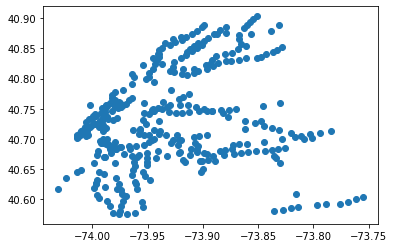

In [7]:
plt.scatter(x=station_locations['Station Longitude'], y=station_locations['Station Latitude'])
plt.show();

### Creating our empty map with folium
Source: https://www.kaggle.com/code/subinium/how-to-use-folium-geospatial-data/notebook

In [8]:
# this is the code for creating the map starting at a desired latitude/longitude - needed whenever creating a new map
# could also use coordinates for NYC: 40.7128 (N), -74.0060 (W)

empty_map = folium.Map(location=[station_locations['Station Latitude'].mean(), station_locations['Station Longitude'].mean()], tiles = 'Stamen Terrain', zoom_start=12, control_scale=True)

In [9]:
empty_map

### Creating a map of all of the stations

In [10]:
for index, location_info in station_locations.iterrows():
    folium.Marker([location_info["Station Latitude"], location_info["Station Longitude"]], tooltip = index).add_to(empty_map)   ## removed argument <popup=location_info["Name"]>

In [11]:
station_map = empty_map

# resetting the empty map
empty_map = folium.Map(location=[station_locations['Station Latitude'].mean(), station_locations['Station Longitude'].mean()], tiles = 'Stamen Terrain', zoom_start=12, control_scale=True)

In [12]:
station_map

### Creating a dynamic cluster map

In [13]:
plugins.MarkerCluster(station_locations).add_to(empty_map)

In [14]:
cluster_map = empty_map

# resetting the empty map
empty_map = folium.Map(location=[station_locations['Station Latitude'].mean(), station_locations['Station Longitude'].mean()], tiles = 'Stamen Terrain', zoom_start=12, control_scale=True)

In [15]:
cluster_map

### Creating maps focused on our target stations

In [16]:
# our stations of focus as they are labeled in the latitude/longitude data set - can easily add more if needed
highest_traffic_list = ['34th St',
                        'Grand Central-42nd St',
                        '34th St-Herald Sq',
                        '42nd St',
                        '23rd St',
                        '86th St',
                        'Times Square-42nd St',
                        'Fulton St',
                        '125th St',
                        '14th St-Union Square'
                       ]

# made separate dataframes for target and non-target stations
highest_traffic_stations = station_locations[station_locations.index.isin(highest_traffic_list)]
other_stations = station_locations[~station_locations.index.isin(highest_traffic_list)]

#### Map of only the target stations

In [17]:
for index, location_info in highest_traffic_stations.iterrows():
    folium.Marker([location_info["Station Latitude"], location_info["Station Longitude"]], tooltip = index, icon = folium.Icon(color = 'red')).add_to(empty_map)

popular_station_map = empty_map

# resetting the empty map
empty_map = folium.Map(location=[station_locations['Station Latitude'].mean(), station_locations['Station Longitude'].mean()], tiles = 'Stamen Terrain', zoom_start=12, control_scale=True)
popular_station_map

#### Map of all stations with the important stations highlighted

In [18]:
for index, location_info in highest_traffic_stations.iterrows():
    folium.Marker([location_info["Station Latitude"], location_info["Station Longitude"]], tooltip = index, icon = folium.Icon(color = 'red')).add_to(empty_map)

for index, location_info in other_stations.iterrows():
    folium.Marker([location_info["Station Latitude"], location_info["Station Longitude"]]).add_to(empty_map)

highlighted_station_map = empty_map

# resetting the empty map
empty_map = folium.Map(location=[station_locations['Station Latitude'].mean(), station_locations['Station Longitude'].mean()], tiles = 'Stamen Terrain', zoom_start=12, control_scale=True)

highlighted_station_map

#### Checking to make sure we still have our empty map

In [19]:
empty_map

#### Adding visualizations to stations

In [23]:
# Read in station turnstile data
df = pd.read_csv('../data/df_cleaned_year.csv',low_memory=False)

In [75]:
def get_station_df(df, station):     # slightly modified from Model Generator notebook
    '''Grabs data for a single station from the dataset'''
    station_df = df[df['station'] == station]
    
    # Setting the datetime to a datetime object and setting as index
    station_df['datetime'] = pd.to_datetime(df['datetime'])

    # Adding a column for time of day
    station_df['time'] = station_df['datetime'].dt.time

    # Combining 'weekday' and 'time' into one column
    station_df['weekday_time'] = station_df['weekday'] + ' ' + station_df['time'].astype(str).str[:5]

    #Adding column for entries + exits called traffic
    station_df['traffic'] = station_df['entries_abs'] + station_df['exits_abs']

    # Remove unnecessary columns
    station_df = station_df.iloc[:, -2:]

    # Use groupby to find averages for weekday and time
    time_order = [ 'Monday 00:00', 'Monday 04:00', 'Monday 08:00', 'Monday 12:00', 'Monday 16:00', 'Monday 20:00',
            'Tuesday 00:00', 'Tuesday 04:00', 'Tuesday 08:00', 'Tuesday 12:00', 'Tuesday 16:00', 'Tuesday 20:00',
            'Wednesday 00:00', 'Wednesday 04:00', 'Wednesday 08:00', 'Wednesday 12:00', 'Wednesday 16:00', 'Wednesday 20:00',
            'Thursday 00:00', 'Thursday 04:00', 'Thursday 08:00', 'Thursday 12:00', 'Thursday 16:00', 'Thursday 20:00',
            'Friday 00:00', 'Friday 04:00', 'Friday 08:00', 'Friday 12:00', 'Friday 16:00', 'Friday 20:00',
            'Saturday 00:00', 'Saturday 04:00', 'Saturday 08:00', 'Saturday 12:00', 'Saturday 16:00', 'Saturday 20:00',
            'Sunday 00:00', 'Sunday 04:00', 'Sunday 08:00', 'Sunday 12:00', 'Sunday 16:00', 'Sunday 20:00']

    station_df = station_df.groupby('weekday_time').mean().reindex(time_order)

    return station_df

/var/folders/lz/08gb56690psggb6cznf0xhwh0000gn/T/ipykernel_93025/64763472.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_df['datetime'] = pd.to_datetime(df['datetime'])
/var/folders/lz/08gb56690psggb6cznf0xhwh0000gn/T/ipykernel_93025/64763472.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_df['time'] = station_df['datetime'].dt.time
/var/folders/lz/08gb56690psggb6cznf0xhwh0000gn/T/ipykernel_93025/64763472.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

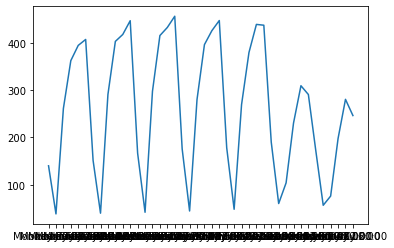

In [82]:
plt.plot(get_station_df(df, '125 ST'));

In [86]:
# Create a DataFrame as altair_df, with country-level prices (that is loop invariant)
altair_df = ...
for j in range(0,stores_df.shape[0]):
  # Create a DataFrame as altair_df, with store and retailer level
  # prices, and append it to the existed altair_df 
  altair_df = ...
  title_ = '--- Set a store dependent title here ---'
  # create graph
  source = pd.DataFrame({
    'Month': temp_df.Month,
    'Price': temp_df.AVGPriceAfterOffer,
    'Label': temp_df.Label
  })
  
  sw_bar = \
    alt.Chart(source).mark_line().encode(
      x=alt.Y('Month',scale=alt.Scale(domain=(Months))),
      y=alt.Y('Price', scale=alt.Scale(domain=(5, 15))),
    color='Label',
    strokeDash='Label').properties(title= 'chart_title_here')
  sw_bar.configure_title(
    fontSize=20,
    font='Courier',
    anchor='start',
    color='gray'
  )
  # add the chart as a folium feature
  vega = folium.features.\
    VegaLite(sw_bar, width='100%', height='100%')
  # create popup
  sw_popup = folium.Popup(text,parse_html=True)
  # add chart to popup
  vega.add_to(sw_popup)
 
  # add to map (using our coordinates for store j)
  place = [df['Latitude'][j], df['Longitude'][j]]
  # create marker on the map, with optional popup text or 
  # Vincent visualization
  sw_marker = folium.features.\
    Marker(place, 
           icon=folium.\
           Icon(color=colors[XMerged['Retailer'][j]]))
  sw_marker.add_to(my_map2)
my_map2

/var/folders/lz/08gb56690psggb6cznf0xhwh0000gn/T/ipykernel_93025/64763472.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_df['datetime'] = pd.to_datetime(df['datetime'])
/var/folders/lz/08gb56690psggb6cznf0xhwh0000gn/T/ipykernel_93025/64763472.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_df['time'] = station_df['datetime'].dt.time
/var/folders/lz/08gb56690psggb6cznf0xhwh0000gn/T/ipykernel_93025/64763472.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

SchemaValidationError: Invalid specification

        altair.vegalite.v4.schema.channels.X->0, validating 'type'

        {246926: 'Saturday 04:00', 246927: 'Saturday 08:00', 246928: 'Saturday 12:00', 246929: 'Saturday 16:00', 246930: 'Saturday 20:00', 246931: 'Sunday 00:00', 246932: 'Sunday 04:00', 246933: 'Sunday 08:00', 246934: 'Sunday 12:00', 246935: 'Sunday 16:00', 246936: 'Sunday 20:00', 246937: 'Monday 00:00', 246938: 'Monday 04:00', 246939: 'Monday 08:00', 246940: 'Monday 12:00', 246941: 'Monday 16:00', 246942: 'Monday 20:00', 246943: 'Tuesday 00:00', 246944: 'Tuesday 04:00', 246945: 'Tuesday 08:00', 246946: 'Tuesday 12:00', 246947: 'Tuesday 16:00', 246948: 'Tuesday 20:00', 246949: 'Wednesday 00:00', 246950: 'Wednesday 04:00', 246951: 'Wednesday 08:00', 246952: 'Wednesday 12:00', 246953: 'Wednesday 16:00', 246954: 'Wednesday 20:00', 246955: 'Thursday 00:00', 246956: 'Thursday 04:00', 246957: 'Thursday 08:00', 246958: 'Thursday 12:00', 246959: 'Thursday 16:00', 246960: 'Thursday 20:00', 246961: 'Friday 00:00', 246962: 'Friday 04:00', 246963: 'Friday 08:00', 246964: 'Friday 12:00', 246965: 'Friday 16:00', 246966: 'Friday 20:00', 246967: 'Saturday 00:00', 246968: 'Saturday 04:00', 246969: 'Saturday 08:00', 246970: 'Saturday 12:00', 246971: 'Saturday 16:00', 246972: 'Saturday 20:00', 246973: 'Sunday 00:00', 246974: 'Sunday 04:00', 246975: 'Sunday 08:00', 246976: 'Sunday 12:00', 246977: 'Sunday 16:00', 246978: 'Sunday 20:00', 246979: 'Monday 00:00', 246980: 'Monday 04:00', 246981: 'Monday 08:00', 246982: 'Monday 12:00', 246983: 'Monday 16:00', 246984: 'Monday 20:00', 246985: 'Tuesday 00:00', 246986: 'Tuesday 04:00', 246987: 'Tuesday 08:00', 246988: 'Tuesday 12:00', 246989: 'Tuesday 16:00', 246990: 'Tuesday 20:00', 246991: 'Wednesday 00:00', 246992: 'Wednesday 04:00', 246993: 'Wednesday 08:00', 246994: 'Wednesday 12:00', 246995: 'Wednesday 16:00', 246996: 'Wednesday 20:00', 246997: 'Thursday 00:00', 246998: 'Thursday 04:00', 246999: 'Thursday 08:00', 247000: 'Thursday 12:00', 247001: 'Thursday 16:00', 247002: 'Thursday 20:00', 247003: 'Friday 00:00', 247004: 'Friday 04:00', 247005: 'Friday 08:00', 247006: 'Friday 12:00', 247007: 'Friday 16:00', 247008: 'Friday 20:00', 247009: 'Saturday 00:00', 247010: 'Saturday 04:00', 247011: 'Saturday 08:00', 247012: 'Saturday 12:00', 247013: 'Saturday 16:00', 247014: 'Saturday 20:00', 247015: 'Sunday 00:00', 247016: 'Sunday 04:00', 247017: 'Sunday 08:00', 247018: 'Sunday 12:00', 247019: 'Sunday 16:00', 247020: 'Sunday 20:00', 247021: 'Monday 00:00', 247022: 'Monday 04:00', 247023: 'Monday 08:00', 247024: 'Monday 12:00', 247025: 'Monday 16:00', 247026: 'Monday 20:00', 247027: 'Tuesday 00:00', 247028: 'Tuesday 04:00', 247029: 'Tuesday 08:00', 247030: 'Tuesday 12:00', 247031: 'Tuesday 16:00', 247032: 'Tuesday 20:00', 247033: 'Wednesday 00:00', 247034: 'Wednesday 04:00', 247035: 'Wednesday 08:00', 247036: 'Wednesday 12:00', 247037: 'Wednesday 16:00', 247038: 'Wednesday 20:00', 247039: 'Thursday 00:00', 247040: 'Thursday 04:00', 247041: 'Thursday 08:00', 247042: 'Thursday 12:00', 247043: 'Thursday 16:00', 247044: 'Thursday 20:00', 247045: 'Friday 00:00', 247046: 'Friday 04:00', 247047: 'Friday 08:00', 247048: 'Friday 12:00', 247049: 'Friday 16:00', 247050: 'Friday 20:00', 247051: 'Saturday 00:00', 247052: 'Saturday 04:00', 247053: 'Saturday 08:00', 247054: 'Saturday 12:00', 247055: 'Saturday 16:00', 247056: 'Saturday 20:00', 247057: 'Sunday 00:00', 247058: 'Sunday 04:00', 247059: 'Sunday 08:00', 247060: 'Sunday 12:00', 247061: 'Sunday 16:00', 247062: 'Sunday 20:00', 247063: 'Sunday 20:00', 247064: 'Monday 04:00', 247065: 'Monday 08:00', 247066: 'Monday 12:00', 247067: 'Monday 16:00', 247068: 'Monday 20:00', 247069: 'Monday 20:00', 247070: 'Tuesday 04:00', 247071: 'Tuesday 08:00', 247072: 'Tuesday 12:00', 247073: 'Tuesday 16:00', 247074: 'Tuesday 20:00', 247075: 'Tuesday 20:00', 247076: 'Wednesday 04:00', 247077: 'Wednesday 08:00', 247078: 'Wednesday 12:00', 247079: 'Wednesday 16:00', 247080: 'Wednesday 20:00', 247081: 'Wednesday 20:00', 247082: 'Thursday 04:00', 247083: 'Thursday 08:00', 247084: 'Thursday 12:00', 247085: 'Thursday 16:00', 247086: 'Thursday 20:00', 247087: 'Thursday 20:00', 247088: 'Friday 04:00', 247089: 'Friday 08:00', 247090: 'Friday 12:00', 247091: 'Friday 16:00', 247092: 'Friday 20:00', 247093: 'Friday 20:00', 247094: 'Saturday 04:00', 247095: 'Saturday 08:00', 247096: 'Saturday 12:00', 247097: 'Saturday 16:00', 247098: 'Saturday 20:00', 247099: 'Saturday 20:00', 247100: 'Sunday 04:00', 247101: 'Sunday 08:00', 247102: 'Sunday 12:00', 247103: 'Sunday 16:00', 247104: 'Sunday 20:00', 247105: 'Sunday 20:00', 247106: 'Monday 04:00', 247107: 'Monday 08:00', 247108: 'Monday 12:00', 247109: 'Monday 16:00', 247110: 'Monday 20:00', 247111: 'Monday 20:00', 247112: 'Tuesday 04:00', 247113: 'Tuesday 08:00', 247114: 'Tuesday 12:00', 247115: 'Tuesday 16:00', 247116: 'Tuesday 20:00', 247117: 'Tuesday 20:00', 247118: 'Wednesday 04:00', 247119: 'Wednesday 08:00', 247120: 'Wednesday 12:00', 247121: 'Wednesday 16:00', 247122: 'Wednesday 20:00', 247123: 'Wednesday 20:00', 247124: 'Thursday 04:00', 247125: 'Thursday 08:00', 247126: 'Thursday 12:00', 247127: 'Thursday 16:00', 247128: 'Thursday 20:00', 247129: 'Thursday 20:00', 247130: 'Friday 04:00', 247131: 'Friday 08:00', 247132: 'Friday 12:00', 247133: 'Friday 16:00', 247134: 'Friday 20:00', 247135: 'Friday 20:00', 247136: 'Saturday 04:00', 247137: 'Saturday 08:00', 247138: 'Saturday 12:00', 247139: 'Saturday 16:00', 247140: 'Saturday 20:00', 247141: 'Saturday 20:00', 247142: 'Sunday 04:00', 247143: 'Sunday 08:00', 247144: 'Sunday 12:00', 247145: 'Sunday 16:00', 247146: 'Sunday 20:00', 247147: 'Sunday 20:00', 247148: 'Monday 04:00', 247149: 'Monday 08:00', 247150: 'Monday 12:00', 247151: 'Monday 16:00', 247152: 'Monday 20:00', 247153: 'Monday 20:00', 247154: 'Tuesday 04:00', 247155: 'Tuesday 08:00', 247156: 'Tuesday 12:00', 247157: 'Tuesday 16:00', 247158: 'Tuesday 20:00', 247159: 'Tuesday 20:00', 247160: 'Wednesday 04:00', 247161: 'Wednesday 08:00', 247162: 'Wednesday 12:00', 247163: 'Wednesday 16:00', 247164: 'Wednesday 20:00', 247165: 'Wednesday 20:00', 247166: 'Thursday 04:00', 247167: 'Thursday 08:00', 247168: 'Thursday 12:00', 247169: 'Thursday 16:00', 247170: 'Thursday 20:00', 247171: 'Thursday 20:00', 247172: 'Friday 04:00', 247173: 'Friday 08:00', 247174: 'Friday 12:00', 247175: 'Friday 16:00', 247176: 'Friday 20:00', 247177: 'Friday 20:00', 247178: 'Saturday 04:00', 247179: 'Saturday 08:00', 247180: 'Saturday 12:00', 247181: 'Saturday 16:00', 247182: 'Saturday 20:00', 247183: 'Saturday 20:00', 247184: 'Sunday 04:00', 247185: 'Sunday 08:00', 247186: 'Sunday 12:00', 247187: 'Sunday 16:00', 247188: 'Sunday 20:00', 247189: 'Sunday 20:00', 247190: 'Monday 04:00', 247191: 'Monday 08:00', 247192: 'Monday 12:00', 247193: 'Monday 16:00', 247194: 'Monday 20:00', 247195: 'Monday 20:00', 247196: 'Tuesday 04:00', 247197: 'Tuesday 08:00', 247198: 'Tuesday 12:00', 247199: 'Tuesday 16:00', 247200: 'Tuesday 20:00', 247201: 'Tuesday 20:00', 247202: 'Wednesday 04:00', 247203: 'Wednesday 08:00', 247204: 'Wednesday 12:00', 247205: 'Wednesday 16:00', 247206: 'Wednesday 20:00', 247207: 'Wednesday 20:00', 247208: 'Thursday 04:00', 247209: 'Thursday 08:00', 247210: 'Thursday 12:00', 247211: 'Thursday 16:00', 247212: 'Thursday 20:00', 247213: 'Thursday 20:00', 247214: 'Friday 04:00', 247215: 'Friday 08:00', 247216: 'Friday 12:00', 247217: 'Friday 16:00', 247218: 'Friday 20:00', 247219: 'Friday 20:00', 247220: 'Saturday 04:00', 247221: 'Saturday 08:00', 247222: 'Saturday 12:00', 247223: 'Saturday 16:00', 247224: 'Saturday 20:00', 247225: 'Saturday 20:00', 247226: 'Sunday 04:00', 247227: 'Sunday 08:00', 247228: 'Sunday 12:00', 247229: 'Sunday 16:00', 247230: 'Sunday 20:00', 247231: 'Sunday 20:00', 247232: 'Monday 04:00', 247233: 'Monday 08:00', 247234: 'Monday 12:00', 247235: 'Monday 16:00', 247236: 'Monday 20:00', 247237: 'Monday 20:00', 247238: 'Tuesday 04:00', 247239: 'Tuesday 08:00', 247240: 'Tuesday 12:00', 247241: 'Tuesday 16:00', 247242: 'Tuesday 20:00', 247243: 'Tuesday 20:00', 247244: 'Wednesday 04:00', 247245: 'Wednesday 08:00', 247246: 'Wednesday 12:00', 247247: 'Wednesday 16:00', 247248: 'Wednesday 20:00', 247249: 'Wednesday 20:00', 247250: 'Thursday 04:00', 247251: 'Thursday 08:00', 247252: 'Thursday 12:00', 247253: 'Thursday 16:00', 247254: 'Thursday 20:00', 247255: 'Thursday 20:00', 247256: 'Friday 04:00', 247257: 'Friday 08:00', 247258: 'Friday 12:00', 247259: 'Friday 16:00', 247260: 'Friday 20:00', 247261: 'Friday 20:00', 247262: 'Saturday 04:00', 247263: 'Saturday 08:00', 247264: 'Saturday 12:00', 247265: 'Saturday 16:00', 247266: 'Saturday 20:00', 247267: 'Saturday 20:00', 247268: 'Sunday 04:00', 247269: 'Sunday 08:00', 247270: 'Sunday 12:00', 247271: 'Sunday 16:00', 247272: 'Sunday 20:00', 247273: 'Sunday 20:00', 247274: 'Monday 04:00', 247275: 'Monday 08:00', 247276: 'Monday 12:00', 247277: 'Monday 16:00', 247278: 'Monday 20:00', 247279: 'Monday 20:00', 247280: 'Tuesday 04:00', 247281: 'Tuesday 08:00', 247282: 'Tuesday 12:00', 247283: 'Tuesday 16:00', 247284: 'Tuesday 20:00', 247285: 'Tuesday 20:00', 247286: 'Wednesday 04:00', 247287: 'Wednesday 08:00', 247288: 'Wednesday 12:00', 247289: 'Wednesday 16:00', 247290: 'Wednesday 20:00', 247291: 'Wednesday 20:00', 247292: 'Thursday 04:00', 247293: 'Thursday 08:00', 247294: 'Thursday 12:00', 247295: 'Thursday 16:00', 247296: 'Thursday 20:00', 247297: 'Thursday 20:00', 247298: 'Friday 04:00', 247299: 'Friday 08:00', 247300: 'Friday 12:00', 247301: 'Friday 16:00', 247302: 'Friday 16:00', 247303: 'Friday 16:00', 247304: 'Friday 20:00', 247305: 'Friday 20:00', 247306: 'Saturday 04:00', 247307: 'Saturday 08:00', 247308: 'Saturday 12:00', 247309: 'Saturday 16:00', 247310: 'Saturday 20:00', 247311: 'Saturday 20:00', 247312: 'Sunday 04:00', 247313: 'Sunday 08:00', 247314: 'Sunday 12:00', 247315: 'Sunday 16:00', 247316: 'Sunday 20:00', 247317: 'Sunday 20:00', 247318: 'Monday 04:00', 247319: 'Monday 08:00', 247320: 'Monday 12:00', 247321: 'Monday 12:00', 247322: 'Monday 12:00', 247323: 'Monday 16:00', 247324: 'Monday 20:00', 247325: 'Monday 20:00', 247326: 'Tuesday 04:00', 247327: 'Tuesday 08:00', 247328: 'Tuesday 12:00', 247329: 'Tuesday 16:00', 247330: 'Tuesday 20:00', 247331: 'Tuesday 20:00', 247332: 'Wednesday 04:00', 247333: 'Wednesday 08:00', 247334: 'Wednesday 12:00', 247335: 'Wednesday 16:00', 247336: 'Wednesday 20:00', 247337: 'Wednesday 20:00', 247338: 'Thursday 04:00', 247339: 'Thursday 08:00', 247340: 'Thursday 12:00', 247341: 'Thursday 16:00', 247342: 'Thursday 20:00', 247343: 'Thursday 20:00', 247344: 'Friday 04:00', 247345: 'Friday 08:00', 247346: 'Friday 12:00', 247347: 'Friday 16:00', 247348: 'Friday 20:00', 247349: 'Friday 20:00', 247350: 'Saturday 04:00', 247351: 'Saturday 08:00', 247352: 'Saturday 12:00', 247353: 'Saturday 16:00', 247354: 'Saturday 20:00', 247355: 'Saturday 20:00', 247356: 'Sunday 04:00', 247357: 'Sunday 08:00', 247358: 'Sunday 12:00', 247359: 'Sunday 16:00', 247360: 'Sunday 20:00', 247361: 'Sunday 20:00', 247362: 'Monday 04:00', 247363: 'Monday 08:00', 247364: 'Monday 12:00', 247365: 'Monday 20:00', 247366: 'Monday 20:00', 247367: 'Tuesday 04:00', 247368: 'Tuesday 08:00', 247369: 'Tuesday 12:00', 247370: 'Tuesday 16:00', 247371: 'Tuesday 20:00', 247372: 'Tuesday 20:00', 247373: 'Wednesday 04:00', 247374: 'Wednesday 08:00', 247375: 'Wednesday 12:00', 247376: 'Wednesday 16:00', 247377: 'Wednesday 20:00', 247378: 'Wednesday 20:00', 247379: 'Thursday 04:00', 247380: 'Thursday 08:00', 247381: 'Thursday 12:00', 247382: 'Thursday 16:00', 247383: 'Thursday 20:00', 247384: 'Thursday 20:00', 247385: 'Friday 04:00', 247386: 'Friday 08:00', 247387: 'Friday 12:00', 247388: 'Friday 16:00', 247389: 'Friday 20:00', 247390: 'Friday 20:00', 247391: 'Saturday 04:00', 247392: 'Saturday 08:00', 247393: 'Saturday 12:00', 247394: 'Saturday 16:00', 247395: 'Saturday 20:00', 247396: 'Saturday 20:00', 247397: 'Sunday 04:00', 247398: 'Sunday 08:00', 247399: 'Sunday 12:00', 247400: 'Sunday 16:00', 247401: 'Sunday 20:00', 247402: 'Sunday 20:00', 247403: 'Monday 04:00', 247404: 'Monday 08:00', 247405: 'Monday 12:00', 247406: 'Monday 16:00', 247407: 'Monday 20:00', 247408: 'Monday 20:00', 247409: 'Tuesday 04:00', 247410: 'Tuesday 08:00', 247411: 'Tuesday 12:00', 247412: 'Tuesday 16:00', 247413: 'Tuesday 20:00', 247414: 'Tuesday 20:00', 247415: 'Wednesday 04:00', 247416: 'Wednesday 08:00', 247417: 'Wednesday 12:00', 247418: 'Wednesday 16:00', 247419: 'Wednesday 20:00', 247420: 'Wednesday 20:00', 247421: 'Thursday 04:00', 247422: 'Thursday 08:00', 247423: 'Thursday 12:00', 247424: 'Thursday 16:00', 247425: 'Thursday 20:00', 247426: 'Thursday 20:00', 247427: 'Friday 04:00', 247428: 'Friday 08:00', 247429: 'Friday 12:00', 247430: 'Friday 16:00', 247431: 'Friday 20:00', 247432: 'Friday 20:00', 247433: 'Saturday 04:00', 247434: 'Saturday 08:00', 247435: 'Saturday 12:00', 247436: 'Saturday 16:00', 247437: 'Saturday 20:00', 247438: 'Saturday 20:00', 247439: 'Sunday 04:00', 247440: 'Sunday 08:00', 247441: 'Sunday 12:00', 247442: 'Sunday 16:00', 247443: 'Sunday 20:00', 247444: 'Sunday 20:00', 247445: 'Monday 04:00', 247446: 'Monday 08:00', 247447: 'Monday 12:00', 247448: 'Monday 16:00', 247449: 'Monday 20:00', 247450: 'Monday 20:00', 247451: 'Tuesday 04:00', 247452: 'Tuesday 08:00', 247453: 'Tuesday 12:00', 247454: 'Tuesday 16:00', 247455: 'Tuesday 20:00', 247456: 'Tuesday 20:00', 247457: 'Wednesday 04:00', 247458: 'Wednesday 08:00', 247459: 'Wednesday 12:00', 247460: 'Wednesday 16:00', 247461: 'Wednesday 20:00', 247462: 'Wednesday 20:00', 247463: 'Thursday 04:00', 247464: 'Thursday 08:00', 247465: 'Thursday 12:00', 247466: 'Thursday 16:00', 247467: 'Thursday 20:00', 247468: 'Thursday 20:00', 247469: 'Friday 04:00', 247470: 'Friday 08:00', 247471: 'Friday 12:00', 247472: 'Friday 16:00', 247473: 'Friday 20:00', 247474: 'Friday 20:00', 247475: 'Saturday 04:00', 247476: 'Saturday 08:00', 247477: 'Saturday 12:00', 247478: 'Saturday 16:00', 247479: 'Saturday 20:00', 247480: 'Saturday 20:00', 247481: 'Sunday 04:00', 247482: 'Sunday 08:00', 247483: 'Sunday 12:00', 247484: 'Sunday 16:00', 247485: 'Sunday 20:00', 247486: 'Sunday 20:00', 247487: 'Monday 04:00', 247488: 'Monday 08:00', 247489: 'Monday 12:00', 247490: 'Monday 16:00', 247491: 'Monday 20:00', 247492: 'Monday 20:00', 247493: 'Tuesday 04:00', 247494: 'Tuesday 08:00', 247495: 'Tuesday 12:00', 247496: 'Tuesday 16:00', 247497: 'Tuesday 20:00', 247498: 'Tuesday 20:00', 247499: 'Wednesday 04:00', 247500: 'Wednesday 08:00', 247501: 'Wednesday 12:00', 247502: 'Wednesday 16:00', 247503: 'Wednesday 20:00', 247504: 'Wednesday 20:00', 247505: 'Thursday 04:00', 247506: 'Thursday 08:00', 247507: 'Thursday 12:00', 247508: 'Thursday 16:00', 247509: 'Thursday 20:00', 247510: 'Thursday 20:00', 247511: 'Friday 04:00', 247512: 'Friday 08:00', 247513: 'Friday 12:00', 247514: 'Friday 16:00', 247515: 'Friday 20:00', 247516: 'Friday 20:00', 247517: 'Saturday 04:00', 247518: 'Saturday 08:00', 247519: 'Saturday 12:00', 247520: 'Saturday 16:00', 247521: 'Saturday 20:00', 247522: 'Saturday 20:00', 247523: 'Sunday 04:00', 247524: 'Sunday 08:00', 247525: 'Sunday 12:00', 247526: 'Sunday 16:00', 247527: 'Sunday 20:00', 247528: 'Sunday 20:00', 247529: 'Monday 04:00', 247530: 'Monday 08:00', 247531: 'Monday 12:00', 247532: 'Monday 16:00', 247533: 'Monday 20:00', 247534: 'Monday 20:00', 247535: 'Tuesday 04:00', 247536: 'Tuesday 08:00', 247537: 'Tuesday 12:00', 247538: 'Tuesday 16:00', 247539: 'Tuesday 20:00', 247540: 'Tuesday 20:00', 247541: 'Wednesday 04:00', 247542: 'Wednesday 08:00', 247543: 'Wednesday 12:00', 247544: 'Wednesday 16:00', 247545: 'Wednesday 20:00', 247546: 'Wednesday 20:00', 247547: 'Thursday 04:00', 247548: 'Thursday 08:00', 247549: 'Thursday 12:00', 247550: 'Thursday 16:00', 247551: 'Thursday 20:00', 247552: 'Thursday 20:00', 247553: 'Friday 04:00', 247554: 'Friday 08:00', 247555: 'Friday 12:00', 247556: 'Friday 16:00', 247557: 'Friday 20:00', 247558: 'Friday 20:00', 247559: 'Saturday 04:00', 247560: 'Saturday 08:00', 247561: 'Saturday 12:00', 247562: 'Saturday 16:00', 247563: 'Saturday 20:00', 247564: 'Saturday 20:00', 247565: 'Sunday 04:00', 247566: 'Sunday 08:00', 247567: 'Sunday 12:00', 247568: 'Sunday 16:00', 247569: 'Sunday 20:00', 247570: 'Sunday 20:00', 247571: 'Monday 04:00', 247572: 'Monday 08:00', 247573: 'Monday 12:00', 247574: 'Monday 16:00', 247575: 'Monday 20:00', 247576: 'Monday 20:00', 247577: 'Tuesday 04:00', 247578: 'Tuesday 08:00', 247579: 'Tuesday 12:00', 247580: 'Tuesday 16:00', 247581: 'Tuesday 20:00', 247582: 'Tuesday 20:00', 247583: 'Wednesday 04:00', 247584: 'Wednesday 08:00', 247585: 'Wednesday 12:00', 247586: 'Wednesday 16:00', 247587: 'Wednesday 20:00', 247588: 'Wednesday 20:00', 247589: 'Thursday 04:00', 247590: 'Thursday 08:00', 247591: 'Thursday 12:00', 247592: 'Thursday 16:00', 247593: 'Thursday 20:00', 247594: 'Thursday 20:00', 247595: 'Friday 04:00', 247596: 'Friday 08:00', 247597: 'Friday 12:00', 247598: 'Friday 16:00', 247599: 'Friday 20:00', 247600: 'Friday 20:00', 247601: 'Saturday 04:00', 247602: 'Saturday 08:00', 247603: 'Saturday 12:00', 247604: 'Saturday 16:00', 247605: 'Saturday 20:00', 247606: 'Saturday 20:00', 247607: 'Sunday 04:00', 247608: 'Sunday 08:00', 247609: 'Sunday 12:00', 247610: 'Sunday 16:00', 247611: 'Sunday 20:00', 247612: 'Sunday 20:00', 247613: 'Monday 04:00', 247614: 'Monday 08:00', 247615: 'Monday 12:00', 247616: 'Monday 16:00', 247617: 'Monday 20:00', 247618: 'Monday 20:00', 247619: 'Tuesday 04:00', 247620: 'Tuesday 08:00', 247621: 'Tuesday 12:00', 247622: 'Tuesday 16:00', 247623: 'Tuesday 20:00', 247624: 'Tuesday 20:00', 247625: 'Wednesday 04:00', 247626: 'Wednesday 08:00', 247627: 'Wednesday 12:00', 247628: 'Wednesday 16:00', 247629: 'Wednesday 20:00', 247630: 'Wednesday 20:00', 247631: 'Thursday 04:00', 247632: 'Thursday 08:00', 247633: 'Thursday 12:00', 247634: 'Thursday 16:00', 247635: 'Thursday 20:00', 247636: 'Thursday 20:00', 247637: 'Friday 04:00', 247638: 'Friday 08:00', 247639: 'Friday 12:00', 247640: 'Friday 16:00', 247641: 'Friday 20:00', 247642: 'Friday 20:00', 247643: 'Saturday 04:00', 247644: 'Saturday 08:00', 247645: 'Saturday 12:00', 247646: 'Saturday 16:00', 247647: 'Saturday 20:00', 247648: 'Saturday 20:00', 247649: 'Sunday 04:00', 247650: 'Sunday 08:00', 247651: 'Sunday 12:00', 247652: 'Sunday 16:00', 247653: 'Sunday 20:00', 247654: 'Sunday 20:00', 247655: 'Monday 04:00', 247656: 'Monday 08:00', 247657: 'Monday 12:00', 247658: 'Monday 16:00', 247659: 'Monday 20:00', 247660: 'Monday 20:00', 247661: 'Tuesday 04:00', 247662: 'Tuesday 08:00', 247663: 'Tuesday 12:00', 247664: 'Tuesday 16:00', 247665: 'Tuesday 20:00', 247666: 'Tuesday 20:00', 247667: 'Wednesday 04:00', 247668: 'Wednesday 08:00', 247669: 'Wednesday 12:00', 247670: 'Wednesday 16:00', 247671: 'Wednesday 20:00', 247672: 'Wednesday 20:00', 247673: 'Thursday 04:00', 247674: 'Thursday 08:00', 247675: 'Thursday 12:00', 247676: 'Thursday 16:00', 247677: 'Thursday 16:00', 247678: 'Thursday 20:00', 247679: 'Thursday 20:00', 247680: 'Friday 04:00', 247681: 'Friday 08:00', 247682: 'Friday 12:00', 247683: 'Friday 16:00', 247684: 'Friday 20:00', 247685: 'Friday 20:00', 247686: 'Saturday 04:00', 247687: 'Saturday 08:00', 247688: 'Saturday 12:00', 247689: 'Saturday 16:00', 247690: 'Saturday 20:00', 247691: 'Saturday 20:00', 247692: 'Sunday 04:00', 247693: 'Sunday 08:00', 247694: 'Sunday 12:00', 247695: 'Sunday 16:00', 247696: 'Sunday 20:00', 247697: 'Sunday 20:00', 247698: 'Monday 04:00', 247699: 'Monday 08:00', 247700: 'Monday 12:00', 247701: 'Monday 16:00', 247702: 'Monday 20:00', 247703: 'Monday 20:00', 247704: 'Tuesday 04:00', 247705: 'Tuesday 08:00', 247706: 'Tuesday 12:00', 247707: 'Tuesday 16:00', 247708: 'Tuesday 20:00', 247709: 'Tuesday 20:00', 247710: 'Wednesday 04:00', 247711: 'Wednesday 08:00', 247712: 'Wednesday 12:00', 247713: 'Wednesday 16:00', 247714: 'Wednesday 20:00', 247715: 'Wednesday 20:00', 247716: 'Thursday 04:00', 247717: 'Thursday 08:00', 247718: 'Thursday 12:00', 247719: 'Thursday 16:00', 247720: 'Thursday 20:00', 247721: 'Thursday 20:00', 247722: 'Friday 04:00', 247723: 'Friday 08:00', 247724: 'Friday 12:00', 247725: 'Friday 16:00', 247726: 'Friday 20:00', 247727: 'Friday 20:00', 247728: 'Saturday 04:00', 247729: 'Saturday 08:00', 247730: 'Saturday 12:00', 247731: 'Saturday 16:00', 247732: 'Saturday 20:00', 247733: 'Saturday 20:00', 247734: 'Sunday 04:00', 247735: 'Sunday 08:00', 247736: 'Sunday 12:00', 247737: 'Sunday 16:00', 247738: 'Sunday 20:00', 247739: 'Sunday 20:00', 247740: 'Monday 04:00', 247741: 'Monday 08:00', 247742: 'Monday 12:00', 247743: 'Monday 16:00', 247744: 'Monday 20:00', 247745: 'Monday 20:00', 247746: 'Tuesday 04:00', 247747: 'Tuesday 08:00', 247748: 'Tuesday 12:00', 247749: 'Tuesday 16:00', 247750: 'Tuesday 20:00', 247751: 'Tuesday 20:00', 247752: 'Wednesday 04:00', 247753: 'Wednesday 08:00', 247754: 'Wednesday 12:00', 247755: 'Wednesday 16:00', 247756: 'Wednesday 20:00', 247757: 'Wednesday 20:00', 247758: 'Thursday 04:00', 247759: 'Thursday 08:00', 247760: 'Thursday 12:00', 247761: 'Thursday 16:00', 247762: 'Thursday 20:00', 247763: 'Thursday 20:00', 247764: 'Friday 04:00', 247765: 'Friday 08:00', 247766: 'Friday 12:00', 247767: 'Friday 16:00', 247768: 'Friday 20:00', 247769: 'Friday 20:00', 247770: 'Saturday 04:00', 247771: 'Saturday 08:00', 247772: 'Saturday 12:00', 247773: 'Saturday 16:00', 247774: 'Saturday 20:00', 247775: 'Saturday 20:00', 247776: 'Sunday 04:00', 247777: 'Sunday 08:00', 247778: 'Sunday 12:00', 247779: 'Sunday 16:00', 247780: 'Sunday 20:00', 247781: 'Sunday 20:00', 247782: 'Monday 04:00', 247783: 'Monday 08:00', 247784: 'Monday 12:00', 247785: 'Monday 16:00', 247786: 'Monday 20:00', 247787: 'Monday 20:00', 247788: 'Tuesday 04:00', 247789: 'Tuesday 08:00', 247790: 'Tuesday 12:00', 247791: 'Tuesday 16:00', 247792: 'Tuesday 20:00', 247793: 'Tuesday 20:00', 247794: 'Wednesday 04:00', 247795: 'Wednesday 08:00', 247796: 'Wednesday 12:00', 247797: 'Wednesday 16:00', 247798: 'Wednesday 20:00', 247799: 'Wednesday 20:00', 247800: 'Thursday 04:00', 247801: 'Thursday 08:00', 247802: 'Thursday 12:00', 247803: 'Thursday 16:00', 247804: 'Thursday 20:00', 247805: 'Thursday 20:00', 247806: 'Friday 04:00', 247807: 'Friday 08:00', 247808: 'Friday 12:00', 247809: 'Friday 16:00', 247810: 'Friday 20:00', 247811: 'Friday 20:00', 247812: 'Saturday 04:00', 247813: 'Saturday 08:00', 247814: 'Saturday 12:00', 247815: 'Saturday 16:00', 247816: 'Saturday 20:00', 247817: 'Saturday 20:00', 247818: 'Sunday 04:00', 247819: 'Sunday 08:00', 247820: 'Sunday 12:00', 247821: 'Sunday 16:00', 247822: 'Sunday 20:00', 247823: 'Monday 00:00', 247824: 'Monday 04:00', 247825: 'Monday 08:00', 247826: 'Monday 12:00', 247827: 'Monday 16:00', 247828: 'Monday 20:00', 247829: 'Tuesday 00:00', 247830: 'Tuesday 04:00', 247831: 'Tuesday 08:00', 247832: 'Tuesday 12:00', 247833: 'Tuesday 16:00', 247834: 'Tuesday 20:00', 247835: 'Wednesday 00:00', 247836: 'Wednesday 04:00', 247837: 'Wednesday 08:00', 247838: 'Wednesday 12:00', 247839: 'Wednesday 16:00', 247840: 'Wednesday 20:00', 247841: 'Thursday 00:00', 247842: 'Thursday 04:00', 247843: 'Thursday 08:00', 247844: 'Thursday 12:00', 247845: 'Thursday 16:00', 247846: 'Thursday 20:00', 247847: 'Friday 00:00', 247848: 'Friday 04:00', 247849: 'Friday 08:00', 247850: 'Friday 12:00', 247851: 'Friday 16:00', 247852: 'Friday 20:00', 247853: 'Saturday 00:00', 247854: 'Saturday 04:00', 247855: 'Saturday 08:00', 247856: 'Saturday 12:00', 247857: 'Saturday 16:00', 247858: 'Saturday 20:00', 247859: 'Sunday 00:00', 247860: 'Sunday 04:00', 247861: 'Sunday 08:00', 247862: 'Sunday 12:00', 247863: 'Sunday 16:00', 247864: 'Sunday 20:00', 247865: 'Monday 00:00', 247866: 'Monday 04:00', 247867: 'Monday 08:00', 247868: 'Monday 12:00', 247869: 'Monday 16:00', 247870: 'Monday 20:00', 247871: 'Tuesday 00:00', 247872: 'Tuesday 04:00', 247873: 'Tuesday 08:00', 247874: 'Tuesday 12:00', 247875: 'Tuesday 16:00', 247876: 'Tuesday 20:00', 247877: 'Wednesday 00:00', 247878: 'Wednesday 04:00', 247879: 'Wednesday 08:00', 247880: 'Wednesday 12:00', 247881: 'Wednesday 16:00', 247882: 'Wednesday 20:00', 247883: 'Thursday 00:00', 247884: 'Thursday 04:00', 247885: 'Thursday 08:00', 247886: 'Thursday 12:00', 247887: 'Thursday 16:00', 247888: 'Thursday 20:00', 247889: 'Friday 00:00', 247890: 'Friday 04:00', 247891: 'Friday 08:00', 247892: 'Friday 12:00', 247893: 'Friday 16:00', 247894: 'Friday 20:00', 247895: 'Saturday 00:00', 247896: 'Saturday 04:00', 247897: 'Saturday 08:00', 247898: 'Saturday 12:00', 247899: 'Saturday 16:00', 247900: 'Saturday 20:00', 247901: 'Sunday 00:00', 247902: 'Sunday 04:00', 247903: 'Sunday 08:00', 247904: 'Sunday 12:00', 247905: 'Sunday 16:00', 247906: 'Sunday 20:00', 247907: 'Monday 00:00', 247908: 'Monday 04:00', 247909: 'Monday 08:00', 247910: 'Monday 12:00', 247911: 'Monday 16:00', 247912: 'Monday 20:00', 247913: 'Tuesday 00:00', 247914: 'Tuesday 04:00', 247915: 'Tuesday 08:00', 247916: 'Tuesday 12:00', 247917: 'Tuesday 16:00', 247918: 'Tuesday 20:00', 247919: 'Wednesday 00:00', 247920: 'Wednesday 04:00', 247921: 'Wednesday 08:00', 247922: 'Wednesday 12:00', 247923: 'Wednesday 16:00', 247924: 'Wednesday 20:00', 247925: 'Thursday 00:00', 247926: 'Thursday 04:00', 247927: 'Thursday 08:00', 247928: 'Thursday 12:00', 247929: 'Thursday 16:00', 247930: 'Thursday 20:00', 247931: 'Friday 00:00', 247932: 'Friday 04:00', 247933: 'Friday 08:00', 247934: 'Friday 12:00', 247935: 'Friday 16:00', 247936: 'Friday 20:00', 247937: 'Saturday 00:00', 247938: 'Saturday 04:00', 247939: 'Saturday 08:00', 247940: 'Saturday 12:00', 247941: 'Saturday 16:00', 247942: 'Saturday 20:00', 247943: 'Sunday 00:00', 247944: 'Sunday 04:00', 247945: 'Sunday 08:00', 247946: 'Sunday 12:00', 247947: 'Sunday 16:00', 247948: 'Sunday 20:00', 247949: 'Monday 00:00', 247950: 'Monday 04:00', 247951: 'Monday 08:00', 247952: 'Monday 12:00', 247953: 'Monday 16:00', 247954: 'Monday 20:00', 247955: 'Tuesday 00:00', 247956: 'Tuesday 04:00', 247957: 'Tuesday 08:00', 247958: 'Tuesday 12:00', 247959: 'Tuesday 16:00', 247960: 'Tuesday 20:00', 247961: 'Wednesday 00:00', 247962: 'Wednesday 04:00', 247963: 'Wednesday 08:00', 247964: 'Wednesday 12:00', 247965: 'Wednesday 16:00', 247966: 'Wednesday 20:00', 247967: 'Thursday 00:00', 247968: 'Thursday 04:00', 247969: 'Thursday 08:00', 247970: 'Thursday 12:00', 247971: 'Thursday 16:00', 247972: 'Thursday 20:00', 247973: 'Friday 00:00', 247974: 'Friday 04:00', 247975: 'Friday 08:00', 247976: 'Friday 12:00', 247977: 'Friday 16:00', 247978: 'Friday 20:00', 247979: 'Saturday 00:00', 247980: 'Saturday 04:00', 247981: 'Saturday 08:00', 247982: 'Saturday 12:00', 247983: 'Saturday 16:00', 247984: 'Saturday 20:00', 247985: 'Sunday 00:00', 247986: 'Sunday 04:00', 247987: 'Sunday 08:00', 247988: 'Sunday 12:00', 247989: 'Sunday 16:00', 247990: 'Sunday 20:00', 247991: 'Monday 00:00', 247992: 'Monday 04:00', 247993: 'Monday 08:00', 247994: 'Monday 12:00', 247995: 'Monday 16:00', 247996: 'Monday 20:00', 247997: 'Tuesday 00:00', 247998: 'Tuesday 04:00', 247999: 'Tuesday 08:00', 248000: 'Tuesday 12:00', 248001: 'Tuesday 16:00', 248002: 'Tuesday 20:00', 248003: 'Wednesday 00:00', 248004: 'Wednesday 04:00', 248005: 'Wednesday 08:00', 248006: 'Wednesday 12:00', 248007: 'Wednesday 16:00', 248008: 'Wednesday 20:00', 248009: 'Thursday 00:00', 248010: 'Thursday 04:00', 248011: 'Thursday 08:00', 248012: 'Thursday 12:00', 248013: 'Thursday 16:00', 248014: 'Thursday 20:00', 248015: 'Friday 00:00', 248016: 'Friday 04:00', 248017: 'Friday 08:00', 248018: 'Friday 12:00', 248019: 'Friday 16:00', 248020: 'Friday 20:00', 248021: 'Saturday 00:00', 248022: 'Saturday 04:00', 248023: 'Saturday 08:00', 248024: 'Saturday 12:00', 248025: 'Saturday 16:00', 248026: 'Saturday 20:00', 248027: 'Sunday 00:00', 248028: 'Sunday 04:00', 248029: 'Sunday 08:00', 248030: 'Sunday 12:00', 248031: 'Sunday 16:00', 248032: 'Sunday 20:00', 248033: 'Monday 00:00', 248034: 'Monday 04:00', 248035: 'Monday 08:00', 248036: 'Monday 12:00', 248037: 'Monday 16:00', 248038: 'Monday 20:00', 248039: 'Tuesday 00:00', 248040: 'Tuesday 04:00', 248041: 'Tuesday 08:00', 248042: 'Tuesday 12:00', 248043: 'Tuesday 16:00', 248044: 'Tuesday 20:00', 248045: 'Wednesday 00:00', 248046: 'Wednesday 04:00', 248047: 'Wednesday 08:00', 248048: 'Wednesday 12:00', 248049: 'Wednesday 16:00', 248050: 'Wednesday 20:00', 248051: 'Thursday 00:00', 248052: 'Thursday 04:00', 248053: 'Thursday 08:00', 248054: 'Thursday 12:00', 248055: 'Thursday 16:00', 248056: 'Thursday 20:00', 248057: 'Friday 00:00', 248058: 'Friday 04:00', 248059: 'Friday 08:00', 248060: 'Friday 12:00', 248061: 'Friday 16:00', 248062: 'Friday 20:00', 248063: 'Saturday 00:00', 248064: 'Saturday 04:00', 248065: 'Saturday 08:00', 248066: 'Saturday 12:00', 248067: 'Saturday 16:00', 248068: 'Saturday 20:00', 248069: 'Sunday 00:00', 248070: 'Sunday 04:00', 248071: 'Sunday 08:00', 248072: 'Sunday 12:00', 248073: 'Sunday 16:00', 248074: 'Sunday 20:00', 248075: 'Monday 00:00', 248076: 'Monday 04:00', 248077: 'Monday 08:00', 248078: 'Monday 12:00', 248079: 'Monday 16:00', 248080: 'Monday 20:00', 248081: 'Tuesday 00:00', 248082: 'Tuesday 04:00', 248083: 'Tuesday 08:00', 248084: 'Tuesday 12:00', 248085: 'Tuesday 16:00', 248086: 'Tuesday 20:00', 248087: 'Wednesday 00:00', 248088: 'Wednesday 04:00', 248089: 'Wednesday 08:00', 248090: 'Wednesday 12:00', 248091: 'Wednesday 16:00', 248092: 'Wednesday 20:00', 248093: 'Thursday 00:00', 248094: 'Thursday 04:00', 248095: 'Thursday 08:00', 248096: 'Thursday 12:00', 248097: 'Thursday 16:00', 248098: 'Thursday 20:00', 248099: 'Friday 00:00', 248100: 'Friday 04:00', 248101: 'Friday 08:00', 248102: 'Friday 12:00', 248103: 'Friday 16:00', 248104: 'Friday 20:00', 248105: 'Saturday 00:00', 248106: 'Saturday 04:00', 248107: 'Saturday 08:00', 248108: 'Saturday 12:00', 248109: 'Saturday 16:00', 248110: 'Saturday 20:00', 248111: 'Sunday 00:00', 248112: 'Sunday 04:00', 248113: 'Sunday 08:00', 248114: 'Sunday 12:00', 248115: 'Sunday 16:00', 248116: 'Sunday 20:00', 248117: 'Monday 00:00', 248118: 'Monday 04:00', 248119: 'Monday 08:00', 248120: 'Monday 12:00', 248121: 'Monday 16:00', 248122: 'Monday 20:00', 248123: 'Tuesday 00:00', 248124: 'Tuesday 04:00', 248125: 'Tuesday 08:00', 248126: 'Tuesday 12:00', 248127: 'Tuesday 16:00', 248128: 'Tuesday 20:00', 248129: 'Wednesday 00:00', 248130: 'Wednesday 04:00', 248131: 'Wednesday 08:00', 248132: 'Wednesday 12:00', 248133: 'Wednesday 16:00', 248134: 'Wednesday 20:00', 248135: 'Thursday 00:00', 248136: 'Thursday 04:00', 248137: 'Thursday 08:00', 248138: 'Thursday 12:00', 248139: 'Thursday 16:00', 248140: 'Thursday 20:00', 248141: 'Friday 00:00', 248142: 'Friday 04:00', 248143: 'Friday 08:00', 248144: 'Friday 12:00', 248145: 'Friday 16:00', 248146: 'Friday 20:00', 248147: 'Saturday 00:00', 248148: 'Saturday 04:00', 248149: 'Saturday 08:00', 248150: 'Saturday 12:00', 248151: 'Saturday 16:00', 248152: 'Saturday 20:00', 248153: 'Sunday 00:00', 248154: 'Sunday 04:00', 248155: 'Sunday 08:00', 248156: 'Sunday 12:00', 248157: 'Sunday 16:00', 248158: 'Sunday 20:00', 248159: 'Monday 00:00', 248160: 'Monday 04:00', 248161: 'Monday 08:00', 248162: 'Monday 12:00', 248163: 'Monday 16:00', 248164: 'Monday 20:00', 248165: 'Tuesday 00:00', 248166: 'Tuesday 04:00', 248167: 'Tuesday 08:00', 248168: 'Tuesday 12:00', 248169: 'Tuesday 16:00', 248170: 'Tuesday 20:00', 248171: 'Wednesday 00:00', 248172: 'Wednesday 04:00', 248173: 'Wednesday 08:00', 248174: 'Wednesday 12:00', 248175: 'Wednesday 16:00', 248176: 'Wednesday 20:00', 248177: 'Thursday 00:00', 248178: 'Thursday 04:00', 248179: 'Thursday 08:00', 248180: 'Thursday 12:00', 248181: 'Thursday 16:00', 248182: 'Thursday 20:00', 248183: 'Friday 00:00', 248184: 'Friday 04:00', 248185: 'Friday 08:00', 248186: 'Friday 12:00', 248187: 'Friday 16:00', 248188: 'Friday 20:00', 248189: 'Saturday 00:00', 248190: 'Saturday 04:00', 248191: 'Saturday 08:00', 248192: 'Saturday 12:00', 248193: 'Saturday 16:00', 248194: 'Saturday 20:00', 248195: 'Sunday 00:00', 248196: 'Sunday 04:00', 248197: 'Sunday 08:00', 248198: 'Sunday 12:00', 248199: 'Sunday 16:00', 248200: 'Sunday 20:00', 248201: 'Monday 00:00', 248202: 'Monday 04:00', 248203: 'Monday 08:00', 248204: 'Monday 12:00', 248205: 'Monday 16:00', 248206: 'Monday 20:00', 248207: 'Tuesday 00:00', 248208: 'Tuesday 04:00', 248209: 'Tuesday 08:00', 248210: 'Tuesday 12:00', 248211: 'Tuesday 16:00', 248212: 'Tuesday 20:00', 248213: 'Wednesday 00:00', 248214: 'Wednesday 04:00', 248215: 'Wednesday 08:00', 248216: 'Wednesday 12:00', 248217: 'Wednesday 16:00', 248218: 'Wednesday 20:00', 248219: 'Thursday 00:00', 248220: 'Thursday 04:00', 248221: 'Thursday 08:00', 248222: 'Thursday 12:00', 248223: 'Thursday 16:00', 248224: 'Thursday 20:00', 248225: 'Friday 00:00', 248226: 'Friday 04:00', 248227: 'Friday 08:00', 248228: 'Friday 12:00', 248229: 'Friday 16:00', 248230: 'Friday 20:00', 248231: 'Saturday 00:00', 248232: 'Saturday 04:00', 248233: 'Saturday 08:00', 248234: 'Saturday 12:00', 248235: 'Saturday 16:00', 248236: 'Saturday 20:00', 248237: 'Sunday 00:00', 248238: 'Sunday 04:00', 248239: 'Sunday 08:00', 248240: 'Sunday 12:00', 248241: 'Sunday 16:00', 248242: 'Sunday 20:00', 248243: 'Monday 00:00', 248244: 'Monday 04:00', 248245: 'Monday 08:00', 248246: 'Monday 12:00', 248247: 'Monday 16:00', 248248: 'Monday 20:00', 248249: 'Tuesday 00:00', 248250: 'Tuesday 04:00', 248251: 'Tuesday 08:00', 248252: 'Tuesday 12:00', 248253: 'Tuesday 16:00', 248254: 'Tuesday 20:00', 248255: 'Wednesday 00:00', 248256: 'Wednesday 04:00', 248257: 'Wednesday 08:00', 248258: 'Wednesday 12:00', 248259: 'Wednesday 16:00', 248260: 'Wednesday 20:00', 248261: 'Thursday 00:00', 248262: 'Thursday 04:00', 248263: 'Thursday 08:00', 248264: 'Thursday 12:00', 248265: 'Thursday 16:00', 248266: 'Thursday 20:00', 248267: 'Friday 00:00', 248268: 'Friday 04:00', 248269: 'Friday 08:00', 248270: 'Friday 12:00', 248271: 'Friday 16:00', 248272: 'Friday 20:00', 248273: 'Saturday 00:00', 248274: 'Saturday 04:00', 248275: 'Saturday 08:00', 248276: 'Saturday 12:00', 248277: 'Saturday 16:00', 248278: 'Saturday 20:00', 248279: 'Sunday 00:00', 248280: 'Sunday 04:00', 248281: 'Sunday 08:00', 248282: 'Sunday 12:00', 248283: 'Sunday 16:00', 248284: 'Sunday 20:00', 248285: 'Monday 00:00', 248286: 'Monday 04:00', 248287: 'Monday 08:00', 248288: 'Monday 12:00', 248289: 'Monday 16:00', 248290: 'Monday 20:00', 248291: 'Tuesday 00:00', 248292: 'Tuesday 04:00', 248293: 'Tuesday 08:00', 248294: 'Tuesday 12:00', 248295: 'Tuesday 16:00', 248296: 'Tuesday 20:00', 248297: 'Wednesday 00:00', 248298: 'Wednesday 04:00', 248299: 'Wednesday 08:00', 248300: 'Wednesday 12:00', 248301: 'Wednesday 16:00', 248302: 'Wednesday 20:00', 248303: 'Thursday 00:00', 248304: 'Thursday 04:00', 248305: 'Thursday 08:00', 248306: 'Thursday 12:00', 248307: 'Thursday 16:00', 248308: 'Thursday 20:00', 248309: 'Friday 00:00', 248310: 'Friday 04:00', 248311: 'Friday 08:00', 248312: 'Friday 12:00', 248313: 'Friday 16:00', 248314: 'Friday 20:00', 248315: 'Saturday 00:00', 248316: 'Saturday 04:00', 248317: 'Saturday 08:00', 248318: 'Saturday 12:00', 248319: 'Saturday 16:00', 248320: 'Saturday 20:00', 248321: 'Sunday 00:00', 248322: 'Sunday 04:00', 248323: 'Sunday 08:00', 248324: 'Sunday 12:00', 248325: 'Sunday 16:00', 248326: 'Sunday 20:00', 248327: 'Monday 00:00', 248328: 'Monday 04:00', 248329: 'Monday 08:00', 248330: 'Monday 12:00', 248331: 'Monday 16:00', 248332: 'Monday 20:00', 248333: 'Tuesday 00:00', 248334: 'Tuesday 04:00', 248335: 'Tuesday 08:00', 248336: 'Tuesday 12:00', 248337: 'Tuesday 16:00', 248338: 'Tuesday 20:00', 248339: 'Wednesday 00:00', 248340: 'Wednesday 04:00', 248341: 'Wednesday 08:00', 248342: 'Wednesday 12:00', 248343: 'Wednesday 16:00', 248344: 'Wednesday 20:00', 248345: 'Thursday 00:00', 248346: 'Thursday 04:00', 248347: 'Thursday 08:00', 248348: 'Thursday 12:00', 248349: 'Thursday 16:00', 248350: 'Thursday 20:00', 248351: 'Friday 00:00', 248352: 'Friday 04:00', 248353: 'Friday 08:00', 248354: 'Friday 12:00', 248355: 'Friday 16:00', 248356: 'Friday 20:00', 248357: 'Saturday 00:00', 248358: 'Saturday 04:00', 248359: 'Saturday 08:00', 248360: 'Saturday 12:00', 248361: 'Saturday 16:00', 248362: 'Saturday 20:00', 248363: 'Sunday 00:00', 248364: 'Sunday 04:00', 248365: 'Sunday 08:00', 248366: 'Sunday 12:00', 248367: 'Sunday 16:00', 248368: 'Sunday 20:00', 248369: 'Monday 00:00', 248370: 'Monday 04:00', 248371: 'Monday 08:00', 248372: 'Monday 12:00', 248373: 'Monday 16:00', 248374: 'Monday 20:00', 248375: 'Tuesday 00:00', 248376: 'Tuesday 04:00', 248377: 'Tuesday 08:00', 248378: 'Tuesday 12:00', 248379: 'Tuesday 16:00', 248380: 'Tuesday 20:00', 248381: 'Wednesday 00:00', 248382: 'Wednesday 04:00', 248383: 'Wednesday 08:00', 248384: 'Wednesday 12:00', 248385: 'Wednesday 16:00', 248386: 'Wednesday 20:00', 248387: 'Thursday 00:00', 248388: 'Thursday 04:00', 248389: 'Thursday 08:00', 248390: 'Thursday 12:00', 248391: 'Thursday 16:00', 248392: 'Thursday 20:00', 248393: 'Friday 00:00', 248394: 'Friday 04:00', 248395: 'Friday 08:00', 248396: 'Friday 12:00', 248397: 'Friday 16:00', 248398: 'Friday 20:00', 248399: 'Saturday 00:00', 248400: 'Saturday 04:00', 248401: 'Saturday 08:00', 248402: 'Saturday 12:00', 248403: 'Saturday 16:00', 248404: 'Saturday 20:00', 248405: 'Sunday 00:00', 248406: 'Sunday 04:00', 248407: 'Sunday 08:00', 248408: 'Sunday 12:00', 248409: 'Sunday 16:00', 248410: 'Sunday 20:00', 248411: 'Monday 00:00', 248412: 'Monday 04:00', 248413: 'Monday 08:00', 248414: 'Monday 12:00', 248415: 'Monday 16:00', 248416: 'Monday 20:00', 248417: 'Tuesday 00:00', 248418: 'Tuesday 04:00', 248419: 'Tuesday 08:00', 248420: 'Tuesday 12:00', 248421: 'Tuesday 16:00', 248422: 'Tuesday 20:00', 248423: 'Wednesday 00:00', 248424: 'Wednesday 04:00', 248425: 'Wednesday 08:00', 248426: 'Wednesday 12:00', 248427: 'Wednesday 16:00', 248428: 'Wednesday 20:00', 248429: 'Thursday 00:00', 248430: 'Thursday 04:00', 248431: 'Thursday 08:00', 248432: 'Thursday 12:00', 248433: 'Thursday 16:00', 248434: 'Thursday 20:00', 248435: 'Friday 00:00', 248436: 'Friday 04:00', 248437: 'Friday 08:00', 248438: 'Friday 12:00', 248439: 'Friday 16:00', 248440: 'Friday 20:00', 248441: 'Saturday 00:00', 248442: 'Saturday 04:00', 248443: 'Saturday 08:00', 248444: 'Saturday 12:00', 248445: 'Saturday 16:00', 248446: 'Saturday 20:00', 248447: 'Sunday 00:00', 248448: 'Sunday 04:00', 248449: 'Sunday 08:00', 248450: 'Sunday 12:00', 248451: 'Sunday 16:00', 248452: 'Sunday 20:00', 248453: 'Monday 00:00', 248454: 'Monday 04:00', 248455: 'Monday 08:00', 248456: 'Monday 12:00', 248457: 'Monday 16:00', 248458: 'Monday 20:00', 248459: 'Tuesday 00:00', 248460: 'Tuesday 04:00', 248461: 'Tuesday 08:00', 248462: 'Tuesday 12:00', 248463: 'Tuesday 16:00', 248464: 'Tuesday 20:00', 248465: 'Wednesday 00:00', 248466: 'Wednesday 04:00', 248467: 'Wednesday 08:00', 248468: 'Wednesday 12:00', 248469: 'Wednesday 16:00', 248470: 'Wednesday 20:00', 248471: 'Thursday 00:00', 248472: 'Thursday 04:00', 248473: 'Thursday 08:00', 248474: 'Thursday 12:00', 248475: 'Thursday 16:00', 248476: 'Thursday 20:00', 248477: 'Friday 00:00', 248478: 'Friday 04:00', 248479: 'Friday 08:00', 248480: 'Friday 12:00', 248481: 'Friday 16:00', 248482: 'Friday 20:00', 248483: 'Saturday 00:00', 248484: 'Saturday 04:00', 248485: 'Saturday 08:00', 248486: 'Saturday 12:00', 248487: 'Saturday 16:00', 248488: 'Saturday 20:00', 248489: 'Sunday 00:00', 248490: 'Sunday 04:00', 248491: 'Sunday 08:00', 248492: 'Sunday 12:00', 248493: 'Sunday 16:00', 248494: 'Sunday 20:00', 248495: 'Monday 00:00', 248496: 'Monday 04:00', 248497: 'Monday 08:00', 248498: 'Monday 12:00', 248499: 'Monday 16:00', 248500: 'Monday 20:00', 248501: 'Tuesday 00:00', 248502: 'Tuesday 04:00', 248503: 'Tuesday 08:00', 248504: 'Tuesday 12:00', 248505: 'Tuesday 16:00', 248506: 'Tuesday 20:00', 248507: 'Wednesday 00:00', 248508: 'Wednesday 04:00', 248509: 'Wednesday 08:00', 248510: 'Wednesday 12:00', 248511: 'Wednesday 16:00', 248512: 'Wednesday 20:00', 248513: 'Thursday 00:00', 248514: 'Thursday 04:00', 248515: 'Thursday 08:00', 248516: 'Thursday 12:00', 248517: 'Thursday 16:00', 248518: 'Thursday 20:00', 248519: 'Friday 00:00', 248520: 'Friday 04:00', 248521: 'Friday 08:00', 248522: 'Friday 12:00', 248523: 'Friday 16:00', 248524: 'Friday 20:00', 248525: 'Saturday 00:00', 248526: 'Saturday 04:00', 248527: 'Saturday 08:00', 248528: 'Saturday 12:00', 248529: 'Saturday 16:00', 248530: 'Saturday 20:00', 248531: 'Sunday 00:00', 248532: 'Sunday 04:00', 248533: 'Sunday 08:00', 248534: 'Sunday 12:00', 248535: 'Sunday 16:00', 248536: 'Sunday 20:00', 248537: 'Monday 00:00', 248538: 'Monday 04:00', 248539: 'Monday 08:00', 248540: 'Monday 12:00', 248541: 'Monday 16:00', 248542: 'Monday 20:00', 248543: 'Tuesday 00:00', 248544: 'Tuesday 04:00', 248545: 'Tuesday 08:00', 248546: 'Tuesday 12:00', 248547: 'Tuesday 16:00', 248548: 'Tuesday 20:00', 248549: 'Wednesday 00:00', 248550: 'Wednesday 04:00', 248551: 'Wednesday 08:00', 248552: 'Wednesday 12:00', 248553: 'Wednesday 16:00', 248554: 'Wednesday 20:00', 248555: 'Thursday 00:00', 248556: 'Thursday 04:00', 248557: 'Thursday 08:00', 248558: 'Thursday 12:00', 248559: 'Thursday 16:00', 248560: 'Thursday 20:00', 248561: 'Friday 00:00', 248562: 'Friday 04:00', 248563: 'Friday 08:00', 248564: 'Friday 12:00', 248565: 'Friday 16:00', 248566: 'Friday 20:00', 248567: 'Saturday 00:00', 248568: 'Saturday 04:00', 248569: 'Saturday 08:00', 248570: 'Saturday 12:00', 248571: 'Saturday 16:00', 248572: 'Saturday 20:00', 248573: 'Sunday 00:00', 248574: 'Sunday 04:00', 248575: 'Sunday 08:00', 248576: 'Sunday 12:00', 248577: 'Sunday 16:00', 248578: 'Sunday 20:00', 248579: 'Monday 00:00', 248580: 'Monday 04:00', 248581: 'Monday 08:00', 248582: 'Monday 12:00', 248583: 'Monday 16:00', 248584: 'Monday 20:00', 248585: 'Tuesday 00:00', 248586: 'Tuesday 08:00', 248587: 'Tuesday 12:00', 248588: 'Tuesday 16:00', 248589: 'Tuesday 20:00', 248590: 'Wednesday 00:00', 248591: 'Wednesday 04:00', 248592: 'Wednesday 08:00', 248593: 'Wednesday 12:00', 248594: 'Wednesday 16:00', 248595: 'Wednesday 20:00', 248596: 'Thursday 00:00', 248597: 'Thursday 04:00', 248598: 'Thursday 08:00', 248599: 'Thursday 12:00', 248600: 'Thursday 16:00', 248601: 'Thursday 20:00', 248602: 'Friday 00:00', 248603: 'Friday 04:00', 248604: 'Friday 08:00', 248605: 'Friday 12:00', 248606: 'Friday 16:00', 248607: 'Friday 20:00', 248608: 'Saturday 00:00', 248609: 'Saturday 04:00', 248610: 'Saturday 08:00', 248611: 'Saturday 12:00', 248612: 'Saturday 16:00', 248613: 'Saturday 20:00', 248614: 'Sunday 00:00', 248615: 'Sunday 04:00', 248616: 'Sunday 08:00', 248617: 'Sunday 12:00', 248618: 'Sunday 16:00', 248619: 'Sunday 20:00', 248620: 'Monday 00:00', 248621: 'Monday 04:00', 248622: 'Monday 08:00', 248623: 'Monday 12:00', 248624: 'Monday 16:00', 248625: 'Monday 20:00', 248626: 'Tuesday 00:00', 248627: 'Tuesday 04:00', 248628: 'Tuesday 08:00', 248629: 'Tuesday 12:00', 248630: 'Tuesday 16:00', 248631: 'Tuesday 20:00', 248632: 'Wednesday 00:00', 248633: 'Wednesday 04:00', 248634: 'Wednesday 08:00', 248635: 'Wednesday 12:00', 248636: 'Wednesday 16:00', 248637: 'Wednesday 20:00', 248638: 'Thursday 00:00', 248639: 'Thursday 04:00', 248640: 'Thursday 08:00', 248641: 'Thursday 12:00', 248642: 'Thursday 16:00', 248643: 'Thursday 20:00', 248644: 'Friday 00:00', 248645: 'Friday 04:00', 248646: 'Friday 08:00', 248647: 'Friday 12:00', 248648: 'Friday 16:00', 248649: 'Friday 20:00', 248650: 'Saturday 00:00', 248651: 'Saturday 04:00', 248652: 'Saturday 08:00', 248653: 'Saturday 12:00', 248654: 'Saturday 16:00', 248655: 'Saturday 20:00', 248656: 'Sunday 00:00', 248657: 'Sunday 04:00', 248658: 'Sunday 08:00', 248659: 'Sunday 12:00', 248660: 'Sunday 16:00', 248661: 'Sunday 20:00', 248662: 'Monday 00:00', 248663: 'Monday 04:00', 248664: 'Monday 08:00', 248665: 'Monday 12:00', 248666: 'Monday 16:00', 248667: 'Monday 20:00', 248668: 'Tuesday 00:00', 248669: 'Tuesday 04:00', 248670: 'Tuesday 08:00', 248671: 'Tuesday 12:00', 248672: 'Tuesday 16:00', 248673: 'Tuesday 20:00', 248674: 'Wednesday 00:00', 248675: 'Wednesday 04:00', 248676: 'Wednesday 08:00', 248677: 'Wednesday 12:00', 248678: 'Wednesday 16:00', 248679: 'Wednesday 20:00', 248680: 'Thursday 00:00', 248681: 'Thursday 04:00', 248682: 'Thursday 08:00', 248683: 'Thursday 12:00', 248684: 'Thursday 16:00', 248685: 'Thursday 20:00', 248686: 'Friday 00:00', 248687: 'Friday 04:00', 248688: 'Friday 08:00', 248689: 'Friday 12:00', 248690: 'Friday 16:00', 248691: 'Friday 20:00', 248692: 'Saturday 00:00', 248693: 'Saturday 04:00', 248694: 'Saturday 08:00', 248695: 'Saturday 12:00', 248696: 'Saturday 16:00', 248697: 'Saturday 20:00', 248698: 'Sunday 00:00', 248699: 'Sunday 04:00', 248700: 'Sunday 08:00', 248701: 'Sunday 12:00', 248702: 'Sunday 16:00', 248703: 'Sunday 20:00', 248704: 'Monday 00:00', 248705: 'Monday 04:00', 248706: 'Monday 08:00', 248707: 'Monday 12:00', 248708: 'Monday 16:00', 248709: 'Monday 20:00', 248710: 'Tuesday 00:00', 248711: 'Tuesday 04:00', 248712: 'Tuesday 08:00', 248713: 'Tuesday 12:00', 248714: 'Tuesday 16:00', 248715: 'Tuesday 20:00', 248716: 'Wednesday 00:00', 248717: 'Wednesday 04:00', 248718: 'Wednesday 08:00', 248719: 'Wednesday 12:00', 248720: 'Wednesday 16:00', 248721: 'Wednesday 20:00', 248722: 'Thursday 00:00', 248723: 'Thursday 04:00', 248724: 'Thursday 08:00', 248725: 'Thursday 12:00', 248726: 'Thursday 16:00', 248727: 'Thursday 20:00', 248728: 'Friday 00:00', 248729: 'Friday 04:00', 248730: 'Friday 08:00', 248731: 'Friday 12:00', 248732: 'Friday 16:00', 248733: 'Friday 20:00', 248734: 'Saturday 00:00', 248735: 'Saturday 04:00', 248736: 'Saturday 08:00', 248737: 'Saturday 12:00', 248738: 'Saturday 16:00', 248739: 'Saturday 20:00', 248740: 'Sunday 00:00', 248741: 'Sunday 04:00', 248742: 'Sunday 08:00', 248743: 'Sunday 12:00', 248744: 'Sunday 16:00', 248745: 'Sunday 20:00', 248746: 'Monday 00:00', 248747: 'Monday 04:00', 248748: 'Monday 08:00', 248749: 'Monday 12:00', 248750: 'Monday 16:00', 248751: 'Monday 20:00', 248752: 'Tuesday 00:00', 248753: 'Tuesday 04:00', 248754: 'Tuesday 08:00', 248755: 'Tuesday 12:00', 248756: 'Tuesday 16:00', 248757: 'Tuesday 20:00', 248758: 'Wednesday 00:00', 248759: 'Wednesday 04:00', 248760: 'Wednesday 08:00', 248761: 'Wednesday 12:00', 248762: 'Wednesday 16:00', 248763: 'Wednesday 20:00', 248764: 'Thursday 00:00', 248765: 'Thursday 04:00', 248766: 'Thursday 08:00', 248767: 'Thursday 12:00', 248768: 'Thursday 16:00', 248769: 'Thursday 20:00', 248770: 'Friday 00:00', 248771: 'Friday 04:00', 248772: 'Friday 08:00', 248773: 'Friday 12:00', 248774: 'Friday 16:00', 248775: 'Friday 20:00', 248776: 'Saturday 00:00', 248777: 'Saturday 04:00', 248778: 'Saturday 08:00', 248779: 'Saturday 12:00', 248780: 'Saturday 16:00', 248781: 'Saturday 20:00', 248782: 'Sunday 00:00', 248783: 'Sunday 04:00', 248784: 'Sunday 08:00', 248785: 'Sunday 12:00', 248786: 'Sunday 16:00', 248787: 'Sunday 20:00', 248788: 'Monday 00:00', 248789: 'Monday 04:00', 248790: 'Monday 08:00', 248791: 'Monday 12:00', 248792: 'Monday 16:00', 248793: 'Monday 20:00', 248794: 'Tuesday 00:00', 248795: 'Tuesday 04:00', 248796: 'Tuesday 08:00', 248797: 'Tuesday 12:00', 248798: 'Tuesday 16:00', 248799: 'Tuesday 20:00', 248800: 'Wednesday 00:00', 248801: 'Wednesday 04:00', 248802: 'Wednesday 08:00', 248803: 'Wednesday 12:00', 248804: 'Wednesday 16:00', 248805: 'Wednesday 20:00', 248806: 'Thursday 00:00', 248807: 'Thursday 04:00', 248808: 'Thursday 08:00', 248809: 'Thursday 12:00', 248810: 'Thursday 16:00', 248811: 'Thursday 20:00', 248812: 'Friday 00:00', 248813: 'Friday 04:00', 248814: 'Friday 08:00', 248815: 'Friday 12:00', 248816: 'Friday 16:00', 248817: 'Friday 20:00', 248818: 'Saturday 00:00', 248819: 'Saturday 04:00', 248820: 'Saturday 08:00', 248821: 'Saturday 12:00', 248822: 'Saturday 16:00', 248823: 'Saturday 20:00', 248824: 'Sunday 00:00', 248825: 'Sunday 04:00', 248826: 'Sunday 08:00', 248827: 'Sunday 12:00', 248828: 'Sunday 16:00', 248829: 'Sunday 20:00', 248830: 'Monday 00:00', 248831: 'Monday 04:00', 248832: 'Monday 08:00', 248833: 'Monday 12:00', 248834: 'Monday 16:00', 248835: 'Monday 20:00', 248836: 'Tuesday 00:00', 248837: 'Tuesday 04:00', 248838: 'Tuesday 08:00', 248839: 'Tuesday 12:00', 248840: 'Tuesday 16:00', 248841: 'Tuesday 20:00', 248842: 'Wednesday 00:00', 248843: 'Wednesday 04:00', 248844: 'Wednesday 08:00', 248845: 'Wednesday 12:00', 248846: 'Wednesday 16:00', 248847: 'Wednesday 20:00', 248848: 'Thursday 00:00', 248849: 'Thursday 04:00', 248850: 'Thursday 08:00', 248851: 'Thursday 12:00', 248852: 'Thursday 16:00', 248853: 'Thursday 20:00', 248854: 'Friday 00:00', 248855: 'Friday 04:00', 248856: 'Friday 08:00', 248857: 'Friday 12:00', 248858: 'Friday 16:00', 248859: 'Friday 20:00', 248860: 'Saturday 00:00', 248861: 'Saturday 04:00', 248862: 'Saturday 08:00', 248863: 'Saturday 12:00', 248864: 'Saturday 16:00', 248865: 'Saturday 20:00', 248866: 'Sunday 00:00', 248867: 'Sunday 04:00', 248868: 'Sunday 08:00', 248869: 'Sunday 12:00', 248870: 'Sunday 16:00', 248871: 'Sunday 20:00', 248872: 'Monday 00:00', 248873: 'Monday 04:00', 248874: 'Monday 08:00', 248875: 'Monday 12:00', 248876: 'Monday 16:00', 248877: 'Monday 20:00', 248878: 'Tuesday 00:00', 248879: 'Tuesday 04:00', 248880: 'Tuesday 08:00', 248881: 'Tuesday 12:00', 248882: 'Tuesday 16:00', 248883: 'Tuesday 20:00', 248884: 'Wednesday 00:00', 248885: 'Wednesday 04:00', 248886: 'Wednesday 08:00', 248887: 'Wednesday 12:00', 248888: 'Wednesday 16:00', 248889: 'Wednesday 20:00', 248890: 'Thursday 00:00', 248891: 'Thursday 04:00', 248892: 'Thursday 08:00', 248893: 'Thursday 12:00', 248894: 'Thursday 16:00', 248895: 'Thursday 20:00', 248896: 'Friday 00:00', 248897: 'Friday 04:00', 248898: 'Friday 08:00', 248899: 'Friday 12:00', 248900: 'Friday 16:00', 248901: 'Friday 20:00', 248902: 'Saturday 00:00', 248903: 'Saturday 04:00', 248904: 'Saturday 08:00', 248905: 'Saturday 12:00', 248906: 'Saturday 16:00', 248907: 'Saturday 20:00', 248908: 'Sunday 00:00', 248909: 'Sunday 04:00', 248910: 'Sunday 08:00', 248911: 'Sunday 12:00', 248912: 'Sunday 16:00', 248913: 'Sunday 20:00', 248914: 'Monday 00:00', 248915: 'Monday 04:00', 248916: 'Monday 08:00', 248917: 'Monday 12:00', 248918: 'Monday 16:00', 248919: 'Monday 20:00', 248920: 'Tuesday 00:00', 248921: 'Tuesday 04:00', 248922: 'Tuesday 08:00', 248923: 'Tuesday 12:00', 248924: 'Tuesday 16:00', 248925: 'Tuesday 20:00', 248926: 'Wednesday 00:00', 248927: 'Wednesday 04:00', 248928: 'Wednesday 08:00', 248929: 'Wednesday 12:00', 248930: 'Wednesday 16:00', 248931: 'Wednesday 20:00', 248932: 'Thursday 00:00', 248933: 'Thursday 04:00', 248934: 'Thursday 08:00', 248935: 'Thursday 12:00', 248936: 'Thursday 16:00', 248937: 'Thursday 20:00', 248938: 'Friday 00:00', 248939: 'Friday 04:00', 248940: 'Friday 08:00', 248941: 'Friday 12:00', 248942: 'Friday 16:00', 248943: 'Friday 20:00', 248944: 'Saturday 00:00', 248945: 'Saturday 04:00', 248946: 'Saturday 08:00', 248947: 'Saturday 12:00', 248948: 'Saturday 16:00', 248949: 'Saturday 20:00', 248950: 'Sunday 00:00', 248951: 'Sunday 04:00', 248952: 'Sunday 08:00', 248953: 'Sunday 12:00', 248954: 'Sunday 16:00', 248955: 'Sunday 20:00', 248956: 'Monday 00:00', 248957: 'Monday 04:00', 248958: 'Monday 08:00', 248959: 'Monday 12:00', 248960: 'Monday 16:00', 248961: 'Monday 20:00', 248962: 'Tuesday 00:00', 248963: 'Tuesday 04:00', 248964: 'Tuesday 08:00', 248965: 'Tuesday 12:00', 248966: 'Tuesday 16:00', 248967: 'Tuesday 20:00', 248968: 'Wednesday 00:00', 248969: 'Wednesday 04:00', 248970: 'Wednesday 08:00', 248971: 'Wednesday 12:00', 248972: 'Wednesday 16:00', 248973: 'Wednesday 20:00', 248974: 'Thursday 00:00', 248975: 'Thursday 04:00', 248976: 'Thursday 08:00', 248977: 'Thursday 12:00', 248978: 'Thursday 16:00', 248979: 'Thursday 20:00', 248980: 'Friday 00:00', 248981: 'Friday 04:00', 248982: 'Friday 08:00', 248983: 'Friday 12:00', 248984: 'Friday 16:00', 248985: 'Friday 20:00', 248986: 'Saturday 00:00', 248987: 'Saturday 04:00', 248988: 'Saturday 08:00', 248989: 'Saturday 12:00', 248990: 'Saturday 16:00', 248991: 'Saturday 20:00', 248992: 'Sunday 00:00', 248993: 'Sunday 04:00', 248994: 'Sunday 08:00', 248995: 'Sunday 12:00', 248996: 'Sunday 16:00', 248997: 'Sunday 20:00', 248998: 'Monday 00:00', 248999: 'Monday 04:00', 249000: 'Monday 08:00', 249001: 'Monday 12:00', 249002: 'Monday 16:00', 249003: 'Monday 20:00', 249004: 'Tuesday 00:00', 249005: 'Tuesday 04:00', 249006: 'Tuesday 08:00', 249007: 'Tuesday 12:00', 249008: 'Tuesday 16:00', 249009: 'Tuesday 20:00', 249010: 'Wednesday 00:00', 249011: 'Wednesday 04:00', 249012: 'Wednesday 08:00', 249013: 'Wednesday 12:00', 249014: 'Wednesday 16:00', 249015: 'Wednesday 20:00', 249016: 'Thursday 00:00', 249017: 'Thursday 04:00', 249018: 'Thursday 08:00', 249019: 'Thursday 12:00', 249020: 'Thursday 16:00', 249021: 'Thursday 20:00', 249022: 'Friday 00:00', 249023: 'Friday 04:00', 249024: 'Friday 08:00', 249025: 'Friday 12:00', 249026: 'Friday 16:00', 249027: 'Friday 20:00', 249028: 'Saturday 00:00', 249029: 'Saturday 04:00', 249030: 'Saturday 08:00', 249031: 'Saturday 12:00', 249032: 'Saturday 16:00', 249033: 'Saturday 20:00', 249034: 'Sunday 00:00', 249035: 'Sunday 04:00', 249036: 'Sunday 08:00', 249037: 'Sunday 12:00', 249038: 'Sunday 16:00', 249039: 'Sunday 20:00', 249040: 'Monday 00:00', 249041: 'Monday 04:00', 249042: 'Monday 08:00', 249043: 'Monday 12:00', 249044: 'Monday 16:00', 249045: 'Monday 20:00', 249046: 'Tuesday 00:00', 249047: 'Tuesday 04:00', 249048: 'Tuesday 08:00', 249049: 'Tuesday 12:00', 249050: 'Tuesday 16:00', 249051: 'Tuesday 20:00', 249052: 'Wednesday 00:00', 249053: 'Wednesday 04:00', 249054: 'Wednesday 08:00', 249055: 'Wednesday 12:00', 249056: 'Wednesday 16:00', 249057: 'Wednesday 20:00', 249058: 'Thursday 00:00', 249059: 'Thursday 04:00', 249060: 'Thursday 08:00', 249061: 'Thursday 12:00', 249062: 'Thursday 16:00', 249063: 'Thursday 20:00', 249064: 'Friday 00:00', 249065: 'Friday 04:00', 249066: 'Friday 08:00', 249067: 'Friday 12:00', 249068: 'Friday 16:00', 249069: 'Friday 20:00', 249070: 'Saturday 00:00', 249071: 'Saturday 04:00', 249072: 'Saturday 08:00', 249073: 'Saturday 12:00', 249074: 'Saturday 16:00', 249075: 'Saturday 20:00', 249076: 'Sunday 00:00', 249077: 'Sunday 04:00', 249078: 'Sunday 08:00', 249079: 'Sunday 12:00', 249080: 'Sunday 16:00', 249081: 'Sunday 20:00', 249082: 'Monday 00:00', 249083: 'Monday 04:00', 249084: 'Monday 08:00', 249085: 'Monday 12:00', 249086: 'Monday 16:00', 249087: 'Monday 20:00', 249088: 'Tuesday 00:00', 249089: 'Tuesday 04:00', 249090: 'Tuesday 08:00', 249091: 'Tuesday 12:00', 249092: 'Tuesday 16:00', 249093: 'Tuesday 20:00', 249094: 'Wednesday 00:00', 249095: 'Wednesday 04:00', 249096: 'Wednesday 08:00', 249097: 'Wednesday 12:00', 249098: 'Wednesday 16:00', 249099: 'Wednesday 20:00', 249100: 'Thursday 00:00', 249101: 'Thursday 04:00', 249102: 'Thursday 08:00', 249103: 'Thursday 08:00', 249104: 'Thursday 12:00', 249105: 'Thursday 16:00', 249106: 'Thursday 20:00', 249107: 'Friday 00:00', 249108: 'Friday 04:00', 249109: 'Friday 08:00', 249110: 'Friday 12:00', 249111: 'Friday 16:00', 249112: 'Friday 20:00', 249113: 'Saturday 04:00', 249114: 'Saturday 08:00', 249115: 'Saturday 12:00', 249116: 'Saturday 16:00', 249117: 'Saturday 20:00', 249118: 'Sunday 00:00', 249119: 'Sunday 04:00', 249120: 'Sunday 08:00', 249121: 'Sunday 12:00', 249122: 'Sunday 16:00', 249123: 'Sunday 20:00', 249124: 'Monday 00:00', 249125: 'Monday 04:00', 249126: 'Monday 08:00', 249127: 'Monday 12:00', 249128: 'Monday 16:00', 249129: 'Monday 20:00', 249130: 'Tuesday 00:00', 249131: 'Tuesday 04:00', 249132: 'Tuesday 08:00', 249133: 'Tuesday 12:00', 249134: 'Tuesday 16:00', 249135: 'Tuesday 20:00', 249136: 'Wednesday 00:00', 249137: 'Wednesday 04:00', 249138: 'Wednesday 08:00', 249139: 'Wednesday 12:00', 249140: 'Wednesday 16:00', 249141: 'Wednesday 20:00', 249142: 'Thursday 00:00', 249143: 'Thursday 04:00', 249144: 'Thursday 08:00', 249145: 'Thursday 12:00', 249146: 'Thursday 16:00', 249147: 'Thursday 20:00', 249148: 'Friday 00:00', 249149: 'Friday 04:00', 249150: 'Friday 08:00', 249151: 'Friday 12:00', 249152: 'Friday 16:00', 249153: 'Friday 20:00', 249154: 'Saturday 00:00', 249155: 'Saturday 04:00', 249156: 'Saturday 08:00', 249157: 'Saturday 12:00', 249158: 'Saturday 16:00', 249159: 'Saturday 20:00', 249160: 'Sunday 00:00', 249161: 'Sunday 04:00', 249162: 'Sunday 08:00', 249163: 'Sunday 12:00', 249164: 'Sunday 16:00', 249165: 'Sunday 20:00', 249166: 'Monday 00:00', 249167: 'Monday 04:00', 249168: 'Monday 08:00', 249169: 'Monday 12:00', 249170: 'Monday 16:00', 249171: 'Monday 20:00', 249172: 'Tuesday 00:00', 249173: 'Tuesday 04:00', 249174: 'Tuesday 08:00', 249175: 'Tuesday 12:00', 249176: 'Tuesday 16:00', 249177: 'Tuesday 20:00', 249178: 'Wednesday 00:00', 249179: 'Wednesday 04:00', 249180: 'Wednesday 08:00', 249181: 'Wednesday 12:00', 249182: 'Wednesday 16:00', 249183: 'Wednesday 20:00', 249184: 'Thursday 00:00', 249185: 'Thursday 04:00', 249186: 'Thursday 08:00', 249187: 'Thursday 12:00', 249188: 'Thursday 16:00', 249189: 'Thursday 20:00', 249190: 'Friday 00:00', 249191: 'Friday 04:00', 249192: 'Friday 08:00', 249193: 'Friday 12:00', 249194: 'Friday 16:00', 249195: 'Friday 20:00', 249196: 'Saturday 00:00', 249197: 'Saturday 04:00', 249198: 'Saturday 08:00', 249199: 'Saturday 12:00', 249200: 'Saturday 16:00', 249201: 'Saturday 20:00', 249202: 'Sunday 00:00', 249203: 'Sunday 04:00', 249204: 'Sunday 08:00', 249205: 'Sunday 12:00', 249206: 'Sunday 16:00', 249207: 'Sunday 20:00', 249208: 'Monday 00:00', 249209: 'Monday 04:00', 249210: 'Monday 08:00', 249211: 'Monday 12:00', 249212: 'Monday 16:00', 249213: 'Monday 20:00', 249214: 'Tuesday 00:00', 249215: 'Tuesday 04:00', 249216: 'Tuesday 08:00', 249217: 'Tuesday 12:00', 249218: 'Tuesday 16:00', 249219: 'Tuesday 20:00', 249220: 'Wednesday 00:00', 249221: 'Wednesday 04:00', 249222: 'Wednesday 08:00', 249223: 'Wednesday 12:00', 249224: 'Wednesday 16:00', 249225: 'Wednesday 20:00', 249226: 'Thursday 00:00', 249227: 'Thursday 04:00', 249228: 'Thursday 08:00', 249229: 'Thursday 12:00', 249230: 'Thursday 16:00', 249231: 'Thursday 20:00', 249232: 'Friday 00:00', 249233: 'Friday 04:00', 249234: 'Friday 08:00', 249235: 'Friday 12:00', 249236: 'Friday 16:00', 249237: 'Friday 20:00', 249238: 'Saturday 00:00', 249239: 'Saturday 04:00', 249240: 'Saturday 08:00', 249241: 'Saturday 12:00', 249242: 'Saturday 16:00', 249243: 'Saturday 20:00', 249244: 'Sunday 00:00', 249245: 'Sunday 04:00', 249246: 'Sunday 08:00', 249247: 'Sunday 12:00', 249248: 'Sunday 16:00', 249249: 'Sunday 20:00', 249250: 'Sunday 20:00', 249251: 'Monday 04:00', 249252: 'Monday 08:00', 249253: 'Monday 12:00', 249254: 'Monday 16:00', 249255: 'Monday 20:00', 249256: 'Monday 20:00', 249257: 'Tuesday 04:00', 249258: 'Tuesday 08:00', 249259: 'Tuesday 12:00', 249260: 'Tuesday 16:00', 249261: 'Tuesday 20:00', 249262: 'Tuesday 20:00', 249263: 'Wednesday 04:00', 249264: 'Wednesday 08:00', 249265: 'Wednesday 12:00', 249266: 'Wednesday 16:00', 249267: 'Wednesday 20:00', 249268: 'Wednesday 20:00', 249269: 'Thursday 04:00', 249270: 'Thursday 08:00', 249271: 'Thursday 12:00', 249272: 'Thursday 16:00', 249273: 'Thursday 20:00', 249274: 'Thursday 20:00', 249275: 'Friday 04:00', 249276: 'Friday 08:00', 249277: 'Friday 12:00', 249278: 'Friday 16:00', 249279: 'Friday 20:00', 249280: 'Friday 20:00', 249281: 'Saturday 04:00', 249282: 'Saturday 08:00', 249283: 'Saturday 12:00', 249284: 'Saturday 16:00', 249285: 'Saturday 20:00', 249286: 'Saturday 20:00', 249287: 'Sunday 04:00', 249288: 'Sunday 08:00', 249289: 'Sunday 12:00', 249290: 'Sunday 16:00', 249291: 'Sunday 20:00', 249292: 'Sunday 20:00', 249293: 'Monday 04:00', 249294: 'Monday 08:00', 249295: 'Monday 12:00', 249296: 'Monday 16:00', 249297: 'Monday 20:00', 249298: 'Monday 20:00', 249299: 'Tuesday 04:00', 249300: 'Tuesday 08:00', 249301: 'Tuesday 12:00', 249302: 'Tuesday 16:00', 249303: 'Tuesday 20:00', 249304: 'Tuesday 20:00', 249305: 'Wednesday 04:00', 249306: 'Wednesday 08:00', 249307: 'Wednesday 12:00', 249308: 'Wednesday 16:00', 249309: 'Wednesday 20:00', 249310: 'Wednesday 20:00', 249311: 'Thursday 04:00', 249312: 'Thursday 08:00', 249313: 'Thursday 12:00', 249314: 'Thursday 16:00', 249315: 'Thursday 20:00', 249316: 'Thursday 20:00', 249317: 'Friday 04:00', 249318: 'Friday 08:00', 249319: 'Friday 12:00', 249320: 'Friday 16:00', 249321: 'Friday 20:00', 249322: 'Friday 20:00', 249323: 'Saturday 04:00', 249324: 'Saturday 08:00', 249325: 'Saturday 12:00', 249326: 'Saturday 16:00', 249327: 'Saturday 20:00', 249328: 'Saturday 20:00', 249329: 'Sunday 04:00', 249330: 'Sunday 08:00', 249331: 'Sunday 12:00', 249332: 'Sunday 16:00', 249333: 'Sunday 20:00', 249334: 'Sunday 20:00', 249335: 'Monday 04:00', 249336: 'Monday 08:00', 249337: 'Monday 12:00', 249338: 'Monday 16:00', 249339: 'Monday 20:00', 249340: 'Monday 20:00', 249341: 'Tuesday 04:00', 249342: 'Tuesday 08:00', 249343: 'Tuesday 12:00', 249344: 'Tuesday 16:00', 249345: 'Tuesday 20:00', 249346: 'Tuesday 20:00', 249347: 'Wednesday 04:00', 249348: 'Wednesday 08:00', 249349: 'Wednesday 12:00', 249350: 'Wednesday 16:00', 249351: 'Wednesday 20:00', 249352: 'Wednesday 20:00', 249353: 'Thursday 04:00', 249354: 'Thursday 08:00', 249355: 'Thursday 12:00', 249356: 'Thursday 16:00', 249357: 'Thursday 20:00', 249358: 'Thursday 20:00', 249359: 'Friday 04:00', 249360: 'Friday 08:00', 249361: 'Friday 12:00', 249362: 'Friday 16:00', 249363: 'Friday 20:00', 249364: 'Friday 20:00', 249365: 'Saturday 04:00', 249366: 'Saturday 08:00', 249367: 'Saturday 12:00', 249368: 'Saturday 16:00', 249369: 'Saturday 20:00', 249370: 'Saturday 20:00', 249371: 'Sunday 04:00', 249372: 'Sunday 08:00', 249373: 'Sunday 12:00', 249374: 'Sunday 16:00', 249375: 'Sunday 20:00', 249376: 'Sunday 20:00', 249377: 'Monday 04:00', 249378: 'Monday 08:00', 249379: 'Monday 12:00', 249380: 'Monday 16:00', 249381: 'Monday 20:00', 249382: 'Monday 20:00', 249383: 'Tuesday 04:00', 249384: 'Tuesday 08:00', 249385: 'Tuesday 12:00', 249386: 'Tuesday 16:00', 249387: 'Tuesday 20:00', 249388: 'Tuesday 20:00', 249389: 'Wednesday 04:00', 249390: 'Wednesday 08:00', 249391: 'Wednesday 12:00', 249392: 'Wednesday 16:00', 249393: 'Wednesday 20:00', 249394: 'Wednesday 20:00', 249395: 'Thursday 04:00', 249396: 'Thursday 08:00', 249397: 'Thursday 12:00', 249398: 'Thursday 16:00', 249399: 'Thursday 20:00', 249400: 'Thursday 20:00', 249401: 'Friday 04:00', 249402: 'Friday 08:00', 249403: 'Friday 12:00', 249404: 'Friday 16:00', 249405: 'Friday 20:00', 249406: 'Friday 20:00', 249407: 'Saturday 04:00', 249408: 'Saturday 08:00', 249409: 'Saturday 12:00', 249410: 'Saturday 16:00', 249411: 'Saturday 20:00', 249412: 'Saturday 20:00', 249413: 'Sunday 04:00', 249414: 'Sunday 08:00', 249415: 'Sunday 12:00', 249416: 'Sunday 16:00', 249417: 'Sunday 20:00', 249418: 'Sunday 20:00', 249419: 'Monday 04:00', 249420: 'Monday 08:00', 249421: 'Monday 12:00', 249422: 'Monday 16:00', 249423: 'Monday 20:00', 249424: 'Monday 20:00', 249425: 'Tuesday 04:00', 249426: 'Tuesday 08:00', 249427: 'Tuesday 12:00', 249428: 'Tuesday 16:00', 249429: 'Tuesday 20:00', 249430: 'Tuesday 20:00', 249431: 'Wednesday 04:00', 249432: 'Wednesday 08:00', 249433: 'Wednesday 12:00', 249434: 'Wednesday 16:00', 249435: 'Wednesday 20:00', 249436: 'Wednesday 20:00', 249437: 'Thursday 04:00', 249438: 'Thursday 08:00', 249439: 'Thursday 12:00', 249440: 'Thursday 16:00', 249441: 'Thursday 20:00', 249442: 'Thursday 20:00', 249443: 'Friday 04:00', 249444: 'Friday 08:00', 249445: 'Friday 12:00', 249446: 'Friday 16:00', 249447: 'Friday 20:00', 249448: 'Friday 20:00', 249449: 'Saturday 04:00', 249450: 'Saturday 08:00', 249451: 'Saturday 12:00', 249452: 'Saturday 16:00', 249453: 'Saturday 20:00', 249454: 'Saturday 20:00', 249455: 'Sunday 04:00', 249456: 'Sunday 08:00', 249457: 'Sunday 12:00', 249458: 'Sunday 16:00', 249459: 'Sunday 20:00', 249460: 'Sunday 20:00', 249461: 'Monday 04:00', 249462: 'Monday 08:00', 249463: 'Monday 12:00', 249464: 'Monday 16:00', 249465: 'Monday 20:00', 249466: 'Monday 20:00', 249467: 'Tuesday 04:00', 249468: 'Tuesday 08:00', 249469: 'Tuesday 12:00', 249470: 'Tuesday 16:00', 249471: 'Tuesday 20:00', 249472: 'Tuesday 20:00', 249473: 'Wednesday 04:00', 249474: 'Wednesday 08:00', 249475: 'Wednesday 12:00', 249476: 'Wednesday 16:00', 249477: 'Wednesday 20:00', 249478: 'Wednesday 20:00', 249479: 'Thursday 04:00', 249480: 'Thursday 08:00', 249481: 'Thursday 12:00', 249482: 'Thursday 16:00', 249483: 'Thursday 20:00', 249484: 'Thursday 20:00', 249485: 'Friday 04:00', 249486: 'Friday 08:00', 249487: 'Friday 12:00', 249488: 'Friday 16:00', 249489: 'Friday 20:00', 249490: 'Saturday 04:00', 249491: 'Saturday 08:00', 249492: 'Saturday 12:00', 249493: 'Saturday 16:00', 249494: 'Saturday 20:00', 249495: 'Saturday 20:00', 249496: 'Sunday 04:00', 249497: 'Sunday 08:00', 249498: 'Sunday 12:00', 249499: 'Sunday 16:00', 249500: 'Sunday 20:00', 249501: 'Sunday 20:00', 249502: 'Monday 04:00', 249503: 'Monday 08:00', 249504: 'Monday 12:00', 249505: 'Monday 16:00', 249506: 'Monday 20:00', 249507: 'Monday 20:00', 249508: 'Tuesday 04:00', 249509: 'Tuesday 08:00', 249510: 'Tuesday 12:00', 249511: 'Tuesday 16:00', 249512: 'Tuesday 20:00', 249513: 'Tuesday 20:00', 249514: 'Wednesday 04:00', 249515: 'Wednesday 08:00', 249516: 'Wednesday 12:00', 249517: 'Wednesday 16:00', 249518: 'Wednesday 20:00', 249519: 'Wednesday 20:00', 249520: 'Thursday 04:00', 249521: 'Thursday 08:00', 249522: 'Thursday 12:00', 249523: 'Thursday 16:00', 249524: 'Thursday 20:00', 249525: 'Thursday 20:00', 249526: 'Friday 04:00', 249527: 'Friday 08:00', 249528: 'Friday 12:00', 249529: 'Friday 16:00', 249530: 'Friday 20:00', 249531: 'Friday 20:00', 249532: 'Saturday 04:00', 249533: 'Saturday 08:00', 249534: 'Saturday 12:00', 249535: 'Saturday 16:00', 249536: 'Saturday 20:00', 249537: 'Saturday 20:00', 249538: 'Sunday 04:00', 249539: 'Sunday 08:00', 249540: 'Sunday 12:00', 249541: 'Sunday 16:00', 249542: 'Sunday 20:00', 249543: 'Sunday 20:00', 249544: 'Monday 04:00', 249545: 'Monday 08:00', 249546: 'Monday 12:00', 249547: 'Monday 16:00', 249548: 'Monday 20:00', 249549: 'Monday 20:00', 249550: 'Tuesday 04:00', 249551: 'Tuesday 08:00', 249552: 'Tuesday 12:00', 249553: 'Tuesday 16:00', 249554: 'Tuesday 20:00', 249555: 'Tuesday 20:00', 249556: 'Wednesday 04:00', 249557: 'Wednesday 08:00', 249558: 'Wednesday 12:00', 249559: 'Wednesday 16:00', 249560: 'Wednesday 20:00', 249561: 'Wednesday 20:00', 249562: 'Thursday 04:00', 249563: 'Thursday 08:00', 249564: 'Thursday 12:00', 249565: 'Thursday 16:00', 249566: 'Thursday 20:00', 249567: 'Thursday 20:00', 249568: 'Friday 04:00', 249569: 'Friday 08:00', 249570: 'Friday 12:00', 249571: 'Friday 16:00', 249572: 'Friday 20:00', 249573: 'Friday 20:00', 249574: 'Saturday 04:00', 249575: 'Saturday 08:00', 249576: 'Saturday 12:00', 249577: 'Saturday 16:00', 249578: 'Saturday 20:00', 249579: 'Saturday 20:00', 249580: 'Sunday 04:00', 249581: 'Sunday 08:00', 249582: 'Sunday 12:00', 249583: 'Sunday 16:00', 249584: 'Sunday 20:00', 249585: 'Sunday 20:00', 249586: 'Monday 04:00', 249587: 'Monday 08:00', 249588: 'Monday 12:00', 249589: 'Monday 16:00', 249590: 'Monday 20:00', 249591: 'Monday 20:00', 249592: 'Tuesday 04:00', 249593: 'Tuesday 08:00', 249594: 'Tuesday 12:00', 249595: 'Tuesday 16:00', 249596: 'Tuesday 20:00', 249597: 'Tuesday 20:00', 249598: 'Wednesday 04:00', 249599: 'Wednesday 08:00', 249600: 'Wednesday 12:00', 249601: 'Wednesday 16:00', 249602: 'Wednesday 20:00', 249603: 'Wednesday 20:00', 249604: 'Thursday 04:00', 249605: 'Thursday 08:00', 249606: 'Thursday 12:00', 249607: 'Thursday 16:00', 249608: 'Thursday 20:00', 249609: 'Thursday 20:00', 249610: 'Friday 04:00', 249611: 'Friday 08:00', 249612: 'Friday 12:00', 249613: 'Friday 16:00', 249614: 'Friday 20:00', 249615: 'Friday 20:00', 249616: 'Saturday 04:00', 249617: 'Saturday 08:00', 249618: 'Saturday 12:00', 249619: 'Saturday 16:00', 249620: 'Saturday 20:00', 249621: 'Saturday 20:00', 249622: 'Sunday 04:00', 249623: 'Sunday 08:00', 249624: 'Sunday 12:00', 249625: 'Sunday 16:00', 249626: 'Sunday 20:00', 249627: 'Sunday 20:00', 249628: 'Monday 04:00', 249629: 'Monday 08:00', 249630: 'Monday 12:00', 249631: 'Monday 16:00', 249632: 'Monday 20:00', 249633: 'Monday 20:00', 249634: 'Tuesday 04:00', 249635: 'Tuesday 08:00', 249636: 'Tuesday 12:00', 249637: 'Tuesday 16:00', 249638: 'Tuesday 20:00', 249639: 'Tuesday 20:00', 249640: 'Wednesday 04:00', 249641: 'Wednesday 08:00', 249642: 'Wednesday 12:00', 249643: 'Wednesday 16:00', 249644: 'Wednesday 20:00', 249645: 'Wednesday 20:00', 249646: 'Thursday 04:00', 249647: 'Thursday 08:00', 249648: 'Thursday 12:00', 249649: 'Thursday 16:00', 249650: 'Thursday 20:00', 249651: 'Thursday 20:00', 249652: 'Friday 04:00', 249653: 'Friday 08:00', 249654: 'Friday 12:00', 249655: 'Friday 16:00', 249656: 'Friday 20:00', 249657: 'Friday 20:00', 249658: 'Saturday 04:00', 249659: 'Saturday 08:00', 249660: 'Saturday 12:00', 249661: 'Saturday 16:00', 249662: 'Saturday 20:00', 249663: 'Saturday 20:00', 249664: 'Sunday 04:00', 249665: 'Sunday 08:00', 249666: 'Sunday 12:00', 249667: 'Sunday 16:00', 249668: 'Sunday 20:00', 249669: 'Sunday 20:00', 249670: 'Monday 04:00', 249671: 'Monday 08:00', 249672: 'Monday 12:00', 249673: 'Monday 16:00', 249674: 'Monday 20:00', 249675: 'Monday 20:00', 249676: 'Tuesday 04:00', 249677: 'Tuesday 08:00', 249678: 'Tuesday 12:00', 249679: 'Tuesday 16:00', 249680: 'Tuesday 20:00', 249681: 'Tuesday 20:00', 249682: 'Wednesday 04:00', 249683: 'Wednesday 08:00', 249684: 'Wednesday 12:00', 249685: 'Wednesday 16:00', 249686: 'Wednesday 20:00', 249687: 'Wednesday 20:00', 249688: 'Thursday 04:00', 249689: 'Thursday 08:00', 249690: 'Thursday 12:00', 249691: 'Thursday 16:00', 249692: 'Thursday 20:00', 249693: 'Thursday 20:00', 249694: 'Friday 04:00', 249695: 'Friday 08:00', 249696: 'Friday 12:00', 249697: 'Friday 16:00', 249698: 'Friday 20:00', 249699: 'Friday 20:00', 249700: 'Saturday 04:00', 249701: 'Saturday 08:00', 249702: 'Saturday 12:00', 249703: 'Saturday 16:00', 249704: 'Saturday 20:00', 249705: 'Saturday 20:00', 249706: 'Sunday 04:00', 249707: 'Sunday 08:00', 249708: 'Sunday 12:00', 249709: 'Sunday 16:00', 249710: 'Sunday 20:00', 249711: 'Sunday 20:00', 249712: 'Monday 04:00', 249713: 'Monday 08:00', 249714: 'Monday 12:00', 249715: 'Monday 16:00', 249716: 'Monday 20:00', 249717: 'Monday 20:00', 249718: 'Tuesday 04:00', 249719: 'Tuesday 08:00', 249720: 'Tuesday 12:00', 249721: 'Tuesday 16:00', 249722: 'Tuesday 20:00', 249723: 'Tuesday 20:00', 249724: 'Wednesday 04:00', 249725: 'Wednesday 08:00', 249726: 'Wednesday 12:00', 249727: 'Wednesday 16:00', 249728: 'Wednesday 20:00', 249729: 'Wednesday 20:00', 249730: 'Thursday 04:00', 249731: 'Thursday 08:00', 249732: 'Thursday 12:00', 249733: 'Thursday 16:00', 249734: 'Thursday 20:00', 249735: 'Thursday 20:00', 249736: 'Friday 04:00', 249737: 'Friday 08:00', 249738: 'Friday 12:00', 249739: 'Friday 16:00', 249740: 'Friday 20:00', 249741: 'Friday 20:00', 249742: 'Saturday 04:00', 249743: 'Saturday 08:00', 249744: 'Saturday 12:00', 249745: 'Saturday 16:00', 249746: 'Saturday 20:00', 249747: 'Saturday 20:00', 249748: 'Sunday 04:00', 249749: 'Sunday 08:00', 249750: 'Sunday 12:00', 249751: 'Sunday 16:00', 249752: 'Sunday 20:00', 249753: 'Sunday 20:00', 249754: 'Monday 04:00', 249755: 'Monday 08:00', 249756: 'Monday 12:00', 249757: 'Monday 16:00', 249758: 'Monday 20:00', 249759: 'Monday 20:00', 249760: 'Tuesday 04:00', 249761: 'Tuesday 08:00', 249762: 'Tuesday 12:00', 249763: 'Tuesday 16:00', 249764: 'Tuesday 20:00', 249765: 'Tuesday 20:00', 249766: 'Wednesday 04:00', 249767: 'Wednesday 08:00', 249768: 'Wednesday 12:00', 249769: 'Wednesday 16:00', 249770: 'Wednesday 20:00', 249771: 'Wednesday 20:00', 249772: 'Thursday 04:00', 249773: 'Thursday 08:00', 249774: 'Thursday 12:00', 249775: 'Thursday 16:00', 249776: 'Thursday 20:00', 249777: 'Thursday 20:00', 249778: 'Friday 04:00', 249779: 'Friday 08:00', 249780: 'Friday 12:00', 249781: 'Friday 16:00', 249782: 'Friday 20:00', 249783: 'Friday 20:00', 249784: 'Saturday 04:00', 249785: 'Saturday 08:00', 249786: 'Saturday 12:00', 249787: 'Saturday 16:00', 249788: 'Saturday 20:00', 249789: 'Saturday 20:00', 249790: 'Sunday 04:00', 249791: 'Sunday 08:00', 249792: 'Sunday 12:00', 249793: 'Sunday 16:00', 249794: 'Sunday 20:00', 249795: 'Sunday 20:00', 249796: 'Monday 04:00', 249797: 'Monday 08:00', 249798: 'Monday 12:00', 249799: 'Monday 16:00', 249800: 'Monday 20:00', 249801: 'Monday 20:00', 249802: 'Tuesday 04:00', 249803: 'Tuesday 08:00', 249804: 'Tuesday 12:00', 249805: 'Tuesday 16:00', 249806: 'Tuesday 20:00', 249807: 'Tuesday 20:00', 249808: 'Wednesday 04:00', 249809: 'Wednesday 08:00', 249810: 'Wednesday 12:00', 249811: 'Wednesday 16:00', 249812: 'Wednesday 20:00', 249813: 'Wednesday 20:00', 249814: 'Thursday 04:00', 249815: 'Thursday 08:00', 249816: 'Thursday 12:00', 249817: 'Thursday 16:00', 249818: 'Thursday 20:00', 249819: 'Thursday 20:00', 249820: 'Friday 04:00', 249821: 'Friday 08:00', 249822: 'Friday 12:00', 249823: 'Friday 16:00', 249824: 'Friday 20:00', 249825: 'Friday 20:00', 249826: 'Saturday 04:00', 249827: 'Saturday 08:00', 249828: 'Saturday 12:00', 249829: 'Saturday 16:00', 249830: 'Saturday 20:00', 249831: 'Saturday 20:00', 249832: 'Sunday 04:00', 249833: 'Sunday 08:00', 249834: 'Sunday 12:00', 249835: 'Sunday 16:00', 249836: 'Sunday 20:00', 249837: 'Sunday 20:00', 249838: 'Monday 04:00', 249839: 'Monday 08:00', 249840: 'Monday 12:00', 249841: 'Monday 16:00', 249842: 'Monday 20:00', 249843: 'Monday 20:00', 249844: 'Tuesday 04:00', 249845: 'Tuesday 08:00', 249846: 'Tuesday 12:00', 249847: 'Tuesday 16:00', 249848: 'Tuesday 20:00', 249849: 'Tuesday 20:00', 249850: 'Wednesday 04:00', 249851: 'Wednesday 08:00', 249852: 'Wednesday 12:00', 249853: 'Wednesday 16:00', 249854: 'Wednesday 20:00', 249855: 'Wednesday 20:00', 249856: 'Thursday 04:00', 249857: 'Thursday 08:00', 249858: 'Thursday 12:00', 249859: 'Thursday 16:00', 249860: 'Thursday 20:00', 249861: 'Thursday 20:00', 249862: 'Friday 04:00', 249863: 'Friday 08:00', 249864: 'Friday 12:00', 249865: 'Friday 16:00', 249866: 'Friday 20:00', 249867: 'Friday 20:00', 249868: 'Saturday 04:00', 249869: 'Saturday 08:00', 249870: 'Saturday 12:00', 249871: 'Saturday 16:00', 249872: 'Saturday 20:00', 249873: 'Saturday 20:00', 249874: 'Sunday 04:00', 249875: 'Sunday 08:00', 249876: 'Sunday 12:00', 249877: 'Sunday 16:00', 249878: 'Sunday 20:00', 249879: 'Sunday 20:00', 249880: 'Monday 04:00', 249881: 'Monday 08:00', 249882: 'Monday 12:00', 249883: 'Monday 16:00', 249884: 'Monday 20:00', 249885: 'Monday 20:00', 249886: 'Tuesday 04:00', 249887: 'Tuesday 08:00', 249888: 'Tuesday 12:00', 249889: 'Tuesday 16:00', 249890: 'Tuesday 20:00', 249891: 'Tuesday 20:00', 249892: 'Wednesday 04:00', 249893: 'Wednesday 08:00', 249894: 'Wednesday 12:00', 249895: 'Wednesday 16:00', 249896: 'Wednesday 20:00', 249897: 'Wednesday 20:00', 249898: 'Thursday 04:00', 249899: 'Thursday 08:00', 249900: 'Thursday 12:00', 249901: 'Thursday 16:00', 249902: 'Thursday 20:00', 249903: 'Thursday 20:00', 249904: 'Friday 04:00', 249905: 'Friday 08:00', 249906: 'Friday 12:00', 249907: 'Friday 16:00', 249908: 'Friday 20:00', 249909: 'Friday 20:00', 249910: 'Saturday 04:00', 249911: 'Saturday 08:00', 249912: 'Saturday 12:00', 249913: 'Saturday 16:00', 249914: 'Saturday 20:00', 249915: 'Saturday 20:00', 249916: 'Sunday 04:00', 249917: 'Sunday 08:00', 249918: 'Sunday 12:00', 249919: 'Sunday 16:00', 249920: 'Sunday 20:00', 249921: 'Sunday 20:00', 249922: 'Monday 04:00', 249923: 'Monday 08:00', 249924: 'Monday 12:00', 249925: 'Monday 16:00', 249926: 'Monday 20:00', 249927: 'Monday 20:00', 249928: 'Tuesday 04:00', 249929: 'Tuesday 08:00', 249930: 'Tuesday 12:00', 249931: 'Tuesday 16:00', 249932: 'Tuesday 20:00', 249933: 'Tuesday 20:00', 249934: 'Wednesday 04:00', 249935: 'Wednesday 08:00', 249936: 'Wednesday 12:00', 249937: 'Wednesday 16:00', 249938: 'Wednesday 20:00', 249939: 'Wednesday 20:00', 249940: 'Thursday 04:00', 249941: 'Thursday 08:00', 249942: 'Thursday 12:00', 249943: 'Thursday 16:00', 249944: 'Thursday 20:00', 249945: 'Thursday 20:00', 249946: 'Friday 04:00', 249947: 'Friday 08:00', 249948: 'Friday 12:00', 249949: 'Friday 16:00', 249950: 'Friday 20:00', 249951: 'Friday 20:00', 249952: 'Saturday 04:00', 249953: 'Saturday 08:00', 249954: 'Saturday 12:00', 249955: 'Saturday 16:00', 249956: 'Saturday 20:00', 249957: 'Saturday 20:00', 249958: 'Sunday 04:00', 249959: 'Sunday 08:00', 249960: 'Sunday 12:00', 249961: 'Sunday 16:00', 249962: 'Sunday 20:00', 249963: 'Monday 04:00', 249964: 'Monday 08:00', 249965: 'Monday 12:00', 249966: 'Monday 16:00', 249967: 'Monday 20:00', 249968: 'Monday 20:00', 249969: 'Tuesday 04:00', 249970: 'Tuesday 08:00', 249971: 'Tuesday 12:00', 249972: 'Tuesday 16:00', 249973: 'Tuesday 20:00', 249974: 'Tuesday 20:00', 249975: 'Wednesday 04:00', 249976: 'Wednesday 08:00', 249977: 'Wednesday 12:00', 249978: 'Wednesday 16:00', 249979: 'Wednesday 20:00', 249980: 'Wednesday 20:00', 249981: 'Thursday 04:00', 249982: 'Thursday 08:00', 249983: 'Thursday 12:00', 249984: 'Thursday 16:00', 249985: 'Thursday 20:00', 249986: 'Thursday 20:00', 249987: 'Friday 04:00', 249988: 'Friday 08:00', 249989: 'Friday 12:00', 249990: 'Friday 16:00', 249991: 'Friday 20:00', 249992: 'Friday 20:00', 249993: 'Saturday 04:00', 249994: 'Saturday 08:00', 249995: 'Saturday 12:00', 249996: 'Saturday 16:00', 249997: 'Saturday 20:00', 249998: 'Saturday 20:00', 249999: 'Sunday 04:00', 250000: 'Sunday 08:00', 250001: 'Sunday 12:00', 250002: 'Sunday 16:00', 250003: 'Sunday 20:00', 250004: 'Monday 00:00', 250005: 'Monday 04:00', 250006: 'Monday 08:00', 250007: 'Monday 12:00', 250008: 'Monday 16:00', 250009: 'Monday 20:00', 250010: 'Tuesday 00:00', 250011: 'Tuesday 04:00', 250012: 'Tuesday 08:00', 250013: 'Tuesday 12:00', 250014: 'Tuesday 16:00', 250015: 'Tuesday 20:00', 250016: 'Wednesday 00:00', 250017: 'Wednesday 04:00', 250018: 'Wednesday 08:00', 250019: 'Wednesday 12:00', 250020: 'Wednesday 16:00', 250021: 'Wednesday 20:00', 250022: 'Thursday 00:00', 250023: 'Thursday 04:00', 250024: 'Thursday 08:00', 250025: 'Thursday 12:00', 250026: 'Thursday 16:00', 250027: 'Thursday 20:00', 250028: 'Friday 00:00', 250029: 'Friday 04:00', 250030: 'Friday 08:00', 250031: 'Friday 12:00', 250032: 'Friday 16:00', 250033: 'Friday 20:00', 250034: 'Saturday 00:00', 250035: 'Saturday 04:00', 250036: 'Saturday 08:00', 250037: 'Saturday 12:00', 250038: 'Saturday 16:00', 250039: 'Saturday 20:00', 250040: 'Sunday 00:00', 250041: 'Sunday 04:00', 250042: 'Sunday 08:00', 250043: 'Sunday 12:00', 250044: 'Sunday 16:00', 250045: 'Sunday 20:00', 250046: 'Monday 00:00', 250047: 'Monday 04:00', 250048: 'Monday 08:00', 250049: 'Monday 12:00', 250050: 'Monday 16:00', 250051: 'Monday 20:00', 250052: 'Tuesday 00:00', 250053: 'Tuesday 04:00', 250054: 'Tuesday 08:00', 250055: 'Tuesday 12:00', 250056: 'Tuesday 16:00', 250057: 'Tuesday 20:00', 250058: 'Wednesday 00:00', 250059: 'Wednesday 04:00', 250060: 'Wednesday 08:00', 250061: 'Wednesday 12:00', 250062: 'Wednesday 16:00', 250063: 'Wednesday 20:00', 250064: 'Thursday 00:00', 250065: 'Thursday 04:00', 250066: 'Thursday 08:00', 250067: 'Thursday 12:00', 250068: 'Thursday 16:00', 250069: 'Thursday 20:00', 250070: 'Friday 00:00', 250071: 'Friday 04:00', 250072: 'Friday 08:00', 250073: 'Friday 12:00', 250074: 'Friday 16:00', 250075: 'Friday 20:00', 250076: 'Saturday 00:00', 250077: 'Saturday 04:00', 250078: 'Saturday 08:00', 250079: 'Saturday 12:00', 250080: 'Saturday 16:00', 250081: 'Saturday 20:00', 250082: 'Sunday 00:00', 250083: 'Sunday 04:00', 250084: 'Sunday 08:00', 250085: 'Sunday 12:00', 250086: 'Sunday 16:00', 250087: 'Sunday 20:00', 250088: 'Monday 00:00', 250089: 'Monday 04:00', 250090: 'Monday 08:00', 250091: 'Monday 12:00', 250092: 'Monday 16:00', 250093: 'Monday 20:00', 250094: 'Tuesday 00:00', 250095: 'Tuesday 04:00', 250096: 'Tuesday 08:00', 250097: 'Tuesday 12:00', 250098: 'Tuesday 16:00', 250099: 'Tuesday 20:00', 250100: 'Wednesday 00:00', 250101: 'Wednesday 04:00', 250102: 'Wednesday 08:00', 250103: 'Wednesday 12:00', 250104: 'Wednesday 16:00', 250105: 'Wednesday 20:00', 250106: 'Thursday 00:00', 250107: 'Thursday 04:00', 250108: 'Thursday 08:00', 250109: 'Thursday 12:00', 250110: 'Thursday 16:00', 250111: 'Thursday 20:00', 250112: 'Friday 00:00', 250113: 'Friday 04:00', 250114: 'Friday 08:00', 250115: 'Friday 12:00', 250116: 'Friday 16:00', 250117: 'Friday 20:00', 250118: 'Saturday 00:00', 250119: 'Saturday 04:00', 250120: 'Saturday 08:00', 250121: 'Saturday 12:00', 250122: 'Saturday 16:00', 250123: 'Saturday 20:00', 250124: 'Sunday 00:00', 250125: 'Sunday 04:00', 250126: 'Sunday 08:00', 250127: 'Sunday 12:00', 250128: 'Sunday 16:00', 250129: 'Sunday 20:00', 250130: 'Monday 00:00', 250131: 'Monday 04:00', 250132: 'Monday 08:00', 250133: 'Monday 12:00', 250134: 'Monday 16:00', 250135: 'Monday 20:00', 250136: 'Tuesday 00:00', 250137: 'Tuesday 04:00', 250138: 'Tuesday 08:00', 250139: 'Tuesday 12:00', 250140: 'Tuesday 16:00', 250141: 'Tuesday 20:00', 250142: 'Wednesday 00:00', 250143: 'Wednesday 04:00', 250144: 'Wednesday 08:00', 250145: 'Wednesday 12:00', 250146: 'Wednesday 16:00', 250147: 'Wednesday 20:00', 250148: 'Thursday 00:00', 250149: 'Thursday 04:00', 250150: 'Thursday 08:00', 250151: 'Thursday 12:00', 250152: 'Thursday 16:00', 250153: 'Thursday 20:00', 250154: 'Friday 00:00', 250155: 'Friday 04:00', 250156: 'Friday 08:00', 250157: 'Friday 12:00', 250158: 'Friday 16:00', 250159: 'Friday 20:00', 250160: 'Saturday 00:00', 250161: 'Saturday 04:00', 250162: 'Saturday 08:00', 250163: 'Saturday 12:00', 250164: 'Saturday 16:00', 250165: 'Saturday 20:00', 250166: 'Sunday 00:00', 250167: 'Sunday 04:00', 250168: 'Sunday 08:00', 250169: 'Sunday 12:00', 250170: 'Sunday 16:00', 250171: 'Sunday 20:00', 250172: 'Monday 00:00', 250173: 'Monday 04:00', 250174: 'Monday 08:00', 250175: 'Monday 12:00', 250176: 'Monday 16:00', 250177: 'Monday 20:00', 250178: 'Tuesday 00:00', 250179: 'Tuesday 04:00', 250180: 'Tuesday 08:00', 250181: 'Tuesday 12:00', 250182: 'Tuesday 16:00', 250183: 'Tuesday 20:00', 250184: 'Wednesday 00:00', 250185: 'Wednesday 04:00', 250186: 'Wednesday 08:00', 250187: 'Wednesday 12:00', 250188: 'Wednesday 16:00', 250189: 'Wednesday 20:00', 250190: 'Thursday 00:00', 250191: 'Thursday 04:00', 250192: 'Thursday 08:00', 250193: 'Thursday 12:00', 250194: 'Thursday 16:00', 250195: 'Thursday 20:00', 250196: 'Friday 00:00', 250197: 'Friday 04:00', 250198: 'Friday 08:00', 250199: 'Friday 12:00', 250200: 'Friday 16:00', 250201: 'Friday 20:00', 250202: 'Saturday 00:00', 250203: 'Saturday 04:00', 250204: 'Saturday 08:00', 250205: 'Saturday 12:00', 250206: 'Saturday 16:00', 250207: 'Saturday 20:00', 250208: 'Sunday 00:00', 250209: 'Sunday 04:00', 250210: 'Sunday 08:00', 250211: 'Sunday 12:00', 250212: 'Sunday 16:00', 250213: 'Sunday 20:00', 250214: 'Monday 00:00', 250215: 'Monday 04:00', 250216: 'Monday 08:00', 250217: 'Monday 12:00', 250218: 'Monday 16:00', 250219: 'Monday 20:00', 250220: 'Tuesday 00:00', 250221: 'Tuesday 04:00', 250222: 'Tuesday 08:00', 250223: 'Tuesday 12:00', 250224: 'Tuesday 16:00', 250225: 'Tuesday 20:00', 250226: 'Wednesday 00:00', 250227: 'Wednesday 04:00', 250228: 'Wednesday 08:00', 250229: 'Wednesday 12:00', 250230: 'Wednesday 16:00', 250231: 'Wednesday 20:00', 250232: 'Thursday 00:00', 250233: 'Thursday 04:00', 250234: 'Thursday 08:00', 250235: 'Thursday 12:00', 250236: 'Thursday 16:00', 250237: 'Thursday 20:00', 250238: 'Friday 00:00', 250239: 'Friday 04:00', 250240: 'Friday 08:00', 250241: 'Friday 12:00', 250242: 'Friday 16:00', 250243: 'Friday 20:00', 250244: 'Saturday 00:00', 250245: 'Saturday 04:00', 250246: 'Saturday 08:00', 250247: 'Saturday 12:00', 250248: 'Saturday 16:00', 250249: 'Saturday 20:00', 250250: 'Sunday 00:00', 250251: 'Sunday 04:00', 250252: 'Sunday 08:00', 250253: 'Sunday 12:00', 250254: 'Sunday 16:00', 250255: 'Sunday 20:00', 250256: 'Monday 00:00', 250257: 'Monday 04:00', 250258: 'Monday 08:00', 250259: 'Monday 12:00', 250260: 'Monday 16:00', 250261: 'Monday 20:00', 250262: 'Tuesday 00:00', 250263: 'Tuesday 04:00', 250264: 'Tuesday 08:00', 250265: 'Tuesday 12:00', 250266: 'Tuesday 16:00', 250267: 'Tuesday 20:00', 250268: 'Wednesday 00:00', 250269: 'Wednesday 04:00', 250270: 'Wednesday 08:00', 250271: 'Wednesday 12:00', 250272: 'Wednesday 16:00', 250273: 'Wednesday 20:00', 250274: 'Thursday 00:00', 250275: 'Thursday 04:00', 250276: 'Thursday 08:00', 250277: 'Thursday 12:00', 250278: 'Thursday 16:00', 250279: 'Thursday 20:00', 250280: 'Friday 00:00', 250281: 'Friday 04:00', 250282: 'Friday 08:00', 250283: 'Friday 12:00', 250284: 'Friday 16:00', 250285: 'Friday 20:00', 250286: 'Saturday 00:00', 250287: 'Saturday 04:00', 250288: 'Saturday 08:00', 250289: 'Saturday 12:00', 250290: 'Saturday 16:00', 250291: 'Saturday 20:00', 250292: 'Sunday 00:00', 250293: 'Sunday 04:00', 250294: 'Sunday 08:00', 250295: 'Sunday 12:00', 250296: 'Sunday 16:00', 250297: 'Sunday 20:00', 250298: 'Monday 00:00', 250299: 'Monday 04:00', 250300: 'Monday 08:00', 250301: 'Monday 12:00', 250302: 'Monday 16:00', 250303: 'Monday 20:00', 250304: 'Tuesday 00:00', 250305: 'Tuesday 04:00', 250306: 'Tuesday 08:00', 250307: 'Tuesday 12:00', 250308: 'Tuesday 16:00', 250309: 'Tuesday 20:00', 250310: 'Wednesday 00:00', 250311: 'Wednesday 04:00', 250312: 'Wednesday 08:00', 250313: 'Wednesday 12:00', 250314: 'Wednesday 16:00', 250315: 'Wednesday 20:00', 250316: 'Thursday 00:00', 250317: 'Thursday 04:00', 250318: 'Thursday 08:00', 250319: 'Thursday 12:00', 250320: 'Thursday 16:00', 250321: 'Thursday 20:00', 250322: 'Friday 00:00', 250323: 'Friday 04:00', 250324: 'Friday 08:00', 250325: 'Friday 12:00', 250326: 'Friday 16:00', 250327: 'Friday 20:00', 250328: 'Saturday 00:00', 250329: 'Saturday 04:00', 250330: 'Saturday 08:00', 250331: 'Saturday 12:00', 250332: 'Saturday 16:00', 250333: 'Saturday 20:00', 250334: 'Sunday 00:00', 250335: 'Sunday 04:00', 250336: 'Sunday 08:00', 250337: 'Sunday 12:00', 250338: 'Sunday 16:00', 250339: 'Sunday 20:00', 250340: 'Monday 00:00', 250341: 'Monday 04:00', 250342: 'Monday 08:00', 250343: 'Monday 12:00', 250344: 'Monday 16:00', 250345: 'Monday 20:00', 250346: 'Tuesday 00:00', 250347: 'Tuesday 04:00', 250348: 'Tuesday 08:00', 250349: 'Tuesday 12:00', 250350: 'Tuesday 16:00', 250351: 'Tuesday 20:00', 250352: 'Wednesday 00:00', 250353: 'Wednesday 04:00', 250354: 'Wednesday 08:00', 250355: 'Wednesday 12:00', 250356: 'Wednesday 16:00', 250357: 'Wednesday 20:00', 250358: 'Thursday 00:00', 250359: 'Thursday 04:00', 250360: 'Thursday 08:00', 250361: 'Thursday 12:00', 250362: 'Thursday 16:00', 250363: 'Thursday 20:00', 250364: 'Friday 00:00', 250365: 'Friday 04:00', 250366: 'Friday 08:00', 250367: 'Friday 12:00', 250368: 'Friday 16:00', 250369: 'Friday 20:00', 250370: 'Saturday 00:00', 250371: 'Saturday 04:00', 250372: 'Saturday 08:00', 250373: 'Saturday 12:00', 250374: 'Saturday 16:00', 250375: 'Saturday 20:00', 250376: 'Sunday 00:00', 250377: 'Sunday 04:00', 250378: 'Sunday 08:00', 250379: 'Sunday 12:00', 250380: 'Sunday 16:00', 250381: 'Sunday 20:00', 250382: 'Monday 00:00', 250383: 'Monday 04:00', 250384: 'Monday 08:00', 250385: 'Monday 12:00', 250386: 'Monday 16:00', 250387: 'Monday 20:00', 250388: 'Tuesday 00:00', 250389: 'Tuesday 04:00', 250390: 'Tuesday 08:00', 250391: 'Tuesday 12:00', 250392: 'Tuesday 16:00', 250393: 'Tuesday 20:00', 250394: 'Wednesday 00:00', 250395: 'Wednesday 04:00', 250396: 'Wednesday 08:00', 250397: 'Wednesday 12:00', 250398: 'Wednesday 16:00', 250399: 'Wednesday 20:00', 250400: 'Thursday 00:00', 250401: 'Thursday 04:00', 250402: 'Thursday 08:00', 250403: 'Thursday 12:00', 250404: 'Thursday 16:00', 250405: 'Thursday 20:00', 250406: 'Friday 00:00', 250407: 'Friday 04:00', 250408: 'Friday 08:00', 250409: 'Friday 12:00', 250410: 'Friday 16:00', 250411: 'Friday 20:00', 250412: 'Saturday 00:00', 250413: 'Saturday 04:00', 250414: 'Saturday 08:00', 250415: 'Saturday 12:00', 250416: 'Saturday 16:00', 250417: 'Saturday 20:00', 250418: 'Sunday 00:00', 250419: 'Sunday 04:00', 250420: 'Sunday 08:00', 250421: 'Sunday 12:00', 250422: 'Sunday 16:00', 250423: 'Sunday 20:00', 250424: 'Monday 00:00', 250425: 'Monday 04:00', 250426: 'Monday 08:00', 250427: 'Monday 12:00', 250428: 'Monday 16:00', 250429: 'Monday 20:00', 250430: 'Tuesday 00:00', 250431: 'Tuesday 04:00', 250432: 'Tuesday 08:00', 250433: 'Tuesday 12:00', 250434: 'Tuesday 16:00', 250435: 'Tuesday 20:00', 250436: 'Wednesday 00:00', 250437: 'Wednesday 04:00', 250438: 'Wednesday 08:00', 250439: 'Wednesday 12:00', 250440: 'Wednesday 16:00', 250441: 'Wednesday 20:00', 250442: 'Thursday 00:00', 250443: 'Thursday 04:00', 250444: 'Thursday 08:00', 250445: 'Thursday 12:00', 250446: 'Thursday 16:00', 250447: 'Thursday 20:00', 250448: 'Friday 00:00', 250449: 'Friday 04:00', 250450: 'Friday 08:00', 250451: 'Friday 12:00', 250452: 'Friday 16:00', 250453: 'Friday 20:00', 250454: 'Saturday 00:00', 250455: 'Saturday 04:00', 250456: 'Saturday 08:00', 250457: 'Saturday 12:00', 250458: 'Saturday 16:00', 250459: 'Saturday 20:00', 250460: 'Sunday 00:00', 250461: 'Sunday 04:00', 250462: 'Sunday 08:00', 250463: 'Sunday 12:00', 250464: 'Sunday 16:00', 250465: 'Sunday 20:00', 250466: 'Monday 00:00', 250467: 'Monday 04:00', 250468: 'Monday 08:00', 250469: 'Monday 12:00', 250470: 'Monday 16:00', 250471: 'Monday 20:00', 250472: 'Tuesday 00:00', 250473: 'Tuesday 04:00', 250474: 'Tuesday 08:00', 250475: 'Tuesday 12:00', 250476: 'Tuesday 16:00', 250477: 'Tuesday 20:00', 250478: 'Wednesday 00:00', 250479: 'Wednesday 04:00', 250480: 'Wednesday 08:00', 250481: 'Wednesday 12:00', 250482: 'Wednesday 16:00', 250483: 'Wednesday 20:00', 250484: 'Thursday 00:00', 250485: 'Thursday 04:00', 250486: 'Thursday 08:00', 250487: 'Thursday 12:00', 250488: 'Thursday 16:00', 250489: 'Thursday 20:00', 250490: 'Friday 00:00', 250491: 'Friday 04:00', 250492: 'Friday 08:00', 250493: 'Friday 12:00', 250494: 'Friday 16:00', 250495: 'Friday 20:00', 250496: 'Saturday 00:00', 250497: 'Saturday 04:00', 250498: 'Saturday 08:00', 250499: 'Saturday 12:00', 250500: 'Saturday 16:00', 250501: 'Saturday 20:00', 250502: 'Sunday 00:00', 250503: 'Sunday 04:00', 250504: 'Sunday 08:00', 250505: 'Sunday 12:00', 250506: 'Sunday 16:00', 250507: 'Sunday 20:00', 250508: 'Monday 00:00', 250509: 'Monday 04:00', 250510: 'Monday 08:00', 250511: 'Monday 12:00', 250512: 'Monday 16:00', 250513: 'Monday 20:00', 250514: 'Tuesday 00:00', 250515: 'Tuesday 04:00', 250516: 'Tuesday 08:00', 250517: 'Tuesday 12:00', 250518: 'Tuesday 16:00', 250519: 'Tuesday 20:00', 250520: 'Wednesday 00:00', 250521: 'Wednesday 04:00', 250522: 'Wednesday 08:00', 250523: 'Wednesday 12:00', 250524: 'Wednesday 16:00', 250525: 'Wednesday 20:00', 250526: 'Thursday 00:00', 250527: 'Thursday 04:00', 250528: 'Thursday 08:00', 250529: 'Thursday 12:00', 250530: 'Thursday 16:00', 250531: 'Thursday 20:00', 250532: 'Friday 00:00', 250533: 'Friday 04:00', 250534: 'Friday 08:00', 250535: 'Friday 12:00', 250536: 'Friday 16:00', 250537: 'Friday 20:00', 250538: 'Saturday 00:00', 250539: 'Saturday 04:00', 250540: 'Saturday 08:00', 250541: 'Saturday 12:00', 250542: 'Saturday 16:00', 250543: 'Saturday 20:00', 250544: 'Sunday 00:00', 250545: 'Sunday 04:00', 250546: 'Sunday 08:00', 250547: 'Sunday 12:00', 250548: 'Sunday 16:00', 250549: 'Sunday 20:00', 250550: 'Monday 00:00', 250551: 'Monday 04:00', 250552: 'Monday 08:00', 250553: 'Monday 12:00', 250554: 'Monday 16:00', 250555: 'Monday 20:00', 250556: 'Tuesday 00:00', 250557: 'Tuesday 04:00', 250558: 'Tuesday 08:00', 250559: 'Tuesday 12:00', 250560: 'Tuesday 16:00', 250561: 'Tuesday 20:00', 250562: 'Wednesday 00:00', 250563: 'Wednesday 04:00', 250564: 'Wednesday 08:00', 250565: 'Wednesday 12:00', 250566: 'Wednesday 16:00', 250567: 'Wednesday 20:00', 250568: 'Thursday 00:00', 250569: 'Thursday 04:00', 250570: 'Thursday 08:00', 250571: 'Thursday 12:00', 250572: 'Thursday 16:00', 250573: 'Thursday 20:00', 250574: 'Friday 00:00', 250575: 'Friday 04:00', 250576: 'Friday 08:00', 250577: 'Friday 12:00', 250578: 'Friday 16:00', 250579: 'Friday 20:00', 250580: 'Saturday 00:00', 250581: 'Saturday 04:00', 250582: 'Saturday 08:00', 250583: 'Saturday 12:00', 250584: 'Saturday 16:00', 250585: 'Saturday 20:00', 250586: 'Sunday 00:00', 250587: 'Sunday 04:00', 250588: 'Sunday 08:00', 250589: 'Sunday 12:00', 250590: 'Sunday 16:00', 250591: 'Sunday 20:00', 250592: 'Monday 00:00', 250593: 'Monday 04:00', 250594: 'Monday 08:00', 250595: 'Monday 12:00', 250596: 'Monday 16:00', 250597: 'Monday 20:00', 250598: 'Tuesday 00:00', 250599: 'Tuesday 04:00', 250600: 'Tuesday 08:00', 250601: 'Tuesday 12:00', 250602: 'Tuesday 16:00', 250603: 'Tuesday 20:00', 250604: 'Wednesday 00:00', 250605: 'Wednesday 04:00', 250606: 'Wednesday 08:00', 250607: 'Wednesday 12:00', 250608: 'Wednesday 16:00', 250609: 'Wednesday 20:00', 250610: 'Thursday 00:00', 250611: 'Thursday 04:00', 250612: 'Thursday 08:00', 250613: 'Thursday 12:00', 250614: 'Thursday 16:00', 250615: 'Thursday 20:00', 250616: 'Friday 00:00', 250617: 'Friday 04:00', 250618: 'Friday 08:00', 250619: 'Friday 12:00', 250620: 'Friday 16:00', 250621: 'Friday 20:00', 250622: 'Saturday 00:00', 250623: 'Saturday 04:00', 250624: 'Saturday 08:00', 250625: 'Saturday 12:00', 250626: 'Saturday 16:00', 250627: 'Saturday 20:00', 250628: 'Sunday 00:00', 250629: 'Sunday 04:00', 250630: 'Sunday 08:00', 250631: 'Sunday 12:00', 250632: 'Sunday 16:00', 250633: 'Sunday 20:00', 250634: 'Monday 00:00', 250635: 'Monday 04:00', 250636: 'Monday 08:00', 250637: 'Monday 12:00', 250638: 'Monday 16:00', 250639: 'Monday 20:00', 250640: 'Tuesday 00:00', 250641: 'Tuesday 04:00', 250642: 'Tuesday 08:00', 250643: 'Tuesday 12:00', 250644: 'Tuesday 16:00', 250645: 'Tuesday 20:00', 250646: 'Wednesday 00:00', 250647: 'Wednesday 04:00', 250648: 'Wednesday 08:00', 250649: 'Wednesday 12:00', 250650: 'Wednesday 16:00', 250651: 'Wednesday 20:00', 250652: 'Thursday 00:00', 250653: 'Thursday 04:00', 250654: 'Thursday 08:00', 250655: 'Thursday 12:00', 250656: 'Thursday 16:00', 250657: 'Thursday 20:00', 250658: 'Friday 00:00', 250659: 'Friday 04:00', 250660: 'Friday 08:00', 250661: 'Friday 12:00', 250662: 'Friday 16:00', 250663: 'Friday 20:00', 250664: 'Saturday 00:00', 250665: 'Saturday 04:00', 250666: 'Saturday 08:00', 250667: 'Saturday 12:00', 250668: 'Saturday 16:00', 250669: 'Saturday 20:00', 250670: 'Sunday 00:00', 250671: 'Sunday 04:00', 250672: 'Sunday 08:00', 250673: 'Sunday 12:00', 250674: 'Sunday 16:00', 250675: 'Sunday 20:00', 250676: 'Monday 00:00', 250677: 'Monday 04:00', 250678: 'Monday 08:00', 250679: 'Monday 12:00', 250680: 'Monday 16:00', 250681: 'Monday 20:00', 250682: 'Tuesday 00:00', 250683: 'Tuesday 04:00', 250684: 'Tuesday 08:00', 250685: 'Tuesday 12:00', 250686: 'Tuesday 16:00', 250687: 'Tuesday 20:00', 250688: 'Wednesday 00:00', 250689: 'Wednesday 04:00', 250690: 'Wednesday 08:00', 250691: 'Wednesday 12:00', 250692: 'Wednesday 16:00', 250693: 'Wednesday 20:00', 250694: 'Thursday 00:00', 250695: 'Thursday 04:00', 250696: 'Thursday 08:00', 250697: 'Thursday 12:00', 250698: 'Thursday 16:00', 250699: 'Thursday 20:00', 250700: 'Friday 00:00', 250701: 'Friday 04:00', 250702: 'Friday 08:00', 250703: 'Friday 12:00', 250704: 'Friday 16:00', 250705: 'Friday 20:00', 250706: 'Saturday 00:00', 250707: 'Saturday 04:00', 250708: 'Saturday 08:00', 250709: 'Saturday 12:00', 250710: 'Saturday 16:00', 250711: 'Saturday 20:00', 250712: 'Sunday 00:00', 250713: 'Sunday 04:00', 250714: 'Sunday 08:00', 250715: 'Sunday 12:00', 250716: 'Sunday 16:00', 250717: 'Sunday 20:00', 250718: 'Monday 00:00', 250719: 'Monday 04:00', 250720: 'Monday 08:00', 250721: 'Monday 12:00', 250722: 'Monday 16:00', 250723: 'Monday 20:00', 250724: 'Tuesday 00:00', 250725: 'Tuesday 04:00', 250726: 'Tuesday 08:00', 250727: 'Tuesday 12:00', 250728: 'Tuesday 16:00', 250729: 'Tuesday 20:00', 250730: 'Wednesday 00:00', 250731: 'Wednesday 04:00', 250732: 'Wednesday 08:00', 250733: 'Wednesday 12:00', 250734: 'Wednesday 16:00', 250735: 'Wednesday 20:00', 250736: 'Thursday 00:00', 250737: 'Thursday 04:00', 250738: 'Thursday 08:00', 250739: 'Thursday 12:00', 250740: 'Thursday 16:00', 250741: 'Thursday 20:00', 250742: 'Friday 00:00', 250743: 'Friday 04:00', 250744: 'Friday 08:00', 250745: 'Friday 12:00', 250746: 'Friday 16:00', 250747: 'Friday 20:00', 250748: 'Saturday 00:00', 250749: 'Saturday 04:00', 250750: 'Saturday 08:00', 250751: 'Saturday 12:00', 250752: 'Saturday 16:00', 250753: 'Saturday 20:00', 250754: 'Sunday 00:00', 250755: 'Sunday 04:00', 250756: 'Sunday 08:00', 250757: 'Sunday 12:00', 250758: 'Sunday 16:00', 250759: 'Sunday 20:00', 250760: 'Monday 00:00', 250761: 'Monday 04:00', 250762: 'Monday 08:00', 250763: 'Monday 12:00', 250764: 'Monday 16:00', 250765: 'Monday 20:00', 250766: 'Tuesday 00:00', 250767: 'Tuesday 04:00', 250768: 'Tuesday 08:00', 250769: 'Tuesday 12:00', 250770: 'Tuesday 16:00', 250771: 'Tuesday 20:00', 250772: 'Wednesday 00:00', 250773: 'Wednesday 04:00', 250774: 'Wednesday 08:00', 250775: 'Wednesday 12:00', 250776: 'Wednesday 16:00', 250777: 'Wednesday 20:00', 250778: 'Thursday 00:00', 250779: 'Thursday 04:00', 250780: 'Thursday 08:00', 250781: 'Thursday 12:00', 250782: 'Thursday 16:00', 250783: 'Thursday 20:00', 250784: 'Friday 00:00', 250785: 'Friday 04:00', 250786: 'Friday 08:00', 250787: 'Friday 12:00', 250788: 'Friday 16:00', 250789: 'Friday 20:00', 250790: 'Saturday 00:00', 250791: 'Saturday 04:00', 250792: 'Saturday 08:00', 250793: 'Saturday 12:00', 250794: 'Saturday 16:00', 250795: 'Saturday 20:00', 250796: 'Sunday 00:00', 250797: 'Sunday 04:00', 250798: 'Sunday 08:00', 250799: 'Sunday 12:00', 250800: 'Sunday 16:00', 250801: 'Sunday 20:00', 250802: 'Monday 00:00', 250803: 'Monday 04:00', 250804: 'Monday 08:00', 250805: 'Monday 12:00', 250806: 'Monday 16:00', 250807: 'Monday 20:00', 250808: 'Tuesday 00:00', 250809: 'Tuesday 04:00', 250810: 'Tuesday 08:00', 250811: 'Tuesday 12:00', 250812: 'Tuesday 16:00', 250813: 'Tuesday 20:00', 250814: 'Wednesday 00:00', 250815: 'Wednesday 04:00', 250816: 'Wednesday 08:00', 250817: 'Wednesday 12:00', 250818: 'Wednesday 16:00', 250819: 'Wednesday 20:00', 250820: 'Thursday 00:00', 250821: 'Thursday 04:00', 250822: 'Thursday 08:00', 250823: 'Thursday 12:00', 250824: 'Thursday 16:00', 250825: 'Thursday 20:00', 250826: 'Friday 00:00', 250827: 'Friday 04:00', 250828: 'Friday 08:00', 250829: 'Friday 12:00', 250830: 'Friday 16:00', 250831: 'Friday 20:00', 250832: 'Saturday 00:00', 250833: 'Saturday 04:00', 250834: 'Saturday 08:00', 250835: 'Saturday 12:00', 250836: 'Saturday 16:00', 250837: 'Saturday 20:00', 250838: 'Sunday 00:00', 250839: 'Sunday 04:00', 250840: 'Sunday 08:00', 250841: 'Sunday 12:00', 250842: 'Sunday 16:00', 250843: 'Sunday 20:00', 250844: 'Monday 00:00', 250845: 'Monday 04:00', 250846: 'Monday 08:00', 250847: 'Monday 12:00', 250848: 'Monday 16:00', 250849: 'Monday 20:00', 250850: 'Tuesday 00:00', 250851: 'Tuesday 04:00', 250852: 'Tuesday 08:00', 250853: 'Tuesday 12:00', 250854: 'Tuesday 16:00', 250855: 'Tuesday 20:00', 250856: 'Wednesday 00:00', 250857: 'Wednesday 04:00', 250858: 'Wednesday 08:00', 250859: 'Wednesday 12:00', 250860: 'Wednesday 16:00', 250861: 'Wednesday 20:00', 250862: 'Thursday 00:00', 250863: 'Thursday 04:00', 250864: 'Thursday 08:00', 250865: 'Thursday 12:00', 250866: 'Thursday 16:00', 250867: 'Thursday 20:00', 250868: 'Friday 00:00', 250869: 'Friday 04:00', 250870: 'Friday 08:00', 250871: 'Friday 12:00', 250872: 'Friday 16:00', 250873: 'Friday 20:00', 250874: 'Saturday 00:00', 250875: 'Saturday 04:00', 250876: 'Saturday 08:00', 250877: 'Saturday 12:00', 250878: 'Saturday 16:00', 250879: 'Saturday 20:00', 250880: 'Sunday 00:00', 250881: 'Sunday 04:00', 250882: 'Sunday 08:00', 250883: 'Sunday 12:00', 250884: 'Sunday 16:00', 250885: 'Sunday 20:00', 250886: 'Monday 00:00', 250887: 'Monday 04:00', 250888: 'Monday 08:00', 250889: 'Monday 12:00', 250890: 'Monday 16:00', 250891: 'Monday 20:00', 250892: 'Tuesday 00:00', 250893: 'Tuesday 04:00', 250894: 'Tuesday 08:00', 250895: 'Tuesday 12:00', 250896: 'Tuesday 16:00', 250897: 'Tuesday 20:00', 250898: 'Wednesday 00:00', 250899: 'Wednesday 04:00', 250900: 'Wednesday 08:00', 250901: 'Wednesday 12:00', 250902: 'Wednesday 16:00', 250903: 'Wednesday 20:00', 250904: 'Thursday 00:00', 250905: 'Thursday 04:00', 250906: 'Thursday 08:00', 250907: 'Thursday 12:00', 250908: 'Thursday 16:00', 250909: 'Thursday 20:00', 250910: 'Friday 00:00', 250911: 'Friday 04:00', 250912: 'Friday 08:00', 250913: 'Friday 12:00', 250914: 'Friday 16:00', 250915: 'Friday 20:00', 250916: 'Saturday 00:00', 250917: 'Saturday 04:00', 250918: 'Saturday 08:00', 250919: 'Saturday 12:00', 250920: 'Saturday 16:00', 250921: 'Saturday 20:00', 250922: 'Sunday 00:00', 250923: 'Sunday 04:00', 250924: 'Sunday 08:00', 250925: 'Sunday 12:00', 250926: 'Sunday 16:00', 250927: 'Sunday 20:00', 250928: 'Monday 00:00', 250929: 'Monday 04:00', 250930: 'Monday 08:00', 250931: 'Monday 12:00', 250932: 'Monday 16:00', 250933: 'Monday 20:00', 250934: 'Tuesday 00:00', 250935: 'Tuesday 04:00', 250936: 'Tuesday 08:00', 250937: 'Tuesday 12:00', 250938: 'Tuesday 16:00', 250939: 'Tuesday 20:00', 250940: 'Wednesday 00:00', 250941: 'Wednesday 04:00', 250942: 'Wednesday 08:00', 250943: 'Wednesday 12:00', 250944: 'Wednesday 16:00', 250945: 'Wednesday 20:00', 250946: 'Thursday 00:00', 250947: 'Thursday 04:00', 250948: 'Thursday 08:00', 250949: 'Thursday 12:00', 250950: 'Thursday 16:00', 250951: 'Thursday 20:00', 250952: 'Friday 00:00', 250953: 'Friday 04:00', 250954: 'Friday 08:00', 250955: 'Friday 12:00', 250956: 'Friday 16:00', 250957: 'Friday 20:00', 250958: 'Saturday 00:00', 250959: 'Saturday 04:00', 250960: 'Saturday 08:00', 250961: 'Saturday 12:00', 250962: 'Saturday 16:00', 250963: 'Saturday 20:00', 250964: 'Sunday 00:00', 250965: 'Sunday 04:00', 250966: 'Sunday 08:00', 250967: 'Sunday 12:00', 250968: 'Sunday 16:00', 250969: 'Sunday 20:00', 250970: 'Monday 00:00', 250971: 'Monday 04:00', 250972: 'Monday 08:00', 250973: 'Monday 12:00', 250974: 'Monday 20:00', 250975: 'Tuesday 04:00', 250976: 'Tuesday 08:00', 250977: 'Tuesday 12:00', 250978: 'Tuesday 16:00', 250979: 'Tuesday 20:00', 250980: 'Wednesday 00:00', 250981: 'Wednesday 04:00', 250982: 'Wednesday 08:00', 250983: 'Wednesday 12:00', 250984: 'Wednesday 16:00', 250985: 'Wednesday 20:00', 250986: 'Thursday 00:00', 250987: 'Thursday 04:00', 250988: 'Thursday 08:00', 250989: 'Thursday 08:00', 250990: 'Thursday 12:00', 250991: 'Thursday 16:00', 250992: 'Thursday 20:00', 250993: 'Friday 00:00', 250994: 'Friday 04:00', 250995: 'Friday 08:00', 250996: 'Friday 12:00', 250997: 'Friday 16:00', 250998: 'Friday 20:00', 250999: 'Saturday 00:00', 251000: 'Saturday 04:00', 251001: 'Saturday 08:00', 251002: 'Saturday 12:00', 251003: 'Saturday 16:00', 251004: 'Saturday 20:00', 251005: 'Sunday 00:00', 251006: 'Sunday 04:00', 251007: 'Sunday 08:00', 251008: 'Sunday 12:00', 251009: 'Sunday 16:00', 251010: 'Sunday 20:00', 251011: 'Monday 00:00', 251012: 'Monday 04:00', 251013: 'Monday 08:00', 251014: 'Monday 12:00', 251015: 'Monday 16:00', 251016: 'Monday 20:00', 251017: 'Tuesday 00:00', 251018: 'Tuesday 04:00', 251019: 'Tuesday 08:00', 251020: 'Tuesday 12:00', 251021: 'Tuesday 16:00', 251022: 'Tuesday 20:00', 251023: 'Wednesday 00:00', 251024: 'Wednesday 04:00', 251025: 'Wednesday 08:00', 251026: 'Wednesday 12:00', 251027: 'Wednesday 16:00', 251028: 'Wednesday 20:00', 251029: 'Thursday 00:00', 251030: 'Thursday 04:00', 251031: 'Thursday 08:00', 251032: 'Thursday 12:00', 251033: 'Thursday 16:00', 251034: 'Thursday 20:00', 251035: 'Friday 00:00', 251036: 'Friday 04:00', 251037: 'Friday 08:00', 251038: 'Friday 12:00', 251039: 'Friday 16:00', 251040: 'Friday 20:00', 251041: 'Saturday 00:00', 251042: 'Saturday 04:00', 251043: 'Saturday 08:00', 251044: 'Saturday 12:00', 251045: 'Saturday 16:00', 251046: 'Saturday 20:00', 251047: 'Sunday 00:00', 251048: 'Sunday 04:00', 251049: 'Sunday 08:00', 251050: 'Sunday 12:00', 251051: 'Sunday 20:00', 251052: 'Monday 04:00', 251053: 'Monday 08:00', 251054: 'Monday 12:00', 251055: 'Monday 16:00', 251056: 'Monday 20:00', 251057: 'Tuesday 00:00', 251058: 'Tuesday 04:00', 251059: 'Tuesday 08:00', 251060: 'Tuesday 12:00', 251061: 'Tuesday 16:00', 251062: 'Tuesday 20:00', 251063: 'Wednesday 00:00', 251064: 'Wednesday 04:00', 251065: 'Wednesday 08:00', 251066: 'Wednesday 12:00', 251067: 'Wednesday 16:00', 251068: 'Wednesday 20:00', 251069: 'Thursday 00:00', 251070: 'Thursday 04:00', 251071: 'Thursday 08:00', 251072: 'Thursday 12:00', 251073: 'Thursday 16:00', 251074: 'Thursday 20:00', 251075: 'Friday 00:00', 251076: 'Friday 04:00', 251077: 'Friday 08:00', 251078: 'Friday 12:00', 251079: 'Friday 16:00', 251080: 'Friday 20:00', 251081: 'Saturday 00:00', 251082: 'Saturday 04:00', 251083: 'Saturday 08:00', 251084: 'Saturday 12:00', 251085: 'Saturday 16:00', 251086: 'Saturday 20:00', 251087: 'Sunday 00:00', 251088: 'Sunday 04:00', 251089: 'Sunday 08:00', 251090: 'Sunday 12:00', 251091: 'Sunday 16:00', 251092: 'Sunday 20:00', 251093: 'Monday 00:00', 251094: 'Monday 04:00', 251095: 'Monday 08:00', 251096: 'Monday 12:00', 251097: 'Monday 16:00', 251098: 'Monday 20:00', 251099: 'Tuesday 00:00', 251100: 'Tuesday 04:00', 251101: 'Tuesday 08:00', 251102: 'Tuesday 12:00', 251103: 'Tuesday 16:00', 251104: 'Tuesday 20:00', 251105: 'Wednesday 00:00', 251106: 'Wednesday 04:00', 251107: 'Wednesday 08:00', 251108: 'Wednesday 12:00', 251109: 'Wednesday 16:00', 251110: 'Wednesday 20:00', 251111: 'Thursday 00:00', 251112: 'Thursday 04:00', 251113: 'Thursday 08:00', 251114: 'Thursday 12:00', 251115: 'Thursday 16:00', 251116: 'Thursday 20:00', 251117: 'Friday 00:00', 251118: 'Friday 04:00', 251119: 'Friday 08:00', 251120: 'Friday 12:00', 251121: 'Friday 16:00', 251122: 'Friday 20:00', 251123: 'Saturday 00:00', 251124: 'Saturday 04:00', 251125: 'Saturday 08:00', 251126: 'Saturday 12:00', 251127: 'Saturday 16:00', 251128: 'Saturday 20:00', 251129: 'Sunday 00:00', 251130: 'Sunday 04:00', 251131: 'Sunday 08:00', 251132: 'Sunday 12:00', 251133: 'Sunday 16:00', 251134: 'Sunday 20:00', 251135: 'Monday 00:00', 251136: 'Monday 04:00', 251137: 'Monday 08:00', 251138: 'Monday 12:00', 251139: 'Monday 16:00', 251140: 'Monday 20:00', 251141: 'Tuesday 00:00', 251142: 'Tuesday 04:00', 251143: 'Tuesday 08:00', 251144: 'Tuesday 12:00', 251145: 'Tuesday 16:00', 251146: 'Tuesday 20:00', 251147: 'Wednesday 00:00', 251148: 'Wednesday 04:00', 251149: 'Wednesday 08:00', 251150: 'Wednesday 12:00', 251151: 'Wednesday 16:00', 251152: 'Wednesday 20:00', 251153: 'Thursday 00:00', 251154: 'Thursday 04:00', 251155: 'Thursday 08:00', 251156: 'Thursday 12:00', 251157: 'Thursday 16:00', 251158: 'Thursday 20:00', 251159: 'Friday 00:00', 251160: 'Friday 04:00', 251161: 'Friday 08:00', 251162: 'Friday 12:00', 251163: 'Friday 16:00', 251164: 'Friday 20:00', 251165: 'Saturday 00:00', 251166: 'Saturday 04:00', 251167: 'Saturday 08:00', 251168: 'Saturday 12:00', 251169: 'Saturday 16:00', 251170: 'Saturday 20:00', 251171: 'Sunday 00:00', 251172: 'Sunday 04:00', 251173: 'Sunday 08:00', 251174: 'Sunday 12:00', 251175: 'Sunday 16:00', 251176: 'Sunday 20:00', 251177: 'Monday 00:00', 251178: 'Monday 04:00', 251179: 'Monday 08:00', 251180: 'Monday 12:00', 251181: 'Monday 16:00', 251182: 'Monday 20:00', 251183: 'Tuesday 00:00', 251184: 'Tuesday 04:00', 251185: 'Tuesday 08:00', 251186: 'Tuesday 12:00', 251187: 'Tuesday 16:00', 251188: 'Tuesday 20:00', 251189: 'Wednesday 00:00', 251190: 'Wednesday 04:00', 251191: 'Wednesday 08:00', 251192: 'Wednesday 12:00', 251193: 'Wednesday 16:00', 251194: 'Wednesday 20:00', 251195: 'Thursday 00:00', 251196: 'Thursday 04:00', 251197: 'Thursday 08:00', 251198: 'Thursday 12:00', 251199: 'Thursday 16:00', 251200: 'Thursday 20:00', 251201: 'Friday 00:00', 251202: 'Friday 04:00', 251203: 'Friday 08:00', 251204: 'Friday 12:00', 251205: 'Friday 16:00', 251206: 'Friday 20:00', 251207: 'Saturday 00:00', 251208: 'Saturday 04:00', 251209: 'Saturday 08:00', 251210: 'Saturday 12:00', 251211: 'Saturday 16:00', 251212: 'Saturday 20:00', 251213: 'Sunday 00:00', 251214: 'Sunday 04:00', 251215: 'Sunday 08:00', 251216: 'Sunday 12:00', 251217: 'Sunday 16:00', 251218: 'Sunday 20:00', 251219: 'Monday 00:00', 251220: 'Monday 04:00', 251221: 'Monday 08:00', 251222: 'Monday 12:00', 251223: 'Monday 16:00', 251224: 'Monday 20:00', 251225: 'Tuesday 00:00', 251226: 'Tuesday 04:00', 251227: 'Tuesday 08:00', 251228: 'Tuesday 12:00', 251229: 'Tuesday 16:00', 251230: 'Tuesday 20:00', 251231: 'Wednesday 00:00', 251232: 'Wednesday 04:00', 251233: 'Wednesday 08:00', 251234: 'Wednesday 12:00', 251235: 'Wednesday 16:00', 251236: 'Wednesday 20:00', 251237: 'Thursday 00:00', 251238: 'Thursday 04:00', 251239: 'Thursday 08:00', 251240: 'Thursday 12:00', 251241: 'Thursday 16:00', 251242: 'Thursday 20:00', 251243: 'Friday 00:00', 251244: 'Friday 04:00', 251245: 'Friday 08:00', 251246: 'Friday 12:00', 251247: 'Friday 16:00', 251248: 'Friday 20:00', 251249: 'Saturday 00:00', 251250: 'Saturday 04:00', 251251: 'Saturday 08:00', 251252: 'Saturday 12:00', 251253: 'Saturday 16:00', 251254: 'Saturday 20:00', 251255: 'Sunday 00:00', 251256: 'Sunday 04:00', 251257: 'Sunday 08:00', 251258: 'Sunday 12:00', 251259: 'Sunday 16:00', 251260: 'Sunday 20:00', 251261: 'Monday 00:00', 251262: 'Monday 04:00', 251263: 'Monday 08:00', 251264: 'Monday 12:00', 251265: 'Monday 16:00', 251266: 'Monday 20:00', 251267: 'Tuesday 00:00', 251268: 'Tuesday 04:00', 251269: 'Tuesday 08:00', 251270: 'Tuesday 12:00', 251271: 'Tuesday 16:00', 251272: 'Tuesday 20:00', 251273: 'Wednesday 00:00', 251274: 'Wednesday 04:00', 251275: 'Wednesday 08:00', 251276: 'Wednesday 12:00', 251277: 'Wednesday 16:00', 251278: 'Wednesday 20:00', 251279: 'Thursday 00:00', 251280: 'Thursday 04:00', 251281: 'Thursday 08:00', 251282: 'Thursday 12:00', 251283: 'Thursday 16:00', 251284: 'Thursday 20:00', 251285: 'Friday 00:00', 251286: 'Friday 04:00', 251287: 'Friday 08:00', 251288: 'Friday 12:00', 251289: 'Friday 16:00', 251290: 'Friday 20:00', 251291: 'Saturday 04:00', 251292: 'Saturday 08:00', 251293: 'Saturday 12:00', 251294: 'Saturday 16:00', 251295: 'Saturday 20:00', 251296: 'Sunday 00:00', 251297: 'Sunday 04:00', 251298: 'Sunday 08:00', 251299: 'Sunday 12:00', 251300: 'Sunday 16:00', 251301: 'Sunday 20:00', 251302: 'Monday 00:00', 251303: 'Monday 04:00', 251304: 'Monday 08:00', 251305: 'Monday 12:00', 251306: 'Monday 16:00', 251307: 'Monday 20:00', 251308: 'Tuesday 00:00', 251309: 'Tuesday 04:00', 251310: 'Tuesday 08:00', 251311: 'Tuesday 12:00', 251312: 'Tuesday 16:00', 251313: 'Tuesday 20:00', 251314: 'Wednesday 00:00', 251315: 'Wednesday 04:00', 251316: 'Wednesday 08:00', 251317: 'Wednesday 12:00', 251318: 'Wednesday 16:00', 251319: 'Wednesday 20:00', 251320: 'Thursday 00:00', 251321: 'Thursday 04:00', 251322: 'Thursday 08:00', 251323: 'Thursday 12:00', 251324: 'Thursday 16:00', 251325: 'Thursday 20:00', 251326: 'Friday 00:00', 251327: 'Friday 04:00', 251328: 'Friday 08:00', 251329: 'Friday 12:00', 251330: 'Friday 16:00', 251331: 'Friday 20:00', 251332: 'Saturday 00:00', 251333: 'Saturday 04:00', 251334: 'Saturday 08:00', 251335: 'Saturday 12:00', 251336: 'Saturday 16:00', 251337: 'Saturday 20:00', 251338: 'Sunday 00:00', 251339: 'Sunday 04:00', 251340: 'Sunday 08:00', 251341: 'Sunday 12:00', 251342: 'Sunday 16:00', 251343: 'Sunday 20:00', 251344: 'Monday 00:00', 251345: 'Monday 04:00', 251346: 'Monday 08:00', 251347: 'Monday 12:00', 251348: 'Monday 16:00', 251349: 'Monday 20:00', 251350: 'Tuesday 00:00', 251351: 'Tuesday 04:00', 251352: 'Tuesday 08:00', 251353: 'Tuesday 12:00', 251354: 'Tuesday 16:00', 251355: 'Tuesday 20:00', 251356: 'Wednesday 00:00', 251357: 'Wednesday 04:00', 251358: 'Wednesday 08:00', 251359: 'Wednesday 12:00', 251360: 'Wednesday 16:00', 251361: 'Wednesday 20:00', 251362: 'Thursday 00:00', 251363: 'Thursday 04:00', 251364: 'Thursday 08:00', 251365: 'Thursday 12:00', 251366: 'Thursday 16:00', 251367: 'Thursday 20:00', 251368: 'Friday 00:00', 251369: 'Friday 04:00', 251370: 'Friday 08:00', 251371: 'Friday 12:00', 251372: 'Friday 16:00', 251373: 'Friday 20:00', 251374: 'Saturday 00:00', 251375: 'Saturday 04:00', 251376: 'Saturday 08:00', 251377: 'Saturday 12:00', 251378: 'Saturday 16:00', 251379: 'Saturday 20:00', 251380: 'Sunday 00:00', 251381: 'Sunday 04:00', 251382: 'Sunday 08:00', 251383: 'Sunday 12:00', 251384: 'Sunday 16:00', 251385: 'Sunday 20:00', 251386: 'Monday 00:00', 251387: 'Monday 04:00', 251388: 'Monday 08:00', 251389: 'Monday 12:00', 251390: 'Monday 16:00', 251391: 'Monday 20:00', 251392: 'Tuesday 00:00', 251393: 'Tuesday 04:00', 251394: 'Tuesday 08:00', 251395: 'Tuesday 12:00', 251396: 'Tuesday 16:00', 251397: 'Tuesday 20:00', 251398: 'Wednesday 00:00', 251399: 'Wednesday 04:00', 251400: 'Wednesday 08:00', 251401: 'Wednesday 12:00', 251402: 'Wednesday 16:00', 251403: 'Wednesday 20:00', 251404: 'Thursday 00:00', 251405: 'Thursday 04:00', 251406: 'Thursday 08:00', 251407: 'Thursday 12:00', 251408: 'Thursday 16:00', 251409: 'Thursday 20:00', 251410: 'Friday 00:00', 251411: 'Friday 04:00', 251412: 'Friday 08:00', 251413: 'Friday 12:00', 251414: 'Friday 16:00', 251415: 'Friday 20:00', 251416: 'Saturday 00:00', 251417: 'Saturday 04:00', 251418: 'Saturday 08:00', 251419: 'Saturday 12:00', 251420: 'Saturday 16:00', 251421: 'Saturday 20:00', 251422: 'Sunday 00:00', 251423: 'Sunday 04:00', 251424: 'Sunday 08:00', 251425: 'Sunday 12:00', 251426: 'Sunday 16:00', 251427: 'Sunday 20:00', 251428: 'Monday 00:00', 251429: 'Monday 04:00', 251430: 'Monday 08:00', 251431: 'Monday 12:00', 251432: 'Monday 16:00', 251433: 'Monday 20:00', 251434: 'Tuesday 00:00', 251435: 'Tuesday 04:00', 251436: 'Tuesday 08:00', 251437: 'Tuesday 12:00', 251438: 'Tuesday 16:00', 251439: 'Tuesday 20:00', 251440: 'Wednesday 00:00', 251441: 'Wednesday 04:00', 251442: 'Wednesday 12:00', 251443: 'Wednesday 16:00', 251444: 'Wednesday 20:00', 251445: 'Thursday 00:00', 251446: 'Thursday 04:00', 251447: 'Thursday 08:00', 251448: 'Thursday 12:00', 251449: 'Thursday 16:00', 251450: 'Thursday 20:00', 251451: 'Friday 00:00', 251452: 'Friday 04:00', 251453: 'Friday 08:00', 251454: 'Friday 12:00', 251455: 'Friday 16:00', 251456: 'Friday 20:00', 251457: 'Saturday 00:00', 251458: 'Saturday 04:00', 251459: 'Saturday 08:00', 251460: 'Saturday 12:00', 251461: 'Saturday 16:00', 251462: 'Saturday 20:00', 251463: 'Sunday 00:00', 251464: 'Sunday 04:00', 251465: 'Sunday 08:00', 251466: 'Sunday 12:00', 251467: 'Sunday 16:00', 251468: 'Sunday 20:00', 251469: 'Monday 00:00', 251470: 'Monday 04:00', 251471: 'Monday 08:00', 251472: 'Monday 12:00', 251473: 'Monday 16:00', 251474: 'Monday 20:00', 251475: 'Tuesday 00:00', 251476: 'Tuesday 04:00', 251477: 'Tuesday 08:00', 251478: 'Tuesday 12:00', 251479: 'Tuesday 16:00', 251480: 'Tuesday 20:00', 251481: 'Wednesday 00:00', 251482: 'Wednesday 04:00', 251483: 'Wednesday 08:00', 251484: 'Wednesday 12:00', 251485: 'Wednesday 16:00', 251486: 'Wednesday 20:00', 251487: 'Thursday 00:00', 251488: 'Thursday 04:00', 251489: 'Thursday 08:00', 251490: 'Thursday 12:00', 251491: 'Thursday 16:00', 251492: 'Thursday 20:00', 251493: 'Friday 00:00', 251494: 'Friday 04:00', 251495: 'Friday 08:00', 251496: 'Friday 12:00', 251497: 'Friday 16:00', 251498: 'Friday 20:00', 251499: 'Saturday 00:00', 251500: 'Saturday 04:00', 251501: 'Saturday 08:00', 251502: 'Saturday 12:00', 251503: 'Saturday 16:00', 251504: 'Saturday 20:00', 251505: 'Sunday 00:00', 251506: 'Sunday 04:00', 251507: 'Sunday 08:00', 251508: 'Sunday 12:00', 251509: 'Sunday 16:00', 251510: 'Sunday 20:00', 251511: 'Monday 00:00', 251512: 'Monday 04:00', 251513: 'Monday 08:00', 251514: 'Monday 12:00', 251515: 'Monday 16:00', 251516: 'Monday 20:00', 251517: 'Tuesday 00:00', 251518: 'Tuesday 04:00', 251519: 'Tuesday 08:00', 251520: 'Tuesday 12:00', 251521: 'Tuesday 16:00', 251522: 'Tuesday 20:00', 251523: 'Wednesday 00:00', 251524: 'Wednesday 04:00', 251525: 'Wednesday 08:00', 251526: 'Wednesday 12:00', 251527: 'Wednesday 16:00', 251528: 'Wednesday 20:00', 251529: 'Thursday 00:00', 251530: 'Thursday 04:00', 251531: 'Thursday 08:00', 251532: 'Thursday 12:00', 251533: 'Thursday 16:00', 251534: 'Thursday 20:00', 251535: 'Friday 00:00', 251536: 'Friday 04:00', 251537: 'Friday 08:00', 251538: 'Friday 12:00', 251539: 'Friday 16:00', 251540: 'Friday 20:00', 251541: 'Saturday 00:00', 251542: 'Saturday 04:00', 251543: 'Saturday 08:00', 251544: 'Saturday 12:00', 251545: 'Saturday 16:00', 251546: 'Saturday 20:00', 251547: 'Sunday 00:00', 251548: 'Sunday 04:00', 251549: 'Sunday 08:00', 251550: 'Sunday 12:00', 251551: 'Sunday 16:00', 251552: 'Sunday 20:00', 251553: 'Monday 00:00', 251554: 'Monday 04:00', 251555: 'Monday 08:00', 251556: 'Monday 12:00', 251557: 'Monday 16:00', 251558: 'Monday 20:00', 251559: 'Tuesday 00:00', 251560: 'Tuesday 04:00', 251561: 'Tuesday 08:00', 251562: 'Tuesday 12:00', 251563: 'Tuesday 16:00', 251564: 'Tuesday 20:00', 251565: 'Wednesday 00:00', 251566: 'Wednesday 04:00', 251567: 'Wednesday 08:00', 251568: 'Wednesday 12:00', 251569: 'Wednesday 16:00', 251570: 'Wednesday 20:00', 251571: 'Thursday 00:00', 251572: 'Thursday 04:00', 251573: 'Thursday 08:00', 251574: 'Thursday 12:00', 251575: 'Thursday 16:00', 251576: 'Thursday 20:00', 251577: 'Friday 00:00', 251578: 'Friday 04:00', 251579: 'Friday 08:00', 251580: 'Friday 12:00', 251581: 'Friday 16:00', 251582: 'Friday 20:00', 251583: 'Saturday 00:00', 251584: 'Saturday 04:00', 251585: 'Saturday 08:00', 251586: 'Saturday 12:00', 251587: 'Saturday 16:00', 251588: 'Saturday 20:00', 251589: 'Sunday 00:00', 251590: 'Sunday 04:00', 251591: 'Sunday 08:00', 251592: 'Sunday 12:00', 251593: 'Sunday 16:00', 251594: 'Sunday 20:00', 251595: 'Monday 00:00', 251596: 'Monday 04:00', 251597: 'Monday 08:00', 251598: 'Monday 12:00', 251599: 'Monday 16:00', 251600: 'Monday 20:00', 251601: 'Tuesday 00:00', 251602: 'Tuesday 04:00', 251603: 'Tuesday 08:00', 251604: 'Tuesday 12:00', 251605: 'Tuesday 16:00', 251606: 'Tuesday 20:00', 251607: 'Wednesday 00:00', 251608: 'Wednesday 04:00', 251609: 'Wednesday 08:00', 251610: 'Wednesday 12:00', 251611: 'Wednesday 16:00', 251612: 'Wednesday 20:00', 251613: 'Thursday 00:00', 251614: 'Thursday 04:00', 251615: 'Thursday 08:00', 251616: 'Thursday 12:00', 251617: 'Thursday 16:00', 251618: 'Thursday 20:00', 251619: 'Friday 00:00', 251620: 'Friday 04:00', 251621: 'Friday 08:00', 251622: 'Friday 12:00', 251623: 'Friday 16:00', 251624: 'Friday 20:00', 251625: 'Saturday 00:00', 251626: 'Saturday 04:00', 251627: 'Saturday 08:00', 251628: 'Saturday 12:00', 251629: 'Saturday 16:00', 251630: 'Saturday 20:00', 251631: 'Sunday 00:00', 251632: 'Sunday 04:00', 251633: 'Sunday 08:00', 251634: 'Sunday 12:00', 251635: 'Sunday 16:00', 251636: 'Sunday 20:00', 251637: 'Monday 00:00', 251638: 'Monday 04:00', 251639: 'Monday 08:00', 251640: 'Monday 12:00', 251641: 'Monday 16:00', 251642: 'Monday 20:00', 251643: 'Tuesday 00:00', 251644: 'Tuesday 04:00', 251645: 'Tuesday 08:00', 251646: 'Tuesday 12:00', 251647: 'Tuesday 16:00', 251648: 'Tuesday 20:00', 251649: 'Wednesday 00:00', 251650: 'Wednesday 04:00', 251651: 'Wednesday 08:00', 251652: 'Wednesday 12:00', 251653: 'Wednesday 16:00', 251654: 'Wednesday 20:00', 251655: 'Thursday 00:00', 251656: 'Thursday 04:00', 251657: 'Thursday 08:00', 251658: 'Thursday 12:00', 251659: 'Thursday 16:00', 251660: 'Thursday 20:00', 251661: 'Friday 04:00', 251662: 'Friday 08:00', 251663: 'Friday 12:00', 251664: 'Friday 16:00', 251665: 'Wednesday 08:00', 251666: 'Wednesday 12:00', 251667: 'Wednesday 16:00', 251668: 'Wednesday 20:00', 251669: 'Thursday 00:00', 251670: 'Thursday 04:00', 251671: 'Thursday 08:00', 251672: 'Thursday 12:00', 251673: 'Thursday 16:00', 251674: 'Thursday 20:00', 251675: 'Friday 00:00', 251676: 'Friday 04:00', 251677: 'Friday 08:00', 251678: 'Friday 12:00', 251679: 'Friday 16:00', 251680: 'Friday 20:00', 251681: 'Saturday 00:00', 251682: 'Saturday 04:00', 251683: 'Saturday 08:00', 251684: 'Saturday 12:00', 251685: 'Saturday 16:00', 251686: 'Saturday 20:00', 251687: 'Sunday 00:00', 251688: 'Sunday 04:00', 251689: 'Sunday 08:00', 251690: 'Sunday 12:00', 251691: 'Sunday 16:00', 251692: 'Sunday 20:00', 251693: 'Monday 00:00', 251694: 'Monday 04:00', 251695: 'Monday 08:00', 251696: 'Monday 12:00', 251697: 'Monday 16:00', 251698: 'Monday 20:00', 251699: 'Tuesday 00:00', 251700: 'Tuesday 04:00', 251701: 'Tuesday 08:00', 251702: 'Tuesday 12:00', 251703: 'Tuesday 16:00', 251704: 'Tuesday 20:00', 251705: 'Wednesday 00:00', 251706: 'Wednesday 04:00', 251707: 'Wednesday 08:00', 251708: 'Wednesday 12:00', 251709: 'Wednesday 16:00', 251710: 'Wednesday 20:00', 251711: 'Thursday 00:00', 251712: 'Thursday 04:00', 251713: 'Thursday 08:00', 251714: 'Thursday 12:00', 251715: 'Thursday 16:00', 251716: 'Thursday 20:00', 251717: 'Friday 00:00', 251718: 'Friday 04:00', 251719: 'Friday 08:00', 251720: 'Friday 12:00', 251721: 'Friday 16:00', 251722: 'Friday 20:00', 251723: 'Saturday 00:00', 251724: 'Saturday 04:00', 251725: 'Saturday 08:00', 251726: 'Saturday 12:00', 251727: 'Saturday 16:00', 251728: 'Saturday 20:00', 251729: 'Sunday 00:00', 251730: 'Sunday 04:00', 251731: 'Sunday 08:00', 251732: 'Sunday 12:00', 251733: 'Sunday 16:00', 251734: 'Sunday 20:00', 251735: 'Monday 00:00', 251736: 'Monday 04:00', 251737: 'Monday 08:00', 251738: 'Monday 12:00', 251739: 'Monday 16:00', 251740: 'Monday 20:00', 251741: 'Tuesday 00:00', 251742: 'Tuesday 04:00', 251743: 'Tuesday 08:00', 251744: 'Tuesday 12:00', 251745: 'Tuesday 16:00', 251746: 'Tuesday 20:00', 251747: 'Wednesday 00:00', 251748: 'Wednesday 04:00', 251749: 'Wednesday 08:00', 251750: 'Wednesday 12:00', 251751: 'Wednesday 16:00', 251752: 'Wednesday 20:00', 251753: 'Thursday 00:00', 251754: 'Thursday 04:00', 251755: 'Thursday 08:00', 251756: 'Thursday 12:00', 251757: 'Thursday 16:00', 251758: 'Thursday 20:00', 251759: 'Friday 00:00', 251760: 'Friday 04:00', 251761: 'Friday 08:00', 251762: 'Friday 12:00', 251763: 'Friday 16:00', 251764: 'Friday 20:00', 251765: 'Saturday 00:00', 251766: 'Saturday 04:00', 251767: 'Saturday 08:00', 251768: 'Saturday 12:00', 251769: 'Saturday 16:00', 251770: 'Saturday 20:00', 251771: 'Sunday 00:00', 251772: 'Sunday 04:00', 251773: 'Sunday 08:00', 251774: 'Sunday 12:00', 251775: 'Sunday 16:00', 251776: 'Sunday 20:00', 251777: 'Monday 00:00', 251778: 'Monday 04:00', 251779: 'Monday 08:00', 251780: 'Monday 12:00', 251781: 'Monday 16:00', 251782: 'Monday 20:00', 251783: 'Tuesday 00:00', 251784: 'Tuesday 04:00', 251785: 'Tuesday 08:00', 251786: 'Tuesday 12:00', 251787: 'Tuesday 16:00', 251788: 'Tuesday 20:00', 251789: 'Wednesday 00:00', 251790: 'Wednesday 04:00', 251791: 'Wednesday 08:00', 251792: 'Wednesday 12:00', 251793: 'Wednesday 16:00', 251794: 'Wednesday 20:00', 251795: 'Thursday 00:00', 251796: 'Thursday 04:00', 251797: 'Thursday 08:00', 251798: 'Thursday 12:00', 251799: 'Thursday 16:00', 251800: 'Thursday 20:00', 251801: 'Friday 00:00', 251802: 'Friday 04:00', 251803: 'Friday 08:00', 251804: 'Friday 12:00', 251805: 'Friday 16:00', 251806: 'Friday 20:00', 251807: 'Saturday 00:00', 251808: 'Saturday 04:00', 251809: 'Saturday 08:00', 251810: 'Saturday 12:00', 251811: 'Saturday 16:00', 251812: 'Saturday 20:00', 251813: 'Sunday 00:00', 251814: 'Sunday 04:00', 251815: 'Sunday 08:00', 251816: 'Sunday 12:00', 251817: 'Sunday 16:00', 251818: 'Sunday 20:00', 251819: 'Monday 00:00', 251820: 'Monday 04:00', 251821: 'Monday 08:00', 251822: 'Monday 12:00', 251823: 'Monday 16:00', 251824: 'Monday 20:00', 251825: 'Tuesday 00:00', 251826: 'Tuesday 04:00', 251827: 'Tuesday 08:00', 251828: 'Tuesday 12:00', 251829: 'Tuesday 16:00', 251830: 'Tuesday 20:00', 251831: 'Wednesday 00:00', 251832: 'Wednesday 04:00', 251833: 'Wednesday 08:00', 251834: 'Wednesday 12:00', 251835: 'Wednesday 16:00', 251836: 'Wednesday 20:00', 251837: 'Thursday 00:00', 251838: 'Thursday 04:00', 251839: 'Thursday 08:00', 251840: 'Thursday 12:00', 251841: 'Thursday 16:00', 251842: 'Thursday 20:00', 251843: 'Friday 00:00', 251844: 'Friday 04:00', 251845: 'Friday 08:00', 251846: 'Friday 12:00', 251847: 'Friday 16:00', 251848: 'Friday 20:00', 251849: 'Saturday 00:00', 251850: 'Saturday 04:00', 251851: 'Saturday 08:00', 251852: 'Saturday 12:00', 251853: 'Saturday 16:00', 251854: 'Saturday 20:00', 251855: 'Sunday 00:00', 251856: 'Sunday 04:00', 251857: 'Sunday 08:00', 251858: 'Sunday 12:00', 251859: 'Sunday 16:00', 251860: 'Sunday 20:00', 251861: 'Monday 00:00', 251862: 'Monday 04:00', 251863: 'Monday 08:00', 251864: 'Monday 12:00', 251865: 'Monday 16:00', 251866: 'Monday 20:00', 251867: 'Tuesday 00:00', 251868: 'Tuesday 04:00', 251869: 'Tuesday 08:00', 251870: 'Tuesday 12:00', 251871: 'Tuesday 16:00', 251872: 'Tuesday 20:00', 251873: 'Wednesday 00:00', 251874: 'Wednesday 04:00', 251875: 'Wednesday 08:00', 251876: 'Wednesday 12:00', 251877: 'Wednesday 16:00', 251878: 'Wednesday 20:00', 251879: 'Thursday 00:00', 251880: 'Thursday 04:00', 251881: 'Thursday 08:00', 251882: 'Thursday 08:00', 251883: 'Thursday 12:00', 251884: 'Thursday 16:00', 251885: 'Thursday 20:00', 251886: 'Friday 00:00', 251887: 'Friday 04:00', 251888: 'Friday 08:00', 251889: 'Friday 12:00', 251890: 'Friday 16:00', 251891: 'Friday 20:00', 251892: 'Saturday 00:00', 251893: 'Saturday 04:00', 251894: 'Saturday 08:00', 251895: 'Saturday 12:00', 251896: 'Saturday 16:00', 251897: 'Saturday 20:00', 251898: 'Sunday 00:00', 251899: 'Sunday 04:00', 251900: 'Sunday 08:00', 251901: 'Sunday 12:00', 251902: 'Sunday 16:00', 251903: 'Sunday 20:00', 251904: 'Monday 00:00', 251905: 'Monday 04:00', 251906: 'Monday 08:00', 251907: 'Monday 12:00', 251908: 'Monday 16:00', 251909: 'Monday 20:00', 251910: 'Tuesday 00:00', 251911: 'Tuesday 04:00', 251912: 'Tuesday 08:00', 251913: 'Tuesday 12:00', 251914: 'Tuesday 16:00', 251915: 'Tuesday 20:00', 251916: 'Wednesday 00:00', 251917: 'Wednesday 04:00', 251918: 'Wednesday 08:00', 251919: 'Wednesday 12:00', 251920: 'Wednesday 16:00', 251921: 'Wednesday 20:00', 251922: 'Thursday 00:00', 251923: 'Thursday 04:00', 251924: 'Thursday 08:00', 251925: 'Thursday 12:00', 251926: 'Thursday 16:00', 251927: 'Thursday 20:00', 251928: 'Friday 00:00', 251929: 'Friday 04:00', 251930: 'Friday 08:00', 251931: 'Friday 12:00', 251932: 'Friday 16:00', 251933: 'Friday 20:00', 251934: 'Saturday 00:00', 251935: 'Saturday 04:00', 251936: 'Saturday 08:00', 251937: 'Saturday 12:00', 251938: 'Saturday 16:00', 251939: 'Saturday 20:00', 251940: 'Sunday 00:00', 251941: 'Sunday 04:00', 251942: 'Sunday 08:00', 251943: 'Sunday 12:00', 251944: 'Sunday 16:00', 251945: 'Sunday 20:00', 251946: 'Monday 00:00', 251947: 'Monday 04:00', 251948: 'Monday 08:00', 251949: 'Monday 12:00', 251950: 'Monday 16:00', 251951: 'Monday 20:00', 251952: 'Tuesday 00:00', 251953: 'Tuesday 04:00', 251954: 'Tuesday 08:00', 251955: 'Tuesday 12:00', 251956: 'Tuesday 16:00', 251957: 'Tuesday 20:00', 251958: 'Wednesday 00:00', 251959: 'Wednesday 04:00', 251960: 'Wednesday 08:00', 251961: 'Wednesday 12:00', 251962: 'Wednesday 16:00', 251963: 'Wednesday 20:00', 251964: 'Thursday 00:00', 251965: 'Thursday 04:00', 251966: 'Thursday 08:00', 251967: 'Thursday 12:00', 251968: 'Thursday 16:00', 251969: 'Thursday 20:00', 251970: 'Friday 00:00', 251971: 'Friday 04:00', 251972: 'Friday 08:00', 251973: 'Friday 12:00', 251974: 'Friday 16:00', 251975: 'Friday 20:00', 251976: 'Saturday 00:00', 251977: 'Saturday 04:00', 251978: 'Saturday 08:00', 251979: 'Saturday 12:00', 251980: 'Saturday 16:00', 251981: 'Saturday 20:00', 251982: 'Sunday 00:00', 251983: 'Sunday 04:00', 251984: 'Sunday 08:00', 251985: 'Sunday 12:00', 251986: 'Sunday 16:00', 251987: 'Sunday 20:00', 251988: 'Monday 00:00', 251989: 'Monday 04:00', 251990: 'Monday 08:00', 251991: 'Monday 12:00', 251992: 'Monday 16:00', 251993: 'Monday 20:00', 251994: 'Tuesday 00:00', 251995: 'Tuesday 04:00', 251996: 'Tuesday 08:00', 251997: 'Tuesday 12:00', 251998: 'Tuesday 16:00', 251999: 'Tuesday 20:00', 252000: 'Wednesday 00:00', 252001: 'Wednesday 04:00', 252002: 'Wednesday 08:00', 252003: 'Wednesday 12:00', 252004: 'Wednesday 16:00', 252005: 'Wednesday 20:00', 252006: 'Thursday 00:00', 252007: 'Thursday 04:00', 252008: 'Thursday 08:00', 252009: 'Thursday 12:00', 252010: 'Thursday 16:00', 252011: 'Thursday 20:00', 252012: 'Friday 00:00', 252013: 'Friday 04:00', 252014: 'Friday 08:00', 252015: 'Friday 12:00', 252016: 'Friday 16:00', 252017: 'Friday 20:00', 252018: 'Saturday 00:00', 252019: 'Saturday 04:00', 252020: 'Saturday 08:00', 252021: 'Saturday 12:00', 252022: 'Saturday 16:00', 252023: 'Saturday 20:00', 252024: 'Sunday 00:00', 252025: 'Sunday 04:00', 252026: 'Sunday 08:00', 252027: 'Sunday 12:00', 252028: 'Sunday 16:00', 252029: 'Sunday 20:00', 252030: 'Monday 00:00', 252031: 'Monday 04:00', 252032: 'Monday 08:00', 252033: 'Monday 12:00', 252034: 'Monday 16:00', 252035: 'Monday 20:00', 252036: 'Tuesday 00:00', 252037: 'Tuesday 04:00', 252038: 'Tuesday 08:00', 252039: 'Tuesday 12:00', 252040: 'Tuesday 16:00', 252041: 'Tuesday 20:00', 252042: 'Wednesday 00:00', 252043: 'Wednesday 04:00', 252044: 'Wednesday 08:00', 252045: 'Wednesday 12:00', 252046: 'Wednesday 16:00', 252047: 'Wednesday 20:00', 252048: 'Thursday 00:00', 252049: 'Thursday 04:00', 252050: 'Thursday 08:00', 252051: 'Thursday 12:00', 252052: 'Thursday 16:00', 252053: 'Thursday 20:00', 252054: 'Friday 00:00', 252055: 'Friday 04:00', 252056: 'Friday 08:00', 252057: 'Friday 12:00', 252058: 'Friday 16:00', 252059: 'Friday 20:00', 252060: 'Saturday 00:00', 252061: 'Saturday 04:00', 252062: 'Saturday 08:00', 252063: 'Saturday 12:00', 252064: 'Saturday 16:00', 252065: 'Saturday 20:00', 252066: 'Sunday 00:00', 252067: 'Sunday 04:00', 252068: 'Sunday 08:00', 252069: 'Sunday 12:00', 252070: 'Sunday 16:00', 252071: 'Sunday 20:00', 252072: 'Monday 00:00', 252073: 'Monday 04:00', 252074: 'Monday 08:00', 252075: 'Monday 12:00', 252076: 'Monday 16:00', 252077: 'Monday 20:00', 252078: 'Tuesday 00:00', 252079: 'Tuesday 04:00', 252080: 'Tuesday 08:00', 252081: 'Tuesday 12:00', 252082: 'Tuesday 16:00', 252083: 'Tuesday 20:00', 252084: 'Wednesday 00:00', 252085: 'Wednesday 04:00', 252086: 'Wednesday 08:00', 252087: 'Wednesday 12:00', 252088: 'Wednesday 16:00', 252089: 'Wednesday 20:00', 252090: 'Thursday 00:00', 252091: 'Thursday 04:00', 252092: 'Thursday 08:00', 252093: 'Thursday 12:00', 252094: 'Thursday 16:00', 252095: 'Thursday 20:00', 252096: 'Friday 00:00', 252097: 'Friday 04:00', 252098: 'Friday 08:00', 252099: 'Friday 12:00', 252100: 'Friday 16:00', 252101: 'Friday 20:00', 252102: 'Saturday 00:00', 252103: 'Saturday 04:00', 252104: 'Saturday 08:00', 252105: 'Saturday 12:00', 252106: 'Saturday 16:00', 252107: 'Saturday 20:00', 252108: 'Sunday 00:00', 252109: 'Sunday 04:00', 252110: 'Sunday 08:00', 252111: 'Sunday 12:00', 252112: 'Sunday 16:00', 252113: 'Sunday 20:00', 252114: 'Monday 00:00', 252115: 'Monday 04:00', 252116: 'Monday 08:00', 252117: 'Monday 12:00', 252118: 'Monday 16:00', 252119: 'Monday 20:00', 252120: 'Tuesday 00:00', 252121: 'Tuesday 04:00', 252122: 'Tuesday 08:00', 252123: 'Tuesday 12:00', 252124: 'Tuesday 16:00', 252125: 'Tuesday 20:00', 252126: 'Wednesday 00:00', 252127: 'Wednesday 04:00', 252128: 'Wednesday 08:00', 252129: 'Wednesday 12:00', 252130: 'Wednesday 16:00', 252131: 'Wednesday 20:00', 252132: 'Thursday 00:00', 252133: 'Thursday 04:00', 252134: 'Thursday 08:00', 252135: 'Thursday 12:00', 252136: 'Thursday 16:00', 252137: 'Thursday 20:00', 252138: 'Friday 00:00', 252139: 'Friday 04:00', 252140: 'Friday 08:00', 252141: 'Friday 12:00', 252142: 'Friday 16:00', 252143: 'Friday 20:00', 252144: 'Saturday 00:00', 252145: 'Saturday 04:00', 252146: 'Saturday 08:00', 252147: 'Saturday 12:00', 252148: 'Saturday 16:00', 252149: 'Saturday 20:00', 252150: 'Sunday 00:00', 252151: 'Sunday 04:00', 252152: 'Sunday 08:00', 252153: 'Sunday 12:00', 252154: 'Sunday 16:00', 252155: 'Sunday 20:00', 252156: 'Monday 00:00', 252157: 'Monday 04:00', 252158: 'Monday 08:00', 252159: 'Monday 12:00', 252160: 'Monday 16:00', 252161: 'Monday 20:00', 252162: 'Tuesday 00:00', 252163: 'Tuesday 04:00', 252164: 'Tuesday 08:00', 252165: 'Tuesday 12:00', 252166: 'Tuesday 16:00', 252167: 'Tuesday 20:00', 252168: 'Wednesday 00:00', 252169: 'Wednesday 04:00', 252170: 'Wednesday 08:00', 252171: 'Wednesday 12:00', 252172: 'Wednesday 16:00', 252173: 'Wednesday 20:00', 252174: 'Thursday 00:00', 252175: 'Thursday 04:00', 252176: 'Thursday 08:00', 252177: 'Thursday 12:00', 252178: 'Thursday 16:00', 252179: 'Thursday 20:00', 252180: 'Friday 00:00', 252181: 'Friday 04:00', 252182: 'Friday 08:00', 252183: 'Friday 12:00', 252184: 'Friday 16:00', 252185: 'Friday 20:00', 252186: 'Saturday 00:00', 252187: 'Saturday 04:00', 252188: 'Saturday 08:00', 252189: 'Saturday 12:00', 252190: 'Saturday 16:00', 252191: 'Saturday 20:00', 252192: 'Sunday 00:00', 252193: 'Sunday 04:00', 252194: 'Sunday 08:00', 252195: 'Sunday 12:00', 252196: 'Sunday 16:00', 252197: 'Sunday 20:00', 252198: 'Monday 00:00', 252199: 'Monday 04:00', 252200: 'Monday 08:00', 252201: 'Monday 12:00', 252202: 'Monday 16:00', 252203: 'Monday 20:00', 252204: 'Tuesday 00:00', 252205: 'Tuesday 04:00', 252206: 'Tuesday 08:00', 252207: 'Tuesday 12:00', 252208: 'Tuesday 16:00', 252209: 'Tuesday 20:00', 252210: 'Wednesday 00:00', 252211: 'Wednesday 04:00', 252212: 'Wednesday 08:00', 252213: 'Wednesday 12:00', 252214: 'Wednesday 16:00', 252215: 'Wednesday 20:00', 252216: 'Thursday 00:00', 252217: 'Thursday 04:00', 252218: 'Thursday 08:00', 252219: 'Thursday 12:00', 252220: 'Thursday 16:00', 252221: 'Thursday 20:00', 252222: 'Friday 00:00', 252223: 'Friday 04:00', 252224: 'Friday 08:00', 252225: 'Friday 12:00', 252226: 'Friday 16:00', 252227: 'Friday 20:00', 252228: 'Saturday 00:00', 252229: 'Saturday 04:00', 252230: 'Saturday 08:00', 252231: 'Saturday 12:00', 252232: 'Saturday 16:00', 252233: 'Saturday 20:00', 252234: 'Sunday 00:00', 252235: 'Sunday 04:00', 252236: 'Sunday 08:00', 252237: 'Sunday 12:00', 252238: 'Sunday 16:00', 252239: 'Sunday 20:00', 252240: 'Monday 00:00', 252241: 'Monday 04:00', 252242: 'Monday 08:00', 252243: 'Monday 12:00', 252244: 'Monday 16:00', 252245: 'Monday 20:00', 252246: 'Tuesday 00:00', 252247: 'Tuesday 04:00', 252248: 'Tuesday 08:00', 252249: 'Tuesday 12:00', 252250: 'Tuesday 16:00', 252251: 'Tuesday 20:00', 252252: 'Wednesday 00:00', 252253: 'Wednesday 04:00', 252254: 'Wednesday 08:00', 252255: 'Wednesday 12:00', 252256: 'Wednesday 16:00', 252257: 'Wednesday 20:00', 252258: 'Thursday 00:00', 252259: 'Thursday 04:00', 252260: 'Thursday 08:00', 252261: 'Thursday 12:00', 252262: 'Thursday 16:00', 252263: 'Thursday 20:00', 252264: 'Friday 00:00', 252265: 'Friday 04:00', 252266: 'Friday 08:00', 252267: 'Friday 12:00', 252268: 'Friday 16:00', 252269: 'Friday 20:00', 252270: 'Saturday 00:00', 252271: 'Saturday 04:00', 252272: 'Saturday 08:00', 252273: 'Saturday 12:00', 252274: 'Saturday 16:00', 252275: 'Saturday 20:00', 252276: 'Sunday 00:00', 252277: 'Sunday 04:00', 252278: 'Sunday 08:00', 252279: 'Sunday 12:00', 252280: 'Sunday 16:00', 252281: 'Sunday 20:00', 252282: 'Monday 00:00', 252283: 'Monday 04:00', 252284: 'Monday 08:00', 252285: 'Monday 12:00', 252286: 'Monday 16:00', 252287: 'Monday 20:00', 252288: 'Tuesday 00:00', 252289: 'Tuesday 04:00', 252290: 'Tuesday 08:00', 252291: 'Tuesday 12:00', 252292: 'Tuesday 16:00', 252293: 'Tuesday 20:00', 252294: 'Wednesday 00:00', 252295: 'Wednesday 04:00', 252296: 'Wednesday 08:00', 252297: 'Wednesday 12:00', 252298: 'Wednesday 16:00', 252299: 'Wednesday 20:00', 252300: 'Thursday 00:00', 252301: 'Thursday 04:00', 252302: 'Thursday 08:00', 252303: 'Thursday 12:00', 252304: 'Thursday 16:00', 252305: 'Thursday 20:00', 252306: 'Friday 00:00', 252307: 'Friday 04:00', 252308: 'Friday 08:00', 252309: 'Friday 12:00', 252310: 'Friday 16:00', 252311: 'Friday 20:00', 252312: 'Saturday 00:00', 252313: 'Saturday 04:00', 252314: 'Saturday 08:00', 252315: 'Saturday 12:00', 252316: 'Saturday 16:00', 252317: 'Saturday 20:00', 252318: 'Sunday 00:00', 252319: 'Sunday 04:00', 252320: 'Sunday 08:00', 252321: 'Sunday 12:00', 252322: 'Sunday 16:00', 252323: 'Sunday 20:00', 252324: 'Monday 00:00', 252325: 'Monday 04:00', 252326: 'Monday 08:00', 252327: 'Monday 12:00', 252328: 'Monday 12:00', 252329: 'Monday 16:00', 252330: 'Monday 20:00', 252331: 'Tuesday 00:00', 252332: 'Tuesday 04:00', 252333: 'Tuesday 08:00', 252334: 'Tuesday 12:00', 252335: 'Tuesday 16:00', 252336: 'Tuesday 20:00', 252337: 'Wednesday 00:00', 252338: 'Wednesday 04:00', 252339: 'Wednesday 08:00', 252340: 'Wednesday 12:00', 252341: 'Wednesday 16:00', 252342: 'Wednesday 20:00', 252343: 'Thursday 00:00', 252344: 'Thursday 04:00', 252345: 'Thursday 08:00', 252346: 'Thursday 08:00', 252347: 'Thursday 12:00', 252348: 'Thursday 16:00', 252349: 'Thursday 20:00', 252350: 'Friday 00:00', 252351: 'Friday 04:00', 252352: 'Friday 08:00', 252353: 'Friday 12:00', 252354: 'Friday 16:00', 252355: 'Friday 20:00', 252356: 'Saturday 00:00', 252357: 'Saturday 04:00', 252358: 'Saturday 08:00', 252359: 'Saturday 12:00', 252360: 'Saturday 16:00', 252361: 'Saturday 20:00', 252362: 'Sunday 00:00', 252363: 'Sunday 04:00', 252364: 'Sunday 08:00', 252365: 'Sunday 12:00', 252366: 'Sunday 16:00', 252367: 'Sunday 20:00', 252368: 'Monday 00:00', 252369: 'Monday 04:00', 252370: 'Monday 08:00', 252371: 'Monday 12:00', 252372: 'Monday 16:00', 252373: 'Monday 20:00', 252374: 'Tuesday 00:00', 252375: 'Tuesday 04:00', 252376: 'Tuesday 08:00', 252377: 'Tuesday 12:00', 252378: 'Tuesday 16:00', 252379: 'Tuesday 20:00', 252380: 'Wednesday 00:00', 252381: 'Wednesday 04:00', 252382: 'Wednesday 08:00', 252383: 'Wednesday 12:00', 252384: 'Wednesday 16:00', 252385: 'Wednesday 20:00', 252386: 'Thursday 00:00', 252387: 'Thursday 04:00', 252388: 'Thursday 08:00', 252389: 'Thursday 12:00', 252390: 'Thursday 16:00', 252391: 'Thursday 20:00', 252392: 'Friday 00:00', 252393: 'Friday 04:00', 252394: 'Friday 08:00', 252395: 'Friday 12:00', 252396: 'Friday 16:00', 252397: 'Friday 20:00', 252398: 'Saturday 00:00', 252399: 'Saturday 04:00', 252400: 'Saturday 08:00', 252401: 'Saturday 12:00', 252402: 'Saturday 16:00', 252403: 'Saturday 20:00', 252404: 'Sunday 00:00', 252405: 'Sunday 04:00', 252406: 'Sunday 08:00', 252407: 'Sunday 12:00', 252408: 'Sunday 16:00', 252409: 'Sunday 20:00', 252410: 'Monday 00:00', 252411: 'Monday 04:00', 252412: 'Monday 08:00', 252413: 'Monday 12:00', 252414: 'Monday 12:00', 252415: 'Monday 16:00', 252416: 'Monday 20:00', 252417: 'Tuesday 00:00', 252418: 'Tuesday 04:00', 252419: 'Tuesday 08:00', 252420: 'Tuesday 12:00', 252421: 'Tuesday 16:00', 252422: 'Tuesday 20:00', 252423: 'Wednesday 00:00', 252424: 'Wednesday 04:00', 252425: 'Wednesday 08:00', 252426: 'Wednesday 12:00', 252427: 'Wednesday 16:00', 252428: 'Wednesday 20:00', 252429: 'Thursday 00:00', 252430: 'Thursday 04:00', 252431: 'Thursday 08:00', 252432: 'Thursday 12:00', 252433: 'Thursday 16:00', 252434: 'Thursday 20:00', 252435: 'Friday 00:00', 252436: 'Friday 04:00', 252437: 'Friday 08:00', 252438: 'Friday 12:00', 252439: 'Friday 16:00', 252440: 'Friday 20:00', 252441: 'Saturday 00:00', 252442: 'Saturday 04:00', 252443: 'Saturday 08:00', 252444: 'Saturday 12:00', 252445: 'Saturday 16:00', 252446: 'Saturday 20:00', 252447: 'Sunday 00:00', 252448: 'Sunday 04:00', 252449: 'Sunday 08:00', 252450: 'Sunday 12:00', 252451: 'Sunday 16:00', 252452: 'Sunday 20:00', 252453: 'Monday 00:00', 252454: 'Monday 04:00', 252455: 'Monday 08:00', 252456: 'Monday 12:00', 252457: 'Monday 16:00', 252458: 'Monday 20:00', 252459: 'Tuesday 00:00', 252460: 'Tuesday 04:00', 252461: 'Tuesday 08:00', 252462: 'Tuesday 12:00', 252463: 'Tuesday 16:00', 252464: 'Tuesday 20:00', 252465: 'Wednesday 00:00', 252466: 'Wednesday 04:00', 252467: 'Wednesday 08:00', 252468: 'Wednesday 12:00', 252469: 'Wednesday 16:00', 252470: 'Wednesday 20:00', 252471: 'Thursday 04:00', 252472: 'Thursday 08:00', 252473: 'Thursday 12:00', 252474: 'Thursday 16:00', 252475: 'Thursday 20:00', 252476: 'Friday 00:00', 252477: 'Friday 04:00', 252478: 'Friday 08:00', 252479: 'Friday 12:00', 252480: 'Friday 16:00', 252481: 'Friday 20:00', 252482: 'Saturday 00:00', 252483: 'Saturday 04:00', 252484: 'Saturday 08:00', 252485: 'Saturday 12:00', 252486: 'Saturday 16:00', 252487: 'Saturday 20:00', 252488: 'Sunday 00:00', 252489: 'Sunday 04:00', 252490: 'Sunday 08:00', 252491: 'Sunday 12:00', 252492: 'Sunday 16:00', 252493: 'Sunday 20:00', 252494: 'Monday 00:00', 252495: 'Monday 04:00', 252496: 'Monday 08:00', 252497: 'Monday 12:00', 252498: 'Monday 16:00', 252499: 'Monday 20:00', 252500: 'Tuesday 00:00', 252501: 'Tuesday 04:00', 252502: 'Tuesday 08:00', 252503: 'Tuesday 12:00', 252504: 'Tuesday 16:00', 252505: 'Tuesday 20:00', 252506: 'Wednesday 00:00', 252507: 'Wednesday 04:00', 252508: 'Wednesday 08:00', 252509: 'Wednesday 12:00', 252510: 'Wednesday 16:00', 252511: 'Wednesday 20:00', 252512: 'Thursday 00:00', 252513: 'Thursday 04:00', 252514: 'Thursday 08:00', 252515: 'Thursday 12:00', 252516: 'Thursday 16:00', 252517: 'Thursday 20:00', 252518: 'Friday 00:00', 252519: 'Friday 04:00', 252520: 'Friday 08:00', 252521: 'Friday 12:00', 252522: 'Friday 16:00', 252523: 'Friday 20:00', 252524: 'Saturday 00:00', 252525: 'Saturday 04:00', 252526: 'Saturday 08:00', 252527: 'Saturday 12:00', 252528: 'Saturday 16:00', 252529: 'Saturday 20:00', 252530: 'Sunday 00:00', 252531: 'Sunday 04:00', 252532: 'Sunday 08:00', 252533: 'Sunday 12:00', 252534: 'Sunday 16:00', 252535: 'Sunday 20:00', 252536: 'Monday 00:00', 252537: 'Monday 04:00', 252538: 'Monday 08:00', 252539: 'Monday 12:00', 252540: 'Monday 16:00', 252541: 'Monday 20:00', 252542: 'Tuesday 00:00', 252543: 'Tuesday 04:00', 252544: 'Tuesday 08:00', 252545: 'Tuesday 12:00', 252546: 'Tuesday 16:00', 252547: 'Tuesday 20:00', 252548: 'Wednesday 00:00', 252549: 'Wednesday 04:00', 252550: 'Wednesday 08:00', 252551: 'Wednesday 12:00', 252552: 'Wednesday 16:00', 252553: 'Wednesday 20:00', 252554: 'Thursday 00:00', 252555: 'Thursday 04:00', 252556: 'Thursday 08:00', 252557: 'Thursday 12:00', 252558: 'Thursday 16:00', 252559: 'Thursday 20:00', 252560: 'Friday 00:00', 252561: 'Friday 04:00', 252562: 'Friday 08:00', 252563: 'Friday 12:00', 252564: 'Friday 16:00', 252565: 'Friday 20:00', 252566: 'Saturday 00:00', 252567: 'Saturday 04:00', 252568: 'Saturday 08:00', 252569: 'Saturday 12:00', 252570: 'Saturday 16:00', 252571: 'Saturday 20:00', 252572: 'Sunday 00:00', 252573: 'Sunday 04:00', 252574: 'Sunday 08:00', 252575: 'Sunday 12:00', 252576: 'Sunday 16:00', 252577: 'Sunday 20:00', 252578: 'Monday 00:00', 252579: 'Monday 04:00', 252580: 'Monday 08:00', 252581: 'Monday 12:00', 252582: 'Monday 16:00', 252583: 'Monday 20:00', 252584: 'Tuesday 00:00', 252585: 'Tuesday 04:00', 252586: 'Tuesday 08:00', 252587: 'Tuesday 12:00', 252588: 'Tuesday 16:00', 252589: 'Tuesday 20:00', 252590: 'Wednesday 00:00', 252591: 'Wednesday 04:00', 252592: 'Wednesday 08:00', 252593: 'Wednesday 12:00', 252594: 'Wednesday 16:00', 252595: 'Wednesday 20:00', 252596: 'Thursday 00:00', 252597: 'Thursday 04:00', 252598: 'Thursday 08:00', 252599: 'Thursday 12:00', 252600: 'Thursday 16:00', 252601: 'Thursday 20:00', 252602: 'Friday 00:00', 252603: 'Friday 04:00', 252604: 'Friday 08:00', 252605: 'Friday 12:00', 252606: 'Friday 16:00', 252607: 'Friday 20:00', 252608: 'Saturday 00:00', 252609: 'Saturday 04:00', 252610: 'Saturday 08:00', 252611: 'Saturday 12:00', 252612: 'Saturday 16:00', 252613: 'Saturday 20:00', 252614: 'Sunday 00:00', 252615: 'Sunday 04:00', 252616: 'Sunday 08:00', 252617: 'Sunday 12:00', 252618: 'Sunday 16:00', 252619: 'Sunday 20:00', 252620: 'Monday 00:00', 252621: 'Monday 04:00', 252622: 'Monday 08:00', 252623: 'Monday 12:00', 252624: 'Monday 16:00', 252625: 'Monday 20:00', 252626: 'Tuesday 00:00', 252627: 'Tuesday 04:00', 252628: 'Tuesday 08:00', 252629: 'Tuesday 12:00', 252630: 'Tuesday 16:00', 252631: 'Tuesday 20:00', 252632: 'Wednesday 00:00', 252633: 'Wednesday 04:00', 252634: 'Wednesday 08:00', 252635: 'Wednesday 12:00', 252636: 'Wednesday 16:00', 252637: 'Wednesday 20:00', 252638: 'Thursday 00:00', 252639: 'Thursday 04:00', 252640: 'Thursday 08:00', 252641: 'Thursday 12:00', 252642: 'Thursday 16:00', 252643: 'Thursday 20:00', 252644: 'Friday 00:00', 252645: 'Friday 04:00', 252646: 'Friday 08:00', 252647: 'Friday 12:00', 252648: 'Friday 16:00', 252649: 'Friday 20:00', 252650: 'Saturday 00:00', 252651: 'Saturday 04:00', 252652: 'Saturday 08:00', 252653: 'Saturday 12:00', 252654: 'Saturday 16:00', 252655: 'Saturday 20:00', 252656: 'Sunday 00:00', 252657: 'Sunday 04:00', 252658: 'Sunday 08:00', 252659: 'Sunday 12:00', 252660: 'Sunday 16:00', 252661: 'Sunday 20:00', 252662: 'Monday 00:00', 252663: 'Monday 04:00', 252664: 'Monday 08:00', 252665: 'Monday 12:00', 252666: 'Monday 16:00', 252667: 'Monday 20:00', 252668: 'Tuesday 00:00', 252669: 'Tuesday 04:00', 252670: 'Tuesday 08:00', 252671: 'Tuesday 12:00', 252672: 'Tuesday 16:00', 252673: 'Tuesday 20:00', 252674: 'Wednesday 00:00', 252675: 'Wednesday 04:00', 252676: 'Wednesday 08:00', 252677: 'Wednesday 12:00', 252678: 'Wednesday 16:00', 252679: 'Wednesday 20:00', 252680: 'Thursday 00:00', 252681: 'Thursday 04:00', 252682: 'Thursday 08:00', 252683: 'Thursday 12:00', 252684: 'Thursday 16:00', 252685: 'Thursday 20:00', 252686: 'Friday 00:00', 252687: 'Friday 04:00', 252688: 'Friday 08:00', 252689: 'Friday 12:00', 252690: 'Friday 16:00', 252691: 'Friday 20:00', 252692: 'Saturday 00:00', 252693: 'Saturday 04:00', 252694: 'Saturday 08:00', 252695: 'Saturday 12:00', 252696: 'Saturday 16:00', 252697: 'Saturday 20:00', 252698: 'Sunday 00:00', 252699: 'Sunday 04:00', 252700: 'Sunday 08:00', 252701: 'Sunday 12:00', 252702: 'Sunday 16:00', 252703: 'Sunday 20:00', 252704: 'Monday 00:00', 252705: 'Monday 04:00', 252706: 'Monday 08:00', 252707: 'Monday 12:00', 252708: 'Monday 16:00', 252709: 'Monday 20:00', 252710: 'Tuesday 00:00', 252711: 'Tuesday 04:00', 252712: 'Tuesday 08:00', 252713: 'Tuesday 12:00', 252714: 'Tuesday 16:00', 252715: 'Tuesday 20:00', 252716: 'Wednesday 00:00', 252717: 'Wednesday 04:00', 252718: 'Wednesday 08:00', 252719: 'Wednesday 12:00', 252720: 'Wednesday 16:00', 252721: 'Wednesday 20:00', 252722: 'Thursday 00:00', 252723: 'Thursday 04:00', 252724: 'Thursday 08:00', 252725: 'Thursday 12:00', 252726: 'Thursday 16:00', 252727: 'Thursday 20:00', 252728: 'Friday 00:00', 252729: 'Friday 04:00', 252730: 'Friday 08:00', 252731: 'Friday 12:00', 252732: 'Friday 16:00', 252733: 'Friday 20:00', 252734: 'Saturday 00:00', 252735: 'Saturday 04:00', 252736: 'Saturday 08:00', 252737: 'Saturday 12:00', 252738: 'Saturday 16:00', 252739: 'Saturday 20:00', 252740: 'Sunday 00:00', 252741: 'Sunday 04:00', 252742: 'Sunday 08:00', 252743: 'Sunday 12:00', 252744: 'Sunday 16:00', 252745: 'Sunday 20:00', 252746: 'Monday 00:00', 252747: 'Monday 04:00', 252748: 'Monday 08:00', 252749: 'Monday 12:00', 252750: 'Monday 16:00', 252751: 'Monday 20:00', 252752: 'Tuesday 00:00', 252753: 'Tuesday 04:00', 252754: 'Tuesday 08:00', 252755: 'Tuesday 12:00', 252756: 'Tuesday 16:00', 252757: 'Tuesday 20:00', 252758: 'Wednesday 00:00', 252759: 'Wednesday 04:00', 252760: 'Wednesday 08:00', 252761: 'Wednesday 12:00', 252762: 'Wednesday 16:00', 252763: 'Wednesday 20:00', 252764: 'Thursday 00:00', 252765: 'Thursday 04:00', 252766: 'Thursday 08:00', 252767: 'Thursday 12:00', 252768: 'Thursday 16:00', 252769: 'Thursday 20:00', 252770: 'Friday 00:00', 252771: 'Friday 04:00', 252772: 'Friday 08:00', 252773: 'Friday 12:00', 252774: 'Friday 16:00', 252775: 'Friday 20:00', 252776: 'Saturday 00:00', 252777: 'Saturday 04:00', 252778: 'Saturday 08:00', 252779: 'Saturday 12:00', 252780: 'Saturday 16:00', 252781: 'Saturday 20:00', 252782: 'Sunday 00:00', 252783: 'Sunday 04:00', 252784: 'Sunday 08:00', 252785: 'Sunday 12:00', 252786: 'Sunday 16:00', 252787: 'Sunday 20:00', 252788: 'Monday 00:00', 252789: 'Monday 04:00', 252790: 'Monday 08:00', 252791: 'Monday 12:00', 252792: 'Monday 16:00', 252793: 'Monday 20:00', 252794: 'Tuesday 00:00', 252795: 'Tuesday 04:00', 252796: 'Tuesday 08:00', 252797: 'Tuesday 12:00', 252798: 'Tuesday 16:00', 252799: 'Tuesday 20:00', 252800: 'Wednesday 00:00', 252801: 'Wednesday 04:00', 252802: 'Wednesday 08:00', 252803: 'Wednesday 12:00', 252804: 'Wednesday 16:00', 252805: 'Wednesday 20:00', 252806: 'Thursday 00:00', 252807: 'Thursday 04:00', 252808: 'Thursday 08:00', 252809: 'Thursday 12:00', 252810: 'Thursday 16:00', 252811: 'Thursday 20:00', 252812: 'Friday 00:00', 252813: 'Friday 04:00', 252814: 'Friday 08:00', 252815: 'Friday 12:00', 252816: 'Friday 16:00', 252817: 'Friday 20:00', 252818: 'Saturday 00:00', 252819: 'Saturday 04:00', 252820: 'Saturday 08:00', 252821: 'Saturday 12:00', 252822: 'Saturday 16:00', 252823: 'Saturday 20:00', 252824: 'Sunday 00:00', 252825: 'Sunday 04:00', 252826: 'Sunday 08:00', 252827: 'Sunday 12:00', 252828: 'Sunday 16:00', 252829: 'Sunday 20:00', 252830: 'Monday 00:00', 252831: 'Monday 04:00', 252832: 'Monday 08:00', 252833: 'Monday 12:00', 252834: 'Monday 16:00', 252835: 'Monday 20:00', 252836: 'Tuesday 00:00', 252837: 'Tuesday 04:00', 252838: 'Tuesday 08:00', 252839: 'Tuesday 12:00', 252840: 'Tuesday 16:00', 252841: 'Tuesday 20:00', 252842: 'Wednesday 00:00', 252843: 'Wednesday 04:00', 252844: 'Wednesday 08:00', 252845: 'Wednesday 12:00', 252846: 'Wednesday 16:00', 252847: 'Wednesday 20:00', 252848: 'Thursday 00:00', 252849: 'Thursday 04:00', 252850: 'Thursday 08:00', 252851: 'Thursday 12:00', 252852: 'Thursday 16:00', 252853: 'Thursday 20:00', 252854: 'Friday 00:00', 252855: 'Friday 04:00', 252856: 'Friday 08:00', 252857: 'Friday 12:00', 252858: 'Friday 16:00', 252859: 'Friday 20:00', 252860: 'Saturday 00:00', 252861: 'Saturday 04:00', 252862: 'Saturday 08:00', 252863: 'Saturday 12:00', 252864: 'Saturday 16:00', 252865: 'Saturday 20:00', 252866: 'Sunday 00:00', 252867: 'Sunday 04:00', 252868: 'Sunday 08:00', 252869: 'Sunday 12:00', 252870: 'Sunday 16:00', 252871: 'Sunday 20:00', 252872: 'Monday 00:00', 252873: 'Monday 04:00', 252874: 'Monday 08:00', 252875: 'Monday 12:00', 252876: 'Monday 16:00', 252877: 'Monday 20:00', 252878: 'Tuesday 00:00', 252879: 'Tuesday 04:00', 252880: 'Tuesday 08:00', 252881: 'Tuesday 12:00', 252882: 'Tuesday 16:00', 252883: 'Tuesday 20:00', 252884: 'Wednesday 00:00', 252885: 'Wednesday 04:00', 252886: 'Wednesday 08:00', 252887: 'Wednesday 12:00', 252888: 'Wednesday 16:00', 252889: 'Wednesday 20:00', 252890: 'Thursday 00:00', 252891: 'Thursday 04:00', 252892: 'Thursday 08:00', 252893: 'Thursday 12:00', 252894: 'Thursday 16:00', 252895: 'Thursday 20:00', 252896: 'Friday 00:00', 252897: 'Friday 04:00', 252898: 'Friday 08:00', 252899: 'Friday 12:00', 252900: 'Friday 16:00', 252901: 'Friday 20:00', 252902: 'Saturday 00:00', 252903: 'Saturday 04:00', 252904: 'Saturday 08:00', 252905: 'Saturday 12:00', 252906: 'Saturday 16:00', 252907: 'Saturday 20:00', 252908: 'Sunday 00:00', 252909: 'Sunday 04:00', 252910: 'Sunday 08:00', 252911: 'Sunday 12:00', 252912: 'Sunday 16:00', 252913: 'Sunday 20:00', 252914: 'Monday 00:00', 252915: 'Monday 04:00', 252916: 'Monday 08:00', 252917: 'Monday 12:00', 252918: 'Monday 16:00', 252919: 'Monday 20:00', 252920: 'Tuesday 00:00', 252921: 'Tuesday 04:00', 252922: 'Tuesday 08:00', 252923: 'Tuesday 12:00', 252924: 'Tuesday 16:00', 252925: 'Tuesday 20:00', 252926: 'Wednesday 00:00', 252927: 'Wednesday 04:00', 252928: 'Wednesday 08:00', 252929: 'Wednesday 12:00', 252930: 'Wednesday 16:00', 252931: 'Wednesday 20:00', 252932: 'Thursday 00:00', 252933: 'Thursday 04:00', 252934: 'Thursday 08:00', 252935: 'Thursday 12:00', 252936: 'Thursday 16:00', 252937: 'Thursday 20:00', 252938: 'Friday 00:00', 252939: 'Friday 04:00', 252940: 'Friday 08:00', 252941: 'Friday 12:00', 252942: 'Friday 16:00', 252943: 'Friday 20:00', 252944: 'Saturday 00:00', 252945: 'Saturday 04:00', 252946: 'Saturday 08:00', 252947: 'Saturday 12:00', 252948: 'Saturday 16:00', 252949: 'Saturday 20:00', 252950: 'Sunday 00:00', 252951: 'Sunday 04:00', 252952: 'Sunday 08:00', 252953: 'Sunday 12:00', 252954: 'Sunday 16:00', 252955: 'Sunday 20:00', 252956: 'Monday 00:00', 252957: 'Monday 04:00', 252958: 'Monday 08:00', 252959: 'Monday 12:00', 252960: 'Monday 16:00', 252961: 'Monday 20:00', 252962: 'Tuesday 00:00', 252963: 'Tuesday 04:00', 252964: 'Tuesday 08:00', 252965: 'Tuesday 12:00', 252966: 'Tuesday 16:00', 252967: 'Tuesday 20:00', 252968: 'Wednesday 00:00', 252969: 'Wednesday 04:00', 252970: 'Wednesday 08:00', 252971: 'Wednesday 12:00', 252972: 'Wednesday 16:00', 252973: 'Wednesday 20:00', 252974: 'Thursday 00:00', 252975: 'Thursday 04:00', 252976: 'Thursday 08:00', 252977: 'Thursday 12:00', 252978: 'Thursday 16:00', 252979: 'Thursday 20:00', 252980: 'Friday 00:00', 252981: 'Friday 04:00', 252982: 'Friday 08:00', 252983: 'Friday 12:00', 252984: 'Friday 16:00', 252985: 'Friday 20:00', 252986: 'Saturday 00:00', 252987: 'Saturday 04:00', 252988: 'Saturday 08:00', 252989: 'Saturday 12:00', 252990: 'Saturday 16:00', 252991: 'Saturday 20:00', 252992: 'Sunday 00:00', 252993: 'Sunday 04:00', 252994: 'Sunday 08:00', 252995: 'Sunday 12:00', 252996: 'Sunday 16:00', 252997: 'Sunday 20:00', 252998: 'Monday 00:00', 252999: 'Monday 04:00', 253000: 'Monday 08:00', 253001: 'Monday 12:00', 253002: 'Monday 16:00', 253003: 'Monday 20:00', 253004: 'Tuesday 00:00', 253005: 'Tuesday 04:00', 253006: 'Tuesday 08:00', 253007: 'Tuesday 12:00', 253008: 'Tuesday 16:00', 253009: 'Tuesday 20:00', 253010: 'Wednesday 00:00', 253011: 'Wednesday 04:00', 253012: 'Wednesday 08:00', 253013: 'Wednesday 12:00', 253014: 'Wednesday 16:00', 253015: 'Wednesday 20:00', 253016: 'Thursday 00:00', 253017: 'Thursday 04:00', 253018: 'Thursday 08:00', 253019: 'Thursday 12:00', 253020: 'Thursday 16:00', 253021: 'Thursday 20:00', 253022: 'Friday 00:00', 253023: 'Friday 04:00', 253024: 'Friday 08:00', 253025: 'Friday 12:00', 253026: 'Friday 16:00', 253027: 'Friday 20:00', 253028: 'Saturday 00:00', 253029: 'Saturday 04:00', 253030: 'Saturday 08:00', 253031: 'Saturday 12:00', 253032: 'Saturday 16:00', 253033: 'Saturday 20:00', 253034: 'Sunday 00:00', 253035: 'Sunday 04:00', 253036: 'Sunday 08:00', 253037: 'Sunday 12:00', 253038: 'Sunday 16:00', 253039: 'Sunday 20:00', 253040: 'Monday 00:00', 253041: 'Monday 04:00', 253042: 'Monday 08:00', 253043: 'Monday 12:00', 253044: 'Monday 16:00', 253045: 'Monday 20:00', 253046: 'Tuesday 00:00', 253047: 'Tuesday 04:00', 253048: 'Tuesday 08:00', 253049: 'Tuesday 12:00', 253050: 'Tuesday 16:00', 253051: 'Tuesday 20:00', 253052: 'Wednesday 00:00', 253053: 'Wednesday 04:00', 253054: 'Wednesday 08:00', 253055: 'Wednesday 12:00', 253056: 'Wednesday 16:00', 253057: 'Wednesday 20:00', 253058: 'Thursday 00:00', 253059: 'Thursday 04:00', 253060: 'Thursday 08:00', 253061: 'Thursday 12:00', 253062: 'Thursday 16:00', 253063: 'Thursday 20:00', 253064: 'Friday 00:00', 253065: 'Friday 04:00', 253066: 'Friday 08:00', 253067: 'Friday 12:00', 253068: 'Friday 16:00', 253069: 'Friday 20:00', 253070: 'Saturday 00:00', 253071: 'Saturday 04:00', 253072: 'Saturday 08:00', 253073: 'Saturday 12:00', 253074: 'Saturday 16:00', 253075: 'Saturday 20:00', 253076: 'Sunday 00:00', 253077: 'Sunday 04:00', 253078: 'Sunday 08:00', 253079: 'Sunday 12:00', 253080: 'Sunday 16:00', 253081: 'Sunday 20:00', 253082: 'Monday 00:00', 253083: 'Monday 04:00', 253084: 'Monday 08:00', 253085: 'Monday 12:00', 253086: 'Monday 16:00', 253087: 'Monday 20:00', 253088: 'Tuesday 00:00', 253089: 'Tuesday 04:00', 253090: 'Tuesday 08:00', 253091: 'Tuesday 12:00', 253092: 'Tuesday 16:00', 253093: 'Tuesday 20:00', 253094: 'Wednesday 00:00', 253095: 'Wednesday 04:00', 253096: 'Wednesday 08:00', 253097: 'Wednesday 12:00', 253098: 'Wednesday 16:00', 253099: 'Wednesday 20:00', 253100: 'Thursday 00:00', 253101: 'Thursday 04:00', 253102: 'Thursday 08:00', 253103: 'Thursday 12:00', 253104: 'Thursday 16:00', 253105: 'Thursday 20:00', 253106: 'Friday 00:00', 253107: 'Friday 04:00', 253108: 'Friday 08:00', 253109: 'Friday 12:00', 253110: 'Friday 16:00', 253111: 'Friday 20:00', 253112: 'Saturday 00:00', 253113: 'Saturday 04:00', 253114: 'Saturday 08:00', 253115: 'Saturday 12:00', 253116: 'Saturday 16:00', 253117: 'Saturday 20:00', 253118: 'Sunday 00:00', 253119: 'Sunday 04:00', 253120: 'Sunday 08:00', 253121: 'Sunday 12:00', 253122: 'Sunday 16:00', 253123: 'Sunday 20:00', 253124: 'Monday 00:00', 253125: 'Monday 04:00', 253126: 'Monday 08:00', 253127: 'Monday 12:00', 253128: 'Monday 16:00', 253129: 'Monday 20:00', 253130: 'Tuesday 00:00', 253131: 'Tuesday 04:00', 253132: 'Tuesday 08:00', 253133: 'Tuesday 12:00', 253134: 'Tuesday 16:00', 253135: 'Tuesday 20:00', 253136: 'Wednesday 00:00', 253137: 'Wednesday 04:00', 253138: 'Wednesday 08:00', 253139: 'Wednesday 12:00', 253140: 'Wednesday 16:00', 253141: 'Wednesday 20:00', 253142: 'Thursday 00:00', 253143: 'Thursday 04:00', 253144: 'Thursday 08:00', 253145: 'Thursday 12:00', 253146: 'Thursday 16:00', 253147: 'Thursday 20:00', 253148: 'Friday 00:00', 253149: 'Friday 04:00', 253150: 'Friday 08:00', 253151: 'Friday 12:00', 253152: 'Friday 16:00', 253153: 'Friday 20:00', 253154: 'Saturday 00:00', 253155: 'Saturday 04:00', 253156: 'Saturday 08:00', 253157: 'Saturday 12:00', 253158: 'Saturday 16:00', 253159: 'Saturday 20:00', 253160: 'Sunday 00:00', 253161: 'Sunday 04:00', 253162: 'Sunday 08:00', 253163: 'Sunday 12:00', 253164: 'Sunday 16:00', 253165: 'Sunday 20:00', 253166: 'Monday 00:00', 253167: 'Monday 04:00', 253168: 'Monday 08:00', 253169: 'Monday 12:00', 253170: 'Monday 16:00', 253171: 'Monday 20:00', 253172: 'Tuesday 00:00', 253173: 'Tuesday 04:00', 253174: 'Tuesday 08:00', 253175: 'Tuesday 12:00', 253176: 'Tuesday 16:00', 253177: 'Tuesday 20:00', 253178: 'Wednesday 00:00', 253179: 'Wednesday 04:00', 253180: 'Wednesday 08:00', 253181: 'Wednesday 12:00', 253182: 'Wednesday 16:00', 253183: 'Wednesday 20:00', 253184: 'Thursday 00:00', 253185: 'Thursday 04:00', 253186: 'Thursday 08:00', 253187: 'Thursday 08:00', 253188: 'Thursday 12:00', 253189: 'Thursday 16:00', 253190: 'Thursday 20:00', 253191: 'Friday 00:00', 253192: 'Friday 04:00', 253193: 'Friday 08:00', 253194: 'Friday 12:00', 253195: 'Friday 16:00', 253196: 'Friday 20:00', 253197: 'Saturday 00:00', 253198: 'Saturday 04:00', 253199: 'Saturday 08:00', 253200: 'Saturday 12:00', 253201: 'Saturday 16:00', 253202: 'Saturday 20:00', 253203: 'Sunday 00:00', 253204: 'Sunday 04:00', 253205: 'Sunday 08:00', 253206: 'Sunday 12:00', 253207: 'Sunday 16:00', 253208: 'Sunday 20:00', 253209: 'Monday 00:00', 253210: 'Monday 04:00', 253211: 'Monday 08:00', 253212: 'Monday 12:00', 253213: 'Monday 16:00', 253214: 'Monday 20:00', 253215: 'Tuesday 00:00', 253216: 'Tuesday 04:00', 253217: 'Tuesday 08:00', 253218: 'Tuesday 12:00', 253219: 'Tuesday 16:00', 253220: 'Tuesday 20:00', 253221: 'Wednesday 00:00', 253222: 'Wednesday 04:00', 253223: 'Wednesday 08:00', 253224: 'Wednesday 12:00', 253225: 'Wednesday 16:00', 253226: 'Wednesday 20:00', 253227: 'Thursday 00:00', 253228: 'Thursday 04:00', 253229: 'Thursday 08:00', 253230: 'Thursday 12:00', 253231: 'Thursday 16:00', 253232: 'Thursday 20:00', 253233: 'Friday 00:00', 253234: 'Friday 04:00', 253235: 'Friday 08:00', 253236: 'Friday 12:00', 253237: 'Friday 16:00', 253238: 'Friday 20:00', 253239: 'Saturday 00:00', 253240: 'Saturday 04:00', 253241: 'Saturday 08:00', 253242: 'Saturday 12:00', 253243: 'Saturday 16:00', 253244: 'Saturday 20:00', 253245: 'Sunday 00:00', 253246: 'Sunday 04:00', 253247: 'Sunday 08:00', 253248: 'Sunday 12:00', 253249: 'Sunday 16:00', 253250: 'Sunday 20:00', 253251: 'Monday 00:00', 253252: 'Monday 04:00', 253253: 'Monday 08:00', 253254: 'Monday 12:00', 253255: 'Monday 16:00', 253256: 'Monday 20:00', 253257: 'Tuesday 00:00', 253258: 'Tuesday 04:00', 253259: 'Tuesday 08:00', 253260: 'Tuesday 12:00', 253261: 'Tuesday 16:00', 253262: 'Tuesday 20:00', 253263: 'Wednesday 00:00', 253264: 'Wednesday 04:00', 253265: 'Wednesday 08:00', 253266: 'Wednesday 12:00', 253267: 'Wednesday 16:00', 253268: 'Wednesday 20:00', 253269: 'Thursday 00:00', 253270: 'Thursday 04:00', 253271: 'Thursday 08:00', 253272: 'Thursday 12:00', 253273: 'Thursday 16:00', 253274: 'Thursday 20:00', 253275: 'Friday 00:00', 253276: 'Friday 04:00', 253277: 'Friday 08:00', 253278: 'Friday 12:00', 253279: 'Friday 16:00', 253280: 'Friday 20:00', 253281: 'Saturday 00:00', 253282: 'Saturday 04:00', 253283: 'Saturday 08:00', 253284: 'Saturday 12:00', 253285: 'Saturday 16:00', 253286: 'Saturday 16:00', 253287: 'Saturday 16:00', 253288: 'Saturday 16:00', 253289: 'Saturday 20:00', 253290: 'Sunday 00:00', 253291: 'Sunday 04:00', 253292: 'Sunday 08:00', 253293: 'Sunday 12:00', 253294: 'Sunday 16:00', 253295: 'Sunday 20:00', 253296: 'Monday 00:00', 253297: 'Monday 04:00', 253298: 'Monday 08:00', 253299: 'Monday 12:00', 253300: 'Monday 16:00', 253301: 'Monday 20:00', 253302: 'Tuesday 00:00', 253303: 'Tuesday 04:00', 253304: 'Tuesday 08:00', 253305: 'Tuesday 12:00', 253306: 'Tuesday 16:00', 253307: 'Tuesday 20:00', 253308: 'Wednesday 00:00', 253309: 'Wednesday 04:00', 253310: 'Wednesday 08:00', 253311: 'Wednesday 12:00', 253312: 'Wednesday 16:00', 253313: 'Wednesday 20:00', 253314: 'Thursday 00:00', 253315: 'Thursday 04:00', 253316: 'Thursday 08:00', 253317: 'Thursday 12:00', 253318: 'Thursday 16:00', 253319: 'Thursday 20:00', 253320: 'Friday 00:00', 253321: 'Friday 04:00', 253322: 'Friday 08:00', 253323: 'Friday 12:00', 253324: 'Friday 16:00', 253325: 'Friday 20:00', 253326: 'Saturday 00:00', 253327: 'Saturday 04:00', 253328: 'Saturday 08:00', 253329: 'Saturday 12:00', 253330: 'Saturday 16:00', 253331: 'Saturday 20:00', 253332: 'Sunday 00:00', 253333: 'Sunday 04:00', 253334: 'Sunday 08:00', 253335: 'Sunday 12:00', 253336: 'Sunday 16:00', 253337: 'Sunday 20:00', 253338: 'Monday 00:00', 253339: 'Monday 04:00', 253340: 'Monday 08:00', 253341: 'Monday 12:00', 253342: 'Monday 16:00', 253343: 'Monday 20:00', 253344: 'Tuesday 00:00', 253345: 'Tuesday 04:00', 253346: 'Tuesday 08:00', 253347: 'Tuesday 12:00', 253348: 'Tuesday 16:00', 253349: 'Tuesday 20:00', 253350: 'Wednesday 00:00', 253351: 'Wednesday 04:00', 253352: 'Wednesday 08:00', 253353: 'Wednesday 12:00', 253354: 'Wednesday 16:00', 253355: 'Wednesday 20:00', 253356: 'Thursday 00:00', 253357: 'Thursday 04:00', 253358: 'Thursday 08:00', 253359: 'Thursday 12:00', 253360: 'Thursday 16:00', 253361: 'Thursday 20:00', 253362: 'Friday 00:00', 253363: 'Friday 04:00', 253364: 'Friday 08:00', 253365: 'Friday 08:00', 253366: 'Friday 12:00', 253367: 'Friday 16:00', 253368: 'Friday 20:00', 253369: 'Saturday 00:00', 253370: 'Saturday 04:00', 253371: 'Saturday 08:00', 253372: 'Saturday 12:00', 253373: 'Saturday 16:00', 253374: 'Saturday 20:00', 253375: 'Sunday 00:00', 253376: 'Sunday 04:00', 253377: 'Sunday 08:00', 253378: 'Sunday 12:00', 253379: 'Sunday 16:00', 253380: 'Sunday 20:00', 253381: 'Monday 00:00', 253382: 'Monday 04:00', 253383: 'Monday 08:00', 253384: 'Monday 12:00', 253385: 'Monday 16:00', 253386: 'Monday 20:00', 253387: 'Tuesday 00:00', 253388: 'Tuesday 04:00', 253389: 'Tuesday 08:00', 253390: 'Tuesday 12:00', 253391: 'Tuesday 16:00', 253392: 'Tuesday 20:00', 253393: 'Wednesday 00:00', 253394: 'Wednesday 04:00', 253395: 'Wednesday 08:00', 253396: 'Wednesday 12:00', 253397: 'Wednesday 16:00', 253398: 'Wednesday 20:00', 253399: 'Thursday 00:00', 253400: 'Thursday 04:00', 253401: 'Thursday 08:00', 253402: 'Thursday 08:00', 253403: 'Thursday 12:00', 253404: 'Thursday 16:00', 253405: 'Thursday 20:00', 253406: 'Friday 00:00', 253407: 'Friday 04:00', 253408: 'Friday 08:00', 253409: 'Friday 12:00', 253410: 'Friday 16:00', 253411: 'Friday 20:00', 253412: 'Saturday 00:00', 253413: 'Saturday 04:00', 253414: 'Saturday 08:00', 253415: 'Saturday 12:00', 253416: 'Saturday 16:00', 253417: 'Saturday 20:00', 253418: 'Sunday 00:00', 253419: 'Sunday 04:00', 253420: 'Sunday 08:00', 253421: 'Sunday 12:00', 253422: 'Sunday 16:00', 253423: 'Sunday 20:00', 253424: 'Monday 00:00', 253425: 'Monday 04:00', 253426: 'Monday 08:00', 253427: 'Monday 12:00', 253428: 'Monday 16:00', 253429: 'Monday 20:00', 253430: 'Tuesday 00:00', 253431: 'Tuesday 04:00', 253432: 'Tuesday 08:00', 253433: 'Tuesday 12:00', 253434: 'Tuesday 16:00', 253435: 'Tuesday 20:00', 253436: 'Wednesday 00:00', 253437: 'Wednesday 04:00', 253438: 'Wednesday 08:00', 253439: 'Wednesday 12:00', 253440: 'Wednesday 16:00', 253441: 'Wednesday 20:00', 253442: 'Thursday 00:00', 253443: 'Thursday 04:00', 253444: 'Thursday 08:00', 253445: 'Thursday 12:00', 253446: 'Thursday 16:00', 253447: 'Thursday 20:00', 253448: 'Friday 00:00', 253449: 'Friday 04:00', 253450: 'Friday 08:00', 253451: 'Friday 12:00', 253452: 'Friday 16:00', 253453: 'Friday 20:00', 253454: 'Saturday 04:00', 253455: 'Saturday 08:00', 253456: 'Saturday 12:00', 253457: 'Saturday 16:00', 253458: 'Saturday 20:00', 253459: 'Sunday 00:00', 253460: 'Sunday 04:00', 253461: 'Sunday 08:00', 253462: 'Sunday 12:00', 253463: 'Sunday 16:00', 253464: 'Sunday 20:00', 253465: 'Monday 00:00', 253466: 'Monday 04:00', 253467: 'Monday 08:00', 253468: 'Monday 12:00', 253469: 'Monday 16:00', 253470: 'Monday 20:00', 253471: 'Tuesday 00:00', 253472: 'Tuesday 04:00', 253473: 'Tuesday 08:00', 253474: 'Tuesday 12:00', 253475: 'Tuesday 16:00', 253476: 'Tuesday 20:00', 253477: 'Wednesday 00:00', 253478: 'Wednesday 04:00', 253479: 'Wednesday 08:00', 253480: 'Wednesday 12:00', 253481: 'Wednesday 16:00', 253482: 'Wednesday 20:00', 253483: 'Thursday 00:00', 253484: 'Thursday 04:00', 253485: 'Thursday 08:00', 253486: 'Thursday 12:00', 253487: 'Thursday 16:00', 253488: 'Thursday 20:00', 253489: 'Friday 00:00', 253490: 'Friday 04:00', 253491: 'Friday 08:00', 253492: 'Friday 12:00', 253493: 'Friday 16:00', 253494: 'Friday 20:00', 253495: 'Saturday 00:00', 253496: 'Saturday 04:00', 253497: 'Saturday 08:00', 253498: 'Saturday 12:00', 253499: 'Saturday 16:00', 253500: 'Saturday 20:00', 253501: 'Sunday 00:00', 253502: 'Sunday 04:00', 253503: 'Sunday 08:00', 253504: 'Sunday 12:00', 253505: 'Sunday 16:00', 253506: 'Sunday 20:00', 253507: 'Monday 00:00', 253508: 'Monday 04:00', 253509: 'Monday 08:00', 253510: 'Monday 12:00', 253511: 'Monday 16:00', 253512: 'Monday 20:00', 253513: 'Tuesday 00:00', 253514: 'Tuesday 04:00', 253515: 'Tuesday 08:00', 253516: 'Tuesday 12:00', 253517: 'Tuesday 16:00', 253518: 'Tuesday 20:00', 253519: 'Wednesday 00:00', 253520: 'Wednesday 04:00', 253521: 'Wednesday 08:00', 253522: 'Wednesday 12:00', 253523: 'Wednesday 16:00', 253524: 'Wednesday 20:00', 253525: 'Thursday 00:00', 253526: 'Thursday 04:00', 253527: 'Thursday 08:00', 253528: 'Thursday 12:00', 253529: 'Thursday 16:00', 253530: 'Thursday 20:00', 253531: 'Friday 00:00', 253532: 'Friday 04:00', 253533: 'Friday 08:00', 253534: 'Friday 12:00', 253535: 'Friday 16:00', 253536: 'Friday 20:00', 253537: 'Saturday 00:00', 253538: 'Saturday 04:00', 253539: 'Saturday 08:00', 253540: 'Saturday 12:00', 253541: 'Saturday 16:00', 253542: 'Saturday 20:00', 253543: 'Sunday 00:00', 253544: 'Sunday 04:00', 253545: 'Sunday 08:00', 253546: 'Sunday 12:00', 253547: 'Sunday 16:00', 253548: 'Sunday 20:00', 253549: 'Monday 00:00', 253550: 'Monday 04:00', 253551: 'Monday 08:00', 253552: 'Monday 12:00', 253553: 'Monday 16:00', 253554: 'Monday 20:00', 253555: 'Tuesday 00:00', 253556: 'Tuesday 04:00', 253557: 'Tuesday 08:00', 253558: 'Tuesday 12:00', 253559: 'Tuesday 16:00', 253560: 'Tuesday 20:00', 253561: 'Wednesday 00:00', 253562: 'Wednesday 04:00', 253563: 'Wednesday 08:00', 253564: 'Wednesday 12:00', 253565: 'Wednesday 16:00', 253566: 'Wednesday 20:00', 253567: 'Thursday 00:00', 253568: 'Thursday 04:00', 253569: 'Thursday 08:00', 253570: 'Thursday 12:00', 253571: 'Thursday 16:00', 253572: 'Thursday 20:00', 253573: 'Friday 00:00', 253574: 'Friday 04:00', 253575: 'Friday 08:00', 253576: 'Friday 12:00', 253577: 'Friday 16:00', 253578: 'Friday 20:00', 253579: 'Saturday 00:00', 253580: 'Saturday 04:00', 253581: 'Saturday 08:00', 253582: 'Saturday 12:00', 253583: 'Saturday 16:00', 253584: 'Saturday 20:00', 253585: 'Sunday 00:00', 253586: 'Sunday 04:00', 253587: 'Sunday 08:00', 253588: 'Sunday 12:00', 253589: 'Sunday 16:00', 253590: 'Sunday 20:00', 253591: 'Monday 00:00', 253592: 'Monday 04:00', 253593: 'Monday 08:00', 253594: 'Monday 12:00', 253595: 'Monday 16:00', 253596: 'Monday 20:00', 253597: 'Tuesday 00:00', 253598: 'Tuesday 04:00', 253599: 'Tuesday 08:00', 253600: 'Tuesday 08:00', 253601: 'Tuesday 08:00', 253602: 'Tuesday 12:00', 253603: 'Tuesday 16:00', 253604: 'Tuesday 20:00', 253605: 'Wednesday 00:00', 253606: 'Wednesday 04:00', 253607: 'Wednesday 08:00', 253608: 'Wednesday 12:00', 253609: 'Wednesday 16:00', 253610: 'Wednesday 20:00', 253611: 'Thursday 00:00', 253612: 'Thursday 04:00', 253613: 'Thursday 08:00', 253614: 'Thursday 12:00', 253615: 'Thursday 16:00', 253616: 'Thursday 20:00', 253617: 'Friday 00:00', 253618: 'Friday 04:00', 253619: 'Friday 08:00', 253620: 'Friday 12:00', 253621: 'Friday 16:00', 253622: 'Friday 20:00', 253623: 'Saturday 00:00', 253624: 'Saturday 04:00', 253625: 'Saturday 08:00', 253626: 'Saturday 12:00', 253627: 'Saturday 16:00', 253628: 'Saturday 20:00', 253629: 'Sunday 00:00', 253630: 'Sunday 04:00', 253631: 'Sunday 08:00', 253632: 'Sunday 12:00', 253633: 'Sunday 16:00', 253634: 'Sunday 20:00', 253635: 'Monday 00:00', 253636: 'Monday 04:00', 253637: 'Monday 08:00', 253638: 'Monday 12:00', 253639: 'Monday 16:00', 253640: 'Monday 20:00', 253641: 'Tuesday 00:00', 253642: 'Tuesday 04:00', 253643: 'Tuesday 08:00', 253644: 'Tuesday 12:00', 253645: 'Tuesday 16:00', 253646: 'Tuesday 20:00', 253647: 'Wednesday 00:00', 253648: 'Wednesday 04:00', 253649: 'Wednesday 08:00', 253650: 'Wednesday 12:00', 253651: 'Wednesday 16:00', 253652: 'Wednesday 20:00', 253653: 'Thursday 00:00', 253654: 'Thursday 04:00', 253655: 'Thursday 08:00', 253656: 'Thursday 12:00', 253657: 'Thursday 16:00', 253658: 'Thursday 20:00', 253659: 'Friday 00:00', 253660: 'Friday 04:00', 253661: 'Friday 08:00', 253662: 'Friday 12:00', 253663: 'Friday 16:00', 253664: 'Friday 20:00', 253665: 'Saturday 00:00', 253666: 'Saturday 04:00', 253667: 'Saturday 08:00', 253668: 'Saturday 12:00', 253669: 'Saturday 16:00', 253670: 'Saturday 20:00', 253671: 'Sunday 00:00', 253672: 'Sunday 04:00', 253673: 'Sunday 08:00', 253674: 'Sunday 12:00', 253675: 'Sunday 16:00', 253676: 'Sunday 20:00', 253677: 'Monday 00:00', 253678: 'Monday 04:00', 253679: 'Monday 08:00', 253680: 'Monday 12:00', 253681: 'Monday 16:00', 253682: 'Monday 20:00', 253683: 'Tuesday 00:00', 253684: 'Tuesday 04:00', 253685: 'Tuesday 08:00', 253686: 'Tuesday 12:00', 253687: 'Tuesday 16:00', 253688: 'Tuesday 20:00', 253689: 'Wednesday 00:00', 253690: 'Wednesday 04:00', 253691: 'Wednesday 08:00', 253692: 'Wednesday 12:00', 253693: 'Wednesday 16:00', 253694: 'Wednesday 20:00', 253695: 'Thursday 00:00', 253696: 'Thursday 04:00', 253697: 'Thursday 08:00', 253698: 'Thursday 12:00', 253699: 'Thursday 16:00', 253700: 'Thursday 20:00', 253701: 'Friday 00:00', 253702: 'Friday 04:00', 253703: 'Friday 08:00', 253704: 'Friday 12:00', 253705: 'Friday 16:00', 253706: 'Friday 20:00', 253707: 'Saturday 00:00', 253708: 'Saturday 04:00', 253709: 'Saturday 08:00', 253710: 'Saturday 12:00', 253711: 'Saturday 16:00', 253712: 'Saturday 20:00', 253713: 'Sunday 00:00', 253714: 'Sunday 04:00', 253715: 'Sunday 08:00', 253716: 'Sunday 12:00', 253717: 'Sunday 16:00', 253718: 'Sunday 20:00', 253719: 'Monday 00:00', 253720: 'Monday 04:00', 253721: 'Monday 08:00', 253722: 'Monday 12:00', 253723: 'Monday 16:00', 253724: 'Monday 20:00', 253725: 'Tuesday 00:00', 253726: 'Tuesday 04:00', 253727: 'Tuesday 08:00', 253728: 'Tuesday 12:00', 253729: 'Tuesday 16:00', 253730: 'Tuesday 20:00', 253731: 'Wednesday 00:00', 253732: 'Wednesday 04:00', 253733: 'Wednesday 08:00', 253734: 'Wednesday 12:00', 253735: 'Wednesday 16:00', 253736: 'Wednesday 20:00', 253737: 'Thursday 00:00', 253738: 'Thursday 04:00', 253739: 'Thursday 08:00', 253740: 'Thursday 12:00', 253741: 'Thursday 16:00', 253742: 'Thursday 20:00', 253743: 'Friday 00:00', 253744: 'Friday 04:00', 253745: 'Friday 08:00', 253746: 'Friday 12:00', 253747: 'Friday 16:00', 253748: 'Friday 20:00', 253749: 'Saturday 00:00', 253750: 'Saturday 04:00', 253751: 'Saturday 08:00', 253752: 'Saturday 12:00', 253753: 'Saturday 16:00', 253754: 'Saturday 20:00', 253755: 'Sunday 00:00', 253756: 'Sunday 04:00', 253757: 'Sunday 08:00', 253758: 'Sunday 12:00', 253759: 'Sunday 16:00', 253760: 'Sunday 20:00', 253761: 'Monday 00:00', 253762: 'Monday 04:00', 253763: 'Monday 08:00', 253764: 'Monday 12:00', 253765: 'Monday 16:00', 253766: 'Monday 20:00', 253767: 'Tuesday 00:00', 253768: 'Tuesday 04:00', 253769: 'Tuesday 08:00', 253770: 'Tuesday 12:00', 253771: 'Tuesday 16:00', 253772: 'Tuesday 20:00', 253773: 'Wednesday 00:00', 253774: 'Wednesday 04:00', 253775: 'Wednesday 08:00', 253776: 'Wednesday 12:00', 253777: 'Wednesday 16:00', 253778: 'Wednesday 20:00', 253779: 'Thursday 00:00', 253780: 'Thursday 04:00', 253781: 'Thursday 08:00', 253782: 'Thursday 12:00', 253783: 'Thursday 16:00', 253784: 'Thursday 20:00', 253785: 'Friday 00:00', 253786: 'Friday 04:00', 253787: 'Friday 08:00', 253788: 'Friday 12:00', 253789: 'Friday 16:00', 253790: 'Friday 20:00', 253791: 'Saturday 00:00', 253792: 'Saturday 04:00', 253793: 'Saturday 08:00', 253794: 'Saturday 12:00', 253795: 'Saturday 16:00', 253796: 'Saturday 20:00', 253797: 'Sunday 00:00', 253798: 'Sunday 04:00', 253799: 'Sunday 08:00', 253800: 'Sunday 12:00', 253801: 'Sunday 16:00', 253802: 'Sunday 20:00', 253803: 'Monday 00:00', 253804: 'Monday 04:00', 253805: 'Monday 08:00', 253806: 'Monday 12:00', 253807: 'Monday 16:00', 253808: 'Monday 20:00', 253809: 'Tuesday 00:00', 253810: 'Tuesday 04:00', 253811: 'Tuesday 08:00', 253812: 'Tuesday 12:00', 253813: 'Tuesday 16:00', 253814: 'Tuesday 20:00', 253815: 'Wednesday 00:00', 253816: 'Wednesday 04:00', 253817: 'Wednesday 08:00', 253818: 'Wednesday 12:00', 253819: 'Wednesday 16:00', 253820: 'Wednesday 20:00', 253821: 'Thursday 00:00', 253822: 'Thursday 04:00', 253823: 'Thursday 08:00', 253824: 'Thursday 12:00', 253825: 'Thursday 16:00', 253826: 'Thursday 20:00', 253827: 'Friday 00:00', 253828: 'Friday 04:00', 253829: 'Friday 08:00', 253830: 'Friday 12:00', 253831: 'Friday 16:00', 253832: 'Friday 20:00', 253833: 'Saturday 00:00', 253834: 'Saturday 04:00', 253835: 'Saturday 08:00', 253836: 'Saturday 12:00', 253837: 'Saturday 16:00', 253838: 'Saturday 20:00', 253839: 'Sunday 00:00', 253840: 'Sunday 04:00', 253841: 'Sunday 08:00', 253842: 'Sunday 12:00', 253843: 'Sunday 16:00', 253844: 'Sunday 20:00', 253845: 'Monday 00:00', 253846: 'Monday 04:00', 253847: 'Monday 08:00', 253848: 'Monday 12:00', 253849: 'Monday 16:00', 253850: 'Monday 20:00', 253851: 'Tuesday 00:00', 253852: 'Tuesday 04:00', 253853: 'Tuesday 08:00', 253854: 'Tuesday 12:00', 253855: 'Tuesday 16:00', 253856: 'Tuesday 20:00', 253857: 'Wednesday 00:00', 253858: 'Wednesday 04:00', 253859: 'Wednesday 08:00', 253860: 'Wednesday 12:00', 253861: 'Wednesday 16:00', 253862: 'Wednesday 20:00', 253863: 'Thursday 00:00', 253864: 'Thursday 04:00', 253865: 'Thursday 08:00', 253866: 'Thursday 12:00', 253867: 'Thursday 16:00', 253868: 'Thursday 20:00', 253869: 'Friday 00:00', 253870: 'Friday 04:00', 253871: 'Friday 08:00', 253872: 'Friday 12:00', 253873: 'Friday 16:00', 253874: 'Friday 20:00', 253875: 'Saturday 00:00', 253876: 'Saturday 04:00', 253877: 'Saturday 08:00', 253878: 'Saturday 12:00', 253879: 'Saturday 16:00', 253880: 'Saturday 20:00', 253881: 'Sunday 00:00', 253882: 'Sunday 04:00', 253883: 'Sunday 08:00', 253884: 'Sunday 12:00', 253885: 'Sunday 16:00', 253886: 'Sunday 20:00', 253887: 'Monday 00:00', 253888: 'Monday 04:00', 253889: 'Monday 08:00', 253890: 'Monday 12:00', 253891: 'Monday 16:00', 253892: 'Monday 20:00', 253893: 'Tuesday 00:00', 253894: 'Tuesday 04:00', 253895: 'Tuesday 08:00', 253896: 'Tuesday 12:00', 253897: 'Tuesday 16:00', 253898: 'Tuesday 20:00', 253899: 'Wednesday 00:00', 253900: 'Wednesday 04:00', 253901: 'Wednesday 08:00', 253902: 'Wednesday 12:00', 253903: 'Wednesday 16:00', 253904: 'Wednesday 20:00', 253905: 'Thursday 00:00', 253906: 'Thursday 04:00', 253907: 'Thursday 08:00', 253908: 'Thursday 12:00', 253909: 'Thursday 16:00', 253910: 'Thursday 20:00', 253911: 'Friday 00:00', 253912: 'Friday 04:00', 253913: 'Friday 08:00', 253914: 'Friday 12:00', 253915: 'Friday 16:00', 253916: 'Friday 20:00', 253917: 'Saturday 00:00', 253918: 'Saturday 04:00', 253919: 'Saturday 08:00', 253920: 'Saturday 12:00', 253921: 'Saturday 16:00', 253922: 'Saturday 20:00', 253923: 'Sunday 00:00', 253924: 'Sunday 04:00', 253925: 'Sunday 08:00', 253926: 'Sunday 12:00', 253927: 'Sunday 16:00', 253928: 'Sunday 20:00', 253929: 'Monday 00:00', 253930: 'Monday 04:00', 253931: 'Monday 08:00', 253932: 'Monday 12:00', 253933: 'Monday 16:00', 253934: 'Monday 20:00', 253935: 'Tuesday 00:00', 253936: 'Tuesday 04:00', 253937: 'Tuesday 08:00', 253938: 'Tuesday 12:00', 253939: 'Tuesday 16:00', 253940: 'Tuesday 20:00', 253941: 'Wednesday 00:00', 253942: 'Wednesday 04:00', 253943: 'Wednesday 08:00', 253944: 'Wednesday 12:00', 253945: 'Wednesday 16:00', 253946: 'Wednesday 20:00', 253947: 'Thursday 00:00', 253948: 'Thursday 04:00', 253949: 'Thursday 08:00', 253950: 'Thursday 12:00', 253951: 'Thursday 16:00', 253952: 'Thursday 20:00', 253953: 'Friday 00:00', 253954: 'Friday 04:00', 253955: 'Friday 08:00', 253956: 'Friday 12:00', 253957: 'Friday 12:00', 253958: 'Friday 12:00', 253959: 'Friday 16:00', 253960: 'Friday 20:00', 253961: 'Saturday 00:00', 253962: 'Saturday 04:00', 253963: 'Saturday 08:00', 253964: 'Saturday 12:00', 253965: 'Saturday 16:00', 253966: 'Saturday 20:00', 253967: 'Sunday 00:00', 253968: 'Sunday 04:00', 253969: 'Sunday 08:00', 253970: 'Sunday 12:00', 253971: 'Sunday 16:00', 253972: 'Sunday 20:00', 253973: 'Monday 00:00', 253974: 'Monday 04:00', 253975: 'Monday 08:00', 253976: 'Monday 12:00', 253977: 'Monday 16:00', 253978: 'Monday 20:00', 253979: 'Tuesday 00:00', 253980: 'Tuesday 04:00', 253981: 'Tuesday 08:00', 253982: 'Tuesday 12:00', 253983: 'Tuesday 16:00', 253984: 'Tuesday 20:00', 253985: 'Wednesday 00:00', 253986: 'Wednesday 04:00', 253987: 'Wednesday 08:00', 253988: 'Wednesday 12:00', 253989: 'Wednesday 16:00', 253990: 'Wednesday 20:00', 253991: 'Thursday 00:00', 253992: 'Thursday 04:00', 253993: 'Thursday 08:00', 253994: 'Thursday 12:00', 253995: 'Thursday 16:00', 253996: 'Thursday 20:00', 253997: 'Friday 00:00', 253998: 'Friday 04:00', 253999: 'Friday 08:00', 254000: 'Friday 12:00', 254001: 'Friday 16:00', 254002: 'Friday 20:00', 254003: 'Saturday 00:00', 254004: 'Saturday 04:00', 254005: 'Saturday 08:00', 254006: 'Saturday 12:00', 254007: 'Saturday 16:00', 254008: 'Saturday 20:00', 254009: 'Sunday 00:00', 254010: 'Sunday 04:00', 254011: 'Sunday 08:00', 254012: 'Sunday 12:00', 254013: 'Sunday 16:00', 254014: 'Sunday 20:00', 254015: 'Monday 00:00', 254016: 'Monday 04:00', 254017: 'Monday 08:00', 254018: 'Monday 12:00', 254019: 'Monday 16:00', 254020: 'Monday 20:00', 254021: 'Tuesday 00:00', 254022: 'Tuesday 04:00', 254023: 'Tuesday 08:00', 254024: 'Tuesday 12:00', 254025: 'Tuesday 16:00', 254026: 'Tuesday 20:00', 254027: 'Wednesday 00:00', 254028: 'Wednesday 04:00', 254029: 'Wednesday 08:00', 254030: 'Wednesday 12:00', 254031: 'Wednesday 16:00', 254032: 'Wednesday 20:00', 254033: 'Thursday 00:00', 254034: 'Thursday 04:00', 254035: 'Thursday 08:00', 254036: 'Thursday 12:00', 254037: 'Thursday 16:00', 254038: 'Thursday 20:00', 254039: 'Friday 00:00', 254040: 'Friday 04:00', 254041: 'Friday 08:00', 254042: 'Friday 12:00', 254043: 'Friday 16:00', 254044: 'Friday 20:00', 254045: 'Saturday 00:00', 254046: 'Saturday 04:00', 254047: 'Saturday 08:00', 254048: 'Saturday 12:00', 254049: 'Saturday 16:00', 254050: 'Saturday 20:00', 254051: 'Sunday 00:00', 254052: 'Sunday 04:00', 254053: 'Sunday 08:00', 254054: 'Sunday 12:00', 254055: 'Sunday 16:00', 254056: 'Sunday 20:00', 254057: 'Monday 00:00', 254058: 'Monday 04:00', 254059: 'Monday 08:00', 254060: 'Monday 12:00', 254061: 'Monday 16:00', 254062: 'Monday 20:00', 254063: 'Tuesday 00:00', 254064: 'Tuesday 04:00', 254065: 'Tuesday 08:00', 254066: 'Tuesday 12:00', 254067: 'Tuesday 16:00', 254068: 'Tuesday 20:00', 254069: 'Wednesday 00:00', 254070: 'Wednesday 04:00', 254071: 'Wednesday 08:00', 254072: 'Wednesday 12:00', 254073: 'Wednesday 16:00', 254074: 'Wednesday 20:00', 254075: 'Thursday 00:00', 254076: 'Thursday 04:00', 254077: 'Thursday 08:00', 254078: 'Thursday 12:00', 254079: 'Thursday 16:00', 254080: 'Thursday 20:00', 254081: 'Friday 00:00', 254082: 'Friday 04:00', 254083: 'Friday 08:00', 254084: 'Friday 12:00', 254085: 'Friday 16:00', 254086: 'Friday 20:00', 254087: 'Saturday 00:00', 254088: 'Saturday 04:00', 254089: 'Saturday 08:00', 254090: 'Saturday 12:00', 254091: 'Saturday 16:00', 254092: 'Saturday 20:00', 254093: 'Sunday 00:00', 254094: 'Sunday 04:00', 254095: 'Sunday 08:00', 254096: 'Sunday 12:00', 254097: 'Sunday 16:00', 254098: 'Sunday 20:00', 254099: 'Monday 00:00', 254100: 'Monday 04:00', 254101: 'Monday 08:00', 254102: 'Monday 12:00', 254103: 'Monday 16:00', 254104: 'Monday 20:00', 254105: 'Tuesday 00:00', 254106: 'Tuesday 04:00', 254107: 'Tuesday 08:00', 254108: 'Tuesday 12:00', 254109: 'Tuesday 16:00', 254110: 'Tuesday 20:00', 254111: 'Wednesday 00:00', 254112: 'Wednesday 04:00', 254113: 'Wednesday 08:00', 254114: 'Wednesday 12:00', 254115: 'Wednesday 16:00', 254116: 'Wednesday 20:00', 254117: 'Thursday 00:00', 254118: 'Thursday 04:00', 254119: 'Thursday 08:00', 254120: 'Thursday 12:00', 254121: 'Thursday 16:00', 254122: 'Thursday 20:00', 254123: 'Friday 00:00', 254124: 'Friday 04:00', 254125: 'Friday 08:00', 254126: 'Friday 12:00', 254127: 'Friday 16:00', 254128: 'Friday 20:00', 254129: 'Saturday 00:00', 254130: 'Saturday 04:00', 254131: 'Saturday 08:00', 254132: 'Saturday 12:00', 254133: 'Saturday 16:00', 254134: 'Saturday 20:00', 254135: 'Sunday 00:00', 254136: 'Sunday 04:00', 254137: 'Sunday 08:00', 254138: 'Sunday 12:00', 254139: 'Sunday 16:00', 254140: 'Sunday 20:00', 254141: 'Monday 00:00', 254142: 'Tuesday 12:00', 254143: 'Tuesday 16:00', 254144: 'Tuesday 20:00', 254145: 'Wednesday 00:00', 254146: 'Wednesday 04:00', 254147: 'Wednesday 08:00', 254148: 'Wednesday 12:00', 254149: 'Wednesday 16:00', 254150: 'Wednesday 20:00', 254151: 'Thursday 00:00', 254152: 'Thursday 04:00', 254153: 'Thursday 08:00', 254154: 'Thursday 12:00', 254155: 'Thursday 16:00', 254156: 'Thursday 20:00', 254157: 'Friday 00:00', 254158: 'Friday 04:00', 254159: 'Friday 08:00', 254160: 'Friday 12:00', 254161: 'Friday 16:00', 254162: 'Friday 20:00', 254163: 'Saturday 00:00', 254164: 'Saturday 04:00', 254165: 'Saturday 08:00', 254166: 'Saturday 12:00', 254167: 'Saturday 16:00', 254168: 'Saturday 20:00', 254169: 'Sunday 00:00', 254170: 'Sunday 04:00', 254171: 'Sunday 08:00', 254172: 'Sunday 12:00', 254173: 'Sunday 16:00', 254174: 'Sunday 20:00', 254175: 'Monday 00:00', 254176: 'Monday 04:00', 254177: 'Monday 08:00', 254178: 'Monday 12:00', 254179: 'Monday 16:00', 254180: 'Monday 20:00', 254181: 'Tuesday 00:00', 254182: 'Tuesday 04:00', 254183: 'Tuesday 08:00', 254184: 'Tuesday 12:00', 254185: 'Tuesday 16:00', 254186: 'Tuesday 20:00', 254187: 'Wednesday 00:00', 254188: 'Wednesday 04:00', 254189: 'Wednesday 08:00', 254190: 'Wednesday 12:00', 254191: 'Wednesday 16:00', 254192: 'Wednesday 20:00', 254193: 'Thursday 00:00', 254194: 'Thursday 04:00', 254195: 'Thursday 08:00', 254196: 'Thursday 12:00', 254197: 'Thursday 16:00', 254198: 'Thursday 20:00', 254199: 'Friday 00:00', 254200: 'Friday 04:00', 254201: 'Friday 08:00', 254202: 'Friday 12:00', 254203: 'Friday 16:00', 254204: 'Friday 20:00', 254205: 'Saturday 00:00', 254206: 'Saturday 04:00', 254207: 'Saturday 08:00', 254208: 'Saturday 12:00', 254209: 'Saturday 16:00', 254210: 'Saturday 20:00', 254211: 'Sunday 00:00', 254212: 'Sunday 04:00', 254213: 'Sunday 08:00', 254214: 'Sunday 12:00', 254215: 'Sunday 16:00', 254216: 'Sunday 20:00', 254217: 'Monday 00:00', 254218: 'Monday 04:00', 254219: 'Monday 08:00', 254220: 'Monday 12:00', 254221: 'Monday 16:00', 254222: 'Monday 20:00', 254223: 'Tuesday 00:00', 254224: 'Tuesday 04:00', 254225: 'Tuesday 08:00', 254226: 'Tuesday 12:00', 254227: 'Tuesday 16:00', 254228: 'Tuesday 20:00', 254229: 'Wednesday 00:00', 254230: 'Wednesday 04:00', 254231: 'Wednesday 08:00', 254232: 'Wednesday 12:00', 254233: 'Wednesday 16:00', 254234: 'Wednesday 20:00', 254235: 'Thursday 00:00', 254236: 'Thursday 04:00', 254237: 'Thursday 08:00', 254238: 'Thursday 12:00', 254239: 'Thursday 16:00', 254240: 'Thursday 20:00', 254241: 'Friday 00:00', 254242: 'Friday 04:00', 254243: 'Friday 08:00', 254244: 'Friday 12:00', 254245: 'Friday 16:00', 254246: 'Friday 20:00', 254247: 'Saturday 00:00', 254248: 'Saturday 04:00', 254249: 'Saturday 08:00', 254250: 'Saturday 12:00', 254251: 'Saturday 16:00', 254252: 'Saturday 20:00', 254253: 'Sunday 00:00', 254254: 'Sunday 04:00', 254255: 'Sunday 08:00', 254256: 'Sunday 12:00', 254257: 'Sunday 16:00', 254258: 'Sunday 20:00', 254259: 'Monday 00:00', 254260: 'Monday 04:00', 254261: 'Monday 08:00', 254262: 'Monday 12:00', 254263: 'Monday 16:00', 254264: 'Monday 20:00', 254265: 'Tuesday 00:00', 254266: 'Tuesday 04:00', 254267: 'Tuesday 08:00', 254268: 'Tuesday 12:00', 254269: 'Tuesday 16:00', 254270: 'Tuesday 20:00', 254271: 'Wednesday 00:00', 254272: 'Wednesday 04:00', 254273: 'Wednesday 08:00', 254274: 'Wednesday 12:00', 254275: 'Wednesday 16:00', 254276: 'Wednesday 20:00', 254277: 'Thursday 00:00', 254278: 'Thursday 04:00', 254279: 'Thursday 08:00', 254280: 'Thursday 12:00', 254281: 'Thursday 16:00', 254282: 'Thursday 20:00', 254283: 'Friday 00:00', 254284: 'Friday 04:00', 254285: 'Friday 08:00', 254286: 'Friday 12:00', 254287: 'Friday 16:00', 254288: 'Friday 20:00', 254289: 'Saturday 00:00', 254290: 'Saturday 04:00', 254291: 'Saturday 08:00', 254292: 'Saturday 12:00', 254293: 'Saturday 16:00', 254294: 'Saturday 20:00', 254295: 'Sunday 00:00', 254296: 'Sunday 04:00', 254297: 'Sunday 08:00', 254298: 'Sunday 12:00', 254299: 'Sunday 16:00', 254300: 'Sunday 20:00', 254301: 'Monday 00:00', 254302: 'Monday 04:00', 254303: 'Monday 08:00', 254304: 'Monday 12:00', 254305: 'Monday 16:00', 254306: 'Monday 20:00', 254307: 'Tuesday 00:00', 254308: 'Tuesday 04:00', 254309: 'Tuesday 08:00', 254310: 'Tuesday 12:00', 254311: 'Tuesday 16:00', 254312: 'Tuesday 20:00', 254313: 'Wednesday 00:00', 254314: 'Wednesday 04:00', 254315: 'Wednesday 08:00', 254316: 'Wednesday 12:00', 254317: 'Wednesday 16:00', 254318: 'Wednesday 20:00', 254319: 'Thursday 00:00', 254320: 'Thursday 04:00', 254321: 'Thursday 08:00', 254322: 'Thursday 12:00', 254323: 'Thursday 16:00', 254324: 'Thursday 20:00', 254325: 'Friday 00:00', 254326: 'Friday 04:00', 254327: 'Friday 08:00', 254328: 'Friday 12:00', 254329: 'Friday 16:00', 254330: 'Friday 20:00', 254331: 'Saturday 00:00', 254332: 'Saturday 04:00', 254333: 'Saturday 08:00', 254334: 'Saturday 12:00', 254335: 'Saturday 16:00', 254336: 'Saturday 20:00', 254337: 'Sunday 00:00', 254338: 'Sunday 04:00', 254339: 'Sunday 08:00', 254340: 'Sunday 12:00', 254341: 'Sunday 16:00', 254342: 'Sunday 20:00', 254343: 'Monday 00:00', 254344: 'Monday 04:00', 254345: 'Monday 08:00', 254346: 'Monday 12:00', 254347: 'Monday 16:00', 254348: 'Monday 20:00', 254349: 'Tuesday 00:00', 254350: 'Tuesday 04:00', 254351: 'Tuesday 08:00', 254352: 'Tuesday 12:00', 254353: 'Tuesday 16:00', 254354: 'Tuesday 20:00', 254355: 'Wednesday 00:00', 254356: 'Wednesday 04:00', 254357: 'Wednesday 08:00', 254358: 'Wednesday 12:00', 254359: 'Wednesday 16:00', 254360: 'Wednesday 20:00', 254361: 'Thursday 00:00', 254362: 'Thursday 04:00', 254363: 'Thursday 08:00', 254364: 'Thursday 12:00', 254365: 'Thursday 16:00', 254366: 'Thursday 20:00', 254367: 'Friday 00:00', 254368: 'Friday 04:00', 254369: 'Friday 08:00', 254370: 'Friday 12:00', 254371: 'Friday 16:00', 254372: 'Friday 20:00', 254373: 'Saturday 00:00', 254374: 'Saturday 04:00', 254375: 'Saturday 08:00', 254376: 'Saturday 12:00', 254377: 'Saturday 16:00', 254378: 'Saturday 20:00', 254379: 'Sunday 00:00', 254380: 'Sunday 04:00', 254381: 'Sunday 08:00', 254382: 'Sunday 12:00', 254383: 'Sunday 16:00', 254384: 'Sunday 20:00', 254385: 'Monday 00:00', 254386: 'Monday 04:00', 254387: 'Monday 08:00', 254388: 'Monday 12:00', 254389: 'Monday 16:00', 254390: 'Monday 20:00', 254391: 'Tuesday 00:00', 254392: 'Tuesday 04:00', 254393: 'Tuesday 08:00', 254394: 'Tuesday 12:00', 254395: 'Tuesday 16:00', 254396: 'Tuesday 20:00', 254397: 'Wednesday 00:00', 254398: 'Wednesday 04:00', 254399: 'Wednesday 08:00', 254400: 'Wednesday 12:00', 254401: 'Wednesday 16:00', 254402: 'Wednesday 20:00', 254403: 'Thursday 00:00', 254404: 'Thursday 04:00', 254405: 'Thursday 08:00', 254406: 'Thursday 12:00', 254407: 'Thursday 16:00', 254408: 'Thursday 20:00', 254409: 'Friday 00:00', 254410: 'Friday 04:00', 254411: 'Friday 08:00', 254412: 'Friday 12:00', 254413: 'Friday 16:00', 254414: 'Friday 20:00', 254415: 'Saturday 00:00', 254416: 'Saturday 04:00', 254417: 'Saturday 08:00', 254418: 'Saturday 12:00', 254419: 'Saturday 16:00', 254420: 'Saturday 20:00', 254421: 'Sunday 00:00', 254422: 'Sunday 04:00', 254423: 'Sunday 08:00', 254424: 'Sunday 12:00', 254425: 'Sunday 16:00', 254426: 'Sunday 20:00', 254427: 'Monday 00:00', 254428: 'Monday 04:00', 254429: 'Monday 08:00', 254430: 'Monday 12:00', 254431: 'Monday 16:00', 254432: 'Monday 20:00', 254433: 'Tuesday 00:00', 254434: 'Tuesday 04:00', 254435: 'Tuesday 08:00', 254436: 'Tuesday 12:00', 254437: 'Tuesday 16:00', 254438: 'Tuesday 20:00', 254439: 'Wednesday 00:00', 254440: 'Wednesday 04:00', 254441: 'Wednesday 08:00', 254442: 'Wednesday 12:00', 254443: 'Wednesday 16:00', 254444: 'Wednesday 20:00', 254445: 'Thursday 00:00', 254446: 'Thursday 04:00', 254447: 'Thursday 08:00', 254448: 'Thursday 12:00', 254449: 'Thursday 16:00', 254450: 'Thursday 20:00', 254451: 'Friday 00:00', 254452: 'Friday 04:00', 254453: 'Friday 08:00', 254454: 'Friday 12:00', 254455: 'Friday 16:00', 254456: 'Friday 20:00', 254457: 'Saturday 00:00', 254458: 'Saturday 04:00', 254459: 'Saturday 08:00', 254460: 'Saturday 12:00', 254461: 'Saturday 16:00', 254462: 'Saturday 20:00', 254463: 'Sunday 00:00', 254464: 'Sunday 04:00', 254465: 'Sunday 08:00', 254466: 'Sunday 12:00', 254467: 'Sunday 16:00', 254468: 'Sunday 20:00', 254469: 'Monday 00:00', 254470: 'Monday 04:00', 254471: 'Monday 08:00', 254472: 'Monday 12:00', 254473: 'Monday 16:00', 254474: 'Monday 20:00', 254475: 'Tuesday 00:00', 254476: 'Tuesday 04:00', 254477: 'Tuesday 08:00', 254478: 'Tuesday 12:00', 254479: 'Tuesday 16:00', 254480: 'Tuesday 20:00', 254481: 'Wednesday 00:00', 254482: 'Wednesday 04:00', 254483: 'Wednesday 08:00', 254484: 'Wednesday 12:00', 254485: 'Wednesday 16:00', 254486: 'Wednesday 20:00', 254487: 'Thursday 00:00', 254488: 'Thursday 04:00', 254489: 'Thursday 08:00', 254490: 'Thursday 12:00', 254491: 'Thursday 16:00', 254492: 'Thursday 20:00', 254493: 'Friday 00:00', 254494: 'Friday 04:00', 254495: 'Friday 08:00', 254496: 'Friday 12:00', 254497: 'Friday 16:00', 254498: 'Friday 20:00', 254499: 'Saturday 00:00', 254500: 'Saturday 04:00', 254501: 'Saturday 08:00', 254502: 'Saturday 12:00', 254503: 'Saturday 16:00', 254504: 'Saturday 20:00', 254505: 'Sunday 00:00', 254506: 'Sunday 04:00', 254507: 'Sunday 08:00', 254508: 'Sunday 12:00', 254509: 'Sunday 16:00', 254510: 'Sunday 20:00', 254511: 'Monday 00:00', 254512: 'Monday 04:00', 254513: 'Monday 08:00', 254514: 'Monday 12:00', 254515: 'Monday 16:00', 254516: 'Monday 20:00', 254517: 'Tuesday 00:00', 254518: 'Tuesday 04:00', 254519: 'Tuesday 08:00', 254520: 'Tuesday 12:00', 254521: 'Tuesday 16:00', 254522: 'Tuesday 20:00', 254523: 'Wednesday 00:00', 254524: 'Wednesday 04:00', 254525: 'Wednesday 08:00', 254526: 'Wednesday 12:00', 254527: 'Wednesday 16:00', 254528: 'Wednesday 20:00', 254529: 'Thursday 00:00', 254530: 'Thursday 04:00', 254531: 'Thursday 08:00', 254532: 'Thursday 12:00', 254533: 'Thursday 16:00', 254534: 'Thursday 20:00', 254535: 'Friday 00:00', 254536: 'Friday 04:00', 254537: 'Friday 08:00', 254538: 'Friday 12:00', 254539: 'Friday 16:00', 254540: 'Friday 20:00', 254541: 'Saturday 00:00', 254542: 'Saturday 04:00', 254543: 'Saturday 08:00', 254544: 'Saturday 12:00', 254545: 'Saturday 16:00', 254546: 'Saturday 20:00', 254547: 'Sunday 00:00', 254548: 'Sunday 04:00', 254549: 'Sunday 08:00', 254550: 'Sunday 12:00', 254551: 'Sunday 16:00', 254552: 'Sunday 20:00', 254553: 'Monday 00:00', 254554: 'Monday 04:00', 254555: 'Monday 08:00', 254556: 'Monday 12:00', 254557: 'Monday 16:00', 254558: 'Monday 20:00', 254559: 'Tuesday 00:00', 254560: 'Tuesday 04:00', 254561: 'Tuesday 08:00', 254562: 'Tuesday 12:00', 254563: 'Tuesday 16:00', 254564: 'Tuesday 20:00', 254565: 'Wednesday 00:00', 254566: 'Wednesday 04:00', 254567: 'Wednesday 08:00', 254568: 'Wednesday 12:00', 254569: 'Wednesday 16:00', 254570: 'Wednesday 20:00', 254571: 'Thursday 00:00', 254572: 'Thursday 04:00', 254573: 'Thursday 08:00', 254574: 'Thursday 12:00', 254575: 'Thursday 16:00', 254576: 'Thursday 20:00', 254577: 'Friday 00:00', 254578: 'Friday 04:00', 254579: 'Friday 08:00', 254580: 'Friday 12:00', 254581: 'Friday 16:00', 254582: 'Friday 20:00', 254583: 'Saturday 00:00', 254584: 'Saturday 04:00', 254585: 'Saturday 08:00', 254586: 'Saturday 12:00', 254587: 'Saturday 16:00', 254588: 'Saturday 20:00', 254589: 'Sunday 00:00', 254590: 'Sunday 04:00', 254591: 'Sunday 08:00', 254592: 'Sunday 12:00', 254593: 'Sunday 16:00', 254594: 'Sunday 20:00', 254595: 'Monday 00:00', 254596: 'Monday 04:00', 254597: 'Monday 08:00', 254598: 'Monday 12:00', 254599: 'Monday 16:00', 254600: 'Monday 20:00', 254601: 'Tuesday 00:00', 254602: 'Tuesday 04:00', 254603: 'Tuesday 08:00', 254604: 'Tuesday 12:00', 254605: 'Tuesday 16:00', 254606: 'Tuesday 20:00', 254607: 'Wednesday 00:00', 254608: 'Wednesday 04:00', 254609: 'Wednesday 08:00', 254610: 'Wednesday 12:00', 254611: 'Wednesday 16:00', 254612: 'Wednesday 20:00', 254613: 'Thursday 00:00', 254614: 'Thursday 04:00', 254615: 'Thursday 08:00', 254616: 'Thursday 12:00', 254617: 'Thursday 16:00', 254618: 'Thursday 20:00', 254619: 'Friday 00:00', 254620: 'Friday 04:00', 254621: 'Friday 08:00', 254622: 'Friday 12:00', 254623: 'Friday 16:00', 254624: 'Friday 20:00', 254625: 'Saturday 00:00', 254626: 'Saturday 04:00', 254627: 'Saturday 08:00', 254628: 'Saturday 12:00', 254629: 'Saturday 16:00', 254630: 'Saturday 20:00', 254631: 'Sunday 00:00', 254632: 'Sunday 04:00', 254633: 'Sunday 08:00', 254634: 'Sunday 12:00', 254635: 'Sunday 16:00', 254636: 'Sunday 20:00', 254637: 'Monday 00:00', 254638: 'Monday 04:00', 254639: 'Monday 08:00', 254640: 'Monday 12:00', 254641: 'Monday 16:00', 254642: 'Monday 20:00', 254643: 'Tuesday 00:00', 254644: 'Tuesday 04:00', 254645: 'Tuesday 08:00', 254646: 'Tuesday 12:00', 254647: 'Tuesday 16:00', 254648: 'Tuesday 20:00', 254649: 'Wednesday 00:00', 254650: 'Wednesday 04:00', 254651: 'Wednesday 08:00', 254652: 'Wednesday 12:00', 254653: 'Wednesday 16:00', 254654: 'Wednesday 20:00', 254655: 'Thursday 00:00', 254656: 'Thursday 04:00', 254657: 'Thursday 08:00', 254658: 'Thursday 12:00', 254659: 'Thursday 16:00', 254660: 'Thursday 20:00', 254661: 'Friday 00:00', 254662: 'Friday 04:00', 254663: 'Friday 08:00', 254664: 'Friday 12:00', 254665: 'Friday 16:00', 254666: 'Friday 20:00', 254667: 'Saturday 00:00', 254668: 'Saturday 04:00', 254669: 'Saturday 08:00', 254670: 'Saturday 12:00', 254671: 'Saturday 16:00', 254672: 'Saturday 20:00', 254673: 'Sunday 00:00', 254674: 'Sunday 04:00', 254675: 'Sunday 08:00', 254676: 'Sunday 12:00', 254677: 'Sunday 16:00', 254678: 'Sunday 20:00', 254679: 'Monday 00:00', 254680: 'Monday 04:00', 254681: 'Monday 08:00', 254682: 'Monday 12:00', 254683: 'Monday 16:00', 254684: 'Monday 20:00', 254685: 'Tuesday 00:00', 254686: 'Tuesday 04:00', 254687: 'Tuesday 08:00', 254688: 'Tuesday 12:00', 254689: 'Tuesday 16:00', 254690: 'Tuesday 20:00', 254691: 'Wednesday 00:00', 254692: 'Wednesday 04:00', 254693: 'Wednesday 08:00', 254694: 'Wednesday 12:00', 254695: 'Wednesday 16:00', 254696: 'Wednesday 20:00', 254697: 'Thursday 00:00', 254698: 'Thursday 04:00', 254699: 'Thursday 08:00', 254700: 'Thursday 12:00', 254701: 'Thursday 16:00', 254702: 'Thursday 20:00', 254703: 'Friday 00:00', 254704: 'Friday 04:00', 254705: 'Friday 08:00', 254706: 'Friday 12:00', 254707: 'Friday 16:00', 254708: 'Friday 20:00', 254709: 'Saturday 00:00', 254710: 'Saturday 04:00', 254711: 'Saturday 08:00', 254712: 'Saturday 12:00', 254713: 'Saturday 16:00', 254714: 'Saturday 20:00', 254715: 'Sunday 00:00', 254716: 'Sunday 04:00', 254717: 'Sunday 08:00', 254718: 'Sunday 12:00', 254719: 'Sunday 16:00', 254720: 'Sunday 20:00', 254721: 'Monday 00:00', 254722: 'Monday 04:00', 254723: 'Monday 08:00', 254724: 'Monday 12:00', 254725: 'Monday 16:00', 254726: 'Monday 20:00', 254727: 'Tuesday 00:00', 254728: 'Tuesday 04:00', 254729: 'Tuesday 08:00', 254730: 'Tuesday 12:00', 254731: 'Tuesday 16:00', 254732: 'Tuesday 20:00', 254733: 'Wednesday 00:00', 254734: 'Wednesday 04:00', 254735: 'Wednesday 08:00', 254736: 'Wednesday 12:00', 254737: 'Wednesday 16:00', 254738: 'Wednesday 20:00', 254739: 'Thursday 00:00', 254740: 'Thursday 04:00', 254741: 'Thursday 08:00', 254742: 'Thursday 12:00', 254743: 'Thursday 16:00', 254744: 'Thursday 20:00', 254745: 'Friday 00:00', 254746: 'Friday 04:00', 254747: 'Friday 08:00', 254748: 'Friday 12:00', 254749: 'Friday 16:00', 254750: 'Friday 20:00', 254751: 'Saturday 00:00', 254752: 'Saturday 04:00', 254753: 'Saturday 08:00', 254754: 'Saturday 12:00', 254755: 'Saturday 16:00', 254756: 'Saturday 20:00', 254757: 'Sunday 00:00', 254758: 'Sunday 04:00', 254759: 'Sunday 08:00', 254760: 'Sunday 12:00', 254761: 'Sunday 16:00', 254762: 'Sunday 20:00', 254763: 'Monday 00:00', 254764: 'Monday 04:00', 254765: 'Monday 08:00', 254766: 'Monday 12:00', 254767: 'Monday 16:00', 254768: 'Monday 20:00', 254769: 'Tuesday 00:00', 254770: 'Tuesday 04:00', 254771: 'Tuesday 08:00', 254772: 'Tuesday 12:00', 254773: 'Tuesday 16:00', 254774: 'Tuesday 20:00', 254775: 'Wednesday 00:00', 254776: 'Wednesday 04:00', 254777: 'Wednesday 08:00', 254778: 'Wednesday 12:00', 254779: 'Wednesday 16:00', 254780: 'Wednesday 20:00', 254781: 'Thursday 00:00', 254782: 'Thursday 04:00', 254783: 'Thursday 08:00', 254784: 'Thursday 12:00', 254785: 'Thursday 16:00', 254786: 'Thursday 20:00', 254787: 'Friday 00:00', 254788: 'Friday 04:00', 254789: 'Friday 08:00', 254790: 'Friday 12:00', 254791: 'Friday 16:00', 254792: 'Friday 20:00', 254793: 'Saturday 00:00', 254794: 'Saturday 04:00', 254795: 'Saturday 08:00', 254796: 'Saturday 12:00', 254797: 'Saturday 16:00', 254798: 'Saturday 20:00', 254799: 'Sunday 00:00', 254800: 'Sunday 04:00', 254801: 'Sunday 08:00', 254802: 'Sunday 12:00', 254803: 'Sunday 16:00', 254804: 'Sunday 20:00', 254805: 'Monday 00:00', 254806: 'Monday 04:00', 254807: 'Monday 08:00', 254808: 'Monday 12:00', 254809: 'Monday 16:00', 254810: 'Monday 20:00', 254811: 'Tuesday 00:00', 254812: 'Tuesday 04:00', 254813: 'Tuesday 08:00', 254814: 'Tuesday 12:00', 254815: 'Tuesday 16:00', 254816: 'Tuesday 20:00', 254817: 'Wednesday 00:00', 254818: 'Wednesday 04:00', 254819: 'Wednesday 08:00', 254820: 'Wednesday 12:00', 254821: 'Wednesday 16:00', 254822: 'Wednesday 20:00', 254823: 'Thursday 00:00', 254824: 'Thursday 04:00', 254825: 'Thursday 08:00', 254826: 'Thursday 12:00', 254827: 'Thursday 16:00', 254828: 'Thursday 20:00', 254829: 'Friday 00:00', 254830: 'Friday 04:00', 254831: 'Friday 08:00', 254832: 'Friday 12:00', 254833: 'Friday 16:00', 254834: 'Friday 20:00', 254835: 'Saturday 00:00', 254836: 'Saturday 04:00', 254837: 'Saturday 08:00', 254838: 'Saturday 12:00', 254839: 'Saturday 16:00', 254840: 'Saturday 20:00', 254841: 'Sunday 00:00', 254842: 'Sunday 04:00', 254843: 'Sunday 08:00', 254844: 'Sunday 12:00', 254845: 'Sunday 16:00', 254846: 'Sunday 20:00', 254847: 'Monday 00:00', 254848: 'Monday 04:00', 254849: 'Monday 08:00', 254850: 'Monday 12:00', 254851: 'Monday 16:00', 254852: 'Monday 20:00', 254853: 'Tuesday 00:00', 254854: 'Tuesday 04:00', 254855: 'Tuesday 08:00', 254856: 'Tuesday 12:00', 254857: 'Tuesday 16:00', 254858: 'Tuesday 20:00', 254859: 'Wednesday 00:00', 254860: 'Wednesday 04:00', 254861: 'Wednesday 08:00', 254862: 'Wednesday 12:00', 254863: 'Wednesday 16:00', 254864: 'Wednesday 20:00', 254865: 'Thursday 00:00', 254866: 'Thursday 04:00', 254867: 'Thursday 08:00', 254868: 'Thursday 12:00', 254869: 'Thursday 16:00', 254870: 'Thursday 20:00', 254871: 'Friday 00:00', 254872: 'Friday 04:00', 254873: 'Friday 08:00', 254874: 'Friday 12:00', 254875: 'Friday 16:00', 254876: 'Friday 20:00', 254877: 'Saturday 00:00', 254878: 'Saturday 04:00', 254879: 'Saturday 08:00', 254880: 'Saturday 12:00', 254881: 'Saturday 16:00', 254882: 'Saturday 20:00', 254883: 'Sunday 00:00', 254884: 'Sunday 04:00', 254885: 'Sunday 08:00', 254886: 'Sunday 12:00', 254887: 'Sunday 16:00', 254888: 'Sunday 20:00', 254889: 'Monday 00:00', 254890: 'Monday 04:00', 254891: 'Monday 08:00', 254892: 'Monday 12:00', 254893: 'Monday 16:00', 254894: 'Monday 20:00', 254895: 'Tuesday 00:00', 254896: 'Tuesday 04:00', 254897: 'Tuesday 08:00', 254898: 'Tuesday 12:00', 254899: 'Tuesday 16:00', 254900: 'Tuesday 20:00', 254901: 'Wednesday 00:00', 254902: 'Wednesday 04:00', 254903: 'Wednesday 08:00', 254904: 'Wednesday 12:00', 254905: 'Wednesday 16:00', 254906: 'Wednesday 20:00', 254907: 'Thursday 00:00', 254908: 'Thursday 04:00', 254909: 'Thursday 08:00', 254910: 'Thursday 12:00', 254911: 'Thursday 16:00', 254912: 'Thursday 20:00', 254913: 'Friday 00:00', 254914: 'Friday 04:00', 254915: 'Friday 08:00', 254916: 'Friday 12:00', 254917: 'Friday 16:00', 254918: 'Friday 20:00', 254919: 'Saturday 00:00', 254920: 'Saturday 04:00', 254921: 'Saturday 08:00', 254922: 'Saturday 12:00', 254923: 'Saturday 16:00', 254924: 'Saturday 20:00', 254925: 'Sunday 00:00', 254926: 'Sunday 04:00', 254927: 'Sunday 08:00', 254928: 'Sunday 12:00', 254929: 'Sunday 16:00', 254930: 'Sunday 20:00', 254931: 'Monday 00:00', 254932: 'Monday 04:00', 254933: 'Monday 08:00', 254934: 'Monday 12:00', 254935: 'Monday 16:00', 254936: 'Monday 20:00', 254937: 'Tuesday 00:00', 254938: 'Tuesday 04:00', 254939: 'Tuesday 08:00', 254940: 'Tuesday 12:00', 254941: 'Tuesday 16:00', 254942: 'Tuesday 20:00', 254943: 'Wednesday 00:00', 254944: 'Wednesday 04:00', 254945: 'Wednesday 08:00', 254946: 'Wednesday 12:00', 254947: 'Wednesday 16:00', 254948: 'Wednesday 20:00', 254949: 'Thursday 00:00', 254950: 'Thursday 04:00', 254951: 'Thursday 08:00', 254952: 'Thursday 12:00', 254953: 'Thursday 16:00', 254954: 'Thursday 20:00', 254955: 'Friday 00:00', 254956: 'Friday 04:00', 254957: 'Friday 08:00', 254958: 'Friday 12:00', 254959: 'Friday 16:00', 254960: 'Friday 20:00', 254961: 'Saturday 00:00', 254962: 'Saturday 04:00', 254963: 'Saturday 08:00', 254964: 'Saturday 12:00', 254965: 'Saturday 16:00', 254966: 'Saturday 20:00', 254967: 'Sunday 00:00', 254968: 'Sunday 04:00', 254969: 'Sunday 08:00', 254970: 'Sunday 12:00', 254971: 'Sunday 16:00', 254972: 'Sunday 20:00', 254973: 'Monday 00:00', 254974: 'Monday 04:00', 254975: 'Monday 08:00', 254976: 'Monday 12:00', 254977: 'Monday 16:00', 254978: 'Monday 20:00', 254979: 'Tuesday 00:00', 254980: 'Tuesday 04:00', 254981: 'Tuesday 08:00', 254982: 'Tuesday 12:00', 254983: 'Tuesday 16:00', 254984: 'Tuesday 20:00', 254985: 'Wednesday 00:00', 254986: 'Wednesday 04:00', 254987: 'Wednesday 08:00', 254988: 'Wednesday 12:00', 254989: 'Wednesday 16:00', 254990: 'Wednesday 20:00', 254991: 'Thursday 00:00', 254992: 'Thursday 04:00', 254993: 'Thursday 08:00', 254994: 'Thursday 12:00', 254995: 'Thursday 16:00', 254996: 'Thursday 20:00', 254997: 'Friday 00:00', 254998: 'Friday 04:00', 254999: 'Friday 08:00', 255000: 'Friday 12:00', 255001: 'Friday 16:00', 255002: 'Friday 20:00', 255003: 'Saturday 00:00', 255004: 'Saturday 04:00', 255005: 'Saturday 08:00', 255006: 'Saturday 12:00', 255007: 'Saturday 16:00', 255008: 'Saturday 20:00', 255009: 'Sunday 00:00', 255010: 'Sunday 04:00', 255011: 'Sunday 08:00', 255012: 'Sunday 12:00', 255013: 'Sunday 16:00', 255014: 'Sunday 20:00', 255015: 'Monday 00:00', 255016: 'Monday 04:00', 255017: 'Monday 08:00', 255018: 'Monday 12:00', 255019: 'Monday 16:00', 255020: 'Monday 20:00', 255021: 'Tuesday 00:00', 255022: 'Tuesday 04:00', 255023: 'Tuesday 08:00', 255024: 'Tuesday 12:00', 255025: 'Tuesday 16:00', 255026: 'Tuesday 20:00', 255027: 'Wednesday 00:00', 255028: 'Wednesday 04:00', 255029: 'Wednesday 08:00', 255030: 'Wednesday 12:00', 255031: 'Wednesday 16:00', 255032: 'Wednesday 20:00', 255033: 'Thursday 00:00', 255034: 'Thursday 04:00', 255035: 'Thursday 08:00', 255036: 'Thursday 12:00', 255037: 'Thursday 16:00', 255038: 'Thursday 20:00', 255039: 'Friday 00:00', 255040: 'Friday 04:00', 255041: 'Friday 08:00', 255042: 'Friday 12:00', 255043: 'Friday 16:00', 255044: 'Friday 20:00', 255045: 'Saturday 00:00', 255046: 'Saturday 04:00', 255047: 'Saturday 08:00', 255048: 'Saturday 12:00', 255049: 'Saturday 16:00', 255050: 'Saturday 20:00', 255051: 'Sunday 00:00', 255052: 'Sunday 04:00', 255053: 'Sunday 08:00', 255054: 'Sunday 12:00', 255055: 'Sunday 16:00', 255056: 'Sunday 20:00', 255057: 'Monday 00:00', 255058: 'Monday 04:00', 255059: 'Monday 08:00', 255060: 'Monday 12:00', 255061: 'Monday 16:00', 255062: 'Monday 20:00', 255063: 'Tuesday 00:00', 255064: 'Tuesday 04:00', 255065: 'Tuesday 08:00', 255066: 'Tuesday 12:00', 255067: 'Tuesday 16:00', 255068: 'Tuesday 20:00', 255069: 'Wednesday 00:00', 255070: 'Wednesday 04:00', 255071: 'Wednesday 08:00', 255072: 'Wednesday 12:00', 255073: 'Wednesday 16:00', 255074: 'Wednesday 20:00', 255075: 'Thursday 00:00', 255076: 'Thursday 04:00', 255077: 'Thursday 08:00', 255078: 'Thursday 12:00', 255079: 'Thursday 16:00', 255080: 'Thursday 20:00', 255081: 'Friday 00:00', 255082: 'Friday 04:00', 255083: 'Friday 08:00', 255084: 'Friday 12:00', 255085: 'Friday 16:00', 255086: 'Friday 20:00', 255087: 'Saturday 00:00', 255088: 'Saturday 04:00', 255089: 'Saturday 08:00', 255090: 'Saturday 12:00', 255091: 'Saturday 16:00', 255092: 'Saturday 20:00', 255093: 'Sunday 00:00', 255094: 'Sunday 04:00', 255095: 'Sunday 08:00', 255096: 'Sunday 12:00', 255097: 'Sunday 16:00', 255098: 'Sunday 20:00', 255099: 'Monday 00:00', 255100: 'Monday 04:00', 255101: 'Monday 08:00', 255102: 'Monday 12:00', 255103: 'Monday 16:00', 255104: 'Monday 20:00', 255105: 'Tuesday 00:00', 255106: 'Tuesday 04:00', 255107: 'Tuesday 08:00', 255108: 'Tuesday 12:00', 255109: 'Tuesday 16:00', 255110: 'Tuesday 20:00', 255111: 'Wednesday 00:00', 255112: 'Wednesday 04:00', 255113: 'Wednesday 08:00', 255114: 'Wednesday 12:00', 255115: 'Wednesday 16:00', 255116: 'Wednesday 20:00', 255117: 'Thursday 00:00', 255118: 'Thursday 04:00', 255119: 'Thursday 08:00', 255120: 'Thursday 12:00', 255121: 'Thursday 16:00', 255122: 'Thursday 20:00', 255123: 'Friday 00:00', 255124: 'Friday 04:00', 255125: 'Friday 08:00', 255126: 'Friday 12:00', 255127: 'Friday 16:00', 255128: 'Friday 20:00', 255129: 'Saturday 00:00', 255130: 'Saturday 04:00', 255131: 'Saturday 08:00', 255132: 'Saturday 12:00', 255133: 'Saturday 16:00', 255134: 'Saturday 20:00', 255135: 'Sunday 00:00', 255136: 'Sunday 04:00', 255137: 'Sunday 08:00', 255138: 'Sunday 12:00', 255139: 'Sunday 16:00', 255140: 'Sunday 20:00', 255141: 'Monday 00:00', 255142: 'Monday 04:00', 255143: 'Monday 08:00', 255144: 'Monday 12:00', 255145: 'Monday 16:00', 255146: 'Monday 20:00', 255147: 'Tuesday 00:00', 255148: 'Tuesday 04:00', 255149: 'Tuesday 08:00', 255150: 'Tuesday 12:00', 255151: 'Tuesday 16:00', 255152: 'Tuesday 20:00', 255153: 'Wednesday 00:00', 255154: 'Wednesday 04:00', 255155: 'Wednesday 08:00', 255156: 'Wednesday 12:00', 255157: 'Wednesday 16:00', 255158: 'Wednesday 20:00', 255159: 'Thursday 00:00', 255160: 'Thursday 04:00', 255161: 'Thursday 08:00', 255162: 'Thursday 12:00', 255163: 'Thursday 16:00', 255164: 'Thursday 20:00', 255165: 'Friday 00:00', 255166: 'Friday 04:00', 255167: 'Friday 08:00', 255168: 'Friday 12:00', 255169: 'Friday 16:00', 255170: 'Friday 20:00', 255171: 'Saturday 00:00', 255172: 'Saturday 04:00', 255173: 'Saturday 08:00', 255174: 'Saturday 12:00', 255175: 'Saturday 16:00', 255176: 'Saturday 20:00', 255177: 'Sunday 00:00', 255178: 'Sunday 04:00', 255179: 'Sunday 08:00', 255180: 'Sunday 12:00', 255181: 'Sunday 16:00', 255182: 'Sunday 20:00', 255183: 'Monday 00:00', 255184: 'Monday 04:00', 255185: 'Monday 08:00', 255186: 'Monday 12:00', 255187: 'Monday 16:00', 255188: 'Monday 20:00', 255189: 'Tuesday 00:00', 255190: 'Tuesday 04:00', 255191: 'Tuesday 08:00', 255192: 'Tuesday 12:00', 255193: 'Tuesday 16:00', 255194: 'Tuesday 20:00', 255195: 'Wednesday 00:00', 255196: 'Wednesday 04:00', 255197: 'Wednesday 08:00', 255198: 'Wednesday 12:00', 255199: 'Wednesday 16:00', 255200: 'Wednesday 20:00', 255201: 'Thursday 00:00', 255202: 'Thursday 04:00', 255203: 'Thursday 08:00', 255204: 'Thursday 12:00', 255205: 'Thursday 16:00', 255206: 'Thursday 20:00', 255207: 'Friday 00:00', 255208: 'Friday 04:00', 255209: 'Friday 08:00', 255210: 'Friday 12:00', 255211: 'Friday 16:00', 255212: 'Friday 20:00', 255213: 'Saturday 00:00', 255214: 'Saturday 04:00', 255215: 'Saturday 08:00', 255216: 'Saturday 12:00', 255217: 'Saturday 16:00', 255218: 'Saturday 20:00', 255219: 'Sunday 00:00', 255220: 'Sunday 04:00', 255221: 'Sunday 08:00', 255222: 'Sunday 12:00', 255223: 'Sunday 16:00', 255224: 'Sunday 20:00', 255225: 'Monday 00:00', 255226: 'Monday 04:00', 255227: 'Monday 08:00', 255228: 'Monday 12:00', 255229: 'Monday 16:00', 255230: 'Monday 20:00', 255231: 'Tuesday 00:00', 255232: 'Tuesday 04:00', 255233: 'Tuesday 08:00', 255234: 'Tuesday 12:00', 255235: 'Tuesday 16:00', 255236: 'Tuesday 20:00', 255237: 'Wednesday 00:00', 255238: 'Wednesday 04:00', 255239: 'Wednesday 08:00', 255240: 'Wednesday 12:00', 255241: 'Wednesday 16:00', 255242: 'Wednesday 20:00', 255243: 'Thursday 00:00', 255244: 'Thursday 04:00', 255245: 'Thursday 08:00', 255246: 'Thursday 12:00', 255247: 'Thursday 16:00', 255248: 'Thursday 20:00', 255249: 'Friday 00:00', 255250: 'Friday 04:00', 255251: 'Friday 08:00', 255252: 'Friday 12:00', 255253: 'Friday 16:00', 255254: 'Friday 20:00', 255255: 'Saturday 00:00', 255256: 'Saturday 04:00', 255257: 'Saturday 08:00', 255258: 'Saturday 12:00', 255259: 'Saturday 12:00', 255260: 'Saturday 16:00', 255261: 'Saturday 20:00', 255262: 'Sunday 00:00', 255263: 'Sunday 04:00', 255264: 'Sunday 08:00', 255265: 'Sunday 12:00', 255266: 'Sunday 16:00', 255267: 'Sunday 20:00', 255268: 'Monday 00:00', 255269: 'Monday 04:00', 255270: 'Monday 08:00', 255271: 'Monday 12:00', 255272: 'Monday 16:00', 255273: 'Monday 20:00', 255274: 'Tuesday 00:00', 255275: 'Tuesday 04:00', 255276: 'Tuesday 08:00', 255277: 'Tuesday 12:00', 255278: 'Tuesday 16:00', 255279: 'Tuesday 20:00', 255280: 'Wednesday 00:00', 255281: 'Wednesday 04:00', 255282: 'Wednesday 08:00', 255283: 'Wednesday 12:00', 255284: 'Wednesday 16:00', 255285: 'Wednesday 20:00', 255286: 'Thursday 00:00', 255287: 'Thursday 04:00', 255288: 'Thursday 08:00', 255289: 'Thursday 12:00', 255290: 'Thursday 16:00', 255291: 'Thursday 20:00', 255292: 'Friday 00:00', 255293: 'Friday 04:00', 255294: 'Friday 08:00', 255295: 'Friday 12:00', 255296: 'Friday 16:00', 255297: 'Friday 20:00', 255298: 'Saturday 00:00', 255299: 'Saturday 04:00', 255300: 'Saturday 08:00', 255301: 'Saturday 12:00', 255302: 'Saturday 16:00', 255303: 'Saturday 20:00', 255304: 'Sunday 00:00', 255305: 'Sunday 04:00', 255306: 'Sunday 08:00', 255307: 'Sunday 12:00', 255308: 'Sunday 16:00', 255309: 'Sunday 20:00', 255310: 'Monday 00:00', 255311: 'Monday 04:00', 255312: 'Monday 08:00', 255313: 'Monday 12:00', 255314: 'Monday 16:00', 255315: 'Monday 20:00', 255316: 'Tuesday 00:00', 255317: 'Tuesday 04:00', 255318: 'Tuesday 08:00', 255319: 'Tuesday 12:00', 255320: 'Tuesday 16:00', 255321: 'Tuesday 20:00', 255322: 'Wednesday 00:00', 255323: 'Wednesday 04:00', 255324: 'Wednesday 08:00', 255325: 'Wednesday 12:00', 255326: 'Wednesday 16:00', 255327: 'Wednesday 20:00', 255328: 'Thursday 00:00', 255329: 'Thursday 04:00', 255330: 'Thursday 08:00', 255331: 'Thursday 12:00', 255332: 'Thursday 16:00', 255333: 'Thursday 20:00', 255334: 'Friday 00:00', 255335: 'Friday 04:00', 255336: 'Friday 08:00', 255337: 'Friday 12:00', 255338: 'Friday 16:00', 255339: 'Friday 20:00', 255340: 'Saturday 00:00', 255341: 'Saturday 04:00', 255342: 'Saturday 08:00', 255343: 'Saturday 12:00', 255344: 'Saturday 16:00', 255345: 'Saturday 20:00', 255346: 'Sunday 00:00', 255347: 'Sunday 04:00', 255348: 'Sunday 08:00', 255349: 'Sunday 12:00', 255350: 'Sunday 16:00', 255351: 'Sunday 20:00', 255352: 'Monday 00:00', 255353: 'Monday 04:00', 255354: 'Monday 08:00', 255355: 'Monday 12:00', 255356: 'Monday 16:00', 255357: 'Monday 20:00', 255358: 'Tuesday 00:00', 255359: 'Tuesday 04:00', 255360: 'Tuesday 08:00', 255361: 'Tuesday 12:00', 255362: 'Tuesday 16:00', 255363: 'Tuesday 20:00', 255364: 'Wednesday 00:00', 255365: 'Wednesday 04:00', 255366: 'Wednesday 08:00', 255367: 'Wednesday 12:00', 255368: 'Wednesday 16:00', 255369: 'Wednesday 20:00', 255370: 'Thursday 00:00', 255371: 'Thursday 04:00', 255372: 'Thursday 08:00', 255373: 'Thursday 12:00', 255374: 'Thursday 16:00', 255375: 'Thursday 20:00', 255376: 'Friday 00:00', 255377: 'Friday 04:00', 255378: 'Friday 08:00', 255379: 'Friday 12:00', 255380: 'Friday 16:00', 255381: 'Friday 20:00', 255382: 'Saturday 00:00', 255383: 'Saturday 04:00', 255384: 'Saturday 08:00', 255385: 'Saturday 12:00', 255386: 'Saturday 16:00', 255387: 'Saturday 20:00', 255388: 'Sunday 00:00', 255389: 'Sunday 04:00', 255390: 'Sunday 08:00', 255391: 'Sunday 12:00', 255392: 'Sunday 16:00', 255393: 'Sunday 20:00', 255394: 'Monday 00:00', 255395: 'Monday 04:00', 255396: 'Monday 08:00', 255397: 'Monday 12:00', 255398: 'Monday 16:00', 255399: 'Monday 20:00', 255400: 'Tuesday 00:00', 255401: 'Tuesday 04:00', 255402: 'Tuesday 08:00', 255403: 'Tuesday 08:00', 255404: 'Tuesday 12:00', 255405: 'Tuesday 16:00', 255406: 'Tuesday 20:00', 255407: 'Wednesday 00:00', 255408: 'Wednesday 04:00', 255409: 'Wednesday 08:00', 255410: 'Wednesday 12:00', 255411: 'Wednesday 16:00', 255412: 'Wednesday 20:00', 255413: 'Thursday 00:00', 255414: 'Thursday 04:00', 255415: 'Thursday 08:00', 255416: 'Thursday 12:00', 255417: 'Thursday 16:00', 255418: 'Thursday 20:00', 255419: 'Friday 00:00', 255420: 'Friday 04:00', 255421: 'Friday 08:00', 255422: 'Friday 12:00', 255423: 'Friday 16:00', 255424: 'Friday 20:00', 255425: 'Saturday 00:00', 255426: 'Saturday 04:00', 255427: 'Saturday 08:00', 255428: 'Saturday 12:00', 255429: 'Saturday 16:00', 255430: 'Saturday 20:00', 255431: 'Sunday 00:00', 255432: 'Sunday 04:00', 255433: 'Sunday 08:00', 255434: 'Sunday 12:00', 255435: 'Sunday 16:00', 255436: 'Sunday 20:00', 255437: 'Monday 00:00', 255438: 'Monday 04:00', 255439: 'Monday 08:00', 255440: 'Monday 12:00', 255441: 'Monday 16:00', 255442: 'Monday 20:00', 255443: 'Tuesday 00:00', 255444: 'Tuesday 04:00', 255445: 'Tuesday 08:00', 255446: 'Tuesday 12:00', 255447: 'Tuesday 16:00', 255448: 'Tuesday 20:00', 255449: 'Wednesday 00:00', 255450: 'Wednesday 04:00', 255451: 'Wednesday 08:00', 255452: 'Wednesday 12:00', 255453: 'Wednesday 16:00', 255454: 'Wednesday 20:00', 255455: 'Thursday 00:00', 255456: 'Thursday 04:00', 255457: 'Thursday 08:00', 255458: 'Thursday 12:00', 255459: 'Thursday 16:00', 255460: 'Thursday 20:00', 255461: 'Friday 00:00', 255462: 'Friday 04:00', 255463: 'Friday 08:00', 255464: 'Friday 12:00', 255465: 'Friday 16:00', 255466: 'Friday 20:00', 255467: 'Saturday 00:00', 255468: 'Saturday 04:00', 255469: 'Saturday 08:00', 255470: 'Saturday 12:00', 255471: 'Saturday 16:00', 255472: 'Saturday 20:00', 255473: 'Sunday 00:00', 255474: 'Sunday 04:00', 255475: 'Sunday 08:00', 255476: 'Sunday 12:00', 255477: 'Sunday 16:00', 255478: 'Sunday 20:00', 255479: 'Monday 00:00', 255480: 'Monday 04:00', 255481: 'Monday 08:00', 255482: 'Monday 12:00', 255483: 'Monday 16:00', 255484: 'Monday 20:00', 255485: 'Tuesday 00:00', 255486: 'Tuesday 04:00', 255487: 'Tuesday 08:00', 255488: 'Tuesday 12:00', 255489: 'Tuesday 16:00', 255490: 'Tuesday 20:00', 255491: 'Wednesday 00:00', 255492: 'Wednesday 04:00', 255493: 'Wednesday 08:00', 255494: 'Wednesday 12:00', 255495: 'Wednesday 16:00', 255496: 'Wednesday 20:00', 255497: 'Thursday 00:00', 255498: 'Thursday 04:00', 255499: 'Thursday 08:00', 255500: 'Thursday 12:00', 255501: 'Thursday 16:00', 255502: 'Thursday 20:00', 255503: 'Friday 00:00', 255504: 'Friday 04:00', 255505: 'Friday 08:00', 255506: 'Friday 12:00', 255507: 'Friday 16:00', 255508: 'Friday 20:00', 255509: 'Saturday 00:00', 255510: 'Saturday 04:00', 255511: 'Saturday 08:00', 255512: 'Saturday 12:00', 255513: 'Saturday 16:00', 255514: 'Saturday 20:00', 255515: 'Sunday 00:00', 255516: 'Sunday 04:00', 255517: 'Sunday 08:00', 255518: 'Sunday 12:00', 255519: 'Sunday 16:00', 255520: 'Sunday 20:00', 255521: 'Monday 00:00', 255522: 'Monday 04:00', 255523: 'Monday 08:00', 255524: 'Monday 12:00', 255525: 'Monday 16:00', 255526: 'Monday 20:00', 255527: 'Tuesday 00:00', 255528: 'Tuesday 04:00', 255529: 'Tuesday 08:00', 255530: 'Tuesday 12:00', 255531: 'Tuesday 16:00', 255532: 'Tuesday 20:00', 255533: 'Wednesday 00:00', 255534: 'Wednesday 04:00', 255535: 'Wednesday 08:00', 255536: 'Wednesday 12:00', 255537: 'Wednesday 16:00', 255538: 'Wednesday 20:00', 255539: 'Thursday 00:00', 255540: 'Thursday 04:00', 255541: 'Thursday 08:00', 255542: 'Thursday 12:00', 255543: 'Thursday 16:00', 255544: 'Thursday 20:00', 255545: 'Friday 00:00', 255546: 'Friday 04:00', 255547: 'Friday 08:00', 255548: 'Friday 12:00', 255549: 'Friday 16:00', 255550: 'Friday 20:00', 255551: 'Saturday 00:00', 255552: 'Saturday 04:00', 255553: 'Saturday 08:00', 255554: 'Saturday 12:00', 255555: 'Saturday 16:00', 255556: 'Saturday 20:00', 255557: 'Sunday 00:00', 255558: 'Sunday 04:00', 255559: 'Sunday 08:00', 255560: 'Sunday 12:00', 255561: 'Sunday 16:00', 255562: 'Sunday 20:00', 255563: 'Monday 00:00', 255564: 'Monday 04:00', 255565: 'Monday 08:00', 255566: 'Monday 12:00', 255567: 'Monday 16:00', 255568: 'Monday 20:00', 255569: 'Tuesday 00:00', 255570: 'Tuesday 04:00', 255571: 'Tuesday 08:00', 255572: 'Tuesday 12:00', 255573: 'Tuesday 16:00', 255574: 'Tuesday 20:00', 255575: 'Wednesday 00:00', 255576: 'Wednesday 04:00', 255577: 'Wednesday 08:00', 255578: 'Wednesday 12:00', 255579: 'Wednesday 16:00', 255580: 'Wednesday 20:00', 255581: 'Thursday 00:00', 255582: 'Thursday 04:00', 255583: 'Thursday 08:00', 255584: 'Thursday 12:00', 255585: 'Thursday 16:00', 255586: 'Thursday 20:00', 255587: 'Friday 00:00', 255588: 'Friday 04:00', 255589: 'Friday 08:00', 255590: 'Friday 12:00', 255591: 'Friday 16:00', 255592: 'Friday 20:00', 255593: 'Saturday 00:00', 255594: 'Saturday 04:00', 255595: 'Saturday 08:00', 255596: 'Saturday 12:00', 255597: 'Saturday 16:00', 255598: 'Saturday 20:00', 255599: 'Sunday 00:00', 255600: 'Sunday 04:00', 255601: 'Sunday 08:00', 255602: 'Sunday 12:00', 255603: 'Sunday 16:00', 255604: 'Sunday 20:00', 255605: 'Monday 00:00', 255606: 'Monday 04:00', 255607: 'Monday 08:00', 255608: 'Monday 12:00', 255609: 'Monday 16:00', 255610: 'Monday 20:00', 255611: 'Tuesday 00:00', 255612: 'Tuesday 04:00', 255613: 'Tuesday 08:00', 255614: 'Tuesday 12:00', 255615: 'Tuesday 16:00', 255616: 'Tuesday 20:00', 255617: 'Wednesday 00:00', 255618: 'Wednesday 04:00', 255619: 'Wednesday 08:00', 255620: 'Wednesday 12:00', 255621: 'Wednesday 16:00', 255622: 'Wednesday 20:00', 255623: 'Thursday 00:00', 255624: 'Thursday 04:00', 255625: 'Thursday 08:00', 255626: 'Thursday 12:00', 255627: 'Thursday 16:00', 255628: 'Thursday 20:00', 255629: 'Friday 00:00', 255630: 'Friday 04:00', 255631: 'Friday 08:00', 255632: 'Friday 12:00', 255633: 'Friday 16:00', 255634: 'Friday 20:00', 255635: 'Saturday 04:00', 255636: 'Saturday 08:00', 255637: 'Saturday 12:00', 255638: 'Saturday 16:00', 255639: 'Saturday 20:00', 255640: 'Sunday 00:00', 255641: 'Sunday 04:00', 255642: 'Sunday 08:00', 255643: 'Sunday 12:00', 255644: 'Sunday 16:00', 255645: 'Sunday 20:00', 255646: 'Monday 00:00', 255647: 'Monday 04:00', 255648: 'Monday 08:00', 255649: 'Monday 12:00', 255650: 'Monday 16:00', 255651: 'Monday 20:00', 255652: 'Tuesday 00:00', 255653: 'Tuesday 04:00', 255654: 'Tuesday 08:00', 255655: 'Tuesday 12:00', 255656: 'Tuesday 16:00', 255657: 'Tuesday 20:00', 255658: 'Wednesday 00:00', 255659: 'Wednesday 04:00', 255660: 'Wednesday 08:00', 255661: 'Wednesday 12:00', 255662: 'Wednesday 16:00', 255663: 'Wednesday 20:00', 255664: 'Thursday 00:00', 255665: 'Thursday 04:00', 255666: 'Thursday 08:00', 255667: 'Thursday 12:00', 255668: 'Thursday 16:00', 255669: 'Thursday 20:00', 255670: 'Friday 00:00', 255671: 'Friday 04:00', 255672: 'Friday 08:00', 255673: 'Friday 12:00', 255674: 'Friday 16:00', 255675: 'Friday 20:00', 255676: 'Saturday 00:00', 255677: 'Saturday 04:00', 255678: 'Saturday 08:00', 255679: 'Saturday 12:00', 255680: 'Saturday 16:00', 255681: 'Saturday 20:00', 255682: 'Sunday 00:00', 255683: 'Sunday 04:00', 255684: 'Sunday 08:00', 255685: 'Sunday 12:00', 255686: 'Sunday 16:00', 255687: 'Sunday 20:00', 255688: 'Monday 00:00', 255689: 'Monday 04:00', 255690: 'Monday 08:00', 255691: 'Monday 12:00', 255692: 'Monday 16:00', 255693: 'Monday 20:00', 255694: 'Tuesday 00:00', 255695: 'Tuesday 04:00', 255696: 'Tuesday 08:00', 255697: 'Tuesday 12:00', 255698: 'Tuesday 16:00', 255699: 'Tuesday 20:00', 255700: 'Wednesday 00:00', 255701: 'Wednesday 04:00', 255702: 'Wednesday 08:00', 255703: 'Wednesday 12:00', 255704: 'Wednesday 16:00', 255705: 'Wednesday 20:00', 255706: 'Thursday 00:00', 255707: 'Thursday 04:00', 255708: 'Thursday 08:00', 255709: 'Thursday 12:00', 255710: 'Thursday 16:00', 255711: 'Thursday 20:00', 255712: 'Friday 00:00', 255713: 'Friday 04:00', 255714: 'Friday 08:00', 255715: 'Friday 12:00', 255716: 'Friday 16:00', 255717: 'Friday 20:00', 255718: 'Saturday 00:00', 255719: 'Saturday 04:00', 255720: 'Saturday 08:00', 255721: 'Saturday 12:00', 255722: 'Saturday 16:00', 255723: 'Saturday 20:00', 255724: 'Sunday 00:00', 255725: 'Sunday 04:00', 255726: 'Sunday 08:00', 255727: 'Sunday 12:00', 255728: 'Sunday 16:00', 255729: 'Sunday 20:00', 255730: 'Monday 00:00', 255731: 'Monday 04:00', 255732: 'Monday 08:00', 255733: 'Monday 12:00', 255734: 'Monday 16:00', 255735: 'Monday 20:00', 255736: 'Tuesday 00:00', 255737: 'Tuesday 04:00', 255738: 'Tuesday 08:00', 255739: 'Tuesday 12:00', 255740: 'Tuesday 16:00', 255741: 'Tuesday 20:00', 255742: 'Wednesday 00:00', 255743: 'Wednesday 04:00', 255744: 'Wednesday 08:00', 255745: 'Wednesday 12:00', 255746: 'Wednesday 16:00', 255747: 'Wednesday 20:00', 255748: 'Thursday 00:00', 255749: 'Thursday 04:00', 255750: 'Thursday 08:00', 255751: 'Thursday 12:00', 255752: 'Thursday 16:00', 255753: 'Thursday 20:00', 255754: 'Friday 00:00', 255755: 'Friday 04:00', 255756: 'Friday 08:00', 255757: 'Friday 12:00', 255758: 'Friday 16:00', 255759: 'Friday 20:00', 255760: 'Saturday 00:00', 255761: 'Saturday 04:00', 255762: 'Saturday 08:00', 255763: 'Saturday 12:00', 255764: 'Saturday 16:00', 255765: 'Saturday 20:00', 255766: 'Sunday 00:00', 255767: 'Sunday 04:00', 255768: 'Sunday 08:00', 255769: 'Sunday 12:00', 255770: 'Sunday 16:00', 255771: 'Sunday 20:00', 255772: 'Sunday 20:00', 255773: 'Monday 04:00', 255774: 'Monday 08:00', 255775: 'Monday 12:00', 255776: 'Monday 16:00', 255777: 'Monday 20:00', 255778: 'Monday 20:00', 255779: 'Tuesday 04:00', 255780: 'Tuesday 08:00', 255781: 'Tuesday 12:00', 255782: 'Tuesday 16:00', 255783: 'Tuesday 20:00', 255784: 'Tuesday 20:00', 255785: 'Wednesday 04:00', 255786: 'Wednesday 08:00', 255787: 'Wednesday 12:00', 255788: 'Wednesday 16:00', 255789: 'Wednesday 20:00', 255790: 'Wednesday 20:00', 255791: 'Thursday 04:00', 255792: 'Thursday 08:00', 255793: 'Thursday 12:00', 255794: 'Thursday 16:00', 255795: 'Thursday 20:00', 255796: 'Thursday 20:00', 255797: 'Friday 04:00', 255798: 'Friday 08:00', 255799: 'Friday 12:00', 255800: 'Friday 16:00', 255801: 'Friday 20:00', 255802: 'Friday 20:00', 255803: 'Saturday 04:00', 255804: 'Saturday 08:00', 255805: 'Saturday 12:00', 255806: 'Saturday 16:00', 255807: 'Saturday 20:00', 255808: 'Saturday 20:00', 255809: 'Sunday 04:00', 255810: 'Sunday 08:00', 255811: 'Sunday 12:00', 255812: 'Sunday 16:00', 255813: 'Sunday 20:00', 255814: 'Sunday 20:00', 255815: 'Monday 04:00', 255816: 'Monday 08:00', 255817: 'Monday 12:00', 255818: 'Monday 16:00', 255819: 'Monday 20:00', 255820: 'Monday 20:00', 255821: 'Tuesday 04:00', 255822: 'Tuesday 08:00', 255823: 'Tuesday 12:00', 255824: 'Tuesday 16:00', 255825: 'Tuesday 20:00', 255826: 'Tuesday 20:00', 255827: 'Wednesday 04:00', 255828: 'Wednesday 08:00', 255829: 'Wednesday 12:00', 255830: 'Wednesday 16:00', 255831: 'Wednesday 20:00', 255832: 'Wednesday 20:00', 255833: 'Thursday 04:00', 255834: 'Thursday 08:00', 255835: 'Thursday 12:00', 255836: 'Thursday 16:00', 255837: 'Thursday 20:00', 255838: 'Thursday 20:00', 255839: 'Friday 04:00', 255840: 'Friday 08:00', 255841: 'Friday 12:00', 255842: 'Friday 16:00', 255843: 'Friday 20:00', 255844: 'Friday 20:00', 255845: 'Saturday 04:00', 255846: 'Saturday 08:00', 255847: 'Saturday 12:00', 255848: 'Saturday 16:00', 255849: 'Saturday 20:00', 255850: 'Saturday 20:00', 255851: 'Sunday 04:00', 255852: 'Sunday 08:00', 255853: 'Sunday 12:00', 255854: 'Sunday 16:00', 255855: 'Sunday 20:00', 255856: 'Sunday 20:00', 255857: 'Monday 04:00', 255858: 'Monday 08:00', 255859: 'Monday 12:00', 255860: 'Monday 16:00', 255861: 'Monday 20:00', 255862: 'Monday 20:00', 255863: 'Tuesday 04:00', 255864: 'Tuesday 08:00', 255865: 'Tuesday 12:00', 255866: 'Tuesday 16:00', 255867: 'Tuesday 20:00', 255868: 'Tuesday 20:00', 255869: 'Wednesday 04:00', 255870: 'Wednesday 08:00', 255871: 'Wednesday 12:00', 255872: 'Wednesday 16:00', 255873: 'Wednesday 20:00', 255874: 'Wednesday 20:00', 255875: 'Thursday 04:00', 255876: 'Thursday 08:00', 255877: 'Thursday 12:00', 255878: 'Thursday 16:00', 255879: 'Thursday 20:00', 255880: 'Thursday 20:00', 255881: 'Friday 04:00', 255882: 'Friday 08:00', 255883: 'Friday 12:00', 255884: 'Friday 16:00', 255885: 'Friday 20:00', 255886: 'Friday 20:00', 255887: 'Saturday 04:00', 255888: 'Saturday 08:00', 255889: 'Saturday 12:00', 255890: 'Saturday 16:00', 255891: 'Saturday 20:00', 255892: 'Saturday 20:00', 255893: 'Sunday 04:00', 255894: 'Sunday 08:00', 255895: 'Sunday 12:00', 255896: 'Sunday 16:00', 255897: 'Sunday 20:00', 255898: 'Sunday 20:00', 255899: 'Monday 04:00', 255900: 'Monday 08:00', 255901: 'Monday 12:00', 255902: 'Monday 16:00', 255903: 'Monday 20:00', 255904: 'Monday 20:00', 255905: 'Tuesday 04:00', 255906: 'Tuesday 08:00', 255907: 'Tuesday 12:00', 255908: 'Tuesday 16:00', 255909: 'Tuesday 20:00', 255910: 'Tuesday 20:00', 255911: 'Wednesday 04:00', 255912: 'Wednesday 08:00', 255913: 'Wednesday 12:00', 255914: 'Wednesday 16:00', 255915: 'Wednesday 20:00', 255916: 'Wednesday 20:00', 255917: 'Thursday 04:00', 255918: 'Thursday 08:00', 255919: 'Thursday 12:00', 255920: 'Thursday 16:00', 255921: 'Thursday 20:00', 255922: 'Thursday 20:00', 255923: 'Friday 04:00', 255924: 'Friday 08:00', 255925: 'Friday 12:00', 255926: 'Friday 16:00', 255927: 'Friday 20:00', 255928: 'Friday 20:00', 255929: 'Saturday 04:00', 255930: 'Saturday 08:00', 255931: 'Saturday 12:00', 255932: 'Saturday 16:00', 255933: 'Saturday 20:00', 255934: 'Saturday 20:00', 255935: 'Sunday 04:00', 255936: 'Sunday 08:00', 255937: 'Sunday 12:00', 255938: 'Sunday 16:00', 255939: 'Sunday 20:00', 255940: 'Sunday 20:00', 255941: 'Monday 04:00', 255942: 'Monday 08:00', 255943: 'Monday 12:00', 255944: 'Monday 16:00', 255945: 'Monday 20:00', 255946: 'Monday 20:00', 255947: 'Tuesday 04:00', 255948: 'Tuesday 08:00', 255949: 'Tuesday 12:00', 255950: 'Tuesday 16:00', 255951: 'Tuesday 20:00', 255952: 'Tuesday 20:00', 255953: 'Wednesday 04:00', 255954: 'Wednesday 08:00', 255955: 'Wednesday 12:00', 255956: 'Wednesday 16:00', 255957: 'Wednesday 20:00', 255958: 'Wednesday 20:00', 255959: 'Thursday 04:00', 255960: 'Thursday 08:00', 255961: 'Thursday 12:00', 255962: 'Thursday 16:00', 255963: 'Thursday 20:00', 255964: 'Thursday 20:00', 255965: 'Friday 04:00', 255966: 'Friday 08:00', 255967: 'Friday 12:00', 255968: 'Friday 16:00', 255969: 'Friday 20:00', 255970: 'Friday 20:00', 255971: 'Saturday 04:00', 255972: 'Saturday 08:00', 255973: 'Saturday 12:00', 255974: 'Saturday 16:00', 255975: 'Saturday 20:00', 255976: 'Saturday 20:00', 255977: 'Sunday 04:00', 255978: 'Sunday 08:00', 255979: 'Sunday 12:00', 255980: 'Sunday 16:00', 255981: 'Sunday 20:00', 255982: 'Sunday 20:00', 255983: 'Monday 04:00', 255984: 'Monday 08:00', 255985: 'Monday 12:00', 255986: 'Monday 16:00', 255987: 'Monday 20:00', 255988: 'Monday 20:00', 255989: 'Tuesday 04:00', 255990: 'Tuesday 08:00', 255991: 'Tuesday 12:00', 255992: 'Tuesday 16:00', 255993: 'Tuesday 20:00', 255994: 'Tuesday 20:00', 255995: 'Wednesday 04:00', 255996: 'Wednesday 08:00', 255997: 'Wednesday 12:00', 255998: 'Wednesday 16:00', 255999: 'Wednesday 20:00', 256000: 'Wednesday 20:00', 256001: 'Thursday 04:00', 256002: 'Thursday 08:00', 256003: 'Thursday 12:00', 256004: 'Thursday 16:00', 256005: 'Thursday 20:00', 256006: 'Thursday 20:00', 256007: 'Friday 04:00', 256008: 'Friday 08:00', 256009: 'Friday 12:00', 256010: 'Friday 16:00', 256011: 'Friday 16:00', 256012: 'Friday 16:00', 256013: 'Friday 20:00', 256014: 'Friday 20:00', 256015: 'Saturday 04:00', 256016: 'Saturday 08:00', 256017: 'Saturday 12:00', 256018: 'Saturday 16:00', 256019: 'Saturday 20:00', 256020: 'Saturday 20:00', 256021: 'Sunday 04:00', 256022: 'Sunday 08:00', 256023: 'Sunday 12:00', 256024: 'Sunday 16:00', 256025: 'Sunday 20:00', 256026: 'Sunday 20:00', 256027: 'Monday 04:00', 256028: 'Monday 08:00', 256029: 'Monday 12:00', 256030: 'Monday 12:00', 256031: 'Monday 12:00', 256032: 'Monday 16:00', 256033: 'Monday 20:00', 256034: 'Monday 20:00', 256035: 'Tuesday 04:00', 256036: 'Tuesday 08:00', 256037: 'Tuesday 12:00', 256038: 'Tuesday 16:00', 256039: 'Tuesday 20:00', 256040: 'Tuesday 20:00', 256041: 'Wednesday 04:00', 256042: 'Wednesday 08:00', 256043: 'Wednesday 12:00', 256044: 'Wednesday 16:00', 256045: 'Wednesday 20:00', 256046: 'Wednesday 20:00', 256047: 'Thursday 04:00', 256048: 'Thursday 08:00', 256049: 'Thursday 12:00', 256050: 'Thursday 20:00', 256051: 'Thursday 20:00', 256052: 'Friday 04:00', 256053: 'Friday 08:00', 256054: 'Friday 12:00', 256055: 'Friday 16:00', 256056: 'Friday 20:00', 256057: 'Friday 20:00', 256058: 'Saturday 04:00', 256059: 'Saturday 08:00', 256060: 'Saturday 12:00', 256061: 'Saturday 16:00', 256062: 'Saturday 20:00', 256063: 'Saturday 20:00', 256064: 'Sunday 04:00', 256065: 'Sunday 08:00', 256066: 'Sunday 12:00', 256067: 'Sunday 16:00', 256068: 'Sunday 20:00', 256069: 'Sunday 20:00', 256070: 'Monday 04:00', 256071: 'Monday 08:00', 256072: 'Monday 12:00', 256073: 'Monday 20:00', 256074: 'Monday 20:00', 256075: 'Tuesday 04:00', 256076: 'Tuesday 08:00', 256077: 'Tuesday 12:00', 256078: 'Tuesday 16:00', 256079: 'Tuesday 20:00', 256080: 'Tuesday 20:00', 256081: 'Wednesday 04:00', 256082: 'Wednesday 08:00', 256083: 'Wednesday 12:00', 256084: 'Wednesday 16:00', 256085: 'Wednesday 20:00', 256086: 'Wednesday 20:00', 256087: 'Thursday 04:00', 256088: 'Thursday 08:00', 256089: 'Thursday 12:00', 256090: 'Thursday 16:00', 256091: 'Thursday 20:00', 256092: 'Thursday 20:00', 256093: 'Friday 04:00', 256094: 'Friday 08:00', 256095: 'Friday 12:00', 256096: 'Friday 16:00', 256097: 'Friday 20:00', 256098: 'Friday 20:00', 256099: 'Saturday 04:00', 256100: 'Saturday 08:00', 256101: 'Saturday 12:00', 256102: 'Saturday 16:00', 256103: 'Saturday 20:00', 256104: 'Saturday 20:00', 256105: 'Sunday 04:00', 256106: 'Sunday 08:00', 256107: 'Sunday 12:00', 256108: 'Sunday 16:00', 256109: 'Sunday 20:00', 256110: 'Sunday 20:00', 256111: 'Monday 04:00', 256112: 'Monday 08:00', 256113: 'Monday 12:00', 256114: 'Monday 16:00', 256115: 'Monday 20:00', 256116: 'Monday 20:00', 256117: 'Tuesday 04:00', 256118: 'Tuesday 08:00', 256119: 'Tuesday 12:00', 256120: 'Tuesday 16:00', 256121: 'Tuesday 20:00', 256122: 'Tuesday 20:00', 256123: 'Wednesday 04:00', 256124: 'Wednesday 08:00', 256125: 'Wednesday 12:00', 256126: 'Wednesday 16:00', 256127: 'Wednesday 20:00', 256128: 'Wednesday 20:00', 256129: 'Thursday 04:00', 256130: 'Thursday 08:00', 256131: 'Thursday 12:00', 256132: 'Thursday 16:00', 256133: 'Thursday 20:00', 256134: 'Thursday 20:00', 256135: 'Friday 04:00', 256136: 'Friday 08:00', 256137: 'Friday 12:00', 256138: 'Friday 16:00', 256139: 'Friday 20:00', 256140: 'Friday 20:00', 256141: 'Saturday 04:00', 256142: 'Saturday 08:00', 256143: 'Saturday 12:00', 256144: 'Saturday 16:00', 256145: 'Saturday 20:00', 256146: 'Saturday 20:00', 256147: 'Sunday 04:00', 256148: 'Sunday 08:00', 256149: 'Sunday 12:00', 256150: 'Sunday 16:00', 256151: 'Sunday 20:00', 256152: 'Sunday 20:00', 256153: 'Monday 04:00', 256154: 'Monday 08:00', 256155: 'Monday 12:00', 256156: 'Monday 16:00', 256157: 'Monday 20:00', 256158: 'Monday 20:00', 256159: 'Tuesday 04:00', 256160: 'Tuesday 08:00', 256161: 'Tuesday 12:00', 256162: 'Tuesday 16:00', 256163: 'Tuesday 20:00', 256164: 'Tuesday 20:00', 256165: 'Wednesday 04:00', 256166: 'Wednesday 08:00', 256167: 'Wednesday 12:00', 256168: 'Wednesday 16:00', 256169: 'Wednesday 20:00', 256170: 'Wednesday 20:00', 256171: 'Thursday 04:00', 256172: 'Thursday 08:00', 256173: 'Thursday 12:00', 256174: 'Thursday 16:00', 256175: 'Thursday 20:00', 256176: 'Thursday 20:00', 256177: 'Friday 04:00', 256178: 'Friday 08:00', 256179: 'Friday 12:00', 256180: 'Friday 16:00', 256181: 'Friday 20:00', 256182: 'Friday 20:00', 256183: 'Saturday 04:00', 256184: 'Saturday 08:00', 256185: 'Saturday 12:00', 256186: 'Saturday 16:00', 256187: 'Saturday 20:00', 256188: 'Saturday 20:00', 256189: 'Sunday 04:00', 256190: 'Sunday 08:00', 256191: 'Sunday 12:00', 256192: 'Sunday 16:00', 256193: 'Sunday 20:00', 256194: 'Sunday 20:00', 256195: 'Monday 04:00', 256196: 'Monday 08:00', 256197: 'Monday 12:00', 256198: 'Monday 16:00', 256199: 'Monday 20:00', 256200: 'Monday 20:00', 256201: 'Tuesday 04:00', 256202: 'Tuesday 08:00', 256203: 'Tuesday 12:00', 256204: 'Tuesday 16:00', 256205: 'Tuesday 20:00', 256206: 'Tuesday 20:00', 256207: 'Wednesday 04:00', 256208: 'Wednesday 08:00', 256209: 'Wednesday 12:00', 256210: 'Wednesday 16:00', 256211: 'Wednesday 20:00', 256212: 'Wednesday 20:00', 256213: 'Thursday 04:00', 256214: 'Thursday 08:00', 256215: 'Thursday 12:00', 256216: 'Thursday 16:00', 256217: 'Thursday 20:00', 256218: 'Thursday 20:00', 256219: 'Friday 04:00', 256220: 'Friday 08:00', 256221: 'Friday 12:00', 256222: 'Friday 16:00', 256223: 'Friday 20:00', 256224: 'Friday 20:00', 256225: 'Saturday 04:00', 256226: 'Saturday 08:00', 256227: 'Saturday 12:00', 256228: 'Saturday 16:00', 256229: 'Saturday 20:00', 256230: 'Saturday 20:00', 256231: 'Sunday 04:00', 256232: 'Sunday 08:00', 256233: 'Sunday 12:00', 256234: 'Sunday 16:00', 256235: 'Sunday 20:00', 256236: 'Sunday 20:00', 256237: 'Monday 04:00', 256238: 'Monday 08:00', 256239: 'Monday 12:00', 256240: 'Monday 16:00', 256241: 'Monday 20:00', 256242: 'Monday 20:00', 256243: 'Tuesday 04:00', 256244: 'Tuesday 08:00', 256245: 'Tuesday 12:00', 256246: 'Tuesday 16:00', 256247: 'Tuesday 20:00', 256248: 'Tuesday 20:00', 256249: 'Wednesday 04:00', 256250: 'Wednesday 08:00', 256251: 'Wednesday 12:00', 256252: 'Wednesday 16:00', 256253: 'Wednesday 20:00', 256254: 'Wednesday 20:00', 256255: 'Thursday 04:00', 256256: 'Thursday 08:00', 256257: 'Thursday 12:00', 256258: 'Thursday 16:00', 256259: 'Thursday 20:00', 256260: 'Thursday 20:00', 256261: 'Friday 04:00', 256262: 'Friday 08:00', 256263: 'Friday 12:00', 256264: 'Friday 16:00', 256265: 'Friday 20:00', 256266: 'Friday 20:00', 256267: 'Saturday 04:00', 256268: 'Saturday 08:00', 256269: 'Saturday 12:00', 256270: 'Saturday 16:00', 256271: 'Saturday 20:00', 256272: 'Saturday 20:00', 256273: 'Sunday 04:00', 256274: 'Sunday 08:00', 256275: 'Sunday 12:00', 256276: 'Sunday 16:00', 256277: 'Sunday 20:00', 256278: 'Sunday 20:00', 256279: 'Monday 04:00', 256280: 'Monday 08:00', 256281: 'Monday 12:00', 256282: 'Monday 16:00', 256283: 'Monday 20:00', 256284: 'Monday 20:00', 256285: 'Tuesday 04:00', 256286: 'Tuesday 08:00', 256287: 'Tuesday 12:00', 256288: 'Tuesday 16:00', 256289: 'Tuesday 20:00', 256290: 'Tuesday 20:00', 256291: 'Wednesday 04:00', 256292: 'Wednesday 08:00', 256293: 'Wednesday 12:00', 256294: 'Wednesday 16:00', 256295: 'Wednesday 20:00', 256296: 'Wednesday 20:00', 256297: 'Thursday 04:00', 256298: 'Thursday 08:00', 256299: 'Thursday 12:00', 256300: 'Thursday 16:00', 256301: 'Thursday 20:00', 256302: 'Thursday 20:00', 256303: 'Friday 04:00', 256304: 'Friday 08:00', 256305: 'Friday 12:00', 256306: 'Friday 16:00', 256307: 'Friday 20:00', 256308: 'Friday 20:00', 256309: 'Saturday 04:00', 256310: 'Saturday 08:00', 256311: 'Saturday 12:00', 256312: 'Saturday 16:00', 256313: 'Saturday 20:00', 256314: 'Saturday 20:00', 256315: 'Sunday 04:00', 256316: 'Sunday 08:00', 256317: 'Sunday 12:00', 256318: 'Sunday 16:00', 256319: 'Sunday 20:00', 256320: 'Sunday 20:00', 256321: 'Monday 04:00', 256322: 'Monday 08:00', 256323: 'Monday 12:00', 256324: 'Monday 16:00', 256325: 'Monday 20:00', 256326: 'Monday 20:00', 256327: 'Tuesday 04:00', 256328: 'Tuesday 08:00', 256329: 'Tuesday 12:00', 256330: 'Tuesday 16:00', 256331: 'Tuesday 20:00', 256332: 'Tuesday 20:00', 256333: 'Wednesday 04:00', 256334: 'Wednesday 08:00', 256335: 'Wednesday 12:00', 256336: 'Wednesday 16:00', 256337: 'Wednesday 20:00', 256338: 'Wednesday 20:00', 256339: 'Thursday 04:00', 256340: 'Thursday 08:00', 256341: 'Thursday 12:00', 256342: 'Thursday 16:00', 256343: 'Thursday 20:00', 256344: 'Thursday 20:00', 256345: 'Friday 04:00', 256346: 'Friday 08:00', 256347: 'Friday 12:00', 256348: 'Friday 16:00', 256349: 'Friday 20:00', 256350: 'Friday 20:00', 256351: 'Saturday 04:00', 256352: 'Saturday 08:00', 256353: 'Saturday 12:00', 256354: 'Saturday 16:00', 256355: 'Saturday 20:00', 256356: 'Saturday 20:00', 256357: 'Sunday 04:00', 256358: 'Sunday 08:00', 256359: 'Sunday 12:00', 256360: 'Sunday 16:00', 256361: 'Sunday 20:00', 256362: 'Sunday 20:00', 256363: 'Monday 04:00', 256364: 'Monday 08:00', 256365: 'Monday 12:00', 256366: 'Monday 16:00', 256367: 'Monday 20:00', 256368: 'Monday 20:00', 256369: 'Tuesday 04:00', 256370: 'Tuesday 08:00', 256371: 'Tuesday 12:00', 256372: 'Tuesday 16:00', 256373: 'Tuesday 20:00', 256374: 'Tuesday 20:00', 256375: 'Wednesday 04:00', 256376: 'Wednesday 08:00', 256377: 'Wednesday 12:00', 256378: 'Wednesday 16:00', 256379: 'Wednesday 20:00', 256380: 'Wednesday 20:00', 256381: 'Thursday 04:00', 256382: 'Thursday 08:00', 256383: 'Thursday 12:00', 256384: 'Thursday 16:00', 256385: 'Thursday 16:00', 256386: 'Thursday 20:00', 256387: 'Thursday 20:00', 256388: 'Friday 04:00', 256389: 'Friday 08:00', 256390: 'Friday 12:00', 256391: 'Friday 16:00', 256392: 'Friday 20:00', 256393: 'Friday 20:00', 256394: 'Saturday 04:00', 256395: 'Saturday 08:00', 256396: 'Saturday 12:00', 256397: 'Saturday 16:00', 256398: 'Saturday 20:00', 256399: 'Saturday 20:00', 256400: 'Sunday 04:00', 256401: 'Sunday 08:00', 256402: 'Sunday 12:00', 256403: 'Sunday 16:00', 256404: 'Sunday 20:00', 256405: 'Sunday 20:00', 256406: 'Monday 04:00', 256407: 'Monday 08:00', 256408: 'Monday 12:00', 256409: 'Monday 16:00', 256410: 'Monday 20:00', 256411: 'Monday 20:00', 256412: 'Tuesday 04:00', 256413: 'Tuesday 08:00', 256414: 'Tuesday 12:00', 256415: 'Tuesday 16:00', 256416: 'Tuesday 20:00', 256417: 'Tuesday 20:00', 256418: 'Wednesday 04:00', 256419: 'Wednesday 08:00', 256420: 'Wednesday 12:00', 256421: 'Wednesday 16:00', 256422: 'Wednesday 20:00', 256423: 'Wednesday 20:00', 256424: 'Thursday 04:00', 256425: 'Thursday 08:00', 256426: 'Thursday 12:00', 256427: 'Thursday 16:00', 256428: 'Thursday 20:00', 256429: 'Thursday 20:00', 256430: 'Friday 04:00', 256431: 'Friday 08:00', 256432: 'Friday 12:00', 256433: 'Friday 16:00', 256434: 'Friday 20:00', 256435: 'Friday 20:00', 256436: 'Saturday 04:00', 256437: 'Saturday 08:00', 256438: 'Saturday 12:00', 256439: 'Saturday 16:00', 256440: 'Saturday 20:00', 256441: 'Saturday 20:00', 256442: 'Sunday 04:00', 256443: 'Sunday 08:00', 256444: 'Sunday 12:00', 256445: 'Sunday 16:00', 256446: 'Sunday 20:00', 256447: 'Sunday 20:00', 256448: 'Monday 04:00', 256449: 'Monday 08:00', 256450: 'Monday 12:00', 256451: 'Monday 16:00', 256452: 'Monday 20:00', 256453: 'Monday 20:00', 256454: 'Tuesday 04:00', 256455: 'Tuesday 08:00', 256456: 'Tuesday 12:00', 256457: 'Tuesday 16:00', 256458: 'Tuesday 20:00', 256459: 'Tuesday 20:00', 256460: 'Wednesday 04:00', 256461: 'Wednesday 08:00', 256462: 'Wednesday 12:00', 256463: 'Wednesday 16:00', 256464: 'Wednesday 20:00', 256465: 'Wednesday 20:00', 256466: 'Thursday 04:00', 256467: 'Thursday 08:00', 256468: 'Thursday 12:00', 256469: 'Thursday 16:00', 256470: 'Thursday 20:00', 256471: 'Thursday 20:00', 256472: 'Friday 04:00', 256473: 'Friday 08:00', 256474: 'Friday 12:00', 256475: 'Friday 16:00', 256476: 'Friday 20:00', 256477: 'Friday 20:00', 256478: 'Saturday 04:00', 256479: 'Saturday 08:00', 256480: 'Saturday 12:00', 256481: 'Saturday 16:00', 256482: 'Saturday 20:00', 256483: 'Saturday 20:00', 256484: 'Sunday 04:00', 256485: 'Sunday 08:00', 256486: 'Sunday 12:00', 256487: 'Sunday 16:00', 256488: 'Sunday 20:00', 256489: 'Sunday 20:00', 256490: 'Monday 04:00', 256491: 'Monday 08:00', 256492: 'Monday 12:00', 256493: 'Monday 16:00', 256494: 'Monday 20:00', 256495: 'Monday 20:00', 256496: 'Tuesday 04:00', 256497: 'Tuesday 08:00', 256498: 'Tuesday 12:00', 256499: 'Tuesday 16:00', 256500: 'Tuesday 20:00', 256501: 'Tuesday 20:00', 256502: 'Wednesday 04:00', 256503: 'Wednesday 08:00', 256504: 'Wednesday 12:00', 256505: 'Wednesday 16:00', 256506: 'Wednesday 20:00', 256507: 'Wednesday 20:00', 256508: 'Thursday 04:00', 256509: 'Thursday 08:00', 256510: 'Thursday 12:00', 256511: 'Thursday 16:00', 256512: 'Thursday 20:00', 256513: 'Thursday 20:00', 256514: 'Friday 04:00', 256515: 'Friday 08:00', 256516: 'Friday 12:00', 256517: 'Friday 16:00', 256518: 'Friday 20:00', 256519: 'Friday 20:00', 256520: 'Saturday 04:00', 256521: 'Saturday 08:00', 256522: 'Saturday 12:00', 256523: 'Saturday 16:00', 256524: 'Saturday 20:00', 256525: 'Saturday 20:00', 256526: 'Sunday 04:00', 256527: 'Sunday 08:00', 256528: 'Sunday 12:00', 256529: 'Sunday 16:00', 256530: 'Sunday 20:00', 256531: 'Monday 00:00', 256532: 'Monday 04:00', 256533: 'Monday 08:00', 256534: 'Monday 12:00', 256535: 'Monday 16:00', 256536: 'Monday 20:00', 256537: 'Tuesday 00:00', 256538: 'Tuesday 04:00', 256539: 'Tuesday 08:00', 256540: 'Tuesday 12:00', 256541: 'Tuesday 16:00', 256542: 'Tuesday 20:00', 256543: 'Wednesday 00:00', 256544: 'Wednesday 04:00', 256545: 'Wednesday 08:00', 256546: 'Wednesday 12:00', 256547: 'Wednesday 16:00', 256548: 'Wednesday 20:00', 256549: 'Thursday 00:00', 256550: 'Thursday 04:00', 256551: 'Thursday 08:00', 256552: 'Thursday 12:00', 256553: 'Thursday 16:00', 256554: 'Thursday 20:00', 256555: 'Friday 00:00', 256556: 'Friday 04:00', 256557: 'Friday 08:00', 256558: 'Friday 12:00', 256559: 'Friday 16:00', 256560: 'Friday 20:00', 256561: 'Saturday 00:00', 256562: 'Saturday 04:00', 256563: 'Saturday 08:00', 256564: 'Saturday 12:00', 256565: 'Saturday 16:00', 256566: 'Saturday 20:00', 256567: 'Sunday 00:00', 256568: 'Sunday 04:00', 256569: 'Sunday 08:00', 256570: 'Sunday 12:00', 256571: 'Sunday 16:00', 256572: 'Sunday 20:00', 256573: 'Monday 00:00', 256574: 'Monday 04:00', 256575: 'Monday 08:00', 256576: 'Monday 12:00', 256577: 'Monday 16:00', 256578: 'Monday 20:00', 256579: 'Tuesday 00:00', 256580: 'Tuesday 04:00', 256581: 'Tuesday 08:00', 256582: 'Tuesday 12:00', 256583: 'Tuesday 16:00', 256584: 'Tuesday 20:00', 256585: 'Wednesday 00:00', 256586: 'Wednesday 04:00', 256587: 'Wednesday 08:00', 256588: 'Wednesday 12:00', 256589: 'Wednesday 16:00', 256590: 'Wednesday 20:00', 256591: 'Thursday 00:00', 256592: 'Thursday 04:00', 256593: 'Thursday 08:00', 256594: 'Thursday 12:00', 256595: 'Thursday 16:00', 256596: 'Thursday 20:00', 256597: 'Friday 00:00', 256598: 'Friday 04:00', 256599: 'Friday 08:00', 256600: 'Friday 12:00', 256601: 'Friday 16:00', 256602: 'Friday 20:00', 256603: 'Saturday 00:00', 256604: 'Saturday 04:00', 256605: 'Saturday 08:00', 256606: 'Saturday 12:00', 256607: 'Saturday 16:00', 256608: 'Saturday 20:00', 256609: 'Sunday 00:00', 256610: 'Sunday 04:00', 256611: 'Sunday 08:00', 256612: 'Sunday 12:00', 256613: 'Sunday 16:00', 256614: 'Sunday 20:00', 256615: 'Monday 00:00', 256616: 'Monday 04:00', 256617: 'Monday 08:00', 256618: 'Monday 12:00', 256619: 'Monday 16:00', 256620: 'Monday 20:00', 256621: 'Tuesday 00:00', 256622: 'Tuesday 04:00', 256623: 'Tuesday 08:00', 256624: 'Tuesday 12:00', 256625: 'Tuesday 16:00', 256626: 'Tuesday 20:00', 256627: 'Wednesday 00:00', 256628: 'Wednesday 04:00', 256629: 'Wednesday 08:00', 256630: 'Wednesday 12:00', 256631: 'Wednesday 16:00', 256632: 'Wednesday 20:00', 256633: 'Thursday 00:00', 256634: 'Thursday 04:00', 256635: 'Thursday 08:00', 256636: 'Thursday 12:00', 256637: 'Thursday 16:00', 256638: 'Thursday 20:00', 256639: 'Friday 00:00', 256640: 'Friday 04:00', 256641: 'Friday 08:00', 256642: 'Friday 12:00', 256643: 'Friday 16:00', 256644: 'Friday 20:00', 256645: 'Saturday 00:00', 256646: 'Saturday 04:00', 256647: 'Saturday 08:00', 256648: 'Saturday 12:00', 256649: 'Saturday 16:00', 256650: 'Saturday 20:00', 256651: 'Sunday 00:00', 256652: 'Sunday 04:00', 256653: 'Sunday 08:00', 256654: 'Sunday 12:00', 256655: 'Sunday 16:00', 256656: 'Sunday 20:00', 256657: 'Monday 00:00', 256658: 'Monday 04:00', 256659: 'Monday 08:00', 256660: 'Monday 12:00', 256661: 'Monday 16:00', 256662: 'Monday 20:00', 256663: 'Tuesday 00:00', 256664: 'Tuesday 04:00', 256665: 'Tuesday 08:00', 256666: 'Tuesday 12:00', 256667: 'Tuesday 16:00', 256668: 'Tuesday 20:00', 256669: 'Wednesday 00:00', 256670: 'Wednesday 04:00', 256671: 'Wednesday 08:00', 256672: 'Wednesday 12:00', 256673: 'Wednesday 16:00', 256674: 'Wednesday 20:00', 256675: 'Thursday 00:00', 256676: 'Thursday 04:00', 256677: 'Thursday 08:00', 256678: 'Thursday 12:00', 256679: 'Thursday 16:00', 256680: 'Thursday 20:00', 256681: 'Friday 00:00', 256682: 'Friday 04:00', 256683: 'Friday 08:00', 256684: 'Friday 12:00', 256685: 'Friday 16:00', 256686: 'Friday 20:00', 256687: 'Saturday 00:00', 256688: 'Saturday 04:00', 256689: 'Saturday 08:00', 256690: 'Saturday 12:00', 256691: 'Saturday 16:00', 256692: 'Saturday 20:00', 256693: 'Sunday 00:00', 256694: 'Sunday 04:00', 256695: 'Sunday 08:00', 256696: 'Sunday 12:00', 256697: 'Sunday 16:00', 256698: 'Sunday 20:00', 256699: 'Monday 00:00', 256700: 'Monday 04:00', 256701: 'Monday 08:00', 256702: 'Monday 12:00', 256703: 'Monday 16:00', 256704: 'Monday 20:00', 256705: 'Tuesday 00:00', 256706: 'Tuesday 04:00', 256707: 'Tuesday 08:00', 256708: 'Tuesday 12:00', 256709: 'Tuesday 16:00', 256710: 'Tuesday 20:00', 256711: 'Wednesday 00:00', 256712: 'Wednesday 04:00', 256713: 'Wednesday 08:00', 256714: 'Wednesday 12:00', 256715: 'Wednesday 16:00', 256716: 'Wednesday 20:00', 256717: 'Thursday 00:00', 256718: 'Thursday 04:00', 256719: 'Thursday 08:00', 256720: 'Thursday 12:00', 256721: 'Thursday 16:00', 256722: 'Thursday 20:00', 256723: 'Friday 00:00', 256724: 'Friday 04:00', 256725: 'Friday 08:00', 256726: 'Friday 12:00', 256727: 'Friday 16:00', 256728: 'Friday 20:00', 256729: 'Saturday 00:00', 256730: 'Saturday 04:00', 256731: 'Saturday 08:00', 256732: 'Saturday 12:00', 256733: 'Saturday 16:00', 256734: 'Saturday 20:00', 256735: 'Sunday 00:00', 256736: 'Sunday 04:00', 256737: 'Sunday 08:00', 256738: 'Sunday 12:00', 256739: 'Sunday 16:00', 256740: 'Sunday 20:00', 256741: 'Monday 00:00', 256742: 'Monday 04:00', 256743: 'Monday 08:00', 256744: 'Monday 12:00', 256745: 'Monday 16:00', 256746: 'Monday 20:00', 256747: 'Tuesday 00:00', 256748: 'Tuesday 04:00', 256749: 'Tuesday 08:00', 256750: 'Tuesday 12:00', 256751: 'Tuesday 16:00', 256752: 'Tuesday 20:00', 256753: 'Wednesday 00:00', 256754: 'Wednesday 04:00', 256755: 'Wednesday 08:00', 256756: 'Wednesday 12:00', 256757: 'Wednesday 16:00', 256758: 'Wednesday 20:00', 256759: 'Thursday 00:00', 256760: 'Thursday 04:00', 256761: 'Thursday 08:00', 256762: 'Thursday 12:00', 256763: 'Thursday 16:00', 256764: 'Thursday 20:00', 256765: 'Friday 00:00', 256766: 'Friday 04:00', 256767: 'Friday 08:00', 256768: 'Friday 12:00', 256769: 'Friday 16:00', 256770: 'Friday 20:00', 256771: 'Saturday 00:00', 256772: 'Saturday 04:00', 256773: 'Saturday 08:00', 256774: 'Saturday 12:00', 256775: 'Saturday 16:00', 256776: 'Saturday 20:00', 256777: 'Sunday 00:00', 256778: 'Sunday 04:00', 256779: 'Sunday 08:00', 256780: 'Sunday 12:00', 256781: 'Sunday 16:00', 256782: 'Sunday 20:00', 256783: 'Monday 00:00', 256784: 'Monday 04:00', 256785: 'Monday 08:00', 256786: 'Monday 12:00', 256787: 'Monday 16:00', 256788: 'Monday 20:00', 256789: 'Tuesday 00:00', 256790: 'Tuesday 04:00', 256791: 'Tuesday 08:00', 256792: 'Tuesday 12:00', 256793: 'Tuesday 16:00', 256794: 'Tuesday 20:00', 256795: 'Wednesday 00:00', 256796: 'Wednesday 04:00', 256797: 'Wednesday 08:00', 256798: 'Wednesday 12:00', 256799: 'Wednesday 16:00', 256800: 'Wednesday 20:00', 256801: 'Thursday 00:00', 256802: 'Thursday 04:00', 256803: 'Thursday 08:00', 256804: 'Thursday 12:00', 256805: 'Thursday 16:00', 256806: 'Thursday 20:00', 256807: 'Friday 00:00', 256808: 'Friday 04:00', 256809: 'Friday 08:00', 256810: 'Friday 12:00', 256811: 'Friday 16:00', 256812: 'Friday 20:00', 256813: 'Saturday 00:00', 256814: 'Saturday 04:00', 256815: 'Saturday 08:00', 256816: 'Saturday 12:00', 256817: 'Saturday 16:00', 256818: 'Saturday 20:00', 256819: 'Sunday 00:00', 256820: 'Sunday 04:00', 256821: 'Sunday 08:00', 256822: 'Sunday 12:00', 256823: 'Sunday 16:00', 256824: 'Sunday 20:00', 256825: 'Monday 00:00', 256826: 'Monday 04:00', 256827: 'Monday 08:00', 256828: 'Monday 12:00', 256829: 'Monday 16:00', 256830: 'Monday 20:00', 256831: 'Tuesday 00:00', 256832: 'Tuesday 04:00', 256833: 'Tuesday 08:00', 256834: 'Tuesday 12:00', 256835: 'Tuesday 16:00', 256836: 'Tuesday 20:00', 256837: 'Wednesday 00:00', 256838: 'Wednesday 04:00', 256839: 'Wednesday 08:00', 256840: 'Wednesday 12:00', 256841: 'Wednesday 16:00', 256842: 'Wednesday 20:00', 256843: 'Thursday 00:00', 256844: 'Thursday 04:00', 256845: 'Thursday 08:00', 256846: 'Thursday 12:00', 256847: 'Thursday 16:00', 256848: 'Thursday 20:00', 256849: 'Friday 00:00', 256850: 'Friday 04:00', 256851: 'Friday 08:00', 256852: 'Friday 12:00', 256853: 'Friday 16:00', 256854: 'Friday 20:00', 256855: 'Saturday 00:00', 256856: 'Saturday 04:00', 256857: 'Saturday 08:00', 256858: 'Saturday 12:00', 256859: 'Saturday 16:00', 256860: 'Saturday 20:00', 256861: 'Sunday 00:00', 256862: 'Sunday 04:00', 256863: 'Sunday 08:00', 256864: 'Sunday 12:00', 256865: 'Sunday 16:00', 256866: 'Sunday 20:00', 256867: 'Monday 00:00', 256868: 'Monday 04:00', 256869: 'Monday 08:00', 256870: 'Monday 12:00', 256871: 'Monday 16:00', 256872: 'Monday 20:00', 256873: 'Tuesday 00:00', 256874: 'Tuesday 04:00', 256875: 'Tuesday 08:00', 256876: 'Tuesday 12:00', 256877: 'Tuesday 16:00', 256878: 'Tuesday 20:00', 256879: 'Wednesday 00:00', 256880: 'Wednesday 04:00', 256881: 'Wednesday 08:00', 256882: 'Wednesday 12:00', 256883: 'Wednesday 16:00', 256884: 'Wednesday 20:00', 256885: 'Thursday 00:00', 256886: 'Thursday 04:00', 256887: 'Thursday 08:00', 256888: 'Thursday 12:00', 256889: 'Thursday 16:00', 256890: 'Thursday 20:00', 256891: 'Friday 00:00', 256892: 'Friday 04:00', 256893: 'Friday 08:00', 256894: 'Friday 12:00', 256895: 'Friday 16:00', 256896: 'Friday 20:00', 256897: 'Saturday 00:00', 256898: 'Saturday 04:00', 256899: 'Saturday 08:00', 256900: 'Saturday 12:00', 256901: 'Saturday 16:00', 256902: 'Saturday 20:00', 256903: 'Sunday 00:00', 256904: 'Sunday 04:00', 256905: 'Sunday 08:00', 256906: 'Sunday 12:00', 256907: 'Sunday 16:00', 256908: 'Sunday 20:00', 256909: 'Monday 00:00', 256910: 'Monday 04:00', 256911: 'Monday 08:00', 256912: 'Monday 12:00', 256913: 'Monday 16:00', 256914: 'Monday 20:00', 256915: 'Tuesday 00:00', 256916: 'Tuesday 04:00', 256917: 'Tuesday 08:00', 256918: 'Tuesday 12:00', 256919: 'Tuesday 16:00', 256920: 'Tuesday 20:00', 256921: 'Wednesday 00:00', 256922: 'Wednesday 04:00', 256923: 'Wednesday 08:00', 256924: 'Wednesday 12:00', 256925: 'Wednesday 16:00', 256926: 'Wednesday 20:00', 256927: 'Thursday 00:00', 256928: 'Thursday 04:00', 256929: 'Thursday 08:00', 256930: 'Thursday 12:00', 256931: 'Thursday 16:00', 256932: 'Thursday 20:00', 256933: 'Friday 00:00', 256934: 'Friday 04:00', 256935: 'Friday 08:00', 256936: 'Friday 12:00', 256937: 'Friday 16:00', 256938: 'Friday 20:00', 256939: 'Saturday 00:00', 256940: 'Saturday 04:00', 256941: 'Saturday 08:00', 256942: 'Saturday 12:00', 256943: 'Saturday 16:00', 256944: 'Saturday 20:00', 256945: 'Sunday 00:00', 256946: 'Sunday 04:00', 256947: 'Sunday 08:00', 256948: 'Sunday 12:00', 256949: 'Sunday 16:00', 256950: 'Sunday 20:00', 256951: 'Monday 00:00', 256952: 'Monday 04:00', 256953: 'Monday 08:00', 256954: 'Monday 12:00', 256955: 'Monday 16:00', 256956: 'Monday 20:00', 256957: 'Tuesday 00:00', 256958: 'Tuesday 04:00', 256959: 'Tuesday 08:00', 256960: 'Tuesday 12:00', 256961: 'Tuesday 16:00', 256962: 'Tuesday 20:00', 256963: 'Wednesday 00:00', 256964: 'Wednesday 04:00', 256965: 'Wednesday 08:00', 256966: 'Wednesday 12:00', 256967: 'Wednesday 16:00', 256968: 'Wednesday 20:00', 256969: 'Thursday 00:00', 256970: 'Thursday 04:00', 256971: 'Thursday 08:00', 256972: 'Thursday 12:00', 256973: 'Thursday 16:00', 256974: 'Thursday 20:00', 256975: 'Friday 00:00', 256976: 'Friday 04:00', 256977: 'Friday 08:00', 256978: 'Friday 12:00', 256979: 'Friday 16:00', 256980: 'Friday 20:00', 256981: 'Saturday 00:00', 256982: 'Saturday 04:00', 256983: 'Saturday 08:00', 256984: 'Saturday 12:00', 256985: 'Saturday 16:00', 256986: 'Saturday 20:00', 256987: 'Sunday 00:00', 256988: 'Sunday 04:00', 256989: 'Sunday 08:00', 256990: 'Sunday 12:00', 256991: 'Sunday 16:00', 256992: 'Sunday 20:00', 256993: 'Monday 00:00', 256994: 'Monday 04:00', 256995: 'Monday 08:00', 256996: 'Monday 12:00', 256997: 'Monday 16:00', 256998: 'Monday 20:00', 256999: 'Tuesday 00:00', 257000: 'Tuesday 04:00', 257001: 'Tuesday 08:00', 257002: 'Tuesday 12:00', 257003: 'Tuesday 16:00', 257004: 'Tuesday 20:00', 257005: 'Wednesday 00:00', 257006: 'Wednesday 04:00', 257007: 'Wednesday 08:00', 257008: 'Wednesday 12:00', 257009: 'Wednesday 16:00', 257010: 'Wednesday 20:00', 257011: 'Thursday 00:00', 257012: 'Thursday 04:00', 257013: 'Thursday 08:00', 257014: 'Thursday 12:00', 257015: 'Thursday 16:00', 257016: 'Thursday 20:00', 257017: 'Friday 00:00', 257018: 'Friday 04:00', 257019: 'Friday 08:00', 257020: 'Friday 12:00', 257021: 'Friday 16:00', 257022: 'Friday 20:00', 257023: 'Saturday 00:00', 257024: 'Saturday 04:00', 257025: 'Saturday 08:00', 257026: 'Saturday 12:00', 257027: 'Saturday 16:00', 257028: 'Saturday 20:00', 257029: 'Sunday 00:00', 257030: 'Sunday 04:00', 257031: 'Sunday 08:00', 257032: 'Sunday 12:00', 257033: 'Sunday 16:00', 257034: 'Sunday 20:00', 257035: 'Monday 00:00', 257036: 'Monday 04:00', 257037: 'Monday 08:00', 257038: 'Monday 12:00', 257039: 'Monday 16:00', 257040: 'Monday 20:00', 257041: 'Tuesday 00:00', 257042: 'Tuesday 04:00', 257043: 'Tuesday 08:00', 257044: 'Tuesday 12:00', 257045: 'Tuesday 16:00', 257046: 'Tuesday 20:00', 257047: 'Wednesday 00:00', 257048: 'Wednesday 04:00', 257049: 'Wednesday 08:00', 257050: 'Wednesday 12:00', 257051: 'Wednesday 16:00', 257052: 'Wednesday 20:00', 257053: 'Thursday 00:00', 257054: 'Thursday 04:00', 257055: 'Thursday 08:00', 257056: 'Thursday 12:00', 257057: 'Thursday 16:00', 257058: 'Thursday 20:00', 257059: 'Friday 00:00', 257060: 'Friday 04:00', 257061: 'Friday 08:00', 257062: 'Friday 12:00', 257063: 'Friday 16:00', 257064: 'Friday 20:00', 257065: 'Saturday 00:00', 257066: 'Saturday 04:00', 257067: 'Saturday 08:00', 257068: 'Saturday 12:00', 257069: 'Saturday 16:00', 257070: 'Saturday 20:00', 257071: 'Sunday 00:00', 257072: 'Sunday 04:00', 257073: 'Sunday 08:00', 257074: 'Sunday 12:00', 257075: 'Sunday 16:00', 257076: 'Sunday 20:00', 257077: 'Monday 00:00', 257078: 'Monday 04:00', 257079: 'Monday 08:00', 257080: 'Monday 12:00', 257081: 'Monday 16:00', 257082: 'Monday 20:00', 257083: 'Tuesday 00:00', 257084: 'Tuesday 04:00', 257085: 'Tuesday 08:00', 257086: 'Tuesday 12:00', 257087: 'Tuesday 16:00', 257088: 'Tuesday 20:00', 257089: 'Wednesday 00:00', 257090: 'Wednesday 04:00', 257091: 'Wednesday 08:00', 257092: 'Wednesday 12:00', 257093: 'Wednesday 16:00', 257094: 'Wednesday 20:00', 257095: 'Thursday 00:00', 257096: 'Thursday 04:00', 257097: 'Thursday 08:00', 257098: 'Thursday 12:00', 257099: 'Thursday 16:00', 257100: 'Thursday 20:00', 257101: 'Friday 00:00', 257102: 'Friday 04:00', 257103: 'Friday 08:00', 257104: 'Friday 12:00', 257105: 'Friday 16:00', 257106: 'Friday 20:00', 257107: 'Saturday 00:00', 257108: 'Saturday 04:00', 257109: 'Saturday 08:00', 257110: 'Saturday 12:00', 257111: 'Saturday 16:00', 257112: 'Saturday 20:00', 257113: 'Sunday 00:00', 257114: 'Sunday 04:00', 257115: 'Sunday 08:00', 257116: 'Sunday 12:00', 257117: 'Sunday 16:00', 257118: 'Sunday 20:00', 257119: 'Monday 00:00', 257120: 'Monday 04:00', 257121: 'Monday 08:00', 257122: 'Monday 12:00', 257123: 'Monday 16:00', 257124: 'Monday 20:00', 257125: 'Tuesday 00:00', 257126: 'Tuesday 04:00', 257127: 'Tuesday 08:00', 257128: 'Tuesday 12:00', 257129: 'Tuesday 16:00', 257130: 'Tuesday 20:00', 257131: 'Wednesday 00:00', 257132: 'Wednesday 04:00', 257133: 'Wednesday 08:00', 257134: 'Wednesday 12:00', 257135: 'Wednesday 16:00', 257136: 'Wednesday 20:00', 257137: 'Thursday 00:00', 257138: 'Thursday 04:00', 257139: 'Thursday 08:00', 257140: 'Thursday 12:00', 257141: 'Thursday 16:00', 257142: 'Thursday 20:00', 257143: 'Friday 00:00', 257144: 'Friday 04:00', 257145: 'Friday 08:00', 257146: 'Friday 12:00', 257147: 'Friday 16:00', 257148: 'Friday 20:00', 257149: 'Saturday 00:00', 257150: 'Saturday 04:00', 257151: 'Saturday 08:00', 257152: 'Saturday 12:00', 257153: 'Saturday 16:00', 257154: 'Saturday 20:00', 257155: 'Sunday 00:00', 257156: 'Sunday 04:00', 257157: 'Sunday 08:00', 257158: 'Sunday 12:00', 257159: 'Sunday 16:00', 257160: 'Sunday 20:00', 257161: 'Monday 00:00', 257162: 'Monday 04:00', 257163: 'Monday 08:00', 257164: 'Monday 12:00', 257165: 'Monday 16:00', 257166: 'Monday 20:00', 257167: 'Tuesday 00:00', 257168: 'Tuesday 04:00', 257169: 'Tuesday 08:00', 257170: 'Tuesday 12:00', 257171: 'Tuesday 16:00', 257172: 'Tuesday 20:00', 257173: 'Wednesday 00:00', 257174: 'Wednesday 04:00', 257175: 'Wednesday 08:00', 257176: 'Wednesday 12:00', 257177: 'Wednesday 16:00', 257178: 'Wednesday 20:00', 257179: 'Thursday 00:00', 257180: 'Thursday 04:00', 257181: 'Thursday 08:00', 257182: 'Thursday 12:00', 257183: 'Thursday 16:00', 257184: 'Thursday 20:00', 257185: 'Friday 00:00', 257186: 'Friday 04:00', 257187: 'Friday 08:00', 257188: 'Friday 12:00', 257189: 'Friday 16:00', 257190: 'Friday 20:00', 257191: 'Saturday 00:00', 257192: 'Saturday 04:00', 257193: 'Saturday 08:00', 257194: 'Saturday 12:00', 257195: 'Saturday 16:00', 257196: 'Saturday 20:00', 257197: 'Sunday 00:00', 257198: 'Sunday 04:00', 257199: 'Sunday 08:00', 257200: 'Sunday 12:00', 257201: 'Sunday 16:00', 257202: 'Sunday 20:00', 257203: 'Monday 00:00', 257204: 'Monday 04:00', 257205: 'Monday 08:00', 257206: 'Monday 12:00', 257207: 'Monday 16:00', 257208: 'Monday 20:00', 257209: 'Tuesday 00:00', 257210: 'Tuesday 04:00', 257211: 'Tuesday 08:00', 257212: 'Tuesday 12:00', 257213: 'Tuesday 16:00', 257214: 'Tuesday 20:00', 257215: 'Wednesday 00:00', 257216: 'Wednesday 04:00', 257217: 'Wednesday 08:00', 257218: 'Wednesday 12:00', 257219: 'Wednesday 16:00', 257220: 'Wednesday 20:00', 257221: 'Thursday 00:00', 257222: 'Thursday 04:00', 257223: 'Thursday 08:00', 257224: 'Thursday 12:00', 257225: 'Thursday 16:00', 257226: 'Thursday 20:00', 257227: 'Friday 00:00', 257228: 'Friday 04:00', 257229: 'Friday 08:00', 257230: 'Friday 12:00', 257231: 'Friday 16:00', 257232: 'Friday 20:00', 257233: 'Saturday 00:00', 257234: 'Saturday 04:00', 257235: 'Saturday 08:00', 257236: 'Saturday 12:00', 257237: 'Saturday 16:00', 257238: 'Saturday 20:00', 257239: 'Sunday 00:00', 257240: 'Sunday 04:00', 257241: 'Sunday 08:00', 257242: 'Sunday 12:00', 257243: 'Sunday 16:00', 257244: 'Sunday 20:00', 257245: 'Monday 00:00', 257246: 'Monday 04:00', 257247: 'Monday 08:00', 257248: 'Monday 12:00', 257249: 'Monday 16:00', 257250: 'Monday 20:00', 257251: 'Tuesday 00:00', 257252: 'Tuesday 04:00', 257253: 'Tuesday 08:00', 257254: 'Tuesday 12:00', 257255: 'Tuesday 16:00', 257256: 'Tuesday 20:00', 257257: 'Wednesday 00:00', 257258: 'Wednesday 04:00', 257259: 'Wednesday 08:00', 257260: 'Wednesday 12:00', 257261: 'Wednesday 16:00', 257262: 'Wednesday 20:00', 257263: 'Thursday 00:00', 257264: 'Thursday 04:00', 257265: 'Thursday 08:00', 257266: 'Thursday 12:00', 257267: 'Thursday 16:00', 257268: 'Thursday 20:00', 257269: 'Friday 00:00', 257270: 'Friday 04:00', 257271: 'Friday 08:00', 257272: 'Friday 12:00', 257273: 'Friday 16:00', 257274: 'Friday 20:00', 257275: 'Saturday 00:00', 257276: 'Saturday 04:00', 257277: 'Saturday 08:00', 257278: 'Saturday 12:00', 257279: 'Saturday 16:00', 257280: 'Saturday 20:00', 257281: 'Sunday 00:00', 257282: 'Sunday 04:00', 257283: 'Sunday 08:00', 257284: 'Sunday 12:00', 257285: 'Sunday 16:00', 257286: 'Sunday 20:00', 257287: 'Monday 00:00', 257288: 'Monday 04:00', 257289: 'Monday 08:00', 257290: 'Monday 12:00', 257291: 'Monday 16:00', 257292: 'Monday 20:00', 257293: 'Tuesday 00:00', 257294: 'Tuesday 08:00', 257295: 'Tuesday 12:00', 257296: 'Tuesday 16:00', 257297: 'Tuesday 20:00', 257298: 'Wednesday 00:00', 257299: 'Wednesday 04:00', 257300: 'Wednesday 08:00', 257301: 'Wednesday 12:00', 257302: 'Wednesday 16:00', 257303: 'Wednesday 20:00', 257304: 'Thursday 00:00', 257305: 'Thursday 04:00', 257306: 'Thursday 08:00', 257307: 'Thursday 12:00', 257308: 'Thursday 16:00', 257309: 'Thursday 20:00', 257310: 'Friday 00:00', 257311: 'Friday 04:00', 257312: 'Friday 08:00', 257313: 'Friday 12:00', 257314: 'Friday 16:00', 257315: 'Friday 20:00', 257316: 'Saturday 00:00', 257317: 'Saturday 04:00', 257318: 'Saturday 08:00', 257319: 'Saturday 12:00', 257320: 'Saturday 16:00', 257321: 'Saturday 20:00', 257322: 'Sunday 00:00', 257323: 'Sunday 04:00', 257324: 'Sunday 08:00', 257325: 'Sunday 12:00', 257326: 'Sunday 16:00', 257327: 'Sunday 20:00', 257328: 'Monday 00:00', 257329: 'Monday 04:00', 257330: 'Monday 08:00', 257331: 'Monday 12:00', 257332: 'Monday 16:00', 257333: 'Monday 20:00', 257334: 'Tuesday 00:00', 257335: 'Tuesday 04:00', 257336: 'Tuesday 08:00', 257337: 'Tuesday 12:00', 257338: 'Tuesday 16:00', 257339: 'Tuesday 20:00', 257340: 'Wednesday 00:00', 257341: 'Wednesday 04:00', 257342: 'Wednesday 08:00', 257343: 'Wednesday 12:00', 257344: 'Wednesday 16:00', 257345: 'Wednesday 20:00', 257346: 'Thursday 00:00', 257347: 'Thursday 04:00', 257348: 'Thursday 08:00', 257349: 'Thursday 12:00', 257350: 'Thursday 16:00', 257351: 'Thursday 20:00', 257352: 'Friday 00:00', 257353: 'Friday 04:00', 257354: 'Friday 08:00', 257355: 'Friday 12:00', 257356: 'Friday 16:00', 257357: 'Friday 20:00', 257358: 'Saturday 00:00', 257359: 'Saturday 04:00', 257360: 'Saturday 08:00', 257361: 'Saturday 12:00', 257362: 'Saturday 16:00', 257363: 'Saturday 20:00', 257364: 'Sunday 00:00', 257365: 'Sunday 04:00', 257366: 'Sunday 08:00', 257367: 'Sunday 12:00', 257368: 'Sunday 16:00', 257369: 'Sunday 20:00', 257370: 'Monday 00:00', 257371: 'Monday 04:00', 257372: 'Monday 08:00', 257373: 'Monday 12:00', 257374: 'Monday 16:00', 257375: 'Monday 20:00', 257376: 'Tuesday 00:00', 257377: 'Tuesday 04:00', 257378: 'Tuesday 08:00', 257379: 'Tuesday 12:00', 257380: 'Tuesday 16:00', 257381: 'Tuesday 20:00', 257382: 'Wednesday 00:00', 257383: 'Wednesday 04:00', 257384: 'Wednesday 08:00', 257385: 'Wednesday 12:00', 257386: 'Wednesday 16:00', 257387: 'Wednesday 20:00', 257388: 'Thursday 00:00', 257389: 'Thursday 04:00', 257390: 'Thursday 08:00', 257391: 'Thursday 12:00', 257392: 'Thursday 16:00', 257393: 'Thursday 20:00', 257394: 'Friday 00:00', 257395: 'Friday 04:00', 257396: 'Friday 08:00', 257397: 'Friday 12:00', 257398: 'Friday 16:00', 257399: 'Friday 20:00', 257400: 'Saturday 00:00', 257401: 'Saturday 04:00', 257402: 'Saturday 08:00', 257403: 'Saturday 12:00', 257404: 'Saturday 16:00', 257405: 'Saturday 20:00', 257406: 'Sunday 00:00', 257407: 'Sunday 04:00', 257408: 'Sunday 08:00', 257409: 'Sunday 12:00', 257410: 'Sunday 16:00', 257411: 'Sunday 20:00', 257412: 'Monday 00:00', 257413: 'Monday 04:00', 257414: 'Monday 08:00', 257415: 'Monday 12:00', 257416: 'Monday 16:00', 257417: 'Monday 20:00', 257418: 'Tuesday 00:00', 257419: 'Tuesday 04:00', 257420: 'Tuesday 08:00', 257421: 'Tuesday 12:00', 257422: 'Tuesday 16:00', 257423: 'Tuesday 20:00', 257424: 'Wednesday 00:00', 257425: 'Wednesday 04:00', 257426: 'Wednesday 08:00', 257427: 'Wednesday 12:00', 257428: 'Wednesday 16:00', 257429: 'Wednesday 20:00', 257430: 'Thursday 00:00', 257431: 'Thursday 04:00', 257432: 'Thursday 08:00', 257433: 'Thursday 12:00', 257434: 'Thursday 16:00', 257435: 'Thursday 20:00', 257436: 'Friday 00:00', 257437: 'Friday 04:00', 257438: 'Friday 08:00', 257439: 'Friday 12:00', 257440: 'Friday 16:00', 257441: 'Friday 20:00', 257442: 'Saturday 00:00', 257443: 'Saturday 04:00', 257444: 'Saturday 08:00', 257445: 'Saturday 12:00', 257446: 'Saturday 16:00', 257447: 'Saturday 20:00', 257448: 'Sunday 00:00', 257449: 'Sunday 04:00', 257450: 'Sunday 08:00', 257451: 'Sunday 12:00', 257452: 'Sunday 16:00', 257453: 'Sunday 20:00', 257454: 'Monday 00:00', 257455: 'Monday 04:00', 257456: 'Monday 08:00', 257457: 'Monday 12:00', 257458: 'Monday 16:00', 257459: 'Monday 20:00', 257460: 'Tuesday 00:00', 257461: 'Tuesday 04:00', 257462: 'Tuesday 08:00', 257463: 'Tuesday 12:00', 257464: 'Tuesday 16:00', 257465: 'Tuesday 20:00', 257466: 'Wednesday 00:00', 257467: 'Wednesday 04:00', 257468: 'Wednesday 08:00', 257469: 'Wednesday 12:00', 257470: 'Wednesday 16:00', 257471: 'Wednesday 20:00', 257472: 'Thursday 00:00', 257473: 'Thursday 04:00', 257474: 'Thursday 08:00', 257475: 'Thursday 12:00', 257476: 'Thursday 16:00', 257477: 'Thursday 20:00', 257478: 'Friday 00:00', 257479: 'Friday 04:00', 257480: 'Friday 08:00', 257481: 'Friday 12:00', 257482: 'Friday 16:00', 257483: 'Friday 20:00', 257484: 'Saturday 00:00', 257485: 'Saturday 04:00', 257486: 'Saturday 08:00', 257487: 'Saturday 12:00', 257488: 'Saturday 16:00', 257489: 'Saturday 20:00', 257490: 'Sunday 00:00', 257491: 'Sunday 04:00', 257492: 'Sunday 08:00', 257493: 'Sunday 12:00', 257494: 'Sunday 16:00', 257495: 'Sunday 20:00', 257496: 'Monday 00:00', 257497: 'Monday 04:00', 257498: 'Monday 08:00', 257499: 'Monday 12:00', 257500: 'Monday 16:00', 257501: 'Monday 20:00', 257502: 'Tuesday 00:00', 257503: 'Tuesday 04:00', 257504: 'Tuesday 08:00', 257505: 'Tuesday 12:00', 257506: 'Tuesday 16:00', 257507: 'Tuesday 20:00', 257508: 'Wednesday 00:00', 257509: 'Wednesday 04:00', 257510: 'Wednesday 08:00', 257511: 'Wednesday 12:00', 257512: 'Wednesday 16:00', 257513: 'Wednesday 20:00', 257514: 'Thursday 00:00', 257515: 'Thursday 04:00', 257516: 'Thursday 08:00', 257517: 'Thursday 12:00', 257518: 'Thursday 16:00', 257519: 'Thursday 20:00', 257520: 'Friday 00:00', 257521: 'Friday 04:00', 257522: 'Friday 08:00', 257523: 'Friday 12:00', 257524: 'Friday 16:00', 257525: 'Friday 20:00', 257526: 'Saturday 00:00', 257527: 'Saturday 04:00', 257528: 'Saturday 08:00', 257529: 'Saturday 12:00', 257530: 'Saturday 16:00', 257531: 'Saturday 20:00', 257532: 'Sunday 00:00', 257533: 'Sunday 04:00', 257534: 'Sunday 08:00', 257535: 'Sunday 12:00', 257536: 'Sunday 16:00', 257537: 'Sunday 20:00', 257538: 'Monday 00:00', 257539: 'Monday 04:00', 257540: 'Monday 08:00', 257541: 'Monday 12:00', 257542: 'Monday 16:00', 257543: 'Monday 20:00', 257544: 'Tuesday 00:00', 257545: 'Tuesday 04:00', 257546: 'Tuesday 08:00', 257547: 'Tuesday 12:00', 257548: 'Tuesday 16:00', 257549: 'Tuesday 20:00', 257550: 'Wednesday 00:00', 257551: 'Wednesday 04:00', 257552: 'Wednesday 08:00', 257553: 'Wednesday 12:00', 257554: 'Wednesday 16:00', 257555: 'Wednesday 20:00', 257556: 'Thursday 00:00', 257557: 'Thursday 04:00', 257558: 'Thursday 08:00', 257559: 'Thursday 12:00', 257560: 'Thursday 16:00', 257561: 'Thursday 20:00', 257562: 'Friday 00:00', 257563: 'Friday 04:00', 257564: 'Friday 08:00', 257565: 'Friday 12:00', 257566: 'Friday 16:00', 257567: 'Friday 20:00', 257568: 'Saturday 00:00', 257569: 'Saturday 04:00', 257570: 'Saturday 08:00', 257571: 'Saturday 12:00', 257572: 'Saturday 16:00', 257573: 'Saturday 20:00', 257574: 'Sunday 00:00', 257575: 'Sunday 04:00', 257576: 'Sunday 08:00', 257577: 'Sunday 12:00', 257578: 'Sunday 16:00', 257579: 'Sunday 20:00', 257580: 'Monday 00:00', 257581: 'Monday 04:00', 257582: 'Monday 08:00', 257583: 'Monday 12:00', 257584: 'Monday 16:00', 257585: 'Monday 20:00', 257586: 'Tuesday 00:00', 257587: 'Tuesday 04:00', 257588: 'Tuesday 08:00', 257589: 'Tuesday 12:00', 257590: 'Tuesday 16:00', 257591: 'Tuesday 20:00', 257592: 'Wednesday 00:00', 257593: 'Wednesday 04:00', 257594: 'Wednesday 08:00', 257595: 'Wednesday 12:00', 257596: 'Wednesday 16:00', 257597: 'Wednesday 20:00', 257598: 'Thursday 00:00', 257599: 'Thursday 04:00', 257600: 'Thursday 08:00', 257601: 'Thursday 12:00', 257602: 'Thursday 16:00', 257603: 'Thursday 20:00', 257604: 'Friday 00:00', 257605: 'Friday 04:00', 257606: 'Friday 08:00', 257607: 'Friday 12:00', 257608: 'Friday 16:00', 257609: 'Friday 20:00', 257610: 'Saturday 00:00', 257611: 'Saturday 04:00', 257612: 'Saturday 08:00', 257613: 'Saturday 12:00', 257614: 'Saturday 16:00', 257615: 'Saturday 20:00', 257616: 'Sunday 00:00', 257617: 'Sunday 04:00', 257618: 'Sunday 08:00', 257619: 'Sunday 12:00', 257620: 'Sunday 16:00', 257621: 'Sunday 20:00', 257622: 'Monday 00:00', 257623: 'Monday 04:00', 257624: 'Monday 08:00', 257625: 'Monday 12:00', 257626: 'Monday 16:00', 257627: 'Monday 20:00', 257628: 'Tuesday 00:00', 257629: 'Tuesday 04:00', 257630: 'Tuesday 08:00', 257631: 'Tuesday 12:00', 257632: 'Tuesday 16:00', 257633: 'Tuesday 20:00', 257634: 'Wednesday 00:00', 257635: 'Wednesday 04:00', 257636: 'Wednesday 08:00', 257637: 'Wednesday 12:00', 257638: 'Wednesday 16:00', 257639: 'Wednesday 20:00', 257640: 'Thursday 00:00', 257641: 'Thursday 04:00', 257642: 'Thursday 08:00', 257643: 'Thursday 12:00', 257644: 'Thursday 16:00', 257645: 'Thursday 20:00', 257646: 'Friday 00:00', 257647: 'Friday 04:00', 257648: 'Friday 08:00', 257649: 'Friday 12:00', 257650: 'Friday 16:00', 257651: 'Friday 20:00', 257652: 'Saturday 00:00', 257653: 'Saturday 04:00', 257654: 'Saturday 08:00', 257655: 'Saturday 12:00', 257656: 'Saturday 16:00', 257657: 'Saturday 20:00', 257658: 'Sunday 00:00', 257659: 'Sunday 04:00', 257660: 'Sunday 08:00', 257661: 'Sunday 12:00', 257662: 'Sunday 16:00', 257663: 'Sunday 20:00', 257664: 'Monday 00:00', 257665: 'Monday 04:00', 257666: 'Monday 08:00', 257667: 'Monday 12:00', 257668: 'Monday 16:00', 257669: 'Monday 20:00', 257670: 'Tuesday 00:00', 257671: 'Tuesday 04:00', 257672: 'Tuesday 08:00', 257673: 'Tuesday 12:00', 257674: 'Tuesday 16:00', 257675: 'Tuesday 20:00', 257676: 'Wednesday 00:00', 257677: 'Wednesday 04:00', 257678: 'Wednesday 08:00', 257679: 'Wednesday 12:00', 257680: 'Wednesday 16:00', 257681: 'Wednesday 20:00', 257682: 'Thursday 00:00', 257683: 'Thursday 04:00', 257684: 'Thursday 08:00', 257685: 'Thursday 12:00', 257686: 'Thursday 16:00', 257687: 'Thursday 20:00', 257688: 'Friday 00:00', 257689: 'Friday 04:00', 257690: 'Friday 08:00', 257691: 'Friday 12:00', 257692: 'Friday 16:00', 257693: 'Friday 20:00', 257694: 'Saturday 00:00', 257695: 'Saturday 04:00', 257696: 'Saturday 08:00', 257697: 'Saturday 12:00', 257698: 'Saturday 16:00', 257699: 'Saturday 20:00', 257700: 'Sunday 00:00', 257701: 'Sunday 04:00', 257702: 'Sunday 08:00', 257703: 'Sunday 12:00', 257704: 'Sunday 16:00', 257705: 'Sunday 20:00', 257706: 'Monday 00:00', 257707: 'Monday 04:00', 257708: 'Monday 08:00', 257709: 'Monday 12:00', 257710: 'Monday 16:00', 257711: 'Monday 20:00', 257712: 'Tuesday 00:00', 257713: 'Tuesday 04:00', 257714: 'Tuesday 08:00', 257715: 'Tuesday 12:00', 257716: 'Tuesday 16:00', 257717: 'Tuesday 20:00', 257718: 'Wednesday 00:00', 257719: 'Wednesday 04:00', 257720: 'Wednesday 08:00', 257721: 'Wednesday 12:00', 257722: 'Wednesday 16:00', 257723: 'Wednesday 20:00', 257724: 'Thursday 00:00', 257725: 'Thursday 04:00', 257726: 'Thursday 08:00', 257727: 'Thursday 12:00', 257728: 'Thursday 16:00', 257729: 'Thursday 20:00', 257730: 'Friday 00:00', 257731: 'Friday 04:00', 257732: 'Friday 08:00', 257733: 'Friday 12:00', 257734: 'Friday 16:00', 257735: 'Friday 20:00', 257736: 'Saturday 00:00', 257737: 'Saturday 04:00', 257738: 'Saturday 08:00', 257739: 'Saturday 12:00', 257740: 'Saturday 16:00', 257741: 'Saturday 20:00', 257742: 'Sunday 00:00', 257743: 'Sunday 04:00', 257744: 'Sunday 08:00', 257745: 'Sunday 12:00', 257746: 'Sunday 16:00', 257747: 'Sunday 20:00', 257748: 'Monday 00:00', 257749: 'Monday 04:00', 257750: 'Monday 08:00', 257751: 'Monday 12:00', 257752: 'Monday 16:00', 257753: 'Monday 20:00', 257754: 'Tuesday 00:00', 257755: 'Tuesday 04:00', 257756: 'Tuesday 08:00', 257757: 'Tuesday 12:00', 257758: 'Tuesday 16:00', 257759: 'Tuesday 20:00', 257760: 'Wednesday 00:00', 257761: 'Wednesday 04:00', 257762: 'Wednesday 08:00', 257763: 'Wednesday 12:00', 257764: 'Wednesday 16:00', 257765: 'Wednesday 20:00', 257766: 'Thursday 00:00', 257767: 'Thursday 04:00', 257768: 'Thursday 08:00', 257769: 'Thursday 12:00', 257770: 'Thursday 16:00', 257771: 'Thursday 20:00', 257772: 'Friday 00:00', 257773: 'Friday 04:00', 257774: 'Friday 08:00', 257775: 'Friday 12:00', 257776: 'Friday 16:00', 257777: 'Friday 20:00', 257778: 'Saturday 00:00', 257779: 'Saturday 04:00', 257780: 'Saturday 08:00', 257781: 'Saturday 12:00', 257782: 'Saturday 16:00', 257783: 'Saturday 20:00', 257784: 'Sunday 00:00', 257785: 'Sunday 04:00', 257786: 'Sunday 08:00', 257787: 'Sunday 12:00', 257788: 'Sunday 16:00', 257789: 'Sunday 20:00', 257790: 'Monday 00:00', 257791: 'Monday 04:00', 257792: 'Monday 08:00', 257793: 'Monday 12:00', 257794: 'Monday 16:00', 257795: 'Monday 20:00', 257796: 'Tuesday 00:00', 257797: 'Tuesday 04:00', 257798: 'Tuesday 08:00', 257799: 'Tuesday 12:00', 257800: 'Tuesday 16:00', 257801: 'Tuesday 20:00', 257802: 'Wednesday 00:00', 257803: 'Wednesday 04:00', 257804: 'Wednesday 08:00', 257805: 'Wednesday 12:00', 257806: 'Wednesday 16:00', 257807: 'Wednesday 20:00', 257808: 'Thursday 00:00', 257809: 'Thursday 04:00', 257810: 'Thursday 08:00', 257811: 'Thursday 08:00', 257812: 'Thursday 12:00', 257813: 'Thursday 16:00', 257814: 'Thursday 20:00', 257815: 'Friday 00:00', 257816: 'Friday 04:00', 257817: 'Friday 08:00', 257818: 'Friday 12:00', 257819: 'Friday 16:00', 257820: 'Friday 20:00', 257821: 'Saturday 04:00', 257822: 'Saturday 08:00', 257823: 'Saturday 12:00', 257824: 'Saturday 16:00', 257825: 'Saturday 20:00', 257826: 'Sunday 00:00', 257827: 'Sunday 04:00', 257828: 'Sunday 08:00', 257829: 'Sunday 12:00', 257830: 'Sunday 16:00', 257831: 'Sunday 20:00', 257832: 'Monday 00:00', 257833: 'Monday 04:00', 257834: 'Monday 08:00', 257835: 'Monday 12:00', 257836: 'Monday 16:00', 257837: 'Monday 20:00', 257838: 'Tuesday 00:00', 257839: 'Tuesday 04:00', 257840: 'Tuesday 08:00', 257841: 'Tuesday 12:00', 257842: 'Tuesday 16:00', 257843: 'Tuesday 20:00', 257844: 'Wednesday 00:00', 257845: 'Wednesday 04:00', 257846: 'Wednesday 08:00', 257847: 'Wednesday 12:00', 257848: 'Wednesday 16:00', 257849: 'Wednesday 20:00', 257850: 'Thursday 00:00', 257851: 'Thursday 04:00', 257852: 'Thursday 08:00', 257853: 'Thursday 12:00', 257854: 'Thursday 16:00', 257855: 'Thursday 20:00', 257856: 'Friday 00:00', 257857: 'Friday 04:00', 257858: 'Friday 08:00', 257859: 'Friday 12:00', 257860: 'Friday 16:00', 257861: 'Friday 20:00', 257862: 'Saturday 00:00', 257863: 'Saturday 04:00', 257864: 'Saturday 08:00', 257865: 'Saturday 12:00', 257866: 'Saturday 16:00', 257867: 'Saturday 20:00', 257868: 'Sunday 00:00', 257869: 'Sunday 04:00', 257870: 'Sunday 08:00', 257871: 'Sunday 12:00', 257872: 'Sunday 16:00', 257873: 'Sunday 20:00', 257874: 'Monday 00:00', 257875: 'Monday 04:00', 257876: 'Monday 08:00', 257877: 'Monday 12:00', 257878: 'Monday 16:00', 257879: 'Monday 20:00', 257880: 'Tuesday 00:00', 257881: 'Tuesday 04:00', 257882: 'Tuesday 08:00', 257883: 'Tuesday 12:00', 257884: 'Tuesday 16:00', 257885: 'Tuesday 20:00', 257886: 'Wednesday 00:00', 257887: 'Wednesday 04:00', 257888: 'Wednesday 08:00', 257889: 'Wednesday 12:00', 257890: 'Wednesday 16:00', 257891: 'Wednesday 20:00', 257892: 'Thursday 00:00', 257893: 'Thursday 04:00', 257894: 'Thursday 08:00', 257895: 'Thursday 12:00', 257896: 'Thursday 16:00', 257897: 'Thursday 20:00', 257898: 'Friday 00:00', 257899: 'Friday 04:00', 257900: 'Friday 08:00', 257901: 'Friday 12:00', 257902: 'Friday 16:00', 257903: 'Friday 20:00', 257904: 'Saturday 00:00', 257905: 'Saturday 04:00', 257906: 'Saturday 08:00', 257907: 'Saturday 12:00', 257908: 'Saturday 16:00', 257909: 'Saturday 20:00', 257910: 'Sunday 00:00', 257911: 'Sunday 04:00', 257912: 'Sunday 08:00', 257913: 'Sunday 12:00', 257914: 'Sunday 16:00', 257915: 'Sunday 20:00', 257916: 'Monday 00:00', 257917: 'Monday 04:00', 257918: 'Monday 08:00', 257919: 'Monday 12:00', 257920: 'Monday 16:00', 257921: 'Monday 20:00', 257922: 'Tuesday 00:00', 257923: 'Tuesday 04:00', 257924: 'Tuesday 08:00', 257925: 'Tuesday 12:00', 257926: 'Tuesday 16:00', 257927: 'Tuesday 20:00', 257928: 'Wednesday 00:00', 257929: 'Wednesday 04:00', 257930: 'Wednesday 08:00', 257931: 'Wednesday 12:00', 257932: 'Wednesday 16:00', 257933: 'Wednesday 20:00', 257934: 'Thursday 00:00', 257935: 'Thursday 04:00', 257936: 'Thursday 08:00', 257937: 'Thursday 12:00', 257938: 'Thursday 16:00', 257939: 'Thursday 20:00', 257940: 'Friday 00:00', 257941: 'Friday 04:00', 257942: 'Friday 08:00', 257943: 'Friday 12:00', 257944: 'Friday 16:00', 257945: 'Friday 20:00', 257946: 'Saturday 00:00', 257947: 'Saturday 04:00', 257948: 'Saturday 08:00', 257949: 'Saturday 12:00', 257950: 'Saturday 16:00', 257951: 'Saturday 20:00', 257952: 'Sunday 00:00', 257953: 'Sunday 04:00', 257954: 'Sunday 08:00', 257955: 'Sunday 12:00', 257956: 'Sunday 16:00', 257957: 'Sunday 20:00', 257958: 'Sunday 20:00', 257959: 'Monday 04:00', 257960: 'Monday 08:00', 257961: 'Monday 12:00', 257962: 'Monday 16:00', 257963: 'Monday 20:00', 257964: 'Monday 20:00', 257965: 'Tuesday 04:00', 257966: 'Tuesday 08:00', 257967: 'Tuesday 12:00', 257968: 'Tuesday 16:00', 257969: 'Tuesday 20:00', 257970: 'Tuesday 20:00', 257971: 'Wednesday 04:00', 257972: 'Wednesday 08:00', 257973: 'Wednesday 12:00', 257974: 'Wednesday 16:00', 257975: 'Wednesday 20:00', 257976: 'Wednesday 20:00', 257977: 'Thursday 04:00', 257978: 'Thursday 08:00', 257979: 'Thursday 12:00', 257980: 'Thursday 16:00', 257981: 'Thursday 20:00', 257982: 'Thursday 20:00', 257983: 'Friday 04:00', 257984: 'Friday 08:00', 257985: 'Friday 12:00', 257986: 'Friday 16:00', 257987: 'Friday 20:00', 257988: 'Friday 20:00', 257989: 'Saturday 04:00', 257990: 'Saturday 08:00', 257991: 'Saturday 12:00', 257992: 'Saturday 16:00', 257993: 'Saturday 20:00', 257994: 'Saturday 20:00', 257995: 'Sunday 04:00', 257996: 'Sunday 08:00', 257997: 'Sunday 12:00', 257998: 'Sunday 16:00', 257999: 'Sunday 20:00', 258000: 'Sunday 20:00', 258001: 'Monday 04:00', 258002: 'Monday 08:00', 258003: 'Monday 12:00', 258004: 'Monday 16:00', 258005: 'Monday 20:00', 258006: 'Monday 20:00', 258007: 'Tuesday 04:00', 258008: 'Tuesday 08:00', 258009: 'Tuesday 12:00', 258010: 'Tuesday 16:00', 258011: 'Tuesday 20:00', 258012: 'Tuesday 20:00', 258013: 'Wednesday 04:00', 258014: 'Wednesday 08:00', 258015: 'Wednesday 12:00', 258016: 'Wednesday 16:00', 258017: 'Wednesday 20:00', 258018: 'Wednesday 20:00', 258019: 'Thursday 04:00', 258020: 'Thursday 08:00', 258021: 'Thursday 12:00', 258022: 'Thursday 16:00', 258023: 'Thursday 20:00', 258024: 'Thursday 20:00', 258025: 'Friday 04:00', 258026: 'Friday 08:00', 258027: 'Friday 12:00', 258028: 'Friday 16:00', 258029: 'Friday 20:00', 258030: 'Friday 20:00', 258031: 'Saturday 04:00', 258032: 'Saturday 08:00', 258033: 'Saturday 12:00', 258034: 'Saturday 16:00', 258035: 'Saturday 20:00', 258036: 'Saturday 20:00', 258037: 'Sunday 04:00', 258038: 'Sunday 08:00', 258039: 'Sunday 12:00', 258040: 'Sunday 16:00', 258041: 'Sunday 20:00', 258042: 'Sunday 20:00', 258043: 'Monday 04:00', 258044: 'Monday 08:00', 258045: 'Monday 12:00', 258046: 'Monday 16:00', 258047: 'Monday 20:00', 258048: 'Monday 20:00', 258049: 'Tuesday 04:00', 258050: 'Tuesday 08:00', 258051: 'Tuesday 12:00', 258052: 'Tuesday 16:00', 258053: 'Tuesday 20:00', 258054: 'Tuesday 20:00', 258055: 'Wednesday 04:00', 258056: 'Wednesday 08:00', 258057: 'Wednesday 12:00', 258058: 'Wednesday 16:00', 258059: 'Wednesday 20:00', 258060: 'Wednesday 20:00', 258061: 'Thursday 04:00', 258062: 'Thursday 08:00', 258063: 'Thursday 12:00', 258064: 'Thursday 16:00', 258065: 'Thursday 20:00', 258066: 'Thursday 20:00', 258067: 'Friday 04:00', 258068: 'Friday 08:00', 258069: 'Friday 12:00', 258070: 'Friday 16:00', 258071: 'Friday 20:00', 258072: 'Friday 20:00', 258073: 'Saturday 04:00', 258074: 'Saturday 08:00', 258075: 'Saturday 12:00', 258076: 'Saturday 16:00', 258077: 'Saturday 20:00', 258078: 'Saturday 20:00', 258079: 'Sunday 04:00', 258080: 'Sunday 08:00', 258081: 'Sunday 12:00', 258082: 'Sunday 16:00', 258083: 'Sunday 20:00', 258084: 'Sunday 20:00', 258085: 'Monday 04:00', 258086: 'Monday 08:00', 258087: 'Monday 12:00', 258088: 'Monday 16:00', 258089: 'Monday 20:00', 258090: 'Monday 20:00', 258091: 'Tuesday 04:00', 258092: 'Tuesday 08:00', 258093: 'Tuesday 12:00', 258094: 'Tuesday 16:00', 258095: 'Tuesday 20:00', 258096: 'Tuesday 20:00', 258097: 'Wednesday 04:00', 258098: 'Wednesday 08:00', 258099: 'Wednesday 12:00', 258100: 'Wednesday 16:00', 258101: 'Wednesday 20:00', 258102: 'Wednesday 20:00', 258103: 'Thursday 04:00', 258104: 'Thursday 08:00', 258105: 'Thursday 12:00', 258106: 'Thursday 16:00', 258107: 'Thursday 20:00', 258108: 'Thursday 20:00', 258109: 'Friday 04:00', 258110: 'Friday 08:00', 258111: 'Friday 12:00', 258112: 'Friday 16:00', 258113: 'Friday 20:00', 258114: 'Friday 20:00', 258115: 'Saturday 04:00', 258116: 'Saturday 08:00', 258117: 'Saturday 12:00', 258118: 'Saturday 16:00', 258119: 'Saturday 20:00', 258120: 'Saturday 20:00', 258121: 'Sunday 04:00', 258122: 'Sunday 08:00', 258123: 'Sunday 12:00', 258124: 'Sunday 16:00', 258125: 'Sunday 20:00', 258126: 'Sunday 20:00', 258127: 'Monday 04:00', 258128: 'Monday 08:00', 258129: 'Monday 12:00', 258130: 'Monday 16:00', 258131: 'Monday 20:00', 258132: 'Monday 20:00', 258133: 'Tuesday 04:00', 258134: 'Tuesday 08:00', 258135: 'Tuesday 12:00', 258136: 'Tuesday 16:00', 258137: 'Tuesday 20:00', 258138: 'Tuesday 20:00', 258139: 'Wednesday 04:00', 258140: 'Wednesday 08:00', 258141: 'Wednesday 12:00', 258142: 'Wednesday 16:00', 258143: 'Wednesday 20:00', 258144: 'Wednesday 20:00', 258145: 'Thursday 04:00', 258146: 'Thursday 08:00', 258147: 'Thursday 12:00', 258148: 'Thursday 16:00', 258149: 'Thursday 20:00', 258150: 'Thursday 20:00', 258151: 'Friday 04:00', 258152: 'Friday 08:00', 258153: 'Friday 12:00', 258154: 'Friday 16:00', 258155: 'Friday 20:00', 258156: 'Friday 20:00', 258157: 'Saturday 04:00', 258158: 'Saturday 08:00', 258159: 'Saturday 12:00', 258160: 'Saturday 16:00', 258161: 'Saturday 20:00', 258162: 'Saturday 20:00', 258163: 'Sunday 04:00', 258164: 'Sunday 08:00', 258165: 'Sunday 12:00', 258166: 'Sunday 16:00', 258167: 'Sunday 20:00', 258168: 'Sunday 20:00', 258169: 'Monday 04:00', 258170: 'Monday 08:00', 258171: 'Monday 12:00', 258172: 'Monday 16:00', 258173: 'Monday 20:00', 258174: 'Monday 20:00', 258175: 'Tuesday 04:00', 258176: 'Tuesday 08:00', 258177: 'Tuesday 12:00', 258178: 'Tuesday 16:00', 258179: 'Tuesday 20:00', 258180: 'Tuesday 20:00', 258181: 'Wednesday 04:00', 258182: 'Wednesday 08:00', 258183: 'Wednesday 12:00', 258184: 'Wednesday 16:00', 258185: 'Wednesday 20:00', 258186: 'Wednesday 20:00', 258187: 'Thursday 04:00', 258188: 'Thursday 08:00', 258189: 'Thursday 12:00', 258190: 'Thursday 16:00', 258191: 'Thursday 20:00', 258192: 'Thursday 20:00', 258193: 'Friday 04:00', 258194: 'Friday 08:00', 258195: 'Friday 12:00', 258196: 'Friday 16:00', 258197: 'Friday 20:00', 258198: 'Saturday 04:00', 258199: 'Saturday 08:00', 258200: 'Saturday 12:00', 258201: 'Saturday 16:00', 258202: 'Saturday 20:00', 258203: 'Saturday 20:00', 258204: 'Sunday 04:00', 258205: 'Sunday 08:00', 258206: 'Sunday 12:00', 258207: 'Sunday 16:00', 258208: 'Sunday 20:00', 258209: 'Sunday 20:00', 258210: 'Monday 04:00', 258211: 'Monday 08:00', 258212: 'Monday 12:00', 258213: 'Monday 16:00', 258214: 'Monday 20:00', 258215: 'Monday 20:00', 258216: 'Tuesday 04:00', 258217: 'Tuesday 08:00', 258218: 'Tuesday 12:00', 258219: 'Tuesday 16:00', 258220: 'Tuesday 20:00', 258221: 'Tuesday 20:00', 258222: 'Wednesday 04:00', 258223: 'Wednesday 08:00', 258224: 'Wednesday 12:00', 258225: 'Wednesday 16:00', 258226: 'Wednesday 20:00', 258227: 'Wednesday 20:00', 258228: 'Thursday 04:00', 258229: 'Thursday 08:00', 258230: 'Thursday 12:00', 258231: 'Thursday 16:00', 258232: 'Thursday 20:00', 258233: 'Thursday 20:00', 258234: 'Friday 04:00', 258235: 'Friday 08:00', 258236: 'Friday 12:00', 258237: 'Friday 16:00', 258238: 'Friday 20:00', 258239: 'Friday 20:00', 258240: 'Saturday 04:00', 258241: 'Saturday 08:00', 258242: 'Saturday 12:00', 258243: 'Saturday 16:00', 258244: 'Saturday 20:00', 258245: 'Saturday 20:00', 258246: 'Sunday 04:00', 258247: 'Sunday 08:00', 258248: 'Sunday 12:00', 258249: 'Sunday 16:00', 258250: 'Sunday 20:00', 258251: 'Sunday 20:00', 258252: 'Monday 04:00', 258253: 'Monday 08:00', 258254: 'Monday 12:00', 258255: 'Monday 16:00', 258256: 'Monday 20:00', 258257: 'Monday 20:00', 258258: 'Tuesday 04:00', 258259: 'Tuesday 08:00', 258260: 'Tuesday 12:00', 258261: 'Tuesday 16:00', 258262: 'Tuesday 20:00', 258263: 'Tuesday 20:00', 258264: 'Wednesday 04:00', 258265: 'Wednesday 08:00', 258266: 'Wednesday 12:00', 258267: 'Wednesday 16:00', 258268: 'Wednesday 20:00', 258269: 'Wednesday 20:00', 258270: 'Thursday 04:00', 258271: 'Thursday 08:00', 258272: 'Thursday 12:00', 258273: 'Thursday 16:00', 258274: 'Thursday 20:00', 258275: 'Thursday 20:00', 258276: 'Friday 04:00', 258277: 'Friday 08:00', 258278: 'Friday 12:00', 258279: 'Friday 16:00', 258280: 'Friday 20:00', 258281: 'Friday 20:00', 258282: 'Saturday 04:00', 258283: 'Saturday 08:00', 258284: 'Saturday 12:00', 258285: 'Saturday 16:00', 258286: 'Saturday 20:00', 258287: 'Saturday 20:00', 258288: 'Sunday 04:00', 258289: 'Sunday 08:00', 258290: 'Sunday 12:00', 258291: 'Sunday 16:00', 258292: 'Sunday 20:00', 258293: 'Sunday 20:00', 258294: 'Monday 04:00', 258295: 'Monday 08:00', 258296: 'Monday 12:00', 258297: 'Monday 16:00', 258298: 'Monday 20:00', 258299: 'Monday 20:00', 258300: 'Tuesday 04:00', 258301: 'Tuesday 08:00', 258302: 'Tuesday 12:00', 258303: 'Tuesday 16:00', 258304: 'Tuesday 20:00', 258305: 'Tuesday 20:00', 258306: 'Wednesday 04:00', 258307: 'Wednesday 08:00', 258308: 'Wednesday 12:00', 258309: 'Wednesday 16:00', 258310: 'Wednesday 20:00', 258311: 'Wednesday 20:00', 258312: 'Thursday 04:00', 258313: 'Thursday 08:00', 258314: 'Thursday 12:00', 258315: 'Thursday 16:00', 258316: 'Thursday 20:00', 258317: 'Thursday 20:00', 258318: 'Friday 04:00', 258319: 'Friday 08:00', 258320: 'Friday 12:00', 258321: 'Friday 16:00', 258322: 'Friday 20:00', 258323: 'Friday 20:00', 258324: 'Saturday 04:00', 258325: 'Saturday 08:00', 258326: 'Saturday 12:00', 258327: 'Saturday 16:00', 258328: 'Saturday 20:00', 258329: 'Saturday 20:00', 258330: 'Sunday 04:00', 258331: 'Sunday 08:00', 258332: 'Sunday 12:00', 258333: 'Sunday 16:00', 258334: 'Sunday 20:00', 258335: 'Sunday 20:00', 258336: 'Monday 04:00', 258337: 'Monday 08:00', 258338: 'Monday 12:00', 258339: 'Monday 16:00', 258340: 'Monday 20:00', 258341: 'Monday 20:00', 258342: 'Tuesday 04:00', 258343: 'Tuesday 08:00', 258344: 'Tuesday 12:00', 258345: 'Tuesday 16:00', 258346: 'Tuesday 20:00', 258347: 'Tuesday 20:00', 258348: 'Wednesday 04:00', 258349: 'Wednesday 08:00', 258350: 'Wednesday 12:00', 258351: 'Wednesday 16:00', 258352: 'Wednesday 20:00', 258353: 'Wednesday 20:00', 258354: 'Thursday 04:00', 258355: 'Thursday 08:00', 258356: 'Thursday 12:00', 258357: 'Thursday 16:00', 258358: 'Thursday 20:00', 258359: 'Thursday 20:00', 258360: 'Friday 04:00', 258361: 'Friday 08:00', 258362: 'Friday 12:00', 258363: 'Friday 16:00', 258364: 'Friday 20:00', 258365: 'Friday 20:00', 258366: 'Saturday 04:00', 258367: 'Saturday 08:00', 258368: 'Saturday 12:00', 258369: 'Saturday 16:00', 258370: 'Saturday 20:00', 258371: 'Saturday 20:00', 258372: 'Sunday 04:00', 258373: 'Sunday 08:00', 258374: 'Sunday 12:00', 258375: 'Sunday 16:00', 258376: 'Sunday 20:00', 258377: 'Sunday 20:00', 258378: 'Monday 04:00', 258379: 'Monday 08:00', 258380: 'Monday 12:00', 258381: 'Monday 16:00', 258382: 'Monday 20:00', 258383: 'Monday 20:00', 258384: 'Tuesday 04:00', 258385: 'Tuesday 08:00', 258386: 'Tuesday 12:00', 258387: 'Tuesday 16:00', 258388: 'Tuesday 20:00', 258389: 'Tuesday 20:00', 258390: 'Wednesday 04:00', 258391: 'Wednesday 08:00', 258392: 'Wednesday 12:00', 258393: 'Wednesday 16:00', 258394: 'Wednesday 20:00', 258395: 'Wednesday 20:00', 258396: 'Thursday 04:00', 258397: 'Thursday 08:00', 258398: 'Thursday 12:00', 258399: 'Thursday 16:00', 258400: 'Thursday 20:00', 258401: 'Thursday 20:00', 258402: 'Friday 04:00', 258403: 'Friday 08:00', 258404: 'Friday 12:00', 258405: 'Friday 16:00', 258406: 'Friday 20:00', 258407: 'Friday 20:00', 258408: 'Saturday 04:00', 258409: 'Saturday 08:00', 258410: 'Saturday 12:00', 258411: 'Saturday 16:00', 258412: 'Saturday 20:00', 258413: 'Saturday 20:00', 258414: 'Sunday 04:00', 258415: 'Sunday 08:00', 258416: 'Sunday 12:00', 258417: 'Sunday 16:00', 258418: 'Sunday 20:00', 258419: 'Sunday 20:00', 258420: 'Monday 04:00', 258421: 'Monday 08:00', 258422: 'Monday 12:00', 258423: 'Monday 16:00', 258424: 'Monday 20:00', 258425: 'Monday 20:00', 258426: 'Tuesday 04:00', 258427: 'Tuesday 08:00', 258428: 'Tuesday 12:00', 258429: 'Tuesday 16:00', 258430: 'Tuesday 20:00', 258431: 'Tuesday 20:00', 258432: 'Wednesday 04:00', 258433: 'Wednesday 08:00', 258434: 'Wednesday 12:00', 258435: 'Wednesday 16:00', 258436: 'Wednesday 20:00', 258437: 'Wednesday 20:00', 258438: 'Thursday 04:00', 258439: 'Thursday 08:00', 258440: 'Thursday 12:00', 258441: 'Thursday 16:00', 258442: 'Thursday 20:00', 258443: 'Thursday 20:00', 258444: 'Friday 04:00', 258445: 'Friday 08:00', 258446: 'Friday 12:00', 258447: 'Friday 16:00', 258448: 'Friday 20:00', 258449: 'Friday 20:00', 258450: 'Saturday 04:00', 258451: 'Saturday 08:00', 258452: 'Saturday 12:00', 258453: 'Saturday 16:00', 258454: 'Saturday 20:00', 258455: 'Saturday 20:00', 258456: 'Sunday 04:00', 258457: 'Sunday 08:00', 258458: 'Sunday 12:00', 258459: 'Sunday 16:00', 258460: 'Sunday 20:00', 258461: 'Sunday 20:00', 258462: 'Monday 04:00', 258463: 'Monday 08:00', 258464: 'Monday 12:00', 258465: 'Monday 16:00', 258466: 'Monday 20:00', 258467: 'Monday 20:00', 258468: 'Tuesday 04:00', 258469: 'Tuesday 08:00', 258470: 'Tuesday 12:00', 258471: 'Tuesday 16:00', 258472: 'Tuesday 20:00', 258473: 'Tuesday 20:00', 258474: 'Wednesday 04:00', 258475: 'Wednesday 08:00', 258476: 'Wednesday 12:00', 258477: 'Wednesday 16:00', 258478: 'Wednesday 20:00', 258479: 'Wednesday 20:00', 258480: 'Thursday 04:00', 258481: 'Thursday 08:00', 258482: 'Thursday 12:00', 258483: 'Thursday 16:00', 258484: 'Thursday 20:00', 258485: 'Thursday 20:00', 258486: 'Friday 04:00', 258487: 'Friday 08:00', 258488: 'Friday 12:00', 258489: 'Friday 16:00', 258490: 'Friday 20:00', 258491: 'Friday 20:00', 258492: 'Saturday 04:00', 258493: 'Saturday 08:00', 258494: 'Saturday 12:00', 258495: 'Saturday 16:00', 258496: 'Saturday 20:00', 258497: 'Saturday 20:00', 258498: 'Sunday 04:00', 258499: 'Sunday 08:00', 258500: 'Sunday 12:00', 258501: 'Sunday 16:00', 258502: 'Sunday 20:00', 258503: 'Sunday 20:00', 258504: 'Monday 04:00', 258505: 'Monday 08:00', 258506: 'Monday 12:00', 258507: 'Monday 16:00', 258508: 'Monday 20:00', 258509: 'Monday 20:00', 258510: 'Tuesday 04:00', 258511: 'Tuesday 08:00', 258512: 'Tuesday 12:00', 258513: 'Tuesday 16:00', 258514: 'Tuesday 20:00', 258515: 'Tuesday 20:00', 258516: 'Wednesday 04:00', 258517: 'Wednesday 08:00', 258518: 'Wednesday 12:00', 258519: 'Wednesday 16:00', 258520: 'Wednesday 20:00', 258521: 'Wednesday 20:00', 258522: 'Thursday 04:00', 258523: 'Thursday 08:00', 258524: 'Thursday 12:00', 258525: 'Thursday 16:00', 258526: 'Thursday 20:00', 258527: 'Thursday 20:00', 258528: 'Friday 04:00', 258529: 'Friday 08:00', 258530: 'Friday 12:00', 258531: 'Friday 16:00', 258532: 'Friday 20:00', 258533: 'Friday 20:00', 258534: 'Saturday 04:00', 258535: 'Saturday 08:00', 258536: 'Saturday 12:00', 258537: 'Saturday 16:00', 258538: 'Saturday 20:00', 258539: 'Saturday 20:00', 258540: 'Sunday 04:00', 258541: 'Sunday 08:00', 258542: 'Sunday 12:00', 258543: 'Sunday 16:00', 258544: 'Sunday 20:00', 258545: 'Sunday 20:00', 258546: 'Monday 04:00', 258547: 'Monday 08:00', 258548: 'Monday 12:00', 258549: 'Monday 16:00', 258550: 'Monday 20:00', 258551: 'Monday 20:00', 258552: 'Tuesday 04:00', 258553: 'Tuesday 08:00', 258554: 'Tuesday 12:00', 258555: 'Tuesday 16:00', 258556: 'Tuesday 20:00', 258557: 'Tuesday 20:00', 258558: 'Wednesday 04:00', 258559: 'Wednesday 08:00', 258560: 'Wednesday 12:00', 258561: 'Wednesday 16:00', 258562: 'Wednesday 20:00', 258563: 'Wednesday 20:00', 258564: 'Thursday 04:00', 258565: 'Thursday 08:00', 258566: 'Thursday 12:00', 258567: 'Thursday 16:00', 258568: 'Thursday 20:00', 258569: 'Thursday 20:00', 258570: 'Friday 04:00', 258571: 'Friday 08:00', 258572: 'Friday 12:00', 258573: 'Friday 16:00', 258574: 'Friday 20:00', 258575: 'Friday 20:00', 258576: 'Saturday 04:00', 258577: 'Saturday 08:00', 258578: 'Saturday 12:00', 258579: 'Saturday 16:00', 258580: 'Saturday 20:00', 258581: 'Saturday 20:00', 258582: 'Sunday 04:00', 258583: 'Sunday 08:00', 258584: 'Sunday 12:00', 258585: 'Sunday 16:00', 258586: 'Sunday 20:00', 258587: 'Sunday 20:00', 258588: 'Monday 04:00', 258589: 'Monday 08:00', 258590: 'Monday 12:00', 258591: 'Monday 16:00', 258592: 'Monday 20:00', 258593: 'Monday 20:00', 258594: 'Tuesday 04:00', 258595: 'Tuesday 08:00', 258596: 'Tuesday 12:00', 258597: 'Tuesday 16:00', 258598: 'Tuesday 20:00', 258599: 'Tuesday 20:00', 258600: 'Wednesday 04:00', 258601: 'Wednesday 08:00', 258602: 'Wednesday 12:00', 258603: 'Wednesday 16:00', 258604: 'Wednesday 20:00', 258605: 'Wednesday 20:00', 258606: 'Thursday 04:00', 258607: 'Thursday 08:00', 258608: 'Thursday 12:00', 258609: 'Thursday 16:00', 258610: 'Thursday 20:00', 258611: 'Thursday 20:00', 258612: 'Friday 04:00', 258613: 'Friday 08:00', 258614: 'Friday 12:00', 258615: 'Friday 16:00', 258616: 'Friday 20:00', 258617: 'Friday 20:00', 258618: 'Saturday 04:00', 258619: 'Saturday 08:00', 258620: 'Saturday 12:00', 258621: 'Saturday 16:00', 258622: 'Saturday 20:00', 258623: 'Saturday 20:00', 258624: 'Sunday 04:00', 258625: 'Sunday 08:00', 258626: 'Sunday 12:00', 258627: 'Sunday 16:00', 258628: 'Sunday 20:00', 258629: 'Sunday 20:00', 258630: 'Monday 04:00', 258631: 'Monday 08:00', 258632: 'Monday 12:00', 258633: 'Monday 16:00', 258634: 'Monday 20:00', 258635: 'Monday 20:00', 258636: 'Tuesday 04:00', 258637: 'Tuesday 08:00', 258638: 'Tuesday 12:00', 258639: 'Tuesday 16:00', 258640: 'Tuesday 20:00', 258641: 'Tuesday 20:00', 258642: 'Wednesday 04:00', 258643: 'Wednesday 08:00', 258644: 'Wednesday 12:00', 258645: 'Wednesday 16:00', 258646: 'Wednesday 20:00', 258647: 'Wednesday 20:00', 258648: 'Thursday 04:00', 258649: 'Thursday 08:00', 258650: 'Thursday 12:00', 258651: 'Thursday 16:00', 258652: 'Thursday 20:00', 258653: 'Thursday 20:00', 258654: 'Friday 04:00', 258655: 'Friday 08:00', 258656: 'Friday 12:00', 258657: 'Friday 16:00', 258658: 'Friday 20:00', 258659: 'Friday 20:00', 258660: 'Saturday 04:00', 258661: 'Saturday 08:00', 258662: 'Saturday 12:00', 258663: 'Saturday 16:00', 258664: 'Saturday 20:00', 258665: 'Saturday 20:00', 258666: 'Sunday 04:00', 258667: 'Sunday 08:00', 258668: 'Sunday 12:00', 258669: 'Sunday 16:00', 258670: 'Sunday 20:00', 258671: 'Monday 04:00', 258672: 'Monday 08:00', 258673: 'Monday 12:00', 258674: 'Monday 16:00', 258675: 'Monday 20:00', 258676: 'Monday 20:00', 258677: 'Tuesday 04:00', 258678: 'Tuesday 08:00', 258679: 'Tuesday 12:00', 258680: 'Tuesday 16:00', 258681: 'Tuesday 20:00', 258682: 'Tuesday 20:00', 258683: 'Wednesday 04:00', 258684: 'Wednesday 08:00', 258685: 'Wednesday 12:00', 258686: 'Wednesday 16:00', 258687: 'Wednesday 20:00', 258688: 'Wednesday 20:00', 258689: 'Thursday 04:00', 258690: 'Thursday 08:00', 258691: 'Thursday 12:00', 258692: 'Thursday 16:00', 258693: 'Thursday 20:00', 258694: 'Thursday 20:00', 258695: 'Friday 04:00', 258696: 'Friday 08:00', 258697: 'Friday 12:00', 258698: 'Friday 16:00', 258699: 'Friday 20:00', 258700: 'Friday 20:00', 258701: 'Saturday 04:00', 258702: 'Saturday 08:00', 258703: 'Saturday 12:00', 258704: 'Saturday 16:00', 258705: 'Saturday 20:00', 258706: 'Saturday 20:00', 258707: 'Sunday 04:00', 258708: 'Sunday 08:00', 258709: 'Sunday 12:00', 258710: 'Sunday 16:00', 258711: 'Sunday 20:00', 258712: 'Monday 00:00', 258713: 'Monday 04:00', 258714: 'Monday 08:00', 258715: 'Monday 12:00', 258716: 'Monday 16:00', 258717: 'Monday 20:00', 258718: 'Tuesday 00:00', 258719: 'Tuesday 04:00', 258720: 'Tuesday 08:00', 258721: 'Tuesday 12:00', 258722: 'Tuesday 16:00', 258723: 'Tuesday 20:00', 258724: 'Wednesday 00:00', 258725: 'Wednesday 04:00', 258726: 'Wednesday 08:00', 258727: 'Wednesday 12:00', 258728: 'Wednesday 16:00', 258729: 'Wednesday 20:00', 258730: 'Thursday 00:00', 258731: 'Thursday 04:00', 258732: 'Thursday 08:00', 258733: 'Thursday 12:00', 258734: 'Thursday 16:00', 258735: 'Thursday 20:00', 258736: 'Friday 00:00', 258737: 'Friday 04:00', 258738: 'Friday 08:00', 258739: 'Friday 12:00', 258740: 'Friday 16:00', 258741: 'Friday 20:00', 258742: 'Saturday 00:00', 258743: 'Saturday 04:00', 258744: 'Saturday 08:00', 258745: 'Saturday 12:00', 258746: 'Saturday 16:00', 258747: 'Saturday 20:00', 258748: 'Sunday 00:00', 258749: 'Sunday 04:00', 258750: 'Sunday 08:00', 258751: 'Sunday 12:00', 258752: 'Sunday 16:00', 258753: 'Sunday 20:00', 258754: 'Monday 00:00', 258755: 'Monday 04:00', 258756: 'Monday 08:00', 258757: 'Monday 12:00', 258758: 'Monday 16:00', 258759: 'Monday 20:00', 258760: 'Tuesday 00:00', 258761: 'Tuesday 04:00', 258762: 'Tuesday 08:00', 258763: 'Tuesday 12:00', 258764: 'Tuesday 16:00', 258765: 'Tuesday 20:00', 258766: 'Wednesday 00:00', 258767: 'Wednesday 04:00', 258768: 'Wednesday 08:00', 258769: 'Wednesday 12:00', 258770: 'Wednesday 16:00', 258771: 'Wednesday 20:00', 258772: 'Thursday 00:00', 258773: 'Thursday 04:00', 258774: 'Thursday 08:00', 258775: 'Thursday 12:00', 258776: 'Thursday 16:00', 258777: 'Thursday 20:00', 258778: 'Friday 00:00', 258779: 'Friday 04:00', 258780: 'Friday 08:00', 258781: 'Friday 12:00', 258782: 'Friday 16:00', 258783: 'Friday 20:00', 258784: 'Saturday 00:00', 258785: 'Saturday 04:00', 258786: 'Saturday 08:00', 258787: 'Saturday 12:00', 258788: 'Saturday 16:00', 258789: 'Saturday 20:00', 258790: 'Sunday 00:00', 258791: 'Sunday 04:00', 258792: 'Sunday 08:00', 258793: 'Sunday 12:00', 258794: 'Sunday 16:00', 258795: 'Sunday 20:00', 258796: 'Monday 00:00', 258797: 'Monday 04:00', 258798: 'Monday 08:00', 258799: 'Monday 12:00', 258800: 'Monday 16:00', 258801: 'Monday 20:00', 258802: 'Tuesday 00:00', 258803: 'Tuesday 04:00', 258804: 'Tuesday 08:00', 258805: 'Tuesday 12:00', 258806: 'Tuesday 16:00', 258807: 'Tuesday 20:00', 258808: 'Wednesday 00:00', 258809: 'Wednesday 04:00', 258810: 'Wednesday 08:00', 258811: 'Wednesday 12:00', 258812: 'Wednesday 16:00', 258813: 'Wednesday 20:00', 258814: 'Thursday 00:00', 258815: 'Thursday 04:00', 258816: 'Thursday 08:00', 258817: 'Thursday 12:00', 258818: 'Thursday 16:00', 258819: 'Thursday 20:00', 258820: 'Friday 00:00', 258821: 'Friday 04:00', 258822: 'Friday 08:00', 258823: 'Friday 12:00', 258824: 'Friday 16:00', 258825: 'Friday 20:00', 258826: 'Saturday 00:00', 258827: 'Saturday 04:00', 258828: 'Saturday 08:00', 258829: 'Saturday 12:00', 258830: 'Saturday 16:00', 258831: 'Saturday 20:00', 258832: 'Sunday 00:00', 258833: 'Sunday 04:00', 258834: 'Sunday 08:00', 258835: 'Sunday 12:00', 258836: 'Sunday 16:00', 258837: 'Sunday 20:00', 258838: 'Monday 00:00', 258839: 'Monday 04:00', 258840: 'Monday 08:00', 258841: 'Monday 12:00', 258842: 'Monday 16:00', 258843: 'Monday 20:00', 258844: 'Tuesday 00:00', 258845: 'Tuesday 04:00', 258846: 'Tuesday 08:00', 258847: 'Tuesday 12:00', 258848: 'Tuesday 16:00', 258849: 'Tuesday 20:00', 258850: 'Wednesday 00:00', 258851: 'Wednesday 04:00', 258852: 'Wednesday 08:00', 258853: 'Wednesday 12:00', 258854: 'Wednesday 16:00', 258855: 'Wednesday 20:00', 258856: 'Thursday 00:00', 258857: 'Thursday 04:00', 258858: 'Thursday 08:00', 258859: 'Thursday 12:00', 258860: 'Thursday 16:00', 258861: 'Thursday 20:00', 258862: 'Friday 00:00', 258863: 'Friday 04:00', 258864: 'Friday 08:00', 258865: 'Friday 12:00', 258866: 'Friday 16:00', 258867: 'Friday 20:00', 258868: 'Saturday 00:00', 258869: 'Saturday 04:00', 258870: 'Saturday 08:00', 258871: 'Saturday 12:00', 258872: 'Saturday 16:00', 258873: 'Saturday 20:00', 258874: 'Sunday 00:00', 258875: 'Sunday 04:00', 258876: 'Sunday 08:00', 258877: 'Sunday 12:00', 258878: 'Sunday 16:00', 258879: 'Sunday 20:00', 258880: 'Monday 00:00', 258881: 'Monday 04:00', 258882: 'Monday 08:00', 258883: 'Monday 12:00', 258884: 'Monday 16:00', 258885: 'Monday 20:00', 258886: 'Tuesday 00:00', 258887: 'Tuesday 04:00', 258888: 'Tuesday 08:00', 258889: 'Tuesday 12:00', 258890: 'Tuesday 16:00', 258891: 'Tuesday 20:00', 258892: 'Wednesday 00:00', 258893: 'Wednesday 04:00', 258894: 'Wednesday 08:00', 258895: 'Wednesday 12:00', 258896: 'Wednesday 16:00', 258897: 'Wednesday 20:00', 258898: 'Thursday 00:00', 258899: 'Thursday 04:00', 258900: 'Thursday 08:00', 258901: 'Thursday 12:00', 258902: 'Thursday 16:00', 258903: 'Thursday 20:00', 258904: 'Friday 00:00', 258905: 'Friday 04:00', 258906: 'Friday 08:00', 258907: 'Friday 12:00', 258908: 'Friday 16:00', 258909: 'Friday 20:00', 258910: 'Saturday 00:00', 258911: 'Saturday 04:00', 258912: 'Saturday 08:00', 258913: 'Saturday 12:00', 258914: 'Saturday 16:00', 258915: 'Saturday 20:00', 258916: 'Sunday 00:00', 258917: 'Sunday 04:00', 258918: 'Sunday 08:00', 258919: 'Sunday 12:00', 258920: 'Sunday 16:00', 258921: 'Sunday 20:00', 258922: 'Monday 00:00', 258923: 'Monday 04:00', 258924: 'Monday 08:00', 258925: 'Monday 12:00', 258926: 'Monday 16:00', 258927: 'Monday 20:00', 258928: 'Tuesday 00:00', 258929: 'Tuesday 04:00', 258930: 'Tuesday 08:00', 258931: 'Tuesday 12:00', 258932: 'Tuesday 16:00', 258933: 'Tuesday 20:00', 258934: 'Wednesday 00:00', 258935: 'Wednesday 04:00', 258936: 'Wednesday 08:00', 258937: 'Wednesday 12:00', 258938: 'Wednesday 16:00', 258939: 'Wednesday 20:00', 258940: 'Thursday 00:00', 258941: 'Thursday 04:00', 258942: 'Thursday 08:00', 258943: 'Thursday 12:00', 258944: 'Thursday 16:00', 258945: 'Thursday 20:00', 258946: 'Friday 00:00', 258947: 'Friday 04:00', 258948: 'Friday 08:00', 258949: 'Friday 12:00', 258950: 'Friday 16:00', 258951: 'Friday 20:00', 258952: 'Saturday 00:00', 258953: 'Saturday 04:00', 258954: 'Saturday 08:00', 258955: 'Saturday 12:00', 258956: 'Saturday 16:00', 258957: 'Saturday 20:00', 258958: 'Sunday 00:00', 258959: 'Sunday 04:00', 258960: 'Sunday 08:00', 258961: 'Sunday 12:00', 258962: 'Sunday 16:00', 258963: 'Sunday 20:00', 258964: 'Monday 00:00', 258965: 'Monday 04:00', 258966: 'Monday 08:00', 258967: 'Monday 12:00', 258968: 'Monday 16:00', 258969: 'Monday 20:00', 258970: 'Tuesday 00:00', 258971: 'Tuesday 04:00', 258972: 'Tuesday 08:00', 258973: 'Tuesday 12:00', 258974: 'Tuesday 16:00', 258975: 'Tuesday 20:00', 258976: 'Wednesday 00:00', 258977: 'Wednesday 04:00', 258978: 'Wednesday 08:00', 258979: 'Wednesday 12:00', 258980: 'Wednesday 16:00', 258981: 'Wednesday 20:00', 258982: 'Thursday 00:00', 258983: 'Thursday 04:00', 258984: 'Thursday 08:00', 258985: 'Thursday 12:00', 258986: 'Thursday 16:00', 258987: 'Thursday 20:00', 258988: 'Friday 00:00', 258989: 'Friday 04:00', 258990: 'Friday 08:00', 258991: 'Friday 12:00', 258992: 'Friday 16:00', 258993: 'Friday 20:00', 258994: 'Saturday 00:00', 258995: 'Saturday 04:00', 258996: 'Saturday 08:00', 258997: 'Saturday 12:00', 258998: 'Saturday 16:00', 258999: 'Saturday 20:00', 259000: 'Sunday 00:00', 259001: 'Sunday 04:00', 259002: 'Sunday 08:00', 259003: 'Sunday 12:00', 259004: 'Sunday 16:00', 259005: 'Sunday 20:00', 259006: 'Monday 00:00', 259007: 'Monday 04:00', 259008: 'Monday 08:00', 259009: 'Monday 12:00', 259010: 'Monday 16:00', 259011: 'Monday 20:00', 259012: 'Tuesday 00:00', 259013: 'Tuesday 04:00', 259014: 'Tuesday 08:00', 259015: 'Tuesday 12:00', 259016: 'Tuesday 16:00', 259017: 'Tuesday 20:00', 259018: 'Wednesday 00:00', 259019: 'Wednesday 04:00', 259020: 'Wednesday 08:00', 259021: 'Wednesday 12:00', 259022: 'Wednesday 16:00', 259023: 'Wednesday 20:00', 259024: 'Thursday 00:00', 259025: 'Thursday 04:00', 259026: 'Thursday 08:00', 259027: 'Thursday 12:00', 259028: 'Thursday 16:00', 259029: 'Thursday 20:00', 259030: 'Friday 00:00', 259031: 'Friday 04:00', 259032: 'Friday 08:00', 259033: 'Friday 12:00', 259034: 'Friday 16:00', 259035: 'Friday 20:00', 259036: 'Saturday 00:00', 259037: 'Saturday 04:00', 259038: 'Saturday 08:00', 259039: 'Saturday 12:00', 259040: 'Saturday 16:00', 259041: 'Saturday 20:00', 259042: 'Sunday 00:00', 259043: 'Sunday 04:00', 259044: 'Sunday 08:00', 259045: 'Sunday 12:00', 259046: 'Sunday 16:00', 259047: 'Sunday 20:00', 259048: 'Monday 00:00', 259049: 'Monday 04:00', 259050: 'Monday 08:00', 259051: 'Monday 12:00', 259052: 'Monday 16:00', 259053: 'Monday 20:00', 259054: 'Tuesday 00:00', 259055: 'Tuesday 04:00', 259056: 'Tuesday 08:00', 259057: 'Tuesday 12:00', 259058: 'Tuesday 16:00', 259059: 'Tuesday 20:00', 259060: 'Wednesday 00:00', 259061: 'Wednesday 04:00', 259062: 'Wednesday 08:00', 259063: 'Wednesday 12:00', 259064: 'Wednesday 16:00', 259065: 'Wednesday 20:00', 259066: 'Thursday 00:00', 259067: 'Thursday 04:00', 259068: 'Thursday 08:00', 259069: 'Thursday 12:00', 259070: 'Thursday 16:00', 259071: 'Thursday 20:00', 259072: 'Friday 00:00', 259073: 'Friday 04:00', 259074: 'Friday 08:00', 259075: 'Friday 12:00', 259076: 'Friday 16:00', 259077: 'Friday 20:00', 259078: 'Saturday 00:00', 259079: 'Saturday 04:00', 259080: 'Saturday 08:00', 259081: 'Saturday 12:00', 259082: 'Saturday 16:00', 259083: 'Saturday 20:00', 259084: 'Sunday 00:00', 259085: 'Sunday 04:00', 259086: 'Sunday 08:00', 259087: 'Sunday 12:00', 259088: 'Sunday 16:00', 259089: 'Sunday 20:00', 259090: 'Monday 00:00', 259091: 'Monday 04:00', 259092: 'Monday 08:00', 259093: 'Monday 12:00', 259094: 'Monday 16:00', 259095: 'Monday 20:00', 259096: 'Tuesday 00:00', 259097: 'Tuesday 04:00', 259098: 'Tuesday 08:00', 259099: 'Tuesday 12:00', 259100: 'Tuesday 16:00', 259101: 'Tuesday 20:00', 259102: 'Wednesday 00:00', 259103: 'Wednesday 04:00', 259104: 'Wednesday 08:00', 259105: 'Wednesday 12:00', 259106: 'Wednesday 16:00', 259107: 'Wednesday 20:00', 259108: 'Thursday 00:00', 259109: 'Thursday 04:00', 259110: 'Thursday 08:00', 259111: 'Thursday 12:00', 259112: 'Thursday 16:00', 259113: 'Thursday 20:00', 259114: 'Friday 00:00', 259115: 'Friday 04:00', 259116: 'Friday 08:00', 259117: 'Friday 12:00', 259118: 'Friday 16:00', 259119: 'Friday 20:00', 259120: 'Saturday 00:00', 259121: 'Saturday 04:00', 259122: 'Saturday 08:00', 259123: 'Saturday 12:00', 259124: 'Saturday 16:00', 259125: 'Saturday 20:00', 259126: 'Sunday 00:00', 259127: 'Sunday 04:00', 259128: 'Sunday 08:00', 259129: 'Sunday 12:00', 259130: 'Sunday 16:00', 259131: 'Sunday 20:00', 259132: 'Monday 00:00', 259133: 'Monday 04:00', 259134: 'Monday 08:00', 259135: 'Monday 12:00', 259136: 'Monday 16:00', 259137: 'Monday 20:00', 259138: 'Tuesday 00:00', 259139: 'Tuesday 04:00', 259140: 'Tuesday 08:00', 259141: 'Tuesday 12:00', 259142: 'Tuesday 16:00', 259143: 'Tuesday 20:00', 259144: 'Wednesday 00:00', 259145: 'Wednesday 04:00', 259146: 'Wednesday 08:00', 259147: 'Wednesday 12:00', 259148: 'Wednesday 16:00', 259149: 'Wednesday 20:00', 259150: 'Thursday 00:00', 259151: 'Thursday 04:00', 259152: 'Thursday 08:00', 259153: 'Thursday 12:00', 259154: 'Thursday 16:00', 259155: 'Thursday 20:00', 259156: 'Friday 00:00', 259157: 'Friday 04:00', 259158: 'Friday 08:00', 259159: 'Friday 12:00', 259160: 'Friday 16:00', 259161: 'Friday 20:00', 259162: 'Saturday 00:00', 259163: 'Saturday 04:00', 259164: 'Saturday 08:00', 259165: 'Saturday 12:00', 259166: 'Saturday 16:00', 259167: 'Saturday 20:00', 259168: 'Sunday 00:00', 259169: 'Sunday 04:00', 259170: 'Sunday 08:00', 259171: 'Sunday 12:00', 259172: 'Sunday 16:00', 259173: 'Sunday 20:00', 259174: 'Monday 00:00', 259175: 'Monday 04:00', 259176: 'Monday 08:00', 259177: 'Monday 12:00', 259178: 'Monday 16:00', 259179: 'Monday 20:00', 259180: 'Tuesday 00:00', 259181: 'Tuesday 04:00', 259182: 'Tuesday 08:00', 259183: 'Tuesday 12:00', 259184: 'Tuesday 16:00', 259185: 'Tuesday 20:00', 259186: 'Wednesday 00:00', 259187: 'Wednesday 04:00', 259188: 'Wednesday 08:00', 259189: 'Wednesday 12:00', 259190: 'Wednesday 16:00', 259191: 'Wednesday 20:00', 259192: 'Thursday 00:00', 259193: 'Thursday 04:00', 259194: 'Thursday 08:00', 259195: 'Thursday 12:00', 259196: 'Thursday 16:00', 259197: 'Thursday 20:00', 259198: 'Friday 00:00', 259199: 'Friday 04:00', 259200: 'Friday 08:00', 259201: 'Friday 12:00', 259202: 'Friday 16:00', 259203: 'Friday 20:00', 259204: 'Saturday 00:00', 259205: 'Saturday 04:00', 259206: 'Saturday 08:00', 259207: 'Saturday 12:00', 259208: 'Saturday 16:00', 259209: 'Saturday 20:00', 259210: 'Sunday 00:00', 259211: 'Sunday 04:00', 259212: 'Sunday 08:00', 259213: 'Sunday 12:00', 259214: 'Sunday 16:00', 259215: 'Sunday 20:00', 259216: 'Monday 00:00', 259217: 'Monday 04:00', 259218: 'Monday 08:00', 259219: 'Monday 12:00', 259220: 'Monday 16:00', 259221: 'Monday 20:00', 259222: 'Tuesday 00:00', 259223: 'Tuesday 04:00', 259224: 'Tuesday 08:00', 259225: 'Tuesday 12:00', 259226: 'Tuesday 16:00', 259227: 'Tuesday 20:00', 259228: 'Wednesday 00:00', 259229: 'Wednesday 04:00', 259230: 'Wednesday 08:00', 259231: 'Wednesday 12:00', 259232: 'Wednesday 16:00', 259233: 'Wednesday 20:00', 259234: 'Thursday 00:00', 259235: 'Thursday 04:00', 259236: 'Thursday 08:00', 259237: 'Thursday 12:00', 259238: 'Thursday 16:00', 259239: 'Thursday 20:00', 259240: 'Friday 00:00', 259241: 'Friday 04:00', 259242: 'Friday 08:00', 259243: 'Friday 12:00', 259244: 'Friday 16:00', 259245: 'Friday 20:00', 259246: 'Saturday 00:00', 259247: 'Saturday 04:00', 259248: 'Saturday 08:00', 259249: 'Saturday 12:00', 259250: 'Saturday 16:00', 259251: 'Saturday 20:00', 259252: 'Sunday 00:00', 259253: 'Sunday 04:00', 259254: 'Sunday 08:00', 259255: 'Sunday 12:00', 259256: 'Sunday 16:00', 259257: 'Sunday 20:00', 259258: 'Monday 00:00', 259259: 'Monday 04:00', 259260: 'Monday 08:00', 259261: 'Monday 12:00', 259262: 'Monday 16:00', 259263: 'Monday 20:00', 259264: 'Tuesday 00:00', 259265: 'Tuesday 04:00', 259266: 'Tuesday 08:00', 259267: 'Tuesday 12:00', 259268: 'Tuesday 16:00', 259269: 'Tuesday 20:00', 259270: 'Wednesday 00:00', 259271: 'Wednesday 04:00', 259272: 'Wednesday 08:00', 259273: 'Wednesday 12:00', 259274: 'Wednesday 16:00', 259275: 'Wednesday 20:00', 259276: 'Thursday 00:00', 259277: 'Thursday 04:00', 259278: 'Thursday 08:00', 259279: 'Thursday 12:00', 259280: 'Thursday 16:00', 259281: 'Thursday 20:00', 259282: 'Friday 00:00', 259283: 'Friday 04:00', 259284: 'Friday 08:00', 259285: 'Friday 12:00', 259286: 'Friday 16:00', 259287: 'Friday 20:00', 259288: 'Saturday 00:00', 259289: 'Saturday 04:00', 259290: 'Saturday 08:00', 259291: 'Saturday 12:00', 259292: 'Saturday 16:00', 259293: 'Saturday 20:00', 259294: 'Sunday 00:00', 259295: 'Sunday 04:00', 259296: 'Sunday 08:00', 259297: 'Sunday 12:00', 259298: 'Sunday 16:00', 259299: 'Sunday 20:00', 259300: 'Monday 00:00', 259301: 'Monday 04:00', 259302: 'Monday 08:00', 259303: 'Monday 12:00', 259304: 'Monday 16:00', 259305: 'Monday 20:00', 259306: 'Tuesday 00:00', 259307: 'Tuesday 04:00', 259308: 'Tuesday 08:00', 259309: 'Tuesday 12:00', 259310: 'Tuesday 16:00', 259311: 'Tuesday 20:00', 259312: 'Wednesday 00:00', 259313: 'Wednesday 04:00', 259314: 'Wednesday 08:00', 259315: 'Wednesday 12:00', 259316: 'Wednesday 16:00', 259317: 'Wednesday 20:00', 259318: 'Thursday 00:00', 259319: 'Thursday 04:00', 259320: 'Thursday 08:00', 259321: 'Thursday 12:00', 259322: 'Thursday 16:00', 259323: 'Thursday 20:00', 259324: 'Friday 00:00', 259325: 'Friday 04:00', 259326: 'Friday 08:00', 259327: 'Friday 12:00', 259328: 'Friday 16:00', 259329: 'Friday 20:00', 259330: 'Saturday 00:00', 259331: 'Saturday 04:00', 259332: 'Saturday 08:00', 259333: 'Saturday 12:00', 259334: 'Saturday 16:00', 259335: 'Saturday 20:00', 259336: 'Sunday 00:00', 259337: 'Sunday 04:00', 259338: 'Sunday 08:00', 259339: 'Sunday 12:00', 259340: 'Sunday 16:00', 259341: 'Sunday 20:00', 259342: 'Monday 00:00', 259343: 'Monday 04:00', 259344: 'Monday 08:00', 259345: 'Monday 12:00', 259346: 'Monday 16:00', 259347: 'Monday 20:00', 259348: 'Tuesday 00:00', 259349: 'Tuesday 04:00', 259350: 'Tuesday 08:00', 259351: 'Tuesday 12:00', 259352: 'Tuesday 16:00', 259353: 'Tuesday 20:00', 259354: 'Wednesday 00:00', 259355: 'Wednesday 04:00', 259356: 'Wednesday 08:00', 259357: 'Wednesday 12:00', 259358: 'Wednesday 16:00', 259359: 'Wednesday 20:00', 259360: 'Thursday 00:00', 259361: 'Thursday 04:00', 259362: 'Thursday 08:00', 259363: 'Thursday 12:00', 259364: 'Thursday 16:00', 259365: 'Thursday 20:00', 259366: 'Friday 00:00', 259367: 'Friday 04:00', 259368: 'Friday 08:00', 259369: 'Friday 12:00', 259370: 'Friday 16:00', 259371: 'Friday 20:00', 259372: 'Saturday 00:00', 259373: 'Saturday 04:00', 259374: 'Saturday 08:00', 259375: 'Saturday 12:00', 259376: 'Saturday 16:00', 259377: 'Saturday 20:00', 259378: 'Sunday 00:00', 259379: 'Sunday 04:00', 259380: 'Sunday 08:00', 259381: 'Sunday 12:00', 259382: 'Sunday 16:00', 259383: 'Sunday 20:00', 259384: 'Monday 00:00', 259385: 'Monday 08:00', 259386: 'Monday 12:00', 259387: 'Monday 16:00', 259388: 'Monday 20:00', 259389: 'Tuesday 00:00', 259390: 'Tuesday 04:00', 259391: 'Tuesday 08:00', 259392: 'Tuesday 12:00', 259393: 'Tuesday 16:00', 259394: 'Tuesday 20:00', 259395: 'Wednesday 00:00', 259396: 'Wednesday 04:00', 259397: 'Wednesday 08:00', 259398: 'Wednesday 12:00', 259399: 'Wednesday 16:00', 259400: 'Wednesday 20:00', 259401: 'Thursday 00:00', 259402: 'Thursday 04:00', 259403: 'Thursday 08:00', 259404: 'Thursday 12:00', 259405: 'Thursday 16:00', 259406: 'Thursday 20:00', 259407: 'Friday 00:00', 259408: 'Friday 04:00', 259409: 'Friday 08:00', 259410: 'Friday 12:00', 259411: 'Friday 16:00', 259412: 'Friday 20:00', 259413: 'Saturday 00:00', 259414: 'Saturday 04:00', 259415: 'Saturday 08:00', 259416: 'Saturday 12:00', 259417: 'Saturday 16:00', 259418: 'Saturday 20:00', 259419: 'Sunday 00:00', 259420: 'Sunday 04:00', 259421: 'Sunday 08:00', 259422: 'Sunday 12:00', 259423: 'Sunday 16:00', 259424: 'Sunday 20:00', 259425: 'Monday 00:00', 259426: 'Monday 04:00', 259427: 'Monday 08:00', 259428: 'Monday 12:00', 259429: 'Monday 16:00', 259430: 'Monday 20:00', 259431: 'Tuesday 00:00', 259432: 'Tuesday 04:00', 259433: 'Tuesday 08:00', 259434: 'Tuesday 12:00', 259435: 'Tuesday 16:00', 259436: 'Tuesday 20:00', 259437: 'Wednesday 00:00', 259438: 'Wednesday 04:00', 259439: 'Wednesday 08:00', 259440: 'Wednesday 12:00', 259441: 'Wednesday 16:00', 259442: 'Wednesday 20:00', 259443: 'Thursday 00:00', 259444: 'Thursday 04:00', 259445: 'Thursday 08:00', 259446: 'Thursday 12:00', 259447: 'Thursday 16:00', 259448: 'Thursday 20:00', 259449: 'Friday 00:00', 259450: 'Friday 04:00', 259451: 'Friday 08:00', 259452: 'Friday 12:00', 259453: 'Friday 16:00', 259454: 'Friday 20:00', 259455: 'Saturday 00:00', 259456: 'Saturday 04:00', 259457: 'Saturday 08:00', 259458: 'Saturday 12:00', 259459: 'Saturday 16:00', 259460: 'Saturday 20:00', 259461: 'Sunday 00:00', 259462: 'Sunday 04:00', 259463: 'Sunday 08:00', 259464: 'Sunday 12:00', 259465: 'Sunday 16:00', 259466: 'Sunday 20:00', 259467: 'Monday 00:00', 259468: 'Monday 04:00', 259469: 'Monday 08:00', 259470: 'Monday 12:00', 259471: 'Monday 16:00', 259472: 'Monday 20:00', 259473: 'Tuesday 00:00', 259474: 'Tuesday 04:00', 259475: 'Tuesday 08:00', 259476: 'Tuesday 12:00', 259477: 'Tuesday 16:00', 259478: 'Tuesday 20:00', 259479: 'Wednesday 00:00', 259480: 'Wednesday 04:00', 259481: 'Wednesday 08:00', 259482: 'Wednesday 12:00', 259483: 'Wednesday 16:00', 259484: 'Wednesday 20:00', 259485: 'Thursday 00:00', 259486: 'Thursday 04:00', 259487: 'Thursday 08:00', 259488: 'Thursday 12:00', 259489: 'Thursday 16:00', 259490: 'Thursday 20:00', 259491: 'Friday 00:00', 259492: 'Friday 04:00', 259493: 'Friday 08:00', 259494: 'Friday 12:00', 259495: 'Friday 16:00', 259496: 'Friday 20:00', 259497: 'Saturday 00:00', 259498: 'Saturday 04:00', 259499: 'Saturday 08:00', 259500: 'Saturday 12:00', 259501: 'Saturday 16:00', 259502: 'Saturday 20:00', 259503: 'Sunday 00:00', 259504: 'Sunday 04:00', 259505: 'Sunday 08:00', 259506: 'Sunday 12:00', 259507: 'Sunday 16:00', 259508: 'Sunday 20:00', 259509: 'Monday 00:00', 259510: 'Monday 04:00', 259511: 'Monday 08:00', 259512: 'Monday 12:00', 259513: 'Monday 16:00', 259514: 'Monday 20:00', 259515: 'Tuesday 00:00', 259516: 'Tuesday 04:00', 259517: 'Tuesday 08:00', 259518: 'Tuesday 12:00', 259519: 'Tuesday 16:00', 259520: 'Tuesday 20:00', 259521: 'Wednesday 00:00', 259522: 'Wednesday 04:00', 259523: 'Wednesday 08:00', 259524: 'Wednesday 12:00', 259525: 'Wednesday 16:00', 259526: 'Wednesday 20:00', 259527: 'Thursday 00:00', 259528: 'Thursday 04:00', 259529: 'Thursday 08:00', 259530: 'Thursday 12:00', 259531: 'Thursday 16:00', 259532: 'Thursday 20:00', 259533: 'Friday 00:00', 259534: 'Friday 04:00', 259535: 'Friday 08:00', 259536: 'Friday 12:00', 259537: 'Friday 16:00', 259538: 'Friday 20:00', 259539: 'Saturday 00:00', 259540: 'Saturday 04:00', 259541: 'Saturday 08:00', 259542: 'Saturday 12:00', 259543: 'Saturday 16:00', 259544: 'Saturday 20:00', 259545: 'Sunday 00:00', 259546: 'Sunday 04:00', 259547: 'Sunday 08:00', 259548: 'Sunday 12:00', 259549: 'Sunday 16:00', 259550: 'Sunday 20:00', 259551: 'Monday 00:00', 259552: 'Monday 04:00', 259553: 'Monday 08:00', 259554: 'Monday 12:00', 259555: 'Monday 16:00', 259556: 'Monday 20:00', 259557: 'Tuesday 00:00', 259558: 'Tuesday 04:00', 259559: 'Tuesday 08:00', 259560: 'Tuesday 12:00', 259561: 'Tuesday 16:00', 259562: 'Tuesday 20:00', 259563: 'Wednesday 00:00', 259564: 'Wednesday 04:00', 259565: 'Wednesday 08:00', 259566: 'Wednesday 12:00', 259567: 'Wednesday 16:00', 259568: 'Wednesday 20:00', 259569: 'Thursday 00:00', 259570: 'Thursday 04:00', 259571: 'Thursday 08:00', 259572: 'Thursday 12:00', 259573: 'Thursday 16:00', 259574: 'Thursday 20:00', 259575: 'Friday 00:00', 259576: 'Friday 04:00', 259577: 'Friday 08:00', 259578: 'Friday 12:00', 259579: 'Friday 16:00', 259580: 'Friday 20:00', 259581: 'Saturday 00:00', 259582: 'Saturday 04:00', 259583: 'Saturday 08:00', 259584: 'Saturday 12:00', 259585: 'Saturday 16:00', 259586: 'Saturday 20:00', 259587: 'Sunday 00:00', 259588: 'Sunday 04:00', 259589: 'Sunday 08:00', 259590: 'Sunday 12:00', 259591: 'Sunday 16:00', 259592: 'Sunday 20:00', 259593: 'Monday 00:00', 259594: 'Monday 04:00', 259595: 'Monday 08:00', 259596: 'Monday 12:00', 259597: 'Monday 16:00', 259598: 'Monday 20:00', 259599: 'Tuesday 00:00', 259600: 'Tuesday 04:00', 259601: 'Tuesday 08:00', 259602: 'Tuesday 12:00', 259603: 'Tuesday 16:00', 259604: 'Tuesday 20:00', 259605: 'Wednesday 00:00', 259606: 'Wednesday 04:00', 259607: 'Wednesday 08:00', 259608: 'Wednesday 12:00', 259609: 'Wednesday 16:00', 259610: 'Wednesday 20:00', 259611: 'Thursday 00:00', 259612: 'Thursday 04:00', 259613: 'Thursday 08:00', 259614: 'Thursday 12:00', 259615: 'Thursday 16:00', 259616: 'Thursday 20:00', 259617: 'Friday 00:00', 259618: 'Friday 04:00', 259619: 'Friday 08:00', 259620: 'Friday 12:00', 259621: 'Friday 16:00', 259622: 'Friday 20:00', 259623: 'Saturday 00:00', 259624: 'Saturday 04:00', 259625: 'Saturday 08:00', 259626: 'Saturday 12:00', 259627: 'Saturday 16:00', 259628: 'Saturday 20:00', 259629: 'Sunday 00:00', 259630: 'Sunday 04:00', 259631: 'Sunday 08:00', 259632: 'Sunday 12:00', 259633: 'Sunday 16:00', 259634: 'Sunday 20:00', 259635: 'Monday 00:00', 259636: 'Monday 04:00', 259637: 'Monday 08:00', 259638: 'Monday 12:00', 259639: 'Monday 16:00', 259640: 'Monday 20:00', 259641: 'Tuesday 00:00', 259642: 'Tuesday 04:00', 259643: 'Tuesday 08:00', 259644: 'Tuesday 12:00', 259645: 'Tuesday 16:00', 259646: 'Tuesday 20:00', 259647: 'Wednesday 00:00', 259648: 'Wednesday 04:00', 259649: 'Wednesday 08:00', 259650: 'Wednesday 12:00', 259651: 'Wednesday 16:00', 259652: 'Wednesday 20:00', 259653: 'Thursday 00:00', 259654: 'Thursday 04:00', 259655: 'Thursday 08:00', 259656: 'Thursday 12:00', 259657: 'Thursday 16:00', 259658: 'Thursday 20:00', 259659: 'Friday 00:00', 259660: 'Friday 04:00', 259661: 'Friday 08:00', 259662: 'Friday 12:00', 259663: 'Friday 16:00', 259664: 'Friday 20:00', 259665: 'Saturday 00:00', 259666: 'Saturday 04:00', 259667: 'Saturday 08:00', 259668: 'Saturday 12:00', 259669: 'Saturday 16:00', 259670: 'Saturday 20:00', 259671: 'Sunday 00:00', 259672: 'Sunday 04:00', 259673: 'Sunday 08:00', 259674: 'Sunday 12:00', 259675: 'Sunday 16:00', 259676: 'Sunday 20:00', 259677: 'Monday 00:00', 259678: 'Monday 04:00', 259679: 'Monday 08:00', 259680: 'Monday 12:00', 259681: 'Monday 20:00', 259682: 'Tuesday 04:00', 259683: 'Tuesday 08:00', 259684: 'Tuesday 12:00', 259685: 'Tuesday 16:00', 259686: 'Tuesday 20:00', 259687: 'Wednesday 00:00', 259688: 'Wednesday 04:00', 259689: 'Wednesday 08:00', 259690: 'Wednesday 12:00', 259691: 'Wednesday 16:00', 259692: 'Wednesday 20:00', 259693: 'Thursday 00:00', 259694: 'Thursday 04:00', 259695: 'Thursday 08:00', 259696: 'Thursday 08:00', 259697: 'Thursday 12:00', 259698: 'Thursday 16:00', 259699: 'Thursday 20:00', 259700: 'Friday 00:00', 259701: 'Friday 04:00', 259702: 'Friday 08:00', 259703: 'Friday 12:00', 259704: 'Friday 16:00', 259705: 'Friday 20:00', 259706: 'Saturday 00:00', 259707: 'Saturday 04:00', 259708: 'Saturday 08:00', 259709: 'Saturday 12:00', 259710: 'Saturday 16:00', 259711: 'Saturday 20:00', 259712: 'Sunday 00:00', 259713: 'Sunday 04:00', 259714: 'Sunday 08:00', 259715: 'Sunday 12:00', 259716: 'Sunday 16:00', 259717: 'Sunday 20:00', 259718: 'Monday 00:00', 259719: 'Monday 04:00', 259720: 'Monday 08:00', 259721: 'Monday 12:00', 259722: 'Monday 16:00', 259723: 'Monday 20:00', 259724: 'Tuesday 00:00', 259725: 'Tuesday 04:00', 259726: 'Tuesday 08:00', 259727: 'Tuesday 12:00', 259728: 'Tuesday 16:00', 259729: 'Tuesday 20:00', 259730: 'Wednesday 00:00', 259731: 'Wednesday 04:00', 259732: 'Wednesday 08:00', 259733: 'Wednesday 12:00', 259734: 'Wednesday 16:00', 259735: 'Wednesday 20:00', 259736: 'Thursday 00:00', 259737: 'Thursday 04:00', 259738: 'Thursday 08:00', 259739: 'Thursday 12:00', 259740: 'Thursday 16:00', 259741: 'Thursday 20:00', 259742: 'Friday 00:00', 259743: 'Friday 04:00', 259744: 'Friday 08:00', 259745: 'Friday 12:00', 259746: 'Friday 16:00', 259747: 'Friday 20:00', 259748: 'Saturday 00:00', 259749: 'Saturday 04:00', 259750: 'Saturday 08:00', 259751: 'Saturday 12:00', 259752: 'Saturday 16:00', 259753: 'Saturday 20:00', 259754: 'Sunday 00:00', 259755: 'Sunday 04:00', 259756: 'Sunday 08:00', 259757: 'Sunday 12:00', 259758: 'Sunday 20:00', 259759: 'Monday 04:00', 259760: 'Monday 08:00', 259761: 'Monday 12:00', 259762: 'Monday 16:00', 259763: 'Monday 20:00', 259764: 'Tuesday 00:00', 259765: 'Tuesday 04:00', 259766: 'Tuesday 08:00', 259767: 'Tuesday 12:00', 259768: 'Tuesday 16:00', 259769: 'Tuesday 20:00', 259770: 'Wednesday 00:00', 259771: 'Wednesday 04:00', 259772: 'Wednesday 08:00', 259773: 'Wednesday 12:00', 259774: 'Wednesday 16:00', 259775: 'Wednesday 20:00', 259776: 'Thursday 00:00', 259777: 'Thursday 04:00', 259778: 'Thursday 08:00', 259779: 'Thursday 12:00', 259780: 'Thursday 16:00', 259781: 'Thursday 20:00', 259782: 'Friday 00:00', 259783: 'Friday 04:00', 259784: 'Friday 08:00', 259785: 'Friday 12:00', 259786: 'Friday 16:00', 259787: 'Friday 20:00', 259788: 'Saturday 00:00', 259789: 'Saturday 04:00', 259790: 'Saturday 08:00', 259791: 'Saturday 12:00', 259792: 'Saturday 16:00', 259793: 'Saturday 20:00', 259794: 'Sunday 00:00', 259795: 'Sunday 04:00', 259796: 'Sunday 08:00', 259797: 'Sunday 12:00', 259798: 'Sunday 16:00', 259799: 'Sunday 20:00', 259800: 'Monday 00:00', 259801: 'Monday 04:00', 259802: 'Monday 08:00', 259803: 'Monday 12:00', 259804: 'Monday 16:00', 259805: 'Monday 20:00', 259806: 'Tuesday 00:00', 259807: 'Tuesday 04:00', 259808: 'Tuesday 08:00', 259809: 'Tuesday 12:00', 259810: 'Tuesday 16:00', 259811: 'Tuesday 20:00', 259812: 'Wednesday 00:00', 259813: 'Wednesday 04:00', 259814: 'Wednesday 08:00', 259815: 'Wednesday 12:00', 259816: 'Wednesday 16:00', 259817: 'Wednesday 20:00', 259818: 'Thursday 00:00', 259819: 'Thursday 04:00', 259820: 'Thursday 08:00', 259821: 'Thursday 12:00', 259822: 'Thursday 16:00', 259823: 'Thursday 20:00', 259824: 'Friday 00:00', 259825: 'Friday 04:00', 259826: 'Friday 08:00', 259827: 'Friday 12:00', 259828: 'Friday 16:00', 259829: 'Friday 20:00', 259830: 'Saturday 00:00', 259831: 'Saturday 04:00', 259832: 'Saturday 08:00', 259833: 'Saturday 12:00', 259834: 'Saturday 16:00', 259835: 'Saturday 20:00', 259836: 'Sunday 00:00', 259837: 'Sunday 04:00', 259838: 'Sunday 08:00', 259839: 'Sunday 12:00', 259840: 'Sunday 16:00', 259841: 'Sunday 20:00', 259842: 'Monday 00:00', 259843: 'Monday 04:00', 259844: 'Monday 08:00', 259845: 'Monday 12:00', 259846: 'Monday 16:00', 259847: 'Monday 20:00', 259848: 'Tuesday 00:00', 259849: 'Tuesday 04:00', 259850: 'Tuesday 08:00', 259851: 'Tuesday 12:00', 259852: 'Tuesday 16:00', 259853: 'Tuesday 20:00', 259854: 'Wednesday 00:00', 259855: 'Wednesday 04:00', 259856: 'Wednesday 08:00', 259857: 'Wednesday 12:00', 259858: 'Wednesday 16:00', 259859: 'Wednesday 20:00', 259860: 'Thursday 00:00', 259861: 'Thursday 04:00', 259862: 'Thursday 08:00', 259863: 'Thursday 12:00', 259864: 'Thursday 16:00', 259865: 'Thursday 20:00', 259866: 'Friday 00:00', 259867: 'Friday 04:00', 259868: 'Friday 08:00', 259869: 'Friday 12:00', 259870: 'Friday 16:00', 259871: 'Friday 20:00', 259872: 'Saturday 00:00', 259873: 'Saturday 04:00', 259874: 'Saturday 08:00', 259875: 'Saturday 12:00', 259876: 'Saturday 16:00', 259877: 'Saturday 20:00', 259878: 'Sunday 00:00', 259879: 'Sunday 04:00', 259880: 'Sunday 08:00', 259881: 'Sunday 12:00', 259882: 'Sunday 16:00', 259883: 'Sunday 20:00', 259884: 'Monday 00:00', 259885: 'Monday 04:00', 259886: 'Monday 08:00', 259887: 'Monday 12:00', 259888: 'Monday 16:00', 259889: 'Monday 20:00', 259890: 'Tuesday 00:00', 259891: 'Tuesday 04:00', 259892: 'Tuesday 08:00', 259893: 'Tuesday 12:00', 259894: 'Tuesday 16:00', 259895: 'Tuesday 20:00', 259896: 'Wednesday 00:00', 259897: 'Wednesday 04:00', 259898: 'Wednesday 08:00', 259899: 'Wednesday 12:00', 259900: 'Wednesday 16:00', 259901: 'Wednesday 20:00', 259902: 'Thursday 00:00', 259903: 'Thursday 04:00', 259904: 'Thursday 08:00', 259905: 'Thursday 12:00', 259906: 'Thursday 16:00', 259907: 'Thursday 20:00', 259908: 'Friday 00:00', 259909: 'Friday 04:00', 259910: 'Friday 08:00', 259911: 'Friday 12:00', 259912: 'Friday 16:00', 259913: 'Friday 20:00', 259914: 'Saturday 00:00', 259915: 'Saturday 04:00', 259916: 'Saturday 08:00', 259917: 'Saturday 12:00', 259918: 'Saturday 16:00', 259919: 'Saturday 20:00', 259920: 'Sunday 00:00', 259921: 'Sunday 04:00', 259922: 'Sunday 08:00', 259923: 'Sunday 12:00', 259924: 'Sunday 16:00', 259925: 'Sunday 20:00', 259926: 'Monday 00:00', 259927: 'Monday 04:00', 259928: 'Monday 08:00', 259929: 'Monday 12:00', 259930: 'Monday 16:00', 259931: 'Monday 20:00', 259932: 'Tuesday 00:00', 259933: 'Tuesday 04:00', 259934: 'Tuesday 08:00', 259935: 'Tuesday 12:00', 259936: 'Tuesday 16:00', 259937: 'Tuesday 20:00', 259938: 'Wednesday 00:00', 259939: 'Wednesday 04:00', 259940: 'Wednesday 08:00', 259941: 'Wednesday 12:00', 259942: 'Wednesday 16:00', 259943: 'Wednesday 20:00', 259944: 'Thursday 00:00', 259945: 'Thursday 04:00', 259946: 'Thursday 08:00', 259947: 'Thursday 12:00', 259948: 'Thursday 16:00', 259949: 'Thursday 20:00', 259950: 'Friday 00:00', 259951: 'Friday 04:00', 259952: 'Friday 08:00', 259953: 'Friday 12:00', 259954: 'Friday 16:00', 259955: 'Friday 20:00', 259956: 'Saturday 00:00', 259957: 'Saturday 04:00', 259958: 'Saturday 08:00', 259959: 'Saturday 12:00', 259960: 'Saturday 16:00', 259961: 'Saturday 20:00', 259962: 'Sunday 00:00', 259963: 'Sunday 04:00', 259964: 'Sunday 08:00', 259965: 'Sunday 12:00', 259966: 'Sunday 16:00', 259967: 'Sunday 20:00', 259968: 'Monday 00:00', 259969: 'Monday 04:00', 259970: 'Monday 08:00', 259971: 'Monday 12:00', 259972: 'Monday 16:00', 259973: 'Monday 20:00', 259974: 'Tuesday 00:00', 259975: 'Tuesday 04:00', 259976: 'Tuesday 08:00', 259977: 'Tuesday 12:00', 259978: 'Tuesday 16:00', 259979: 'Tuesday 20:00', 259980: 'Wednesday 00:00', 259981: 'Wednesday 04:00', 259982: 'Wednesday 08:00', 259983: 'Wednesday 12:00', 259984: 'Wednesday 16:00', 259985: 'Wednesday 20:00', 259986: 'Thursday 00:00', 259987: 'Thursday 04:00', 259988: 'Thursday 08:00', 259989: 'Thursday 12:00', 259990: 'Thursday 16:00', 259991: 'Thursday 20:00', 259992: 'Friday 00:00', 259993: 'Friday 04:00', 259994: 'Friday 08:00', 259995: 'Friday 12:00', 259996: 'Friday 16:00', 259997: 'Friday 20:00', 259998: 'Saturday 04:00', 259999: 'Saturday 08:00', 260000: 'Saturday 12:00', 260001: 'Saturday 16:00', 260002: 'Saturday 20:00', 260003: 'Sunday 00:00', 260004: 'Sunday 04:00', 260005: 'Sunday 08:00', 260006: 'Sunday 12:00', 260007: 'Sunday 16:00', 260008: 'Sunday 20:00', 260009: 'Monday 00:00', 260010: 'Monday 04:00', 260011: 'Monday 08:00', 260012: 'Monday 12:00', 260013: 'Monday 16:00', 260014: 'Monday 20:00', 260015: 'Tuesday 00:00', 260016: 'Tuesday 04:00', 260017: 'Tuesday 08:00', 260018: 'Tuesday 12:00', 260019: 'Tuesday 16:00', 260020: 'Tuesday 20:00', 260021: 'Wednesday 00:00', 260022: 'Wednesday 04:00', 260023: 'Wednesday 08:00', 260024: 'Wednesday 12:00', 260025: 'Wednesday 16:00', 260026: 'Wednesday 20:00', 260027: 'Thursday 00:00', 260028: 'Thursday 04:00', 260029: 'Thursday 08:00', 260030: 'Thursday 12:00', 260031: 'Thursday 16:00', 260032: 'Thursday 20:00', 260033: 'Friday 00:00', 260034: 'Friday 04:00', 260035: 'Friday 08:00', 260036: 'Friday 12:00', 260037: 'Friday 16:00', 260038: 'Friday 20:00', 260039: 'Saturday 00:00', 260040: 'Saturday 04:00', 260041: 'Saturday 08:00', 260042: 'Saturday 12:00', 260043: 'Saturday 16:00', 260044: 'Saturday 20:00', 260045: 'Sunday 00:00', 260046: 'Sunday 04:00', 260047: 'Sunday 08:00', 260048: 'Sunday 12:00', 260049: 'Sunday 16:00', 260050: 'Sunday 20:00', 260051: 'Monday 00:00', 260052: 'Monday 04:00', 260053: 'Monday 08:00', 260054: 'Monday 12:00', 260055: 'Monday 16:00', 260056: 'Monday 20:00', 260057: 'Tuesday 00:00', 260058: 'Tuesday 04:00', 260059: 'Tuesday 08:00', 260060: 'Tuesday 12:00', 260061: 'Tuesday 16:00', 260062: 'Tuesday 20:00', 260063: 'Wednesday 00:00', 260064: 'Wednesday 04:00', 260065: 'Wednesday 08:00', 260066: 'Wednesday 12:00', 260067: 'Wednesday 16:00', 260068: 'Wednesday 20:00', 260069: 'Thursday 00:00', 260070: 'Thursday 04:00', 260071: 'Thursday 08:00', 260072: 'Thursday 12:00', 260073: 'Thursday 16:00', 260074: 'Thursday 20:00', 260075: 'Friday 00:00', 260076: 'Friday 04:00', 260077: 'Friday 08:00', 260078: 'Friday 12:00', 260079: 'Friday 16:00', 260080: 'Friday 20:00', 260081: 'Saturday 00:00', 260082: 'Saturday 04:00', 260083: 'Saturday 08:00', 260084: 'Saturday 12:00', 260085: 'Saturday 16:00', 260086: 'Saturday 20:00', 260087: 'Sunday 00:00', 260088: 'Sunday 04:00', 260089: 'Sunday 08:00', 260090: 'Sunday 12:00', 260091: 'Sunday 16:00', 260092: 'Sunday 20:00', 260093: 'Monday 00:00', 260094: 'Monday 04:00', 260095: 'Monday 08:00', 260096: 'Monday 12:00', 260097: 'Monday 16:00', 260098: 'Monday 20:00', 260099: 'Tuesday 00:00', 260100: 'Tuesday 04:00', 260101: 'Tuesday 08:00', 260102: 'Tuesday 12:00', 260103: 'Tuesday 16:00', 260104: 'Tuesday 20:00', 260105: 'Wednesday 00:00', 260106: 'Wednesday 04:00', 260107: 'Wednesday 08:00', 260108: 'Wednesday 12:00', 260109: 'Wednesday 16:00', 260110: 'Wednesday 20:00', 260111: 'Thursday 00:00', 260112: 'Thursday 04:00', 260113: 'Thursday 08:00', 260114: 'Thursday 12:00', 260115: 'Thursday 16:00', 260116: 'Thursday 20:00', 260117: 'Friday 00:00', 260118: 'Friday 04:00', 260119: 'Friday 08:00', 260120: 'Friday 12:00', 260121: 'Friday 16:00', 260122: 'Friday 20:00', 260123: 'Saturday 00:00', 260124: 'Saturday 04:00', 260125: 'Saturday 08:00', 260126: 'Saturday 12:00', 260127: 'Saturday 16:00', 260128: 'Saturday 20:00', 260129: 'Sunday 00:00', 260130: 'Sunday 04:00', 260131: 'Sunday 08:00', 260132: 'Sunday 12:00', 260133: 'Sunday 16:00', 260134: 'Sunday 20:00', 260135: 'Monday 00:00', 260136: 'Monday 04:00', 260137: 'Monday 08:00', 260138: 'Monday 12:00', 260139: 'Monday 16:00', 260140: 'Monday 20:00', 260141: 'Tuesday 00:00', 260142: 'Tuesday 04:00', 260143: 'Tuesday 08:00', 260144: 'Tuesday 12:00', 260145: 'Tuesday 16:00', 260146: 'Tuesday 20:00', 260147: 'Wednesday 00:00', 260148: 'Wednesday 04:00', 260149: 'Wednesday 12:00', 260150: 'Wednesday 16:00', 260151: 'Wednesday 20:00', 260152: 'Thursday 00:00', 260153: 'Thursday 04:00', 260154: 'Thursday 08:00', 260155: 'Thursday 12:00', 260156: 'Thursday 16:00', 260157: 'Thursday 20:00', 260158: 'Friday 00:00', 260159: 'Friday 04:00', 260160: 'Friday 08:00', 260161: 'Friday 12:00', 260162: 'Friday 16:00', 260163: 'Friday 20:00', 260164: 'Saturday 00:00', 260165: 'Saturday 04:00', 260166: 'Saturday 08:00', 260167: 'Saturday 12:00', 260168: 'Saturday 16:00', 260169: 'Saturday 20:00', 260170: 'Sunday 00:00', 260171: 'Sunday 04:00', 260172: 'Sunday 08:00', 260173: 'Sunday 12:00', 260174: 'Sunday 16:00', 260175: 'Sunday 20:00', 260176: 'Monday 00:00', 260177: 'Monday 04:00', 260178: 'Monday 08:00', 260179: 'Monday 12:00', 260180: 'Monday 16:00', 260181: 'Monday 20:00', 260182: 'Tuesday 00:00', 260183: 'Tuesday 04:00', 260184: 'Tuesday 08:00', 260185: 'Tuesday 12:00', 260186: 'Tuesday 16:00', 260187: 'Tuesday 20:00', 260188: 'Wednesday 00:00', 260189: 'Wednesday 04:00', 260190: 'Wednesday 08:00', 260191: 'Wednesday 12:00', 260192: 'Wednesday 16:00', 260193: 'Wednesday 20:00', 260194: 'Thursday 00:00', 260195: 'Thursday 04:00', 260196: 'Thursday 08:00', 260197: 'Thursday 12:00', 260198: 'Thursday 16:00', 260199: 'Thursday 20:00', 260200: 'Friday 00:00', 260201: 'Friday 04:00', 260202: 'Friday 08:00', 260203: 'Friday 12:00', 260204: 'Friday 16:00', 260205: 'Friday 20:00', 260206: 'Saturday 00:00', 260207: 'Saturday 04:00', 260208: 'Saturday 08:00', 260209: 'Saturday 12:00', 260210: 'Saturday 16:00', 260211: 'Saturday 20:00', 260212: 'Sunday 00:00', 260213: 'Sunday 04:00', 260214: 'Sunday 08:00', 260215: 'Sunday 12:00', 260216: 'Sunday 16:00', 260217: 'Sunday 20:00', 260218: 'Monday 00:00', 260219: 'Monday 04:00', 260220: 'Monday 08:00', 260221: 'Monday 12:00', 260222: 'Monday 16:00', 260223: 'Monday 20:00', 260224: 'Tuesday 00:00', 260225: 'Tuesday 04:00', 260226: 'Tuesday 08:00', 260227: 'Tuesday 12:00', 260228: 'Tuesday 16:00', 260229: 'Tuesday 20:00', 260230: 'Wednesday 00:00', 260231: 'Wednesday 04:00', 260232: 'Wednesday 08:00', 260233: 'Wednesday 12:00', 260234: 'Wednesday 16:00', 260235: 'Wednesday 20:00', 260236: 'Thursday 00:00', 260237: 'Thursday 04:00', 260238: 'Thursday 08:00', 260239: 'Thursday 12:00', 260240: 'Thursday 16:00', 260241: 'Thursday 20:00', 260242: 'Friday 00:00', 260243: 'Friday 04:00', 260244: 'Friday 08:00', 260245: 'Friday 12:00', 260246: 'Friday 16:00', 260247: 'Friday 20:00', 260248: 'Saturday 00:00', 260249: 'Saturday 04:00', 260250: 'Saturday 08:00', 260251: 'Saturday 12:00', 260252: 'Saturday 16:00', 260253: 'Saturday 20:00', 260254: 'Sunday 00:00', 260255: 'Sunday 04:00', 260256: 'Sunday 08:00', 260257: 'Sunday 12:00', 260258: 'Sunday 16:00', 260259: 'Sunday 20:00', 260260: 'Monday 00:00', 260261: 'Monday 04:00', 260262: 'Monday 08:00', 260263: 'Monday 12:00', 260264: 'Monday 16:00', 260265: 'Monday 20:00', 260266: 'Tuesday 00:00', 260267: 'Tuesday 04:00', 260268: 'Tuesday 08:00', 260269: 'Tuesday 12:00', 260270: 'Tuesday 16:00', 260271: 'Tuesday 20:00', 260272: 'Wednesday 00:00', 260273: 'Wednesday 04:00', 260274: 'Wednesday 08:00', 260275: 'Wednesday 12:00', 260276: 'Wednesday 16:00', 260277: 'Wednesday 20:00', 260278: 'Thursday 00:00', 260279: 'Thursday 04:00', 260280: 'Thursday 08:00', 260281: 'Thursday 12:00', 260282: 'Thursday 16:00', 260283: 'Thursday 20:00', 260284: 'Friday 00:00', 260285: 'Friday 04:00', 260286: 'Friday 08:00', 260287: 'Friday 12:00', 260288: 'Friday 16:00', 260289: 'Friday 20:00', 260290: 'Saturday 00:00', 260291: 'Saturday 04:00', 260292: 'Saturday 08:00', 260293: 'Saturday 12:00', 260294: 'Saturday 16:00', 260295: 'Saturday 20:00', 260296: 'Sunday 00:00', 260297: 'Sunday 04:00', 260298: 'Sunday 08:00', 260299: 'Sunday 12:00', 260300: 'Sunday 16:00', 260301: 'Sunday 20:00', 260302: 'Monday 00:00', 260303: 'Monday 04:00', 260304: 'Monday 08:00', 260305: 'Monday 12:00', 260306: 'Monday 16:00', 260307: 'Monday 20:00', 260308: 'Tuesday 00:00', 260309: 'Tuesday 04:00', 260310: 'Tuesday 08:00', 260311: 'Tuesday 12:00', 260312: 'Tuesday 16:00', 260313: 'Tuesday 20:00', 260314: 'Wednesday 00:00', 260315: 'Wednesday 04:00', 260316: 'Wednesday 08:00', 260317: 'Wednesday 12:00', 260318: 'Wednesday 16:00', 260319: 'Wednesday 20:00', 260320: 'Thursday 00:00', 260321: 'Thursday 04:00', 260322: 'Thursday 08:00', 260323: 'Thursday 12:00', 260324: 'Thursday 16:00', 260325: 'Thursday 20:00', 260326: 'Friday 00:00', 260327: 'Friday 04:00', 260328: 'Friday 08:00', 260329: 'Friday 12:00', 260330: 'Friday 16:00', 260331: 'Friday 20:00', 260332: 'Saturday 00:00', 260333: 'Saturday 04:00', 260334: 'Saturday 08:00', 260335: 'Saturday 12:00', 260336: 'Saturday 16:00', 260337: 'Saturday 20:00', 260338: 'Sunday 00:00', 260339: 'Sunday 04:00', 260340: 'Sunday 08:00', 260341: 'Sunday 12:00', 260342: 'Sunday 16:00', 260343: 'Sunday 20:00', 260344: 'Monday 00:00', 260345: 'Monday 04:00', 260346: 'Monday 08:00', 260347: 'Monday 12:00', 260348: 'Monday 16:00', 260349: 'Monday 20:00', 260350: 'Tuesday 00:00', 260351: 'Tuesday 04:00', 260352: 'Tuesday 08:00', 260353: 'Tuesday 12:00', 260354: 'Tuesday 16:00', 260355: 'Tuesday 20:00', 260356: 'Wednesday 00:00', 260357: 'Wednesday 04:00', 260358: 'Wednesday 08:00', 260359: 'Wednesday 12:00', 260360: 'Wednesday 16:00', 260361: 'Wednesday 20:00', 260362: 'Thursday 00:00', 260363: 'Thursday 04:00', 260364: 'Thursday 08:00', 260365: 'Thursday 12:00', 260366: 'Thursday 16:00', 260367: 'Thursday 20:00', 260368: 'Friday 00:00', 260369: 'Friday 04:00', 260370: 'Friday 08:00', 260371: 'Friday 12:00', 260372: 'Friday 16:00', 260373: 'Friday 20:00', 260374: 'Saturday 00:00', 260375: 'Saturday 04:00', 260376: 'Saturday 08:00', 260377: 'Saturday 12:00', 260378: 'Saturday 16:00', 260379: 'Saturday 20:00', 260380: 'Sunday 00:00', 260381: 'Sunday 04:00', 260382: 'Sunday 08:00', 260383: 'Sunday 12:00', 260384: 'Sunday 16:00', 260385: 'Sunday 20:00', 260386: 'Monday 00:00', 260387: 'Monday 04:00', 260388: 'Monday 08:00', 260389: 'Monday 12:00', 260390: 'Monday 16:00', 260391: 'Monday 20:00', 260392: 'Tuesday 00:00', 260393: 'Tuesday 04:00', 260394: 'Tuesday 08:00', 260395: 'Tuesday 12:00', 260396: 'Tuesday 16:00', 260397: 'Tuesday 20:00', 260398: 'Wednesday 00:00', 260399: 'Wednesday 04:00', 260400: 'Wednesday 08:00', 260401: 'Wednesday 12:00', 260402: 'Wednesday 16:00', 260403: 'Wednesday 20:00', 260404: 'Thursday 00:00', 260405: 'Thursday 04:00', 260406: 'Thursday 08:00', 260407: 'Thursday 12:00', 260408: 'Thursday 16:00', 260409: 'Thursday 20:00', 260410: 'Friday 00:00', 260411: 'Friday 04:00', 260412: 'Friday 08:00', 260413: 'Friday 12:00', 260414: 'Friday 16:00', 260415: 'Friday 20:00', 260416: 'Saturday 00:00', 260417: 'Saturday 04:00', 260418: 'Saturday 08:00', 260419: 'Saturday 12:00', 260420: 'Saturday 16:00', 260421: 'Saturday 20:00', 260422: 'Sunday 00:00', 260423: 'Sunday 04:00', 260424: 'Sunday 08:00', 260425: 'Sunday 12:00', 260426: 'Sunday 16:00', 260427: 'Sunday 20:00', 260428: 'Monday 00:00', 260429: 'Monday 04:00', 260430: 'Monday 08:00', 260431: 'Monday 12:00', 260432: 'Monday 16:00', 260433: 'Monday 20:00', 260434: 'Tuesday 00:00', 260435: 'Tuesday 04:00', 260436: 'Tuesday 08:00', 260437: 'Tuesday 12:00', 260438: 'Tuesday 16:00', 260439: 'Tuesday 20:00', 260440: 'Wednesday 00:00', 260441: 'Wednesday 04:00', 260442: 'Wednesday 08:00', 260443: 'Wednesday 12:00', 260444: 'Wednesday 16:00', 260445: 'Wednesday 20:00', 260446: 'Thursday 00:00', 260447: 'Thursday 04:00', 260448: 'Thursday 08:00', 260449: 'Thursday 12:00', 260450: 'Thursday 16:00', 260451: 'Thursday 20:00', 260452: 'Friday 00:00', 260453: 'Friday 04:00', 260454: 'Friday 08:00', 260455: 'Friday 12:00', 260456: 'Friday 16:00', 260457: 'Friday 20:00', 260458: 'Saturday 00:00', 260459: 'Saturday 04:00', 260460: 'Saturday 08:00', 260461: 'Saturday 12:00', 260462: 'Saturday 16:00', 260463: 'Saturday 20:00', 260464: 'Sunday 00:00', 260465: 'Sunday 04:00', 260466: 'Sunday 08:00', 260467: 'Sunday 12:00', 260468: 'Sunday 16:00', 260469: 'Sunday 20:00', 260470: 'Monday 00:00', 260471: 'Monday 04:00', 260472: 'Monday 08:00', 260473: 'Monday 12:00', 260474: 'Monday 16:00', 260475: 'Monday 20:00', 260476: 'Tuesday 00:00', 260477: 'Tuesday 04:00', 260478: 'Tuesday 08:00', 260479: 'Tuesday 12:00', 260480: 'Tuesday 16:00', 260481: 'Tuesday 20:00', 260482: 'Wednesday 00:00', 260483: 'Wednesday 04:00', 260484: 'Wednesday 08:00', 260485: 'Wednesday 12:00', 260486: 'Wednesday 16:00', 260487: 'Wednesday 20:00', 260488: 'Thursday 00:00', 260489: 'Thursday 04:00', 260490: 'Thursday 08:00', 260491: 'Thursday 12:00', 260492: 'Thursday 16:00', 260493: 'Thursday 20:00', 260494: 'Friday 00:00', 260495: 'Friday 04:00', 260496: 'Friday 08:00', 260497: 'Friday 12:00', 260498: 'Friday 16:00', 260499: 'Friday 20:00', 260500: 'Saturday 00:00', 260501: 'Saturday 04:00', 260502: 'Saturday 08:00', 260503: 'Saturday 12:00', 260504: 'Saturday 16:00', 260505: 'Saturday 20:00', 260506: 'Sunday 00:00', 260507: 'Sunday 04:00', 260508: 'Sunday 08:00', 260509: 'Sunday 12:00', 260510: 'Sunday 16:00', 260511: 'Sunday 20:00', 260512: 'Monday 00:00', 260513: 'Monday 04:00', 260514: 'Monday 08:00', 260515: 'Monday 12:00', 260516: 'Monday 16:00', 260517: 'Monday 20:00', 260518: 'Tuesday 00:00', 260519: 'Tuesday 04:00', 260520: 'Tuesday 08:00', 260521: 'Tuesday 12:00', 260522: 'Tuesday 16:00', 260523: 'Tuesday 20:00', 260524: 'Wednesday 00:00', 260525: 'Wednesday 04:00', 260526: 'Wednesday 08:00', 260527: 'Wednesday 12:00', 260528: 'Wednesday 16:00', 260529: 'Wednesday 20:00', 260530: 'Thursday 00:00', 260531: 'Thursday 04:00', 260532: 'Thursday 08:00', 260533: 'Thursday 12:00', 260534: 'Thursday 16:00', 260535: 'Thursday 20:00', 260536: 'Friday 00:00', 260537: 'Friday 04:00', 260538: 'Friday 08:00', 260539: 'Friday 12:00', 260540: 'Friday 16:00', 260541: 'Friday 20:00', 260542: 'Saturday 00:00', 260543: 'Saturday 04:00', 260544: 'Saturday 08:00', 260545: 'Saturday 12:00', 260546: 'Saturday 16:00', 260547: 'Saturday 20:00', 260548: 'Sunday 00:00', 260549: 'Sunday 04:00', 260550: 'Sunday 08:00', 260551: 'Sunday 12:00', 260552: 'Sunday 16:00', 260553: 'Sunday 20:00', 260554: 'Monday 00:00', 260555: 'Monday 04:00', 260556: 'Monday 08:00', 260557: 'Monday 12:00', 260558: 'Monday 16:00', 260559: 'Monday 20:00', 260560: 'Tuesday 00:00', 260561: 'Tuesday 04:00', 260562: 'Tuesday 08:00', 260563: 'Tuesday 12:00', 260564: 'Tuesday 16:00', 260565: 'Tuesday 20:00', 260566: 'Wednesday 00:00', 260567: 'Wednesday 04:00', 260568: 'Wednesday 08:00', 260569: 'Wednesday 12:00', 260570: 'Wednesday 16:00', 260571: 'Wednesday 20:00', 260572: 'Thursday 00:00', 260573: 'Thursday 04:00', 260574: 'Thursday 08:00', 260575: 'Thursday 12:00', 260576: 'Thursday 16:00', 260577: 'Thursday 20:00', 260578: 'Friday 00:00', 260579: 'Friday 04:00', 260580: 'Friday 08:00', 260581: 'Friday 12:00', 260582: 'Friday 16:00', 260583: 'Friday 20:00', 260584: 'Saturday 00:00', 260585: 'Saturday 04:00', 260586: 'Saturday 08:00', 260587: 'Saturday 12:00', 260588: 'Saturday 16:00', 260589: 'Saturday 20:00', 260590: 'Sunday 00:00', 260591: 'Sunday 04:00', 260592: 'Sunday 08:00', 260593: 'Sunday 12:00', 260594: 'Sunday 16:00', 260595: 'Sunday 20:00', 260596: 'Monday 00:00', 260597: 'Monday 04:00', 260598: 'Monday 08:00', 260599: 'Monday 12:00', 260600: 'Monday 16:00', 260601: 'Monday 20:00', 260602: 'Tuesday 00:00', 260603: 'Tuesday 04:00', 260604: 'Tuesday 08:00', 260605: 'Tuesday 12:00', 260606: 'Tuesday 16:00', 260607: 'Tuesday 20:00', 260608: 'Wednesday 00:00', 260609: 'Wednesday 04:00', 260610: 'Wednesday 08:00', 260611: 'Wednesday 12:00', 260612: 'Wednesday 16:00', 260613: 'Wednesday 20:00', 260614: 'Thursday 00:00', 260615: 'Thursday 04:00', 260616: 'Thursday 08:00', 260617: 'Thursday 08:00', 260618: 'Thursday 12:00', 260619: 'Thursday 16:00', 260620: 'Thursday 20:00', 260621: 'Friday 00:00', 260622: 'Friday 04:00', 260623: 'Friday 08:00', 260624: 'Friday 12:00', 260625: 'Friday 16:00', 260626: 'Friday 20:00', 260627: 'Saturday 00:00', 260628: 'Saturday 04:00', 260629: 'Saturday 08:00', 260630: 'Saturday 12:00', 260631: 'Saturday 16:00', 260632: 'Saturday 20:00', 260633: 'Sunday 00:00', 260634: 'Sunday 04:00', 260635: 'Sunday 08:00', 260636: 'Sunday 12:00', 260637: 'Sunday 16:00', 260638: 'Sunday 20:00', 260639: 'Monday 00:00', 260640: 'Monday 04:00', 260641: 'Monday 08:00', 260642: 'Monday 12:00', 260643: 'Monday 16:00', 260644: 'Monday 20:00', 260645: 'Tuesday 00:00', 260646: 'Tuesday 04:00', 260647: 'Tuesday 08:00', 260648: 'Tuesday 12:00', 260649: 'Tuesday 16:00', 260650: 'Tuesday 20:00', 260651: 'Wednesday 00:00', 260652: 'Wednesday 04:00', 260653: 'Wednesday 08:00', 260654: 'Wednesday 12:00', 260655: 'Wednesday 16:00', 260656: 'Wednesday 20:00', 260657: 'Thursday 00:00', 260658: 'Thursday 04:00', 260659: 'Thursday 08:00', 260660: 'Thursday 12:00', 260661: 'Thursday 16:00', 260662: 'Thursday 20:00', 260663: 'Friday 00:00', 260664: 'Friday 04:00', 260665: 'Friday 08:00', 260666: 'Friday 12:00', 260667: 'Friday 16:00', 260668: 'Friday 20:00', 260669: 'Saturday 00:00', 260670: 'Saturday 04:00', 260671: 'Saturday 08:00', 260672: 'Saturday 12:00', 260673: 'Saturday 16:00', 260674: 'Saturday 20:00', 260675: 'Sunday 00:00', 260676: 'Sunday 04:00', 260677: 'Sunday 08:00', 260678: 'Sunday 12:00', 260679: 'Sunday 16:00', 260680: 'Sunday 20:00', 260681: 'Monday 00:00', 260682: 'Monday 04:00', 260683: 'Monday 08:00', 260684: 'Monday 12:00', 260685: 'Monday 16:00', 260686: 'Monday 20:00', 260687: 'Tuesday 00:00', 260688: 'Tuesday 04:00', 260689: 'Tuesday 08:00', 260690: 'Tuesday 12:00', 260691: 'Tuesday 16:00', 260692: 'Tuesday 20:00', 260693: 'Wednesday 00:00', 260694: 'Wednesday 04:00', 260695: 'Wednesday 08:00', 260696: 'Wednesday 12:00', 260697: 'Wednesday 16:00', 260698: 'Wednesday 20:00', 260699: 'Thursday 00:00', 260700: 'Thursday 04:00', 260701: 'Thursday 08:00', 260702: 'Thursday 12:00', 260703: 'Thursday 16:00', 260704: 'Thursday 20:00', 260705: 'Friday 00:00', 260706: 'Friday 04:00', 260707: 'Friday 08:00', 260708: 'Friday 12:00', 260709: 'Friday 16:00', 260710: 'Friday 20:00', 260711: 'Saturday 00:00', 260712: 'Saturday 04:00', 260713: 'Saturday 08:00', 260714: 'Saturday 12:00', 260715: 'Saturday 16:00', 260716: 'Saturday 20:00', 260717: 'Sunday 00:00', 260718: 'Sunday 04:00', 260719: 'Sunday 08:00', 260720: 'Sunday 12:00', 260721: 'Sunday 16:00', 260722: 'Sunday 20:00', 260723: 'Monday 00:00', 260724: 'Monday 04:00', 260725: 'Monday 08:00', 260726: 'Monday 12:00', 260727: 'Monday 16:00', 260728: 'Monday 20:00', 260729: 'Tuesday 00:00', 260730: 'Tuesday 04:00', 260731: 'Tuesday 08:00', 260732: 'Tuesday 12:00', 260733: 'Tuesday 16:00', 260734: 'Tuesday 20:00', 260735: 'Wednesday 00:00', 260736: 'Wednesday 04:00', 260737: 'Wednesday 08:00', 260738: 'Wednesday 12:00', 260739: 'Wednesday 16:00', 260740: 'Wednesday 20:00', 260741: 'Thursday 00:00', 260742: 'Thursday 04:00', 260743: 'Thursday 08:00', 260744: 'Thursday 12:00', 260745: 'Thursday 16:00', 260746: 'Thursday 20:00', 260747: 'Friday 00:00', 260748: 'Friday 04:00', 260749: 'Friday 08:00', 260750: 'Friday 12:00', 260751: 'Friday 16:00', 260752: 'Friday 20:00', 260753: 'Saturday 00:00', 260754: 'Saturday 04:00', 260755: 'Saturday 08:00', 260756: 'Saturday 12:00', 260757: 'Saturday 16:00', 260758: 'Saturday 20:00', 260759: 'Sunday 00:00', 260760: 'Sunday 04:00', 260761: 'Sunday 08:00', 260762: 'Sunday 12:00', 260763: 'Sunday 16:00', 260764: 'Sunday 20:00', 260765: 'Monday 00:00', 260766: 'Monday 04:00', 260767: 'Monday 08:00', 260768: 'Monday 12:00', 260769: 'Monday 16:00', 260770: 'Monday 20:00', 260771: 'Tuesday 00:00', 260772: 'Tuesday 04:00', 260773: 'Tuesday 08:00', 260774: 'Tuesday 12:00', 260775: 'Tuesday 16:00', 260776: 'Tuesday 20:00', 260777: 'Wednesday 00:00', 260778: 'Wednesday 04:00', 260779: 'Wednesday 08:00', 260780: 'Wednesday 12:00', 260781: 'Wednesday 16:00', 260782: 'Wednesday 20:00', 260783: 'Thursday 00:00', 260784: 'Thursday 04:00', 260785: 'Thursday 08:00', 260786: 'Thursday 12:00', 260787: 'Thursday 16:00', 260788: 'Thursday 20:00', 260789: 'Friday 00:00', 260790: 'Friday 04:00', 260791: 'Friday 08:00', 260792: 'Friday 12:00', 260793: 'Friday 16:00', 260794: 'Friday 20:00', 260795: 'Saturday 00:00', 260796: 'Saturday 04:00', 260797: 'Saturday 08:00', 260798: 'Saturday 12:00', 260799: 'Saturday 16:00', 260800: 'Saturday 20:00', 260801: 'Sunday 00:00', 260802: 'Sunday 04:00', 260803: 'Sunday 08:00', 260804: 'Sunday 12:00', 260805: 'Sunday 16:00', 260806: 'Sunday 20:00', 260807: 'Monday 00:00', 260808: 'Monday 04:00', 260809: 'Monday 08:00', 260810: 'Monday 12:00', 260811: 'Monday 16:00', 260812: 'Monday 20:00', 260813: 'Tuesday 00:00', 260814: 'Tuesday 04:00', 260815: 'Tuesday 08:00', 260816: 'Tuesday 12:00', 260817: 'Tuesday 16:00', 260818: 'Tuesday 20:00', 260819: 'Wednesday 00:00', 260820: 'Wednesday 04:00', 260821: 'Wednesday 08:00', 260822: 'Wednesday 12:00', 260823: 'Wednesday 16:00', 260824: 'Wednesday 20:00', 260825: 'Thursday 00:00', 260826: 'Thursday 04:00', 260827: 'Thursday 08:00', 260828: 'Thursday 12:00', 260829: 'Thursday 16:00', 260830: 'Thursday 20:00', 260831: 'Friday 00:00', 260832: 'Friday 04:00', 260833: 'Friday 08:00', 260834: 'Friday 12:00', 260835: 'Friday 16:00', 260836: 'Friday 20:00', 260837: 'Saturday 00:00', 260838: 'Saturday 04:00', 260839: 'Saturday 08:00', 260840: 'Saturday 12:00', 260841: 'Saturday 16:00', 260842: 'Saturday 20:00', 260843: 'Sunday 00:00', 260844: 'Sunday 04:00', 260845: 'Sunday 08:00', 260846: 'Sunday 12:00', 260847: 'Sunday 16:00', 260848: 'Sunday 20:00', 260849: 'Monday 00:00', 260850: 'Monday 04:00', 260851: 'Monday 08:00', 260852: 'Monday 12:00', 260853: 'Monday 16:00', 260854: 'Monday 20:00', 260855: 'Tuesday 00:00', 260856: 'Tuesday 04:00', 260857: 'Tuesday 08:00', 260858: 'Tuesday 12:00', 260859: 'Tuesday 16:00', 260860: 'Tuesday 20:00', 260861: 'Wednesday 00:00', 260862: 'Wednesday 04:00', 260863: 'Wednesday 08:00', 260864: 'Wednesday 12:00', 260865: 'Wednesday 16:00', 260866: 'Wednesday 20:00', 260867: 'Thursday 00:00', 260868: 'Thursday 04:00', 260869: 'Thursday 08:00', 260870: 'Thursday 12:00', 260871: 'Thursday 16:00', 260872: 'Thursday 20:00', 260873: 'Friday 00:00', 260874: 'Friday 04:00', 260875: 'Friday 08:00', 260876: 'Friday 12:00', 260877: 'Friday 16:00', 260878: 'Friday 20:00', 260879: 'Saturday 00:00', 260880: 'Saturday 04:00', 260881: 'Saturday 08:00', 260882: 'Saturday 12:00', 260883: 'Saturday 16:00', 260884: 'Saturday 20:00', 260885: 'Sunday 00:00', 260886: 'Sunday 04:00', 260887: 'Sunday 08:00', 260888: 'Sunday 12:00', 260889: 'Sunday 16:00', 260890: 'Sunday 20:00', 260891: 'Monday 00:00', 260892: 'Monday 04:00', 260893: 'Monday 08:00', 260894: 'Monday 12:00', 260895: 'Monday 16:00', 260896: 'Monday 20:00', 260897: 'Tuesday 00:00', 260898: 'Tuesday 04:00', 260899: 'Tuesday 08:00', 260900: 'Tuesday 12:00', 260901: 'Tuesday 16:00', 260902: 'Tuesday 20:00', 260903: 'Wednesday 00:00', 260904: 'Wednesday 04:00', 260905: 'Wednesday 08:00', 260906: 'Wednesday 12:00', 260907: 'Wednesday 16:00', 260908: 'Wednesday 20:00', 260909: 'Thursday 00:00', 260910: 'Thursday 04:00', 260911: 'Thursday 08:00', 260912: 'Thursday 12:00', 260913: 'Thursday 16:00', 260914: 'Thursday 20:00', 260915: 'Friday 00:00', 260916: 'Friday 04:00', 260917: 'Friday 08:00', 260918: 'Friday 12:00', 260919: 'Friday 16:00', 260920: 'Friday 20:00', 260921: 'Saturday 00:00', 260922: 'Saturday 04:00', 260923: 'Saturday 08:00', 260924: 'Saturday 12:00', 260925: 'Saturday 16:00', 260926: 'Saturday 20:00', 260927: 'Sunday 00:00', 260928: 'Sunday 04:00', 260929: 'Sunday 08:00', 260930: 'Sunday 12:00', 260931: 'Sunday 16:00', 260932: 'Sunday 20:00', 260933: 'Monday 00:00', 260934: 'Monday 04:00', 260935: 'Monday 08:00', 260936: 'Monday 12:00', 260937: 'Monday 16:00', 260938: 'Monday 20:00', 260939: 'Tuesday 00:00', 260940: 'Tuesday 04:00', 260941: 'Tuesday 08:00', 260942: 'Tuesday 12:00', 260943: 'Tuesday 16:00', 260944: 'Tuesday 20:00', 260945: 'Wednesday 00:00', 260946: 'Wednesday 04:00', 260947: 'Wednesday 08:00', 260948: 'Wednesday 12:00', 260949: 'Wednesday 16:00', 260950: 'Wednesday 20:00', 260951: 'Thursday 00:00', 260952: 'Thursday 04:00', 260953: 'Thursday 08:00', 260954: 'Thursday 12:00', 260955: 'Thursday 16:00', 260956: 'Thursday 20:00', 260957: 'Friday 00:00', 260958: 'Friday 04:00', 260959: 'Friday 08:00', 260960: 'Friday 12:00', 260961: 'Friday 16:00', 260962: 'Friday 20:00', 260963: 'Saturday 00:00', 260964: 'Saturday 04:00', 260965: 'Saturday 08:00', 260966: 'Saturday 12:00', 260967: 'Saturday 16:00', 260968: 'Saturday 20:00', 260969: 'Sunday 00:00', 260970: 'Sunday 04:00', 260971: 'Sunday 08:00', 260972: 'Sunday 12:00', 260973: 'Sunday 16:00', 260974: 'Sunday 20:00', 260975: 'Monday 00:00', 260976: 'Monday 04:00', 260977: 'Monday 08:00', 260978: 'Monday 12:00', 260979: 'Monday 16:00', 260980: 'Monday 20:00', 260981: 'Tuesday 00:00', 260982: 'Tuesday 04:00', 260983: 'Tuesday 08:00', 260984: 'Tuesday 12:00', 260985: 'Tuesday 16:00', 260986: 'Tuesday 20:00', 260987: 'Wednesday 00:00', 260988: 'Wednesday 04:00', 260989: 'Wednesday 08:00', 260990: 'Wednesday 12:00', 260991: 'Wednesday 16:00', 260992: 'Wednesday 20:00', 260993: 'Thursday 00:00', 260994: 'Thursday 04:00', 260995: 'Thursday 08:00', 260996: 'Thursday 12:00', 260997: 'Thursday 16:00', 260998: 'Thursday 20:00', 260999: 'Friday 00:00', 261000: 'Friday 04:00', 261001: 'Friday 08:00', 261002: 'Friday 12:00', 261003: 'Friday 16:00', 261004: 'Friday 20:00', 261005: 'Saturday 00:00', 261006: 'Saturday 04:00', 261007: 'Saturday 08:00', 261008: 'Saturday 12:00', 261009: 'Saturday 16:00', 261010: 'Saturday 20:00', 261011: 'Sunday 00:00', 261012: 'Sunday 04:00', 261013: 'Sunday 08:00', 261014: 'Sunday 12:00', 261015: 'Sunday 16:00', 261016: 'Sunday 20:00', 261017: 'Monday 00:00', 261018: 'Monday 04:00', 261019: 'Monday 08:00', 261020: 'Monday 12:00', 261021: 'Monday 16:00', 261022: 'Monday 20:00', 261023: 'Tuesday 00:00', 261024: 'Tuesday 04:00', 261025: 'Tuesday 08:00', 261026: 'Tuesday 12:00', 261027: 'Tuesday 16:00', 261028: 'Tuesday 20:00', 261029: 'Wednesday 00:00', 261030: 'Wednesday 04:00', 261031: 'Wednesday 08:00', 261032: 'Wednesday 12:00', 261033: 'Wednesday 16:00', 261034: 'Wednesday 20:00', 261035: 'Thursday 00:00', 261036: 'Thursday 04:00', 261037: 'Thursday 08:00', 261038: 'Thursday 12:00', 261039: 'Thursday 16:00', 261040: 'Thursday 20:00', 261041: 'Friday 00:00', 261042: 'Friday 04:00', 261043: 'Friday 08:00', 261044: 'Friday 12:00', 261045: 'Friday 16:00', 261046: 'Friday 20:00', 261047: 'Saturday 00:00', 261048: 'Saturday 04:00', 261049: 'Saturday 08:00', 261050: 'Saturday 12:00', 261051: 'Saturday 16:00', 261052: 'Saturday 20:00', 261053: 'Sunday 00:00', 261054: 'Sunday 04:00', 261055: 'Sunday 08:00', 261056: 'Sunday 12:00', 261057: 'Sunday 16:00', 261058: 'Sunday 20:00', 261059: 'Monday 00:00', 261060: 'Monday 04:00', 261061: 'Monday 08:00', 261062: 'Monday 12:00', 261063: 'Monday 12:00', 261064: 'Monday 16:00', 261065: 'Monday 20:00', 261066: 'Tuesday 00:00', 261067: 'Tuesday 04:00', 261068: 'Tuesday 08:00', 261069: 'Tuesday 12:00', 261070: 'Tuesday 16:00', 261071: 'Tuesday 20:00', 261072: 'Wednesday 00:00', 261073: 'Wednesday 04:00', 261074: 'Wednesday 08:00', 261075: 'Wednesday 12:00', 261076: 'Wednesday 16:00', 261077: 'Wednesday 20:00', 261078: 'Thursday 00:00', 261079: 'Thursday 04:00', 261080: 'Thursday 08:00', 261081: 'Thursday 08:00', 261082: 'Thursday 12:00', 261083: 'Thursday 16:00', 261084: 'Thursday 20:00', 261085: 'Friday 00:00', 261086: 'Friday 04:00', 261087: 'Friday 08:00', 261088: 'Friday 12:00', 261089: 'Friday 16:00', 261090: 'Friday 20:00', 261091: 'Saturday 00:00', 261092: 'Saturday 04:00', 261093: 'Saturday 08:00', 261094: 'Saturday 12:00', 261095: 'Saturday 16:00', 261096: 'Saturday 20:00', 261097: 'Sunday 00:00', 261098: 'Sunday 04:00', 261099: 'Sunday 08:00', 261100: 'Sunday 12:00', 261101: 'Sunday 16:00', 261102: 'Sunday 20:00', 261103: 'Monday 00:00', 261104: 'Monday 04:00', 261105: 'Monday 08:00', 261106: 'Monday 12:00', 261107: 'Monday 16:00', 261108: 'Monday 20:00', 261109: 'Tuesday 00:00', 261110: 'Tuesday 04:00', 261111: 'Tuesday 08:00', 261112: 'Tuesday 12:00', 261113: 'Tuesday 16:00', 261114: 'Tuesday 20:00', 261115: 'Wednesday 00:00', 261116: 'Wednesday 04:00', 261117: 'Wednesday 08:00', 261118: 'Wednesday 12:00', 261119: 'Wednesday 16:00', 261120: 'Wednesday 20:00', 261121: 'Thursday 00:00', 261122: 'Thursday 04:00', 261123: 'Thursday 08:00', 261124: 'Thursday 12:00', 261125: 'Thursday 16:00', 261126: 'Thursday 20:00', 261127: 'Friday 00:00', 261128: 'Friday 04:00', 261129: 'Friday 08:00', 261130: 'Friday 12:00', 261131: 'Friday 16:00', 261132: 'Friday 20:00', 261133: 'Saturday 00:00', 261134: 'Saturday 04:00', 261135: 'Saturday 08:00', 261136: 'Saturday 12:00', 261137: 'Saturday 16:00', 261138: 'Saturday 20:00', 261139: 'Sunday 00:00', 261140: 'Sunday 04:00', 261141: 'Sunday 08:00', 261142: 'Sunday 12:00', 261143: 'Sunday 16:00', 261144: 'Sunday 20:00', 261145: 'Monday 00:00', 261146: 'Monday 04:00', 261147: 'Monday 08:00', 261148: 'Monday 12:00', 261149: 'Monday 12:00', 261150: 'Monday 16:00', 261151: 'Monday 20:00', 261152: 'Tuesday 00:00', 261153: 'Tuesday 04:00', 261154: 'Tuesday 08:00', 261155: 'Tuesday 12:00', 261156: 'Tuesday 16:00', 261157: 'Tuesday 20:00', 261158: 'Wednesday 00:00', 261159: 'Wednesday 04:00', 261160: 'Wednesday 08:00', 261161: 'Wednesday 12:00', 261162: 'Wednesday 16:00', 261163: 'Wednesday 20:00', 261164: 'Thursday 00:00', 261165: 'Thursday 04:00', 261166: 'Thursday 08:00', 261167: 'Thursday 12:00', 261168: 'Thursday 16:00', 261169: 'Thursday 20:00', 261170: 'Friday 00:00', 261171: 'Friday 04:00', 261172: 'Friday 08:00', 261173: 'Friday 12:00', 261174: 'Friday 16:00', 261175: 'Friday 20:00', 261176: 'Saturday 00:00', 261177: 'Saturday 04:00', 261178: 'Saturday 08:00', 261179: 'Saturday 12:00', 261180: 'Saturday 16:00', 261181: 'Saturday 20:00', 261182: 'Sunday 00:00', 261183: 'Sunday 04:00', 261184: 'Sunday 08:00', 261185: 'Sunday 12:00', 261186: 'Sunday 16:00', 261187: 'Sunday 20:00', 261188: 'Monday 00:00', 261189: 'Monday 04:00', 261190: 'Monday 08:00', 261191: 'Monday 12:00', 261192: 'Monday 16:00', 261193: 'Monday 20:00', 261194: 'Tuesday 00:00', 261195: 'Tuesday 04:00', 261196: 'Tuesday 08:00', 261197: 'Tuesday 12:00', 261198: 'Tuesday 16:00', 261199: 'Tuesday 20:00', 261200: 'Wednesday 00:00', 261201: 'Wednesday 04:00', 261202: 'Wednesday 08:00', 261203: 'Wednesday 12:00', 261204: 'Wednesday 16:00', 261205: 'Wednesday 20:00', 261206: 'Thursday 04:00', 261207: 'Thursday 08:00', 261208: 'Thursday 12:00', 261209: 'Thursday 16:00', 261210: 'Thursday 20:00', 261211: 'Friday 00:00', 261212: 'Friday 04:00', 261213: 'Friday 08:00', 261214: 'Friday 12:00', 261215: 'Friday 16:00', 261216: 'Friday 20:00', 261217: 'Saturday 00:00', 261218: 'Saturday 04:00', 261219: 'Saturday 08:00', 261220: 'Saturday 12:00', 261221: 'Saturday 16:00', 261222: 'Saturday 20:00', 261223: 'Sunday 00:00', 261224: 'Sunday 04:00', 261225: 'Sunday 08:00', 261226: 'Sunday 12:00', 261227: 'Sunday 16:00', 261228: 'Sunday 20:00', 261229: 'Monday 00:00', 261230: 'Monday 04:00', 261231: 'Monday 08:00', 261232: 'Monday 12:00', 261233: 'Monday 16:00', 261234: 'Monday 20:00', 261235: 'Tuesday 00:00', 261236: 'Tuesday 04:00', 261237: 'Tuesday 08:00', 261238: 'Tuesday 12:00', 261239: 'Tuesday 16:00', 261240: 'Tuesday 20:00', 261241: 'Wednesday 00:00', 261242: 'Wednesday 04:00', 261243: 'Wednesday 08:00', 261244: 'Wednesday 12:00', 261245: 'Wednesday 16:00', 261246: 'Wednesday 20:00', 261247: 'Thursday 00:00', 261248: 'Thursday 04:00', 261249: 'Thursday 08:00', 261250: 'Thursday 12:00', 261251: 'Thursday 16:00', 261252: 'Thursday 20:00', 261253: 'Friday 00:00', 261254: 'Friday 04:00', 261255: 'Friday 08:00', 261256: 'Friday 12:00', 261257: 'Friday 16:00', 261258: 'Friday 20:00', 261259: 'Saturday 00:00', 261260: 'Saturday 04:00', 261261: 'Saturday 08:00', 261262: 'Saturday 12:00', 261263: 'Saturday 16:00', 261264: 'Saturday 20:00', 261265: 'Sunday 00:00', 261266: 'Sunday 04:00', 261267: 'Sunday 08:00', 261268: 'Sunday 12:00', 261269: 'Sunday 16:00', 261270: 'Sunday 20:00', 261271: 'Monday 00:00', 261272: 'Monday 04:00', 261273: 'Monday 08:00', 261274: 'Monday 12:00', 261275: 'Monday 16:00', 261276: 'Monday 20:00', 261277: 'Tuesday 00:00', 261278: 'Tuesday 04:00', 261279: 'Tuesday 08:00', 261280: 'Tuesday 12:00', 261281: 'Tuesday 16:00', 261282: 'Tuesday 20:00', 261283: 'Wednesday 00:00', 261284: 'Wednesday 04:00', 261285: 'Wednesday 08:00', 261286: 'Wednesday 12:00', 261287: 'Wednesday 16:00', 261288: 'Wednesday 20:00', 261289: 'Thursday 00:00', 261290: 'Thursday 04:00', 261291: 'Thursday 08:00', 261292: 'Thursday 12:00', 261293: 'Thursday 16:00', 261294: 'Thursday 20:00', 261295: 'Friday 00:00', 261296: 'Friday 04:00', 261297: 'Friday 08:00', 261298: 'Friday 12:00', 261299: 'Friday 16:00', 261300: 'Friday 20:00', 261301: 'Saturday 00:00', 261302: 'Saturday 04:00', 261303: 'Saturday 08:00', 261304: 'Saturday 12:00', 261305: 'Saturday 16:00', 261306: 'Saturday 20:00', 261307: 'Sunday 00:00', 261308: 'Sunday 04:00', 261309: 'Sunday 08:00', 261310: 'Sunday 12:00', 261311: 'Sunday 16:00', 261312: 'Sunday 20:00', 261313: 'Monday 00:00', 261314: 'Monday 04:00', 261315: 'Monday 08:00', 261316: 'Monday 12:00', 261317: 'Monday 16:00', 261318: 'Monday 20:00', 261319: 'Tuesday 00:00', 261320: 'Tuesday 04:00', 261321: 'Tuesday 08:00', 261322: 'Tuesday 12:00', 261323: 'Tuesday 16:00', 261324: 'Tuesday 20:00', 261325: 'Wednesday 00:00', 261326: 'Wednesday 04:00', 261327: 'Wednesday 08:00', 261328: 'Wednesday 12:00', 261329: 'Wednesday 16:00', 261330: 'Wednesday 20:00', 261331: 'Thursday 00:00', 261332: 'Thursday 04:00', 261333: 'Thursday 08:00', 261334: 'Thursday 12:00', 261335: 'Thursday 16:00', 261336: 'Thursday 20:00', 261337: 'Friday 00:00', 261338: 'Friday 04:00', 261339: 'Friday 08:00', 261340: 'Friday 12:00', 261341: 'Friday 16:00', 261342: 'Friday 20:00', 261343: 'Saturday 00:00', 261344: 'Saturday 04:00', 261345: 'Saturday 08:00', 261346: 'Saturday 12:00', 261347: 'Saturday 16:00', 261348: 'Saturday 20:00', 261349: 'Sunday 00:00', 261350: 'Sunday 04:00', 261351: 'Sunday 08:00', 261352: 'Sunday 12:00', 261353: 'Sunday 16:00', 261354: 'Sunday 20:00', 261355: 'Monday 00:00', 261356: 'Monday 04:00', 261357: 'Monday 08:00', 261358: 'Monday 12:00', 261359: 'Monday 16:00', 261360: 'Monday 20:00', 261361: 'Tuesday 00:00', 261362: 'Tuesday 04:00', 261363: 'Tuesday 08:00', 261364: 'Tuesday 12:00', 261365: 'Tuesday 16:00', 261366: 'Tuesday 20:00', 261367: 'Wednesday 00:00', 261368: 'Wednesday 04:00', 261369: 'Wednesday 08:00', 261370: 'Wednesday 12:00', 261371: 'Wednesday 16:00', 261372: 'Wednesday 20:00', 261373: 'Thursday 00:00', 261374: 'Thursday 04:00', 261375: 'Thursday 08:00', 261376: 'Thursday 12:00', 261377: 'Thursday 16:00', 261378: 'Thursday 20:00', 261379: 'Friday 00:00', 261380: 'Friday 04:00', 261381: 'Friday 08:00', 261382: 'Friday 12:00', 261383: 'Friday 16:00', 261384: 'Friday 20:00', 261385: 'Saturday 00:00', 261386: 'Saturday 04:00', 261387: 'Saturday 08:00', 261388: 'Saturday 12:00', 261389: 'Saturday 16:00', 261390: 'Saturday 20:00', 261391: 'Sunday 00:00', 261392: 'Sunday 04:00', 261393: 'Sunday 08:00', 261394: 'Sunday 12:00', 261395: 'Sunday 16:00', 261396: 'Sunday 20:00', 261397: 'Monday 00:00', 261398: 'Monday 04:00', 261399: 'Monday 08:00', 261400: 'Monday 12:00', 261401: 'Monday 16:00', 261402: 'Monday 20:00', 261403: 'Tuesday 00:00', 261404: 'Tuesday 04:00', 261405: 'Tuesday 08:00', 261406: 'Tuesday 12:00', 261407: 'Tuesday 16:00', 261408: 'Tuesday 20:00', 261409: 'Wednesday 00:00', 261410: 'Wednesday 04:00', 261411: 'Wednesday 08:00', 261412: 'Wednesday 12:00', 261413: 'Wednesday 16:00', 261414: 'Wednesday 20:00', 261415: 'Thursday 00:00', 261416: 'Thursday 04:00', 261417: 'Thursday 08:00', 261418: 'Thursday 12:00', 261419: 'Thursday 16:00', 261420: 'Thursday 20:00', 261421: 'Friday 00:00', 261422: 'Friday 04:00', 261423: 'Friday 08:00', 261424: 'Friday 12:00', 261425: 'Friday 16:00', 261426: 'Friday 20:00', 261427: 'Saturday 00:00', 261428: 'Saturday 04:00', 261429: 'Saturday 08:00', 261430: 'Saturday 12:00', 261431: 'Saturday 16:00', 261432: 'Saturday 20:00', 261433: 'Sunday 00:00', 261434: 'Sunday 04:00', 261435: 'Sunday 08:00', 261436: 'Sunday 12:00', 261437: 'Sunday 16:00', 261438: 'Sunday 20:00', 261439: 'Monday 00:00', 261440: 'Monday 04:00', 261441: 'Monday 08:00', 261442: 'Monday 12:00', 261443: 'Monday 16:00', 261444: 'Monday 20:00', 261445: 'Tuesday 00:00', 261446: 'Tuesday 04:00', 261447: 'Tuesday 08:00', 261448: 'Tuesday 12:00', 261449: 'Tuesday 16:00', 261450: 'Tuesday 20:00', 261451: 'Wednesday 00:00', 261452: 'Wednesday 04:00', 261453: 'Wednesday 08:00', 261454: 'Wednesday 12:00', 261455: 'Wednesday 16:00', 261456: 'Wednesday 20:00', 261457: 'Thursday 00:00', 261458: 'Thursday 04:00', 261459: 'Thursday 08:00', 261460: 'Thursday 12:00', 261461: 'Thursday 16:00', 261462: 'Thursday 20:00', 261463: 'Friday 00:00', 261464: 'Friday 04:00', 261465: 'Friday 08:00', 261466: 'Friday 12:00', 261467: 'Friday 16:00', 261468: 'Friday 20:00', 261469: 'Saturday 00:00', 261470: 'Saturday 04:00', 261471: 'Saturday 08:00', 261472: 'Saturday 12:00', 261473: 'Saturday 16:00', 261474: 'Saturday 20:00', 261475: 'Sunday 00:00', 261476: 'Sunday 04:00', 261477: 'Sunday 08:00', 261478: 'Sunday 12:00', 261479: 'Sunday 16:00', 261480: 'Sunday 20:00', 261481: 'Monday 00:00', 261482: 'Monday 04:00', 261483: 'Monday 08:00', 261484: 'Monday 12:00', 261485: 'Monday 16:00', 261486: 'Monday 20:00', 261487: 'Tuesday 00:00', 261488: 'Tuesday 04:00', 261489: 'Tuesday 08:00', 261490: 'Tuesday 12:00', 261491: 'Tuesday 16:00', 261492: 'Tuesday 20:00', 261493: 'Wednesday 00:00', 261494: 'Wednesday 04:00', 261495: 'Wednesday 08:00', 261496: 'Wednesday 12:00', 261497: 'Wednesday 16:00', 261498: 'Wednesday 20:00', 261499: 'Thursday 00:00', 261500: 'Thursday 04:00', 261501: 'Thursday 08:00', 261502: 'Thursday 12:00', 261503: 'Thursday 16:00', 261504: 'Thursday 20:00', 261505: 'Friday 00:00', 261506: 'Friday 04:00', 261507: 'Friday 08:00', 261508: 'Friday 12:00', 261509: 'Friday 16:00', 261510: 'Friday 20:00', 261511: 'Saturday 00:00', 261512: 'Saturday 04:00', 261513: 'Saturday 08:00', 261514: 'Saturday 12:00', 261515: 'Saturday 16:00', 261516: 'Saturday 20:00', 261517: 'Sunday 00:00', 261518: 'Sunday 04:00', 261519: 'Sunday 08:00', 261520: 'Sunday 12:00', 261521: 'Sunday 16:00', 261522: 'Sunday 20:00', 261523: 'Monday 00:00', 261524: 'Monday 04:00', 261525: 'Monday 08:00', 261526: 'Monday 12:00', 261527: 'Monday 16:00', 261528: 'Monday 20:00', 261529: 'Tuesday 00:00', 261530: 'Tuesday 04:00', 261531: 'Tuesday 08:00', 261532: 'Tuesday 12:00', 261533: 'Tuesday 16:00', 261534: 'Tuesday 20:00', 261535: 'Wednesday 00:00', 261536: 'Wednesday 04:00', 261537: 'Wednesday 08:00', 261538: 'Wednesday 12:00', 261539: 'Wednesday 16:00', 261540: 'Wednesday 20:00', 261541: 'Thursday 00:00', 261542: 'Thursday 04:00', 261543: 'Thursday 08:00', 261544: 'Thursday 12:00', 261545: 'Thursday 16:00', 261546: 'Thursday 20:00', 261547: 'Friday 00:00', 261548: 'Friday 04:00', 261549: 'Friday 08:00', 261550: 'Friday 12:00', 261551: 'Friday 16:00', 261552: 'Friday 20:00', 261553: 'Saturday 00:00', 261554: 'Saturday 04:00', 261555: 'Saturday 08:00', 261556: 'Saturday 12:00', 261557: 'Saturday 16:00', 261558: 'Saturday 20:00', 261559: 'Sunday 00:00', 261560: 'Sunday 04:00', 261561: 'Sunday 08:00', 261562: 'Sunday 12:00', 261563: 'Sunday 16:00', 261564: 'Sunday 20:00', 261565: 'Monday 00:00', 261566: 'Monday 04:00', 261567: 'Monday 08:00', 261568: 'Monday 12:00', 261569: 'Monday 16:00', 261570: 'Monday 20:00', 261571: 'Tuesday 00:00', 261572: 'Tuesday 04:00', 261573: 'Tuesday 08:00', 261574: 'Tuesday 12:00', 261575: 'Tuesday 16:00', 261576: 'Tuesday 20:00', 261577: 'Wednesday 00:00', 261578: 'Wednesday 04:00', 261579: 'Wednesday 08:00', 261580: 'Wednesday 12:00', 261581: 'Wednesday 16:00', 261582: 'Wednesday 20:00', 261583: 'Thursday 00:00', 261584: 'Thursday 04:00', 261585: 'Thursday 08:00', 261586: 'Thursday 12:00', 261587: 'Thursday 16:00', 261588: 'Thursday 20:00', 261589: 'Friday 00:00', 261590: 'Friday 04:00', 261591: 'Friday 08:00', 261592: 'Friday 12:00', 261593: 'Friday 16:00', 261594: 'Friday 20:00', 261595: 'Saturday 00:00', 261596: 'Saturday 04:00', 261597: 'Saturday 08:00', 261598: 'Saturday 12:00', 261599: 'Saturday 16:00', 261600: 'Saturday 20:00', 261601: 'Sunday 00:00', 261602: 'Sunday 04:00', 261603: 'Sunday 08:00', 261604: 'Sunday 12:00', 261605: 'Sunday 16:00', 261606: 'Sunday 20:00', 261607: 'Monday 00:00', 261608: 'Monday 04:00', 261609: 'Monday 08:00', 261610: 'Monday 12:00', 261611: 'Monday 16:00', 261612: 'Monday 20:00', 261613: 'Tuesday 00:00', 261614: 'Tuesday 04:00', 261615: 'Tuesday 08:00', 261616: 'Tuesday 12:00', 261617: 'Tuesday 16:00', 261618: 'Tuesday 20:00', 261619: 'Wednesday 00:00', 261620: 'Wednesday 04:00', 261621: 'Wednesday 08:00', 261622: 'Wednesday 12:00', 261623: 'Wednesday 16:00', 261624: 'Wednesday 20:00', 261625: 'Thursday 00:00', 261626: 'Thursday 04:00', 261627: 'Thursday 08:00', 261628: 'Thursday 12:00', 261629: 'Thursday 16:00', 261630: 'Thursday 20:00', 261631: 'Friday 00:00', 261632: 'Friday 04:00', 261633: 'Friday 08:00', 261634: 'Friday 12:00', 261635: 'Friday 16:00', 261636: 'Friday 20:00', 261637: 'Saturday 00:00', 261638: 'Saturday 04:00', 261639: 'Saturday 08:00', 261640: 'Saturday 12:00', 261641: 'Saturday 16:00', 261642: 'Saturday 20:00', 261643: 'Sunday 00:00', 261644: 'Sunday 04:00', 261645: 'Sunday 08:00', 261646: 'Sunday 12:00', 261647: 'Sunday 16:00', 261648: 'Sunday 20:00', 261649: 'Monday 00:00', 261650: 'Monday 04:00', 261651: 'Monday 08:00', 261652: 'Monday 12:00', 261653: 'Monday 16:00', 261654: 'Monday 20:00', 261655: 'Tuesday 00:00', 261656: 'Tuesday 04:00', 261657: 'Tuesday 08:00', 261658: 'Tuesday 12:00', 261659: 'Tuesday 16:00', 261660: 'Tuesday 20:00', 261661: 'Wednesday 00:00', 261662: 'Wednesday 04:00', 261663: 'Wednesday 08:00', 261664: 'Wednesday 12:00', 261665: 'Wednesday 16:00', 261666: 'Wednesday 20:00', 261667: 'Thursday 00:00', 261668: 'Thursday 04:00', 261669: 'Thursday 08:00', 261670: 'Thursday 12:00', 261671: 'Thursday 16:00', 261672: 'Thursday 20:00', 261673: 'Friday 00:00', 261674: 'Friday 04:00', 261675: 'Friday 08:00', 261676: 'Friday 12:00', 261677: 'Friday 16:00', 261678: 'Friday 20:00', 261679: 'Saturday 00:00', 261680: 'Saturday 04:00', 261681: 'Saturday 08:00', 261682: 'Saturday 12:00', 261683: 'Saturday 16:00', 261684: 'Saturday 20:00', 261685: 'Sunday 00:00', 261686: 'Sunday 04:00', 261687: 'Sunday 08:00', 261688: 'Sunday 12:00', 261689: 'Sunday 16:00', 261690: 'Sunday 20:00', 261691: 'Monday 00:00', 261692: 'Monday 04:00', 261693: 'Monday 08:00', 261694: 'Monday 12:00', 261695: 'Monday 16:00', 261696: 'Monday 20:00', 261697: 'Tuesday 00:00', 261698: 'Tuesday 04:00', 261699: 'Tuesday 08:00', 261700: 'Tuesday 12:00', 261701: 'Tuesday 16:00', 261702: 'Tuesday 20:00', 261703: 'Wednesday 00:00', 261704: 'Wednesday 04:00', 261705: 'Wednesday 08:00', 261706: 'Wednesday 12:00', 261707: 'Wednesday 16:00', 261708: 'Wednesday 20:00', 261709: 'Thursday 00:00', 261710: 'Thursday 04:00', 261711: 'Thursday 08:00', 261712: 'Thursday 12:00', 261713: 'Thursday 16:00', 261714: 'Thursday 20:00', 261715: 'Friday 00:00', 261716: 'Friday 04:00', 261717: 'Friday 08:00', 261718: 'Friday 12:00', 261719: 'Friday 16:00', 261720: 'Friday 20:00', 261721: 'Saturday 00:00', 261722: 'Saturday 04:00', 261723: 'Saturday 08:00', 261724: 'Saturday 12:00', 261725: 'Saturday 16:00', 261726: 'Saturday 20:00', 261727: 'Sunday 00:00', 261728: 'Sunday 04:00', 261729: 'Sunday 08:00', 261730: 'Sunday 12:00', 261731: 'Sunday 16:00', 261732: 'Sunday 20:00', 261733: 'Monday 00:00', 261734: 'Monday 04:00', 261735: 'Monday 08:00', 261736: 'Monday 12:00', 261737: 'Monday 16:00', 261738: 'Monday 20:00', 261739: 'Tuesday 00:00', 261740: 'Tuesday 04:00', 261741: 'Tuesday 08:00', 261742: 'Tuesday 12:00', 261743: 'Tuesday 16:00', 261744: 'Tuesday 20:00', 261745: 'Wednesday 00:00', 261746: 'Wednesday 04:00', 261747: 'Wednesday 08:00', 261748: 'Wednesday 12:00', 261749: 'Wednesday 16:00', 261750: 'Wednesday 20:00', 261751: 'Thursday 00:00', 261752: 'Thursday 04:00', 261753: 'Thursday 08:00', 261754: 'Thursday 12:00', 261755: 'Thursday 16:00', 261756: 'Thursday 20:00', 261757: 'Friday 00:00', 261758: 'Friday 04:00', 261759: 'Friday 08:00', 261760: 'Friday 12:00', 261761: 'Friday 16:00', 261762: 'Friday 20:00', 261763: 'Saturday 00:00', 261764: 'Saturday 04:00', 261765: 'Saturday 08:00', 261766: 'Saturday 12:00', 261767: 'Saturday 16:00', 261768: 'Saturday 20:00', 261769: 'Sunday 00:00', 261770: 'Sunday 04:00', 261771: 'Sunday 08:00', 261772: 'Sunday 12:00', 261773: 'Sunday 16:00', 261774: 'Sunday 20:00', 261775: 'Monday 00:00', 261776: 'Monday 04:00', 261777: 'Monday 08:00', 261778: 'Monday 12:00', 261779: 'Monday 16:00', 261780: 'Monday 20:00', 261781: 'Tuesday 00:00', 261782: 'Tuesday 04:00', 261783: 'Tuesday 08:00', 261784: 'Tuesday 12:00', 261785: 'Tuesday 16:00', 261786: 'Tuesday 20:00', 261787: 'Wednesday 00:00', 261788: 'Wednesday 04:00', 261789: 'Wednesday 08:00', 261790: 'Wednesday 12:00', 261791: 'Wednesday 16:00', 261792: 'Wednesday 20:00', 261793: 'Thursday 00:00', 261794: 'Thursday 04:00', 261795: 'Thursday 08:00', 261796: 'Thursday 12:00', 261797: 'Thursday 16:00', 261798: 'Thursday 20:00', 261799: 'Friday 00:00', 261800: 'Friday 04:00', 261801: 'Friday 08:00', 261802: 'Friday 12:00', 261803: 'Friday 16:00', 261804: 'Friday 20:00', 261805: 'Saturday 00:00', 261806: 'Saturday 04:00', 261807: 'Saturday 08:00', 261808: 'Saturday 12:00', 261809: 'Saturday 16:00', 261810: 'Saturday 20:00', 261811: 'Sunday 00:00', 261812: 'Sunday 04:00', 261813: 'Sunday 08:00', 261814: 'Sunday 12:00', 261815: 'Sunday 16:00', 261816: 'Sunday 20:00', 261817: 'Monday 00:00', 261818: 'Monday 04:00', 261819: 'Monday 08:00', 261820: 'Monday 12:00', 261821: 'Monday 16:00', 261822: 'Monday 20:00', 261823: 'Tuesday 00:00', 261824: 'Tuesday 04:00', 261825: 'Tuesday 08:00', 261826: 'Tuesday 12:00', 261827: 'Tuesday 16:00', 261828: 'Tuesday 20:00', 261829: 'Wednesday 00:00', 261830: 'Wednesday 04:00', 261831: 'Wednesday 08:00', 261832: 'Wednesday 12:00', 261833: 'Wednesday 16:00', 261834: 'Wednesday 20:00', 261835: 'Thursday 00:00', 261836: 'Thursday 04:00', 261837: 'Thursday 08:00', 261838: 'Thursday 12:00', 261839: 'Thursday 16:00', 261840: 'Thursday 20:00', 261841: 'Friday 00:00', 261842: 'Friday 04:00', 261843: 'Friday 08:00', 261844: 'Friday 12:00', 261845: 'Friday 16:00', 261846: 'Friday 20:00', 261847: 'Saturday 00:00', 261848: 'Saturday 04:00', 261849: 'Saturday 08:00', 261850: 'Saturday 12:00', 261851: 'Saturday 16:00', 261852: 'Saturday 20:00', 261853: 'Sunday 00:00', 261854: 'Sunday 04:00', 261855: 'Sunday 08:00', 261856: 'Sunday 12:00', 261857: 'Sunday 16:00', 261858: 'Sunday 20:00', 261859: 'Monday 00:00', 261860: 'Monday 04:00', 261861: 'Monday 08:00', 261862: 'Monday 12:00', 261863: 'Monday 16:00', 261864: 'Monday 20:00', 261865: 'Tuesday 00:00', 261866: 'Tuesday 04:00', 261867: 'Tuesday 08:00', 261868: 'Tuesday 12:00', 261869: 'Tuesday 16:00', 261870: 'Tuesday 20:00', 261871: 'Wednesday 00:00', 261872: 'Wednesday 04:00', 261873: 'Wednesday 08:00', 261874: 'Wednesday 12:00', 261875: 'Wednesday 16:00', 261876: 'Wednesday 20:00', 261877: 'Thursday 00:00', 261878: 'Thursday 04:00', 261879: 'Thursday 08:00', 261880: 'Thursday 12:00', 261881: 'Thursday 16:00', 261882: 'Thursday 20:00', 261883: 'Friday 00:00', 261884: 'Friday 04:00', 261885: 'Friday 08:00', 261886: 'Friday 12:00', 261887: 'Friday 16:00', 261888: 'Friday 20:00', 261889: 'Saturday 00:00', 261890: 'Saturday 04:00', 261891: 'Saturday 08:00', 261892: 'Saturday 12:00', 261893: 'Saturday 16:00', 261894: 'Saturday 20:00', 261895: 'Sunday 00:00', 261896: 'Sunday 04:00', 261897: 'Sunday 08:00', 261898: 'Sunday 12:00', 261899: 'Sunday 16:00', 261900: 'Sunday 20:00', 261901: 'Monday 00:00', 261902: 'Monday 04:00', 261903: 'Monday 08:00', 261904: 'Monday 12:00', 261905: 'Monday 16:00', 261906: 'Monday 20:00', 261907: 'Tuesday 00:00', 261908: 'Tuesday 04:00', 261909: 'Tuesday 08:00', 261910: 'Tuesday 12:00', 261911: 'Tuesday 16:00', 261912: 'Tuesday 20:00', 261913: 'Wednesday 00:00', 261914: 'Wednesday 04:00', 261915: 'Wednesday 08:00', 261916: 'Wednesday 12:00', 261917: 'Wednesday 16:00', 261918: 'Wednesday 20:00', 261919: 'Thursday 00:00', 261920: 'Thursday 04:00', 261921: 'Thursday 08:00', 261922: 'Thursday 08:00', 261923: 'Thursday 12:00', 261924: 'Thursday 16:00', 261925: 'Thursday 20:00', 261926: 'Friday 00:00', 261927: 'Friday 04:00', 261928: 'Friday 08:00', 261929: 'Friday 12:00', 261930: 'Friday 16:00', 261931: 'Friday 20:00', 261932: 'Saturday 00:00', 261933: 'Saturday 04:00', 261934: 'Saturday 08:00', 261935: 'Saturday 12:00', 261936: 'Saturday 16:00', 261937: 'Saturday 20:00', 261938: 'Sunday 00:00', 261939: 'Sunday 04:00', 261940: 'Sunday 08:00', 261941: 'Sunday 12:00', 261942: 'Sunday 16:00', 261943: 'Sunday 20:00', 261944: 'Monday 00:00', 261945: 'Monday 04:00', 261946: 'Monday 08:00', 261947: 'Monday 12:00', 261948: 'Monday 16:00', 261949: 'Monday 20:00', 261950: 'Tuesday 00:00', 261951: 'Tuesday 04:00', 261952: 'Tuesday 08:00', 261953: 'Tuesday 12:00', 261954: 'Tuesday 16:00', 261955: 'Tuesday 20:00', 261956: 'Wednesday 00:00', 261957: 'Wednesday 04:00', 261958: 'Wednesday 08:00', 261959: 'Wednesday 12:00', 261960: 'Wednesday 16:00', 261961: 'Wednesday 20:00', 261962: 'Thursday 00:00', 261963: 'Thursday 04:00', 261964: 'Thursday 08:00', 261965: 'Thursday 12:00', 261966: 'Thursday 16:00', 261967: 'Thursday 20:00', 261968: 'Friday 00:00', 261969: 'Friday 04:00', 261970: 'Friday 08:00', 261971: 'Friday 12:00', 261972: 'Friday 16:00', 261973: 'Friday 20:00', 261974: 'Saturday 00:00', 261975: 'Saturday 04:00', 261976: 'Saturday 08:00', 261977: 'Saturday 12:00', 261978: 'Saturday 16:00', 261979: 'Saturday 20:00', 261980: 'Sunday 00:00', 261981: 'Sunday 04:00', 261982: 'Sunday 08:00', 261983: 'Sunday 12:00', 261984: 'Sunday 16:00', 261985: 'Sunday 20:00', 261986: 'Monday 00:00', 261987: 'Monday 04:00', 261988: 'Monday 08:00', 261989: 'Monday 12:00', 261990: 'Monday 16:00', 261991: 'Monday 20:00', 261992: 'Tuesday 00:00', 261993: 'Tuesday 04:00', 261994: 'Tuesday 08:00', 261995: 'Tuesday 12:00', 261996: 'Tuesday 16:00', 261997: 'Tuesday 20:00', 261998: 'Wednesday 00:00', 261999: 'Wednesday 04:00', 262000: 'Wednesday 08:00', 262001: 'Wednesday 12:00', 262002: 'Wednesday 16:00', 262003: 'Wednesday 20:00', 262004: 'Thursday 00:00', 262005: 'Thursday 04:00', 262006: 'Thursday 08:00', 262007: 'Thursday 12:00', 262008: 'Thursday 16:00', 262009: 'Thursday 20:00', 262010: 'Friday 00:00', 262011: 'Friday 04:00', 262012: 'Friday 08:00', 262013: 'Friday 12:00', 262014: 'Friday 16:00', 262015: 'Friday 20:00', 262016: 'Saturday 00:00', 262017: 'Saturday 04:00', 262018: 'Saturday 08:00', 262019: 'Saturday 12:00', 262020: 'Saturday 16:00', 262021: 'Saturday 16:00', 262022: 'Saturday 16:00', 262023: 'Saturday 16:00', 262024: 'Saturday 20:00', 262025: 'Sunday 00:00', 262026: 'Sunday 04:00', 262027: 'Sunday 08:00', 262028: 'Sunday 12:00', 262029: 'Sunday 16:00', 262030: 'Sunday 20:00', 262031: 'Monday 00:00', 262032: 'Monday 04:00', 262033: 'Monday 08:00', 262034: 'Monday 12:00', 262035: 'Monday 16:00', 262036: 'Monday 20:00', 262037: 'Tuesday 00:00', 262038: 'Tuesday 04:00', 262039: 'Tuesday 08:00', 262040: 'Tuesday 12:00', 262041: 'Tuesday 16:00', 262042: 'Tuesday 20:00', 262043: 'Wednesday 00:00', 262044: 'Wednesday 04:00', 262045: 'Wednesday 08:00', 262046: 'Wednesday 12:00', 262047: 'Wednesday 16:00', 262048: 'Wednesday 20:00', 262049: 'Thursday 00:00', 262050: 'Thursday 04:00', 262051: 'Thursday 08:00', 262052: 'Thursday 12:00', 262053: 'Thursday 16:00', 262054: 'Thursday 20:00', 262055: 'Friday 00:00', 262056: 'Friday 04:00', 262057: 'Friday 08:00', 262058: 'Friday 12:00', 262059: 'Friday 16:00', 262060: 'Friday 20:00', 262061: 'Saturday 00:00', 262062: 'Saturday 04:00', 262063: 'Saturday 08:00', 262064: 'Saturday 12:00', 262065: 'Saturday 16:00', 262066: 'Saturday 20:00', 262067: 'Sunday 00:00', 262068: 'Sunday 04:00', 262069: 'Sunday 08:00', 262070: 'Sunday 12:00', 262071: 'Sunday 16:00', 262072: 'Sunday 20:00', 262073: 'Monday 00:00', 262074: 'Monday 04:00', 262075: 'Monday 08:00', 262076: 'Monday 12:00', 262077: 'Monday 16:00', 262078: 'Monday 20:00', 262079: 'Tuesday 00:00', 262080: 'Tuesday 04:00', 262081: 'Tuesday 08:00', 262082: 'Tuesday 12:00', 262083: 'Tuesday 16:00', 262084: 'Tuesday 20:00', 262085: 'Wednesday 00:00', 262086: 'Wednesday 04:00', 262087: 'Wednesday 08:00', 262088: 'Wednesday 12:00', 262089: 'Wednesday 16:00', 262090: 'Wednesday 20:00', 262091: 'Thursday 00:00', 262092: 'Thursday 04:00', 262093: 'Thursday 08:00', 262094: 'Thursday 12:00', 262095: 'Thursday 16:00', 262096: 'Thursday 20:00', 262097: 'Friday 00:00', 262098: 'Friday 04:00', 262099: 'Friday 08:00', 262100: 'Friday 08:00', 262101: 'Friday 12:00', 262102: 'Friday 16:00', 262103: 'Friday 20:00', 262104: 'Saturday 00:00', 262105: 'Saturday 04:00', 262106: 'Saturday 08:00', 262107: 'Saturday 12:00', 262108: 'Saturday 16:00', 262109: 'Saturday 20:00', 262110: 'Sunday 00:00', 262111: 'Sunday 04:00', 262112: 'Sunday 08:00', 262113: 'Sunday 12:00', 262114: 'Sunday 16:00', 262115: 'Sunday 20:00', 262116: 'Monday 00:00', 262117: 'Monday 04:00', 262118: 'Monday 08:00', 262119: 'Monday 12:00', 262120: 'Monday 16:00', 262121: 'Monday 20:00', 262122: 'Tuesday 00:00', 262123: 'Tuesday 04:00', 262124: 'Tuesday 08:00', 262125: 'Tuesday 12:00', 262126: 'Tuesday 16:00', 262127: 'Tuesday 20:00', 262128: 'Wednesday 00:00', 262129: 'Wednesday 04:00', 262130: 'Wednesday 08:00', 262131: 'Wednesday 12:00', 262132: 'Wednesday 16:00', 262133: 'Wednesday 20:00', 262134: 'Thursday 00:00', 262135: 'Thursday 04:00', 262136: 'Thursday 08:00', 262137: 'Thursday 08:00', 262138: 'Thursday 12:00', 262139: 'Thursday 16:00', 262140: 'Thursday 20:00', 262141: 'Friday 00:00', 262142: 'Friday 04:00', 262143: 'Friday 08:00', 262144: 'Friday 12:00', 262145: 'Friday 16:00', 262146: 'Friday 20:00', 262147: 'Saturday 00:00', 262148: 'Saturday 04:00', 262149: 'Saturday 08:00', 262150: 'Saturday 12:00', 262151: 'Saturday 16:00', 262152: 'Saturday 20:00', 262153: 'Sunday 00:00', 262154: 'Sunday 04:00', 262155: 'Sunday 08:00', 262156: 'Sunday 12:00', 262157: 'Sunday 16:00', 262158: 'Sunday 20:00', 262159: 'Monday 00:00', 262160: 'Monday 04:00', 262161: 'Monday 08:00', 262162: 'Monday 12:00', 262163: 'Monday 16:00', 262164: 'Monday 20:00', 262165: 'Tuesday 00:00', 262166: 'Tuesday 04:00', 262167: 'Tuesday 08:00', 262168: 'Tuesday 12:00', 262169: 'Tuesday 16:00', 262170: 'Tuesday 20:00', 262171: 'Wednesday 00:00', 262172: 'Wednesday 04:00', 262173: 'Wednesday 08:00', 262174: 'Wednesday 12:00', 262175: 'Wednesday 16:00', 262176: 'Wednesday 20:00', 262177: 'Thursday 00:00', 262178: 'Thursday 04:00', 262179: 'Thursday 08:00', 262180: 'Thursday 12:00', 262181: 'Thursday 16:00', 262182: 'Thursday 20:00', 262183: 'Friday 00:00', 262184: 'Friday 04:00', 262185: 'Friday 08:00', 262186: 'Friday 12:00', 262187: 'Friday 16:00', 262188: 'Friday 20:00', 262189: 'Saturday 04:00', 262190: 'Saturday 08:00', 262191: 'Saturday 12:00', 262192: 'Saturday 16:00', 262193: 'Saturday 20:00', 262194: 'Sunday 00:00', 262195: 'Sunday 04:00', 262196: 'Sunday 08:00', 262197: 'Sunday 12:00', 262198: 'Sunday 16:00', 262199: 'Sunday 20:00', 262200: 'Monday 00:00', 262201: 'Monday 04:00', 262202: 'Monday 08:00', 262203: 'Monday 12:00', 262204: 'Monday 16:00', 262205: 'Monday 20:00', 262206: 'Tuesday 00:00', 262207: 'Tuesday 04:00', 262208: 'Tuesday 08:00', 262209: 'Tuesday 12:00', 262210: 'Tuesday 16:00', 262211: 'Tuesday 20:00', 262212: 'Wednesday 00:00', 262213: 'Wednesday 04:00', 262214: 'Wednesday 08:00', 262215: 'Wednesday 12:00', 262216: 'Wednesday 16:00', 262217: 'Wednesday 20:00', 262218: 'Thursday 00:00', 262219: 'Thursday 04:00', 262220: 'Thursday 08:00', 262221: 'Thursday 12:00', 262222: 'Thursday 16:00', 262223: 'Thursday 20:00', 262224: 'Friday 00:00', 262225: 'Friday 04:00', 262226: 'Friday 08:00', 262227: 'Friday 12:00', 262228: 'Friday 16:00', 262229: 'Friday 20:00', 262230: 'Saturday 00:00', 262231: 'Saturday 04:00', 262232: 'Saturday 08:00', 262233: 'Saturday 12:00', 262234: 'Saturday 16:00', 262235: 'Saturday 20:00', 262236: 'Sunday 00:00', 262237: 'Sunday 04:00', 262238: 'Sunday 08:00', 262239: 'Sunday 12:00', 262240: 'Sunday 16:00', 262241: 'Sunday 20:00', 262242: 'Monday 00:00', 262243: 'Monday 04:00', 262244: 'Monday 08:00', 262245: 'Monday 12:00', 262246: 'Monday 16:00', 262247: 'Monday 20:00', 262248: 'Tuesday 00:00', 262249: 'Tuesday 04:00', 262250: 'Tuesday 08:00', 262251: 'Tuesday 12:00', 262252: 'Tuesday 16:00', 262253: 'Tuesday 20:00', 262254: 'Wednesday 00:00', 262255: 'Wednesday 04:00', 262256: 'Wednesday 08:00', 262257: 'Wednesday 12:00', 262258: 'Wednesday 16:00', 262259: 'Wednesday 20:00', 262260: 'Thursday 00:00', 262261: 'Thursday 04:00', 262262: 'Thursday 08:00', 262263: 'Thursday 12:00', 262264: 'Thursday 16:00', 262265: 'Thursday 20:00', 262266: 'Friday 00:00', 262267: 'Friday 04:00', 262268: 'Friday 08:00', 262269: 'Friday 12:00', 262270: 'Friday 16:00', 262271: 'Friday 20:00', 262272: 'Saturday 00:00', 262273: 'Saturday 04:00', 262274: 'Saturday 08:00', 262275: 'Saturday 12:00', 262276: 'Saturday 16:00', 262277: 'Saturday 20:00', 262278: 'Sunday 00:00', 262279: 'Sunday 04:00', 262280: 'Sunday 08:00', 262281: 'Sunday 12:00', 262282: 'Sunday 16:00', 262283: 'Sunday 20:00', 262284: 'Monday 00:00', 262285: 'Monday 04:00', 262286: 'Monday 08:00', 262287: 'Monday 12:00', 262288: 'Monday 16:00', 262289: 'Monday 20:00', 262290: 'Tuesday 00:00', 262291: 'Tuesday 04:00', 262292: 'Tuesday 08:00', 262293: 'Tuesday 12:00', 262294: 'Tuesday 16:00', 262295: 'Tuesday 20:00', 262296: 'Wednesday 00:00', 262297: 'Wednesday 04:00', 262298: 'Wednesday 08:00', 262299: 'Wednesday 12:00', 262300: 'Wednesday 16:00', 262301: 'Wednesday 20:00', 262302: 'Thursday 00:00', 262303: 'Thursday 04:00', 262304: 'Thursday 08:00', 262305: 'Thursday 12:00', 262306: 'Thursday 16:00', 262307: 'Thursday 20:00', 262308: 'Friday 00:00', 262309: 'Friday 04:00', 262310: 'Friday 08:00', 262311: 'Friday 12:00', 262312: 'Friday 16:00', 262313: 'Friday 20:00', 262314: 'Saturday 00:00', 262315: 'Saturday 04:00', 262316: 'Saturday 08:00', 262317: 'Saturday 12:00', 262318: 'Saturday 16:00', 262319: 'Saturday 20:00', 262320: 'Sunday 00:00', 262321: 'Sunday 04:00', 262322: 'Sunday 08:00', 262323: 'Sunday 12:00', 262324: 'Sunday 16:00', 262325: 'Sunday 20:00', 262326: 'Monday 00:00', 262327: 'Monday 04:00', 262328: 'Monday 08:00', 262329: 'Monday 12:00', 262330: 'Monday 16:00', 262331: 'Monday 20:00', 262332: 'Tuesday 00:00', 262333: 'Tuesday 04:00', 262334: 'Tuesday 08:00', 262335: 'Tuesday 08:00', 262336: 'Tuesday 08:00', 262337: 'Tuesday 12:00', 262338: 'Tuesday 16:00', 262339: 'Tuesday 20:00', 262340: 'Wednesday 00:00', 262341: 'Wednesday 04:00', 262342: 'Wednesday 08:00', 262343: 'Wednesday 12:00', 262344: 'Wednesday 16:00', 262345: 'Wednesday 20:00', 262346: 'Thursday 00:00', 262347: 'Thursday 04:00', 262348: 'Thursday 08:00', 262349: 'Thursday 12:00', 262350: 'Thursday 16:00', 262351: 'Thursday 20:00', 262352: 'Friday 00:00', 262353: 'Friday 04:00', 262354: 'Friday 08:00', 262355: 'Friday 12:00', 262356: 'Friday 16:00', 262357: 'Friday 20:00', 262358: 'Saturday 00:00', 262359: 'Saturday 04:00', 262360: 'Saturday 08:00', 262361: 'Saturday 12:00', 262362: 'Saturday 16:00', 262363: 'Saturday 20:00', 262364: 'Sunday 00:00', 262365: 'Sunday 04:00', 262366: 'Sunday 08:00', 262367: 'Sunday 12:00', 262368: 'Sunday 16:00', 262369: 'Sunday 20:00', 262370: 'Monday 00:00', 262371: 'Monday 04:00', 262372: 'Monday 08:00', 262373: 'Monday 12:00', 262374: 'Monday 16:00', 262375: 'Monday 20:00', 262376: 'Tuesday 00:00', 262377: 'Tuesday 04:00', 262378: 'Tuesday 08:00', 262379: 'Tuesday 12:00', 262380: 'Tuesday 16:00', 262381: 'Tuesday 20:00', 262382: 'Wednesday 00:00', 262383: 'Wednesday 04:00', 262384: 'Wednesday 08:00', 262385: 'Wednesday 12:00', 262386: 'Wednesday 16:00', 262387: 'Wednesday 20:00', 262388: 'Thursday 00:00', 262389: 'Thursday 04:00', 262390: 'Thursday 08:00', 262391: 'Thursday 12:00', 262392: 'Thursday 16:00', 262393: 'Thursday 20:00', 262394: 'Friday 00:00', 262395: 'Friday 04:00', 262396: 'Friday 08:00', 262397: 'Friday 12:00', 262398: 'Friday 16:00', 262399: 'Friday 20:00', 262400: 'Saturday 00:00', 262401: 'Saturday 04:00', 262402: 'Saturday 08:00', 262403: 'Saturday 12:00', 262404: 'Saturday 16:00', 262405: 'Saturday 20:00', 262406: 'Sunday 00:00', 262407: 'Sunday 04:00', 262408: 'Sunday 08:00', 262409: 'Sunday 12:00', 262410: 'Sunday 16:00', 262411: 'Sunday 20:00', 262412: 'Monday 00:00', 262413: 'Monday 04:00', 262414: 'Monday 08:00', 262415: 'Monday 12:00', 262416: 'Monday 16:00', 262417: 'Monday 20:00', 262418: 'Tuesday 00:00', 262419: 'Tuesday 04:00', 262420: 'Tuesday 08:00', 262421: 'Tuesday 12:00', 262422: 'Tuesday 16:00', 262423: 'Tuesday 20:00', 262424: 'Wednesday 00:00', 262425: 'Wednesday 04:00', 262426: 'Wednesday 08:00', 262427: 'Wednesday 12:00', 262428: 'Wednesday 16:00', 262429: 'Wednesday 20:00', 262430: 'Thursday 00:00', 262431: 'Thursday 04:00', 262432: 'Thursday 08:00', 262433: 'Thursday 12:00', 262434: 'Thursday 16:00', 262435: 'Thursday 20:00', 262436: 'Friday 00:00', 262437: 'Friday 04:00', 262438: 'Friday 08:00', 262439: 'Friday 12:00', 262440: 'Friday 16:00', 262441: 'Friday 20:00', 262442: 'Saturday 00:00', 262443: 'Saturday 04:00', 262444: 'Saturday 08:00', 262445: 'Saturday 12:00', 262446: 'Saturday 16:00', 262447: 'Saturday 20:00', 262448: 'Sunday 00:00', 262449: 'Sunday 04:00', 262450: 'Sunday 08:00', 262451: 'Sunday 12:00', 262452: 'Sunday 16:00', 262453: 'Sunday 20:00', 262454: 'Monday 00:00', 262455: 'Monday 04:00', 262456: 'Monday 08:00', 262457: 'Monday 12:00', 262458: 'Monday 16:00', 262459: 'Monday 20:00', 262460: 'Tuesday 00:00', 262461: 'Tuesday 04:00', 262462: 'Tuesday 08:00', 262463: 'Tuesday 12:00', 262464: 'Tuesday 16:00', 262465: 'Tuesday 20:00', 262466: 'Wednesday 00:00', 262467: 'Wednesday 04:00', 262468: 'Wednesday 08:00', 262469: 'Wednesday 12:00', 262470: 'Wednesday 16:00', 262471: 'Wednesday 20:00', 262472: 'Thursday 00:00', 262473: 'Thursday 04:00', 262474: 'Thursday 08:00', 262475: 'Thursday 12:00', 262476: 'Thursday 16:00', 262477: 'Thursday 20:00', 262478: 'Friday 00:00', 262479: 'Friday 04:00', 262480: 'Friday 08:00', 262481: 'Friday 12:00', 262482: 'Friday 16:00', 262483: 'Friday 20:00', 262484: 'Saturday 00:00', 262485: 'Saturday 04:00', 262486: 'Saturday 08:00', 262487: 'Saturday 12:00', 262488: 'Saturday 16:00', 262489: 'Saturday 20:00', 262490: 'Sunday 00:00', 262491: 'Sunday 04:00', 262492: 'Sunday 08:00', 262493: 'Sunday 12:00', 262494: 'Sunday 16:00', 262495: 'Sunday 20:00', 262496: 'Monday 00:00', 262497: 'Monday 04:00', 262498: 'Monday 08:00', 262499: 'Monday 12:00', 262500: 'Monday 16:00', 262501: 'Monday 20:00', 262502: 'Tuesday 00:00', 262503: 'Tuesday 20:00', 262504: 'Wednesday 00:00', 262505: 'Wednesday 04:00', 262506: 'Wednesday 08:00', 262507: 'Wednesday 12:00', 262508: 'Wednesday 16:00', 262509: 'Wednesday 20:00', 262510: 'Thursday 00:00', 262511: 'Thursday 04:00', 262512: 'Thursday 08:00', 262513: 'Thursday 12:00', 262514: 'Thursday 16:00', 262515: 'Thursday 20:00', 262516: 'Friday 00:00', 262517: 'Friday 04:00', 262518: 'Friday 08:00', 262519: 'Friday 12:00', 262520: 'Friday 16:00', 262521: 'Friday 20:00', 262522: 'Saturday 00:00', 262523: 'Saturday 04:00', 262524: 'Saturday 08:00', 262525: 'Saturday 12:00', 262526: 'Saturday 16:00', 262527: 'Saturday 20:00', 262528: 'Sunday 00:00', 262529: 'Sunday 04:00', 262530: 'Sunday 08:00', 262531: 'Sunday 12:00', 262532: 'Sunday 16:00', 262533: 'Sunday 20:00', 262534: 'Monday 00:00', 262535: 'Monday 04:00', 262536: 'Monday 08:00', 262537: 'Monday 12:00', 262538: 'Monday 16:00', 262539: 'Monday 20:00', 262540: 'Tuesday 00:00', 262541: 'Tuesday 04:00', 262542: 'Tuesday 08:00', 262543: 'Tuesday 12:00', 262544: 'Tuesday 16:00', 262545: 'Tuesday 20:00', 262546: 'Wednesday 00:00', 262547: 'Wednesday 04:00', 262548: 'Wednesday 08:00', 262549: 'Wednesday 12:00', 262550: 'Wednesday 16:00', 262551: 'Wednesday 20:00', 262552: 'Thursday 00:00', 262553: 'Thursday 04:00', 262554: 'Thursday 08:00', 262555: 'Thursday 12:00', 262556: 'Thursday 16:00', 262557: 'Thursday 20:00', 262558: 'Friday 00:00', 262559: 'Friday 04:00', 262560: 'Friday 08:00', 262561: 'Friday 12:00', 262562: 'Friday 16:00', 262563: 'Friday 20:00', 262564: 'Saturday 00:00', 262565: 'Saturday 04:00', 262566: 'Saturday 08:00', 262567: 'Saturday 12:00', 262568: 'Saturday 16:00', 262569: 'Saturday 20:00', 262570: 'Sunday 00:00', 262571: 'Sunday 04:00', 262572: 'Sunday 08:00', 262573: 'Sunday 12:00', 262574: 'Sunday 16:00', 262575: 'Sunday 20:00', 262576: 'Monday 00:00', 262577: 'Monday 04:00', 262578: 'Monday 08:00', 262579: 'Monday 12:00', 262580: 'Monday 16:00', 262581: 'Monday 20:00', 262582: 'Tuesday 00:00', 262583: 'Tuesday 04:00', 262584: 'Tuesday 08:00', 262585: 'Tuesday 12:00', 262586: 'Tuesday 16:00', 262587: 'Tuesday 20:00', 262588: 'Wednesday 00:00', 262589: 'Wednesday 04:00', 262590: 'Wednesday 08:00', 262591: 'Wednesday 12:00', 262592: 'Wednesday 16:00', 262593: 'Wednesday 20:00', 262594: 'Thursday 00:00', 262595: 'Thursday 04:00', 262596: 'Thursday 08:00', 262597: 'Thursday 12:00', 262598: 'Thursday 16:00', 262599: 'Thursday 20:00', 262600: 'Friday 00:00', 262601: 'Friday 04:00', 262602: 'Friday 08:00', 262603: 'Friday 12:00', 262604: 'Friday 16:00', 262605: 'Friday 20:00', 262606: 'Saturday 00:00', 262607: 'Saturday 04:00', 262608: 'Saturday 08:00', 262609: 'Saturday 12:00', 262610: 'Saturday 16:00', 262611: 'Saturday 20:00', 262612: 'Sunday 00:00', 262613: 'Sunday 04:00', 262614: 'Sunday 08:00', 262615: 'Sunday 12:00', 262616: 'Sunday 16:00', 262617: 'Sunday 20:00', 262618: 'Monday 00:00', 262619: 'Monday 04:00', 262620: 'Monday 08:00', 262621: 'Monday 12:00', 262622: 'Monday 16:00', 262623: 'Monday 20:00', 262624: 'Tuesday 00:00', 262625: 'Tuesday 04:00', 262626: 'Tuesday 08:00', 262627: 'Tuesday 12:00', 262628: 'Tuesday 16:00', 262629: 'Tuesday 20:00', 262630: 'Wednesday 00:00', 262631: 'Wednesday 04:00', 262632: 'Wednesday 08:00', 262633: 'Wednesday 12:00', 262634: 'Wednesday 16:00', 262635: 'Wednesday 20:00', 262636: 'Thursday 00:00', 262637: 'Thursday 04:00', 262638: 'Thursday 08:00', 262639: 'Thursday 12:00', 262640: 'Thursday 16:00', 262641: 'Thursday 20:00', 262642: 'Friday 00:00', 262643: 'Friday 04:00', 262644: 'Friday 08:00', 262645: 'Friday 12:00', 262646: 'Friday 16:00', 262647: 'Friday 20:00', 262648: 'Saturday 00:00', 262649: 'Saturday 04:00', 262650: 'Saturday 08:00', 262651: 'Saturday 12:00', 262652: 'Saturday 16:00', 262653: 'Saturday 20:00', 262654: 'Sunday 00:00', 262655: 'Sunday 04:00', 262656: 'Sunday 08:00', 262657: 'Sunday 12:00', 262658: 'Sunday 16:00', 262659: 'Sunday 20:00', 262660: 'Monday 00:00', 262661: 'Monday 04:00', 262662: 'Monday 08:00', 262663: 'Monday 12:00', 262664: 'Monday 16:00', 262665: 'Monday 20:00', 262666: 'Tuesday 00:00', 262667: 'Tuesday 04:00', 262668: 'Tuesday 08:00', 262669: 'Tuesday 12:00', 262670: 'Tuesday 16:00', 262671: 'Tuesday 20:00', 262672: 'Wednesday 00:00', 262673: 'Wednesday 04:00', 262674: 'Wednesday 08:00', 262675: 'Wednesday 12:00', 262676: 'Wednesday 16:00', 262677: 'Wednesday 20:00', 262678: 'Thursday 00:00', 262679: 'Thursday 04:00', 262680: 'Thursday 08:00', 262681: 'Thursday 12:00', 262682: 'Thursday 16:00', 262683: 'Thursday 20:00', 262684: 'Friday 00:00', 262685: 'Friday 04:00', 262686: 'Friday 08:00', 262687: 'Friday 12:00', 262688: 'Friday 12:00', 262689: 'Friday 12:00', 262690: 'Friday 16:00', 262691: 'Friday 20:00', 262692: 'Saturday 00:00', 262693: 'Saturday 04:00', 262694: 'Saturday 08:00', 262695: 'Saturday 12:00', 262696: 'Saturday 16:00', 262697: 'Saturday 20:00', 262698: 'Sunday 00:00', 262699: 'Sunday 04:00', 262700: 'Sunday 08:00', 262701: 'Sunday 12:00', 262702: 'Sunday 16:00', 262703: 'Sunday 20:00', 262704: 'Monday 00:00', 262705: 'Monday 04:00', 262706: 'Monday 08:00', 262707: 'Monday 12:00', 262708: 'Monday 16:00', 262709: 'Monday 20:00', 262710: 'Tuesday 00:00', 262711: 'Tuesday 04:00', 262712: 'Tuesday 08:00', 262713: 'Tuesday 12:00', 262714: 'Tuesday 16:00', 262715: 'Tuesday 20:00', 262716: 'Wednesday 00:00', 262717: 'Wednesday 04:00', 262718: 'Wednesday 08:00', 262719: 'Wednesday 12:00', 262720: 'Wednesday 16:00', 262721: 'Wednesday 20:00', 262722: 'Thursday 00:00', 262723: 'Thursday 04:00', 262724: 'Thursday 08:00', 262725: 'Thursday 12:00', 262726: 'Thursday 16:00', 262727: 'Thursday 20:00', 262728: 'Friday 00:00', 262729: 'Friday 04:00', 262730: 'Friday 08:00', 262731: 'Friday 12:00', 262732: 'Friday 16:00', 262733: 'Friday 20:00', 262734: 'Saturday 00:00', 262735: 'Saturday 04:00', 262736: 'Saturday 08:00', 262737: 'Saturday 12:00', 262738: 'Saturday 16:00', 262739: 'Saturday 20:00', 262740: 'Sunday 00:00', 262741: 'Sunday 04:00', 262742: 'Sunday 08:00', 262743: 'Sunday 12:00', 262744: 'Sunday 16:00', 262745: 'Sunday 20:00', 262746: 'Monday 00:00', 262747: 'Monday 04:00', 262748: 'Monday 08:00', 262749: 'Monday 12:00', 262750: 'Monday 16:00', 262751: 'Monday 20:00', 262752: 'Tuesday 00:00', 262753: 'Tuesday 04:00', 262754: 'Tuesday 08:00', 262755: 'Tuesday 12:00', 262756: 'Tuesday 16:00', 262757: 'Tuesday 20:00', 262758: 'Wednesday 00:00', 262759: 'Wednesday 04:00', 262760: 'Wednesday 08:00', 262761: 'Wednesday 12:00', 262762: 'Wednesday 16:00', 262763: 'Wednesday 20:00', 262764: 'Thursday 00:00', 262765: 'Thursday 04:00', 262766: 'Thursday 08:00', 262767: 'Thursday 12:00', 262768: 'Thursday 16:00', 262769: 'Thursday 20:00', 262770: 'Friday 00:00', 262771: 'Friday 04:00', 262772: 'Friday 08:00', 262773: 'Friday 12:00', 262774: 'Friday 16:00', 262775: 'Friday 20:00', 262776: 'Saturday 00:00', 262777: 'Saturday 04:00', 262778: 'Saturday 08:00', 262779: 'Saturday 12:00', 262780: 'Saturday 16:00', 262781: 'Saturday 20:00', 262782: 'Sunday 00:00', 262783: 'Sunday 04:00', 262784: 'Sunday 08:00', 262785: 'Sunday 12:00', 262786: 'Sunday 16:00', 262787: 'Sunday 20:00', 262788: 'Monday 00:00', 262789: 'Monday 04:00', 262790: 'Monday 08:00', 262791: 'Monday 12:00', 262792: 'Monday 16:00', 262793: 'Monday 20:00', 262794: 'Tuesday 00:00', 262795: 'Tuesday 04:00', 262796: 'Tuesday 08:00', 262797: 'Tuesday 12:00', 262798: 'Tuesday 16:00', 262799: 'Tuesday 20:00', 262800: 'Wednesday 00:00', 262801: 'Wednesday 04:00', 262802: 'Wednesday 08:00', 262803: 'Wednesday 12:00', 262804: 'Wednesday 16:00', 262805: 'Wednesday 20:00', 262806: 'Thursday 00:00', 262807: 'Thursday 04:00', 262808: 'Thursday 08:00', 262809: 'Thursday 12:00', 262810: 'Thursday 16:00', 262811: 'Thursday 20:00', 262812: 'Friday 00:00', 262813: 'Friday 04:00', 262814: 'Friday 08:00', 262815: 'Friday 12:00', 262816: 'Friday 16:00', 262817: 'Friday 20:00', 262818: 'Saturday 00:00', 262819: 'Saturday 04:00', 262820: 'Saturday 08:00', 262821: 'Saturday 12:00', 262822: 'Saturday 16:00', 262823: 'Saturday 20:00', 262824: 'Sunday 00:00', 262825: 'Sunday 04:00', 262826: 'Sunday 08:00', 262827: 'Sunday 12:00', 262828: 'Sunday 16:00', 262829: 'Sunday 20:00', 262830: 'Monday 00:00', 262831: 'Monday 04:00', 262832: 'Monday 08:00', 262833: 'Monday 12:00', 262834: 'Monday 16:00', 262835: 'Monday 20:00', 262836: 'Tuesday 00:00', 262837: 'Tuesday 04:00', 262838: 'Tuesday 08:00', 262839: 'Tuesday 12:00', 262840: 'Tuesday 16:00', 262841: 'Tuesday 20:00', 262842: 'Wednesday 00:00', 262843: 'Wednesday 04:00', 262844: 'Wednesday 08:00', 262845: 'Wednesday 12:00', 262846: 'Wednesday 16:00', 262847: 'Wednesday 20:00', 262848: 'Thursday 00:00', 262849: 'Thursday 04:00', 262850: 'Thursday 08:00', 262851: 'Thursday 12:00', 262852: 'Thursday 16:00', 262853: 'Thursday 20:00', 262854: 'Friday 00:00', 262855: 'Friday 04:00', 262856: 'Friday 08:00', 262857: 'Friday 12:00', 262858: 'Friday 16:00', 262859: 'Friday 20:00', 262860: 'Saturday 00:00', 262861: 'Saturday 04:00', 262862: 'Saturday 08:00', 262863: 'Saturday 12:00', 262864: 'Saturday 16:00', 262865: 'Saturday 20:00', 262866: 'Sunday 00:00', 262867: 'Sunday 04:00', 262868: 'Sunday 08:00', 262869: 'Sunday 12:00', 262870: 'Sunday 16:00', 262871: 'Sunday 20:00', 262872: 'Monday 00:00', 262873: 'Monday 04:00', 262874: 'Monday 08:00', 262875: 'Monday 12:00', 262876: 'Monday 16:00', 262877: 'Monday 20:00', 262878: 'Tuesday 00:00', 262879: 'Tuesday 04:00', 262880: 'Tuesday 08:00', 262881: 'Tuesday 12:00', 262882: 'Tuesday 16:00', 262883: 'Tuesday 20:00', 262884: 'Wednesday 00:00', 262885: 'Wednesday 04:00', 262886: 'Wednesday 08:00', 262887: 'Wednesday 12:00', 262888: 'Wednesday 16:00', 262889: 'Wednesday 20:00', 262890: 'Thursday 00:00', 262891: 'Thursday 04:00', 262892: 'Thursday 08:00', 262893: 'Thursday 12:00', 262894: 'Thursday 16:00', 262895: 'Thursday 20:00', 262896: 'Friday 00:00', 262897: 'Friday 04:00', 262898: 'Friday 08:00', 262899: 'Friday 12:00', 262900: 'Friday 16:00', 262901: 'Friday 20:00', 262902: 'Saturday 00:00', 262903: 'Saturday 04:00', 262904: 'Saturday 08:00', 262905: 'Saturday 12:00', 262906: 'Saturday 16:00', 262907: 'Saturday 20:00', 262908: 'Sunday 00:00', 262909: 'Sunday 04:00', 262910: 'Sunday 08:00', 262911: 'Sunday 12:00', 262912: 'Sunday 16:00', 262913: 'Sunday 20:00', 262914: 'Monday 00:00', 262915: 'Monday 04:00', 262916: 'Monday 08:00', 262917: 'Monday 12:00', 262918: 'Monday 16:00', 262919: 'Monday 20:00', 262920: 'Tuesday 00:00', 262921: 'Tuesday 04:00', 262922: 'Tuesday 08:00', 262923: 'Tuesday 12:00', 262924: 'Tuesday 16:00', 262925: 'Tuesday 20:00', 262926: 'Wednesday 00:00', 262927: 'Wednesday 04:00', 262928: 'Wednesday 08:00', 262929: 'Wednesday 12:00', 262930: 'Wednesday 16:00', 262931: 'Wednesday 20:00', 262932: 'Thursday 00:00', 262933: 'Thursday 04:00', 262934: 'Thursday 08:00', 262935: 'Thursday 12:00', 262936: 'Thursday 16:00', 262937: 'Thursday 20:00', 262938: 'Friday 00:00', 262939: 'Friday 04:00', 262940: 'Friday 08:00', 262941: 'Friday 12:00', 262942: 'Friday 16:00', 262943: 'Friday 20:00', 262944: 'Saturday 00:00', 262945: 'Saturday 04:00', 262946: 'Saturday 08:00', 262947: 'Saturday 12:00', 262948: 'Saturday 16:00', 262949: 'Saturday 20:00', 262950: 'Sunday 00:00', 262951: 'Sunday 04:00', 262952: 'Sunday 08:00', 262953: 'Sunday 12:00', 262954: 'Sunday 16:00', 262955: 'Sunday 20:00', 262956: 'Monday 00:00', 262957: 'Monday 04:00', 262958: 'Monday 08:00', 262959: 'Monday 12:00', 262960: 'Monday 16:00', 262961: 'Monday 20:00', 262962: 'Tuesday 00:00', 262963: 'Tuesday 04:00', 262964: 'Tuesday 08:00', 262965: 'Tuesday 12:00', 262966: 'Tuesday 16:00', 262967: 'Tuesday 20:00', 262968: 'Wednesday 00:00', 262969: 'Wednesday 04:00', 262970: 'Wednesday 08:00', 262971: 'Wednesday 12:00', 262972: 'Wednesday 16:00', 262973: 'Wednesday 20:00', 262974: 'Thursday 00:00', 262975: 'Thursday 04:00', 262976: 'Thursday 08:00', 262977: 'Thursday 12:00', 262978: 'Thursday 16:00', 262979: 'Thursday 20:00', 262980: 'Friday 00:00', 262981: 'Friday 04:00', 262982: 'Friday 08:00', 262983: 'Friday 12:00', 262984: 'Friday 16:00', 262985: 'Friday 20:00', 262986: 'Saturday 00:00', 262987: 'Saturday 04:00', 262988: 'Saturday 08:00', 262989: 'Saturday 12:00', 262990: 'Saturday 16:00', 262991: 'Saturday 20:00', 262992: 'Sunday 00:00', 262993: 'Sunday 04:00', 262994: 'Sunday 08:00', 262995: 'Sunday 12:00', 262996: 'Sunday 16:00', 262997: 'Sunday 20:00', 262998: 'Monday 00:00', 262999: 'Monday 04:00', 263000: 'Monday 08:00', 263001: 'Monday 12:00', 263002: 'Monday 16:00', 263003: 'Monday 20:00', 263004: 'Tuesday 00:00', 263005: 'Tuesday 04:00', 263006: 'Tuesday 08:00', 263007: 'Tuesday 12:00', 263008: 'Tuesday 16:00', 263009: 'Tuesday 20:00', 263010: 'Wednesday 00:00', 263011: 'Wednesday 04:00', 263012: 'Wednesday 08:00', 263013: 'Wednesday 12:00', 263014: 'Wednesday 16:00', 263015: 'Wednesday 20:00', 263016: 'Thursday 00:00', 263017: 'Thursday 04:00', 263018: 'Thursday 08:00', 263019: 'Thursday 12:00', 263020: 'Thursday 16:00', 263021: 'Thursday 20:00', 263022: 'Friday 00:00', 263023: 'Friday 04:00', 263024: 'Friday 08:00', 263025: 'Friday 12:00', 263026: 'Friday 16:00', 263027: 'Friday 20:00', 263028: 'Saturday 00:00', 263029: 'Saturday 04:00', 263030: 'Saturday 08:00', 263031: 'Saturday 12:00', 263032: 'Saturday 16:00', 263033: 'Saturday 20:00', 263034: 'Sunday 00:00', 263035: 'Sunday 04:00', 263036: 'Sunday 08:00', 263037: 'Sunday 12:00', 263038: 'Sunday 16:00', 263039: 'Sunday 20:00', 263040: 'Monday 00:00', 263041: 'Monday 04:00', 263042: 'Monday 08:00', 263043: 'Monday 12:00', 263044: 'Monday 16:00', 263045: 'Monday 20:00', 263046: 'Tuesday 00:00', 263047: 'Tuesday 04:00', 263048: 'Tuesday 08:00', 263049: 'Tuesday 12:00', 263050: 'Tuesday 16:00', 263051: 'Tuesday 20:00', 263052: 'Wednesday 00:00', 263053: 'Wednesday 04:00', 263054: 'Wednesday 08:00', 263055: 'Wednesday 12:00', 263056: 'Wednesday 16:00', 263057: 'Wednesday 20:00', 263058: 'Thursday 00:00', 263059: 'Thursday 04:00', 263060: 'Thursday 08:00', 263061: 'Thursday 12:00', 263062: 'Thursday 16:00', 263063: 'Thursday 20:00', 263064: 'Friday 00:00', 263065: 'Friday 04:00', 263066: 'Friday 08:00', 263067: 'Friday 12:00', 263068: 'Friday 16:00', 263069: 'Friday 20:00', 263070: 'Saturday 00:00', 263071: 'Saturday 04:00', 263072: 'Saturday 08:00', 263073: 'Saturday 12:00', 263074: 'Saturday 16:00', 263075: 'Saturday 20:00', 263076: 'Sunday 00:00', 263077: 'Sunday 04:00', 263078: 'Sunday 08:00', 263079: 'Sunday 12:00', 263080: 'Sunday 16:00', 263081: 'Sunday 20:00', 263082: 'Monday 00:00', 263083: 'Monday 04:00', 263084: 'Monday 08:00', 263085: 'Monday 12:00', 263086: 'Monday 16:00', 263087: 'Monday 20:00', 263088: 'Tuesday 00:00', 263089: 'Tuesday 04:00', 263090: 'Tuesday 08:00', 263091: 'Tuesday 12:00', 263092: 'Tuesday 16:00', 263093: 'Tuesday 20:00', 263094: 'Wednesday 00:00', 263095: 'Wednesday 04:00', 263096: 'Wednesday 08:00', 263097: 'Wednesday 12:00', 263098: 'Wednesday 16:00', 263099: 'Wednesday 20:00', 263100: 'Thursday 00:00', 263101: 'Thursday 04:00', 263102: 'Thursday 08:00', 263103: 'Thursday 12:00', 263104: 'Thursday 16:00', 263105: 'Thursday 20:00', 263106: 'Friday 00:00', 263107: 'Friday 04:00', 263108: 'Friday 08:00', 263109: 'Friday 12:00', 263110: 'Friday 16:00', 263111: 'Friday 20:00', 263112: 'Saturday 00:00', 263113: 'Saturday 04:00', 263114: 'Saturday 08:00', 263115: 'Saturday 12:00', 263116: 'Saturday 16:00', 263117: 'Saturday 20:00', 263118: 'Sunday 00:00', 263119: 'Sunday 04:00', 263120: 'Sunday 08:00', 263121: 'Sunday 12:00', 263122: 'Sunday 16:00', 263123: 'Sunday 20:00', 263124: 'Monday 00:00', 263125: 'Monday 04:00', 263126: 'Monday 08:00', 263127: 'Monday 12:00', 263128: 'Monday 16:00', 263129: 'Monday 20:00', 263130: 'Tuesday 00:00', 263131: 'Tuesday 04:00', 263132: 'Tuesday 08:00', 263133: 'Tuesday 12:00', 263134: 'Tuesday 16:00', 263135: 'Tuesday 20:00', 263136: 'Wednesday 00:00', 263137: 'Wednesday 04:00', 263138: 'Wednesday 08:00', 263139: 'Wednesday 12:00', 263140: 'Wednesday 16:00', 263141: 'Wednesday 20:00', 263142: 'Thursday 00:00', 263143: 'Thursday 04:00', 263144: 'Thursday 08:00', 263145: 'Thursday 12:00', 263146: 'Thursday 16:00', 263147: 'Thursday 20:00', 263148: 'Friday 00:00', 263149: 'Friday 04:00', 263150: 'Friday 08:00', 263151: 'Friday 12:00', 263152: 'Friday 16:00', 263153: 'Friday 20:00', 263154: 'Saturday 00:00', 263155: 'Saturday 04:00', 263156: 'Saturday 08:00', 263157: 'Saturday 12:00', 263158: 'Saturday 16:00', 263159: 'Saturday 20:00', 263160: 'Sunday 00:00', 263161: 'Sunday 04:00', 263162: 'Sunday 08:00', 263163: 'Sunday 12:00', 263164: 'Sunday 16:00', 263165: 'Sunday 20:00', 263166: 'Monday 00:00', 263167: 'Monday 04:00', 263168: 'Monday 08:00', 263169: 'Monday 12:00', 263170: 'Monday 16:00', 263171: 'Monday 20:00', 263172: 'Tuesday 00:00', 263173: 'Tuesday 04:00', 263174: 'Tuesday 08:00', 263175: 'Tuesday 12:00', 263176: 'Tuesday 16:00', 263177: 'Tuesday 20:00', 263178: 'Wednesday 00:00', 263179: 'Wednesday 04:00', 263180: 'Wednesday 08:00', 263181: 'Wednesday 12:00', 263182: 'Wednesday 16:00', 263183: 'Wednesday 20:00', 263184: 'Thursday 00:00', 263185: 'Thursday 04:00', 263186: 'Thursday 08:00', 263187: 'Thursday 12:00', 263188: 'Thursday 16:00', 263189: 'Thursday 20:00', 263190: 'Friday 00:00', 263191: 'Friday 04:00', 263192: 'Friday 08:00', 263193: 'Friday 12:00', 263194: 'Friday 16:00', 263195: 'Friday 20:00', 263196: 'Saturday 00:00', 263197: 'Saturday 04:00', 263198: 'Saturday 08:00', 263199: 'Saturday 12:00', 263200: 'Saturday 16:00', 263201: 'Saturday 20:00', 263202: 'Sunday 00:00', 263203: 'Sunday 04:00', 263204: 'Sunday 08:00', 263205: 'Sunday 12:00', 263206: 'Sunday 16:00', 263207: 'Sunday 20:00', 263208: 'Monday 00:00', 263209: 'Monday 04:00', 263210: 'Monday 08:00', 263211: 'Monday 12:00', 263212: 'Monday 16:00', 263213: 'Monday 20:00', 263214: 'Tuesday 00:00', 263215: 'Tuesday 04:00', 263216: 'Tuesday 08:00', 263217: 'Tuesday 12:00', 263218: 'Tuesday 16:00', 263219: 'Tuesday 20:00', 263220: 'Wednesday 00:00', 263221: 'Wednesday 04:00', 263222: 'Wednesday 08:00', 263223: 'Wednesday 12:00', 263224: 'Wednesday 16:00', 263225: 'Wednesday 20:00', 263226: 'Thursday 00:00', 263227: 'Thursday 04:00', 263228: 'Thursday 08:00', 263229: 'Thursday 12:00', 263230: 'Thursday 16:00', 263231: 'Thursday 20:00', 263232: 'Friday 00:00', 263233: 'Friday 04:00', 263234: 'Friday 08:00', 263235: 'Friday 12:00', 263236: 'Friday 16:00', 263237: 'Friday 20:00', 263238: 'Saturday 00:00', 263239: 'Saturday 04:00', 263240: 'Saturday 08:00', 263241: 'Saturday 12:00', 263242: 'Saturday 16:00', 263243: 'Saturday 20:00', 263244: 'Sunday 00:00', 263245: 'Sunday 04:00', 263246: 'Sunday 08:00', 263247: 'Sunday 12:00', 263248: 'Sunday 16:00', 263249: 'Sunday 20:00', 263250: 'Monday 00:00', 263251: 'Monday 04:00', 263252: 'Monday 08:00', 263253: 'Monday 12:00', 263254: 'Monday 16:00', 263255: 'Monday 20:00', 263256: 'Tuesday 00:00', 263257: 'Tuesday 04:00', 263258: 'Tuesday 08:00', 263259: 'Tuesday 12:00', 263260: 'Tuesday 16:00', 263261: 'Tuesday 20:00', 263262: 'Wednesday 00:00', 263263: 'Wednesday 04:00', 263264: 'Wednesday 08:00', 263265: 'Wednesday 12:00', 263266: 'Wednesday 16:00', 263267: 'Wednesday 20:00', 263268: 'Thursday 00:00', 263269: 'Thursday 04:00', 263270: 'Thursday 08:00', 263271: 'Thursday 12:00', 263272: 'Thursday 16:00', 263273: 'Thursday 20:00', 263274: 'Friday 00:00', 263275: 'Friday 04:00', 263276: 'Friday 08:00', 263277: 'Friday 12:00', 263278: 'Friday 16:00', 263279: 'Friday 20:00', 263280: 'Saturday 00:00', 263281: 'Saturday 04:00', 263282: 'Saturday 08:00', 263283: 'Saturday 12:00', 263284: 'Saturday 16:00', 263285: 'Saturday 20:00', 263286: 'Sunday 00:00', 263287: 'Sunday 04:00', 263288: 'Sunday 08:00', 263289: 'Sunday 12:00', 263290: 'Sunday 16:00', 263291: 'Sunday 20:00', 263292: 'Monday 00:00', 263293: 'Monday 04:00', 263294: 'Monday 08:00', 263295: 'Monday 12:00', 263296: 'Monday 16:00', 263297: 'Monday 20:00', 263298: 'Tuesday 00:00', 263299: 'Tuesday 04:00', 263300: 'Tuesday 08:00', 263301: 'Tuesday 12:00', 263302: 'Tuesday 16:00', 263303: 'Tuesday 20:00', 263304: 'Wednesday 00:00', 263305: 'Wednesday 04:00', 263306: 'Wednesday 08:00', 263307: 'Wednesday 12:00', 263308: 'Wednesday 16:00', 263309: 'Wednesday 20:00', 263310: 'Thursday 00:00', 263311: 'Thursday 04:00', 263312: 'Thursday 08:00', 263313: 'Thursday 12:00', 263314: 'Thursday 16:00', 263315: 'Thursday 20:00', 263316: 'Friday 00:00', 263317: 'Friday 04:00', 263318: 'Friday 08:00', 263319: 'Friday 12:00', 263320: 'Friday 16:00', 263321: 'Friday 20:00', 263322: 'Saturday 00:00', 263323: 'Saturday 04:00', 263324: 'Saturday 08:00', 263325: 'Saturday 12:00', 263326: 'Saturday 16:00', 263327: 'Saturday 20:00', 263328: 'Sunday 00:00', 263329: 'Sunday 04:00', 263330: 'Sunday 08:00', 263331: 'Sunday 12:00', 263332: 'Sunday 16:00', 263333: 'Sunday 20:00', 263334: 'Monday 00:00', 263335: 'Monday 04:00', 263336: 'Monday 08:00', 263337: 'Monday 12:00', 263338: 'Monday 16:00', 263339: 'Monday 20:00', 263340: 'Tuesday 00:00', 263341: 'Tuesday 04:00', 263342: 'Tuesday 08:00', 263343: 'Tuesday 12:00', 263344: 'Tuesday 16:00', 263345: 'Tuesday 20:00', 263346: 'Wednesday 00:00', 263347: 'Wednesday 04:00', 263348: 'Wednesday 08:00', 263349: 'Wednesday 12:00', 263350: 'Wednesday 16:00', 263351: 'Wednesday 20:00', 263352: 'Thursday 00:00', 263353: 'Thursday 04:00', 263354: 'Thursday 08:00', 263355: 'Thursday 12:00', 263356: 'Thursday 16:00', 263357: 'Thursday 20:00', 263358: 'Friday 00:00', 263359: 'Friday 04:00', 263360: 'Friday 08:00', 263361: 'Friday 12:00', 263362: 'Friday 16:00', 263363: 'Friday 20:00', 263364: 'Saturday 00:00', 263365: 'Saturday 04:00', 263366: 'Saturday 08:00', 263367: 'Saturday 12:00', 263368: 'Saturday 16:00', 263369: 'Saturday 20:00', 263370: 'Sunday 00:00', 263371: 'Sunday 04:00', 263372: 'Sunday 08:00', 263373: 'Sunday 12:00', 263374: 'Sunday 16:00', 263375: 'Sunday 20:00', 263376: 'Monday 00:00', 263377: 'Monday 04:00', 263378: 'Monday 08:00', 263379: 'Monday 12:00', 263380: 'Monday 16:00', 263381: 'Monday 20:00', 263382: 'Tuesday 00:00', 263383: 'Tuesday 04:00', 263384: 'Tuesday 08:00', 263385: 'Tuesday 12:00', 263386: 'Tuesday 16:00', 263387: 'Tuesday 20:00', 263388: 'Wednesday 00:00', 263389: 'Wednesday 04:00', 263390: 'Wednesday 08:00', 263391: 'Wednesday 12:00', 263392: 'Wednesday 16:00', 263393: 'Wednesday 20:00', 263394: 'Thursday 00:00', 263395: 'Thursday 04:00', 263396: 'Thursday 08:00', 263397: 'Thursday 12:00', 263398: 'Thursday 16:00', 263399: 'Thursday 20:00', 263400: 'Friday 00:00', 263401: 'Friday 04:00', 263402: 'Friday 08:00', 263403: 'Friday 12:00', 263404: 'Friday 16:00', 263405: 'Friday 20:00', 263406: 'Saturday 00:00', 263407: 'Saturday 04:00', 263408: 'Saturday 08:00', 263409: 'Saturday 12:00', 263410: 'Saturday 16:00', 263411: 'Saturday 20:00', 263412: 'Sunday 00:00', 263413: 'Sunday 04:00', 263414: 'Sunday 08:00', 263415: 'Sunday 12:00', 263416: 'Sunday 16:00', 263417: 'Sunday 20:00', 263418: 'Monday 00:00', 263419: 'Monday 04:00', 263420: 'Monday 08:00', 263421: 'Monday 12:00', 263422: 'Monday 16:00', 263423: 'Monday 20:00', 263424: 'Tuesday 00:00', 263425: 'Tuesday 04:00', 263426: 'Tuesday 08:00', 263427: 'Tuesday 12:00', 263428: 'Tuesday 16:00', 263429: 'Tuesday 20:00', 263430: 'Wednesday 00:00', 263431: 'Wednesday 04:00', 263432: 'Wednesday 08:00', 263433: 'Wednesday 12:00', 263434: 'Wednesday 16:00', 263435: 'Wednesday 20:00', 263436: 'Thursday 00:00', 263437: 'Thursday 04:00', 263438: 'Thursday 08:00', 263439: 'Thursday 12:00', 263440: 'Thursday 16:00', 263441: 'Thursday 20:00', 263442: 'Friday 00:00', 263443: 'Friday 04:00', 263444: 'Friday 08:00', 263445: 'Friday 12:00', 263446: 'Friday 16:00', 263447: 'Friday 20:00', 263448: 'Saturday 00:00', 263449: 'Saturday 04:00', 263450: 'Saturday 08:00', 263451: 'Saturday 12:00', 263452: 'Saturday 16:00', 263453: 'Saturday 20:00', 263454: 'Sunday 00:00', 263455: 'Sunday 04:00', 263456: 'Sunday 08:00', 263457: 'Sunday 12:00', 263458: 'Sunday 16:00', 263459: 'Sunday 20:00', 263460: 'Monday 00:00', 263461: 'Monday 04:00', 263462: 'Monday 08:00', 263463: 'Monday 12:00', 263464: 'Monday 16:00', 263465: 'Monday 20:00', 263466: 'Tuesday 00:00', 263467: 'Tuesday 04:00', 263468: 'Tuesday 08:00', 263469: 'Tuesday 12:00', 263470: 'Tuesday 16:00', 263471: 'Tuesday 20:00', 263472: 'Wednesday 00:00', 263473: 'Wednesday 04:00', 263474: 'Wednesday 08:00', 263475: 'Wednesday 12:00', 263476: 'Wednesday 16:00', 263477: 'Wednesday 20:00', 263478: 'Thursday 00:00', 263479: 'Thursday 04:00', 263480: 'Thursday 08:00', 263481: 'Thursday 12:00', 263482: 'Thursday 16:00', 263483: 'Thursday 20:00', 263484: 'Friday 00:00', 263485: 'Friday 04:00', 263486: 'Friday 08:00', 263487: 'Friday 12:00', 263488: 'Friday 16:00', 263489: 'Friday 20:00', 263490: 'Saturday 00:00', 263491: 'Saturday 04:00', 263492: 'Saturday 08:00', 263493: 'Saturday 12:00', 263494: 'Saturday 16:00', 263495: 'Saturday 20:00', 263496: 'Sunday 00:00', 263497: 'Sunday 04:00', 263498: 'Sunday 08:00', 263499: 'Sunday 12:00', 263500: 'Sunday 16:00', 263501: 'Sunday 20:00', 263502: 'Monday 00:00', 263503: 'Monday 04:00', 263504: 'Monday 08:00', 263505: 'Monday 12:00', 263506: 'Monday 16:00', 263507: 'Monday 20:00', 263508: 'Tuesday 00:00', 263509: 'Tuesday 04:00', 263510: 'Tuesday 08:00', 263511: 'Tuesday 12:00', 263512: 'Tuesday 16:00', 263513: 'Tuesday 20:00', 263514: 'Wednesday 00:00', 263515: 'Wednesday 04:00', 263516: 'Wednesday 08:00', 263517: 'Wednesday 12:00', 263518: 'Wednesday 16:00', 263519: 'Wednesday 20:00', 263520: 'Thursday 00:00', 263521: 'Thursday 04:00', 263522: 'Thursday 08:00', 263523: 'Thursday 12:00', 263524: 'Thursday 16:00', 263525: 'Thursday 20:00', 263526: 'Friday 00:00', 263527: 'Friday 04:00', 263528: 'Friday 08:00', 263529: 'Friday 12:00', 263530: 'Friday 16:00', 263531: 'Friday 20:00', 263532: 'Saturday 00:00', 263533: 'Saturday 04:00', 263534: 'Saturday 08:00', 263535: 'Saturday 12:00', 263536: 'Saturday 16:00', 263537: 'Saturday 20:00', 263538: 'Sunday 00:00', 263539: 'Sunday 04:00', 263540: 'Sunday 08:00', 263541: 'Sunday 12:00', 263542: 'Sunday 16:00', 263543: 'Sunday 20:00', 263544: 'Monday 00:00', 263545: 'Monday 04:00', 263546: 'Monday 08:00', 263547: 'Monday 12:00', 263548: 'Monday 16:00', 263549: 'Monday 20:00', 263550: 'Tuesday 00:00', 263551: 'Tuesday 04:00', 263552: 'Tuesday 08:00', 263553: 'Tuesday 12:00', 263554: 'Tuesday 16:00', 263555: 'Tuesday 20:00', 263556: 'Wednesday 00:00', 263557: 'Wednesday 04:00', 263558: 'Wednesday 08:00', 263559: 'Wednesday 12:00', 263560: 'Wednesday 16:00', 263561: 'Wednesday 20:00', 263562: 'Thursday 00:00', 263563: 'Thursday 04:00', 263564: 'Thursday 08:00', 263565: 'Thursday 12:00', 263566: 'Thursday 16:00', 263567: 'Thursday 20:00', 263568: 'Friday 00:00', 263569: 'Friday 04:00', 263570: 'Friday 08:00', 263571: 'Friday 12:00', 263572: 'Friday 16:00', 263573: 'Friday 20:00', 263574: 'Saturday 00:00', 263575: 'Saturday 04:00', 263576: 'Saturday 08:00', 263577: 'Saturday 12:00', 263578: 'Saturday 16:00', 263579: 'Saturday 20:00', 263580: 'Sunday 00:00', 263581: 'Sunday 04:00', 263582: 'Sunday 08:00', 263583: 'Sunday 12:00', 263584: 'Sunday 16:00', 263585: 'Sunday 20:00', 263586: 'Monday 00:00', 263587: 'Monday 04:00', 263588: 'Monday 08:00', 263589: 'Monday 12:00', 263590: 'Monday 16:00', 263591: 'Monday 20:00', 263592: 'Tuesday 00:00', 263593: 'Tuesday 04:00', 263594: 'Tuesday 08:00', 263595: 'Tuesday 12:00', 263596: 'Tuesday 16:00', 263597: 'Tuesday 20:00', 263598: 'Wednesday 00:00', 263599: 'Wednesday 04:00', 263600: 'Wednesday 08:00', 263601: 'Wednesday 12:00', 263602: 'Wednesday 16:00', 263603: 'Wednesday 20:00', 263604: 'Thursday 00:00', 263605: 'Thursday 04:00', 263606: 'Thursday 08:00', 263607: 'Thursday 12:00', 263608: 'Thursday 16:00', 263609: 'Thursday 20:00', 263610: 'Friday 00:00', 263611: 'Friday 04:00', 263612: 'Friday 08:00', 263613: 'Friday 12:00', 263614: 'Friday 16:00', 263615: 'Friday 20:00', 263616: 'Saturday 00:00', 263617: 'Saturday 04:00', 263618: 'Saturday 08:00', 263619: 'Saturday 12:00', 263620: 'Saturday 16:00', 263621: 'Saturday 20:00', 263622: 'Sunday 00:00', 263623: 'Sunday 04:00', 263624: 'Sunday 08:00', 263625: 'Sunday 12:00', 263626: 'Sunday 16:00', 263627: 'Sunday 20:00', 263628: 'Monday 00:00', 263629: 'Monday 04:00', 263630: 'Monday 08:00', 263631: 'Monday 12:00', 263632: 'Monday 16:00', 263633: 'Monday 20:00', 263634: 'Tuesday 00:00', 263635: 'Tuesday 04:00', 263636: 'Tuesday 08:00', 263637: 'Tuesday 12:00', 263638: 'Tuesday 16:00', 263639: 'Tuesday 20:00', 263640: 'Wednesday 00:00', 263641: 'Wednesday 04:00', 263642: 'Wednesday 08:00', 263643: 'Wednesday 12:00', 263644: 'Wednesday 16:00', 263645: 'Wednesday 20:00', 263646: 'Thursday 00:00', 263647: 'Thursday 04:00', 263648: 'Thursday 08:00', 263649: 'Thursday 12:00', 263650: 'Thursday 16:00', 263651: 'Thursday 20:00', 263652: 'Friday 00:00', 263653: 'Friday 04:00', 263654: 'Friday 08:00', 263655: 'Friday 12:00', 263656: 'Friday 16:00', 263657: 'Friday 20:00', 263658: 'Saturday 00:00', 263659: 'Saturday 04:00', 263660: 'Saturday 08:00', 263661: 'Saturday 12:00', 263662: 'Saturday 16:00', 263663: 'Saturday 20:00', 263664: 'Sunday 00:00', 263665: 'Sunday 04:00', 263666: 'Sunday 08:00', 263667: 'Sunday 12:00', 263668: 'Sunday 16:00', 263669: 'Sunday 20:00', 263670: 'Monday 00:00', 263671: 'Monday 04:00', 263672: 'Monday 08:00', 263673: 'Monday 12:00', 263674: 'Monday 16:00', 263675: 'Monday 20:00', 263676: 'Tuesday 00:00', 263677: 'Tuesday 04:00', 263678: 'Tuesday 08:00', 263679: 'Tuesday 12:00', 263680: 'Tuesday 16:00', 263681: 'Tuesday 20:00', 263682: 'Wednesday 00:00', 263683: 'Wednesday 04:00', 263684: 'Wednesday 08:00', 263685: 'Wednesday 12:00', 263686: 'Wednesday 16:00', 263687: 'Wednesday 20:00', 263688: 'Thursday 00:00', 263689: 'Thursday 04:00', 263690: 'Thursday 08:00', 263691: 'Thursday 12:00', 263692: 'Thursday 16:00', 263693: 'Thursday 20:00', 263694: 'Friday 00:00', 263695: 'Friday 04:00', 263696: 'Friday 08:00', 263697: 'Friday 12:00', 263698: 'Friday 16:00', 263699: 'Friday 20:00', 263700: 'Saturday 00:00', 263701: 'Saturday 04:00', 263702: 'Saturday 08:00', 263703: 'Saturday 12:00', 263704: 'Saturday 16:00', 263705: 'Saturday 20:00', 263706: 'Sunday 00:00', 263707: 'Sunday 04:00', 263708: 'Sunday 08:00', 263709: 'Sunday 12:00', 263710: 'Sunday 16:00', 263711: 'Sunday 20:00', 263712: 'Monday 00:00', 263713: 'Monday 04:00', 263714: 'Monday 08:00', 263715: 'Monday 12:00', 263716: 'Monday 16:00', 263717: 'Monday 20:00', 263718: 'Tuesday 00:00', 263719: 'Tuesday 04:00', 263720: 'Tuesday 08:00', 263721: 'Tuesday 12:00', 263722: 'Tuesday 16:00', 263723: 'Tuesday 20:00', 263724: 'Wednesday 00:00', 263725: 'Wednesday 04:00', 263726: 'Wednesday 08:00', 263727: 'Wednesday 12:00', 263728: 'Wednesday 16:00', 263729: 'Wednesday 20:00', 263730: 'Thursday 00:00', 263731: 'Thursday 04:00', 263732: 'Thursday 08:00', 263733: 'Thursday 12:00', 263734: 'Thursday 16:00', 263735: 'Thursday 20:00', 263736: 'Friday 00:00', 263737: 'Friday 04:00', 263738: 'Friday 08:00', 263739: 'Friday 12:00', 263740: 'Friday 16:00', 263741: 'Friday 20:00', 263742: 'Saturday 00:00', 263743: 'Saturday 04:00', 263744: 'Saturday 08:00', 263745: 'Saturday 12:00', 263746: 'Saturday 16:00', 263747: 'Saturday 20:00', 263748: 'Sunday 00:00', 263749: 'Sunday 04:00', 263750: 'Sunday 08:00', 263751: 'Sunday 12:00', 263752: 'Sunday 16:00', 263753: 'Sunday 20:00', 263754: 'Monday 00:00', 263755: 'Monday 04:00', 263756: 'Monday 08:00', 263757: 'Monday 12:00', 263758: 'Monday 16:00', 263759: 'Monday 20:00', 263760: 'Tuesday 00:00', 263761: 'Tuesday 04:00', 263762: 'Tuesday 08:00', 263763: 'Tuesday 12:00', 263764: 'Tuesday 16:00', 263765: 'Tuesday 20:00', 263766: 'Wednesday 00:00', 263767: 'Wednesday 04:00', 263768: 'Wednesday 08:00', 263769: 'Wednesday 12:00', 263770: 'Wednesday 16:00', 263771: 'Wednesday 20:00', 263772: 'Thursday 00:00', 263773: 'Thursday 04:00', 263774: 'Thursday 08:00', 263775: 'Thursday 12:00', 263776: 'Thursday 16:00', 263777: 'Thursday 20:00', 263778: 'Friday 00:00', 263779: 'Friday 04:00', 263780: 'Friday 08:00', 263781: 'Friday 12:00', 263782: 'Friday 16:00', 263783: 'Friday 20:00', 263784: 'Saturday 00:00', 263785: 'Saturday 04:00', 263786: 'Saturday 08:00', 263787: 'Saturday 12:00', 263788: 'Saturday 16:00', 263789: 'Saturday 20:00', 263790: 'Sunday 00:00', 263791: 'Sunday 04:00', 263792: 'Sunday 08:00', 263793: 'Sunday 12:00', 263794: 'Sunday 16:00', 263795: 'Sunday 20:00', 263796: 'Monday 00:00', 263797: 'Monday 04:00', 263798: 'Monday 08:00', 263799: 'Monday 12:00', 263800: 'Monday 16:00', 263801: 'Monday 20:00', 263802: 'Tuesday 00:00', 263803: 'Tuesday 04:00', 263804: 'Tuesday 08:00', 263805: 'Tuesday 12:00', 263806: 'Tuesday 16:00', 263807: 'Tuesday 20:00', 263808: 'Wednesday 00:00', 263809: 'Wednesday 04:00', 263810: 'Wednesday 08:00', 263811: 'Wednesday 12:00', 263812: 'Wednesday 16:00', 263813: 'Wednesday 20:00', 263814: 'Thursday 00:00', 263815: 'Thursday 04:00', 263816: 'Thursday 08:00', 263817: 'Thursday 12:00', 263818: 'Thursday 16:00', 263819: 'Thursday 20:00', 263820: 'Friday 00:00', 263821: 'Friday 04:00', 263822: 'Friday 08:00', 263823: 'Friday 12:00', 263824: 'Friday 16:00', 263825: 'Friday 20:00', 263826: 'Saturday 00:00', 263827: 'Saturday 04:00', 263828: 'Saturday 08:00', 263829: 'Saturday 12:00', 263830: 'Saturday 16:00', 263831: 'Saturday 20:00', 263832: 'Sunday 00:00', 263833: 'Sunday 04:00', 263834: 'Sunday 08:00', 263835: 'Sunday 12:00', 263836: 'Sunday 16:00', 263837: 'Sunday 20:00', 263838: 'Monday 00:00', 263839: 'Monday 04:00', 263840: 'Monday 08:00', 263841: 'Monday 12:00', 263842: 'Monday 16:00', 263843: 'Monday 20:00', 263844: 'Tuesday 00:00', 263845: 'Tuesday 04:00', 263846: 'Tuesday 08:00', 263847: 'Tuesday 12:00', 263848: 'Tuesday 16:00', 263849: 'Tuesday 20:00', 263850: 'Wednesday 00:00', 263851: 'Wednesday 04:00', 263852: 'Wednesday 08:00', 263853: 'Wednesday 12:00', 263854: 'Wednesday 16:00', 263855: 'Wednesday 20:00', 263856: 'Thursday 00:00', 263857: 'Thursday 04:00', 263858: 'Thursday 08:00', 263859: 'Thursday 12:00', 263860: 'Thursday 16:00', 263861: 'Thursday 20:00', 263862: 'Friday 00:00', 263863: 'Friday 04:00', 263864: 'Friday 08:00', 263865: 'Friday 12:00', 263866: 'Friday 16:00', 263867: 'Friday 20:00', 263868: 'Saturday 00:00', 263869: 'Saturday 04:00', 263870: 'Saturday 08:00', 263871: 'Saturday 12:00', 263872: 'Saturday 16:00', 263873: 'Saturday 20:00', 263874: 'Sunday 00:00', 263875: 'Sunday 04:00', 263876: 'Sunday 08:00', 263877: 'Sunday 12:00', 263878: 'Sunday 16:00', 263879: 'Sunday 20:00', 263880: 'Monday 00:00', 263881: 'Monday 04:00', 263882: 'Monday 08:00', 263883: 'Monday 12:00', 263884: 'Monday 16:00', 263885: 'Monday 20:00', 263886: 'Tuesday 00:00', 263887: 'Tuesday 04:00', 263888: 'Tuesday 08:00', 263889: 'Tuesday 12:00', 263890: 'Tuesday 16:00', 263891: 'Tuesday 20:00', 263892: 'Wednesday 00:00', 263893: 'Wednesday 04:00', 263894: 'Wednesday 08:00', 263895: 'Wednesday 12:00', 263896: 'Wednesday 16:00', 263897: 'Wednesday 20:00', 263898: 'Thursday 00:00', 263899: 'Thursday 04:00', 263900: 'Thursday 08:00', 263901: 'Thursday 12:00', 263902: 'Thursday 16:00', 263903: 'Thursday 20:00', 263904: 'Friday 00:00', 263905: 'Friday 04:00', 263906: 'Friday 08:00', 263907: 'Friday 12:00', 263908: 'Friday 16:00', 263909: 'Friday 20:00', 263910: 'Saturday 00:00', 263911: 'Saturday 04:00', 263912: 'Saturday 08:00', 263913: 'Saturday 12:00', 263914: 'Saturday 16:00', 263915: 'Saturday 20:00', 263916: 'Sunday 00:00', 263917: 'Sunday 04:00', 263918: 'Sunday 08:00', 263919: 'Sunday 12:00', 263920: 'Sunday 16:00', 263921: 'Sunday 20:00', 263922: 'Monday 00:00', 263923: 'Monday 04:00', 263924: 'Monday 08:00', 263925: 'Monday 12:00', 263926: 'Monday 16:00', 263927: 'Monday 20:00', 263928: 'Tuesday 00:00', 263929: 'Tuesday 04:00', 263930: 'Tuesday 08:00', 263931: 'Tuesday 12:00', 263932: 'Tuesday 16:00', 263933: 'Tuesday 20:00', 263934: 'Wednesday 00:00', 263935: 'Wednesday 04:00', 263936: 'Wednesday 08:00', 263937: 'Wednesday 12:00', 263938: 'Wednesday 16:00', 263939: 'Wednesday 20:00', 263940: 'Thursday 00:00', 263941: 'Thursday 04:00', 263942: 'Thursday 08:00', 263943: 'Thursday 12:00', 263944: 'Thursday 16:00', 263945: 'Thursday 20:00', 263946: 'Friday 00:00', 263947: 'Friday 04:00', 263948: 'Friday 08:00', 263949: 'Friday 12:00', 263950: 'Friday 16:00', 263951: 'Friday 20:00', 263952: 'Saturday 00:00', 263953: 'Saturday 04:00', 263954: 'Saturday 08:00', 263955: 'Saturday 12:00', 263956: 'Saturday 16:00', 263957: 'Saturday 20:00', 263958: 'Sunday 00:00', 263959: 'Sunday 04:00', 263960: 'Sunday 08:00', 263961: 'Sunday 12:00', 263962: 'Sunday 16:00', 263963: 'Sunday 20:00', 263964: 'Monday 00:00', 263965: 'Monday 04:00', 263966: 'Monday 08:00', 263967: 'Monday 12:00', 263968: 'Monday 16:00', 263969: 'Monday 20:00', 263970: 'Tuesday 00:00', 263971: 'Tuesday 04:00', 263972: 'Tuesday 08:00', 263973: 'Tuesday 12:00', 263974: 'Tuesday 16:00', 263975: 'Tuesday 20:00', 263976: 'Wednesday 00:00', 263977: 'Wednesday 04:00', 263978: 'Wednesday 08:00', 263979: 'Wednesday 12:00', 263980: 'Wednesday 16:00', 263981: 'Wednesday 20:00', 263982: 'Thursday 00:00', 263983: 'Thursday 04:00', 263984: 'Thursday 08:00', 263985: 'Thursday 12:00', 263986: 'Thursday 16:00', 263987: 'Thursday 20:00', 263988: 'Friday 00:00', 263989: 'Friday 04:00', 263990: 'Friday 08:00', 263991: 'Friday 12:00', 263992: 'Friday 16:00', 263993: 'Friday 20:00', 263994: 'Saturday 00:00', 263995: 'Saturday 04:00', 263996: 'Saturday 08:00', 263997: 'Saturday 12:00', 263998: 'Saturday 12:00', 263999: 'Saturday 16:00', 264000: 'Saturday 20:00', 264001: 'Sunday 00:00', 264002: 'Sunday 04:00', 264003: 'Sunday 08:00', 264004: 'Sunday 12:00', 264005: 'Sunday 16:00', 264006: 'Sunday 20:00', 264007: 'Monday 00:00', 264008: 'Monday 04:00', 264009: 'Monday 08:00', 264010: 'Monday 12:00', 264011: 'Monday 16:00', 264012: 'Monday 20:00', 264013: 'Tuesday 00:00', 264014: 'Tuesday 04:00', 264015: 'Tuesday 08:00', 264016: 'Tuesday 12:00', 264017: 'Tuesday 16:00', 264018: 'Tuesday 20:00', 264019: 'Wednesday 00:00', 264020: 'Wednesday 04:00', 264021: 'Wednesday 08:00', 264022: 'Wednesday 12:00', 264023: 'Wednesday 16:00', 264024: 'Wednesday 20:00', 264025: 'Thursday 00:00', 264026: 'Thursday 04:00', 264027: 'Thursday 08:00', 264028: 'Thursday 12:00', 264029: 'Thursday 16:00', 264030: 'Thursday 20:00', 264031: 'Friday 00:00', 264032: 'Friday 04:00', 264033: 'Friday 08:00', 264034: 'Friday 12:00', 264035: 'Friday 16:00', 264036: 'Friday 20:00', 264037: 'Saturday 00:00', 264038: 'Saturday 04:00', 264039: 'Saturday 08:00', 264040: 'Saturday 12:00', 264041: 'Saturday 16:00', 264042: 'Saturday 20:00', 264043: 'Sunday 00:00', 264044: 'Sunday 04:00', 264045: 'Sunday 08:00', 264046: 'Sunday 12:00', 264047: 'Sunday 16:00', 264048: 'Sunday 20:00', 264049: 'Monday 00:00', 264050: 'Monday 04:00', 264051: 'Monday 08:00', 264052: 'Monday 12:00', 264053: 'Monday 16:00', 264054: 'Monday 20:00', 264055: 'Tuesday 00:00', 264056: 'Tuesday 04:00', 264057: 'Tuesday 08:00', 264058: 'Tuesday 12:00', 264059: 'Tuesday 16:00', 264060: 'Tuesday 20:00', 264061: 'Wednesday 00:00', 264062: 'Wednesday 04:00', 264063: 'Wednesday 08:00', 264064: 'Wednesday 12:00', 264065: 'Wednesday 16:00', 264066: 'Wednesday 20:00', 264067: 'Thursday 00:00', 264068: 'Thursday 04:00', 264069: 'Thursday 08:00', 264070: 'Thursday 12:00', 264071: 'Thursday 16:00', 264072: 'Thursday 20:00', 264073: 'Friday 00:00', 264074: 'Friday 04:00', 264075: 'Friday 08:00', 264076: 'Friday 12:00', 264077: 'Friday 16:00', 264078: 'Friday 20:00', 264079: 'Saturday 00:00', 264080: 'Saturday 04:00', 264081: 'Saturday 08:00', 264082: 'Saturday 12:00', 264083: 'Saturday 16:00', 264084: 'Saturday 20:00', 264085: 'Sunday 00:00', 264086: 'Sunday 04:00', 264087: 'Sunday 08:00', 264088: 'Sunday 12:00', 264089: 'Sunday 16:00', 264090: 'Sunday 20:00', 264091: 'Monday 00:00', 264092: 'Monday 04:00', 264093: 'Monday 08:00', 264094: 'Monday 12:00', 264095: 'Monday 16:00', 264096: 'Monday 20:00', 264097: 'Tuesday 00:00', 264098: 'Tuesday 04:00', 264099: 'Tuesday 08:00', 264100: 'Tuesday 12:00', 264101: 'Tuesday 16:00', 264102: 'Tuesday 20:00', 264103: 'Wednesday 00:00', 264104: 'Wednesday 04:00', 264105: 'Wednesday 08:00', 264106: 'Wednesday 12:00', 264107: 'Wednesday 16:00', 264108: 'Wednesday 20:00', 264109: 'Thursday 00:00', 264110: 'Thursday 04:00', 264111: 'Thursday 08:00', 264112: 'Thursday 12:00', 264113: 'Thursday 16:00', 264114: 'Thursday 20:00', 264115: 'Friday 00:00', 264116: 'Friday 04:00', 264117: 'Friday 08:00', 264118: 'Friday 12:00', 264119: 'Friday 16:00', 264120: 'Friday 20:00', 264121: 'Saturday 00:00', 264122: 'Saturday 04:00', 264123: 'Saturday 08:00', 264124: 'Saturday 12:00', 264125: 'Saturday 16:00', 264126: 'Saturday 20:00', 264127: 'Sunday 00:00', 264128: 'Sunday 04:00', 264129: 'Sunday 08:00', 264130: 'Sunday 12:00', 264131: 'Sunday 16:00', 264132: 'Sunday 20:00', 264133: 'Monday 00:00', 264134: 'Monday 04:00', 264135: 'Monday 08:00', 264136: 'Monday 12:00', 264137: 'Monday 16:00', 264138: 'Monday 20:00', 264139: 'Tuesday 00:00', 264140: 'Tuesday 04:00', 264141: 'Tuesday 08:00', 264142: 'Tuesday 08:00', 264143: 'Tuesday 12:00', 264144: 'Tuesday 16:00', 264145: 'Tuesday 20:00', 264146: 'Wednesday 00:00', 264147: 'Wednesday 04:00', 264148: 'Wednesday 08:00', 264149: 'Wednesday 12:00', 264150: 'Wednesday 16:00', 264151: 'Wednesday 20:00', 264152: 'Thursday 00:00', 264153: 'Thursday 04:00', 264154: 'Thursday 08:00', 264155: 'Thursday 12:00', 264156: 'Thursday 16:00', 264157: 'Thursday 20:00', 264158: 'Friday 00:00', 264159: 'Friday 04:00', 264160: 'Friday 08:00', 264161: 'Friday 12:00', 264162: 'Friday 16:00', 264163: 'Friday 20:00', 264164: 'Saturday 00:00', 264165: 'Saturday 04:00', 264166: 'Saturday 08:00', 264167: 'Saturday 12:00', 264168: 'Saturday 16:00', 264169: 'Saturday 20:00', 264170: 'Sunday 00:00', 264171: 'Sunday 04:00', 264172: 'Sunday 08:00', 264173: 'Sunday 12:00', 264174: 'Sunday 16:00', 264175: 'Sunday 20:00', 264176: 'Monday 00:00', 264177: 'Monday 04:00', 264178: 'Monday 08:00', 264179: 'Monday 12:00', 264180: 'Monday 16:00', 264181: 'Monday 20:00', 264182: 'Tuesday 00:00', 264183: 'Tuesday 04:00', 264184: 'Tuesday 08:00', 264185: 'Tuesday 12:00', 264186: 'Tuesday 16:00', 264187: 'Tuesday 20:00', 264188: 'Wednesday 00:00', 264189: 'Wednesday 04:00', 264190: 'Wednesday 08:00', 264191: 'Wednesday 12:00', 264192: 'Wednesday 16:00', 264193: 'Wednesday 20:00', 264194: 'Thursday 00:00', 264195: 'Thursday 04:00', 264196: 'Thursday 08:00', 264197: 'Thursday 12:00', 264198: 'Thursday 16:00', 264199: 'Thursday 20:00', 264200: 'Friday 00:00', 264201: 'Friday 04:00', 264202: 'Friday 08:00', 264203: 'Friday 12:00', 264204: 'Friday 16:00', 264205: 'Friday 20:00', 264206: 'Saturday 00:00', 264207: 'Saturday 04:00', 264208: 'Saturday 08:00', 264209: 'Saturday 12:00', 264210: 'Saturday 16:00', 264211: 'Saturday 20:00', 264212: 'Sunday 00:00', 264213: 'Sunday 04:00', 264214: 'Sunday 08:00', 264215: 'Sunday 12:00', 264216: 'Sunday 16:00', 264217: 'Sunday 20:00', 264218: 'Monday 00:00', 264219: 'Monday 04:00', 264220: 'Monday 08:00', 264221: 'Monday 12:00', 264222: 'Monday 16:00', 264223: 'Monday 20:00', 264224: 'Tuesday 00:00', 264225: 'Tuesday 04:00', 264226: 'Tuesday 08:00', 264227: 'Tuesday 12:00', 264228: 'Tuesday 16:00', 264229: 'Tuesday 20:00', 264230: 'Wednesday 00:00', 264231: 'Wednesday 04:00', 264232: 'Wednesday 08:00', 264233: 'Wednesday 12:00', 264234: 'Wednesday 16:00', 264235: 'Wednesday 20:00', 264236: 'Thursday 00:00', 264237: 'Thursday 04:00', 264238: 'Thursday 08:00', 264239: 'Thursday 12:00', 264240: 'Thursday 16:00', 264241: 'Thursday 20:00', 264242: 'Friday 00:00', 264243: 'Friday 04:00', 264244: 'Friday 08:00', 264245: 'Friday 12:00', 264246: 'Friday 16:00', 264247: 'Friday 20:00', 264248: 'Saturday 00:00', 264249: 'Saturday 04:00', 264250: 'Saturday 08:00', 264251: 'Saturday 12:00', 264252: 'Saturday 16:00', 264253: 'Saturday 20:00', 264254: 'Sunday 00:00', 264255: 'Sunday 04:00', 264256: 'Sunday 08:00', 264257: 'Sunday 12:00', 264258: 'Sunday 16:00', 264259: 'Sunday 20:00', 264260: 'Monday 00:00', 264261: 'Monday 04:00', 264262: 'Monday 08:00', 264263: 'Monday 12:00', 264264: 'Monday 16:00', 264265: 'Monday 20:00', 264266: 'Tuesday 00:00', 264267: 'Tuesday 04:00', 264268: 'Tuesday 08:00', 264269: 'Tuesday 12:00', 264270: 'Tuesday 16:00', 264271: 'Tuesday 20:00', 264272: 'Wednesday 00:00', 264273: 'Wednesday 04:00', 264274: 'Wednesday 08:00', 264275: 'Wednesday 12:00', 264276: 'Wednesday 16:00', 264277: 'Wednesday 20:00', 264278: 'Thursday 00:00', 264279: 'Thursday 04:00', 264280: 'Thursday 08:00', 264281: 'Thursday 12:00', 264282: 'Thursday 16:00', 264283: 'Thursday 20:00', 264284: 'Friday 00:00', 264285: 'Friday 04:00', 264286: 'Friday 08:00', 264287: 'Friday 12:00', 264288: 'Friday 16:00', 264289: 'Friday 20:00', 264290: 'Saturday 00:00', 264291: 'Saturday 04:00', 264292: 'Saturday 08:00', 264293: 'Saturday 12:00', 264294: 'Saturday 16:00', 264295: 'Saturday 20:00', 264296: 'Sunday 00:00', 264297: 'Sunday 04:00', 264298: 'Sunday 08:00', 264299: 'Sunday 12:00', 264300: 'Sunday 16:00', 264301: 'Sunday 20:00', 264302: 'Monday 00:00', 264303: 'Monday 04:00', 264304: 'Monday 08:00', 264305: 'Monday 12:00', 264306: 'Monday 16:00', 264307: 'Monday 20:00', 264308: 'Tuesday 00:00', 264309: 'Tuesday 04:00', 264310: 'Tuesday 08:00', 264311: 'Tuesday 12:00', 264312: 'Tuesday 16:00', 264313: 'Tuesday 20:00', 264314: 'Wednesday 00:00', 264315: 'Wednesday 04:00', 264316: 'Wednesday 08:00', 264317: 'Wednesday 12:00', 264318: 'Wednesday 16:00', 264319: 'Wednesday 20:00', 264320: 'Thursday 00:00', 264321: 'Thursday 04:00', 264322: 'Thursday 08:00', 264323: 'Thursday 12:00', 264324: 'Thursday 16:00', 264325: 'Thursday 20:00', 264326: 'Friday 00:00', 264327: 'Friday 04:00', 264328: 'Friday 08:00', 264329: 'Friday 12:00', 264330: 'Friday 16:00', 264331: 'Friday 20:00', 264332: 'Saturday 00:00', 264333: 'Saturday 04:00', 264334: 'Saturday 08:00', 264335: 'Saturday 12:00', 264336: 'Saturday 16:00', 264337: 'Saturday 20:00', 264338: 'Sunday 00:00', 264339: 'Sunday 04:00', 264340: 'Sunday 08:00', 264341: 'Sunday 12:00', 264342: 'Sunday 16:00', 264343: 'Sunday 20:00', 264344: 'Monday 00:00', 264345: 'Monday 04:00', 264346: 'Monday 08:00', 264347: 'Monday 12:00', 264348: 'Monday 16:00', 264349: 'Monday 20:00', 264350: 'Tuesday 00:00', 264351: 'Tuesday 04:00', 264352: 'Tuesday 08:00', 264353: 'Tuesday 12:00', 264354: 'Tuesday 16:00', 264355: 'Tuesday 20:00', 264356: 'Wednesday 00:00', 264357: 'Wednesday 04:00', 264358: 'Wednesday 08:00', 264359: 'Wednesday 12:00', 264360: 'Wednesday 16:00', 264361: 'Wednesday 20:00', 264362: 'Thursday 00:00', 264363: 'Thursday 04:00', 264364: 'Thursday 08:00', 264365: 'Thursday 12:00', 264366: 'Thursday 16:00', 264367: 'Thursday 20:00', 264368: 'Friday 00:00', 264369: 'Friday 04:00', 264370: 'Friday 08:00', 264371: 'Friday 12:00', 264372: 'Friday 16:00', 264373: 'Friday 20:00', 264374: 'Saturday 04:00', 264375: 'Saturday 08:00', 264376: 'Saturday 12:00', 264377: 'Saturday 16:00', 264378: 'Saturday 20:00', 264379: 'Sunday 00:00', 264380: 'Sunday 04:00', 264381: 'Sunday 08:00', 264382: 'Sunday 12:00', 264383: 'Sunday 16:00', 264384: 'Sunday 20:00', 264385: 'Monday 00:00', 264386: 'Monday 04:00', 264387: 'Monday 08:00', 264388: 'Monday 12:00', 264389: 'Monday 16:00', 264390: 'Monday 20:00', 264391: 'Tuesday 00:00', 264392: 'Tuesday 04:00', 264393: 'Tuesday 08:00', 264394: 'Tuesday 12:00', 264395: 'Tuesday 16:00', 264396: 'Tuesday 20:00', 264397: 'Wednesday 00:00', 264398: 'Wednesday 04:00', 264399: 'Wednesday 08:00', 264400: 'Wednesday 12:00', 264401: 'Wednesday 16:00', 264402: 'Wednesday 20:00', 264403: 'Thursday 00:00', 264404: 'Thursday 04:00', 264405: 'Thursday 08:00', 264406: 'Thursday 12:00', 264407: 'Thursday 16:00', 264408: 'Thursday 20:00', 264409: 'Friday 00:00', 264410: 'Friday 04:00', 264411: 'Friday 08:00', 264412: 'Friday 12:00', 264413: 'Friday 16:00', 264414: 'Friday 20:00', 264415: 'Saturday 00:00', 264416: 'Saturday 04:00', 264417: 'Saturday 08:00', 264418: 'Saturday 12:00', 264419: 'Saturday 16:00', 264420: 'Saturday 20:00', 264421: 'Sunday 00:00', 264422: 'Sunday 04:00', 264423: 'Sunday 08:00', 264424: 'Sunday 12:00', 264425: 'Sunday 16:00', 264426: 'Sunday 20:00', 264427: 'Monday 00:00', 264428: 'Monday 04:00', 264429: 'Monday 08:00', 264430: 'Monday 12:00', 264431: 'Monday 16:00', 264432: 'Monday 20:00', 264433: 'Tuesday 00:00', 264434: 'Tuesday 04:00', 264435: 'Tuesday 08:00', 264436: 'Tuesday 12:00', 264437: 'Tuesday 16:00', 264438: 'Tuesday 20:00', 264439: 'Wednesday 00:00', 264440: 'Wednesday 04:00', 264441: 'Wednesday 08:00', 264442: 'Wednesday 12:00', 264443: 'Wednesday 16:00', 264444: 'Wednesday 20:00', 264445: 'Thursday 00:00', 264446: 'Thursday 04:00', 264447: 'Thursday 08:00', 264448: 'Thursday 12:00', 264449: 'Thursday 16:00', 264450: 'Thursday 20:00', 264451: 'Friday 00:00', 264452: 'Friday 04:00', 264453: 'Friday 08:00', 264454: 'Friday 12:00', 264455: 'Friday 16:00', 264456: 'Friday 20:00', 264457: 'Saturday 00:00', 264458: 'Saturday 04:00', 264459: 'Saturday 08:00', 264460: 'Saturday 12:00', 264461: 'Saturday 16:00', 264462: 'Saturday 20:00', 264463: 'Sunday 00:00', 264464: 'Sunday 04:00', 264465: 'Sunday 08:00', 264466: 'Sunday 12:00', 264467: 'Sunday 16:00', 264468: 'Sunday 20:00', 264469: 'Monday 00:00', 264470: 'Monday 04:00', 264471: 'Monday 08:00', 264472: 'Monday 12:00', 264473: 'Monday 16:00', 264474: 'Monday 20:00', 264475: 'Tuesday 00:00', 264476: 'Tuesday 04:00', 264477: 'Tuesday 08:00', 264478: 'Tuesday 12:00', 264479: 'Tuesday 16:00', 264480: 'Tuesday 20:00', 264481: 'Wednesday 00:00', 264482: 'Wednesday 04:00', 264483: 'Wednesday 08:00', 264484: 'Wednesday 12:00', 264485: 'Wednesday 16:00', 264486: 'Wednesday 20:00', 264487: 'Thursday 00:00', 264488: 'Thursday 04:00', 264489: 'Thursday 08:00', 264490: 'Thursday 12:00', 264491: 'Thursday 16:00', 264492: 'Thursday 20:00', 264493: 'Friday 00:00', 264494: 'Friday 04:00', 264495: 'Friday 08:00', 264496: 'Friday 12:00', 264497: 'Friday 16:00', 264498: 'Friday 20:00', 264499: 'Saturday 00:00', 264500: 'Saturday 04:00', 264501: 'Saturday 08:00', 264502: 'Saturday 12:00', 264503: 'Saturday 16:00', 264504: 'Saturday 20:00', 264505: 'Sunday 00:00', 264506: 'Sunday 04:00', 264507: 'Sunday 08:00', 264508: 'Sunday 12:00', 264509: 'Sunday 16:00', 264510: 'Sunday 20:00', 264511: 'Sunday 20:00', 264512: 'Monday 04:00', 264513: 'Monday 08:00', 264514: 'Monday 12:00', 264515: 'Monday 16:00', 264516: 'Monday 20:00', 264517: 'Monday 20:00', 264518: 'Tuesday 04:00', 264519: 'Tuesday 08:00', 264520: 'Tuesday 12:00', 264521: 'Tuesday 16:00', 264522: 'Tuesday 20:00', 264523: 'Tuesday 20:00', 264524: 'Wednesday 04:00', 264525: 'Wednesday 08:00', 264526: 'Wednesday 12:00', 264527: 'Wednesday 16:00', 264528: 'Wednesday 20:00', 264529: 'Wednesday 20:00', 264530: 'Thursday 04:00', 264531: 'Thursday 08:00', 264532: 'Thursday 12:00', 264533: 'Thursday 16:00', 264534: 'Thursday 20:00', 264535: 'Thursday 20:00', 264536: 'Friday 04:00', 264537: 'Friday 08:00', 264538: 'Friday 12:00', 264539: 'Friday 16:00', 264540: 'Friday 20:00', 264541: 'Friday 20:00', 264542: 'Saturday 04:00', 264543: 'Saturday 08:00', 264544: 'Saturday 12:00', 264545: 'Saturday 16:00', 264546: 'Saturday 20:00', 264547: 'Saturday 20:00', 264548: 'Sunday 04:00', 264549: 'Sunday 08:00', 264550: 'Sunday 12:00', 264551: 'Sunday 16:00', 264552: 'Sunday 20:00', 264553: 'Sunday 20:00', 264554: 'Monday 04:00', 264555: 'Monday 08:00', 264556: 'Monday 12:00', 264557: 'Monday 16:00', 264558: 'Monday 20:00', 264559: 'Monday 20:00', 264560: 'Tuesday 04:00', 264561: 'Tuesday 08:00', 264562: 'Tuesday 12:00', 264563: 'Tuesday 16:00', 264564: 'Tuesday 20:00', 264565: 'Tuesday 20:00', 264566: 'Wednesday 04:00', 264567: 'Wednesday 08:00', 264568: 'Wednesday 12:00', 264569: 'Wednesday 16:00', 264570: 'Wednesday 20:00', 264571: 'Wednesday 20:00', 264572: 'Thursday 04:00', 264573: 'Thursday 08:00', 264574: 'Thursday 12:00', 264575: 'Thursday 16:00', 264576: 'Thursday 20:00', 264577: 'Thursday 20:00', 264578: 'Friday 04:00', 264579: 'Friday 08:00', 264580: 'Friday 12:00', 264581: 'Friday 16:00', 264582: 'Friday 20:00', 264583: 'Friday 20:00', 264584: 'Saturday 04:00', 264585: 'Saturday 08:00', 264586: 'Saturday 12:00', 264587: 'Saturday 16:00', 264588: 'Saturday 20:00', 264589: 'Saturday 20:00', 264590: 'Sunday 04:00', 264591: 'Sunday 08:00', 264592: 'Sunday 12:00', 264593: 'Sunday 16:00', 264594: 'Sunday 20:00', 264595: 'Sunday 20:00', 264596: 'Monday 04:00', 264597: 'Monday 08:00', 264598: 'Monday 12:00', 264599: 'Monday 16:00', 264600: 'Monday 20:00', 264601: 'Monday 20:00', 264602: 'Tuesday 04:00', 264603: 'Tuesday 08:00', 264604: 'Tuesday 12:00', 264605: 'Tuesday 16:00', 264606: 'Tuesday 20:00', 264607: 'Tuesday 20:00', 264608: 'Wednesday 04:00', 264609: 'Wednesday 08:00', 264610: 'Wednesday 12:00', 264611: 'Wednesday 16:00', 264612: 'Wednesday 20:00', 264613: 'Wednesday 20:00', 264614: 'Thursday 04:00', 264615: 'Thursday 08:00', 264616: 'Thursday 12:00', 264617: 'Thursday 16:00', 264618: 'Thursday 20:00', 264619: 'Thursday 20:00', 264620: 'Friday 04:00', 264621: 'Friday 08:00', 264622: 'Friday 12:00', 264623: 'Friday 16:00', 264624: 'Friday 20:00', 264625: 'Friday 20:00', 264626: 'Saturday 04:00', 264627: 'Saturday 08:00', 264628: 'Saturday 12:00', 264629: 'Saturday 16:00', 264630: 'Saturday 20:00', 264631: 'Saturday 20:00', 264632: 'Sunday 04:00', 264633: 'Sunday 08:00', 264634: 'Sunday 12:00', 264635: 'Sunday 16:00', 264636: 'Sunday 20:00', 264637: 'Sunday 20:00', 264638: 'Monday 04:00', 264639: 'Monday 08:00', 264640: 'Monday 12:00', 264641: 'Monday 16:00', 264642: 'Monday 20:00', 264643: 'Monday 20:00', 264644: 'Tuesday 04:00', 264645: 'Tuesday 08:00', 264646: 'Tuesday 12:00', 264647: 'Tuesday 16:00', 264648: 'Tuesday 20:00', 264649: 'Tuesday 20:00', 264650: 'Wednesday 04:00', 264651: 'Wednesday 08:00', 264652: 'Wednesday 12:00', 264653: 'Wednesday 16:00', 264654: 'Wednesday 20:00', 264655: 'Wednesday 20:00', 264656: 'Thursday 04:00', 264657: 'Thursday 08:00', 264658: 'Thursday 12:00', 264659: 'Thursday 16:00', 264660: 'Thursday 20:00', 264661: 'Thursday 20:00', 264662: 'Friday 04:00', 264663: 'Friday 08:00', 264664: 'Friday 12:00', 264665: 'Friday 16:00', 264666: 'Friday 20:00', 264667: 'Friday 20:00', 264668: 'Saturday 04:00', 264669: 'Saturday 08:00', 264670: 'Saturday 12:00', 264671: 'Saturday 16:00', 264672: 'Saturday 20:00', 264673: 'Saturday 20:00', 264674: 'Sunday 04:00', 264675: 'Sunday 08:00', 264676: 'Sunday 12:00', 264677: 'Sunday 16:00', 264678: 'Sunday 20:00', 264679: 'Sunday 20:00', 264680: 'Monday 04:00', 264681: 'Monday 08:00', 264682: 'Monday 12:00', 264683: 'Monday 16:00', 264684: 'Monday 20:00', 264685: 'Monday 20:00', 264686: 'Tuesday 04:00', 264687: 'Tuesday 08:00', 264688: 'Tuesday 12:00', 264689: 'Tuesday 16:00', 264690: 'Tuesday 20:00', 264691: 'Tuesday 20:00', 264692: 'Wednesday 04:00', 264693: 'Wednesday 08:00', 264694: 'Wednesday 12:00', 264695: 'Wednesday 16:00', 264696: 'Wednesday 20:00', 264697: 'Wednesday 20:00', 264698: 'Thursday 04:00', 264699: 'Thursday 08:00', 264700: 'Thursday 12:00', 264701: 'Thursday 16:00', 264702: 'Thursday 20:00', 264703: 'Thursday 20:00', 264704: 'Friday 04:00', 264705: 'Friday 08:00', 264706: 'Friday 12:00', 264707: 'Friday 16:00', 264708: 'Friday 20:00', 264709: 'Friday 20:00', 264710: 'Saturday 04:00', 264711: 'Saturday 08:00', 264712: 'Saturday 12:00', 264713: 'Saturday 16:00', 264714: 'Saturday 20:00', 264715: 'Saturday 20:00', 264716: 'Sunday 04:00', 264717: 'Sunday 08:00', 264718: 'Sunday 12:00', 264719: 'Sunday 16:00', 264720: 'Sunday 20:00', 264721: 'Sunday 20:00', 264722: 'Monday 04:00', 264723: 'Monday 08:00', 264724: 'Monday 12:00', 264725: 'Monday 16:00', 264726: 'Monday 20:00', 264727: 'Monday 20:00', 264728: 'Tuesday 04:00', 264729: 'Tuesday 08:00', 264730: 'Tuesday 12:00', 264731: 'Tuesday 16:00', 264732: 'Tuesday 20:00', 264733: 'Tuesday 20:00', 264734: 'Wednesday 04:00', 264735: 'Wednesday 08:00', 264736: 'Wednesday 12:00', 264737: 'Wednesday 16:00', 264738: 'Wednesday 20:00', 264739: 'Wednesday 20:00', 264740: 'Thursday 04:00', 264741: 'Thursday 08:00', 264742: 'Thursday 12:00', 264743: 'Thursday 16:00', 264744: 'Thursday 20:00', 264745: 'Thursday 20:00', 264746: 'Friday 04:00', 264747: 'Friday 08:00', 264748: 'Friday 12:00', 264749: 'Friday 16:00', 264750: 'Friday 16:00', 264751: 'Friday 16:00', 264752: 'Friday 20:00', 264753: 'Friday 20:00', 264754: 'Saturday 04:00', 264755: 'Saturday 08:00', 264756: 'Saturday 12:00', 264757: 'Saturday 16:00', 264758: 'Saturday 20:00', 264759: 'Saturday 20:00', 264760: 'Sunday 04:00', 264761: 'Sunday 08:00', 264762: 'Sunday 12:00', 264763: 'Sunday 16:00', 264764: 'Sunday 20:00', 264765: 'Sunday 20:00', 264766: 'Monday 04:00', 264767: 'Monday 08:00', 264768: 'Monday 12:00', 264769: 'Monday 12:00', 264770: 'Monday 12:00', 264771: 'Monday 16:00', 264772: 'Monday 20:00', 264773: 'Monday 20:00', 264774: 'Tuesday 04:00', 264775: 'Tuesday 08:00', 264776: 'Tuesday 12:00', 264777: 'Tuesday 16:00', 264778: 'Tuesday 20:00', 264779: 'Tuesday 20:00', 264780: 'Wednesday 04:00', 264781: 'Wednesday 08:00', 264782: 'Wednesday 12:00', 264783: 'Wednesday 16:00', 264784: 'Wednesday 20:00', 264785: 'Wednesday 20:00', 264786: 'Thursday 04:00', 264787: 'Thursday 08:00', 264788: 'Thursday 12:00', 264789: 'Thursday 16:00', 264790: 'Thursday 20:00', 264791: 'Thursday 20:00', 264792: 'Friday 04:00', 264793: 'Friday 08:00', 264794: 'Friday 12:00', 264795: 'Friday 16:00', 264796: 'Friday 20:00', 264797: 'Friday 20:00', 264798: 'Saturday 04:00', 264799: 'Saturday 08:00', 264800: 'Saturday 12:00', 264801: 'Saturday 16:00', 264802: 'Saturday 20:00', 264803: 'Saturday 20:00', 264804: 'Sunday 04:00', 264805: 'Sunday 08:00', 264806: 'Sunday 12:00', 264807: 'Sunday 16:00', 264808: 'Sunday 20:00', 264809: 'Sunday 20:00', 264810: 'Monday 04:00', 264811: 'Monday 08:00', 264812: 'Monday 12:00', 264813: 'Monday 20:00', 264814: 'Monday 20:00', 264815: 'Tuesday 04:00', 264816: 'Tuesday 08:00', 264817: 'Tuesday 12:00', 264818: 'Tuesday 16:00', 264819: 'Tuesday 20:00', 264820: 'Tuesday 20:00', 264821: 'Wednesday 04:00', 264822: 'Wednesday 08:00', 264823: 'Wednesday 12:00', 264824: 'Wednesday 16:00', 264825: 'Wednesday 20:00', 264826: 'Wednesday 20:00', 264827: 'Thursday 04:00', 264828: 'Thursday 08:00', 264829: 'Thursday 12:00', 264830: 'Thursday 16:00', 264831: 'Thursday 20:00', 264832: 'Thursday 20:00', 264833: 'Friday 04:00', 264834: 'Friday 08:00', 264835: 'Friday 12:00', 264836: 'Friday 16:00', 264837: 'Friday 20:00', 264838: 'Friday 20:00', 264839: 'Saturday 04:00', 264840: 'Saturday 08:00', 264841: 'Saturday 12:00', 264842: 'Saturday 16:00', 264843: 'Saturday 20:00', 264844: 'Saturday 20:00', 264845: 'Sunday 04:00', 264846: 'Sunday 08:00', 264847: 'Sunday 12:00', 264848: 'Sunday 16:00', 264849: 'Sunday 20:00', 264850: 'Sunday 20:00', 264851: 'Monday 04:00', 264852: 'Monday 08:00', 264853: 'Monday 12:00', 264854: 'Monday 16:00', 264855: 'Monday 20:00', 264856: 'Monday 20:00', 264857: 'Tuesday 04:00', 264858: 'Tuesday 08:00', 264859: 'Tuesday 12:00', 264860: 'Tuesday 16:00', 264861: 'Tuesday 20:00', 264862: 'Tuesday 20:00', 264863: 'Wednesday 04:00', 264864: 'Wednesday 08:00', 264865: 'Wednesday 12:00', 264866: 'Wednesday 16:00', 264867: 'Wednesday 20:00', 264868: 'Wednesday 20:00', 264869: 'Thursday 04:00', 264870: 'Thursday 08:00', 264871: 'Thursday 12:00', 264872: 'Thursday 16:00', 264873: 'Thursday 20:00', 264874: 'Thursday 20:00', 264875: 'Friday 04:00', 264876: 'Friday 08:00', 264877: 'Friday 12:00', 264878: 'Friday 16:00', 264879: 'Friday 20:00', 264880: 'Friday 20:00', 264881: 'Saturday 04:00', 264882: 'Saturday 08:00', 264883: 'Saturday 12:00', 264884: 'Saturday 16:00', 264885: 'Saturday 20:00', 264886: 'Saturday 20:00', 264887: 'Sunday 04:00', 264888: 'Sunday 08:00', 264889: 'Sunday 12:00', 264890: 'Sunday 16:00', 264891: 'Sunday 20:00', 264892: 'Sunday 20:00', 264893: 'Monday 04:00', 264894: 'Monday 08:00', 264895: 'Monday 12:00', 264896: 'Monday 16:00', 264897: 'Monday 20:00', 264898: 'Monday 20:00', 264899: 'Tuesday 04:00', 264900: 'Tuesday 08:00', 264901: 'Tuesday 12:00', 264902: 'Tuesday 16:00', 264903: 'Tuesday 20:00', 264904: 'Tuesday 20:00', 264905: 'Wednesday 04:00', 264906: 'Wednesday 08:00', 264907: 'Wednesday 12:00', 264908: 'Wednesday 16:00', 264909: 'Wednesday 20:00', 264910: 'Wednesday 20:00', 264911: 'Thursday 04:00', 264912: 'Thursday 08:00', 264913: 'Thursday 12:00', 264914: 'Thursday 16:00', 264915: 'Thursday 20:00', 264916: 'Thursday 20:00', 264917: 'Friday 04:00', 264918: 'Friday 08:00', 264919: 'Friday 12:00', 264920: 'Friday 16:00', 264921: 'Friday 20:00', 264922: 'Friday 20:00', 264923: 'Saturday 04:00', 264924: 'Saturday 08:00', 264925: 'Saturday 12:00', 264926: 'Saturday 16:00', 264927: 'Saturday 20:00', 264928: 'Saturday 20:00', 264929: 'Sunday 04:00', 264930: 'Sunday 08:00', 264931: 'Sunday 12:00', 264932: 'Sunday 16:00', 264933: 'Sunday 20:00', 264934: 'Sunday 20:00', 264935: 'Monday 04:00', 264936: 'Monday 08:00', 264937: 'Monday 12:00', 264938: 'Monday 16:00', 264939: 'Monday 20:00', 264940: 'Monday 20:00', 264941: 'Tuesday 04:00', 264942: 'Tuesday 08:00', 264943: 'Tuesday 12:00', 264944: 'Tuesday 16:00', 264945: 'Tuesday 20:00', 264946: 'Tuesday 20:00', 264947: 'Wednesday 04:00', 264948: 'Wednesday 08:00', 264949: 'Wednesday 12:00', 264950: 'Wednesday 16:00', 264951: 'Wednesday 20:00', 264952: 'Wednesday 20:00', 264953: 'Thursday 04:00', 264954: 'Thursday 08:00', 264955: 'Thursday 12:00', 264956: 'Thursday 16:00', 264957: 'Thursday 20:00', 264958: 'Thursday 20:00', 264959: 'Friday 04:00', 264960: 'Friday 08:00', 264961: 'Friday 12:00', 264962: 'Friday 16:00', 264963: 'Friday 20:00', 264964: 'Friday 20:00', 264965: 'Saturday 04:00', 264966: 'Saturday 08:00', 264967: 'Saturday 12:00', 264968: 'Saturday 16:00', 264969: 'Saturday 20:00', 264970: 'Saturday 20:00', 264971: 'Sunday 04:00', 264972: 'Sunday 08:00', 264973: 'Sunday 12:00', 264974: 'Sunday 16:00', 264975: 'Sunday 20:00', 264976: 'Sunday 20:00', 264977: 'Monday 04:00', 264978: 'Monday 08:00', 264979: 'Monday 12:00', 264980: 'Monday 16:00', 264981: 'Monday 20:00', 264982: 'Monday 20:00', 264983: 'Tuesday 04:00', 264984: 'Tuesday 08:00', 264985: 'Tuesday 12:00', 264986: 'Tuesday 16:00', 264987: 'Tuesday 20:00', 264988: 'Tuesday 20:00', 264989: 'Wednesday 04:00', 264990: 'Wednesday 08:00', 264991: 'Wednesday 12:00', 264992: 'Wednesday 16:00', 264993: 'Wednesday 20:00', 264994: 'Wednesday 20:00', 264995: 'Thursday 04:00', 264996: 'Thursday 08:00', 264997: 'Thursday 12:00', 264998: 'Thursday 16:00', 264999: 'Thursday 20:00', 265000: 'Thursday 20:00', 265001: 'Friday 04:00', 265002: 'Friday 08:00', 265003: 'Friday 12:00', 265004: 'Friday 16:00', 265005: 'Friday 20:00', 265006: 'Friday 20:00', 265007: 'Saturday 04:00', 265008: 'Saturday 08:00', 265009: 'Saturday 12:00', 265010: 'Saturday 16:00', 265011: 'Saturday 20:00', 265012: 'Saturday 20:00', 265013: 'Sunday 04:00', 265014: 'Sunday 08:00', 265015: 'Sunday 12:00', 265016: 'Sunday 16:00', 265017: 'Sunday 20:00', 265018: 'Sunday 20:00', 265019: 'Monday 04:00', 265020: 'Monday 08:00', 265021: 'Monday 12:00', 265022: 'Monday 16:00', 265023: 'Monday 20:00', 265024: 'Monday 20:00', 265025: 'Tuesday 04:00', 265026: 'Tuesday 08:00', 265027: 'Tuesday 12:00', 265028: 'Tuesday 16:00', 265029: 'Tuesday 20:00', 265030: 'Tuesday 20:00', 265031: 'Wednesday 04:00', 265032: 'Wednesday 08:00', 265033: 'Wednesday 12:00', 265034: 'Wednesday 16:00', 265035: 'Wednesday 20:00', 265036: 'Wednesday 20:00', 265037: 'Thursday 04:00', 265038: 'Thursday 08:00', 265039: 'Thursday 12:00', 265040: 'Thursday 16:00', 265041: 'Thursday 20:00', 265042: 'Thursday 20:00', 265043: 'Friday 04:00', 265044: 'Friday 08:00', 265045: 'Friday 12:00', 265046: 'Friday 16:00', 265047: 'Friday 20:00', 265048: 'Friday 20:00', 265049: 'Saturday 04:00', 265050: 'Saturday 08:00', 265051: 'Saturday 12:00', 265052: 'Saturday 16:00', 265053: 'Saturday 20:00', 265054: 'Saturday 20:00', 265055: 'Sunday 04:00', 265056: 'Sunday 08:00', 265057: 'Sunday 12:00', 265058: 'Sunday 16:00', 265059: 'Sunday 20:00', 265060: 'Sunday 20:00', 265061: 'Monday 04:00', 265062: 'Monday 08:00', 265063: 'Monday 12:00', 265064: 'Monday 16:00', 265065: 'Monday 20:00', 265066: 'Monday 20:00', 265067: 'Tuesday 04:00', 265068: 'Tuesday 08:00', 265069: 'Tuesday 12:00', 265070: 'Tuesday 16:00', 265071: 'Tuesday 20:00', 265072: 'Tuesday 20:00', 265073: 'Wednesday 04:00', 265074: 'Wednesday 08:00', 265075: 'Wednesday 12:00', 265076: 'Wednesday 16:00', 265077: 'Wednesday 20:00', 265078: 'Wednesday 20:00', 265079: 'Thursday 04:00', 265080: 'Thursday 08:00', 265081: 'Thursday 12:00', 265082: 'Thursday 16:00', 265083: 'Thursday 20:00', 265084: 'Thursday 20:00', 265085: 'Friday 04:00', 265086: 'Friday 08:00', 265087: 'Friday 12:00', 265088: 'Friday 16:00', 265089: 'Friday 20:00', 265090: 'Friday 20:00', 265091: 'Saturday 04:00', 265092: 'Saturday 08:00', 265093: 'Saturday 12:00', 265094: 'Saturday 16:00', 265095: 'Saturday 20:00', 265096: 'Saturday 20:00', 265097: 'Sunday 04:00', 265098: 'Sunday 08:00', 265099: 'Sunday 12:00', 265100: 'Sunday 16:00', 265101: 'Sunday 20:00', 265102: 'Sunday 20:00', 265103: 'Monday 04:00', 265104: 'Monday 08:00', 265105: 'Monday 12:00', 265106: 'Monday 16:00', 265107: 'Monday 20:00', 265108: 'Monday 20:00', 265109: 'Tuesday 04:00', 265110: 'Tuesday 08:00', 265111: 'Tuesday 12:00', 265112: 'Tuesday 16:00', 265113: 'Tuesday 20:00', 265114: 'Tuesday 20:00', 265115: 'Wednesday 04:00', 265116: 'Wednesday 08:00', 265117: 'Wednesday 12:00', 265118: 'Wednesday 16:00', 265119: 'Wednesday 20:00', 265120: 'Wednesday 20:00', 265121: 'Thursday 04:00', 265122: 'Thursday 08:00', 265123: 'Thursday 12:00', 265124: 'Thursday 16:00', 265125: 'Thursday 16:00', 265126: 'Thursday 20:00', 265127: 'Thursday 20:00', 265128: 'Friday 04:00', 265129: 'Friday 08:00', 265130: 'Friday 12:00', 265131: 'Friday 16:00', 265132: 'Friday 20:00', 265133: 'Friday 20:00', 265134: 'Saturday 04:00', 265135: 'Saturday 08:00', 265136: 'Saturday 12:00', 265137: 'Saturday 16:00', 265138: 'Saturday 20:00', 265139: 'Saturday 20:00', 265140: 'Sunday 04:00', 265141: 'Sunday 08:00', 265142: 'Sunday 12:00', 265143: 'Sunday 16:00', 265144: 'Sunday 20:00', 265145: 'Sunday 20:00', 265146: 'Monday 04:00', 265147: 'Monday 08:00', 265148: 'Monday 12:00', 265149: 'Monday 16:00', 265150: 'Monday 20:00', 265151: 'Monday 20:00', 265152: 'Tuesday 04:00', 265153: 'Tuesday 08:00', 265154: 'Tuesday 12:00', 265155: 'Tuesday 16:00', 265156: 'Tuesday 20:00', 265157: 'Tuesday 20:00', 265158: 'Wednesday 04:00', 265159: 'Wednesday 08:00', 265160: 'Wednesday 12:00', 265161: 'Wednesday 16:00', 265162: 'Wednesday 20:00', 265163: 'Wednesday 20:00', 265164: 'Thursday 04:00', 265165: 'Thursday 08:00', 265166: 'Thursday 12:00', 265167: 'Thursday 16:00', 265168: 'Thursday 20:00', 265169: 'Thursday 20:00', 265170: 'Friday 04:00', 265171: 'Friday 08:00', 265172: 'Friday 12:00', 265173: 'Friday 16:00', 265174: 'Friday 20:00', 265175: 'Friday 20:00', 265176: 'Saturday 04:00', 265177: 'Saturday 08:00', 265178: 'Saturday 12:00', 265179: 'Saturday 16:00', 265180: 'Saturday 20:00', 265181: 'Saturday 20:00', 265182: 'Sunday 04:00', 265183: 'Sunday 08:00', 265184: 'Sunday 12:00', 265185: 'Sunday 16:00', 265186: 'Sunday 20:00', 265187: 'Sunday 20:00', 265188: 'Monday 04:00', 265189: 'Monday 08:00', 265190: 'Monday 12:00', 265191: 'Monday 16:00', 265192: 'Monday 20:00', 265193: 'Monday 20:00', 265194: 'Tuesday 04:00', 265195: 'Tuesday 08:00', 265196: 'Tuesday 12:00', 265197: 'Tuesday 16:00', 265198: 'Tuesday 20:00', 265199: 'Tuesday 20:00', 265200: 'Wednesday 04:00', 265201: 'Wednesday 08:00', 265202: 'Wednesday 12:00', 265203: 'Wednesday 16:00', 265204: 'Wednesday 20:00', 265205: 'Wednesday 20:00', 265206: 'Thursday 04:00', 265207: 'Thursday 08:00', 265208: 'Thursday 12:00', 265209: 'Thursday 16:00', 265210: 'Thursday 20:00', 265211: 'Thursday 20:00', 265212: 'Friday 04:00', 265213: 'Friday 08:00', 265214: 'Friday 12:00', 265215: 'Friday 16:00', 265216: 'Friday 20:00', 265217: 'Friday 20:00', 265218: 'Saturday 04:00', 265219: 'Saturday 08:00', 265220: 'Saturday 12:00', 265221: 'Saturday 16:00', 265222: 'Saturday 20:00', 265223: 'Saturday 20:00', 265224: 'Sunday 04:00', 265225: 'Sunday 08:00', 265226: 'Sunday 12:00', 265227: 'Sunday 16:00', 265228: 'Sunday 20:00', 265229: 'Sunday 20:00', 265230: 'Monday 04:00', 265231: 'Monday 08:00', 265232: 'Monday 12:00', 265233: 'Monday 16:00', 265234: 'Monday 20:00', 265235: 'Monday 20:00', 265236: 'Tuesday 04:00', 265237: 'Tuesday 08:00', 265238: 'Tuesday 12:00', 265239: 'Tuesday 16:00', 265240: 'Tuesday 20:00', 265241: 'Tuesday 20:00', 265242: 'Wednesday 04:00', 265243: 'Wednesday 08:00', 265244: 'Wednesday 12:00', 265245: 'Wednesday 16:00', 265246: 'Wednesday 20:00', 265247: 'Wednesday 20:00', 265248: 'Thursday 04:00', 265249: 'Thursday 08:00', 265250: 'Thursday 12:00', 265251: 'Thursday 16:00', 265252: 'Thursday 20:00', 265253: 'Thursday 20:00', 265254: 'Friday 04:00', 265255: 'Friday 08:00', 265256: 'Friday 12:00', 265257: 'Friday 16:00', 265258: 'Friday 20:00', 265259: 'Friday 20:00', 265260: 'Saturday 04:00', 265261: 'Saturday 08:00', 265262: 'Saturday 12:00', 265263: 'Saturday 16:00', 265264: 'Saturday 20:00', 265265: 'Saturday 20:00', 265266: 'Sunday 04:00', 265267: 'Sunday 08:00', 265268: 'Sunday 12:00', 265269: 'Sunday 16:00', 265270: 'Sunday 20:00', 265271: 'Monday 00:00', 265272: 'Monday 04:00', 265273: 'Monday 08:00', 265274: 'Monday 12:00', 265275: 'Monday 16:00', 265276: 'Monday 20:00', 265277: 'Tuesday 00:00', 265278: 'Tuesday 04:00', 265279: 'Tuesday 08:00', 265280: 'Tuesday 12:00', 265281: 'Tuesday 16:00', 265282: 'Tuesday 20:00', 265283: 'Wednesday 00:00', 265284: 'Wednesday 04:00', 265285: 'Wednesday 08:00', 265286: 'Wednesday 12:00', 265287: 'Wednesday 16:00', 265288: 'Wednesday 20:00', 265289: 'Thursday 00:00', 265290: 'Thursday 04:00', 265291: 'Thursday 08:00', 265292: 'Thursday 12:00', 265293: 'Thursday 16:00', 265294: 'Thursday 20:00', 265295: 'Friday 00:00', 265296: 'Friday 04:00', 265297: 'Friday 08:00', 265298: 'Friday 12:00', 265299: 'Friday 16:00', 265300: 'Friday 20:00', 265301: 'Saturday 00:00', 265302: 'Saturday 04:00', 265303: 'Saturday 08:00', 265304: 'Saturday 12:00', 265305: 'Saturday 16:00', 265306: 'Saturday 20:00', 265307: 'Sunday 00:00', 265308: 'Sunday 04:00', 265309: 'Sunday 08:00', 265310: 'Sunday 12:00', 265311: 'Sunday 16:00', 265312: 'Sunday 20:00', 265313: 'Monday 00:00', 265314: 'Monday 04:00', 265315: 'Monday 08:00', 265316: 'Monday 12:00', 265317: 'Monday 16:00', 265318: 'Monday 20:00', 265319: 'Tuesday 00:00', 265320: 'Tuesday 04:00', 265321: 'Tuesday 08:00', 265322: 'Tuesday 12:00', 265323: 'Tuesday 16:00', 265324: 'Tuesday 20:00', 265325: 'Wednesday 00:00', 265326: 'Wednesday 04:00', 265327: 'Wednesday 08:00', 265328: 'Wednesday 12:00', 265329: 'Wednesday 16:00', 265330: 'Wednesday 20:00', 265331: 'Thursday 00:00', 265332: 'Thursday 04:00', 265333: 'Thursday 08:00', 265334: 'Thursday 12:00', 265335: 'Thursday 16:00', 265336: 'Thursday 20:00', 265337: 'Friday 00:00', 265338: 'Friday 04:00', 265339: 'Friday 08:00', 265340: 'Friday 12:00', 265341: 'Friday 16:00', 265342: 'Friday 20:00', 265343: 'Saturday 00:00', 265344: 'Saturday 04:00', 265345: 'Saturday 08:00', 265346: 'Saturday 12:00', 265347: 'Saturday 16:00', 265348: 'Saturday 20:00', 265349: 'Sunday 00:00', 265350: 'Sunday 04:00', 265351: 'Sunday 08:00', 265352: 'Sunday 12:00', 265353: 'Sunday 16:00', 265354: 'Sunday 20:00', 265355: 'Monday 00:00', 265356: 'Monday 04:00', 265357: 'Monday 08:00', 265358: 'Monday 12:00', 265359: 'Monday 16:00', 265360: 'Monday 20:00', 265361: 'Tuesday 00:00', 265362: 'Tuesday 04:00', 265363: 'Tuesday 08:00', 265364: 'Tuesday 12:00', 265365: 'Tuesday 16:00', 265366: 'Tuesday 20:00', 265367: 'Wednesday 00:00', 265368: 'Wednesday 04:00', 265369: 'Wednesday 08:00', 265370: 'Wednesday 12:00', 265371: 'Wednesday 16:00', 265372: 'Wednesday 20:00', 265373: 'Thursday 00:00', 265374: 'Thursday 04:00', 265375: 'Thursday 08:00', 265376: 'Thursday 12:00', 265377: 'Thursday 16:00', 265378: 'Thursday 20:00', 265379: 'Friday 00:00', 265380: 'Friday 04:00', 265381: 'Friday 08:00', 265382: 'Friday 12:00', 265383: 'Friday 16:00', 265384: 'Friday 20:00', 265385: 'Saturday 00:00', 265386: 'Saturday 04:00', 265387: 'Saturday 08:00', 265388: 'Saturday 12:00', 265389: 'Saturday 16:00', 265390: 'Saturday 20:00', 265391: 'Sunday 00:00', 265392: 'Sunday 04:00', 265393: 'Sunday 08:00', 265394: 'Sunday 12:00', 265395: 'Sunday 16:00', 265396: 'Sunday 20:00', 265397: 'Monday 00:00', 265398: 'Monday 04:00', 265399: 'Monday 08:00', 265400: 'Monday 12:00', 265401: 'Monday 16:00', 265402: 'Monday 20:00', 265403: 'Tuesday 00:00', 265404: 'Tuesday 04:00', 265405: 'Tuesday 08:00', 265406: 'Tuesday 12:00', 265407: 'Tuesday 16:00', 265408: 'Tuesday 20:00', 265409: 'Wednesday 00:00', 265410: 'Wednesday 04:00', 265411: 'Wednesday 08:00', 265412: 'Wednesday 12:00', 265413: 'Wednesday 16:00', 265414: 'Wednesday 20:00', 265415: 'Thursday 00:00', 265416: 'Thursday 04:00', 265417: 'Thursday 08:00', 265418: 'Thursday 12:00', 265419: 'Thursday 16:00', 265420: 'Thursday 20:00', 265421: 'Friday 00:00', 265422: 'Friday 04:00', 265423: 'Friday 08:00', 265424: 'Friday 12:00', 265425: 'Friday 16:00', 265426: 'Friday 20:00', 265427: 'Saturday 00:00', 265428: 'Saturday 04:00', 265429: 'Saturday 08:00', 265430: 'Saturday 12:00', 265431: 'Saturday 16:00', 265432: 'Saturday 20:00', 265433: 'Sunday 00:00', 265434: 'Sunday 04:00', 265435: 'Sunday 08:00', 265436: 'Sunday 12:00', 265437: 'Sunday 16:00', 265438: 'Sunday 20:00', 265439: 'Monday 00:00', 265440: 'Monday 04:00', 265441: 'Monday 08:00', 265442: 'Monday 12:00', 265443: 'Monday 16:00', 265444: 'Monday 20:00', 265445: 'Tuesday 00:00', 265446: 'Tuesday 04:00', 265447: 'Tuesday 08:00', 265448: 'Tuesday 12:00', 265449: 'Tuesday 16:00', 265450: 'Tuesday 20:00', 265451: 'Wednesday 00:00', 265452: 'Wednesday 04:00', 265453: 'Wednesday 08:00', 265454: 'Wednesday 12:00', 265455: 'Wednesday 16:00', 265456: 'Wednesday 20:00', 265457: 'Thursday 00:00', 265458: 'Thursday 04:00', 265459: 'Thursday 08:00', 265460: 'Thursday 12:00', 265461: 'Thursday 16:00', 265462: 'Thursday 20:00', 265463: 'Friday 00:00', 265464: 'Friday 04:00', 265465: 'Friday 08:00', 265466: 'Friday 12:00', 265467: 'Friday 16:00', 265468: 'Friday 20:00', 265469: 'Saturday 00:00', 265470: 'Saturday 04:00', 265471: 'Saturday 08:00', 265472: 'Saturday 12:00', 265473: 'Saturday 16:00', 265474: 'Saturday 20:00', 265475: 'Sunday 00:00', 265476: 'Sunday 04:00', 265477: 'Sunday 08:00', 265478: 'Sunday 12:00', 265479: 'Sunday 16:00', 265480: 'Sunday 20:00', 265481: 'Monday 00:00', 265482: 'Monday 04:00', 265483: 'Monday 08:00', 265484: 'Monday 12:00', 265485: 'Monday 16:00', 265486: 'Monday 20:00', 265487: 'Tuesday 00:00', 265488: 'Tuesday 04:00', 265489: 'Tuesday 08:00', 265490: 'Tuesday 12:00', 265491: 'Tuesday 16:00', 265492: 'Tuesday 20:00', 265493: 'Wednesday 00:00', 265494: 'Wednesday 04:00', 265495: 'Wednesday 08:00', 265496: 'Wednesday 12:00', 265497: 'Wednesday 16:00', 265498: 'Wednesday 20:00', 265499: 'Thursday 00:00', 265500: 'Thursday 04:00', 265501: 'Thursday 08:00', 265502: 'Thursday 12:00', 265503: 'Thursday 16:00', 265504: 'Thursday 20:00', 265505: 'Friday 00:00', 265506: 'Friday 04:00', 265507: 'Friday 08:00', 265508: 'Friday 12:00', 265509: 'Friday 16:00', 265510: 'Friday 20:00', 265511: 'Saturday 00:00', 265512: 'Saturday 04:00', 265513: 'Saturday 08:00', 265514: 'Saturday 12:00', 265515: 'Saturday 16:00', 265516: 'Saturday 20:00', 265517: 'Sunday 00:00', 265518: 'Sunday 04:00', 265519: 'Sunday 08:00', 265520: 'Sunday 12:00', 265521: 'Sunday 16:00', 265522: 'Sunday 20:00', 265523: 'Monday 00:00', 265524: 'Monday 04:00', 265525: 'Monday 08:00', 265526: 'Monday 12:00', 265527: 'Monday 16:00', 265528: 'Monday 20:00', 265529: 'Tuesday 00:00', 265530: 'Tuesday 04:00', 265531: 'Tuesday 08:00', 265532: 'Tuesday 12:00', 265533: 'Tuesday 16:00', 265534: 'Tuesday 20:00', 265535: 'Wednesday 00:00', 265536: 'Wednesday 04:00', 265537: 'Wednesday 08:00', 265538: 'Wednesday 12:00', 265539: 'Wednesday 16:00', 265540: 'Wednesday 20:00', 265541: 'Thursday 00:00', 265542: 'Thursday 04:00', 265543: 'Thursday 08:00', 265544: 'Thursday 12:00', 265545: 'Thursday 16:00', 265546: 'Thursday 20:00', 265547: 'Friday 00:00', 265548: 'Friday 04:00', 265549: 'Friday 08:00', 265550: 'Friday 12:00', 265551: 'Friday 16:00', 265552: 'Friday 20:00', 265553: 'Saturday 00:00', 265554: 'Saturday 04:00', 265555: 'Saturday 08:00', 265556: 'Saturday 12:00', 265557: 'Saturday 16:00', 265558: 'Saturday 20:00', 265559: 'Sunday 00:00', 265560: 'Sunday 04:00', 265561: 'Sunday 08:00', 265562: 'Sunday 12:00', 265563: 'Sunday 16:00', 265564: 'Sunday 20:00', 265565: 'Monday 00:00', 265566: 'Monday 04:00', 265567: 'Monday 08:00', 265568: 'Monday 12:00', 265569: 'Monday 16:00', 265570: 'Monday 20:00', 265571: 'Tuesday 00:00', 265572: 'Tuesday 04:00', 265573: 'Tuesday 08:00', 265574: 'Tuesday 12:00', 265575: 'Tuesday 16:00', 265576: 'Tuesday 20:00', 265577: 'Wednesday 00:00', 265578: 'Wednesday 04:00', 265579: 'Wednesday 08:00', 265580: 'Wednesday 12:00', 265581: 'Wednesday 16:00', 265582: 'Wednesday 20:00', 265583: 'Thursday 00:00', 265584: 'Thursday 04:00', 265585: 'Thursday 08:00', 265586: 'Thursday 12:00', 265587: 'Thursday 16:00', 265588: 'Thursday 20:00', 265589: 'Friday 00:00', 265590: 'Friday 04:00', 265591: 'Friday 08:00', 265592: 'Friday 12:00', 265593: 'Friday 16:00', 265594: 'Friday 20:00', 265595: 'Saturday 00:00', 265596: 'Saturday 04:00', 265597: 'Saturday 08:00', 265598: 'Saturday 12:00', 265599: 'Saturday 16:00', 265600: 'Saturday 20:00', 265601: 'Sunday 00:00', 265602: 'Sunday 04:00', 265603: 'Sunday 08:00', 265604: 'Sunday 12:00', 265605: 'Sunday 16:00', 265606: 'Sunday 20:00', 265607: 'Monday 00:00', 265608: 'Monday 04:00', 265609: 'Monday 08:00', 265610: 'Monday 12:00', 265611: 'Monday 16:00', 265612: 'Monday 20:00', 265613: 'Tuesday 00:00', 265614: 'Tuesday 04:00', 265615: 'Tuesday 08:00', 265616: 'Tuesday 12:00', 265617: 'Tuesday 16:00', 265618: 'Tuesday 20:00', 265619: 'Wednesday 00:00', 265620: 'Wednesday 04:00', 265621: 'Wednesday 08:00', 265622: 'Wednesday 12:00', 265623: 'Wednesday 16:00', 265624: 'Wednesday 20:00', 265625: 'Thursday 00:00', 265626: 'Thursday 04:00', 265627: 'Thursday 08:00', 265628: 'Thursday 12:00', 265629: 'Thursday 16:00', 265630: 'Thursday 20:00', 265631: 'Friday 00:00', 265632: 'Friday 04:00', 265633: 'Friday 08:00', 265634: 'Friday 12:00', 265635: 'Friday 16:00', 265636: 'Friday 20:00', 265637: 'Saturday 00:00', 265638: 'Saturday 04:00', 265639: 'Saturday 08:00', 265640: 'Saturday 12:00', 265641: 'Saturday 16:00', 265642: 'Saturday 20:00', 265643: 'Sunday 00:00', 265644: 'Sunday 04:00', 265645: 'Sunday 08:00', 265646: 'Sunday 12:00', 265647: 'Sunday 16:00', 265648: 'Sunday 20:00', 265649: 'Monday 00:00', 265650: 'Monday 04:00', 265651: 'Monday 08:00', 265652: 'Monday 12:00', 265653: 'Monday 16:00', 265654: 'Monday 20:00', 265655: 'Tuesday 00:00', 265656: 'Tuesday 04:00', 265657: 'Tuesday 08:00', 265658: 'Tuesday 12:00', 265659: 'Tuesday 16:00', 265660: 'Tuesday 20:00', 265661: 'Wednesday 00:00', 265662: 'Wednesday 04:00', 265663: 'Wednesday 08:00', 265664: 'Wednesday 12:00', 265665: 'Wednesday 16:00', 265666: 'Wednesday 20:00', 265667: 'Thursday 00:00', 265668: 'Thursday 04:00', 265669: 'Thursday 08:00', 265670: 'Thursday 12:00', 265671: 'Thursday 16:00', 265672: 'Thursday 20:00', 265673: 'Friday 00:00', 265674: 'Friday 04:00', 265675: 'Friday 08:00', 265676: 'Friday 12:00', 265677: 'Friday 16:00', 265678: 'Friday 20:00', 265679: 'Saturday 00:00', 265680: 'Saturday 04:00', 265681: 'Saturday 08:00', 265682: 'Saturday 12:00', 265683: 'Saturday 16:00', 265684: 'Saturday 20:00', 265685: 'Sunday 00:00', 265686: 'Sunday 04:00', 265687: 'Sunday 08:00', 265688: 'Sunday 12:00', 265689: 'Sunday 16:00', 265690: 'Sunday 20:00', 265691: 'Monday 00:00', 265692: 'Monday 04:00', 265693: 'Monday 08:00', 265694: 'Monday 12:00', 265695: 'Monday 16:00', 265696: 'Monday 20:00', 265697: 'Tuesday 00:00', 265698: 'Tuesday 04:00', 265699: 'Tuesday 08:00', 265700: 'Tuesday 12:00', 265701: 'Tuesday 16:00', 265702: 'Tuesday 20:00', 265703: 'Wednesday 00:00', 265704: 'Wednesday 04:00', 265705: 'Wednesday 08:00', 265706: 'Wednesday 12:00', 265707: 'Wednesday 16:00', 265708: 'Wednesday 20:00', 265709: 'Thursday 00:00', 265710: 'Thursday 04:00', 265711: 'Thursday 08:00', 265712: 'Thursday 12:00', 265713: 'Thursday 16:00', 265714: 'Thursday 20:00', 265715: 'Friday 00:00', 265716: 'Friday 04:00', 265717: 'Friday 08:00', 265718: 'Friday 12:00', 265719: 'Friday 16:00', 265720: 'Friday 20:00', 265721: 'Saturday 00:00', 265722: 'Saturday 04:00', 265723: 'Saturday 08:00', 265724: 'Saturday 12:00', 265725: 'Saturday 16:00', 265726: 'Saturday 20:00', 265727: 'Sunday 00:00', 265728: 'Sunday 04:00', 265729: 'Sunday 08:00', 265730: 'Sunday 12:00', 265731: 'Sunday 16:00', 265732: 'Sunday 20:00', 265733: 'Monday 00:00', 265734: 'Monday 04:00', 265735: 'Monday 08:00', 265736: 'Monday 12:00', 265737: 'Monday 16:00', 265738: 'Monday 20:00', 265739: 'Tuesday 00:00', 265740: 'Tuesday 04:00', 265741: 'Tuesday 08:00', 265742: 'Tuesday 12:00', 265743: 'Tuesday 16:00', 265744: 'Tuesday 20:00', 265745: 'Wednesday 00:00', 265746: 'Wednesday 04:00', 265747: 'Wednesday 08:00', 265748: 'Wednesday 12:00', 265749: 'Wednesday 16:00', 265750: 'Wednesday 20:00', 265751: 'Thursday 00:00', 265752: 'Thursday 04:00', 265753: 'Thursday 08:00', 265754: 'Thursday 12:00', 265755: 'Thursday 16:00', 265756: 'Thursday 20:00', 265757: 'Friday 00:00', 265758: 'Friday 04:00', 265759: 'Friday 08:00', 265760: 'Friday 12:00', 265761: 'Friday 16:00', 265762: 'Friday 20:00', 265763: 'Saturday 00:00', 265764: 'Saturday 04:00', 265765: 'Saturday 08:00', 265766: 'Saturday 12:00', 265767: 'Saturday 16:00', 265768: 'Saturday 20:00', 265769: 'Sunday 00:00', 265770: 'Sunday 04:00', 265771: 'Sunday 08:00', 265772: 'Sunday 12:00', 265773: 'Sunday 16:00', 265774: 'Sunday 20:00', 265775: 'Monday 00:00', 265776: 'Monday 04:00', 265777: 'Monday 08:00', 265778: 'Monday 12:00', 265779: 'Monday 16:00', 265780: 'Monday 20:00', 265781: 'Tuesday 00:00', 265782: 'Tuesday 04:00', 265783: 'Tuesday 08:00', 265784: 'Tuesday 12:00', 265785: 'Tuesday 16:00', 265786: 'Tuesday 20:00', 265787: 'Wednesday 00:00', 265788: 'Wednesday 04:00', 265789: 'Wednesday 08:00', 265790: 'Wednesday 12:00', 265791: 'Wednesday 16:00', 265792: 'Wednesday 20:00', 265793: 'Thursday 00:00', 265794: 'Thursday 04:00', 265795: 'Thursday 08:00', 265796: 'Thursday 12:00', 265797: 'Thursday 16:00', 265798: 'Thursday 20:00', 265799: 'Friday 00:00', 265800: 'Friday 04:00', 265801: 'Friday 08:00', 265802: 'Friday 12:00', 265803: 'Friday 16:00', 265804: 'Friday 20:00', 265805: 'Saturday 00:00', 265806: 'Saturday 04:00', 265807: 'Saturday 08:00', 265808: 'Saturday 12:00', 265809: 'Saturday 16:00', 265810: 'Saturday 20:00', 265811: 'Sunday 00:00', 265812: 'Sunday 04:00', 265813: 'Sunday 08:00', 265814: 'Sunday 12:00', 265815: 'Sunday 16:00', 265816: 'Sunday 20:00', 265817: 'Monday 00:00', 265818: 'Monday 04:00', 265819: 'Monday 08:00', 265820: 'Monday 12:00', 265821: 'Monday 16:00', 265822: 'Monday 20:00', 265823: 'Tuesday 00:00', 265824: 'Tuesday 04:00', 265825: 'Tuesday 08:00', 265826: 'Tuesday 12:00', 265827: 'Tuesday 16:00', 265828: 'Tuesday 20:00', 265829: 'Wednesday 00:00', 265830: 'Wednesday 04:00', 265831: 'Wednesday 08:00', 265832: 'Wednesday 12:00', 265833: 'Wednesday 16:00', 265834: 'Wednesday 20:00', 265835: 'Thursday 00:00', 265836: 'Thursday 04:00', 265837: 'Thursday 08:00', 265838: 'Thursday 12:00', 265839: 'Thursday 16:00', 265840: 'Thursday 20:00', 265841: 'Friday 00:00', 265842: 'Friday 04:00', 265843: 'Friday 08:00', 265844: 'Friday 12:00', 265845: 'Friday 16:00', 265846: 'Friday 20:00', 265847: 'Saturday 00:00', 265848: 'Saturday 04:00', 265849: 'Saturday 08:00', 265850: 'Saturday 12:00', 265851: 'Saturday 16:00', 265852: 'Saturday 20:00', 265853: 'Sunday 00:00', 265854: 'Sunday 04:00', 265855: 'Sunday 08:00', 265856: 'Sunday 12:00', 265857: 'Sunday 16:00', 265858: 'Sunday 20:00', 265859: 'Monday 00:00', 265860: 'Monday 04:00', 265861: 'Monday 08:00', 265862: 'Monday 12:00', 265863: 'Monday 16:00', 265864: 'Monday 20:00', 265865: 'Tuesday 00:00', 265866: 'Tuesday 04:00', 265867: 'Tuesday 08:00', 265868: 'Tuesday 12:00', 265869: 'Tuesday 16:00', 265870: 'Tuesday 20:00', 265871: 'Wednesday 00:00', 265872: 'Wednesday 04:00', 265873: 'Wednesday 08:00', 265874: 'Wednesday 12:00', 265875: 'Wednesday 16:00', 265876: 'Wednesday 20:00', 265877: 'Thursday 00:00', 265878: 'Thursday 04:00', 265879: 'Thursday 08:00', 265880: 'Thursday 12:00', 265881: 'Thursday 16:00', 265882: 'Thursday 20:00', 265883: 'Friday 00:00', 265884: 'Friday 04:00', 265885: 'Friday 08:00', 265886: 'Friday 12:00', 265887: 'Friday 16:00', 265888: 'Friday 20:00', 265889: 'Saturday 00:00', 265890: 'Saturday 04:00', 265891: 'Saturday 08:00', 265892: 'Saturday 12:00', 265893: 'Saturday 16:00', 265894: 'Saturday 20:00', 265895: 'Sunday 00:00', 265896: 'Sunday 04:00', 265897: 'Sunday 08:00', 265898: 'Sunday 12:00', 265899: 'Sunday 16:00', 265900: 'Sunday 20:00', 265901: 'Monday 00:00', 265902: 'Monday 04:00', 265903: 'Monday 08:00', 265904: 'Monday 12:00', 265905: 'Monday 16:00', 265906: 'Monday 20:00', 265907: 'Tuesday 00:00', 265908: 'Tuesday 04:00', 265909: 'Tuesday 08:00', 265910: 'Tuesday 12:00', 265911: 'Tuesday 16:00', 265912: 'Tuesday 20:00', 265913: 'Wednesday 00:00', 265914: 'Wednesday 04:00', 265915: 'Wednesday 08:00', 265916: 'Wednesday 12:00', 265917: 'Wednesday 16:00', 265918: 'Wednesday 20:00', 265919: 'Thursday 00:00', 265920: 'Thursday 04:00', 265921: 'Thursday 08:00', 265922: 'Thursday 12:00', 265923: 'Thursday 16:00', 265924: 'Thursday 20:00', 265925: 'Friday 00:00', 265926: 'Friday 04:00', 265927: 'Friday 08:00', 265928: 'Friday 12:00', 265929: 'Friday 16:00', 265930: 'Friday 20:00', 265931: 'Saturday 00:00', 265932: 'Saturday 04:00', 265933: 'Saturday 08:00', 265934: 'Saturday 12:00', 265935: 'Saturday 16:00', 265936: 'Saturday 20:00', 265937: 'Sunday 00:00', 265938: 'Sunday 04:00', 265939: 'Sunday 08:00', 265940: 'Sunday 12:00', 265941: 'Sunday 16:00', 265942: 'Sunday 20:00', 265943: 'Monday 00:00', 265944: 'Monday 04:00', 265945: 'Monday 08:00', 265946: 'Monday 12:00', 265947: 'Monday 16:00', 265948: 'Monday 20:00', 265949: 'Tuesday 00:00', 265950: 'Tuesday 04:00', 265951: 'Tuesday 08:00', 265952: 'Tuesday 12:00', 265953: 'Tuesday 16:00', 265954: 'Tuesday 20:00', 265955: 'Wednesday 00:00', 265956: 'Wednesday 04:00', 265957: 'Wednesday 08:00', 265958: 'Wednesday 12:00', 265959: 'Wednesday 16:00', 265960: 'Wednesday 20:00', 265961: 'Thursday 00:00', 265962: 'Thursday 04:00', 265963: 'Thursday 08:00', 265964: 'Thursday 12:00', 265965: 'Thursday 16:00', 265966: 'Thursday 20:00', 265967: 'Friday 00:00', 265968: 'Friday 04:00', 265969: 'Friday 08:00', 265970: 'Friday 12:00', 265971: 'Friday 16:00', 265972: 'Friday 20:00', 265973: 'Saturday 00:00', 265974: 'Saturday 04:00', 265975: 'Saturday 08:00', 265976: 'Saturday 12:00', 265977: 'Saturday 16:00', 265978: 'Saturday 20:00', 265979: 'Sunday 00:00', 265980: 'Sunday 04:00', 265981: 'Sunday 08:00', 265982: 'Sunday 12:00', 265983: 'Sunday 16:00', 265984: 'Sunday 20:00', 265985: 'Monday 00:00', 265986: 'Monday 04:00', 265987: 'Monday 08:00', 265988: 'Monday 12:00', 265989: 'Monday 16:00', 265990: 'Monday 20:00', 265991: 'Tuesday 00:00', 265992: 'Tuesday 04:00', 265993: 'Tuesday 08:00', 265994: 'Tuesday 12:00', 265995: 'Tuesday 16:00', 265996: 'Tuesday 20:00', 265997: 'Wednesday 00:00', 265998: 'Wednesday 04:00', 265999: 'Wednesday 08:00', 266000: 'Wednesday 12:00', 266001: 'Wednesday 16:00', 266002: 'Wednesday 20:00', 266003: 'Thursday 00:00', 266004: 'Thursday 04:00', 266005: 'Thursday 08:00', 266006: 'Thursday 12:00', 266007: 'Thursday 16:00', 266008: 'Thursday 20:00', 266009: 'Friday 00:00', 266010: 'Friday 04:00', 266011: 'Friday 08:00', 266012: 'Friday 12:00', 266013: 'Friday 16:00', 266014: 'Friday 20:00', 266015: 'Saturday 00:00', 266016: 'Saturday 04:00', 266017: 'Saturday 08:00', 266018: 'Saturday 12:00', 266019: 'Saturday 16:00', 266020: 'Saturday 20:00', 266021: 'Sunday 00:00', 266022: 'Sunday 04:00', 266023: 'Sunday 08:00', 266024: 'Sunday 12:00', 266025: 'Sunday 16:00', 266026: 'Sunday 20:00', 266027: 'Monday 00:00', 266028: 'Monday 04:00', 266029: 'Monday 08:00', 266030: 'Monday 12:00', 266031: 'Monday 16:00', 266032: 'Monday 20:00', 266033: 'Tuesday 00:00', 266034: 'Tuesday 08:00', 266035: 'Tuesday 12:00', 266036: 'Tuesday 16:00', 266037: 'Tuesday 20:00', 266038: 'Wednesday 00:00', 266039: 'Wednesday 04:00', 266040: 'Wednesday 08:00', 266041: 'Wednesday 12:00', 266042: 'Wednesday 16:00', 266043: 'Wednesday 20:00', 266044: 'Thursday 00:00', 266045: 'Thursday 04:00', 266046: 'Thursday 08:00', 266047: 'Thursday 12:00', 266048: 'Thursday 16:00', 266049: 'Thursday 20:00', 266050: 'Friday 00:00', 266051: 'Friday 04:00', 266052: 'Friday 08:00', 266053: 'Friday 12:00', 266054: 'Friday 16:00', 266055: 'Friday 20:00', 266056: 'Saturday 00:00', 266057: 'Saturday 04:00', 266058: 'Saturday 08:00', 266059: 'Saturday 12:00', 266060: 'Saturday 16:00', 266061: 'Saturday 20:00', 266062: 'Sunday 00:00', 266063: 'Sunday 04:00', 266064: 'Sunday 08:00', 266065: 'Sunday 12:00', 266066: 'Sunday 16:00', 266067: 'Sunday 20:00', 266068: 'Monday 00:00', 266069: 'Monday 04:00', 266070: 'Monday 08:00', 266071: 'Monday 12:00', 266072: 'Monday 16:00', 266073: 'Monday 20:00', 266074: 'Tuesday 00:00', 266075: 'Tuesday 04:00', 266076: 'Tuesday 08:00', 266077: 'Tuesday 12:00', 266078: 'Tuesday 16:00', 266079: 'Tuesday 20:00', 266080: 'Wednesday 00:00', 266081: 'Wednesday 04:00', 266082: 'Wednesday 08:00', 266083: 'Wednesday 12:00', 266084: 'Wednesday 16:00', 266085: 'Wednesday 20:00', 266086: 'Thursday 00:00', 266087: 'Thursday 04:00', 266088: 'Thursday 08:00', 266089: 'Thursday 12:00', 266090: 'Thursday 16:00', 266091: 'Thursday 20:00', 266092: 'Friday 00:00', 266093: 'Friday 04:00', 266094: 'Friday 08:00', 266095: 'Friday 12:00', 266096: 'Friday 16:00', 266097: 'Friday 20:00', 266098: 'Saturday 00:00', 266099: 'Saturday 04:00', 266100: 'Saturday 08:00', 266101: 'Saturday 12:00', 266102: 'Saturday 16:00', 266103: 'Saturday 20:00', 266104: 'Sunday 00:00', 266105: 'Sunday 04:00', 266106: 'Sunday 08:00', 266107: 'Sunday 12:00', 266108: 'Sunday 16:00', 266109: 'Sunday 20:00', 266110: 'Monday 00:00', 266111: 'Monday 04:00', 266112: 'Monday 08:00', 266113: 'Monday 12:00', 266114: 'Monday 16:00', 266115: 'Monday 20:00', 266116: 'Tuesday 00:00', 266117: 'Tuesday 04:00', 266118: 'Tuesday 08:00', 266119: 'Tuesday 12:00', 266120: 'Tuesday 16:00', 266121: 'Tuesday 20:00', 266122: 'Wednesday 00:00', 266123: 'Wednesday 04:00', 266124: 'Wednesday 08:00', 266125: 'Wednesday 12:00', 266126: 'Wednesday 16:00', 266127: 'Wednesday 20:00', 266128: 'Thursday 00:00', 266129: 'Thursday 04:00', 266130: 'Thursday 08:00', 266131: 'Thursday 12:00', 266132: 'Thursday 16:00', 266133: 'Thursday 20:00', 266134: 'Friday 00:00', 266135: 'Friday 04:00', 266136: 'Friday 08:00', 266137: 'Friday 12:00', 266138: 'Friday 16:00', 266139: 'Friday 20:00', 266140: 'Saturday 00:00', 266141: 'Saturday 04:00', 266142: 'Saturday 08:00', 266143: 'Saturday 12:00', 266144: 'Saturday 16:00', 266145: 'Saturday 20:00', 266146: 'Sunday 00:00', 266147: 'Sunday 04:00', 266148: 'Sunday 08:00', 266149: 'Sunday 12:00', 266150: 'Sunday 16:00', 266151: 'Sunday 20:00', 266152: 'Monday 00:00', 266153: 'Monday 04:00', 266154: 'Monday 08:00', 266155: 'Monday 12:00', 266156: 'Monday 16:00', 266157: 'Monday 20:00', 266158: 'Tuesday 00:00', 266159: 'Tuesday 04:00', 266160: 'Tuesday 08:00', 266161: 'Tuesday 12:00', 266162: 'Tuesday 16:00', 266163: 'Tuesday 20:00', 266164: 'Wednesday 00:00', 266165: 'Wednesday 04:00', 266166: 'Wednesday 08:00', 266167: 'Wednesday 12:00', 266168: 'Wednesday 16:00', 266169: 'Wednesday 20:00', 266170: 'Thursday 00:00', 266171: 'Thursday 04:00', 266172: 'Thursday 08:00', 266173: 'Thursday 12:00', 266174: 'Thursday 16:00', 266175: 'Thursday 20:00', 266176: 'Friday 00:00', 266177: 'Friday 04:00', 266178: 'Friday 08:00', 266179: 'Friday 12:00', 266180: 'Friday 16:00', 266181: 'Friday 20:00', 266182: 'Saturday 00:00', 266183: 'Saturday 04:00', 266184: 'Saturday 08:00', 266185: 'Saturday 12:00', 266186: 'Saturday 16:00', 266187: 'Saturday 20:00', 266188: 'Sunday 00:00', 266189: 'Sunday 04:00', 266190: 'Sunday 08:00', 266191: 'Sunday 12:00', 266192: 'Sunday 16:00', 266193: 'Sunday 20:00', 266194: 'Monday 00:00', 266195: 'Monday 04:00', 266196: 'Monday 08:00', 266197: 'Monday 12:00', 266198: 'Monday 16:00', 266199: 'Monday 20:00', 266200: 'Tuesday 00:00', 266201: 'Tuesday 04:00', 266202: 'Tuesday 08:00', 266203: 'Tuesday 12:00', 266204: 'Tuesday 16:00', 266205: 'Tuesday 20:00', 266206: 'Wednesday 00:00', 266207: 'Wednesday 04:00', 266208: 'Wednesday 08:00', 266209: 'Wednesday 12:00', 266210: 'Wednesday 16:00', 266211: 'Wednesday 20:00', 266212: 'Thursday 00:00', 266213: 'Thursday 04:00', 266214: 'Thursday 08:00', 266215: 'Thursday 12:00', 266216: 'Thursday 16:00', 266217: 'Thursday 20:00', 266218: 'Friday 00:00', 266219: 'Friday 04:00', 266220: 'Friday 08:00', 266221: 'Friday 12:00', 266222: 'Friday 16:00', 266223: 'Friday 20:00', 266224: 'Saturday 00:00', 266225: 'Saturday 04:00', 266226: 'Saturday 08:00', 266227: 'Saturday 12:00', 266228: 'Saturday 16:00', 266229: 'Saturday 20:00', 266230: 'Sunday 00:00', 266231: 'Sunday 04:00', 266232: 'Sunday 08:00', 266233: 'Sunday 12:00', 266234: 'Sunday 16:00', 266235: 'Sunday 20:00', 266236: 'Monday 00:00', 266237: 'Monday 04:00', 266238: 'Monday 08:00', 266239: 'Monday 12:00', 266240: 'Monday 16:00', 266241: 'Monday 20:00', 266242: 'Tuesday 00:00', 266243: 'Tuesday 04:00', 266244: 'Tuesday 08:00', 266245: 'Tuesday 12:00', 266246: 'Tuesday 16:00', 266247: 'Tuesday 20:00', 266248: 'Wednesday 00:00', 266249: 'Wednesday 04:00', 266250: 'Wednesday 08:00', 266251: 'Wednesday 12:00', 266252: 'Wednesday 16:00', 266253: 'Wednesday 20:00', 266254: 'Thursday 00:00', 266255: 'Thursday 04:00', 266256: 'Thursday 08:00', 266257: 'Thursday 12:00', 266258: 'Thursday 16:00', 266259: 'Thursday 20:00', 266260: 'Friday 00:00', 266261: 'Friday 04:00', 266262: 'Friday 08:00', 266263: 'Friday 12:00', 266264: 'Friday 16:00', 266265: 'Friday 20:00', 266266: 'Saturday 00:00', 266267: 'Saturday 04:00', 266268: 'Saturday 08:00', 266269: 'Saturday 12:00', 266270: 'Saturday 16:00', 266271: 'Saturday 20:00', 266272: 'Sunday 00:00', 266273: 'Sunday 04:00', 266274: 'Sunday 08:00', 266275: 'Sunday 12:00', 266276: 'Sunday 16:00', 266277: 'Sunday 20:00', 266278: 'Monday 00:00', 266279: 'Monday 04:00', 266280: 'Monday 08:00', 266281: 'Monday 12:00', 266282: 'Monday 16:00', 266283: 'Monday 20:00', 266284: 'Tuesday 00:00', 266285: 'Tuesday 04:00', 266286: 'Tuesday 08:00', 266287: 'Tuesday 12:00', 266288: 'Tuesday 16:00', 266289: 'Tuesday 20:00', 266290: 'Wednesday 00:00', 266291: 'Wednesday 04:00', 266292: 'Wednesday 08:00', 266293: 'Wednesday 12:00', 266294: 'Wednesday 16:00', 266295: 'Wednesday 20:00', 266296: 'Thursday 00:00', 266297: 'Thursday 04:00', 266298: 'Thursday 08:00', 266299: 'Thursday 12:00', 266300: 'Thursday 16:00', 266301: 'Thursday 20:00', 266302: 'Friday 00:00', 266303: 'Friday 04:00', 266304: 'Friday 08:00', 266305: 'Friday 12:00', 266306: 'Friday 16:00', 266307: 'Friday 20:00', 266308: 'Saturday 00:00', 266309: 'Saturday 04:00', 266310: 'Saturday 08:00', 266311: 'Saturday 12:00', 266312: 'Saturday 16:00', 266313: 'Saturday 20:00', 266314: 'Sunday 00:00', 266315: 'Sunday 04:00', 266316: 'Sunday 08:00', 266317: 'Sunday 12:00', 266318: 'Sunday 16:00', 266319: 'Sunday 20:00', 266320: 'Monday 00:00', 266321: 'Monday 04:00', 266322: 'Monday 08:00', 266323: 'Monday 12:00', 266324: 'Monday 16:00', 266325: 'Monday 20:00', 266326: 'Tuesday 00:00', 266327: 'Tuesday 04:00', 266328: 'Tuesday 08:00', 266329: 'Tuesday 12:00', 266330: 'Tuesday 16:00', 266331: 'Tuesday 20:00', 266332: 'Wednesday 00:00', 266333: 'Wednesday 04:00', 266334: 'Wednesday 08:00', 266335: 'Wednesday 12:00', 266336: 'Wednesday 16:00', 266337: 'Wednesday 20:00', 266338: 'Thursday 00:00', 266339: 'Thursday 04:00', 266340: 'Thursday 08:00', 266341: 'Thursday 12:00', 266342: 'Thursday 16:00', 266343: 'Thursday 20:00', 266344: 'Friday 00:00', 266345: 'Friday 04:00', 266346: 'Friday 08:00', 266347: 'Friday 12:00', 266348: 'Friday 16:00', 266349: 'Friday 20:00', 266350: 'Saturday 00:00', 266351: 'Saturday 04:00', 266352: 'Saturday 08:00', 266353: 'Saturday 12:00', 266354: 'Saturday 16:00', 266355: 'Saturday 20:00', 266356: 'Sunday 00:00', 266357: 'Sunday 04:00', 266358: 'Sunday 08:00', 266359: 'Sunday 12:00', 266360: 'Sunday 16:00', 266361: 'Sunday 20:00', 266362: 'Monday 00:00', 266363: 'Monday 04:00', 266364: 'Monday 08:00', 266365: 'Monday 12:00', 266366: 'Monday 16:00', 266367: 'Monday 20:00', 266368: 'Tuesday 00:00', 266369: 'Tuesday 04:00', 266370: 'Tuesday 08:00', 266371: 'Tuesday 12:00', 266372: 'Tuesday 16:00', 266373: 'Tuesday 20:00', 266374: 'Wednesday 00:00', 266375: 'Wednesday 04:00', 266376: 'Wednesday 08:00', 266377: 'Wednesday 12:00', 266378: 'Wednesday 16:00', 266379: 'Wednesday 20:00', 266380: 'Thursday 00:00', 266381: 'Thursday 04:00', 266382: 'Thursday 08:00', 266383: 'Thursday 12:00', 266384: 'Thursday 16:00', 266385: 'Thursday 20:00', 266386: 'Friday 00:00', 266387: 'Friday 04:00', 266388: 'Friday 08:00', 266389: 'Friday 12:00', 266390: 'Friday 16:00', 266391: 'Friday 20:00', 266392: 'Saturday 00:00', 266393: 'Saturday 04:00', 266394: 'Saturday 08:00', 266395: 'Saturday 12:00', 266396: 'Saturday 16:00', 266397: 'Saturday 20:00', 266398: 'Sunday 00:00', 266399: 'Sunday 04:00', 266400: 'Sunday 08:00', 266401: 'Sunday 12:00', 266402: 'Sunday 16:00', 266403: 'Sunday 20:00', 266404: 'Monday 00:00', 266405: 'Monday 04:00', 266406: 'Monday 08:00', 266407: 'Monday 12:00', 266408: 'Monday 16:00', 266409: 'Monday 20:00', 266410: 'Tuesday 00:00', 266411: 'Tuesday 04:00', 266412: 'Tuesday 08:00', 266413: 'Tuesday 12:00', 266414: 'Tuesday 16:00', 266415: 'Tuesday 20:00', 266416: 'Wednesday 00:00', 266417: 'Wednesday 04:00', 266418: 'Wednesday 08:00', 266419: 'Wednesday 12:00', 266420: 'Wednesday 16:00', 266421: 'Wednesday 20:00', 266422: 'Thursday 00:00', 266423: 'Thursday 04:00', 266424: 'Thursday 08:00', 266425: 'Thursday 12:00', 266426: 'Thursday 16:00', 266427: 'Thursday 20:00', 266428: 'Friday 00:00', 266429: 'Friday 04:00', 266430: 'Friday 08:00', 266431: 'Friday 12:00', 266432: 'Friday 16:00', 266433: 'Friday 20:00', 266434: 'Saturday 00:00', 266435: 'Saturday 04:00', 266436: 'Saturday 08:00', 266437: 'Saturday 12:00', 266438: 'Saturday 16:00', 266439: 'Saturday 20:00', 266440: 'Sunday 00:00', 266441: 'Sunday 04:00', 266442: 'Sunday 08:00', 266443: 'Sunday 12:00', 266444: 'Sunday 16:00', 266445: 'Sunday 20:00', 266446: 'Monday 00:00', 266447: 'Monday 04:00', 266448: 'Monday 08:00', 266449: 'Monday 12:00', 266450: 'Monday 16:00', 266451: 'Monday 20:00', 266452: 'Tuesday 00:00', 266453: 'Tuesday 04:00', 266454: 'Tuesday 08:00', 266455: 'Tuesday 12:00', 266456: 'Tuesday 16:00', 266457: 'Tuesday 20:00', 266458: 'Wednesday 00:00', 266459: 'Wednesday 04:00', 266460: 'Wednesday 08:00', 266461: 'Wednesday 12:00', 266462: 'Wednesday 16:00', 266463: 'Wednesday 20:00', 266464: 'Thursday 00:00', 266465: 'Thursday 04:00', 266466: 'Thursday 08:00', 266467: 'Thursday 12:00', 266468: 'Thursday 16:00', 266469: 'Thursday 20:00', 266470: 'Friday 00:00', 266471: 'Friday 04:00', 266472: 'Friday 08:00', 266473: 'Friday 12:00', 266474: 'Friday 16:00', 266475: 'Friday 20:00', 266476: 'Saturday 00:00', 266477: 'Saturday 04:00', 266478: 'Saturday 08:00', 266479: 'Saturday 12:00', 266480: 'Saturday 16:00', 266481: 'Saturday 20:00', 266482: 'Sunday 00:00', 266483: 'Sunday 04:00', 266484: 'Sunday 08:00', 266485: 'Sunday 12:00', 266486: 'Sunday 16:00', 266487: 'Sunday 20:00', 266488: 'Monday 00:00', 266489: 'Monday 04:00', 266490: 'Monday 08:00', 266491: 'Monday 12:00', 266492: 'Monday 16:00', 266493: 'Monday 20:00', 266494: 'Tuesday 00:00', 266495: 'Tuesday 04:00', 266496: 'Tuesday 08:00', 266497: 'Tuesday 12:00', 266498: 'Tuesday 16:00', 266499: 'Tuesday 20:00', 266500: 'Wednesday 00:00', 266501: 'Wednesday 04:00', 266502: 'Wednesday 08:00', 266503: 'Wednesday 12:00', 266504: 'Wednesday 16:00', 266505: 'Wednesday 20:00', 266506: 'Thursday 00:00', 266507: 'Thursday 04:00', 266508: 'Thursday 08:00', 266509: 'Thursday 12:00', 266510: 'Thursday 16:00', 266511: 'Thursday 20:00', 266512: 'Friday 00:00', 266513: 'Friday 04:00', 266514: 'Friday 08:00', 266515: 'Friday 12:00', 266516: 'Friday 16:00', 266517: 'Friday 20:00', 266518: 'Saturday 00:00', 266519: 'Saturday 04:00', 266520: 'Saturday 08:00', 266521: 'Saturday 12:00', 266522: 'Saturday 16:00', 266523: 'Saturday 20:00', 266524: 'Sunday 00:00', 266525: 'Sunday 04:00', 266526: 'Sunday 08:00', 266527: 'Sunday 12:00', 266528: 'Sunday 16:00', 266529: 'Sunday 20:00', 266530: 'Monday 00:00', 266531: 'Monday 04:00', 266532: 'Monday 08:00', 266533: 'Monday 12:00', 266534: 'Monday 16:00', 266535: 'Monday 20:00', 266536: 'Tuesday 00:00', 266537: 'Tuesday 04:00', 266538: 'Tuesday 08:00', 266539: 'Tuesday 12:00', 266540: 'Tuesday 16:00', 266541: 'Tuesday 20:00', 266542: 'Wednesday 00:00', 266543: 'Wednesday 04:00', 266544: 'Wednesday 08:00', 266545: 'Wednesday 12:00', 266546: 'Wednesday 16:00', 266547: 'Wednesday 20:00', 266548: 'Thursday 00:00', 266549: 'Thursday 04:00', 266550: 'Thursday 08:00', 266551: 'Thursday 08:00', 266552: 'Thursday 12:00', 266553: 'Thursday 16:00', 266554: 'Thursday 20:00', 266555: 'Friday 00:00', 266556: 'Friday 04:00', 266557: 'Friday 08:00', 266558: 'Friday 12:00', 266559: 'Friday 16:00', 266560: 'Friday 20:00', 266561: 'Saturday 04:00', 266562: 'Saturday 08:00', 266563: 'Saturday 12:00', 266564: 'Saturday 16:00', 266565: 'Saturday 20:00', 266566: 'Sunday 00:00', 266567: 'Sunday 04:00', 266568: 'Sunday 08:00', 266569: 'Sunday 12:00', 266570: 'Sunday 16:00', 266571: 'Sunday 20:00', 266572: 'Monday 00:00', 266573: 'Monday 04:00', 266574: 'Monday 08:00', 266575: 'Monday 12:00', 266576: 'Monday 16:00', 266577: 'Monday 20:00', 266578: 'Tuesday 00:00', 266579: 'Tuesday 04:00', 266580: 'Tuesday 08:00', 266581: 'Tuesday 12:00', 266582: 'Tuesday 16:00', 266583: 'Tuesday 20:00', 266584: 'Wednesday 00:00', 266585: 'Wednesday 04:00', 266586: 'Wednesday 08:00', 266587: 'Wednesday 12:00', 266588: 'Wednesday 16:00', 266589: 'Wednesday 20:00', 266590: 'Thursday 00:00', 266591: 'Thursday 04:00', 266592: 'Thursday 08:00', 266593: 'Thursday 12:00', 266594: 'Thursday 16:00', 266595: 'Thursday 20:00', 266596: 'Friday 00:00', 266597: 'Friday 04:00', 266598: 'Friday 08:00', 266599: 'Friday 12:00', 266600: 'Friday 16:00', 266601: 'Friday 20:00', 266602: 'Saturday 00:00', 266603: 'Saturday 04:00', 266604: 'Saturday 08:00', 266605: 'Saturday 12:00', 266606: 'Saturday 16:00', 266607: 'Saturday 20:00', 266608: 'Sunday 00:00', 266609: 'Sunday 04:00', 266610: 'Sunday 08:00', 266611: 'Sunday 12:00', 266612: 'Sunday 16:00', 266613: 'Sunday 20:00', 266614: 'Monday 00:00', 266615: 'Monday 04:00', 266616: 'Monday 08:00', 266617: 'Monday 12:00', 266618: 'Monday 16:00', 266619: 'Monday 20:00', 266620: 'Tuesday 00:00', 266621: 'Tuesday 04:00', 266622: 'Tuesday 08:00', 266623: 'Tuesday 12:00', 266624: 'Tuesday 16:00', 266625: 'Tuesday 20:00', 266626: 'Wednesday 00:00', 266627: 'Wednesday 04:00', 266628: 'Wednesday 08:00', 266629: 'Wednesday 12:00', 266630: 'Wednesday 16:00', 266631: 'Wednesday 20:00', 266632: 'Thursday 00:00', 266633: 'Thursday 04:00', 266634: 'Thursday 08:00', 266635: 'Thursday 12:00', 266636: 'Thursday 16:00', 266637: 'Thursday 20:00', 266638: 'Friday 00:00', 266639: 'Friday 04:00', 266640: 'Friday 08:00', 266641: 'Friday 12:00', 266642: 'Friday 16:00', 266643: 'Friday 20:00', 266644: 'Saturday 00:00', 266645: 'Saturday 04:00', 266646: 'Saturday 08:00', 266647: 'Saturday 12:00', 266648: 'Saturday 16:00', 266649: 'Saturday 20:00', 266650: 'Sunday 00:00', 266651: 'Sunday 04:00', 266652: 'Sunday 08:00', 266653: 'Sunday 12:00', 266654: 'Sunday 16:00', 266655: 'Sunday 20:00', 266656: 'Monday 00:00', 266657: 'Monday 04:00', 266658: 'Monday 08:00', 266659: 'Monday 12:00', 266660: 'Monday 16:00', 266661: 'Monday 20:00', 266662: 'Tuesday 00:00', 266663: 'Tuesday 04:00', 266664: 'Tuesday 08:00', 266665: 'Tuesday 12:00', 266666: 'Tuesday 16:00', 266667: 'Tuesday 20:00', 266668: 'Wednesday 00:00', 266669: 'Wednesday 04:00', 266670: 'Wednesday 08:00', 266671: 'Wednesday 12:00', 266672: 'Wednesday 16:00', 266673: 'Wednesday 20:00', 266674: 'Thursday 00:00', 266675: 'Thursday 04:00', 266676: 'Thursday 08:00', 266677: 'Thursday 12:00', 266678: 'Thursday 16:00', 266679: 'Thursday 20:00', 266680: 'Friday 00:00', 266681: 'Friday 04:00', 266682: 'Friday 08:00', 266683: 'Friday 12:00', 266684: 'Friday 16:00', 266685: 'Friday 20:00', 266686: 'Saturday 00:00', 266687: 'Saturday 04:00', 266688: 'Saturday 08:00', 266689: 'Saturday 12:00', 266690: 'Saturday 16:00', 266691: 'Saturday 20:00', 266692: 'Sunday 00:00', 266693: 'Sunday 04:00', 266694: 'Sunday 08:00', 266695: 'Sunday 12:00', 266696: 'Sunday 16:00', 266697: 'Sunday 20:00', 266698: 'Sunday 20:00', 266699: 'Monday 04:00', 266700: 'Monday 08:00', 266701: 'Monday 12:00', 266702: 'Monday 16:00', 266703: 'Monday 20:00', 266704: 'Monday 20:00', 266705: 'Tuesday 04:00', 266706: 'Tuesday 08:00', 266707: 'Tuesday 12:00', 266708: 'Tuesday 16:00', 266709: 'Tuesday 20:00', 266710: 'Tuesday 20:00', 266711: 'Wednesday 04:00', 266712: 'Wednesday 08:00', 266713: 'Wednesday 12:00', 266714: 'Wednesday 16:00', 266715: 'Wednesday 20:00', 266716: 'Wednesday 20:00', 266717: 'Thursday 04:00', 266718: 'Thursday 08:00', 266719: 'Thursday 12:00', 266720: 'Thursday 16:00', 266721: 'Thursday 20:00', 266722: 'Thursday 20:00', 266723: 'Friday 04:00', 266724: 'Friday 08:00', 266725: 'Friday 12:00', 266726: 'Friday 16:00', 266727: 'Friday 20:00', 266728: 'Friday 20:00', 266729: 'Saturday 04:00', 266730: 'Saturday 08:00', 266731: 'Saturday 12:00', 266732: 'Saturday 16:00', 266733: 'Saturday 20:00', 266734: 'Saturday 20:00', 266735: 'Sunday 04:00', 266736: 'Sunday 08:00', 266737: 'Sunday 12:00', 266738: 'Sunday 16:00', 266739: 'Sunday 20:00', 266740: 'Sunday 20:00', 266741: 'Monday 04:00', 266742: 'Monday 08:00', 266743: 'Monday 12:00', 266744: 'Monday 16:00', 266745: 'Monday 20:00', 266746: 'Monday 20:00', 266747: 'Tuesday 04:00', 266748: 'Tuesday 08:00', 266749: 'Tuesday 12:00', 266750: 'Tuesday 16:00', 266751: 'Tuesday 20:00', 266752: 'Tuesday 20:00', 266753: 'Wednesday 04:00', 266754: 'Wednesday 08:00', 266755: 'Wednesday 12:00', 266756: 'Wednesday 16:00', 266757: 'Wednesday 20:00', 266758: 'Wednesday 20:00', 266759: 'Thursday 04:00', 266760: 'Thursday 08:00', 266761: 'Thursday 12:00', 266762: 'Thursday 16:00', 266763: 'Thursday 20:00', 266764: 'Thursday 20:00', 266765: 'Friday 04:00', 266766: 'Friday 08:00', 266767: 'Friday 12:00', 266768: 'Friday 16:00', 266769: 'Friday 20:00', 266770: 'Friday 20:00', 266771: 'Saturday 04:00', 266772: 'Saturday 08:00', 266773: 'Saturday 12:00', 266774: 'Saturday 16:00', 266775: 'Saturday 20:00', 266776: 'Saturday 20:00', 266777: 'Sunday 04:00', 266778: 'Sunday 08:00', 266779: 'Sunday 12:00', 266780: 'Sunday 16:00', 266781: 'Sunday 20:00', 266782: 'Sunday 20:00', 266783: 'Monday 04:00', 266784: 'Monday 08:00', 266785: 'Monday 12:00', 266786: 'Monday 16:00', 266787: 'Monday 20:00', 266788: 'Monday 20:00', 266789: 'Tuesday 04:00', 266790: 'Tuesday 08:00', 266791: 'Tuesday 12:00', 266792: 'Tuesday 16:00', 266793: 'Tuesday 20:00', 266794: 'Tuesday 20:00', 266795: 'Wednesday 04:00', 266796: 'Wednesday 08:00', 266797: 'Wednesday 12:00', 266798: 'Wednesday 16:00', 266799: 'Wednesday 20:00', 266800: 'Wednesday 20:00', 266801: 'Thursday 04:00', 266802: 'Thursday 08:00', 266803: 'Thursday 12:00', 266804: 'Thursday 16:00', 266805: 'Thursday 20:00', 266806: 'Thursday 20:00', 266807: 'Friday 04:00', 266808: 'Friday 08:00', 266809: 'Friday 12:00', 266810: 'Friday 16:00', 266811: 'Friday 20:00', 266812: 'Friday 20:00', 266813: 'Saturday 04:00', 266814: 'Saturday 08:00', 266815: 'Saturday 12:00', 266816: 'Saturday 16:00', 266817: 'Saturday 20:00', 266818: 'Saturday 20:00', 266819: 'Sunday 04:00', 266820: 'Sunday 08:00', 266821: 'Sunday 12:00', 266822: 'Sunday 16:00', 266823: 'Sunday 20:00', 266824: 'Sunday 20:00', 266825: 'Monday 04:00', 266826: 'Monday 08:00', 266827: 'Monday 12:00', 266828: 'Monday 16:00', 266829: 'Monday 20:00', 266830: 'Monday 20:00', 266831: 'Tuesday 04:00', 266832: 'Tuesday 08:00', 266833: 'Tuesday 12:00', 266834: 'Tuesday 16:00', 266835: 'Tuesday 20:00', 266836: 'Tuesday 20:00', 266837: 'Wednesday 04:00', 266838: 'Wednesday 08:00', 266839: 'Wednesday 12:00', 266840: 'Wednesday 16:00', 266841: 'Wednesday 20:00', 266842: 'Wednesday 20:00', 266843: 'Thursday 04:00', 266844: 'Thursday 08:00', 266845: 'Thursday 12:00', 266846: 'Thursday 16:00', 266847: 'Thursday 20:00', 266848: 'Thursday 20:00', 266849: 'Friday 04:00', 266850: 'Friday 08:00', 266851: 'Friday 12:00', 266852: 'Friday 16:00', 266853: 'Friday 20:00', 266854: 'Friday 20:00', 266855: 'Saturday 04:00', 266856: 'Saturday 08:00', 266857: 'Saturday 12:00', 266858: 'Saturday 16:00', 266859: 'Saturday 20:00', 266860: 'Saturday 20:00', 266861: 'Sunday 04:00', 266862: 'Sunday 08:00', 266863: 'Sunday 12:00', 266864: 'Sunday 16:00', 266865: 'Sunday 20:00', 266866: 'Sunday 20:00', 266867: 'Monday 04:00', 266868: 'Monday 08:00', 266869: 'Monday 12:00', 266870: 'Monday 16:00', 266871: 'Monday 20:00', 266872: 'Monday 20:00', 266873: 'Tuesday 04:00', 266874: 'Tuesday 08:00', 266875: 'Tuesday 12:00', 266876: 'Tuesday 16:00', 266877: 'Tuesday 20:00', 266878: 'Tuesday 20:00', 266879: 'Wednesday 04:00', 266880: 'Wednesday 08:00', 266881: 'Wednesday 12:00', 266882: 'Wednesday 16:00', 266883: 'Wednesday 20:00', 266884: 'Wednesday 20:00', 266885: 'Thursday 04:00', 266886: 'Thursday 08:00', 266887: 'Thursday 12:00', 266888: 'Thursday 16:00', 266889: 'Thursday 20:00', 266890: 'Thursday 20:00', 266891: 'Friday 04:00', 266892: 'Friday 08:00', 266893: 'Friday 12:00', 266894: 'Friday 16:00', 266895: 'Friday 20:00', 266896: 'Friday 20:00', 266897: 'Saturday 04:00', 266898: 'Saturday 08:00', 266899: 'Saturday 12:00', 266900: 'Saturday 16:00', 266901: 'Saturday 20:00', 266902: 'Saturday 20:00', 266903: 'Sunday 04:00', 266904: 'Sunday 08:00', 266905: 'Sunday 12:00', 266906: 'Sunday 16:00', 266907: 'Sunday 20:00', 266908: 'Sunday 20:00', 266909: 'Monday 04:00', 266910: 'Monday 08:00', 266911: 'Monday 12:00', 266912: 'Monday 16:00', 266913: 'Monday 20:00', 266914: 'Monday 20:00', 266915: 'Tuesday 04:00', 266916: 'Tuesday 08:00', 266917: 'Tuesday 12:00', 266918: 'Tuesday 16:00', 266919: 'Tuesday 20:00', 266920: 'Tuesday 20:00', 266921: 'Wednesday 04:00', 266922: 'Wednesday 08:00', 266923: 'Wednesday 12:00', 266924: 'Wednesday 16:00', 266925: 'Wednesday 20:00', 266926: 'Wednesday 20:00', 266927: 'Thursday 04:00', 266928: 'Thursday 08:00', 266929: 'Thursday 12:00', 266930: 'Thursday 16:00', 266931: 'Thursday 20:00', 266932: 'Thursday 20:00', 266933: 'Friday 04:00', 266934: 'Friday 08:00', 266935: 'Friday 12:00', 266936: 'Friday 16:00', 266937: 'Friday 20:00', 266938: 'Saturday 04:00', 266939: 'Saturday 08:00', 266940: 'Saturday 12:00', 266941: 'Saturday 16:00', 266942: 'Saturday 20:00', 266943: 'Saturday 20:00', 266944: 'Sunday 04:00', 266945: 'Sunday 08:00', 266946: 'Sunday 12:00', 266947: 'Sunday 16:00', 266948: 'Sunday 20:00', 266949: 'Sunday 20:00', 266950: 'Monday 04:00', 266951: 'Monday 08:00', 266952: 'Monday 12:00', 266953: 'Monday 16:00', 266954: 'Monday 20:00', 266955: 'Monday 20:00', 266956: 'Tuesday 04:00', 266957: 'Tuesday 08:00', 266958: 'Tuesday 12:00', 266959: 'Tuesday 16:00', 266960: 'Tuesday 20:00', 266961: 'Tuesday 20:00', 266962: 'Wednesday 04:00', 266963: 'Wednesday 08:00', 266964: 'Wednesday 12:00', 266965: 'Wednesday 16:00', 266966: 'Wednesday 20:00', 266967: 'Wednesday 20:00', 266968: 'Thursday 04:00', 266969: 'Thursday 08:00', 266970: 'Thursday 12:00', 266971: 'Thursday 16:00', 266972: 'Thursday 20:00', 266973: 'Thursday 20:00', 266974: 'Friday 04:00', 266975: 'Friday 08:00', 266976: 'Friday 12:00', 266977: 'Friday 16:00', 266978: 'Friday 20:00', 266979: 'Friday 20:00', 266980: 'Saturday 04:00', 266981: 'Saturday 08:00', 266982: 'Saturday 12:00', 266983: 'Saturday 16:00', 266984: 'Saturday 20:00', 266985: 'Saturday 20:00', 266986: 'Sunday 04:00', 266987: 'Sunday 08:00', 266988: 'Sunday 12:00', 266989: 'Sunday 16:00', 266990: 'Sunday 20:00', 266991: 'Sunday 20:00', 266992: 'Monday 04:00', 266993: 'Monday 08:00', 266994: 'Monday 12:00', 266995: 'Monday 16:00', 266996: 'Monday 20:00', 266997: 'Monday 20:00', 266998: 'Tuesday 04:00', 266999: 'Tuesday 08:00', 267000: 'Tuesday 12:00', 267001: 'Tuesday 16:00', 267002: 'Tuesday 20:00', 267003: 'Tuesday 20:00', 267004: 'Wednesday 04:00', 267005: 'Wednesday 08:00', 267006: 'Wednesday 12:00', 267007: 'Wednesday 16:00', 267008: 'Wednesday 20:00', 267009: 'Wednesday 20:00', 267010: 'Thursday 04:00', 267011: 'Thursday 08:00', 267012: 'Thursday 12:00', 267013: 'Thursday 16:00', 267014: 'Thursday 20:00', 267015: 'Thursday 20:00', 267016: 'Friday 04:00', 267017: 'Friday 08:00', 267018: 'Friday 12:00', 267019: 'Friday 16:00', 267020: 'Friday 20:00', 267021: 'Friday 20:00', 267022: 'Saturday 04:00', 267023: 'Saturday 08:00', 267024: 'Saturday 12:00', 267025: 'Saturday 16:00', 267026: 'Saturday 20:00', 267027: 'Saturday 20:00', 267028: 'Sunday 04:00', 267029: 'Sunday 08:00', 267030: 'Sunday 12:00', 267031: 'Sunday 16:00', 267032: 'Sunday 20:00', 267033: 'Sunday 20:00', 267034: 'Monday 04:00', 267035: 'Monday 08:00', 267036: 'Monday 12:00', 267037: 'Monday 16:00', 267038: 'Monday 20:00', 267039: 'Monday 20:00', 267040: 'Tuesday 04:00', 267041: 'Tuesday 08:00', 267042: 'Tuesday 12:00', 267043: 'Tuesday 16:00', 267044: 'Tuesday 20:00', 267045: 'Tuesday 20:00', 267046: 'Wednesday 04:00', 267047: 'Wednesday 08:00', 267048: 'Wednesday 12:00', 267049: 'Wednesday 16:00', 267050: 'Wednesday 20:00', 267051: 'Wednesday 20:00', 267052: 'Thursday 04:00', 267053: 'Thursday 08:00', 267054: 'Thursday 12:00', 267055: 'Thursday 16:00', 267056: 'Thursday 20:00', 267057: 'Thursday 20:00', 267058: 'Friday 04:00', 267059: 'Friday 08:00', 267060: 'Friday 12:00', 267061: 'Friday 16:00', 267062: 'Friday 20:00', 267063: 'Friday 20:00', 267064: 'Saturday 04:00', 267065: 'Saturday 08:00', 267066: 'Saturday 12:00', 267067: 'Saturday 16:00', 267068: 'Saturday 20:00', 267069: 'Saturday 20:00', 267070: 'Sunday 04:00', 267071: 'Sunday 08:00', 267072: 'Sunday 12:00', 267073: 'Sunday 16:00', 267074: 'Sunday 20:00', 267075: 'Sunday 20:00', 267076: 'Monday 04:00', 267077: 'Monday 08:00', 267078: 'Monday 12:00', 267079: 'Monday 16:00', 267080: 'Monday 20:00', 267081: 'Monday 20:00', 267082: 'Tuesday 04:00', 267083: 'Tuesday 08:00', 267084: 'Tuesday 12:00', 267085: 'Tuesday 16:00', 267086: 'Tuesday 20:00', 267087: 'Tuesday 20:00', 267088: 'Wednesday 04:00', 267089: 'Wednesday 08:00', 267090: 'Wednesday 12:00', 267091: 'Wednesday 16:00', 267092: 'Wednesday 20:00', 267093: 'Wednesday 20:00', 267094: 'Thursday 04:00', 267095: 'Thursday 08:00', 267096: 'Thursday 12:00', 267097: 'Thursday 16:00', 267098: 'Thursday 20:00', 267099: 'Thursday 20:00', 267100: 'Friday 04:00', 267101: 'Friday 08:00', 267102: 'Friday 12:00', 267103: 'Friday 16:00', 267104: 'Friday 20:00', 267105: 'Friday 20:00', 267106: 'Saturday 04:00', 267107: 'Saturday 08:00', 267108: 'Saturday 12:00', 267109: 'Saturday 16:00', 267110: 'Saturday 20:00', 267111: 'Saturday 20:00', 267112: 'Sunday 04:00', 267113: 'Sunday 08:00', 267114: 'Sunday 12:00', 267115: 'Sunday 16:00', 267116: 'Sunday 20:00', 267117: 'Sunday 20:00', 267118: 'Monday 04:00', 267119: 'Monday 08:00', 267120: 'Monday 12:00', 267121: 'Monday 16:00', 267122: 'Monday 20:00', 267123: 'Monday 20:00', 267124: 'Tuesday 04:00', 267125: 'Tuesday 08:00', 267126: 'Tuesday 12:00', 267127: 'Tuesday 16:00', 267128: 'Tuesday 20:00', 267129: 'Tuesday 20:00', 267130: 'Wednesday 04:00', 267131: 'Wednesday 08:00', 267132: 'Wednesday 12:00', 267133: 'Wednesday 16:00', 267134: 'Wednesday 20:00', 267135: 'Wednesday 20:00', 267136: 'Thursday 04:00', 267137: 'Thursday 08:00', 267138: 'Thursday 12:00', 267139: 'Thursday 16:00', 267140: 'Thursday 20:00', 267141: 'Thursday 20:00', 267142: 'Friday 04:00', 267143: 'Friday 08:00', 267144: 'Friday 12:00', 267145: 'Friday 16:00', 267146: 'Friday 20:00', 267147: 'Friday 20:00', 267148: 'Saturday 04:00', 267149: 'Saturday 08:00', 267150: 'Saturday 12:00', 267151: 'Saturday 16:00', 267152: 'Saturday 20:00', 267153: 'Saturday 20:00', 267154: 'Sunday 04:00', 267155: 'Sunday 08:00', 267156: 'Sunday 12:00', 267157: 'Sunday 16:00', 267158: 'Sunday 20:00', 267159: 'Sunday 20:00', 267160: 'Monday 04:00', 267161: 'Monday 08:00', 267162: 'Monday 12:00', 267163: 'Monday 16:00', 267164: 'Monday 20:00', 267165: 'Monday 20:00', 267166: 'Tuesday 04:00', 267167: 'Tuesday 08:00', 267168: 'Tuesday 12:00', 267169: 'Tuesday 16:00', 267170: 'Tuesday 20:00', 267171: 'Tuesday 20:00', 267172: 'Wednesday 04:00', 267173: 'Wednesday 08:00', 267174: 'Wednesday 12:00', 267175: 'Wednesday 16:00', 267176: 'Wednesday 20:00', 267177: 'Wednesday 20:00', 267178: 'Thursday 04:00', 267179: 'Thursday 08:00', 267180: 'Thursday 12:00', 267181: 'Thursday 16:00', 267182: 'Thursday 20:00', 267183: 'Thursday 20:00', 267184: 'Friday 04:00', 267185: 'Friday 08:00', 267186: 'Friday 12:00', 267187: 'Friday 16:00', 267188: 'Friday 20:00', 267189: 'Friday 20:00', 267190: 'Saturday 04:00', 267191: 'Saturday 08:00', 267192: 'Saturday 12:00', 267193: 'Saturday 16:00', 267194: 'Saturday 20:00', 267195: 'Saturday 20:00', 267196: 'Sunday 04:00', 267197: 'Sunday 08:00', 267198: 'Sunday 12:00', 267199: 'Sunday 16:00', 267200: 'Sunday 20:00', 267201: 'Sunday 20:00', 267202: 'Monday 04:00', 267203: 'Monday 08:00', 267204: 'Monday 12:00', 267205: 'Monday 16:00', 267206: 'Monday 20:00', 267207: 'Monday 20:00', 267208: 'Tuesday 04:00', 267209: 'Tuesday 08:00', 267210: 'Tuesday 12:00', 267211: 'Tuesday 16:00', 267212: 'Tuesday 20:00', 267213: 'Tuesday 20:00', 267214: 'Wednesday 04:00', 267215: 'Wednesday 08:00', 267216: 'Wednesday 12:00', 267217: 'Wednesday 16:00', 267218: 'Wednesday 20:00', 267219: 'Wednesday 20:00', 267220: 'Thursday 04:00', 267221: 'Thursday 08:00', 267222: 'Thursday 12:00', 267223: 'Thursday 16:00', 267224: 'Thursday 20:00', 267225: 'Thursday 20:00', 267226: 'Friday 04:00', 267227: 'Friday 08:00', 267228: 'Friday 12:00', 267229: 'Friday 16:00', 267230: 'Friday 20:00', 267231: 'Friday 20:00', 267232: 'Saturday 04:00', 267233: 'Saturday 08:00', 267234: 'Saturday 12:00', 267235: 'Saturday 16:00', 267236: 'Saturday 20:00', 267237: 'Saturday 20:00', 267238: 'Sunday 04:00', 267239: 'Sunday 08:00', 267240: 'Sunday 12:00', 267241: 'Sunday 16:00', 267242: 'Sunday 20:00', 267243: 'Sunday 20:00', 267244: 'Monday 04:00', 267245: 'Monday 08:00', 267246: 'Monday 12:00', 267247: 'Monday 16:00', 267248: 'Monday 20:00', 267249: 'Monday 20:00', 267250: 'Tuesday 04:00', 267251: 'Tuesday 08:00', 267252: 'Tuesday 12:00', 267253: 'Tuesday 16:00', 267254: 'Tuesday 20:00', 267255: 'Tuesday 20:00', 267256: 'Wednesday 04:00', 267257: 'Wednesday 08:00', 267258: 'Wednesday 12:00', 267259: 'Wednesday 16:00', 267260: 'Wednesday 20:00', 267261: 'Wednesday 20:00', 267262: 'Thursday 04:00', 267263: 'Thursday 08:00', 267264: 'Thursday 12:00', 267265: 'Thursday 16:00', 267266: 'Thursday 20:00', 267267: 'Thursday 20:00', 267268: 'Friday 04:00', 267269: 'Friday 08:00', 267270: 'Friday 12:00', 267271: 'Friday 16:00', 267272: 'Friday 20:00', 267273: 'Friday 20:00', 267274: 'Saturday 04:00', 267275: 'Saturday 08:00', 267276: 'Saturday 12:00', 267277: 'Saturday 16:00', 267278: 'Saturday 20:00', 267279: 'Saturday 20:00', 267280: 'Sunday 04:00', 267281: 'Sunday 08:00', 267282: 'Sunday 12:00', 267283: 'Sunday 16:00', 267284: 'Sunday 20:00', 267285: 'Sunday 20:00', 267286: 'Monday 04:00', 267287: 'Monday 08:00', 267288: 'Monday 12:00', 267289: 'Monday 16:00', 267290: 'Monday 20:00', 267291: 'Monday 20:00', 267292: 'Tuesday 04:00', 267293: 'Tuesday 08:00', 267294: 'Tuesday 12:00', 267295: 'Tuesday 16:00', 267296: 'Tuesday 20:00', 267297: 'Tuesday 20:00', 267298: 'Wednesday 04:00', 267299: 'Wednesday 08:00', 267300: 'Wednesday 12:00', 267301: 'Wednesday 16:00', 267302: 'Wednesday 20:00', 267303: 'Wednesday 20:00', 267304: 'Thursday 04:00', 267305: 'Thursday 08:00', 267306: 'Thursday 12:00', 267307: 'Thursday 16:00', 267308: 'Thursday 20:00', 267309: 'Thursday 20:00', 267310: 'Friday 04:00', 267311: 'Friday 08:00', 267312: 'Friday 12:00', 267313: 'Friday 16:00', 267314: 'Friday 20:00', 267315: 'Friday 20:00', 267316: 'Saturday 04:00', 267317: 'Saturday 08:00', 267318: 'Saturday 12:00', 267319: 'Saturday 16:00', 267320: 'Saturday 20:00', 267321: 'Saturday 20:00', 267322: 'Sunday 04:00', 267323: 'Sunday 08:00', 267324: 'Sunday 12:00', 267325: 'Sunday 16:00', 267326: 'Sunday 20:00', 267327: 'Sunday 20:00', 267328: 'Monday 04:00', 267329: 'Monday 08:00', 267330: 'Monday 12:00', 267331: 'Monday 16:00', 267332: 'Monday 20:00', 267333: 'Monday 20:00', 267334: 'Tuesday 04:00', 267335: 'Tuesday 08:00', 267336: 'Tuesday 12:00', 267337: 'Tuesday 16:00', 267338: 'Tuesday 20:00', 267339: 'Tuesday 20:00', 267340: 'Wednesday 04:00', 267341: 'Wednesday 08:00', 267342: 'Wednesday 12:00', 267343: 'Wednesday 16:00', 267344: 'Wednesday 20:00', 267345: 'Wednesday 20:00', 267346: 'Thursday 04:00', 267347: 'Thursday 08:00', 267348: 'Thursday 12:00', 267349: 'Thursday 16:00', 267350: 'Thursday 20:00', 267351: 'Thursday 20:00', 267352: 'Friday 04:00', 267353: 'Friday 08:00', 267354: 'Friday 12:00', 267355: 'Friday 16:00', 267356: 'Friday 20:00', 267357: 'Friday 20:00', 267358: 'Saturday 04:00', 267359: 'Saturday 08:00', 267360: 'Saturday 12:00', 267361: 'Saturday 16:00', 267362: 'Saturday 20:00', 267363: 'Saturday 20:00', 267364: 'Sunday 04:00', 267365: 'Sunday 08:00', 267366: 'Sunday 12:00', 267367: 'Sunday 16:00', 267368: 'Sunday 20:00', 267369: 'Sunday 20:00', 267370: 'Monday 04:00', 267371: 'Monday 08:00', 267372: 'Monday 12:00', 267373: 'Monday 16:00', 267374: 'Monday 20:00', 267375: 'Monday 20:00', 267376: 'Tuesday 04:00', 267377: 'Tuesday 08:00', 267378: 'Tuesday 12:00', 267379: 'Tuesday 16:00', 267380: 'Tuesday 20:00', 267381: 'Tuesday 20:00', 267382: 'Wednesday 04:00', 267383: 'Wednesday 08:00', 267384: 'Wednesday 12:00', 267385: 'Wednesday 16:00', 267386: 'Wednesday 20:00', 267387: 'Wednesday 20:00', 267388: 'Thursday 04:00', 267389: 'Thursday 08:00', 267390: 'Thursday 12:00', 267391: 'Thursday 16:00', 267392: 'Thursday 20:00', 267393: 'Thursday 20:00', 267394: 'Friday 04:00', 267395: 'Friday 08:00', 267396: 'Friday 12:00', 267397: 'Friday 16:00', 267398: 'Friday 20:00', 267399: 'Friday 20:00', 267400: 'Saturday 04:00', 267401: 'Saturday 08:00', 267402: 'Saturday 12:00', 267403: 'Saturday 16:00', 267404: 'Saturday 20:00', 267405: 'Saturday 20:00', 267406: 'Sunday 04:00', 267407: 'Sunday 08:00', 267408: 'Sunday 12:00', 267409: 'Sunday 16:00', 267410: 'Sunday 20:00', 267411: 'Monday 04:00', 267412: 'Monday 08:00', 267413: 'Monday 12:00', 267414: 'Monday 16:00', 267415: 'Monday 20:00', 267416: 'Monday 20:00', 267417: 'Tuesday 04:00', 267418: 'Tuesday 08:00', 267419: 'Tuesday 12:00', 267420: 'Tuesday 16:00', 267421: 'Tuesday 20:00', 267422: 'Tuesday 20:00', 267423: 'Wednesday 04:00', 267424: 'Wednesday 08:00', 267425: 'Wednesday 12:00', 267426: 'Wednesday 16:00', 267427: 'Wednesday 20:00', 267428: 'Wednesday 20:00', 267429: 'Thursday 04:00', 267430: 'Thursday 08:00', 267431: 'Thursday 12:00', 267432: 'Thursday 16:00', 267433: 'Thursday 20:00', 267434: 'Thursday 20:00', 267435: 'Friday 04:00', 267436: 'Friday 08:00', 267437: 'Friday 12:00', 267438: 'Friday 16:00', 267439: 'Friday 20:00', 267440: 'Friday 20:00', 267441: 'Saturday 04:00', 267442: 'Saturday 08:00', 267443: 'Saturday 12:00', 267444: 'Saturday 16:00', 267445: 'Saturday 20:00', 267446: 'Saturday 20:00', 267447: 'Sunday 04:00', 267448: 'Sunday 08:00', 267449: 'Sunday 12:00', 267450: 'Sunday 16:00', 267451: 'Sunday 20:00', 267452: 'Monday 00:00', 267453: 'Monday 04:00', 267454: 'Monday 08:00', 267455: 'Monday 12:00', 267456: 'Monday 16:00', 267457: 'Monday 20:00', 267458: 'Tuesday 00:00', 267459: 'Tuesday 04:00', 267460: 'Tuesday 08:00', 267461: 'Tuesday 12:00', 267462: 'Tuesday 16:00', 267463: 'Tuesday 20:00', 267464: 'Wednesday 00:00', 267465: 'Wednesday 04:00', 267466: 'Wednesday 08:00', 267467: 'Wednesday 12:00', 267468: 'Wednesday 16:00', 267469: 'Wednesday 20:00', 267470: 'Thursday 00:00', 267471: 'Thursday 04:00', 267472: 'Thursday 08:00', 267473: 'Thursday 12:00', 267474: 'Thursday 16:00', 267475: 'Thursday 20:00', 267476: 'Friday 00:00', 267477: 'Friday 04:00', 267478: 'Friday 08:00', 267479: 'Friday 12:00', 267480: 'Friday 16:00', 267481: 'Friday 20:00', 267482: 'Saturday 00:00', 267483: 'Saturday 04:00', 267484: 'Saturday 08:00', 267485: 'Saturday 12:00', 267486: 'Saturday 16:00', 267487: 'Saturday 20:00', 267488: 'Sunday 00:00', 267489: 'Sunday 04:00', 267490: 'Sunday 08:00', 267491: 'Sunday 12:00', 267492: 'Sunday 16:00', 267493: 'Sunday 20:00', 267494: 'Monday 00:00', 267495: 'Monday 04:00', 267496: 'Monday 08:00', 267497: 'Monday 12:00', 267498: 'Monday 16:00', 267499: 'Monday 20:00', 267500: 'Tuesday 00:00', 267501: 'Tuesday 04:00', 267502: 'Tuesday 08:00', 267503: 'Tuesday 12:00', 267504: 'Tuesday 16:00', 267505: 'Tuesday 20:00', 267506: 'Wednesday 00:00', 267507: 'Wednesday 04:00', 267508: 'Wednesday 08:00', 267509: 'Wednesday 12:00', 267510: 'Wednesday 16:00', 267511: 'Wednesday 20:00', 267512: 'Thursday 00:00', 267513: 'Thursday 04:00', 267514: 'Thursday 08:00', 267515: 'Thursday 12:00', 267516: 'Thursday 16:00', 267517: 'Thursday 20:00', 267518: 'Friday 00:00', 267519: 'Friday 04:00', 267520: 'Friday 08:00', 267521: 'Friday 12:00', 267522: 'Friday 16:00', 267523: 'Friday 20:00', 267524: 'Saturday 00:00', 267525: 'Saturday 04:00', 267526: 'Saturday 08:00', 267527: 'Saturday 12:00', 267528: 'Saturday 16:00', 267529: 'Saturday 20:00', 267530: 'Sunday 00:00', 267531: 'Sunday 04:00', 267532: 'Sunday 08:00', 267533: 'Sunday 12:00', 267534: 'Sunday 16:00', 267535: 'Sunday 20:00', 267536: 'Monday 00:00', 267537: 'Monday 04:00', 267538: 'Monday 08:00', 267539: 'Monday 12:00', 267540: 'Monday 16:00', 267541: 'Monday 20:00', 267542: 'Tuesday 00:00', 267543: 'Tuesday 04:00', 267544: 'Tuesday 08:00', 267545: 'Tuesday 12:00', 267546: 'Tuesday 16:00', 267547: 'Tuesday 20:00', 267548: 'Wednesday 00:00', 267549: 'Wednesday 04:00', 267550: 'Wednesday 08:00', 267551: 'Wednesday 12:00', 267552: 'Wednesday 16:00', 267553: 'Wednesday 20:00', 267554: 'Thursday 00:00', 267555: 'Thursday 04:00', 267556: 'Thursday 08:00', 267557: 'Thursday 12:00', 267558: 'Thursday 16:00', 267559: 'Thursday 20:00', 267560: 'Friday 00:00', 267561: 'Friday 04:00', 267562: 'Friday 08:00', 267563: 'Friday 12:00', 267564: 'Friday 16:00', 267565: 'Friday 20:00', 267566: 'Saturday 00:00', 267567: 'Saturday 04:00', 267568: 'Saturday 08:00', 267569: 'Saturday 12:00', 267570: 'Saturday 16:00', 267571: 'Saturday 20:00', 267572: 'Sunday 00:00', 267573: 'Sunday 04:00', 267574: 'Sunday 08:00', 267575: 'Sunday 12:00', 267576: 'Sunday 16:00', 267577: 'Sunday 20:00', 267578: 'Monday 00:00', 267579: 'Monday 04:00', 267580: 'Monday 08:00', 267581: 'Monday 12:00', 267582: 'Monday 16:00', 267583: 'Monday 20:00', 267584: 'Tuesday 00:00', 267585: 'Tuesday 04:00', 267586: 'Tuesday 08:00', 267587: 'Tuesday 12:00', 267588: 'Tuesday 16:00', 267589: 'Tuesday 20:00', 267590: 'Wednesday 00:00', 267591: 'Wednesday 04:00', 267592: 'Wednesday 08:00', 267593: 'Wednesday 12:00', 267594: 'Wednesday 16:00', 267595: 'Wednesday 20:00', 267596: 'Thursday 00:00', 267597: 'Thursday 04:00', 267598: 'Thursday 08:00', 267599: 'Thursday 12:00', 267600: 'Thursday 16:00', 267601: 'Thursday 20:00', 267602: 'Friday 00:00', 267603: 'Friday 04:00', 267604: 'Friday 08:00', 267605: 'Friday 12:00', 267606: 'Friday 16:00', 267607: 'Friday 20:00', 267608: 'Saturday 00:00', 267609: 'Saturday 04:00', 267610: 'Saturday 08:00', 267611: 'Saturday 12:00', 267612: 'Saturday 16:00', 267613: 'Saturday 20:00', 267614: 'Sunday 00:00', 267615: 'Sunday 04:00', 267616: 'Sunday 08:00', 267617: 'Sunday 12:00', 267618: 'Sunday 16:00', 267619: 'Sunday 20:00', 267620: 'Monday 00:00', 267621: 'Monday 04:00', 267622: 'Monday 08:00', 267623: 'Monday 12:00', 267624: 'Monday 16:00', 267625: 'Monday 20:00', 267626: 'Tuesday 00:00', 267627: 'Tuesday 04:00', 267628: 'Tuesday 08:00', 267629: 'Tuesday 12:00', 267630: 'Tuesday 16:00', 267631: 'Tuesday 20:00', 267632: 'Wednesday 00:00', 267633: 'Wednesday 04:00', 267634: 'Wednesday 08:00', 267635: 'Wednesday 12:00', 267636: 'Wednesday 16:00', 267637: 'Wednesday 20:00', 267638: 'Thursday 00:00', 267639: 'Thursday 04:00', 267640: 'Thursday 08:00', 267641: 'Thursday 12:00', 267642: 'Thursday 16:00', 267643: 'Thursday 20:00', 267644: 'Friday 00:00', 267645: 'Friday 04:00', 267646: 'Friday 08:00', 267647: 'Friday 12:00', 267648: 'Friday 16:00', 267649: 'Friday 20:00', 267650: 'Saturday 00:00', 267651: 'Saturday 04:00', 267652: 'Saturday 08:00', 267653: 'Saturday 12:00', 267654: 'Saturday 16:00', 267655: 'Saturday 20:00', 267656: 'Sunday 00:00', 267657: 'Sunday 04:00', 267658: 'Sunday 08:00', 267659: 'Sunday 12:00', 267660: 'Sunday 16:00', 267661: 'Sunday 20:00', 267662: 'Monday 00:00', 267663: 'Monday 04:00', 267664: 'Monday 08:00', 267665: 'Monday 12:00', 267666: 'Monday 16:00', 267667: 'Monday 20:00', 267668: 'Tuesday 00:00', 267669: 'Tuesday 04:00', 267670: 'Tuesday 08:00', 267671: 'Tuesday 12:00', 267672: 'Tuesday 16:00', 267673: 'Tuesday 20:00', 267674: 'Wednesday 00:00', 267675: 'Wednesday 04:00', 267676: 'Wednesday 08:00', 267677: 'Wednesday 12:00', 267678: 'Wednesday 16:00', 267679: 'Wednesday 20:00', 267680: 'Thursday 00:00', 267681: 'Thursday 04:00', 267682: 'Thursday 08:00', 267683: 'Thursday 12:00', 267684: 'Thursday 16:00', 267685: 'Thursday 20:00', 267686: 'Friday 00:00', 267687: 'Friday 04:00', 267688: 'Friday 08:00', 267689: 'Friday 12:00', 267690: 'Friday 16:00', 267691: 'Friday 20:00', 267692: 'Saturday 00:00', 267693: 'Saturday 04:00', 267694: 'Saturday 08:00', 267695: 'Saturday 12:00', 267696: 'Saturday 16:00', 267697: 'Saturday 20:00', 267698: 'Sunday 00:00', 267699: 'Sunday 04:00', 267700: 'Sunday 08:00', 267701: 'Sunday 12:00', 267702: 'Sunday 16:00', 267703: 'Sunday 20:00', 267704: 'Monday 00:00', 267705: 'Monday 04:00', 267706: 'Monday 08:00', 267707: 'Monday 12:00', 267708: 'Monday 16:00', 267709: 'Monday 20:00', 267710: 'Tuesday 00:00', 267711: 'Tuesday 04:00', 267712: 'Tuesday 08:00', 267713: 'Tuesday 12:00', 267714: 'Tuesday 16:00', 267715: 'Tuesday 20:00', 267716: 'Wednesday 00:00', 267717: 'Wednesday 04:00', 267718: 'Wednesday 08:00', 267719: 'Wednesday 12:00', 267720: 'Wednesday 16:00', 267721: 'Wednesday 20:00', 267722: 'Thursday 00:00', 267723: 'Thursday 04:00', 267724: 'Thursday 08:00', 267725: 'Thursday 12:00', 267726: 'Thursday 16:00', 267727: 'Thursday 20:00', 267728: 'Friday 00:00', 267729: 'Friday 04:00', 267730: 'Friday 08:00', 267731: 'Friday 12:00', 267732: 'Friday 16:00', 267733: 'Friday 20:00', 267734: 'Saturday 00:00', 267735: 'Saturday 04:00', 267736: 'Saturday 08:00', 267737: 'Saturday 12:00', 267738: 'Saturday 16:00', 267739: 'Saturday 20:00', 267740: 'Sunday 00:00', 267741: 'Sunday 04:00', 267742: 'Sunday 08:00', 267743: 'Sunday 12:00', 267744: 'Sunday 16:00', 267745: 'Sunday 20:00', 267746: 'Monday 00:00', 267747: 'Monday 04:00', 267748: 'Monday 08:00', 267749: 'Monday 12:00', 267750: 'Monday 16:00', 267751: 'Monday 20:00', 267752: 'Tuesday 00:00', 267753: 'Tuesday 04:00', 267754: 'Tuesday 08:00', 267755: 'Tuesday 12:00', 267756: 'Tuesday 16:00', 267757: 'Tuesday 20:00', 267758: 'Wednesday 00:00', 267759: 'Wednesday 04:00', 267760: 'Wednesday 08:00', 267761: 'Wednesday 12:00', 267762: 'Wednesday 16:00', 267763: 'Wednesday 20:00', 267764: 'Thursday 00:00', 267765: 'Thursday 04:00', 267766: 'Thursday 08:00', 267767: 'Thursday 12:00', 267768: 'Thursday 16:00', 267769: 'Thursday 20:00', 267770: 'Friday 00:00', 267771: 'Friday 04:00', 267772: 'Friday 08:00', 267773: 'Friday 12:00', 267774: 'Friday 16:00', 267775: 'Friday 20:00', 267776: 'Saturday 00:00', 267777: 'Saturday 04:00', 267778: 'Saturday 08:00', 267779: 'Saturday 12:00', 267780: 'Saturday 16:00', 267781: 'Saturday 20:00', 267782: 'Sunday 00:00', 267783: 'Sunday 04:00', 267784: 'Sunday 08:00', 267785: 'Sunday 12:00', 267786: 'Sunday 16:00', 267787: 'Sunday 20:00', 267788: 'Monday 00:00', 267789: 'Monday 04:00', 267790: 'Monday 08:00', 267791: 'Monday 12:00', 267792: 'Monday 16:00', 267793: 'Monday 20:00', 267794: 'Tuesday 00:00', 267795: 'Tuesday 04:00', 267796: 'Tuesday 08:00', 267797: 'Tuesday 12:00', 267798: 'Tuesday 16:00', 267799: 'Tuesday 20:00', 267800: 'Wednesday 00:00', 267801: 'Wednesday 04:00', 267802: 'Wednesday 08:00', 267803: 'Wednesday 12:00', 267804: 'Wednesday 16:00', 267805: 'Wednesday 20:00', 267806: 'Thursday 00:00', 267807: 'Thursday 04:00', 267808: 'Thursday 08:00', 267809: 'Thursday 12:00', 267810: 'Thursday 16:00', 267811: 'Thursday 20:00', 267812: 'Friday 00:00', 267813: 'Friday 04:00', 267814: 'Friday 08:00', 267815: 'Friday 12:00', 267816: 'Friday 16:00', 267817: 'Friday 20:00', 267818: 'Saturday 00:00', 267819: 'Saturday 04:00', 267820: 'Saturday 08:00', 267821: 'Saturday 12:00', 267822: 'Saturday 16:00', 267823: 'Saturday 20:00', 267824: 'Sunday 00:00', 267825: 'Sunday 04:00', 267826: 'Sunday 08:00', 267827: 'Sunday 12:00', 267828: 'Sunday 16:00', 267829: 'Sunday 20:00', 267830: 'Monday 00:00', 267831: 'Monday 04:00', 267832: 'Monday 08:00', 267833: 'Monday 12:00', 267834: 'Monday 16:00', 267835: 'Monday 20:00', 267836: 'Tuesday 00:00', 267837: 'Tuesday 04:00', 267838: 'Tuesday 08:00', 267839: 'Tuesday 12:00', 267840: 'Tuesday 16:00', 267841: 'Tuesday 20:00', 267842: 'Wednesday 00:00', 267843: 'Wednesday 04:00', 267844: 'Wednesday 08:00', 267845: 'Wednesday 12:00', 267846: 'Wednesday 16:00', 267847: 'Wednesday 20:00', 267848: 'Thursday 00:00', 267849: 'Thursday 04:00', 267850: 'Thursday 08:00', 267851: 'Thursday 12:00', 267852: 'Thursday 16:00', 267853: 'Thursday 20:00', 267854: 'Friday 00:00', 267855: 'Friday 04:00', 267856: 'Friday 08:00', 267857: 'Friday 12:00', 267858: 'Friday 16:00', 267859: 'Friday 20:00', 267860: 'Saturday 00:00', 267861: 'Saturday 04:00', 267862: 'Saturday 08:00', 267863: 'Saturday 12:00', 267864: 'Saturday 16:00', 267865: 'Saturday 20:00', 267866: 'Sunday 00:00', 267867: 'Sunday 04:00', 267868: 'Sunday 08:00', 267869: 'Sunday 12:00', 267870: 'Sunday 16:00', 267871: 'Sunday 20:00', 267872: 'Monday 00:00', 267873: 'Monday 04:00', 267874: 'Monday 08:00', 267875: 'Monday 12:00', 267876: 'Monday 16:00', 267877: 'Monday 20:00', 267878: 'Tuesday 00:00', 267879: 'Tuesday 04:00', 267880: 'Tuesday 08:00', 267881: 'Tuesday 12:00', 267882: 'Tuesday 16:00', 267883: 'Tuesday 20:00', 267884: 'Wednesday 00:00', 267885: 'Wednesday 04:00', 267886: 'Wednesday 08:00', 267887: 'Wednesday 12:00', 267888: 'Wednesday 16:00', 267889: 'Wednesday 20:00', 267890: 'Thursday 00:00', 267891: 'Thursday 04:00', 267892: 'Thursday 08:00', 267893: 'Thursday 12:00', 267894: 'Thursday 16:00', 267895: 'Thursday 20:00', 267896: 'Friday 00:00', 267897: 'Friday 04:00', 267898: 'Friday 08:00', 267899: 'Friday 12:00', 267900: 'Friday 16:00', 267901: 'Friday 20:00', 267902: 'Saturday 00:00', 267903: 'Saturday 04:00', 267904: 'Saturday 08:00', 267905: 'Saturday 12:00', 267906: 'Saturday 16:00', 267907: 'Saturday 20:00', 267908: 'Sunday 00:00', 267909: 'Sunday 04:00', 267910: 'Sunday 08:00', 267911: 'Sunday 12:00', 267912: 'Sunday 16:00', 267913: 'Sunday 20:00', 267914: 'Monday 00:00', 267915: 'Monday 04:00', 267916: 'Monday 08:00', 267917: 'Monday 12:00', 267918: 'Monday 16:00', 267919: 'Monday 20:00', 267920: 'Tuesday 00:00', 267921: 'Tuesday 04:00', 267922: 'Tuesday 08:00', 267923: 'Tuesday 12:00', 267924: 'Tuesday 16:00', 267925: 'Tuesday 20:00', 267926: 'Wednesday 00:00', 267927: 'Wednesday 04:00', 267928: 'Wednesday 08:00', 267929: 'Wednesday 12:00', 267930: 'Wednesday 16:00', 267931: 'Wednesday 20:00', 267932: 'Thursday 00:00', 267933: 'Thursday 04:00', 267934: 'Thursday 08:00', 267935: 'Thursday 12:00', 267936: 'Thursday 16:00', 267937: 'Thursday 20:00', 267938: 'Friday 00:00', 267939: 'Friday 04:00', 267940: 'Friday 08:00', 267941: 'Friday 12:00', 267942: 'Friday 16:00', 267943: 'Friday 20:00', 267944: 'Saturday 00:00', 267945: 'Saturday 04:00', 267946: 'Saturday 08:00', 267947: 'Saturday 12:00', 267948: 'Saturday 16:00', 267949: 'Saturday 20:00', 267950: 'Sunday 00:00', 267951: 'Sunday 04:00', 267952: 'Sunday 08:00', 267953: 'Sunday 12:00', 267954: 'Sunday 16:00', 267955: 'Sunday 20:00', 267956: 'Monday 00:00', 267957: 'Monday 04:00', 267958: 'Monday 08:00', 267959: 'Monday 12:00', 267960: 'Monday 16:00', 267961: 'Monday 20:00', 267962: 'Tuesday 00:00', 267963: 'Tuesday 04:00', 267964: 'Tuesday 08:00', 267965: 'Tuesday 12:00', 267966: 'Tuesday 16:00', 267967: 'Tuesday 20:00', 267968: 'Wednesday 00:00', 267969: 'Wednesday 04:00', 267970: 'Wednesday 08:00', 267971: 'Wednesday 12:00', 267972: 'Wednesday 16:00', 267973: 'Wednesday 20:00', 267974: 'Thursday 00:00', 267975: 'Thursday 04:00', 267976: 'Thursday 08:00', 267977: 'Thursday 12:00', 267978: 'Thursday 16:00', 267979: 'Thursday 20:00', 267980: 'Friday 00:00', 267981: 'Friday 04:00', 267982: 'Friday 08:00', 267983: 'Friday 12:00', 267984: 'Friday 16:00', 267985: 'Friday 20:00', 267986: 'Saturday 00:00', 267987: 'Saturday 04:00', 267988: 'Saturday 08:00', 267989: 'Saturday 12:00', 267990: 'Saturday 16:00', 267991: 'Saturday 20:00', 267992: 'Sunday 00:00', 267993: 'Sunday 04:00', 267994: 'Sunday 08:00', 267995: 'Sunday 12:00', 267996: 'Sunday 16:00', 267997: 'Sunday 20:00', 267998: 'Monday 00:00', 267999: 'Monday 04:00', 268000: 'Monday 08:00', 268001: 'Monday 12:00', 268002: 'Monday 16:00', 268003: 'Monday 20:00', 268004: 'Tuesday 00:00', 268005: 'Tuesday 04:00', 268006: 'Tuesday 08:00', 268007: 'Tuesday 12:00', 268008: 'Tuesday 16:00', 268009: 'Tuesday 20:00', 268010: 'Wednesday 00:00', 268011: 'Wednesday 04:00', 268012: 'Wednesday 08:00', 268013: 'Wednesday 12:00', 268014: 'Wednesday 16:00', 268015: 'Wednesday 20:00', 268016: 'Thursday 00:00', 268017: 'Thursday 04:00', 268018: 'Thursday 08:00', 268019: 'Thursday 12:00', 268020: 'Thursday 16:00', 268021: 'Thursday 20:00', 268022: 'Friday 00:00', 268023: 'Friday 04:00', 268024: 'Friday 08:00', 268025: 'Friday 12:00', 268026: 'Friday 16:00', 268027: 'Friday 20:00', 268028: 'Saturday 00:00', 268029: 'Saturday 04:00', 268030: 'Saturday 08:00', 268031: 'Saturday 12:00', 268032: 'Saturday 16:00', 268033: 'Saturday 20:00', 268034: 'Sunday 00:00', 268035: 'Sunday 04:00', 268036: 'Sunday 08:00', 268037: 'Sunday 12:00', 268038: 'Sunday 16:00', 268039: 'Sunday 20:00', 268040: 'Monday 00:00', 268041: 'Monday 04:00', 268042: 'Monday 08:00', 268043: 'Monday 12:00', 268044: 'Monday 16:00', 268045: 'Monday 20:00', 268046: 'Tuesday 00:00', 268047: 'Tuesday 04:00', 268048: 'Tuesday 08:00', 268049: 'Tuesday 12:00', 268050: 'Tuesday 16:00', 268051: 'Tuesday 20:00', 268052: 'Wednesday 00:00', 268053: 'Wednesday 04:00', 268054: 'Wednesday 08:00', 268055: 'Wednesday 12:00', 268056: 'Wednesday 16:00', 268057: 'Wednesday 20:00', 268058: 'Thursday 00:00', 268059: 'Thursday 04:00', 268060: 'Thursday 08:00', 268061: 'Thursday 12:00', 268062: 'Thursday 16:00', 268063: 'Thursday 20:00', 268064: 'Friday 00:00', 268065: 'Friday 04:00', 268066: 'Friday 08:00', 268067: 'Friday 12:00', 268068: 'Friday 16:00', 268069: 'Friday 20:00', 268070: 'Saturday 00:00', 268071: 'Saturday 04:00', 268072: 'Saturday 08:00', 268073: 'Saturday 12:00', 268074: 'Saturday 16:00', 268075: 'Saturday 20:00', 268076: 'Sunday 00:00', 268077: 'Sunday 04:00', 268078: 'Sunday 08:00', 268079: 'Sunday 12:00', 268080: 'Sunday 16:00', 268081: 'Sunday 20:00', 268082: 'Monday 00:00', 268083: 'Monday 04:00', 268084: 'Monday 08:00', 268085: 'Monday 12:00', 268086: 'Monday 16:00', 268087: 'Monday 20:00', 268088: 'Tuesday 00:00', 268089: 'Tuesday 04:00', 268090: 'Tuesday 08:00', 268091: 'Tuesday 12:00', 268092: 'Tuesday 16:00', 268093: 'Tuesday 20:00', 268094: 'Wednesday 00:00', 268095: 'Wednesday 04:00', 268096: 'Wednesday 08:00', 268097: 'Wednesday 12:00', 268098: 'Wednesday 16:00', 268099: 'Wednesday 20:00', 268100: 'Thursday 00:00', 268101: 'Thursday 04:00', 268102: 'Thursday 08:00', 268103: 'Thursday 12:00', 268104: 'Thursday 16:00', 268105: 'Thursday 20:00', 268106: 'Friday 00:00', 268107: 'Friday 04:00', 268108: 'Friday 08:00', 268109: 'Friday 12:00', 268110: 'Friday 16:00', 268111: 'Friday 20:00', 268112: 'Saturday 00:00', 268113: 'Saturday 04:00', 268114: 'Saturday 08:00', 268115: 'Saturday 12:00', 268116: 'Saturday 16:00', 268117: 'Saturday 20:00', 268118: 'Sunday 00:00', 268119: 'Sunday 04:00', 268120: 'Sunday 08:00', 268121: 'Sunday 12:00', 268122: 'Sunday 16:00', 268123: 'Sunday 20:00', 268124: 'Monday 00:00', 268125: 'Monday 04:00', 268126: 'Monday 08:00', 268127: 'Monday 12:00', 268128: 'Monday 16:00', 268129: 'Monday 20:00', 268130: 'Tuesday 00:00', 268131: 'Tuesday 04:00', 268132: 'Tuesday 08:00', 268133: 'Tuesday 12:00', 268134: 'Tuesday 16:00', 268135: 'Tuesday 20:00', 268136: 'Wednesday 00:00', 268137: 'Wednesday 04:00', 268138: 'Wednesday 08:00', 268139: 'Wednesday 12:00', 268140: 'Wednesday 16:00', 268141: 'Wednesday 20:00', 268142: 'Thursday 00:00', 268143: 'Thursday 04:00', 268144: 'Thursday 08:00', 268145: 'Thursday 12:00', 268146: 'Thursday 16:00', 268147: 'Thursday 20:00', 268148: 'Friday 00:00', 268149: 'Friday 04:00', 268150: 'Friday 08:00', 268151: 'Friday 12:00', 268152: 'Friday 16:00', 268153: 'Friday 20:00', 268154: 'Saturday 00:00', 268155: 'Saturday 04:00', 268156: 'Saturday 08:00', 268157: 'Saturday 12:00', 268158: 'Saturday 16:00', 268159: 'Saturday 20:00', 268160: 'Sunday 00:00', 268161: 'Sunday 04:00', 268162: 'Sunday 08:00', 268163: 'Sunday 12:00', 268164: 'Sunday 16:00', 268165: 'Sunday 20:00', 268166: 'Monday 00:00', 268167: 'Monday 04:00', 268168: 'Monday 08:00', 268169: 'Monday 12:00', 268170: 'Monday 16:00', 268171: 'Monday 20:00', 268172: 'Tuesday 00:00', 268173: 'Tuesday 04:00', 268174: 'Tuesday 08:00', 268175: 'Tuesday 12:00', 268176: 'Tuesday 16:00', 268177: 'Tuesday 20:00', 268178: 'Wednesday 00:00', 268179: 'Wednesday 04:00', 268180: 'Wednesday 08:00', 268181: 'Wednesday 12:00', 268182: 'Wednesday 16:00', 268183: 'Wednesday 20:00', 268184: 'Thursday 00:00', 268185: 'Thursday 04:00', 268186: 'Thursday 08:00', 268187: 'Thursday 12:00', 268188: 'Thursday 16:00', 268189: 'Thursday 20:00', 268190: 'Friday 00:00', 268191: 'Friday 04:00', 268192: 'Friday 08:00', 268193: 'Friday 12:00', 268194: 'Friday 16:00', 268195: 'Friday 20:00', 268196: 'Saturday 00:00', 268197: 'Saturday 04:00', 268198: 'Saturday 08:00', 268199: 'Saturday 12:00', 268200: 'Saturday 16:00', 268201: 'Saturday 20:00', 268202: 'Sunday 00:00', 268203: 'Sunday 04:00', 268204: 'Sunday 08:00', 268205: 'Sunday 12:00', 268206: 'Sunday 16:00', 268207: 'Sunday 20:00', 268208: 'Monday 00:00', 268209: 'Monday 04:00', 268210: 'Monday 08:00', 268211: 'Monday 12:00', 268212: 'Monday 16:00', 268213: 'Monday 20:00', 268214: 'Tuesday 00:00', 268215: 'Tuesday 04:00', 268216: 'Tuesday 08:00', 268217: 'Tuesday 12:00', 268218: 'Tuesday 16:00', 268219: 'Tuesday 20:00', 268220: 'Wednesday 00:00', 268221: 'Wednesday 04:00', 268222: 'Wednesday 08:00', 268223: 'Wednesday 12:00', 268224: 'Wednesday 16:00', 268225: 'Wednesday 20:00', 268226: 'Thursday 00:00', 268227: 'Thursday 04:00', 268228: 'Thursday 08:00', 268229: 'Thursday 12:00', 268230: 'Thursday 16:00', 268231: 'Thursday 20:00', 268232: 'Friday 00:00', 268233: 'Friday 04:00', 268234: 'Friday 08:00', 268235: 'Friday 12:00', 268236: 'Friday 16:00', 268237: 'Friday 20:00', 268238: 'Saturday 00:00', 268239: 'Saturday 04:00', 268240: 'Saturday 08:00', 268241: 'Saturday 12:00', 268242: 'Saturday 16:00', 268243: 'Saturday 20:00', 268244: 'Sunday 00:00', 268245: 'Sunday 04:00', 268246: 'Sunday 08:00', 268247: 'Sunday 12:00', 268248: 'Sunday 16:00', 268249: 'Sunday 20:00', 268250: 'Monday 00:00', 268251: 'Monday 04:00', 268252: 'Monday 08:00', 268253: 'Monday 12:00', 268254: 'Monday 16:00', 268255: 'Monday 20:00', 268256: 'Tuesday 00:00', 268257: 'Tuesday 04:00', 268258: 'Tuesday 08:00', 268259: 'Tuesday 12:00', 268260: 'Tuesday 16:00', 268261: 'Tuesday 20:00', 268262: 'Wednesday 00:00', 268263: 'Wednesday 04:00', 268264: 'Wednesday 08:00', 268265: 'Wednesday 12:00', 268266: 'Wednesday 16:00', 268267: 'Wednesday 20:00', 268268: 'Thursday 00:00', 268269: 'Thursday 04:00', 268270: 'Thursday 08:00', 268271: 'Thursday 12:00', 268272: 'Thursday 16:00', 268273: 'Thursday 20:00', 268274: 'Friday 00:00', 268275: 'Friday 04:00', 268276: 'Friday 08:00', 268277: 'Friday 12:00', 268278: 'Friday 16:00', 268279: 'Friday 20:00', 268280: 'Saturday 00:00', 268281: 'Saturday 04:00', 268282: 'Saturday 08:00', 268283: 'Saturday 12:00', 268284: 'Saturday 16:00', 268285: 'Saturday 20:00', 268286: 'Sunday 00:00', 268287: 'Sunday 04:00', 268288: 'Sunday 08:00', 268289: 'Sunday 12:00', 268290: 'Sunday 16:00', 268291: 'Sunday 20:00', 268292: 'Monday 00:00', 268293: 'Monday 04:00', 268294: 'Monday 08:00', 268295: 'Monday 12:00', 268296: 'Monday 16:00', 268297: 'Monday 20:00', 268298: 'Tuesday 00:00', 268299: 'Tuesday 04:00', 268300: 'Tuesday 08:00', 268301: 'Tuesday 12:00', 268302: 'Tuesday 16:00', 268303: 'Tuesday 20:00', 268304: 'Wednesday 00:00', 268305: 'Wednesday 04:00', 268306: 'Wednesday 08:00', 268307: 'Wednesday 12:00', 268308: 'Wednesday 16:00', 268309: 'Wednesday 20:00', 268310: 'Thursday 00:00', 268311: 'Thursday 04:00', 268312: 'Thursday 08:00', 268313: 'Thursday 12:00', 268314: 'Thursday 16:00', 268315: 'Thursday 20:00', 268316: 'Friday 00:00', 268317: 'Friday 04:00', 268318: 'Friday 08:00', 268319: 'Friday 12:00', 268320: 'Friday 16:00', 268321: 'Friday 20:00', 268322: 'Saturday 00:00', 268323: 'Saturday 04:00', 268324: 'Saturday 08:00', 268325: 'Saturday 12:00', 268326: 'Saturday 16:00', 268327: 'Saturday 20:00', 268328: 'Sunday 00:00', 268329: 'Sunday 04:00', 268330: 'Sunday 08:00', 268331: 'Sunday 12:00', 268332: 'Sunday 16:00', 268333: 'Sunday 20:00', 268334: 'Monday 00:00', 268335: 'Monday 04:00', 268336: 'Monday 08:00', 268337: 'Monday 12:00', 268338: 'Monday 16:00', 268339: 'Monday 20:00', 268340: 'Tuesday 00:00', 268341: 'Tuesday 04:00', 268342: 'Tuesday 08:00', 268343: 'Tuesday 12:00', 268344: 'Tuesday 16:00', 268345: 'Tuesday 20:00', 268346: 'Wednesday 00:00', 268347: 'Wednesday 04:00', 268348: 'Wednesday 08:00', 268349: 'Wednesday 12:00', 268350: 'Wednesday 16:00', 268351: 'Wednesday 20:00', 268352: 'Thursday 00:00', 268353: 'Thursday 04:00', 268354: 'Thursday 08:00', 268355: 'Thursday 12:00', 268356: 'Thursday 16:00', 268357: 'Thursday 20:00', 268358: 'Friday 00:00', 268359: 'Friday 04:00', 268360: 'Friday 08:00', 268361: 'Friday 12:00', 268362: 'Friday 16:00', 268363: 'Friday 20:00', 268364: 'Saturday 00:00', 268365: 'Saturday 04:00', 268366: 'Saturday 08:00', 268367: 'Saturday 12:00', 268368: 'Saturday 16:00', 268369: 'Saturday 20:00', 268370: 'Sunday 00:00', 268371: 'Sunday 04:00', 268372: 'Sunday 08:00', 268373: 'Sunday 12:00', 268374: 'Sunday 16:00', 268375: 'Sunday 20:00', 268376: 'Monday 00:00', 268377: 'Monday 04:00', 268378: 'Monday 08:00', 268379: 'Monday 12:00', 268380: 'Monday 16:00', 268381: 'Monday 20:00', 268382: 'Tuesday 00:00', 268383: 'Tuesday 04:00', 268384: 'Tuesday 08:00', 268385: 'Tuesday 12:00', 268386: 'Tuesday 16:00', 268387: 'Tuesday 20:00', 268388: 'Wednesday 00:00', 268389: 'Wednesday 04:00', 268390: 'Wednesday 08:00', 268391: 'Wednesday 12:00', 268392: 'Wednesday 16:00', 268393: 'Wednesday 20:00', 268394: 'Thursday 00:00', 268395: 'Thursday 04:00', 268396: 'Thursday 08:00', 268397: 'Thursday 12:00', 268398: 'Thursday 16:00', 268399: 'Thursday 20:00', 268400: 'Friday 00:00', 268401: 'Friday 04:00', 268402: 'Friday 08:00', 268403: 'Friday 12:00', 268404: 'Friday 16:00', 268405: 'Friday 20:00', 268406: 'Saturday 00:00', 268407: 'Saturday 04:00', 268408: 'Saturday 08:00', 268409: 'Saturday 12:00', 268410: 'Saturday 16:00', 268411: 'Saturday 20:00', 268412: 'Sunday 00:00', 268413: 'Sunday 04:00', 268414: 'Sunday 08:00', 268415: 'Sunday 12:00', 268416: 'Sunday 16:00', 268417: 'Sunday 20:00', 268418: 'Monday 00:00', 268419: 'Monday 04:00', 268420: 'Monday 08:00', 268421: 'Monday 12:00', 268422: 'Monday 20:00', 268423: 'Tuesday 04:00', 268424: 'Tuesday 08:00', 268425: 'Tuesday 12:00', 268426: 'Tuesday 16:00', 268427: 'Tuesday 20:00', 268428: 'Wednesday 00:00', 268429: 'Wednesday 04:00', 268430: 'Wednesday 08:00', 268431: 'Wednesday 12:00', 268432: 'Wednesday 16:00', 268433: 'Wednesday 20:00', 268434: 'Thursday 00:00', 268435: 'Thursday 04:00', 268436: 'Thursday 08:00', 268437: 'Thursday 08:00', 268438: 'Thursday 12:00', 268439: 'Thursday 16:00', 268440: 'Thursday 20:00', 268441: 'Friday 00:00', 268442: 'Friday 04:00', 268443: 'Friday 08:00', 268444: 'Friday 12:00', 268445: 'Friday 16:00', 268446: 'Friday 20:00', 268447: 'Saturday 00:00', 268448: 'Saturday 04:00', 268449: 'Saturday 08:00', 268450: 'Saturday 12:00', 268451: 'Saturday 16:00', 268452: 'Saturday 20:00', 268453: 'Sunday 00:00', 268454: 'Sunday 04:00', 268455: 'Sunday 08:00', 268456: 'Sunday 12:00', 268457: 'Sunday 16:00', 268458: 'Sunday 20:00', 268459: 'Monday 00:00', 268460: 'Monday 04:00', 268461: 'Monday 08:00', 268462: 'Monday 12:00', 268463: 'Monday 16:00', 268464: 'Monday 20:00', 268465: 'Tuesday 00:00', 268466: 'Tuesday 04:00', 268467: 'Tuesday 08:00', 268468: 'Tuesday 12:00', 268469: 'Tuesday 16:00', 268470: 'Tuesday 20:00', 268471: 'Wednesday 00:00', 268472: 'Wednesday 04:00', 268473: 'Wednesday 08:00', 268474: 'Wednesday 12:00', 268475: 'Wednesday 16:00', 268476: 'Wednesday 20:00', 268477: 'Thursday 00:00', 268478: 'Thursday 04:00', 268479: 'Thursday 08:00', 268480: 'Thursday 12:00', 268481: 'Thursday 16:00', 268482: 'Thursday 20:00', 268483: 'Friday 00:00', 268484: 'Friday 04:00', 268485: 'Friday 08:00', 268486: 'Friday 12:00', 268487: 'Friday 16:00', 268488: 'Friday 20:00', 268489: 'Saturday 00:00', 268490: 'Saturday 04:00', 268491: 'Saturday 08:00', 268492: 'Saturday 12:00', 268493: 'Saturday 16:00', 268494: 'Saturday 20:00', 268495: 'Sunday 00:00', 268496: 'Sunday 04:00', 268497: 'Sunday 08:00', 268498: 'Sunday 12:00', 268499: 'Sunday 20:00', 268500: 'Monday 04:00', 268501: 'Monday 08:00', 268502: 'Monday 12:00', 268503: 'Monday 16:00', 268504: 'Monday 20:00', 268505: 'Tuesday 00:00', 268506: 'Tuesday 04:00', 268507: 'Tuesday 08:00', 268508: 'Tuesday 12:00', 268509: 'Tuesday 16:00', 268510: 'Tuesday 20:00', 268511: 'Wednesday 00:00', 268512: 'Wednesday 04:00', 268513: 'Wednesday 08:00', 268514: 'Wednesday 12:00', 268515: 'Wednesday 16:00', 268516: 'Wednesday 20:00', 268517: 'Thursday 00:00', 268518: 'Thursday 04:00', 268519: 'Thursday 08:00', 268520: 'Thursday 12:00', 268521: 'Thursday 16:00', 268522: 'Thursday 20:00', 268523: 'Friday 00:00', 268524: 'Friday 04:00', 268525: 'Friday 08:00', 268526: 'Friday 12:00', 268527: 'Friday 16:00', 268528: 'Friday 20:00', 268529: 'Saturday 00:00', 268530: 'Saturday 04:00', 268531: 'Saturday 08:00', 268532: 'Saturday 12:00', 268533: 'Saturday 16:00', 268534: 'Saturday 20:00', 268535: 'Sunday 00:00', 268536: 'Sunday 04:00', 268537: 'Sunday 08:00', 268538: 'Sunday 12:00', 268539: 'Sunday 16:00', 268540: 'Sunday 20:00', 268541: 'Monday 00:00', 268542: 'Monday 04:00', 268543: 'Monday 08:00', 268544: 'Monday 12:00', 268545: 'Monday 16:00', 268546: 'Monday 20:00', 268547: 'Tuesday 00:00', 268548: 'Tuesday 04:00', 268549: 'Tuesday 08:00', 268550: 'Tuesday 12:00', 268551: 'Tuesday 16:00', 268552: 'Tuesday 20:00', 268553: 'Wednesday 00:00', 268554: 'Wednesday 04:00', 268555: 'Wednesday 08:00', 268556: 'Wednesday 12:00', 268557: 'Wednesday 16:00', 268558: 'Wednesday 20:00', 268559: 'Thursday 00:00', 268560: 'Thursday 04:00', 268561: 'Thursday 08:00', 268562: 'Thursday 12:00', 268563: 'Thursday 16:00', 268564: 'Thursday 20:00', 268565: 'Friday 00:00', 268566: 'Friday 04:00', 268567: 'Friday 12:00', 268568: 'Friday 16:00', 268569: 'Friday 20:00', 268570: 'Saturday 00:00', 268571: 'Saturday 04:00', 268572: 'Saturday 08:00', 268573: 'Saturday 12:00', 268574: 'Saturday 16:00', 268575: 'Saturday 20:00', 268576: 'Sunday 00:00', 268577: 'Sunday 04:00', 268578: 'Sunday 08:00', 268579: 'Sunday 12:00', 268580: 'Sunday 16:00', 268581: 'Sunday 20:00', 268582: 'Monday 00:00', 268583: 'Monday 04:00', 268584: 'Monday 08:00', 268585: 'Monday 12:00', 268586: 'Monday 16:00', 268587: 'Monday 20:00', 268588: 'Tuesday 00:00', 268589: 'Tuesday 04:00', 268590: 'Tuesday 08:00', 268591: 'Tuesday 12:00', 268592: 'Tuesday 16:00', 268593: 'Tuesday 20:00', 268594: 'Wednesday 00:00', 268595: 'Wednesday 04:00', 268596: 'Wednesday 08:00', 268597: 'Wednesday 12:00', 268598: 'Wednesday 16:00', 268599: 'Wednesday 20:00', 268600: 'Thursday 00:00', 268601: 'Thursday 04:00', 268602: 'Thursday 08:00', 268603: 'Thursday 12:00', 268604: 'Thursday 16:00', 268605: 'Thursday 20:00', 268606: 'Friday 00:00', 268607: 'Friday 04:00', 268608: 'Friday 08:00', 268609: 'Friday 12:00', 268610: 'Friday 16:00', 268611: 'Friday 20:00', 268612: 'Saturday 00:00', 268613: 'Saturday 04:00', 268614: 'Saturday 08:00', 268615: 'Saturday 12:00', 268616: 'Saturday 16:00', 268617: 'Saturday 20:00', 268618: 'Sunday 00:00', 268619: 'Sunday 04:00', 268620: 'Sunday 08:00', 268621: 'Sunday 12:00', 268622: 'Sunday 16:00', 268623: 'Sunday 20:00', 268624: 'Monday 00:00', 268625: 'Monday 04:00', 268626: 'Monday 08:00', 268627: 'Monday 12:00', 268628: 'Monday 16:00', 268629: 'Monday 20:00', 268630: 'Tuesday 00:00', 268631: 'Tuesday 04:00', 268632: 'Tuesday 08:00', 268633: 'Tuesday 12:00', 268634: 'Tuesday 16:00', 268635: 'Tuesday 20:00', 268636: 'Wednesday 00:00', 268637: 'Wednesday 04:00', 268638: 'Wednesday 08:00', 268639: 'Wednesday 12:00', 268640: 'Wednesday 16:00', 268641: 'Wednesday 20:00', 268642: 'Thursday 00:00', 268643: 'Thursday 04:00', 268644: 'Thursday 08:00', 268645: 'Thursday 12:00', 268646: 'Thursday 16:00', 268647: 'Thursday 20:00', 268648: 'Friday 00:00', 268649: 'Friday 04:00', 268650: 'Friday 08:00', 268651: 'Friday 12:00', 268652: 'Friday 16:00', 268653: 'Friday 20:00', 268654: 'Saturday 00:00', 268655: 'Saturday 04:00', 268656: 'Saturday 08:00', 268657: 'Saturday 12:00', 268658: 'Saturday 16:00', 268659: 'Saturday 20:00', 268660: 'Sunday 00:00', 268661: 'Sunday 04:00', 268662: 'Sunday 08:00', 268663: 'Sunday 12:00', 268664: 'Sunday 16:00', 268665: 'Sunday 20:00', 268666: 'Monday 00:00', 268667: 'Monday 04:00', 268668: 'Monday 08:00', 268669: 'Monday 12:00', 268670: 'Monday 16:00', 268671: 'Monday 20:00', 268672: 'Tuesday 00:00', 268673: 'Tuesday 04:00', 268674: 'Tuesday 08:00', 268675: 'Tuesday 12:00', 268676: 'Tuesday 16:00', 268677: 'Tuesday 20:00', 268678: 'Wednesday 00:00', 268679: 'Wednesday 04:00', 268680: 'Wednesday 08:00', 268681: 'Wednesday 12:00', 268682: 'Wednesday 16:00', 268683: 'Wednesday 20:00', 268684: 'Thursday 00:00', 268685: 'Thursday 04:00', 268686: 'Thursday 08:00', 268687: 'Thursday 12:00', 268688: 'Thursday 16:00', 268689: 'Thursday 20:00', 268690: 'Friday 00:00', 268691: 'Friday 04:00', 268692: 'Friday 08:00', 268693: 'Friday 12:00', 268694: 'Friday 16:00', 268695: 'Friday 20:00', 268696: 'Saturday 00:00', 268697: 'Saturday 04:00', 268698: 'Saturday 08:00', 268699: 'Saturday 12:00', 268700: 'Saturday 16:00', 268701: 'Saturday 20:00', 268702: 'Sunday 00:00', 268703: 'Sunday 04:00', 268704: 'Sunday 08:00', 268705: 'Sunday 12:00', 268706: 'Sunday 16:00', 268707: 'Sunday 20:00', 268708: 'Monday 00:00', 268709: 'Monday 04:00', 268710: 'Monday 08:00', 268711: 'Monday 12:00', 268712: 'Monday 16:00', 268713: 'Monday 20:00', 268714: 'Tuesday 00:00', 268715: 'Tuesday 04:00', 268716: 'Tuesday 08:00', 268717: 'Tuesday 12:00', 268718: 'Tuesday 16:00', 268719: 'Tuesday 20:00', 268720: 'Wednesday 00:00', 268721: 'Wednesday 04:00', 268722: 'Wednesday 08:00', 268723: 'Wednesday 12:00', 268724: 'Wednesday 16:00', 268725: 'Wednesday 20:00', 268726: 'Thursday 00:00', 268727: 'Thursday 04:00', 268728: 'Thursday 08:00', 268729: 'Thursday 12:00', 268730: 'Thursday 16:00', 268731: 'Thursday 20:00', 268732: 'Friday 00:00', 268733: 'Friday 04:00', 268734: 'Friday 08:00', 268735: 'Friday 12:00', 268736: 'Friday 16:00', 268737: 'Friday 20:00', 268738: 'Saturday 04:00', 268739: 'Saturday 08:00', 268740: 'Saturday 12:00', 268741: 'Saturday 16:00', 268742: 'Saturday 20:00', 268743: 'Sunday 00:00', 268744: 'Sunday 04:00', 268745: 'Sunday 08:00', 268746: 'Sunday 12:00', 268747: 'Sunday 16:00', 268748: 'Sunday 20:00', 268749: 'Monday 00:00', 268750: 'Monday 04:00', 268751: 'Monday 08:00', 268752: 'Monday 12:00', 268753: 'Monday 16:00', 268754: 'Monday 20:00', 268755: 'Tuesday 00:00', 268756: 'Tuesday 04:00', 268757: 'Tuesday 08:00', 268758: 'Tuesday 12:00', 268759: 'Tuesday 16:00', 268760: 'Tuesday 20:00', 268761: 'Wednesday 00:00', 268762: 'Wednesday 04:00', 268763: 'Wednesday 08:00', 268764: 'Wednesday 12:00', 268765: 'Wednesday 16:00', 268766: 'Wednesday 20:00', 268767: 'Thursday 00:00', 268768: 'Thursday 04:00', 268769: 'Thursday 08:00', 268770: 'Thursday 12:00', 268771: 'Thursday 16:00', 268772: 'Thursday 20:00', 268773: 'Friday 00:00', 268774: 'Friday 04:00', 268775: 'Friday 08:00', 268776: 'Friday 12:00', 268777: 'Friday 16:00', 268778: 'Friday 20:00', 268779: 'Saturday 00:00', 268780: 'Saturday 04:00', 268781: 'Saturday 08:00', 268782: 'Saturday 12:00', 268783: 'Saturday 16:00', 268784: 'Saturday 20:00', 268785: 'Sunday 00:00', 268786: 'Sunday 04:00', 268787: 'Sunday 08:00', 268788: 'Sunday 12:00', 268789: 'Sunday 16:00', 268790: 'Sunday 20:00', 268791: 'Monday 00:00', 268792: 'Monday 04:00', 268793: 'Monday 08:00', 268794: 'Monday 12:00', 268795: 'Monday 16:00', 268796: 'Monday 20:00', 268797: 'Tuesday 00:00', 268798: 'Tuesday 04:00', 268799: 'Tuesday 08:00', 268800: 'Tuesday 12:00', 268801: 'Tuesday 16:00', 268802: 'Tuesday 20:00', 268803: 'Wednesday 00:00', 268804: 'Wednesday 04:00', 268805: 'Wednesday 08:00', 268806: 'Wednesday 12:00', 268807: 'Wednesday 16:00', 268808: 'Wednesday 20:00', 268809: 'Thursday 00:00', 268810: 'Thursday 04:00', 268811: 'Thursday 08:00', 268812: 'Thursday 12:00', 268813: 'Thursday 16:00', 268814: 'Thursday 20:00', 268815: 'Friday 00:00', 268816: 'Friday 04:00', 268817: 'Friday 08:00', 268818: 'Friday 12:00', 268819: 'Friday 16:00', 268820: 'Friday 20:00', 268821: 'Saturday 00:00', 268822: 'Saturday 04:00', 268823: 'Saturday 08:00', 268824: 'Saturday 12:00', 268825: 'Saturday 16:00', 268826: 'Saturday 20:00', 268827: 'Sunday 00:00', 268828: 'Sunday 04:00', 268829: 'Sunday 08:00', 268830: 'Sunday 12:00', 268831: 'Sunday 16:00', 268832: 'Sunday 20:00', 268833: 'Monday 00:00', 268834: 'Monday 04:00', 268835: 'Monday 08:00', 268836: 'Monday 12:00', 268837: 'Monday 16:00', 268838: 'Monday 20:00', 268839: 'Tuesday 00:00', 268840: 'Tuesday 04:00', 268841: 'Tuesday 08:00', 268842: 'Tuesday 12:00', 268843: 'Tuesday 16:00', 268844: 'Tuesday 20:00', 268845: 'Wednesday 00:00', 268846: 'Wednesday 04:00', 268847: 'Wednesday 08:00', 268848: 'Wednesday 12:00', 268849: 'Wednesday 16:00', 268850: 'Wednesday 20:00', 268851: 'Thursday 00:00', 268852: 'Thursday 04:00', 268853: 'Thursday 08:00', 268854: 'Thursday 12:00', 268855: 'Thursday 16:00', 268856: 'Thursday 20:00', 268857: 'Friday 00:00', 268858: 'Friday 04:00', 268859: 'Friday 08:00', 268860: 'Friday 12:00', 268861: 'Friday 16:00', 268862: 'Friday 20:00', 268863: 'Saturday 00:00', 268864: 'Saturday 04:00', 268865: 'Saturday 08:00', 268866: 'Saturday 12:00', 268867: 'Saturday 16:00', 268868: 'Saturday 20:00', 268869: 'Sunday 00:00', 268870: 'Sunday 04:00', 268871: 'Sunday 08:00', 268872: 'Sunday 12:00', 268873: 'Sunday 16:00', 268874: 'Sunday 20:00', 268875: 'Monday 00:00', 268876: 'Monday 04:00', 268877: 'Monday 08:00', 268878: 'Monday 12:00', 268879: 'Monday 16:00', 268880: 'Monday 20:00', 268881: 'Tuesday 00:00', 268882: 'Tuesday 04:00', 268883: 'Tuesday 08:00', 268884: 'Tuesday 12:00', 268885: 'Tuesday 16:00', 268886: 'Tuesday 20:00', 268887: 'Wednesday 00:00', 268888: 'Wednesday 04:00', 268889: 'Wednesday 12:00', 268890: 'Wednesday 16:00', 268891: 'Wednesday 20:00', 268892: 'Thursday 00:00', 268893: 'Thursday 04:00', 268894: 'Thursday 08:00', 268895: 'Thursday 12:00', 268896: 'Thursday 16:00', 268897: 'Thursday 20:00', 268898: 'Friday 00:00', 268899: 'Friday 04:00', 268900: 'Friday 08:00', 268901: 'Friday 12:00', 268902: 'Friday 16:00', 268903: 'Friday 20:00', 268904: 'Saturday 00:00', 268905: 'Saturday 04:00', 268906: 'Saturday 08:00', 268907: 'Saturday 12:00', 268908: 'Saturday 16:00', 268909: 'Saturday 20:00', 268910: 'Sunday 00:00', 268911: 'Sunday 04:00', 268912: 'Sunday 08:00', 268913: 'Sunday 12:00', 268914: 'Sunday 16:00', 268915: 'Sunday 20:00', 268916: 'Monday 00:00', 268917: 'Monday 04:00', 268918: 'Monday 08:00', 268919: 'Monday 12:00', 268920: 'Monday 16:00', 268921: 'Monday 20:00', 268922: 'Tuesday 00:00', 268923: 'Tuesday 04:00', 268924: 'Tuesday 08:00', 268925: 'Tuesday 12:00', 268926: 'Tuesday 16:00', 268927: 'Tuesday 20:00', 268928: 'Wednesday 00:00', 268929: 'Wednesday 04:00', 268930: 'Wednesday 08:00', 268931: 'Wednesday 12:00', 268932: 'Wednesday 16:00', 268933: 'Wednesday 20:00', 268934: 'Thursday 00:00', 268935: 'Thursday 04:00', 268936: 'Thursday 08:00', 268937: 'Thursday 12:00', 268938: 'Thursday 16:00', 268939: 'Thursday 20:00', 268940: 'Friday 00:00', 268941: 'Friday 04:00', 268942: 'Friday 08:00', 268943: 'Friday 12:00', 268944: 'Friday 16:00', 268945: 'Friday 20:00', 268946: 'Saturday 00:00', 268947: 'Saturday 04:00', 268948: 'Saturday 08:00', 268949: 'Saturday 12:00', 268950: 'Saturday 16:00', 268951: 'Saturday 20:00', 268952: 'Sunday 00:00', 268953: 'Sunday 04:00', 268954: 'Sunday 08:00', 268955: 'Sunday 12:00', 268956: 'Sunday 16:00', 268957: 'Sunday 20:00', 268958: 'Monday 00:00', 268959: 'Monday 04:00', 268960: 'Monday 08:00', 268961: 'Monday 12:00', 268962: 'Monday 16:00', 268963: 'Monday 20:00', 268964: 'Tuesday 00:00', 268965: 'Tuesday 04:00', 268966: 'Tuesday 08:00', 268967: 'Tuesday 12:00', 268968: 'Tuesday 16:00', 268969: 'Tuesday 20:00', 268970: 'Wednesday 00:00', 268971: 'Wednesday 04:00', 268972: 'Wednesday 08:00', 268973: 'Wednesday 12:00', 268974: 'Wednesday 16:00', 268975: 'Wednesday 20:00', 268976: 'Thursday 00:00', 268977: 'Thursday 04:00', 268978: 'Thursday 08:00', 268979: 'Thursday 12:00', 268980: 'Thursday 16:00', 268981: 'Thursday 20:00', 268982: 'Friday 00:00', 268983: 'Friday 04:00', 268984: 'Friday 08:00', 268985: 'Friday 12:00', 268986: 'Friday 16:00', 268987: 'Friday 20:00', 268988: 'Saturday 00:00', 268989: 'Saturday 04:00', 268990: 'Saturday 08:00', 268991: 'Saturday 12:00', 268992: 'Saturday 16:00', 268993: 'Saturday 20:00', 268994: 'Sunday 00:00', 268995: 'Sunday 04:00', 268996: 'Sunday 08:00', 268997: 'Sunday 12:00', 268998: 'Sunday 16:00', 268999: 'Sunday 20:00', 269000: 'Monday 00:00', 269001: 'Monday 04:00', 269002: 'Monday 08:00', 269003: 'Monday 12:00', 269004: 'Monday 16:00', 269005: 'Monday 20:00', 269006: 'Tuesday 00:00', 269007: 'Tuesday 04:00', 269008: 'Tuesday 08:00', 269009: 'Tuesday 12:00', 269010: 'Tuesday 16:00', 269011: 'Tuesday 20:00', 269012: 'Wednesday 00:00', 269013: 'Wednesday 04:00', 269014: 'Wednesday 08:00', 269015: 'Wednesday 12:00', 269016: 'Wednesday 16:00', 269017: 'Wednesday 20:00', 269018: 'Thursday 00:00', 269019: 'Thursday 04:00', 269020: 'Thursday 08:00', 269021: 'Thursday 12:00', 269022: 'Thursday 16:00', 269023: 'Thursday 20:00', 269024: 'Friday 00:00', 269025: 'Friday 04:00', 269026: 'Friday 08:00', 269027: 'Friday 12:00', 269028: 'Friday 16:00', 269029: 'Friday 20:00', 269030: 'Saturday 00:00', 269031: 'Saturday 04:00', 269032: 'Saturday 08:00', 269033: 'Saturday 12:00', 269034: 'Saturday 16:00', 269035: 'Saturday 20:00', 269036: 'Sunday 00:00', 269037: 'Sunday 04:00', 269038: 'Sunday 08:00', 269039: 'Sunday 12:00', 269040: 'Sunday 16:00', 269041: 'Sunday 20:00', 269042: 'Monday 00:00', 269043: 'Monday 04:00', 269044: 'Monday 08:00', 269045: 'Monday 12:00', 269046: 'Monday 16:00', 269047: 'Monday 20:00', 269048: 'Tuesday 00:00', 269049: 'Tuesday 04:00', 269050: 'Tuesday 08:00', 269051: 'Tuesday 12:00', 269052: 'Tuesday 16:00', 269053: 'Tuesday 20:00', 269054: 'Wednesday 00:00', 269055: 'Wednesday 04:00', 269056: 'Wednesday 08:00', 269057: 'Wednesday 12:00', 269058: 'Wednesday 16:00', 269059: 'Wednesday 20:00', 269060: 'Thursday 00:00', 269061: 'Thursday 04:00', 269062: 'Thursday 08:00', 269063: 'Thursday 12:00', 269064: 'Thursday 16:00', 269065: 'Thursday 20:00', 269066: 'Friday 00:00', 269067: 'Friday 04:00', 269068: 'Friday 08:00', 269069: 'Friday 12:00', 269070: 'Friday 16:00', 269071: 'Friday 20:00', 269072: 'Saturday 00:00', 269073: 'Saturday 04:00', 269074: 'Saturday 08:00', 269075: 'Saturday 12:00', 269076: 'Saturday 16:00', 269077: 'Saturday 20:00', 269078: 'Sunday 00:00', 269079: 'Sunday 04:00', 269080: 'Sunday 08:00', 269081: 'Sunday 12:00', 269082: 'Sunday 16:00', 269083: 'Sunday 20:00', 269084: 'Monday 00:00', 269085: 'Monday 04:00', 269086: 'Monday 08:00', 269087: 'Monday 12:00', 269088: 'Monday 16:00', 269089: 'Monday 20:00', 269090: 'Tuesday 00:00', 269091: 'Tuesday 04:00', 269092: 'Tuesday 08:00', 269093: 'Tuesday 12:00', 269094: 'Tuesday 16:00', 269095: 'Tuesday 20:00', 269096: 'Wednesday 00:00', 269097: 'Wednesday 04:00', 269098: 'Wednesday 08:00', 269099: 'Wednesday 12:00', 269100: 'Wednesday 16:00', 269101: 'Wednesday 20:00', 269102: 'Thursday 00:00', 269103: 'Thursday 04:00', 269104: 'Thursday 08:00', 269105: 'Thursday 12:00', 269106: 'Thursday 16:00', 269107: 'Thursday 20:00', 269108: 'Friday 00:00', 269109: 'Friday 04:00', 269110: 'Friday 08:00', 269111: 'Friday 12:00', 269112: 'Friday 16:00', 269113: 'Friday 20:00', 269114: 'Saturday 00:00', 269115: 'Saturday 04:00', 269116: 'Saturday 08:00', 269117: 'Saturday 12:00', 269118: 'Saturday 16:00', 269119: 'Saturday 20:00', 269120: 'Sunday 00:00', 269121: 'Sunday 04:00', 269122: 'Sunday 08:00', 269123: 'Sunday 12:00', 269124: 'Sunday 16:00', 269125: 'Sunday 20:00', 269126: 'Monday 00:00', 269127: 'Monday 04:00', 269128: 'Monday 08:00', 269129: 'Monday 12:00', 269130: 'Monday 16:00', 269131: 'Monday 20:00', 269132: 'Tuesday 00:00', 269133: 'Tuesday 04:00', 269134: 'Tuesday 08:00', 269135: 'Tuesday 12:00', 269136: 'Tuesday 16:00', 269137: 'Tuesday 20:00', 269138: 'Wednesday 00:00', 269139: 'Wednesday 04:00', 269140: 'Wednesday 08:00', 269141: 'Wednesday 12:00', 269142: 'Wednesday 16:00', 269143: 'Wednesday 20:00', 269144: 'Thursday 00:00', 269145: 'Thursday 04:00', 269146: 'Thursday 08:00', 269147: 'Thursday 12:00', 269148: 'Thursday 16:00', 269149: 'Thursday 20:00', 269150: 'Friday 00:00', 269151: 'Friday 04:00', 269152: 'Friday 08:00', 269153: 'Friday 12:00', 269154: 'Friday 16:00', 269155: 'Friday 20:00', 269156: 'Saturday 00:00', 269157: 'Saturday 04:00', 269158: 'Saturday 08:00', 269159: 'Saturday 12:00', 269160: 'Saturday 16:00', 269161: 'Saturday 20:00', 269162: 'Sunday 00:00', 269163: 'Sunday 04:00', 269164: 'Sunday 08:00', 269165: 'Sunday 12:00', 269166: 'Sunday 16:00', 269167: 'Sunday 20:00', 269168: 'Monday 00:00', 269169: 'Monday 04:00', 269170: 'Monday 08:00', 269171: 'Monday 12:00', 269172: 'Monday 16:00', 269173: 'Monday 20:00', 269174: 'Tuesday 00:00', 269175: 'Tuesday 04:00', 269176: 'Tuesday 08:00', 269177: 'Tuesday 12:00', 269178: 'Tuesday 16:00', 269179: 'Tuesday 20:00', 269180: 'Wednesday 00:00', 269181: 'Wednesday 04:00', 269182: 'Wednesday 08:00', 269183: 'Wednesday 12:00', 269184: 'Wednesday 16:00', 269185: 'Wednesday 20:00', 269186: 'Thursday 00:00', 269187: 'Thursday 04:00', 269188: 'Thursday 08:00', 269189: 'Thursday 12:00', 269190: 'Thursday 16:00', 269191: 'Thursday 20:00', 269192: 'Friday 00:00', 269193: 'Friday 04:00', 269194: 'Friday 08:00', 269195: 'Friday 12:00', 269196: 'Friday 16:00', 269197: 'Friday 20:00', 269198: 'Saturday 00:00', 269199: 'Saturday 04:00', 269200: 'Saturday 08:00', 269201: 'Saturday 12:00', 269202: 'Saturday 16:00', 269203: 'Saturday 20:00', 269204: 'Sunday 00:00', 269205: 'Sunday 04:00', 269206: 'Sunday 08:00', 269207: 'Sunday 12:00', 269208: 'Sunday 16:00', 269209: 'Sunday 20:00', 269210: 'Monday 00:00', 269211: 'Monday 04:00', 269212: 'Monday 08:00', 269213: 'Monday 12:00', 269214: 'Monday 16:00', 269215: 'Monday 20:00', 269216: 'Tuesday 00:00', 269217: 'Tuesday 04:00', 269218: 'Tuesday 08:00', 269219: 'Tuesday 12:00', 269220: 'Tuesday 16:00', 269221: 'Tuesday 20:00', 269222: 'Wednesday 00:00', 269223: 'Wednesday 04:00', 269224: 'Wednesday 08:00', 269225: 'Wednesday 12:00', 269226: 'Wednesday 16:00', 269227: 'Wednesday 20:00', 269228: 'Thursday 00:00', 269229: 'Thursday 04:00', 269230: 'Thursday 08:00', 269231: 'Thursday 12:00', 269232: 'Thursday 16:00', 269233: 'Thursday 20:00', 269234: 'Friday 00:00', 269235: 'Friday 04:00', 269236: 'Friday 08:00', 269237: 'Friday 12:00', 269238: 'Friday 16:00', 269239: 'Friday 20:00', 269240: 'Saturday 00:00', 269241: 'Saturday 04:00', 269242: 'Saturday 08:00', 269243: 'Saturday 12:00', 269244: 'Saturday 16:00', 269245: 'Saturday 20:00', 269246: 'Sunday 00:00', 269247: 'Sunday 04:00', 269248: 'Sunday 08:00', 269249: 'Sunday 12:00', 269250: 'Sunday 16:00', 269251: 'Sunday 20:00', 269252: 'Monday 00:00', 269253: 'Monday 04:00', 269254: 'Monday 08:00', 269255: 'Monday 12:00', 269256: 'Monday 16:00', 269257: 'Monday 20:00', 269258: 'Tuesday 00:00', 269259: 'Tuesday 04:00', 269260: 'Tuesday 08:00', 269261: 'Tuesday 12:00', 269262: 'Tuesday 16:00', 269263: 'Tuesday 20:00', 269264: 'Wednesday 00:00', 269265: 'Wednesday 04:00', 269266: 'Wednesday 08:00', 269267: 'Wednesday 12:00', 269268: 'Wednesday 16:00', 269269: 'Wednesday 20:00', 269270: 'Thursday 00:00', 269271: 'Thursday 04:00', 269272: 'Thursday 08:00', 269273: 'Thursday 12:00', 269274: 'Thursday 16:00', 269275: 'Thursday 20:00', 269276: 'Friday 00:00', 269277: 'Friday 04:00', 269278: 'Friday 08:00', 269279: 'Friday 12:00', 269280: 'Friday 16:00', 269281: 'Friday 20:00', 269282: 'Saturday 00:00', 269283: 'Saturday 04:00', 269284: 'Saturday 08:00', 269285: 'Saturday 12:00', 269286: 'Saturday 16:00', 269287: 'Saturday 20:00', 269288: 'Sunday 00:00', 269289: 'Sunday 04:00', 269290: 'Sunday 08:00', 269291: 'Sunday 12:00', 269292: 'Sunday 16:00', 269293: 'Sunday 20:00', 269294: 'Monday 00:00', 269295: 'Monday 04:00', 269296: 'Monday 08:00', 269297: 'Monday 12:00', 269298: 'Monday 16:00', 269299: 'Monday 20:00', 269300: 'Tuesday 00:00', 269301: 'Tuesday 04:00', 269302: 'Tuesday 08:00', 269303: 'Tuesday 12:00', 269304: 'Tuesday 16:00', 269305: 'Tuesday 20:00', 269306: 'Wednesday 00:00', 269307: 'Wednesday 04:00', 269308: 'Wednesday 08:00', 269309: 'Wednesday 12:00', 269310: 'Wednesday 16:00', 269311: 'Wednesday 20:00', 269312: 'Thursday 00:00', 269313: 'Thursday 04:00', 269314: 'Thursday 08:00', 269315: 'Thursday 12:00', 269316: 'Thursday 16:00', 269317: 'Thursday 20:00', 269318: 'Friday 00:00', 269319: 'Friday 04:00', 269320: 'Friday 08:00', 269321: 'Friday 12:00', 269322: 'Friday 16:00', 269323: 'Friday 20:00', 269324: 'Saturday 00:00', 269325: 'Saturday 04:00', 269326: 'Saturday 08:00', 269327: 'Saturday 12:00', 269328: 'Saturday 16:00', 269329: 'Saturday 20:00', 269330: 'Sunday 00:00', 269331: 'Sunday 04:00', 269332: 'Sunday 08:00', 269333: 'Sunday 12:00', 269334: 'Sunday 16:00', 269335: 'Sunday 20:00', 269336: 'Monday 00:00', 269337: 'Monday 04:00', 269338: 'Monday 08:00', 269339: 'Monday 12:00', 269340: 'Monday 16:00', 269341: 'Monday 20:00', 269342: 'Tuesday 00:00', 269343: 'Tuesday 04:00', 269344: 'Tuesday 08:00', 269345: 'Tuesday 12:00', 269346: 'Tuesday 16:00', 269347: 'Tuesday 20:00', 269348: 'Wednesday 00:00', 269349: 'Wednesday 04:00', 269350: 'Wednesday 08:00', 269351: 'Wednesday 12:00', 269352: 'Wednesday 16:00', 269353: 'Wednesday 20:00', 269354: 'Thursday 00:00', 269355: 'Thursday 04:00', 269356: 'Thursday 08:00', 269357: 'Thursday 08:00', 269358: 'Thursday 12:00', 269359: 'Thursday 16:00', 269360: 'Thursday 20:00', 269361: 'Friday 00:00', 269362: 'Friday 04:00', 269363: 'Friday 08:00', 269364: 'Friday 12:00', 269365: 'Friday 16:00', 269366: 'Friday 20:00', 269367: 'Saturday 00:00', 269368: 'Saturday 04:00', 269369: 'Saturday 08:00', 269370: 'Saturday 12:00', 269371: 'Saturday 16:00', 269372: 'Saturday 20:00', 269373: 'Sunday 00:00', 269374: 'Sunday 04:00', 269375: 'Sunday 08:00', 269376: 'Sunday 12:00', 269377: 'Sunday 16:00', 269378: 'Sunday 20:00', 269379: 'Monday 00:00', 269380: 'Monday 04:00', 269381: 'Monday 08:00', 269382: 'Monday 12:00', 269383: 'Monday 16:00', 269384: 'Monday 20:00', 269385: 'Tuesday 00:00', 269386: 'Tuesday 04:00', 269387: 'Tuesday 08:00', 269388: 'Tuesday 12:00', 269389: 'Tuesday 16:00', 269390: 'Tuesday 20:00', 269391: 'Wednesday 00:00', 269392: 'Wednesday 04:00', 269393: 'Wednesday 08:00', 269394: 'Wednesday 12:00', 269395: 'Wednesday 16:00', 269396: 'Wednesday 20:00', 269397: 'Thursday 00:00', 269398: 'Thursday 04:00', 269399: 'Thursday 08:00', 269400: 'Thursday 12:00', 269401: 'Thursday 16:00', 269402: 'Thursday 20:00', 269403: 'Friday 00:00', 269404: 'Friday 04:00', 269405: 'Friday 08:00', 269406: 'Friday 12:00', 269407: 'Friday 16:00', 269408: 'Friday 20:00', 269409: 'Saturday 00:00', 269410: 'Saturday 04:00', 269411: 'Saturday 08:00', 269412: 'Saturday 12:00', 269413: 'Saturday 16:00', 269414: 'Saturday 20:00', 269415: 'Sunday 00:00', 269416: 'Sunday 04:00', 269417: 'Sunday 08:00', 269418: 'Sunday 12:00', 269419: 'Sunday 16:00', 269420: 'Sunday 20:00', 269421: 'Monday 00:00', 269422: 'Monday 04:00', 269423: 'Monday 08:00', 269424: 'Monday 12:00', 269425: 'Monday 16:00', 269426: 'Monday 20:00', 269427: 'Tuesday 00:00', 269428: 'Tuesday 04:00', 269429: 'Tuesday 08:00', 269430: 'Tuesday 12:00', 269431: 'Tuesday 16:00', 269432: 'Tuesday 20:00', 269433: 'Wednesday 00:00', 269434: 'Wednesday 04:00', 269435: 'Wednesday 08:00', 269436: 'Wednesday 12:00', 269437: 'Wednesday 16:00', 269438: 'Wednesday 20:00', 269439: 'Thursday 00:00', 269440: 'Thursday 04:00', 269441: 'Thursday 08:00', 269442: 'Thursday 12:00', 269443: 'Thursday 16:00', 269444: 'Thursday 20:00', 269445: 'Friday 00:00', 269446: 'Friday 04:00', 269447: 'Friday 08:00', 269448: 'Friday 12:00', 269449: 'Friday 16:00', 269450: 'Friday 20:00', 269451: 'Saturday 00:00', 269452: 'Saturday 04:00', 269453: 'Saturday 08:00', 269454: 'Saturday 12:00', 269455: 'Saturday 16:00', 269456: 'Saturday 20:00', 269457: 'Sunday 00:00', 269458: 'Sunday 04:00', 269459: 'Sunday 08:00', 269460: 'Sunday 12:00', 269461: 'Sunday 16:00', 269462: 'Sunday 20:00', 269463: 'Monday 00:00', 269464: 'Monday 04:00', 269465: 'Monday 08:00', 269466: 'Monday 12:00', 269467: 'Monday 16:00', 269468: 'Monday 20:00', 269469: 'Tuesday 00:00', 269470: 'Tuesday 04:00', 269471: 'Tuesday 08:00', 269472: 'Tuesday 12:00', 269473: 'Tuesday 16:00', 269474: 'Tuesday 20:00', 269475: 'Wednesday 00:00', 269476: 'Wednesday 04:00', 269477: 'Wednesday 08:00', 269478: 'Wednesday 12:00', 269479: 'Wednesday 16:00', 269480: 'Wednesday 20:00', 269481: 'Thursday 00:00', 269482: 'Thursday 04:00', 269483: 'Thursday 08:00', 269484: 'Thursday 12:00', 269485: 'Thursday 16:00', 269486: 'Thursday 20:00', 269487: 'Friday 00:00', 269488: 'Friday 04:00', 269489: 'Friday 08:00', 269490: 'Friday 12:00', 269491: 'Friday 16:00', 269492: 'Friday 20:00', 269493: 'Saturday 00:00', 269494: 'Saturday 04:00', 269495: 'Saturday 08:00', 269496: 'Saturday 12:00', 269497: 'Saturday 16:00', 269498: 'Saturday 20:00', 269499: 'Sunday 00:00', 269500: 'Sunday 04:00', 269501: 'Sunday 08:00', 269502: 'Sunday 12:00', 269503: 'Sunday 16:00', 269504: 'Sunday 20:00', 269505: 'Monday 00:00', 269506: 'Monday 04:00', 269507: 'Monday 08:00', 269508: 'Monday 12:00', 269509: 'Monday 16:00', 269510: 'Monday 20:00', 269511: 'Tuesday 00:00', 269512: 'Tuesday 04:00', 269513: 'Tuesday 08:00', 269514: 'Tuesday 12:00', 269515: 'Tuesday 16:00', 269516: 'Tuesday 20:00', 269517: 'Wednesday 00:00', 269518: 'Wednesday 04:00', 269519: 'Wednesday 08:00', 269520: 'Wednesday 12:00', 269521: 'Wednesday 16:00', 269522: 'Wednesday 20:00', 269523: 'Thursday 00:00', 269524: 'Thursday 04:00', 269525: 'Thursday 08:00', 269526: 'Thursday 12:00', 269527: 'Thursday 16:00', 269528: 'Thursday 20:00', 269529: 'Friday 00:00', 269530: 'Friday 04:00', 269531: 'Friday 08:00', 269532: 'Friday 12:00', 269533: 'Friday 16:00', 269534: 'Friday 20:00', 269535: 'Saturday 00:00', 269536: 'Saturday 04:00', 269537: 'Saturday 08:00', 269538: 'Saturday 12:00', 269539: 'Saturday 16:00', 269540: 'Saturday 20:00', 269541: 'Sunday 00:00', 269542: 'Sunday 04:00', 269543: 'Sunday 08:00', 269544: 'Sunday 12:00', 269545: 'Sunday 16:00', 269546: 'Sunday 20:00', 269547: 'Monday 00:00', 269548: 'Monday 04:00', 269549: 'Monday 08:00', 269550: 'Monday 12:00', 269551: 'Monday 16:00', 269552: 'Monday 20:00', 269553: 'Tuesday 00:00', 269554: 'Tuesday 04:00', 269555: 'Tuesday 08:00', 269556: 'Tuesday 12:00', 269557: 'Tuesday 16:00', 269558: 'Tuesday 20:00', 269559: 'Wednesday 00:00', 269560: 'Wednesday 04:00', 269561: 'Wednesday 08:00', 269562: 'Wednesday 12:00', 269563: 'Wednesday 16:00', 269564: 'Wednesday 20:00', 269565: 'Thursday 00:00', 269566: 'Thursday 04:00', 269567: 'Thursday 08:00', 269568: 'Thursday 12:00', 269569: 'Thursday 16:00', 269570: 'Thursday 20:00', 269571: 'Friday 00:00', 269572: 'Friday 04:00', 269573: 'Friday 08:00', 269574: 'Friday 12:00', 269575: 'Friday 16:00', 269576: 'Friday 20:00', 269577: 'Saturday 00:00', 269578: 'Saturday 04:00', 269579: 'Saturday 08:00', 269580: 'Saturday 12:00', 269581: 'Saturday 16:00', 269582: 'Saturday 20:00', 269583: 'Sunday 00:00', 269584: 'Sunday 04:00', 269585: 'Sunday 08:00', 269586: 'Sunday 12:00', 269587: 'Sunday 16:00', 269588: 'Sunday 20:00', 269589: 'Monday 00:00', 269590: 'Monday 04:00', 269591: 'Monday 08:00', 269592: 'Monday 12:00', 269593: 'Monday 16:00', 269594: 'Monday 20:00', 269595: 'Tuesday 00:00', 269596: 'Tuesday 04:00', 269597: 'Tuesday 08:00', 269598: 'Tuesday 12:00', 269599: 'Tuesday 16:00', 269600: 'Tuesday 20:00', 269601: 'Wednesday 00:00', 269602: 'Wednesday 04:00', 269603: 'Wednesday 08:00', 269604: 'Wednesday 12:00', 269605: 'Wednesday 16:00', 269606: 'Wednesday 20:00', 269607: 'Thursday 00:00', 269608: 'Thursday 04:00', 269609: 'Thursday 08:00', 269610: 'Thursday 12:00', 269611: 'Thursday 16:00', 269612: 'Thursday 20:00', 269613: 'Friday 00:00', 269614: 'Friday 04:00', 269615: 'Friday 08:00', 269616: 'Friday 12:00', 269617: 'Friday 16:00', 269618: 'Friday 20:00', 269619: 'Saturday 00:00', 269620: 'Saturday 04:00', 269621: 'Saturday 08:00', 269622: 'Saturday 12:00', 269623: 'Saturday 16:00', 269624: 'Saturday 20:00', 269625: 'Sunday 00:00', 269626: 'Sunday 04:00', 269627: 'Sunday 08:00', 269628: 'Sunday 12:00', 269629: 'Sunday 16:00', 269630: 'Sunday 20:00', 269631: 'Monday 00:00', 269632: 'Monday 04:00', 269633: 'Monday 08:00', 269634: 'Monday 12:00', 269635: 'Monday 16:00', 269636: 'Monday 20:00', 269637: 'Tuesday 00:00', 269638: 'Tuesday 04:00', 269639: 'Tuesday 08:00', 269640: 'Tuesday 12:00', 269641: 'Tuesday 16:00', 269642: 'Tuesday 20:00', 269643: 'Wednesday 00:00', 269644: 'Wednesday 04:00', 269645: 'Wednesday 08:00', 269646: 'Wednesday 12:00', 269647: 'Wednesday 16:00', 269648: 'Wednesday 20:00', 269649: 'Thursday 00:00', 269650: 'Thursday 04:00', 269651: 'Thursday 08:00', 269652: 'Thursday 12:00', 269653: 'Thursday 16:00', 269654: 'Thursday 20:00', 269655: 'Friday 00:00', 269656: 'Friday 04:00', 269657: 'Friday 08:00', 269658: 'Friday 12:00', 269659: 'Friday 16:00', 269660: 'Friday 20:00', 269661: 'Saturday 00:00', 269662: 'Saturday 04:00', 269663: 'Saturday 08:00', 269664: 'Saturday 12:00', 269665: 'Saturday 16:00', 269666: 'Saturday 20:00', 269667: 'Sunday 00:00', 269668: 'Sunday 04:00', 269669: 'Sunday 08:00', 269670: 'Sunday 12:00', 269671: 'Sunday 16:00', 269672: 'Sunday 20:00', 269673: 'Monday 00:00', 269674: 'Monday 04:00', 269675: 'Monday 08:00', 269676: 'Monday 12:00', 269677: 'Monday 16:00', 269678: 'Monday 20:00', 269679: 'Tuesday 00:00', 269680: 'Tuesday 04:00', 269681: 'Tuesday 08:00', 269682: 'Tuesday 12:00', 269683: 'Tuesday 16:00', 269684: 'Tuesday 20:00', 269685: 'Wednesday 00:00', 269686: 'Wednesday 04:00', 269687: 'Wednesday 08:00', 269688: 'Wednesday 12:00', 269689: 'Wednesday 16:00', 269690: 'Wednesday 20:00', 269691: 'Thursday 00:00', 269692: 'Thursday 04:00', 269693: 'Thursday 08:00', 269694: 'Thursday 12:00', 269695: 'Thursday 16:00', 269696: 'Thursday 20:00', 269697: 'Friday 00:00', 269698: 'Friday 04:00', 269699: 'Friday 08:00', 269700: 'Friday 12:00', 269701: 'Friday 16:00', 269702: 'Friday 20:00', 269703: 'Saturday 00:00', 269704: 'Saturday 04:00', 269705: 'Saturday 08:00', 269706: 'Saturday 12:00', 269707: 'Saturday 16:00', 269708: 'Saturday 20:00', 269709: 'Sunday 00:00', 269710: 'Sunday 04:00', 269711: 'Sunday 08:00', 269712: 'Sunday 12:00', 269713: 'Sunday 16:00', 269714: 'Sunday 20:00', 269715: 'Monday 00:00', 269716: 'Monday 04:00', 269717: 'Monday 08:00', 269718: 'Monday 12:00', 269719: 'Monday 16:00', 269720: 'Monday 20:00', 269721: 'Tuesday 00:00', 269722: 'Tuesday 04:00', 269723: 'Tuesday 08:00', 269724: 'Tuesday 12:00', 269725: 'Tuesday 16:00', 269726: 'Tuesday 20:00', 269727: 'Wednesday 00:00', 269728: 'Wednesday 04:00', 269729: 'Wednesday 08:00', 269730: 'Wednesday 12:00', 269731: 'Wednesday 16:00', 269732: 'Wednesday 20:00', 269733: 'Thursday 00:00', 269734: 'Thursday 04:00', 269735: 'Thursday 08:00', 269736: 'Thursday 12:00', 269737: 'Thursday 16:00', 269738: 'Thursday 20:00', 269739: 'Friday 00:00', 269740: 'Friday 04:00', 269741: 'Friday 08:00', 269742: 'Friday 12:00', 269743: 'Friday 16:00', 269744: 'Friday 20:00', 269745: 'Saturday 00:00', 269746: 'Saturday 04:00', 269747: 'Saturday 08:00', 269748: 'Saturday 12:00', 269749: 'Saturday 16:00', 269750: 'Saturday 20:00', 269751: 'Sunday 00:00', 269752: 'Sunday 04:00', 269753: 'Sunday 08:00', 269754: 'Sunday 12:00', 269755: 'Sunday 16:00', 269756: 'Sunday 20:00', 269757: 'Monday 00:00', 269758: 'Monday 04:00', 269759: 'Monday 08:00', 269760: 'Monday 12:00', 269761: 'Monday 16:00', 269762: 'Monday 20:00', 269763: 'Tuesday 00:00', 269764: 'Tuesday 04:00', 269765: 'Tuesday 08:00', 269766: 'Tuesday 12:00', 269767: 'Tuesday 16:00', 269768: 'Tuesday 20:00', 269769: 'Wednesday 00:00', 269770: 'Wednesday 04:00', 269771: 'Wednesday 08:00', 269772: 'Wednesday 12:00', 269773: 'Wednesday 16:00', 269774: 'Wednesday 20:00', 269775: 'Thursday 00:00', 269776: 'Thursday 04:00', 269777: 'Thursday 08:00', 269778: 'Thursday 12:00', 269779: 'Thursday 16:00', 269780: 'Thursday 20:00', 269781: 'Friday 00:00', 269782: 'Friday 04:00', 269783: 'Friday 08:00', 269784: 'Friday 12:00', 269785: 'Friday 16:00', 269786: 'Friday 20:00', 269787: 'Saturday 00:00', 269788: 'Saturday 04:00', 269789: 'Saturday 08:00', 269790: 'Saturday 12:00', 269791: 'Saturday 16:00', 269792: 'Saturday 20:00', 269793: 'Sunday 00:00', 269794: 'Sunday 04:00', 269795: 'Sunday 08:00', 269796: 'Sunday 12:00', 269797: 'Sunday 16:00', 269798: 'Sunday 20:00', 269799: 'Monday 00:00', 269800: 'Monday 04:00', 269801: 'Monday 08:00', 269802: 'Monday 12:00', 269803: 'Monday 12:00', 269804: 'Monday 16:00', 269805: 'Monday 20:00', 269806: 'Tuesday 00:00', 269807: 'Tuesday 04:00', 269808: 'Tuesday 08:00', 269809: 'Tuesday 12:00', 269810: 'Tuesday 16:00', 269811: 'Tuesday 20:00', 269812: 'Wednesday 00:00', 269813: 'Wednesday 04:00', 269814: 'Wednesday 08:00', 269815: 'Wednesday 12:00', 269816: 'Wednesday 16:00', 269817: 'Wednesday 20:00', 269818: 'Thursday 00:00', 269819: 'Thursday 04:00', 269820: 'Thursday 08:00', 269821: 'Thursday 08:00', 269822: 'Thursday 12:00', 269823: 'Thursday 16:00', 269824: 'Thursday 20:00', 269825: 'Friday 00:00', 269826: 'Friday 04:00', 269827: 'Friday 08:00', 269828: 'Friday 12:00', 269829: 'Friday 16:00', 269830: 'Friday 20:00', 269831: 'Saturday 00:00', 269832: 'Saturday 04:00', 269833: 'Saturday 08:00', 269834: 'Saturday 12:00', 269835: 'Saturday 16:00', 269836: 'Saturday 20:00', 269837: 'Sunday 00:00', 269838: 'Sunday 04:00', 269839: 'Sunday 08:00', 269840: 'Sunday 12:00', 269841: 'Sunday 16:00', 269842: 'Sunday 20:00', 269843: 'Monday 00:00', 269844: 'Monday 04:00', 269845: 'Monday 08:00', 269846: 'Monday 12:00', 269847: 'Monday 16:00', 269848: 'Monday 20:00', 269849: 'Tuesday 00:00', 269850: 'Tuesday 04:00', 269851: 'Tuesday 08:00', 269852: 'Tuesday 12:00', 269853: 'Tuesday 16:00', 269854: 'Tuesday 20:00', 269855: 'Wednesday 00:00', 269856: 'Wednesday 04:00', 269857: 'Wednesday 08:00', 269858: 'Wednesday 12:00', 269859: 'Wednesday 16:00', 269860: 'Wednesday 20:00', 269861: 'Thursday 00:00', 269862: 'Thursday 04:00', 269863: 'Thursday 08:00', 269864: 'Thursday 12:00', 269865: 'Thursday 16:00', 269866: 'Thursday 20:00', 269867: 'Friday 00:00', 269868: 'Friday 04:00', 269869: 'Friday 08:00', 269870: 'Friday 12:00', 269871: 'Friday 16:00', 269872: 'Friday 20:00', 269873: 'Saturday 00:00', 269874: 'Saturday 04:00', 269875: 'Saturday 08:00', 269876: 'Saturday 12:00', 269877: 'Saturday 16:00', 269878: 'Saturday 20:00', 269879: 'Sunday 00:00', 269880: 'Sunday 04:00', 269881: 'Sunday 08:00', 269882: 'Sunday 12:00', 269883: 'Sunday 16:00', 269884: 'Sunday 20:00', 269885: 'Monday 00:00', 269886: 'Monday 04:00', 269887: 'Monday 08:00', 269888: 'Monday 12:00', 269889: 'Monday 12:00', 269890: 'Monday 16:00', 269891: 'Monday 20:00', 269892: 'Tuesday 00:00', 269893: 'Tuesday 04:00', 269894: 'Tuesday 08:00', 269895: 'Tuesday 12:00', 269896: 'Tuesday 16:00', 269897: 'Tuesday 20:00', 269898: 'Wednesday 00:00', 269899: 'Wednesday 04:00', 269900: 'Wednesday 08:00', 269901: 'Wednesday 12:00', 269902: 'Wednesday 16:00', 269903: 'Wednesday 20:00', 269904: 'Thursday 00:00', 269905: 'Thursday 04:00', 269906: 'Thursday 08:00', 269907: 'Thursday 12:00', 269908: 'Thursday 16:00', 269909: 'Thursday 20:00', 269910: 'Friday 00:00', 269911: 'Friday 04:00', 269912: 'Friday 08:00', 269913: 'Friday 12:00', 269914: 'Friday 16:00', 269915: 'Friday 20:00', 269916: 'Saturday 00:00', 269917: 'Saturday 04:00', 269918: 'Saturday 08:00', 269919: 'Saturday 12:00', 269920: 'Saturday 16:00', 269921: 'Saturday 20:00', 269922: 'Sunday 00:00', 269923: 'Sunday 04:00', 269924: 'Sunday 08:00', 269925: 'Sunday 12:00', 269926: 'Sunday 16:00', 269927: 'Sunday 20:00', 269928: 'Monday 00:00', 269929: 'Monday 04:00', 269930: 'Monday 08:00', 269931: 'Monday 12:00', 269932: 'Monday 16:00', 269933: 'Monday 20:00', 269934: 'Tuesday 00:00', 269935: 'Tuesday 04:00', 269936: 'Tuesday 08:00', 269937: 'Tuesday 12:00', 269938: 'Tuesday 16:00', 269939: 'Tuesday 20:00', 269940: 'Wednesday 00:00', 269941: 'Wednesday 04:00', 269942: 'Wednesday 08:00', 269943: 'Wednesday 12:00', 269944: 'Wednesday 16:00', 269945: 'Wednesday 20:00', 269946: 'Thursday 00:00', 269947: 'Thursday 04:00', 269948: 'Thursday 08:00', 269949: 'Thursday 12:00', 269950: 'Thursday 16:00', 269951: 'Thursday 20:00', 269952: 'Friday 00:00', 269953: 'Friday 04:00', 269954: 'Friday 08:00', 269955: 'Friday 12:00', 269956: 'Friday 16:00', 269957: 'Friday 20:00', 269958: 'Saturday 00:00', 269959: 'Saturday 04:00', 269960: 'Saturday 08:00', 269961: 'Saturday 12:00', 269962: 'Saturday 16:00', 269963: 'Saturday 20:00', 269964: 'Sunday 00:00', 269965: 'Sunday 04:00', 269966: 'Sunday 08:00', 269967: 'Sunday 12:00', 269968: 'Sunday 16:00', 269969: 'Sunday 20:00', 269970: 'Monday 00:00', 269971: 'Monday 04:00', 269972: 'Monday 08:00', 269973: 'Monday 12:00', 269974: 'Monday 16:00', 269975: 'Monday 20:00', 269976: 'Tuesday 00:00', 269977: 'Tuesday 04:00', 269978: 'Tuesday 08:00', 269979: 'Tuesday 12:00', 269980: 'Tuesday 16:00', 269981: 'Tuesday 20:00', 269982: 'Wednesday 00:00', 269983: 'Wednesday 04:00', 269984: 'Wednesday 08:00', 269985: 'Wednesday 12:00', 269986: 'Wednesday 16:00', 269987: 'Wednesday 20:00', 269988: 'Thursday 00:00', 269989: 'Thursday 04:00', 269990: 'Thursday 08:00', 269991: 'Thursday 12:00', 269992: 'Thursday 16:00', 269993: 'Thursday 20:00', 269994: 'Friday 00:00', 269995: 'Friday 04:00', 269996: 'Friday 08:00', 269997: 'Friday 12:00', 269998: 'Friday 16:00', 269999: 'Friday 20:00', 270000: 'Saturday 00:00', 270001: 'Saturday 04:00', 270002: 'Saturday 08:00', 270003: 'Saturday 12:00', 270004: 'Saturday 16:00', 270005: 'Saturday 20:00', 270006: 'Sunday 00:00', 270007: 'Sunday 04:00', 270008: 'Sunday 08:00', 270009: 'Sunday 12:00', 270010: 'Sunday 16:00', 270011: 'Sunday 20:00', 270012: 'Monday 00:00', 270013: 'Monday 04:00', 270014: 'Monday 08:00', 270015: 'Monday 12:00', 270016: 'Monday 16:00', 270017: 'Monday 20:00', 270018: 'Tuesday 00:00', 270019: 'Tuesday 04:00', 270020: 'Tuesday 08:00', 270021: 'Tuesday 12:00', 270022: 'Tuesday 16:00', 270023: 'Tuesday 20:00', 270024: 'Wednesday 00:00', 270025: 'Wednesday 04:00', 270026: 'Wednesday 08:00', 270027: 'Wednesday 12:00', 270028: 'Wednesday 16:00', 270029: 'Wednesday 20:00', 270030: 'Thursday 00:00', 270031: 'Thursday 04:00', 270032: 'Thursday 08:00', 270033: 'Thursday 12:00', 270034: 'Thursday 16:00', 270035: 'Thursday 20:00', 270036: 'Friday 00:00', 270037: 'Friday 04:00', 270038: 'Friday 08:00', 270039: 'Friday 12:00', 270040: 'Friday 16:00', 270041: 'Friday 20:00', 270042: 'Saturday 00:00', 270043: 'Saturday 04:00', 270044: 'Saturday 08:00', 270045: 'Saturday 12:00', 270046: 'Saturday 16:00', 270047: 'Saturday 20:00', 270048: 'Sunday 00:00', 270049: 'Sunday 04:00', 270050: 'Sunday 08:00', 270051: 'Sunday 12:00', 270052: 'Sunday 16:00', 270053: 'Sunday 20:00', 270054: 'Monday 00:00', 270055: 'Monday 04:00', 270056: 'Monday 08:00', 270057: 'Monday 12:00', 270058: 'Monday 16:00', 270059: 'Monday 20:00', 270060: 'Tuesday 00:00', 270061: 'Tuesday 04:00', 270062: 'Tuesday 08:00', 270063: 'Tuesday 12:00', 270064: 'Tuesday 16:00', 270065: 'Tuesday 20:00', 270066: 'Wednesday 00:00', 270067: 'Wednesday 04:00', 270068: 'Wednesday 08:00', 270069: 'Wednesday 12:00', 270070: 'Wednesday 16:00', 270071: 'Wednesday 20:00', 270072: 'Thursday 00:00', 270073: 'Thursday 04:00', 270074: 'Thursday 08:00', 270075: 'Thursday 12:00', 270076: 'Thursday 16:00', 270077: 'Thursday 20:00', 270078: 'Friday 00:00', 270079: 'Friday 04:00', 270080: 'Friday 08:00', 270081: 'Friday 12:00', 270082: 'Friday 16:00', 270083: 'Friday 20:00', 270084: 'Saturday 00:00', 270085: 'Saturday 04:00', 270086: 'Saturday 08:00', 270087: 'Saturday 12:00', 270088: 'Saturday 16:00', 270089: 'Saturday 20:00', 270090: 'Sunday 00:00', 270091: 'Sunday 04:00', 270092: 'Sunday 08:00', 270093: 'Sunday 12:00', 270094: 'Sunday 16:00', 270095: 'Sunday 20:00', 270096: 'Monday 00:00', 270097: 'Monday 04:00', 270098: 'Monday 08:00', 270099: 'Monday 12:00', 270100: 'Monday 16:00', 270101: 'Monday 20:00', 270102: 'Tuesday 00:00', 270103: 'Tuesday 04:00', 270104: 'Tuesday 08:00', 270105: 'Tuesday 12:00', 270106: 'Tuesday 16:00', 270107: 'Tuesday 20:00', 270108: 'Wednesday 00:00', 270109: 'Wednesday 04:00', 270110: 'Wednesday 08:00', 270111: 'Wednesday 12:00', 270112: 'Wednesday 16:00', 270113: 'Wednesday 20:00', 270114: 'Thursday 00:00', 270115: 'Thursday 04:00', 270116: 'Thursday 08:00', 270117: 'Thursday 12:00', 270118: 'Thursday 16:00', 270119: 'Thursday 20:00', 270120: 'Friday 00:00', 270121: 'Friday 04:00', 270122: 'Friday 08:00', 270123: 'Friday 12:00', 270124: 'Friday 16:00', 270125: 'Friday 20:00', 270126: 'Saturday 00:00', 270127: 'Saturday 04:00', 270128: 'Saturday 08:00', 270129: 'Saturday 12:00', 270130: 'Saturday 16:00', 270131: 'Saturday 20:00', 270132: 'Sunday 00:00', 270133: 'Sunday 04:00', 270134: 'Sunday 08:00', 270135: 'Sunday 12:00', 270136: 'Sunday 16:00', 270137: 'Sunday 20:00', 270138: 'Monday 00:00', 270139: 'Monday 04:00', 270140: 'Monday 08:00', 270141: 'Monday 12:00', 270142: 'Monday 16:00', 270143: 'Monday 20:00', 270144: 'Tuesday 00:00', 270145: 'Tuesday 04:00', 270146: 'Tuesday 08:00', 270147: 'Tuesday 12:00', 270148: 'Tuesday 16:00', 270149: 'Tuesday 20:00', 270150: 'Wednesday 00:00', 270151: 'Wednesday 04:00', 270152: 'Wednesday 08:00', 270153: 'Wednesday 12:00', 270154: 'Wednesday 16:00', 270155: 'Wednesday 20:00', 270156: 'Thursday 00:00', 270157: 'Thursday 04:00', 270158: 'Thursday 08:00', 270159: 'Thursday 12:00', 270160: 'Thursday 16:00', 270161: 'Thursday 20:00', 270162: 'Friday 00:00', 270163: 'Friday 04:00', 270164: 'Friday 08:00', 270165: 'Friday 12:00', 270166: 'Friday 16:00', 270167: 'Friday 20:00', 270168: 'Saturday 00:00', 270169: 'Saturday 04:00', 270170: 'Saturday 08:00', 270171: 'Saturday 12:00', 270172: 'Saturday 16:00', 270173: 'Saturday 20:00', 270174: 'Sunday 00:00', 270175: 'Sunday 04:00', 270176: 'Sunday 08:00', 270177: 'Sunday 12:00', 270178: 'Sunday 16:00', 270179: 'Sunday 20:00', 270180: 'Monday 00:00', 270181: 'Monday 04:00', 270182: 'Monday 08:00', 270183: 'Monday 12:00', 270184: 'Monday 16:00', 270185: 'Monday 20:00', 270186: 'Tuesday 00:00', 270187: 'Tuesday 04:00', 270188: 'Tuesday 08:00', 270189: 'Tuesday 12:00', 270190: 'Tuesday 16:00', 270191: 'Tuesday 20:00', 270192: 'Wednesday 00:00', 270193: 'Wednesday 04:00', 270194: 'Wednesday 08:00', 270195: 'Wednesday 12:00', 270196: 'Wednesday 16:00', 270197: 'Wednesday 20:00', 270198: 'Thursday 00:00', 270199: 'Thursday 04:00', 270200: 'Thursday 08:00', 270201: 'Thursday 12:00', 270202: 'Thursday 16:00', 270203: 'Thursday 20:00', 270204: 'Friday 00:00', 270205: 'Friday 04:00', 270206: 'Friday 08:00', 270207: 'Friday 12:00', 270208: 'Friday 16:00', 270209: 'Friday 20:00', 270210: 'Saturday 00:00', 270211: 'Saturday 04:00', 270212: 'Saturday 08:00', 270213: 'Saturday 12:00', 270214: 'Saturday 16:00', 270215: 'Saturday 20:00', 270216: 'Sunday 00:00', 270217: 'Sunday 04:00', 270218: 'Sunday 08:00', 270219: 'Sunday 12:00', 270220: 'Sunday 16:00', 270221: 'Sunday 20:00', 270222: 'Monday 00:00', 270223: 'Monday 04:00', 270224: 'Monday 08:00', 270225: 'Monday 12:00', 270226: 'Monday 16:00', 270227: 'Monday 20:00', 270228: 'Tuesday 00:00', 270229: 'Tuesday 04:00', 270230: 'Tuesday 08:00', 270231: 'Tuesday 12:00', 270232: 'Tuesday 16:00', 270233: 'Tuesday 20:00', 270234: 'Wednesday 00:00', 270235: 'Wednesday 04:00', 270236: 'Wednesday 08:00', 270237: 'Wednesday 12:00', 270238: 'Wednesday 16:00', 270239: 'Wednesday 20:00', 270240: 'Thursday 00:00', 270241: 'Thursday 04:00', 270242: 'Thursday 08:00', 270243: 'Thursday 12:00', 270244: 'Thursday 16:00', 270245: 'Thursday 20:00', 270246: 'Friday 00:00', 270247: 'Friday 04:00', 270248: 'Friday 08:00', 270249: 'Friday 12:00', 270250: 'Friday 16:00', 270251: 'Friday 20:00', 270252: 'Saturday 00:00', 270253: 'Saturday 04:00', 270254: 'Saturday 08:00', 270255: 'Saturday 12:00', 270256: 'Saturday 16:00', 270257: 'Saturday 20:00', 270258: 'Sunday 00:00', 270259: 'Sunday 04:00', 270260: 'Sunday 08:00', 270261: 'Sunday 12:00', 270262: 'Sunday 16:00', 270263: 'Sunday 20:00', 270264: 'Monday 00:00', 270265: 'Monday 04:00', 270266: 'Monday 08:00', 270267: 'Monday 12:00', 270268: 'Monday 16:00', 270269: 'Monday 20:00', 270270: 'Tuesday 00:00', 270271: 'Tuesday 04:00', 270272: 'Tuesday 08:00', 270273: 'Tuesday 12:00', 270274: 'Tuesday 16:00', 270275: 'Tuesday 20:00', 270276: 'Wednesday 00:00', 270277: 'Wednesday 04:00', 270278: 'Wednesday 08:00', 270279: 'Wednesday 12:00', 270280: 'Wednesday 16:00', 270281: 'Wednesday 20:00', 270282: 'Thursday 00:00', 270283: 'Thursday 04:00', 270284: 'Thursday 08:00', 270285: 'Thursday 12:00', 270286: 'Thursday 16:00', 270287: 'Thursday 20:00', 270288: 'Friday 00:00', 270289: 'Friday 04:00', 270290: 'Friday 08:00', 270291: 'Friday 12:00', 270292: 'Friday 16:00', 270293: 'Friday 20:00', 270294: 'Saturday 00:00', 270295: 'Saturday 04:00', 270296: 'Saturday 08:00', 270297: 'Saturday 12:00', 270298: 'Saturday 16:00', 270299: 'Saturday 20:00', 270300: 'Sunday 00:00', 270301: 'Sunday 04:00', 270302: 'Sunday 08:00', 270303: 'Sunday 12:00', 270304: 'Sunday 16:00', 270305: 'Sunday 20:00', 270306: 'Monday 00:00', 270307: 'Monday 04:00', 270308: 'Monday 08:00', 270309: 'Monday 12:00', 270310: 'Monday 16:00', 270311: 'Monday 20:00', 270312: 'Tuesday 00:00', 270313: 'Tuesday 04:00', 270314: 'Tuesday 08:00', 270315: 'Tuesday 12:00', 270316: 'Tuesday 16:00', 270317: 'Tuesday 20:00', 270318: 'Wednesday 00:00', 270319: 'Wednesday 04:00', 270320: 'Wednesday 08:00', 270321: 'Wednesday 12:00', 270322: 'Wednesday 16:00', 270323: 'Wednesday 20:00', 270324: 'Thursday 00:00', 270325: 'Thursday 04:00', 270326: 'Thursday 08:00', 270327: 'Thursday 12:00', 270328: 'Thursday 16:00', 270329: 'Thursday 20:00', 270330: 'Friday 00:00', 270331: 'Friday 04:00', 270332: 'Friday 08:00', 270333: 'Friday 12:00', 270334: 'Friday 16:00', 270335: 'Friday 20:00', 270336: 'Saturday 00:00', 270337: 'Saturday 04:00', 270338: 'Saturday 08:00', 270339: 'Saturday 12:00', 270340: 'Saturday 16:00', 270341: 'Saturday 20:00', 270342: 'Sunday 00:00', 270343: 'Sunday 04:00', 270344: 'Sunday 08:00', 270345: 'Sunday 12:00', 270346: 'Sunday 16:00', 270347: 'Sunday 20:00', 270348: 'Monday 00:00', 270349: 'Monday 04:00', 270350: 'Monday 08:00', 270351: 'Monday 12:00', 270352: 'Monday 16:00', 270353: 'Monday 20:00', 270354: 'Tuesday 00:00', 270355: 'Tuesday 04:00', 270356: 'Tuesday 08:00', 270357: 'Tuesday 12:00', 270358: 'Tuesday 16:00', 270359: 'Tuesday 20:00', 270360: 'Wednesday 00:00', 270361: 'Wednesday 04:00', 270362: 'Wednesday 08:00', 270363: 'Wednesday 12:00', 270364: 'Wednesday 16:00', 270365: 'Wednesday 20:00', 270366: 'Thursday 00:00', 270367: 'Thursday 04:00', 270368: 'Thursday 08:00', 270369: 'Thursday 12:00', 270370: 'Thursday 16:00', 270371: 'Thursday 20:00', 270372: 'Friday 00:00', 270373: 'Friday 04:00', 270374: 'Friday 08:00', 270375: 'Friday 12:00', 270376: 'Friday 16:00', 270377: 'Friday 20:00', 270378: 'Saturday 00:00', 270379: 'Saturday 04:00', 270380: 'Saturday 08:00', 270381: 'Saturday 12:00', 270382: 'Saturday 16:00', 270383: 'Saturday 20:00', 270384: 'Sunday 00:00', 270385: 'Sunday 04:00', 270386: 'Sunday 08:00', 270387: 'Sunday 12:00', 270388: 'Sunday 16:00', 270389: 'Sunday 20:00', 270390: 'Monday 00:00', 270391: 'Monday 04:00', 270392: 'Monday 08:00', 270393: 'Monday 12:00', 270394: 'Monday 16:00', 270395: 'Monday 20:00', 270396: 'Tuesday 00:00', 270397: 'Tuesday 04:00', 270398: 'Tuesday 08:00', 270399: 'Tuesday 12:00', 270400: 'Tuesday 16:00', 270401: 'Tuesday 20:00', 270402: 'Wednesday 00:00', 270403: 'Wednesday 04:00', 270404: 'Wednesday 08:00', 270405: 'Wednesday 12:00', 270406: 'Wednesday 16:00', 270407: 'Wednesday 20:00', 270408: 'Thursday 00:00', 270409: 'Thursday 04:00', 270410: 'Thursday 08:00', 270411: 'Thursday 12:00', 270412: 'Thursday 16:00', 270413: 'Thursday 20:00', 270414: 'Friday 00:00', 270415: 'Friday 04:00', 270416: 'Friday 08:00', 270417: 'Friday 12:00', 270418: 'Friday 16:00', 270419: 'Friday 20:00', 270420: 'Saturday 00:00', 270421: 'Saturday 04:00', 270422: 'Saturday 08:00', 270423: 'Saturday 12:00', 270424: 'Saturday 16:00', 270425: 'Saturday 20:00', 270426: 'Sunday 00:00', 270427: 'Sunday 04:00', 270428: 'Sunday 08:00', 270429: 'Sunday 12:00', 270430: 'Sunday 16:00', 270431: 'Sunday 20:00', 270432: 'Monday 00:00', 270433: 'Monday 04:00', 270434: 'Monday 08:00', 270435: 'Monday 12:00', 270436: 'Monday 16:00', 270437: 'Monday 20:00', 270438: 'Tuesday 00:00', 270439: 'Tuesday 04:00', 270440: 'Tuesday 08:00', 270441: 'Tuesday 12:00', 270442: 'Tuesday 16:00', 270443: 'Tuesday 20:00', 270444: 'Wednesday 00:00', 270445: 'Wednesday 04:00', 270446: 'Wednesday 08:00', 270447: 'Wednesday 12:00', 270448: 'Wednesday 16:00', 270449: 'Wednesday 20:00', 270450: 'Thursday 00:00', 270451: 'Thursday 04:00', 270452: 'Thursday 08:00', 270453: 'Thursday 12:00', 270454: 'Thursday 16:00', 270455: 'Thursday 20:00', 270456: 'Friday 00:00', 270457: 'Friday 04:00', 270458: 'Friday 08:00', 270459: 'Friday 12:00', 270460: 'Friday 16:00', 270461: 'Friday 20:00', 270462: 'Saturday 00:00', 270463: 'Saturday 04:00', 270464: 'Saturday 08:00', 270465: 'Saturday 12:00', 270466: 'Saturday 16:00', 270467: 'Saturday 20:00', 270468: 'Sunday 00:00', 270469: 'Sunday 04:00', 270470: 'Sunday 08:00', 270471: 'Sunday 12:00', 270472: 'Sunday 16:00', 270473: 'Sunday 20:00', 270474: 'Monday 00:00', 270475: 'Monday 04:00', 270476: 'Monday 08:00', 270477: 'Monday 12:00', 270478: 'Monday 16:00', 270479: 'Monday 20:00', 270480: 'Tuesday 00:00', 270481: 'Tuesday 04:00', 270482: 'Tuesday 08:00', 270483: 'Tuesday 12:00', 270484: 'Tuesday 16:00', 270485: 'Tuesday 20:00', 270486: 'Wednesday 00:00', 270487: 'Wednesday 04:00', 270488: 'Wednesday 08:00', 270489: 'Wednesday 12:00', 270490: 'Wednesday 16:00', 270491: 'Wednesday 20:00', 270492: 'Thursday 00:00', 270493: 'Thursday 04:00', 270494: 'Thursday 08:00', 270495: 'Thursday 12:00', 270496: 'Thursday 16:00', 270497: 'Thursday 20:00', 270498: 'Friday 00:00', 270499: 'Friday 04:00', 270500: 'Friday 08:00', 270501: 'Friday 12:00', 270502: 'Friday 16:00', 270503: 'Friday 20:00', 270504: 'Saturday 00:00', 270505: 'Saturday 04:00', 270506: 'Saturday 08:00', 270507: 'Saturday 12:00', 270508: 'Saturday 16:00', 270509: 'Saturday 20:00', 270510: 'Sunday 00:00', 270511: 'Sunday 04:00', 270512: 'Sunday 08:00', 270513: 'Sunday 12:00', 270514: 'Sunday 16:00', 270515: 'Sunday 20:00', 270516: 'Monday 00:00', 270517: 'Monday 04:00', 270518: 'Monday 08:00', 270519: 'Monday 12:00', 270520: 'Monday 16:00', 270521: 'Monday 20:00', 270522: 'Tuesday 00:00', 270523: 'Tuesday 04:00', 270524: 'Tuesday 08:00', 270525: 'Tuesday 12:00', 270526: 'Tuesday 16:00', 270527: 'Tuesday 20:00', 270528: 'Wednesday 00:00', 270529: 'Wednesday 04:00', 270530: 'Wednesday 08:00', 270531: 'Wednesday 12:00', 270532: 'Wednesday 16:00', 270533: 'Wednesday 20:00', 270534: 'Thursday 00:00', 270535: 'Thursday 04:00', 270536: 'Thursday 08:00', 270537: 'Thursday 12:00', 270538: 'Thursday 16:00', 270539: 'Thursday 20:00', 270540: 'Friday 00:00', 270541: 'Friday 04:00', 270542: 'Friday 08:00', 270543: 'Friday 12:00', 270544: 'Friday 16:00', 270545: 'Friday 20:00', 270546: 'Saturday 00:00', 270547: 'Saturday 04:00', 270548: 'Saturday 08:00', 270549: 'Saturday 12:00', 270550: 'Saturday 16:00', 270551: 'Saturday 20:00', 270552: 'Sunday 00:00', 270553: 'Sunday 04:00', 270554: 'Sunday 08:00', 270555: 'Sunday 12:00', 270556: 'Sunday 16:00', 270557: 'Sunday 20:00', 270558: 'Monday 00:00', 270559: 'Monday 04:00', 270560: 'Monday 08:00', 270561: 'Monday 12:00', 270562: 'Monday 16:00', 270563: 'Monday 20:00', 270564: 'Tuesday 00:00', 270565: 'Tuesday 04:00', 270566: 'Tuesday 08:00', 270567: 'Tuesday 12:00', 270568: 'Tuesday 16:00', 270569: 'Tuesday 20:00', 270570: 'Wednesday 00:00', 270571: 'Wednesday 04:00', 270572: 'Wednesday 08:00', 270573: 'Wednesday 12:00', 270574: 'Wednesday 16:00', 270575: 'Wednesday 20:00', 270576: 'Thursday 00:00', 270577: 'Thursday 04:00', 270578: 'Thursday 08:00', 270579: 'Thursday 12:00', 270580: 'Thursday 16:00', 270581: 'Thursday 20:00', 270582: 'Friday 00:00', 270583: 'Friday 04:00', 270584: 'Friday 08:00', 270585: 'Friday 12:00', 270586: 'Friday 16:00', 270587: 'Friday 20:00', 270588: 'Saturday 00:00', 270589: 'Saturday 04:00', 270590: 'Saturday 08:00', 270591: 'Saturday 12:00', 270592: 'Saturday 16:00', 270593: 'Saturday 20:00', 270594: 'Sunday 00:00', 270595: 'Sunday 04:00', 270596: 'Sunday 08:00', 270597: 'Sunday 12:00', 270598: 'Sunday 16:00', 270599: 'Sunday 20:00', 270600: 'Monday 00:00', 270601: 'Monday 04:00', 270602: 'Monday 08:00', 270603: 'Monday 12:00', 270604: 'Monday 16:00', 270605: 'Monday 20:00', 270606: 'Tuesday 00:00', 270607: 'Tuesday 04:00', 270608: 'Tuesday 08:00', 270609: 'Tuesday 12:00', 270610: 'Tuesday 16:00', 270611: 'Tuesday 20:00', 270612: 'Wednesday 00:00', 270613: 'Wednesday 04:00', 270614: 'Wednesday 08:00', 270615: 'Wednesday 12:00', 270616: 'Wednesday 16:00', 270617: 'Wednesday 20:00', 270618: 'Thursday 00:00', 270619: 'Thursday 04:00', 270620: 'Thursday 08:00', 270621: 'Thursday 12:00', 270622: 'Thursday 16:00', 270623: 'Thursday 20:00', 270624: 'Friday 00:00', 270625: 'Friday 04:00', 270626: 'Friday 08:00', 270627: 'Friday 12:00', 270628: 'Friday 16:00', 270629: 'Friday 20:00', 270630: 'Saturday 00:00', 270631: 'Saturday 04:00', 270632: 'Saturday 08:00', 270633: 'Saturday 12:00', 270634: 'Saturday 16:00', 270635: 'Saturday 20:00', 270636: 'Sunday 00:00', 270637: 'Sunday 04:00', 270638: 'Sunday 08:00', 270639: 'Sunday 12:00', 270640: 'Sunday 16:00', 270641: 'Sunday 20:00', 270642: 'Monday 00:00', 270643: 'Monday 04:00', 270644: 'Monday 08:00', 270645: 'Monday 12:00', 270646: 'Monday 16:00', 270647: 'Monday 20:00', 270648: 'Tuesday 00:00', 270649: 'Tuesday 04:00', 270650: 'Tuesday 08:00', 270651: 'Tuesday 12:00', 270652: 'Tuesday 16:00', 270653: 'Tuesday 20:00', 270654: 'Wednesday 00:00', 270655: 'Wednesday 04:00', 270656: 'Wednesday 08:00', 270657: 'Wednesday 12:00', 270658: 'Wednesday 16:00', 270659: 'Wednesday 20:00', 270660: 'Thursday 00:00', 270661: 'Thursday 04:00', 270662: 'Thursday 08:00', 270663: 'Thursday 08:00', 270664: 'Thursday 12:00', 270665: 'Thursday 16:00', 270666: 'Thursday 20:00', 270667: 'Friday 00:00', 270668: 'Friday 04:00', 270669: 'Friday 08:00', 270670: 'Friday 12:00', 270671: 'Friday 16:00', 270672: 'Friday 20:00', 270673: 'Saturday 00:00', 270674: 'Saturday 04:00', 270675: 'Saturday 08:00', 270676: 'Saturday 12:00', 270677: 'Saturday 16:00', 270678: 'Saturday 20:00', 270679: 'Sunday 00:00', 270680: 'Sunday 04:00', 270681: 'Sunday 08:00', 270682: 'Sunday 12:00', 270683: 'Sunday 16:00', 270684: 'Sunday 20:00', 270685: 'Monday 00:00', 270686: 'Monday 04:00', 270687: 'Monday 08:00', 270688: 'Monday 12:00', 270689: 'Monday 16:00', 270690: 'Monday 20:00', 270691: 'Tuesday 00:00', 270692: 'Tuesday 04:00', 270693: 'Tuesday 08:00', 270694: 'Tuesday 12:00', 270695: 'Tuesday 16:00', 270696: 'Tuesday 20:00', 270697: 'Wednesday 00:00', 270698: 'Wednesday 04:00', 270699: 'Wednesday 08:00', 270700: 'Wednesday 12:00', 270701: 'Wednesday 16:00', 270702: 'Wednesday 20:00', 270703: 'Thursday 00:00', 270704: 'Thursday 04:00', 270705: 'Thursday 08:00', 270706: 'Thursday 12:00', 270707: 'Thursday 16:00', 270708: 'Thursday 20:00', 270709: 'Friday 00:00', 270710: 'Friday 04:00', 270711: 'Friday 08:00', 270712: 'Friday 12:00', 270713: 'Friday 16:00', 270714: 'Friday 20:00', 270715: 'Saturday 00:00', 270716: 'Saturday 04:00', 270717: 'Saturday 08:00', 270718: 'Saturday 12:00', 270719: 'Saturday 16:00', 270720: 'Saturday 20:00', 270721: 'Sunday 00:00', 270722: 'Sunday 04:00', 270723: 'Sunday 08:00', 270724: 'Sunday 12:00', 270725: 'Sunday 16:00', 270726: 'Sunday 20:00', 270727: 'Monday 00:00', 270728: 'Monday 04:00', 270729: 'Monday 08:00', 270730: 'Monday 12:00', 270731: 'Monday 16:00', 270732: 'Monday 20:00', 270733: 'Tuesday 00:00', 270734: 'Tuesday 04:00', 270735: 'Tuesday 08:00', 270736: 'Tuesday 12:00', 270737: 'Tuesday 16:00', 270738: 'Tuesday 20:00', 270739: 'Wednesday 00:00', 270740: 'Wednesday 04:00', 270741: 'Wednesday 08:00', 270742: 'Wednesday 12:00', 270743: 'Wednesday 16:00', 270744: 'Wednesday 20:00', 270745: 'Thursday 00:00', 270746: 'Thursday 04:00', 270747: 'Thursday 08:00', 270748: 'Thursday 12:00', 270749: 'Thursday 16:00', 270750: 'Thursday 20:00', 270751: 'Friday 00:00', 270752: 'Friday 04:00', 270753: 'Friday 08:00', 270754: 'Friday 12:00', 270755: 'Friday 16:00', 270756: 'Friday 20:00', 270757: 'Saturday 00:00', 270758: 'Saturday 04:00', 270759: 'Saturday 08:00', 270760: 'Saturday 12:00', 270761: 'Saturday 16:00', 270762: 'Saturday 16:00', 270763: 'Saturday 16:00', 270764: 'Saturday 16:00', 270765: 'Saturday 20:00', 270766: 'Sunday 00:00', 270767: 'Sunday 04:00', 270768: 'Sunday 08:00', 270769: 'Sunday 12:00', 270770: 'Sunday 16:00', 270771: 'Sunday 20:00', 270772: 'Monday 00:00', 270773: 'Monday 04:00', 270774: 'Monday 08:00', 270775: 'Monday 12:00', 270776: 'Monday 16:00', 270777: 'Monday 20:00', 270778: 'Tuesday 00:00', 270779: 'Tuesday 04:00', 270780: 'Tuesday 08:00', 270781: 'Tuesday 12:00', 270782: 'Tuesday 16:00', 270783: 'Tuesday 20:00', 270784: 'Wednesday 00:00', 270785: 'Wednesday 04:00', 270786: 'Wednesday 08:00', 270787: 'Wednesday 12:00', 270788: 'Wednesday 16:00', 270789: 'Wednesday 20:00', 270790: 'Thursday 00:00', 270791: 'Thursday 04:00', 270792: 'Thursday 08:00', 270793: 'Thursday 12:00', 270794: 'Thursday 16:00', 270795: 'Thursday 20:00', 270796: 'Friday 00:00', 270797: 'Friday 04:00', 270798: 'Friday 08:00', 270799: 'Friday 12:00', 270800: 'Friday 16:00', 270801: 'Friday 20:00', 270802: 'Saturday 00:00', 270803: 'Saturday 04:00', 270804: 'Saturday 08:00', 270805: 'Saturday 12:00', 270806: 'Saturday 16:00', 270807: 'Saturday 20:00', 270808: 'Sunday 00:00', 270809: 'Sunday 04:00', 270810: 'Sunday 08:00', 270811: 'Sunday 12:00', 270812: 'Sunday 16:00', 270813: 'Sunday 20:00', 270814: 'Monday 00:00', 270815: 'Monday 04:00', 270816: 'Monday 08:00', 270817: 'Monday 12:00', 270818: 'Monday 16:00', 270819: 'Monday 20:00', 270820: 'Tuesday 00:00', 270821: 'Tuesday 04:00', 270822: 'Tuesday 08:00', 270823: 'Tuesday 12:00', 270824: 'Tuesday 16:00', 270825: 'Tuesday 20:00', 270826: 'Wednesday 00:00', 270827: 'Wednesday 04:00', 270828: 'Wednesday 08:00', 270829: 'Wednesday 12:00', 270830: 'Wednesday 16:00', 270831: 'Wednesday 20:00', 270832: 'Thursday 00:00', 270833: 'Thursday 04:00', 270834: 'Thursday 08:00', 270835: 'Thursday 12:00', 270836: 'Thursday 16:00', 270837: 'Thursday 20:00', 270838: 'Friday 00:00', 270839: 'Friday 04:00', 270840: 'Friday 08:00', 270841: 'Friday 08:00', 270842: 'Friday 12:00', 270843: 'Friday 16:00', 270844: 'Friday 20:00', 270845: 'Saturday 00:00', 270846: 'Saturday 04:00', 270847: 'Saturday 08:00', 270848: 'Saturday 12:00', 270849: 'Saturday 16:00', 270850: 'Saturday 20:00', 270851: 'Sunday 00:00', 270852: 'Sunday 04:00', 270853: 'Sunday 08:00', 270854: 'Sunday 12:00', 270855: 'Sunday 16:00', 270856: 'Sunday 20:00', 270857: 'Monday 00:00', 270858: 'Monday 04:00', 270859: 'Monday 08:00', 270860: 'Monday 12:00', 270861: 'Monday 16:00', 270862: 'Monday 20:00', 270863: 'Tuesday 00:00', 270864: 'Tuesday 04:00', 270865: 'Tuesday 08:00', 270866: 'Tuesday 12:00', 270867: 'Tuesday 16:00', 270868: 'Tuesday 20:00', 270869: 'Wednesday 00:00', 270870: 'Wednesday 04:00', 270871: 'Wednesday 08:00', 270872: 'Wednesday 12:00', 270873: 'Wednesday 16:00', 270874: 'Wednesday 20:00', 270875: 'Thursday 00:00', 270876: 'Thursday 04:00', 270877: 'Thursday 08:00', 270878: 'Thursday 08:00', 270879: 'Thursday 12:00', 270880: 'Thursday 16:00', 270881: 'Thursday 20:00', 270882: 'Friday 00:00', 270883: 'Friday 04:00', 270884: 'Friday 08:00', 270885: 'Friday 12:00', 270886: 'Friday 16:00', 270887: 'Friday 20:00', 270888: 'Saturday 00:00', 270889: 'Saturday 04:00', 270890: 'Saturday 08:00', 270891: 'Saturday 12:00', 270892: 'Saturday 16:00', 270893: 'Saturday 20:00', 270894: 'Sunday 00:00', 270895: 'Sunday 04:00', 270896: 'Sunday 08:00', 270897: 'Sunday 12:00', 270898: 'Sunday 16:00', 270899: 'Sunday 20:00', 270900: 'Monday 00:00', 270901: 'Monday 04:00', 270902: 'Monday 08:00', 270903: 'Monday 12:00', 270904: 'Monday 16:00', 270905: 'Monday 20:00', 270906: 'Tuesday 00:00', 270907: 'Tuesday 04:00', 270908: 'Tuesday 08:00', 270909: 'Tuesday 12:00', 270910: 'Tuesday 16:00', 270911: 'Tuesday 20:00', 270912: 'Wednesday 00:00', 270913: 'Wednesday 04:00', 270914: 'Wednesday 08:00', 270915: 'Wednesday 12:00', 270916: 'Wednesday 16:00', 270917: 'Wednesday 20:00', 270918: 'Thursday 00:00', 270919: 'Thursday 04:00', 270920: 'Thursday 08:00', 270921: 'Thursday 12:00', 270922: 'Thursday 16:00', 270923: 'Thursday 20:00', 270924: 'Friday 00:00', 270925: 'Friday 04:00', 270926: 'Friday 08:00', 270927: 'Friday 12:00', 270928: 'Friday 16:00', 270929: 'Friday 20:00', 270930: 'Saturday 04:00', 270931: 'Saturday 08:00', 270932: 'Saturday 12:00', 270933: 'Saturday 16:00', 270934: 'Saturday 20:00', 270935: 'Sunday 00:00', 270936: 'Sunday 04:00', 270937: 'Sunday 08:00', 270938: 'Sunday 12:00', 270939: 'Sunday 16:00', 270940: 'Sunday 20:00', 270941: 'Monday 00:00', 270942: 'Monday 04:00', 270943: 'Monday 08:00', 270944: 'Monday 12:00', 270945: 'Monday 16:00', 270946: 'Monday 20:00', 270947: 'Tuesday 00:00', 270948: 'Tuesday 04:00', 270949: 'Tuesday 08:00', 270950: 'Tuesday 12:00', 270951: 'Tuesday 16:00', 270952: 'Tuesday 20:00', 270953: 'Wednesday 00:00', 270954: 'Wednesday 04:00', 270955: 'Wednesday 08:00', 270956: 'Wednesday 12:00', 270957: 'Wednesday 16:00', 270958: 'Wednesday 20:00', 270959: 'Thursday 00:00', 270960: 'Thursday 04:00', 270961: 'Thursday 08:00', 270962: 'Thursday 12:00', 270963: 'Thursday 16:00', 270964: 'Thursday 20:00', 270965: 'Friday 00:00', 270966: 'Friday 04:00', 270967: 'Friday 08:00', 270968: 'Friday 12:00', 270969: 'Friday 16:00', 270970: 'Friday 20:00', 270971: 'Saturday 00:00', 270972: 'Saturday 04:00', 270973: 'Saturday 08:00', 270974: 'Saturday 12:00', 270975: 'Saturday 16:00', 270976: 'Saturday 20:00', 270977: 'Sunday 00:00', 270978: 'Sunday 04:00', 270979: 'Sunday 08:00', 270980: 'Sunday 12:00', 270981: 'Sunday 16:00', 270982: 'Sunday 20:00', 270983: 'Monday 00:00', 270984: 'Monday 04:00', 270985: 'Monday 08:00', 270986: 'Monday 12:00', 270987: 'Monday 16:00', 270988: 'Monday 20:00', 270989: 'Tuesday 00:00', 270990: 'Tuesday 04:00', 270991: 'Tuesday 08:00', 270992: 'Tuesday 12:00', 270993: 'Tuesday 16:00', 270994: 'Tuesday 20:00', 270995: 'Wednesday 00:00', 270996: 'Wednesday 04:00', 270997: 'Wednesday 08:00', 270998: 'Wednesday 12:00', 270999: 'Wednesday 16:00', 271000: 'Wednesday 20:00', 271001: 'Thursday 00:00', 271002: 'Thursday 04:00', 271003: 'Thursday 08:00', 271004: 'Thursday 12:00', 271005: 'Thursday 16:00', 271006: 'Thursday 20:00', 271007: 'Friday 00:00', 271008: 'Friday 04:00', 271009: 'Friday 08:00', 271010: 'Friday 12:00', 271011: 'Friday 16:00', 271012: 'Friday 20:00', 271013: 'Saturday 00:00', 271014: 'Saturday 04:00', 271015: 'Saturday 08:00', 271016: 'Saturday 12:00', 271017: 'Saturday 16:00', 271018: 'Saturday 20:00', 271019: 'Sunday 00:00', 271020: 'Sunday 04:00', 271021: 'Sunday 08:00', 271022: 'Sunday 12:00', 271023: 'Sunday 16:00', 271024: 'Sunday 20:00', 271025: 'Monday 00:00', 271026: 'Monday 04:00', 271027: 'Monday 08:00', 271028: 'Monday 12:00', 271029: 'Monday 16:00', 271030: 'Monday 20:00', 271031: 'Tuesday 00:00', 271032: 'Tuesday 04:00', 271033: 'Tuesday 08:00', 271034: 'Tuesday 12:00', 271035: 'Tuesday 16:00', 271036: 'Tuesday 20:00', 271037: 'Wednesday 00:00', 271038: 'Wednesday 04:00', 271039: 'Wednesday 08:00', 271040: 'Wednesday 12:00', 271041: 'Wednesday 16:00', 271042: 'Wednesday 20:00', 271043: 'Thursday 00:00', 271044: 'Thursday 04:00', 271045: 'Thursday 08:00', 271046: 'Thursday 12:00', 271047: 'Thursday 16:00', 271048: 'Thursday 20:00', 271049: 'Friday 00:00', 271050: 'Friday 04:00', 271051: 'Friday 08:00', 271052: 'Friday 12:00', 271053: 'Friday 16:00', 271054: 'Friday 20:00', 271055: 'Saturday 00:00', 271056: 'Saturday 04:00', 271057: 'Saturday 08:00', 271058: 'Saturday 12:00', 271059: 'Saturday 16:00', 271060: 'Saturday 20:00', 271061: 'Sunday 00:00', 271062: 'Sunday 04:00', 271063: 'Sunday 08:00', 271064: 'Sunday 12:00', 271065: 'Sunday 16:00', 271066: 'Sunday 20:00', 271067: 'Monday 00:00', 271068: 'Monday 04:00', 271069: 'Monday 08:00', 271070: 'Monday 12:00', 271071: 'Monday 16:00', 271072: 'Monday 20:00', 271073: 'Tuesday 00:00', 271074: 'Tuesday 04:00', 271075: 'Tuesday 08:00', 271076: 'Tuesday 08:00', 271077: 'Tuesday 08:00', 271078: 'Tuesday 12:00', 271079: 'Tuesday 16:00', 271080: 'Tuesday 20:00', 271081: 'Wednesday 00:00', 271082: 'Wednesday 04:00', 271083: 'Wednesday 08:00', 271084: 'Wednesday 12:00', 271085: 'Wednesday 16:00', 271086: 'Wednesday 20:00', 271087: 'Thursday 00:00', 271088: 'Thursday 04:00', 271089: 'Thursday 08:00', 271090: 'Thursday 12:00', 271091: 'Thursday 16:00', 271092: 'Thursday 20:00', 271093: 'Friday 00:00', 271094: 'Friday 04:00', 271095: 'Friday 08:00', 271096: 'Friday 12:00', 271097: 'Friday 16:00', 271098: 'Friday 20:00', 271099: 'Saturday 00:00', 271100: 'Saturday 04:00', 271101: 'Saturday 08:00', 271102: 'Saturday 12:00', 271103: 'Saturday 16:00', 271104: 'Saturday 20:00', 271105: 'Sunday 00:00', 271106: 'Sunday 04:00', 271107: 'Sunday 08:00', 271108: 'Sunday 12:00', 271109: 'Sunday 16:00', 271110: 'Sunday 20:00', 271111: 'Monday 00:00', 271112: 'Monday 04:00', 271113: 'Monday 08:00', 271114: 'Monday 12:00', 271115: 'Monday 16:00', 271116: 'Monday 20:00', 271117: 'Tuesday 00:00', 271118: 'Tuesday 04:00', 271119: 'Tuesday 08:00', 271120: 'Tuesday 12:00', 271121: 'Tuesday 16:00', 271122: 'Tuesday 20:00', 271123: 'Wednesday 00:00', 271124: 'Wednesday 04:00', 271125: 'Wednesday 08:00', 271126: 'Wednesday 12:00', 271127: 'Wednesday 16:00', 271128: 'Wednesday 20:00', 271129: 'Thursday 00:00', 271130: 'Thursday 04:00', 271131: 'Thursday 08:00', 271132: 'Thursday 12:00', 271133: 'Thursday 16:00', 271134: 'Thursday 20:00', 271135: 'Friday 00:00', 271136: 'Friday 04:00', 271137: 'Friday 08:00', 271138: 'Friday 12:00', 271139: 'Friday 16:00', 271140: 'Friday 20:00', 271141: 'Saturday 00:00', 271142: 'Saturday 04:00', 271143: 'Saturday 08:00', 271144: 'Saturday 12:00', 271145: 'Saturday 16:00', 271146: 'Saturday 20:00', 271147: 'Sunday 00:00', 271148: 'Sunday 04:00', 271149: 'Sunday 08:00', 271150: 'Sunday 12:00', 271151: 'Sunday 16:00', 271152: 'Sunday 20:00', 271153: 'Monday 00:00', 271154: 'Monday 04:00', 271155: 'Monday 08:00', 271156: 'Monday 12:00', 271157: 'Monday 16:00', 271158: 'Monday 20:00', 271159: 'Tuesday 00:00', 271160: 'Tuesday 04:00', 271161: 'Tuesday 08:00', 271162: 'Tuesday 12:00', 271163: 'Tuesday 16:00', 271164: 'Tuesday 20:00', 271165: 'Wednesday 00:00', 271166: 'Wednesday 04:00', 271167: 'Wednesday 08:00', 271168: 'Wednesday 12:00', 271169: 'Wednesday 16:00', 271170: 'Wednesday 20:00', 271171: 'Thursday 00:00', 271172: 'Thursday 04:00', 271173: 'Thursday 08:00', 271174: 'Thursday 12:00', 271175: 'Thursday 16:00', 271176: 'Thursday 20:00', 271177: 'Friday 00:00', 271178: 'Friday 04:00', 271179: 'Friday 08:00', 271180: 'Friday 12:00', 271181: 'Friday 16:00', 271182: 'Friday 20:00', 271183: 'Saturday 00:00', 271184: 'Saturday 04:00', 271185: 'Saturday 08:00', 271186: 'Saturday 12:00', 271187: 'Saturday 16:00', 271188: 'Saturday 20:00', 271189: 'Sunday 00:00', 271190: 'Sunday 04:00', 271191: 'Sunday 08:00', 271192: 'Sunday 12:00', 271193: 'Sunday 16:00', 271194: 'Sunday 20:00', 271195: 'Monday 00:00', 271196: 'Monday 04:00', 271197: 'Monday 08:00', 271198: 'Monday 12:00', 271199: 'Monday 16:00', 271200: 'Monday 20:00', 271201: 'Tuesday 00:00', 271202: 'Tuesday 04:00', 271203: 'Tuesday 08:00', 271204: 'Tuesday 12:00', 271205: 'Tuesday 16:00', 271206: 'Tuesday 20:00', 271207: 'Wednesday 00:00', 271208: 'Wednesday 04:00', 271209: 'Wednesday 08:00', 271210: 'Wednesday 12:00', 271211: 'Wednesday 16:00', 271212: 'Wednesday 20:00', 271213: 'Thursday 00:00', 271214: 'Thursday 04:00', 271215: 'Thursday 08:00', 271216: 'Thursday 12:00', 271217: 'Thursday 16:00', 271218: 'Thursday 20:00', 271219: 'Friday 00:00', 271220: 'Friday 04:00', 271221: 'Friday 08:00', 271222: 'Friday 12:00', 271223: 'Friday 16:00', 271224: 'Friday 20:00', 271225: 'Saturday 00:00', 271226: 'Saturday 04:00', 271227: 'Saturday 08:00', 271228: 'Saturday 12:00', 271229: 'Saturday 16:00', 271230: 'Saturday 20:00', 271231: 'Sunday 00:00', 271232: 'Sunday 04:00', 271233: 'Sunday 08:00', 271234: 'Sunday 12:00', 271235: 'Sunday 16:00', 271236: 'Sunday 20:00', 271237: 'Monday 00:00', 271238: 'Monday 04:00', 271239: 'Monday 08:00', 271240: 'Monday 12:00', 271241: 'Monday 16:00', 271242: 'Monday 20:00', 271243: 'Tuesday 00:00', 271244: 'Tuesday 04:00', 271245: 'Tuesday 08:00', 271246: 'Tuesday 12:00', 271247: 'Tuesday 16:00', 271248: 'Tuesday 20:00', 271249: 'Wednesday 00:00', 271250: 'Wednesday 04:00', 271251: 'Wednesday 08:00', 271252: 'Wednesday 12:00', 271253: 'Wednesday 16:00', 271254: 'Wednesday 20:00', 271255: 'Thursday 00:00', 271256: 'Thursday 04:00', 271257: 'Thursday 08:00', 271258: 'Thursday 12:00', 271259: 'Thursday 16:00', 271260: 'Thursday 20:00', 271261: 'Friday 00:00', 271262: 'Friday 04:00', 271263: 'Friday 08:00', 271264: 'Friday 12:00', 271265: 'Friday 16:00', 271266: 'Friday 20:00', 271267: 'Saturday 00:00', 271268: 'Saturday 04:00', 271269: 'Saturday 08:00', 271270: 'Saturday 12:00', 271271: 'Saturday 16:00', 271272: 'Saturday 20:00', 271273: 'Sunday 00:00', 271274: 'Sunday 04:00', 271275: 'Sunday 08:00', 271276: 'Sunday 12:00', 271277: 'Sunday 16:00', 271278: 'Sunday 20:00', 271279: 'Monday 00:00', 271280: 'Monday 04:00', 271281: 'Monday 08:00', 271282: 'Monday 12:00', 271283: 'Monday 16:00', 271284: 'Monday 20:00', 271285: 'Tuesday 00:00', 271286: 'Tuesday 04:00', 271287: 'Tuesday 08:00', 271288: 'Tuesday 12:00', 271289: 'Tuesday 16:00', 271290: 'Tuesday 20:00', 271291: 'Wednesday 00:00', 271292: 'Wednesday 04:00', 271293: 'Wednesday 08:00', 271294: 'Wednesday 12:00', 271295: 'Wednesday 16:00', 271296: 'Wednesday 20:00', 271297: 'Thursday 00:00', 271298: 'Thursday 04:00', 271299: 'Thursday 08:00', 271300: 'Thursday 12:00', 271301: 'Thursday 16:00', 271302: 'Thursday 20:00', 271303: 'Friday 00:00', 271304: 'Friday 04:00', 271305: 'Friday 08:00', 271306: 'Friday 12:00', 271307: 'Friday 16:00', 271308: 'Friday 20:00', 271309: 'Saturday 00:00', 271310: 'Saturday 04:00', 271311: 'Saturday 08:00', 271312: 'Saturday 12:00', 271313: 'Saturday 16:00', 271314: 'Saturday 20:00', 271315: 'Sunday 00:00', 271316: 'Sunday 04:00', 271317: 'Sunday 08:00', 271318: 'Sunday 12:00', 271319: 'Sunday 16:00', 271320: 'Sunday 20:00', 271321: 'Monday 00:00', 271322: 'Monday 04:00', 271323: 'Monday 08:00', 271324: 'Monday 12:00', 271325: 'Monday 16:00', 271326: 'Monday 20:00', 271327: 'Tuesday 00:00', 271328: 'Tuesday 04:00', 271329: 'Tuesday 08:00', 271330: 'Tuesday 12:00', 271331: 'Tuesday 16:00', 271332: 'Tuesday 20:00', 271333: 'Wednesday 00:00', 271334: 'Wednesday 04:00', 271335: 'Wednesday 08:00', 271336: 'Wednesday 12:00', 271337: 'Wednesday 16:00', 271338: 'Wednesday 20:00', 271339: 'Thursday 00:00', 271340: 'Thursday 04:00', 271341: 'Thursday 08:00', 271342: 'Thursday 12:00', 271343: 'Thursday 16:00', 271344: 'Thursday 20:00', 271345: 'Friday 00:00', 271346: 'Friday 04:00', 271347: 'Friday 08:00', 271348: 'Friday 12:00', 271349: 'Friday 16:00', 271350: 'Friday 20:00', 271351: 'Saturday 00:00', 271352: 'Saturday 04:00', 271353: 'Saturday 08:00', 271354: 'Saturday 12:00', 271355: 'Saturday 16:00', 271356: 'Saturday 20:00', 271357: 'Sunday 00:00', 271358: 'Sunday 04:00', 271359: 'Sunday 08:00', 271360: 'Sunday 12:00', 271361: 'Sunday 16:00', 271362: 'Sunday 20:00', 271363: 'Monday 00:00', 271364: 'Monday 04:00', 271365: 'Monday 08:00', 271366: 'Monday 12:00', 271367: 'Monday 16:00', 271368: 'Monday 20:00', 271369: 'Tuesday 00:00', 271370: 'Tuesday 04:00', 271371: 'Tuesday 08:00', 271372: 'Tuesday 12:00', 271373: 'Tuesday 16:00', 271374: 'Tuesday 20:00', 271375: 'Wednesday 00:00', 271376: 'Wednesday 04:00', 271377: 'Wednesday 08:00', 271378: 'Wednesday 12:00', 271379: 'Wednesday 16:00', 271380: 'Wednesday 20:00', 271381: 'Thursday 00:00', 271382: 'Thursday 04:00', 271383: 'Thursday 08:00', 271384: 'Thursday 12:00', 271385: 'Thursday 16:00', 271386: 'Thursday 20:00', 271387: 'Friday 00:00', 271388: 'Friday 04:00', 271389: 'Friday 08:00', 271390: 'Friday 12:00', 271391: 'Friday 16:00', 271392: 'Friday 20:00', 271393: 'Saturday 00:00', 271394: 'Saturday 04:00', 271395: 'Saturday 08:00', 271396: 'Saturday 12:00', 271397: 'Saturday 16:00', 271398: 'Saturday 20:00', 271399: 'Sunday 00:00', 271400: 'Sunday 04:00', 271401: 'Sunday 08:00', 271402: 'Sunday 12:00', 271403: 'Sunday 16:00', 271404: 'Sunday 20:00', 271405: 'Monday 00:00', 271406: 'Monday 04:00', 271407: 'Monday 08:00', 271408: 'Monday 12:00', 271409: 'Monday 16:00', 271410: 'Monday 20:00', 271411: 'Tuesday 00:00', 271412: 'Tuesday 04:00', 271413: 'Tuesday 08:00', 271414: 'Tuesday 12:00', 271415: 'Tuesday 16:00', 271416: 'Tuesday 20:00', 271417: 'Wednesday 00:00', 271418: 'Wednesday 04:00', 271419: 'Wednesday 08:00', 271420: 'Wednesday 12:00', 271421: 'Wednesday 16:00', 271422: 'Wednesday 20:00', 271423: 'Thursday 00:00', 271424: 'Thursday 04:00', 271425: 'Thursday 08:00', 271426: 'Thursday 12:00', 271427: 'Thursday 16:00', 271428: 'Thursday 20:00', 271429: 'Friday 00:00', 271430: 'Friday 04:00', 271431: 'Friday 08:00', 271432: 'Friday 12:00', 271433: 'Friday 12:00', 271434: 'Friday 12:00', 271435: 'Friday 16:00', 271436: 'Friday 20:00', 271437: 'Saturday 00:00', 271438: 'Saturday 04:00', 271439: 'Saturday 08:00', 271440: 'Saturday 12:00', 271441: 'Saturday 16:00', 271442: 'Saturday 20:00', 271443: 'Sunday 00:00', 271444: 'Sunday 04:00', 271445: 'Sunday 08:00', 271446: 'Sunday 12:00', 271447: 'Sunday 16:00', 271448: 'Sunday 20:00', 271449: 'Monday 00:00', 271450: 'Monday 04:00', 271451: 'Monday 08:00', 271452: 'Monday 12:00', 271453: 'Monday 16:00', 271454: 'Monday 20:00', 271455: 'Tuesday 00:00', 271456: 'Tuesday 04:00', 271457: 'Tuesday 08:00', 271458: 'Tuesday 12:00', 271459: 'Tuesday 16:00', 271460: 'Tuesday 20:00', 271461: 'Wednesday 00:00', 271462: 'Wednesday 04:00', 271463: 'Wednesday 08:00', 271464: 'Wednesday 12:00', 271465: 'Wednesday 16:00', 271466: 'Wednesday 20:00', 271467: 'Thursday 00:00', 271468: 'Thursday 04:00', 271469: 'Thursday 08:00', 271470: 'Thursday 12:00', 271471: 'Thursday 16:00', 271472: 'Thursday 20:00', 271473: 'Friday 00:00', 271474: 'Friday 04:00', 271475: 'Friday 08:00', 271476: 'Friday 12:00', 271477: 'Friday 16:00', 271478: 'Friday 20:00', 271479: 'Saturday 00:00', 271480: 'Saturday 04:00', 271481: 'Saturday 08:00', 271482: 'Saturday 12:00', 271483: 'Saturday 16:00', 271484: 'Saturday 20:00', 271485: 'Sunday 00:00', 271486: 'Sunday 04:00', 271487: 'Sunday 08:00', 271488: 'Sunday 12:00', 271489: 'Sunday 16:00', 271490: 'Sunday 20:00', 271491: 'Monday 00:00', 271492: 'Monday 04:00', 271493: 'Monday 08:00', 271494: 'Monday 12:00', 271495: 'Monday 16:00', 271496: 'Monday 20:00', 271497: 'Tuesday 00:00', 271498: 'Tuesday 04:00', 271499: 'Tuesday 08:00', 271500: 'Tuesday 12:00', 271501: 'Tuesday 16:00', 271502: 'Tuesday 20:00', 271503: 'Wednesday 00:00', 271504: 'Wednesday 04:00', 271505: 'Wednesday 08:00', 271506: 'Wednesday 12:00', 271507: 'Wednesday 16:00', 271508: 'Wednesday 20:00', 271509: 'Thursday 00:00', 271510: 'Thursday 04:00', 271511: 'Thursday 08:00', 271512: 'Thursday 12:00', 271513: 'Thursday 16:00', 271514: 'Thursday 20:00', 271515: 'Friday 00:00', 271516: 'Friday 04:00', 271517: 'Friday 08:00', 271518: 'Friday 12:00', 271519: 'Friday 16:00', 271520: 'Friday 20:00', 271521: 'Saturday 00:00', 271522: 'Saturday 04:00', 271523: 'Saturday 08:00', 271524: 'Saturday 12:00', 271525: 'Saturday 16:00', 271526: 'Saturday 20:00', 271527: 'Sunday 00:00', 271528: 'Sunday 04:00', 271529: 'Sunday 08:00', 271530: 'Sunday 12:00', 271531: 'Sunday 16:00', 271532: 'Sunday 20:00', 271533: 'Monday 00:00', 271534: 'Monday 04:00', 271535: 'Monday 08:00', 271536: 'Monday 12:00', 271537: 'Monday 16:00', 271538: 'Monday 20:00', 271539: 'Tuesday 00:00', 271540: 'Tuesday 04:00', 271541: 'Tuesday 08:00', 271542: 'Tuesday 12:00', 271543: 'Tuesday 16:00', 271544: 'Tuesday 20:00', 271545: 'Wednesday 00:00', 271546: 'Wednesday 04:00', 271547: 'Wednesday 08:00', 271548: 'Wednesday 12:00', 271549: 'Wednesday 16:00', 271550: 'Wednesday 20:00', 271551: 'Thursday 00:00', 271552: 'Thursday 04:00', 271553: 'Thursday 08:00', 271554: 'Thursday 12:00', 271555: 'Thursday 16:00', 271556: 'Thursday 20:00', 271557: 'Friday 00:00', 271558: 'Friday 04:00', 271559: 'Friday 08:00', 271560: 'Friday 12:00', 271561: 'Friday 16:00', 271562: 'Friday 20:00', 271563: 'Saturday 00:00', 271564: 'Saturday 04:00', 271565: 'Saturday 08:00', 271566: 'Saturday 12:00', 271567: 'Saturday 16:00', 271568: 'Saturday 20:00', 271569: 'Sunday 00:00', 271570: 'Sunday 04:00', 271571: 'Sunday 08:00', 271572: 'Sunday 12:00', 271573: 'Sunday 16:00', 271574: 'Sunday 20:00', 271575: 'Monday 00:00', 271576: 'Monday 04:00', 271577: 'Monday 08:00', 271578: 'Monday 12:00', 271579: 'Monday 16:00', 271580: 'Monday 20:00', 271581: 'Tuesday 00:00', 271582: 'Tuesday 04:00', 271583: 'Tuesday 08:00', 271584: 'Tuesday 12:00', 271585: 'Tuesday 16:00', 271586: 'Tuesday 20:00', 271587: 'Wednesday 00:00', 271588: 'Wednesday 04:00', 271589: 'Wednesday 08:00', 271590: 'Wednesday 12:00', 271591: 'Wednesday 16:00', 271592: 'Wednesday 20:00', 271593: 'Thursday 00:00', 271594: 'Thursday 04:00', 271595: 'Thursday 08:00', 271596: 'Thursday 12:00', 271597: 'Thursday 16:00', 271598: 'Thursday 20:00', 271599: 'Friday 00:00', 271600: 'Friday 04:00', 271601: 'Friday 08:00', 271602: 'Friday 12:00', 271603: 'Friday 16:00', 271604: 'Friday 20:00', 271605: 'Saturday 00:00', 271606: 'Saturday 04:00', 271607: 'Saturday 08:00', 271608: 'Saturday 12:00', 271609: 'Saturday 16:00', 271610: 'Saturday 20:00', 271611: 'Sunday 00:00', 271612: 'Sunday 04:00', 271613: 'Sunday 08:00', 271614: 'Sunday 12:00', 271615: 'Sunday 16:00', 271616: 'Sunday 20:00', 271617: 'Monday 00:00', 271618: 'Monday 04:00', 271619: 'Monday 08:00', 271620: 'Monday 12:00', 271621: 'Monday 16:00', 271622: 'Monday 20:00', 271623: 'Tuesday 00:00', 271624: 'Tuesday 04:00', 271625: 'Tuesday 08:00', 271626: 'Tuesday 12:00', 271627: 'Tuesday 16:00', 271628: 'Tuesday 20:00', 271629: 'Wednesday 00:00', 271630: 'Wednesday 04:00', 271631: 'Wednesday 08:00', 271632: 'Wednesday 12:00', 271633: 'Wednesday 16:00', 271634: 'Wednesday 20:00', 271635: 'Thursday 00:00', 271636: 'Thursday 04:00', 271637: 'Thursday 08:00', 271638: 'Thursday 12:00', 271639: 'Thursday 16:00', 271640: 'Thursday 20:00', 271641: 'Friday 00:00', 271642: 'Friday 04:00', 271643: 'Friday 08:00', 271644: 'Friday 12:00', 271645: 'Friday 16:00', 271646: 'Friday 20:00', 271647: 'Saturday 00:00', 271648: 'Saturday 04:00', 271649: 'Saturday 08:00', 271650: 'Saturday 12:00', 271651: 'Saturday 16:00', 271652: 'Saturday 20:00', 271653: 'Sunday 00:00', 271654: 'Sunday 04:00', 271655: 'Sunday 08:00', 271656: 'Sunday 12:00', 271657: 'Sunday 16:00', 271658: 'Sunday 20:00', 271659: 'Monday 00:00', 271660: 'Monday 04:00', 271661: 'Monday 08:00', 271662: 'Monday 12:00', 271663: 'Monday 16:00', 271664: 'Monday 20:00', 271665: 'Tuesday 00:00', 271666: 'Tuesday 04:00', 271667: 'Tuesday 08:00', 271668: 'Tuesday 12:00', 271669: 'Tuesday 16:00', 271670: 'Tuesday 20:00', 271671: 'Wednesday 00:00', 271672: 'Wednesday 04:00', 271673: 'Wednesday 08:00', 271674: 'Wednesday 12:00', 271675: 'Wednesday 16:00', 271676: 'Wednesday 20:00', 271677: 'Thursday 00:00', 271678: 'Thursday 04:00', 271679: 'Thursday 08:00', 271680: 'Thursday 12:00', 271681: 'Thursday 16:00', 271682: 'Thursday 20:00', 271683: 'Friday 00:00', 271684: 'Friday 04:00', 271685: 'Friday 08:00', 271686: 'Friday 12:00', 271687: 'Friday 16:00', 271688: 'Friday 20:00', 271689: 'Saturday 00:00', 271690: 'Saturday 04:00', 271691: 'Saturday 08:00', 271692: 'Saturday 12:00', 271693: 'Saturday 16:00', 271694: 'Saturday 20:00', 271695: 'Sunday 00:00', 271696: 'Sunday 04:00', 271697: 'Sunday 08:00', 271698: 'Sunday 12:00', 271699: 'Sunday 16:00', 271700: 'Sunday 20:00', 271701: 'Monday 00:00', 271702: 'Monday 04:00', 271703: 'Monday 08:00', 271704: 'Monday 12:00', 271705: 'Monday 16:00', 271706: 'Monday 20:00', 271707: 'Tuesday 00:00', 271708: 'Tuesday 04:00', 271709: 'Tuesday 08:00', 271710: 'Tuesday 12:00', 271711: 'Tuesday 16:00', 271712: 'Tuesday 20:00', 271713: 'Wednesday 00:00', 271714: 'Wednesday 04:00', 271715: 'Wednesday 08:00', 271716: 'Wednesday 12:00', 271717: 'Wednesday 16:00', 271718: 'Wednesday 20:00', 271719: 'Thursday 00:00', 271720: 'Thursday 04:00', 271721: 'Thursday 08:00', 271722: 'Thursday 12:00', 271723: 'Thursday 16:00', 271724: 'Thursday 20:00', 271725: 'Friday 00:00', 271726: 'Friday 04:00', 271727: 'Friday 08:00', 271728: 'Friday 12:00', 271729: 'Friday 16:00', 271730: 'Friday 20:00', 271731: 'Saturday 00:00', 271732: 'Saturday 04:00', 271733: 'Saturday 08:00', 271734: 'Saturday 12:00', 271735: 'Saturday 16:00', 271736: 'Saturday 20:00', 271737: 'Sunday 00:00', 271738: 'Sunday 04:00', 271739: 'Sunday 08:00', 271740: 'Sunday 12:00', 271741: 'Sunday 16:00', 271742: 'Sunday 20:00', 271743: 'Monday 00:00', 271744: 'Monday 04:00', 271745: 'Monday 08:00', 271746: 'Monday 12:00', 271747: 'Monday 16:00', 271748: 'Monday 20:00', 271749: 'Tuesday 00:00', 271750: 'Tuesday 04:00', 271751: 'Tuesday 08:00', 271752: 'Tuesday 12:00', 271753: 'Tuesday 16:00', 271754: 'Tuesday 20:00', 271755: 'Wednesday 00:00', 271756: 'Wednesday 04:00', 271757: 'Wednesday 08:00', 271758: 'Wednesday 12:00', 271759: 'Wednesday 16:00', 271760: 'Wednesday 20:00', 271761: 'Thursday 00:00', 271762: 'Thursday 04:00', 271763: 'Thursday 08:00', 271764: 'Thursday 12:00', 271765: 'Thursday 16:00', 271766: 'Thursday 20:00', 271767: 'Friday 00:00', 271768: 'Friday 04:00', 271769: 'Friday 08:00', 271770: 'Friday 12:00', 271771: 'Friday 16:00', 271772: 'Friday 20:00', 271773: 'Saturday 00:00', 271774: 'Saturday 04:00', 271775: 'Saturday 08:00', 271776: 'Saturday 12:00', 271777: 'Saturday 16:00', 271778: 'Saturday 20:00', 271779: 'Sunday 00:00', 271780: 'Sunday 04:00', 271781: 'Sunday 08:00', 271782: 'Sunday 12:00', 271783: 'Sunday 16:00', 271784: 'Sunday 20:00', 271785: 'Monday 00:00', 271786: 'Monday 04:00', 271787: 'Monday 08:00', 271788: 'Monday 12:00', 271789: 'Monday 16:00', 271790: 'Monday 20:00', 271791: 'Tuesday 00:00', 271792: 'Tuesday 04:00', 271793: 'Tuesday 08:00', 271794: 'Tuesday 12:00', 271795: 'Tuesday 16:00', 271796: 'Tuesday 20:00', 271797: 'Wednesday 00:00', 271798: 'Wednesday 04:00', 271799: 'Wednesday 08:00', 271800: 'Wednesday 12:00', 271801: 'Wednesday 16:00', 271802: 'Wednesday 20:00', 271803: 'Thursday 00:00', 271804: 'Thursday 04:00', 271805: 'Thursday 08:00', 271806: 'Thursday 12:00', 271807: 'Thursday 16:00', 271808: 'Thursday 20:00', 271809: 'Friday 00:00', 271810: 'Friday 04:00', 271811: 'Friday 08:00', 271812: 'Friday 12:00', 271813: 'Friday 16:00', 271814: 'Friday 20:00', 271815: 'Saturday 00:00', 271816: 'Saturday 04:00', 271817: 'Saturday 08:00', 271818: 'Saturday 12:00', 271819: 'Saturday 16:00', 271820: 'Saturday 20:00', 271821: 'Sunday 00:00', 271822: 'Sunday 04:00', 271823: 'Sunday 08:00', 271824: 'Sunday 12:00', 271825: 'Sunday 16:00', 271826: 'Sunday 20:00', 271827: 'Monday 00:00', 271828: 'Monday 04:00', 271829: 'Monday 08:00', 271830: 'Monday 12:00', 271831: 'Monday 16:00', 271832: 'Monday 20:00', 271833: 'Tuesday 00:00', 271834: 'Tuesday 04:00', 271835: 'Tuesday 08:00', 271836: 'Tuesday 12:00', 271837: 'Tuesday 16:00', 271838: 'Tuesday 20:00', 271839: 'Wednesday 00:00', 271840: 'Wednesday 04:00', 271841: 'Wednesday 08:00', 271842: 'Wednesday 12:00', 271843: 'Wednesday 16:00', 271844: 'Wednesday 20:00', 271845: 'Thursday 00:00', 271846: 'Thursday 04:00', 271847: 'Thursday 08:00', 271848: 'Thursday 12:00', 271849: 'Thursday 16:00', 271850: 'Thursday 20:00', 271851: 'Friday 00:00', 271852: 'Friday 04:00', 271853: 'Friday 08:00', 271854: 'Friday 12:00', 271855: 'Friday 16:00', 271856: 'Friday 20:00', 271857: 'Saturday 00:00', 271858: 'Saturday 04:00', 271859: 'Saturday 08:00', 271860: 'Saturday 12:00', 271861: 'Saturday 16:00', 271862: 'Saturday 20:00', 271863: 'Sunday 00:00', 271864: 'Sunday 04:00', 271865: 'Sunday 08:00', 271866: 'Sunday 12:00', 271867: 'Sunday 16:00', 271868: 'Sunday 20:00', 271869: 'Monday 00:00', 271870: 'Monday 04:00', 271871: 'Monday 08:00', 271872: 'Monday 12:00', 271873: 'Monday 16:00', 271874: 'Monday 20:00', 271875: 'Tuesday 00:00', 271876: 'Tuesday 04:00', 271877: 'Tuesday 08:00', 271878: 'Tuesday 12:00', 271879: 'Tuesday 16:00', 271880: 'Tuesday 20:00', 271881: 'Wednesday 00:00', 271882: 'Wednesday 04:00', 271883: 'Wednesday 08:00', 271884: 'Wednesday 12:00', 271885: 'Wednesday 16:00', 271886: 'Wednesday 20:00', 271887: 'Thursday 00:00', 271888: 'Thursday 04:00', 271889: 'Thursday 08:00', 271890: 'Thursday 12:00', 271891: 'Thursday 16:00', 271892: 'Thursday 20:00', 271893: 'Friday 00:00', 271894: 'Friday 04:00', 271895: 'Friday 08:00', 271896: 'Friday 12:00', 271897: 'Friday 16:00', 271898: 'Friday 20:00', 271899: 'Saturday 00:00', 271900: 'Saturday 04:00', 271901: 'Saturday 08:00', 271902: 'Saturday 12:00', 271903: 'Saturday 16:00', 271904: 'Saturday 20:00', 271905: 'Sunday 00:00', 271906: 'Sunday 04:00', 271907: 'Sunday 08:00', 271908: 'Sunday 12:00', 271909: 'Sunday 16:00', 271910: 'Sunday 20:00', 271911: 'Monday 00:00', 271912: 'Monday 04:00', 271913: 'Monday 08:00', 271914: 'Monday 12:00', 271915: 'Monday 16:00', 271916: 'Monday 20:00', 271917: 'Tuesday 00:00', 271918: 'Tuesday 04:00', 271919: 'Tuesday 08:00', 271920: 'Tuesday 12:00', 271921: 'Tuesday 16:00', 271922: 'Tuesday 20:00', 271923: 'Wednesday 00:00', 271924: 'Wednesday 04:00', 271925: 'Wednesday 08:00', 271926: 'Wednesday 12:00', 271927: 'Wednesday 16:00', 271928: 'Wednesday 20:00', 271929: 'Thursday 00:00', 271930: 'Thursday 04:00', 271931: 'Thursday 08:00', 271932: 'Thursday 12:00', 271933: 'Thursday 16:00', 271934: 'Thursday 20:00', 271935: 'Friday 00:00', 271936: 'Friday 04:00', 271937: 'Friday 08:00', 271938: 'Friday 12:00', 271939: 'Friday 16:00', 271940: 'Friday 20:00', 271941: 'Saturday 00:00', 271942: 'Saturday 04:00', 271943: 'Saturday 08:00', 271944: 'Saturday 12:00', 271945: 'Saturday 16:00', 271946: 'Saturday 20:00', 271947: 'Sunday 00:00', 271948: 'Sunday 04:00', 271949: 'Sunday 08:00', 271950: 'Sunday 12:00', 271951: 'Sunday 16:00', 271952: 'Sunday 20:00', 271953: 'Monday 00:00', 271954: 'Monday 04:00', 271955: 'Monday 08:00', 271956: 'Monday 12:00', 271957: 'Monday 16:00', 271958: 'Monday 20:00', 271959: 'Tuesday 00:00', 271960: 'Tuesday 04:00', 271961: 'Tuesday 08:00', 271962: 'Tuesday 12:00', 271963: 'Tuesday 16:00', 271964: 'Tuesday 20:00', 271965: 'Wednesday 00:00', 271966: 'Wednesday 04:00', 271967: 'Wednesday 08:00', 271968: 'Wednesday 12:00', 271969: 'Wednesday 16:00', 271970: 'Wednesday 20:00', 271971: 'Thursday 00:00', 271972: 'Thursday 04:00', 271973: 'Thursday 08:00', 271974: 'Thursday 12:00', 271975: 'Thursday 16:00', 271976: 'Thursday 20:00', 271977: 'Friday 00:00', 271978: 'Friday 04:00', 271979: 'Friday 08:00', 271980: 'Friday 12:00', 271981: 'Friday 16:00', 271982: 'Friday 20:00', 271983: 'Saturday 00:00', 271984: 'Saturday 04:00', 271985: 'Saturday 08:00', 271986: 'Saturday 12:00', 271987: 'Saturday 16:00', 271988: 'Saturday 20:00', 271989: 'Sunday 00:00', 271990: 'Sunday 04:00', 271991: 'Sunday 08:00', 271992: 'Sunday 12:00', 271993: 'Sunday 16:00', 271994: 'Sunday 20:00', 271995: 'Monday 00:00', 271996: 'Monday 04:00', 271997: 'Monday 08:00', 271998: 'Monday 12:00', 271999: 'Monday 16:00', 272000: 'Monday 20:00', 272001: 'Tuesday 00:00', 272002: 'Tuesday 04:00', 272003: 'Tuesday 08:00', 272004: 'Tuesday 12:00', 272005: 'Tuesday 16:00', 272006: 'Tuesday 20:00', 272007: 'Wednesday 00:00', 272008: 'Wednesday 04:00', 272009: 'Wednesday 08:00', 272010: 'Wednesday 12:00', 272011: 'Wednesday 16:00', 272012: 'Wednesday 20:00', 272013: 'Thursday 00:00', 272014: 'Thursday 04:00', 272015: 'Thursday 08:00', 272016: 'Thursday 12:00', 272017: 'Thursday 16:00', 272018: 'Thursday 20:00', 272019: 'Friday 00:00', 272020: 'Friday 04:00', 272021: 'Friday 08:00', 272022: 'Friday 12:00', 272023: 'Friday 16:00', 272024: 'Friday 20:00', 272025: 'Saturday 00:00', 272026: 'Saturday 04:00', 272027: 'Saturday 08:00', 272028: 'Saturday 12:00', 272029: 'Saturday 16:00', 272030: 'Saturday 20:00', 272031: 'Sunday 00:00', 272032: 'Sunday 04:00', 272033: 'Sunday 08:00', 272034: 'Sunday 12:00', 272035: 'Sunday 16:00', 272036: 'Sunday 20:00', 272037: 'Monday 00:00', 272038: 'Monday 04:00', 272039: 'Monday 08:00', 272040: 'Monday 12:00', 272041: 'Monday 16:00', 272042: 'Monday 20:00', 272043: 'Tuesday 00:00', 272044: 'Tuesday 04:00', 272045: 'Tuesday 08:00', 272046: 'Tuesday 12:00', 272047: 'Tuesday 16:00', 272048: 'Tuesday 20:00', 272049: 'Wednesday 00:00', 272050: 'Wednesday 04:00', 272051: 'Wednesday 08:00', 272052: 'Wednesday 12:00', 272053: 'Wednesday 16:00', 272054: 'Wednesday 20:00', 272055: 'Thursday 00:00', 272056: 'Thursday 04:00', 272057: 'Thursday 08:00', 272058: 'Thursday 12:00', 272059: 'Thursday 16:00', 272060: 'Thursday 20:00', 272061: 'Friday 00:00', 272062: 'Friday 04:00', 272063: 'Friday 08:00', 272064: 'Friday 12:00', 272065: 'Friday 16:00', 272066: 'Friday 20:00', 272067: 'Saturday 00:00', 272068: 'Saturday 04:00', 272069: 'Saturday 08:00', 272070: 'Saturday 12:00', 272071: 'Saturday 16:00', 272072: 'Saturday 20:00', 272073: 'Sunday 00:00', 272074: 'Sunday 04:00', 272075: 'Sunday 08:00', 272076: 'Sunday 12:00', 272077: 'Sunday 16:00', 272078: 'Sunday 20:00', 272079: 'Monday 00:00', 272080: 'Monday 04:00', 272081: 'Monday 08:00', 272082: 'Monday 12:00', 272083: 'Monday 16:00', 272084: 'Monday 20:00', 272085: 'Tuesday 00:00', 272086: 'Tuesday 04:00', 272087: 'Tuesday 08:00', 272088: 'Tuesday 12:00', 272089: 'Tuesday 16:00', 272090: 'Tuesday 20:00', 272091: 'Wednesday 00:00', 272092: 'Wednesday 04:00', 272093: 'Wednesday 08:00', 272094: 'Wednesday 12:00', 272095: 'Wednesday 16:00', 272096: 'Wednesday 20:00', 272097: 'Thursday 00:00', 272098: 'Thursday 04:00', 272099: 'Thursday 08:00', 272100: 'Thursday 12:00', 272101: 'Thursday 16:00', 272102: 'Thursday 20:00', 272103: 'Friday 00:00', 272104: 'Friday 04:00', 272105: 'Friday 08:00', 272106: 'Friday 12:00', 272107: 'Friday 16:00', 272108: 'Friday 20:00', 272109: 'Saturday 00:00', 272110: 'Saturday 04:00', 272111: 'Saturday 08:00', 272112: 'Saturday 12:00', 272113: 'Saturday 16:00', 272114: 'Saturday 20:00', 272115: 'Sunday 00:00', 272116: 'Sunday 04:00', 272117: 'Sunday 08:00', 272118: 'Sunday 12:00', 272119: 'Sunday 16:00', 272120: 'Sunday 20:00', 272121: 'Monday 00:00', 272122: 'Monday 04:00', 272123: 'Monday 08:00', 272124: 'Monday 12:00', 272125: 'Monday 16:00', 272126: 'Monday 20:00', 272127: 'Tuesday 00:00', 272128: 'Tuesday 04:00', 272129: 'Tuesday 08:00', 272130: 'Tuesday 12:00', 272131: 'Tuesday 16:00', 272132: 'Tuesday 20:00', 272133: 'Wednesday 00:00', 272134: 'Wednesday 04:00', 272135: 'Wednesday 08:00', 272136: 'Wednesday 12:00', 272137: 'Wednesday 16:00', 272138: 'Wednesday 20:00', 272139: 'Thursday 00:00', 272140: 'Thursday 04:00', 272141: 'Thursday 08:00', 272142: 'Thursday 12:00', 272143: 'Thursday 16:00', 272144: 'Thursday 20:00', 272145: 'Friday 00:00', 272146: 'Friday 04:00', 272147: 'Friday 08:00', 272148: 'Friday 12:00', 272149: 'Friday 16:00', 272150: 'Friday 20:00', 272151: 'Saturday 00:00', 272152: 'Saturday 04:00', 272153: 'Saturday 08:00', 272154: 'Saturday 12:00', 272155: 'Saturday 16:00', 272156: 'Saturday 20:00', 272157: 'Sunday 00:00', 272158: 'Sunday 04:00', 272159: 'Sunday 08:00', 272160: 'Sunday 12:00', 272161: 'Sunday 16:00', 272162: 'Sunday 20:00', 272163: 'Monday 00:00', 272164: 'Monday 04:00', 272165: 'Monday 08:00', 272166: 'Monday 12:00', 272167: 'Monday 16:00', 272168: 'Monday 20:00', 272169: 'Tuesday 00:00', 272170: 'Tuesday 04:00', 272171: 'Tuesday 08:00', 272172: 'Tuesday 12:00', 272173: 'Tuesday 16:00', 272174: 'Tuesday 20:00', 272175: 'Wednesday 00:00', 272176: 'Wednesday 04:00', 272177: 'Wednesday 08:00', 272178: 'Wednesday 12:00', 272179: 'Wednesday 16:00', 272180: 'Wednesday 20:00', 272181: 'Thursday 00:00', 272182: 'Thursday 04:00', 272183: 'Thursday 08:00', 272184: 'Thursday 12:00', 272185: 'Thursday 16:00', 272186: 'Thursday 20:00', 272187: 'Friday 00:00', 272188: 'Friday 04:00', 272189: 'Friday 08:00', 272190: 'Friday 12:00', 272191: 'Friday 16:00', 272192: 'Friday 20:00', 272193: 'Saturday 00:00', 272194: 'Saturday 04:00', 272195: 'Saturday 08:00', 272196: 'Saturday 12:00', 272197: 'Saturday 16:00', 272198: 'Saturday 20:00', 272199: 'Sunday 00:00', 272200: 'Sunday 04:00', 272201: 'Sunday 08:00', 272202: 'Sunday 12:00', 272203: 'Sunday 16:00', 272204: 'Sunday 20:00', 272205: 'Monday 00:00', 272206: 'Monday 04:00', 272207: 'Monday 08:00', 272208: 'Monday 12:00', 272209: 'Monday 16:00', 272210: 'Monday 20:00', 272211: 'Tuesday 00:00', 272212: 'Tuesday 04:00', 272213: 'Tuesday 08:00', 272214: 'Tuesday 12:00', 272215: 'Tuesday 16:00', 272216: 'Tuesday 20:00', 272217: 'Wednesday 00:00', 272218: 'Wednesday 04:00', 272219: 'Wednesday 08:00', 272220: 'Wednesday 12:00', 272221: 'Wednesday 16:00', 272222: 'Wednesday 20:00', 272223: 'Thursday 00:00', 272224: 'Thursday 04:00', 272225: 'Thursday 08:00', 272226: 'Thursday 12:00', 272227: 'Thursday 16:00', 272228: 'Thursday 20:00', 272229: 'Friday 00:00', 272230: 'Friday 04:00', 272231: 'Friday 08:00', 272232: 'Friday 12:00', 272233: 'Friday 16:00', 272234: 'Friday 20:00', 272235: 'Saturday 00:00', 272236: 'Saturday 04:00', 272237: 'Saturday 08:00', 272238: 'Saturday 12:00', 272239: 'Saturday 16:00', 272240: 'Saturday 20:00', 272241: 'Sunday 00:00', 272242: 'Sunday 04:00', 272243: 'Sunday 08:00', 272244: 'Sunday 12:00', 272245: 'Sunday 16:00', 272246: 'Sunday 20:00', 272247: 'Monday 00:00', 272248: 'Monday 04:00', 272249: 'Monday 08:00', 272250: 'Monday 12:00', 272251: 'Monday 16:00', 272252: 'Monday 20:00', 272253: 'Tuesday 00:00', 272254: 'Tuesday 04:00', 272255: 'Tuesday 08:00', 272256: 'Tuesday 12:00', 272257: 'Tuesday 16:00', 272258: 'Tuesday 20:00', 272259: 'Wednesday 00:00', 272260: 'Wednesday 04:00', 272261: 'Wednesday 08:00', 272262: 'Wednesday 12:00', 272263: 'Wednesday 16:00', 272264: 'Wednesday 20:00', 272265: 'Thursday 00:00', 272266: 'Thursday 04:00', 272267: 'Thursday 08:00', 272268: 'Thursday 12:00', 272269: 'Thursday 16:00', 272270: 'Thursday 20:00', 272271: 'Friday 00:00', 272272: 'Friday 04:00', 272273: 'Friday 08:00', 272274: 'Friday 12:00', 272275: 'Friday 16:00', 272276: 'Friday 20:00', 272277: 'Saturday 00:00', 272278: 'Saturday 04:00', 272279: 'Saturday 08:00', 272280: 'Saturday 12:00', 272281: 'Saturday 16:00', 272282: 'Saturday 20:00', 272283: 'Sunday 00:00', 272284: 'Sunday 04:00', 272285: 'Sunday 08:00', 272286: 'Sunday 12:00', 272287: 'Sunday 16:00', 272288: 'Sunday 20:00', 272289: 'Monday 00:00', 272290: 'Monday 04:00', 272291: 'Monday 08:00', 272292: 'Monday 12:00', 272293: 'Monday 16:00', 272294: 'Monday 20:00', 272295: 'Tuesday 00:00', 272296: 'Tuesday 04:00', 272297: 'Tuesday 08:00', 272298: 'Tuesday 12:00', 272299: 'Tuesday 16:00', 272300: 'Tuesday 20:00', 272301: 'Wednesday 00:00', 272302: 'Wednesday 04:00', 272303: 'Wednesday 08:00', 272304: 'Wednesday 12:00', 272305: 'Wednesday 16:00', 272306: 'Wednesday 20:00', 272307: 'Thursday 00:00', 272308: 'Thursday 04:00', 272309: 'Thursday 08:00', 272310: 'Thursday 12:00', 272311: 'Thursday 16:00', 272312: 'Thursday 20:00', 272313: 'Friday 00:00', 272314: 'Friday 04:00', 272315: 'Friday 08:00', 272316: 'Friday 12:00', 272317: 'Friday 16:00', 272318: 'Friday 20:00', 272319: 'Saturday 00:00', 272320: 'Saturday 04:00', 272321: 'Saturday 08:00', 272322: 'Saturday 12:00', 272323: 'Saturday 16:00', 272324: 'Saturday 20:00', 272325: 'Sunday 00:00', 272326: 'Sunday 04:00', 272327: 'Sunday 08:00', 272328: 'Sunday 12:00', 272329: 'Sunday 16:00', 272330: 'Sunday 20:00', 272331: 'Monday 00:00', 272332: 'Monday 04:00', 272333: 'Monday 08:00', 272334: 'Monday 12:00', 272335: 'Monday 16:00', 272336: 'Monday 20:00', 272337: 'Tuesday 00:00', 272338: 'Tuesday 04:00', 272339: 'Tuesday 08:00', 272340: 'Tuesday 12:00', 272341: 'Tuesday 16:00', 272342: 'Tuesday 20:00', 272343: 'Wednesday 00:00', 272344: 'Wednesday 04:00', 272345: 'Wednesday 08:00', 272346: 'Wednesday 12:00', 272347: 'Wednesday 16:00', 272348: 'Wednesday 20:00', 272349: 'Thursday 00:00', 272350: 'Thursday 04:00', 272351: 'Thursday 08:00', 272352: 'Thursday 12:00', 272353: 'Thursday 16:00', 272354: 'Thursday 20:00', 272355: 'Friday 00:00', 272356: 'Friday 04:00', 272357: 'Friday 08:00', 272358: 'Friday 12:00', 272359: 'Friday 16:00', 272360: 'Friday 20:00', 272361: 'Saturday 00:00', 272362: 'Saturday 04:00', 272363: 'Saturday 08:00', 272364: 'Saturday 12:00', 272365: 'Saturday 16:00', 272366: 'Saturday 20:00', 272367: 'Sunday 00:00', 272368: 'Sunday 04:00', 272369: 'Sunday 08:00', 272370: 'Sunday 12:00', 272371: 'Sunday 16:00', 272372: 'Sunday 20:00', 272373: 'Monday 00:00', 272374: 'Monday 04:00', 272375: 'Monday 08:00', 272376: 'Monday 12:00', 272377: 'Monday 16:00', 272378: 'Monday 20:00', 272379: 'Tuesday 00:00', 272380: 'Tuesday 04:00', 272381: 'Tuesday 08:00', 272382: 'Tuesday 12:00', 272383: 'Tuesday 16:00', 272384: 'Tuesday 20:00', 272385: 'Wednesday 00:00', 272386: 'Wednesday 04:00', 272387: 'Wednesday 08:00', 272388: 'Wednesday 12:00', 272389: 'Wednesday 16:00', 272390: 'Wednesday 20:00', 272391: 'Thursday 00:00', 272392: 'Thursday 04:00', 272393: 'Thursday 08:00', 272394: 'Thursday 12:00', 272395: 'Thursday 16:00', 272396: 'Thursday 20:00', 272397: 'Friday 00:00', 272398: 'Friday 04:00', 272399: 'Friday 08:00', 272400: 'Friday 12:00', 272401: 'Friday 16:00', 272402: 'Friday 20:00', 272403: 'Saturday 00:00', 272404: 'Saturday 04:00', 272405: 'Saturday 08:00', 272406: 'Saturday 12:00', 272407: 'Saturday 16:00', 272408: 'Saturday 20:00', 272409: 'Sunday 00:00', 272410: 'Sunday 04:00', 272411: 'Sunday 08:00', 272412: 'Sunday 12:00', 272413: 'Sunday 16:00', 272414: 'Sunday 20:00', 272415: 'Monday 00:00', 272416: 'Monday 04:00', 272417: 'Monday 08:00', 272418: 'Monday 12:00', 272419: 'Monday 16:00', 272420: 'Monday 20:00', 272421: 'Tuesday 00:00', 272422: 'Tuesday 04:00', 272423: 'Tuesday 08:00', 272424: 'Tuesday 12:00', 272425: 'Tuesday 16:00', 272426: 'Tuesday 20:00', 272427: 'Wednesday 00:00', 272428: 'Wednesday 04:00', 272429: 'Wednesday 08:00', 272430: 'Wednesday 12:00', 272431: 'Wednesday 16:00', 272432: 'Wednesday 20:00', 272433: 'Thursday 00:00', 272434: 'Thursday 04:00', 272435: 'Thursday 08:00', 272436: 'Thursday 12:00', 272437: 'Thursday 16:00', 272438: 'Thursday 20:00', 272439: 'Friday 00:00', 272440: 'Friday 04:00', 272441: 'Friday 08:00', 272442: 'Friday 12:00', 272443: 'Friday 16:00', 272444: 'Friday 20:00', 272445: 'Saturday 00:00', 272446: 'Saturday 04:00', 272447: 'Saturday 08:00', 272448: 'Saturday 12:00', 272449: 'Saturday 16:00', 272450: 'Saturday 20:00', 272451: 'Sunday 00:00', 272452: 'Sunday 04:00', 272453: 'Sunday 08:00', 272454: 'Sunday 12:00', 272455: 'Sunday 16:00', 272456: 'Sunday 20:00', 272457: 'Monday 00:00', 272458: 'Monday 04:00', 272459: 'Monday 08:00', 272460: 'Monday 12:00', 272461: 'Monday 16:00', 272462: 'Monday 20:00', 272463: 'Tuesday 00:00', 272464: 'Tuesday 04:00', 272465: 'Tuesday 08:00', 272466: 'Tuesday 12:00', 272467: 'Tuesday 16:00', 272468: 'Tuesday 20:00', 272469: 'Wednesday 00:00', 272470: 'Wednesday 04:00', 272471: 'Wednesday 08:00', 272472: 'Wednesday 12:00', 272473: 'Wednesday 16:00', 272474: 'Wednesday 20:00', 272475: 'Thursday 00:00', 272476: 'Thursday 04:00', 272477: 'Thursday 08:00', 272478: 'Thursday 12:00', 272479: 'Thursday 16:00', 272480: 'Thursday 20:00', 272481: 'Friday 00:00', 272482: 'Friday 04:00', 272483: 'Friday 08:00', 272484: 'Friday 12:00', 272485: 'Friday 16:00', 272486: 'Friday 20:00', 272487: 'Saturday 00:00', 272488: 'Saturday 04:00', 272489: 'Saturday 08:00', 272490: 'Saturday 12:00', 272491: 'Saturday 16:00', 272492: 'Saturday 20:00', 272493: 'Sunday 00:00', 272494: 'Sunday 04:00', 272495: 'Sunday 08:00', 272496: 'Sunday 12:00', 272497: 'Sunday 16:00', 272498: 'Sunday 20:00', 272499: 'Monday 00:00', 272500: 'Monday 04:00', 272501: 'Monday 08:00', 272502: 'Monday 12:00', 272503: 'Monday 16:00', 272504: 'Monday 20:00', 272505: 'Tuesday 00:00', 272506: 'Tuesday 04:00', 272507: 'Tuesday 08:00', 272508: 'Tuesday 12:00', 272509: 'Tuesday 16:00', 272510: 'Tuesday 20:00', 272511: 'Wednesday 00:00', 272512: 'Wednesday 04:00', 272513: 'Wednesday 08:00', 272514: 'Wednesday 12:00', 272515: 'Wednesday 16:00', 272516: 'Wednesday 20:00', 272517: 'Thursday 00:00', 272518: 'Thursday 04:00', 272519: 'Thursday 08:00', 272520: 'Thursday 12:00', 272521: 'Thursday 16:00', 272522: 'Thursday 20:00', 272523: 'Friday 00:00', 272524: 'Friday 04:00', 272525: 'Friday 08:00', 272526: 'Friday 12:00', 272527: 'Friday 16:00', 272528: 'Friday 20:00', 272529: 'Saturday 00:00', 272530: 'Saturday 04:00', 272531: 'Saturday 08:00', 272532: 'Saturday 12:00', 272533: 'Saturday 16:00', 272534: 'Saturday 20:00', 272535: 'Sunday 00:00', 272536: 'Sunday 04:00', 272537: 'Sunday 08:00', 272538: 'Sunday 12:00', 272539: 'Sunday 16:00', 272540: 'Sunday 20:00', 272541: 'Monday 00:00', 272542: 'Monday 04:00', 272543: 'Monday 08:00', 272544: 'Monday 12:00', 272545: 'Monday 16:00', 272546: 'Monday 20:00', 272547: 'Tuesday 00:00', 272548: 'Tuesday 04:00', 272549: 'Tuesday 08:00', 272550: 'Tuesday 12:00', 272551: 'Tuesday 16:00', 272552: 'Tuesday 20:00', 272553: 'Wednesday 00:00', 272554: 'Wednesday 04:00', 272555: 'Wednesday 08:00', 272556: 'Wednesday 12:00', 272557: 'Wednesday 16:00', 272558: 'Wednesday 20:00', 272559: 'Thursday 00:00', 272560: 'Thursday 04:00', 272561: 'Thursday 08:00', 272562: 'Thursday 12:00', 272563: 'Thursday 16:00', 272564: 'Thursday 20:00', 272565: 'Friday 00:00', 272566: 'Friday 04:00', 272567: 'Friday 08:00', 272568: 'Friday 12:00', 272569: 'Friday 16:00', 272570: 'Friday 20:00', 272571: 'Saturday 00:00', 272572: 'Saturday 04:00', 272573: 'Saturday 08:00', 272574: 'Saturday 12:00', 272575: 'Saturday 16:00', 272576: 'Saturday 20:00', 272577: 'Sunday 00:00', 272578: 'Sunday 04:00', 272579: 'Sunday 08:00', 272580: 'Sunday 12:00', 272581: 'Sunday 16:00', 272582: 'Sunday 20:00', 272583: 'Monday 00:00', 272584: 'Monday 04:00', 272585: 'Monday 08:00', 272586: 'Monday 12:00', 272587: 'Monday 16:00', 272588: 'Monday 20:00', 272589: 'Tuesday 00:00', 272590: 'Tuesday 04:00', 272591: 'Tuesday 08:00', 272592: 'Tuesday 12:00', 272593: 'Tuesday 16:00', 272594: 'Tuesday 20:00', 272595: 'Wednesday 00:00', 272596: 'Wednesday 04:00', 272597: 'Wednesday 08:00', 272598: 'Wednesday 12:00', 272599: 'Wednesday 16:00', 272600: 'Wednesday 20:00', 272601: 'Thursday 00:00', 272602: 'Thursday 04:00', 272603: 'Thursday 08:00', 272604: 'Thursday 12:00', 272605: 'Thursday 16:00', 272606: 'Thursday 20:00', 272607: 'Friday 00:00', 272608: 'Friday 04:00', 272609: 'Friday 08:00', 272610: 'Friday 12:00', 272611: 'Friday 16:00', 272612: 'Friday 20:00', 272613: 'Saturday 00:00', 272614: 'Saturday 04:00', 272615: 'Saturday 08:00', 272616: 'Saturday 12:00', 272617: 'Saturday 16:00', 272618: 'Saturday 20:00', 272619: 'Sunday 00:00', 272620: 'Sunday 04:00', 272621: 'Sunday 08:00', 272622: 'Sunday 12:00', 272623: 'Sunday 16:00', 272624: 'Sunday 20:00', 272625: 'Monday 00:00', 272626: 'Monday 04:00', 272627: 'Monday 08:00', 272628: 'Monday 12:00', 272629: 'Monday 16:00', 272630: 'Monday 20:00', 272631: 'Tuesday 00:00', 272632: 'Tuesday 04:00', 272633: 'Tuesday 08:00', 272634: 'Tuesday 12:00', 272635: 'Tuesday 16:00', 272636: 'Tuesday 20:00', 272637: 'Wednesday 00:00', 272638: 'Wednesday 04:00', 272639: 'Wednesday 08:00', 272640: 'Wednesday 12:00', 272641: 'Wednesday 16:00', 272642: 'Wednesday 20:00', 272643: 'Thursday 00:00', 272644: 'Thursday 04:00', 272645: 'Thursday 08:00', 272646: 'Thursday 12:00', 272647: 'Thursday 16:00', 272648: 'Thursday 20:00', 272649: 'Friday 00:00', 272650: 'Friday 04:00', 272651: 'Friday 08:00', 272652: 'Friday 12:00', 272653: 'Friday 16:00', 272654: 'Friday 20:00', 272655: 'Saturday 00:00', 272656: 'Saturday 04:00', 272657: 'Saturday 08:00', 272658: 'Saturday 12:00', 272659: 'Saturday 16:00', 272660: 'Saturday 20:00', 272661: 'Sunday 00:00', 272662: 'Sunday 04:00', 272663: 'Sunday 08:00', 272664: 'Sunday 12:00', 272665: 'Sunday 16:00', 272666: 'Sunday 20:00', 272667: 'Monday 00:00', 272668: 'Monday 04:00', 272669: 'Monday 08:00', 272670: 'Monday 12:00', 272671: 'Monday 16:00', 272672: 'Monday 20:00', 272673: 'Tuesday 00:00', 272674: 'Tuesday 04:00', 272675: 'Tuesday 08:00', 272676: 'Tuesday 12:00', 272677: 'Tuesday 16:00', 272678: 'Tuesday 20:00', 272679: 'Wednesday 00:00', 272680: 'Wednesday 04:00', 272681: 'Wednesday 08:00', 272682: 'Wednesday 12:00', 272683: 'Wednesday 16:00', 272684: 'Wednesday 20:00', 272685: 'Thursday 00:00', 272686: 'Thursday 04:00', 272687: 'Thursday 08:00', 272688: 'Thursday 12:00', 272689: 'Thursday 16:00', 272690: 'Thursday 20:00', 272691: 'Friday 00:00', 272692: 'Friday 04:00', 272693: 'Friday 08:00', 272694: 'Friday 12:00', 272695: 'Friday 16:00', 272696: 'Friday 20:00', 272697: 'Saturday 00:00', 272698: 'Saturday 04:00', 272699: 'Saturday 08:00', 272700: 'Saturday 12:00', 272701: 'Saturday 16:00', 272702: 'Saturday 20:00', 272703: 'Sunday 00:00', 272704: 'Sunday 04:00', 272705: 'Sunday 08:00', 272706: 'Sunday 12:00', 272707: 'Sunday 16:00', 272708: 'Sunday 20:00', 272709: 'Monday 00:00', 272710: 'Monday 04:00', 272711: 'Monday 08:00', 272712: 'Monday 12:00', 272713: 'Monday 16:00', 272714: 'Monday 20:00', 272715: 'Tuesday 00:00', 272716: 'Tuesday 04:00', 272717: 'Tuesday 08:00', 272718: 'Tuesday 12:00', 272719: 'Tuesday 16:00', 272720: 'Tuesday 20:00', 272721: 'Wednesday 00:00', 272722: 'Wednesday 04:00', 272723: 'Wednesday 08:00', 272724: 'Wednesday 12:00', 272725: 'Wednesday 16:00', 272726: 'Wednesday 20:00', 272727: 'Thursday 00:00', 272728: 'Thursday 04:00', 272729: 'Thursday 08:00', 272730: 'Thursday 12:00', 272731: 'Thursday 16:00', 272732: 'Thursday 20:00', 272733: 'Friday 00:00', 272734: 'Friday 04:00', 272735: 'Friday 08:00', 272736: 'Friday 12:00', 272737: 'Friday 16:00', 272738: 'Friday 20:00', 272739: 'Saturday 00:00', 272740: 'Saturday 04:00', 272741: 'Saturday 08:00', 272742: 'Saturday 12:00', 272743: 'Saturday 12:00', 272744: 'Saturday 16:00', 272745: 'Saturday 20:00', 272746: 'Sunday 00:00', 272747: 'Sunday 04:00', 272748: 'Sunday 08:00', 272749: 'Sunday 12:00', 272750: 'Sunday 16:00', 272751: 'Sunday 20:00', 272752: 'Monday 00:00', 272753: 'Monday 04:00', 272754: 'Monday 08:00', 272755: 'Monday 12:00', 272756: 'Monday 16:00', 272757: 'Monday 20:00', 272758: 'Tuesday 00:00', 272759: 'Tuesday 04:00', 272760: 'Tuesday 08:00', 272761: 'Tuesday 12:00', 272762: 'Tuesday 16:00', 272763: 'Tuesday 20:00', 272764: 'Wednesday 00:00', 272765: 'Wednesday 04:00', 272766: 'Wednesday 08:00', 272767: 'Wednesday 12:00', 272768: 'Wednesday 16:00', 272769: 'Wednesday 20:00', 272770: 'Thursday 00:00', 272771: 'Thursday 04:00', 272772: 'Thursday 08:00', 272773: 'Thursday 12:00', 272774: 'Thursday 16:00', 272775: 'Thursday 20:00', 272776: 'Friday 00:00', 272777: 'Friday 04:00', 272778: 'Friday 08:00', 272779: 'Friday 12:00', 272780: 'Friday 16:00', 272781: 'Friday 20:00', 272782: 'Saturday 00:00', 272783: 'Saturday 04:00', 272784: 'Saturday 08:00', 272785: 'Saturday 12:00', 272786: 'Saturday 16:00', 272787: 'Saturday 20:00', 272788: 'Sunday 00:00', 272789: 'Sunday 04:00', 272790: 'Sunday 08:00', 272791: 'Sunday 12:00', 272792: 'Sunday 16:00', 272793: 'Sunday 20:00', 272794: 'Monday 00:00', 272795: 'Monday 04:00', 272796: 'Monday 08:00', 272797: 'Monday 12:00', 272798: 'Monday 16:00', 272799: 'Monday 20:00', 272800: 'Tuesday 00:00', 272801: 'Tuesday 04:00', 272802: 'Tuesday 08:00', 272803: 'Tuesday 12:00', 272804: 'Tuesday 16:00', 272805: 'Tuesday 20:00', 272806: 'Wednesday 00:00', 272807: 'Wednesday 04:00', 272808: 'Wednesday 08:00', 272809: 'Wednesday 12:00', 272810: 'Wednesday 16:00', 272811: 'Wednesday 20:00', 272812: 'Thursday 00:00', 272813: 'Thursday 04:00', 272814: 'Thursday 08:00', 272815: 'Thursday 12:00', 272816: 'Thursday 16:00', 272817: 'Thursday 20:00', 272818: 'Friday 00:00', 272819: 'Friday 04:00', 272820: 'Friday 08:00', 272821: 'Friday 12:00', 272822: 'Friday 16:00', 272823: 'Friday 20:00', 272824: 'Saturday 00:00', 272825: 'Saturday 04:00', 272826: 'Saturday 08:00', 272827: 'Saturday 12:00', 272828: 'Saturday 16:00', 272829: 'Saturday 20:00', 272830: 'Sunday 00:00', 272831: 'Sunday 04:00', 272832: 'Sunday 08:00', 272833: 'Sunday 12:00', 272834: 'Sunday 16:00', 272835: 'Sunday 20:00', 272836: 'Monday 00:00', 272837: 'Monday 04:00', 272838: 'Monday 08:00', 272839: 'Monday 12:00', 272840: 'Monday 16:00', 272841: 'Monday 20:00', 272842: 'Tuesday 00:00', 272843: 'Tuesday 04:00', 272844: 'Tuesday 08:00', 272845: 'Tuesday 12:00', 272846: 'Tuesday 16:00', 272847: 'Tuesday 20:00', 272848: 'Wednesday 00:00', 272849: 'Wednesday 04:00', 272850: 'Wednesday 08:00', 272851: 'Wednesday 12:00', 272852: 'Wednesday 16:00', 272853: 'Wednesday 20:00', 272854: 'Thursday 00:00', 272855: 'Thursday 04:00', 272856: 'Thursday 08:00', 272857: 'Thursday 12:00', 272858: 'Thursday 16:00', 272859: 'Thursday 20:00', 272860: 'Friday 00:00', 272861: 'Friday 04:00', 272862: 'Friday 08:00', 272863: 'Friday 12:00', 272864: 'Friday 16:00', 272865: 'Friday 20:00', 272866: 'Saturday 00:00', 272867: 'Saturday 04:00', 272868: 'Saturday 08:00', 272869: 'Saturday 12:00', 272870: 'Saturday 16:00', 272871: 'Saturday 20:00', 272872: 'Sunday 00:00', 272873: 'Sunday 04:00', 272874: 'Sunday 08:00', 272875: 'Sunday 12:00', 272876: 'Sunday 16:00', 272877: 'Sunday 20:00', 272878: 'Monday 00:00', 272879: 'Monday 04:00', 272880: 'Monday 08:00', 272881: 'Monday 12:00', 272882: 'Monday 16:00', 272883: 'Monday 20:00', 272884: 'Tuesday 00:00', 272885: 'Tuesday 04:00', 272886: 'Tuesday 08:00', 272887: 'Tuesday 08:00', 272888: 'Tuesday 12:00', 272889: 'Tuesday 16:00', 272890: 'Tuesday 20:00', 272891: 'Wednesday 00:00', 272892: 'Wednesday 04:00', 272893: 'Wednesday 08:00', 272894: 'Wednesday 12:00', 272895: 'Wednesday 16:00', 272896: 'Wednesday 20:00', 272897: 'Thursday 00:00', 272898: 'Thursday 04:00', 272899: 'Thursday 08:00', 272900: 'Thursday 12:00', 272901: 'Thursday 16:00', 272902: 'Thursday 20:00', 272903: 'Friday 00:00', 272904: 'Friday 04:00', 272905: 'Friday 08:00', 272906: 'Friday 12:00', 272907: 'Friday 16:00', 272908: 'Friday 20:00', 272909: 'Saturday 00:00', 272910: 'Saturday 04:00', 272911: 'Saturday 08:00', 272912: 'Saturday 12:00', 272913: 'Saturday 16:00', 272914: 'Saturday 20:00', 272915: 'Sunday 00:00', 272916: 'Sunday 04:00', 272917: 'Sunday 08:00', 272918: 'Sunday 12:00', 272919: 'Sunday 16:00', 272920: 'Sunday 20:00', 272921: 'Monday 00:00', 272922: 'Monday 04:00', 272923: 'Monday 08:00', 272924: 'Monday 12:00', 272925: 'Monday 16:00', 272926: 'Monday 20:00', 272927: 'Tuesday 00:00', 272928: 'Tuesday 04:00', 272929: 'Tuesday 08:00', 272930: 'Tuesday 12:00', 272931: 'Tuesday 16:00', 272932: 'Tuesday 20:00', 272933: 'Wednesday 00:00', 272934: 'Wednesday 04:00', 272935: 'Wednesday 08:00', 272936: 'Wednesday 12:00', 272937: 'Wednesday 16:00', 272938: 'Wednesday 20:00', 272939: 'Thursday 00:00', 272940: 'Thursday 04:00', 272941: 'Thursday 08:00', 272942: 'Thursday 12:00', 272943: 'Thursday 16:00', 272944: 'Thursday 20:00', 272945: 'Friday 00:00', 272946: 'Friday 04:00', 272947: 'Friday 08:00', 272948: 'Friday 12:00', 272949: 'Friday 16:00', 272950: 'Friday 20:00', 272951: 'Saturday 00:00', 272952: 'Saturday 04:00', 272953: 'Saturday 08:00', 272954: 'Saturday 12:00', 272955: 'Saturday 16:00', 272956: 'Saturday 20:00', 272957: 'Sunday 00:00', 272958: 'Sunday 04:00', 272959: 'Sunday 08:00', 272960: 'Sunday 12:00', 272961: 'Sunday 16:00', 272962: 'Sunday 20:00', 272963: 'Monday 00:00', 272964: 'Monday 04:00', 272965: 'Monday 08:00', 272966: 'Monday 12:00', 272967: 'Monday 16:00', 272968: 'Monday 20:00', 272969: 'Tuesday 00:00', 272970: 'Tuesday 04:00', 272971: 'Tuesday 08:00', 272972: 'Tuesday 12:00', 272973: 'Tuesday 16:00', 272974: 'Tuesday 20:00', 272975: 'Wednesday 00:00', 272976: 'Wednesday 04:00', 272977: 'Wednesday 08:00', 272978: 'Wednesday 12:00', 272979: 'Wednesday 16:00', 272980: 'Wednesday 20:00', 272981: 'Thursday 00:00', 272982: 'Thursday 04:00', 272983: 'Thursday 08:00', 272984: 'Thursday 12:00', 272985: 'Thursday 16:00', 272986: 'Thursday 20:00', 272987: 'Friday 00:00', 272988: 'Friday 04:00', 272989: 'Friday 08:00', 272990: 'Friday 12:00', 272991: 'Friday 16:00', 272992: 'Friday 20:00', 272993: 'Saturday 00:00', 272994: 'Saturday 04:00', 272995: 'Saturday 08:00', 272996: 'Saturday 12:00', 272997: 'Saturday 16:00', 272998: 'Saturday 20:00', 272999: 'Sunday 00:00', 273000: 'Sunday 04:00', 273001: 'Sunday 08:00', 273002: 'Sunday 12:00', 273003: 'Sunday 16:00', 273004: 'Sunday 20:00', 273005: 'Monday 00:00', 273006: 'Monday 04:00', 273007: 'Monday 08:00', 273008: 'Monday 12:00', 273009: 'Monday 16:00', 273010: 'Monday 20:00', 273011: 'Tuesday 00:00', 273012: 'Tuesday 04:00', 273013: 'Tuesday 08:00', 273014: 'Tuesday 12:00', 273015: 'Tuesday 16:00', 273016: 'Tuesday 20:00', 273017: 'Wednesday 00:00', 273018: 'Wednesday 04:00', 273019: 'Wednesday 08:00', 273020: 'Wednesday 12:00', 273021: 'Wednesday 16:00', 273022: 'Wednesday 20:00', 273023: 'Thursday 00:00', 273024: 'Thursday 04:00', 273025: 'Thursday 08:00', 273026: 'Thursday 12:00', 273027: 'Thursday 16:00', 273028: 'Thursday 20:00', 273029: 'Friday 00:00', 273030: 'Friday 04:00', 273031: 'Friday 08:00', 273032: 'Friday 12:00', 273033: 'Friday 16:00', 273034: 'Friday 20:00', 273035: 'Saturday 00:00', 273036: 'Saturday 04:00', 273037: 'Saturday 08:00', 273038: 'Saturday 12:00', 273039: 'Saturday 16:00', 273040: 'Saturday 20:00', 273041: 'Sunday 00:00', 273042: 'Sunday 04:00', 273043: 'Sunday 08:00', 273044: 'Sunday 12:00', 273045: 'Sunday 16:00', 273046: 'Sunday 20:00', 273047: 'Monday 00:00', 273048: 'Monday 04:00', 273049: 'Monday 08:00', 273050: 'Monday 12:00', 273051: 'Monday 16:00', 273052: 'Monday 20:00', 273053: 'Tuesday 00:00', 273054: 'Tuesday 04:00', 273055: 'Tuesday 08:00', 273056: 'Tuesday 12:00', 273057: 'Tuesday 16:00', 273058: 'Tuesday 20:00', 273059: 'Wednesday 00:00', 273060: 'Wednesday 04:00', 273061: 'Wednesday 08:00', 273062: 'Wednesday 12:00', 273063: 'Wednesday 16:00', 273064: 'Wednesday 20:00', 273065: 'Thursday 00:00', 273066: 'Thursday 04:00', 273067: 'Thursday 08:00', 273068: 'Thursday 12:00', 273069: 'Thursday 16:00', 273070: 'Thursday 20:00', 273071: 'Friday 00:00', 273072: 'Friday 04:00', 273073: 'Friday 08:00', 273074: 'Friday 12:00', 273075: 'Friday 16:00', 273076: 'Friday 20:00', 273077: 'Saturday 00:00', 273078: 'Saturday 04:00', 273079: 'Saturday 08:00', 273080: 'Saturday 12:00', 273081: 'Saturday 16:00', 273082: 'Saturday 20:00', 273083: 'Sunday 00:00', 273084: 'Sunday 04:00', 273085: 'Sunday 08:00', 273086: 'Sunday 12:00', 273087: 'Sunday 16:00', 273088: 'Sunday 20:00', 273089: 'Monday 00:00', 273090: 'Monday 04:00', 273091: 'Monday 08:00', 273092: 'Monday 12:00', 273093: 'Monday 16:00', 273094: 'Monday 20:00', 273095: 'Tuesday 00:00', 273096: 'Tuesday 04:00', 273097: 'Tuesday 08:00', 273098: 'Tuesday 12:00', 273099: 'Tuesday 16:00', 273100: 'Tuesday 20:00', 273101: 'Wednesday 00:00', 273102: 'Wednesday 04:00', 273103: 'Wednesday 08:00', 273104: 'Wednesday 12:00', 273105: 'Wednesday 16:00', 273106: 'Wednesday 20:00', 273107: 'Thursday 00:00', 273108: 'Thursday 04:00', 273109: 'Thursday 08:00', 273110: 'Thursday 12:00', 273111: 'Thursday 16:00', 273112: 'Thursday 20:00', 273113: 'Friday 00:00', 273114: 'Friday 04:00', 273115: 'Friday 08:00', 273116: 'Friday 12:00', 273117: 'Friday 16:00', 273118: 'Friday 20:00', 273119: 'Saturday 04:00', 273120: 'Saturday 08:00', 273121: 'Saturday 12:00', 273122: 'Saturday 16:00', 273123: 'Saturday 20:00', 273124: 'Sunday 00:00', 273125: 'Sunday 04:00', 273126: 'Sunday 08:00', 273127: 'Sunday 12:00', 273128: 'Sunday 16:00', 273129: 'Sunday 20:00', 273130: 'Monday 00:00', 273131: 'Monday 04:00', 273132: 'Monday 08:00', 273133: 'Monday 12:00', 273134: 'Monday 16:00', 273135: 'Monday 20:00', 273136: 'Tuesday 00:00', 273137: 'Tuesday 04:00', 273138: 'Tuesday 08:00', 273139: 'Tuesday 12:00', 273140: 'Tuesday 16:00', 273141: 'Tuesday 20:00', 273142: 'Wednesday 00:00', 273143: 'Wednesday 04:00', 273144: 'Wednesday 08:00', 273145: 'Wednesday 12:00', 273146: 'Wednesday 16:00', 273147: 'Wednesday 20:00', 273148: 'Thursday 00:00', 273149: 'Thursday 04:00', 273150: 'Thursday 08:00', 273151: 'Thursday 12:00', 273152: 'Thursday 16:00', 273153: 'Thursday 20:00', 273154: 'Friday 00:00', 273155: 'Friday 04:00', 273156: 'Friday 08:00', 273157: 'Friday 12:00', 273158: 'Friday 16:00', 273159: 'Friday 20:00', 273160: 'Saturday 00:00', 273161: 'Saturday 04:00', 273162: 'Saturday 08:00', 273163: 'Saturday 12:00', 273164: 'Saturday 16:00', 273165: 'Saturday 20:00', 273166: 'Sunday 00:00', 273167: 'Sunday 04:00', 273168: 'Sunday 08:00', 273169: 'Sunday 12:00', 273170: 'Sunday 16:00', 273171: 'Sunday 20:00', 273172: 'Monday 00:00', 273173: 'Monday 04:00', 273174: 'Monday 08:00', 273175: 'Monday 12:00', 273176: 'Monday 16:00', 273177: 'Monday 20:00', 273178: 'Tuesday 00:00', 273179: 'Tuesday 04:00', 273180: 'Tuesday 08:00', 273181: 'Tuesday 12:00', 273182: 'Tuesday 16:00', 273183: 'Tuesday 20:00', 273184: 'Wednesday 00:00', 273185: 'Wednesday 04:00', 273186: 'Wednesday 08:00', 273187: 'Wednesday 12:00', 273188: 'Wednesday 16:00', 273189: 'Wednesday 20:00', 273190: 'Thursday 00:00', 273191: 'Thursday 04:00', 273192: 'Thursday 08:00', 273193: 'Thursday 12:00', 273194: 'Thursday 16:00', 273195: 'Thursday 20:00', 273196: 'Friday 00:00', 273197: 'Friday 04:00', 273198: 'Friday 08:00', 273199: 'Friday 12:00', 273200: 'Friday 16:00', 273201: 'Friday 20:00', 273202: 'Saturday 00:00', 273203: 'Saturday 04:00', 273204: 'Saturday 08:00', 273205: 'Saturday 12:00', 273206: 'Saturday 16:00', 273207: 'Saturday 20:00', 273208: 'Sunday 00:00', 273209: 'Sunday 04:00', 273210: 'Sunday 08:00', 273211: 'Sunday 12:00', 273212: 'Sunday 16:00', 273213: 'Sunday 20:00', 273214: 'Monday 00:00', 273215: 'Monday 04:00', 273216: 'Monday 08:00', 273217: 'Monday 12:00', 273218: 'Monday 16:00', 273219: 'Monday 20:00', 273220: 'Tuesday 00:00', 273221: 'Tuesday 04:00', 273222: 'Tuesday 08:00', 273223: 'Tuesday 12:00', 273224: 'Tuesday 16:00', 273225: 'Tuesday 20:00', 273226: 'Wednesday 00:00', 273227: 'Wednesday 04:00', 273228: 'Wednesday 08:00', 273229: 'Wednesday 12:00', 273230: 'Wednesday 16:00', 273231: 'Wednesday 20:00', 273232: 'Thursday 00:00', 273233: 'Thursday 04:00', 273234: 'Thursday 08:00', 273235: 'Thursday 12:00', 273236: 'Thursday 16:00', 273237: 'Thursday 20:00', 273238: 'Friday 00:00', 273239: 'Friday 04:00', 273240: 'Friday 08:00', 273241: 'Friday 12:00', 273242: 'Friday 16:00', 273243: 'Friday 20:00', 273244: 'Saturday 00:00', 273245: 'Saturday 04:00', 273246: 'Saturday 08:00', 273247: 'Saturday 12:00', 273248: 'Saturday 16:00', 273249: 'Saturday 20:00', 273250: 'Sunday 00:00', 273251: 'Sunday 04:00', 273252: 'Sunday 08:00', 273253: 'Sunday 12:00', 273254: 'Sunday 16:00', 273255: 'Sunday 20:00', 273256: 'Sunday 20:00', 273257: 'Monday 04:00', 273258: 'Monday 08:00', 273259: 'Monday 12:00', 273260: 'Monday 16:00', 273261: 'Monday 20:00', 273262: 'Monday 20:00', 273263: 'Tuesday 04:00', 273264: 'Tuesday 08:00', 273265: 'Tuesday 12:00', 273266: 'Tuesday 16:00', 273267: 'Tuesday 20:00', 273268: 'Tuesday 20:00', 273269: 'Wednesday 04:00', 273270: 'Wednesday 08:00', 273271: 'Wednesday 12:00', 273272: 'Wednesday 16:00', 273273: 'Wednesday 20:00', 273274: 'Wednesday 20:00', 273275: 'Thursday 04:00', 273276: 'Thursday 08:00', 273277: 'Thursday 12:00', 273278: 'Thursday 16:00', 273279: 'Thursday 20:00', 273280: 'Thursday 20:00', 273281: 'Friday 04:00', 273282: 'Friday 08:00', 273283: 'Friday 12:00', 273284: 'Friday 16:00', 273285: 'Friday 20:00', 273286: 'Friday 20:00', 273287: 'Saturday 04:00', 273288: 'Saturday 08:00', 273289: 'Saturday 12:00', 273290: 'Saturday 16:00', 273291: 'Saturday 20:00', 273292: 'Saturday 20:00', 273293: 'Sunday 04:00', 273294: 'Sunday 08:00', 273295: 'Sunday 12:00', 273296: 'Sunday 16:00', 273297: 'Sunday 20:00', 273298: 'Sunday 20:00', 273299: 'Monday 04:00', 273300: 'Monday 08:00', 273301: 'Monday 12:00', 273302: 'Monday 16:00', 273303: 'Monday 20:00', 273304: 'Monday 20:00', 273305: 'Tuesday 04:00', 273306: 'Tuesday 08:00', 273307: 'Tuesday 12:00', 273308: 'Tuesday 16:00', 273309: 'Tuesday 20:00', 273310: 'Tuesday 20:00', 273311: 'Wednesday 04:00', 273312: 'Wednesday 08:00', 273313: 'Wednesday 12:00', 273314: 'Wednesday 16:00', 273315: 'Wednesday 20:00', 273316: 'Wednesday 20:00', 273317: 'Thursday 04:00', 273318: 'Thursday 08:00', 273319: 'Thursday 12:00', 273320: 'Thursday 16:00', 273321: 'Thursday 20:00', 273322: 'Thursday 20:00', 273323: 'Friday 04:00', 273324: 'Friday 08:00', 273325: 'Friday 12:00', 273326: 'Friday 16:00', 273327: 'Friday 20:00', 273328: 'Friday 20:00', 273329: 'Saturday 04:00', 273330: 'Saturday 08:00', 273331: 'Saturday 12:00', 273332: 'Saturday 16:00', 273333: 'Saturday 20:00', 273334: 'Saturday 20:00', 273335: 'Sunday 04:00', 273336: 'Sunday 08:00', 273337: 'Sunday 12:00', 273338: 'Sunday 16:00', 273339: 'Sunday 20:00', 273340: 'Sunday 20:00', 273341: 'Monday 04:00', 273342: 'Monday 08:00', 273343: 'Monday 12:00', 273344: 'Monday 16:00', 273345: 'Monday 20:00', 273346: 'Monday 20:00', 273347: 'Tuesday 04:00', 273348: 'Tuesday 08:00', 273349: 'Tuesday 12:00', 273350: 'Tuesday 16:00', 273351: 'Tuesday 20:00', 273352: 'Tuesday 20:00', 273353: 'Wednesday 04:00', 273354: 'Wednesday 08:00', 273355: 'Wednesday 12:00', 273356: 'Wednesday 16:00', 273357: 'Wednesday 20:00', 273358: 'Wednesday 20:00', 273359: 'Thursday 04:00', 273360: 'Thursday 08:00', 273361: 'Thursday 12:00', 273362: 'Thursday 16:00', 273363: 'Thursday 20:00', 273364: 'Thursday 20:00', 273365: 'Friday 04:00', 273366: 'Friday 08:00', 273367: 'Friday 12:00', 273368: 'Friday 16:00', 273369: 'Friday 20:00', 273370: 'Friday 20:00', 273371: 'Saturday 04:00', 273372: 'Saturday 08:00', 273373: 'Saturday 12:00', 273374: 'Saturday 16:00', 273375: 'Saturday 20:00', 273376: 'Saturday 20:00', 273377: 'Sunday 04:00', 273378: 'Sunday 08:00', 273379: 'Sunday 12:00', 273380: 'Sunday 16:00', 273381: 'Sunday 20:00', 273382: 'Sunday 20:00', 273383: 'Monday 04:00', 273384: 'Monday 08:00', 273385: 'Monday 12:00', 273386: 'Monday 16:00', 273387: 'Monday 20:00', 273388: 'Monday 20:00', 273389: 'Tuesday 04:00', 273390: 'Tuesday 08:00', 273391: 'Tuesday 12:00', 273392: 'Tuesday 16:00', 273393: 'Tuesday 20:00', 273394: 'Tuesday 20:00', 273395: 'Wednesday 04:00', 273396: 'Wednesday 08:00', 273397: 'Wednesday 12:00', 273398: 'Wednesday 16:00', 273399: 'Wednesday 20:00', 273400: 'Wednesday 20:00', 273401: 'Thursday 04:00', 273402: 'Thursday 08:00', 273403: 'Thursday 12:00', 273404: 'Thursday 16:00', 273405: 'Thursday 20:00', 273406: 'Thursday 20:00', 273407: 'Friday 04:00', 273408: 'Friday 08:00', 273409: 'Friday 12:00', 273410: 'Friday 16:00', 273411: 'Friday 20:00', 273412: 'Friday 20:00', 273413: 'Saturday 04:00', 273414: 'Saturday 08:00', 273415: 'Saturday 12:00', 273416: 'Saturday 16:00', 273417: 'Saturday 20:00', 273418: 'Saturday 20:00', 273419: 'Sunday 04:00', 273420: 'Sunday 08:00', 273421: 'Sunday 12:00', 273422: 'Sunday 16:00', 273423: 'Sunday 20:00', 273424: 'Sunday 20:00', 273425: 'Monday 04:00', 273426: 'Monday 08:00', 273427: 'Monday 12:00', 273428: 'Monday 16:00', 273429: 'Monday 20:00', 273430: 'Monday 20:00', 273431: 'Tuesday 04:00', 273432: 'Tuesday 08:00', 273433: 'Tuesday 12:00', 273434: 'Tuesday 16:00', 273435: 'Tuesday 20:00', 273436: 'Tuesday 20:00', 273437: 'Wednesday 04:00', 273438: 'Wednesday 08:00', 273439: 'Wednesday 12:00', 273440: 'Wednesday 16:00', 273441: 'Wednesday 20:00', 273442: 'Wednesday 20:00', 273443: 'Thursday 04:00', 273444: 'Thursday 08:00', 273445: 'Thursday 12:00', 273446: 'Thursday 16:00', 273447: 'Thursday 20:00', 273448: 'Thursday 20:00', 273449: 'Friday 04:00', 273450: 'Friday 08:00', 273451: 'Friday 12:00', 273452: 'Friday 16:00', 273453: 'Friday 20:00', 273454: 'Friday 20:00', 273455: 'Saturday 04:00', 273456: 'Saturday 08:00', 273457: 'Saturday 12:00', 273458: 'Saturday 16:00', 273459: 'Saturday 20:00', 273460: 'Saturday 20:00', 273461: 'Sunday 04:00', 273462: 'Sunday 08:00', 273463: 'Sunday 12:00', 273464: 'Sunday 16:00', 273465: 'Sunday 20:00', 273466: 'Sunday 20:00', 273467: 'Monday 04:00', 273468: 'Monday 08:00', 273469: 'Monday 12:00', 273470: 'Monday 16:00', 273471: 'Monday 20:00', 273472: 'Monday 20:00', 273473: 'Tuesday 04:00', 273474: 'Tuesday 08:00', 273475: 'Tuesday 12:00', 273476: 'Tuesday 16:00', 273477: 'Tuesday 20:00', 273478: 'Tuesday 20:00', 273479: 'Wednesday 04:00', 273480: 'Wednesday 08:00', 273481: 'Wednesday 12:00', 273482: 'Wednesday 16:00', 273483: 'Wednesday 20:00', 273484: 'Wednesday 20:00', 273485: 'Thursday 04:00', 273486: 'Thursday 08:00', 273487: 'Thursday 12:00', 273488: 'Thursday 16:00', 273489: 'Thursday 20:00', 273490: 'Thursday 20:00', 273491: 'Friday 04:00', 273492: 'Friday 08:00', 273493: 'Friday 12:00', 273494: 'Friday 16:00', 273495: 'Friday 16:00', 273496: 'Friday 16:00', 273497: 'Friday 20:00', 273498: 'Friday 20:00', 273499: 'Saturday 04:00', 273500: 'Saturday 08:00', 273501: 'Saturday 12:00', 273502: 'Saturday 16:00', 273503: 'Saturday 20:00', 273504: 'Saturday 20:00', 273505: 'Sunday 04:00', 273506: 'Sunday 08:00', 273507: 'Sunday 12:00', 273508: 'Sunday 16:00', 273509: 'Sunday 20:00', 273510: 'Sunday 20:00', 273511: 'Monday 04:00', 273512: 'Monday 08:00', 273513: 'Monday 12:00', 273514: 'Monday 12:00', 273515: 'Monday 12:00', 273516: 'Monday 16:00', 273517: 'Monday 20:00', 273518: 'Monday 20:00', 273519: 'Tuesday 04:00', 273520: 'Tuesday 08:00', 273521: 'Tuesday 12:00', 273522: 'Tuesday 16:00', 273523: 'Tuesday 20:00', 273524: 'Tuesday 20:00', 273525: 'Wednesday 04:00', 273526: 'Wednesday 08:00', 273527: 'Wednesday 12:00', 273528: 'Wednesday 16:00', 273529: 'Wednesday 20:00', 273530: 'Wednesday 20:00', 273531: 'Thursday 04:00', 273532: 'Thursday 08:00', 273533: 'Thursday 12:00', 273534: 'Thursday 16:00', 273535: 'Thursday 20:00', 273536: 'Thursday 20:00', 273537: 'Friday 04:00', 273538: 'Friday 08:00', 273539: 'Friday 12:00', 273540: 'Friday 16:00', 273541: 'Friday 20:00', 273542: 'Friday 20:00', 273543: 'Saturday 04:00', 273544: 'Saturday 08:00', 273545: 'Saturday 12:00', 273546: 'Saturday 16:00', 273547: 'Saturday 20:00', 273548: 'Saturday 20:00', 273549: 'Sunday 04:00', 273550: 'Sunday 08:00', 273551: 'Sunday 12:00', 273552: 'Sunday 16:00', 273553: 'Sunday 20:00', 273554: 'Sunday 20:00', 273555: 'Monday 04:00', 273556: 'Monday 08:00', 273557: 'Monday 12:00', 273558: 'Monday 20:00', 273559: 'Monday 20:00', 273560: 'Tuesday 04:00', 273561: 'Tuesday 08:00', 273562: 'Tuesday 12:00', 273563: 'Tuesday 16:00', 273564: 'Tuesday 20:00', 273565: 'Tuesday 20:00', 273566: 'Wednesday 04:00', 273567: 'Wednesday 08:00', 273568: 'Wednesday 12:00', 273569: 'Wednesday 16:00', 273570: 'Wednesday 20:00', 273571: 'Wednesday 20:00', 273572: 'Thursday 04:00', 273573: 'Thursday 08:00', 273574: 'Thursday 12:00', 273575: 'Thursday 16:00', 273576: 'Thursday 20:00', 273577: 'Thursday 20:00', 273578: 'Friday 04:00', 273579: 'Friday 08:00', 273580: 'Friday 12:00', 273581: 'Friday 16:00', 273582: 'Friday 20:00', 273583: 'Friday 20:00', 273584: 'Saturday 04:00', 273585: 'Saturday 08:00', 273586: 'Saturday 12:00', 273587: 'Saturday 16:00', 273588: 'Saturday 20:00', 273589: 'Saturday 20:00', 273590: 'Sunday 04:00', 273591: 'Sunday 08:00', 273592: 'Sunday 12:00', 273593: 'Sunday 16:00', 273594: 'Sunday 20:00', 273595: 'Sunday 20:00', 273596: 'Monday 04:00', 273597: 'Monday 08:00', 273598: 'Monday 12:00', 273599: 'Monday 16:00', 273600: 'Monday 20:00', 273601: 'Monday 20:00', 273602: 'Tuesday 04:00', 273603: 'Tuesday 08:00', 273604: 'Tuesday 12:00', 273605: 'Tuesday 16:00', 273606: 'Tuesday 20:00', 273607: 'Tuesday 20:00', 273608: 'Wednesday 04:00', 273609: 'Wednesday 08:00', 273610: 'Wednesday 12:00', 273611: 'Wednesday 16:00', 273612: 'Wednesday 20:00', 273613: 'Wednesday 20:00', 273614: 'Thursday 04:00', 273615: 'Thursday 08:00', 273616: 'Thursday 12:00', 273617: 'Thursday 16:00', 273618: 'Thursday 20:00', 273619: 'Thursday 20:00', 273620: 'Friday 04:00', 273621: 'Friday 08:00', 273622: 'Friday 12:00', 273623: 'Friday 16:00', 273624: 'Friday 20:00', 273625: 'Friday 20:00', 273626: 'Saturday 04:00', 273627: 'Saturday 08:00', 273628: 'Saturday 12:00', 273629: 'Saturday 16:00', 273630: 'Saturday 20:00', 273631: 'Saturday 20:00', 273632: 'Sunday 04:00', 273633: 'Sunday 08:00', 273634: 'Sunday 12:00', 273635: 'Sunday 16:00', 273636: 'Sunday 20:00', 273637: 'Sunday 20:00', 273638: 'Monday 04:00', 273639: 'Monday 08:00', 273640: 'Monday 12:00', 273641: 'Monday 16:00', 273642: 'Monday 20:00', 273643: 'Monday 20:00', 273644: 'Tuesday 04:00', 273645: 'Tuesday 08:00', 273646: 'Tuesday 12:00', 273647: 'Tuesday 16:00', 273648: 'Tuesday 20:00', 273649: 'Tuesday 20:00', 273650: 'Wednesday 04:00', 273651: 'Wednesday 08:00', 273652: 'Wednesday 12:00', 273653: 'Wednesday 16:00', 273654: 'Wednesday 20:00', 273655: 'Wednesday 20:00', 273656: 'Thursday 04:00', 273657: 'Thursday 08:00', 273658: 'Thursday 12:00', 273659: 'Thursday 16:00', 273660: 'Thursday 20:00', 273661: 'Thursday 20:00', 273662: 'Friday 04:00', 273663: 'Friday 08:00', 273664: 'Friday 12:00', 273665: 'Friday 16:00', 273666: 'Friday 20:00', 273667: 'Friday 20:00', 273668: 'Saturday 04:00', 273669: 'Saturday 08:00', 273670: 'Saturday 12:00', 273671: 'Saturday 16:00', 273672: 'Saturday 20:00', 273673: 'Saturday 20:00', 273674: 'Sunday 04:00', 273675: 'Sunday 08:00', 273676: 'Sunday 12:00', 273677: 'Sunday 16:00', 273678: 'Sunday 20:00', 273679: 'Sunday 20:00', 273680: 'Monday 04:00', 273681: 'Monday 08:00', 273682: 'Monday 12:00', 273683: 'Monday 16:00', 273684: 'Monday 20:00', 273685: 'Monday 20:00', 273686: 'Tuesday 04:00', 273687: 'Tuesday 08:00', 273688: 'Tuesday 12:00', 273689: 'Tuesday 16:00', 273690: 'Tuesday 20:00', 273691: 'Tuesday 20:00', 273692: 'Wednesday 04:00', 273693: 'Wednesday 08:00', 273694: 'Wednesday 12:00', 273695: 'Wednesday 16:00', 273696: 'Wednesday 20:00', 273697: 'Wednesday 20:00', 273698: 'Thursday 04:00', 273699: 'Thursday 08:00', 273700: 'Thursday 12:00', 273701: 'Thursday 16:00', 273702: 'Thursday 20:00', 273703: 'Thursday 20:00', 273704: 'Friday 04:00', 273705: 'Friday 08:00', 273706: 'Friday 12:00', 273707: 'Friday 16:00', 273708: 'Friday 20:00', 273709: 'Friday 20:00', 273710: 'Saturday 04:00', 273711: 'Saturday 08:00', 273712: 'Saturday 12:00', 273713: 'Saturday 16:00', 273714: 'Saturday 20:00', 273715: 'Saturday 20:00', 273716: 'Sunday 04:00', 273717: 'Sunday 08:00', 273718: 'Sunday 12:00', 273719: 'Sunday 16:00', 273720: 'Sunday 20:00', 273721: 'Sunday 20:00', 273722: 'Monday 04:00', 273723: 'Monday 08:00', 273724: 'Monday 12:00', 273725: 'Monday 16:00', 273726: 'Monday 20:00', 273727: 'Monday 20:00', 273728: 'Tuesday 04:00', 273729: 'Tuesday 08:00', 273730: 'Tuesday 12:00', 273731: 'Tuesday 16:00', 273732: 'Tuesday 20:00', 273733: 'Tuesday 20:00', 273734: 'Wednesday 04:00', 273735: 'Wednesday 08:00', 273736: 'Wednesday 12:00', 273737: 'Wednesday 16:00', 273738: 'Wednesday 20:00', 273739: 'Wednesday 20:00', 273740: 'Thursday 04:00', 273741: 'Thursday 08:00', 273742: 'Thursday 12:00', 273743: 'Thursday 16:00', 273744: 'Thursday 20:00', 273745: 'Thursday 20:00', 273746: 'Friday 04:00', 273747: 'Friday 08:00', 273748: 'Friday 12:00', 273749: 'Friday 16:00', 273750: 'Friday 20:00', 273751: 'Friday 20:00', 273752: 'Saturday 04:00', 273753: 'Saturday 08:00', 273754: 'Saturday 12:00', 273755: 'Saturday 16:00', 273756: 'Saturday 20:00', 273757: 'Saturday 20:00', 273758: 'Sunday 04:00', 273759: 'Sunday 08:00', 273760: 'Sunday 12:00', 273761: 'Sunday 16:00', 273762: 'Sunday 20:00', 273763: 'Sunday 20:00', 273764: 'Monday 04:00', 273765: 'Monday 08:00', 273766: 'Monday 12:00', 273767: 'Monday 16:00', 273768: 'Monday 20:00', 273769: 'Monday 20:00', 273770: 'Tuesday 04:00', 273771: 'Tuesday 08:00', 273772: 'Tuesday 12:00', 273773: 'Tuesday 16:00', 273774: 'Tuesday 20:00', 273775: 'Tuesday 20:00', 273776: 'Wednesday 04:00', 273777: 'Wednesday 08:00', 273778: 'Wednesday 12:00', 273779: 'Wednesday 16:00', 273780: 'Wednesday 20:00', 273781: 'Wednesday 20:00', 273782: 'Thursday 04:00', 273783: 'Thursday 08:00', 273784: 'Thursday 12:00', 273785: 'Thursday 16:00', 273786: 'Thursday 20:00', 273787: 'Thursday 20:00', 273788: 'Friday 04:00', 273789: 'Friday 08:00', 273790: 'Friday 12:00', 273791: 'Friday 16:00', 273792: 'Friday 20:00', 273793: 'Friday 20:00', 273794: 'Saturday 04:00', 273795: 'Saturday 08:00', 273796: 'Saturday 12:00', 273797: 'Saturday 16:00', 273798: 'Saturday 20:00', 273799: 'Saturday 20:00', 273800: 'Sunday 04:00', 273801: 'Sunday 08:00', 273802: 'Sunday 12:00', 273803: 'Sunday 16:00', 273804: 'Sunday 20:00', 273805: 'Sunday 20:00', 273806: 'Monday 04:00', 273807: 'Monday 08:00', 273808: 'Monday 12:00', 273809: 'Monday 16:00', 273810: 'Monday 20:00', 273811: 'Monday 20:00', 273812: 'Tuesday 04:00', 273813: 'Tuesday 08:00', 273814: 'Tuesday 12:00', 273815: 'Tuesday 16:00', 273816: 'Tuesday 20:00', 273817: 'Tuesday 20:00', 273818: 'Wednesday 04:00', 273819: 'Wednesday 08:00', 273820: 'Wednesday 12:00', 273821: 'Wednesday 16:00', 273822: 'Wednesday 20:00', 273823: 'Wednesday 20:00', 273824: 'Thursday 04:00', 273825: 'Thursday 08:00', 273826: 'Thursday 12:00', 273827: 'Thursday 16:00', 273828: 'Thursday 20:00', 273829: 'Thursday 20:00', 273830: 'Friday 04:00', 273831: 'Friday 08:00', 273832: 'Friday 12:00', 273833: 'Friday 16:00', 273834: 'Friday 20:00', 273835: 'Friday 20:00', 273836: 'Saturday 04:00', 273837: 'Saturday 08:00', 273838: 'Saturday 12:00', 273839: 'Saturday 16:00', 273840: 'Saturday 20:00', 273841: 'Saturday 20:00', 273842: 'Sunday 04:00', 273843: 'Sunday 08:00', 273844: 'Sunday 12:00', 273845: 'Sunday 16:00', 273846: 'Sunday 20:00', 273847: 'Sunday 20:00', 273848: 'Monday 04:00', 273849: 'Monday 08:00', 273850: 'Monday 12:00', 273851: 'Monday 16:00', 273852: 'Monday 20:00', 273853: 'Monday 20:00', 273854: 'Tuesday 04:00', 273855: 'Tuesday 08:00', 273856: 'Tuesday 12:00', 273857: 'Tuesday 16:00', 273858: 'Tuesday 20:00', 273859: 'Tuesday 20:00', 273860: 'Wednesday 04:00', 273861: 'Wednesday 08:00', 273862: 'Wednesday 12:00', 273863: 'Wednesday 16:00', 273864: 'Wednesday 20:00', 273865: 'Wednesday 20:00', 273866: 'Thursday 04:00', 273867: 'Thursday 08:00', 273868: 'Thursday 12:00', 273869: 'Thursday 16:00', 273870: 'Thursday 16:00', 273871: 'Thursday 20:00', 273872: 'Thursday 20:00', 273873: 'Friday 04:00', 273874: 'Friday 08:00', 273875: 'Friday 12:00', 273876: 'Friday 16:00', 273877: 'Friday 20:00', 273878: 'Friday 20:00', 273879: 'Saturday 04:00', 273880: 'Saturday 08:00', 273881: 'Saturday 12:00', 273882: 'Saturday 16:00', 273883: 'Saturday 20:00', 273884: 'Saturday 20:00', 273885: 'Sunday 04:00', 273886: 'Sunday 08:00', 273887: 'Sunday 12:00', 273888: 'Sunday 16:00', 273889: 'Sunday 20:00', 273890: 'Sunday 20:00', 273891: 'Monday 04:00', 273892: 'Monday 08:00', 273893: 'Monday 12:00', 273894: 'Monday 16:00', 273895: 'Monday 20:00', 273896: 'Monday 20:00', 273897: 'Tuesday 04:00', 273898: 'Tuesday 08:00', 273899: 'Tuesday 12:00', 273900: 'Tuesday 16:00', 273901: 'Tuesday 20:00', 273902: 'Tuesday 20:00', 273903: 'Wednesday 04:00', 273904: 'Wednesday 08:00', 273905: 'Wednesday 12:00', 273906: 'Wednesday 16:00', 273907: 'Wednesday 20:00', 273908: 'Wednesday 20:00', 273909: 'Thursday 04:00', 273910: 'Thursday 08:00', 273911: 'Thursday 12:00', 273912: 'Thursday 16:00', 273913: 'Thursday 20:00', 273914: 'Thursday 20:00', 273915: 'Friday 04:00', 273916: 'Friday 08:00', 273917: 'Friday 12:00', 273918: 'Friday 16:00', 273919: 'Friday 20:00', 273920: 'Friday 20:00', 273921: 'Saturday 04:00', 273922: 'Saturday 08:00', 273923: 'Saturday 12:00', 273924: 'Saturday 16:00', 273925: 'Saturday 20:00', 273926: 'Saturday 20:00', 273927: 'Sunday 04:00', 273928: 'Sunday 08:00', 273929: 'Sunday 12:00', 273930: 'Sunday 16:00', 273931: 'Sunday 20:00', 273932: 'Sunday 20:00', 273933: 'Monday 04:00', 273934: 'Monday 08:00', 273935: 'Monday 12:00', 273936: 'Monday 16:00', 273937: 'Monday 20:00', 273938: 'Monday 20:00', 273939: 'Tuesday 04:00', 273940: 'Tuesday 08:00', 273941: 'Tuesday 12:00', 273942: 'Tuesday 16:00', 273943: 'Tuesday 20:00', 273944: 'Tuesday 20:00', 273945: 'Wednesday 04:00', 273946: 'Wednesday 08:00', 273947: 'Wednesday 12:00', 273948: 'Wednesday 16:00', 273949: 'Wednesday 20:00', 273950: 'Wednesday 20:00', 273951: 'Thursday 04:00', 273952: 'Thursday 08:00', 273953: 'Thursday 12:00', 273954: 'Thursday 16:00', 273955: 'Thursday 20:00', 273956: 'Thursday 20:00', 273957: 'Friday 04:00', 273958: 'Friday 08:00', 273959: 'Friday 12:00', 273960: 'Friday 16:00', 273961: 'Friday 20:00', 273962: 'Friday 20:00', 273963: 'Saturday 04:00', 273964: 'Saturday 08:00', 273965: 'Saturday 12:00', 273966: 'Saturday 16:00', 273967: 'Saturday 20:00', 273968: 'Saturday 20:00', 273969: 'Sunday 04:00', 273970: 'Sunday 08:00', 273971: 'Sunday 12:00', 273972: 'Sunday 16:00', 273973: 'Sunday 20:00', 273974: 'Sunday 20:00', 273975: 'Monday 04:00', 273976: 'Monday 08:00', 273977: 'Monday 12:00', 273978: 'Monday 16:00', 273979: 'Monday 20:00', 273980: 'Monday 20:00', 273981: 'Tuesday 04:00', 273982: 'Tuesday 08:00', 273983: 'Tuesday 12:00', 273984: 'Tuesday 16:00', 273985: 'Tuesday 20:00', 273986: 'Tuesday 20:00', 273987: 'Wednesday 04:00', 273988: 'Wednesday 08:00', 273989: 'Wednesday 12:00', 273990: 'Wednesday 16:00', 273991: 'Wednesday 20:00', 273992: 'Wednesday 20:00', 273993: 'Thursday 04:00', 273994: 'Thursday 08:00', 273995: 'Thursday 12:00', 273996: 'Thursday 16:00', 273997: 'Thursday 20:00', 273998: 'Thursday 20:00', 273999: 'Friday 04:00', 274000: 'Friday 08:00', 274001: 'Friday 12:00', 274002: 'Friday 16:00', 274003: 'Friday 20:00', 274004: 'Friday 20:00', 274005: 'Saturday 04:00', 274006: 'Saturday 08:00', 274007: 'Saturday 12:00', 274008: 'Saturday 16:00', 274009: 'Saturday 20:00', 274010: 'Saturday 20:00', 274011: 'Sunday 04:00', 274012: 'Sunday 08:00', 274013: 'Sunday 12:00', 274014: 'Sunday 16:00', 274015: 'Sunday 20:00', 274016: 'Monday 00:00', 274017: 'Monday 04:00', 274018: 'Monday 08:00', 274019: 'Monday 12:00', 274020: 'Monday 16:00', 274021: 'Monday 20:00', 274022: 'Tuesday 00:00', 274023: 'Tuesday 04:00', 274024: 'Tuesday 08:00', 274025: 'Tuesday 12:00', 274026: 'Tuesday 16:00', 274027: 'Tuesday 20:00', 274028: 'Wednesday 00:00', 274029: 'Wednesday 04:00', 274030: 'Wednesday 08:00', 274031: 'Wednesday 12:00', 274032: 'Wednesday 16:00', 274033: 'Wednesday 20:00', 274034: 'Thursday 00:00', 274035: 'Thursday 04:00', 274036: 'Thursday 08:00', 274037: 'Thursday 12:00', 274038: 'Thursday 16:00', 274039: 'Thursday 20:00', 274040: 'Friday 00:00', 274041: 'Friday 04:00', 274042: 'Friday 08:00', 274043: 'Friday 12:00', 274044: 'Friday 16:00', 274045: 'Friday 20:00', 274046: 'Saturday 00:00', 274047: 'Saturday 04:00', 274048: 'Saturday 08:00', 274049: 'Saturday 12:00', 274050: 'Saturday 16:00', 274051: 'Saturday 20:00', 274052: 'Sunday 00:00', 274053: 'Sunday 04:00', 274054: 'Sunday 08:00', 274055: 'Sunday 12:00', 274056: 'Sunday 16:00', 274057: 'Sunday 20:00', 274058: 'Monday 00:00', 274059: 'Monday 04:00', 274060: 'Monday 08:00', 274061: 'Monday 12:00', 274062: 'Monday 16:00', 274063: 'Monday 20:00', 274064: 'Tuesday 00:00', 274065: 'Tuesday 04:00', 274066: 'Tuesday 08:00', 274067: 'Tuesday 12:00', 274068: 'Tuesday 16:00', 274069: 'Tuesday 20:00', 274070: 'Wednesday 00:00', 274071: 'Wednesday 04:00', 274072: 'Wednesday 08:00', 274073: 'Wednesday 12:00', 274074: 'Wednesday 16:00', 274075: 'Wednesday 20:00', 274076: 'Thursday 00:00', 274077: 'Thursday 04:00', 274078: 'Thursday 08:00', 274079: 'Thursday 12:00', 274080: 'Thursday 16:00', 274081: 'Thursday 20:00', 274082: 'Friday 00:00', 274083: 'Friday 04:00', 274084: 'Friday 08:00', 274085: 'Friday 12:00', 274086: 'Friday 16:00', 274087: 'Friday 20:00', 274088: 'Saturday 00:00', 274089: 'Saturday 04:00', 274090: 'Saturday 08:00', 274091: 'Saturday 12:00', 274092: 'Saturday 16:00', 274093: 'Saturday 20:00', 274094: 'Sunday 00:00', 274095: 'Sunday 04:00', 274096: 'Sunday 08:00', 274097: 'Sunday 12:00', 274098: 'Sunday 16:00', 274099: 'Sunday 20:00', 274100: 'Monday 00:00', 274101: 'Monday 04:00', 274102: 'Monday 08:00', 274103: 'Monday 12:00', 274104: 'Monday 16:00', 274105: 'Monday 20:00', 274106: 'Tuesday 00:00', 274107: 'Tuesday 04:00', 274108: 'Tuesday 08:00', 274109: 'Tuesday 12:00', 274110: 'Tuesday 16:00', 274111: 'Tuesday 20:00', 274112: 'Wednesday 00:00', 274113: 'Wednesday 04:00', 274114: 'Wednesday 08:00', 274115: 'Wednesday 12:00', 274116: 'Wednesday 16:00', 274117: 'Wednesday 20:00', 274118: 'Thursday 00:00', 274119: 'Thursday 04:00', 274120: 'Thursday 08:00', 274121: 'Thursday 12:00', 274122: 'Thursday 16:00', 274123: 'Thursday 20:00', 274124: 'Friday 00:00', 274125: 'Friday 04:00', 274126: 'Friday 08:00', 274127: 'Friday 12:00', 274128: 'Friday 16:00', 274129: 'Friday 20:00', 274130: 'Saturday 00:00', 274131: 'Saturday 04:00', 274132: 'Saturday 08:00', 274133: 'Saturday 12:00', 274134: 'Saturday 16:00', 274135: 'Saturday 20:00', 274136: 'Sunday 00:00', 274137: 'Sunday 04:00', 274138: 'Sunday 08:00', 274139: 'Sunday 12:00', 274140: 'Sunday 16:00', 274141: 'Sunday 20:00', 274142: 'Monday 00:00', 274143: 'Monday 04:00', 274144: 'Monday 08:00', 274145: 'Monday 12:00', 274146: 'Monday 16:00', 274147: 'Monday 20:00', 274148: 'Tuesday 00:00', 274149: 'Tuesday 04:00', 274150: 'Tuesday 08:00', 274151: 'Tuesday 12:00', 274152: 'Tuesday 16:00', 274153: 'Tuesday 20:00', 274154: 'Wednesday 00:00', 274155: 'Wednesday 04:00', 274156: 'Wednesday 08:00', 274157: 'Wednesday 12:00', 274158: 'Wednesday 16:00', 274159: 'Wednesday 20:00', 274160: 'Thursday 00:00', 274161: 'Thursday 04:00', 274162: 'Thursday 08:00', 274163: 'Thursday 12:00', 274164: 'Thursday 16:00', 274165: 'Thursday 20:00', 274166: 'Friday 00:00', 274167: 'Friday 04:00', 274168: 'Friday 08:00', 274169: 'Friday 12:00', 274170: 'Friday 16:00', 274171: 'Friday 20:00', 274172: 'Saturday 00:00', 274173: 'Saturday 04:00', 274174: 'Saturday 08:00', 274175: 'Saturday 12:00', 274176: 'Saturday 16:00', 274177: 'Saturday 20:00', 274178: 'Sunday 00:00', 274179: 'Sunday 04:00', 274180: 'Sunday 08:00', 274181: 'Sunday 12:00', 274182: 'Sunday 16:00', 274183: 'Sunday 20:00', 274184: 'Monday 00:00', 274185: 'Monday 04:00', 274186: 'Monday 08:00', 274187: 'Monday 12:00', 274188: 'Monday 16:00', 274189: 'Monday 20:00', 274190: 'Tuesday 00:00', 274191: 'Tuesday 04:00', 274192: 'Tuesday 08:00', 274193: 'Tuesday 12:00', 274194: 'Tuesday 16:00', 274195: 'Tuesday 20:00', 274196: 'Wednesday 00:00', 274197: 'Wednesday 04:00', 274198: 'Wednesday 08:00', 274199: 'Wednesday 12:00', 274200: 'Wednesday 16:00', 274201: 'Wednesday 20:00', 274202: 'Thursday 00:00', 274203: 'Thursday 04:00', 274204: 'Thursday 08:00', 274205: 'Thursday 12:00', 274206: 'Thursday 16:00', 274207: 'Thursday 20:00', 274208: 'Friday 00:00', 274209: 'Friday 04:00', 274210: 'Friday 08:00', 274211: 'Friday 12:00', 274212: 'Friday 16:00', 274213: 'Friday 20:00', 274214: 'Saturday 00:00', 274215: 'Saturday 04:00', 274216: 'Saturday 08:00', 274217: 'Saturday 12:00', 274218: 'Saturday 16:00', 274219: 'Saturday 20:00', 274220: 'Sunday 00:00', 274221: 'Sunday 04:00', 274222: 'Sunday 08:00', 274223: 'Sunday 12:00', 274224: 'Sunday 16:00', 274225: 'Sunday 20:00', 274226: 'Monday 00:00', 274227: 'Monday 04:00', 274228: 'Monday 08:00', 274229: 'Monday 12:00', 274230: 'Monday 16:00', 274231: 'Monday 20:00', 274232: 'Tuesday 00:00', 274233: 'Tuesday 04:00', 274234: 'Tuesday 08:00', 274235: 'Tuesday 12:00', 274236: 'Tuesday 16:00', 274237: 'Tuesday 20:00', 274238: 'Wednesday 00:00', 274239: 'Wednesday 04:00', 274240: 'Wednesday 08:00', 274241: 'Wednesday 12:00', 274242: 'Wednesday 16:00', 274243: 'Wednesday 20:00', 274244: 'Thursday 00:00', 274245: 'Thursday 04:00', 274246: 'Thursday 08:00', 274247: 'Thursday 12:00', 274248: 'Thursday 16:00', 274249: 'Thursday 20:00', 274250: 'Friday 00:00', 274251: 'Friday 04:00', 274252: 'Friday 08:00', 274253: 'Friday 12:00', 274254: 'Friday 16:00', 274255: 'Friday 20:00', 274256: 'Saturday 00:00', 274257: 'Saturday 04:00', 274258: 'Saturday 08:00', 274259: 'Saturday 12:00', 274260: 'Saturday 16:00', 274261: 'Saturday 20:00', 274262: 'Sunday 00:00', 274263: 'Sunday 04:00', 274264: 'Sunday 08:00', 274265: 'Sunday 12:00', 274266: 'Sunday 16:00', 274267: 'Sunday 20:00', 274268: 'Monday 00:00', 274269: 'Monday 04:00', 274270: 'Monday 08:00', 274271: 'Monday 12:00', 274272: 'Monday 16:00', 274273: 'Monday 20:00', 274274: 'Tuesday 00:00', 274275: 'Tuesday 04:00', 274276: 'Tuesday 08:00', 274277: 'Tuesday 12:00', 274278: 'Tuesday 16:00', 274279: 'Tuesday 20:00', 274280: 'Wednesday 00:00', 274281: 'Wednesday 04:00', 274282: 'Wednesday 08:00', 274283: 'Wednesday 12:00', 274284: 'Wednesday 16:00', 274285: 'Wednesday 20:00', 274286: 'Thursday 00:00', 274287: 'Thursday 04:00', 274288: 'Thursday 08:00', 274289: 'Thursday 12:00', 274290: 'Thursday 16:00', 274291: 'Thursday 20:00', 274292: 'Friday 00:00', 274293: 'Friday 04:00', 274294: 'Friday 08:00', 274295: 'Friday 12:00', 274296: 'Friday 16:00', 274297: 'Friday 20:00', 274298: 'Saturday 00:00', 274299: 'Saturday 04:00', 274300: 'Saturday 08:00', 274301: 'Saturday 12:00', 274302: 'Saturday 16:00', 274303: 'Saturday 20:00', 274304: 'Sunday 00:00', 274305: 'Sunday 04:00', 274306: 'Sunday 08:00', 274307: 'Sunday 12:00', 274308: 'Sunday 16:00', 274309: 'Sunday 20:00', 274310: 'Monday 00:00', 274311: 'Monday 04:00', 274312: 'Monday 08:00', 274313: 'Monday 12:00', 274314: 'Monday 16:00', 274315: 'Monday 20:00', 274316: 'Tuesday 00:00', 274317: 'Tuesday 04:00', 274318: 'Tuesday 08:00', 274319: 'Tuesday 12:00', 274320: 'Tuesday 16:00', 274321: 'Tuesday 20:00', 274322: 'Wednesday 00:00', 274323: 'Wednesday 04:00', 274324: 'Wednesday 08:00', 274325: 'Wednesday 12:00', 274326: 'Wednesday 16:00', 274327: 'Wednesday 20:00', 274328: 'Thursday 00:00', 274329: 'Thursday 04:00', 274330: 'Thursday 08:00', 274331: 'Thursday 12:00', 274332: 'Thursday 16:00', 274333: 'Thursday 20:00', 274334: 'Friday 00:00', 274335: 'Friday 04:00', 274336: 'Friday 08:00', 274337: 'Friday 12:00', 274338: 'Friday 16:00', 274339: 'Friday 20:00', 274340: 'Saturday 00:00', 274341: 'Saturday 04:00', 274342: 'Saturday 08:00', 274343: 'Saturday 12:00', 274344: 'Saturday 16:00', 274345: 'Saturday 20:00', 274346: 'Sunday 00:00', 274347: 'Sunday 04:00', 274348: 'Sunday 08:00', 274349: 'Sunday 12:00', 274350: 'Sunday 16:00', 274351: 'Sunday 20:00', 274352: 'Monday 00:00', 274353: 'Monday 04:00', 274354: 'Monday 08:00', 274355: 'Monday 12:00', 274356: 'Monday 16:00', 274357: 'Monday 20:00', 274358: 'Tuesday 00:00', 274359: 'Tuesday 04:00', 274360: 'Tuesday 08:00', 274361: 'Tuesday 12:00', 274362: 'Tuesday 16:00', 274363: 'Tuesday 20:00', 274364: 'Wednesday 00:00', 274365: 'Wednesday 04:00', 274366: 'Wednesday 08:00', 274367: 'Wednesday 12:00', 274368: 'Wednesday 16:00', 274369: 'Wednesday 20:00', 274370: 'Thursday 00:00', 274371: 'Thursday 04:00', 274372: 'Thursday 08:00', 274373: 'Thursday 12:00', 274374: 'Thursday 16:00', 274375: 'Thursday 20:00', 274376: 'Friday 00:00', 274377: 'Friday 04:00', 274378: 'Friday 08:00', 274379: 'Friday 12:00', 274380: 'Friday 16:00', 274381: 'Friday 20:00', 274382: 'Saturday 00:00', 274383: 'Saturday 04:00', 274384: 'Saturday 08:00', 274385: 'Saturday 12:00', 274386: 'Saturday 16:00', 274387: 'Saturday 20:00', 274388: 'Sunday 00:00', 274389: 'Sunday 04:00', 274390: 'Sunday 08:00', 274391: 'Sunday 12:00', 274392: 'Sunday 16:00', 274393: 'Sunday 20:00', 274394: 'Monday 00:00', 274395: 'Monday 04:00', 274396: 'Monday 08:00', 274397: 'Monday 12:00', 274398: 'Monday 16:00', 274399: 'Monday 20:00', 274400: 'Tuesday 00:00', 274401: 'Tuesday 04:00', 274402: 'Tuesday 08:00', 274403: 'Tuesday 12:00', 274404: 'Tuesday 16:00', 274405: 'Tuesday 20:00', 274406: 'Wednesday 00:00', 274407: 'Wednesday 04:00', 274408: 'Wednesday 08:00', 274409: 'Wednesday 12:00', 274410: 'Wednesday 16:00', 274411: 'Wednesday 20:00', 274412: 'Thursday 00:00', 274413: 'Thursday 04:00', 274414: 'Thursday 08:00', 274415: 'Thursday 12:00', 274416: 'Thursday 16:00', 274417: 'Thursday 20:00', 274418: 'Friday 00:00', 274419: 'Friday 04:00', 274420: 'Friday 08:00', 274421: 'Friday 12:00', 274422: 'Friday 16:00', 274423: 'Friday 20:00', 274424: 'Saturday 00:00', 274425: 'Saturday 04:00', 274426: 'Saturday 08:00', 274427: 'Saturday 12:00', 274428: 'Saturday 16:00', 274429: 'Saturday 20:00', 274430: 'Sunday 00:00', 274431: 'Sunday 04:00', 274432: 'Sunday 08:00', 274433: 'Sunday 12:00', 274434: 'Sunday 16:00', 274435: 'Sunday 20:00', 274436: 'Monday 00:00', 274437: 'Monday 04:00', 274438: 'Monday 08:00', 274439: 'Monday 12:00', 274440: 'Monday 16:00', 274441: 'Monday 20:00', 274442: 'Tuesday 00:00', 274443: 'Tuesday 04:00', 274444: 'Tuesday 08:00', 274445: 'Tuesday 12:00', 274446: 'Tuesday 16:00', 274447: 'Tuesday 20:00', 274448: 'Wednesday 00:00', 274449: 'Wednesday 04:00', 274450: 'Wednesday 08:00', 274451: 'Wednesday 12:00', 274452: 'Wednesday 16:00', 274453: 'Wednesday 20:00', 274454: 'Thursday 00:00', 274455: 'Thursday 04:00', 274456: 'Thursday 08:00', 274457: 'Thursday 12:00', 274458: 'Thursday 16:00', 274459: 'Thursday 20:00', 274460: 'Friday 00:00', 274461: 'Friday 04:00', 274462: 'Friday 08:00', 274463: 'Friday 12:00', 274464: 'Friday 16:00', 274465: 'Friday 20:00', 274466: 'Saturday 00:00', 274467: 'Saturday 04:00', 274468: 'Saturday 08:00', 274469: 'Saturday 12:00', 274470: 'Saturday 16:00', 274471: 'Saturday 20:00', 274472: 'Sunday 00:00', 274473: 'Sunday 04:00', 274474: 'Sunday 08:00', 274475: 'Sunday 12:00', 274476: 'Sunday 16:00', 274477: 'Sunday 20:00', 274478: 'Monday 00:00', 274479: 'Monday 04:00', 274480: 'Monday 08:00', 274481: 'Monday 12:00', 274482: 'Monday 16:00', 274483: 'Monday 20:00', 274484: 'Tuesday 00:00', 274485: 'Tuesday 04:00', 274486: 'Tuesday 08:00', 274487: 'Tuesday 12:00', 274488: 'Tuesday 16:00', 274489: 'Tuesday 20:00', 274490: 'Wednesday 00:00', 274491: 'Wednesday 04:00', 274492: 'Wednesday 08:00', 274493: 'Wednesday 12:00', 274494: 'Wednesday 16:00', 274495: 'Wednesday 20:00', 274496: 'Thursday 00:00', 274497: 'Thursday 04:00', 274498: 'Thursday 08:00', 274499: 'Thursday 12:00', 274500: 'Thursday 16:00', 274501: 'Thursday 20:00', 274502: 'Friday 00:00', 274503: 'Friday 04:00', 274504: 'Friday 08:00', 274505: 'Friday 12:00', 274506: 'Friday 16:00', 274507: 'Friday 20:00', 274508: 'Saturday 00:00', 274509: 'Saturday 04:00', 274510: 'Saturday 08:00', 274511: 'Saturday 12:00', 274512: 'Saturday 16:00', 274513: 'Saturday 20:00', 274514: 'Sunday 00:00', 274515: 'Sunday 04:00', 274516: 'Sunday 08:00', 274517: 'Sunday 12:00', 274518: 'Sunday 16:00', 274519: 'Sunday 20:00', 274520: 'Monday 00:00', 274521: 'Monday 04:00', 274522: 'Monday 08:00', 274523: 'Monday 12:00', 274524: 'Monday 16:00', 274525: 'Monday 20:00', 274526: 'Tuesday 00:00', 274527: 'Tuesday 04:00', 274528: 'Tuesday 08:00', 274529: 'Tuesday 12:00', 274530: 'Tuesday 16:00', 274531: 'Tuesday 20:00', 274532: 'Wednesday 00:00', 274533: 'Wednesday 04:00', 274534: 'Wednesday 08:00', 274535: 'Wednesday 12:00', 274536: 'Wednesday 16:00', 274537: 'Wednesday 20:00', 274538: 'Thursday 00:00', 274539: 'Thursday 04:00', 274540: 'Thursday 08:00', 274541: 'Thursday 12:00', 274542: 'Thursday 16:00', 274543: 'Thursday 20:00', 274544: 'Friday 00:00', 274545: 'Friday 04:00', 274546: 'Friday 08:00', 274547: 'Friday 12:00', 274548: 'Friday 16:00', 274549: 'Friday 20:00', 274550: 'Saturday 00:00', 274551: 'Saturday 04:00', 274552: 'Saturday 08:00', 274553: 'Saturday 12:00', 274554: 'Saturday 16:00', 274555: 'Saturday 20:00', 274556: 'Sunday 00:00', 274557: 'Sunday 04:00', 274558: 'Sunday 08:00', 274559: 'Sunday 12:00', 274560: 'Sunday 16:00', 274561: 'Sunday 20:00', 274562: 'Monday 00:00', 274563: 'Monday 04:00', 274564: 'Monday 08:00', 274565: 'Monday 12:00', 274566: 'Monday 16:00', 274567: 'Monday 20:00', 274568: 'Tuesday 00:00', 274569: 'Tuesday 04:00', 274570: 'Tuesday 08:00', 274571: 'Tuesday 12:00', 274572: 'Tuesday 16:00', 274573: 'Tuesday 20:00', 274574: 'Wednesday 00:00', 274575: 'Wednesday 04:00', 274576: 'Wednesday 08:00', 274577: 'Wednesday 12:00', 274578: 'Wednesday 16:00', 274579: 'Wednesday 20:00', 274580: 'Thursday 00:00', 274581: 'Thursday 04:00', 274582: 'Thursday 08:00', 274583: 'Thursday 12:00', 274584: 'Thursday 16:00', 274585: 'Thursday 20:00', 274586: 'Friday 00:00', 274587: 'Friday 04:00', 274588: 'Friday 08:00', 274589: 'Friday 12:00', 274590: 'Friday 16:00', 274591: 'Friday 20:00', 274592: 'Saturday 00:00', 274593: 'Saturday 04:00', 274594: 'Saturday 08:00', 274595: 'Saturday 12:00', 274596: 'Saturday 16:00', 274597: 'Saturday 20:00', 274598: 'Sunday 00:00', 274599: 'Sunday 04:00', 274600: 'Sunday 08:00', 274601: 'Sunday 12:00', 274602: 'Sunday 16:00', 274603: 'Sunday 20:00', 274604: 'Monday 00:00', 274605: 'Monday 04:00', 274606: 'Monday 08:00', 274607: 'Monday 12:00', 274608: 'Monday 16:00', 274609: 'Monday 20:00', 274610: 'Tuesday 00:00', 274611: 'Tuesday 04:00', 274612: 'Tuesday 08:00', 274613: 'Tuesday 12:00', 274614: 'Tuesday 16:00', 274615: 'Tuesday 20:00', 274616: 'Wednesday 00:00', 274617: 'Wednesday 04:00', 274618: 'Wednesday 08:00', 274619: 'Wednesday 12:00', 274620: 'Wednesday 16:00', 274621: 'Wednesday 20:00', 274622: 'Thursday 00:00', 274623: 'Thursday 04:00', 274624: 'Thursday 08:00', 274625: 'Thursday 12:00', 274626: 'Thursday 16:00', 274627: 'Thursday 20:00', 274628: 'Friday 00:00', 274629: 'Friday 04:00', 274630: 'Friday 08:00', 274631: 'Friday 12:00', 274632: 'Friday 16:00', 274633: 'Friday 20:00', 274634: 'Saturday 00:00', 274635: 'Saturday 04:00', 274636: 'Saturday 08:00', 274637: 'Saturday 12:00', 274638: 'Saturday 16:00', 274639: 'Saturday 20:00', 274640: 'Sunday 00:00', 274641: 'Sunday 04:00', 274642: 'Sunday 08:00', 274643: 'Sunday 12:00', 274644: 'Sunday 16:00', 274645: 'Sunday 20:00', 274646: 'Monday 00:00', 274647: 'Monday 04:00', 274648: 'Monday 08:00', 274649: 'Monday 12:00', 274650: 'Monday 16:00', 274651: 'Monday 20:00', 274652: 'Tuesday 00:00', 274653: 'Tuesday 04:00', 274654: 'Tuesday 08:00', 274655: 'Tuesday 12:00', 274656: 'Tuesday 16:00', 274657: 'Tuesday 20:00', 274658: 'Wednesday 00:00', 274659: 'Wednesday 04:00', 274660: 'Wednesday 08:00', 274661: 'Wednesday 12:00', 274662: 'Wednesday 16:00', 274663: 'Wednesday 20:00', 274664: 'Thursday 00:00', 274665: 'Thursday 04:00', 274666: 'Thursday 08:00', 274667: 'Thursday 12:00', 274668: 'Thursday 16:00', 274669: 'Thursday 20:00', 274670: 'Friday 00:00', 274671: 'Friday 04:00', 274672: 'Friday 08:00', 274673: 'Friday 12:00', 274674: 'Friday 16:00', 274675: 'Friday 20:00', 274676: 'Saturday 00:00', 274677: 'Saturday 04:00', 274678: 'Saturday 08:00', 274679: 'Saturday 12:00', 274680: 'Saturday 16:00', 274681: 'Saturday 20:00', 274682: 'Sunday 00:00', 274683: 'Sunday 04:00', 274684: 'Sunday 08:00', 274685: 'Sunday 12:00', 274686: 'Sunday 16:00', 274687: 'Sunday 20:00', 274688: 'Monday 00:00', 274689: 'Monday 04:00', 274690: 'Monday 08:00', 274691: 'Monday 12:00', 274692: 'Monday 16:00', 274693: 'Monday 20:00', 274694: 'Tuesday 00:00', 274695: 'Tuesday 04:00', 274696: 'Tuesday 08:00', 274697: 'Tuesday 12:00', 274698: 'Tuesday 16:00', 274699: 'Tuesday 20:00', 274700: 'Wednesday 00:00', 274701: 'Wednesday 04:00', 274702: 'Wednesday 08:00', 274703: 'Wednesday 12:00', 274704: 'Wednesday 16:00', 274705: 'Wednesday 20:00', 274706: 'Thursday 00:00', 274707: 'Thursday 04:00', 274708: 'Thursday 08:00', 274709: 'Thursday 12:00', 274710: 'Thursday 16:00', 274711: 'Thursday 20:00', 274712: 'Friday 00:00', 274713: 'Friday 04:00', 274714: 'Friday 08:00', 274715: 'Friday 12:00', 274716: 'Friday 16:00', 274717: 'Friday 20:00', 274718: 'Saturday 00:00', 274719: 'Saturday 04:00', 274720: 'Saturday 08:00', 274721: 'Saturday 12:00', 274722: 'Saturday 16:00', 274723: 'Saturday 20:00', 274724: 'Sunday 00:00', 274725: 'Sunday 04:00', 274726: 'Sunday 08:00', 274727: 'Sunday 12:00', 274728: 'Sunday 16:00', 274729: 'Sunday 20:00', 274730: 'Monday 00:00', 274731: 'Monday 04:00', 274732: 'Monday 08:00', 274733: 'Monday 12:00', 274734: 'Monday 16:00', 274735: 'Monday 20:00', 274736: 'Tuesday 00:00', 274737: 'Tuesday 04:00', 274738: 'Tuesday 08:00', 274739: 'Tuesday 12:00', 274740: 'Tuesday 16:00', 274741: 'Tuesday 20:00', 274742: 'Wednesday 00:00', 274743: 'Wednesday 04:00', 274744: 'Wednesday 08:00', 274745: 'Wednesday 12:00', 274746: 'Wednesday 16:00', 274747: 'Wednesday 20:00', 274748: 'Thursday 00:00', 274749: 'Thursday 04:00', 274750: 'Thursday 08:00', 274751: 'Thursday 12:00', 274752: 'Thursday 16:00', 274753: 'Thursday 20:00', 274754: 'Friday 00:00', 274755: 'Friday 04:00', 274756: 'Friday 08:00', 274757: 'Friday 12:00', 274758: 'Friday 16:00', 274759: 'Friday 20:00', 274760: 'Saturday 00:00', 274761: 'Saturday 04:00', 274762: 'Saturday 08:00', 274763: 'Saturday 12:00', 274764: 'Saturday 16:00', 274765: 'Saturday 20:00', 274766: 'Sunday 00:00', 274767: 'Sunday 04:00', 274768: 'Sunday 08:00', 274769: 'Sunday 12:00', 274770: 'Sunday 16:00', 274771: 'Sunday 20:00', 274772: 'Monday 00:00', 274773: 'Monday 04:00', 274774: 'Monday 08:00', 274775: 'Monday 12:00', 274776: 'Monday 16:00', 274777: 'Monday 20:00', 274778: 'Tuesday 00:00', 274779: 'Tuesday 08:00', 274780: 'Tuesday 12:00', 274781: 'Tuesday 16:00', 274782: 'Tuesday 20:00', 274783: 'Wednesday 00:00', 274784: 'Wednesday 04:00', 274785: 'Wednesday 08:00', 274786: 'Wednesday 12:00', 274787: 'Wednesday 16:00', 274788: 'Wednesday 20:00', 274789: 'Thursday 00:00', 274790: 'Thursday 04:00', 274791: 'Thursday 08:00', 274792: 'Thursday 12:00', 274793: 'Thursday 16:00', 274794: 'Thursday 20:00', 274795: 'Friday 00:00', 274796: 'Friday 04:00', 274797: 'Friday 08:00', 274798: 'Friday 12:00', 274799: 'Friday 16:00', 274800: 'Friday 20:00', 274801: 'Saturday 00:00', 274802: 'Saturday 04:00', 274803: 'Saturday 08:00', 274804: 'Saturday 12:00', 274805: 'Saturday 16:00', 274806: 'Saturday 20:00', 274807: 'Sunday 00:00', 274808: 'Sunday 04:00', 274809: 'Sunday 08:00', 274810: 'Sunday 12:00', 274811: 'Sunday 16:00', 274812: 'Sunday 20:00', 274813: 'Monday 00:00', 274814: 'Monday 04:00', 274815: 'Monday 08:00', 274816: 'Monday 12:00', 274817: 'Monday 16:00', 274818: 'Monday 20:00', 274819: 'Tuesday 00:00', 274820: 'Tuesday 04:00', 274821: 'Tuesday 08:00', 274822: 'Tuesday 12:00', 274823: 'Tuesday 16:00', 274824: 'Tuesday 20:00', 274825: 'Wednesday 00:00', 274826: 'Wednesday 04:00', 274827: 'Wednesday 08:00', 274828: 'Wednesday 12:00', 274829: 'Wednesday 16:00', 274830: 'Wednesday 20:00', 274831: 'Thursday 00:00', 274832: 'Thursday 04:00', 274833: 'Thursday 08:00', 274834: 'Thursday 12:00', 274835: 'Thursday 16:00', 274836: 'Thursday 20:00', 274837: 'Friday 00:00', 274838: 'Friday 04:00', 274839: 'Friday 08:00', 274840: 'Friday 12:00', 274841: 'Friday 16:00', 274842: 'Friday 20:00', 274843: 'Saturday 00:00', 274844: 'Saturday 04:00', 274845: 'Saturday 08:00', 274846: 'Saturday 12:00', 274847: 'Saturday 16:00', 274848: 'Saturday 20:00', 274849: 'Sunday 00:00', 274850: 'Sunday 04:00', 274851: 'Sunday 08:00', 274852: 'Sunday 12:00', 274853: 'Sunday 16:00', 274854: 'Sunday 20:00', 274855: 'Monday 00:00', 274856: 'Monday 04:00', 274857: 'Monday 08:00', 274858: 'Monday 12:00', 274859: 'Monday 16:00', 274860: 'Monday 20:00', 274861: 'Tuesday 00:00', 274862: 'Tuesday 04:00', 274863: 'Tuesday 08:00', 274864: 'Tuesday 12:00', 274865: 'Tuesday 16:00', 274866: 'Tuesday 20:00', 274867: 'Wednesday 00:00', 274868: 'Wednesday 04:00', 274869: 'Wednesday 08:00', 274870: 'Wednesday 12:00', 274871: 'Wednesday 16:00', 274872: 'Wednesday 20:00', 274873: 'Thursday 00:00', 274874: 'Thursday 04:00', 274875: 'Thursday 08:00', 274876: 'Thursday 12:00', 274877: 'Thursday 16:00', 274878: 'Thursday 20:00', 274879: 'Friday 00:00', 274880: 'Friday 04:00', 274881: 'Friday 08:00', 274882: 'Friday 12:00', 274883: 'Friday 16:00', 274884: 'Friday 20:00', 274885: 'Saturday 00:00', 274886: 'Saturday 04:00', 274887: 'Saturday 08:00', 274888: 'Saturday 12:00', 274889: 'Saturday 16:00', 274890: 'Saturday 20:00', 274891: 'Sunday 00:00', 274892: 'Sunday 04:00', 274893: 'Sunday 08:00', 274894: 'Sunday 12:00', 274895: 'Sunday 16:00', 274896: 'Sunday 20:00', 274897: 'Monday 00:00', 274898: 'Monday 04:00', 274899: 'Monday 08:00', 274900: 'Monday 12:00', 274901: 'Monday 16:00', 274902: 'Monday 20:00', 274903: 'Tuesday 00:00', 274904: 'Tuesday 04:00', 274905: 'Tuesday 08:00', 274906: 'Tuesday 12:00', 274907: 'Tuesday 16:00', 274908: 'Tuesday 20:00', 274909: 'Wednesday 00:00', 274910: 'Wednesday 04:00', 274911: 'Wednesday 08:00', 274912: 'Wednesday 12:00', 274913: 'Wednesday 16:00', 274914: 'Wednesday 20:00', 274915: 'Thursday 00:00', 274916: 'Thursday 04:00', 274917: 'Thursday 08:00', 274918: 'Thursday 12:00', 274919: 'Thursday 16:00', 274920: 'Thursday 20:00', 274921: 'Friday 00:00', 274922: 'Friday 04:00', 274923: 'Friday 08:00', 274924: 'Friday 12:00', 274925: 'Friday 16:00', 274926: 'Friday 20:00', 274927: 'Saturday 00:00', 274928: 'Saturday 04:00', 274929: 'Saturday 08:00', 274930: 'Saturday 12:00', 274931: 'Saturday 16:00', 274932: 'Saturday 20:00', 274933: 'Sunday 00:00', 274934: 'Sunday 04:00', 274935: 'Sunday 08:00', 274936: 'Sunday 12:00', 274937: 'Sunday 16:00', 274938: 'Sunday 20:00', 274939: 'Monday 00:00', 274940: 'Monday 04:00', 274941: 'Monday 08:00', 274942: 'Monday 12:00', 274943: 'Monday 16:00', 274944: 'Monday 20:00', 274945: 'Tuesday 00:00', 274946: 'Tuesday 04:00', 274947: 'Tuesday 08:00', 274948: 'Tuesday 12:00', 274949: 'Tuesday 16:00', 274950: 'Tuesday 20:00', 274951: 'Wednesday 00:00', 274952: 'Wednesday 04:00', 274953: 'Wednesday 08:00', 274954: 'Wednesday 12:00', 274955: 'Wednesday 16:00', 274956: 'Wednesday 20:00', 274957: 'Thursday 00:00', 274958: 'Thursday 04:00', 274959: 'Thursday 08:00', 274960: 'Thursday 12:00', 274961: 'Thursday 16:00', 274962: 'Thursday 20:00', 274963: 'Friday 00:00', 274964: 'Friday 04:00', 274965: 'Friday 08:00', 274966: 'Friday 12:00', 274967: 'Friday 16:00', 274968: 'Friday 20:00', 274969: 'Saturday 00:00', 274970: 'Saturday 04:00', 274971: 'Saturday 08:00', 274972: 'Saturday 12:00', 274973: 'Saturday 16:00', 274974: 'Saturday 20:00', 274975: 'Sunday 00:00', 274976: 'Sunday 04:00', 274977: 'Sunday 08:00', 274978: 'Sunday 12:00', 274979: 'Sunday 16:00', 274980: 'Sunday 20:00', 274981: 'Monday 00:00', 274982: 'Monday 04:00', 274983: 'Monday 08:00', 274984: 'Monday 12:00', 274985: 'Monday 16:00', 274986: 'Monday 20:00', 274987: 'Tuesday 00:00', 274988: 'Tuesday 04:00', 274989: 'Tuesday 08:00', 274990: 'Tuesday 12:00', 274991: 'Tuesday 16:00', 274992: 'Tuesday 20:00', 274993: 'Wednesday 00:00', 274994: 'Wednesday 04:00', 274995: 'Wednesday 08:00', 274996: 'Wednesday 12:00', 274997: 'Wednesday 16:00', 274998: 'Wednesday 20:00', 274999: 'Thursday 00:00', 275000: 'Thursday 04:00', 275001: 'Thursday 08:00', 275002: 'Thursday 12:00', 275003: 'Thursday 16:00', 275004: 'Thursday 20:00', 275005: 'Friday 00:00', 275006: 'Friday 04:00', 275007: 'Friday 08:00', 275008: 'Friday 12:00', 275009: 'Friday 16:00', 275010: 'Friday 20:00', 275011: 'Saturday 00:00', 275012: 'Saturday 04:00', 275013: 'Saturday 08:00', 275014: 'Saturday 12:00', 275015: 'Saturday 16:00', 275016: 'Saturday 20:00', 275017: 'Sunday 00:00', 275018: 'Sunday 04:00', 275019: 'Sunday 08:00', 275020: 'Sunday 12:00', 275021: 'Sunday 16:00', 275022: 'Sunday 20:00', 275023: 'Monday 00:00', 275024: 'Monday 04:00', 275025: 'Monday 08:00', 275026: 'Monday 12:00', 275027: 'Monday 16:00', 275028: 'Monday 20:00', 275029: 'Tuesday 00:00', 275030: 'Tuesday 04:00', 275031: 'Tuesday 08:00', 275032: 'Tuesday 12:00', 275033: 'Tuesday 16:00', 275034: 'Tuesday 20:00', 275035: 'Wednesday 00:00', 275036: 'Wednesday 04:00', 275037: 'Wednesday 08:00', 275038: 'Wednesday 12:00', 275039: 'Wednesday 16:00', 275040: 'Wednesday 20:00', 275041: 'Thursday 00:00', 275042: 'Thursday 04:00', 275043: 'Thursday 08:00', 275044: 'Thursday 12:00', 275045: 'Thursday 16:00', 275046: 'Thursday 20:00', 275047: 'Friday 00:00', 275048: 'Friday 04:00', 275049: 'Friday 08:00', 275050: 'Friday 12:00', 275051: 'Friday 16:00', 275052: 'Friday 20:00', 275053: 'Saturday 00:00', 275054: 'Saturday 04:00', 275055: 'Saturday 08:00', 275056: 'Saturday 12:00', 275057: 'Saturday 16:00', 275058: 'Saturday 20:00', 275059: 'Sunday 00:00', 275060: 'Sunday 04:00', 275061: 'Sunday 08:00', 275062: 'Sunday 12:00', 275063: 'Sunday 16:00', 275064: 'Sunday 20:00', 275065: 'Monday 00:00', 275066: 'Monday 04:00', 275067: 'Monday 08:00', 275068: 'Monday 12:00', 275069: 'Monday 16:00', 275070: 'Monday 20:00', 275071: 'Tuesday 00:00', 275072: 'Tuesday 04:00', 275073: 'Tuesday 08:00', 275074: 'Tuesday 12:00', 275075: 'Tuesday 16:00', 275076: 'Tuesday 20:00', 275077: 'Wednesday 00:00', 275078: 'Wednesday 04:00', 275079: 'Wednesday 08:00', 275080: 'Wednesday 12:00', 275081: 'Wednesday 16:00', 275082: 'Wednesday 20:00', 275083: 'Thursday 00:00', 275084: 'Thursday 04:00', 275085: 'Thursday 08:00', 275086: 'Thursday 12:00', 275087: 'Thursday 16:00', 275088: 'Thursday 20:00', 275089: 'Friday 00:00', 275090: 'Friday 04:00', 275091: 'Friday 08:00', 275092: 'Friday 12:00', 275093: 'Friday 16:00', 275094: 'Friday 20:00', 275095: 'Saturday 00:00', 275096: 'Saturday 04:00', 275097: 'Saturday 08:00', 275098: 'Saturday 12:00', 275099: 'Saturday 16:00', 275100: 'Saturday 20:00', 275101: 'Sunday 00:00', 275102: 'Sunday 04:00', 275103: 'Sunday 08:00', 275104: 'Sunday 12:00', 275105: 'Sunday 16:00', 275106: 'Sunday 20:00', 275107: 'Monday 00:00', 275108: 'Monday 04:00', 275109: 'Monday 08:00', 275110: 'Monday 12:00', 275111: 'Monday 16:00', 275112: 'Monday 20:00', 275113: 'Tuesday 00:00', 275114: 'Tuesday 04:00', 275115: 'Tuesday 08:00', 275116: 'Tuesday 12:00', 275117: 'Tuesday 16:00', 275118: 'Tuesday 20:00', 275119: 'Wednesday 00:00', 275120: 'Wednesday 04:00', 275121: 'Wednesday 08:00', 275122: 'Wednesday 12:00', 275123: 'Wednesday 16:00', 275124: 'Wednesday 20:00', 275125: 'Thursday 00:00', 275126: 'Thursday 04:00', 275127: 'Thursday 08:00', 275128: 'Thursday 12:00', 275129: 'Thursday 16:00', 275130: 'Thursday 20:00', 275131: 'Friday 00:00', 275132: 'Friday 04:00', 275133: 'Friday 08:00', 275134: 'Friday 12:00', 275135: 'Friday 16:00', 275136: 'Friday 20:00', 275137: 'Saturday 00:00', 275138: 'Saturday 04:00', 275139: 'Saturday 08:00', 275140: 'Saturday 12:00', 275141: 'Saturday 16:00', 275142: 'Saturday 20:00', 275143: 'Sunday 00:00', 275144: 'Sunday 04:00', 275145: 'Sunday 08:00', 275146: 'Sunday 12:00', 275147: 'Sunday 16:00', 275148: 'Sunday 20:00', 275149: 'Monday 00:00', 275150: 'Monday 04:00', 275151: 'Monday 08:00', 275152: 'Monday 12:00', 275153: 'Monday 16:00', 275154: 'Monday 20:00', 275155: 'Tuesday 00:00', 275156: 'Tuesday 04:00', 275157: 'Tuesday 08:00', 275158: 'Tuesday 12:00', 275159: 'Tuesday 16:00', 275160: 'Tuesday 20:00', 275161: 'Wednesday 00:00', 275162: 'Wednesday 04:00', 275163: 'Wednesday 08:00', 275164: 'Wednesday 12:00', 275165: 'Wednesday 16:00', 275166: 'Wednesday 20:00', 275167: 'Thursday 00:00', 275168: 'Thursday 04:00', 275169: 'Thursday 08:00', 275170: 'Thursday 12:00', 275171: 'Thursday 16:00', 275172: 'Thursday 20:00', 275173: 'Friday 00:00', 275174: 'Friday 04:00', 275175: 'Friday 08:00', 275176: 'Friday 12:00', 275177: 'Friday 16:00', 275178: 'Friday 20:00', 275179: 'Saturday 00:00', 275180: 'Saturday 04:00', 275181: 'Saturday 08:00', 275182: 'Saturday 12:00', 275183: 'Saturday 16:00', 275184: 'Saturday 20:00', 275185: 'Sunday 00:00', 275186: 'Sunday 04:00', 275187: 'Sunday 08:00', 275188: 'Sunday 12:00', 275189: 'Sunday 16:00', 275190: 'Sunday 20:00', 275191: 'Monday 00:00', 275192: 'Monday 04:00', 275193: 'Monday 08:00', 275194: 'Monday 12:00', 275195: 'Monday 16:00', 275196: 'Monday 20:00', 275197: 'Tuesday 00:00', 275198: 'Tuesday 04:00', 275199: 'Tuesday 08:00', 275200: 'Tuesday 12:00', 275201: 'Tuesday 16:00', 275202: 'Tuesday 20:00', 275203: 'Wednesday 00:00', 275204: 'Wednesday 04:00', 275205: 'Wednesday 08:00', 275206: 'Wednesday 12:00', 275207: 'Wednesday 16:00', 275208: 'Wednesday 20:00', 275209: 'Thursday 00:00', 275210: 'Thursday 04:00', 275211: 'Thursday 08:00', 275212: 'Thursday 12:00', 275213: 'Thursday 16:00', 275214: 'Thursday 20:00', 275215: 'Friday 00:00', 275216: 'Friday 04:00', 275217: 'Friday 08:00', 275218: 'Friday 12:00', 275219: 'Friday 16:00', 275220: 'Friday 20:00', 275221: 'Saturday 00:00', 275222: 'Saturday 04:00', 275223: 'Saturday 08:00', 275224: 'Saturday 12:00', 275225: 'Saturday 16:00', 275226: 'Saturday 20:00', 275227: 'Sunday 00:00', 275228: 'Sunday 04:00', 275229: 'Sunday 08:00', 275230: 'Sunday 12:00', 275231: 'Sunday 16:00', 275232: 'Sunday 20:00', 275233: 'Monday 00:00', 275234: 'Monday 04:00', 275235: 'Monday 08:00', 275236: 'Monday 12:00', 275237: 'Monday 16:00', 275238: 'Monday 20:00', 275239: 'Tuesday 00:00', 275240: 'Tuesday 04:00', 275241: 'Tuesday 08:00', 275242: 'Tuesday 12:00', 275243: 'Tuesday 16:00', 275244: 'Tuesday 20:00', 275245: 'Wednesday 00:00', 275246: 'Wednesday 04:00', 275247: 'Wednesday 08:00', 275248: 'Wednesday 12:00', 275249: 'Wednesday 16:00', 275250: 'Wednesday 20:00', 275251: 'Thursday 00:00', 275252: 'Thursday 04:00', 275253: 'Thursday 08:00', 275254: 'Thursday 12:00', 275255: 'Thursday 16:00', 275256: 'Thursday 20:00', 275257: 'Friday 00:00', 275258: 'Friday 04:00', 275259: 'Friday 08:00', 275260: 'Friday 12:00', 275261: 'Friday 16:00', 275262: 'Friday 20:00', 275263: 'Saturday 00:00', 275264: 'Saturday 04:00', 275265: 'Saturday 08:00', 275266: 'Saturday 12:00', 275267: 'Saturday 16:00', 275268: 'Saturday 20:00', 275269: 'Sunday 00:00', 275270: 'Sunday 04:00', 275271: 'Sunday 08:00', 275272: 'Sunday 12:00', 275273: 'Sunday 16:00', 275274: 'Sunday 20:00', 275275: 'Monday 00:00', 275276: 'Monday 04:00', 275277: 'Monday 08:00', 275278: 'Monday 12:00', 275279: 'Monday 16:00', 275280: 'Monday 20:00', 275281: 'Tuesday 00:00', 275282: 'Tuesday 04:00', 275283: 'Tuesday 08:00', 275284: 'Tuesday 12:00', 275285: 'Tuesday 16:00', 275286: 'Tuesday 20:00', 275287: 'Wednesday 00:00', 275288: 'Wednesday 04:00', 275289: 'Wednesday 08:00', 275290: 'Wednesday 12:00', 275291: 'Wednesday 16:00', 275292: 'Wednesday 20:00', 275293: 'Thursday 00:00', 275294: 'Thursday 04:00', 275295: 'Thursday 08:00', 275296: 'Thursday 08:00', 275297: 'Thursday 12:00', 275298: 'Thursday 16:00', 275299: 'Thursday 20:00', 275300: 'Friday 00:00', 275301: 'Friday 04:00', 275302: 'Friday 08:00', 275303: 'Friday 12:00', 275304: 'Friday 16:00', 275305: 'Friday 20:00', 275306: 'Saturday 04:00', 275307: 'Saturday 08:00', 275308: 'Saturday 12:00', 275309: 'Saturday 16:00', 275310: 'Saturday 20:00', 275311: 'Sunday 00:00', 275312: 'Sunday 04:00', 275313: 'Sunday 08:00', 275314: 'Sunday 12:00', 275315: 'Sunday 16:00', 275316: 'Sunday 20:00', 275317: 'Monday 00:00', 275318: 'Monday 04:00', 275319: 'Monday 08:00', 275320: 'Monday 12:00', 275321: 'Monday 16:00', 275322: 'Monday 20:00', 275323: 'Tuesday 00:00', 275324: 'Tuesday 04:00', 275325: 'Tuesday 08:00', 275326: 'Tuesday 12:00', 275327: 'Tuesday 16:00', 275328: 'Tuesday 20:00', 275329: 'Wednesday 00:00', 275330: 'Wednesday 04:00', 275331: 'Wednesday 08:00', 275332: 'Wednesday 12:00', 275333: 'Wednesday 16:00', 275334: 'Wednesday 20:00', 275335: 'Thursday 00:00', 275336: 'Thursday 04:00', 275337: 'Thursday 08:00', 275338: 'Thursday 12:00', 275339: 'Thursday 16:00', 275340: 'Thursday 20:00', 275341: 'Friday 00:00', 275342: 'Friday 04:00', 275343: 'Friday 08:00', 275344: 'Friday 12:00', 275345: 'Friday 16:00', 275346: 'Friday 20:00', 275347: 'Saturday 00:00', 275348: 'Saturday 04:00', 275349: 'Saturday 08:00', 275350: 'Saturday 12:00', 275351: 'Saturday 16:00', 275352: 'Saturday 20:00', 275353: 'Sunday 00:00', 275354: 'Sunday 04:00', 275355: 'Sunday 08:00', 275356: 'Sunday 12:00', 275357: 'Sunday 16:00', 275358: 'Sunday 20:00', 275359: 'Monday 00:00', 275360: 'Monday 04:00', 275361: 'Monday 08:00', 275362: 'Monday 12:00', 275363: 'Monday 16:00', 275364: 'Monday 20:00', 275365: 'Tuesday 00:00', 275366: 'Tuesday 04:00', 275367: 'Tuesday 08:00', 275368: 'Tuesday 12:00', 275369: 'Tuesday 16:00', 275370: 'Tuesday 20:00', 275371: 'Wednesday 00:00', 275372: 'Wednesday 04:00', 275373: 'Wednesday 08:00', 275374: 'Wednesday 12:00', 275375: 'Wednesday 16:00', 275376: 'Wednesday 20:00', 275377: 'Thursday 00:00', 275378: 'Thursday 04:00', 275379: 'Thursday 08:00', 275380: 'Thursday 12:00', 275381: 'Thursday 16:00', 275382: 'Thursday 20:00', 275383: 'Friday 00:00', 275384: 'Friday 04:00', 275385: 'Friday 08:00', 275386: 'Friday 12:00', 275387: 'Friday 16:00', 275388: 'Friday 20:00', 275389: 'Saturday 00:00', 275390: 'Saturday 04:00', 275391: 'Saturday 08:00', 275392: 'Saturday 12:00', 275393: 'Saturday 16:00', 275394: 'Saturday 20:00', 275395: 'Sunday 00:00', 275396: 'Sunday 04:00', 275397: 'Sunday 08:00', 275398: 'Sunday 12:00', 275399: 'Sunday 16:00', 275400: 'Sunday 20:00', 275401: 'Monday 00:00', 275402: 'Monday 04:00', 275403: 'Monday 08:00', 275404: 'Monday 12:00', 275405: 'Monday 16:00', 275406: 'Monday 20:00', 275407: 'Tuesday 00:00', 275408: 'Tuesday 04:00', 275409: 'Tuesday 08:00', 275410: 'Tuesday 12:00', 275411: 'Tuesday 16:00', 275412: 'Tuesday 20:00', 275413: 'Wednesday 00:00', 275414: 'Wednesday 04:00', 275415: 'Wednesday 08:00', 275416: 'Wednesday 12:00', 275417: 'Wednesday 16:00', 275418: 'Wednesday 20:00', 275419: 'Thursday 00:00', 275420: 'Thursday 04:00', 275421: 'Thursday 08:00', 275422: 'Thursday 12:00', 275423: 'Thursday 16:00', 275424: 'Thursday 20:00', 275425: 'Friday 00:00', 275426: 'Friday 04:00', 275427: 'Friday 08:00', 275428: 'Friday 12:00', 275429: 'Friday 16:00', 275430: 'Friday 20:00', 275431: 'Saturday 00:00', 275432: 'Saturday 04:00', 275433: 'Saturday 08:00', 275434: 'Saturday 12:00', 275435: 'Saturday 16:00', 275436: 'Saturday 20:00', 275437: 'Sunday 00:00', 275438: 'Sunday 04:00', 275439: 'Sunday 08:00', 275440: 'Sunday 12:00', 275441: 'Sunday 16:00', 275442: 'Sunday 20:00', 275443: 'Sunday 20:00', 275444: 'Monday 04:00', 275445: 'Monday 08:00', 275446: 'Monday 12:00', 275447: 'Monday 16:00', 275448: 'Monday 20:00', 275449: 'Monday 20:00', 275450: 'Tuesday 04:00', 275451: 'Tuesday 08:00', 275452: 'Tuesday 12:00', 275453: 'Tuesday 16:00', 275454: 'Tuesday 20:00', 275455: 'Tuesday 20:00', 275456: 'Wednesday 04:00', 275457: 'Wednesday 08:00', 275458: 'Wednesday 12:00', 275459: 'Wednesday 16:00', 275460: 'Wednesday 20:00', 275461: 'Wednesday 20:00', 275462: 'Thursday 04:00', 275463: 'Thursday 08:00', 275464: 'Thursday 12:00', 275465: 'Thursday 16:00', 275466: 'Thursday 20:00', 275467: 'Thursday 20:00', 275468: 'Friday 04:00', 275469: 'Friday 08:00', 275470: 'Friday 12:00', 275471: 'Friday 16:00', 275472: 'Friday 20:00', 275473: 'Friday 20:00', 275474: 'Saturday 04:00', 275475: 'Saturday 08:00', 275476: 'Saturday 12:00', 275477: 'Saturday 16:00', 275478: 'Saturday 20:00', 275479: 'Saturday 20:00', 275480: 'Sunday 04:00', 275481: 'Sunday 08:00', 275482: 'Sunday 12:00', 275483: 'Sunday 16:00', 275484: 'Sunday 20:00', 275485: 'Sunday 20:00', 275486: 'Monday 04:00', 275487: 'Monday 08:00', 275488: 'Monday 12:00', 275489: 'Monday 16:00', 275490: 'Monday 20:00', 275491: 'Monday 20:00', 275492: 'Tuesday 04:00', 275493: 'Tuesday 08:00', 275494: 'Tuesday 12:00', 275495: 'Tuesday 16:00', 275496: 'Tuesday 20:00', 275497: 'Tuesday 20:00', 275498: 'Wednesday 04:00', 275499: 'Wednesday 08:00', 275500: 'Wednesday 12:00', 275501: 'Wednesday 16:00', 275502: 'Wednesday 20:00', 275503: 'Wednesday 20:00', 275504: 'Thursday 04:00', 275505: 'Thursday 08:00', 275506: 'Thursday 12:00', 275507: 'Thursday 16:00', 275508: 'Thursday 20:00', 275509: 'Thursday 20:00', 275510: 'Friday 04:00', 275511: 'Friday 08:00', 275512: 'Friday 12:00', 275513: 'Friday 16:00', 275514: 'Friday 20:00', 275515: 'Friday 20:00', 275516: 'Saturday 04:00', 275517: 'Saturday 08:00', 275518: 'Saturday 12:00', 275519: 'Saturday 16:00', 275520: 'Saturday 20:00', 275521: 'Saturday 20:00', 275522: 'Sunday 04:00', 275523: 'Sunday 08:00', 275524: 'Sunday 12:00', 275525: 'Sunday 16:00', 275526: 'Sunday 20:00', 275527: 'Sunday 20:00', 275528: 'Monday 04:00', 275529: 'Monday 08:00', 275530: 'Monday 12:00', 275531: 'Monday 16:00', 275532: 'Monday 20:00', 275533: 'Monday 20:00', 275534: 'Tuesday 04:00', 275535: 'Tuesday 08:00', 275536: 'Tuesday 12:00', 275537: 'Tuesday 16:00', 275538: 'Tuesday 20:00', 275539: 'Tuesday 20:00', 275540: 'Wednesday 04:00', 275541: 'Wednesday 08:00', 275542: 'Wednesday 12:00', 275543: 'Wednesday 16:00', 275544: 'Wednesday 20:00', 275545: 'Wednesday 20:00', 275546: 'Thursday 04:00', 275547: 'Thursday 08:00', 275548: 'Thursday 12:00', 275549: 'Thursday 16:00', 275550: 'Thursday 20:00', 275551: 'Thursday 20:00', 275552: 'Friday 04:00', 275553: 'Friday 08:00', 275554: 'Friday 12:00', 275555: 'Friday 16:00', 275556: 'Friday 20:00', 275557: 'Friday 20:00', 275558: 'Saturday 04:00', 275559: 'Saturday 08:00', 275560: 'Saturday 12:00', 275561: 'Saturday 16:00', 275562: 'Saturday 20:00', 275563: 'Saturday 20:00', 275564: 'Sunday 04:00', 275565: 'Sunday 08:00', 275566: 'Sunday 12:00', 275567: 'Sunday 16:00', 275568: 'Sunday 20:00', 275569: 'Sunday 20:00', 275570: 'Monday 04:00', 275571: 'Monday 08:00', 275572: 'Monday 12:00', 275573: 'Monday 16:00', 275574: 'Monday 20:00', 275575: 'Monday 20:00', 275576: 'Tuesday 04:00', 275577: 'Tuesday 08:00', 275578: 'Tuesday 12:00', 275579: 'Tuesday 16:00', 275580: 'Tuesday 20:00', 275581: 'Tuesday 20:00', 275582: 'Wednesday 04:00', 275583: 'Wednesday 08:00', 275584: 'Wednesday 12:00', 275585: 'Wednesday 16:00', 275586: 'Wednesday 20:00', 275587: 'Wednesday 20:00', 275588: 'Thursday 04:00', 275589: 'Thursday 08:00', 275590: 'Thursday 12:00', 275591: 'Thursday 16:00', 275592: 'Thursday 20:00', 275593: 'Thursday 20:00', 275594: 'Friday 04:00', 275595: 'Friday 08:00', 275596: 'Friday 12:00', 275597: 'Friday 16:00', 275598: 'Friday 20:00', 275599: 'Friday 20:00', 275600: 'Saturday 04:00', 275601: 'Saturday 08:00', 275602: 'Saturday 12:00', 275603: 'Saturday 16:00', 275604: 'Saturday 20:00', 275605: 'Saturday 20:00', 275606: 'Sunday 04:00', 275607: 'Sunday 08:00', 275608: 'Sunday 12:00', 275609: 'Sunday 16:00', 275610: 'Sunday 20:00', 275611: 'Sunday 20:00', 275612: 'Monday 04:00', 275613: 'Monday 08:00', 275614: 'Monday 12:00', 275615: 'Monday 16:00', 275616: 'Monday 20:00', 275617: 'Monday 20:00', 275618: 'Tuesday 04:00', 275619: 'Tuesday 08:00', 275620: 'Tuesday 12:00', 275621: 'Tuesday 16:00', 275622: 'Tuesday 20:00', 275623: 'Tuesday 20:00', 275624: 'Wednesday 04:00', 275625: 'Wednesday 08:00', 275626: 'Wednesday 12:00', 275627: 'Wednesday 16:00', 275628: 'Wednesday 20:00', 275629: 'Wednesday 20:00', 275630: 'Thursday 04:00', 275631: 'Thursday 08:00', 275632: 'Thursday 12:00', 275633: 'Thursday 16:00', 275634: 'Thursday 20:00', 275635: 'Thursday 20:00', 275636: 'Friday 04:00', 275637: 'Friday 08:00', 275638: 'Friday 12:00', 275639: 'Friday 16:00', 275640: 'Friday 20:00', 275641: 'Friday 20:00', 275642: 'Saturday 04:00', 275643: 'Saturday 08:00', 275644: 'Saturday 12:00', 275645: 'Saturday 16:00', 275646: 'Saturday 20:00', 275647: 'Saturday 20:00', 275648: 'Sunday 04:00', 275649: 'Sunday 08:00', 275650: 'Sunday 12:00', 275651: 'Sunday 16:00', 275652: 'Sunday 20:00', 275653: 'Sunday 20:00', 275654: 'Monday 04:00', 275655: 'Monday 08:00', 275656: 'Monday 12:00', 275657: 'Monday 16:00', 275658: 'Monday 20:00', 275659: 'Monday 20:00', 275660: 'Tuesday 04:00', 275661: 'Tuesday 08:00', 275662: 'Tuesday 12:00', 275663: 'Tuesday 16:00', 275664: 'Tuesday 20:00', 275665: 'Tuesday 20:00', 275666: 'Wednesday 04:00', 275667: 'Wednesday 08:00', 275668: 'Wednesday 12:00', 275669: 'Wednesday 16:00', 275670: 'Wednesday 20:00', 275671: 'Wednesday 20:00', 275672: 'Thursday 04:00', 275673: 'Thursday 08:00', 275674: 'Thursday 12:00', 275675: 'Thursday 16:00', 275676: 'Thursday 20:00', 275677: 'Thursday 20:00', 275678: 'Friday 04:00', 275679: 'Friday 08:00', 275680: 'Friday 12:00', 275681: 'Friday 16:00', 275682: 'Friday 20:00', 275683: 'Saturday 04:00', 275684: 'Saturday 08:00', 275685: 'Saturday 12:00', 275686: 'Saturday 16:00', 275687: 'Saturday 20:00', 275688: 'Saturday 20:00', 275689: 'Sunday 04:00', 275690: 'Sunday 08:00', 275691: 'Sunday 12:00', 275692: 'Sunday 16:00', 275693: 'Sunday 20:00', 275694: 'Sunday 20:00', 275695: 'Monday 04:00', 275696: 'Monday 08:00', 275697: 'Monday 12:00', 275698: 'Monday 16:00', 275699: 'Monday 20:00', 275700: 'Monday 20:00', 275701: 'Tuesday 04:00', 275702: 'Tuesday 08:00', 275703: 'Tuesday 12:00', 275704: 'Tuesday 16:00', 275705: 'Tuesday 20:00', 275706: 'Tuesday 20:00', 275707: 'Wednesday 04:00', 275708: 'Wednesday 08:00', 275709: 'Wednesday 12:00', 275710: 'Wednesday 16:00', 275711: 'Wednesday 20:00', 275712: 'Wednesday 20:00', 275713: 'Thursday 04:00', 275714: 'Thursday 08:00', 275715: 'Thursday 12:00', 275716: 'Thursday 16:00', 275717: 'Thursday 20:00', 275718: 'Thursday 20:00', 275719: 'Friday 04:00', 275720: 'Friday 08:00', 275721: 'Friday 12:00', 275722: 'Friday 16:00', 275723: 'Friday 20:00', 275724: 'Friday 20:00', 275725: 'Saturday 04:00', 275726: 'Saturday 08:00', 275727: 'Saturday 12:00', 275728: 'Saturday 16:00', 275729: 'Saturday 20:00', 275730: 'Saturday 20:00', 275731: 'Sunday 04:00', 275732: 'Sunday 08:00', 275733: 'Sunday 12:00', 275734: 'Sunday 16:00', 275735: 'Sunday 20:00', 275736: 'Sunday 20:00', 275737: 'Monday 04:00', 275738: 'Monday 08:00', 275739: 'Monday 12:00', 275740: 'Monday 16:00', 275741: 'Monday 20:00', 275742: 'Monday 20:00', 275743: 'Tuesday 04:00', 275744: 'Tuesday 08:00', 275745: 'Tuesday 12:00', 275746: 'Tuesday 16:00', 275747: 'Tuesday 20:00', 275748: 'Tuesday 20:00', 275749: 'Wednesday 04:00', 275750: 'Wednesday 08:00', 275751: 'Wednesday 12:00', 275752: 'Wednesday 16:00', 275753: 'Wednesday 20:00', 275754: 'Wednesday 20:00', 275755: 'Thursday 04:00', 275756: 'Thursday 08:00', 275757: 'Thursday 12:00', 275758: 'Thursday 16:00', 275759: 'Thursday 20:00', 275760: 'Thursday 20:00', 275761: 'Friday 04:00', 275762: 'Friday 08:00', 275763: 'Friday 12:00', 275764: 'Friday 16:00', 275765: 'Friday 20:00', 275766: 'Friday 20:00', 275767: 'Saturday 04:00', 275768: 'Saturday 08:00', 275769: 'Saturday 12:00', 275770: 'Saturday 16:00', 275771: 'Saturday 20:00', 275772: 'Saturday 20:00', 275773: 'Sunday 04:00', 275774: 'Sunday 08:00', 275775: 'Sunday 12:00', 275776: 'Sunday 16:00', 275777: 'Sunday 20:00', 275778: 'Sunday 20:00', 275779: 'Monday 04:00', 275780: 'Monday 08:00', 275781: 'Monday 12:00', 275782: 'Monday 16:00', 275783: 'Monday 20:00', 275784: 'Monday 20:00', 275785: 'Tuesday 04:00', 275786: 'Tuesday 08:00', 275787: 'Tuesday 12:00', 275788: 'Tuesday 16:00', 275789: 'Tuesday 20:00', 275790: 'Tuesday 20:00', 275791: 'Wednesday 04:00', 275792: 'Wednesday 08:00', 275793: 'Wednesday 12:00', 275794: 'Wednesday 16:00', 275795: 'Wednesday 20:00', 275796: 'Wednesday 20:00', 275797: 'Thursday 04:00', 275798: 'Thursday 08:00', 275799: 'Thursday 12:00', 275800: 'Thursday 16:00', 275801: 'Thursday 20:00', 275802: 'Thursday 20:00', 275803: 'Friday 04:00', 275804: 'Friday 08:00', 275805: 'Friday 12:00', 275806: 'Friday 16:00', 275807: 'Friday 20:00', 275808: 'Friday 20:00', 275809: 'Saturday 04:00', 275810: 'Saturday 08:00', 275811: 'Saturday 12:00', 275812: 'Saturday 16:00', 275813: 'Saturday 20:00', 275814: 'Saturday 20:00', 275815: 'Sunday 04:00', 275816: 'Sunday 08:00', 275817: 'Sunday 12:00', 275818: 'Sunday 16:00', 275819: 'Sunday 20:00', 275820: 'Sunday 20:00', 275821: 'Monday 04:00', 275822: 'Monday 08:00', 275823: 'Monday 12:00', 275824: 'Monday 16:00', 275825: 'Monday 20:00', 275826: 'Monday 20:00', 275827: 'Tuesday 04:00', 275828: 'Tuesday 08:00', 275829: 'Tuesday 12:00', 275830: 'Tuesday 16:00', 275831: 'Tuesday 20:00', 275832: 'Tuesday 20:00', 275833: 'Wednesday 04:00', 275834: 'Wednesday 08:00', 275835: 'Wednesday 12:00', 275836: 'Wednesday 16:00', 275837: 'Wednesday 20:00', 275838: 'Wednesday 20:00', 275839: 'Thursday 04:00', 275840: 'Thursday 08:00', 275841: 'Thursday 12:00', 275842: 'Thursday 16:00', 275843: 'Thursday 20:00', 275844: 'Thursday 20:00', 275845: 'Friday 04:00', 275846: 'Friday 08:00', 275847: 'Friday 12:00', 275848: 'Friday 16:00', 275849: 'Friday 20:00', 275850: 'Friday 20:00', 275851: 'Saturday 04:00', 275852: 'Saturday 08:00', 275853: 'Saturday 12:00', 275854: 'Saturday 16:00', 275855: 'Saturday 20:00', 275856: 'Saturday 20:00', 275857: 'Sunday 04:00', 275858: 'Sunday 08:00', 275859: 'Sunday 12:00', 275860: 'Sunday 16:00', 275861: 'Sunday 20:00', 275862: 'Sunday 20:00', 275863: 'Monday 04:00', 275864: 'Monday 08:00', 275865: 'Monday 12:00', 275866: 'Monday 16:00', 275867: 'Monday 20:00', 275868: 'Monday 20:00', 275869: 'Tuesday 04:00', 275870: 'Tuesday 08:00', 275871: 'Tuesday 12:00', 275872: 'Tuesday 16:00', 275873: 'Tuesday 20:00', 275874: 'Tuesday 20:00', 275875: 'Wednesday 04:00', 275876: 'Wednesday 08:00', 275877: 'Wednesday 12:00', 275878: 'Wednesday 16:00', 275879: 'Wednesday 20:00', 275880: 'Wednesday 20:00', 275881: 'Thursday 04:00', 275882: 'Thursday 08:00', 275883: 'Thursday 12:00', 275884: 'Thursday 16:00', 275885: 'Thursday 20:00', 275886: 'Thursday 20:00', 275887: 'Friday 04:00', 275888: 'Friday 08:00', 275889: 'Friday 12:00', 275890: 'Friday 16:00', 275891: 'Friday 20:00', 275892: 'Friday 20:00', 275893: 'Saturday 04:00', 275894: 'Saturday 08:00', 275895: 'Saturday 12:00', 275896: 'Saturday 16:00', 275897: 'Saturday 20:00', 275898: 'Saturday 20:00', 275899: 'Sunday 04:00', 275900: 'Sunday 08:00', 275901: 'Sunday 12:00', 275902: 'Sunday 16:00', 275903: 'Sunday 20:00', 275904: 'Sunday 20:00', 275905: 'Monday 04:00', 275906: 'Monday 08:00', 275907: 'Monday 12:00', 275908: 'Monday 16:00', 275909: 'Monday 20:00', 275910: 'Monday 20:00', 275911: 'Tuesday 04:00', 275912: 'Tuesday 08:00', 275913: 'Tuesday 12:00', 275914: 'Tuesday 16:00', 275915: 'Tuesday 20:00', 275916: 'Tuesday 20:00', 275917: 'Wednesday 04:00', 275918: 'Wednesday 08:00', 275919: 'Wednesday 12:00', 275920: 'Wednesday 16:00', 275921: 'Wednesday 20:00', 275922: 'Wednesday 20:00', 275923: 'Thursday 04:00', 275924: 'Thursday 08:00', 275925: 'Thursday 12:00', 275926: 'Thursday 16:00', 275927: 'Thursday 20:00', 275928: 'Thursday 20:00', 275929: 'Friday 04:00', 275930: 'Friday 08:00', 275931: 'Friday 12:00', 275932: 'Friday 16:00', 275933: 'Friday 20:00', 275934: 'Friday 20:00', 275935: 'Saturday 04:00', 275936: 'Saturday 08:00', 275937: 'Saturday 12:00', 275938: 'Saturday 16:00', 275939: 'Saturday 20:00', 275940: 'Saturday 20:00', 275941: 'Sunday 04:00', 275942: 'Sunday 08:00', 275943: 'Sunday 12:00', 275944: 'Sunday 16:00', 275945: 'Sunday 20:00', 275946: 'Sunday 20:00', 275947: 'Monday 04:00', 275948: 'Monday 08:00', 275949: 'Monday 12:00', 275950: 'Monday 16:00', 275951: 'Monday 20:00', 275952: 'Monday 20:00', 275953: 'Tuesday 04:00', 275954: 'Tuesday 08:00', 275955: 'Tuesday 12:00', 275956: 'Tuesday 16:00', 275957: 'Tuesday 20:00', 275958: 'Tuesday 20:00', 275959: 'Wednesday 04:00', 275960: 'Wednesday 08:00', 275961: 'Wednesday 12:00', 275962: 'Wednesday 16:00', 275963: 'Wednesday 20:00', 275964: 'Wednesday 20:00', 275965: 'Thursday 04:00', 275966: 'Thursday 08:00', 275967: 'Thursday 12:00', 275968: 'Thursday 16:00', 275969: 'Thursday 20:00', 275970: 'Thursday 20:00', 275971: 'Friday 04:00', 275972: 'Friday 08:00', 275973: 'Friday 12:00', 275974: 'Friday 16:00', 275975: 'Friday 20:00', 275976: 'Friday 20:00', 275977: 'Saturday 04:00', 275978: 'Saturday 08:00', 275979: 'Saturday 12:00', 275980: 'Saturday 16:00', 275981: 'Saturday 20:00', 275982: 'Saturday 20:00', 275983: 'Sunday 04:00', 275984: 'Sunday 08:00', 275985: 'Sunday 12:00', 275986: 'Sunday 16:00', 275987: 'Sunday 20:00', 275988: 'Sunday 20:00', 275989: 'Monday 04:00', 275990: 'Monday 08:00', 275991: 'Monday 12:00', 275992: 'Monday 16:00', 275993: 'Monday 20:00', 275994: 'Monday 20:00', 275995: 'Tuesday 04:00', 275996: 'Tuesday 08:00', 275997: 'Tuesday 12:00', 275998: 'Tuesday 16:00', 275999: 'Tuesday 20:00', 276000: 'Tuesday 20:00', 276001: 'Wednesday 04:00', 276002: 'Wednesday 08:00', 276003: 'Wednesday 12:00', 276004: 'Wednesday 16:00', 276005: 'Wednesday 20:00', 276006: 'Wednesday 20:00', 276007: 'Thursday 04:00', 276008: 'Thursday 08:00', 276009: 'Thursday 12:00', 276010: 'Thursday 16:00', 276011: 'Thursday 20:00', 276012: 'Thursday 20:00', 276013: 'Friday 04:00', 276014: 'Friday 08:00', 276015: 'Friday 12:00', 276016: 'Friday 16:00', 276017: 'Friday 20:00', 276018: 'Friday 20:00', 276019: 'Saturday 04:00', 276020: 'Saturday 08:00', 276021: 'Saturday 12:00', 276022: 'Saturday 16:00', 276023: 'Saturday 20:00', 276024: 'Saturday 20:00', 276025: 'Sunday 04:00', 276026: 'Sunday 08:00', 276027: 'Sunday 12:00', 276028: 'Sunday 16:00', 276029: 'Sunday 20:00', 276030: 'Sunday 20:00', 276031: 'Monday 04:00', 276032: 'Monday 08:00', 276033: 'Monday 12:00', 276034: 'Monday 16:00', 276035: 'Monday 20:00', 276036: 'Monday 20:00', 276037: 'Tuesday 04:00', 276038: 'Tuesday 08:00', 276039: 'Tuesday 12:00', 276040: 'Tuesday 16:00', 276041: 'Tuesday 20:00', 276042: 'Tuesday 20:00', 276043: 'Wednesday 04:00', 276044: 'Wednesday 08:00', 276045: 'Wednesday 12:00', 276046: 'Wednesday 16:00', 276047: 'Wednesday 20:00', 276048: 'Wednesday 20:00', 276049: 'Thursday 04:00', 276050: 'Thursday 08:00', 276051: 'Thursday 12:00', 276052: 'Thursday 16:00', 276053: 'Thursday 20:00', 276054: 'Thursday 20:00', 276055: 'Friday 04:00', 276056: 'Friday 08:00', 276057: 'Friday 12:00', 276058: 'Friday 16:00', 276059: 'Friday 20:00', 276060: 'Friday 20:00', 276061: 'Saturday 04:00', 276062: 'Saturday 08:00', 276063: 'Saturday 12:00', 276064: 'Saturday 16:00', 276065: 'Saturday 20:00', 276066: 'Saturday 20:00', 276067: 'Sunday 04:00', 276068: 'Sunday 08:00', 276069: 'Sunday 12:00', 276070: 'Sunday 16:00', 276071: 'Sunday 20:00', 276072: 'Sunday 20:00', 276073: 'Monday 04:00', 276074: 'Monday 08:00', 276075: 'Monday 12:00', 276076: 'Monday 16:00', 276077: 'Monday 20:00', 276078: 'Monday 20:00', 276079: 'Tuesday 04:00', 276080: 'Tuesday 08:00', 276081: 'Tuesday 12:00', 276082: 'Tuesday 16:00', 276083: 'Tuesday 20:00', 276084: 'Tuesday 20:00', 276085: 'Wednesday 04:00', 276086: 'Wednesday 08:00', 276087: 'Wednesday 12:00', 276088: 'Wednesday 16:00', 276089: 'Wednesday 20:00', 276090: 'Wednesday 20:00', 276091: 'Thursday 04:00', 276092: 'Thursday 08:00', 276093: 'Thursday 12:00', 276094: 'Thursday 16:00', 276095: 'Thursday 20:00', 276096: 'Thursday 20:00', 276097: 'Friday 04:00', 276098: 'Friday 08:00', 276099: 'Friday 12:00', 276100: 'Friday 16:00', 276101: 'Friday 20:00', 276102: 'Friday 20:00', 276103: 'Saturday 04:00', 276104: 'Saturday 08:00', 276105: 'Saturday 12:00', 276106: 'Saturday 16:00', 276107: 'Saturday 20:00', 276108: 'Saturday 20:00', 276109: 'Sunday 04:00', 276110: 'Sunday 08:00', 276111: 'Sunday 12:00', 276112: 'Sunday 16:00', 276113: 'Sunday 20:00', 276114: 'Sunday 20:00', 276115: 'Monday 04:00', 276116: 'Monday 08:00', 276117: 'Monday 12:00', 276118: 'Monday 16:00', 276119: 'Monday 20:00', 276120: 'Monday 20:00', 276121: 'Tuesday 04:00', 276122: 'Tuesday 08:00', 276123: 'Tuesday 12:00', 276124: 'Tuesday 16:00', 276125: 'Tuesday 20:00', 276126: 'Tuesday 20:00', 276127: 'Wednesday 04:00', 276128: 'Wednesday 08:00', 276129: 'Wednesday 12:00', 276130: 'Wednesday 16:00', 276131: 'Wednesday 20:00', 276132: 'Wednesday 20:00', 276133: 'Thursday 04:00', 276134: 'Thursday 08:00', 276135: 'Thursday 12:00', 276136: 'Thursday 16:00', 276137: 'Thursday 20:00', 276138: 'Thursday 20:00', 276139: 'Friday 04:00', 276140: 'Friday 08:00', 276141: 'Friday 12:00', 276142: 'Friday 16:00', 276143: 'Friday 20:00', 276144: 'Friday 20:00', 276145: 'Saturday 04:00', 276146: 'Saturday 08:00', 276147: 'Saturday 12:00', 276148: 'Saturday 16:00', 276149: 'Saturday 20:00', 276150: 'Saturday 20:00', 276151: 'Sunday 04:00', 276152: 'Sunday 08:00', 276153: 'Sunday 12:00', 276154: 'Sunday 16:00', 276155: 'Sunday 20:00', 276156: 'Monday 04:00', 276157: 'Monday 08:00', 276158: 'Monday 12:00', 276159: 'Monday 16:00', 276160: 'Monday 20:00', 276161: 'Monday 20:00', 276162: 'Tuesday 04:00', 276163: 'Tuesday 08:00', 276164: 'Tuesday 12:00', 276165: 'Tuesday 16:00', 276166: 'Tuesday 20:00', 276167: 'Tuesday 20:00', 276168: 'Wednesday 04:00', 276169: 'Wednesday 08:00', 276170: 'Wednesday 12:00', 276171: 'Wednesday 16:00', 276172: 'Wednesday 20:00', 276173: 'Wednesday 20:00', 276174: 'Thursday 04:00', 276175: 'Thursday 08:00', 276176: 'Thursday 12:00', 276177: 'Thursday 16:00', 276178: 'Thursday 20:00', 276179: 'Thursday 20:00', 276180: 'Friday 04:00', 276181: 'Friday 08:00', 276182: 'Friday 12:00', 276183: 'Friday 16:00', 276184: 'Friday 20:00', 276185: 'Friday 20:00', 276186: 'Saturday 04:00', 276187: 'Saturday 08:00', 276188: 'Saturday 12:00', 276189: 'Saturday 16:00', 276190: 'Saturday 20:00', 276191: 'Saturday 20:00', 276192: 'Sunday 04:00', 276193: 'Sunday 08:00', 276194: 'Sunday 12:00', 276195: 'Sunday 16:00', 276196: 'Sunday 20:00', 276197: 'Monday 00:00', 276198: 'Monday 04:00', 276199: 'Monday 08:00', 276200: 'Monday 12:00', 276201: 'Monday 16:00', 276202: 'Monday 20:00', 276203: 'Tuesday 00:00', 276204: 'Tuesday 04:00', 276205: 'Tuesday 08:00', 276206: 'Tuesday 12:00', 276207: 'Tuesday 16:00', 276208: 'Tuesday 20:00', 276209: 'Wednesday 00:00', 276210: 'Wednesday 04:00', 276211: 'Wednesday 08:00', 276212: 'Wednesday 12:00', 276213: 'Wednesday 16:00', 276214: 'Wednesday 20:00', 276215: 'Thursday 00:00', 276216: 'Thursday 04:00', 276217: 'Thursday 08:00', 276218: 'Thursday 12:00', 276219: 'Thursday 16:00', 276220: 'Thursday 20:00', 276221: 'Friday 00:00', 276222: 'Friday 04:00', 276223: 'Friday 08:00', 276224: 'Friday 12:00', 276225: 'Friday 16:00', 276226: 'Friday 20:00', 276227: 'Saturday 00:00', 276228: 'Saturday 04:00', 276229: 'Saturday 08:00', 276230: 'Saturday 12:00', 276231: 'Saturday 16:00', 276232: 'Saturday 20:00', 276233: 'Sunday 00:00', 276234: 'Sunday 04:00', 276235: 'Sunday 08:00', 276236: 'Sunday 12:00', 276237: 'Sunday 16:00', 276238: 'Sunday 20:00', 276239: 'Monday 00:00', 276240: 'Monday 04:00', 276241: 'Monday 08:00', 276242: 'Monday 12:00', 276243: 'Monday 16:00', 276244: 'Monday 20:00', 276245: 'Tuesday 00:00', 276246: 'Tuesday 04:00', 276247: 'Tuesday 08:00', 276248: 'Tuesday 12:00', 276249: 'Tuesday 16:00', 276250: 'Tuesday 20:00', 276251: 'Wednesday 00:00', 276252: 'Wednesday 04:00', 276253: 'Wednesday 08:00', 276254: 'Wednesday 12:00', 276255: 'Wednesday 16:00', 276256: 'Wednesday 20:00', 276257: 'Thursday 00:00', 276258: 'Thursday 04:00', 276259: 'Thursday 08:00', 276260: 'Thursday 12:00', 276261: 'Thursday 16:00', 276262: 'Thursday 20:00', 276263: 'Friday 00:00', 276264: 'Friday 04:00', 276265: 'Friday 08:00', 276266: 'Friday 12:00', 276267: 'Friday 16:00', 276268: 'Friday 20:00', 276269: 'Saturday 00:00', 276270: 'Saturday 04:00', 276271: 'Saturday 08:00', 276272: 'Saturday 12:00', 276273: 'Saturday 16:00', 276274: 'Saturday 20:00', 276275: 'Sunday 00:00', 276276: 'Sunday 04:00', 276277: 'Sunday 08:00', 276278: 'Sunday 12:00', 276279: 'Sunday 16:00', 276280: 'Sunday 20:00', 276281: 'Monday 00:00', 276282: 'Monday 04:00', 276283: 'Monday 08:00', 276284: 'Monday 12:00', 276285: 'Monday 16:00', 276286: 'Monday 20:00', 276287: 'Tuesday 00:00', 276288: 'Tuesday 04:00', 276289: 'Tuesday 08:00', 276290: 'Tuesday 12:00', 276291: 'Tuesday 16:00', 276292: 'Tuesday 20:00', 276293: 'Wednesday 00:00', 276294: 'Wednesday 04:00', 276295: 'Wednesday 08:00', 276296: 'Wednesday 12:00', 276297: 'Wednesday 16:00', 276298: 'Wednesday 20:00', 276299: 'Thursday 00:00', 276300: 'Thursday 04:00', 276301: 'Thursday 08:00', 276302: 'Thursday 12:00', 276303: 'Thursday 16:00', 276304: 'Thursday 20:00', 276305: 'Friday 00:00', 276306: 'Friday 04:00', 276307: 'Friday 08:00', 276308: 'Friday 12:00', 276309: 'Friday 16:00', 276310: 'Friday 20:00', 276311: 'Saturday 00:00', 276312: 'Saturday 04:00', 276313: 'Saturday 08:00', 276314: 'Saturday 12:00', 276315: 'Saturday 16:00', 276316: 'Saturday 20:00', 276317: 'Sunday 00:00', 276318: 'Sunday 04:00', 276319: 'Sunday 08:00', 276320: 'Sunday 12:00', 276321: 'Sunday 16:00', 276322: 'Sunday 20:00', 276323: 'Monday 00:00', 276324: 'Monday 04:00', 276325: 'Monday 08:00', 276326: 'Monday 12:00', 276327: 'Monday 16:00', 276328: 'Monday 20:00', 276329: 'Tuesday 00:00', 276330: 'Tuesday 04:00', 276331: 'Tuesday 08:00', 276332: 'Tuesday 12:00', 276333: 'Tuesday 16:00', 276334: 'Tuesday 20:00', 276335: 'Wednesday 00:00', 276336: 'Wednesday 04:00', 276337: 'Wednesday 08:00', 276338: 'Wednesday 12:00', 276339: 'Wednesday 16:00', 276340: 'Wednesday 20:00', 276341: 'Thursday 00:00', 276342: 'Thursday 04:00', 276343: 'Thursday 08:00', 276344: 'Thursday 12:00', 276345: 'Thursday 16:00', 276346: 'Thursday 20:00', 276347: 'Friday 00:00', 276348: 'Friday 04:00', 276349: 'Friday 08:00', 276350: 'Friday 12:00', 276351: 'Friday 16:00', 276352: 'Friday 20:00', 276353: 'Saturday 00:00', 276354: 'Saturday 04:00', 276355: 'Saturday 08:00', 276356: 'Saturday 12:00', 276357: 'Saturday 16:00', 276358: 'Saturday 20:00', 276359: 'Sunday 00:00', 276360: 'Sunday 04:00', 276361: 'Sunday 08:00', 276362: 'Sunday 12:00', 276363: 'Sunday 16:00', 276364: 'Sunday 20:00', 276365: 'Monday 00:00', 276366: 'Monday 04:00', 276367: 'Monday 08:00', 276368: 'Monday 12:00', 276369: 'Monday 16:00', 276370: 'Monday 20:00', 276371: 'Tuesday 00:00', 276372: 'Tuesday 04:00', 276373: 'Tuesday 08:00', 276374: 'Tuesday 12:00', 276375: 'Tuesday 16:00', 276376: 'Tuesday 20:00', 276377: 'Wednesday 00:00', 276378: 'Wednesday 04:00', 276379: 'Wednesday 08:00', 276380: 'Wednesday 12:00', 276381: 'Wednesday 16:00', 276382: 'Wednesday 20:00', 276383: 'Thursday 00:00', 276384: 'Thursday 04:00', 276385: 'Thursday 08:00', 276386: 'Thursday 12:00', 276387: 'Thursday 16:00', 276388: 'Thursday 20:00', 276389: 'Friday 00:00', 276390: 'Friday 04:00', 276391: 'Friday 08:00', 276392: 'Friday 12:00', 276393: 'Friday 16:00', 276394: 'Friday 20:00', 276395: 'Saturday 00:00', 276396: 'Saturday 04:00', 276397: 'Saturday 08:00', 276398: 'Saturday 12:00', 276399: 'Saturday 16:00', 276400: 'Saturday 20:00', 276401: 'Sunday 00:00', 276402: 'Sunday 04:00', 276403: 'Sunday 08:00', 276404: 'Sunday 12:00', 276405: 'Sunday 16:00', 276406: 'Sunday 20:00', 276407: 'Monday 00:00', 276408: 'Monday 04:00', 276409: 'Monday 08:00', 276410: 'Monday 12:00', 276411: 'Monday 16:00', 276412: 'Monday 20:00', 276413: 'Tuesday 00:00', 276414: 'Tuesday 04:00', 276415: 'Tuesday 08:00', 276416: 'Tuesday 12:00', 276417: 'Tuesday 16:00', 276418: 'Tuesday 20:00', 276419: 'Wednesday 00:00', 276420: 'Wednesday 04:00', 276421: 'Wednesday 08:00', 276422: 'Wednesday 12:00', 276423: 'Wednesday 16:00', 276424: 'Wednesday 20:00', 276425: 'Thursday 00:00', 276426: 'Thursday 04:00', 276427: 'Thursday 08:00', 276428: 'Thursday 12:00', 276429: 'Thursday 16:00', 276430: 'Thursday 20:00', 276431: 'Friday 00:00', 276432: 'Friday 04:00', 276433: 'Friday 08:00', 276434: 'Friday 12:00', 276435: 'Friday 16:00', 276436: 'Friday 20:00', 276437: 'Saturday 00:00', 276438: 'Saturday 04:00', 276439: 'Saturday 08:00', 276440: 'Saturday 12:00', 276441: 'Saturday 16:00', 276442: 'Saturday 20:00', 276443: 'Sunday 00:00', 276444: 'Sunday 04:00', 276445: 'Sunday 08:00', 276446: 'Sunday 12:00', 276447: 'Sunday 16:00', 276448: 'Sunday 20:00', 276449: 'Monday 00:00', 276450: 'Monday 04:00', 276451: 'Monday 08:00', 276452: 'Monday 12:00', 276453: 'Monday 16:00', 276454: 'Monday 20:00', 276455: 'Tuesday 00:00', 276456: 'Tuesday 04:00', 276457: 'Tuesday 08:00', 276458: 'Tuesday 12:00', 276459: 'Tuesday 16:00', 276460: 'Tuesday 20:00', 276461: 'Wednesday 00:00', 276462: 'Wednesday 04:00', 276463: 'Wednesday 08:00', 276464: 'Wednesday 12:00', 276465: 'Wednesday 16:00', 276466: 'Wednesday 20:00', 276467: 'Thursday 00:00', 276468: 'Thursday 04:00', 276469: 'Thursday 08:00', 276470: 'Thursday 12:00', 276471: 'Thursday 16:00', 276472: 'Thursday 20:00', 276473: 'Friday 00:00', 276474: 'Friday 04:00', 276475: 'Friday 08:00', 276476: 'Friday 12:00', 276477: 'Friday 16:00', 276478: 'Friday 20:00', 276479: 'Saturday 00:00', 276480: 'Saturday 04:00', 276481: 'Saturday 08:00', 276482: 'Saturday 12:00', 276483: 'Saturday 16:00', 276484: 'Saturday 20:00', 276485: 'Sunday 00:00', 276486: 'Sunday 04:00', 276487: 'Sunday 08:00', 276488: 'Sunday 12:00', 276489: 'Sunday 16:00', 276490: 'Sunday 20:00', 276491: 'Monday 00:00', 276492: 'Monday 04:00', 276493: 'Monday 08:00', 276494: 'Monday 12:00', 276495: 'Monday 16:00', 276496: 'Monday 20:00', 276497: 'Tuesday 00:00', 276498: 'Tuesday 04:00', 276499: 'Tuesday 08:00', 276500: 'Tuesday 12:00', 276501: 'Tuesday 16:00', 276502: 'Tuesday 20:00', 276503: 'Wednesday 00:00', 276504: 'Wednesday 04:00', 276505: 'Wednesday 08:00', 276506: 'Wednesday 12:00', 276507: 'Wednesday 16:00', 276508: 'Wednesday 20:00', 276509: 'Thursday 00:00', 276510: 'Thursday 04:00', 276511: 'Thursday 08:00', 276512: 'Thursday 12:00', 276513: 'Thursday 16:00', 276514: 'Thursday 20:00', 276515: 'Friday 00:00', 276516: 'Friday 04:00', 276517: 'Friday 08:00', 276518: 'Friday 12:00', 276519: 'Friday 16:00', 276520: 'Friday 20:00', 276521: 'Saturday 00:00', 276522: 'Saturday 04:00', 276523: 'Saturday 08:00', 276524: 'Saturday 12:00', 276525: 'Saturday 16:00', 276526: 'Saturday 20:00', 276527: 'Sunday 00:00', 276528: 'Sunday 04:00', 276529: 'Sunday 08:00', 276530: 'Sunday 12:00', 276531: 'Sunday 16:00', 276532: 'Sunday 20:00', 276533: 'Monday 00:00', 276534: 'Monday 04:00', 276535: 'Monday 08:00', 276536: 'Monday 12:00', 276537: 'Monday 16:00', 276538: 'Monday 20:00', 276539: 'Tuesday 00:00', 276540: 'Tuesday 04:00', 276541: 'Tuesday 08:00', 276542: 'Tuesday 12:00', 276543: 'Tuesday 16:00', 276544: 'Tuesday 20:00', 276545: 'Wednesday 00:00', 276546: 'Wednesday 04:00', 276547: 'Wednesday 08:00', 276548: 'Wednesday 12:00', 276549: 'Wednesday 16:00', 276550: 'Wednesday 20:00', 276551: 'Thursday 00:00', 276552: 'Thursday 04:00', 276553: 'Thursday 08:00', 276554: 'Thursday 12:00', 276555: 'Thursday 16:00', 276556: 'Thursday 20:00', 276557: 'Friday 00:00', 276558: 'Friday 04:00', 276559: 'Friday 08:00', 276560: 'Friday 12:00', 276561: 'Friday 16:00', 276562: 'Friday 20:00', 276563: 'Saturday 00:00', 276564: 'Saturday 04:00', 276565: 'Saturday 08:00', 276566: 'Saturday 12:00', 276567: 'Saturday 16:00', 276568: 'Saturday 20:00', 276569: 'Sunday 00:00', 276570: 'Sunday 04:00', 276571: 'Sunday 08:00', 276572: 'Sunday 12:00', 276573: 'Sunday 16:00', 276574: 'Sunday 20:00', 276575: 'Monday 00:00', 276576: 'Monday 04:00', 276577: 'Monday 08:00', 276578: 'Monday 12:00', 276579: 'Monday 16:00', 276580: 'Monday 20:00', 276581: 'Tuesday 00:00', 276582: 'Tuesday 04:00', 276583: 'Tuesday 08:00', 276584: 'Tuesday 12:00', 276585: 'Tuesday 16:00', 276586: 'Tuesday 20:00', 276587: 'Wednesday 00:00', 276588: 'Wednesday 04:00', 276589: 'Wednesday 08:00', 276590: 'Wednesday 12:00', 276591: 'Wednesday 16:00', 276592: 'Wednesday 20:00', 276593: 'Thursday 00:00', 276594: 'Thursday 04:00', 276595: 'Thursday 08:00', 276596: 'Thursday 12:00', 276597: 'Thursday 16:00', 276598: 'Thursday 20:00', 276599: 'Friday 00:00', 276600: 'Friday 04:00', 276601: 'Friday 08:00', 276602: 'Friday 12:00', 276603: 'Friday 16:00', 276604: 'Friday 20:00', 276605: 'Saturday 00:00', 276606: 'Saturday 04:00', 276607: 'Saturday 08:00', 276608: 'Saturday 12:00', 276609: 'Saturday 16:00', 276610: 'Saturday 20:00', 276611: 'Sunday 00:00', 276612: 'Sunday 04:00', 276613: 'Sunday 08:00', 276614: 'Sunday 12:00', 276615: 'Sunday 16:00', 276616: 'Sunday 20:00', 276617: 'Monday 00:00', 276618: 'Monday 04:00', 276619: 'Monday 08:00', 276620: 'Monday 12:00', 276621: 'Monday 16:00', 276622: 'Monday 20:00', 276623: 'Tuesday 00:00', 276624: 'Tuesday 04:00', 276625: 'Tuesday 08:00', 276626: 'Tuesday 12:00', 276627: 'Tuesday 16:00', 276628: 'Tuesday 20:00', 276629: 'Wednesday 00:00', 276630: 'Wednesday 04:00', 276631: 'Wednesday 08:00', 276632: 'Wednesday 12:00', 276633: 'Wednesday 16:00', 276634: 'Wednesday 20:00', 276635: 'Thursday 00:00', 276636: 'Thursday 04:00', 276637: 'Thursday 08:00', 276638: 'Thursday 12:00', 276639: 'Thursday 16:00', 276640: 'Thursday 20:00', 276641: 'Friday 00:00', 276642: 'Friday 04:00', 276643: 'Friday 08:00', 276644: 'Friday 12:00', 276645: 'Friday 16:00', 276646: 'Friday 20:00', 276647: 'Saturday 00:00', 276648: 'Saturday 04:00', 276649: 'Saturday 08:00', 276650: 'Saturday 12:00', 276651: 'Saturday 16:00', 276652: 'Saturday 20:00', 276653: 'Sunday 00:00', 276654: 'Sunday 04:00', 276655: 'Sunday 08:00', 276656: 'Sunday 12:00', 276657: 'Sunday 16:00', 276658: 'Sunday 20:00', 276659: 'Monday 00:00', 276660: 'Monday 04:00', 276661: 'Monday 08:00', 276662: 'Monday 12:00', 276663: 'Monday 16:00', 276664: 'Monday 20:00', 276665: 'Tuesday 00:00', 276666: 'Tuesday 04:00', 276667: 'Tuesday 08:00', 276668: 'Tuesday 12:00', 276669: 'Tuesday 16:00', 276670: 'Tuesday 20:00', 276671: 'Wednesday 00:00', 276672: 'Wednesday 04:00', 276673: 'Wednesday 08:00', 276674: 'Wednesday 12:00', 276675: 'Wednesday 16:00', 276676: 'Wednesday 20:00', 276677: 'Thursday 00:00', 276678: 'Thursday 04:00', 276679: 'Thursday 08:00', 276680: 'Thursday 12:00', 276681: 'Thursday 16:00', 276682: 'Thursday 20:00', 276683: 'Friday 00:00', 276684: 'Friday 04:00', 276685: 'Friday 08:00', 276686: 'Friday 12:00', 276687: 'Friday 16:00', 276688: 'Friday 20:00', 276689: 'Saturday 00:00', 276690: 'Saturday 04:00', 276691: 'Saturday 08:00', 276692: 'Saturday 12:00', 276693: 'Saturday 16:00', 276694: 'Saturday 20:00', 276695: 'Sunday 00:00', 276696: 'Sunday 04:00', 276697: 'Sunday 08:00', 276698: 'Sunday 12:00', 276699: 'Sunday 16:00', 276700: 'Sunday 20:00', 276701: 'Monday 00:00', 276702: 'Monday 04:00', 276703: 'Monday 08:00', 276704: 'Monday 12:00', 276705: 'Monday 16:00', 276706: 'Monday 20:00', 276707: 'Tuesday 00:00', 276708: 'Tuesday 04:00', 276709: 'Tuesday 08:00', 276710: 'Tuesday 12:00', 276711: 'Tuesday 16:00', 276712: 'Tuesday 20:00', 276713: 'Wednesday 00:00', 276714: 'Wednesday 04:00', 276715: 'Wednesday 08:00', 276716: 'Wednesday 12:00', 276717: 'Wednesday 16:00', 276718: 'Wednesday 20:00', 276719: 'Thursday 00:00', 276720: 'Thursday 04:00', 276721: 'Thursday 08:00', 276722: 'Thursday 12:00', 276723: 'Thursday 16:00', 276724: 'Thursday 20:00', 276725: 'Friday 00:00', 276726: 'Friday 04:00', 276727: 'Friday 08:00', 276728: 'Friday 12:00', 276729: 'Friday 16:00', 276730: 'Friday 20:00', 276731: 'Saturday 00:00', 276732: 'Saturday 04:00', 276733: 'Saturday 08:00', 276734: 'Saturday 12:00', 276735: 'Saturday 16:00', 276736: 'Saturday 20:00', 276737: 'Sunday 00:00', 276738: 'Sunday 04:00', 276739: 'Sunday 08:00', 276740: 'Sunday 12:00', 276741: 'Sunday 16:00', 276742: 'Sunday 20:00', 276743: 'Monday 00:00', 276744: 'Monday 04:00', 276745: 'Monday 08:00', 276746: 'Monday 12:00', 276747: 'Monday 16:00', 276748: 'Monday 20:00', 276749: 'Tuesday 00:00', 276750: 'Tuesday 04:00', 276751: 'Tuesday 08:00', 276752: 'Tuesday 12:00', 276753: 'Tuesday 16:00', 276754: 'Tuesday 20:00', 276755: 'Wednesday 00:00', 276756: 'Wednesday 04:00', 276757: 'Wednesday 08:00', 276758: 'Wednesday 12:00', 276759: 'Wednesday 16:00', 276760: 'Wednesday 20:00', 276761: 'Thursday 00:00', 276762: 'Thursday 04:00', 276763: 'Thursday 08:00', 276764: 'Thursday 12:00', 276765: 'Thursday 16:00', 276766: 'Thursday 20:00', 276767: 'Friday 00:00', 276768: 'Friday 04:00', 276769: 'Friday 08:00', 276770: 'Friday 12:00', 276771: 'Friday 16:00', 276772: 'Friday 20:00', 276773: 'Saturday 00:00', 276774: 'Saturday 04:00', 276775: 'Saturday 08:00', 276776: 'Saturday 12:00', 276777: 'Saturday 16:00', 276778: 'Saturday 20:00', 276779: 'Sunday 00:00', 276780: 'Sunday 04:00', 276781: 'Sunday 08:00', 276782: 'Sunday 12:00', 276783: 'Sunday 16:00', 276784: 'Sunday 20:00', 276785: 'Monday 00:00', 276786: 'Monday 04:00', 276787: 'Monday 08:00', 276788: 'Monday 12:00', 276789: 'Monday 16:00', 276790: 'Monday 20:00', 276791: 'Tuesday 00:00', 276792: 'Tuesday 04:00', 276793: 'Tuesday 08:00', 276794: 'Tuesday 12:00', 276795: 'Tuesday 16:00', 276796: 'Tuesday 20:00', 276797: 'Wednesday 00:00', 276798: 'Wednesday 04:00', 276799: 'Wednesday 08:00', 276800: 'Wednesday 12:00', 276801: 'Wednesday 16:00', 276802: 'Wednesday 20:00', 276803: 'Thursday 00:00', 276804: 'Thursday 04:00', 276805: 'Thursday 08:00', 276806: 'Thursday 12:00', 276807: 'Thursday 16:00', 276808: 'Thursday 20:00', 276809: 'Friday 00:00', 276810: 'Friday 04:00', 276811: 'Friday 08:00', 276812: 'Friday 12:00', 276813: 'Friday 16:00', 276814: 'Friday 20:00', 276815: 'Saturday 00:00', 276816: 'Saturday 04:00', 276817: 'Saturday 08:00', 276818: 'Saturday 12:00', 276819: 'Saturday 16:00', 276820: 'Saturday 20:00', 276821: 'Sunday 00:00', 276822: 'Sunday 04:00', 276823: 'Sunday 08:00', 276824: 'Sunday 12:00', 276825: 'Sunday 16:00', 276826: 'Sunday 20:00', 276827: 'Monday 00:00', 276828: 'Monday 04:00', 276829: 'Monday 08:00', 276830: 'Monday 12:00', 276831: 'Monday 16:00', 276832: 'Monday 20:00', 276833: 'Tuesday 00:00', 276834: 'Tuesday 04:00', 276835: 'Tuesday 08:00', 276836: 'Tuesday 12:00', 276837: 'Tuesday 16:00', 276838: 'Tuesday 20:00', 276839: 'Wednesday 00:00', 276840: 'Wednesday 04:00', 276841: 'Wednesday 08:00', 276842: 'Wednesday 12:00', 276843: 'Wednesday 16:00', 276844: 'Wednesday 20:00', 276845: 'Thursday 00:00', 276846: 'Thursday 04:00', 276847: 'Thursday 08:00', 276848: 'Thursday 12:00', 276849: 'Thursday 16:00', 276850: 'Thursday 20:00', 276851: 'Friday 00:00', 276852: 'Friday 04:00', 276853: 'Friday 08:00', 276854: 'Friday 12:00', 276855: 'Friday 16:00', 276856: 'Friday 20:00', 276857: 'Saturday 00:00', 276858: 'Saturday 04:00', 276859: 'Saturday 08:00', 276860: 'Saturday 12:00', 276861: 'Saturday 16:00', 276862: 'Saturday 20:00', 276863: 'Sunday 00:00', 276864: 'Sunday 04:00', 276865: 'Sunday 08:00', 276866: 'Sunday 12:00', 276867: 'Sunday 16:00', 276868: 'Sunday 20:00', 276869: 'Monday 00:00', 276870: 'Monday 08:00', 276871: 'Monday 12:00', 276872: 'Monday 16:00', 276873: 'Monday 20:00', 276874: 'Tuesday 00:00', 276875: 'Tuesday 04:00', 276876: 'Tuesday 08:00', 276877: 'Tuesday 12:00', 276878: 'Tuesday 16:00', 276879: 'Tuesday 20:00', 276880: 'Wednesday 00:00', 276881: 'Wednesday 04:00', 276882: 'Wednesday 08:00', 276883: 'Wednesday 12:00', 276884: 'Wednesday 16:00', 276885: 'Wednesday 20:00', 276886: 'Thursday 00:00', 276887: 'Thursday 04:00', 276888: 'Thursday 08:00', 276889: 'Thursday 12:00', 276890: 'Thursday 16:00', 276891: 'Thursday 20:00', 276892: 'Friday 00:00', 276893: 'Friday 04:00', 276894: 'Friday 08:00', 276895: 'Friday 12:00', 276896: 'Friday 16:00', 276897: 'Friday 20:00', 276898: 'Saturday 00:00', 276899: 'Saturday 04:00', 276900: 'Saturday 08:00', 276901: 'Saturday 12:00', 276902: 'Saturday 16:00', 276903: 'Saturday 20:00', 276904: 'Sunday 00:00', 276905: 'Sunday 04:00', 276906: 'Sunday 08:00', 276907: 'Sunday 12:00', 276908: 'Sunday 16:00', 276909: 'Sunday 20:00', 276910: 'Monday 00:00', 276911: 'Monday 04:00', 276912: 'Monday 08:00', 276913: 'Monday 12:00', 276914: 'Monday 16:00', 276915: 'Monday 20:00', 276916: 'Tuesday 00:00', 276917: 'Tuesday 04:00', 276918: 'Tuesday 08:00', 276919: 'Tuesday 12:00', 276920: 'Tuesday 16:00', 276921: 'Tuesday 20:00', 276922: 'Wednesday 00:00', 276923: 'Wednesday 04:00', 276924: 'Wednesday 08:00', 276925: 'Wednesday 12:00', 276926: 'Wednesday 16:00', 276927: 'Wednesday 20:00', 276928: 'Thursday 00:00', 276929: 'Thursday 04:00', 276930: 'Thursday 08:00', 276931: 'Thursday 12:00', 276932: 'Thursday 16:00', 276933: 'Thursday 20:00', 276934: 'Friday 00:00', 276935: 'Friday 04:00', 276936: 'Friday 08:00', 276937: 'Friday 12:00', 276938: 'Friday 16:00', 276939: 'Friday 20:00', 276940: 'Saturday 00:00', 276941: 'Saturday 04:00', 276942: 'Saturday 08:00', 276943: 'Saturday 12:00', 276944: 'Saturday 16:00', 276945: 'Saturday 20:00', 276946: 'Sunday 00:00', 276947: 'Sunday 04:00', 276948: 'Sunday 08:00', 276949: 'Sunday 12:00', 276950: 'Sunday 16:00', 276951: 'Sunday 20:00', 276952: 'Monday 00:00', 276953: 'Monday 04:00', 276954: 'Monday 08:00', 276955: 'Monday 12:00', 276956: 'Monday 16:00', 276957: 'Monday 20:00', 276958: 'Tuesday 00:00', 276959: 'Tuesday 04:00', 276960: 'Tuesday 08:00', 276961: 'Tuesday 12:00', 276962: 'Tuesday 16:00', 276963: 'Tuesday 20:00', 276964: 'Wednesday 00:00', 276965: 'Wednesday 04:00', 276966: 'Wednesday 08:00', 276967: 'Wednesday 12:00', 276968: 'Wednesday 16:00', 276969: 'Wednesday 20:00', 276970: 'Thursday 00:00', 276971: 'Thursday 04:00', 276972: 'Thursday 08:00', 276973: 'Thursday 12:00', 276974: 'Thursday 16:00', 276975: 'Thursday 20:00', 276976: 'Friday 00:00', 276977: 'Friday 04:00', 276978: 'Friday 08:00', 276979: 'Friday 12:00', 276980: 'Friday 16:00', 276981: 'Friday 20:00', 276982: 'Saturday 00:00', 276983: 'Saturday 04:00', 276984: 'Saturday 08:00', 276985: 'Saturday 12:00', 276986: 'Saturday 16:00', 276987: 'Saturday 20:00', 276988: 'Sunday 00:00', 276989: 'Sunday 04:00', 276990: 'Sunday 08:00', 276991: 'Sunday 12:00', 276992: 'Sunday 16:00', 276993: 'Sunday 20:00', 276994: 'Monday 00:00', 276995: 'Monday 04:00', 276996: 'Monday 08:00', 276997: 'Monday 12:00', 276998: 'Monday 16:00', 276999: 'Monday 20:00', 277000: 'Tuesday 00:00', 277001: 'Tuesday 04:00', 277002: 'Tuesday 08:00', 277003: 'Tuesday 12:00', 277004: 'Tuesday 16:00', 277005: 'Tuesday 20:00', 277006: 'Wednesday 00:00', 277007: 'Wednesday 04:00', 277008: 'Wednesday 08:00', 277009: 'Wednesday 12:00', 277010: 'Wednesday 16:00', 277011: 'Wednesday 20:00', 277012: 'Thursday 00:00', 277013: 'Thursday 04:00', 277014: 'Thursday 08:00', 277015: 'Thursday 12:00', 277016: 'Thursday 16:00', 277017: 'Thursday 20:00', 277018: 'Friday 00:00', 277019: 'Friday 04:00', 277020: 'Friday 08:00', 277021: 'Friday 12:00', 277022: 'Friday 16:00', 277023: 'Friday 20:00', 277024: 'Saturday 00:00', 277025: 'Saturday 04:00', 277026: 'Saturday 08:00', 277027: 'Saturday 12:00', 277028: 'Saturday 16:00', 277029: 'Saturday 20:00', 277030: 'Sunday 00:00', 277031: 'Sunday 04:00', 277032: 'Sunday 08:00', 277033: 'Sunday 12:00', 277034: 'Sunday 16:00', 277035: 'Sunday 20:00', 277036: 'Monday 00:00', 277037: 'Monday 04:00', 277038: 'Monday 08:00', 277039: 'Monday 12:00', 277040: 'Monday 16:00', 277041: 'Monday 20:00', 277042: 'Tuesday 00:00', 277043: 'Tuesday 04:00', 277044: 'Tuesday 08:00', 277045: 'Tuesday 12:00', 277046: 'Tuesday 16:00', 277047: 'Tuesday 20:00', 277048: 'Wednesday 00:00', 277049: 'Wednesday 04:00', 277050: 'Wednesday 08:00', 277051: 'Wednesday 12:00', 277052: 'Wednesday 16:00', 277053: 'Wednesday 20:00', 277054: 'Thursday 00:00', 277055: 'Thursday 04:00', 277056: 'Thursday 08:00', 277057: 'Thursday 12:00', 277058: 'Thursday 16:00', 277059: 'Thursday 20:00', 277060: 'Friday 00:00', 277061: 'Friday 04:00', 277062: 'Friday 08:00', 277063: 'Friday 12:00', 277064: 'Friday 16:00', 277065: 'Friday 20:00', 277066: 'Saturday 00:00', 277067: 'Saturday 04:00', 277068: 'Saturday 08:00', 277069: 'Saturday 12:00', 277070: 'Saturday 16:00', 277071: 'Saturday 20:00', 277072: 'Sunday 00:00', 277073: 'Sunday 04:00', 277074: 'Sunday 08:00', 277075: 'Sunday 12:00', 277076: 'Sunday 16:00', 277077: 'Sunday 20:00', 277078: 'Monday 00:00', 277079: 'Monday 04:00', 277080: 'Monday 08:00', 277081: 'Monday 12:00', 277082: 'Monday 16:00', 277083: 'Monday 20:00', 277084: 'Tuesday 00:00', 277085: 'Tuesday 04:00', 277086: 'Tuesday 08:00', 277087: 'Tuesday 12:00', 277088: 'Tuesday 16:00', 277089: 'Tuesday 20:00', 277090: 'Wednesday 00:00', 277091: 'Wednesday 04:00', 277092: 'Wednesday 08:00', 277093: 'Wednesday 12:00', 277094: 'Wednesday 16:00', 277095: 'Wednesday 20:00', 277096: 'Thursday 00:00', 277097: 'Thursday 04:00', 277098: 'Thursday 08:00', 277099: 'Thursday 12:00', 277100: 'Thursday 16:00', 277101: 'Thursday 20:00', 277102: 'Friday 00:00', 277103: 'Friday 04:00', 277104: 'Friday 08:00', 277105: 'Friday 12:00', 277106: 'Friday 16:00', 277107: 'Friday 20:00', 277108: 'Saturday 00:00', 277109: 'Saturday 04:00', 277110: 'Saturday 08:00', 277111: 'Saturday 12:00', 277112: 'Saturday 16:00', 277113: 'Saturday 20:00', 277114: 'Sunday 00:00', 277115: 'Sunday 04:00', 277116: 'Sunday 08:00', 277117: 'Sunday 12:00', 277118: 'Sunday 16:00', 277119: 'Sunday 20:00', 277120: 'Monday 00:00', 277121: 'Monday 04:00', 277122: 'Monday 08:00', 277123: 'Monday 12:00', 277124: 'Monday 16:00', 277125: 'Monday 20:00', 277126: 'Tuesday 00:00', 277127: 'Tuesday 04:00', 277128: 'Tuesday 08:00', 277129: 'Tuesday 12:00', 277130: 'Tuesday 16:00', 277131: 'Tuesday 20:00', 277132: 'Wednesday 00:00', 277133: 'Wednesday 04:00', 277134: 'Wednesday 08:00', 277135: 'Wednesday 12:00', 277136: 'Wednesday 16:00', 277137: 'Wednesday 20:00', 277138: 'Thursday 00:00', 277139: 'Thursday 04:00', 277140: 'Thursday 08:00', 277141: 'Thursday 12:00', 277142: 'Thursday 16:00', 277143: 'Thursday 20:00', 277144: 'Friday 00:00', 277145: 'Friday 04:00', 277146: 'Friday 08:00', 277147: 'Friday 12:00', 277148: 'Friday 16:00', 277149: 'Friday 20:00', 277150: 'Saturday 00:00', 277151: 'Saturday 04:00', 277152: 'Saturday 08:00', 277153: 'Saturday 12:00', 277154: 'Saturday 16:00', 277155: 'Saturday 20:00', 277156: 'Sunday 00:00', 277157: 'Sunday 04:00', 277158: 'Sunday 08:00', 277159: 'Sunday 12:00', 277160: 'Sunday 16:00', 277161: 'Sunday 20:00', 277162: 'Monday 00:00', 277163: 'Monday 04:00', 277164: 'Monday 08:00', 277165: 'Monday 12:00', 277166: 'Monday 20:00', 277167: 'Tuesday 04:00', 277168: 'Tuesday 08:00', 277169: 'Tuesday 12:00', 277170: 'Tuesday 16:00', 277171: 'Tuesday 20:00', 277172: 'Wednesday 00:00', 277173: 'Wednesday 04:00', 277174: 'Wednesday 08:00', 277175: 'Wednesday 12:00', 277176: 'Wednesday 16:00', 277177: 'Wednesday 20:00', 277178: 'Thursday 00:00', 277179: 'Thursday 04:00', 277180: 'Thursday 08:00', 277181: 'Thursday 08:00', 277182: 'Thursday 12:00', 277183: 'Thursday 16:00', 277184: 'Thursday 20:00', 277185: 'Friday 00:00', 277186: 'Friday 04:00', 277187: 'Friday 08:00', 277188: 'Friday 12:00', 277189: 'Friday 16:00', 277190: 'Friday 20:00', 277191: 'Saturday 00:00', 277192: 'Saturday 04:00', 277193: 'Saturday 08:00', 277194: 'Saturday 12:00', 277195: 'Saturday 16:00', 277196: 'Saturday 20:00', 277197: 'Sunday 00:00', 277198: 'Sunday 04:00', 277199: 'Sunday 08:00', 277200: 'Sunday 12:00', 277201: 'Sunday 16:00', 277202: 'Sunday 20:00', 277203: 'Monday 00:00', 277204: 'Monday 04:00', 277205: 'Monday 08:00', 277206: 'Monday 12:00', 277207: 'Monday 16:00', 277208: 'Monday 20:00', 277209: 'Tuesday 00:00', 277210: 'Tuesday 04:00', 277211: 'Tuesday 08:00', 277212: 'Tuesday 12:00', 277213: 'Tuesday 16:00', 277214: 'Tuesday 20:00', 277215: 'Wednesday 00:00', 277216: 'Wednesday 04:00', 277217: 'Wednesday 08:00', 277218: 'Wednesday 12:00', 277219: 'Wednesday 16:00', 277220: 'Wednesday 20:00', 277221: 'Thursday 00:00', 277222: 'Thursday 04:00', 277223: 'Thursday 08:00', 277224: 'Thursday 12:00', 277225: 'Thursday 16:00', 277226: 'Thursday 20:00', 277227: 'Friday 00:00', 277228: 'Friday 04:00', 277229: 'Friday 08:00', 277230: 'Friday 12:00', 277231: 'Friday 16:00', 277232: 'Friday 20:00', 277233: 'Saturday 00:00', 277234: 'Saturday 04:00', 277235: 'Saturday 08:00', 277236: 'Saturday 12:00', 277237: 'Saturday 16:00', 277238: 'Saturday 20:00', 277239: 'Sunday 00:00', 277240: 'Sunday 04:00', 277241: 'Sunday 08:00', 277242: 'Sunday 12:00', 277243: 'Sunday 20:00', 277244: 'Monday 04:00', 277245: 'Monday 08:00', 277246: 'Monday 12:00', 277247: 'Monday 16:00', 277248: 'Monday 20:00', 277249: 'Tuesday 00:00', 277250: 'Tuesday 04:00', 277251: 'Tuesday 08:00', 277252: 'Tuesday 12:00', 277253: 'Tuesday 16:00', 277254: 'Tuesday 20:00', 277255: 'Wednesday 00:00', 277256: 'Wednesday 04:00', 277257: 'Wednesday 08:00', 277258: 'Wednesday 12:00', 277259: 'Wednesday 16:00', 277260: 'Wednesday 20:00', 277261: 'Thursday 00:00', 277262: 'Thursday 04:00', 277263: 'Thursday 08:00', 277264: 'Thursday 12:00', 277265: 'Thursday 16:00', 277266: 'Thursday 20:00', 277267: 'Friday 00:00', 277268: 'Friday 04:00', 277269: 'Friday 08:00', 277270: 'Friday 12:00', 277271: 'Friday 16:00', 277272: 'Friday 20:00', 277273: 'Saturday 00:00', 277274: 'Saturday 04:00', 277275: 'Saturday 08:00', 277276: 'Saturday 12:00', 277277: 'Saturday 16:00', 277278: 'Saturday 20:00', 277279: 'Sunday 00:00', 277280: 'Sunday 04:00', 277281: 'Sunday 08:00', 277282: 'Sunday 12:00', 277283: 'Sunday 16:00', 277284: 'Sunday 20:00', 277285: 'Monday 00:00', 277286: 'Monday 04:00', 277287: 'Monday 08:00', 277288: 'Monday 12:00', 277289: 'Monday 16:00', 277290: 'Monday 20:00', 277291: 'Tuesday 00:00', 277292: 'Tuesday 04:00', 277293: 'Tuesday 08:00', 277294: 'Tuesday 12:00', 277295: 'Tuesday 16:00', 277296: 'Tuesday 20:00', 277297: 'Wednesday 00:00', 277298: 'Wednesday 04:00', 277299: 'Wednesday 08:00', 277300: 'Wednesday 12:00', 277301: 'Wednesday 16:00', 277302: 'Wednesday 20:00', 277303: 'Thursday 00:00', 277304: 'Thursday 04:00', 277305: 'Thursday 08:00', 277306: 'Thursday 12:00', 277307: 'Thursday 16:00', 277308: 'Thursday 20:00', 277309: 'Friday 00:00', 277310: 'Friday 04:00', 277311: 'Friday 08:00', 277312: 'Friday 12:00', 277313: 'Friday 16:00', 277314: 'Friday 20:00', 277315: 'Saturday 00:00', 277316: 'Saturday 04:00', 277317: 'Saturday 08:00', 277318: 'Saturday 12:00', 277319: 'Saturday 16:00', 277320: 'Saturday 20:00', 277321: 'Sunday 00:00', 277322: 'Sunday 04:00', 277323: 'Sunday 08:00', 277324: 'Sunday 12:00', 277325: 'Sunday 16:00', 277326: 'Sunday 20:00', 277327: 'Monday 00:00', 277328: 'Monday 04:00', 277329: 'Monday 08:00', 277330: 'Monday 12:00', 277331: 'Monday 16:00', 277332: 'Monday 20:00', 277333: 'Tuesday 00:00', 277334: 'Tuesday 04:00', 277335: 'Tuesday 08:00', 277336: 'Tuesday 12:00', 277337: 'Tuesday 16:00', 277338: 'Tuesday 20:00', 277339: 'Wednesday 00:00', 277340: 'Wednesday 04:00', 277341: 'Wednesday 08:00', 277342: 'Wednesday 12:00', 277343: 'Wednesday 16:00', 277344: 'Wednesday 20:00', 277345: 'Thursday 00:00', 277346: 'Thursday 04:00', 277347: 'Thursday 08:00', 277348: 'Thursday 12:00', 277349: 'Thursday 16:00', 277350: 'Thursday 20:00', 277351: 'Friday 00:00', 277352: 'Friday 04:00', 277353: 'Friday 08:00', 277354: 'Friday 12:00', 277355: 'Friday 16:00', 277356: 'Friday 20:00', 277357: 'Saturday 00:00', 277358: 'Saturday 04:00', 277359: 'Saturday 08:00', 277360: 'Saturday 12:00', 277361: 'Saturday 16:00', 277362: 'Saturday 20:00', 277363: 'Sunday 00:00', 277364: 'Sunday 04:00', 277365: 'Sunday 08:00', 277366: 'Sunday 12:00', 277367: 'Sunday 16:00', 277368: 'Sunday 20:00', 277369: 'Monday 00:00', 277370: 'Monday 04:00', 277371: 'Monday 08:00', 277372: 'Monday 12:00', 277373: 'Monday 16:00', 277374: 'Monday 20:00', 277375: 'Tuesday 00:00', 277376: 'Tuesday 04:00', 277377: 'Tuesday 08:00', 277378: 'Tuesday 12:00', 277379: 'Tuesday 16:00', 277380: 'Tuesday 20:00', 277381: 'Wednesday 00:00', 277382: 'Wednesday 04:00', 277383: 'Wednesday 08:00', 277384: 'Wednesday 12:00', 277385: 'Wednesday 16:00', 277386: 'Wednesday 20:00', 277387: 'Thursday 00:00', 277388: 'Thursday 04:00', 277389: 'Thursday 08:00', 277390: 'Thursday 12:00', 277391: 'Thursday 16:00', 277392: 'Thursday 20:00', 277393: 'Friday 00:00', 277394: 'Friday 04:00', 277395: 'Friday 08:00', 277396: 'Friday 12:00', 277397: 'Friday 16:00', 277398: 'Friday 20:00', 277399: 'Saturday 00:00', 277400: 'Saturday 04:00', 277401: 'Saturday 08:00', 277402: 'Saturday 12:00', 277403: 'Saturday 16:00', 277404: 'Saturday 20:00', 277405: 'Sunday 00:00', 277406: 'Sunday 04:00', 277407: 'Sunday 08:00', 277408: 'Sunday 12:00', 277409: 'Sunday 16:00', 277410: 'Sunday 20:00', 277411: 'Monday 00:00', 277412: 'Monday 04:00', 277413: 'Monday 08:00', 277414: 'Monday 12:00', 277415: 'Monday 16:00', 277416: 'Monday 20:00', 277417: 'Tuesday 00:00', 277418: 'Tuesday 04:00', 277419: 'Tuesday 08:00', 277420: 'Tuesday 12:00', 277421: 'Tuesday 16:00', 277422: 'Tuesday 20:00', 277423: 'Wednesday 00:00', 277424: 'Wednesday 04:00', 277425: 'Wednesday 08:00', 277426: 'Wednesday 12:00', 277427: 'Wednesday 16:00', 277428: 'Wednesday 20:00', 277429: 'Thursday 00:00', 277430: 'Thursday 04:00', 277431: 'Thursday 08:00', 277432: 'Thursday 12:00', 277433: 'Thursday 16:00', 277434: 'Thursday 20:00', 277435: 'Friday 00:00', 277436: 'Friday 04:00', 277437: 'Friday 08:00', 277438: 'Friday 12:00', 277439: 'Friday 16:00', 277440: 'Friday 20:00', 277441: 'Saturday 00:00', 277442: 'Saturday 04:00', 277443: 'Saturday 08:00', 277444: 'Saturday 12:00', 277445: 'Saturday 16:00', 277446: 'Saturday 20:00', 277447: 'Sunday 00:00', 277448: 'Sunday 04:00', 277449: 'Sunday 08:00', 277450: 'Sunday 12:00', 277451: 'Sunday 16:00', 277452: 'Sunday 20:00', 277453: 'Monday 00:00', 277454: 'Monday 04:00', 277455: 'Monday 08:00', 277456: 'Monday 12:00', 277457: 'Monday 16:00', 277458: 'Monday 20:00', 277459: 'Tuesday 00:00', 277460: 'Tuesday 04:00', 277461: 'Tuesday 08:00', 277462: 'Tuesday 12:00', 277463: 'Tuesday 16:00', 277464: 'Tuesday 20:00', 277465: 'Wednesday 00:00', 277466: 'Wednesday 04:00', 277467: 'Wednesday 08:00', 277468: 'Wednesday 12:00', 277469: 'Wednesday 16:00', 277470: 'Wednesday 20:00', 277471: 'Thursday 00:00', 277472: 'Thursday 04:00', 277473: 'Thursday 08:00', 277474: 'Thursday 12:00', 277475: 'Thursday 16:00', 277476: 'Thursday 20:00', 277477: 'Friday 00:00', 277478: 'Friday 04:00', 277479: 'Friday 08:00', 277480: 'Friday 12:00', 277481: 'Friday 16:00', 277482: 'Friday 20:00', 277483: 'Saturday 04:00', 277484: 'Saturday 08:00', 277485: 'Saturday 12:00', 277486: 'Saturday 16:00', 277487: 'Saturday 20:00', 277488: 'Sunday 00:00', 277489: 'Sunday 04:00', 277490: 'Sunday 08:00', 277491: 'Sunday 12:00', 277492: 'Sunday 16:00', 277493: 'Sunday 20:00', 277494: 'Monday 00:00', 277495: 'Monday 04:00', 277496: 'Monday 08:00', 277497: 'Monday 12:00', 277498: 'Monday 16:00', 277499: 'Monday 20:00', 277500: 'Tuesday 00:00', 277501: 'Tuesday 04:00', 277502: 'Tuesday 08:00', 277503: 'Tuesday 12:00', 277504: 'Tuesday 16:00', 277505: 'Tuesday 20:00', 277506: 'Wednesday 00:00', 277507: 'Wednesday 04:00', 277508: 'Wednesday 08:00', 277509: 'Wednesday 12:00', 277510: 'Wednesday 16:00', 277511: 'Wednesday 20:00', 277512: 'Thursday 00:00', 277513: 'Thursday 04:00', 277514: 'Thursday 08:00', 277515: 'Thursday 12:00', 277516: 'Thursday 16:00', 277517: 'Thursday 20:00', 277518: 'Friday 00:00', 277519: 'Friday 04:00', 277520: 'Friday 08:00', 277521: 'Friday 12:00', 277522: 'Friday 16:00', 277523: 'Friday 20:00', 277524: 'Saturday 00:00', 277525: 'Saturday 04:00', 277526: 'Saturday 08:00', 277527: 'Saturday 12:00', 277528: 'Saturday 16:00', 277529: 'Saturday 20:00', 277530: 'Sunday 00:00', 277531: 'Sunday 04:00', 277532: 'Sunday 08:00', 277533: 'Sunday 12:00', 277534: 'Sunday 16:00', 277535: 'Sunday 20:00', 277536: 'Monday 00:00', 277537: 'Monday 04:00', 277538: 'Monday 08:00', 277539: 'Monday 12:00', 277540: 'Monday 16:00', 277541: 'Monday 20:00', 277542: 'Tuesday 00:00', 277543: 'Tuesday 04:00', 277544: 'Tuesday 08:00', 277545: 'Tuesday 12:00', 277546: 'Tuesday 16:00', 277547: 'Tuesday 20:00', 277548: 'Wednesday 00:00', 277549: 'Wednesday 04:00', 277550: 'Wednesday 08:00', 277551: 'Wednesday 12:00', 277552: 'Wednesday 16:00', 277553: 'Wednesday 20:00', 277554: 'Thursday 00:00', 277555: 'Thursday 04:00', 277556: 'Thursday 08:00', 277557: 'Thursday 12:00', 277558: 'Thursday 16:00', 277559: 'Thursday 20:00', 277560: 'Friday 00:00', 277561: 'Friday 04:00', 277562: 'Friday 08:00', 277563: 'Friday 12:00', 277564: 'Friday 16:00', 277565: 'Friday 20:00', 277566: 'Saturday 00:00', 277567: 'Saturday 04:00', 277568: 'Saturday 08:00', 277569: 'Saturday 12:00', 277570: 'Saturday 16:00', 277571: 'Saturday 20:00', 277572: 'Sunday 00:00', 277573: 'Sunday 04:00', 277574: 'Sunday 08:00', 277575: 'Sunday 12:00', 277576: 'Sunday 16:00', 277577: 'Sunday 20:00', 277578: 'Monday 00:00', 277579: 'Monday 04:00', 277580: 'Monday 08:00', 277581: 'Monday 12:00', 277582: 'Monday 16:00', 277583: 'Monday 20:00', 277584: 'Tuesday 00:00', 277585: 'Tuesday 04:00', 277586: 'Tuesday 08:00', 277587: 'Tuesday 12:00', 277588: 'Tuesday 16:00', 277589: 'Tuesday 20:00', 277590: 'Wednesday 00:00', 277591: 'Wednesday 04:00', 277592: 'Wednesday 08:00', 277593: 'Wednesday 12:00', 277594: 'Wednesday 16:00', 277595: 'Wednesday 20:00', 277596: 'Thursday 00:00', 277597: 'Thursday 04:00', 277598: 'Thursday 08:00', 277599: 'Thursday 12:00', 277600: 'Thursday 16:00', 277601: 'Thursday 20:00', 277602: 'Friday 00:00', 277603: 'Friday 04:00', 277604: 'Friday 08:00', 277605: 'Friday 12:00', 277606: 'Friday 16:00', 277607: 'Friday 20:00', 277608: 'Saturday 00:00', 277609: 'Saturday 04:00', 277610: 'Saturday 08:00', 277611: 'Saturday 12:00', 277612: 'Saturday 16:00', 277613: 'Saturday 20:00', 277614: 'Sunday 00:00', 277615: 'Sunday 04:00', 277616: 'Sunday 08:00', 277617: 'Sunday 12:00', 277618: 'Sunday 16:00', 277619: 'Sunday 20:00', 277620: 'Monday 00:00', 277621: 'Monday 04:00', 277622: 'Monday 08:00', 277623: 'Monday 12:00', 277624: 'Monday 16:00', 277625: 'Monday 20:00', 277626: 'Tuesday 00:00', 277627: 'Tuesday 04:00', 277628: 'Tuesday 08:00', 277629: 'Tuesday 12:00', 277630: 'Tuesday 16:00', 277631: 'Tuesday 20:00', 277632: 'Wednesday 00:00', 277633: 'Wednesday 04:00', 277634: 'Wednesday 12:00', 277635: 'Wednesday 16:00', 277636: 'Wednesday 20:00', 277637: 'Thursday 00:00', 277638: 'Thursday 04:00', 277639: 'Thursday 08:00', 277640: 'Thursday 12:00', 277641: 'Thursday 16:00', 277642: 'Thursday 20:00', 277643: 'Friday 00:00', 277644: 'Friday 04:00', 277645: 'Friday 08:00', 277646: 'Friday 12:00', 277647: 'Friday 16:00', 277648: 'Friday 20:00', 277649: 'Saturday 00:00', 277650: 'Saturday 04:00', 277651: 'Saturday 08:00', 277652: 'Saturday 12:00', 277653: 'Saturday 16:00', 277654: 'Saturday 20:00', 277655: 'Sunday 00:00', 277656: 'Sunday 04:00', 277657: 'Sunday 08:00', 277658: 'Sunday 12:00', 277659: 'Sunday 16:00', 277660: 'Sunday 20:00', 277661: 'Monday 00:00', 277662: 'Monday 04:00', 277663: 'Monday 08:00', 277664: 'Monday 12:00', 277665: 'Monday 16:00', 277666: 'Monday 20:00', 277667: 'Tuesday 00:00', 277668: 'Tuesday 04:00', 277669: 'Tuesday 08:00', 277670: 'Tuesday 12:00', 277671: 'Tuesday 16:00', 277672: 'Tuesday 20:00', 277673: 'Wednesday 00:00', 277674: 'Wednesday 04:00', 277675: 'Wednesday 08:00', 277676: 'Wednesday 12:00', 277677: 'Wednesday 16:00', 277678: 'Wednesday 20:00', 277679: 'Thursday 00:00', 277680: 'Thursday 04:00', 277681: 'Thursday 08:00', 277682: 'Thursday 12:00', 277683: 'Thursday 16:00', 277684: 'Thursday 20:00', 277685: 'Friday 00:00', 277686: 'Friday 04:00', 277687: 'Friday 08:00', 277688: 'Friday 12:00', 277689: 'Friday 16:00', 277690: 'Friday 20:00', 277691: 'Saturday 00:00', 277692: 'Saturday 04:00', 277693: 'Saturday 08:00', 277694: 'Saturday 12:00', 277695: 'Saturday 16:00', 277696: 'Saturday 20:00', 277697: 'Sunday 00:00', 277698: 'Sunday 04:00', 277699: 'Sunday 08:00', 277700: 'Sunday 12:00', 277701: 'Sunday 16:00', 277702: 'Sunday 20:00', 277703: 'Monday 00:00', 277704: 'Monday 04:00', 277705: 'Monday 08:00', 277706: 'Monday 12:00', 277707: 'Monday 16:00', 277708: 'Monday 20:00', 277709: 'Tuesday 00:00', 277710: 'Tuesday 04:00', 277711: 'Tuesday 08:00', 277712: 'Tuesday 12:00', 277713: 'Tuesday 16:00', 277714: 'Tuesday 20:00', 277715: 'Wednesday 00:00', 277716: 'Wednesday 04:00', 277717: 'Wednesday 08:00', 277718: 'Wednesday 12:00', 277719: 'Wednesday 16:00', 277720: 'Wednesday 20:00', 277721: 'Thursday 00:00', 277722: 'Thursday 04:00', 277723: 'Thursday 08:00', 277724: 'Thursday 12:00', 277725: 'Thursday 16:00', 277726: 'Thursday 20:00', 277727: 'Friday 00:00', 277728: 'Friday 04:00', 277729: 'Friday 08:00', 277730: 'Friday 12:00', 277731: 'Friday 16:00', 277732: 'Friday 20:00', 277733: 'Saturday 00:00', 277734: 'Saturday 04:00', 277735: 'Saturday 08:00', 277736: 'Saturday 12:00', 277737: 'Saturday 16:00', 277738: 'Saturday 20:00', 277739: 'Sunday 00:00', 277740: 'Sunday 04:00', 277741: 'Sunday 08:00', 277742: 'Sunday 12:00', 277743: 'Sunday 16:00', 277744: 'Sunday 20:00', 277745: 'Monday 00:00', 277746: 'Monday 04:00', 277747: 'Monday 08:00', 277748: 'Monday 12:00', 277749: 'Monday 16:00', 277750: 'Monday 20:00', 277751: 'Tuesday 00:00', 277752: 'Tuesday 04:00', 277753: 'Tuesday 08:00', 277754: 'Tuesday 12:00', 277755: 'Tuesday 16:00', 277756: 'Tuesday 20:00', 277757: 'Wednesday 00:00', 277758: 'Wednesday 04:00', 277759: 'Wednesday 08:00', 277760: 'Wednesday 12:00', 277761: 'Wednesday 16:00', 277762: 'Wednesday 20:00', 277763: 'Thursday 00:00', 277764: 'Thursday 04:00', 277765: 'Thursday 08:00', 277766: 'Thursday 12:00', 277767: 'Thursday 16:00', 277768: 'Thursday 20:00', 277769: 'Friday 00:00', 277770: 'Friday 04:00', 277771: 'Friday 08:00', 277772: 'Friday 12:00', 277773: 'Friday 16:00', 277774: 'Friday 20:00', 277775: 'Saturday 00:00', 277776: 'Saturday 04:00', 277777: 'Saturday 08:00', 277778: 'Saturday 12:00', 277779: 'Saturday 16:00', 277780: 'Saturday 20:00', 277781: 'Sunday 00:00', 277782: 'Sunday 04:00', 277783: 'Sunday 08:00', 277784: 'Sunday 12:00', 277785: 'Sunday 16:00', 277786: 'Sunday 20:00', 277787: 'Monday 00:00', 277788: 'Monday 04:00', 277789: 'Monday 08:00', 277790: 'Monday 12:00', 277791: 'Monday 16:00', 277792: 'Monday 20:00', 277793: 'Tuesday 00:00', 277794: 'Tuesday 04:00', 277795: 'Tuesday 08:00', 277796: 'Tuesday 12:00', 277797: 'Tuesday 16:00', 277798: 'Tuesday 20:00', 277799: 'Wednesday 00:00', 277800: 'Wednesday 04:00', 277801: 'Wednesday 08:00', 277802: 'Wednesday 12:00', 277803: 'Wednesday 16:00', 277804: 'Wednesday 20:00', 277805: 'Thursday 00:00', 277806: 'Thursday 04:00', 277807: 'Thursday 08:00', 277808: 'Thursday 12:00', 277809: 'Thursday 16:00', 277810: 'Thursday 20:00', 277811: 'Friday 00:00', 277812: 'Friday 04:00', 277813: 'Friday 08:00', 277814: 'Friday 12:00', 277815: 'Friday 16:00', 277816: 'Friday 20:00', 277817: 'Saturday 00:00', 277818: 'Saturday 04:00', 277819: 'Saturday 08:00', 277820: 'Saturday 12:00', 277821: 'Saturday 16:00', 277822: 'Saturday 20:00', 277823: 'Sunday 00:00', 277824: 'Sunday 04:00', 277825: 'Sunday 08:00', 277826: 'Sunday 12:00', 277827: 'Sunday 16:00', 277828: 'Sunday 20:00', 277829: 'Monday 00:00', 277830: 'Monday 04:00', 277831: 'Monday 08:00', 277832: 'Monday 12:00', 277833: 'Monday 16:00', 277834: 'Monday 20:00', 277835: 'Tuesday 00:00', 277836: 'Tuesday 04:00', 277837: 'Tuesday 08:00', 277838: 'Tuesday 12:00', 277839: 'Tuesday 16:00', 277840: 'Tuesday 20:00', 277841: 'Wednesday 00:00', 277842: 'Wednesday 04:00', 277843: 'Wednesday 08:00', 277844: 'Wednesday 12:00', 277845: 'Wednesday 16:00', 277846: 'Wednesday 20:00', 277847: 'Thursday 00:00', 277848: 'Thursday 04:00', 277849: 'Thursday 08:00', 277850: 'Thursday 12:00', 277851: 'Thursday 16:00', 277852: 'Thursday 20:00', 277853: 'Friday 00:00', 277854: 'Friday 04:00', 277855: 'Friday 08:00', 277856: 'Friday 12:00', 277857: 'Friday 16:00', 277858: 'Friday 20:00', 277859: 'Saturday 00:00', 277860: 'Saturday 04:00', 277861: 'Saturday 08:00', 277862: 'Saturday 12:00', 277863: 'Saturday 16:00', 277864: 'Saturday 20:00', 277865: 'Sunday 00:00', 277866: 'Sunday 04:00', 277867: 'Sunday 08:00', 277868: 'Sunday 12:00', 277869: 'Sunday 16:00', 277870: 'Sunday 20:00', 277871: 'Monday 00:00', 277872: 'Monday 04:00', 277873: 'Monday 08:00', 277874: 'Monday 12:00', 277875: 'Monday 16:00', 277876: 'Monday 20:00', 277877: 'Tuesday 00:00', 277878: 'Tuesday 04:00', 277879: 'Tuesday 08:00', 277880: 'Tuesday 12:00', 277881: 'Tuesday 16:00', 277882: 'Tuesday 20:00', 277883: 'Wednesday 00:00', 277884: 'Wednesday 04:00', 277885: 'Wednesday 08:00', 277886: 'Wednesday 12:00', 277887: 'Wednesday 16:00', 277888: 'Wednesday 20:00', 277889: 'Thursday 00:00', 277890: 'Thursday 04:00', 277891: 'Thursday 08:00', 277892: 'Thursday 12:00', 277893: 'Thursday 16:00', 277894: 'Thursday 20:00', 277895: 'Friday 00:00', 277896: 'Friday 04:00', 277897: 'Friday 08:00', 277898: 'Friday 12:00', 277899: 'Friday 16:00', 277900: 'Friday 20:00', 277901: 'Saturday 00:00', 277902: 'Saturday 04:00', 277903: 'Saturday 08:00', 277904: 'Saturday 12:00', 277905: 'Saturday 16:00', 277906: 'Saturday 20:00', 277907: 'Sunday 00:00', 277908: 'Sunday 04:00', 277909: 'Sunday 08:00', 277910: 'Sunday 12:00', 277911: 'Sunday 16:00', 277912: 'Sunday 20:00', 277913: 'Monday 00:00', 277914: 'Monday 04:00', 277915: 'Monday 08:00', 277916: 'Monday 12:00', 277917: 'Monday 16:00', 277918: 'Monday 20:00', 277919: 'Tuesday 00:00', 277920: 'Tuesday 04:00', 277921: 'Tuesday 08:00', 277922: 'Tuesday 12:00', 277923: 'Tuesday 16:00', 277924: 'Tuesday 20:00', 277925: 'Wednesday 00:00', 277926: 'Wednesday 04:00', 277927: 'Wednesday 08:00', 277928: 'Wednesday 12:00', 277929: 'Wednesday 16:00', 277930: 'Wednesday 20:00', 277931: 'Thursday 00:00', 277932: 'Thursday 04:00', 277933: 'Thursday 08:00', 277934: 'Thursday 12:00', 277935: 'Thursday 16:00', 277936: 'Thursday 20:00', 277937: 'Friday 00:00', 277938: 'Friday 04:00', 277939: 'Friday 08:00', 277940: 'Friday 12:00', 277941: 'Friday 16:00', 277942: 'Friday 20:00', 277943: 'Saturday 00:00', 277944: 'Saturday 04:00', 277945: 'Saturday 08:00', 277946: 'Saturday 12:00', 277947: 'Saturday 16:00', 277948: 'Saturday 20:00', 277949: 'Sunday 00:00', 277950: 'Sunday 04:00', 277951: 'Sunday 08:00', 277952: 'Sunday 12:00', 277953: 'Sunday 16:00', 277954: 'Sunday 20:00', 277955: 'Monday 00:00', 277956: 'Monday 04:00', 277957: 'Monday 08:00', 277958: 'Monday 12:00', 277959: 'Monday 16:00', 277960: 'Monday 20:00', 277961: 'Tuesday 00:00', 277962: 'Tuesday 04:00', 277963: 'Tuesday 08:00', 277964: 'Tuesday 12:00', 277965: 'Tuesday 16:00', 277966: 'Tuesday 20:00', 277967: 'Wednesday 00:00', 277968: 'Wednesday 04:00', 277969: 'Wednesday 08:00', 277970: 'Wednesday 12:00', 277971: 'Wednesday 16:00', 277972: 'Wednesday 20:00', 277973: 'Thursday 00:00', 277974: 'Thursday 04:00', 277975: 'Thursday 08:00', 277976: 'Thursday 12:00', 277977: 'Thursday 16:00', 277978: 'Thursday 20:00', 277979: 'Friday 00:00', 277980: 'Friday 04:00', 277981: 'Friday 08:00', 277982: 'Friday 12:00', 277983: 'Friday 16:00', 277984: 'Friday 20:00', 277985: 'Saturday 00:00', 277986: 'Saturday 04:00', 277987: 'Saturday 08:00', 277988: 'Saturday 12:00', 277989: 'Saturday 16:00', 277990: 'Saturday 20:00', 277991: 'Sunday 00:00', 277992: 'Sunday 04:00', 277993: 'Sunday 08:00', 277994: 'Sunday 12:00', 277995: 'Sunday 16:00', 277996: 'Sunday 20:00', 277997: 'Monday 00:00', 277998: 'Monday 04:00', 277999: 'Monday 08:00', 278000: 'Monday 12:00', 278001: 'Monday 16:00', 278002: 'Monday 20:00', 278003: 'Tuesday 00:00', 278004: 'Tuesday 04:00', 278005: 'Tuesday 08:00', 278006: 'Tuesday 12:00', 278007: 'Tuesday 16:00', 278008: 'Tuesday 20:00', 278009: 'Wednesday 00:00', 278010: 'Wednesday 04:00', 278011: 'Wednesday 08:00', 278012: 'Wednesday 12:00', 278013: 'Wednesday 16:00', 278014: 'Wednesday 20:00', 278015: 'Thursday 00:00', 278016: 'Thursday 04:00', 278017: 'Thursday 08:00', 278018: 'Thursday 12:00', 278019: 'Thursday 16:00', 278020: 'Thursday 20:00', 278021: 'Friday 00:00', 278022: 'Friday 04:00', 278023: 'Friday 08:00', 278024: 'Friday 12:00', 278025: 'Friday 16:00', 278026: 'Friday 20:00', 278027: 'Saturday 00:00', 278028: 'Saturday 04:00', 278029: 'Saturday 08:00', 278030: 'Saturday 12:00', 278031: 'Saturday 16:00', 278032: 'Saturday 20:00', 278033: 'Sunday 00:00', 278034: 'Sunday 04:00', 278035: 'Sunday 08:00', 278036: 'Sunday 12:00', 278037: 'Sunday 16:00', 278038: 'Sunday 20:00', 278039: 'Monday 00:00', 278040: 'Monday 04:00', 278041: 'Monday 08:00', 278042: 'Monday 12:00', 278043: 'Monday 16:00', 278044: 'Monday 20:00', 278045: 'Tuesday 00:00', 278046: 'Tuesday 04:00', 278047: 'Tuesday 08:00', 278048: 'Tuesday 12:00', 278049: 'Tuesday 16:00', 278050: 'Tuesday 20:00', 278051: 'Wednesday 00:00', 278052: 'Wednesday 04:00', 278053: 'Wednesday 08:00', 278054: 'Wednesday 12:00', 278055: 'Wednesday 16:00', 278056: 'Wednesday 20:00', 278057: 'Thursday 00:00', 278058: 'Thursday 04:00', 278059: 'Thursday 08:00', 278060: 'Thursday 12:00', 278061: 'Thursday 16:00', 278062: 'Thursday 20:00', 278063: 'Friday 00:00', 278064: 'Friday 04:00', 278065: 'Friday 08:00', 278066: 'Friday 12:00', 278067: 'Friday 16:00', 278068: 'Friday 20:00', 278069: 'Saturday 00:00', 278070: 'Saturday 04:00', 278071: 'Saturday 08:00', 278072: 'Saturday 12:00', 278073: 'Saturday 16:00', 278074: 'Saturday 20:00', 278075: 'Sunday 00:00', 278076: 'Sunday 04:00', 278077: 'Sunday 08:00', 278078: 'Sunday 12:00', 278079: 'Sunday 16:00', 278080: 'Sunday 20:00', 278081: 'Monday 00:00', 278082: 'Monday 04:00', 278083: 'Monday 08:00', 278084: 'Monday 12:00', 278085: 'Monday 16:00', 278086: 'Monday 20:00', 278087: 'Tuesday 00:00', 278088: 'Tuesday 04:00', 278089: 'Tuesday 08:00', 278090: 'Tuesday 12:00', 278091: 'Tuesday 16:00', 278092: 'Tuesday 20:00', 278093: 'Wednesday 00:00', 278094: 'Wednesday 04:00', 278095: 'Wednesday 08:00', 278096: 'Wednesday 12:00', 278097: 'Wednesday 16:00', 278098: 'Wednesday 20:00', 278099: 'Thursday 00:00', 278100: 'Thursday 04:00', 278101: 'Thursday 08:00', 278102: 'Thursday 08:00', 278103: 'Thursday 12:00', 278104: 'Thursday 16:00', 278105: 'Thursday 20:00', 278106: 'Friday 00:00', 278107: 'Friday 04:00', 278108: 'Friday 08:00', 278109: 'Friday 12:00', 278110: 'Friday 16:00', 278111: 'Friday 20:00', 278112: 'Saturday 00:00', 278113: 'Saturday 04:00', 278114: 'Saturday 08:00', 278115: 'Saturday 12:00', 278116: 'Saturday 16:00', 278117: 'Saturday 20:00', 278118: 'Sunday 00:00', 278119: 'Sunday 04:00', 278120: 'Sunday 08:00', 278121: 'Sunday 12:00', 278122: 'Sunday 16:00', 278123: 'Sunday 20:00', 278124: 'Monday 00:00', 278125: 'Monday 04:00', 278126: 'Monday 08:00', 278127: 'Monday 12:00', 278128: 'Monday 16:00', 278129: 'Monday 20:00', 278130: 'Tuesday 00:00', 278131: 'Tuesday 04:00', 278132: 'Tuesday 08:00', 278133: 'Tuesday 12:00', 278134: 'Tuesday 16:00', 278135: 'Tuesday 20:00', 278136: 'Wednesday 00:00', 278137: 'Wednesday 04:00', 278138: 'Wednesday 08:00', 278139: 'Wednesday 12:00', 278140: 'Wednesday 16:00', 278141: 'Wednesday 20:00', 278142: 'Thursday 00:00', 278143: 'Thursday 04:00', 278144: 'Thursday 08:00', 278145: 'Thursday 12:00', 278146: 'Thursday 16:00', 278147: 'Thursday 20:00', 278148: 'Friday 00:00', 278149: 'Friday 04:00', 278150: 'Friday 08:00', 278151: 'Friday 12:00', 278152: 'Friday 16:00', 278153: 'Friday 20:00', 278154: 'Saturday 00:00', 278155: 'Saturday 04:00', 278156: 'Saturday 08:00', 278157: 'Saturday 12:00', 278158: 'Saturday 16:00', 278159: 'Saturday 20:00', 278160: 'Sunday 00:00', 278161: 'Sunday 04:00', 278162: 'Sunday 08:00', 278163: 'Sunday 12:00', 278164: 'Sunday 16:00', 278165: 'Sunday 20:00', 278166: 'Monday 00:00', 278167: 'Monday 04:00', 278168: 'Monday 08:00', 278169: 'Monday 12:00', 278170: 'Monday 16:00', 278171: 'Monday 20:00', 278172: 'Tuesday 00:00', 278173: 'Tuesday 04:00', 278174: 'Tuesday 08:00', 278175: 'Tuesday 12:00', 278176: 'Tuesday 16:00', 278177: 'Tuesday 20:00', 278178: 'Wednesday 00:00', 278179: 'Wednesday 04:00', 278180: 'Wednesday 08:00', 278181: 'Wednesday 12:00', 278182: 'Wednesday 16:00', 278183: 'Wednesday 20:00', 278184: 'Thursday 00:00', 278185: 'Thursday 04:00', 278186: 'Thursday 08:00', 278187: 'Thursday 12:00', 278188: 'Thursday 16:00', 278189: 'Thursday 20:00', 278190: 'Friday 00:00', 278191: 'Friday 04:00', 278192: 'Friday 08:00', 278193: 'Friday 12:00', 278194: 'Friday 16:00', 278195: 'Friday 20:00', 278196: 'Saturday 00:00', 278197: 'Saturday 04:00', 278198: 'Saturday 08:00', 278199: 'Saturday 12:00', 278200: 'Saturday 16:00', 278201: 'Saturday 20:00', 278202: 'Sunday 00:00', 278203: 'Sunday 04:00', 278204: 'Sunday 08:00', 278205: 'Sunday 12:00', 278206: 'Sunday 16:00', 278207: 'Sunday 20:00', 278208: 'Monday 00:00', 278209: 'Monday 04:00', 278210: 'Monday 08:00', 278211: 'Monday 12:00', 278212: 'Monday 16:00', 278213: 'Monday 20:00', 278214: 'Tuesday 00:00', 278215: 'Tuesday 04:00', 278216: 'Tuesday 08:00', 278217: 'Tuesday 12:00', 278218: 'Tuesday 16:00', 278219: 'Tuesday 20:00', 278220: 'Wednesday 00:00', 278221: 'Wednesday 04:00', 278222: 'Wednesday 08:00', 278223: 'Wednesday 12:00', 278224: 'Wednesday 16:00', 278225: 'Wednesday 20:00', 278226: 'Thursday 00:00', 278227: 'Thursday 04:00', 278228: 'Thursday 08:00', 278229: 'Thursday 12:00', 278230: 'Thursday 16:00', 278231: 'Thursday 20:00', 278232: 'Friday 00:00', 278233: 'Friday 04:00', 278234: 'Friday 08:00', 278235: 'Friday 12:00', 278236: 'Friday 16:00', 278237: 'Friday 20:00', 278238: 'Saturday 00:00', 278239: 'Saturday 04:00', 278240: 'Saturday 08:00', 278241: 'Saturday 12:00', 278242: 'Saturday 16:00', 278243: 'Saturday 20:00', 278244: 'Sunday 00:00', 278245: 'Sunday 04:00', 278246: 'Sunday 08:00', 278247: 'Sunday 12:00', 278248: 'Sunday 16:00', 278249: 'Sunday 20:00', 278250: 'Monday 00:00', 278251: 'Monday 04:00', 278252: 'Monday 08:00', 278253: 'Monday 12:00', 278254: 'Monday 16:00', 278255: 'Monday 20:00', 278256: 'Tuesday 00:00', 278257: 'Tuesday 04:00', 278258: 'Tuesday 08:00', 278259: 'Tuesday 12:00', 278260: 'Tuesday 16:00', 278261: 'Tuesday 20:00', 278262: 'Wednesday 00:00', 278263: 'Wednesday 04:00', 278264: 'Wednesday 08:00', 278265: 'Wednesday 12:00', 278266: 'Wednesday 16:00', 278267: 'Wednesday 20:00', 278268: 'Thursday 00:00', 278269: 'Thursday 04:00', 278270: 'Thursday 08:00', 278271: 'Thursday 12:00', 278272: 'Thursday 16:00', 278273: 'Thursday 20:00', 278274: 'Friday 00:00', 278275: 'Friday 04:00', 278276: 'Friday 08:00', 278277: 'Friday 12:00', 278278: 'Friday 16:00', 278279: 'Friday 20:00', 278280: 'Saturday 00:00', 278281: 'Saturday 04:00', 278282: 'Saturday 08:00', 278283: 'Saturday 12:00', 278284: 'Saturday 16:00', 278285: 'Saturday 20:00', 278286: 'Sunday 00:00', 278287: 'Sunday 04:00', 278288: 'Sunday 08:00', 278289: 'Sunday 12:00', 278290: 'Sunday 16:00', 278291: 'Sunday 20:00', 278292: 'Monday 00:00', 278293: 'Monday 04:00', 278294: 'Monday 08:00', 278295: 'Monday 12:00', 278296: 'Monday 16:00', 278297: 'Monday 20:00', 278298: 'Tuesday 00:00', 278299: 'Tuesday 04:00', 278300: 'Tuesday 08:00', 278301: 'Tuesday 12:00', 278302: 'Tuesday 16:00', 278303: 'Tuesday 20:00', 278304: 'Wednesday 00:00', 278305: 'Wednesday 04:00', 278306: 'Wednesday 08:00', 278307: 'Wednesday 12:00', 278308: 'Wednesday 16:00', 278309: 'Wednesday 20:00', 278310: 'Thursday 00:00', 278311: 'Thursday 04:00', 278312: 'Thursday 08:00', 278313: 'Thursday 12:00', 278314: 'Thursday 16:00', 278315: 'Thursday 20:00', 278316: 'Friday 00:00', 278317: 'Friday 04:00', 278318: 'Friday 08:00', 278319: 'Friday 12:00', 278320: 'Friday 16:00', 278321: 'Friday 20:00', 278322: 'Saturday 00:00', 278323: 'Saturday 04:00', 278324: 'Saturday 08:00', 278325: 'Saturday 12:00', 278326: 'Saturday 16:00', 278327: 'Saturday 20:00', 278328: 'Sunday 00:00', 278329: 'Sunday 04:00', 278330: 'Sunday 08:00', 278331: 'Sunday 12:00', 278332: 'Sunday 16:00', 278333: 'Sunday 20:00', 278334: 'Monday 00:00', 278335: 'Monday 04:00', 278336: 'Monday 08:00', 278337: 'Monday 12:00', 278338: 'Monday 16:00', 278339: 'Monday 20:00', 278340: 'Tuesday 00:00', 278341: 'Tuesday 04:00', 278342: 'Tuesday 08:00', 278343: 'Tuesday 12:00', 278344: 'Tuesday 16:00', 278345: 'Tuesday 20:00', 278346: 'Wednesday 00:00', 278347: 'Wednesday 04:00', 278348: 'Wednesday 08:00', 278349: 'Wednesday 12:00', 278350: 'Wednesday 16:00', 278351: 'Wednesday 20:00', 278352: 'Thursday 00:00', 278353: 'Thursday 04:00', 278354: 'Thursday 08:00', 278355: 'Thursday 12:00', 278356: 'Thursday 16:00', 278357: 'Thursday 20:00', 278358: 'Friday 00:00', 278359: 'Friday 04:00', 278360: 'Friday 08:00', 278361: 'Friday 12:00', 278362: 'Friday 16:00', 278363: 'Friday 20:00', 278364: 'Saturday 00:00', 278365: 'Saturday 04:00', 278366: 'Saturday 08:00', 278367: 'Saturday 12:00', 278368: 'Saturday 16:00', 278369: 'Saturday 20:00', 278370: 'Sunday 00:00', 278371: 'Sunday 04:00', 278372: 'Sunday 08:00', 278373: 'Sunday 12:00', 278374: 'Sunday 16:00', 278375: 'Sunday 20:00', 278376: 'Monday 00:00', 278377: 'Monday 04:00', 278378: 'Monday 08:00', 278379: 'Monday 12:00', 278380: 'Monday 16:00', 278381: 'Monday 20:00', 278382: 'Tuesday 00:00', 278383: 'Tuesday 04:00', 278384: 'Tuesday 08:00', 278385: 'Tuesday 12:00', 278386: 'Tuesday 16:00', 278387: 'Tuesday 20:00', 278388: 'Wednesday 00:00', 278389: 'Wednesday 04:00', 278390: 'Wednesday 08:00', 278391: 'Wednesday 12:00', 278392: 'Wednesday 16:00', 278393: 'Wednesday 20:00', 278394: 'Thursday 00:00', 278395: 'Thursday 04:00', 278396: 'Thursday 08:00', 278397: 'Thursday 12:00', 278398: 'Thursday 16:00', 278399: 'Thursday 20:00', 278400: 'Friday 00:00', 278401: 'Friday 04:00', 278402: 'Friday 08:00', 278403: 'Friday 12:00', 278404: 'Friday 16:00', 278405: 'Friday 20:00', 278406: 'Saturday 00:00', 278407: 'Saturday 04:00', 278408: 'Saturday 08:00', 278409: 'Saturday 12:00', 278410: 'Saturday 16:00', 278411: 'Saturday 20:00', 278412: 'Sunday 00:00', 278413: 'Sunday 04:00', 278414: 'Sunday 08:00', 278415: 'Sunday 12:00', 278416: 'Sunday 16:00', 278417: 'Sunday 20:00', 278418: 'Monday 00:00', 278419: 'Monday 04:00', 278420: 'Monday 08:00', 278421: 'Monday 12:00', 278422: 'Monday 16:00', 278423: 'Monday 20:00', 278424: 'Tuesday 00:00', 278425: 'Tuesday 04:00', 278426: 'Tuesday 08:00', 278427: 'Tuesday 12:00', 278428: 'Tuesday 16:00', 278429: 'Tuesday 20:00', 278430: 'Wednesday 00:00', 278431: 'Wednesday 04:00', 278432: 'Wednesday 08:00', 278433: 'Wednesday 12:00', 278434: 'Wednesday 16:00', 278435: 'Wednesday 20:00', 278436: 'Thursday 00:00', 278437: 'Thursday 04:00', 278438: 'Thursday 08:00', 278439: 'Thursday 12:00', 278440: 'Thursday 16:00', 278441: 'Thursday 20:00', 278442: 'Friday 00:00', 278443: 'Friday 04:00', 278444: 'Friday 08:00', 278445: 'Friday 12:00', 278446: 'Friday 16:00', 278447: 'Friday 20:00', 278448: 'Saturday 00:00', 278449: 'Saturday 04:00', 278450: 'Saturday 08:00', 278451: 'Saturday 12:00', 278452: 'Saturday 16:00', 278453: 'Saturday 20:00', 278454: 'Sunday 00:00', 278455: 'Sunday 04:00', 278456: 'Sunday 08:00', 278457: 'Sunday 12:00', 278458: 'Sunday 16:00', 278459: 'Sunday 20:00', 278460: 'Monday 00:00', 278461: 'Monday 04:00', 278462: 'Monday 08:00', 278463: 'Monday 12:00', 278464: 'Monday 16:00', 278465: 'Monday 20:00', 278466: 'Tuesday 00:00', 278467: 'Tuesday 04:00', 278468: 'Tuesday 08:00', 278469: 'Tuesday 12:00', 278470: 'Tuesday 16:00', 278471: 'Tuesday 20:00', 278472: 'Wednesday 00:00', 278473: 'Wednesday 04:00', 278474: 'Wednesday 08:00', 278475: 'Wednesday 12:00', 278476: 'Wednesday 16:00', 278477: 'Wednesday 20:00', 278478: 'Thursday 00:00', 278479: 'Thursday 04:00', 278480: 'Thursday 08:00', 278481: 'Thursday 12:00', 278482: 'Thursday 16:00', 278483: 'Thursday 20:00', 278484: 'Friday 00:00', 278485: 'Friday 04:00', 278486: 'Friday 08:00', 278487: 'Friday 12:00', 278488: 'Friday 16:00', 278489: 'Friday 20:00', 278490: 'Saturday 00:00', 278491: 'Saturday 04:00', 278492: 'Saturday 08:00', 278493: 'Saturday 12:00', 278494: 'Saturday 16:00', 278495: 'Saturday 20:00', 278496: 'Sunday 00:00', 278497: 'Sunday 04:00', 278498: 'Sunday 08:00', 278499: 'Sunday 12:00', 278500: 'Sunday 16:00', 278501: 'Sunday 20:00', 278502: 'Monday 00:00', 278503: 'Monday 04:00', 278504: 'Monday 08:00', 278505: 'Monday 12:00', 278506: 'Monday 16:00', 278507: 'Monday 20:00', 278508: 'Tuesday 00:00', 278509: 'Tuesday 04:00', 278510: 'Tuesday 08:00', 278511: 'Tuesday 12:00', 278512: 'Tuesday 16:00', 278513: 'Tuesday 20:00', 278514: 'Wednesday 00:00', 278515: 'Wednesday 04:00', 278516: 'Wednesday 08:00', 278517: 'Wednesday 12:00', 278518: 'Wednesday 16:00', 278519: 'Wednesday 20:00', 278520: 'Thursday 00:00', 278521: 'Thursday 04:00', 278522: 'Thursday 08:00', 278523: 'Thursday 12:00', 278524: 'Thursday 16:00', 278525: 'Thursday 20:00', 278526: 'Friday 00:00', 278527: 'Friday 04:00', 278528: 'Friday 08:00', 278529: 'Friday 12:00', 278530: 'Friday 16:00', 278531: 'Friday 20:00', 278532: 'Saturday 00:00', 278533: 'Saturday 04:00', 278534: 'Saturday 08:00', 278535: 'Saturday 12:00', 278536: 'Saturday 16:00', 278537: 'Saturday 20:00', 278538: 'Sunday 00:00', 278539: 'Sunday 04:00', 278540: 'Sunday 08:00', 278541: 'Sunday 12:00', 278542: 'Sunday 16:00', 278543: 'Sunday 20:00', 278544: 'Monday 00:00', 278545: 'Monday 04:00', 278546: 'Monday 08:00', 278547: 'Monday 12:00', 278548: 'Monday 12:00', 278549: 'Monday 16:00', 278550: 'Monday 20:00', 278551: 'Tuesday 00:00', 278552: 'Tuesday 04:00', 278553: 'Tuesday 08:00', 278554: 'Tuesday 12:00', 278555: 'Tuesday 16:00', 278556: 'Tuesday 20:00', 278557: 'Wednesday 00:00', 278558: 'Wednesday 04:00', 278559: 'Wednesday 08:00', 278560: 'Wednesday 12:00', 278561: 'Wednesday 16:00', 278562: 'Wednesday 20:00', 278563: 'Thursday 00:00', 278564: 'Thursday 04:00', 278565: 'Thursday 08:00', 278566: 'Thursday 08:00', 278567: 'Thursday 12:00', 278568: 'Thursday 16:00', 278569: 'Thursday 20:00', 278570: 'Friday 00:00', 278571: 'Friday 04:00', 278572: 'Friday 08:00', 278573: 'Friday 12:00', 278574: 'Friday 16:00', 278575: 'Friday 20:00', 278576: 'Saturday 00:00', 278577: 'Saturday 04:00', 278578: 'Saturday 08:00', 278579: 'Saturday 12:00', 278580: 'Saturday 16:00', 278581: 'Saturday 20:00', 278582: 'Sunday 00:00', 278583: 'Sunday 04:00', 278584: 'Sunday 08:00', 278585: 'Sunday 12:00', 278586: 'Sunday 16:00', 278587: 'Sunday 20:00', 278588: 'Monday 00:00', 278589: 'Monday 04:00', 278590: 'Monday 08:00', 278591: 'Monday 12:00', 278592: 'Monday 16:00', 278593: 'Monday 20:00', 278594: 'Tuesday 00:00', 278595: 'Tuesday 04:00', 278596: 'Tuesday 08:00', 278597: 'Tuesday 12:00', 278598: 'Tuesday 16:00', 278599: 'Tuesday 20:00', 278600: 'Wednesday 00:00', 278601: 'Wednesday 04:00', 278602: 'Wednesday 08:00', 278603: 'Wednesday 12:00', 278604: 'Wednesday 16:00', 278605: 'Wednesday 20:00', 278606: 'Thursday 00:00', 278607: 'Thursday 04:00', 278608: 'Thursday 08:00', 278609: 'Thursday 12:00', 278610: 'Thursday 16:00', 278611: 'Thursday 20:00', 278612: 'Friday 00:00', 278613: 'Friday 04:00', 278614: 'Friday 08:00', 278615: 'Friday 12:00', 278616: 'Friday 16:00', 278617: 'Friday 20:00', 278618: 'Saturday 00:00', 278619: 'Saturday 04:00', 278620: 'Saturday 08:00', 278621: 'Saturday 12:00', 278622: 'Saturday 16:00', 278623: 'Saturday 20:00', 278624: 'Sunday 00:00', 278625: 'Sunday 04:00', 278626: 'Sunday 08:00', 278627: 'Sunday 12:00', 278628: 'Sunday 16:00', 278629: 'Sunday 20:00', 278630: 'Monday 00:00', 278631: 'Monday 04:00', 278632: 'Monday 08:00', 278633: 'Monday 12:00', 278634: 'Monday 12:00', 278635: 'Monday 16:00', 278636: 'Monday 20:00', 278637: 'Tuesday 00:00', 278638: 'Tuesday 04:00', 278639: 'Tuesday 08:00', 278640: 'Tuesday 12:00', 278641: 'Tuesday 16:00', 278642: 'Tuesday 20:00', 278643: 'Wednesday 00:00', 278644: 'Wednesday 04:00', 278645: 'Wednesday 08:00', 278646: 'Wednesday 12:00', 278647: 'Wednesday 16:00', 278648: 'Wednesday 20:00', 278649: 'Thursday 00:00', 278650: 'Thursday 04:00', 278651: 'Thursday 08:00', 278652: 'Thursday 12:00', 278653: 'Thursday 16:00', 278654: 'Thursday 20:00', 278655: 'Friday 00:00', 278656: 'Friday 04:00', 278657: 'Friday 08:00', 278658: 'Friday 12:00', 278659: 'Friday 16:00', 278660: 'Friday 20:00', 278661: 'Saturday 00:00', 278662: 'Saturday 04:00', 278663: 'Saturday 08:00', 278664: 'Saturday 12:00', 278665: 'Saturday 16:00', 278666: 'Saturday 20:00', 278667: 'Sunday 00:00', 278668: 'Sunday 04:00', 278669: 'Sunday 08:00', 278670: 'Sunday 12:00', 278671: 'Sunday 16:00', 278672: 'Sunday 20:00', 278673: 'Monday 00:00', 278674: 'Monday 04:00', 278675: 'Monday 08:00', 278676: 'Monday 12:00', 278677: 'Monday 16:00', 278678: 'Monday 20:00', 278679: 'Tuesday 00:00', 278680: 'Tuesday 04:00', 278681: 'Tuesday 08:00', 278682: 'Tuesday 12:00', 278683: 'Tuesday 16:00', 278684: 'Tuesday 20:00', 278685: 'Wednesday 00:00', 278686: 'Wednesday 04:00', 278687: 'Wednesday 08:00', 278688: 'Wednesday 12:00', 278689: 'Wednesday 16:00', 278690: 'Wednesday 20:00', 278691: 'Thursday 04:00', 278692: 'Thursday 08:00', 278693: 'Thursday 12:00', 278694: 'Thursday 16:00', 278695: 'Thursday 20:00', 278696: 'Friday 00:00', 278697: 'Friday 04:00', 278698: 'Friday 08:00', 278699: 'Friday 12:00', 278700: 'Friday 16:00', 278701: 'Friday 20:00', 278702: 'Saturday 00:00', 278703: 'Saturday 04:00', 278704: 'Saturday 08:00', 278705: 'Saturday 12:00', 278706: 'Saturday 16:00', 278707: 'Saturday 20:00', 278708: 'Sunday 00:00', 278709: 'Sunday 04:00', 278710: 'Sunday 08:00', 278711: 'Sunday 12:00', 278712: 'Sunday 16:00', 278713: 'Sunday 20:00', 278714: 'Monday 00:00', 278715: 'Monday 04:00', 278716: 'Monday 08:00', 278717: 'Monday 12:00', 278718: 'Monday 16:00', 278719: 'Monday 20:00', 278720: 'Tuesday 00:00', 278721: 'Tuesday 04:00', 278722: 'Tuesday 08:00', 278723: 'Tuesday 12:00', 278724: 'Tuesday 16:00', 278725: 'Tuesday 20:00', 278726: 'Wednesday 00:00', 278727: 'Wednesday 04:00', 278728: 'Wednesday 08:00', 278729: 'Wednesday 12:00', 278730: 'Wednesday 16:00', 278731: 'Wednesday 20:00', 278732: 'Thursday 00:00', 278733: 'Thursday 04:00', 278734: 'Thursday 08:00', 278735: 'Thursday 12:00', 278736: 'Thursday 16:00', 278737: 'Thursday 20:00', 278738: 'Friday 00:00', 278739: 'Friday 04:00', 278740: 'Friday 08:00', 278741: 'Friday 12:00', 278742: 'Friday 16:00', 278743: 'Friday 20:00', 278744: 'Saturday 00:00', 278745: 'Saturday 04:00', 278746: 'Saturday 08:00', 278747: 'Saturday 12:00', 278748: 'Saturday 16:00', 278749: 'Saturday 20:00', 278750: 'Sunday 00:00', 278751: 'Sunday 04:00', 278752: 'Sunday 08:00', 278753: 'Sunday 12:00', 278754: 'Sunday 16:00', 278755: 'Sunday 20:00', 278756: 'Monday 00:00', 278757: 'Monday 04:00', 278758: 'Monday 08:00', 278759: 'Monday 12:00', 278760: 'Monday 16:00', 278761: 'Monday 20:00', 278762: 'Tuesday 00:00', 278763: 'Tuesday 04:00', 278764: 'Tuesday 08:00', 278765: 'Tuesday 12:00', 278766: 'Tuesday 16:00', 278767: 'Tuesday 20:00', 278768: 'Wednesday 00:00', 278769: 'Wednesday 04:00', 278770: 'Wednesday 08:00', 278771: 'Wednesday 12:00', 278772: 'Wednesday 16:00', 278773: 'Wednesday 20:00', 278774: 'Thursday 00:00', 278775: 'Thursday 04:00', 278776: 'Thursday 08:00', 278777: 'Thursday 12:00', 278778: 'Thursday 16:00', 278779: 'Thursday 20:00', 278780: 'Friday 00:00', 278781: 'Friday 04:00', 278782: 'Friday 08:00', 278783: 'Friday 12:00', 278784: 'Friday 16:00', 278785: 'Friday 20:00', 278786: 'Saturday 00:00', 278787: 'Saturday 04:00', 278788: 'Saturday 08:00', 278789: 'Saturday 12:00', 278790: 'Saturday 16:00', 278791: 'Saturday 20:00', 278792: 'Sunday 00:00', 278793: 'Sunday 04:00', 278794: 'Sunday 08:00', 278795: 'Sunday 12:00', 278796: 'Sunday 16:00', 278797: 'Sunday 20:00', 278798: 'Monday 00:00', 278799: 'Monday 04:00', 278800: 'Monday 08:00', 278801: 'Monday 12:00', 278802: 'Monday 16:00', 278803: 'Monday 20:00', 278804: 'Tuesday 00:00', 278805: 'Tuesday 04:00', 278806: 'Tuesday 08:00', 278807: 'Tuesday 12:00', 278808: 'Tuesday 16:00', 278809: 'Tuesday 20:00', 278810: 'Wednesday 00:00', 278811: 'Wednesday 04:00', 278812: 'Wednesday 08:00', 278813: 'Wednesday 12:00', 278814: 'Wednesday 16:00', 278815: 'Wednesday 20:00', 278816: 'Thursday 00:00', 278817: 'Thursday 04:00', 278818: 'Thursday 08:00', 278819: 'Thursday 12:00', 278820: 'Thursday 16:00', 278821: 'Thursday 20:00', 278822: 'Friday 00:00', 278823: 'Friday 04:00', 278824: 'Friday 08:00', 278825: 'Friday 12:00', 278826: 'Friday 16:00', 278827: 'Friday 20:00', 278828: 'Saturday 00:00', 278829: 'Saturday 04:00', 278830: 'Saturday 08:00', 278831: 'Saturday 12:00', 278832: 'Saturday 16:00', 278833: 'Saturday 20:00', 278834: 'Sunday 00:00', 278835: 'Sunday 04:00', 278836: 'Sunday 08:00', 278837: 'Sunday 12:00', 278838: 'Sunday 16:00', 278839: 'Sunday 20:00', 278840: 'Monday 00:00', 278841: 'Monday 04:00', 278842: 'Monday 08:00', 278843: 'Monday 12:00', 278844: 'Monday 16:00', 278845: 'Monday 20:00', 278846: 'Tuesday 00:00', 278847: 'Tuesday 04:00', 278848: 'Tuesday 08:00', 278849: 'Tuesday 12:00', 278850: 'Tuesday 16:00', 278851: 'Tuesday 20:00', 278852: 'Wednesday 00:00', 278853: 'Wednesday 04:00', 278854: 'Wednesday 08:00', 278855: 'Wednesday 12:00', 278856: 'Wednesday 16:00', 278857: 'Wednesday 20:00', 278858: 'Thursday 00:00', 278859: 'Thursday 04:00', 278860: 'Thursday 08:00', 278861: 'Thursday 12:00', 278862: 'Thursday 16:00', 278863: 'Thursday 20:00', 278864: 'Friday 00:00', 278865: 'Friday 04:00', 278866: 'Friday 08:00', 278867: 'Friday 12:00', 278868: 'Friday 16:00', 278869: 'Friday 20:00', 278870: 'Saturday 00:00', 278871: 'Saturday 04:00', 278872: 'Saturday 08:00', 278873: 'Saturday 12:00', 278874: 'Saturday 16:00', 278875: 'Saturday 20:00', 278876: 'Sunday 00:00', 278877: 'Sunday 04:00', 278878: 'Sunday 08:00', 278879: 'Sunday 12:00', 278880: 'Sunday 16:00', 278881: 'Sunday 20:00', 278882: 'Monday 00:00', 278883: 'Monday 04:00', 278884: 'Monday 08:00', 278885: 'Monday 12:00', 278886: 'Monday 16:00', 278887: 'Monday 20:00', 278888: 'Tuesday 00:00', 278889: 'Tuesday 04:00', 278890: 'Tuesday 08:00', 278891: 'Tuesday 12:00', 278892: 'Tuesday 16:00', 278893: 'Tuesday 20:00', 278894: 'Wednesday 00:00', 278895: 'Wednesday 04:00', 278896: 'Wednesday 08:00', 278897: 'Wednesday 12:00', 278898: 'Wednesday 16:00', 278899: 'Wednesday 20:00', 278900: 'Thursday 00:00', 278901: 'Thursday 04:00', 278902: 'Thursday 08:00', 278903: 'Thursday 12:00', 278904: 'Thursday 16:00', 278905: 'Thursday 20:00', 278906: 'Friday 00:00', 278907: 'Friday 04:00', 278908: 'Friday 08:00', 278909: 'Friday 12:00', 278910: 'Friday 16:00', 278911: 'Friday 20:00', 278912: 'Saturday 00:00', 278913: 'Saturday 04:00', 278914: 'Saturday 08:00', 278915: 'Saturday 12:00', 278916: 'Saturday 16:00', 278917: 'Saturday 20:00', 278918: 'Sunday 00:00', 278919: 'Sunday 04:00', 278920: 'Sunday 08:00', 278921: 'Sunday 12:00', 278922: 'Sunday 16:00', 278923: 'Sunday 20:00', 278924: 'Monday 00:00', 278925: 'Monday 04:00', 278926: 'Monday 08:00', 278927: 'Monday 12:00', 278928: 'Monday 16:00', 278929: 'Monday 20:00', 278930: 'Tuesday 00:00', 278931: 'Tuesday 04:00', 278932: 'Tuesday 08:00', 278933: 'Tuesday 12:00', 278934: 'Tuesday 16:00', 278935: 'Tuesday 20:00', 278936: 'Wednesday 00:00', 278937: 'Wednesday 04:00', 278938: 'Wednesday 08:00', 278939: 'Wednesday 12:00', 278940: 'Wednesday 16:00', 278941: 'Wednesday 20:00', 278942: 'Thursday 00:00', 278943: 'Thursday 04:00', 278944: 'Thursday 08:00', 278945: 'Thursday 12:00', 278946: 'Thursday 16:00', 278947: 'Thursday 20:00', 278948: 'Friday 00:00', 278949: 'Friday 04:00', 278950: 'Friday 08:00', 278951: 'Friday 12:00', 278952: 'Friday 16:00', 278953: 'Friday 20:00', 278954: 'Saturday 00:00', 278955: 'Saturday 04:00', 278956: 'Saturday 08:00', 278957: 'Saturday 12:00', 278958: 'Saturday 16:00', 278959: 'Saturday 20:00', 278960: 'Sunday 00:00', 278961: 'Sunday 04:00', 278962: 'Sunday 08:00', 278963: 'Sunday 12:00', 278964: 'Sunday 16:00', 278965: 'Sunday 20:00', 278966: 'Monday 00:00', 278967: 'Monday 04:00', 278968: 'Monday 08:00', 278969: 'Monday 12:00', 278970: 'Monday 16:00', 278971: 'Monday 20:00', 278972: 'Tuesday 00:00', 278973: 'Tuesday 04:00', 278974: 'Tuesday 08:00', 278975: 'Tuesday 12:00', 278976: 'Tuesday 16:00', 278977: 'Tuesday 20:00', 278978: 'Wednesday 00:00', 278979: 'Wednesday 04:00', 278980: 'Wednesday 08:00', 278981: 'Wednesday 12:00', 278982: 'Wednesday 16:00', 278983: 'Wednesday 20:00', 278984: 'Thursday 00:00', 278985: 'Thursday 04:00', 278986: 'Thursday 08:00', 278987: 'Thursday 12:00', 278988: 'Thursday 16:00', 278989: 'Thursday 20:00', 278990: 'Friday 00:00', 278991: 'Friday 04:00', 278992: 'Friday 08:00', 278993: 'Friday 12:00', 278994: 'Friday 16:00', 278995: 'Friday 20:00', 278996: 'Saturday 00:00', 278997: 'Saturday 04:00', 278998: 'Saturday 08:00', 278999: 'Saturday 12:00', 279000: 'Saturday 16:00', 279001: 'Saturday 20:00', 279002: 'Sunday 00:00', 279003: 'Sunday 04:00', 279004: 'Sunday 08:00', 279005: 'Sunday 12:00', 279006: 'Sunday 16:00', 279007: 'Sunday 20:00', 279008: 'Monday 00:00', 279009: 'Monday 04:00', 279010: 'Monday 08:00', 279011: 'Monday 12:00', 279012: 'Monday 16:00', 279013: 'Monday 20:00', 279014: 'Tuesday 00:00', 279015: 'Tuesday 04:00', 279016: 'Tuesday 08:00', 279017: 'Tuesday 12:00', 279018: 'Tuesday 16:00', 279019: 'Tuesday 20:00', 279020: 'Wednesday 00:00', 279021: 'Wednesday 04:00', 279022: 'Wednesday 08:00', 279023: 'Wednesday 12:00', 279024: 'Wednesday 16:00', 279025: 'Wednesday 20:00', 279026: 'Thursday 00:00', 279027: 'Thursday 04:00', 279028: 'Thursday 08:00', 279029: 'Thursday 12:00', 279030: 'Thursday 16:00', 279031: 'Thursday 20:00', 279032: 'Friday 00:00', 279033: 'Friday 04:00', 279034: 'Friday 08:00', 279035: 'Friday 12:00', 279036: 'Friday 16:00', 279037: 'Friday 20:00', 279038: 'Saturday 00:00', 279039: 'Saturday 04:00', 279040: 'Saturday 08:00', 279041: 'Saturday 12:00', 279042: 'Saturday 16:00', 279043: 'Saturday 20:00', 279044: 'Sunday 00:00', 279045: 'Sunday 04:00', 279046: 'Sunday 08:00', 279047: 'Sunday 12:00', 279048: 'Sunday 16:00', 279049: 'Sunday 20:00', 279050: 'Monday 00:00', 279051: 'Monday 04:00', 279052: 'Monday 08:00', 279053: 'Monday 12:00', 279054: 'Monday 16:00', 279055: 'Monday 20:00', 279056: 'Tuesday 00:00', 279057: 'Tuesday 04:00', 279058: 'Tuesday 08:00', 279059: 'Tuesday 12:00', 279060: 'Tuesday 16:00', 279061: 'Tuesday 20:00', 279062: 'Wednesday 00:00', 279063: 'Wednesday 04:00', 279064: 'Wednesday 08:00', 279065: 'Wednesday 12:00', 279066: 'Wednesday 16:00', 279067: 'Wednesday 20:00', 279068: 'Thursday 00:00', 279069: 'Thursday 04:00', 279070: 'Thursday 08:00', 279071: 'Thursday 12:00', 279072: 'Thursday 16:00', 279073: 'Thursday 20:00', 279074: 'Friday 00:00', 279075: 'Friday 04:00', 279076: 'Friday 08:00', 279077: 'Friday 12:00', 279078: 'Friday 16:00', 279079: 'Friday 20:00', 279080: 'Saturday 00:00', 279081: 'Saturday 04:00', 279082: 'Saturday 08:00', 279083: 'Saturday 12:00', 279084: 'Saturday 16:00', 279085: 'Saturday 20:00', 279086: 'Sunday 00:00', 279087: 'Sunday 04:00', 279088: 'Sunday 08:00', 279089: 'Sunday 12:00', 279090: 'Sunday 16:00', 279091: 'Sunday 20:00', 279092: 'Monday 00:00', 279093: 'Monday 04:00', 279094: 'Monday 08:00', 279095: 'Monday 12:00', 279096: 'Monday 16:00', 279097: 'Monday 20:00', 279098: 'Tuesday 00:00', 279099: 'Tuesday 04:00', 279100: 'Tuesday 08:00', 279101: 'Tuesday 12:00', 279102: 'Tuesday 16:00', 279103: 'Tuesday 20:00', 279104: 'Wednesday 00:00', 279105: 'Wednesday 04:00', 279106: 'Wednesday 08:00', 279107: 'Wednesday 12:00', 279108: 'Wednesday 16:00', 279109: 'Wednesday 20:00', 279110: 'Thursday 00:00', 279111: 'Thursday 04:00', 279112: 'Thursday 08:00', 279113: 'Thursday 12:00', 279114: 'Thursday 16:00', 279115: 'Thursday 20:00', 279116: 'Friday 00:00', 279117: 'Friday 04:00', 279118: 'Friday 08:00', 279119: 'Friday 12:00', 279120: 'Friday 16:00', 279121: 'Friday 20:00', 279122: 'Saturday 00:00', 279123: 'Saturday 04:00', 279124: 'Saturday 08:00', 279125: 'Saturday 12:00', 279126: 'Saturday 16:00', 279127: 'Saturday 20:00', 279128: 'Sunday 00:00', 279129: 'Sunday 04:00', 279130: 'Sunday 08:00', 279131: 'Sunday 12:00', 279132: 'Sunday 16:00', 279133: 'Sunday 20:00', 279134: 'Monday 00:00', 279135: 'Monday 04:00', 279136: 'Monday 08:00', 279137: 'Monday 12:00', 279138: 'Monday 16:00', 279139: 'Monday 20:00', 279140: 'Tuesday 00:00', 279141: 'Tuesday 04:00', 279142: 'Tuesday 08:00', 279143: 'Tuesday 12:00', 279144: 'Tuesday 16:00', 279145: 'Tuesday 20:00', 279146: 'Wednesday 00:00', 279147: 'Wednesday 04:00', 279148: 'Wednesday 08:00', 279149: 'Wednesday 12:00', 279150: 'Wednesday 16:00', 279151: 'Wednesday 20:00', 279152: 'Thursday 00:00', 279153: 'Thursday 04:00', 279154: 'Thursday 08:00', 279155: 'Thursday 12:00', 279156: 'Thursday 16:00', 279157: 'Thursday 20:00', 279158: 'Friday 00:00', 279159: 'Friday 04:00', 279160: 'Friday 08:00', 279161: 'Friday 12:00', 279162: 'Friday 16:00', 279163: 'Friday 20:00', 279164: 'Saturday 00:00', 279165: 'Saturday 04:00', 279166: 'Saturday 08:00', 279167: 'Saturday 12:00', 279168: 'Saturday 16:00', 279169: 'Saturday 20:00', 279170: 'Sunday 00:00', 279171: 'Sunday 04:00', 279172: 'Sunday 08:00', 279173: 'Sunday 12:00', 279174: 'Sunday 16:00', 279175: 'Sunday 20:00', 279176: 'Monday 00:00', 279177: 'Monday 04:00', 279178: 'Monday 08:00', 279179: 'Monday 12:00', 279180: 'Monday 16:00', 279181: 'Monday 20:00', 279182: 'Tuesday 00:00', 279183: 'Tuesday 04:00', 279184: 'Tuesday 08:00', 279185: 'Tuesday 12:00', 279186: 'Tuesday 16:00', 279187: 'Tuesday 20:00', 279188: 'Wednesday 00:00', 279189: 'Wednesday 04:00', 279190: 'Wednesday 08:00', 279191: 'Wednesday 12:00', 279192: 'Wednesday 16:00', 279193: 'Wednesday 20:00', 279194: 'Thursday 00:00', 279195: 'Thursday 04:00', 279196: 'Thursday 08:00', 279197: 'Thursday 12:00', 279198: 'Thursday 16:00', 279199: 'Thursday 20:00', 279200: 'Friday 00:00', 279201: 'Friday 04:00', 279202: 'Friday 08:00', 279203: 'Friday 12:00', 279204: 'Friday 16:00', 279205: 'Friday 20:00', 279206: 'Saturday 00:00', 279207: 'Saturday 04:00', 279208: 'Saturday 08:00', 279209: 'Saturday 12:00', 279210: 'Saturday 16:00', 279211: 'Saturday 20:00', 279212: 'Sunday 00:00', 279213: 'Sunday 04:00', 279214: 'Sunday 08:00', 279215: 'Sunday 12:00', 279216: 'Sunday 16:00', 279217: 'Sunday 20:00', 279218: 'Monday 00:00', 279219: 'Monday 04:00', 279220: 'Monday 08:00', 279221: 'Monday 12:00', 279222: 'Monday 16:00', 279223: 'Monday 20:00', 279224: 'Tuesday 00:00', 279225: 'Tuesday 04:00', 279226: 'Tuesday 08:00', 279227: 'Tuesday 12:00', 279228: 'Tuesday 16:00', 279229: 'Tuesday 20:00', 279230: 'Wednesday 00:00', 279231: 'Wednesday 04:00', 279232: 'Wednesday 08:00', 279233: 'Wednesday 12:00', 279234: 'Wednesday 16:00', 279235: 'Wednesday 20:00', 279236: 'Thursday 00:00', 279237: 'Thursday 04:00', 279238: 'Thursday 08:00', 279239: 'Thursday 12:00', 279240: 'Thursday 16:00', 279241: 'Thursday 20:00', 279242: 'Friday 00:00', 279243: 'Friday 04:00', 279244: 'Friday 08:00', 279245: 'Friday 12:00', 279246: 'Friday 16:00', 279247: 'Friday 20:00', 279248: 'Saturday 00:00', 279249: 'Saturday 04:00', 279250: 'Saturday 08:00', 279251: 'Saturday 12:00', 279252: 'Saturday 16:00', 279253: 'Saturday 20:00', 279254: 'Sunday 00:00', 279255: 'Sunday 04:00', 279256: 'Sunday 08:00', 279257: 'Sunday 12:00', 279258: 'Sunday 16:00', 279259: 'Sunday 20:00', 279260: 'Monday 00:00', 279261: 'Monday 04:00', 279262: 'Monday 08:00', 279263: 'Monday 12:00', 279264: 'Monday 16:00', 279265: 'Monday 20:00', 279266: 'Tuesday 00:00', 279267: 'Tuesday 04:00', 279268: 'Tuesday 08:00', 279269: 'Tuesday 12:00', 279270: 'Tuesday 16:00', 279271: 'Tuesday 20:00', 279272: 'Wednesday 00:00', 279273: 'Wednesday 04:00', 279274: 'Wednesday 08:00', 279275: 'Wednesday 12:00', 279276: 'Wednesday 16:00', 279277: 'Wednesday 20:00', 279278: 'Thursday 00:00', 279279: 'Thursday 04:00', 279280: 'Thursday 08:00', 279281: 'Thursday 12:00', 279282: 'Thursday 16:00', 279283: 'Thursday 20:00', 279284: 'Friday 00:00', 279285: 'Friday 04:00', 279286: 'Friday 08:00', 279287: 'Friday 12:00', 279288: 'Friday 16:00', 279289: 'Friday 20:00', 279290: 'Saturday 00:00', 279291: 'Saturday 04:00', 279292: 'Saturday 08:00', 279293: 'Saturday 12:00', 279294: 'Saturday 16:00', 279295: 'Saturday 20:00', 279296: 'Sunday 00:00', 279297: 'Sunday 04:00', 279298: 'Sunday 08:00', 279299: 'Sunday 12:00', 279300: 'Sunday 16:00', 279301: 'Sunday 20:00', 279302: 'Monday 00:00', 279303: 'Monday 04:00', 279304: 'Monday 08:00', 279305: 'Monday 12:00', 279306: 'Monday 16:00', 279307: 'Monday 20:00', 279308: 'Tuesday 00:00', 279309: 'Tuesday 04:00', 279310: 'Tuesday 08:00', 279311: 'Tuesday 12:00', 279312: 'Tuesday 16:00', 279313: 'Tuesday 20:00', 279314: 'Wednesday 00:00', 279315: 'Wednesday 04:00', 279316: 'Wednesday 08:00', 279317: 'Wednesday 12:00', 279318: 'Wednesday 16:00', 279319: 'Wednesday 20:00', 279320: 'Thursday 00:00', 279321: 'Thursday 04:00', 279322: 'Thursday 08:00', 279323: 'Thursday 12:00', 279324: 'Thursday 16:00', 279325: 'Thursday 20:00', 279326: 'Friday 00:00', 279327: 'Friday 04:00', 279328: 'Friday 08:00', 279329: 'Friday 12:00', 279330: 'Friday 16:00', 279331: 'Friday 20:00', 279332: 'Saturday 00:00', 279333: 'Saturday 04:00', 279334: 'Saturday 08:00', 279335: 'Saturday 12:00', 279336: 'Saturday 16:00', 279337: 'Saturday 20:00', 279338: 'Sunday 00:00', 279339: 'Sunday 04:00', 279340: 'Sunday 08:00', 279341: 'Sunday 12:00', 279342: 'Sunday 16:00', 279343: 'Sunday 20:00', 279344: 'Monday 00:00', 279345: 'Monday 04:00', 279346: 'Monday 08:00', 279347: 'Monday 12:00', 279348: 'Monday 16:00', 279349: 'Monday 20:00', 279350: 'Tuesday 00:00', 279351: 'Tuesday 04:00', 279352: 'Tuesday 08:00', 279353: 'Tuesday 12:00', 279354: 'Tuesday 16:00', 279355: 'Tuesday 20:00', 279356: 'Wednesday 00:00', 279357: 'Wednesday 04:00', 279358: 'Wednesday 08:00', 279359: 'Wednesday 12:00', 279360: 'Wednesday 16:00', 279361: 'Wednesday 20:00', 279362: 'Thursday 00:00', 279363: 'Thursday 04:00', 279364: 'Thursday 08:00', 279365: 'Thursday 12:00', 279366: 'Thursday 16:00', 279367: 'Thursday 20:00', 279368: 'Friday 00:00', 279369: 'Friday 04:00', 279370: 'Friday 08:00', 279371: 'Friday 12:00', 279372: 'Friday 16:00', 279373: 'Friday 20:00', 279374: 'Saturday 00:00', 279375: 'Saturday 04:00', 279376: 'Saturday 08:00', 279377: 'Saturday 12:00', 279378: 'Saturday 16:00', 279379: 'Saturday 20:00', 279380: 'Sunday 00:00', 279381: 'Sunday 04:00', 279382: 'Sunday 08:00', 279383: 'Sunday 12:00', 279384: 'Sunday 16:00', 279385: 'Sunday 20:00', 279386: 'Monday 00:00', 279387: 'Monday 04:00', 279388: 'Monday 08:00', 279389: 'Monday 12:00', 279390: 'Monday 16:00', 279391: 'Monday 20:00', 279392: 'Tuesday 00:00', 279393: 'Tuesday 04:00', 279394: 'Tuesday 08:00', 279395: 'Tuesday 12:00', 279396: 'Tuesday 16:00', 279397: 'Tuesday 20:00', 279398: 'Wednesday 00:00', 279399: 'Wednesday 04:00', 279400: 'Wednesday 08:00', 279401: 'Wednesday 12:00', 279402: 'Wednesday 16:00', 279403: 'Wednesday 20:00', 279404: 'Thursday 00:00', 279405: 'Thursday 04:00', 279406: 'Thursday 08:00', 279407: 'Thursday 08:00', 279408: 'Thursday 12:00', 279409: 'Thursday 16:00', 279410: 'Thursday 20:00', 279411: 'Friday 00:00', 279412: 'Friday 04:00', 279413: 'Friday 08:00', 279414: 'Friday 12:00', 279415: 'Friday 16:00', 279416: 'Friday 20:00', 279417: 'Saturday 00:00', 279418: 'Saturday 04:00', 279419: 'Saturday 08:00', 279420: 'Saturday 12:00', 279421: 'Saturday 16:00', 279422: 'Saturday 20:00', 279423: 'Sunday 00:00', 279424: 'Sunday 04:00', 279425: 'Sunday 08:00', 279426: 'Sunday 12:00', 279427: 'Sunday 16:00', 279428: 'Sunday 20:00', 279429: 'Monday 00:00', 279430: 'Monday 04:00', 279431: 'Monday 08:00', 279432: 'Monday 12:00', 279433: 'Monday 16:00', 279434: 'Monday 20:00', 279435: 'Tuesday 00:00', 279436: 'Tuesday 04:00', 279437: 'Tuesday 08:00', 279438: 'Tuesday 12:00', 279439: 'Tuesday 16:00', 279440: 'Tuesday 20:00', 279441: 'Wednesday 00:00', 279442: 'Wednesday 04:00', 279443: 'Wednesday 08:00', 279444: 'Wednesday 12:00', 279445: 'Wednesday 16:00', 279446: 'Wednesday 20:00', 279447: 'Thursday 00:00', 279448: 'Thursday 04:00', 279449: 'Thursday 08:00', 279450: 'Thursday 12:00', 279451: 'Thursday 16:00', 279452: 'Thursday 20:00', 279453: 'Friday 00:00', 279454: 'Friday 04:00', 279455: 'Friday 08:00', 279456: 'Friday 12:00', 279457: 'Friday 16:00', 279458: 'Friday 20:00', 279459: 'Saturday 00:00', 279460: 'Saturday 04:00', 279461: 'Saturday 08:00', 279462: 'Saturday 12:00', 279463: 'Saturday 16:00', 279464: 'Saturday 20:00', 279465: 'Sunday 00:00', 279466: 'Sunday 04:00', 279467: 'Sunday 08:00', 279468: 'Sunday 12:00', 279469: 'Sunday 16:00', 279470: 'Sunday 20:00', 279471: 'Monday 00:00', 279472: 'Monday 04:00', 279473: 'Monday 08:00', 279474: 'Monday 12:00', 279475: 'Monday 16:00', 279476: 'Monday 20:00', 279477: 'Tuesday 00:00', 279478: 'Tuesday 04:00', 279479: 'Tuesday 08:00', 279480: 'Tuesday 12:00', 279481: 'Tuesday 16:00', 279482: 'Tuesday 20:00', 279483: 'Wednesday 00:00', 279484: 'Wednesday 04:00', 279485: 'Wednesday 08:00', 279486: 'Wednesday 12:00', 279487: 'Wednesday 16:00', 279488: 'Wednesday 20:00', 279489: 'Thursday 00:00', 279490: 'Thursday 04:00', 279491: 'Thursday 08:00', 279492: 'Thursday 12:00', 279493: 'Thursday 16:00', 279494: 'Thursday 20:00', 279495: 'Friday 00:00', 279496: 'Friday 04:00', 279497: 'Friday 08:00', 279498: 'Friday 12:00', 279499: 'Friday 16:00', 279500: 'Friday 20:00', 279501: 'Saturday 00:00', 279502: 'Saturday 04:00', 279503: 'Saturday 08:00', 279504: 'Saturday 12:00', 279505: 'Saturday 16:00', 279506: 'Saturday 16:00', 279507: 'Saturday 16:00', 279508: 'Saturday 16:00', 279509: 'Saturday 20:00', 279510: 'Sunday 00:00', 279511: 'Sunday 04:00', 279512: 'Sunday 08:00', 279513: 'Sunday 12:00', 279514: 'Sunday 16:00', 279515: 'Sunday 20:00', 279516: 'Monday 00:00', 279517: 'Monday 04:00', 279518: 'Monday 08:00', 279519: 'Monday 12:00', 279520: 'Monday 16:00', 279521: 'Monday 20:00', 279522: 'Tuesday 00:00', 279523: 'Tuesday 04:00', 279524: 'Tuesday 08:00', 279525: 'Tuesday 12:00', 279526: 'Tuesday 16:00', 279527: 'Tuesday 20:00', 279528: 'Wednesday 00:00', 279529: 'Wednesday 04:00', 279530: 'Wednesday 08:00', 279531: 'Wednesday 12:00', 279532: 'Wednesday 16:00', 279533: 'Wednesday 20:00', 279534: 'Thursday 00:00', 279535: 'Thursday 04:00', 279536: 'Thursday 08:00', 279537: 'Thursday 12:00', 279538: 'Thursday 16:00', 279539: 'Thursday 20:00', 279540: 'Friday 00:00', 279541: 'Friday 04:00', 279542: 'Friday 08:00', 279543: 'Friday 12:00', 279544: 'Friday 16:00', 279545: 'Friday 20:00', 279546: 'Saturday 00:00', 279547: 'Saturday 04:00', 279548: 'Saturday 08:00', 279549: 'Saturday 12:00', 279550: 'Saturday 16:00', 279551: 'Saturday 20:00', 279552: 'Sunday 00:00', 279553: 'Sunday 04:00', 279554: 'Sunday 08:00', 279555: 'Sunday 12:00', 279556: 'Sunday 16:00', 279557: 'Sunday 20:00', 279558: 'Monday 00:00', 279559: 'Monday 04:00', 279560: 'Monday 08:00', 279561: 'Monday 12:00', 279562: 'Monday 16:00', 279563: 'Monday 20:00', 279564: 'Tuesday 00:00', 279565: 'Tuesday 04:00', 279566: 'Tuesday 08:00', 279567: 'Tuesday 12:00', 279568: 'Tuesday 16:00', 279569: 'Tuesday 20:00', 279570: 'Wednesday 00:00', 279571: 'Wednesday 04:00', 279572: 'Wednesday 08:00', 279573: 'Wednesday 12:00', 279574: 'Wednesday 16:00', 279575: 'Wednesday 20:00', 279576: 'Thursday 00:00', 279577: 'Thursday 04:00', 279578: 'Thursday 08:00', 279579: 'Thursday 12:00', 279580: 'Thursday 16:00', 279581: 'Thursday 20:00', 279582: 'Friday 00:00', 279583: 'Friday 04:00', 279584: 'Friday 08:00', 279585: 'Friday 08:00', 279586: 'Friday 12:00', 279587: 'Friday 16:00', 279588: 'Friday 20:00', 279589: 'Saturday 00:00', 279590: 'Saturday 04:00', 279591: 'Saturday 08:00', 279592: 'Saturday 12:00', 279593: 'Saturday 16:00', 279594: 'Saturday 20:00', 279595: 'Sunday 00:00', 279596: 'Sunday 04:00', 279597: 'Sunday 08:00', 279598: 'Sunday 12:00', 279599: 'Sunday 16:00', 279600: 'Sunday 20:00', 279601: 'Monday 00:00', 279602: 'Monday 04:00', 279603: 'Monday 08:00', 279604: 'Monday 12:00', 279605: 'Monday 16:00', 279606: 'Monday 20:00', 279607: 'Tuesday 00:00', 279608: 'Tuesday 04:00', 279609: 'Tuesday 08:00', 279610: 'Tuesday 12:00', 279611: 'Tuesday 16:00', 279612: 'Tuesday 20:00', 279613: 'Wednesday 00:00', 279614: 'Wednesday 04:00', 279615: 'Wednesday 08:00', 279616: 'Wednesday 12:00', 279617: 'Wednesday 16:00', 279618: 'Wednesday 20:00', 279619: 'Thursday 00:00', 279620: 'Thursday 04:00', 279621: 'Thursday 08:00', 279622: 'Thursday 08:00', 279623: 'Thursday 12:00', 279624: 'Thursday 16:00', 279625: 'Thursday 20:00', 279626: 'Friday 00:00', 279627: 'Friday 04:00', 279628: 'Friday 08:00', 279629: 'Friday 12:00', 279630: 'Friday 16:00', 279631: 'Friday 20:00', 279632: 'Saturday 00:00', 279633: 'Saturday 04:00', 279634: 'Saturday 08:00', 279635: 'Saturday 12:00', 279636: 'Saturday 16:00', 279637: 'Saturday 20:00', 279638: 'Sunday 00:00', 279639: 'Sunday 04:00', 279640: 'Sunday 08:00', 279641: 'Sunday 12:00', 279642: 'Sunday 16:00', 279643: 'Sunday 20:00', 279644: 'Monday 00:00', 279645: 'Monday 04:00', 279646: 'Monday 08:00', 279647: 'Monday 12:00', 279648: 'Monday 16:00', 279649: 'Monday 20:00', 279650: 'Tuesday 00:00', 279651: 'Tuesday 04:00', 279652: 'Tuesday 08:00', 279653: 'Tuesday 12:00', 279654: 'Tuesday 16:00', 279655: 'Tuesday 20:00', 279656: 'Wednesday 00:00', 279657: 'Wednesday 04:00', 279658: 'Wednesday 08:00', 279659: 'Wednesday 12:00', 279660: 'Wednesday 16:00', 279661: 'Wednesday 20:00', 279662: 'Thursday 00:00', 279663: 'Thursday 04:00', 279664: 'Thursday 08:00', 279665: 'Thursday 12:00', 279666: 'Thursday 16:00', 279667: 'Thursday 20:00', 279668: 'Friday 00:00', 279669: 'Friday 04:00', 279670: 'Friday 08:00', 279671: 'Friday 12:00', 279672: 'Friday 16:00', 279673: 'Friday 20:00', 279674: 'Saturday 04:00', 279675: 'Saturday 08:00', 279676: 'Saturday 12:00', 279677: 'Saturday 16:00', 279678: 'Saturday 20:00', 279679: 'Sunday 00:00', 279680: 'Sunday 04:00', 279681: 'Sunday 08:00', 279682: 'Sunday 12:00', 279683: 'Sunday 16:00', 279684: 'Sunday 20:00', 279685: 'Monday 00:00', 279686: 'Monday 04:00', 279687: 'Monday 08:00', 279688: 'Monday 12:00', 279689: 'Monday 16:00', 279690: 'Monday 20:00', 279691: 'Tuesday 00:00', 279692: 'Tuesday 04:00', 279693: 'Tuesday 08:00', 279694: 'Tuesday 12:00', 279695: 'Tuesday 16:00', 279696: 'Tuesday 20:00', 279697: 'Wednesday 00:00', 279698: 'Wednesday 04:00', 279699: 'Wednesday 08:00', 279700: 'Wednesday 12:00', 279701: 'Wednesday 16:00', 279702: 'Wednesday 20:00', 279703: 'Thursday 00:00', 279704: 'Thursday 04:00', 279705: 'Thursday 08:00', 279706: 'Thursday 12:00', 279707: 'Thursday 16:00', 279708: 'Thursday 20:00', 279709: 'Friday 00:00', 279710: 'Friday 04:00', 279711: 'Friday 08:00', 279712: 'Friday 12:00', 279713: 'Friday 16:00', 279714: 'Friday 20:00', 279715: 'Saturday 00:00', 279716: 'Saturday 04:00', 279717: 'Saturday 08:00', 279718: 'Saturday 12:00', 279719: 'Saturday 16:00', 279720: 'Saturday 20:00', 279721: 'Sunday 00:00', 279722: 'Sunday 04:00', 279723: 'Sunday 08:00', 279724: 'Sunday 12:00', 279725: 'Sunday 16:00', 279726: 'Sunday 20:00', 279727: 'Monday 00:00', 279728: 'Monday 04:00', 279729: 'Monday 08:00', 279730: 'Monday 12:00', 279731: 'Monday 16:00', 279732: 'Monday 20:00', 279733: 'Tuesday 00:00', 279734: 'Tuesday 04:00', 279735: 'Tuesday 08:00', 279736: 'Tuesday 12:00', 279737: 'Tuesday 16:00', 279738: 'Tuesday 20:00', 279739: 'Wednesday 00:00', 279740: 'Wednesday 04:00', 279741: 'Wednesday 08:00', 279742: 'Wednesday 12:00', 279743: 'Wednesday 16:00', 279744: 'Wednesday 20:00', 279745: 'Thursday 00:00', 279746: 'Thursday 04:00', 279747: 'Thursday 08:00', 279748: 'Thursday 12:00', 279749: 'Thursday 16:00', 279750: 'Thursday 20:00', 279751: 'Friday 00:00', 279752: 'Friday 04:00', 279753: 'Friday 08:00', 279754: 'Friday 12:00', 279755: 'Friday 16:00', 279756: 'Friday 20:00', 279757: 'Saturday 00:00', 279758: 'Saturday 04:00', 279759: 'Saturday 08:00', 279760: 'Saturday 12:00', 279761: 'Saturday 16:00', 279762: 'Saturday 20:00', 279763: 'Sunday 00:00', 279764: 'Sunday 04:00', 279765: 'Sunday 08:00', 279766: 'Sunday 12:00', 279767: 'Sunday 16:00', 279768: 'Sunday 20:00', 279769: 'Monday 00:00', 279770: 'Monday 04:00', 279771: 'Monday 08:00', 279772: 'Monday 12:00', 279773: 'Monday 16:00', 279774: 'Monday 20:00', 279775: 'Tuesday 00:00', 279776: 'Tuesday 04:00', 279777: 'Tuesday 08:00', 279778: 'Tuesday 12:00', 279779: 'Tuesday 16:00', 279780: 'Tuesday 20:00', 279781: 'Wednesday 00:00', 279782: 'Wednesday 04:00', 279783: 'Wednesday 08:00', 279784: 'Wednesday 12:00', 279785: 'Wednesday 16:00', 279786: 'Wednesday 20:00', 279787: 'Thursday 00:00', 279788: 'Thursday 04:00', 279789: 'Thursday 08:00', 279790: 'Thursday 12:00', 279791: 'Thursday 16:00', 279792: 'Thursday 20:00', 279793: 'Friday 00:00', 279794: 'Friday 04:00', 279795: 'Friday 08:00', 279796: 'Friday 12:00', 279797: 'Friday 16:00', 279798: 'Friday 20:00', 279799: 'Saturday 00:00', 279800: 'Saturday 04:00', 279801: 'Saturday 08:00', 279802: 'Saturday 12:00', 279803: 'Saturday 16:00', 279804: 'Saturday 20:00', 279805: 'Sunday 00:00', 279806: 'Sunday 04:00', 279807: 'Sunday 08:00', 279808: 'Sunday 12:00', 279809: 'Sunday 16:00', 279810: 'Sunday 20:00', 279811: 'Monday 00:00', 279812: 'Monday 04:00', 279813: 'Monday 08:00', 279814: 'Monday 12:00', 279815: 'Monday 16:00', 279816: 'Monday 20:00', 279817: 'Tuesday 00:00', 279818: 'Tuesday 04:00', 279819: 'Tuesday 08:00', 279820: 'Tuesday 08:00', 279821: 'Tuesday 08:00', 279822: 'Tuesday 12:00', 279823: 'Tuesday 16:00', 279824: 'Tuesday 20:00', 279825: 'Wednesday 00:00', 279826: 'Wednesday 04:00', 279827: 'Wednesday 08:00', 279828: 'Wednesday 12:00', 279829: 'Wednesday 16:00', 279830: 'Wednesday 20:00', 279831: 'Thursday 00:00', 279832: 'Thursday 04:00', 279833: 'Thursday 08:00', 279834: 'Thursday 12:00', 279835: 'Thursday 16:00', 279836: 'Thursday 20:00', 279837: 'Friday 00:00', 279838: 'Friday 04:00', 279839: 'Friday 08:00', 279840: 'Friday 12:00', 279841: 'Friday 16:00', 279842: 'Friday 20:00', 279843: 'Saturday 00:00', 279844: 'Saturday 04:00', 279845: 'Saturday 08:00', 279846: 'Saturday 12:00', 279847: 'Saturday 16:00', 279848: 'Saturday 20:00', 279849: 'Sunday 00:00', 279850: 'Sunday 04:00', 279851: 'Sunday 08:00', 279852: 'Sunday 12:00', 279853: 'Sunday 16:00', 279854: 'Sunday 20:00', 279855: 'Monday 00:00', 279856: 'Monday 04:00', 279857: 'Monday 08:00', 279858: 'Monday 12:00', 279859: 'Monday 16:00', 279860: 'Monday 20:00', 279861: 'Tuesday 00:00', 279862: 'Tuesday 04:00', 279863: 'Tuesday 08:00', 279864: 'Tuesday 12:00', 279865: 'Tuesday 16:00', 279866: 'Tuesday 20:00', 279867: 'Wednesday 00:00', 279868: 'Wednesday 04:00', 279869: 'Wednesday 08:00', 279870: 'Wednesday 12:00', 279871: 'Wednesday 16:00', 279872: 'Wednesday 20:00', 279873: 'Thursday 00:00', 279874: 'Thursday 04:00', 279875: 'Thursday 08:00', 279876: 'Thursday 12:00', 279877: 'Thursday 16:00', 279878: 'Thursday 20:00', 279879: 'Friday 00:00', 279880: 'Friday 04:00', 279881: 'Friday 08:00', 279882: 'Friday 12:00', 279883: 'Friday 16:00', 279884: 'Friday 20:00', 279885: 'Saturday 00:00', 279886: 'Saturday 04:00', 279887: 'Saturday 08:00', 279888: 'Saturday 12:00', 279889: 'Saturday 16:00', 279890: 'Saturday 20:00', 279891: 'Sunday 00:00', 279892: 'Sunday 04:00', 279893: 'Sunday 08:00', 279894: 'Sunday 12:00', 279895: 'Sunday 16:00', 279896: 'Sunday 20:00', 279897: 'Monday 00:00', 279898: 'Monday 04:00', 279899: 'Monday 08:00', 279900: 'Monday 12:00', 279901: 'Monday 16:00', 279902: 'Monday 20:00', 279903: 'Tuesday 00:00', 279904: 'Tuesday 04:00', 279905: 'Tuesday 08:00', 279906: 'Tuesday 12:00', 279907: 'Tuesday 16:00', 279908: 'Tuesday 20:00', 279909: 'Wednesday 00:00', 279910: 'Wednesday 04:00', 279911: 'Wednesday 08:00', 279912: 'Wednesday 12:00', 279913: 'Wednesday 16:00', 279914: 'Wednesday 20:00', 279915: 'Thursday 00:00', 279916: 'Thursday 04:00', 279917: 'Thursday 08:00', 279918: 'Thursday 12:00', 279919: 'Thursday 16:00', 279920: 'Thursday 20:00', 279921: 'Friday 00:00', 279922: 'Friday 04:00', 279923: 'Friday 08:00', 279924: 'Friday 12:00', 279925: 'Friday 16:00', 279926: 'Friday 20:00', 279927: 'Saturday 00:00', 279928: 'Saturday 04:00', 279929: 'Saturday 08:00', 279930: 'Saturday 12:00', 279931: 'Saturday 16:00', 279932: 'Saturday 20:00', 279933: 'Sunday 00:00', 279934: 'Sunday 04:00', 279935: 'Sunday 08:00', 279936: 'Sunday 12:00', 279937: 'Sunday 16:00', 279938: 'Sunday 20:00', 279939: 'Monday 00:00', 279940: 'Monday 04:00', 279941: 'Monday 08:00', 279942: 'Monday 12:00', 279943: 'Monday 16:00', 279944: 'Monday 20:00', 279945: 'Tuesday 00:00', 279946: 'Tuesday 04:00', 279947: 'Tuesday 08:00', 279948: 'Tuesday 12:00', 279949: 'Tuesday 16:00', 279950: 'Tuesday 20:00', 279951: 'Wednesday 00:00', 279952: 'Wednesday 04:00', 279953: 'Wednesday 08:00', 279954: 'Wednesday 12:00', 279955: 'Wednesday 16:00', 279956: 'Wednesday 20:00', 279957: 'Thursday 00:00', 279958: 'Thursday 04:00', 279959: 'Thursday 08:00', 279960: 'Thursday 12:00', 279961: 'Thursday 16:00', 279962: 'Thursday 20:00', 279963: 'Friday 00:00', 279964: 'Friday 04:00', 279965: 'Friday 08:00', 279966: 'Friday 12:00', 279967: 'Friday 16:00', 279968: 'Friday 20:00', 279969: 'Saturday 00:00', 279970: 'Saturday 04:00', 279971: 'Saturday 08:00', 279972: 'Saturday 12:00', 279973: 'Saturday 16:00', 279974: 'Saturday 20:00', 279975: 'Sunday 00:00', 279976: 'Sunday 04:00', 279977: 'Sunday 08:00', 279978: 'Sunday 12:00', 279979: 'Sunday 16:00', 279980: 'Sunday 20:00', 279981: 'Monday 00:00', 279982: 'Monday 04:00', 279983: 'Monday 08:00', 279984: 'Monday 12:00', 279985: 'Monday 16:00', 279986: 'Monday 20:00', 279987: 'Tuesday 00:00', 279988: 'Tuesday 04:00', 279989: 'Tuesday 08:00', 279990: 'Tuesday 12:00', 279991: 'Tuesday 16:00', 279992: 'Tuesday 20:00', 279993: 'Wednesday 00:00', 279994: 'Wednesday 04:00', 279995: 'Wednesday 08:00', 279996: 'Wednesday 12:00', 279997: 'Wednesday 16:00', 279998: 'Wednesday 20:00', 279999: 'Thursday 00:00', 280000: 'Thursday 04:00', 280001: 'Thursday 08:00', 280002: 'Thursday 12:00', 280003: 'Thursday 16:00', 280004: 'Thursday 20:00', 280005: 'Friday 00:00', 280006: 'Friday 04:00', 280007: 'Friday 08:00', 280008: 'Friday 12:00', 280009: 'Friday 16:00', 280010: 'Friday 20:00', 280011: 'Saturday 00:00', 280012: 'Saturday 04:00', 280013: 'Saturday 08:00', 280014: 'Saturday 12:00', 280015: 'Saturday 16:00', 280016: 'Saturday 20:00', 280017: 'Sunday 00:00', 280018: 'Sunday 04:00', 280019: 'Sunday 08:00', 280020: 'Sunday 12:00', 280021: 'Sunday 16:00', 280022: 'Sunday 20:00', 280023: 'Monday 00:00', 280024: 'Monday 04:00', 280025: 'Monday 08:00', 280026: 'Monday 12:00', 280027: 'Monday 16:00', 280028: 'Monday 20:00', 280029: 'Tuesday 00:00', 280030: 'Tuesday 04:00', 280031: 'Tuesday 08:00', 280032: 'Tuesday 12:00', 280033: 'Tuesday 16:00', 280034: 'Tuesday 20:00', 280035: 'Wednesday 00:00', 280036: 'Wednesday 04:00', 280037: 'Wednesday 08:00', 280038: 'Wednesday 12:00', 280039: 'Wednesday 16:00', 280040: 'Wednesday 20:00', 280041: 'Thursday 00:00', 280042: 'Thursday 04:00', 280043: 'Thursday 08:00', 280044: 'Thursday 12:00', 280045: 'Thursday 16:00', 280046: 'Thursday 20:00', 280047: 'Friday 00:00', 280048: 'Friday 04:00', 280049: 'Friday 08:00', 280050: 'Friday 12:00', 280051: 'Friday 16:00', 280052: 'Friday 20:00', 280053: 'Saturday 00:00', 280054: 'Saturday 04:00', 280055: 'Saturday 08:00', 280056: 'Saturday 12:00', 280057: 'Saturday 16:00', 280058: 'Saturday 20:00', 280059: 'Sunday 00:00', 280060: 'Sunday 04:00', 280061: 'Sunday 08:00', 280062: 'Sunday 12:00', 280063: 'Sunday 16:00', 280064: 'Sunday 20:00', 280065: 'Monday 00:00', 280066: 'Monday 04:00', 280067: 'Monday 08:00', 280068: 'Monday 12:00', 280069: 'Monday 16:00', 280070: 'Monday 20:00', 280071: 'Tuesday 00:00', 280072: 'Tuesday 04:00', 280073: 'Tuesday 08:00', 280074: 'Tuesday 12:00', 280075: 'Tuesday 16:00', 280076: 'Tuesday 20:00', 280077: 'Wednesday 00:00', 280078: 'Wednesday 04:00', 280079: 'Wednesday 08:00', 280080: 'Wednesday 12:00', 280081: 'Wednesday 16:00', 280082: 'Wednesday 20:00', 280083: 'Thursday 00:00', 280084: 'Thursday 04:00', 280085: 'Thursday 08:00', 280086: 'Thursday 12:00', 280087: 'Thursday 16:00', 280088: 'Thursday 20:00', 280089: 'Friday 00:00', 280090: 'Friday 04:00', 280091: 'Friday 08:00', 280092: 'Friday 12:00', 280093: 'Friday 16:00', 280094: 'Friday 20:00', 280095: 'Saturday 00:00', 280096: 'Saturday 04:00', 280097: 'Saturday 08:00', 280098: 'Saturday 12:00', 280099: 'Saturday 16:00', 280100: 'Saturday 20:00', 280101: 'Sunday 00:00', 280102: 'Sunday 04:00', 280103: 'Sunday 08:00', 280104: 'Sunday 12:00', 280105: 'Sunday 16:00', 280106: 'Sunday 20:00', 280107: 'Monday 00:00', 280108: 'Monday 04:00', 280109: 'Monday 08:00', 280110: 'Monday 12:00', 280111: 'Monday 16:00', 280112: 'Monday 20:00', 280113: 'Tuesday 00:00', 280114: 'Tuesday 04:00', 280115: 'Tuesday 08:00', 280116: 'Tuesday 12:00', 280117: 'Tuesday 16:00', 280118: 'Tuesday 20:00', 280119: 'Wednesday 00:00', 280120: 'Wednesday 04:00', 280121: 'Wednesday 08:00', 280122: 'Wednesday 12:00', 280123: 'Wednesday 16:00', 280124: 'Wednesday 20:00', 280125: 'Thursday 00:00', 280126: 'Thursday 04:00', 280127: 'Thursday 08:00', 280128: 'Thursday 12:00', 280129: 'Thursday 16:00', 280130: 'Thursday 20:00', 280131: 'Friday 00:00', 280132: 'Friday 04:00', 280133: 'Friday 08:00', 280134: 'Friday 12:00', 280135: 'Friday 16:00', 280136: 'Friday 20:00', 280137: 'Saturday 00:00', 280138: 'Saturday 04:00', 280139: 'Saturday 08:00', 280140: 'Saturday 12:00', 280141: 'Saturday 16:00', 280142: 'Saturday 20:00', 280143: 'Sunday 00:00', 280144: 'Sunday 04:00', 280145: 'Sunday 08:00', 280146: 'Sunday 12:00', 280147: 'Sunday 16:00', 280148: 'Sunday 20:00', 280149: 'Monday 00:00', 280150: 'Monday 04:00', 280151: 'Monday 08:00', 280152: 'Monday 12:00', 280153: 'Monday 16:00', 280154: 'Monday 20:00', 280155: 'Tuesday 00:00', 280156: 'Tuesday 04:00', 280157: 'Tuesday 08:00', 280158: 'Tuesday 12:00', 280159: 'Tuesday 16:00', 280160: 'Tuesday 20:00', 280161: 'Wednesday 00:00', 280162: 'Wednesday 04:00', 280163: 'Wednesday 08:00', 280164: 'Wednesday 12:00', 280165: 'Wednesday 16:00', 280166: 'Wednesday 20:00', 280167: 'Thursday 00:00', 280168: 'Thursday 04:00', 280169: 'Thursday 08:00', 280170: 'Thursday 12:00', 280171: 'Thursday 16:00', 280172: 'Thursday 20:00', 280173: 'Friday 00:00', 280174: 'Friday 04:00', 280175: 'Friday 08:00', 280176: 'Friday 12:00', 280177: 'Friday 12:00', 280178: 'Friday 12:00', 280179: 'Friday 16:00', 280180: 'Friday 20:00', 280181: 'Saturday 00:00', 280182: 'Saturday 04:00', 280183: 'Saturday 08:00', 280184: 'Saturday 12:00', 280185: 'Saturday 16:00', 280186: 'Saturday 20:00', 280187: 'Sunday 00:00', 280188: 'Sunday 04:00', 280189: 'Sunday 08:00', 280190: 'Sunday 12:00', 280191: 'Sunday 16:00', 280192: 'Sunday 20:00', 280193: 'Monday 00:00', 280194: 'Monday 04:00', 280195: 'Monday 08:00', 280196: 'Monday 12:00', 280197: 'Monday 16:00', 280198: 'Monday 20:00', 280199: 'Tuesday 00:00', 280200: 'Tuesday 04:00', 280201: 'Tuesday 08:00', 280202: 'Tuesday 12:00', 280203: 'Tuesday 16:00', 280204: 'Tuesday 20:00', 280205: 'Wednesday 00:00', 280206: 'Wednesday 04:00', 280207: 'Wednesday 08:00', 280208: 'Wednesday 12:00', 280209: 'Wednesday 16:00', 280210: 'Wednesday 20:00', 280211: 'Thursday 00:00', 280212: 'Thursday 04:00', 280213: 'Thursday 08:00', 280214: 'Thursday 12:00', 280215: 'Thursday 16:00', 280216: 'Thursday 20:00', 280217: 'Friday 00:00', 280218: 'Friday 04:00', 280219: 'Friday 08:00', 280220: 'Friday 12:00', 280221: 'Friday 16:00', 280222: 'Friday 20:00', 280223: 'Saturday 00:00', 280224: 'Saturday 04:00', 280225: 'Saturday 08:00', 280226: 'Saturday 12:00', 280227: 'Saturday 16:00', 280228: 'Saturday 20:00', 280229: 'Sunday 00:00', 280230: 'Sunday 04:00', 280231: 'Sunday 08:00', 280232: 'Sunday 12:00', 280233: 'Sunday 16:00', 280234: 'Sunday 20:00', 280235: 'Monday 00:00', 280236: 'Monday 04:00', 280237: 'Monday 08:00', 280238: 'Monday 12:00', 280239: 'Monday 16:00', 280240: 'Monday 20:00', 280241: 'Tuesday 00:00', 280242: 'Tuesday 04:00', 280243: 'Tuesday 08:00', 280244: 'Tuesday 12:00', 280245: 'Tuesday 16:00', 280246: 'Tuesday 20:00', 280247: 'Wednesday 00:00', 280248: 'Wednesday 04:00', 280249: 'Wednesday 08:00', 280250: 'Wednesday 12:00', 280251: 'Wednesday 16:00', 280252: 'Wednesday 20:00', 280253: 'Thursday 00:00', 280254: 'Thursday 04:00', 280255: 'Thursday 08:00', 280256: 'Thursday 12:00', 280257: 'Thursday 16:00', 280258: 'Thursday 20:00', 280259: 'Friday 00:00', 280260: 'Friday 04:00', 280261: 'Friday 08:00', 280262: 'Friday 12:00', 280263: 'Friday 16:00', 280264: 'Friday 20:00', 280265: 'Saturday 00:00', 280266: 'Saturday 04:00', 280267: 'Saturday 08:00', 280268: 'Saturday 12:00', 280269: 'Saturday 16:00', 280270: 'Saturday 20:00', 280271: 'Sunday 00:00', 280272: 'Sunday 04:00', 280273: 'Sunday 08:00', 280274: 'Sunday 12:00', 280275: 'Sunday 16:00', 280276: 'Sunday 20:00', 280277: 'Monday 00:00', 280278: 'Monday 04:00', 280279: 'Monday 08:00', 280280: 'Monday 12:00', 280281: 'Monday 16:00', 280282: 'Monday 20:00', 280283: 'Tuesday 00:00', 280284: 'Tuesday 04:00', 280285: 'Tuesday 08:00', 280286: 'Tuesday 12:00', 280287: 'Tuesday 16:00', 280288: 'Tuesday 20:00', 280289: 'Wednesday 00:00', 280290: 'Wednesday 04:00', 280291: 'Wednesday 08:00', 280292: 'Wednesday 12:00', 280293: 'Wednesday 16:00', 280294: 'Wednesday 20:00', 280295: 'Thursday 00:00', 280296: 'Thursday 04:00', 280297: 'Thursday 08:00', 280298: 'Thursday 12:00', 280299: 'Thursday 16:00', 280300: 'Thursday 20:00', 280301: 'Friday 00:00', 280302: 'Friday 04:00', 280303: 'Friday 08:00', 280304: 'Friday 12:00', 280305: 'Friday 16:00', 280306: 'Friday 20:00', 280307: 'Saturday 00:00', 280308: 'Saturday 04:00', 280309: 'Saturday 08:00', 280310: 'Saturday 12:00', 280311: 'Saturday 16:00', 280312: 'Saturday 20:00', 280313: 'Sunday 00:00', 280314: 'Sunday 04:00', 280315: 'Sunday 08:00', 280316: 'Sunday 12:00', 280317: 'Sunday 16:00', 280318: 'Sunday 20:00', 280319: 'Monday 00:00', 280320: 'Monday 04:00', 280321: 'Monday 08:00', 280322: 'Monday 12:00', 280323: 'Monday 16:00', 280324: 'Monday 20:00', 280325: 'Tuesday 00:00', 280326: 'Tuesday 04:00', 280327: 'Tuesday 08:00', 280328: 'Tuesday 12:00', 280329: 'Tuesday 16:00', 280330: 'Tuesday 20:00', 280331: 'Wednesday 00:00', 280332: 'Wednesday 04:00', 280333: 'Wednesday 08:00', 280334: 'Wednesday 12:00', 280335: 'Wednesday 16:00', 280336: 'Wednesday 20:00', 280337: 'Thursday 00:00', 280338: 'Thursday 04:00', 280339: 'Thursday 08:00', 280340: 'Thursday 12:00', 280341: 'Thursday 16:00', 280342: 'Thursday 20:00', 280343: 'Friday 00:00', 280344: 'Friday 04:00', 280345: 'Friday 08:00', 280346: 'Friday 12:00', 280347: 'Friday 16:00', 280348: 'Friday 20:00', 280349: 'Saturday 00:00', 280350: 'Saturday 04:00', 280351: 'Saturday 08:00', 280352: 'Saturday 12:00', 280353: 'Saturday 16:00', 280354: 'Saturday 20:00', 280355: 'Sunday 00:00', 280356: 'Sunday 04:00', 280357: 'Sunday 08:00', 280358: 'Sunday 12:00', 280359: 'Sunday 16:00', 280360: 'Sunday 20:00', 280361: 'Monday 00:00', 280362: 'Monday 04:00', 280363: 'Monday 08:00', 280364: 'Monday 12:00', 280365: 'Monday 16:00', 280366: 'Monday 20:00', 280367: 'Tuesday 00:00', 280368: 'Tuesday 04:00', 280369: 'Tuesday 08:00', 280370: 'Tuesday 12:00', 280371: 'Tuesday 16:00', 280372: 'Tuesday 20:00', 280373: 'Wednesday 00:00', 280374: 'Wednesday 04:00', 280375: 'Wednesday 08:00', 280376: 'Wednesday 12:00', 280377: 'Wednesday 16:00', 280378: 'Wednesday 20:00', 280379: 'Thursday 00:00', 280380: 'Thursday 04:00', 280381: 'Thursday 08:00', 280382: 'Thursday 12:00', 280383: 'Thursday 16:00', 280384: 'Thursday 20:00', 280385: 'Friday 00:00', 280386: 'Friday 04:00', 280387: 'Friday 08:00', 280388: 'Friday 12:00', 280389: 'Friday 16:00', 280390: 'Friday 20:00', 280391: 'Saturday 00:00', 280392: 'Saturday 04:00', 280393: 'Saturday 08:00', 280394: 'Saturday 12:00', 280395: 'Saturday 16:00', 280396: 'Saturday 20:00', 280397: 'Sunday 00:00', 280398: 'Sunday 04:00', 280399: 'Sunday 08:00', 280400: 'Sunday 12:00', 280401: 'Sunday 16:00', 280402: 'Sunday 20:00', 280403: 'Monday 00:00', 280404: 'Monday 04:00', 280405: 'Monday 08:00', 280406: 'Monday 12:00', 280407: 'Monday 16:00', 280408: 'Monday 20:00', 280409: 'Tuesday 00:00', 280410: 'Tuesday 04:00', 280411: 'Tuesday 08:00', 280412: 'Tuesday 12:00', 280413: 'Tuesday 16:00', 280414: 'Tuesday 20:00', 280415: 'Wednesday 00:00', 280416: 'Wednesday 04:00', 280417: 'Wednesday 08:00', 280418: 'Wednesday 12:00', 280419: 'Wednesday 16:00', 280420: 'Wednesday 20:00', 280421: 'Thursday 00:00', 280422: 'Thursday 04:00', 280423: 'Thursday 08:00', 280424: 'Thursday 12:00', 280425: 'Thursday 16:00', 280426: 'Thursday 20:00', 280427: 'Friday 00:00', 280428: 'Friday 04:00', 280429: 'Friday 08:00', 280430: 'Friday 12:00', 280431: 'Friday 16:00', 280432: 'Friday 20:00', 280433: 'Saturday 00:00', 280434: 'Saturday 04:00', 280435: 'Saturday 08:00', 280436: 'Saturday 12:00', 280437: 'Saturday 16:00', 280438: 'Saturday 20:00', 280439: 'Sunday 00:00', 280440: 'Sunday 04:00', 280441: 'Sunday 08:00', 280442: 'Sunday 12:00', 280443: 'Sunday 16:00', 280444: 'Sunday 20:00', 280445: 'Monday 00:00', 280446: 'Monday 04:00', 280447: 'Monday 08:00', 280448: 'Monday 12:00', 280449: 'Monday 16:00', 280450: 'Monday 20:00', 280451: 'Tuesday 00:00', 280452: 'Tuesday 04:00', 280453: 'Tuesday 08:00', 280454: 'Tuesday 12:00', 280455: 'Tuesday 16:00', 280456: 'Tuesday 20:00', 280457: 'Wednesday 00:00', 280458: 'Wednesday 04:00', 280459: 'Wednesday 08:00', 280460: 'Wednesday 12:00', 280461: 'Wednesday 16:00', 280462: 'Wednesday 20:00', 280463: 'Thursday 00:00', 280464: 'Thursday 04:00', 280465: 'Thursday 08:00', 280466: 'Thursday 12:00', 280467: 'Thursday 16:00', 280468: 'Thursday 20:00', 280469: 'Friday 00:00', 280470: 'Friday 04:00', 280471: 'Friday 08:00', 280472: 'Friday 12:00', 280473: 'Friday 16:00', 280474: 'Friday 20:00', 280475: 'Saturday 00:00', 280476: 'Saturday 04:00', 280477: 'Saturday 08:00', 280478: 'Saturday 12:00', 280479: 'Saturday 16:00', 280480: 'Saturday 20:00', 280481: 'Sunday 00:00', 280482: 'Sunday 04:00', 280483: 'Sunday 08:00', 280484: 'Sunday 12:00', 280485: 'Sunday 16:00', 280486: 'Sunday 20:00', 280487: 'Monday 00:00', 280488: 'Monday 04:00', 280489: 'Monday 08:00', 280490: 'Monday 12:00', 280491: 'Monday 16:00', 280492: 'Monday 20:00', 280493: 'Tuesday 00:00', 280494: 'Tuesday 04:00', 280495: 'Tuesday 08:00', 280496: 'Tuesday 12:00', 280497: 'Tuesday 16:00', 280498: 'Tuesday 20:00', 280499: 'Wednesday 00:00', 280500: 'Wednesday 04:00', 280501: 'Wednesday 08:00', 280502: 'Wednesday 12:00', 280503: 'Wednesday 16:00', 280504: 'Wednesday 20:00', 280505: 'Thursday 00:00', 280506: 'Thursday 04:00', 280507: 'Thursday 08:00', 280508: 'Thursday 12:00', 280509: 'Thursday 16:00', 280510: 'Thursday 20:00', 280511: 'Friday 00:00', 280512: 'Friday 04:00', 280513: 'Friday 08:00', 280514: 'Friday 12:00', 280515: 'Friday 16:00', 280516: 'Friday 20:00', 280517: 'Saturday 00:00', 280518: 'Saturday 04:00', 280519: 'Saturday 08:00', 280520: 'Saturday 12:00', 280521: 'Saturday 16:00', 280522: 'Saturday 20:00', 280523: 'Sunday 00:00', 280524: 'Sunday 04:00', 280525: 'Sunday 08:00', 280526: 'Sunday 12:00', 280527: 'Sunday 16:00', 280528: 'Sunday 20:00', 280529: 'Monday 00:00', 280530: 'Monday 04:00', 280531: 'Monday 08:00', 280532: 'Monday 12:00', 280533: 'Monday 16:00', 280534: 'Monday 20:00', 280535: 'Tuesday 00:00', 280536: 'Tuesday 04:00', 280537: 'Tuesday 08:00', 280538: 'Tuesday 12:00', 280539: 'Tuesday 16:00', 280540: 'Tuesday 20:00', 280541: 'Wednesday 00:00', 280542: 'Wednesday 04:00', 280543: 'Wednesday 08:00', 280544: 'Wednesday 12:00', 280545: 'Wednesday 16:00', 280546: 'Wednesday 20:00', 280547: 'Thursday 00:00', 280548: 'Thursday 04:00', 280549: 'Thursday 08:00', 280550: 'Thursday 12:00', 280551: 'Thursday 16:00', 280552: 'Thursday 20:00', 280553: 'Friday 00:00', 280554: 'Friday 04:00', 280555: 'Friday 08:00', 280556: 'Friday 12:00', 280557: 'Friday 16:00', 280558: 'Friday 20:00', 280559: 'Saturday 00:00', 280560: 'Saturday 04:00', 280561: 'Saturday 08:00', 280562: 'Saturday 12:00', 280563: 'Saturday 16:00', 280564: 'Saturday 20:00', 280565: 'Sunday 00:00', 280566: 'Sunday 04:00', 280567: 'Sunday 08:00', 280568: 'Sunday 12:00', 280569: 'Sunday 16:00', 280570: 'Sunday 20:00', 280571: 'Monday 00:00', 280572: 'Monday 04:00', 280573: 'Monday 08:00', 280574: 'Monday 12:00', 280575: 'Monday 16:00', 280576: 'Monday 20:00', 280577: 'Tuesday 00:00', 280578: 'Tuesday 04:00', 280579: 'Tuesday 08:00', 280580: 'Tuesday 12:00', 280581: 'Tuesday 16:00', 280582: 'Tuesday 20:00', 280583: 'Wednesday 00:00', 280584: 'Wednesday 04:00', 280585: 'Wednesday 08:00', 280586: 'Wednesday 12:00', 280587: 'Wednesday 16:00', 280588: 'Wednesday 20:00', 280589: 'Thursday 00:00', 280590: 'Thursday 04:00', 280591: 'Thursday 08:00', 280592: 'Thursday 12:00', 280593: 'Thursday 16:00', 280594: 'Thursday 20:00', 280595: 'Friday 00:00', 280596: 'Friday 04:00', 280597: 'Friday 08:00', 280598: 'Friday 12:00', 280599: 'Friday 16:00', 280600: 'Friday 20:00', 280601: 'Saturday 00:00', 280602: 'Saturday 04:00', 280603: 'Saturday 08:00', 280604: 'Saturday 12:00', 280605: 'Saturday 16:00', 280606: 'Saturday 20:00', 280607: 'Sunday 00:00', 280608: 'Sunday 04:00', 280609: 'Sunday 08:00', 280610: 'Sunday 12:00', 280611: 'Sunday 16:00', 280612: 'Sunday 20:00', 280613: 'Monday 00:00', 280614: 'Monday 04:00', 280615: 'Monday 08:00', 280616: 'Monday 12:00', 280617: 'Monday 16:00', 280618: 'Monday 20:00', 280619: 'Tuesday 00:00', 280620: 'Tuesday 04:00', 280621: 'Tuesday 08:00', 280622: 'Tuesday 12:00', 280623: 'Tuesday 16:00', 280624: 'Tuesday 20:00', 280625: 'Wednesday 00:00', 280626: 'Wednesday 04:00', 280627: 'Wednesday 08:00', 280628: 'Wednesday 12:00', 280629: 'Wednesday 16:00', 280630: 'Wednesday 20:00', 280631: 'Thursday 00:00', 280632: 'Thursday 04:00', 280633: 'Thursday 08:00', 280634: 'Thursday 12:00', 280635: 'Thursday 16:00', 280636: 'Thursday 20:00', 280637: 'Friday 00:00', 280638: 'Friday 04:00', 280639: 'Friday 08:00', 280640: 'Friday 12:00', 280641: 'Friday 16:00', 280642: 'Friday 20:00', 280643: 'Saturday 00:00', 280644: 'Saturday 04:00', 280645: 'Saturday 08:00', 280646: 'Saturday 12:00', 280647: 'Saturday 16:00', 280648: 'Saturday 20:00', 280649: 'Sunday 00:00', 280650: 'Sunday 04:00', 280651: 'Sunday 08:00', 280652: 'Sunday 12:00', 280653: 'Sunday 16:00', 280654: 'Sunday 20:00', 280655: 'Monday 00:00', 280656: 'Monday 04:00', 280657: 'Monday 08:00', 280658: 'Monday 12:00', 280659: 'Monday 16:00', 280660: 'Monday 20:00', 280661: 'Tuesday 00:00', 280662: 'Tuesday 04:00', 280663: 'Tuesday 08:00', 280664: 'Tuesday 12:00', 280665: 'Tuesday 16:00', 280666: 'Tuesday 20:00', 280667: 'Wednesday 00:00', 280668: 'Wednesday 04:00', 280669: 'Wednesday 08:00', 280670: 'Wednesday 12:00', 280671: 'Wednesday 16:00', 280672: 'Wednesday 20:00', 280673: 'Thursday 00:00', 280674: 'Thursday 04:00', 280675: 'Thursday 08:00', 280676: 'Thursday 12:00', 280677: 'Thursday 16:00', 280678: 'Thursday 20:00', 280679: 'Friday 00:00', 280680: 'Friday 04:00', 280681: 'Friday 08:00', 280682: 'Friday 12:00', 280683: 'Friday 16:00', 280684: 'Friday 20:00', 280685: 'Saturday 00:00', 280686: 'Saturday 04:00', 280687: 'Saturday 08:00', 280688: 'Saturday 12:00', 280689: 'Saturday 16:00', 280690: 'Saturday 20:00', 280691: 'Sunday 00:00', 280692: 'Sunday 04:00', 280693: 'Sunday 08:00', 280694: 'Sunday 12:00', 280695: 'Sunday 16:00', 280696: 'Sunday 20:00', 280697: 'Monday 00:00', 280698: 'Monday 04:00', 280699: 'Monday 08:00', 280700: 'Monday 12:00', 280701: 'Monday 16:00', 280702: 'Monday 20:00', 280703: 'Tuesday 00:00', 280704: 'Tuesday 04:00', 280705: 'Tuesday 08:00', 280706: 'Tuesday 12:00', 280707: 'Tuesday 16:00', 280708: 'Tuesday 20:00', 280709: 'Wednesday 00:00', 280710: 'Wednesday 04:00', 280711: 'Wednesday 08:00', 280712: 'Wednesday 12:00', 280713: 'Wednesday 16:00', 280714: 'Wednesday 20:00', 280715: 'Thursday 00:00', 280716: 'Thursday 04:00', 280717: 'Thursday 08:00', 280718: 'Thursday 12:00', 280719: 'Thursday 16:00', 280720: 'Thursday 20:00', 280721: 'Friday 00:00', 280722: 'Friday 04:00', 280723: 'Friday 08:00', 280724: 'Friday 12:00', 280725: 'Friday 16:00', 280726: 'Friday 20:00', 280727: 'Saturday 00:00', 280728: 'Saturday 04:00', 280729: 'Saturday 08:00', 280730: 'Saturday 12:00', 280731: 'Saturday 16:00', 280732: 'Saturday 20:00', 280733: 'Sunday 00:00', 280734: 'Sunday 04:00', 280735: 'Sunday 08:00', 280736: 'Sunday 12:00', 280737: 'Sunday 16:00', 280738: 'Sunday 20:00', 280739: 'Monday 00:00', 280740: 'Monday 04:00', 280741: 'Monday 08:00', 280742: 'Monday 12:00', 280743: 'Monday 16:00', 280744: 'Monday 20:00', 280745: 'Tuesday 00:00', 280746: 'Tuesday 04:00', 280747: 'Tuesday 08:00', 280748: 'Tuesday 12:00', 280749: 'Tuesday 16:00', 280750: 'Tuesday 20:00', 280751: 'Wednesday 00:00', 280752: 'Wednesday 04:00', 280753: 'Wednesday 08:00', 280754: 'Wednesday 12:00', 280755: 'Wednesday 16:00', 280756: 'Wednesday 20:00', 280757: 'Thursday 00:00', 280758: 'Thursday 04:00', 280759: 'Thursday 08:00', 280760: 'Thursday 12:00', 280761: 'Thursday 16:00', 280762: 'Thursday 20:00', 280763: 'Friday 00:00', 280764: 'Friday 04:00', 280765: 'Friday 08:00', 280766: 'Friday 12:00', 280767: 'Friday 16:00', 280768: 'Friday 20:00', 280769: 'Saturday 00:00', 280770: 'Saturday 04:00', 280771: 'Saturday 08:00', 280772: 'Saturday 12:00', 280773: 'Saturday 16:00', 280774: 'Saturday 20:00', 280775: 'Sunday 00:00', 280776: 'Sunday 04:00', 280777: 'Sunday 08:00', 280778: 'Sunday 12:00', 280779: 'Sunday 16:00', 280780: 'Sunday 20:00', 280781: 'Monday 00:00', 280782: 'Monday 04:00', 280783: 'Monday 08:00', 280784: 'Monday 12:00', 280785: 'Monday 16:00', 280786: 'Monday 20:00', 280787: 'Tuesday 00:00', 280788: 'Tuesday 04:00', 280789: 'Tuesday 08:00', 280790: 'Tuesday 12:00', 280791: 'Tuesday 16:00', 280792: 'Tuesday 20:00', 280793: 'Wednesday 00:00', 280794: 'Wednesday 04:00', 280795: 'Wednesday 08:00', 280796: 'Wednesday 12:00', 280797: 'Wednesday 16:00', 280798: 'Wednesday 20:00', 280799: 'Thursday 00:00', 280800: 'Thursday 04:00', 280801: 'Thursday 08:00', 280802: 'Thursday 12:00', 280803: 'Thursday 16:00', 280804: 'Thursday 20:00', 280805: 'Friday 00:00', 280806: 'Friday 04:00', 280807: 'Friday 08:00', 280808: 'Friday 12:00', 280809: 'Friday 16:00', 280810: 'Friday 20:00', 280811: 'Saturday 00:00', 280812: 'Saturday 04:00', 280813: 'Saturday 08:00', 280814: 'Saturday 12:00', 280815: 'Saturday 16:00', 280816: 'Saturday 20:00', 280817: 'Sunday 00:00', 280818: 'Sunday 04:00', 280819: 'Sunday 08:00', 280820: 'Sunday 12:00', 280821: 'Sunday 16:00', 280822: 'Sunday 20:00', 280823: 'Monday 00:00', 280824: 'Monday 04:00', 280825: 'Monday 08:00', 280826: 'Monday 12:00', 280827: 'Monday 16:00', 280828: 'Monday 20:00', 280829: 'Tuesday 00:00', 280830: 'Tuesday 04:00', 280831: 'Tuesday 08:00', 280832: 'Tuesday 12:00', 280833: 'Tuesday 16:00', 280834: 'Tuesday 20:00', 280835: 'Wednesday 00:00', 280836: 'Wednesday 04:00', 280837: 'Wednesday 08:00', 280838: 'Wednesday 12:00', 280839: 'Wednesday 16:00', 280840: 'Wednesday 20:00', 280841: 'Thursday 00:00', 280842: 'Thursday 04:00', 280843: 'Thursday 08:00', 280844: 'Thursday 12:00', 280845: 'Thursday 16:00', 280846: 'Thursday 20:00', 280847: 'Friday 00:00', 280848: 'Friday 04:00', 280849: 'Friday 08:00', 280850: 'Friday 12:00', 280851: 'Friday 16:00', 280852: 'Friday 20:00', 280853: 'Saturday 00:00', 280854: 'Saturday 04:00', 280855: 'Saturday 08:00', 280856: 'Saturday 12:00', 280857: 'Saturday 16:00', 280858: 'Saturday 20:00', 280859: 'Sunday 00:00', 280860: 'Sunday 04:00', 280861: 'Sunday 08:00', 280862: 'Sunday 12:00', 280863: 'Sunday 16:00', 280864: 'Sunday 20:00', 280865: 'Monday 00:00', 280866: 'Monday 04:00', 280867: 'Monday 08:00', 280868: 'Monday 12:00', 280869: 'Monday 16:00', 280870: 'Monday 20:00', 280871: 'Tuesday 00:00', 280872: 'Tuesday 04:00', 280873: 'Tuesday 08:00', 280874: 'Tuesday 12:00', 280875: 'Tuesday 16:00', 280876: 'Tuesday 20:00', 280877: 'Wednesday 00:00', 280878: 'Wednesday 04:00', 280879: 'Wednesday 08:00', 280880: 'Wednesday 12:00', 280881: 'Wednesday 16:00', 280882: 'Wednesday 20:00', 280883: 'Thursday 00:00', 280884: 'Thursday 04:00', 280885: 'Thursday 08:00', 280886: 'Thursday 12:00', 280887: 'Thursday 16:00', 280888: 'Thursday 20:00', 280889: 'Friday 00:00', 280890: 'Friday 04:00', 280891: 'Friday 08:00', 280892: 'Friday 12:00', 280893: 'Friday 16:00', 280894: 'Friday 20:00', 280895: 'Saturday 00:00', 280896: 'Saturday 04:00', 280897: 'Saturday 08:00', 280898: 'Saturday 12:00', 280899: 'Saturday 16:00', 280900: 'Saturday 20:00', 280901: 'Sunday 00:00', 280902: 'Sunday 04:00', 280903: 'Sunday 08:00', 280904: 'Sunday 12:00', 280905: 'Sunday 16:00', 280906: 'Sunday 20:00', 280907: 'Monday 00:00', 280908: 'Monday 04:00', 280909: 'Monday 08:00', 280910: 'Monday 12:00', 280911: 'Monday 16:00', 280912: 'Monday 20:00', 280913: 'Tuesday 00:00', 280914: 'Tuesday 04:00', 280915: 'Tuesday 08:00', 280916: 'Tuesday 12:00', 280917: 'Tuesday 16:00', 280918: 'Tuesday 20:00', 280919: 'Wednesday 00:00', 280920: 'Wednesday 04:00', 280921: 'Wednesday 08:00', 280922: 'Wednesday 12:00', 280923: 'Wednesday 16:00', 280924: 'Wednesday 20:00', 280925: 'Thursday 00:00', 280926: 'Thursday 04:00', 280927: 'Thursday 08:00', 280928: 'Thursday 12:00', 280929: 'Thursday 16:00', 280930: 'Thursday 20:00', 280931: 'Friday 00:00', 280932: 'Friday 04:00', 280933: 'Friday 08:00', 280934: 'Friday 12:00', 280935: 'Friday 16:00', 280936: 'Friday 20:00', 280937: 'Saturday 00:00', 280938: 'Saturday 04:00', 280939: 'Saturday 08:00', 280940: 'Saturday 12:00', 280941: 'Saturday 16:00', 280942: 'Saturday 20:00', 280943: 'Sunday 00:00', 280944: 'Sunday 04:00', 280945: 'Sunday 08:00', 280946: 'Sunday 12:00', 280947: 'Sunday 16:00', 280948: 'Sunday 20:00', 280949: 'Monday 00:00', 280950: 'Monday 04:00', 280951: 'Monday 08:00', 280952: 'Monday 12:00', 280953: 'Monday 16:00', 280954: 'Monday 20:00', 280955: 'Tuesday 00:00', 280956: 'Tuesday 04:00', 280957: 'Tuesday 08:00', 280958: 'Tuesday 12:00', 280959: 'Tuesday 16:00', 280960: 'Tuesday 20:00', 280961: 'Wednesday 00:00', 280962: 'Wednesday 04:00', 280963: 'Wednesday 08:00', 280964: 'Wednesday 12:00', 280965: 'Wednesday 16:00', 280966: 'Wednesday 20:00', 280967: 'Thursday 00:00', 280968: 'Thursday 04:00', 280969: 'Thursday 08:00', 280970: 'Thursday 12:00', 280971: 'Thursday 16:00', 280972: 'Thursday 20:00', 280973: 'Friday 00:00', 280974: 'Friday 04:00', 280975: 'Friday 08:00', 280976: 'Friday 12:00', 280977: 'Friday 16:00', 280978: 'Friday 20:00', 280979: 'Saturday 00:00', 280980: 'Saturday 04:00', 280981: 'Saturday 08:00', 280982: 'Saturday 12:00', 280983: 'Saturday 16:00', 280984: 'Saturday 20:00', 280985: 'Sunday 00:00', 280986: 'Sunday 04:00', 280987: 'Sunday 08:00', 280988: 'Sunday 12:00', 280989: 'Sunday 16:00', 280990: 'Sunday 20:00', 280991: 'Monday 00:00', 280992: 'Monday 04:00', 280993: 'Monday 08:00', 280994: 'Monday 12:00', 280995: 'Monday 16:00', 280996: 'Monday 20:00', 280997: 'Tuesday 00:00', 280998: 'Tuesday 04:00', 280999: 'Tuesday 08:00', 281000: 'Tuesday 12:00', 281001: 'Tuesday 16:00', 281002: 'Tuesday 20:00', 281003: 'Wednesday 00:00', 281004: 'Wednesday 04:00', 281005: 'Wednesday 08:00', 281006: 'Wednesday 12:00', 281007: 'Wednesday 16:00', 281008: 'Wednesday 20:00', 281009: 'Thursday 00:00', 281010: 'Thursday 04:00', 281011: 'Thursday 08:00', 281012: 'Thursday 12:00', 281013: 'Thursday 16:00', 281014: 'Thursday 20:00', 281015: 'Friday 00:00', 281016: 'Friday 04:00', 281017: 'Friday 08:00', 281018: 'Friday 12:00', 281019: 'Friday 16:00', 281020: 'Friday 20:00', 281021: 'Saturday 00:00', 281022: 'Saturday 04:00', 281023: 'Saturday 08:00', 281024: 'Saturday 12:00', 281025: 'Saturday 16:00', 281026: 'Saturday 20:00', 281027: 'Sunday 00:00', 281028: 'Sunday 04:00', 281029: 'Sunday 08:00', 281030: 'Sunday 12:00', 281031: 'Sunday 16:00', 281032: 'Sunday 20:00', 281033: 'Monday 00:00', 281034: 'Monday 04:00', 281035: 'Monday 08:00', 281036: 'Monday 12:00', 281037: 'Monday 16:00', 281038: 'Monday 20:00', 281039: 'Tuesday 00:00', 281040: 'Tuesday 04:00', 281041: 'Tuesday 08:00', 281042: 'Tuesday 12:00', 281043: 'Tuesday 16:00', 281044: 'Tuesday 20:00', 281045: 'Wednesday 00:00', 281046: 'Wednesday 04:00', 281047: 'Wednesday 08:00', 281048: 'Wednesday 12:00', 281049: 'Wednesday 16:00', 281050: 'Wednesday 20:00', 281051: 'Thursday 00:00', 281052: 'Thursday 04:00', 281053: 'Thursday 08:00', 281054: 'Thursday 12:00', 281055: 'Thursday 16:00', 281056: 'Thursday 20:00', 281057: 'Friday 00:00', 281058: 'Friday 04:00', 281059: 'Friday 08:00', 281060: 'Friday 12:00', 281061: 'Friday 16:00', 281062: 'Friday 20:00', 281063: 'Saturday 00:00', 281064: 'Saturday 04:00', 281065: 'Saturday 08:00', 281066: 'Saturday 12:00', 281067: 'Saturday 16:00', 281068: 'Saturday 20:00', 281069: 'Sunday 00:00', 281070: 'Sunday 04:00', 281071: 'Sunday 08:00', 281072: 'Sunday 12:00', 281073: 'Sunday 16:00', 281074: 'Sunday 20:00', 281075: 'Monday 00:00', 281076: 'Monday 04:00', 281077: 'Monday 08:00', 281078: 'Monday 12:00', 281079: 'Monday 16:00', 281080: 'Monday 20:00', 281081: 'Tuesday 00:00', 281082: 'Tuesday 04:00', 281083: 'Tuesday 08:00', 281084: 'Tuesday 12:00', 281085: 'Tuesday 16:00', 281086: 'Tuesday 20:00', 281087: 'Wednesday 00:00', 281088: 'Wednesday 04:00', 281089: 'Wednesday 08:00', 281090: 'Wednesday 12:00', 281091: 'Wednesday 16:00', 281092: 'Wednesday 20:00', 281093: 'Thursday 00:00', 281094: 'Thursday 04:00', 281095: 'Thursday 08:00', 281096: 'Thursday 12:00', 281097: 'Thursday 16:00', 281098: 'Thursday 20:00', 281099: 'Friday 00:00', 281100: 'Friday 04:00', 281101: 'Friday 08:00', 281102: 'Friday 12:00', 281103: 'Friday 16:00', 281104: 'Friday 20:00', 281105: 'Saturday 00:00', 281106: 'Saturday 04:00', 281107: 'Saturday 08:00', 281108: 'Saturday 12:00', 281109: 'Saturday 16:00', 281110: 'Saturday 20:00', 281111: 'Sunday 00:00', 281112: 'Sunday 04:00', 281113: 'Sunday 08:00', 281114: 'Sunday 12:00', 281115: 'Sunday 16:00', 281116: 'Sunday 20:00', 281117: 'Monday 00:00', 281118: 'Monday 04:00', 281119: 'Monday 08:00', 281120: 'Monday 12:00', 281121: 'Monday 16:00', 281122: 'Monday 20:00', 281123: 'Tuesday 00:00', 281124: 'Tuesday 04:00', 281125: 'Tuesday 08:00', 281126: 'Tuesday 12:00', 281127: 'Tuesday 16:00', 281128: 'Tuesday 20:00', 281129: 'Wednesday 00:00', 281130: 'Wednesday 04:00', 281131: 'Wednesday 08:00', 281132: 'Wednesday 12:00', 281133: 'Wednesday 16:00', 281134: 'Wednesday 20:00', 281135: 'Thursday 00:00', 281136: 'Thursday 04:00', 281137: 'Thursday 08:00', 281138: 'Thursday 12:00', 281139: 'Thursday 16:00', 281140: 'Thursday 20:00', 281141: 'Friday 00:00', 281142: 'Friday 04:00', 281143: 'Friday 08:00', 281144: 'Friday 12:00', 281145: 'Friday 16:00', 281146: 'Friday 20:00', 281147: 'Saturday 00:00', 281148: 'Saturday 04:00', 281149: 'Saturday 08:00', 281150: 'Saturday 12:00', 281151: 'Saturday 16:00', 281152: 'Saturday 20:00', 281153: 'Sunday 00:00', 281154: 'Sunday 04:00', 281155: 'Sunday 08:00', 281156: 'Sunday 12:00', 281157: 'Sunday 16:00', 281158: 'Sunday 20:00', 281159: 'Monday 00:00', 281160: 'Monday 04:00', 281161: 'Monday 08:00', 281162: 'Monday 12:00', 281163: 'Monday 16:00', 281164: 'Monday 20:00', 281165: 'Tuesday 00:00', 281166: 'Tuesday 04:00', 281167: 'Tuesday 08:00', 281168: 'Tuesday 12:00', 281169: 'Tuesday 16:00', 281170: 'Tuesday 20:00', 281171: 'Wednesday 00:00', 281172: 'Wednesday 04:00', 281173: 'Wednesday 08:00', 281174: 'Wednesday 12:00', 281175: 'Wednesday 16:00', 281176: 'Wednesday 20:00', 281177: 'Thursday 00:00', 281178: 'Thursday 04:00', 281179: 'Thursday 08:00', 281180: 'Thursday 12:00', 281181: 'Thursday 16:00', 281182: 'Thursday 20:00', 281183: 'Friday 00:00', 281184: 'Friday 04:00', 281185: 'Friday 08:00', 281186: 'Friday 12:00', 281187: 'Friday 16:00', 281188: 'Friday 20:00', 281189: 'Saturday 00:00', 281190: 'Saturday 04:00', 281191: 'Saturday 08:00', 281192: 'Saturday 12:00', 281193: 'Saturday 16:00', 281194: 'Saturday 20:00', 281195: 'Sunday 00:00', 281196: 'Sunday 04:00', 281197: 'Sunday 08:00', 281198: 'Sunday 12:00', 281199: 'Sunday 16:00', 281200: 'Sunday 20:00', 281201: 'Monday 00:00', 281202: 'Monday 04:00', 281203: 'Monday 08:00', 281204: 'Monday 12:00', 281205: 'Monday 16:00', 281206: 'Monday 20:00', 281207: 'Tuesday 00:00', 281208: 'Tuesday 04:00', 281209: 'Tuesday 08:00', 281210: 'Tuesday 12:00', 281211: 'Tuesday 16:00', 281212: 'Tuesday 20:00', 281213: 'Wednesday 00:00', 281214: 'Wednesday 04:00', 281215: 'Wednesday 08:00', 281216: 'Wednesday 12:00', 281217: 'Wednesday 16:00', 281218: 'Wednesday 20:00', 281219: 'Thursday 00:00', 281220: 'Thursday 04:00', 281221: 'Thursday 08:00', 281222: 'Thursday 12:00', 281223: 'Thursday 16:00', 281224: 'Thursday 20:00', 281225: 'Friday 00:00', 281226: 'Friday 04:00', 281227: 'Friday 08:00', 281228: 'Friday 12:00', 281229: 'Friday 16:00', 281230: 'Friday 20:00', 281231: 'Saturday 00:00', 281232: 'Saturday 04:00', 281233: 'Saturday 08:00', 281234: 'Saturday 12:00', 281235: 'Saturday 16:00', 281236: 'Saturday 20:00', 281237: 'Sunday 00:00', 281238: 'Sunday 04:00', 281239: 'Sunday 08:00', 281240: 'Sunday 12:00', 281241: 'Sunday 16:00', 281242: 'Sunday 20:00', 281243: 'Monday 00:00', 281244: 'Monday 04:00', 281245: 'Monday 08:00', 281246: 'Monday 12:00', 281247: 'Monday 16:00', 281248: 'Monday 20:00', 281249: 'Tuesday 00:00', 281250: 'Tuesday 04:00', 281251: 'Tuesday 08:00', 281252: 'Tuesday 12:00', 281253: 'Tuesday 16:00', 281254: 'Tuesday 20:00', 281255: 'Wednesday 00:00', 281256: 'Wednesday 04:00', 281257: 'Wednesday 08:00', 281258: 'Wednesday 12:00', 281259: 'Wednesday 16:00', 281260: 'Wednesday 20:00', 281261: 'Thursday 00:00', 281262: 'Thursday 04:00', 281263: 'Thursday 08:00', 281264: 'Thursday 12:00', 281265: 'Thursday 16:00', 281266: 'Thursday 20:00', 281267: 'Friday 00:00', 281268: 'Friday 04:00', 281269: 'Friday 08:00', 281270: 'Friday 12:00', 281271: 'Friday 16:00', 281272: 'Friday 20:00', 281273: 'Saturday 00:00', 281274: 'Saturday 04:00', 281275: 'Saturday 08:00', 281276: 'Saturday 12:00', 281277: 'Saturday 16:00', 281278: 'Saturday 20:00', 281279: 'Sunday 00:00', 281280: 'Sunday 04:00', 281281: 'Sunday 08:00', 281282: 'Sunday 12:00', 281283: 'Sunday 16:00', 281284: 'Sunday 20:00', 281285: 'Monday 00:00', 281286: 'Monday 04:00', 281287: 'Monday 08:00', 281288: 'Monday 12:00', 281289: 'Monday 16:00', 281290: 'Monday 20:00', 281291: 'Tuesday 00:00', 281292: 'Tuesday 04:00', 281293: 'Tuesday 08:00', 281294: 'Tuesday 12:00', 281295: 'Tuesday 16:00', 281296: 'Tuesday 20:00', 281297: 'Wednesday 00:00', 281298: 'Wednesday 04:00', 281299: 'Wednesday 08:00', 281300: 'Wednesday 12:00', 281301: 'Wednesday 16:00', 281302: 'Wednesday 20:00', 281303: 'Thursday 00:00', 281304: 'Thursday 04:00', 281305: 'Thursday 08:00', 281306: 'Thursday 12:00', 281307: 'Thursday 16:00', 281308: 'Thursday 20:00', 281309: 'Friday 00:00', 281310: 'Friday 04:00', 281311: 'Friday 08:00', 281312: 'Friday 12:00', 281313: 'Friday 16:00', 281314: 'Friday 20:00', 281315: 'Saturday 00:00', 281316: 'Saturday 04:00', 281317: 'Saturday 08:00', 281318: 'Saturday 12:00', 281319: 'Saturday 16:00', 281320: 'Saturday 20:00', 281321: 'Sunday 00:00', 281322: 'Sunday 04:00', 281323: 'Sunday 08:00', 281324: 'Sunday 12:00', 281325: 'Sunday 16:00', 281326: 'Sunday 20:00', 281327: 'Monday 00:00', 281328: 'Monday 04:00', 281329: 'Monday 08:00', 281330: 'Monday 12:00', 281331: 'Monday 16:00', 281332: 'Monday 20:00', 281333: 'Tuesday 00:00', 281334: 'Tuesday 04:00', 281335: 'Tuesday 08:00', 281336: 'Tuesday 12:00', 281337: 'Tuesday 16:00', 281338: 'Tuesday 20:00', 281339: 'Wednesday 00:00', 281340: 'Wednesday 04:00', 281341: 'Wednesday 08:00', 281342: 'Wednesday 12:00', 281343: 'Wednesday 16:00', 281344: 'Wednesday 20:00', 281345: 'Thursday 00:00', 281346: 'Thursday 04:00', 281347: 'Thursday 08:00', 281348: 'Thursday 12:00', 281349: 'Thursday 16:00', 281350: 'Thursday 20:00', 281351: 'Friday 00:00', 281352: 'Friday 04:00', 281353: 'Friday 08:00', 281354: 'Friday 12:00', 281355: 'Friday 16:00', 281356: 'Friday 20:00', 281357: 'Saturday 00:00', 281358: 'Saturday 04:00', 281359: 'Saturday 08:00', 281360: 'Saturday 12:00', 281361: 'Saturday 16:00', 281362: 'Saturday 20:00', 281363: 'Sunday 00:00', 281364: 'Sunday 04:00', 281365: 'Sunday 08:00', 281366: 'Sunday 12:00', 281367: 'Sunday 16:00', 281368: 'Sunday 20:00', 281369: 'Monday 00:00', 281370: 'Monday 04:00', 281371: 'Monday 08:00', 281372: 'Monday 12:00', 281373: 'Monday 16:00', 281374: 'Monday 20:00', 281375: 'Tuesday 00:00', 281376: 'Tuesday 04:00', 281377: 'Tuesday 08:00', 281378: 'Tuesday 12:00', 281379: 'Tuesday 16:00', 281380: 'Tuesday 20:00', 281381: 'Wednesday 00:00', 281382: 'Wednesday 04:00', 281383: 'Wednesday 08:00', 281384: 'Wednesday 12:00', 281385: 'Wednesday 16:00', 281386: 'Wednesday 20:00', 281387: 'Thursday 00:00', 281388: 'Thursday 04:00', 281389: 'Thursday 08:00', 281390: 'Thursday 12:00', 281391: 'Thursday 16:00', 281392: 'Thursday 20:00', 281393: 'Friday 00:00', 281394: 'Friday 04:00', 281395: 'Friday 08:00', 281396: 'Friday 12:00', 281397: 'Friday 16:00', 281398: 'Friday 20:00', 281399: 'Saturday 00:00', 281400: 'Saturday 04:00', 281401: 'Saturday 08:00', 281402: 'Saturday 12:00', 281403: 'Saturday 16:00', 281404: 'Saturday 20:00', 281405: 'Sunday 00:00', 281406: 'Sunday 04:00', 281407: 'Sunday 08:00', 281408: 'Sunday 12:00', 281409: 'Sunday 16:00', 281410: 'Sunday 20:00', 281411: 'Monday 00:00', 281412: 'Monday 04:00', 281413: 'Monday 08:00', 281414: 'Monday 12:00', 281415: 'Monday 16:00', 281416: 'Monday 20:00', 281417: 'Tuesday 00:00', 281418: 'Tuesday 04:00', 281419: 'Tuesday 08:00', 281420: 'Tuesday 12:00', 281421: 'Tuesday 16:00', 281422: 'Tuesday 20:00', 281423: 'Wednesday 00:00', 281424: 'Wednesday 04:00', 281425: 'Wednesday 08:00', 281426: 'Wednesday 12:00', 281427: 'Wednesday 16:00', 281428: 'Wednesday 20:00', 281429: 'Thursday 00:00', 281430: 'Thursday 04:00', 281431: 'Thursday 08:00', 281432: 'Thursday 12:00', 281433: 'Thursday 16:00', 281434: 'Thursday 20:00', 281435: 'Friday 00:00', 281436: 'Friday 04:00', 281437: 'Friday 08:00', 281438: 'Friday 12:00', 281439: 'Friday 16:00', 281440: 'Friday 20:00', 281441: 'Saturday 00:00', 281442: 'Saturday 04:00', 281443: 'Saturday 08:00', 281444: 'Saturday 12:00', 281445: 'Saturday 16:00', 281446: 'Saturday 20:00', 281447: 'Sunday 00:00', 281448: 'Sunday 04:00', 281449: 'Sunday 08:00', 281450: 'Sunday 12:00', 281451: 'Sunday 16:00', 281452: 'Sunday 20:00', 281453: 'Monday 00:00', 281454: 'Monday 04:00', 281455: 'Monday 08:00', 281456: 'Monday 12:00', 281457: 'Monday 16:00', 281458: 'Monday 20:00', 281459: 'Tuesday 00:00', 281460: 'Tuesday 04:00', 281461: 'Tuesday 08:00', 281462: 'Tuesday 12:00', 281463: 'Tuesday 16:00', 281464: 'Tuesday 20:00', 281465: 'Wednesday 00:00', 281466: 'Wednesday 04:00', 281467: 'Wednesday 08:00', 281468: 'Wednesday 12:00', 281469: 'Wednesday 16:00', 281470: 'Wednesday 20:00', 281471: 'Thursday 00:00', 281472: 'Thursday 04:00', 281473: 'Thursday 08:00', 281474: 'Thursday 12:00', 281475: 'Thursday 16:00', 281476: 'Thursday 20:00', 281477: 'Friday 00:00', 281478: 'Friday 04:00', 281479: 'Friday 08:00', 281480: 'Friday 12:00', 281481: 'Friday 16:00', 281482: 'Friday 20:00', 281483: 'Saturday 00:00', 281484: 'Saturday 04:00', 281485: 'Saturday 08:00', 281486: 'Saturday 12:00', 281487: 'Saturday 12:00', 281488: 'Saturday 16:00', 281489: 'Saturday 20:00', 281490: 'Sunday 00:00', 281491: 'Sunday 04:00', 281492: 'Sunday 08:00', 281493: 'Sunday 12:00', 281494: 'Sunday 16:00', 281495: 'Sunday 20:00', 281496: 'Monday 00:00', 281497: 'Monday 04:00', 281498: 'Monday 08:00', 281499: 'Monday 12:00', 281500: 'Monday 16:00', 281501: 'Monday 20:00', 281502: 'Tuesday 00:00', 281503: 'Tuesday 04:00', 281504: 'Tuesday 08:00', 281505: 'Tuesday 12:00', 281506: 'Tuesday 16:00', 281507: 'Tuesday 20:00', 281508: 'Wednesday 00:00', 281509: 'Wednesday 04:00', 281510: 'Wednesday 08:00', 281511: 'Wednesday 12:00', 281512: 'Wednesday 16:00', 281513: 'Wednesday 20:00', 281514: 'Thursday 00:00', 281515: 'Thursday 04:00', 281516: 'Thursday 08:00', 281517: 'Thursday 12:00', 281518: 'Thursday 16:00', 281519: 'Thursday 20:00', 281520: 'Friday 00:00', 281521: 'Friday 04:00', 281522: 'Friday 08:00', 281523: 'Friday 12:00', 281524: 'Friday 16:00', 281525: 'Friday 20:00', 281526: 'Saturday 00:00', 281527: 'Saturday 04:00', 281528: 'Saturday 08:00', 281529: 'Saturday 12:00', 281530: 'Saturday 16:00', 281531: 'Saturday 20:00', 281532: 'Sunday 00:00', 281533: 'Sunday 04:00', 281534: 'Sunday 08:00', 281535: 'Sunday 12:00', 281536: 'Sunday 16:00', 281537: 'Sunday 20:00', 281538: 'Monday 00:00', 281539: 'Monday 04:00', 281540: 'Monday 08:00', 281541: 'Monday 12:00', 281542: 'Monday 16:00', 281543: 'Monday 20:00', 281544: 'Tuesday 00:00', 281545: 'Tuesday 04:00', 281546: 'Tuesday 08:00', 281547: 'Tuesday 12:00', 281548: 'Tuesday 16:00', 281549: 'Tuesday 20:00', 281550: 'Wednesday 00:00', 281551: 'Wednesday 04:00', 281552: 'Wednesday 08:00', 281553: 'Wednesday 12:00', 281554: 'Wednesday 16:00', 281555: 'Wednesday 20:00', 281556: 'Thursday 00:00', 281557: 'Thursday 04:00', 281558: 'Thursday 08:00', 281559: 'Thursday 12:00', 281560: 'Thursday 16:00', 281561: 'Thursday 20:00', 281562: 'Friday 00:00', 281563: 'Friday 04:00', 281564: 'Friday 08:00', 281565: 'Friday 12:00', 281566: 'Friday 16:00', 281567: 'Friday 20:00', 281568: 'Saturday 00:00', 281569: 'Saturday 04:00', 281570: 'Saturday 08:00', 281571: 'Saturday 12:00', 281572: 'Saturday 16:00', 281573: 'Saturday 20:00', 281574: 'Sunday 00:00', 281575: 'Sunday 04:00', 281576: 'Sunday 08:00', 281577: 'Sunday 12:00', 281578: 'Sunday 16:00', 281579: 'Sunday 20:00', 281580: 'Monday 00:00', 281581: 'Monday 04:00', 281582: 'Monday 08:00', 281583: 'Monday 12:00', 281584: 'Monday 16:00', 281585: 'Monday 20:00', 281586: 'Tuesday 00:00', 281587: 'Tuesday 04:00', 281588: 'Tuesday 08:00', 281589: 'Tuesday 12:00', 281590: 'Tuesday 16:00', 281591: 'Tuesday 20:00', 281592: 'Wednesday 00:00', 281593: 'Wednesday 04:00', 281594: 'Wednesday 08:00', 281595: 'Wednesday 12:00', 281596: 'Wednesday 16:00', 281597: 'Wednesday 20:00', 281598: 'Thursday 00:00', 281599: 'Thursday 04:00', 281600: 'Thursday 08:00', 281601: 'Thursday 12:00', 281602: 'Thursday 16:00', 281603: 'Thursday 20:00', 281604: 'Friday 00:00', 281605: 'Friday 04:00', 281606: 'Friday 08:00', 281607: 'Friday 12:00', 281608: 'Friday 16:00', 281609: 'Friday 20:00', 281610: 'Saturday 00:00', 281611: 'Saturday 04:00', 281612: 'Saturday 08:00', 281613: 'Saturday 12:00', 281614: 'Saturday 16:00', 281615: 'Saturday 20:00', 281616: 'Sunday 00:00', 281617: 'Sunday 04:00', 281618: 'Sunday 08:00', 281619: 'Sunday 12:00', 281620: 'Sunday 16:00', 281621: 'Sunday 20:00', 281622: 'Monday 00:00', 281623: 'Monday 04:00', 281624: 'Monday 08:00', 281625: 'Monday 12:00', 281626: 'Monday 16:00', 281627: 'Monday 20:00', 281628: 'Tuesday 00:00', 281629: 'Tuesday 04:00', 281630: 'Tuesday 08:00', 281631: 'Tuesday 08:00', 281632: 'Tuesday 12:00', 281633: 'Tuesday 16:00', 281634: 'Tuesday 20:00', 281635: 'Wednesday 00:00', 281636: 'Wednesday 04:00', 281637: 'Wednesday 08:00', 281638: 'Wednesday 12:00', 281639: 'Wednesday 16:00', 281640: 'Wednesday 20:00', 281641: 'Thursday 00:00', 281642: 'Thursday 04:00', 281643: 'Thursday 08:00', 281644: 'Thursday 12:00', 281645: 'Thursday 16:00', 281646: 'Thursday 20:00', 281647: 'Friday 00:00', 281648: 'Friday 04:00', 281649: 'Friday 08:00', 281650: 'Friday 12:00', 281651: 'Friday 16:00', 281652: 'Friday 20:00', 281653: 'Saturday 00:00', 281654: 'Saturday 04:00', 281655: 'Saturday 08:00', 281656: 'Saturday 12:00', 281657: 'Saturday 16:00', 281658: 'Saturday 20:00', 281659: 'Sunday 00:00', 281660: 'Sunday 04:00', 281661: 'Sunday 08:00', 281662: 'Sunday 12:00', 281663: 'Sunday 16:00', 281664: 'Sunday 20:00', 281665: 'Monday 00:00', 281666: 'Monday 04:00', 281667: 'Monday 08:00', 281668: 'Monday 12:00', 281669: 'Monday 16:00', 281670: 'Monday 20:00', 281671: 'Tuesday 00:00', 281672: 'Tuesday 04:00', 281673: 'Tuesday 08:00', 281674: 'Tuesday 12:00', 281675: 'Tuesday 16:00', 281676: 'Tuesday 20:00', 281677: 'Wednesday 00:00', 281678: 'Wednesday 04:00', 281679: 'Wednesday 08:00', 281680: 'Wednesday 12:00', 281681: 'Wednesday 16:00', 281682: 'Wednesday 20:00', 281683: 'Thursday 00:00', 281684: 'Thursday 04:00', 281685: 'Thursday 08:00', 281686: 'Thursday 12:00', 281687: 'Thursday 16:00', 281688: 'Thursday 20:00', 281689: 'Friday 00:00', 281690: 'Friday 04:00', 281691: 'Friday 08:00', 281692: 'Friday 12:00', 281693: 'Friday 16:00', 281694: 'Friday 20:00', 281695: 'Saturday 00:00', 281696: 'Saturday 04:00', 281697: 'Saturday 08:00', 281698: 'Saturday 12:00', 281699: 'Saturday 16:00', 281700: 'Saturday 20:00', 281701: 'Sunday 00:00', 281702: 'Sunday 04:00', 281703: 'Sunday 08:00', 281704: 'Sunday 12:00', 281705: 'Sunday 16:00', 281706: 'Sunday 20:00', 281707: 'Monday 00:00', 281708: 'Monday 04:00', 281709: 'Monday 08:00', 281710: 'Monday 12:00', 281711: 'Monday 16:00', 281712: 'Monday 20:00', 281713: 'Tuesday 00:00', 281714: 'Tuesday 04:00', 281715: 'Tuesday 08:00', 281716: 'Tuesday 12:00', 281717: 'Tuesday 16:00', 281718: 'Tuesday 20:00', 281719: 'Wednesday 00:00', 281720: 'Wednesday 04:00', 281721: 'Wednesday 08:00', 281722: 'Wednesday 12:00', 281723: 'Wednesday 16:00', 281724: 'Wednesday 20:00', 281725: 'Thursday 00:00', 281726: 'Thursday 04:00', 281727: 'Thursday 08:00', 281728: 'Thursday 12:00', 281729: 'Thursday 16:00', 281730: 'Thursday 20:00', 281731: 'Friday 00:00', 281732: 'Friday 04:00', 281733: 'Friday 08:00', 281734: 'Friday 12:00', 281735: 'Friday 16:00', 281736: 'Friday 20:00', 281737: 'Saturday 00:00', 281738: 'Saturday 04:00', 281739: 'Saturday 08:00', 281740: 'Saturday 12:00', 281741: 'Saturday 16:00', 281742: 'Saturday 20:00', 281743: 'Sunday 00:00', 281744: 'Sunday 04:00', 281745: 'Sunday 08:00', 281746: 'Sunday 12:00', 281747: 'Sunday 16:00', 281748: 'Sunday 20:00', 281749: 'Monday 00:00', 281750: 'Monday 04:00', 281751: 'Monday 08:00', 281752: 'Monday 12:00', 281753: 'Monday 16:00', 281754: 'Monday 20:00', 281755: 'Tuesday 00:00', 281756: 'Tuesday 04:00', 281757: 'Tuesday 08:00', 281758: 'Tuesday 12:00', 281759: 'Tuesday 16:00', 281760: 'Tuesday 20:00', 281761: 'Wednesday 00:00', 281762: 'Wednesday 04:00', 281763: 'Wednesday 08:00', 281764: 'Wednesday 12:00', 281765: 'Wednesday 16:00', 281766: 'Wednesday 20:00', 281767: 'Thursday 00:00', 281768: 'Thursday 04:00', 281769: 'Thursday 08:00', 281770: 'Thursday 12:00', 281771: 'Thursday 16:00', 281772: 'Thursday 20:00', 281773: 'Friday 00:00', 281774: 'Friday 04:00', 281775: 'Friday 08:00', 281776: 'Friday 12:00', 281777: 'Friday 16:00', 281778: 'Friday 20:00', 281779: 'Saturday 00:00', 281780: 'Saturday 04:00', 281781: 'Saturday 08:00', 281782: 'Saturday 12:00', 281783: 'Saturday 16:00', 281784: 'Saturday 20:00', 281785: 'Sunday 00:00', 281786: 'Sunday 04:00', 281787: 'Sunday 08:00', 281788: 'Sunday 12:00', 281789: 'Sunday 16:00', 281790: 'Sunday 20:00', 281791: 'Monday 00:00', 281792: 'Monday 04:00', 281793: 'Monday 08:00', 281794: 'Monday 12:00', 281795: 'Monday 16:00', 281796: 'Monday 20:00', 281797: 'Tuesday 00:00', 281798: 'Tuesday 04:00', 281799: 'Tuesday 08:00', 281800: 'Tuesday 12:00', 281801: 'Tuesday 16:00', 281802: 'Tuesday 20:00', 281803: 'Wednesday 00:00', 281804: 'Wednesday 04:00', 281805: 'Wednesday 08:00', 281806: 'Wednesday 12:00', 281807: 'Wednesday 16:00', 281808: 'Wednesday 20:00', 281809: 'Thursday 00:00', 281810: 'Thursday 04:00', 281811: 'Thursday 08:00', 281812: 'Thursday 12:00', 281813: 'Thursday 16:00', 281814: 'Thursday 20:00', 281815: 'Friday 00:00', 281816: 'Friday 04:00', 281817: 'Friday 08:00', 281818: 'Friday 12:00', 281819: 'Friday 16:00', 281820: 'Friday 20:00', 281821: 'Saturday 00:00', 281822: 'Saturday 04:00', 281823: 'Saturday 08:00', 281824: 'Saturday 12:00', 281825: 'Saturday 16:00', 281826: 'Saturday 20:00', 281827: 'Sunday 00:00', 281828: 'Sunday 04:00', 281829: 'Sunday 08:00', 281830: 'Sunday 12:00', 281831: 'Sunday 16:00', 281832: 'Sunday 20:00', 281833: 'Monday 00:00', 281834: 'Monday 04:00', 281835: 'Monday 08:00', 281836: 'Monday 12:00', 281837: 'Monday 16:00', 281838: 'Monday 20:00', 281839: 'Tuesday 00:00', 281840: 'Tuesday 04:00', 281841: 'Tuesday 08:00', 281842: 'Tuesday 12:00', 281843: 'Tuesday 16:00', 281844: 'Tuesday 20:00', 281845: 'Wednesday 00:00', 281846: 'Wednesday 04:00', 281847: 'Wednesday 08:00', 281848: 'Wednesday 12:00', 281849: 'Wednesday 16:00', 281850: 'Wednesday 20:00', 281851: 'Thursday 00:00', 281852: 'Thursday 04:00', 281853: 'Thursday 08:00', 281854: 'Thursday 12:00', 281855: 'Thursday 16:00', 281856: 'Thursday 20:00', 281857: 'Friday 00:00', 281858: 'Friday 04:00', 281859: 'Friday 08:00', 281860: 'Friday 12:00', 281861: 'Friday 16:00', 281862: 'Friday 20:00', 281863: 'Saturday 04:00', 281864: 'Saturday 08:00', 281865: 'Saturday 12:00', 281866: 'Saturday 16:00', 281867: 'Saturday 20:00', 281868: 'Sunday 00:00', 281869: 'Sunday 04:00', 281870: 'Sunday 08:00', 281871: 'Sunday 12:00', 281872: 'Sunday 16:00', 281873: 'Sunday 20:00', 281874: 'Monday 00:00', 281875: 'Monday 04:00', 281876: 'Monday 08:00', 281877: 'Monday 12:00', 281878: 'Monday 16:00', 281879: 'Monday 20:00', 281880: 'Tuesday 00:00', 281881: 'Tuesday 04:00', 281882: 'Tuesday 08:00', 281883: 'Tuesday 12:00', 281884: 'Tuesday 16:00', 281885: 'Tuesday 20:00', 281886: 'Wednesday 00:00', 281887: 'Wednesday 04:00', 281888: 'Wednesday 08:00', 281889: 'Wednesday 12:00', 281890: 'Wednesday 16:00', 281891: 'Wednesday 20:00', 281892: 'Thursday 00:00', 281893: 'Thursday 04:00', 281894: 'Thursday 08:00', 281895: 'Thursday 12:00', 281896: 'Thursday 16:00', 281897: 'Thursday 20:00', 281898: 'Friday 00:00', 281899: 'Friday 04:00', 281900: 'Friday 08:00', 281901: 'Friday 12:00', 281902: 'Friday 16:00', 281903: 'Friday 20:00', 281904: 'Saturday 00:00', 281905: 'Saturday 04:00', 281906: 'Saturday 08:00', 281907: 'Saturday 12:00', 281908: 'Saturday 16:00', 281909: 'Saturday 20:00', 281910: 'Sunday 00:00', 281911: 'Sunday 04:00', 281912: 'Sunday 08:00', 281913: 'Sunday 12:00', 281914: 'Sunday 16:00', 281915: 'Sunday 20:00', 281916: 'Monday 00:00', 281917: 'Monday 04:00', 281918: 'Monday 08:00', 281919: 'Monday 12:00', 281920: 'Monday 16:00', 281921: 'Monday 20:00', 281922: 'Tuesday 00:00', 281923: 'Tuesday 04:00', 281924: 'Tuesday 08:00', 281925: 'Tuesday 12:00', 281926: 'Tuesday 16:00', 281927: 'Tuesday 20:00', 281928: 'Wednesday 00:00', 281929: 'Wednesday 04:00', 281930: 'Wednesday 08:00', 281931: 'Wednesday 12:00', 281932: 'Wednesday 16:00', 281933: 'Wednesday 20:00', 281934: 'Thursday 00:00', 281935: 'Thursday 04:00', 281936: 'Thursday 08:00', 281937: 'Thursday 12:00', 281938: 'Thursday 16:00', 281939: 'Thursday 20:00', 281940: 'Friday 00:00', 281941: 'Friday 04:00', 281942: 'Friday 08:00', 281943: 'Friday 12:00', 281944: 'Friday 16:00', 281945: 'Friday 20:00', 281946: 'Saturday 00:00', 281947: 'Saturday 04:00', 281948: 'Saturday 08:00', 281949: 'Saturday 12:00', 281950: 'Saturday 16:00', 281951: 'Saturday 20:00', 281952: 'Sunday 00:00', 281953: 'Sunday 04:00', 281954: 'Sunday 08:00', 281955: 'Sunday 12:00', 281956: 'Sunday 16:00', 281957: 'Sunday 20:00', 281958: 'Monday 00:00', 281959: 'Monday 04:00', 281960: 'Monday 08:00', 281961: 'Monday 12:00', 281962: 'Monday 16:00', 281963: 'Monday 20:00', 281964: 'Tuesday 00:00', 281965: 'Tuesday 04:00', 281966: 'Tuesday 08:00', 281967: 'Tuesday 12:00', 281968: 'Tuesday 16:00', 281969: 'Tuesday 20:00', 281970: 'Wednesday 00:00', 281971: 'Wednesday 04:00', 281972: 'Wednesday 08:00', 281973: 'Wednesday 12:00', 281974: 'Wednesday 16:00', 281975: 'Wednesday 20:00', 281976: 'Thursday 00:00', 281977: 'Thursday 04:00', 281978: 'Thursday 08:00', 281979: 'Thursday 12:00', 281980: 'Thursday 16:00', 281981: 'Thursday 20:00', 281982: 'Friday 00:00', 281983: 'Friday 04:00', 281984: 'Friday 08:00', 281985: 'Friday 12:00', 281986: 'Friday 16:00', 281987: 'Friday 20:00', 281988: 'Saturday 00:00', 281989: 'Saturday 04:00', 281990: 'Saturday 08:00', 281991: 'Saturday 12:00', 281992: 'Saturday 16:00', 281993: 'Saturday 20:00', 281994: 'Sunday 00:00', 281995: 'Sunday 04:00', 281996: 'Sunday 08:00', 281997: 'Sunday 12:00', 281998: 'Sunday 16:00', 281999: 'Sunday 20:00', 282000: 'Sunday 20:00', 282001: 'Monday 04:00', 282002: 'Monday 08:00', 282003: 'Monday 12:00', 282004: 'Monday 16:00', 282005: 'Monday 20:00', 282006: 'Monday 20:00', 282007: 'Tuesday 04:00', 282008: 'Tuesday 08:00', 282009: 'Tuesday 12:00', 282010: 'Tuesday 16:00', 282011: 'Tuesday 20:00', 282012: 'Tuesday 20:00', 282013: 'Wednesday 04:00', 282014: 'Wednesday 08:00', 282015: 'Wednesday 12:00', 282016: 'Wednesday 16:00', 282017: 'Wednesday 20:00', 282018: 'Wednesday 20:00', 282019: 'Thursday 04:00', 282020: 'Thursday 08:00', 282021: 'Thursday 12:00', 282022: 'Thursday 16:00', 282023: 'Thursday 20:00', 282024: 'Thursday 20:00', 282025: 'Friday 04:00', 282026: 'Friday 08:00', 282027: 'Friday 12:00', 282028: 'Friday 16:00', 282029: 'Friday 20:00', 282030: 'Friday 20:00', 282031: 'Saturday 04:00', 282032: 'Saturday 08:00', 282033: 'Saturday 12:00', 282034: 'Saturday 16:00', 282035: 'Saturday 20:00', 282036: 'Saturday 20:00', 282037: 'Sunday 04:00', 282038: 'Sunday 08:00', 282039: 'Sunday 12:00', 282040: 'Sunday 16:00', 282041: 'Sunday 20:00', 282042: 'Sunday 20:00', 282043: 'Monday 04:00', 282044: 'Monday 08:00', 282045: 'Monday 12:00', 282046: 'Monday 16:00', 282047: 'Monday 20:00', 282048: 'Monday 20:00', 282049: 'Tuesday 04:00', 282050: 'Tuesday 08:00', 282051: 'Tuesday 12:00', 282052: 'Tuesday 16:00', 282053: 'Tuesday 20:00', 282054: 'Tuesday 20:00', 282055: 'Wednesday 04:00', 282056: 'Wednesday 08:00', 282057: 'Wednesday 12:00', 282058: 'Wednesday 16:00', 282059: 'Wednesday 20:00', 282060: 'Wednesday 20:00', 282061: 'Thursday 04:00', 282062: 'Thursday 08:00', 282063: 'Thursday 12:00', 282064: 'Thursday 16:00', 282065: 'Thursday 20:00', 282066: 'Thursday 20:00', 282067: 'Friday 04:00', 282068: 'Friday 08:00', 282069: 'Friday 12:00', 282070: 'Friday 16:00', 282071: 'Friday 20:00', 282072: 'Friday 20:00', 282073: 'Saturday 04:00', 282074: 'Saturday 08:00', 282075: 'Saturday 12:00', 282076: 'Saturday 16:00', 282077: 'Saturday 20:00', 282078: 'Saturday 20:00', 282079: 'Sunday 04:00', 282080: 'Sunday 08:00', 282081: 'Sunday 12:00', 282082: 'Sunday 16:00', 282083: 'Sunday 20:00', 282084: 'Sunday 20:00', 282085: 'Monday 04:00', 282086: 'Monday 08:00', 282087: 'Monday 12:00', 282088: 'Monday 16:00', 282089: 'Monday 20:00', 282090: 'Monday 20:00', 282091: 'Tuesday 04:00', 282092: 'Tuesday 08:00', 282093: 'Tuesday 12:00', 282094: 'Tuesday 16:00', 282095: 'Tuesday 20:00', 282096: 'Tuesday 20:00', 282097: 'Wednesday 04:00', 282098: 'Wednesday 08:00', 282099: 'Wednesday 12:00', 282100: 'Wednesday 16:00', 282101: 'Wednesday 20:00', 282102: 'Wednesday 20:00', 282103: 'Thursday 04:00', 282104: 'Thursday 08:00', 282105: 'Thursday 12:00', 282106: 'Thursday 16:00', 282107: 'Thursday 20:00', 282108: 'Thursday 20:00', 282109: 'Friday 04:00', 282110: 'Friday 08:00', 282111: 'Friday 12:00', 282112: 'Friday 16:00', 282113: 'Friday 20:00', 282114: 'Friday 20:00', 282115: 'Saturday 04:00', 282116: 'Saturday 08:00', 282117: 'Saturday 12:00', 282118: 'Saturday 16:00', 282119: 'Saturday 20:00', 282120: 'Saturday 20:00', 282121: 'Sunday 04:00', 282122: 'Sunday 08:00', 282123: 'Sunday 12:00', 282124: 'Sunday 16:00', 282125: 'Sunday 20:00', 282126: 'Sunday 20:00', 282127: 'Monday 04:00', 282128: 'Monday 08:00', 282129: 'Monday 12:00', 282130: 'Monday 16:00', 282131: 'Monday 20:00', 282132: 'Monday 20:00', 282133: 'Tuesday 04:00', 282134: 'Tuesday 08:00', 282135: 'Tuesday 12:00', 282136: 'Tuesday 16:00', 282137: 'Tuesday 20:00', 282138: 'Tuesday 20:00', 282139: 'Wednesday 04:00', 282140: 'Wednesday 08:00', 282141: 'Wednesday 12:00', 282142: 'Wednesday 16:00', 282143: 'Wednesday 20:00', 282144: 'Wednesday 20:00', 282145: 'Thursday 04:00', 282146: 'Thursday 08:00', 282147: 'Thursday 12:00', 282148: 'Thursday 16:00', 282149: 'Thursday 20:00', 282150: 'Thursday 20:00', 282151: 'Friday 04:00', 282152: 'Friday 08:00', 282153: 'Friday 12:00', 282154: 'Friday 16:00', 282155: 'Friday 20:00', 282156: 'Friday 20:00', 282157: 'Saturday 04:00', 282158: 'Saturday 08:00', 282159: 'Saturday 12:00', 282160: 'Saturday 16:00', 282161: 'Saturday 20:00', 282162: 'Saturday 20:00', 282163: 'Sunday 04:00', 282164: 'Sunday 08:00', 282165: 'Sunday 12:00', 282166: 'Sunday 16:00', 282167: 'Sunday 20:00', 282168: 'Sunday 20:00', 282169: 'Monday 04:00', 282170: 'Monday 08:00', 282171: 'Monday 12:00', 282172: 'Monday 16:00', 282173: 'Monday 20:00', 282174: 'Monday 20:00', 282175: 'Tuesday 04:00', 282176: 'Tuesday 08:00', 282177: 'Tuesday 12:00', 282178: 'Tuesday 16:00', 282179: 'Tuesday 20:00', 282180: 'Tuesday 20:00', 282181: 'Wednesday 04:00', 282182: 'Wednesday 08:00', 282183: 'Wednesday 12:00', 282184: 'Wednesday 16:00', 282185: 'Wednesday 20:00', 282186: 'Wednesday 20:00', 282187: 'Thursday 04:00', 282188: 'Thursday 08:00', 282189: 'Thursday 12:00', 282190: 'Thursday 16:00', 282191: 'Thursday 20:00', 282192: 'Thursday 20:00', 282193: 'Friday 04:00', 282194: 'Friday 08:00', 282195: 'Friday 12:00', 282196: 'Friday 16:00', 282197: 'Friday 20:00', 282198: 'Friday 20:00', 282199: 'Saturday 04:00', 282200: 'Saturday 08:00', 282201: 'Saturday 12:00', 282202: 'Saturday 16:00', 282203: 'Saturday 20:00', 282204: 'Saturday 20:00', 282205: 'Sunday 04:00', 282206: 'Sunday 08:00', 282207: 'Sunday 12:00', 282208: 'Sunday 16:00', 282209: 'Sunday 20:00', 282210: 'Sunday 20:00', 282211: 'Monday 04:00', 282212: 'Monday 08:00', 282213: 'Monday 12:00', 282214: 'Monday 16:00', 282215: 'Monday 20:00', 282216: 'Monday 20:00', 282217: 'Tuesday 04:00', 282218: 'Tuesday 08:00', 282219: 'Tuesday 12:00', 282220: 'Tuesday 16:00', 282221: 'Tuesday 20:00', 282222: 'Tuesday 20:00', 282223: 'Wednesday 04:00', 282224: 'Wednesday 08:00', 282225: 'Wednesday 12:00', 282226: 'Wednesday 16:00', 282227: 'Wednesday 20:00', 282228: 'Wednesday 20:00', 282229: 'Thursday 04:00', 282230: 'Thursday 08:00', 282231: 'Thursday 12:00', 282232: 'Thursday 16:00', 282233: 'Thursday 20:00', 282234: 'Thursday 20:00', 282235: 'Friday 04:00', 282236: 'Friday 08:00', 282237: 'Friday 12:00', 282238: 'Friday 16:00', 282239: 'Friday 16:00', 282240: 'Friday 16:00', 282241: 'Friday 20:00', 282242: 'Friday 20:00', 282243: 'Saturday 04:00', 282244: 'Saturday 08:00', 282245: 'Saturday 12:00', 282246: 'Saturday 16:00', 282247: 'Saturday 20:00', 282248: 'Saturday 20:00', 282249: 'Sunday 04:00', 282250: 'Sunday 08:00', 282251: 'Sunday 12:00', 282252: 'Sunday 16:00', 282253: 'Sunday 20:00', 282254: 'Sunday 20:00', 282255: 'Monday 04:00', 282256: 'Monday 08:00', 282257: 'Monday 12:00', 282258: 'Monday 12:00', 282259: 'Monday 12:00', 282260: 'Monday 16:00', 282261: 'Monday 20:00', 282262: 'Monday 20:00', 282263: 'Tuesday 04:00', 282264: 'Tuesday 08:00', 282265: 'Tuesday 12:00', 282266: 'Tuesday 16:00', 282267: 'Tuesday 20:00', 282268: 'Tuesday 20:00', 282269: 'Wednesday 04:00', 282270: 'Wednesday 08:00', 282271: 'Wednesday 12:00', 282272: 'Wednesday 16:00', 282273: 'Wednesday 20:00', 282274: 'Wednesday 20:00', 282275: 'Thursday 04:00', 282276: 'Thursday 08:00', 282277: 'Thursday 12:00', 282278: 'Thursday 16:00', 282279: 'Thursday 20:00', 282280: 'Thursday 20:00', 282281: 'Friday 04:00', 282282: 'Friday 08:00', 282283: 'Friday 12:00', 282284: 'Friday 16:00', 282285: 'Friday 20:00', 282286: 'Friday 20:00', 282287: 'Saturday 04:00', 282288: 'Saturday 08:00', 282289: 'Saturday 12:00', 282290: 'Saturday 16:00', 282291: 'Saturday 20:00', 282292: 'Saturday 20:00', 282293: 'Sunday 04:00', 282294: 'Sunday 08:00', 282295: 'Sunday 12:00', 282296: 'Sunday 16:00', 282297: 'Sunday 20:00', 282298: 'Sunday 20:00', 282299: 'Monday 04:00', 282300: 'Monday 08:00', 282301: 'Monday 12:00', 282302: 'Monday 20:00', 282303: 'Monday 20:00', 282304: 'Tuesday 04:00', 282305: 'Tuesday 08:00', 282306: 'Tuesday 12:00', 282307: 'Tuesday 16:00', 282308: 'Tuesday 20:00', 282309: 'Tuesday 20:00', 282310: 'Wednesday 04:00', 282311: 'Wednesday 08:00', 282312: 'Wednesday 12:00', 282313: 'Wednesday 16:00', 282314: 'Wednesday 20:00', 282315: 'Wednesday 20:00', 282316: 'Thursday 04:00', 282317: 'Thursday 08:00', 282318: 'Thursday 12:00', 282319: 'Thursday 16:00', 282320: 'Thursday 20:00', 282321: 'Thursday 20:00', 282322: 'Friday 04:00', 282323: 'Friday 08:00', 282324: 'Friday 12:00', 282325: 'Friday 16:00', 282326: 'Friday 20:00', 282327: 'Friday 20:00', 282328: 'Saturday 04:00', 282329: 'Saturday 08:00', 282330: 'Saturday 12:00', 282331: 'Saturday 16:00', 282332: 'Saturday 20:00', 282333: 'Saturday 20:00', 282334: 'Sunday 04:00', 282335: 'Sunday 08:00', 282336: 'Sunday 12:00', 282337: 'Sunday 16:00', 282338: 'Sunday 20:00', 282339: 'Sunday 20:00', 282340: 'Monday 04:00', 282341: 'Monday 08:00', 282342: 'Monday 12:00', 282343: 'Monday 16:00', 282344: 'Monday 20:00', 282345: 'Monday 20:00', 282346: 'Tuesday 04:00', 282347: 'Tuesday 08:00', 282348: 'Tuesday 12:00', 282349: 'Tuesday 16:00', 282350: 'Tuesday 20:00', 282351: 'Tuesday 20:00', 282352: 'Wednesday 04:00', 282353: 'Wednesday 08:00', 282354: 'Wednesday 12:00', 282355: 'Wednesday 16:00', 282356: 'Wednesday 20:00', 282357: 'Wednesday 20:00', 282358: 'Thursday 04:00', 282359: 'Thursday 08:00', 282360: 'Thursday 12:00', 282361: 'Thursday 16:00', 282362: 'Thursday 20:00', 282363: 'Thursday 20:00', 282364: 'Friday 04:00', 282365: 'Friday 08:00', 282366: 'Friday 12:00', 282367: 'Friday 16:00', 282368: 'Friday 20:00', 282369: 'Friday 20:00', 282370: 'Saturday 04:00', 282371: 'Saturday 08:00', 282372: 'Saturday 12:00', 282373: 'Saturday 16:00', 282374: 'Saturday 20:00', 282375: 'Saturday 20:00', 282376: 'Sunday 04:00', 282377: 'Sunday 08:00', 282378: 'Sunday 12:00', 282379: 'Sunday 16:00', 282380: 'Sunday 20:00', 282381: 'Sunday 20:00', 282382: 'Monday 04:00', 282383: 'Monday 08:00', 282384: 'Monday 12:00', 282385: 'Monday 16:00', 282386: 'Monday 20:00', 282387: 'Monday 20:00', 282388: 'Tuesday 04:00', 282389: 'Tuesday 08:00', 282390: 'Tuesday 12:00', 282391: 'Tuesday 16:00', 282392: 'Tuesday 20:00', 282393: 'Tuesday 20:00', 282394: 'Wednesday 04:00', 282395: 'Wednesday 08:00', 282396: 'Wednesday 12:00', 282397: 'Wednesday 16:00', 282398: 'Wednesday 20:00', 282399: 'Wednesday 20:00', 282400: 'Thursday 04:00', 282401: 'Thursday 08:00', 282402: 'Thursday 12:00', 282403: 'Thursday 16:00', 282404: 'Thursday 20:00', 282405: 'Thursday 20:00', 282406: 'Friday 04:00', 282407: 'Friday 08:00', 282408: 'Friday 12:00', 282409: 'Friday 16:00', 282410: 'Friday 20:00', 282411: 'Friday 20:00', 282412: 'Saturday 04:00', 282413: 'Saturday 08:00', 282414: 'Saturday 12:00', 282415: 'Saturday 16:00', 282416: 'Saturday 20:00', 282417: 'Saturday 20:00', 282418: 'Sunday 04:00', 282419: 'Sunday 08:00', 282420: 'Sunday 12:00', 282421: 'Sunday 16:00', 282422: 'Sunday 20:00', 282423: 'Sunday 20:00', 282424: 'Monday 04:00', 282425: 'Monday 08:00', 282426: 'Monday 12:00', 282427: 'Monday 16:00', 282428: 'Monday 20:00', 282429: 'Monday 20:00', 282430: 'Tuesday 04:00', 282431: 'Tuesday 08:00', 282432: 'Tuesday 12:00', 282433: 'Tuesday 16:00', 282434: 'Tuesday 20:00', 282435: 'Tuesday 20:00', 282436: 'Wednesday 04:00', 282437: 'Wednesday 08:00', 282438: 'Wednesday 12:00', 282439: 'Wednesday 16:00', 282440: 'Wednesday 20:00', 282441: 'Wednesday 20:00', 282442: 'Thursday 04:00', 282443: 'Thursday 08:00', 282444: 'Thursday 12:00', 282445: 'Thursday 16:00', 282446: 'Thursday 20:00', 282447: 'Thursday 20:00', 282448: 'Friday 04:00', 282449: 'Friday 08:00', 282450: 'Friday 12:00', 282451: 'Friday 16:00', 282452: 'Friday 20:00', 282453: 'Friday 20:00', 282454: 'Saturday 04:00', 282455: 'Saturday 08:00', 282456: 'Saturday 12:00', 282457: 'Saturday 16:00', 282458: 'Saturday 20:00', 282459: 'Saturday 20:00', 282460: 'Sunday 04:00', 282461: 'Sunday 08:00', 282462: 'Sunday 12:00', 282463: 'Sunday 16:00', 282464: 'Sunday 20:00', 282465: 'Sunday 20:00', 282466: 'Monday 04:00', 282467: 'Monday 08:00', 282468: 'Monday 12:00', 282469: 'Monday 16:00', 282470: 'Monday 20:00', 282471: 'Monday 20:00', 282472: 'Tuesday 04:00', 282473: 'Tuesday 08:00', 282474: 'Tuesday 12:00', 282475: 'Tuesday 16:00', 282476: 'Tuesday 20:00', 282477: 'Tuesday 20:00', 282478: 'Wednesday 04:00', 282479: 'Wednesday 08:00', 282480: 'Wednesday 12:00', 282481: 'Wednesday 16:00', 282482: 'Wednesday 20:00', 282483: 'Wednesday 20:00', 282484: 'Thursday 04:00', 282485: 'Thursday 08:00', 282486: 'Thursday 12:00', 282487: 'Thursday 16:00', 282488: 'Thursday 20:00', 282489: 'Thursday 20:00', 282490: 'Friday 04:00', 282491: 'Friday 08:00', 282492: 'Friday 12:00', 282493: 'Friday 16:00', 282494: 'Friday 20:00', 282495: 'Friday 20:00', 282496: 'Saturday 04:00', 282497: 'Saturday 08:00', 282498: 'Saturday 12:00', 282499: 'Saturday 16:00', 282500: 'Saturday 20:00', 282501: 'Saturday 20:00', 282502: 'Sunday 04:00', 282503: 'Sunday 08:00', 282504: 'Sunday 12:00', 282505: 'Sunday 16:00', 282506: 'Sunday 20:00', 282507: 'Sunday 20:00', 282508: 'Monday 04:00', 282509: 'Monday 08:00', 282510: 'Monday 12:00', 282511: 'Monday 16:00', 282512: 'Monday 20:00', 282513: 'Monday 20:00', 282514: 'Tuesday 04:00', 282515: 'Tuesday 08:00', 282516: 'Tuesday 12:00', 282517: 'Tuesday 16:00', 282518: 'Tuesday 20:00', 282519: 'Tuesday 20:00', 282520: 'Wednesday 04:00', 282521: 'Wednesday 08:00', 282522: 'Wednesday 12:00', 282523: 'Wednesday 16:00', 282524: 'Wednesday 20:00', 282525: 'Wednesday 20:00', 282526: 'Thursday 04:00', 282527: 'Thursday 08:00', 282528: 'Thursday 12:00', 282529: 'Thursday 16:00', 282530: 'Thursday 20:00', 282531: 'Thursday 20:00', 282532: 'Friday 04:00', 282533: 'Friday 08:00', 282534: 'Friday 12:00', 282535: 'Friday 16:00', 282536: 'Friday 20:00', 282537: 'Friday 20:00', 282538: 'Saturday 04:00', 282539: 'Saturday 08:00', 282540: 'Saturday 12:00', 282541: 'Saturday 16:00', 282542: 'Saturday 20:00', 282543: 'Saturday 20:00', 282544: 'Sunday 04:00', 282545: 'Sunday 08:00', 282546: 'Sunday 12:00', 282547: 'Sunday 16:00', 282548: 'Sunday 20:00', 282549: 'Sunday 20:00', 282550: 'Monday 04:00', 282551: 'Monday 08:00', 282552: 'Monday 12:00', 282553: 'Monday 16:00', 282554: 'Monday 20:00', 282555: 'Monday 20:00', 282556: 'Tuesday 04:00', 282557: 'Tuesday 08:00', 282558: 'Tuesday 12:00', 282559: 'Tuesday 16:00', 282560: 'Tuesday 20:00', 282561: 'Tuesday 20:00', 282562: 'Wednesday 04:00', 282563: 'Wednesday 08:00', 282564: 'Wednesday 12:00', 282565: 'Wednesday 16:00', 282566: 'Wednesday 20:00', 282567: 'Wednesday 20:00', 282568: 'Thursday 04:00', 282569: 'Thursday 08:00', 282570: 'Thursday 12:00', 282571: 'Thursday 16:00', 282572: 'Thursday 20:00', 282573: 'Thursday 20:00', 282574: 'Friday 04:00', 282575: 'Friday 08:00', 282576: 'Friday 12:00', 282577: 'Friday 16:00', 282578: 'Friday 20:00', 282579: 'Friday 20:00', 282580: 'Saturday 04:00', 282581: 'Saturday 08:00', 282582: 'Saturday 12:00', 282583: 'Saturday 16:00', 282584: 'Saturday 20:00', 282585: 'Saturday 20:00', 282586: 'Sunday 04:00', 282587: 'Sunday 08:00', 282588: 'Sunday 12:00', 282589: 'Sunday 16:00', 282590: 'Sunday 20:00', 282591: 'Sunday 20:00', 282592: 'Monday 04:00', 282593: 'Monday 08:00', 282594: 'Monday 12:00', 282595: 'Monday 16:00', 282596: 'Monday 20:00', 282597: 'Monday 20:00', 282598: 'Tuesday 04:00', 282599: 'Tuesday 08:00', 282600: 'Tuesday 12:00', 282601: 'Tuesday 16:00', 282602: 'Tuesday 20:00', 282603: 'Tuesday 20:00', 282604: 'Wednesday 04:00', 282605: 'Wednesday 08:00', 282606: 'Wednesday 12:00', 282607: 'Wednesday 16:00', 282608: 'Wednesday 20:00', 282609: 'Wednesday 20:00', 282610: 'Thursday 04:00', 282611: 'Thursday 08:00', 282612: 'Thursday 12:00', 282613: 'Thursday 16:00', 282614: 'Thursday 16:00', 282615: 'Thursday 20:00', 282616: 'Thursday 20:00', 282617: 'Friday 04:00', 282618: 'Friday 08:00', 282619: 'Friday 12:00', 282620: 'Friday 16:00', 282621: 'Friday 20:00', 282622: 'Friday 20:00', 282623: 'Saturday 04:00', 282624: 'Saturday 08:00', 282625: 'Saturday 12:00', 282626: 'Saturday 16:00', 282627: 'Saturday 20:00', 282628: 'Saturday 20:00', 282629: 'Sunday 04:00', 282630: 'Sunday 08:00', 282631: 'Sunday 12:00', 282632: 'Sunday 16:00', 282633: 'Sunday 20:00', 282634: 'Sunday 20:00', 282635: 'Monday 04:00', 282636: 'Monday 08:00', 282637: 'Monday 12:00', 282638: 'Monday 16:00', 282639: 'Monday 20:00', 282640: 'Monday 20:00', 282641: 'Tuesday 04:00', 282642: 'Tuesday 08:00', 282643: 'Tuesday 12:00', 282644: 'Tuesday 16:00', 282645: 'Tuesday 20:00', 282646: 'Tuesday 20:00', 282647: 'Wednesday 04:00', 282648: 'Wednesday 08:00', 282649: 'Wednesday 12:00', 282650: 'Wednesday 16:00', 282651: 'Wednesday 20:00', 282652: 'Wednesday 20:00', 282653: 'Thursday 04:00', 282654: 'Thursday 08:00', 282655: 'Thursday 12:00', 282656: 'Thursday 16:00', 282657: 'Thursday 20:00', 282658: 'Thursday 20:00', 282659: 'Friday 04:00', 282660: 'Friday 08:00', 282661: 'Friday 12:00', 282662: 'Friday 16:00', 282663: 'Friday 20:00', 282664: 'Friday 20:00', 282665: 'Saturday 04:00', 282666: 'Saturday 08:00', 282667: 'Saturday 12:00', 282668: 'Saturday 16:00', 282669: 'Saturday 20:00', 282670: 'Saturday 20:00', 282671: 'Sunday 04:00', 282672: 'Sunday 08:00', 282673: 'Sunday 12:00', 282674: 'Sunday 16:00', 282675: 'Sunday 20:00', 282676: 'Sunday 20:00', 282677: 'Monday 04:00', 282678: 'Monday 08:00', 282679: 'Monday 12:00', 282680: 'Monday 16:00', 282681: 'Monday 20:00', 282682: 'Monday 20:00', 282683: 'Tuesday 04:00', 282684: 'Tuesday 08:00', 282685: 'Tuesday 12:00', 282686: 'Tuesday 16:00', 282687: 'Tuesday 20:00', 282688: 'Tuesday 20:00', 282689: 'Wednesday 04:00', 282690: 'Wednesday 08:00', 282691: 'Wednesday 12:00', 282692: 'Wednesday 16:00', 282693: 'Wednesday 20:00', 282694: 'Wednesday 20:00', 282695: 'Thursday 04:00', 282696: 'Thursday 08:00', 282697: 'Thursday 12:00', 282698: 'Thursday 16:00', 282699: 'Thursday 20:00', 282700: 'Thursday 20:00', 282701: 'Friday 04:00', 282702: 'Friday 08:00', 282703: 'Friday 12:00', 282704: 'Friday 16:00', 282705: 'Friday 20:00', 282706: 'Friday 20:00', 282707: 'Saturday 04:00', 282708: 'Saturday 08:00', 282709: 'Saturday 12:00', 282710: 'Saturday 16:00', 282711: 'Saturday 20:00', 282712: 'Saturday 20:00', 282713: 'Sunday 04:00', 282714: 'Sunday 08:00', 282715: 'Sunday 12:00', 282716: 'Sunday 16:00', 282717: 'Sunday 20:00', 282718: 'Sunday 20:00', 282719: 'Monday 04:00', 282720: 'Monday 08:00', 282721: 'Monday 12:00', 282722: 'Monday 16:00', 282723: 'Monday 20:00', 282724: 'Monday 20:00', 282725: 'Tuesday 04:00', 282726: 'Tuesday 08:00', 282727: 'Tuesday 12:00', 282728: 'Tuesday 16:00', 282729: 'Tuesday 20:00', 282730: 'Tuesday 20:00', 282731: 'Wednesday 04:00', 282732: 'Wednesday 08:00', 282733: 'Wednesday 12:00', 282734: 'Wednesday 16:00', 282735: 'Wednesday 20:00', 282736: 'Wednesday 20:00', 282737: 'Thursday 04:00', 282738: 'Thursday 08:00', 282739: 'Thursday 12:00', 282740: 'Thursday 16:00', 282741: 'Thursday 20:00', 282742: 'Thursday 20:00', 282743: 'Friday 04:00', 282744: 'Friday 08:00', 282745: 'Friday 12:00', 282746: 'Friday 16:00', 282747: 'Friday 20:00', 282748: 'Friday 20:00', 282749: 'Saturday 04:00', 282750: 'Saturday 08:00', 282751: 'Saturday 12:00', 282752: 'Saturday 16:00', 282753: 'Saturday 20:00', 282754: 'Saturday 20:00', 282755: 'Sunday 04:00', 282756: 'Sunday 08:00', 282757: 'Sunday 12:00', 282758: 'Sunday 16:00', 282759: 'Sunday 20:00', 282760: 'Monday 00:00', 282761: 'Monday 04:00', 282762: 'Monday 08:00', 282763: 'Monday 12:00', 282764: 'Monday 16:00', 282765: 'Monday 20:00', 282766: 'Tuesday 00:00', 282767: 'Tuesday 04:00', 282768: 'Tuesday 08:00', 282769: 'Tuesday 12:00', 282770: 'Tuesday 16:00', 282771: 'Tuesday 20:00', 282772: 'Wednesday 00:00', 282773: 'Wednesday 04:00', 282774: 'Wednesday 08:00', 282775: 'Wednesday 12:00', 282776: 'Wednesday 16:00', 282777: 'Wednesday 20:00', 282778: 'Thursday 00:00', 282779: 'Thursday 04:00', 282780: 'Thursday 08:00', 282781: 'Thursday 12:00', 282782: 'Thursday 16:00', 282783: 'Thursday 20:00', 282784: 'Friday 00:00', 282785: 'Friday 04:00', 282786: 'Friday 08:00', 282787: 'Friday 12:00', 282788: 'Friday 16:00', 282789: 'Friday 20:00', 282790: 'Saturday 00:00', 282791: 'Saturday 04:00', 282792: 'Saturday 08:00', 282793: 'Saturday 12:00', 282794: 'Saturday 16:00', 282795: 'Saturday 20:00', 282796: 'Sunday 00:00', 282797: 'Sunday 04:00', 282798: 'Sunday 08:00', 282799: 'Sunday 12:00', 282800: 'Sunday 16:00', 282801: 'Sunday 20:00', 282802: 'Monday 00:00', 282803: 'Monday 04:00', 282804: 'Monday 08:00', 282805: 'Monday 12:00', 282806: 'Monday 16:00', 282807: 'Monday 20:00', 282808: 'Tuesday 00:00', 282809: 'Tuesday 04:00', 282810: 'Tuesday 08:00', 282811: 'Tuesday 12:00', 282812: 'Tuesday 16:00', 282813: 'Tuesday 20:00', 282814: 'Wednesday 00:00', 282815: 'Wednesday 04:00', 282816: 'Wednesday 08:00', 282817: 'Wednesday 12:00', 282818: 'Wednesday 16:00', 282819: 'Wednesday 20:00', 282820: 'Thursday 00:00', 282821: 'Thursday 04:00', 282822: 'Thursday 08:00', 282823: 'Thursday 12:00', 282824: 'Thursday 16:00', 282825: 'Thursday 20:00', 282826: 'Friday 00:00', 282827: 'Friday 04:00', 282828: 'Friday 08:00', 282829: 'Friday 12:00', 282830: 'Friday 16:00', 282831: 'Friday 20:00', 282832: 'Saturday 00:00', 282833: 'Saturday 04:00', 282834: 'Saturday 08:00', 282835: 'Saturday 12:00', 282836: 'Saturday 16:00', 282837: 'Saturday 20:00', 282838: 'Sunday 00:00', 282839: 'Sunday 04:00', 282840: 'Sunday 08:00', 282841: 'Sunday 12:00', 282842: 'Sunday 16:00', 282843: 'Sunday 20:00', 282844: 'Monday 00:00', 282845: 'Monday 04:00', 282846: 'Monday 08:00', 282847: 'Monday 12:00', 282848: 'Monday 16:00', 282849: 'Monday 20:00', 282850: 'Tuesday 00:00', 282851: 'Tuesday 04:00', 282852: 'Tuesday 08:00', 282853: 'Tuesday 12:00', 282854: 'Tuesday 16:00', 282855: 'Tuesday 20:00', 282856: 'Wednesday 00:00', 282857: 'Wednesday 04:00', 282858: 'Wednesday 08:00', 282859: 'Wednesday 12:00', 282860: 'Wednesday 16:00', 282861: 'Wednesday 20:00', 282862: 'Thursday 00:00', 282863: 'Thursday 04:00', 282864: 'Thursday 08:00', 282865: 'Thursday 12:00', 282866: 'Thursday 16:00', 282867: 'Thursday 20:00', 282868: 'Friday 00:00', 282869: 'Friday 04:00', 282870: 'Friday 08:00', 282871: 'Friday 12:00', 282872: 'Friday 16:00', 282873: 'Friday 20:00', 282874: 'Saturday 00:00', 282875: 'Saturday 04:00', 282876: 'Saturday 08:00', 282877: 'Saturday 12:00', 282878: 'Saturday 16:00', 282879: 'Saturday 20:00', 282880: 'Sunday 00:00', 282881: 'Sunday 04:00', 282882: 'Sunday 08:00', 282883: 'Sunday 12:00', 282884: 'Sunday 16:00', 282885: 'Sunday 20:00', 282886: 'Monday 00:00', 282887: 'Monday 04:00', 282888: 'Monday 08:00', 282889: 'Monday 12:00', 282890: 'Monday 16:00', 282891: 'Monday 20:00', 282892: 'Tuesday 00:00', 282893: 'Tuesday 04:00', 282894: 'Tuesday 08:00', 282895: 'Tuesday 12:00', 282896: 'Tuesday 16:00', 282897: 'Tuesday 20:00', 282898: 'Wednesday 00:00', 282899: 'Wednesday 04:00', 282900: 'Wednesday 08:00', 282901: 'Wednesday 12:00', 282902: 'Wednesday 16:00', 282903: 'Wednesday 20:00', 282904: 'Thursday 00:00', 282905: 'Thursday 04:00', 282906: 'Thursday 08:00', 282907: 'Thursday 12:00', 282908: 'Thursday 16:00', 282909: 'Thursday 20:00', 282910: 'Friday 00:00', 282911: 'Friday 04:00', 282912: 'Friday 08:00', 282913: 'Friday 12:00', 282914: 'Friday 16:00', 282915: 'Friday 20:00', 282916: 'Saturday 00:00', 282917: 'Saturday 04:00', 282918: 'Saturday 08:00', 282919: 'Saturday 12:00', 282920: 'Saturday 16:00', 282921: 'Saturday 20:00', 282922: 'Sunday 00:00', 282923: 'Sunday 04:00', 282924: 'Sunday 08:00', 282925: 'Sunday 12:00', 282926: 'Sunday 16:00', 282927: 'Sunday 20:00', 282928: 'Monday 00:00', 282929: 'Monday 04:00', 282930: 'Monday 08:00', 282931: 'Monday 12:00', 282932: 'Monday 16:00', 282933: 'Monday 20:00', 282934: 'Tuesday 00:00', 282935: 'Tuesday 04:00', 282936: 'Tuesday 08:00', 282937: 'Tuesday 12:00', 282938: 'Tuesday 16:00', 282939: 'Tuesday 20:00', 282940: 'Wednesday 00:00', 282941: 'Wednesday 04:00', 282942: 'Wednesday 08:00', 282943: 'Wednesday 12:00', 282944: 'Wednesday 16:00', 282945: 'Wednesday 20:00', 282946: 'Thursday 00:00', 282947: 'Thursday 04:00', 282948: 'Thursday 08:00', 282949: 'Thursday 12:00', 282950: 'Thursday 16:00', 282951: 'Thursday 20:00', 282952: 'Friday 00:00', 282953: 'Friday 04:00', 282954: 'Friday 08:00', 282955: 'Friday 12:00', 282956: 'Friday 16:00', 282957: 'Friday 20:00', 282958: 'Saturday 00:00', 282959: 'Saturday 04:00', 282960: 'Saturday 08:00', 282961: 'Saturday 12:00', 282962: 'Saturday 16:00', 282963: 'Saturday 20:00', 282964: 'Sunday 00:00', 282965: 'Sunday 04:00', 282966: 'Sunday 08:00', 282967: 'Sunday 12:00', 282968: 'Sunday 16:00', 282969: 'Sunday 20:00', 282970: 'Monday 00:00', 282971: 'Monday 04:00', 282972: 'Monday 08:00', 282973: 'Monday 12:00', 282974: 'Monday 16:00', 282975: 'Monday 20:00', 282976: 'Tuesday 00:00', 282977: 'Tuesday 04:00', 282978: 'Tuesday 08:00', 282979: 'Tuesday 12:00', 282980: 'Tuesday 16:00', 282981: 'Tuesday 20:00', 282982: 'Wednesday 00:00', 282983: 'Wednesday 04:00', 282984: 'Wednesday 08:00', 282985: 'Wednesday 12:00', 282986: 'Wednesday 16:00', 282987: 'Wednesday 20:00', 282988: 'Thursday 00:00', 282989: 'Thursday 04:00', 282990: 'Thursday 08:00', 282991: 'Thursday 12:00', 282992: 'Thursday 16:00', 282993: 'Thursday 20:00', 282994: 'Friday 00:00', 282995: 'Friday 04:00', 282996: 'Friday 08:00', 282997: 'Friday 12:00', 282998: 'Friday 16:00', 282999: 'Friday 20:00', 283000: 'Saturday 00:00', 283001: 'Saturday 04:00', 283002: 'Saturday 08:00', 283003: 'Saturday 12:00', 283004: 'Saturday 16:00', 283005: 'Saturday 20:00', 283006: 'Sunday 00:00', 283007: 'Sunday 04:00', 283008: 'Sunday 08:00', 283009: 'Sunday 12:00', 283010: 'Sunday 16:00', 283011: 'Sunday 20:00', 283012: 'Monday 00:00', 283013: 'Monday 04:00', 283014: 'Monday 08:00', 283015: 'Monday 12:00', 283016: 'Monday 16:00', 283017: 'Monday 20:00', 283018: 'Tuesday 00:00', 283019: 'Tuesday 04:00', 283020: 'Tuesday 08:00', 283021: 'Tuesday 12:00', 283022: 'Tuesday 16:00', 283023: 'Tuesday 20:00', 283024: 'Wednesday 00:00', 283025: 'Wednesday 04:00', 283026: 'Wednesday 08:00', 283027: 'Wednesday 12:00', 283028: 'Wednesday 16:00', 283029: 'Wednesday 20:00', 283030: 'Thursday 00:00', 283031: 'Thursday 04:00', 283032: 'Thursday 08:00', 283033: 'Thursday 12:00', 283034: 'Thursday 16:00', 283035: 'Thursday 20:00', 283036: 'Friday 00:00', 283037: 'Friday 04:00', 283038: 'Friday 08:00', 283039: 'Friday 12:00', 283040: 'Friday 16:00', 283041: 'Friday 20:00', 283042: 'Saturday 00:00', 283043: 'Saturday 04:00', 283044: 'Saturday 08:00', 283045: 'Saturday 12:00', 283046: 'Saturday 16:00', 283047: 'Saturday 20:00', 283048: 'Sunday 00:00', 283049: 'Sunday 04:00', 283050: 'Sunday 08:00', 283051: 'Sunday 12:00', 283052: 'Sunday 16:00', 283053: 'Sunday 20:00', 283054: 'Monday 00:00', 283055: 'Monday 04:00', 283056: 'Monday 08:00', 283057: 'Monday 12:00', 283058: 'Monday 16:00', 283059: 'Monday 20:00', 283060: 'Tuesday 00:00', 283061: 'Tuesday 04:00', 283062: 'Tuesday 08:00', 283063: 'Tuesday 12:00', 283064: 'Tuesday 16:00', 283065: 'Tuesday 20:00', 283066: 'Wednesday 00:00', 283067: 'Wednesday 04:00', 283068: 'Wednesday 08:00', 283069: 'Wednesday 12:00', 283070: 'Wednesday 16:00', 283071: 'Wednesday 20:00', 283072: 'Thursday 00:00', 283073: 'Thursday 04:00', 283074: 'Thursday 08:00', 283075: 'Thursday 12:00', 283076: 'Thursday 16:00', 283077: 'Thursday 20:00', 283078: 'Friday 00:00', 283079: 'Friday 04:00', 283080: 'Friday 08:00', 283081: 'Friday 12:00', 283082: 'Friday 16:00', 283083: 'Friday 20:00', 283084: 'Saturday 00:00', 283085: 'Saturday 04:00', 283086: 'Saturday 08:00', 283087: 'Saturday 12:00', 283088: 'Saturday 16:00', 283089: 'Saturday 20:00', 283090: 'Sunday 00:00', 283091: 'Sunday 04:00', 283092: 'Sunday 08:00', 283093: 'Sunday 12:00', 283094: 'Sunday 16:00', 283095: 'Sunday 20:00', 283096: 'Monday 00:00', 283097: 'Monday 04:00', 283098: 'Monday 08:00', 283099: 'Monday 12:00', 283100: 'Monday 16:00', 283101: 'Monday 20:00', 283102: 'Tuesday 00:00', 283103: 'Tuesday 04:00', 283104: 'Tuesday 08:00', 283105: 'Tuesday 12:00', 283106: 'Tuesday 16:00', 283107: 'Tuesday 20:00', 283108: 'Wednesday 00:00', 283109: 'Wednesday 04:00', 283110: 'Wednesday 08:00', 283111: 'Wednesday 12:00', 283112: 'Wednesday 16:00', 283113: 'Wednesday 20:00', 283114: 'Thursday 00:00', 283115: 'Thursday 04:00', 283116: 'Thursday 08:00', 283117: 'Thursday 12:00', 283118: 'Thursday 16:00', 283119: 'Thursday 20:00', 283120: 'Friday 00:00', 283121: 'Friday 04:00', 283122: 'Friday 08:00', 283123: 'Friday 12:00', 283124: 'Friday 16:00', 283125: 'Friday 20:00', 283126: 'Saturday 00:00', 283127: 'Saturday 04:00', 283128: 'Saturday 08:00', 283129: 'Saturday 12:00', 283130: 'Saturday 16:00', 283131: 'Saturday 20:00', 283132: 'Sunday 00:00', 283133: 'Sunday 04:00', 283134: 'Sunday 08:00', 283135: 'Sunday 12:00', 283136: 'Sunday 16:00', 283137: 'Sunday 20:00', 283138: 'Monday 00:00', 283139: 'Monday 04:00', 283140: 'Monday 08:00', 283141: 'Monday 12:00', 283142: 'Monday 16:00', 283143: 'Monday 20:00', 283144: 'Tuesday 00:00', 283145: 'Tuesday 04:00', 283146: 'Tuesday 08:00', 283147: 'Tuesday 12:00', 283148: 'Tuesday 16:00', 283149: 'Tuesday 20:00', 283150: 'Wednesday 00:00', 283151: 'Wednesday 04:00', 283152: 'Wednesday 08:00', 283153: 'Wednesday 12:00', 283154: 'Wednesday 16:00', 283155: 'Wednesday 20:00', 283156: 'Thursday 00:00', 283157: 'Thursday 04:00', 283158: 'Thursday 08:00', 283159: 'Thursday 12:00', 283160: 'Thursday 16:00', 283161: 'Thursday 20:00', 283162: 'Friday 00:00', 283163: 'Friday 04:00', 283164: 'Friday 08:00', 283165: 'Friday 12:00', 283166: 'Friday 16:00', 283167: 'Friday 20:00', 283168: 'Saturday 00:00', 283169: 'Saturday 04:00', 283170: 'Saturday 08:00', 283171: 'Saturday 12:00', 283172: 'Saturday 16:00', 283173: 'Saturday 20:00', 283174: 'Sunday 00:00', 283175: 'Sunday 04:00', 283176: 'Sunday 08:00', 283177: 'Sunday 12:00', 283178: 'Sunday 16:00', 283179: 'Sunday 20:00', 283180: 'Monday 00:00', 283181: 'Monday 04:00', 283182: 'Monday 08:00', 283183: 'Monday 12:00', 283184: 'Monday 16:00', 283185: 'Monday 20:00', 283186: 'Tuesday 00:00', 283187: 'Tuesday 04:00', 283188: 'Tuesday 08:00', 283189: 'Tuesday 12:00', 283190: 'Tuesday 16:00', 283191: 'Tuesday 20:00', 283192: 'Wednesday 00:00', 283193: 'Wednesday 04:00', 283194: 'Wednesday 08:00', 283195: 'Wednesday 12:00', 283196: 'Wednesday 16:00', 283197: 'Wednesday 20:00', 283198: 'Thursday 00:00', 283199: 'Thursday 04:00', 283200: 'Thursday 08:00', 283201: 'Thursday 12:00', 283202: 'Thursday 16:00', 283203: 'Thursday 20:00', 283204: 'Friday 00:00', 283205: 'Friday 04:00', 283206: 'Friday 08:00', 283207: 'Friday 12:00', 283208: 'Friday 16:00', 283209: 'Friday 20:00', 283210: 'Saturday 00:00', 283211: 'Saturday 04:00', 283212: 'Saturday 08:00', 283213: 'Saturday 12:00', 283214: 'Saturday 16:00', 283215: 'Saturday 20:00', 283216: 'Sunday 00:00', 283217: 'Sunday 04:00', 283218: 'Sunday 08:00', 283219: 'Sunday 12:00', 283220: 'Sunday 16:00', 283221: 'Sunday 20:00', 283222: 'Monday 00:00', 283223: 'Monday 04:00', 283224: 'Monday 08:00', 283225: 'Monday 12:00', 283226: 'Monday 16:00', 283227: 'Monday 20:00', 283228: 'Tuesday 00:00', 283229: 'Tuesday 04:00', 283230: 'Tuesday 08:00', 283231: 'Tuesday 12:00', 283232: 'Tuesday 16:00', 283233: 'Tuesday 20:00', 283234: 'Wednesday 00:00', 283235: 'Wednesday 04:00', 283236: 'Wednesday 08:00', 283237: 'Wednesday 12:00', 283238: 'Wednesday 16:00', 283239: 'Wednesday 20:00', 283240: 'Thursday 00:00', 283241: 'Thursday 04:00', 283242: 'Thursday 08:00', 283243: 'Thursday 12:00', 283244: 'Thursday 16:00', 283245: 'Thursday 20:00', 283246: 'Friday 00:00', 283247: 'Friday 04:00', 283248: 'Friday 08:00', 283249: 'Friday 12:00', 283250: 'Friday 16:00', 283251: 'Friday 20:00', 283252: 'Saturday 00:00', 283253: 'Saturday 04:00', 283254: 'Saturday 08:00', 283255: 'Saturday 12:00', 283256: 'Saturday 16:00', 283257: 'Saturday 20:00', 283258: 'Sunday 00:00', 283259: 'Sunday 04:00', 283260: 'Sunday 08:00', 283261: 'Sunday 12:00', 283262: 'Sunday 16:00', 283263: 'Sunday 20:00', 283264: 'Monday 00:00', 283265: 'Monday 04:00', 283266: 'Monday 08:00', 283267: 'Monday 12:00', 283268: 'Monday 16:00', 283269: 'Monday 20:00', 283270: 'Tuesday 00:00', 283271: 'Tuesday 04:00', 283272: 'Tuesday 08:00', 283273: 'Tuesday 12:00', 283274: 'Tuesday 16:00', 283275: 'Tuesday 20:00', 283276: 'Wednesday 00:00', 283277: 'Wednesday 04:00', 283278: 'Wednesday 08:00', 283279: 'Wednesday 12:00', 283280: 'Wednesday 16:00', 283281: 'Wednesday 20:00', 283282: 'Thursday 00:00', 283283: 'Thursday 04:00', 283284: 'Thursday 08:00', 283285: 'Thursday 12:00', 283286: 'Thursday 16:00', 283287: 'Thursday 20:00', 283288: 'Friday 00:00', 283289: 'Friday 04:00', 283290: 'Friday 08:00', 283291: 'Friday 12:00', 283292: 'Friday 16:00', 283293: 'Friday 20:00', 283294: 'Saturday 00:00', 283295: 'Saturday 04:00', 283296: 'Saturday 08:00', 283297: 'Saturday 12:00', 283298: 'Saturday 16:00', 283299: 'Saturday 20:00', 283300: 'Sunday 00:00', 283301: 'Sunday 04:00', 283302: 'Sunday 08:00', 283303: 'Sunday 12:00', 283304: 'Sunday 16:00', 283305: 'Sunday 20:00', 283306: 'Monday 00:00', 283307: 'Monday 04:00', 283308: 'Monday 08:00', 283309: 'Monday 12:00', 283310: 'Monday 16:00', 283311: 'Monday 20:00', 283312: 'Tuesday 00:00', 283313: 'Tuesday 04:00', 283314: 'Tuesday 08:00', 283315: 'Tuesday 12:00', 283316: 'Tuesday 16:00', 283317: 'Tuesday 20:00', 283318: 'Wednesday 00:00', 283319: 'Wednesday 04:00', 283320: 'Wednesday 08:00', 283321: 'Wednesday 12:00', 283322: 'Wednesday 16:00', 283323: 'Wednesday 20:00', 283324: 'Thursday 00:00', 283325: 'Thursday 04:00', 283326: 'Thursday 08:00', 283327: 'Thursday 12:00', 283328: 'Thursday 16:00', 283329: 'Thursday 20:00', 283330: 'Friday 00:00', 283331: 'Friday 04:00', 283332: 'Friday 08:00', 283333: 'Friday 12:00', 283334: 'Friday 16:00', 283335: 'Friday 20:00', 283336: 'Saturday 00:00', 283337: 'Saturday 04:00', 283338: 'Saturday 08:00', 283339: 'Saturday 12:00', 283340: 'Saturday 16:00', 283341: 'Saturday 20:00', 283342: 'Sunday 00:00', 283343: 'Sunday 04:00', 283344: 'Sunday 08:00', 283345: 'Sunday 12:00', 283346: 'Sunday 16:00', 283347: 'Sunday 20:00', 283348: 'Monday 00:00', 283349: 'Monday 04:00', 283350: 'Monday 08:00', 283351: 'Monday 12:00', 283352: 'Monday 16:00', 283353: 'Monday 20:00', 283354: 'Tuesday 00:00', 283355: 'Tuesday 04:00', 283356: 'Tuesday 08:00', 283357: 'Tuesday 12:00', 283358: 'Tuesday 16:00', 283359: 'Tuesday 20:00', 283360: 'Wednesday 00:00', 283361: 'Wednesday 04:00', 283362: 'Wednesday 08:00', 283363: 'Wednesday 12:00', 283364: 'Wednesday 16:00', 283365: 'Wednesday 20:00', 283366: 'Thursday 00:00', 283367: 'Thursday 04:00', 283368: 'Thursday 08:00', 283369: 'Thursday 12:00', 283370: 'Thursday 16:00', 283371: 'Thursday 20:00', 283372: 'Friday 00:00', 283373: 'Friday 04:00', 283374: 'Friday 08:00', 283375: 'Friday 12:00', 283376: 'Friday 16:00', 283377: 'Friday 20:00', 283378: 'Saturday 00:00', 283379: 'Saturday 04:00', 283380: 'Saturday 08:00', 283381: 'Saturday 12:00', 283382: 'Saturday 16:00', 283383: 'Saturday 20:00', 283384: 'Sunday 00:00', 283385: 'Sunday 04:00', 283386: 'Sunday 08:00', 283387: 'Sunday 12:00', 283388: 'Sunday 16:00', 283389: 'Sunday 20:00', 283390: 'Monday 00:00', 283391: 'Monday 04:00', 283392: 'Monday 08:00', 283393: 'Monday 12:00', 283394: 'Monday 16:00', 283395: 'Monday 20:00', 283396: 'Tuesday 00:00', 283397: 'Tuesday 04:00', 283398: 'Tuesday 08:00', 283399: 'Tuesday 12:00', 283400: 'Tuesday 16:00', 283401: 'Tuesday 20:00', 283402: 'Wednesday 00:00', 283403: 'Wednesday 04:00', 283404: 'Wednesday 08:00', 283405: 'Wednesday 12:00', 283406: 'Wednesday 16:00', 283407: 'Wednesday 20:00', 283408: 'Thursday 00:00', 283409: 'Thursday 04:00', 283410: 'Thursday 08:00', 283411: 'Thursday 12:00', 283412: 'Thursday 16:00', 283413: 'Thursday 20:00', 283414: 'Friday 00:00', 283415: 'Friday 04:00', 283416: 'Friday 08:00', 283417: 'Friday 12:00', 283418: 'Friday 16:00', 283419: 'Friday 20:00', 283420: 'Saturday 00:00', 283421: 'Saturday 04:00', 283422: 'Saturday 08:00', 283423: 'Saturday 12:00', 283424: 'Saturday 16:00', 283425: 'Saturday 20:00', 283426: 'Sunday 00:00', 283427: 'Sunday 04:00', 283428: 'Sunday 08:00', 283429: 'Sunday 12:00', 283430: 'Sunday 16:00', 283431: 'Sunday 20:00', 283432: 'Monday 00:00', 283433: 'Monday 04:00', 283434: 'Monday 08:00', 283435: 'Monday 12:00', 283436: 'Monday 16:00', 283437: 'Monday 20:00', 283438: 'Tuesday 00:00', 283439: 'Tuesday 04:00', 283440: 'Tuesday 08:00', 283441: 'Tuesday 12:00', 283442: 'Tuesday 16:00', 283443: 'Tuesday 20:00', 283444: 'Wednesday 00:00', 283445: 'Wednesday 04:00', 283446: 'Wednesday 08:00', 283447: 'Wednesday 12:00', 283448: 'Wednesday 16:00', 283449: 'Wednesday 20:00', 283450: 'Thursday 00:00', 283451: 'Thursday 04:00', 283452: 'Thursday 08:00', 283453: 'Thursday 12:00', 283454: 'Thursday 16:00', 283455: 'Thursday 20:00', 283456: 'Friday 00:00', 283457: 'Friday 04:00', 283458: 'Friday 08:00', 283459: 'Friday 12:00', 283460: 'Friday 16:00', 283461: 'Friday 20:00', 283462: 'Saturday 00:00', 283463: 'Saturday 04:00', 283464: 'Saturday 08:00', 283465: 'Saturday 12:00', 283466: 'Saturday 16:00', 283467: 'Saturday 20:00', 283468: 'Sunday 00:00', 283469: 'Sunday 04:00', 283470: 'Sunday 08:00', 283471: 'Sunday 12:00', 283472: 'Sunday 16:00', 283473: 'Sunday 20:00', 283474: 'Monday 00:00', 283475: 'Monday 04:00', 283476: 'Monday 08:00', 283477: 'Monday 12:00', 283478: 'Monday 16:00', 283479: 'Monday 20:00', 283480: 'Tuesday 00:00', 283481: 'Tuesday 04:00', 283482: 'Tuesday 08:00', 283483: 'Tuesday 12:00', 283484: 'Tuesday 16:00', 283485: 'Tuesday 20:00', 283486: 'Wednesday 00:00', 283487: 'Wednesday 04:00', 283488: 'Wednesday 08:00', 283489: 'Wednesday 12:00', 283490: 'Wednesday 16:00', 283491: 'Wednesday 20:00', 283492: 'Thursday 00:00', 283493: 'Thursday 04:00', 283494: 'Thursday 08:00', 283495: 'Thursday 12:00', 283496: 'Thursday 16:00', 283497: 'Thursday 20:00', 283498: 'Friday 00:00', 283499: 'Friday 04:00', 283500: 'Friday 08:00', 283501: 'Friday 12:00', 283502: 'Friday 16:00', 283503: 'Friday 20:00', 283504: 'Saturday 00:00', 283505: 'Saturday 04:00', 283506: 'Saturday 08:00', 283507: 'Saturday 12:00', 283508: 'Saturday 16:00', 283509: 'Saturday 20:00', 283510: 'Sunday 00:00', 283511: 'Sunday 04:00', 283512: 'Sunday 08:00', 283513: 'Sunday 12:00', 283514: 'Sunday 16:00', 283515: 'Sunday 20:00', 283516: 'Monday 00:00', 283517: 'Monday 04:00', 283518: 'Monday 08:00', 283519: 'Monday 12:00', 283520: 'Monday 16:00', 283521: 'Monday 20:00', 283522: 'Tuesday 00:00', 283523: 'Tuesday 08:00', 283524: 'Tuesday 12:00', 283525: 'Tuesday 16:00', 283526: 'Tuesday 20:00', 283527: 'Wednesday 00:00', 283528: 'Wednesday 04:00', 283529: 'Wednesday 08:00', 283530: 'Wednesday 12:00', 283531: 'Wednesday 16:00', 283532: 'Wednesday 20:00', 283533: 'Thursday 00:00', 283534: 'Thursday 04:00', 283535: 'Thursday 08:00', 283536: 'Thursday 12:00', 283537: 'Thursday 16:00', 283538: 'Thursday 20:00', 283539: 'Friday 00:00', 283540: 'Friday 04:00', 283541: 'Friday 08:00', 283542: 'Friday 12:00', 283543: 'Friday 16:00', 283544: 'Friday 20:00', 283545: 'Saturday 00:00', 283546: 'Saturday 04:00', 283547: 'Saturday 08:00', 283548: 'Saturday 12:00', 283549: 'Saturday 16:00', 283550: 'Saturday 20:00', 283551: 'Sunday 00:00', 283552: 'Sunday 04:00', 283553: 'Sunday 08:00', 283554: 'Sunday 12:00', 283555: 'Sunday 16:00', 283556: 'Sunday 20:00', 283557: 'Monday 00:00', 283558: 'Monday 04:00', 283559: 'Monday 08:00', 283560: 'Monday 12:00', 283561: 'Monday 16:00', 283562: 'Monday 20:00', 283563: 'Tuesday 00:00', 283564: 'Tuesday 04:00', 283565: 'Tuesday 08:00', 283566: 'Tuesday 12:00', 283567: 'Tuesday 16:00', 283568: 'Tuesday 20:00', 283569: 'Wednesday 00:00', 283570: 'Wednesday 04:00', 283571: 'Wednesday 08:00', 283572: 'Wednesday 12:00', 283573: 'Wednesday 16:00', 283574: 'Wednesday 20:00', 283575: 'Thursday 00:00', 283576: 'Thursday 04:00', 283577: 'Thursday 08:00', 283578: 'Thursday 12:00', 283579: 'Thursday 16:00', 283580: 'Thursday 20:00', 283581: 'Friday 00:00', 283582: 'Friday 04:00', 283583: 'Friday 08:00', 283584: 'Friday 12:00', 283585: 'Friday 16:00', 283586: 'Friday 20:00', 283587: 'Saturday 00:00', 283588: 'Saturday 04:00', 283589: 'Saturday 08:00', 283590: 'Saturday 12:00', 283591: 'Saturday 16:00', 283592: 'Saturday 20:00', 283593: 'Sunday 00:00', 283594: 'Sunday 04:00', 283595: 'Sunday 08:00', 283596: 'Sunday 12:00', 283597: 'Sunday 16:00', 283598: 'Sunday 20:00', 283599: 'Monday 00:00', 283600: 'Monday 04:00', 283601: 'Monday 08:00', 283602: 'Monday 12:00', 283603: 'Monday 16:00', 283604: 'Monday 20:00', 283605: 'Tuesday 00:00', 283606: 'Tuesday 04:00', 283607: 'Tuesday 08:00', 283608: 'Tuesday 12:00', 283609: 'Tuesday 16:00', 283610: 'Tuesday 20:00', 283611: 'Wednesday 00:00', 283612: 'Wednesday 04:00', 283613: 'Wednesday 08:00', 283614: 'Wednesday 12:00', 283615: 'Wednesday 16:00', 283616: 'Wednesday 20:00', 283617: 'Thursday 00:00', 283618: 'Thursday 04:00', 283619: 'Thursday 08:00', 283620: 'Thursday 12:00', 283621: 'Thursday 16:00', 283622: 'Thursday 20:00', 283623: 'Friday 00:00', 283624: 'Friday 04:00', 283625: 'Friday 08:00', 283626: 'Friday 12:00', 283627: 'Friday 16:00', 283628: 'Friday 20:00', 283629: 'Saturday 00:00', 283630: 'Saturday 04:00', 283631: 'Saturday 08:00', 283632: 'Saturday 12:00', 283633: 'Saturday 16:00', 283634: 'Saturday 20:00', 283635: 'Sunday 00:00', 283636: 'Sunday 04:00', 283637: 'Sunday 08:00', 283638: 'Sunday 12:00', 283639: 'Sunday 16:00', 283640: 'Sunday 20:00', 283641: 'Monday 00:00', 283642: 'Monday 04:00', 283643: 'Monday 08:00', 283644: 'Monday 12:00', 283645: 'Monday 16:00', 283646: 'Monday 20:00', 283647: 'Tuesday 00:00', 283648: 'Tuesday 04:00', 283649: 'Tuesday 08:00', 283650: 'Tuesday 12:00', 283651: 'Tuesday 16:00', 283652: 'Tuesday 20:00', 283653: 'Wednesday 00:00', 283654: 'Wednesday 04:00', 283655: 'Wednesday 08:00', 283656: 'Wednesday 12:00', 283657: 'Wednesday 16:00', 283658: 'Wednesday 20:00', 283659: 'Thursday 00:00', 283660: 'Thursday 04:00', 283661: 'Thursday 08:00', 283662: 'Thursday 12:00', 283663: 'Thursday 16:00', 283664: 'Thursday 20:00', 283665: 'Friday 00:00', 283666: 'Friday 04:00', 283667: 'Friday 08:00', 283668: 'Friday 12:00', 283669: 'Friday 16:00', 283670: 'Friday 20:00', 283671: 'Saturday 00:00', 283672: 'Saturday 04:00', 283673: 'Saturday 08:00', 283674: 'Saturday 12:00', 283675: 'Saturday 16:00', 283676: 'Saturday 20:00', 283677: 'Sunday 00:00', 283678: 'Sunday 04:00', 283679: 'Sunday 08:00', 283680: 'Sunday 12:00', 283681: 'Sunday 16:00', 283682: 'Sunday 20:00', 283683: 'Monday 00:00', 283684: 'Monday 04:00', 283685: 'Monday 08:00', 283686: 'Monday 12:00', 283687: 'Monday 16:00', 283688: 'Monday 20:00', 283689: 'Tuesday 00:00', 283690: 'Tuesday 04:00', 283691: 'Tuesday 08:00', 283692: 'Tuesday 12:00', 283693: 'Tuesday 16:00', 283694: 'Tuesday 20:00', 283695: 'Wednesday 00:00', 283696: 'Wednesday 04:00', 283697: 'Wednesday 08:00', 283698: 'Wednesday 12:00', 283699: 'Wednesday 16:00', 283700: 'Wednesday 20:00', 283701: 'Thursday 00:00', 283702: 'Thursday 04:00', 283703: 'Thursday 08:00', 283704: 'Thursday 12:00', 283705: 'Thursday 16:00', 283706: 'Thursday 20:00', 283707: 'Friday 00:00', 283708: 'Friday 04:00', 283709: 'Friday 08:00', 283710: 'Friday 12:00', 283711: 'Friday 16:00', 283712: 'Friday 20:00', 283713: 'Saturday 00:00', 283714: 'Saturday 04:00', 283715: 'Saturday 08:00', 283716: 'Saturday 12:00', 283717: 'Saturday 16:00', 283718: 'Saturday 20:00', 283719: 'Sunday 00:00', 283720: 'Sunday 04:00', 283721: 'Sunday 08:00', 283722: 'Sunday 12:00', 283723: 'Sunday 16:00', 283724: 'Sunday 20:00', 283725: 'Monday 00:00', 283726: 'Monday 04:00', 283727: 'Monday 08:00', 283728: 'Monday 12:00', 283729: 'Monday 16:00', 283730: 'Monday 20:00', 283731: 'Tuesday 00:00', 283732: 'Tuesday 04:00', 283733: 'Tuesday 08:00', 283734: 'Tuesday 12:00', 283735: 'Tuesday 16:00', 283736: 'Tuesday 20:00', 283737: 'Wednesday 00:00', 283738: 'Wednesday 04:00', 283739: 'Wednesday 08:00', 283740: 'Wednesday 12:00', 283741: 'Wednesday 16:00', 283742: 'Wednesday 20:00', 283743: 'Thursday 00:00', 283744: 'Thursday 04:00', 283745: 'Thursday 08:00', 283746: 'Thursday 12:00', 283747: 'Thursday 16:00', 283748: 'Thursday 20:00', 283749: 'Friday 00:00', 283750: 'Friday 04:00', 283751: 'Friday 08:00', 283752: 'Friday 12:00', 283753: 'Friday 16:00', 283754: 'Friday 20:00', 283755: 'Saturday 00:00', 283756: 'Saturday 04:00', 283757: 'Saturday 08:00', 283758: 'Saturday 12:00', 283759: 'Saturday 16:00', 283760: 'Saturday 20:00', 283761: 'Sunday 00:00', 283762: 'Sunday 04:00', 283763: 'Sunday 08:00', 283764: 'Sunday 12:00', 283765: 'Sunday 16:00', 283766: 'Sunday 20:00', 283767: 'Monday 00:00', 283768: 'Monday 04:00', 283769: 'Monday 08:00', 283770: 'Monday 12:00', 283771: 'Monday 16:00', 283772: 'Monday 20:00', 283773: 'Tuesday 00:00', 283774: 'Tuesday 04:00', 283775: 'Tuesday 08:00', 283776: 'Tuesday 12:00', 283777: 'Tuesday 16:00', 283778: 'Tuesday 20:00', 283779: 'Wednesday 00:00', 283780: 'Wednesday 04:00', 283781: 'Wednesday 08:00', 283782: 'Wednesday 12:00', 283783: 'Wednesday 16:00', 283784: 'Wednesday 20:00', 283785: 'Thursday 00:00', 283786: 'Thursday 04:00', 283787: 'Thursday 08:00', 283788: 'Thursday 12:00', 283789: 'Thursday 16:00', 283790: 'Thursday 20:00', 283791: 'Friday 00:00', 283792: 'Friday 04:00', 283793: 'Friday 08:00', 283794: 'Friday 12:00', 283795: 'Friday 16:00', 283796: 'Friday 20:00', 283797: 'Saturday 00:00', 283798: 'Saturday 04:00', 283799: 'Saturday 08:00', 283800: 'Saturday 12:00', 283801: 'Saturday 16:00', 283802: 'Saturday 20:00', 283803: 'Sunday 00:00', 283804: 'Sunday 04:00', 283805: 'Sunday 08:00', 283806: 'Sunday 12:00', 283807: 'Sunday 16:00', 283808: 'Sunday 20:00', 283809: 'Monday 00:00', 283810: 'Monday 04:00', 283811: 'Monday 08:00', 283812: 'Monday 12:00', 283813: 'Monday 16:00', 283814: 'Monday 20:00', 283815: 'Tuesday 00:00', 283816: 'Tuesday 04:00', 283817: 'Tuesday 08:00', 283818: 'Tuesday 12:00', 283819: 'Tuesday 16:00', 283820: 'Tuesday 20:00', 283821: 'Wednesday 00:00', 283822: 'Wednesday 04:00', 283823: 'Wednesday 08:00', 283824: 'Wednesday 12:00', 283825: 'Wednesday 16:00', 283826: 'Wednesday 20:00', 283827: 'Thursday 00:00', 283828: 'Thursday 04:00', 283829: 'Thursday 08:00', 283830: 'Thursday 12:00', 283831: 'Thursday 16:00', 283832: 'Thursday 20:00', 283833: 'Friday 00:00', 283834: 'Friday 04:00', 283835: 'Friday 08:00', 283836: 'Friday 12:00', 283837: 'Friday 16:00', 283838: 'Friday 20:00', 283839: 'Saturday 00:00', 283840: 'Saturday 04:00', 283841: 'Saturday 08:00', 283842: 'Saturday 12:00', 283843: 'Saturday 16:00', 283844: 'Saturday 20:00', 283845: 'Sunday 00:00', 283846: 'Sunday 04:00', 283847: 'Sunday 08:00', 283848: 'Sunday 12:00', 283849: 'Sunday 16:00', 283850: 'Sunday 20:00', 283851: 'Monday 00:00', 283852: 'Monday 04:00', 283853: 'Monday 08:00', 283854: 'Monday 12:00', 283855: 'Monday 16:00', 283856: 'Monday 20:00', 283857: 'Tuesday 00:00', 283858: 'Tuesday 04:00', 283859: 'Tuesday 08:00', 283860: 'Tuesday 12:00', 283861: 'Tuesday 16:00', 283862: 'Tuesday 20:00', 283863: 'Wednesday 00:00', 283864: 'Wednesday 04:00', 283865: 'Wednesday 08:00', 283866: 'Wednesday 12:00', 283867: 'Wednesday 16:00', 283868: 'Wednesday 20:00', 283869: 'Thursday 00:00', 283870: 'Thursday 04:00', 283871: 'Thursday 08:00', 283872: 'Thursday 12:00', 283873: 'Thursday 16:00', 283874: 'Thursday 20:00', 283875: 'Friday 00:00', 283876: 'Friday 04:00', 283877: 'Friday 08:00', 283878: 'Friday 12:00', 283879: 'Friday 16:00', 283880: 'Friday 20:00', 283881: 'Saturday 00:00', 283882: 'Saturday 04:00', 283883: 'Saturday 08:00', 283884: 'Saturday 12:00', 283885: 'Saturday 16:00', 283886: 'Saturday 20:00', 283887: 'Sunday 00:00', 283888: 'Sunday 04:00', 283889: 'Sunday 08:00', 283890: 'Sunday 12:00', 283891: 'Sunday 16:00', 283892: 'Sunday 20:00', 283893: 'Monday 00:00', 283894: 'Monday 04:00', 283895: 'Monday 08:00', 283896: 'Monday 12:00', 283897: 'Monday 16:00', 283898: 'Monday 20:00', 283899: 'Tuesday 00:00', 283900: 'Tuesday 04:00', 283901: 'Tuesday 08:00', 283902: 'Tuesday 12:00', 283903: 'Tuesday 16:00', 283904: 'Tuesday 20:00', 283905: 'Wednesday 00:00', 283906: 'Wednesday 04:00', 283907: 'Wednesday 08:00', 283908: 'Wednesday 12:00', 283909: 'Wednesday 16:00', 283910: 'Wednesday 20:00', 283911: 'Thursday 00:00', 283912: 'Thursday 04:00', 283913: 'Thursday 08:00', 283914: 'Thursday 12:00', 283915: 'Thursday 16:00', 283916: 'Thursday 20:00', 283917: 'Friday 00:00', 283918: 'Friday 04:00', 283919: 'Friday 08:00', 283920: 'Friday 12:00', 283921: 'Friday 16:00', 283922: 'Friday 20:00', 283923: 'Saturday 00:00', 283924: 'Saturday 04:00', 283925: 'Saturday 08:00', 283926: 'Saturday 12:00', 283927: 'Saturday 16:00', 283928: 'Saturday 20:00', 283929: 'Sunday 00:00', 283930: 'Sunday 04:00', 283931: 'Sunday 08:00', 283932: 'Sunday 12:00', 283933: 'Sunday 16:00', 283934: 'Sunday 20:00', 283935: 'Monday 00:00', 283936: 'Monday 04:00', 283937: 'Monday 08:00', 283938: 'Monday 12:00', 283939: 'Monday 16:00', 283940: 'Monday 20:00', 283941: 'Tuesday 00:00', 283942: 'Tuesday 04:00', 283943: 'Tuesday 08:00', 283944: 'Tuesday 12:00', 283945: 'Tuesday 16:00', 283946: 'Tuesday 20:00', 283947: 'Wednesday 00:00', 283948: 'Wednesday 04:00', 283949: 'Wednesday 08:00', 283950: 'Wednesday 12:00', 283951: 'Wednesday 16:00', 283952: 'Wednesday 20:00', 283953: 'Thursday 00:00', 283954: 'Thursday 04:00', 283955: 'Thursday 08:00', 283956: 'Thursday 12:00', 283957: 'Thursday 16:00', 283958: 'Thursday 20:00', 283959: 'Friday 00:00', 283960: 'Friday 04:00', 283961: 'Friday 08:00', 283962: 'Friday 12:00', 283963: 'Friday 16:00', 283964: 'Friday 20:00', 283965: 'Saturday 00:00', 283966: 'Saturday 04:00', 283967: 'Saturday 08:00', 283968: 'Saturday 12:00', 283969: 'Saturday 16:00', 283970: 'Saturday 20:00', 283971: 'Sunday 00:00', 283972: 'Sunday 04:00', 283973: 'Sunday 08:00', 283974: 'Sunday 12:00', 283975: 'Sunday 16:00', 283976: 'Sunday 20:00', 283977: 'Monday 00:00', 283978: 'Monday 04:00', 283979: 'Monday 08:00', 283980: 'Monday 12:00', 283981: 'Monday 16:00', 283982: 'Monday 20:00', 283983: 'Tuesday 00:00', 283984: 'Tuesday 04:00', 283985: 'Tuesday 08:00', 283986: 'Tuesday 12:00', 283987: 'Tuesday 16:00', 283988: 'Tuesday 20:00', 283989: 'Wednesday 00:00', 283990: 'Wednesday 04:00', 283991: 'Wednesday 08:00', 283992: 'Wednesday 12:00', 283993: 'Wednesday 16:00', 283994: 'Wednesday 20:00', 283995: 'Thursday 00:00', 283996: 'Thursday 04:00', 283997: 'Thursday 08:00', 283998: 'Thursday 12:00', 283999: 'Thursday 16:00', 284000: 'Thursday 20:00', 284001: 'Friday 00:00', 284002: 'Friday 04:00', 284003: 'Friday 08:00', 284004: 'Friday 12:00', 284005: 'Friday 16:00', 284006: 'Friday 20:00', 284007: 'Saturday 00:00', 284008: 'Saturday 04:00', 284009: 'Saturday 08:00', 284010: 'Saturday 12:00', 284011: 'Saturday 16:00', 284012: 'Saturday 20:00', 284013: 'Sunday 00:00', 284014: 'Sunday 04:00', 284015: 'Sunday 08:00', 284016: 'Sunday 12:00', 284017: 'Sunday 16:00', 284018: 'Sunday 20:00', 284019: 'Monday 00:00', 284020: 'Monday 04:00', 284021: 'Monday 08:00', 284022: 'Monday 12:00', 284023: 'Monday 16:00', 284024: 'Monday 20:00', 284025: 'Tuesday 00:00', 284026: 'Tuesday 04:00', 284027: 'Tuesday 08:00', 284028: 'Tuesday 12:00', 284029: 'Tuesday 16:00', 284030: 'Tuesday 20:00', 284031: 'Wednesday 00:00', 284032: 'Wednesday 04:00', 284033: 'Wednesday 08:00', 284034: 'Wednesday 12:00', 284035: 'Wednesday 16:00', 284036: 'Wednesday 20:00', 284037: 'Thursday 00:00', 284038: 'Thursday 04:00', 284039: 'Thursday 08:00', 284040: 'Thursday 08:00', 284041: 'Thursday 12:00', 284042: 'Thursday 16:00', 284043: 'Thursday 20:00', 284044: 'Friday 00:00', 284045: 'Friday 04:00', 284046: 'Friday 08:00', 284047: 'Friday 12:00', 284048: 'Friday 16:00', 284049: 'Friday 20:00', 284050: 'Saturday 04:00', 284051: 'Saturday 08:00', 284052: 'Saturday 12:00', 284053: 'Saturday 16:00', 284054: 'Saturday 20:00', 284055: 'Sunday 00:00', 284056: 'Sunday 04:00', 284057: 'Sunday 08:00', 284058: 'Sunday 12:00', 284059: 'Sunday 16:00', 284060: 'Sunday 20:00', 284061: 'Monday 00:00', 284062: 'Monday 04:00', 284063: 'Monday 08:00', 284064: 'Monday 12:00', 284065: 'Monday 16:00', 284066: 'Monday 20:00', 284067: 'Tuesday 00:00', 284068: 'Tuesday 04:00', 284069: 'Tuesday 08:00', 284070: 'Tuesday 12:00', 284071: 'Tuesday 16:00', 284072: 'Tuesday 20:00', 284073: 'Wednesday 00:00', 284074: 'Wednesday 04:00', 284075: 'Wednesday 08:00', 284076: 'Wednesday 12:00', 284077: 'Wednesday 16:00', 284078: 'Wednesday 20:00', 284079: 'Thursday 00:00', 284080: 'Thursday 04:00', 284081: 'Thursday 08:00', 284082: 'Thursday 12:00', 284083: 'Thursday 16:00', 284084: 'Thursday 20:00', 284085: 'Friday 00:00', 284086: 'Friday 04:00', 284087: 'Friday 08:00', 284088: 'Friday 12:00', 284089: 'Friday 16:00', 284090: 'Friday 20:00', 284091: 'Saturday 00:00', 284092: 'Saturday 04:00', 284093: 'Saturday 08:00', 284094: 'Saturday 12:00', 284095: 'Saturday 16:00', 284096: 'Saturday 20:00', 284097: 'Sunday 00:00', 284098: 'Sunday 04:00', 284099: 'Sunday 08:00', 284100: 'Sunday 12:00', 284101: 'Sunday 16:00', 284102: 'Sunday 20:00', 284103: 'Monday 00:00', 284104: 'Monday 04:00', 284105: 'Monday 08:00', 284106: 'Monday 12:00', 284107: 'Monday 16:00', 284108: 'Monday 20:00', 284109: 'Tuesday 00:00', 284110: 'Tuesday 04:00', 284111: 'Tuesday 08:00', 284112: 'Tuesday 12:00', 284113: 'Tuesday 16:00', 284114: 'Tuesday 20:00', 284115: 'Wednesday 00:00', 284116: 'Wednesday 04:00', 284117: 'Wednesday 08:00', 284118: 'Wednesday 12:00', 284119: 'Wednesday 16:00', 284120: 'Wednesday 20:00', 284121: 'Thursday 00:00', 284122: 'Thursday 04:00', 284123: 'Thursday 08:00', 284124: 'Thursday 12:00', 284125: 'Thursday 16:00', 284126: 'Thursday 20:00', 284127: 'Friday 00:00', 284128: 'Friday 04:00', 284129: 'Friday 08:00', 284130: 'Friday 12:00', 284131: 'Friday 16:00', 284132: 'Friday 20:00', 284133: 'Saturday 00:00', 284134: 'Saturday 04:00', 284135: 'Saturday 08:00', 284136: 'Saturday 12:00', 284137: 'Saturday 16:00', 284138: 'Saturday 20:00', 284139: 'Sunday 00:00', 284140: 'Sunday 04:00', 284141: 'Sunday 08:00', 284142: 'Sunday 12:00', 284143: 'Sunday 16:00', 284144: 'Sunday 20:00', 284145: 'Monday 00:00', 284146: 'Monday 04:00', 284147: 'Monday 08:00', 284148: 'Monday 12:00', 284149: 'Monday 16:00', 284150: 'Monday 20:00', 284151: 'Tuesday 00:00', 284152: 'Tuesday 04:00', 284153: 'Tuesday 08:00', 284154: 'Tuesday 12:00', 284155: 'Tuesday 16:00', 284156: 'Tuesday 20:00', 284157: 'Wednesday 00:00', 284158: 'Wednesday 04:00', 284159: 'Wednesday 08:00', 284160: 'Wednesday 12:00', 284161: 'Wednesday 16:00', 284162: 'Wednesday 20:00', 284163: 'Thursday 00:00', 284164: 'Thursday 04:00', 284165: 'Thursday 08:00', 284166: 'Thursday 12:00', 284167: 'Thursday 16:00', 284168: 'Thursday 20:00', 284169: 'Friday 00:00', 284170: 'Friday 04:00', 284171: 'Friday 08:00', 284172: 'Friday 12:00', 284173: 'Friday 16:00', 284174: 'Friday 20:00', 284175: 'Saturday 00:00', 284176: 'Saturday 04:00', 284177: 'Saturday 08:00', 284178: 'Saturday 12:00', 284179: 'Saturday 16:00', 284180: 'Saturday 20:00', 284181: 'Sunday 00:00', 284182: 'Sunday 04:00', 284183: 'Sunday 08:00', 284184: 'Sunday 12:00', 284185: 'Sunday 16:00', 284186: 'Sunday 20:00', 284187: 'Sunday 20:00', 284188: 'Monday 04:00', 284189: 'Monday 08:00', 284190: 'Monday 12:00', 284191: 'Monday 16:00', 284192: 'Monday 20:00', 284193: 'Monday 20:00', 284194: 'Tuesday 04:00', 284195: 'Tuesday 08:00', 284196: 'Tuesday 12:00', 284197: 'Tuesday 16:00', 284198: 'Tuesday 20:00', 284199: 'Tuesday 20:00', 284200: 'Wednesday 04:00', 284201: 'Wednesday 08:00', 284202: 'Wednesday 12:00', 284203: 'Wednesday 16:00', 284204: 'Wednesday 20:00', 284205: 'Wednesday 20:00', 284206: 'Thursday 04:00', 284207: 'Thursday 08:00', 284208: 'Thursday 12:00', 284209: 'Thursday 16:00', 284210: 'Thursday 20:00', 284211: 'Thursday 20:00', 284212: 'Friday 04:00', 284213: 'Friday 08:00', 284214: 'Friday 12:00', 284215: 'Friday 16:00', 284216: 'Friday 20:00', 284217: 'Friday 20:00', 284218: 'Saturday 04:00', 284219: 'Saturday 08:00', 284220: 'Saturday 12:00', 284221: 'Saturday 16:00', 284222: 'Saturday 20:00', 284223: 'Saturday 20:00', 284224: 'Sunday 04:00', 284225: 'Sunday 08:00', 284226: 'Sunday 12:00', 284227: 'Sunday 16:00', 284228: 'Sunday 20:00', 284229: 'Sunday 20:00', 284230: 'Monday 04:00', 284231: 'Monday 08:00', 284232: 'Monday 12:00', 284233: 'Monday 16:00', 284234: 'Monday 20:00', 284235: 'Monday 20:00', 284236: 'Tuesday 04:00', 284237: 'Tuesday 08:00', 284238: 'Tuesday 12:00', 284239: 'Tuesday 16:00', 284240: 'Tuesday 20:00', 284241: 'Tuesday 20:00', 284242: 'Wednesday 04:00', 284243: 'Wednesday 08:00', 284244: 'Wednesday 12:00', 284245: 'Wednesday 16:00', 284246: 'Wednesday 20:00', 284247: 'Wednesday 20:00', 284248: 'Thursday 04:00', 284249: 'Thursday 08:00', 284250: 'Thursday 12:00', 284251: 'Thursday 16:00', 284252: 'Thursday 20:00', 284253: 'Thursday 20:00', 284254: 'Friday 04:00', 284255: 'Friday 08:00', 284256: 'Friday 12:00', 284257: 'Friday 16:00', 284258: 'Friday 20:00', 284259: 'Friday 20:00', 284260: 'Saturday 04:00', 284261: 'Saturday 08:00', 284262: 'Saturday 12:00', 284263: 'Saturday 16:00', 284264: 'Saturday 20:00', 284265: 'Saturday 20:00', 284266: 'Sunday 04:00', 284267: 'Sunday 08:00', 284268: 'Sunday 12:00', 284269: 'Sunday 16:00', 284270: 'Sunday 20:00', 284271: 'Sunday 20:00', 284272: 'Monday 04:00', 284273: 'Monday 08:00', 284274: 'Monday 12:00', 284275: 'Monday 16:00', 284276: 'Monday 20:00', 284277: 'Monday 20:00', 284278: 'Tuesday 04:00', 284279: 'Tuesday 08:00', 284280: 'Tuesday 12:00', 284281: 'Tuesday 16:00', 284282: 'Tuesday 20:00', 284283: 'Tuesday 20:00', 284284: 'Wednesday 04:00', 284285: 'Wednesday 08:00', 284286: 'Wednesday 12:00', 284287: 'Wednesday 16:00', 284288: 'Wednesday 20:00', 284289: 'Wednesday 20:00', 284290: 'Thursday 04:00', 284291: 'Thursday 08:00', 284292: 'Thursday 12:00', 284293: 'Thursday 16:00', 284294: 'Thursday 20:00', 284295: 'Thursday 20:00', 284296: 'Friday 04:00', 284297: 'Friday 08:00', 284298: 'Friday 12:00', 284299: 'Friday 16:00', 284300: 'Friday 20:00', 284301: 'Friday 20:00', 284302: 'Saturday 04:00', 284303: 'Saturday 08:00', 284304: 'Saturday 12:00', 284305: 'Saturday 16:00', 284306: 'Saturday 20:00', 284307: 'Saturday 20:00', 284308: 'Sunday 04:00', 284309: 'Sunday 08:00', 284310: 'Sunday 12:00', 284311: 'Sunday 16:00', 284312: 'Sunday 20:00', 284313: 'Sunday 20:00', 284314: 'Monday 04:00', 284315: 'Monday 08:00', 284316: 'Monday 12:00', 284317: 'Monday 16:00', 284318: 'Monday 20:00', 284319: 'Monday 20:00', 284320: 'Tuesday 04:00', 284321: 'Tuesday 08:00', 284322: 'Tuesday 12:00', 284323: 'Tuesday 16:00', 284324: 'Tuesday 20:00', 284325: 'Tuesday 20:00', 284326: 'Wednesday 04:00', 284327: 'Wednesday 08:00', 284328: 'Wednesday 12:00', 284329: 'Wednesday 16:00', 284330: 'Wednesday 20:00', 284331: 'Wednesday 20:00', 284332: 'Thursday 04:00', 284333: 'Thursday 08:00', 284334: 'Thursday 12:00', 284335: 'Thursday 16:00', 284336: 'Thursday 20:00', 284337: 'Thursday 20:00', 284338: 'Friday 04:00', 284339: 'Friday 08:00', 284340: 'Friday 12:00', 284341: 'Friday 16:00', 284342: 'Friday 20:00', 284343: 'Friday 20:00', 284344: 'Saturday 04:00', 284345: 'Saturday 08:00', 284346: 'Saturday 12:00', 284347: 'Saturday 16:00', 284348: 'Saturday 20:00', 284349: 'Saturday 20:00', 284350: 'Sunday 04:00', 284351: 'Sunday 08:00', 284352: 'Sunday 12:00', 284353: 'Sunday 16:00', 284354: 'Sunday 20:00', 284355: 'Sunday 20:00', 284356: 'Monday 04:00', 284357: 'Monday 08:00', 284358: 'Monday 12:00', 284359: 'Monday 16:00', 284360: 'Monday 20:00', 284361: 'Monday 20:00', 284362: 'Tuesday 04:00', 284363: 'Tuesday 08:00', 284364: 'Tuesday 12:00', 284365: 'Tuesday 16:00', 284366: 'Tuesday 20:00', 284367: 'Tuesday 20:00', 284368: 'Wednesday 04:00', 284369: 'Wednesday 08:00', 284370: 'Wednesday 12:00', 284371: 'Wednesday 16:00', 284372: 'Wednesday 20:00', 284373: 'Wednesday 20:00', 284374: 'Thursday 04:00', 284375: 'Thursday 08:00', 284376: 'Thursday 12:00', 284377: 'Thursday 16:00', 284378: 'Thursday 20:00', 284379: 'Thursday 20:00', 284380: 'Friday 04:00', 284381: 'Friday 08:00', 284382: 'Friday 12:00', 284383: 'Friday 16:00', 284384: 'Friday 20:00', 284385: 'Friday 20:00', 284386: 'Saturday 04:00', 284387: 'Saturday 08:00', 284388: 'Saturday 12:00', 284389: 'Saturday 16:00', 284390: 'Saturday 20:00', 284391: 'Saturday 20:00', 284392: 'Sunday 04:00', 284393: 'Sunday 08:00', 284394: 'Sunday 12:00', 284395: 'Sunday 16:00', 284396: 'Sunday 20:00', 284397: 'Sunday 20:00', 284398: 'Monday 04:00', 284399: 'Monday 08:00', 284400: 'Monday 12:00', 284401: 'Monday 16:00', 284402: 'Monday 20:00', 284403: 'Monday 20:00', 284404: 'Tuesday 04:00', 284405: 'Tuesday 08:00', 284406: 'Tuesday 12:00', 284407: 'Tuesday 16:00', 284408: 'Tuesday 20:00', 284409: 'Tuesday 20:00', 284410: 'Wednesday 04:00', 284411: 'Wednesday 08:00', 284412: 'Wednesday 12:00', 284413: 'Wednesday 16:00', 284414: 'Wednesday 20:00', 284415: 'Wednesday 20:00', 284416: 'Thursday 04:00', 284417: 'Thursday 08:00', 284418: 'Thursday 12:00', 284419: 'Thursday 16:00', 284420: 'Thursday 20:00', 284421: 'Thursday 20:00', 284422: 'Friday 04:00', 284423: 'Friday 08:00', 284424: 'Friday 12:00', 284425: 'Friday 16:00', 284426: 'Friday 20:00', 284427: 'Friday 20:00', 284428: 'Saturday 04:00', 284429: 'Saturday 08:00', 284430: 'Saturday 12:00', 284431: 'Saturday 16:00', 284432: 'Saturday 20:00', 284433: 'Saturday 20:00', 284434: 'Sunday 04:00', 284435: 'Sunday 08:00', 284436: 'Sunday 12:00', 284437: 'Sunday 16:00', 284438: 'Sunday 20:00', 284439: 'Sunday 20:00', 284440: 'Monday 04:00', 284441: 'Monday 08:00', 284442: 'Monday 12:00', 284443: 'Monday 16:00', 284444: 'Monday 20:00', 284445: 'Monday 20:00', 284446: 'Tuesday 04:00', 284447: 'Tuesday 08:00', 284448: 'Tuesday 12:00', 284449: 'Tuesday 16:00', 284450: 'Tuesday 20:00', 284451: 'Tuesday 20:00', 284452: 'Wednesday 04:00', 284453: 'Wednesday 08:00', 284454: 'Wednesday 12:00', 284455: 'Wednesday 16:00', 284456: 'Wednesday 20:00', 284457: 'Wednesday 20:00', 284458: 'Thursday 04:00', 284459: 'Thursday 08:00', 284460: 'Thursday 12:00', 284461: 'Thursday 16:00', 284462: 'Thursday 20:00', 284463: 'Thursday 20:00', 284464: 'Friday 04:00', 284465: 'Friday 08:00', 284466: 'Friday 12:00', 284467: 'Friday 16:00', 284468: 'Friday 20:00', 284469: 'Friday 20:00', 284470: 'Saturday 04:00', 284471: 'Saturday 08:00', 284472: 'Saturday 12:00', 284473: 'Saturday 16:00', 284474: 'Saturday 20:00', 284475: 'Saturday 20:00', 284476: 'Sunday 04:00', 284477: 'Sunday 08:00', 284478: 'Sunday 12:00', 284479: 'Sunday 16:00', 284480: 'Sunday 20:00', 284481: 'Sunday 20:00', 284482: 'Monday 04:00', 284483: 'Monday 08:00', 284484: 'Monday 12:00', 284485: 'Monday 16:00', 284486: 'Monday 20:00', 284487: 'Monday 20:00', 284488: 'Tuesday 04:00', 284489: 'Tuesday 08:00', 284490: 'Tuesday 12:00', 284491: 'Tuesday 16:00', 284492: 'Tuesday 20:00', 284493: 'Tuesday 20:00', 284494: 'Wednesday 04:00', 284495: 'Wednesday 08:00', 284496: 'Wednesday 12:00', 284497: 'Wednesday 16:00', 284498: 'Wednesday 20:00', 284499: 'Wednesday 20:00', 284500: 'Thursday 04:00', 284501: 'Thursday 08:00', 284502: 'Thursday 12:00', 284503: 'Thursday 16:00', 284504: 'Thursday 20:00', 284505: 'Thursday 20:00', 284506: 'Friday 04:00', 284507: 'Friday 08:00', 284508: 'Friday 12:00', 284509: 'Friday 16:00', 284510: 'Friday 20:00', 284511: 'Friday 20:00', 284512: 'Saturday 04:00', 284513: 'Saturday 08:00', 284514: 'Saturday 12:00', 284515: 'Saturday 16:00', 284516: 'Saturday 20:00', 284517: 'Saturday 20:00', 284518: 'Sunday 04:00', 284519: 'Sunday 08:00', 284520: 'Sunday 12:00', 284521: 'Sunday 16:00', 284522: 'Sunday 20:00', 284523: 'Sunday 20:00', 284524: 'Monday 04:00', 284525: 'Monday 08:00', 284526: 'Monday 12:00', 284527: 'Monday 16:00', 284528: 'Monday 20:00', 284529: 'Monday 20:00', 284530: 'Tuesday 04:00', 284531: 'Tuesday 08:00', 284532: 'Tuesday 12:00', 284533: 'Tuesday 16:00', 284534: 'Tuesday 20:00', 284535: 'Tuesday 20:00', 284536: 'Wednesday 04:00', 284537: 'Wednesday 08:00', 284538: 'Wednesday 12:00', 284539: 'Wednesday 16:00', 284540: 'Wednesday 20:00', 284541: 'Wednesday 20:00', 284542: 'Thursday 04:00', 284543: 'Thursday 08:00', 284544: 'Thursday 12:00', 284545: 'Thursday 16:00', 284546: 'Thursday 20:00', 284547: 'Thursday 20:00', 284548: 'Friday 04:00', 284549: 'Friday 08:00', 284550: 'Friday 12:00', 284551: 'Friday 16:00', 284552: 'Friday 20:00', 284553: 'Friday 20:00', 284554: 'Saturday 04:00', 284555: 'Saturday 08:00', 284556: 'Saturday 12:00', 284557: 'Saturday 16:00', 284558: 'Saturday 20:00', 284559: 'Saturday 20:00', 284560: 'Sunday 04:00', 284561: 'Sunday 08:00', 284562: 'Sunday 12:00', 284563: 'Sunday 16:00', 284564: 'Sunday 20:00', 284565: 'Sunday 20:00', 284566: 'Monday 04:00', 284567: 'Monday 08:00', 284568: 'Monday 12:00', 284569: 'Monday 16:00', 284570: 'Monday 20:00', 284571: 'Monday 20:00', 284572: 'Tuesday 04:00', 284573: 'Tuesday 08:00', 284574: 'Tuesday 12:00', 284575: 'Tuesday 16:00', 284576: 'Tuesday 20:00', 284577: 'Tuesday 20:00', 284578: 'Wednesday 04:00', 284579: 'Wednesday 08:00', 284580: 'Wednesday 12:00', 284581: 'Wednesday 16:00', 284582: 'Wednesday 20:00', 284583: 'Wednesday 20:00', 284584: 'Thursday 04:00', 284585: 'Thursday 08:00', 284586: 'Thursday 12:00', 284587: 'Thursday 16:00', 284588: 'Thursday 20:00', 284589: 'Thursday 20:00', 284590: 'Friday 04:00', 284591: 'Friday 08:00', 284592: 'Friday 12:00', 284593: 'Friday 16:00', 284594: 'Friday 20:00', 284595: 'Friday 20:00', 284596: 'Saturday 04:00', 284597: 'Saturday 08:00', 284598: 'Saturday 12:00', 284599: 'Saturday 16:00', 284600: 'Saturday 20:00', 284601: 'Saturday 20:00', 284602: 'Sunday 04:00', 284603: 'Sunday 08:00', 284604: 'Sunday 12:00', 284605: 'Sunday 16:00', 284606: 'Sunday 20:00', 284607: 'Sunday 20:00', 284608: 'Monday 04:00', 284609: 'Monday 08:00', 284610: 'Monday 12:00', 284611: 'Monday 16:00', 284612: 'Monday 20:00', 284613: 'Monday 20:00', 284614: 'Tuesday 04:00', 284615: 'Tuesday 08:00', 284616: 'Tuesday 12:00', 284617: 'Tuesday 16:00', 284618: 'Tuesday 20:00', 284619: 'Tuesday 20:00', 284620: 'Wednesday 04:00', 284621: 'Wednesday 08:00', 284622: 'Wednesday 12:00', 284623: 'Wednesday 16:00', 284624: 'Wednesday 20:00', 284625: 'Wednesday 20:00', 284626: 'Thursday 04:00', 284627: 'Thursday 08:00', 284628: 'Thursday 12:00', 284629: 'Thursday 16:00', 284630: 'Thursday 20:00', 284631: 'Thursday 20:00', 284632: 'Friday 04:00', 284633: 'Friday 08:00', 284634: 'Friday 12:00', 284635: 'Friday 16:00', 284636: 'Friday 20:00', 284637: 'Friday 20:00', 284638: 'Saturday 04:00', 284639: 'Saturday 08:00', 284640: 'Saturday 12:00', 284641: 'Saturday 16:00', 284642: 'Saturday 20:00', 284643: 'Saturday 20:00', 284644: 'Sunday 04:00', 284645: 'Sunday 08:00', 284646: 'Sunday 12:00', 284647: 'Sunday 16:00', 284648: 'Sunday 20:00', 284649: 'Sunday 20:00', 284650: 'Monday 04:00', 284651: 'Monday 08:00', 284652: 'Monday 12:00', 284653: 'Monday 16:00', 284654: 'Monday 20:00', 284655: 'Monday 20:00', 284656: 'Tuesday 04:00', 284657: 'Tuesday 08:00', 284658: 'Tuesday 12:00', 284659: 'Tuesday 16:00', 284660: 'Tuesday 20:00', 284661: 'Tuesday 20:00', 284662: 'Wednesday 04:00', 284663: 'Wednesday 08:00', 284664: 'Wednesday 12:00', 284665: 'Wednesday 16:00', 284666: 'Wednesday 20:00', 284667: 'Wednesday 20:00', 284668: 'Thursday 04:00', 284669: 'Thursday 08:00', 284670: 'Thursday 12:00', 284671: 'Thursday 16:00', 284672: 'Thursday 20:00', 284673: 'Thursday 20:00', 284674: 'Friday 04:00', 284675: 'Friday 08:00', 284676: 'Friday 12:00', 284677: 'Friday 16:00', 284678: 'Friday 20:00', 284679: 'Friday 20:00', 284680: 'Saturday 04:00', 284681: 'Saturday 08:00', 284682: 'Saturday 12:00', 284683: 'Saturday 16:00', 284684: 'Saturday 20:00', 284685: 'Saturday 20:00', 284686: 'Sunday 04:00', 284687: 'Sunday 08:00', 284688: 'Sunday 12:00', 284689: 'Sunday 16:00', 284690: 'Sunday 20:00', 284691: 'Sunday 20:00', 284692: 'Monday 04:00', 284693: 'Monday 08:00', 284694: 'Monday 12:00', 284695: 'Monday 16:00', 284696: 'Monday 20:00', 284697: 'Monday 20:00', 284698: 'Tuesday 04:00', 284699: 'Tuesday 08:00', 284700: 'Tuesday 12:00', 284701: 'Tuesday 16:00', 284702: 'Tuesday 20:00', 284703: 'Tuesday 20:00', 284704: 'Wednesday 04:00', 284705: 'Wednesday 08:00', 284706: 'Wednesday 12:00', 284707: 'Wednesday 16:00', 284708: 'Wednesday 20:00', 284709: 'Wednesday 20:00', 284710: 'Thursday 04:00', 284711: 'Thursday 08:00', 284712: 'Thursday 12:00', 284713: 'Thursday 16:00', 284714: 'Thursday 20:00', 284715: 'Thursday 20:00', 284716: 'Friday 04:00', 284717: 'Friday 08:00', 284718: 'Friday 12:00', 284719: 'Friday 16:00', 284720: 'Friday 20:00', 284721: 'Friday 20:00', 284722: 'Saturday 04:00', 284723: 'Saturday 08:00', 284724: 'Saturday 12:00', 284725: 'Saturday 16:00', 284726: 'Saturday 20:00', 284727: 'Saturday 20:00', 284728: 'Sunday 04:00', 284729: 'Sunday 08:00', 284730: 'Sunday 12:00', 284731: 'Sunday 16:00', 284732: 'Sunday 20:00', 284733: 'Sunday 20:00', 284734: 'Monday 04:00', 284735: 'Monday 08:00', 284736: 'Monday 12:00', 284737: 'Monday 16:00', 284738: 'Monday 20:00', 284739: 'Monday 20:00', 284740: 'Tuesday 04:00', 284741: 'Tuesday 08:00', 284742: 'Tuesday 12:00', 284743: 'Tuesday 16:00', 284744: 'Tuesday 20:00', 284745: 'Tuesday 20:00', 284746: 'Wednesday 04:00', 284747: 'Wednesday 08:00', 284748: 'Wednesday 12:00', 284749: 'Wednesday 16:00', 284750: 'Wednesday 20:00', 284751: 'Wednesday 20:00', 284752: 'Thursday 04:00', 284753: 'Thursday 08:00', 284754: 'Thursday 12:00', 284755: 'Thursday 16:00', 284756: 'Thursday 20:00', 284757: 'Thursday 20:00', 284758: 'Friday 04:00', 284759: 'Friday 08:00', 284760: 'Friday 12:00', 284761: 'Friday 16:00', 284762: 'Friday 20:00', 284763: 'Friday 20:00', 284764: 'Saturday 04:00', 284765: 'Saturday 08:00', 284766: 'Saturday 12:00', 284767: 'Saturday 16:00', 284768: 'Saturday 20:00', 284769: 'Saturday 20:00', 284770: 'Sunday 04:00', 284771: 'Sunday 08:00', 284772: 'Sunday 12:00', 284773: 'Sunday 16:00', 284774: 'Sunday 20:00', 284775: 'Sunday 20:00', 284776: 'Monday 04:00', 284777: 'Monday 08:00', 284778: 'Monday 12:00', 284779: 'Monday 16:00', 284780: 'Monday 20:00', 284781: 'Monday 20:00', 284782: 'Tuesday 04:00', 284783: 'Tuesday 08:00', 284784: 'Tuesday 12:00', 284785: 'Tuesday 16:00', 284786: 'Tuesday 20:00', 284787: 'Tuesday 20:00', 284788: 'Wednesday 04:00', 284789: 'Wednesday 08:00', 284790: 'Wednesday 12:00', 284791: 'Wednesday 16:00', 284792: 'Wednesday 20:00', 284793: 'Wednesday 20:00', 284794: 'Thursday 04:00', 284795: 'Thursday 08:00', 284796: 'Thursday 12:00', 284797: 'Thursday 16:00', 284798: 'Thursday 20:00', 284799: 'Thursday 20:00', 284800: 'Friday 04:00', 284801: 'Friday 08:00', 284802: 'Friday 12:00', 284803: 'Friday 16:00', 284804: 'Friday 20:00', 284805: 'Friday 20:00', 284806: 'Saturday 04:00', 284807: 'Saturday 08:00', 284808: 'Saturday 12:00', 284809: 'Saturday 16:00', 284810: 'Saturday 20:00', 284811: 'Saturday 20:00', 284812: 'Sunday 04:00', 284813: 'Sunday 08:00', 284814: 'Sunday 12:00', 284815: 'Sunday 16:00', 284816: 'Sunday 20:00', 284817: 'Sunday 20:00', 284818: 'Monday 04:00', 284819: 'Monday 08:00', 284820: 'Monday 12:00', 284821: 'Monday 16:00', 284822: 'Monday 20:00', 284823: 'Monday 20:00', 284824: 'Tuesday 04:00', 284825: 'Tuesday 08:00', 284826: 'Tuesday 12:00', 284827: 'Tuesday 16:00', 284828: 'Tuesday 20:00', 284829: 'Tuesday 20:00', 284830: 'Wednesday 04:00', 284831: 'Wednesday 08:00', 284832: 'Wednesday 12:00', 284833: 'Wednesday 16:00', 284834: 'Wednesday 20:00', 284835: 'Wednesday 20:00', 284836: 'Thursday 04:00', 284837: 'Thursday 08:00', 284838: 'Thursday 12:00', 284839: 'Thursday 16:00', 284840: 'Thursday 20:00', 284841: 'Thursday 20:00', 284842: 'Friday 04:00', 284843: 'Friday 08:00', 284844: 'Friday 12:00', 284845: 'Friday 16:00', 284846: 'Friday 20:00', 284847: 'Friday 20:00', 284848: 'Saturday 04:00', 284849: 'Saturday 08:00', 284850: 'Saturday 12:00', 284851: 'Saturday 16:00', 284852: 'Saturday 20:00', 284853: 'Saturday 20:00', 284854: 'Sunday 04:00', 284855: 'Sunday 08:00', 284856: 'Sunday 12:00', 284857: 'Sunday 16:00', 284858: 'Sunday 20:00', 284859: 'Sunday 20:00', 284860: 'Monday 04:00', 284861: 'Monday 08:00', 284862: 'Monday 12:00', 284863: 'Monday 16:00', 284864: 'Monday 20:00', 284865: 'Monday 20:00', 284866: 'Tuesday 04:00', 284867: 'Tuesday 08:00', 284868: 'Tuesday 12:00', 284869: 'Tuesday 16:00', 284870: 'Tuesday 20:00', 284871: 'Tuesday 20:00', 284872: 'Wednesday 04:00', 284873: 'Wednesday 08:00', 284874: 'Wednesday 12:00', 284875: 'Wednesday 16:00', 284876: 'Wednesday 20:00', 284877: 'Wednesday 20:00', 284878: 'Thursday 04:00', 284879: 'Thursday 08:00', 284880: 'Thursday 12:00', 284881: 'Thursday 16:00', 284882: 'Thursday 20:00', 284883: 'Thursday 20:00', 284884: 'Friday 04:00', 284885: 'Friday 08:00', 284886: 'Friday 12:00', 284887: 'Friday 16:00', 284888: 'Friday 20:00', 284889: 'Friday 20:00', 284890: 'Saturday 04:00', 284891: 'Saturday 08:00', 284892: 'Saturday 12:00', 284893: 'Saturday 16:00', 284894: 'Saturday 20:00', 284895: 'Saturday 20:00', 284896: 'Sunday 04:00', 284897: 'Sunday 08:00', 284898: 'Sunday 12:00', 284899: 'Sunday 16:00', 284900: 'Sunday 20:00', 284901: 'Monday 04:00', 284902: 'Monday 08:00', 284903: 'Monday 12:00', 284904: 'Monday 16:00', 284905: 'Monday 20:00', 284906: 'Monday 20:00', 284907: 'Tuesday 04:00', 284908: 'Tuesday 08:00', 284909: 'Tuesday 12:00', 284910: 'Tuesday 16:00', 284911: 'Tuesday 20:00', 284912: 'Tuesday 20:00', 284913: 'Wednesday 04:00', 284914: 'Wednesday 08:00', 284915: 'Wednesday 12:00', 284916: 'Wednesday 16:00', 284917: 'Wednesday 20:00', 284918: 'Wednesday 20:00', 284919: 'Thursday 04:00', 284920: 'Thursday 08:00', 284921: 'Thursday 12:00', 284922: 'Thursday 16:00', 284923: 'Thursday 20:00', 284924: 'Thursday 20:00', 284925: 'Friday 04:00', 284926: 'Friday 08:00', 284927: 'Friday 12:00', 284928: 'Friday 16:00', 284929: 'Friday 20:00', 284930: 'Friday 20:00', 284931: 'Saturday 04:00', 284932: 'Saturday 08:00', 284933: 'Saturday 12:00', 284934: 'Saturday 16:00', 284935: 'Saturday 20:00', 284936: 'Saturday 20:00', 284937: 'Sunday 04:00', 284938: 'Sunday 08:00', 284939: 'Sunday 12:00', 284940: 'Sunday 16:00', 284941: 'Sunday 20:00', 284942: 'Monday 00:00', 284943: 'Monday 04:00', 284944: 'Monday 08:00', 284945: 'Monday 12:00', 284946: 'Monday 16:00', 284947: 'Monday 20:00', 284948: 'Tuesday 00:00', 284949: 'Tuesday 04:00', 284950: 'Tuesday 08:00', 284951: 'Tuesday 12:00', 284952: 'Tuesday 16:00', 284953: 'Tuesday 20:00', 284954: 'Wednesday 00:00', 284955: 'Wednesday 04:00', 284956: 'Wednesday 08:00', 284957: 'Wednesday 12:00', 284958: 'Wednesday 16:00', 284959: 'Wednesday 20:00', 284960: 'Thursday 00:00', 284961: 'Thursday 04:00', 284962: 'Thursday 08:00', 284963: 'Thursday 12:00', 284964: 'Thursday 16:00', 284965: 'Thursday 20:00', 284966: 'Friday 00:00', 284967: 'Friday 04:00', 284968: 'Friday 08:00', 284969: 'Friday 12:00', 284970: 'Friday 16:00', 284971: 'Friday 20:00', 284972: 'Saturday 00:00', 284973: 'Saturday 04:00', 284974: 'Saturday 08:00', 284975: 'Saturday 12:00', 284976: 'Saturday 16:00', 284977: 'Saturday 20:00', 284978: 'Sunday 00:00', 284979: 'Sunday 04:00', 284980: 'Sunday 08:00', 284981: 'Sunday 12:00', 284982: 'Sunday 16:00', 284983: 'Sunday 20:00', 284984: 'Monday 00:00', 284985: 'Monday 04:00', 284986: 'Monday 08:00', 284987: 'Monday 12:00', 284988: 'Monday 16:00', 284989: 'Monday 20:00', 284990: 'Tuesday 00:00', 284991: 'Tuesday 04:00', 284992: 'Tuesday 08:00', 284993: 'Tuesday 12:00', 284994: 'Tuesday 16:00', 284995: 'Tuesday 20:00', 284996: 'Wednesday 00:00', 284997: 'Wednesday 04:00', 284998: 'Wednesday 08:00', 284999: 'Wednesday 12:00', 285000: 'Wednesday 16:00', 285001: 'Wednesday 20:00', 285002: 'Thursday 00:00', 285003: 'Thursday 04:00', 285004: 'Thursday 08:00', 285005: 'Thursday 12:00', 285006: 'Thursday 16:00', 285007: 'Thursday 20:00', 285008: 'Friday 00:00', 285009: 'Friday 04:00', 285010: 'Friday 08:00', 285011: 'Friday 12:00', 285012: 'Friday 16:00', 285013: 'Friday 20:00', 285014: 'Saturday 00:00', 285015: 'Saturday 04:00', 285016: 'Saturday 08:00', 285017: 'Saturday 12:00', 285018: 'Saturday 16:00', 285019: 'Saturday 20:00', 285020: 'Sunday 00:00', 285021: 'Sunday 04:00', 285022: 'Sunday 08:00', 285023: 'Sunday 12:00', 285024: 'Sunday 16:00', 285025: 'Sunday 20:00', 285026: 'Monday 00:00', 285027: 'Monday 04:00', 285028: 'Monday 08:00', 285029: 'Monday 12:00', 285030: 'Monday 16:00', 285031: 'Monday 20:00', 285032: 'Tuesday 00:00', 285033: 'Tuesday 04:00', 285034: 'Tuesday 08:00', 285035: 'Tuesday 12:00', 285036: 'Tuesday 16:00', 285037: 'Tuesday 20:00', 285038: 'Wednesday 00:00', 285039: 'Wednesday 04:00', 285040: 'Wednesday 08:00', 285041: 'Wednesday 12:00', 285042: 'Wednesday 16:00', 285043: 'Wednesday 20:00', 285044: 'Thursday 00:00', 285045: 'Thursday 04:00', 285046: 'Thursday 08:00', 285047: 'Thursday 12:00', 285048: 'Thursday 16:00', 285049: 'Thursday 20:00', 285050: 'Friday 00:00', 285051: 'Friday 04:00', 285052: 'Friday 08:00', 285053: 'Friday 12:00', 285054: 'Friday 16:00', 285055: 'Friday 20:00', 285056: 'Saturday 00:00', 285057: 'Saturday 04:00', 285058: 'Saturday 08:00', 285059: 'Saturday 12:00', 285060: 'Saturday 16:00', 285061: 'Saturday 20:00', 285062: 'Sunday 00:00', 285063: 'Sunday 04:00', 285064: 'Sunday 08:00', 285065: 'Sunday 12:00', 285066: 'Sunday 16:00', 285067: 'Sunday 20:00', 285068: 'Monday 00:00', 285069: 'Monday 04:00', 285070: 'Monday 08:00', 285071: 'Monday 12:00', 285072: 'Monday 16:00', 285073: 'Monday 20:00', 285074: 'Tuesday 00:00', 285075: 'Tuesday 04:00', 285076: 'Tuesday 08:00', 285077: 'Tuesday 12:00', 285078: 'Tuesday 16:00', 285079: 'Tuesday 20:00', 285080: 'Wednesday 00:00', 285081: 'Wednesday 04:00', 285082: 'Wednesday 08:00', 285083: 'Wednesday 12:00', 285084: 'Wednesday 16:00', 285085: 'Wednesday 20:00', 285086: 'Thursday 00:00', 285087: 'Thursday 04:00', 285088: 'Thursday 08:00', 285089: 'Thursday 12:00', 285090: 'Thursday 16:00', 285091: 'Thursday 20:00', 285092: 'Friday 00:00', 285093: 'Friday 04:00', 285094: 'Friday 08:00', 285095: 'Friday 12:00', 285096: 'Friday 16:00', 285097: 'Friday 20:00', 285098: 'Saturday 00:00', 285099: 'Saturday 04:00', 285100: 'Saturday 08:00', 285101: 'Saturday 12:00', 285102: 'Saturday 16:00', 285103: 'Saturday 20:00', 285104: 'Sunday 00:00', 285105: 'Sunday 04:00', 285106: 'Sunday 08:00', 285107: 'Sunday 12:00', 285108: 'Sunday 16:00', 285109: 'Sunday 20:00', 285110: 'Monday 00:00', 285111: 'Monday 04:00', 285112: 'Monday 08:00', 285113: 'Monday 12:00', 285114: 'Monday 16:00', 285115: 'Monday 20:00', 285116: 'Tuesday 00:00', 285117: 'Tuesday 04:00', 285118: 'Tuesday 08:00', 285119: 'Tuesday 12:00', 285120: 'Tuesday 16:00', 285121: 'Tuesday 20:00', 285122: 'Wednesday 00:00', 285123: 'Wednesday 04:00', 285124: 'Wednesday 08:00', 285125: 'Wednesday 12:00', 285126: 'Wednesday 16:00', 285127: 'Wednesday 20:00', 285128: 'Thursday 00:00', 285129: 'Thursday 04:00', 285130: 'Thursday 08:00', 285131: 'Thursday 12:00', 285132: 'Thursday 16:00', 285133: 'Thursday 20:00', 285134: 'Friday 00:00', 285135: 'Friday 04:00', 285136: 'Friday 08:00', 285137: 'Friday 12:00', 285138: 'Friday 16:00', 285139: 'Friday 20:00', 285140: 'Saturday 00:00', 285141: 'Saturday 04:00', 285142: 'Saturday 08:00', 285143: 'Saturday 12:00', 285144: 'Saturday 16:00', 285145: 'Saturday 20:00', 285146: 'Sunday 00:00', 285147: 'Sunday 04:00', 285148: 'Sunday 08:00', 285149: 'Sunday 12:00', 285150: 'Sunday 16:00', 285151: 'Sunday 20:00', 285152: 'Monday 00:00', 285153: 'Monday 04:00', 285154: 'Monday 08:00', 285155: 'Monday 12:00', 285156: 'Monday 16:00', 285157: 'Monday 20:00', 285158: 'Tuesday 00:00', 285159: 'Tuesday 04:00', 285160: 'Tuesday 08:00', 285161: 'Tuesday 12:00', 285162: 'Tuesday 16:00', 285163: 'Tuesday 20:00', 285164: 'Wednesday 00:00', 285165: 'Wednesday 04:00', 285166: 'Wednesday 08:00', 285167: 'Wednesday 12:00', 285168: 'Wednesday 16:00', 285169: 'Wednesday 20:00', 285170: 'Thursday 00:00', 285171: 'Thursday 04:00', 285172: 'Thursday 08:00', 285173: 'Thursday 12:00', 285174: 'Thursday 16:00', 285175: 'Thursday 20:00', 285176: 'Friday 00:00', 285177: 'Friday 04:00', 285178: 'Friday 08:00', 285179: 'Friday 12:00', 285180: 'Friday 16:00', 285181: 'Friday 20:00', 285182: 'Saturday 00:00', 285183: 'Saturday 04:00', 285184: 'Saturday 08:00', 285185: 'Saturday 12:00', 285186: 'Saturday 16:00', 285187: 'Saturday 20:00', 285188: 'Sunday 00:00', 285189: 'Sunday 04:00', 285190: 'Sunday 08:00', 285191: 'Sunday 12:00', 285192: 'Sunday 16:00', 285193: 'Sunday 20:00', 285194: 'Monday 00:00', 285195: 'Monday 04:00', 285196: 'Monday 08:00', 285197: 'Monday 12:00', 285198: 'Monday 16:00', 285199: 'Monday 20:00', 285200: 'Tuesday 00:00', 285201: 'Tuesday 04:00', 285202: 'Tuesday 08:00', 285203: 'Tuesday 12:00', 285204: 'Tuesday 16:00', 285205: 'Tuesday 20:00', 285206: 'Wednesday 00:00', 285207: 'Wednesday 04:00', 285208: 'Wednesday 08:00', 285209: 'Wednesday 12:00', 285210: 'Wednesday 16:00', 285211: 'Wednesday 20:00', 285212: 'Thursday 00:00', 285213: 'Thursday 04:00', 285214: 'Thursday 08:00', 285215: 'Thursday 12:00', 285216: 'Thursday 16:00', 285217: 'Thursday 20:00', 285218: 'Friday 00:00', 285219: 'Friday 04:00', 285220: 'Friday 08:00', 285221: 'Friday 12:00', 285222: 'Friday 16:00', 285223: 'Friday 20:00', 285224: 'Saturday 00:00', 285225: 'Saturday 04:00', 285226: 'Saturday 08:00', 285227: 'Saturday 12:00', 285228: 'Saturday 16:00', 285229: 'Saturday 20:00', 285230: 'Sunday 00:00', 285231: 'Sunday 04:00', 285232: 'Sunday 08:00', 285233: 'Sunday 12:00', 285234: 'Sunday 16:00', 285235: 'Sunday 20:00', 285236: 'Monday 00:00', 285237: 'Monday 04:00', 285238: 'Monday 08:00', 285239: 'Monday 12:00', 285240: 'Monday 16:00', 285241: 'Monday 20:00', 285242: 'Tuesday 00:00', 285243: 'Tuesday 04:00', 285244: 'Tuesday 08:00', 285245: 'Tuesday 12:00', 285246: 'Tuesday 16:00', 285247: 'Tuesday 20:00', 285248: 'Wednesday 00:00', 285249: 'Wednesday 04:00', 285250: 'Wednesday 08:00', 285251: 'Wednesday 12:00', 285252: 'Wednesday 16:00', 285253: 'Wednesday 20:00', 285254: 'Thursday 00:00', 285255: 'Thursday 04:00', 285256: 'Thursday 08:00', 285257: 'Thursday 12:00', 285258: 'Thursday 16:00', 285259: 'Thursday 20:00', 285260: 'Friday 00:00', 285261: 'Friday 04:00', 285262: 'Friday 08:00', 285263: 'Friday 12:00', 285264: 'Friday 16:00', 285265: 'Friday 20:00', 285266: 'Saturday 00:00', 285267: 'Saturday 04:00', 285268: 'Saturday 08:00', 285269: 'Saturday 12:00', 285270: 'Saturday 16:00', 285271: 'Saturday 20:00', 285272: 'Sunday 00:00', 285273: 'Sunday 04:00', 285274: 'Sunday 08:00', 285275: 'Sunday 12:00', 285276: 'Sunday 16:00', 285277: 'Sunday 20:00', 285278: 'Monday 00:00', 285279: 'Monday 04:00', 285280: 'Monday 08:00', 285281: 'Monday 12:00', 285282: 'Monday 16:00', 285283: 'Monday 20:00', 285284: 'Tuesday 00:00', 285285: 'Tuesday 04:00', 285286: 'Tuesday 08:00', 285287: 'Tuesday 12:00', 285288: 'Tuesday 16:00', 285289: 'Tuesday 20:00', 285290: 'Wednesday 00:00', 285291: 'Wednesday 04:00', 285292: 'Wednesday 08:00', 285293: 'Wednesday 12:00', 285294: 'Wednesday 16:00', 285295: 'Wednesday 20:00', 285296: 'Thursday 00:00', 285297: 'Thursday 04:00', 285298: 'Thursday 08:00', 285299: 'Thursday 12:00', 285300: 'Thursday 16:00', 285301: 'Thursday 20:00', 285302: 'Friday 00:00', 285303: 'Friday 04:00', 285304: 'Friday 08:00', 285305: 'Friday 12:00', 285306: 'Friday 16:00', 285307: 'Friday 20:00', 285308: 'Saturday 00:00', 285309: 'Saturday 04:00', 285310: 'Saturday 08:00', 285311: 'Saturday 12:00', 285312: 'Saturday 16:00', 285313: 'Saturday 20:00', 285314: 'Sunday 00:00', 285315: 'Sunday 04:00', 285316: 'Sunday 08:00', 285317: 'Sunday 12:00', 285318: 'Sunday 16:00', 285319: 'Sunday 20:00', 285320: 'Monday 00:00', 285321: 'Monday 04:00', 285322: 'Monday 08:00', 285323: 'Monday 12:00', 285324: 'Monday 16:00', 285325: 'Monday 20:00', 285326: 'Tuesday 00:00', 285327: 'Tuesday 04:00', 285328: 'Tuesday 08:00', 285329: 'Tuesday 12:00', 285330: 'Tuesday 16:00', 285331: 'Tuesday 20:00', 285332: 'Wednesday 00:00', 285333: 'Wednesday 04:00', 285334: 'Wednesday 08:00', 285335: 'Wednesday 12:00', 285336: 'Wednesday 16:00', 285337: 'Wednesday 20:00', 285338: 'Thursday 00:00', 285339: 'Thursday 04:00', 285340: 'Thursday 08:00', 285341: 'Thursday 12:00', 285342: 'Thursday 16:00', 285343: 'Thursday 20:00', 285344: 'Friday 00:00', 285345: 'Friday 04:00', 285346: 'Friday 08:00', 285347: 'Friday 12:00', 285348: 'Friday 16:00', 285349: 'Friday 20:00', 285350: 'Saturday 00:00', 285351: 'Saturday 04:00', 285352: 'Saturday 08:00', 285353: 'Saturday 12:00', 285354: 'Saturday 16:00', 285355: 'Saturday 20:00', 285356: 'Sunday 00:00', 285357: 'Sunday 04:00', 285358: 'Sunday 08:00', 285359: 'Sunday 12:00', 285360: 'Sunday 16:00', 285361: 'Sunday 20:00', 285362: 'Monday 00:00', 285363: 'Monday 04:00', 285364: 'Monday 08:00', 285365: 'Monday 12:00', 285366: 'Monday 16:00', 285367: 'Monday 20:00', 285368: 'Tuesday 00:00', 285369: 'Tuesday 04:00', 285370: 'Tuesday 08:00', 285371: 'Tuesday 12:00', 285372: 'Tuesday 16:00', 285373: 'Tuesday 20:00', 285374: 'Wednesday 00:00', 285375: 'Wednesday 04:00', 285376: 'Wednesday 08:00', 285377: 'Wednesday 12:00', 285378: 'Wednesday 16:00', 285379: 'Wednesday 20:00', 285380: 'Thursday 00:00', 285381: 'Thursday 04:00', 285382: 'Thursday 08:00', 285383: 'Thursday 12:00', 285384: 'Thursday 16:00', 285385: 'Thursday 20:00', 285386: 'Friday 00:00', 285387: 'Friday 04:00', 285388: 'Friday 08:00', 285389: 'Friday 12:00', 285390: 'Friday 16:00', 285391: 'Friday 20:00', 285392: 'Saturday 00:00', 285393: 'Saturday 04:00', 285394: 'Saturday 08:00', 285395: 'Saturday 12:00', 285396: 'Saturday 16:00', 285397: 'Saturday 20:00', 285398: 'Sunday 00:00', 285399: 'Sunday 04:00', 285400: 'Sunday 08:00', 285401: 'Sunday 12:00', 285402: 'Sunday 16:00', 285403: 'Sunday 20:00', 285404: 'Monday 00:00', 285405: 'Monday 04:00', 285406: 'Monday 08:00', 285407: 'Monday 12:00', 285408: 'Monday 16:00', 285409: 'Monday 20:00', 285410: 'Tuesday 00:00', 285411: 'Tuesday 04:00', 285412: 'Tuesday 08:00', 285413: 'Tuesday 12:00', 285414: 'Tuesday 16:00', 285415: 'Tuesday 20:00', 285416: 'Wednesday 00:00', 285417: 'Wednesday 04:00', 285418: 'Wednesday 08:00', 285419: 'Wednesday 12:00', 285420: 'Wednesday 16:00', 285421: 'Wednesday 20:00', 285422: 'Thursday 00:00', 285423: 'Thursday 04:00', 285424: 'Thursday 08:00', 285425: 'Thursday 12:00', 285426: 'Thursday 16:00', 285427: 'Thursday 20:00', 285428: 'Friday 00:00', 285429: 'Friday 04:00', 285430: 'Friday 08:00', 285431: 'Friday 12:00', 285432: 'Friday 16:00', 285433: 'Friday 20:00', 285434: 'Saturday 00:00', 285435: 'Saturday 04:00', 285436: 'Saturday 08:00', 285437: 'Saturday 12:00', 285438: 'Saturday 16:00', 285439: 'Saturday 20:00', 285440: 'Sunday 00:00', 285441: 'Sunday 04:00', 285442: 'Sunday 08:00', 285443: 'Sunday 12:00', 285444: 'Sunday 16:00', 285445: 'Sunday 20:00', 285446: 'Monday 00:00', 285447: 'Monday 04:00', 285448: 'Monday 08:00', 285449: 'Monday 12:00', 285450: 'Monday 16:00', 285451: 'Monday 20:00', 285452: 'Tuesday 00:00', 285453: 'Tuesday 04:00', 285454: 'Tuesday 08:00', 285455: 'Tuesday 12:00', 285456: 'Tuesday 16:00', 285457: 'Tuesday 20:00', 285458: 'Wednesday 00:00', 285459: 'Wednesday 04:00', 285460: 'Wednesday 08:00', 285461: 'Wednesday 12:00', 285462: 'Wednesday 16:00', 285463: 'Wednesday 20:00', 285464: 'Thursday 00:00', 285465: 'Thursday 04:00', 285466: 'Thursday 08:00', 285467: 'Thursday 12:00', 285468: 'Thursday 16:00', 285469: 'Thursday 20:00', 285470: 'Friday 00:00', 285471: 'Friday 04:00', 285472: 'Friday 08:00', 285473: 'Friday 12:00', 285474: 'Friday 16:00', 285475: 'Friday 20:00', 285476: 'Saturday 00:00', 285477: 'Saturday 04:00', 285478: 'Saturday 08:00', 285479: 'Saturday 12:00', 285480: 'Saturday 16:00', 285481: 'Saturday 20:00', 285482: 'Sunday 00:00', 285483: 'Sunday 04:00', 285484: 'Sunday 08:00', 285485: 'Sunday 12:00', 285486: 'Sunday 16:00', 285487: 'Sunday 20:00', 285488: 'Monday 00:00', 285489: 'Monday 04:00', 285490: 'Monday 08:00', 285491: 'Monday 12:00', 285492: 'Monday 16:00', 285493: 'Monday 20:00', 285494: 'Tuesday 00:00', 285495: 'Tuesday 04:00', 285496: 'Tuesday 08:00', 285497: 'Tuesday 12:00', 285498: 'Tuesday 16:00', 285499: 'Tuesday 20:00', 285500: 'Wednesday 00:00', 285501: 'Wednesday 04:00', 285502: 'Wednesday 08:00', 285503: 'Wednesday 12:00', 285504: 'Wednesday 16:00', 285505: 'Wednesday 20:00', 285506: 'Thursday 00:00', 285507: 'Thursday 04:00', 285508: 'Thursday 08:00', 285509: 'Thursday 12:00', 285510: 'Thursday 16:00', 285511: 'Thursday 20:00', 285512: 'Friday 00:00', 285513: 'Friday 04:00', 285514: 'Friday 08:00', 285515: 'Friday 12:00', 285516: 'Friday 16:00', 285517: 'Friday 20:00', 285518: 'Saturday 00:00', 285519: 'Saturday 04:00', 285520: 'Saturday 08:00', 285521: 'Saturday 12:00', 285522: 'Saturday 16:00', 285523: 'Saturday 20:00', 285524: 'Sunday 00:00', 285525: 'Sunday 04:00', 285526: 'Sunday 08:00', 285527: 'Sunday 12:00', 285528: 'Sunday 16:00', 285529: 'Sunday 20:00', 285530: 'Monday 00:00', 285531: 'Monday 04:00', 285532: 'Monday 08:00', 285533: 'Monday 12:00', 285534: 'Monday 16:00', 285535: 'Monday 20:00', 285536: 'Tuesday 00:00', 285537: 'Tuesday 04:00', 285538: 'Tuesday 08:00', 285539: 'Tuesday 12:00', 285540: 'Tuesday 16:00', 285541: 'Tuesday 20:00', 285542: 'Wednesday 00:00', 285543: 'Wednesday 04:00', 285544: 'Wednesday 08:00', 285545: 'Wednesday 12:00', 285546: 'Wednesday 16:00', 285547: 'Wednesday 20:00', 285548: 'Thursday 00:00', 285549: 'Thursday 04:00', 285550: 'Thursday 08:00', 285551: 'Thursday 12:00', 285552: 'Thursday 16:00', 285553: 'Thursday 20:00', 285554: 'Friday 00:00', 285555: 'Friday 04:00', 285556: 'Friday 08:00', 285557: 'Friday 12:00', 285558: 'Friday 16:00', 285559: 'Friday 20:00', 285560: 'Saturday 00:00', 285561: 'Saturday 04:00', 285562: 'Saturday 08:00', 285563: 'Saturday 12:00', 285564: 'Saturday 16:00', 285565: 'Saturday 20:00', 285566: 'Sunday 00:00', 285567: 'Sunday 04:00', 285568: 'Sunday 08:00', 285569: 'Sunday 12:00', 285570: 'Sunday 16:00', 285571: 'Sunday 20:00', 285572: 'Monday 00:00', 285573: 'Monday 04:00', 285574: 'Monday 08:00', 285575: 'Monday 12:00', 285576: 'Monday 16:00', 285577: 'Monday 20:00', 285578: 'Tuesday 00:00', 285579: 'Tuesday 04:00', 285580: 'Tuesday 08:00', 285581: 'Tuesday 12:00', 285582: 'Tuesday 16:00', 285583: 'Tuesday 20:00', 285584: 'Wednesday 00:00', 285585: 'Wednesday 04:00', 285586: 'Wednesday 08:00', 285587: 'Wednesday 12:00', 285588: 'Wednesday 16:00', 285589: 'Wednesday 20:00', 285590: 'Thursday 00:00', 285591: 'Thursday 04:00', 285592: 'Thursday 08:00', 285593: 'Thursday 12:00', 285594: 'Thursday 16:00', 285595: 'Thursday 20:00', 285596: 'Friday 00:00', 285597: 'Friday 04:00', 285598: 'Friday 08:00', 285599: 'Friday 12:00', 285600: 'Friday 16:00', 285601: 'Friday 20:00', 285602: 'Saturday 00:00', 285603: 'Saturday 04:00', 285604: 'Saturday 08:00', 285605: 'Saturday 12:00', 285606: 'Saturday 16:00', 285607: 'Saturday 20:00', 285608: 'Sunday 00:00', 285609: 'Sunday 04:00', 285610: 'Sunday 08:00', 285611: 'Sunday 12:00', 285612: 'Sunday 16:00', 285613: 'Sunday 20:00', 285614: 'Monday 00:00', 285615: 'Monday 04:00', 285616: 'Monday 08:00', 285617: 'Monday 12:00', 285618: 'Monday 16:00', 285619: 'Monday 20:00', 285620: 'Tuesday 00:00', 285621: 'Tuesday 04:00', 285622: 'Tuesday 08:00', 285623: 'Tuesday 12:00', 285624: 'Tuesday 16:00', 285625: 'Tuesday 20:00', 285626: 'Wednesday 00:00', 285627: 'Wednesday 04:00', 285628: 'Wednesday 08:00', 285629: 'Wednesday 12:00', 285630: 'Wednesday 16:00', 285631: 'Wednesday 20:00', 285632: 'Thursday 00:00', 285633: 'Thursday 04:00', 285634: 'Thursday 08:00', 285635: 'Thursday 12:00', 285636: 'Thursday 16:00', 285637: 'Thursday 20:00', 285638: 'Friday 00:00', 285639: 'Friday 04:00', 285640: 'Friday 08:00', 285641: 'Friday 12:00', 285642: 'Friday 16:00', 285643: 'Friday 20:00', 285644: 'Saturday 00:00', 285645: 'Saturday 04:00', 285646: 'Saturday 08:00', 285647: 'Saturday 12:00', 285648: 'Saturday 16:00', 285649: 'Saturday 20:00', 285650: 'Sunday 00:00', 285651: 'Sunday 04:00', 285652: 'Sunday 08:00', 285653: 'Sunday 12:00', 285654: 'Sunday 16:00', 285655: 'Sunday 20:00', 285656: 'Monday 00:00', 285657: 'Monday 04:00', 285658: 'Monday 08:00', 285659: 'Monday 12:00', 285660: 'Monday 16:00', 285661: 'Monday 20:00', 285662: 'Tuesday 00:00', 285663: 'Tuesday 04:00', 285664: 'Tuesday 08:00', 285665: 'Tuesday 12:00', 285666: 'Tuesday 16:00', 285667: 'Tuesday 20:00', 285668: 'Wednesday 00:00', 285669: 'Wednesday 04:00', 285670: 'Wednesday 08:00', 285671: 'Wednesday 12:00', 285672: 'Wednesday 16:00', 285673: 'Wednesday 20:00', 285674: 'Thursday 00:00', 285675: 'Thursday 04:00', 285676: 'Thursday 08:00', 285677: 'Thursday 12:00', 285678: 'Thursday 16:00', 285679: 'Thursday 20:00', 285680: 'Friday 00:00', 285681: 'Friday 04:00', 285682: 'Friday 08:00', 285683: 'Friday 12:00', 285684: 'Friday 16:00', 285685: 'Friday 20:00', 285686: 'Saturday 00:00', 285687: 'Saturday 04:00', 285688: 'Saturday 08:00', 285689: 'Saturday 12:00', 285690: 'Saturday 16:00', 285691: 'Saturday 20:00', 285692: 'Sunday 00:00', 285693: 'Sunday 04:00', 285694: 'Sunday 08:00', 285695: 'Sunday 12:00', 285696: 'Sunday 16:00', 285697: 'Sunday 20:00', 285698: 'Monday 00:00', 285699: 'Monday 04:00', 285700: 'Monday 08:00', 285701: 'Monday 12:00', 285702: 'Monday 16:00', 285703: 'Monday 20:00', 285704: 'Tuesday 00:00', 285705: 'Tuesday 04:00', 285706: 'Tuesday 08:00', 285707: 'Tuesday 12:00', 285708: 'Tuesday 16:00', 285709: 'Tuesday 20:00', 285710: 'Wednesday 00:00', 285711: 'Wednesday 04:00', 285712: 'Wednesday 08:00', 285713: 'Wednesday 12:00', 285714: 'Wednesday 16:00', 285715: 'Wednesday 20:00', 285716: 'Thursday 00:00', 285717: 'Thursday 04:00', 285718: 'Thursday 08:00', 285719: 'Thursday 12:00', 285720: 'Thursday 16:00', 285721: 'Thursday 20:00', 285722: 'Friday 00:00', 285723: 'Friday 04:00', 285724: 'Friday 08:00', 285725: 'Friday 12:00', 285726: 'Friday 16:00', 285727: 'Friday 20:00', 285728: 'Saturday 00:00', 285729: 'Saturday 04:00', 285730: 'Saturday 08:00', 285731: 'Saturday 12:00', 285732: 'Saturday 16:00', 285733: 'Saturday 20:00', 285734: 'Sunday 00:00', 285735: 'Sunday 04:00', 285736: 'Sunday 08:00', 285737: 'Sunday 12:00', 285738: 'Sunday 16:00', 285739: 'Sunday 20:00', 285740: 'Monday 00:00', 285741: 'Monday 04:00', 285742: 'Monday 08:00', 285743: 'Monday 12:00', 285744: 'Monday 16:00', 285745: 'Monday 20:00', 285746: 'Tuesday 00:00', 285747: 'Tuesday 04:00', 285748: 'Tuesday 08:00', 285749: 'Tuesday 12:00', 285750: 'Tuesday 16:00', 285751: 'Tuesday 20:00', 285752: 'Wednesday 00:00', 285753: 'Wednesday 04:00', 285754: 'Wednesday 08:00', 285755: 'Wednesday 12:00', 285756: 'Wednesday 16:00', 285757: 'Wednesday 20:00', 285758: 'Thursday 00:00', 285759: 'Thursday 04:00', 285760: 'Thursday 08:00', 285761: 'Thursday 12:00', 285762: 'Thursday 16:00', 285763: 'Thursday 20:00', 285764: 'Friday 00:00', 285765: 'Friday 04:00', 285766: 'Friday 08:00', 285767: 'Friday 12:00', 285768: 'Friday 16:00', 285769: 'Friday 20:00', 285770: 'Saturday 00:00', 285771: 'Saturday 04:00', 285772: 'Saturday 08:00', 285773: 'Saturday 12:00', 285774: 'Saturday 16:00', 285775: 'Saturday 20:00', 285776: 'Sunday 00:00', 285777: 'Sunday 04:00', 285778: 'Sunday 08:00', 285779: 'Sunday 12:00', 285780: 'Sunday 16:00', 285781: 'Sunday 20:00', 285782: 'Monday 00:00', 285783: 'Monday 04:00', 285784: 'Monday 08:00', 285785: 'Monday 12:00', 285786: 'Monday 16:00', 285787: 'Monday 20:00', 285788: 'Tuesday 00:00', 285789: 'Tuesday 04:00', 285790: 'Tuesday 08:00', 285791: 'Tuesday 12:00', 285792: 'Tuesday 16:00', 285793: 'Tuesday 20:00', 285794: 'Wednesday 00:00', 285795: 'Wednesday 04:00', 285796: 'Wednesday 08:00', 285797: 'Wednesday 12:00', 285798: 'Wednesday 16:00', 285799: 'Wednesday 20:00', 285800: 'Thursday 00:00', 285801: 'Thursday 04:00', 285802: 'Thursday 08:00', 285803: 'Thursday 12:00', 285804: 'Thursday 16:00', 285805: 'Thursday 20:00', 285806: 'Friday 00:00', 285807: 'Friday 04:00', 285808: 'Friday 08:00', 285809: 'Friday 12:00', 285810: 'Friday 16:00', 285811: 'Friday 20:00', 285812: 'Saturday 00:00', 285813: 'Saturday 04:00', 285814: 'Saturday 08:00', 285815: 'Saturday 12:00', 285816: 'Saturday 16:00', 285817: 'Saturday 20:00', 285818: 'Sunday 00:00', 285819: 'Sunday 04:00', 285820: 'Sunday 08:00', 285821: 'Sunday 12:00', 285822: 'Sunday 16:00', 285823: 'Sunday 20:00', 285824: 'Monday 00:00', 285825: 'Monday 04:00', 285826: 'Monday 08:00', 285827: 'Monday 12:00', 285828: 'Monday 16:00', 285829: 'Monday 20:00', 285830: 'Tuesday 00:00', 285831: 'Tuesday 04:00', 285832: 'Tuesday 08:00', 285833: 'Tuesday 12:00', 285834: 'Tuesday 16:00', 285835: 'Tuesday 20:00', 285836: 'Wednesday 00:00', 285837: 'Wednesday 04:00', 285838: 'Wednesday 08:00', 285839: 'Wednesday 12:00', 285840: 'Wednesday 16:00', 285841: 'Wednesday 20:00', 285842: 'Thursday 00:00', 285843: 'Thursday 04:00', 285844: 'Thursday 08:00', 285845: 'Thursday 12:00', 285846: 'Thursday 16:00', 285847: 'Thursday 20:00', 285848: 'Friday 00:00', 285849: 'Friday 04:00', 285850: 'Friday 08:00', 285851: 'Friday 12:00', 285852: 'Friday 16:00', 285853: 'Friday 20:00', 285854: 'Saturday 00:00', 285855: 'Saturday 04:00', 285856: 'Saturday 08:00', 285857: 'Saturday 12:00', 285858: 'Saturday 16:00', 285859: 'Saturday 20:00', 285860: 'Sunday 00:00', 285861: 'Sunday 04:00', 285862: 'Sunday 08:00', 285863: 'Sunday 12:00', 285864: 'Sunday 16:00', 285865: 'Sunday 20:00', 285866: 'Monday 00:00', 285867: 'Monday 04:00', 285868: 'Monday 08:00', 285869: 'Monday 12:00', 285870: 'Monday 16:00', 285871: 'Monday 20:00', 285872: 'Tuesday 00:00', 285873: 'Tuesday 04:00', 285874: 'Tuesday 08:00', 285875: 'Tuesday 12:00', 285876: 'Tuesday 16:00', 285877: 'Tuesday 20:00', 285878: 'Wednesday 00:00', 285879: 'Wednesday 04:00', 285880: 'Wednesday 08:00', 285881: 'Wednesday 12:00', 285882: 'Wednesday 16:00', 285883: 'Wednesday 20:00', 285884: 'Thursday 00:00', 285885: 'Thursday 04:00', 285886: 'Thursday 08:00', 285887: 'Thursday 12:00', 285888: 'Thursday 16:00', 285889: 'Thursday 20:00', 285890: 'Friday 00:00', 285891: 'Friday 04:00', 285892: 'Friday 08:00', 285893: 'Friday 12:00', 285894: 'Friday 16:00', 285895: 'Friday 20:00', 285896: 'Saturday 00:00', 285897: 'Saturday 04:00', 285898: 'Saturday 08:00', 285899: 'Saturday 12:00', 285900: 'Saturday 16:00', 285901: 'Saturday 20:00', 285902: 'Sunday 00:00', 285903: 'Sunday 04:00', 285904: 'Sunday 08:00', 285905: 'Sunday 12:00', 285906: 'Sunday 16:00', 285907: 'Sunday 20:00', 285908: 'Monday 00:00', 285909: 'Monday 04:00', 285910: 'Monday 08:00', 285911: 'Monday 12:00', 285912: 'Monday 20:00', 285913: 'Tuesday 04:00', 285914: 'Tuesday 08:00', 285915: 'Tuesday 12:00', 285916: 'Tuesday 16:00', 285917: 'Tuesday 20:00', 285918: 'Wednesday 00:00', 285919: 'Wednesday 04:00', 285920: 'Wednesday 08:00', 285921: 'Wednesday 12:00', 285922: 'Wednesday 16:00', 285923: 'Wednesday 20:00', 285924: 'Thursday 00:00', 285925: 'Thursday 04:00', 285926: 'Thursday 08:00', 285927: 'Thursday 08:00', 285928: 'Thursday 12:00', 285929: 'Thursday 16:00', 285930: 'Thursday 20:00', 285931: 'Friday 00:00', 285932: 'Friday 04:00', 285933: 'Friday 08:00', 285934: 'Friday 12:00', 285935: 'Friday 16:00', 285936: 'Friday 20:00', 285937: 'Saturday 00:00', 285938: 'Saturday 04:00', 285939: 'Saturday 08:00', 285940: 'Saturday 12:00', 285941: 'Saturday 16:00', 285942: 'Saturday 20:00', 285943: 'Sunday 00:00', 285944: 'Sunday 04:00', 285945: 'Sunday 08:00', 285946: 'Sunday 12:00', 285947: 'Sunday 16:00', 285948: 'Sunday 20:00', 285949: 'Monday 00:00', 285950: 'Monday 04:00', 285951: 'Monday 08:00', 285952: 'Monday 12:00', 285953: 'Monday 16:00', 285954: 'Monday 20:00', 285955: 'Tuesday 00:00', 285956: 'Tuesday 04:00', 285957: 'Tuesday 08:00', 285958: 'Tuesday 12:00', 285959: 'Tuesday 16:00', 285960: 'Tuesday 20:00', 285961: 'Wednesday 00:00', 285962: 'Wednesday 04:00', 285963: 'Wednesday 08:00', 285964: 'Wednesday 12:00', 285965: 'Wednesday 16:00', 285966: 'Wednesday 20:00', 285967: 'Thursday 00:00', 285968: 'Thursday 04:00', 285969: 'Thursday 08:00', 285970: 'Thursday 12:00', 285971: 'Thursday 16:00', 285972: 'Thursday 20:00', 285973: 'Friday 00:00', 285974: 'Friday 04:00', 285975: 'Friday 08:00', 285976: 'Friday 12:00', 285977: 'Friday 16:00', 285978: 'Friday 20:00', 285979: 'Saturday 00:00', 285980: 'Saturday 04:00', 285981: 'Saturday 08:00', 285982: 'Saturday 12:00', 285983: 'Saturday 16:00', 285984: 'Saturday 20:00', 285985: 'Sunday 00:00', 285986: 'Sunday 04:00', 285987: 'Sunday 08:00', 285988: 'Sunday 12:00', 285989: 'Sunday 20:00', 285990: 'Monday 04:00', 285991: 'Monday 08:00', 285992: 'Monday 12:00', 285993: 'Monday 16:00', 285994: 'Monday 20:00', 285995: 'Tuesday 00:00', 285996: 'Tuesday 04:00', 285997: 'Tuesday 08:00', 285998: 'Tuesday 12:00', 285999: 'Tuesday 16:00', 286000: 'Tuesday 20:00', 286001: 'Wednesday 00:00', 286002: 'Wednesday 04:00', 286003: 'Wednesday 08:00', 286004: 'Wednesday 12:00', 286005: 'Wednesday 16:00', 286006: 'Wednesday 20:00', 286007: 'Thursday 00:00', 286008: 'Thursday 04:00', 286009: 'Thursday 08:00', 286010: 'Thursday 12:00', 286011: 'Thursday 16:00', 286012: 'Thursday 20:00', 286013: 'Friday 00:00', 286014: 'Friday 04:00', 286015: 'Friday 08:00', 286016: 'Friday 12:00', 286017: 'Friday 16:00', 286018: 'Friday 20:00', 286019: 'Saturday 00:00', 286020: 'Saturday 04:00', 286021: 'Saturday 08:00', 286022: 'Saturday 12:00', 286023: 'Saturday 16:00', 286024: 'Saturday 20:00', 286025: 'Sunday 00:00', 286026: 'Sunday 04:00', 286027: 'Sunday 08:00', 286028: 'Sunday 12:00', 286029: 'Sunday 16:00', 286030: 'Sunday 20:00', 286031: 'Monday 00:00', 286032: 'Monday 04:00', 286033: 'Monday 08:00', 286034: 'Monday 12:00', 286035: 'Monday 16:00', 286036: 'Monday 20:00', 286037: 'Tuesday 00:00', 286038: 'Tuesday 04:00', 286039: 'Tuesday 08:00', 286040: 'Tuesday 12:00', 286041: 'Tuesday 16:00', 286042: 'Tuesday 20:00', 286043: 'Wednesday 00:00', 286044: 'Wednesday 04:00', 286045: 'Wednesday 08:00', 286046: 'Wednesday 12:00', 286047: 'Wednesday 16:00', 286048: 'Wednesday 20:00', 286049: 'Thursday 00:00', 286050: 'Thursday 04:00', 286051: 'Thursday 08:00', 286052: 'Thursday 12:00', 286053: 'Thursday 16:00', 286054: 'Thursday 20:00', 286055: 'Friday 00:00', 286056: 'Friday 04:00', 286057: 'Friday 12:00', 286058: 'Friday 16:00', 286059: 'Friday 20:00', 286060: 'Saturday 00:00', 286061: 'Saturday 04:00', 286062: 'Saturday 08:00', 286063: 'Saturday 12:00', 286064: 'Saturday 16:00', 286065: 'Saturday 20:00', 286066: 'Sunday 00:00', 286067: 'Sunday 04:00', 286068: 'Sunday 08:00', 286069: 'Sunday 12:00', 286070: 'Sunday 16:00', 286071: 'Sunday 20:00', 286072: 'Monday 00:00', 286073: 'Monday 04:00', 286074: 'Monday 08:00', 286075: 'Monday 12:00', 286076: 'Monday 16:00', 286077: 'Monday 20:00', 286078: 'Tuesday 00:00', 286079: 'Tuesday 04:00', 286080: 'Tuesday 08:00', 286081: 'Tuesday 12:00', 286082: 'Tuesday 16:00', 286083: 'Tuesday 20:00', 286084: 'Wednesday 00:00', 286085: 'Wednesday 04:00', 286086: 'Wednesday 08:00', 286087: 'Wednesday 12:00', 286088: 'Wednesday 16:00', 286089: 'Wednesday 20:00', 286090: 'Thursday 00:00', 286091: 'Thursday 04:00', 286092: 'Thursday 08:00', 286093: 'Thursday 12:00', 286094: 'Thursday 16:00', 286095: 'Thursday 20:00', 286096: 'Friday 00:00', 286097: 'Friday 04:00', 286098: 'Friday 08:00', 286099: 'Friday 12:00', 286100: 'Friday 16:00', 286101: 'Friday 20:00', 286102: 'Saturday 00:00', 286103: 'Saturday 04:00', 286104: 'Saturday 08:00', 286105: 'Saturday 12:00', 286106: 'Saturday 16:00', 286107: 'Saturday 20:00', 286108: 'Sunday 00:00', 286109: 'Sunday 04:00', 286110: 'Sunday 08:00', 286111: 'Sunday 12:00', 286112: 'Sunday 16:00', 286113: 'Sunday 20:00', 286114: 'Monday 00:00', 286115: 'Monday 04:00', 286116: 'Monday 08:00', 286117: 'Monday 12:00', 286118: 'Monday 16:00', 286119: 'Monday 20:00', 286120: 'Tuesday 00:00', 286121: 'Tuesday 04:00', 286122: 'Tuesday 08:00', 286123: 'Tuesday 12:00', 286124: 'Tuesday 16:00', 286125: 'Tuesday 20:00', 286126: 'Wednesday 00:00', 286127: 'Wednesday 04:00', 286128: 'Wednesday 08:00', 286129: 'Wednesday 12:00', 286130: 'Wednesday 16:00', 286131: 'Wednesday 20:00', 286132: 'Thursday 00:00', 286133: 'Thursday 04:00', 286134: 'Thursday 08:00', 286135: 'Thursday 12:00', 286136: 'Thursday 16:00', 286137: 'Thursday 20:00', 286138: 'Friday 00:00', 286139: 'Friday 04:00', 286140: 'Friday 08:00', 286141: 'Friday 12:00', 286142: 'Friday 16:00', 286143: 'Friday 20:00', 286144: 'Saturday 00:00', 286145: 'Saturday 04:00', 286146: 'Saturday 08:00', 286147: 'Saturday 12:00', 286148: 'Saturday 16:00', 286149: 'Saturday 20:00', 286150: 'Sunday 00:00', 286151: 'Sunday 04:00', 286152: 'Sunday 08:00', 286153: 'Sunday 12:00', 286154: 'Sunday 16:00', 286155: 'Sunday 20:00', 286156: 'Monday 00:00', 286157: 'Monday 04:00', 286158: 'Monday 08:00', 286159: 'Monday 12:00', 286160: 'Monday 16:00', 286161: 'Monday 20:00', 286162: 'Tuesday 00:00', 286163: 'Tuesday 04:00', 286164: 'Tuesday 08:00', 286165: 'Tuesday 12:00', 286166: 'Tuesday 16:00', 286167: 'Tuesday 20:00', 286168: 'Wednesday 00:00', 286169: 'Wednesday 04:00', 286170: 'Wednesday 08:00', 286171: 'Wednesday 12:00', 286172: 'Wednesday 16:00', 286173: 'Wednesday 20:00', 286174: 'Thursday 00:00', 286175: 'Thursday 04:00', 286176: 'Thursday 08:00', 286177: 'Thursday 12:00', 286178: 'Thursday 16:00', 286179: 'Thursday 20:00', 286180: 'Friday 00:00', 286181: 'Friday 04:00', 286182: 'Friday 08:00', 286183: 'Friday 12:00', 286184: 'Friday 16:00', 286185: 'Friday 20:00', 286186: 'Saturday 00:00', 286187: 'Saturday 04:00', 286188: 'Saturday 08:00', 286189: 'Saturday 12:00', 286190: 'Saturday 16:00', 286191: 'Saturday 20:00', 286192: 'Sunday 00:00', 286193: 'Sunday 04:00', 286194: 'Sunday 08:00', 286195: 'Sunday 12:00', 286196: 'Sunday 16:00', 286197: 'Sunday 20:00', 286198: 'Monday 00:00', 286199: 'Monday 04:00', 286200: 'Monday 08:00', 286201: 'Monday 12:00', 286202: 'Monday 16:00', 286203: 'Monday 20:00', 286204: 'Tuesday 00:00', 286205: 'Tuesday 04:00', 286206: 'Tuesday 08:00', 286207: 'Tuesday 12:00', 286208: 'Tuesday 16:00', 286209: 'Tuesday 20:00', 286210: 'Wednesday 00:00', 286211: 'Wednesday 04:00', 286212: 'Wednesday 08:00', 286213: 'Wednesday 12:00', 286214: 'Wednesday 16:00', 286215: 'Wednesday 20:00', 286216: 'Thursday 00:00', 286217: 'Thursday 04:00', 286218: 'Thursday 08:00', 286219: 'Thursday 12:00', 286220: 'Thursday 16:00', 286221: 'Thursday 20:00', 286222: 'Friday 00:00', 286223: 'Friday 04:00', 286224: 'Friday 08:00', 286225: 'Friday 12:00', 286226: 'Friday 16:00', 286227: 'Friday 20:00', 286228: 'Saturday 04:00', 286229: 'Saturday 08:00', 286230: 'Saturday 12:00', 286231: 'Saturday 16:00', 286232: 'Saturday 20:00', 286233: 'Sunday 00:00', 286234: 'Sunday 04:00', 286235: 'Sunday 08:00', 286236: 'Sunday 12:00', 286237: 'Sunday 16:00', 286238: 'Sunday 20:00', 286239: 'Monday 00:00', 286240: 'Monday 04:00', 286241: 'Monday 08:00', 286242: 'Monday 12:00', 286243: 'Monday 16:00', 286244: 'Monday 20:00', 286245: 'Tuesday 00:00', 286246: 'Tuesday 04:00', 286247: 'Tuesday 08:00', 286248: 'Tuesday 12:00', 286249: 'Tuesday 16:00', 286250: 'Tuesday 20:00', 286251: 'Wednesday 00:00', 286252: 'Wednesday 04:00', 286253: 'Wednesday 08:00', 286254: 'Wednesday 12:00', 286255: 'Wednesday 16:00', 286256: 'Wednesday 20:00', 286257: 'Thursday 00:00', 286258: 'Thursday 04:00', 286259: 'Thursday 08:00', 286260: 'Thursday 12:00', 286261: 'Thursday 16:00', 286262: 'Thursday 20:00', 286263: 'Friday 00:00', 286264: 'Friday 04:00', 286265: 'Friday 08:00', 286266: 'Friday 12:00', 286267: 'Friday 16:00', 286268: 'Friday 20:00', 286269: 'Saturday 00:00', 286270: 'Saturday 04:00', 286271: 'Saturday 08:00', 286272: 'Saturday 12:00', 286273: 'Saturday 16:00', 286274: 'Saturday 20:00', 286275: 'Sunday 00:00', 286276: 'Sunday 04:00', 286277: 'Sunday 08:00', 286278: 'Sunday 12:00', 286279: 'Sunday 16:00', 286280: 'Sunday 20:00', 286281: 'Monday 00:00', 286282: 'Monday 04:00', 286283: 'Monday 08:00', 286284: 'Monday 12:00', 286285: 'Monday 16:00', 286286: 'Monday 20:00', 286287: 'Tuesday 00:00', 286288: 'Tuesday 04:00', 286289: 'Tuesday 08:00', 286290: 'Tuesday 12:00', 286291: 'Tuesday 16:00', 286292: 'Tuesday 20:00', 286293: 'Wednesday 00:00', 286294: 'Wednesday 04:00', 286295: 'Wednesday 08:00', 286296: 'Wednesday 12:00', 286297: 'Wednesday 16:00', 286298: 'Wednesday 20:00', 286299: 'Thursday 00:00', 286300: 'Thursday 04:00', 286301: 'Thursday 08:00', 286302: 'Thursday 12:00', 286303: 'Thursday 16:00', 286304: 'Thursday 20:00', 286305: 'Friday 00:00', 286306: 'Friday 04:00', 286307: 'Friday 08:00', 286308: 'Friday 12:00', 286309: 'Friday 16:00', 286310: 'Friday 20:00', 286311: 'Saturday 00:00', 286312: 'Saturday 04:00', 286313: 'Saturday 08:00', 286314: 'Saturday 12:00', 286315: 'Saturday 16:00', 286316: 'Saturday 20:00', 286317: 'Sunday 00:00', 286318: 'Sunday 04:00', 286319: 'Sunday 08:00', 286320: 'Sunday 12:00', 286321: 'Sunday 16:00', 286322: 'Sunday 20:00', 286323: 'Monday 00:00', 286324: 'Monday 04:00', 286325: 'Monday 08:00', 286326: 'Monday 12:00', 286327: 'Monday 16:00', 286328: 'Monday 20:00', 286329: 'Tuesday 00:00', 286330: 'Tuesday 04:00', 286331: 'Tuesday 08:00', 286332: 'Tuesday 12:00', 286333: 'Tuesday 16:00', 286334: 'Tuesday 20:00', 286335: 'Wednesday 00:00', 286336: 'Wednesday 04:00', 286337: 'Wednesday 08:00', 286338: 'Wednesday 12:00', 286339: 'Wednesday 16:00', 286340: 'Wednesday 20:00', 286341: 'Thursday 00:00', 286342: 'Thursday 04:00', 286343: 'Thursday 08:00', 286344: 'Thursday 12:00', 286345: 'Thursday 16:00', 286346: 'Thursday 20:00', 286347: 'Friday 00:00', 286348: 'Friday 04:00', 286349: 'Friday 08:00', 286350: 'Friday 12:00', 286351: 'Friday 16:00', 286352: 'Friday 20:00', 286353: 'Saturday 00:00', 286354: 'Saturday 04:00', 286355: 'Saturday 08:00', 286356: 'Saturday 12:00', 286357: 'Saturday 16:00', 286358: 'Saturday 20:00', 286359: 'Sunday 00:00', 286360: 'Sunday 04:00', 286361: 'Sunday 08:00', 286362: 'Sunday 12:00', 286363: 'Sunday 16:00', 286364: 'Sunday 20:00', 286365: 'Monday 00:00', 286366: 'Monday 04:00', 286367: 'Monday 08:00', 286368: 'Monday 12:00', 286369: 'Monday 16:00', 286370: 'Monday 20:00', 286371: 'Tuesday 00:00', 286372: 'Tuesday 04:00', 286373: 'Tuesday 08:00', 286374: 'Tuesday 12:00', 286375: 'Tuesday 16:00', 286376: 'Tuesday 20:00', 286377: 'Wednesday 00:00', 286378: 'Wednesday 04:00', 286379: 'Wednesday 12:00', 286380: 'Wednesday 16:00', 286381: 'Wednesday 20:00', 286382: 'Thursday 00:00', 286383: 'Thursday 04:00', 286384: 'Thursday 08:00', 286385: 'Thursday 12:00', 286386: 'Thursday 16:00', 286387: 'Thursday 20:00', 286388: 'Friday 00:00', 286389: 'Friday 04:00', 286390: 'Friday 08:00', 286391: 'Friday 12:00', 286392: 'Friday 16:00', 286393: 'Friday 20:00', 286394: 'Saturday 00:00', 286395: 'Saturday 04:00', 286396: 'Saturday 08:00', 286397: 'Saturday 12:00', 286398: 'Saturday 16:00', 286399: 'Saturday 20:00', 286400: 'Sunday 00:00', 286401: 'Sunday 04:00', 286402: 'Sunday 08:00', 286403: 'Sunday 12:00', 286404: 'Sunday 16:00', 286405: 'Sunday 20:00', 286406: 'Monday 00:00', 286407: 'Monday 04:00', 286408: 'Monday 08:00', 286409: 'Monday 12:00', 286410: 'Monday 16:00', 286411: 'Monday 20:00', 286412: 'Tuesday 00:00', 286413: 'Tuesday 04:00', 286414: 'Tuesday 08:00', 286415: 'Tuesday 12:00', 286416: 'Tuesday 16:00', 286417: 'Tuesday 20:00', 286418: 'Wednesday 00:00', 286419: 'Wednesday 04:00', 286420: 'Wednesday 08:00', 286421: 'Wednesday 12:00', 286422: 'Wednesday 16:00', 286423: 'Wednesday 20:00', 286424: 'Thursday 00:00', 286425: 'Thursday 04:00', 286426: 'Thursday 08:00', 286427: 'Thursday 12:00', 286428: 'Thursday 16:00', 286429: 'Thursday 20:00', 286430: 'Friday 00:00', 286431: 'Friday 04:00', 286432: 'Friday 08:00', 286433: 'Friday 12:00', 286434: 'Friday 16:00', 286435: 'Friday 20:00', 286436: 'Saturday 00:00', 286437: 'Saturday 04:00', 286438: 'Saturday 08:00', 286439: 'Saturday 12:00', 286440: 'Saturday 16:00', 286441: 'Saturday 20:00', 286442: 'Sunday 00:00', 286443: 'Sunday 04:00', 286444: 'Sunday 08:00', 286445: 'Sunday 12:00', 286446: 'Sunday 16:00', 286447: 'Sunday 20:00', 286448: 'Monday 00:00', 286449: 'Monday 04:00', 286450: 'Monday 08:00', 286451: 'Monday 12:00', 286452: 'Monday 16:00', 286453: 'Monday 20:00', 286454: 'Tuesday 00:00', 286455: 'Tuesday 04:00', 286456: 'Tuesday 08:00', 286457: 'Tuesday 12:00', 286458: 'Tuesday 16:00', 286459: 'Tuesday 20:00', 286460: 'Wednesday 00:00', 286461: 'Wednesday 04:00', 286462: 'Wednesday 08:00', 286463: 'Wednesday 12:00', 286464: 'Wednesday 16:00', 286465: 'Wednesday 20:00', 286466: 'Thursday 00:00', 286467: 'Thursday 04:00', 286468: 'Thursday 08:00', 286469: 'Thursday 12:00', 286470: 'Thursday 16:00', 286471: 'Thursday 20:00', 286472: 'Friday 00:00', 286473: 'Friday 04:00', 286474: 'Friday 08:00', 286475: 'Friday 12:00', 286476: 'Friday 16:00', 286477: 'Friday 20:00', 286478: 'Saturday 00:00', 286479: 'Saturday 04:00', 286480: 'Saturday 08:00', 286481: 'Saturday 12:00', 286482: 'Saturday 16:00', 286483: 'Saturday 20:00', 286484: 'Sunday 00:00', 286485: 'Sunday 04:00', 286486: 'Sunday 08:00', 286487: 'Sunday 12:00', 286488: 'Sunday 16:00', 286489: 'Sunday 20:00', 286490: 'Monday 00:00', 286491: 'Monday 04:00', 286492: 'Monday 08:00', 286493: 'Monday 12:00', 286494: 'Monday 16:00', 286495: 'Monday 20:00', 286496: 'Tuesday 00:00', 286497: 'Tuesday 04:00', 286498: 'Tuesday 08:00', 286499: 'Tuesday 12:00', 286500: 'Tuesday 16:00', 286501: 'Tuesday 20:00', 286502: 'Wednesday 00:00', 286503: 'Wednesday 04:00', 286504: 'Wednesday 08:00', 286505: 'Wednesday 12:00', 286506: 'Wednesday 16:00', 286507: 'Wednesday 20:00', 286508: 'Thursday 00:00', 286509: 'Thursday 04:00', 286510: 'Thursday 08:00', 286511: 'Thursday 12:00', 286512: 'Thursday 16:00', 286513: 'Thursday 20:00', 286514: 'Friday 00:00', 286515: 'Friday 04:00', 286516: 'Friday 08:00', 286517: 'Friday 12:00', 286518: 'Friday 16:00', 286519: 'Friday 20:00', 286520: 'Saturday 00:00', 286521: 'Saturday 04:00', 286522: 'Saturday 08:00', 286523: 'Saturday 12:00', 286524: 'Saturday 16:00', 286525: 'Saturday 20:00', 286526: 'Sunday 00:00', 286527: 'Sunday 04:00', 286528: 'Sunday 08:00', 286529: 'Sunday 12:00', 286530: 'Sunday 16:00', 286531: 'Sunday 20:00', 286532: 'Monday 00:00', 286533: 'Monday 04:00', 286534: 'Monday 08:00', 286535: 'Monday 12:00', 286536: 'Monday 16:00', 286537: 'Monday 20:00', 286538: 'Tuesday 00:00', 286539: 'Tuesday 04:00', 286540: 'Tuesday 08:00', 286541: 'Tuesday 12:00', 286542: 'Tuesday 16:00', 286543: 'Tuesday 20:00', 286544: 'Wednesday 00:00', 286545: 'Wednesday 04:00', 286546: 'Wednesday 08:00', 286547: 'Wednesday 12:00', 286548: 'Wednesday 16:00', 286549: 'Wednesday 20:00', 286550: 'Thursday 00:00', 286551: 'Thursday 04:00', 286552: 'Thursday 08:00', 286553: 'Thursday 12:00', 286554: 'Thursday 16:00', 286555: 'Thursday 20:00', 286556: 'Friday 00:00', 286557: 'Friday 04:00', 286558: 'Friday 08:00', 286559: 'Friday 12:00', 286560: 'Friday 16:00', 286561: 'Friday 20:00', 286562: 'Saturday 00:00', 286563: 'Saturday 04:00', 286564: 'Saturday 08:00', 286565: 'Saturday 12:00', 286566: 'Saturday 16:00', 286567: 'Saturday 20:00', 286568: 'Sunday 00:00', 286569: 'Sunday 04:00', 286570: 'Sunday 08:00', 286571: 'Sunday 12:00', 286572: 'Sunday 16:00', 286573: 'Sunday 20:00', 286574: 'Monday 00:00', 286575: 'Monday 04:00', 286576: 'Monday 08:00', 286577: 'Monday 12:00', 286578: 'Monday 16:00', 286579: 'Monday 20:00', 286580: 'Tuesday 00:00', 286581: 'Tuesday 04:00', 286582: 'Tuesday 08:00', 286583: 'Tuesday 12:00', 286584: 'Tuesday 16:00', 286585: 'Tuesday 20:00', 286586: 'Wednesday 00:00', 286587: 'Wednesday 04:00', 286588: 'Wednesday 08:00', 286589: 'Wednesday 12:00', 286590: 'Wednesday 16:00', 286591: 'Wednesday 20:00', 286592: 'Thursday 00:00', 286593: 'Thursday 04:00', 286594: 'Thursday 08:00', 286595: 'Thursday 12:00', 286596: 'Thursday 16:00', 286597: 'Thursday 20:00', 286598: 'Friday 00:00', 286599: 'Friday 04:00', 286600: 'Friday 08:00', 286601: 'Friday 12:00', 286602: 'Friday 16:00', 286603: 'Friday 20:00', 286604: 'Saturday 00:00', 286605: 'Saturday 04:00', 286606: 'Saturday 08:00', 286607: 'Saturday 12:00', 286608: 'Saturday 16:00', 286609: 'Saturday 20:00', 286610: 'Sunday 00:00', 286611: 'Sunday 04:00', 286612: 'Sunday 08:00', 286613: 'Sunday 12:00', 286614: 'Sunday 16:00', 286615: 'Sunday 20:00', 286616: 'Monday 00:00', 286617: 'Monday 04:00', 286618: 'Monday 08:00', 286619: 'Monday 12:00', 286620: 'Monday 16:00', 286621: 'Monday 20:00', 286622: 'Tuesday 00:00', 286623: 'Tuesday 04:00', 286624: 'Tuesday 08:00', 286625: 'Tuesday 12:00', 286626: 'Tuesday 16:00', 286627: 'Tuesday 20:00', 286628: 'Wednesday 00:00', 286629: 'Wednesday 04:00', 286630: 'Wednesday 08:00', 286631: 'Wednesday 12:00', 286632: 'Wednesday 16:00', 286633: 'Wednesday 20:00', 286634: 'Thursday 00:00', 286635: 'Thursday 04:00', 286636: 'Thursday 08:00', 286637: 'Thursday 12:00', 286638: 'Thursday 16:00', 286639: 'Thursday 20:00', 286640: 'Friday 00:00', 286641: 'Friday 04:00', 286642: 'Friday 08:00', 286643: 'Friday 12:00', 286644: 'Friday 16:00', 286645: 'Friday 20:00', 286646: 'Saturday 00:00', 286647: 'Saturday 04:00', 286648: 'Saturday 08:00', 286649: 'Saturday 12:00', 286650: 'Saturday 16:00', 286651: 'Saturday 20:00', 286652: 'Sunday 00:00', 286653: 'Sunday 04:00', 286654: 'Sunday 08:00', 286655: 'Sunday 12:00', 286656: 'Sunday 16:00', 286657: 'Sunday 20:00', 286658: 'Monday 00:00', 286659: 'Monday 04:00', 286660: 'Monday 08:00', 286661: 'Monday 12:00', 286662: 'Monday 16:00', 286663: 'Monday 20:00', 286664: 'Tuesday 00:00', 286665: 'Tuesday 04:00', 286666: 'Tuesday 08:00', 286667: 'Tuesday 12:00', 286668: 'Tuesday 16:00', 286669: 'Tuesday 20:00', 286670: 'Wednesday 00:00', 286671: 'Wednesday 04:00', 286672: 'Wednesday 08:00', 286673: 'Wednesday 12:00', 286674: 'Wednesday 16:00', 286675: 'Wednesday 20:00', 286676: 'Thursday 00:00', 286677: 'Thursday 04:00', 286678: 'Thursday 08:00', 286679: 'Thursday 12:00', 286680: 'Thursday 16:00', 286681: 'Thursday 20:00', 286682: 'Friday 00:00', 286683: 'Friday 04:00', 286684: 'Friday 08:00', 286685: 'Friday 12:00', 286686: 'Friday 16:00', 286687: 'Friday 20:00', 286688: 'Saturday 00:00', 286689: 'Saturday 04:00', 286690: 'Saturday 08:00', 286691: 'Saturday 12:00', 286692: 'Saturday 16:00', 286693: 'Saturday 20:00', 286694: 'Sunday 00:00', 286695: 'Sunday 04:00', 286696: 'Sunday 08:00', 286697: 'Sunday 12:00', 286698: 'Sunday 16:00', 286699: 'Sunday 20:00', 286700: 'Monday 00:00', 286701: 'Monday 04:00', 286702: 'Monday 08:00', 286703: 'Monday 12:00', 286704: 'Monday 16:00', 286705: 'Monday 20:00', 286706: 'Tuesday 00:00', 286707: 'Tuesday 04:00', 286708: 'Tuesday 08:00', 286709: 'Tuesday 12:00', 286710: 'Tuesday 16:00', 286711: 'Tuesday 20:00', 286712: 'Wednesday 00:00', 286713: 'Wednesday 04:00', 286714: 'Wednesday 08:00', 286715: 'Wednesday 12:00', 286716: 'Wednesday 16:00', 286717: 'Wednesday 20:00', 286718: 'Thursday 00:00', 286719: 'Thursday 04:00', 286720: 'Thursday 08:00', 286721: 'Thursday 12:00', 286722: 'Thursday 16:00', 286723: 'Thursday 20:00', 286724: 'Friday 00:00', 286725: 'Friday 04:00', 286726: 'Friday 08:00', 286727: 'Friday 12:00', 286728: 'Friday 16:00', 286729: 'Friday 20:00', 286730: 'Saturday 00:00', 286731: 'Saturday 04:00', 286732: 'Saturday 08:00', 286733: 'Saturday 12:00', 286734: 'Saturday 16:00', 286735: 'Saturday 20:00', 286736: 'Sunday 00:00', 286737: 'Sunday 04:00', 286738: 'Sunday 08:00', 286739: 'Sunday 12:00', 286740: 'Sunday 16:00', 286741: 'Sunday 20:00', 286742: 'Monday 00:00', 286743: 'Monday 04:00', 286744: 'Monday 08:00', 286745: 'Monday 12:00', 286746: 'Monday 16:00', 286747: 'Monday 20:00', 286748: 'Tuesday 00:00', 286749: 'Tuesday 04:00', 286750: 'Tuesday 08:00', 286751: 'Tuesday 12:00', 286752: 'Tuesday 16:00', 286753: 'Tuesday 20:00', 286754: 'Wednesday 00:00', 286755: 'Wednesday 04:00', 286756: 'Wednesday 08:00', 286757: 'Wednesday 12:00', 286758: 'Wednesday 16:00', 286759: 'Wednesday 20:00', 286760: 'Thursday 00:00', 286761: 'Thursday 04:00', 286762: 'Thursday 08:00', 286763: 'Thursday 12:00', 286764: 'Thursday 16:00', 286765: 'Thursday 20:00', 286766: 'Friday 00:00', 286767: 'Friday 04:00', 286768: 'Friday 08:00', 286769: 'Friday 12:00', 286770: 'Friday 16:00', 286771: 'Friday 20:00', 286772: 'Saturday 00:00', 286773: 'Saturday 04:00', 286774: 'Saturday 08:00', 286775: 'Saturday 12:00', 286776: 'Saturday 16:00', 286777: 'Saturday 20:00', 286778: 'Sunday 00:00', 286779: 'Sunday 04:00', 286780: 'Sunday 08:00', 286781: 'Sunday 12:00', 286782: 'Sunday 16:00', 286783: 'Sunday 20:00', 286784: 'Monday 00:00', 286785: 'Monday 04:00', 286786: 'Monday 08:00', 286787: 'Monday 12:00', 286788: 'Monday 16:00', 286789: 'Monday 20:00', 286790: 'Tuesday 00:00', 286791: 'Tuesday 04:00', 286792: 'Tuesday 08:00', 286793: 'Tuesday 12:00', 286794: 'Tuesday 16:00', 286795: 'Tuesday 20:00', 286796: 'Wednesday 00:00', 286797: 'Wednesday 04:00', 286798: 'Wednesday 08:00', 286799: 'Wednesday 12:00', 286800: 'Wednesday 16:00', 286801: 'Wednesday 20:00', 286802: 'Thursday 00:00', 286803: 'Thursday 04:00', 286804: 'Thursday 08:00', 286805: 'Thursday 12:00', 286806: 'Thursday 16:00', 286807: 'Thursday 20:00', 286808: 'Friday 00:00', 286809: 'Friday 04:00', 286810: 'Friday 08:00', 286811: 'Friday 12:00', 286812: 'Friday 16:00', 286813: 'Friday 20:00', 286814: 'Saturday 00:00', 286815: 'Saturday 04:00', 286816: 'Saturday 08:00', 286817: 'Saturday 12:00', 286818: 'Saturday 16:00', 286819: 'Saturday 20:00', 286820: 'Sunday 00:00', 286821: 'Sunday 04:00', 286822: 'Sunday 08:00', 286823: 'Sunday 12:00', 286824: 'Sunday 16:00', 286825: 'Sunday 20:00', 286826: 'Monday 00:00', 286827: 'Monday 04:00', 286828: 'Monday 08:00', 286829: 'Monday 12:00', 286830: 'Monday 16:00', 286831: 'Monday 20:00', 286832: 'Tuesday 00:00', 286833: 'Tuesday 04:00', 286834: 'Tuesday 08:00', 286835: 'Tuesday 12:00', 286836: 'Tuesday 16:00', 286837: 'Tuesday 20:00', 286838: 'Wednesday 00:00', 286839: 'Wednesday 04:00', 286840: 'Wednesday 08:00', 286841: 'Wednesday 12:00', 286842: 'Wednesday 16:00', 286843: 'Wednesday 20:00', 286844: 'Thursday 00:00', 286845: 'Thursday 04:00', 286846: 'Thursday 08:00', 286847: 'Thursday 08:00', 286848: 'Thursday 12:00', 286849: 'Thursday 16:00', 286850: 'Thursday 20:00', 286851: 'Friday 00:00', 286852: 'Friday 04:00', 286853: 'Friday 08:00', 286854: 'Friday 12:00', 286855: 'Friday 16:00', 286856: 'Friday 20:00', 286857: 'Saturday 00:00', 286858: 'Saturday 04:00', 286859: 'Saturday 08:00', 286860: 'Saturday 12:00', 286861: 'Saturday 16:00', 286862: 'Saturday 20:00', 286863: 'Sunday 00:00', 286864: 'Sunday 04:00', 286865: 'Sunday 08:00', 286866: 'Sunday 12:00', 286867: 'Sunday 16:00', 286868: 'Sunday 20:00', 286869: 'Monday 00:00', 286870: 'Monday 04:00', 286871: 'Monday 08:00', 286872: 'Monday 12:00', 286873: 'Monday 16:00', 286874: 'Monday 20:00', 286875: 'Tuesday 00:00', 286876: 'Tuesday 04:00', 286877: 'Tuesday 08:00', 286878: 'Tuesday 12:00', 286879: 'Tuesday 16:00', 286880: 'Tuesday 20:00', 286881: 'Wednesday 00:00', 286882: 'Wednesday 04:00', 286883: 'Wednesday 08:00', 286884: 'Wednesday 12:00', 286885: 'Wednesday 16:00', 286886: 'Wednesday 20:00', 286887: 'Thursday 00:00', 286888: 'Thursday 04:00', 286889: 'Thursday 08:00', 286890: 'Thursday 12:00', 286891: 'Thursday 16:00', 286892: 'Thursday 20:00', 286893: 'Friday 00:00', 286894: 'Friday 04:00', 286895: 'Friday 08:00', 286896: 'Friday 12:00', 286897: 'Friday 16:00', 286898: 'Friday 20:00', 286899: 'Saturday 00:00', 286900: 'Saturday 04:00', 286901: 'Saturday 08:00', 286902: 'Saturday 12:00', 286903: 'Saturday 16:00', 286904: 'Saturday 20:00', 286905: 'Sunday 00:00', 286906: 'Sunday 04:00', 286907: 'Sunday 08:00', 286908: 'Sunday 12:00', 286909: 'Sunday 16:00', 286910: 'Sunday 20:00', 286911: 'Monday 00:00', 286912: 'Monday 04:00', 286913: 'Monday 08:00', 286914: 'Monday 12:00', 286915: 'Monday 16:00', 286916: 'Monday 20:00', 286917: 'Tuesday 00:00', 286918: 'Tuesday 04:00', 286919: 'Tuesday 08:00', 286920: 'Tuesday 12:00', 286921: 'Tuesday 16:00', 286922: 'Tuesday 20:00', 286923: 'Wednesday 00:00', 286924: 'Wednesday 04:00', 286925: 'Wednesday 08:00', 286926: 'Wednesday 12:00', 286927: 'Wednesday 16:00', 286928: 'Wednesday 20:00', 286929: 'Thursday 00:00', 286930: 'Thursday 04:00', 286931: 'Thursday 08:00', 286932: 'Thursday 12:00', 286933: 'Thursday 16:00', 286934: 'Thursday 20:00', 286935: 'Friday 00:00', 286936: 'Friday 04:00', 286937: 'Friday 08:00', 286938: 'Friday 12:00', 286939: 'Friday 16:00', 286940: 'Friday 20:00', 286941: 'Saturday 00:00', 286942: 'Saturday 04:00', 286943: 'Saturday 08:00', 286944: 'Saturday 12:00', 286945: 'Saturday 16:00', 286946: 'Saturday 20:00', 286947: 'Sunday 00:00', 286948: 'Sunday 04:00', 286949: 'Sunday 08:00', 286950: 'Sunday 12:00', 286951: 'Sunday 16:00', 286952: 'Sunday 20:00', 286953: 'Monday 00:00', 286954: 'Monday 04:00', 286955: 'Monday 08:00', 286956: 'Monday 12:00', 286957: 'Monday 16:00', 286958: 'Monday 20:00', 286959: 'Tuesday 00:00', 286960: 'Tuesday 04:00', 286961: 'Tuesday 08:00', 286962: 'Tuesday 12:00', 286963: 'Tuesday 16:00', 286964: 'Tuesday 20:00', 286965: 'Wednesday 00:00', 286966: 'Wednesday 04:00', 286967: 'Wednesday 08:00', 286968: 'Wednesday 12:00', 286969: 'Wednesday 16:00', 286970: 'Wednesday 20:00', 286971: 'Thursday 00:00', 286972: 'Thursday 04:00', 286973: 'Thursday 08:00', 286974: 'Thursday 12:00', 286975: 'Thursday 16:00', 286976: 'Thursday 20:00', 286977: 'Friday 00:00', 286978: 'Friday 04:00', 286979: 'Friday 08:00', 286980: 'Friday 12:00', 286981: 'Friday 16:00', 286982: 'Friday 20:00', 286983: 'Saturday 00:00', 286984: 'Saturday 04:00', 286985: 'Saturday 08:00', 286986: 'Saturday 12:00', 286987: 'Saturday 16:00', 286988: 'Saturday 20:00', 286989: 'Sunday 00:00', 286990: 'Sunday 04:00', 286991: 'Sunday 08:00', 286992: 'Sunday 12:00', 286993: 'Sunday 16:00', 286994: 'Sunday 20:00', 286995: 'Monday 00:00', 286996: 'Monday 04:00', 286997: 'Monday 08:00', 286998: 'Monday 12:00', 286999: 'Monday 16:00', 287000: 'Monday 20:00', 287001: 'Tuesday 00:00', 287002: 'Tuesday 04:00', 287003: 'Tuesday 08:00', 287004: 'Tuesday 12:00', 287005: 'Tuesday 16:00', 287006: 'Tuesday 20:00', 287007: 'Wednesday 00:00', 287008: 'Wednesday 04:00', 287009: 'Wednesday 08:00', 287010: 'Wednesday 12:00', 287011: 'Wednesday 16:00', 287012: 'Wednesday 20:00', 287013: 'Thursday 00:00', 287014: 'Thursday 04:00', 287015: 'Thursday 08:00', 287016: 'Thursday 12:00', 287017: 'Thursday 16:00', 287018: 'Thursday 20:00', 287019: 'Friday 00:00', 287020: 'Friday 04:00', 287021: 'Friday 08:00', 287022: 'Friday 12:00', 287023: 'Friday 16:00', 287024: 'Friday 20:00', 287025: 'Saturday 00:00', 287026: 'Saturday 04:00', 287027: 'Saturday 08:00', 287028: 'Saturday 12:00', 287029: 'Saturday 16:00', 287030: 'Saturday 20:00', 287031: 'Sunday 00:00', 287032: 'Sunday 04:00', 287033: 'Sunday 08:00', 287034: 'Sunday 12:00', 287035: 'Sunday 16:00', 287036: 'Sunday 20:00', 287037: 'Monday 00:00', 287038: 'Monday 04:00', 287039: 'Monday 08:00', 287040: 'Monday 12:00', 287041: 'Monday 16:00', 287042: 'Monday 20:00', 287043: 'Tuesday 00:00', 287044: 'Tuesday 04:00', 287045: 'Tuesday 08:00', 287046: 'Tuesday 12:00', 287047: 'Tuesday 16:00', 287048: 'Tuesday 20:00', 287049: 'Wednesday 00:00', 287050: 'Wednesday 04:00', 287051: 'Wednesday 08:00', 287052: 'Wednesday 12:00', 287053: 'Wednesday 16:00', 287054: 'Wednesday 20:00', 287055: 'Thursday 00:00', 287056: 'Thursday 04:00', 287057: 'Thursday 08:00', 287058: 'Thursday 12:00', 287059: 'Thursday 16:00', 287060: 'Thursday 20:00', 287061: 'Friday 00:00', 287062: 'Friday 04:00', 287063: 'Friday 08:00', 287064: 'Friday 12:00', 287065: 'Friday 16:00', 287066: 'Friday 20:00', 287067: 'Saturday 00:00', 287068: 'Saturday 04:00', 287069: 'Saturday 08:00', 287070: 'Saturday 12:00', 287071: 'Saturday 16:00', 287072: 'Saturday 20:00', 287073: 'Sunday 00:00', 287074: 'Sunday 04:00', 287075: 'Sunday 08:00', 287076: 'Sunday 12:00', 287077: 'Sunday 16:00', 287078: 'Sunday 20:00', 287079: 'Monday 00:00', 287080: 'Monday 04:00', 287081: 'Monday 08:00', 287082: 'Monday 12:00', 287083: 'Monday 16:00', 287084: 'Monday 20:00', 287085: 'Tuesday 00:00', 287086: 'Tuesday 04:00', 287087: 'Tuesday 08:00', 287088: 'Tuesday 12:00', 287089: 'Tuesday 16:00', 287090: 'Tuesday 20:00', 287091: 'Wednesday 00:00', 287092: 'Wednesday 04:00', 287093: 'Wednesday 08:00', 287094: 'Wednesday 12:00', 287095: 'Wednesday 16:00', 287096: 'Wednesday 20:00', 287097: 'Thursday 00:00', 287098: 'Thursday 04:00', 287099: 'Thursday 08:00', 287100: 'Thursday 12:00', 287101: 'Thursday 16:00', 287102: 'Thursday 20:00', 287103: 'Friday 00:00', 287104: 'Friday 04:00', 287105: 'Friday 08:00', 287106: 'Friday 12:00', 287107: 'Friday 16:00', 287108: 'Friday 20:00', 287109: 'Saturday 00:00', 287110: 'Saturday 04:00', 287111: 'Saturday 08:00', 287112: 'Saturday 12:00', 287113: 'Saturday 16:00', 287114: 'Saturday 20:00', 287115: 'Sunday 00:00', 287116: 'Sunday 04:00', 287117: 'Sunday 08:00', 287118: 'Sunday 12:00', 287119: 'Sunday 16:00', 287120: 'Sunday 20:00', 287121: 'Monday 00:00', 287122: 'Monday 04:00', 287123: 'Monday 08:00', 287124: 'Monday 12:00', 287125: 'Monday 16:00', 287126: 'Monday 20:00', 287127: 'Tuesday 00:00', 287128: 'Tuesday 04:00', 287129: 'Tuesday 08:00', 287130: 'Tuesday 12:00', 287131: 'Tuesday 16:00', 287132: 'Tuesday 20:00', 287133: 'Wednesday 00:00', 287134: 'Wednesday 04:00', 287135: 'Wednesday 08:00', 287136: 'Wednesday 12:00', 287137: 'Wednesday 16:00', 287138: 'Wednesday 20:00', 287139: 'Thursday 00:00', 287140: 'Thursday 04:00', 287141: 'Thursday 08:00', 287142: 'Thursday 12:00', 287143: 'Thursday 16:00', 287144: 'Thursday 20:00', 287145: 'Friday 00:00', 287146: 'Friday 04:00', 287147: 'Friday 08:00', 287148: 'Friday 12:00', 287149: 'Friday 16:00', 287150: 'Friday 20:00', 287151: 'Saturday 00:00', 287152: 'Saturday 04:00', 287153: 'Saturday 08:00', 287154: 'Saturday 12:00', 287155: 'Saturday 16:00', 287156: 'Saturday 20:00', 287157: 'Sunday 00:00', 287158: 'Sunday 04:00', 287159: 'Sunday 08:00', 287160: 'Sunday 12:00', 287161: 'Sunday 16:00', 287162: 'Sunday 20:00', 287163: 'Monday 00:00', 287164: 'Monday 04:00', 287165: 'Monday 08:00', 287166: 'Monday 12:00', 287167: 'Monday 16:00', 287168: 'Monday 20:00', 287169: 'Tuesday 00:00', 287170: 'Tuesday 04:00', 287171: 'Tuesday 08:00', 287172: 'Tuesday 12:00', 287173: 'Tuesday 16:00', 287174: 'Tuesday 20:00', 287175: 'Wednesday 00:00', 287176: 'Wednesday 04:00', 287177: 'Wednesday 08:00', 287178: 'Wednesday 12:00', 287179: 'Wednesday 16:00', 287180: 'Wednesday 20:00', 287181: 'Thursday 00:00', 287182: 'Thursday 04:00', 287183: 'Thursday 08:00', 287184: 'Thursday 12:00', 287185: 'Thursday 16:00', 287186: 'Thursday 20:00', 287187: 'Friday 00:00', 287188: 'Friday 04:00', 287189: 'Friday 08:00', 287190: 'Friday 12:00', 287191: 'Friday 16:00', 287192: 'Friday 20:00', 287193: 'Saturday 00:00', 287194: 'Saturday 04:00', 287195: 'Saturday 08:00', 287196: 'Saturday 12:00', 287197: 'Saturday 16:00', 287198: 'Saturday 20:00', 287199: 'Sunday 00:00', 287200: 'Sunday 04:00', 287201: 'Sunday 08:00', 287202: 'Sunday 12:00', 287203: 'Sunday 16:00', 287204: 'Sunday 20:00', 287205: 'Monday 00:00', 287206: 'Monday 04:00', 287207: 'Monday 08:00', 287208: 'Monday 12:00', 287209: 'Monday 16:00', 287210: 'Monday 20:00', 287211: 'Tuesday 00:00', 287212: 'Tuesday 04:00', 287213: 'Tuesday 08:00', 287214: 'Tuesday 12:00', 287215: 'Tuesday 16:00', 287216: 'Tuesday 20:00', 287217: 'Wednesday 00:00', 287218: 'Wednesday 04:00', 287219: 'Wednesday 08:00', 287220: 'Wednesday 12:00', 287221: 'Wednesday 16:00', 287222: 'Wednesday 20:00', 287223: 'Thursday 00:00', 287224: 'Thursday 04:00', 287225: 'Thursday 08:00', 287226: 'Thursday 12:00', 287227: 'Thursday 16:00', 287228: 'Thursday 20:00', 287229: 'Friday 00:00', 287230: 'Friday 04:00', 287231: 'Friday 08:00', 287232: 'Friday 12:00', 287233: 'Friday 16:00', 287234: 'Friday 20:00', 287235: 'Saturday 00:00', 287236: 'Saturday 04:00', 287237: 'Saturday 08:00', 287238: 'Saturday 12:00', 287239: 'Saturday 16:00', 287240: 'Saturday 20:00', 287241: 'Sunday 00:00', 287242: 'Sunday 04:00', 287243: 'Sunday 08:00', 287244: 'Sunday 12:00', 287245: 'Sunday 16:00', 287246: 'Sunday 20:00', 287247: 'Monday 00:00', 287248: 'Monday 04:00', 287249: 'Monday 08:00', 287250: 'Monday 12:00', 287251: 'Monday 16:00', 287252: 'Monday 20:00', 287253: 'Tuesday 00:00', 287254: 'Tuesday 04:00', 287255: 'Tuesday 08:00', 287256: 'Tuesday 12:00', 287257: 'Tuesday 16:00', 287258: 'Tuesday 20:00', 287259: 'Wednesday 00:00', 287260: 'Wednesday 04:00', 287261: 'Wednesday 08:00', 287262: 'Wednesday 12:00', 287263: 'Wednesday 16:00', 287264: 'Wednesday 20:00', 287265: 'Thursday 00:00', 287266: 'Thursday 04:00', 287267: 'Thursday 08:00', 287268: 'Thursday 12:00', 287269: 'Thursday 16:00', 287270: 'Thursday 20:00', 287271: 'Friday 00:00', 287272: 'Friday 04:00', 287273: 'Friday 08:00', 287274: 'Friday 12:00', 287275: 'Friday 16:00', 287276: 'Friday 20:00', 287277: 'Saturday 00:00', 287278: 'Saturday 04:00', 287279: 'Saturday 08:00', 287280: 'Saturday 12:00', 287281: 'Saturday 16:00', 287282: 'Saturday 20:00', 287283: 'Sunday 00:00', 287284: 'Sunday 04:00', 287285: 'Sunday 08:00', 287286: 'Sunday 12:00', 287287: 'Sunday 16:00', 287288: 'Sunday 20:00', 287289: 'Monday 00:00', 287290: 'Monday 04:00', 287291: 'Monday 08:00', 287292: 'Monday 12:00', 287293: 'Monday 12:00', 287294: 'Monday 16:00', 287295: 'Monday 20:00', 287296: 'Tuesday 00:00', 287297: 'Tuesday 04:00', 287298: 'Tuesday 08:00', 287299: 'Tuesday 12:00', 287300: 'Tuesday 16:00', 287301: 'Tuesday 20:00', 287302: 'Wednesday 00:00', 287303: 'Wednesday 04:00', 287304: 'Wednesday 08:00', 287305: 'Wednesday 12:00', 287306: 'Wednesday 16:00', 287307: 'Wednesday 20:00', 287308: 'Thursday 00:00', 287309: 'Thursday 04:00', 287310: 'Thursday 08:00', 287311: 'Thursday 08:00', 287312: 'Thursday 12:00', 287313: 'Thursday 16:00', 287314: 'Thursday 20:00', 287315: 'Friday 00:00', 287316: 'Friday 04:00', 287317: 'Friday 08:00', 287318: 'Friday 12:00', 287319: 'Friday 16:00', 287320: 'Friday 20:00', 287321: 'Saturday 00:00', 287322: 'Saturday 04:00', 287323: 'Saturday 08:00', 287324: 'Saturday 12:00', 287325: 'Saturday 16:00', 287326: 'Saturday 20:00', 287327: 'Sunday 00:00', 287328: 'Sunday 04:00', 287329: 'Sunday 08:00', 287330: 'Sunday 12:00', 287331: 'Sunday 16:00', 287332: 'Sunday 20:00', 287333: 'Monday 00:00', 287334: 'Monday 04:00', 287335: 'Monday 08:00', 287336: 'Monday 12:00', 287337: 'Monday 16:00', 287338: 'Monday 20:00', 287339: 'Tuesday 00:00', 287340: 'Tuesday 04:00', 287341: 'Tuesday 08:00', 287342: 'Tuesday 12:00', 287343: 'Tuesday 16:00', 287344: 'Tuesday 20:00', 287345: 'Wednesday 00:00', 287346: 'Wednesday 04:00', 287347: 'Wednesday 08:00', 287348: 'Wednesday 12:00', 287349: 'Wednesday 16:00', 287350: 'Wednesday 20:00', 287351: 'Thursday 00:00', 287352: 'Thursday 04:00', 287353: 'Thursday 08:00', 287354: 'Thursday 12:00', 287355: 'Thursday 16:00', 287356: 'Thursday 20:00', 287357: 'Friday 00:00', 287358: 'Friday 04:00', 287359: 'Friday 08:00', 287360: 'Friday 12:00', 287361: 'Friday 16:00', 287362: 'Friday 20:00', 287363: 'Saturday 00:00', 287364: 'Saturday 04:00', 287365: 'Saturday 08:00', 287366: 'Saturday 12:00', 287367: 'Saturday 16:00', 287368: 'Saturday 20:00', 287369: 'Sunday 00:00', 287370: 'Sunday 04:00', 287371: 'Sunday 08:00', 287372: 'Sunday 12:00', 287373: 'Sunday 16:00', 287374: 'Sunday 20:00', 287375: 'Monday 00:00', 287376: 'Monday 04:00', 287377: 'Monday 08:00', 287378: 'Monday 12:00', 287379: 'Monday 12:00', 287380: 'Monday 16:00', 287381: 'Monday 20:00', 287382: 'Tuesday 00:00', 287383: 'Tuesday 04:00', 287384: 'Tuesday 08:00', 287385: 'Tuesday 12:00', 287386: 'Tuesday 16:00', 287387: 'Tuesday 20:00', 287388: 'Wednesday 00:00', 287389: 'Wednesday 04:00', 287390: 'Wednesday 08:00', 287391: 'Wednesday 12:00', 287392: 'Wednesday 16:00', 287393: 'Wednesday 20:00', 287394: 'Thursday 00:00', 287395: 'Thursday 04:00', 287396: 'Thursday 08:00', 287397: 'Thursday 12:00', 287398: 'Thursday 16:00', 287399: 'Thursday 20:00', 287400: 'Friday 00:00', 287401: 'Friday 04:00', 287402: 'Friday 08:00', 287403: 'Friday 12:00', 287404: 'Friday 16:00', 287405: 'Friday 20:00', 287406: 'Saturday 00:00', 287407: 'Saturday 04:00', 287408: 'Saturday 08:00', 287409: 'Saturday 12:00', 287410: 'Saturday 16:00', 287411: 'Saturday 20:00', 287412: 'Sunday 00:00', 287413: 'Sunday 04:00', 287414: 'Sunday 08:00', 287415: 'Sunday 12:00', 287416: 'Sunday 16:00', 287417: 'Sunday 20:00', 287418: 'Monday 00:00', 287419: 'Monday 04:00', 287420: 'Monday 08:00', 287421: 'Monday 12:00', 287422: 'Monday 16:00', 287423: 'Monday 20:00', 287424: 'Tuesday 00:00', 287425: 'Tuesday 04:00', 287426: 'Tuesday 08:00', 287427: 'Tuesday 12:00', 287428: 'Tuesday 16:00', 287429: 'Tuesday 20:00', 287430: 'Wednesday 00:00', 287431: 'Wednesday 04:00', 287432: 'Wednesday 08:00', 287433: 'Wednesday 12:00', 287434: 'Wednesday 16:00', 287435: 'Wednesday 20:00', 287436: 'Thursday 04:00', 287437: 'Thursday 08:00', 287438: 'Thursday 12:00', 287439: 'Thursday 16:00', 287440: 'Thursday 20:00', 287441: 'Friday 00:00', 287442: 'Friday 04:00', 287443: 'Friday 08:00', 287444: 'Friday 12:00', 287445: 'Friday 16:00', 287446: 'Friday 20:00', 287447: 'Saturday 00:00', 287448: 'Saturday 04:00', 287449: 'Saturday 08:00', 287450: 'Saturday 12:00', 287451: 'Saturday 16:00', 287452: 'Saturday 20:00', 287453: 'Sunday 00:00', 287454: 'Sunday 04:00', 287455: 'Sunday 08:00', 287456: 'Sunday 12:00', 287457: 'Sunday 16:00', 287458: 'Sunday 20:00', 287459: 'Monday 00:00', 287460: 'Monday 04:00', 287461: 'Monday 08:00', 287462: 'Monday 12:00', 287463: 'Monday 16:00', 287464: 'Monday 20:00', 287465: 'Tuesday 00:00', 287466: 'Tuesday 04:00', 287467: 'Tuesday 08:00', 287468: 'Tuesday 12:00', 287469: 'Tuesday 16:00', 287470: 'Tuesday 20:00', 287471: 'Wednesday 00:00', 287472: 'Wednesday 04:00', 287473: 'Wednesday 08:00', 287474: 'Wednesday 12:00', 287475: 'Wednesday 16:00', 287476: 'Wednesday 20:00', 287477: 'Thursday 00:00', 287478: 'Thursday 04:00', 287479: 'Thursday 08:00', 287480: 'Thursday 12:00', 287481: 'Thursday 16:00', 287482: 'Thursday 20:00', 287483: 'Friday 00:00', 287484: 'Friday 04:00', 287485: 'Friday 08:00', 287486: 'Friday 12:00', 287487: 'Friday 16:00', 287488: 'Friday 20:00', 287489: 'Saturday 00:00', 287490: 'Saturday 04:00', 287491: 'Saturday 08:00', 287492: 'Saturday 12:00', 287493: 'Saturday 16:00', 287494: 'Saturday 20:00', 287495: 'Sunday 00:00', 287496: 'Sunday 04:00', 287497: 'Sunday 08:00', 287498: 'Sunday 12:00', 287499: 'Sunday 16:00', 287500: 'Sunday 20:00', 287501: 'Monday 00:00', 287502: 'Monday 04:00', 287503: 'Monday 08:00', 287504: 'Monday 12:00', 287505: 'Monday 16:00', 287506: 'Monday 20:00', 287507: 'Tuesday 00:00', 287508: 'Tuesday 04:00', 287509: 'Tuesday 08:00', 287510: 'Tuesday 12:00', 287511: 'Tuesday 16:00', 287512: 'Tuesday 20:00', 287513: 'Wednesday 00:00', 287514: 'Wednesday 04:00', 287515: 'Wednesday 08:00', 287516: 'Wednesday 12:00', 287517: 'Wednesday 16:00', 287518: 'Wednesday 20:00', 287519: 'Thursday 00:00', 287520: 'Thursday 04:00', 287521: 'Thursday 08:00', 287522: 'Thursday 12:00', 287523: 'Thursday 16:00', 287524: 'Thursday 20:00', 287525: 'Friday 00:00', 287526: 'Friday 04:00', 287527: 'Friday 08:00', 287528: 'Friday 12:00', 287529: 'Friday 16:00', 287530: 'Friday 20:00', 287531: 'Saturday 00:00', 287532: 'Saturday 04:00', 287533: 'Saturday 08:00', 287534: 'Saturday 12:00', 287535: 'Saturday 16:00', 287536: 'Saturday 20:00', 287537: 'Sunday 00:00', 287538: 'Sunday 04:00', 287539: 'Sunday 08:00', 287540: 'Sunday 12:00', 287541: 'Sunday 16:00', 287542: 'Sunday 20:00', 287543: 'Monday 00:00', 287544: 'Monday 04:00', 287545: 'Monday 08:00', 287546: 'Monday 12:00', 287547: 'Monday 16:00', 287548: 'Monday 20:00', 287549: 'Tuesday 00:00', 287550: 'Tuesday 04:00', 287551: 'Tuesday 08:00', 287552: 'Tuesday 12:00', 287553: 'Tuesday 16:00', 287554: 'Tuesday 20:00', 287555: 'Wednesday 00:00', 287556: 'Wednesday 04:00', 287557: 'Wednesday 08:00', 287558: 'Wednesday 12:00', 287559: 'Wednesday 16:00', 287560: 'Wednesday 20:00', 287561: 'Thursday 00:00', 287562: 'Thursday 04:00', 287563: 'Thursday 08:00', 287564: 'Thursday 12:00', 287565: 'Thursday 16:00', 287566: 'Thursday 20:00', 287567: 'Friday 00:00', 287568: 'Friday 04:00', 287569: 'Friday 08:00', 287570: 'Friday 12:00', 287571: 'Friday 16:00', 287572: 'Friday 20:00', 287573: 'Saturday 00:00', 287574: 'Saturday 04:00', 287575: 'Saturday 08:00', 287576: 'Saturday 12:00', 287577: 'Saturday 16:00', 287578: 'Saturday 20:00', 287579: 'Sunday 00:00', 287580: 'Sunday 04:00', 287581: 'Sunday 08:00', 287582: 'Sunday 12:00', 287583: 'Sunday 16:00', 287584: 'Sunday 20:00', 287585: 'Monday 00:00', 287586: 'Monday 04:00', 287587: 'Monday 08:00', 287588: 'Monday 12:00', 287589: 'Monday 16:00', 287590: 'Monday 20:00', 287591: 'Tuesday 00:00', 287592: 'Tuesday 04:00', 287593: 'Tuesday 08:00', 287594: 'Tuesday 12:00', 287595: 'Tuesday 16:00', 287596: 'Tuesday 20:00', 287597: 'Wednesday 00:00', 287598: 'Wednesday 04:00', 287599: 'Wednesday 08:00', 287600: 'Wednesday 12:00', 287601: 'Wednesday 16:00', 287602: 'Wednesday 20:00', 287603: 'Thursday 00:00', 287604: 'Thursday 04:00', 287605: 'Thursday 08:00', 287606: 'Thursday 12:00', 287607: 'Thursday 16:00', 287608: 'Thursday 20:00', 287609: 'Friday 00:00', 287610: 'Friday 04:00', 287611: 'Friday 08:00', 287612: 'Friday 12:00', 287613: 'Friday 16:00', 287614: 'Friday 20:00', 287615: 'Saturday 00:00', 287616: 'Saturday 04:00', 287617: 'Saturday 08:00', 287618: 'Saturday 12:00', 287619: 'Saturday 16:00', 287620: 'Saturday 20:00', 287621: 'Sunday 00:00', 287622: 'Sunday 04:00', 287623: 'Sunday 08:00', 287624: 'Sunday 12:00', 287625: 'Sunday 16:00', 287626: 'Sunday 20:00', 287627: 'Monday 00:00', 287628: 'Monday 04:00', 287629: 'Monday 08:00', 287630: 'Monday 12:00', 287631: 'Monday 16:00', 287632: 'Monday 20:00', 287633: 'Tuesday 00:00', 287634: 'Tuesday 04:00', 287635: 'Tuesday 08:00', 287636: 'Tuesday 12:00', 287637: 'Tuesday 16:00', 287638: 'Tuesday 20:00', 287639: 'Wednesday 00:00', 287640: 'Wednesday 04:00', 287641: 'Wednesday 08:00', 287642: 'Wednesday 12:00', 287643: 'Wednesday 16:00', 287644: 'Wednesday 20:00', 287645: 'Thursday 00:00', 287646: 'Thursday 04:00', 287647: 'Thursday 08:00', 287648: 'Thursday 12:00', 287649: 'Thursday 16:00', 287650: 'Thursday 20:00', 287651: 'Friday 00:00', 287652: 'Friday 04:00', 287653: 'Friday 08:00', 287654: 'Friday 12:00', 287655: 'Friday 16:00', 287656: 'Friday 20:00', 287657: 'Saturday 00:00', 287658: 'Saturday 04:00', 287659: 'Saturday 08:00', 287660: 'Saturday 12:00', 287661: 'Saturday 16:00', 287662: 'Saturday 20:00', 287663: 'Sunday 00:00', 287664: 'Sunday 04:00', 287665: 'Sunday 08:00', 287666: 'Sunday 12:00', 287667: 'Sunday 16:00', 287668: 'Sunday 20:00', 287669: 'Monday 00:00', 287670: 'Monday 04:00', 287671: 'Monday 08:00', 287672: 'Monday 12:00', 287673: 'Monday 16:00', 287674: 'Monday 20:00', 287675: 'Tuesday 00:00', 287676: 'Tuesday 04:00', 287677: 'Tuesday 08:00', 287678: 'Tuesday 12:00', 287679: 'Tuesday 16:00', 287680: 'Tuesday 20:00', 287681: 'Wednesday 00:00', 287682: 'Wednesday 04:00', 287683: 'Wednesday 08:00', 287684: 'Wednesday 12:00', 287685: 'Wednesday 16:00', 287686: 'Wednesday 20:00', 287687: 'Thursday 00:00', 287688: 'Thursday 04:00', 287689: 'Thursday 08:00', 287690: 'Thursday 12:00', 287691: 'Thursday 16:00', 287692: 'Thursday 20:00', 287693: 'Friday 00:00', 287694: 'Friday 04:00', 287695: 'Friday 08:00', 287696: 'Friday 12:00', 287697: 'Friday 16:00', 287698: 'Friday 20:00', 287699: 'Saturday 00:00', 287700: 'Saturday 04:00', 287701: 'Saturday 08:00', 287702: 'Saturday 12:00', 287703: 'Saturday 16:00', 287704: 'Saturday 20:00', 287705: 'Sunday 00:00', 287706: 'Sunday 04:00', 287707: 'Sunday 08:00', 287708: 'Sunday 12:00', 287709: 'Sunday 16:00', 287710: 'Sunday 20:00', 287711: 'Monday 00:00', 287712: 'Monday 04:00', 287713: 'Monday 08:00', 287714: 'Monday 12:00', 287715: 'Monday 16:00', 287716: 'Monday 20:00', 287717: 'Tuesday 00:00', 287718: 'Tuesday 04:00', 287719: 'Tuesday 08:00', 287720: 'Tuesday 12:00', 287721: 'Tuesday 16:00', 287722: 'Tuesday 20:00', 287723: 'Wednesday 00:00', 287724: 'Wednesday 04:00', 287725: 'Wednesday 08:00', 287726: 'Wednesday 12:00', 287727: 'Wednesday 16:00', 287728: 'Wednesday 20:00', 287729: 'Thursday 00:00', 287730: 'Thursday 04:00', 287731: 'Thursday 08:00', 287732: 'Thursday 12:00', 287733: 'Thursday 16:00', 287734: 'Thursday 20:00', 287735: 'Friday 00:00', 287736: 'Friday 04:00', 287737: 'Friday 08:00', 287738: 'Friday 12:00', 287739: 'Friday 16:00', 287740: 'Friday 20:00', 287741: 'Saturday 00:00', 287742: 'Saturday 04:00', 287743: 'Saturday 08:00', 287744: 'Saturday 12:00', 287745: 'Saturday 16:00', 287746: 'Saturday 20:00', 287747: 'Sunday 00:00', 287748: 'Sunday 04:00', 287749: 'Sunday 08:00', 287750: 'Sunday 12:00', 287751: 'Sunday 16:00', 287752: 'Sunday 20:00', 287753: 'Monday 00:00', 287754: 'Monday 04:00', 287755: 'Monday 08:00', 287756: 'Monday 12:00', 287757: 'Monday 16:00', 287758: 'Monday 20:00', 287759: 'Tuesday 00:00', 287760: 'Tuesday 04:00', 287761: 'Tuesday 08:00', 287762: 'Tuesday 12:00', 287763: 'Tuesday 16:00', 287764: 'Tuesday 20:00', 287765: 'Wednesday 00:00', 287766: 'Wednesday 04:00', 287767: 'Wednesday 08:00', 287768: 'Wednesday 12:00', 287769: 'Wednesday 16:00', 287770: 'Wednesday 20:00', 287771: 'Thursday 00:00', 287772: 'Thursday 04:00', 287773: 'Thursday 08:00', 287774: 'Thursday 12:00', 287775: 'Thursday 16:00', 287776: 'Thursday 20:00', 287777: 'Friday 00:00', 287778: 'Friday 04:00', 287779: 'Friday 08:00', 287780: 'Friday 12:00', 287781: 'Friday 16:00', 287782: 'Friday 20:00', 287783: 'Saturday 00:00', 287784: 'Saturday 04:00', 287785: 'Saturday 08:00', 287786: 'Saturday 12:00', 287787: 'Saturday 16:00', 287788: 'Saturday 20:00', 287789: 'Sunday 00:00', 287790: 'Sunday 04:00', 287791: 'Sunday 08:00', 287792: 'Sunday 12:00', 287793: 'Sunday 16:00', 287794: 'Sunday 20:00', 287795: 'Monday 00:00', 287796: 'Monday 04:00', 287797: 'Monday 08:00', 287798: 'Monday 12:00', 287799: 'Monday 16:00', 287800: 'Monday 20:00', 287801: 'Tuesday 00:00', 287802: 'Tuesday 04:00', 287803: 'Tuesday 08:00', 287804: 'Tuesday 12:00', 287805: 'Tuesday 16:00', 287806: 'Tuesday 20:00', 287807: 'Wednesday 00:00', 287808: 'Wednesday 04:00', 287809: 'Wednesday 08:00', 287810: 'Wednesday 12:00', 287811: 'Wednesday 16:00', 287812: 'Wednesday 20:00', 287813: 'Thursday 00:00', 287814: 'Thursday 04:00', 287815: 'Thursday 08:00', 287816: 'Thursday 12:00', 287817: 'Thursday 16:00', 287818: 'Thursday 20:00', 287819: 'Friday 00:00', 287820: 'Friday 04:00', 287821: 'Friday 08:00', 287822: 'Friday 12:00', 287823: 'Friday 16:00', 287824: 'Friday 20:00', 287825: 'Saturday 00:00', 287826: 'Saturday 04:00', 287827: 'Saturday 08:00', 287828: 'Saturday 12:00', 287829: 'Saturday 16:00', 287830: 'Saturday 20:00', 287831: 'Sunday 00:00', 287832: 'Sunday 04:00', 287833: 'Sunday 08:00', 287834: 'Sunday 12:00', 287835: 'Sunday 16:00', 287836: 'Sunday 20:00', 287837: 'Monday 00:00', 287838: 'Monday 04:00', 287839: 'Monday 08:00', 287840: 'Monday 12:00', 287841: 'Monday 16:00', 287842: 'Monday 20:00', 287843: 'Tuesday 00:00', 287844: 'Tuesday 04:00', 287845: 'Tuesday 08:00', 287846: 'Tuesday 12:00', 287847: 'Tuesday 16:00', 287848: 'Tuesday 20:00', 287849: 'Wednesday 00:00', 287850: 'Wednesday 04:00', 287851: 'Wednesday 08:00', 287852: 'Wednesday 12:00', 287853: 'Wednesday 16:00', 287854: 'Wednesday 20:00', 287855: 'Thursday 00:00', 287856: 'Thursday 04:00', 287857: 'Thursday 08:00', 287858: 'Thursday 12:00', 287859: 'Thursday 16:00', 287860: 'Thursday 20:00', 287861: 'Friday 00:00', 287862: 'Friday 04:00', 287863: 'Friday 08:00', 287864: 'Friday 12:00', 287865: 'Friday 16:00', 287866: 'Friday 20:00', 287867: 'Saturday 00:00', 287868: 'Saturday 04:00', 287869: 'Saturday 08:00', 287870: 'Saturday 12:00', 287871: 'Saturday 16:00', 287872: 'Saturday 20:00', 287873: 'Sunday 00:00', 287874: 'Sunday 04:00', 287875: 'Sunday 08:00', 287876: 'Sunday 12:00', 287877: 'Sunday 16:00', 287878: 'Sunday 20:00', 287879: 'Monday 00:00', 287880: 'Monday 04:00', 287881: 'Monday 08:00', 287882: 'Monday 12:00', 287883: 'Monday 16:00', 287884: 'Monday 20:00', 287885: 'Tuesday 00:00', 287886: 'Tuesday 04:00', 287887: 'Tuesday 08:00', 287888: 'Tuesday 12:00', 287889: 'Tuesday 16:00', 287890: 'Tuesday 20:00', 287891: 'Wednesday 00:00', 287892: 'Wednesday 04:00', 287893: 'Wednesday 08:00', 287894: 'Wednesday 12:00', 287895: 'Wednesday 16:00', 287896: 'Wednesday 20:00', 287897: 'Thursday 00:00', 287898: 'Thursday 04:00', 287899: 'Thursday 08:00', 287900: 'Thursday 12:00', 287901: 'Thursday 16:00', 287902: 'Thursday 20:00', 287903: 'Friday 00:00', 287904: 'Friday 04:00', 287905: 'Friday 08:00', 287906: 'Friday 12:00', 287907: 'Friday 16:00', 287908: 'Friday 20:00', 287909: 'Saturday 00:00', 287910: 'Saturday 04:00', 287911: 'Saturday 08:00', 287912: 'Saturday 12:00', 287913: 'Saturday 16:00', 287914: 'Saturday 20:00', 287915: 'Sunday 00:00', 287916: 'Sunday 04:00', 287917: 'Sunday 08:00', 287918: 'Sunday 12:00', 287919: 'Sunday 16:00', 287920: 'Sunday 20:00', 287921: 'Monday 00:00', 287922: 'Monday 04:00', 287923: 'Monday 08:00', 287924: 'Monday 12:00', 287925: 'Monday 16:00', 287926: 'Monday 20:00', 287927: 'Tuesday 00:00', 287928: 'Tuesday 04:00', 287929: 'Tuesday 08:00', 287930: 'Tuesday 12:00', 287931: 'Tuesday 16:00', 287932: 'Tuesday 20:00', 287933: 'Wednesday 00:00', 287934: 'Wednesday 04:00', 287935: 'Wednesday 08:00', 287936: 'Wednesday 12:00', 287937: 'Wednesday 16:00', 287938: 'Wednesday 20:00', 287939: 'Thursday 00:00', 287940: 'Thursday 04:00', 287941: 'Thursday 08:00', 287942: 'Thursday 12:00', 287943: 'Thursday 16:00', 287944: 'Thursday 20:00', 287945: 'Friday 00:00', 287946: 'Friday 04:00', 287947: 'Friday 08:00', 287948: 'Friday 12:00', 287949: 'Friday 16:00', 287950: 'Friday 20:00', 287951: 'Saturday 00:00', 287952: 'Saturday 04:00', 287953: 'Saturday 08:00', 287954: 'Saturday 12:00', 287955: 'Saturday 16:00', 287956: 'Saturday 20:00', 287957: 'Sunday 00:00', 287958: 'Sunday 04:00', 287959: 'Sunday 08:00', 287960: 'Sunday 12:00', 287961: 'Sunday 16:00', 287962: 'Sunday 20:00', 287963: 'Monday 00:00', 287964: 'Monday 04:00', 287965: 'Monday 08:00', 287966: 'Monday 12:00', 287967: 'Monday 16:00', 287968: 'Monday 20:00', 287969: 'Tuesday 00:00', 287970: 'Tuesday 04:00', 287971: 'Tuesday 08:00', 287972: 'Tuesday 12:00', 287973: 'Tuesday 16:00', 287974: 'Tuesday 20:00', 287975: 'Wednesday 00:00', 287976: 'Wednesday 04:00', 287977: 'Wednesday 08:00', 287978: 'Wednesday 12:00', 287979: 'Wednesday 16:00', 287980: 'Wednesday 20:00', 287981: 'Thursday 00:00', 287982: 'Thursday 04:00', 287983: 'Thursday 08:00', 287984: 'Thursday 12:00', 287985: 'Thursday 16:00', 287986: 'Thursday 20:00', 287987: 'Friday 00:00', 287988: 'Friday 04:00', 287989: 'Friday 08:00', 287990: 'Friday 12:00', 287991: 'Friday 16:00', 287992: 'Friday 20:00', 287993: 'Saturday 00:00', 287994: 'Saturday 04:00', 287995: 'Saturday 08:00', 287996: 'Saturday 12:00', 287997: 'Saturday 16:00', 287998: 'Saturday 20:00', 287999: 'Sunday 00:00', 288000: 'Sunday 04:00', 288001: 'Sunday 08:00', 288002: 'Sunday 12:00', 288003: 'Sunday 16:00', 288004: 'Sunday 20:00', 288005: 'Monday 00:00', 288006: 'Monday 04:00', 288007: 'Monday 08:00', 288008: 'Monday 12:00', 288009: 'Monday 16:00', 288010: 'Monday 20:00', 288011: 'Tuesday 00:00', 288012: 'Tuesday 04:00', 288013: 'Tuesday 08:00', 288014: 'Tuesday 12:00', 288015: 'Tuesday 16:00', 288016: 'Tuesday 20:00', 288017: 'Wednesday 00:00', 288018: 'Wednesday 04:00', 288019: 'Wednesday 08:00', 288020: 'Wednesday 12:00', 288021: 'Wednesday 16:00', 288022: 'Wednesday 20:00', 288023: 'Thursday 00:00', 288024: 'Thursday 04:00', 288025: 'Thursday 08:00', 288026: 'Thursday 12:00', 288027: 'Thursday 16:00', 288028: 'Thursday 20:00', 288029: 'Friday 00:00', 288030: 'Friday 04:00', 288031: 'Friday 08:00', 288032: 'Friday 12:00', 288033: 'Friday 16:00', 288034: 'Friday 20:00', 288035: 'Saturday 00:00', 288036: 'Saturday 04:00', 288037: 'Saturday 08:00', 288038: 'Saturday 12:00', 288039: 'Saturday 16:00', 288040: 'Saturday 20:00', 288041: 'Sunday 00:00', 288042: 'Sunday 04:00', 288043: 'Sunday 08:00', 288044: 'Sunday 12:00', 288045: 'Sunday 16:00', 288046: 'Sunday 20:00', 288047: 'Monday 00:00', 288048: 'Monday 04:00', 288049: 'Monday 08:00', 288050: 'Monday 12:00', 288051: 'Monday 16:00', 288052: 'Monday 20:00', 288053: 'Tuesday 00:00', 288054: 'Tuesday 04:00', 288055: 'Tuesday 08:00', 288056: 'Tuesday 12:00', 288057: 'Tuesday 16:00', 288058: 'Tuesday 20:00', 288059: 'Wednesday 00:00', 288060: 'Wednesday 04:00', 288061: 'Wednesday 08:00', 288062: 'Wednesday 12:00', 288063: 'Wednesday 16:00', 288064: 'Wednesday 20:00', 288065: 'Thursday 00:00', 288066: 'Thursday 04:00', 288067: 'Thursday 08:00', 288068: 'Thursday 12:00', 288069: 'Thursday 16:00', 288070: 'Thursday 20:00', 288071: 'Friday 00:00', 288072: 'Friday 04:00', 288073: 'Friday 08:00', 288074: 'Friday 12:00', 288075: 'Friday 16:00', 288076: 'Friday 20:00', 288077: 'Saturday 00:00', 288078: 'Saturday 04:00', 288079: 'Saturday 08:00', 288080: 'Saturday 12:00', 288081: 'Saturday 16:00', 288082: 'Saturday 20:00', 288083: 'Sunday 00:00', 288084: 'Sunday 04:00', 288085: 'Sunday 08:00', 288086: 'Sunday 12:00', 288087: 'Sunday 16:00', 288088: 'Sunday 20:00', 288089: 'Monday 00:00', 288090: 'Monday 04:00', 288091: 'Monday 08:00', 288092: 'Monday 12:00', 288093: 'Monday 16:00', 288094: 'Monday 20:00', 288095: 'Tuesday 00:00', 288096: 'Tuesday 04:00', 288097: 'Tuesday 08:00', 288098: 'Tuesday 12:00', 288099: 'Tuesday 16:00', 288100: 'Tuesday 20:00', 288101: 'Wednesday 00:00', 288102: 'Wednesday 04:00', 288103: 'Wednesday 08:00', 288104: 'Wednesday 12:00', 288105: 'Wednesday 16:00', 288106: 'Wednesday 20:00', 288107: 'Thursday 00:00', 288108: 'Thursday 04:00', 288109: 'Thursday 08:00', 288110: 'Thursday 12:00', 288111: 'Thursday 16:00', 288112: 'Thursday 20:00', 288113: 'Friday 00:00', 288114: 'Friday 04:00', 288115: 'Friday 08:00', 288116: 'Friday 12:00', 288117: 'Friday 16:00', 288118: 'Friday 20:00', 288119: 'Saturday 00:00', 288120: 'Saturday 04:00', 288121: 'Saturday 08:00', 288122: 'Saturday 12:00', 288123: 'Saturday 16:00', 288124: 'Saturday 20:00', 288125: 'Sunday 00:00', 288126: 'Sunday 04:00', 288127: 'Sunday 08:00', 288128: 'Sunday 12:00', 288129: 'Sunday 16:00', 288130: 'Sunday 20:00', 288131: 'Monday 00:00', 288132: 'Monday 04:00', 288133: 'Monday 08:00', 288134: 'Monday 12:00', 288135: 'Monday 16:00', 288136: 'Monday 20:00', 288137: 'Tuesday 00:00', 288138: 'Tuesday 04:00', 288139: 'Tuesday 08:00', 288140: 'Tuesday 12:00', 288141: 'Tuesday 16:00', 288142: 'Tuesday 20:00', 288143: 'Wednesday 00:00', 288144: 'Wednesday 04:00', 288145: 'Wednesday 08:00', 288146: 'Wednesday 12:00', 288147: 'Wednesday 16:00', 288148: 'Wednesday 20:00', 288149: 'Thursday 00:00', 288150: 'Thursday 04:00', 288151: 'Thursday 08:00', 288152: 'Thursday 08:00', 288153: 'Thursday 12:00', 288154: 'Thursday 16:00', 288155: 'Thursday 20:00', 288156: 'Friday 00:00', 288157: 'Friday 04:00', 288158: 'Friday 08:00', 288159: 'Friday 12:00', 288160: 'Friday 16:00', 288161: 'Friday 20:00', 288162: 'Saturday 00:00', 288163: 'Saturday 04:00', 288164: 'Saturday 08:00', 288165: 'Saturday 12:00', 288166: 'Saturday 16:00', 288167: 'Saturday 20:00', 288168: 'Sunday 00:00', 288169: 'Sunday 04:00', 288170: 'Sunday 08:00', 288171: 'Sunday 12:00', 288172: 'Sunday 16:00', 288173: 'Sunday 20:00', 288174: 'Monday 00:00', 288175: 'Monday 04:00', 288176: 'Monday 08:00', 288177: 'Monday 12:00', 288178: 'Monday 16:00', 288179: 'Monday 20:00', 288180: 'Tuesday 00:00', 288181: 'Tuesday 04:00', 288182: 'Tuesday 08:00', 288183: 'Tuesday 12:00', 288184: 'Tuesday 16:00', 288185: 'Tuesday 20:00', 288186: 'Wednesday 00:00', 288187: 'Wednesday 04:00', 288188: 'Wednesday 08:00', 288189: 'Wednesday 12:00', 288190: 'Wednesday 16:00', 288191: 'Wednesday 20:00', 288192: 'Thursday 00:00', 288193: 'Thursday 04:00', 288194: 'Thursday 08:00', 288195: 'Thursday 12:00', 288196: 'Thursday 16:00', 288197: 'Thursday 20:00', 288198: 'Friday 00:00', 288199: 'Friday 04:00', 288200: 'Friday 08:00', 288201: 'Friday 12:00', 288202: 'Friday 16:00', 288203: 'Friday 20:00', 288204: 'Saturday 00:00', 288205: 'Saturday 04:00', 288206: 'Saturday 08:00', 288207: 'Saturday 12:00', 288208: 'Saturday 16:00', 288209: 'Saturday 20:00', 288210: 'Sunday 00:00', 288211: 'Sunday 04:00', 288212: 'Sunday 08:00', 288213: 'Sunday 12:00', 288214: 'Sunday 16:00', 288215: 'Sunday 20:00', 288216: 'Monday 00:00', 288217: 'Monday 04:00', 288218: 'Monday 08:00', 288219: 'Monday 12:00', 288220: 'Monday 16:00', 288221: 'Monday 20:00', 288222: 'Tuesday 00:00', 288223: 'Tuesday 04:00', 288224: 'Tuesday 08:00', 288225: 'Tuesday 12:00', 288226: 'Tuesday 16:00', 288227: 'Tuesday 20:00', 288228: 'Wednesday 00:00', 288229: 'Wednesday 04:00', 288230: 'Wednesday 08:00', 288231: 'Wednesday 12:00', 288232: 'Wednesday 16:00', 288233: 'Wednesday 20:00', 288234: 'Thursday 00:00', 288235: 'Thursday 04:00', 288236: 'Thursday 08:00', 288237: 'Thursday 12:00', 288238: 'Thursday 16:00', 288239: 'Thursday 20:00', 288240: 'Friday 00:00', 288241: 'Friday 04:00', 288242: 'Friday 08:00', 288243: 'Friday 12:00', 288244: 'Friday 16:00', 288245: 'Friday 20:00', 288246: 'Saturday 00:00', 288247: 'Saturday 04:00', 288248: 'Saturday 08:00', 288249: 'Saturday 12:00', 288250: 'Saturday 16:00', 288251: 'Saturday 16:00', 288252: 'Saturday 16:00', 288253: 'Saturday 16:00', 288254: 'Saturday 20:00', 288255: 'Sunday 00:00', 288256: 'Sunday 04:00', 288257: 'Sunday 08:00', 288258: 'Sunday 12:00', 288259: 'Sunday 16:00', 288260: 'Sunday 20:00', 288261: 'Monday 00:00', 288262: 'Monday 04:00', 288263: 'Monday 08:00', 288264: 'Monday 12:00', 288265: 'Monday 16:00', 288266: 'Monday 20:00', 288267: 'Tuesday 00:00', 288268: 'Tuesday 04:00', 288269: 'Tuesday 08:00', 288270: 'Tuesday 12:00', 288271: 'Tuesday 16:00', 288272: 'Tuesday 20:00', 288273: 'Wednesday 00:00', 288274: 'Wednesday 04:00', 288275: 'Wednesday 08:00', 288276: 'Wednesday 12:00', 288277: 'Wednesday 16:00', 288278: 'Wednesday 20:00', 288279: 'Thursday 00:00', 288280: 'Thursday 04:00', 288281: 'Thursday 08:00', 288282: 'Thursday 12:00', 288283: 'Thursday 16:00', 288284: 'Thursday 20:00', 288285: 'Friday 00:00', 288286: 'Friday 04:00', 288287: 'Friday 08:00', 288288: 'Friday 12:00', 288289: 'Friday 16:00', 288290: 'Friday 20:00', 288291: 'Saturday 00:00', 288292: 'Saturday 04:00', 288293: 'Saturday 08:00', 288294: 'Saturday 12:00', 288295: 'Saturday 16:00', 288296: 'Saturday 20:00', 288297: 'Sunday 00:00', 288298: 'Sunday 04:00', 288299: 'Sunday 08:00', 288300: 'Sunday 12:00', 288301: 'Sunday 16:00', 288302: 'Sunday 20:00', 288303: 'Monday 00:00', 288304: 'Monday 04:00', 288305: 'Monday 08:00', 288306: 'Monday 12:00', 288307: 'Monday 16:00', 288308: 'Monday 20:00', 288309: 'Tuesday 00:00', 288310: 'Tuesday 04:00', 288311: 'Tuesday 08:00', 288312: 'Tuesday 12:00', 288313: 'Tuesday 16:00', 288314: 'Tuesday 20:00', 288315: 'Wednesday 00:00', 288316: 'Wednesday 04:00', 288317: 'Wednesday 08:00', 288318: 'Wednesday 12:00', 288319: 'Wednesday 16:00', 288320: 'Wednesday 20:00', 288321: 'Thursday 00:00', 288322: 'Thursday 04:00', 288323: 'Thursday 08:00', 288324: 'Thursday 12:00', 288325: 'Thursday 16:00', 288326: 'Thursday 20:00', 288327: 'Friday 00:00', 288328: 'Friday 04:00', 288329: 'Friday 08:00', 288330: 'Friday 08:00', 288331: 'Friday 12:00', 288332: 'Friday 16:00', 288333: 'Friday 20:00', 288334: 'Saturday 00:00', 288335: 'Saturday 04:00', 288336: 'Saturday 08:00', 288337: 'Saturday 12:00', 288338: 'Saturday 16:00', 288339: 'Saturday 20:00', 288340: 'Sunday 00:00', 288341: 'Sunday 04:00', 288342: 'Sunday 08:00', 288343: 'Sunday 12:00', 288344: 'Sunday 16:00', 288345: 'Sunday 20:00', 288346: 'Monday 00:00', 288347: 'Monday 04:00', 288348: 'Monday 08:00', 288349: 'Monday 12:00', 288350: 'Monday 16:00', 288351: 'Monday 20:00', 288352: 'Tuesday 00:00', 288353: 'Tuesday 04:00', 288354: 'Tuesday 08:00', 288355: 'Tuesday 12:00', 288356: 'Tuesday 16:00', 288357: 'Tuesday 20:00', 288358: 'Wednesday 00:00', 288359: 'Wednesday 04:00', 288360: 'Wednesday 08:00', 288361: 'Wednesday 12:00', 288362: 'Wednesday 16:00', 288363: 'Wednesday 20:00', 288364: 'Thursday 00:00', 288365: 'Thursday 04:00', 288366: 'Thursday 08:00', 288367: 'Thursday 08:00', 288368: 'Thursday 12:00', 288369: 'Thursday 16:00', 288370: 'Thursday 20:00', 288371: 'Friday 00:00', 288372: 'Friday 04:00', 288373: 'Friday 08:00', 288374: 'Friday 12:00', 288375: 'Friday 16:00', 288376: 'Friday 20:00', 288377: 'Saturday 00:00', 288378: 'Saturday 04:00', 288379: 'Saturday 08:00', 288380: 'Saturday 12:00', 288381: 'Saturday 16:00', 288382: 'Saturday 20:00', 288383: 'Sunday 00:00', 288384: 'Sunday 04:00', 288385: 'Sunday 08:00', 288386: 'Sunday 12:00', 288387: 'Sunday 16:00', 288388: 'Sunday 20:00', 288389: 'Monday 00:00', 288390: 'Monday 04:00', 288391: 'Monday 08:00', 288392: 'Monday 12:00', 288393: 'Monday 16:00', 288394: 'Monday 20:00', 288395: 'Tuesday 00:00', 288396: 'Tuesday 04:00', 288397: 'Tuesday 08:00', 288398: 'Tuesday 12:00', 288399: 'Tuesday 16:00', 288400: 'Tuesday 20:00', 288401: 'Wednesday 00:00', 288402: 'Wednesday 04:00', 288403: 'Wednesday 08:00', 288404: 'Wednesday 12:00', 288405: 'Wednesday 16:00', 288406: 'Wednesday 20:00', 288407: 'Thursday 00:00', 288408: 'Thursday 04:00', 288409: 'Thursday 08:00', 288410: 'Thursday 12:00', 288411: 'Thursday 16:00', 288412: 'Thursday 20:00', 288413: 'Friday 00:00', 288414: 'Friday 04:00', 288415: 'Friday 08:00', 288416: 'Friday 12:00', 288417: 'Friday 16:00', 288418: 'Friday 20:00', 288419: 'Saturday 04:00', 288420: 'Saturday 08:00', 288421: 'Saturday 12:00', 288422: 'Saturday 16:00', 288423: 'Saturday 20:00', 288424: 'Sunday 00:00', 288425: 'Sunday 04:00', 288426: 'Sunday 08:00', 288427: 'Sunday 12:00', 288428: 'Sunday 16:00', 288429: 'Sunday 20:00', 288430: 'Monday 00:00', 288431: 'Monday 04:00', 288432: 'Monday 08:00', 288433: 'Monday 12:00', 288434: 'Monday 16:00', 288435: 'Monday 20:00', 288436: 'Tuesday 00:00', 288437: 'Tuesday 04:00', 288438: 'Tuesday 08:00', 288439: 'Tuesday 12:00', 288440: 'Tuesday 16:00', 288441: 'Tuesday 20:00', 288442: 'Wednesday 00:00', 288443: 'Wednesday 04:00', 288444: 'Wednesday 08:00', 288445: 'Wednesday 12:00', 288446: 'Wednesday 16:00', 288447: 'Wednesday 20:00', 288448: 'Thursday 00:00', 288449: 'Thursday 04:00', 288450: 'Thursday 08:00', 288451: 'Thursday 12:00', 288452: 'Thursday 16:00', 288453: 'Thursday 20:00', 288454: 'Friday 00:00', 288455: 'Friday 04:00', 288456: 'Friday 08:00', 288457: 'Friday 12:00', 288458: 'Friday 16:00', 288459: 'Friday 20:00', 288460: 'Saturday 00:00', 288461: 'Saturday 04:00', 288462: 'Saturday 08:00', 288463: 'Saturday 12:00', 288464: 'Saturday 16:00', 288465: 'Saturday 20:00', 288466: 'Sunday 00:00', 288467: 'Sunday 04:00', 288468: 'Sunday 08:00', 288469: 'Sunday 12:00', 288470: 'Sunday 16:00', 288471: 'Sunday 20:00', 288472: 'Monday 00:00', 288473: 'Monday 04:00', 288474: 'Monday 08:00', 288475: 'Monday 12:00', 288476: 'Monday 16:00', 288477: 'Monday 20:00', 288478: 'Tuesday 00:00', 288479: 'Tuesday 04:00', 288480: 'Tuesday 08:00', 288481: 'Tuesday 12:00', 288482: 'Tuesday 16:00', 288483: 'Tuesday 20:00', 288484: 'Wednesday 00:00', 288485: 'Wednesday 04:00', 288486: 'Wednesday 08:00', 288487: 'Wednesday 12:00', 288488: 'Wednesday 16:00', 288489: 'Wednesday 20:00', 288490: 'Thursday 00:00', 288491: 'Thursday 04:00', 288492: 'Thursday 08:00', 288493: 'Thursday 12:00', 288494: 'Thursday 16:00', 288495: 'Thursday 20:00', 288496: 'Friday 00:00', 288497: 'Friday 04:00', 288498: 'Friday 08:00', 288499: 'Friday 12:00', 288500: 'Friday 16:00', 288501: 'Friday 20:00', 288502: 'Saturday 00:00', 288503: 'Saturday 04:00', 288504: 'Saturday 08:00', 288505: 'Saturday 12:00', 288506: 'Saturday 16:00', 288507: 'Saturday 20:00', 288508: 'Sunday 00:00', 288509: 'Sunday 04:00', 288510: 'Sunday 08:00', 288511: 'Sunday 12:00', 288512: 'Sunday 16:00', 288513: 'Sunday 20:00', 288514: 'Monday 00:00', 288515: 'Monday 04:00', 288516: 'Monday 08:00', 288517: 'Monday 12:00', 288518: 'Monday 16:00', 288519: 'Monday 20:00', 288520: 'Tuesday 00:00', 288521: 'Tuesday 04:00', 288522: 'Tuesday 08:00', 288523: 'Tuesday 12:00', 288524: 'Tuesday 16:00', 288525: 'Tuesday 20:00', 288526: 'Wednesday 00:00', 288527: 'Wednesday 04:00', 288528: 'Wednesday 08:00', 288529: 'Wednesday 12:00', 288530: 'Wednesday 16:00', 288531: 'Wednesday 20:00', 288532: 'Thursday 00:00', 288533: 'Thursday 04:00', 288534: 'Thursday 08:00', 288535: 'Thursday 12:00', 288536: 'Thursday 16:00', 288537: 'Thursday 20:00', 288538: 'Friday 00:00', 288539: 'Friday 04:00', 288540: 'Friday 08:00', 288541: 'Friday 12:00', 288542: 'Friday 16:00', 288543: 'Friday 20:00', 288544: 'Saturday 00:00', 288545: 'Saturday 04:00', 288546: 'Saturday 08:00', 288547: 'Saturday 12:00', 288548: 'Saturday 16:00', 288549: 'Saturday 20:00', 288550: 'Sunday 00:00', 288551: 'Sunday 04:00', 288552: 'Sunday 08:00', 288553: 'Sunday 12:00', 288554: 'Sunday 16:00', 288555: 'Sunday 20:00', 288556: 'Monday 00:00', 288557: 'Monday 04:00', 288558: 'Monday 08:00', 288559: 'Monday 12:00', 288560: 'Monday 16:00', 288561: 'Monday 20:00', 288562: 'Tuesday 00:00', 288563: 'Tuesday 04:00', 288564: 'Tuesday 08:00', 288565: 'Tuesday 08:00', 288566: 'Tuesday 08:00', 288567: 'Tuesday 12:00', 288568: 'Tuesday 16:00', 288569: 'Tuesday 20:00', 288570: 'Wednesday 00:00', 288571: 'Wednesday 04:00', 288572: 'Wednesday 08:00', 288573: 'Wednesday 12:00', 288574: 'Wednesday 16:00', 288575: 'Wednesday 20:00', 288576: 'Thursday 00:00', 288577: 'Thursday 04:00', 288578: 'Thursday 08:00', 288579: 'Thursday 12:00', 288580: 'Thursday 16:00', 288581: 'Thursday 20:00', 288582: 'Friday 00:00', 288583: 'Friday 04:00', 288584: 'Friday 08:00', 288585: 'Friday 12:00', 288586: 'Friday 16:00', 288587: 'Friday 20:00', 288588: 'Saturday 00:00', 288589: 'Saturday 04:00', 288590: 'Saturday 08:00', 288591: 'Saturday 12:00', 288592: 'Saturday 16:00', 288593: 'Saturday 20:00', 288594: 'Sunday 00:00', 288595: 'Sunday 04:00', 288596: 'Sunday 08:00', 288597: 'Sunday 12:00', 288598: 'Sunday 16:00', 288599: 'Sunday 20:00', 288600: 'Monday 00:00', 288601: 'Monday 04:00', 288602: 'Monday 08:00', 288603: 'Monday 12:00', 288604: 'Monday 16:00', 288605: 'Monday 20:00', 288606: 'Tuesday 00:00', 288607: 'Tuesday 04:00', 288608: 'Tuesday 08:00', 288609: 'Tuesday 12:00', 288610: 'Tuesday 16:00', 288611: 'Tuesday 20:00', 288612: 'Wednesday 00:00', 288613: 'Wednesday 04:00', 288614: 'Wednesday 08:00', 288615: 'Wednesday 12:00', 288616: 'Wednesday 16:00', 288617: 'Wednesday 20:00', 288618: 'Thursday 00:00', 288619: 'Thursday 04:00', 288620: 'Thursday 08:00', 288621: 'Thursday 12:00', 288622: 'Thursday 16:00', 288623: 'Thursday 20:00', 288624: 'Friday 00:00', 288625: 'Friday 04:00', 288626: 'Friday 08:00', 288627: 'Friday 12:00', 288628: 'Friday 16:00', 288629: 'Friday 20:00', 288630: 'Saturday 00:00', 288631: 'Saturday 04:00', 288632: 'Saturday 08:00', 288633: 'Saturday 12:00', 288634: 'Saturday 16:00', 288635: 'Saturday 20:00', 288636: 'Sunday 00:00', 288637: 'Sunday 04:00', 288638: 'Sunday 08:00', 288639: 'Sunday 12:00', 288640: 'Sunday 16:00', 288641: 'Sunday 20:00', 288642: 'Monday 00:00', 288643: 'Monday 04:00', 288644: 'Monday 08:00', 288645: 'Monday 12:00', 288646: 'Monday 16:00', 288647: 'Monday 20:00', 288648: 'Tuesday 00:00', 288649: 'Tuesday 04:00', 288650: 'Tuesday 08:00', 288651: 'Tuesday 12:00', 288652: 'Tuesday 16:00', 288653: 'Tuesday 20:00', 288654: 'Wednesday 00:00', 288655: 'Wednesday 04:00', 288656: 'Wednesday 08:00', 288657: 'Wednesday 12:00', 288658: 'Wednesday 16:00', 288659: 'Wednesday 20:00', 288660: 'Thursday 00:00', 288661: 'Thursday 04:00', 288662: 'Thursday 08:00', 288663: 'Thursday 12:00', 288664: 'Thursday 16:00', 288665: 'Thursday 20:00', 288666: 'Friday 00:00', 288667: 'Friday 04:00', 288668: 'Friday 08:00', 288669: 'Friday 12:00', 288670: 'Friday 16:00', 288671: 'Friday 20:00', 288672: 'Saturday 00:00', 288673: 'Saturday 04:00', 288674: 'Saturday 08:00', 288675: 'Saturday 12:00', 288676: 'Saturday 16:00', 288677: 'Saturday 20:00', 288678: 'Sunday 00:00', 288679: 'Sunday 04:00', 288680: 'Sunday 08:00', 288681: 'Sunday 12:00', 288682: 'Sunday 16:00', 288683: 'Sunday 20:00', 288684: 'Monday 00:00', 288685: 'Monday 04:00', 288686: 'Monday 08:00', 288687: 'Monday 12:00', 288688: 'Monday 16:00', 288689: 'Monday 20:00', 288690: 'Tuesday 00:00', 288691: 'Tuesday 04:00', 288692: 'Tuesday 08:00', 288693: 'Tuesday 12:00', 288694: 'Tuesday 16:00', 288695: 'Tuesday 20:00', 288696: 'Wednesday 00:00', 288697: 'Wednesday 04:00', 288698: 'Wednesday 08:00', 288699: 'Wednesday 12:00', 288700: 'Wednesday 16:00', 288701: 'Wednesday 20:00', 288702: 'Thursday 00:00', 288703: 'Thursday 04:00', 288704: 'Thursday 08:00', 288705: 'Thursday 12:00', 288706: 'Thursday 16:00', 288707: 'Thursday 20:00', 288708: 'Friday 00:00', 288709: 'Friday 04:00', 288710: 'Friday 08:00', 288711: 'Friday 12:00', 288712: 'Friday 16:00', 288713: 'Friday 20:00', 288714: 'Saturday 00:00', 288715: 'Saturday 04:00', 288716: 'Saturday 08:00', 288717: 'Saturday 12:00', 288718: 'Saturday 16:00', 288719: 'Saturday 20:00', 288720: 'Sunday 00:00', 288721: 'Sunday 04:00', 288722: 'Sunday 08:00', 288723: 'Sunday 12:00', 288724: 'Sunday 16:00', 288725: 'Sunday 20:00', 288726: 'Monday 00:00', 288727: 'Monday 04:00', 288728: 'Monday 08:00', 288729: 'Monday 12:00', 288730: 'Monday 16:00', 288731: 'Monday 20:00', 288732: 'Tuesday 00:00', 288733: 'Tuesday 04:00', 288734: 'Tuesday 08:00', 288735: 'Tuesday 12:00', 288736: 'Tuesday 16:00', 288737: 'Tuesday 20:00', 288738: 'Wednesday 00:00', 288739: 'Wednesday 04:00', 288740: 'Wednesday 08:00', 288741: 'Wednesday 12:00', 288742: 'Wednesday 16:00', 288743: 'Wednesday 20:00', 288744: 'Thursday 00:00', 288745: 'Thursday 04:00', 288746: 'Thursday 08:00', 288747: 'Thursday 12:00', 288748: 'Thursday 16:00', 288749: 'Thursday 20:00', 288750: 'Friday 00:00', 288751: 'Friday 04:00', 288752: 'Friday 08:00', 288753: 'Friday 12:00', 288754: 'Friday 16:00', 288755: 'Friday 20:00', 288756: 'Saturday 00:00', 288757: 'Saturday 04:00', 288758: 'Saturday 08:00', 288759: 'Saturday 12:00', 288760: 'Saturday 16:00', 288761: 'Saturday 20:00', 288762: 'Sunday 00:00', 288763: 'Sunday 04:00', 288764: 'Sunday 08:00', 288765: 'Sunday 12:00', 288766: 'Sunday 16:00', 288767: 'Sunday 20:00', 288768: 'Monday 00:00', 288769: 'Monday 04:00', 288770: 'Monday 08:00', 288771: 'Monday 12:00', 288772: 'Monday 16:00', 288773: 'Monday 20:00', 288774: 'Tuesday 00:00', 288775: 'Tuesday 04:00', 288776: 'Tuesday 08:00', 288777: 'Tuesday 12:00', 288778: 'Tuesday 16:00', 288779: 'Tuesday 20:00', 288780: 'Wednesday 00:00', 288781: 'Wednesday 04:00', 288782: 'Wednesday 08:00', 288783: 'Wednesday 12:00', 288784: 'Wednesday 16:00', 288785: 'Wednesday 20:00', 288786: 'Thursday 00:00', 288787: 'Thursday 04:00', 288788: 'Thursday 08:00', 288789: 'Thursday 12:00', 288790: 'Thursday 16:00', 288791: 'Thursday 20:00', 288792: 'Friday 00:00', 288793: 'Friday 04:00', 288794: 'Friday 08:00', 288795: 'Friday 12:00', 288796: 'Friday 16:00', 288797: 'Friday 20:00', 288798: 'Saturday 00:00', 288799: 'Saturday 04:00', 288800: 'Saturday 08:00', 288801: 'Saturday 12:00', 288802: 'Saturday 16:00', 288803: 'Saturday 20:00', 288804: 'Sunday 00:00', 288805: 'Sunday 04:00', 288806: 'Sunday 08:00', 288807: 'Sunday 12:00', 288808: 'Sunday 16:00', 288809: 'Sunday 20:00', 288810: 'Monday 00:00', 288811: 'Monday 04:00', 288812: 'Monday 08:00', 288813: 'Monday 12:00', 288814: 'Monday 16:00', 288815: 'Monday 20:00', 288816: 'Tuesday 00:00', 288817: 'Tuesday 04:00', 288818: 'Tuesday 08:00', 288819: 'Tuesday 12:00', 288820: 'Tuesday 16:00', 288821: 'Tuesday 20:00', 288822: 'Wednesday 00:00', 288823: 'Wednesday 04:00', 288824: 'Wednesday 08:00', 288825: 'Wednesday 12:00', 288826: 'Wednesday 16:00', 288827: 'Wednesday 20:00', 288828: 'Thursday 00:00', 288829: 'Thursday 04:00', 288830: 'Thursday 08:00', 288831: 'Thursday 12:00', 288832: 'Thursday 16:00', 288833: 'Thursday 20:00', 288834: 'Friday 00:00', 288835: 'Friday 04:00', 288836: 'Friday 08:00', 288837: 'Friday 12:00', 288838: 'Friday 16:00', 288839: 'Friday 20:00', 288840: 'Saturday 00:00', 288841: 'Saturday 04:00', 288842: 'Saturday 08:00', 288843: 'Saturday 12:00', 288844: 'Saturday 16:00', 288845: 'Saturday 20:00', 288846: 'Sunday 00:00', 288847: 'Sunday 04:00', 288848: 'Sunday 08:00', 288849: 'Sunday 12:00', 288850: 'Sunday 16:00', 288851: 'Sunday 20:00', 288852: 'Monday 00:00', 288853: 'Monday 04:00', 288854: 'Monday 08:00', 288855: 'Monday 12:00', 288856: 'Monday 16:00', 288857: 'Monday 20:00', 288858: 'Tuesday 00:00', 288859: 'Tuesday 04:00', 288860: 'Tuesday 08:00', 288861: 'Tuesday 12:00', 288862: 'Tuesday 16:00', 288863: 'Tuesday 20:00', 288864: 'Wednesday 00:00', 288865: 'Wednesday 04:00', 288866: 'Wednesday 08:00', 288867: 'Wednesday 12:00', 288868: 'Wednesday 16:00', 288869: 'Wednesday 20:00', 288870: 'Thursday 00:00', 288871: 'Thursday 04:00', 288872: 'Thursday 08:00', 288873: 'Thursday 12:00', 288874: 'Thursday 16:00', 288875: 'Thursday 20:00', 288876: 'Friday 00:00', 288877: 'Friday 04:00', 288878: 'Friday 08:00', 288879: 'Friday 12:00', 288880: 'Friday 16:00', 288881: 'Friday 20:00', 288882: 'Saturday 00:00', 288883: 'Saturday 04:00', 288884: 'Saturday 08:00', 288885: 'Saturday 12:00', 288886: 'Saturday 16:00', 288887: 'Saturday 20:00', 288888: 'Sunday 00:00', 288889: 'Sunday 04:00', 288890: 'Sunday 08:00', 288891: 'Sunday 12:00', 288892: 'Sunday 16:00', 288893: 'Sunday 20:00', 288894: 'Monday 00:00', 288895: 'Monday 04:00', 288896: 'Monday 08:00', 288897: 'Monday 12:00', 288898: 'Monday 16:00', 288899: 'Monday 20:00', 288900: 'Tuesday 00:00', 288901: 'Tuesday 04:00', 288902: 'Tuesday 08:00', 288903: 'Tuesday 12:00', 288904: 'Tuesday 16:00', 288905: 'Tuesday 20:00', 288906: 'Wednesday 00:00', 288907: 'Wednesday 04:00', 288908: 'Wednesday 08:00', 288909: 'Wednesday 12:00', 288910: 'Wednesday 16:00', 288911: 'Wednesday 20:00', 288912: 'Thursday 00:00', 288913: 'Thursday 04:00', 288914: 'Thursday 08:00', 288915: 'Thursday 12:00', 288916: 'Thursday 16:00', 288917: 'Thursday 20:00', 288918: 'Friday 00:00', 288919: 'Friday 04:00', 288920: 'Friday 08:00', 288921: 'Friday 12:00', 288922: 'Friday 12:00', 288923: 'Friday 12:00', 288924: 'Friday 16:00', 288925: 'Friday 20:00', 288926: 'Saturday 00:00', 288927: 'Saturday 04:00', 288928: 'Saturday 08:00', 288929: 'Saturday 12:00', 288930: 'Saturday 16:00', 288931: 'Saturday 20:00', 288932: 'Sunday 00:00', 288933: 'Sunday 04:00', 288934: 'Sunday 08:00', 288935: 'Sunday 12:00', 288936: 'Sunday 16:00', 288937: 'Sunday 20:00', 288938: 'Monday 00:00', 288939: 'Monday 04:00', 288940: 'Monday 08:00', 288941: 'Monday 12:00', 288942: 'Monday 16:00', 288943: 'Monday 20:00', 288944: 'Tuesday 00:00', 288945: 'Tuesday 04:00', 288946: 'Tuesday 08:00', 288947: 'Tuesday 12:00', 288948: 'Tuesday 16:00', 288949: 'Tuesday 20:00', 288950: 'Wednesday 00:00', 288951: 'Wednesday 04:00', 288952: 'Wednesday 08:00', 288953: 'Wednesday 12:00', 288954: 'Wednesday 16:00', 288955: 'Wednesday 20:00', 288956: 'Thursday 00:00', 288957: 'Thursday 04:00', 288958: 'Thursday 08:00', 288959: 'Thursday 12:00', 288960: 'Thursday 16:00', 288961: 'Thursday 20:00', 288962: 'Friday 00:00', 288963: 'Friday 04:00', 288964: 'Friday 08:00', 288965: 'Friday 12:00', 288966: 'Friday 16:00', 288967: 'Friday 20:00', 288968: 'Saturday 00:00', 288969: 'Saturday 04:00', 288970: 'Saturday 08:00', 288971: 'Saturday 12:00', 288972: 'Saturday 16:00', 288973: 'Saturday 20:00', 288974: 'Sunday 00:00', 288975: 'Sunday 04:00', 288976: 'Sunday 08:00', 288977: 'Sunday 12:00', 288978: 'Sunday 16:00', 288979: 'Sunday 20:00', 288980: 'Monday 00:00', 288981: 'Monday 04:00', 288982: 'Monday 08:00', 288983: 'Monday 12:00', 288984: 'Monday 16:00', 288985: 'Monday 20:00', 288986: 'Tuesday 00:00', 288987: 'Tuesday 04:00', 288988: 'Tuesday 08:00', 288989: 'Tuesday 12:00', 288990: 'Tuesday 16:00', 288991: 'Tuesday 20:00', 288992: 'Wednesday 00:00', 288993: 'Wednesday 04:00', 288994: 'Wednesday 08:00', 288995: 'Wednesday 12:00', 288996: 'Wednesday 16:00', 288997: 'Wednesday 20:00', 288998: 'Thursday 00:00', 288999: 'Thursday 04:00', 289000: 'Thursday 08:00', 289001: 'Thursday 12:00', 289002: 'Thursday 16:00', 289003: 'Thursday 20:00', 289004: 'Friday 00:00', 289005: 'Friday 04:00', 289006: 'Friday 08:00', 289007: 'Friday 12:00', 289008: 'Friday 16:00', 289009: 'Friday 20:00', 289010: 'Saturday 00:00', 289011: 'Saturday 04:00', 289012: 'Saturday 08:00', 289013: 'Saturday 12:00', 289014: 'Saturday 16:00', 289015: 'Saturday 20:00', 289016: 'Sunday 00:00', 289017: 'Sunday 04:00', 289018: 'Sunday 08:00', 289019: 'Sunday 12:00', 289020: 'Sunday 16:00', 289021: 'Sunday 20:00', 289022: 'Monday 00:00', 289023: 'Monday 04:00', 289024: 'Monday 08:00', 289025: 'Monday 12:00', 289026: 'Monday 16:00', 289027: 'Monday 20:00', 289028: 'Tuesday 00:00', 289029: 'Tuesday 04:00', 289030: 'Tuesday 08:00', 289031: 'Tuesday 12:00', 289032: 'Tuesday 16:00', 289033: 'Tuesday 20:00', 289034: 'Wednesday 00:00', 289035: 'Wednesday 04:00', 289036: 'Wednesday 08:00', 289037: 'Wednesday 12:00', 289038: 'Wednesday 16:00', 289039: 'Wednesday 20:00', 289040: 'Thursday 00:00', 289041: 'Thursday 04:00', 289042: 'Thursday 08:00', 289043: 'Thursday 12:00', 289044: 'Thursday 16:00', 289045: 'Thursday 20:00', 289046: 'Friday 00:00', 289047: 'Friday 04:00', 289048: 'Friday 08:00', 289049: 'Friday 12:00', 289050: 'Friday 16:00', 289051: 'Friday 20:00', 289052: 'Saturday 00:00', 289053: 'Saturday 04:00', 289054: 'Saturday 08:00', 289055: 'Saturday 12:00', 289056: 'Saturday 16:00', 289057: 'Saturday 20:00', 289058: 'Sunday 00:00', 289059: 'Sunday 04:00', 289060: 'Sunday 08:00', 289061: 'Sunday 12:00', 289062: 'Sunday 16:00', 289063: 'Sunday 20:00', 289064: 'Monday 00:00', 289065: 'Monday 04:00', 289066: 'Monday 08:00', 289067: 'Monday 12:00', 289068: 'Monday 16:00', 289069: 'Monday 20:00', 289070: 'Tuesday 00:00', 289071: 'Tuesday 04:00', 289072: 'Tuesday 08:00', 289073: 'Tuesday 12:00', 289074: 'Tuesday 16:00', 289075: 'Tuesday 20:00', 289076: 'Wednesday 00:00', 289077: 'Wednesday 04:00', 289078: 'Wednesday 08:00', 289079: 'Wednesday 12:00', 289080: 'Wednesday 16:00', 289081: 'Wednesday 20:00', 289082: 'Thursday 00:00', 289083: 'Thursday 04:00', 289084: 'Thursday 08:00', 289085: 'Thursday 12:00', 289086: 'Thursday 16:00', 289087: 'Thursday 20:00', 289088: 'Friday 00:00', 289089: 'Friday 04:00', 289090: 'Friday 08:00', 289091: 'Friday 12:00', 289092: 'Friday 16:00', 289093: 'Friday 20:00', 289094: 'Saturday 00:00', 289095: 'Saturday 04:00', 289096: 'Saturday 08:00', 289097: 'Saturday 12:00', 289098: 'Saturday 16:00', 289099: 'Saturday 20:00', 289100: 'Sunday 00:00', 289101: 'Sunday 04:00', 289102: 'Sunday 08:00', 289103: 'Sunday 12:00', 289104: 'Sunday 16:00', 289105: 'Sunday 20:00', 289106: 'Monday 00:00', 289107: 'Monday 04:00', 289108: 'Monday 08:00', 289109: 'Monday 12:00', 289110: 'Monday 16:00', 289111: 'Monday 20:00', 289112: 'Tuesday 00:00', 289113: 'Tuesday 04:00', 289114: 'Tuesday 08:00', 289115: 'Tuesday 12:00', 289116: 'Tuesday 16:00', 289117: 'Tuesday 20:00', 289118: 'Wednesday 00:00', 289119: 'Wednesday 04:00', 289120: 'Wednesday 08:00', 289121: 'Wednesday 12:00', 289122: 'Wednesday 16:00', 289123: 'Wednesday 20:00', 289124: 'Thursday 00:00', 289125: 'Thursday 04:00', 289126: 'Thursday 08:00', 289127: 'Thursday 12:00', 289128: 'Thursday 16:00', 289129: 'Thursday 20:00', 289130: 'Friday 00:00', 289131: 'Friday 04:00', 289132: 'Friday 08:00', 289133: 'Friday 12:00', 289134: 'Friday 16:00', 289135: 'Friday 20:00', 289136: 'Saturday 00:00', 289137: 'Saturday 04:00', 289138: 'Saturday 08:00', 289139: 'Saturday 12:00', 289140: 'Saturday 16:00', 289141: 'Saturday 20:00', 289142: 'Sunday 00:00', 289143: 'Sunday 04:00', 289144: 'Sunday 08:00', 289145: 'Sunday 12:00', 289146: 'Sunday 16:00', 289147: 'Sunday 20:00', 289148: 'Monday 00:00', 289149: 'Monday 04:00', 289150: 'Monday 08:00', 289151: 'Monday 12:00', 289152: 'Monday 16:00', 289153: 'Monday 20:00', 289154: 'Tuesday 00:00', 289155: 'Tuesday 04:00', 289156: 'Tuesday 08:00', 289157: 'Tuesday 12:00', 289158: 'Tuesday 16:00', 289159: 'Tuesday 20:00', 289160: 'Wednesday 00:00', 289161: 'Wednesday 04:00', 289162: 'Wednesday 08:00', 289163: 'Wednesday 12:00', 289164: 'Wednesday 16:00', 289165: 'Wednesday 20:00', 289166: 'Thursday 00:00', 289167: 'Thursday 04:00', 289168: 'Thursday 08:00', 289169: 'Thursday 12:00', 289170: 'Thursday 16:00', 289171: 'Thursday 20:00', 289172: 'Friday 00:00', 289173: 'Friday 04:00', 289174: 'Friday 08:00', 289175: 'Friday 12:00', 289176: 'Friday 16:00', 289177: 'Friday 20:00', 289178: 'Saturday 00:00', 289179: 'Saturday 04:00', 289180: 'Saturday 08:00', 289181: 'Saturday 12:00', 289182: 'Saturday 16:00', 289183: 'Saturday 20:00', 289184: 'Sunday 00:00', 289185: 'Sunday 04:00', 289186: 'Sunday 08:00', 289187: 'Sunday 12:00', 289188: 'Sunday 16:00', 289189: 'Sunday 20:00', 289190: 'Monday 00:00', 289191: 'Monday 04:00', 289192: 'Monday 08:00', 289193: 'Monday 12:00', 289194: 'Monday 16:00', 289195: 'Monday 20:00', 289196: 'Tuesday 00:00', 289197: 'Tuesday 04:00', 289198: 'Tuesday 08:00', 289199: 'Tuesday 12:00', 289200: 'Tuesday 16:00', 289201: 'Tuesday 20:00', 289202: 'Wednesday 00:00', 289203: 'Wednesday 04:00', 289204: 'Wednesday 08:00', 289205: 'Wednesday 12:00', 289206: 'Wednesday 16:00', 289207: 'Wednesday 20:00', 289208: 'Thursday 00:00', 289209: 'Thursday 04:00', 289210: 'Thursday 08:00', 289211: 'Thursday 12:00', 289212: 'Thursday 16:00', 289213: 'Thursday 20:00', 289214: 'Friday 00:00', 289215: 'Friday 04:00', 289216: 'Friday 08:00', 289217: 'Friday 12:00', 289218: 'Friday 16:00', 289219: 'Friday 20:00', 289220: 'Saturday 00:00', 289221: 'Saturday 04:00', 289222: 'Saturday 08:00', 289223: 'Saturday 12:00', 289224: 'Saturday 16:00', 289225: 'Saturday 20:00', 289226: 'Sunday 00:00', 289227: 'Sunday 04:00', 289228: 'Sunday 08:00', 289229: 'Sunday 12:00', 289230: 'Sunday 16:00', 289231: 'Sunday 20:00', 289232: 'Monday 00:00', 289233: 'Monday 04:00', 289234: 'Monday 08:00', 289235: 'Monday 12:00', 289236: 'Monday 16:00', 289237: 'Monday 20:00', 289238: 'Tuesday 00:00', 289239: 'Tuesday 04:00', 289240: 'Tuesday 08:00', 289241: 'Tuesday 12:00', 289242: 'Tuesday 16:00', 289243: 'Tuesday 20:00', 289244: 'Wednesday 00:00', 289245: 'Wednesday 04:00', 289246: 'Wednesday 08:00', 289247: 'Wednesday 12:00', 289248: 'Wednesday 16:00', 289249: 'Wednesday 20:00', 289250: 'Thursday 00:00', 289251: 'Thursday 04:00', 289252: 'Thursday 08:00', 289253: 'Thursday 12:00', 289254: 'Thursday 16:00', 289255: 'Thursday 20:00', 289256: 'Friday 00:00', 289257: 'Friday 04:00', 289258: 'Friday 08:00', 289259: 'Friday 12:00', 289260: 'Friday 16:00', 289261: 'Friday 20:00', 289262: 'Saturday 00:00', 289263: 'Saturday 04:00', 289264: 'Saturday 08:00', 289265: 'Saturday 12:00', 289266: 'Saturday 16:00', 289267: 'Saturday 20:00', 289268: 'Sunday 00:00', 289269: 'Sunday 04:00', 289270: 'Sunday 08:00', 289271: 'Sunday 12:00', 289272: 'Sunday 16:00', 289273: 'Sunday 20:00', 289274: 'Monday 00:00', 289275: 'Monday 04:00', 289276: 'Monday 08:00', 289277: 'Monday 12:00', 289278: 'Monday 16:00', 289279: 'Monday 20:00', 289280: 'Tuesday 00:00', 289281: 'Tuesday 04:00', 289282: 'Tuesday 08:00', 289283: 'Tuesday 12:00', 289284: 'Tuesday 16:00', 289285: 'Tuesday 20:00', 289286: 'Wednesday 00:00', 289287: 'Wednesday 04:00', 289288: 'Wednesday 08:00', 289289: 'Wednesday 12:00', 289290: 'Wednesday 16:00', 289291: 'Wednesday 20:00', 289292: 'Thursday 00:00', 289293: 'Thursday 04:00', 289294: 'Thursday 08:00', 289295: 'Thursday 12:00', 289296: 'Thursday 16:00', 289297: 'Thursday 20:00', 289298: 'Friday 00:00', 289299: 'Friday 04:00', 289300: 'Friday 08:00', 289301: 'Friday 12:00', 289302: 'Friday 16:00', 289303: 'Friday 20:00', 289304: 'Saturday 00:00', 289305: 'Saturday 04:00', 289306: 'Saturday 08:00', 289307: 'Saturday 12:00', 289308: 'Saturday 16:00', 289309: 'Saturday 20:00', 289310: 'Sunday 00:00', 289311: 'Sunday 04:00', 289312: 'Sunday 08:00', 289313: 'Sunday 12:00', 289314: 'Sunday 16:00', 289315: 'Sunday 20:00', 289316: 'Monday 00:00', 289317: 'Monday 04:00', 289318: 'Monday 08:00', 289319: 'Monday 12:00', 289320: 'Monday 16:00', 289321: 'Monday 20:00', 289322: 'Tuesday 00:00', 289323: 'Tuesday 04:00', 289324: 'Tuesday 08:00', 289325: 'Tuesday 12:00', 289326: 'Tuesday 16:00', 289327: 'Tuesday 20:00', 289328: 'Wednesday 00:00', 289329: 'Wednesday 04:00', 289330: 'Wednesday 08:00', 289331: 'Wednesday 12:00', 289332: 'Wednesday 16:00', 289333: 'Wednesday 20:00', 289334: 'Thursday 00:00', 289335: 'Thursday 04:00', 289336: 'Thursday 08:00', 289337: 'Thursday 12:00', 289338: 'Thursday 16:00', 289339: 'Thursday 20:00', 289340: 'Friday 00:00', 289341: 'Friday 04:00', 289342: 'Friday 08:00', 289343: 'Friday 12:00', 289344: 'Friday 16:00', 289345: 'Friday 20:00', 289346: 'Saturday 00:00', 289347: 'Saturday 04:00', 289348: 'Saturday 08:00', 289349: 'Saturday 12:00', 289350: 'Saturday 16:00', 289351: 'Saturday 20:00', 289352: 'Sunday 00:00', 289353: 'Sunday 04:00', 289354: 'Sunday 08:00', 289355: 'Sunday 12:00', 289356: 'Sunday 16:00', 289357: 'Sunday 20:00', 289358: 'Monday 00:00', 289359: 'Monday 04:00', 289360: 'Monday 08:00', 289361: 'Monday 12:00', 289362: 'Monday 16:00', 289363: 'Monday 20:00', 289364: 'Tuesday 00:00', 289365: 'Tuesday 04:00', 289366: 'Tuesday 08:00', 289367: 'Tuesday 12:00', 289368: 'Tuesday 16:00', 289369: 'Tuesday 20:00', 289370: 'Wednesday 00:00', 289371: 'Wednesday 04:00', 289372: 'Wednesday 08:00', 289373: 'Wednesday 12:00', 289374: 'Wednesday 16:00', 289375: 'Wednesday 20:00', 289376: 'Thursday 00:00', 289377: 'Thursday 04:00', 289378: 'Thursday 08:00', 289379: 'Thursday 12:00', 289380: 'Thursday 16:00', 289381: 'Thursday 20:00', 289382: 'Friday 00:00', 289383: 'Friday 04:00', 289384: 'Friday 08:00', 289385: 'Friday 12:00', 289386: 'Friday 16:00', 289387: 'Friday 20:00', 289388: 'Saturday 00:00', 289389: 'Saturday 04:00', 289390: 'Saturday 08:00', 289391: 'Saturday 12:00', 289392: 'Saturday 16:00', 289393: 'Saturday 20:00', 289394: 'Sunday 00:00', 289395: 'Sunday 04:00', 289396: 'Sunday 08:00', 289397: 'Sunday 12:00', 289398: 'Sunday 16:00', 289399: 'Sunday 20:00', 289400: 'Monday 00:00', 289401: 'Monday 04:00', 289402: 'Monday 08:00', 289403: 'Monday 12:00', 289404: 'Monday 16:00', 289405: 'Monday 20:00', 289406: 'Tuesday 00:00', 289407: 'Tuesday 04:00', 289408: 'Tuesday 08:00', 289409: 'Tuesday 12:00', 289410: 'Tuesday 16:00', 289411: 'Tuesday 20:00', 289412: 'Wednesday 00:00', 289413: 'Wednesday 04:00', 289414: 'Wednesday 08:00', 289415: 'Wednesday 12:00', 289416: 'Wednesday 16:00', 289417: 'Wednesday 20:00', 289418: 'Thursday 00:00', 289419: 'Thursday 04:00', 289420: 'Thursday 08:00', 289421: 'Thursday 12:00', 289422: 'Thursday 16:00', 289423: 'Thursday 20:00', 289424: 'Friday 00:00', 289425: 'Friday 04:00', 289426: 'Friday 08:00', 289427: 'Friday 12:00', 289428: 'Friday 16:00', 289429: 'Friday 20:00', 289430: 'Saturday 00:00', 289431: 'Saturday 04:00', 289432: 'Saturday 08:00', 289433: 'Saturday 12:00', 289434: 'Saturday 16:00', 289435: 'Saturday 20:00', 289436: 'Sunday 00:00', 289437: 'Sunday 04:00', 289438: 'Sunday 08:00', 289439: 'Sunday 12:00', 289440: 'Sunday 16:00', 289441: 'Sunday 20:00', 289442: 'Monday 00:00', 289443: 'Monday 04:00', 289444: 'Monday 08:00', 289445: 'Monday 12:00', 289446: 'Monday 16:00', 289447: 'Monday 20:00', 289448: 'Tuesday 00:00', 289449: 'Tuesday 04:00', 289450: 'Tuesday 08:00', 289451: 'Tuesday 12:00', 289452: 'Tuesday 16:00', 289453: 'Tuesday 20:00', 289454: 'Wednesday 00:00', 289455: 'Wednesday 04:00', 289456: 'Wednesday 08:00', 289457: 'Wednesday 12:00', 289458: 'Wednesday 16:00', 289459: 'Wednesday 20:00', 289460: 'Thursday 00:00', 289461: 'Thursday 04:00', 289462: 'Thursday 08:00', 289463: 'Thursday 12:00', 289464: 'Thursday 16:00', 289465: 'Thursday 20:00', 289466: 'Friday 00:00', 289467: 'Friday 04:00', 289468: 'Friday 08:00', 289469: 'Friday 12:00', 289470: 'Friday 16:00', 289471: 'Friday 20:00', 289472: 'Saturday 00:00', 289473: 'Saturday 04:00', 289474: 'Saturday 08:00', 289475: 'Saturday 12:00', 289476: 'Saturday 16:00', 289477: 'Saturday 20:00', 289478: 'Sunday 00:00', 289479: 'Sunday 04:00', 289480: 'Sunday 08:00', 289481: 'Sunday 12:00', 289482: 'Sunday 16:00', 289483: 'Sunday 20:00', 289484: 'Monday 00:00', 289485: 'Monday 04:00', 289486: 'Monday 08:00', 289487: 'Monday 12:00', 289488: 'Monday 16:00', 289489: 'Monday 20:00', 289490: 'Tuesday 00:00', 289491: 'Tuesday 04:00', 289492: 'Tuesday 08:00', 289493: 'Tuesday 12:00', 289494: 'Tuesday 16:00', 289495: 'Tuesday 20:00', 289496: 'Wednesday 00:00', 289497: 'Wednesday 04:00', 289498: 'Wednesday 08:00', 289499: 'Wednesday 12:00', 289500: 'Wednesday 16:00', 289501: 'Wednesday 20:00', 289502: 'Thursday 00:00', 289503: 'Thursday 04:00', 289504: 'Thursday 08:00', 289505: 'Thursday 12:00', 289506: 'Thursday 16:00', 289507: 'Thursday 20:00', 289508: 'Friday 00:00', 289509: 'Friday 04:00', 289510: 'Friday 08:00', 289511: 'Friday 12:00', 289512: 'Friday 16:00', 289513: 'Friday 20:00', 289514: 'Saturday 00:00', 289515: 'Saturday 04:00', 289516: 'Saturday 08:00', 289517: 'Saturday 12:00', 289518: 'Saturday 16:00', 289519: 'Saturday 20:00', 289520: 'Sunday 00:00', 289521: 'Sunday 04:00', 289522: 'Sunday 08:00', 289523: 'Sunday 12:00', 289524: 'Sunday 16:00', 289525: 'Sunday 20:00', 289526: 'Monday 00:00', 289527: 'Monday 04:00', 289528: 'Monday 08:00', 289529: 'Monday 12:00', 289530: 'Monday 16:00', 289531: 'Monday 20:00', 289532: 'Tuesday 00:00', 289533: 'Tuesday 04:00', 289534: 'Tuesday 08:00', 289535: 'Tuesday 12:00', 289536: 'Tuesday 16:00', 289537: 'Tuesday 20:00', 289538: 'Wednesday 00:00', 289539: 'Wednesday 04:00', 289540: 'Wednesday 08:00', 289541: 'Wednesday 12:00', 289542: 'Wednesday 16:00', 289543: 'Wednesday 20:00', 289544: 'Thursday 00:00', 289545: 'Thursday 04:00', 289546: 'Thursday 08:00', 289547: 'Thursday 12:00', 289548: 'Thursday 16:00', 289549: 'Thursday 20:00', 289550: 'Friday 00:00', 289551: 'Friday 04:00', 289552: 'Friday 08:00', 289553: 'Friday 12:00', 289554: 'Friday 16:00', 289555: 'Friday 20:00', 289556: 'Saturday 00:00', 289557: 'Saturday 04:00', 289558: 'Saturday 08:00', 289559: 'Saturday 12:00', 289560: 'Saturday 16:00', 289561: 'Saturday 20:00', 289562: 'Sunday 00:00', 289563: 'Sunday 04:00', 289564: 'Sunday 08:00', 289565: 'Sunday 12:00', 289566: 'Sunday 16:00', 289567: 'Sunday 20:00', 289568: 'Monday 00:00', 289569: 'Monday 04:00', 289570: 'Monday 08:00', 289571: 'Monday 12:00', 289572: 'Monday 16:00', 289573: 'Monday 20:00', 289574: 'Tuesday 00:00', 289575: 'Tuesday 04:00', 289576: 'Tuesday 08:00', 289577: 'Tuesday 12:00', 289578: 'Tuesday 16:00', 289579: 'Tuesday 20:00', 289580: 'Wednesday 00:00', 289581: 'Wednesday 04:00', 289582: 'Wednesday 08:00', 289583: 'Wednesday 12:00', 289584: 'Wednesday 16:00', 289585: 'Wednesday 20:00', 289586: 'Thursday 00:00', 289587: 'Thursday 04:00', 289588: 'Thursday 08:00', 289589: 'Thursday 12:00', 289590: 'Thursday 16:00', 289591: 'Thursday 20:00', 289592: 'Friday 00:00', 289593: 'Friday 04:00', 289594: 'Friday 08:00', 289595: 'Friday 12:00', 289596: 'Friday 16:00', 289597: 'Friday 20:00', 289598: 'Saturday 00:00', 289599: 'Saturday 04:00', 289600: 'Saturday 08:00', 289601: 'Saturday 12:00', 289602: 'Saturday 16:00', 289603: 'Saturday 20:00', 289604: 'Sunday 00:00', 289605: 'Sunday 04:00', 289606: 'Sunday 08:00', 289607: 'Sunday 12:00', 289608: 'Sunday 16:00', 289609: 'Sunday 20:00', 289610: 'Monday 00:00', 289611: 'Monday 04:00', 289612: 'Monday 08:00', 289613: 'Monday 12:00', 289614: 'Monday 16:00', 289615: 'Monday 20:00', 289616: 'Tuesday 00:00', 289617: 'Tuesday 04:00', 289618: 'Tuesday 08:00', 289619: 'Tuesday 12:00', 289620: 'Tuesday 16:00', 289621: 'Tuesday 20:00', 289622: 'Wednesday 00:00', 289623: 'Wednesday 04:00', 289624: 'Wednesday 08:00', 289625: 'Wednesday 12:00', 289626: 'Wednesday 16:00', 289627: 'Wednesday 20:00', 289628: 'Thursday 00:00', 289629: 'Thursday 04:00', 289630: 'Thursday 08:00', 289631: 'Thursday 12:00', 289632: 'Thursday 16:00', 289633: 'Thursday 20:00', 289634: 'Friday 00:00', 289635: 'Friday 04:00', 289636: 'Friday 08:00', 289637: 'Friday 12:00', 289638: 'Friday 16:00', 289639: 'Friday 20:00', 289640: 'Saturday 00:00', 289641: 'Saturday 04:00', 289642: 'Saturday 08:00', 289643: 'Saturday 12:00', 289644: 'Saturday 16:00', 289645: 'Saturday 20:00', 289646: 'Sunday 00:00', 289647: 'Sunday 04:00', 289648: 'Sunday 08:00', 289649: 'Sunday 12:00', 289650: 'Sunday 16:00', 289651: 'Sunday 20:00', 289652: 'Monday 00:00', 289653: 'Monday 04:00', 289654: 'Monday 08:00', 289655: 'Monday 12:00', 289656: 'Monday 16:00', 289657: 'Monday 20:00', 289658: 'Tuesday 00:00', 289659: 'Tuesday 04:00', 289660: 'Tuesday 08:00', 289661: 'Tuesday 12:00', 289662: 'Tuesday 16:00', 289663: 'Tuesday 20:00', 289664: 'Wednesday 00:00', 289665: 'Wednesday 04:00', 289666: 'Wednesday 08:00', 289667: 'Wednesday 12:00', 289668: 'Wednesday 16:00', 289669: 'Wednesday 20:00', 289670: 'Thursday 00:00', 289671: 'Thursday 04:00', 289672: 'Thursday 08:00', 289673: 'Thursday 12:00', 289674: 'Thursday 16:00', 289675: 'Thursday 20:00', 289676: 'Friday 00:00', 289677: 'Friday 04:00', 289678: 'Friday 08:00', 289679: 'Friday 12:00', 289680: 'Friday 16:00', 289681: 'Friday 20:00', 289682: 'Saturday 00:00', 289683: 'Saturday 04:00', 289684: 'Saturday 08:00', 289685: 'Saturday 12:00', 289686: 'Saturday 16:00', 289687: 'Saturday 20:00', 289688: 'Sunday 00:00', 289689: 'Sunday 04:00', 289690: 'Sunday 08:00', 289691: 'Sunday 12:00', 289692: 'Sunday 16:00', 289693: 'Sunday 20:00', 289694: 'Monday 00:00', 289695: 'Monday 04:00', 289696: 'Monday 08:00', 289697: 'Monday 12:00', 289698: 'Monday 16:00', 289699: 'Monday 20:00', 289700: 'Tuesday 00:00', 289701: 'Tuesday 04:00', 289702: 'Tuesday 08:00', 289703: 'Tuesday 12:00', 289704: 'Tuesday 16:00', 289705: 'Tuesday 20:00', 289706: 'Wednesday 00:00', 289707: 'Wednesday 04:00', 289708: 'Wednesday 08:00', 289709: 'Wednesday 12:00', 289710: 'Wednesday 16:00', 289711: 'Wednesday 20:00', 289712: 'Thursday 00:00', 289713: 'Thursday 04:00', 289714: 'Thursday 08:00', 289715: 'Thursday 12:00', 289716: 'Thursday 16:00', 289717: 'Thursday 20:00', 289718: 'Friday 00:00', 289719: 'Friday 04:00', 289720: 'Friday 08:00', 289721: 'Friday 12:00', 289722: 'Friday 16:00', 289723: 'Friday 20:00', 289724: 'Saturday 00:00', 289725: 'Saturday 04:00', 289726: 'Saturday 08:00', 289727: 'Saturday 12:00', 289728: 'Saturday 16:00', 289729: 'Saturday 20:00', 289730: 'Sunday 00:00', 289731: 'Sunday 04:00', 289732: 'Sunday 08:00', 289733: 'Sunday 12:00', 289734: 'Sunday 16:00', 289735: 'Sunday 20:00', 289736: 'Monday 00:00', 289737: 'Monday 04:00', 289738: 'Monday 08:00', 289739: 'Monday 12:00', 289740: 'Monday 16:00', 289741: 'Monday 20:00', 289742: 'Tuesday 00:00', 289743: 'Tuesday 04:00', 289744: 'Tuesday 08:00', 289745: 'Tuesday 12:00', 289746: 'Tuesday 16:00', 289747: 'Tuesday 20:00', 289748: 'Wednesday 00:00', 289749: 'Wednesday 04:00', 289750: 'Wednesday 08:00', 289751: 'Wednesday 12:00', 289752: 'Wednesday 16:00', 289753: 'Wednesday 20:00', 289754: 'Thursday 00:00', 289755: 'Thursday 04:00', 289756: 'Thursday 08:00', 289757: 'Thursday 12:00', 289758: 'Thursday 16:00', 289759: 'Thursday 20:00', 289760: 'Friday 00:00', 289761: 'Friday 04:00', 289762: 'Friday 08:00', 289763: 'Friday 12:00', 289764: 'Friday 16:00', 289765: 'Friday 20:00', 289766: 'Saturday 00:00', 289767: 'Saturday 04:00', 289768: 'Saturday 08:00', 289769: 'Saturday 12:00', 289770: 'Saturday 16:00', 289771: 'Saturday 20:00', 289772: 'Sunday 00:00', 289773: 'Sunday 04:00', 289774: 'Sunday 08:00', 289775: 'Sunday 12:00', 289776: 'Sunday 16:00', 289777: 'Sunday 20:00', 289778: 'Monday 00:00', 289779: 'Monday 04:00', 289780: 'Monday 08:00', 289781: 'Monday 12:00', 289782: 'Monday 16:00', 289783: 'Monday 20:00', 289784: 'Tuesday 00:00', 289785: 'Tuesday 04:00', 289786: 'Tuesday 08:00', 289787: 'Tuesday 12:00', 289788: 'Tuesday 16:00', 289789: 'Tuesday 20:00', 289790: 'Wednesday 00:00', 289791: 'Wednesday 04:00', 289792: 'Wednesday 08:00', 289793: 'Wednesday 12:00', 289794: 'Wednesday 16:00', 289795: 'Wednesday 20:00', 289796: 'Thursday 00:00', 289797: 'Thursday 04:00', 289798: 'Thursday 08:00', 289799: 'Thursday 12:00', 289800: 'Thursday 16:00', 289801: 'Thursday 20:00', 289802: 'Friday 00:00', 289803: 'Friday 04:00', 289804: 'Friday 08:00', 289805: 'Friday 12:00', 289806: 'Friday 16:00', 289807: 'Friday 20:00', 289808: 'Saturday 00:00', 289809: 'Saturday 04:00', 289810: 'Saturday 08:00', 289811: 'Saturday 12:00', 289812: 'Saturday 16:00', 289813: 'Saturday 20:00', 289814: 'Sunday 00:00', 289815: 'Sunday 04:00', 289816: 'Sunday 08:00', 289817: 'Sunday 12:00', 289818: 'Sunday 16:00', 289819: 'Sunday 20:00', 289820: 'Monday 00:00', 289821: 'Monday 04:00', 289822: 'Monday 08:00', 289823: 'Monday 12:00', 289824: 'Monday 16:00', 289825: 'Monday 20:00', 289826: 'Tuesday 00:00', 289827: 'Tuesday 04:00', 289828: 'Tuesday 08:00', 289829: 'Tuesday 12:00', 289830: 'Tuesday 16:00', 289831: 'Tuesday 20:00', 289832: 'Wednesday 00:00', 289833: 'Wednesday 04:00', 289834: 'Wednesday 08:00', 289835: 'Wednesday 12:00', 289836: 'Wednesday 16:00', 289837: 'Wednesday 20:00', 289838: 'Thursday 00:00', 289839: 'Thursday 04:00', 289840: 'Thursday 08:00', 289841: 'Thursday 12:00', 289842: 'Thursday 16:00', 289843: 'Thursday 20:00', 289844: 'Friday 00:00', 289845: 'Friday 04:00', 289846: 'Friday 08:00', 289847: 'Friday 12:00', 289848: 'Friday 16:00', 289849: 'Friday 20:00', 289850: 'Saturday 00:00', 289851: 'Saturday 04:00', 289852: 'Saturday 08:00', 289853: 'Saturday 12:00', 289854: 'Saturday 16:00', 289855: 'Saturday 20:00', 289856: 'Sunday 00:00', 289857: 'Sunday 04:00', 289858: 'Sunday 08:00', 289859: 'Sunday 12:00', 289860: 'Sunday 16:00', 289861: 'Sunday 20:00', 289862: 'Monday 00:00', 289863: 'Monday 04:00', 289864: 'Monday 08:00', 289865: 'Monday 12:00', 289866: 'Monday 16:00', 289867: 'Monday 20:00', 289868: 'Tuesday 00:00', 289869: 'Tuesday 04:00', 289870: 'Tuesday 08:00', 289871: 'Tuesday 12:00', 289872: 'Tuesday 16:00', 289873: 'Tuesday 20:00', 289874: 'Wednesday 00:00', 289875: 'Wednesday 04:00', 289876: 'Wednesday 08:00', 289877: 'Wednesday 12:00', 289878: 'Wednesday 16:00', 289879: 'Wednesday 20:00', 289880: 'Thursday 00:00', 289881: 'Thursday 04:00', 289882: 'Thursday 08:00', 289883: 'Thursday 12:00', 289884: 'Thursday 16:00', 289885: 'Thursday 20:00', 289886: 'Friday 00:00', 289887: 'Friday 04:00', 289888: 'Friday 08:00', 289889: 'Friday 12:00', 289890: 'Friday 16:00', 289891: 'Friday 20:00', 289892: 'Saturday 00:00', 289893: 'Saturday 04:00', 289894: 'Saturday 08:00', 289895: 'Saturday 12:00', 289896: 'Saturday 16:00', 289897: 'Saturday 20:00', 289898: 'Sunday 00:00', 289899: 'Sunday 04:00', 289900: 'Sunday 08:00', 289901: 'Sunday 12:00', 289902: 'Sunday 16:00', 289903: 'Sunday 20:00', 289904: 'Monday 00:00', 289905: 'Monday 04:00', 289906: 'Monday 08:00', 289907: 'Monday 12:00', 289908: 'Monday 16:00', 289909: 'Monday 20:00', 289910: 'Tuesday 00:00', 289911: 'Tuesday 04:00', 289912: 'Tuesday 08:00', 289913: 'Tuesday 12:00', 289914: 'Tuesday 16:00', 289915: 'Tuesday 20:00', 289916: 'Wednesday 00:00', 289917: 'Wednesday 04:00', 289918: 'Wednesday 08:00', 289919: 'Wednesday 12:00', 289920: 'Wednesday 16:00', 289921: 'Wednesday 20:00', 289922: 'Thursday 00:00', 289923: 'Thursday 04:00', 289924: 'Thursday 08:00', 289925: 'Thursday 12:00', 289926: 'Thursday 16:00', 289927: 'Thursday 20:00', 289928: 'Friday 00:00', 289929: 'Friday 04:00', 289930: 'Friday 08:00', 289931: 'Friday 12:00', 289932: 'Friday 16:00', 289933: 'Friday 20:00', 289934: 'Saturday 00:00', 289935: 'Saturday 04:00', 289936: 'Saturday 08:00', 289937: 'Saturday 12:00', 289938: 'Saturday 16:00', 289939: 'Saturday 20:00', 289940: 'Sunday 00:00', 289941: 'Sunday 04:00', 289942: 'Sunday 08:00', 289943: 'Sunday 12:00', 289944: 'Sunday 16:00', 289945: 'Sunday 20:00', 289946: 'Monday 00:00', 289947: 'Monday 04:00', 289948: 'Monday 08:00', 289949: 'Monday 12:00', 289950: 'Monday 16:00', 289951: 'Monday 20:00', 289952: 'Tuesday 00:00', 289953: 'Tuesday 04:00', 289954: 'Tuesday 08:00', 289955: 'Tuesday 12:00', 289956: 'Tuesday 16:00', 289957: 'Tuesday 20:00', 289958: 'Wednesday 00:00', 289959: 'Wednesday 04:00', 289960: 'Wednesday 08:00', 289961: 'Wednesday 12:00', 289962: 'Wednesday 16:00', 289963: 'Wednesday 20:00', 289964: 'Thursday 00:00', 289965: 'Thursday 04:00', 289966: 'Thursday 08:00', 289967: 'Thursday 12:00', 289968: 'Thursday 16:00', 289969: 'Thursday 20:00', 289970: 'Friday 00:00', 289971: 'Friday 04:00', 289972: 'Friday 08:00', 289973: 'Friday 12:00', 289974: 'Friday 16:00', 289975: 'Friday 20:00', 289976: 'Saturday 00:00', 289977: 'Saturday 04:00', 289978: 'Saturday 08:00', 289979: 'Saturday 12:00', 289980: 'Saturday 16:00', 289981: 'Saturday 20:00', 289982: 'Sunday 00:00', 289983: 'Sunday 04:00', 289984: 'Sunday 08:00', 289985: 'Sunday 12:00', 289986: 'Sunday 16:00', 289987: 'Sunday 20:00', 289988: 'Monday 00:00', 289989: 'Monday 04:00', 289990: 'Monday 08:00', 289991: 'Monday 12:00', 289992: 'Monday 16:00', 289993: 'Monday 20:00', 289994: 'Tuesday 00:00', 289995: 'Tuesday 04:00', 289996: 'Tuesday 08:00', 289997: 'Tuesday 12:00', 289998: 'Tuesday 16:00', 289999: 'Tuesday 20:00', 290000: 'Wednesday 00:00', 290001: 'Wednesday 04:00', 290002: 'Wednesday 08:00', 290003: 'Wednesday 12:00', 290004: 'Wednesday 16:00', 290005: 'Wednesday 20:00', 290006: 'Thursday 00:00', 290007: 'Thursday 04:00', 290008: 'Thursday 08:00', 290009: 'Thursday 12:00', 290010: 'Thursday 16:00', 290011: 'Thursday 20:00', 290012: 'Friday 00:00', 290013: 'Friday 04:00', 290014: 'Friday 08:00', 290015: 'Friday 12:00', 290016: 'Friday 16:00', 290017: 'Friday 20:00', 290018: 'Saturday 00:00', 290019: 'Saturday 04:00', 290020: 'Saturday 08:00', 290021: 'Saturday 12:00', 290022: 'Saturday 16:00', 290023: 'Saturday 20:00', 290024: 'Sunday 00:00', 290025: 'Sunday 04:00', 290026: 'Sunday 08:00', 290027: 'Sunday 12:00', 290028: 'Sunday 16:00', 290029: 'Sunday 20:00', 290030: 'Monday 00:00', 290031: 'Monday 04:00', 290032: 'Monday 08:00', 290033: 'Monday 12:00', 290034: 'Monday 16:00', 290035: 'Monday 20:00', 290036: 'Tuesday 00:00', 290037: 'Tuesday 04:00', 290038: 'Tuesday 08:00', 290039: 'Tuesday 12:00', 290040: 'Tuesday 16:00', 290041: 'Tuesday 20:00', 290042: 'Wednesday 00:00', 290043: 'Wednesday 04:00', 290044: 'Wednesday 08:00', 290045: 'Wednesday 12:00', 290046: 'Wednesday 16:00', 290047: 'Wednesday 20:00', 290048: 'Thursday 00:00', 290049: 'Thursday 04:00', 290050: 'Thursday 08:00', 290051: 'Thursday 12:00', 290052: 'Thursday 16:00', 290053: 'Thursday 20:00', 290054: 'Friday 00:00', 290055: 'Friday 04:00', 290056: 'Friday 08:00', 290057: 'Friday 12:00', 290058: 'Friday 16:00', 290059: 'Friday 20:00', 290060: 'Saturday 00:00', 290061: 'Saturday 04:00', 290062: 'Saturday 08:00', 290063: 'Saturday 12:00', 290064: 'Saturday 16:00', 290065: 'Saturday 20:00', 290066: 'Sunday 00:00', 290067: 'Sunday 04:00', 290068: 'Sunday 08:00', 290069: 'Sunday 12:00', 290070: 'Sunday 16:00', 290071: 'Sunday 20:00', 290072: 'Monday 00:00', 290073: 'Monday 04:00', 290074: 'Monday 08:00', 290075: 'Monday 12:00', 290076: 'Monday 16:00', 290077: 'Monday 20:00', 290078: 'Tuesday 00:00', 290079: 'Tuesday 04:00', 290080: 'Tuesday 08:00', 290081: 'Tuesday 12:00', 290082: 'Tuesday 16:00', 290083: 'Tuesday 20:00', 290084: 'Wednesday 00:00', 290085: 'Wednesday 04:00', 290086: 'Wednesday 08:00', 290087: 'Wednesday 12:00', 290088: 'Wednesday 16:00', 290089: 'Wednesday 20:00', 290090: 'Thursday 00:00', 290091: 'Thursday 04:00', 290092: 'Thursday 08:00', 290093: 'Thursday 12:00', 290094: 'Thursday 16:00', 290095: 'Thursday 20:00', 290096: 'Friday 00:00', 290097: 'Friday 04:00', 290098: 'Friday 08:00', 290099: 'Friday 12:00', 290100: 'Friday 16:00', 290101: 'Friday 20:00', 290102: 'Saturday 00:00', 290103: 'Saturday 04:00', 290104: 'Saturday 08:00', 290105: 'Saturday 12:00', 290106: 'Saturday 16:00', 290107: 'Saturday 20:00', 290108: 'Sunday 00:00', 290109: 'Sunday 04:00', 290110: 'Sunday 08:00', 290111: 'Sunday 12:00', 290112: 'Sunday 16:00', 290113: 'Sunday 20:00', 290114: 'Monday 00:00', 290115: 'Monday 04:00', 290116: 'Monday 08:00', 290117: 'Monday 12:00', 290118: 'Monday 16:00', 290119: 'Monday 20:00', 290120: 'Tuesday 00:00', 290121: 'Tuesday 04:00', 290122: 'Tuesday 08:00', 290123: 'Tuesday 12:00', 290124: 'Tuesday 16:00', 290125: 'Tuesday 20:00', 290126: 'Wednesday 00:00', 290127: 'Wednesday 04:00', 290128: 'Wednesday 08:00', 290129: 'Wednesday 12:00', 290130: 'Wednesday 16:00', 290131: 'Wednesday 20:00', 290132: 'Thursday 00:00', 290133: 'Thursday 04:00', 290134: 'Thursday 08:00', 290135: 'Thursday 12:00', 290136: 'Thursday 16:00', 290137: 'Thursday 20:00', 290138: 'Friday 00:00', 290139: 'Friday 04:00', 290140: 'Friday 08:00', 290141: 'Friday 12:00', 290142: 'Friday 16:00', 290143: 'Friday 20:00', 290144: 'Saturday 00:00', 290145: 'Saturday 04:00', 290146: 'Saturday 08:00', 290147: 'Saturday 12:00', 290148: 'Saturday 16:00', 290149: 'Saturday 20:00', 290150: 'Sunday 00:00', 290151: 'Sunday 04:00', 290152: 'Sunday 08:00', 290153: 'Sunday 12:00', 290154: 'Sunday 16:00', 290155: 'Sunday 20:00', 290156: 'Monday 00:00', 290157: 'Monday 04:00', 290158: 'Monday 08:00', 290159: 'Monday 12:00', 290160: 'Monday 16:00', 290161: 'Monday 20:00', 290162: 'Tuesday 00:00', 290163: 'Tuesday 04:00', 290164: 'Tuesday 08:00', 290165: 'Tuesday 12:00', 290166: 'Tuesday 16:00', 290167: 'Tuesday 20:00', 290168: 'Wednesday 00:00', 290169: 'Wednesday 04:00', 290170: 'Wednesday 08:00', 290171: 'Wednesday 12:00', 290172: 'Wednesday 16:00', 290173: 'Wednesday 20:00', 290174: 'Thursday 00:00', 290175: 'Thursday 04:00', 290176: 'Thursday 08:00', 290177: 'Thursday 12:00', 290178: 'Thursday 16:00', 290179: 'Thursday 20:00', 290180: 'Friday 00:00', 290181: 'Friday 04:00', 290182: 'Friday 08:00', 290183: 'Friday 12:00', 290184: 'Friday 16:00', 290185: 'Friday 20:00', 290186: 'Saturday 00:00', 290187: 'Saturday 04:00', 290188: 'Saturday 08:00', 290189: 'Saturday 12:00', 290190: 'Saturday 16:00', 290191: 'Saturday 20:00', 290192: 'Sunday 00:00', 290193: 'Sunday 04:00', 290194: 'Sunday 08:00', 290195: 'Sunday 12:00', 290196: 'Sunday 16:00', 290197: 'Sunday 20:00', 290198: 'Monday 00:00', 290199: 'Monday 04:00', 290200: 'Monday 08:00', 290201: 'Monday 12:00', 290202: 'Monday 16:00', 290203: 'Monday 20:00', 290204: 'Tuesday 00:00', 290205: 'Tuesday 04:00', 290206: 'Tuesday 08:00', 290207: 'Tuesday 12:00', 290208: 'Tuesday 16:00', 290209: 'Tuesday 20:00', 290210: 'Wednesday 00:00', 290211: 'Wednesday 04:00', 290212: 'Wednesday 08:00', 290213: 'Wednesday 12:00', 290214: 'Wednesday 16:00', 290215: 'Wednesday 20:00', 290216: 'Thursday 00:00', 290217: 'Thursday 04:00', 290218: 'Thursday 08:00', 290219: 'Thursday 12:00', 290220: 'Thursday 16:00', 290221: 'Thursday 20:00', 290222: 'Friday 00:00', 290223: 'Friday 04:00', 290224: 'Friday 08:00', 290225: 'Friday 12:00', 290226: 'Friday 16:00', 290227: 'Friday 20:00', 290228: 'Saturday 00:00', 290229: 'Saturday 04:00', 290230: 'Saturday 08:00', 290231: 'Saturday 12:00', 290232: 'Saturday 12:00', 290233: 'Saturday 16:00', 290234: 'Saturday 20:00', 290235: 'Sunday 00:00', 290236: 'Sunday 04:00', 290237: 'Sunday 08:00', 290238: 'Sunday 12:00', 290239: 'Sunday 16:00', 290240: 'Sunday 20:00', 290241: 'Monday 00:00', 290242: 'Monday 04:00', 290243: 'Monday 08:00', 290244: 'Monday 12:00', 290245: 'Monday 16:00', 290246: 'Monday 20:00', 290247: 'Tuesday 00:00', 290248: 'Tuesday 04:00', 290249: 'Tuesday 08:00', 290250: 'Tuesday 12:00', 290251: 'Tuesday 16:00', 290252: 'Tuesday 20:00', 290253: 'Wednesday 00:00', 290254: 'Wednesday 04:00', 290255: 'Wednesday 08:00', 290256: 'Wednesday 12:00', 290257: 'Wednesday 16:00', 290258: 'Wednesday 20:00', 290259: 'Thursday 00:00', 290260: 'Thursday 04:00', 290261: 'Thursday 08:00', 290262: 'Thursday 12:00', 290263: 'Thursday 16:00', 290264: 'Thursday 20:00', 290265: 'Friday 00:00', 290266: 'Friday 04:00', 290267: 'Friday 08:00', 290268: 'Friday 12:00', 290269: 'Friday 16:00', 290270: 'Friday 20:00', 290271: 'Saturday 00:00', 290272: 'Saturday 04:00', 290273: 'Saturday 08:00', 290274: 'Saturday 12:00', 290275: 'Saturday 16:00', 290276: 'Saturday 20:00', 290277: 'Sunday 00:00', 290278: 'Sunday 04:00', 290279: 'Sunday 08:00', 290280: 'Sunday 12:00', 290281: 'Sunday 16:00', 290282: 'Sunday 20:00', 290283: 'Monday 00:00', 290284: 'Monday 04:00', 290285: 'Monday 08:00', 290286: 'Monday 12:00', 290287: 'Monday 16:00', 290288: 'Monday 20:00', 290289: 'Tuesday 00:00', 290290: 'Tuesday 04:00', 290291: 'Tuesday 08:00', 290292: 'Tuesday 12:00', 290293: 'Tuesday 16:00', 290294: 'Tuesday 20:00', 290295: 'Wednesday 00:00', 290296: 'Wednesday 04:00', 290297: 'Wednesday 08:00', 290298: 'Wednesday 12:00', 290299: 'Wednesday 16:00', 290300: 'Wednesday 20:00', 290301: 'Thursday 00:00', 290302: 'Thursday 04:00', 290303: 'Thursday 08:00', 290304: 'Thursday 12:00', 290305: 'Thursday 16:00', 290306: 'Thursday 20:00', 290307: 'Friday 00:00', 290308: 'Friday 04:00', 290309: 'Friday 08:00', 290310: 'Friday 12:00', 290311: 'Friday 16:00', 290312: 'Friday 20:00', 290313: 'Saturday 00:00', 290314: 'Saturday 04:00', 290315: 'Saturday 08:00', 290316: 'Saturday 12:00', 290317: 'Saturday 16:00', 290318: 'Saturday 20:00', 290319: 'Sunday 00:00', 290320: 'Sunday 04:00', 290321: 'Sunday 08:00', 290322: 'Sunday 12:00', 290323: 'Sunday 16:00', 290324: 'Sunday 20:00', 290325: 'Monday 00:00', 290326: 'Monday 04:00', 290327: 'Monday 08:00', 290328: 'Monday 12:00', 290329: 'Monday 16:00', 290330: 'Monday 20:00', 290331: 'Tuesday 00:00', 290332: 'Tuesday 04:00', 290333: 'Tuesday 08:00', 290334: 'Tuesday 12:00', 290335: 'Tuesday 16:00', 290336: 'Tuesday 20:00', 290337: 'Wednesday 00:00', 290338: 'Wednesday 04:00', 290339: 'Wednesday 08:00', 290340: 'Wednesday 12:00', 290341: 'Wednesday 16:00', 290342: 'Wednesday 20:00', 290343: 'Thursday 00:00', 290344: 'Thursday 04:00', 290345: 'Thursday 08:00', 290346: 'Thursday 12:00', 290347: 'Thursday 16:00', 290348: 'Thursday 20:00', 290349: 'Friday 00:00', 290350: 'Friday 04:00', 290351: 'Friday 08:00', 290352: 'Friday 12:00', 290353: 'Friday 16:00', 290354: 'Friday 20:00', 290355: 'Saturday 00:00', 290356: 'Saturday 04:00', 290357: 'Saturday 08:00', 290358: 'Saturday 12:00', 290359: 'Saturday 16:00', 290360: 'Tuesday 08:00', 290361: 'Tuesday 12:00', 290362: 'Tuesday 16:00', 290363: 'Tuesday 20:00', 290364: 'Wednesday 00:00', 290365: 'Wednesday 04:00', 290366: 'Wednesday 08:00', 290367: 'Wednesday 12:00', 290368: 'Wednesday 16:00', 290369: 'Wednesday 20:00', 290370: 'Thursday 00:00', 290371: 'Thursday 04:00', 290372: 'Thursday 08:00', 290373: 'Thursday 12:00', 290374: 'Thursday 16:00', 290375: 'Thursday 20:00', 290376: 'Friday 00:00', 290377: 'Friday 04:00', 290378: 'Friday 08:00', 290379: 'Friday 12:00', 290380: 'Friday 16:00', 290381: 'Friday 20:00', 290382: 'Saturday 00:00', 290383: 'Saturday 04:00', 290384: 'Saturday 08:00', 290385: 'Saturday 12:00', 290386: 'Saturday 16:00', 290387: 'Saturday 20:00', 290388: 'Sunday 00:00', 290389: 'Sunday 04:00', 290390: 'Sunday 08:00', 290391: 'Sunday 12:00', 290392: 'Sunday 16:00', 290393: 'Sunday 20:00', 290394: 'Monday 00:00', 290395: 'Monday 04:00', 290396: 'Monday 08:00', 290397: 'Monday 12:00', 290398: 'Monday 16:00', 290399: 'Monday 20:00', 290400: 'Tuesday 00:00', 290401: 'Tuesday 04:00', 290402: 'Tuesday 08:00', 290403: 'Tuesday 12:00', 290404: 'Tuesday 16:00', 290405: 'Tuesday 20:00', 290406: 'Wednesday 00:00', 290407: 'Wednesday 04:00', 290408: 'Wednesday 08:00', 290409: 'Wednesday 12:00', 290410: 'Wednesday 16:00', 290411: 'Wednesday 20:00', 290412: 'Thursday 00:00', 290413: 'Thursday 04:00', 290414: 'Thursday 08:00', 290415: 'Thursday 12:00', 290416: 'Thursday 16:00', 290417: 'Thursday 20:00', 290418: 'Friday 00:00', 290419: 'Friday 04:00', 290420: 'Friday 08:00', 290421: 'Friday 12:00', 290422: 'Friday 16:00', 290423: 'Friday 20:00', 290424: 'Saturday 00:00', 290425: 'Saturday 04:00', 290426: 'Saturday 08:00', 290427: 'Saturday 12:00', 290428: 'Saturday 16:00', 290429: 'Saturday 20:00', 290430: 'Sunday 00:00', 290431: 'Sunday 04:00', 290432: 'Sunday 08:00', 290433: 'Sunday 12:00', 290434: 'Sunday 16:00', 290435: 'Sunday 20:00', 290436: 'Monday 00:00', 290437: 'Monday 04:00', 290438: 'Monday 08:00', 290439: 'Monday 12:00', 290440: 'Monday 16:00', 290441: 'Monday 20:00', 290442: 'Tuesday 00:00', 290443: 'Tuesday 04:00', 290444: 'Tuesday 08:00', 290445: 'Tuesday 12:00', 290446: 'Tuesday 16:00', 290447: 'Tuesday 20:00', 290448: 'Wednesday 00:00', 290449: 'Wednesday 04:00', 290450: 'Wednesday 08:00', 290451: 'Wednesday 12:00', 290452: 'Wednesday 16:00', 290453: 'Wednesday 20:00', 290454: 'Thursday 00:00', 290455: 'Thursday 04:00', 290456: 'Thursday 08:00', 290457: 'Thursday 12:00', 290458: 'Thursday 16:00', 290459: 'Thursday 20:00', 290460: 'Friday 00:00', 290461: 'Friday 04:00', 290462: 'Friday 08:00', 290463: 'Friday 12:00', 290464: 'Friday 16:00', 290465: 'Friday 20:00', 290466: 'Saturday 00:00', 290467: 'Saturday 04:00', 290468: 'Saturday 08:00', 290469: 'Saturday 12:00', 290470: 'Saturday 16:00', 290471: 'Saturday 20:00', 290472: 'Sunday 00:00', 290473: 'Sunday 04:00', 290474: 'Sunday 08:00', 290475: 'Sunday 12:00', 290476: 'Sunday 16:00', 290477: 'Sunday 20:00', 290478: 'Monday 00:00', 290479: 'Monday 04:00', 290480: 'Monday 08:00', 290481: 'Monday 12:00', 290482: 'Monday 16:00', 290483: 'Monday 20:00', 290484: 'Tuesday 00:00', 290485: 'Tuesday 04:00', 290486: 'Tuesday 08:00', 290487: 'Tuesday 12:00', 290488: 'Tuesday 16:00', 290489: 'Tuesday 20:00', 290490: 'Wednesday 00:00', 290491: 'Wednesday 04:00', 290492: 'Wednesday 08:00', 290493: 'Wednesday 12:00', 290494: 'Wednesday 16:00', 290495: 'Wednesday 20:00', 290496: 'Thursday 00:00', 290497: 'Thursday 04:00', 290498: 'Thursday 08:00', 290499: 'Thursday 12:00', 290500: 'Thursday 16:00', 290501: 'Thursday 20:00', 290502: 'Friday 00:00', 290503: 'Friday 04:00', 290504: 'Friday 08:00', 290505: 'Friday 12:00', 290506: 'Friday 16:00', 290507: 'Friday 20:00', 290508: 'Saturday 00:00', 290509: 'Saturday 04:00', 290510: 'Saturday 08:00', 290511: 'Saturday 12:00', 290512: 'Saturday 16:00', 290513: 'Saturday 20:00', 290514: 'Sunday 00:00', 290515: 'Sunday 04:00', 290516: 'Sunday 08:00', 290517: 'Sunday 12:00', 290518: 'Sunday 16:00', 290519: 'Sunday 20:00', 290520: 'Monday 00:00', 290521: 'Monday 04:00', 290522: 'Monday 08:00', 290523: 'Monday 12:00', 290524: 'Monday 16:00', 290525: 'Monday 20:00', 290526: 'Tuesday 00:00', 290527: 'Tuesday 04:00', 290528: 'Tuesday 08:00', 290529: 'Tuesday 12:00', 290530: 'Tuesday 16:00', 290531: 'Tuesday 20:00', 290532: 'Wednesday 00:00', 290533: 'Wednesday 04:00', 290534: 'Wednesday 08:00', 290535: 'Wednesday 12:00', 290536: 'Wednesday 16:00', 290537: 'Wednesday 20:00', 290538: 'Thursday 00:00', 290539: 'Thursday 04:00', 290540: 'Thursday 08:00', 290541: 'Thursday 12:00', 290542: 'Thursday 16:00', 290543: 'Thursday 20:00', 290544: 'Friday 00:00', 290545: 'Friday 04:00', 290546: 'Friday 08:00', 290547: 'Friday 12:00', 290548: 'Friday 16:00', 290549: 'Friday 20:00', 290550: 'Saturday 00:00', 290551: 'Saturday 04:00', 290552: 'Saturday 08:00', 290553: 'Saturday 12:00', 290554: 'Saturday 16:00', 290555: 'Saturday 20:00', 290556: 'Sunday 00:00', 290557: 'Sunday 04:00', 290558: 'Sunday 08:00', 290559: 'Sunday 12:00', 290560: 'Sunday 16:00', 290561: 'Sunday 20:00', 290562: 'Monday 00:00', 290563: 'Monday 04:00', 290564: 'Monday 08:00', 290565: 'Monday 12:00', 290566: 'Monday 16:00', 290567: 'Monday 20:00', 290568: 'Tuesday 00:00', 290569: 'Tuesday 04:00', 290570: 'Tuesday 08:00', 290571: 'Tuesday 12:00', 290572: 'Tuesday 16:00', 290573: 'Tuesday 20:00', 290574: 'Wednesday 00:00', 290575: 'Wednesday 04:00', 290576: 'Wednesday 08:00', 290577: 'Wednesday 12:00', 290578: 'Wednesday 16:00', 290579: 'Wednesday 20:00', 290580: 'Thursday 00:00', 290581: 'Thursday 04:00', 290582: 'Thursday 08:00', 290583: 'Thursday 12:00', 290584: 'Thursday 16:00', 290585: 'Thursday 20:00', 290586: 'Friday 00:00', 290587: 'Friday 04:00', 290588: 'Friday 08:00', 290589: 'Friday 12:00', 290590: 'Friday 16:00', 290591: 'Friday 20:00', 290592: 'Saturday 04:00', 290593: 'Saturday 08:00', 290594: 'Saturday 12:00', 290595: 'Saturday 16:00', 290596: 'Saturday 20:00', 290597: 'Sunday 00:00', 290598: 'Sunday 04:00', 290599: 'Sunday 08:00', 290600: 'Sunday 12:00', 290601: 'Sunday 16:00', 290602: 'Sunday 20:00', 290603: 'Monday 00:00', 290604: 'Monday 04:00', 290605: 'Monday 08:00', 290606: 'Monday 12:00', 290607: 'Monday 16:00', 290608: 'Monday 20:00', 290609: 'Tuesday 00:00', 290610: 'Tuesday 04:00', 290611: 'Tuesday 08:00', 290612: 'Tuesday 12:00', 290613: 'Tuesday 16:00', 290614: 'Tuesday 20:00', 290615: 'Wednesday 00:00', 290616: 'Wednesday 04:00', 290617: 'Wednesday 08:00', 290618: 'Wednesday 12:00', 290619: 'Wednesday 16:00', 290620: 'Wednesday 20:00', 290621: 'Thursday 00:00', 290622: 'Thursday 04:00', 290623: 'Thursday 08:00', 290624: 'Thursday 12:00', 290625: 'Thursday 16:00', 290626: 'Thursday 20:00', 290627: 'Friday 00:00', 290628: 'Friday 04:00', 290629: 'Friday 08:00', 290630: 'Friday 12:00', 290631: 'Friday 16:00', 290632: 'Friday 20:00', 290633: 'Saturday 00:00', 290634: 'Saturday 04:00', 290635: 'Saturday 08:00', 290636: 'Saturday 12:00', 290637: 'Saturday 16:00', 290638: 'Saturday 20:00', 290639: 'Sunday 00:00', 290640: 'Sunday 04:00', 290641: 'Sunday 08:00', 290642: 'Sunday 12:00', 290643: 'Sunday 16:00', 290644: 'Sunday 20:00', 290645: 'Monday 00:00', 290646: 'Monday 04:00', 290647: 'Monday 08:00', 290648: 'Monday 12:00', 290649: 'Monday 16:00', 290650: 'Monday 20:00', 290651: 'Tuesday 00:00', 290652: 'Tuesday 04:00', 290653: 'Tuesday 08:00', 290654: 'Tuesday 12:00', 290655: 'Tuesday 16:00', 290656: 'Tuesday 20:00', 290657: 'Wednesday 00:00', 290658: 'Wednesday 04:00', 290659: 'Wednesday 08:00', 290660: 'Wednesday 12:00', 290661: 'Wednesday 16:00', 290662: 'Wednesday 20:00', 290663: 'Thursday 00:00', 290664: 'Thursday 04:00', 290665: 'Thursday 08:00', 290666: 'Thursday 12:00', 290667: 'Thursday 16:00', 290668: 'Thursday 20:00', 290669: 'Friday 00:00', 290670: 'Friday 04:00', 290671: 'Friday 08:00', 290672: 'Friday 12:00', 290673: 'Friday 16:00', 290674: 'Friday 20:00', 290675: 'Saturday 00:00', 290676: 'Saturday 04:00', 290677: 'Saturday 08:00', 290678: 'Saturday 12:00', 290679: 'Saturday 16:00', 290680: 'Saturday 20:00', 290681: 'Sunday 00:00', 290682: 'Sunday 04:00', 290683: 'Sunday 08:00', 290684: 'Sunday 12:00', 290685: 'Sunday 16:00', 290686: 'Sunday 20:00', 290687: 'Monday 00:00', 290688: 'Monday 04:00', 290689: 'Monday 08:00', 290690: 'Monday 12:00', 290691: 'Monday 16:00', 290692: 'Monday 20:00', 290693: 'Tuesday 00:00', 290694: 'Tuesday 04:00', 290695: 'Tuesday 08:00', 290696: 'Tuesday 12:00', 290697: 'Tuesday 16:00', 290698: 'Tuesday 20:00', 290699: 'Wednesday 00:00', 290700: 'Wednesday 04:00', 290701: 'Wednesday 08:00', 290702: 'Wednesday 12:00', 290703: 'Wednesday 16:00', 290704: 'Wednesday 20:00', 290705: 'Thursday 00:00', 290706: 'Thursday 04:00', 290707: 'Thursday 08:00', 290708: 'Thursday 12:00', 290709: 'Thursday 16:00', 290710: 'Thursday 20:00', 290711: 'Friday 00:00', 290712: 'Friday 04:00', 290713: 'Friday 08:00', 290714: 'Friday 12:00', 290715: 'Friday 16:00', 290716: 'Friday 20:00', 290717: 'Saturday 00:00', 290718: 'Saturday 04:00', 290719: 'Saturday 08:00', 290720: 'Saturday 12:00', 290721: 'Saturday 16:00', 290722: 'Saturday 20:00', 290723: 'Sunday 00:00', 290724: 'Sunday 04:00', 290725: 'Sunday 08:00', 290726: 'Sunday 12:00', 290727: 'Sunday 16:00', 290728: 'Sunday 20:00', 290729: 'Sunday 20:00', 290730: 'Monday 04:00', 290731: 'Monday 08:00', 290732: 'Monday 12:00', 290733: 'Monday 16:00', 290734: 'Monday 20:00', 290735: 'Monday 20:00', 290736: 'Tuesday 04:00', 290737: 'Tuesday 08:00', 290738: 'Tuesday 12:00', 290739: 'Tuesday 16:00', 290740: 'Tuesday 20:00', 290741: 'Tuesday 20:00', 290742: 'Wednesday 04:00', 290743: 'Wednesday 08:00', 290744: 'Wednesday 12:00', 290745: 'Wednesday 16:00', 290746: 'Wednesday 20:00', 290747: 'Wednesday 20:00', 290748: 'Thursday 04:00', 290749: 'Thursday 08:00', 290750: 'Thursday 12:00', 290751: 'Thursday 16:00', 290752: 'Thursday 20:00', 290753: 'Thursday 20:00', 290754: 'Friday 04:00', 290755: 'Friday 08:00', 290756: 'Friday 12:00', 290757: 'Friday 16:00', 290758: 'Friday 20:00', 290759: 'Friday 20:00', 290760: 'Saturday 04:00', 290761: 'Saturday 08:00', 290762: 'Saturday 12:00', 290763: 'Saturday 16:00', 290764: 'Saturday 20:00', 290765: 'Saturday 20:00', 290766: 'Sunday 04:00', 290767: 'Sunday 08:00', 290768: 'Sunday 12:00', 290769: 'Sunday 16:00', 290770: 'Sunday 20:00', 290771: 'Sunday 20:00', 290772: 'Monday 04:00', 290773: 'Monday 08:00', 290774: 'Monday 12:00', 290775: 'Monday 16:00', 290776: 'Monday 20:00', 290777: 'Monday 20:00', 290778: 'Tuesday 04:00', 290779: 'Tuesday 08:00', 290780: 'Tuesday 12:00', 290781: 'Tuesday 16:00', 290782: 'Tuesday 20:00', 290783: 'Tuesday 20:00', 290784: 'Wednesday 04:00', 290785: 'Wednesday 08:00', 290786: 'Wednesday 12:00', 290787: 'Wednesday 16:00', 290788: 'Wednesday 20:00', 290789: 'Wednesday 20:00', 290790: 'Thursday 04:00', 290791: 'Thursday 08:00', 290792: 'Thursday 12:00', 290793: 'Thursday 16:00', 290794: 'Thursday 20:00', 290795: 'Thursday 20:00', 290796: 'Friday 04:00', 290797: 'Friday 08:00', 290798: 'Friday 12:00', 290799: 'Friday 16:00', 290800: 'Friday 20:00', 290801: 'Friday 20:00', 290802: 'Saturday 04:00', 290803: 'Saturday 08:00', 290804: 'Saturday 12:00', 290805: 'Saturday 16:00', 290806: 'Saturday 20:00', 290807: 'Saturday 20:00', 290808: 'Sunday 04:00', 290809: 'Sunday 08:00', 290810: 'Sunday 12:00', 290811: 'Sunday 16:00', 290812: 'Sunday 20:00', 290813: 'Sunday 20:00', 290814: 'Monday 04:00', 290815: 'Monday 08:00', 290816: 'Monday 12:00', 290817: 'Monday 16:00', 290818: 'Monday 20:00', 290819: 'Monday 20:00', 290820: 'Tuesday 04:00', 290821: 'Tuesday 08:00', 290822: 'Tuesday 12:00', 290823: 'Tuesday 16:00', 290824: 'Tuesday 20:00', 290825: 'Tuesday 20:00', 290826: 'Wednesday 04:00', 290827: 'Wednesday 08:00', 290828: 'Wednesday 12:00', 290829: 'Wednesday 16:00', 290830: 'Wednesday 20:00', 290831: 'Wednesday 20:00', 290832: 'Thursday 04:00', 290833: 'Thursday 08:00', 290834: 'Thursday 12:00', 290835: 'Thursday 16:00', 290836: 'Thursday 20:00', 290837: 'Thursday 20:00', 290838: 'Friday 04:00', 290839: 'Friday 08:00', 290840: 'Friday 12:00', 290841: 'Friday 16:00', 290842: 'Friday 20:00', 290843: 'Friday 20:00', 290844: 'Saturday 04:00', 290845: 'Saturday 08:00', 290846: 'Saturday 12:00', 290847: 'Saturday 16:00', 290848: 'Saturday 20:00', 290849: 'Saturday 20:00', 290850: 'Sunday 04:00', 290851: 'Sunday 08:00', 290852: 'Sunday 12:00', 290853: 'Sunday 16:00', 290854: 'Sunday 20:00', 290855: 'Sunday 20:00', 290856: 'Monday 04:00', 290857: 'Monday 08:00', 290858: 'Monday 12:00', 290859: 'Monday 16:00', 290860: 'Monday 20:00', 290861: 'Monday 20:00', 290862: 'Tuesday 04:00', 290863: 'Tuesday 08:00', 290864: 'Tuesday 12:00', 290865: 'Tuesday 16:00', 290866: 'Tuesday 20:00', 290867: 'Tuesday 20:00', 290868: 'Wednesday 04:00', 290869: 'Wednesday 08:00', 290870: 'Wednesday 12:00', 290871: 'Wednesday 16:00', 290872: 'Wednesday 20:00', 290873: 'Wednesday 20:00', 290874: 'Thursday 04:00', 290875: 'Thursday 08:00', 290876: 'Thursday 12:00', 290877: 'Thursday 16:00', 290878: 'Thursday 20:00', 290879: 'Thursday 20:00', 290880: 'Friday 04:00', 290881: 'Friday 08:00', 290882: 'Friday 12:00', 290883: 'Friday 16:00', 290884: 'Friday 20:00', 290885: 'Friday 20:00', 290886: 'Saturday 04:00', 290887: 'Saturday 08:00', 290888: 'Saturday 12:00', 290889: 'Saturday 16:00', 290890: 'Saturday 20:00', 290891: 'Saturday 20:00', 290892: 'Sunday 04:00', 290893: 'Sunday 08:00', 290894: 'Sunday 12:00', 290895: 'Sunday 16:00', 290896: 'Sunday 20:00', 290897: 'Sunday 20:00', 290898: 'Monday 04:00', 290899: 'Monday 08:00', 290900: 'Monday 12:00', 290901: 'Monday 16:00', 290902: 'Monday 20:00', 290903: 'Monday 20:00', 290904: 'Tuesday 04:00', 290905: 'Tuesday 08:00', 290906: 'Tuesday 12:00', 290907: 'Tuesday 16:00', 290908: 'Tuesday 20:00', 290909: 'Tuesday 20:00', 290910: 'Wednesday 04:00', 290911: 'Wednesday 08:00', 290912: 'Wednesday 12:00', 290913: 'Wednesday 16:00', 290914: 'Wednesday 20:00', 290915: 'Wednesday 20:00', 290916: 'Thursday 04:00', 290917: 'Thursday 08:00', 290918: 'Thursday 12:00', 290919: 'Thursday 16:00', 290920: 'Thursday 20:00', 290921: 'Thursday 20:00', 290922: 'Friday 04:00', 290923: 'Friday 08:00', 290924: 'Friday 12:00', 290925: 'Friday 16:00', 290926: 'Friday 20:00', 290927: 'Friday 20:00', 290928: 'Saturday 04:00', 290929: 'Saturday 08:00', 290930: 'Saturday 12:00', 290931: 'Saturday 16:00', 290932: 'Saturday 20:00', 290933: 'Saturday 20:00', 290934: 'Sunday 04:00', 290935: 'Sunday 08:00', 290936: 'Sunday 12:00', 290937: 'Sunday 16:00', 290938: 'Sunday 20:00', 290939: 'Sunday 20:00', 290940: 'Monday 04:00', 290941: 'Monday 08:00', 290942: 'Monday 12:00', 290943: 'Monday 16:00', 290944: 'Monday 20:00', 290945: 'Monday 20:00', 290946: 'Tuesday 04:00', 290947: 'Tuesday 08:00', 290948: 'Tuesday 12:00', 290949: 'Tuesday 16:00', 290950: 'Tuesday 20:00', 290951: 'Tuesday 20:00', 290952: 'Wednesday 04:00', 290953: 'Wednesday 08:00', 290954: 'Wednesday 12:00', 290955: 'Wednesday 16:00', 290956: 'Wednesday 20:00', 290957: 'Wednesday 20:00', 290958: 'Thursday 04:00', 290959: 'Thursday 08:00', 290960: 'Thursday 12:00', 290961: 'Thursday 16:00', 290962: 'Thursday 20:00', 290963: 'Thursday 20:00', 290964: 'Friday 04:00', 290965: 'Friday 08:00', 290966: 'Friday 12:00', 290967: 'Friday 16:00', 290968: 'Friday 16:00', 290969: 'Friday 16:00', 290970: 'Friday 20:00', 290971: 'Friday 20:00', 290972: 'Saturday 04:00', 290973: 'Saturday 08:00', 290974: 'Saturday 12:00', 290975: 'Saturday 16:00', 290976: 'Saturday 20:00', 290977: 'Saturday 20:00', 290978: 'Sunday 04:00', 290979: 'Sunday 08:00', 290980: 'Sunday 12:00', 290981: 'Sunday 16:00', 290982: 'Sunday 20:00', 290983: 'Sunday 20:00', 290984: 'Monday 04:00', 290985: 'Monday 08:00', 290986: 'Monday 12:00', 290987: 'Monday 12:00', 290988: 'Monday 12:00', 290989: 'Monday 16:00', 290990: 'Monday 20:00', 290991: 'Monday 20:00', 290992: 'Tuesday 04:00', 290993: 'Tuesday 08:00', 290994: 'Tuesday 12:00', 290995: 'Tuesday 16:00', 290996: 'Tuesday 20:00', 290997: 'Tuesday 20:00', 290998: 'Wednesday 04:00', 290999: 'Wednesday 08:00', 291000: 'Wednesday 12:00', 291001: 'Wednesday 16:00', 291002: 'Wednesday 20:00', 291003: 'Wednesday 20:00', 291004: 'Thursday 04:00', 291005: 'Thursday 08:00', 291006: 'Thursday 12:00', 291007: 'Thursday 16:00', 291008: 'Thursday 20:00', 291009: 'Thursday 20:00', 291010: 'Friday 04:00', 291011: 'Friday 08:00', 291012: 'Friday 12:00', 291013: 'Friday 16:00', 291014: 'Friday 20:00', 291015: 'Friday 20:00', 291016: 'Saturday 04:00', 291017: 'Saturday 08:00', 291018: 'Saturday 12:00', 291019: 'Saturday 16:00', 291020: 'Saturday 20:00', 291021: 'Saturday 20:00', 291022: 'Sunday 04:00', 291023: 'Sunday 08:00', 291024: 'Sunday 12:00', 291025: 'Sunday 16:00', 291026: 'Sunday 20:00', 291027: 'Sunday 20:00', 291028: 'Monday 04:00', 291029: 'Monday 08:00', 291030: 'Monday 12:00', 291031: 'Monday 20:00', 291032: 'Monday 20:00', 291033: 'Tuesday 04:00', 291034: 'Tuesday 08:00', 291035: 'Tuesday 12:00', 291036: 'Tuesday 16:00', 291037: 'Tuesday 20:00', 291038: 'Tuesday 20:00', 291039: 'Wednesday 04:00', 291040: 'Wednesday 08:00', 291041: 'Wednesday 12:00', 291042: 'Wednesday 16:00', 291043: 'Wednesday 20:00', 291044: 'Wednesday 20:00', 291045: 'Thursday 04:00', 291046: 'Thursday 08:00', 291047: 'Thursday 12:00', 291048: 'Thursday 16:00', 291049: 'Thursday 20:00', 291050: 'Thursday 20:00', 291051: 'Friday 04:00', 291052: 'Friday 08:00', 291053: 'Friday 12:00', 291054: 'Friday 16:00', 291055: 'Friday 20:00', 291056: 'Friday 20:00', 291057: 'Saturday 04:00', 291058: 'Saturday 08:00', 291059: 'Saturday 12:00', 291060: 'Saturday 16:00', 291061: 'Saturday 20:00', 291062: 'Saturday 20:00', 291063: 'Sunday 04:00', 291064: 'Sunday 08:00', 291065: 'Sunday 12:00', 291066: 'Sunday 16:00', 291067: 'Sunday 20:00', 291068: 'Sunday 20:00', 291069: 'Monday 04:00', 291070: 'Monday 08:00', 291071: 'Monday 12:00', 291072: 'Monday 16:00', 291073: 'Monday 20:00', 291074: 'Monday 20:00', 291075: 'Tuesday 04:00', 291076: 'Tuesday 08:00', 291077: 'Tuesday 12:00', 291078: 'Tuesday 16:00', 291079: 'Tuesday 20:00', 291080: 'Tuesday 20:00', 291081: 'Wednesday 04:00', 291082: 'Wednesday 08:00', 291083: 'Wednesday 12:00', 291084: 'Wednesday 16:00', 291085: 'Wednesday 20:00', 291086: 'Wednesday 20:00', 291087: 'Thursday 04:00', 291088: 'Thursday 08:00', 291089: 'Thursday 12:00', 291090: 'Thursday 16:00', 291091: 'Thursday 20:00', 291092: 'Thursday 20:00', 291093: 'Friday 04:00', 291094: 'Friday 08:00', 291095: 'Friday 12:00', 291096: 'Friday 16:00', 291097: 'Friday 20:00', 291098: 'Friday 20:00', 291099: 'Saturday 04:00', 291100: 'Saturday 08:00', 291101: 'Saturday 12:00', 291102: 'Saturday 16:00', 291103: 'Saturday 20:00', 291104: 'Saturday 20:00', 291105: 'Sunday 04:00', 291106: 'Sunday 08:00', 291107: 'Sunday 12:00', 291108: 'Sunday 16:00', 291109: 'Sunday 20:00', 291110: 'Sunday 20:00', 291111: 'Monday 04:00', 291112: 'Monday 08:00', 291113: 'Monday 12:00', 291114: 'Monday 16:00', 291115: 'Monday 20:00', 291116: 'Monday 20:00', 291117: 'Tuesday 04:00', 291118: 'Tuesday 08:00', 291119: 'Tuesday 12:00', 291120: 'Tuesday 16:00', 291121: 'Tuesday 20:00', 291122: 'Tuesday 20:00', 291123: 'Wednesday 04:00', 291124: 'Wednesday 08:00', 291125: 'Wednesday 12:00', 291126: 'Wednesday 16:00', 291127: 'Wednesday 20:00', 291128: 'Wednesday 20:00', 291129: 'Thursday 04:00', 291130: 'Thursday 08:00', 291131: 'Thursday 12:00', 291132: 'Thursday 16:00', 291133: 'Thursday 20:00', 291134: 'Thursday 20:00', 291135: 'Friday 04:00', 291136: 'Friday 08:00', 291137: 'Friday 12:00', 291138: 'Friday 16:00', 291139: 'Friday 20:00', 291140: 'Friday 20:00', 291141: 'Saturday 04:00', 291142: 'Saturday 08:00', 291143: 'Saturday 12:00', 291144: 'Saturday 16:00', 291145: 'Saturday 20:00', 291146: 'Saturday 20:00', 291147: 'Sunday 04:00', 291148: 'Sunday 08:00', 291149: 'Sunday 12:00', 291150: 'Sunday 16:00', 291151: 'Sunday 20:00', 291152: 'Sunday 20:00', 291153: 'Monday 04:00', 291154: 'Monday 08:00', 291155: 'Monday 12:00', 291156: 'Monday 16:00', 291157: 'Monday 20:00', 291158: 'Monday 20:00', 291159: 'Tuesday 04:00', 291160: 'Tuesday 08:00', 291161: 'Tuesday 12:00', 291162: 'Tuesday 16:00', 291163: 'Tuesday 20:00', 291164: 'Tuesday 20:00', 291165: 'Wednesday 04:00', 291166: 'Wednesday 08:00', 291167: 'Wednesday 12:00', 291168: 'Wednesday 16:00', 291169: 'Wednesday 20:00', 291170: 'Wednesday 20:00', 291171: 'Thursday 04:00', 291172: 'Thursday 08:00', 291173: 'Thursday 12:00', 291174: 'Thursday 16:00', 291175: 'Thursday 20:00', 291176: 'Thursday 20:00', 291177: 'Friday 04:00', 291178: 'Friday 08:00', 291179: 'Friday 12:00', 291180: 'Friday 16:00', 291181: 'Friday 20:00', 291182: 'Friday 20:00', 291183: 'Saturday 04:00', 291184: 'Saturday 08:00', 291185: 'Saturday 12:00', 291186: 'Saturday 16:00', 291187: 'Saturday 20:00', 291188: 'Saturday 20:00', 291189: 'Sunday 04:00', 291190: 'Sunday 08:00', 291191: 'Sunday 12:00', 291192: 'Sunday 16:00', 291193: 'Sunday 20:00', 291194: 'Sunday 20:00', 291195: 'Monday 04:00', 291196: 'Monday 08:00', 291197: 'Monday 12:00', 291198: 'Monday 16:00', 291199: 'Monday 20:00', 291200: 'Monday 20:00', 291201: 'Tuesday 04:00', 291202: 'Tuesday 08:00', 291203: 'Tuesday 12:00', 291204: 'Tuesday 16:00', 291205: 'Tuesday 20:00', 291206: 'Tuesday 20:00', 291207: 'Wednesday 04:00', 291208: 'Wednesday 08:00', 291209: 'Wednesday 12:00', 291210: 'Wednesday 16:00', 291211: 'Wednesday 20:00', 291212: 'Wednesday 20:00', 291213: 'Thursday 04:00', 291214: 'Thursday 08:00', 291215: 'Thursday 12:00', 291216: 'Thursday 16:00', 291217: 'Thursday 20:00', 291218: 'Thursday 20:00', 291219: 'Friday 04:00', 291220: 'Friday 08:00', 291221: 'Friday 12:00', 291222: 'Friday 16:00', 291223: 'Friday 20:00', 291224: 'Friday 20:00', 291225: 'Saturday 04:00', 291226: 'Saturday 08:00', 291227: 'Saturday 12:00', 291228: 'Saturday 16:00', 291229: 'Saturday 20:00', 291230: 'Saturday 20:00', 291231: 'Sunday 04:00', 291232: 'Sunday 08:00', 291233: 'Sunday 12:00', 291234: 'Sunday 16:00', 291235: 'Sunday 20:00', 291236: 'Sunday 20:00', 291237: 'Monday 04:00', 291238: 'Monday 08:00', 291239: 'Monday 12:00', 291240: 'Monday 16:00', 291241: 'Monday 20:00', 291242: 'Monday 20:00', 291243: 'Tuesday 04:00', 291244: 'Tuesday 08:00', 291245: 'Tuesday 12:00', 291246: 'Tuesday 16:00', 291247: 'Tuesday 20:00', 291248: 'Tuesday 20:00', 291249: 'Wednesday 04:00', 291250: 'Wednesday 08:00', 291251: 'Wednesday 12:00', 291252: 'Wednesday 16:00', 291253: 'Wednesday 20:00', 291254: 'Wednesday 20:00', 291255: 'Thursday 04:00', 291256: 'Thursday 08:00', 291257: 'Thursday 12:00', 291258: 'Thursday 16:00', 291259: 'Thursday 20:00', 291260: 'Thursday 20:00', 291261: 'Friday 04:00', 291262: 'Friday 08:00', 291263: 'Friday 12:00', 291264: 'Friday 16:00', 291265: 'Friday 20:00', 291266: 'Friday 20:00', 291267: 'Saturday 04:00', 291268: 'Saturday 08:00', 291269: 'Saturday 12:00', 291270: 'Saturday 16:00', 291271: 'Saturday 20:00', 291272: 'Saturday 20:00', 291273: 'Sunday 04:00', 291274: 'Sunday 08:00', 291275: 'Sunday 12:00', 291276: 'Sunday 16:00', 291277: 'Sunday 20:00', 291278: 'Sunday 20:00', 291279: 'Monday 04:00', 291280: 'Monday 08:00', 291281: 'Monday 12:00', 291282: 'Monday 16:00', 291283: 'Monday 20:00', 291284: 'Monday 20:00', 291285: 'Tuesday 04:00', 291286: 'Tuesday 08:00', 291287: 'Tuesday 12:00', 291288: 'Tuesday 16:00', 291289: 'Tuesday 20:00', 291290: 'Tuesday 20:00', 291291: 'Wednesday 04:00', 291292: 'Wednesday 08:00', 291293: 'Wednesday 12:00', 291294: 'Wednesday 16:00', 291295: 'Wednesday 20:00', 291296: 'Wednesday 20:00', 291297: 'Thursday 04:00', 291298: 'Thursday 08:00', 291299: 'Thursday 12:00', 291300: 'Thursday 16:00', 291301: 'Thursday 20:00', 291302: 'Thursday 20:00', 291303: 'Friday 04:00', 291304: 'Friday 08:00', 291305: 'Friday 12:00', 291306: 'Friday 16:00', 291307: 'Friday 20:00', 291308: 'Friday 20:00', 291309: 'Saturday 04:00', 291310: 'Saturday 08:00', 291311: 'Saturday 12:00', 291312: 'Saturday 16:00', 291313: 'Saturday 20:00', 291314: 'Saturday 20:00', 291315: 'Sunday 04:00', 291316: 'Sunday 08:00', 291317: 'Sunday 12:00', 291318: 'Sunday 16:00', 291319: 'Sunday 20:00', 291320: 'Sunday 20:00', 291321: 'Monday 04:00', 291322: 'Monday 08:00', 291323: 'Monday 12:00', 291324: 'Monday 16:00', 291325: 'Monday 20:00', 291326: 'Monday 20:00', 291327: 'Tuesday 04:00', 291328: 'Tuesday 08:00', 291329: 'Tuesday 12:00', 291330: 'Tuesday 16:00', 291331: 'Tuesday 20:00', 291332: 'Tuesday 20:00', 291333: 'Wednesday 04:00', 291334: 'Wednesday 08:00', 291335: 'Wednesday 12:00', 291336: 'Wednesday 16:00', 291337: 'Wednesday 20:00', 291338: 'Wednesday 20:00', 291339: 'Thursday 04:00', 291340: 'Thursday 08:00', 291341: 'Thursday 12:00', 291342: 'Thursday 16:00', 291343: 'Thursday 16:00', 291344: 'Thursday 20:00', 291345: 'Thursday 20:00', 291346: 'Friday 04:00', 291347: 'Friday 08:00', 291348: 'Friday 12:00', 291349: 'Friday 16:00', 291350: 'Friday 20:00', 291351: 'Friday 20:00', 291352: 'Saturday 04:00', 291353: 'Saturday 08:00', 291354: 'Saturday 12:00', 291355: 'Saturday 16:00', 291356: 'Saturday 20:00', 291357: 'Saturday 20:00', 291358: 'Sunday 04:00', 291359: 'Sunday 08:00', 291360: 'Sunday 12:00', 291361: 'Sunday 16:00', 291362: 'Sunday 20:00', 291363: 'Sunday 20:00', 291364: 'Monday 04:00', 291365: 'Monday 08:00', 291366: 'Monday 12:00', 291367: 'Monday 16:00', 291368: 'Monday 20:00', 291369: 'Monday 20:00', 291370: 'Tuesday 04:00', 291371: 'Tuesday 08:00', 291372: 'Tuesday 12:00', 291373: 'Tuesday 16:00', 291374: 'Tuesday 20:00', 291375: 'Tuesday 20:00', 291376: 'Wednesday 04:00', 291377: 'Wednesday 08:00', 291378: 'Wednesday 12:00', 291379: 'Wednesday 16:00', 291380: 'Wednesday 20:00', 291381: 'Wednesday 20:00', 291382: 'Thursday 04:00', 291383: 'Thursday 08:00', 291384: 'Thursday 12:00', 291385: 'Thursday 16:00', 291386: 'Thursday 20:00', 291387: 'Thursday 20:00', 291388: 'Friday 04:00', 291389: 'Friday 08:00', 291390: 'Friday 12:00', 291391: 'Friday 16:00', 291392: 'Friday 20:00', 291393: 'Friday 20:00', 291394: 'Saturday 04:00', 291395: 'Saturday 08:00', 291396: 'Saturday 12:00', 291397: 'Saturday 16:00', 291398: 'Saturday 20:00', 291399: 'Saturday 20:00', 291400: 'Sunday 04:00', 291401: 'Sunday 08:00', 291402: 'Sunday 12:00', 291403: 'Sunday 16:00', 291404: 'Sunday 20:00', 291405: 'Sunday 20:00', 291406: 'Monday 04:00', 291407: 'Monday 08:00', 291408: 'Monday 12:00', 291409: 'Monday 16:00', 291410: 'Monday 20:00', 291411: 'Monday 20:00', 291412: 'Tuesday 04:00', 291413: 'Tuesday 08:00', 291414: 'Tuesday 12:00', 291415: 'Tuesday 16:00', 291416: 'Tuesday 20:00', 291417: 'Tuesday 20:00', 291418: 'Wednesday 04:00', 291419: 'Wednesday 08:00', 291420: 'Wednesday 12:00', 291421: 'Wednesday 16:00', 291422: 'Wednesday 20:00', 291423: 'Wednesday 20:00', 291424: 'Thursday 04:00', 291425: 'Thursday 08:00', 291426: 'Thursday 12:00', 291427: 'Thursday 16:00', 291428: 'Thursday 20:00', 291429: 'Thursday 20:00', 291430: 'Friday 04:00', 291431: 'Friday 08:00', 291432: 'Friday 12:00', 291433: 'Friday 16:00', 291434: 'Friday 20:00', 291435: 'Friday 20:00', 291436: 'Saturday 04:00', 291437: 'Saturday 08:00', 291438: 'Saturday 12:00', 291439: 'Saturday 16:00', 291440: 'Saturday 20:00', 291441: 'Saturday 20:00', 291442: 'Sunday 04:00', 291443: 'Sunday 08:00', 291444: 'Sunday 12:00', 291445: 'Sunday 16:00', 291446: 'Sunday 20:00', 291447: 'Sunday 20:00', 291448: 'Monday 04:00', 291449: 'Monday 08:00', 291450: 'Monday 12:00', 291451: 'Monday 16:00', 291452: 'Monday 20:00', 291453: 'Monday 20:00', 291454: 'Tuesday 04:00', 291455: 'Tuesday 08:00', 291456: 'Tuesday 12:00', 291457: 'Tuesday 16:00', 291458: 'Tuesday 20:00', 291459: 'Tuesday 20:00', 291460: 'Wednesday 04:00', 291461: 'Wednesday 08:00', 291462: 'Wednesday 12:00', 291463: 'Wednesday 16:00', 291464: 'Wednesday 20:00', 291465: 'Wednesday 20:00', 291466: 'Thursday 04:00', 291467: 'Thursday 08:00', 291468: 'Thursday 12:00', 291469: 'Thursday 16:00', 291470: 'Thursday 20:00', 291471: 'Thursday 20:00', 291472: 'Friday 04:00', 291473: 'Friday 08:00', 291474: 'Friday 12:00', 291475: 'Friday 16:00', 291476: 'Friday 20:00', 291477: 'Friday 20:00', 291478: 'Saturday 04:00', 291479: 'Saturday 08:00', 291480: 'Saturday 12:00', 291481: 'Saturday 16:00', 291482: 'Saturday 20:00', 291483: 'Saturday 20:00', 291484: 'Sunday 04:00', 291485: 'Sunday 08:00', 291486: 'Sunday 12:00', 291487: 'Sunday 16:00', 291488: 'Sunday 20:00', 291489: 'Monday 00:00', 291490: 'Monday 04:00', 291491: 'Monday 08:00', 291492: 'Monday 12:00', 291493: 'Monday 16:00', 291494: 'Monday 20:00', 291495: 'Tuesday 00:00', 291496: 'Tuesday 04:00', 291497: 'Tuesday 08:00', 291498: 'Tuesday 12:00', 291499: 'Tuesday 16:00', 291500: 'Tuesday 20:00', 291501: 'Wednesday 00:00', 291502: 'Wednesday 04:00', 291503: 'Wednesday 08:00', 291504: 'Wednesday 12:00', 291505: 'Wednesday 16:00', 291506: 'Wednesday 20:00', 291507: 'Thursday 00:00', 291508: 'Thursday 04:00', 291509: 'Thursday 08:00', 291510: 'Thursday 12:00', 291511: 'Thursday 16:00', 291512: 'Thursday 20:00', 291513: 'Friday 00:00', 291514: 'Friday 04:00', 291515: 'Friday 08:00', 291516: 'Friday 12:00', 291517: 'Friday 16:00', 291518: 'Friday 20:00', 291519: 'Saturday 00:00', 291520: 'Saturday 04:00', 291521: 'Saturday 08:00', 291522: 'Saturday 12:00', 291523: 'Saturday 16:00', 291524: 'Saturday 20:00', 291525: 'Sunday 00:00', 291526: 'Sunday 04:00', 291527: 'Sunday 08:00', 291528: 'Sunday 12:00', 291529: 'Sunday 16:00', 291530: 'Sunday 20:00', 291531: 'Monday 00:00', 291532: 'Monday 04:00', 291533: 'Monday 08:00', 291534: 'Monday 12:00', 291535: 'Monday 16:00', 291536: 'Monday 20:00', 291537: 'Tuesday 00:00', 291538: 'Tuesday 04:00', 291539: 'Tuesday 08:00', 291540: 'Tuesday 12:00', 291541: 'Tuesday 16:00', 291542: 'Tuesday 20:00', 291543: 'Wednesday 00:00', 291544: 'Wednesday 04:00', 291545: 'Wednesday 08:00', 291546: 'Wednesday 12:00', 291547: 'Wednesday 16:00', 291548: 'Wednesday 20:00', 291549: 'Thursday 00:00', 291550: 'Thursday 04:00', 291551: 'Thursday 08:00', 291552: 'Thursday 12:00', 291553: 'Thursday 16:00', 291554: 'Thursday 20:00', 291555: 'Friday 00:00', 291556: 'Friday 04:00', 291557: 'Friday 08:00', 291558: 'Friday 12:00', 291559: 'Friday 16:00', 291560: 'Friday 20:00', 291561: 'Saturday 00:00', 291562: 'Saturday 04:00', 291563: 'Saturday 08:00', 291564: 'Saturday 12:00', 291565: 'Saturday 16:00', 291566: 'Saturday 20:00', 291567: 'Sunday 00:00', 291568: 'Sunday 04:00', 291569: 'Sunday 08:00', 291570: 'Sunday 12:00', 291571: 'Sunday 16:00', 291572: 'Sunday 20:00', 291573: 'Monday 00:00', 291574: 'Monday 04:00', 291575: 'Monday 08:00', 291576: 'Monday 12:00', 291577: 'Monday 16:00', 291578: 'Monday 20:00', 291579: 'Tuesday 00:00', 291580: 'Tuesday 04:00', 291581: 'Tuesday 08:00', 291582: 'Tuesday 12:00', 291583: 'Tuesday 16:00', 291584: 'Tuesday 20:00', 291585: 'Wednesday 00:00', 291586: 'Wednesday 04:00', 291587: 'Wednesday 08:00', 291588: 'Wednesday 12:00', 291589: 'Wednesday 16:00', 291590: 'Wednesday 20:00', 291591: 'Thursday 00:00', 291592: 'Thursday 04:00', 291593: 'Thursday 08:00', 291594: 'Thursday 12:00', 291595: 'Thursday 16:00', 291596: 'Thursday 20:00', 291597: 'Friday 00:00', 291598: 'Friday 04:00', 291599: 'Friday 08:00', 291600: 'Friday 12:00', 291601: 'Friday 16:00', 291602: 'Friday 20:00', 291603: 'Saturday 00:00', 291604: 'Saturday 04:00', 291605: 'Saturday 08:00', 291606: 'Saturday 12:00', 291607: 'Saturday 16:00', 291608: 'Saturday 20:00', 291609: 'Sunday 00:00', 291610: 'Sunday 04:00', 291611: 'Sunday 08:00', 291612: 'Sunday 12:00', 291613: 'Sunday 16:00', 291614: 'Sunday 20:00', 291615: 'Monday 00:00', 291616: 'Monday 04:00', 291617: 'Monday 08:00', 291618: 'Monday 12:00', 291619: 'Monday 16:00', 291620: 'Monday 20:00', 291621: 'Tuesday 00:00', 291622: 'Tuesday 04:00', 291623: 'Tuesday 08:00', 291624: 'Tuesday 12:00', 291625: 'Tuesday 16:00', 291626: 'Tuesday 20:00', 291627: 'Wednesday 00:00', 291628: 'Wednesday 04:00', 291629: 'Wednesday 08:00', 291630: 'Wednesday 12:00', 291631: 'Wednesday 16:00', 291632: 'Wednesday 20:00', 291633: 'Thursday 00:00', 291634: 'Thursday 04:00', 291635: 'Thursday 08:00', 291636: 'Thursday 12:00', 291637: 'Thursday 16:00', 291638: 'Thursday 20:00', 291639: 'Friday 00:00', 291640: 'Friday 04:00', 291641: 'Friday 08:00', 291642: 'Friday 12:00', 291643: 'Friday 16:00', 291644: 'Friday 20:00', 291645: 'Saturday 00:00', 291646: 'Saturday 04:00', 291647: 'Saturday 08:00', 291648: 'Saturday 12:00', 291649: 'Saturday 16:00', 291650: 'Saturday 20:00', 291651: 'Sunday 00:00', 291652: 'Sunday 04:00', 291653: 'Sunday 08:00', 291654: 'Sunday 12:00', 291655: 'Sunday 16:00', 291656: 'Sunday 20:00', 291657: 'Monday 00:00', 291658: 'Monday 04:00', 291659: 'Monday 08:00', 291660: 'Monday 12:00', 291661: 'Monday 16:00', 291662: 'Monday 20:00', 291663: 'Tuesday 00:00', 291664: 'Tuesday 04:00', 291665: 'Tuesday 08:00', 291666: 'Tuesday 12:00', 291667: 'Tuesday 16:00', 291668: 'Tuesday 20:00', 291669: 'Wednesday 00:00', 291670: 'Wednesday 04:00', 291671: 'Wednesday 08:00', 291672: 'Wednesday 12:00', 291673: 'Wednesday 16:00', 291674: 'Wednesday 20:00', 291675: 'Thursday 00:00', 291676: 'Thursday 04:00', 291677: 'Thursday 08:00', 291678: 'Thursday 12:00', 291679: 'Thursday 16:00', 291680: 'Thursday 20:00', 291681: 'Friday 00:00', 291682: 'Friday 04:00', 291683: 'Friday 08:00', 291684: 'Friday 12:00', 291685: 'Friday 16:00', 291686: 'Friday 20:00', 291687: 'Saturday 00:00', 291688: 'Saturday 04:00', 291689: 'Saturday 08:00', 291690: 'Saturday 12:00', 291691: 'Saturday 16:00', 291692: 'Saturday 20:00', 291693: 'Sunday 00:00', 291694: 'Sunday 04:00', 291695: 'Sunday 08:00', 291696: 'Sunday 12:00', 291697: 'Sunday 16:00', 291698: 'Sunday 20:00', 291699: 'Monday 00:00', 291700: 'Monday 04:00', 291701: 'Monday 08:00', 291702: 'Monday 12:00', 291703: 'Monday 16:00', 291704: 'Monday 20:00', 291705: 'Tuesday 00:00', 291706: 'Tuesday 04:00', 291707: 'Tuesday 08:00', 291708: 'Tuesday 12:00', 291709: 'Tuesday 16:00', 291710: 'Tuesday 20:00', 291711: 'Wednesday 00:00', 291712: 'Wednesday 04:00', 291713: 'Wednesday 08:00', 291714: 'Wednesday 12:00', 291715: 'Wednesday 16:00', 291716: 'Wednesday 20:00', 291717: 'Thursday 00:00', 291718: 'Thursday 04:00', 291719: 'Thursday 08:00', 291720: 'Thursday 12:00', 291721: 'Thursday 16:00', 291722: 'Thursday 20:00', 291723: 'Friday 00:00', 291724: 'Friday 04:00', 291725: 'Friday 08:00', 291726: 'Friday 12:00', 291727: 'Friday 16:00', 291728: 'Friday 20:00', 291729: 'Saturday 00:00', 291730: 'Saturday 04:00', 291731: 'Saturday 08:00', 291732: 'Saturday 12:00', 291733: 'Saturday 16:00', 291734: 'Saturday 20:00', 291735: 'Sunday 00:00', 291736: 'Sunday 04:00', 291737: 'Sunday 08:00', 291738: 'Sunday 12:00', 291739: 'Sunday 16:00', 291740: 'Sunday 20:00', 291741: 'Monday 00:00', 291742: 'Monday 04:00', 291743: 'Monday 08:00', 291744: 'Monday 12:00', 291745: 'Monday 16:00', 291746: 'Monday 20:00', 291747: 'Tuesday 00:00', 291748: 'Tuesday 04:00', 291749: 'Tuesday 08:00', 291750: 'Tuesday 12:00', 291751: 'Tuesday 16:00', 291752: 'Tuesday 20:00', 291753: 'Wednesday 00:00', 291754: 'Wednesday 04:00', 291755: 'Wednesday 08:00', 291756: 'Wednesday 12:00', 291757: 'Wednesday 16:00', 291758: 'Wednesday 20:00', 291759: 'Thursday 00:00', 291760: 'Thursday 04:00', 291761: 'Thursday 08:00', 291762: 'Thursday 12:00', 291763: 'Thursday 16:00', 291764: 'Thursday 20:00', 291765: 'Friday 00:00', 291766: 'Friday 04:00', 291767: 'Friday 08:00', 291768: 'Friday 12:00', 291769: 'Friday 16:00', 291770: 'Friday 20:00', 291771: 'Saturday 00:00', 291772: 'Saturday 04:00', 291773: 'Saturday 08:00', 291774: 'Saturday 12:00', 291775: 'Saturday 16:00', 291776: 'Saturday 20:00', 291777: 'Sunday 00:00', 291778: 'Sunday 04:00', 291779: 'Sunday 08:00', 291780: 'Sunday 12:00', 291781: 'Sunday 16:00', 291782: 'Sunday 20:00', 291783: 'Monday 00:00', 291784: 'Monday 04:00', 291785: 'Monday 08:00', 291786: 'Monday 12:00', 291787: 'Monday 16:00', 291788: 'Monday 20:00', 291789: 'Tuesday 00:00', 291790: 'Tuesday 04:00', 291791: 'Tuesday 08:00', 291792: 'Tuesday 12:00', 291793: 'Tuesday 16:00', 291794: 'Tuesday 20:00', 291795: 'Wednesday 00:00', 291796: 'Wednesday 04:00', 291797: 'Wednesday 08:00', 291798: 'Wednesday 12:00', 291799: 'Wednesday 16:00', 291800: 'Wednesday 20:00', 291801: 'Thursday 00:00', 291802: 'Thursday 04:00', 291803: 'Thursday 08:00', 291804: 'Thursday 12:00', 291805: 'Thursday 16:00', 291806: 'Thursday 20:00', 291807: 'Friday 00:00', 291808: 'Friday 04:00', 291809: 'Friday 08:00', 291810: 'Friday 12:00', 291811: 'Friday 16:00', 291812: 'Friday 20:00', 291813: 'Saturday 00:00', 291814: 'Saturday 04:00', 291815: 'Saturday 08:00', 291816: 'Saturday 12:00', 291817: 'Saturday 16:00', 291818: 'Saturday 20:00', 291819: 'Sunday 00:00', 291820: 'Sunday 04:00', 291821: 'Sunday 08:00', 291822: 'Sunday 12:00', 291823: 'Sunday 16:00', 291824: 'Sunday 20:00', 291825: 'Monday 00:00', 291826: 'Monday 04:00', 291827: 'Monday 08:00', 291828: 'Monday 12:00', 291829: 'Monday 16:00', 291830: 'Monday 20:00', 291831: 'Tuesday 00:00', 291832: 'Tuesday 04:00', 291833: 'Tuesday 08:00', 291834: 'Tuesday 12:00', 291835: 'Tuesday 16:00', 291836: 'Tuesday 20:00', 291837: 'Wednesday 00:00', 291838: 'Wednesday 04:00', 291839: 'Wednesday 08:00', 291840: 'Wednesday 12:00', 291841: 'Wednesday 16:00', 291842: 'Wednesday 20:00', 291843: 'Thursday 00:00', 291844: 'Thursday 04:00', 291845: 'Thursday 08:00', 291846: 'Thursday 12:00', 291847: 'Thursday 16:00', 291848: 'Thursday 20:00', 291849: 'Friday 00:00', 291850: 'Friday 04:00', 291851: 'Friday 08:00', 291852: 'Friday 12:00', 291853: 'Friday 16:00', 291854: 'Friday 20:00', 291855: 'Saturday 00:00', 291856: 'Saturday 04:00', 291857: 'Saturday 08:00', 291858: 'Saturday 12:00', 291859: 'Saturday 16:00', 291860: 'Saturday 20:00', 291861: 'Sunday 00:00', 291862: 'Sunday 04:00', 291863: 'Sunday 08:00', 291864: 'Sunday 12:00', 291865: 'Sunday 16:00', 291866: 'Sunday 20:00', 291867: 'Monday 00:00', 291868: 'Monday 04:00', 291869: 'Monday 08:00', 291870: 'Monday 12:00', 291871: 'Monday 16:00', 291872: 'Monday 20:00', 291873: 'Tuesday 00:00', 291874: 'Tuesday 04:00', 291875: 'Tuesday 08:00', 291876: 'Tuesday 12:00', 291877: 'Tuesday 16:00', 291878: 'Tuesday 20:00', 291879: 'Wednesday 00:00', 291880: 'Wednesday 04:00', 291881: 'Wednesday 08:00', 291882: 'Wednesday 12:00', 291883: 'Wednesday 16:00', 291884: 'Wednesday 20:00', 291885: 'Thursday 00:00', 291886: 'Thursday 04:00', 291887: 'Thursday 08:00', 291888: 'Thursday 12:00', 291889: 'Thursday 16:00', 291890: 'Thursday 20:00', 291891: 'Friday 00:00', 291892: 'Friday 04:00', 291893: 'Friday 08:00', 291894: 'Friday 12:00', 291895: 'Friday 16:00', 291896: 'Friday 20:00', 291897: 'Saturday 00:00', 291898: 'Saturday 04:00', 291899: 'Saturday 08:00', 291900: 'Saturday 12:00', 291901: 'Saturday 16:00', 291902: 'Saturday 20:00', 291903: 'Sunday 00:00', 291904: 'Sunday 04:00', 291905: 'Sunday 08:00', 291906: 'Sunday 12:00', 291907: 'Sunday 16:00', 291908: 'Sunday 20:00', 291909: 'Monday 00:00', 291910: 'Monday 04:00', 291911: 'Monday 08:00', 291912: 'Monday 12:00', 291913: 'Monday 16:00', 291914: 'Monday 20:00', 291915: 'Tuesday 00:00', 291916: 'Tuesday 04:00', 291917: 'Tuesday 08:00', 291918: 'Tuesday 12:00', 291919: 'Tuesday 16:00', 291920: 'Tuesday 20:00', 291921: 'Wednesday 00:00', 291922: 'Wednesday 04:00', 291923: 'Wednesday 08:00', 291924: 'Wednesday 12:00', 291925: 'Wednesday 16:00', 291926: 'Wednesday 20:00', 291927: 'Thursday 00:00', 291928: 'Thursday 04:00', 291929: 'Thursday 08:00', 291930: 'Thursday 12:00', 291931: 'Thursday 16:00', 291932: 'Thursday 20:00', 291933: 'Friday 00:00', 291934: 'Friday 04:00', 291935: 'Friday 08:00', 291936: 'Friday 12:00', 291937: 'Friday 16:00', 291938: 'Friday 20:00', 291939: 'Saturday 00:00', 291940: 'Saturday 04:00', 291941: 'Saturday 08:00', 291942: 'Saturday 12:00', 291943: 'Saturday 16:00', 291944: 'Saturday 20:00', 291945: 'Sunday 00:00', 291946: 'Sunday 04:00', 291947: 'Sunday 08:00', 291948: 'Sunday 12:00', 291949: 'Sunday 16:00', 291950: 'Sunday 20:00', 291951: 'Monday 00:00', 291952: 'Monday 04:00', 291953: 'Monday 08:00', 291954: 'Monday 12:00', 291955: 'Monday 16:00', 291956: 'Monday 20:00', 291957: 'Tuesday 00:00', 291958: 'Tuesday 04:00', 291959: 'Tuesday 08:00', 291960: 'Tuesday 12:00', 291961: 'Tuesday 16:00', 291962: 'Tuesday 20:00', 291963: 'Wednesday 00:00', 291964: 'Wednesday 04:00', 291965: 'Wednesday 08:00', 291966: 'Wednesday 12:00', 291967: 'Wednesday 16:00', 291968: 'Wednesday 20:00', 291969: 'Thursday 00:00', 291970: 'Thursday 04:00', 291971: 'Thursday 08:00', 291972: 'Thursday 12:00', 291973: 'Thursday 16:00', 291974: 'Thursday 20:00', 291975: 'Friday 00:00', 291976: 'Friday 04:00', 291977: 'Friday 08:00', 291978: 'Friday 12:00', 291979: 'Friday 16:00', 291980: 'Friday 20:00', 291981: 'Saturday 00:00', 291982: 'Saturday 04:00', 291983: 'Saturday 08:00', 291984: 'Saturday 12:00', 291985: 'Saturday 16:00', 291986: 'Saturday 20:00', 291987: 'Sunday 00:00', 291988: 'Sunday 04:00', 291989: 'Sunday 08:00', 291990: 'Sunday 12:00', 291991: 'Sunday 16:00', 291992: 'Sunday 20:00', 291993: 'Monday 00:00', 291994: 'Monday 04:00', 291995: 'Monday 08:00', 291996: 'Monday 12:00', 291997: 'Monday 16:00', 291998: 'Monday 20:00', 291999: 'Tuesday 00:00', 292000: 'Tuesday 04:00', 292001: 'Tuesday 08:00', 292002: 'Tuesday 12:00', 292003: 'Tuesday 16:00', 292004: 'Tuesday 20:00', 292005: 'Wednesday 00:00', 292006: 'Wednesday 04:00', 292007: 'Wednesday 08:00', 292008: 'Wednesday 12:00', 292009: 'Wednesday 16:00', 292010: 'Wednesday 20:00', 292011: 'Thursday 00:00', 292012: 'Thursday 04:00', 292013: 'Thursday 08:00', 292014: 'Thursday 12:00', 292015: 'Thursday 16:00', 292016: 'Thursday 20:00', 292017: 'Friday 00:00', 292018: 'Friday 04:00', 292019: 'Friday 08:00', 292020: 'Friday 12:00', 292021: 'Friday 16:00', 292022: 'Friday 20:00', 292023: 'Saturday 00:00', 292024: 'Saturday 04:00', 292025: 'Saturday 08:00', 292026: 'Saturday 12:00', 292027: 'Saturday 16:00', 292028: 'Saturday 20:00', 292029: 'Sunday 00:00', 292030: 'Sunday 04:00', 292031: 'Sunday 08:00', 292032: 'Sunday 12:00', 292033: 'Sunday 16:00', 292034: 'Sunday 20:00', 292035: 'Monday 00:00', 292036: 'Monday 04:00', 292037: 'Monday 08:00', 292038: 'Monday 12:00', 292039: 'Monday 16:00', 292040: 'Monday 20:00', 292041: 'Tuesday 00:00', 292042: 'Tuesday 04:00', 292043: 'Tuesday 08:00', 292044: 'Tuesday 12:00', 292045: 'Tuesday 16:00', 292046: 'Tuesday 20:00', 292047: 'Wednesday 00:00', 292048: 'Wednesday 04:00', 292049: 'Wednesday 08:00', 292050: 'Wednesday 12:00', 292051: 'Wednesday 16:00', 292052: 'Wednesday 20:00', 292053: 'Thursday 00:00', 292054: 'Thursday 04:00', 292055: 'Thursday 08:00', 292056: 'Thursday 12:00', 292057: 'Thursday 16:00', 292058: 'Thursday 20:00', 292059: 'Friday 00:00', 292060: 'Friday 04:00', 292061: 'Friday 08:00', 292062: 'Friday 12:00', 292063: 'Friday 16:00', 292064: 'Friday 20:00', 292065: 'Saturday 00:00', 292066: 'Saturday 04:00', 292067: 'Saturday 08:00', 292068: 'Saturday 12:00', 292069: 'Saturday 16:00', 292070: 'Saturday 20:00', 292071: 'Sunday 00:00', 292072: 'Sunday 04:00', 292073: 'Sunday 08:00', 292074: 'Sunday 12:00', 292075: 'Sunday 16:00', 292076: 'Sunday 20:00', 292077: 'Monday 00:00', 292078: 'Monday 04:00', 292079: 'Monday 08:00', 292080: 'Monday 12:00', 292081: 'Monday 16:00', 292082: 'Monday 20:00', 292083: 'Tuesday 00:00', 292084: 'Tuesday 04:00', 292085: 'Tuesday 08:00', 292086: 'Tuesday 12:00', 292087: 'Tuesday 16:00', 292088: 'Tuesday 20:00', 292089: 'Wednesday 00:00', 292090: 'Wednesday 04:00', 292091: 'Wednesday 08:00', 292092: 'Wednesday 12:00', 292093: 'Wednesday 16:00', 292094: 'Wednesday 20:00', 292095: 'Thursday 00:00', 292096: 'Thursday 04:00', 292097: 'Thursday 08:00', 292098: 'Thursday 12:00', 292099: 'Thursday 16:00', 292100: 'Thursday 20:00', 292101: 'Friday 00:00', 292102: 'Friday 04:00', 292103: 'Friday 08:00', 292104: 'Friday 12:00', 292105: 'Friday 16:00', 292106: 'Friday 20:00', 292107: 'Saturday 00:00', 292108: 'Saturday 04:00', 292109: 'Saturday 08:00', 292110: 'Saturday 12:00', 292111: 'Saturday 16:00', 292112: 'Saturday 20:00', 292113: 'Sunday 00:00', 292114: 'Sunday 04:00', 292115: 'Sunday 08:00', 292116: 'Sunday 12:00', 292117: 'Sunday 16:00', 292118: 'Sunday 20:00', 292119: 'Monday 00:00', 292120: 'Monday 04:00', 292121: 'Monday 08:00', 292122: 'Monday 12:00', 292123: 'Monday 16:00', 292124: 'Monday 20:00', 292125: 'Tuesday 00:00', 292126: 'Tuesday 04:00', 292127: 'Tuesday 08:00', 292128: 'Tuesday 12:00', 292129: 'Tuesday 16:00', 292130: 'Tuesday 20:00', 292131: 'Wednesday 00:00', 292132: 'Wednesday 04:00', 292133: 'Wednesday 08:00', 292134: 'Wednesday 12:00', 292135: 'Wednesday 16:00', 292136: 'Wednesday 20:00', 292137: 'Thursday 00:00', 292138: 'Thursday 04:00', 292139: 'Thursday 08:00', 292140: 'Thursday 12:00', 292141: 'Thursday 16:00', 292142: 'Thursday 20:00', 292143: 'Friday 00:00', 292144: 'Friday 04:00', 292145: 'Friday 08:00', 292146: 'Friday 12:00', 292147: 'Friday 16:00', 292148: 'Friday 20:00', 292149: 'Saturday 00:00', 292150: 'Saturday 04:00', 292151: 'Saturday 08:00', 292152: 'Saturday 12:00', 292153: 'Saturday 16:00', 292154: 'Saturday 20:00', 292155: 'Sunday 00:00', 292156: 'Sunday 04:00', 292157: 'Sunday 08:00', 292158: 'Sunday 12:00', 292159: 'Sunday 16:00', 292160: 'Sunday 20:00', 292161: 'Monday 00:00', 292162: 'Monday 04:00', 292163: 'Monday 08:00', 292164: 'Monday 12:00', 292165: 'Monday 16:00', 292166: 'Monday 20:00', 292167: 'Tuesday 00:00', 292168: 'Tuesday 04:00', 292169: 'Tuesday 08:00', 292170: 'Tuesday 12:00', 292171: 'Tuesday 16:00', 292172: 'Tuesday 20:00', 292173: 'Wednesday 00:00', 292174: 'Wednesday 04:00', 292175: 'Wednesday 08:00', 292176: 'Wednesday 12:00', 292177: 'Wednesday 16:00', 292178: 'Wednesday 20:00', 292179: 'Thursday 00:00', 292180: 'Thursday 04:00', 292181: 'Thursday 08:00', 292182: 'Thursday 12:00', 292183: 'Thursday 16:00', 292184: 'Thursday 20:00', 292185: 'Friday 00:00', 292186: 'Friday 04:00', 292187: 'Friday 08:00', 292188: 'Friday 12:00', 292189: 'Friday 16:00', 292190: 'Friday 20:00', 292191: 'Saturday 00:00', 292192: 'Saturday 04:00', 292193: 'Saturday 08:00', 292194: 'Saturday 12:00', 292195: 'Saturday 16:00', 292196: 'Saturday 20:00', 292197: 'Sunday 00:00', 292198: 'Sunday 04:00', 292199: 'Sunday 08:00', 292200: 'Sunday 12:00', 292201: 'Sunday 16:00', 292202: 'Sunday 20:00', 292203: 'Monday 00:00', 292204: 'Monday 04:00', 292205: 'Monday 08:00', 292206: 'Monday 12:00', 292207: 'Monday 16:00', 292208: 'Monday 20:00', 292209: 'Tuesday 00:00', 292210: 'Tuesday 04:00', 292211: 'Tuesday 08:00', 292212: 'Tuesday 12:00', 292213: 'Tuesday 16:00', 292214: 'Tuesday 20:00', 292215: 'Wednesday 00:00', 292216: 'Wednesday 04:00', 292217: 'Wednesday 08:00', 292218: 'Wednesday 12:00', 292219: 'Wednesday 16:00', 292220: 'Wednesday 20:00', 292221: 'Thursday 00:00', 292222: 'Thursday 04:00', 292223: 'Thursday 08:00', 292224: 'Thursday 12:00', 292225: 'Thursday 16:00', 292226: 'Thursday 20:00', 292227: 'Friday 00:00', 292228: 'Friday 04:00', 292229: 'Friday 08:00', 292230: 'Friday 12:00', 292231: 'Friday 16:00', 292232: 'Friday 20:00', 292233: 'Saturday 00:00', 292234: 'Saturday 04:00', 292235: 'Saturday 08:00', 292236: 'Saturday 12:00', 292237: 'Saturday 16:00', 292238: 'Saturday 20:00', 292239: 'Sunday 00:00', 292240: 'Sunday 04:00', 292241: 'Sunday 08:00', 292242: 'Sunday 12:00', 292243: 'Sunday 16:00', 292244: 'Sunday 20:00', 292245: 'Monday 00:00', 292246: 'Monday 04:00', 292247: 'Monday 08:00', 292248: 'Monday 12:00', 292249: 'Monday 16:00', 292250: 'Monday 20:00', 292251: 'Tuesday 00:00', 292252: 'Tuesday 08:00', 292253: 'Tuesday 12:00', 292254: 'Tuesday 16:00', 292255: 'Tuesday 20:00', 292256: 'Wednesday 00:00', 292257: 'Wednesday 04:00', 292258: 'Wednesday 08:00', 292259: 'Wednesday 12:00', 292260: 'Wednesday 16:00', 292261: 'Wednesday 20:00', 292262: 'Thursday 00:00', 292263: 'Thursday 04:00', 292264: 'Thursday 08:00', 292265: 'Thursday 12:00', 292266: 'Thursday 16:00', 292267: 'Thursday 20:00', 292268: 'Friday 00:00', 292269: 'Friday 04:00', 292270: 'Friday 08:00', 292271: 'Friday 12:00', 292272: 'Friday 16:00', 292273: 'Friday 20:00', 292274: 'Saturday 00:00', 292275: 'Saturday 04:00', 292276: 'Saturday 08:00', 292277: 'Saturday 12:00', 292278: 'Saturday 16:00', 292279: 'Saturday 20:00', 292280: 'Sunday 00:00', 292281: 'Sunday 04:00', 292282: 'Sunday 08:00', 292283: 'Sunday 12:00', 292284: 'Sunday 16:00', 292285: 'Sunday 20:00', 292286: 'Monday 00:00', 292287: 'Monday 04:00', 292288: 'Monday 08:00', 292289: 'Monday 12:00', 292290: 'Monday 16:00', 292291: 'Monday 20:00', 292292: 'Tuesday 00:00', 292293: 'Tuesday 04:00', 292294: 'Tuesday 08:00', 292295: 'Tuesday 12:00', 292296: 'Tuesday 16:00', 292297: 'Tuesday 20:00', 292298: 'Wednesday 00:00', 292299: 'Wednesday 04:00', 292300: 'Wednesday 08:00', 292301: 'Wednesday 12:00', 292302: 'Wednesday 16:00', 292303: 'Wednesday 20:00', 292304: 'Thursday 00:00', 292305: 'Thursday 04:00', 292306: 'Thursday 08:00', 292307: 'Thursday 12:00', 292308: 'Thursday 16:00', 292309: 'Thursday 20:00', 292310: 'Friday 00:00', 292311: 'Friday 04:00', 292312: 'Friday 08:00', 292313: 'Friday 12:00', 292314: 'Friday 16:00', 292315: 'Friday 20:00', 292316: 'Saturday 00:00', 292317: 'Saturday 04:00', 292318: 'Saturday 08:00', 292319: 'Saturday 12:00', 292320: 'Saturday 16:00', 292321: 'Saturday 20:00', 292322: 'Sunday 00:00', 292323: 'Sunday 04:00', 292324: 'Sunday 08:00', 292325: 'Sunday 12:00', 292326: 'Sunday 16:00', 292327: 'Sunday 20:00', 292328: 'Monday 00:00', 292329: 'Monday 04:00', 292330: 'Monday 08:00', 292331: 'Monday 12:00', 292332: 'Monday 16:00', 292333: 'Monday 20:00', 292334: 'Tuesday 00:00', 292335: 'Tuesday 04:00', 292336: 'Tuesday 08:00', 292337: 'Tuesday 12:00', 292338: 'Tuesday 16:00', 292339: 'Tuesday 20:00', 292340: 'Wednesday 00:00', 292341: 'Wednesday 04:00', 292342: 'Wednesday 08:00', 292343: 'Wednesday 12:00', 292344: 'Wednesday 16:00', 292345: 'Wednesday 20:00', 292346: 'Thursday 00:00', 292347: 'Thursday 04:00', 292348: 'Thursday 08:00', 292349: 'Thursday 12:00', 292350: 'Thursday 16:00', 292351: 'Thursday 20:00', 292352: 'Friday 00:00', 292353: 'Friday 04:00', 292354: 'Friday 08:00', 292355: 'Friday 12:00', 292356: 'Friday 16:00', 292357: 'Friday 20:00', 292358: 'Saturday 00:00', 292359: 'Saturday 04:00', 292360: 'Saturday 08:00', 292361: 'Saturday 12:00', 292362: 'Saturday 16:00', 292363: 'Saturday 20:00', 292364: 'Sunday 00:00', 292365: 'Sunday 04:00', 292366: 'Sunday 08:00', 292367: 'Sunday 12:00', 292368: 'Sunday 16:00', 292369: 'Sunday 20:00', 292370: 'Monday 00:00', 292371: 'Monday 04:00', 292372: 'Monday 08:00', 292373: 'Monday 12:00', 292374: 'Monday 16:00', 292375: 'Monday 20:00', 292376: 'Tuesday 00:00', 292377: 'Tuesday 04:00', 292378: 'Tuesday 08:00', 292379: 'Tuesday 12:00', 292380: 'Tuesday 16:00', 292381: 'Tuesday 20:00', 292382: 'Wednesday 00:00', 292383: 'Wednesday 04:00', 292384: 'Wednesday 08:00', 292385: 'Wednesday 12:00', 292386: 'Wednesday 16:00', 292387: 'Wednesday 20:00', 292388: 'Thursday 00:00', 292389: 'Thursday 04:00', 292390: 'Thursday 08:00', 292391: 'Thursday 12:00', 292392: 'Thursday 16:00', 292393: 'Thursday 20:00', 292394: 'Friday 00:00', 292395: 'Friday 04:00', 292396: 'Friday 08:00', 292397: 'Friday 12:00', 292398: 'Friday 16:00', 292399: 'Friday 20:00', 292400: 'Saturday 00:00', 292401: 'Saturday 04:00', 292402: 'Saturday 08:00', 292403: 'Saturday 12:00', 292404: 'Saturday 16:00', 292405: 'Saturday 20:00', 292406: 'Sunday 00:00', 292407: 'Sunday 04:00', 292408: 'Sunday 08:00', 292409: 'Sunday 12:00', 292410: 'Sunday 16:00', 292411: 'Sunday 20:00', 292412: 'Monday 00:00', 292413: 'Monday 04:00', 292414: 'Monday 08:00', 292415: 'Monday 12:00', 292416: 'Monday 16:00', 292417: 'Monday 20:00', 292418: 'Tuesday 00:00', 292419: 'Tuesday 04:00', 292420: 'Tuesday 08:00', 292421: 'Tuesday 12:00', 292422: 'Tuesday 16:00', 292423: 'Tuesday 20:00', 292424: 'Wednesday 00:00', 292425: 'Wednesday 04:00', 292426: 'Wednesday 08:00', 292427: 'Wednesday 12:00', 292428: 'Wednesday 16:00', 292429: 'Wednesday 20:00', 292430: 'Thursday 00:00', 292431: 'Thursday 04:00', 292432: 'Thursday 08:00', 292433: 'Thursday 12:00', 292434: 'Thursday 16:00', 292435: 'Thursday 20:00', 292436: 'Friday 00:00', 292437: 'Friday 04:00', 292438: 'Friday 08:00', 292439: 'Friday 12:00', 292440: 'Friday 16:00', 292441: 'Friday 20:00', 292442: 'Saturday 00:00', 292443: 'Saturday 04:00', 292444: 'Saturday 08:00', 292445: 'Saturday 12:00', 292446: 'Saturday 16:00', 292447: 'Saturday 20:00', 292448: 'Sunday 00:00', 292449: 'Sunday 04:00', 292450: 'Sunday 08:00', 292451: 'Sunday 12:00', 292452: 'Sunday 16:00', 292453: 'Sunday 20:00', 292454: 'Monday 00:00', 292455: 'Monday 04:00', 292456: 'Monday 08:00', 292457: 'Monday 12:00', 292458: 'Monday 16:00', 292459: 'Monday 20:00', 292460: 'Tuesday 00:00', 292461: 'Tuesday 04:00', 292462: 'Tuesday 08:00', 292463: 'Tuesday 12:00', 292464: 'Tuesday 16:00', 292465: 'Tuesday 20:00', 292466: 'Wednesday 00:00', 292467: 'Wednesday 04:00', 292468: 'Wednesday 08:00', 292469: 'Wednesday 12:00', 292470: 'Wednesday 16:00', 292471: 'Wednesday 20:00', 292472: 'Thursday 00:00', 292473: 'Thursday 04:00', 292474: 'Thursday 08:00', 292475: 'Thursday 12:00', 292476: 'Thursday 16:00', 292477: 'Thursday 20:00', 292478: 'Friday 00:00', 292479: 'Friday 04:00', 292480: 'Friday 08:00', 292481: 'Friday 12:00', 292482: 'Friday 16:00', 292483: 'Friday 20:00', 292484: 'Saturday 00:00', 292485: 'Saturday 04:00', 292486: 'Saturday 08:00', 292487: 'Saturday 12:00', 292488: 'Saturday 16:00', 292489: 'Saturday 20:00', 292490: 'Sunday 00:00', 292491: 'Sunday 04:00', 292492: 'Sunday 08:00', 292493: 'Sunday 12:00', 292494: 'Sunday 16:00', 292495: 'Sunday 20:00', 292496: 'Monday 00:00', 292497: 'Monday 04:00', 292498: 'Monday 08:00', 292499: 'Monday 12:00', 292500: 'Monday 16:00', 292501: 'Monday 20:00', 292502: 'Tuesday 00:00', 292503: 'Tuesday 04:00', 292504: 'Tuesday 08:00', 292505: 'Tuesday 12:00', 292506: 'Tuesday 16:00', 292507: 'Tuesday 20:00', 292508: 'Wednesday 00:00', 292509: 'Wednesday 04:00', 292510: 'Wednesday 08:00', 292511: 'Wednesday 12:00', 292512: 'Wednesday 16:00', 292513: 'Wednesday 20:00', 292514: 'Thursday 00:00', 292515: 'Thursday 04:00', 292516: 'Thursday 08:00', 292517: 'Thursday 12:00', 292518: 'Thursday 16:00', 292519: 'Thursday 20:00', 292520: 'Friday 00:00', 292521: 'Friday 04:00', 292522: 'Friday 08:00', 292523: 'Friday 12:00', 292524: 'Friday 16:00', 292525: 'Friday 20:00', 292526: 'Saturday 00:00', 292527: 'Saturday 04:00', 292528: 'Saturday 08:00', 292529: 'Saturday 12:00', 292530: 'Saturday 16:00', 292531: 'Saturday 20:00', 292532: 'Sunday 00:00', 292533: 'Sunday 04:00', 292534: 'Sunday 08:00', 292535: 'Sunday 12:00', 292536: 'Sunday 16:00', 292537: 'Sunday 20:00', 292538: 'Monday 00:00', 292539: 'Monday 04:00', 292540: 'Monday 08:00', 292541: 'Monday 12:00', 292542: 'Monday 16:00', 292543: 'Monday 20:00', 292544: 'Tuesday 00:00', 292545: 'Tuesday 04:00', 292546: 'Tuesday 08:00', 292547: 'Tuesday 12:00', 292548: 'Tuesday 16:00', 292549: 'Tuesday 20:00', 292550: 'Wednesday 00:00', 292551: 'Wednesday 04:00', 292552: 'Wednesday 08:00', 292553: 'Wednesday 12:00', 292554: 'Wednesday 16:00', 292555: 'Wednesday 20:00', 292556: 'Thursday 00:00', 292557: 'Thursday 04:00', 292558: 'Thursday 08:00', 292559: 'Thursday 12:00', 292560: 'Thursday 16:00', 292561: 'Thursday 20:00', 292562: 'Friday 00:00', 292563: 'Friday 04:00', 292564: 'Friday 08:00', 292565: 'Friday 12:00', 292566: 'Friday 16:00', 292567: 'Friday 20:00', 292568: 'Saturday 00:00', 292569: 'Saturday 04:00', 292570: 'Saturday 08:00', 292571: 'Saturday 12:00', 292572: 'Saturday 16:00', 292573: 'Saturday 20:00', 292574: 'Sunday 00:00', 292575: 'Sunday 04:00', 292576: 'Sunday 08:00', 292577: 'Sunday 12:00', 292578: 'Sunday 16:00', 292579: 'Sunday 20:00', 292580: 'Monday 00:00', 292581: 'Monday 04:00', 292582: 'Monday 08:00', 292583: 'Monday 12:00', 292584: 'Monday 16:00', 292585: 'Monday 20:00', 292586: 'Tuesday 00:00', 292587: 'Tuesday 04:00', 292588: 'Tuesday 08:00', 292589: 'Tuesday 12:00', 292590: 'Tuesday 16:00', 292591: 'Tuesday 20:00', 292592: 'Wednesday 00:00', 292593: 'Wednesday 04:00', 292594: 'Wednesday 08:00', 292595: 'Wednesday 12:00', 292596: 'Wednesday 16:00', 292597: 'Wednesday 20:00', 292598: 'Thursday 00:00', 292599: 'Thursday 04:00', 292600: 'Thursday 08:00', 292601: 'Thursday 12:00', 292602: 'Thursday 16:00', 292603: 'Thursday 20:00', 292604: 'Friday 00:00', 292605: 'Friday 04:00', 292606: 'Friday 08:00', 292607: 'Friday 12:00', 292608: 'Friday 16:00', 292609: 'Friday 20:00', 292610: 'Saturday 00:00', 292611: 'Saturday 04:00', 292612: 'Saturday 08:00', 292613: 'Saturday 12:00', 292614: 'Saturday 16:00', 292615: 'Saturday 20:00', 292616: 'Sunday 00:00', 292617: 'Sunday 04:00', 292618: 'Sunday 08:00', 292619: 'Sunday 12:00', 292620: 'Sunday 16:00', 292621: 'Sunday 20:00', 292622: 'Monday 00:00', 292623: 'Monday 04:00', 292624: 'Monday 08:00', 292625: 'Monday 12:00', 292626: 'Monday 16:00', 292627: 'Monday 20:00', 292628: 'Tuesday 00:00', 292629: 'Tuesday 04:00', 292630: 'Tuesday 08:00', 292631: 'Tuesday 12:00', 292632: 'Tuesday 16:00', 292633: 'Tuesday 20:00', 292634: 'Wednesday 00:00', 292635: 'Wednesday 04:00', 292636: 'Wednesday 08:00', 292637: 'Wednesday 12:00', 292638: 'Wednesday 16:00', 292639: 'Wednesday 20:00', 292640: 'Thursday 00:00', 292641: 'Thursday 04:00', 292642: 'Thursday 08:00', 292643: 'Thursday 12:00', 292644: 'Thursday 16:00', 292645: 'Thursday 20:00', 292646: 'Friday 00:00', 292647: 'Friday 04:00', 292648: 'Friday 08:00', 292649: 'Friday 12:00', 292650: 'Friday 16:00', 292651: 'Friday 20:00', 292652: 'Saturday 00:00', 292653: 'Saturday 04:00', 292654: 'Saturday 08:00', 292655: 'Saturday 12:00', 292656: 'Saturday 16:00', 292657: 'Saturday 20:00', 292658: 'Sunday 00:00', 292659: 'Sunday 04:00', 292660: 'Sunday 08:00', 292661: 'Sunday 12:00', 292662: 'Sunday 16:00', 292663: 'Sunday 20:00', 292664: 'Monday 00:00', 292665: 'Monday 04:00', 292666: 'Monday 08:00', 292667: 'Monday 12:00', 292668: 'Monday 16:00', 292669: 'Monday 20:00', 292670: 'Tuesday 00:00', 292671: 'Tuesday 04:00', 292672: 'Tuesday 08:00', 292673: 'Tuesday 12:00', 292674: 'Tuesday 16:00', 292675: 'Tuesday 20:00', 292676: 'Wednesday 00:00', 292677: 'Wednesday 04:00', 292678: 'Wednesday 08:00', 292679: 'Wednesday 12:00', 292680: 'Wednesday 16:00', 292681: 'Wednesday 20:00', 292682: 'Thursday 00:00', 292683: 'Thursday 04:00', 292684: 'Thursday 08:00', 292685: 'Thursday 12:00', 292686: 'Thursday 16:00', 292687: 'Thursday 20:00', 292688: 'Friday 00:00', 292689: 'Friday 04:00', 292690: 'Friday 08:00', 292691: 'Friday 12:00', 292692: 'Friday 16:00', 292693: 'Friday 20:00', 292694: 'Saturday 00:00', 292695: 'Saturday 04:00', 292696: 'Saturday 08:00', 292697: 'Saturday 12:00', 292698: 'Saturday 16:00', 292699: 'Saturday 20:00', 292700: 'Sunday 00:00', 292701: 'Sunday 04:00', 292702: 'Sunday 08:00', 292703: 'Sunday 12:00', 292704: 'Sunday 16:00', 292705: 'Sunday 20:00', 292706: 'Monday 00:00', 292707: 'Monday 04:00', 292708: 'Monday 08:00', 292709: 'Monday 12:00', 292710: 'Monday 16:00', 292711: 'Monday 20:00', 292712: 'Tuesday 00:00', 292713: 'Tuesday 04:00', 292714: 'Tuesday 08:00', 292715: 'Tuesday 12:00', 292716: 'Tuesday 16:00', 292717: 'Tuesday 20:00', 292718: 'Wednesday 00:00', 292719: 'Wednesday 04:00', 292720: 'Wednesday 08:00', 292721: 'Wednesday 12:00', 292722: 'Wednesday 16:00', 292723: 'Wednesday 20:00', 292724: 'Thursday 00:00', 292725: 'Thursday 04:00', 292726: 'Thursday 08:00', 292727: 'Thursday 12:00', 292728: 'Thursday 16:00', 292729: 'Thursday 20:00', 292730: 'Friday 00:00', 292731: 'Friday 04:00', 292732: 'Friday 08:00', 292733: 'Friday 12:00', 292734: 'Friday 16:00', 292735: 'Friday 20:00', 292736: 'Saturday 00:00', 292737: 'Saturday 04:00', 292738: 'Saturday 08:00', 292739: 'Saturday 12:00', 292740: 'Saturday 16:00', 292741: 'Saturday 20:00', 292742: 'Sunday 00:00', 292743: 'Sunday 04:00', 292744: 'Sunday 08:00', 292745: 'Sunday 12:00', 292746: 'Sunday 16:00', 292747: 'Sunday 20:00', 292748: 'Monday 00:00', 292749: 'Monday 04:00', 292750: 'Monday 08:00', 292751: 'Monday 12:00', 292752: 'Monday 16:00', 292753: 'Monday 20:00', 292754: 'Tuesday 00:00', 292755: 'Tuesday 04:00', 292756: 'Tuesday 08:00', 292757: 'Tuesday 12:00', 292758: 'Tuesday 16:00', 292759: 'Tuesday 20:00', 292760: 'Wednesday 00:00', 292761: 'Wednesday 04:00', 292762: 'Wednesday 08:00', 292763: 'Wednesday 12:00', 292764: 'Wednesday 16:00', 292765: 'Wednesday 20:00', 292766: 'Thursday 00:00', 292767: 'Thursday 04:00', 292768: 'Thursday 08:00', 292769: 'Thursday 08:00', 292770: 'Thursday 12:00', 292771: 'Thursday 16:00', 292772: 'Thursday 20:00', 292773: 'Friday 00:00', 292774: 'Friday 04:00', 292775: 'Friday 08:00', 292776: 'Friday 12:00', 292777: 'Friday 16:00', 292778: 'Friday 20:00', 292779: 'Saturday 04:00', 292780: 'Saturday 08:00', 292781: 'Saturday 12:00', 292782: 'Saturday 16:00', 292783: 'Saturday 20:00', 292784: 'Sunday 00:00', 292785: 'Sunday 04:00', 292786: 'Sunday 08:00', 292787: 'Sunday 12:00', 292788: 'Sunday 16:00', 292789: 'Sunday 20:00', 292790: 'Monday 00:00', 292791: 'Monday 04:00', 292792: 'Monday 08:00', 292793: 'Monday 12:00', 292794: 'Monday 16:00', 292795: 'Monday 20:00', 292796: 'Tuesday 00:00', 292797: 'Tuesday 04:00', 292798: 'Tuesday 08:00', 292799: 'Tuesday 12:00', 292800: 'Tuesday 16:00', 292801: 'Tuesday 20:00', 292802: 'Wednesday 00:00', 292803: 'Wednesday 04:00', 292804: 'Wednesday 08:00', 292805: 'Wednesday 12:00', 292806: 'Wednesday 16:00', 292807: 'Wednesday 20:00', 292808: 'Thursday 00:00', 292809: 'Thursday 04:00', 292810: 'Thursday 08:00', 292811: 'Thursday 12:00', 292812: 'Thursday 16:00', 292813: 'Thursday 20:00', 292814: 'Friday 00:00', 292815: 'Friday 04:00', 292816: 'Friday 08:00', 292817: 'Friday 12:00', 292818: 'Friday 16:00', 292819: 'Friday 20:00', 292820: 'Saturday 00:00', 292821: 'Saturday 04:00', 292822: 'Saturday 08:00', 292823: 'Saturday 12:00', 292824: 'Saturday 16:00', 292825: 'Saturday 20:00', 292826: 'Sunday 00:00', 292827: 'Sunday 04:00', 292828: 'Sunday 08:00', 292829: 'Sunday 12:00', 292830: 'Sunday 16:00', 292831: 'Sunday 20:00', 292832: 'Monday 00:00', 292833: 'Monday 04:00', 292834: 'Monday 08:00', 292835: 'Monday 12:00', 292836: 'Monday 16:00', 292837: 'Monday 20:00', 292838: 'Tuesday 00:00', 292839: 'Tuesday 04:00', 292840: 'Tuesday 08:00', 292841: 'Tuesday 12:00', 292842: 'Tuesday 16:00', 292843: 'Tuesday 20:00', 292844: 'Wednesday 00:00', 292845: 'Wednesday 04:00', 292846: 'Wednesday 08:00', 292847: 'Wednesday 12:00', 292848: 'Wednesday 16:00', 292849: 'Wednesday 20:00', 292850: 'Thursday 00:00', 292851: 'Thursday 04:00', 292852: 'Thursday 08:00', 292853: 'Thursday 12:00', 292854: 'Thursday 16:00', 292855: 'Thursday 20:00', 292856: 'Friday 00:00', 292857: 'Friday 04:00', 292858: 'Friday 08:00', 292859: 'Friday 12:00', 292860: 'Friday 16:00', 292861: 'Friday 20:00', 292862: 'Saturday 00:00', 292863: 'Saturday 04:00', 292864: 'Saturday 08:00', 292865: 'Saturday 12:00', 292866: 'Saturday 16:00', 292867: 'Saturday 20:00', 292868: 'Sunday 00:00', 292869: 'Sunday 04:00', 292870: 'Sunday 08:00', 292871: 'Sunday 12:00', 292872: 'Sunday 16:00', 292873: 'Sunday 20:00', 292874: 'Monday 00:00', 292875: 'Monday 04:00', 292876: 'Monday 08:00', 292877: 'Monday 12:00', 292878: 'Monday 16:00', 292879: 'Monday 20:00', 292880: 'Tuesday 00:00', 292881: 'Tuesday 04:00', 292882: 'Tuesday 08:00', 292883: 'Tuesday 12:00', 292884: 'Tuesday 16:00', 292885: 'Tuesday 20:00', 292886: 'Wednesday 00:00', 292887: 'Wednesday 04:00', 292888: 'Wednesday 08:00', 292889: 'Wednesday 12:00', 292890: 'Wednesday 16:00', 292891: 'Wednesday 20:00', 292892: 'Thursday 00:00', 292893: 'Thursday 04:00', 292894: 'Thursday 08:00', 292895: 'Thursday 12:00', 292896: 'Thursday 16:00', 292897: 'Thursday 20:00', 292898: 'Friday 00:00', 292899: 'Friday 04:00', 292900: 'Friday 08:00', 292901: 'Friday 12:00', 292902: 'Friday 16:00', 292903: 'Friday 20:00', 292904: 'Saturday 00:00', 292905: 'Saturday 04:00', 292906: 'Saturday 08:00', 292907: 'Saturday 12:00', 292908: 'Saturday 16:00', 292909: 'Saturday 20:00', 292910: 'Sunday 00:00', 292911: 'Sunday 04:00', 292912: 'Sunday 08:00', 292913: 'Sunday 12:00', 292914: 'Sunday 16:00', 292915: 'Sunday 20:00', 292916: 'Sunday 20:00', 292917: 'Monday 04:00', 292918: 'Monday 08:00', 292919: 'Monday 12:00', 292920: 'Monday 16:00', 292921: 'Monday 20:00', 292922: 'Monday 20:00', 292923: 'Tuesday 04:00', 292924: 'Tuesday 08:00', 292925: 'Tuesday 12:00', 292926: 'Tuesday 16:00', 292927: 'Tuesday 20:00', 292928: 'Tuesday 20:00', 292929: 'Wednesday 04:00', 292930: 'Wednesday 08:00', 292931: 'Wednesday 12:00', 292932: 'Wednesday 16:00', 292933: 'Wednesday 20:00', 292934: 'Wednesday 20:00', 292935: 'Thursday 04:00', 292936: 'Thursday 08:00', 292937: 'Thursday 12:00', 292938: 'Thursday 16:00', 292939: 'Thursday 20:00', 292940: 'Thursday 20:00', 292941: 'Friday 04:00', 292942: 'Friday 08:00', 292943: 'Friday 12:00', 292944: 'Friday 16:00', 292945: 'Friday 20:00', 292946: 'Friday 20:00', 292947: 'Saturday 04:00', 292948: 'Saturday 08:00', 292949: 'Saturday 12:00', 292950: 'Saturday 16:00', 292951: 'Saturday 20:00', 292952: 'Saturday 20:00', 292953: 'Sunday 04:00', 292954: 'Sunday 08:00', 292955: 'Sunday 12:00', 292956: 'Sunday 16:00', 292957: 'Sunday 20:00', 292958: 'Sunday 20:00', 292959: 'Monday 04:00', 292960: 'Monday 08:00', 292961: 'Monday 12:00', 292962: 'Monday 16:00', 292963: 'Monday 20:00', 292964: 'Monday 20:00', 292965: 'Tuesday 04:00', 292966: 'Tuesday 08:00', 292967: 'Tuesday 12:00', 292968: 'Tuesday 16:00', 292969: 'Tuesday 20:00', 292970: 'Tuesday 20:00', 292971: 'Wednesday 04:00', 292972: 'Wednesday 08:00', 292973: 'Wednesday 12:00', 292974: 'Wednesday 16:00', 292975: 'Wednesday 20:00', 292976: 'Wednesday 20:00', 292977: 'Thursday 04:00', 292978: 'Thursday 08:00', 292979: 'Thursday 12:00', 292980: 'Thursday 16:00', 292981: 'Thursday 20:00', 292982: 'Thursday 20:00', 292983: 'Friday 04:00', 292984: 'Friday 08:00', 292985: 'Friday 12:00', 292986: 'Friday 16:00', 292987: 'Friday 20:00', 292988: 'Friday 20:00', 292989: 'Saturday 04:00', 292990: 'Saturday 08:00', 292991: 'Saturday 12:00', 292992: 'Saturday 16:00', 292993: 'Saturday 20:00', 292994: 'Saturday 20:00', 292995: 'Sunday 04:00', 292996: 'Sunday 08:00', 292997: 'Sunday 12:00', 292998: 'Sunday 16:00', 292999: 'Sunday 20:00', 293000: 'Sunday 20:00', 293001: 'Monday 04:00', 293002: 'Monday 08:00', 293003: 'Monday 12:00', 293004: 'Monday 16:00', 293005: 'Monday 20:00', 293006: 'Monday 20:00', 293007: 'Tuesday 04:00', 293008: 'Tuesday 08:00', 293009: 'Tuesday 12:00', 293010: 'Tuesday 16:00', 293011: 'Tuesday 20:00', 293012: 'Tuesday 20:00', 293013: 'Wednesday 04:00', 293014: 'Wednesday 08:00', 293015: 'Wednesday 12:00', 293016: 'Wednesday 16:00', 293017: 'Wednesday 20:00', 293018: 'Wednesday 20:00', 293019: 'Thursday 04:00', 293020: 'Thursday 08:00', 293021: 'Thursday 12:00', 293022: 'Thursday 16:00', 293023: 'Thursday 20:00', 293024: 'Thursday 20:00', 293025: 'Friday 04:00', 293026: 'Friday 08:00', 293027: 'Friday 12:00', 293028: 'Friday 16:00', 293029: 'Friday 20:00', 293030: 'Friday 20:00', 293031: 'Saturday 04:00', 293032: 'Saturday 08:00', 293033: 'Saturday 12:00', 293034: 'Saturday 16:00', 293035: 'Saturday 20:00', 293036: 'Saturday 20:00', 293037: 'Sunday 04:00', 293038: 'Sunday 08:00', 293039: 'Sunday 12:00', 293040: 'Sunday 16:00', 293041: 'Sunday 20:00', 293042: 'Sunday 20:00', 293043: 'Monday 04:00', 293044: 'Monday 08:00', 293045: 'Monday 12:00', 293046: 'Monday 16:00', 293047: 'Monday 20:00', 293048: 'Monday 20:00', 293049: 'Tuesday 04:00', 293050: 'Tuesday 08:00', 293051: 'Tuesday 12:00', 293052: 'Tuesday 16:00', 293053: 'Tuesday 20:00', 293054: 'Tuesday 20:00', 293055: 'Wednesday 04:00', 293056: 'Wednesday 08:00', 293057: 'Wednesday 12:00', 293058: 'Wednesday 16:00', 293059: 'Wednesday 20:00', 293060: 'Wednesday 20:00', 293061: 'Thursday 04:00', 293062: 'Thursday 08:00', 293063: 'Thursday 12:00', 293064: 'Thursday 16:00', 293065: 'Thursday 20:00', 293066: 'Thursday 20:00', 293067: 'Friday 04:00', 293068: 'Friday 08:00', 293069: 'Friday 12:00', 293070: 'Friday 16:00', 293071: 'Friday 20:00', 293072: 'Friday 20:00', 293073: 'Saturday 04:00', 293074: 'Saturday 08:00', 293075: 'Saturday 12:00', 293076: 'Saturday 16:00', 293077: 'Saturday 20:00', 293078: 'Saturday 20:00', 293079: 'Sunday 04:00', 293080: 'Sunday 08:00', 293081: 'Sunday 12:00', 293082: 'Sunday 16:00', 293083: 'Sunday 20:00', 293084: 'Sunday 20:00', 293085: 'Monday 04:00', 293086: 'Monday 08:00', 293087: 'Monday 12:00', 293088: 'Monday 16:00', 293089: 'Monday 20:00', 293090: 'Monday 20:00', 293091: 'Tuesday 04:00', 293092: 'Tuesday 08:00', 293093: 'Tuesday 12:00', 293094: 'Tuesday 16:00', 293095: 'Tuesday 20:00', 293096: 'Tuesday 20:00', 293097: 'Wednesday 04:00', 293098: 'Wednesday 08:00', 293099: 'Wednesday 12:00', 293100: 'Wednesday 16:00', 293101: 'Wednesday 20:00', 293102: 'Wednesday 20:00', 293103: 'Thursday 04:00', 293104: 'Thursday 08:00', 293105: 'Thursday 12:00', 293106: 'Thursday 16:00', 293107: 'Thursday 20:00', 293108: 'Thursday 20:00', 293109: 'Friday 04:00', 293110: 'Friday 08:00', 293111: 'Friday 12:00', 293112: 'Friday 16:00', 293113: 'Friday 20:00', 293114: 'Friday 20:00', 293115: 'Saturday 04:00', 293116: 'Saturday 08:00', 293117: 'Saturday 12:00', 293118: 'Saturday 16:00', 293119: 'Saturday 20:00', 293120: 'Saturday 20:00', 293121: 'Sunday 04:00', 293122: 'Sunday 08:00', 293123: 'Sunday 12:00', 293124: 'Sunday 16:00', 293125: 'Sunday 20:00', 293126: 'Sunday 20:00', 293127: 'Monday 04:00', 293128: 'Monday 08:00', 293129: 'Monday 12:00', 293130: 'Monday 16:00', 293131: 'Monday 20:00', 293132: 'Monday 20:00', 293133: 'Tuesday 04:00', 293134: 'Tuesday 08:00', 293135: 'Tuesday 12:00', 293136: 'Tuesday 16:00', 293137: 'Tuesday 20:00', 293138: 'Tuesday 20:00', 293139: 'Wednesday 04:00', 293140: 'Wednesday 08:00', 293141: 'Wednesday 12:00', 293142: 'Wednesday 16:00', 293143: 'Wednesday 20:00', 293144: 'Wednesday 20:00', 293145: 'Thursday 04:00', 293146: 'Thursday 08:00', 293147: 'Thursday 12:00', 293148: 'Thursday 16:00', 293149: 'Thursday 20:00', 293150: 'Thursday 20:00', 293151: 'Friday 04:00', 293152: 'Friday 08:00', 293153: 'Friday 12:00', 293154: 'Friday 16:00', 293155: 'Friday 16:00', 293156: 'Friday 16:00', 293157: 'Friday 20:00', 293158: 'Friday 20:00', 293159: 'Saturday 04:00', 293160: 'Saturday 08:00', 293161: 'Saturday 12:00', 293162: 'Saturday 16:00', 293163: 'Saturday 20:00', 293164: 'Saturday 20:00', 293165: 'Sunday 04:00', 293166: 'Sunday 08:00', 293167: 'Sunday 12:00', 293168: 'Sunday 16:00', 293169: 'Sunday 20:00', 293170: 'Sunday 20:00', 293171: 'Monday 04:00', 293172: 'Monday 08:00', 293173: 'Monday 12:00', 293174: 'Monday 12:00', 293175: 'Monday 12:00', 293176: 'Monday 16:00', 293177: 'Monday 20:00', 293178: 'Monday 20:00', 293179: 'Tuesday 04:00', 293180: 'Tuesday 08:00', 293181: 'Tuesday 12:00', 293182: 'Tuesday 16:00', 293183: 'Tuesday 20:00', 293184: 'Tuesday 20:00', 293185: 'Wednesday 04:00', 293186: 'Wednesday 08:00', 293187: 'Wednesday 12:00', 293188: 'Wednesday 16:00', 293189: 'Wednesday 20:00', 293190: 'Wednesday 20:00', 293191: 'Thursday 04:00', 293192: 'Thursday 08:00', 293193: 'Thursday 12:00', 293194: 'Thursday 16:00', 293195: 'Thursday 20:00', 293196: 'Thursday 20:00', 293197: 'Friday 04:00', 293198: 'Friday 08:00', 293199: 'Friday 12:00', 293200: 'Friday 16:00', 293201: 'Friday 20:00', 293202: 'Friday 20:00', 293203: 'Saturday 04:00', 293204: 'Saturday 08:00', 293205: 'Saturday 12:00', 293206: 'Saturday 16:00', 293207: 'Saturday 20:00', 293208: 'Saturday 20:00', 293209: 'Sunday 04:00', 293210: 'Sunday 08:00', 293211: 'Sunday 12:00', 293212: 'Sunday 16:00', 293213: 'Sunday 20:00', 293214: 'Sunday 20:00', 293215: 'Monday 04:00', 293216: 'Monday 08:00', 293217: 'Monday 12:00', 293218: 'Monday 20:00', 293219: 'Monday 20:00', 293220: 'Tuesday 04:00', 293221: 'Tuesday 08:00', 293222: 'Tuesday 12:00', 293223: 'Tuesday 16:00', 293224: 'Tuesday 20:00', 293225: 'Tuesday 20:00', 293226: 'Wednesday 04:00', 293227: 'Wednesday 08:00', 293228: 'Wednesday 12:00', 293229: 'Wednesday 16:00', 293230: 'Wednesday 20:00', 293231: 'Wednesday 20:00', 293232: 'Thursday 04:00', 293233: 'Thursday 08:00', 293234: 'Thursday 12:00', 293235: 'Thursday 16:00', 293236: 'Thursday 20:00', 293237: 'Thursday 20:00', 293238: 'Friday 04:00', 293239: 'Friday 08:00', 293240: 'Friday 12:00', 293241: 'Friday 16:00', 293242: 'Friday 20:00', 293243: 'Friday 20:00', 293244: 'Saturday 04:00', 293245: 'Saturday 08:00', 293246: 'Saturday 12:00', 293247: 'Saturday 16:00', 293248: 'Saturday 20:00', 293249: 'Saturday 20:00', 293250: 'Sunday 04:00', 293251: 'Sunday 08:00', 293252: 'Sunday 12:00', 293253: 'Sunday 16:00', 293254: 'Sunday 20:00', 293255: 'Sunday 20:00', 293256: 'Monday 04:00', 293257: 'Monday 08:00', 293258: 'Monday 12:00', 293259: 'Monday 16:00', 293260: 'Monday 20:00', 293261: 'Monday 20:00', 293262: 'Tuesday 04:00', 293263: 'Tuesday 08:00', 293264: 'Tuesday 12:00', 293265: 'Tuesday 16:00', 293266: 'Tuesday 20:00', 293267: 'Tuesday 20:00', 293268: 'Wednesday 04:00', 293269: 'Wednesday 08:00', 293270: 'Wednesday 12:00', 293271: 'Wednesday 16:00', 293272: 'Wednesday 20:00', 293273: 'Wednesday 20:00', 293274: 'Thursday 04:00', 293275: 'Thursday 08:00', 293276: 'Thursday 12:00', 293277: 'Thursday 16:00', 293278: 'Thursday 20:00', 293279: 'Thursday 20:00', 293280: 'Friday 04:00', 293281: 'Friday 08:00', 293282: 'Friday 12:00', 293283: 'Friday 16:00', 293284: 'Friday 20:00', 293285: 'Friday 20:00', 293286: 'Saturday 04:00', 293287: 'Saturday 08:00', 293288: 'Saturday 12:00', 293289: 'Saturday 16:00', 293290: 'Saturday 20:00', 293291: 'Saturday 20:00', 293292: 'Sunday 04:00', 293293: 'Sunday 08:00', 293294: 'Sunday 12:00', 293295: 'Sunday 16:00', 293296: 'Sunday 20:00', 293297: 'Sunday 20:00', 293298: 'Monday 04:00', 293299: 'Monday 08:00', 293300: 'Monday 12:00', 293301: 'Monday 16:00', 293302: 'Monday 20:00', 293303: 'Monday 20:00', 293304: 'Tuesday 04:00', 293305: 'Tuesday 08:00', 293306: 'Tuesday 12:00', 293307: 'Tuesday 16:00', 293308: 'Tuesday 20:00', 293309: 'Tuesday 20:00', 293310: 'Wednesday 04:00', 293311: 'Wednesday 08:00', 293312: 'Wednesday 12:00', 293313: 'Wednesday 16:00', 293314: 'Wednesday 20:00', 293315: 'Wednesday 20:00', 293316: 'Thursday 04:00', 293317: 'Thursday 08:00', 293318: 'Thursday 12:00', 293319: 'Thursday 16:00', 293320: 'Thursday 20:00', 293321: 'Thursday 20:00', 293322: 'Friday 04:00', 293323: 'Friday 08:00', 293324: 'Friday 12:00', 293325: 'Friday 16:00', 293326: 'Friday 20:00', 293327: 'Friday 20:00', 293328: 'Saturday 04:00', 293329: 'Saturday 08:00', 293330: 'Saturday 12:00', 293331: 'Saturday 16:00', 293332: 'Saturday 20:00', 293333: 'Saturday 20:00', 293334: 'Sunday 04:00', 293335: 'Sunday 08:00', 293336: 'Sunday 12:00', 293337: 'Sunday 16:00', 293338: 'Sunday 20:00', 293339: 'Sunday 20:00', 293340: 'Monday 04:00', 293341: 'Monday 08:00', 293342: 'Monday 12:00', 293343: 'Monday 16:00', 293344: 'Monday 20:00', 293345: 'Monday 20:00', 293346: 'Tuesday 04:00', 293347: 'Tuesday 08:00', 293348: 'Tuesday 12:00', 293349: 'Tuesday 16:00', 293350: 'Tuesday 20:00', 293351: 'Tuesday 20:00', 293352: 'Wednesday 04:00', 293353: 'Wednesday 08:00', 293354: 'Wednesday 12:00', 293355: 'Wednesday 16:00', 293356: 'Wednesday 20:00', 293357: 'Wednesday 20:00', 293358: 'Thursday 04:00', 293359: 'Thursday 08:00', 293360: 'Thursday 12:00', 293361: 'Thursday 16:00', 293362: 'Thursday 20:00', 293363: 'Thursday 20:00', 293364: 'Friday 04:00', 293365: 'Friday 08:00', 293366: 'Friday 12:00', 293367: 'Friday 16:00', 293368: 'Friday 20:00', 293369: 'Friday 20:00', 293370: 'Saturday 04:00', 293371: 'Saturday 08:00', 293372: 'Saturday 12:00', 293373: 'Saturday 16:00', 293374: 'Saturday 20:00', 293375: 'Saturday 20:00', 293376: 'Sunday 04:00', 293377: 'Sunday 08:00', 293378: 'Sunday 12:00', 293379: 'Sunday 16:00', 293380: 'Sunday 20:00', 293381: 'Sunday 20:00', 293382: 'Monday 04:00', 293383: 'Monday 08:00', 293384: 'Monday 12:00', 293385: 'Monday 16:00', 293386: 'Monday 20:00', 293387: 'Monday 20:00', 293388: 'Tuesday 04:00', 293389: 'Tuesday 08:00', 293390: 'Tuesday 12:00', 293391: 'Tuesday 16:00', 293392: 'Tuesday 20:00', 293393: 'Tuesday 20:00', 293394: 'Wednesday 04:00', 293395: 'Wednesday 08:00', 293396: 'Wednesday 12:00', 293397: 'Wednesday 16:00', 293398: 'Wednesday 20:00', 293399: 'Wednesday 20:00', 293400: 'Thursday 04:00', 293401: 'Thursday 08:00', 293402: 'Thursday 12:00', 293403: 'Thursday 16:00', 293404: 'Thursday 20:00', 293405: 'Thursday 20:00', 293406: 'Friday 04:00', 293407: 'Friday 08:00', 293408: 'Friday 12:00', 293409: 'Friday 16:00', 293410: 'Friday 20:00', 293411: 'Friday 20:00', 293412: 'Saturday 04:00', 293413: 'Saturday 08:00', 293414: 'Saturday 12:00', 293415: 'Saturday 16:00', 293416: 'Saturday 20:00', 293417: 'Saturday 20:00', 293418: 'Sunday 04:00', 293419: 'Sunday 08:00', 293420: 'Sunday 12:00', 293421: 'Sunday 16:00', 293422: 'Sunday 20:00', 293423: 'Sunday 20:00', 293424: 'Monday 04:00', 293425: 'Monday 08:00', 293426: 'Monday 12:00', 293427: 'Monday 16:00', 293428: 'Monday 20:00', 293429: 'Monday 20:00', 293430: 'Tuesday 04:00', 293431: 'Tuesday 08:00', 293432: 'Tuesday 12:00', 293433: 'Tuesday 16:00', 293434: 'Tuesday 20:00', 293435: 'Tuesday 20:00', 293436: 'Wednesday 04:00', 293437: 'Wednesday 08:00', 293438: 'Wednesday 12:00', 293439: 'Wednesday 16:00', 293440: 'Wednesday 20:00', 293441: 'Wednesday 20:00', 293442: 'Thursday 04:00', 293443: 'Thursday 08:00', 293444: 'Thursday 12:00', 293445: 'Thursday 16:00', 293446: 'Thursday 20:00', 293447: 'Thursday 20:00', 293448: 'Friday 04:00', 293449: 'Friday 08:00', 293450: 'Friday 12:00', 293451: 'Friday 16:00', 293452: 'Friday 20:00', 293453: 'Friday 20:00', 293454: 'Saturday 04:00', 293455: 'Saturday 08:00', 293456: 'Saturday 12:00', 293457: 'Saturday 16:00', 293458: 'Saturday 20:00', 293459: 'Saturday 20:00', 293460: 'Sunday 04:00', 293461: 'Sunday 08:00', 293462: 'Sunday 12:00', 293463: 'Sunday 16:00', 293464: 'Sunday 20:00', 293465: 'Sunday 20:00', 293466: 'Monday 04:00', 293467: 'Monday 08:00', 293468: 'Monday 12:00', 293469: 'Monday 16:00', 293470: 'Monday 20:00', 293471: 'Monday 20:00', 293472: 'Tuesday 04:00', 293473: 'Tuesday 08:00', 293474: 'Tuesday 12:00', 293475: 'Tuesday 16:00', 293476: 'Tuesday 20:00', 293477: 'Tuesday 20:00', 293478: 'Wednesday 04:00', 293479: 'Wednesday 08:00', 293480: 'Wednesday 12:00', 293481: 'Wednesday 16:00', 293482: 'Wednesday 20:00', 293483: 'Wednesday 20:00', 293484: 'Thursday 04:00', 293485: 'Thursday 08:00', 293486: 'Thursday 12:00', 293487: 'Thursday 16:00', 293488: 'Thursday 20:00', 293489: 'Thursday 20:00', 293490: 'Friday 04:00', 293491: 'Friday 08:00', 293492: 'Friday 12:00', 293493: 'Friday 16:00', 293494: 'Friday 20:00', 293495: 'Friday 20:00', 293496: 'Saturday 04:00', 293497: 'Saturday 08:00', 293498: 'Saturday 12:00', 293499: 'Saturday 16:00', 293500: 'Saturday 20:00', 293501: 'Saturday 20:00', 293502: 'Sunday 04:00', 293503: 'Sunday 08:00', 293504: 'Sunday 12:00', 293505: 'Sunday 16:00', 293506: 'Sunday 20:00', 293507: 'Sunday 20:00', 293508: 'Monday 04:00', 293509: 'Monday 08:00', 293510: 'Monday 12:00', 293511: 'Monday 16:00', 293512: 'Monday 20:00', 293513: 'Monday 20:00', 293514: 'Tuesday 04:00', 293515: 'Tuesday 08:00', 293516: 'Tuesday 12:00', 293517: 'Tuesday 16:00', 293518: 'Tuesday 20:00', 293519: 'Tuesday 20:00', 293520: 'Wednesday 04:00', 293521: 'Wednesday 08:00', 293522: 'Wednesday 12:00', 293523: 'Wednesday 16:00', 293524: 'Wednesday 20:00', 293525: 'Wednesday 20:00', 293526: 'Thursday 04:00', 293527: 'Thursday 08:00', 293528: 'Thursday 12:00', 293529: 'Thursday 16:00', 293530: 'Thursday 16:00', 293531: 'Thursday 20:00', 293532: 'Thursday 20:00', 293533: 'Friday 04:00', 293534: 'Friday 08:00', 293535: 'Friday 12:00', 293536: 'Friday 16:00', 293537: 'Friday 20:00', 293538: 'Friday 20:00', 293539: 'Saturday 04:00', 293540: 'Saturday 08:00', 293541: 'Saturday 12:00', 293542: 'Saturday 16:00', 293543: 'Saturday 20:00', 293544: 'Saturday 20:00', 293545: 'Sunday 04:00', 293546: 'Sunday 08:00', 293547: 'Sunday 12:00', 293548: 'Sunday 16:00', 293549: 'Sunday 20:00', 293550: 'Sunday 20:00', 293551: 'Monday 04:00', 293552: 'Monday 08:00', 293553: 'Monday 12:00', 293554: 'Monday 16:00', 293555: 'Monday 20:00', 293556: 'Monday 20:00', 293557: 'Tuesday 04:00', 293558: 'Tuesday 08:00', 293559: 'Tuesday 12:00', 293560: 'Tuesday 16:00', 293561: 'Tuesday 20:00', 293562: 'Tuesday 20:00', 293563: 'Wednesday 04:00', 293564: 'Wednesday 08:00', 293565: 'Wednesday 12:00', 293566: 'Wednesday 16:00', 293567: 'Wednesday 20:00', 293568: 'Wednesday 20:00', 293569: 'Thursday 04:00', 293570: 'Thursday 08:00', 293571: 'Thursday 12:00', 293572: 'Thursday 16:00', 293573: 'Thursday 20:00', 293574: 'Thursday 20:00', 293575: 'Friday 04:00', 293576: 'Friday 08:00', 293577: 'Friday 12:00', 293578: 'Friday 16:00', 293579: 'Friday 20:00', 293580: 'Friday 20:00', 293581: 'Saturday 04:00', 293582: 'Saturday 08:00', 293583: 'Saturday 12:00', 293584: 'Saturday 16:00', 293585: 'Saturday 20:00', 293586: 'Saturday 20:00', 293587: 'Sunday 04:00', 293588: 'Sunday 08:00', 293589: 'Sunday 12:00', 293590: 'Sunday 16:00', 293591: 'Sunday 20:00', 293592: 'Sunday 20:00', 293593: 'Monday 04:00', 293594: 'Monday 08:00', 293595: 'Monday 12:00', 293596: 'Monday 16:00', 293597: 'Monday 20:00', 293598: 'Monday 20:00', 293599: 'Tuesday 04:00', 293600: 'Tuesday 08:00', 293601: 'Tuesday 12:00', 293602: 'Tuesday 20:00', 293603: 'Tuesday 20:00', 293604: 'Wednesday 04:00', 293605: 'Wednesday 08:00', 293606: 'Wednesday 12:00', 293607: 'Wednesday 16:00', 293608: 'Wednesday 20:00', 293609: 'Wednesday 20:00', 293610: 'Thursday 04:00', 293611: 'Thursday 08:00', 293612: 'Thursday 12:00', 293613: 'Thursday 16:00', 293614: 'Thursday 20:00', 293615: 'Thursday 20:00', 293616: 'Friday 04:00', 293617: 'Friday 08:00', 293618: 'Friday 12:00', 293619: 'Friday 16:00', 293620: 'Friday 20:00', 293621: 'Friday 20:00', 293622: 'Saturday 04:00', 293623: 'Saturday 08:00', 293624: 'Saturday 12:00', 293625: 'Saturday 16:00', 293626: 'Saturday 20:00', 293627: 'Saturday 20:00', 293628: 'Sunday 04:00', 293629: 'Sunday 08:00', 293630: 'Sunday 12:00', 293631: 'Sunday 16:00', 293632: 'Sunday 20:00', 293633: 'Sunday 20:00', 293634: 'Monday 04:00', 293635: 'Monday 08:00', 293636: 'Monday 12:00', 293637: 'Monday 16:00', 293638: 'Monday 20:00', 293639: 'Monday 20:00', 293640: 'Tuesday 04:00', 293641: 'Tuesday 08:00', 293642: 'Tuesday 12:00', 293643: 'Tuesday 16:00', 293644: 'Tuesday 20:00', 293645: 'Tuesday 20:00', 293646: 'Wednesday 04:00', 293647: 'Wednesday 08:00', 293648: 'Wednesday 12:00', 293649: 'Wednesday 16:00', 293650: 'Wednesday 20:00', 293651: 'Wednesday 20:00', 293652: 'Thursday 04:00', 293653: 'Thursday 08:00', 293654: 'Thursday 12:00', 293655: 'Thursday 16:00', 293656: 'Thursday 20:00', 293657: 'Thursday 20:00', 293658: 'Friday 04:00', 293659: 'Friday 08:00', 293660: 'Friday 12:00', 293661: 'Friday 16:00', 293662: 'Friday 20:00', 293663: 'Friday 20:00', 293664: 'Saturday 04:00', 293665: 'Saturday 08:00', 293666: 'Saturday 12:00', 293667: 'Saturday 16:00', 293668: 'Saturday 20:00', 293669: 'Saturday 20:00', 293670: 'Sunday 04:00', 293671: 'Sunday 08:00', 293672: 'Sunday 12:00', 293673: 'Sunday 16:00', 293674: 'Sunday 20:00', 293675: 'Monday 00:00', 293676: 'Monday 04:00', 293677: 'Monday 08:00', 293678: 'Monday 12:00', 293679: 'Monday 16:00', 293680: 'Monday 20:00', 293681: 'Tuesday 00:00', 293682: 'Tuesday 04:00', 293683: 'Tuesday 08:00', 293684: 'Tuesday 12:00', 293685: 'Tuesday 16:00', 293686: 'Tuesday 20:00', 293687: 'Wednesday 00:00', 293688: 'Wednesday 04:00', 293689: 'Wednesday 08:00', 293690: 'Wednesday 12:00', 293691: 'Wednesday 16:00', 293692: 'Wednesday 20:00', 293693: 'Thursday 00:00', 293694: 'Thursday 04:00', 293695: 'Thursday 08:00', 293696: 'Thursday 12:00', 293697: 'Thursday 16:00', 293698: 'Thursday 20:00', 293699: 'Friday 00:00', 293700: 'Friday 04:00', 293701: 'Friday 08:00', 293702: 'Friday 12:00', 293703: 'Friday 16:00', 293704: 'Friday 20:00', 293705: 'Saturday 00:00', 293706: 'Saturday 04:00', 293707: 'Saturday 08:00', 293708: 'Saturday 12:00', 293709: 'Saturday 16:00', 293710: 'Saturday 20:00', 293711: 'Sunday 00:00', 293712: 'Sunday 04:00', 293713: 'Sunday 08:00', 293714: 'Sunday 12:00', 293715: 'Sunday 16:00', 293716: 'Sunday 20:00', 293717: 'Monday 00:00', 293718: 'Monday 04:00', 293719: 'Monday 08:00', 293720: 'Monday 12:00', 293721: 'Monday 16:00', 293722: 'Monday 20:00', 293723: 'Tuesday 00:00', 293724: 'Tuesday 04:00', 293725: 'Tuesday 08:00', 293726: 'Tuesday 12:00', 293727: 'Tuesday 16:00', 293728: 'Tuesday 20:00', 293729: 'Wednesday 00:00', 293730: 'Wednesday 04:00', 293731: 'Wednesday 08:00', 293732: 'Wednesday 12:00', 293733: 'Wednesday 16:00', 293734: 'Wednesday 20:00', 293735: 'Thursday 00:00', 293736: 'Thursday 04:00', 293737: 'Thursday 08:00', 293738: 'Thursday 12:00', 293739: 'Thursday 16:00', 293740: 'Thursday 20:00', 293741: 'Friday 00:00', 293742: 'Friday 04:00', 293743: 'Friday 08:00', 293744: 'Friday 12:00', 293745: 'Friday 16:00', 293746: 'Friday 20:00', 293747: 'Saturday 00:00', 293748: 'Saturday 04:00', 293749: 'Saturday 08:00', 293750: 'Saturday 12:00', 293751: 'Saturday 16:00', 293752: 'Saturday 20:00', 293753: 'Sunday 00:00', 293754: 'Sunday 04:00', 293755: 'Sunday 08:00', 293756: 'Sunday 12:00', 293757: 'Sunday 16:00', 293758: 'Sunday 20:00', 293759: 'Monday 00:00', 293760: 'Monday 04:00', 293761: 'Monday 08:00', 293762: 'Monday 12:00', 293763: 'Monday 16:00', 293764: 'Monday 20:00', 293765: 'Tuesday 00:00', 293766: 'Tuesday 04:00', 293767: 'Tuesday 08:00', 293768: 'Tuesday 12:00', 293769: 'Tuesday 16:00', 293770: 'Tuesday 20:00', 293771: 'Wednesday 00:00', 293772: 'Wednesday 04:00', 293773: 'Wednesday 08:00', 293774: 'Wednesday 12:00', 293775: 'Wednesday 16:00', 293776: 'Wednesday 20:00', 293777: 'Thursday 00:00', 293778: 'Thursday 04:00', 293779: 'Thursday 08:00', 293780: 'Thursday 12:00', 293781: 'Thursday 16:00', 293782: 'Thursday 20:00', 293783: 'Friday 00:00', 293784: 'Friday 04:00', 293785: 'Friday 08:00', 293786: 'Friday 12:00', 293787: 'Friday 16:00', 293788: 'Friday 20:00', 293789: 'Saturday 00:00', 293790: 'Saturday 04:00', 293791: 'Saturday 08:00', 293792: 'Saturday 12:00', 293793: 'Saturday 16:00', 293794: 'Saturday 20:00', 293795: 'Sunday 00:00', 293796: 'Sunday 04:00', 293797: 'Sunday 08:00', 293798: 'Sunday 12:00', 293799: 'Sunday 16:00', 293800: 'Sunday 20:00', 293801: 'Monday 00:00', 293802: 'Monday 04:00', 293803: 'Monday 08:00', 293804: 'Monday 12:00', 293805: 'Monday 16:00', 293806: 'Monday 20:00', 293807: 'Tuesday 00:00', 293808: 'Tuesday 04:00', 293809: 'Tuesday 08:00', 293810: 'Tuesday 12:00', 293811: 'Tuesday 16:00', 293812: 'Tuesday 20:00', 293813: 'Wednesday 00:00', 293814: 'Wednesday 04:00', 293815: 'Wednesday 08:00', 293816: 'Wednesday 12:00', 293817: 'Wednesday 16:00', 293818: 'Wednesday 20:00', 293819: 'Thursday 00:00', 293820: 'Thursday 04:00', 293821: 'Thursday 08:00', 293822: 'Thursday 12:00', 293823: 'Thursday 16:00', 293824: 'Thursday 20:00', 293825: 'Friday 00:00', 293826: 'Friday 04:00', 293827: 'Friday 08:00', 293828: 'Friday 12:00', 293829: 'Friday 16:00', 293830: 'Friday 20:00', 293831: 'Saturday 00:00', 293832: 'Saturday 04:00', 293833: 'Saturday 08:00', 293834: 'Saturday 12:00', 293835: 'Saturday 16:00', 293836: 'Saturday 20:00', 293837: 'Sunday 00:00', 293838: 'Sunday 04:00', 293839: 'Sunday 08:00', 293840: 'Sunday 12:00', 293841: 'Sunday 16:00', 293842: 'Sunday 20:00', 293843: 'Monday 00:00', 293844: 'Monday 04:00', 293845: 'Monday 08:00', 293846: 'Monday 12:00', 293847: 'Monday 16:00', 293848: 'Monday 20:00', 293849: 'Tuesday 00:00', 293850: 'Tuesday 04:00', 293851: 'Tuesday 08:00', 293852: 'Tuesday 12:00', 293853: 'Tuesday 16:00', 293854: 'Tuesday 20:00', 293855: 'Wednesday 00:00', 293856: 'Wednesday 04:00', 293857: 'Wednesday 08:00', 293858: 'Wednesday 12:00', 293859: 'Wednesday 16:00', 293860: 'Wednesday 20:00', 293861: 'Thursday 00:00', 293862: 'Thursday 04:00', 293863: 'Thursday 08:00', 293864: 'Thursday 12:00', 293865: 'Thursday 16:00', 293866: 'Thursday 20:00', 293867: 'Friday 00:00', 293868: 'Friday 04:00', 293869: 'Friday 08:00', 293870: 'Friday 12:00', 293871: 'Friday 16:00', 293872: 'Friday 20:00', 293873: 'Saturday 00:00', 293874: 'Saturday 04:00', 293875: 'Saturday 08:00', 293876: 'Saturday 12:00', 293877: 'Saturday 16:00', 293878: 'Saturday 20:00', 293879: 'Sunday 00:00', 293880: 'Sunday 04:00', 293881: 'Sunday 08:00', 293882: 'Sunday 12:00', 293883: 'Sunday 16:00', 293884: 'Sunday 20:00', 293885: 'Monday 00:00', 293886: 'Monday 04:00', 293887: 'Monday 08:00', 293888: 'Monday 12:00', 293889: 'Monday 16:00', 293890: 'Monday 20:00', 293891: 'Tuesday 00:00', 293892: 'Tuesday 04:00', 293893: 'Tuesday 08:00', 293894: 'Tuesday 12:00', 293895: 'Tuesday 16:00', 293896: 'Tuesday 20:00', 293897: 'Wednesday 00:00', 293898: 'Wednesday 04:00', 293899: 'Wednesday 08:00', 293900: 'Wednesday 12:00', 293901: 'Wednesday 16:00', 293902: 'Wednesday 20:00', 293903: 'Thursday 00:00', 293904: 'Thursday 04:00', 293905: 'Thursday 08:00', 293906: 'Thursday 12:00', 293907: 'Thursday 16:00', 293908: 'Thursday 20:00', 293909: 'Friday 00:00', 293910: 'Friday 04:00', 293911: 'Friday 08:00', 293912: 'Friday 12:00', 293913: 'Friday 16:00', 293914: 'Friday 20:00', 293915: 'Saturday 00:00', 293916: 'Saturday 04:00', 293917: 'Saturday 08:00', 293918: 'Saturday 12:00', 293919: 'Saturday 16:00', 293920: 'Saturday 20:00', 293921: 'Sunday 00:00', 293922: 'Sunday 04:00', 293923: 'Sunday 08:00', 293924: 'Sunday 12:00', 293925: 'Sunday 16:00', 293926: 'Sunday 20:00', 293927: 'Monday 00:00', 293928: 'Monday 04:00', 293929: 'Monday 08:00', 293930: 'Monday 12:00', 293931: 'Monday 16:00', 293932: 'Monday 20:00', 293933: 'Tuesday 00:00', 293934: 'Tuesday 04:00', 293935: 'Tuesday 08:00', 293936: 'Tuesday 12:00', 293937: 'Tuesday 16:00', 293938: 'Tuesday 20:00', 293939: 'Wednesday 00:00', 293940: 'Wednesday 04:00', 293941: 'Wednesday 08:00', 293942: 'Wednesday 12:00', 293943: 'Wednesday 16:00', 293944: 'Wednesday 20:00', 293945: 'Thursday 00:00', 293946: 'Thursday 04:00', 293947: 'Thursday 08:00', 293948: 'Thursday 12:00', 293949: 'Thursday 16:00', 293950: 'Thursday 20:00', 293951: 'Friday 00:00', 293952: 'Friday 04:00', 293953: 'Friday 08:00', 293954: 'Friday 12:00', 293955: 'Friday 16:00', 293956: 'Friday 20:00', 293957: 'Saturday 00:00', 293958: 'Saturday 04:00', 293959: 'Saturday 08:00', 293960: 'Saturday 12:00', 293961: 'Saturday 16:00', 293962: 'Saturday 20:00', 293963: 'Sunday 00:00', 293964: 'Sunday 04:00', 293965: 'Sunday 08:00', 293966: 'Sunday 12:00', 293967: 'Sunday 16:00', 293968: 'Sunday 20:00', 293969: 'Monday 00:00', 293970: 'Monday 04:00', 293971: 'Monday 08:00', 293972: 'Monday 12:00', 293973: 'Monday 16:00', 293974: 'Monday 20:00', 293975: 'Tuesday 00:00', 293976: 'Tuesday 04:00', 293977: 'Tuesday 08:00', 293978: 'Tuesday 12:00', 293979: 'Tuesday 16:00', 293980: 'Tuesday 20:00', 293981: 'Wednesday 00:00', 293982: 'Wednesday 04:00', 293983: 'Wednesday 08:00', 293984: 'Wednesday 12:00', 293985: 'Wednesday 16:00', 293986: 'Wednesday 20:00', 293987: 'Thursday 00:00', 293988: 'Thursday 04:00', 293989: 'Thursday 08:00', 293990: 'Thursday 12:00', 293991: 'Thursday 16:00', 293992: 'Thursday 20:00', 293993: 'Friday 00:00', 293994: 'Friday 04:00', 293995: 'Friday 08:00', 293996: 'Friday 12:00', 293997: 'Friday 16:00', 293998: 'Friday 20:00', 293999: 'Saturday 00:00', 294000: 'Saturday 04:00', 294001: 'Saturday 08:00', 294002: 'Saturday 12:00', 294003: 'Saturday 16:00', 294004: 'Saturday 20:00', 294005: 'Sunday 00:00', 294006: 'Sunday 04:00', 294007: 'Sunday 08:00', 294008: 'Sunday 12:00', 294009: 'Sunday 16:00', 294010: 'Sunday 20:00', 294011: 'Monday 00:00', 294012: 'Monday 04:00', 294013: 'Monday 08:00', 294014: 'Monday 12:00', 294015: 'Monday 16:00', 294016: 'Monday 20:00', 294017: 'Tuesday 00:00', 294018: 'Tuesday 04:00', 294019: 'Tuesday 08:00', 294020: 'Tuesday 12:00', 294021: 'Tuesday 16:00', 294022: 'Tuesday 20:00', 294023: 'Wednesday 00:00', 294024: 'Wednesday 04:00', 294025: 'Wednesday 08:00', 294026: 'Wednesday 12:00', 294027: 'Wednesday 16:00', 294028: 'Wednesday 20:00', 294029: 'Thursday 00:00', 294030: 'Thursday 04:00', 294031: 'Thursday 08:00', 294032: 'Thursday 12:00', 294033: 'Thursday 16:00', 294034: 'Thursday 20:00', 294035: 'Friday 00:00', 294036: 'Friday 04:00', 294037: 'Friday 08:00', 294038: 'Friday 12:00', 294039: 'Friday 16:00', 294040: 'Friday 20:00', 294041: 'Saturday 00:00', 294042: 'Saturday 04:00', 294043: 'Saturday 08:00', 294044: 'Saturday 12:00', 294045: 'Saturday 16:00', 294046: 'Saturday 20:00', 294047: 'Sunday 00:00', 294048: 'Sunday 04:00', 294049: 'Sunday 08:00', 294050: 'Sunday 12:00', 294051: 'Sunday 16:00', 294052: 'Sunday 20:00', 294053: 'Monday 00:00', 294054: 'Monday 04:00', 294055: 'Monday 08:00', 294056: 'Monday 12:00', 294057: 'Monday 16:00', 294058: 'Monday 20:00', 294059: 'Tuesday 00:00', 294060: 'Tuesday 04:00', 294061: 'Tuesday 08:00', 294062: 'Tuesday 12:00', 294063: 'Tuesday 16:00', 294064: 'Tuesday 20:00', 294065: 'Wednesday 00:00', 294066: 'Wednesday 04:00', 294067: 'Wednesday 08:00', 294068: 'Wednesday 12:00', 294069: 'Wednesday 16:00', 294070: 'Wednesday 20:00', 294071: 'Thursday 00:00', 294072: 'Thursday 04:00', 294073: 'Thursday 08:00', 294074: 'Thursday 12:00', 294075: 'Thursday 16:00', 294076: 'Thursday 20:00', 294077: 'Friday 00:00', 294078: 'Friday 04:00', 294079: 'Friday 08:00', 294080: 'Friday 12:00', 294081: 'Friday 16:00', 294082: 'Friday 20:00', 294083: 'Saturday 00:00', 294084: 'Saturday 04:00', 294085: 'Saturday 08:00', 294086: 'Saturday 12:00', 294087: 'Saturday 16:00', 294088: 'Saturday 20:00', 294089: 'Sunday 00:00', 294090: 'Sunday 04:00', 294091: 'Sunday 08:00', 294092: 'Sunday 12:00', 294093: 'Sunday 16:00', 294094: 'Sunday 20:00', 294095: 'Monday 00:00', 294096: 'Monday 04:00', 294097: 'Monday 08:00', 294098: 'Monday 12:00', 294099: 'Monday 16:00', 294100: 'Monday 20:00', 294101: 'Tuesday 00:00', 294102: 'Tuesday 04:00', 294103: 'Tuesday 08:00', 294104: 'Tuesday 12:00', 294105: 'Tuesday 16:00', 294106: 'Tuesday 20:00', 294107: 'Wednesday 00:00', 294108: 'Wednesday 04:00', 294109: 'Wednesday 08:00', 294110: 'Wednesday 12:00', 294111: 'Wednesday 16:00', 294112: 'Wednesday 20:00', 294113: 'Thursday 00:00', 294114: 'Thursday 04:00', 294115: 'Thursday 08:00', 294116: 'Thursday 12:00', 294117: 'Thursday 16:00', 294118: 'Thursday 20:00', 294119: 'Friday 00:00', 294120: 'Friday 04:00', 294121: 'Friday 08:00', 294122: 'Friday 12:00', 294123: 'Friday 16:00', 294124: 'Friday 20:00', 294125: 'Saturday 00:00', 294126: 'Saturday 04:00', 294127: 'Saturday 08:00', 294128: 'Saturday 12:00', 294129: 'Saturday 16:00', 294130: 'Saturday 20:00', 294131: 'Sunday 00:00', 294132: 'Sunday 04:00', 294133: 'Sunday 08:00', 294134: 'Sunday 12:00', 294135: 'Sunday 16:00', 294136: 'Sunday 20:00', 294137: 'Monday 00:00', 294138: 'Monday 04:00', 294139: 'Monday 08:00', 294140: 'Monday 12:00', 294141: 'Monday 16:00', 294142: 'Monday 20:00', 294143: 'Tuesday 00:00', 294144: 'Tuesday 04:00', 294145: 'Tuesday 08:00', 294146: 'Tuesday 12:00', 294147: 'Tuesday 16:00', 294148: 'Tuesday 20:00', 294149: 'Wednesday 00:00', 294150: 'Wednesday 04:00', 294151: 'Wednesday 08:00', 294152: 'Wednesday 12:00', 294153: 'Wednesday 16:00', 294154: 'Wednesday 20:00', 294155: 'Thursday 00:00', 294156: 'Thursday 04:00', 294157: 'Thursday 08:00', 294158: 'Thursday 12:00', 294159: 'Thursday 16:00', 294160: 'Thursday 20:00', 294161: 'Friday 00:00', 294162: 'Friday 04:00', 294163: 'Friday 08:00', 294164: 'Friday 12:00', 294165: 'Friday 16:00', 294166: 'Friday 20:00', 294167: 'Saturday 00:00', 294168: 'Saturday 04:00', 294169: 'Saturday 08:00', 294170: 'Saturday 12:00', 294171: 'Saturday 16:00', 294172: 'Saturday 20:00', 294173: 'Sunday 00:00', 294174: 'Sunday 04:00', 294175: 'Sunday 08:00', 294176: 'Sunday 12:00', 294177: 'Sunday 16:00', 294178: 'Sunday 20:00', 294179: 'Monday 00:00', 294180: 'Monday 04:00', 294181: 'Monday 08:00', 294182: 'Monday 12:00', 294183: 'Monday 16:00', 294184: 'Monday 20:00', 294185: 'Tuesday 00:00', 294186: 'Tuesday 04:00', 294187: 'Tuesday 08:00', 294188: 'Tuesday 12:00', 294189: 'Tuesday 16:00', 294190: 'Tuesday 20:00', 294191: 'Wednesday 00:00', 294192: 'Wednesday 04:00', 294193: 'Wednesday 08:00', 294194: 'Wednesday 12:00', 294195: 'Wednesday 16:00', 294196: 'Wednesday 20:00', 294197: 'Thursday 00:00', 294198: 'Thursday 04:00', 294199: 'Thursday 08:00', 294200: 'Thursday 12:00', 294201: 'Thursday 16:00', 294202: 'Thursday 20:00', 294203: 'Friday 00:00', 294204: 'Friday 04:00', 294205: 'Friday 08:00', 294206: 'Friday 12:00', 294207: 'Friday 16:00', 294208: 'Friday 20:00', 294209: 'Saturday 00:00', 294210: 'Saturday 04:00', 294211: 'Saturday 08:00', 294212: 'Saturday 12:00', 294213: 'Saturday 16:00', 294214: 'Saturday 20:00', 294215: 'Sunday 00:00', 294216: 'Sunday 04:00', 294217: 'Sunday 08:00', 294218: 'Sunday 12:00', 294219: 'Sunday 16:00', 294220: 'Sunday 20:00', 294221: 'Monday 00:00', 294222: 'Monday 04:00', 294223: 'Monday 08:00', 294224: 'Monday 12:00', 294225: 'Monday 16:00', 294226: 'Monday 20:00', 294227: 'Tuesday 00:00', 294228: 'Tuesday 04:00', 294229: 'Tuesday 08:00', 294230: 'Tuesday 12:00', 294231: 'Tuesday 16:00', 294232: 'Tuesday 20:00', 294233: 'Wednesday 00:00', 294234: 'Wednesday 04:00', 294235: 'Wednesday 08:00', 294236: 'Wednesday 12:00', 294237: 'Wednesday 16:00', 294238: 'Wednesday 20:00', 294239: 'Thursday 00:00', 294240: 'Thursday 04:00', 294241: 'Thursday 08:00', 294242: 'Thursday 12:00', 294243: 'Thursday 16:00', 294244: 'Thursday 20:00', 294245: 'Friday 00:00', 294246: 'Friday 04:00', 294247: 'Friday 08:00', 294248: 'Friday 12:00', 294249: 'Friday 16:00', 294250: 'Friday 20:00', 294251: 'Saturday 00:00', 294252: 'Saturday 04:00', 294253: 'Saturday 08:00', 294254: 'Saturday 12:00', 294255: 'Saturday 16:00', 294256: 'Saturday 20:00', 294257: 'Sunday 00:00', 294258: 'Sunday 04:00', 294259: 'Sunday 08:00', 294260: 'Sunday 12:00', 294261: 'Sunday 16:00', 294262: 'Sunday 20:00', 294263: 'Monday 00:00', 294264: 'Monday 04:00', 294265: 'Monday 08:00', 294266: 'Monday 12:00', 294267: 'Monday 16:00', 294268: 'Monday 20:00', 294269: 'Tuesday 00:00', 294270: 'Tuesday 04:00', 294271: 'Tuesday 08:00', 294272: 'Tuesday 12:00', 294273: 'Tuesday 16:00', 294274: 'Tuesday 20:00', 294275: 'Wednesday 00:00', 294276: 'Wednesday 04:00', 294277: 'Wednesday 08:00', 294278: 'Wednesday 12:00', 294279: 'Wednesday 16:00', 294280: 'Wednesday 20:00', 294281: 'Thursday 00:00', 294282: 'Thursday 04:00', 294283: 'Thursday 08:00', 294284: 'Thursday 12:00', 294285: 'Thursday 16:00', 294286: 'Thursday 20:00', 294287: 'Friday 00:00', 294288: 'Friday 04:00', 294289: 'Friday 08:00', 294290: 'Friday 12:00', 294291: 'Friday 16:00', 294292: 'Friday 20:00', 294293: 'Saturday 00:00', 294294: 'Saturday 04:00', 294295: 'Saturday 08:00', 294296: 'Saturday 12:00', 294297: 'Saturday 16:00', 294298: 'Saturday 20:00', 294299: 'Sunday 00:00', 294300: 'Sunday 04:00', 294301: 'Sunday 08:00', 294302: 'Sunday 12:00', 294303: 'Sunday 16:00', 294304: 'Sunday 20:00', 294305: 'Monday 00:00', 294306: 'Monday 04:00', 294307: 'Monday 08:00', 294308: 'Monday 12:00', 294309: 'Monday 16:00', 294310: 'Monday 20:00', 294311: 'Tuesday 00:00', 294312: 'Tuesday 04:00', 294313: 'Tuesday 08:00', 294314: 'Tuesday 12:00', 294315: 'Tuesday 16:00', 294316: 'Tuesday 20:00', 294317: 'Wednesday 00:00', 294318: 'Wednesday 04:00', 294319: 'Wednesday 08:00', 294320: 'Wednesday 12:00', 294321: 'Wednesday 16:00', 294322: 'Wednesday 20:00', 294323: 'Thursday 00:00', 294324: 'Thursday 04:00', 294325: 'Thursday 08:00', 294326: 'Thursday 12:00', 294327: 'Thursday 16:00', 294328: 'Thursday 20:00', 294329: 'Friday 00:00', 294330: 'Friday 04:00', 294331: 'Friday 08:00', 294332: 'Friday 12:00', 294333: 'Friday 16:00', 294334: 'Friday 20:00', 294335: 'Saturday 00:00', 294336: 'Saturday 04:00', 294337: 'Saturday 08:00', 294338: 'Saturday 12:00', 294339: 'Saturday 16:00', 294340: 'Saturday 20:00', 294341: 'Sunday 00:00', 294342: 'Sunday 04:00', 294343: 'Sunday 08:00', 294344: 'Sunday 12:00', 294345: 'Sunday 16:00', 294346: 'Sunday 20:00', 294347: 'Monday 00:00', 294348: 'Monday 04:00', 294349: 'Monday 08:00', 294350: 'Monday 12:00', 294351: 'Monday 16:00', 294352: 'Monday 20:00', 294353: 'Tuesday 00:00', 294354: 'Tuesday 04:00', 294355: 'Tuesday 08:00', 294356: 'Tuesday 12:00', 294357: 'Tuesday 16:00', 294358: 'Tuesday 20:00', 294359: 'Wednesday 00:00', 294360: 'Wednesday 04:00', 294361: 'Wednesday 08:00', 294362: 'Wednesday 12:00', 294363: 'Wednesday 16:00', 294364: 'Wednesday 20:00', 294365: 'Thursday 00:00', 294366: 'Thursday 04:00', 294367: 'Thursday 08:00', 294368: 'Thursday 12:00', 294369: 'Thursday 16:00', 294370: 'Thursday 20:00', 294371: 'Friday 00:00', 294372: 'Friday 04:00', 294373: 'Friday 08:00', 294374: 'Friday 12:00', 294375: 'Friday 16:00', 294376: 'Friday 20:00', 294377: 'Saturday 00:00', 294378: 'Saturday 04:00', 294379: 'Saturday 08:00', 294380: 'Saturday 12:00', 294381: 'Saturday 16:00', 294382: 'Saturday 20:00', 294383: 'Sunday 00:00', 294384: 'Sunday 04:00', 294385: 'Sunday 08:00', 294386: 'Sunday 12:00', 294387: 'Sunday 16:00', 294388: 'Sunday 20:00', 294389: 'Monday 00:00', 294390: 'Monday 04:00', 294391: 'Monday 08:00', 294392: 'Monday 12:00', 294393: 'Monday 16:00', 294394: 'Monday 20:00', 294395: 'Tuesday 00:00', 294396: 'Tuesday 04:00', 294397: 'Tuesday 08:00', 294398: 'Tuesday 12:00', 294399: 'Tuesday 16:00', 294400: 'Tuesday 20:00', 294401: 'Wednesday 00:00', 294402: 'Wednesday 04:00', 294403: 'Wednesday 08:00', 294404: 'Wednesday 12:00', 294405: 'Wednesday 16:00', 294406: 'Wednesday 20:00', 294407: 'Thursday 00:00', 294408: 'Thursday 04:00', 294409: 'Thursday 08:00', 294410: 'Thursday 12:00', 294411: 'Thursday 16:00', 294412: 'Thursday 20:00', 294413: 'Friday 00:00', 294414: 'Friday 04:00', 294415: 'Friday 08:00', 294416: 'Friday 12:00', 294417: 'Friday 16:00', 294418: 'Friday 20:00', 294419: 'Saturday 00:00', 294420: 'Saturday 04:00', 294421: 'Saturday 08:00', 294422: 'Saturday 12:00', 294423: 'Saturday 16:00', 294424: 'Saturday 20:00', 294425: 'Sunday 00:00', 294426: 'Sunday 04:00', 294427: 'Sunday 08:00', 294428: 'Sunday 12:00', 294429: 'Sunday 16:00', 294430: 'Sunday 20:00', 294431: 'Monday 00:00', 294432: 'Monday 04:00', 294433: 'Monday 08:00', 294434: 'Monday 12:00', 294435: 'Monday 16:00', 294436: 'Monday 20:00', 294437: 'Tuesday 00:00', 294438: 'Tuesday 08:00', 294439: 'Tuesday 12:00', 294440: 'Tuesday 16:00', 294441: 'Tuesday 20:00', 294442: 'Wednesday 00:00', 294443: 'Wednesday 04:00', 294444: 'Wednesday 08:00', 294445: 'Wednesday 12:00', 294446: 'Wednesday 16:00', 294447: 'Wednesday 20:00', 294448: 'Thursday 00:00', 294449: 'Thursday 04:00', 294450: 'Thursday 08:00', 294451: 'Thursday 12:00', 294452: 'Thursday 16:00', 294453: 'Thursday 20:00', 294454: 'Friday 00:00', 294455: 'Friday 04:00', 294456: 'Friday 08:00', 294457: 'Friday 12:00', 294458: 'Friday 16:00', 294459: 'Friday 20:00', 294460: 'Saturday 00:00', 294461: 'Saturday 04:00', 294462: 'Saturday 08:00', 294463: 'Saturday 12:00', 294464: 'Saturday 16:00', 294465: 'Saturday 20:00', 294466: 'Sunday 00:00', 294467: 'Sunday 04:00', 294468: 'Sunday 08:00', 294469: 'Sunday 12:00', 294470: 'Sunday 16:00', 294471: 'Sunday 20:00', 294472: 'Monday 00:00', 294473: 'Monday 04:00', 294474: 'Monday 08:00', 294475: 'Monday 12:00', 294476: 'Monday 16:00', 294477: 'Monday 20:00', 294478: 'Tuesday 00:00', 294479: 'Tuesday 04:00', 294480: 'Tuesday 08:00', 294481: 'Tuesday 12:00', 294482: 'Tuesday 16:00', 294483: 'Tuesday 20:00', 294484: 'Wednesday 00:00', 294485: 'Wednesday 04:00', 294486: 'Wednesday 08:00', 294487: 'Wednesday 12:00', 294488: 'Wednesday 16:00', 294489: 'Wednesday 20:00', 294490: 'Thursday 00:00', 294491: 'Thursday 04:00', 294492: 'Thursday 08:00', 294493: 'Thursday 12:00', 294494: 'Thursday 16:00', 294495: 'Thursday 20:00', 294496: 'Friday 00:00', 294497: 'Friday 04:00', 294498: 'Friday 08:00', 294499: 'Friday 12:00', 294500: 'Friday 16:00', 294501: 'Friday 20:00', 294502: 'Saturday 00:00', 294503: 'Saturday 04:00', 294504: 'Saturday 08:00', 294505: 'Saturday 12:00', 294506: 'Saturday 16:00', 294507: 'Saturday 20:00', 294508: 'Sunday 00:00', 294509: 'Sunday 04:00', 294510: 'Sunday 08:00', 294511: 'Sunday 12:00', 294512: 'Sunday 16:00', 294513: 'Sunday 20:00', 294514: 'Monday 00:00', 294515: 'Monday 04:00', 294516: 'Monday 08:00', 294517: 'Monday 12:00', 294518: 'Monday 16:00', 294519: 'Monday 20:00', 294520: 'Tuesday 00:00', 294521: 'Tuesday 04:00', 294522: 'Tuesday 08:00', 294523: 'Tuesday 12:00', 294524: 'Tuesday 16:00', 294525: 'Tuesday 20:00', 294526: 'Wednesday 00:00', 294527: 'Wednesday 04:00', 294528: 'Wednesday 08:00', 294529: 'Wednesday 12:00', 294530: 'Wednesday 16:00', 294531: 'Wednesday 20:00', 294532: 'Thursday 00:00', 294533: 'Thursday 04:00', 294534: 'Thursday 08:00', 294535: 'Thursday 12:00', 294536: 'Thursday 16:00', 294537: 'Thursday 20:00', 294538: 'Friday 00:00', 294539: 'Friday 04:00', 294540: 'Friday 08:00', 294541: 'Friday 12:00', 294542: 'Friday 16:00', 294543: 'Friday 20:00', 294544: 'Saturday 00:00', 294545: 'Saturday 04:00', 294546: 'Saturday 08:00', 294547: 'Saturday 12:00', 294548: 'Saturday 16:00', 294549: 'Saturday 20:00', 294550: 'Sunday 00:00', 294551: 'Sunday 04:00', 294552: 'Sunday 08:00', 294553: 'Sunday 12:00', 294554: 'Sunday 16:00', 294555: 'Sunday 20:00', 294556: 'Monday 00:00', 294557: 'Monday 04:00', 294558: 'Monday 08:00', 294559: 'Monday 12:00', 294560: 'Monday 16:00', 294561: 'Monday 20:00', 294562: 'Tuesday 00:00', 294563: 'Tuesday 04:00', 294564: 'Tuesday 08:00', 294565: 'Tuesday 12:00', 294566: 'Tuesday 16:00', 294567: 'Tuesday 20:00', 294568: 'Wednesday 00:00', 294569: 'Wednesday 04:00', 294570: 'Wednesday 08:00', 294571: 'Wednesday 12:00', 294572: 'Wednesday 16:00', 294573: 'Wednesday 20:00', 294574: 'Thursday 00:00', 294575: 'Thursday 04:00', 294576: 'Thursday 08:00', 294577: 'Thursday 12:00', 294578: 'Thursday 16:00', 294579: 'Thursday 20:00', 294580: 'Friday 00:00', 294581: 'Friday 04:00', 294582: 'Friday 08:00', 294583: 'Friday 12:00', 294584: 'Friday 16:00', 294585: 'Friday 20:00', 294586: 'Saturday 00:00', 294587: 'Saturday 04:00', 294588: 'Saturday 08:00', 294589: 'Saturday 12:00', 294590: 'Saturday 16:00', 294591: 'Saturday 20:00', 294592: 'Sunday 00:00', 294593: 'Sunday 04:00', 294594: 'Sunday 08:00', 294595: 'Sunday 12:00', 294596: 'Sunday 16:00', 294597: 'Sunday 20:00', 294598: 'Monday 00:00', 294599: 'Monday 04:00', 294600: 'Monday 08:00', 294601: 'Monday 12:00', 294602: 'Monday 16:00', 294603: 'Monday 20:00', 294604: 'Tuesday 00:00', 294605: 'Tuesday 04:00', 294606: 'Tuesday 08:00', 294607: 'Tuesday 12:00', 294608: 'Tuesday 16:00', 294609: 'Tuesday 20:00', 294610: 'Wednesday 00:00', 294611: 'Wednesday 04:00', 294612: 'Wednesday 08:00', 294613: 'Wednesday 12:00', 294614: 'Wednesday 16:00', 294615: 'Wednesday 20:00', 294616: 'Thursday 00:00', 294617: 'Thursday 04:00', 294618: 'Thursday 08:00', 294619: 'Thursday 12:00', 294620: 'Thursday 16:00', 294621: 'Thursday 20:00', 294622: 'Friday 00:00', 294623: 'Friday 04:00', 294624: 'Friday 08:00', 294625: 'Friday 12:00', 294626: 'Friday 16:00', 294627: 'Friday 20:00', 294628: 'Saturday 00:00', 294629: 'Saturday 04:00', 294630: 'Saturday 08:00', 294631: 'Saturday 12:00', 294632: 'Saturday 16:00', 294633: 'Saturday 20:00', 294634: 'Sunday 00:00', 294635: 'Sunday 04:00', 294636: 'Sunday 08:00', 294637: 'Sunday 12:00', 294638: 'Sunday 16:00', 294639: 'Sunday 20:00', 294640: 'Monday 00:00', 294641: 'Monday 04:00', 294642: 'Monday 08:00', 294643: 'Monday 12:00', 294644: 'Monday 16:00', 294645: 'Monday 20:00', 294646: 'Tuesday 00:00', 294647: 'Tuesday 04:00', 294648: 'Tuesday 08:00', 294649: 'Tuesday 12:00', 294650: 'Tuesday 16:00', 294651: 'Tuesday 20:00', 294652: 'Wednesday 00:00', 294653: 'Wednesday 04:00', 294654: 'Wednesday 08:00', 294655: 'Wednesday 12:00', 294656: 'Wednesday 16:00', 294657: 'Wednesday 20:00', 294658: 'Thursday 00:00', 294659: 'Thursday 04:00', 294660: 'Thursday 08:00', 294661: 'Thursday 12:00', 294662: 'Thursday 16:00', 294663: 'Thursday 20:00', 294664: 'Friday 00:00', 294665: 'Friday 04:00', 294666: 'Friday 08:00', 294667: 'Friday 12:00', 294668: 'Friday 16:00', 294669: 'Friday 20:00', 294670: 'Saturday 00:00', 294671: 'Saturday 04:00', 294672: 'Saturday 08:00', 294673: 'Saturday 12:00', 294674: 'Saturday 16:00', 294675: 'Saturday 20:00', 294676: 'Sunday 00:00', 294677: 'Sunday 04:00', 294678: 'Sunday 08:00', 294679: 'Sunday 12:00', 294680: 'Sunday 16:00', 294681: 'Sunday 20:00', 294682: 'Monday 00:00', 294683: 'Monday 04:00', 294684: 'Monday 08:00', 294685: 'Monday 12:00', 294686: 'Monday 16:00', 294687: 'Monday 20:00', 294688: 'Tuesday 00:00', 294689: 'Tuesday 04:00', 294690: 'Tuesday 08:00', 294691: 'Tuesday 12:00', 294692: 'Tuesday 16:00', 294693: 'Tuesday 20:00', 294694: 'Wednesday 00:00', 294695: 'Wednesday 04:00', 294696: 'Wednesday 08:00', 294697: 'Wednesday 12:00', 294698: 'Wednesday 16:00', 294699: 'Wednesday 20:00', 294700: 'Thursday 00:00', 294701: 'Thursday 04:00', 294702: 'Thursday 08:00', 294703: 'Thursday 12:00', 294704: 'Thursday 16:00', 294705: 'Thursday 20:00', 294706: 'Friday 00:00', 294707: 'Friday 04:00', 294708: 'Friday 08:00', 294709: 'Friday 12:00', 294710: 'Friday 16:00', 294711: 'Friday 20:00', 294712: 'Saturday 00:00', 294713: 'Saturday 04:00', 294714: 'Saturday 08:00', 294715: 'Saturday 12:00', 294716: 'Saturday 16:00', 294717: 'Saturday 20:00', 294718: 'Sunday 00:00', 294719: 'Sunday 04:00', 294720: 'Sunday 08:00', 294721: 'Sunday 12:00', 294722: 'Sunday 16:00', 294723: 'Sunday 20:00', 294724: 'Monday 00:00', 294725: 'Monday 04:00', 294726: 'Monday 08:00', 294727: 'Monday 12:00', 294728: 'Monday 16:00', 294729: 'Monday 20:00', 294730: 'Tuesday 00:00', 294731: 'Tuesday 04:00', 294732: 'Tuesday 08:00', 294733: 'Tuesday 12:00', 294734: 'Tuesday 16:00', 294735: 'Tuesday 20:00', 294736: 'Wednesday 00:00', 294737: 'Wednesday 04:00', 294738: 'Wednesday 08:00', 294739: 'Wednesday 12:00', 294740: 'Wednesday 16:00', 294741: 'Wednesday 20:00', 294742: 'Thursday 00:00', 294743: 'Thursday 04:00', 294744: 'Thursday 08:00', 294745: 'Thursday 12:00', 294746: 'Thursday 16:00', 294747: 'Thursday 20:00', 294748: 'Friday 00:00', 294749: 'Friday 04:00', 294750: 'Friday 08:00', 294751: 'Friday 12:00', 294752: 'Friday 16:00', 294753: 'Friday 20:00', 294754: 'Saturday 00:00', 294755: 'Saturday 04:00', 294756: 'Saturday 08:00', 294757: 'Saturday 12:00', 294758: 'Saturday 16:00', 294759: 'Saturday 20:00', 294760: 'Sunday 00:00', 294761: 'Sunday 04:00', 294762: 'Sunday 08:00', 294763: 'Sunday 12:00', 294764: 'Sunday 16:00', 294765: 'Sunday 20:00', 294766: 'Monday 00:00', 294767: 'Monday 04:00', 294768: 'Monday 08:00', 294769: 'Monday 12:00', 294770: 'Monday 16:00', 294771: 'Monday 20:00', 294772: 'Tuesday 00:00', 294773: 'Tuesday 04:00', 294774: 'Tuesday 08:00', 294775: 'Tuesday 12:00', 294776: 'Tuesday 16:00', 294777: 'Tuesday 20:00', 294778: 'Wednesday 00:00', 294779: 'Wednesday 04:00', 294780: 'Wednesday 08:00', 294781: 'Wednesday 12:00', 294782: 'Wednesday 16:00', 294783: 'Wednesday 20:00', 294784: 'Thursday 00:00', 294785: 'Thursday 04:00', 294786: 'Thursday 08:00', 294787: 'Thursday 12:00', 294788: 'Thursday 16:00', 294789: 'Thursday 20:00', 294790: 'Friday 00:00', 294791: 'Friday 04:00', 294792: 'Friday 08:00', 294793: 'Friday 12:00', 294794: 'Friday 16:00', 294795: 'Friday 20:00', 294796: 'Saturday 00:00', 294797: 'Saturday 04:00', 294798: 'Saturday 08:00', 294799: 'Saturday 12:00', 294800: 'Saturday 16:00', 294801: 'Saturday 20:00', 294802: 'Sunday 00:00', 294803: 'Sunday 04:00', 294804: 'Sunday 08:00', 294805: 'Sunday 12:00', 294806: 'Sunday 16:00', 294807: 'Sunday 20:00', 294808: 'Monday 00:00', 294809: 'Monday 04:00', 294810: 'Monday 08:00', 294811: 'Monday 12:00', 294812: 'Monday 16:00', 294813: 'Monday 20:00', 294814: 'Tuesday 00:00', 294815: 'Tuesday 04:00', 294816: 'Tuesday 08:00', 294817: 'Tuesday 12:00', 294818: 'Tuesday 16:00', 294819: 'Tuesday 20:00', 294820: 'Wednesday 00:00', 294821: 'Wednesday 04:00', 294822: 'Wednesday 08:00', 294823: 'Wednesday 12:00', 294824: 'Wednesday 16:00', 294825: 'Wednesday 20:00', 294826: 'Thursday 00:00', 294827: 'Thursday 04:00', 294828: 'Thursday 08:00', 294829: 'Thursday 12:00', 294830: 'Thursday 16:00', 294831: 'Thursday 20:00', 294832: 'Friday 00:00', 294833: 'Friday 04:00', 294834: 'Friday 08:00', 294835: 'Friday 12:00', 294836: 'Friday 16:00', 294837: 'Friday 20:00', 294838: 'Saturday 00:00', 294839: 'Saturday 04:00', 294840: 'Saturday 08:00', 294841: 'Saturday 12:00', 294842: 'Saturday 16:00', 294843: 'Saturday 20:00', 294844: 'Sunday 00:00', 294845: 'Sunday 04:00', 294846: 'Sunday 08:00', 294847: 'Sunday 12:00', 294848: 'Sunday 16:00', 294849: 'Sunday 20:00', 294850: 'Monday 00:00', 294851: 'Monday 04:00', 294852: 'Monday 08:00', 294853: 'Monday 12:00', 294854: 'Monday 16:00', 294855: 'Monday 20:00', 294856: 'Tuesday 00:00', 294857: 'Tuesday 04:00', 294858: 'Tuesday 08:00', 294859: 'Tuesday 12:00', 294860: 'Tuesday 16:00', 294861: 'Tuesday 20:00', 294862: 'Wednesday 00:00', 294863: 'Wednesday 04:00', 294864: 'Wednesday 08:00', 294865: 'Wednesday 12:00', 294866: 'Wednesday 16:00', 294867: 'Wednesday 20:00', 294868: 'Thursday 00:00', 294869: 'Thursday 04:00', 294870: 'Thursday 08:00', 294871: 'Thursday 12:00', 294872: 'Thursday 16:00', 294873: 'Thursday 20:00', 294874: 'Friday 00:00', 294875: 'Friday 04:00', 294876: 'Friday 08:00', 294877: 'Friday 12:00', 294878: 'Friday 16:00', 294879: 'Friday 20:00', 294880: 'Saturday 00:00', 294881: 'Saturday 04:00', 294882: 'Saturday 08:00', 294883: 'Saturday 12:00', 294884: 'Saturday 16:00', 294885: 'Saturday 20:00', 294886: 'Sunday 00:00', 294887: 'Sunday 04:00', 294888: 'Sunday 08:00', 294889: 'Sunday 12:00', 294890: 'Sunday 16:00', 294891: 'Sunday 20:00', 294892: 'Monday 00:00', 294893: 'Monday 04:00', 294894: 'Monday 08:00', 294895: 'Monday 12:00', 294896: 'Monday 16:00', 294897: 'Monday 20:00', 294898: 'Tuesday 00:00', 294899: 'Tuesday 04:00', 294900: 'Tuesday 08:00', 294901: 'Tuesday 12:00', 294902: 'Tuesday 16:00', 294903: 'Tuesday 20:00', 294904: 'Wednesday 00:00', 294905: 'Wednesday 04:00', 294906: 'Wednesday 08:00', 294907: 'Wednesday 12:00', 294908: 'Wednesday 16:00', 294909: 'Wednesday 20:00', 294910: 'Thursday 00:00', 294911: 'Thursday 04:00', 294912: 'Thursday 08:00', 294913: 'Thursday 12:00', 294914: 'Thursday 16:00', 294915: 'Thursday 20:00', 294916: 'Friday 00:00', 294917: 'Friday 04:00', 294918: 'Friday 08:00', 294919: 'Friday 12:00', 294920: 'Friday 16:00', 294921: 'Friday 20:00', 294922: 'Saturday 00:00', 294923: 'Saturday 04:00', 294924: 'Saturday 08:00', 294925: 'Saturday 12:00', 294926: 'Saturday 16:00', 294927: 'Saturday 20:00', 294928: 'Sunday 00:00', 294929: 'Sunday 04:00', 294930: 'Sunday 08:00', 294931: 'Sunday 12:00', 294932: 'Sunday 16:00', 294933: 'Sunday 20:00', 294934: 'Monday 00:00', 294935: 'Monday 04:00', 294936: 'Monday 08:00', 294937: 'Monday 12:00', 294938: 'Monday 16:00', 294939: 'Monday 20:00', 294940: 'Tuesday 00:00', 294941: 'Tuesday 04:00', 294942: 'Tuesday 08:00', 294943: 'Tuesday 12:00', 294944: 'Tuesday 16:00', 294945: 'Tuesday 20:00', 294946: 'Wednesday 00:00', 294947: 'Wednesday 04:00', 294948: 'Wednesday 08:00', 294949: 'Wednesday 12:00', 294950: 'Wednesday 16:00', 294951: 'Wednesday 20:00', 294952: 'Thursday 00:00', 294953: 'Thursday 04:00', 294954: 'Thursday 08:00', 294955: 'Thursday 08:00', 294956: 'Thursday 12:00', 294957: 'Thursday 16:00', 294958: 'Thursday 20:00', 294959: 'Friday 00:00', 294960: 'Friday 04:00', 294961: 'Friday 08:00', 294962: 'Friday 12:00', 294963: 'Friday 16:00', 294964: 'Friday 20:00', 294965: 'Saturday 04:00', 294966: 'Saturday 08:00', 294967: 'Saturday 12:00', 294968: 'Saturday 16:00', 294969: 'Saturday 20:00', 294970: 'Sunday 00:00', 294971: 'Sunday 04:00', 294972: 'Sunday 08:00', 294973: 'Sunday 12:00', 294974: 'Sunday 16:00', 294975: 'Sunday 20:00', 294976: 'Monday 00:00', 294977: 'Monday 04:00', 294978: 'Monday 08:00', 294979: 'Monday 12:00', 294980: 'Monday 16:00', 294981: 'Monday 20:00', 294982: 'Tuesday 00:00', 294983: 'Tuesday 04:00', 294984: 'Tuesday 08:00', 294985: 'Tuesday 12:00', 294986: 'Tuesday 16:00', 294987: 'Tuesday 20:00', 294988: 'Wednesday 00:00', 294989: 'Wednesday 04:00', 294990: 'Wednesday 08:00', 294991: 'Wednesday 12:00', 294992: 'Wednesday 16:00', 294993: 'Wednesday 20:00', 294994: 'Thursday 00:00', 294995: 'Thursday 04:00', 294996: 'Thursday 08:00', 294997: 'Thursday 12:00', 294998: 'Thursday 16:00', 294999: 'Thursday 20:00', 295000: 'Friday 00:00', 295001: 'Friday 04:00', 295002: 'Friday 08:00', 295003: 'Friday 12:00', 295004: 'Friday 16:00', 295005: 'Friday 20:00', 295006: 'Saturday 00:00', 295007: 'Saturday 04:00', 295008: 'Saturday 08:00', 295009: 'Saturday 12:00', 295010: 'Saturday 16:00', 295011: 'Saturday 20:00', 295012: 'Sunday 00:00', 295013: 'Sunday 04:00', 295014: 'Sunday 08:00', 295015: 'Sunday 12:00', 295016: 'Sunday 16:00', 295017: 'Sunday 20:00', 295018: 'Monday 00:00', 295019: 'Monday 04:00', 295020: 'Monday 08:00', 295021: 'Monday 12:00', 295022: 'Monday 16:00', 295023: 'Monday 20:00', 295024: 'Tuesday 00:00', 295025: 'Tuesday 04:00', 295026: 'Tuesday 08:00', 295027: 'Tuesday 12:00', 295028: 'Tuesday 16:00', 295029: 'Tuesday 20:00', 295030: 'Wednesday 00:00', 295031: 'Wednesday 04:00', 295032: 'Wednesday 08:00', 295033: 'Wednesday 12:00', 295034: 'Wednesday 16:00', 295035: 'Wednesday 20:00', 295036: 'Thursday 00:00', 295037: 'Thursday 04:00', 295038: 'Thursday 08:00', 295039: 'Thursday 12:00', 295040: 'Thursday 16:00', 295041: 'Thursday 20:00', 295042: 'Friday 00:00', 295043: 'Friday 04:00', 295044: 'Friday 08:00', 295045: 'Friday 12:00', 295046: 'Friday 16:00', 295047: 'Friday 20:00', 295048: 'Saturday 00:00', 295049: 'Saturday 04:00', 295050: 'Saturday 08:00', 295051: 'Saturday 12:00', 295052: 'Saturday 16:00', 295053: 'Saturday 20:00', 295054: 'Sunday 00:00', 295055: 'Sunday 04:00', 295056: 'Sunday 08:00', 295057: 'Sunday 12:00', 295058: 'Sunday 16:00', 295059: 'Sunday 20:00', 295060: 'Monday 00:00', 295061: 'Monday 04:00', 295062: 'Monday 08:00', 295063: 'Monday 12:00', 295064: 'Monday 16:00', 295065: 'Monday 20:00', 295066: 'Tuesday 00:00', 295067: 'Tuesday 04:00', 295068: 'Tuesday 08:00', 295069: 'Tuesday 12:00', 295070: 'Tuesday 16:00', 295071: 'Tuesday 20:00', 295072: 'Wednesday 00:00', 295073: 'Wednesday 04:00', 295074: 'Wednesday 08:00', 295075: 'Wednesday 12:00', 295076: 'Wednesday 16:00', 295077: 'Wednesday 20:00', 295078: 'Thursday 00:00', 295079: 'Thursday 04:00', 295080: 'Thursday 08:00', 295081: 'Thursday 12:00', 295082: 'Thursday 16:00', 295083: 'Thursday 20:00', 295084: 'Friday 00:00', 295085: 'Friday 04:00', 295086: 'Friday 08:00', 295087: 'Friday 12:00', 295088: 'Friday 16:00', 295089: 'Friday 20:00', 295090: 'Saturday 00:00', 295091: 'Saturday 04:00', 295092: 'Saturday 08:00', 295093: 'Saturday 12:00', 295094: 'Saturday 16:00', 295095: 'Saturday 20:00', 295096: 'Sunday 00:00', 295097: 'Sunday 04:00', 295098: 'Sunday 08:00', 295099: 'Sunday 12:00', 295100: 'Sunday 16:00', 295101: 'Sunday 20:00', 295102: 'Sunday 20:00', 295103: 'Monday 04:00', 295104: 'Monday 08:00', 295105: 'Monday 12:00', 295106: 'Monday 16:00', 295107: 'Monday 20:00', 295108: 'Monday 20:00', 295109: 'Tuesday 04:00', 295110: 'Tuesday 08:00', 295111: 'Tuesday 12:00', 295112: 'Tuesday 16:00', 295113: 'Tuesday 20:00', 295114: 'Tuesday 20:00', 295115: 'Wednesday 04:00', 295116: 'Wednesday 08:00', 295117: 'Wednesday 12:00', 295118: 'Wednesday 16:00', 295119: 'Wednesday 20:00', 295120: 'Wednesday 20:00', 295121: 'Thursday 04:00', 295122: 'Thursday 08:00', 295123: 'Thursday 12:00', 295124: 'Thursday 16:00', 295125: 'Thursday 20:00', 295126: 'Thursday 20:00', 295127: 'Friday 04:00', 295128: 'Friday 08:00', 295129: 'Friday 12:00', 295130: 'Friday 16:00', 295131: 'Friday 20:00', 295132: 'Friday 20:00', 295133: 'Saturday 04:00', 295134: 'Saturday 08:00', 295135: 'Saturday 12:00', 295136: 'Saturday 16:00', 295137: 'Saturday 20:00', 295138: 'Saturday 20:00', 295139: 'Sunday 04:00', 295140: 'Sunday 08:00', 295141: 'Sunday 12:00', 295142: 'Sunday 16:00', 295143: 'Sunday 20:00', 295144: 'Sunday 20:00', 295145: 'Monday 04:00', 295146: 'Monday 08:00', 295147: 'Monday 12:00', 295148: 'Monday 16:00', 295149: 'Monday 20:00', 295150: 'Monday 20:00', 295151: 'Tuesday 04:00', 295152: 'Tuesday 08:00', 295153: 'Tuesday 12:00', 295154: 'Tuesday 16:00', 295155: 'Tuesday 20:00', 295156: 'Tuesday 20:00', 295157: 'Wednesday 04:00', 295158: 'Wednesday 08:00', 295159: 'Wednesday 12:00', 295160: 'Wednesday 16:00', 295161: 'Wednesday 20:00', 295162: 'Wednesday 20:00', 295163: 'Thursday 04:00', 295164: 'Thursday 08:00', 295165: 'Thursday 12:00', 295166: 'Thursday 16:00', 295167: 'Thursday 20:00', 295168: 'Thursday 20:00', 295169: 'Friday 04:00', 295170: 'Friday 08:00', 295171: 'Friday 12:00', 295172: 'Friday 16:00', 295173: 'Friday 20:00', 295174: 'Friday 20:00', 295175: 'Saturday 04:00', 295176: 'Saturday 08:00', 295177: 'Saturday 12:00', 295178: 'Saturday 16:00', 295179: 'Saturday 20:00', 295180: 'Saturday 20:00', 295181: 'Sunday 04:00', 295182: 'Sunday 08:00', 295183: 'Sunday 12:00', 295184: 'Sunday 16:00', 295185: 'Sunday 20:00', 295186: 'Sunday 20:00', 295187: 'Monday 04:00', 295188: 'Monday 08:00', 295189: 'Monday 12:00', 295190: 'Monday 16:00', 295191: 'Monday 20:00', 295192: 'Monday 20:00', 295193: 'Tuesday 04:00', 295194: 'Tuesday 08:00', 295195: 'Tuesday 12:00', 295196: 'Tuesday 16:00', 295197: 'Tuesday 20:00', 295198: 'Tuesday 20:00', 295199: 'Wednesday 04:00', 295200: 'Wednesday 08:00', 295201: 'Wednesday 12:00', 295202: 'Wednesday 16:00', 295203: 'Wednesday 20:00', 295204: 'Wednesday 20:00', 295205: 'Thursday 04:00', 295206: 'Thursday 08:00', 295207: 'Thursday 12:00', 295208: 'Thursday 16:00', 295209: 'Thursday 20:00', 295210: 'Thursday 20:00', 295211: 'Friday 04:00', 295212: 'Friday 08:00', 295213: 'Friday 12:00', 295214: 'Friday 16:00', 295215: 'Friday 20:00', 295216: 'Friday 20:00', 295217: 'Saturday 04:00', 295218: 'Saturday 08:00', 295219: 'Saturday 12:00', 295220: 'Saturday 16:00', 295221: 'Saturday 20:00', 295222: 'Saturday 20:00', 295223: 'Sunday 04:00', 295224: 'Sunday 08:00', 295225: 'Sunday 12:00', 295226: 'Sunday 16:00', 295227: 'Sunday 20:00', 295228: 'Sunday 20:00', 295229: 'Monday 04:00', 295230: 'Monday 08:00', 295231: 'Monday 12:00', 295232: 'Monday 16:00', 295233: 'Monday 20:00', 295234: 'Monday 20:00', 295235: 'Tuesday 04:00', 295236: 'Tuesday 08:00', 295237: 'Tuesday 12:00', 295238: 'Tuesday 16:00', 295239: 'Tuesday 20:00', 295240: 'Tuesday 20:00', 295241: 'Wednesday 04:00', 295242: 'Wednesday 08:00', 295243: 'Wednesday 12:00', 295244: 'Wednesday 16:00', 295245: 'Wednesday 20:00', 295246: 'Wednesday 20:00', 295247: 'Thursday 04:00', 295248: 'Thursday 08:00', 295249: 'Thursday 12:00', 295250: 'Thursday 16:00', 295251: 'Thursday 20:00', 295252: 'Thursday 20:00', 295253: 'Friday 04:00', 295254: 'Friday 08:00', 295255: 'Friday 12:00', 295256: 'Friday 16:00', 295257: 'Friday 20:00', 295258: 'Friday 20:00', 295259: 'Saturday 04:00', 295260: 'Saturday 08:00', 295261: 'Saturday 12:00', 295262: 'Saturday 16:00', 295263: 'Saturday 20:00', 295264: 'Saturday 20:00', 295265: 'Sunday 04:00', 295266: 'Sunday 08:00', 295267: 'Sunday 12:00', 295268: 'Sunday 16:00', 295269: 'Sunday 20:00', 295270: 'Sunday 20:00', 295271: 'Monday 04:00', 295272: 'Monday 08:00', 295273: 'Monday 12:00', 295274: 'Monday 16:00', 295275: 'Monday 20:00', 295276: 'Monday 20:00', 295277: 'Tuesday 04:00', 295278: 'Tuesday 08:00', 295279: 'Tuesday 12:00', 295280: 'Tuesday 16:00', 295281: 'Tuesday 20:00', 295282: 'Tuesday 20:00', 295283: 'Wednesday 04:00', 295284: 'Wednesday 08:00', 295285: 'Wednesday 12:00', 295286: 'Wednesday 16:00', 295287: 'Wednesday 20:00', 295288: 'Wednesday 20:00', 295289: 'Thursday 04:00', 295290: 'Thursday 08:00', 295291: 'Thursday 12:00', 295292: 'Thursday 16:00', 295293: 'Thursday 20:00', 295294: 'Thursday 20:00', 295295: 'Friday 04:00', 295296: 'Friday 08:00', 295297: 'Friday 12:00', 295298: 'Friday 16:00', 295299: 'Friday 20:00', 295300: 'Friday 20:00', 295301: 'Saturday 04:00', 295302: 'Saturday 08:00', 295303: 'Saturday 12:00', 295304: 'Saturday 16:00', 295305: 'Saturday 20:00', 295306: 'Saturday 20:00', 295307: 'Sunday 04:00', 295308: 'Sunday 08:00', 295309: 'Sunday 12:00', 295310: 'Sunday 16:00', 295311: 'Sunday 20:00', 295312: 'Sunday 20:00', 295313: 'Monday 04:00', 295314: 'Monday 08:00', 295315: 'Monday 12:00', 295316: 'Monday 16:00', 295317: 'Monday 20:00', 295318: 'Monday 20:00', 295319: 'Tuesday 04:00', 295320: 'Tuesday 08:00', 295321: 'Tuesday 12:00', 295322: 'Tuesday 16:00', 295323: 'Tuesday 20:00', 295324: 'Tuesday 20:00', 295325: 'Wednesday 04:00', 295326: 'Wednesday 08:00', 295327: 'Wednesday 12:00', 295328: 'Wednesday 16:00', 295329: 'Wednesday 20:00', 295330: 'Wednesday 20:00', 295331: 'Thursday 04:00', 295332: 'Thursday 08:00', 295333: 'Thursday 12:00', 295334: 'Thursday 16:00', 295335: 'Thursday 20:00', 295336: 'Thursday 20:00', 295337: 'Friday 04:00', 295338: 'Friday 08:00', 295339: 'Friday 12:00', 295340: 'Friday 16:00', 295341: 'Friday 16:00', 295342: 'Friday 16:00', 295343: 'Friday 20:00', 295344: 'Friday 20:00', 295345: 'Saturday 04:00', 295346: 'Saturday 08:00', 295347: 'Saturday 12:00', 295348: 'Saturday 16:00', 295349: 'Saturday 20:00', 295350: 'Saturday 20:00', 295351: 'Sunday 04:00', 295352: 'Sunday 08:00', 295353: 'Sunday 12:00', 295354: 'Sunday 16:00', 295355: 'Sunday 20:00', 295356: 'Sunday 20:00', 295357: 'Monday 04:00', 295358: 'Monday 08:00', 295359: 'Monday 12:00', 295360: 'Monday 12:00', 295361: 'Monday 12:00', 295362: 'Monday 16:00', 295363: 'Monday 20:00', 295364: 'Monday 20:00', 295365: 'Tuesday 04:00', 295366: 'Tuesday 08:00', 295367: 'Tuesday 12:00', 295368: 'Tuesday 16:00', 295369: 'Tuesday 20:00', 295370: 'Tuesday 20:00', 295371: 'Wednesday 04:00', 295372: 'Wednesday 08:00', 295373: 'Wednesday 12:00', 295374: 'Wednesday 16:00', 295375: 'Wednesday 20:00', 295376: 'Wednesday 20:00', 295377: 'Thursday 04:00', 295378: 'Thursday 08:00', 295379: 'Thursday 12:00', 295380: 'Thursday 16:00', 295381: 'Thursday 20:00', 295382: 'Thursday 20:00', 295383: 'Friday 04:00', 295384: 'Friday 08:00', 295385: 'Friday 12:00', 295386: 'Friday 16:00', 295387: 'Friday 20:00', 295388: 'Friday 20:00', 295389: 'Saturday 04:00', 295390: 'Saturday 08:00', 295391: 'Saturday 12:00', 295392: 'Saturday 16:00', 295393: 'Saturday 20:00', 295394: 'Saturday 20:00', 295395: 'Sunday 04:00', 295396: 'Sunday 08:00', 295397: 'Sunday 12:00', 295398: 'Sunday 16:00', 295399: 'Sunday 20:00', 295400: 'Sunday 20:00', 295401: 'Monday 04:00', 295402: 'Monday 08:00', 295403: 'Monday 12:00', 295404: 'Monday 20:00', 295405: 'Monday 20:00', 295406: 'Tuesday 04:00', 295407: 'Tuesday 08:00', 295408: 'Tuesday 12:00', 295409: 'Tuesday 16:00', 295410: 'Tuesday 20:00', 295411: 'Tuesday 20:00', 295412: 'Wednesday 04:00', 295413: 'Wednesday 08:00', 295414: 'Wednesday 12:00', 295415: 'Wednesday 16:00', 295416: 'Wednesday 20:00', 295417: 'Wednesday 20:00', 295418: 'Thursday 04:00', 295419: 'Thursday 08:00', 295420: 'Thursday 12:00', 295421: 'Thursday 16:00', 295422: 'Thursday 20:00', 295423: 'Thursday 20:00', 295424: 'Friday 04:00', 295425: 'Friday 08:00', 295426: 'Friday 12:00', 295427: 'Friday 16:00', 295428: 'Friday 20:00', 295429: 'Friday 20:00', 295430: 'Saturday 04:00', 295431: 'Saturday 08:00', 295432: 'Saturday 12:00', 295433: 'Saturday 16:00', 295434: 'Saturday 20:00', 295435: 'Saturday 20:00', 295436: 'Sunday 04:00', 295437: 'Sunday 08:00', 295438: 'Sunday 12:00', 295439: 'Sunday 16:00', 295440: 'Sunday 20:00', 295441: 'Sunday 20:00', 295442: 'Monday 04:00', 295443: 'Monday 08:00', 295444: 'Monday 12:00', 295445: 'Monday 16:00', 295446: 'Monday 20:00', 295447: 'Monday 20:00', 295448: 'Tuesday 04:00', 295449: 'Tuesday 08:00', 295450: 'Tuesday 12:00', 295451: 'Tuesday 16:00', 295452: 'Tuesday 20:00', 295453: 'Tuesday 20:00', 295454: 'Wednesday 04:00', 295455: 'Wednesday 08:00', 295456: 'Wednesday 12:00', 295457: 'Wednesday 16:00', 295458: 'Wednesday 20:00', 295459: 'Wednesday 20:00', 295460: 'Thursday 04:00', 295461: 'Thursday 08:00', 295462: 'Thursday 12:00', 295463: 'Thursday 16:00', 295464: 'Thursday 20:00', 295465: 'Thursday 20:00', 295466: 'Friday 04:00', 295467: 'Friday 08:00', 295468: 'Friday 12:00', 295469: 'Friday 16:00', 295470: 'Friday 20:00', 295471: 'Friday 20:00', 295472: 'Saturday 04:00', 295473: 'Saturday 08:00', 295474: 'Saturday 12:00', 295475: 'Saturday 16:00', 295476: 'Saturday 20:00', 295477: 'Saturday 20:00', 295478: 'Sunday 04:00', 295479: 'Sunday 08:00', 295480: 'Sunday 12:00', 295481: 'Sunday 16:00', 295482: 'Sunday 20:00', 295483: 'Sunday 20:00', 295484: 'Monday 04:00', 295485: 'Monday 08:00', 295486: 'Monday 12:00', 295487: 'Monday 16:00', 295488: 'Monday 20:00', 295489: 'Monday 20:00', 295490: 'Tuesday 04:00', 295491: 'Tuesday 08:00', 295492: 'Tuesday 12:00', 295493: 'Tuesday 16:00', 295494: 'Tuesday 20:00', 295495: 'Tuesday 20:00', 295496: 'Wednesday 04:00', 295497: 'Wednesday 08:00', 295498: 'Wednesday 12:00', 295499: 'Wednesday 16:00', 295500: 'Wednesday 20:00', 295501: 'Wednesday 20:00', 295502: 'Thursday 04:00', 295503: 'Thursday 08:00', 295504: 'Thursday 12:00', 295505: 'Thursday 16:00', 295506: 'Thursday 20:00', 295507: 'Thursday 20:00', 295508: 'Friday 04:00', 295509: 'Friday 08:00', 295510: 'Friday 12:00', 295511: 'Friday 16:00', 295512: 'Friday 20:00', 295513: 'Friday 20:00', 295514: 'Saturday 04:00', 295515: 'Saturday 08:00', 295516: 'Saturday 12:00', 295517: 'Saturday 16:00', 295518: 'Saturday 20:00', 295519: 'Saturday 20:00', 295520: 'Sunday 04:00', 295521: 'Sunday 08:00', 295522: 'Sunday 12:00', 295523: 'Sunday 16:00', 295524: 'Sunday 20:00', 295525: 'Sunday 20:00', 295526: 'Monday 04:00', 295527: 'Monday 08:00', 295528: 'Monday 12:00', 295529: 'Monday 16:00', 295530: 'Monday 20:00', 295531: 'Monday 20:00', 295532: 'Tuesday 04:00', 295533: 'Tuesday 08:00', 295534: 'Tuesday 12:00', 295535: 'Tuesday 16:00', 295536: 'Tuesday 20:00', 295537: 'Tuesday 20:00', 295538: 'Wednesday 04:00', 295539: 'Wednesday 08:00', 295540: 'Wednesday 12:00', 295541: 'Wednesday 16:00', 295542: 'Wednesday 20:00', 295543: 'Wednesday 20:00', 295544: 'Thursday 04:00', 295545: 'Thursday 08:00', 295546: 'Thursday 12:00', 295547: 'Thursday 16:00', 295548: 'Thursday 20:00', 295549: 'Thursday 20:00', 295550: 'Friday 04:00', 295551: 'Friday 08:00', 295552: 'Friday 12:00', 295553: 'Friday 16:00', 295554: 'Friday 20:00', 295555: 'Friday 20:00', 295556: 'Saturday 04:00', 295557: 'Saturday 08:00', 295558: 'Saturday 12:00', 295559: 'Saturday 16:00', 295560: 'Saturday 20:00', 295561: 'Saturday 20:00', 295562: 'Sunday 04:00', 295563: 'Sunday 08:00', 295564: 'Sunday 12:00', 295565: 'Sunday 16:00', 295566: 'Sunday 20:00', 295567: 'Sunday 20:00', 295568: 'Monday 04:00', 295569: 'Monday 08:00', 295570: 'Monday 12:00', 295571: 'Monday 16:00', 295572: 'Monday 20:00', 295573: 'Monday 20:00', 295574: 'Tuesday 04:00', 295575: 'Tuesday 08:00', 295576: 'Tuesday 12:00', 295577: 'Tuesday 16:00', 295578: 'Tuesday 20:00', 295579: 'Tuesday 20:00', 295580: 'Wednesday 04:00', 295581: 'Wednesday 08:00', 295582: 'Wednesday 12:00', 295583: 'Wednesday 16:00', 295584: 'Wednesday 20:00', 295585: 'Wednesday 20:00', 295586: 'Thursday 04:00', 295587: 'Thursday 08:00', 295588: 'Thursday 12:00', 295589: 'Thursday 16:00', 295590: 'Thursday 20:00', 295591: 'Thursday 20:00', 295592: 'Friday 04:00', 295593: 'Friday 08:00', 295594: 'Friday 12:00', 295595: 'Friday 16:00', 295596: 'Friday 20:00', 295597: 'Friday 20:00', 295598: 'Saturday 04:00', 295599: 'Saturday 08:00', 295600: 'Saturday 12:00', 295601: 'Saturday 16:00', 295602: 'Saturday 20:00', 295603: 'Saturday 20:00', 295604: 'Sunday 04:00', 295605: 'Sunday 08:00', 295606: 'Sunday 12:00', 295607: 'Sunday 16:00', 295608: 'Sunday 20:00', 295609: 'Sunday 20:00', 295610: 'Monday 04:00', 295611: 'Monday 08:00', 295612: 'Monday 12:00', 295613: 'Monday 16:00', 295614: 'Monday 20:00', 295615: 'Monday 20:00', 295616: 'Tuesday 04:00', 295617: 'Tuesday 08:00', 295618: 'Tuesday 12:00', 295619: 'Tuesday 16:00', 295620: 'Tuesday 20:00', 295621: 'Tuesday 20:00', 295622: 'Wednesday 04:00', 295623: 'Wednesday 08:00', 295624: 'Wednesday 12:00', 295625: 'Wednesday 16:00', 295626: 'Wednesday 20:00', 295627: 'Wednesday 20:00', 295628: 'Thursday 04:00', 295629: 'Thursday 08:00', 295630: 'Thursday 12:00', 295631: 'Thursday 16:00', 295632: 'Thursday 20:00', 295633: 'Thursday 20:00', 295634: 'Friday 04:00', 295635: 'Friday 08:00', 295636: 'Friday 12:00', 295637: 'Friday 16:00', 295638: 'Friday 20:00', 295639: 'Friday 20:00', 295640: 'Saturday 04:00', 295641: 'Saturday 08:00', 295642: 'Saturday 12:00', 295643: 'Saturday 16:00', 295644: 'Saturday 20:00', 295645: 'Saturday 20:00', 295646: 'Sunday 04:00', 295647: 'Sunday 08:00', 295648: 'Sunday 12:00', 295649: 'Sunday 16:00', 295650: 'Sunday 20:00', 295651: 'Sunday 20:00', 295652: 'Monday 04:00', 295653: 'Monday 08:00', 295654: 'Monday 12:00', 295655: 'Monday 16:00', 295656: 'Monday 20:00', 295657: 'Monday 20:00', 295658: 'Tuesday 04:00', 295659: 'Tuesday 08:00', 295660: 'Tuesday 12:00', 295661: 'Tuesday 16:00', 295662: 'Tuesday 20:00', 295663: 'Tuesday 20:00', 295664: 'Wednesday 04:00', 295665: 'Wednesday 08:00', 295666: 'Wednesday 12:00', 295667: 'Wednesday 16:00', 295668: 'Wednesday 20:00', 295669: 'Wednesday 20:00', 295670: 'Thursday 04:00', 295671: 'Thursday 08:00', 295672: 'Thursday 12:00', 295673: 'Thursday 16:00', 295674: 'Thursday 20:00', 295675: 'Thursday 20:00', 295676: 'Friday 04:00', 295677: 'Friday 08:00', 295678: 'Friday 12:00', 295679: 'Friday 16:00', 295680: 'Friday 20:00', 295681: 'Friday 20:00', 295682: 'Saturday 04:00', 295683: 'Saturday 08:00', 295684: 'Saturday 12:00', 295685: 'Saturday 16:00', 295686: 'Saturday 20:00', 295687: 'Saturday 20:00', 295688: 'Sunday 04:00', 295689: 'Sunday 08:00', 295690: 'Sunday 12:00', 295691: 'Sunday 16:00', 295692: 'Sunday 20:00', 295693: 'Sunday 20:00', 295694: 'Monday 04:00', 295695: 'Monday 08:00', 295696: 'Monday 12:00', 295697: 'Monday 16:00', 295698: 'Monday 20:00', 295699: 'Monday 20:00', 295700: 'Tuesday 04:00', 295701: 'Tuesday 08:00', 295702: 'Tuesday 12:00', 295703: 'Tuesday 16:00', 295704: 'Tuesday 20:00', 295705: 'Tuesday 20:00', 295706: 'Wednesday 04:00', 295707: 'Wednesday 08:00', 295708: 'Wednesday 12:00', 295709: 'Wednesday 16:00', 295710: 'Wednesday 20:00', 295711: 'Wednesday 20:00', 295712: 'Thursday 04:00', 295713: 'Thursday 08:00', 295714: 'Thursday 12:00', 295715: 'Thursday 16:00', 295716: 'Thursday 16:00', 295717: 'Thursday 20:00', 295718: 'Thursday 20:00', 295719: 'Friday 04:00', 295720: 'Friday 08:00', 295721: 'Friday 12:00', 295722: 'Friday 16:00', 295723: 'Friday 20:00', 295724: 'Friday 20:00', 295725: 'Saturday 04:00', 295726: 'Saturday 08:00', 295727: 'Saturday 12:00', 295728: 'Saturday 16:00', 295729: 'Saturday 20:00', 295730: 'Saturday 20:00', 295731: 'Sunday 04:00', 295732: 'Sunday 08:00', 295733: 'Sunday 12:00', 295734: 'Sunday 16:00', 295735: 'Sunday 20:00', 295736: 'Sunday 20:00', 295737: 'Monday 04:00', 295738: 'Monday 08:00', 295739: 'Monday 12:00', 295740: 'Monday 16:00', 295741: 'Monday 20:00', 295742: 'Monday 20:00', 295743: 'Tuesday 04:00', 295744: 'Tuesday 08:00', 295745: 'Tuesday 12:00', 295746: 'Tuesday 16:00', 295747: 'Tuesday 20:00', 295748: 'Tuesday 20:00', 295749: 'Wednesday 04:00', 295750: 'Wednesday 08:00', 295751: 'Wednesday 12:00', 295752: 'Wednesday 16:00', 295753: 'Wednesday 20:00', 295754: 'Wednesday 20:00', 295755: 'Thursday 04:00', 295756: 'Thursday 08:00', 295757: 'Thursday 12:00', 295758: 'Thursday 16:00', 295759: 'Thursday 20:00', 295760: 'Thursday 20:00', 295761: 'Friday 04:00', 295762: 'Friday 08:00', 295763: 'Friday 12:00', 295764: 'Friday 16:00', 295765: 'Friday 20:00', 295766: 'Friday 20:00', 295767: 'Saturday 04:00', 295768: 'Saturday 08:00', 295769: 'Saturday 12:00', 295770: 'Saturday 16:00', 295771: 'Saturday 20:00', 295772: 'Saturday 20:00', 295773: 'Sunday 04:00', 295774: 'Sunday 08:00', 295775: 'Sunday 12:00', 295776: 'Sunday 16:00', 295777: 'Sunday 20:00', 295778: 'Sunday 20:00', 295779: 'Monday 04:00', 295780: 'Monday 08:00', 295781: 'Monday 12:00', 295782: 'Monday 16:00', 295783: 'Monday 20:00', 295784: 'Monday 20:00', 295785: 'Tuesday 04:00', 295786: 'Tuesday 08:00', 295787: 'Tuesday 12:00', 295788: 'Tuesday 16:00', 295789: 'Tuesday 20:00', 295790: 'Tuesday 20:00', 295791: 'Wednesday 04:00', 295792: 'Wednesday 08:00', 295793: 'Wednesday 12:00', 295794: 'Wednesday 16:00', 295795: 'Wednesday 20:00', 295796: 'Wednesday 20:00', 295797: 'Thursday 04:00', 295798: 'Thursday 08:00', 295799: 'Thursday 12:00', 295800: 'Thursday 16:00', 295801: 'Thursday 20:00', 295802: 'Thursday 20:00', 295803: 'Friday 04:00', 295804: 'Friday 08:00', 295805: 'Friday 12:00', 295806: 'Friday 16:00', 295807: 'Friday 20:00', 295808: 'Friday 20:00', 295809: 'Saturday 04:00', 295810: 'Saturday 08:00', 295811: 'Saturday 12:00', 295812: 'Saturday 16:00', 295813: 'Saturday 20:00', 295814: 'Saturday 20:00', 295815: 'Sunday 04:00', 295816: 'Sunday 08:00', 295817: 'Sunday 12:00', 295818: 'Sunday 16:00', 295819: 'Sunday 20:00', 295820: 'Sunday 20:00', 295821: 'Monday 04:00', 295822: 'Monday 08:00', 295823: 'Monday 12:00', 295824: 'Monday 16:00', 295825: 'Monday 20:00', 295826: 'Monday 20:00', 295827: 'Tuesday 04:00', 295828: 'Tuesday 08:00', 295829: 'Tuesday 12:00', 295830: 'Tuesday 16:00', 295831: 'Tuesday 20:00', 295832: 'Tuesday 20:00', 295833: 'Wednesday 04:00', 295834: 'Wednesday 08:00', 295835: 'Wednesday 12:00', 295836: 'Wednesday 16:00', 295837: 'Wednesday 20:00', 295838: 'Wednesday 20:00', 295839: 'Thursday 04:00', 295840: 'Thursday 08:00', 295841: 'Thursday 12:00', 295842: 'Thursday 16:00', 295843: 'Thursday 20:00', 295844: 'Thursday 20:00', 295845: 'Friday 04:00', 295846: 'Friday 08:00', 295847: 'Friday 12:00', 295848: 'Friday 16:00', 295849: 'Friday 20:00', 295850: 'Friday 20:00', 295851: 'Saturday 04:00', 295852: 'Saturday 08:00', 295853: 'Saturday 12:00', 295854: 'Saturday 16:00', 295855: 'Saturday 20:00', 295856: 'Saturday 20:00', 295857: 'Sunday 04:00', 295858: 'Sunday 08:00', 295859: 'Sunday 12:00', 295860: 'Sunday 16:00', 295861: 'Sunday 20:00', 295862: 'Monday 00:00', 295863: 'Monday 04:00', 295864: 'Monday 08:00', 295865: 'Monday 12:00', 295866: 'Monday 16:00', 295867: 'Monday 20:00', 295868: 'Tuesday 00:00', 295869: 'Tuesday 04:00', 295870: 'Tuesday 08:00', 295871: 'Tuesday 12:00', 295872: 'Tuesday 16:00', 295873: 'Tuesday 20:00', 295874: 'Wednesday 00:00', 295875: 'Wednesday 04:00', 295876: 'Wednesday 08:00', 295877: 'Wednesday 12:00', 295878: 'Wednesday 16:00', 295879: 'Wednesday 20:00', 295880: 'Thursday 00:00', 295881: 'Thursday 04:00', 295882: 'Thursday 08:00', 295883: 'Thursday 12:00', 295884: 'Thursday 16:00', 295885: 'Thursday 20:00', 295886: 'Friday 00:00', 295887: 'Friday 04:00', 295888: 'Friday 08:00', 295889: 'Friday 12:00', 295890: 'Friday 16:00', 295891: 'Friday 20:00', 295892: 'Saturday 00:00', 295893: 'Saturday 04:00', 295894: 'Saturday 08:00', 295895: 'Saturday 12:00', 295896: 'Saturday 16:00', 295897: 'Saturday 20:00', 295898: 'Sunday 00:00', 295899: 'Sunday 04:00', 295900: 'Sunday 08:00', 295901: 'Sunday 12:00', 295902: 'Sunday 16:00', 295903: 'Sunday 20:00', 295904: 'Monday 00:00', 295905: 'Monday 04:00', 295906: 'Monday 08:00', 295907: 'Monday 12:00', 295908: 'Monday 16:00', 295909: 'Monday 20:00', 295910: 'Tuesday 00:00', 295911: 'Tuesday 04:00', 295912: 'Tuesday 08:00', 295913: 'Tuesday 12:00', 295914: 'Tuesday 16:00', 295915: 'Tuesday 20:00', 295916: 'Wednesday 00:00', 295917: 'Wednesday 04:00', 295918: 'Wednesday 08:00', 295919: 'Wednesday 12:00', 295920: 'Wednesday 16:00', 295921: 'Wednesday 20:00', 295922: 'Thursday 00:00', 295923: 'Thursday 04:00', 295924: 'Thursday 08:00', 295925: 'Thursday 12:00', 295926: 'Thursday 16:00', 295927: 'Thursday 20:00', 295928: 'Friday 00:00', 295929: 'Friday 04:00', 295930: 'Friday 08:00', 295931: 'Friday 12:00', 295932: 'Friday 16:00', 295933: 'Friday 20:00', 295934: 'Saturday 00:00', 295935: 'Saturday 04:00', 295936: 'Saturday 08:00', 295937: 'Saturday 12:00', 295938: 'Saturday 16:00', 295939: 'Saturday 20:00', 295940: 'Sunday 00:00', 295941: 'Sunday 04:00', 295942: 'Sunday 08:00', 295943: 'Sunday 12:00', 295944: 'Sunday 16:00', 295945: 'Sunday 20:00', 295946: 'Monday 00:00', 295947: 'Monday 04:00', 295948: 'Monday 08:00', 295949: 'Monday 12:00', 295950: 'Monday 16:00', 295951: 'Monday 20:00', 295952: 'Tuesday 00:00', 295953: 'Tuesday 04:00', 295954: 'Tuesday 08:00', 295955: 'Tuesday 12:00', 295956: 'Tuesday 16:00', 295957: 'Tuesday 20:00', 295958: 'Wednesday 00:00', 295959: 'Wednesday 04:00', 295960: 'Wednesday 08:00', 295961: 'Wednesday 12:00', 295962: 'Wednesday 16:00', 295963: 'Wednesday 20:00', 295964: 'Thursday 00:00', 295965: 'Thursday 04:00', 295966: 'Thursday 08:00', 295967: 'Thursday 12:00', 295968: 'Thursday 16:00', 295969: 'Thursday 20:00', 295970: 'Friday 00:00', 295971: 'Friday 04:00', 295972: 'Friday 08:00', 295973: 'Friday 12:00', 295974: 'Friday 16:00', 295975: 'Friday 20:00', 295976: 'Saturday 00:00', 295977: 'Saturday 04:00', 295978: 'Saturday 08:00', 295979: 'Saturday 12:00', 295980: 'Saturday 16:00', 295981: 'Saturday 20:00', 295982: 'Sunday 00:00', 295983: 'Sunday 04:00', 295984: 'Sunday 08:00', 295985: 'Sunday 12:00', 295986: 'Sunday 16:00', 295987: 'Sunday 20:00', 295988: 'Monday 00:00', 295989: 'Monday 04:00', 295990: 'Monday 08:00', 295991: 'Monday 12:00', 295992: 'Monday 16:00', 295993: 'Monday 20:00', 295994: 'Tuesday 00:00', 295995: 'Tuesday 04:00', 295996: 'Tuesday 08:00', 295997: 'Tuesday 12:00', 295998: 'Tuesday 16:00', 295999: 'Tuesday 20:00', 296000: 'Wednesday 00:00', 296001: 'Wednesday 04:00', 296002: 'Wednesday 08:00', 296003: 'Wednesday 12:00', 296004: 'Wednesday 16:00', 296005: 'Wednesday 20:00', 296006: 'Thursday 00:00', 296007: 'Thursday 04:00', 296008: 'Thursday 08:00', 296009: 'Thursday 12:00', 296010: 'Thursday 16:00', 296011: 'Thursday 20:00', 296012: 'Friday 00:00', 296013: 'Friday 04:00', 296014: 'Friday 08:00', 296015: 'Friday 12:00', 296016: 'Friday 16:00', 296017: 'Friday 20:00', 296018: 'Saturday 00:00', 296019: 'Saturday 04:00', 296020: 'Saturday 08:00', 296021: 'Saturday 12:00', 296022: 'Saturday 16:00', 296023: 'Saturday 20:00', 296024: 'Sunday 00:00', 296025: 'Sunday 04:00', 296026: 'Sunday 08:00', 296027: 'Sunday 12:00', 296028: 'Sunday 16:00', 296029: 'Sunday 20:00', 296030: 'Monday 00:00', 296031: 'Monday 04:00', 296032: 'Monday 08:00', 296033: 'Monday 12:00', 296034: 'Monday 16:00', 296035: 'Monday 20:00', 296036: 'Tuesday 00:00', 296037: 'Tuesday 04:00', 296038: 'Tuesday 08:00', 296039: 'Tuesday 12:00', 296040: 'Tuesday 16:00', 296041: 'Tuesday 20:00', 296042: 'Wednesday 00:00', 296043: 'Wednesday 04:00', 296044: 'Wednesday 08:00', 296045: 'Wednesday 12:00', 296046: 'Wednesday 16:00', 296047: 'Wednesday 20:00', 296048: 'Thursday 00:00', 296049: 'Thursday 04:00', 296050: 'Thursday 08:00', 296051: 'Thursday 12:00', 296052: 'Thursday 16:00', 296053: 'Thursday 20:00', 296054: 'Friday 00:00', 296055: 'Friday 04:00', 296056: 'Friday 08:00', 296057: 'Friday 12:00', 296058: 'Friday 16:00', 296059: 'Friday 20:00', 296060: 'Saturday 00:00', 296061: 'Saturday 04:00', 296062: 'Saturday 08:00', 296063: 'Saturday 12:00', 296064: 'Saturday 16:00', 296065: 'Saturday 20:00', 296066: 'Sunday 00:00', 296067: 'Sunday 04:00', 296068: 'Sunday 08:00', 296069: 'Sunday 12:00', 296070: 'Sunday 16:00', 296071: 'Sunday 20:00', 296072: 'Monday 00:00', 296073: 'Monday 04:00', 296074: 'Monday 08:00', 296075: 'Monday 12:00', 296076: 'Monday 16:00', 296077: 'Monday 20:00', 296078: 'Tuesday 00:00', 296079: 'Tuesday 04:00', 296080: 'Tuesday 08:00', 296081: 'Tuesday 12:00', 296082: 'Tuesday 16:00', 296083: 'Tuesday 20:00', 296084: 'Wednesday 00:00', 296085: 'Wednesday 04:00', 296086: 'Wednesday 08:00', 296087: 'Wednesday 12:00', 296088: 'Wednesday 16:00', 296089: 'Wednesday 20:00', 296090: 'Thursday 00:00', 296091: 'Thursday 04:00', 296092: 'Thursday 08:00', 296093: 'Thursday 12:00', 296094: 'Thursday 16:00', 296095: 'Thursday 20:00', 296096: 'Friday 00:00', 296097: 'Friday 04:00', 296098: 'Friday 08:00', 296099: 'Friday 12:00', 296100: 'Friday 16:00', 296101: 'Friday 20:00', 296102: 'Saturday 00:00', 296103: 'Saturday 04:00', 296104: 'Saturday 08:00', 296105: 'Saturday 12:00', 296106: 'Saturday 16:00', 296107: 'Saturday 20:00', 296108: 'Sunday 00:00', 296109: 'Sunday 04:00', 296110: 'Sunday 08:00', 296111: 'Sunday 12:00', 296112: 'Sunday 16:00', 296113: 'Sunday 20:00', 296114: 'Monday 00:00', 296115: 'Monday 04:00', 296116: 'Monday 08:00', 296117: 'Monday 12:00', 296118: 'Monday 16:00', 296119: 'Monday 20:00', 296120: 'Tuesday 00:00', 296121: 'Tuesday 04:00', 296122: 'Tuesday 08:00', 296123: 'Tuesday 12:00', 296124: 'Tuesday 16:00', 296125: 'Tuesday 20:00', 296126: 'Wednesday 00:00', 296127: 'Wednesday 04:00', 296128: 'Wednesday 08:00', 296129: 'Wednesday 12:00', 296130: 'Wednesday 16:00', 296131: 'Wednesday 20:00', 296132: 'Thursday 00:00', 296133: 'Thursday 04:00', 296134: 'Thursday 08:00', 296135: 'Thursday 12:00', 296136: 'Thursday 16:00', 296137: 'Thursday 20:00', 296138: 'Friday 00:00', 296139: 'Friday 04:00', 296140: 'Friday 08:00', 296141: 'Friday 12:00', 296142: 'Friday 16:00', 296143: 'Friday 20:00', 296144: 'Saturday 00:00', 296145: 'Saturday 04:00', 296146: 'Saturday 08:00', 296147: 'Saturday 12:00', 296148: 'Saturday 16:00', 296149: 'Saturday 20:00', 296150: 'Sunday 00:00', 296151: 'Sunday 04:00', 296152: 'Sunday 08:00', 296153: 'Sunday 12:00', 296154: 'Sunday 16:00', 296155: 'Sunday 20:00', 296156: 'Monday 00:00', 296157: 'Monday 04:00', 296158: 'Monday 08:00', 296159: 'Monday 12:00', 296160: 'Monday 16:00', 296161: 'Monday 20:00', 296162: 'Tuesday 00:00', 296163: 'Tuesday 04:00', 296164: 'Tuesday 08:00', 296165: 'Tuesday 12:00', 296166: 'Tuesday 16:00', 296167: 'Tuesday 20:00', 296168: 'Wednesday 00:00', 296169: 'Wednesday 04:00', 296170: 'Wednesday 08:00', 296171: 'Wednesday 12:00', 296172: 'Wednesday 16:00', 296173: 'Wednesday 20:00', 296174: 'Thursday 00:00', 296175: 'Thursday 04:00', 296176: 'Thursday 08:00', 296177: 'Thursday 12:00', 296178: 'Thursday 16:00', 296179: 'Thursday 20:00', 296180: 'Friday 00:00', 296181: 'Friday 04:00', 296182: 'Friday 08:00', 296183: 'Friday 12:00', 296184: 'Friday 16:00', 296185: 'Friday 20:00', 296186: 'Saturday 00:00', 296187: 'Saturday 04:00', 296188: 'Saturday 08:00', 296189: 'Saturday 12:00', 296190: 'Saturday 16:00', 296191: 'Saturday 20:00', 296192: 'Sunday 00:00', 296193: 'Sunday 04:00', 296194: 'Sunday 08:00', 296195: 'Sunday 12:00', 296196: 'Sunday 16:00', 296197: 'Sunday 20:00', 296198: 'Monday 00:00', 296199: 'Monday 04:00', 296200: 'Monday 08:00', 296201: 'Monday 12:00', 296202: 'Monday 16:00', 296203: 'Monday 20:00', 296204: 'Tuesday 00:00', 296205: 'Tuesday 04:00', 296206: 'Tuesday 08:00', 296207: 'Tuesday 12:00', 296208: 'Tuesday 16:00', 296209: 'Tuesday 20:00', 296210: 'Wednesday 00:00', 296211: 'Wednesday 04:00', 296212: 'Wednesday 08:00', 296213: 'Wednesday 12:00', 296214: 'Wednesday 16:00', 296215: 'Wednesday 20:00', 296216: 'Thursday 00:00', 296217: 'Thursday 04:00', 296218: 'Thursday 08:00', 296219: 'Thursday 12:00', 296220: 'Thursday 16:00', 296221: 'Thursday 20:00', 296222: 'Friday 00:00', 296223: 'Friday 04:00', 296224: 'Friday 08:00', 296225: 'Friday 12:00', 296226: 'Friday 16:00', 296227: 'Friday 20:00', 296228: 'Saturday 00:00', 296229: 'Saturday 04:00', 296230: 'Saturday 08:00', 296231: 'Saturday 12:00', 296232: 'Saturday 16:00', 296233: 'Saturday 20:00', 296234: 'Sunday 00:00', 296235: 'Sunday 04:00', 296236: 'Sunday 08:00', 296237: 'Sunday 12:00', 296238: 'Sunday 16:00', 296239: 'Sunday 20:00', 296240: 'Monday 00:00', 296241: 'Monday 04:00', 296242: 'Monday 08:00', 296243: 'Monday 12:00', 296244: 'Monday 16:00', 296245: 'Monday 20:00', 296246: 'Tuesday 00:00', 296247: 'Tuesday 04:00', 296248: 'Tuesday 08:00', 296249: 'Tuesday 12:00', 296250: 'Tuesday 16:00', 296251: 'Tuesday 20:00', 296252: 'Wednesday 00:00', 296253: 'Wednesday 04:00', 296254: 'Wednesday 08:00', 296255: 'Wednesday 12:00', 296256: 'Wednesday 16:00', 296257: 'Wednesday 20:00', 296258: 'Thursday 00:00', 296259: 'Thursday 04:00', 296260: 'Thursday 08:00', 296261: 'Thursday 12:00', 296262: 'Thursday 16:00', 296263: 'Thursday 20:00', 296264: 'Friday 00:00', 296265: 'Friday 04:00', 296266: 'Friday 08:00', 296267: 'Friday 12:00', 296268: 'Friday 16:00', 296269: 'Friday 20:00', 296270: 'Saturday 00:00', 296271: 'Saturday 04:00', 296272: 'Saturday 08:00', 296273: 'Saturday 12:00', 296274: 'Saturday 16:00', 296275: 'Saturday 20:00', 296276: 'Sunday 00:00', 296277: 'Sunday 04:00', 296278: 'Sunday 08:00', 296279: 'Sunday 12:00', 296280: 'Sunday 16:00', 296281: 'Sunday 20:00', 296282: 'Monday 00:00', 296283: 'Monday 04:00', 296284: 'Monday 08:00', 296285: 'Monday 12:00', 296286: 'Monday 16:00', 296287: 'Monday 20:00', 296288: 'Tuesday 00:00', 296289: 'Tuesday 04:00', 296290: 'Tuesday 08:00', 296291: 'Tuesday 12:00', 296292: 'Tuesday 16:00', 296293: 'Tuesday 20:00', 296294: 'Wednesday 00:00', 296295: 'Wednesday 04:00', 296296: 'Wednesday 08:00', 296297: 'Wednesday 12:00', 296298: 'Wednesday 16:00', 296299: 'Wednesday 20:00', 296300: 'Thursday 00:00', 296301: 'Thursday 04:00', 296302: 'Thursday 08:00', 296303: 'Thursday 12:00', 296304: 'Thursday 16:00', 296305: 'Thursday 20:00', 296306: 'Friday 00:00', 296307: 'Friday 04:00', 296308: 'Friday 08:00', 296309: 'Friday 12:00', 296310: 'Friday 16:00', 296311: 'Friday 20:00', 296312: 'Saturday 00:00', 296313: 'Saturday 04:00', 296314: 'Saturday 08:00', 296315: 'Saturday 12:00', 296316: 'Saturday 16:00', 296317: 'Saturday 20:00', 296318: 'Sunday 00:00', 296319: 'Sunday 04:00', 296320: 'Sunday 08:00', 296321: 'Sunday 12:00', 296322: 'Sunday 16:00', 296323: 'Sunday 20:00', 296324: 'Monday 00:00', 296325: 'Monday 04:00', 296326: 'Monday 08:00', 296327: 'Monday 12:00', 296328: 'Monday 16:00', 296329: 'Monday 20:00', 296330: 'Tuesday 00:00', 296331: 'Tuesday 04:00', 296332: 'Tuesday 08:00', 296333: 'Tuesday 12:00', 296334: 'Tuesday 16:00', 296335: 'Tuesday 20:00', 296336: 'Wednesday 00:00', 296337: 'Wednesday 04:00', 296338: 'Wednesday 08:00', 296339: 'Wednesday 12:00', 296340: 'Wednesday 16:00', 296341: 'Wednesday 20:00', 296342: 'Thursday 00:00', 296343: 'Thursday 04:00', 296344: 'Thursday 08:00', 296345: 'Thursday 12:00', 296346: 'Thursday 16:00', 296347: 'Thursday 20:00', 296348: 'Friday 00:00', 296349: 'Friday 04:00', 296350: 'Friday 08:00', 296351: 'Friday 12:00', 296352: 'Friday 16:00', 296353: 'Friday 20:00', 296354: 'Saturday 00:00', 296355: 'Saturday 04:00', 296356: 'Saturday 08:00', 296357: 'Saturday 12:00', 296358: 'Saturday 16:00', 296359: 'Saturday 20:00', 296360: 'Sunday 00:00', 296361: 'Sunday 04:00', 296362: 'Sunday 08:00', 296363: 'Sunday 12:00', 296364: 'Sunday 16:00', 296365: 'Sunday 20:00', 296366: 'Monday 00:00', 296367: 'Monday 04:00', 296368: 'Monday 08:00', 296369: 'Monday 12:00', 296370: 'Monday 16:00', 296371: 'Monday 20:00', 296372: 'Tuesday 00:00', 296373: 'Tuesday 04:00', 296374: 'Tuesday 08:00', 296375: 'Tuesday 12:00', 296376: 'Tuesday 16:00', 296377: 'Tuesday 20:00', 296378: 'Wednesday 00:00', 296379: 'Wednesday 04:00', 296380: 'Wednesday 08:00', 296381: 'Wednesday 12:00', 296382: 'Wednesday 16:00', 296383: 'Wednesday 20:00', 296384: 'Thursday 00:00', 296385: 'Thursday 04:00', 296386: 'Thursday 08:00', 296387: 'Thursday 12:00', 296388: 'Thursday 16:00', 296389: 'Thursday 20:00', 296390: 'Friday 00:00', 296391: 'Friday 04:00', 296392: 'Friday 08:00', 296393: 'Friday 12:00', 296394: 'Friday 16:00', 296395: 'Friday 20:00', 296396: 'Saturday 00:00', 296397: 'Saturday 04:00', 296398: 'Saturday 08:00', 296399: 'Saturday 12:00', 296400: 'Saturday 16:00', 296401: 'Saturday 20:00', 296402: 'Sunday 00:00', 296403: 'Sunday 04:00', 296404: 'Sunday 08:00', 296405: 'Sunday 12:00', 296406: 'Sunday 16:00', 296407: 'Sunday 20:00', 296408: 'Monday 00:00', 296409: 'Monday 04:00', 296410: 'Monday 08:00', 296411: 'Monday 12:00', 296412: 'Monday 16:00', 296413: 'Monday 20:00', 296414: 'Tuesday 00:00', 296415: 'Tuesday 04:00', 296416: 'Tuesday 08:00', 296417: 'Tuesday 12:00', 296418: 'Tuesday 16:00', 296419: 'Tuesday 20:00', 296420: 'Wednesday 00:00', 296421: 'Wednesday 04:00', 296422: 'Wednesday 08:00', 296423: 'Wednesday 12:00', 296424: 'Wednesday 16:00', 296425: 'Wednesday 20:00', 296426: 'Thursday 00:00', 296427: 'Thursday 04:00', 296428: 'Thursday 08:00', 296429: 'Thursday 12:00', 296430: 'Thursday 16:00', 296431: 'Thursday 20:00', 296432: 'Friday 00:00', 296433: 'Friday 04:00', 296434: 'Friday 08:00', 296435: 'Friday 12:00', 296436: 'Friday 16:00', 296437: 'Friday 20:00', 296438: 'Saturday 00:00', 296439: 'Saturday 04:00', 296440: 'Saturday 08:00', 296441: 'Saturday 12:00', 296442: 'Saturday 16:00', 296443: 'Saturday 20:00', 296444: 'Sunday 00:00', 296445: 'Sunday 04:00', 296446: 'Sunday 08:00', 296447: 'Sunday 12:00', 296448: 'Sunday 16:00', 296449: 'Sunday 20:00', 296450: 'Monday 00:00', 296451: 'Monday 04:00', 296452: 'Monday 08:00', 296453: 'Monday 12:00', 296454: 'Monday 16:00', 296455: 'Monday 20:00', 296456: 'Tuesday 00:00', 296457: 'Tuesday 04:00', 296458: 'Tuesday 08:00', 296459: 'Tuesday 12:00', 296460: 'Tuesday 16:00', 296461: 'Tuesday 20:00', 296462: 'Wednesday 00:00', 296463: 'Wednesday 04:00', 296464: 'Wednesday 08:00', 296465: 'Wednesday 12:00', 296466: 'Wednesday 16:00', 296467: 'Wednesday 20:00', 296468: 'Thursday 00:00', 296469: 'Thursday 04:00', 296470: 'Thursday 08:00', 296471: 'Thursday 12:00', 296472: 'Thursday 16:00', 296473: 'Thursday 20:00', 296474: 'Friday 00:00', 296475: 'Friday 04:00', 296476: 'Friday 08:00', 296477: 'Friday 12:00', 296478: 'Friday 16:00', 296479: 'Friday 20:00', 296480: 'Saturday 00:00', 296481: 'Saturday 04:00', 296482: 'Saturday 08:00', 296483: 'Saturday 12:00', 296484: 'Saturday 16:00', 296485: 'Saturday 20:00', 296486: 'Sunday 00:00', 296487: 'Sunday 04:00', 296488: 'Sunday 08:00', 296489: 'Sunday 12:00', 296490: 'Sunday 16:00', 296491: 'Sunday 20:00', 296492: 'Monday 00:00', 296493: 'Monday 04:00', 296494: 'Monday 08:00', 296495: 'Monday 12:00', 296496: 'Monday 16:00', 296497: 'Monday 20:00', 296498: 'Tuesday 00:00', 296499: 'Tuesday 04:00', 296500: 'Tuesday 08:00', 296501: 'Tuesday 12:00', 296502: 'Tuesday 16:00', 296503: 'Tuesday 20:00', 296504: 'Wednesday 00:00', 296505: 'Wednesday 04:00', 296506: 'Wednesday 08:00', 296507: 'Wednesday 12:00', 296508: 'Wednesday 16:00', 296509: 'Wednesday 20:00', 296510: 'Thursday 00:00', 296511: 'Thursday 04:00', 296512: 'Thursday 08:00', 296513: 'Thursday 12:00', 296514: 'Thursday 16:00', 296515: 'Thursday 20:00', 296516: 'Friday 00:00', 296517: 'Friday 04:00', 296518: 'Friday 08:00', 296519: 'Friday 12:00', 296520: 'Friday 16:00', 296521: 'Friday 20:00', 296522: 'Saturday 00:00', 296523: 'Saturday 04:00', 296524: 'Saturday 08:00', 296525: 'Saturday 12:00', 296526: 'Saturday 16:00', 296527: 'Saturday 20:00', 296528: 'Sunday 00:00', 296529: 'Sunday 04:00', 296530: 'Sunday 08:00', 296531: 'Sunday 12:00', 296532: 'Sunday 16:00', 296533: 'Sunday 20:00', 296534: 'Monday 00:00', 296535: 'Monday 04:00', 296536: 'Monday 08:00', 296537: 'Monday 12:00', 296538: 'Monday 16:00', 296539: 'Monday 20:00', 296540: 'Tuesday 00:00', 296541: 'Tuesday 04:00', 296542: 'Tuesday 08:00', 296543: 'Tuesday 12:00', 296544: 'Tuesday 16:00', 296545: 'Tuesday 20:00', 296546: 'Wednesday 00:00', 296547: 'Wednesday 04:00', 296548: 'Wednesday 08:00', 296549: 'Wednesday 12:00', 296550: 'Wednesday 16:00', 296551: 'Wednesday 20:00', 296552: 'Thursday 00:00', 296553: 'Thursday 04:00', 296554: 'Thursday 08:00', 296555: 'Thursday 12:00', 296556: 'Thursday 16:00', 296557: 'Thursday 20:00', 296558: 'Friday 00:00', 296559: 'Friday 04:00', 296560: 'Friday 08:00', 296561: 'Friday 12:00', 296562: 'Friday 16:00', 296563: 'Friday 20:00', 296564: 'Saturday 00:00', 296565: 'Saturday 04:00', 296566: 'Saturday 08:00', 296567: 'Saturday 12:00', 296568: 'Saturday 16:00', 296569: 'Saturday 20:00', 296570: 'Sunday 00:00', 296571: 'Sunday 04:00', 296572: 'Sunday 08:00', 296573: 'Sunday 12:00', 296574: 'Sunday 16:00', 296575: 'Sunday 20:00', 296576: 'Monday 00:00', 296577: 'Monday 04:00', 296578: 'Monday 08:00', 296579: 'Monday 12:00', 296580: 'Monday 16:00', 296581: 'Monday 20:00', 296582: 'Tuesday 00:00', 296583: 'Tuesday 04:00', 296584: 'Tuesday 08:00', 296585: 'Tuesday 12:00', 296586: 'Tuesday 16:00', 296587: 'Tuesday 20:00', 296588: 'Wednesday 00:00', 296589: 'Wednesday 04:00', 296590: 'Wednesday 08:00', 296591: 'Wednesday 12:00', 296592: 'Wednesday 16:00', 296593: 'Wednesday 20:00', 296594: 'Thursday 00:00', 296595: 'Thursday 04:00', 296596: 'Thursday 08:00', 296597: 'Thursday 12:00', 296598: 'Thursday 16:00', 296599: 'Thursday 20:00', 296600: 'Friday 00:00', 296601: 'Friday 04:00', 296602: 'Friday 08:00', 296603: 'Friday 12:00', 296604: 'Friday 16:00', 296605: 'Friday 20:00', 296606: 'Saturday 00:00', 296607: 'Saturday 04:00', 296608: 'Saturday 08:00', 296609: 'Saturday 12:00', 296610: 'Saturday 16:00', 296611: 'Saturday 20:00', 296612: 'Sunday 00:00', 296613: 'Sunday 04:00', 296614: 'Sunday 08:00', 296615: 'Sunday 12:00', 296616: 'Sunday 16:00', 296617: 'Sunday 20:00', 296618: 'Monday 00:00', 296619: 'Monday 04:00', 296620: 'Monday 08:00', 296621: 'Monday 12:00', 296622: 'Monday 16:00', 296623: 'Monday 20:00', 296624: 'Tuesday 00:00', 296625: 'Tuesday 08:00', 296626: 'Tuesday 12:00', 296627: 'Tuesday 16:00', 296628: 'Tuesday 20:00', 296629: 'Wednesday 00:00', 296630: 'Wednesday 04:00', 296631: 'Wednesday 08:00', 296632: 'Wednesday 12:00', 296633: 'Wednesday 16:00', 296634: 'Wednesday 20:00', 296635: 'Thursday 00:00', 296636: 'Thursday 04:00', 296637: 'Thursday 08:00', 296638: 'Thursday 12:00', 296639: 'Thursday 16:00', 296640: 'Thursday 20:00', 296641: 'Friday 00:00', 296642: 'Friday 04:00', 296643: 'Friday 08:00', 296644: 'Friday 12:00', 296645: 'Friday 16:00', 296646: 'Friday 20:00', 296647: 'Saturday 00:00', 296648: 'Saturday 04:00', 296649: 'Saturday 08:00', 296650: 'Saturday 12:00', 296651: 'Saturday 16:00', 296652: 'Saturday 20:00', 296653: 'Sunday 00:00', 296654: 'Sunday 04:00', 296655: 'Sunday 08:00', 296656: 'Sunday 12:00', 296657: 'Sunday 16:00', 296658: 'Sunday 20:00', 296659: 'Monday 00:00', 296660: 'Monday 04:00', 296661: 'Monday 08:00', 296662: 'Monday 12:00', 296663: 'Monday 16:00', 296664: 'Monday 20:00', 296665: 'Tuesday 00:00', 296666: 'Tuesday 04:00', 296667: 'Tuesday 08:00', 296668: 'Tuesday 12:00', 296669: 'Tuesday 16:00', 296670: 'Tuesday 20:00', 296671: 'Wednesday 00:00', 296672: 'Wednesday 04:00', 296673: 'Wednesday 08:00', 296674: 'Wednesday 12:00', 296675: 'Wednesday 16:00', 296676: 'Wednesday 20:00', 296677: 'Thursday 00:00', 296678: 'Thursday 04:00', 296679: 'Thursday 08:00', 296680: 'Thursday 12:00', 296681: 'Thursday 16:00', 296682: 'Thursday 20:00', 296683: 'Friday 00:00', 296684: 'Friday 04:00', 296685: 'Friday 08:00', 296686: 'Friday 12:00', 296687: 'Friday 16:00', 296688: 'Friday 20:00', 296689: 'Saturday 00:00', 296690: 'Saturday 04:00', 296691: 'Saturday 08:00', 296692: 'Saturday 12:00', 296693: 'Saturday 16:00', 296694: 'Saturday 20:00', 296695: 'Sunday 00:00', 296696: 'Sunday 04:00', 296697: 'Sunday 08:00', 296698: 'Sunday 12:00', 296699: 'Sunday 16:00', 296700: 'Sunday 20:00', 296701: 'Monday 00:00', 296702: 'Monday 04:00', 296703: 'Monday 08:00', 296704: 'Monday 12:00', 296705: 'Monday 16:00', 296706: 'Monday 20:00', 296707: 'Tuesday 00:00', 296708: 'Tuesday 04:00', 296709: 'Tuesday 08:00', 296710: 'Tuesday 12:00', 296711: 'Tuesday 16:00', 296712: 'Tuesday 20:00', 296713: 'Wednesday 00:00', 296714: 'Wednesday 04:00', 296715: 'Wednesday 08:00', 296716: 'Wednesday 12:00', 296717: 'Wednesday 16:00', 296718: 'Wednesday 20:00', 296719: 'Thursday 00:00', 296720: 'Thursday 04:00', 296721: 'Thursday 08:00', 296722: 'Thursday 12:00', 296723: 'Thursday 16:00', 296724: 'Thursday 20:00', 296725: 'Friday 00:00', 296726: 'Friday 04:00', 296727: 'Friday 08:00', 296728: 'Friday 12:00', 296729: 'Friday 16:00', 296730: 'Friday 20:00', 296731: 'Saturday 00:00', 296732: 'Saturday 04:00', 296733: 'Saturday 08:00', 296734: 'Saturday 12:00', 296735: 'Saturday 16:00', 296736: 'Saturday 20:00', 296737: 'Sunday 00:00', 296738: 'Sunday 04:00', 296739: 'Sunday 08:00', 296740: 'Sunday 12:00', 296741: 'Sunday 16:00', 296742: 'Sunday 20:00', 296743: 'Monday 00:00', 296744: 'Monday 04:00', 296745: 'Monday 08:00', 296746: 'Monday 12:00', 296747: 'Monday 16:00', 296748: 'Monday 20:00', 296749: 'Tuesday 00:00', 296750: 'Tuesday 04:00', 296751: 'Tuesday 08:00', 296752: 'Tuesday 12:00', 296753: 'Tuesday 16:00', 296754: 'Tuesday 20:00', 296755: 'Wednesday 00:00', 296756: 'Wednesday 04:00', 296757: 'Wednesday 08:00', 296758: 'Wednesday 12:00', 296759: 'Wednesday 16:00', 296760: 'Wednesday 20:00', 296761: 'Thursday 00:00', 296762: 'Thursday 04:00', 296763: 'Thursday 08:00', 296764: 'Thursday 12:00', 296765: 'Thursday 16:00', 296766: 'Thursday 20:00', 296767: 'Friday 00:00', 296768: 'Friday 04:00', 296769: 'Friday 08:00', 296770: 'Friday 12:00', 296771: 'Friday 16:00', 296772: 'Friday 20:00', 296773: 'Saturday 00:00', 296774: 'Saturday 04:00', 296775: 'Saturday 08:00', 296776: 'Saturday 12:00', 296777: 'Saturday 16:00', 296778: 'Saturday 20:00', 296779: 'Sunday 00:00', 296780: 'Sunday 04:00', 296781: 'Sunday 08:00', 296782: 'Sunday 12:00', 296783: 'Sunday 16:00', 296784: 'Sunday 20:00', 296785: 'Monday 00:00', 296786: 'Monday 04:00', 296787: 'Monday 08:00', 296788: 'Monday 12:00', 296789: 'Monday 16:00', 296790: 'Monday 20:00', 296791: 'Tuesday 00:00', 296792: 'Tuesday 04:00', 296793: 'Tuesday 08:00', 296794: 'Tuesday 12:00', 296795: 'Tuesday 16:00', 296796: 'Tuesday 20:00', 296797: 'Wednesday 00:00', 296798: 'Wednesday 04:00', 296799: 'Wednesday 08:00', 296800: 'Wednesday 12:00', 296801: 'Wednesday 16:00', 296802: 'Wednesday 20:00', 296803: 'Thursday 00:00', 296804: 'Thursday 04:00', 296805: 'Thursday 08:00', 296806: 'Thursday 12:00', 296807: 'Thursday 16:00', 296808: 'Thursday 20:00', 296809: 'Friday 00:00', 296810: 'Friday 04:00', 296811: 'Friday 08:00', 296812: 'Friday 12:00', 296813: 'Friday 16:00', 296814: 'Friday 20:00', 296815: 'Saturday 00:00', 296816: 'Saturday 04:00', 296817: 'Saturday 08:00', 296818: 'Saturday 12:00', 296819: 'Saturday 16:00', 296820: 'Saturday 20:00', 296821: 'Sunday 00:00', 296822: 'Sunday 04:00', 296823: 'Sunday 08:00', 296824: 'Sunday 12:00', 296825: 'Sunday 16:00', 296826: 'Sunday 20:00', 296827: 'Monday 00:00', 296828: 'Monday 04:00', 296829: 'Monday 08:00', 296830: 'Monday 12:00', 296831: 'Monday 16:00', 296832: 'Monday 20:00', 296833: 'Tuesday 00:00', 296834: 'Tuesday 04:00', 296835: 'Tuesday 08:00', 296836: 'Tuesday 12:00', 296837: 'Tuesday 16:00', 296838: 'Tuesday 20:00', 296839: 'Wednesday 00:00', 296840: 'Wednesday 04:00', 296841: 'Wednesday 08:00', 296842: 'Wednesday 12:00', 296843: 'Wednesday 16:00', 296844: 'Wednesday 20:00', 296845: 'Thursday 00:00', 296846: 'Thursday 04:00', 296847: 'Thursday 08:00', 296848: 'Thursday 12:00', 296849: 'Thursday 16:00', 296850: 'Thursday 20:00', 296851: 'Friday 00:00', 296852: 'Friday 04:00', 296853: 'Friday 08:00', 296854: 'Friday 12:00', 296855: 'Friday 16:00', 296856: 'Friday 20:00', 296857: 'Saturday 00:00', 296858: 'Saturday 04:00', 296859: 'Saturday 08:00', 296860: 'Saturday 12:00', 296861: 'Saturday 16:00', 296862: 'Saturday 20:00', 296863: 'Sunday 00:00', 296864: 'Sunday 04:00', 296865: 'Sunday 08:00', 296866: 'Sunday 12:00', 296867: 'Sunday 16:00', 296868: 'Sunday 20:00', 296869: 'Monday 00:00', 296870: 'Monday 04:00', 296871: 'Monday 08:00', 296872: 'Monday 12:00', 296873: 'Monday 16:00', 296874: 'Monday 20:00', 296875: 'Tuesday 00:00', 296876: 'Tuesday 04:00', 296877: 'Tuesday 08:00', 296878: 'Tuesday 12:00', 296879: 'Tuesday 16:00', 296880: 'Tuesday 20:00', 296881: 'Wednesday 00:00', 296882: 'Wednesday 04:00', 296883: 'Wednesday 08:00', 296884: 'Wednesday 12:00', 296885: 'Wednesday 16:00', 296886: 'Wednesday 20:00', 296887: 'Thursday 00:00', 296888: 'Thursday 04:00', 296889: 'Thursday 08:00', 296890: 'Thursday 12:00', 296891: 'Thursday 16:00', 296892: 'Thursday 20:00', 296893: 'Friday 00:00', 296894: 'Friday 04:00', 296895: 'Friday 08:00', 296896: 'Friday 12:00', 296897: 'Friday 16:00', 296898: 'Friday 20:00', 296899: 'Saturday 00:00', 296900: 'Saturday 04:00', 296901: 'Saturday 08:00', 296902: 'Saturday 12:00', 296903: 'Saturday 16:00', 296904: 'Saturday 20:00', 296905: 'Sunday 00:00', 296906: 'Sunday 04:00', 296907: 'Sunday 08:00', 296908: 'Sunday 12:00', 296909: 'Sunday 16:00', 296910: 'Sunday 20:00', 296911: 'Monday 00:00', 296912: 'Monday 04:00', 296913: 'Monday 08:00', 296914: 'Monday 12:00', 296915: 'Monday 16:00', 296916: 'Monday 20:00', 296917: 'Tuesday 00:00', 296918: 'Tuesday 04:00', 296919: 'Tuesday 08:00', 296920: 'Tuesday 12:00', 296921: 'Tuesday 16:00', 296922: 'Tuesday 20:00', 296923: 'Wednesday 00:00', 296924: 'Wednesday 04:00', 296925: 'Wednesday 08:00', 296926: 'Wednesday 12:00', 296927: 'Wednesday 16:00', 296928: 'Wednesday 20:00', 296929: 'Thursday 00:00', 296930: 'Thursday 04:00', 296931: 'Thursday 08:00', 296932: 'Thursday 12:00', 296933: 'Thursday 16:00', 296934: 'Thursday 20:00', 296935: 'Friday 00:00', 296936: 'Friday 04:00', 296937: 'Friday 08:00', 296938: 'Friday 12:00', 296939: 'Friday 16:00', 296940: 'Friday 20:00', 296941: 'Saturday 00:00', 296942: 'Saturday 04:00', 296943: 'Saturday 08:00', 296944: 'Saturday 12:00', 296945: 'Saturday 16:00', 296946: 'Saturday 20:00', 296947: 'Sunday 00:00', 296948: 'Sunday 04:00', 296949: 'Sunday 08:00', 296950: 'Sunday 12:00', 296951: 'Sunday 16:00', 296952: 'Sunday 20:00', 296953: 'Monday 00:00', 296954: 'Monday 04:00', 296955: 'Monday 08:00', 296956: 'Monday 12:00', 296957: 'Monday 16:00', 296958: 'Monday 20:00', 296959: 'Tuesday 00:00', 296960: 'Tuesday 04:00', 296961: 'Tuesday 08:00', 296962: 'Tuesday 12:00', 296963: 'Tuesday 16:00', 296964: 'Tuesday 20:00', 296965: 'Wednesday 00:00', 296966: 'Wednesday 04:00', 296967: 'Wednesday 08:00', 296968: 'Wednesday 12:00', 296969: 'Wednesday 16:00', 296970: 'Wednesday 20:00', 296971: 'Thursday 00:00', 296972: 'Thursday 04:00', 296973: 'Thursday 08:00', 296974: 'Thursday 12:00', 296975: 'Thursday 16:00', 296976: 'Thursday 20:00', 296977: 'Friday 00:00', 296978: 'Friday 04:00', 296979: 'Friday 08:00', 296980: 'Friday 12:00', 296981: 'Friday 16:00', 296982: 'Friday 20:00', 296983: 'Saturday 00:00', 296984: 'Saturday 04:00', 296985: 'Saturday 08:00', 296986: 'Saturday 12:00', 296987: 'Saturday 16:00', 296988: 'Saturday 20:00', 296989: 'Sunday 00:00', 296990: 'Sunday 04:00', 296991: 'Sunday 08:00', 296992: 'Sunday 12:00', 296993: 'Sunday 16:00', 296994: 'Sunday 20:00', 296995: 'Monday 00:00', 296996: 'Monday 04:00', 296997: 'Monday 08:00', 296998: 'Monday 12:00', 296999: 'Monday 16:00', 297000: 'Monday 20:00', 297001: 'Tuesday 00:00', 297002: 'Tuesday 04:00', 297003: 'Tuesday 08:00', 297004: 'Tuesday 12:00', 297005: 'Tuesday 16:00', 297006: 'Tuesday 20:00', 297007: 'Wednesday 00:00', 297008: 'Wednesday 04:00', 297009: 'Wednesday 08:00', 297010: 'Wednesday 12:00', 297011: 'Wednesday 16:00', 297012: 'Wednesday 20:00', 297013: 'Thursday 00:00', 297014: 'Thursday 04:00', 297015: 'Thursday 08:00', 297016: 'Thursday 12:00', 297017: 'Thursday 16:00', 297018: 'Thursday 20:00', 297019: 'Friday 00:00', 297020: 'Friday 04:00', 297021: 'Friday 08:00', 297022: 'Friday 12:00', 297023: 'Friday 16:00', 297024: 'Friday 20:00', 297025: 'Saturday 00:00', 297026: 'Saturday 04:00', 297027: 'Saturday 08:00', 297028: 'Saturday 12:00', 297029: 'Saturday 16:00', 297030: 'Saturday 20:00', 297031: 'Sunday 00:00', 297032: 'Sunday 04:00', 297033: 'Sunday 08:00', 297034: 'Sunday 12:00', 297035: 'Sunday 16:00', 297036: 'Sunday 20:00', 297037: 'Monday 00:00', 297038: 'Monday 04:00', 297039: 'Monday 08:00', 297040: 'Monday 12:00', 297041: 'Monday 16:00', 297042: 'Monday 20:00', 297043: 'Tuesday 00:00', 297044: 'Tuesday 04:00', 297045: 'Tuesday 08:00', 297046: 'Tuesday 12:00', 297047: 'Tuesday 16:00', 297048: 'Tuesday 20:00', 297049: 'Wednesday 00:00', 297050: 'Wednesday 04:00', 297051: 'Wednesday 08:00', 297052: 'Wednesday 12:00', 297053: 'Wednesday 16:00', 297054: 'Wednesday 20:00', 297055: 'Thursday 00:00', 297056: 'Thursday 04:00', 297057: 'Thursday 08:00', 297058: 'Thursday 12:00', 297059: 'Thursday 16:00', 297060: 'Thursday 20:00', 297061: 'Friday 00:00', 297062: 'Friday 04:00', 297063: 'Friday 08:00', 297064: 'Friday 12:00', 297065: 'Friday 16:00', 297066: 'Friday 20:00', 297067: 'Saturday 00:00', 297068: 'Saturday 04:00', 297069: 'Saturday 08:00', 297070: 'Saturday 12:00', 297071: 'Saturday 16:00', 297072: 'Saturday 20:00', 297073: 'Sunday 00:00', 297074: 'Sunday 04:00', 297075: 'Sunday 08:00', 297076: 'Sunday 12:00', 297077: 'Sunday 16:00', 297078: 'Sunday 20:00', 297079: 'Monday 00:00', 297080: 'Monday 04:00', 297081: 'Monday 08:00', 297082: 'Monday 12:00', 297083: 'Monday 16:00', 297084: 'Monday 20:00', 297085: 'Tuesday 00:00', 297086: 'Tuesday 04:00', 297087: 'Tuesday 08:00', 297088: 'Tuesday 12:00', 297089: 'Tuesday 16:00', 297090: 'Tuesday 20:00', 297091: 'Wednesday 00:00', 297092: 'Wednesday 04:00', 297093: 'Wednesday 08:00', 297094: 'Wednesday 12:00', 297095: 'Wednesday 16:00', 297096: 'Wednesday 20:00', 297097: 'Thursday 00:00', 297098: 'Thursday 04:00', 297099: 'Thursday 08:00', 297100: 'Thursday 12:00', 297101: 'Thursday 16:00', 297102: 'Thursday 20:00', 297103: 'Friday 00:00', 297104: 'Friday 04:00', 297105: 'Friday 08:00', 297106: 'Friday 12:00', 297107: 'Friday 16:00', 297108: 'Friday 20:00', 297109: 'Saturday 00:00', 297110: 'Saturday 04:00', 297111: 'Saturday 08:00', 297112: 'Saturday 12:00', 297113: 'Saturday 16:00', 297114: 'Saturday 20:00', 297115: 'Sunday 00:00', 297116: 'Sunday 04:00', 297117: 'Sunday 08:00', 297118: 'Sunday 12:00', 297119: 'Sunday 16:00', 297120: 'Sunday 20:00', 297121: 'Monday 00:00', 297122: 'Monday 04:00', 297123: 'Monday 08:00', 297124: 'Monday 12:00', 297125: 'Monday 16:00', 297126: 'Monday 20:00', 297127: 'Tuesday 00:00', 297128: 'Tuesday 04:00', 297129: 'Tuesday 08:00', 297130: 'Tuesday 12:00', 297131: 'Tuesday 16:00', 297132: 'Tuesday 20:00', 297133: 'Wednesday 00:00', 297134: 'Wednesday 04:00', 297135: 'Wednesday 08:00', 297136: 'Wednesday 12:00', 297137: 'Wednesday 16:00', 297138: 'Wednesday 20:00', 297139: 'Thursday 00:00', 297140: 'Thursday 04:00', 297141: 'Thursday 08:00', 297142: 'Thursday 08:00', 297143: 'Thursday 12:00', 297144: 'Thursday 16:00', 297145: 'Thursday 20:00', 297146: 'Friday 00:00', 297147: 'Friday 04:00', 297148: 'Friday 08:00', 297149: 'Friday 12:00', 297150: 'Friday 16:00', 297151: 'Friday 20:00', 297152: 'Saturday 04:00', 297153: 'Saturday 08:00', 297154: 'Saturday 12:00', 297155: 'Saturday 16:00', 297156: 'Saturday 20:00', 297157: 'Sunday 00:00', 297158: 'Sunday 04:00', 297159: 'Sunday 08:00', 297160: 'Sunday 12:00', 297161: 'Sunday 16:00', 297162: 'Sunday 20:00', 297163: 'Monday 00:00', 297164: 'Monday 04:00', 297165: 'Monday 08:00', 297166: 'Monday 12:00', 297167: 'Monday 16:00', 297168: 'Monday 20:00', 297169: 'Tuesday 00:00', 297170: 'Tuesday 04:00', 297171: 'Tuesday 08:00', 297172: 'Tuesday 12:00', 297173: 'Tuesday 16:00', 297174: 'Tuesday 20:00', 297175: 'Wednesday 00:00', 297176: 'Wednesday 04:00', 297177: 'Wednesday 08:00', 297178: 'Wednesday 12:00', 297179: 'Wednesday 16:00', 297180: 'Wednesday 20:00', 297181: 'Thursday 00:00', 297182: 'Thursday 04:00', 297183: 'Thursday 08:00', 297184: 'Thursday 12:00', 297185: 'Thursday 16:00', 297186: 'Thursday 20:00', 297187: 'Friday 00:00', 297188: 'Friday 04:00', 297189: 'Friday 08:00', 297190: 'Friday 12:00', 297191: 'Friday 16:00', 297192: 'Friday 20:00', 297193: 'Saturday 00:00', 297194: 'Saturday 04:00', 297195: 'Saturday 08:00', 297196: 'Saturday 12:00', 297197: 'Saturday 16:00', 297198: 'Saturday 20:00', 297199: 'Sunday 00:00', 297200: 'Sunday 04:00', 297201: 'Sunday 08:00', 297202: 'Sunday 12:00', 297203: 'Sunday 16:00', 297204: 'Sunday 20:00', 297205: 'Monday 00:00', 297206: 'Monday 04:00', 297207: 'Monday 08:00', 297208: 'Monday 12:00', 297209: 'Monday 16:00', 297210: 'Monday 20:00', 297211: 'Tuesday 00:00', 297212: 'Tuesday 04:00', 297213: 'Tuesday 08:00', 297214: 'Tuesday 12:00', 297215: 'Tuesday 16:00', 297216: 'Tuesday 20:00', 297217: 'Wednesday 00:00', 297218: 'Wednesday 04:00', 297219: 'Wednesday 08:00', 297220: 'Wednesday 12:00', 297221: 'Wednesday 16:00', 297222: 'Wednesday 20:00', 297223: 'Thursday 00:00', 297224: 'Thursday 04:00', 297225: 'Thursday 08:00', 297226: 'Thursday 12:00', 297227: 'Thursday 16:00', 297228: 'Thursday 20:00', 297229: 'Friday 00:00', 297230: 'Friday 04:00', 297231: 'Friday 08:00', 297232: 'Friday 12:00', 297233: 'Friday 16:00', 297234: 'Friday 20:00', 297235: 'Saturday 00:00', 297236: 'Saturday 04:00', 297237: 'Saturday 08:00', 297238: 'Saturday 12:00', 297239: 'Saturday 16:00', 297240: 'Saturday 20:00', 297241: 'Sunday 00:00', 297242: 'Sunday 04:00', 297243: 'Sunday 08:00', 297244: 'Sunday 12:00', 297245: 'Sunday 16:00', 297246: 'Sunday 20:00', 297247: 'Monday 00:00', 297248: 'Monday 04:00', 297249: 'Monday 08:00', 297250: 'Monday 12:00', 297251: 'Monday 16:00', 297252: 'Monday 20:00', 297253: 'Tuesday 00:00', 297254: 'Tuesday 04:00', 297255: 'Tuesday 08:00', 297256: 'Tuesday 12:00', 297257: 'Tuesday 16:00', 297258: 'Tuesday 20:00', 297259: 'Wednesday 00:00', 297260: 'Wednesday 04:00', 297261: 'Wednesday 08:00', 297262: 'Wednesday 12:00', 297263: 'Wednesday 16:00', 297264: 'Wednesday 20:00', 297265: 'Thursday 00:00', 297266: 'Thursday 04:00', 297267: 'Thursday 08:00', 297268: 'Thursday 12:00', 297269: 'Thursday 16:00', 297270: 'Thursday 20:00', 297271: 'Friday 00:00', 297272: 'Friday 04:00', 297273: 'Friday 08:00', 297274: 'Friday 12:00', 297275: 'Friday 16:00', 297276: 'Friday 20:00', 297277: 'Saturday 00:00', 297278: 'Saturday 04:00', 297279: 'Saturday 08:00', 297280: 'Saturday 12:00', 297281: 'Saturday 16:00', 297282: 'Saturday 20:00', 297283: 'Sunday 00:00', 297284: 'Sunday 04:00', 297285: 'Sunday 08:00', 297286: 'Sunday 12:00', 297287: 'Sunday 16:00', 297288: 'Sunday 20:00', 297289: 'Monday 00:00', 297290: 'Monday 04:00', 297291: 'Monday 08:00', 297292: 'Monday 12:00', 297293: 'Monday 16:00', 297294: 'Monday 20:00', 297295: 'Tuesday 00:00', 297296: 'Tuesday 04:00', 297297: 'Tuesday 08:00', 297298: 'Tuesday 12:00', 297299: 'Tuesday 16:00', 297300: 'Tuesday 20:00', 297301: 'Wednesday 00:00', 297302: 'Wednesday 04:00', 297303: 'Wednesday 12:00', 297304: 'Wednesday 16:00', 297305: 'Wednesday 20:00', 297306: 'Thursday 00:00', 297307: 'Thursday 04:00', 297308: 'Thursday 08:00', 297309: 'Thursday 12:00', 297310: 'Thursday 16:00', 297311: 'Thursday 20:00', 297312: 'Friday 00:00', 297313: 'Friday 04:00', 297314: 'Friday 08:00', 297315: 'Friday 12:00', 297316: 'Friday 16:00', 297317: 'Friday 20:00', 297318: 'Saturday 00:00', 297319: 'Saturday 04:00', 297320: 'Saturday 08:00', 297321: 'Saturday 12:00', 297322: 'Saturday 16:00', 297323: 'Saturday 20:00', 297324: 'Sunday 00:00', 297325: 'Sunday 04:00', 297326: 'Sunday 08:00', 297327: 'Sunday 12:00', 297328: 'Sunday 16:00', 297329: 'Sunday 20:00', 297330: 'Monday 00:00', 297331: 'Monday 04:00', 297332: 'Monday 08:00', 297333: 'Monday 12:00', 297334: 'Monday 16:00', 297335: 'Monday 20:00', 297336: 'Tuesday 00:00', 297337: 'Tuesday 04:00', 297338: 'Tuesday 08:00', 297339: 'Tuesday 12:00', 297340: 'Tuesday 16:00', 297341: 'Tuesday 20:00', 297342: 'Wednesday 00:00', 297343: 'Wednesday 04:00', 297344: 'Wednesday 08:00', 297345: 'Wednesday 12:00', 297346: 'Wednesday 16:00', 297347: 'Wednesday 20:00', 297348: 'Thursday 00:00', 297349: 'Thursday 04:00', 297350: 'Thursday 08:00', 297351: 'Thursday 12:00', 297352: 'Thursday 16:00', 297353: 'Thursday 20:00', 297354: 'Friday 00:00', 297355: 'Friday 04:00', 297356: 'Friday 08:00', 297357: 'Friday 12:00', 297358: 'Friday 16:00', 297359: 'Friday 20:00', 297360: 'Saturday 00:00', 297361: 'Saturday 04:00', 297362: 'Saturday 08:00', 297363: 'Saturday 12:00', 297364: 'Saturday 16:00', 297365: 'Saturday 20:00', 297366: 'Sunday 00:00', 297367: 'Sunday 04:00', 297368: 'Sunday 08:00', 297369: 'Sunday 12:00', 297370: 'Sunday 16:00', 297371: 'Sunday 20:00', 297372: 'Monday 00:00', 297373: 'Monday 04:00', 297374: 'Monday 08:00', 297375: 'Monday 12:00', 297376: 'Monday 16:00', 297377: 'Monday 20:00', 297378: 'Tuesday 00:00', 297379: 'Tuesday 04:00', 297380: 'Tuesday 08:00', 297381: 'Tuesday 12:00', 297382: 'Tuesday 16:00', 297383: 'Tuesday 20:00', 297384: 'Wednesday 00:00', 297385: 'Wednesday 04:00', 297386: 'Wednesday 08:00', 297387: 'Wednesday 12:00', 297388: 'Wednesday 16:00', 297389: 'Wednesday 20:00', 297390: 'Thursday 00:00', 297391: 'Thursday 04:00', 297392: 'Thursday 08:00', 297393: 'Thursday 12:00', 297394: 'Thursday 16:00', 297395: 'Thursday 20:00', 297396: 'Friday 00:00', 297397: 'Friday 04:00', 297398: 'Friday 08:00', 297399: 'Friday 12:00', 297400: 'Friday 16:00', 297401: 'Friday 20:00', 297402: 'Saturday 00:00', 297403: 'Saturday 04:00', 297404: 'Saturday 08:00', 297405: 'Saturday 12:00', 297406: 'Saturday 16:00', 297407: 'Saturday 20:00', 297408: 'Sunday 00:00', 297409: 'Sunday 04:00', 297410: 'Sunday 08:00', 297411: 'Sunday 12:00', 297412: 'Sunday 16:00', 297413: 'Sunday 20:00', 297414: 'Monday 00:00', 297415: 'Monday 04:00', 297416: 'Monday 08:00', 297417: 'Monday 12:00', 297418: 'Monday 16:00', 297419: 'Monday 20:00', 297420: 'Tuesday 00:00', 297421: 'Tuesday 04:00', 297422: 'Tuesday 08:00', 297423: 'Tuesday 12:00', 297424: 'Tuesday 16:00', 297425: 'Tuesday 20:00', 297426: 'Wednesday 00:00', 297427: 'Wednesday 04:00', 297428: 'Wednesday 08:00', 297429: 'Wednesday 12:00', 297430: 'Wednesday 16:00', 297431: 'Wednesday 20:00', 297432: 'Thursday 00:00', 297433: 'Thursday 04:00', 297434: 'Thursday 08:00', 297435: 'Thursday 12:00', 297436: 'Thursday 16:00', 297437: 'Thursday 20:00', 297438: 'Friday 00:00', 297439: 'Friday 04:00', 297440: 'Friday 08:00', 297441: 'Friday 12:00', 297442: 'Friday 16:00', 297443: 'Friday 20:00', 297444: 'Saturday 00:00', 297445: 'Saturday 04:00', 297446: 'Saturday 08:00', 297447: 'Saturday 12:00', 297448: 'Saturday 16:00', 297449: 'Saturday 20:00', 297450: 'Sunday 00:00', 297451: 'Sunday 04:00', 297452: 'Sunday 08:00', 297453: 'Sunday 12:00', 297454: 'Sunday 16:00', 297455: 'Sunday 20:00', 297456: 'Monday 00:00', 297457: 'Monday 04:00', 297458: 'Monday 08:00', 297459: 'Monday 12:00', 297460: 'Monday 16:00', 297461: 'Monday 20:00', 297462: 'Tuesday 00:00', 297463: 'Tuesday 04:00', 297464: 'Tuesday 08:00', 297465: 'Tuesday 12:00', 297466: 'Tuesday 16:00', 297467: 'Tuesday 20:00', 297468: 'Wednesday 00:00', 297469: 'Wednesday 04:00', 297470: 'Wednesday 08:00', 297471: 'Wednesday 12:00', 297472: 'Wednesday 16:00', 297473: 'Wednesday 20:00', 297474: 'Thursday 00:00', 297475: 'Thursday 04:00', 297476: 'Thursday 08:00', 297477: 'Thursday 12:00', 297478: 'Thursday 16:00', 297479: 'Thursday 20:00', 297480: 'Friday 00:00', 297481: 'Friday 04:00', 297482: 'Friday 08:00', 297483: 'Friday 12:00', 297484: 'Friday 16:00', 297485: 'Friday 20:00', 297486: 'Saturday 00:00', 297487: 'Saturday 04:00', 297488: 'Saturday 08:00', 297489: 'Saturday 12:00', 297490: 'Saturday 16:00', 297491: 'Saturday 20:00', 297492: 'Sunday 00:00', 297493: 'Sunday 04:00', 297494: 'Sunday 08:00', 297495: 'Sunday 12:00', 297496: 'Sunday 16:00', 297497: 'Sunday 20:00', 297498: 'Monday 00:00', 297499: 'Monday 04:00', 297500: 'Monday 08:00', 297501: 'Monday 12:00', 297502: 'Monday 16:00', 297503: 'Monday 20:00', 297504: 'Tuesday 00:00', 297505: 'Tuesday 04:00', 297506: 'Tuesday 08:00', 297507: 'Tuesday 12:00', 297508: 'Tuesday 16:00', 297509: 'Tuesday 20:00', 297510: 'Wednesday 00:00', 297511: 'Wednesday 04:00', 297512: 'Wednesday 08:00', 297513: 'Wednesday 12:00', 297514: 'Wednesday 16:00', 297515: 'Wednesday 20:00', 297516: 'Thursday 00:00', 297517: 'Thursday 04:00', 297518: 'Thursday 08:00', 297519: 'Thursday 12:00', 297520: 'Thursday 16:00', 297521: 'Thursday 20:00', 297522: 'Friday 00:00', 297523: 'Friday 04:00', 297524: 'Friday 08:00', 297525: 'Friday 12:00', 297526: 'Friday 16:00', 297527: 'Friday 20:00', 297528: 'Saturday 00:00', 297529: 'Saturday 04:00', 297530: 'Saturday 08:00', 297531: 'Saturday 12:00', 297532: 'Saturday 16:00', 297533: 'Saturday 20:00', 297534: 'Sunday 00:00', 297535: 'Sunday 04:00', 297536: 'Sunday 08:00', 297537: 'Sunday 12:00', 297538: 'Sunday 16:00', 297539: 'Sunday 20:00', 297540: 'Monday 00:00', 297541: 'Monday 04:00', 297542: 'Monday 08:00', 297543: 'Monday 12:00', 297544: 'Monday 16:00', 297545: 'Monday 20:00', 297546: 'Tuesday 00:00', 297547: 'Tuesday 04:00', 297548: 'Tuesday 08:00', 297549: 'Tuesday 12:00', 297550: 'Tuesday 16:00', 297551: 'Tuesday 20:00', 297552: 'Wednesday 00:00', 297553: 'Wednesday 04:00', 297554: 'Wednesday 08:00', 297555: 'Wednesday 12:00', 297556: 'Wednesday 16:00', 297557: 'Wednesday 20:00', 297558: 'Thursday 00:00', 297559: 'Thursday 04:00', 297560: 'Thursday 08:00', 297561: 'Thursday 12:00', 297562: 'Thursday 16:00', 297563: 'Thursday 20:00', 297564: 'Friday 00:00', 297565: 'Friday 04:00', 297566: 'Friday 08:00', 297567: 'Friday 12:00', 297568: 'Friday 16:00', 297569: 'Friday 20:00', 297570: 'Saturday 00:00', 297571: 'Saturday 04:00', 297572: 'Saturday 08:00', 297573: 'Saturday 12:00', 297574: 'Saturday 16:00', 297575: 'Saturday 20:00', 297576: 'Sunday 00:00', 297577: 'Sunday 04:00', 297578: 'Sunday 08:00', 297579: 'Sunday 12:00', 297580: 'Sunday 16:00', 297581: 'Sunday 20:00', 297582: 'Monday 00:00', 297583: 'Monday 04:00', 297584: 'Monday 08:00', 297585: 'Monday 12:00', 297586: 'Monday 16:00', 297587: 'Monday 20:00', 297588: 'Tuesday 00:00', 297589: 'Tuesday 04:00', 297590: 'Tuesday 08:00', 297591: 'Tuesday 12:00', 297592: 'Tuesday 16:00', 297593: 'Tuesday 20:00', 297594: 'Wednesday 00:00', 297595: 'Wednesday 04:00', 297596: 'Wednesday 08:00', 297597: 'Wednesday 12:00', 297598: 'Wednesday 16:00', 297599: 'Wednesday 20:00', 297600: 'Thursday 00:00', 297601: 'Thursday 04:00', 297602: 'Thursday 08:00', 297603: 'Thursday 12:00', 297604: 'Thursday 16:00', 297605: 'Thursday 20:00', 297606: 'Friday 00:00', 297607: 'Friday 04:00', 297608: 'Friday 08:00', 297609: 'Friday 12:00', 297610: 'Friday 16:00', 297611: 'Friday 20:00', 297612: 'Saturday 00:00', 297613: 'Saturday 04:00', 297614: 'Saturday 08:00', 297615: 'Saturday 12:00', 297616: 'Saturday 16:00', 297617: 'Saturday 20:00', 297618: 'Sunday 00:00', 297619: 'Sunday 04:00', 297620: 'Sunday 08:00', 297621: 'Sunday 12:00', 297622: 'Sunday 16:00', 297623: 'Sunday 20:00', 297624: 'Monday 00:00', 297625: 'Monday 04:00', 297626: 'Monday 08:00', 297627: 'Monday 12:00', 297628: 'Monday 16:00', 297629: 'Monday 20:00', 297630: 'Tuesday 00:00', 297631: 'Tuesday 04:00', 297632: 'Tuesday 08:00', 297633: 'Tuesday 12:00', 297634: 'Tuesday 16:00', 297635: 'Tuesday 20:00', 297636: 'Wednesday 00:00', 297637: 'Wednesday 04:00', 297638: 'Wednesday 08:00', 297639: 'Wednesday 12:00', 297640: 'Wednesday 16:00', 297641: 'Wednesday 20:00', 297642: 'Thursday 00:00', 297643: 'Thursday 04:00', 297644: 'Thursday 08:00', 297645: 'Thursday 12:00', 297646: 'Thursday 16:00', 297647: 'Thursday 20:00', 297648: 'Friday 00:00', 297649: 'Friday 04:00', 297650: 'Friday 08:00', 297651: 'Friday 12:00', 297652: 'Friday 16:00', 297653: 'Friday 20:00', 297654: 'Saturday 00:00', 297655: 'Saturday 04:00', 297656: 'Saturday 08:00', 297657: 'Saturday 12:00', 297658: 'Saturday 16:00', 297659: 'Saturday 20:00', 297660: 'Sunday 00:00', 297661: 'Sunday 04:00', 297662: 'Sunday 08:00', 297663: 'Sunday 12:00', 297664: 'Sunday 16:00', 297665: 'Sunday 20:00', 297666: 'Monday 00:00', 297667: 'Monday 04:00', 297668: 'Monday 08:00', 297669: 'Monday 12:00', 297670: 'Monday 16:00', 297671: 'Monday 20:00', 297672: 'Tuesday 00:00', 297673: 'Tuesday 04:00', 297674: 'Tuesday 08:00', 297675: 'Tuesday 12:00', 297676: 'Tuesday 16:00', 297677: 'Tuesday 20:00', 297678: 'Wednesday 00:00', 297679: 'Wednesday 04:00', 297680: 'Wednesday 08:00', 297681: 'Wednesday 12:00', 297682: 'Wednesday 16:00', 297683: 'Wednesday 20:00', 297684: 'Thursday 00:00', 297685: 'Thursday 04:00', 297686: 'Thursday 08:00', 297687: 'Thursday 12:00', 297688: 'Thursday 16:00', 297689: 'Thursday 20:00', 297690: 'Friday 00:00', 297691: 'Friday 04:00', 297692: 'Friday 08:00', 297693: 'Friday 12:00', 297694: 'Friday 16:00', 297695: 'Friday 20:00', 297696: 'Saturday 00:00', 297697: 'Saturday 04:00', 297698: 'Saturday 08:00', 297699: 'Saturday 12:00', 297700: 'Saturday 16:00', 297701: 'Saturday 20:00', 297702: 'Sunday 00:00', 297703: 'Sunday 04:00', 297704: 'Sunday 08:00', 297705: 'Sunday 12:00', 297706: 'Sunday 16:00', 297707: 'Sunday 20:00', 297708: 'Monday 00:00', 297709: 'Monday 04:00', 297710: 'Monday 08:00', 297711: 'Monday 12:00', 297712: 'Monday 16:00', 297713: 'Monday 20:00', 297714: 'Tuesday 00:00', 297715: 'Tuesday 04:00', 297716: 'Tuesday 08:00', 297717: 'Tuesday 12:00', 297718: 'Tuesday 16:00', 297719: 'Tuesday 20:00', 297720: 'Wednesday 00:00', 297721: 'Wednesday 04:00', 297722: 'Wednesday 08:00', 297723: 'Wednesday 12:00', 297724: 'Wednesday 16:00', 297725: 'Wednesday 20:00', 297726: 'Thursday 00:00', 297727: 'Thursday 04:00', 297728: 'Thursday 08:00', 297729: 'Thursday 12:00', 297730: 'Thursday 16:00', 297731: 'Thursday 20:00', 297732: 'Friday 00:00', 297733: 'Friday 04:00', 297734: 'Friday 08:00', 297735: 'Friday 12:00', 297736: 'Friday 16:00', 297737: 'Friday 20:00', 297738: 'Saturday 00:00', 297739: 'Saturday 04:00', 297740: 'Saturday 08:00', 297741: 'Saturday 12:00', 297742: 'Saturday 16:00', 297743: 'Saturday 20:00', 297744: 'Sunday 00:00', 297745: 'Sunday 04:00', 297746: 'Sunday 08:00', 297747: 'Sunday 12:00', 297748: 'Sunday 16:00', 297749: 'Sunday 20:00', 297750: 'Monday 00:00', 297751: 'Monday 04:00', 297752: 'Monday 08:00', 297753: 'Monday 12:00', 297754: 'Monday 16:00', 297755: 'Monday 20:00', 297756: 'Tuesday 00:00', 297757: 'Tuesday 04:00', 297758: 'Tuesday 08:00', 297759: 'Tuesday 12:00', 297760: 'Tuesday 16:00', 297761: 'Tuesday 20:00', 297762: 'Wednesday 00:00', 297763: 'Wednesday 04:00', 297764: 'Wednesday 08:00', 297765: 'Wednesday 12:00', 297766: 'Wednesday 16:00', 297767: 'Wednesday 20:00', 297768: 'Thursday 00:00', 297769: 'Thursday 04:00', 297770: 'Thursday 08:00', 297771: 'Thursday 08:00', 297772: 'Thursday 12:00', 297773: 'Thursday 16:00', 297774: 'Thursday 20:00', 297775: 'Friday 00:00', 297776: 'Friday 04:00', 297777: 'Friday 08:00', 297778: 'Friday 12:00', 297779: 'Friday 16:00', 297780: 'Friday 20:00', 297781: 'Saturday 00:00', 297782: 'Saturday 04:00', 297783: 'Saturday 08:00', 297784: 'Saturday 12:00', 297785: 'Saturday 16:00', 297786: 'Saturday 20:00', 297787: 'Sunday 00:00', 297788: 'Sunday 04:00', 297789: 'Sunday 08:00', 297790: 'Sunday 12:00', 297791: 'Sunday 16:00', 297792: 'Sunday 20:00', 297793: 'Monday 00:00', 297794: 'Monday 04:00', 297795: 'Monday 08:00', 297796: 'Monday 12:00', 297797: 'Monday 16:00', 297798: 'Monday 20:00', 297799: 'Tuesday 00:00', 297800: 'Tuesday 04:00', 297801: 'Tuesday 08:00', 297802: 'Tuesday 12:00', 297803: 'Tuesday 16:00', 297804: 'Tuesday 20:00', 297805: 'Wednesday 00:00', 297806: 'Wednesday 04:00', 297807: 'Wednesday 08:00', 297808: 'Wednesday 12:00', 297809: 'Wednesday 16:00', 297810: 'Wednesday 20:00', 297811: 'Thursday 00:00', 297812: 'Thursday 04:00', 297813: 'Thursday 08:00', 297814: 'Thursday 12:00', 297815: 'Thursday 16:00', 297816: 'Thursday 20:00', 297817: 'Friday 00:00', 297818: 'Friday 04:00', 297819: 'Friday 08:00', 297820: 'Friday 12:00', 297821: 'Friday 16:00', 297822: 'Friday 20:00', 297823: 'Saturday 00:00', 297824: 'Saturday 04:00', 297825: 'Saturday 08:00', 297826: 'Saturday 12:00', 297827: 'Saturday 16:00', 297828: 'Saturday 20:00', 297829: 'Sunday 00:00', 297830: 'Sunday 04:00', 297831: 'Sunday 08:00', 297832: 'Sunday 12:00', 297833: 'Sunday 16:00', 297834: 'Sunday 20:00', 297835: 'Monday 00:00', 297836: 'Monday 04:00', 297837: 'Monday 08:00', 297838: 'Monday 12:00', 297839: 'Monday 16:00', 297840: 'Monday 20:00', 297841: 'Tuesday 00:00', 297842: 'Tuesday 04:00', 297843: 'Tuesday 08:00', 297844: 'Tuesday 12:00', 297845: 'Tuesday 16:00', 297846: 'Tuesday 20:00', 297847: 'Wednesday 00:00', 297848: 'Wednesday 04:00', 297849: 'Wednesday 08:00', 297850: 'Wednesday 12:00', 297851: 'Wednesday 16:00', 297852: 'Wednesday 20:00', 297853: 'Thursday 00:00', 297854: 'Thursday 04:00', 297855: 'Thursday 08:00', 297856: 'Thursday 12:00', 297857: 'Thursday 16:00', 297858: 'Thursday 20:00', 297859: 'Friday 00:00', 297860: 'Friday 04:00', 297861: 'Friday 08:00', 297862: 'Friday 12:00', 297863: 'Friday 16:00', 297864: 'Friday 20:00', 297865: 'Saturday 00:00', 297866: 'Saturday 04:00', 297867: 'Saturday 08:00', 297868: 'Saturday 12:00', 297869: 'Saturday 16:00', 297870: 'Saturday 20:00', 297871: 'Sunday 00:00', 297872: 'Sunday 04:00', 297873: 'Sunday 08:00', 297874: 'Sunday 12:00', 297875: 'Sunday 16:00', 297876: 'Sunday 20:00', 297877: 'Monday 00:00', 297878: 'Monday 04:00', 297879: 'Monday 08:00', 297880: 'Monday 12:00', 297881: 'Monday 16:00', 297882: 'Monday 20:00', 297883: 'Tuesday 00:00', 297884: 'Tuesday 04:00', 297885: 'Tuesday 08:00', 297886: 'Tuesday 12:00', 297887: 'Tuesday 16:00', 297888: 'Tuesday 20:00', 297889: 'Wednesday 00:00', 297890: 'Wednesday 04:00', 297891: 'Wednesday 08:00', 297892: 'Wednesday 12:00', 297893: 'Wednesday 16:00', 297894: 'Wednesday 20:00', 297895: 'Thursday 00:00', 297896: 'Thursday 04:00', 297897: 'Thursday 08:00', 297898: 'Thursday 12:00', 297899: 'Thursday 16:00', 297900: 'Thursday 20:00', 297901: 'Friday 00:00', 297902: 'Friday 04:00', 297903: 'Friday 08:00', 297904: 'Friday 12:00', 297905: 'Friday 16:00', 297906: 'Friday 20:00', 297907: 'Saturday 00:00', 297908: 'Saturday 04:00', 297909: 'Saturday 08:00', 297910: 'Saturday 12:00', 297911: 'Saturday 16:00', 297912: 'Saturday 20:00', 297913: 'Sunday 00:00', 297914: 'Sunday 04:00', 297915: 'Sunday 08:00', 297916: 'Sunday 12:00', 297917: 'Sunday 16:00', 297918: 'Sunday 20:00', 297919: 'Monday 00:00', 297920: 'Monday 04:00', 297921: 'Monday 08:00', 297922: 'Monday 12:00', 297923: 'Monday 16:00', 297924: 'Monday 20:00', 297925: 'Tuesday 00:00', 297926: 'Tuesday 04:00', 297927: 'Tuesday 08:00', 297928: 'Tuesday 12:00', 297929: 'Tuesday 16:00', 297930: 'Tuesday 20:00', 297931: 'Wednesday 00:00', 297932: 'Wednesday 04:00', 297933: 'Wednesday 08:00', 297934: 'Wednesday 12:00', 297935: 'Wednesday 16:00', 297936: 'Wednesday 20:00', 297937: 'Thursday 00:00', 297938: 'Thursday 04:00', 297939: 'Thursday 08:00', 297940: 'Thursday 12:00', 297941: 'Thursday 16:00', 297942: 'Thursday 20:00', 297943: 'Friday 00:00', 297944: 'Friday 04:00', 297945: 'Friday 08:00', 297946: 'Friday 12:00', 297947: 'Friday 16:00', 297948: 'Friday 20:00', 297949: 'Saturday 00:00', 297950: 'Saturday 04:00', 297951: 'Saturday 08:00', 297952: 'Saturday 12:00', 297953: 'Saturday 16:00', 297954: 'Saturday 20:00', 297955: 'Sunday 00:00', 297956: 'Sunday 04:00', 297957: 'Sunday 08:00', 297958: 'Sunday 12:00', 297959: 'Sunday 16:00', 297960: 'Sunday 20:00', 297961: 'Monday 00:00', 297962: 'Monday 04:00', 297963: 'Monday 08:00', 297964: 'Monday 12:00', 297965: 'Monday 16:00', 297966: 'Monday 20:00', 297967: 'Tuesday 00:00', 297968: 'Tuesday 04:00', 297969: 'Tuesday 08:00', 297970: 'Tuesday 12:00', 297971: 'Tuesday 16:00', 297972: 'Tuesday 20:00', 297973: 'Wednesday 00:00', 297974: 'Wednesday 04:00', 297975: 'Wednesday 08:00', 297976: 'Wednesday 12:00', 297977: 'Wednesday 16:00', 297978: 'Wednesday 20:00', 297979: 'Thursday 00:00', 297980: 'Thursday 04:00', 297981: 'Thursday 08:00', 297982: 'Thursday 12:00', 297983: 'Thursday 16:00', 297984: 'Thursday 20:00', 297985: 'Friday 00:00', 297986: 'Friday 04:00', 297987: 'Friday 08:00', 297988: 'Friday 12:00', 297989: 'Friday 16:00', 297990: 'Friday 20:00', 297991: 'Saturday 00:00', 297992: 'Saturday 04:00', 297993: 'Saturday 08:00', 297994: 'Saturday 12:00', 297995: 'Saturday 16:00', 297996: 'Saturday 20:00', 297997: 'Sunday 00:00', 297998: 'Sunday 04:00', 297999: 'Sunday 08:00', 298000: 'Sunday 12:00', 298001: 'Sunday 16:00', 298002: 'Sunday 20:00', 298003: 'Monday 00:00', 298004: 'Monday 04:00', 298005: 'Monday 08:00', 298006: 'Monday 12:00', 298007: 'Monday 16:00', 298008: 'Monday 20:00', 298009: 'Tuesday 00:00', 298010: 'Tuesday 04:00', 298011: 'Tuesday 08:00', 298012: 'Tuesday 12:00', 298013: 'Tuesday 16:00', 298014: 'Tuesday 20:00', 298015: 'Wednesday 00:00', 298016: 'Wednesday 04:00', 298017: 'Wednesday 08:00', 298018: 'Wednesday 12:00', 298019: 'Wednesday 16:00', 298020: 'Wednesday 20:00', 298021: 'Thursday 00:00', 298022: 'Thursday 04:00', 298023: 'Thursday 08:00', 298024: 'Thursday 12:00', 298025: 'Thursday 16:00', 298026: 'Thursday 20:00', 298027: 'Friday 00:00', 298028: 'Friday 04:00', 298029: 'Friday 08:00', 298030: 'Friday 12:00', 298031: 'Friday 16:00', 298032: 'Friday 20:00', 298033: 'Saturday 00:00', 298034: 'Saturday 04:00', 298035: 'Saturday 08:00', 298036: 'Saturday 12:00', 298037: 'Saturday 16:00', 298038: 'Saturday 20:00', 298039: 'Sunday 00:00', 298040: 'Sunday 04:00', 298041: 'Sunday 08:00', 298042: 'Sunday 12:00', 298043: 'Sunday 16:00', 298044: 'Sunday 20:00', 298045: 'Monday 00:00', 298046: 'Monday 04:00', 298047: 'Monday 08:00', 298048: 'Monday 12:00', 298049: 'Monday 16:00', 298050: 'Monday 20:00', 298051: 'Tuesday 00:00', 298052: 'Tuesday 04:00', 298053: 'Tuesday 08:00', 298054: 'Tuesday 12:00', 298055: 'Tuesday 16:00', 298056: 'Tuesday 20:00', 298057: 'Wednesday 00:00', 298058: 'Wednesday 04:00', 298059: 'Wednesday 08:00', 298060: 'Wednesday 12:00', 298061: 'Wednesday 16:00', 298062: 'Wednesday 20:00', 298063: 'Thursday 00:00', 298064: 'Thursday 04:00', 298065: 'Thursday 08:00', 298066: 'Thursday 12:00', 298067: 'Thursday 16:00', 298068: 'Thursday 20:00', 298069: 'Friday 00:00', 298070: 'Friday 04:00', 298071: 'Friday 08:00', 298072: 'Friday 12:00', 298073: 'Friday 16:00', 298074: 'Friday 20:00', 298075: 'Saturday 00:00', 298076: 'Saturday 04:00', 298077: 'Saturday 08:00', 298078: 'Saturday 12:00', 298079: 'Saturday 16:00', 298080: 'Saturday 20:00', 298081: 'Sunday 00:00', 298082: 'Sunday 04:00', 298083: 'Sunday 08:00', 298084: 'Sunday 12:00', 298085: 'Sunday 16:00', 298086: 'Sunday 20:00', 298087: 'Monday 00:00', 298088: 'Monday 04:00', 298089: 'Monday 08:00', 298090: 'Monday 12:00', 298091: 'Monday 16:00', 298092: 'Monday 20:00', 298093: 'Tuesday 00:00', 298094: 'Tuesday 04:00', 298095: 'Tuesday 08:00', 298096: 'Tuesday 12:00', 298097: 'Tuesday 16:00', 298098: 'Tuesday 20:00', 298099: 'Wednesday 00:00', 298100: 'Wednesday 04:00', 298101: 'Wednesday 08:00', 298102: 'Wednesday 12:00', 298103: 'Wednesday 16:00', 298104: 'Wednesday 20:00', 298105: 'Thursday 00:00', 298106: 'Thursday 04:00', 298107: 'Thursday 08:00', 298108: 'Thursday 12:00', 298109: 'Thursday 16:00', 298110: 'Thursday 20:00', 298111: 'Friday 00:00', 298112: 'Friday 04:00', 298113: 'Friday 08:00', 298114: 'Friday 12:00', 298115: 'Friday 16:00', 298116: 'Friday 20:00', 298117: 'Saturday 00:00', 298118: 'Saturday 04:00', 298119: 'Saturday 08:00', 298120: 'Saturday 12:00', 298121: 'Saturday 16:00', 298122: 'Saturday 20:00', 298123: 'Sunday 00:00', 298124: 'Sunday 04:00', 298125: 'Sunday 08:00', 298126: 'Sunday 12:00', 298127: 'Sunday 16:00', 298128: 'Sunday 20:00', 298129: 'Monday 00:00', 298130: 'Monday 04:00', 298131: 'Monday 08:00', 298132: 'Monday 12:00', 298133: 'Monday 16:00', 298134: 'Monday 20:00', 298135: 'Tuesday 00:00', 298136: 'Tuesday 04:00', 298137: 'Tuesday 08:00', 298138: 'Tuesday 12:00', 298139: 'Tuesday 16:00', 298140: 'Tuesday 20:00', 298141: 'Wednesday 00:00', 298142: 'Wednesday 04:00', 298143: 'Wednesday 08:00', 298144: 'Wednesday 12:00', 298145: 'Wednesday 16:00', 298146: 'Wednesday 20:00', 298147: 'Thursday 00:00', 298148: 'Thursday 04:00', 298149: 'Thursday 08:00', 298150: 'Thursday 12:00', 298151: 'Thursday 16:00', 298152: 'Thursday 20:00', 298153: 'Friday 00:00', 298154: 'Friday 04:00', 298155: 'Friday 08:00', 298156: 'Friday 12:00', 298157: 'Friday 16:00', 298158: 'Friday 20:00', 298159: 'Saturday 00:00', 298160: 'Saturday 04:00', 298161: 'Saturday 08:00', 298162: 'Saturday 12:00', 298163: 'Saturday 16:00', 298164: 'Saturday 20:00', 298165: 'Sunday 00:00', 298166: 'Sunday 04:00', 298167: 'Sunday 08:00', 298168: 'Sunday 12:00', 298169: 'Sunday 16:00', 298170: 'Sunday 20:00', 298171: 'Monday 00:00', 298172: 'Monday 04:00', 298173: 'Monday 08:00', 298174: 'Monday 12:00', 298175: 'Monday 16:00', 298176: 'Monday 20:00', 298177: 'Tuesday 00:00', 298178: 'Tuesday 04:00', 298179: 'Tuesday 08:00', 298180: 'Tuesday 12:00', 298181: 'Tuesday 16:00', 298182: 'Tuesday 20:00', 298183: 'Wednesday 00:00', 298184: 'Wednesday 04:00', 298185: 'Wednesday 08:00', 298186: 'Wednesday 12:00', 298187: 'Wednesday 16:00', 298188: 'Wednesday 20:00', 298189: 'Thursday 00:00', 298190: 'Thursday 04:00', 298191: 'Thursday 08:00', 298192: 'Thursday 12:00', 298193: 'Thursday 16:00', 298194: 'Thursday 20:00', 298195: 'Friday 00:00', 298196: 'Friday 04:00', 298197: 'Friday 08:00', 298198: 'Friday 12:00', 298199: 'Friday 16:00', 298200: 'Friday 20:00', 298201: 'Saturday 00:00', 298202: 'Saturday 04:00', 298203: 'Saturday 08:00', 298204: 'Saturday 12:00', 298205: 'Saturday 16:00', 298206: 'Saturday 20:00', 298207: 'Sunday 00:00', 298208: 'Sunday 04:00', 298209: 'Sunday 08:00', 298210: 'Sunday 12:00', 298211: 'Sunday 16:00', 298212: 'Sunday 20:00', 298213: 'Monday 00:00', 298214: 'Monday 04:00', 298215: 'Monday 08:00', 298216: 'Monday 12:00', 298217: 'Monday 12:00', 298218: 'Monday 16:00', 298219: 'Monday 20:00', 298220: 'Tuesday 00:00', 298221: 'Tuesday 04:00', 298222: 'Tuesday 08:00', 298223: 'Tuesday 12:00', 298224: 'Tuesday 16:00', 298225: 'Tuesday 20:00', 298226: 'Wednesday 00:00', 298227: 'Wednesday 04:00', 298228: 'Wednesday 08:00', 298229: 'Wednesday 12:00', 298230: 'Wednesday 16:00', 298231: 'Wednesday 20:00', 298232: 'Thursday 00:00', 298233: 'Thursday 04:00', 298234: 'Thursday 08:00', 298235: 'Thursday 08:00', 298236: 'Thursday 12:00', 298237: 'Thursday 16:00', 298238: 'Thursday 20:00', 298239: 'Friday 00:00', 298240: 'Friday 04:00', 298241: 'Friday 08:00', 298242: 'Friday 12:00', 298243: 'Friday 16:00', 298244: 'Friday 20:00', 298245: 'Saturday 00:00', 298246: 'Saturday 04:00', 298247: 'Saturday 08:00', 298248: 'Saturday 12:00', 298249: 'Saturday 16:00', 298250: 'Saturday 20:00', 298251: 'Sunday 00:00', 298252: 'Sunday 04:00', 298253: 'Sunday 08:00', 298254: 'Sunday 12:00', 298255: 'Sunday 16:00', 298256: 'Sunday 20:00', 298257: 'Monday 00:00', 298258: 'Monday 04:00', 298259: 'Monday 08:00', 298260: 'Monday 12:00', 298261: 'Monday 16:00', 298262: 'Monday 20:00', 298263: 'Tuesday 00:00', 298264: 'Tuesday 04:00', 298265: 'Tuesday 08:00', 298266: 'Tuesday 12:00', 298267: 'Tuesday 16:00', 298268: 'Tuesday 20:00', 298269: 'Wednesday 00:00', 298270: 'Wednesday 04:00', 298271: 'Wednesday 08:00', 298272: 'Wednesday 12:00', 298273: 'Wednesday 16:00', 298274: 'Wednesday 20:00', 298275: 'Thursday 00:00', 298276: 'Thursday 04:00', 298277: 'Thursday 08:00', 298278: 'Thursday 12:00', 298279: 'Thursday 16:00', 298280: 'Thursday 20:00', 298281: 'Friday 00:00', 298282: 'Friday 04:00', 298283: 'Friday 08:00', 298284: 'Friday 12:00', 298285: 'Friday 16:00', 298286: 'Friday 20:00', 298287: 'Saturday 00:00', 298288: 'Saturday 04:00', 298289: 'Saturday 08:00', 298290: 'Saturday 12:00', 298291: 'Saturday 16:00', 298292: 'Saturday 20:00', 298293: 'Sunday 00:00', 298294: 'Sunday 04:00', 298295: 'Sunday 08:00', 298296: 'Sunday 12:00', 298297: 'Sunday 16:00', 298298: 'Sunday 20:00', 298299: 'Monday 00:00', 298300: 'Monday 04:00', 298301: 'Monday 08:00', 298302: 'Monday 12:00', 298303: 'Monday 12:00', 298304: 'Monday 16:00', 298305: 'Monday 20:00', 298306: 'Tuesday 00:00', 298307: 'Tuesday 04:00', 298308: 'Tuesday 08:00', 298309: 'Tuesday 12:00', 298310: 'Tuesday 16:00', 298311: 'Tuesday 20:00', 298312: 'Wednesday 00:00', 298313: 'Wednesday 04:00', 298314: 'Wednesday 08:00', 298315: 'Wednesday 12:00', 298316: 'Wednesday 16:00', 298317: 'Wednesday 20:00', 298318: 'Thursday 00:00', 298319: 'Thursday 04:00', 298320: 'Thursday 08:00', 298321: 'Thursday 12:00', 298322: 'Thursday 16:00', 298323: 'Thursday 20:00', 298324: 'Friday 00:00', 298325: 'Friday 04:00', 298326: 'Friday 08:00', 298327: 'Friday 12:00', 298328: 'Friday 16:00', 298329: 'Friday 20:00', 298330: 'Saturday 00:00', 298331: 'Saturday 04:00', 298332: 'Saturday 08:00', 298333: 'Saturday 12:00', 298334: 'Saturday 16:00', 298335: 'Saturday 20:00', 298336: 'Sunday 00:00', 298337: 'Sunday 04:00', 298338: 'Sunday 08:00', 298339: 'Sunday 12:00', 298340: 'Sunday 16:00', 298341: 'Sunday 20:00', 298342: 'Monday 00:00', 298343: 'Monday 04:00', 298344: 'Monday 08:00', 298345: 'Monday 12:00', 298346: 'Monday 16:00', 298347: 'Monday 20:00', 298348: 'Tuesday 00:00', 298349: 'Tuesday 04:00', 298350: 'Tuesday 08:00', 298351: 'Tuesday 12:00', 298352: 'Tuesday 16:00', 298353: 'Tuesday 20:00', 298354: 'Wednesday 00:00', 298355: 'Wednesday 04:00', 298356: 'Wednesday 08:00', 298357: 'Wednesday 12:00', 298358: 'Wednesday 16:00', 298359: 'Wednesday 20:00', 298360: 'Thursday 04:00', 298361: 'Thursday 08:00', 298362: 'Thursday 12:00', 298363: 'Thursday 16:00', 298364: 'Thursday 20:00', 298365: 'Friday 00:00', 298366: 'Friday 04:00', 298367: 'Friday 08:00', 298368: 'Friday 12:00', 298369: 'Friday 16:00', 298370: 'Friday 20:00', 298371: 'Saturday 00:00', 298372: 'Saturday 04:00', 298373: 'Saturday 08:00', 298374: 'Saturday 12:00', 298375: 'Saturday 16:00', 298376: 'Saturday 20:00', 298377: 'Sunday 00:00', 298378: 'Sunday 04:00', 298379: 'Sunday 08:00', 298380: 'Sunday 12:00', 298381: 'Sunday 16:00', 298382: 'Sunday 20:00', 298383: 'Monday 00:00', 298384: 'Monday 04:00', 298385: 'Monday 08:00', 298386: 'Monday 12:00', 298387: 'Monday 16:00', 298388: 'Monday 20:00', 298389: 'Tuesday 00:00', 298390: 'Tuesday 04:00', 298391: 'Tuesday 08:00', 298392: 'Tuesday 12:00', 298393: 'Tuesday 16:00', 298394: 'Tuesday 20:00', 298395: 'Wednesday 00:00', 298396: 'Wednesday 04:00', 298397: 'Wednesday 08:00', 298398: 'Wednesday 12:00', 298399: 'Wednesday 16:00', 298400: 'Wednesday 20:00', 298401: 'Thursday 00:00', 298402: 'Thursday 04:00', 298403: 'Thursday 08:00', 298404: 'Thursday 12:00', 298405: 'Thursday 16:00', 298406: 'Thursday 20:00', 298407: 'Friday 00:00', 298408: 'Friday 04:00', 298409: 'Friday 08:00', 298410: 'Friday 12:00', 298411: 'Friday 16:00', 298412: 'Friday 20:00', 298413: 'Saturday 00:00', 298414: 'Saturday 04:00', 298415: 'Saturday 08:00', 298416: 'Saturday 12:00', 298417: 'Saturday 16:00', 298418: 'Saturday 20:00', 298419: 'Sunday 00:00', 298420: 'Sunday 04:00', 298421: 'Sunday 08:00', 298422: 'Sunday 12:00', 298423: 'Sunday 16:00', 298424: 'Sunday 20:00', 298425: 'Monday 00:00', 298426: 'Monday 04:00', 298427: 'Monday 08:00', 298428: 'Monday 12:00', 298429: 'Monday 16:00', 298430: 'Monday 20:00', 298431: 'Tuesday 00:00', 298432: 'Tuesday 04:00', 298433: 'Tuesday 08:00', 298434: 'Tuesday 12:00', 298435: 'Tuesday 16:00', 298436: 'Tuesday 20:00', 298437: 'Wednesday 00:00', 298438: 'Wednesday 04:00', 298439: 'Wednesday 08:00', 298440: 'Wednesday 12:00', 298441: 'Wednesday 16:00', 298442: 'Wednesday 20:00', 298443: 'Thursday 00:00', 298444: 'Thursday 04:00', 298445: 'Thursday 08:00', 298446: 'Thursday 12:00', 298447: 'Thursday 16:00', 298448: 'Thursday 20:00', 298449: 'Friday 00:00', 298450: 'Friday 04:00', 298451: 'Friday 08:00', 298452: 'Friday 12:00', 298453: 'Friday 16:00', 298454: 'Friday 20:00', 298455: 'Saturday 00:00', 298456: 'Saturday 04:00', 298457: 'Saturday 08:00', 298458: 'Saturday 12:00', 298459: 'Saturday 16:00', 298460: 'Saturday 20:00', 298461: 'Sunday 00:00', 298462: 'Sunday 04:00', 298463: 'Sunday 08:00', 298464: 'Sunday 12:00', 298465: 'Sunday 16:00', 298466: 'Sunday 20:00', 298467: 'Monday 00:00', 298468: 'Monday 04:00', 298469: 'Monday 08:00', 298470: 'Monday 12:00', 298471: 'Monday 16:00', 298472: 'Monday 20:00', 298473: 'Tuesday 00:00', 298474: 'Tuesday 04:00', 298475: 'Tuesday 08:00', 298476: 'Tuesday 12:00', 298477: 'Tuesday 16:00', 298478: 'Tuesday 20:00', 298479: 'Wednesday 00:00', 298480: 'Wednesday 04:00', 298481: 'Wednesday 08:00', 298482: 'Wednesday 12:00', 298483: 'Wednesday 16:00', 298484: 'Wednesday 20:00', 298485: 'Thursday 00:00', 298486: 'Thursday 04:00', 298487: 'Thursday 08:00', 298488: 'Thursday 12:00', 298489: 'Thursday 16:00', 298490: 'Thursday 20:00', 298491: 'Friday 00:00', 298492: 'Friday 04:00', 298493: 'Friday 08:00', 298494: 'Friday 12:00', 298495: 'Friday 16:00', 298496: 'Friday 20:00', 298497: 'Saturday 00:00', 298498: 'Saturday 04:00', 298499: 'Saturday 08:00', 298500: 'Saturday 12:00', 298501: 'Saturday 16:00', 298502: 'Saturday 20:00', 298503: 'Sunday 00:00', 298504: 'Sunday 04:00', 298505: 'Sunday 08:00', 298506: 'Sunday 12:00', 298507: 'Sunday 16:00', 298508: 'Sunday 20:00', 298509: 'Monday 00:00', 298510: 'Monday 04:00', 298511: 'Monday 08:00', 298512: 'Monday 12:00', 298513: 'Monday 16:00', 298514: 'Monday 20:00', 298515: 'Tuesday 00:00', 298516: 'Tuesday 04:00', 298517: 'Tuesday 08:00', 298518: 'Tuesday 12:00', 298519: 'Tuesday 16:00', 298520: 'Tuesday 20:00', 298521: 'Wednesday 00:00', 298522: 'Wednesday 04:00', 298523: 'Wednesday 08:00', 298524: 'Wednesday 12:00', 298525: 'Wednesday 16:00', 298526: 'Wednesday 20:00', 298527: 'Thursday 00:00', 298528: 'Thursday 04:00', 298529: 'Thursday 08:00', 298530: 'Thursday 12:00', 298531: 'Thursday 16:00', 298532: 'Thursday 20:00', 298533: 'Friday 00:00', 298534: 'Friday 04:00', 298535: 'Friday 08:00', 298536: 'Friday 12:00', 298537: 'Friday 16:00', 298538: 'Friday 20:00', 298539: 'Saturday 00:00', 298540: 'Saturday 04:00', 298541: 'Saturday 08:00', 298542: 'Saturday 12:00', 298543: 'Saturday 16:00', 298544: 'Saturday 20:00', 298545: 'Sunday 00:00', 298546: 'Sunday 04:00', 298547: 'Sunday 08:00', 298548: 'Sunday 12:00', 298549: 'Sunday 16:00', 298550: 'Sunday 20:00', 298551: 'Monday 00:00', 298552: 'Monday 04:00', 298553: 'Monday 08:00', 298554: 'Monday 12:00', 298555: 'Monday 16:00', 298556: 'Monday 20:00', 298557: 'Tuesday 00:00', 298558: 'Tuesday 04:00', 298559: 'Tuesday 08:00', 298560: 'Tuesday 12:00', 298561: 'Tuesday 16:00', 298562: 'Tuesday 20:00', 298563: 'Wednesday 00:00', 298564: 'Wednesday 04:00', 298565: 'Wednesday 08:00', 298566: 'Wednesday 12:00', 298567: 'Wednesday 16:00', 298568: 'Wednesday 20:00', 298569: 'Thursday 00:00', 298570: 'Thursday 04:00', 298571: 'Thursday 08:00', 298572: 'Thursday 12:00', 298573: 'Thursday 16:00', 298574: 'Thursday 20:00', 298575: 'Friday 00:00', 298576: 'Friday 04:00', 298577: 'Friday 08:00', 298578: 'Friday 12:00', 298579: 'Friday 16:00', 298580: 'Friday 20:00', 298581: 'Saturday 00:00', 298582: 'Saturday 04:00', 298583: 'Saturday 08:00', 298584: 'Saturday 12:00', 298585: 'Saturday 16:00', 298586: 'Saturday 20:00', 298587: 'Sunday 00:00', 298588: 'Sunday 04:00', 298589: 'Sunday 08:00', 298590: 'Sunday 12:00', 298591: 'Sunday 16:00', 298592: 'Sunday 20:00', 298593: 'Monday 00:00', 298594: 'Monday 04:00', 298595: 'Monday 08:00', 298596: 'Monday 12:00', 298597: 'Monday 16:00', 298598: 'Monday 20:00', 298599: 'Tuesday 00:00', 298600: 'Tuesday 04:00', 298601: 'Tuesday 08:00', 298602: 'Tuesday 12:00', 298603: 'Tuesday 16:00', 298604: 'Tuesday 20:00', 298605: 'Wednesday 00:00', 298606: 'Wednesday 04:00', 298607: 'Wednesday 08:00', 298608: 'Wednesday 12:00', 298609: 'Wednesday 16:00', 298610: 'Wednesday 20:00', 298611: 'Thursday 00:00', 298612: 'Thursday 04:00', 298613: 'Thursday 08:00', 298614: 'Thursday 12:00', 298615: 'Thursday 16:00', 298616: 'Thursday 20:00', 298617: 'Friday 00:00', 298618: 'Friday 04:00', 298619: 'Friday 08:00', 298620: 'Friday 12:00', 298621: 'Friday 16:00', 298622: 'Friday 20:00', 298623: 'Saturday 00:00', 298624: 'Saturday 04:00', 298625: 'Saturday 08:00', 298626: 'Saturday 12:00', 298627: 'Saturday 16:00', 298628: 'Saturday 20:00', 298629: 'Sunday 00:00', 298630: 'Sunday 04:00', 298631: 'Sunday 08:00', 298632: 'Sunday 12:00', 298633: 'Sunday 16:00', 298634: 'Sunday 20:00', 298635: 'Monday 00:00', 298636: 'Monday 04:00', 298637: 'Monday 08:00', 298638: 'Monday 12:00', 298639: 'Monday 16:00', 298640: 'Monday 20:00', 298641: 'Tuesday 00:00', 298642: 'Tuesday 04:00', 298643: 'Tuesday 08:00', 298644: 'Tuesday 12:00', 298645: 'Tuesday 16:00', 298646: 'Tuesday 20:00', 298647: 'Wednesday 00:00', 298648: 'Wednesday 04:00', 298649: 'Wednesday 08:00', 298650: 'Wednesday 12:00', 298651: 'Wednesday 16:00', 298652: 'Wednesday 20:00', 298653: 'Thursday 00:00', 298654: 'Thursday 04:00', 298655: 'Thursday 08:00', 298656: 'Thursday 12:00', 298657: 'Thursday 16:00', 298658: 'Thursday 20:00', 298659: 'Friday 00:00', 298660: 'Friday 04:00', 298661: 'Friday 08:00', 298662: 'Friday 12:00', 298663: 'Friday 16:00', 298664: 'Friday 20:00', 298665: 'Saturday 00:00', 298666: 'Saturday 04:00', 298667: 'Saturday 08:00', 298668: 'Saturday 12:00', 298669: 'Saturday 16:00', 298670: 'Saturday 20:00', 298671: 'Sunday 00:00', 298672: 'Sunday 04:00', 298673: 'Sunday 08:00', 298674: 'Sunday 12:00', 298675: 'Sunday 16:00', 298676: 'Sunday 20:00', 298677: 'Monday 00:00', 298678: 'Monday 04:00', 298679: 'Monday 08:00', 298680: 'Monday 12:00', 298681: 'Monday 16:00', 298682: 'Monday 20:00', 298683: 'Tuesday 00:00', 298684: 'Tuesday 04:00', 298685: 'Tuesday 08:00', 298686: 'Tuesday 12:00', 298687: 'Tuesday 16:00', 298688: 'Tuesday 20:00', 298689: 'Wednesday 00:00', 298690: 'Wednesday 04:00', 298691: 'Wednesday 08:00', 298692: 'Wednesday 12:00', 298693: 'Wednesday 16:00', 298694: 'Wednesday 20:00', 298695: 'Thursday 00:00', 298696: 'Thursday 04:00', 298697: 'Thursday 08:00', 298698: 'Thursday 12:00', 298699: 'Thursday 16:00', 298700: 'Thursday 20:00', 298701: 'Friday 00:00', 298702: 'Friday 04:00', 298703: 'Friday 08:00', 298704: 'Friday 12:00', 298705: 'Friday 16:00', 298706: 'Friday 20:00', 298707: 'Saturday 00:00', 298708: 'Saturday 04:00', 298709: 'Saturday 08:00', 298710: 'Saturday 12:00', 298711: 'Saturday 16:00', 298712: 'Saturday 20:00', 298713: 'Sunday 00:00', 298714: 'Sunday 04:00', 298715: 'Sunday 08:00', 298716: 'Sunday 12:00', 298717: 'Sunday 16:00', 298718: 'Sunday 20:00', 298719: 'Monday 00:00', 298720: 'Monday 04:00', 298721: 'Monday 08:00', 298722: 'Monday 12:00', 298723: 'Monday 16:00', 298724: 'Monday 20:00', 298725: 'Tuesday 00:00', 298726: 'Tuesday 04:00', 298727: 'Tuesday 08:00', 298728: 'Tuesday 12:00', 298729: 'Tuesday 16:00', 298730: 'Tuesday 20:00', 298731: 'Wednesday 00:00', 298732: 'Wednesday 04:00', 298733: 'Wednesday 08:00', 298734: 'Wednesday 12:00', 298735: 'Wednesday 16:00', 298736: 'Wednesday 20:00', 298737: 'Thursday 00:00', 298738: 'Thursday 04:00', 298739: 'Thursday 08:00', 298740: 'Thursday 12:00', 298741: 'Thursday 16:00', 298742: 'Thursday 20:00', 298743: 'Friday 00:00', 298744: 'Friday 04:00', 298745: 'Friday 08:00', 298746: 'Friday 12:00', 298747: 'Friday 16:00', 298748: 'Friday 20:00', 298749: 'Saturday 00:00', 298750: 'Saturday 04:00', 298751: 'Saturday 08:00', 298752: 'Saturday 12:00', 298753: 'Saturday 16:00', 298754: 'Saturday 20:00', 298755: 'Sunday 00:00', 298756: 'Sunday 04:00', 298757: 'Sunday 08:00', 298758: 'Sunday 12:00', 298759: 'Sunday 16:00', 298760: 'Sunday 20:00', 298761: 'Monday 00:00', 298762: 'Monday 04:00', 298763: 'Monday 08:00', 298764: 'Monday 12:00', 298765: 'Monday 16:00', 298766: 'Monday 20:00', 298767: 'Tuesday 00:00', 298768: 'Tuesday 04:00', 298769: 'Tuesday 08:00', 298770: 'Tuesday 12:00', 298771: 'Tuesday 16:00', 298772: 'Tuesday 20:00', 298773: 'Wednesday 00:00', 298774: 'Wednesday 04:00', 298775: 'Wednesday 08:00', 298776: 'Wednesday 12:00', 298777: 'Wednesday 16:00', 298778: 'Wednesday 20:00', 298779: 'Thursday 00:00', 298780: 'Thursday 04:00', 298781: 'Thursday 08:00', 298782: 'Thursday 12:00', 298783: 'Thursday 16:00', 298784: 'Thursday 20:00', 298785: 'Friday 00:00', 298786: 'Friday 04:00', 298787: 'Friday 08:00', 298788: 'Friday 12:00', 298789: 'Friday 16:00', 298790: 'Friday 20:00', 298791: 'Saturday 00:00', 298792: 'Saturday 04:00', 298793: 'Saturday 08:00', 298794: 'Saturday 12:00', 298795: 'Saturday 16:00', 298796: 'Saturday 20:00', 298797: 'Sunday 00:00', 298798: 'Sunday 04:00', 298799: 'Sunday 08:00', 298800: 'Sunday 12:00', 298801: 'Sunday 16:00', 298802: 'Sunday 20:00', 298803: 'Monday 00:00', 298804: 'Monday 04:00', 298805: 'Monday 08:00', 298806: 'Monday 12:00', 298807: 'Monday 16:00', 298808: 'Monday 20:00', 298809: 'Tuesday 00:00', 298810: 'Tuesday 04:00', 298811: 'Tuesday 08:00', 298812: 'Tuesday 12:00', 298813: 'Tuesday 16:00', 298814: 'Tuesday 20:00', 298815: 'Wednesday 00:00', 298816: 'Wednesday 04:00', 298817: 'Wednesday 08:00', 298818: 'Wednesday 12:00', 298819: 'Wednesday 16:00', 298820: 'Wednesday 20:00', 298821: 'Thursday 00:00', 298822: 'Thursday 04:00', 298823: 'Thursday 08:00', 298824: 'Thursday 12:00', 298825: 'Thursday 16:00', 298826: 'Thursday 20:00', 298827: 'Friday 00:00', 298828: 'Friday 04:00', 298829: 'Friday 08:00', 298830: 'Friday 12:00', 298831: 'Friday 16:00', 298832: 'Friday 20:00', 298833: 'Saturday 00:00', 298834: 'Saturday 04:00', 298835: 'Saturday 08:00', 298836: 'Saturday 12:00', 298837: 'Saturday 16:00', 298838: 'Saturday 20:00', 298839: 'Sunday 00:00', 298840: 'Sunday 04:00', 298841: 'Sunday 08:00', 298842: 'Sunday 12:00', 298843: 'Sunday 16:00', 298844: 'Sunday 20:00', 298845: 'Monday 00:00', 298846: 'Monday 04:00', 298847: 'Monday 08:00', 298848: 'Monday 12:00', 298849: 'Monday 16:00', 298850: 'Monday 20:00', 298851: 'Tuesday 00:00', 298852: 'Tuesday 04:00', 298853: 'Tuesday 08:00', 298854: 'Tuesday 12:00', 298855: 'Tuesday 16:00', 298856: 'Tuesday 20:00', 298857: 'Wednesday 00:00', 298858: 'Wednesday 04:00', 298859: 'Wednesday 08:00', 298860: 'Wednesday 12:00', 298861: 'Wednesday 16:00', 298862: 'Wednesday 20:00', 298863: 'Thursday 00:00', 298864: 'Thursday 04:00', 298865: 'Thursday 08:00', 298866: 'Thursday 12:00', 298867: 'Thursday 16:00', 298868: 'Thursday 20:00', 298869: 'Friday 00:00', 298870: 'Friday 04:00', 298871: 'Friday 08:00', 298872: 'Friday 12:00', 298873: 'Friday 16:00', 298874: 'Friday 20:00', 298875: 'Saturday 00:00', 298876: 'Saturday 04:00', 298877: 'Saturday 08:00', 298878: 'Saturday 12:00', 298879: 'Saturday 16:00', 298880: 'Saturday 20:00', 298881: 'Sunday 00:00', 298882: 'Sunday 04:00', 298883: 'Sunday 08:00', 298884: 'Sunday 12:00', 298885: 'Sunday 16:00', 298886: 'Sunday 20:00', 298887: 'Monday 00:00', 298888: 'Monday 04:00', 298889: 'Monday 08:00', 298890: 'Monday 12:00', 298891: 'Monday 16:00', 298892: 'Monday 20:00', 298893: 'Tuesday 00:00', 298894: 'Tuesday 04:00', 298895: 'Tuesday 08:00', 298896: 'Tuesday 12:00', 298897: 'Tuesday 16:00', 298898: 'Tuesday 20:00', 298899: 'Wednesday 00:00', 298900: 'Wednesday 04:00', 298901: 'Wednesday 08:00', 298902: 'Wednesday 12:00', 298903: 'Wednesday 16:00', 298904: 'Wednesday 20:00', 298905: 'Thursday 00:00', 298906: 'Thursday 04:00', 298907: 'Thursday 08:00', 298908: 'Thursday 12:00', 298909: 'Thursday 16:00', 298910: 'Thursday 20:00', 298911: 'Friday 00:00', 298912: 'Friday 04:00', 298913: 'Friday 08:00', 298914: 'Friday 12:00', 298915: 'Friday 16:00', 298916: 'Friday 20:00', 298917: 'Saturday 00:00', 298918: 'Saturday 04:00', 298919: 'Saturday 08:00', 298920: 'Saturday 12:00', 298921: 'Saturday 16:00', 298922: 'Saturday 20:00', 298923: 'Sunday 00:00', 298924: 'Sunday 04:00', 298925: 'Sunday 08:00', 298926: 'Sunday 12:00', 298927: 'Sunday 16:00', 298928: 'Sunday 20:00', 298929: 'Monday 00:00', 298930: 'Monday 04:00', 298931: 'Monday 08:00', 298932: 'Monday 12:00', 298933: 'Monday 16:00', 298934: 'Monday 20:00', 298935: 'Tuesday 00:00', 298936: 'Tuesday 04:00', 298937: 'Tuesday 08:00', 298938: 'Tuesday 12:00', 298939: 'Tuesday 16:00', 298940: 'Tuesday 20:00', 298941: 'Wednesday 00:00', 298942: 'Wednesday 04:00', 298943: 'Wednesday 08:00', 298944: 'Wednesday 12:00', 298945: 'Wednesday 16:00', 298946: 'Wednesday 20:00', 298947: 'Thursday 00:00', 298948: 'Thursday 04:00', 298949: 'Thursday 08:00', 298950: 'Thursday 12:00', 298951: 'Thursday 16:00', 298952: 'Thursday 20:00', 298953: 'Friday 00:00', 298954: 'Friday 04:00', 298955: 'Friday 08:00', 298956: 'Friday 12:00', 298957: 'Friday 16:00', 298958: 'Friday 20:00', 298959: 'Saturday 00:00', 298960: 'Saturday 04:00', 298961: 'Saturday 08:00', 298962: 'Saturday 12:00', 298963: 'Saturday 16:00', 298964: 'Saturday 20:00', 298965: 'Sunday 00:00', 298966: 'Sunday 04:00', 298967: 'Sunday 08:00', 298968: 'Sunday 12:00', 298969: 'Sunday 16:00', 298970: 'Sunday 20:00', 298971: 'Monday 00:00', 298972: 'Monday 04:00', 298973: 'Monday 08:00', 298974: 'Monday 12:00', 298975: 'Monday 16:00', 298976: 'Monday 20:00', 298977: 'Tuesday 00:00', 298978: 'Tuesday 04:00', 298979: 'Tuesday 08:00', 298980: 'Tuesday 12:00', 298981: 'Tuesday 16:00', 298982: 'Tuesday 20:00', 298983: 'Wednesday 00:00', 298984: 'Wednesday 04:00', 298985: 'Wednesday 08:00', 298986: 'Wednesday 12:00', 298987: 'Wednesday 16:00', 298988: 'Wednesday 20:00', 298989: 'Thursday 00:00', 298990: 'Thursday 04:00', 298991: 'Thursday 08:00', 298992: 'Thursday 12:00', 298993: 'Thursday 16:00', 298994: 'Thursday 20:00', 298995: 'Friday 00:00', 298996: 'Friday 04:00', 298997: 'Friday 08:00', 298998: 'Friday 12:00', 298999: 'Friday 16:00', 299000: 'Friday 20:00', 299001: 'Saturday 00:00', 299002: 'Saturday 04:00', 299003: 'Saturday 08:00', 299004: 'Saturday 12:00', 299005: 'Saturday 16:00', 299006: 'Saturday 20:00', 299007: 'Sunday 00:00', 299008: 'Sunday 04:00', 299009: 'Sunday 08:00', 299010: 'Sunday 12:00', 299011: 'Sunday 16:00', 299012: 'Sunday 20:00', 299013: 'Monday 00:00', 299014: 'Monday 04:00', 299015: 'Monday 08:00', 299016: 'Monday 12:00', 299017: 'Monday 16:00', 299018: 'Monday 20:00', 299019: 'Tuesday 00:00', 299020: 'Tuesday 04:00', 299021: 'Tuesday 08:00', 299022: 'Tuesday 12:00', 299023: 'Tuesday 16:00', 299024: 'Tuesday 20:00', 299025: 'Wednesday 00:00', 299026: 'Wednesday 04:00', 299027: 'Wednesday 08:00', 299028: 'Wednesday 12:00', 299029: 'Wednesday 16:00', 299030: 'Wednesday 20:00', 299031: 'Thursday 00:00', 299032: 'Thursday 04:00', 299033: 'Thursday 08:00', 299034: 'Thursday 12:00', 299035: 'Thursday 16:00', 299036: 'Thursday 20:00', 299037: 'Friday 00:00', 299038: 'Friday 04:00', 299039: 'Friday 08:00', 299040: 'Friday 12:00', 299041: 'Friday 16:00', 299042: 'Friday 20:00', 299043: 'Saturday 00:00', 299044: 'Saturday 04:00', 299045: 'Saturday 08:00', 299046: 'Saturday 12:00', 299047: 'Saturday 16:00', 299048: 'Saturday 20:00', 299049: 'Sunday 00:00', 299050: 'Sunday 04:00', 299051: 'Sunday 08:00', 299052: 'Sunday 12:00', 299053: 'Sunday 16:00', 299054: 'Sunday 20:00', 299055: 'Monday 00:00', 299056: 'Monday 04:00', 299057: 'Monday 08:00', 299058: 'Monday 12:00', 299059: 'Monday 16:00', 299060: 'Monday 20:00', 299061: 'Tuesday 00:00', 299062: 'Tuesday 04:00', 299063: 'Tuesday 08:00', 299064: 'Tuesday 12:00', 299065: 'Tuesday 16:00', 299066: 'Tuesday 20:00', 299067: 'Wednesday 00:00', 299068: 'Wednesday 04:00', 299069: 'Wednesday 08:00', 299070: 'Wednesday 12:00', 299071: 'Wednesday 16:00', 299072: 'Wednesday 20:00', 299073: 'Thursday 00:00', 299074: 'Thursday 04:00', 299075: 'Thursday 08:00', 299076: 'Thursday 08:00', 299077: 'Thursday 12:00', 299078: 'Thursday 16:00', 299079: 'Thursday 20:00', 299080: 'Friday 00:00', 299081: 'Friday 04:00', 299082: 'Friday 08:00', 299083: 'Friday 12:00', 299084: 'Friday 16:00', 299085: 'Friday 20:00', 299086: 'Saturday 00:00', 299087: 'Saturday 04:00', 299088: 'Saturday 08:00', 299089: 'Saturday 12:00', 299090: 'Saturday 16:00', 299091: 'Saturday 20:00', 299092: 'Sunday 00:00', 299093: 'Sunday 04:00', 299094: 'Sunday 08:00', 299095: 'Sunday 12:00', 299096: 'Sunday 16:00', 299097: 'Sunday 20:00', 299098: 'Monday 00:00', 299099: 'Monday 04:00', 299100: 'Monday 08:00', 299101: 'Monday 12:00', 299102: 'Monday 16:00', 299103: 'Monday 20:00', 299104: 'Tuesday 00:00', 299105: 'Tuesday 04:00', 299106: 'Tuesday 08:00', 299107: 'Tuesday 12:00', 299108: 'Tuesday 16:00', 299109: 'Tuesday 20:00', 299110: 'Wednesday 00:00', 299111: 'Wednesday 04:00', 299112: 'Wednesday 08:00', 299113: 'Wednesday 12:00', 299114: 'Wednesday 16:00', 299115: 'Wednesday 20:00', 299116: 'Thursday 00:00', 299117: 'Thursday 04:00', 299118: 'Thursday 08:00', 299119: 'Thursday 12:00', 299120: 'Thursday 16:00', 299121: 'Thursday 20:00', 299122: 'Friday 00:00', 299123: 'Friday 04:00', 299124: 'Friday 08:00', 299125: 'Friday 12:00', 299126: 'Friday 16:00', 299127: 'Friday 20:00', 299128: 'Saturday 00:00', 299129: 'Saturday 04:00', 299130: 'Saturday 08:00', 299131: 'Saturday 12:00', 299132: 'Saturday 16:00', 299133: 'Saturday 20:00', 299134: 'Sunday 00:00', 299135: 'Sunday 04:00', 299136: 'Sunday 08:00', 299137: 'Sunday 12:00', 299138: 'Sunday 16:00', 299139: 'Sunday 20:00', 299140: 'Monday 00:00', 299141: 'Monday 04:00', 299142: 'Monday 08:00', 299143: 'Monday 12:00', 299144: 'Monday 16:00', 299145: 'Monday 20:00', 299146: 'Tuesday 00:00', 299147: 'Tuesday 04:00', 299148: 'Tuesday 08:00', 299149: 'Tuesday 12:00', 299150: 'Tuesday 16:00', 299151: 'Tuesday 20:00', 299152: 'Wednesday 00:00', 299153: 'Wednesday 04:00', 299154: 'Wednesday 08:00', 299155: 'Wednesday 12:00', 299156: 'Wednesday 16:00', 299157: 'Wednesday 20:00', 299158: 'Thursday 00:00', 299159: 'Thursday 04:00', 299160: 'Thursday 08:00', 299161: 'Thursday 12:00', 299162: 'Thursday 16:00', 299163: 'Thursday 20:00', 299164: 'Friday 00:00', 299165: 'Friday 04:00', 299166: 'Friday 08:00', 299167: 'Friday 12:00', 299168: 'Friday 16:00', 299169: 'Friday 20:00', 299170: 'Saturday 00:00', 299171: 'Saturday 04:00', 299172: 'Saturday 08:00', 299173: 'Saturday 12:00', 299174: 'Saturday 16:00', 299175: 'Saturday 16:00', 299176: 'Saturday 16:00', 299177: 'Saturday 16:00', 299178: 'Saturday 20:00', 299179: 'Sunday 00:00', 299180: 'Sunday 04:00', 299181: 'Sunday 08:00', 299182: 'Sunday 12:00', 299183: 'Sunday 16:00', 299184: 'Sunday 20:00', 299185: 'Monday 00:00', 299186: 'Monday 04:00', 299187: 'Monday 08:00', 299188: 'Monday 12:00', 299189: 'Monday 16:00', 299190: 'Monday 20:00', 299191: 'Tuesday 00:00', 299192: 'Tuesday 04:00', 299193: 'Tuesday 08:00', 299194: 'Tuesday 12:00', 299195: 'Tuesday 16:00', 299196: 'Tuesday 20:00', 299197: 'Wednesday 00:00', 299198: 'Wednesday 04:00', 299199: 'Wednesday 08:00', 299200: 'Wednesday 12:00', 299201: 'Wednesday 16:00', 299202: 'Wednesday 20:00', 299203: 'Thursday 00:00', 299204: 'Thursday 04:00', 299205: 'Thursday 08:00', 299206: 'Thursday 12:00', 299207: 'Thursday 16:00', 299208: 'Thursday 20:00', 299209: 'Friday 00:00', 299210: 'Friday 04:00', 299211: 'Friday 08:00', 299212: 'Friday 12:00', 299213: 'Friday 16:00', 299214: 'Friday 20:00', 299215: 'Saturday 00:00', 299216: 'Saturday 04:00', 299217: 'Saturday 08:00', 299218: 'Saturday 12:00', 299219: 'Saturday 16:00', 299220: 'Saturday 20:00', 299221: 'Sunday 00:00', 299222: 'Sunday 04:00', 299223: 'Sunday 08:00', 299224: 'Sunday 12:00', 299225: 'Sunday 16:00', 299226: 'Sunday 20:00', 299227: 'Monday 00:00', 299228: 'Monday 04:00', 299229: 'Monday 08:00', 299230: 'Monday 12:00', 299231: 'Monday 16:00', 299232: 'Monday 20:00', 299233: 'Tuesday 00:00', 299234: 'Tuesday 04:00', 299235: 'Tuesday 08:00', 299236: 'Tuesday 12:00', 299237: 'Tuesday 16:00', 299238: 'Tuesday 20:00', 299239: 'Wednesday 00:00', 299240: 'Wednesday 04:00', 299241: 'Wednesday 08:00', 299242: 'Wednesday 12:00', 299243: 'Wednesday 16:00', 299244: 'Wednesday 20:00', 299245: 'Thursday 00:00', 299246: 'Thursday 04:00', 299247: 'Thursday 08:00', 299248: 'Thursday 12:00', 299249: 'Thursday 16:00', 299250: 'Thursday 20:00', 299251: 'Friday 00:00', 299252: 'Friday 04:00', 299253: 'Friday 08:00', 299254: 'Friday 08:00', 299255: 'Friday 12:00', 299256: 'Friday 16:00', 299257: 'Friday 20:00', 299258: 'Saturday 00:00', 299259: 'Saturday 04:00', 299260: 'Saturday 08:00', 299261: 'Saturday 12:00', 299262: 'Saturday 16:00', 299263: 'Saturday 20:00', 299264: 'Sunday 00:00', 299265: 'Sunday 04:00', 299266: 'Sunday 08:00', 299267: 'Sunday 12:00', 299268: 'Sunday 16:00', 299269: 'Sunday 20:00', 299270: 'Monday 00:00', 299271: 'Monday 04:00', 299272: 'Monday 08:00', 299273: 'Monday 12:00', 299274: 'Monday 16:00', 299275: 'Monday 20:00', 299276: 'Tuesday 00:00', 299277: 'Tuesday 04:00', 299278: 'Tuesday 08:00', 299279: 'Tuesday 12:00', 299280: 'Tuesday 16:00', 299281: 'Tuesday 20:00', 299282: 'Wednesday 00:00', 299283: 'Wednesday 04:00', 299284: 'Wednesday 08:00', 299285: 'Wednesday 12:00', 299286: 'Wednesday 16:00', 299287: 'Wednesday 20:00', 299288: 'Thursday 00:00', 299289: 'Thursday 04:00', 299290: 'Thursday 08:00', 299291: 'Thursday 08:00', 299292: 'Thursday 12:00', 299293: 'Thursday 16:00', 299294: 'Thursday 20:00', 299295: 'Friday 00:00', 299296: 'Friday 04:00', 299297: 'Friday 08:00', 299298: 'Friday 12:00', 299299: 'Friday 16:00', 299300: 'Friday 20:00', 299301: 'Saturday 00:00', 299302: 'Saturday 04:00', 299303: 'Saturday 08:00', 299304: 'Saturday 12:00', 299305: 'Saturday 16:00', 299306: 'Saturday 20:00', 299307: 'Sunday 00:00', 299308: 'Sunday 04:00', 299309: 'Sunday 08:00', 299310: 'Sunday 12:00', 299311: 'Sunday 16:00', 299312: 'Sunday 20:00', 299313: 'Monday 00:00', 299314: 'Monday 04:00', 299315: 'Monday 08:00', 299316: 'Monday 12:00', 299317: 'Monday 16:00', 299318: 'Monday 20:00', 299319: 'Tuesday 00:00', 299320: 'Tuesday 04:00', 299321: 'Tuesday 08:00', 299322: 'Tuesday 12:00', 299323: 'Tuesday 16:00', 299324: 'Tuesday 20:00', 299325: 'Wednesday 00:00', 299326: 'Wednesday 04:00', 299327: 'Wednesday 08:00', 299328: 'Wednesday 12:00', 299329: 'Wednesday 16:00', 299330: 'Wednesday 20:00', 299331: 'Thursday 00:00', 299332: 'Thursday 04:00', 299333: 'Thursday 08:00', 299334: 'Thursday 12:00', 299335: 'Thursday 16:00', 299336: 'Thursday 20:00', 299337: 'Friday 00:00', 299338: 'Friday 04:00', 299339: 'Friday 08:00', 299340: 'Friday 12:00', 299341: 'Friday 16:00', 299342: 'Friday 20:00', 299343: 'Saturday 04:00', 299344: 'Saturday 08:00', 299345: 'Saturday 12:00', 299346: 'Saturday 16:00', 299347: 'Saturday 20:00', 299348: 'Sunday 00:00', 299349: 'Sunday 04:00', 299350: 'Sunday 08:00', 299351: 'Sunday 12:00', 299352: 'Sunday 16:00', 299353: 'Sunday 20:00', 299354: 'Monday 00:00', 299355: 'Monday 04:00', 299356: 'Monday 08:00', 299357: 'Monday 12:00', 299358: 'Monday 16:00', 299359: 'Monday 20:00', 299360: 'Tuesday 00:00', 299361: 'Tuesday 04:00', 299362: 'Tuesday 08:00', 299363: 'Tuesday 12:00', 299364: 'Tuesday 16:00', 299365: 'Tuesday 20:00', 299366: 'Wednesday 00:00', 299367: 'Wednesday 04:00', 299368: 'Wednesday 08:00', 299369: 'Wednesday 12:00', 299370: 'Wednesday 16:00', 299371: 'Wednesday 20:00', 299372: 'Thursday 00:00', 299373: 'Thursday 04:00', 299374: 'Thursday 08:00', 299375: 'Thursday 12:00', 299376: 'Thursday 16:00', 299377: 'Thursday 20:00', 299378: 'Friday 00:00', 299379: 'Friday 04:00', 299380: 'Friday 08:00', 299381: 'Friday 12:00', 299382: 'Friday 16:00', 299383: 'Friday 20:00', 299384: 'Saturday 00:00', 299385: 'Saturday 04:00', 299386: 'Saturday 08:00', 299387: 'Saturday 12:00', 299388: 'Saturday 16:00', 299389: 'Saturday 20:00', 299390: 'Sunday 00:00', 299391: 'Sunday 04:00', 299392: 'Sunday 08:00', 299393: 'Sunday 12:00', 299394: 'Sunday 16:00', 299395: 'Sunday 20:00', 299396: 'Monday 00:00', 299397: 'Monday 04:00', 299398: 'Monday 08:00', 299399: 'Monday 12:00', 299400: 'Monday 16:00', 299401: 'Monday 20:00', 299402: 'Tuesday 00:00', 299403: 'Tuesday 04:00', 299404: 'Tuesday 08:00', 299405: 'Tuesday 12:00', 299406: 'Tuesday 16:00', 299407: 'Tuesday 20:00', 299408: 'Wednesday 00:00', 299409: 'Wednesday 04:00', 299410: 'Wednesday 08:00', 299411: 'Wednesday 12:00', 299412: 'Wednesday 16:00', 299413: 'Wednesday 20:00', 299414: 'Thursday 00:00', 299415: 'Thursday 04:00', 299416: 'Thursday 08:00', 299417: 'Thursday 12:00', 299418: 'Thursday 16:00', 299419: 'Thursday 20:00', 299420: 'Friday 00:00', 299421: 'Friday 04:00', 299422: 'Friday 08:00', 299423: 'Friday 12:00', 299424: 'Friday 16:00', 299425: 'Friday 20:00', 299426: 'Saturday 00:00', 299427: 'Saturday 04:00', 299428: 'Saturday 08:00', 299429: 'Saturday 12:00', 299430: 'Saturday 16:00', 299431: 'Saturday 20:00', 299432: 'Sunday 00:00', 299433: 'Sunday 04:00', 299434: 'Sunday 08:00', 299435: 'Sunday 12:00', 299436: 'Sunday 16:00', 299437: 'Sunday 20:00', 299438: 'Monday 00:00', 299439: 'Monday 04:00', 299440: 'Monday 08:00', 299441: 'Monday 12:00', 299442: 'Monday 16:00', 299443: 'Monday 20:00', 299444: 'Tuesday 00:00', 299445: 'Tuesday 04:00', 299446: 'Tuesday 08:00', 299447: 'Tuesday 12:00', 299448: 'Tuesday 16:00', 299449: 'Tuesday 20:00', 299450: 'Wednesday 00:00', 299451: 'Wednesday 04:00', 299452: 'Wednesday 08:00', 299453: 'Wednesday 12:00', 299454: 'Wednesday 16:00', 299455: 'Wednesday 20:00', 299456: 'Thursday 00:00', 299457: 'Thursday 04:00', 299458: 'Thursday 08:00', 299459: 'Thursday 12:00', 299460: 'Thursday 16:00', 299461: 'Thursday 20:00', 299462: 'Friday 00:00', 299463: 'Friday 04:00', 299464: 'Friday 08:00', 299465: 'Friday 12:00', 299466: 'Friday 16:00', 299467: 'Friday 20:00', 299468: 'Saturday 00:00', 299469: 'Saturday 04:00', 299470: 'Saturday 08:00', 299471: 'Saturday 12:00', 299472: 'Saturday 16:00', 299473: 'Saturday 20:00', 299474: 'Sunday 00:00', 299475: 'Sunday 04:00', 299476: 'Sunday 08:00', 299477: 'Sunday 12:00', 299478: 'Sunday 16:00', 299479: 'Sunday 20:00', 299480: 'Monday 00:00', 299481: 'Monday 04:00', 299482: 'Monday 08:00', 299483: 'Monday 12:00', 299484: 'Monday 16:00', 299485: 'Monday 20:00', 299486: 'Tuesday 00:00', 299487: 'Tuesday 04:00', 299488: 'Tuesday 08:00', 299489: 'Tuesday 12:00', 299490: 'Tuesday 16:00', 299491: 'Tuesday 20:00', 299492: 'Wednesday 00:00', 299493: 'Wednesday 04:00', 299494: 'Wednesday 12:00', 299495: 'Wednesday 16:00', 299496: 'Wednesday 20:00', 299497: 'Thursday 00:00', 299498: 'Thursday 04:00', 299499: 'Thursday 08:00', 299500: 'Thursday 12:00', 299501: 'Thursday 16:00', 299502: 'Thursday 20:00', 299503: 'Friday 00:00', 299504: 'Friday 04:00', 299505: 'Friday 08:00', 299506: 'Friday 12:00', 299507: 'Friday 16:00', 299508: 'Friday 20:00', 299509: 'Saturday 00:00', 299510: 'Saturday 04:00', 299511: 'Saturday 08:00', 299512: 'Saturday 12:00', 299513: 'Saturday 16:00', 299514: 'Saturday 20:00', 299515: 'Sunday 00:00', 299516: 'Sunday 04:00', 299517: 'Sunday 08:00', 299518: 'Sunday 12:00', 299519: 'Sunday 16:00', 299520: 'Sunday 20:00', 299521: 'Monday 00:00', 299522: 'Monday 04:00', 299523: 'Monday 08:00', 299524: 'Monday 12:00', 299525: 'Monday 16:00', 299526: 'Monday 20:00', 299527: 'Tuesday 00:00', 299528: 'Tuesday 04:00', 299529: 'Tuesday 08:00', 299530: 'Tuesday 12:00', 299531: 'Tuesday 16:00', 299532: 'Tuesday 20:00', 299533: 'Wednesday 00:00', 299534: 'Wednesday 04:00', 299535: 'Wednesday 08:00', 299536: 'Wednesday 12:00', 299537: 'Wednesday 16:00', 299538: 'Wednesday 20:00', 299539: 'Thursday 00:00', 299540: 'Thursday 04:00', 299541: 'Thursday 08:00', 299542: 'Thursday 12:00', 299543: 'Thursday 16:00', 299544: 'Thursday 20:00', 299545: 'Friday 00:00', 299546: 'Friday 04:00', 299547: 'Friday 08:00', 299548: 'Friday 12:00', 299549: 'Friday 16:00', 299550: 'Friday 20:00', 299551: 'Saturday 00:00', 299552: 'Saturday 04:00', 299553: 'Saturday 08:00', 299554: 'Saturday 12:00', 299555: 'Saturday 16:00', 299556: 'Saturday 20:00', 299557: 'Sunday 00:00', 299558: 'Sunday 04:00', 299559: 'Sunday 08:00', 299560: 'Sunday 12:00', 299561: 'Sunday 16:00', 299562: 'Sunday 20:00', 299563: 'Monday 00:00', 299564: 'Monday 04:00', 299565: 'Monday 08:00', 299566: 'Monday 12:00', 299567: 'Monday 16:00', 299568: 'Monday 20:00', 299569: 'Tuesday 00:00', 299570: 'Tuesday 04:00', 299571: 'Tuesday 08:00', 299572: 'Tuesday 12:00', 299573: 'Tuesday 16:00', 299574: 'Tuesday 20:00', 299575: 'Wednesday 00:00', 299576: 'Wednesday 04:00', 299577: 'Wednesday 08:00', 299578: 'Wednesday 12:00', 299579: 'Wednesday 16:00', 299580: 'Wednesday 20:00', 299581: 'Thursday 00:00', 299582: 'Thursday 04:00', 299583: 'Thursday 08:00', 299584: 'Thursday 12:00', 299585: 'Thursday 16:00', 299586: 'Thursday 20:00', 299587: 'Friday 00:00', 299588: 'Friday 04:00', 299589: 'Friday 08:00', 299590: 'Friday 12:00', 299591: 'Friday 16:00', 299592: 'Friday 20:00', 299593: 'Saturday 00:00', 299594: 'Saturday 04:00', 299595: 'Saturday 08:00', 299596: 'Saturday 12:00', 299597: 'Saturday 16:00', 299598: 'Saturday 20:00', 299599: 'Sunday 00:00', 299600: 'Sunday 04:00', 299601: 'Sunday 08:00', 299602: 'Sunday 12:00', 299603: 'Sunday 16:00', 299604: 'Sunday 20:00', 299605: 'Monday 00:00', 299606: 'Monday 04:00', 299607: 'Monday 08:00', 299608: 'Monday 12:00', 299609: 'Monday 16:00', 299610: 'Monday 20:00', 299611: 'Tuesday 00:00', 299612: 'Tuesday 04:00', 299613: 'Tuesday 08:00', 299614: 'Tuesday 12:00', 299615: 'Tuesday 16:00', 299616: 'Tuesday 20:00', 299617: 'Wednesday 00:00', 299618: 'Wednesday 04:00', 299619: 'Wednesday 08:00', 299620: 'Wednesday 12:00', 299621: 'Wednesday 16:00', 299622: 'Wednesday 20:00', 299623: 'Thursday 00:00', 299624: 'Thursday 04:00', 299625: 'Thursday 08:00', 299626: 'Thursday 12:00', 299627: 'Thursday 16:00', 299628: 'Thursday 20:00', 299629: 'Friday 00:00', 299630: 'Friday 04:00', 299631: 'Friday 08:00', 299632: 'Friday 12:00', 299633: 'Friday 16:00', 299634: 'Friday 20:00', 299635: 'Saturday 00:00', 299636: 'Saturday 04:00', 299637: 'Saturday 08:00', 299638: 'Saturday 12:00', 299639: 'Saturday 16:00', 299640: 'Saturday 20:00', 299641: 'Sunday 00:00', 299642: 'Sunday 04:00', 299643: 'Sunday 08:00', 299644: 'Sunday 12:00', 299645: 'Sunday 16:00', 299646: 'Sunday 20:00', 299647: 'Monday 00:00', 299648: 'Monday 04:00', 299649: 'Monday 08:00', 299650: 'Monday 12:00', 299651: 'Monday 16:00', 299652: 'Monday 20:00', 299653: 'Tuesday 00:00', 299654: 'Tuesday 04:00', 299655: 'Tuesday 08:00', 299656: 'Tuesday 12:00', 299657: 'Tuesday 16:00', 299658: 'Tuesday 20:00', 299659: 'Wednesday 00:00', 299660: 'Wednesday 04:00', 299661: 'Wednesday 08:00', 299662: 'Wednesday 12:00', 299663: 'Wednesday 16:00', 299664: 'Wednesday 20:00', 299665: 'Thursday 00:00', 299666: 'Thursday 04:00', 299667: 'Thursday 08:00', 299668: 'Thursday 12:00', 299669: 'Thursday 16:00', 299670: 'Thursday 20:00', 299671: 'Friday 00:00', 299672: 'Friday 04:00', 299673: 'Friday 08:00', 299674: 'Friday 12:00', 299675: 'Friday 16:00', 299676: 'Friday 20:00', 299677: 'Saturday 00:00', 299678: 'Saturday 04:00', 299679: 'Saturday 08:00', 299680: 'Saturday 12:00', 299681: 'Saturday 16:00', 299682: 'Saturday 20:00', 299683: 'Sunday 00:00', 299684: 'Sunday 04:00', 299685: 'Sunday 08:00', 299686: 'Sunday 12:00', 299687: 'Sunday 16:00', 299688: 'Sunday 20:00', 299689: 'Monday 00:00', 299690: 'Monday 04:00', 299691: 'Monday 08:00', 299692: 'Monday 12:00', 299693: 'Monday 16:00', 299694: 'Monday 20:00', 299695: 'Tuesday 00:00', 299696: 'Tuesday 04:00', 299697: 'Tuesday 08:00', 299698: 'Tuesday 12:00', 299699: 'Tuesday 16:00', 299700: 'Tuesday 20:00', 299701: 'Wednesday 00:00', 299702: 'Wednesday 04:00', 299703: 'Wednesday 08:00', 299704: 'Wednesday 12:00', 299705: 'Wednesday 16:00', 299706: 'Wednesday 20:00', 299707: 'Thursday 00:00', 299708: 'Thursday 04:00', 299709: 'Thursday 08:00', 299710: 'Thursday 12:00', 299711: 'Thursday 16:00', 299712: 'Thursday 20:00', 299713: 'Friday 00:00', 299714: 'Friday 04:00', 299715: 'Friday 08:00', 299716: 'Friday 12:00', 299717: 'Friday 16:00', 299718: 'Friday 20:00', 299719: 'Saturday 00:00', 299720: 'Saturday 04:00', 299721: 'Saturday 08:00', 299722: 'Saturday 12:00', 299723: 'Saturday 16:00', 299724: 'Saturday 20:00', 299725: 'Sunday 00:00', 299726: 'Sunday 04:00', 299727: 'Sunday 08:00', 299728: 'Sunday 12:00', 299729: 'Sunday 16:00', 299730: 'Sunday 20:00', 299731: 'Monday 00:00', 299732: 'Monday 04:00', 299733: 'Monday 08:00', 299734: 'Monday 12:00', 299735: 'Monday 16:00', 299736: 'Monday 20:00', 299737: 'Tuesday 00:00', 299738: 'Tuesday 04:00', 299739: 'Tuesday 08:00', 299740: 'Tuesday 12:00', 299741: 'Tuesday 16:00', 299742: 'Tuesday 20:00', 299743: 'Wednesday 00:00', 299744: 'Wednesday 04:00', 299745: 'Wednesday 08:00', 299746: 'Wednesday 12:00', 299747: 'Wednesday 16:00', 299748: 'Wednesday 20:00', 299749: 'Thursday 00:00', 299750: 'Thursday 04:00', 299751: 'Thursday 08:00', 299752: 'Thursday 12:00', 299753: 'Thursday 16:00', 299754: 'Thursday 20:00', 299755: 'Friday 00:00', 299756: 'Friday 04:00', 299757: 'Friday 08:00', 299758: 'Friday 12:00', 299759: 'Friday 16:00', 299760: 'Friday 20:00', 299761: 'Saturday 00:00', 299762: 'Saturday 04:00', 299763: 'Saturday 08:00', 299764: 'Saturday 12:00', 299765: 'Saturday 16:00', 299766: 'Saturday 20:00', 299767: 'Sunday 00:00', 299768: 'Sunday 04:00', 299769: 'Sunday 08:00', 299770: 'Sunday 12:00', 299771: 'Sunday 16:00', 299772: 'Sunday 20:00', 299773: 'Monday 00:00', 299774: 'Monday 04:00', 299775: 'Monday 08:00', 299776: 'Monday 12:00', 299777: 'Monday 16:00', 299778: 'Monday 20:00', 299779: 'Tuesday 00:00', 299780: 'Tuesday 04:00', 299781: 'Tuesday 08:00', 299782: 'Tuesday 12:00', 299783: 'Tuesday 16:00', 299784: 'Tuesday 20:00', 299785: 'Wednesday 00:00', 299786: 'Wednesday 04:00', 299787: 'Wednesday 08:00', 299788: 'Wednesday 12:00', 299789: 'Wednesday 16:00', 299790: 'Wednesday 20:00', 299791: 'Thursday 00:00', 299792: 'Thursday 04:00', 299793: 'Thursday 08:00', 299794: 'Thursday 12:00', 299795: 'Thursday 16:00', 299796: 'Thursday 20:00', 299797: 'Friday 00:00', 299798: 'Friday 04:00', 299799: 'Friday 08:00', 299800: 'Friday 12:00', 299801: 'Friday 16:00', 299802: 'Friday 20:00', 299803: 'Saturday 00:00', 299804: 'Saturday 04:00', 299805: 'Saturday 08:00', 299806: 'Saturday 12:00', 299807: 'Saturday 16:00', 299808: 'Saturday 20:00', 299809: 'Sunday 00:00', 299810: 'Sunday 04:00', 299811: 'Sunday 08:00', 299812: 'Sunday 12:00', 299813: 'Sunday 16:00', 299814: 'Sunday 20:00', 299815: 'Monday 00:00', 299816: 'Monday 04:00', 299817: 'Monday 08:00', 299818: 'Monday 12:00', 299819: 'Monday 16:00', 299820: 'Monday 20:00', 299821: 'Tuesday 00:00', 299822: 'Tuesday 04:00', 299823: 'Tuesday 08:00', 299824: 'Tuesday 12:00', 299825: 'Tuesday 16:00', 299826: 'Tuesday 20:00', 299827: 'Wednesday 00:00', 299828: 'Wednesday 04:00', 299829: 'Wednesday 08:00', 299830: 'Wednesday 12:00', 299831: 'Wednesday 16:00', 299832: 'Wednesday 20:00', 299833: 'Thursday 00:00', 299834: 'Thursday 04:00', 299835: 'Thursday 08:00', 299836: 'Thursday 12:00', 299837: 'Thursday 16:00', 299838: 'Thursday 20:00', 299839: 'Friday 00:00', 299840: 'Friday 04:00', 299841: 'Friday 08:00', 299842: 'Friday 12:00', 299843: 'Friday 16:00', 299844: 'Friday 20:00', 299845: 'Saturday 00:00', 299846: 'Saturday 04:00', 299847: 'Saturday 08:00', 299848: 'Saturday 12:00', 299849: 'Saturday 16:00', 299850: 'Saturday 20:00', 299851: 'Sunday 00:00', 299852: 'Sunday 04:00', 299853: 'Sunday 08:00', 299854: 'Sunday 12:00', 299855: 'Sunday 16:00', 299856: 'Sunday 20:00', 299857: 'Monday 00:00', 299858: 'Monday 04:00', 299859: 'Monday 08:00', 299860: 'Monday 12:00', 299861: 'Monday 16:00', 299862: 'Monday 20:00', 299863: 'Tuesday 00:00', 299864: 'Tuesday 04:00', 299865: 'Tuesday 08:00', 299866: 'Tuesday 12:00', 299867: 'Tuesday 16:00', 299868: 'Tuesday 20:00', 299869: 'Wednesday 00:00', 299870: 'Wednesday 04:00', 299871: 'Wednesday 08:00', 299872: 'Wednesday 12:00', 299873: 'Wednesday 16:00', 299874: 'Wednesday 20:00', 299875: 'Thursday 00:00', 299876: 'Thursday 04:00', 299877: 'Thursday 08:00', 299878: 'Thursday 12:00', 299879: 'Thursday 16:00', 299880: 'Thursday 20:00', 299881: 'Friday 00:00', 299882: 'Friday 04:00', 299883: 'Friday 08:00', 299884: 'Friday 12:00', 299885: 'Friday 16:00', 299886: 'Friday 20:00', 299887: 'Saturday 00:00', 299888: 'Saturday 04:00', 299889: 'Saturday 08:00', 299890: 'Saturday 12:00', 299891: 'Saturday 16:00', 299892: 'Saturday 20:00', 299893: 'Sunday 00:00', 299894: 'Sunday 04:00', 299895: 'Sunday 08:00', 299896: 'Sunday 12:00', 299897: 'Sunday 16:00', 299898: 'Sunday 20:00', 299899: 'Monday 00:00', 299900: 'Monday 04:00', 299901: 'Monday 08:00', 299902: 'Monday 12:00', 299903: 'Monday 16:00', 299904: 'Monday 20:00', 299905: 'Tuesday 00:00', 299906: 'Tuesday 04:00', 299907: 'Tuesday 08:00', 299908: 'Tuesday 12:00', 299909: 'Tuesday 16:00', 299910: 'Tuesday 20:00', 299911: 'Wednesday 00:00', 299912: 'Wednesday 04:00', 299913: 'Wednesday 08:00', 299914: 'Wednesday 12:00', 299915: 'Wednesday 16:00', 299916: 'Wednesday 20:00', 299917: 'Thursday 00:00', 299918: 'Thursday 04:00', 299919: 'Thursday 08:00', 299920: 'Thursday 12:00', 299921: 'Thursday 16:00', 299922: 'Thursday 20:00', 299923: 'Friday 00:00', 299924: 'Friday 04:00', 299925: 'Friday 08:00', 299926: 'Friday 12:00', 299927: 'Friday 16:00', 299928: 'Friday 20:00', 299929: 'Saturday 00:00', 299930: 'Saturday 04:00', 299931: 'Saturday 08:00', 299932: 'Saturday 12:00', 299933: 'Saturday 16:00', 299934: 'Saturday 20:00', 299935: 'Sunday 00:00', 299936: 'Sunday 04:00', 299937: 'Sunday 08:00', 299938: 'Sunday 12:00', 299939: 'Sunday 16:00', 299940: 'Sunday 20:00', 299941: 'Monday 00:00', 299942: 'Monday 04:00', 299943: 'Monday 08:00', 299944: 'Monday 12:00', 299945: 'Monday 16:00', 299946: 'Monday 20:00', 299947: 'Tuesday 00:00', 299948: 'Tuesday 04:00', 299949: 'Tuesday 08:00', 299950: 'Tuesday 12:00', 299951: 'Tuesday 16:00', 299952: 'Tuesday 20:00', 299953: 'Wednesday 00:00', 299954: 'Wednesday 04:00', 299955: 'Wednesday 08:00', 299956: 'Wednesday 12:00', 299957: 'Wednesday 16:00', 299958: 'Wednesday 20:00', 299959: 'Thursday 00:00', 299960: 'Thursday 04:00', 299961: 'Thursday 08:00', 299962: 'Thursday 08:00', 299963: 'Thursday 12:00', 299964: 'Thursday 16:00', 299965: 'Thursday 20:00', 299966: 'Friday 00:00', 299967: 'Friday 04:00', 299968: 'Friday 08:00', 299969: 'Friday 12:00', 299970: 'Friday 16:00', 299971: 'Friday 20:00', 299972: 'Saturday 00:00', 299973: 'Saturday 04:00', 299974: 'Saturday 08:00', 299975: 'Saturday 12:00', 299976: 'Saturday 16:00', 299977: 'Saturday 20:00', 299978: 'Sunday 00:00', 299979: 'Sunday 04:00', 299980: 'Sunday 08:00', 299981: 'Sunday 12:00', 299982: 'Sunday 16:00', 299983: 'Sunday 20:00', 299984: 'Monday 00:00', 299985: 'Monday 04:00', 299986: 'Monday 08:00', 299987: 'Monday 12:00', 299988: 'Monday 16:00', 299989: 'Monday 20:00', 299990: 'Tuesday 00:00', 299991: 'Tuesday 04:00', 299992: 'Tuesday 08:00', 299993: 'Tuesday 12:00', 299994: 'Tuesday 16:00', 299995: 'Tuesday 20:00', 299996: 'Wednesday 00:00', 299997: 'Wednesday 04:00', 299998: 'Wednesday 08:00', 299999: 'Wednesday 12:00', 300000: 'Wednesday 16:00', 300001: 'Wednesday 20:00', 300002: 'Thursday 00:00', 300003: 'Thursday 04:00', 300004: 'Thursday 08:00', 300005: 'Thursday 12:00', 300006: 'Thursday 16:00', 300007: 'Thursday 20:00', 300008: 'Friday 00:00', 300009: 'Friday 04:00', 300010: 'Friday 08:00', 300011: 'Friday 12:00', 300012: 'Friday 16:00', 300013: 'Friday 20:00', 300014: 'Saturday 00:00', 300015: 'Saturday 04:00', 300016: 'Saturday 08:00', 300017: 'Saturday 12:00', 300018: 'Saturday 16:00', 300019: 'Saturday 20:00', 300020: 'Sunday 00:00', 300021: 'Sunday 04:00', 300022: 'Sunday 08:00', 300023: 'Sunday 12:00', 300024: 'Sunday 16:00', 300025: 'Sunday 20:00', 300026: 'Monday 00:00', 300027: 'Monday 04:00', 300028: 'Monday 08:00', 300029: 'Monday 12:00', 300030: 'Monday 16:00', 300031: 'Monday 20:00', 300032: 'Tuesday 00:00', 300033: 'Tuesday 04:00', 300034: 'Tuesday 08:00', 300035: 'Tuesday 12:00', 300036: 'Tuesday 16:00', 300037: 'Tuesday 20:00', 300038: 'Wednesday 00:00', 300039: 'Wednesday 04:00', 300040: 'Wednesday 08:00', 300041: 'Wednesday 12:00', 300042: 'Wednesday 16:00', 300043: 'Wednesday 20:00', 300044: 'Thursday 00:00', 300045: 'Thursday 04:00', 300046: 'Thursday 08:00', 300047: 'Thursday 12:00', 300048: 'Thursday 16:00', 300049: 'Thursday 20:00', 300050: 'Friday 00:00', 300051: 'Friday 04:00', 300052: 'Friday 08:00', 300053: 'Friday 12:00', 300054: 'Friday 16:00', 300055: 'Friday 20:00', 300056: 'Saturday 00:00', 300057: 'Saturday 04:00', 300058: 'Saturday 08:00', 300059: 'Saturday 12:00', 300060: 'Saturday 16:00', 300061: 'Saturday 20:00', 300062: 'Sunday 00:00', 300063: 'Sunday 04:00', 300064: 'Sunday 08:00', 300065: 'Sunday 12:00', 300066: 'Sunday 16:00', 300067: 'Sunday 20:00', 300068: 'Monday 00:00', 300069: 'Monday 04:00', 300070: 'Monday 08:00', 300071: 'Monday 12:00', 300072: 'Monday 16:00', 300073: 'Monday 20:00', 300074: 'Tuesday 00:00', 300075: 'Tuesday 04:00', 300076: 'Tuesday 08:00', 300077: 'Tuesday 12:00', 300078: 'Tuesday 16:00', 300079: 'Tuesday 20:00', 300080: 'Wednesday 00:00', 300081: 'Wednesday 04:00', 300082: 'Wednesday 08:00', 300083: 'Wednesday 12:00', 300084: 'Wednesday 16:00', 300085: 'Wednesday 20:00', 300086: 'Thursday 00:00', 300087: 'Thursday 04:00', 300088: 'Thursday 08:00', 300089: 'Thursday 12:00', 300090: 'Thursday 16:00', 300091: 'Thursday 20:00', 300092: 'Friday 00:00', 300093: 'Friday 04:00', 300094: 'Friday 08:00', 300095: 'Friday 12:00', 300096: 'Friday 16:00', 300097: 'Friday 20:00', 300098: 'Saturday 00:00', 300099: 'Saturday 04:00', 300100: 'Saturday 08:00', 300101: 'Saturday 12:00', 300102: 'Saturday 16:00', 300103: 'Saturday 20:00', 300104: 'Sunday 00:00', 300105: 'Sunday 04:00', 300106: 'Sunday 08:00', 300107: 'Sunday 12:00', 300108: 'Sunday 16:00', 300109: 'Sunday 20:00', 300110: 'Monday 00:00', 300111: 'Monday 04:00', 300112: 'Monday 08:00', 300113: 'Monday 12:00', 300114: 'Monday 16:00', 300115: 'Monday 20:00', 300116: 'Tuesday 00:00', 300117: 'Tuesday 04:00', 300118: 'Tuesday 08:00', 300119: 'Tuesday 12:00', 300120: 'Tuesday 16:00', 300121: 'Tuesday 20:00', 300122: 'Wednesday 00:00', 300123: 'Wednesday 04:00', 300124: 'Wednesday 08:00', 300125: 'Wednesday 12:00', 300126: 'Wednesday 16:00', 300127: 'Wednesday 20:00', 300128: 'Thursday 00:00', 300129: 'Thursday 04:00', 300130: 'Thursday 08:00', 300131: 'Thursday 12:00', 300132: 'Thursday 16:00', 300133: 'Thursday 20:00', 300134: 'Friday 00:00', 300135: 'Friday 04:00', 300136: 'Friday 08:00', 300137: 'Friday 12:00', 300138: 'Friday 16:00', 300139: 'Friday 20:00', 300140: 'Saturday 00:00', 300141: 'Saturday 04:00', 300142: 'Saturday 08:00', 300143: 'Saturday 12:00', 300144: 'Saturday 16:00', 300145: 'Saturday 20:00', 300146: 'Sunday 00:00', 300147: 'Sunday 04:00', 300148: 'Sunday 08:00', 300149: 'Sunday 12:00', 300150: 'Sunday 16:00', 300151: 'Sunday 20:00', 300152: 'Monday 00:00', 300153: 'Monday 04:00', 300154: 'Monday 08:00', 300155: 'Monday 12:00', 300156: 'Monday 16:00', 300157: 'Monday 20:00', 300158: 'Tuesday 00:00', 300159: 'Tuesday 04:00', 300160: 'Tuesday 08:00', 300161: 'Tuesday 12:00', 300162: 'Tuesday 16:00', 300163: 'Tuesday 20:00', 300164: 'Wednesday 00:00', 300165: 'Wednesday 04:00', 300166: 'Wednesday 08:00', 300167: 'Wednesday 12:00', 300168: 'Wednesday 16:00', 300169: 'Wednesday 20:00', 300170: 'Thursday 00:00', 300171: 'Thursday 04:00', 300172: 'Thursday 08:00', 300173: 'Thursday 12:00', 300174: 'Thursday 16:00', 300175: 'Thursday 20:00', 300176: 'Friday 00:00', 300177: 'Friday 04:00', 300178: 'Friday 08:00', 300179: 'Friday 12:00', 300180: 'Friday 16:00', 300181: 'Friday 20:00', 300182: 'Saturday 00:00', 300183: 'Saturday 04:00', 300184: 'Saturday 08:00', 300185: 'Saturday 12:00', 300186: 'Saturday 16:00', 300187: 'Saturday 20:00', 300188: 'Sunday 00:00', 300189: 'Sunday 04:00', 300190: 'Sunday 08:00', 300191: 'Sunday 12:00', 300192: 'Sunday 16:00', 300193: 'Sunday 20:00', 300194: 'Monday 00:00', 300195: 'Monday 04:00', 300196: 'Monday 08:00', 300197: 'Monday 12:00', 300198: 'Monday 16:00', 300199: 'Monday 20:00', 300200: 'Tuesday 00:00', 300201: 'Tuesday 04:00', 300202: 'Tuesday 08:00', 300203: 'Tuesday 12:00', 300204: 'Tuesday 16:00', 300205: 'Tuesday 20:00', 300206: 'Wednesday 00:00', 300207: 'Wednesday 04:00', 300208: 'Wednesday 08:00', 300209: 'Wednesday 12:00', 300210: 'Wednesday 16:00', 300211: 'Wednesday 20:00', 300212: 'Thursday 00:00', 300213: 'Thursday 04:00', 300214: 'Thursday 08:00', 300215: 'Thursday 12:00', 300216: 'Thursday 16:00', 300217: 'Thursday 20:00', 300218: 'Friday 00:00', 300219: 'Friday 04:00', 300220: 'Friday 08:00', 300221: 'Friday 12:00', 300222: 'Friday 16:00', 300223: 'Friday 20:00', 300224: 'Saturday 00:00', 300225: 'Saturday 04:00', 300226: 'Saturday 08:00', 300227: 'Saturday 12:00', 300228: 'Saturday 16:00', 300229: 'Saturday 20:00', 300230: 'Sunday 00:00', 300231: 'Sunday 04:00', 300232: 'Sunday 08:00', 300233: 'Sunday 12:00', 300234: 'Sunday 16:00', 300235: 'Sunday 20:00', 300236: 'Monday 00:00', 300237: 'Monday 04:00', 300238: 'Monday 08:00', 300239: 'Monday 12:00', 300240: 'Monday 16:00', 300241: 'Monday 20:00', 300242: 'Tuesday 00:00', 300243: 'Tuesday 04:00', 300244: 'Tuesday 08:00', 300245: 'Tuesday 12:00', 300246: 'Tuesday 16:00', 300247: 'Tuesday 20:00', 300248: 'Wednesday 00:00', 300249: 'Wednesday 04:00', 300250: 'Wednesday 08:00', 300251: 'Wednesday 12:00', 300252: 'Wednesday 16:00', 300253: 'Wednesday 20:00', 300254: 'Thursday 00:00', 300255: 'Thursday 04:00', 300256: 'Thursday 08:00', 300257: 'Thursday 12:00', 300258: 'Thursday 16:00', 300259: 'Thursday 20:00', 300260: 'Friday 00:00', 300261: 'Friday 04:00', 300262: 'Friday 08:00', 300263: 'Friday 12:00', 300264: 'Friday 16:00', 300265: 'Friday 20:00', 300266: 'Saturday 00:00', 300267: 'Saturday 04:00', 300268: 'Saturday 08:00', 300269: 'Saturday 12:00', 300270: 'Saturday 16:00', 300271: 'Saturday 20:00', 300272: 'Sunday 00:00', 300273: 'Sunday 04:00', 300274: 'Sunday 08:00', 300275: 'Sunday 12:00', 300276: 'Sunday 16:00', 300277: 'Sunday 20:00', 300278: 'Monday 00:00', 300279: 'Monday 04:00', 300280: 'Monday 08:00', 300281: 'Monday 12:00', 300282: 'Monday 16:00', 300283: 'Monday 20:00', 300284: 'Tuesday 00:00', 300285: 'Tuesday 04:00', 300286: 'Tuesday 08:00', 300287: 'Tuesday 12:00', 300288: 'Tuesday 16:00', 300289: 'Tuesday 20:00', 300290: 'Wednesday 00:00', 300291: 'Wednesday 04:00', 300292: 'Wednesday 08:00', 300293: 'Wednesday 12:00', 300294: 'Wednesday 16:00', 300295: 'Wednesday 20:00', 300296: 'Thursday 00:00', 300297: 'Thursday 04:00', 300298: 'Thursday 08:00', 300299: 'Thursday 12:00', 300300: 'Thursday 16:00', 300301: 'Thursday 20:00', 300302: 'Friday 00:00', 300303: 'Friday 04:00', 300304: 'Friday 08:00', 300305: 'Friday 12:00', 300306: 'Friday 16:00', 300307: 'Friday 20:00', 300308: 'Saturday 00:00', 300309: 'Saturday 04:00', 300310: 'Saturday 08:00', 300311: 'Saturday 12:00', 300312: 'Saturday 16:00', 300313: 'Saturday 20:00', 300314: 'Sunday 00:00', 300315: 'Sunday 04:00', 300316: 'Sunday 08:00', 300317: 'Sunday 12:00', 300318: 'Sunday 16:00', 300319: 'Sunday 20:00', 300320: 'Monday 00:00', 300321: 'Monday 04:00', 300322: 'Monday 08:00', 300323: 'Monday 12:00', 300324: 'Monday 16:00', 300325: 'Monday 20:00', 300326: 'Tuesday 00:00', 300327: 'Tuesday 04:00', 300328: 'Tuesday 08:00', 300329: 'Tuesday 12:00', 300330: 'Tuesday 16:00', 300331: 'Tuesday 20:00', 300332: 'Wednesday 00:00', 300333: 'Wednesday 04:00', 300334: 'Wednesday 08:00', 300335: 'Wednesday 12:00', 300336: 'Wednesday 16:00', 300337: 'Wednesday 20:00', 300338: 'Thursday 00:00', 300339: 'Thursday 04:00', 300340: 'Thursday 08:00', 300341: 'Thursday 12:00', 300342: 'Thursday 16:00', 300343: 'Thursday 20:00', 300344: 'Friday 00:00', 300345: 'Friday 04:00', 300346: 'Friday 08:00', 300347: 'Friday 12:00', 300348: 'Friday 16:00', 300349: 'Friday 20:00', 300350: 'Saturday 00:00', 300351: 'Saturday 04:00', 300352: 'Saturday 08:00', 300353: 'Saturday 12:00', 300354: 'Saturday 16:00', 300355: 'Saturday 20:00', 300356: 'Sunday 00:00', 300357: 'Sunday 04:00', 300358: 'Sunday 08:00', 300359: 'Sunday 12:00', 300360: 'Sunday 16:00', 300361: 'Sunday 20:00', 300362: 'Monday 00:00', 300363: 'Monday 04:00', 300364: 'Monday 08:00', 300365: 'Monday 12:00', 300366: 'Monday 16:00', 300367: 'Monday 20:00', 300368: 'Tuesday 00:00', 300369: 'Tuesday 04:00', 300370: 'Tuesday 08:00', 300371: 'Tuesday 12:00', 300372: 'Tuesday 16:00', 300373: 'Tuesday 20:00', 300374: 'Wednesday 00:00', 300375: 'Wednesday 04:00', 300376: 'Wednesday 08:00', 300377: 'Wednesday 12:00', 300378: 'Wednesday 16:00', 300379: 'Wednesday 20:00', 300380: 'Thursday 00:00', 300381: 'Thursday 04:00', 300382: 'Thursday 08:00', 300383: 'Thursday 12:00', 300384: 'Thursday 16:00', 300385: 'Thursday 20:00', 300386: 'Friday 00:00', 300387: 'Friday 04:00', 300388: 'Friday 08:00', 300389: 'Friday 12:00', 300390: 'Friday 16:00', 300391: 'Friday 20:00', 300392: 'Saturday 00:00', 300393: 'Saturday 04:00', 300394: 'Saturday 08:00', 300395: 'Saturday 12:00', 300396: 'Saturday 16:00', 300397: 'Saturday 20:00', 300398: 'Sunday 00:00', 300399: 'Sunday 04:00', 300400: 'Sunday 08:00', 300401: 'Sunday 12:00', 300402: 'Sunday 16:00', 300403: 'Sunday 20:00', 300404: 'Monday 00:00', 300405: 'Monday 04:00', 300406: 'Monday 08:00', 300407: 'Monday 12:00', 300408: 'Monday 12:00', 300409: 'Monday 16:00', 300410: 'Monday 20:00', 300411: 'Tuesday 00:00', 300412: 'Tuesday 04:00', 300413: 'Tuesday 08:00', 300414: 'Tuesday 12:00', 300415: 'Tuesday 16:00', 300416: 'Tuesday 20:00', 300417: 'Wednesday 00:00', 300418: 'Wednesday 04:00', 300419: 'Wednesday 08:00', 300420: 'Wednesday 12:00', 300421: 'Wednesday 16:00', 300422: 'Wednesday 20:00', 300423: 'Thursday 00:00', 300424: 'Thursday 04:00', 300425: 'Thursday 08:00', 300426: 'Thursday 08:00', 300427: 'Thursday 12:00', 300428: 'Thursday 16:00', 300429: 'Thursday 20:00', 300430: 'Friday 00:00', 300431: 'Friday 04:00', 300432: 'Friday 08:00', 300433: 'Friday 12:00', 300434: 'Friday 16:00', 300435: 'Friday 20:00', 300436: 'Saturday 00:00', 300437: 'Saturday 04:00', 300438: 'Saturday 08:00', 300439: 'Saturday 12:00', 300440: 'Saturday 16:00', 300441: 'Saturday 20:00', 300442: 'Sunday 00:00', 300443: 'Sunday 04:00', 300444: 'Sunday 08:00', 300445: 'Sunday 12:00', 300446: 'Sunday 16:00', 300447: 'Sunday 20:00', 300448: 'Monday 00:00', 300449: 'Monday 04:00', 300450: 'Monday 08:00', 300451: 'Monday 12:00', 300452: 'Monday 16:00', 300453: 'Monday 20:00', 300454: 'Tuesday 00:00', 300455: 'Tuesday 04:00', 300456: 'Tuesday 08:00', 300457: 'Tuesday 12:00', 300458: 'Tuesday 16:00', 300459: 'Tuesday 20:00', 300460: 'Wednesday 00:00', 300461: 'Wednesday 04:00', 300462: 'Wednesday 08:00', 300463: 'Wednesday 12:00', 300464: 'Wednesday 16:00', 300465: 'Wednesday 20:00', 300466: 'Thursday 00:00', 300467: 'Thursday 04:00', 300468: 'Thursday 08:00', 300469: 'Thursday 12:00', 300470: 'Thursday 16:00', 300471: 'Thursday 20:00', 300472: 'Friday 00:00', 300473: 'Friday 04:00', 300474: 'Friday 08:00', 300475: 'Friday 12:00', 300476: 'Friday 16:00', 300477: 'Friday 20:00', 300478: 'Saturday 00:00', 300479: 'Saturday 04:00', 300480: 'Saturday 08:00', 300481: 'Saturday 12:00', 300482: 'Saturday 16:00', 300483: 'Saturday 20:00', 300484: 'Sunday 00:00', 300485: 'Sunday 04:00', 300486: 'Sunday 08:00', 300487: 'Sunday 12:00', 300488: 'Sunday 16:00', 300489: 'Sunday 20:00', 300490: 'Monday 00:00', 300491: 'Monday 04:00', 300492: 'Monday 08:00', 300493: 'Monday 12:00', 300494: 'Monday 12:00', 300495: 'Monday 16:00', 300496: 'Monday 20:00', 300497: 'Tuesday 00:00', 300498: 'Tuesday 04:00', 300499: 'Tuesday 08:00', 300500: 'Tuesday 12:00', 300501: 'Tuesday 16:00', 300502: 'Tuesday 20:00', 300503: 'Wednesday 00:00', 300504: 'Wednesday 04:00', 300505: 'Wednesday 08:00', 300506: 'Wednesday 12:00', 300507: 'Wednesday 16:00', 300508: 'Wednesday 20:00', 300509: 'Thursday 00:00', 300510: 'Thursday 04:00', 300511: 'Thursday 08:00', 300512: 'Thursday 12:00', 300513: 'Thursday 16:00', 300514: 'Thursday 20:00', 300515: 'Friday 00:00', 300516: 'Friday 04:00', 300517: 'Friday 08:00', 300518: 'Friday 12:00', 300519: 'Friday 16:00', 300520: 'Friday 20:00', 300521: 'Saturday 00:00', 300522: 'Saturday 04:00', 300523: 'Saturday 08:00', 300524: 'Saturday 12:00', 300525: 'Saturday 16:00', 300526: 'Saturday 20:00', 300527: 'Sunday 00:00', 300528: 'Sunday 04:00', 300529: 'Sunday 08:00', 300530: 'Sunday 12:00', 300531: 'Sunday 16:00', 300532: 'Sunday 20:00', 300533: 'Monday 00:00', 300534: 'Monday 04:00', 300535: 'Monday 08:00', 300536: 'Monday 12:00', 300537: 'Monday 16:00', 300538: 'Monday 20:00', 300539: 'Tuesday 00:00', 300540: 'Tuesday 04:00', 300541: 'Tuesday 08:00', 300542: 'Tuesday 12:00', 300543: 'Tuesday 16:00', 300544: 'Tuesday 20:00', 300545: 'Wednesday 00:00', 300546: 'Wednesday 04:00', 300547: 'Wednesday 08:00', 300548: 'Wednesday 12:00', 300549: 'Wednesday 16:00', 300550: 'Wednesday 20:00', 300551: 'Thursday 04:00', 300552: 'Thursday 08:00', 300553: 'Thursday 12:00', 300554: 'Thursday 16:00', 300555: 'Thursday 20:00', 300556: 'Friday 00:00', 300557: 'Friday 04:00', 300558: 'Friday 08:00', 300559: 'Friday 12:00', 300560: 'Friday 16:00', 300561: 'Friday 20:00', 300562: 'Saturday 00:00', 300563: 'Saturday 04:00', 300564: 'Saturday 08:00', 300565: 'Saturday 12:00', 300566: 'Saturday 16:00', 300567: 'Saturday 20:00', 300568: 'Sunday 00:00', 300569: 'Sunday 04:00', 300570: 'Sunday 08:00', 300571: 'Sunday 12:00', 300572: 'Sunday 16:00', 300573: 'Sunday 20:00', 300574: 'Monday 00:00', 300575: 'Monday 04:00', 300576: 'Monday 08:00', 300577: 'Monday 12:00', 300578: 'Monday 16:00', 300579: 'Monday 20:00', 300580: 'Tuesday 00:00', 300581: 'Tuesday 04:00', 300582: 'Tuesday 08:00', 300583: 'Tuesday 12:00', 300584: 'Tuesday 16:00', 300585: 'Tuesday 20:00', 300586: 'Wednesday 00:00', 300587: 'Wednesday 04:00', 300588: 'Wednesday 08:00', 300589: 'Wednesday 12:00', 300590: 'Wednesday 16:00', 300591: 'Wednesday 20:00', 300592: 'Thursday 00:00', 300593: 'Thursday 04:00', 300594: 'Thursday 08:00', 300595: 'Thursday 12:00', 300596: 'Thursday 16:00', 300597: 'Thursday 20:00', 300598: 'Friday 00:00', 300599: 'Friday 04:00', 300600: 'Friday 08:00', 300601: 'Friday 12:00', 300602: 'Friday 16:00', 300603: 'Friday 20:00', 300604: 'Saturday 00:00', 300605: 'Saturday 04:00', 300606: 'Saturday 08:00', 300607: 'Saturday 12:00', 300608: 'Saturday 16:00', 300609: 'Saturday 20:00', 300610: 'Sunday 00:00', 300611: 'Sunday 04:00', 300612: 'Sunday 08:00', 300613: 'Sunday 12:00', 300614: 'Sunday 16:00', 300615: 'Sunday 20:00', 300616: 'Monday 00:00', 300617: 'Monday 04:00', 300618: 'Monday 08:00', 300619: 'Monday 12:00', 300620: 'Monday 16:00', 300621: 'Monday 20:00', 300622: 'Tuesday 00:00', 300623: 'Tuesday 04:00', 300624: 'Tuesday 08:00', 300625: 'Tuesday 12:00', 300626: 'Tuesday 16:00', 300627: 'Tuesday 20:00', 300628: 'Wednesday 00:00', 300629: 'Wednesday 04:00', 300630: 'Wednesday 08:00', 300631: 'Wednesday 12:00', 300632: 'Wednesday 16:00', 300633: 'Wednesday 20:00', 300634: 'Thursday 00:00', 300635: 'Thursday 04:00', 300636: 'Thursday 08:00', 300637: 'Thursday 12:00', 300638: 'Thursday 16:00', 300639: 'Thursday 20:00', 300640: 'Friday 00:00', 300641: 'Friday 04:00', 300642: 'Friday 08:00', 300643: 'Friday 12:00', 300644: 'Friday 16:00', 300645: 'Friday 20:00', 300646: 'Saturday 00:00', 300647: 'Saturday 04:00', 300648: 'Saturday 08:00', 300649: 'Saturday 12:00', 300650: 'Saturday 16:00', 300651: 'Saturday 20:00', 300652: 'Sunday 00:00', 300653: 'Sunday 04:00', 300654: 'Sunday 08:00', 300655: 'Sunday 12:00', 300656: 'Sunday 16:00', 300657: 'Sunday 20:00', 300658: 'Monday 00:00', 300659: 'Monday 04:00', 300660: 'Monday 08:00', 300661: 'Monday 12:00', 300662: 'Monday 16:00', 300663: 'Monday 20:00', 300664: 'Tuesday 00:00', 300665: 'Tuesday 04:00', 300666: 'Tuesday 08:00', 300667: 'Tuesday 12:00', 300668: 'Tuesday 16:00', 300669: 'Tuesday 20:00', 300670: 'Wednesday 00:00', 300671: 'Wednesday 04:00', 300672: 'Wednesday 08:00', 300673: 'Wednesday 12:00', 300674: 'Wednesday 16:00', 300675: 'Wednesday 20:00', 300676: 'Thursday 00:00', 300677: 'Thursday 04:00', 300678: 'Thursday 08:00', 300679: 'Thursday 12:00', 300680: 'Thursday 16:00', 300681: 'Thursday 20:00', 300682: 'Friday 00:00', 300683: 'Friday 04:00', 300684: 'Friday 08:00', 300685: 'Friday 12:00', 300686: 'Friday 16:00', 300687: 'Friday 20:00', 300688: 'Saturday 00:00', 300689: 'Saturday 04:00', 300690: 'Saturday 08:00', 300691: 'Saturday 12:00', 300692: 'Saturday 16:00', 300693: 'Saturday 20:00', 300694: 'Sunday 00:00', 300695: 'Sunday 04:00', 300696: 'Sunday 08:00', 300697: 'Sunday 12:00', 300698: 'Sunday 16:00', 300699: 'Sunday 20:00', 300700: 'Monday 00:00', 300701: 'Monday 04:00', 300702: 'Monday 08:00', 300703: 'Monday 12:00', 300704: 'Monday 16:00', 300705: 'Monday 20:00', 300706: 'Tuesday 00:00', 300707: 'Tuesday 04:00', 300708: 'Tuesday 08:00', 300709: 'Tuesday 12:00', 300710: 'Tuesday 16:00', 300711: 'Tuesday 20:00', 300712: 'Wednesday 00:00', 300713: 'Wednesday 04:00', 300714: 'Wednesday 08:00', 300715: 'Wednesday 12:00', 300716: 'Wednesday 16:00', 300717: 'Wednesday 20:00', 300718: 'Thursday 00:00', 300719: 'Thursday 04:00', 300720: 'Thursday 08:00', 300721: 'Thursday 12:00', 300722: 'Thursday 16:00', 300723: 'Thursday 20:00', 300724: 'Friday 00:00', 300725: 'Friday 04:00', 300726: 'Friday 08:00', 300727: 'Friday 12:00', 300728: 'Friday 16:00', 300729: 'Friday 20:00', 300730: 'Saturday 00:00', 300731: 'Saturday 04:00', 300732: 'Saturday 08:00', 300733: 'Saturday 12:00', 300734: 'Saturday 16:00', 300735: 'Saturday 20:00', 300736: 'Sunday 00:00', 300737: 'Sunday 04:00', 300738: 'Sunday 08:00', 300739: 'Sunday 12:00', 300740: 'Sunday 16:00', 300741: 'Sunday 20:00', 300742: 'Monday 00:00', 300743: 'Monday 04:00', 300744: 'Monday 08:00', 300745: 'Monday 12:00', 300746: 'Monday 16:00', 300747: 'Monday 20:00', 300748: 'Tuesday 00:00', 300749: 'Tuesday 04:00', 300750: 'Tuesday 08:00', 300751: 'Tuesday 12:00', 300752: 'Tuesday 16:00', 300753: 'Tuesday 20:00', 300754: 'Wednesday 00:00', 300755: 'Wednesday 04:00', 300756: 'Wednesday 08:00', 300757: 'Wednesday 12:00', 300758: 'Wednesday 16:00', 300759: 'Wednesday 20:00', 300760: 'Thursday 00:00', 300761: 'Thursday 04:00', 300762: 'Thursday 08:00', 300763: 'Thursday 12:00', 300764: 'Thursday 16:00', 300765: 'Thursday 20:00', 300766: 'Friday 00:00', 300767: 'Friday 04:00', 300768: 'Friday 08:00', 300769: 'Friday 12:00', 300770: 'Friday 16:00', 300771: 'Friday 20:00', 300772: 'Saturday 00:00', 300773: 'Saturday 04:00', 300774: 'Saturday 08:00', 300775: 'Saturday 12:00', 300776: 'Saturday 16:00', 300777: 'Saturday 20:00', 300778: 'Sunday 00:00', 300779: 'Sunday 04:00', 300780: 'Sunday 08:00', 300781: 'Sunday 12:00', 300782: 'Sunday 16:00', 300783: 'Sunday 20:00', 300784: 'Monday 00:00', 300785: 'Monday 04:00', 300786: 'Monday 08:00', 300787: 'Monday 12:00', 300788: 'Monday 16:00', 300789: 'Monday 20:00', 300790: 'Tuesday 00:00', 300791: 'Tuesday 04:00', 300792: 'Tuesday 08:00', 300793: 'Tuesday 12:00', 300794: 'Tuesday 16:00', 300795: 'Tuesday 20:00', 300796: 'Wednesday 00:00', 300797: 'Wednesday 04:00', 300798: 'Wednesday 08:00', 300799: 'Wednesday 12:00', 300800: 'Wednesday 16:00', 300801: 'Wednesday 20:00', 300802: 'Thursday 00:00', 300803: 'Thursday 04:00', 300804: 'Thursday 08:00', 300805: 'Thursday 12:00', 300806: 'Thursday 16:00', 300807: 'Thursday 20:00', 300808: 'Friday 00:00', 300809: 'Friday 04:00', 300810: 'Friday 08:00', 300811: 'Friday 12:00', 300812: 'Friday 16:00', 300813: 'Friday 20:00', 300814: 'Saturday 00:00', 300815: 'Saturday 04:00', 300816: 'Saturday 08:00', 300817: 'Saturday 12:00', 300818: 'Saturday 16:00', 300819: 'Saturday 20:00', 300820: 'Sunday 00:00', 300821: 'Sunday 04:00', 300822: 'Sunday 08:00', 300823: 'Sunday 12:00', 300824: 'Sunday 16:00', 300825: 'Sunday 20:00', 300826: 'Monday 00:00', 300827: 'Monday 04:00', 300828: 'Monday 08:00', 300829: 'Monday 12:00', 300830: 'Monday 16:00', 300831: 'Monday 20:00', 300832: 'Tuesday 00:00', 300833: 'Tuesday 04:00', 300834: 'Tuesday 08:00', 300835: 'Tuesday 12:00', 300836: 'Tuesday 16:00', 300837: 'Tuesday 20:00', 300838: 'Wednesday 00:00', 300839: 'Wednesday 04:00', 300840: 'Wednesday 08:00', 300841: 'Wednesday 12:00', 300842: 'Wednesday 16:00', 300843: 'Wednesday 20:00', 300844: 'Thursday 00:00', 300845: 'Thursday 04:00', 300846: 'Thursday 08:00', 300847: 'Thursday 12:00', 300848: 'Thursday 16:00', 300849: 'Thursday 20:00', 300850: 'Friday 00:00', 300851: 'Friday 04:00', 300852: 'Friday 08:00', 300853: 'Friday 12:00', 300854: 'Friday 16:00', 300855: 'Friday 20:00', 300856: 'Saturday 00:00', 300857: 'Saturday 04:00', 300858: 'Saturday 08:00', 300859: 'Saturday 12:00', 300860: 'Saturday 16:00', 300861: 'Saturday 20:00', 300862: 'Sunday 00:00', 300863: 'Sunday 04:00', 300864: 'Sunday 08:00', 300865: 'Sunday 12:00', 300866: 'Sunday 16:00', 300867: 'Sunday 20:00', 300868: 'Monday 00:00', 300869: 'Monday 04:00', 300870: 'Monday 08:00', 300871: 'Monday 12:00', 300872: 'Monday 16:00', 300873: 'Monday 20:00', 300874: 'Tuesday 00:00', 300875: 'Tuesday 04:00', 300876: 'Tuesday 08:00', 300877: 'Tuesday 12:00', 300878: 'Tuesday 16:00', 300879: 'Tuesday 20:00', 300880: 'Wednesday 00:00', 300881: 'Wednesday 04:00', 300882: 'Wednesday 08:00', 300883: 'Wednesday 12:00', 300884: 'Wednesday 16:00', 300885: 'Wednesday 20:00', 300886: 'Thursday 00:00', 300887: 'Thursday 04:00', 300888: 'Thursday 08:00', 300889: 'Thursday 12:00', 300890: 'Thursday 16:00', 300891: 'Thursday 20:00', 300892: 'Friday 00:00', 300893: 'Friday 04:00', 300894: 'Friday 08:00', 300895: 'Friday 12:00', 300896: 'Friday 16:00', 300897: 'Friday 20:00', 300898: 'Saturday 00:00', 300899: 'Saturday 04:00', 300900: 'Saturday 08:00', 300901: 'Saturday 12:00', 300902: 'Saturday 16:00', 300903: 'Saturday 20:00', 300904: 'Sunday 00:00', 300905: 'Sunday 04:00', 300906: 'Sunday 08:00', 300907: 'Sunday 12:00', 300908: 'Sunday 16:00', 300909: 'Sunday 20:00', 300910: 'Monday 00:00', 300911: 'Monday 04:00', 300912: 'Monday 08:00', 300913: 'Monday 12:00', 300914: 'Monday 16:00', 300915: 'Monday 20:00', 300916: 'Tuesday 00:00', 300917: 'Tuesday 04:00', 300918: 'Tuesday 08:00', 300919: 'Tuesday 12:00', 300920: 'Tuesday 16:00', 300921: 'Tuesday 20:00', 300922: 'Wednesday 00:00', 300923: 'Wednesday 04:00', 300924: 'Wednesday 08:00', 300925: 'Wednesday 12:00', 300926: 'Wednesday 16:00', 300927: 'Wednesday 20:00', 300928: 'Thursday 00:00', 300929: 'Thursday 04:00', 300930: 'Thursday 08:00', 300931: 'Thursday 12:00', 300932: 'Thursday 16:00', 300933: 'Thursday 20:00', 300934: 'Friday 00:00', 300935: 'Friday 04:00', 300936: 'Friday 08:00', 300937: 'Friday 12:00', 300938: 'Friday 16:00', 300939: 'Friday 20:00', 300940: 'Saturday 00:00', 300941: 'Saturday 04:00', 300942: 'Saturday 08:00', 300943: 'Saturday 12:00', 300944: 'Saturday 16:00', 300945: 'Saturday 20:00', 300946: 'Sunday 00:00', 300947: 'Sunday 04:00', 300948: 'Sunday 08:00', 300949: 'Sunday 12:00', 300950: 'Sunday 16:00', 300951: 'Sunday 20:00', 300952: 'Monday 00:00', 300953: 'Monday 04:00', 300954: 'Monday 08:00', 300955: 'Monday 12:00', 300956: 'Monday 16:00', 300957: 'Monday 20:00', 300958: 'Tuesday 00:00', 300959: 'Tuesday 04:00', 300960: 'Tuesday 08:00', 300961: 'Tuesday 12:00', 300962: 'Tuesday 16:00', 300963: 'Tuesday 20:00', 300964: 'Wednesday 00:00', 300965: 'Wednesday 04:00', 300966: 'Wednesday 08:00', 300967: 'Wednesday 12:00', 300968: 'Wednesday 16:00', 300969: 'Wednesday 20:00', 300970: 'Thursday 00:00', 300971: 'Thursday 04:00', 300972: 'Thursday 08:00', 300973: 'Thursday 12:00', 300974: 'Thursday 16:00', 300975: 'Thursday 20:00', 300976: 'Friday 00:00', 300977: 'Friday 04:00', 300978: 'Friday 08:00', 300979: 'Friday 12:00', 300980: 'Friday 16:00', 300981: 'Friday 20:00', 300982: 'Saturday 00:00', 300983: 'Saturday 04:00', 300984: 'Saturday 08:00', 300985: 'Saturday 12:00', 300986: 'Saturday 16:00', 300987: 'Saturday 20:00', 300988: 'Sunday 00:00', 300989: 'Sunday 04:00', 300990: 'Sunday 08:00', 300991: 'Sunday 12:00', 300992: 'Sunday 16:00', 300993: 'Sunday 20:00', 300994: 'Monday 00:00', 300995: 'Monday 04:00', 300996: 'Monday 08:00', 300997: 'Monday 12:00', 300998: 'Monday 16:00', 300999: 'Monday 20:00', 301000: 'Tuesday 00:00', 301001: 'Tuesday 04:00', 301002: 'Tuesday 08:00', 301003: 'Tuesday 12:00', 301004: 'Tuesday 16:00', 301005: 'Tuesday 20:00', 301006: 'Wednesday 00:00', 301007: 'Wednesday 04:00', 301008: 'Wednesday 08:00', 301009: 'Wednesday 12:00', 301010: 'Wednesday 16:00', 301011: 'Wednesday 20:00', 301012: 'Thursday 00:00', 301013: 'Thursday 04:00', 301014: 'Thursday 08:00', 301015: 'Thursday 12:00', 301016: 'Thursday 16:00', 301017: 'Thursday 20:00', 301018: 'Friday 00:00', 301019: 'Friday 04:00', 301020: 'Friday 08:00', 301021: 'Friday 12:00', 301022: 'Friday 16:00', 301023: 'Friday 20:00', 301024: 'Saturday 00:00', 301025: 'Saturday 04:00', 301026: 'Saturday 08:00', 301027: 'Saturday 12:00', 301028: 'Saturday 16:00', 301029: 'Saturday 20:00', 301030: 'Sunday 00:00', 301031: 'Sunday 04:00', 301032: 'Sunday 08:00', 301033: 'Sunday 12:00', 301034: 'Sunday 16:00', 301035: 'Sunday 20:00', 301036: 'Monday 00:00', 301037: 'Monday 04:00', 301038: 'Monday 08:00', 301039: 'Monday 12:00', 301040: 'Monday 16:00', 301041: 'Monday 20:00', 301042: 'Tuesday 00:00', 301043: 'Tuesday 04:00', 301044: 'Tuesday 08:00', 301045: 'Tuesday 12:00', 301046: 'Tuesday 16:00', 301047: 'Tuesday 20:00', 301048: 'Wednesday 00:00', 301049: 'Wednesday 04:00', 301050: 'Wednesday 08:00', 301051: 'Wednesday 12:00', 301052: 'Wednesday 16:00', 301053: 'Wednesday 20:00', 301054: 'Thursday 00:00', 301055: 'Thursday 04:00', 301056: 'Thursday 08:00', 301057: 'Thursday 12:00', 301058: 'Thursday 16:00', 301059: 'Thursday 20:00', 301060: 'Friday 00:00', 301061: 'Friday 04:00', 301062: 'Friday 08:00', 301063: 'Friday 12:00', 301064: 'Friday 16:00', 301065: 'Friday 20:00', 301066: 'Saturday 00:00', 301067: 'Saturday 04:00', 301068: 'Saturday 08:00', 301069: 'Saturday 12:00', 301070: 'Saturday 16:00', 301071: 'Saturday 20:00', 301072: 'Sunday 00:00', 301073: 'Sunday 04:00', 301074: 'Sunday 08:00', 301075: 'Sunday 12:00', 301076: 'Sunday 16:00', 301077: 'Sunday 20:00', 301078: 'Monday 00:00', 301079: 'Monday 04:00', 301080: 'Monday 08:00', 301081: 'Monday 12:00', 301082: 'Monday 16:00', 301083: 'Monday 20:00', 301084: 'Tuesday 00:00', 301085: 'Tuesday 04:00', 301086: 'Tuesday 08:00', 301087: 'Tuesday 12:00', 301088: 'Tuesday 16:00', 301089: 'Tuesday 20:00', 301090: 'Wednesday 00:00', 301091: 'Wednesday 04:00', 301092: 'Wednesday 08:00', 301093: 'Wednesday 12:00', 301094: 'Wednesday 16:00', 301095: 'Wednesday 20:00', 301096: 'Thursday 00:00', 301097: 'Thursday 04:00', 301098: 'Thursday 08:00', 301099: 'Thursday 12:00', 301100: 'Thursday 16:00', 301101: 'Thursday 20:00', 301102: 'Friday 00:00', 301103: 'Friday 04:00', 301104: 'Friday 08:00', 301105: 'Friday 12:00', 301106: 'Friday 16:00', 301107: 'Friday 20:00', 301108: 'Saturday 00:00', 301109: 'Saturday 04:00', 301110: 'Saturday 08:00', 301111: 'Saturday 12:00', 301112: 'Saturday 16:00', 301113: 'Saturday 20:00', 301114: 'Sunday 00:00', 301115: 'Sunday 04:00', 301116: 'Sunday 08:00', 301117: 'Sunday 12:00', 301118: 'Sunday 16:00', 301119: 'Sunday 20:00', 301120: 'Monday 00:00', 301121: 'Monday 04:00', 301122: 'Monday 08:00', 301123: 'Monday 12:00', 301124: 'Monday 16:00', 301125: 'Monday 20:00', 301126: 'Tuesday 00:00', 301127: 'Tuesday 04:00', 301128: 'Tuesday 08:00', 301129: 'Tuesday 12:00', 301130: 'Tuesday 16:00', 301131: 'Tuesday 20:00', 301132: 'Wednesday 00:00', 301133: 'Wednesday 04:00', 301134: 'Wednesday 08:00', 301135: 'Wednesday 12:00', 301136: 'Wednesday 16:00', 301137: 'Wednesday 20:00', 301138: 'Thursday 00:00', 301139: 'Thursday 04:00', 301140: 'Thursday 08:00', 301141: 'Thursday 12:00', 301142: 'Thursday 16:00', 301143: 'Thursday 20:00', 301144: 'Friday 00:00', 301145: 'Friday 04:00', 301146: 'Friday 08:00', 301147: 'Friday 12:00', 301148: 'Friday 16:00', 301149: 'Friday 20:00', 301150: 'Saturday 00:00', 301151: 'Saturday 04:00', 301152: 'Saturday 08:00', 301153: 'Saturday 12:00', 301154: 'Saturday 16:00', 301155: 'Saturday 20:00', 301156: 'Sunday 00:00', 301157: 'Sunday 04:00', 301158: 'Sunday 08:00', 301159: 'Sunday 12:00', 301160: 'Sunday 16:00', 301161: 'Sunday 20:00', 301162: 'Monday 00:00', 301163: 'Monday 04:00', 301164: 'Monday 08:00', 301165: 'Monday 12:00', 301166: 'Monday 16:00', 301167: 'Monday 20:00', 301168: 'Tuesday 00:00', 301169: 'Tuesday 04:00', 301170: 'Tuesday 08:00', 301171: 'Tuesday 12:00', 301172: 'Tuesday 16:00', 301173: 'Tuesday 20:00', 301174: 'Wednesday 00:00', 301175: 'Wednesday 04:00', 301176: 'Wednesday 08:00', 301177: 'Wednesday 12:00', 301178: 'Wednesday 16:00', 301179: 'Wednesday 20:00', 301180: 'Thursday 00:00', 301181: 'Thursday 04:00', 301182: 'Thursday 08:00', 301183: 'Thursday 12:00', 301184: 'Thursday 16:00', 301185: 'Thursday 20:00', 301186: 'Friday 00:00', 301187: 'Friday 04:00', 301188: 'Friday 08:00', 301189: 'Friday 12:00', 301190: 'Friday 16:00', 301191: 'Friday 20:00', 301192: 'Saturday 00:00', 301193: 'Saturday 04:00', 301194: 'Saturday 08:00', 301195: 'Saturday 12:00', 301196: 'Saturday 16:00', 301197: 'Saturday 20:00', 301198: 'Sunday 00:00', 301199: 'Sunday 04:00', 301200: 'Sunday 08:00', 301201: 'Sunday 12:00', 301202: 'Sunday 16:00', 301203: 'Sunday 20:00', 301204: 'Monday 00:00', 301205: 'Monday 04:00', 301206: 'Monday 08:00', 301207: 'Monday 12:00', 301208: 'Monday 16:00', 301209: 'Monday 20:00', 301210: 'Tuesday 00:00', 301211: 'Tuesday 04:00', 301212: 'Tuesday 08:00', 301213: 'Tuesday 12:00', 301214: 'Tuesday 16:00', 301215: 'Tuesday 20:00', 301216: 'Wednesday 00:00', 301217: 'Wednesday 04:00', 301218: 'Wednesday 08:00', 301219: 'Wednesday 12:00', 301220: 'Wednesday 16:00', 301221: 'Wednesday 20:00', 301222: 'Thursday 00:00', 301223: 'Thursday 04:00', 301224: 'Thursday 08:00', 301225: 'Thursday 12:00', 301226: 'Thursday 16:00', 301227: 'Thursday 20:00', 301228: 'Friday 00:00', 301229: 'Friday 04:00', 301230: 'Friday 08:00', 301231: 'Friday 12:00', 301232: 'Friday 16:00', 301233: 'Friday 20:00', 301234: 'Saturday 00:00', 301235: 'Saturday 04:00', 301236: 'Saturday 08:00', 301237: 'Saturday 12:00', 301238: 'Saturday 16:00', 301239: 'Saturday 20:00', 301240: 'Sunday 00:00', 301241: 'Sunday 04:00', 301242: 'Sunday 08:00', 301243: 'Sunday 12:00', 301244: 'Sunday 16:00', 301245: 'Sunday 20:00', 301246: 'Monday 00:00', 301247: 'Monday 04:00', 301248: 'Monday 08:00', 301249: 'Monday 12:00', 301250: 'Monday 16:00', 301251: 'Monday 20:00', 301252: 'Tuesday 00:00', 301253: 'Tuesday 04:00', 301254: 'Tuesday 08:00', 301255: 'Tuesday 12:00', 301256: 'Tuesday 16:00', 301257: 'Tuesday 20:00', 301258: 'Wednesday 00:00', 301259: 'Wednesday 04:00', 301260: 'Wednesday 08:00', 301261: 'Wednesday 12:00', 301262: 'Wednesday 16:00', 301263: 'Wednesday 20:00', 301264: 'Thursday 00:00', 301265: 'Thursday 04:00', 301266: 'Thursday 08:00', 301267: 'Thursday 08:00', 301268: 'Thursday 12:00', 301269: 'Thursday 16:00', 301270: 'Thursday 20:00', 301271: 'Friday 00:00', 301272: 'Friday 04:00', 301273: 'Friday 08:00', 301274: 'Friday 12:00', 301275: 'Friday 16:00', 301276: 'Friday 20:00', 301277: 'Saturday 00:00', 301278: 'Saturday 04:00', 301279: 'Saturday 08:00', 301280: 'Saturday 12:00', 301281: 'Saturday 16:00', 301282: 'Saturday 20:00', 301283: 'Sunday 00:00', 301284: 'Sunday 04:00', 301285: 'Sunday 08:00', 301286: 'Sunday 12:00', 301287: 'Sunday 16:00', 301288: 'Sunday 20:00', 301289: 'Monday 00:00', 301290: 'Monday 04:00', 301291: 'Monday 08:00', 301292: 'Monday 12:00', 301293: 'Monday 16:00', 301294: 'Monday 20:00', 301295: 'Tuesday 00:00', 301296: 'Tuesday 04:00', 301297: 'Tuesday 08:00', 301298: 'Tuesday 12:00', 301299: 'Tuesday 16:00', 301300: 'Tuesday 20:00', 301301: 'Wednesday 00:00', 301302: 'Wednesday 04:00', 301303: 'Wednesday 08:00', 301304: 'Wednesday 12:00', 301305: 'Wednesday 16:00', 301306: 'Wednesday 20:00', 301307: 'Thursday 00:00', 301308: 'Thursday 04:00', 301309: 'Thursday 08:00', 301310: 'Thursday 12:00', 301311: 'Thursday 16:00', 301312: 'Thursday 20:00', 301313: 'Friday 00:00', 301314: 'Friday 04:00', 301315: 'Friday 08:00', 301316: 'Friday 12:00', 301317: 'Friday 16:00', 301318: 'Friday 20:00', 301319: 'Saturday 00:00', 301320: 'Saturday 04:00', 301321: 'Saturday 08:00', 301322: 'Saturday 12:00', 301323: 'Saturday 16:00', 301324: 'Saturday 20:00', 301325: 'Sunday 00:00', 301326: 'Sunday 04:00', 301327: 'Sunday 08:00', 301328: 'Sunday 12:00', 301329: 'Sunday 16:00', 301330: 'Sunday 20:00', 301331: 'Monday 00:00', 301332: 'Monday 04:00', 301333: 'Monday 08:00', 301334: 'Monday 12:00', 301335: 'Monday 16:00', 301336: 'Monday 20:00', 301337: 'Tuesday 00:00', 301338: 'Tuesday 04:00', 301339: 'Tuesday 08:00', 301340: 'Tuesday 12:00', 301341: 'Tuesday 16:00', 301342: 'Tuesday 20:00', 301343: 'Wednesday 00:00', 301344: 'Wednesday 04:00', 301345: 'Wednesday 08:00', 301346: 'Wednesday 12:00', 301347: 'Wednesday 16:00', 301348: 'Wednesday 20:00', 301349: 'Thursday 00:00', 301350: 'Thursday 04:00', 301351: 'Thursday 08:00', 301352: 'Thursday 12:00', 301353: 'Thursday 16:00', 301354: 'Thursday 20:00', 301355: 'Friday 00:00', 301356: 'Friday 04:00', 301357: 'Friday 08:00', 301358: 'Friday 12:00', 301359: 'Friday 16:00', 301360: 'Friday 20:00', 301361: 'Saturday 00:00', 301362: 'Saturday 04:00', 301363: 'Saturday 08:00', 301364: 'Saturday 12:00', 301365: 'Saturday 16:00', 301366: 'Saturday 16:00', 301367: 'Saturday 16:00', 301368: 'Saturday 16:00', 301369: 'Saturday 20:00', 301370: 'Sunday 00:00', 301371: 'Sunday 04:00', 301372: 'Sunday 08:00', 301373: 'Sunday 12:00', 301374: 'Sunday 16:00', 301375: 'Sunday 20:00', 301376: 'Monday 00:00', 301377: 'Monday 04:00', 301378: 'Monday 08:00', 301379: 'Monday 12:00', 301380: 'Monday 16:00', 301381: 'Monday 20:00', 301382: 'Tuesday 00:00', 301383: 'Tuesday 04:00', 301384: 'Tuesday 08:00', 301385: 'Tuesday 12:00', 301386: 'Tuesday 16:00', 301387: 'Tuesday 20:00', 301388: 'Wednesday 00:00', 301389: 'Wednesday 04:00', 301390: 'Wednesday 08:00', 301391: 'Wednesday 12:00', 301392: 'Wednesday 16:00', 301393: 'Wednesday 20:00', 301394: 'Thursday 00:00', 301395: 'Thursday 04:00', 301396: 'Thursday 08:00', 301397: 'Thursday 12:00', 301398: 'Thursday 16:00', 301399: 'Thursday 20:00', 301400: 'Friday 00:00', 301401: 'Friday 04:00', 301402: 'Friday 08:00', 301403: 'Friday 12:00', 301404: 'Friday 16:00', 301405: 'Friday 20:00', 301406: 'Saturday 00:00', 301407: 'Saturday 04:00', 301408: 'Saturday 08:00', 301409: 'Saturday 12:00', 301410: 'Saturday 16:00', 301411: 'Saturday 20:00', 301412: 'Sunday 00:00', 301413: 'Sunday 04:00', 301414: 'Sunday 08:00', 301415: 'Sunday 12:00', 301416: 'Sunday 16:00', 301417: 'Sunday 20:00', 301418: 'Monday 00:00', 301419: 'Monday 04:00', 301420: 'Monday 08:00', 301421: 'Monday 12:00', 301422: 'Monday 16:00', 301423: 'Monday 20:00', 301424: 'Tuesday 00:00', 301425: 'Tuesday 04:00', 301426: 'Tuesday 08:00', 301427: 'Tuesday 12:00', 301428: 'Tuesday 16:00', 301429: 'Tuesday 20:00', 301430: 'Wednesday 00:00', 301431: 'Wednesday 04:00', 301432: 'Wednesday 08:00', 301433: 'Wednesday 12:00', 301434: 'Wednesday 16:00', 301435: 'Wednesday 20:00', 301436: 'Thursday 00:00', 301437: 'Thursday 04:00', 301438: 'Thursday 08:00', 301439: 'Thursday 12:00', 301440: 'Thursday 16:00', 301441: 'Thursday 20:00', 301442: 'Friday 00:00', 301443: 'Friday 04:00', 301444: 'Friday 08:00', 301445: 'Friday 08:00', 301446: 'Friday 12:00', 301447: 'Friday 16:00', 301448: 'Friday 20:00', 301449: 'Saturday 00:00', 301450: 'Saturday 04:00', 301451: 'Saturday 08:00', 301452: 'Saturday 12:00', 301453: 'Saturday 16:00', 301454: 'Saturday 20:00', 301455: 'Sunday 00:00', 301456: 'Sunday 04:00', 301457: 'Sunday 08:00', 301458: 'Sunday 12:00', 301459: 'Sunday 16:00', 301460: 'Sunday 20:00', 301461: 'Monday 00:00', 301462: 'Monday 04:00', 301463: 'Monday 08:00', 301464: 'Monday 12:00', 301465: 'Monday 16:00', 301466: 'Monday 20:00', 301467: 'Tuesday 00:00', 301468: 'Tuesday 04:00', 301469: 'Tuesday 08:00', 301470: 'Tuesday 12:00', 301471: 'Tuesday 16:00', 301472: 'Tuesday 20:00', 301473: 'Wednesday 00:00', 301474: 'Wednesday 04:00', 301475: 'Wednesday 12:00', 301476: 'Wednesday 16:00', 301477: 'Wednesday 20:00', 301478: 'Thursday 00:00', 301479: 'Thursday 04:00', 301480: 'Thursday 08:00', 301481: 'Thursday 08:00', 301482: 'Thursday 12:00', 301483: 'Thursday 16:00', 301484: 'Thursday 20:00', 301485: 'Friday 00:00', 301486: 'Friday 04:00', 301487: 'Friday 08:00', 301488: 'Friday 12:00', 301489: 'Friday 16:00', 301490: 'Friday 20:00', 301491: 'Saturday 00:00', 301492: 'Saturday 04:00', 301493: 'Saturday 08:00', 301494: 'Saturday 12:00', 301495: 'Saturday 16:00', 301496: 'Saturday 20:00', 301497: 'Sunday 00:00', 301498: 'Sunday 04:00', 301499: 'Sunday 08:00', 301500: 'Sunday 12:00', 301501: 'Sunday 16:00', 301502: 'Sunday 20:00', 301503: 'Monday 00:00', 301504: 'Monday 04:00', 301505: 'Monday 08:00', 301506: 'Monday 12:00', 301507: 'Monday 16:00', 301508: 'Monday 20:00', 301509: 'Tuesday 00:00', 301510: 'Tuesday 04:00', 301511: 'Tuesday 08:00', 301512: 'Tuesday 12:00', 301513: 'Tuesday 16:00', 301514: 'Tuesday 20:00', 301515: 'Wednesday 00:00', 301516: 'Wednesday 04:00', 301517: 'Wednesday 08:00', 301518: 'Wednesday 12:00', 301519: 'Wednesday 16:00', 301520: 'Wednesday 20:00', 301521: 'Thursday 00:00', 301522: 'Thursday 04:00', 301523: 'Thursday 08:00', 301524: 'Thursday 12:00', 301525: 'Thursday 16:00', 301526: 'Thursday 20:00', 301527: 'Friday 00:00', 301528: 'Friday 04:00', 301529: 'Friday 08:00', 301530: 'Friday 12:00', 301531: 'Friday 16:00', 301532: 'Friday 20:00', 301533: 'Saturday 04:00', 301534: 'Saturday 08:00', 301535: 'Saturday 12:00', 301536: 'Saturday 16:00', 301537: 'Saturday 20:00', 301538: 'Sunday 00:00', 301539: 'Sunday 04:00', 301540: 'Sunday 08:00', 301541: 'Sunday 12:00', 301542: 'Sunday 16:00', 301543: 'Sunday 20:00', 301544: 'Monday 00:00', 301545: 'Monday 04:00', 301546: 'Monday 08:00', 301547: 'Monday 12:00', 301548: 'Monday 16:00', 301549: 'Monday 20:00', 301550: 'Tuesday 00:00', 301551: 'Tuesday 04:00', 301552: 'Tuesday 08:00', 301553: 'Tuesday 12:00', 301554: 'Tuesday 16:00', 301555: 'Tuesday 20:00', 301556: 'Wednesday 00:00', 301557: 'Wednesday 04:00', 301558: 'Wednesday 08:00', 301559: 'Wednesday 12:00', 301560: 'Wednesday 16:00', 301561: 'Wednesday 20:00', 301562: 'Thursday 00:00', 301563: 'Thursday 04:00', 301564: 'Thursday 08:00', 301565: 'Thursday 12:00', 301566: 'Thursday 16:00', 301567: 'Thursday 20:00', 301568: 'Friday 00:00', 301569: 'Friday 04:00', 301570: 'Friday 08:00', 301571: 'Friday 12:00', 301572: 'Friday 16:00', 301573: 'Friday 20:00', 301574: 'Saturday 00:00', 301575: 'Saturday 04:00', 301576: 'Saturday 08:00', 301577: 'Saturday 12:00', 301578: 'Saturday 16:00', 301579: 'Saturday 20:00', 301580: 'Sunday 00:00', 301581: 'Sunday 04:00', 301582: 'Sunday 08:00', 301583: 'Sunday 12:00', 301584: 'Sunday 16:00', 301585: 'Sunday 20:00', 301586: 'Monday 00:00', 301587: 'Monday 04:00', 301588: 'Monday 08:00', 301589: 'Monday 12:00', 301590: 'Monday 16:00', 301591: 'Monday 20:00', 301592: 'Tuesday 00:00', 301593: 'Tuesday 04:00', 301594: 'Tuesday 08:00', 301595: 'Tuesday 12:00', 301596: 'Tuesday 16:00', 301597: 'Tuesday 20:00', 301598: 'Wednesday 00:00', 301599: 'Wednesday 04:00', 301600: 'Wednesday 08:00', 301601: 'Wednesday 12:00', 301602: 'Wednesday 16:00', 301603: 'Wednesday 20:00', 301604: 'Thursday 00:00', 301605: 'Thursday 04:00', 301606: 'Thursday 08:00', 301607: 'Thursday 12:00', 301608: 'Thursday 16:00', 301609: 'Thursday 20:00', 301610: 'Friday 00:00', 301611: 'Friday 04:00', 301612: 'Friday 08:00', 301613: 'Friday 12:00', 301614: 'Friday 16:00', 301615: 'Friday 20:00', 301616: 'Saturday 00:00', 301617: 'Saturday 04:00', 301618: 'Saturday 08:00', 301619: 'Saturday 12:00', 301620: 'Saturday 16:00', 301621: 'Saturday 20:00', 301622: 'Sunday 00:00', 301623: 'Sunday 04:00', 301624: 'Sunday 08:00', 301625: 'Sunday 12:00', 301626: 'Sunday 16:00', 301627: 'Sunday 20:00', 301628: 'Monday 00:00', 301629: 'Monday 04:00', 301630: 'Monday 08:00', 301631: 'Monday 12:00', 301632: 'Monday 16:00', 301633: 'Monday 20:00', 301634: 'Tuesday 00:00', 301635: 'Tuesday 04:00', 301636: 'Tuesday 08:00', 301637: 'Tuesday 12:00', 301638: 'Tuesday 16:00', 301639: 'Tuesday 20:00', 301640: 'Wednesday 00:00', 301641: 'Wednesday 04:00', 301642: 'Wednesday 08:00', 301643: 'Wednesday 12:00', 301644: 'Wednesday 16:00', 301645: 'Wednesday 20:00', 301646: 'Thursday 00:00', 301647: 'Thursday 04:00', 301648: 'Thursday 08:00', 301649: 'Thursday 12:00', 301650: 'Thursday 16:00', 301651: 'Thursday 20:00', 301652: 'Friday 00:00', 301653: 'Friday 04:00', 301654: 'Friday 08:00', 301655: 'Friday 12:00', 301656: 'Friday 16:00', 301657: 'Friday 20:00', 301658: 'Saturday 00:00', 301659: 'Saturday 04:00', 301660: 'Saturday 08:00', 301661: 'Saturday 12:00', 301662: 'Saturday 16:00', 301663: 'Saturday 20:00', 301664: 'Sunday 00:00', 301665: 'Sunday 04:00', 301666: 'Sunday 08:00', 301667: 'Sunday 12:00', 301668: 'Sunday 16:00', 301669: 'Sunday 20:00', 301670: 'Monday 00:00', 301671: 'Monday 04:00', 301672: 'Monday 08:00', 301673: 'Monday 12:00', 301674: 'Monday 16:00', 301675: 'Monday 20:00', 301676: 'Tuesday 00:00', 301677: 'Tuesday 04:00', 301678: 'Tuesday 08:00', 301679: 'Tuesday 12:00', 301680: 'Tuesday 16:00', 301681: 'Tuesday 20:00', 301682: 'Wednesday 00:00', 301683: 'Wednesday 04:00', 301684: 'Wednesday 12:00', 301685: 'Wednesday 16:00', 301686: 'Wednesday 20:00', 301687: 'Thursday 00:00', 301688: 'Thursday 04:00', 301689: 'Thursday 08:00', 301690: 'Thursday 12:00', 301691: 'Thursday 16:00', 301692: 'Thursday 20:00', 301693: 'Friday 00:00', 301694: 'Friday 04:00', 301695: 'Friday 08:00', 301696: 'Friday 12:00', 301697: 'Friday 16:00', 301698: 'Friday 20:00', 301699: 'Saturday 00:00', 301700: 'Saturday 04:00', 301701: 'Saturday 08:00', 301702: 'Saturday 12:00', 301703: 'Saturday 16:00', 301704: 'Saturday 20:00', 301705: 'Sunday 00:00', 301706: 'Sunday 04:00', 301707: 'Sunday 08:00', 301708: 'Sunday 12:00', 301709: 'Sunday 16:00', 301710: 'Sunday 20:00', 301711: 'Monday 00:00', 301712: 'Monday 04:00', 301713: 'Monday 08:00', 301714: 'Monday 12:00', 301715: 'Monday 16:00', 301716: 'Monday 20:00', 301717: 'Tuesday 00:00', 301718: 'Tuesday 04:00', 301719: 'Tuesday 08:00', 301720: 'Tuesday 12:00', 301721: 'Tuesday 16:00', 301722: 'Tuesday 20:00', 301723: 'Wednesday 00:00', 301724: 'Wednesday 04:00', 301725: 'Wednesday 08:00', 301726: 'Wednesday 12:00', 301727: 'Wednesday 16:00', 301728: 'Wednesday 20:00', 301729: 'Thursday 00:00', 301730: 'Thursday 04:00', 301731: 'Thursday 08:00', 301732: 'Thursday 12:00', 301733: 'Thursday 16:00', 301734: 'Thursday 20:00', 301735: 'Friday 00:00', 301736: 'Friday 04:00', 301737: 'Friday 08:00', 301738: 'Friday 12:00', 301739: 'Friday 16:00', 301740: 'Friday 20:00', 301741: 'Saturday 00:00', 301742: 'Saturday 04:00', 301743: 'Saturday 08:00', 301744: 'Saturday 12:00', 301745: 'Saturday 16:00', 301746: 'Saturday 20:00', 301747: 'Sunday 00:00', 301748: 'Sunday 04:00', 301749: 'Sunday 08:00', 301750: 'Sunday 12:00', 301751: 'Sunday 16:00', 301752: 'Sunday 20:00', 301753: 'Monday 00:00', 301754: 'Monday 04:00', 301755: 'Monday 08:00', 301756: 'Monday 12:00', 301757: 'Monday 16:00', 301758: 'Monday 20:00', 301759: 'Tuesday 00:00', 301760: 'Tuesday 04:00', 301761: 'Tuesday 08:00', 301762: 'Tuesday 12:00', 301763: 'Tuesday 16:00', 301764: 'Tuesday 20:00', 301765: 'Wednesday 00:00', 301766: 'Wednesday 04:00', 301767: 'Wednesday 08:00', 301768: 'Wednesday 12:00', 301769: 'Wednesday 16:00', 301770: 'Wednesday 20:00', 301771: 'Thursday 00:00', 301772: 'Thursday 04:00', 301773: 'Thursday 08:00', 301774: 'Thursday 12:00', 301775: 'Thursday 16:00', 301776: 'Thursday 20:00', 301777: 'Friday 00:00', 301778: 'Friday 04:00', 301779: 'Friday 08:00', 301780: 'Friday 12:00', 301781: 'Friday 16:00', 301782: 'Friday 20:00', 301783: 'Saturday 00:00', 301784: 'Saturday 04:00', 301785: 'Saturday 08:00', 301786: 'Saturday 12:00', 301787: 'Saturday 16:00', 301788: 'Saturday 20:00', 301789: 'Sunday 00:00', 301790: 'Sunday 04:00', 301791: 'Sunday 08:00', 301792: 'Sunday 12:00', 301793: 'Sunday 16:00', 301794: 'Sunday 20:00', 301795: 'Monday 00:00', 301796: 'Monday 04:00', 301797: 'Monday 08:00', 301798: 'Monday 12:00', 301799: 'Monday 16:00', 301800: 'Monday 20:00', 301801: 'Tuesday 00:00', 301802: 'Tuesday 04:00', 301803: 'Tuesday 08:00', 301804: 'Tuesday 12:00', 301805: 'Tuesday 16:00', 301806: 'Tuesday 20:00', 301807: 'Wednesday 00:00', 301808: 'Wednesday 04:00', 301809: 'Wednesday 08:00', 301810: 'Wednesday 12:00', 301811: 'Wednesday 16:00', 301812: 'Wednesday 20:00', 301813: 'Thursday 00:00', 301814: 'Thursday 04:00', 301815: 'Thursday 08:00', 301816: 'Thursday 12:00', 301817: 'Thursday 16:00', 301818: 'Thursday 20:00', 301819: 'Friday 00:00', 301820: 'Friday 04:00', 301821: 'Friday 08:00', 301822: 'Friday 12:00', 301823: 'Friday 16:00', 301824: 'Friday 20:00', 301825: 'Saturday 00:00', 301826: 'Saturday 04:00', 301827: 'Saturday 08:00', 301828: 'Saturday 12:00', 301829: 'Saturday 16:00', 301830: 'Saturday 20:00', 301831: 'Sunday 00:00', 301832: 'Sunday 04:00', 301833: 'Sunday 08:00', 301834: 'Sunday 12:00', 301835: 'Sunday 16:00', 301836: 'Sunday 20:00', 301837: 'Monday 00:00', 301838: 'Monday 04:00', 301839: 'Monday 08:00', 301840: 'Monday 12:00', 301841: 'Monday 16:00', 301842: 'Monday 20:00', 301843: 'Tuesday 00:00', 301844: 'Tuesday 04:00', 301845: 'Tuesday 08:00', 301846: 'Tuesday 12:00', 301847: 'Tuesday 16:00', 301848: 'Tuesday 20:00', 301849: 'Wednesday 00:00', 301850: 'Wednesday 04:00', 301851: 'Wednesday 08:00', 301852: 'Wednesday 12:00', 301853: 'Wednesday 16:00', 301854: 'Wednesday 20:00', 301855: 'Thursday 00:00', 301856: 'Thursday 04:00', 301857: 'Thursday 08:00', 301858: 'Thursday 12:00', 301859: 'Thursday 16:00', 301860: 'Thursday 20:00', 301861: 'Friday 00:00', 301862: 'Friday 04:00', 301863: 'Friday 08:00', 301864: 'Friday 12:00', 301865: 'Friday 16:00', 301866: 'Friday 20:00', 301867: 'Saturday 00:00', 301868: 'Saturday 04:00', 301869: 'Saturday 08:00', 301870: 'Saturday 12:00', 301871: 'Saturday 16:00', 301872: 'Saturday 20:00', 301873: 'Sunday 00:00', 301874: 'Sunday 04:00', 301875: 'Sunday 08:00', 301876: 'Sunday 12:00', 301877: 'Sunday 16:00', 301878: 'Sunday 20:00', 301879: 'Monday 00:00', 301880: 'Monday 04:00', 301881: 'Monday 08:00', 301882: 'Monday 12:00', 301883: 'Monday 16:00', 301884: 'Monday 20:00', 301885: 'Tuesday 00:00', 301886: 'Tuesday 04:00', 301887: 'Tuesday 08:00', 301888: 'Tuesday 12:00', 301889: 'Tuesday 16:00', 301890: 'Tuesday 20:00', 301891: 'Wednesday 00:00', 301892: 'Wednesday 04:00', 301893: 'Wednesday 08:00', 301894: 'Wednesday 12:00', 301895: 'Wednesday 16:00', 301896: 'Wednesday 20:00', 301897: 'Thursday 00:00', 301898: 'Thursday 04:00', 301899: 'Thursday 08:00', 301900: 'Thursday 12:00', 301901: 'Thursday 16:00', 301902: 'Thursday 20:00', 301903: 'Friday 00:00', 301904: 'Friday 04:00', 301905: 'Friday 08:00', 301906: 'Friday 12:00', 301907: 'Friday 16:00', 301908: 'Friday 20:00', 301909: 'Saturday 00:00', 301910: 'Saturday 04:00', 301911: 'Saturday 08:00', 301912: 'Saturday 12:00', 301913: 'Saturday 16:00', 301914: 'Saturday 20:00', 301915: 'Sunday 00:00', 301916: 'Sunday 04:00', 301917: 'Sunday 08:00', 301918: 'Sunday 12:00', 301919: 'Sunday 16:00', 301920: 'Sunday 20:00', 301921: 'Monday 00:00', 301922: 'Monday 04:00', 301923: 'Monday 08:00', 301924: 'Monday 12:00', 301925: 'Monday 16:00', 301926: 'Monday 20:00', 301927: 'Tuesday 00:00', 301928: 'Tuesday 04:00', 301929: 'Tuesday 08:00', 301930: 'Tuesday 12:00', 301931: 'Tuesday 16:00', 301932: 'Tuesday 20:00', 301933: 'Wednesday 00:00', 301934: 'Wednesday 04:00', 301935: 'Wednesday 08:00', 301936: 'Wednesday 12:00', 301937: 'Wednesday 16:00', 301938: 'Wednesday 20:00', 301939: 'Thursday 00:00', 301940: 'Thursday 04:00', 301941: 'Thursday 08:00', 301942: 'Thursday 12:00', 301943: 'Thursday 16:00', 301944: 'Thursday 20:00', 301945: 'Friday 00:00', 301946: 'Friday 04:00', 301947: 'Friday 08:00', 301948: 'Friday 12:00', 301949: 'Friday 16:00', 301950: 'Friday 20:00', 301951: 'Saturday 00:00', 301952: 'Saturday 04:00', 301953: 'Saturday 08:00', 301954: 'Saturday 12:00', 301955: 'Saturday 16:00', 301956: 'Saturday 20:00', 301957: 'Sunday 00:00', 301958: 'Sunday 04:00', 301959: 'Sunday 08:00', 301960: 'Sunday 12:00', 301961: 'Sunday 16:00', 301962: 'Sunday 20:00', 301963: 'Monday 00:00', 301964: 'Monday 04:00', 301965: 'Monday 08:00', 301966: 'Monday 12:00', 301967: 'Monday 16:00', 301968: 'Monday 20:00', 301969: 'Tuesday 00:00', 301970: 'Tuesday 04:00', 301971: 'Tuesday 08:00', 301972: 'Tuesday 12:00', 301973: 'Tuesday 16:00', 301974: 'Tuesday 20:00', 301975: 'Wednesday 00:00', 301976: 'Wednesday 04:00', 301977: 'Wednesday 08:00', 301978: 'Wednesday 12:00', 301979: 'Wednesday 16:00', 301980: 'Wednesday 20:00', 301981: 'Thursday 00:00', 301982: 'Thursday 04:00', 301983: 'Thursday 08:00', 301984: 'Thursday 12:00', 301985: 'Thursday 16:00', 301986: 'Thursday 20:00', 301987: 'Friday 00:00', 301988: 'Friday 04:00', 301989: 'Friday 08:00', 301990: 'Friday 12:00', 301991: 'Friday 16:00', 301992: 'Friday 20:00', 301993: 'Saturday 00:00', 301994: 'Saturday 04:00', 301995: 'Saturday 08:00', 301996: 'Saturday 12:00', 301997: 'Saturday 16:00', 301998: 'Saturday 20:00', 301999: 'Sunday 00:00', 302000: 'Sunday 04:00', 302001: 'Sunday 08:00', 302002: 'Sunday 12:00', 302003: 'Sunday 16:00', 302004: 'Sunday 20:00', 302005: 'Monday 00:00', 302006: 'Monday 04:00', 302007: 'Monday 08:00', 302008: 'Monday 12:00', 302009: 'Monday 16:00', 302010: 'Monday 20:00', 302011: 'Tuesday 00:00', 302012: 'Tuesday 04:00', 302013: 'Tuesday 08:00', 302014: 'Tuesday 12:00', 302015: 'Tuesday 16:00', 302016: 'Tuesday 20:00', 302017: 'Wednesday 00:00', 302018: 'Wednesday 04:00', 302019: 'Wednesday 08:00', 302020: 'Wednesday 12:00', 302021: 'Wednesday 16:00', 302022: 'Wednesday 20:00', 302023: 'Thursday 00:00', 302024: 'Thursday 04:00', 302025: 'Thursday 08:00', 302026: 'Thursday 12:00', 302027: 'Thursday 16:00', 302028: 'Thursday 20:00', 302029: 'Friday 00:00', 302030: 'Friday 04:00', 302031: 'Friday 08:00', 302032: 'Friday 12:00', 302033: 'Friday 16:00', 302034: 'Friday 20:00', 302035: 'Saturday 00:00', 302036: 'Saturday 04:00', 302037: 'Saturday 08:00', 302038: 'Saturday 12:00', 302039: 'Saturday 16:00', 302040: 'Saturday 20:00', 302041: 'Sunday 00:00', 302042: 'Sunday 04:00', 302043: 'Sunday 08:00', 302044: 'Sunday 12:00', 302045: 'Sunday 16:00', 302046: 'Sunday 20:00', 302047: 'Monday 00:00', 302048: 'Monday 04:00', 302049: 'Monday 08:00', 302050: 'Monday 12:00', 302051: 'Monday 16:00', 302052: 'Monday 20:00', 302053: 'Tuesday 00:00', 302054: 'Tuesday 04:00', 302055: 'Tuesday 08:00', 302056: 'Tuesday 12:00', 302057: 'Tuesday 16:00', 302058: 'Tuesday 20:00', 302059: 'Wednesday 00:00', 302060: 'Wednesday 04:00', 302061: 'Wednesday 08:00', 302062: 'Wednesday 12:00', 302063: 'Wednesday 16:00', 302064: 'Wednesday 20:00', 302065: 'Thursday 00:00', 302066: 'Thursday 04:00', 302067: 'Thursday 08:00', 302068: 'Thursday 12:00', 302069: 'Thursday 16:00', 302070: 'Thursday 20:00', 302071: 'Friday 00:00', 302072: 'Friday 04:00', 302073: 'Friday 08:00', 302074: 'Friday 12:00', 302075: 'Friday 16:00', 302076: 'Friday 20:00', 302077: 'Saturday 00:00', 302078: 'Saturday 04:00', 302079: 'Saturday 08:00', 302080: 'Saturday 12:00', 302081: 'Saturday 16:00', 302082: 'Saturday 20:00', 302083: 'Sunday 00:00', 302084: 'Sunday 04:00', 302085: 'Sunday 08:00', 302086: 'Sunday 12:00', 302087: 'Sunday 16:00', 302088: 'Sunday 20:00', 302089: 'Monday 00:00', 302090: 'Monday 04:00', 302091: 'Monday 08:00', 302092: 'Monday 12:00', 302093: 'Monday 16:00', 302094: 'Monday 20:00', 302095: 'Tuesday 00:00', 302096: 'Tuesday 04:00', 302097: 'Tuesday 08:00', 302098: 'Tuesday 12:00', 302099: 'Tuesday 16:00', 302100: 'Tuesday 20:00', 302101: 'Wednesday 00:00', 302102: 'Wednesday 04:00', 302103: 'Wednesday 08:00', 302104: 'Wednesday 12:00', 302105: 'Wednesday 16:00', 302106: 'Wednesday 20:00', 302107: 'Thursday 00:00', 302108: 'Thursday 04:00', 302109: 'Thursday 08:00', 302110: 'Thursday 12:00', 302111: 'Thursday 16:00', 302112: 'Thursday 20:00', 302113: 'Friday 00:00', 302114: 'Friday 04:00', 302115: 'Friday 08:00', 302116: 'Friday 12:00', 302117: 'Friday 16:00', 302118: 'Friday 20:00', 302119: 'Saturday 00:00', 302120: 'Saturday 04:00', 302121: 'Saturday 08:00', 302122: 'Saturday 12:00', 302123: 'Saturday 16:00', 302124: 'Saturday 20:00', 302125: 'Sunday 00:00', 302126: 'Sunday 04:00', 302127: 'Sunday 08:00', 302128: 'Sunday 12:00', 302129: 'Sunday 16:00', 302130: 'Sunday 20:00', 302131: 'Monday 00:00', 302132: 'Monday 04:00', 302133: 'Monday 08:00', 302134: 'Monday 12:00', 302135: 'Monday 16:00', 302136: 'Monday 20:00', 302137: 'Tuesday 00:00', 302138: 'Tuesday 04:00', 302139: 'Tuesday 08:00', 302140: 'Tuesday 12:00', 302141: 'Tuesday 16:00', 302142: 'Tuesday 20:00', 302143: 'Wednesday 00:00', 302144: 'Wednesday 04:00', 302145: 'Wednesday 08:00', 302146: 'Wednesday 12:00', 302147: 'Wednesday 16:00', 302148: 'Wednesday 20:00', 302149: 'Thursday 00:00', 302150: 'Thursday 04:00', 302151: 'Thursday 08:00', 302152: 'Thursday 08:00', 302153: 'Thursday 12:00', 302154: 'Thursday 16:00', 302155: 'Thursday 20:00', 302156: 'Friday 00:00', 302157: 'Friday 04:00', 302158: 'Friday 08:00', 302159: 'Friday 12:00', 302160: 'Friday 16:00', 302161: 'Friday 20:00', 302162: 'Saturday 00:00', 302163: 'Saturday 04:00', 302164: 'Saturday 08:00', 302165: 'Saturday 12:00', 302166: 'Saturday 16:00', 302167: 'Saturday 20:00', 302168: 'Sunday 00:00', 302169: 'Sunday 04:00', 302170: 'Sunday 08:00', 302171: 'Sunday 12:00', 302172: 'Sunday 16:00', 302173: 'Sunday 20:00', 302174: 'Monday 00:00', 302175: 'Monday 04:00', 302176: 'Monday 08:00', 302177: 'Monday 12:00', 302178: 'Monday 16:00', 302179: 'Monday 20:00', 302180: 'Tuesday 00:00', 302181: 'Tuesday 04:00', 302182: 'Tuesday 08:00', 302183: 'Tuesday 12:00', 302184: 'Tuesday 16:00', 302185: 'Tuesday 20:00', 302186: 'Wednesday 00:00', 302187: 'Wednesday 04:00', 302188: 'Wednesday 08:00', 302189: 'Wednesday 12:00', 302190: 'Wednesday 16:00', 302191: 'Wednesday 20:00', 302192: 'Thursday 00:00', 302193: 'Thursday 04:00', 302194: 'Thursday 08:00', 302195: 'Thursday 12:00', 302196: 'Thursday 16:00', 302197: 'Thursday 20:00', 302198: 'Friday 00:00', 302199: 'Friday 04:00', 302200: 'Friday 08:00', 302201: 'Friday 12:00', 302202: 'Friday 16:00', 302203: 'Friday 20:00', 302204: 'Saturday 00:00', 302205: 'Saturday 04:00', 302206: 'Saturday 08:00', 302207: 'Saturday 12:00', 302208: 'Saturday 16:00', 302209: 'Saturday 20:00', 302210: 'Sunday 00:00', 302211: 'Sunday 04:00', 302212: 'Sunday 08:00', 302213: 'Sunday 12:00', 302214: 'Sunday 16:00', 302215: 'Sunday 20:00', 302216: 'Monday 00:00', 302217: 'Monday 04:00', 302218: 'Monday 08:00', 302219: 'Monday 12:00', 302220: 'Monday 16:00', 302221: 'Monday 20:00', 302222: 'Tuesday 00:00', 302223: 'Tuesday 04:00', 302224: 'Tuesday 08:00', 302225: 'Tuesday 12:00', 302226: 'Tuesday 16:00', 302227: 'Tuesday 20:00', 302228: 'Wednesday 00:00', 302229: 'Wednesday 04:00', 302230: 'Wednesday 08:00', 302231: 'Wednesday 12:00', 302232: 'Wednesday 16:00', 302233: 'Wednesday 20:00', 302234: 'Thursday 00:00', 302235: 'Thursday 04:00', 302236: 'Thursday 08:00', 302237: 'Thursday 12:00', 302238: 'Thursday 16:00', 302239: 'Thursday 20:00', 302240: 'Friday 00:00', 302241: 'Friday 04:00', 302242: 'Friday 08:00', 302243: 'Friday 12:00', 302244: 'Friday 16:00', 302245: 'Friday 20:00', 302246: 'Saturday 00:00', 302247: 'Saturday 04:00', 302248: 'Saturday 08:00', 302249: 'Saturday 12:00', 302250: 'Saturday 16:00', 302251: 'Saturday 20:00', 302252: 'Sunday 00:00', 302253: 'Sunday 04:00', 302254: 'Sunday 08:00', 302255: 'Sunday 12:00', 302256: 'Sunday 16:00', 302257: 'Sunday 20:00', 302258: 'Monday 00:00', 302259: 'Monday 04:00', 302260: 'Monday 08:00', 302261: 'Monday 12:00', 302262: 'Monday 16:00', 302263: 'Monday 20:00', 302264: 'Tuesday 00:00', 302265: 'Tuesday 04:00', 302266: 'Tuesday 08:00', 302267: 'Tuesday 12:00', 302268: 'Tuesday 16:00', 302269: 'Tuesday 20:00', 302270: 'Wednesday 00:00', 302271: 'Wednesday 04:00', 302272: 'Wednesday 08:00', 302273: 'Wednesday 12:00', 302274: 'Wednesday 16:00', 302275: 'Wednesday 20:00', 302276: 'Thursday 00:00', 302277: 'Thursday 04:00', 302278: 'Thursday 08:00', 302279: 'Thursday 12:00', 302280: 'Thursday 16:00', 302281: 'Thursday 20:00', 302282: 'Friday 00:00', 302283: 'Friday 04:00', 302284: 'Friday 08:00', 302285: 'Friday 12:00', 302286: 'Friday 16:00', 302287: 'Friday 20:00', 302288: 'Saturday 00:00', 302289: 'Saturday 04:00', 302290: 'Saturday 08:00', 302291: 'Saturday 12:00', 302292: 'Saturday 16:00', 302293: 'Saturday 20:00', 302294: 'Sunday 00:00', 302295: 'Sunday 04:00', 302296: 'Sunday 08:00', 302297: 'Sunday 12:00', 302298: 'Sunday 16:00', 302299: 'Sunday 20:00', 302300: 'Monday 00:00', 302301: 'Monday 04:00', 302302: 'Monday 08:00', 302303: 'Monday 12:00', 302304: 'Monday 16:00', 302305: 'Monday 20:00', 302306: 'Tuesday 00:00', 302307: 'Tuesday 04:00', 302308: 'Tuesday 08:00', 302309: 'Tuesday 12:00', 302310: 'Tuesday 16:00', 302311: 'Tuesday 20:00', 302312: 'Wednesday 00:00', 302313: 'Wednesday 04:00', 302314: 'Wednesday 08:00', 302315: 'Wednesday 12:00', 302316: 'Wednesday 16:00', 302317: 'Wednesday 20:00', 302318: 'Thursday 00:00', 302319: 'Thursday 04:00', 302320: 'Thursday 08:00', 302321: 'Thursday 12:00', 302322: 'Thursday 16:00', 302323: 'Thursday 20:00', 302324: 'Friday 00:00', 302325: 'Friday 04:00', 302326: 'Friday 08:00', 302327: 'Friday 12:00', 302328: 'Friday 16:00', 302329: 'Friday 20:00', 302330: 'Saturday 00:00', 302331: 'Saturday 04:00', 302332: 'Saturday 08:00', 302333: 'Saturday 12:00', 302334: 'Saturday 16:00', 302335: 'Saturday 20:00', 302336: 'Sunday 00:00', 302337: 'Sunday 04:00', 302338: 'Sunday 08:00', 302339: 'Sunday 12:00', 302340: 'Sunday 16:00', 302341: 'Sunday 20:00', 302342: 'Monday 00:00', 302343: 'Monday 04:00', 302344: 'Monday 08:00', 302345: 'Monday 12:00', 302346: 'Monday 16:00', 302347: 'Monday 20:00', 302348: 'Tuesday 00:00', 302349: 'Tuesday 04:00', 302350: 'Tuesday 08:00', 302351: 'Tuesday 12:00', 302352: 'Tuesday 16:00', 302353: 'Tuesday 20:00', 302354: 'Wednesday 00:00', 302355: 'Wednesday 04:00', 302356: 'Wednesday 08:00', 302357: 'Wednesday 12:00', 302358: 'Wednesday 16:00', 302359: 'Wednesday 20:00', 302360: 'Thursday 00:00', 302361: 'Thursday 04:00', 302362: 'Thursday 08:00', 302363: 'Thursday 12:00', 302364: 'Thursday 16:00', 302365: 'Thursday 20:00', 302366: 'Friday 00:00', 302367: 'Friday 04:00', 302368: 'Friday 08:00', 302369: 'Friday 12:00', 302370: 'Friday 16:00', 302371: 'Friday 20:00', 302372: 'Saturday 00:00', 302373: 'Saturday 04:00', 302374: 'Saturday 08:00', 302375: 'Saturday 12:00', 302376: 'Saturday 16:00', 302377: 'Saturday 20:00', 302378: 'Sunday 00:00', 302379: 'Sunday 04:00', 302380: 'Sunday 08:00', 302381: 'Sunday 12:00', 302382: 'Sunday 16:00', 302383: 'Sunday 20:00', 302384: 'Monday 00:00', 302385: 'Monday 04:00', 302386: 'Monday 08:00', 302387: 'Monday 12:00', 302388: 'Monday 16:00', 302389: 'Monday 20:00', 302390: 'Tuesday 00:00', 302391: 'Tuesday 04:00', 302392: 'Tuesday 08:00', 302393: 'Tuesday 12:00', 302394: 'Tuesday 16:00', 302395: 'Tuesday 20:00', 302396: 'Wednesday 00:00', 302397: 'Wednesday 04:00', 302398: 'Wednesday 08:00', 302399: 'Wednesday 12:00', 302400: 'Wednesday 16:00', 302401: 'Wednesday 20:00', 302402: 'Thursday 00:00', 302403: 'Thursday 04:00', 302404: 'Thursday 08:00', 302405: 'Thursday 12:00', 302406: 'Thursday 16:00', 302407: 'Thursday 20:00', 302408: 'Friday 00:00', 302409: 'Friday 04:00', 302410: 'Friday 08:00', 302411: 'Friday 12:00', 302412: 'Friday 16:00', 302413: 'Friday 20:00', 302414: 'Saturday 00:00', 302415: 'Saturday 04:00', 302416: 'Saturday 08:00', 302417: 'Saturday 12:00', 302418: 'Saturday 16:00', 302419: 'Saturday 20:00', 302420: 'Sunday 00:00', 302421: 'Sunday 04:00', 302422: 'Sunday 08:00', 302423: 'Sunday 12:00', 302424: 'Sunday 16:00', 302425: 'Sunday 20:00', 302426: 'Monday 00:00', 302427: 'Monday 04:00', 302428: 'Monday 08:00', 302429: 'Monday 12:00', 302430: 'Monday 16:00', 302431: 'Monday 20:00', 302432: 'Tuesday 00:00', 302433: 'Tuesday 04:00', 302434: 'Tuesday 08:00', 302435: 'Tuesday 12:00', 302436: 'Tuesday 16:00', 302437: 'Tuesday 20:00', 302438: 'Wednesday 00:00', 302439: 'Wednesday 04:00', 302440: 'Wednesday 08:00', 302441: 'Wednesday 12:00', 302442: 'Wednesday 16:00', 302443: 'Wednesday 20:00', 302444: 'Thursday 00:00', 302445: 'Thursday 04:00', 302446: 'Thursday 08:00', 302447: 'Thursday 12:00', 302448: 'Thursday 16:00', 302449: 'Thursday 20:00', 302450: 'Friday 00:00', 302451: 'Friday 04:00', 302452: 'Friday 08:00', 302453: 'Friday 12:00', 302454: 'Friday 16:00', 302455: 'Friday 20:00', 302456: 'Saturday 00:00', 302457: 'Saturday 04:00', 302458: 'Saturday 08:00', 302459: 'Saturday 12:00', 302460: 'Saturday 16:00', 302461: 'Saturday 20:00', 302462: 'Sunday 00:00', 302463: 'Sunday 04:00', 302464: 'Sunday 08:00', 302465: 'Sunday 12:00', 302466: 'Sunday 16:00', 302467: 'Sunday 20:00', 302468: 'Monday 00:00', 302469: 'Monday 04:00', 302470: 'Monday 08:00', 302471: 'Monday 12:00', 302472: 'Monday 16:00', 302473: 'Monday 20:00', 302474: 'Tuesday 00:00', 302475: 'Tuesday 04:00', 302476: 'Tuesday 08:00', 302477: 'Tuesday 12:00', 302478: 'Tuesday 16:00', 302479: 'Tuesday 20:00', 302480: 'Wednesday 00:00', 302481: 'Wednesday 04:00', 302482: 'Wednesday 08:00', 302483: 'Wednesday 12:00', 302484: 'Wednesday 16:00', 302485: 'Wednesday 20:00', 302486: 'Thursday 00:00', 302487: 'Thursday 04:00', 302488: 'Thursday 08:00', 302489: 'Thursday 12:00', 302490: 'Thursday 16:00', 302491: 'Thursday 20:00', 302492: 'Friday 00:00', 302493: 'Friday 04:00', 302494: 'Friday 08:00', 302495: 'Friday 12:00', 302496: 'Friday 16:00', 302497: 'Friday 20:00', 302498: 'Saturday 00:00', 302499: 'Saturday 04:00', 302500: 'Saturday 08:00', 302501: 'Saturday 12:00', 302502: 'Saturday 16:00', 302503: 'Saturday 20:00', 302504: 'Sunday 00:00', 302505: 'Sunday 04:00', 302506: 'Sunday 08:00', 302507: 'Sunday 12:00', 302508: 'Sunday 16:00', 302509: 'Sunday 20:00', 302510: 'Monday 00:00', 302511: 'Monday 04:00', 302512: 'Monday 08:00', 302513: 'Monday 12:00', 302514: 'Monday 16:00', 302515: 'Monday 20:00', 302516: 'Tuesday 00:00', 302517: 'Tuesday 04:00', 302518: 'Tuesday 08:00', 302519: 'Tuesday 12:00', 302520: 'Tuesday 16:00', 302521: 'Tuesday 20:00', 302522: 'Wednesday 00:00', 302523: 'Wednesday 04:00', 302524: 'Wednesday 08:00', 302525: 'Wednesday 12:00', 302526: 'Wednesday 16:00', 302527: 'Wednesday 20:00', 302528: 'Thursday 00:00', 302529: 'Thursday 04:00', 302530: 'Thursday 08:00', 302531: 'Thursday 12:00', 302532: 'Thursday 16:00', 302533: 'Thursday 20:00', 302534: 'Friday 00:00', 302535: 'Friday 04:00', 302536: 'Friday 08:00', 302537: 'Friday 12:00', 302538: 'Friday 16:00', 302539: 'Friday 20:00', 302540: 'Saturday 00:00', 302541: 'Saturday 04:00', 302542: 'Saturday 08:00', 302543: 'Saturday 12:00', 302544: 'Saturday 16:00', 302545: 'Saturday 20:00', 302546: 'Sunday 00:00', 302547: 'Sunday 04:00', 302548: 'Sunday 08:00', 302549: 'Sunday 12:00', 302550: 'Sunday 16:00', 302551: 'Sunday 20:00', 302552: 'Monday 00:00', 302553: 'Monday 04:00', 302554: 'Monday 08:00', 302555: 'Monday 12:00', 302556: 'Monday 16:00', 302557: 'Monday 20:00', 302558: 'Tuesday 00:00', 302559: 'Tuesday 04:00', 302560: 'Tuesday 08:00', 302561: 'Tuesday 12:00', 302562: 'Tuesday 16:00', 302563: 'Tuesday 20:00', 302564: 'Wednesday 00:00', 302565: 'Wednesday 04:00', 302566: 'Wednesday 08:00', 302567: 'Wednesday 12:00', 302568: 'Wednesday 16:00', 302569: 'Wednesday 20:00', 302570: 'Thursday 00:00', 302571: 'Thursday 04:00', 302572: 'Thursday 08:00', 302573: 'Thursday 12:00', 302574: 'Thursday 16:00', 302575: 'Thursday 20:00', 302576: 'Friday 00:00', 302577: 'Friday 04:00', 302578: 'Friday 08:00', 302579: 'Friday 12:00', 302580: 'Friday 16:00', 302581: 'Friday 20:00', 302582: 'Saturday 00:00', 302583: 'Saturday 04:00', 302584: 'Saturday 08:00', 302585: 'Saturday 12:00', 302586: 'Saturday 16:00', 302587: 'Saturday 20:00', 302588: 'Sunday 00:00', 302589: 'Sunday 04:00', 302590: 'Sunday 08:00', 302591: 'Sunday 12:00', 302592: 'Sunday 16:00', 302593: 'Sunday 20:00', 302594: 'Monday 00:00', 302595: 'Monday 04:00', 302596: 'Monday 08:00', 302597: 'Monday 12:00', 302598: 'Monday 12:00', 302599: 'Monday 16:00', 302600: 'Monday 20:00', 302601: 'Tuesday 00:00', 302602: 'Tuesday 04:00', 302603: 'Tuesday 08:00', 302604: 'Tuesday 12:00', 302605: 'Tuesday 16:00', 302606: 'Tuesday 20:00', 302607: 'Wednesday 00:00', 302608: 'Wednesday 04:00', 302609: 'Wednesday 08:00', 302610: 'Wednesday 12:00', 302611: 'Wednesday 16:00', 302612: 'Wednesday 20:00', 302613: 'Thursday 00:00', 302614: 'Thursday 04:00', 302615: 'Thursday 08:00', 302616: 'Thursday 08:00', 302617: 'Thursday 12:00', 302618: 'Thursday 16:00', 302619: 'Thursday 20:00', 302620: 'Friday 00:00', 302621: 'Friday 04:00', 302622: 'Friday 08:00', 302623: 'Friday 12:00', 302624: 'Friday 16:00', 302625: 'Friday 20:00', 302626: 'Saturday 00:00', 302627: 'Saturday 04:00', 302628: 'Saturday 08:00', 302629: 'Saturday 12:00', 302630: 'Saturday 16:00', 302631: 'Saturday 20:00', 302632: 'Sunday 00:00', 302633: 'Sunday 04:00', 302634: 'Sunday 08:00', 302635: 'Sunday 12:00', 302636: 'Sunday 16:00', 302637: 'Sunday 20:00', 302638: 'Monday 00:00', 302639: 'Monday 04:00', 302640: 'Monday 08:00', 302641: 'Monday 12:00', 302642: 'Monday 16:00', 302643: 'Monday 20:00', 302644: 'Tuesday 00:00', 302645: 'Tuesday 04:00', 302646: 'Tuesday 08:00', 302647: 'Tuesday 12:00', 302648: 'Tuesday 16:00', 302649: 'Tuesday 20:00', 302650: 'Wednesday 00:00', 302651: 'Wednesday 04:00', 302652: 'Wednesday 08:00', 302653: 'Wednesday 12:00', 302654: 'Wednesday 16:00', 302655: 'Wednesday 20:00', 302656: 'Thursday 00:00', 302657: 'Thursday 04:00', 302658: 'Thursday 08:00', 302659: 'Thursday 12:00', 302660: 'Thursday 16:00', 302661: 'Thursday 20:00', 302662: 'Friday 00:00', 302663: 'Friday 04:00', 302664: 'Friday 08:00', 302665: 'Friday 12:00', 302666: 'Friday 16:00', 302667: 'Friday 20:00', 302668: 'Saturday 00:00', 302669: 'Saturday 04:00', 302670: 'Saturday 08:00', 302671: 'Saturday 12:00', 302672: 'Saturday 16:00', 302673: 'Saturday 20:00', 302674: 'Sunday 00:00', 302675: 'Sunday 04:00', 302676: 'Sunday 08:00', 302677: 'Sunday 12:00', 302678: 'Sunday 16:00', 302679: 'Sunday 20:00', 302680: 'Monday 00:00', 302681: 'Monday 04:00', 302682: 'Monday 08:00', 302683: 'Monday 12:00', 302684: 'Monday 12:00', 302685: 'Monday 16:00', 302686: 'Monday 20:00', 302687: 'Tuesday 00:00', 302688: 'Tuesday 04:00', 302689: 'Tuesday 08:00', 302690: 'Tuesday 12:00', 302691: 'Tuesday 16:00', 302692: 'Tuesday 20:00', 302693: 'Wednesday 00:00', 302694: 'Wednesday 04:00', 302695: 'Wednesday 08:00', 302696: 'Wednesday 12:00', 302697: 'Wednesday 16:00', 302698: 'Wednesday 20:00', 302699: 'Thursday 00:00', 302700: 'Thursday 04:00', 302701: 'Thursday 08:00', 302702: 'Thursday 12:00', 302703: 'Thursday 16:00', 302704: 'Thursday 20:00', 302705: 'Friday 00:00', 302706: 'Friday 04:00', 302707: 'Friday 08:00', 302708: 'Friday 12:00', 302709: 'Friday 16:00', 302710: 'Friday 20:00', 302711: 'Saturday 00:00', 302712: 'Saturday 04:00', 302713: 'Saturday 08:00', 302714: 'Saturday 12:00', 302715: 'Saturday 16:00', 302716: 'Saturday 20:00', 302717: 'Sunday 00:00', 302718: 'Sunday 04:00', 302719: 'Sunday 08:00', 302720: 'Sunday 12:00', 302721: 'Sunday 16:00', 302722: 'Sunday 20:00', 302723: 'Monday 00:00', 302724: 'Monday 04:00', 302725: 'Monday 08:00', 302726: 'Monday 12:00', 302727: 'Monday 16:00', 302728: 'Monday 20:00', 302729: 'Tuesday 00:00', 302730: 'Tuesday 04:00', 302731: 'Tuesday 08:00', 302732: 'Tuesday 12:00', 302733: 'Tuesday 16:00', 302734: 'Tuesday 20:00', 302735: 'Wednesday 00:00', 302736: 'Wednesday 04:00', 302737: 'Wednesday 08:00', 302738: 'Wednesday 12:00', 302739: 'Wednesday 16:00', 302740: 'Wednesday 20:00', 302741: 'Thursday 04:00', 302742: 'Thursday 08:00', 302743: 'Thursday 12:00', 302744: 'Thursday 16:00', 302745: 'Thursday 20:00', 302746: 'Friday 00:00', 302747: 'Friday 04:00', 302748: 'Friday 08:00', 302749: 'Friday 12:00', 302750: 'Friday 16:00', 302751: 'Friday 20:00', 302752: 'Saturday 00:00', 302753: 'Saturday 04:00', 302754: 'Saturday 08:00', 302755: 'Saturday 12:00', 302756: 'Saturday 16:00', 302757: 'Saturday 20:00', 302758: 'Sunday 00:00', 302759: 'Sunday 04:00', 302760: 'Sunday 08:00', 302761: 'Sunday 12:00', 302762: 'Sunday 16:00', 302763: 'Sunday 20:00', 302764: 'Monday 00:00', 302765: 'Monday 04:00', 302766: 'Monday 08:00', 302767: 'Monday 12:00', 302768: 'Monday 16:00', 302769: 'Monday 20:00', 302770: 'Tuesday 00:00', 302771: 'Tuesday 04:00', 302772: 'Tuesday 08:00', 302773: 'Tuesday 12:00', 302774: 'Tuesday 16:00', 302775: 'Tuesday 20:00', 302776: 'Wednesday 00:00', 302777: 'Wednesday 04:00', 302778: 'Wednesday 08:00', 302779: 'Wednesday 12:00', 302780: 'Wednesday 16:00', 302781: 'Wednesday 20:00', 302782: 'Thursday 00:00', 302783: 'Thursday 04:00', 302784: 'Thursday 08:00', 302785: 'Thursday 12:00', 302786: 'Thursday 16:00', 302787: 'Thursday 20:00', 302788: 'Friday 00:00', 302789: 'Friday 04:00', 302790: 'Friday 08:00', 302791: 'Friday 12:00', 302792: 'Friday 16:00', 302793: 'Friday 20:00', 302794: 'Saturday 00:00', 302795: 'Saturday 04:00', 302796: 'Saturday 08:00', 302797: 'Saturday 12:00', 302798: 'Saturday 16:00', 302799: 'Saturday 20:00', 302800: 'Sunday 00:00', 302801: 'Sunday 04:00', 302802: 'Sunday 08:00', 302803: 'Sunday 12:00', 302804: 'Sunday 16:00', 302805: 'Sunday 20:00', 302806: 'Monday 00:00', 302807: 'Monday 04:00', 302808: 'Monday 08:00', 302809: 'Monday 12:00', 302810: 'Monday 16:00', 302811: 'Monday 20:00', 302812: 'Tuesday 00:00', 302813: 'Tuesday 04:00', 302814: 'Tuesday 08:00', 302815: 'Tuesday 12:00', 302816: 'Tuesday 16:00', 302817: 'Tuesday 20:00', 302818: 'Wednesday 00:00', 302819: 'Wednesday 04:00', 302820: 'Wednesday 08:00', 302821: 'Wednesday 12:00', 302822: 'Wednesday 16:00', 302823: 'Wednesday 20:00', 302824: 'Thursday 00:00', 302825: 'Thursday 04:00', 302826: 'Thursday 08:00', 302827: 'Thursday 12:00', 302828: 'Thursday 16:00', 302829: 'Thursday 20:00', 302830: 'Friday 00:00', 302831: 'Friday 04:00', 302832: 'Friday 08:00', 302833: 'Friday 12:00', 302834: 'Friday 16:00', 302835: 'Friday 20:00', 302836: 'Saturday 00:00', 302837: 'Saturday 04:00', 302838: 'Saturday 08:00', 302839: 'Saturday 12:00', 302840: 'Saturday 16:00', 302841: 'Saturday 20:00', 302842: 'Sunday 00:00', 302843: 'Sunday 04:00', 302844: 'Sunday 08:00', 302845: 'Sunday 12:00', 302846: 'Sunday 16:00', 302847: 'Sunday 20:00', 302848: 'Monday 00:00', 302849: 'Monday 04:00', 302850: 'Monday 08:00', 302851: 'Monday 12:00', 302852: 'Monday 16:00', 302853: 'Monday 20:00', 302854: 'Tuesday 00:00', 302855: 'Tuesday 04:00', 302856: 'Tuesday 08:00', 302857: 'Tuesday 12:00', 302858: 'Tuesday 16:00', 302859: 'Tuesday 20:00', 302860: 'Wednesday 00:00', 302861: 'Wednesday 04:00', 302862: 'Wednesday 08:00', 302863: 'Wednesday 12:00', 302864: 'Wednesday 16:00', 302865: 'Wednesday 20:00', 302866: 'Thursday 00:00', 302867: 'Thursday 04:00', 302868: 'Thursday 08:00', 302869: 'Thursday 12:00', 302870: 'Thursday 16:00', 302871: 'Thursday 20:00', 302872: 'Friday 00:00', 302873: 'Friday 04:00', 302874: 'Friday 08:00', 302875: 'Friday 12:00', 302876: 'Friday 16:00', 302877: 'Friday 20:00', 302878: 'Saturday 00:00', 302879: 'Saturday 04:00', 302880: 'Saturday 08:00', 302881: 'Saturday 12:00', 302882: 'Saturday 16:00', 302883: 'Saturday 20:00', 302884: 'Sunday 00:00', 302885: 'Sunday 04:00', 302886: 'Sunday 08:00', 302887: 'Sunday 12:00', 302888: 'Sunday 16:00', 302889: 'Sunday 20:00', 302890: 'Monday 00:00', 302891: 'Monday 04:00', 302892: 'Monday 08:00', 302893: 'Monday 12:00', 302894: 'Monday 16:00', 302895: 'Monday 20:00', 302896: 'Tuesday 00:00', 302897: 'Tuesday 04:00', 302898: 'Tuesday 08:00', 302899: 'Tuesday 12:00', 302900: 'Tuesday 16:00', 302901: 'Tuesday 20:00', 302902: 'Wednesday 00:00', 302903: 'Wednesday 04:00', 302904: 'Wednesday 08:00', 302905: 'Wednesday 12:00', 302906: 'Wednesday 16:00', 302907: 'Wednesday 20:00', 302908: 'Thursday 00:00', 302909: 'Thursday 04:00', 302910: 'Thursday 08:00', 302911: 'Thursday 12:00', 302912: 'Thursday 16:00', 302913: 'Thursday 20:00', 302914: 'Friday 00:00', 302915: 'Friday 04:00', 302916: 'Friday 08:00', 302917: 'Friday 12:00', 302918: 'Friday 16:00', 302919: 'Friday 20:00', 302920: 'Saturday 00:00', 302921: 'Saturday 04:00', 302922: 'Saturday 08:00', 302923: 'Saturday 12:00', 302924: 'Saturday 16:00', 302925: 'Saturday 20:00', 302926: 'Sunday 00:00', 302927: 'Sunday 04:00', 302928: 'Sunday 08:00', 302929: 'Sunday 12:00', 302930: 'Sunday 16:00', 302931: 'Sunday 20:00', 302932: 'Monday 00:00', 302933: 'Monday 04:00', 302934: 'Monday 08:00', 302935: 'Monday 12:00', 302936: 'Monday 16:00', 302937: 'Monday 20:00', 302938: 'Tuesday 00:00', 302939: 'Tuesday 04:00', 302940: 'Tuesday 08:00', 302941: 'Tuesday 12:00', 302942: 'Tuesday 16:00', 302943: 'Tuesday 20:00', 302944: 'Wednesday 00:00', 302945: 'Wednesday 04:00', 302946: 'Wednesday 08:00', 302947: 'Wednesday 12:00', 302948: 'Wednesday 16:00', 302949: 'Wednesday 20:00', 302950: 'Thursday 00:00', 302951: 'Thursday 04:00', 302952: 'Thursday 08:00', 302953: 'Thursday 12:00', 302954: 'Thursday 16:00', 302955: 'Thursday 20:00', 302956: 'Friday 00:00', 302957: 'Friday 04:00', 302958: 'Friday 08:00', 302959: 'Friday 12:00', 302960: 'Friday 16:00', 302961: 'Friday 20:00', 302962: 'Saturday 00:00', 302963: 'Saturday 04:00', 302964: 'Saturday 08:00', 302965: 'Saturday 12:00', 302966: 'Saturday 16:00', 302967: 'Saturday 20:00', 302968: 'Sunday 00:00', 302969: 'Sunday 04:00', 302970: 'Sunday 08:00', 302971: 'Sunday 12:00', 302972: 'Sunday 16:00', 302973: 'Sunday 20:00', 302974: 'Monday 00:00', 302975: 'Monday 04:00', 302976: 'Monday 08:00', 302977: 'Monday 12:00', 302978: 'Monday 16:00', 302979: 'Monday 20:00', 302980: 'Tuesday 00:00', 302981: 'Tuesday 04:00', 302982: 'Tuesday 08:00', 302983: 'Tuesday 12:00', 302984: 'Tuesday 16:00', 302985: 'Tuesday 20:00', 302986: 'Wednesday 00:00', 302987: 'Wednesday 04:00', 302988: 'Wednesday 08:00', 302989: 'Wednesday 12:00', 302990: 'Wednesday 16:00', 302991: 'Wednesday 20:00', 302992: 'Thursday 00:00', 302993: 'Thursday 04:00', 302994: 'Thursday 08:00', 302995: 'Thursday 12:00', 302996: 'Thursday 16:00', 302997: 'Thursday 20:00', 302998: 'Friday 00:00', 302999: 'Friday 04:00', 303000: 'Friday 08:00', 303001: 'Friday 12:00', 303002: 'Friday 16:00', 303003: 'Friday 20:00', 303004: 'Saturday 00:00', 303005: 'Saturday 04:00', 303006: 'Saturday 08:00', 303007: 'Saturday 12:00', 303008: 'Saturday 16:00', 303009: 'Saturday 20:00', 303010: 'Sunday 00:00', 303011: 'Sunday 04:00', 303012: 'Sunday 08:00', 303013: 'Sunday 12:00', 303014: 'Sunday 16:00', 303015: 'Sunday 20:00', 303016: 'Monday 00:00', 303017: 'Monday 04:00', 303018: 'Monday 08:00', 303019: 'Monday 12:00', 303020: 'Monday 16:00', 303021: 'Monday 20:00', 303022: 'Tuesday 00:00', 303023: 'Tuesday 04:00', 303024: 'Tuesday 08:00', 303025: 'Tuesday 12:00', 303026: 'Tuesday 16:00', 303027: 'Tuesday 20:00', 303028: 'Wednesday 00:00', 303029: 'Wednesday 04:00', 303030: 'Wednesday 08:00', 303031: 'Wednesday 12:00', 303032: 'Wednesday 16:00', 303033: 'Wednesday 20:00', 303034: 'Thursday 00:00', 303035: 'Thursday 04:00', 303036: 'Thursday 08:00', 303037: 'Thursday 12:00', 303038: 'Thursday 16:00', 303039: 'Thursday 20:00', 303040: 'Friday 00:00', 303041: 'Friday 04:00', 303042: 'Friday 08:00', 303043: 'Friday 12:00', 303044: 'Friday 16:00', 303045: 'Friday 20:00', 303046: 'Saturday 00:00', 303047: 'Saturday 04:00', 303048: 'Saturday 08:00', 303049: 'Saturday 12:00', 303050: 'Saturday 16:00', 303051: 'Saturday 20:00', 303052: 'Sunday 00:00', 303053: 'Sunday 04:00', 303054: 'Sunday 08:00', 303055: 'Sunday 12:00', 303056: 'Sunday 16:00', 303057: 'Sunday 20:00', 303058: 'Monday 00:00', 303059: 'Monday 04:00', 303060: 'Monday 08:00', 303061: 'Monday 12:00', 303062: 'Monday 16:00', 303063: 'Monday 20:00', 303064: 'Tuesday 00:00', 303065: 'Tuesday 04:00', 303066: 'Tuesday 08:00', 303067: 'Tuesday 12:00', 303068: 'Tuesday 16:00', 303069: 'Tuesday 20:00', 303070: 'Wednesday 00:00', 303071: 'Wednesday 04:00', 303072: 'Wednesday 08:00', 303073: 'Wednesday 12:00', 303074: 'Wednesday 16:00', 303075: 'Wednesday 20:00', 303076: 'Thursday 00:00', 303077: 'Thursday 04:00', 303078: 'Thursday 08:00', 303079: 'Thursday 12:00', 303080: 'Thursday 16:00', 303081: 'Thursday 20:00', 303082: 'Friday 00:00', 303083: 'Friday 04:00', 303084: 'Friday 08:00', 303085: 'Friday 12:00', 303086: 'Friday 16:00', 303087: 'Friday 20:00', 303088: 'Saturday 00:00', 303089: 'Saturday 04:00', 303090: 'Saturday 08:00', 303091: 'Saturday 12:00', 303092: 'Saturday 16:00', 303093: 'Saturday 20:00', 303094: 'Sunday 00:00', 303095: 'Sunday 04:00', 303096: 'Sunday 08:00', 303097: 'Sunday 12:00', 303098: 'Sunday 16:00', 303099: 'Sunday 20:00', 303100: 'Monday 00:00', 303101: 'Monday 04:00', 303102: 'Monday 08:00', 303103: 'Monday 12:00', 303104: 'Monday 16:00', 303105: 'Monday 20:00', 303106: 'Tuesday 00:00', 303107: 'Tuesday 04:00', 303108: 'Tuesday 08:00', 303109: 'Tuesday 12:00', 303110: 'Tuesday 16:00', 303111: 'Tuesday 20:00', 303112: 'Wednesday 00:00', 303113: 'Wednesday 04:00', 303114: 'Wednesday 08:00', 303115: 'Wednesday 12:00', 303116: 'Wednesday 16:00', 303117: 'Wednesday 20:00', 303118: 'Thursday 00:00', 303119: 'Thursday 04:00', 303120: 'Thursday 08:00', 303121: 'Thursday 12:00', 303122: 'Thursday 16:00', 303123: 'Thursday 20:00', 303124: 'Friday 00:00', 303125: 'Friday 04:00', 303126: 'Friday 08:00', 303127: 'Friday 12:00', 303128: 'Friday 16:00', 303129: 'Friday 20:00', 303130: 'Saturday 00:00', 303131: 'Saturday 04:00', 303132: 'Saturday 08:00', 303133: 'Saturday 12:00', 303134: 'Saturday 16:00', 303135: 'Saturday 20:00', 303136: 'Sunday 00:00', 303137: 'Sunday 04:00', 303138: 'Sunday 08:00', 303139: 'Sunday 12:00', 303140: 'Sunday 16:00', 303141: 'Sunday 20:00', 303142: 'Monday 00:00', 303143: 'Monday 04:00', 303144: 'Monday 08:00', 303145: 'Monday 12:00', 303146: 'Monday 16:00', 303147: 'Monday 20:00', 303148: 'Tuesday 00:00', 303149: 'Tuesday 04:00', 303150: 'Tuesday 08:00', 303151: 'Tuesday 12:00', 303152: 'Tuesday 16:00', 303153: 'Tuesday 20:00', 303154: 'Wednesday 00:00', 303155: 'Wednesday 04:00', 303156: 'Wednesday 08:00', 303157: 'Wednesday 12:00', 303158: 'Wednesday 16:00', 303159: 'Wednesday 20:00', 303160: 'Thursday 00:00', 303161: 'Thursday 04:00', 303162: 'Thursday 08:00', 303163: 'Thursday 12:00', 303164: 'Thursday 16:00', 303165: 'Thursday 20:00', 303166: 'Friday 00:00', 303167: 'Friday 04:00', 303168: 'Friday 08:00', 303169: 'Friday 12:00', 303170: 'Friday 16:00', 303171: 'Friday 20:00', 303172: 'Saturday 00:00', 303173: 'Saturday 04:00', 303174: 'Saturday 08:00', 303175: 'Saturday 12:00', 303176: 'Saturday 16:00', 303177: 'Saturday 20:00', 303178: 'Sunday 00:00', 303179: 'Sunday 04:00', 303180: 'Sunday 08:00', 303181: 'Sunday 12:00', 303182: 'Sunday 16:00', 303183: 'Sunday 20:00', 303184: 'Monday 00:00', 303185: 'Monday 04:00', 303186: 'Monday 08:00', 303187: 'Monday 12:00', 303188: 'Monday 16:00', 303189: 'Monday 20:00', 303190: 'Tuesday 00:00', 303191: 'Tuesday 04:00', 303192: 'Tuesday 08:00', 303193: 'Tuesday 12:00', 303194: 'Tuesday 16:00', 303195: 'Tuesday 20:00', 303196: 'Wednesday 00:00', 303197: 'Wednesday 04:00', 303198: 'Wednesday 08:00', 303199: 'Wednesday 12:00', 303200: 'Wednesday 16:00', 303201: 'Wednesday 20:00', 303202: 'Thursday 00:00', 303203: 'Thursday 04:00', 303204: 'Thursday 08:00', 303205: 'Thursday 12:00', 303206: 'Thursday 16:00', 303207: 'Thursday 20:00', 303208: 'Friday 00:00', 303209: 'Friday 04:00', 303210: 'Friday 08:00', 303211: 'Friday 12:00', 303212: 'Friday 16:00', 303213: 'Friday 20:00', 303214: 'Saturday 00:00', 303215: 'Saturday 04:00', 303216: 'Saturday 08:00', 303217: 'Saturday 12:00', 303218: 'Saturday 16:00', 303219: 'Saturday 20:00', 303220: 'Sunday 00:00', 303221: 'Sunday 04:00', 303222: 'Sunday 08:00', 303223: 'Sunday 12:00', 303224: 'Sunday 16:00', 303225: 'Sunday 20:00', 303226: 'Monday 00:00', 303227: 'Monday 04:00', 303228: 'Monday 08:00', 303229: 'Monday 12:00', 303230: 'Monday 16:00', 303231: 'Monday 20:00', 303232: 'Tuesday 00:00', 303233: 'Tuesday 04:00', 303234: 'Tuesday 08:00', 303235: 'Tuesday 12:00', 303236: 'Tuesday 16:00', 303237: 'Tuesday 20:00', 303238: 'Wednesday 00:00', 303239: 'Wednesday 04:00', 303240: 'Wednesday 08:00', 303241: 'Wednesday 12:00', 303242: 'Wednesday 16:00', 303243: 'Wednesday 20:00', 303244: 'Thursday 00:00', 303245: 'Thursday 04:00', 303246: 'Thursday 08:00', 303247: 'Thursday 12:00', 303248: 'Thursday 16:00', 303249: 'Thursday 20:00', 303250: 'Friday 00:00', 303251: 'Friday 04:00', 303252: 'Friday 08:00', 303253: 'Friday 12:00', 303254: 'Friday 16:00', 303255: 'Friday 20:00', 303256: 'Saturday 00:00', 303257: 'Saturday 04:00', 303258: 'Saturday 08:00', 303259: 'Saturday 12:00', 303260: 'Saturday 16:00', 303261: 'Saturday 20:00', 303262: 'Sunday 00:00', 303263: 'Sunday 04:00', 303264: 'Sunday 08:00', 303265: 'Sunday 12:00', 303266: 'Sunday 16:00', 303267: 'Sunday 20:00', 303268: 'Monday 00:00', 303269: 'Monday 04:00', 303270: 'Monday 08:00', 303271: 'Monday 12:00', 303272: 'Monday 16:00', 303273: 'Monday 20:00', 303274: 'Tuesday 00:00', 303275: 'Tuesday 04:00', 303276: 'Tuesday 08:00', 303277: 'Tuesday 12:00', 303278: 'Tuesday 16:00', 303279: 'Tuesday 20:00', 303280: 'Wednesday 00:00', 303281: 'Wednesday 04:00', 303282: 'Wednesday 08:00', 303283: 'Wednesday 12:00', 303284: 'Wednesday 16:00', 303285: 'Wednesday 20:00', 303286: 'Thursday 00:00', 303287: 'Thursday 04:00', 303288: 'Thursday 08:00', 303289: 'Thursday 12:00', 303290: 'Thursday 16:00', 303291: 'Thursday 20:00', 303292: 'Friday 00:00', 303293: 'Friday 04:00', 303294: 'Friday 08:00', 303295: 'Friday 12:00', 303296: 'Friday 16:00', 303297: 'Friday 20:00', 303298: 'Saturday 00:00', 303299: 'Saturday 04:00', 303300: 'Saturday 08:00', 303301: 'Saturday 12:00', 303302: 'Saturday 16:00', 303303: 'Saturday 20:00', 303304: 'Sunday 00:00', 303305: 'Sunday 04:00', 303306: 'Sunday 08:00', 303307: 'Sunday 12:00', 303308: 'Sunday 16:00', 303309: 'Sunday 20:00', 303310: 'Monday 00:00', 303311: 'Monday 04:00', 303312: 'Monday 08:00', 303313: 'Monday 12:00', 303314: 'Monday 16:00', 303315: 'Monday 20:00', 303316: 'Tuesday 00:00', 303317: 'Tuesday 04:00', 303318: 'Tuesday 08:00', 303319: 'Tuesday 12:00', 303320: 'Tuesday 16:00', 303321: 'Tuesday 20:00', 303322: 'Wednesday 00:00', 303323: 'Wednesday 04:00', 303324: 'Wednesday 08:00', 303325: 'Wednesday 12:00', 303326: 'Wednesday 16:00', 303327: 'Wednesday 20:00', 303328: 'Thursday 00:00', 303329: 'Thursday 04:00', 303330: 'Thursday 08:00', 303331: 'Thursday 12:00', 303332: 'Thursday 16:00', 303333: 'Thursday 20:00', 303334: 'Friday 00:00', 303335: 'Friday 04:00', 303336: 'Friday 08:00', 303337: 'Friday 12:00', 303338: 'Friday 16:00', 303339: 'Friday 20:00', 303340: 'Saturday 00:00', 303341: 'Saturday 04:00', 303342: 'Saturday 08:00', 303343: 'Saturday 12:00', 303344: 'Saturday 16:00', 303345: 'Saturday 20:00', 303346: 'Sunday 00:00', 303347: 'Sunday 04:00', 303348: 'Sunday 08:00', 303349: 'Sunday 12:00', 303350: 'Sunday 16:00', 303351: 'Sunday 20:00', 303352: 'Monday 00:00', 303353: 'Monday 04:00', 303354: 'Monday 08:00', 303355: 'Monday 12:00', 303356: 'Monday 16:00', 303357: 'Monday 20:00', 303358: 'Tuesday 00:00', 303359: 'Tuesday 04:00', 303360: 'Tuesday 08:00', 303361: 'Tuesday 12:00', 303362: 'Tuesday 16:00', 303363: 'Tuesday 20:00', 303364: 'Wednesday 00:00', 303365: 'Wednesday 04:00', 303366: 'Wednesday 08:00', 303367: 'Wednesday 12:00', 303368: 'Wednesday 16:00', 303369: 'Wednesday 20:00', 303370: 'Thursday 00:00', 303371: 'Thursday 04:00', 303372: 'Thursday 08:00', 303373: 'Thursday 12:00', 303374: 'Thursday 16:00', 303375: 'Thursday 20:00', 303376: 'Friday 00:00', 303377: 'Friday 04:00', 303378: 'Friday 08:00', 303379: 'Friday 12:00', 303380: 'Friday 16:00', 303381: 'Friday 20:00', 303382: 'Saturday 00:00', 303383: 'Saturday 04:00', 303384: 'Saturday 08:00', 303385: 'Saturday 12:00', 303386: 'Saturday 16:00', 303387: 'Saturday 20:00', 303388: 'Sunday 00:00', 303389: 'Sunday 04:00', 303390: 'Sunday 08:00', 303391: 'Sunday 12:00', 303392: 'Sunday 16:00', 303393: 'Sunday 20:00', 303394: 'Monday 00:00', 303395: 'Monday 04:00', 303396: 'Monday 08:00', 303397: 'Monday 12:00', 303398: 'Monday 16:00', 303399: 'Monday 20:00', 303400: 'Tuesday 00:00', 303401: 'Tuesday 04:00', 303402: 'Tuesday 08:00', 303403: 'Tuesday 12:00', 303404: 'Tuesday 16:00', 303405: 'Tuesday 20:00', 303406: 'Wednesday 00:00', 303407: 'Wednesday 04:00', 303408: 'Wednesday 08:00', 303409: 'Wednesday 12:00', 303410: 'Wednesday 16:00', 303411: 'Wednesday 20:00', 303412: 'Thursday 00:00', 303413: 'Thursday 04:00', 303414: 'Thursday 08:00', 303415: 'Thursday 12:00', 303416: 'Thursday 16:00', 303417: 'Thursday 20:00', 303418: 'Friday 00:00', 303419: 'Friday 04:00', 303420: 'Friday 08:00', 303421: 'Friday 12:00', 303422: 'Friday 16:00', 303423: 'Friday 20:00', 303424: 'Saturday 00:00', 303425: 'Saturday 04:00', 303426: 'Saturday 08:00', 303427: 'Saturday 12:00', 303428: 'Saturday 16:00', 303429: 'Saturday 20:00', 303430: 'Sunday 00:00', 303431: 'Sunday 04:00', 303432: 'Sunday 08:00', 303433: 'Sunday 12:00', 303434: 'Sunday 16:00', 303435: 'Sunday 20:00', 303436: 'Monday 00:00', 303437: 'Monday 04:00', 303438: 'Monday 08:00', 303439: 'Monday 12:00', 303440: 'Monday 16:00', 303441: 'Monday 20:00', 303442: 'Tuesday 00:00', 303443: 'Tuesday 04:00', 303444: 'Tuesday 08:00', 303445: 'Tuesday 12:00', 303446: 'Tuesday 16:00', 303447: 'Tuesday 20:00', 303448: 'Wednesday 00:00', 303449: 'Wednesday 04:00', 303450: 'Wednesday 08:00', 303451: 'Wednesday 12:00', 303452: 'Wednesday 16:00', 303453: 'Wednesday 20:00', 303454: 'Thursday 00:00', 303455: 'Thursday 04:00', 303456: 'Thursday 08:00', 303457: 'Thursday 08:00', 303458: 'Thursday 12:00', 303459: 'Thursday 16:00', 303460: 'Thursday 20:00', 303461: 'Friday 00:00', 303462: 'Friday 04:00', 303463: 'Friday 08:00', 303464: 'Friday 12:00', 303465: 'Friday 16:00', 303466: 'Friday 20:00', 303467: 'Saturday 00:00', 303468: 'Saturday 04:00', 303469: 'Saturday 08:00', 303470: 'Saturday 12:00', 303471: 'Saturday 16:00', 303472: 'Saturday 20:00', 303473: 'Sunday 00:00', 303474: 'Sunday 04:00', 303475: 'Sunday 08:00', 303476: 'Sunday 12:00', 303477: 'Sunday 16:00', 303478: 'Sunday 20:00', 303479: 'Monday 00:00', 303480: 'Monday 04:00', 303481: 'Monday 08:00', 303482: 'Monday 12:00', 303483: 'Monday 16:00', 303484: 'Monday 20:00', 303485: 'Tuesday 00:00', 303486: 'Tuesday 04:00', 303487: 'Tuesday 08:00', 303488: 'Tuesday 12:00', 303489: 'Tuesday 16:00', 303490: 'Tuesday 20:00', 303491: 'Wednesday 00:00', 303492: 'Wednesday 04:00', 303493: 'Wednesday 08:00', 303494: 'Wednesday 12:00', 303495: 'Wednesday 16:00', 303496: 'Wednesday 20:00', 303497: 'Thursday 00:00', 303498: 'Thursday 04:00', 303499: 'Thursday 08:00', 303500: 'Thursday 12:00', 303501: 'Thursday 16:00', 303502: 'Thursday 20:00', 303503: 'Friday 00:00', 303504: 'Friday 04:00', 303505: 'Friday 08:00', 303506: 'Friday 12:00', 303507: 'Friday 16:00', 303508: 'Friday 20:00', 303509: 'Saturday 00:00', 303510: 'Saturday 04:00', 303511: 'Saturday 08:00', 303512: 'Saturday 12:00', 303513: 'Saturday 16:00', 303514: 'Saturday 20:00', 303515: 'Sunday 00:00', 303516: 'Sunday 04:00', 303517: 'Sunday 08:00', 303518: 'Sunday 12:00', 303519: 'Sunday 16:00', 303520: 'Sunday 20:00', 303521: 'Monday 00:00', 303522: 'Monday 04:00', 303523: 'Monday 08:00', 303524: 'Monday 12:00', 303525: 'Monday 16:00', 303526: 'Monday 20:00', 303527: 'Tuesday 00:00', 303528: 'Tuesday 04:00', 303529: 'Tuesday 08:00', 303530: 'Tuesday 12:00', 303531: 'Tuesday 16:00', 303532: 'Tuesday 20:00', 303533: 'Wednesday 00:00', 303534: 'Wednesday 04:00', 303535: 'Wednesday 08:00', 303536: 'Wednesday 12:00', 303537: 'Wednesday 16:00', 303538: 'Wednesday 20:00', 303539: 'Thursday 00:00', 303540: 'Thursday 04:00', 303541: 'Thursday 08:00', 303542: 'Thursday 12:00', 303543: 'Thursday 16:00', 303544: 'Thursday 20:00', 303545: 'Friday 00:00', 303546: 'Friday 04:00', 303547: 'Friday 08:00', 303548: 'Friday 12:00', 303549: 'Friday 16:00', 303550: 'Friday 20:00', 303551: 'Saturday 00:00', 303552: 'Saturday 04:00', 303553: 'Saturday 08:00', 303554: 'Saturday 12:00', 303555: 'Saturday 16:00', 303556: 'Saturday 16:00', 303557: 'Saturday 16:00', 303558: 'Saturday 16:00', 303559: 'Saturday 20:00', 303560: 'Sunday 00:00', 303561: 'Sunday 04:00', 303562: 'Sunday 08:00', 303563: 'Sunday 12:00', 303564: 'Sunday 16:00', 303565: 'Sunday 20:00', 303566: 'Monday 00:00', 303567: 'Monday 04:00', 303568: 'Monday 08:00', 303569: 'Monday 12:00', 303570: 'Monday 16:00', 303571: 'Monday 20:00', 303572: 'Tuesday 00:00', 303573: 'Tuesday 04:00', 303574: 'Tuesday 08:00', 303575: 'Tuesday 12:00', 303576: 'Tuesday 16:00', 303577: 'Tuesday 20:00', 303578: 'Wednesday 00:00', 303579: 'Wednesday 04:00', 303580: 'Wednesday 08:00', 303581: 'Wednesday 12:00', 303582: 'Wednesday 16:00', 303583: 'Wednesday 20:00', 303584: 'Thursday 00:00', 303585: 'Thursday 04:00', 303586: 'Thursday 08:00', 303587: 'Thursday 12:00', 303588: 'Thursday 16:00', 303589: 'Thursday 20:00', 303590: 'Friday 00:00', 303591: 'Friday 04:00', 303592: 'Friday 08:00', 303593: 'Friday 12:00', 303594: 'Friday 16:00', 303595: 'Friday 20:00', 303596: 'Saturday 00:00', 303597: 'Saturday 04:00', 303598: 'Saturday 08:00', 303599: 'Saturday 12:00', 303600: 'Saturday 16:00', 303601: 'Saturday 20:00', 303602: 'Sunday 00:00', 303603: 'Sunday 04:00', 303604: 'Sunday 08:00', 303605: 'Sunday 12:00', 303606: 'Sunday 16:00', 303607: 'Sunday 20:00', 303608: 'Monday 00:00', 303609: 'Monday 04:00', 303610: 'Monday 08:00', 303611: 'Monday 12:00', 303612: 'Monday 16:00', 303613: 'Monday 20:00', 303614: 'Tuesday 00:00', 303615: 'Tuesday 04:00', 303616: 'Tuesday 08:00', 303617: 'Tuesday 12:00', 303618: 'Tuesday 16:00', 303619: 'Tuesday 20:00', 303620: 'Wednesday 00:00', 303621: 'Wednesday 04:00', 303622: 'Wednesday 08:00', 303623: 'Wednesday 12:00', 303624: 'Wednesday 16:00', 303625: 'Wednesday 20:00', 303626: 'Thursday 00:00', 303627: 'Thursday 04:00', 303628: 'Thursday 08:00', 303629: 'Thursday 12:00', 303630: 'Thursday 16:00', 303631: 'Thursday 20:00', 303632: 'Friday 00:00', 303633: 'Friday 04:00', 303634: 'Friday 08:00', 303635: 'Friday 08:00', 303636: 'Friday 12:00', 303637: 'Friday 16:00', 303638: 'Friday 20:00', 303639: 'Saturday 00:00', 303640: 'Saturday 04:00', 303641: 'Saturday 08:00', 303642: 'Saturday 12:00', 303643: 'Saturday 16:00', 303644: 'Saturday 20:00', 303645: 'Sunday 00:00', 303646: 'Sunday 04:00', 303647: 'Sunday 08:00', 303648: 'Sunday 12:00', 303649: 'Sunday 16:00', 303650: 'Sunday 20:00', 303651: 'Monday 00:00', 303652: 'Monday 04:00', 303653: 'Monday 08:00', 303654: 'Monday 12:00', 303655: 'Monday 16:00', 303656: 'Monday 20:00', 303657: 'Tuesday 00:00', 303658: 'Tuesday 04:00', 303659: 'Tuesday 08:00', 303660: 'Tuesday 12:00', 303661: 'Tuesday 16:00', 303662: 'Tuesday 20:00', 303663: 'Wednesday 00:00', 303664: 'Wednesday 04:00', 303665: 'Wednesday 08:00', 303666: 'Wednesday 12:00', 303667: 'Wednesday 16:00', 303668: 'Wednesday 20:00', 303669: 'Thursday 00:00', 303670: 'Thursday 04:00', 303671: 'Thursday 08:00', 303672: 'Thursday 08:00', 303673: 'Thursday 12:00', 303674: 'Thursday 16:00', 303675: 'Thursday 20:00', 303676: 'Friday 00:00', 303677: 'Friday 04:00', 303678: 'Friday 08:00', 303679: 'Friday 12:00', 303680: 'Friday 16:00', 303681: 'Friday 20:00', 303682: 'Saturday 00:00', 303683: 'Saturday 04:00', 303684: 'Saturday 08:00', 303685: 'Saturday 12:00', 303686: 'Saturday 16:00', 303687: 'Saturday 20:00', 303688: 'Sunday 00:00', 303689: 'Sunday 04:00', 303690: 'Sunday 08:00', 303691: 'Sunday 12:00', 303692: 'Sunday 16:00', 303693: 'Sunday 20:00', 303694: 'Monday 00:00', 303695: 'Monday 04:00', 303696: 'Monday 08:00', 303697: 'Monday 12:00', 303698: 'Monday 16:00', 303699: 'Monday 20:00', 303700: 'Tuesday 00:00', 303701: 'Tuesday 04:00', 303702: 'Tuesday 08:00', 303703: 'Tuesday 12:00', 303704: 'Tuesday 16:00', 303705: 'Tuesday 20:00', 303706: 'Wednesday 00:00', 303707: 'Wednesday 04:00', 303708: 'Wednesday 08:00', 303709: 'Wednesday 12:00', 303710: 'Wednesday 16:00', 303711: 'Wednesday 20:00', 303712: 'Thursday 00:00', 303713: 'Thursday 04:00', 303714: 'Thursday 08:00', 303715: 'Thursday 12:00', 303716: 'Thursday 16:00', 303717: 'Thursday 20:00', 303718: 'Friday 00:00', 303719: 'Friday 04:00', 303720: 'Friday 08:00', 303721: 'Friday 12:00', 303722: 'Friday 16:00', 303723: 'Friday 20:00', 303724: 'Saturday 04:00', 303725: 'Saturday 08:00', 303726: 'Saturday 12:00', 303727: 'Saturday 16:00', 303728: 'Saturday 20:00', 303729: 'Sunday 00:00', 303730: 'Sunday 04:00', 303731: 'Sunday 08:00', 303732: 'Sunday 12:00', 303733: 'Sunday 16:00', 303734: 'Sunday 20:00', 303735: 'Monday 00:00', 303736: 'Monday 04:00', 303737: 'Monday 08:00', 303738: 'Monday 12:00', 303739: 'Monday 16:00', 303740: 'Monday 20:00', 303741: 'Tuesday 00:00', 303742: 'Tuesday 04:00', 303743: 'Tuesday 08:00', 303744: 'Tuesday 12:00', 303745: 'Tuesday 16:00', 303746: 'Tuesday 20:00', 303747: 'Wednesday 00:00', 303748: 'Wednesday 04:00', 303749: 'Wednesday 08:00', 303750: 'Wednesday 12:00', 303751: 'Wednesday 16:00', 303752: 'Wednesday 20:00', 303753: 'Thursday 00:00', 303754: 'Thursday 04:00', 303755: 'Thursday 08:00', 303756: 'Thursday 12:00', 303757: 'Thursday 16:00', 303758: 'Thursday 20:00', 303759: 'Friday 00:00', 303760: 'Friday 04:00', 303761: 'Friday 08:00', 303762: 'Friday 12:00', 303763: 'Friday 16:00', 303764: 'Friday 20:00', 303765: 'Saturday 00:00', 303766: 'Saturday 04:00', 303767: 'Saturday 08:00', 303768: 'Saturday 12:00', 303769: 'Saturday 16:00', 303770: 'Saturday 20:00', 303771: 'Sunday 00:00', 303772: 'Sunday 04:00', 303773: 'Sunday 08:00', 303774: 'Sunday 12:00', 303775: 'Sunday 16:00', 303776: 'Sunday 20:00', 303777: 'Monday 00:00', 303778: 'Monday 04:00', 303779: 'Monday 08:00', 303780: 'Monday 12:00', 303781: 'Monday 16:00', 303782: 'Monday 20:00', 303783: 'Tuesday 00:00', 303784: 'Tuesday 04:00', 303785: 'Tuesday 08:00', 303786: 'Tuesday 12:00', 303787: 'Tuesday 16:00', 303788: 'Tuesday 20:00', 303789: 'Wednesday 00:00', 303790: 'Wednesday 04:00', 303791: 'Wednesday 08:00', 303792: 'Wednesday 12:00', 303793: 'Wednesday 16:00', 303794: 'Wednesday 20:00', 303795: 'Thursday 00:00', 303796: 'Thursday 04:00', 303797: 'Thursday 08:00', 303798: 'Thursday 12:00', 303799: 'Thursday 16:00', 303800: 'Thursday 20:00', 303801: 'Friday 00:00', 303802: 'Friday 04:00', 303803: 'Friday 08:00', 303804: 'Friday 12:00', 303805: 'Friday 16:00', 303806: 'Friday 20:00', 303807: 'Saturday 00:00', 303808: 'Saturday 04:00', 303809: 'Saturday 08:00', 303810: 'Saturday 12:00', 303811: 'Saturday 16:00', 303812: 'Saturday 20:00', 303813: 'Sunday 00:00', 303814: 'Sunday 04:00', 303815: 'Sunday 08:00', 303816: 'Sunday 12:00', 303817: 'Sunday 16:00', 303818: 'Sunday 20:00', 303819: 'Monday 00:00', 303820: 'Monday 04:00', 303821: 'Monday 08:00', 303822: 'Monday 12:00', 303823: 'Monday 16:00', 303824: 'Monday 20:00', 303825: 'Tuesday 00:00', 303826: 'Tuesday 04:00', 303827: 'Tuesday 08:00', 303828: 'Tuesday 12:00', 303829: 'Tuesday 16:00', 303830: 'Tuesday 20:00', 303831: 'Wednesday 00:00', 303832: 'Wednesday 04:00', 303833: 'Wednesday 08:00', 303834: 'Wednesday 12:00', 303835: 'Wednesday 16:00', 303836: 'Wednesday 20:00', 303837: 'Thursday 00:00', 303838: 'Thursday 04:00', 303839: 'Thursday 08:00', 303840: 'Thursday 12:00', 303841: 'Thursday 16:00', 303842: 'Thursday 20:00', 303843: 'Friday 00:00', 303844: 'Friday 04:00', 303845: 'Friday 08:00', 303846: 'Friday 12:00', 303847: 'Friday 16:00', 303848: 'Friday 20:00', 303849: 'Saturday 00:00', 303850: 'Saturday 04:00', 303851: 'Saturday 08:00', 303852: 'Saturday 12:00', 303853: 'Saturday 16:00', 303854: 'Saturday 20:00', 303855: 'Sunday 00:00', 303856: 'Sunday 04:00', 303857: 'Sunday 08:00', 303858: 'Sunday 12:00', 303859: 'Sunday 16:00', 303860: 'Sunday 20:00', 303861: 'Monday 00:00', 303862: 'Monday 04:00', 303863: 'Monday 08:00', 303864: 'Monday 12:00', 303865: 'Monday 16:00', 303866: 'Monday 20:00', 303867: 'Tuesday 00:00', 303868: 'Tuesday 04:00', 303869: 'Tuesday 08:00', 303870: 'Tuesday 12:00', 303871: 'Tuesday 16:00', 303872: 'Tuesday 20:00', 303873: 'Wednesday 00:00', 303874: 'Wednesday 04:00', 303875: 'Wednesday 12:00', 303876: 'Wednesday 16:00', 303877: 'Wednesday 20:00', 303878: 'Thursday 00:00', 303879: 'Thursday 04:00', 303880: 'Thursday 08:00', 303881: 'Thursday 12:00', 303882: 'Thursday 16:00', 303883: 'Thursday 20:00', 303884: 'Friday 00:00', 303885: 'Friday 04:00', 303886: 'Friday 08:00', 303887: 'Friday 12:00', 303888: 'Friday 16:00', 303889: 'Friday 20:00', 303890: 'Saturday 00:00', 303891: 'Saturday 04:00', 303892: 'Saturday 08:00', 303893: 'Saturday 12:00', 303894: 'Saturday 16:00', 303895: 'Saturday 20:00', 303896: 'Sunday 00:00', 303897: 'Sunday 04:00', 303898: 'Sunday 08:00', 303899: 'Sunday 12:00', 303900: 'Sunday 16:00', 303901: 'Sunday 20:00', 303902: 'Monday 00:00', 303903: 'Monday 04:00', 303904: 'Monday 08:00', 303905: 'Monday 12:00', 303906: 'Monday 16:00', 303907: 'Monday 20:00', 303908: 'Tuesday 00:00', 303909: 'Tuesday 04:00', 303910: 'Tuesday 08:00', 303911: 'Tuesday 12:00', 303912: 'Tuesday 16:00', 303913: 'Tuesday 20:00', 303914: 'Wednesday 00:00', 303915: 'Wednesday 04:00', 303916: 'Wednesday 08:00', 303917: 'Wednesday 12:00', 303918: 'Wednesday 16:00', 303919: 'Wednesday 20:00', 303920: 'Thursday 00:00', 303921: 'Thursday 04:00', 303922: 'Thursday 08:00', 303923: 'Thursday 12:00', 303924: 'Thursday 16:00', 303925: 'Thursday 20:00', 303926: 'Friday 00:00', 303927: 'Friday 04:00', 303928: 'Friday 08:00', 303929: 'Friday 12:00', 303930: 'Friday 16:00', 303931: 'Friday 20:00', 303932: 'Saturday 00:00', 303933: 'Saturday 04:00', 303934: 'Saturday 08:00', 303935: 'Saturday 12:00', 303936: 'Saturday 16:00', 303937: 'Saturday 20:00', 303938: 'Sunday 00:00', 303939: 'Sunday 04:00', 303940: 'Sunday 08:00', 303941: 'Sunday 12:00', 303942: 'Sunday 16:00', 303943: 'Sunday 20:00', 303944: 'Monday 00:00', 303945: 'Monday 04:00', 303946: 'Monday 08:00', 303947: 'Monday 12:00', 303948: 'Monday 16:00', 303949: 'Monday 20:00', 303950: 'Tuesday 00:00', 303951: 'Tuesday 04:00', 303952: 'Tuesday 08:00', 303953: 'Tuesday 12:00', 303954: 'Tuesday 16:00', 303955: 'Tuesday 20:00', 303956: 'Wednesday 00:00', 303957: 'Wednesday 04:00', 303958: 'Wednesday 08:00', 303959: 'Wednesday 12:00', 303960: 'Wednesday 16:00', 303961: 'Wednesday 20:00', 303962: 'Thursday 00:00', 303963: 'Thursday 04:00', 303964: 'Thursday 08:00', 303965: 'Thursday 12:00', 303966: 'Thursday 16:00', 303967: 'Thursday 20:00', 303968: 'Friday 00:00', 303969: 'Friday 04:00', 303970: 'Friday 08:00', 303971: 'Friday 12:00', 303972: 'Friday 16:00', 303973: 'Friday 20:00', 303974: 'Saturday 00:00', 303975: 'Saturday 04:00', 303976: 'Saturday 08:00', 303977: 'Saturday 12:00', 303978: 'Saturday 16:00', 303979: 'Saturday 20:00', 303980: 'Sunday 00:00', 303981: 'Sunday 04:00', 303982: 'Sunday 08:00', 303983: 'Sunday 12:00', 303984: 'Sunday 16:00', 303985: 'Sunday 20:00', 303986: 'Monday 00:00', 303987: 'Monday 04:00', 303988: 'Monday 08:00', 303989: 'Monday 12:00', 303990: 'Monday 16:00', 303991: 'Monday 20:00', 303992: 'Tuesday 00:00', 303993: 'Tuesday 04:00', 303994: 'Tuesday 08:00', 303995: 'Tuesday 12:00', 303996: 'Tuesday 16:00', 303997: 'Tuesday 20:00', 303998: 'Wednesday 00:00', 303999: 'Wednesday 04:00', 304000: 'Wednesday 08:00', 304001: 'Wednesday 12:00', 304002: 'Wednesday 16:00', 304003: 'Wednesday 20:00', 304004: 'Thursday 00:00', 304005: 'Thursday 04:00', 304006: 'Thursday 08:00', 304007: 'Thursday 12:00', 304008: 'Thursday 16:00', 304009: 'Thursday 20:00', 304010: 'Friday 00:00', 304011: 'Friday 04:00', 304012: 'Friday 08:00', 304013: 'Friday 12:00', 304014: 'Friday 16:00', 304015: 'Friday 20:00', 304016: 'Saturday 00:00', 304017: 'Saturday 04:00', 304018: 'Saturday 08:00', 304019: 'Saturday 12:00', 304020: 'Saturday 16:00', 304021: 'Saturday 20:00', 304022: 'Sunday 00:00', 304023: 'Sunday 04:00', 304024: 'Sunday 08:00', 304025: 'Sunday 12:00', 304026: 'Sunday 16:00', 304027: 'Sunday 20:00', 304028: 'Monday 00:00', 304029: 'Monday 04:00', 304030: 'Monday 08:00', 304031: 'Monday 12:00', 304032: 'Monday 16:00', 304033: 'Monday 20:00', 304034: 'Tuesday 00:00', 304035: 'Tuesday 04:00', 304036: 'Tuesday 08:00', 304037: 'Tuesday 12:00', 304038: 'Tuesday 16:00', 304039: 'Tuesday 20:00', 304040: 'Wednesday 00:00', 304041: 'Wednesday 04:00', 304042: 'Wednesday 08:00', 304043: 'Wednesday 12:00', 304044: 'Wednesday 16:00', 304045: 'Wednesday 20:00', 304046: 'Thursday 00:00', 304047: 'Thursday 04:00', 304048: 'Thursday 08:00', 304049: 'Thursday 12:00', 304050: 'Thursday 16:00', 304051: 'Thursday 20:00', 304052: 'Friday 00:00', 304053: 'Friday 04:00', 304054: 'Friday 08:00', 304055: 'Friday 12:00', 304056: 'Friday 16:00', 304057: 'Friday 20:00', 304058: 'Saturday 00:00', 304059: 'Saturday 04:00', 304060: 'Saturday 08:00', 304061: 'Saturday 12:00', 304062: 'Saturday 16:00', 304063: 'Saturday 20:00', 304064: 'Sunday 00:00', 304065: 'Sunday 04:00', 304066: 'Sunday 08:00', 304067: 'Sunday 12:00', 304068: 'Sunday 16:00', 304069: 'Sunday 20:00', 304070: 'Monday 00:00', 304071: 'Monday 04:00', 304072: 'Monday 08:00', 304073: 'Monday 12:00', 304074: 'Monday 16:00', 304075: 'Monday 20:00', 304076: 'Tuesday 00:00', 304077: 'Tuesday 04:00', 304078: 'Tuesday 08:00', 304079: 'Tuesday 12:00', 304080: 'Tuesday 16:00', 304081: 'Tuesday 20:00', 304082: 'Wednesday 00:00', 304083: 'Wednesday 04:00', 304084: 'Wednesday 08:00', 304085: 'Wednesday 12:00', 304086: 'Wednesday 16:00', 304087: 'Wednesday 20:00', 304088: 'Thursday 00:00', 304089: 'Thursday 04:00', 304090: 'Thursday 08:00', 304091: 'Thursday 12:00', 304092: 'Thursday 16:00', 304093: 'Thursday 20:00', 304094: 'Friday 00:00', 304095: 'Friday 04:00', 304096: 'Friday 08:00', 304097: 'Friday 12:00', 304098: 'Friday 16:00', 304099: 'Friday 20:00', 304100: 'Saturday 00:00', 304101: 'Saturday 04:00', 304102: 'Saturday 08:00', 304103: 'Saturday 12:00', 304104: 'Saturday 16:00', 304105: 'Saturday 20:00', 304106: 'Sunday 00:00', 304107: 'Sunday 04:00', 304108: 'Sunday 08:00', 304109: 'Sunday 12:00', 304110: 'Sunday 16:00', 304111: 'Sunday 20:00', 304112: 'Monday 00:00', 304113: 'Monday 04:00', 304114: 'Monday 08:00', 304115: 'Monday 12:00', 304116: 'Monday 16:00', 304117: 'Monday 20:00', 304118: 'Tuesday 00:00', 304119: 'Tuesday 04:00', 304120: 'Tuesday 08:00', 304121: 'Tuesday 12:00', 304122: 'Tuesday 16:00', 304123: 'Tuesday 20:00', 304124: 'Wednesday 00:00', 304125: 'Wednesday 04:00', 304126: 'Wednesday 08:00', 304127: 'Wednesday 12:00', 304128: 'Wednesday 16:00', 304129: 'Wednesday 20:00', 304130: 'Thursday 00:00', 304131: 'Thursday 04:00', 304132: 'Thursday 08:00', 304133: 'Thursday 12:00', 304134: 'Thursday 16:00', 304135: 'Thursday 20:00', 304136: 'Friday 00:00', 304137: 'Friday 04:00', 304138: 'Friday 08:00', 304139: 'Friday 12:00', 304140: 'Friday 16:00', 304141: 'Friday 20:00', 304142: 'Saturday 00:00', 304143: 'Saturday 04:00', 304144: 'Saturday 08:00', 304145: 'Saturday 12:00', 304146: 'Saturday 16:00', 304147: 'Saturday 20:00', 304148: 'Sunday 00:00', 304149: 'Sunday 04:00', 304150: 'Sunday 08:00', 304151: 'Sunday 12:00', 304152: 'Sunday 16:00', 304153: 'Sunday 20:00', 304154: 'Monday 00:00', 304155: 'Monday 04:00', 304156: 'Monday 08:00', 304157: 'Monday 12:00', 304158: 'Monday 16:00', 304159: 'Monday 20:00', 304160: 'Tuesday 00:00', 304161: 'Tuesday 04:00', 304162: 'Tuesday 08:00', 304163: 'Tuesday 12:00', 304164: 'Tuesday 16:00', 304165: 'Tuesday 20:00', 304166: 'Wednesday 00:00', 304167: 'Wednesday 04:00', 304168: 'Wednesday 08:00', 304169: 'Wednesday 12:00', 304170: 'Wednesday 16:00', 304171: 'Wednesday 20:00', 304172: 'Thursday 00:00', 304173: 'Thursday 04:00', 304174: 'Thursday 08:00', 304175: 'Thursday 12:00', 304176: 'Thursday 16:00', 304177: 'Thursday 20:00', 304178: 'Friday 00:00', 304179: 'Friday 04:00', 304180: 'Friday 08:00', 304181: 'Friday 12:00', 304182: 'Friday 16:00', 304183: 'Friday 20:00', 304184: 'Saturday 00:00', 304185: 'Saturday 04:00', 304186: 'Saturday 08:00', 304187: 'Saturday 12:00', 304188: 'Saturday 16:00', 304189: 'Saturday 20:00', 304190: 'Sunday 00:00', 304191: 'Sunday 04:00', 304192: 'Sunday 08:00', 304193: 'Sunday 12:00', 304194: 'Sunday 16:00', 304195: 'Sunday 20:00', 304196: 'Monday 00:00', 304197: 'Monday 04:00', 304198: 'Monday 08:00', 304199: 'Monday 12:00', 304200: 'Monday 16:00', 304201: 'Monday 20:00', 304202: 'Tuesday 00:00', 304203: 'Tuesday 04:00', 304204: 'Tuesday 08:00', 304205: 'Tuesday 12:00', 304206: 'Tuesday 16:00', 304207: 'Tuesday 20:00', 304208: 'Wednesday 00:00', 304209: 'Wednesday 04:00', 304210: 'Wednesday 08:00', 304211: 'Wednesday 12:00', 304212: 'Wednesday 16:00', 304213: 'Wednesday 20:00', 304214: 'Thursday 00:00', 304215: 'Thursday 04:00', 304216: 'Thursday 08:00', 304217: 'Thursday 12:00', 304218: 'Thursday 16:00', 304219: 'Thursday 20:00', 304220: 'Friday 00:00', 304221: 'Friday 04:00', 304222: 'Friday 08:00', 304223: 'Friday 12:00', 304224: 'Friday 16:00', 304225: 'Friday 20:00', 304226: 'Saturday 00:00', 304227: 'Saturday 04:00', 304228: 'Saturday 08:00', 304229: 'Saturday 12:00', 304230: 'Saturday 16:00', 304231: 'Saturday 20:00', 304232: 'Sunday 00:00', 304233: 'Sunday 04:00', 304234: 'Sunday 08:00', 304235: 'Sunday 12:00', 304236: 'Sunday 16:00', 304237: 'Sunday 20:00', 304238: 'Monday 00:00', 304239: 'Monday 04:00', 304240: 'Monday 08:00', 304241: 'Monday 12:00', 304242: 'Monday 16:00', 304243: 'Monday 20:00', 304244: 'Tuesday 00:00', 304245: 'Tuesday 04:00', 304246: 'Tuesday 08:00', 304247: 'Tuesday 12:00', 304248: 'Tuesday 16:00', 304249: 'Tuesday 20:00', 304250: 'Wednesday 00:00', 304251: 'Wednesday 04:00', 304252: 'Wednesday 08:00', 304253: 'Wednesday 12:00', 304254: 'Wednesday 16:00', 304255: 'Wednesday 20:00', 304256: 'Thursday 00:00', 304257: 'Thursday 04:00', 304258: 'Thursday 08:00', 304259: 'Thursday 12:00', 304260: 'Thursday 16:00', 304261: 'Thursday 20:00', 304262: 'Friday 00:00', 304263: 'Friday 04:00', 304264: 'Friday 08:00', 304265: 'Friday 12:00', 304266: 'Friday 16:00', 304267: 'Friday 20:00', 304268: 'Saturday 00:00', 304269: 'Saturday 04:00', 304270: 'Saturday 08:00', 304271: 'Saturday 12:00', 304272: 'Saturday 16:00', 304273: 'Saturday 20:00', 304274: 'Sunday 00:00', 304275: 'Sunday 04:00', 304276: 'Sunday 08:00', 304277: 'Sunday 12:00', 304278: 'Sunday 16:00', 304279: 'Sunday 20:00', 304280: 'Monday 00:00', 304281: 'Monday 04:00', 304282: 'Monday 08:00', 304283: 'Monday 12:00', 304284: 'Monday 16:00', 304285: 'Monday 20:00', 304286: 'Tuesday 00:00', 304287: 'Tuesday 04:00', 304288: 'Tuesday 08:00', 304289: 'Tuesday 12:00', 304290: 'Tuesday 16:00', 304291: 'Tuesday 20:00', 304292: 'Wednesday 00:00', 304293: 'Wednesday 04:00', 304294: 'Wednesday 08:00', 304295: 'Wednesday 12:00', 304296: 'Wednesday 16:00', 304297: 'Wednesday 20:00', 304298: 'Thursday 00:00', 304299: 'Thursday 04:00', 304300: 'Thursday 08:00', 304301: 'Thursday 12:00', 304302: 'Thursday 16:00', 304303: 'Thursday 20:00', 304304: 'Friday 00:00', 304305: 'Friday 04:00', 304306: 'Friday 08:00', 304307: 'Friday 12:00', 304308: 'Friday 16:00', 304309: 'Friday 20:00', 304310: 'Saturday 00:00', 304311: 'Saturday 04:00', 304312: 'Saturday 08:00', 304313: 'Saturday 12:00', 304314: 'Saturday 16:00', 304315: 'Saturday 20:00', 304316: 'Sunday 00:00', 304317: 'Sunday 04:00', 304318: 'Sunday 08:00', 304319: 'Sunday 12:00', 304320: 'Sunday 16:00', 304321: 'Sunday 20:00', 304322: 'Monday 00:00', 304323: 'Monday 04:00', 304324: 'Monday 08:00', 304325: 'Monday 12:00', 304326: 'Monday 16:00', 304327: 'Monday 20:00', 304328: 'Tuesday 00:00', 304329: 'Tuesday 04:00', 304330: 'Tuesday 08:00', 304331: 'Tuesday 12:00', 304332: 'Tuesday 16:00', 304333: 'Tuesday 20:00', 304334: 'Wednesday 00:00', 304335: 'Wednesday 04:00', 304336: 'Wednesday 08:00', 304337: 'Wednesday 12:00', 304338: 'Wednesday 16:00', 304339: 'Wednesday 20:00', 304340: 'Thursday 00:00', 304341: 'Thursday 04:00', 304342: 'Thursday 08:00', 304343: 'Thursday 08:00', 304344: 'Thursday 12:00', 304345: 'Thursday 16:00', 304346: 'Thursday 20:00', 304347: 'Friday 00:00', 304348: 'Friday 04:00', 304349: 'Friday 08:00', 304350: 'Friday 12:00', 304351: 'Friday 16:00', 304352: 'Friday 20:00', 304353: 'Saturday 00:00', 304354: 'Saturday 04:00', 304355: 'Saturday 08:00', 304356: 'Saturday 12:00', 304357: 'Saturday 16:00', 304358: 'Saturday 20:00', 304359: 'Sunday 00:00', 304360: 'Sunday 04:00', 304361: 'Sunday 08:00', 304362: 'Sunday 12:00', 304363: 'Sunday 16:00', 304364: 'Sunday 20:00', 304365: 'Monday 00:00', 304366: 'Monday 04:00', 304367: 'Monday 08:00', 304368: 'Monday 12:00', 304369: 'Monday 16:00', 304370: 'Monday 20:00', 304371: 'Tuesday 00:00', 304372: 'Tuesday 04:00', 304373: 'Tuesday 08:00', 304374: 'Tuesday 12:00', 304375: 'Tuesday 16:00', 304376: 'Tuesday 20:00', 304377: 'Wednesday 00:00', 304378: 'Wednesday 04:00', 304379: 'Wednesday 08:00', 304380: 'Wednesday 12:00', 304381: 'Wednesday 16:00', 304382: 'Wednesday 20:00', 304383: 'Thursday 00:00', 304384: 'Thursday 04:00', 304385: 'Thursday 08:00', 304386: 'Thursday 12:00', 304387: 'Thursday 16:00', 304388: 'Thursday 20:00', 304389: 'Friday 00:00', 304390: 'Friday 04:00', 304391: 'Friday 08:00', 304392: 'Friday 12:00', 304393: 'Friday 16:00', 304394: 'Friday 20:00', 304395: 'Saturday 00:00', 304396: 'Saturday 04:00', 304397: 'Saturday 08:00', 304398: 'Saturday 12:00', 304399: 'Saturday 16:00', 304400: 'Saturday 20:00', 304401: 'Sunday 00:00', 304402: 'Sunday 04:00', 304403: 'Sunday 08:00', 304404: 'Sunday 12:00', 304405: 'Sunday 16:00', 304406: 'Sunday 20:00', 304407: 'Monday 00:00', 304408: 'Monday 04:00', 304409: 'Monday 08:00', 304410: 'Monday 12:00', 304411: 'Monday 16:00', 304412: 'Monday 20:00', 304413: 'Tuesday 00:00', 304414: 'Tuesday 04:00', 304415: 'Tuesday 08:00', 304416: 'Tuesday 12:00', 304417: 'Tuesday 16:00', 304418: 'Tuesday 20:00', 304419: 'Wednesday 00:00', 304420: 'Wednesday 04:00', 304421: 'Wednesday 08:00', 304422: 'Wednesday 12:00', 304423: 'Wednesday 16:00', 304424: 'Wednesday 20:00', 304425: 'Thursday 00:00', 304426: 'Thursday 04:00', 304427: 'Thursday 08:00', 304428: 'Thursday 12:00', 304429: 'Thursday 16:00', 304430: 'Thursday 20:00', 304431: 'Friday 00:00', 304432: 'Friday 04:00', 304433: 'Friday 08:00', 304434: 'Friday 12:00', 304435: 'Friday 16:00', 304436: 'Friday 20:00', 304437: 'Saturday 00:00', 304438: 'Saturday 04:00', 304439: 'Saturday 08:00', 304440: 'Saturday 12:00', 304441: 'Saturday 16:00', 304442: 'Saturday 20:00', 304443: 'Sunday 00:00', 304444: 'Sunday 04:00', 304445: 'Sunday 08:00', 304446: 'Sunday 12:00', 304447: 'Sunday 16:00', 304448: 'Sunday 20:00', 304449: 'Monday 00:00', 304450: 'Monday 04:00', 304451: 'Monday 08:00', 304452: 'Monday 12:00', 304453: 'Monday 16:00', 304454: 'Monday 20:00', 304455: 'Tuesday 00:00', 304456: 'Tuesday 04:00', 304457: 'Tuesday 08:00', 304458: 'Tuesday 12:00', 304459: 'Tuesday 16:00', 304460: 'Tuesday 20:00', 304461: 'Wednesday 00:00', 304462: 'Wednesday 04:00', 304463: 'Wednesday 08:00', 304464: 'Wednesday 12:00', 304465: 'Wednesday 16:00', 304466: 'Wednesday 20:00', 304467: 'Thursday 00:00', 304468: 'Thursday 04:00', 304469: 'Thursday 08:00', 304470: 'Thursday 12:00', 304471: 'Thursday 16:00', 304472: 'Thursday 20:00', 304473: 'Friday 00:00', 304474: 'Friday 04:00', 304475: 'Friday 08:00', 304476: 'Friday 12:00', 304477: 'Friday 16:00', 304478: 'Friday 20:00', 304479: 'Saturday 00:00', 304480: 'Saturday 04:00', 304481: 'Saturday 08:00', 304482: 'Saturday 12:00', 304483: 'Saturday 16:00', 304484: 'Saturday 20:00', 304485: 'Sunday 00:00', 304486: 'Sunday 04:00', 304487: 'Sunday 08:00', 304488: 'Sunday 12:00', 304489: 'Sunday 16:00', 304490: 'Sunday 20:00', 304491: 'Monday 00:00', 304492: 'Monday 04:00', 304493: 'Monday 08:00', 304494: 'Monday 12:00', 304495: 'Monday 16:00', 304496: 'Monday 20:00', 304497: 'Tuesday 00:00', 304498: 'Tuesday 04:00', 304499: 'Tuesday 08:00', 304500: 'Tuesday 12:00', 304501: 'Tuesday 16:00', 304502: 'Tuesday 20:00', 304503: 'Wednesday 00:00', 304504: 'Wednesday 04:00', 304505: 'Wednesday 08:00', 304506: 'Wednesday 12:00', 304507: 'Wednesday 16:00', 304508: 'Wednesday 20:00', 304509: 'Thursday 00:00', 304510: 'Thursday 04:00', 304511: 'Thursday 08:00', 304512: 'Thursday 12:00', 304513: 'Thursday 16:00', 304514: 'Thursday 20:00', 304515: 'Friday 00:00', 304516: 'Friday 04:00', 304517: 'Friday 08:00', 304518: 'Friday 12:00', 304519: 'Friday 16:00', 304520: 'Friday 20:00', 304521: 'Saturday 00:00', 304522: 'Saturday 04:00', 304523: 'Saturday 08:00', 304524: 'Saturday 12:00', 304525: 'Saturday 16:00', 304526: 'Saturday 20:00', 304527: 'Sunday 00:00', 304528: 'Sunday 04:00', 304529: 'Sunday 08:00', 304530: 'Sunday 12:00', 304531: 'Sunday 16:00', 304532: 'Sunday 20:00', 304533: 'Monday 00:00', 304534: 'Monday 04:00', 304535: 'Monday 08:00', 304536: 'Monday 12:00', 304537: 'Monday 16:00', 304538: 'Monday 20:00', 304539: 'Tuesday 00:00', 304540: 'Tuesday 04:00', 304541: 'Tuesday 08:00', 304542: 'Tuesday 12:00', 304543: 'Tuesday 16:00', 304544: 'Tuesday 20:00', 304545: 'Wednesday 00:00', 304546: 'Wednesday 04:00', 304547: 'Wednesday 08:00', 304548: 'Wednesday 12:00', 304549: 'Wednesday 16:00', 304550: 'Wednesday 20:00', 304551: 'Thursday 00:00', 304552: 'Thursday 04:00', 304553: 'Thursday 08:00', 304554: 'Thursday 12:00', 304555: 'Thursday 16:00', 304556: 'Thursday 20:00', 304557: 'Friday 00:00', 304558: 'Friday 04:00', 304559: 'Friday 08:00', 304560: 'Friday 12:00', 304561: 'Friday 16:00', 304562: 'Friday 20:00', 304563: 'Saturday 00:00', 304564: 'Saturday 04:00', 304565: 'Saturday 08:00', 304566: 'Saturday 12:00', 304567: 'Saturday 16:00', 304568: 'Saturday 20:00', 304569: 'Sunday 00:00', 304570: 'Sunday 04:00', 304571: 'Sunday 08:00', 304572: 'Sunday 12:00', 304573: 'Sunday 16:00', 304574: 'Sunday 20:00', 304575: 'Monday 00:00', 304576: 'Monday 04:00', 304577: 'Monday 08:00', 304578: 'Monday 12:00', 304579: 'Monday 16:00', 304580: 'Monday 20:00', 304581: 'Tuesday 00:00', 304582: 'Tuesday 04:00', 304583: 'Tuesday 08:00', 304584: 'Tuesday 12:00', 304585: 'Tuesday 16:00', 304586: 'Tuesday 20:00', 304587: 'Wednesday 00:00', 304588: 'Wednesday 04:00', 304589: 'Wednesday 08:00', 304590: 'Wednesday 12:00', 304591: 'Wednesday 16:00', 304592: 'Wednesday 20:00', 304593: 'Thursday 00:00', 304594: 'Thursday 04:00', 304595: 'Thursday 08:00', 304596: 'Thursday 12:00', 304597: 'Thursday 16:00', 304598: 'Thursday 20:00', 304599: 'Friday 00:00', 304600: 'Friday 04:00', 304601: 'Friday 08:00', 304602: 'Friday 12:00', 304603: 'Friday 16:00', 304604: 'Friday 20:00', 304605: 'Saturday 00:00', 304606: 'Saturday 04:00', 304607: 'Saturday 08:00', 304608: 'Saturday 12:00', 304609: 'Saturday 16:00', 304610: 'Saturday 20:00', 304611: 'Sunday 00:00', 304612: 'Sunday 04:00', 304613: 'Sunday 08:00', 304614: 'Sunday 12:00', 304615: 'Sunday 16:00', 304616: 'Sunday 20:00', 304617: 'Monday 00:00', 304618: 'Monday 04:00', 304619: 'Monday 08:00', 304620: 'Monday 12:00', 304621: 'Monday 16:00', 304622: 'Monday 20:00', 304623: 'Tuesday 00:00', 304624: 'Tuesday 04:00', 304625: 'Tuesday 08:00', 304626: 'Tuesday 12:00', 304627: 'Tuesday 16:00', 304628: 'Tuesday 20:00', 304629: 'Wednesday 00:00', 304630: 'Wednesday 04:00', 304631: 'Wednesday 08:00', 304632: 'Wednesday 12:00', 304633: 'Wednesday 16:00', 304634: 'Wednesday 20:00', 304635: 'Thursday 00:00', 304636: 'Thursday 04:00', 304637: 'Thursday 08:00', 304638: 'Thursday 12:00', 304639: 'Thursday 16:00', 304640: 'Thursday 20:00', 304641: 'Friday 00:00', 304642: 'Friday 04:00', 304643: 'Friday 08:00', 304644: 'Friday 12:00', 304645: 'Friday 16:00', 304646: 'Friday 20:00', 304647: 'Saturday 00:00', 304648: 'Saturday 04:00', 304649: 'Saturday 08:00', 304650: 'Saturday 12:00', 304651: 'Saturday 16:00', 304652: 'Saturday 20:00', 304653: 'Sunday 00:00', 304654: 'Sunday 04:00', 304655: 'Sunday 08:00', 304656: 'Sunday 12:00', 304657: 'Sunday 16:00', 304658: 'Sunday 20:00', 304659: 'Monday 00:00', 304660: 'Monday 04:00', 304661: 'Monday 08:00', 304662: 'Monday 12:00', 304663: 'Monday 16:00', 304664: 'Monday 20:00', 304665: 'Tuesday 00:00', 304666: 'Tuesday 04:00', 304667: 'Tuesday 08:00', 304668: 'Tuesday 12:00', 304669: 'Tuesday 16:00', 304670: 'Tuesday 20:00', 304671: 'Wednesday 00:00', 304672: 'Wednesday 04:00', 304673: 'Wednesday 08:00', 304674: 'Wednesday 12:00', 304675: 'Wednesday 16:00', 304676: 'Wednesday 20:00', 304677: 'Thursday 00:00', 304678: 'Thursday 04:00', 304679: 'Thursday 08:00', 304680: 'Thursday 12:00', 304681: 'Thursday 16:00', 304682: 'Thursday 20:00', 304683: 'Friday 00:00', 304684: 'Friday 04:00', 304685: 'Friday 08:00', 304686: 'Friday 12:00', 304687: 'Friday 16:00', 304688: 'Friday 20:00', 304689: 'Saturday 00:00', 304690: 'Saturday 04:00', 304691: 'Saturday 08:00', 304692: 'Saturday 12:00', 304693: 'Saturday 16:00', 304694: 'Saturday 20:00', 304695: 'Sunday 00:00', 304696: 'Sunday 04:00', 304697: 'Sunday 08:00', 304698: 'Sunday 12:00', 304699: 'Sunday 16:00', 304700: 'Sunday 20:00', 304701: 'Monday 00:00', 304702: 'Monday 04:00', 304703: 'Monday 08:00', 304704: 'Monday 12:00', 304705: 'Monday 16:00', 304706: 'Monday 20:00', 304707: 'Tuesday 00:00', 304708: 'Tuesday 04:00', 304709: 'Tuesday 08:00', 304710: 'Tuesday 12:00', 304711: 'Tuesday 16:00', 304712: 'Tuesday 20:00', 304713: 'Wednesday 00:00', 304714: 'Wednesday 04:00', 304715: 'Wednesday 08:00', 304716: 'Wednesday 12:00', 304717: 'Wednesday 16:00', 304718: 'Wednesday 20:00', 304719: 'Thursday 00:00', 304720: 'Thursday 04:00', 304721: 'Thursday 08:00', 304722: 'Thursday 12:00', 304723: 'Thursday 16:00', 304724: 'Thursday 20:00', 304725: 'Friday 00:00', 304726: 'Friday 04:00', 304727: 'Friday 08:00', 304728: 'Friday 12:00', 304729: 'Friday 16:00', 304730: 'Friday 20:00', 304731: 'Saturday 00:00', 304732: 'Saturday 04:00', 304733: 'Saturday 08:00', 304734: 'Saturday 12:00', 304735: 'Saturday 16:00', 304736: 'Saturday 20:00', 304737: 'Sunday 00:00', 304738: 'Sunday 04:00', 304739: 'Sunday 08:00', 304740: 'Sunday 12:00', 304741: 'Sunday 16:00', 304742: 'Sunday 20:00', 304743: 'Monday 00:00', 304744: 'Monday 04:00', 304745: 'Monday 08:00', 304746: 'Monday 12:00', 304747: 'Monday 16:00', 304748: 'Monday 20:00', 304749: 'Tuesday 00:00', 304750: 'Tuesday 04:00', 304751: 'Tuesday 08:00', 304752: 'Tuesday 12:00', 304753: 'Tuesday 16:00', 304754: 'Tuesday 20:00', 304755: 'Wednesday 00:00', 304756: 'Wednesday 04:00', 304757: 'Wednesday 08:00', 304758: 'Wednesday 12:00', 304759: 'Wednesday 16:00', 304760: 'Wednesday 20:00', 304761: 'Thursday 00:00', 304762: 'Thursday 04:00', 304763: 'Thursday 08:00', 304764: 'Thursday 12:00', 304765: 'Thursday 16:00', 304766: 'Thursday 20:00', 304767: 'Friday 00:00', 304768: 'Friday 04:00', 304769: 'Friday 08:00', 304770: 'Friday 12:00', 304771: 'Friday 16:00', 304772: 'Friday 20:00', 304773: 'Saturday 00:00', 304774: 'Saturday 04:00', 304775: 'Saturday 08:00', 304776: 'Saturday 12:00', 304777: 'Saturday 16:00', 304778: 'Saturday 20:00', 304779: 'Sunday 00:00', 304780: 'Sunday 04:00', 304781: 'Sunday 08:00', 304782: 'Sunday 12:00', 304783: 'Sunday 16:00', 304784: 'Sunday 20:00', 304785: 'Monday 00:00', 304786: 'Monday 04:00', 304787: 'Monday 08:00', 304788: 'Monday 12:00', 304789: 'Monday 12:00', 304790: 'Monday 16:00', 304791: 'Monday 20:00', 304792: 'Tuesday 00:00', 304793: 'Tuesday 04:00', 304794: 'Tuesday 08:00', 304795: 'Tuesday 12:00', 304796: 'Tuesday 16:00', 304797: 'Tuesday 20:00', 304798: 'Wednesday 00:00', 304799: 'Wednesday 04:00', 304800: 'Wednesday 08:00', 304801: 'Wednesday 12:00', 304802: 'Wednesday 16:00', 304803: 'Wednesday 20:00', 304804: 'Thursday 00:00', 304805: 'Thursday 04:00', 304806: 'Thursday 08:00', 304807: 'Thursday 08:00', 304808: 'Thursday 12:00', 304809: 'Thursday 16:00', 304810: 'Thursday 20:00', 304811: 'Friday 00:00', 304812: 'Friday 04:00', 304813: 'Friday 08:00', 304814: 'Friday 12:00', 304815: 'Friday 16:00', 304816: 'Friday 20:00', 304817: 'Saturday 00:00', 304818: 'Saturday 04:00', 304819: 'Saturday 08:00', 304820: 'Saturday 12:00', 304821: 'Saturday 16:00', 304822: 'Saturday 20:00', 304823: 'Sunday 00:00', 304824: 'Sunday 04:00', 304825: 'Sunday 08:00', 304826: 'Sunday 12:00', 304827: 'Sunday 16:00', 304828: 'Sunday 20:00', 304829: 'Monday 00:00', 304830: 'Monday 04:00', 304831: 'Monday 08:00', 304832: 'Monday 12:00', 304833: 'Monday 16:00', 304834: 'Monday 20:00', 304835: 'Tuesday 00:00', 304836: 'Tuesday 04:00', 304837: 'Tuesday 08:00', 304838: 'Tuesday 12:00', 304839: 'Tuesday 16:00', 304840: 'Tuesday 20:00', 304841: 'Wednesday 00:00', 304842: 'Wednesday 04:00', 304843: 'Wednesday 08:00', 304844: 'Wednesday 12:00', 304845: 'Wednesday 16:00', 304846: 'Wednesday 20:00', 304847: 'Thursday 00:00', 304848: 'Thursday 04:00', 304849: 'Thursday 08:00', 304850: 'Thursday 12:00', 304851: 'Thursday 16:00', 304852: 'Thursday 20:00', 304853: 'Friday 00:00', 304854: 'Friday 04:00', 304855: 'Friday 08:00', 304856: 'Friday 12:00', 304857: 'Friday 16:00', 304858: 'Friday 20:00', 304859: 'Saturday 00:00', 304860: 'Saturday 04:00', 304861: 'Saturday 08:00', 304862: 'Saturday 12:00', 304863: 'Saturday 16:00', 304864: 'Saturday 20:00', 304865: 'Sunday 00:00', 304866: 'Sunday 04:00', 304867: 'Sunday 08:00', 304868: 'Sunday 12:00', 304869: 'Sunday 16:00', 304870: 'Sunday 20:00', 304871: 'Monday 00:00', 304872: 'Monday 04:00', 304873: 'Monday 08:00', 304874: 'Monday 12:00', 304875: 'Monday 12:00', 304876: 'Monday 16:00', 304877: 'Monday 20:00', 304878: 'Tuesday 00:00', 304879: 'Tuesday 04:00', 304880: 'Tuesday 08:00', 304881: 'Tuesday 12:00', 304882: 'Tuesday 16:00', 304883: 'Tuesday 20:00', 304884: 'Wednesday 00:00', 304885: 'Wednesday 04:00', 304886: 'Wednesday 08:00', 304887: 'Wednesday 12:00', 304888: 'Wednesday 16:00', 304889: 'Wednesday 20:00', 304890: 'Thursday 00:00', 304891: 'Thursday 04:00', 304892: 'Thursday 08:00', 304893: 'Thursday 12:00', 304894: 'Thursday 16:00', 304895: 'Thursday 20:00', 304896: 'Friday 00:00', 304897: 'Friday 04:00', 304898: 'Friday 08:00', 304899: 'Friday 12:00', 304900: 'Friday 16:00', 304901: 'Friday 20:00', 304902: 'Saturday 00:00', 304903: 'Saturday 04:00', 304904: 'Saturday 08:00', 304905: 'Saturday 12:00', 304906: 'Saturday 16:00', 304907: 'Saturday 20:00', 304908: 'Sunday 00:00', 304909: 'Sunday 04:00', 304910: 'Sunday 08:00', 304911: 'Sunday 12:00', 304912: 'Sunday 16:00', 304913: 'Sunday 20:00', 304914: 'Monday 00:00', 304915: 'Monday 04:00', 304916: 'Monday 08:00', 304917: 'Monday 12:00', 304918: 'Monday 16:00', 304919: 'Monday 20:00', 304920: 'Tuesday 00:00', 304921: 'Tuesday 04:00', 304922: 'Tuesday 08:00', 304923: 'Tuesday 12:00', 304924: 'Tuesday 16:00', 304925: 'Tuesday 20:00', 304926: 'Wednesday 00:00', 304927: 'Wednesday 04:00', 304928: 'Wednesday 08:00', 304929: 'Wednesday 12:00', 304930: 'Wednesday 16:00', 304931: 'Wednesday 20:00', 304932: 'Thursday 04:00', 304933: 'Thursday 08:00', 304934: 'Thursday 12:00', 304935: 'Thursday 16:00', 304936: 'Thursday 20:00', 304937: 'Friday 00:00', 304938: 'Friday 04:00', 304939: 'Friday 08:00', 304940: 'Friday 12:00', 304941: 'Friday 16:00', 304942: 'Friday 20:00', 304943: 'Saturday 00:00', 304944: 'Saturday 04:00', 304945: 'Saturday 08:00', 304946: 'Saturday 12:00', 304947: 'Saturday 16:00', 304948: 'Saturday 20:00', 304949: 'Sunday 00:00', 304950: 'Sunday 04:00', 304951: 'Sunday 08:00', 304952: 'Sunday 12:00', 304953: 'Sunday 16:00', 304954: 'Sunday 20:00', 304955: 'Monday 00:00', 304956: 'Monday 04:00', 304957: 'Monday 08:00', 304958: 'Monday 12:00', 304959: 'Monday 16:00', 304960: 'Monday 20:00', 304961: 'Tuesday 00:00', 304962: 'Tuesday 04:00', 304963: 'Tuesday 08:00', 304964: 'Tuesday 12:00', 304965: 'Tuesday 16:00', 304966: 'Tuesday 20:00', 304967: 'Wednesday 00:00', 304968: 'Wednesday 04:00', 304969: 'Wednesday 08:00', 304970: 'Wednesday 12:00', 304971: 'Wednesday 16:00', 304972: 'Wednesday 20:00', 304973: 'Thursday 00:00', 304974: 'Thursday 04:00', 304975: 'Thursday 08:00', 304976: 'Thursday 12:00', 304977: 'Thursday 16:00', 304978: 'Thursday 20:00', 304979: 'Friday 00:00', 304980: 'Friday 04:00', 304981: 'Friday 08:00', 304982: 'Friday 12:00', 304983: 'Friday 16:00', 304984: 'Friday 20:00', 304985: 'Saturday 00:00', 304986: 'Saturday 04:00', 304987: 'Saturday 08:00', 304988: 'Saturday 12:00', 304989: 'Saturday 16:00', 304990: 'Saturday 20:00', 304991: 'Sunday 00:00', 304992: 'Sunday 04:00', 304993: 'Sunday 08:00', 304994: 'Sunday 12:00', 304995: 'Sunday 16:00', 304996: 'Sunday 20:00', 304997: 'Monday 00:00', 304998: 'Monday 04:00', 304999: 'Monday 08:00', 305000: 'Monday 12:00', 305001: 'Monday 16:00', 305002: 'Monday 20:00', 305003: 'Tuesday 00:00', 305004: 'Tuesday 04:00', 305005: 'Tuesday 08:00', 305006: 'Tuesday 12:00', 305007: 'Tuesday 16:00', 305008: 'Tuesday 20:00', 305009: 'Wednesday 00:00', 305010: 'Wednesday 04:00', 305011: 'Wednesday 08:00', 305012: 'Wednesday 12:00', 305013: 'Wednesday 16:00', 305014: 'Wednesday 20:00', 305015: 'Thursday 00:00', 305016: 'Thursday 04:00', 305017: 'Thursday 08:00', 305018: 'Thursday 12:00', 305019: 'Thursday 16:00', 305020: 'Thursday 20:00', 305021: 'Friday 00:00', 305022: 'Friday 04:00', 305023: 'Friday 08:00', 305024: 'Friday 12:00', 305025: 'Friday 16:00', 305026: 'Friday 20:00', 305027: 'Saturday 00:00', 305028: 'Saturday 04:00', 305029: 'Saturday 08:00', 305030: 'Saturday 12:00', 305031: 'Saturday 16:00', 305032: 'Saturday 20:00', 305033: 'Sunday 00:00', 305034: 'Sunday 04:00', 305035: 'Sunday 08:00', 305036: 'Sunday 12:00', 305037: 'Sunday 16:00', 305038: 'Sunday 20:00', 305039: 'Monday 00:00', 305040: 'Monday 04:00', 305041: 'Monday 08:00', 305042: 'Monday 12:00', 305043: 'Monday 16:00', 305044: 'Monday 20:00', 305045: 'Tuesday 00:00', 305046: 'Tuesday 04:00', 305047: 'Tuesday 08:00', 305048: 'Tuesday 12:00', 305049: 'Tuesday 16:00', 305050: 'Tuesday 20:00', 305051: 'Wednesday 00:00', 305052: 'Wednesday 04:00', 305053: 'Wednesday 08:00', 305054: 'Wednesday 12:00', 305055: 'Wednesday 16:00', 305056: 'Wednesday 20:00', 305057: 'Thursday 00:00', 305058: 'Thursday 04:00', 305059: 'Thursday 08:00', 305060: 'Thursday 12:00', 305061: 'Thursday 16:00', 305062: 'Thursday 20:00', 305063: 'Friday 00:00', 305064: 'Friday 04:00', 305065: 'Friday 08:00', 305066: 'Friday 12:00', 305067: 'Friday 16:00', 305068: 'Friday 20:00', 305069: 'Saturday 00:00', 305070: 'Saturday 04:00', 305071: 'Saturday 08:00', 305072: 'Saturday 12:00', 305073: 'Saturday 16:00', 305074: 'Saturday 20:00', 305075: 'Sunday 00:00', 305076: 'Sunday 04:00', 305077: 'Sunday 08:00', 305078: 'Sunday 12:00', 305079: 'Sunday 16:00', 305080: 'Sunday 20:00', 305081: 'Monday 00:00', 305082: 'Monday 04:00', 305083: 'Monday 08:00', 305084: 'Monday 12:00', 305085: 'Monday 16:00', 305086: 'Monday 20:00', 305087: 'Tuesday 00:00', 305088: 'Tuesday 04:00', 305089: 'Tuesday 08:00', 305090: 'Tuesday 12:00', 305091: 'Tuesday 16:00', 305092: 'Tuesday 20:00', 305093: 'Wednesday 00:00', 305094: 'Wednesday 04:00', 305095: 'Wednesday 08:00', 305096: 'Wednesday 12:00', 305097: 'Wednesday 16:00', 305098: 'Wednesday 20:00', 305099: 'Thursday 00:00', 305100: 'Thursday 04:00', 305101: 'Thursday 08:00', 305102: 'Thursday 12:00', 305103: 'Thursday 16:00', 305104: 'Thursday 20:00', 305105: 'Friday 00:00', 305106: 'Friday 04:00', 305107: 'Friday 08:00', 305108: 'Friday 12:00', 305109: 'Friday 16:00', 305110: 'Friday 20:00', 305111: 'Saturday 00:00', 305112: 'Saturday 04:00', 305113: 'Saturday 08:00', 305114: 'Saturday 12:00', 305115: 'Saturday 16:00', 305116: 'Saturday 20:00', 305117: 'Sunday 00:00', 305118: 'Sunday 04:00', 305119: 'Sunday 08:00', 305120: 'Sunday 12:00', 305121: 'Sunday 16:00', 305122: 'Sunday 20:00', 305123: 'Monday 00:00', 305124: 'Monday 04:00', 305125: 'Monday 08:00', 305126: 'Monday 12:00', 305127: 'Monday 16:00', 305128: 'Monday 20:00', 305129: 'Tuesday 00:00', 305130: 'Tuesday 04:00', 305131: 'Tuesday 08:00', 305132: 'Tuesday 12:00', 305133: 'Tuesday 16:00', 305134: 'Tuesday 20:00', 305135: 'Wednesday 00:00', 305136: 'Wednesday 04:00', 305137: 'Wednesday 08:00', 305138: 'Wednesday 12:00', 305139: 'Wednesday 16:00', 305140: 'Wednesday 20:00', 305141: 'Thursday 00:00', 305142: 'Thursday 04:00', 305143: 'Thursday 08:00', 305144: 'Thursday 12:00', 305145: 'Thursday 16:00', 305146: 'Thursday 20:00', 305147: 'Friday 00:00', 305148: 'Friday 04:00', 305149: 'Friday 08:00', 305150: 'Friday 12:00', 305151: 'Friday 16:00', 305152: 'Friday 20:00', 305153: 'Saturday 00:00', 305154: 'Saturday 04:00', 305155: 'Saturday 08:00', 305156: 'Saturday 12:00', 305157: 'Saturday 16:00', 305158: 'Saturday 20:00', 305159: 'Sunday 00:00', 305160: 'Sunday 04:00', 305161: 'Sunday 08:00', 305162: 'Sunday 12:00', 305163: 'Sunday 16:00', 305164: 'Sunday 20:00', 305165: 'Monday 00:00', 305166: 'Monday 04:00', 305167: 'Monday 08:00', 305168: 'Monday 12:00', 305169: 'Monday 16:00', 305170: 'Monday 20:00', 305171: 'Tuesday 00:00', 305172: 'Tuesday 04:00', 305173: 'Tuesday 08:00', 305174: 'Tuesday 12:00', 305175: 'Tuesday 16:00', 305176: 'Tuesday 20:00', 305177: 'Wednesday 00:00', 305178: 'Wednesday 04:00', 305179: 'Wednesday 08:00', 305180: 'Wednesday 12:00', 305181: 'Wednesday 16:00', 305182: 'Wednesday 20:00', 305183: 'Thursday 00:00', 305184: 'Thursday 04:00', 305185: 'Thursday 08:00', 305186: 'Thursday 12:00', 305187: 'Thursday 16:00', 305188: 'Thursday 20:00', 305189: 'Friday 00:00', 305190: 'Friday 04:00', 305191: 'Friday 08:00', 305192: 'Friday 12:00', 305193: 'Friday 16:00', 305194: 'Friday 20:00', 305195: 'Saturday 00:00', 305196: 'Saturday 04:00', 305197: 'Saturday 08:00', 305198: 'Saturday 12:00', 305199: 'Saturday 16:00', 305200: 'Saturday 20:00', 305201: 'Sunday 00:00', 305202: 'Sunday 04:00', 305203: 'Sunday 08:00', 305204: 'Sunday 12:00', 305205: 'Sunday 16:00', 305206: 'Sunday 20:00', 305207: 'Monday 00:00', 305208: 'Monday 04:00', 305209: 'Monday 08:00', 305210: 'Monday 12:00', 305211: 'Monday 16:00', 305212: 'Monday 20:00', 305213: 'Tuesday 00:00', 305214: 'Tuesday 04:00', 305215: 'Tuesday 08:00', 305216: 'Tuesday 12:00', 305217: 'Tuesday 16:00', 305218: 'Tuesday 20:00', 305219: 'Wednesday 00:00', 305220: 'Wednesday 04:00', 305221: 'Wednesday 08:00', 305222: 'Wednesday 12:00', 305223: 'Wednesday 16:00', 305224: 'Wednesday 20:00', 305225: 'Thursday 00:00', 305226: 'Thursday 04:00', 305227: 'Thursday 08:00', 305228: 'Thursday 12:00', 305229: 'Thursday 16:00', 305230: 'Thursday 20:00', 305231: 'Friday 00:00', 305232: 'Friday 04:00', 305233: 'Friday 08:00', 305234: 'Friday 12:00', 305235: 'Friday 16:00', 305236: 'Friday 20:00', 305237: 'Saturday 00:00', 305238: 'Saturday 04:00', 305239: 'Saturday 08:00', 305240: 'Saturday 12:00', 305241: 'Saturday 16:00', 305242: 'Saturday 20:00', 305243: 'Sunday 00:00', 305244: 'Sunday 04:00', 305245: 'Sunday 08:00', 305246: 'Sunday 12:00', 305247: 'Sunday 16:00', 305248: 'Sunday 20:00', 305249: 'Monday 00:00', 305250: 'Monday 04:00', 305251: 'Monday 08:00', 305252: 'Monday 12:00', 305253: 'Monday 16:00', 305254: 'Monday 20:00', 305255: 'Tuesday 00:00', 305256: 'Tuesday 04:00', 305257: 'Tuesday 08:00', 305258: 'Tuesday 12:00', 305259: 'Tuesday 16:00', 305260: 'Tuesday 20:00', 305261: 'Wednesday 00:00', 305262: 'Wednesday 04:00', 305263: 'Wednesday 08:00', 305264: 'Wednesday 12:00', 305265: 'Wednesday 16:00', 305266: 'Wednesday 20:00', 305267: 'Thursday 00:00', 305268: 'Thursday 04:00', 305269: 'Thursday 08:00', 305270: 'Thursday 12:00', 305271: 'Thursday 16:00', 305272: 'Thursday 20:00', 305273: 'Friday 00:00', 305274: 'Friday 04:00', 305275: 'Friday 08:00', 305276: 'Friday 12:00', 305277: 'Friday 16:00', 305278: 'Friday 20:00', 305279: 'Saturday 00:00', 305280: 'Saturday 04:00', 305281: 'Saturday 08:00', 305282: 'Saturday 12:00', 305283: 'Saturday 16:00', 305284: 'Saturday 20:00', 305285: 'Sunday 00:00', 305286: 'Sunday 04:00', 305287: 'Sunday 08:00', 305288: 'Sunday 12:00', 305289: 'Sunday 16:00', 305290: 'Sunday 20:00', 305291: 'Monday 00:00', 305292: 'Monday 04:00', 305293: 'Monday 08:00', 305294: 'Monday 12:00', 305295: 'Monday 16:00', 305296: 'Monday 20:00', 305297: 'Tuesday 00:00', 305298: 'Tuesday 04:00', 305299: 'Tuesday 08:00', 305300: 'Tuesday 12:00', 305301: 'Tuesday 16:00', 305302: 'Tuesday 20:00', 305303: 'Wednesday 00:00', 305304: 'Wednesday 04:00', 305305: 'Wednesday 08:00', 305306: 'Wednesday 12:00', 305307: 'Wednesday 16:00', 305308: 'Wednesday 20:00', 305309: 'Thursday 00:00', 305310: 'Thursday 04:00', 305311: 'Thursday 08:00', 305312: 'Thursday 12:00', 305313: 'Thursday 16:00', 305314: 'Thursday 20:00', 305315: 'Friday 00:00', 305316: 'Friday 04:00', 305317: 'Friday 08:00', 305318: 'Friday 12:00', 305319: 'Friday 16:00', 305320: 'Friday 20:00', 305321: 'Saturday 00:00', 305322: 'Saturday 04:00', 305323: 'Saturday 08:00', 305324: 'Saturday 12:00', 305325: 'Saturday 16:00', 305326: 'Saturday 20:00', 305327: 'Sunday 00:00', 305328: 'Sunday 04:00', 305329: 'Sunday 08:00', 305330: 'Sunday 12:00', 305331: 'Sunday 16:00', 305332: 'Sunday 20:00', 305333: 'Monday 00:00', 305334: 'Monday 04:00', 305335: 'Monday 08:00', 305336: 'Monday 12:00', 305337: 'Monday 16:00', 305338: 'Monday 20:00', 305339: 'Tuesday 00:00', 305340: 'Tuesday 04:00', 305341: 'Tuesday 08:00', 305342: 'Tuesday 12:00', 305343: 'Tuesday 16:00', 305344: 'Tuesday 20:00', 305345: 'Wednesday 00:00', 305346: 'Wednesday 04:00', 305347: 'Wednesday 08:00', 305348: 'Wednesday 12:00', 305349: 'Wednesday 16:00', 305350: 'Wednesday 20:00', 305351: 'Thursday 00:00', 305352: 'Thursday 04:00', 305353: 'Thursday 08:00', 305354: 'Thursday 12:00', 305355: 'Thursday 16:00', 305356: 'Thursday 20:00', 305357: 'Friday 00:00', 305358: 'Friday 04:00', 305359: 'Friday 08:00', 305360: 'Friday 12:00', 305361: 'Friday 16:00', 305362: 'Friday 20:00', 305363: 'Saturday 00:00', 305364: 'Saturday 04:00', 305365: 'Saturday 08:00', 305366: 'Saturday 12:00', 305367: 'Saturday 16:00', 305368: 'Saturday 20:00', 305369: 'Sunday 00:00', 305370: 'Sunday 04:00', 305371: 'Sunday 08:00', 305372: 'Sunday 12:00', 305373: 'Sunday 16:00', 305374: 'Sunday 20:00', 305375: 'Monday 00:00', 305376: 'Monday 04:00', 305377: 'Monday 08:00', 305378: 'Monday 12:00', 305379: 'Monday 16:00', 305380: 'Monday 20:00', 305381: 'Tuesday 00:00', 305382: 'Tuesday 04:00', 305383: 'Tuesday 08:00', 305384: 'Tuesday 12:00', 305385: 'Tuesday 16:00', 305386: 'Tuesday 20:00', 305387: 'Wednesday 00:00', 305388: 'Wednesday 04:00', 305389: 'Wednesday 08:00', 305390: 'Wednesday 12:00', 305391: 'Wednesday 16:00', 305392: 'Wednesday 20:00', 305393: 'Thursday 00:00', 305394: 'Thursday 04:00', 305395: 'Thursday 08:00', 305396: 'Thursday 12:00', 305397: 'Thursday 16:00', 305398: 'Thursday 20:00', 305399: 'Friday 00:00', 305400: 'Friday 04:00', 305401: 'Friday 08:00', 305402: 'Friday 12:00', 305403: 'Friday 16:00', 305404: 'Friday 20:00', 305405: 'Saturday 00:00', 305406: 'Saturday 04:00', 305407: 'Saturday 08:00', 305408: 'Saturday 12:00', 305409: 'Saturday 16:00', 305410: 'Saturday 20:00', 305411: 'Sunday 00:00', 305412: 'Sunday 04:00', 305413: 'Sunday 08:00', 305414: 'Sunday 12:00', 305415: 'Sunday 16:00', 305416: 'Sunday 20:00', 305417: 'Monday 00:00', 305418: 'Monday 04:00', 305419: 'Monday 08:00', 305420: 'Monday 12:00', 305421: 'Monday 16:00', 305422: 'Monday 20:00', 305423: 'Tuesday 00:00', 305424: 'Tuesday 04:00', 305425: 'Tuesday 08:00', 305426: 'Tuesday 12:00', 305427: 'Tuesday 16:00', 305428: 'Tuesday 20:00', 305429: 'Wednesday 00:00', 305430: 'Wednesday 04:00', 305431: 'Wednesday 08:00', 305432: 'Wednesday 12:00', 305433: 'Wednesday 16:00', 305434: 'Wednesday 20:00', 305435: 'Thursday 00:00', 305436: 'Thursday 04:00', 305437: 'Thursday 08:00', 305438: 'Thursday 12:00', 305439: 'Thursday 16:00', 305440: 'Thursday 20:00', 305441: 'Friday 00:00', 305442: 'Friday 04:00', 305443: 'Friday 08:00', 305444: 'Friday 12:00', 305445: 'Friday 16:00', 305446: 'Friday 20:00', 305447: 'Saturday 00:00', 305448: 'Saturday 04:00', 305449: 'Saturday 08:00', 305450: 'Saturday 12:00', 305451: 'Saturday 16:00', 305452: 'Saturday 20:00', 305453: 'Sunday 00:00', 305454: 'Sunday 04:00', 305455: 'Sunday 08:00', 305456: 'Sunday 12:00', 305457: 'Sunday 16:00', 305458: 'Sunday 20:00', 305459: 'Monday 00:00', 305460: 'Monday 04:00', 305461: 'Monday 08:00', 305462: 'Monday 12:00', 305463: 'Monday 16:00', 305464: 'Monday 20:00', 305465: 'Tuesday 00:00', 305466: 'Tuesday 04:00', 305467: 'Tuesday 08:00', 305468: 'Tuesday 12:00', 305469: 'Tuesday 16:00', 305470: 'Tuesday 20:00', 305471: 'Wednesday 00:00', 305472: 'Wednesday 04:00', 305473: 'Wednesday 08:00', 305474: 'Wednesday 12:00', 305475: 'Wednesday 16:00', 305476: 'Wednesday 20:00', 305477: 'Thursday 00:00', 305478: 'Thursday 04:00', 305479: 'Thursday 08:00', 305480: 'Thursday 12:00', 305481: 'Thursday 16:00', 305482: 'Thursday 20:00', 305483: 'Friday 00:00', 305484: 'Friday 04:00', 305485: 'Friday 08:00', 305486: 'Friday 12:00', 305487: 'Friday 16:00', 305488: 'Friday 20:00', 305489: 'Saturday 00:00', 305490: 'Saturday 04:00', 305491: 'Saturday 08:00', 305492: 'Saturday 12:00', 305493: 'Saturday 16:00', 305494: 'Saturday 20:00', 305495: 'Sunday 00:00', 305496: 'Sunday 04:00', 305497: 'Sunday 08:00', 305498: 'Sunday 12:00', 305499: 'Sunday 16:00', 305500: 'Sunday 20:00', 305501: 'Monday 00:00', 305502: 'Monday 04:00', 305503: 'Monday 08:00', 305504: 'Monday 12:00', 305505: 'Monday 16:00', 305506: 'Monday 20:00', 305507: 'Tuesday 00:00', 305508: 'Tuesday 04:00', 305509: 'Tuesday 08:00', 305510: 'Tuesday 12:00', 305511: 'Tuesday 16:00', 305512: 'Tuesday 20:00', 305513: 'Wednesday 00:00', 305514: 'Wednesday 04:00', 305515: 'Wednesday 08:00', 305516: 'Wednesday 12:00', 305517: 'Wednesday 16:00', 305518: 'Wednesday 20:00', 305519: 'Thursday 00:00', 305520: 'Thursday 04:00', 305521: 'Thursday 08:00', 305522: 'Thursday 12:00', 305523: 'Thursday 16:00', 305524: 'Thursday 20:00', 305525: 'Friday 00:00', 305526: 'Friday 04:00', 305527: 'Friday 08:00', 305528: 'Friday 12:00', 305529: 'Friday 16:00', 305530: 'Friday 20:00', 305531: 'Saturday 00:00', 305532: 'Saturday 04:00', 305533: 'Saturday 08:00', 305534: 'Saturday 12:00', 305535: 'Saturday 16:00', 305536: 'Saturday 20:00', 305537: 'Sunday 00:00', 305538: 'Sunday 04:00', 305539: 'Sunday 08:00', 305540: 'Sunday 12:00', 305541: 'Sunday 16:00', 305542: 'Sunday 20:00', 305543: 'Monday 00:00', 305544: 'Monday 04:00', 305545: 'Monday 08:00', 305546: 'Monday 12:00', 305547: 'Monday 16:00', 305548: 'Monday 20:00', 305549: 'Tuesday 00:00', 305550: 'Tuesday 04:00', 305551: 'Tuesday 08:00', 305552: 'Tuesday 12:00', 305553: 'Tuesday 16:00', 305554: 'Tuesday 20:00', 305555: 'Wednesday 00:00', 305556: 'Wednesday 04:00', 305557: 'Wednesday 08:00', 305558: 'Wednesday 12:00', 305559: 'Wednesday 16:00', 305560: 'Wednesday 20:00', 305561: 'Thursday 00:00', 305562: 'Thursday 04:00', 305563: 'Thursday 08:00', 305564: 'Thursday 12:00', 305565: 'Thursday 16:00', 305566: 'Thursday 20:00', 305567: 'Friday 00:00', 305568: 'Friday 04:00', 305569: 'Friday 08:00', 305570: 'Friday 12:00', 305571: 'Friday 16:00', 305572: 'Friday 20:00', 305573: 'Saturday 00:00', 305574: 'Saturday 04:00', 305575: 'Saturday 08:00', 305576: 'Saturday 12:00', 305577: 'Saturday 16:00', 305578: 'Saturday 20:00', 305579: 'Sunday 00:00', 305580: 'Sunday 04:00', 305581: 'Sunday 08:00', 305582: 'Sunday 12:00', 305583: 'Sunday 16:00', 305584: 'Sunday 20:00', 305585: 'Monday 00:00', 305586: 'Monday 04:00', 305587: 'Monday 08:00', 305588: 'Monday 12:00', 305589: 'Monday 16:00', 305590: 'Monday 20:00', 305591: 'Tuesday 00:00', 305592: 'Tuesday 04:00', 305593: 'Tuesday 08:00', 305594: 'Tuesday 12:00', 305595: 'Tuesday 16:00', 305596: 'Tuesday 20:00', 305597: 'Wednesday 00:00', 305598: 'Wednesday 04:00', 305599: 'Wednesday 08:00', 305600: 'Wednesday 12:00', 305601: 'Wednesday 16:00', 305602: 'Wednesday 20:00', 305603: 'Thursday 00:00', 305604: 'Thursday 04:00', 305605: 'Thursday 08:00', 305606: 'Thursday 12:00', 305607: 'Thursday 16:00', 305608: 'Thursday 20:00', 305609: 'Friday 00:00', 305610: 'Friday 04:00', 305611: 'Friday 08:00', 305612: 'Friday 12:00', 305613: 'Friday 16:00', 305614: 'Friday 20:00', 305615: 'Saturday 00:00', 305616: 'Saturday 04:00', 305617: 'Saturday 08:00', 305618: 'Saturday 12:00', 305619: 'Saturday 16:00', 305620: 'Saturday 20:00', 305621: 'Sunday 00:00', 305622: 'Sunday 04:00', 305623: 'Sunday 08:00', 305624: 'Sunday 12:00', 305625: 'Sunday 16:00', 305626: 'Sunday 20:00', 305627: 'Monday 00:00', 305628: 'Monday 04:00', 305629: 'Monday 08:00', 305630: 'Monday 12:00', 305631: 'Monday 16:00', 305632: 'Monday 20:00', 305633: 'Tuesday 00:00', 305634: 'Tuesday 04:00', 305635: 'Tuesday 08:00', 305636: 'Tuesday 12:00', 305637: 'Tuesday 16:00', 305638: 'Tuesday 20:00', 305639: 'Wednesday 00:00', 305640: 'Wednesday 04:00', 305641: 'Wednesday 08:00', 305642: 'Wednesday 12:00', 305643: 'Wednesday 16:00', 305644: 'Wednesday 20:00', 305645: 'Thursday 00:00', 305646: 'Thursday 04:00', 305647: 'Thursday 08:00', 305648: 'Thursday 08:00', 305649: 'Thursday 12:00', 305650: 'Thursday 16:00', 305651: 'Thursday 20:00', 305652: 'Friday 00:00', 305653: 'Friday 04:00', 305654: 'Friday 08:00', 305655: 'Friday 12:00', 305656: 'Friday 16:00', 305657: 'Friday 20:00', 305658: 'Saturday 00:00', 305659: 'Saturday 04:00', 305660: 'Saturday 08:00', 305661: 'Saturday 12:00', 305662: 'Saturday 16:00', 305663: 'Saturday 20:00', 305664: 'Sunday 00:00', 305665: 'Sunday 04:00', 305666: 'Sunday 08:00', 305667: 'Sunday 12:00', 305668: 'Sunday 16:00', 305669: 'Sunday 20:00', 305670: 'Monday 00:00', 305671: 'Monday 04:00', 305672: 'Monday 08:00', 305673: 'Monday 12:00', 305674: 'Monday 16:00', 305675: 'Monday 20:00', 305676: 'Tuesday 00:00', 305677: 'Tuesday 04:00', 305678: 'Tuesday 08:00', 305679: 'Tuesday 12:00', 305680: 'Tuesday 16:00', 305681: 'Tuesday 20:00', 305682: 'Wednesday 00:00', 305683: 'Wednesday 04:00', 305684: 'Wednesday 08:00', 305685: 'Wednesday 12:00', 305686: 'Wednesday 16:00', 305687: 'Wednesday 20:00', 305688: 'Thursday 00:00', 305689: 'Thursday 04:00', 305690: 'Thursday 08:00', 305691: 'Thursday 12:00', 305692: 'Thursday 16:00', 305693: 'Thursday 20:00', 305694: 'Friday 00:00', 305695: 'Friday 04:00', 305696: 'Friday 08:00', 305697: 'Friday 12:00', 305698: 'Friday 16:00', 305699: 'Friday 20:00', 305700: 'Saturday 00:00', 305701: 'Saturday 04:00', 305702: 'Saturday 08:00', 305703: 'Saturday 12:00', 305704: 'Saturday 16:00', 305705: 'Saturday 20:00', 305706: 'Sunday 00:00', 305707: 'Sunday 04:00', 305708: 'Sunday 08:00', 305709: 'Sunday 12:00', 305710: 'Sunday 16:00', 305711: 'Sunday 20:00', 305712: 'Monday 00:00', 305713: 'Monday 04:00', 305714: 'Monday 08:00', 305715: 'Monday 12:00', 305716: 'Monday 16:00', 305717: 'Monday 20:00', 305718: 'Tuesday 00:00', 305719: 'Tuesday 04:00', 305720: 'Tuesday 08:00', 305721: 'Tuesday 12:00', 305722: 'Tuesday 16:00', 305723: 'Tuesday 20:00', 305724: 'Wednesday 00:00', 305725: 'Wednesday 04:00', 305726: 'Wednesday 08:00', 305727: 'Wednesday 12:00', 305728: 'Wednesday 16:00', 305729: 'Wednesday 20:00', 305730: 'Thursday 00:00', 305731: 'Thursday 04:00', 305732: 'Thursday 08:00', 305733: 'Thursday 12:00', 305734: 'Thursday 16:00', 305735: 'Thursday 20:00', 305736: 'Friday 00:00', 305737: 'Friday 04:00', 305738: 'Friday 08:00', 305739: 'Friday 12:00', 305740: 'Friday 16:00', 305741: 'Friday 20:00', 305742: 'Saturday 00:00', 305743: 'Saturday 04:00', 305744: 'Saturday 08:00', 305745: 'Saturday 12:00', 305746: 'Saturday 16:00', 305747: 'Saturday 16:00', 305748: 'Saturday 16:00', 305749: 'Saturday 16:00', 305750: 'Saturday 20:00', 305751: 'Sunday 00:00', 305752: 'Sunday 04:00', 305753: 'Sunday 08:00', 305754: 'Sunday 12:00', 305755: 'Sunday 16:00', 305756: 'Sunday 20:00', 305757: 'Monday 00:00', 305758: 'Monday 04:00', 305759: 'Monday 08:00', 305760: 'Monday 12:00', 305761: 'Monday 16:00', 305762: 'Monday 20:00', 305763: 'Tuesday 00:00', 305764: 'Tuesday 04:00', 305765: 'Tuesday 08:00', 305766: 'Tuesday 12:00', 305767: 'Tuesday 16:00', 305768: 'Tuesday 20:00', 305769: 'Wednesday 00:00', 305770: 'Wednesday 04:00', 305771: 'Wednesday 08:00', 305772: 'Wednesday 12:00', 305773: 'Wednesday 16:00', 305774: 'Wednesday 20:00', 305775: 'Thursday 00:00', 305776: 'Thursday 04:00', 305777: 'Thursday 08:00', 305778: 'Thursday 12:00', 305779: 'Thursday 16:00', 305780: 'Thursday 20:00', 305781: 'Friday 00:00', 305782: 'Friday 04:00', 305783: 'Friday 08:00', 305784: 'Friday 12:00', 305785: 'Friday 16:00', 305786: 'Friday 20:00', 305787: 'Saturday 00:00', 305788: 'Saturday 04:00', 305789: 'Saturday 08:00', 305790: 'Saturday 12:00', 305791: 'Saturday 16:00', 305792: 'Saturday 20:00', 305793: 'Sunday 00:00', 305794: 'Sunday 04:00', 305795: 'Sunday 08:00', 305796: 'Sunday 12:00', 305797: 'Sunday 16:00', 305798: 'Sunday 20:00', 305799: 'Monday 00:00', 305800: 'Monday 04:00', 305801: 'Monday 08:00', 305802: 'Monday 12:00', 305803: 'Monday 16:00', 305804: 'Monday 20:00', 305805: 'Tuesday 00:00', 305806: 'Tuesday 04:00', 305807: 'Tuesday 08:00', 305808: 'Tuesday 12:00', 305809: 'Tuesday 16:00', 305810: 'Tuesday 20:00', 305811: 'Wednesday 00:00', 305812: 'Wednesday 04:00', 305813: 'Wednesday 08:00', 305814: 'Wednesday 12:00', 305815: 'Wednesday 16:00', 305816: 'Wednesday 20:00', 305817: 'Thursday 00:00', 305818: 'Thursday 04:00', 305819: 'Thursday 08:00', 305820: 'Thursday 12:00', 305821: 'Thursday 16:00', 305822: 'Thursday 20:00', 305823: 'Friday 00:00', 305824: 'Friday 04:00', 305825: 'Friday 08:00', 305826: 'Friday 08:00', 305827: 'Friday 12:00', 305828: 'Friday 16:00', 305829: 'Friday 20:00', 305830: 'Saturday 00:00', 305831: 'Saturday 04:00', 305832: 'Saturday 08:00', 305833: 'Saturday 12:00', 305834: 'Saturday 16:00', 305835: 'Saturday 20:00', 305836: 'Sunday 00:00', 305837: 'Sunday 04:00', 305838: 'Sunday 08:00', 305839: 'Sunday 12:00', 305840: 'Sunday 16:00', 305841: 'Sunday 20:00', 305842: 'Monday 00:00', 305843: 'Monday 04:00', 305844: 'Monday 08:00', 305845: 'Monday 12:00', 305846: 'Monday 16:00', 305847: 'Monday 20:00', 305848: 'Tuesday 00:00', 305849: 'Tuesday 04:00', 305850: 'Tuesday 08:00', 305851: 'Tuesday 12:00', 305852: 'Tuesday 16:00', 305853: 'Tuesday 20:00', 305854: 'Wednesday 00:00', 305855: 'Wednesday 04:00', 305856: 'Wednesday 08:00', 305857: 'Wednesday 12:00', 305858: 'Wednesday 16:00', 305859: 'Wednesday 20:00', 305860: 'Thursday 00:00', 305861: 'Thursday 04:00', 305862: 'Thursday 08:00', 305863: 'Thursday 08:00', 305864: 'Thursday 12:00', 305865: 'Thursday 16:00', 305866: 'Thursday 20:00', 305867: 'Friday 00:00', 305868: 'Friday 04:00', 305869: 'Friday 08:00', 305870: 'Friday 12:00', 305871: 'Friday 16:00', 305872: 'Friday 20:00', 305873: 'Saturday 00:00', 305874: 'Saturday 04:00', 305875: 'Saturday 08:00', 305876: 'Saturday 12:00', 305877: 'Saturday 16:00', 305878: 'Saturday 20:00', 305879: 'Sunday 00:00', 305880: 'Sunday 04:00', 305881: 'Sunday 08:00', 305882: 'Sunday 12:00', 305883: 'Sunday 16:00', 305884: 'Sunday 20:00', 305885: 'Monday 00:00', 305886: 'Monday 04:00', 305887: 'Monday 08:00', 305888: 'Monday 12:00', 305889: 'Monday 16:00', 305890: 'Monday 20:00', 305891: 'Tuesday 00:00', 305892: 'Tuesday 04:00', 305893: 'Tuesday 08:00', 305894: 'Tuesday 12:00', 305895: 'Tuesday 16:00', 305896: 'Tuesday 20:00', 305897: 'Wednesday 00:00', 305898: 'Wednesday 04:00', 305899: 'Wednesday 08:00', 305900: 'Wednesday 12:00', 305901: 'Wednesday 16:00', 305902: 'Wednesday 20:00', 305903: 'Thursday 00:00', 305904: 'Thursday 04:00', 305905: 'Thursday 08:00', 305906: 'Thursday 12:00', 305907: 'Thursday 16:00', 305908: 'Thursday 20:00', 305909: 'Friday 00:00', 305910: 'Friday 04:00', 305911: 'Friday 08:00', 305912: 'Friday 12:00', 305913: 'Friday 16:00', 305914: 'Friday 20:00', 305915: 'Saturday 04:00', 305916: 'Saturday 08:00', 305917: 'Saturday 12:00', 305918: 'Saturday 16:00', 305919: 'Saturday 20:00', 305920: 'Sunday 00:00', 305921: 'Sunday 04:00', 305922: 'Sunday 08:00', 305923: 'Sunday 12:00', 305924: 'Sunday 16:00', 305925: 'Sunday 20:00', 305926: 'Monday 00:00', 305927: 'Monday 04:00', 305928: 'Monday 08:00', 305929: 'Monday 12:00', 305930: 'Monday 16:00', 305931: 'Monday 20:00', 305932: 'Tuesday 00:00', 305933: 'Tuesday 04:00', 305934: 'Tuesday 08:00', 305935: 'Tuesday 12:00', 305936: 'Tuesday 16:00', 305937: 'Tuesday 20:00', 305938: 'Wednesday 00:00', 305939: 'Wednesday 04:00', 305940: 'Wednesday 08:00', 305941: 'Wednesday 12:00', 305942: 'Wednesday 16:00', 305943: 'Wednesday 20:00', 305944: 'Thursday 00:00', 305945: 'Thursday 04:00', 305946: 'Thursday 08:00', 305947: 'Thursday 12:00', 305948: 'Thursday 16:00', 305949: 'Thursday 20:00', 305950: 'Friday 00:00', 305951: 'Friday 04:00', 305952: 'Friday 08:00', 305953: 'Friday 12:00', 305954: 'Friday 16:00', 305955: 'Friday 20:00', 305956: 'Saturday 00:00', 305957: 'Saturday 04:00', 305958: 'Saturday 08:00', 305959: 'Saturday 12:00', 305960: 'Saturday 16:00', 305961: 'Saturday 20:00', 305962: 'Sunday 00:00', 305963: 'Sunday 04:00', 305964: 'Sunday 08:00', 305965: 'Sunday 12:00', 305966: 'Sunday 16:00', 305967: 'Sunday 20:00', 305968: 'Monday 00:00', 305969: 'Monday 04:00', 305970: 'Monday 08:00', 305971: 'Monday 12:00', 305972: 'Monday 16:00', 305973: 'Monday 20:00', 305974: 'Tuesday 00:00', 305975: 'Tuesday 04:00', 305976: 'Tuesday 08:00', 305977: 'Tuesday 12:00', 305978: 'Tuesday 16:00', 305979: 'Tuesday 20:00', 305980: 'Wednesday 00:00', 305981: 'Wednesday 04:00', 305982: 'Wednesday 08:00', 305983: 'Wednesday 12:00', 305984: 'Wednesday 16:00', 305985: 'Wednesday 20:00', 305986: 'Thursday 00:00', 305987: 'Thursday 04:00', 305988: 'Thursday 08:00', 305989: 'Thursday 12:00', 305990: 'Thursday 16:00', 305991: 'Thursday 20:00', 305992: 'Friday 00:00', 305993: 'Friday 04:00', 305994: 'Friday 08:00', 305995: 'Friday 12:00', 305996: 'Friday 16:00', 305997: 'Friday 20:00', 305998: 'Saturday 00:00', 305999: 'Saturday 04:00', 306000: 'Saturday 08:00', 306001: 'Saturday 12:00', 306002: 'Saturday 16:00', 306003: 'Saturday 20:00', 306004: 'Sunday 00:00', 306005: 'Sunday 04:00', 306006: 'Sunday 08:00', 306007: 'Sunday 12:00', 306008: 'Sunday 16:00', 306009: 'Sunday 20:00', 306010: 'Monday 00:00', 306011: 'Monday 04:00', 306012: 'Monday 08:00', 306013: 'Monday 12:00', 306014: 'Monday 16:00', 306015: 'Monday 20:00', 306016: 'Tuesday 00:00', 306017: 'Tuesday 04:00', 306018: 'Tuesday 08:00', 306019: 'Tuesday 12:00', 306020: 'Tuesday 16:00', 306021: 'Tuesday 20:00', 306022: 'Wednesday 00:00', 306023: 'Wednesday 04:00', 306024: 'Wednesday 08:00', 306025: 'Wednesday 12:00', 306026: 'Wednesday 16:00', 306027: 'Wednesday 20:00', 306028: 'Thursday 00:00', 306029: 'Thursday 04:00', 306030: 'Thursday 08:00', 306031: 'Thursday 12:00', 306032: 'Thursday 16:00', 306033: 'Thursday 20:00', 306034: 'Friday 00:00', 306035: 'Friday 04:00', 306036: 'Friday 08:00', 306037: 'Friday 12:00', 306038: 'Friday 16:00', 306039: 'Friday 20:00', 306040: 'Saturday 00:00', 306041: 'Saturday 04:00', 306042: 'Saturday 08:00', 306043: 'Saturday 12:00', 306044: 'Saturday 16:00', 306045: 'Saturday 20:00', 306046: 'Sunday 00:00', 306047: 'Sunday 04:00', 306048: 'Sunday 08:00', 306049: 'Sunday 12:00', 306050: 'Sunday 16:00', 306051: 'Sunday 20:00', 306052: 'Sunday 20:00', 306053: 'Monday 04:00', 306054: 'Monday 08:00', 306055: 'Monday 12:00', 306056: 'Monday 16:00', 306057: 'Monday 20:00', 306058: 'Monday 20:00', 306059: 'Tuesday 04:00', 306060: 'Tuesday 08:00', 306061: 'Tuesday 12:00', 306062: 'Tuesday 16:00', 306063: 'Tuesday 20:00', 306064: 'Tuesday 20:00', 306065: 'Wednesday 04:00', 306066: 'Wednesday 08:00', 306067: 'Wednesday 12:00', 306068: 'Wednesday 16:00', 306069: 'Wednesday 20:00', 306070: 'Wednesday 20:00', 306071: 'Thursday 04:00', 306072: 'Thursday 08:00', 306073: 'Thursday 12:00', 306074: 'Thursday 16:00', 306075: 'Thursday 20:00', 306076: 'Thursday 20:00', 306077: 'Friday 04:00', 306078: 'Friday 08:00', 306079: 'Friday 12:00', 306080: 'Friday 16:00', 306081: 'Friday 20:00', 306082: 'Friday 20:00', 306083: 'Saturday 04:00', 306084: 'Saturday 08:00', 306085: 'Saturday 12:00', 306086: 'Saturday 16:00', 306087: 'Saturday 20:00', 306088: 'Saturday 20:00', 306089: 'Sunday 04:00', 306090: 'Sunday 08:00', 306091: 'Sunday 12:00', 306092: 'Sunday 16:00', 306093: 'Sunday 20:00', 306094: 'Sunday 20:00', 306095: 'Monday 04:00', 306096: 'Monday 08:00', 306097: 'Monday 12:00', 306098: 'Monday 16:00', 306099: 'Monday 20:00', 306100: 'Monday 20:00', 306101: 'Tuesday 04:00', 306102: 'Tuesday 08:00', 306103: 'Tuesday 12:00', 306104: 'Tuesday 16:00', 306105: 'Tuesday 20:00', 306106: 'Tuesday 20:00', 306107: 'Wednesday 04:00', 306108: 'Wednesday 08:00', 306109: 'Wednesday 12:00', 306110: 'Wednesday 16:00', 306111: 'Wednesday 20:00', 306112: 'Wednesday 20:00', 306113: 'Thursday 04:00', 306114: 'Thursday 08:00', 306115: 'Thursday 12:00', 306116: 'Thursday 16:00', 306117: 'Thursday 20:00', 306118: 'Thursday 20:00', 306119: 'Friday 04:00', 306120: 'Friday 08:00', 306121: 'Friday 12:00', 306122: 'Friday 16:00', 306123: 'Friday 20:00', 306124: 'Friday 20:00', 306125: 'Saturday 04:00', 306126: 'Saturday 08:00', 306127: 'Saturday 12:00', 306128: 'Saturday 16:00', 306129: 'Saturday 20:00', 306130: 'Saturday 20:00', 306131: 'Sunday 04:00', 306132: 'Sunday 08:00', 306133: 'Sunday 12:00', 306134: 'Sunday 16:00', 306135: 'Sunday 20:00', 306136: 'Sunday 20:00', 306137: 'Monday 04:00', 306138: 'Monday 08:00', 306139: 'Monday 12:00', 306140: 'Monday 16:00', 306141: 'Monday 20:00', 306142: 'Monday 20:00', 306143: 'Tuesday 04:00', 306144: 'Tuesday 08:00', 306145: 'Tuesday 12:00', 306146: 'Tuesday 16:00', 306147: 'Tuesday 20:00', 306148: 'Tuesday 20:00', 306149: 'Wednesday 04:00', 306150: 'Wednesday 08:00', 306151: 'Wednesday 12:00', 306152: 'Wednesday 16:00', 306153: 'Wednesday 20:00', 306154: 'Wednesday 20:00', 306155: 'Thursday 04:00', 306156: 'Thursday 08:00', 306157: 'Thursday 12:00', 306158: 'Thursday 16:00', 306159: 'Thursday 20:00', 306160: 'Thursday 20:00', 306161: 'Friday 04:00', 306162: 'Friday 08:00', 306163: 'Friday 12:00', 306164: 'Friday 16:00', 306165: 'Friday 20:00', 306166: 'Friday 20:00', 306167: 'Saturday 04:00', 306168: 'Saturday 08:00', 306169: 'Saturday 12:00', 306170: 'Saturday 16:00', 306171: 'Saturday 20:00', 306172: 'Saturday 20:00', 306173: 'Sunday 04:00', 306174: 'Sunday 08:00', 306175: 'Sunday 12:00', 306176: 'Sunday 16:00', 306177: 'Sunday 20:00', 306178: 'Sunday 20:00', 306179: 'Monday 04:00', 306180: 'Monday 08:00', 306181: 'Monday 12:00', 306182: 'Monday 16:00', 306183: 'Monday 20:00', 306184: 'Monday 20:00', 306185: 'Tuesday 04:00', 306186: 'Tuesday 08:00', 306187: 'Tuesday 12:00', 306188: 'Tuesday 16:00', 306189: 'Tuesday 20:00', 306190: 'Tuesday 20:00', 306191: 'Wednesday 04:00', 306192: 'Wednesday 08:00', 306193: 'Wednesday 12:00', 306194: 'Wednesday 16:00', 306195: 'Wednesday 20:00', 306196: 'Wednesday 20:00', 306197: 'Thursday 04:00', 306198: 'Thursday 08:00', 306199: 'Thursday 12:00', 306200: 'Thursday 16:00', 306201: 'Thursday 20:00', 306202: 'Thursday 20:00', 306203: 'Friday 04:00', 306204: 'Friday 08:00', 306205: 'Friday 12:00', 306206: 'Friday 16:00', 306207: 'Friday 20:00', 306208: 'Friday 20:00', 306209: 'Saturday 04:00', 306210: 'Saturday 08:00', 306211: 'Saturday 12:00', 306212: 'Saturday 16:00', 306213: 'Saturday 20:00', 306214: 'Saturday 20:00', 306215: 'Sunday 04:00', 306216: 'Sunday 08:00', 306217: 'Sunday 12:00', 306218: 'Sunday 16:00', 306219: 'Sunday 20:00', 306220: 'Sunday 20:00', 306221: 'Monday 04:00', 306222: 'Monday 08:00', 306223: 'Monday 12:00', 306224: 'Monday 16:00', 306225: 'Monday 20:00', 306226: 'Monday 20:00', 306227: 'Tuesday 04:00', 306228: 'Tuesday 08:00', 306229: 'Tuesday 12:00', 306230: 'Tuesday 16:00', 306231: 'Tuesday 20:00', 306232: 'Tuesday 20:00', 306233: 'Wednesday 04:00', 306234: 'Wednesday 08:00', 306235: 'Wednesday 12:00', 306236: 'Wednesday 16:00', 306237: 'Wednesday 20:00', 306238: 'Wednesday 20:00', 306239: 'Thursday 04:00', 306240: 'Thursday 08:00', 306241: 'Thursday 12:00', 306242: 'Thursday 16:00', 306243: 'Thursday 20:00', 306244: 'Thursday 20:00', 306245: 'Friday 04:00', 306246: 'Friday 08:00', 306247: 'Friday 12:00', 306248: 'Friday 16:00', 306249: 'Friday 20:00', 306250: 'Friday 20:00', 306251: 'Saturday 04:00', 306252: 'Saturday 08:00', 306253: 'Saturday 12:00', 306254: 'Saturday 16:00', 306255: 'Saturday 20:00', 306256: 'Saturday 20:00', 306257: 'Sunday 04:00', 306258: 'Sunday 08:00', 306259: 'Sunday 12:00', 306260: 'Sunday 16:00', 306261: 'Sunday 20:00', 306262: 'Sunday 20:00', 306263: 'Monday 04:00', 306264: 'Monday 08:00', 306265: 'Monday 12:00', 306266: 'Monday 16:00', 306267: 'Monday 20:00', 306268: 'Monday 20:00', 306269: 'Tuesday 04:00', 306270: 'Tuesday 08:00', 306271: 'Tuesday 12:00', 306272: 'Tuesday 16:00', 306273: 'Tuesday 20:00', 306274: 'Tuesday 20:00', 306275: 'Wednesday 04:00', 306276: 'Wednesday 08:00', 306277: 'Wednesday 12:00', 306278: 'Wednesday 16:00', 306279: 'Wednesday 20:00', 306280: 'Wednesday 20:00', 306281: 'Thursday 04:00', 306282: 'Thursday 08:00', 306283: 'Thursday 12:00', 306284: 'Thursday 16:00', 306285: 'Thursday 20:00', 306286: 'Thursday 20:00', 306287: 'Friday 04:00', 306288: 'Friday 08:00', 306289: 'Friday 12:00', 306290: 'Friday 16:00', 306291: 'Friday 16:00', 306292: 'Friday 16:00', 306293: 'Friday 20:00', 306294: 'Friday 20:00', 306295: 'Saturday 04:00', 306296: 'Saturday 08:00', 306297: 'Saturday 12:00', 306298: 'Saturday 16:00', 306299: 'Saturday 20:00', 306300: 'Saturday 20:00', 306301: 'Sunday 04:00', 306302: 'Sunday 08:00', 306303: 'Sunday 12:00', 306304: 'Sunday 16:00', 306305: 'Sunday 20:00', 306306: 'Sunday 20:00', 306307: 'Monday 04:00', 306308: 'Monday 08:00', 306309: 'Monday 12:00', 306310: 'Monday 12:00', 306311: 'Monday 12:00', 306312: 'Monday 16:00', 306313: 'Monday 20:00', 306314: 'Monday 20:00', 306315: 'Tuesday 04:00', 306316: 'Tuesday 08:00', 306317: 'Tuesday 12:00', 306318: 'Tuesday 16:00', 306319: 'Tuesday 20:00', 306320: 'Tuesday 20:00', 306321: 'Wednesday 04:00', 306322: 'Wednesday 08:00', 306323: 'Wednesday 12:00', 306324: 'Wednesday 16:00', 306325: 'Wednesday 20:00', 306326: 'Wednesday 20:00', 306327: 'Thursday 04:00', 306328: 'Thursday 08:00', 306329: 'Thursday 12:00', 306330: 'Thursday 16:00', 306331: 'Thursday 20:00', 306332: 'Thursday 20:00', 306333: 'Friday 04:00', 306334: 'Friday 08:00', 306335: 'Friday 12:00', 306336: 'Friday 16:00', 306337: 'Friday 20:00', 306338: 'Friday 20:00', 306339: 'Saturday 04:00', 306340: 'Saturday 08:00', 306341: 'Saturday 12:00', 306342: 'Saturday 16:00', 306343: 'Saturday 20:00', 306344: 'Saturday 20:00', 306345: 'Sunday 04:00', 306346: 'Sunday 08:00', 306347: 'Sunday 12:00', 306348: 'Sunday 16:00', 306349: 'Sunday 20:00', 306350: 'Sunday 20:00', 306351: 'Monday 04:00', 306352: 'Monday 08:00', 306353: 'Monday 12:00', 306354: 'Monday 20:00', 306355: 'Monday 20:00', 306356: 'Tuesday 04:00', 306357: 'Tuesday 08:00', 306358: 'Tuesday 12:00', 306359: 'Tuesday 16:00', 306360: 'Tuesday 20:00', 306361: 'Tuesday 20:00', 306362: 'Wednesday 04:00', 306363: 'Wednesday 08:00', 306364: 'Wednesday 12:00', 306365: 'Wednesday 16:00', 306366: 'Wednesday 20:00', 306367: 'Wednesday 20:00', 306368: 'Thursday 04:00', 306369: 'Thursday 08:00', 306370: 'Thursday 12:00', 306371: 'Thursday 16:00', 306372: 'Thursday 20:00', 306373: 'Thursday 20:00', 306374: 'Friday 04:00', 306375: 'Friday 08:00', 306376: 'Friday 12:00', 306377: 'Friday 16:00', 306378: 'Friday 20:00', 306379: 'Friday 20:00', 306380: 'Saturday 04:00', 306381: 'Saturday 08:00', 306382: 'Saturday 12:00', 306383: 'Saturday 16:00', 306384: 'Saturday 20:00', 306385: 'Saturday 20:00', 306386: 'Sunday 04:00', 306387: 'Sunday 08:00', 306388: 'Sunday 12:00', 306389: 'Sunday 16:00', 306390: 'Sunday 20:00', 306391: 'Sunday 20:00', 306392: 'Monday 04:00', 306393: 'Monday 08:00', 306394: 'Monday 12:00', 306395: 'Monday 16:00', 306396: 'Monday 20:00', 306397: 'Monday 20:00', 306398: 'Tuesday 04:00', 306399: 'Tuesday 08:00', 306400: 'Tuesday 12:00', 306401: 'Tuesday 16:00', 306402: 'Tuesday 20:00', 306403: 'Tuesday 20:00', 306404: 'Wednesday 04:00', 306405: 'Wednesday 08:00', 306406: 'Wednesday 12:00', 306407: 'Wednesday 16:00', 306408: 'Wednesday 20:00', 306409: 'Wednesday 20:00', 306410: 'Thursday 04:00', 306411: 'Thursday 08:00', 306412: 'Thursday 12:00', 306413: 'Thursday 16:00', 306414: 'Thursday 20:00', 306415: 'Thursday 20:00', 306416: 'Friday 04:00', 306417: 'Friday 08:00', 306418: 'Friday 12:00', 306419: 'Friday 16:00', 306420: 'Friday 20:00', 306421: 'Friday 20:00', 306422: 'Saturday 04:00', 306423: 'Saturday 08:00', 306424: 'Saturday 12:00', 306425: 'Saturday 16:00', 306426: 'Saturday 20:00', 306427: 'Saturday 20:00', 306428: 'Sunday 04:00', 306429: 'Sunday 08:00', 306430: 'Sunday 12:00', 306431: 'Sunday 16:00', 306432: 'Sunday 20:00', 306433: 'Sunday 20:00', 306434: 'Monday 04:00', 306435: 'Monday 08:00', 306436: 'Monday 12:00', 306437: 'Monday 16:00', 306438: 'Monday 20:00', 306439: 'Monday 20:00', 306440: 'Tuesday 04:00', 306441: 'Tuesday 08:00', 306442: 'Tuesday 12:00', 306443: 'Tuesday 16:00', 306444: 'Tuesday 20:00', 306445: 'Tuesday 20:00', 306446: 'Wednesday 04:00', 306447: 'Wednesday 08:00', 306448: 'Wednesday 12:00', 306449: 'Wednesday 16:00', 306450: 'Wednesday 20:00', 306451: 'Wednesday 20:00', 306452: 'Thursday 04:00', 306453: 'Thursday 08:00', 306454: 'Thursday 12:00', 306455: 'Thursday 16:00', 306456: 'Thursday 20:00', 306457: 'Thursday 20:00', 306458: 'Friday 04:00', 306459: 'Friday 08:00', 306460: 'Friday 12:00', 306461: 'Friday 16:00', 306462: 'Friday 20:00', 306463: 'Friday 20:00', 306464: 'Saturday 04:00', 306465: 'Saturday 08:00', 306466: 'Saturday 12:00', 306467: 'Saturday 16:00', 306468: 'Saturday 20:00', 306469: 'Saturday 20:00', 306470: 'Sunday 04:00', 306471: 'Sunday 08:00', 306472: 'Sunday 12:00', 306473: 'Sunday 16:00', 306474: 'Sunday 20:00', 306475: 'Sunday 20:00', 306476: 'Monday 04:00', 306477: 'Monday 08:00', 306478: 'Monday 12:00', 306479: 'Monday 16:00', 306480: 'Monday 20:00', 306481: 'Monday 20:00', 306482: 'Tuesday 04:00', 306483: 'Tuesday 08:00', 306484: 'Tuesday 12:00', 306485: 'Tuesday 16:00', 306486: 'Tuesday 20:00', 306487: 'Tuesday 20:00', 306488: 'Wednesday 04:00', 306489: 'Wednesday 08:00', 306490: 'Wednesday 12:00', 306491: 'Wednesday 16:00', 306492: 'Wednesday 20:00', 306493: 'Wednesday 20:00', 306494: 'Thursday 04:00', 306495: 'Thursday 08:00', 306496: 'Thursday 12:00', 306497: 'Thursday 16:00', 306498: 'Thursday 20:00', 306499: 'Thursday 20:00', 306500: 'Friday 04:00', 306501: 'Friday 08:00', 306502: 'Friday 12:00', 306503: 'Friday 16:00', 306504: 'Friday 20:00', 306505: 'Friday 20:00', 306506: 'Saturday 04:00', 306507: 'Saturday 08:00', 306508: 'Saturday 12:00', 306509: 'Saturday 16:00', 306510: 'Saturday 20:00', 306511: 'Saturday 20:00', 306512: 'Sunday 04:00', 306513: 'Sunday 08:00', 306514: 'Sunday 12:00', 306515: 'Sunday 16:00', 306516: 'Sunday 20:00', 306517: 'Sunday 20:00', 306518: 'Monday 04:00', 306519: 'Monday 08:00', 306520: 'Monday 12:00', 306521: 'Monday 16:00', 306522: 'Monday 20:00', 306523: 'Monday 20:00', 306524: 'Tuesday 04:00', 306525: 'Tuesday 08:00', 306526: 'Tuesday 12:00', 306527: 'Tuesday 16:00', 306528: 'Tuesday 20:00', 306529: 'Tuesday 20:00', 306530: 'Wednesday 04:00', 306531: 'Wednesday 08:00', 306532: 'Wednesday 12:00', 306533: 'Wednesday 16:00', 306534: 'Wednesday 20:00', 306535: 'Wednesday 20:00', 306536: 'Thursday 04:00', 306537: 'Thursday 08:00', 306538: 'Thursday 12:00', 306539: 'Thursday 16:00', 306540: 'Thursday 20:00', 306541: 'Thursday 20:00', 306542: 'Friday 04:00', 306543: 'Friday 08:00', 306544: 'Friday 12:00', 306545: 'Friday 16:00', 306546: 'Friday 20:00', 306547: 'Friday 20:00', 306548: 'Saturday 04:00', 306549: 'Saturday 08:00', 306550: 'Saturday 12:00', 306551: 'Saturday 16:00', 306552: 'Saturday 20:00', 306553: 'Saturday 20:00', 306554: 'Sunday 04:00', 306555: 'Sunday 08:00', 306556: 'Sunday 12:00', 306557: 'Sunday 16:00', 306558: 'Sunday 20:00', 306559: 'Sunday 20:00', 306560: 'Monday 04:00', 306561: 'Monday 08:00', 306562: 'Monday 12:00', 306563: 'Monday 16:00', 306564: 'Monday 20:00', 306565: 'Monday 20:00', 306566: 'Tuesday 04:00', 306567: 'Tuesday 08:00', 306568: 'Tuesday 12:00', 306569: 'Tuesday 16:00', 306570: 'Tuesday 20:00', 306571: 'Tuesday 20:00', 306572: 'Wednesday 04:00', 306573: 'Wednesday 08:00', 306574: 'Wednesday 12:00', 306575: 'Wednesday 16:00', 306576: 'Wednesday 20:00', 306577: 'Wednesday 20:00', 306578: 'Thursday 04:00', 306579: 'Thursday 08:00', 306580: 'Thursday 12:00', 306581: 'Thursday 16:00', 306582: 'Thursday 20:00', 306583: 'Thursday 20:00', 306584: 'Friday 04:00', 306585: 'Friday 08:00', 306586: 'Friday 12:00', 306587: 'Friday 16:00', 306588: 'Friday 20:00', 306589: 'Friday 20:00', 306590: 'Saturday 04:00', 306591: 'Saturday 08:00', 306592: 'Saturday 12:00', 306593: 'Saturday 16:00', 306594: 'Saturday 20:00', 306595: 'Saturday 20:00', 306596: 'Sunday 04:00', 306597: 'Sunday 08:00', 306598: 'Sunday 12:00', 306599: 'Sunday 16:00', 306600: 'Sunday 20:00', 306601: 'Sunday 20:00', 306602: 'Monday 04:00', 306603: 'Monday 08:00', 306604: 'Monday 12:00', 306605: 'Monday 16:00', 306606: 'Monday 20:00', 306607: 'Monday 20:00', 306608: 'Tuesday 04:00', 306609: 'Tuesday 08:00', 306610: 'Tuesday 12:00', 306611: 'Tuesday 16:00', 306612: 'Tuesday 20:00', 306613: 'Tuesday 20:00', 306614: 'Wednesday 04:00', 306615: 'Wednesday 08:00', 306616: 'Wednesday 12:00', 306617: 'Wednesday 16:00', 306618: 'Wednesday 20:00', 306619: 'Wednesday 20:00', 306620: 'Thursday 04:00', 306621: 'Thursday 08:00', 306622: 'Thursday 12:00', 306623: 'Thursday 16:00', 306624: 'Thursday 20:00', 306625: 'Thursday 20:00', 306626: 'Friday 04:00', 306627: 'Friday 08:00', 306628: 'Friday 12:00', 306629: 'Friday 16:00', 306630: 'Friday 20:00', 306631: 'Friday 20:00', 306632: 'Saturday 04:00', 306633: 'Saturday 08:00', 306634: 'Saturday 12:00', 306635: 'Saturday 16:00', 306636: 'Saturday 20:00', 306637: 'Saturday 20:00', 306638: 'Sunday 04:00', 306639: 'Sunday 08:00', 306640: 'Sunday 12:00', 306641: 'Sunday 16:00', 306642: 'Sunday 20:00', 306643: 'Sunday 20:00', 306644: 'Monday 04:00', 306645: 'Monday 08:00', 306646: 'Monday 12:00', 306647: 'Monday 16:00', 306648: 'Monday 20:00', 306649: 'Monday 20:00', 306650: 'Tuesday 04:00', 306651: 'Tuesday 08:00', 306652: 'Tuesday 12:00', 306653: 'Tuesday 16:00', 306654: 'Tuesday 20:00', 306655: 'Tuesday 20:00', 306656: 'Wednesday 04:00', 306657: 'Wednesday 08:00', 306658: 'Wednesday 12:00', 306659: 'Wednesday 16:00', 306660: 'Wednesday 20:00', 306661: 'Wednesday 20:00', 306662: 'Thursday 04:00', 306663: 'Thursday 08:00', 306664: 'Thursday 12:00', 306665: 'Thursday 16:00', 306666: 'Thursday 16:00', 306667: 'Thursday 20:00', 306668: 'Thursday 20:00', 306669: 'Friday 04:00', 306670: 'Friday 08:00', 306671: 'Friday 12:00', 306672: 'Friday 16:00', 306673: 'Friday 20:00', 306674: 'Friday 20:00', 306675: 'Saturday 04:00', 306676: 'Saturday 08:00', 306677: 'Saturday 12:00', 306678: 'Saturday 16:00', 306679: 'Saturday 20:00', 306680: 'Saturday 20:00', 306681: 'Sunday 04:00', 306682: 'Sunday 08:00', 306683: 'Sunday 12:00', 306684: 'Sunday 16:00', 306685: 'Sunday 20:00', 306686: 'Sunday 20:00', 306687: 'Monday 04:00', 306688: 'Monday 08:00', 306689: 'Monday 12:00', 306690: 'Monday 16:00', 306691: 'Monday 20:00', 306692: 'Monday 20:00', 306693: 'Tuesday 04:00', 306694: 'Tuesday 08:00', 306695: 'Tuesday 12:00', 306696: 'Tuesday 16:00', 306697: 'Tuesday 20:00', 306698: 'Tuesday 20:00', 306699: 'Wednesday 04:00', 306700: 'Wednesday 08:00', 306701: 'Wednesday 12:00', 306702: 'Wednesday 16:00', 306703: 'Wednesday 20:00', 306704: 'Wednesday 20:00', 306705: 'Thursday 04:00', 306706: 'Thursday 08:00', 306707: 'Thursday 12:00', 306708: 'Thursday 16:00', 306709: 'Thursday 20:00', 306710: 'Thursday 20:00', 306711: 'Friday 04:00', 306712: 'Friday 08:00', 306713: 'Friday 12:00', 306714: 'Friday 16:00', 306715: 'Friday 20:00', 306716: 'Friday 20:00', 306717: 'Saturday 04:00', 306718: 'Saturday 08:00', 306719: 'Saturday 12:00', 306720: 'Saturday 16:00', 306721: 'Saturday 20:00', 306722: 'Saturday 20:00', 306723: 'Sunday 04:00', 306724: 'Sunday 08:00', 306725: 'Sunday 12:00', 306726: 'Sunday 16:00', 306727: 'Sunday 20:00', 306728: 'Sunday 20:00', 306729: 'Monday 04:00', 306730: 'Monday 08:00', 306731: 'Monday 12:00', 306732: 'Monday 16:00', 306733: 'Monday 20:00', 306734: 'Monday 20:00', 306735: 'Tuesday 04:00', 306736: 'Tuesday 08:00', 306737: 'Tuesday 12:00', 306738: 'Tuesday 16:00', 306739: 'Tuesday 20:00', 306740: 'Tuesday 20:00', 306741: 'Wednesday 04:00', 306742: 'Wednesday 08:00', 306743: 'Wednesday 12:00', 306744: 'Wednesday 16:00', 306745: 'Wednesday 20:00', 306746: 'Wednesday 20:00', 306747: 'Thursday 04:00', 306748: 'Thursday 08:00', 306749: 'Thursday 12:00', 306750: 'Thursday 16:00', 306751: 'Thursday 20:00', 306752: 'Thursday 20:00', 306753: 'Friday 04:00', 306754: 'Friday 08:00', 306755: 'Friday 12:00', 306756: 'Friday 16:00', 306757: 'Friday 20:00', 306758: 'Friday 20:00', 306759: 'Saturday 04:00', 306760: 'Saturday 08:00', 306761: 'Saturday 12:00', 306762: 'Saturday 16:00', 306763: 'Saturday 20:00', 306764: 'Saturday 20:00', 306765: 'Sunday 04:00', 306766: 'Sunday 08:00', 306767: 'Sunday 12:00', 306768: 'Sunday 16:00', 306769: 'Sunday 20:00', 306770: 'Sunday 20:00', 306771: 'Monday 04:00', 306772: 'Monday 08:00', 306773: 'Monday 12:00', 306774: 'Monday 16:00', 306775: 'Monday 20:00', 306776: 'Monday 20:00', 306777: 'Tuesday 04:00', 306778: 'Tuesday 08:00', 306779: 'Tuesday 12:00', 306780: 'Tuesday 16:00', 306781: 'Tuesday 20:00', 306782: 'Tuesday 20:00', 306783: 'Wednesday 04:00', 306784: 'Wednesday 08:00', 306785: 'Wednesday 12:00', 306786: 'Wednesday 16:00', 306787: 'Wednesday 20:00', 306788: 'Wednesday 20:00', 306789: 'Thursday 04:00', 306790: 'Thursday 08:00', 306791: 'Thursday 12:00', 306792: 'Thursday 16:00', 306793: 'Thursday 20:00', 306794: 'Thursday 20:00', 306795: 'Friday 04:00', 306796: 'Friday 08:00', 306797: 'Friday 12:00', 306798: 'Friday 16:00', 306799: 'Friday 20:00', 306800: 'Friday 20:00', 306801: 'Saturday 04:00', 306802: 'Saturday 08:00', 306803: 'Saturday 12:00', 306804: 'Saturday 16:00', 306805: 'Saturday 20:00', 306806: 'Saturday 20:00', 306807: 'Sunday 04:00', 306808: 'Sunday 08:00', 306809: 'Sunday 12:00', 306810: 'Sunday 16:00', 306811: 'Sunday 20:00', 306812: 'Monday 00:00', 306813: 'Monday 04:00', 306814: 'Monday 08:00', 306815: 'Monday 12:00', 306816: 'Monday 16:00', 306817: 'Monday 20:00', 306818: 'Tuesday 00:00', 306819: 'Tuesday 04:00', 306820: 'Tuesday 08:00', 306821: 'Tuesday 12:00', 306822: 'Tuesday 16:00', 306823: 'Tuesday 20:00', 306824: 'Wednesday 00:00', 306825: 'Wednesday 04:00', 306826: 'Wednesday 08:00', 306827: 'Wednesday 12:00', 306828: 'Wednesday 16:00', 306829: 'Wednesday 20:00', 306830: 'Thursday 00:00', 306831: 'Thursday 04:00', 306832: 'Thursday 08:00', 306833: 'Thursday 12:00', 306834: 'Thursday 16:00', 306835: 'Thursday 20:00', 306836: 'Friday 00:00', 306837: 'Friday 04:00', 306838: 'Friday 08:00', 306839: 'Friday 12:00', 306840: 'Friday 16:00', 306841: 'Friday 20:00', 306842: 'Saturday 00:00', 306843: 'Saturday 04:00', 306844: 'Saturday 08:00', 306845: 'Saturday 12:00', 306846: 'Saturday 16:00', 306847: 'Saturday 20:00', 306848: 'Sunday 00:00', 306849: 'Sunday 04:00', 306850: 'Sunday 08:00', 306851: 'Sunday 12:00', 306852: 'Sunday 16:00', 306853: 'Sunday 20:00', 306854: 'Monday 00:00', 306855: 'Monday 04:00', 306856: 'Monday 08:00', 306857: 'Monday 12:00', 306858: 'Monday 16:00', 306859: 'Monday 20:00', 306860: 'Tuesday 00:00', 306861: 'Tuesday 04:00', 306862: 'Tuesday 08:00', 306863: 'Tuesday 12:00', 306864: 'Tuesday 16:00', 306865: 'Tuesday 20:00', 306866: 'Wednesday 00:00', 306867: 'Wednesday 04:00', 306868: 'Wednesday 08:00', 306869: 'Wednesday 12:00', 306870: 'Wednesday 16:00', 306871: 'Wednesday 20:00', 306872: 'Thursday 00:00', 306873: 'Thursday 04:00', 306874: 'Thursday 08:00', 306875: 'Thursday 12:00', 306876: 'Thursday 16:00', 306877: 'Thursday 20:00', 306878: 'Friday 00:00', 306879: 'Friday 04:00', 306880: 'Friday 08:00', 306881: 'Friday 12:00', 306882: 'Friday 16:00', 306883: 'Friday 20:00', 306884: 'Saturday 00:00', 306885: 'Saturday 04:00', 306886: 'Saturday 08:00', 306887: 'Saturday 12:00', 306888: 'Saturday 16:00', 306889: 'Saturday 20:00', 306890: 'Sunday 00:00', 306891: 'Sunday 04:00', 306892: 'Sunday 08:00', 306893: 'Sunday 12:00', 306894: 'Sunday 16:00', 306895: 'Sunday 20:00', 306896: 'Monday 00:00', 306897: 'Monday 04:00', 306898: 'Monday 08:00', 306899: 'Monday 12:00', 306900: 'Monday 16:00', 306901: 'Monday 20:00', 306902: 'Tuesday 00:00', 306903: 'Tuesday 04:00', 306904: 'Tuesday 08:00', 306905: 'Tuesday 12:00', 306906: 'Tuesday 16:00', 306907: 'Tuesday 20:00', 306908: 'Wednesday 00:00', 306909: 'Wednesday 04:00', 306910: 'Wednesday 08:00', 306911: 'Wednesday 12:00', 306912: 'Wednesday 16:00', 306913: 'Wednesday 20:00', 306914: 'Thursday 00:00', 306915: 'Thursday 04:00', 306916: 'Thursday 08:00', 306917: 'Thursday 12:00', 306918: 'Thursday 16:00', 306919: 'Thursday 20:00', 306920: 'Friday 00:00', 306921: 'Friday 04:00', 306922: 'Friday 08:00', 306923: 'Friday 12:00', 306924: 'Friday 16:00', 306925: 'Friday 20:00', 306926: 'Saturday 00:00', 306927: 'Saturday 04:00', 306928: 'Saturday 08:00', 306929: 'Saturday 12:00', 306930: 'Saturday 16:00', 306931: 'Saturday 20:00', 306932: 'Sunday 00:00', 306933: 'Sunday 04:00', 306934: 'Sunday 08:00', 306935: 'Sunday 12:00', 306936: 'Sunday 16:00', 306937: 'Sunday 20:00', 306938: 'Monday 00:00', 306939: 'Monday 04:00', 306940: 'Monday 08:00', 306941: 'Monday 12:00', 306942: 'Monday 16:00', 306943: 'Monday 20:00', 306944: 'Tuesday 00:00', 306945: 'Tuesday 04:00', 306946: 'Tuesday 08:00', 306947: 'Tuesday 12:00', 306948: 'Tuesday 16:00', 306949: 'Tuesday 20:00', 306950: 'Wednesday 00:00', 306951: 'Wednesday 04:00', 306952: 'Wednesday 08:00', 306953: 'Wednesday 12:00', 306954: 'Wednesday 16:00', 306955: 'Wednesday 20:00', 306956: 'Thursday 00:00', 306957: 'Thursday 04:00', 306958: 'Thursday 08:00', 306959: 'Thursday 12:00', 306960: 'Thursday 16:00', 306961: 'Thursday 20:00', 306962: 'Friday 00:00', 306963: 'Friday 04:00', 306964: 'Friday 08:00', 306965: 'Friday 12:00', 306966: 'Friday 16:00', 306967: 'Friday 20:00', 306968: 'Saturday 00:00', 306969: 'Saturday 04:00', 306970: 'Saturday 08:00', 306971: 'Saturday 12:00', 306972: 'Saturday 16:00', 306973: 'Saturday 20:00', 306974: 'Sunday 00:00', 306975: 'Sunday 04:00', 306976: 'Sunday 08:00', 306977: 'Sunday 12:00', 306978: 'Sunday 16:00', 306979: 'Sunday 20:00', 306980: 'Monday 00:00', 306981: 'Monday 04:00', 306982: 'Monday 08:00', 306983: 'Monday 12:00', 306984: 'Monday 16:00', 306985: 'Monday 20:00', 306986: 'Tuesday 00:00', 306987: 'Tuesday 04:00', 306988: 'Tuesday 08:00', 306989: 'Tuesday 12:00', 306990: 'Tuesday 16:00', 306991: 'Tuesday 20:00', 306992: 'Wednesday 00:00', 306993: 'Wednesday 04:00', 306994: 'Wednesday 08:00', 306995: 'Wednesday 12:00', 306996: 'Wednesday 16:00', 306997: 'Wednesday 20:00', 306998: 'Thursday 00:00', 306999: 'Thursday 04:00', 307000: 'Thursday 08:00', 307001: 'Thursday 12:00', 307002: 'Thursday 16:00', 307003: 'Thursday 20:00', 307004: 'Friday 00:00', 307005: 'Friday 04:00', 307006: 'Friday 08:00', 307007: 'Friday 12:00', 307008: 'Friday 16:00', 307009: 'Friday 20:00', 307010: 'Saturday 00:00', 307011: 'Saturday 04:00', 307012: 'Saturday 08:00', 307013: 'Saturday 12:00', 307014: 'Saturday 16:00', 307015: 'Saturday 20:00', 307016: 'Sunday 00:00', 307017: 'Sunday 04:00', 307018: 'Sunday 08:00', 307019: 'Sunday 12:00', 307020: 'Sunday 16:00', 307021: 'Sunday 20:00', 307022: 'Monday 00:00', 307023: 'Monday 04:00', 307024: 'Monday 08:00', 307025: 'Monday 12:00', 307026: 'Monday 16:00', 307027: 'Monday 20:00', 307028: 'Tuesday 00:00', 307029: 'Tuesday 04:00', 307030: 'Tuesday 08:00', 307031: 'Tuesday 12:00', 307032: 'Tuesday 16:00', 307033: 'Tuesday 20:00', 307034: 'Wednesday 00:00', 307035: 'Wednesday 04:00', 307036: 'Wednesday 08:00', 307037: 'Wednesday 12:00', 307038: 'Wednesday 16:00', 307039: 'Wednesday 20:00', 307040: 'Thursday 00:00', 307041: 'Thursday 04:00', 307042: 'Thursday 08:00', 307043: 'Thursday 12:00', 307044: 'Thursday 16:00', 307045: 'Thursday 20:00', 307046: 'Friday 00:00', 307047: 'Friday 04:00', 307048: 'Friday 08:00', 307049: 'Friday 12:00', 307050: 'Friday 16:00', 307051: 'Friday 20:00', 307052: 'Saturday 00:00', 307053: 'Saturday 04:00', 307054: 'Saturday 08:00', 307055: 'Saturday 12:00', 307056: 'Saturday 16:00', 307057: 'Saturday 20:00', 307058: 'Sunday 00:00', 307059: 'Sunday 04:00', 307060: 'Sunday 08:00', 307061: 'Sunday 12:00', 307062: 'Sunday 16:00', 307063: 'Sunday 20:00', 307064: 'Monday 00:00', 307065: 'Monday 04:00', 307066: 'Monday 08:00', 307067: 'Monday 12:00', 307068: 'Monday 16:00', 307069: 'Monday 20:00', 307070: 'Tuesday 00:00', 307071: 'Tuesday 04:00', 307072: 'Tuesday 08:00', 307073: 'Tuesday 12:00', 307074: 'Tuesday 16:00', 307075: 'Tuesday 20:00', 307076: 'Wednesday 00:00', 307077: 'Wednesday 04:00', 307078: 'Wednesday 08:00', 307079: 'Wednesday 12:00', 307080: 'Wednesday 16:00', 307081: 'Wednesday 20:00', 307082: 'Thursday 00:00', 307083: 'Thursday 04:00', 307084: 'Thursday 08:00', 307085: 'Thursday 12:00', 307086: 'Thursday 16:00', 307087: 'Thursday 20:00', 307088: 'Friday 00:00', 307089: 'Friday 04:00', 307090: 'Friday 08:00', 307091: 'Friday 12:00', 307092: 'Friday 16:00', 307093: 'Friday 20:00', 307094: 'Saturday 00:00', 307095: 'Saturday 04:00', 307096: 'Saturday 08:00', 307097: 'Saturday 12:00', 307098: 'Saturday 16:00', 307099: 'Saturday 20:00', 307100: 'Sunday 00:00', 307101: 'Sunday 04:00', 307102: 'Sunday 08:00', 307103: 'Sunday 12:00', 307104: 'Sunday 16:00', 307105: 'Sunday 20:00', 307106: 'Monday 00:00', 307107: 'Monday 04:00', 307108: 'Monday 08:00', 307109: 'Monday 12:00', 307110: 'Monday 16:00', 307111: 'Monday 20:00', 307112: 'Tuesday 00:00', 307113: 'Tuesday 04:00', 307114: 'Tuesday 08:00', 307115: 'Tuesday 12:00', 307116: 'Tuesday 16:00', 307117: 'Tuesday 20:00', 307118: 'Wednesday 00:00', 307119: 'Wednesday 04:00', 307120: 'Wednesday 08:00', 307121: 'Wednesday 12:00', 307122: 'Wednesday 16:00', 307123: 'Wednesday 20:00', 307124: 'Thursday 00:00', 307125: 'Thursday 04:00', 307126: 'Thursday 08:00', 307127: 'Thursday 12:00', 307128: 'Thursday 16:00', 307129: 'Thursday 20:00', 307130: 'Friday 00:00', 307131: 'Friday 04:00', 307132: 'Friday 08:00', 307133: 'Friday 12:00', 307134: 'Friday 16:00', 307135: 'Friday 20:00', 307136: 'Saturday 00:00', 307137: 'Saturday 04:00', 307138: 'Saturday 08:00', 307139: 'Saturday 12:00', 307140: 'Saturday 16:00', 307141: 'Saturday 20:00', 307142: 'Sunday 00:00', 307143: 'Sunday 04:00', 307144: 'Sunday 08:00', 307145: 'Sunday 12:00', 307146: 'Sunday 16:00', 307147: 'Sunday 20:00', 307148: 'Monday 00:00', 307149: 'Monday 04:00', 307150: 'Monday 08:00', 307151: 'Monday 12:00', 307152: 'Monday 16:00', 307153: 'Monday 20:00', 307154: 'Tuesday 00:00', 307155: 'Tuesday 04:00', 307156: 'Tuesday 08:00', 307157: 'Tuesday 12:00', 307158: 'Tuesday 16:00', 307159: 'Tuesday 20:00', 307160: 'Wednesday 00:00', 307161: 'Wednesday 04:00', 307162: 'Wednesday 08:00', 307163: 'Wednesday 12:00', 307164: 'Wednesday 16:00', 307165: 'Wednesday 20:00', 307166: 'Thursday 00:00', 307167: 'Thursday 04:00', 307168: 'Thursday 08:00', 307169: 'Thursday 12:00', 307170: 'Thursday 16:00', 307171: 'Thursday 20:00', 307172: 'Friday 00:00', 307173: 'Friday 04:00', 307174: 'Friday 08:00', 307175: 'Friday 12:00', 307176: 'Friday 16:00', 307177: 'Friday 20:00', 307178: 'Saturday 00:00', 307179: 'Saturday 04:00', 307180: 'Saturday 08:00', 307181: 'Saturday 12:00', 307182: 'Saturday 16:00', 307183: 'Saturday 20:00', 307184: 'Sunday 00:00', 307185: 'Sunday 04:00', 307186: 'Sunday 08:00', 307187: 'Sunday 12:00', 307188: 'Sunday 16:00', 307189: 'Sunday 20:00', 307190: 'Monday 00:00', 307191: 'Monday 04:00', 307192: 'Monday 08:00', 307193: 'Monday 12:00', 307194: 'Monday 16:00', 307195: 'Monday 20:00', 307196: 'Tuesday 00:00', 307197: 'Tuesday 04:00', 307198: 'Tuesday 08:00', 307199: 'Tuesday 12:00', 307200: 'Tuesday 16:00', 307201: 'Tuesday 20:00', 307202: 'Wednesday 00:00', 307203: 'Wednesday 04:00', 307204: 'Wednesday 08:00', 307205: 'Wednesday 12:00', 307206: 'Wednesday 16:00', 307207: 'Wednesday 20:00', 307208: 'Thursday 00:00', 307209: 'Thursday 04:00', 307210: 'Thursday 08:00', 307211: 'Thursday 12:00', 307212: 'Thursday 16:00', 307213: 'Thursday 20:00', 307214: 'Friday 00:00', 307215: 'Friday 04:00', 307216: 'Friday 08:00', 307217: 'Friday 12:00', 307218: 'Friday 16:00', 307219: 'Friday 20:00', 307220: 'Saturday 00:00', 307221: 'Saturday 04:00', 307222: 'Saturday 08:00', 307223: 'Saturday 12:00', 307224: 'Saturday 16:00', 307225: 'Saturday 20:00', 307226: 'Sunday 00:00', 307227: 'Sunday 04:00', 307228: 'Sunday 08:00', 307229: 'Sunday 12:00', 307230: 'Sunday 16:00', 307231: 'Sunday 20:00', 307232: 'Monday 00:00', 307233: 'Monday 04:00', 307234: 'Monday 08:00', 307235: 'Monday 12:00', 307236: 'Monday 16:00', 307237: 'Monday 20:00', 307238: 'Tuesday 00:00', 307239: 'Tuesday 04:00', 307240: 'Tuesday 08:00', 307241: 'Tuesday 12:00', 307242: 'Tuesday 16:00', 307243: 'Tuesday 20:00', 307244: 'Wednesday 00:00', 307245: 'Wednesday 04:00', 307246: 'Wednesday 08:00', 307247: 'Wednesday 12:00', 307248: 'Wednesday 16:00', 307249: 'Wednesday 20:00', 307250: 'Thursday 00:00', 307251: 'Thursday 04:00', 307252: 'Thursday 08:00', 307253: 'Thursday 12:00', 307254: 'Thursday 16:00', 307255: 'Thursday 20:00', 307256: 'Friday 00:00', 307257: 'Friday 04:00', 307258: 'Friday 08:00', 307259: 'Friday 12:00', 307260: 'Friday 16:00', 307261: 'Friday 20:00', 307262: 'Saturday 00:00', 307263: 'Saturday 04:00', 307264: 'Saturday 08:00', 307265: 'Saturday 12:00', 307266: 'Saturday 16:00', 307267: 'Saturday 20:00', 307268: 'Sunday 00:00', 307269: 'Sunday 04:00', 307270: 'Sunday 08:00', 307271: 'Sunday 12:00', 307272: 'Sunday 16:00', 307273: 'Sunday 20:00', 307274: 'Monday 00:00', 307275: 'Monday 04:00', 307276: 'Monday 08:00', 307277: 'Monday 12:00', 307278: 'Monday 16:00', 307279: 'Monday 20:00', 307280: 'Tuesday 00:00', 307281: 'Tuesday 04:00', 307282: 'Tuesday 08:00', 307283: 'Tuesday 12:00', 307284: 'Tuesday 16:00', 307285: 'Tuesday 20:00', 307286: 'Wednesday 00:00', 307287: 'Wednesday 04:00', 307288: 'Wednesday 08:00', 307289: 'Wednesday 12:00', 307290: 'Wednesday 16:00', 307291: 'Wednesday 20:00', 307292: 'Thursday 00:00', 307293: 'Thursday 04:00', 307294: 'Thursday 08:00', 307295: 'Thursday 12:00', 307296: 'Thursday 16:00', 307297: 'Thursday 20:00', 307298: 'Friday 00:00', 307299: 'Friday 04:00', 307300: 'Friday 08:00', 307301: 'Friday 12:00', 307302: 'Friday 16:00', 307303: 'Friday 20:00', 307304: 'Saturday 00:00', 307305: 'Saturday 04:00', 307306: 'Saturday 08:00', 307307: 'Saturday 12:00', 307308: 'Saturday 16:00', 307309: 'Saturday 20:00', 307310: 'Sunday 00:00', 307311: 'Sunday 04:00', 307312: 'Sunday 08:00', 307313: 'Sunday 12:00', 307314: 'Sunday 16:00', 307315: 'Sunday 20:00', 307316: 'Monday 00:00', 307317: 'Monday 04:00', 307318: 'Monday 08:00', 307319: 'Monday 12:00', 307320: 'Monday 16:00', 307321: 'Monday 20:00', 307322: 'Tuesday 00:00', 307323: 'Tuesday 04:00', 307324: 'Tuesday 08:00', 307325: 'Tuesday 12:00', 307326: 'Tuesday 16:00', 307327: 'Tuesday 20:00', 307328: 'Wednesday 00:00', 307329: 'Wednesday 04:00', 307330: 'Wednesday 08:00', 307331: 'Wednesday 12:00', 307332: 'Wednesday 16:00', 307333: 'Wednesday 20:00', 307334: 'Thursday 00:00', 307335: 'Thursday 04:00', 307336: 'Thursday 08:00', 307337: 'Thursday 12:00', 307338: 'Thursday 16:00', 307339: 'Thursday 20:00', 307340: 'Friday 00:00', 307341: 'Friday 04:00', 307342: 'Friday 08:00', 307343: 'Friday 12:00', 307344: 'Friday 16:00', 307345: 'Friday 20:00', 307346: 'Saturday 00:00', 307347: 'Saturday 04:00', 307348: 'Saturday 08:00', 307349: 'Saturday 12:00', 307350: 'Saturday 16:00', 307351: 'Saturday 20:00', 307352: 'Sunday 00:00', 307353: 'Sunday 04:00', 307354: 'Sunday 08:00', 307355: 'Sunday 12:00', 307356: 'Sunday 16:00', 307357: 'Sunday 20:00', 307358: 'Monday 00:00', 307359: 'Monday 04:00', 307360: 'Monday 08:00', 307361: 'Monday 12:00', 307362: 'Monday 16:00', 307363: 'Monday 20:00', 307364: 'Tuesday 00:00', 307365: 'Tuesday 04:00', 307366: 'Tuesday 08:00', 307367: 'Tuesday 12:00', 307368: 'Tuesday 16:00', 307369: 'Tuesday 20:00', 307370: 'Wednesday 00:00', 307371: 'Wednesday 12:00', 307372: 'Wednesday 16:00', 307373: 'Wednesday 20:00', 307374: 'Thursday 00:00', 307375: 'Thursday 04:00', 307376: 'Thursday 08:00', 307377: 'Thursday 12:00', 307378: 'Thursday 16:00', 307379: 'Thursday 20:00', 307380: 'Friday 00:00', 307381: 'Friday 04:00', 307382: 'Friday 08:00', 307383: 'Friday 12:00', 307384: 'Friday 16:00', 307385: 'Friday 20:00', 307386: 'Saturday 00:00', 307387: 'Saturday 04:00', 307388: 'Saturday 08:00', 307389: 'Saturday 12:00', 307390: 'Saturday 16:00', 307391: 'Saturday 20:00', 307392: 'Sunday 00:00', 307393: 'Sunday 04:00', 307394: 'Sunday 08:00', 307395: 'Sunday 12:00', 307396: 'Sunday 16:00', 307397: 'Sunday 20:00', 307398: 'Monday 00:00', 307399: 'Monday 04:00', 307400: 'Monday 08:00', 307401: 'Monday 12:00', 307402: 'Monday 16:00', 307403: 'Monday 20:00', 307404: 'Tuesday 00:00', 307405: 'Tuesday 04:00', 307406: 'Tuesday 08:00', 307407: 'Tuesday 12:00', 307408: 'Tuesday 16:00', 307409: 'Tuesday 20:00', 307410: 'Wednesday 00:00', 307411: 'Wednesday 04:00', 307412: 'Wednesday 08:00', 307413: 'Wednesday 12:00', 307414: 'Wednesday 16:00', 307415: 'Wednesday 20:00', 307416: 'Thursday 00:00', 307417: 'Thursday 04:00', 307418: 'Thursday 08:00', 307419: 'Thursday 12:00', 307420: 'Thursday 16:00', 307421: 'Thursday 20:00', 307422: 'Friday 00:00', 307423: 'Friday 04:00', 307424: 'Friday 08:00', 307425: 'Friday 12:00', 307426: 'Friday 16:00', 307427: 'Friday 20:00', 307428: 'Saturday 00:00', 307429: 'Saturday 04:00', 307430: 'Saturday 08:00', 307431: 'Saturday 12:00', 307432: 'Saturday 16:00', 307433: 'Saturday 20:00', 307434: 'Sunday 00:00', 307435: 'Sunday 04:00', 307436: 'Sunday 08:00', 307437: 'Sunday 12:00', 307438: 'Sunday 16:00', 307439: 'Sunday 20:00', 307440: 'Monday 00:00', 307441: 'Monday 04:00', 307442: 'Monday 08:00', 307443: 'Monday 12:00', 307444: 'Monday 16:00', 307445: 'Monday 20:00', 307446: 'Tuesday 00:00', 307447: 'Tuesday 04:00', 307448: 'Tuesday 08:00', 307449: 'Tuesday 12:00', 307450: 'Tuesday 16:00', 307451: 'Tuesday 20:00', 307452: 'Wednesday 00:00', 307453: 'Wednesday 04:00', 307454: 'Wednesday 08:00', 307455: 'Wednesday 12:00', 307456: 'Wednesday 16:00', 307457: 'Wednesday 20:00', 307458: 'Thursday 00:00', 307459: 'Thursday 04:00', 307460: 'Thursday 08:00', 307461: 'Thursday 12:00', 307462: 'Thursday 16:00', 307463: 'Thursday 20:00', 307464: 'Friday 00:00', 307465: 'Friday 04:00', 307466: 'Friday 08:00', 307467: 'Friday 12:00', 307468: 'Friday 16:00', 307469: 'Friday 20:00', 307470: 'Saturday 00:00', 307471: 'Saturday 04:00', 307472: 'Saturday 08:00', 307473: 'Saturday 12:00', 307474: 'Saturday 16:00', 307475: 'Saturday 20:00', 307476: 'Sunday 00:00', 307477: 'Sunday 04:00', 307478: 'Sunday 08:00', 307479: 'Sunday 12:00', 307480: 'Sunday 16:00', 307481: 'Sunday 20:00', 307482: 'Monday 00:00', 307483: 'Monday 04:00', 307484: 'Monday 08:00', 307485: 'Monday 12:00', 307486: 'Monday 16:00', 307487: 'Monday 20:00', 307488: 'Tuesday 00:00', 307489: 'Tuesday 04:00', 307490: 'Tuesday 08:00', 307491: 'Tuesday 12:00', 307492: 'Tuesday 16:00', 307493: 'Tuesday 20:00', 307494: 'Wednesday 00:00', 307495: 'Wednesday 04:00', 307496: 'Wednesday 08:00', 307497: 'Wednesday 12:00', 307498: 'Wednesday 16:00', 307499: 'Wednesday 20:00', 307500: 'Thursday 00:00', 307501: 'Thursday 04:00', 307502: 'Thursday 08:00', 307503: 'Thursday 12:00', 307504: 'Thursday 16:00', 307505: 'Thursday 20:00', 307506: 'Friday 00:00', 307507: 'Friday 04:00', 307508: 'Friday 08:00', 307509: 'Friday 12:00', 307510: 'Friday 16:00', 307511: 'Friday 20:00', 307512: 'Saturday 00:00', 307513: 'Saturday 04:00', 307514: 'Saturday 08:00', 307515: 'Saturday 12:00', 307516: 'Saturday 16:00', 307517: 'Saturday 20:00', 307518: 'Sunday 00:00', 307519: 'Sunday 04:00', 307520: 'Sunday 08:00', 307521: 'Sunday 12:00', 307522: 'Sunday 16:00', 307523: 'Sunday 20:00', 307524: 'Monday 00:00', 307525: 'Monday 04:00', 307526: 'Monday 08:00', 307527: 'Monday 12:00', 307528: 'Monday 16:00', 307529: 'Monday 20:00', 307530: 'Tuesday 00:00', 307531: 'Tuesday 04:00', 307532: 'Tuesday 08:00', 307533: 'Tuesday 12:00', 307534: 'Tuesday 16:00', 307535: 'Tuesday 20:00', 307536: 'Wednesday 00:00', 307537: 'Wednesday 04:00', 307538: 'Wednesday 08:00', 307539: 'Wednesday 12:00', 307540: 'Wednesday 16:00', 307541: 'Wednesday 20:00', 307542: 'Thursday 00:00', 307543: 'Thursday 04:00', 307544: 'Thursday 08:00', 307545: 'Thursday 12:00', 307546: 'Thursday 16:00', 307547: 'Thursday 20:00', 307548: 'Friday 00:00', 307549: 'Friday 04:00', 307550: 'Friday 08:00', 307551: 'Friday 12:00', 307552: 'Friday 16:00', 307553: 'Friday 20:00', 307554: 'Saturday 00:00', 307555: 'Saturday 04:00', 307556: 'Saturday 08:00', 307557: 'Saturday 12:00', 307558: 'Saturday 16:00', 307559: 'Saturday 20:00', 307560: 'Sunday 00:00', 307561: 'Sunday 04:00', 307562: 'Sunday 08:00', 307563: 'Sunday 12:00', 307564: 'Sunday 16:00', 307565: 'Sunday 20:00', 307566: 'Monday 00:00', 307567: 'Monday 04:00', 307568: 'Monday 08:00', 307569: 'Monday 12:00', 307570: 'Monday 16:00', 307571: 'Monday 20:00', 307572: 'Tuesday 00:00', 307573: 'Tuesday 08:00', 307574: 'Tuesday 12:00', 307575: 'Tuesday 16:00', 307576: 'Tuesday 20:00', 307577: 'Wednesday 00:00', 307578: 'Wednesday 04:00', 307579: 'Wednesday 08:00', 307580: 'Wednesday 12:00', 307581: 'Wednesday 16:00', 307582: 'Wednesday 20:00', 307583: 'Thursday 00:00', 307584: 'Thursday 04:00', 307585: 'Thursday 08:00', 307586: 'Thursday 12:00', 307587: 'Thursday 16:00', 307588: 'Thursday 20:00', 307589: 'Friday 00:00', 307590: 'Friday 04:00', 307591: 'Friday 08:00', 307592: 'Friday 12:00', 307593: 'Friday 16:00', 307594: 'Friday 20:00', 307595: 'Saturday 00:00', 307596: 'Saturday 04:00', 307597: 'Saturday 08:00', 307598: 'Saturday 12:00', 307599: 'Saturday 16:00', 307600: 'Saturday 20:00', 307601: 'Sunday 00:00', 307602: 'Sunday 04:00', 307603: 'Sunday 08:00', 307604: 'Sunday 12:00', 307605: 'Sunday 16:00', 307606: 'Sunday 20:00', 307607: 'Monday 00:00', 307608: 'Monday 04:00', 307609: 'Monday 08:00', 307610: 'Monday 12:00', 307611: 'Monday 16:00', 307612: 'Monday 20:00', 307613: 'Tuesday 00:00', 307614: 'Tuesday 04:00', 307615: 'Tuesday 08:00', 307616: 'Tuesday 12:00', 307617: 'Tuesday 16:00', 307618: 'Tuesday 20:00', 307619: 'Wednesday 00:00', 307620: 'Wednesday 04:00', 307621: 'Wednesday 08:00', 307622: 'Wednesday 12:00', 307623: 'Wednesday 16:00', 307624: 'Wednesday 20:00', 307625: 'Thursday 00:00', 307626: 'Thursday 04:00', 307627: 'Thursday 08:00', 307628: 'Thursday 12:00', 307629: 'Thursday 16:00', 307630: 'Thursday 20:00', 307631: 'Friday 00:00', 307632: 'Friday 04:00', 307633: 'Friday 08:00', 307634: 'Friday 12:00', 307635: 'Friday 16:00', 307636: 'Friday 20:00', 307637: 'Saturday 00:00', 307638: 'Saturday 04:00', 307639: 'Saturday 08:00', 307640: 'Saturday 12:00', 307641: 'Saturday 16:00', 307642: 'Saturday 20:00', 307643: 'Sunday 00:00', 307644: 'Sunday 04:00', 307645: 'Sunday 08:00', 307646: 'Sunday 12:00', 307647: 'Sunday 16:00', 307648: 'Sunday 20:00', 307649: 'Monday 00:00', 307650: 'Monday 04:00', 307651: 'Monday 08:00', 307652: 'Monday 12:00', 307653: 'Monday 16:00', 307654: 'Monday 20:00', 307655: 'Tuesday 00:00', 307656: 'Tuesday 04:00', 307657: 'Tuesday 08:00', 307658: 'Tuesday 12:00', 307659: 'Tuesday 16:00', 307660: 'Tuesday 20:00', 307661: 'Wednesday 00:00', 307662: 'Wednesday 04:00', 307663: 'Wednesday 08:00', 307664: 'Wednesday 12:00', 307665: 'Wednesday 16:00', 307666: 'Wednesday 20:00', 307667: 'Thursday 00:00', 307668: 'Thursday 04:00', 307669: 'Thursday 08:00', 307670: 'Thursday 12:00', 307671: 'Thursday 16:00', 307672: 'Thursday 20:00', 307673: 'Friday 00:00', 307674: 'Friday 04:00', 307675: 'Friday 08:00', 307676: 'Friday 12:00', 307677: 'Friday 16:00', 307678: 'Friday 20:00', 307679: 'Saturday 00:00', 307680: 'Saturday 04:00', 307681: 'Saturday 08:00', 307682: 'Saturday 12:00', 307683: 'Saturday 16:00', 307684: 'Saturday 20:00', 307685: 'Sunday 00:00', 307686: 'Sunday 04:00', 307687: 'Sunday 08:00', 307688: 'Sunday 12:00', 307689: 'Sunday 16:00', 307690: 'Sunday 20:00', 307691: 'Monday 04:00', 307692: 'Monday 08:00', 307693: 'Monday 12:00', 307694: 'Monday 16:00', 307695: 'Monday 20:00', 307696: 'Tuesday 00:00', 307697: 'Tuesday 04:00', 307698: 'Tuesday 08:00', 307699: 'Tuesday 12:00', 307700: 'Tuesday 16:00', 307701: 'Tuesday 20:00', 307702: 'Wednesday 00:00', 307703: 'Wednesday 04:00', 307704: 'Wednesday 08:00', 307705: 'Wednesday 12:00', 307706: 'Wednesday 16:00', 307707: 'Wednesday 20:00', 307708: 'Thursday 00:00', 307709: 'Thursday 04:00', 307710: 'Thursday 08:00', 307711: 'Thursday 12:00', 307712: 'Thursday 16:00', 307713: 'Thursday 20:00', 307714: 'Friday 00:00', 307715: 'Friday 04:00', 307716: 'Friday 08:00', 307717: 'Friday 12:00', 307718: 'Friday 16:00', 307719: 'Friday 20:00', 307720: 'Saturday 00:00', 307721: 'Saturday 04:00', 307722: 'Saturday 08:00', 307723: 'Saturday 12:00', 307724: 'Saturday 16:00', 307725: 'Saturday 20:00', 307726: 'Sunday 00:00', 307727: 'Sunday 04:00', 307728: 'Sunday 08:00', 307729: 'Sunday 12:00', 307730: 'Sunday 16:00', 307731: 'Sunday 20:00', 307732: 'Monday 00:00', 307733: 'Monday 04:00', 307734: 'Monday 08:00', 307735: 'Monday 12:00', 307736: 'Monday 16:00', 307737: 'Monday 20:00', 307738: 'Tuesday 00:00', 307739: 'Tuesday 04:00', 307740: 'Tuesday 08:00', 307741: 'Tuesday 12:00', 307742: 'Tuesday 16:00', 307743: 'Tuesday 20:00', 307744: 'Wednesday 00:00', 307745: 'Wednesday 04:00', 307746: 'Wednesday 08:00', 307747: 'Wednesday 12:00', 307748: 'Wednesday 16:00', 307749: 'Wednesday 20:00', 307750: 'Thursday 00:00', 307751: 'Thursday 04:00', 307752: 'Thursday 08:00', 307753: 'Thursday 12:00', 307754: 'Thursday 16:00', 307755: 'Thursday 20:00', 307756: 'Friday 00:00', 307757: 'Friday 04:00', 307758: 'Friday 08:00', 307759: 'Friday 12:00', 307760: 'Friday 16:00', 307761: 'Friday 20:00', 307762: 'Saturday 00:00', 307763: 'Saturday 04:00', 307764: 'Saturday 08:00', 307765: 'Saturday 12:00', 307766: 'Saturday 16:00', 307767: 'Saturday 20:00', 307768: 'Sunday 00:00', 307769: 'Sunday 04:00', 307770: 'Sunday 08:00', 307771: 'Sunday 12:00', 307772: 'Sunday 16:00', 307773: 'Sunday 20:00', 307774: 'Monday 00:00', 307775: 'Monday 04:00', 307776: 'Monday 08:00', 307777: 'Monday 12:00', 307778: 'Monday 16:00', 307779: 'Monday 20:00', 307780: 'Tuesday 00:00', 307781: 'Tuesday 04:00', 307782: 'Tuesday 08:00', 307783: 'Tuesday 12:00', 307784: 'Tuesday 16:00', 307785: 'Tuesday 20:00', 307786: 'Wednesday 00:00', 307787: 'Wednesday 04:00', 307788: 'Wednesday 08:00', 307789: 'Wednesday 12:00', 307790: 'Wednesday 16:00', 307791: 'Wednesday 20:00', 307792: 'Thursday 00:00', 307793: 'Thursday 04:00', 307794: 'Thursday 08:00', 307795: 'Thursday 12:00', 307796: 'Thursday 16:00', 307797: 'Thursday 20:00', 307798: 'Friday 00:00', 307799: 'Friday 04:00', 307800: 'Friday 08:00', 307801: 'Friday 12:00', 307802: 'Friday 16:00', 307803: 'Friday 20:00', 307804: 'Saturday 00:00', 307805: 'Saturday 04:00', 307806: 'Saturday 08:00', 307807: 'Saturday 12:00', 307808: 'Saturday 16:00', 307809: 'Saturday 20:00', 307810: 'Sunday 00:00', 307811: 'Sunday 04:00', 307812: 'Sunday 08:00', 307813: 'Sunday 12:00', 307814: 'Sunday 16:00', 307815: 'Sunday 20:00', 307816: 'Monday 00:00', 307817: 'Monday 04:00', 307818: 'Monday 08:00', 307819: 'Monday 12:00', 307820: 'Monday 16:00', 307821: 'Monday 20:00', 307822: 'Tuesday 00:00', 307823: 'Tuesday 04:00', 307824: 'Tuesday 08:00', 307825: 'Tuesday 12:00', 307826: 'Tuesday 16:00', 307827: 'Tuesday 20:00', 307828: 'Wednesday 00:00', 307829: 'Wednesday 04:00', 307830: 'Wednesday 08:00', 307831: 'Wednesday 12:00', 307832: 'Wednesday 16:00', 307833: 'Wednesday 20:00', 307834: 'Thursday 00:00', 307835: 'Thursday 04:00', 307836: 'Thursday 08:00', 307837: 'Thursday 12:00', 307838: 'Thursday 16:00', 307839: 'Thursday 20:00', 307840: 'Friday 00:00', 307841: 'Friday 04:00', 307842: 'Friday 08:00', 307843: 'Friday 12:00', 307844: 'Friday 16:00', 307845: 'Friday 20:00', 307846: 'Saturday 00:00', 307847: 'Saturday 04:00', 307848: 'Saturday 08:00', 307849: 'Saturday 12:00', 307850: 'Saturday 16:00', 307851: 'Saturday 20:00', 307852: 'Sunday 00:00', 307853: 'Sunday 04:00', 307854: 'Sunday 08:00', 307855: 'Sunday 12:00', 307856: 'Sunday 16:00', 307857: 'Sunday 20:00', 307858: 'Monday 00:00', 307859: 'Monday 04:00', 307860: 'Monday 08:00', 307861: 'Monday 12:00', 307862: 'Monday 16:00', 307863: 'Monday 20:00', 307864: 'Tuesday 00:00', 307865: 'Tuesday 04:00', 307866: 'Tuesday 08:00', 307867: 'Tuesday 12:00', 307868: 'Tuesday 16:00', 307869: 'Tuesday 20:00', 307870: 'Wednesday 00:00', 307871: 'Wednesday 04:00', 307872: 'Wednesday 08:00', 307873: 'Wednesday 12:00', 307874: 'Wednesday 16:00', 307875: 'Wednesday 20:00', 307876: 'Thursday 00:00', 307877: 'Thursday 04:00', 307878: 'Thursday 08:00', 307879: 'Thursday 12:00', 307880: 'Thursday 16:00', 307881: 'Thursday 20:00', 307882: 'Friday 00:00', 307883: 'Friday 04:00', 307884: 'Friday 08:00', 307885: 'Friday 12:00', 307886: 'Friday 16:00', 307887: 'Friday 20:00', 307888: 'Saturday 00:00', 307889: 'Saturday 04:00', 307890: 'Saturday 08:00', 307891: 'Saturday 12:00', 307892: 'Saturday 16:00', 307893: 'Saturday 20:00', 307894: 'Sunday 00:00', 307895: 'Sunday 04:00', 307896: 'Sunday 08:00', 307897: 'Sunday 12:00', 307898: 'Sunday 16:00', 307899: 'Sunday 20:00', 307900: 'Monday 00:00', 307901: 'Monday 04:00', 307902: 'Monday 08:00', 307903: 'Monday 12:00', 307904: 'Monday 16:00', 307905: 'Monday 20:00', 307906: 'Tuesday 00:00', 307907: 'Tuesday 04:00', 307908: 'Tuesday 08:00', 307909: 'Tuesday 12:00', 307910: 'Tuesday 16:00', 307911: 'Tuesday 20:00', 307912: 'Wednesday 00:00', 307913: 'Wednesday 04:00', 307914: 'Wednesday 08:00', 307915: 'Wednesday 12:00', 307916: 'Wednesday 16:00', 307917: 'Wednesday 20:00', 307918: 'Thursday 00:00', 307919: 'Thursday 04:00', 307920: 'Thursday 08:00', 307921: 'Thursday 12:00', 307922: 'Thursday 16:00', 307923: 'Thursday 20:00', 307924: 'Friday 00:00', 307925: 'Friday 04:00', 307926: 'Friday 08:00', 307927: 'Friday 12:00', 307928: 'Friday 16:00', 307929: 'Friday 20:00', 307930: 'Saturday 00:00', 307931: 'Saturday 04:00', 307932: 'Saturday 08:00', 307933: 'Saturday 12:00', 307934: 'Saturday 16:00', 307935: 'Saturday 20:00', 307936: 'Sunday 00:00', 307937: 'Sunday 04:00', 307938: 'Sunday 08:00', 307939: 'Sunday 12:00', 307940: 'Sunday 16:00', 307941: 'Sunday 20:00', 307942: 'Monday 00:00', 307943: 'Monday 04:00', 307944: 'Monday 08:00', 307945: 'Monday 12:00', 307946: 'Monday 16:00', 307947: 'Monday 20:00', 307948: 'Tuesday 00:00', 307949: 'Tuesday 04:00', 307950: 'Tuesday 08:00', 307951: 'Tuesday 12:00', 307952: 'Tuesday 16:00', 307953: 'Tuesday 20:00', 307954: 'Wednesday 00:00', 307955: 'Wednesday 04:00', 307956: 'Wednesday 08:00', 307957: 'Wednesday 12:00', 307958: 'Wednesday 16:00', 307959: 'Wednesday 20:00', 307960: 'Thursday 00:00', 307961: 'Thursday 04:00', 307962: 'Thursday 08:00', 307963: 'Thursday 12:00', 307964: 'Thursday 16:00', 307965: 'Thursday 20:00', 307966: 'Friday 00:00', 307967: 'Friday 04:00', 307968: 'Friday 08:00', 307969: 'Friday 12:00', 307970: 'Friday 16:00', 307971: 'Friday 20:00', 307972: 'Saturday 00:00', 307973: 'Saturday 04:00', 307974: 'Saturday 08:00', 307975: 'Saturday 12:00', 307976: 'Saturday 16:00', 307977: 'Saturday 20:00', 307978: 'Sunday 00:00', 307979: 'Sunday 04:00', 307980: 'Sunday 08:00', 307981: 'Sunday 12:00', 307982: 'Sunday 16:00', 307983: 'Sunday 20:00', 307984: 'Monday 00:00', 307985: 'Monday 04:00', 307986: 'Monday 08:00', 307987: 'Monday 12:00', 307988: 'Monday 16:00', 307989: 'Monday 20:00', 307990: 'Tuesday 00:00', 307991: 'Tuesday 04:00', 307992: 'Tuesday 08:00', 307993: 'Tuesday 12:00', 307994: 'Tuesday 16:00', 307995: 'Tuesday 20:00', 307996: 'Wednesday 00:00', 307997: 'Wednesday 04:00', 307998: 'Wednesday 08:00', 307999: 'Wednesday 12:00', 308000: 'Wednesday 16:00', 308001: 'Wednesday 20:00', 308002: 'Thursday 00:00', 308003: 'Thursday 04:00', 308004: 'Thursday 08:00', 308005: 'Thursday 12:00', 308006: 'Thursday 16:00', 308007: 'Thursday 20:00', 308008: 'Friday 00:00', 308009: 'Friday 04:00', 308010: 'Friday 08:00', 308011: 'Friday 12:00', 308012: 'Friday 16:00', 308013: 'Friday 20:00', 308014: 'Saturday 00:00', 308015: 'Saturday 04:00', 308016: 'Saturday 08:00', 308017: 'Saturday 12:00', 308018: 'Saturday 16:00', 308019: 'Saturday 20:00', 308020: 'Sunday 00:00', 308021: 'Sunday 04:00', 308022: 'Sunday 08:00', 308023: 'Sunday 12:00', 308024: 'Sunday 16:00', 308025: 'Sunday 20:00', 308026: 'Monday 00:00', 308027: 'Monday 04:00', 308028: 'Monday 08:00', 308029: 'Monday 12:00', 308030: 'Monday 16:00', 308031: 'Monday 20:00', 308032: 'Tuesday 00:00', 308033: 'Tuesday 04:00', 308034: 'Tuesday 08:00', 308035: 'Tuesday 12:00', 308036: 'Tuesday 16:00', 308037: 'Tuesday 20:00', 308038: 'Wednesday 00:00', 308039: 'Wednesday 04:00', 308040: 'Wednesday 08:00', 308041: 'Wednesday 12:00', 308042: 'Wednesday 16:00', 308043: 'Wednesday 20:00', 308044: 'Thursday 00:00', 308045: 'Thursday 04:00', 308046: 'Thursday 08:00', 308047: 'Thursday 12:00', 308048: 'Thursday 16:00', 308049: 'Thursday 20:00', 308050: 'Friday 00:00', 308051: 'Friday 04:00', 308052: 'Friday 08:00', 308053: 'Friday 12:00', 308054: 'Friday 16:00', 308055: 'Friday 20:00', 308056: 'Saturday 00:00', 308057: 'Saturday 04:00', 308058: 'Saturday 08:00', 308059: 'Saturday 12:00', 308060: 'Saturday 16:00', 308061: 'Saturday 20:00', 308062: 'Sunday 00:00', 308063: 'Sunday 04:00', 308064: 'Sunday 08:00', 308065: 'Sunday 12:00', 308066: 'Sunday 16:00', 308067: 'Sunday 20:00', 308068: 'Monday 00:00', 308069: 'Monday 04:00', 308070: 'Monday 08:00', 308071: 'Monday 12:00', 308072: 'Monday 16:00', 308073: 'Monday 20:00', 308074: 'Tuesday 00:00', 308075: 'Tuesday 04:00', 308076: 'Tuesday 08:00', 308077: 'Tuesday 12:00', 308078: 'Tuesday 16:00', 308079: 'Tuesday 20:00', 308080: 'Wednesday 00:00', 308081: 'Wednesday 04:00', 308082: 'Wednesday 08:00', 308083: 'Wednesday 12:00', 308084: 'Wednesday 16:00', 308085: 'Wednesday 20:00', 308086: 'Thursday 00:00', 308087: 'Thursday 04:00', 308088: 'Thursday 08:00', 308089: 'Thursday 08:00', 308090: 'Thursday 12:00', 308091: 'Thursday 16:00', 308092: 'Thursday 20:00', 308093: 'Friday 00:00', 308094: 'Friday 04:00', 308095: 'Friday 08:00', 308096: 'Friday 12:00', 308097: 'Friday 16:00', 308098: 'Friday 20:00', 308099: 'Saturday 04:00', 308100: 'Saturday 08:00', 308101: 'Saturday 12:00', 308102: 'Saturday 16:00', 308103: 'Saturday 20:00', 308104: 'Sunday 00:00', 308105: 'Sunday 04:00', 308106: 'Sunday 08:00', 308107: 'Sunday 12:00', 308108: 'Sunday 16:00', 308109: 'Sunday 20:00', 308110: 'Monday 00:00', 308111: 'Monday 04:00', 308112: 'Monday 08:00', 308113: 'Monday 12:00', 308114: 'Monday 16:00', 308115: 'Monday 20:00', 308116: 'Tuesday 00:00', 308117: 'Tuesday 04:00', 308118: 'Tuesday 08:00', 308119: 'Tuesday 12:00', 308120: 'Tuesday 16:00', 308121: 'Tuesday 20:00', 308122: 'Wednesday 00:00', 308123: 'Wednesday 04:00', 308124: 'Wednesday 08:00', 308125: 'Wednesday 12:00', 308126: 'Wednesday 16:00', 308127: 'Wednesday 20:00', 308128: 'Thursday 00:00', 308129: 'Thursday 04:00', 308130: 'Thursday 08:00', 308131: 'Thursday 12:00', 308132: 'Thursday 16:00', 308133: 'Thursday 20:00', 308134: 'Friday 00:00', 308135: 'Friday 04:00', 308136: 'Friday 08:00', 308137: 'Friday 12:00', 308138: 'Friday 16:00', 308139: 'Friday 20:00', 308140: 'Saturday 00:00', 308141: 'Saturday 04:00', 308142: 'Saturday 08:00', 308143: 'Saturday 12:00', 308144: 'Saturday 16:00', 308145: 'Saturday 20:00', 308146: 'Sunday 00:00', 308147: 'Sunday 04:00', 308148: 'Sunday 08:00', 308149: 'Sunday 12:00', 308150: 'Sunday 16:00', 308151: 'Sunday 20:00', 308152: 'Monday 00:00', 308153: 'Monday 04:00', 308154: 'Monday 08:00', 308155: 'Monday 12:00', 308156: 'Monday 16:00', 308157: 'Monday 20:00', 308158: 'Tuesday 00:00', 308159: 'Tuesday 04:00', 308160: 'Tuesday 08:00', 308161: 'Tuesday 12:00', 308162: 'Tuesday 16:00', 308163: 'Tuesday 20:00', 308164: 'Wednesday 00:00', 308165: 'Wednesday 04:00', 308166: 'Wednesday 08:00', 308167: 'Wednesday 12:00', 308168: 'Wednesday 16:00', 308169: 'Wednesday 20:00', 308170: 'Thursday 00:00', 308171: 'Thursday 04:00', 308172: 'Thursday 08:00', 308173: 'Thursday 12:00', 308174: 'Thursday 16:00', 308175: 'Thursday 20:00', 308176: 'Friday 00:00', 308177: 'Friday 04:00', 308178: 'Friday 08:00', 308179: 'Friday 12:00', 308180: 'Friday 16:00', 308181: 'Friday 20:00', 308182: 'Saturday 00:00', 308183: 'Saturday 04:00', 308184: 'Saturday 08:00', 308185: 'Saturday 12:00', 308186: 'Saturday 16:00', 308187: 'Saturday 20:00', 308188: 'Sunday 00:00', 308189: 'Sunday 04:00', 308190: 'Sunday 08:00', 308191: 'Sunday 12:00', 308192: 'Sunday 16:00', 308193: 'Sunday 20:00', 308194: 'Monday 00:00', 308195: 'Monday 04:00', 308196: 'Monday 08:00', 308197: 'Monday 12:00', 308198: 'Monday 16:00', 308199: 'Monday 20:00', 308200: 'Tuesday 00:00', 308201: 'Tuesday 04:00', 308202: 'Tuesday 08:00', 308203: 'Tuesday 12:00', 308204: 'Tuesday 16:00', 308205: 'Tuesday 20:00', 308206: 'Wednesday 00:00', 308207: 'Wednesday 04:00', 308208: 'Wednesday 08:00', 308209: 'Wednesday 12:00', 308210: 'Wednesday 16:00', 308211: 'Wednesday 20:00', 308212: 'Thursday 00:00', 308213: 'Thursday 04:00', 308214: 'Thursday 08:00', 308215: 'Thursday 12:00', 308216: 'Thursday 16:00', 308217: 'Thursday 20:00', 308218: 'Friday 00:00', 308219: 'Friday 04:00', 308220: 'Friday 08:00', 308221: 'Friday 12:00', 308222: 'Friday 16:00', 308223: 'Friday 20:00', 308224: 'Saturday 00:00', 308225: 'Saturday 04:00', 308226: 'Saturday 08:00', 308227: 'Saturday 12:00', 308228: 'Saturday 16:00', 308229: 'Saturday 20:00', 308230: 'Sunday 00:00', 308231: 'Sunday 04:00', 308232: 'Sunday 08:00', 308233: 'Sunday 12:00', 308234: 'Sunday 16:00', 308235: 'Sunday 20:00', 308236: 'Monday 00:00', 308237: 'Monday 04:00', 308238: 'Monday 08:00', 308239: 'Monday 12:00', 308240: 'Monday 16:00', 308241: 'Monday 20:00', 308242: 'Tuesday 00:00', 308243: 'Tuesday 04:00', 308244: 'Tuesday 08:00', 308245: 'Tuesday 12:00', 308246: 'Tuesday 16:00', 308247: 'Tuesday 20:00', 308248: 'Wednesday 00:00', 308249: 'Wednesday 04:00', 308250: 'Wednesday 12:00', 308251: 'Wednesday 16:00', 308252: 'Wednesday 20:00', 308253: 'Thursday 00:00', 308254: 'Thursday 04:00', 308255: 'Thursday 08:00', 308256: 'Thursday 12:00', 308257: 'Thursday 16:00', 308258: 'Thursday 20:00', 308259: 'Friday 00:00', 308260: 'Friday 04:00', 308261: 'Friday 08:00', 308262: 'Friday 12:00', 308263: 'Friday 16:00', 308264: 'Friday 20:00', 308265: 'Saturday 00:00', 308266: 'Saturday 04:00', 308267: 'Saturday 08:00', 308268: 'Saturday 12:00', 308269: 'Saturday 16:00', 308270: 'Saturday 20:00', 308271: 'Sunday 00:00', 308272: 'Sunday 04:00', 308273: 'Sunday 08:00', 308274: 'Sunday 12:00', 308275: 'Sunday 16:00', 308276: 'Sunday 20:00', 308277: 'Monday 00:00', 308278: 'Monday 04:00', 308279: 'Monday 08:00', 308280: 'Monday 12:00', 308281: 'Monday 16:00', 308282: 'Monday 20:00', 308283: 'Tuesday 00:00', 308284: 'Tuesday 04:00', 308285: 'Tuesday 08:00', 308286: 'Tuesday 12:00', 308287: 'Tuesday 16:00', 308288: 'Tuesday 20:00', 308289: 'Wednesday 00:00', 308290: 'Wednesday 04:00', 308291: 'Wednesday 08:00', 308292: 'Wednesday 12:00', 308293: 'Wednesday 16:00', 308294: 'Wednesday 20:00', 308295: 'Thursday 00:00', 308296: 'Thursday 04:00', 308297: 'Thursday 08:00', 308298: 'Thursday 12:00', 308299: 'Thursday 16:00', 308300: 'Thursday 20:00', 308301: 'Friday 00:00', 308302: 'Friday 04:00', 308303: 'Friday 08:00', 308304: 'Friday 12:00', 308305: 'Friday 16:00', 308306: 'Friday 20:00', 308307: 'Saturday 00:00', 308308: 'Saturday 04:00', 308309: 'Saturday 08:00', 308310: 'Saturday 12:00', 308311: 'Saturday 16:00', 308312: 'Saturday 20:00', 308313: 'Sunday 00:00', 308314: 'Sunday 04:00', 308315: 'Sunday 08:00', 308316: 'Sunday 12:00', 308317: 'Sunday 16:00', 308318: 'Sunday 20:00', 308319: 'Monday 00:00', 308320: 'Monday 04:00', 308321: 'Monday 08:00', 308322: 'Monday 12:00', 308323: 'Monday 16:00', 308324: 'Monday 20:00', 308325: 'Tuesday 00:00', 308326: 'Tuesday 04:00', 308327: 'Tuesday 08:00', 308328: 'Tuesday 12:00', 308329: 'Tuesday 16:00', 308330: 'Tuesday 20:00', 308331: 'Wednesday 00:00', 308332: 'Wednesday 04:00', 308333: 'Wednesday 08:00', 308334: 'Wednesday 12:00', 308335: 'Wednesday 16:00', 308336: 'Wednesday 20:00', 308337: 'Thursday 00:00', 308338: 'Thursday 04:00', 308339: 'Thursday 08:00', 308340: 'Thursday 12:00', 308341: 'Thursday 16:00', 308342: 'Thursday 20:00', 308343: 'Friday 00:00', 308344: 'Friday 04:00', 308345: 'Friday 08:00', 308346: 'Friday 12:00', 308347: 'Friday 16:00', 308348: 'Friday 20:00', 308349: 'Saturday 00:00', 308350: 'Saturday 04:00', 308351: 'Saturday 08:00', 308352: 'Saturday 12:00', 308353: 'Saturday 16:00', 308354: 'Saturday 20:00', 308355: 'Sunday 00:00', 308356: 'Sunday 04:00', 308357: 'Sunday 08:00', 308358: 'Sunday 12:00', 308359: 'Sunday 16:00', 308360: 'Sunday 20:00', 308361: 'Monday 00:00', 308362: 'Monday 04:00', 308363: 'Monday 08:00', 308364: 'Monday 12:00', 308365: 'Monday 16:00', 308366: 'Monday 20:00', 308367: 'Tuesday 00:00', 308368: 'Tuesday 04:00', 308369: 'Tuesday 08:00', 308370: 'Tuesday 12:00', 308371: 'Tuesday 16:00', 308372: 'Tuesday 20:00', 308373: 'Wednesday 00:00', 308374: 'Wednesday 04:00', 308375: 'Wednesday 08:00', 308376: 'Wednesday 12:00', 308377: 'Wednesday 16:00', 308378: 'Wednesday 20:00', 308379: 'Thursday 00:00', 308380: 'Thursday 04:00', 308381: 'Thursday 08:00', 308382: 'Thursday 12:00', 308383: 'Thursday 16:00', 308384: 'Thursday 20:00', 308385: 'Friday 00:00', 308386: 'Friday 04:00', 308387: 'Friday 08:00', 308388: 'Friday 12:00', 308389: 'Friday 16:00', 308390: 'Friday 20:00', 308391: 'Saturday 00:00', 308392: 'Saturday 04:00', 308393: 'Saturday 08:00', 308394: 'Saturday 12:00', 308395: 'Saturday 16:00', 308396: 'Saturday 20:00', 308397: 'Sunday 00:00', 308398: 'Sunday 04:00', 308399: 'Sunday 08:00', 308400: 'Sunday 12:00', 308401: 'Sunday 16:00', 308402: 'Sunday 20:00', 308403: 'Monday 00:00', 308404: 'Monday 04:00', 308405: 'Monday 08:00', 308406: 'Monday 12:00', 308407: 'Monday 16:00', 308408: 'Monday 20:00', 308409: 'Tuesday 00:00', 308410: 'Tuesday 04:00', 308411: 'Tuesday 08:00', 308412: 'Tuesday 12:00', 308413: 'Tuesday 16:00', 308414: 'Tuesday 20:00', 308415: 'Wednesday 00:00', 308416: 'Wednesday 04:00', 308417: 'Wednesday 08:00', 308418: 'Wednesday 12:00', 308419: 'Wednesday 16:00', 308420: 'Wednesday 20:00', 308421: 'Thursday 00:00', 308422: 'Thursday 04:00', 308423: 'Thursday 08:00', 308424: 'Thursday 12:00', 308425: 'Thursday 16:00', 308426: 'Thursday 20:00', 308427: 'Friday 00:00', 308428: 'Friday 04:00', 308429: 'Friday 08:00', 308430: 'Friday 12:00', 308431: 'Friday 16:00', 308432: 'Friday 20:00', 308433: 'Saturday 00:00', 308434: 'Saturday 04:00', 308435: 'Saturday 08:00', 308436: 'Saturday 12:00', 308437: 'Saturday 16:00', 308438: 'Saturday 20:00', 308439: 'Sunday 00:00', 308440: 'Sunday 04:00', 308441: 'Sunday 08:00', 308442: 'Sunday 12:00', 308443: 'Sunday 16:00', 308444: 'Sunday 20:00', 308445: 'Monday 00:00', 308446: 'Monday 04:00', 308447: 'Monday 08:00', 308448: 'Monday 12:00', 308449: 'Monday 16:00', 308450: 'Monday 20:00', 308451: 'Tuesday 00:00', 308452: 'Tuesday 04:00', 308453: 'Tuesday 08:00', 308454: 'Tuesday 12:00', 308455: 'Tuesday 16:00', 308456: 'Tuesday 20:00', 308457: 'Wednesday 00:00', 308458: 'Wednesday 04:00', 308459: 'Wednesday 08:00', 308460: 'Wednesday 12:00', 308461: 'Wednesday 16:00', 308462: 'Wednesday 20:00', 308463: 'Thursday 00:00', 308464: 'Thursday 04:00', 308465: 'Thursday 08:00', 308466: 'Thursday 12:00', 308467: 'Thursday 16:00', 308468: 'Thursday 20:00', 308469: 'Friday 00:00', 308470: 'Friday 04:00', 308471: 'Friday 08:00', 308472: 'Friday 12:00', 308473: 'Friday 16:00', 308474: 'Friday 20:00', 308475: 'Saturday 00:00', 308476: 'Saturday 04:00', 308477: 'Saturday 08:00', 308478: 'Saturday 12:00', 308479: 'Saturday 16:00', 308480: 'Saturday 20:00', 308481: 'Sunday 00:00', 308482: 'Sunday 04:00', 308483: 'Sunday 08:00', 308484: 'Sunday 12:00', 308485: 'Sunday 16:00', 308486: 'Sunday 20:00', 308487: 'Monday 00:00', 308488: 'Monday 04:00', 308489: 'Monday 08:00', 308490: 'Monday 12:00', 308491: 'Monday 16:00', 308492: 'Monday 20:00', 308493: 'Tuesday 00:00', 308494: 'Tuesday 04:00', 308495: 'Tuesday 08:00', 308496: 'Tuesday 12:00', 308497: 'Tuesday 16:00', 308498: 'Tuesday 20:00', 308499: 'Wednesday 00:00', 308500: 'Wednesday 04:00', 308501: 'Wednesday 08:00', 308502: 'Wednesday 12:00', 308503: 'Wednesday 16:00', 308504: 'Wednesday 20:00', 308505: 'Thursday 00:00', 308506: 'Thursday 04:00', 308507: 'Thursday 08:00', 308508: 'Thursday 12:00', 308509: 'Thursday 16:00', 308510: 'Thursday 20:00', 308511: 'Friday 00:00', 308512: 'Friday 04:00', 308513: 'Friday 08:00', 308514: 'Friday 12:00', 308515: 'Friday 16:00', 308516: 'Friday 20:00', 308517: 'Saturday 00:00', 308518: 'Saturday 04:00', 308519: 'Saturday 08:00', 308520: 'Saturday 12:00', 308521: 'Saturday 16:00', 308522: 'Saturday 20:00', 308523: 'Sunday 00:00', 308524: 'Sunday 04:00', 308525: 'Sunday 08:00', 308526: 'Sunday 12:00', 308527: 'Sunday 16:00', 308528: 'Sunday 20:00', 308529: 'Monday 00:00', 308530: 'Monday 04:00', 308531: 'Monday 08:00', 308532: 'Monday 12:00', 308533: 'Monday 16:00', 308534: 'Monday 20:00', 308535: 'Tuesday 00:00', 308536: 'Tuesday 04:00', 308537: 'Tuesday 08:00', 308538: 'Tuesday 12:00', 308539: 'Tuesday 16:00', 308540: 'Tuesday 20:00', 308541: 'Wednesday 00:00', 308542: 'Wednesday 04:00', 308543: 'Wednesday 08:00', 308544: 'Wednesday 12:00', 308545: 'Wednesday 16:00', 308546: 'Wednesday 20:00', 308547: 'Thursday 00:00', 308548: 'Thursday 04:00', 308549: 'Thursday 08:00', 308550: 'Thursday 12:00', 308551: 'Thursday 16:00', 308552: 'Thursday 20:00', 308553: 'Friday 00:00', 308554: 'Friday 04:00', 308555: 'Friday 08:00', 308556: 'Friday 12:00', 308557: 'Friday 16:00', 308558: 'Friday 20:00', 308559: 'Saturday 00:00', 308560: 'Saturday 04:00', 308561: 'Saturday 08:00', 308562: 'Saturday 12:00', 308563: 'Saturday 16:00', 308564: 'Saturday 20:00', 308565: 'Sunday 00:00', 308566: 'Sunday 04:00', 308567: 'Sunday 08:00', 308568: 'Sunday 12:00', 308569: 'Sunday 16:00', 308570: 'Sunday 20:00', 308571: 'Monday 00:00', 308572: 'Monday 04:00', 308573: 'Monday 08:00', 308574: 'Monday 12:00', 308575: 'Monday 16:00', 308576: 'Monday 20:00', 308577: 'Tuesday 00:00', 308578: 'Tuesday 04:00', 308579: 'Tuesday 08:00', 308580: 'Tuesday 12:00', 308581: 'Tuesday 16:00', 308582: 'Tuesday 20:00', 308583: 'Wednesday 00:00', 308584: 'Wednesday 04:00', 308585: 'Wednesday 08:00', 308586: 'Wednesday 12:00', 308587: 'Wednesday 16:00', 308588: 'Wednesday 20:00', 308589: 'Thursday 00:00', 308590: 'Thursday 04:00', 308591: 'Thursday 08:00', 308592: 'Thursday 12:00', 308593: 'Thursday 16:00', 308594: 'Thursday 20:00', 308595: 'Friday 00:00', 308596: 'Friday 04:00', 308597: 'Friday 08:00', 308598: 'Friday 12:00', 308599: 'Friday 16:00', 308600: 'Friday 20:00', 308601: 'Saturday 00:00', 308602: 'Saturday 04:00', 308603: 'Saturday 08:00', 308604: 'Saturday 12:00', 308605: 'Saturday 16:00', 308606: 'Saturday 20:00', 308607: 'Sunday 00:00', 308608: 'Sunday 04:00', 308609: 'Sunday 08:00', 308610: 'Sunday 12:00', 308611: 'Sunday 16:00', 308612: 'Sunday 20:00', 308613: 'Monday 00:00', 308614: 'Monday 04:00', 308615: 'Monday 08:00', 308616: 'Monday 12:00', 308617: 'Monday 16:00', 308618: 'Monday 20:00', 308619: 'Tuesday 00:00', 308620: 'Tuesday 04:00', 308621: 'Tuesday 08:00', 308622: 'Tuesday 12:00', 308623: 'Tuesday 16:00', 308624: 'Tuesday 20:00', 308625: 'Wednesday 00:00', 308626: 'Wednesday 04:00', 308627: 'Wednesday 08:00', 308628: 'Wednesday 12:00', 308629: 'Wednesday 16:00', 308630: 'Wednesday 20:00', 308631: 'Thursday 00:00', 308632: 'Thursday 04:00', 308633: 'Thursday 08:00', 308634: 'Thursday 12:00', 308635: 'Thursday 16:00', 308636: 'Thursday 20:00', 308637: 'Friday 00:00', 308638: 'Friday 04:00', 308639: 'Friday 08:00', 308640: 'Friday 12:00', 308641: 'Friday 16:00', 308642: 'Friday 20:00', 308643: 'Saturday 00:00', 308644: 'Saturday 04:00', 308645: 'Saturday 08:00', 308646: 'Saturday 12:00', 308647: 'Saturday 16:00', 308648: 'Saturday 20:00', 308649: 'Sunday 00:00', 308650: 'Sunday 04:00', 308651: 'Sunday 08:00', 308652: 'Sunday 12:00', 308653: 'Sunday 16:00', 308654: 'Sunday 20:00', 308655: 'Monday 00:00', 308656: 'Monday 04:00', 308657: 'Monday 08:00', 308658: 'Monday 12:00', 308659: 'Monday 16:00', 308660: 'Monday 20:00', 308661: 'Tuesday 00:00', 308662: 'Tuesday 04:00', 308663: 'Tuesday 08:00', 308664: 'Tuesday 12:00', 308665: 'Tuesday 16:00', 308666: 'Tuesday 20:00', 308667: 'Wednesday 00:00', 308668: 'Wednesday 04:00', 308669: 'Wednesday 08:00', 308670: 'Wednesday 12:00', 308671: 'Wednesday 16:00', 308672: 'Wednesday 20:00', 308673: 'Thursday 00:00', 308674: 'Thursday 04:00', 308675: 'Thursday 08:00', 308676: 'Thursday 12:00', 308677: 'Thursday 16:00', 308678: 'Thursday 20:00', 308679: 'Friday 00:00', 308680: 'Friday 04:00', 308681: 'Friday 08:00', 308682: 'Friday 12:00', 308683: 'Friday 16:00', 308684: 'Friday 20:00', 308685: 'Saturday 00:00', 308686: 'Saturday 04:00', 308687: 'Saturday 08:00', 308688: 'Saturday 12:00', 308689: 'Saturday 16:00', 308690: 'Saturday 20:00', 308691: 'Sunday 00:00', 308692: 'Sunday 04:00', 308693: 'Sunday 08:00', 308694: 'Sunday 12:00', 308695: 'Sunday 16:00', 308696: 'Sunday 20:00', 308697: 'Monday 00:00', 308698: 'Monday 04:00', 308699: 'Monday 08:00', 308700: 'Monday 12:00', 308701: 'Monday 16:00', 308702: 'Monday 20:00', 308703: 'Tuesday 00:00', 308704: 'Tuesday 04:00', 308705: 'Tuesday 08:00', 308706: 'Tuesday 12:00', 308707: 'Tuesday 16:00', 308708: 'Tuesday 20:00', 308709: 'Wednesday 00:00', 308710: 'Wednesday 04:00', 308711: 'Wednesday 08:00', 308712: 'Wednesday 12:00', 308713: 'Wednesday 16:00', 308714: 'Wednesday 20:00', 308715: 'Thursday 00:00', 308716: 'Thursday 04:00', 308717: 'Thursday 08:00', 308718: 'Thursday 08:00', 308719: 'Thursday 12:00', 308720: 'Thursday 16:00', 308721: 'Thursday 20:00', 308722: 'Friday 00:00', 308723: 'Friday 04:00', 308724: 'Friday 08:00', 308725: 'Friday 12:00', 308726: 'Friday 16:00', 308727: 'Friday 20:00', 308728: 'Saturday 00:00', 308729: 'Saturday 04:00', 308730: 'Saturday 08:00', 308731: 'Saturday 12:00', 308732: 'Saturday 16:00', 308733: 'Saturday 20:00', 308734: 'Sunday 00:00', 308735: 'Sunday 04:00', 308736: 'Sunday 08:00', 308737: 'Sunday 12:00', 308738: 'Sunday 16:00', 308739: 'Sunday 20:00', 308740: 'Monday 00:00', 308741: 'Monday 04:00', 308742: 'Monday 08:00', 308743: 'Monday 12:00', 308744: 'Monday 16:00', 308745: 'Monday 20:00', 308746: 'Tuesday 00:00', 308747: 'Tuesday 04:00', 308748: 'Tuesday 08:00', 308749: 'Tuesday 12:00', 308750: 'Tuesday 16:00', 308751: 'Tuesday 20:00', 308752: 'Wednesday 00:00', 308753: 'Wednesday 04:00', 308754: 'Wednesday 08:00', 308755: 'Wednesday 12:00', 308756: 'Wednesday 16:00', 308757: 'Wednesday 20:00', 308758: 'Thursday 00:00', 308759: 'Thursday 04:00', 308760: 'Thursday 08:00', 308761: 'Thursday 12:00', 308762: 'Thursday 16:00', 308763: 'Thursday 20:00', 308764: 'Friday 00:00', 308765: 'Friday 04:00', 308766: 'Friday 08:00', 308767: 'Friday 12:00', 308768: 'Friday 16:00', 308769: 'Friday 20:00', 308770: 'Saturday 00:00', 308771: 'Saturday 04:00', 308772: 'Saturday 08:00', 308773: 'Saturday 12:00', 308774: 'Saturday 16:00', 308775: 'Saturday 20:00', 308776: 'Sunday 00:00', 308777: 'Sunday 04:00', 308778: 'Sunday 08:00', 308779: 'Sunday 12:00', 308780: 'Sunday 16:00', 308781: 'Sunday 20:00', 308782: 'Monday 00:00', 308783: 'Monday 04:00', 308784: 'Monday 08:00', 308785: 'Monday 12:00', 308786: 'Monday 16:00', 308787: 'Monday 20:00', 308788: 'Tuesday 00:00', 308789: 'Tuesday 04:00', 308790: 'Tuesday 08:00', 308791: 'Tuesday 12:00', 308792: 'Tuesday 16:00', 308793: 'Tuesday 20:00', 308794: 'Wednesday 00:00', 308795: 'Wednesday 04:00', 308796: 'Wednesday 08:00', 308797: 'Wednesday 12:00', 308798: 'Wednesday 16:00', 308799: 'Wednesday 20:00', 308800: 'Thursday 00:00', 308801: 'Thursday 04:00', 308802: 'Thursday 08:00', 308803: 'Thursday 12:00', 308804: 'Thursday 16:00', 308805: 'Thursday 20:00', 308806: 'Friday 00:00', 308807: 'Friday 04:00', 308808: 'Friday 08:00', 308809: 'Friday 12:00', 308810: 'Friday 16:00', 308811: 'Friday 20:00', 308812: 'Saturday 00:00', 308813: 'Saturday 04:00', 308814: 'Saturday 08:00', 308815: 'Saturday 12:00', 308816: 'Saturday 16:00', 308817: 'Saturday 20:00', 308818: 'Sunday 00:00', 308819: 'Sunday 04:00', 308820: 'Sunday 08:00', 308821: 'Sunday 12:00', 308822: 'Sunday 16:00', 308823: 'Sunday 20:00', 308824: 'Monday 00:00', 308825: 'Monday 04:00', 308826: 'Monday 08:00', 308827: 'Monday 12:00', 308828: 'Monday 16:00', 308829: 'Monday 20:00', 308830: 'Tuesday 00:00', 308831: 'Tuesday 04:00', 308832: 'Tuesday 08:00', 308833: 'Tuesday 12:00', 308834: 'Tuesday 16:00', 308835: 'Tuesday 20:00', 308836: 'Wednesday 00:00', 308837: 'Wednesday 04:00', 308838: 'Wednesday 08:00', 308839: 'Wednesday 12:00', 308840: 'Wednesday 16:00', 308841: 'Wednesday 20:00', 308842: 'Thursday 00:00', 308843: 'Thursday 04:00', 308844: 'Thursday 08:00', 308845: 'Thursday 12:00', 308846: 'Thursday 16:00', 308847: 'Thursday 20:00', 308848: 'Friday 00:00', 308849: 'Friday 04:00', 308850: 'Friday 08:00', 308851: 'Friday 12:00', 308852: 'Friday 16:00', 308853: 'Friday 20:00', 308854: 'Saturday 00:00', 308855: 'Saturday 04:00', 308856: 'Saturday 08:00', 308857: 'Saturday 12:00', 308858: 'Saturday 16:00', 308859: 'Saturday 20:00', 308860: 'Sunday 00:00', 308861: 'Sunday 04:00', 308862: 'Sunday 08:00', 308863: 'Sunday 12:00', 308864: 'Sunday 16:00', 308865: 'Sunday 20:00', 308866: 'Monday 00:00', 308867: 'Monday 04:00', 308868: 'Monday 08:00', 308869: 'Monday 12:00', 308870: 'Monday 16:00', 308871: 'Monday 20:00', 308872: 'Tuesday 00:00', 308873: 'Tuesday 04:00', 308874: 'Tuesday 08:00', 308875: 'Tuesday 12:00', 308876: 'Tuesday 16:00', 308877: 'Tuesday 20:00', 308878: 'Wednesday 00:00', 308879: 'Wednesday 04:00', 308880: 'Wednesday 08:00', 308881: 'Wednesday 12:00', 308882: 'Wednesday 16:00', 308883: 'Wednesday 20:00', 308884: 'Thursday 00:00', 308885: 'Thursday 04:00', 308886: 'Thursday 08:00', 308887: 'Thursday 12:00', 308888: 'Thursday 16:00', 308889: 'Thursday 20:00', 308890: 'Friday 00:00', 308891: 'Friday 04:00', 308892: 'Friday 08:00', 308893: 'Friday 12:00', 308894: 'Friday 16:00', 308895: 'Friday 20:00', 308896: 'Saturday 00:00', 308897: 'Saturday 04:00', 308898: 'Saturday 08:00', 308899: 'Saturday 12:00', 308900: 'Saturday 16:00', 308901: 'Saturday 20:00', 308902: 'Sunday 00:00', 308903: 'Sunday 04:00', 308904: 'Sunday 08:00', 308905: 'Sunday 12:00', 308906: 'Sunday 16:00', 308907: 'Sunday 20:00', 308908: 'Monday 00:00', 308909: 'Monday 04:00', 308910: 'Monday 08:00', 308911: 'Monday 12:00', 308912: 'Monday 16:00', 308913: 'Monday 20:00', 308914: 'Tuesday 00:00', 308915: 'Tuesday 04:00', 308916: 'Tuesday 08:00', 308917: 'Tuesday 12:00', 308918: 'Tuesday 16:00', 308919: 'Tuesday 20:00', 308920: 'Wednesday 00:00', 308921: 'Wednesday 04:00', 308922: 'Wednesday 08:00', 308923: 'Wednesday 12:00', 308924: 'Wednesday 16:00', 308925: 'Wednesday 20:00', 308926: 'Thursday 00:00', 308927: 'Thursday 04:00', 308928: 'Thursday 08:00', 308929: 'Thursday 12:00', 308930: 'Thursday 16:00', 308931: 'Thursday 20:00', 308932: 'Friday 00:00', 308933: 'Friday 04:00', 308934: 'Friday 08:00', 308935: 'Friday 12:00', 308936: 'Friday 16:00', 308937: 'Friday 20:00', 308938: 'Saturday 00:00', 308939: 'Saturday 04:00', 308940: 'Saturday 08:00', 308941: 'Saturday 12:00', 308942: 'Saturday 16:00', 308943: 'Saturday 20:00', 308944: 'Sunday 00:00', 308945: 'Sunday 04:00', 308946: 'Sunday 08:00', 308947: 'Sunday 12:00', 308948: 'Sunday 16:00', 308949: 'Sunday 20:00', 308950: 'Monday 00:00', 308951: 'Monday 04:00', 308952: 'Monday 08:00', 308953: 'Monday 12:00', 308954: 'Monday 16:00', 308955: 'Monday 20:00', 308956: 'Tuesday 00:00', 308957: 'Tuesday 04:00', 308958: 'Tuesday 08:00', 308959: 'Tuesday 12:00', 308960: 'Tuesday 16:00', 308961: 'Tuesday 20:00', 308962: 'Wednesday 00:00', 308963: 'Wednesday 04:00', 308964: 'Wednesday 08:00', 308965: 'Wednesday 12:00', 308966: 'Wednesday 16:00', 308967: 'Wednesday 20:00', 308968: 'Thursday 00:00', 308969: 'Thursday 04:00', 308970: 'Thursday 08:00', 308971: 'Thursday 12:00', 308972: 'Thursday 16:00', 308973: 'Thursday 20:00', 308974: 'Friday 00:00', 308975: 'Friday 04:00', 308976: 'Friday 08:00', 308977: 'Friday 12:00', 308978: 'Friday 16:00', 308979: 'Friday 20:00', 308980: 'Saturday 00:00', 308981: 'Saturday 04:00', 308982: 'Saturday 08:00', 308983: 'Saturday 12:00', 308984: 'Saturday 16:00', 308985: 'Saturday 20:00', 308986: 'Sunday 00:00', 308987: 'Sunday 04:00', 308988: 'Sunday 08:00', 308989: 'Sunday 12:00', 308990: 'Sunday 16:00', 308991: 'Sunday 20:00', 308992: 'Monday 00:00', 308993: 'Monday 04:00', 308994: 'Monday 08:00', 308995: 'Monday 12:00', 308996: 'Monday 16:00', 308997: 'Monday 20:00', 308998: 'Tuesday 00:00', 308999: 'Tuesday 04:00', 309000: 'Tuesday 08:00', 309001: 'Tuesday 12:00', 309002: 'Tuesday 16:00', 309003: 'Tuesday 20:00', 309004: 'Wednesday 00:00', 309005: 'Wednesday 04:00', 309006: 'Wednesday 08:00', 309007: 'Wednesday 12:00', 309008: 'Wednesday 16:00', 309009: 'Wednesday 20:00', 309010: 'Thursday 00:00', 309011: 'Thursday 04:00', 309012: 'Thursday 08:00', 309013: 'Thursday 12:00', 309014: 'Thursday 16:00', 309015: 'Thursday 20:00', 309016: 'Friday 00:00', 309017: 'Friday 04:00', 309018: 'Friday 08:00', 309019: 'Friday 12:00', 309020: 'Friday 16:00', 309021: 'Friday 20:00', 309022: 'Saturday 00:00', 309023: 'Saturday 04:00', 309024: 'Saturday 08:00', 309025: 'Saturday 12:00', 309026: 'Saturday 16:00', 309027: 'Saturday 20:00', 309028: 'Sunday 00:00', 309029: 'Sunday 04:00', 309030: 'Sunday 08:00', 309031: 'Sunday 12:00', 309032: 'Sunday 16:00', 309033: 'Sunday 20:00', 309034: 'Monday 00:00', 309035: 'Monday 04:00', 309036: 'Monday 08:00', 309037: 'Monday 12:00', 309038: 'Monday 16:00', 309039: 'Monday 20:00', 309040: 'Tuesday 00:00', 309041: 'Tuesday 04:00', 309042: 'Tuesday 08:00', 309043: 'Tuesday 12:00', 309044: 'Tuesday 16:00', 309045: 'Tuesday 20:00', 309046: 'Wednesday 00:00', 309047: 'Wednesday 04:00', 309048: 'Wednesday 08:00', 309049: 'Wednesday 12:00', 309050: 'Wednesday 16:00', 309051: 'Wednesday 20:00', 309052: 'Thursday 00:00', 309053: 'Thursday 04:00', 309054: 'Thursday 08:00', 309055: 'Thursday 12:00', 309056: 'Thursday 16:00', 309057: 'Thursday 20:00', 309058: 'Friday 00:00', 309059: 'Friday 04:00', 309060: 'Friday 08:00', 309061: 'Friday 12:00', 309062: 'Friday 16:00', 309063: 'Friday 20:00', 309064: 'Saturday 00:00', 309065: 'Saturday 04:00', 309066: 'Saturday 08:00', 309067: 'Saturday 12:00', 309068: 'Saturday 16:00', 309069: 'Saturday 20:00', 309070: 'Sunday 00:00', 309071: 'Sunday 04:00', 309072: 'Sunday 08:00', 309073: 'Sunday 12:00', 309074: 'Sunday 16:00', 309075: 'Sunday 20:00', 309076: 'Monday 00:00', 309077: 'Monday 04:00', 309078: 'Monday 08:00', 309079: 'Monday 12:00', 309080: 'Monday 16:00', 309081: 'Monday 20:00', 309082: 'Tuesday 00:00', 309083: 'Tuesday 04:00', 309084: 'Tuesday 08:00', 309085: 'Tuesday 12:00', 309086: 'Tuesday 16:00', 309087: 'Tuesday 20:00', 309088: 'Wednesday 00:00', 309089: 'Wednesday 04:00', 309090: 'Wednesday 08:00', 309091: 'Wednesday 12:00', 309092: 'Wednesday 16:00', 309093: 'Wednesday 20:00', 309094: 'Thursday 00:00', 309095: 'Thursday 04:00', 309096: 'Thursday 08:00', 309097: 'Thursday 12:00', 309098: 'Thursday 16:00', 309099: 'Thursday 20:00', 309100: 'Friday 00:00', 309101: 'Friday 04:00', 309102: 'Friday 08:00', 309103: 'Friday 12:00', 309104: 'Friday 16:00', 309105: 'Friday 20:00', 309106: 'Saturday 00:00', 309107: 'Saturday 04:00', 309108: 'Saturday 08:00', 309109: 'Saturday 12:00', 309110: 'Saturday 16:00', 309111: 'Saturday 20:00', 309112: 'Sunday 00:00', 309113: 'Sunday 04:00', 309114: 'Sunday 08:00', 309115: 'Sunday 12:00', 309116: 'Sunday 16:00', 309117: 'Sunday 20:00', 309118: 'Monday 00:00', 309119: 'Monday 04:00', 309120: 'Monday 08:00', 309121: 'Monday 12:00', 309122: 'Monday 16:00', 309123: 'Monday 20:00', 309124: 'Tuesday 00:00', 309125: 'Tuesday 04:00', 309126: 'Tuesday 08:00', 309127: 'Tuesday 12:00', 309128: 'Tuesday 16:00', 309129: 'Tuesday 20:00', 309130: 'Wednesday 00:00', 309131: 'Wednesday 04:00', 309132: 'Wednesday 08:00', 309133: 'Wednesday 12:00', 309134: 'Wednesday 16:00', 309135: 'Wednesday 20:00', 309136: 'Thursday 00:00', 309137: 'Thursday 04:00', 309138: 'Thursday 08:00', 309139: 'Thursday 12:00', 309140: 'Thursday 16:00', 309141: 'Thursday 20:00', 309142: 'Friday 00:00', 309143: 'Friday 04:00', 309144: 'Friday 08:00', 309145: 'Friday 12:00', 309146: 'Friday 16:00', 309147: 'Friday 20:00', 309148: 'Saturday 00:00', 309149: 'Saturday 04:00', 309150: 'Saturday 08:00', 309151: 'Saturday 12:00', 309152: 'Saturday 16:00', 309153: 'Saturday 20:00', 309154: 'Sunday 00:00', 309155: 'Sunday 04:00', 309156: 'Sunday 08:00', 309157: 'Sunday 12:00', 309158: 'Sunday 16:00', 309159: 'Sunday 20:00', 309160: 'Monday 00:00', 309161: 'Monday 04:00', 309162: 'Monday 08:00', 309163: 'Monday 12:00', 309164: 'Monday 12:00', 309165: 'Monday 16:00', 309166: 'Monday 20:00', 309167: 'Tuesday 00:00', 309168: 'Tuesday 04:00', 309169: 'Tuesday 08:00', 309170: 'Tuesday 12:00', 309171: 'Tuesday 16:00', 309172: 'Tuesday 20:00', 309173: 'Wednesday 00:00', 309174: 'Wednesday 04:00', 309175: 'Wednesday 08:00', 309176: 'Wednesday 12:00', 309177: 'Wednesday 16:00', 309178: 'Wednesday 20:00', 309179: 'Thursday 00:00', 309180: 'Thursday 04:00', 309181: 'Thursday 08:00', 309182: 'Thursday 08:00', 309183: 'Thursday 12:00', 309184: 'Thursday 16:00', 309185: 'Thursday 20:00', 309186: 'Friday 00:00', 309187: 'Friday 04:00', 309188: 'Friday 08:00', 309189: 'Friday 12:00', 309190: 'Friday 16:00', 309191: 'Friday 20:00', 309192: 'Saturday 00:00', 309193: 'Saturday 04:00', 309194: 'Saturday 08:00', 309195: 'Saturday 12:00', 309196: 'Saturday 16:00', 309197: 'Saturday 20:00', 309198: 'Sunday 00:00', 309199: 'Sunday 04:00', 309200: 'Sunday 08:00', 309201: 'Sunday 12:00', 309202: 'Sunday 16:00', 309203: 'Sunday 20:00', 309204: 'Monday 00:00', 309205: 'Monday 04:00', 309206: 'Monday 08:00', 309207: 'Monday 12:00', 309208: 'Monday 16:00', 309209: 'Monday 20:00', 309210: 'Tuesday 00:00', 309211: 'Tuesday 04:00', 309212: 'Tuesday 08:00', 309213: 'Tuesday 12:00', 309214: 'Tuesday 16:00', 309215: 'Tuesday 20:00', 309216: 'Wednesday 00:00', 309217: 'Wednesday 04:00', 309218: 'Wednesday 08:00', 309219: 'Wednesday 12:00', 309220: 'Wednesday 16:00', 309221: 'Wednesday 20:00', 309222: 'Thursday 00:00', 309223: 'Thursday 04:00', 309224: 'Thursday 08:00', 309225: 'Thursday 12:00', 309226: 'Thursday 16:00', 309227: 'Thursday 20:00', 309228: 'Friday 00:00', 309229: 'Friday 04:00', 309230: 'Friday 08:00', 309231: 'Friday 12:00', 309232: 'Friday 16:00', 309233: 'Friday 20:00', 309234: 'Saturday 00:00', 309235: 'Saturday 04:00', 309236: 'Saturday 08:00', 309237: 'Saturday 12:00', 309238: 'Saturday 16:00', 309239: 'Saturday 20:00', 309240: 'Sunday 00:00', 309241: 'Sunday 04:00', 309242: 'Sunday 08:00', 309243: 'Sunday 12:00', 309244: 'Sunday 16:00', 309245: 'Sunday 20:00', 309246: 'Monday 00:00', 309247: 'Monday 04:00', 309248: 'Monday 08:00', 309249: 'Monday 12:00', 309250: 'Monday 12:00', 309251: 'Monday 16:00', 309252: 'Monday 20:00', 309253: 'Tuesday 00:00', 309254: 'Tuesday 04:00', 309255: 'Tuesday 08:00', 309256: 'Tuesday 12:00', 309257: 'Tuesday 16:00', 309258: 'Tuesday 20:00', 309259: 'Wednesday 00:00', 309260: 'Wednesday 04:00', 309261: 'Wednesday 08:00', 309262: 'Wednesday 12:00', 309263: 'Wednesday 16:00', 309264: 'Wednesday 20:00', 309265: 'Thursday 00:00', 309266: 'Thursday 04:00', 309267: 'Thursday 08:00', 309268: 'Thursday 12:00', 309269: 'Thursday 16:00', 309270: 'Thursday 20:00', 309271: 'Friday 00:00', 309272: 'Friday 04:00', 309273: 'Friday 08:00', 309274: 'Friday 12:00', 309275: 'Friday 16:00', 309276: 'Friday 20:00', 309277: 'Saturday 00:00', 309278: 'Saturday 04:00', 309279: 'Saturday 08:00', 309280: 'Saturday 12:00', 309281: 'Saturday 16:00', 309282: 'Saturday 20:00', 309283: 'Sunday 00:00', 309284: 'Sunday 04:00', 309285: 'Sunday 08:00', 309286: 'Sunday 12:00', 309287: 'Sunday 16:00', 309288: 'Sunday 20:00', 309289: 'Monday 00:00', 309290: 'Monday 04:00', 309291: 'Monday 08:00', 309292: 'Monday 12:00', 309293: 'Monday 16:00', 309294: 'Monday 20:00', 309295: 'Tuesday 00:00', 309296: 'Tuesday 04:00', 309297: 'Tuesday 08:00', 309298: 'Tuesday 12:00', 309299: 'Tuesday 16:00', 309300: 'Tuesday 20:00', 309301: 'Wednesday 00:00', 309302: 'Wednesday 04:00', 309303: 'Wednesday 08:00', 309304: 'Wednesday 12:00', 309305: 'Wednesday 16:00', 309306: 'Wednesday 20:00', 309307: 'Thursday 04:00', 309308: 'Thursday 08:00', 309309: 'Thursday 12:00', 309310: 'Thursday 16:00', 309311: 'Thursday 20:00', 309312: 'Friday 00:00', 309313: 'Friday 04:00', 309314: 'Friday 08:00', 309315: 'Friday 12:00', 309316: 'Friday 16:00', 309317: 'Friday 20:00', 309318: 'Saturday 00:00', 309319: 'Saturday 04:00', 309320: 'Saturday 08:00', 309321: 'Saturday 12:00', 309322: 'Saturday 16:00', 309323: 'Saturday 20:00', 309324: 'Sunday 00:00', 309325: 'Sunday 04:00', 309326: 'Sunday 08:00', 309327: 'Sunday 12:00', 309328: 'Sunday 16:00', 309329: 'Sunday 20:00', 309330: 'Monday 00:00', 309331: 'Monday 04:00', 309332: 'Monday 08:00', 309333: 'Monday 12:00', 309334: 'Monday 16:00', 309335: 'Monday 20:00', 309336: 'Tuesday 00:00', 309337: 'Tuesday 04:00', 309338: 'Tuesday 08:00', 309339: 'Tuesday 12:00', 309340: 'Tuesday 16:00', 309341: 'Tuesday 20:00', 309342: 'Wednesday 00:00', 309343: 'Wednesday 04:00', 309344: 'Wednesday 08:00', 309345: 'Wednesday 12:00', 309346: 'Wednesday 16:00', 309347: 'Wednesday 20:00', 309348: 'Thursday 00:00', 309349: 'Thursday 04:00', 309350: 'Thursday 08:00', 309351: 'Thursday 12:00', 309352: 'Thursday 16:00', 309353: 'Thursday 20:00', 309354: 'Friday 00:00', 309355: 'Friday 04:00', 309356: 'Friday 08:00', 309357: 'Friday 12:00', 309358: 'Friday 16:00', 309359: 'Friday 20:00', 309360: 'Saturday 00:00', 309361: 'Saturday 04:00', 309362: 'Saturday 08:00', 309363: 'Saturday 12:00', 309364: 'Saturday 16:00', 309365: 'Saturday 20:00', 309366: 'Sunday 00:00', 309367: 'Sunday 04:00', 309368: 'Sunday 08:00', 309369: 'Sunday 12:00', 309370: 'Sunday 16:00', 309371: 'Sunday 20:00', 309372: 'Monday 00:00', 309373: 'Monday 04:00', 309374: 'Monday 08:00', 309375: 'Monday 12:00', 309376: 'Monday 16:00', 309377: 'Monday 20:00', 309378: 'Tuesday 00:00', 309379: 'Tuesday 04:00', 309380: 'Tuesday 08:00', 309381: 'Tuesday 12:00', 309382: 'Tuesday 16:00', 309383: 'Tuesday 20:00', 309384: 'Wednesday 00:00', 309385: 'Wednesday 04:00', 309386: 'Wednesday 08:00', 309387: 'Wednesday 12:00', 309388: 'Wednesday 16:00', 309389: 'Wednesday 20:00', 309390: 'Thursday 00:00', 309391: 'Thursday 04:00', 309392: 'Thursday 08:00', 309393: 'Thursday 12:00', 309394: 'Thursday 16:00', 309395: 'Thursday 20:00', 309396: 'Friday 00:00', 309397: 'Friday 04:00', 309398: 'Friday 08:00', 309399: 'Friday 12:00', 309400: 'Friday 16:00', 309401: 'Friday 20:00', 309402: 'Saturday 00:00', 309403: 'Saturday 04:00', 309404: 'Saturday 08:00', 309405: 'Saturday 12:00', 309406: 'Saturday 16:00', 309407: 'Saturday 20:00', 309408: 'Sunday 00:00', 309409: 'Sunday 04:00', 309410: 'Sunday 08:00', 309411: 'Sunday 12:00', 309412: 'Sunday 16:00', 309413: 'Sunday 20:00', 309414: 'Monday 00:00', 309415: 'Monday 04:00', 309416: 'Monday 08:00', 309417: 'Monday 12:00', 309418: 'Monday 16:00', 309419: 'Monday 20:00', 309420: 'Tuesday 00:00', 309421: 'Tuesday 04:00', 309422: 'Tuesday 08:00', 309423: 'Tuesday 12:00', 309424: 'Tuesday 16:00', 309425: 'Tuesday 20:00', 309426: 'Wednesday 00:00', 309427: 'Wednesday 04:00', 309428: 'Wednesday 08:00', 309429: 'Wednesday 12:00', 309430: 'Wednesday 16:00', 309431: 'Wednesday 20:00', 309432: 'Thursday 00:00', 309433: 'Thursday 04:00', 309434: 'Thursday 08:00', 309435: 'Thursday 12:00', 309436: 'Thursday 16:00', 309437: 'Thursday 20:00', 309438: 'Friday 00:00', 309439: 'Friday 04:00', 309440: 'Friday 08:00', 309441: 'Friday 12:00', 309442: 'Friday 16:00', 309443: 'Friday 20:00', 309444: 'Saturday 00:00', 309445: 'Saturday 04:00', 309446: 'Saturday 08:00', 309447: 'Saturday 12:00', 309448: 'Saturday 16:00', 309449: 'Saturday 20:00', 309450: 'Sunday 00:00', 309451: 'Sunday 04:00', 309452: 'Sunday 08:00', 309453: 'Sunday 12:00', 309454: 'Sunday 16:00', 309455: 'Sunday 20:00', 309456: 'Monday 00:00', 309457: 'Monday 04:00', 309458: 'Monday 08:00', 309459: 'Monday 12:00', 309460: 'Monday 16:00', 309461: 'Monday 20:00', 309462: 'Tuesday 00:00', 309463: 'Tuesday 04:00', 309464: 'Tuesday 08:00', 309465: 'Tuesday 12:00', 309466: 'Tuesday 16:00', 309467: 'Tuesday 20:00', 309468: 'Wednesday 00:00', 309469: 'Wednesday 04:00', 309470: 'Wednesday 08:00', 309471: 'Wednesday 12:00', 309472: 'Wednesday 16:00', 309473: 'Wednesday 20:00', 309474: 'Thursday 00:00', 309475: 'Thursday 04:00', 309476: 'Thursday 08:00', 309477: 'Thursday 12:00', 309478: 'Thursday 16:00', 309479: 'Thursday 20:00', 309480: 'Friday 00:00', 309481: 'Friday 04:00', 309482: 'Friday 08:00', 309483: 'Friday 12:00', 309484: 'Friday 16:00', 309485: 'Friday 20:00', 309486: 'Saturday 00:00', 309487: 'Saturday 04:00', 309488: 'Saturday 08:00', 309489: 'Saturday 12:00', 309490: 'Saturday 16:00', 309491: 'Saturday 20:00', 309492: 'Sunday 00:00', 309493: 'Sunday 04:00', 309494: 'Sunday 08:00', 309495: 'Sunday 12:00', 309496: 'Sunday 16:00', 309497: 'Sunday 20:00', 309498: 'Monday 00:00', 309499: 'Monday 04:00', 309500: 'Monday 08:00', 309501: 'Monday 12:00', 309502: 'Monday 16:00', 309503: 'Monday 20:00', 309504: 'Tuesday 00:00', 309505: 'Tuesday 04:00', 309506: 'Tuesday 08:00', 309507: 'Tuesday 12:00', 309508: 'Tuesday 16:00', 309509: 'Tuesday 20:00', 309510: 'Wednesday 00:00', 309511: 'Wednesday 04:00', 309512: 'Wednesday 08:00', 309513: 'Wednesday 12:00', 309514: 'Wednesday 16:00', 309515: 'Wednesday 20:00', 309516: 'Thursday 00:00', 309517: 'Thursday 04:00', 309518: 'Thursday 08:00', 309519: 'Thursday 12:00', 309520: 'Thursday 16:00', 309521: 'Thursday 20:00', 309522: 'Friday 00:00', 309523: 'Friday 04:00', 309524: 'Friday 08:00', 309525: 'Friday 12:00', 309526: 'Friday 16:00', 309527: 'Friday 20:00', 309528: 'Saturday 00:00', 309529: 'Saturday 04:00', 309530: 'Saturday 08:00', 309531: 'Saturday 12:00', 309532: 'Saturday 16:00', 309533: 'Saturday 20:00', 309534: 'Sunday 00:00', 309535: 'Sunday 04:00', 309536: 'Sunday 08:00', 309537: 'Sunday 12:00', 309538: 'Sunday 16:00', 309539: 'Sunday 20:00', 309540: 'Monday 00:00', 309541: 'Monday 04:00', 309542: 'Monday 08:00', 309543: 'Monday 12:00', 309544: 'Monday 16:00', 309545: 'Monday 20:00', 309546: 'Tuesday 00:00', 309547: 'Tuesday 04:00', 309548: 'Tuesday 08:00', 309549: 'Tuesday 12:00', 309550: 'Tuesday 16:00', 309551: 'Tuesday 20:00', 309552: 'Wednesday 00:00', 309553: 'Wednesday 04:00', 309554: 'Wednesday 08:00', 309555: 'Wednesday 12:00', 309556: 'Wednesday 16:00', 309557: 'Wednesday 20:00', 309558: 'Thursday 00:00', 309559: 'Thursday 04:00', 309560: 'Thursday 08:00', 309561: 'Thursday 12:00', 309562: 'Thursday 16:00', 309563: 'Thursday 20:00', 309564: 'Friday 00:00', 309565: 'Friday 04:00', 309566: 'Friday 08:00', 309567: 'Friday 12:00', 309568: 'Friday 16:00', 309569: 'Friday 20:00', 309570: 'Saturday 00:00', 309571: 'Saturday 04:00', 309572: 'Saturday 08:00', 309573: 'Saturday 12:00', 309574: 'Saturday 16:00', 309575: 'Saturday 20:00', 309576: 'Sunday 00:00', 309577: 'Sunday 04:00', 309578: 'Sunday 08:00', 309579: 'Sunday 12:00', 309580: 'Sunday 16:00', 309581: 'Sunday 20:00', 309582: 'Monday 00:00', 309583: 'Monday 04:00', 309584: 'Monday 08:00', 309585: 'Monday 12:00', 309586: 'Monday 16:00', 309587: 'Monday 20:00', 309588: 'Tuesday 00:00', 309589: 'Tuesday 04:00', 309590: 'Tuesday 08:00', 309591: 'Tuesday 12:00', 309592: 'Tuesday 16:00', 309593: 'Tuesday 20:00', 309594: 'Wednesday 00:00', 309595: 'Wednesday 04:00', 309596: 'Wednesday 08:00', 309597: 'Wednesday 12:00', 309598: 'Wednesday 16:00', 309599: 'Wednesday 20:00', 309600: 'Thursday 00:00', 309601: 'Thursday 04:00', 309602: 'Thursday 08:00', 309603: 'Thursday 12:00', 309604: 'Thursday 16:00', 309605: 'Thursday 20:00', 309606: 'Friday 00:00', 309607: 'Friday 04:00', 309608: 'Friday 08:00', 309609: 'Friday 12:00', 309610: 'Friday 16:00', 309611: 'Friday 20:00', 309612: 'Saturday 00:00', 309613: 'Saturday 04:00', 309614: 'Saturday 08:00', 309615: 'Saturday 12:00', 309616: 'Saturday 16:00', 309617: 'Saturday 20:00', 309618: 'Sunday 00:00', 309619: 'Sunday 04:00', 309620: 'Sunday 08:00', 309621: 'Sunday 12:00', 309622: 'Sunday 16:00', 309623: 'Sunday 20:00', 309624: 'Monday 00:00', 309625: 'Monday 04:00', 309626: 'Monday 08:00', 309627: 'Monday 12:00', 309628: 'Monday 16:00', 309629: 'Monday 20:00', 309630: 'Tuesday 00:00', 309631: 'Tuesday 04:00', 309632: 'Tuesday 08:00', 309633: 'Tuesday 12:00', 309634: 'Tuesday 16:00', 309635: 'Tuesday 20:00', 309636: 'Wednesday 00:00', 309637: 'Wednesday 04:00', 309638: 'Wednesday 08:00', 309639: 'Wednesday 12:00', 309640: 'Wednesday 16:00', 309641: 'Wednesday 20:00', 309642: 'Thursday 00:00', 309643: 'Thursday 04:00', 309644: 'Thursday 08:00', 309645: 'Thursday 12:00', 309646: 'Thursday 16:00', 309647: 'Thursday 20:00', 309648: 'Friday 00:00', 309649: 'Friday 04:00', 309650: 'Friday 08:00', 309651: 'Friday 12:00', 309652: 'Friday 16:00', 309653: 'Friday 20:00', 309654: 'Saturday 00:00', 309655: 'Saturday 04:00', 309656: 'Saturday 08:00', 309657: 'Saturday 12:00', 309658: 'Saturday 16:00', 309659: 'Saturday 20:00', 309660: 'Sunday 00:00', 309661: 'Sunday 04:00', 309662: 'Sunday 08:00', 309663: 'Sunday 12:00', 309664: 'Sunday 16:00', 309665: 'Sunday 20:00', 309666: 'Monday 00:00', 309667: 'Monday 04:00', 309668: 'Monday 08:00', 309669: 'Monday 12:00', 309670: 'Monday 16:00', 309671: 'Monday 20:00', 309672: 'Tuesday 00:00', 309673: 'Tuesday 04:00', 309674: 'Tuesday 08:00', 309675: 'Tuesday 12:00', 309676: 'Tuesday 16:00', 309677: 'Tuesday 20:00', 309678: 'Wednesday 00:00', 309679: 'Wednesday 04:00', 309680: 'Wednesday 08:00', 309681: 'Wednesday 12:00', 309682: 'Wednesday 16:00', 309683: 'Wednesday 20:00', 309684: 'Thursday 00:00', 309685: 'Thursday 04:00', 309686: 'Thursday 08:00', 309687: 'Thursday 12:00', 309688: 'Thursday 16:00', 309689: 'Thursday 20:00', 309690: 'Friday 00:00', 309691: 'Friday 04:00', 309692: 'Friday 08:00', 309693: 'Friday 12:00', 309694: 'Friday 16:00', 309695: 'Friday 20:00', 309696: 'Saturday 00:00', 309697: 'Saturday 04:00', 309698: 'Saturday 08:00', 309699: 'Saturday 12:00', 309700: 'Saturday 16:00', 309701: 'Saturday 20:00', 309702: 'Sunday 00:00', 309703: 'Sunday 04:00', 309704: 'Sunday 08:00', 309705: 'Sunday 12:00', 309706: 'Sunday 16:00', 309707: 'Sunday 20:00', 309708: 'Monday 00:00', 309709: 'Monday 04:00', 309710: 'Monday 08:00', 309711: 'Monday 12:00', 309712: 'Monday 16:00', 309713: 'Monday 20:00', 309714: 'Tuesday 00:00', 309715: 'Tuesday 04:00', 309716: 'Tuesday 08:00', 309717: 'Tuesday 12:00', 309718: 'Tuesday 16:00', 309719: 'Tuesday 20:00', 309720: 'Wednesday 00:00', 309721: 'Wednesday 04:00', 309722: 'Wednesday 08:00', 309723: 'Wednesday 12:00', 309724: 'Wednesday 16:00', 309725: 'Wednesday 20:00', 309726: 'Thursday 00:00', 309727: 'Thursday 04:00', 309728: 'Thursday 08:00', 309729: 'Thursday 12:00', 309730: 'Thursday 16:00', 309731: 'Thursday 20:00', 309732: 'Friday 00:00', 309733: 'Friday 04:00', 309734: 'Friday 08:00', 309735: 'Friday 12:00', 309736: 'Friday 16:00', 309737: 'Friday 20:00', 309738: 'Saturday 00:00', 309739: 'Saturday 04:00', 309740: 'Saturday 08:00', 309741: 'Saturday 12:00', 309742: 'Saturday 16:00', 309743: 'Saturday 20:00', 309744: 'Sunday 00:00', 309745: 'Sunday 04:00', 309746: 'Sunday 08:00', 309747: 'Sunday 12:00', 309748: 'Sunday 16:00', 309749: 'Sunday 20:00', 309750: 'Monday 00:00', 309751: 'Monday 04:00', 309752: 'Monday 08:00', 309753: 'Monday 12:00', 309754: 'Monday 16:00', 309755: 'Monday 20:00', 309756: 'Tuesday 00:00', 309757: 'Tuesday 04:00', 309758: 'Tuesday 08:00', 309759: 'Tuesday 12:00', 309760: 'Tuesday 16:00', 309761: 'Tuesday 20:00', 309762: 'Wednesday 00:00', 309763: 'Wednesday 04:00', 309764: 'Wednesday 08:00', 309765: 'Wednesday 12:00', 309766: 'Wednesday 16:00', 309767: 'Wednesday 20:00', 309768: 'Thursday 00:00', 309769: 'Thursday 04:00', 309770: 'Thursday 08:00', 309771: 'Thursday 12:00', 309772: 'Thursday 16:00', 309773: 'Thursday 20:00', 309774: 'Friday 00:00', 309775: 'Friday 04:00', 309776: 'Friday 08:00', 309777: 'Friday 12:00', 309778: 'Friday 16:00', 309779: 'Friday 20:00', 309780: 'Saturday 00:00', 309781: 'Saturday 04:00', 309782: 'Saturday 08:00', 309783: 'Saturday 12:00', 309784: 'Saturday 16:00', 309785: 'Saturday 20:00', 309786: 'Sunday 00:00', 309787: 'Sunday 04:00', 309788: 'Sunday 08:00', 309789: 'Sunday 12:00', 309790: 'Sunday 16:00', 309791: 'Sunday 20:00', 309792: 'Monday 00:00', 309793: 'Monday 04:00', 309794: 'Monday 08:00', 309795: 'Monday 12:00', 309796: 'Monday 16:00', 309797: 'Monday 20:00', 309798: 'Tuesday 00:00', 309799: 'Tuesday 04:00', 309800: 'Tuesday 08:00', 309801: 'Tuesday 12:00', 309802: 'Tuesday 16:00', 309803: 'Tuesday 20:00', 309804: 'Wednesday 00:00', 309805: 'Wednesday 04:00', 309806: 'Wednesday 08:00', 309807: 'Wednesday 12:00', 309808: 'Wednesday 16:00', 309809: 'Wednesday 20:00', 309810: 'Thursday 00:00', 309811: 'Thursday 04:00', 309812: 'Thursday 08:00', 309813: 'Thursday 12:00', 309814: 'Thursday 16:00', 309815: 'Thursday 20:00', 309816: 'Friday 00:00', 309817: 'Friday 04:00', 309818: 'Friday 08:00', 309819: 'Friday 12:00', 309820: 'Friday 16:00', 309821: 'Friday 20:00', 309822: 'Saturday 00:00', 309823: 'Saturday 04:00', 309824: 'Saturday 08:00', 309825: 'Saturday 12:00', 309826: 'Saturday 16:00', 309827: 'Saturday 20:00', 309828: 'Sunday 00:00', 309829: 'Sunday 04:00', 309830: 'Sunday 08:00', 309831: 'Sunday 12:00', 309832: 'Sunday 16:00', 309833: 'Sunday 20:00', 309834: 'Monday 00:00', 309835: 'Monday 04:00', 309836: 'Monday 08:00', 309837: 'Monday 12:00', 309838: 'Monday 16:00', 309839: 'Monday 20:00', 309840: 'Tuesday 00:00', 309841: 'Tuesday 04:00', 309842: 'Tuesday 08:00', 309843: 'Tuesday 12:00', 309844: 'Tuesday 16:00', 309845: 'Tuesday 20:00', 309846: 'Wednesday 00:00', 309847: 'Wednesday 04:00', 309848: 'Wednesday 08:00', 309849: 'Wednesday 12:00', 309850: 'Wednesday 16:00', 309851: 'Wednesday 20:00', 309852: 'Thursday 00:00', 309853: 'Thursday 04:00', 309854: 'Thursday 08:00', 309855: 'Thursday 12:00', 309856: 'Thursday 16:00', 309857: 'Thursday 20:00', 309858: 'Friday 00:00', 309859: 'Friday 04:00', 309860: 'Friday 08:00', 309861: 'Friday 12:00', 309862: 'Friday 16:00', 309863: 'Friday 20:00', 309864: 'Saturday 00:00', 309865: 'Saturday 04:00', 309866: 'Saturday 08:00', 309867: 'Saturday 12:00', 309868: 'Saturday 16:00', 309869: 'Saturday 20:00', 309870: 'Sunday 00:00', 309871: 'Sunday 04:00', 309872: 'Sunday 08:00', 309873: 'Sunday 12:00', 309874: 'Sunday 16:00', 309875: 'Sunday 20:00', 309876: 'Monday 00:00', 309877: 'Monday 04:00', 309878: 'Monday 08:00', 309879: 'Monday 12:00', 309880: 'Monday 16:00', 309881: 'Monday 20:00', 309882: 'Tuesday 00:00', 309883: 'Tuesday 04:00', 309884: 'Tuesday 08:00', 309885: 'Tuesday 12:00', 309886: 'Tuesday 16:00', 309887: 'Tuesday 20:00', 309888: 'Wednesday 00:00', 309889: 'Wednesday 04:00', 309890: 'Wednesday 08:00', 309891: 'Wednesday 12:00', 309892: 'Wednesday 16:00', 309893: 'Wednesday 20:00', 309894: 'Thursday 00:00', 309895: 'Thursday 04:00', 309896: 'Thursday 08:00', 309897: 'Thursday 12:00', 309898: 'Thursday 16:00', 309899: 'Thursday 20:00', 309900: 'Friday 00:00', 309901: 'Friday 04:00', 309902: 'Friday 08:00', 309903: 'Friday 12:00', 309904: 'Friday 16:00', 309905: 'Friday 20:00', 309906: 'Saturday 00:00', 309907: 'Saturday 04:00', 309908: 'Saturday 08:00', 309909: 'Saturday 12:00', 309910: 'Saturday 16:00', 309911: 'Saturday 20:00', 309912: 'Sunday 00:00', 309913: 'Sunday 04:00', 309914: 'Sunday 08:00', 309915: 'Sunday 12:00', 309916: 'Sunday 16:00', 309917: 'Sunday 20:00', 309918: 'Monday 00:00', 309919: 'Monday 04:00', 309920: 'Monday 08:00', 309921: 'Monday 12:00', 309922: 'Monday 16:00', 309923: 'Monday 20:00', 309924: 'Tuesday 00:00', 309925: 'Tuesday 04:00', 309926: 'Tuesday 08:00', 309927: 'Tuesday 12:00', 309928: 'Tuesday 16:00', 309929: 'Tuesday 20:00', 309930: 'Wednesday 00:00', 309931: 'Wednesday 04:00', 309932: 'Wednesday 08:00', 309933: 'Wednesday 12:00', 309934: 'Wednesday 16:00', 309935: 'Wednesday 20:00', 309936: 'Thursday 00:00', 309937: 'Thursday 04:00', 309938: 'Thursday 08:00', 309939: 'Thursday 12:00', 309940: 'Thursday 16:00', 309941: 'Thursday 20:00', 309942: 'Friday 00:00', 309943: 'Friday 04:00', 309944: 'Friday 08:00', 309945: 'Friday 12:00', 309946: 'Friday 16:00', 309947: 'Friday 20:00', 309948: 'Saturday 00:00', 309949: 'Saturday 04:00', 309950: 'Saturday 08:00', 309951: 'Saturday 12:00', 309952: 'Saturday 16:00', 309953: 'Saturday 20:00', 309954: 'Sunday 00:00', 309955: 'Sunday 04:00', 309956: 'Sunday 08:00', 309957: 'Sunday 12:00', 309958: 'Sunday 16:00', 309959: 'Sunday 20:00', 309960: 'Monday 00:00', 309961: 'Monday 04:00', 309962: 'Monday 08:00', 309963: 'Monday 12:00', 309964: 'Monday 16:00', 309965: 'Monday 20:00', 309966: 'Tuesday 00:00', 309967: 'Tuesday 04:00', 309968: 'Tuesday 08:00', 309969: 'Tuesday 12:00', 309970: 'Tuesday 16:00', 309971: 'Tuesday 20:00', 309972: 'Wednesday 00:00', 309973: 'Wednesday 04:00', 309974: 'Wednesday 08:00', 309975: 'Wednesday 12:00', 309976: 'Wednesday 16:00', 309977: 'Wednesday 20:00', 309978: 'Thursday 00:00', 309979: 'Thursday 04:00', 309980: 'Thursday 08:00', 309981: 'Thursday 12:00', 309982: 'Thursday 16:00', 309983: 'Thursday 20:00', 309984: 'Friday 00:00', 309985: 'Friday 04:00', 309986: 'Friday 08:00', 309987: 'Friday 12:00', 309988: 'Friday 16:00', 309989: 'Friday 20:00', 309990: 'Saturday 00:00', 309991: 'Saturday 04:00', 309992: 'Saturday 08:00', 309993: 'Saturday 12:00', 309994: 'Saturday 16:00', 309995: 'Saturday 20:00', 309996: 'Sunday 00:00', 309997: 'Sunday 04:00', 309998: 'Sunday 08:00', 309999: 'Sunday 12:00', 310000: 'Sunday 16:00', 310001: 'Sunday 20:00', 310002: 'Monday 00:00', 310003: 'Monday 04:00', 310004: 'Monday 08:00', 310005: 'Monday 12:00', 310006: 'Monday 16:00', 310007: 'Monday 20:00', 310008: 'Tuesday 00:00', 310009: 'Tuesday 04:00', 310010: 'Tuesday 08:00', 310011: 'Tuesday 12:00', 310012: 'Tuesday 16:00', 310013: 'Tuesday 20:00', 310014: 'Wednesday 00:00', 310015: 'Wednesday 04:00', 310016: 'Wednesday 08:00', 310017: 'Wednesday 12:00', 310018: 'Wednesday 16:00', 310019: 'Wednesday 20:00', 310020: 'Thursday 00:00', 310021: 'Thursday 04:00', 310022: 'Thursday 08:00', 310023: 'Thursday 08:00', 310024: 'Thursday 12:00', 310025: 'Thursday 16:00', 310026: 'Thursday 20:00', 310027: 'Friday 00:00', 310028: 'Friday 04:00', 310029: 'Friday 08:00', 310030: 'Friday 12:00', 310031: 'Friday 16:00', 310032: 'Friday 20:00', 310033: 'Saturday 00:00', 310034: 'Saturday 04:00', 310035: 'Saturday 08:00', 310036: 'Saturday 12:00', 310037: 'Saturday 16:00', 310038: 'Saturday 20:00', 310039: 'Sunday 00:00', 310040: 'Sunday 04:00', 310041: 'Sunday 08:00', 310042: 'Sunday 12:00', 310043: 'Sunday 16:00', 310044: 'Sunday 20:00', 310045: 'Monday 00:00', 310046: 'Monday 04:00', 310047: 'Monday 08:00', 310048: 'Monday 12:00', 310049: 'Monday 16:00', 310050: 'Monday 20:00', 310051: 'Tuesday 00:00', 310052: 'Tuesday 04:00', 310053: 'Tuesday 08:00', 310054: 'Tuesday 12:00', 310055: 'Tuesday 16:00', 310056: 'Tuesday 20:00', 310057: 'Wednesday 00:00', 310058: 'Wednesday 04:00', 310059: 'Wednesday 08:00', 310060: 'Wednesday 12:00', 310061: 'Wednesday 16:00', 310062: 'Wednesday 20:00', 310063: 'Thursday 00:00', 310064: 'Thursday 04:00', 310065: 'Thursday 08:00', 310066: 'Thursday 12:00', 310067: 'Thursday 16:00', 310068: 'Thursday 20:00', 310069: 'Friday 00:00', 310070: 'Friday 04:00', 310071: 'Friday 08:00', 310072: 'Friday 12:00', 310073: 'Friday 16:00', 310074: 'Friday 20:00', 310075: 'Saturday 00:00', 310076: 'Saturday 04:00', 310077: 'Saturday 08:00', 310078: 'Saturday 12:00', 310079: 'Saturday 16:00', 310080: 'Saturday 20:00', 310081: 'Sunday 00:00', 310082: 'Sunday 04:00', 310083: 'Sunday 08:00', 310084: 'Sunday 12:00', 310085: 'Sunday 16:00', 310086: 'Sunday 20:00', 310087: 'Monday 00:00', 310088: 'Monday 04:00', 310089: 'Monday 08:00', 310090: 'Monday 12:00', 310091: 'Monday 16:00', 310092: 'Monday 20:00', 310093: 'Tuesday 00:00', 310094: 'Tuesday 04:00', 310095: 'Tuesday 08:00', 310096: 'Tuesday 12:00', 310097: 'Tuesday 16:00', 310098: 'Tuesday 20:00', 310099: 'Wednesday 00:00', 310100: 'Wednesday 04:00', 310101: 'Wednesday 08:00', 310102: 'Wednesday 12:00', 310103: 'Wednesday 16:00', 310104: 'Wednesday 20:00', 310105: 'Thursday 00:00', 310106: 'Thursday 04:00', 310107: 'Thursday 08:00', 310108: 'Thursday 12:00', 310109: 'Thursday 16:00', 310110: 'Thursday 20:00', 310111: 'Friday 00:00', 310112: 'Friday 04:00', 310113: 'Friday 08:00', 310114: 'Friday 12:00', 310115: 'Friday 16:00', 310116: 'Friday 20:00', 310117: 'Saturday 00:00', 310118: 'Saturday 04:00', 310119: 'Saturday 08:00', 310120: 'Saturday 12:00', 310121: 'Saturday 16:00', 310122: 'Saturday 16:00', 310123: 'Saturday 16:00', 310124: 'Saturday 16:00', 310125: 'Saturday 20:00', 310126: 'Sunday 00:00', 310127: 'Sunday 04:00', 310128: 'Sunday 08:00', 310129: 'Sunday 12:00', 310130: 'Sunday 16:00', 310131: 'Sunday 20:00', 310132: 'Monday 00:00', 310133: 'Monday 04:00', 310134: 'Monday 08:00', 310135: 'Monday 12:00', 310136: 'Monday 16:00', 310137: 'Monday 20:00', 310138: 'Tuesday 00:00', 310139: 'Tuesday 04:00', 310140: 'Tuesday 08:00', 310141: 'Tuesday 12:00', 310142: 'Tuesday 16:00', 310143: 'Tuesday 20:00', 310144: 'Wednesday 00:00', 310145: 'Wednesday 04:00', 310146: 'Wednesday 08:00', 310147: 'Wednesday 12:00', 310148: 'Wednesday 16:00', 310149: 'Wednesday 20:00', 310150: 'Thursday 00:00', 310151: 'Thursday 04:00', 310152: 'Thursday 08:00', 310153: 'Thursday 12:00', 310154: 'Thursday 16:00', 310155: 'Thursday 20:00', 310156: 'Friday 00:00', 310157: 'Friday 04:00', 310158: 'Friday 08:00', 310159: 'Friday 12:00', 310160: 'Friday 16:00', 310161: 'Friday 20:00', 310162: 'Saturday 00:00', 310163: 'Saturday 04:00', 310164: 'Saturday 08:00', 310165: 'Saturday 12:00', 310166: 'Saturday 16:00', 310167: 'Saturday 20:00', 310168: 'Sunday 00:00', 310169: 'Sunday 04:00', 310170: 'Sunday 08:00', 310171: 'Sunday 12:00', 310172: 'Sunday 16:00', 310173: 'Sunday 20:00', 310174: 'Monday 00:00', 310175: 'Monday 04:00', 310176: 'Monday 08:00', 310177: 'Monday 12:00', 310178: 'Monday 16:00', 310179: 'Monday 20:00', 310180: 'Tuesday 00:00', 310181: 'Tuesday 04:00', 310182: 'Tuesday 08:00', 310183: 'Tuesday 12:00', 310184: 'Tuesday 16:00', 310185: 'Tuesday 20:00', 310186: 'Wednesday 00:00', 310187: 'Wednesday 04:00', 310188: 'Wednesday 08:00', 310189: 'Wednesday 12:00', 310190: 'Wednesday 16:00', 310191: 'Wednesday 20:00', 310192: 'Thursday 00:00', 310193: 'Thursday 04:00', 310194: 'Thursday 08:00', 310195: 'Thursday 12:00', 310196: 'Thursday 16:00', 310197: 'Thursday 20:00', 310198: 'Friday 00:00', 310199: 'Friday 04:00', 310200: 'Friday 08:00', 310201: 'Friday 08:00', 310202: 'Friday 12:00', 310203: 'Friday 16:00', 310204: 'Friday 20:00', 310205: 'Saturday 00:00', 310206: 'Saturday 04:00', 310207: 'Saturday 08:00', 310208: 'Saturday 12:00', 310209: 'Saturday 16:00', 310210: 'Saturday 20:00', 310211: 'Sunday 00:00', 310212: 'Sunday 04:00', 310213: 'Sunday 08:00', 310214: 'Sunday 12:00', 310215: 'Sunday 16:00', 310216: 'Sunday 20:00', 310217: 'Monday 00:00', 310218: 'Monday 04:00', 310219: 'Monday 08:00', 310220: 'Monday 12:00', 310221: 'Monday 16:00', 310222: 'Monday 20:00', 310223: 'Tuesday 00:00', 310224: 'Tuesday 04:00', 310225: 'Tuesday 08:00', 310226: 'Tuesday 12:00', 310227: 'Tuesday 16:00', 310228: 'Tuesday 20:00', 310229: 'Wednesday 00:00', 310230: 'Wednesday 04:00', 310231: 'Wednesday 08:00', 310232: 'Wednesday 12:00', 310233: 'Wednesday 16:00', 310234: 'Wednesday 20:00', 310235: 'Thursday 00:00', 310236: 'Thursday 04:00', 310237: 'Thursday 08:00', 310238: 'Thursday 08:00', 310239: 'Thursday 12:00', 310240: 'Thursday 16:00', 310241: 'Thursday 20:00', 310242: 'Friday 00:00', 310243: 'Friday 04:00', 310244: 'Friday 08:00', 310245: 'Friday 12:00', 310246: 'Friday 16:00', 310247: 'Friday 20:00', 310248: 'Saturday 00:00', 310249: 'Saturday 04:00', 310250: 'Saturday 08:00', 310251: 'Saturday 12:00', 310252: 'Saturday 16:00', 310253: 'Saturday 20:00', 310254: 'Sunday 00:00', 310255: 'Sunday 04:00', 310256: 'Sunday 08:00', 310257: 'Sunday 12:00', 310258: 'Sunday 16:00', 310259: 'Sunday 20:00', 310260: 'Monday 00:00', 310261: 'Monday 04:00', 310262: 'Monday 08:00', 310263: 'Monday 12:00', 310264: 'Monday 16:00', 310265: 'Monday 20:00', 310266: 'Tuesday 00:00', 310267: 'Tuesday 04:00', 310268: 'Tuesday 08:00', 310269: 'Tuesday 12:00', 310270: 'Tuesday 16:00', 310271: 'Tuesday 20:00', 310272: 'Wednesday 00:00', 310273: 'Wednesday 04:00', 310274: 'Wednesday 08:00', 310275: 'Wednesday 12:00', 310276: 'Wednesday 16:00', 310277: 'Wednesday 20:00', 310278: 'Thursday 00:00', 310279: 'Thursday 04:00', 310280: 'Thursday 08:00', 310281: 'Thursday 12:00', 310282: 'Thursday 16:00', 310283: 'Thursday 20:00', 310284: 'Friday 00:00', 310285: 'Friday 04:00', 310286: 'Friday 08:00', 310287: 'Friday 12:00', 310288: 'Friday 16:00', 310289: 'Friday 20:00', 310290: 'Saturday 04:00', 310291: 'Saturday 08:00', 310292: 'Saturday 12:00', 310293: 'Saturday 16:00', 310294: 'Saturday 20:00', 310295: 'Sunday 00:00', 310296: 'Sunday 04:00', 310297: 'Sunday 08:00', 310298: 'Sunday 12:00', 310299: 'Sunday 16:00', 310300: 'Sunday 20:00', 310301: 'Monday 00:00', 310302: 'Monday 04:00', 310303: 'Monday 08:00', 310304: 'Monday 12:00', 310305: 'Monday 16:00', 310306: 'Monday 20:00', 310307: 'Tuesday 00:00', 310308: 'Tuesday 04:00', 310309: 'Tuesday 08:00', 310310: 'Tuesday 12:00', 310311: 'Tuesday 16:00', 310312: 'Tuesday 20:00', 310313: 'Wednesday 00:00', 310314: 'Wednesday 04:00', 310315: 'Wednesday 08:00', 310316: 'Wednesday 12:00', 310317: 'Wednesday 16:00', 310318: 'Wednesday 20:00', 310319: 'Thursday 00:00', 310320: 'Thursday 04:00', 310321: 'Thursday 08:00', 310322: 'Thursday 12:00', 310323: 'Thursday 16:00', 310324: 'Thursday 20:00', 310325: 'Friday 00:00', 310326: 'Friday 04:00', 310327: 'Friday 08:00', 310328: 'Friday 12:00', 310329: 'Friday 16:00', 310330: 'Friday 20:00', 310331: 'Saturday 00:00', 310332: 'Saturday 04:00', 310333: 'Saturday 08:00', 310334: 'Saturday 12:00', 310335: 'Saturday 16:00', 310336: 'Saturday 20:00', 310337: 'Sunday 00:00', 310338: 'Sunday 04:00', 310339: 'Sunday 08:00', 310340: 'Sunday 12:00', 310341: 'Sunday 16:00', 310342: 'Sunday 20:00', 310343: 'Monday 00:00', 310344: 'Monday 04:00', 310345: 'Monday 08:00', 310346: 'Monday 12:00', 310347: 'Monday 16:00', 310348: 'Monday 20:00', 310349: 'Tuesday 00:00', 310350: 'Tuesday 04:00', 310351: 'Tuesday 08:00', 310352: 'Tuesday 12:00', 310353: 'Tuesday 16:00', 310354: 'Tuesday 20:00', 310355: 'Wednesday 00:00', 310356: 'Wednesday 04:00', 310357: 'Wednesday 08:00', 310358: 'Wednesday 12:00', 310359: 'Wednesday 16:00', 310360: 'Wednesday 20:00', 310361: 'Thursday 00:00', 310362: 'Thursday 04:00', 310363: 'Thursday 08:00', 310364: 'Thursday 12:00', 310365: 'Thursday 16:00', 310366: 'Thursday 20:00', 310367: 'Friday 00:00', 310368: 'Friday 04:00', 310369: 'Friday 08:00', 310370: 'Friday 12:00', 310371: 'Friday 16:00', 310372: 'Friday 20:00', 310373: 'Saturday 00:00', 310374: 'Saturday 04:00', 310375: 'Saturday 08:00', 310376: 'Saturday 12:00', 310377: 'Saturday 16:00', 310378: 'Saturday 20:00', 310379: 'Sunday 00:00', 310380: 'Sunday 04:00', 310381: 'Sunday 08:00', 310382: 'Sunday 12:00', 310383: 'Sunday 16:00', 310384: 'Sunday 20:00', 310385: 'Monday 00:00', 310386: 'Monday 04:00', 310387: 'Monday 08:00', 310388: 'Monday 12:00', 310389: 'Monday 16:00', 310390: 'Monday 20:00', 310391: 'Tuesday 00:00', 310392: 'Tuesday 04:00', 310393: 'Tuesday 08:00', 310394: 'Tuesday 12:00', 310395: 'Tuesday 16:00', 310396: 'Tuesday 20:00', 310397: 'Wednesday 00:00', 310398: 'Wednesday 04:00', 310399: 'Wednesday 08:00', 310400: 'Wednesday 12:00', 310401: 'Wednesday 16:00', 310402: 'Wednesday 20:00', 310403: 'Thursday 00:00', 310404: 'Thursday 04:00', 310405: 'Thursday 08:00', 310406: 'Thursday 12:00', 310407: 'Thursday 16:00', 310408: 'Thursday 20:00', 310409: 'Friday 00:00', 310410: 'Friday 04:00', 310411: 'Friday 08:00', 310412: 'Friday 12:00', 310413: 'Friday 16:00', 310414: 'Friday 20:00', 310415: 'Saturday 00:00', 310416: 'Saturday 04:00', 310417: 'Saturday 08:00', 310418: 'Saturday 12:00', 310419: 'Saturday 16:00', 310420: 'Saturday 20:00', 310421: 'Sunday 00:00', 310422: 'Sunday 04:00', 310423: 'Sunday 08:00', 310424: 'Sunday 12:00', 310425: 'Sunday 16:00', 310426: 'Sunday 20:00', 310427: 'Sunday 20:00', 310428: 'Monday 04:00', 310429: 'Monday 08:00', 310430: 'Monday 12:00', 310431: 'Monday 16:00', 310432: 'Monday 20:00', 310433: 'Monday 20:00', 310434: 'Tuesday 04:00', 310435: 'Tuesday 08:00', 310436: 'Tuesday 12:00', 310437: 'Tuesday 16:00', 310438: 'Tuesday 20:00', 310439: 'Tuesday 20:00', 310440: 'Wednesday 04:00', 310441: 'Wednesday 08:00', 310442: 'Wednesday 12:00', 310443: 'Wednesday 16:00', 310444: 'Wednesday 20:00', 310445: 'Wednesday 20:00', 310446: 'Thursday 04:00', 310447: 'Thursday 08:00', 310448: 'Thursday 12:00', 310449: 'Thursday 16:00', 310450: 'Thursday 20:00', 310451: 'Thursday 20:00', 310452: 'Friday 04:00', 310453: 'Friday 08:00', 310454: 'Friday 12:00', 310455: 'Friday 16:00', 310456: 'Friday 20:00', 310457: 'Friday 20:00', 310458: 'Saturday 04:00', 310459: 'Saturday 08:00', 310460: 'Saturday 12:00', 310461: 'Saturday 16:00', 310462: 'Saturday 20:00', 310463: 'Saturday 20:00', 310464: 'Sunday 04:00', 310465: 'Sunday 08:00', 310466: 'Sunday 12:00', 310467: 'Sunday 16:00', 310468: 'Sunday 20:00', 310469: 'Sunday 20:00', 310470: 'Monday 04:00', 310471: 'Monday 08:00', 310472: 'Monday 12:00', 310473: 'Monday 16:00', 310474: 'Monday 20:00', 310475: 'Monday 20:00', 310476: 'Tuesday 04:00', 310477: 'Tuesday 08:00', 310478: 'Tuesday 12:00', 310479: 'Tuesday 16:00', 310480: 'Tuesday 20:00', 310481: 'Tuesday 20:00', 310482: 'Wednesday 04:00', 310483: 'Wednesday 08:00', 310484: 'Wednesday 12:00', 310485: 'Wednesday 16:00', 310486: 'Wednesday 20:00', 310487: 'Wednesday 20:00', 310488: 'Thursday 04:00', 310489: 'Thursday 08:00', 310490: 'Thursday 12:00', 310491: 'Thursday 16:00', 310492: 'Thursday 20:00', 310493: 'Thursday 20:00', 310494: 'Friday 04:00', 310495: 'Friday 08:00', 310496: 'Friday 12:00', 310497: 'Friday 16:00', 310498: 'Friday 20:00', 310499: 'Friday 20:00', 310500: 'Saturday 04:00', 310501: 'Saturday 08:00', 310502: 'Saturday 12:00', 310503: 'Saturday 16:00', 310504: 'Saturday 20:00', 310505: 'Saturday 20:00', 310506: 'Sunday 04:00', 310507: 'Sunday 08:00', 310508: 'Sunday 12:00', 310509: 'Sunday 16:00', 310510: 'Sunday 20:00', 310511: 'Sunday 20:00', 310512: 'Monday 04:00', 310513: 'Monday 08:00', 310514: 'Monday 12:00', 310515: 'Monday 16:00', 310516: 'Monday 20:00', 310517: 'Monday 20:00', 310518: 'Tuesday 04:00', 310519: 'Tuesday 08:00', 310520: 'Tuesday 12:00', 310521: 'Tuesday 16:00', 310522: 'Tuesday 20:00', 310523: 'Tuesday 20:00', 310524: 'Wednesday 04:00', 310525: 'Wednesday 08:00', 310526: 'Wednesday 12:00', 310527: 'Wednesday 16:00', 310528: 'Wednesday 20:00', 310529: 'Wednesday 20:00', 310530: 'Thursday 04:00', 310531: 'Thursday 08:00', 310532: 'Thursday 12:00', 310533: 'Thursday 16:00', 310534: 'Thursday 20:00', 310535: 'Thursday 20:00', 310536: 'Friday 04:00', 310537: 'Friday 08:00', 310538: 'Friday 12:00', 310539: 'Friday 16:00', 310540: 'Friday 20:00', 310541: 'Friday 20:00', 310542: 'Saturday 04:00', 310543: 'Saturday 08:00', 310544: 'Saturday 12:00', 310545: 'Saturday 16:00', 310546: 'Saturday 20:00', 310547: 'Saturday 20:00', 310548: 'Sunday 04:00', 310549: 'Sunday 08:00', 310550: 'Sunday 12:00', 310551: 'Sunday 16:00', 310552: 'Sunday 20:00', 310553: 'Sunday 20:00', 310554: 'Monday 04:00', 310555: 'Monday 08:00', 310556: 'Monday 12:00', 310557: 'Monday 16:00', 310558: 'Monday 20:00', 310559: 'Monday 20:00', 310560: 'Tuesday 04:00', 310561: 'Tuesday 08:00', 310562: 'Tuesday 12:00', 310563: 'Tuesday 16:00', 310564: 'Tuesday 20:00', 310565: 'Tuesday 20:00', 310566: 'Wednesday 04:00', 310567: 'Wednesday 08:00', 310568: 'Wednesday 12:00', 310569: 'Wednesday 16:00', 310570: 'Wednesday 20:00', 310571: 'Wednesday 20:00', 310572: 'Thursday 04:00', 310573: 'Thursday 08:00', 310574: 'Thursday 12:00', 310575: 'Thursday 16:00', 310576: 'Thursday 20:00', 310577: 'Thursday 20:00', 310578: 'Friday 04:00', 310579: 'Friday 08:00', 310580: 'Friday 12:00', 310581: 'Friday 16:00', 310582: 'Friday 20:00', 310583: 'Friday 20:00', 310584: 'Saturday 04:00', 310585: 'Saturday 08:00', 310586: 'Saturday 12:00', 310587: 'Saturday 16:00', 310588: 'Saturday 20:00', 310589: 'Saturday 20:00', 310590: 'Sunday 04:00', 310591: 'Sunday 08:00', 310592: 'Sunday 12:00', 310593: 'Sunday 16:00', 310594: 'Sunday 20:00', 310595: 'Sunday 20:00', 310596: 'Monday 04:00', 310597: 'Monday 08:00', 310598: 'Monday 12:00', 310599: 'Monday 16:00', 310600: 'Monday 20:00', 310601: 'Monday 20:00', 310602: 'Tuesday 04:00', 310603: 'Tuesday 08:00', 310604: 'Tuesday 12:00', 310605: 'Tuesday 16:00', 310606: 'Tuesday 20:00', 310607: 'Tuesday 20:00', 310608: 'Wednesday 04:00', 310609: 'Wednesday 08:00', 310610: 'Wednesday 12:00', 310611: 'Wednesday 16:00', 310612: 'Wednesday 20:00', 310613: 'Wednesday 20:00', 310614: 'Thursday 04:00', 310615: 'Thursday 08:00', 310616: 'Thursday 12:00', 310617: 'Thursday 16:00', 310618: 'Thursday 20:00', 310619: 'Thursday 20:00', 310620: 'Friday 04:00', 310621: 'Friday 08:00', 310622: 'Friday 12:00', 310623: 'Friday 16:00', 310624: 'Friday 20:00', 310625: 'Friday 20:00', 310626: 'Saturday 04:00', 310627: 'Saturday 08:00', 310628: 'Saturday 12:00', 310629: 'Saturday 16:00', 310630: 'Saturday 20:00', 310631: 'Saturday 20:00', 310632: 'Sunday 04:00', 310633: 'Sunday 08:00', 310634: 'Sunday 12:00', 310635: 'Sunday 16:00', 310636: 'Sunday 20:00', 310637: 'Sunday 20:00', 310638: 'Monday 04:00', 310639: 'Monday 08:00', 310640: 'Monday 12:00', 310641: 'Monday 16:00', 310642: 'Monday 20:00', 310643: 'Monday 20:00', 310644: 'Tuesday 04:00', 310645: 'Tuesday 08:00', 310646: 'Tuesday 12:00', 310647: 'Tuesday 16:00', 310648: 'Tuesday 20:00', 310649: 'Tuesday 20:00', 310650: 'Wednesday 04:00', 310651: 'Wednesday 08:00', 310652: 'Wednesday 12:00', 310653: 'Wednesday 16:00', 310654: 'Wednesday 20:00', 310655: 'Wednesday 20:00', 310656: 'Thursday 04:00', 310657: 'Thursday 08:00', 310658: 'Thursday 12:00', 310659: 'Thursday 16:00', 310660: 'Thursday 20:00', 310661: 'Thursday 20:00', 310662: 'Friday 04:00', 310663: 'Friday 08:00', 310664: 'Friday 12:00', 310665: 'Friday 16:00', 310666: 'Friday 16:00', 310667: 'Friday 16:00', 310668: 'Friday 20:00', 310669: 'Friday 20:00', 310670: 'Saturday 04:00', 310671: 'Saturday 08:00', 310672: 'Saturday 12:00', 310673: 'Saturday 16:00', 310674: 'Saturday 20:00', 310675: 'Saturday 20:00', 310676: 'Sunday 04:00', 310677: 'Sunday 08:00', 310678: 'Sunday 12:00', 310679: 'Sunday 16:00', 310680: 'Sunday 20:00', 310681: 'Sunday 20:00', 310682: 'Monday 04:00', 310683: 'Monday 08:00', 310684: 'Monday 12:00', 310685: 'Monday 12:00', 310686: 'Monday 12:00', 310687: 'Monday 16:00', 310688: 'Monday 20:00', 310689: 'Monday 20:00', 310690: 'Tuesday 04:00', 310691: 'Tuesday 08:00', 310692: 'Tuesday 12:00', 310693: 'Tuesday 16:00', 310694: 'Tuesday 20:00', 310695: 'Tuesday 20:00', 310696: 'Wednesday 04:00', 310697: 'Wednesday 08:00', 310698: 'Wednesday 12:00', 310699: 'Wednesday 16:00', 310700: 'Wednesday 20:00', 310701: 'Wednesday 20:00', 310702: 'Thursday 04:00', 310703: 'Thursday 08:00', 310704: 'Thursday 12:00', 310705: 'Thursday 16:00', 310706: 'Thursday 20:00', 310707: 'Thursday 20:00', 310708: 'Friday 04:00', 310709: 'Friday 08:00', 310710: 'Friday 12:00', 310711: 'Friday 16:00', 310712: 'Friday 20:00', 310713: 'Friday 20:00', 310714: 'Saturday 04:00', 310715: 'Saturday 08:00', 310716: 'Saturday 12:00', 310717: 'Saturday 16:00', 310718: 'Saturday 20:00', 310719: 'Saturday 20:00', 310720: 'Sunday 04:00', 310721: 'Sunday 08:00', 310722: 'Sunday 12:00', 310723: 'Sunday 16:00', 310724: 'Sunday 20:00', 310725: 'Sunday 20:00', 310726: 'Monday 04:00', 310727: 'Monday 08:00', 310728: 'Monday 12:00', 310729: 'Monday 20:00', 310730: 'Monday 20:00', 310731: 'Tuesday 04:00', 310732: 'Tuesday 08:00', 310733: 'Tuesday 12:00', 310734: 'Tuesday 16:00', 310735: 'Tuesday 20:00', 310736: 'Tuesday 20:00', 310737: 'Wednesday 04:00', 310738: 'Wednesday 08:00', 310739: 'Wednesday 12:00', 310740: 'Wednesday 16:00', 310741: 'Wednesday 20:00', 310742: 'Wednesday 20:00', 310743: 'Thursday 04:00', 310744: 'Thursday 08:00', 310745: 'Thursday 12:00', 310746: 'Thursday 16:00', 310747: 'Thursday 20:00', 310748: 'Thursday 20:00', 310749: 'Friday 04:00', 310750: 'Friday 08:00', 310751: 'Friday 12:00', 310752: 'Friday 16:00', 310753: 'Friday 20:00', 310754: 'Friday 20:00', 310755: 'Saturday 04:00', 310756: 'Saturday 08:00', 310757: 'Saturday 12:00', 310758: 'Saturday 16:00', 310759: 'Saturday 20:00', 310760: 'Saturday 20:00', 310761: 'Sunday 04:00', 310762: 'Sunday 08:00', 310763: 'Sunday 12:00', 310764: 'Sunday 16:00', 310765: 'Sunday 20:00', 310766: 'Sunday 20:00', 310767: 'Monday 04:00', 310768: 'Monday 08:00', 310769: 'Monday 12:00', 310770: 'Monday 16:00', 310771: 'Monday 20:00', 310772: 'Monday 20:00', 310773: 'Tuesday 04:00', 310774: 'Tuesday 08:00', 310775: 'Tuesday 12:00', 310776: 'Tuesday 16:00', 310777: 'Tuesday 20:00', 310778: 'Tuesday 20:00', 310779: 'Wednesday 04:00', 310780: 'Wednesday 08:00', 310781: 'Wednesday 12:00', 310782: 'Wednesday 16:00', 310783: 'Wednesday 20:00', 310784: 'Wednesday 20:00', 310785: 'Thursday 04:00', 310786: 'Thursday 08:00', 310787: 'Thursday 12:00', 310788: 'Thursday 16:00', 310789: 'Thursday 20:00', 310790: 'Thursday 20:00', 310791: 'Friday 04:00', 310792: 'Friday 08:00', 310793: 'Friday 12:00', 310794: 'Friday 16:00', 310795: 'Friday 20:00', 310796: 'Friday 20:00', 310797: 'Saturday 04:00', 310798: 'Saturday 08:00', 310799: 'Saturday 12:00', 310800: 'Saturday 16:00', 310801: 'Saturday 20:00', 310802: 'Saturday 20:00', 310803: 'Sunday 04:00', 310804: 'Sunday 08:00', 310805: 'Sunday 12:00', 310806: 'Sunday 16:00', 310807: 'Sunday 20:00', 310808: 'Sunday 20:00', 310809: 'Monday 04:00', 310810: 'Monday 08:00', 310811: 'Monday 12:00', 310812: 'Monday 16:00', 310813: 'Monday 20:00', 310814: 'Monday 20:00', 310815: 'Tuesday 04:00', 310816: 'Tuesday 08:00', 310817: 'Tuesday 12:00', 310818: 'Tuesday 16:00', 310819: 'Tuesday 20:00', 310820: 'Tuesday 20:00', 310821: 'Wednesday 04:00', 310822: 'Wednesday 08:00', 310823: 'Wednesday 12:00', 310824: 'Wednesday 16:00', 310825: 'Wednesday 20:00', 310826: 'Wednesday 20:00', 310827: 'Thursday 04:00', 310828: 'Thursday 08:00', 310829: 'Thursday 12:00', 310830: 'Thursday 16:00', 310831: 'Thursday 20:00', 310832: 'Thursday 20:00', 310833: 'Friday 04:00', 310834: 'Friday 08:00', 310835: 'Friday 12:00', 310836: 'Friday 16:00', 310837: 'Friday 20:00', 310838: 'Friday 20:00', 310839: 'Saturday 04:00', 310840: 'Saturday 08:00', 310841: 'Saturday 12:00', 310842: 'Saturday 16:00', 310843: 'Saturday 20:00', 310844: 'Saturday 20:00', 310845: 'Sunday 04:00', 310846: 'Sunday 08:00', 310847: 'Sunday 12:00', 310848: 'Sunday 16:00', 310849: 'Sunday 20:00', 310850: 'Sunday 20:00', 310851: 'Monday 04:00', 310852: 'Monday 08:00', 310853: 'Monday 12:00', 310854: 'Monday 16:00', 310855: 'Monday 20:00', 310856: 'Monday 20:00', 310857: 'Tuesday 04:00', 310858: 'Tuesday 08:00', 310859: 'Tuesday 12:00', 310860: 'Tuesday 16:00', 310861: 'Tuesday 20:00', 310862: 'Tuesday 20:00', 310863: 'Wednesday 04:00', 310864: 'Wednesday 08:00', 310865: 'Wednesday 12:00', 310866: 'Wednesday 16:00', 310867: 'Wednesday 20:00', 310868: 'Wednesday 20:00', 310869: 'Thursday 04:00', 310870: 'Thursday 08:00', 310871: 'Thursday 12:00', 310872: 'Thursday 16:00', 310873: 'Thursday 20:00', 310874: 'Thursday 20:00', 310875: 'Friday 04:00', 310876: 'Friday 08:00', 310877: 'Friday 12:00', 310878: 'Friday 16:00', 310879: 'Friday 20:00', 310880: 'Friday 20:00', 310881: 'Saturday 04:00', 310882: 'Saturday 08:00', 310883: 'Saturday 12:00', 310884: 'Saturday 16:00', 310885: 'Saturday 20:00', 310886: 'Saturday 20:00', 310887: 'Sunday 04:00', 310888: 'Sunday 08:00', 310889: 'Sunday 12:00', 310890: 'Sunday 16:00', 310891: 'Sunday 20:00', 310892: 'Sunday 20:00', 310893: 'Monday 04:00', 310894: 'Monday 08:00', 310895: 'Monday 12:00', 310896: 'Monday 16:00', 310897: 'Monday 20:00', 310898: 'Monday 20:00', 310899: 'Tuesday 04:00', 310900: 'Tuesday 08:00', 310901: 'Tuesday 12:00', 310902: 'Tuesday 16:00', 310903: 'Tuesday 20:00', 310904: 'Tuesday 20:00', 310905: 'Wednesday 04:00', 310906: 'Wednesday 08:00', 310907: 'Wednesday 12:00', 310908: 'Wednesday 16:00', 310909: 'Wednesday 20:00', 310910: 'Wednesday 20:00', 310911: 'Thursday 04:00', 310912: 'Thursday 08:00', 310913: 'Thursday 12:00', 310914: 'Thursday 16:00', 310915: 'Thursday 20:00', 310916: 'Thursday 20:00', 310917: 'Friday 04:00', 310918: 'Friday 08:00', 310919: 'Friday 12:00', 310920: 'Friday 16:00', 310921: 'Friday 20:00', 310922: 'Friday 20:00', 310923: 'Saturday 04:00', 310924: 'Saturday 08:00', 310925: 'Saturday 12:00', 310926: 'Saturday 16:00', 310927: 'Saturday 20:00', 310928: 'Saturday 20:00', 310929: 'Sunday 04:00', 310930: 'Sunday 08:00', 310931: 'Sunday 12:00', 310932: 'Sunday 16:00', 310933: 'Sunday 20:00', 310934: 'Sunday 20:00', 310935: 'Monday 04:00', 310936: 'Monday 08:00', 310937: 'Monday 12:00', 310938: 'Monday 16:00', 310939: 'Monday 20:00', 310940: 'Monday 20:00', 310941: 'Tuesday 04:00', 310942: 'Tuesday 08:00', 310943: 'Tuesday 12:00', 310944: 'Tuesday 16:00', 310945: 'Tuesday 20:00', 310946: 'Tuesday 20:00', 310947: 'Wednesday 04:00', 310948: 'Wednesday 08:00', 310949: 'Wednesday 12:00', 310950: 'Wednesday 16:00', 310951: 'Wednesday 20:00', 310952: 'Wednesday 20:00', 310953: 'Thursday 04:00', 310954: 'Thursday 08:00', 310955: 'Thursday 12:00', 310956: 'Thursday 16:00', 310957: 'Thursday 20:00', 310958: 'Thursday 20:00', 310959: 'Friday 04:00', 310960: 'Friday 08:00', 310961: 'Friday 12:00', 310962: 'Friday 16:00', 310963: 'Friday 20:00', 310964: 'Friday 20:00', 310965: 'Saturday 04:00', 310966: 'Saturday 08:00', 310967: 'Saturday 12:00', 310968: 'Saturday 16:00', 310969: 'Saturday 20:00', 310970: 'Saturday 20:00', 310971: 'Sunday 04:00', 310972: 'Sunday 08:00', 310973: 'Sunday 12:00', 310974: 'Sunday 16:00', 310975: 'Sunday 20:00', 310976: 'Sunday 20:00', 310977: 'Monday 04:00', 310978: 'Monday 08:00', 310979: 'Monday 12:00', 310980: 'Monday 16:00', 310981: 'Monday 20:00', 310982: 'Monday 20:00', 310983: 'Tuesday 04:00', 310984: 'Tuesday 08:00', 310985: 'Tuesday 12:00', 310986: 'Tuesday 16:00', 310987: 'Tuesday 20:00', 310988: 'Tuesday 20:00', 310989: 'Wednesday 04:00', 310990: 'Wednesday 08:00', 310991: 'Wednesday 12:00', 310992: 'Wednesday 16:00', 310993: 'Wednesday 20:00', 310994: 'Wednesday 20:00', 310995: 'Thursday 04:00', 310996: 'Thursday 08:00', 310997: 'Thursday 12:00', 310998: 'Thursday 16:00', 310999: 'Thursday 20:00', 311000: 'Thursday 20:00', 311001: 'Friday 04:00', 311002: 'Friday 08:00', 311003: 'Friday 12:00', 311004: 'Friday 16:00', 311005: 'Friday 20:00', 311006: 'Friday 20:00', 311007: 'Saturday 04:00', 311008: 'Saturday 08:00', 311009: 'Saturday 12:00', 311010: 'Saturday 16:00', 311011: 'Saturday 20:00', 311012: 'Saturday 20:00', 311013: 'Sunday 04:00', 311014: 'Sunday 08:00', 311015: 'Sunday 12:00', 311016: 'Sunday 16:00', 311017: 'Sunday 20:00', 311018: 'Sunday 20:00', 311019: 'Monday 04:00', 311020: 'Monday 08:00', 311021: 'Monday 12:00', 311022: 'Monday 16:00', 311023: 'Monday 20:00', 311024: 'Monday 20:00', 311025: 'Tuesday 04:00', 311026: 'Tuesday 08:00', 311027: 'Tuesday 12:00', 311028: 'Tuesday 16:00', 311029: 'Tuesday 20:00', 311030: 'Tuesday 20:00', 311031: 'Wednesday 04:00', 311032: 'Wednesday 08:00', 311033: 'Wednesday 12:00', 311034: 'Wednesday 16:00', 311035: 'Wednesday 20:00', 311036: 'Wednesday 20:00', 311037: 'Thursday 04:00', 311038: 'Thursday 08:00', 311039: 'Thursday 12:00', 311040: 'Thursday 16:00', 311041: 'Thursday 16:00', 311042: 'Thursday 20:00', 311043: 'Thursday 20:00', 311044: 'Friday 04:00', 311045: 'Friday 08:00', 311046: 'Friday 12:00', 311047: 'Friday 16:00', 311048: 'Friday 20:00', 311049: 'Friday 20:00', 311050: 'Saturday 04:00', 311051: 'Saturday 08:00', 311052: 'Saturday 12:00', 311053: 'Saturday 16:00', 311054: 'Saturday 20:00', 311055: 'Saturday 20:00', 311056: 'Sunday 04:00', 311057: 'Sunday 08:00', 311058: 'Sunday 12:00', 311059: 'Sunday 16:00', 311060: 'Sunday 20:00', 311061: 'Sunday 20:00', 311062: 'Monday 04:00', 311063: 'Monday 08:00', 311064: 'Monday 12:00', 311065: 'Monday 16:00', 311066: 'Monday 20:00', 311067: 'Monday 20:00', 311068: 'Tuesday 04:00', 311069: 'Tuesday 08:00', 311070: 'Tuesday 12:00', 311071: 'Tuesday 16:00', 311072: 'Tuesday 20:00', 311073: 'Tuesday 20:00', 311074: 'Wednesday 04:00', 311075: 'Wednesday 08:00', 311076: 'Wednesday 12:00', 311077: 'Wednesday 16:00', 311078: 'Wednesday 20:00', 311079: 'Wednesday 20:00', 311080: 'Thursday 04:00', 311081: 'Thursday 08:00', 311082: 'Thursday 12:00', 311083: 'Thursday 16:00', 311084: 'Thursday 20:00', 311085: 'Thursday 20:00', 311086: 'Friday 04:00', 311087: 'Friday 08:00', 311088: 'Friday 12:00', 311089: 'Friday 16:00', 311090: 'Friday 20:00', 311091: 'Friday 20:00', 311092: 'Saturday 04:00', 311093: 'Saturday 08:00', 311094: 'Saturday 12:00', 311095: 'Saturday 16:00', 311096: 'Saturday 20:00', 311097: 'Saturday 20:00', 311098: 'Sunday 04:00', 311099: 'Sunday 08:00', 311100: 'Sunday 12:00', 311101: 'Sunday 16:00', 311102: 'Sunday 20:00', 311103: 'Sunday 20:00', 311104: 'Monday 04:00', 311105: 'Monday 08:00', 311106: 'Monday 12:00', 311107: 'Monday 16:00', 311108: 'Monday 20:00', 311109: 'Monday 20:00', 311110: 'Tuesday 04:00', 311111: 'Tuesday 08:00', 311112: 'Tuesday 12:00', 311113: 'Tuesday 16:00', 311114: 'Tuesday 20:00', 311115: 'Tuesday 20:00', 311116: 'Wednesday 04:00', 311117: 'Wednesday 08:00', 311118: 'Wednesday 12:00', 311119: 'Wednesday 16:00', 311120: 'Wednesday 20:00', 311121: 'Wednesday 20:00', 311122: 'Thursday 04:00', 311123: 'Thursday 08:00', 311124: 'Thursday 12:00', 311125: 'Thursday 16:00', 311126: 'Thursday 20:00', 311127: 'Thursday 20:00', 311128: 'Friday 04:00', 311129: 'Friday 08:00', 311130: 'Friday 12:00', 311131: 'Friday 16:00', 311132: 'Friday 20:00', 311133: 'Friday 20:00', 311134: 'Saturday 04:00', 311135: 'Saturday 08:00', 311136: 'Saturday 12:00', 311137: 'Saturday 16:00', 311138: 'Saturday 20:00', 311139: 'Saturday 20:00', 311140: 'Sunday 04:00', 311141: 'Sunday 08:00', 311142: 'Sunday 12:00', 311143: 'Sunday 16:00', 311144: 'Sunday 20:00', 311145: 'Sunday 20:00', 311146: 'Monday 04:00', 311147: 'Monday 08:00', 311148: 'Monday 12:00', 311149: 'Monday 16:00', 311150: 'Monday 20:00', 311151: 'Monday 20:00', 311152: 'Tuesday 04:00', 311153: 'Tuesday 08:00', 311154: 'Tuesday 12:00', 311155: 'Tuesday 16:00', 311156: 'Tuesday 20:00', 311157: 'Tuesday 20:00', 311158: 'Wednesday 04:00', 311159: 'Wednesday 08:00', 311160: 'Wednesday 12:00', 311161: 'Wednesday 16:00', 311162: 'Wednesday 20:00', 311163: 'Wednesday 20:00', 311164: 'Thursday 04:00', 311165: 'Thursday 08:00', 311166: 'Thursday 12:00', 311167: 'Thursday 16:00', 311168: 'Thursday 20:00', 311169: 'Thursday 20:00', 311170: 'Friday 04:00', 311171: 'Friday 08:00', 311172: 'Friday 12:00', 311173: 'Friday 16:00', 311174: 'Friday 20:00', 311175: 'Friday 20:00', 311176: 'Saturday 04:00', 311177: 'Saturday 08:00', 311178: 'Saturday 12:00', 311179: 'Saturday 16:00', 311180: 'Saturday 20:00', 311181: 'Saturday 20:00', 311182: 'Sunday 04:00', 311183: 'Sunday 08:00', 311184: 'Sunday 12:00', 311185: 'Sunday 16:00', 311186: 'Sunday 20:00', 311187: 'Monday 00:00', 311188: 'Monday 04:00', 311189: 'Monday 08:00', 311190: 'Monday 12:00', 311191: 'Monday 16:00', 311192: 'Monday 20:00', 311193: 'Tuesday 00:00', 311194: 'Tuesday 04:00', 311195: 'Tuesday 08:00', 311196: 'Tuesday 12:00', 311197: 'Tuesday 16:00', 311198: 'Tuesday 20:00', 311199: 'Wednesday 00:00', 311200: 'Wednesday 04:00', 311201: 'Wednesday 08:00', 311202: 'Wednesday 12:00', 311203: 'Wednesday 16:00', 311204: 'Wednesday 20:00', 311205: 'Thursday 00:00', 311206: 'Thursday 04:00', 311207: 'Thursday 08:00', 311208: 'Thursday 12:00', 311209: 'Thursday 16:00', 311210: 'Thursday 20:00', 311211: 'Friday 00:00', 311212: 'Friday 04:00', 311213: 'Friday 08:00', 311214: 'Friday 12:00', 311215: 'Friday 16:00', 311216: 'Friday 20:00', 311217: 'Saturday 00:00', 311218: 'Saturday 04:00', 311219: 'Saturday 08:00', 311220: 'Saturday 12:00', 311221: 'Saturday 16:00', 311222: 'Saturday 20:00', 311223: 'Sunday 00:00', 311224: 'Sunday 04:00', 311225: 'Sunday 08:00', 311226: 'Sunday 12:00', 311227: 'Sunday 16:00', 311228: 'Sunday 20:00', 311229: 'Monday 00:00', 311230: 'Monday 04:00', 311231: 'Monday 08:00', 311232: 'Monday 12:00', 311233: 'Monday 16:00', 311234: 'Monday 20:00', 311235: 'Tuesday 00:00', 311236: 'Tuesday 04:00', 311237: 'Tuesday 08:00', 311238: 'Tuesday 12:00', 311239: 'Tuesday 16:00', 311240: 'Tuesday 20:00', 311241: 'Wednesday 00:00', 311242: 'Wednesday 04:00', 311243: 'Wednesday 08:00', 311244: 'Wednesday 12:00', 311245: 'Wednesday 16:00', 311246: 'Wednesday 20:00', 311247: 'Thursday 00:00', 311248: 'Thursday 04:00', 311249: 'Thursday 08:00', 311250: 'Thursday 12:00', 311251: 'Thursday 16:00', 311252: 'Thursday 20:00', 311253: 'Friday 00:00', 311254: 'Friday 04:00', 311255: 'Friday 08:00', 311256: 'Friday 12:00', 311257: 'Friday 16:00', 311258: 'Friday 20:00', 311259: 'Saturday 00:00', 311260: 'Saturday 04:00', 311261: 'Saturday 08:00', 311262: 'Saturday 12:00', 311263: 'Saturday 16:00', 311264: 'Saturday 20:00', 311265: 'Sunday 00:00', 311266: 'Sunday 04:00', 311267: 'Sunday 08:00', 311268: 'Sunday 12:00', 311269: 'Sunday 16:00', 311270: 'Sunday 20:00', 311271: 'Monday 00:00', 311272: 'Monday 04:00', 311273: 'Monday 08:00', 311274: 'Monday 12:00', 311275: 'Monday 16:00', 311276: 'Monday 20:00', 311277: 'Tuesday 00:00', 311278: 'Tuesday 04:00', 311279: 'Tuesday 08:00', 311280: 'Tuesday 12:00', 311281: 'Tuesday 16:00', 311282: 'Tuesday 20:00', 311283: 'Wednesday 00:00', 311284: 'Wednesday 04:00', 311285: 'Wednesday 08:00', 311286: 'Wednesday 12:00', 311287: 'Wednesday 16:00', 311288: 'Wednesday 20:00', 311289: 'Thursday 00:00', 311290: 'Thursday 04:00', 311291: 'Thursday 08:00', 311292: 'Thursday 12:00', 311293: 'Thursday 16:00', 311294: 'Thursday 20:00', 311295: 'Friday 00:00', 311296: 'Friday 04:00', 311297: 'Friday 08:00', 311298: 'Friday 12:00', 311299: 'Friday 16:00', 311300: 'Friday 20:00', 311301: 'Saturday 00:00', 311302: 'Saturday 04:00', 311303: 'Saturday 08:00', 311304: 'Saturday 12:00', 311305: 'Saturday 16:00', 311306: 'Saturday 20:00', 311307: 'Sunday 00:00', 311308: 'Sunday 04:00', 311309: 'Sunday 08:00', 311310: 'Sunday 12:00', 311311: 'Sunday 16:00', 311312: 'Sunday 20:00', 311313: 'Monday 00:00', 311314: 'Monday 04:00', 311315: 'Monday 08:00', 311316: 'Monday 12:00', 311317: 'Monday 16:00', 311318: 'Monday 20:00', 311319: 'Tuesday 00:00', 311320: 'Tuesday 04:00', 311321: 'Tuesday 08:00', 311322: 'Tuesday 12:00', 311323: 'Tuesday 16:00', 311324: 'Tuesday 20:00', 311325: 'Wednesday 00:00', 311326: 'Wednesday 04:00', 311327: 'Wednesday 08:00', 311328: 'Wednesday 12:00', 311329: 'Wednesday 16:00', 311330: 'Wednesday 20:00', 311331: 'Thursday 00:00', 311332: 'Thursday 04:00', 311333: 'Thursday 08:00', 311334: 'Thursday 12:00', 311335: 'Thursday 16:00', 311336: 'Thursday 20:00', 311337: 'Friday 00:00', 311338: 'Friday 04:00', 311339: 'Friday 08:00', 311340: 'Friday 12:00', 311341: 'Friday 16:00', 311342: 'Friday 20:00', 311343: 'Saturday 00:00', 311344: 'Saturday 04:00', 311345: 'Saturday 08:00', 311346: 'Saturday 12:00', 311347: 'Saturday 16:00', 311348: 'Saturday 20:00', 311349: 'Sunday 00:00', 311350: 'Sunday 04:00', 311351: 'Sunday 08:00', 311352: 'Sunday 12:00', 311353: 'Sunday 16:00', 311354: 'Sunday 20:00', 311355: 'Monday 00:00', 311356: 'Monday 04:00', 311357: 'Monday 08:00', 311358: 'Monday 12:00', 311359: 'Monday 16:00', 311360: 'Monday 20:00', 311361: 'Tuesday 00:00', 311362: 'Tuesday 04:00', 311363: 'Tuesday 08:00', 311364: 'Tuesday 12:00', 311365: 'Tuesday 16:00', 311366: 'Tuesday 20:00', 311367: 'Wednesday 00:00', 311368: 'Wednesday 04:00', 311369: 'Wednesday 08:00', 311370: 'Wednesday 12:00', 311371: 'Wednesday 16:00', 311372: 'Wednesday 20:00', 311373: 'Thursday 00:00', 311374: 'Thursday 04:00', 311375: 'Thursday 08:00', 311376: 'Thursday 12:00', 311377: 'Thursday 16:00', 311378: 'Thursday 20:00', 311379: 'Friday 00:00', 311380: 'Friday 04:00', 311381: 'Friday 08:00', 311382: 'Friday 12:00', 311383: 'Friday 16:00', 311384: 'Friday 20:00', 311385: 'Saturday 00:00', 311386: 'Saturday 04:00', 311387: 'Saturday 08:00', 311388: 'Saturday 12:00', 311389: 'Saturday 16:00', 311390: 'Saturday 20:00', 311391: 'Sunday 00:00', 311392: 'Sunday 04:00', 311393: 'Sunday 08:00', 311394: 'Sunday 12:00', 311395: 'Sunday 16:00', 311396: 'Sunday 20:00', 311397: 'Monday 00:00', 311398: 'Monday 04:00', 311399: 'Monday 08:00', 311400: 'Monday 12:00', 311401: 'Monday 16:00', 311402: 'Monday 20:00', 311403: 'Tuesday 00:00', 311404: 'Tuesday 04:00', 311405: 'Tuesday 08:00', 311406: 'Tuesday 12:00', 311407: 'Tuesday 16:00', 311408: 'Tuesday 20:00', 311409: 'Wednesday 00:00', 311410: 'Wednesday 04:00', 311411: 'Wednesday 08:00', 311412: 'Wednesday 12:00', 311413: 'Wednesday 16:00', 311414: 'Wednesday 20:00', 311415: 'Thursday 00:00', 311416: 'Thursday 04:00', 311417: 'Thursday 08:00', 311418: 'Thursday 12:00', 311419: 'Thursday 16:00', 311420: 'Thursday 20:00', 311421: 'Friday 00:00', 311422: 'Friday 04:00', 311423: 'Friday 08:00', 311424: 'Friday 12:00', 311425: 'Friday 16:00', 311426: 'Friday 20:00', 311427: 'Saturday 00:00', 311428: 'Saturday 04:00', 311429: 'Saturday 08:00', 311430: 'Saturday 12:00', 311431: 'Saturday 16:00', 311432: 'Saturday 20:00', 311433: 'Sunday 00:00', 311434: 'Sunday 04:00', 311435: 'Sunday 08:00', 311436: 'Sunday 12:00', 311437: 'Sunday 16:00', 311438: 'Sunday 20:00', 311439: 'Monday 00:00', 311440: 'Monday 04:00', 311441: 'Monday 08:00', 311442: 'Monday 12:00', 311443: 'Monday 16:00', 311444: 'Monday 20:00', 311445: 'Tuesday 00:00', 311446: 'Tuesday 04:00', 311447: 'Tuesday 08:00', 311448: 'Tuesday 12:00', 311449: 'Tuesday 16:00', 311450: 'Tuesday 20:00', 311451: 'Wednesday 00:00', 311452: 'Wednesday 04:00', 311453: 'Wednesday 08:00', 311454: 'Wednesday 12:00', 311455: 'Wednesday 16:00', 311456: 'Wednesday 20:00', 311457: 'Thursday 00:00', 311458: 'Thursday 04:00', 311459: 'Thursday 08:00', 311460: 'Thursday 12:00', 311461: 'Thursday 16:00', 311462: 'Thursday 20:00', 311463: 'Friday 00:00', 311464: 'Friday 04:00', 311465: 'Friday 08:00', 311466: 'Friday 12:00', 311467: 'Friday 16:00', 311468: 'Friday 20:00', 311469: 'Saturday 00:00', 311470: 'Saturday 04:00', 311471: 'Saturday 08:00', 311472: 'Saturday 12:00', 311473: 'Saturday 16:00', 311474: 'Saturday 20:00', 311475: 'Sunday 00:00', 311476: 'Sunday 04:00', 311477: 'Sunday 08:00', 311478: 'Sunday 12:00', 311479: 'Sunday 16:00', 311480: 'Sunday 20:00', 311481: 'Monday 00:00', 311482: 'Monday 04:00', 311483: 'Monday 08:00', 311484: 'Monday 12:00', 311485: 'Monday 16:00', 311486: 'Monday 20:00', 311487: 'Tuesday 00:00', 311488: 'Tuesday 04:00', 311489: 'Tuesday 08:00', 311490: 'Tuesday 12:00', 311491: 'Tuesday 16:00', 311492: 'Tuesday 20:00', 311493: 'Wednesday 00:00', 311494: 'Wednesday 04:00', 311495: 'Wednesday 08:00', 311496: 'Wednesday 12:00', 311497: 'Wednesday 16:00', 311498: 'Wednesday 20:00', 311499: 'Thursday 00:00', 311500: 'Thursday 04:00', 311501: 'Thursday 08:00', 311502: 'Thursday 12:00', 311503: 'Thursday 16:00', 311504: 'Thursday 20:00', 311505: 'Friday 00:00', 311506: 'Friday 04:00', 311507: 'Friday 08:00', 311508: 'Friday 12:00', 311509: 'Friday 16:00', 311510: 'Friday 20:00', 311511: 'Saturday 00:00', 311512: 'Saturday 04:00', 311513: 'Saturday 08:00', 311514: 'Saturday 12:00', 311515: 'Saturday 16:00', 311516: 'Saturday 20:00', 311517: 'Sunday 00:00', 311518: 'Sunday 04:00', 311519: 'Sunday 08:00', 311520: 'Sunday 12:00', 311521: 'Sunday 16:00', 311522: 'Sunday 20:00', 311523: 'Monday 00:00', 311524: 'Monday 04:00', 311525: 'Monday 08:00', 311526: 'Monday 12:00', 311527: 'Monday 16:00', 311528: 'Monday 20:00', 311529: 'Tuesday 00:00', 311530: 'Tuesday 04:00', 311531: 'Tuesday 08:00', 311532: 'Tuesday 12:00', 311533: 'Tuesday 16:00', 311534: 'Tuesday 20:00', 311535: 'Wednesday 00:00', 311536: 'Wednesday 04:00', 311537: 'Wednesday 08:00', 311538: 'Wednesday 12:00', 311539: 'Wednesday 16:00', 311540: 'Wednesday 20:00', 311541: 'Thursday 00:00', 311542: 'Thursday 04:00', 311543: 'Thursday 08:00', 311544: 'Thursday 12:00', 311545: 'Thursday 16:00', 311546: 'Thursday 20:00', 311547: 'Friday 00:00', 311548: 'Friday 04:00', 311549: 'Friday 08:00', 311550: 'Friday 12:00', 311551: 'Friday 16:00', 311552: 'Friday 20:00', 311553: 'Saturday 00:00', 311554: 'Saturday 04:00', 311555: 'Saturday 08:00', 311556: 'Saturday 12:00', 311557: 'Saturday 16:00', 311558: 'Saturday 20:00', 311559: 'Sunday 00:00', 311560: 'Sunday 04:00', 311561: 'Sunday 08:00', 311562: 'Sunday 12:00', 311563: 'Sunday 16:00', 311564: 'Sunday 20:00', 311565: 'Monday 00:00', 311566: 'Monday 04:00', 311567: 'Monday 08:00', 311568: 'Monday 12:00', 311569: 'Monday 16:00', 311570: 'Monday 20:00', 311571: 'Tuesday 00:00', 311572: 'Tuesday 04:00', 311573: 'Tuesday 08:00', 311574: 'Tuesday 12:00', 311575: 'Tuesday 16:00', 311576: 'Tuesday 20:00', 311577: 'Wednesday 00:00', 311578: 'Wednesday 04:00', 311579: 'Wednesday 08:00', 311580: 'Wednesday 12:00', 311581: 'Wednesday 16:00', 311582: 'Wednesday 20:00', 311583: 'Thursday 00:00', 311584: 'Thursday 04:00', 311585: 'Thursday 08:00', 311586: 'Thursday 12:00', 311587: 'Thursday 16:00', 311588: 'Thursday 20:00', 311589: 'Friday 00:00', 311590: 'Friday 04:00', 311591: 'Friday 08:00', 311592: 'Friday 12:00', 311593: 'Friday 16:00', 311594: 'Friday 20:00', 311595: 'Saturday 00:00', 311596: 'Saturday 04:00', 311597: 'Saturday 08:00', 311598: 'Saturday 12:00', 311599: 'Saturday 16:00', 311600: 'Saturday 20:00', 311601: 'Sunday 00:00', 311602: 'Sunday 04:00', 311603: 'Sunday 08:00', 311604: 'Sunday 12:00', 311605: 'Sunday 16:00', 311606: 'Sunday 20:00', 311607: 'Monday 00:00', 311608: 'Monday 04:00', 311609: 'Monday 08:00', 311610: 'Monday 12:00', 311611: 'Monday 16:00', 311612: 'Monday 20:00', 311613: 'Tuesday 00:00', 311614: 'Tuesday 04:00', 311615: 'Tuesday 08:00', 311616: 'Tuesday 12:00', 311617: 'Tuesday 16:00', 311618: 'Tuesday 20:00', 311619: 'Wednesday 00:00', 311620: 'Wednesday 04:00', 311621: 'Wednesday 08:00', 311622: 'Wednesday 12:00', 311623: 'Wednesday 16:00', 311624: 'Wednesday 20:00', 311625: 'Thursday 00:00', 311626: 'Thursday 04:00', 311627: 'Thursday 08:00', 311628: 'Thursday 12:00', 311629: 'Thursday 16:00', 311630: 'Thursday 20:00', 311631: 'Friday 00:00', 311632: 'Friday 04:00', 311633: 'Friday 08:00', 311634: 'Friday 12:00', 311635: 'Friday 16:00', 311636: 'Friday 20:00', 311637: 'Saturday 00:00', 311638: 'Saturday 04:00', 311639: 'Saturday 08:00', 311640: 'Saturday 12:00', 311641: 'Saturday 16:00', 311642: 'Saturday 20:00', 311643: 'Sunday 00:00', 311644: 'Sunday 04:00', 311645: 'Sunday 08:00', 311646: 'Sunday 12:00', 311647: 'Sunday 16:00', 311648: 'Sunday 20:00', 311649: 'Monday 00:00', 311650: 'Monday 04:00', 311651: 'Monday 08:00', 311652: 'Monday 12:00', 311653: 'Monday 16:00', 311654: 'Monday 20:00', 311655: 'Tuesday 00:00', 311656: 'Tuesday 04:00', 311657: 'Tuesday 08:00', 311658: 'Tuesday 12:00', 311659: 'Tuesday 16:00', 311660: 'Tuesday 20:00', 311661: 'Wednesday 00:00', 311662: 'Wednesday 04:00', 311663: 'Wednesday 08:00', 311664: 'Wednesday 12:00', 311665: 'Wednesday 16:00', 311666: 'Wednesday 20:00', 311667: 'Thursday 00:00', 311668: 'Thursday 04:00', 311669: 'Thursday 08:00', 311670: 'Thursday 12:00', 311671: 'Thursday 16:00', 311672: 'Thursday 20:00', 311673: 'Friday 00:00', 311674: 'Friday 04:00', 311675: 'Friday 08:00', 311676: 'Friday 12:00', 311677: 'Friday 16:00', 311678: 'Friday 20:00', 311679: 'Saturday 00:00', 311680: 'Saturday 04:00', 311681: 'Saturday 08:00', 311682: 'Saturday 12:00', 311683: 'Saturday 16:00', 311684: 'Saturday 20:00', 311685: 'Sunday 00:00', 311686: 'Sunday 04:00', 311687: 'Sunday 08:00', 311688: 'Sunday 12:00', 311689: 'Sunday 16:00', 311690: 'Sunday 20:00', 311691: 'Monday 00:00', 311692: 'Monday 04:00', 311693: 'Monday 08:00', 311694: 'Monday 12:00', 311695: 'Monday 16:00', 311696: 'Monday 20:00', 311697: 'Tuesday 00:00', 311698: 'Tuesday 04:00', 311699: 'Tuesday 08:00', 311700: 'Tuesday 12:00', 311701: 'Tuesday 16:00', 311702: 'Tuesday 20:00', 311703: 'Wednesday 00:00', 311704: 'Wednesday 04:00', 311705: 'Wednesday 08:00', 311706: 'Wednesday 12:00', 311707: 'Wednesday 16:00', 311708: 'Wednesday 20:00', 311709: 'Thursday 00:00', 311710: 'Thursday 04:00', 311711: 'Thursday 08:00', 311712: 'Thursday 12:00', 311713: 'Thursday 16:00', 311714: 'Thursday 20:00', 311715: 'Friday 00:00', 311716: 'Friday 04:00', 311717: 'Friday 08:00', 311718: 'Friday 12:00', 311719: 'Friday 16:00', 311720: 'Friday 20:00', 311721: 'Saturday 00:00', 311722: 'Saturday 04:00', 311723: 'Saturday 08:00', 311724: 'Saturday 12:00', 311725: 'Saturday 16:00', 311726: 'Saturday 20:00', 311727: 'Sunday 00:00', 311728: 'Sunday 04:00', 311729: 'Sunday 08:00', 311730: 'Sunday 12:00', 311731: 'Sunday 16:00', 311732: 'Sunday 20:00', 311733: 'Monday 00:00', 311734: 'Monday 04:00', 311735: 'Monday 08:00', 311736: 'Monday 12:00', 311737: 'Monday 16:00', 311738: 'Monday 20:00', 311739: 'Tuesday 00:00', 311740: 'Tuesday 04:00', 311741: 'Tuesday 08:00', 311742: 'Tuesday 12:00', 311743: 'Tuesday 16:00', 311744: 'Tuesday 20:00', 311745: 'Wednesday 00:00', 311746: 'Wednesday 04:00', 311747: 'Wednesday 08:00', 311748: 'Wednesday 12:00', 311749: 'Wednesday 16:00', 311750: 'Wednesday 20:00', 311751: 'Thursday 00:00', 311752: 'Thursday 04:00', 311753: 'Thursday 08:00', 311754: 'Thursday 12:00', 311755: 'Thursday 16:00', 311756: 'Thursday 20:00', 311757: 'Friday 00:00', 311758: 'Friday 04:00', 311759: 'Friday 08:00', 311760: 'Friday 12:00', 311761: 'Friday 16:00', 311762: 'Friday 20:00', 311763: 'Saturday 00:00', 311764: 'Saturday 04:00', 311765: 'Saturday 08:00', 311766: 'Saturday 12:00', 311767: 'Saturday 16:00', 311768: 'Saturday 20:00', 311769: 'Sunday 00:00', 311770: 'Sunday 04:00', 311771: 'Sunday 08:00', 311772: 'Sunday 12:00', 311773: 'Sunday 16:00', 311774: 'Sunday 20:00', 311775: 'Monday 00:00', 311776: 'Monday 04:00', 311777: 'Monday 08:00', 311778: 'Monday 12:00', 311779: 'Monday 16:00', 311780: 'Monday 20:00', 311781: 'Tuesday 00:00', 311782: 'Tuesday 04:00', 311783: 'Tuesday 08:00', 311784: 'Tuesday 12:00', 311785: 'Tuesday 16:00', 311786: 'Tuesday 20:00', 311787: 'Wednesday 00:00', 311788: 'Wednesday 04:00', 311789: 'Wednesday 08:00', 311790: 'Wednesday 12:00', 311791: 'Wednesday 16:00', 311792: 'Wednesday 20:00', 311793: 'Thursday 00:00', 311794: 'Thursday 04:00', 311795: 'Thursday 08:00', 311796: 'Thursday 12:00', 311797: 'Thursday 16:00', 311798: 'Thursday 20:00', 311799: 'Friday 00:00', 311800: 'Friday 04:00', 311801: 'Friday 08:00', 311802: 'Friday 12:00', 311803: 'Friday 16:00', 311804: 'Friday 20:00', 311805: 'Saturday 00:00', 311806: 'Saturday 04:00', 311807: 'Saturday 08:00', 311808: 'Saturday 12:00', 311809: 'Saturday 16:00', 311810: 'Saturday 20:00', 311811: 'Sunday 00:00', 311812: 'Sunday 04:00', 311813: 'Sunday 08:00', 311814: 'Sunday 12:00', 311815: 'Sunday 16:00', 311816: 'Sunday 20:00', 311817: 'Monday 00:00', 311818: 'Monday 04:00', 311819: 'Monday 08:00', 311820: 'Monday 12:00', 311821: 'Monday 16:00', 311822: 'Monday 20:00', 311823: 'Tuesday 00:00', 311824: 'Tuesday 04:00', 311825: 'Tuesday 08:00', 311826: 'Tuesday 12:00', 311827: 'Tuesday 16:00', 311828: 'Tuesday 20:00', 311829: 'Wednesday 00:00', 311830: 'Wednesday 04:00', 311831: 'Wednesday 08:00', 311832: 'Wednesday 12:00', 311833: 'Wednesday 16:00', 311834: 'Wednesday 20:00', 311835: 'Thursday 00:00', 311836: 'Thursday 04:00', 311837: 'Thursday 08:00', 311838: 'Thursday 12:00', 311839: 'Thursday 16:00', 311840: 'Thursday 20:00', 311841: 'Friday 00:00', 311842: 'Friday 04:00', 311843: 'Friday 08:00', 311844: 'Friday 12:00', 311845: 'Friday 16:00', 311846: 'Friday 20:00', 311847: 'Saturday 00:00', 311848: 'Saturday 04:00', 311849: 'Saturday 08:00', 311850: 'Saturday 12:00', 311851: 'Saturday 16:00', 311852: 'Saturday 20:00', 311853: 'Sunday 00:00', 311854: 'Sunday 04:00', 311855: 'Sunday 08:00', 311856: 'Sunday 12:00', 311857: 'Sunday 16:00', 311858: 'Sunday 20:00', 311859: 'Monday 00:00', 311860: 'Monday 04:00', 311861: 'Monday 08:00', 311862: 'Monday 12:00', 311863: 'Monday 16:00', 311864: 'Monday 20:00', 311865: 'Tuesday 00:00', 311866: 'Tuesday 04:00', 311867: 'Tuesday 08:00', 311868: 'Tuesday 12:00', 311869: 'Tuesday 16:00', 311870: 'Tuesday 20:00', 311871: 'Wednesday 00:00', 311872: 'Wednesday 04:00', 311873: 'Wednesday 08:00', 311874: 'Wednesday 12:00', 311875: 'Wednesday 16:00', 311876: 'Wednesday 20:00', 311877: 'Thursday 00:00', 311878: 'Thursday 04:00', 311879: 'Thursday 08:00', 311880: 'Thursday 12:00', 311881: 'Thursday 16:00', 311882: 'Thursday 20:00', 311883: 'Friday 00:00', 311884: 'Friday 04:00', 311885: 'Friday 08:00', 311886: 'Friday 12:00', 311887: 'Friday 16:00', 311888: 'Friday 20:00', 311889: 'Saturday 00:00', 311890: 'Saturday 04:00', 311891: 'Saturday 08:00', 311892: 'Saturday 12:00', 311893: 'Saturday 16:00', 311894: 'Saturday 20:00', 311895: 'Sunday 00:00', 311896: 'Sunday 04:00', 311897: 'Sunday 08:00', 311898: 'Sunday 12:00', 311899: 'Sunday 16:00', 311900: 'Sunday 20:00', 311901: 'Monday 00:00', 311902: 'Monday 04:00', 311903: 'Monday 08:00', 311904: 'Monday 12:00', 311905: 'Monday 16:00', 311906: 'Monday 20:00', 311907: 'Tuesday 00:00', 311908: 'Tuesday 04:00', 311909: 'Tuesday 08:00', 311910: 'Tuesday 12:00', 311911: 'Tuesday 16:00', 311912: 'Tuesday 20:00', 311913: 'Wednesday 00:00', 311914: 'Wednesday 04:00', 311915: 'Wednesday 08:00', 311916: 'Wednesday 12:00', 311917: 'Wednesday 16:00', 311918: 'Wednesday 20:00', 311919: 'Thursday 00:00', 311920: 'Thursday 04:00', 311921: 'Thursday 08:00', 311922: 'Thursday 12:00', 311923: 'Thursday 16:00', 311924: 'Thursday 20:00', 311925: 'Friday 00:00', 311926: 'Friday 04:00', 311927: 'Friday 08:00', 311928: 'Friday 12:00', 311929: 'Friday 16:00', 311930: 'Friday 20:00', 311931: 'Saturday 00:00', 311932: 'Saturday 04:00', 311933: 'Saturday 08:00', 311934: 'Saturday 12:00', 311935: 'Saturday 16:00', 311936: 'Saturday 20:00', 311937: 'Sunday 00:00', 311938: 'Sunday 04:00', 311939: 'Sunday 08:00', 311940: 'Sunday 12:00', 311941: 'Sunday 16:00', 311942: 'Sunday 20:00', 311943: 'Monday 00:00', 311944: 'Monday 04:00', 311945: 'Monday 08:00', 311946: 'Monday 12:00', 311947: 'Monday 16:00', 311948: 'Monday 20:00', 311949: 'Tuesday 00:00', 311950: 'Tuesday 08:00', 311951: 'Tuesday 12:00', 311952: 'Tuesday 16:00', 311953: 'Tuesday 20:00', 311954: 'Wednesday 00:00', 311955: 'Wednesday 04:00', 311956: 'Wednesday 08:00', 311957: 'Wednesday 12:00', 311958: 'Wednesday 16:00', 311959: 'Wednesday 20:00', 311960: 'Thursday 00:00', 311961: 'Thursday 04:00', 311962: 'Thursday 08:00', 311963: 'Thursday 12:00', 311964: 'Thursday 16:00', 311965: 'Thursday 20:00', 311966: 'Friday 00:00', 311967: 'Friday 04:00', 311968: 'Friday 08:00', 311969: 'Friday 12:00', 311970: 'Friday 16:00', 311971: 'Friday 20:00', 311972: 'Saturday 00:00', 311973: 'Saturday 04:00', 311974: 'Saturday 08:00', 311975: 'Saturday 12:00', 311976: 'Saturday 16:00', 311977: 'Saturday 20:00', 311978: 'Sunday 00:00', 311979: 'Sunday 04:00', 311980: 'Sunday 08:00', 311981: 'Sunday 12:00', 311982: 'Sunday 16:00', 311983: 'Sunday 20:00', 311984: 'Monday 00:00', 311985: 'Monday 04:00', 311986: 'Monday 08:00', 311987: 'Monday 12:00', 311988: 'Monday 16:00', 311989: 'Monday 20:00', 311990: 'Tuesday 00:00', 311991: 'Tuesday 04:00', 311992: 'Tuesday 08:00', 311993: 'Tuesday 12:00', 311994: 'Tuesday 16:00', 311995: 'Tuesday 20:00', 311996: 'Wednesday 00:00', 311997: 'Wednesday 04:00', 311998: 'Wednesday 08:00', 311999: 'Wednesday 12:00', 312000: 'Wednesday 16:00', 312001: 'Wednesday 20:00', 312002: 'Thursday 00:00', 312003: 'Thursday 04:00', 312004: 'Thursday 08:00', 312005: 'Thursday 12:00', 312006: 'Thursday 16:00', 312007: 'Thursday 20:00', 312008: 'Friday 00:00', 312009: 'Friday 04:00', 312010: 'Friday 08:00', 312011: 'Friday 12:00', 312012: 'Friday 16:00', 312013: 'Friday 20:00', 312014: 'Saturday 00:00', 312015: 'Saturday 04:00', 312016: 'Saturday 08:00', 312017: 'Saturday 12:00', 312018: 'Saturday 16:00', 312019: 'Saturday 20:00', 312020: 'Sunday 00:00', 312021: 'Sunday 04:00', 312022: 'Sunday 08:00', 312023: 'Sunday 12:00', 312024: 'Sunday 16:00', 312025: 'Sunday 20:00', 312026: 'Monday 00:00', 312027: 'Monday 04:00', 312028: 'Monday 08:00', 312029: 'Monday 12:00', 312030: 'Monday 16:00', 312031: 'Monday 20:00', 312032: 'Tuesday 00:00', 312033: 'Tuesday 04:00', 312034: 'Tuesday 08:00', 312035: 'Tuesday 12:00', 312036: 'Tuesday 16:00', 312037: 'Tuesday 20:00', 312038: 'Wednesday 00:00', 312039: 'Wednesday 04:00', 312040: 'Wednesday 08:00', 312041: 'Wednesday 12:00', 312042: 'Wednesday 16:00', 312043: 'Wednesday 20:00', 312044: 'Thursday 00:00', 312045: 'Thursday 04:00', 312046: 'Thursday 08:00', 312047: 'Thursday 12:00', 312048: 'Thursday 16:00', 312049: 'Thursday 20:00', 312050: 'Friday 00:00', 312051: 'Friday 04:00', 312052: 'Friday 08:00', 312053: 'Friday 12:00', 312054: 'Friday 16:00', 312055: 'Friday 20:00', 312056: 'Saturday 00:00', 312057: 'Saturday 04:00', 312058: 'Saturday 08:00', 312059: 'Saturday 12:00', 312060: 'Saturday 16:00', 312061: 'Saturday 20:00', 312062: 'Sunday 00:00', 312063: 'Sunday 04:00', 312064: 'Sunday 08:00', 312065: 'Sunday 12:00', 312066: 'Sunday 16:00', 312067: 'Sunday 20:00', 312068: 'Monday 00:00', 312069: 'Monday 04:00', 312070: 'Monday 08:00', 312071: 'Monday 12:00', 312072: 'Monday 16:00', 312073: 'Monday 20:00', 312074: 'Tuesday 00:00', 312075: 'Tuesday 04:00', 312076: 'Tuesday 08:00', 312077: 'Tuesday 12:00', 312078: 'Tuesday 16:00', 312079: 'Tuesday 20:00', 312080: 'Wednesday 00:00', 312081: 'Wednesday 04:00', 312082: 'Wednesday 08:00', 312083: 'Wednesday 12:00', 312084: 'Wednesday 16:00', 312085: 'Wednesday 20:00', 312086: 'Thursday 00:00', 312087: 'Thursday 04:00', 312088: 'Thursday 08:00', 312089: 'Thursday 12:00', 312090: 'Thursday 16:00', 312091: 'Thursday 20:00', 312092: 'Friday 00:00', 312093: 'Friday 04:00', 312094: 'Friday 08:00', 312095: 'Friday 12:00', 312096: 'Friday 16:00', 312097: 'Friday 20:00', 312098: 'Saturday 00:00', 312099: 'Saturday 04:00', 312100: 'Saturday 08:00', 312101: 'Saturday 12:00', 312102: 'Saturday 16:00', 312103: 'Saturday 20:00', 312104: 'Sunday 00:00', 312105: 'Sunday 04:00', 312106: 'Sunday 08:00', 312107: 'Sunday 12:00', 312108: 'Sunday 16:00', 312109: 'Sunday 20:00', 312110: 'Monday 00:00', 312111: 'Monday 04:00', 312112: 'Monday 08:00', 312113: 'Monday 12:00', 312114: 'Monday 16:00', 312115: 'Monday 20:00', 312116: 'Tuesday 00:00', 312117: 'Tuesday 04:00', 312118: 'Tuesday 08:00', 312119: 'Tuesday 12:00', 312120: 'Tuesday 16:00', 312121: 'Tuesday 20:00', 312122: 'Wednesday 00:00', 312123: 'Wednesday 04:00', 312124: 'Wednesday 08:00', 312125: 'Wednesday 12:00', 312126: 'Wednesday 16:00', 312127: 'Wednesday 20:00', 312128: 'Thursday 00:00', 312129: 'Thursday 04:00', 312130: 'Thursday 08:00', 312131: 'Thursday 12:00', 312132: 'Thursday 16:00', 312133: 'Thursday 20:00', 312134: 'Friday 00:00', 312135: 'Friday 04:00', 312136: 'Friday 08:00', 312137: 'Friday 12:00', 312138: 'Friday 16:00', 312139: 'Friday 20:00', 312140: 'Saturday 00:00', 312141: 'Saturday 04:00', 312142: 'Saturday 08:00', 312143: 'Saturday 12:00', 312144: 'Saturday 16:00', 312145: 'Saturday 20:00', 312146: 'Sunday 00:00', 312147: 'Sunday 04:00', 312148: 'Sunday 08:00', 312149: 'Sunday 12:00', 312150: 'Sunday 16:00', 312151: 'Sunday 20:00', 312152: 'Monday 00:00', 312153: 'Monday 04:00', 312154: 'Monday 08:00', 312155: 'Monday 12:00', 312156: 'Monday 16:00', 312157: 'Monday 20:00', 312158: 'Tuesday 00:00', 312159: 'Tuesday 04:00', 312160: 'Tuesday 08:00', 312161: 'Tuesday 12:00', 312162: 'Tuesday 16:00', 312163: 'Tuesday 20:00', 312164: 'Wednesday 00:00', 312165: 'Wednesday 04:00', 312166: 'Wednesday 08:00', 312167: 'Wednesday 12:00', 312168: 'Wednesday 16:00', 312169: 'Wednesday 20:00', 312170: 'Thursday 00:00', 312171: 'Thursday 04:00', 312172: 'Thursday 08:00', 312173: 'Thursday 12:00', 312174: 'Thursday 16:00', 312175: 'Thursday 20:00', 312176: 'Friday 00:00', 312177: 'Friday 04:00', 312178: 'Friday 08:00', 312179: 'Friday 12:00', 312180: 'Friday 16:00', 312181: 'Friday 20:00', 312182: 'Saturday 00:00', 312183: 'Saturday 04:00', 312184: 'Saturday 08:00', 312185: 'Saturday 12:00', 312186: 'Saturday 16:00', 312187: 'Saturday 20:00', 312188: 'Sunday 00:00', 312189: 'Sunday 04:00', 312190: 'Sunday 08:00', 312191: 'Sunday 12:00', 312192: 'Sunday 16:00', 312193: 'Sunday 20:00', 312194: 'Monday 00:00', 312195: 'Monday 04:00', 312196: 'Monday 08:00', 312197: 'Monday 12:00', 312198: 'Monday 16:00', 312199: 'Monday 20:00', 312200: 'Tuesday 00:00', 312201: 'Tuesday 04:00', 312202: 'Tuesday 08:00', 312203: 'Tuesday 12:00', 312204: 'Tuesday 16:00', 312205: 'Tuesday 20:00', 312206: 'Wednesday 00:00', 312207: 'Wednesday 04:00', 312208: 'Wednesday 08:00', 312209: 'Wednesday 12:00', 312210: 'Wednesday 16:00', 312211: 'Wednesday 20:00', 312212: 'Thursday 00:00', 312213: 'Thursday 04:00', 312214: 'Thursday 08:00', 312215: 'Thursday 12:00', 312216: 'Thursday 16:00', 312217: 'Thursday 20:00', 312218: 'Friday 00:00', 312219: 'Friday 04:00', 312220: 'Friday 08:00', 312221: 'Friday 12:00', 312222: 'Friday 16:00', 312223: 'Friday 20:00', 312224: 'Saturday 00:00', 312225: 'Saturday 04:00', 312226: 'Saturday 08:00', 312227: 'Saturday 12:00', 312228: 'Saturday 16:00', 312229: 'Saturday 20:00', 312230: 'Sunday 00:00', 312231: 'Sunday 04:00', 312232: 'Sunday 08:00', 312233: 'Sunday 12:00', 312234: 'Sunday 16:00', 312235: 'Sunday 20:00', 312236: 'Monday 00:00', 312237: 'Monday 04:00', 312238: 'Monday 08:00', 312239: 'Monday 12:00', 312240: 'Monday 16:00', 312241: 'Monday 20:00', 312242: 'Tuesday 00:00', 312243: 'Tuesday 04:00', 312244: 'Tuesday 08:00', 312245: 'Tuesday 12:00', 312246: 'Tuesday 16:00', 312247: 'Tuesday 20:00', 312248: 'Wednesday 00:00', 312249: 'Wednesday 04:00', 312250: 'Wednesday 08:00', 312251: 'Wednesday 12:00', 312252: 'Wednesday 16:00', 312253: 'Wednesday 20:00', 312254: 'Thursday 00:00', 312255: 'Thursday 04:00', 312256: 'Thursday 08:00', 312257: 'Thursday 12:00', 312258: 'Thursday 16:00', 312259: 'Thursday 20:00', 312260: 'Friday 00:00', 312261: 'Friday 04:00', 312262: 'Friday 08:00', 312263: 'Friday 12:00', 312264: 'Friday 16:00', 312265: 'Friday 20:00', 312266: 'Saturday 00:00', 312267: 'Saturday 04:00', 312268: 'Saturday 08:00', 312269: 'Saturday 12:00', 312270: 'Saturday 16:00', 312271: 'Saturday 20:00', 312272: 'Sunday 00:00', 312273: 'Sunday 04:00', 312274: 'Sunday 08:00', 312275: 'Sunday 12:00', 312276: 'Sunday 16:00', 312277: 'Sunday 20:00', 312278: 'Monday 00:00', 312279: 'Monday 04:00', 312280: 'Monday 08:00', 312281: 'Monday 12:00', 312282: 'Monday 16:00', 312283: 'Monday 20:00', 312284: 'Tuesday 00:00', 312285: 'Tuesday 04:00', 312286: 'Tuesday 08:00', 312287: 'Tuesday 12:00', 312288: 'Tuesday 16:00', 312289: 'Tuesday 20:00', 312290: 'Wednesday 00:00', 312291: 'Wednesday 04:00', 312292: 'Wednesday 08:00', 312293: 'Wednesday 12:00', 312294: 'Wednesday 16:00', 312295: 'Wednesday 20:00', 312296: 'Thursday 00:00', 312297: 'Thursday 04:00', 312298: 'Thursday 08:00', 312299: 'Thursday 12:00', 312300: 'Thursday 16:00', 312301: 'Thursday 20:00', 312302: 'Friday 00:00', 312303: 'Friday 04:00', 312304: 'Friday 08:00', 312305: 'Friday 12:00', 312306: 'Friday 16:00', 312307: 'Friday 20:00', 312308: 'Saturday 00:00', 312309: 'Saturday 04:00', 312310: 'Saturday 08:00', 312311: 'Saturday 12:00', 312312: 'Saturday 16:00', 312313: 'Saturday 20:00', 312314: 'Sunday 00:00', 312315: 'Sunday 04:00', 312316: 'Sunday 08:00', 312317: 'Sunday 12:00', 312318: 'Sunday 16:00', 312319: 'Sunday 20:00', 312320: 'Monday 00:00', 312321: 'Monday 04:00', 312322: 'Monday 08:00', 312323: 'Monday 12:00', 312324: 'Monday 16:00', 312325: 'Monday 20:00', 312326: 'Tuesday 00:00', 312327: 'Tuesday 04:00', 312328: 'Tuesday 08:00', 312329: 'Tuesday 12:00', 312330: 'Tuesday 16:00', 312331: 'Tuesday 20:00', 312332: 'Wednesday 00:00', 312333: 'Wednesday 04:00', 312334: 'Wednesday 08:00', 312335: 'Wednesday 12:00', 312336: 'Wednesday 16:00', 312337: 'Wednesday 20:00', 312338: 'Thursday 00:00', 312339: 'Thursday 04:00', 312340: 'Thursday 08:00', 312341: 'Thursday 12:00', 312342: 'Thursday 16:00', 312343: 'Thursday 20:00', 312344: 'Friday 00:00', 312345: 'Friday 04:00', 312346: 'Friday 08:00', 312347: 'Friday 12:00', 312348: 'Friday 16:00', 312349: 'Friday 20:00', 312350: 'Saturday 00:00', 312351: 'Saturday 04:00', 312352: 'Saturday 08:00', 312353: 'Saturday 12:00', 312354: 'Saturday 16:00', 312355: 'Saturday 20:00', 312356: 'Sunday 00:00', 312357: 'Sunday 04:00', 312358: 'Sunday 08:00', 312359: 'Sunday 12:00', 312360: 'Sunday 16:00', 312361: 'Sunday 20:00', 312362: 'Monday 00:00', 312363: 'Monday 04:00', 312364: 'Monday 08:00', 312365: 'Monday 12:00', 312366: 'Monday 16:00', 312367: 'Monday 20:00', 312368: 'Tuesday 00:00', 312369: 'Tuesday 04:00', 312370: 'Tuesday 08:00', 312371: 'Tuesday 12:00', 312372: 'Tuesday 16:00', 312373: 'Tuesday 20:00', 312374: 'Wednesday 00:00', 312375: 'Wednesday 04:00', 312376: 'Wednesday 08:00', 312377: 'Wednesday 12:00', 312378: 'Wednesday 16:00', 312379: 'Wednesday 20:00', 312380: 'Thursday 00:00', 312381: 'Thursday 04:00', 312382: 'Thursday 08:00', 312383: 'Thursday 12:00', 312384: 'Thursday 16:00', 312385: 'Thursday 20:00', 312386: 'Friday 00:00', 312387: 'Friday 04:00', 312388: 'Friday 08:00', 312389: 'Friday 12:00', 312390: 'Friday 16:00', 312391: 'Friday 20:00', 312392: 'Saturday 00:00', 312393: 'Saturday 04:00', 312394: 'Saturday 08:00', 312395: 'Saturday 12:00', 312396: 'Saturday 16:00', 312397: 'Saturday 20:00', 312398: 'Sunday 00:00', 312399: 'Sunday 04:00', 312400: 'Sunday 08:00', 312401: 'Sunday 12:00', 312402: 'Sunday 16:00', 312403: 'Sunday 20:00', 312404: 'Monday 00:00', 312405: 'Monday 04:00', 312406: 'Monday 08:00', 312407: 'Monday 12:00', 312408: 'Monday 16:00', 312409: 'Monday 20:00', 312410: 'Tuesday 00:00', 312411: 'Tuesday 04:00', 312412: 'Tuesday 08:00', 312413: 'Tuesday 12:00', 312414: 'Tuesday 16:00', 312415: 'Tuesday 20:00', 312416: 'Wednesday 00:00', 312417: 'Wednesday 04:00', 312418: 'Wednesday 08:00', 312419: 'Wednesday 12:00', 312420: 'Wednesday 16:00', 312421: 'Wednesday 20:00', 312422: 'Thursday 00:00', 312423: 'Thursday 04:00', 312424: 'Thursday 08:00', 312425: 'Thursday 12:00', 312426: 'Thursday 16:00', 312427: 'Thursday 20:00', 312428: 'Friday 00:00', 312429: 'Friday 04:00', 312430: 'Friday 08:00', 312431: 'Friday 12:00', 312432: 'Friday 16:00', 312433: 'Friday 20:00', 312434: 'Saturday 00:00', 312435: 'Saturday 04:00', 312436: 'Saturday 08:00', 312437: 'Saturday 12:00', 312438: 'Saturday 16:00', 312439: 'Saturday 20:00', 312440: 'Sunday 00:00', 312441: 'Sunday 04:00', 312442: 'Sunday 08:00', 312443: 'Sunday 12:00', 312444: 'Sunday 16:00', 312445: 'Sunday 20:00', 312446: 'Monday 00:00', 312447: 'Monday 04:00', 312448: 'Monday 08:00', 312449: 'Monday 12:00', 312450: 'Monday 16:00', 312451: 'Monday 20:00', 312452: 'Tuesday 00:00', 312453: 'Tuesday 04:00', 312454: 'Tuesday 08:00', 312455: 'Tuesday 12:00', 312456: 'Tuesday 16:00', 312457: 'Tuesday 20:00', 312458: 'Wednesday 00:00', 312459: 'Wednesday 04:00', 312460: 'Wednesday 08:00', 312461: 'Wednesday 12:00', 312462: 'Wednesday 16:00', 312463: 'Wednesday 20:00', 312464: 'Thursday 00:00', 312465: 'Thursday 04:00', 312466: 'Thursday 08:00', 312467: 'Thursday 08:00', 312468: 'Thursday 12:00', 312469: 'Thursday 16:00', 312470: 'Thursday 20:00', 312471: 'Friday 00:00', 312472: 'Friday 04:00', 312473: 'Friday 08:00', 312474: 'Friday 12:00', 312475: 'Friday 16:00', 312476: 'Friday 20:00', 312477: 'Saturday 04:00', 312478: 'Saturday 08:00', 312479: 'Saturday 12:00', 312480: 'Saturday 16:00', 312481: 'Saturday 20:00', 312482: 'Sunday 00:00', 312483: 'Sunday 04:00', 312484: 'Sunday 08:00', 312485: 'Sunday 12:00', 312486: 'Sunday 16:00', 312487: 'Sunday 20:00', 312488: 'Monday 00:00', 312489: 'Monday 04:00', 312490: 'Monday 08:00', 312491: 'Monday 12:00', 312492: 'Monday 16:00', 312493: 'Monday 20:00', 312494: 'Tuesday 00:00', 312495: 'Tuesday 04:00', 312496: 'Tuesday 08:00', 312497: 'Tuesday 12:00', 312498: 'Tuesday 16:00', 312499: 'Tuesday 20:00', 312500: 'Wednesday 00:00', 312501: 'Wednesday 04:00', 312502: 'Wednesday 08:00', 312503: 'Wednesday 12:00', 312504: 'Wednesday 16:00', 312505: 'Wednesday 20:00', 312506: 'Thursday 00:00', 312507: 'Thursday 04:00', 312508: 'Thursday 08:00', 312509: 'Thursday 12:00', 312510: 'Thursday 16:00', 312511: 'Thursday 20:00', 312512: 'Friday 00:00', 312513: 'Friday 04:00', 312514: 'Friday 08:00', 312515: 'Friday 12:00', 312516: 'Friday 16:00', 312517: 'Friday 20:00', 312518: 'Saturday 00:00', 312519: 'Saturday 04:00', 312520: 'Saturday 08:00', 312521: 'Saturday 12:00', 312522: 'Saturday 16:00', 312523: 'Saturday 20:00', 312524: 'Sunday 00:00', 312525: 'Sunday 04:00', 312526: 'Sunday 08:00', 312527: 'Sunday 12:00', 312528: 'Sunday 16:00', 312529: 'Sunday 20:00', 312530: 'Monday 00:00', 312531: 'Monday 04:00', 312532: 'Monday 08:00', 312533: 'Monday 12:00', 312534: 'Monday 16:00', 312535: 'Monday 20:00', 312536: 'Tuesday 00:00', 312537: 'Tuesday 04:00', 312538: 'Tuesday 08:00', 312539: 'Tuesday 12:00', 312540: 'Tuesday 16:00', 312541: 'Tuesday 20:00', 312542: 'Wednesday 00:00', 312543: 'Wednesday 04:00', 312544: 'Wednesday 08:00', 312545: 'Wednesday 12:00', 312546: 'Wednesday 16:00', 312547: 'Wednesday 20:00', 312548: 'Thursday 00:00', 312549: 'Thursday 04:00', 312550: 'Thursday 08:00', 312551: 'Thursday 12:00', 312552: 'Thursday 16:00', 312553: 'Thursday 20:00', 312554: 'Friday 00:00', 312555: 'Friday 04:00', 312556: 'Friday 08:00', 312557: 'Friday 12:00', 312558: 'Friday 16:00', 312559: 'Friday 20:00', 312560: 'Saturday 00:00', 312561: 'Saturday 04:00', 312562: 'Saturday 08:00', 312563: 'Saturday 12:00', 312564: 'Saturday 16:00', 312565: 'Saturday 20:00', 312566: 'Sunday 00:00', 312567: 'Sunday 04:00', 312568: 'Sunday 08:00', 312569: 'Sunday 12:00', 312570: 'Sunday 16:00', 312571: 'Sunday 20:00', 312572: 'Monday 00:00', 312573: 'Monday 04:00', 312574: 'Monday 08:00', 312575: 'Monday 12:00', 312576: 'Monday 16:00', 312577: 'Monday 20:00', 312578: 'Tuesday 00:00', 312579: 'Tuesday 04:00', 312580: 'Tuesday 08:00', 312581: 'Tuesday 12:00', 312582: 'Tuesday 16:00', 312583: 'Tuesday 20:00', 312584: 'Wednesday 00:00', 312585: 'Wednesday 04:00', 312586: 'Wednesday 08:00', 312587: 'Wednesday 12:00', 312588: 'Wednesday 16:00', 312589: 'Wednesday 20:00', 312590: 'Thursday 00:00', 312591: 'Thursday 04:00', 312592: 'Thursday 08:00', 312593: 'Thursday 12:00', 312594: 'Thursday 16:00', 312595: 'Thursday 20:00', 312596: 'Friday 00:00', 312597: 'Friday 04:00', 312598: 'Friday 08:00', 312599: 'Friday 12:00', 312600: 'Friday 16:00', 312601: 'Friday 20:00', 312602: 'Saturday 00:00', 312603: 'Saturday 04:00', 312604: 'Saturday 08:00', 312605: 'Saturday 12:00', 312606: 'Saturday 16:00', 312607: 'Saturday 20:00', 312608: 'Sunday 00:00', 312609: 'Sunday 04:00', 312610: 'Sunday 08:00', 312611: 'Sunday 12:00', 312612: 'Sunday 16:00', 312613: 'Sunday 20:00', 312614: 'Monday 00:00', 312615: 'Monday 04:00', 312616: 'Monday 08:00', 312617: 'Monday 12:00', 312618: 'Monday 16:00', 312619: 'Monday 20:00', 312620: 'Tuesday 00:00', 312621: 'Tuesday 04:00', 312622: 'Tuesday 08:00', 312623: 'Tuesday 12:00', 312624: 'Tuesday 16:00', 312625: 'Tuesday 20:00', 312626: 'Wednesday 00:00', 312627: 'Wednesday 04:00', 312628: 'Wednesday 12:00', 312629: 'Wednesday 16:00', 312630: 'Wednesday 20:00', 312631: 'Thursday 00:00', 312632: 'Thursday 04:00', 312633: 'Thursday 08:00', 312634: 'Thursday 12:00', 312635: 'Thursday 16:00', 312636: 'Thursday 20:00', 312637: 'Friday 00:00', 312638: 'Friday 04:00', 312639: 'Friday 08:00', 312640: 'Friday 12:00', 312641: 'Friday 16:00', 312642: 'Friday 20:00', 312643: 'Saturday 00:00', 312644: 'Saturday 04:00', 312645: 'Saturday 08:00', 312646: 'Saturday 12:00', 312647: 'Saturday 16:00', 312648: 'Saturday 20:00', 312649: 'Sunday 00:00', 312650: 'Sunday 04:00', 312651: 'Sunday 08:00', 312652: 'Sunday 12:00', 312653: 'Sunday 16:00', 312654: 'Sunday 20:00', 312655: 'Monday 00:00', 312656: 'Monday 04:00', 312657: 'Monday 08:00', 312658: 'Monday 12:00', 312659: 'Monday 16:00', 312660: 'Monday 20:00', 312661: 'Tuesday 00:00', 312662: 'Tuesday 04:00', 312663: 'Tuesday 08:00', 312664: 'Tuesday 12:00', 312665: 'Tuesday 16:00', 312666: 'Tuesday 20:00', 312667: 'Wednesday 00:00', 312668: 'Wednesday 04:00', 312669: 'Wednesday 08:00', 312670: 'Wednesday 12:00', 312671: 'Wednesday 16:00', 312672: 'Wednesday 20:00', 312673: 'Thursday 00:00', 312674: 'Thursday 04:00', 312675: 'Thursday 08:00', 312676: 'Thursday 12:00', 312677: 'Thursday 16:00', 312678: 'Thursday 20:00', 312679: 'Friday 00:00', 312680: 'Friday 04:00', 312681: 'Friday 08:00', 312682: 'Friday 12:00', 312683: 'Friday 16:00', 312684: 'Friday 20:00', 312685: 'Saturday 00:00', 312686: 'Saturday 04:00', 312687: 'Saturday 08:00', 312688: 'Saturday 12:00', 312689: 'Saturday 16:00', 312690: 'Saturday 20:00', 312691: 'Sunday 00:00', 312692: 'Sunday 04:00', 312693: 'Sunday 08:00', 312694: 'Sunday 12:00', 312695: 'Sunday 16:00', 312696: 'Sunday 20:00', 312697: 'Monday 00:00', 312698: 'Monday 04:00', 312699: 'Monday 08:00', 312700: 'Monday 12:00', 312701: 'Monday 16:00', 312702: 'Monday 20:00', 312703: 'Tuesday 00:00', 312704: 'Tuesday 04:00', 312705: 'Tuesday 08:00', 312706: 'Tuesday 12:00', 312707: 'Tuesday 16:00', 312708: 'Tuesday 20:00', 312709: 'Wednesday 00:00', 312710: 'Wednesday 04:00', 312711: 'Wednesday 08:00', 312712: 'Wednesday 12:00', 312713: 'Wednesday 16:00', 312714: 'Wednesday 20:00', 312715: 'Thursday 00:00', 312716: 'Thursday 04:00', 312717: 'Thursday 08:00', 312718: 'Thursday 12:00', 312719: 'Thursday 16:00', 312720: 'Thursday 20:00', 312721: 'Friday 00:00', 312722: 'Friday 04:00', 312723: 'Friday 08:00', 312724: 'Friday 12:00', 312725: 'Friday 16:00', 312726: 'Friday 20:00', 312727: 'Saturday 00:00', 312728: 'Saturday 04:00', 312729: 'Saturday 08:00', 312730: 'Saturday 12:00', 312731: 'Saturday 16:00', 312732: 'Saturday 20:00', 312733: 'Sunday 00:00', 312734: 'Sunday 04:00', 312735: 'Sunday 08:00', 312736: 'Sunday 12:00', 312737: 'Sunday 16:00', 312738: 'Sunday 20:00', 312739: 'Monday 00:00', 312740: 'Monday 04:00', 312741: 'Monday 08:00', 312742: 'Monday 12:00', 312743: 'Monday 16:00', 312744: 'Monday 20:00', 312745: 'Tuesday 00:00', 312746: 'Tuesday 04:00', 312747: 'Tuesday 08:00', 312748: 'Tuesday 12:00', 312749: 'Tuesday 16:00', 312750: 'Tuesday 20:00', 312751: 'Wednesday 00:00', 312752: 'Wednesday 04:00', 312753: 'Wednesday 08:00', 312754: 'Wednesday 12:00', 312755: 'Wednesday 16:00', 312756: 'Wednesday 20:00', 312757: 'Thursday 00:00', 312758: 'Thursday 04:00', 312759: 'Thursday 08:00', 312760: 'Thursday 12:00', 312761: 'Thursday 16:00', 312762: 'Thursday 20:00', 312763: 'Friday 00:00', 312764: 'Friday 04:00', 312765: 'Friday 08:00', 312766: 'Friday 12:00', 312767: 'Friday 16:00', 312768: 'Friday 20:00', 312769: 'Saturday 00:00', 312770: 'Saturday 04:00', 312771: 'Saturday 08:00', 312772: 'Saturday 12:00', 312773: 'Saturday 16:00', 312774: 'Saturday 20:00', 312775: 'Sunday 00:00', 312776: 'Sunday 04:00', 312777: 'Sunday 08:00', 312778: 'Sunday 12:00', 312779: 'Sunday 16:00', 312780: 'Sunday 20:00', 312781: 'Monday 00:00', 312782: 'Monday 04:00', 312783: 'Monday 08:00', 312784: 'Monday 12:00', 312785: 'Monday 16:00', 312786: 'Monday 20:00', 312787: 'Tuesday 00:00', 312788: 'Tuesday 04:00', 312789: 'Tuesday 08:00', 312790: 'Tuesday 12:00', 312791: 'Tuesday 16:00', 312792: 'Tuesday 20:00', 312793: 'Wednesday 00:00', 312794: 'Wednesday 04:00', 312795: 'Wednesday 08:00', 312796: 'Wednesday 12:00', 312797: 'Wednesday 16:00', 312798: 'Wednesday 20:00', 312799: 'Thursday 00:00', 312800: 'Thursday 04:00', 312801: 'Thursday 08:00', 312802: 'Thursday 12:00', 312803: 'Thursday 16:00', 312804: 'Thursday 20:00', 312805: 'Friday 00:00', 312806: 'Friday 04:00', 312807: 'Friday 08:00', 312808: 'Friday 12:00', 312809: 'Friday 16:00', 312810: 'Friday 20:00', 312811: 'Saturday 00:00', 312812: 'Saturday 04:00', 312813: 'Saturday 08:00', 312814: 'Saturday 12:00', 312815: 'Saturday 16:00', 312816: 'Saturday 20:00', 312817: 'Sunday 00:00', 312818: 'Sunday 04:00', 312819: 'Sunday 08:00', 312820: 'Sunday 12:00', 312821: 'Sunday 16:00', 312822: 'Sunday 20:00', 312823: 'Monday 00:00', 312824: 'Monday 04:00', 312825: 'Monday 08:00', 312826: 'Monday 12:00', 312827: 'Monday 16:00', 312828: 'Monday 20:00', 312829: 'Tuesday 00:00', 312830: 'Tuesday 04:00', 312831: 'Tuesday 08:00', 312832: 'Tuesday 12:00', 312833: 'Tuesday 16:00', 312834: 'Tuesday 20:00', 312835: 'Wednesday 00:00', 312836: 'Wednesday 04:00', 312837: 'Wednesday 08:00', 312838: 'Wednesday 12:00', 312839: 'Wednesday 16:00', 312840: 'Wednesday 20:00', 312841: 'Thursday 00:00', 312842: 'Thursday 04:00', 312843: 'Thursday 08:00', 312844: 'Thursday 12:00', 312845: 'Thursday 16:00', 312846: 'Thursday 20:00', 312847: 'Friday 00:00', 312848: 'Friday 04:00', 312849: 'Friday 08:00', 312850: 'Friday 12:00', 312851: 'Friday 16:00', 312852: 'Friday 20:00', 312853: 'Saturday 00:00', 312854: 'Saturday 04:00', 312855: 'Saturday 08:00', 312856: 'Saturday 12:00', 312857: 'Saturday 16:00', 312858: 'Saturday 20:00', 312859: 'Sunday 00:00', 312860: 'Sunday 04:00', 312861: 'Sunday 08:00', 312862: 'Sunday 12:00', 312863: 'Sunday 16:00', 312864: 'Sunday 20:00', 312865: 'Monday 00:00', 312866: 'Monday 04:00', 312867: 'Monday 08:00', 312868: 'Monday 12:00', 312869: 'Monday 16:00', 312870: 'Monday 20:00', 312871: 'Tuesday 00:00', 312872: 'Tuesday 04:00', 312873: 'Tuesday 08:00', 312874: 'Tuesday 12:00', 312875: 'Tuesday 16:00', 312876: 'Tuesday 20:00', 312877: 'Wednesday 00:00', 312878: 'Wednesday 04:00', 312879: 'Wednesday 08:00', 312880: 'Wednesday 12:00', 312881: 'Wednesday 16:00', 312882: 'Wednesday 20:00', 312883: 'Thursday 00:00', 312884: 'Thursday 04:00', 312885: 'Thursday 08:00', 312886: 'Thursday 12:00', 312887: 'Thursday 16:00', 312888: 'Thursday 20:00', 312889: 'Friday 00:00', 312890: 'Friday 04:00', 312891: 'Friday 08:00', 312892: 'Friday 12:00', 312893: 'Friday 16:00', 312894: 'Friday 20:00', 312895: 'Saturday 00:00', 312896: 'Saturday 04:00', 312897: 'Saturday 08:00', 312898: 'Saturday 12:00', 312899: 'Saturday 16:00', 312900: 'Saturday 20:00', 312901: 'Sunday 00:00', 312902: 'Sunday 04:00', 312903: 'Sunday 08:00', 312904: 'Sunday 12:00', 312905: 'Sunday 16:00', 312906: 'Sunday 20:00', 312907: 'Monday 00:00', 312908: 'Monday 04:00', 312909: 'Monday 08:00', 312910: 'Monday 12:00', 312911: 'Monday 16:00', 312912: 'Monday 20:00', 312913: 'Tuesday 00:00', 312914: 'Tuesday 04:00', 312915: 'Tuesday 08:00', 312916: 'Tuesday 12:00', 312917: 'Tuesday 16:00', 312918: 'Tuesday 20:00', 312919: 'Wednesday 00:00', 312920: 'Wednesday 04:00', 312921: 'Wednesday 08:00', 312922: 'Wednesday 12:00', 312923: 'Wednesday 16:00', 312924: 'Wednesday 20:00', 312925: 'Thursday 00:00', 312926: 'Thursday 04:00', 312927: 'Thursday 08:00', 312928: 'Thursday 12:00', 312929: 'Thursday 16:00', 312930: 'Thursday 20:00', 312931: 'Friday 00:00', 312932: 'Friday 04:00', 312933: 'Friday 08:00', 312934: 'Friday 12:00', 312935: 'Friday 16:00', 312936: 'Friday 20:00', 312937: 'Saturday 00:00', 312938: 'Saturday 04:00', 312939: 'Saturday 08:00', 312940: 'Saturday 12:00', 312941: 'Saturday 16:00', 312942: 'Saturday 20:00', 312943: 'Sunday 00:00', 312944: 'Sunday 04:00', 312945: 'Sunday 08:00', 312946: 'Sunday 12:00', 312947: 'Sunday 16:00', 312948: 'Sunday 20:00', 312949: 'Monday 00:00', 312950: 'Monday 04:00', 312951: 'Monday 08:00', 312952: 'Monday 12:00', 312953: 'Monday 16:00', 312954: 'Monday 20:00', 312955: 'Tuesday 00:00', 312956: 'Tuesday 04:00', 312957: 'Tuesday 08:00', 312958: 'Tuesday 12:00', 312959: 'Tuesday 16:00', 312960: 'Tuesday 20:00', 312961: 'Wednesday 00:00', 312962: 'Wednesday 04:00', 312963: 'Wednesday 08:00', 312964: 'Wednesday 12:00', 312965: 'Wednesday 16:00', 312966: 'Wednesday 20:00', 312967: 'Thursday 00:00', 312968: 'Thursday 04:00', 312969: 'Thursday 08:00', 312970: 'Thursday 12:00', 312971: 'Thursday 16:00', 312972: 'Thursday 20:00', 312973: 'Friday 00:00', 312974: 'Friday 04:00', 312975: 'Friday 08:00', 312976: 'Friday 12:00', 312977: 'Friday 16:00', 312978: 'Friday 20:00', 312979: 'Saturday 00:00', 312980: 'Saturday 04:00', 312981: 'Saturday 08:00', 312982: 'Saturday 12:00', 312983: 'Saturday 16:00', 312984: 'Saturday 20:00', 312985: 'Sunday 00:00', 312986: 'Sunday 04:00', 312987: 'Sunday 08:00', 312988: 'Sunday 12:00', 312989: 'Sunday 16:00', 312990: 'Sunday 20:00', 312991: 'Monday 00:00', 312992: 'Monday 04:00', 312993: 'Monday 08:00', 312994: 'Monday 12:00', 312995: 'Monday 16:00', 312996: 'Monday 20:00', 312997: 'Tuesday 00:00', 312998: 'Tuesday 04:00', 312999: 'Tuesday 08:00', 313000: 'Tuesday 12:00', 313001: 'Tuesday 16:00', 313002: 'Tuesday 20:00', 313003: 'Wednesday 00:00', 313004: 'Wednesday 04:00', 313005: 'Wednesday 08:00', 313006: 'Wednesday 12:00', 313007: 'Wednesday 16:00', 313008: 'Wednesday 20:00', 313009: 'Thursday 00:00', 313010: 'Thursday 04:00', 313011: 'Thursday 08:00', 313012: 'Thursday 12:00', 313013: 'Thursday 16:00', 313014: 'Thursday 20:00', 313015: 'Friday 00:00', 313016: 'Friday 04:00', 313017: 'Friday 08:00', 313018: 'Friday 12:00', 313019: 'Friday 16:00', 313020: 'Friday 20:00', 313021: 'Saturday 00:00', 313022: 'Saturday 04:00', 313023: 'Saturday 08:00', 313024: 'Saturday 12:00', 313025: 'Saturday 16:00', 313026: 'Saturday 20:00', 313027: 'Sunday 00:00', 313028: 'Sunday 04:00', 313029: 'Sunday 08:00', 313030: 'Sunday 12:00', 313031: 'Sunday 16:00', 313032: 'Sunday 20:00', 313033: 'Monday 00:00', 313034: 'Monday 04:00', 313035: 'Monday 08:00', 313036: 'Monday 12:00', 313037: 'Monday 16:00', 313038: 'Monday 20:00', 313039: 'Tuesday 00:00', 313040: 'Tuesday 04:00', 313041: 'Tuesday 08:00', 313042: 'Tuesday 12:00', 313043: 'Tuesday 16:00', 313044: 'Tuesday 20:00', 313045: 'Wednesday 00:00', 313046: 'Wednesday 04:00', 313047: 'Wednesday 08:00', 313048: 'Wednesday 12:00', 313049: 'Wednesday 16:00', 313050: 'Wednesday 20:00', 313051: 'Thursday 00:00', 313052: 'Thursday 04:00', 313053: 'Thursday 08:00', 313054: 'Thursday 12:00', 313055: 'Thursday 16:00', 313056: 'Thursday 20:00', 313057: 'Friday 00:00', 313058: 'Friday 04:00', 313059: 'Friday 08:00', 313060: 'Friday 12:00', 313061: 'Friday 16:00', 313062: 'Friday 20:00', 313063: 'Saturday 00:00', 313064: 'Saturday 04:00', 313065: 'Saturday 08:00', 313066: 'Saturday 12:00', 313067: 'Saturday 16:00', 313068: 'Saturday 20:00', 313069: 'Sunday 00:00', 313070: 'Sunday 04:00', 313071: 'Sunday 08:00', 313072: 'Sunday 12:00', 313073: 'Sunday 16:00', 313074: 'Sunday 20:00', 313075: 'Monday 00:00', 313076: 'Monday 04:00', 313077: 'Monday 08:00', 313078: 'Monday 12:00', 313079: 'Monday 16:00', 313080: 'Monday 20:00', 313081: 'Tuesday 00:00', 313082: 'Tuesday 04:00', 313083: 'Tuesday 08:00', 313084: 'Tuesday 12:00', 313085: 'Tuesday 16:00', 313086: 'Tuesday 20:00', 313087: 'Wednesday 00:00', 313088: 'Wednesday 04:00', 313089: 'Wednesday 08:00', 313090: 'Wednesday 12:00', 313091: 'Wednesday 16:00', 313092: 'Wednesday 20:00', 313093: 'Thursday 00:00', 313094: 'Thursday 04:00', 313095: 'Thursday 08:00', 313096: 'Thursday 08:00', 313097: 'Thursday 12:00', 313098: 'Thursday 16:00', 313099: 'Thursday 20:00', 313100: 'Friday 00:00', 313101: 'Friday 04:00', 313102: 'Friday 08:00', 313103: 'Friday 12:00', 313104: 'Friday 16:00', 313105: 'Friday 20:00', 313106: 'Saturday 00:00', 313107: 'Saturday 04:00', 313108: 'Saturday 08:00', 313109: 'Saturday 12:00', 313110: 'Saturday 16:00', 313111: 'Saturday 20:00', 313112: 'Sunday 00:00', 313113: 'Sunday 04:00', 313114: 'Sunday 08:00', 313115: 'Sunday 12:00', 313116: 'Sunday 16:00', 313117: 'Sunday 20:00', 313118: 'Monday 00:00', 313119: 'Monday 04:00', 313120: 'Monday 08:00', 313121: 'Monday 12:00', 313122: 'Monday 16:00', 313123: 'Monday 20:00', 313124: 'Tuesday 00:00', 313125: 'Tuesday 04:00', 313126: 'Tuesday 08:00', 313127: 'Tuesday 12:00', 313128: 'Tuesday 16:00', 313129: 'Tuesday 20:00', 313130: 'Wednesday 00:00', 313131: 'Wednesday 04:00', 313132: 'Wednesday 08:00', 313133: 'Wednesday 12:00', 313134: 'Wednesday 16:00', 313135: 'Wednesday 20:00', 313136: 'Thursday 00:00', 313137: 'Thursday 04:00', 313138: 'Thursday 08:00', 313139: 'Thursday 12:00', 313140: 'Thursday 16:00', 313141: 'Thursday 20:00', 313142: 'Friday 00:00', 313143: 'Friday 04:00', 313144: 'Friday 08:00', 313145: 'Friday 12:00', 313146: 'Friday 16:00', 313147: 'Friday 20:00', 313148: 'Saturday 00:00', 313149: 'Saturday 04:00', 313150: 'Saturday 08:00', 313151: 'Saturday 12:00', 313152: 'Saturday 16:00', 313153: 'Saturday 20:00', 313154: 'Sunday 00:00', 313155: 'Sunday 04:00', 313156: 'Sunday 08:00', 313157: 'Sunday 12:00', 313158: 'Sunday 16:00', 313159: 'Sunday 20:00', 313160: 'Monday 00:00', 313161: 'Monday 04:00', 313162: 'Monday 08:00', 313163: 'Monday 12:00', 313164: 'Monday 16:00', 313165: 'Monday 20:00', 313166: 'Tuesday 00:00', 313167: 'Tuesday 04:00', 313168: 'Tuesday 08:00', 313169: 'Tuesday 12:00', 313170: 'Tuesday 16:00', 313171: 'Tuesday 20:00', 313172: 'Wednesday 00:00', 313173: 'Wednesday 04:00', 313174: 'Wednesday 08:00', 313175: 'Wednesday 12:00', 313176: 'Wednesday 16:00', 313177: 'Wednesday 20:00', 313178: 'Thursday 00:00', 313179: 'Thursday 04:00', 313180: 'Thursday 08:00', 313181: 'Thursday 12:00', 313182: 'Thursday 16:00', 313183: 'Thursday 20:00', 313184: 'Friday 00:00', 313185: 'Friday 04:00', 313186: 'Friday 08:00', 313187: 'Friday 12:00', 313188: 'Friday 16:00', 313189: 'Friday 20:00', 313190: 'Saturday 00:00', 313191: 'Saturday 04:00', 313192: 'Saturday 08:00', 313193: 'Saturday 12:00', 313194: 'Saturday 16:00', 313195: 'Saturday 20:00', 313196: 'Sunday 00:00', 313197: 'Sunday 04:00', 313198: 'Sunday 08:00', 313199: 'Sunday 12:00', 313200: 'Sunday 16:00', 313201: 'Sunday 20:00', 313202: 'Monday 00:00', 313203: 'Monday 04:00', 313204: 'Monday 08:00', 313205: 'Monday 12:00', 313206: 'Monday 16:00', 313207: 'Monday 20:00', 313208: 'Tuesday 00:00', 313209: 'Tuesday 04:00', 313210: 'Tuesday 08:00', 313211: 'Tuesday 12:00', 313212: 'Tuesday 16:00', 313213: 'Tuesday 20:00', 313214: 'Wednesday 00:00', 313215: 'Wednesday 04:00', 313216: 'Wednesday 08:00', 313217: 'Wednesday 12:00', 313218: 'Wednesday 16:00', 313219: 'Wednesday 20:00', 313220: 'Thursday 00:00', 313221: 'Thursday 04:00', 313222: 'Thursday 08:00', 313223: 'Thursday 12:00', 313224: 'Thursday 16:00', 313225: 'Thursday 20:00', 313226: 'Friday 00:00', 313227: 'Friday 04:00', 313228: 'Friday 08:00', 313229: 'Friday 12:00', 313230: 'Friday 16:00', 313231: 'Friday 20:00', 313232: 'Saturday 00:00', 313233: 'Saturday 04:00', 313234: 'Saturday 08:00', 313235: 'Saturday 12:00', 313236: 'Saturday 16:00', 313237: 'Saturday 20:00', 313238: 'Sunday 00:00', 313239: 'Sunday 04:00', 313240: 'Sunday 08:00', 313241: 'Sunday 12:00', 313242: 'Sunday 16:00', 313243: 'Sunday 20:00', 313244: 'Monday 00:00', 313245: 'Monday 04:00', 313246: 'Monday 08:00', 313247: 'Monday 12:00', 313248: 'Monday 16:00', 313249: 'Monday 20:00', 313250: 'Tuesday 00:00', 313251: 'Tuesday 04:00', 313252: 'Tuesday 08:00', 313253: 'Tuesday 12:00', 313254: 'Tuesday 16:00', 313255: 'Tuesday 20:00', 313256: 'Wednesday 00:00', 313257: 'Wednesday 04:00', 313258: 'Wednesday 08:00', 313259: 'Wednesday 12:00', 313260: 'Wednesday 16:00', 313261: 'Wednesday 20:00', 313262: 'Thursday 00:00', 313263: 'Thursday 04:00', 313264: 'Thursday 08:00', 313265: 'Thursday 12:00', 313266: 'Thursday 16:00', 313267: 'Thursday 20:00', 313268: 'Friday 00:00', 313269: 'Friday 04:00', 313270: 'Friday 08:00', 313271: 'Friday 12:00', 313272: 'Friday 16:00', 313273: 'Friday 20:00', 313274: 'Saturday 00:00', 313275: 'Saturday 04:00', 313276: 'Saturday 08:00', 313277: 'Saturday 12:00', 313278: 'Saturday 16:00', 313279: 'Saturday 20:00', 313280: 'Sunday 00:00', 313281: 'Sunday 04:00', 313282: 'Sunday 08:00', 313283: 'Sunday 12:00', 313284: 'Sunday 16:00', 313285: 'Sunday 20:00', 313286: 'Monday 00:00', 313287: 'Monday 04:00', 313288: 'Monday 08:00', 313289: 'Monday 12:00', 313290: 'Monday 16:00', 313291: 'Monday 20:00', 313292: 'Tuesday 00:00', 313293: 'Tuesday 04:00', 313294: 'Tuesday 08:00', 313295: 'Tuesday 12:00', 313296: 'Tuesday 16:00', 313297: 'Tuesday 20:00', 313298: 'Wednesday 00:00', 313299: 'Wednesday 04:00', 313300: 'Wednesday 08:00', 313301: 'Wednesday 12:00', 313302: 'Wednesday 16:00', 313303: 'Wednesday 20:00', 313304: 'Thursday 00:00', 313305: 'Thursday 04:00', 313306: 'Thursday 08:00', 313307: 'Thursday 12:00', 313308: 'Thursday 16:00', 313309: 'Thursday 20:00', 313310: 'Friday 00:00', 313311: 'Friday 04:00', 313312: 'Friday 08:00', 313313: 'Friday 12:00', 313314: 'Friday 16:00', 313315: 'Friday 20:00', 313316: 'Saturday 00:00', 313317: 'Saturday 04:00', 313318: 'Saturday 08:00', 313319: 'Saturday 12:00', 313320: 'Saturday 16:00', 313321: 'Saturday 20:00', 313322: 'Sunday 00:00', 313323: 'Sunday 04:00', 313324: 'Sunday 08:00', 313325: 'Sunday 12:00', 313326: 'Sunday 16:00', 313327: 'Sunday 20:00', 313328: 'Monday 00:00', 313329: 'Monday 04:00', 313330: 'Monday 08:00', 313331: 'Monday 12:00', 313332: 'Monday 16:00', 313333: 'Monday 20:00', 313334: 'Tuesday 00:00', 313335: 'Tuesday 04:00', 313336: 'Tuesday 08:00', 313337: 'Tuesday 12:00', 313338: 'Tuesday 16:00', 313339: 'Tuesday 20:00', 313340: 'Wednesday 00:00', 313341: 'Wednesday 04:00', 313342: 'Wednesday 08:00', 313343: 'Wednesday 12:00', 313344: 'Wednesday 16:00', 313345: 'Wednesday 20:00', 313346: 'Thursday 00:00', 313347: 'Thursday 04:00', 313348: 'Thursday 08:00', 313349: 'Thursday 12:00', 313350: 'Thursday 16:00', 313351: 'Thursday 20:00', 313352: 'Friday 00:00', 313353: 'Friday 04:00', 313354: 'Friday 08:00', 313355: 'Friday 12:00', 313356: 'Friday 16:00', 313357: 'Friday 20:00', 313358: 'Saturday 00:00', 313359: 'Saturday 04:00', 313360: 'Saturday 08:00', 313361: 'Saturday 12:00', 313362: 'Saturday 16:00', 313363: 'Saturday 20:00', 313364: 'Sunday 00:00', 313365: 'Sunday 04:00', 313366: 'Sunday 08:00', 313367: 'Sunday 12:00', 313368: 'Sunday 16:00', 313369: 'Sunday 20:00', 313370: 'Monday 00:00', 313371: 'Monday 04:00', 313372: 'Monday 08:00', 313373: 'Monday 12:00', 313374: 'Monday 16:00', 313375: 'Monday 20:00', 313376: 'Tuesday 00:00', 313377: 'Tuesday 04:00', 313378: 'Tuesday 08:00', 313379: 'Tuesday 12:00', 313380: 'Tuesday 16:00', 313381: 'Tuesday 20:00', 313382: 'Wednesday 00:00', 313383: 'Wednesday 04:00', 313384: 'Wednesday 08:00', 313385: 'Wednesday 12:00', 313386: 'Wednesday 16:00', 313387: 'Wednesday 20:00', 313388: 'Thursday 00:00', 313389: 'Thursday 04:00', 313390: 'Thursday 08:00', 313391: 'Thursday 12:00', 313392: 'Thursday 16:00', 313393: 'Thursday 20:00', 313394: 'Friday 00:00', 313395: 'Friday 04:00', 313396: 'Friday 08:00', 313397: 'Friday 12:00', 313398: 'Friday 16:00', 313399: 'Friday 20:00', 313400: 'Saturday 00:00', 313401: 'Saturday 04:00', 313402: 'Saturday 08:00', 313403: 'Saturday 12:00', 313404: 'Saturday 16:00', 313405: 'Saturday 20:00', 313406: 'Sunday 00:00', 313407: 'Sunday 04:00', 313408: 'Sunday 08:00', 313409: 'Sunday 12:00', 313410: 'Sunday 16:00', 313411: 'Sunday 20:00', 313412: 'Monday 00:00', 313413: 'Monday 04:00', 313414: 'Monday 08:00', 313415: 'Monday 12:00', 313416: 'Monday 16:00', 313417: 'Monday 20:00', 313418: 'Tuesday 00:00', 313419: 'Tuesday 04:00', 313420: 'Tuesday 08:00', 313421: 'Tuesday 12:00', 313422: 'Tuesday 16:00', 313423: 'Tuesday 20:00', 313424: 'Wednesday 00:00', 313425: 'Wednesday 04:00', 313426: 'Wednesday 08:00', 313427: 'Wednesday 12:00', 313428: 'Wednesday 16:00', 313429: 'Wednesday 20:00', 313430: 'Thursday 00:00', 313431: 'Thursday 04:00', 313432: 'Thursday 08:00', 313433: 'Thursday 12:00', 313434: 'Thursday 16:00', 313435: 'Thursday 20:00', 313436: 'Friday 00:00', 313437: 'Friday 04:00', 313438: 'Friday 08:00', 313439: 'Friday 12:00', 313440: 'Friday 16:00', 313441: 'Friday 20:00', 313442: 'Saturday 00:00', 313443: 'Saturday 04:00', 313444: 'Saturday 08:00', 313445: 'Saturday 12:00', 313446: 'Saturday 16:00', 313447: 'Saturday 20:00', 313448: 'Sunday 00:00', 313449: 'Sunday 04:00', 313450: 'Sunday 08:00', 313451: 'Sunday 12:00', 313452: 'Sunday 16:00', 313453: 'Sunday 20:00', 313454: 'Monday 00:00', 313455: 'Monday 04:00', 313456: 'Monday 08:00', 313457: 'Monday 12:00', 313458: 'Monday 16:00', 313459: 'Monday 20:00', 313460: 'Tuesday 00:00', 313461: 'Tuesday 04:00', 313462: 'Tuesday 08:00', 313463: 'Tuesday 12:00', 313464: 'Tuesday 16:00', 313465: 'Tuesday 20:00', 313466: 'Wednesday 00:00', 313467: 'Wednesday 04:00', 313468: 'Wednesday 08:00', 313469: 'Wednesday 12:00', 313470: 'Wednesday 16:00', 313471: 'Wednesday 20:00', 313472: 'Thursday 00:00', 313473: 'Thursday 04:00', 313474: 'Thursday 08:00', 313475: 'Thursday 12:00', 313476: 'Thursday 16:00', 313477: 'Thursday 20:00', 313478: 'Friday 00:00', 313479: 'Friday 04:00', 313480: 'Friday 08:00', 313481: 'Friday 12:00', 313482: 'Friday 16:00', 313483: 'Friday 20:00', 313484: 'Saturday 00:00', 313485: 'Saturday 04:00', 313486: 'Saturday 08:00', 313487: 'Saturday 12:00', 313488: 'Saturday 16:00', 313489: 'Saturday 20:00', 313490: 'Sunday 00:00', 313491: 'Sunday 04:00', 313492: 'Sunday 08:00', 313493: 'Sunday 12:00', 313494: 'Sunday 16:00', 313495: 'Sunday 20:00', 313496: 'Monday 00:00', 313497: 'Monday 04:00', 313498: 'Monday 08:00', 313499: 'Monday 12:00', 313500: 'Monday 16:00', 313501: 'Monday 20:00', 313502: 'Tuesday 00:00', 313503: 'Tuesday 04:00', 313504: 'Tuesday 08:00', 313505: 'Tuesday 12:00', 313506: 'Tuesday 16:00', 313507: 'Tuesday 20:00', 313508: 'Wednesday 00:00', 313509: 'Wednesday 04:00', 313510: 'Wednesday 08:00', 313511: 'Wednesday 12:00', 313512: 'Wednesday 16:00', 313513: 'Wednesday 20:00', 313514: 'Thursday 00:00', 313515: 'Thursday 04:00', 313516: 'Thursday 08:00', 313517: 'Thursday 12:00', 313518: 'Thursday 16:00', 313519: 'Thursday 20:00', 313520: 'Monday 12:00', 313521: 'Thursday 08:00', 313522: 'Wednesday 12:00', 313523: 'Wednesday 16:00', 313524: 'Wednesday 20:00', 313525: 'Thursday 00:00', 313526: 'Thursday 04:00', 313527: 'Thursday 08:00', 313528: 'Thursday 12:00', 313529: 'Thursday 16:00', 313530: 'Thursday 20:00', 313531: 'Friday 00:00', 313532: 'Friday 04:00', 313533: 'Friday 08:00', 313534: 'Friday 12:00', 313535: 'Friday 16:00', 313536: 'Friday 20:00', 313537: 'Saturday 00:00', 313538: 'Saturday 04:00', 313539: 'Saturday 08:00', 313540: 'Saturday 12:00', 313541: 'Saturday 16:00', 313542: 'Saturday 20:00', 313543: 'Sunday 00:00', 313544: 'Sunday 04:00', 313545: 'Sunday 08:00', 313546: 'Sunday 12:00', 313547: 'Sunday 16:00', 313548: 'Sunday 20:00', 313549: 'Monday 00:00', 313550: 'Monday 04:00', 313551: 'Monday 08:00', 313552: 'Monday 12:00', 313553: 'Monday 12:00', 313554: 'Monday 16:00', 313555: 'Monday 20:00', 313556: 'Tuesday 00:00', 313557: 'Tuesday 04:00', 313558: 'Tuesday 08:00', 313559: 'Tuesday 12:00', 313560: 'Tuesday 16:00', 313561: 'Tuesday 20:00', 313562: 'Wednesday 00:00', 313563: 'Wednesday 04:00', 313564: 'Wednesday 08:00', 313565: 'Wednesday 12:00', 313566: 'Wednesday 16:00', 313567: 'Wednesday 20:00', 313568: 'Thursday 00:00', 313569: 'Thursday 04:00', 313570: 'Thursday 08:00', 313571: 'Thursday 12:00', 313572: 'Thursday 16:00', 313573: 'Thursday 20:00', 313574: 'Friday 00:00', 313575: 'Friday 04:00', 313576: 'Friday 08:00', 313577: 'Friday 12:00', 313578: 'Friday 16:00', 313579: 'Friday 20:00', 313580: 'Saturday 00:00', 313581: 'Saturday 04:00', 313582: 'Saturday 08:00', 313583: 'Saturday 12:00', 313584: 'Saturday 16:00', 313585: 'Saturday 20:00', 313586: 'Sunday 00:00', 313587: 'Sunday 04:00', 313588: 'Sunday 08:00', 313589: 'Sunday 12:00', 313590: 'Sunday 16:00', 313591: 'Sunday 20:00', 313592: 'Monday 00:00', 313593: 'Monday 04:00', 313594: 'Monday 08:00', 313595: 'Monday 12:00', 313596: 'Monday 16:00', 313597: 'Monday 20:00', 313598: 'Tuesday 00:00', 313599: 'Tuesday 04:00', 313600: 'Tuesday 08:00', 313601: 'Tuesday 12:00', 313602: 'Tuesday 16:00', 313603: 'Tuesday 20:00', 313604: 'Wednesday 00:00', 313605: 'Wednesday 04:00', 313606: 'Wednesday 08:00', 313607: 'Wednesday 12:00', 313608: 'Wednesday 16:00', 313609: 'Wednesday 20:00', 313610: 'Thursday 04:00', 313611: 'Thursday 08:00', 313612: 'Thursday 12:00', 313613: 'Thursday 16:00', 313614: 'Thursday 20:00', 313615: 'Friday 00:00', 313616: 'Friday 04:00', 313617: 'Friday 08:00', 313618: 'Friday 12:00', 313619: 'Friday 16:00', 313620: 'Friday 20:00', 313621: 'Saturday 00:00', 313622: 'Saturday 04:00', 313623: 'Saturday 08:00', 313624: 'Saturday 12:00', 313625: 'Saturday 16:00', 313626: 'Saturday 20:00', 313627: 'Sunday 00:00', 313628: 'Sunday 04:00', 313629: 'Sunday 08:00', 313630: 'Sunday 12:00', 313631: 'Sunday 16:00', 313632: 'Sunday 20:00', 313633: 'Monday 00:00', 313634: 'Monday 04:00', 313635: 'Monday 08:00', 313636: 'Monday 12:00', 313637: 'Monday 16:00', 313638: 'Monday 20:00', 313639: 'Tuesday 00:00', 313640: 'Tuesday 04:00', 313641: 'Tuesday 08:00', 313642: 'Tuesday 12:00', 313643: 'Tuesday 16:00', 313644: 'Tuesday 20:00', 313645: 'Wednesday 00:00', 313646: 'Wednesday 04:00', 313647: 'Wednesday 08:00', 313648: 'Wednesday 12:00', 313649: 'Wednesday 16:00', 313650: 'Wednesday 20:00', 313651: 'Thursday 00:00', 313652: 'Thursday 04:00', 313653: 'Thursday 08:00', 313654: 'Thursday 12:00', 313655: 'Thursday 16:00', 313656: 'Thursday 20:00', 313657: 'Friday 00:00', 313658: 'Friday 04:00', 313659: 'Friday 08:00', 313660: 'Friday 12:00', 313661: 'Friday 16:00', 313662: 'Friday 20:00', 313663: 'Saturday 00:00', 313664: 'Saturday 04:00', 313665: 'Saturday 08:00', 313666: 'Saturday 12:00', 313667: 'Saturday 16:00', 313668: 'Saturday 20:00', 313669: 'Sunday 00:00', 313670: 'Sunday 04:00', 313671: 'Sunday 08:00', 313672: 'Sunday 12:00', 313673: 'Sunday 16:00', 313674: 'Sunday 20:00', 313675: 'Monday 00:00', 313676: 'Monday 04:00', 313677: 'Monday 08:00', 313678: 'Monday 12:00', 313679: 'Monday 16:00', 313680: 'Monday 20:00', 313681: 'Tuesday 00:00', 313682: 'Tuesday 04:00', 313683: 'Tuesday 08:00', 313684: 'Tuesday 12:00', 313685: 'Tuesday 16:00', 313686: 'Tuesday 20:00', 313687: 'Wednesday 00:00', 313688: 'Wednesday 04:00', 313689: 'Wednesday 08:00', 313690: 'Wednesday 12:00', 313691: 'Wednesday 16:00', 313692: 'Wednesday 20:00', 313693: 'Thursday 00:00', 313694: 'Thursday 04:00', 313695: 'Thursday 08:00', 313696: 'Thursday 12:00', 313697: 'Thursday 16:00', 313698: 'Thursday 20:00', 313699: 'Friday 00:00', 313700: 'Friday 04:00', 313701: 'Friday 08:00', 313702: 'Friday 12:00', 313703: 'Friday 16:00', 313704: 'Friday 20:00', 313705: 'Saturday 00:00', 313706: 'Saturday 04:00', 313707: 'Saturday 08:00', 313708: 'Saturday 12:00', 313709: 'Saturday 16:00', 313710: 'Saturday 20:00', 313711: 'Sunday 00:00', 313712: 'Sunday 04:00', 313713: 'Sunday 08:00', 313714: 'Sunday 12:00', 313715: 'Sunday 16:00', 313716: 'Sunday 20:00', 313717: 'Monday 00:00', 313718: 'Monday 04:00', 313719: 'Monday 08:00', 313720: 'Monday 12:00', 313721: 'Monday 16:00', 313722: 'Monday 20:00', 313723: 'Tuesday 00:00', 313724: 'Tuesday 04:00', 313725: 'Tuesday 08:00', 313726: 'Tuesday 12:00', 313727: 'Tuesday 16:00', 313728: 'Tuesday 20:00', 313729: 'Wednesday 00:00', 313730: 'Wednesday 04:00', 313731: 'Wednesday 08:00', 313732: 'Wednesday 12:00', 313733: 'Wednesday 16:00', 313734: 'Wednesday 20:00', 313735: 'Thursday 00:00', 313736: 'Thursday 04:00', 313737: 'Thursday 08:00', 313738: 'Thursday 12:00', 313739: 'Thursday 16:00', 313740: 'Thursday 20:00', 313741: 'Friday 00:00', 313742: 'Friday 04:00', 313743: 'Friday 08:00', 313744: 'Friday 12:00', 313745: 'Friday 16:00', 313746: 'Friday 20:00', 313747: 'Saturday 00:00', 313748: 'Saturday 04:00', 313749: 'Saturday 08:00', 313750: 'Saturday 12:00', 313751: 'Saturday 16:00', 313752: 'Saturday 20:00', 313753: 'Sunday 00:00', 313754: 'Sunday 04:00', 313755: 'Sunday 08:00', 313756: 'Sunday 12:00', 313757: 'Sunday 16:00', 313758: 'Sunday 20:00', 313759: 'Monday 00:00', 313760: 'Monday 04:00', 313761: 'Monday 08:00', 313762: 'Monday 12:00', 313763: 'Monday 16:00', 313764: 'Monday 20:00', 313765: 'Tuesday 00:00', 313766: 'Tuesday 04:00', 313767: 'Tuesday 08:00', 313768: 'Tuesday 12:00', 313769: 'Tuesday 16:00', 313770: 'Tuesday 20:00', 313771: 'Wednesday 00:00', 313772: 'Wednesday 04:00', 313773: 'Wednesday 08:00', 313774: 'Wednesday 12:00', 313775: 'Wednesday 16:00', 313776: 'Wednesday 20:00', 313777: 'Thursday 00:00', 313778: 'Thursday 04:00', 313779: 'Thursday 08:00', 313780: 'Thursday 12:00', 313781: 'Thursday 16:00', 313782: 'Thursday 20:00', 313783: 'Friday 00:00', 313784: 'Friday 04:00', 313785: 'Friday 08:00', 313786: 'Friday 12:00', 313787: 'Friday 16:00', 313788: 'Friday 20:00', 313789: 'Saturday 00:00', 313790: 'Saturday 04:00', 313791: 'Saturday 08:00', 313792: 'Saturday 12:00', 313793: 'Saturday 16:00', 313794: 'Saturday 20:00', 313795: 'Sunday 00:00', 313796: 'Sunday 04:00', 313797: 'Sunday 08:00', 313798: 'Sunday 12:00', 313799: 'Sunday 16:00', 313800: 'Sunday 20:00', 313801: 'Monday 00:00', 313802: 'Monday 04:00', 313803: 'Monday 08:00', 313804: 'Monday 12:00', 313805: 'Monday 16:00', 313806: 'Monday 20:00', 313807: 'Tuesday 00:00', 313808: 'Tuesday 04:00', 313809: 'Tuesday 08:00', 313810: 'Tuesday 12:00', 313811: 'Tuesday 16:00', 313812: 'Tuesday 20:00', 313813: 'Wednesday 00:00', 313814: 'Wednesday 04:00', 313815: 'Wednesday 08:00', 313816: 'Wednesday 12:00', 313817: 'Wednesday 16:00', 313818: 'Wednesday 20:00', 313819: 'Thursday 00:00', 313820: 'Thursday 04:00', 313821: 'Thursday 08:00', 313822: 'Thursday 12:00', 313823: 'Thursday 16:00', 313824: 'Thursday 20:00', 313825: 'Friday 00:00', 313826: 'Friday 04:00', 313827: 'Friday 08:00', 313828: 'Friday 12:00', 313829: 'Friday 16:00', 313830: 'Friday 20:00', 313831: 'Saturday 00:00', 313832: 'Saturday 04:00', 313833: 'Saturday 08:00', 313834: 'Saturday 12:00', 313835: 'Saturday 16:00', 313836: 'Saturday 20:00', 313837: 'Sunday 00:00', 313838: 'Sunday 04:00', 313839: 'Sunday 08:00', 313840: 'Sunday 12:00', 313841: 'Sunday 16:00', 313842: 'Sunday 20:00', 313843: 'Monday 00:00', 313844: 'Monday 04:00', 313845: 'Monday 08:00', 313846: 'Monday 12:00', 313847: 'Monday 16:00', 313848: 'Monday 20:00', 313849: 'Tuesday 00:00', 313850: 'Tuesday 04:00', 313851: 'Tuesday 08:00', 313852: 'Tuesday 12:00', 313853: 'Tuesday 16:00', 313854: 'Tuesday 20:00', 313855: 'Wednesday 00:00', 313856: 'Wednesday 04:00', 313857: 'Wednesday 08:00', 313858: 'Wednesday 12:00', 313859: 'Wednesday 16:00', 313860: 'Wednesday 20:00', 313861: 'Thursday 00:00', 313862: 'Thursday 04:00', 313863: 'Thursday 08:00', 313864: 'Thursday 12:00', 313865: 'Thursday 16:00', 313866: 'Thursday 20:00', 313867: 'Friday 00:00', 313868: 'Friday 04:00', 313869: 'Friday 08:00', 313870: 'Friday 12:00', 313871: 'Friday 16:00', 313872: 'Friday 20:00', 313873: 'Saturday 00:00', 313874: 'Saturday 04:00', 313875: 'Saturday 08:00', 313876: 'Saturday 12:00', 313877: 'Saturday 16:00', 313878: 'Saturday 20:00', 313879: 'Sunday 00:00', 313880: 'Sunday 04:00', 313881: 'Sunday 08:00', 313882: 'Sunday 12:00', 313883: 'Sunday 16:00', 313884: 'Sunday 20:00', 313885: 'Monday 00:00', 313886: 'Monday 04:00', 313887: 'Monday 08:00', 313888: 'Monday 12:00', 313889: 'Monday 16:00', 313890: 'Monday 20:00', 313891: 'Tuesday 00:00', 313892: 'Tuesday 04:00', 313893: 'Tuesday 08:00', 313894: 'Tuesday 12:00', 313895: 'Tuesday 16:00', 313896: 'Tuesday 20:00', 313897: 'Wednesday 00:00', 313898: 'Wednesday 04:00', 313899: 'Wednesday 08:00', 313900: 'Wednesday 12:00', 313901: 'Wednesday 16:00', 313902: 'Wednesday 20:00', 313903: 'Thursday 00:00', 313904: 'Thursday 04:00', 313905: 'Thursday 08:00', 313906: 'Thursday 12:00', 313907: 'Thursday 16:00', 313908: 'Thursday 20:00', 313909: 'Friday 00:00', 313910: 'Friday 04:00', 313911: 'Friday 08:00', 313912: 'Friday 12:00', 313913: 'Friday 16:00', 313914: 'Friday 20:00', 313915: 'Saturday 00:00', 313916: 'Saturday 04:00', 313917: 'Saturday 08:00', 313918: 'Saturday 12:00', 313919: 'Saturday 16:00', 313920: 'Saturday 20:00', 313921: 'Sunday 00:00', 313922: 'Sunday 04:00', 313923: 'Sunday 08:00', 313924: 'Sunday 12:00', 313925: 'Sunday 16:00', 313926: 'Sunday 20:00', 313927: 'Monday 00:00', 313928: 'Monday 04:00', 313929: 'Monday 08:00', 313930: 'Monday 12:00', 313931: 'Monday 16:00', 313932: 'Monday 20:00', 313933: 'Tuesday 00:00', 313934: 'Tuesday 04:00', 313935: 'Tuesday 08:00', 313936: 'Tuesday 12:00', 313937: 'Tuesday 16:00', 313938: 'Tuesday 20:00', 313939: 'Wednesday 00:00', 313940: 'Wednesday 04:00', 313941: 'Wednesday 08:00', 313942: 'Wednesday 12:00', 313943: 'Wednesday 16:00', 313944: 'Wednesday 20:00', 313945: 'Thursday 00:00', 313946: 'Thursday 04:00', 313947: 'Thursday 08:00', 313948: 'Thursday 12:00', 313949: 'Thursday 16:00', 313950: 'Thursday 20:00', 313951: 'Friday 00:00', 313952: 'Friday 04:00', 313953: 'Friday 08:00', 313954: 'Friday 12:00', 313955: 'Friday 16:00', 313956: 'Friday 20:00', 313957: 'Saturday 00:00', 313958: 'Saturday 04:00', 313959: 'Saturday 08:00', 313960: 'Saturday 12:00', 313961: 'Saturday 16:00', 313962: 'Saturday 20:00', 313963: 'Sunday 00:00', 313964: 'Sunday 04:00', 313965: 'Sunday 08:00', 313966: 'Sunday 12:00', 313967: 'Sunday 16:00', 313968: 'Sunday 20:00', 313969: 'Monday 00:00', 313970: 'Monday 04:00', 313971: 'Monday 08:00', 313972: 'Monday 12:00', 313973: 'Monday 16:00', 313974: 'Monday 20:00', 313975: 'Tuesday 00:00', 313976: 'Tuesday 04:00', 313977: 'Tuesday 08:00', 313978: 'Tuesday 12:00', 313979: 'Tuesday 16:00', 313980: 'Tuesday 20:00', 313981: 'Wednesday 00:00', 313982: 'Wednesday 04:00', 313983: 'Wednesday 08:00', 313984: 'Wednesday 12:00', 313985: 'Wednesday 16:00', 313986: 'Wednesday 20:00', 313987: 'Thursday 00:00', 313988: 'Thursday 04:00', 313989: 'Thursday 08:00', 313990: 'Thursday 12:00', 313991: 'Thursday 16:00', 313992: 'Thursday 20:00', 313993: 'Friday 00:00', 313994: 'Friday 04:00', 313995: 'Friday 08:00', 313996: 'Friday 12:00', 313997: 'Friday 16:00', 313998: 'Friday 20:00', 313999: 'Saturday 00:00', 314000: 'Saturday 04:00', 314001: 'Saturday 08:00', 314002: 'Saturday 12:00', 314003: 'Saturday 16:00', 314004: 'Saturday 20:00', 314005: 'Sunday 00:00', 314006: 'Sunday 04:00', 314007: 'Sunday 08:00', 314008: 'Sunday 12:00', 314009: 'Sunday 16:00', 314010: 'Sunday 20:00', 314011: 'Monday 00:00', 314012: 'Monday 04:00', 314013: 'Monday 08:00', 314014: 'Monday 12:00', 314015: 'Monday 16:00', 314016: 'Monday 20:00', 314017: 'Tuesday 00:00', 314018: 'Tuesday 04:00', 314019: 'Tuesday 08:00', 314020: 'Tuesday 12:00', 314021: 'Tuesday 16:00', 314022: 'Tuesday 20:00', 314023: 'Wednesday 00:00', 314024: 'Wednesday 04:00', 314025: 'Wednesday 08:00', 314026: 'Wednesday 12:00', 314027: 'Wednesday 16:00', 314028: 'Wednesday 20:00', 314029: 'Thursday 00:00', 314030: 'Thursday 04:00', 314031: 'Thursday 08:00', 314032: 'Thursday 12:00', 314033: 'Thursday 16:00', 314034: 'Thursday 20:00', 314035: 'Friday 00:00', 314036: 'Friday 04:00', 314037: 'Friday 08:00', 314038: 'Friday 12:00', 314039: 'Friday 16:00', 314040: 'Friday 20:00', 314041: 'Saturday 00:00', 314042: 'Saturday 04:00', 314043: 'Saturday 08:00', 314044: 'Saturday 12:00', 314045: 'Saturday 16:00', 314046: 'Saturday 20:00', 314047: 'Sunday 00:00', 314048: 'Sunday 04:00', 314049: 'Sunday 08:00', 314050: 'Sunday 12:00', 314051: 'Sunday 16:00', 314052: 'Sunday 20:00', 314053: 'Monday 00:00', 314054: 'Monday 04:00', 314055: 'Monday 08:00', 314056: 'Monday 12:00', 314057: 'Monday 16:00', 314058: 'Monday 20:00', 314059: 'Tuesday 00:00', 314060: 'Tuesday 04:00', 314061: 'Tuesday 08:00', 314062: 'Tuesday 12:00', 314063: 'Tuesday 16:00', 314064: 'Tuesday 20:00', 314065: 'Wednesday 00:00', 314066: 'Wednesday 04:00', 314067: 'Wednesday 08:00', 314068: 'Wednesday 12:00', 314069: 'Wednesday 16:00', 314070: 'Wednesday 20:00', 314071: 'Thursday 00:00', 314072: 'Thursday 04:00', 314073: 'Thursday 08:00', 314074: 'Thursday 12:00', 314075: 'Thursday 16:00', 314076: 'Thursday 20:00', 314077: 'Friday 00:00', 314078: 'Friday 04:00', 314079: 'Friday 08:00', 314080: 'Friday 12:00', 314081: 'Friday 16:00', 314082: 'Friday 20:00', 314083: 'Saturday 00:00', 314084: 'Saturday 04:00', 314085: 'Saturday 08:00', 314086: 'Saturday 12:00', 314087: 'Saturday 16:00', 314088: 'Saturday 20:00', 314089: 'Sunday 00:00', 314090: 'Sunday 04:00', 314091: 'Sunday 08:00', 314092: 'Sunday 12:00', 314093: 'Sunday 16:00', 314094: 'Sunday 20:00', 314095: 'Monday 00:00', 314096: 'Monday 04:00', 314097: 'Monday 08:00', 314098: 'Monday 12:00', 314099: 'Monday 16:00', 314100: 'Monday 20:00', 314101: 'Tuesday 00:00', 314102: 'Tuesday 04:00', 314103: 'Tuesday 08:00', 314104: 'Tuesday 12:00', 314105: 'Tuesday 16:00', 314106: 'Tuesday 20:00', 314107: 'Wednesday 00:00', 314108: 'Wednesday 04:00', 314109: 'Wednesday 08:00', 314110: 'Wednesday 12:00', 314111: 'Wednesday 16:00', 314112: 'Wednesday 20:00', 314113: 'Thursday 00:00', 314114: 'Thursday 04:00', 314115: 'Thursday 08:00', 314116: 'Thursday 12:00', 314117: 'Thursday 16:00', 314118: 'Thursday 20:00', 314119: 'Friday 00:00', 314120: 'Friday 04:00', 314121: 'Friday 08:00', 314122: 'Friday 12:00', 314123: 'Friday 16:00', 314124: 'Friday 20:00', 314125: 'Saturday 00:00', 314126: 'Saturday 04:00', 314127: 'Saturday 08:00', 314128: 'Saturday 12:00', 314129: 'Saturday 16:00', 314130: 'Saturday 20:00', 314131: 'Sunday 00:00', 314132: 'Sunday 04:00', 314133: 'Sunday 08:00', 314134: 'Sunday 12:00', 314135: 'Sunday 16:00', 314136: 'Sunday 20:00', 314137: 'Monday 00:00', 314138: 'Monday 04:00', 314139: 'Monday 08:00', 314140: 'Monday 12:00', 314141: 'Monday 16:00', 314142: 'Monday 20:00', 314143: 'Tuesday 00:00', 314144: 'Tuesday 04:00', 314145: 'Tuesday 08:00', 314146: 'Tuesday 12:00', 314147: 'Tuesday 16:00', 314148: 'Tuesday 20:00', 314149: 'Wednesday 00:00', 314150: 'Wednesday 04:00', 314151: 'Wednesday 08:00', 314152: 'Wednesday 12:00', 314153: 'Wednesday 16:00', 314154: 'Wednesday 20:00', 314155: 'Thursday 00:00', 314156: 'Thursday 04:00', 314157: 'Thursday 08:00', 314158: 'Thursday 12:00', 314159: 'Thursday 16:00', 314160: 'Thursday 20:00', 314161: 'Friday 00:00', 314162: 'Friday 04:00', 314163: 'Friday 08:00', 314164: 'Friday 12:00', 314165: 'Friday 16:00', 314166: 'Friday 20:00', 314167: 'Saturday 00:00', 314168: 'Saturday 04:00', 314169: 'Saturday 08:00', 314170: 'Saturday 12:00', 314171: 'Saturday 16:00', 314172: 'Saturday 20:00', 314173: 'Sunday 00:00', 314174: 'Sunday 04:00', 314175: 'Sunday 08:00', 314176: 'Sunday 12:00', 314177: 'Sunday 16:00', 314178: 'Sunday 20:00', 314179: 'Monday 00:00', 314180: 'Monday 04:00', 314181: 'Monday 08:00', 314182: 'Monday 12:00', 314183: 'Monday 16:00', 314184: 'Monday 20:00', 314185: 'Tuesday 00:00', 314186: 'Tuesday 04:00', 314187: 'Tuesday 08:00', 314188: 'Tuesday 12:00', 314189: 'Tuesday 16:00', 314190: 'Tuesday 20:00', 314191: 'Wednesday 00:00', 314192: 'Wednesday 04:00', 314193: 'Wednesday 08:00', 314194: 'Wednesday 12:00', 314195: 'Wednesday 16:00', 314196: 'Wednesday 20:00', 314197: 'Thursday 00:00', 314198: 'Thursday 04:00', 314199: 'Thursday 08:00', 314200: 'Thursday 12:00', 314201: 'Thursday 16:00', 314202: 'Thursday 20:00', 314203: 'Friday 00:00', 314204: 'Friday 04:00', 314205: 'Friday 08:00', 314206: 'Friday 12:00', 314207: 'Friday 16:00', 314208: 'Friday 20:00', 314209: 'Saturday 00:00', 314210: 'Saturday 04:00', 314211: 'Saturday 08:00', 314212: 'Saturday 12:00', 314213: 'Saturday 16:00', 314214: 'Saturday 20:00', 314215: 'Sunday 00:00', 314216: 'Sunday 04:00', 314217: 'Sunday 08:00', 314218: 'Sunday 12:00', 314219: 'Sunday 16:00', 314220: 'Sunday 20:00', 314221: 'Monday 00:00', 314222: 'Monday 04:00', 314223: 'Monday 08:00', 314224: 'Monday 12:00', 314225: 'Monday 16:00', 314226: 'Monday 20:00', 314227: 'Tuesday 00:00', 314228: 'Tuesday 04:00', 314229: 'Tuesday 08:00', 314230: 'Tuesday 12:00', 314231: 'Tuesday 16:00', 314232: 'Tuesday 20:00', 314233: 'Wednesday 00:00', 314234: 'Wednesday 04:00', 314235: 'Wednesday 08:00', 314236: 'Wednesday 12:00', 314237: 'Wednesday 16:00', 314238: 'Wednesday 20:00', 314239: 'Thursday 00:00', 314240: 'Thursday 04:00', 314241: 'Thursday 08:00', 314242: 'Thursday 12:00', 314243: 'Thursday 16:00', 314244: 'Thursday 20:00', 314245: 'Friday 00:00', 314246: 'Friday 04:00', 314247: 'Friday 08:00', 314248: 'Friday 12:00', 314249: 'Friday 16:00', 314250: 'Friday 20:00', 314251: 'Saturday 00:00', 314252: 'Saturday 04:00', 314253: 'Saturday 08:00', 314254: 'Saturday 12:00', 314255: 'Saturday 16:00', 314256: 'Saturday 20:00', 314257: 'Sunday 00:00', 314258: 'Sunday 04:00', 314259: 'Sunday 08:00', 314260: 'Sunday 12:00', 314261: 'Sunday 16:00', 314262: 'Sunday 20:00', 314263: 'Monday 00:00', 314264: 'Monday 04:00', 314265: 'Monday 08:00', 314266: 'Monday 12:00', 314267: 'Monday 16:00', 314268: 'Monday 20:00', 314269: 'Tuesday 00:00', 314270: 'Tuesday 04:00', 314271: 'Tuesday 08:00', 314272: 'Tuesday 12:00', 314273: 'Tuesday 16:00', 314274: 'Tuesday 20:00', 314275: 'Wednesday 00:00', 314276: 'Wednesday 04:00', 314277: 'Wednesday 08:00', 314278: 'Wednesday 12:00', 314279: 'Wednesday 16:00', 314280: 'Wednesday 20:00', 314281: 'Thursday 00:00', 314282: 'Thursday 04:00', 314283: 'Thursday 08:00', 314284: 'Thursday 12:00', 314285: 'Thursday 16:00', 314286: 'Thursday 20:00', 314287: 'Friday 00:00', 314288: 'Friday 04:00', 314289: 'Friday 08:00', 314290: 'Friday 12:00', 314291: 'Friday 16:00', 314292: 'Friday 20:00', 314293: 'Saturday 00:00', 314294: 'Saturday 04:00', 314295: 'Saturday 08:00', 314296: 'Saturday 12:00', 314297: 'Saturday 16:00', 314298: 'Saturday 20:00', 314299: 'Sunday 00:00', 314300: 'Sunday 04:00', 314301: 'Sunday 08:00', 314302: 'Sunday 12:00', 314303: 'Sunday 16:00', 314304: 'Sunday 20:00', 314305: 'Monday 00:00', 314306: 'Monday 04:00', 314307: 'Monday 08:00', 314308: 'Monday 12:00', 314309: 'Monday 16:00', 314310: 'Monday 20:00', 314311: 'Tuesday 00:00', 314312: 'Tuesday 04:00', 314313: 'Tuesday 08:00', 314314: 'Tuesday 12:00', 314315: 'Tuesday 16:00', 314316: 'Tuesday 20:00', 314317: 'Wednesday 00:00', 314318: 'Wednesday 04:00', 314319: 'Wednesday 08:00', 314320: 'Wednesday 12:00', 314321: 'Wednesday 16:00', 314322: 'Wednesday 20:00', 314323: 'Thursday 00:00', 314324: 'Thursday 04:00', 314325: 'Thursday 08:00', 314326: 'Thursday 08:00', 314327: 'Thursday 12:00', 314328: 'Thursday 16:00', 314329: 'Thursday 20:00', 314330: 'Friday 00:00', 314331: 'Friday 04:00', 314332: 'Friday 08:00', 314333: 'Friday 12:00', 314334: 'Friday 16:00', 314335: 'Friday 20:00', 314336: 'Saturday 00:00', 314337: 'Saturday 04:00', 314338: 'Saturday 08:00', 314339: 'Saturday 12:00', 314340: 'Saturday 16:00', 314341: 'Saturday 20:00', 314342: 'Sunday 00:00', 314343: 'Sunday 04:00', 314344: 'Sunday 08:00', 314345: 'Sunday 12:00', 314346: 'Sunday 16:00', 314347: 'Sunday 20:00', 314348: 'Monday 00:00', 314349: 'Monday 04:00', 314350: 'Monday 08:00', 314351: 'Monday 12:00', 314352: 'Monday 16:00', 314353: 'Monday 20:00', 314354: 'Tuesday 00:00', 314355: 'Tuesday 04:00', 314356: 'Tuesday 08:00', 314357: 'Tuesday 12:00', 314358: 'Tuesday 16:00', 314359: 'Tuesday 20:00', 314360: 'Wednesday 00:00', 314361: 'Wednesday 04:00', 314362: 'Wednesday 08:00', 314363: 'Wednesday 12:00', 314364: 'Wednesday 16:00', 314365: 'Wednesday 20:00', 314366: 'Thursday 00:00', 314367: 'Thursday 04:00', 314368: 'Thursday 08:00', 314369: 'Thursday 12:00', 314370: 'Thursday 16:00', 314371: 'Thursday 20:00', 314372: 'Friday 00:00', 314373: 'Friday 04:00', 314374: 'Friday 08:00', 314375: 'Friday 12:00', 314376: 'Friday 16:00', 314377: 'Friday 20:00', 314378: 'Saturday 00:00', 314379: 'Saturday 04:00', 314380: 'Saturday 08:00', 314381: 'Saturday 12:00', 314382: 'Saturday 16:00', 314383: 'Saturday 20:00', 314384: 'Sunday 00:00', 314385: 'Sunday 04:00', 314386: 'Sunday 08:00', 314387: 'Sunday 12:00', 314388: 'Sunday 16:00', 314389: 'Sunday 20:00', 314390: 'Monday 00:00', 314391: 'Monday 04:00', 314392: 'Monday 08:00', 314393: 'Monday 12:00', 314394: 'Monday 16:00', 314395: 'Monday 20:00', 314396: 'Tuesday 00:00', 314397: 'Tuesday 04:00', 314398: 'Tuesday 08:00', 314399: 'Tuesday 12:00', 314400: 'Tuesday 16:00', 314401: 'Tuesday 20:00', 314402: 'Wednesday 00:00', 314403: 'Wednesday 04:00', 314404: 'Wednesday 08:00', 314405: 'Wednesday 12:00', 314406: 'Wednesday 16:00', 314407: 'Wednesday 20:00', 314408: 'Thursday 00:00', 314409: 'Thursday 04:00', 314410: 'Thursday 08:00', 314411: 'Thursday 12:00', 314412: 'Thursday 16:00', 314413: 'Thursday 20:00', 314414: 'Friday 00:00', 314415: 'Friday 04:00', 314416: 'Friday 08:00', 314417: 'Friday 12:00', 314418: 'Friday 16:00', 314419: 'Friday 20:00', 314420: 'Saturday 00:00', 314421: 'Saturday 04:00', 314422: 'Saturday 08:00', 314423: 'Saturday 12:00', 314424: 'Saturday 16:00', 314425: 'Saturday 16:00', 314426: 'Saturday 16:00', 314427: 'Saturday 16:00', 314428: 'Saturday 20:00', 314429: 'Sunday 00:00', 314430: 'Sunday 04:00', 314431: 'Sunday 08:00', 314432: 'Sunday 12:00', 314433: 'Sunday 16:00', 314434: 'Sunday 20:00', 314435: 'Monday 00:00', 314436: 'Monday 04:00', 314437: 'Monday 08:00', 314438: 'Monday 12:00', 314439: 'Monday 16:00', 314440: 'Monday 20:00', 314441: 'Tuesday 00:00', 314442: 'Tuesday 04:00', 314443: 'Tuesday 08:00', 314444: 'Tuesday 12:00', 314445: 'Tuesday 16:00', 314446: 'Tuesday 20:00', 314447: 'Wednesday 00:00', 314448: 'Wednesday 04:00', 314449: 'Wednesday 08:00', 314450: 'Wednesday 12:00', 314451: 'Wednesday 16:00', 314452: 'Wednesday 20:00', 314453: 'Thursday 00:00', 314454: 'Thursday 04:00', 314455: 'Thursday 08:00', 314456: 'Thursday 12:00', 314457: 'Thursday 16:00', 314458: 'Thursday 20:00', 314459: 'Friday 00:00', 314460: 'Friday 04:00', 314461: 'Friday 08:00', 314462: 'Friday 12:00', 314463: 'Friday 16:00', 314464: 'Friday 20:00', 314465: 'Saturday 00:00', 314466: 'Saturday 04:00', 314467: 'Saturday 08:00', 314468: 'Saturday 12:00', 314469: 'Saturday 16:00', 314470: 'Saturday 20:00', 314471: 'Sunday 00:00', 314472: 'Sunday 04:00', 314473: 'Sunday 08:00', 314474: 'Sunday 12:00', 314475: 'Sunday 16:00', 314476: 'Sunday 20:00', 314477: 'Monday 00:00', 314478: 'Monday 04:00', 314479: 'Monday 08:00', 314480: 'Monday 12:00', 314481: 'Monday 16:00', 314482: 'Monday 20:00', 314483: 'Tuesday 00:00', 314484: 'Tuesday 04:00', 314485: 'Tuesday 08:00', 314486: 'Tuesday 12:00', 314487: 'Tuesday 16:00', 314488: 'Tuesday 20:00', 314489: 'Wednesday 00:00', 314490: 'Wednesday 04:00', 314491: 'Wednesday 08:00', 314492: 'Wednesday 12:00', 314493: 'Wednesday 16:00', 314494: 'Wednesday 20:00', 314495: 'Thursday 00:00', 314496: 'Thursday 04:00', 314497: 'Thursday 08:00', 314498: 'Thursday 12:00', 314499: 'Thursday 16:00', 314500: 'Thursday 20:00', 314501: 'Friday 00:00', 314502: 'Friday 04:00', 314503: 'Friday 08:00', 314504: 'Friday 08:00', 314505: 'Friday 12:00', 314506: 'Friday 16:00', 314507: 'Friday 20:00', 314508: 'Saturday 00:00', 314509: 'Saturday 04:00', 314510: 'Saturday 08:00', 314511: 'Saturday 12:00', 314512: 'Saturday 16:00', 314513: 'Saturday 20:00', 314514: 'Sunday 00:00', 314515: 'Sunday 04:00', 314516: 'Sunday 08:00', 314517: 'Sunday 12:00', 314518: 'Sunday 16:00', 314519: 'Sunday 20:00', 314520: 'Monday 00:00', 314521: 'Monday 04:00', 314522: 'Monday 08:00', 314523: 'Monday 12:00', 314524: 'Monday 16:00', 314525: 'Monday 20:00', 314526: 'Tuesday 00:00', 314527: 'Tuesday 04:00', 314528: 'Tuesday 08:00', 314529: 'Tuesday 12:00', 314530: 'Tuesday 16:00', 314531: 'Tuesday 20:00', 314532: 'Wednesday 00:00', 314533: 'Wednesday 04:00', 314534: 'Wednesday 08:00', 314535: 'Wednesday 12:00', 314536: 'Wednesday 16:00', 314537: 'Wednesday 20:00', 314538: 'Thursday 00:00', 314539: 'Thursday 04:00', 314540: 'Thursday 08:00', 314541: 'Thursday 08:00', 314542: 'Thursday 12:00', 314543: 'Thursday 16:00', 314544: 'Thursday 20:00', 314545: 'Friday 00:00', 314546: 'Friday 04:00', 314547: 'Friday 08:00', 314548: 'Friday 12:00', 314549: 'Friday 16:00', 314550: 'Friday 20:00', 314551: 'Saturday 00:00', 314552: 'Saturday 04:00', 314553: 'Saturday 08:00', 314554: 'Saturday 12:00', 314555: 'Saturday 16:00', 314556: 'Saturday 20:00', 314557: 'Sunday 00:00', 314558: 'Sunday 04:00', 314559: 'Sunday 08:00', 314560: 'Sunday 12:00', 314561: 'Sunday 16:00', 314562: 'Sunday 20:00', 314563: 'Monday 00:00', 314564: 'Monday 04:00', 314565: 'Monday 08:00', 314566: 'Monday 12:00', 314567: 'Monday 16:00', 314568: 'Monday 20:00', 314569: 'Tuesday 00:00', 314570: 'Tuesday 04:00', 314571: 'Tuesday 08:00', 314572: 'Tuesday 12:00', 314573: 'Tuesday 16:00', 314574: 'Tuesday 20:00', 314575: 'Wednesday 00:00', 314576: 'Wednesday 04:00', 314577: 'Wednesday 08:00', 314578: 'Wednesday 12:00', 314579: 'Wednesday 16:00', 314580: 'Wednesday 20:00', 314581: 'Thursday 00:00', 314582: 'Thursday 04:00', 314583: 'Thursday 08:00', 314584: 'Thursday 12:00', 314585: 'Thursday 16:00', 314586: 'Thursday 20:00', 314587: 'Friday 00:00', 314588: 'Friday 04:00', 314589: 'Friday 08:00', 314590: 'Friday 12:00', 314591: 'Friday 16:00', 314592: 'Friday 20:00', 314593: 'Saturday 04:00', 314594: 'Saturday 08:00', 314595: 'Saturday 12:00', 314596: 'Saturday 16:00', 314597: 'Saturday 20:00', 314598: 'Sunday 00:00', 314599: 'Sunday 04:00', 314600: 'Sunday 08:00', 314601: 'Sunday 12:00', 314602: 'Sunday 16:00', 314603: 'Sunday 20:00', 314604: 'Monday 00:00', 314605: 'Monday 04:00', 314606: 'Monday 08:00', 314607: 'Monday 12:00', 314608: 'Monday 16:00', 314609: 'Monday 20:00', 314610: 'Tuesday 00:00', 314611: 'Tuesday 04:00', 314612: 'Tuesday 08:00', 314613: 'Tuesday 12:00', 314614: 'Tuesday 16:00', 314615: 'Tuesday 20:00', 314616: 'Wednesday 00:00', 314617: 'Wednesday 04:00', 314618: 'Wednesday 08:00', 314619: 'Wednesday 12:00', 314620: 'Wednesday 16:00', 314621: 'Wednesday 20:00', 314622: 'Thursday 00:00', 314623: 'Thursday 04:00', 314624: 'Thursday 08:00', 314625: 'Thursday 12:00', 314626: 'Thursday 16:00', 314627: 'Thursday 20:00', 314628: 'Friday 00:00', 314629: 'Friday 04:00', 314630: 'Friday 08:00', 314631: 'Friday 12:00', 314632: 'Friday 16:00', 314633: 'Friday 20:00', 314634: 'Saturday 00:00', 314635: 'Saturday 04:00', 314636: 'Saturday 08:00', 314637: 'Saturday 12:00', 314638: 'Saturday 16:00', 314639: 'Saturday 20:00', 314640: 'Sunday 00:00', 314641: 'Sunday 04:00', 314642: 'Sunday 08:00', 314643: 'Sunday 12:00', 314644: 'Sunday 16:00', 314645: 'Sunday 20:00', 314646: 'Monday 00:00', 314647: 'Monday 04:00', 314648: 'Monday 08:00', 314649: 'Monday 12:00', 314650: 'Monday 16:00', 314651: 'Monday 20:00', 314652: 'Tuesday 00:00', 314653: 'Tuesday 04:00', 314654: 'Tuesday 08:00', 314655: 'Tuesday 12:00', 314656: 'Tuesday 16:00', 314657: 'Tuesday 20:00', 314658: 'Wednesday 00:00', 314659: 'Wednesday 04:00', 314660: 'Wednesday 08:00', 314661: 'Wednesday 12:00', 314662: 'Wednesday 16:00', 314663: 'Wednesday 20:00', 314664: 'Thursday 00:00', 314665: 'Thursday 04:00', 314666: 'Thursday 08:00', 314667: 'Thursday 12:00', 314668: 'Thursday 16:00', 314669: 'Thursday 20:00', 314670: 'Friday 00:00', 314671: 'Friday 04:00', 314672: 'Friday 08:00', 314673: 'Friday 12:00', 314674: 'Friday 16:00', 314675: 'Friday 20:00', 314676: 'Saturday 00:00', 314677: 'Saturday 04:00', 314678: 'Saturday 08:00', 314679: 'Saturday 12:00', 314680: 'Saturday 16:00', 314681: 'Saturday 20:00', 314682: 'Sunday 00:00', 314683: 'Sunday 04:00', 314684: 'Sunday 08:00', 314685: 'Sunday 12:00', 314686: 'Sunday 16:00', 314687: 'Sunday 20:00', 314688: 'Monday 00:00', 314689: 'Monday 04:00', 314690: 'Monday 08:00', 314691: 'Monday 12:00', 314692: 'Monday 16:00', 314693: 'Monday 20:00', 314694: 'Tuesday 00:00', 314695: 'Tuesday 04:00', 314696: 'Tuesday 08:00', 314697: 'Tuesday 12:00', 314698: 'Tuesday 16:00', 314699: 'Tuesday 20:00', 314700: 'Wednesday 00:00', 314701: 'Wednesday 04:00', 314702: 'Wednesday 08:00', 314703: 'Wednesday 12:00', 314704: 'Wednesday 16:00', 314705: 'Wednesday 20:00', 314706: 'Thursday 00:00', 314707: 'Thursday 04:00', 314708: 'Thursday 08:00', 314709: 'Thursday 12:00', 314710: 'Thursday 16:00', 314711: 'Thursday 20:00', 314712: 'Friday 00:00', 314713: 'Friday 04:00', 314714: 'Friday 08:00', 314715: 'Friday 12:00', 314716: 'Friday 16:00', 314717: 'Friday 20:00', 314718: 'Saturday 00:00', 314719: 'Saturday 04:00', 314720: 'Saturday 08:00', 314721: 'Saturday 12:00', 314722: 'Saturday 16:00', 314723: 'Saturday 20:00', 314724: 'Sunday 00:00', 314725: 'Sunday 04:00', 314726: 'Sunday 08:00', 314727: 'Sunday 12:00', 314728: 'Sunday 16:00', 314729: 'Sunday 20:00', 314730: 'Monday 00:00', 314731: 'Monday 04:00', 314732: 'Monday 08:00', 314733: 'Monday 12:00', 314734: 'Monday 16:00', 314735: 'Monday 20:00', 314736: 'Tuesday 00:00', 314737: 'Tuesday 04:00', 314738: 'Tuesday 08:00', 314739: 'Tuesday 12:00', 314740: 'Tuesday 16:00', 314741: 'Tuesday 20:00', 314742: 'Wednesday 00:00', 314743: 'Wednesday 04:00', 314744: 'Wednesday 12:00', 314745: 'Wednesday 16:00', 314746: 'Wednesday 20:00', 314747: 'Thursday 00:00', 314748: 'Thursday 04:00', 314749: 'Thursday 08:00', 314750: 'Thursday 12:00', 314751: 'Thursday 16:00', 314752: 'Thursday 20:00', 314753: 'Friday 00:00', 314754: 'Friday 04:00', 314755: 'Friday 08:00', 314756: 'Friday 12:00', 314757: 'Friday 16:00', 314758: 'Friday 20:00', 314759: 'Saturday 00:00', 314760: 'Saturday 04:00', 314761: 'Saturday 08:00', 314762: 'Saturday 12:00', 314763: 'Saturday 16:00', 314764: 'Saturday 20:00', 314765: 'Sunday 00:00', 314766: 'Sunday 04:00', 314767: 'Sunday 08:00', 314768: 'Sunday 12:00', 314769: 'Sunday 16:00', 314770: 'Sunday 20:00', 314771: 'Monday 00:00', 314772: 'Monday 04:00', 314773: 'Monday 08:00', 314774: 'Monday 12:00', 314775: 'Monday 16:00', 314776: 'Monday 20:00', 314777: 'Tuesday 00:00', 314778: 'Tuesday 04:00', 314779: 'Tuesday 08:00', 314780: 'Tuesday 12:00', 314781: 'Tuesday 16:00', 314782: 'Tuesday 20:00', 314783: 'Wednesday 00:00', 314784: 'Wednesday 04:00', 314785: 'Wednesday 08:00', 314786: 'Wednesday 12:00', 314787: 'Wednesday 16:00', 314788: 'Wednesday 20:00', 314789: 'Thursday 00:00', 314790: 'Thursday 04:00', 314791: 'Thursday 08:00', 314792: 'Thursday 12:00', 314793: 'Thursday 16:00', 314794: 'Thursday 20:00', 314795: 'Friday 00:00', 314796: 'Friday 04:00', 314797: 'Friday 08:00', 314798: 'Friday 12:00', 314799: 'Friday 16:00', 314800: 'Friday 20:00', 314801: 'Saturday 00:00', 314802: 'Saturday 04:00', 314803: 'Saturday 08:00', 314804: 'Saturday 12:00', 314805: 'Saturday 16:00', 314806: 'Saturday 20:00', 314807: 'Sunday 00:00', 314808: 'Sunday 04:00', 314809: 'Sunday 08:00', 314810: 'Sunday 12:00', 314811: 'Sunday 16:00', 314812: 'Sunday 20:00', 314813: 'Monday 00:00', 314814: 'Monday 04:00', 314815: 'Monday 08:00', 314816: 'Monday 12:00', 314817: 'Monday 16:00', 314818: 'Monday 20:00', 314819: 'Tuesday 00:00', 314820: 'Tuesday 04:00', 314821: 'Tuesday 08:00', 314822: 'Tuesday 12:00', 314823: 'Tuesday 16:00', 314824: 'Tuesday 20:00', 314825: 'Wednesday 00:00', 314826: 'Wednesday 04:00', 314827: 'Wednesday 08:00', 314828: 'Wednesday 12:00', 314829: 'Wednesday 16:00', 314830: 'Wednesday 20:00', 314831: 'Thursday 00:00', 314832: 'Thursday 04:00', 314833: 'Thursday 08:00', 314834: 'Thursday 12:00', 314835: 'Thursday 16:00', 314836: 'Thursday 20:00', 314837: 'Friday 00:00', 314838: 'Friday 04:00', 314839: 'Friday 08:00', 314840: 'Friday 12:00', 314841: 'Friday 16:00', 314842: 'Friday 20:00', 314843: 'Saturday 00:00', 314844: 'Saturday 04:00', 314845: 'Saturday 08:00', 314846: 'Saturday 12:00', 314847: 'Saturday 16:00', 314848: 'Saturday 20:00', 314849: 'Sunday 00:00', 314850: 'Sunday 04:00', 314851: 'Sunday 08:00', 314852: 'Sunday 12:00', 314853: 'Sunday 16:00', 314854: 'Sunday 20:00', 314855: 'Monday 00:00', 314856: 'Monday 04:00', 314857: 'Monday 08:00', 314858: 'Monday 12:00', 314859: 'Monday 16:00', 314860: 'Monday 20:00', 314861: 'Tuesday 00:00', 314862: 'Tuesday 04:00', 314863: 'Tuesday 08:00', 314864: 'Tuesday 12:00', 314865: 'Tuesday 16:00', 314866: 'Tuesday 20:00', 314867: 'Wednesday 00:00', 314868: 'Wednesday 04:00', 314869: 'Wednesday 08:00', 314870: 'Wednesday 12:00', 314871: 'Wednesday 16:00', 314872: 'Wednesday 20:00', 314873: 'Thursday 00:00', 314874: 'Thursday 04:00', 314875: 'Thursday 08:00', 314876: 'Thursday 12:00', 314877: 'Thursday 16:00', 314878: 'Thursday 20:00', 314879: 'Friday 00:00', 314880: 'Friday 04:00', 314881: 'Friday 08:00', 314882: 'Friday 12:00', 314883: 'Friday 16:00', 314884: 'Friday 20:00', 314885: 'Saturday 00:00', 314886: 'Saturday 04:00', 314887: 'Saturday 08:00', 314888: 'Saturday 12:00', 314889: 'Saturday 16:00', 314890: 'Saturday 20:00', 314891: 'Sunday 00:00', 314892: 'Sunday 04:00', 314893: 'Sunday 08:00', 314894: 'Sunday 12:00', 314895: 'Sunday 16:00', 314896: 'Sunday 20:00', 314897: 'Monday 00:00', 314898: 'Monday 04:00', 314899: 'Monday 08:00', 314900: 'Monday 12:00', 314901: 'Monday 16:00', 314902: 'Monday 20:00', 314903: 'Tuesday 00:00', 314904: 'Tuesday 04:00', 314905: 'Tuesday 08:00', 314906: 'Tuesday 12:00', 314907: 'Tuesday 16:00', 314908: 'Tuesday 20:00', 314909: 'Wednesday 00:00', 314910: 'Wednesday 04:00', 314911: 'Wednesday 08:00', 314912: 'Wednesday 12:00', 314913: 'Wednesday 16:00', 314914: 'Wednesday 20:00', 314915: 'Thursday 00:00', 314916: 'Thursday 04:00', 314917: 'Thursday 08:00', 314918: 'Thursday 12:00', 314919: 'Thursday 16:00', 314920: 'Thursday 20:00', 314921: 'Friday 00:00', 314922: 'Friday 04:00', 314923: 'Friday 08:00', 314924: 'Friday 12:00', 314925: 'Friday 16:00', 314926: 'Friday 20:00', 314927: 'Saturday 00:00', 314928: 'Saturday 04:00', 314929: 'Saturday 08:00', 314930: 'Saturday 12:00', 314931: 'Saturday 16:00', 314932: 'Saturday 20:00', 314933: 'Sunday 00:00', 314934: 'Sunday 04:00', 314935: 'Sunday 08:00', 314936: 'Sunday 12:00', 314937: 'Sunday 16:00', 314938: 'Sunday 20:00', 314939: 'Monday 00:00', 314940: 'Monday 04:00', 314941: 'Monday 08:00', 314942: 'Monday 12:00', 314943: 'Monday 16:00', 314944: 'Monday 20:00', 314945: 'Tuesday 00:00', 314946: 'Tuesday 04:00', 314947: 'Tuesday 08:00', 314948: 'Tuesday 12:00', 314949: 'Tuesday 16:00', 314950: 'Tuesday 20:00', 314951: 'Wednesday 00:00', 314952: 'Wednesday 04:00', 314953: 'Wednesday 08:00', 314954: 'Wednesday 12:00', 314955: 'Wednesday 16:00', 314956: 'Wednesday 20:00', 314957: 'Thursday 00:00', 314958: 'Thursday 04:00', 314959: 'Thursday 08:00', 314960: 'Thursday 12:00', 314961: 'Thursday 16:00', 314962: 'Thursday 20:00', 314963: 'Friday 00:00', 314964: 'Friday 04:00', 314965: 'Friday 08:00', 314966: 'Friday 12:00', 314967: 'Friday 16:00', 314968: 'Friday 20:00', 314969: 'Saturday 00:00', 314970: 'Saturday 04:00', 314971: 'Saturday 08:00', 314972: 'Saturday 12:00', 314973: 'Saturday 16:00', 314974: 'Saturday 20:00', 314975: 'Sunday 00:00', 314976: 'Sunday 04:00', 314977: 'Sunday 08:00', 314978: 'Sunday 12:00', 314979: 'Sunday 16:00', 314980: 'Sunday 20:00', 314981: 'Monday 00:00', 314982: 'Monday 04:00', 314983: 'Monday 08:00', 314984: 'Monday 12:00', 314985: 'Monday 16:00', 314986: 'Monday 20:00', 314987: 'Tuesday 00:00', 314988: 'Tuesday 04:00', 314989: 'Tuesday 08:00', 314990: 'Tuesday 12:00', 314991: 'Tuesday 16:00', 314992: 'Tuesday 20:00', 314993: 'Wednesday 00:00', 314994: 'Wednesday 04:00', 314995: 'Wednesday 08:00', 314996: 'Wednesday 12:00', 314997: 'Wednesday 16:00', 314998: 'Wednesday 20:00', 314999: 'Thursday 00:00', 315000: 'Thursday 04:00', 315001: 'Thursday 08:00', 315002: 'Thursday 12:00', 315003: 'Thursday 16:00', 315004: 'Thursday 20:00', 315005: 'Friday 00:00', 315006: 'Friday 04:00', 315007: 'Friday 08:00', 315008: 'Friday 12:00', 315009: 'Friday 16:00', 315010: 'Friday 20:00', 315011: 'Saturday 00:00', 315012: 'Saturday 04:00', 315013: 'Saturday 08:00', 315014: 'Saturday 12:00', 315015: 'Saturday 16:00', 315016: 'Saturday 20:00', 315017: 'Sunday 00:00', 315018: 'Sunday 04:00', 315019: 'Sunday 08:00', 315020: 'Sunday 12:00', 315021: 'Sunday 16:00', 315022: 'Sunday 20:00', 315023: 'Monday 00:00', 315024: 'Monday 04:00', 315025: 'Monday 08:00', 315026: 'Monday 12:00', 315027: 'Monday 16:00', 315028: 'Monday 20:00', 315029: 'Tuesday 00:00', 315030: 'Tuesday 04:00', 315031: 'Tuesday 08:00', 315032: 'Tuesday 12:00', 315033: 'Tuesday 16:00', 315034: 'Tuesday 20:00', 315035: 'Wednesday 00:00', 315036: 'Wednesday 04:00', 315037: 'Wednesday 08:00', 315038: 'Wednesday 12:00', 315039: 'Wednesday 16:00', 315040: 'Wednesday 20:00', 315041: 'Thursday 00:00', 315042: 'Thursday 04:00', 315043: 'Thursday 08:00', 315044: 'Thursday 12:00', 315045: 'Thursday 16:00', 315046: 'Thursday 20:00', 315047: 'Friday 00:00', 315048: 'Friday 04:00', 315049: 'Friday 08:00', 315050: 'Friday 12:00', 315051: 'Friday 16:00', 315052: 'Friday 20:00', 315053: 'Saturday 00:00', 315054: 'Saturday 04:00', 315055: 'Saturday 08:00', 315056: 'Saturday 12:00', 315057: 'Saturday 16:00', 315058: 'Saturday 20:00', 315059: 'Sunday 00:00', 315060: 'Sunday 04:00', 315061: 'Sunday 08:00', 315062: 'Sunday 12:00', 315063: 'Sunday 16:00', 315064: 'Sunday 20:00', 315065: 'Monday 00:00', 315066: 'Monday 04:00', 315067: 'Monday 08:00', 315068: 'Monday 12:00', 315069: 'Monday 16:00', 315070: 'Monday 20:00', 315071: 'Tuesday 00:00', 315072: 'Tuesday 04:00', 315073: 'Tuesday 08:00', 315074: 'Tuesday 12:00', 315075: 'Tuesday 16:00', 315076: 'Tuesday 20:00', 315077: 'Wednesday 00:00', 315078: 'Wednesday 04:00', 315079: 'Wednesday 08:00', 315080: 'Wednesday 12:00', 315081: 'Wednesday 16:00', 315082: 'Wednesday 20:00', 315083: 'Thursday 00:00', 315084: 'Thursday 04:00', 315085: 'Thursday 08:00', 315086: 'Thursday 12:00', 315087: 'Thursday 16:00', 315088: 'Thursday 20:00', 315089: 'Friday 00:00', 315090: 'Friday 04:00', 315091: 'Friday 08:00', 315092: 'Friday 12:00', 315093: 'Friday 16:00', 315094: 'Friday 20:00', 315095: 'Saturday 00:00', 315096: 'Saturday 04:00', 315097: 'Saturday 08:00', 315098: 'Saturday 12:00', 315099: 'Saturday 16:00', 315100: 'Saturday 20:00', 315101: 'Sunday 00:00', 315102: 'Sunday 04:00', 315103: 'Sunday 08:00', 315104: 'Sunday 12:00', 315105: 'Sunday 16:00', 315106: 'Sunday 20:00', 315107: 'Monday 00:00', 315108: 'Monday 04:00', 315109: 'Monday 08:00', 315110: 'Monday 12:00', 315111: 'Monday 16:00', 315112: 'Monday 20:00', 315113: 'Tuesday 00:00', 315114: 'Tuesday 04:00', 315115: 'Tuesday 08:00', 315116: 'Tuesday 12:00', 315117: 'Tuesday 16:00', 315118: 'Tuesday 20:00', 315119: 'Wednesday 00:00', 315120: 'Wednesday 04:00', 315121: 'Wednesday 08:00', 315122: 'Wednesday 12:00', 315123: 'Wednesday 16:00', 315124: 'Wednesday 20:00', 315125: 'Thursday 00:00', 315126: 'Thursday 04:00', 315127: 'Thursday 08:00', 315128: 'Thursday 12:00', 315129: 'Thursday 16:00', 315130: 'Thursday 20:00', 315131: 'Friday 00:00', 315132: 'Friday 04:00', 315133: 'Friday 08:00', 315134: 'Friday 12:00', 315135: 'Friday 16:00', 315136: 'Friday 20:00', 315137: 'Saturday 00:00', 315138: 'Saturday 04:00', 315139: 'Saturday 08:00', 315140: 'Saturday 12:00', 315141: 'Saturday 16:00', 315142: 'Saturday 20:00', 315143: 'Sunday 00:00', 315144: 'Sunday 04:00', 315145: 'Sunday 08:00', 315146: 'Sunday 12:00', 315147: 'Sunday 16:00', 315148: 'Sunday 20:00', 315149: 'Monday 00:00', 315150: 'Monday 04:00', 315151: 'Monday 08:00', 315152: 'Monday 12:00', 315153: 'Monday 16:00', 315154: 'Monday 20:00', 315155: 'Tuesday 00:00', 315156: 'Tuesday 04:00', 315157: 'Tuesday 08:00', 315158: 'Tuesday 12:00', 315159: 'Tuesday 16:00', 315160: 'Tuesday 20:00', 315161: 'Wednesday 00:00', 315162: 'Wednesday 04:00', 315163: 'Wednesday 08:00', 315164: 'Wednesday 12:00', 315165: 'Wednesday 16:00', 315166: 'Wednesday 20:00', 315167: 'Thursday 00:00', 315168: 'Thursday 04:00', 315169: 'Thursday 08:00', 315170: 'Thursday 12:00', 315171: 'Thursday 16:00', 315172: 'Thursday 20:00', 315173: 'Friday 00:00', 315174: 'Friday 04:00', 315175: 'Friday 08:00', 315176: 'Friday 12:00', 315177: 'Friday 16:00', 315178: 'Friday 20:00', 315179: 'Saturday 00:00', 315180: 'Saturday 04:00', 315181: 'Saturday 08:00', 315182: 'Saturday 12:00', 315183: 'Saturday 16:00', 315184: 'Saturday 20:00', 315185: 'Sunday 00:00', 315186: 'Sunday 04:00', 315187: 'Sunday 08:00', 315188: 'Sunday 12:00', 315189: 'Sunday 16:00', 315190: 'Sunday 20:00', 315191: 'Monday 00:00', 315192: 'Monday 04:00', 315193: 'Monday 08:00', 315194: 'Monday 12:00', 315195: 'Monday 16:00', 315196: 'Monday 20:00', 315197: 'Tuesday 00:00', 315198: 'Tuesday 04:00', 315199: 'Tuesday 08:00', 315200: 'Tuesday 12:00', 315201: 'Tuesday 16:00', 315202: 'Tuesday 20:00', 315203: 'Wednesday 00:00', 315204: 'Wednesday 04:00', 315205: 'Wednesday 08:00', 315206: 'Wednesday 12:00', 315207: 'Wednesday 16:00', 315208: 'Wednesday 20:00', 315209: 'Thursday 00:00', 315210: 'Thursday 04:00', 315211: 'Thursday 08:00', 315212: 'Thursday 08:00', 315213: 'Thursday 12:00', 315214: 'Thursday 16:00', 315215: 'Thursday 20:00', 315216: 'Friday 00:00', 315217: 'Friday 04:00', 315218: 'Friday 08:00', 315219: 'Friday 12:00', 315220: 'Friday 16:00', 315221: 'Friday 20:00', 315222: 'Saturday 00:00', 315223: 'Saturday 04:00', 315224: 'Saturday 08:00', 315225: 'Saturday 12:00', 315226: 'Saturday 16:00', 315227: 'Saturday 20:00', 315228: 'Sunday 00:00', 315229: 'Sunday 04:00', 315230: 'Sunday 08:00', 315231: 'Sunday 12:00', 315232: 'Sunday 16:00', 315233: 'Sunday 20:00', 315234: 'Monday 00:00', 315235: 'Monday 04:00', 315236: 'Monday 08:00', 315237: 'Monday 12:00', 315238: 'Monday 16:00', 315239: 'Monday 20:00', 315240: 'Tuesday 00:00', 315241: 'Tuesday 04:00', 315242: 'Tuesday 08:00', 315243: 'Tuesday 12:00', 315244: 'Tuesday 16:00', 315245: 'Tuesday 20:00', 315246: 'Wednesday 00:00', 315247: 'Wednesday 04:00', 315248: 'Wednesday 08:00', 315249: 'Wednesday 12:00', 315250: 'Wednesday 16:00', 315251: 'Wednesday 20:00', 315252: 'Thursday 00:00', 315253: 'Thursday 04:00', 315254: 'Thursday 08:00', 315255: 'Thursday 12:00', 315256: 'Thursday 16:00', 315257: 'Thursday 20:00', 315258: 'Friday 00:00', 315259: 'Friday 04:00', 315260: 'Friday 08:00', 315261: 'Friday 12:00', 315262: 'Friday 16:00', 315263: 'Friday 20:00', 315264: 'Saturday 00:00', 315265: 'Saturday 04:00', 315266: 'Saturday 08:00', 315267: 'Saturday 12:00', 315268: 'Saturday 16:00', 315269: 'Saturday 20:00', 315270: 'Sunday 00:00', 315271: 'Sunday 04:00', 315272: 'Sunday 08:00', 315273: 'Sunday 12:00', 315274: 'Sunday 16:00', 315275: 'Sunday 20:00', 315276: 'Monday 00:00', 315277: 'Monday 04:00', 315278: 'Monday 08:00', 315279: 'Monday 12:00', 315280: 'Monday 16:00', 315281: 'Monday 20:00', 315282: 'Tuesday 00:00', 315283: 'Tuesday 04:00', 315284: 'Tuesday 08:00', 315285: 'Tuesday 12:00', 315286: 'Tuesday 16:00', 315287: 'Tuesday 20:00', 315288: 'Wednesday 00:00', 315289: 'Wednesday 04:00', 315290: 'Wednesday 08:00', 315291: 'Wednesday 12:00', 315292: 'Wednesday 16:00', 315293: 'Wednesday 20:00', 315294: 'Thursday 00:00', 315295: 'Thursday 04:00', 315296: 'Thursday 08:00', 315297: 'Thursday 12:00', 315298: 'Thursday 16:00', 315299: 'Thursday 20:00', 315300: 'Friday 00:00', 315301: 'Friday 04:00', 315302: 'Friday 08:00', 315303: 'Friday 12:00', 315304: 'Friday 16:00', 315305: 'Friday 20:00', 315306: 'Saturday 00:00', 315307: 'Saturday 04:00', 315308: 'Saturday 08:00', 315309: 'Saturday 12:00', 315310: 'Saturday 16:00', 315311: 'Saturday 20:00', 315312: 'Sunday 00:00', 315313: 'Sunday 04:00', 315314: 'Sunday 08:00', 315315: 'Sunday 12:00', 315316: 'Sunday 16:00', 315317: 'Sunday 20:00', 315318: 'Monday 00:00', 315319: 'Monday 04:00', 315320: 'Monday 08:00', 315321: 'Monday 12:00', 315322: 'Monday 16:00', 315323: 'Monday 20:00', 315324: 'Tuesday 00:00', 315325: 'Tuesday 04:00', 315326: 'Tuesday 08:00', 315327: 'Tuesday 12:00', 315328: 'Tuesday 16:00', 315329: 'Tuesday 20:00', 315330: 'Wednesday 00:00', 315331: 'Wednesday 04:00', 315332: 'Wednesday 08:00', 315333: 'Wednesday 12:00', 315334: 'Wednesday 16:00', 315335: 'Wednesday 20:00', 315336: 'Thursday 00:00', 315337: 'Thursday 04:00', 315338: 'Thursday 08:00', 315339: 'Thursday 12:00', 315340: 'Thursday 16:00', 315341: 'Thursday 20:00', 315342: 'Friday 00:00', 315343: 'Friday 04:00', 315344: 'Friday 08:00', 315345: 'Friday 12:00', 315346: 'Friday 16:00', 315347: 'Friday 20:00', 315348: 'Saturday 00:00', 315349: 'Saturday 04:00', 315350: 'Saturday 08:00', 315351: 'Saturday 12:00', 315352: 'Saturday 16:00', 315353: 'Saturday 20:00', 315354: 'Sunday 00:00', 315355: 'Sunday 04:00', 315356: 'Sunday 08:00', 315357: 'Sunday 12:00', 315358: 'Sunday 16:00', 315359: 'Sunday 20:00', 315360: 'Monday 00:00', 315361: 'Monday 04:00', 315362: 'Monday 08:00', 315363: 'Monday 12:00', 315364: 'Monday 16:00', 315365: 'Monday 20:00', 315366: 'Tuesday 00:00', 315367: 'Tuesday 04:00', 315368: 'Tuesday 08:00', 315369: 'Tuesday 12:00', 315370: 'Tuesday 16:00', 315371: 'Tuesday 20:00', 315372: 'Wednesday 00:00', 315373: 'Wednesday 04:00', 315374: 'Wednesday 08:00', 315375: 'Wednesday 12:00', 315376: 'Wednesday 16:00', 315377: 'Wednesday 20:00', 315378: 'Thursday 00:00', 315379: 'Thursday 04:00', 315380: 'Thursday 08:00', 315381: 'Thursday 12:00', 315382: 'Thursday 16:00', 315383: 'Thursday 20:00', 315384: 'Friday 00:00', 315385: 'Friday 04:00', 315386: 'Friday 08:00', 315387: 'Friday 12:00', 315388: 'Friday 16:00', 315389: 'Friday 20:00', 315390: 'Saturday 00:00', 315391: 'Saturday 04:00', 315392: 'Saturday 08:00', 315393: 'Saturday 12:00', 315394: 'Saturday 16:00', 315395: 'Saturday 20:00', 315396: 'Sunday 00:00', 315397: 'Sunday 04:00', 315398: 'Sunday 08:00', 315399: 'Sunday 12:00', 315400: 'Sunday 16:00', 315401: 'Sunday 20:00', 315402: 'Monday 00:00', 315403: 'Monday 04:00', 315404: 'Monday 08:00', 315405: 'Monday 12:00', 315406: 'Monday 16:00', 315407: 'Monday 20:00', 315408: 'Tuesday 00:00', 315409: 'Tuesday 04:00', 315410: 'Tuesday 08:00', 315411: 'Tuesday 12:00', 315412: 'Tuesday 16:00', 315413: 'Tuesday 20:00', 315414: 'Wednesday 00:00', 315415: 'Wednesday 04:00', 315416: 'Wednesday 08:00', 315417: 'Wednesday 12:00', 315418: 'Wednesday 16:00', 315419: 'Wednesday 20:00', 315420: 'Thursday 00:00', 315421: 'Thursday 04:00', 315422: 'Thursday 08:00', 315423: 'Thursday 12:00', 315424: 'Thursday 16:00', 315425: 'Thursday 20:00', 315426: 'Friday 00:00', 315427: 'Friday 04:00', 315428: 'Friday 08:00', 315429: 'Friday 12:00', 315430: 'Friday 16:00', 315431: 'Friday 20:00', 315432: 'Saturday 00:00', 315433: 'Saturday 04:00', 315434: 'Saturday 08:00', 315435: 'Saturday 12:00', 315436: 'Saturday 16:00', 315437: 'Saturday 20:00', 315438: 'Sunday 00:00', 315439: 'Sunday 04:00', 315440: 'Sunday 08:00', 315441: 'Sunday 12:00', 315442: 'Sunday 16:00', 315443: 'Sunday 20:00', 315444: 'Monday 00:00', 315445: 'Monday 04:00', 315446: 'Monday 08:00', 315447: 'Monday 12:00', 315448: 'Monday 16:00', 315449: 'Monday 20:00', 315450: 'Tuesday 00:00', 315451: 'Tuesday 04:00', 315452: 'Tuesday 08:00', 315453: 'Tuesday 12:00', 315454: 'Tuesday 16:00', 315455: 'Tuesday 20:00', 315456: 'Wednesday 00:00', 315457: 'Wednesday 04:00', 315458: 'Wednesday 08:00', 315459: 'Wednesday 12:00', 315460: 'Wednesday 16:00', 315461: 'Wednesday 20:00', 315462: 'Thursday 00:00', 315463: 'Thursday 04:00', 315464: 'Thursday 08:00', 315465: 'Thursday 12:00', 315466: 'Thursday 16:00', 315467: 'Thursday 20:00', 315468: 'Friday 00:00', 315469: 'Friday 04:00', 315470: 'Friday 08:00', 315471: 'Friday 12:00', 315472: 'Friday 16:00', 315473: 'Friday 20:00', 315474: 'Saturday 00:00', 315475: 'Saturday 04:00', 315476: 'Saturday 08:00', 315477: 'Saturday 12:00', 315478: 'Saturday 16:00', 315479: 'Saturday 20:00', 315480: 'Sunday 00:00', 315481: 'Sunday 04:00', 315482: 'Sunday 08:00', 315483: 'Sunday 12:00', 315484: 'Sunday 16:00', 315485: 'Sunday 20:00', 315486: 'Monday 00:00', 315487: 'Monday 04:00', 315488: 'Monday 08:00', 315489: 'Monday 12:00', 315490: 'Monday 16:00', 315491: 'Monday 20:00', 315492: 'Tuesday 00:00', 315493: 'Tuesday 04:00', 315494: 'Tuesday 08:00', 315495: 'Tuesday 12:00', 315496: 'Tuesday 16:00', 315497: 'Tuesday 20:00', 315498: 'Wednesday 00:00', 315499: 'Wednesday 04:00', 315500: 'Wednesday 08:00', 315501: 'Wednesday 12:00', 315502: 'Wednesday 16:00', 315503: 'Wednesday 20:00', 315504: 'Thursday 00:00', 315505: 'Thursday 04:00', 315506: 'Thursday 08:00', 315507: 'Thursday 12:00', 315508: 'Thursday 16:00', 315509: 'Thursday 20:00', 315510: 'Friday 00:00', 315511: 'Friday 04:00', 315512: 'Friday 08:00', 315513: 'Friday 12:00', 315514: 'Friday 16:00', 315515: 'Friday 20:00', 315516: 'Saturday 00:00', 315517: 'Saturday 04:00', 315518: 'Saturday 08:00', 315519: 'Saturday 12:00', 315520: 'Saturday 16:00', 315521: 'Saturday 20:00', 315522: 'Sunday 00:00', 315523: 'Sunday 04:00', 315524: 'Sunday 08:00', 315525: 'Sunday 12:00', 315526: 'Sunday 16:00', 315527: 'Sunday 20:00', 315528: 'Monday 00:00', 315529: 'Monday 04:00', 315530: 'Monday 08:00', 315531: 'Monday 12:00', 315532: 'Monday 16:00', 315533: 'Monday 20:00', 315534: 'Tuesday 00:00', 315535: 'Tuesday 04:00', 315536: 'Tuesday 08:00', 315537: 'Tuesday 12:00', 315538: 'Tuesday 16:00', 315539: 'Tuesday 20:00', 315540: 'Wednesday 00:00', 315541: 'Wednesday 04:00', 315542: 'Wednesday 08:00', 315543: 'Wednesday 12:00', 315544: 'Wednesday 16:00', 315545: 'Wednesday 20:00', 315546: 'Thursday 00:00', 315547: 'Thursday 04:00', 315548: 'Thursday 08:00', 315549: 'Thursday 12:00', 315550: 'Thursday 16:00', 315551: 'Thursday 20:00', 315552: 'Friday 00:00', 315553: 'Friday 04:00', 315554: 'Friday 08:00', 315555: 'Friday 12:00', 315556: 'Friday 16:00', 315557: 'Friday 20:00', 315558: 'Saturday 00:00', 315559: 'Saturday 04:00', 315560: 'Saturday 08:00', 315561: 'Saturday 12:00', 315562: 'Saturday 16:00', 315563: 'Saturday 20:00', 315564: 'Sunday 00:00', 315565: 'Sunday 04:00', 315566: 'Sunday 08:00', 315567: 'Sunday 12:00', 315568: 'Sunday 16:00', 315569: 'Sunday 20:00', 315570: 'Monday 00:00', 315571: 'Monday 04:00', 315572: 'Monday 08:00', 315573: 'Monday 12:00', 315574: 'Monday 16:00', 315575: 'Monday 20:00', 315576: 'Tuesday 00:00', 315577: 'Tuesday 04:00', 315578: 'Tuesday 08:00', 315579: 'Tuesday 12:00', 315580: 'Tuesday 16:00', 315581: 'Tuesday 20:00', 315582: 'Wednesday 00:00', 315583: 'Wednesday 04:00', 315584: 'Wednesday 08:00', 315585: 'Wednesday 12:00', 315586: 'Wednesday 16:00', 315587: 'Wednesday 20:00', 315588: 'Thursday 00:00', 315589: 'Thursday 04:00', 315590: 'Thursday 08:00', 315591: 'Thursday 12:00', 315592: 'Thursday 16:00', 315593: 'Thursday 20:00', 315594: 'Friday 00:00', 315595: 'Friday 04:00', 315596: 'Friday 08:00', 315597: 'Friday 12:00', 315598: 'Friday 16:00', 315599: 'Friday 20:00', 315600: 'Saturday 00:00', 315601: 'Saturday 04:00', 315602: 'Saturday 08:00', 315603: 'Saturday 12:00', 315604: 'Saturday 16:00', 315605: 'Saturday 20:00', 315606: 'Sunday 00:00', 315607: 'Sunday 04:00', 315608: 'Sunday 08:00', 315609: 'Sunday 12:00', 315610: 'Sunday 16:00', 315611: 'Sunday 20:00', 315612: 'Monday 00:00', 315613: 'Monday 04:00', 315614: 'Monday 08:00', 315615: 'Monday 12:00', 315616: 'Monday 16:00', 315617: 'Monday 20:00', 315618: 'Tuesday 00:00', 315619: 'Tuesday 04:00', 315620: 'Tuesday 08:00', 315621: 'Tuesday 12:00', 315622: 'Tuesday 16:00', 315623: 'Tuesday 20:00', 315624: 'Wednesday 00:00', 315625: 'Wednesday 04:00', 315626: 'Wednesday 08:00', 315627: 'Wednesday 12:00', 315628: 'Wednesday 16:00', 315629: 'Wednesday 20:00', 315630: 'Thursday 00:00', 315631: 'Thursday 04:00', 315632: 'Thursday 08:00', 315633: 'Thursday 12:00', 315634: 'Thursday 16:00', 315635: 'Thursday 20:00', 315636: 'Friday 00:00', 315637: 'Friday 04:00', 315638: 'Friday 08:00', 315639: 'Friday 12:00', 315640: 'Friday 16:00', 315641: 'Friday 20:00', 315642: 'Saturday 00:00', 315643: 'Saturday 04:00', 315644: 'Saturday 08:00', 315645: 'Saturday 12:00', 315646: 'Saturday 16:00', 315647: 'Saturday 20:00', 315648: 'Sunday 00:00', 315649: 'Sunday 04:00', 315650: 'Sunday 08:00', 315651: 'Sunday 12:00', 315652: 'Sunday 16:00', 315653: 'Sunday 20:00', 315654: 'Monday 00:00', 315655: 'Monday 04:00', 315656: 'Monday 08:00', 315657: 'Monday 12:00', 315658: 'Monday 12:00', 315659: 'Monday 16:00', 315660: 'Monday 20:00', 315661: 'Tuesday 00:00', 315662: 'Tuesday 04:00', 315663: 'Tuesday 08:00', 315664: 'Tuesday 12:00', 315665: 'Tuesday 16:00', 315666: 'Tuesday 20:00', 315667: 'Wednesday 00:00', 315668: 'Wednesday 04:00', 315669: 'Wednesday 08:00', 315670: 'Wednesday 12:00', 315671: 'Wednesday 16:00', 315672: 'Wednesday 20:00', 315673: 'Thursday 00:00', 315674: 'Thursday 04:00', 315675: 'Thursday 08:00', 315676: 'Thursday 08:00', 315677: 'Thursday 12:00', 315678: 'Thursday 16:00', 315679: 'Thursday 20:00', 315680: 'Friday 00:00', 315681: 'Friday 04:00', 315682: 'Friday 08:00', 315683: 'Friday 12:00', 315684: 'Friday 16:00', 315685: 'Friday 20:00', 315686: 'Saturday 00:00', 315687: 'Saturday 04:00', 315688: 'Saturday 08:00', 315689: 'Saturday 12:00', 315690: 'Saturday 16:00', 315691: 'Saturday 20:00', 315692: 'Sunday 00:00', 315693: 'Sunday 04:00', 315694: 'Sunday 08:00', 315695: 'Sunday 12:00', 315696: 'Sunday 16:00', 315697: 'Sunday 20:00', 315698: 'Monday 00:00', 315699: 'Monday 04:00', 315700: 'Monday 08:00', 315701: 'Monday 12:00', 315702: 'Monday 16:00', 315703: 'Monday 20:00', 315704: 'Tuesday 00:00', 315705: 'Tuesday 04:00', 315706: 'Tuesday 08:00', 315707: 'Tuesday 12:00', 315708: 'Tuesday 16:00', 315709: 'Tuesday 20:00', 315710: 'Wednesday 00:00', 315711: 'Wednesday 04:00', 315712: 'Wednesday 08:00', 315713: 'Wednesday 12:00', 315714: 'Wednesday 16:00', 315715: 'Wednesday 20:00', 315716: 'Thursday 00:00', 315717: 'Thursday 04:00', 315718: 'Thursday 08:00', 315719: 'Thursday 12:00', 315720: 'Thursday 16:00', 315721: 'Thursday 20:00', 315722: 'Friday 00:00', 315723: 'Friday 04:00', 315724: 'Friday 08:00', 315725: 'Friday 12:00', 315726: 'Friday 16:00', 315727: 'Friday 20:00', 315728: 'Saturday 00:00', 315729: 'Saturday 04:00', 315730: 'Saturday 08:00', 315731: 'Saturday 12:00', 315732: 'Saturday 16:00', 315733: 'Saturday 20:00', 315734: 'Sunday 00:00', 315735: 'Sunday 04:00', 315736: 'Sunday 08:00', 315737: 'Sunday 12:00', 315738: 'Sunday 16:00', 315739: 'Sunday 20:00', 315740: 'Monday 00:00', 315741: 'Monday 04:00', 315742: 'Monday 08:00', 315743: 'Monday 12:00', 315744: 'Monday 12:00', 315745: 'Monday 16:00', 315746: 'Monday 20:00', 315747: 'Tuesday 00:00', 315748: 'Tuesday 04:00', 315749: 'Tuesday 08:00', 315750: 'Tuesday 12:00', 315751: 'Tuesday 16:00', 315752: 'Tuesday 20:00', 315753: 'Wednesday 00:00', 315754: 'Wednesday 04:00', 315755: 'Wednesday 08:00', 315756: 'Wednesday 12:00', 315757: 'Wednesday 16:00', 315758: 'Wednesday 20:00', 315759: 'Thursday 00:00', 315760: 'Thursday 04:00', 315761: 'Thursday 08:00', 315762: 'Thursday 12:00', 315763: 'Thursday 16:00', 315764: 'Thursday 20:00', 315765: 'Friday 00:00', 315766: 'Friday 04:00', 315767: 'Friday 08:00', 315768: 'Friday 12:00', 315769: 'Friday 16:00', 315770: 'Friday 20:00', 315771: 'Saturday 00:00', 315772: 'Saturday 04:00', 315773: 'Saturday 08:00', 315774: 'Saturday 12:00', 315775: 'Saturday 16:00', 315776: 'Saturday 20:00', 315777: 'Sunday 00:00', 315778: 'Sunday 04:00', 315779: 'Sunday 08:00', 315780: 'Sunday 12:00', 315781: 'Sunday 16:00', 315782: 'Sunday 20:00', 315783: 'Monday 00:00', 315784: 'Monday 04:00', 315785: 'Monday 08:00', 315786: 'Monday 12:00', 315787: 'Monday 16:00', 315788: 'Monday 20:00', 315789: 'Tuesday 00:00', 315790: 'Tuesday 04:00', 315791: 'Tuesday 08:00', 315792: 'Tuesday 12:00', 315793: 'Tuesday 16:00', 315794: 'Tuesday 20:00', 315795: 'Wednesday 00:00', 315796: 'Wednesday 04:00', 315797: 'Wednesday 08:00', 315798: 'Wednesday 12:00', 315799: 'Wednesday 16:00', 315800: 'Wednesday 20:00', 315801: 'Thursday 04:00', 315802: 'Thursday 08:00', 315803: 'Thursday 12:00', 315804: 'Thursday 16:00', 315805: 'Thursday 20:00', 315806: 'Friday 00:00', 315807: 'Friday 04:00', 315808: 'Friday 08:00', 315809: 'Friday 12:00', 315810: 'Friday 16:00', 315811: 'Friday 20:00', 315812: 'Saturday 00:00', 315813: 'Saturday 04:00', 315814: 'Saturday 08:00', 315815: 'Saturday 12:00', 315816: 'Saturday 16:00', 315817: 'Saturday 20:00', 315818: 'Sunday 00:00', 315819: 'Sunday 04:00', 315820: 'Sunday 08:00', 315821: 'Sunday 12:00', 315822: 'Sunday 16:00', 315823: 'Sunday 20:00', 315824: 'Monday 00:00', 315825: 'Monday 04:00', 315826: 'Monday 08:00', 315827: 'Monday 12:00', 315828: 'Monday 16:00', 315829: 'Monday 20:00', 315830: 'Tuesday 00:00', 315831: 'Tuesday 04:00', 315832: 'Tuesday 08:00', 315833: 'Tuesday 12:00', 315834: 'Tuesday 16:00', 315835: 'Tuesday 20:00', 315836: 'Wednesday 00:00', 315837: 'Wednesday 04:00', 315838: 'Wednesday 08:00', 315839: 'Wednesday 12:00', 315840: 'Wednesday 16:00', 315841: 'Wednesday 20:00', 315842: 'Thursday 00:00', 315843: 'Thursday 04:00', 315844: 'Thursday 08:00', 315845: 'Thursday 12:00', 315846: 'Thursday 16:00', 315847: 'Thursday 20:00', 315848: 'Friday 00:00', 315849: 'Friday 04:00', 315850: 'Friday 08:00', 315851: 'Friday 12:00', 315852: 'Friday 16:00', 315853: 'Friday 20:00', 315854: 'Saturday 00:00', 315855: 'Saturday 04:00', 315856: 'Saturday 08:00', 315857: 'Saturday 12:00', 315858: 'Saturday 16:00', 315859: 'Saturday 20:00', 315860: 'Sunday 00:00', 315861: 'Sunday 04:00', 315862: 'Sunday 08:00', 315863: 'Sunday 12:00', 315864: 'Sunday 16:00', 315865: 'Sunday 20:00', 315866: 'Monday 00:00', 315867: 'Monday 04:00', 315868: 'Monday 08:00', 315869: 'Monday 12:00', 315870: 'Monday 16:00', 315871: 'Monday 20:00', 315872: 'Tuesday 00:00', 315873: 'Tuesday 04:00', 315874: 'Tuesday 08:00', 315875: 'Tuesday 12:00', 315876: 'Tuesday 16:00', 315877: 'Tuesday 20:00', 315878: 'Wednesday 00:00', 315879: 'Wednesday 04:00', 315880: 'Wednesday 08:00', 315881: 'Wednesday 12:00', 315882: 'Wednesday 16:00', 315883: 'Wednesday 20:00', 315884: 'Thursday 00:00', 315885: 'Thursday 04:00', 315886: 'Thursday 08:00', 315887: 'Thursday 12:00', 315888: 'Thursday 16:00', 315889: 'Thursday 20:00', 315890: 'Friday 00:00', 315891: 'Friday 04:00', 315892: 'Friday 08:00', 315893: 'Friday 12:00', 315894: 'Friday 16:00', 315895: 'Friday 20:00', 315896: 'Saturday 00:00', 315897: 'Saturday 04:00', 315898: 'Saturday 08:00', 315899: 'Saturday 12:00', 315900: 'Saturday 16:00', 315901: 'Saturday 20:00', 315902: 'Sunday 00:00', 315903: 'Sunday 04:00', 315904: 'Sunday 08:00', 315905: 'Sunday 12:00', 315906: 'Sunday 16:00', 315907: 'Sunday 20:00', 315908: 'Monday 00:00', 315909: 'Monday 04:00', 315910: 'Monday 08:00', 315911: 'Monday 12:00', 315912: 'Monday 16:00', 315913: 'Monday 20:00', 315914: 'Tuesday 00:00', 315915: 'Tuesday 04:00', 315916: 'Tuesday 08:00', 315917: 'Tuesday 12:00', 315918: 'Tuesday 16:00', 315919: 'Tuesday 20:00', 315920: 'Wednesday 00:00', 315921: 'Wednesday 04:00', 315922: 'Wednesday 08:00', 315923: 'Wednesday 12:00', 315924: 'Wednesday 16:00', 315925: 'Wednesday 20:00', 315926: 'Thursday 00:00', 315927: 'Thursday 04:00', 315928: 'Thursday 08:00', 315929: 'Thursday 12:00', 315930: 'Thursday 16:00', 315931: 'Thursday 20:00', 315932: 'Friday 00:00', 315933: 'Friday 04:00', 315934: 'Friday 08:00', 315935: 'Friday 12:00', 315936: 'Friday 16:00', 315937: 'Friday 20:00', 315938: 'Saturday 00:00', 315939: 'Saturday 04:00', 315940: 'Saturday 08:00', 315941: 'Saturday 12:00', 315942: 'Saturday 16:00', 315943: 'Saturday 20:00', 315944: 'Sunday 00:00', 315945: 'Sunday 04:00', 315946: 'Sunday 08:00', 315947: 'Sunday 12:00', 315948: 'Sunday 16:00', 315949: 'Sunday 20:00', 315950: 'Monday 00:00', 315951: 'Monday 04:00', 315952: 'Monday 08:00', 315953: 'Monday 12:00', 315954: 'Monday 16:00', 315955: 'Monday 20:00', 315956: 'Tuesday 00:00', 315957: 'Tuesday 04:00', 315958: 'Tuesday 08:00', 315959: 'Tuesday 12:00', 315960: 'Tuesday 16:00', 315961: 'Tuesday 20:00', 315962: 'Wednesday 00:00', 315963: 'Wednesday 04:00', 315964: 'Wednesday 08:00', 315965: 'Wednesday 12:00', 315966: 'Wednesday 16:00', 315967: 'Wednesday 20:00', 315968: 'Thursday 00:00', 315969: 'Thursday 04:00', 315970: 'Thursday 08:00', 315971: 'Thursday 12:00', 315972: 'Thursday 16:00', 315973: 'Thursday 20:00', 315974: 'Friday 00:00', 315975: 'Friday 04:00', 315976: 'Friday 08:00', 315977: 'Friday 12:00', 315978: 'Friday 16:00', 315979: 'Friday 20:00', 315980: 'Saturday 00:00', 315981: 'Saturday 04:00', 315982: 'Saturday 08:00', 315983: 'Saturday 12:00', 315984: 'Saturday 16:00', 315985: 'Saturday 20:00', 315986: 'Sunday 00:00', 315987: 'Sunday 04:00', 315988: 'Sunday 08:00', 315989: 'Sunday 12:00', 315990: 'Sunday 16:00', 315991: 'Sunday 20:00', 315992: 'Monday 00:00', 315993: 'Monday 04:00', 315994: 'Monday 08:00', 315995: 'Monday 12:00', 315996: 'Monday 16:00', 315997: 'Monday 20:00', 315998: 'Tuesday 00:00', 315999: 'Tuesday 04:00', 316000: 'Tuesday 08:00', 316001: 'Tuesday 12:00', 316002: 'Tuesday 16:00', 316003: 'Tuesday 20:00', 316004: 'Wednesday 00:00', 316005: 'Wednesday 04:00', 316006: 'Wednesday 08:00', 316007: 'Wednesday 12:00', 316008: 'Wednesday 16:00', 316009: 'Wednesday 20:00', 316010: 'Thursday 00:00', 316011: 'Thursday 04:00', 316012: 'Thursday 08:00', 316013: 'Thursday 12:00', 316014: 'Thursday 16:00', 316015: 'Thursday 20:00', 316016: 'Friday 00:00', 316017: 'Friday 04:00', 316018: 'Friday 08:00', 316019: 'Friday 12:00', 316020: 'Friday 16:00', 316021: 'Friday 20:00', 316022: 'Saturday 00:00', 316023: 'Saturday 04:00', 316024: 'Saturday 08:00', 316025: 'Saturday 12:00', 316026: 'Saturday 16:00', 316027: 'Saturday 20:00', 316028: 'Sunday 00:00', 316029: 'Sunday 04:00', 316030: 'Sunday 08:00', 316031: 'Sunday 12:00', 316032: 'Sunday 16:00', 316033: 'Sunday 20:00', 316034: 'Monday 00:00', 316035: 'Monday 04:00', 316036: 'Monday 08:00', 316037: 'Monday 12:00', 316038: 'Monday 16:00', 316039: 'Monday 20:00', 316040: 'Tuesday 00:00', 316041: 'Tuesday 04:00', 316042: 'Tuesday 08:00', 316043: 'Tuesday 12:00', 316044: 'Tuesday 16:00', 316045: 'Tuesday 20:00', 316046: 'Wednesday 00:00', 316047: 'Wednesday 04:00', 316048: 'Wednesday 08:00', 316049: 'Wednesday 12:00', 316050: 'Wednesday 16:00', 316051: 'Wednesday 20:00', 316052: 'Thursday 00:00', 316053: 'Thursday 04:00', 316054: 'Thursday 08:00', 316055: 'Thursday 12:00', 316056: 'Thursday 16:00', 316057: 'Thursday 20:00', 316058: 'Friday 00:00', 316059: 'Friday 04:00', 316060: 'Friday 08:00', 316061: 'Friday 12:00', 316062: 'Friday 16:00', 316063: 'Friday 20:00', 316064: 'Saturday 00:00', 316065: 'Saturday 04:00', 316066: 'Saturday 08:00', 316067: 'Saturday 12:00', 316068: 'Saturday 16:00', 316069: 'Saturday 20:00', 316070: 'Sunday 00:00', 316071: 'Sunday 04:00', 316072: 'Sunday 08:00', 316073: 'Sunday 12:00', 316074: 'Sunday 16:00', 316075: 'Sunday 20:00', 316076: 'Monday 00:00', 316077: 'Monday 04:00', 316078: 'Monday 08:00', 316079: 'Monday 12:00', 316080: 'Monday 16:00', 316081: 'Monday 20:00', 316082: 'Tuesday 00:00', 316083: 'Tuesday 04:00', 316084: 'Tuesday 08:00', 316085: 'Tuesday 12:00', 316086: 'Tuesday 16:00', 316087: 'Tuesday 20:00', 316088: 'Wednesday 00:00', 316089: 'Wednesday 04:00', 316090: 'Wednesday 08:00', 316091: 'Wednesday 12:00', 316092: 'Wednesday 16:00', 316093: 'Wednesday 20:00', 316094: 'Thursday 00:00', 316095: 'Thursday 04:00', 316096: 'Thursday 08:00', 316097: 'Thursday 12:00', 316098: 'Thursday 16:00', 316099: 'Thursday 20:00', 316100: 'Friday 00:00', 316101: 'Friday 04:00', 316102: 'Friday 08:00', 316103: 'Friday 12:00', 316104: 'Friday 16:00', 316105: 'Friday 20:00', 316106: 'Saturday 00:00', 316107: 'Saturday 04:00', 316108: 'Saturday 08:00', 316109: 'Saturday 12:00', 316110: 'Saturday 16:00', 316111: 'Saturday 20:00', 316112: 'Sunday 00:00', 316113: 'Sunday 04:00', 316114: 'Sunday 08:00', 316115: 'Sunday 12:00', 316116: 'Sunday 16:00', 316117: 'Sunday 20:00', 316118: 'Monday 00:00', 316119: 'Monday 04:00', 316120: 'Monday 08:00', 316121: 'Monday 12:00', 316122: 'Monday 16:00', 316123: 'Monday 20:00', 316124: 'Tuesday 00:00', 316125: 'Tuesday 04:00', 316126: 'Tuesday 08:00', 316127: 'Tuesday 12:00', 316128: 'Tuesday 16:00', 316129: 'Tuesday 20:00', 316130: 'Wednesday 00:00', 316131: 'Wednesday 04:00', 316132: 'Wednesday 08:00', 316133: 'Wednesday 12:00', 316134: 'Wednesday 16:00', 316135: 'Wednesday 20:00', 316136: 'Thursday 00:00', 316137: 'Thursday 04:00', 316138: 'Thursday 08:00', 316139: 'Thursday 12:00', 316140: 'Thursday 16:00', 316141: 'Thursday 20:00', 316142: 'Friday 00:00', 316143: 'Friday 04:00', 316144: 'Friday 08:00', 316145: 'Friday 12:00', 316146: 'Friday 16:00', 316147: 'Friday 20:00', 316148: 'Saturday 00:00', 316149: 'Saturday 04:00', 316150: 'Saturday 08:00', 316151: 'Saturday 12:00', 316152: 'Saturday 16:00', 316153: 'Saturday 20:00', 316154: 'Sunday 00:00', 316155: 'Sunday 04:00', 316156: 'Sunday 08:00', 316157: 'Sunday 12:00', 316158: 'Sunday 16:00', 316159: 'Sunday 20:00', 316160: 'Monday 00:00', 316161: 'Monday 04:00', 316162: 'Monday 08:00', 316163: 'Monday 12:00', 316164: 'Monday 16:00', 316165: 'Monday 20:00', 316166: 'Tuesday 00:00', 316167: 'Tuesday 04:00', 316168: 'Tuesday 08:00', 316169: 'Tuesday 12:00', 316170: 'Tuesday 16:00', 316171: 'Tuesday 20:00', 316172: 'Wednesday 00:00', 316173: 'Wednesday 04:00', 316174: 'Wednesday 08:00', 316175: 'Wednesday 12:00', 316176: 'Wednesday 16:00', 316177: 'Wednesday 20:00', 316178: 'Thursday 00:00', 316179: 'Thursday 04:00', 316180: 'Thursday 08:00', 316181: 'Thursday 12:00', 316182: 'Thursday 16:00', 316183: 'Thursday 20:00', 316184: 'Friday 00:00', 316185: 'Friday 04:00', 316186: 'Friday 08:00', 316187: 'Friday 12:00', 316188: 'Friday 16:00', 316189: 'Friday 20:00', 316190: 'Saturday 00:00', 316191: 'Saturday 04:00', 316192: 'Saturday 08:00', 316193: 'Saturday 12:00', 316194: 'Saturday 16:00', 316195: 'Saturday 20:00', 316196: 'Sunday 00:00', 316197: 'Sunday 04:00', 316198: 'Sunday 08:00', 316199: 'Sunday 12:00', 316200: 'Sunday 16:00', 316201: 'Sunday 20:00', 316202: 'Monday 00:00', 316203: 'Monday 04:00', 316204: 'Monday 08:00', 316205: 'Monday 12:00', 316206: 'Monday 16:00', 316207: 'Monday 20:00', 316208: 'Tuesday 00:00', 316209: 'Tuesday 04:00', 316210: 'Tuesday 08:00', 316211: 'Tuesday 12:00', 316212: 'Tuesday 16:00', 316213: 'Tuesday 20:00', 316214: 'Wednesday 00:00', 316215: 'Wednesday 04:00', 316216: 'Wednesday 08:00', 316217: 'Wednesday 12:00', 316218: 'Wednesday 16:00', 316219: 'Wednesday 20:00', 316220: 'Thursday 00:00', 316221: 'Thursday 04:00', 316222: 'Thursday 08:00', 316223: 'Thursday 12:00', 316224: 'Thursday 16:00', 316225: 'Thursday 20:00', 316226: 'Friday 00:00', 316227: 'Friday 04:00', 316228: 'Friday 08:00', 316229: 'Friday 12:00', 316230: 'Friday 16:00', 316231: 'Friday 20:00', 316232: 'Saturday 00:00', 316233: 'Saturday 04:00', 316234: 'Saturday 08:00', 316235: 'Saturday 12:00', 316236: 'Saturday 16:00', 316237: 'Saturday 20:00', 316238: 'Sunday 00:00', 316239: 'Sunday 04:00', 316240: 'Sunday 08:00', 316241: 'Sunday 12:00', 316242: 'Sunday 16:00', 316243: 'Sunday 20:00', 316244: 'Monday 00:00', 316245: 'Monday 04:00', 316246: 'Monday 08:00', 316247: 'Monday 12:00', 316248: 'Monday 16:00', 316249: 'Monday 20:00', 316250: 'Tuesday 00:00', 316251: 'Tuesday 04:00', 316252: 'Tuesday 08:00', 316253: 'Tuesday 12:00', 316254: 'Tuesday 16:00', 316255: 'Tuesday 20:00', 316256: 'Wednesday 00:00', 316257: 'Wednesday 04:00', 316258: 'Wednesday 08:00', 316259: 'Wednesday 12:00', 316260: 'Wednesday 16:00', 316261: 'Wednesday 20:00', 316262: 'Thursday 00:00', 316263: 'Thursday 04:00', 316264: 'Thursday 08:00', 316265: 'Thursday 12:00', 316266: 'Thursday 16:00', 316267: 'Thursday 20:00', 316268: 'Friday 00:00', 316269: 'Friday 04:00', 316270: 'Friday 08:00', 316271: 'Friday 12:00', 316272: 'Friday 16:00', 316273: 'Friday 20:00', 316274: 'Saturday 00:00', 316275: 'Saturday 04:00', 316276: 'Saturday 08:00', 316277: 'Saturday 12:00', 316278: 'Saturday 16:00', 316279: 'Saturday 20:00', 316280: 'Sunday 00:00', 316281: 'Sunday 04:00', 316282: 'Sunday 08:00', 316283: 'Sunday 12:00', 316284: 'Sunday 16:00', 316285: 'Sunday 20:00', 316286: 'Monday 00:00', 316287: 'Monday 04:00', 316288: 'Monday 08:00', 316289: 'Monday 12:00', 316290: 'Monday 16:00', 316291: 'Monday 20:00', 316292: 'Tuesday 00:00', 316293: 'Tuesday 04:00', 316294: 'Tuesday 08:00', 316295: 'Tuesday 12:00', 316296: 'Tuesday 16:00', 316297: 'Tuesday 20:00', 316298: 'Wednesday 00:00', 316299: 'Wednesday 04:00', 316300: 'Wednesday 08:00', 316301: 'Wednesday 12:00', 316302: 'Wednesday 16:00', 316303: 'Wednesday 20:00', 316304: 'Thursday 00:00', 316305: 'Thursday 04:00', 316306: 'Thursday 08:00', 316307: 'Thursday 12:00', 316308: 'Thursday 16:00', 316309: 'Thursday 20:00', 316310: 'Friday 00:00', 316311: 'Friday 04:00', 316312: 'Friday 08:00', 316313: 'Friday 12:00', 316314: 'Friday 16:00', 316315: 'Friday 20:00', 316316: 'Saturday 00:00', 316317: 'Saturday 04:00', 316318: 'Saturday 08:00', 316319: 'Saturday 12:00', 316320: 'Saturday 16:00', 316321: 'Saturday 20:00', 316322: 'Sunday 00:00', 316323: 'Sunday 04:00', 316324: 'Sunday 08:00', 316325: 'Sunday 12:00', 316326: 'Sunday 16:00', 316327: 'Sunday 20:00', 316328: 'Monday 00:00', 316329: 'Monday 04:00', 316330: 'Monday 08:00', 316331: 'Monday 12:00', 316332: 'Monday 16:00', 316333: 'Monday 20:00', 316334: 'Tuesday 00:00', 316335: 'Tuesday 04:00', 316336: 'Tuesday 08:00', 316337: 'Tuesday 12:00', 316338: 'Tuesday 16:00', 316339: 'Tuesday 20:00', 316340: 'Wednesday 00:00', 316341: 'Wednesday 04:00', 316342: 'Wednesday 08:00', 316343: 'Wednesday 12:00', 316344: 'Wednesday 16:00', 316345: 'Wednesday 20:00', 316346: 'Thursday 00:00', 316347: 'Thursday 04:00', 316348: 'Thursday 08:00', 316349: 'Thursday 12:00', 316350: 'Thursday 16:00', 316351: 'Thursday 20:00', 316352: 'Friday 00:00', 316353: 'Friday 04:00', 316354: 'Friday 08:00', 316355: 'Friday 12:00', 316356: 'Friday 16:00', 316357: 'Friday 20:00', 316358: 'Saturday 00:00', 316359: 'Saturday 04:00', 316360: 'Saturday 08:00', 316361: 'Saturday 12:00', 316362: 'Saturday 16:00', 316363: 'Saturday 20:00', 316364: 'Sunday 00:00', 316365: 'Sunday 04:00', 316366: 'Sunday 08:00', 316367: 'Sunday 12:00', 316368: 'Sunday 16:00', 316369: 'Sunday 20:00', 316370: 'Monday 00:00', 316371: 'Monday 04:00', 316372: 'Monday 08:00', 316373: 'Monday 12:00', 316374: 'Monday 16:00', 316375: 'Monday 20:00', 316376: 'Tuesday 00:00', 316377: 'Tuesday 04:00', 316378: 'Tuesday 08:00', 316379: 'Tuesday 12:00', 316380: 'Tuesday 16:00', 316381: 'Tuesday 20:00', 316382: 'Wednesday 00:00', 316383: 'Wednesday 04:00', 316384: 'Wednesday 08:00', 316385: 'Wednesday 12:00', 316386: 'Wednesday 16:00', 316387: 'Wednesday 20:00', 316388: 'Thursday 00:00', 316389: 'Thursday 04:00', 316390: 'Thursday 08:00', 316391: 'Thursday 12:00', 316392: 'Thursday 16:00', 316393: 'Thursday 20:00', 316394: 'Friday 00:00', 316395: 'Friday 04:00', 316396: 'Friday 08:00', 316397: 'Friday 12:00', 316398: 'Friday 16:00', 316399: 'Friday 20:00', 316400: 'Saturday 00:00', 316401: 'Saturday 04:00', 316402: 'Saturday 08:00', 316403: 'Saturday 12:00', 316404: 'Saturday 16:00', 316405: 'Saturday 20:00', 316406: 'Sunday 00:00', 316407: 'Sunday 04:00', 316408: 'Sunday 08:00', 316409: 'Sunday 12:00', 316410: 'Sunday 16:00', 316411: 'Sunday 20:00', 316412: 'Monday 00:00', 316413: 'Monday 04:00', 316414: 'Monday 08:00', 316415: 'Monday 12:00', 316416: 'Monday 16:00', 316417: 'Monday 20:00', 316418: 'Tuesday 00:00', 316419: 'Tuesday 04:00', 316420: 'Tuesday 08:00', 316421: 'Tuesday 12:00', 316422: 'Tuesday 16:00', 316423: 'Tuesday 20:00', 316424: 'Wednesday 00:00', 316425: 'Wednesday 04:00', 316426: 'Wednesday 08:00', 316427: 'Wednesday 12:00', 316428: 'Wednesday 16:00', 316429: 'Wednesday 20:00', 316430: 'Thursday 00:00', 316431: 'Thursday 04:00', 316432: 'Thursday 08:00', 316433: 'Thursday 12:00', 316434: 'Thursday 16:00', 316435: 'Thursday 20:00', 316436: 'Friday 00:00', 316437: 'Friday 04:00', 316438: 'Friday 08:00', 316439: 'Friday 12:00', 316440: 'Friday 16:00', 316441: 'Friday 20:00', 316442: 'Saturday 00:00', 316443: 'Saturday 04:00', 316444: 'Saturday 08:00', 316445: 'Saturday 12:00', 316446: 'Saturday 16:00', 316447: 'Saturday 20:00', 316448: 'Sunday 00:00', 316449: 'Sunday 04:00', 316450: 'Sunday 08:00', 316451: 'Sunday 12:00', 316452: 'Sunday 16:00', 316453: 'Sunday 20:00', 316454: 'Monday 00:00', 316455: 'Monday 04:00', 316456: 'Monday 08:00', 316457: 'Monday 12:00', 316458: 'Monday 16:00', 316459: 'Monday 20:00', 316460: 'Tuesday 00:00', 316461: 'Tuesday 04:00', 316462: 'Tuesday 08:00', 316463: 'Tuesday 12:00', 316464: 'Tuesday 16:00', 316465: 'Tuesday 20:00', 316466: 'Wednesday 00:00', 316467: 'Wednesday 04:00', 316468: 'Wednesday 08:00', 316469: 'Wednesday 12:00', 316470: 'Wednesday 16:00', 316471: 'Wednesday 20:00', 316472: 'Thursday 00:00', 316473: 'Thursday 04:00', 316474: 'Thursday 08:00', 316475: 'Thursday 12:00', 316476: 'Thursday 16:00', 316477: 'Thursday 20:00', 316478: 'Friday 00:00', 316479: 'Friday 04:00', 316480: 'Friday 08:00', 316481: 'Friday 12:00', 316482: 'Friday 16:00', 316483: 'Friday 20:00', 316484: 'Saturday 00:00', 316485: 'Saturday 04:00', 316486: 'Saturday 08:00', 316487: 'Saturday 12:00', 316488: 'Saturday 16:00', 316489: 'Saturday 20:00', 316490: 'Sunday 00:00', 316491: 'Sunday 04:00', 316492: 'Sunday 08:00', 316493: 'Sunday 12:00', 316494: 'Sunday 16:00', 316495: 'Sunday 20:00', 316496: 'Monday 00:00', 316497: 'Monday 04:00', 316498: 'Monday 08:00', 316499: 'Monday 12:00', 316500: 'Monday 16:00', 316501: 'Monday 20:00', 316502: 'Tuesday 00:00', 316503: 'Tuesday 04:00', 316504: 'Tuesday 08:00', 316505: 'Tuesday 12:00', 316506: 'Tuesday 16:00', 316507: 'Tuesday 20:00', 316508: 'Wednesday 00:00', 316509: 'Wednesday 04:00', 316510: 'Wednesday 08:00', 316511: 'Wednesday 12:00', 316512: 'Wednesday 16:00', 316513: 'Wednesday 20:00', 316514: 'Thursday 00:00', 316515: 'Thursday 04:00', 316516: 'Thursday 08:00', 316517: 'Thursday 08:00', 316518: 'Thursday 12:00', 316519: 'Thursday 16:00', 316520: 'Thursday 20:00', 316521: 'Friday 00:00', 316522: 'Friday 04:00', 316523: 'Friday 08:00', 316524: 'Friday 12:00', 316525: 'Friday 16:00', 316526: 'Friday 20:00', 316527: 'Saturday 00:00', 316528: 'Saturday 04:00', 316529: 'Saturday 08:00', 316530: 'Saturday 12:00', 316531: 'Saturday 16:00', 316532: 'Saturday 20:00', 316533: 'Sunday 00:00', 316534: 'Sunday 04:00', 316535: 'Sunday 08:00', 316536: 'Sunday 12:00', 316537: 'Sunday 16:00', 316538: 'Sunday 20:00', 316539: 'Monday 00:00', 316540: 'Monday 04:00', 316541: 'Monday 08:00', 316542: 'Monday 12:00', 316543: 'Monday 16:00', 316544: 'Monday 20:00', 316545: 'Tuesday 00:00', 316546: 'Tuesday 04:00', 316547: 'Tuesday 08:00', 316548: 'Tuesday 12:00', 316549: 'Tuesday 16:00', 316550: 'Tuesday 20:00', 316551: 'Wednesday 00:00', 316552: 'Wednesday 04:00', 316553: 'Wednesday 08:00', 316554: 'Wednesday 12:00', 316555: 'Wednesday 16:00', 316556: 'Wednesday 20:00', 316557: 'Thursday 00:00', 316558: 'Thursday 04:00', 316559: 'Thursday 08:00', 316560: 'Thursday 12:00', 316561: 'Thursday 16:00', 316562: 'Thursday 20:00', 316563: 'Friday 00:00', 316564: 'Friday 04:00', 316565: 'Friday 08:00', 316566: 'Friday 12:00', 316567: 'Friday 16:00', 316568: 'Friday 20:00', 316569: 'Saturday 00:00', 316570: 'Saturday 04:00', 316571: 'Saturday 08:00', 316572: 'Saturday 12:00', 316573: 'Saturday 16:00', 316574: 'Saturday 20:00', 316575: 'Sunday 00:00', 316576: 'Sunday 04:00', 316577: 'Sunday 08:00', 316578: 'Sunday 12:00', 316579: 'Sunday 16:00', 316580: 'Sunday 20:00', 316581: 'Monday 00:00', 316582: 'Monday 04:00', 316583: 'Monday 08:00', 316584: 'Monday 12:00', 316585: 'Monday 16:00', 316586: 'Monday 20:00', 316587: 'Tuesday 00:00', 316588: 'Tuesday 04:00', 316589: 'Tuesday 08:00', 316590: 'Tuesday 12:00', 316591: 'Tuesday 16:00', 316592: 'Tuesday 20:00', 316593: 'Wednesday 00:00', 316594: 'Wednesday 08:00', 316595: 'Wednesday 12:00', 316596: 'Wednesday 16:00', 316597: 'Wednesday 20:00', 316598: 'Thursday 00:00', 316599: 'Thursday 04:00', 316600: 'Thursday 08:00', 316601: 'Thursday 12:00', 316602: 'Thursday 16:00', 316603: 'Thursday 20:00', 316604: 'Friday 00:00', 316605: 'Friday 04:00', 316606: 'Friday 08:00', 316607: 'Friday 12:00', 316608: 'Saturday 00:00', 316609: 'Saturday 16:00', 316610: 'Saturday 16:00', 316611: 'Saturday 16:00', 316612: 'Saturday 20:00', 316613: 'Sunday 00:00', 316614: 'Sunday 04:00', 316615: 'Sunday 08:00', 316616: 'Sunday 12:00', 316617: 'Sunday 16:00', 316618: 'Sunday 20:00', 316619: 'Monday 00:00', 316620: 'Monday 04:00', 316621: 'Monday 08:00', 316622: 'Monday 12:00', 316623: 'Monday 16:00', 316624: 'Monday 20:00', 316625: 'Tuesday 00:00', 316626: 'Tuesday 04:00', 316627: 'Tuesday 08:00', 316628: 'Tuesday 12:00', 316629: 'Tuesday 16:00', 316630: 'Tuesday 20:00', 316631: 'Wednesday 00:00', 316632: 'Wednesday 04:00', 316633: 'Wednesday 08:00', 316634: 'Wednesday 12:00', 316635: 'Wednesday 16:00', 316636: 'Wednesday 20:00', 316637: 'Thursday 00:00', 316638: 'Thursday 04:00', 316639: 'Thursday 08:00', 316640: 'Thursday 12:00', 316641: 'Thursday 16:00', 316642: 'Thursday 20:00', 316643: 'Friday 00:00', 316644: 'Friday 04:00', 316645: 'Friday 08:00', 316646: 'Friday 12:00', 316647: 'Friday 16:00', 316648: 'Friday 20:00', 316649: 'Saturday 00:00', 316650: 'Saturday 04:00', 316651: 'Saturday 08:00', 316652: 'Saturday 12:00', 316653: 'Saturday 16:00', 316654: 'Saturday 20:00', 316655: 'Sunday 00:00', 316656: 'Sunday 04:00', 316657: 'Sunday 08:00', 316658: 'Sunday 12:00', 316659: 'Sunday 16:00', 316660: 'Sunday 20:00', 316661: 'Monday 00:00', 316662: 'Monday 04:00', 316663: 'Monday 08:00', 316664: 'Monday 12:00', 316665: 'Monday 16:00', 316666: 'Monday 20:00', 316667: 'Tuesday 00:00', 316668: 'Tuesday 04:00', 316669: 'Tuesday 08:00', 316670: 'Tuesday 12:00', 316671: 'Tuesday 16:00', 316672: 'Tuesday 20:00', 316673: 'Wednesday 00:00', 316674: 'Wednesday 04:00', 316675: 'Wednesday 08:00', 316676: 'Wednesday 12:00', 316677: 'Wednesday 16:00', 316678: 'Wednesday 20:00', 316679: 'Thursday 00:00', 316680: 'Thursday 04:00', 316681: 'Thursday 08:00', 316682: 'Thursday 12:00', 316683: 'Friday 08:00', 316684: 'Friday 08:00', 316685: 'Friday 12:00', 316686: 'Friday 16:00', 316687: 'Saturday 12:00', 316688: 'Saturday 16:00', 316689: 'Saturday 20:00', 316690: 'Sunday 00:00', 316691: 'Sunday 04:00', 316692: 'Sunday 12:00', 316693: 'Sunday 16:00', 316694: 'Sunday 20:00', 316695: 'Monday 12:00', 316696: 'Monday 16:00', 316697: 'Tuesday 00:00', 316698: 'Tuesday 04:00', 316699: 'Tuesday 08:00', 316700: 'Tuesday 12:00', 316701: 'Wednesday 04:00', 316702: 'Wednesday 08:00', 316703: 'Thursday 12:00', 316704: 'Thursday 20:00', 316705: 'Friday 00:00', 316706: 'Friday 04:00', 316707: 'Friday 08:00', 316708: 'Friday 12:00', 316709: 'Friday 16:00', 316710: 'Friday 20:00', 316711: 'Saturday 00:00', 316712: 'Saturday 04:00', 316713: 'Saturday 08:00', 316714: 'Saturday 12:00', 316715: 'Saturday 16:00', 316716: 'Saturday 20:00', 316717: 'Sunday 00:00', 316718: 'Sunday 04:00', 316719: 'Sunday 08:00', 316720: 'Sunday 12:00', 316721: 'Sunday 16:00', 316722: 'Sunday 20:00', 316723: 'Monday 00:00', 316724: 'Monday 04:00', 316725: 'Monday 08:00', 316726: 'Monday 12:00', 316727: 'Monday 16:00', 316728: 'Monday 20:00', 316729: 'Tuesday 00:00', 316730: 'Tuesday 04:00', 316731: 'Tuesday 08:00', 316732: 'Tuesday 12:00', 316733: 'Tuesday 16:00', 316734: 'Tuesday 20:00', 316735: 'Wednesday 00:00', 316736: 'Wednesday 04:00', 316737: 'Wednesday 08:00', 316738: 'Wednesday 12:00', 316739: 'Wednesday 16:00', 316740: 'Wednesday 20:00', 316741: 'Thursday 00:00', 316742: 'Thursday 04:00', 316743: 'Thursday 08:00', 316744: 'Thursday 12:00', 316745: 'Thursday 16:00', 316746: 'Thursday 20:00', 316747: 'Friday 00:00', 316748: 'Friday 04:00', 316749: 'Friday 08:00', 316750: 'Friday 12:00', 316751: 'Friday 16:00', 316752: 'Friday 20:00', 316753: 'Saturday 04:00', 316754: 'Saturday 08:00', 316755: 'Saturday 12:00', 316756: 'Saturday 16:00', 316757: 'Saturday 20:00', 316758: 'Sunday 00:00', 316759: 'Sunday 04:00', 316760: 'Sunday 08:00', 316761: 'Sunday 12:00', 316762: 'Sunday 16:00', 316763: 'Sunday 20:00', 316764: 'Monday 00:00', 316765: 'Monday 04:00', 316766: 'Monday 08:00', 316767: 'Monday 12:00', 316768: 'Monday 16:00', 316769: 'Monday 20:00', 316770: 'Tuesday 00:00', 316771: 'Tuesday 04:00', 316772: 'Tuesday 08:00', 316773: 'Tuesday 12:00', 316774: 'Tuesday 16:00', 316775: 'Tuesday 20:00', 316776: 'Wednesday 00:00', 316777: 'Wednesday 04:00', 316778: 'Wednesday 08:00', 316779: 'Wednesday 12:00', 316780: 'Wednesday 16:00', 316781: 'Wednesday 20:00', 316782: 'Thursday 00:00', 316783: 'Thursday 04:00', 316784: 'Thursday 08:00', 316785: 'Thursday 12:00', 316786: 'Thursday 16:00', 316787: 'Thursday 20:00', 316788: 'Friday 00:00', 316789: 'Friday 04:00', 316790: 'Friday 08:00', 316791: 'Friday 12:00', 316792: 'Friday 16:00', 316793: 'Friday 20:00', 316794: 'Saturday 00:00', 316795: 'Saturday 04:00', 316796: 'Saturday 08:00', 316797: 'Saturday 12:00', 316798: 'Saturday 16:00', 316799: 'Saturday 20:00', 316800: 'Sunday 00:00', 316801: 'Sunday 04:00', 316802: 'Sunday 08:00', 316803: 'Sunday 12:00', 316804: 'Sunday 16:00', 316805: 'Sunday 20:00', 316806: 'Monday 00:00', 316807: 'Monday 04:00', 316808: 'Monday 08:00', 316809: 'Monday 12:00', 316810: 'Monday 16:00', 316811: 'Monday 20:00', 316812: 'Tuesday 00:00', 316813: 'Tuesday 04:00', 316814: 'Tuesday 08:00', 316815: 'Tuesday 12:00', 316816: 'Tuesday 16:00', 316817: 'Tuesday 20:00', 316818: 'Wednesday 00:00', 316819: 'Wednesday 04:00', 316820: 'Wednesday 08:00', 316821: 'Wednesday 12:00', 316822: 'Wednesday 16:00', 316823: 'Wednesday 20:00', 316824: 'Thursday 00:00', 316825: 'Thursday 04:00', 316826: 'Thursday 08:00', 316827: 'Thursday 12:00', 316828: 'Thursday 16:00', 316829: 'Thursday 20:00', 316830: 'Friday 00:00', 316831: 'Friday 04:00', 316832: 'Friday 08:00', 316833: 'Friday 12:00', 316834: 'Friday 16:00', 316835: 'Friday 20:00', 316836: 'Saturday 00:00', 316837: 'Saturday 04:00', 316838: 'Saturday 08:00', 316839: 'Saturday 12:00', 316840: 'Saturday 16:00', 316841: 'Saturday 20:00', 316842: 'Sunday 00:00', 316843: 'Sunday 04:00', 316844: 'Sunday 08:00', 316845: 'Sunday 12:00', 316846: 'Sunday 16:00', 316847: 'Sunday 20:00', 316848: 'Monday 00:00', 316849: 'Monday 04:00', 316850: 'Monday 08:00', 316851: 'Monday 12:00', 316852: 'Monday 16:00', 316853: 'Monday 20:00', 316854: 'Tuesday 00:00', 316855: 'Tuesday 04:00', 316856: 'Tuesday 08:00', 316857: 'Tuesday 12:00', 316858: 'Tuesday 16:00', 316859: 'Tuesday 20:00', 316860: 'Wednesday 00:00', 316861: 'Wednesday 04:00', 316862: 'Wednesday 08:00', 316863: 'Wednesday 12:00', 316864: 'Wednesday 16:00', 316865: 'Wednesday 20:00', 316866: 'Thursday 00:00', 316867: 'Thursday 04:00', 316868: 'Thursday 08:00', 316869: 'Thursday 12:00', 316870: 'Thursday 16:00', 316871: 'Thursday 20:00', 316872: 'Friday 00:00', 316873: 'Friday 04:00', 316874: 'Friday 08:00', 316875: 'Friday 12:00', 316876: 'Friday 16:00', 316877: 'Friday 20:00', 316878: 'Saturday 00:00', 316879: 'Saturday 04:00', 316880: 'Saturday 08:00', 316881: 'Saturday 12:00', 316882: 'Saturday 16:00', 316883: 'Saturday 20:00', 316884: 'Sunday 00:00', 316885: 'Sunday 04:00', 316886: 'Sunday 08:00', 316887: 'Sunday 12:00', 316888: 'Sunday 16:00', 316889: 'Sunday 20:00', 316890: 'Monday 00:00', 316891: 'Monday 04:00', 316892: 'Monday 08:00', 316893: 'Monday 12:00', 316894: 'Monday 16:00', 316895: 'Monday 20:00', 316896: 'Tuesday 00:00', 316897: 'Tuesday 04:00', 316898: 'Tuesday 08:00', 316899: 'Tuesday 12:00', 316900: 'Tuesday 16:00', 316901: 'Tuesday 20:00', 316902: 'Wednesday 00:00', 316903: 'Wednesday 04:00', 316904: 'Wednesday 12:00', 316905: 'Wednesday 16:00', 316906: 'Wednesday 20:00', 316907: 'Thursday 00:00', 316908: 'Thursday 04:00', 316909: 'Thursday 08:00', 316910: 'Thursday 12:00', 316911: 'Thursday 16:00', 316912: 'Thursday 20:00', 316913: 'Friday 00:00', 316914: 'Friday 04:00', 316915: 'Friday 08:00', 316916: 'Friday 12:00', 316917: 'Friday 16:00', 316918: 'Friday 20:00', 316919: 'Saturday 00:00', 316920: 'Saturday 04:00', 316921: 'Saturday 08:00', 316922: 'Saturday 12:00', 316923: 'Saturday 16:00', 316924: 'Saturday 20:00', 316925: 'Sunday 00:00', 316926: 'Sunday 04:00', 316927: 'Sunday 08:00', 316928: 'Sunday 12:00', 316929: 'Sunday 16:00', 316930: 'Sunday 20:00', 316931: 'Monday 00:00', 316932: 'Monday 04:00', 316933: 'Monday 08:00', 316934: 'Monday 12:00', 316935: 'Monday 16:00', 316936: 'Monday 20:00', 316937: 'Tuesday 00:00', 316938: 'Tuesday 04:00', 316939: 'Tuesday 08:00', 316940: 'Tuesday 12:00', 316941: 'Tuesday 16:00', 316942: 'Tuesday 20:00', 316943: 'Wednesday 00:00', 316944: 'Wednesday 04:00', 316945: 'Wednesday 08:00', 316946: 'Wednesday 12:00', 316947: 'Wednesday 16:00', 316948: 'Wednesday 20:00', 316949: 'Thursday 00:00', 316950: 'Thursday 04:00', 316951: 'Thursday 08:00', 316952: 'Thursday 12:00', 316953: 'Thursday 16:00', 316954: 'Thursday 20:00', 316955: 'Friday 00:00', 316956: 'Friday 04:00', 316957: 'Friday 08:00', 316958: 'Friday 12:00', 316959: 'Friday 16:00', 316960: 'Friday 20:00', 316961: 'Saturday 00:00', 316962: 'Saturday 04:00', 316963: 'Saturday 08:00', 316964: 'Saturday 12:00', 316965: 'Saturday 16:00', 316966: 'Saturday 20:00', 316967: 'Sunday 00:00', 316968: 'Sunday 04:00', 316969: 'Sunday 08:00', 316970: 'Sunday 12:00', 316971: 'Sunday 16:00', 316972: 'Sunday 20:00', 316973: 'Monday 00:00', 316974: 'Monday 04:00', 316975: 'Monday 08:00', 316976: 'Monday 12:00', 316977: 'Monday 16:00', 316978: 'Monday 20:00', 316979: 'Tuesday 00:00', 316980: 'Tuesday 04:00', 316981: 'Tuesday 08:00', 316982: 'Tuesday 12:00', 316983: 'Tuesday 16:00', 316984: 'Tuesday 20:00', 316985: 'Wednesday 00:00', 316986: 'Wednesday 04:00', 316987: 'Wednesday 08:00', 316988: 'Wednesday 12:00', 316989: 'Wednesday 16:00', 316990: 'Wednesday 20:00', 316991: 'Thursday 00:00', 316992: 'Thursday 04:00', 316993: 'Thursday 08:00', 316994: 'Thursday 12:00', 316995: 'Thursday 16:00', 316996: 'Thursday 20:00', 316997: 'Friday 00:00', 316998: 'Friday 04:00', 316999: 'Friday 08:00', 317000: 'Friday 12:00', 317001: 'Friday 16:00', 317002: 'Friday 20:00', 317003: 'Saturday 00:00', 317004: 'Saturday 04:00', 317005: 'Saturday 08:00', 317006: 'Saturday 12:00', 317007: 'Saturday 16:00', 317008: 'Saturday 20:00', 317009: 'Sunday 00:00', 317010: 'Sunday 04:00', 317011: 'Sunday 08:00', 317012: 'Sunday 12:00', 317013: 'Sunday 16:00', 317014: 'Sunday 20:00', 317015: 'Monday 00:00', 317016: 'Monday 04:00', 317017: 'Monday 08:00', 317018: 'Monday 12:00', 317019: 'Monday 16:00', 317020: 'Monday 20:00', 317021: 'Tuesday 00:00', 317022: 'Tuesday 04:00', 317023: 'Tuesday 08:00', 317024: 'Tuesday 12:00', 317025: 'Tuesday 16:00', 317026: 'Tuesday 20:00', 317027: 'Wednesday 00:00', 317028: 'Wednesday 04:00', 317029: 'Wednesday 08:00', 317030: 'Wednesday 12:00', 317031: 'Wednesday 16:00', 317032: 'Wednesday 20:00', 317033: 'Thursday 00:00', 317034: 'Thursday 04:00', 317035: 'Thursday 08:00', 317036: 'Thursday 12:00', 317037: 'Thursday 16:00', 317038: 'Thursday 20:00', 317039: 'Friday 00:00', 317040: 'Friday 04:00', 317041: 'Friday 08:00', 317042: 'Friday 12:00', 317043: 'Friday 16:00', 317044: 'Friday 20:00', 317045: 'Saturday 00:00', 317046: 'Saturday 04:00', 317047: 'Saturday 08:00', 317048: 'Saturday 12:00', 317049: 'Saturday 16:00', 317050: 'Saturday 20:00', 317051: 'Sunday 00:00', 317052: 'Sunday 04:00', 317053: 'Sunday 08:00', 317054: 'Sunday 12:00', 317055: 'Sunday 16:00', 317056: 'Sunday 20:00', 317057: 'Monday 00:00', 317058: 'Monday 04:00', 317059: 'Monday 08:00', 317060: 'Monday 12:00', 317061: 'Monday 16:00', 317062: 'Monday 20:00', 317063: 'Tuesday 00:00', 317064: 'Tuesday 04:00', 317065: 'Tuesday 08:00', 317066: 'Tuesday 12:00', 317067: 'Tuesday 16:00', 317068: 'Tuesday 20:00', 317069: 'Wednesday 00:00', 317070: 'Wednesday 04:00', 317071: 'Wednesday 08:00', 317072: 'Wednesday 12:00', 317073: 'Wednesday 16:00', 317074: 'Wednesday 20:00', 317075: 'Thursday 00:00', 317076: 'Thursday 04:00', 317077: 'Thursday 08:00', 317078: 'Thursday 12:00', 317079: 'Thursday 16:00', 317080: 'Thursday 20:00', 317081: 'Friday 00:00', 317082: 'Friday 04:00', 317083: 'Friday 08:00', 317084: 'Friday 12:00', 317085: 'Friday 16:00', 317086: 'Friday 20:00', 317087: 'Saturday 00:00', 317088: 'Saturday 04:00', 317089: 'Saturday 08:00', 317090: 'Saturday 12:00', 317091: 'Saturday 16:00', 317092: 'Saturday 20:00', 317093: 'Sunday 00:00', 317094: 'Sunday 04:00', 317095: 'Sunday 08:00', 317096: 'Sunday 12:00', 317097: 'Sunday 16:00', 317098: 'Sunday 20:00', 317099: 'Monday 00:00', 317100: 'Monday 04:00', 317101: 'Monday 08:00', 317102: 'Monday 12:00', 317103: 'Monday 16:00', 317104: 'Monday 20:00', 317105: 'Tuesday 00:00', 317106: 'Tuesday 04:00', 317107: 'Tuesday 08:00', 317108: 'Tuesday 12:00', 317109: 'Tuesday 16:00', 317110: 'Tuesday 20:00', 317111: 'Wednesday 00:00', 317112: 'Wednesday 04:00', 317113: 'Wednesday 08:00', 317114: 'Wednesday 12:00', 317115: 'Wednesday 16:00', 317116: 'Wednesday 20:00', 317117: 'Thursday 00:00', 317118: 'Thursday 04:00', 317119: 'Thursday 08:00', 317120: 'Thursday 12:00', 317121: 'Thursday 16:00', 317122: 'Thursday 20:00', 317123: 'Friday 00:00', 317124: 'Friday 04:00', 317125: 'Friday 08:00', 317126: 'Friday 12:00', 317127: 'Friday 16:00', 317128: 'Friday 20:00', 317129: 'Saturday 00:00', 317130: 'Saturday 04:00', 317131: 'Saturday 08:00', 317132: 'Saturday 12:00', 317133: 'Saturday 16:00', 317134: 'Saturday 20:00', 317135: 'Sunday 00:00', 317136: 'Sunday 04:00', 317137: 'Sunday 08:00', 317138: 'Sunday 12:00', 317139: 'Sunday 16:00', 317140: 'Sunday 20:00', 317141: 'Monday 00:00', 317142: 'Monday 04:00', 317143: 'Monday 08:00', 317144: 'Monday 12:00', 317145: 'Monday 16:00', 317146: 'Monday 20:00', 317147: 'Tuesday 00:00', 317148: 'Tuesday 04:00', 317149: 'Tuesday 08:00', 317150: 'Tuesday 12:00', 317151: 'Tuesday 16:00', 317152: 'Tuesday 20:00', 317153: 'Wednesday 00:00', 317154: 'Wednesday 04:00', 317155: 'Wednesday 08:00', 317156: 'Wednesday 12:00', 317157: 'Wednesday 16:00', 317158: 'Wednesday 20:00', 317159: 'Thursday 00:00', 317160: 'Thursday 04:00', 317161: 'Thursday 08:00', 317162: 'Thursday 12:00', 317163: 'Thursday 16:00', 317164: 'Thursday 20:00', 317165: 'Friday 00:00', 317166: 'Friday 04:00', 317167: 'Friday 08:00', 317168: 'Friday 12:00', 317169: 'Friday 16:00', 317170: 'Friday 20:00', 317171: 'Saturday 00:00', 317172: 'Saturday 04:00', 317173: 'Saturday 08:00', 317174: 'Saturday 12:00', 317175: 'Saturday 16:00', 317176: 'Saturday 20:00', 317177: 'Sunday 00:00', 317178: 'Sunday 04:00', 317179: 'Sunday 08:00', 317180: 'Sunday 12:00', 317181: 'Sunday 16:00', 317182: 'Sunday 20:00', 317183: 'Monday 00:00', 317184: 'Monday 04:00', 317185: 'Monday 08:00', 317186: 'Monday 12:00', 317187: 'Monday 16:00', 317188: 'Monday 20:00', 317189: 'Tuesday 00:00', 317190: 'Tuesday 04:00', 317191: 'Tuesday 08:00', 317192: 'Tuesday 12:00', 317193: 'Tuesday 16:00', 317194: 'Tuesday 20:00', 317195: 'Wednesday 00:00', 317196: 'Wednesday 04:00', 317197: 'Wednesday 08:00', 317198: 'Wednesday 12:00', 317199: 'Wednesday 16:00', 317200: 'Wednesday 20:00', 317201: 'Thursday 00:00', 317202: 'Thursday 04:00', 317203: 'Thursday 08:00', 317204: 'Thursday 12:00', 317205: 'Thursday 16:00', 317206: 'Thursday 20:00', 317207: 'Friday 00:00', 317208: 'Friday 04:00', 317209: 'Friday 08:00', 317210: 'Friday 12:00', 317211: 'Friday 16:00', 317212: 'Friday 20:00', 317213: 'Saturday 00:00', 317214: 'Saturday 04:00', 317215: 'Saturday 08:00', 317216: 'Saturday 12:00', 317217: 'Saturday 16:00', 317218: 'Saturday 20:00', 317219: 'Sunday 00:00', 317220: 'Sunday 04:00', 317221: 'Sunday 08:00', 317222: 'Sunday 12:00', 317223: 'Sunday 16:00', 317224: 'Sunday 20:00', 317225: 'Monday 00:00', 317226: 'Monday 04:00', 317227: 'Monday 08:00', 317228: 'Monday 12:00', 317229: 'Monday 16:00', 317230: 'Monday 20:00', 317231: 'Tuesday 00:00', 317232: 'Tuesday 04:00', 317233: 'Tuesday 08:00', 317234: 'Tuesday 12:00', 317235: 'Tuesday 16:00', 317236: 'Tuesday 20:00', 317237: 'Wednesday 00:00', 317238: 'Wednesday 04:00', 317239: 'Wednesday 08:00', 317240: 'Wednesday 12:00', 317241: 'Wednesday 16:00', 317242: 'Wednesday 20:00', 317243: 'Thursday 00:00', 317244: 'Thursday 04:00', 317245: 'Thursday 08:00', 317246: 'Thursday 12:00', 317247: 'Thursday 16:00', 317248: 'Thursday 20:00', 317249: 'Friday 00:00', 317250: 'Friday 04:00', 317251: 'Friday 08:00', 317252: 'Friday 12:00', 317253: 'Friday 16:00', 317254: 'Friday 20:00', 317255: 'Saturday 00:00', 317256: 'Saturday 04:00', 317257: 'Saturday 08:00', 317258: 'Saturday 12:00', 317259: 'Saturday 16:00', 317260: 'Saturday 20:00', 317261: 'Sunday 00:00', 317262: 'Sunday 04:00', 317263: 'Sunday 08:00', 317264: 'Sunday 12:00', 317265: 'Sunday 16:00', 317266: 'Sunday 20:00', 317267: 'Monday 00:00', 317268: 'Monday 04:00', 317269: 'Monday 08:00', 317270: 'Monday 12:00', 317271: 'Monday 16:00', 317272: 'Monday 20:00', 317273: 'Tuesday 00:00', 317274: 'Tuesday 04:00', 317275: 'Tuesday 08:00', 317276: 'Tuesday 12:00', 317277: 'Tuesday 16:00', 317278: 'Tuesday 20:00', 317279: 'Wednesday 00:00', 317280: 'Wednesday 04:00', 317281: 'Wednesday 08:00', 317282: 'Wednesday 12:00', 317283: 'Wednesday 16:00', 317284: 'Wednesday 20:00', 317285: 'Thursday 00:00', 317286: 'Thursday 04:00', 317287: 'Thursday 08:00', 317288: 'Thursday 12:00', 317289: 'Thursday 16:00', 317290: 'Thursday 20:00', 317291: 'Friday 00:00', 317292: 'Friday 04:00', 317293: 'Friday 08:00', 317294: 'Friday 12:00', 317295: 'Friday 16:00', 317296: 'Friday 20:00', 317297: 'Saturday 00:00', 317298: 'Saturday 04:00', 317299: 'Saturday 08:00', 317300: 'Saturday 12:00', 317301: 'Saturday 16:00', 317302: 'Saturday 20:00', 317303: 'Sunday 00:00', 317304: 'Sunday 04:00', 317305: 'Sunday 08:00', 317306: 'Sunday 12:00', 317307: 'Sunday 16:00', 317308: 'Sunday 20:00', 317309: 'Monday 00:00', 317310: 'Monday 04:00', 317311: 'Monday 08:00', 317312: 'Monday 12:00', 317313: 'Monday 16:00', 317314: 'Monday 20:00', 317315: 'Tuesday 00:00', 317316: 'Tuesday 04:00', 317317: 'Tuesday 08:00', 317318: 'Tuesday 12:00', 317319: 'Tuesday 16:00', 317320: 'Tuesday 20:00', 317321: 'Wednesday 00:00', 317322: 'Wednesday 04:00', 317323: 'Wednesday 08:00', 317324: 'Wednesday 12:00', 317325: 'Wednesday 16:00', 317326: 'Wednesday 20:00', 317327: 'Thursday 00:00', 317328: 'Thursday 04:00', 317329: 'Thursday 08:00', 317330: 'Thursday 12:00', 317331: 'Thursday 16:00', 317332: 'Thursday 20:00', 317333: 'Friday 00:00', 317334: 'Friday 04:00', 317335: 'Friday 08:00', 317336: 'Friday 12:00', 317337: 'Friday 16:00', 317338: 'Friday 20:00', 317339: 'Saturday 00:00', 317340: 'Saturday 04:00', 317341: 'Saturday 08:00', 317342: 'Saturday 12:00', 317343: 'Saturday 16:00', 317344: 'Saturday 20:00', 317345: 'Sunday 00:00', 317346: 'Sunday 04:00', 317347: 'Sunday 08:00', 317348: 'Sunday 12:00', 317349: 'Sunday 16:00', 317350: 'Sunday 20:00', 317351: 'Monday 00:00', 317352: 'Monday 04:00', 317353: 'Monday 08:00', 317354: 'Monday 12:00', 317355: 'Monday 16:00', 317356: 'Monday 20:00', 317357: 'Tuesday 00:00', 317358: 'Tuesday 04:00', 317359: 'Tuesday 08:00', 317360: 'Tuesday 12:00', 317361: 'Tuesday 16:00', 317362: 'Tuesday 20:00', 317363: 'Wednesday 00:00', 317364: 'Wednesday 04:00', 317365: 'Wednesday 08:00', 317366: 'Wednesday 12:00', 317367: 'Wednesday 16:00', 317368: 'Wednesday 20:00', 317369: 'Thursday 00:00', 317370: 'Thursday 04:00', 317371: 'Thursday 08:00', 317372: 'Thursday 08:00', 317373: 'Thursday 12:00', 317374: 'Thursday 16:00', 317375: 'Thursday 20:00', 317376: 'Friday 00:00', 317377: 'Friday 04:00', 317378: 'Friday 08:00', 317379: 'Friday 12:00', 317380: 'Friday 16:00', 317381: 'Friday 20:00', 317382: 'Saturday 00:00', 317383: 'Saturday 04:00', 317384: 'Saturday 08:00', 317385: 'Saturday 12:00', 317386: 'Saturday 16:00', 317387: 'Saturday 20:00', 317388: 'Sunday 00:00', 317389: 'Sunday 04:00', 317390: 'Sunday 08:00', 317391: 'Sunday 12:00', 317392: 'Sunday 16:00', 317393: 'Sunday 20:00', 317394: 'Monday 00:00', 317395: 'Monday 04:00', 317396: 'Monday 08:00', 317397: 'Monday 12:00', 317398: 'Monday 16:00', 317399: 'Monday 20:00', 317400: 'Tuesday 00:00', 317401: 'Tuesday 04:00', 317402: 'Tuesday 08:00', 317403: 'Tuesday 12:00', 317404: 'Tuesday 16:00', 317405: 'Tuesday 20:00', 317406: 'Wednesday 00:00', 317407: 'Wednesday 04:00', 317408: 'Wednesday 08:00', 317409: 'Wednesday 12:00', 317410: 'Wednesday 16:00', 317411: 'Wednesday 20:00', 317412: 'Thursday 00:00', 317413: 'Thursday 04:00', 317414: 'Thursday 08:00', 317415: 'Thursday 12:00', 317416: 'Thursday 16:00', 317417: 'Thursday 20:00', 317418: 'Friday 00:00', 317419: 'Friday 04:00', 317420: 'Friday 08:00', 317421: 'Friday 12:00', 317422: 'Friday 16:00', 317423: 'Friday 20:00', 317424: 'Saturday 00:00', 317425: 'Saturday 04:00', 317426: 'Saturday 08:00', 317427: 'Saturday 12:00', 317428: 'Saturday 16:00', 317429: 'Saturday 20:00', 317430: 'Sunday 00:00', 317431: 'Sunday 04:00', 317432: 'Sunday 08:00', 317433: 'Sunday 12:00', 317434: 'Sunday 16:00', 317435: 'Sunday 20:00', 317436: 'Monday 00:00', 317437: 'Monday 04:00', 317438: 'Monday 08:00', 317439: 'Monday 12:00', 317440: 'Monday 16:00', 317441: 'Monday 20:00', 317442: 'Tuesday 00:00', 317443: 'Tuesday 04:00', 317444: 'Tuesday 08:00', 317445: 'Tuesday 12:00', 317446: 'Tuesday 16:00', 317447: 'Tuesday 20:00', 317448: 'Wednesday 00:00', 317449: 'Wednesday 04:00', 317450: 'Wednesday 08:00', 317451: 'Wednesday 12:00', 317452: 'Wednesday 16:00', 317453: 'Wednesday 20:00', 317454: 'Thursday 00:00', 317455: 'Thursday 04:00', 317456: 'Thursday 08:00', 317457: 'Thursday 12:00', 317458: 'Thursday 16:00', 317459: 'Thursday 20:00', 317460: 'Friday 00:00', 317461: 'Friday 04:00', 317462: 'Friday 08:00', 317463: 'Friday 12:00', 317464: 'Friday 16:00', 317465: 'Friday 20:00', 317466: 'Saturday 00:00', 317467: 'Saturday 04:00', 317468: 'Saturday 08:00', 317469: 'Saturday 12:00', 317470: 'Saturday 16:00', 317471: 'Saturday 20:00', 317472: 'Sunday 00:00', 317473: 'Sunday 04:00', 317474: 'Sunday 08:00', 317475: 'Sunday 12:00', 317476: 'Sunday 16:00', 317477: 'Sunday 20:00', 317478: 'Monday 00:00', 317479: 'Monday 04:00', 317480: 'Monday 08:00', 317481: 'Monday 12:00', 317482: 'Monday 16:00', 317483: 'Monday 20:00', 317484: 'Tuesday 00:00', 317485: 'Tuesday 04:00', 317486: 'Tuesday 08:00', 317487: 'Tuesday 12:00', 317488: 'Tuesday 16:00', 317489: 'Tuesday 20:00', 317490: 'Wednesday 00:00', 317491: 'Wednesday 04:00', 317492: 'Wednesday 08:00', 317493: 'Wednesday 12:00', 317494: 'Wednesday 16:00', 317495: 'Wednesday 20:00', 317496: 'Thursday 00:00', 317497: 'Thursday 04:00', 317498: 'Thursday 08:00', 317499: 'Thursday 12:00', 317500: 'Thursday 16:00', 317501: 'Thursday 20:00', 317502: 'Friday 00:00', 317503: 'Friday 04:00', 317504: 'Friday 08:00', 317505: 'Friday 12:00', 317506: 'Friday 16:00', 317507: 'Friday 20:00', 317508: 'Saturday 00:00', 317509: 'Saturday 04:00', 317510: 'Saturday 08:00', 317511: 'Saturday 12:00', 317512: 'Saturday 16:00', 317513: 'Saturday 20:00', 317514: 'Sunday 00:00', 317515: 'Sunday 04:00', 317516: 'Sunday 08:00', 317517: 'Sunday 12:00', 317518: 'Sunday 16:00', 317519: 'Sunday 20:00', 317520: 'Monday 00:00', 317521: 'Monday 04:00', 317522: 'Monday 08:00', 317523: 'Monday 12:00', 317524: 'Monday 16:00', 317525: 'Monday 20:00', 317526: 'Tuesday 00:00', 317527: 'Tuesday 04:00', 317528: 'Tuesday 08:00', 317529: 'Tuesday 12:00', 317530: 'Tuesday 16:00', 317531: 'Tuesday 20:00', 317532: 'Wednesday 00:00', 317533: 'Wednesday 04:00', 317534: 'Wednesday 08:00', 317535: 'Wednesday 12:00', 317536: 'Wednesday 16:00', 317537: 'Wednesday 20:00', 317538: 'Thursday 00:00', 317539: 'Thursday 04:00', 317540: 'Thursday 08:00', 317541: 'Thursday 12:00', 317542: 'Thursday 16:00', 317543: 'Thursday 20:00', 317544: 'Friday 00:00', 317545: 'Friday 04:00', 317546: 'Friday 08:00', 317547: 'Friday 12:00', 317548: 'Friday 16:00', 317549: 'Friday 20:00', 317550: 'Saturday 00:00', 317551: 'Saturday 04:00', 317552: 'Saturday 08:00', 317553: 'Saturday 12:00', 317554: 'Saturday 16:00', 317555: 'Saturday 20:00', 317556: 'Sunday 00:00', 317557: 'Sunday 04:00', 317558: 'Sunday 08:00', 317559: 'Sunday 12:00', 317560: 'Sunday 16:00', 317561: 'Sunday 20:00', 317562: 'Monday 00:00', 317563: 'Monday 04:00', 317564: 'Monday 08:00', 317565: 'Monday 12:00', 317566: 'Monday 16:00', 317567: 'Monday 20:00', 317568: 'Tuesday 00:00', 317569: 'Tuesday 04:00', 317570: 'Tuesday 08:00', 317571: 'Tuesday 12:00', 317572: 'Tuesday 16:00', 317573: 'Tuesday 20:00', 317574: 'Wednesday 00:00', 317575: 'Wednesday 04:00', 317576: 'Wednesday 08:00', 317577: 'Wednesday 12:00', 317578: 'Wednesday 16:00', 317579: 'Wednesday 20:00', 317580: 'Thursday 00:00', 317581: 'Thursday 04:00', 317582: 'Thursday 08:00', 317583: 'Thursday 12:00', 317584: 'Thursday 16:00', 317585: 'Thursday 20:00', 317586: 'Friday 00:00', 317587: 'Friday 04:00', 317588: 'Friday 08:00', 317589: 'Friday 12:00', 317590: 'Friday 16:00', 317591: 'Friday 20:00', 317592: 'Saturday 00:00', 317593: 'Saturday 04:00', 317594: 'Saturday 08:00', 317595: 'Saturday 12:00', 317596: 'Saturday 16:00', 317597: 'Saturday 20:00', 317598: 'Sunday 00:00', 317599: 'Sunday 04:00', 317600: 'Sunday 08:00', 317601: 'Sunday 12:00', 317602: 'Sunday 16:00', 317603: 'Sunday 20:00', 317604: 'Monday 00:00', 317605: 'Monday 04:00', 317606: 'Monday 08:00', 317607: 'Monday 12:00', 317608: 'Monday 16:00', 317609: 'Monday 20:00', 317610: 'Tuesday 00:00', 317611: 'Tuesday 04:00', 317612: 'Tuesday 08:00', 317613: 'Tuesday 12:00', 317614: 'Tuesday 16:00', 317615: 'Tuesday 20:00', 317616: 'Wednesday 00:00', 317617: 'Wednesday 04:00', 317618: 'Wednesday 08:00', 317619: 'Wednesday 12:00', 317620: 'Wednesday 16:00', 317621: 'Wednesday 20:00', 317622: 'Thursday 00:00', 317623: 'Thursday 04:00', 317624: 'Thursday 08:00', 317625: 'Thursday 12:00', 317626: 'Thursday 16:00', 317627: 'Thursday 20:00', 317628: 'Friday 00:00', 317629: 'Friday 04:00', 317630: 'Friday 08:00', 317631: 'Friday 12:00', 317632: 'Friday 16:00', 317633: 'Friday 20:00', 317634: 'Saturday 00:00', 317635: 'Saturday 04:00', 317636: 'Saturday 08:00', 317637: 'Saturday 12:00', 317638: 'Saturday 16:00', 317639: 'Saturday 20:00', 317640: 'Sunday 00:00', 317641: 'Sunday 04:00', 317642: 'Sunday 08:00', 317643: 'Sunday 12:00', 317644: 'Sunday 16:00', 317645: 'Sunday 20:00', 317646: 'Monday 00:00', 317647: 'Monday 04:00', 317648: 'Monday 08:00', 317649: 'Monday 12:00', 317650: 'Monday 16:00', 317651: 'Monday 20:00', 317652: 'Tuesday 00:00', 317653: 'Tuesday 04:00', 317654: 'Tuesday 08:00', 317655: 'Tuesday 12:00', 317656: 'Tuesday 16:00', 317657: 'Tuesday 20:00', 317658: 'Wednesday 00:00', 317659: 'Wednesday 04:00', 317660: 'Wednesday 08:00', 317661: 'Wednesday 12:00', 317662: 'Wednesday 16:00', 317663: 'Wednesday 20:00', 317664: 'Thursday 00:00', 317665: 'Thursday 04:00', 317666: 'Thursday 08:00', 317667: 'Thursday 12:00', 317668: 'Thursday 16:00', 317669: 'Thursday 20:00', 317670: 'Friday 00:00', 317671: 'Friday 04:00', 317672: 'Friday 08:00', 317673: 'Friday 12:00', 317674: 'Friday 16:00', 317675: 'Friday 20:00', 317676: 'Saturday 00:00', 317677: 'Saturday 04:00', 317678: 'Saturday 08:00', 317679: 'Saturday 12:00', 317680: 'Saturday 16:00', 317681: 'Saturday 20:00', 317682: 'Sunday 00:00', 317683: 'Sunday 04:00', 317684: 'Sunday 08:00', 317685: 'Sunday 12:00', 317686: 'Sunday 16:00', 317687: 'Sunday 20:00', 317688: 'Monday 00:00', 317689: 'Monday 04:00', 317690: 'Monday 08:00', 317691: 'Monday 12:00', 317692: 'Monday 16:00', 317693: 'Monday 20:00', 317694: 'Tuesday 00:00', 317695: 'Tuesday 04:00', 317696: 'Tuesday 08:00', 317697: 'Tuesday 12:00', 317698: 'Tuesday 16:00', 317699: 'Tuesday 20:00', 317700: 'Wednesday 00:00', 317701: 'Wednesday 04:00', 317702: 'Wednesday 08:00', 317703: 'Wednesday 12:00', 317704: 'Wednesday 16:00', 317705: 'Wednesday 20:00', 317706: 'Thursday 00:00', 317707: 'Thursday 04:00', 317708: 'Thursday 08:00', 317709: 'Thursday 12:00', 317710: 'Thursday 16:00', 317711: 'Thursday 20:00', 317712: 'Friday 00:00', 317713: 'Friday 04:00', 317714: 'Friday 08:00', 317715: 'Friday 12:00', 317716: 'Friday 16:00', 317717: 'Friday 20:00', 317718: 'Saturday 00:00', 317719: 'Saturday 04:00', 317720: 'Saturday 08:00', 317721: 'Saturday 12:00', 317722: 'Saturday 16:00', 317723: 'Saturday 20:00', 317724: 'Sunday 00:00', 317725: 'Sunday 04:00', 317726: 'Sunday 08:00', 317727: 'Sunday 12:00', 317728: 'Sunday 16:00', 317729: 'Sunday 20:00', 317730: 'Monday 00:00', 317731: 'Monday 04:00', 317732: 'Monday 08:00', 317733: 'Monday 12:00', 317734: 'Monday 16:00', 317735: 'Monday 20:00', 317736: 'Tuesday 00:00', 317737: 'Tuesday 04:00', 317738: 'Tuesday 08:00', 317739: 'Tuesday 12:00', 317740: 'Tuesday 16:00', 317741: 'Tuesday 20:00', 317742: 'Wednesday 00:00', 317743: 'Wednesday 04:00', 317744: 'Wednesday 08:00', 317745: 'Wednesday 12:00', 317746: 'Wednesday 16:00', 317747: 'Wednesday 20:00', 317748: 'Thursday 00:00', 317749: 'Thursday 04:00', 317750: 'Thursday 08:00', 317751: 'Thursday 12:00', 317752: 'Thursday 16:00', 317753: 'Thursday 20:00', 317754: 'Friday 00:00', 317755: 'Friday 04:00', 317756: 'Friday 08:00', 317757: 'Friday 12:00', 317758: 'Friday 16:00', 317759: 'Friday 20:00', 317760: 'Saturday 00:00', 317761: 'Saturday 04:00', 317762: 'Saturday 08:00', 317763: 'Saturday 12:00', 317764: 'Saturday 16:00', 317765: 'Saturday 20:00', 317766: 'Sunday 00:00', 317767: 'Sunday 04:00', 317768: 'Sunday 08:00', 317769: 'Sunday 12:00', 317770: 'Sunday 16:00', 317771: 'Sunday 20:00', 317772: 'Monday 00:00', 317773: 'Monday 04:00', 317774: 'Monday 08:00', 317775: 'Monday 12:00', 317776: 'Monday 16:00', 317777: 'Monday 20:00', 317778: 'Tuesday 00:00', 317779: 'Tuesday 04:00', 317780: 'Tuesday 08:00', 317781: 'Tuesday 12:00', 317782: 'Tuesday 16:00', 317783: 'Tuesday 20:00', 317784: 'Wednesday 00:00', 317785: 'Wednesday 04:00', 317786: 'Wednesday 08:00', 317787: 'Wednesday 12:00', 317788: 'Wednesday 16:00', 317789: 'Wednesday 20:00', 317790: 'Thursday 00:00', 317791: 'Thursday 04:00', 317792: 'Thursday 08:00', 317793: 'Thursday 12:00', 317794: 'Thursday 16:00', 317795: 'Thursday 20:00', 317796: 'Friday 00:00', 317797: 'Friday 04:00', 317798: 'Friday 08:00', 317799: 'Friday 12:00', 317800: 'Friday 16:00', 317801: 'Friday 20:00', 317802: 'Saturday 00:00', 317803: 'Saturday 04:00', 317804: 'Saturday 08:00', 317805: 'Saturday 12:00', 317806: 'Saturday 16:00', 317807: 'Saturday 20:00', 317808: 'Sunday 00:00', 317809: 'Sunday 04:00', 317810: 'Sunday 08:00', 317811: 'Sunday 12:00', 317812: 'Sunday 16:00', 317813: 'Sunday 20:00', 317814: 'Monday 00:00', 317815: 'Monday 04:00', 317816: 'Monday 08:00', 317817: 'Monday 12:00', 317818: 'Monday 12:00', 317819: 'Monday 16:00', 317820: 'Monday 20:00', 317821: 'Tuesday 00:00', 317822: 'Tuesday 04:00', 317823: 'Tuesday 08:00', 317824: 'Tuesday 12:00', 317825: 'Tuesday 16:00', 317826: 'Tuesday 20:00', 317827: 'Wednesday 00:00', 317828: 'Wednesday 04:00', 317829: 'Wednesday 08:00', 317830: 'Wednesday 12:00', 317831: 'Wednesday 16:00', 317832: 'Wednesday 20:00', 317833: 'Thursday 00:00', 317834: 'Thursday 04:00', 317835: 'Thursday 08:00', 317836: 'Thursday 08:00', 317837: 'Thursday 12:00', 317838: 'Thursday 16:00', 317839: 'Thursday 20:00', 317840: 'Friday 00:00', 317841: 'Friday 04:00', 317842: 'Friday 08:00', 317843: 'Friday 12:00', 317844: 'Friday 16:00', 317845: 'Friday 20:00', 317846: 'Saturday 00:00', 317847: 'Saturday 04:00', 317848: 'Saturday 08:00', 317849: 'Saturday 12:00', 317850: 'Saturday 16:00', 317851: 'Saturday 20:00', 317852: 'Sunday 00:00', 317853: 'Sunday 04:00', 317854: 'Sunday 08:00', 317855: 'Sunday 12:00', 317856: 'Sunday 16:00', 317857: 'Sunday 20:00', 317858: 'Monday 00:00', 317859: 'Monday 04:00', 317860: 'Monday 08:00', 317861: 'Monday 12:00', 317862: 'Monday 16:00', 317863: 'Monday 20:00', 317864: 'Tuesday 00:00', 317865: 'Tuesday 04:00', 317866: 'Tuesday 08:00', 317867: 'Tuesday 12:00', 317868: 'Tuesday 16:00', 317869: 'Tuesday 20:00', 317870: 'Wednesday 00:00', 317871: 'Wednesday 04:00', 317872: 'Wednesday 08:00', 317873: 'Wednesday 12:00', 317874: 'Wednesday 16:00', 317875: 'Wednesday 20:00', 317876: 'Thursday 00:00', 317877: 'Thursday 04:00', 317878: 'Thursday 08:00', 317879: 'Thursday 12:00', 317880: 'Thursday 16:00', 317881: 'Thursday 20:00', 317882: 'Friday 00:00', 317883: 'Friday 04:00', 317884: 'Friday 08:00', 317885: 'Friday 12:00', 317886: 'Friday 16:00', 317887: 'Friday 20:00', 317888: 'Saturday 00:00', 317889: 'Saturday 04:00', 317890: 'Saturday 08:00', 317891: 'Saturday 12:00', 317892: 'Saturday 16:00', 317893: 'Saturday 20:00', 317894: 'Sunday 00:00', 317895: 'Sunday 04:00', 317896: 'Sunday 08:00', 317897: 'Sunday 12:00', 317898: 'Sunday 16:00', 317899: 'Sunday 20:00', 317900: 'Monday 00:00', 317901: 'Monday 04:00', 317902: 'Monday 08:00', 317903: 'Monday 12:00', 317904: 'Monday 12:00', 317905: 'Monday 16:00', 317906: 'Monday 20:00', 317907: 'Tuesday 00:00', 317908: 'Tuesday 04:00', 317909: 'Tuesday 08:00', 317910: 'Tuesday 12:00', 317911: 'Tuesday 16:00', 317912: 'Tuesday 20:00', 317913: 'Wednesday 00:00', 317914: 'Wednesday 04:00', 317915: 'Wednesday 08:00', 317916: 'Wednesday 12:00', 317917: 'Wednesday 16:00', 317918: 'Wednesday 20:00', 317919: 'Thursday 00:00', 317920: 'Thursday 04:00', 317921: 'Thursday 08:00', 317922: 'Thursday 12:00', 317923: 'Thursday 16:00', 317924: 'Thursday 20:00', 317925: 'Friday 00:00', 317926: 'Friday 04:00', 317927: 'Friday 08:00', 317928: 'Friday 12:00', 317929: 'Friday 16:00', 317930: 'Friday 20:00', 317931: 'Saturday 00:00', 317932: 'Saturday 04:00', 317933: 'Saturday 08:00', 317934: 'Saturday 12:00', 317935: 'Saturday 16:00', 317936: 'Saturday 20:00', 317937: 'Sunday 00:00', 317938: 'Sunday 04:00', 317939: 'Sunday 08:00', 317940: 'Sunday 12:00', 317941: 'Sunday 16:00', 317942: 'Sunday 20:00', 317943: 'Monday 00:00', 317944: 'Monday 04:00', 317945: 'Monday 08:00', 317946: 'Monday 12:00', 317947: 'Monday 16:00', 317948: 'Monday 20:00', 317949: 'Tuesday 00:00', 317950: 'Tuesday 04:00', 317951: 'Tuesday 08:00', 317952: 'Tuesday 12:00', 317953: 'Tuesday 16:00', 317954: 'Tuesday 20:00', 317955: 'Wednesday 00:00', 317956: 'Wednesday 04:00', 317957: 'Wednesday 08:00', 317958: 'Wednesday 12:00', 317959: 'Wednesday 16:00', 317960: 'Wednesday 20:00', 317961: 'Thursday 04:00', 317962: 'Thursday 08:00', 317963: 'Thursday 12:00', 317964: 'Thursday 16:00', 317965: 'Thursday 20:00', 317966: 'Friday 00:00', 317967: 'Friday 04:00', 317968: 'Friday 08:00', 317969: 'Friday 12:00', 317970: 'Friday 16:00', 317971: 'Friday 20:00', 317972: 'Saturday 00:00', 317973: 'Saturday 04:00', 317974: 'Saturday 08:00', 317975: 'Saturday 12:00', 317976: 'Saturday 16:00', 317977: 'Saturday 20:00', 317978: 'Sunday 00:00', 317979: 'Sunday 04:00', 317980: 'Sunday 08:00', 317981: 'Sunday 12:00', 317982: 'Sunday 16:00', 317983: 'Sunday 20:00', 317984: 'Monday 00:00', 317985: 'Monday 04:00', 317986: 'Monday 08:00', 317987: 'Monday 12:00', 317988: 'Monday 16:00', 317989: 'Monday 20:00', 317990: 'Tuesday 00:00', 317991: 'Tuesday 04:00', 317992: 'Tuesday 08:00', 317993: 'Tuesday 12:00', 317994: 'Tuesday 16:00', 317995: 'Tuesday 20:00', 317996: 'Wednesday 00:00', 317997: 'Wednesday 04:00', 317998: 'Wednesday 08:00', 317999: 'Wednesday 12:00', 318000: 'Wednesday 16:00', 318001: 'Wednesday 20:00', 318002: 'Thursday 00:00', 318003: 'Thursday 04:00', 318004: 'Thursday 08:00', 318005: 'Thursday 12:00', 318006: 'Thursday 16:00', 318007: 'Thursday 20:00', 318008: 'Friday 00:00', 318009: 'Friday 04:00', 318010: 'Friday 08:00', 318011: 'Friday 12:00', 318012: 'Friday 16:00', 318013: 'Friday 20:00', 318014: 'Saturday 00:00', 318015: 'Saturday 04:00', 318016: 'Saturday 08:00', 318017: 'Saturday 12:00', 318018: 'Saturday 16:00', 318019: 'Saturday 20:00', 318020: 'Sunday 00:00', 318021: 'Sunday 04:00', 318022: 'Sunday 08:00', 318023: 'Sunday 12:00', 318024: 'Sunday 16:00', 318025: 'Sunday 20:00', 318026: 'Monday 00:00', 318027: 'Monday 04:00', 318028: 'Monday 08:00', 318029: 'Monday 12:00', 318030: 'Monday 16:00', 318031: 'Monday 20:00', 318032: 'Tuesday 00:00', 318033: 'Tuesday 04:00', 318034: 'Tuesday 08:00', 318035: 'Tuesday 12:00', 318036: 'Tuesday 16:00', 318037: 'Tuesday 20:00', 318038: 'Wednesday 00:00', 318039: 'Wednesday 04:00', 318040: 'Wednesday 08:00', 318041: 'Wednesday 12:00', 318042: 'Wednesday 16:00', 318043: 'Wednesday 20:00', 318044: 'Thursday 00:00', 318045: 'Thursday 04:00', 318046: 'Thursday 08:00', 318047: 'Thursday 12:00', 318048: 'Thursday 16:00', 318049: 'Thursday 20:00', 318050: 'Friday 00:00', 318051: 'Friday 04:00', 318052: 'Friday 08:00', 318053: 'Friday 12:00', 318054: 'Friday 16:00', 318055: 'Friday 20:00', 318056: 'Saturday 00:00', 318057: 'Saturday 04:00', 318058: 'Saturday 08:00', 318059: 'Saturday 12:00', 318060: 'Saturday 16:00', 318061: 'Saturday 20:00', 318062: 'Sunday 00:00', 318063: 'Sunday 04:00', 318064: 'Sunday 08:00', 318065: 'Sunday 12:00', 318066: 'Sunday 16:00', 318067: 'Sunday 20:00', 318068: 'Monday 00:00', 318069: 'Monday 04:00', 318070: 'Monday 08:00', 318071: 'Monday 12:00', 318072: 'Monday 16:00', 318073: 'Monday 20:00', 318074: 'Tuesday 00:00', 318075: 'Tuesday 04:00', 318076: 'Tuesday 08:00', 318077: 'Tuesday 12:00', 318078: 'Tuesday 16:00', 318079: 'Tuesday 20:00', 318080: 'Wednesday 00:00', 318081: 'Wednesday 04:00', 318082: 'Wednesday 08:00', 318083: 'Wednesday 12:00', 318084: 'Wednesday 16:00', 318085: 'Wednesday 20:00', 318086: 'Thursday 00:00', 318087: 'Thursday 04:00', 318088: 'Thursday 08:00', 318089: 'Thursday 12:00', 318090: 'Thursday 16:00', 318091: 'Thursday 20:00', 318092: 'Friday 00:00', 318093: 'Friday 04:00', 318094: 'Friday 08:00', 318095: 'Friday 12:00', 318096: 'Friday 16:00', 318097: 'Friday 20:00', 318098: 'Saturday 00:00', 318099: 'Saturday 04:00', 318100: 'Saturday 08:00', 318101: 'Saturday 12:00', 318102: 'Saturday 16:00', 318103: 'Saturday 20:00', 318104: 'Sunday 00:00', 318105: 'Sunday 04:00', 318106: 'Sunday 08:00', 318107: 'Sunday 12:00', 318108: 'Sunday 16:00', 318109: 'Sunday 20:00', 318110: 'Monday 00:00', 318111: 'Monday 04:00', 318112: 'Monday 08:00', 318113: 'Monday 12:00', 318114: 'Monday 16:00', 318115: 'Monday 20:00', 318116: 'Tuesday 00:00', 318117: 'Tuesday 04:00', 318118: 'Tuesday 08:00', 318119: 'Tuesday 12:00', 318120: 'Tuesday 16:00', 318121: 'Tuesday 20:00', 318122: 'Wednesday 00:00', 318123: 'Wednesday 04:00', 318124: 'Wednesday 08:00', 318125: 'Wednesday 12:00', 318126: 'Wednesday 16:00', 318127: 'Wednesday 20:00', 318128: 'Thursday 00:00', 318129: 'Thursday 04:00', 318130: 'Thursday 08:00', 318131: 'Thursday 12:00', 318132: 'Thursday 16:00', 318133: 'Thursday 20:00', 318134: 'Friday 00:00', 318135: 'Friday 04:00', 318136: 'Friday 08:00', 318137: 'Friday 12:00', 318138: 'Friday 16:00', 318139: 'Friday 20:00', 318140: 'Saturday 00:00', 318141: 'Saturday 04:00', 318142: 'Saturday 08:00', 318143: 'Saturday 12:00', 318144: 'Saturday 16:00', 318145: 'Saturday 20:00', 318146: 'Sunday 00:00', 318147: 'Sunday 04:00', 318148: 'Sunday 08:00', 318149: 'Sunday 12:00', 318150: 'Sunday 16:00', 318151: 'Sunday 20:00', 318152: 'Monday 00:00', 318153: 'Monday 04:00', 318154: 'Monday 08:00', 318155: 'Monday 12:00', 318156: 'Monday 16:00', 318157: 'Monday 20:00', 318158: 'Tuesday 00:00', 318159: 'Tuesday 04:00', 318160: 'Tuesday 08:00', 318161: 'Tuesday 12:00', 318162: 'Tuesday 16:00', 318163: 'Tuesday 20:00', 318164: 'Wednesday 00:00', 318165: 'Wednesday 04:00', 318166: 'Wednesday 08:00', 318167: 'Wednesday 12:00', 318168: 'Wednesday 16:00', 318169: 'Wednesday 20:00', 318170: 'Thursday 00:00', 318171: 'Thursday 04:00', 318172: 'Thursday 08:00', 318173: 'Thursday 12:00', 318174: 'Thursday 16:00', 318175: 'Thursday 20:00', 318176: 'Friday 00:00', 318177: 'Friday 04:00', 318178: 'Friday 08:00', 318179: 'Friday 12:00', 318180: 'Friday 16:00', 318181: 'Friday 20:00', 318182: 'Saturday 00:00', 318183: 'Saturday 04:00', 318184: 'Saturday 08:00', 318185: 'Saturday 12:00', 318186: 'Saturday 16:00', 318187: 'Saturday 20:00', 318188: 'Sunday 00:00', 318189: 'Sunday 04:00', 318190: 'Sunday 08:00', 318191: 'Sunday 12:00', 318192: 'Sunday 16:00', 318193: 'Sunday 20:00', 318194: 'Monday 00:00', 318195: 'Monday 04:00', 318196: 'Monday 08:00', 318197: 'Monday 12:00', 318198: 'Monday 16:00', 318199: 'Monday 20:00', 318200: 'Tuesday 00:00', 318201: 'Tuesday 04:00', 318202: 'Tuesday 08:00', 318203: 'Tuesday 12:00', 318204: 'Tuesday 16:00', 318205: 'Tuesday 20:00', 318206: 'Wednesday 00:00', 318207: 'Wednesday 04:00', 318208: 'Wednesday 08:00', 318209: 'Wednesday 12:00', 318210: 'Wednesday 16:00', 318211: 'Wednesday 20:00', 318212: 'Thursday 00:00', 318213: 'Thursday 04:00', 318214: 'Thursday 08:00', 318215: 'Thursday 12:00', 318216: 'Thursday 16:00', 318217: 'Thursday 20:00', 318218: 'Friday 00:00', 318219: 'Friday 04:00', 318220: 'Friday 08:00', 318221: 'Friday 12:00', 318222: 'Friday 16:00', 318223: 'Friday 20:00', 318224: 'Saturday 00:00', 318225: 'Saturday 04:00', 318226: 'Saturday 08:00', 318227: 'Saturday 12:00', 318228: 'Saturday 16:00', 318229: 'Saturday 20:00', 318230: 'Sunday 00:00', 318231: 'Sunday 04:00', 318232: 'Sunday 08:00', 318233: 'Sunday 12:00', 318234: 'Sunday 16:00', 318235: 'Sunday 20:00', 318236: 'Monday 00:00', 318237: 'Monday 04:00', 318238: 'Monday 08:00', 318239: 'Monday 12:00', 318240: 'Monday 16:00', 318241: 'Monday 20:00', 318242: 'Tuesday 00:00', 318243: 'Tuesday 04:00', 318244: 'Tuesday 08:00', 318245: 'Tuesday 12:00', 318246: 'Tuesday 16:00', 318247: 'Tuesday 20:00', 318248: 'Wednesday 00:00', 318249: 'Wednesday 04:00', 318250: 'Wednesday 08:00', 318251: 'Wednesday 12:00', 318252: 'Wednesday 16:00', 318253: 'Wednesday 20:00', 318254: 'Thursday 00:00', 318255: 'Thursday 04:00', 318256: 'Thursday 08:00', 318257: 'Thursday 12:00', 318258: 'Thursday 16:00', 318259: 'Thursday 20:00', 318260: 'Friday 00:00', 318261: 'Friday 04:00', 318262: 'Friday 08:00', 318263: 'Friday 12:00', 318264: 'Friday 16:00', 318265: 'Friday 20:00', 318266: 'Saturday 00:00', 318267: 'Saturday 04:00', 318268: 'Saturday 08:00', 318269: 'Saturday 12:00', 318270: 'Saturday 16:00', 318271: 'Saturday 20:00', 318272: 'Sunday 00:00', 318273: 'Sunday 04:00', 318274: 'Sunday 08:00', 318275: 'Sunday 12:00', 318276: 'Sunday 16:00', 318277: 'Sunday 20:00', 318278: 'Monday 00:00', 318279: 'Monday 04:00', 318280: 'Monday 08:00', 318281: 'Monday 12:00', 318282: 'Monday 16:00', 318283: 'Monday 20:00', 318284: 'Tuesday 00:00', 318285: 'Tuesday 04:00', 318286: 'Tuesday 08:00', 318287: 'Tuesday 12:00', 318288: 'Tuesday 16:00', 318289: 'Tuesday 20:00', 318290: 'Wednesday 00:00', 318291: 'Wednesday 04:00', 318292: 'Wednesday 08:00', 318293: 'Wednesday 12:00', 318294: 'Wednesday 16:00', 318295: 'Wednesday 20:00', 318296: 'Thursday 00:00', 318297: 'Thursday 04:00', 318298: 'Thursday 08:00', 318299: 'Thursday 12:00', 318300: 'Thursday 16:00', 318301: 'Thursday 20:00', 318302: 'Friday 00:00', 318303: 'Friday 04:00', 318304: 'Friday 08:00', 318305: 'Friday 12:00', 318306: 'Friday 16:00', 318307: 'Friday 20:00', 318308: 'Saturday 00:00', 318309: 'Saturday 04:00', 318310: 'Saturday 08:00', 318311: 'Saturday 12:00', 318312: 'Saturday 16:00', 318313: 'Saturday 20:00', 318314: 'Sunday 00:00', 318315: 'Sunday 04:00', 318316: 'Sunday 08:00', 318317: 'Sunday 12:00', 318318: 'Sunday 16:00', 318319: 'Sunday 20:00', 318320: 'Monday 00:00', 318321: 'Monday 04:00', 318322: 'Monday 08:00', 318323: 'Monday 12:00', 318324: 'Monday 16:00', 318325: 'Monday 20:00', 318326: 'Tuesday 00:00', 318327: 'Tuesday 04:00', 318328: 'Tuesday 08:00', 318329: 'Tuesday 12:00', 318330: 'Tuesday 16:00', 318331: 'Tuesday 20:00', 318332: 'Wednesday 00:00', 318333: 'Wednesday 04:00', 318334: 'Wednesday 08:00', 318335: 'Wednesday 12:00', 318336: 'Wednesday 16:00', 318337: 'Wednesday 20:00', 318338: 'Thursday 00:00', 318339: 'Thursday 04:00', 318340: 'Thursday 08:00', 318341: 'Thursday 12:00', 318342: 'Thursday 16:00', 318343: 'Thursday 20:00', 318344: 'Friday 00:00', 318345: 'Friday 04:00', 318346: 'Friday 08:00', 318347: 'Friday 12:00', 318348: 'Friday 16:00', 318349: 'Friday 20:00', 318350: 'Saturday 00:00', 318351: 'Saturday 04:00', 318352: 'Saturday 08:00', 318353: 'Saturday 12:00', 318354: 'Saturday 16:00', 318355: 'Saturday 20:00', 318356: 'Sunday 00:00', 318357: 'Sunday 04:00', 318358: 'Sunday 08:00', 318359: 'Sunday 12:00', 318360: 'Sunday 16:00', 318361: 'Sunday 20:00', 318362: 'Monday 00:00', 318363: 'Monday 04:00', 318364: 'Monday 08:00', 318365: 'Monday 12:00', 318366: 'Monday 16:00', 318367: 'Monday 20:00', 318368: 'Tuesday 00:00', 318369: 'Tuesday 04:00', 318370: 'Tuesday 08:00', 318371: 'Tuesday 12:00', 318372: 'Tuesday 16:00', 318373: 'Tuesday 20:00', 318374: 'Wednesday 00:00', 318375: 'Wednesday 04:00', 318376: 'Wednesday 08:00', 318377: 'Wednesday 12:00', 318378: 'Wednesday 16:00', 318379: 'Wednesday 20:00', 318380: 'Thursday 00:00', 318381: 'Thursday 04:00', 318382: 'Thursday 08:00', 318383: 'Thursday 12:00', 318384: 'Thursday 16:00', 318385: 'Thursday 20:00', 318386: 'Friday 00:00', 318387: 'Friday 04:00', 318388: 'Friday 08:00', 318389: 'Friday 12:00', 318390: 'Friday 16:00', 318391: 'Friday 20:00', 318392: 'Saturday 00:00', 318393: 'Saturday 04:00', 318394: 'Saturday 08:00', 318395: 'Saturday 12:00', 318396: 'Saturday 16:00', 318397: 'Saturday 20:00', 318398: 'Sunday 00:00', 318399: 'Sunday 04:00', 318400: 'Sunday 08:00', 318401: 'Sunday 12:00', 318402: 'Sunday 16:00', 318403: 'Sunday 20:00', 318404: 'Monday 00:00', 318405: 'Monday 04:00', 318406: 'Monday 08:00', 318407: 'Monday 12:00', 318408: 'Monday 16:00', 318409: 'Monday 20:00', 318410: 'Tuesday 00:00', 318411: 'Tuesday 04:00', 318412: 'Tuesday 08:00', 318413: 'Tuesday 12:00', 318414: 'Tuesday 16:00', 318415: 'Tuesday 20:00', 318416: 'Wednesday 00:00', 318417: 'Wednesday 04:00', 318418: 'Wednesday 08:00', 318419: 'Wednesday 12:00', 318420: 'Wednesday 16:00', 318421: 'Wednesday 20:00', 318422: 'Thursday 00:00', 318423: 'Thursday 04:00', 318424: 'Thursday 08:00', 318425: 'Thursday 12:00', 318426: 'Thursday 16:00', 318427: 'Thursday 20:00', 318428: 'Friday 00:00', 318429: 'Friday 04:00', 318430: 'Friday 08:00', 318431: 'Friday 12:00', 318432: 'Friday 16:00', 318433: 'Friday 20:00', 318434: 'Saturday 00:00', 318435: 'Saturday 04:00', 318436: 'Saturday 08:00', 318437: 'Saturday 12:00', 318438: 'Saturday 16:00', 318439: 'Saturday 20:00', 318440: 'Sunday 00:00', 318441: 'Sunday 04:00', 318442: 'Sunday 08:00', 318443: 'Sunday 12:00', 318444: 'Sunday 16:00', 318445: 'Sunday 20:00', 318446: 'Monday 00:00', 318447: 'Monday 04:00', 318448: 'Monday 08:00', 318449: 'Monday 12:00', 318450: 'Monday 16:00', 318451: 'Monday 20:00', 318452: 'Tuesday 00:00', 318453: 'Tuesday 04:00', 318454: 'Tuesday 08:00', 318455: 'Tuesday 12:00', 318456: 'Tuesday 16:00', 318457: 'Tuesday 20:00', 318458: 'Wednesday 00:00', 318459: 'Wednesday 04:00', 318460: 'Wednesday 08:00', 318461: 'Wednesday 12:00', 318462: 'Wednesday 16:00', 318463: 'Wednesday 20:00', 318464: 'Thursday 00:00', 318465: 'Thursday 04:00', 318466: 'Thursday 08:00', 318467: 'Thursday 12:00', 318468: 'Thursday 16:00', 318469: 'Thursday 20:00', 318470: 'Friday 00:00', 318471: 'Friday 04:00', 318472: 'Friday 08:00', 318473: 'Friday 12:00', 318474: 'Friday 16:00', 318475: 'Friday 20:00', 318476: 'Saturday 00:00', 318477: 'Saturday 04:00', 318478: 'Saturday 08:00', 318479: 'Saturday 12:00', 318480: 'Saturday 16:00', 318481: 'Saturday 20:00', 318482: 'Sunday 00:00', 318483: 'Sunday 04:00', 318484: 'Sunday 08:00', 318485: 'Sunday 12:00', 318486: 'Sunday 16:00', 318487: 'Sunday 20:00', 318488: 'Monday 00:00', 318489: 'Monday 04:00', 318490: 'Monday 08:00', 318491: 'Monday 12:00', 318492: 'Monday 16:00', 318493: 'Monday 20:00', 318494: 'Tuesday 00:00', 318495: 'Tuesday 04:00', 318496: 'Tuesday 08:00', 318497: 'Tuesday 12:00', 318498: 'Tuesday 16:00', 318499: 'Tuesday 20:00', 318500: 'Wednesday 00:00', 318501: 'Wednesday 04:00', 318502: 'Wednesday 08:00', 318503: 'Wednesday 12:00', 318504: 'Wednesday 16:00', 318505: 'Wednesday 20:00', 318506: 'Thursday 00:00', 318507: 'Thursday 04:00', 318508: 'Thursday 08:00', 318509: 'Thursday 12:00', 318510: 'Thursday 16:00', 318511: 'Thursday 20:00', 318512: 'Friday 00:00', 318513: 'Friday 04:00', 318514: 'Friday 08:00', 318515: 'Friday 12:00', 318516: 'Friday 16:00', 318517: 'Friday 20:00', 318518: 'Saturday 00:00', 318519: 'Saturday 04:00', 318520: 'Saturday 08:00', 318521: 'Saturday 12:00', 318522: 'Saturday 16:00', 318523: 'Saturday 20:00', 318524: 'Sunday 00:00', 318525: 'Sunday 04:00', 318526: 'Sunday 08:00', 318527: 'Sunday 12:00', 318528: 'Sunday 16:00', 318529: 'Sunday 20:00', 318530: 'Monday 00:00', 318531: 'Monday 04:00', 318532: 'Monday 08:00', 318533: 'Monday 12:00', 318534: 'Monday 16:00', 318535: 'Monday 20:00', 318536: 'Tuesday 00:00', 318537: 'Tuesday 04:00', 318538: 'Tuesday 08:00', 318539: 'Tuesday 12:00', 318540: 'Tuesday 16:00', 318541: 'Tuesday 20:00', 318542: 'Wednesday 00:00', 318543: 'Wednesday 04:00', 318544: 'Wednesday 08:00', 318545: 'Wednesday 12:00', 318546: 'Wednesday 16:00', 318547: 'Wednesday 20:00', 318548: 'Thursday 00:00', 318549: 'Thursday 04:00', 318550: 'Thursday 08:00', 318551: 'Thursday 12:00', 318552: 'Thursday 16:00', 318553: 'Thursday 20:00', 318554: 'Friday 00:00', 318555: 'Friday 04:00', 318556: 'Friday 08:00', 318557: 'Friday 12:00', 318558: 'Friday 16:00', 318559: 'Friday 20:00', 318560: 'Saturday 00:00', 318561: 'Saturday 04:00', 318562: 'Saturday 08:00', 318563: 'Saturday 12:00', 318564: 'Saturday 16:00', 318565: 'Saturday 20:00', 318566: 'Sunday 00:00', 318567: 'Sunday 04:00', 318568: 'Sunday 08:00', 318569: 'Sunday 12:00', 318570: 'Sunday 16:00', 318571: 'Sunday 20:00', 318572: 'Monday 00:00', 318573: 'Monday 04:00', 318574: 'Monday 08:00', 318575: 'Monday 12:00', 318576: 'Monday 16:00', 318577: 'Monday 20:00', 318578: 'Tuesday 00:00', 318579: 'Tuesday 04:00', 318580: 'Tuesday 08:00', 318581: 'Tuesday 12:00', 318582: 'Tuesday 16:00', 318583: 'Tuesday 20:00', 318584: 'Wednesday 00:00', 318585: 'Wednesday 04:00', 318586: 'Wednesday 08:00', 318587: 'Wednesday 12:00', 318588: 'Wednesday 16:00', 318589: 'Wednesday 20:00', 318590: 'Thursday 00:00', 318591: 'Thursday 04:00', 318592: 'Thursday 08:00', 318593: 'Thursday 12:00', 318594: 'Thursday 16:00', 318595: 'Thursday 20:00', 318596: 'Friday 00:00', 318597: 'Friday 04:00', 318598: 'Friday 08:00', 318599: 'Friday 12:00', 318600: 'Friday 16:00', 318601: 'Friday 20:00', 318602: 'Saturday 00:00', 318603: 'Saturday 04:00', 318604: 'Saturday 08:00', 318605: 'Saturday 12:00', 318606: 'Saturday 16:00', 318607: 'Saturday 20:00', 318608: 'Sunday 00:00', 318609: 'Sunday 04:00', 318610: 'Sunday 08:00', 318611: 'Sunday 12:00', 318612: 'Sunday 16:00', 318613: 'Sunday 20:00', 318614: 'Monday 00:00', 318615: 'Monday 04:00', 318616: 'Monday 08:00', 318617: 'Monday 12:00', 318618: 'Monday 16:00', 318619: 'Monday 20:00', 318620: 'Tuesday 00:00', 318621: 'Tuesday 04:00', 318622: 'Tuesday 08:00', 318623: 'Tuesday 12:00', 318624: 'Tuesday 16:00', 318625: 'Tuesday 20:00', 318626: 'Wednesday 00:00', 318627: 'Wednesday 04:00', 318628: 'Wednesday 08:00', 318629: 'Wednesday 12:00', 318630: 'Wednesday 16:00', 318631: 'Wednesday 20:00', 318632: 'Thursday 00:00', 318633: 'Thursday 04:00', 318634: 'Thursday 08:00', 318635: 'Thursday 12:00', 318636: 'Thursday 16:00', 318637: 'Thursday 20:00', 318638: 'Friday 00:00', 318639: 'Friday 04:00', 318640: 'Friday 08:00', 318641: 'Friday 12:00', 318642: 'Friday 16:00', 318643: 'Friday 20:00', 318644: 'Saturday 00:00', 318645: 'Saturday 04:00', 318646: 'Saturday 08:00', 318647: 'Saturday 12:00', 318648: 'Saturday 16:00', 318649: 'Saturday 20:00', 318650: 'Sunday 00:00', 318651: 'Sunday 04:00', 318652: 'Sunday 08:00', 318653: 'Sunday 12:00', 318654: 'Sunday 16:00', 318655: 'Sunday 20:00', 318656: 'Monday 00:00', 318657: 'Monday 04:00', 318658: 'Monday 08:00', 318659: 'Monday 12:00', 318660: 'Monday 16:00', 318661: 'Monday 20:00', 318662: 'Tuesday 00:00', 318663: 'Tuesday 04:00', 318664: 'Tuesday 08:00', 318665: 'Tuesday 12:00', 318666: 'Tuesday 16:00', 318667: 'Tuesday 20:00', 318668: 'Wednesday 00:00', 318669: 'Wednesday 04:00', 318670: 'Wednesday 08:00', 318671: 'Wednesday 12:00', 318672: 'Wednesday 16:00', 318673: 'Wednesday 20:00', 318674: 'Thursday 00:00', 318675: 'Thursday 04:00', 318676: 'Thursday 08:00', 318677: 'Thursday 08:00', 318678: 'Thursday 12:00', 318679: 'Thursday 16:00', 318680: 'Thursday 20:00', 318681: 'Friday 00:00', 318682: 'Friday 04:00', 318683: 'Friday 08:00', 318684: 'Friday 12:00', 318685: 'Friday 16:00', 318686: 'Friday 20:00', 318687: 'Saturday 00:00', 318688: 'Saturday 04:00', 318689: 'Saturday 08:00', 318690: 'Saturday 12:00', 318691: 'Saturday 16:00', 318692: 'Saturday 20:00', 318693: 'Sunday 00:00', 318694: 'Sunday 04:00', 318695: 'Sunday 08:00', 318696: 'Sunday 12:00', 318697: 'Sunday 16:00', 318698: 'Sunday 20:00', 318699: 'Monday 00:00', 318700: 'Monday 04:00', 318701: 'Monday 08:00', 318702: 'Monday 12:00', 318703: 'Monday 16:00', 318704: 'Monday 20:00', 318705: 'Tuesday 00:00', 318706: 'Tuesday 04:00', 318707: 'Tuesday 08:00', 318708: 'Tuesday 12:00', 318709: 'Tuesday 16:00', 318710: 'Tuesday 20:00', 318711: 'Wednesday 00:00', 318712: 'Wednesday 04:00', 318713: 'Wednesday 08:00', 318714: 'Wednesday 12:00', 318715: 'Wednesday 16:00', 318716: 'Wednesday 20:00', 318717: 'Thursday 00:00', 318718: 'Thursday 04:00', 318719: 'Thursday 08:00', 318720: 'Thursday 12:00', 318721: 'Thursday 16:00', 318722: 'Thursday 20:00', 318723: 'Friday 00:00', 318724: 'Friday 04:00', 318725: 'Friday 08:00', 318726: 'Friday 12:00', 318727: 'Friday 16:00', 318728: 'Friday 20:00', 318729: 'Saturday 00:00', 318730: 'Saturday 04:00', 318731: 'Saturday 08:00', 318732: 'Saturday 12:00', 318733: 'Saturday 16:00', 318734: 'Saturday 20:00', 318735: 'Sunday 00:00', 318736: 'Sunday 04:00', 318737: 'Sunday 08:00', 318738: 'Sunday 12:00', 318739: 'Sunday 16:00', 318740: 'Sunday 20:00', 318741: 'Monday 00:00', 318742: 'Monday 04:00', 318743: 'Monday 08:00', 318744: 'Monday 12:00', 318745: 'Monday 16:00', 318746: 'Monday 20:00', 318747: 'Tuesday 00:00', 318748: 'Tuesday 04:00', 318749: 'Tuesday 08:00', 318750: 'Tuesday 12:00', 318751: 'Tuesday 16:00', 318752: 'Tuesday 20:00', 318753: 'Wednesday 00:00', 318754: 'Wednesday 04:00', 318755: 'Wednesday 08:00', 318756: 'Wednesday 12:00', 318757: 'Wednesday 16:00', 318758: 'Wednesday 20:00', 318759: 'Thursday 00:00', 318760: 'Thursday 04:00', 318761: 'Thursday 08:00', 318762: 'Thursday 12:00', 318763: 'Thursday 16:00', 318764: 'Thursday 20:00', 318765: 'Friday 00:00', 318766: 'Friday 04:00', 318767: 'Friday 08:00', 318768: 'Friday 12:00', 318769: 'Friday 16:00', 318770: 'Friday 20:00', 318771: 'Saturday 00:00', 318772: 'Saturday 04:00', 318773: 'Saturday 08:00', 318774: 'Saturday 12:00', 318775: 'Saturday 16:00', 318776: 'Saturday 16:00', 318777: 'Saturday 16:00', 318778: 'Saturday 16:00', 318779: 'Saturday 20:00', 318780: 'Sunday 00:00', 318781: 'Sunday 04:00', 318782: 'Sunday 08:00', 318783: 'Sunday 12:00', 318784: 'Sunday 16:00', 318785: 'Sunday 20:00', 318786: 'Monday 00:00', 318787: 'Monday 04:00', 318788: 'Monday 08:00', 318789: 'Monday 12:00', 318790: 'Monday 16:00', 318791: 'Monday 20:00', 318792: 'Tuesday 00:00', 318793: 'Tuesday 04:00', 318794: 'Tuesday 08:00', 318795: 'Tuesday 12:00', 318796: 'Tuesday 16:00', 318797: 'Tuesday 20:00', 318798: 'Wednesday 00:00', 318799: 'Wednesday 04:00', 318800: 'Wednesday 08:00', 318801: 'Wednesday 12:00', 318802: 'Wednesday 16:00', 318803: 'Wednesday 20:00', 318804: 'Thursday 00:00', 318805: 'Thursday 04:00', 318806: 'Thursday 08:00', 318807: 'Thursday 12:00', 318808: 'Thursday 16:00', 318809: 'Thursday 20:00', 318810: 'Friday 00:00', 318811: 'Friday 04:00', 318812: 'Friday 08:00', 318813: 'Friday 12:00', 318814: 'Friday 16:00', 318815: 'Friday 20:00', 318816: 'Saturday 00:00', 318817: 'Saturday 04:00', 318818: 'Saturday 08:00', 318819: 'Saturday 12:00', 318820: 'Saturday 16:00', 318821: 'Saturday 20:00', 318822: 'Sunday 00:00', 318823: 'Sunday 04:00', 318824: 'Sunday 08:00', 318825: 'Sunday 12:00', 318826: 'Sunday 16:00', 318827: 'Sunday 20:00', 318828: 'Monday 00:00', 318829: 'Monday 04:00', 318830: 'Monday 08:00', 318831: 'Monday 12:00', 318832: 'Monday 16:00', 318833: 'Monday 20:00', 318834: 'Tuesday 00:00', 318835: 'Tuesday 04:00', 318836: 'Tuesday 08:00', 318837: 'Tuesday 12:00', 318838: 'Tuesday 16:00', 318839: 'Tuesday 20:00', 318840: 'Wednesday 00:00', 318841: 'Wednesday 04:00', 318842: 'Wednesday 08:00', 318843: 'Wednesday 12:00', 318844: 'Wednesday 16:00', 318845: 'Wednesday 20:00', 318846: 'Thursday 00:00', 318847: 'Thursday 04:00', 318848: 'Thursday 08:00', 318849: 'Thursday 12:00', 318850: 'Thursday 16:00', 318851: 'Thursday 20:00', 318852: 'Friday 00:00', 318853: 'Friday 04:00', 318854: 'Friday 08:00', 318855: 'Friday 08:00', 318856: 'Friday 12:00', 318857: 'Friday 16:00', 318858: 'Friday 20:00', 318859: 'Saturday 00:00', 318860: 'Saturday 04:00', 318861: 'Saturday 08:00', 318862: 'Saturday 12:00', 318863: 'Saturday 16:00', 318864: 'Saturday 20:00', 318865: 'Sunday 00:00', 318866: 'Sunday 04:00', 318867: 'Sunday 08:00', 318868: 'Sunday 12:00', 318869: 'Sunday 16:00', 318870: 'Sunday 20:00', 318871: 'Monday 00:00', 318872: 'Monday 04:00', 318873: 'Monday 08:00', 318874: 'Monday 12:00', 318875: 'Monday 16:00', 318876: 'Monday 20:00', 318877: 'Tuesday 00:00', 318878: 'Tuesday 04:00', 318879: 'Tuesday 08:00', 318880: 'Tuesday 12:00', 318881: 'Tuesday 16:00', 318882: 'Tuesday 20:00', 318883: 'Wednesday 00:00', 318884: 'Wednesday 04:00', 318885: 'Wednesday 08:00', 318886: 'Wednesday 12:00', 318887: 'Wednesday 16:00', 318888: 'Wednesday 20:00', 318889: 'Thursday 00:00', 318890: 'Thursday 04:00', 318891: 'Thursday 08:00', 318892: 'Thursday 08:00', 318893: 'Thursday 12:00', 318894: 'Thursday 16:00', 318895: 'Thursday 20:00', 318896: 'Friday 00:00', 318897: 'Friday 04:00', 318898: 'Friday 08:00', 318899: 'Friday 12:00', 318900: 'Friday 16:00', 318901: 'Friday 20:00', 318902: 'Saturday 00:00', 318903: 'Saturday 04:00', 318904: 'Saturday 08:00', 318905: 'Saturday 12:00', 318906: 'Saturday 16:00', 318907: 'Saturday 20:00', 318908: 'Sunday 00:00', 318909: 'Sunday 04:00', 318910: 'Sunday 08:00', 318911: 'Sunday 12:00', 318912: 'Sunday 16:00', 318913: 'Sunday 20:00', 318914: 'Monday 00:00', 318915: 'Monday 04:00', 318916: 'Monday 08:00', 318917: 'Monday 12:00', 318918: 'Monday 16:00', 318919: 'Monday 20:00', 318920: 'Tuesday 00:00', 318921: 'Tuesday 04:00', 318922: 'Tuesday 08:00', 318923: 'Tuesday 12:00', 318924: 'Tuesday 16:00', 318925: 'Tuesday 20:00', 318926: 'Wednesday 00:00', 318927: 'Wednesday 04:00', 318928: 'Wednesday 08:00', 318929: 'Wednesday 12:00', 318930: 'Wednesday 16:00', 318931: 'Wednesday 20:00', 318932: 'Thursday 00:00', 318933: 'Thursday 04:00', 318934: 'Thursday 08:00', 318935: 'Thursday 12:00', 318936: 'Thursday 16:00', 318937: 'Thursday 20:00', 318938: 'Friday 00:00', 318939: 'Friday 04:00', 318940: 'Friday 08:00', 318941: 'Friday 12:00', 318942: 'Friday 16:00', 318943: 'Friday 20:00', 318944: 'Saturday 04:00', 318945: 'Saturday 08:00', 318946: 'Saturday 12:00', 318947: 'Saturday 16:00', 318948: 'Saturday 20:00', 318949: 'Sunday 00:00', 318950: 'Sunday 04:00', 318951: 'Sunday 08:00', 318952: 'Sunday 12:00', 318953: 'Sunday 16:00', 318954: 'Sunday 20:00', 318955: 'Monday 00:00', 318956: 'Monday 04:00', 318957: 'Monday 08:00', 318958: 'Monday 12:00', 318959: 'Monday 16:00', 318960: 'Monday 20:00', 318961: 'Tuesday 00:00', 318962: 'Tuesday 04:00', 318963: 'Tuesday 08:00', 318964: 'Tuesday 12:00', 318965: 'Tuesday 16:00', 318966: 'Tuesday 20:00', 318967: 'Wednesday 00:00', 318968: 'Wednesday 04:00', 318969: 'Wednesday 08:00', 318970: 'Wednesday 12:00', 318971: 'Wednesday 16:00', 318972: 'Wednesday 20:00', 318973: 'Thursday 00:00', 318974: 'Thursday 04:00', 318975: 'Thursday 08:00', 318976: 'Thursday 12:00', 318977: 'Thursday 16:00', 318978: 'Thursday 20:00', 318979: 'Friday 00:00', 318980: 'Friday 04:00', 318981: 'Friday 08:00', 318982: 'Friday 12:00', 318983: 'Friday 16:00', 318984: 'Friday 20:00', 318985: 'Saturday 00:00', 318986: 'Saturday 04:00', 318987: 'Saturday 08:00', 318988: 'Saturday 12:00', 318989: 'Saturday 16:00', 318990: 'Saturday 20:00', 318991: 'Sunday 00:00', 318992: 'Sunday 04:00', 318993: 'Sunday 08:00', 318994: 'Sunday 12:00', 318995: 'Sunday 16:00', 318996: 'Sunday 20:00', 318997: 'Monday 00:00', 318998: 'Monday 04:00', 318999: 'Monday 08:00', 319000: 'Monday 12:00', 319001: 'Monday 16:00', 319002: 'Monday 20:00', 319003: 'Tuesday 00:00', 319004: 'Tuesday 04:00', 319005: 'Tuesday 08:00', 319006: 'Tuesday 12:00', 319007: 'Tuesday 16:00', 319008: 'Tuesday 20:00', 319009: 'Wednesday 00:00', 319010: 'Wednesday 04:00', 319011: 'Wednesday 08:00', 319012: 'Wednesday 12:00', 319013: 'Wednesday 16:00', 319014: 'Wednesday 20:00', 319015: 'Thursday 00:00', 319016: 'Thursday 04:00', 319017: 'Thursday 08:00', 319018: 'Thursday 12:00', 319019: 'Thursday 16:00', 319020: 'Thursday 20:00', 319021: 'Friday 00:00', 319022: 'Friday 04:00', 319023: 'Friday 08:00', 319024: 'Friday 12:00', 319025: 'Friday 16:00', 319026: 'Friday 20:00', 319027: 'Saturday 00:00', 319028: 'Saturday 04:00', 319029: 'Saturday 08:00', 319030: 'Saturday 12:00', 319031: 'Saturday 16:00', 319032: 'Saturday 20:00', 319033: 'Sunday 00:00', 319034: 'Sunday 04:00', 319035: 'Sunday 08:00', 319036: 'Sunday 12:00', 319037: 'Sunday 16:00', 319038: 'Sunday 20:00', 319039: 'Monday 00:00', 319040: 'Monday 04:00', 319041: 'Monday 08:00', 319042: 'Monday 12:00', 319043: 'Monday 16:00', 319044: 'Monday 20:00', 319045: 'Tuesday 00:00', 319046: 'Tuesday 04:00', 319047: 'Tuesday 08:00', 319048: 'Tuesday 12:00', 319049: 'Tuesday 16:00', 319050: 'Tuesday 20:00', 319051: 'Wednesday 00:00', 319052: 'Wednesday 04:00', 319053: 'Wednesday 08:00', 319054: 'Wednesday 12:00', 319055: 'Wednesday 16:00', 319056: 'Wednesday 20:00', 319057: 'Thursday 00:00', 319058: 'Thursday 04:00', 319059: 'Thursday 08:00', 319060: 'Thursday 12:00', 319061: 'Thursday 16:00', 319062: 'Thursday 20:00', 319063: 'Friday 00:00', 319064: 'Friday 04:00', 319065: 'Friday 08:00', 319066: 'Friday 12:00', 319067: 'Friday 16:00', 319068: 'Friday 20:00', 319069: 'Saturday 00:00', 319070: 'Saturday 04:00', 319071: 'Saturday 08:00', 319072: 'Saturday 12:00', 319073: 'Saturday 16:00', 319074: 'Saturday 20:00', 319075: 'Sunday 00:00', 319076: 'Sunday 04:00', 319077: 'Sunday 08:00', 319078: 'Sunday 12:00', 319079: 'Sunday 16:00', 319080: 'Sunday 20:00', 319081: 'Monday 00:00', 319082: 'Monday 04:00', 319083: 'Monday 08:00', 319084: 'Monday 12:00', 319085: 'Monday 16:00', 319086: 'Monday 20:00', 319087: 'Tuesday 00:00', 319088: 'Tuesday 04:00', 319089: 'Tuesday 08:00', 319090: 'Tuesday 12:00', 319091: 'Tuesday 16:00', 319092: 'Tuesday 20:00', 319093: 'Wednesday 00:00', 319094: 'Wednesday 04:00', 319095: 'Wednesday 12:00', 319096: 'Wednesday 16:00', 319097: 'Wednesday 20:00', 319098: 'Thursday 00:00', 319099: 'Thursday 04:00', 319100: 'Thursday 08:00', 319101: 'Thursday 12:00', 319102: 'Thursday 16:00', 319103: 'Thursday 20:00', 319104: 'Friday 00:00', 319105: 'Friday 04:00', 319106: 'Friday 08:00', 319107: 'Friday 12:00', 319108: 'Friday 16:00', 319109: 'Friday 20:00', 319110: 'Saturday 00:00', 319111: 'Saturday 04:00', 319112: 'Saturday 08:00', 319113: 'Saturday 12:00', 319114: 'Saturday 16:00', 319115: 'Saturday 20:00', 319116: 'Sunday 00:00', 319117: 'Sunday 04:00', 319118: 'Sunday 08:00', 319119: 'Sunday 12:00', 319120: 'Sunday 16:00', 319121: 'Sunday 20:00', 319122: 'Monday 00:00', 319123: 'Monday 04:00', 319124: 'Monday 08:00', 319125: 'Monday 12:00', 319126: 'Monday 16:00', 319127: 'Monday 20:00', 319128: 'Tuesday 00:00', 319129: 'Tuesday 04:00', 319130: 'Tuesday 08:00', 319131: 'Tuesday 12:00', 319132: 'Tuesday 16:00', 319133: 'Tuesday 20:00', 319134: 'Wednesday 00:00', 319135: 'Wednesday 04:00', 319136: 'Wednesday 08:00', 319137: 'Wednesday 12:00', 319138: 'Wednesday 16:00', 319139: 'Wednesday 20:00', 319140: 'Thursday 00:00', 319141: 'Thursday 04:00', 319142: 'Thursday 08:00', 319143: 'Thursday 12:00', 319144: 'Thursday 16:00', 319145: 'Thursday 20:00', 319146: 'Friday 00:00', 319147: 'Friday 04:00', 319148: 'Friday 08:00', 319149: 'Friday 12:00', 319150: 'Friday 16:00', 319151: 'Friday 20:00', 319152: 'Saturday 00:00', 319153: 'Saturday 04:00', 319154: 'Saturday 08:00', 319155: 'Saturday 12:00', 319156: 'Saturday 16:00', 319157: 'Saturday 20:00', 319158: 'Sunday 00:00', 319159: 'Sunday 04:00', 319160: 'Sunday 08:00', 319161: 'Sunday 12:00', 319162: 'Sunday 16:00', 319163: 'Sunday 20:00', 319164: 'Monday 00:00', 319165: 'Monday 04:00', 319166: 'Monday 08:00', 319167: 'Monday 12:00', 319168: 'Monday 16:00', 319169: 'Monday 20:00', 319170: 'Tuesday 00:00', 319171: 'Tuesday 04:00', 319172: 'Tuesday 08:00', 319173: 'Tuesday 12:00', 319174: 'Tuesday 16:00', 319175: 'Tuesday 20:00', 319176: 'Wednesday 00:00', 319177: 'Wednesday 04:00', 319178: 'Wednesday 08:00', 319179: 'Wednesday 12:00', 319180: 'Wednesday 16:00', 319181: 'Wednesday 20:00', 319182: 'Thursday 00:00', 319183: 'Thursday 04:00', 319184: 'Thursday 08:00', 319185: 'Thursday 12:00', 319186: 'Thursday 16:00', 319187: 'Thursday 20:00', 319188: 'Friday 00:00', 319189: 'Friday 04:00', 319190: 'Friday 08:00', 319191: 'Friday 12:00', 319192: 'Friday 16:00', 319193: 'Friday 20:00', 319194: 'Saturday 00:00', 319195: 'Saturday 04:00', 319196: 'Saturday 08:00', 319197: 'Saturday 12:00', 319198: 'Saturday 16:00', 319199: 'Saturday 20:00', 319200: 'Sunday 00:00', 319201: 'Sunday 04:00', 319202: 'Sunday 08:00', 319203: 'Sunday 12:00', 319204: 'Sunday 16:00', 319205: 'Sunday 20:00', 319206: 'Monday 00:00', 319207: 'Monday 04:00', 319208: 'Monday 08:00', 319209: 'Monday 12:00', 319210: 'Monday 16:00', 319211: 'Monday 20:00', 319212: 'Tuesday 00:00', 319213: 'Tuesday 04:00', 319214: 'Tuesday 08:00', 319215: 'Tuesday 12:00', 319216: 'Tuesday 16:00', 319217: 'Tuesday 20:00', 319218: 'Wednesday 00:00', 319219: 'Wednesday 04:00', 319220: 'Wednesday 08:00', 319221: 'Wednesday 12:00', 319222: 'Wednesday 16:00', 319223: 'Wednesday 20:00', 319224: 'Thursday 00:00', 319225: 'Thursday 04:00', 319226: 'Thursday 08:00', 319227: 'Thursday 12:00', 319228: 'Thursday 16:00', 319229: 'Thursday 20:00', 319230: 'Friday 00:00', 319231: 'Friday 04:00', 319232: 'Friday 08:00', 319233: 'Friday 12:00', 319234: 'Friday 16:00', 319235: 'Friday 20:00', 319236: 'Saturday 00:00', 319237: 'Saturday 04:00', 319238: 'Saturday 08:00', 319239: 'Saturday 12:00', 319240: 'Saturday 16:00', 319241: 'Saturday 20:00', 319242: 'Sunday 00:00', 319243: 'Sunday 04:00', 319244: 'Sunday 08:00', 319245: 'Sunday 12:00', 319246: 'Sunday 16:00', 319247: 'Sunday 20:00', 319248: 'Monday 00:00', 319249: 'Monday 04:00', 319250: 'Monday 08:00', 319251: 'Monday 12:00', 319252: 'Monday 16:00', 319253: 'Monday 20:00', 319254: 'Tuesday 00:00', 319255: 'Tuesday 04:00', 319256: 'Tuesday 08:00', 319257: 'Tuesday 12:00', 319258: 'Tuesday 16:00', 319259: 'Tuesday 20:00', 319260: 'Wednesday 00:00', 319261: 'Wednesday 04:00', 319262: 'Wednesday 08:00', 319263: 'Wednesday 12:00', 319264: 'Wednesday 16:00', 319265: 'Wednesday 20:00', 319266: 'Thursday 00:00', 319267: 'Thursday 04:00', 319268: 'Thursday 08:00', 319269: 'Thursday 12:00', 319270: 'Thursday 16:00', 319271: 'Thursday 20:00', 319272: 'Friday 00:00', 319273: 'Friday 04:00', 319274: 'Friday 08:00', 319275: 'Friday 12:00', 319276: 'Friday 16:00', 319277: 'Friday 20:00', 319278: 'Saturday 00:00', 319279: 'Saturday 04:00', 319280: 'Saturday 08:00', 319281: 'Saturday 12:00', 319282: 'Saturday 16:00', 319283: 'Saturday 20:00', 319284: 'Sunday 00:00', 319285: 'Sunday 04:00', 319286: 'Sunday 08:00', 319287: 'Sunday 12:00', 319288: 'Sunday 16:00', 319289: 'Sunday 20:00', 319290: 'Monday 00:00', 319291: 'Monday 04:00', 319292: 'Monday 08:00', 319293: 'Monday 12:00', 319294: 'Monday 16:00', 319295: 'Monday 20:00', 319296: 'Tuesday 00:00', 319297: 'Tuesday 04:00', 319298: 'Tuesday 08:00', 319299: 'Tuesday 12:00', 319300: 'Tuesday 16:00', 319301: 'Tuesday 20:00', 319302: 'Wednesday 00:00', 319303: 'Wednesday 04:00', 319304: 'Wednesday 08:00', 319305: 'Wednesday 12:00', 319306: 'Wednesday 16:00', 319307: 'Wednesday 20:00', 319308: 'Thursday 00:00', 319309: 'Thursday 04:00', 319310: 'Thursday 08:00', 319311: 'Thursday 12:00', 319312: 'Thursday 16:00', 319313: 'Thursday 20:00', 319314: 'Friday 00:00', 319315: 'Friday 04:00', 319316: 'Friday 08:00', 319317: 'Friday 12:00', 319318: 'Friday 16:00', 319319: 'Friday 20:00', 319320: 'Saturday 00:00', 319321: 'Saturday 04:00', 319322: 'Saturday 08:00', 319323: 'Saturday 12:00', 319324: 'Saturday 16:00', 319325: 'Saturday 20:00', 319326: 'Sunday 00:00', 319327: 'Sunday 04:00', 319328: 'Sunday 08:00', 319329: 'Sunday 12:00', 319330: 'Sunday 16:00', 319331: 'Sunday 20:00', 319332: 'Monday 00:00', 319333: 'Monday 04:00', 319334: 'Monday 08:00', 319335: 'Monday 12:00', 319336: 'Monday 16:00', 319337: 'Monday 20:00', 319338: 'Tuesday 00:00', 319339: 'Tuesday 04:00', 319340: 'Tuesday 08:00', 319341: 'Tuesday 12:00', 319342: 'Tuesday 16:00', 319343: 'Tuesday 20:00', 319344: 'Wednesday 00:00', 319345: 'Wednesday 04:00', 319346: 'Wednesday 08:00', 319347: 'Wednesday 12:00', 319348: 'Wednesday 16:00', 319349: 'Wednesday 20:00', 319350: 'Thursday 00:00', 319351: 'Thursday 04:00', 319352: 'Thursday 08:00', 319353: 'Thursday 12:00', 319354: 'Thursday 16:00', 319355: 'Thursday 20:00', 319356: 'Friday 00:00', 319357: 'Friday 04:00', 319358: 'Friday 08:00', 319359: 'Friday 12:00', 319360: 'Friday 16:00', 319361: 'Friday 20:00', 319362: 'Saturday 00:00', 319363: 'Saturday 04:00', 319364: 'Saturday 08:00', 319365: 'Saturday 12:00', 319366: 'Saturday 16:00', 319367: 'Saturday 20:00', 319368: 'Sunday 00:00', 319369: 'Sunday 04:00', 319370: 'Sunday 08:00', 319371: 'Sunday 12:00', 319372: 'Sunday 16:00', 319373: 'Sunday 20:00', 319374: 'Monday 00:00', 319375: 'Monday 04:00', 319376: 'Monday 08:00', 319377: 'Monday 12:00', 319378: 'Monday 16:00', 319379: 'Monday 20:00', 319380: 'Tuesday 00:00', 319381: 'Tuesday 04:00', 319382: 'Tuesday 08:00', 319383: 'Tuesday 12:00', 319384: 'Tuesday 16:00', 319385: 'Tuesday 20:00', 319386: 'Wednesday 00:00', 319387: 'Wednesday 04:00', 319388: 'Wednesday 08:00', 319389: 'Wednesday 12:00', 319390: 'Wednesday 16:00', 319391: 'Wednesday 20:00', 319392: 'Thursday 00:00', 319393: 'Thursday 04:00', 319394: 'Thursday 08:00', 319395: 'Thursday 12:00', 319396: 'Thursday 16:00', 319397: 'Thursday 20:00', 319398: 'Friday 00:00', 319399: 'Friday 04:00', 319400: 'Friday 08:00', 319401: 'Friday 12:00', 319402: 'Friday 16:00', 319403: 'Friday 20:00', 319404: 'Saturday 00:00', 319405: 'Saturday 04:00', 319406: 'Saturday 08:00', 319407: 'Saturday 12:00', 319408: 'Saturday 16:00', 319409: 'Saturday 20:00', 319410: 'Sunday 00:00', 319411: 'Sunday 04:00', 319412: 'Sunday 08:00', 319413: 'Sunday 12:00', 319414: 'Sunday 16:00', 319415: 'Sunday 20:00', 319416: 'Monday 00:00', 319417: 'Monday 04:00', 319418: 'Monday 08:00', 319419: 'Monday 12:00', 319420: 'Monday 16:00', 319421: 'Monday 20:00', 319422: 'Tuesday 00:00', 319423: 'Tuesday 04:00', 319424: 'Tuesday 08:00', 319425: 'Tuesday 12:00', 319426: 'Tuesday 16:00', 319427: 'Tuesday 20:00', 319428: 'Wednesday 00:00', 319429: 'Wednesday 04:00', 319430: 'Wednesday 08:00', 319431: 'Wednesday 12:00', 319432: 'Wednesday 16:00', 319433: 'Wednesday 20:00', 319434: 'Thursday 00:00', 319435: 'Thursday 04:00', 319436: 'Thursday 08:00', 319437: 'Thursday 12:00', 319438: 'Thursday 16:00', 319439: 'Thursday 20:00', 319440: 'Friday 00:00', 319441: 'Friday 04:00', 319442: 'Friday 08:00', 319443: 'Friday 12:00', 319444: 'Friday 16:00', 319445: 'Friday 20:00', 319446: 'Saturday 00:00', 319447: 'Saturday 04:00', 319448: 'Saturday 08:00', 319449: 'Saturday 12:00', 319450: 'Saturday 16:00', 319451: 'Saturday 20:00', 319452: 'Sunday 00:00', 319453: 'Sunday 04:00', 319454: 'Sunday 08:00', 319455: 'Sunday 12:00', 319456: 'Sunday 16:00', 319457: 'Sunday 20:00', 319458: 'Monday 00:00', 319459: 'Monday 04:00', 319460: 'Monday 08:00', 319461: 'Monday 12:00', 319462: 'Monday 16:00', 319463: 'Monday 20:00', 319464: 'Tuesday 00:00', 319465: 'Tuesday 04:00', 319466: 'Tuesday 08:00', 319467: 'Tuesday 12:00', 319468: 'Tuesday 16:00', 319469: 'Tuesday 20:00', 319470: 'Wednesday 00:00', 319471: 'Wednesday 04:00', 319472: 'Wednesday 08:00', 319473: 'Wednesday 12:00', 319474: 'Wednesday 16:00', 319475: 'Wednesday 20:00', 319476: 'Thursday 00:00', 319477: 'Thursday 04:00', 319478: 'Thursday 08:00', 319479: 'Thursday 12:00', 319480: 'Thursday 16:00', 319481: 'Thursday 20:00', 319482: 'Friday 00:00', 319483: 'Friday 04:00', 319484: 'Friday 08:00', 319485: 'Friday 12:00', 319486: 'Friday 16:00', 319487: 'Friday 20:00', 319488: 'Saturday 00:00', 319489: 'Saturday 04:00', 319490: 'Saturday 08:00', 319491: 'Saturday 12:00', 319492: 'Saturday 16:00', 319493: 'Saturday 20:00', 319494: 'Sunday 00:00', 319495: 'Sunday 04:00', 319496: 'Sunday 08:00', 319497: 'Sunday 12:00', 319498: 'Sunday 16:00', 319499: 'Sunday 20:00', 319500: 'Monday 00:00', 319501: 'Monday 04:00', 319502: 'Monday 08:00', 319503: 'Monday 12:00', 319504: 'Monday 16:00', 319505: 'Monday 20:00', 319506: 'Tuesday 00:00', 319507: 'Tuesday 04:00', 319508: 'Tuesday 08:00', 319509: 'Tuesday 12:00', 319510: 'Tuesday 16:00', 319511: 'Tuesday 20:00', 319512: 'Wednesday 00:00', 319513: 'Wednesday 04:00', 319514: 'Wednesday 08:00', 319515: 'Wednesday 12:00', 319516: 'Wednesday 16:00', 319517: 'Wednesday 20:00', 319518: 'Thursday 00:00', 319519: 'Thursday 04:00', 319520: 'Thursday 08:00', 319521: 'Thursday 12:00', 319522: 'Thursday 16:00', 319523: 'Thursday 20:00', 319524: 'Friday 00:00', 319525: 'Friday 04:00', 319526: 'Friday 08:00', 319527: 'Friday 12:00', 319528: 'Friday 16:00', 319529: 'Friday 20:00', 319530: 'Saturday 00:00', 319531: 'Saturday 04:00', 319532: 'Saturday 08:00', 319533: 'Saturday 12:00', 319534: 'Saturday 16:00', 319535: 'Saturday 20:00', 319536: 'Sunday 00:00', 319537: 'Sunday 04:00', 319538: 'Sunday 08:00', 319539: 'Sunday 12:00', 319540: 'Sunday 16:00', 319541: 'Sunday 20:00', 319542: 'Monday 00:00', 319543: 'Monday 04:00', 319544: 'Monday 08:00', 319545: 'Monday 12:00', 319546: 'Monday 16:00', 319547: 'Monday 20:00', 319548: 'Tuesday 00:00', 319549: 'Tuesday 04:00', 319550: 'Tuesday 08:00', 319551: 'Tuesday 12:00', 319552: 'Tuesday 16:00', 319553: 'Tuesday 20:00', 319554: 'Wednesday 00:00', 319555: 'Wednesday 04:00', 319556: 'Wednesday 08:00', 319557: 'Wednesday 12:00', 319558: 'Wednesday 16:00', 319559: 'Wednesday 20:00', 319560: 'Thursday 00:00', 319561: 'Thursday 04:00', 319562: 'Thursday 08:00', 319563: 'Thursday 08:00', 319564: 'Thursday 12:00', 319565: 'Thursday 16:00', 319566: 'Thursday 20:00', 319567: 'Friday 00:00', 319568: 'Friday 04:00', 319569: 'Friday 08:00', 319570: 'Friday 12:00', 319571: 'Friday 16:00', 319572: 'Friday 20:00', 319573: 'Saturday 00:00', 319574: 'Saturday 04:00', 319575: 'Saturday 08:00', 319576: 'Saturday 12:00', 319577: 'Saturday 16:00', 319578: 'Saturday 20:00', 319579: 'Sunday 00:00', 319580: 'Sunday 04:00', 319581: 'Sunday 08:00', 319582: 'Sunday 12:00', 319583: 'Sunday 16:00', 319584: 'Sunday 20:00', 319585: 'Monday 00:00', 319586: 'Monday 04:00', 319587: 'Monday 08:00', 319588: 'Monday 12:00', 319589: 'Monday 16:00', 319590: 'Monday 20:00', 319591: 'Tuesday 00:00', 319592: 'Tuesday 04:00', 319593: 'Tuesday 08:00', 319594: 'Tuesday 12:00', 319595: 'Tuesday 16:00', 319596: 'Tuesday 20:00', 319597: 'Wednesday 00:00', 319598: 'Wednesday 04:00', 319599: 'Wednesday 08:00', 319600: 'Wednesday 12:00', 319601: 'Wednesday 16:00', 319602: 'Wednesday 20:00', 319603: 'Thursday 00:00', 319604: 'Thursday 04:00', 319605: 'Thursday 08:00', 319606: 'Thursday 12:00', 319607: 'Thursday 16:00', 319608: 'Thursday 20:00', 319609: 'Friday 00:00', 319610: 'Friday 04:00', 319611: 'Friday 08:00', 319612: 'Friday 12:00', 319613: 'Friday 16:00', 319614: 'Friday 20:00', 319615: 'Saturday 00:00', 319616: 'Saturday 04:00', 319617: 'Saturday 08:00', 319618: 'Saturday 12:00', 319619: 'Saturday 16:00', 319620: 'Saturday 20:00', 319621: 'Sunday 00:00', 319622: 'Sunday 04:00', 319623: 'Sunday 08:00', 319624: 'Sunday 12:00', 319625: 'Sunday 16:00', 319626: 'Sunday 20:00', 319627: 'Monday 00:00', 319628: 'Monday 04:00', 319629: 'Monday 08:00', 319630: 'Monday 12:00', 319631: 'Monday 16:00', 319632: 'Monday 20:00', 319633: 'Tuesday 00:00', 319634: 'Tuesday 04:00', 319635: 'Tuesday 08:00', 319636: 'Tuesday 12:00', 319637: 'Tuesday 16:00', 319638: 'Tuesday 20:00', 319639: 'Wednesday 00:00', 319640: 'Wednesday 04:00', 319641: 'Wednesday 08:00', 319642: 'Wednesday 12:00', 319643: 'Wednesday 16:00', 319644: 'Wednesday 20:00', 319645: 'Thursday 00:00', 319646: 'Thursday 04:00', 319647: 'Thursday 08:00', 319648: 'Thursday 12:00', 319649: 'Thursday 16:00', 319650: 'Thursday 20:00', 319651: 'Friday 00:00', 319652: 'Friday 04:00', 319653: 'Friday 08:00', 319654: 'Friday 12:00', 319655: 'Friday 16:00', 319656: 'Friday 20:00', 319657: 'Saturday 00:00', 319658: 'Saturday 04:00', 319659: 'Saturday 08:00', 319660: 'Saturday 12:00', 319661: 'Saturday 16:00', 319662: 'Saturday 20:00', 319663: 'Sunday 00:00', 319664: 'Sunday 04:00', 319665: 'Sunday 08:00', 319666: 'Sunday 12:00', 319667: 'Sunday 16:00', 319668: 'Sunday 20:00', 319669: 'Monday 00:00', 319670: 'Monday 04:00', 319671: 'Monday 08:00', 319672: 'Monday 12:00', 319673: 'Monday 16:00', 319674: 'Monday 20:00', 319675: 'Tuesday 00:00', 319676: 'Tuesday 04:00', 319677: 'Tuesday 08:00', 319678: 'Tuesday 12:00', 319679: 'Tuesday 16:00', 319680: 'Tuesday 20:00', 319681: 'Wednesday 00:00', 319682: 'Wednesday 04:00', 319683: 'Wednesday 08:00', 319684: 'Wednesday 12:00', 319685: 'Wednesday 16:00', 319686: 'Wednesday 20:00', 319687: 'Thursday 00:00', 319688: 'Thursday 04:00', 319689: 'Thursday 08:00', 319690: 'Thursday 12:00', 319691: 'Thursday 16:00', 319692: 'Thursday 20:00', 319693: 'Friday 00:00', 319694: 'Friday 04:00', 319695: 'Friday 08:00', 319696: 'Friday 12:00', 319697: 'Friday 16:00', 319698: 'Friday 20:00', 319699: 'Saturday 00:00', 319700: 'Saturday 04:00', 319701: 'Saturday 08:00', 319702: 'Saturday 12:00', 319703: 'Saturday 16:00', 319704: 'Saturday 20:00', 319705: 'Sunday 00:00', 319706: 'Sunday 04:00', 319707: 'Sunday 08:00', 319708: 'Sunday 12:00', 319709: 'Sunday 16:00', 319710: 'Sunday 20:00', 319711: 'Monday 00:00', 319712: 'Monday 04:00', 319713: 'Monday 08:00', 319714: 'Monday 12:00', 319715: 'Monday 16:00', 319716: 'Monday 20:00', 319717: 'Tuesday 00:00', 319718: 'Tuesday 04:00', 319719: 'Tuesday 08:00', 319720: 'Tuesday 12:00', 319721: 'Tuesday 16:00', 319722: 'Tuesday 20:00', 319723: 'Wednesday 00:00', 319724: 'Wednesday 04:00', 319725: 'Wednesday 08:00', 319726: 'Wednesday 12:00', 319727: 'Wednesday 16:00', 319728: 'Wednesday 20:00', 319729: 'Thursday 00:00', 319730: 'Thursday 04:00', 319731: 'Thursday 08:00', 319732: 'Thursday 12:00', 319733: 'Thursday 16:00', 319734: 'Thursday 20:00', 319735: 'Friday 00:00', 319736: 'Friday 04:00', 319737: 'Friday 08:00', 319738: 'Friday 12:00', 319739: 'Friday 16:00', 319740: 'Friday 20:00', 319741: 'Saturday 00:00', 319742: 'Saturday 04:00', 319743: 'Saturday 08:00', 319744: 'Saturday 12:00', 319745: 'Saturday 16:00', 319746: 'Saturday 20:00', 319747: 'Sunday 00:00', 319748: 'Sunday 04:00', 319749: 'Sunday 08:00', 319750: 'Sunday 12:00', 319751: 'Sunday 16:00', 319752: 'Sunday 20:00', 319753: 'Monday 00:00', 319754: 'Monday 04:00', 319755: 'Monday 08:00', 319756: 'Monday 12:00', 319757: 'Monday 16:00', 319758: 'Monday 20:00', 319759: 'Tuesday 00:00', 319760: 'Tuesday 04:00', 319761: 'Tuesday 08:00', 319762: 'Tuesday 12:00', 319763: 'Tuesday 16:00', 319764: 'Tuesday 20:00', 319765: 'Wednesday 00:00', 319766: 'Wednesday 04:00', 319767: 'Wednesday 08:00', 319768: 'Wednesday 12:00', 319769: 'Wednesday 16:00', 319770: 'Wednesday 20:00', 319771: 'Thursday 00:00', 319772: 'Thursday 04:00', 319773: 'Thursday 08:00', 319774: 'Thursday 12:00', 319775: 'Thursday 16:00', 319776: 'Thursday 20:00', 319777: 'Friday 00:00', 319778: 'Friday 04:00', 319779: 'Friday 08:00', 319780: 'Friday 12:00', 319781: 'Friday 16:00', 319782: 'Friday 20:00', 319783: 'Saturday 00:00', 319784: 'Saturday 04:00', 319785: 'Saturday 08:00', 319786: 'Saturday 12:00', 319787: 'Saturday 16:00', 319788: 'Saturday 20:00', 319789: 'Sunday 00:00', 319790: 'Sunday 04:00', 319791: 'Sunday 08:00', 319792: 'Sunday 12:00', 319793: 'Sunday 16:00', 319794: 'Sunday 20:00', 319795: 'Monday 00:00', 319796: 'Monday 04:00', 319797: 'Monday 08:00', 319798: 'Monday 12:00', 319799: 'Monday 16:00', 319800: 'Monday 20:00', 319801: 'Tuesday 00:00', 319802: 'Tuesday 04:00', 319803: 'Tuesday 08:00', 319804: 'Tuesday 12:00', 319805: 'Tuesday 16:00', 319806: 'Tuesday 20:00', 319807: 'Wednesday 00:00', 319808: 'Wednesday 04:00', 319809: 'Wednesday 08:00', 319810: 'Wednesday 12:00', 319811: 'Wednesday 16:00', 319812: 'Wednesday 20:00', 319813: 'Thursday 00:00', 319814: 'Thursday 04:00', 319815: 'Thursday 08:00', 319816: 'Thursday 12:00', 319817: 'Thursday 16:00', 319818: 'Thursday 20:00', 319819: 'Friday 00:00', 319820: 'Friday 04:00', 319821: 'Friday 08:00', 319822: 'Friday 12:00', 319823: 'Friday 16:00', 319824: 'Friday 20:00', 319825: 'Saturday 00:00', 319826: 'Saturday 04:00', 319827: 'Saturday 08:00', 319828: 'Saturday 12:00', 319829: 'Saturday 16:00', 319830: 'Saturday 20:00', 319831: 'Sunday 00:00', 319832: 'Sunday 04:00', 319833: 'Sunday 08:00', 319834: 'Sunday 12:00', 319835: 'Sunday 16:00', 319836: 'Sunday 20:00', 319837: 'Monday 00:00', 319838: 'Monday 04:00', 319839: 'Monday 08:00', 319840: 'Monday 12:00', 319841: 'Monday 16:00', 319842: 'Monday 20:00', 319843: 'Tuesday 00:00', 319844: 'Tuesday 04:00', 319845: 'Tuesday 08:00', 319846: 'Tuesday 12:00', 319847: 'Tuesday 16:00', 319848: 'Tuesday 20:00', 319849: 'Wednesday 00:00', 319850: 'Wednesday 04:00', 319851: 'Wednesday 08:00', 319852: 'Wednesday 12:00', 319853: 'Wednesday 16:00', 319854: 'Wednesday 20:00', 319855: 'Thursday 00:00', 319856: 'Thursday 04:00', 319857: 'Thursday 08:00', 319858: 'Thursday 12:00', 319859: 'Thursday 16:00', 319860: 'Thursday 20:00', 319861: 'Friday 00:00', 319862: 'Friday 04:00', 319863: 'Friday 08:00', 319864: 'Friday 12:00', 319865: 'Friday 16:00', 319866: 'Friday 20:00', 319867: 'Saturday 00:00', 319868: 'Saturday 04:00', 319869: 'Saturday 08:00', 319870: 'Saturday 12:00', 319871: 'Saturday 16:00', 319872: 'Saturday 20:00', 319873: 'Sunday 00:00', 319874: 'Sunday 04:00', 319875: 'Sunday 08:00', 319876: 'Sunday 12:00', 319877: 'Sunday 16:00', 319878: 'Sunday 20:00', 319879: 'Monday 00:00', 319880: 'Monday 04:00', 319881: 'Monday 08:00', 319882: 'Monday 12:00', 319883: 'Monday 16:00', 319884: 'Monday 20:00', 319885: 'Tuesday 00:00', 319886: 'Tuesday 04:00', 319887: 'Tuesday 08:00', 319888: 'Tuesday 12:00', 319889: 'Tuesday 16:00', 319890: 'Tuesday 20:00', 319891: 'Wednesday 00:00', 319892: 'Wednesday 04:00', 319893: 'Wednesday 08:00', 319894: 'Wednesday 12:00', 319895: 'Wednesday 16:00', 319896: 'Wednesday 20:00', 319897: 'Thursday 00:00', 319898: 'Thursday 04:00', 319899: 'Thursday 08:00', 319900: 'Thursday 12:00', 319901: 'Thursday 16:00', 319902: 'Thursday 20:00', 319903: 'Friday 00:00', 319904: 'Friday 04:00', 319905: 'Friday 08:00', 319906: 'Friday 12:00', 319907: 'Friday 16:00', 319908: 'Friday 20:00', 319909: 'Saturday 00:00', 319910: 'Saturday 04:00', 319911: 'Saturday 08:00', 319912: 'Saturday 12:00', 319913: 'Saturday 16:00', 319914: 'Saturday 20:00', 319915: 'Sunday 00:00', 319916: 'Sunday 04:00', 319917: 'Sunday 08:00', 319918: 'Sunday 12:00', 319919: 'Sunday 16:00', 319920: 'Sunday 20:00', 319921: 'Monday 00:00', 319922: 'Monday 04:00', 319923: 'Monday 08:00', 319924: 'Monday 12:00', 319925: 'Monday 16:00', 319926: 'Monday 20:00', 319927: 'Tuesday 00:00', 319928: 'Tuesday 04:00', 319929: 'Tuesday 08:00', 319930: 'Tuesday 12:00', 319931: 'Tuesday 16:00', 319932: 'Tuesday 20:00', 319933: 'Wednesday 00:00', 319934: 'Wednesday 04:00', 319935: 'Wednesday 08:00', 319936: 'Wednesday 12:00', 319937: 'Wednesday 16:00', 319938: 'Wednesday 20:00', 319939: 'Thursday 00:00', 319940: 'Thursday 04:00', 319941: 'Thursday 08:00', 319942: 'Thursday 12:00', 319943: 'Thursday 16:00', 319944: 'Thursday 20:00', 319945: 'Friday 00:00', 319946: 'Friday 04:00', 319947: 'Friday 08:00', 319948: 'Friday 12:00', 319949: 'Friday 16:00', 319950: 'Friday 20:00', 319951: 'Saturday 00:00', 319952: 'Saturday 04:00', 319953: 'Saturday 08:00', 319954: 'Saturday 12:00', 319955: 'Saturday 16:00', 319956: 'Saturday 20:00', 319957: 'Sunday 00:00', 319958: 'Sunday 04:00', 319959: 'Sunday 08:00', 319960: 'Sunday 12:00', 319961: 'Sunday 16:00', 319962: 'Sunday 20:00', 319963: 'Monday 00:00', 319964: 'Monday 04:00', 319965: 'Monday 08:00', 319966: 'Monday 12:00', 319967: 'Monday 16:00', 319968: 'Monday 20:00', 319969: 'Tuesday 00:00', 319970: 'Tuesday 04:00', 319971: 'Tuesday 08:00', 319972: 'Tuesday 12:00', 319973: 'Tuesday 16:00', 319974: 'Tuesday 20:00', 319975: 'Wednesday 00:00', 319976: 'Wednesday 04:00', 319977: 'Wednesday 08:00', 319978: 'Wednesday 12:00', 319979: 'Wednesday 16:00', 319980: 'Wednesday 20:00', 319981: 'Thursday 00:00', 319982: 'Thursday 04:00', 319983: 'Thursday 08:00', 319984: 'Thursday 12:00', 319985: 'Thursday 16:00', 319986: 'Thursday 20:00', 319987: 'Friday 00:00', 319988: 'Friday 04:00', 319989: 'Friday 08:00', 319990: 'Friday 12:00', 319991: 'Friday 16:00', 319992: 'Friday 20:00', 319993: 'Saturday 00:00', 319994: 'Saturday 04:00', 319995: 'Saturday 08:00', 319996: 'Saturday 12:00', 319997: 'Saturday 16:00', 319998: 'Saturday 20:00', 319999: 'Sunday 00:00', 320000: 'Sunday 04:00', 320001: 'Sunday 08:00', 320002: 'Sunday 12:00', 320003: 'Sunday 16:00', 320004: 'Sunday 20:00', 320005: 'Monday 00:00', 320006: 'Monday 04:00', 320007: 'Monday 08:00', 320008: 'Monday 12:00', 320009: 'Monday 12:00', 320010: 'Monday 16:00', 320011: 'Monday 20:00', 320012: 'Tuesday 00:00', 320013: 'Tuesday 04:00', 320014: 'Tuesday 08:00', 320015: 'Tuesday 12:00', 320016: 'Tuesday 16:00', 320017: 'Tuesday 20:00', 320018: 'Wednesday 00:00', 320019: 'Wednesday 04:00', 320020: 'Wednesday 08:00', 320021: 'Wednesday 12:00', 320022: 'Wednesday 16:00', 320023: 'Wednesday 20:00', 320024: 'Thursday 00:00', 320025: 'Thursday 04:00', 320026: 'Thursday 08:00', 320027: 'Thursday 08:00', 320028: 'Thursday 12:00', 320029: 'Thursday 16:00', 320030: 'Thursday 20:00', 320031: 'Friday 00:00', 320032: 'Friday 04:00', 320033: 'Friday 08:00', 320034: 'Friday 12:00', 320035: 'Friday 16:00', 320036: 'Friday 20:00', 320037: 'Saturday 00:00', 320038: 'Saturday 04:00', 320039: 'Saturday 08:00', 320040: 'Saturday 12:00', 320041: 'Saturday 16:00', 320042: 'Saturday 20:00', 320043: 'Sunday 00:00', 320044: 'Sunday 04:00', 320045: 'Sunday 08:00', 320046: 'Sunday 12:00', 320047: 'Sunday 16:00', 320048: 'Sunday 20:00', 320049: 'Monday 00:00', 320050: 'Monday 04:00', 320051: 'Monday 08:00', 320052: 'Monday 12:00', 320053: 'Monday 16:00', 320054: 'Monday 20:00', 320055: 'Tuesday 00:00', 320056: 'Tuesday 04:00', 320057: 'Tuesday 08:00', 320058: 'Tuesday 12:00', 320059: 'Tuesday 16:00', 320060: 'Tuesday 20:00', 320061: 'Wednesday 00:00', 320062: 'Wednesday 04:00', 320063: 'Wednesday 08:00', 320064: 'Wednesday 12:00', 320065: 'Wednesday 16:00', 320066: 'Wednesday 20:00', 320067: 'Thursday 00:00', 320068: 'Thursday 04:00', 320069: 'Thursday 08:00', 320070: 'Thursday 12:00', 320071: 'Thursday 16:00', 320072: 'Thursday 20:00', 320073: 'Friday 00:00', 320074: 'Friday 04:00', 320075: 'Friday 08:00', 320076: 'Friday 12:00', 320077: 'Friday 16:00', 320078: 'Friday 20:00', 320079: 'Saturday 00:00', 320080: 'Saturday 04:00', 320081: 'Saturday 08:00', 320082: 'Saturday 12:00', 320083: 'Saturday 16:00', 320084: 'Saturday 20:00', 320085: 'Sunday 00:00', 320086: 'Sunday 04:00', 320087: 'Sunday 08:00', 320088: 'Sunday 12:00', 320089: 'Sunday 16:00', 320090: 'Sunday 20:00', 320091: 'Monday 00:00', 320092: 'Monday 04:00', 320093: 'Monday 08:00', 320094: 'Monday 12:00', 320095: 'Monday 12:00', 320096: 'Monday 16:00', 320097: 'Monday 20:00', 320098: 'Tuesday 00:00', 320099: 'Tuesday 04:00', 320100: 'Tuesday 08:00', 320101: 'Tuesday 12:00', 320102: 'Tuesday 16:00', 320103: 'Tuesday 20:00', 320104: 'Wednesday 00:00', 320105: 'Wednesday 04:00', 320106: 'Wednesday 08:00', 320107: 'Wednesday 12:00', 320108: 'Wednesday 16:00', 320109: 'Wednesday 20:00', 320110: 'Thursday 00:00', 320111: 'Thursday 04:00', 320112: 'Thursday 08:00', 320113: 'Thursday 12:00', 320114: 'Thursday 16:00', 320115: 'Thursday 20:00', 320116: 'Friday 00:00', 320117: 'Friday 04:00', 320118: 'Friday 08:00', 320119: 'Friday 12:00', 320120: 'Friday 16:00', 320121: 'Friday 20:00', 320122: 'Saturday 00:00', 320123: 'Saturday 04:00', 320124: 'Saturday 08:00', 320125: 'Saturday 12:00', 320126: 'Saturday 16:00', 320127: 'Saturday 20:00', 320128: 'Sunday 00:00', 320129: 'Sunday 04:00', 320130: 'Sunday 08:00', 320131: 'Sunday 12:00', 320132: 'Sunday 16:00', 320133: 'Sunday 20:00', 320134: 'Monday 00:00', 320135: 'Monday 04:00', 320136: 'Monday 08:00', 320137: 'Monday 12:00', 320138: 'Monday 16:00', 320139: 'Monday 20:00', 320140: 'Tuesday 00:00', 320141: 'Tuesday 04:00', 320142: 'Tuesday 08:00', 320143: 'Tuesday 12:00', 320144: 'Tuesday 16:00', 320145: 'Tuesday 20:00', 320146: 'Wednesday 00:00', 320147: 'Wednesday 04:00', 320148: 'Wednesday 08:00', 320149: 'Wednesday 12:00', 320150: 'Wednesday 16:00', 320151: 'Wednesday 20:00', 320152: 'Thursday 04:00', 320153: 'Thursday 08:00', 320154: 'Thursday 12:00', 320155: 'Thursday 16:00', 320156: 'Thursday 20:00', 320157: 'Friday 00:00', 320158: 'Friday 04:00', 320159: 'Friday 08:00', 320160: 'Friday 12:00', 320161: 'Friday 16:00', 320162: 'Friday 20:00', 320163: 'Saturday 00:00', 320164: 'Saturday 04:00', 320165: 'Saturday 08:00', 320166: 'Saturday 12:00', 320167: 'Saturday 16:00', 320168: 'Saturday 20:00', 320169: 'Sunday 00:00', 320170: 'Sunday 04:00', 320171: 'Sunday 08:00', 320172: 'Sunday 12:00', 320173: 'Sunday 16:00', 320174: 'Sunday 20:00', 320175: 'Monday 00:00', 320176: 'Monday 04:00', 320177: 'Monday 08:00', 320178: 'Monday 12:00', 320179: 'Monday 16:00', 320180: 'Monday 20:00', 320181: 'Tuesday 00:00', 320182: 'Tuesday 04:00', 320183: 'Tuesday 08:00', 320184: 'Tuesday 12:00', 320185: 'Tuesday 16:00', 320186: 'Tuesday 20:00', 320187: 'Wednesday 00:00', 320188: 'Wednesday 04:00', 320189: 'Wednesday 08:00', 320190: 'Wednesday 12:00', 320191: 'Wednesday 16:00', 320192: 'Wednesday 20:00', 320193: 'Thursday 00:00', 320194: 'Thursday 04:00', 320195: 'Thursday 08:00', 320196: 'Thursday 12:00', 320197: 'Thursday 16:00', 320198: 'Thursday 20:00', 320199: 'Friday 00:00', 320200: 'Friday 04:00', 320201: 'Friday 08:00', 320202: 'Friday 12:00', 320203: 'Friday 16:00', 320204: 'Friday 20:00', 320205: 'Saturday 00:00', 320206: 'Saturday 04:00', 320207: 'Saturday 08:00', 320208: 'Saturday 12:00', 320209: 'Saturday 16:00', 320210: 'Saturday 20:00', 320211: 'Sunday 00:00', 320212: 'Sunday 04:00', 320213: 'Sunday 08:00', 320214: 'Sunday 12:00', 320215: 'Sunday 16:00', 320216: 'Sunday 20:00', 320217: 'Monday 00:00', 320218: 'Monday 04:00', 320219: 'Monday 08:00', 320220: 'Monday 12:00', 320221: 'Monday 16:00', 320222: 'Monday 20:00', 320223: 'Tuesday 00:00', 320224: 'Tuesday 04:00', 320225: 'Tuesday 08:00', 320226: 'Tuesday 12:00', 320227: 'Tuesday 16:00', 320228: 'Tuesday 20:00', 320229: 'Wednesday 00:00', 320230: 'Wednesday 04:00', 320231: 'Wednesday 08:00', 320232: 'Wednesday 12:00', 320233: 'Wednesday 16:00', 320234: 'Wednesday 20:00', 320235: 'Thursday 00:00', 320236: 'Thursday 04:00', 320237: 'Thursday 08:00', 320238: 'Thursday 12:00', 320239: 'Thursday 16:00', 320240: 'Thursday 20:00', 320241: 'Friday 00:00', 320242: 'Friday 04:00', 320243: 'Friday 08:00', 320244: 'Friday 12:00', 320245: 'Friday 16:00', 320246: 'Friday 20:00', 320247: 'Saturday 00:00', 320248: 'Saturday 04:00', 320249: 'Saturday 08:00', 320250: 'Saturday 12:00', 320251: 'Saturday 16:00', 320252: 'Saturday 20:00', 320253: 'Sunday 00:00', 320254: 'Sunday 04:00', 320255: 'Sunday 08:00', 320256: 'Sunday 12:00', 320257: 'Sunday 16:00', 320258: 'Sunday 20:00', 320259: 'Monday 00:00', 320260: 'Monday 04:00', 320261: 'Monday 08:00', 320262: 'Monday 12:00', 320263: 'Monday 16:00', 320264: 'Monday 20:00', 320265: 'Tuesday 00:00', 320266: 'Tuesday 04:00', 320267: 'Tuesday 08:00', 320268: 'Tuesday 12:00', 320269: 'Tuesday 16:00', 320270: 'Tuesday 20:00', 320271: 'Wednesday 00:00', 320272: 'Wednesday 04:00', 320273: 'Wednesday 08:00', 320274: 'Wednesday 12:00', 320275: 'Wednesday 16:00', 320276: 'Wednesday 20:00', 320277: 'Thursday 00:00', 320278: 'Thursday 04:00', 320279: 'Thursday 08:00', 320280: 'Thursday 12:00', 320281: 'Thursday 16:00', 320282: 'Thursday 20:00', 320283: 'Friday 00:00', 320284: 'Friday 04:00', 320285: 'Friday 08:00', 320286: 'Friday 12:00', 320287: 'Friday 16:00', 320288: 'Friday 20:00', 320289: 'Saturday 00:00', 320290: 'Saturday 04:00', 320291: 'Saturday 08:00', 320292: 'Saturday 12:00', 320293: 'Saturday 16:00', 320294: 'Saturday 20:00', 320295: 'Sunday 00:00', 320296: 'Sunday 04:00', 320297: 'Sunday 08:00', 320298: 'Sunday 12:00', 320299: 'Sunday 16:00', 320300: 'Sunday 20:00', 320301: 'Monday 00:00', 320302: 'Monday 04:00', 320303: 'Monday 08:00', 320304: 'Monday 12:00', 320305: 'Monday 16:00', 320306: 'Monday 20:00', 320307: 'Tuesday 00:00', 320308: 'Tuesday 04:00', 320309: 'Tuesday 08:00', 320310: 'Tuesday 12:00', 320311: 'Tuesday 16:00', 320312: 'Tuesday 20:00', 320313: 'Wednesday 00:00', 320314: 'Wednesday 04:00', 320315: 'Wednesday 08:00', 320316: 'Wednesday 12:00', 320317: 'Wednesday 16:00', 320318: 'Wednesday 20:00', 320319: 'Thursday 00:00', 320320: 'Thursday 04:00', 320321: 'Thursday 08:00', 320322: 'Thursday 12:00', 320323: 'Thursday 16:00', 320324: 'Thursday 20:00', 320325: 'Friday 00:00', 320326: 'Friday 04:00', 320327: 'Friday 08:00', 320328: 'Friday 12:00', 320329: 'Friday 16:00', 320330: 'Friday 20:00', 320331: 'Saturday 00:00', 320332: 'Saturday 04:00', 320333: 'Saturday 08:00', 320334: 'Saturday 12:00', 320335: 'Saturday 16:00', 320336: 'Saturday 20:00', 320337: 'Sunday 00:00', 320338: 'Sunday 04:00', 320339: 'Sunday 08:00', 320340: 'Sunday 12:00', 320341: 'Sunday 16:00', 320342: 'Sunday 20:00', 320343: 'Monday 00:00', 320344: 'Monday 04:00', 320345: 'Monday 08:00', 320346: 'Monday 12:00', 320347: 'Monday 16:00', 320348: 'Monday 20:00', 320349: 'Tuesday 00:00', 320350: 'Tuesday 04:00', 320351: 'Tuesday 08:00', 320352: 'Tuesday 12:00', 320353: 'Tuesday 16:00', 320354: 'Tuesday 20:00', 320355: 'Wednesday 00:00', 320356: 'Wednesday 04:00', 320357: 'Wednesday 08:00', 320358: 'Wednesday 12:00', 320359: 'Wednesday 16:00', 320360: 'Wednesday 20:00', 320361: 'Thursday 00:00', 320362: 'Thursday 04:00', 320363: 'Thursday 08:00', 320364: 'Thursday 12:00', 320365: 'Thursday 16:00', 320366: 'Thursday 20:00', 320367: 'Friday 00:00', 320368: 'Friday 04:00', 320369: 'Friday 08:00', 320370: 'Friday 12:00', 320371: 'Friday 16:00', 320372: 'Friday 20:00', 320373: 'Saturday 00:00', 320374: 'Saturday 04:00', 320375: 'Saturday 08:00', 320376: 'Saturday 12:00', 320377: 'Saturday 16:00', 320378: 'Saturday 20:00', 320379: 'Sunday 00:00', 320380: 'Sunday 04:00', 320381: 'Sunday 08:00', 320382: 'Sunday 12:00', 320383: 'Sunday 16:00', 320384: 'Sunday 20:00', 320385: 'Monday 00:00', 320386: 'Monday 04:00', 320387: 'Monday 08:00', 320388: 'Monday 12:00', 320389: 'Monday 16:00', 320390: 'Monday 20:00', 320391: 'Tuesday 00:00', 320392: 'Tuesday 04:00', 320393: 'Tuesday 08:00', 320394: 'Tuesday 12:00', 320395: 'Tuesday 16:00', 320396: 'Tuesday 20:00', 320397: 'Wednesday 00:00', 320398: 'Wednesday 04:00', 320399: 'Wednesday 08:00', 320400: 'Wednesday 12:00', 320401: 'Wednesday 16:00', 320402: 'Wednesday 20:00', 320403: 'Thursday 00:00', 320404: 'Thursday 04:00', 320405: 'Thursday 08:00', 320406: 'Thursday 12:00', 320407: 'Thursday 16:00', 320408: 'Thursday 20:00', 320409: 'Friday 00:00', 320410: 'Friday 04:00', 320411: 'Friday 08:00', 320412: 'Friday 12:00', 320413: 'Friday 16:00', 320414: 'Friday 20:00', 320415: 'Saturday 00:00', 320416: 'Saturday 04:00', 320417: 'Saturday 08:00', 320418: 'Saturday 12:00', 320419: 'Saturday 16:00', 320420: 'Saturday 20:00', 320421: 'Sunday 00:00', 320422: 'Sunday 04:00', 320423: 'Sunday 08:00', 320424: 'Sunday 12:00', 320425: 'Sunday 16:00', 320426: 'Sunday 20:00', 320427: 'Monday 00:00', 320428: 'Monday 04:00', 320429: 'Monday 08:00', 320430: 'Monday 12:00', 320431: 'Monday 16:00', 320432: 'Monday 20:00', 320433: 'Tuesday 00:00', 320434: 'Tuesday 04:00', 320435: 'Tuesday 08:00', 320436: 'Tuesday 12:00', 320437: 'Tuesday 16:00', 320438: 'Tuesday 20:00', 320439: 'Wednesday 00:00', 320440: 'Wednesday 04:00', 320441: 'Wednesday 08:00', 320442: 'Wednesday 12:00', 320443: 'Wednesday 16:00', 320444: 'Wednesday 20:00', 320445: 'Thursday 00:00', 320446: 'Thursday 04:00', 320447: 'Thursday 08:00', 320448: 'Thursday 12:00', 320449: 'Thursday 16:00', 320450: 'Thursday 20:00', 320451: 'Friday 00:00', 320452: 'Friday 04:00', 320453: 'Friday 08:00', 320454: 'Friday 12:00', 320455: 'Friday 16:00', 320456: 'Friday 20:00', 320457: 'Saturday 00:00', 320458: 'Saturday 04:00', 320459: 'Saturday 08:00', 320460: 'Saturday 12:00', 320461: 'Saturday 16:00', 320462: 'Saturday 20:00', 320463: 'Sunday 00:00', 320464: 'Sunday 04:00', 320465: 'Sunday 08:00', 320466: 'Sunday 12:00', 320467: 'Sunday 16:00', 320468: 'Sunday 20:00', 320469: 'Monday 00:00', 320470: 'Monday 04:00', 320471: 'Monday 08:00', 320472: 'Monday 12:00', 320473: 'Monday 16:00', 320474: 'Monday 20:00', 320475: 'Tuesday 00:00', 320476: 'Tuesday 04:00', 320477: 'Tuesday 08:00', 320478: 'Tuesday 12:00', 320479: 'Tuesday 16:00', 320480: 'Tuesday 20:00', 320481: 'Wednesday 00:00', 320482: 'Wednesday 04:00', 320483: 'Wednesday 08:00', 320484: 'Wednesday 12:00', 320485: 'Wednesday 16:00', 320486: 'Wednesday 20:00', 320487: 'Thursday 00:00', 320488: 'Thursday 04:00', 320489: 'Thursday 08:00', 320490: 'Thursday 12:00', 320491: 'Thursday 16:00', 320492: 'Thursday 20:00', 320493: 'Friday 00:00', 320494: 'Friday 04:00', 320495: 'Friday 08:00', 320496: 'Friday 12:00', 320497: 'Friday 16:00', 320498: 'Friday 20:00', 320499: 'Saturday 00:00', 320500: 'Saturday 04:00', 320501: 'Saturday 08:00', 320502: 'Saturday 12:00', 320503: 'Saturday 16:00', 320504: 'Saturday 20:00', 320505: 'Sunday 00:00', 320506: 'Sunday 04:00', 320507: 'Sunday 08:00', 320508: 'Sunday 12:00', 320509: 'Sunday 16:00', 320510: 'Sunday 20:00', 320511: 'Monday 00:00', 320512: 'Monday 04:00', 320513: 'Monday 08:00', 320514: 'Monday 12:00', 320515: 'Monday 16:00', 320516: 'Monday 20:00', 320517: 'Tuesday 00:00', 320518: 'Tuesday 04:00', 320519: 'Tuesday 08:00', 320520: 'Tuesday 12:00', 320521: 'Tuesday 16:00', 320522: 'Tuesday 20:00', 320523: 'Wednesday 00:00', 320524: 'Wednesday 04:00', 320525: 'Wednesday 08:00', 320526: 'Wednesday 12:00', 320527: 'Wednesday 16:00', 320528: 'Wednesday 20:00', 320529: 'Thursday 00:00', 320530: 'Thursday 04:00', 320531: 'Thursday 08:00', 320532: 'Thursday 12:00', 320533: 'Thursday 16:00', 320534: 'Thursday 20:00', 320535: 'Friday 00:00', 320536: 'Friday 04:00', 320537: 'Friday 08:00', 320538: 'Friday 12:00', 320539: 'Friday 16:00', 320540: 'Friday 20:00', 320541: 'Saturday 00:00', 320542: 'Saturday 04:00', 320543: 'Saturday 08:00', 320544: 'Saturday 12:00', 320545: 'Saturday 16:00', 320546: 'Saturday 20:00', 320547: 'Sunday 00:00', 320548: 'Sunday 04:00', 320549: 'Sunday 08:00', 320550: 'Sunday 12:00', 320551: 'Sunday 16:00', 320552: 'Sunday 20:00', 320553: 'Monday 00:00', 320554: 'Monday 04:00', 320555: 'Monday 08:00', 320556: 'Monday 12:00', 320557: 'Monday 16:00', 320558: 'Monday 20:00', 320559: 'Tuesday 00:00', 320560: 'Tuesday 04:00', 320561: 'Tuesday 08:00', 320562: 'Tuesday 12:00', 320563: 'Tuesday 16:00', 320564: 'Tuesday 20:00', 320565: 'Wednesday 00:00', 320566: 'Wednesday 04:00', 320567: 'Wednesday 08:00', 320568: 'Wednesday 12:00', 320569: 'Wednesday 16:00', 320570: 'Wednesday 20:00', 320571: 'Thursday 00:00', 320572: 'Thursday 04:00', 320573: 'Thursday 08:00', 320574: 'Thursday 12:00', 320575: 'Thursday 16:00', 320576: 'Thursday 20:00', 320577: 'Friday 00:00', 320578: 'Friday 04:00', 320579: 'Friday 08:00', 320580: 'Friday 12:00', 320581: 'Friday 16:00', 320582: 'Friday 20:00', 320583: 'Saturday 00:00', 320584: 'Saturday 04:00', 320585: 'Saturday 08:00', 320586: 'Saturday 12:00', 320587: 'Saturday 16:00', 320588: 'Saturday 20:00', 320589: 'Sunday 00:00', 320590: 'Sunday 04:00', 320591: 'Sunday 08:00', 320592: 'Sunday 12:00', 320593: 'Sunday 16:00', 320594: 'Sunday 20:00', 320595: 'Monday 00:00', 320596: 'Monday 04:00', 320597: 'Monday 08:00', 320598: 'Monday 12:00', 320599: 'Monday 16:00', 320600: 'Monday 20:00', 320601: 'Tuesday 00:00', 320602: 'Tuesday 04:00', 320603: 'Tuesday 08:00', 320604: 'Tuesday 12:00', 320605: 'Tuesday 16:00', 320606: 'Tuesday 20:00', 320607: 'Wednesday 00:00', 320608: 'Wednesday 04:00', 320609: 'Wednesday 08:00', 320610: 'Wednesday 12:00', 320611: 'Wednesday 16:00', 320612: 'Wednesday 20:00', 320613: 'Thursday 00:00', 320614: 'Thursday 04:00', 320615: 'Thursday 08:00', 320616: 'Thursday 12:00', 320617: 'Thursday 16:00', 320618: 'Thursday 20:00', 320619: 'Friday 00:00', 320620: 'Friday 04:00', 320621: 'Friday 08:00', 320622: 'Friday 12:00', 320623: 'Friday 16:00', 320624: 'Friday 20:00', 320625: 'Saturday 00:00', 320626: 'Saturday 04:00', 320627: 'Saturday 08:00', 320628: 'Saturday 12:00', 320629: 'Saturday 16:00', 320630: 'Saturday 20:00', 320631: 'Sunday 00:00', 320632: 'Sunday 04:00', 320633: 'Sunday 08:00', 320634: 'Sunday 12:00', 320635: 'Sunday 16:00', 320636: 'Sunday 20:00', 320637: 'Monday 00:00', 320638: 'Monday 04:00', 320639: 'Monday 08:00', 320640: 'Monday 12:00', 320641: 'Monday 16:00', 320642: 'Monday 20:00', 320643: 'Tuesday 00:00', 320644: 'Tuesday 04:00', 320645: 'Tuesday 08:00', 320646: 'Tuesday 12:00', 320647: 'Tuesday 16:00', 320648: 'Tuesday 20:00', 320649: 'Wednesday 00:00', 320650: 'Wednesday 04:00', 320651: 'Wednesday 08:00', 320652: 'Wednesday 12:00', 320653: 'Wednesday 16:00', 320654: 'Wednesday 20:00', 320655: 'Thursday 00:00', 320656: 'Thursday 04:00', 320657: 'Thursday 08:00', 320658: 'Thursday 12:00', 320659: 'Thursday 16:00', 320660: 'Thursday 20:00', 320661: 'Friday 00:00', 320662: 'Friday 04:00', 320663: 'Friday 08:00', 320664: 'Friday 12:00', 320665: 'Friday 16:00', 320666: 'Friday 20:00', 320667: 'Saturday 00:00', 320668: 'Saturday 04:00', 320669: 'Saturday 08:00', 320670: 'Saturday 12:00', 320671: 'Saturday 16:00', 320672: 'Saturday 20:00', 320673: 'Sunday 00:00', 320674: 'Sunday 04:00', 320675: 'Sunday 08:00', 320676: 'Sunday 12:00', 320677: 'Sunday 16:00', 320678: 'Sunday 20:00', 320679: 'Monday 00:00', 320680: 'Monday 04:00', 320681: 'Monday 08:00', 320682: 'Monday 12:00', 320683: 'Monday 16:00', 320684: 'Monday 20:00', 320685: 'Tuesday 00:00', 320686: 'Tuesday 04:00', 320687: 'Tuesday 08:00', 320688: 'Tuesday 12:00', 320689: 'Tuesday 16:00', 320690: 'Tuesday 20:00', 320691: 'Wednesday 00:00', 320692: 'Wednesday 04:00', 320693: 'Wednesday 08:00', 320694: 'Wednesday 12:00', 320695: 'Wednesday 16:00', 320696: 'Wednesday 20:00', 320697: 'Thursday 00:00', 320698: 'Thursday 04:00', 320699: 'Thursday 08:00', 320700: 'Thursday 12:00', 320701: 'Thursday 16:00', 320702: 'Thursday 20:00', 320703: 'Friday 00:00', 320704: 'Friday 04:00', 320705: 'Friday 08:00', 320706: 'Friday 12:00', 320707: 'Friday 16:00', 320708: 'Friday 20:00', 320709: 'Saturday 00:00', 320710: 'Saturday 04:00', 320711: 'Saturday 08:00', 320712: 'Saturday 12:00', 320713: 'Saturday 16:00', 320714: 'Saturday 20:00', 320715: 'Sunday 00:00', 320716: 'Sunday 04:00', 320717: 'Sunday 08:00', 320718: 'Sunday 12:00', 320719: 'Sunday 16:00', 320720: 'Sunday 20:00', 320721: 'Monday 00:00', 320722: 'Monday 04:00', 320723: 'Monday 08:00', 320724: 'Monday 12:00', 320725: 'Monday 16:00', 320726: 'Monday 20:00', 320727: 'Tuesday 00:00', 320728: 'Tuesday 04:00', 320729: 'Tuesday 08:00', 320730: 'Tuesday 12:00', 320731: 'Tuesday 16:00', 320732: 'Tuesday 20:00', 320733: 'Wednesday 00:00', 320734: 'Wednesday 04:00', 320735: 'Wednesday 08:00', 320736: 'Wednesday 12:00', 320737: 'Wednesday 16:00', 320738: 'Wednesday 20:00', 320739: 'Thursday 00:00', 320740: 'Thursday 04:00', 320741: 'Thursday 08:00', 320742: 'Thursday 12:00', 320743: 'Thursday 16:00', 320744: 'Thursday 20:00', 320745: 'Friday 00:00', 320746: 'Friday 04:00', 320747: 'Friday 08:00', 320748: 'Friday 12:00', 320749: 'Friday 16:00', 320750: 'Friday 20:00', 320751: 'Saturday 00:00', 320752: 'Saturday 04:00', 320753: 'Saturday 08:00', 320754: 'Saturday 12:00', 320755: 'Saturday 16:00', 320756: 'Saturday 20:00', 320757: 'Sunday 00:00', 320758: 'Sunday 04:00', 320759: 'Sunday 08:00', 320760: 'Sunday 12:00', 320761: 'Sunday 16:00', 320762: 'Sunday 20:00', 320763: 'Monday 00:00', 320764: 'Monday 04:00', 320765: 'Monday 08:00', 320766: 'Monday 12:00', 320767: 'Monday 16:00', 320768: 'Monday 20:00', 320769: 'Tuesday 00:00', 320770: 'Tuesday 04:00', 320771: 'Tuesday 08:00', 320772: 'Tuesday 12:00', 320773: 'Tuesday 16:00', 320774: 'Tuesday 20:00', 320775: 'Wednesday 00:00', 320776: 'Wednesday 04:00', 320777: 'Wednesday 08:00', 320778: 'Wednesday 12:00', 320779: 'Wednesday 16:00', 320780: 'Wednesday 20:00', 320781: 'Thursday 00:00', 320782: 'Thursday 04:00', 320783: 'Thursday 08:00', 320784: 'Thursday 12:00', 320785: 'Thursday 16:00', 320786: 'Thursday 20:00', 320787: 'Friday 00:00', 320788: 'Friday 04:00', 320789: 'Friday 08:00', 320790: 'Friday 12:00', 320791: 'Friday 16:00', 320792: 'Friday 20:00', 320793: 'Saturday 00:00', 320794: 'Saturday 04:00', 320795: 'Saturday 08:00', 320796: 'Saturday 12:00', 320797: 'Saturday 16:00', 320798: 'Saturday 20:00', 320799: 'Sunday 00:00', 320800: 'Sunday 04:00', 320801: 'Sunday 08:00', 320802: 'Sunday 12:00', 320803: 'Sunday 16:00', 320804: 'Sunday 20:00', 320805: 'Monday 00:00', 320806: 'Monday 04:00', 320807: 'Monday 08:00', 320808: 'Monday 12:00', 320809: 'Monday 16:00', 320810: 'Monday 20:00', 320811: 'Tuesday 00:00', 320812: 'Tuesday 04:00', 320813: 'Tuesday 08:00', 320814: 'Tuesday 12:00', 320815: 'Tuesday 16:00', 320816: 'Tuesday 20:00', 320817: 'Wednesday 00:00', 320818: 'Wednesday 04:00', 320819: 'Wednesday 08:00', 320820: 'Wednesday 12:00', 320821: 'Wednesday 16:00', 320822: 'Wednesday 20:00', 320823: 'Thursday 00:00', 320824: 'Thursday 04:00', 320825: 'Thursday 08:00', 320826: 'Thursday 12:00', 320827: 'Thursday 16:00', 320828: 'Thursday 20:00', 320829: 'Friday 00:00', 320830: 'Friday 04:00', 320831: 'Friday 08:00', 320832: 'Friday 12:00', 320833: 'Friday 16:00', 320834: 'Friday 20:00', 320835: 'Saturday 00:00', 320836: 'Saturday 04:00', 320837: 'Saturday 08:00', 320838: 'Saturday 12:00', 320839: 'Saturday 16:00', 320840: 'Saturday 20:00', 320841: 'Sunday 00:00', 320842: 'Sunday 04:00', 320843: 'Sunday 08:00', 320844: 'Sunday 12:00', 320845: 'Sunday 16:00', 320846: 'Sunday 20:00', 320847: 'Monday 00:00', 320848: 'Monday 04:00', 320849: 'Monday 08:00', 320850: 'Monday 12:00', 320851: 'Monday 16:00', 320852: 'Monday 20:00', 320853: 'Tuesday 00:00', 320854: 'Tuesday 04:00', 320855: 'Tuesday 08:00', 320856: 'Tuesday 12:00', 320857: 'Tuesday 16:00', 320858: 'Tuesday 20:00', 320859: 'Wednesday 00:00', 320860: 'Wednesday 04:00', 320861: 'Wednesday 08:00', 320862: 'Wednesday 12:00', 320863: 'Wednesday 16:00', 320864: 'Wednesday 20:00', 320865: 'Thursday 00:00', 320866: 'Thursday 04:00', 320867: 'Thursday 08:00', 320868: 'Thursday 08:00', 320869: 'Thursday 12:00', 320870: 'Thursday 16:00', 320871: 'Thursday 20:00', 320872: 'Friday 00:00', 320873: 'Friday 04:00', 320874: 'Friday 08:00', 320875: 'Friday 12:00', 320876: 'Friday 16:00', 320877: 'Friday 20:00', 320878: 'Saturday 00:00', 320879: 'Saturday 04:00', 320880: 'Saturday 08:00', 320881: 'Saturday 12:00', 320882: 'Saturday 16:00', 320883: 'Saturday 20:00', 320884: 'Sunday 00:00', 320885: 'Sunday 04:00', 320886: 'Sunday 08:00', 320887: 'Sunday 12:00', 320888: 'Sunday 16:00', 320889: 'Sunday 20:00', 320890: 'Monday 00:00', 320891: 'Monday 04:00', 320892: 'Monday 08:00', 320893: 'Monday 12:00', 320894: 'Monday 16:00', 320895: 'Monday 20:00', 320896: 'Tuesday 00:00', 320897: 'Tuesday 04:00', 320898: 'Tuesday 08:00', 320899: 'Tuesday 12:00', 320900: 'Tuesday 16:00', 320901: 'Tuesday 20:00', 320902: 'Wednesday 00:00', 320903: 'Wednesday 04:00', 320904: 'Wednesday 08:00', 320905: 'Wednesday 12:00', 320906: 'Wednesday 16:00', 320907: 'Wednesday 20:00', 320908: 'Thursday 00:00', 320909: 'Thursday 04:00', 320910: 'Thursday 08:00', 320911: 'Thursday 12:00', 320912: 'Thursday 16:00', 320913: 'Thursday 20:00', 320914: 'Friday 00:00', 320915: 'Friday 04:00', 320916: 'Friday 08:00', 320917: 'Friday 12:00', 320918: 'Friday 16:00', 320919: 'Friday 20:00', 320920: 'Saturday 00:00', 320921: 'Saturday 04:00', 320922: 'Saturday 08:00', 320923: 'Saturday 12:00', 320924: 'Saturday 16:00', 320925: 'Saturday 20:00', 320926: 'Sunday 00:00', 320927: 'Sunday 04:00', 320928: 'Sunday 08:00', 320929: 'Sunday 12:00', 320930: 'Sunday 16:00', 320931: 'Sunday 20:00', 320932: 'Monday 00:00', 320933: 'Monday 04:00', 320934: 'Monday 08:00', 320935: 'Monday 12:00', 320936: 'Monday 16:00', 320937: 'Monday 20:00', 320938: 'Tuesday 00:00', 320939: 'Tuesday 04:00', 320940: 'Tuesday 08:00', 320941: 'Tuesday 12:00', 320942: 'Tuesday 16:00', 320943: 'Tuesday 20:00', 320944: 'Wednesday 00:00', 320945: 'Wednesday 04:00', 320946: 'Wednesday 08:00', 320947: 'Wednesday 12:00', 320948: 'Wednesday 16:00', 320949: 'Wednesday 20:00', 320950: 'Thursday 00:00', 320951: 'Thursday 04:00', 320952: 'Thursday 08:00', 320953: 'Thursday 12:00', 320954: 'Thursday 16:00', 320955: 'Thursday 20:00', 320956: 'Friday 00:00', 320957: 'Friday 04:00', 320958: 'Friday 08:00', 320959: 'Friday 12:00', 320960: 'Friday 16:00', 320961: 'Friday 20:00', 320962: 'Saturday 00:00', 320963: 'Saturday 04:00', 320964: 'Saturday 08:00', 320965: 'Saturday 12:00', 320966: 'Saturday 16:00', 320967: 'Saturday 16:00', 320968: 'Saturday 16:00', 320969: 'Saturday 16:00', 320970: 'Saturday 20:00', 320971: 'Sunday 00:00', 320972: 'Sunday 04:00', 320973: 'Sunday 08:00', 320974: 'Sunday 12:00', 320975: 'Sunday 16:00', 320976: 'Sunday 20:00', 320977: 'Monday 00:00', 320978: 'Monday 04:00', 320979: 'Monday 08:00', 320980: 'Monday 12:00', 320981: 'Monday 16:00', 320982: 'Monday 20:00', 320983: 'Tuesday 00:00', 320984: 'Tuesday 04:00', 320985: 'Tuesday 08:00', 320986: 'Tuesday 12:00', 320987: 'Tuesday 16:00', 320988: 'Tuesday 20:00', 320989: 'Wednesday 00:00', 320990: 'Wednesday 04:00', 320991: 'Wednesday 08:00', 320992: 'Wednesday 12:00', 320993: 'Wednesday 16:00', 320994: 'Wednesday 20:00', 320995: 'Thursday 00:00', 320996: 'Thursday 04:00', 320997: 'Thursday 08:00', 320998: 'Thursday 12:00', 320999: 'Thursday 16:00', 321000: 'Thursday 20:00', 321001: 'Friday 00:00', 321002: 'Friday 04:00', 321003: 'Friday 08:00', 321004: 'Friday 12:00', 321005: 'Friday 16:00', 321006: 'Friday 20:00', 321007: 'Saturday 00:00', 321008: 'Saturday 04:00', 321009: 'Saturday 08:00', 321010: 'Saturday 12:00', 321011: 'Saturday 16:00', 321012: 'Saturday 20:00', 321013: 'Sunday 00:00', 321014: 'Sunday 04:00', 321015: 'Sunday 08:00', 321016: 'Sunday 12:00', 321017: 'Sunday 16:00', 321018: 'Sunday 20:00', 321019: 'Monday 00:00', 321020: 'Monday 04:00', 321021: 'Monday 08:00', 321022: 'Monday 12:00', 321023: 'Monday 16:00', 321024: 'Monday 20:00', 321025: 'Tuesday 00:00', 321026: 'Tuesday 04:00', 321027: 'Tuesday 08:00', 321028: 'Tuesday 12:00', 321029: 'Tuesday 16:00', 321030: 'Tuesday 20:00', 321031: 'Wednesday 00:00', 321032: 'Wednesday 04:00', 321033: 'Wednesday 08:00', 321034: 'Wednesday 12:00', 321035: 'Wednesday 16:00', 321036: 'Wednesday 20:00', 321037: 'Thursday 00:00', 321038: 'Thursday 04:00', 321039: 'Thursday 08:00', 321040: 'Thursday 12:00', 321041: 'Thursday 16:00', 321042: 'Thursday 20:00', 321043: 'Friday 00:00', 321044: 'Friday 04:00', 321045: 'Friday 08:00', 321046: 'Friday 08:00', 321047: 'Friday 12:00', 321048: 'Friday 16:00', 321049: 'Friday 20:00', 321050: 'Saturday 00:00', 321051: 'Saturday 04:00', 321052: 'Saturday 08:00', 321053: 'Saturday 12:00', 321054: 'Saturday 16:00', 321055: 'Saturday 20:00', 321056: 'Sunday 00:00', 321057: 'Sunday 04:00', 321058: 'Sunday 08:00', 321059: 'Sunday 12:00', 321060: 'Sunday 16:00', 321061: 'Sunday 20:00', 321062: 'Monday 00:00', 321063: 'Monday 04:00', 321064: 'Monday 08:00', 321065: 'Monday 12:00', 321066: 'Monday 16:00', 321067: 'Monday 20:00', 321068: 'Tuesday 00:00', 321069: 'Tuesday 04:00', 321070: 'Tuesday 08:00', 321071: 'Tuesday 12:00', 321072: 'Tuesday 16:00', 321073: 'Tuesday 20:00', 321074: 'Wednesday 00:00', 321075: 'Wednesday 04:00', 321076: 'Wednesday 08:00', 321077: 'Wednesday 12:00', 321078: 'Wednesday 16:00', 321079: 'Wednesday 20:00', 321080: 'Thursday 00:00', 321081: 'Thursday 04:00', 321082: 'Thursday 08:00', 321083: 'Thursday 08:00', 321084: 'Thursday 12:00', 321085: 'Thursday 16:00', 321086: 'Thursday 20:00', 321087: 'Friday 00:00', 321088: 'Friday 04:00', 321089: 'Friday 08:00', 321090: 'Friday 12:00', 321091: 'Friday 16:00', 321092: 'Friday 20:00', 321093: 'Saturday 00:00', 321094: 'Saturday 04:00', 321095: 'Saturday 08:00', 321096: 'Saturday 12:00', 321097: 'Saturday 16:00', 321098: 'Saturday 20:00', 321099: 'Sunday 00:00', 321100: 'Sunday 04:00', 321101: 'Sunday 08:00', 321102: 'Sunday 12:00', 321103: 'Sunday 16:00', 321104: 'Sunday 20:00', 321105: 'Monday 00:00', 321106: 'Monday 04:00', 321107: 'Monday 08:00', 321108: 'Monday 12:00', 321109: 'Monday 16:00', 321110: 'Monday 20:00', 321111: 'Tuesday 00:00', 321112: 'Tuesday 04:00', 321113: 'Tuesday 08:00', 321114: 'Tuesday 12:00', 321115: 'Tuesday 16:00', 321116: 'Tuesday 20:00', 321117: 'Wednesday 00:00', 321118: 'Wednesday 04:00', 321119: 'Wednesday 08:00', 321120: 'Wednesday 12:00', 321121: 'Wednesday 16:00', 321122: 'Wednesday 20:00', 321123: 'Thursday 00:00', 321124: 'Thursday 04:00', 321125: 'Thursday 08:00', 321126: 'Thursday 12:00', 321127: 'Thursday 16:00', 321128: 'Thursday 20:00', 321129: 'Friday 00:00', 321130: 'Friday 04:00', 321131: 'Friday 08:00', 321132: 'Friday 12:00', 321133: 'Friday 16:00', 321134: 'Friday 20:00', 321135: 'Saturday 04:00', 321136: 'Saturday 08:00', 321137: 'Saturday 12:00', 321138: 'Saturday 16:00', 321139: 'Saturday 20:00', 321140: 'Sunday 00:00', 321141: 'Sunday 04:00', 321142: 'Sunday 08:00', 321143: 'Sunday 12:00', 321144: 'Sunday 16:00', 321145: 'Sunday 20:00', 321146: 'Monday 00:00', 321147: 'Monday 04:00', 321148: 'Monday 08:00', 321149: 'Monday 12:00', 321150: 'Monday 16:00', 321151: 'Monday 20:00', 321152: 'Tuesday 00:00', 321153: 'Tuesday 04:00', 321154: 'Tuesday 08:00', 321155: 'Tuesday 12:00', 321156: 'Tuesday 16:00', 321157: 'Tuesday 20:00', 321158: 'Wednesday 00:00', 321159: 'Wednesday 04:00', 321160: 'Wednesday 08:00', 321161: 'Wednesday 12:00', 321162: 'Wednesday 16:00', 321163: 'Wednesday 20:00', 321164: 'Thursday 00:00', 321165: 'Thursday 04:00', 321166: 'Thursday 08:00', 321167: 'Thursday 12:00', 321168: 'Thursday 16:00', 321169: 'Thursday 20:00', 321170: 'Friday 00:00', 321171: 'Friday 04:00', 321172: 'Friday 08:00', 321173: 'Friday 12:00', 321174: 'Friday 16:00', 321175: 'Friday 20:00', 321176: 'Saturday 00:00', 321177: 'Saturday 04:00', 321178: 'Saturday 08:00', 321179: 'Saturday 12:00', 321180: 'Saturday 16:00', 321181: 'Saturday 20:00', 321182: 'Sunday 00:00', 321183: 'Sunday 04:00', 321184: 'Sunday 08:00', 321185: 'Sunday 12:00', 321186: 'Sunday 16:00', 321187: 'Sunday 20:00', 321188: 'Monday 00:00', 321189: 'Monday 04:00', 321190: 'Monday 08:00', 321191: 'Monday 12:00', 321192: 'Monday 16:00', 321193: 'Monday 20:00', 321194: 'Tuesday 00:00', 321195: 'Tuesday 04:00', 321196: 'Tuesday 08:00', 321197: 'Tuesday 12:00', 321198: 'Tuesday 16:00', 321199: 'Tuesday 20:00', 321200: 'Wednesday 00:00', 321201: 'Wednesday 04:00', 321202: 'Wednesday 08:00', 321203: 'Wednesday 12:00', 321204: 'Wednesday 16:00', 321205: 'Wednesday 20:00', 321206: 'Thursday 00:00', 321207: 'Thursday 04:00', 321208: 'Thursday 08:00', 321209: 'Thursday 12:00', 321210: 'Thursday 16:00', 321211: 'Thursday 20:00', 321212: 'Friday 00:00', 321213: 'Friday 04:00', 321214: 'Friday 08:00', 321215: 'Friday 12:00', 321216: 'Friday 16:00', 321217: 'Friday 20:00', 321218: 'Saturday 00:00', 321219: 'Saturday 04:00', 321220: 'Saturday 08:00', 321221: 'Saturday 12:00', 321222: 'Saturday 16:00', 321223: 'Saturday 20:00', 321224: 'Sunday 00:00', 321225: 'Sunday 04:00', 321226: 'Sunday 08:00', 321227: 'Sunday 12:00', 321228: 'Sunday 16:00', 321229: 'Sunday 20:00', 321230: 'Monday 00:00', 321231: 'Monday 04:00', 321232: 'Monday 08:00', 321233: 'Monday 12:00', 321234: 'Monday 16:00', 321235: 'Monday 20:00', 321236: 'Tuesday 00:00', 321237: 'Tuesday 04:00', 321238: 'Tuesday 08:00', 321239: 'Tuesday 12:00', 321240: 'Tuesday 16:00', 321241: 'Tuesday 20:00', 321242: 'Wednesday 00:00', 321243: 'Wednesday 04:00', 321244: 'Wednesday 08:00', 321245: 'Wednesday 12:00', 321246: 'Wednesday 16:00', 321247: 'Wednesday 20:00', 321248: 'Thursday 00:00', 321249: 'Thursday 04:00', 321250: 'Thursday 08:00', 321251: 'Thursday 12:00', 321252: 'Thursday 16:00', 321253: 'Thursday 20:00', 321254: 'Friday 00:00', 321255: 'Friday 04:00', 321256: 'Friday 08:00', 321257: 'Friday 12:00', 321258: 'Friday 16:00', 321259: 'Friday 20:00', 321260: 'Saturday 00:00', 321261: 'Saturday 04:00', 321262: 'Saturday 08:00', 321263: 'Saturday 12:00', 321264: 'Saturday 16:00', 321265: 'Saturday 20:00', 321266: 'Sunday 00:00', 321267: 'Sunday 04:00', 321268: 'Sunday 08:00', 321269: 'Sunday 12:00', 321270: 'Sunday 16:00', 321271: 'Sunday 20:00', 321272: 'Sunday 20:00', 321273: 'Monday 04:00', 321274: 'Monday 08:00', 321275: 'Monday 12:00', 321276: 'Monday 16:00', 321277: 'Monday 20:00', 321278: 'Monday 20:00', 321279: 'Tuesday 04:00', 321280: 'Tuesday 08:00', 321281: 'Tuesday 12:00', 321282: 'Tuesday 16:00', 321283: 'Tuesday 20:00', 321284: 'Tuesday 20:00', 321285: 'Wednesday 04:00', 321286: 'Wednesday 08:00', 321287: 'Wednesday 12:00', 321288: 'Wednesday 16:00', 321289: 'Wednesday 20:00', 321290: 'Wednesday 20:00', 321291: 'Thursday 04:00', 321292: 'Thursday 08:00', 321293: 'Thursday 12:00', 321294: 'Thursday 16:00', 321295: 'Thursday 20:00', 321296: 'Thursday 20:00', 321297: 'Friday 04:00', 321298: 'Friday 08:00', 321299: 'Friday 12:00', 321300: 'Friday 16:00', 321301: 'Friday 20:00', 321302: 'Friday 20:00', 321303: 'Saturday 04:00', 321304: 'Saturday 08:00', 321305: 'Saturday 12:00', 321306: 'Saturday 16:00', 321307: 'Saturday 20:00', 321308: 'Saturday 20:00', 321309: 'Sunday 04:00', 321310: 'Sunday 08:00', 321311: 'Sunday 12:00', 321312: 'Sunday 16:00', 321313: 'Sunday 20:00', 321314: 'Sunday 20:00', 321315: 'Monday 04:00', 321316: 'Monday 08:00', 321317: 'Monday 12:00', 321318: 'Monday 16:00', 321319: 'Monday 20:00', 321320: 'Monday 20:00', 321321: 'Tuesday 04:00', 321322: 'Tuesday 08:00', 321323: 'Tuesday 12:00', 321324: 'Tuesday 16:00', 321325: 'Tuesday 20:00', 321326: 'Tuesday 20:00', 321327: 'Wednesday 04:00', 321328: 'Wednesday 08:00', 321329: 'Wednesday 12:00', 321330: 'Wednesday 16:00', 321331: 'Wednesday 20:00', 321332: 'Wednesday 20:00', 321333: 'Thursday 04:00', 321334: 'Thursday 08:00', 321335: 'Thursday 12:00', 321336: 'Thursday 16:00', 321337: 'Thursday 20:00', 321338: 'Thursday 20:00', 321339: 'Friday 04:00', 321340: 'Friday 08:00', 321341: 'Friday 12:00', 321342: 'Friday 16:00', 321343: 'Friday 20:00', 321344: 'Friday 20:00', 321345: 'Saturday 04:00', 321346: 'Saturday 08:00', 321347: 'Saturday 12:00', 321348: 'Saturday 16:00', 321349: 'Saturday 20:00', 321350: 'Saturday 20:00', 321351: 'Sunday 04:00', 321352: 'Sunday 08:00', 321353: 'Sunday 12:00', 321354: 'Sunday 16:00', 321355: 'Sunday 20:00', 321356: 'Sunday 20:00', 321357: 'Monday 04:00', 321358: 'Monday 08:00', 321359: 'Monday 12:00', 321360: 'Monday 16:00', 321361: 'Monday 20:00', 321362: 'Monday 20:00', 321363: 'Tuesday 04:00', 321364: 'Tuesday 08:00', 321365: 'Tuesday 12:00', 321366: 'Tuesday 12:00', 321367: 'Tuesday 16:00', 321368: 'Tuesday 20:00', 321369: 'Tuesday 20:00', 321370: 'Wednesday 04:00', 321371: 'Wednesday 08:00', 321372: 'Wednesday 12:00', 321373: 'Wednesday 16:00', 321374: 'Wednesday 20:00', 321375: 'Wednesday 20:00', 321376: 'Thursday 04:00', 321377: 'Thursday 08:00', 321378: 'Thursday 12:00', 321379: 'Thursday 16:00', 321380: 'Thursday 20:00', 321381: 'Thursday 20:00', 321382: 'Friday 04:00', 321383: 'Friday 08:00', 321384: 'Friday 12:00', 321385: 'Friday 16:00', 321386: 'Friday 20:00', 321387: 'Friday 20:00', 321388: 'Saturday 04:00', 321389: 'Saturday 08:00', 321390: 'Saturday 12:00', 321391: 'Saturday 16:00', 321392: 'Saturday 20:00', 321393: 'Saturday 20:00', 321394: 'Sunday 04:00', 321395: 'Sunday 08:00', 321396: 'Sunday 12:00', 321397: 'Sunday 16:00', 321398: 'Sunday 20:00', 321399: 'Sunday 20:00', 321400: 'Monday 04:00', 321401: 'Monday 08:00', 321402: 'Monday 12:00', 321403: 'Monday 16:00', 321404: 'Monday 20:00', 321405: 'Monday 20:00', 321406: 'Tuesday 04:00', 321407: 'Tuesday 08:00', 321408: 'Tuesday 12:00', 321409: 'Tuesday 16:00', 321410: 'Tuesday 20:00', 321411: 'Tuesday 20:00', 321412: 'Wednesday 04:00', 321413: 'Wednesday 08:00', 321414: 'Wednesday 12:00', 321415: 'Wednesday 16:00', 321416: 'Wednesday 20:00', 321417: 'Wednesday 20:00', 321418: 'Thursday 04:00', 321419: 'Thursday 08:00', 321420: 'Thursday 12:00', 321421: 'Thursday 16:00', 321422: 'Thursday 20:00', 321423: 'Thursday 20:00', 321424: 'Friday 04:00', 321425: 'Friday 08:00', 321426: 'Friday 12:00', 321427: 'Friday 16:00', 321428: 'Friday 20:00', 321429: 'Friday 20:00', 321430: 'Saturday 04:00', 321431: 'Saturday 08:00', 321432: 'Saturday 12:00', 321433: 'Saturday 16:00', 321434: 'Saturday 20:00', 321435: 'Saturday 20:00', 321436: 'Sunday 04:00', 321437: 'Sunday 08:00', 321438: 'Sunday 12:00', 321439: 'Sunday 16:00', 321440: 'Sunday 20:00', 321441: 'Sunday 20:00', 321442: 'Monday 04:00', 321443: 'Monday 08:00', 321444: 'Monday 12:00', 321445: 'Monday 16:00', 321446: 'Monday 20:00', 321447: 'Monday 20:00', 321448: 'Tuesday 04:00', 321449: 'Tuesday 08:00', 321450: 'Tuesday 12:00', 321451: 'Tuesday 16:00', 321452: 'Tuesday 20:00', 321453: 'Tuesday 20:00', 321454: 'Wednesday 04:00', 321455: 'Wednesday 08:00', 321456: 'Wednesday 12:00', 321457: 'Wednesday 16:00', 321458: 'Wednesday 20:00', 321459: 'Wednesday 20:00', 321460: 'Thursday 04:00', 321461: 'Thursday 08:00', 321462: 'Thursday 12:00', 321463: 'Thursday 16:00', 321464: 'Thursday 20:00', 321465: 'Thursday 20:00', 321466: 'Friday 04:00', 321467: 'Friday 08:00', 321468: 'Friday 12:00', 321469: 'Friday 16:00', 321470: 'Friday 20:00', 321471: 'Friday 20:00', 321472: 'Saturday 04:00', 321473: 'Saturday 08:00', 321474: 'Saturday 12:00', 321475: 'Saturday 16:00', 321476: 'Saturday 20:00', 321477: 'Saturday 20:00', 321478: 'Sunday 04:00', 321479: 'Sunday 08:00', 321480: 'Sunday 12:00', 321481: 'Sunday 16:00', 321482: 'Sunday 20:00', 321483: 'Sunday 20:00', 321484: 'Monday 04:00', 321485: 'Monday 08:00', 321486: 'Monday 12:00', 321487: 'Monday 16:00', 321488: 'Monday 20:00', 321489: 'Monday 20:00', 321490: 'Tuesday 04:00', 321491: 'Tuesday 08:00', 321492: 'Tuesday 12:00', 321493: 'Tuesday 16:00', 321494: 'Tuesday 20:00', 321495: 'Tuesday 20:00', 321496: 'Wednesday 04:00', 321497: 'Wednesday 08:00', 321498: 'Wednesday 12:00', 321499: 'Wednesday 16:00', 321500: 'Wednesday 20:00', 321501: 'Wednesday 20:00', 321502: 'Thursday 04:00', 321503: 'Thursday 08:00', 321504: 'Thursday 12:00', 321505: 'Thursday 16:00', 321506: 'Thursday 20:00', 321507: 'Thursday 20:00', 321508: 'Friday 04:00', 321509: 'Friday 08:00', 321510: 'Friday 12:00', 321511: 'Friday 16:00', 321512: 'Friday 20:00', 321513: 'Friday 20:00', 321514: 'Saturday 04:00', 321515: 'Saturday 08:00', 321516: 'Saturday 12:00', 321517: 'Saturday 16:00', 321518: 'Saturday 20:00', 321519: 'Saturday 20:00', 321520: 'Sunday 04:00', 321521: 'Sunday 08:00', 321522: 'Sunday 12:00', 321523: 'Sunday 16:00', 321524: 'Sunday 20:00', 321525: 'Sunday 20:00', 321526: 'Monday 04:00', 321527: 'Monday 08:00', 321528: 'Monday 12:00', 321529: 'Monday 16:00', 321530: 'Monday 20:00', 321531: 'Monday 20:00', 321532: 'Tuesday 04:00', 321533: 'Tuesday 08:00', 321534: 'Tuesday 12:00', 321535: 'Tuesday 16:00', 321536: 'Tuesday 20:00', 321537: 'Tuesday 20:00', 321538: 'Wednesday 04:00', 321539: 'Wednesday 08:00', 321540: 'Wednesday 12:00', 321541: 'Wednesday 16:00', 321542: 'Wednesday 20:00', 321543: 'Wednesday 20:00', 321544: 'Thursday 04:00', 321545: 'Thursday 08:00', 321546: 'Thursday 12:00', 321547: 'Thursday 16:00', 321548: 'Thursday 20:00', 321549: 'Thursday 20:00', 321550: 'Friday 04:00', 321551: 'Friday 08:00', 321552: 'Friday 12:00', 321553: 'Friday 16:00', 321554: 'Friday 20:00', 321555: 'Friday 20:00', 321556: 'Saturday 04:00', 321557: 'Saturday 08:00', 321558: 'Saturday 12:00', 321559: 'Saturday 16:00', 321560: 'Saturday 20:00', 321561: 'Saturday 20:00', 321562: 'Sunday 04:00', 321563: 'Sunday 08:00', 321564: 'Sunday 12:00', 321565: 'Sunday 16:00', 321566: 'Sunday 20:00', 321567: 'Sunday 20:00', 321568: 'Monday 04:00', 321569: 'Monday 08:00', 321570: 'Monday 12:00', 321571: 'Monday 16:00', 321572: 'Monday 20:00', 321573: 'Monday 20:00', 321574: 'Tuesday 04:00', 321575: 'Tuesday 08:00', 321576: 'Tuesday 12:00', 321577: 'Tuesday 16:00', 321578: 'Tuesday 20:00', 321579: 'Tuesday 20:00', 321580: 'Wednesday 04:00', 321581: 'Wednesday 08:00', 321582: 'Wednesday 12:00', 321583: 'Wednesday 16:00', 321584: 'Wednesday 20:00', 321585: 'Wednesday 20:00', 321586: 'Thursday 04:00', 321587: 'Thursday 08:00', 321588: 'Thursday 12:00', 321589: 'Thursday 16:00', 321590: 'Thursday 20:00', 321591: 'Thursday 20:00', 321592: 'Friday 04:00', 321593: 'Friday 08:00', 321594: 'Friday 12:00', 321595: 'Friday 16:00', 321596: 'Friday 20:00', 321597: 'Friday 20:00', 321598: 'Saturday 04:00', 321599: 'Saturday 08:00', 321600: 'Saturday 12:00', 321601: 'Saturday 16:00', 321602: 'Saturday 20:00', 321603: 'Saturday 20:00', 321604: 'Sunday 04:00', 321605: 'Sunday 08:00', 321606: 'Sunday 12:00', 321607: 'Sunday 16:00', 321608: 'Sunday 20:00', 321609: 'Sunday 20:00', 321610: 'Monday 04:00', 321611: 'Monday 08:00', 321612: 'Monday 12:00', 321613: 'Monday 16:00', 321614: 'Monday 20:00', 321615: 'Monday 20:00', 321616: 'Tuesday 04:00', 321617: 'Tuesday 08:00', 321618: 'Tuesday 12:00', 321619: 'Tuesday 16:00', 321620: 'Tuesday 20:00', 321621: 'Tuesday 20:00', 321622: 'Wednesday 04:00', 321623: 'Wednesday 08:00', 321624: 'Wednesday 12:00', 321625: 'Wednesday 16:00', 321626: 'Wednesday 20:00', 321627: 'Wednesday 20:00', 321628: 'Thursday 04:00', 321629: 'Thursday 08:00', 321630: 'Thursday 12:00', 321631: 'Thursday 16:00', 321632: 'Thursday 20:00', 321633: 'Thursday 20:00', 321634: 'Friday 04:00', 321635: 'Friday 08:00', 321636: 'Friday 12:00', 321637: 'Friday 16:00', 321638: 'Friday 20:00', 321639: 'Friday 20:00', 321640: 'Saturday 04:00', 321641: 'Saturday 08:00', 321642: 'Saturday 12:00', 321643: 'Saturday 16:00', 321644: 'Saturday 20:00', 321645: 'Saturday 20:00', 321646: 'Sunday 04:00', 321647: 'Sunday 08:00', 321648: 'Sunday 12:00', 321649: 'Sunday 16:00', 321650: 'Sunday 20:00', 321651: 'Sunday 20:00', 321652: 'Monday 04:00', 321653: 'Monday 08:00', 321654: 'Monday 12:00', 321655: 'Monday 16:00', 321656: 'Monday 20:00', 321657: 'Monday 20:00', 321658: 'Tuesday 04:00', 321659: 'Tuesday 08:00', 321660: 'Tuesday 12:00', 321661: 'Tuesday 16:00', 321662: 'Tuesday 20:00', 321663: 'Tuesday 20:00', 321664: 'Wednesday 04:00', 321665: 'Wednesday 08:00', 321666: 'Wednesday 12:00', 321667: 'Wednesday 16:00', 321668: 'Wednesday 20:00', 321669: 'Wednesday 20:00', 321670: 'Thursday 04:00', 321671: 'Thursday 08:00', 321672: 'Thursday 12:00', 321673: 'Thursday 16:00', 321674: 'Thursday 20:00', 321675: 'Thursday 20:00', 321676: 'Friday 04:00', 321677: 'Friday 08:00', 321678: 'Friday 12:00', 321679: 'Friday 16:00', 321680: 'Friday 20:00', 321681: 'Friday 20:00', 321682: 'Saturday 04:00', 321683: 'Saturday 08:00', 321684: 'Saturday 12:00', 321685: 'Saturday 16:00', 321686: 'Saturday 20:00', 321687: 'Saturday 20:00', 321688: 'Sunday 04:00', 321689: 'Sunday 08:00', 321690: 'Sunday 12:00', 321691: 'Sunday 16:00', 321692: 'Sunday 20:00', 321693: 'Sunday 20:00', 321694: 'Monday 04:00', 321695: 'Monday 08:00', 321696: 'Monday 12:00', 321697: 'Monday 16:00', 321698: 'Monday 20:00', 321699: 'Monday 20:00', 321700: 'Tuesday 04:00', 321701: 'Tuesday 08:00', 321702: 'Tuesday 12:00', 321703: 'Tuesday 16:00', 321704: 'Tuesday 20:00', 321705: 'Tuesday 20:00', 321706: 'Wednesday 04:00', 321707: 'Wednesday 08:00', 321708: 'Wednesday 12:00', 321709: 'Wednesday 16:00', 321710: 'Wednesday 20:00', 321711: 'Wednesday 20:00', 321712: 'Thursday 04:00', 321713: 'Thursday 08:00', 321714: 'Thursday 12:00', 321715: 'Thursday 16:00', 321716: 'Thursday 20:00', 321717: 'Thursday 20:00', 321718: 'Friday 04:00', 321719: 'Friday 08:00', 321720: 'Friday 12:00', 321721: 'Friday 16:00', 321722: 'Friday 20:00', 321723: 'Friday 20:00', 321724: 'Saturday 04:00', 321725: 'Saturday 08:00', 321726: 'Saturday 12:00', 321727: 'Saturday 16:00', 321728: 'Saturday 20:00', 321729: 'Saturday 20:00', 321730: 'Sunday 04:00', 321731: 'Sunday 08:00', 321732: 'Sunday 12:00', 321733: 'Sunday 16:00', 321734: 'Sunday 20:00', 321735: 'Sunday 20:00', 321736: 'Monday 04:00', 321737: 'Monday 08:00', 321738: 'Monday 12:00', 321739: 'Monday 16:00', 321740: 'Monday 20:00', 321741: 'Monday 20:00', 321742: 'Tuesday 04:00', 321743: 'Tuesday 08:00', 321744: 'Tuesday 12:00', 321745: 'Tuesday 16:00', 321746: 'Tuesday 20:00', 321747: 'Tuesday 20:00', 321748: 'Wednesday 04:00', 321749: 'Wednesday 08:00', 321750: 'Wednesday 12:00', 321751: 'Wednesday 16:00', 321752: 'Wednesday 20:00', 321753: 'Wednesday 20:00', 321754: 'Thursday 04:00', 321755: 'Thursday 08:00', 321756: 'Thursday 12:00', 321757: 'Thursday 16:00', 321758: 'Thursday 20:00', 321759: 'Thursday 20:00', 321760: 'Friday 04:00', 321761: 'Friday 08:00', 321762: 'Friday 12:00', 321763: 'Friday 16:00', 321764: 'Friday 20:00', 321765: 'Friday 20:00', 321766: 'Saturday 04:00', 321767: 'Saturday 08:00', 321768: 'Saturday 12:00', 321769: 'Saturday 16:00', 321770: 'Saturday 20:00', 321771: 'Saturday 20:00', 321772: 'Sunday 04:00', 321773: 'Sunday 08:00', 321774: 'Sunday 12:00', 321775: 'Sunday 16:00', 321776: 'Sunday 20:00', 321777: 'Sunday 20:00', 321778: 'Monday 04:00', 321779: 'Monday 08:00', 321780: 'Monday 12:00', 321781: 'Monday 16:00', 321782: 'Monday 20:00', 321783: 'Monday 20:00', 321784: 'Tuesday 04:00', 321785: 'Tuesday 08:00', 321786: 'Tuesday 12:00', 321787: 'Tuesday 16:00', 321788: 'Tuesday 20:00', 321789: 'Tuesday 20:00', 321790: 'Wednesday 04:00', 321791: 'Wednesday 08:00', 321792: 'Wednesday 12:00', 321793: 'Wednesday 16:00', 321794: 'Wednesday 20:00', 321795: 'Wednesday 20:00', 321796: 'Thursday 04:00', 321797: 'Thursday 08:00', 321798: 'Thursday 12:00', 321799: 'Thursday 16:00', 321800: 'Thursday 20:00', 321801: 'Thursday 20:00', 321802: 'Friday 04:00', 321803: 'Friday 08:00', 321804: 'Friday 12:00', 321805: 'Friday 16:00', 321806: 'Friday 20:00', 321807: 'Friday 20:00', 321808: 'Saturday 04:00', 321809: 'Saturday 08:00', 321810: 'Saturday 12:00', 321811: 'Saturday 16:00', 321812: 'Saturday 20:00', 321813: 'Saturday 20:00', 321814: 'Sunday 04:00', 321815: 'Sunday 08:00', 321816: 'Sunday 12:00', 321817: 'Sunday 16:00', 321818: 'Sunday 20:00', 321819: 'Sunday 20:00', 321820: 'Monday 04:00', 321821: 'Monday 08:00', 321822: 'Monday 12:00', 321823: 'Monday 16:00', 321824: 'Monday 20:00', 321825: 'Monday 20:00', 321826: 'Tuesday 04:00', 321827: 'Tuesday 08:00', 321828: 'Tuesday 12:00', 321829: 'Tuesday 16:00', 321830: 'Tuesday 20:00', 321831: 'Tuesday 20:00', 321832: 'Wednesday 04:00', 321833: 'Wednesday 08:00', 321834: 'Wednesday 12:00', 321835: 'Wednesday 16:00', 321836: 'Wednesday 20:00', 321837: 'Wednesday 20:00', 321838: 'Thursday 04:00', 321839: 'Thursday 08:00', 321840: 'Thursday 12:00', 321841: 'Thursday 16:00', 321842: 'Thursday 20:00', 321843: 'Thursday 20:00', 321844: 'Friday 04:00', 321845: 'Friday 08:00', 321846: 'Friday 12:00', 321847: 'Friday 16:00', 321848: 'Friday 20:00', 321849: 'Friday 20:00', 321850: 'Saturday 04:00', 321851: 'Saturday 08:00', 321852: 'Saturday 12:00', 321853: 'Saturday 16:00', 321854: 'Saturday 20:00', 321855: 'Saturday 20:00', 321856: 'Sunday 04:00', 321857: 'Sunday 08:00', 321858: 'Sunday 12:00', 321859: 'Sunday 16:00', 321860: 'Sunday 20:00', 321861: 'Sunday 20:00', 321862: 'Monday 04:00', 321863: 'Monday 08:00', 321864: 'Monday 12:00', 321865: 'Monday 16:00', 321866: 'Monday 20:00', 321867: 'Monday 20:00', 321868: 'Tuesday 04:00', 321869: 'Tuesday 08:00', 321870: 'Tuesday 12:00', 321871: 'Tuesday 16:00', 321872: 'Tuesday 20:00', 321873: 'Tuesday 20:00', 321874: 'Wednesday 04:00', 321875: 'Wednesday 08:00', 321876: 'Wednesday 12:00', 321877: 'Wednesday 16:00', 321878: 'Wednesday 20:00', 321879: 'Wednesday 20:00', 321880: 'Thursday 04:00', 321881: 'Thursday 08:00', 321882: 'Thursday 12:00', 321883: 'Thursday 16:00', 321884: 'Thursday 16:00', 321885: 'Thursday 20:00', 321886: 'Thursday 20:00', 321887: 'Friday 04:00', 321888: 'Friday 08:00', 321889: 'Friday 12:00', 321890: 'Friday 16:00', 321891: 'Friday 20:00', 321892: 'Friday 20:00', 321893: 'Saturday 04:00', 321894: 'Saturday 08:00', 321895: 'Saturday 12:00', 321896: 'Saturday 16:00', 321897: 'Saturday 20:00', 321898: 'Saturday 20:00', 321899: 'Sunday 04:00', 321900: 'Sunday 08:00', 321901: 'Sunday 12:00', 321902: 'Sunday 16:00', 321903: 'Sunday 20:00', 321904: 'Sunday 20:00', 321905: 'Monday 04:00', 321906: 'Monday 08:00', 321907: 'Monday 12:00', 321908: 'Monday 16:00', 321909: 'Monday 20:00', 321910: 'Monday 20:00', 321911: 'Tuesday 04:00', 321912: 'Tuesday 08:00', 321913: 'Tuesday 12:00', 321914: 'Tuesday 16:00', 321915: 'Tuesday 20:00', 321916: 'Tuesday 20:00', 321917: 'Wednesday 04:00', 321918: 'Wednesday 08:00', 321919: 'Wednesday 12:00', 321920: 'Wednesday 16:00', 321921: 'Wednesday 20:00', 321922: 'Wednesday 20:00', 321923: 'Thursday 04:00', 321924: 'Thursday 08:00', 321925: 'Thursday 12:00', 321926: 'Thursday 16:00', 321927: 'Thursday 20:00', 321928: 'Thursday 20:00', 321929: 'Friday 04:00', 321930: 'Friday 08:00', 321931: 'Friday 12:00', 321932: 'Friday 16:00', 321933: 'Friday 20:00', 321934: 'Friday 20:00', 321935: 'Saturday 04:00', 321936: 'Saturday 08:00', 321937: 'Saturday 12:00', 321938: 'Saturday 16:00', 321939: 'Saturday 20:00', 321940: 'Saturday 20:00', 321941: 'Sunday 04:00', 321942: 'Sunday 08:00', 321943: 'Sunday 12:00', 321944: 'Sunday 16:00', 321945: 'Sunday 20:00', 321946: 'Sunday 20:00', 321947: 'Monday 04:00', 321948: 'Monday 08:00', 321949: 'Monday 12:00', 321950: 'Monday 16:00', 321951: 'Monday 20:00', 321952: 'Monday 20:00', 321953: 'Tuesday 04:00', 321954: 'Tuesday 08:00', 321955: 'Tuesday 12:00', 321956: 'Tuesday 16:00', 321957: 'Tuesday 20:00', 321958: 'Tuesday 20:00', 321959: 'Wednesday 04:00', 321960: 'Wednesday 08:00', 321961: 'Wednesday 12:00', 321962: 'Wednesday 16:00', 321963: 'Wednesday 20:00', 321964: 'Wednesday 20:00', 321965: 'Thursday 04:00', 321966: 'Thursday 08:00', 321967: 'Thursday 12:00', 321968: 'Thursday 16:00', 321969: 'Thursday 20:00', 321970: 'Thursday 20:00', 321971: 'Friday 04:00', 321972: 'Friday 08:00', 321973: 'Friday 12:00', 321974: 'Friday 16:00', 321975: 'Friday 20:00', 321976: 'Friday 20:00', 321977: 'Saturday 04:00', 321978: 'Saturday 08:00', 321979: 'Saturday 12:00', 321980: 'Saturday 16:00', 321981: 'Saturday 20:00', 321982: 'Saturday 20:00', 321983: 'Sunday 04:00', 321984: 'Sunday 08:00', 321985: 'Sunday 12:00', 321986: 'Sunday 16:00', 321987: 'Sunday 20:00', 321988: 'Sunday 20:00', 321989: 'Monday 04:00', 321990: 'Monday 08:00', 321991: 'Monday 12:00', 321992: 'Monday 16:00', 321993: 'Monday 20:00', 321994: 'Monday 20:00', 321995: 'Tuesday 04:00', 321996: 'Tuesday 08:00', 321997: 'Tuesday 12:00', 321998: 'Tuesday 16:00', 321999: 'Tuesday 20:00', 322000: 'Tuesday 20:00', 322001: 'Wednesday 04:00', 322002: 'Wednesday 08:00', 322003: 'Wednesday 12:00', 322004: 'Wednesday 16:00', 322005: 'Wednesday 20:00', 322006: 'Wednesday 20:00', 322007: 'Thursday 04:00', 322008: 'Thursday 08:00', 322009: 'Thursday 12:00', 322010: 'Thursday 16:00', 322011: 'Thursday 20:00', 322012: 'Thursday 20:00', 322013: 'Friday 04:00', 322014: 'Friday 08:00', 322015: 'Friday 12:00', 322016: 'Friday 16:00', 322017: 'Friday 20:00', 322018: 'Friday 20:00', 322019: 'Saturday 04:00', 322020: 'Saturday 08:00', 322021: 'Saturday 12:00', 322022: 'Saturday 16:00', 322023: 'Saturday 20:00', 322024: 'Saturday 20:00', 322025: 'Sunday 04:00', 322026: 'Sunday 08:00', 322027: 'Sunday 12:00', 322028: 'Sunday 16:00', 322029: 'Sunday 20:00', 322030: 'Monday 00:00', 322031: 'Monday 04:00', 322032: 'Monday 08:00', 322033: 'Monday 12:00', 322034: 'Monday 16:00', 322035: 'Monday 20:00', 322036: 'Tuesday 00:00', 322037: 'Tuesday 04:00', 322038: 'Tuesday 08:00', 322039: 'Tuesday 12:00', 322040: 'Tuesday 16:00', 322041: 'Tuesday 20:00', 322042: 'Wednesday 00:00', 322043: 'Wednesday 04:00', 322044: 'Wednesday 08:00', 322045: 'Wednesday 12:00', 322046: 'Wednesday 16:00', 322047: 'Wednesday 20:00', 322048: 'Thursday 00:00', 322049: 'Thursday 04:00', 322050: 'Thursday 08:00', 322051: 'Thursday 08:00', 322052: 'Thursday 12:00', 322053: 'Thursday 16:00', 322054: 'Thursday 20:00', 322055: 'Friday 00:00', 322056: 'Friday 04:00', 322057: 'Friday 08:00', 322058: 'Friday 12:00', 322059: 'Friday 16:00', 322060: 'Friday 20:00', 322061: 'Saturday 00:00', 322062: 'Saturday 04:00', 322063: 'Saturday 08:00', 322064: 'Saturday 12:00', 322065: 'Saturday 16:00', 322066: 'Saturday 20:00', 322067: 'Sunday 00:00', 322068: 'Sunday 04:00', 322069: 'Sunday 08:00', 322070: 'Sunday 12:00', 322071: 'Sunday 16:00', 322072: 'Sunday 20:00', 322073: 'Monday 00:00', 322074: 'Monday 04:00', 322075: 'Monday 08:00', 322076: 'Monday 12:00', 322077: 'Monday 16:00', 322078: 'Monday 20:00', 322079: 'Tuesday 00:00', 322080: 'Tuesday 04:00', 322081: 'Tuesday 08:00', 322082: 'Tuesday 12:00', 322083: 'Tuesday 16:00', 322084: 'Tuesday 20:00', 322085: 'Wednesday 00:00', 322086: 'Wednesday 04:00', 322087: 'Wednesday 08:00', 322088: 'Wednesday 12:00', 322089: 'Wednesday 16:00', 322090: 'Wednesday 20:00', 322091: 'Thursday 00:00', 322092: 'Thursday 04:00', 322093: 'Thursday 08:00', 322094: 'Thursday 12:00', 322095: 'Thursday 16:00', 322096: 'Thursday 20:00', 322097: 'Friday 00:00', 322098: 'Friday 04:00', 322099: 'Friday 08:00', 322100: 'Friday 12:00', 322101: 'Friday 16:00', 322102: 'Friday 20:00', 322103: 'Saturday 00:00', 322104: 'Saturday 04:00', 322105: 'Saturday 08:00', 322106: 'Saturday 12:00', 322107: 'Saturday 16:00', 322108: 'Saturday 20:00', 322109: 'Sunday 00:00', 322110: 'Sunday 04:00', 322111: 'Sunday 08:00', 322112: 'Sunday 12:00', 322113: 'Sunday 16:00', 322114: 'Sunday 20:00', 322115: 'Monday 00:00', 322116: 'Monday 04:00', 322117: 'Monday 08:00', 322118: 'Monday 12:00', 322119: 'Monday 16:00', 322120: 'Monday 20:00', 322121: 'Tuesday 00:00', 322122: 'Tuesday 04:00', 322123: 'Tuesday 08:00', 322124: 'Tuesday 12:00', 322125: 'Tuesday 16:00', 322126: 'Tuesday 20:00', 322127: 'Wednesday 00:00', 322128: 'Wednesday 04:00', 322129: 'Wednesday 08:00', 322130: 'Wednesday 12:00', 322131: 'Wednesday 16:00', 322132: 'Wednesday 20:00', 322133: 'Thursday 00:00', 322134: 'Thursday 04:00', 322135: 'Thursday 08:00', 322136: 'Thursday 12:00', 322137: 'Thursday 16:00', 322138: 'Thursday 20:00', 322139: 'Friday 00:00', 322140: 'Friday 04:00', 322141: 'Friday 08:00', 322142: 'Friday 12:00', 322143: 'Friday 16:00', 322144: 'Friday 20:00', 322145: 'Saturday 00:00', 322146: 'Saturday 04:00', 322147: 'Saturday 08:00', 322148: 'Saturday 12:00', 322149: 'Saturday 16:00', 322150: 'Saturday 20:00', 322151: 'Sunday 00:00', 322152: 'Sunday 04:00', 322153: 'Sunday 08:00', 322154: 'Sunday 12:00', 322155: 'Sunday 16:00', 322156: 'Sunday 20:00', 322157: 'Monday 00:00', 322158: 'Monday 04:00', 322159: 'Monday 08:00', 322160: 'Monday 12:00', 322161: 'Monday 16:00', 322162: 'Monday 20:00', 322163: 'Tuesday 00:00', 322164: 'Tuesday 04:00', 322165: 'Tuesday 08:00', 322166: 'Tuesday 12:00', 322167: 'Tuesday 16:00', 322168: 'Tuesday 20:00', 322169: 'Wednesday 00:00', 322170: 'Wednesday 04:00', 322171: 'Wednesday 08:00', 322172: 'Wednesday 12:00', 322173: 'Wednesday 16:00', 322174: 'Wednesday 20:00', 322175: 'Thursday 00:00', 322176: 'Thursday 04:00', 322177: 'Thursday 08:00', 322178: 'Thursday 12:00', 322179: 'Thursday 16:00', 322180: 'Thursday 20:00', 322181: 'Friday 00:00', 322182: 'Friday 04:00', 322183: 'Friday 08:00', 322184: 'Friday 12:00', 322185: 'Friday 16:00', 322186: 'Friday 20:00', 322187: 'Saturday 00:00', 322188: 'Saturday 04:00', 322189: 'Saturday 08:00', 322190: 'Saturday 12:00', 322191: 'Saturday 16:00', 322192: 'Saturday 20:00', 322193: 'Sunday 00:00', 322194: 'Sunday 04:00', 322195: 'Sunday 08:00', 322196: 'Sunday 12:00', 322197: 'Sunday 16:00', 322198: 'Sunday 20:00', 322199: 'Monday 00:00', 322200: 'Monday 04:00', 322201: 'Monday 08:00', 322202: 'Monday 12:00', 322203: 'Monday 16:00', 322204: 'Monday 20:00', 322205: 'Tuesday 00:00', 322206: 'Tuesday 04:00', 322207: 'Tuesday 08:00', 322208: 'Tuesday 12:00', 322209: 'Tuesday 16:00', 322210: 'Tuesday 20:00', 322211: 'Wednesday 00:00', 322212: 'Wednesday 04:00', 322213: 'Wednesday 08:00', 322214: 'Wednesday 12:00', 322215: 'Wednesday 16:00', 322216: 'Wednesday 20:00', 322217: 'Thursday 00:00', 322218: 'Thursday 04:00', 322219: 'Thursday 08:00', 322220: 'Thursday 12:00', 322221: 'Thursday 16:00', 322222: 'Thursday 20:00', 322223: 'Friday 00:00', 322224: 'Friday 04:00', 322225: 'Friday 08:00', 322226: 'Friday 12:00', 322227: 'Friday 16:00', 322228: 'Friday 20:00', 322229: 'Saturday 00:00', 322230: 'Saturday 04:00', 322231: 'Saturday 08:00', 322232: 'Saturday 12:00', 322233: 'Saturday 16:00', 322234: 'Saturday 20:00', 322235: 'Sunday 00:00', 322236: 'Sunday 04:00', 322237: 'Sunday 08:00', 322238: 'Sunday 12:00', 322239: 'Sunday 16:00', 322240: 'Sunday 20:00', 322241: 'Monday 00:00', 322242: 'Monday 04:00', 322243: 'Monday 08:00', 322244: 'Monday 12:00', 322245: 'Monday 16:00', 322246: 'Monday 20:00', 322247: 'Tuesday 00:00', 322248: 'Tuesday 04:00', 322249: 'Tuesday 08:00', 322250: 'Tuesday 12:00', 322251: 'Tuesday 16:00', 322252: 'Tuesday 20:00', 322253: 'Wednesday 00:00', 322254: 'Wednesday 04:00', 322255: 'Wednesday 08:00', 322256: 'Wednesday 12:00', 322257: 'Wednesday 16:00', 322258: 'Wednesday 20:00', 322259: 'Thursday 00:00', 322260: 'Thursday 04:00', 322261: 'Thursday 08:00', 322262: 'Thursday 12:00', 322263: 'Thursday 16:00', 322264: 'Thursday 20:00', 322265: 'Friday 00:00', 322266: 'Friday 04:00', 322267: 'Friday 08:00', 322268: 'Friday 12:00', 322269: 'Friday 16:00', 322270: 'Friday 20:00', 322271: 'Saturday 00:00', 322272: 'Saturday 04:00', 322273: 'Saturday 08:00', 322274: 'Saturday 12:00', 322275: 'Saturday 16:00', 322276: 'Saturday 20:00', 322277: 'Sunday 00:00', 322278: 'Sunday 04:00', 322279: 'Sunday 08:00', 322280: 'Sunday 12:00', 322281: 'Sunday 16:00', 322282: 'Sunday 20:00', 322283: 'Monday 00:00', 322284: 'Monday 04:00', 322285: 'Monday 08:00', 322286: 'Monday 12:00', 322287: 'Monday 16:00', 322288: 'Monday 20:00', 322289: 'Tuesday 00:00', 322290: 'Tuesday 04:00', 322291: 'Tuesday 08:00', 322292: 'Tuesday 12:00', 322293: 'Tuesday 16:00', 322294: 'Tuesday 20:00', 322295: 'Wednesday 00:00', 322296: 'Wednesday 04:00', 322297: 'Wednesday 08:00', 322298: 'Wednesday 12:00', 322299: 'Wednesday 16:00', 322300: 'Wednesday 20:00', 322301: 'Thursday 00:00', 322302: 'Thursday 04:00', 322303: 'Thursday 08:00', 322304: 'Thursday 12:00', 322305: 'Thursday 16:00', 322306: 'Thursday 20:00', 322307: 'Friday 00:00', 322308: 'Friday 04:00', 322309: 'Friday 08:00', 322310: 'Friday 12:00', 322311: 'Friday 16:00', 322312: 'Friday 20:00', 322313: 'Saturday 00:00', 322314: 'Saturday 04:00', 322315: 'Saturday 08:00', 322316: 'Saturday 12:00', 322317: 'Saturday 16:00', 322318: 'Saturday 20:00', 322319: 'Sunday 00:00', 322320: 'Sunday 04:00', 322321: 'Sunday 08:00', 322322: 'Sunday 12:00', 322323: 'Sunday 16:00', 322324: 'Sunday 20:00', 322325: 'Monday 00:00', 322326: 'Monday 04:00', 322327: 'Monday 08:00', 322328: 'Monday 12:00', 322329: 'Monday 16:00', 322330: 'Monday 20:00', 322331: 'Tuesday 00:00', 322332: 'Tuesday 04:00', 322333: 'Tuesday 08:00', 322334: 'Tuesday 12:00', 322335: 'Tuesday 16:00', 322336: 'Tuesday 20:00', 322337: 'Wednesday 00:00', 322338: 'Wednesday 04:00', 322339: 'Wednesday 08:00', 322340: 'Wednesday 12:00', 322341: 'Wednesday 16:00', 322342: 'Wednesday 20:00', 322343: 'Thursday 00:00', 322344: 'Thursday 04:00', 322345: 'Thursday 08:00', 322346: 'Thursday 12:00', 322347: 'Thursday 16:00', 322348: 'Thursday 20:00', 322349: 'Friday 00:00', 322350: 'Friday 04:00', 322351: 'Friday 08:00', 322352: 'Friday 12:00', 322353: 'Friday 16:00', 322354: 'Friday 20:00', 322355: 'Saturday 00:00', 322356: 'Saturday 04:00', 322357: 'Saturday 08:00', 322358: 'Saturday 12:00', 322359: 'Saturday 16:00', 322360: 'Saturday 20:00', 322361: 'Sunday 00:00', 322362: 'Sunday 04:00', 322363: 'Sunday 08:00', 322364: 'Sunday 12:00', 322365: 'Sunday 16:00', 322366: 'Sunday 20:00', 322367: 'Monday 00:00', 322368: 'Monday 04:00', 322369: 'Monday 08:00', 322370: 'Monday 12:00', 322371: 'Monday 16:00', 322372: 'Monday 20:00', 322373: 'Tuesday 00:00', 322374: 'Tuesday 04:00', 322375: 'Tuesday 08:00', 322376: 'Tuesday 12:00', 322377: 'Tuesday 16:00', 322378: 'Tuesday 20:00', 322379: 'Wednesday 00:00', 322380: 'Wednesday 04:00', 322381: 'Wednesday 08:00', 322382: 'Wednesday 12:00', 322383: 'Wednesday 16:00', 322384: 'Wednesday 20:00', 322385: 'Thursday 00:00', 322386: 'Thursday 04:00', 322387: 'Thursday 08:00', 322388: 'Thursday 12:00', 322389: 'Thursday 16:00', 322390: 'Thursday 20:00', 322391: 'Friday 00:00', 322392: 'Friday 04:00', 322393: 'Friday 08:00', 322394: 'Friday 12:00', 322395: 'Friday 16:00', 322396: 'Friday 20:00', 322397: 'Saturday 00:00', 322398: 'Saturday 04:00', 322399: 'Saturday 08:00', 322400: 'Saturday 12:00', 322401: 'Saturday 16:00', 322402: 'Saturday 20:00', 322403: 'Sunday 00:00', 322404: 'Sunday 04:00', 322405: 'Sunday 08:00', 322406: 'Sunday 12:00', 322407: 'Sunday 16:00', 322408: 'Sunday 20:00', 322409: 'Monday 00:00', 322410: 'Monday 04:00', 322411: 'Monday 08:00', 322412: 'Monday 12:00', 322413: 'Monday 16:00', 322414: 'Monday 20:00', 322415: 'Tuesday 00:00', 322416: 'Tuesday 04:00', 322417: 'Tuesday 08:00', 322418: 'Tuesday 12:00', 322419: 'Tuesday 16:00', 322420: 'Tuesday 20:00', 322421: 'Wednesday 00:00', 322422: 'Wednesday 04:00', 322423: 'Wednesday 08:00', 322424: 'Wednesday 12:00', 322425: 'Wednesday 16:00', 322426: 'Wednesday 20:00', 322427: 'Thursday 00:00', 322428: 'Thursday 04:00', 322429: 'Thursday 08:00', 322430: 'Thursday 12:00', 322431: 'Thursday 16:00', 322432: 'Thursday 20:00', 322433: 'Friday 00:00', 322434: 'Friday 04:00', 322435: 'Friday 08:00', 322436: 'Friday 12:00', 322437: 'Friday 16:00', 322438: 'Friday 20:00', 322439: 'Saturday 00:00', 322440: 'Saturday 04:00', 322441: 'Saturday 08:00', 322442: 'Saturday 12:00', 322443: 'Saturday 16:00', 322444: 'Saturday 20:00', 322445: 'Sunday 00:00', 322446: 'Sunday 04:00', 322447: 'Sunday 08:00', 322448: 'Sunday 12:00', 322449: 'Sunday 16:00', 322450: 'Sunday 20:00', 322451: 'Monday 00:00', 322452: 'Monday 04:00', 322453: 'Monday 08:00', 322454: 'Monday 12:00', 322455: 'Monday 16:00', 322456: 'Monday 20:00', 322457: 'Tuesday 00:00', 322458: 'Tuesday 04:00', 322459: 'Tuesday 08:00', 322460: 'Tuesday 12:00', 322461: 'Tuesday 16:00', 322462: 'Tuesday 20:00', 322463: 'Wednesday 00:00', 322464: 'Wednesday 04:00', 322465: 'Wednesday 08:00', 322466: 'Wednesday 12:00', 322467: 'Wednesday 16:00', 322468: 'Wednesday 20:00', 322469: 'Thursday 00:00', 322470: 'Thursday 04:00', 322471: 'Thursday 08:00', 322472: 'Thursday 12:00', 322473: 'Thursday 16:00', 322474: 'Thursday 20:00', 322475: 'Friday 00:00', 322476: 'Friday 04:00', 322477: 'Friday 08:00', 322478: 'Friday 12:00', 322479: 'Friday 16:00', 322480: 'Friday 20:00', 322481: 'Saturday 00:00', 322482: 'Saturday 04:00', 322483: 'Saturday 08:00', 322484: 'Saturday 12:00', 322485: 'Saturday 16:00', 322486: 'Saturday 20:00', 322487: 'Sunday 00:00', 322488: 'Sunday 04:00', 322489: 'Sunday 08:00', 322490: 'Sunday 12:00', 322491: 'Sunday 16:00', 322492: 'Sunday 20:00', 322493: 'Monday 00:00', 322494: 'Monday 04:00', 322495: 'Monday 08:00', 322496: 'Monday 12:00', 322497: 'Monday 16:00', 322498: 'Monday 20:00', 322499: 'Tuesday 00:00', 322500: 'Tuesday 04:00', 322501: 'Tuesday 08:00', 322502: 'Tuesday 12:00', 322503: 'Tuesday 16:00', 322504: 'Tuesday 20:00', 322505: 'Wednesday 00:00', 322506: 'Wednesday 04:00', 322507: 'Wednesday 08:00', 322508: 'Wednesday 12:00', 322509: 'Wednesday 16:00', 322510: 'Wednesday 20:00', 322511: 'Thursday 00:00', 322512: 'Thursday 04:00', 322513: 'Thursday 08:00', 322514: 'Thursday 12:00', 322515: 'Thursday 16:00', 322516: 'Thursday 20:00', 322517: 'Friday 00:00', 322518: 'Friday 04:00', 322519: 'Friday 08:00', 322520: 'Friday 12:00', 322521: 'Friday 16:00', 322522: 'Friday 20:00', 322523: 'Saturday 00:00', 322524: 'Saturday 04:00', 322525: 'Saturday 08:00', 322526: 'Saturday 12:00', 322527: 'Saturday 16:00', 322528: 'Saturday 20:00', 322529: 'Sunday 00:00', 322530: 'Sunday 04:00', 322531: 'Sunday 08:00', 322532: 'Sunday 12:00', 322533: 'Sunday 16:00', 322534: 'Sunday 20:00', 322535: 'Monday 00:00', 322536: 'Monday 04:00', 322537: 'Monday 08:00', 322538: 'Monday 12:00', 322539: 'Monday 16:00', 322540: 'Monday 20:00', 322541: 'Tuesday 00:00', 322542: 'Tuesday 04:00', 322543: 'Tuesday 08:00', 322544: 'Tuesday 12:00', 322545: 'Tuesday 16:00', 322546: 'Tuesday 20:00', 322547: 'Wednesday 00:00', 322548: 'Wednesday 04:00', 322549: 'Wednesday 08:00', 322550: 'Wednesday 12:00', 322551: 'Wednesday 16:00', 322552: 'Wednesday 20:00', 322553: 'Thursday 00:00', 322554: 'Thursday 04:00', 322555: 'Thursday 08:00', 322556: 'Thursday 12:00', 322557: 'Thursday 16:00', 322558: 'Thursday 20:00', 322559: 'Friday 00:00', 322560: 'Friday 04:00', 322561: 'Friday 08:00', 322562: 'Friday 12:00', 322563: 'Friday 16:00', 322564: 'Friday 20:00', 322565: 'Saturday 00:00', 322566: 'Saturday 04:00', 322567: 'Saturday 08:00', 322568: 'Saturday 12:00', 322569: 'Saturday 16:00', 322570: 'Saturday 20:00', 322571: 'Sunday 00:00', 322572: 'Sunday 04:00', 322573: 'Sunday 08:00', 322574: 'Sunday 12:00', 322575: 'Sunday 16:00', 322576: 'Sunday 20:00', 322577: 'Monday 00:00', 322578: 'Monday 04:00', 322579: 'Monday 08:00', 322580: 'Monday 12:00', 322581: 'Monday 16:00', 322582: 'Monday 20:00', 322583: 'Tuesday 00:00', 322584: 'Tuesday 04:00', 322585: 'Tuesday 08:00', 322586: 'Tuesday 12:00', 322587: 'Tuesday 16:00', 322588: 'Tuesday 20:00', 322589: 'Wednesday 00:00', 322590: 'Wednesday 04:00', 322591: 'Wednesday 08:00', 322592: 'Wednesday 12:00', 322593: 'Wednesday 16:00', 322594: 'Wednesday 20:00', 322595: 'Thursday 00:00', 322596: 'Thursday 04:00', 322597: 'Thursday 08:00', 322598: 'Thursday 12:00', 322599: 'Thursday 16:00', 322600: 'Thursday 20:00', 322601: 'Friday 00:00', 322602: 'Friday 04:00', 322603: 'Friday 08:00', 322604: 'Friday 12:00', 322605: 'Friday 16:00', 322606: 'Friday 20:00', 322607: 'Saturday 00:00', 322608: 'Saturday 04:00', 322609: 'Saturday 08:00', 322610: 'Saturday 12:00', 322611: 'Saturday 16:00', 322612: 'Saturday 20:00', 322613: 'Sunday 00:00', 322614: 'Sunday 04:00', 322615: 'Sunday 08:00', 322616: 'Sunday 12:00', 322617: 'Sunday 16:00', 322618: 'Sunday 20:00', 322619: 'Monday 00:00', 322620: 'Monday 04:00', 322621: 'Monday 08:00', 322622: 'Monday 12:00', 322623: 'Monday 16:00', 322624: 'Monday 20:00', 322625: 'Tuesday 00:00', 322626: 'Tuesday 04:00', 322627: 'Tuesday 08:00', 322628: 'Tuesday 12:00', 322629: 'Tuesday 16:00', 322630: 'Tuesday 20:00', 322631: 'Wednesday 00:00', 322632: 'Wednesday 04:00', 322633: 'Wednesday 08:00', 322634: 'Wednesday 12:00', 322635: 'Wednesday 16:00', 322636: 'Wednesday 20:00', 322637: 'Thursday 00:00', 322638: 'Thursday 04:00', 322639: 'Thursday 08:00', 322640: 'Thursday 12:00', 322641: 'Thursday 16:00', 322642: 'Thursday 20:00', 322643: 'Friday 00:00', 322644: 'Friday 04:00', 322645: 'Friday 08:00', 322646: 'Friday 12:00', 322647: 'Friday 16:00', 322648: 'Friday 20:00', 322649: 'Saturday 00:00', 322650: 'Saturday 04:00', 322651: 'Saturday 08:00', 322652: 'Saturday 12:00', 322653: 'Saturday 16:00', 322654: 'Saturday 20:00', 322655: 'Sunday 00:00', 322656: 'Sunday 04:00', 322657: 'Sunday 08:00', 322658: 'Sunday 12:00', 322659: 'Sunday 16:00', 322660: 'Sunday 20:00', 322661: 'Monday 00:00', 322662: 'Monday 04:00', 322663: 'Monday 08:00', 322664: 'Monday 12:00', 322665: 'Monday 16:00', 322666: 'Monday 20:00', 322667: 'Tuesday 00:00', 322668: 'Tuesday 04:00', 322669: 'Tuesday 08:00', 322670: 'Tuesday 12:00', 322671: 'Tuesday 16:00', 322672: 'Tuesday 20:00', 322673: 'Wednesday 00:00', 322674: 'Wednesday 04:00', 322675: 'Wednesday 08:00', 322676: 'Wednesday 12:00', 322677: 'Wednesday 16:00', 322678: 'Wednesday 20:00', 322679: 'Thursday 00:00', 322680: 'Thursday 04:00', 322681: 'Thursday 08:00', 322682: 'Thursday 12:00', 322683: 'Thursday 16:00', 322684: 'Thursday 20:00', 322685: 'Friday 00:00', 322686: 'Friday 04:00', 322687: 'Friday 08:00', 322688: 'Friday 12:00', 322689: 'Friday 16:00', 322690: 'Friday 20:00', 322691: 'Saturday 00:00', 322692: 'Saturday 04:00', 322693: 'Saturday 08:00', 322694: 'Saturday 12:00', 322695: 'Saturday 16:00', 322696: 'Saturday 20:00', 322697: 'Sunday 00:00', 322698: 'Sunday 04:00', 322699: 'Sunday 08:00', 322700: 'Sunday 12:00', 322701: 'Sunday 16:00', 322702: 'Sunday 20:00', 322703: 'Monday 00:00', 322704: 'Monday 04:00', 322705: 'Monday 08:00', 322706: 'Monday 12:00', 322707: 'Monday 16:00', 322708: 'Monday 20:00', 322709: 'Tuesday 00:00', 322710: 'Tuesday 04:00', 322711: 'Tuesday 08:00', 322712: 'Tuesday 12:00', 322713: 'Tuesday 16:00', 322714: 'Tuesday 20:00', 322715: 'Wednesday 00:00', 322716: 'Wednesday 04:00', 322717: 'Wednesday 08:00', 322718: 'Wednesday 12:00', 322719: 'Wednesday 16:00', 322720: 'Wednesday 20:00', 322721: 'Thursday 00:00', 322722: 'Thursday 04:00', 322723: 'Thursday 08:00', 322724: 'Thursday 12:00', 322725: 'Thursday 16:00', 322726: 'Thursday 20:00', 322727: 'Friday 00:00', 322728: 'Friday 04:00', 322729: 'Friday 08:00', 322730: 'Friday 12:00', 322731: 'Friday 16:00', 322732: 'Friday 20:00', 322733: 'Saturday 00:00', 322734: 'Saturday 04:00', 322735: 'Saturday 08:00', 322736: 'Saturday 12:00', 322737: 'Saturday 16:00', 322738: 'Saturday 20:00', 322739: 'Sunday 00:00', 322740: 'Sunday 04:00', 322741: 'Sunday 08:00', 322742: 'Sunday 12:00', 322743: 'Sunday 16:00', 322744: 'Sunday 20:00', 322745: 'Monday 00:00', 322746: 'Monday 04:00', 322747: 'Monday 08:00', 322748: 'Monday 12:00', 322749: 'Monday 16:00', 322750: 'Monday 20:00', 322751: 'Tuesday 00:00', 322752: 'Tuesday 04:00', 322753: 'Tuesday 08:00', 322754: 'Tuesday 12:00', 322755: 'Tuesday 16:00', 322756: 'Tuesday 20:00', 322757: 'Wednesday 00:00', 322758: 'Wednesday 04:00', 322759: 'Wednesday 08:00', 322760: 'Wednesday 12:00', 322761: 'Wednesday 16:00', 322762: 'Wednesday 20:00', 322763: 'Thursday 00:00', 322764: 'Thursday 04:00', 322765: 'Thursday 08:00', 322766: 'Thursday 12:00', 322767: 'Thursday 16:00', 322768: 'Thursday 20:00', 322769: 'Friday 00:00', 322770: 'Friday 04:00', 322771: 'Friday 08:00', 322772: 'Friday 12:00', 322773: 'Friday 16:00', 322774: 'Friday 20:00', 322775: 'Saturday 00:00', 322776: 'Saturday 04:00', 322777: 'Saturday 08:00', 322778: 'Saturday 12:00', 322779: 'Saturday 16:00', 322780: 'Saturday 20:00', 322781: 'Sunday 00:00', 322782: 'Sunday 04:00', 322783: 'Sunday 08:00', 322784: 'Sunday 12:00', 322785: 'Sunday 16:00', 322786: 'Sunday 20:00', 322787: 'Monday 00:00', 322788: 'Monday 04:00', 322789: 'Monday 08:00', 322790: 'Monday 12:00', 322791: 'Monday 16:00', 322792: 'Monday 20:00', 322793: 'Tuesday 00:00', 322794: 'Tuesday 04:00', 322795: 'Tuesday 08:00', 322796: 'Tuesday 12:00', 322797: 'Tuesday 16:00', 322798: 'Tuesday 20:00', 322799: 'Wednesday 00:00', 322800: 'Wednesday 04:00', 322801: 'Wednesday 08:00', 322802: 'Wednesday 12:00', 322803: 'Wednesday 16:00', 322804: 'Wednesday 20:00', 322805: 'Thursday 00:00', 322806: 'Thursday 04:00', 322807: 'Thursday 08:00', 322808: 'Thursday 12:00', 322809: 'Thursday 16:00', 322810: 'Thursday 20:00', 322811: 'Friday 00:00', 322812: 'Friday 04:00', 322813: 'Friday 08:00', 322814: 'Friday 12:00', 322815: 'Friday 16:00', 322816: 'Friday 20:00', 322817: 'Saturday 00:00', 322818: 'Saturday 04:00', 322819: 'Saturday 08:00', 322820: 'Saturday 12:00', 322821: 'Saturday 16:00', 322822: 'Saturday 20:00', 322823: 'Sunday 00:00', 322824: 'Sunday 04:00', 322825: 'Sunday 08:00', 322826: 'Sunday 12:00', 322827: 'Sunday 16:00', 322828: 'Sunday 20:00', 322829: 'Monday 00:00', 322830: 'Monday 04:00', 322831: 'Monday 08:00', 322832: 'Monday 12:00', 322833: 'Monday 16:00', 322834: 'Monday 20:00', 322835: 'Tuesday 00:00', 322836: 'Tuesday 04:00', 322837: 'Tuesday 08:00', 322838: 'Tuesday 12:00', 322839: 'Tuesday 16:00', 322840: 'Tuesday 20:00', 322841: 'Wednesday 00:00', 322842: 'Wednesday 04:00', 322843: 'Wednesday 08:00', 322844: 'Wednesday 12:00', 322845: 'Wednesday 16:00', 322846: 'Wednesday 20:00', 322847: 'Thursday 00:00', 322848: 'Thursday 04:00', 322849: 'Thursday 08:00', 322850: 'Thursday 12:00', 322851: 'Thursday 16:00', 322852: 'Thursday 20:00', 322853: 'Friday 00:00', 322854: 'Friday 04:00', 322855: 'Friday 08:00', 322856: 'Friday 12:00', 322857: 'Friday 16:00', 322858: 'Friday 20:00', 322859: 'Saturday 00:00', 322860: 'Saturday 04:00', 322861: 'Saturday 08:00', 322862: 'Saturday 12:00', 322863: 'Saturday 16:00', 322864: 'Saturday 20:00', 322865: 'Sunday 00:00', 322866: 'Sunday 04:00', 322867: 'Sunday 08:00', 322868: 'Sunday 12:00', 322869: 'Sunday 16:00', 322870: 'Sunday 20:00', 322871: 'Monday 00:00', 322872: 'Monday 04:00', 322873: 'Monday 08:00', 322874: 'Monday 12:00', 322875: 'Monday 16:00', 322876: 'Monday 20:00', 322877: 'Tuesday 00:00', 322878: 'Tuesday 04:00', 322879: 'Tuesday 08:00', 322880: 'Tuesday 12:00', 322881: 'Tuesday 16:00', 322882: 'Tuesday 20:00', 322883: 'Wednesday 00:00', 322884: 'Wednesday 04:00', 322885: 'Wednesday 08:00', 322886: 'Wednesday 12:00', 322887: 'Wednesday 16:00', 322888: 'Wednesday 20:00', 322889: 'Thursday 00:00', 322890: 'Thursday 04:00', 322891: 'Thursday 08:00', 322892: 'Thursday 12:00', 322893: 'Thursday 16:00', 322894: 'Thursday 20:00', 322895: 'Friday 00:00', 322896: 'Friday 04:00', 322897: 'Friday 08:00', 322898: 'Friday 12:00', 322899: 'Friday 16:00', 322900: 'Friday 20:00', 322901: 'Saturday 00:00', 322902: 'Saturday 04:00', 322903: 'Saturday 08:00', 322904: 'Saturday 12:00', 322905: 'Saturday 16:00', 322906: 'Saturday 20:00', 322907: 'Sunday 00:00', 322908: 'Sunday 04:00', 322909: 'Sunday 08:00', 322910: 'Sunday 12:00', 322911: 'Sunday 16:00', 322912: 'Sunday 20:00', 322913: 'Monday 00:00', 322914: 'Monday 04:00', 322915: 'Monday 08:00', 322916: 'Monday 12:00', 322917: 'Monday 16:00', 322918: 'Monday 20:00', 322919: 'Tuesday 00:00', 322920: 'Tuesday 04:00', 322921: 'Tuesday 08:00', 322922: 'Tuesday 12:00', 322923: 'Tuesday 16:00', 322924: 'Tuesday 20:00', 322925: 'Wednesday 00:00', 322926: 'Wednesday 04:00', 322927: 'Wednesday 08:00', 322928: 'Wednesday 12:00', 322929: 'Wednesday 16:00', 322930: 'Wednesday 20:00', 322931: 'Thursday 00:00', 322932: 'Thursday 04:00', 322933: 'Thursday 08:00', 322934: 'Thursday 12:00', 322935: 'Thursday 16:00', 322936: 'Thursday 20:00', 322937: 'Friday 00:00', 322938: 'Friday 04:00', 322939: 'Friday 08:00', 322940: 'Friday 12:00', 322941: 'Friday 16:00', 322942: 'Friday 20:00', 322943: 'Saturday 00:00', 322944: 'Saturday 04:00', 322945: 'Saturday 08:00', 322946: 'Saturday 12:00', 322947: 'Saturday 16:00', 322948: 'Saturday 20:00', 322949: 'Sunday 00:00', 322950: 'Sunday 04:00', 322951: 'Sunday 08:00', 322952: 'Sunday 12:00', 322953: 'Sunday 16:00', 322954: 'Sunday 20:00', 322955: 'Monday 00:00', 322956: 'Monday 04:00', 322957: 'Monday 08:00', 322958: 'Monday 12:00', 322959: 'Monday 16:00', 322960: 'Monday 20:00', 322961: 'Tuesday 00:00', 322962: 'Tuesday 04:00', 322963: 'Tuesday 08:00', 322964: 'Tuesday 12:00', 322965: 'Tuesday 16:00', 322966: 'Tuesday 20:00', 322967: 'Wednesday 00:00', 322968: 'Wednesday 04:00', 322969: 'Wednesday 08:00', 322970: 'Wednesday 12:00', 322971: 'Wednesday 16:00', 322972: 'Wednesday 20:00', 322973: 'Thursday 00:00', 322974: 'Thursday 04:00', 322975: 'Thursday 08:00', 322976: 'Thursday 12:00', 322977: 'Thursday 16:00', 322978: 'Thursday 20:00', 322979: 'Friday 00:00', 322980: 'Friday 04:00', 322981: 'Friday 08:00', 322982: 'Friday 12:00', 322983: 'Friday 16:00', 322984: 'Friday 20:00', 322985: 'Saturday 00:00', 322986: 'Saturday 04:00', 322987: 'Saturday 08:00', 322988: 'Saturday 12:00', 322989: 'Saturday 16:00', 322990: 'Saturday 20:00', 322991: 'Sunday 00:00', 322992: 'Sunday 04:00', 322993: 'Sunday 08:00', 322994: 'Sunday 12:00', 322995: 'Sunday 16:00', 322996: 'Sunday 20:00', 322997: 'Monday 00:00', 322998: 'Monday 04:00', 322999: 'Monday 08:00', 323000: 'Monday 12:00', 323001: 'Monday 16:00', 323002: 'Monday 20:00', 323003: 'Tuesday 00:00', 323004: 'Tuesday 04:00', 323005: 'Tuesday 08:00', 323006: 'Tuesday 12:00', 323007: 'Tuesday 16:00', 323008: 'Tuesday 20:00', 323009: 'Wednesday 00:00', 323010: 'Wednesday 04:00', 323011: 'Wednesday 08:00', 323012: 'Wednesday 12:00', 323013: 'Wednesday 16:00', 323014: 'Wednesday 20:00', 323015: 'Thursday 00:00', 323016: 'Thursday 04:00', 323017: 'Thursday 08:00', 323018: 'Thursday 12:00', 323019: 'Thursday 16:00', 323020: 'Thursday 20:00', 323021: 'Friday 00:00', 323022: 'Friday 04:00', 323023: 'Friday 08:00', 323024: 'Friday 12:00', 323025: 'Friday 16:00', 323026: 'Friday 20:00', 323027: 'Saturday 00:00', 323028: 'Saturday 04:00', 323029: 'Saturday 08:00', 323030: 'Saturday 12:00', 323031: 'Saturday 16:00', 323032: 'Saturday 20:00', 323033: 'Sunday 00:00', 323034: 'Sunday 04:00', 323035: 'Sunday 08:00', 323036: 'Sunday 12:00', 323037: 'Sunday 16:00', 323038: 'Sunday 20:00', 323039: 'Monday 00:00', 323040: 'Monday 04:00', 323041: 'Monday 08:00', 323042: 'Monday 12:00', 323043: 'Monday 16:00', 323044: 'Monday 20:00', 323045: 'Tuesday 00:00', 323046: 'Tuesday 04:00', 323047: 'Tuesday 08:00', 323048: 'Tuesday 12:00', 323049: 'Tuesday 16:00', 323050: 'Tuesday 20:00', 323051: 'Wednesday 00:00', 323052: 'Wednesday 04:00', 323053: 'Wednesday 08:00', 323054: 'Wednesday 12:00', 323055: 'Wednesday 16:00', 323056: 'Wednesday 20:00', 323057: 'Thursday 00:00', 323058: 'Thursday 04:00', 323059: 'Thursday 08:00', 323060: 'Thursday 12:00', 323061: 'Thursday 16:00', 323062: 'Thursday 20:00', 323063: 'Friday 00:00', 323064: 'Friday 04:00', 323065: 'Friday 08:00', 323066: 'Friday 12:00', 323067: 'Friday 16:00', 323068: 'Friday 20:00', 323069: 'Saturday 00:00', 323070: 'Saturday 04:00', 323071: 'Saturday 08:00', 323072: 'Saturday 12:00', 323073: 'Saturday 16:00', 323074: 'Saturday 20:00', 323075: 'Sunday 00:00', 323076: 'Sunday 04:00', 323077: 'Sunday 08:00', 323078: 'Sunday 12:00', 323079: 'Sunday 16:00', 323080: 'Sunday 20:00', 323081: 'Monday 00:00', 323082: 'Monday 04:00', 323083: 'Monday 08:00', 323084: 'Monday 12:00', 323085: 'Monday 16:00', 323086: 'Monday 20:00', 323087: 'Tuesday 00:00', 323088: 'Tuesday 04:00', 323089: 'Tuesday 08:00', 323090: 'Tuesday 12:00', 323091: 'Tuesday 16:00', 323092: 'Tuesday 20:00', 323093: 'Wednesday 00:00', 323094: 'Wednesday 04:00', 323095: 'Wednesday 08:00', 323096: 'Wednesday 12:00', 323097: 'Wednesday 16:00', 323098: 'Wednesday 20:00', 323099: 'Thursday 00:00', 323100: 'Thursday 04:00', 323101: 'Thursday 08:00', 323102: 'Thursday 12:00', 323103: 'Thursday 16:00', 323104: 'Thursday 20:00', 323105: 'Friday 00:00', 323106: 'Friday 04:00', 323107: 'Friday 08:00', 323108: 'Friday 12:00', 323109: 'Friday 16:00', 323110: 'Friday 20:00', 323111: 'Saturday 00:00', 323112: 'Saturday 04:00', 323113: 'Saturday 08:00', 323114: 'Saturday 12:00', 323115: 'Saturday 16:00', 323116: 'Saturday 20:00', 323117: 'Sunday 00:00', 323118: 'Sunday 04:00', 323119: 'Sunday 08:00', 323120: 'Sunday 12:00', 323121: 'Sunday 16:00', 323122: 'Sunday 20:00', 323123: 'Monday 00:00', 323124: 'Monday 04:00', 323125: 'Monday 08:00', 323126: 'Monday 12:00', 323127: 'Monday 16:00', 323128: 'Monday 20:00', 323129: 'Tuesday 00:00', 323130: 'Tuesday 04:00', 323131: 'Tuesday 08:00', 323132: 'Tuesday 12:00', 323133: 'Tuesday 16:00', 323134: 'Tuesday 20:00', 323135: 'Wednesday 00:00', 323136: 'Wednesday 04:00', 323137: 'Wednesday 08:00', 323138: 'Wednesday 12:00', 323139: 'Wednesday 16:00', 323140: 'Wednesday 20:00', 323141: 'Thursday 00:00', 323142: 'Thursday 04:00', 323143: 'Thursday 08:00', 323144: 'Thursday 12:00', 323145: 'Thursday 16:00', 323146: 'Thursday 20:00', 323147: 'Friday 00:00', 323148: 'Friday 04:00', 323149: 'Friday 08:00', 323150: 'Friday 12:00', 323151: 'Friday 16:00', 323152: 'Friday 20:00', 323153: 'Saturday 00:00', 323154: 'Saturday 04:00', 323155: 'Saturday 08:00', 323156: 'Saturday 12:00', 323157: 'Saturday 16:00', 323158: 'Saturday 20:00', 323159: 'Sunday 00:00', 323160: 'Sunday 04:00', 323161: 'Sunday 08:00', 323162: 'Sunday 12:00', 323163: 'Sunday 16:00', 323164: 'Sunday 20:00', 323165: 'Monday 00:00', 323166: 'Monday 04:00', 323167: 'Monday 08:00', 323168: 'Monday 12:00', 323169: 'Monday 16:00', 323170: 'Monday 20:00', 323171: 'Tuesday 00:00', 323172: 'Tuesday 04:00', 323173: 'Tuesday 08:00', 323174: 'Tuesday 12:00', 323175: 'Tuesday 16:00', 323176: 'Tuesday 20:00', 323177: 'Wednesday 00:00', 323178: 'Wednesday 04:00', 323179: 'Wednesday 08:00', 323180: 'Wednesday 12:00', 323181: 'Wednesday 16:00', 323182: 'Wednesday 20:00', 323183: 'Thursday 00:00', 323184: 'Thursday 04:00', 323185: 'Thursday 08:00', 323186: 'Thursday 12:00', 323187: 'Thursday 16:00', 323188: 'Thursday 20:00', 323189: 'Friday 00:00', 323190: 'Friday 04:00', 323191: 'Friday 08:00', 323192: 'Friday 12:00', 323193: 'Friday 16:00', 323194: 'Friday 20:00', 323195: 'Saturday 00:00', 323196: 'Saturday 04:00', 323197: 'Saturday 08:00', 323198: 'Saturday 12:00', 323199: 'Saturday 16:00', 323200: 'Saturday 20:00', 323201: 'Sunday 00:00', 323202: 'Sunday 04:00', 323203: 'Sunday 08:00', 323204: 'Sunday 12:00', 323205: 'Sunday 16:00', 323206: 'Sunday 20:00', 323207: 'Monday 00:00', 323208: 'Monday 04:00', 323209: 'Monday 08:00', 323210: 'Monday 12:00', 323211: 'Monday 16:00', 323212: 'Monday 20:00', 323213: 'Tuesday 00:00', 323214: 'Tuesday 04:00', 323215: 'Tuesday 08:00', 323216: 'Tuesday 12:00', 323217: 'Tuesday 16:00', 323218: 'Wednesday 00:00', 323219: 'Wednesday 04:00', 323220: 'Wednesday 08:00', 323221: 'Wednesday 12:00', 323222: 'Wednesday 16:00', 323223: 'Wednesday 20:00', 323224: 'Thursday 00:00', 323225: 'Thursday 04:00', 323226: 'Thursday 08:00', 323227: 'Thursday 12:00', 323228: 'Thursday 16:00', 323229: 'Thursday 20:00', 323230: 'Friday 00:00', 323231: 'Friday 04:00', 323232: 'Friday 08:00', 323233: 'Friday 12:00', 323234: 'Friday 16:00', 323235: 'Friday 20:00', 323236: 'Saturday 00:00', 323237: 'Saturday 04:00', 323238: 'Saturday 08:00', 323239: 'Saturday 12:00', 323240: 'Saturday 16:00', 323241: 'Saturday 20:00', 323242: 'Sunday 00:00', 323243: 'Sunday 04:00', 323244: 'Sunday 08:00', 323245: 'Sunday 12:00', 323246: 'Sunday 16:00', 323247: 'Sunday 20:00', 323248: 'Monday 00:00', 323249: 'Monday 04:00', 323250: 'Monday 08:00', 323251: 'Monday 12:00', 323252: 'Monday 16:00', 323253: 'Monday 20:00', 323254: 'Tuesday 00:00', 323255: 'Tuesday 04:00', 323256: 'Tuesday 08:00', 323257: 'Tuesday 12:00', 323258: 'Tuesday 16:00', 323259: 'Tuesday 20:00', 323260: 'Wednesday 00:00', 323261: 'Wednesday 04:00', 323262: 'Wednesday 08:00', 323263: 'Wednesday 12:00', 323264: 'Wednesday 16:00', 323265: 'Wednesday 20:00', 323266: 'Thursday 00:00', 323267: 'Thursday 04:00', 323268: 'Thursday 08:00', 323269: 'Thursday 12:00', 323270: 'Thursday 16:00', 323271: 'Thursday 20:00', 323272: 'Friday 00:00', 323273: 'Friday 04:00', 323274: 'Friday 08:00', 323275: 'Friday 12:00', 323276: 'Friday 16:00', 323277: 'Friday 20:00', 323278: 'Saturday 00:00', 323279: 'Saturday 04:00', 323280: 'Saturday 08:00', 323281: 'Saturday 12:00', 323282: 'Saturday 16:00', 323283: 'Saturday 20:00', 323284: 'Sunday 00:00', 323285: 'Sunday 04:00', 323286: 'Sunday 08:00', 323287: 'Sunday 12:00', 323288: 'Sunday 16:00', 323289: 'Sunday 20:00', 323290: 'Monday 00:00', 323291: 'Monday 04:00', 323292: 'Monday 08:00', 323293: 'Monday 12:00', 323294: 'Monday 16:00', 323295: 'Monday 20:00', 323296: 'Tuesday 00:00', 323297: 'Tuesday 04:00', 323298: 'Tuesday 08:00', 323299: 'Tuesday 12:00', 323300: 'Tuesday 16:00', 323301: 'Tuesday 20:00', 323302: 'Wednesday 00:00', 323303: 'Wednesday 04:00', 323304: 'Wednesday 08:00', 323305: 'Wednesday 12:00', 323306: 'Wednesday 16:00', 323307: 'Wednesday 20:00', 323308: 'Thursday 00:00', 323309: 'Thursday 04:00', 323310: 'Thursday 08:00', 323311: 'Thursday 12:00', 323312: 'Thursday 16:00', 323313: 'Thursday 20:00', 323314: 'Friday 00:00', 323315: 'Friday 04:00', 323316: 'Friday 08:00', 323317: 'Friday 12:00', 323318: 'Friday 16:00', 323319: 'Friday 20:00', 323320: 'Saturday 04:00', 323321: 'Saturday 08:00', 323322: 'Saturday 12:00', 323323: 'Saturday 16:00', 323324: 'Saturday 20:00', 323325: 'Sunday 00:00', 323326: 'Sunday 04:00', 323327: 'Sunday 08:00', 323328: 'Sunday 12:00', 323329: 'Sunday 16:00', 323330: 'Sunday 20:00', 323331: 'Monday 00:00', 323332: 'Monday 04:00', 323333: 'Monday 08:00', 323334: 'Monday 12:00', 323335: 'Monday 16:00', 323336: 'Monday 20:00', 323337: 'Tuesday 00:00', 323338: 'Tuesday 04:00', 323339: 'Tuesday 08:00', 323340: 'Tuesday 12:00', 323341: 'Tuesday 16:00', 323342: 'Tuesday 20:00', 323343: 'Wednesday 00:00', 323344: 'Wednesday 04:00', 323345: 'Wednesday 08:00', 323346: 'Wednesday 12:00', 323347: 'Wednesday 16:00', 323348: 'Wednesday 20:00', 323349: 'Thursday 00:00', 323350: 'Thursday 04:00', 323351: 'Thursday 08:00', 323352: 'Thursday 12:00', 323353: 'Thursday 16:00', 323354: 'Thursday 20:00', 323355: 'Friday 00:00', 323356: 'Friday 04:00', 323357: 'Friday 08:00', 323358: 'Friday 12:00', 323359: 'Friday 16:00', 323360: 'Friday 20:00', 323361: 'Saturday 00:00', 323362: 'Saturday 04:00', 323363: 'Saturday 08:00', 323364: 'Saturday 12:00', 323365: 'Saturday 16:00', 323366: 'Saturday 20:00', 323367: 'Sunday 00:00', 323368: 'Sunday 04:00', 323369: 'Sunday 08:00', 323370: 'Sunday 12:00', 323371: 'Sunday 16:00', 323372: 'Sunday 20:00', 323373: 'Monday 00:00', 323374: 'Monday 04:00', 323375: 'Monday 08:00', 323376: 'Monday 12:00', 323377: 'Monday 16:00', 323378: 'Monday 20:00', 323379: 'Tuesday 00:00', 323380: 'Tuesday 04:00', 323381: 'Tuesday 08:00', 323382: 'Tuesday 12:00', 323383: 'Tuesday 16:00', 323384: 'Tuesday 20:00', 323385: 'Wednesday 00:00', 323386: 'Wednesday 04:00', 323387: 'Wednesday 08:00', 323388: 'Wednesday 12:00', 323389: 'Wednesday 16:00', 323390: 'Wednesday 20:00', 323391: 'Thursday 00:00', 323392: 'Thursday 04:00', 323393: 'Thursday 08:00', 323394: 'Thursday 12:00', 323395: 'Thursday 16:00', 323396: 'Thursday 20:00', 323397: 'Friday 00:00', 323398: 'Friday 04:00', 323399: 'Friday 08:00', 323400: 'Friday 12:00', 323401: 'Friday 16:00', 323402: 'Friday 20:00', 323403: 'Saturday 00:00', 323404: 'Saturday 04:00', 323405: 'Saturday 08:00', 323406: 'Saturday 12:00', 323407: 'Saturday 16:00', 323408: 'Saturday 20:00', 323409: 'Sunday 00:00', 323410: 'Sunday 04:00', 323411: 'Sunday 08:00', 323412: 'Sunday 12:00', 323413: 'Sunday 16:00', 323414: 'Sunday 20:00', 323415: 'Monday 00:00', 323416: 'Monday 04:00', 323417: 'Monday 08:00', 323418: 'Monday 12:00', 323419: 'Monday 16:00', 323420: 'Monday 20:00', 323421: 'Tuesday 00:00', 323422: 'Tuesday 04:00', 323423: 'Tuesday 08:00', 323424: 'Tuesday 12:00', 323425: 'Tuesday 16:00', 323426: 'Tuesday 20:00', 323427: 'Wednesday 00:00', 323428: 'Wednesday 04:00', 323429: 'Wednesday 08:00', 323430: 'Wednesday 12:00', 323431: 'Wednesday 16:00', 323432: 'Wednesday 20:00', 323433: 'Thursday 00:00', 323434: 'Thursday 04:00', 323435: 'Thursday 08:00', 323436: 'Thursday 12:00', 323437: 'Thursday 16:00', 323438: 'Thursday 20:00', 323439: 'Friday 00:00', 323440: 'Friday 04:00', 323441: 'Friday 08:00', 323442: 'Friday 12:00', 323443: 'Friday 16:00', 323444: 'Friday 20:00', 323445: 'Saturday 00:00', 323446: 'Saturday 04:00', 323447: 'Saturday 08:00', 323448: 'Saturday 12:00', 323449: 'Saturday 16:00', 323450: 'Saturday 20:00', 323451: 'Sunday 00:00', 323452: 'Sunday 04:00', 323453: 'Sunday 08:00', 323454: 'Sunday 12:00', 323455: 'Sunday 16:00', 323456: 'Sunday 20:00', 323457: 'Monday 00:00', 323458: 'Monday 04:00', 323459: 'Monday 08:00', 323460: 'Monday 12:00', 323461: 'Monday 16:00', 323462: 'Monday 20:00', 323463: 'Tuesday 00:00', 323464: 'Tuesday 04:00', 323465: 'Tuesday 08:00', 323466: 'Tuesday 12:00', 323467: 'Tuesday 16:00', 323468: 'Tuesday 20:00', 323469: 'Wednesday 00:00', 323470: 'Wednesday 04:00', 323471: 'Wednesday 08:00', 323472: 'Wednesday 12:00', 323473: 'Wednesday 16:00', 323474: 'Wednesday 20:00', 323475: 'Thursday 00:00', 323476: 'Thursday 04:00', 323477: 'Thursday 08:00', 323478: 'Thursday 12:00', 323479: 'Thursday 16:00', 323480: 'Thursday 20:00', 323481: 'Friday 00:00', 323482: 'Friday 04:00', 323483: 'Friday 08:00', 323484: 'Friday 12:00', 323485: 'Friday 16:00', 323486: 'Friday 20:00', 323487: 'Saturday 00:00', 323488: 'Saturday 04:00', 323489: 'Saturday 08:00', 323490: 'Saturday 12:00', 323491: 'Saturday 16:00', 323492: 'Saturday 20:00', 323493: 'Sunday 00:00', 323494: 'Sunday 04:00', 323495: 'Sunday 08:00', 323496: 'Sunday 12:00', 323497: 'Sunday 16:00', 323498: 'Sunday 20:00', 323499: 'Monday 00:00', 323500: 'Monday 04:00', 323501: 'Monday 08:00', 323502: 'Monday 12:00', 323503: 'Monday 16:00', 323504: 'Monday 20:00', 323505: 'Tuesday 00:00', 323506: 'Tuesday 04:00', 323507: 'Tuesday 08:00', 323508: 'Tuesday 12:00', 323509: 'Tuesday 16:00', 323510: 'Tuesday 20:00', 323511: 'Wednesday 00:00', 323512: 'Wednesday 04:00', 323513: 'Wednesday 08:00', 323514: 'Wednesday 12:00', 323515: 'Wednesday 16:00', 323516: 'Wednesday 20:00', 323517: 'Thursday 00:00', 323518: 'Thursday 04:00', 323519: 'Thursday 08:00', 323520: 'Thursday 12:00', 323521: 'Thursday 16:00', 323522: 'Thursday 20:00', 323523: 'Friday 00:00', 323524: 'Friday 04:00', 323525: 'Friday 08:00', 323526: 'Friday 12:00', 323527: 'Friday 16:00', 323528: 'Friday 20:00', 323529: 'Saturday 00:00', 323530: 'Saturday 04:00', 323531: 'Saturday 08:00', 323532: 'Saturday 12:00', 323533: 'Saturday 16:00', 323534: 'Saturday 20:00', 323535: 'Sunday 00:00', 323536: 'Sunday 04:00', 323537: 'Sunday 08:00', 323538: 'Sunday 12:00', 323539: 'Sunday 16:00', 323540: 'Sunday 20:00', 323541: 'Monday 00:00', 323542: 'Monday 04:00', 323543: 'Monday 08:00', 323544: 'Monday 12:00', 323545: 'Monday 16:00', 323546: 'Monday 20:00', 323547: 'Tuesday 00:00', 323548: 'Tuesday 04:00', 323549: 'Tuesday 08:00', 323550: 'Tuesday 12:00', 323551: 'Tuesday 16:00', 323552: 'Tuesday 20:00', 323553: 'Wednesday 00:00', 323554: 'Wednesday 04:00', 323555: 'Wednesday 08:00', 323556: 'Wednesday 12:00', 323557: 'Wednesday 16:00', 323558: 'Wednesday 20:00', 323559: 'Thursday 00:00', 323560: 'Thursday 04:00', 323561: 'Thursday 08:00', 323562: 'Thursday 12:00', 323563: 'Thursday 16:00', 323564: 'Thursday 20:00', 323565: 'Friday 00:00', 323566: 'Friday 04:00', 323567: 'Friday 08:00', 323568: 'Friday 12:00', 323569: 'Friday 16:00', 323570: 'Friday 20:00', 323571: 'Saturday 00:00', 323572: 'Saturday 04:00', 323573: 'Saturday 08:00', 323574: 'Saturday 12:00', 323575: 'Saturday 16:00', 323576: 'Saturday 20:00', 323577: 'Sunday 00:00', 323578: 'Sunday 04:00', 323579: 'Sunday 08:00', 323580: 'Sunday 12:00', 323581: 'Sunday 16:00', 323582: 'Sunday 20:00', 323583: 'Monday 00:00', 323584: 'Monday 04:00', 323585: 'Monday 08:00', 323586: 'Monday 12:00', 323587: 'Monday 16:00', 323588: 'Monday 20:00', 323589: 'Tuesday 00:00', 323590: 'Thursday 08:00', 323591: 'Thursday 08:00', 323592: 'Sunday 20:00', 323593: 'Monday 00:00', 323594: 'Monday 04:00', 323595: 'Monday 08:00', 323596: 'Monday 12:00', 323597: 'Monday 16:00', 323598: 'Monday 20:00', 323599: 'Tuesday 00:00', 323600: 'Tuesday 04:00', 323601: 'Tuesday 08:00', 323602: 'Tuesday 12:00', 323603: 'Tuesday 16:00', 323604: 'Tuesday 20:00', 323605: 'Wednesday 00:00', 323606: 'Wednesday 04:00', 323607: 'Wednesday 08:00', 323608: 'Wednesday 12:00', 323609: 'Wednesday 16:00', 323610: 'Wednesday 20:00', 323611: 'Thursday 00:00', 323612: 'Thursday 04:00', 323613: 'Thursday 08:00', 323614: 'Thursday 12:00', 323615: 'Thursday 16:00', 323616: 'Thursday 20:00', 323617: 'Friday 00:00', 323618: 'Friday 04:00', 323619: 'Friday 08:00', 323620: 'Friday 12:00', 323621: 'Friday 16:00', 323622: 'Friday 20:00', 323623: 'Saturday 00:00', 323624: 'Saturday 04:00', 323625: 'Saturday 08:00', 323626: 'Saturday 12:00', 323627: 'Saturday 16:00', 323628: 'Saturday 20:00', 323629: 'Sunday 00:00', 323630: 'Sunday 04:00', 323631: 'Sunday 08:00', 323632: 'Sunday 12:00', 323633: 'Sunday 16:00', 323634: 'Sunday 20:00', 323635: 'Monday 00:00', 323636: 'Monday 04:00', 323637: 'Monday 08:00', 323638: 'Monday 12:00', 323639: 'Monday 16:00', 323640: 'Monday 20:00', 323641: 'Tuesday 00:00', 323642: 'Tuesday 04:00', 323643: 'Tuesday 08:00', 323644: 'Tuesday 12:00', 323645: 'Tuesday 16:00', 323646: 'Tuesday 20:00', 323647: 'Wednesday 00:00', 323648: 'Wednesday 04:00', 323649: 'Wednesday 08:00', 323650: 'Wednesday 12:00', 323651: 'Wednesday 16:00', 323652: 'Wednesday 20:00', 323653: 'Thursday 00:00', 323654: 'Thursday 04:00', 323655: 'Thursday 08:00', 323656: 'Thursday 12:00', 323657: 'Thursday 16:00', 323658: 'Thursday 20:00', 323659: 'Friday 00:00', 323660: 'Friday 04:00', 323661: 'Friday 08:00', 323662: 'Friday 12:00', 323663: 'Friday 16:00', 323664: 'Friday 20:00', 323665: 'Saturday 00:00', 323666: 'Saturday 04:00', 323667: 'Saturday 08:00', 323668: 'Saturday 12:00', 323669: 'Saturday 16:00', 323670: 'Saturday 20:00', 323671: 'Sunday 00:00', 323672: 'Sunday 04:00', 323673: 'Sunday 08:00', 323674: 'Sunday 12:00', 323675: 'Sunday 16:00', 323676: 'Sunday 20:00', 323677: 'Monday 00:00', 323678: 'Monday 04:00', 323679: 'Monday 08:00', 323680: 'Monday 12:00', 323681: 'Monday 16:00', 323682: 'Monday 20:00', 323683: 'Tuesday 00:00', 323684: 'Tuesday 04:00', 323685: 'Tuesday 08:00', 323686: 'Tuesday 12:00', 323687: 'Tuesday 16:00', 323688: 'Tuesday 20:00', 323689: 'Wednesday 00:00', 323690: 'Wednesday 04:00', 323691: 'Wednesday 08:00', 323692: 'Wednesday 12:00', 323693: 'Wednesday 16:00', 323694: 'Wednesday 20:00', 323695: 'Thursday 00:00', 323696: 'Thursday 04:00', 323697: 'Thursday 08:00', 323698: 'Thursday 12:00', 323699: 'Thursday 16:00', 323700: 'Thursday 20:00', 323701: 'Friday 00:00', 323702: 'Friday 04:00', 323703: 'Friday 08:00', 323704: 'Friday 12:00', 323705: 'Friday 16:00', 323706: 'Friday 20:00', 323707: 'Saturday 00:00', 323708: 'Saturday 04:00', 323709: 'Saturday 08:00', 323710: 'Saturday 12:00', 323711: 'Saturday 16:00', 323712: 'Saturday 20:00', 323713: 'Sunday 00:00', 323714: 'Sunday 04:00', 323715: 'Sunday 08:00', 323716: 'Sunday 12:00', 323717: 'Sunday 16:00', 323718: 'Sunday 20:00', 323719: 'Monday 00:00', 323720: 'Monday 04:00', 323721: 'Monday 08:00', 323722: 'Monday 12:00', 323723: 'Monday 16:00', 323724: 'Monday 20:00', 323725: 'Tuesday 00:00', 323726: 'Tuesday 04:00', 323727: 'Tuesday 08:00', 323728: 'Tuesday 12:00', 323729: 'Tuesday 16:00', 323730: 'Tuesday 20:00', 323731: 'Wednesday 00:00', 323732: 'Wednesday 04:00', 323733: 'Wednesday 08:00', 323734: 'Wednesday 12:00', 323735: 'Wednesday 16:00', 323736: 'Wednesday 20:00', 323737: 'Thursday 00:00', 323738: 'Thursday 04:00', 323739: 'Thursday 08:00', 323740: 'Thursday 12:00', 323741: 'Thursday 16:00', 323742: 'Thursday 20:00', 323743: 'Friday 00:00', 323744: 'Friday 04:00', 323745: 'Friday 08:00', 323746: 'Friday 12:00', 323747: 'Friday 16:00', 323748: 'Friday 20:00', 323749: 'Saturday 00:00', 323750: 'Saturday 04:00', 323751: 'Saturday 08:00', 323752: 'Saturday 12:00', 323753: 'Saturday 16:00', 323754: 'Saturday 20:00', 323755: 'Sunday 00:00', 323756: 'Sunday 04:00', 323757: 'Sunday 08:00', 323758: 'Sunday 12:00', 323759: 'Sunday 16:00', 323760: 'Sunday 20:00', 323761: 'Monday 00:00', 323762: 'Monday 04:00', 323763: 'Monday 08:00', 323764: 'Monday 12:00', 323765: 'Monday 16:00', 323766: 'Monday 20:00', 323767: 'Tuesday 00:00', 323768: 'Tuesday 04:00', 323769: 'Tuesday 08:00', 323770: 'Tuesday 12:00', 323771: 'Tuesday 16:00', 323772: 'Tuesday 20:00', 323773: 'Wednesday 00:00', 323774: 'Wednesday 04:00', 323775: 'Wednesday 08:00', 323776: 'Wednesday 12:00', 323777: 'Wednesday 16:00', 323778: 'Wednesday 20:00', 323779: 'Thursday 00:00', 323780: 'Thursday 04:00', 323781: 'Thursday 08:00', 323782: 'Thursday 12:00', 323783: 'Thursday 16:00', 323784: 'Thursday 20:00', 323785: 'Friday 00:00', 323786: 'Friday 04:00', 323787: 'Friday 08:00', 323788: 'Friday 12:00', 323789: 'Friday 16:00', 323790: 'Friday 20:00', 323791: 'Saturday 00:00', 323792: 'Saturday 04:00', 323793: 'Saturday 08:00', 323794: 'Saturday 12:00', 323795: 'Saturday 16:00', 323796: 'Saturday 20:00', 323797: 'Sunday 00:00', 323798: 'Sunday 04:00', 323799: 'Sunday 08:00', 323800: 'Sunday 12:00', 323801: 'Sunday 16:00', 323802: 'Sunday 20:00', 323803: 'Monday 00:00', 323804: 'Monday 04:00', 323805: 'Monday 08:00', 323806: 'Monday 12:00', 323807: 'Monday 16:00', 323808: 'Monday 20:00', 323809: 'Tuesday 00:00', 323810: 'Tuesday 04:00', 323811: 'Tuesday 08:00', 323812: 'Tuesday 12:00', 323813: 'Tuesday 16:00', 323814: 'Tuesday 20:00', 323815: 'Wednesday 00:00', 323816: 'Wednesday 04:00', 323817: 'Wednesday 08:00', 323818: 'Wednesday 12:00', 323819: 'Wednesday 16:00', 323820: 'Wednesday 20:00', 323821: 'Thursday 00:00', 323822: 'Thursday 04:00', 323823: 'Thursday 08:00', 323824: 'Thursday 12:00', 323825: 'Thursday 16:00', 323826: 'Thursday 20:00', 323827: 'Friday 00:00', 323828: 'Friday 04:00', 323829: 'Friday 08:00', 323830: 'Friday 12:00', 323831: 'Friday 16:00', 323832: 'Friday 20:00', 323833: 'Saturday 00:00', 323834: 'Saturday 04:00', 323835: 'Saturday 08:00', 323836: 'Saturday 12:00', 323837: 'Saturday 16:00', 323838: 'Saturday 20:00', 323839: 'Sunday 00:00', 323840: 'Sunday 04:00', 323841: 'Sunday 08:00', 323842: 'Sunday 12:00', 323843: 'Sunday 16:00', 323844: 'Sunday 20:00', 323845: 'Monday 00:00', 323846: 'Monday 04:00', 323847: 'Monday 08:00', 323848: 'Monday 12:00', 323849: 'Monday 16:00', 323850: 'Monday 20:00', 323851: 'Tuesday 00:00', 323852: 'Tuesday 04:00', 323853: 'Tuesday 08:00', 323854: 'Tuesday 12:00', 323855: 'Tuesday 16:00', 323856: 'Tuesday 20:00', 323857: 'Wednesday 00:00', 323858: 'Wednesday 04:00', 323859: 'Wednesday 08:00', 323860: 'Wednesday 12:00', 323861: 'Wednesday 16:00', 323862: 'Wednesday 20:00', 323863: 'Thursday 00:00', 323864: 'Thursday 04:00', 323865: 'Thursday 08:00', 323866: 'Thursday 12:00', 323867: 'Thursday 16:00', 323868: 'Thursday 20:00', 323869: 'Friday 00:00', 323870: 'Friday 04:00', 323871: 'Friday 08:00', 323872: 'Friday 12:00', 323873: 'Friday 16:00', 323874: 'Friday 20:00', 323875: 'Saturday 00:00', 323876: 'Saturday 04:00', 323877: 'Saturday 08:00', 323878: 'Saturday 12:00', 323879: 'Saturday 16:00', 323880: 'Saturday 20:00', 323881: 'Sunday 00:00', 323882: 'Sunday 04:00', 323883: 'Sunday 08:00', 323884: 'Sunday 12:00', 323885: 'Sunday 16:00', 323886: 'Sunday 20:00', 323887: 'Monday 00:00', 323888: 'Monday 04:00', 323889: 'Monday 08:00', 323890: 'Monday 12:00', 323891: 'Monday 16:00', 323892: 'Monday 20:00', 323893: 'Tuesday 00:00', 323894: 'Tuesday 04:00', 323895: 'Tuesday 08:00', 323896: 'Tuesday 12:00', 323897: 'Tuesday 16:00', 323898: 'Tuesday 20:00', 323899: 'Wednesday 00:00', 323900: 'Wednesday 04:00', 323901: 'Wednesday 08:00', 323902: 'Wednesday 12:00', 323903: 'Wednesday 16:00', 323904: 'Wednesday 20:00', 323905: 'Thursday 00:00', 323906: 'Thursday 04:00', 323907: 'Thursday 08:00', 323908: 'Thursday 12:00', 323909: 'Thursday 16:00', 323910: 'Thursday 20:00', 323911: 'Friday 00:00', 323912: 'Friday 04:00', 323913: 'Friday 08:00', 323914: 'Friday 12:00', 323915: 'Friday 16:00', 323916: 'Friday 20:00', 323917: 'Saturday 00:00', 323918: 'Saturday 04:00', 323919: 'Saturday 08:00', 323920: 'Saturday 12:00', 323921: 'Saturday 16:00', 323922: 'Saturday 20:00', 323923: 'Sunday 00:00', 323924: 'Sunday 04:00', 323925: 'Sunday 08:00', 323926: 'Sunday 12:00', 323927: 'Sunday 16:00', 323928: 'Sunday 20:00', 323929: 'Monday 00:00', 323930: 'Monday 04:00', 323931: 'Monday 08:00', 323932: 'Monday 12:00', 323933: 'Monday 16:00', 323934: 'Monday 20:00', 323935: 'Tuesday 00:00', 323936: 'Tuesday 04:00', 323937: 'Tuesday 08:00', 323938: 'Tuesday 12:00', 323939: 'Tuesday 16:00', 323940: 'Tuesday 20:00', 323941: 'Wednesday 00:00', 323942: 'Wednesday 04:00', 323943: 'Wednesday 08:00', 323944: 'Wednesday 12:00', 323945: 'Wednesday 16:00', 323946: 'Wednesday 20:00', 323947: 'Thursday 00:00', 323948: 'Thursday 04:00', 323949: 'Thursday 08:00', 323950: 'Thursday 12:00', 323951: 'Thursday 16:00', 323952: 'Thursday 20:00', 323953: 'Friday 00:00', 323954: 'Friday 04:00', 323955: 'Friday 08:00', 323956: 'Friday 12:00', 323957: 'Friday 16:00', 323958: 'Friday 20:00', 323959: 'Saturday 00:00', 323960: 'Saturday 04:00', 323961: 'Saturday 08:00', 323962: 'Saturday 12:00', 323963: 'Saturday 16:00', 323964: 'Saturday 20:00', 323965: 'Sunday 00:00', 323966: 'Sunday 04:00', 323967: 'Sunday 08:00', 323968: 'Sunday 12:00', 323969: 'Sunday 16:00', 323970: 'Sunday 20:00', 323971: 'Monday 00:00', 323972: 'Monday 04:00', 323973: 'Monday 08:00', 323974: 'Monday 12:00', 323975: 'Monday 16:00', 323976: 'Monday 20:00', 323977: 'Tuesday 00:00', 323978: 'Tuesday 04:00', 323979: 'Tuesday 08:00', 323980: 'Tuesday 12:00', 323981: 'Tuesday 16:00', 323982: 'Tuesday 20:00', 323983: 'Wednesday 00:00', 323984: 'Wednesday 04:00', 323985: 'Wednesday 08:00', 323986: 'Wednesday 12:00', 323987: 'Wednesday 16:00', 323988: 'Wednesday 20:00', 323989: 'Thursday 00:00', 323990: 'Thursday 04:00', 323991: 'Thursday 08:00', 323992: 'Thursday 12:00', 323993: 'Thursday 16:00', 323994: 'Thursday 20:00', 323995: 'Friday 00:00', 323996: 'Friday 04:00', 323997: 'Friday 08:00', 323998: 'Friday 12:00', 323999: 'Friday 16:00', 324000: 'Friday 20:00', 324001: 'Saturday 00:00', 324002: 'Saturday 04:00', 324003: 'Saturday 08:00', 324004: 'Saturday 12:00', 324005: 'Saturday 16:00', 324006: 'Saturday 20:00', 324007: 'Sunday 00:00', 324008: 'Sunday 04:00', 324009: 'Sunday 08:00', 324010: 'Sunday 12:00', 324011: 'Sunday 16:00', 324012: 'Sunday 20:00', 324013: 'Monday 00:00', 324014: 'Monday 04:00', 324015: 'Monday 08:00', 324016: 'Monday 12:00', 324017: 'Monday 16:00', 324018: 'Monday 20:00', 324019: 'Tuesday 00:00', 324020: 'Tuesday 04:00', 324021: 'Tuesday 08:00', 324022: 'Tuesday 12:00', 324023: 'Tuesday 16:00', 324024: 'Tuesday 20:00', 324025: 'Wednesday 00:00', 324026: 'Wednesday 04:00', 324027: 'Wednesday 08:00', 324028: 'Wednesday 12:00', 324029: 'Wednesday 16:00', 324030: 'Wednesday 20:00', 324031: 'Thursday 00:00', 324032: 'Thursday 04:00', 324033: 'Thursday 08:00', 324034: 'Thursday 12:00', 324035: 'Thursday 16:00', 324036: 'Thursday 20:00', 324037: 'Friday 00:00', 324038: 'Friday 04:00', 324039: 'Friday 08:00', 324040: 'Friday 12:00', 324041: 'Friday 16:00', 324042: 'Friday 20:00', 324043: 'Saturday 00:00', 324044: 'Saturday 04:00', 324045: 'Saturday 08:00', 324046: 'Saturday 12:00', 324047: 'Saturday 16:00', 324048: 'Saturday 20:00', 324049: 'Sunday 00:00', 324050: 'Sunday 04:00', 324051: 'Sunday 08:00', 324052: 'Sunday 12:00', 324053: 'Sunday 16:00', 324054: 'Sunday 20:00', 324055: 'Monday 00:00', 324056: 'Monday 04:00', 324057: 'Monday 08:00', 324058: 'Monday 12:00', 324059: 'Monday 16:00', 324060: 'Monday 20:00', 324061: 'Tuesday 00:00', 324062: 'Tuesday 04:00', 324063: 'Tuesday 08:00', 324064: 'Tuesday 12:00', 324065: 'Tuesday 16:00', 324066: 'Tuesday 20:00', 324067: 'Wednesday 00:00', 324068: 'Wednesday 04:00', 324069: 'Wednesday 08:00', 324070: 'Wednesday 12:00', 324071: 'Wednesday 16:00', 324072: 'Wednesday 20:00', 324073: 'Thursday 00:00', 324074: 'Thursday 04:00', 324075: 'Thursday 08:00', 324076: 'Thursday 12:00', 324077: 'Thursday 16:00', 324078: 'Thursday 20:00', 324079: 'Friday 00:00', 324080: 'Friday 04:00', 324081: 'Friday 08:00', 324082: 'Friday 12:00', 324083: 'Friday 16:00', 324084: 'Friday 20:00', 324085: 'Saturday 00:00', 324086: 'Saturday 04:00', 324087: 'Saturday 08:00', 324088: 'Saturday 12:00', 324089: 'Saturday 16:00', 324090: 'Saturday 20:00', 324091: 'Sunday 00:00', 324092: 'Sunday 04:00', 324093: 'Sunday 08:00', 324094: 'Sunday 12:00', 324095: 'Sunday 16:00', 324096: 'Sunday 20:00', 324097: 'Monday 00:00', 324098: 'Monday 04:00', 324099: 'Monday 08:00', 324100: 'Monday 12:00', 324101: 'Monday 16:00', 324102: 'Monday 20:00', 324103: 'Tuesday 00:00', 324104: 'Tuesday 04:00', 324105: 'Tuesday 08:00', 324106: 'Tuesday 12:00', 324107: 'Tuesday 16:00', 324108: 'Tuesday 20:00', 324109: 'Wednesday 00:00', 324110: 'Wednesday 04:00', 324111: 'Wednesday 08:00', 324112: 'Wednesday 12:00', 324113: 'Wednesday 16:00', 324114: 'Wednesday 20:00', 324115: 'Thursday 00:00', 324116: 'Thursday 04:00', 324117: 'Thursday 08:00', 324118: 'Thursday 12:00', 324119: 'Thursday 16:00', 324120: 'Thursday 20:00', 324121: 'Friday 00:00', 324122: 'Friday 04:00', 324123: 'Friday 08:00', 324124: 'Friday 12:00', 324125: 'Friday 16:00', 324126: 'Friday 20:00', 324127: 'Saturday 00:00', 324128: 'Saturday 04:00', 324129: 'Saturday 08:00', 324130: 'Saturday 12:00', 324131: 'Saturday 16:00', 324132: 'Saturday 20:00', 324133: 'Sunday 00:00', 324134: 'Sunday 04:00', 324135: 'Sunday 08:00', 324136: 'Sunday 12:00', 324137: 'Sunday 16:00', 324138: 'Sunday 20:00', 324139: 'Monday 00:00', 324140: 'Monday 04:00', 324141: 'Monday 08:00', 324142: 'Monday 12:00', 324143: 'Monday 16:00', 324144: 'Monday 20:00', 324145: 'Tuesday 00:00', 324146: 'Tuesday 04:00', 324147: 'Tuesday 08:00', 324148: 'Tuesday 12:00', 324149: 'Tuesday 16:00', 324150: 'Tuesday 20:00', 324151: 'Wednesday 00:00', 324152: 'Wednesday 04:00', 324153: 'Wednesday 08:00', 324154: 'Wednesday 12:00', 324155: 'Wednesday 16:00', 324156: 'Wednesday 20:00', 324157: 'Thursday 00:00', 324158: 'Thursday 04:00', 324159: 'Thursday 08:00', 324160: 'Thursday 12:00', 324161: 'Thursday 16:00', 324162: 'Thursday 20:00', 324163: 'Friday 00:00', 324164: 'Friday 04:00', 324165: 'Friday 08:00', 324166: 'Friday 12:00', 324167: 'Friday 16:00', 324168: 'Friday 20:00', 324169: 'Saturday 00:00', 324170: 'Saturday 04:00', 324171: 'Saturday 08:00', 324172: 'Saturday 12:00', 324173: 'Saturday 16:00', 324174: 'Saturday 20:00', 324175: 'Sunday 00:00', 324176: 'Sunday 04:00', 324177: 'Sunday 08:00', 324178: 'Sunday 12:00', 324179: 'Sunday 16:00', 324180: 'Sunday 20:00', 324181: 'Monday 00:00', 324182: 'Monday 04:00', 324183: 'Monday 08:00', 324184: 'Monday 12:00', 324185: 'Monday 16:00', 324186: 'Monday 20:00', 324187: 'Tuesday 00:00', 324188: 'Tuesday 04:00', 324189: 'Tuesday 08:00', 324190: 'Tuesday 12:00', 324191: 'Tuesday 16:00', 324192: 'Tuesday 20:00', 324193: 'Wednesday 00:00', 324194: 'Wednesday 04:00', 324195: 'Wednesday 08:00', 324196: 'Wednesday 12:00', 324197: 'Wednesday 16:00', 324198: 'Wednesday 20:00', 324199: 'Thursday 00:00', 324200: 'Thursday 04:00', 324201: 'Thursday 08:00', 324202: 'Thursday 12:00', 324203: 'Thursday 16:00', 324204: 'Thursday 20:00', 324205: 'Friday 00:00', 324206: 'Friday 04:00', 324207: 'Friday 08:00', 324208: 'Friday 12:00', 324209: 'Friday 16:00', 324210: 'Friday 20:00', 324211: 'Saturday 00:00', 324212: 'Saturday 04:00', 324213: 'Saturday 08:00', 324214: 'Saturday 12:00', 324215: 'Saturday 16:00', 324216: 'Saturday 20:00', 324217: 'Sunday 00:00', 324218: 'Sunday 04:00', 324219: 'Sunday 08:00', 324220: 'Sunday 12:00', 324221: 'Sunday 16:00', 324222: 'Sunday 20:00', 324223: 'Monday 00:00', 324224: 'Monday 04:00', 324225: 'Monday 08:00', 324226: 'Monday 12:00', 324227: 'Monday 16:00', 324228: 'Monday 20:00', 324229: 'Tuesday 00:00', 324230: 'Tuesday 04:00', 324231: 'Tuesday 08:00', 324232: 'Tuesday 12:00', 324233: 'Tuesday 16:00', 324234: 'Tuesday 20:00', 324235: 'Wednesday 00:00', 324236: 'Wednesday 04:00', 324237: 'Wednesday 08:00', 324238: 'Wednesday 12:00', 324239: 'Wednesday 16:00', 324240: 'Wednesday 20:00', 324241: 'Thursday 00:00', 324242: 'Thursday 04:00', 324243: 'Thursday 08:00', 324244: 'Thursday 12:00', 324245: 'Thursday 16:00', 324246: 'Thursday 20:00', 324247: 'Friday 00:00', 324248: 'Friday 04:00', 324249: 'Friday 08:00', 324250: 'Friday 12:00', 324251: 'Friday 16:00', 324252: 'Friday 20:00', 324253: 'Saturday 00:00', 324254: 'Saturday 04:00', 324255: 'Saturday 08:00', 324256: 'Saturday 12:00', 324257: 'Saturday 16:00', 324258: 'Saturday 20:00', 324259: 'Sunday 00:00', 324260: 'Sunday 04:00', 324261: 'Sunday 08:00', 324262: 'Sunday 12:00', 324263: 'Sunday 16:00', 324264: 'Sunday 20:00', 324265: 'Monday 00:00', 324266: 'Monday 04:00', 324267: 'Monday 08:00', 324268: 'Monday 12:00', 324269: 'Monday 16:00', 324270: 'Monday 20:00', 324271: 'Tuesday 00:00', 324272: 'Tuesday 04:00', 324273: 'Tuesday 08:00', 324274: 'Tuesday 12:00', 324275: 'Tuesday 16:00', 324276: 'Tuesday 20:00', 324277: 'Wednesday 00:00', 324278: 'Wednesday 04:00', 324279: 'Wednesday 08:00', 324280: 'Wednesday 12:00', 324281: 'Wednesday 16:00', 324282: 'Wednesday 20:00', 324283: 'Thursday 00:00', 324284: 'Thursday 04:00', 324285: 'Thursday 08:00', 324286: 'Thursday 12:00', 324287: 'Thursday 16:00', 324288: 'Thursday 20:00', 324289: 'Friday 00:00', 324290: 'Friday 04:00', 324291: 'Friday 08:00', 324292: 'Friday 12:00', 324293: 'Friday 16:00', 324294: 'Friday 20:00', 324295: 'Saturday 00:00', 324296: 'Saturday 04:00', 324297: 'Saturday 08:00', 324298: 'Saturday 12:00', 324299: 'Saturday 16:00', 324300: 'Saturday 20:00', 324301: 'Sunday 00:00', 324302: 'Sunday 04:00', 324303: 'Sunday 08:00', 324304: 'Sunday 12:00', 324305: 'Sunday 16:00', 324306: 'Sunday 20:00', 324307: 'Monday 00:00', 324308: 'Monday 04:00', 324309: 'Monday 08:00', 324310: 'Monday 12:00', 324311: 'Monday 16:00', 324312: 'Monday 20:00', 324313: 'Tuesday 00:00', 324314: 'Tuesday 04:00', 324315: 'Tuesday 08:00', 324316: 'Tuesday 12:00', 324317: 'Tuesday 16:00', 324318: 'Tuesday 20:00', 324319: 'Wednesday 00:00', 324320: 'Wednesday 04:00', 324321: 'Wednesday 08:00', 324322: 'Wednesday 12:00', 324323: 'Wednesday 16:00', 324324: 'Wednesday 20:00', 324325: 'Thursday 00:00', 324326: 'Thursday 04:00', 324327: 'Thursday 08:00', 324328: 'Thursday 12:00', 324329: 'Thursday 16:00', 324330: 'Thursday 20:00', 324331: 'Friday 00:00', 324332: 'Friday 04:00', 324333: 'Friday 08:00', 324334: 'Friday 12:00', 324335: 'Friday 16:00', 324336: 'Friday 20:00', 324337: 'Saturday 00:00', 324338: 'Saturday 04:00', 324339: 'Saturday 08:00', 324340: 'Saturday 12:00', 324341: 'Saturday 16:00', 324342: 'Saturday 20:00', 324343: 'Sunday 00:00', 324344: 'Sunday 04:00', 324345: 'Sunday 08:00', 324346: 'Sunday 12:00', 324347: 'Sunday 16:00', 324348: 'Sunday 20:00', 324349: 'Monday 00:00', 324350: 'Monday 04:00', 324351: 'Monday 08:00', 324352: 'Monday 12:00', 324353: 'Monday 16:00', 324354: 'Monday 20:00', 324355: 'Tuesday 00:00', 324356: 'Tuesday 04:00', 324357: 'Tuesday 08:00', 324358: 'Tuesday 12:00', 324359: 'Tuesday 16:00', 324360: 'Tuesday 20:00', 324361: 'Wednesday 00:00', 324362: 'Wednesday 04:00', 324363: 'Wednesday 08:00', 324364: 'Wednesday 12:00', 324365: 'Wednesday 16:00', 324366: 'Wednesday 20:00', 324367: 'Thursday 00:00', 324368: 'Thursday 04:00', 324369: 'Thursday 08:00', 324370: 'Thursday 12:00', 324371: 'Thursday 16:00', 324372: 'Thursday 20:00', 324373: 'Friday 00:00', 324374: 'Friday 04:00', 324375: 'Friday 08:00', 324376: 'Friday 12:00', 324377: 'Friday 16:00', 324378: 'Friday 20:00', 324379: 'Saturday 00:00', 324380: 'Saturday 04:00', 324381: 'Saturday 08:00', 324382: 'Saturday 12:00', 324383: 'Saturday 16:00', 324384: 'Saturday 20:00', 324385: 'Sunday 00:00', 324386: 'Sunday 04:00', 324387: 'Sunday 08:00', 324388: 'Sunday 12:00', 324389: 'Sunday 16:00', 324390: 'Sunday 20:00', 324391: 'Monday 00:00', 324392: 'Monday 04:00', 324393: 'Monday 08:00', 324394: 'Monday 12:00', 324395: 'Monday 16:00', 324396: 'Monday 20:00', 324397: 'Tuesday 00:00', 324398: 'Tuesday 04:00', 324399: 'Tuesday 08:00', 324400: 'Tuesday 12:00', 324401: 'Tuesday 16:00', 324402: 'Tuesday 20:00', 324403: 'Wednesday 00:00', 324404: 'Wednesday 04:00', 324405: 'Wednesday 08:00', 324406: 'Wednesday 12:00', 324407: 'Wednesday 16:00', 324408: 'Wednesday 20:00', 324409: 'Thursday 00:00', 324410: 'Thursday 04:00', 324411: 'Thursday 08:00', 324412: 'Thursday 12:00', 324413: 'Thursday 16:00', 324414: 'Thursday 20:00', 324415: 'Friday 00:00', 324416: 'Friday 04:00', 324417: 'Friday 08:00', 324418: 'Friday 12:00', 324419: 'Friday 16:00', 324420: 'Friday 20:00', 324421: 'Saturday 00:00', 324422: 'Saturday 04:00', 324423: 'Saturday 08:00', 324424: 'Saturday 12:00', 324425: 'Saturday 16:00', 324426: 'Saturday 20:00', 324427: 'Sunday 00:00', 324428: 'Sunday 04:00', 324429: 'Sunday 08:00', 324430: 'Sunday 12:00', 324431: 'Sunday 16:00', 324432: 'Sunday 20:00', 324433: 'Monday 00:00', 324434: 'Monday 04:00', 324435: 'Monday 08:00', 324436: 'Monday 12:00', 324437: 'Monday 16:00', 324438: 'Monday 20:00', 324439: 'Tuesday 00:00', 324440: 'Tuesday 04:00', 324441: 'Tuesday 08:00', 324442: 'Tuesday 12:00', 324443: 'Tuesday 16:00', 324444: 'Tuesday 20:00', 324445: 'Wednesday 00:00', 324446: 'Wednesday 04:00', 324447: 'Wednesday 08:00', 324448: 'Wednesday 12:00', 324449: 'Wednesday 16:00', 324450: 'Wednesday 20:00', 324451: 'Thursday 00:00', 324452: 'Thursday 04:00', 324453: 'Thursday 08:00', 324454: 'Thursday 12:00', 324455: 'Thursday 16:00', 324456: 'Thursday 20:00', 324457: 'Friday 00:00', 324458: 'Friday 04:00', 324459: 'Friday 08:00', 324460: 'Friday 12:00', 324461: 'Friday 16:00', 324462: 'Friday 20:00', 324463: 'Saturday 00:00', 324464: 'Saturday 04:00', 324465: 'Saturday 08:00', 324466: 'Saturday 12:00', 324467: 'Saturday 16:00', 324468: 'Saturday 20:00', 324469: 'Sunday 00:00', 324470: 'Sunday 04:00', 324471: 'Sunday 08:00', 324472: 'Sunday 12:00', 324473: 'Sunday 16:00', 324474: 'Sunday 20:00', 324475: 'Monday 00:00', 324476: 'Monday 04:00', 324477: 'Monday 08:00', 324478: 'Monday 12:00', 324479: 'Monday 16:00', 324480: 'Monday 20:00', 324481: 'Tuesday 00:00', 324482: 'Tuesday 04:00', 324483: 'Tuesday 08:00', 324484: 'Tuesday 12:00', 324485: 'Tuesday 16:00', 324486: 'Tuesday 20:00', 324487: 'Wednesday 00:00', 324488: 'Wednesday 04:00', 324489: 'Wednesday 08:00', 324490: 'Wednesday 12:00', 324491: 'Wednesday 16:00', 324492: 'Wednesday 20:00', 324493: 'Thursday 00:00', 324494: 'Thursday 04:00', 324495: 'Thursday 08:00', 324496: 'Thursday 12:00', 324497: 'Thursday 16:00', 324498: 'Thursday 20:00', 324499: 'Friday 00:00', 324500: 'Friday 04:00', 324501: 'Friday 08:00', 324502: 'Friday 12:00', 324503: 'Friday 16:00', 324504: 'Friday 20:00', 324505: 'Saturday 00:00', 324506: 'Saturday 04:00', 324507: 'Saturday 08:00', 324508: 'Saturday 12:00', 324509: 'Saturday 16:00', 324510: 'Saturday 20:00', 324511: 'Sunday 00:00', 324512: 'Sunday 04:00', 324513: 'Sunday 08:00', 324514: 'Sunday 12:00', 324515: 'Sunday 16:00', 324516: 'Sunday 20:00', 324517: 'Monday 00:00', 324518: 'Monday 04:00', 324519: 'Monday 08:00', 324520: 'Monday 12:00', 324521: 'Monday 16:00', 324522: 'Monday 20:00', 324523: 'Tuesday 00:00', 324524: 'Tuesday 04:00', 324525: 'Tuesday 08:00', 324526: 'Tuesday 12:00', 324527: 'Tuesday 16:00', 324528: 'Tuesday 20:00', 324529: 'Wednesday 00:00', 324530: 'Wednesday 04:00', 324531: 'Wednesday 08:00', 324532: 'Wednesday 12:00', 324533: 'Wednesday 16:00', 324534: 'Wednesday 20:00', 324535: 'Thursday 00:00', 324536: 'Thursday 04:00', 324537: 'Thursday 08:00', 324538: 'Thursday 12:00', 324539: 'Thursday 16:00', 324540: 'Thursday 20:00', 324541: 'Friday 00:00', 324542: 'Friday 04:00', 324543: 'Friday 08:00', 324544: 'Friday 12:00', 324545: 'Friday 16:00', 324546: 'Friday 20:00', 324547: 'Saturday 00:00', 324548: 'Saturday 04:00', 324549: 'Saturday 08:00', 324550: 'Saturday 12:00', 324551: 'Saturday 16:00', 324552: 'Saturday 20:00', 324553: 'Sunday 00:00', 324554: 'Sunday 04:00', 324555: 'Sunday 08:00', 324556: 'Sunday 12:00', 324557: 'Sunday 16:00', 324558: 'Sunday 20:00', 324559: 'Monday 00:00', 324560: 'Monday 04:00', 324561: 'Monday 08:00', 324562: 'Monday 12:00', 324563: 'Monday 16:00', 324564: 'Monday 20:00', 324565: 'Tuesday 00:00', 324566: 'Tuesday 04:00', 324567: 'Tuesday 08:00', 324568: 'Tuesday 12:00', 324569: 'Tuesday 16:00', 324570: 'Tuesday 20:00', 324571: 'Wednesday 00:00', 324572: 'Wednesday 04:00', 324573: 'Wednesday 08:00', 324574: 'Wednesday 12:00', 324575: 'Wednesday 16:00', 324576: 'Wednesday 20:00', 324577: 'Thursday 00:00', 324578: 'Thursday 04:00', 324579: 'Thursday 08:00', 324580: 'Thursday 12:00', 324581: 'Thursday 16:00', 324582: 'Thursday 20:00', 324583: 'Friday 00:00', 324584: 'Friday 04:00', 324585: 'Friday 08:00', 324586: 'Friday 08:00', 324587: 'Friday 08:00', 324588: 'Friday 12:00', 324589: 'Friday 16:00', 324590: 'Friday 20:00', 324591: 'Saturday 00:00', 324592: 'Saturday 04:00', 324593: 'Saturday 08:00', 324594: 'Saturday 12:00', 324595: 'Saturday 16:00', 324596: 'Saturday 20:00', 324597: 'Sunday 00:00', 324598: 'Sunday 04:00', 324599: 'Sunday 08:00', 324600: 'Sunday 12:00', 324601: 'Sunday 16:00', 324602: 'Sunday 20:00', 324603: 'Monday 00:00', 324604: 'Monday 04:00', 324605: 'Monday 08:00', 324606: 'Monday 12:00', 324607: 'Monday 16:00', 324608: 'Monday 20:00', 324609: 'Tuesday 00:00', 324610: 'Tuesday 04:00', 324611: 'Tuesday 08:00', 324612: 'Tuesday 12:00', 324613: 'Tuesday 16:00', 324614: 'Tuesday 20:00', 324615: 'Wednesday 00:00', 324616: 'Wednesday 04:00', 324617: 'Wednesday 08:00', 324618: 'Wednesday 12:00', 324619: 'Wednesday 16:00', 324620: 'Wednesday 20:00', 324621: 'Thursday 00:00', 324622: 'Thursday 04:00', 324623: 'Thursday 08:00', 324624: 'Thursday 12:00', 324625: 'Thursday 16:00', 324626: 'Thursday 20:00', 324627: 'Friday 00:00', 324628: 'Friday 04:00', 324629: 'Friday 08:00', 324630: 'Friday 12:00', 324631: 'Friday 16:00', 324632: 'Friday 20:00', 324633: 'Saturday 00:00', 324634: 'Saturday 04:00', 324635: 'Saturday 08:00', 324636: 'Saturday 12:00', 324637: 'Saturday 16:00', 324638: 'Saturday 20:00', 324639: 'Sunday 00:00', 324640: 'Sunday 04:00', 324641: 'Sunday 08:00', 324642: 'Sunday 12:00', 324643: 'Sunday 16:00', 324644: 'Sunday 20:00', 324645: 'Monday 00:00', 324646: 'Monday 04:00', 324647: 'Monday 08:00', 324648: 'Monday 12:00', 324649: 'Monday 16:00', 324650: 'Monday 20:00', 324651: 'Tuesday 00:00', 324652: 'Tuesday 04:00', 324653: 'Tuesday 08:00', 324654: 'Tuesday 12:00', 324655: 'Tuesday 16:00', 324656: 'Tuesday 20:00', 324657: 'Wednesday 00:00', 324658: 'Wednesday 04:00', 324659: 'Wednesday 08:00', 324660: 'Wednesday 12:00', 324661: 'Wednesday 16:00', 324662: 'Wednesday 20:00', 324663: 'Thursday 00:00', 324664: 'Thursday 04:00', 324665: 'Thursday 08:00', 324666: 'Thursday 12:00', 324667: 'Thursday 16:00', 324668: 'Thursday 20:00', 324669: 'Friday 00:00', 324670: 'Friday 04:00', 324671: 'Friday 08:00', 324672: 'Friday 12:00', 324673: 'Friday 16:00', 324674: 'Friday 20:00', 324675: 'Saturday 00:00', 324676: 'Saturday 04:00', 324677: 'Saturday 08:00', 324678: 'Saturday 12:00', 324679: 'Saturday 16:00', 324680: 'Saturday 20:00', 324681: 'Sunday 00:00', 324682: 'Sunday 04:00', 324683: 'Sunday 08:00', 324684: 'Sunday 12:00', 324685: 'Sunday 16:00', 324686: 'Sunday 20:00', 324687: 'Monday 00:00', 324688: 'Monday 04:00', 324689: 'Monday 08:00', 324690: 'Monday 12:00', 324691: 'Monday 16:00', 324692: 'Monday 20:00', 324693: 'Tuesday 00:00', 324694: 'Tuesday 04:00', 324695: 'Tuesday 08:00', 324696: 'Tuesday 12:00', 324697: 'Tuesday 16:00', 324698: 'Tuesday 20:00', 324699: 'Wednesday 00:00', 324700: 'Wednesday 04:00', 324701: 'Wednesday 08:00', 324702: 'Wednesday 12:00', 324703: 'Wednesday 16:00', 324704: 'Wednesday 20:00', 324705: 'Thursday 00:00', 324706: 'Thursday 04:00', 324707: 'Thursday 08:00', 324708: 'Thursday 08:00', 324709: 'Thursday 12:00', 324710: 'Thursday 16:00', 324711: 'Thursday 16:00', 324712: 'Thursday 20:00', 324713: 'Friday 00:00', 324714: 'Friday 04:00', 324715: 'Friday 08:00', 324716: 'Friday 12:00', 324717: 'Friday 16:00', 324718: 'Friday 20:00', 324719: 'Saturday 00:00', 324720: 'Saturday 04:00', 324721: 'Saturday 08:00', 324722: 'Saturday 12:00', 324723: 'Saturday 16:00', 324724: 'Saturday 20:00', 324725: 'Sunday 00:00', 324726: 'Sunday 04:00', 324727: 'Sunday 08:00', 324728: 'Sunday 12:00', 324729: 'Sunday 16:00', 324730: 'Sunday 20:00', 324731: 'Monday 00:00', 324732: 'Monday 04:00', 324733: 'Monday 08:00', 324734: 'Monday 12:00', 324735: 'Monday 16:00', 324736: 'Monday 20:00', 324737: 'Tuesday 00:00', 324738: 'Tuesday 04:00', 324739: 'Tuesday 08:00', 324740: 'Tuesday 12:00', 324741: 'Tuesday 16:00', 324742: 'Tuesday 20:00', 324743: 'Wednesday 00:00', 324744: 'Wednesday 04:00', 324745: 'Wednesday 08:00', 324746: 'Wednesday 12:00', 324747: 'Wednesday 16:00', 324748: 'Wednesday 20:00', 324749: 'Thursday 00:00', 324750: 'Thursday 04:00', 324751: 'Thursday 08:00', 324752: 'Thursday 12:00', 324753: 'Thursday 16:00', 324754: 'Thursday 20:00', 324755: 'Friday 00:00', 324756: 'Friday 04:00', 324757: 'Friday 08:00', 324758: 'Friday 12:00', 324759: 'Friday 16:00', 324760: 'Friday 20:00', 324761: 'Saturday 00:00', 324762: 'Saturday 04:00', 324763: 'Saturday 08:00', 324764: 'Saturday 12:00', 324765: 'Saturday 16:00', 324766: 'Saturday 20:00', 324767: 'Sunday 00:00', 324768: 'Sunday 04:00', 324769: 'Sunday 08:00', 324770: 'Sunday 12:00', 324771: 'Sunday 16:00', 324772: 'Sunday 20:00', 324773: 'Monday 00:00', 324774: 'Monday 04:00', 324775: 'Monday 08:00', 324776: 'Monday 12:00', 324777: 'Monday 16:00', 324778: 'Monday 20:00', 324779: 'Tuesday 00:00', 324780: 'Tuesday 04:00', 324781: 'Tuesday 08:00', 324782: 'Tuesday 12:00', 324783: 'Tuesday 16:00', 324784: 'Tuesday 20:00', 324785: 'Wednesday 00:00', 324786: 'Wednesday 04:00', 324787: 'Wednesday 08:00', 324788: 'Wednesday 12:00', 324789: 'Wednesday 16:00', 324790: 'Wednesday 20:00', 324791: 'Thursday 00:00', 324792: 'Thursday 04:00', 324793: 'Thursday 08:00', 324794: 'Thursday 12:00', 324795: 'Thursday 16:00', 324796: 'Thursday 20:00', 324797: 'Friday 00:00', 324798: 'Friday 04:00', 324799: 'Friday 08:00', 324800: 'Friday 12:00', 324801: 'Friday 16:00', 324802: 'Friday 20:00', 324803: 'Saturday 00:00', 324804: 'Saturday 04:00', 324805: 'Saturday 08:00', 324806: 'Saturday 12:00', 324807: 'Saturday 16:00', 324808: 'Saturday 20:00', 324809: 'Sunday 00:00', 324810: 'Sunday 04:00', 324811: 'Sunday 08:00', 324812: 'Sunday 12:00', 324813: 'Sunday 16:00', 324814: 'Sunday 20:00', 324815: 'Monday 00:00', 324816: 'Monday 04:00', 324817: 'Monday 08:00', 324818: 'Monday 12:00', 324819: 'Monday 16:00', 324820: 'Monday 20:00', 324821: 'Tuesday 00:00', 324822: 'Tuesday 04:00', 324823: 'Tuesday 08:00', 324824: 'Tuesday 12:00', 324825: 'Tuesday 16:00', 324826: 'Tuesday 20:00', 324827: 'Wednesday 00:00', 324828: 'Wednesday 04:00', 324829: 'Wednesday 08:00', 324830: 'Wednesday 12:00', 324831: 'Wednesday 16:00', 324832: 'Wednesday 20:00', 324833: 'Thursday 00:00', 324834: 'Thursday 04:00', 324835: 'Thursday 08:00', 324836: 'Thursday 12:00', 324837: 'Thursday 16:00', 324838: 'Thursday 20:00', 324839: 'Friday 00:00', 324840: 'Friday 04:00', 324841: 'Friday 08:00', 324842: 'Friday 12:00', 324843: 'Friday 16:00', 324844: 'Friday 20:00', 324845: 'Saturday 00:00', 324846: 'Saturday 04:00', 324847: 'Saturday 08:00', 324848: 'Saturday 12:00', 324849: 'Saturday 16:00', 324850: 'Saturday 20:00', 324851: 'Sunday 00:00', 324852: 'Sunday 04:00', 324853: 'Sunday 08:00', 324854: 'Sunday 12:00', 324855: 'Sunday 16:00', 324856: 'Sunday 20:00', 324857: 'Monday 00:00', 324858: 'Monday 04:00', 324859: 'Monday 08:00', 324860: 'Monday 12:00', 324861: 'Monday 16:00', 324862: 'Monday 20:00', 324863: 'Tuesday 00:00', 324864: 'Tuesday 04:00', 324865: 'Tuesday 08:00', 324866: 'Tuesday 12:00', 324867: 'Tuesday 16:00', 324868: 'Tuesday 20:00', 324869: 'Wednesday 00:00', 324870: 'Wednesday 04:00', 324871: 'Wednesday 08:00', 324872: 'Wednesday 12:00', 324873: 'Wednesday 16:00', 324874: 'Wednesday 20:00', 324875: 'Thursday 00:00', 324876: 'Thursday 04:00', 324877: 'Thursday 08:00', 324878: 'Thursday 12:00', 324879: 'Thursday 16:00', 324880: 'Thursday 20:00', 324881: 'Friday 00:00', 324882: 'Friday 04:00', 324883: 'Friday 08:00', 324884: 'Friday 12:00', 324885: 'Friday 16:00', 324886: 'Friday 20:00', 324887: 'Saturday 00:00', 324888: 'Saturday 04:00', 324889: 'Saturday 08:00', 324890: 'Saturday 12:00', 324891: 'Saturday 16:00', 324892: 'Saturday 20:00', 324893: 'Sunday 00:00', 324894: 'Sunday 04:00', 324895: 'Sunday 08:00', 324896: 'Sunday 12:00', 324897: 'Sunday 16:00', 324898: 'Sunday 20:00', 324899: 'Monday 00:00', 324900: 'Monday 04:00', 324901: 'Monday 08:00', 324902: 'Monday 12:00', 324903: 'Monday 16:00', 324904: 'Monday 20:00', 324905: 'Tuesday 00:00', 324906: 'Tuesday 04:00', 324907: 'Tuesday 08:00', 324908: 'Tuesday 12:00', 324909: 'Tuesday 16:00', 324910: 'Tuesday 20:00', 324911: 'Wednesday 00:00', 324912: 'Wednesday 04:00', 324913: 'Wednesday 08:00', 324914: 'Wednesday 12:00', 324915: 'Wednesday 16:00', 324916: 'Wednesday 20:00', 324917: 'Thursday 00:00', 324918: 'Thursday 04:00', 324919: 'Thursday 08:00', 324920: 'Thursday 12:00', 324921: 'Thursday 16:00', 324922: 'Thursday 20:00', 324923: 'Friday 00:00', 324924: 'Friday 04:00', 324925: 'Friday 08:00', 324926: 'Friday 12:00', 324927: 'Friday 16:00', 324928: 'Friday 20:00', 324929: 'Saturday 00:00', 324930: 'Saturday 04:00', 324931: 'Saturday 08:00', 324932: 'Saturday 12:00', 324933: 'Saturday 16:00', 324934: 'Saturday 20:00', 324935: 'Sunday 00:00', 324936: 'Sunday 04:00', 324937: 'Sunday 08:00', 324938: 'Sunday 12:00', 324939: 'Sunday 16:00', 324940: 'Sunday 20:00', 324941: 'Monday 00:00', 324942: 'Monday 04:00', 324943: 'Monday 08:00', 324944: 'Monday 12:00', 324945: 'Monday 16:00', 324946: 'Monday 20:00', 324947: 'Tuesday 00:00', 324948: 'Tuesday 04:00', 324949: 'Tuesday 08:00', 324950: 'Tuesday 12:00', 324951: 'Tuesday 16:00', 324952: 'Tuesday 20:00', 324953: 'Wednesday 00:00', 324954: 'Wednesday 04:00', 324955: 'Wednesday 08:00', 324956: 'Wednesday 12:00', 324957: 'Wednesday 16:00', 324958: 'Wednesday 20:00', 324959: 'Thursday 00:00', 324960: 'Thursday 04:00', 324961: 'Thursday 08:00', 324962: 'Thursday 12:00', 324963: 'Thursday 16:00', 324964: 'Thursday 20:00', 324965: 'Friday 00:00', 324966: 'Friday 04:00', 324967: 'Friday 08:00', 324968: 'Friday 12:00', 324969: 'Friday 16:00', 324970: 'Friday 20:00', 324971: 'Saturday 00:00', 324972: 'Saturday 04:00', 324973: 'Saturday 08:00', 324974: 'Saturday 12:00', 324975: 'Saturday 16:00', 324976: 'Saturday 20:00', 324977: 'Sunday 00:00', 324978: 'Sunday 04:00', 324979: 'Sunday 08:00', 324980: 'Sunday 12:00', 324981: 'Sunday 16:00', 324982: 'Sunday 20:00', 324983: 'Monday 00:00', 324984: 'Monday 04:00', 324985: 'Monday 08:00', 324986: 'Monday 12:00', 324987: 'Monday 16:00', 324988: 'Monday 20:00', 324989: 'Tuesday 00:00', 324990: 'Tuesday 04:00', 324991: 'Tuesday 08:00', 324992: 'Tuesday 12:00', 324993: 'Tuesday 16:00', 324994: 'Tuesday 20:00', 324995: 'Wednesday 00:00', 324996: 'Wednesday 04:00', 324997: 'Wednesday 08:00', 324998: 'Wednesday 12:00', 324999: 'Wednesday 16:00', 325000: 'Wednesday 20:00', 325001: 'Thursday 00:00', 325002: 'Thursday 04:00', 325003: 'Thursday 08:00', 325004: 'Thursday 12:00', 325005: 'Thursday 16:00', 325006: 'Thursday 20:00', 325007: 'Friday 00:00', 325008: 'Friday 04:00', 325009: 'Friday 08:00', 325010: 'Friday 12:00', 325011: 'Friday 16:00', 325012: 'Friday 20:00', 325013: 'Saturday 00:00', 325014: 'Saturday 04:00', 325015: 'Saturday 08:00', 325016: 'Saturday 12:00', 325017: 'Saturday 16:00', 325018: 'Saturday 20:00', 325019: 'Sunday 00:00', 325020: 'Sunday 04:00', 325021: 'Sunday 08:00', 325022: 'Sunday 12:00', 325023: 'Sunday 16:00', 325024: 'Sunday 20:00', 325025: 'Monday 00:00', 325026: 'Monday 04:00', 325027: 'Monday 08:00', 325028: 'Monday 12:00', 325029: 'Monday 16:00', 325030: 'Monday 20:00', 325031: 'Tuesday 00:00', 325032: 'Tuesday 04:00', 325033: 'Tuesday 08:00', 325034: 'Tuesday 12:00', 325035: 'Tuesday 16:00', 325036: 'Tuesday 20:00', 325037: 'Wednesday 00:00', 325038: 'Wednesday 04:00', 325039: 'Wednesday 08:00', 325040: 'Wednesday 12:00', 325041: 'Wednesday 16:00', 325042: 'Wednesday 20:00', 325043: 'Thursday 00:00', 325044: 'Thursday 04:00', 325045: 'Thursday 08:00', 325046: 'Thursday 12:00', 325047: 'Thursday 16:00', 325048: 'Thursday 20:00', 325049: 'Friday 00:00', 325050: 'Friday 04:00', 325051: 'Friday 08:00', 325052: 'Friday 12:00', 325053: 'Friday 16:00', 325054: 'Friday 20:00', 325055: 'Saturday 00:00', 325056: 'Saturday 04:00', 325057: 'Saturday 08:00', 325058: 'Saturday 12:00', 325059: 'Saturday 16:00', 325060: 'Saturday 20:00', 325061: 'Sunday 00:00', 325062: 'Sunday 04:00', 325063: 'Sunday 08:00', 325064: 'Sunday 12:00', 325065: 'Sunday 16:00', 325066: 'Sunday 20:00', 325067: 'Monday 00:00', 325068: 'Monday 04:00', 325069: 'Monday 08:00', 325070: 'Monday 12:00', 325071: 'Monday 16:00', 325072: 'Monday 20:00', 325073: 'Tuesday 00:00', 325074: 'Tuesday 04:00', 325075: 'Tuesday 08:00', 325076: 'Tuesday 12:00', 325077: 'Tuesday 16:00', 325078: 'Tuesday 20:00', 325079: 'Wednesday 00:00', 325080: 'Wednesday 04:00', 325081: 'Wednesday 08:00', 325082: 'Wednesday 12:00', 325083: 'Wednesday 16:00', 325084: 'Wednesday 20:00', 325085: 'Thursday 00:00', 325086: 'Thursday 04:00', 325087: 'Thursday 08:00', 325088: 'Thursday 12:00', 325089: 'Thursday 16:00', 325090: 'Thursday 20:00', 325091: 'Friday 00:00', 325092: 'Friday 04:00', 325093: 'Friday 08:00', 325094: 'Friday 12:00', 325095: 'Friday 16:00', 325096: 'Friday 20:00', 325097: 'Saturday 00:00', 325098: 'Saturday 04:00', 325099: 'Saturday 08:00', 325100: 'Saturday 12:00', 325101: 'Saturday 16:00', 325102: 'Saturday 20:00', 325103: 'Sunday 00:00', 325104: 'Sunday 04:00', 325105: 'Sunday 08:00', 325106: 'Sunday 12:00', 325107: 'Sunday 16:00', 325108: 'Sunday 20:00', 325109: 'Monday 00:00', 325110: 'Monday 04:00', 325111: 'Monday 08:00', 325112: 'Monday 12:00', 325113: 'Monday 16:00', 325114: 'Monday 20:00', 325115: 'Tuesday 00:00', 325116: 'Tuesday 04:00', 325117: 'Tuesday 08:00', 325118: 'Tuesday 12:00', 325119: 'Tuesday 16:00', 325120: 'Tuesday 20:00', 325121: 'Wednesday 00:00', 325122: 'Wednesday 04:00', 325123: 'Wednesday 08:00', 325124: 'Wednesday 12:00', 325125: 'Wednesday 16:00', 325126: 'Wednesday 20:00', 325127: 'Thursday 00:00', 325128: 'Thursday 04:00', 325129: 'Thursday 08:00', 325130: 'Thursday 12:00', 325131: 'Thursday 16:00', 325132: 'Thursday 20:00', 325133: 'Friday 00:00', 325134: 'Friday 04:00', 325135: 'Friday 08:00', 325136: 'Friday 12:00', 325137: 'Friday 16:00', 325138: 'Friday 20:00', 325139: 'Saturday 00:00', 325140: 'Saturday 04:00', 325141: 'Saturday 08:00', 325142: 'Saturday 12:00', 325143: 'Saturday 16:00', 325144: 'Saturday 20:00', 325145: 'Sunday 00:00', 325146: 'Sunday 04:00', 325147: 'Sunday 08:00', 325148: 'Sunday 12:00', 325149: 'Sunday 16:00', 325150: 'Sunday 20:00', 325151: 'Monday 00:00', 325152: 'Monday 04:00', 325153: 'Monday 08:00', 325154: 'Monday 12:00', 325155: 'Monday 16:00', 325156: 'Monday 20:00', 325157: 'Tuesday 00:00', 325158: 'Tuesday 04:00', 325159: 'Tuesday 08:00', 325160: 'Tuesday 12:00', 325161: 'Tuesday 16:00', 325162: 'Tuesday 20:00', 325163: 'Wednesday 00:00', 325164: 'Wednesday 04:00', 325165: 'Wednesday 08:00', 325166: 'Wednesday 12:00', 325167: 'Wednesday 16:00', 325168: 'Wednesday 20:00', 325169: 'Thursday 00:00', 325170: 'Thursday 04:00', 325171: 'Thursday 08:00', 325172: 'Thursday 12:00', 325173: 'Thursday 16:00', 325174: 'Thursday 20:00', 325175: 'Friday 00:00', 325176: 'Friday 04:00', 325177: 'Friday 08:00', 325178: 'Friday 12:00', 325179: 'Friday 16:00', 325180: 'Friday 20:00', 325181: 'Saturday 00:00', 325182: 'Saturday 04:00', 325183: 'Saturday 08:00', 325184: 'Saturday 12:00', 325185: 'Saturday 16:00', 325186: 'Saturday 20:00', 325187: 'Sunday 00:00', 325188: 'Sunday 04:00', 325189: 'Sunday 08:00', 325190: 'Sunday 12:00', 325191: 'Sunday 16:00', 325192: 'Sunday 20:00', 325193: 'Monday 00:00', 325194: 'Monday 04:00', 325195: 'Monday 08:00', 325196: 'Monday 12:00', 325197: 'Monday 16:00', 325198: 'Monday 20:00', 325199: 'Tuesday 00:00', 325200: 'Tuesday 04:00', 325201: 'Tuesday 08:00', 325202: 'Tuesday 12:00', 325203: 'Tuesday 16:00', 325204: 'Tuesday 20:00', 325205: 'Wednesday 00:00', 325206: 'Wednesday 04:00', 325207: 'Wednesday 08:00', 325208: 'Wednesday 12:00', 325209: 'Wednesday 16:00', 325210: 'Wednesday 20:00', 325211: 'Thursday 00:00', 325212: 'Thursday 04:00', 325213: 'Thursday 08:00', 325214: 'Thursday 12:00', 325215: 'Thursday 16:00', 325216: 'Thursday 20:00', 325217: 'Friday 00:00', 325218: 'Friday 04:00', 325219: 'Friday 08:00', 325220: 'Friday 12:00', 325221: 'Friday 16:00', 325222: 'Friday 20:00', 325223: 'Saturday 00:00', 325224: 'Saturday 04:00', 325225: 'Saturday 08:00', 325226: 'Saturday 12:00', 325227: 'Saturday 16:00', 325228: 'Saturday 20:00', 325229: 'Sunday 00:00', 325230: 'Sunday 04:00', 325231: 'Sunday 08:00', 325232: 'Sunday 12:00', 325233: 'Sunday 16:00', 325234: 'Sunday 20:00', 325235: 'Monday 00:00', 325236: 'Monday 04:00', 325237: 'Monday 08:00', 325238: 'Monday 12:00', 325239: 'Monday 16:00', 325240: 'Monday 20:00', 325241: 'Tuesday 00:00', 325242: 'Tuesday 04:00', 325243: 'Tuesday 08:00', 325244: 'Tuesday 12:00', 325245: 'Tuesday 16:00', 325246: 'Tuesday 20:00', 325247: 'Wednesday 00:00', 325248: 'Wednesday 04:00', 325249: 'Wednesday 08:00', 325250: 'Wednesday 12:00', 325251: 'Wednesday 16:00', 325252: 'Wednesday 20:00', 325253: 'Thursday 00:00', 325254: 'Thursday 04:00', 325255: 'Thursday 08:00', 325256: 'Thursday 12:00', 325257: 'Thursday 16:00', 325258: 'Thursday 20:00', 325259: 'Friday 00:00', 325260: 'Friday 04:00', 325261: 'Friday 08:00', 325262: 'Friday 12:00', 325263: 'Friday 16:00', 325264: 'Friday 20:00', 325265: 'Saturday 00:00', 325266: 'Saturday 04:00', 325267: 'Saturday 08:00', 325268: 'Saturday 12:00', 325269: 'Saturday 16:00', 325270: 'Saturday 20:00', 325271: 'Sunday 00:00', 325272: 'Sunday 04:00', 325273: 'Sunday 08:00', 325274: 'Sunday 12:00', 325275: 'Sunday 16:00', 325276: 'Sunday 20:00', 325277: 'Monday 00:00', 325278: 'Monday 04:00', 325279: 'Monday 08:00', 325280: 'Monday 12:00', 325281: 'Monday 16:00', 325282: 'Monday 20:00', 325283: 'Tuesday 00:00', 325284: 'Tuesday 04:00', 325285: 'Tuesday 08:00', 325286: 'Tuesday 12:00', 325287: 'Tuesday 16:00', 325288: 'Tuesday 20:00', 325289: 'Wednesday 00:00', 325290: 'Wednesday 04:00', 325291: 'Wednesday 08:00', 325292: 'Wednesday 12:00', 325293: 'Wednesday 16:00', 325294: 'Wednesday 20:00', 325295: 'Thursday 00:00', 325296: 'Thursday 04:00', 325297: 'Thursday 08:00', 325298: 'Thursday 12:00', 325299: 'Thursday 16:00', 325300: 'Thursday 20:00', 325301: 'Friday 00:00', 325302: 'Friday 04:00', 325303: 'Friday 08:00', 325304: 'Friday 12:00', 325305: 'Friday 16:00', 325306: 'Friday 20:00', 325307: 'Saturday 04:00', 325308: 'Saturday 08:00', 325309: 'Saturday 12:00', 325310: 'Saturday 16:00', 325311: 'Saturday 20:00', 325312: 'Sunday 00:00', 325313: 'Sunday 04:00', 325314: 'Sunday 08:00', 325315: 'Sunday 12:00', 325316: 'Sunday 16:00', 325317: 'Sunday 20:00', 325318: 'Monday 00:00', 325319: 'Monday 04:00', 325320: 'Monday 08:00', 325321: 'Monday 12:00', 325322: 'Monday 16:00', 325323: 'Monday 20:00', 325324: 'Tuesday 00:00', 325325: 'Tuesday 04:00', 325326: 'Tuesday 08:00', 325327: 'Tuesday 12:00', 325328: 'Tuesday 16:00', 325329: 'Tuesday 20:00', 325330: 'Wednesday 00:00', 325331: 'Wednesday 04:00', 325332: 'Wednesday 08:00', 325333: 'Wednesday 12:00', 325334: 'Wednesday 16:00', 325335: 'Wednesday 20:00', 325336: 'Thursday 00:00', 325337: 'Thursday 04:00', 325338: 'Thursday 08:00', 325339: 'Thursday 12:00', 325340: 'Thursday 16:00', 325341: 'Thursday 20:00', 325342: 'Friday 00:00', 325343: 'Friday 04:00', 325344: 'Friday 08:00', 325345: 'Friday 12:00', 325346: 'Friday 16:00', 325347: 'Friday 20:00', 325348: 'Saturday 00:00', 325349: 'Saturday 04:00', 325350: 'Saturday 08:00', 325351: 'Saturday 12:00', 325352: 'Saturday 16:00', 325353: 'Saturday 20:00', 325354: 'Sunday 00:00', 325355: 'Sunday 04:00', 325356: 'Sunday 08:00', 325357: 'Sunday 12:00', 325358: 'Sunday 16:00', 325359: 'Sunday 20:00', 325360: 'Monday 00:00', 325361: 'Monday 04:00', 325362: 'Monday 08:00', 325363: 'Monday 12:00', 325364: 'Monday 16:00', 325365: 'Monday 20:00', 325366: 'Tuesday 00:00', 325367: 'Tuesday 04:00', 325368: 'Tuesday 08:00', 325369: 'Tuesday 12:00', 325370: 'Tuesday 16:00', 325371: 'Tuesday 20:00', 325372: 'Wednesday 00:00', 325373: 'Wednesday 04:00', 325374: 'Wednesday 08:00', 325375: 'Wednesday 12:00', 325376: 'Wednesday 16:00', 325377: 'Wednesday 20:00', 325378: 'Thursday 00:00', 325379: 'Thursday 04:00', 325380: 'Thursday 08:00', 325381: 'Thursday 12:00', 325382: 'Thursday 16:00', 325383: 'Thursday 20:00', 325384: 'Friday 00:00', 325385: 'Friday 04:00', 325386: 'Friday 08:00', 325387: 'Friday 12:00', 325388: 'Friday 16:00', 325389: 'Friday 20:00', 325390: 'Saturday 00:00', 325391: 'Saturday 04:00', 325392: 'Saturday 08:00', 325393: 'Saturday 12:00', 325394: 'Saturday 16:00', 325395: 'Saturday 20:00', 325396: 'Sunday 00:00', 325397: 'Sunday 04:00', 325398: 'Sunday 08:00', 325399: 'Sunday 12:00', 325400: 'Sunday 16:00', 325401: 'Sunday 20:00', 325402: 'Monday 00:00', 325403: 'Monday 04:00', 325404: 'Monday 08:00', 325405: 'Monday 12:00', 325406: 'Monday 16:00', 325407: 'Monday 20:00', 325408: 'Tuesday 00:00', 325409: 'Tuesday 04:00', 325410: 'Tuesday 08:00', 325411: 'Tuesday 12:00', 325412: 'Tuesday 16:00', 325413: 'Tuesday 20:00', 325414: 'Wednesday 00:00', 325415: 'Wednesday 04:00', 325416: 'Wednesday 08:00', 325417: 'Wednesday 12:00', 325418: 'Wednesday 16:00', 325419: 'Wednesday 20:00', 325420: 'Thursday 00:00', 325421: 'Thursday 04:00', 325422: 'Thursday 08:00', 325423: 'Thursday 12:00', 325424: 'Thursday 16:00', 325425: 'Thursday 20:00', 325426: 'Friday 00:00', 325427: 'Friday 04:00', 325428: 'Friday 08:00', 325429: 'Friday 12:00', 325430: 'Friday 16:00', 325431: 'Friday 20:00', 325432: 'Saturday 00:00', 325433: 'Saturday 04:00', 325434: 'Saturday 08:00', 325435: 'Saturday 12:00', 325436: 'Saturday 16:00', 325437: 'Saturday 20:00', 325438: 'Sunday 00:00', 325439: 'Sunday 04:00', 325440: 'Sunday 08:00', 325441: 'Sunday 12:00', 325442: 'Sunday 16:00', 325443: 'Sunday 20:00', 325444: 'Sunday 20:00', 325445: 'Monday 04:00', 325446: 'Monday 08:00', 325447: 'Monday 12:00', 325448: 'Monday 16:00', 325449: 'Monday 20:00', 325450: 'Monday 20:00', 325451: 'Tuesday 04:00', 325452: 'Tuesday 08:00', 325453: 'Tuesday 12:00', 325454: 'Tuesday 16:00', 325455: 'Tuesday 20:00', 325456: 'Tuesday 20:00', 325457: 'Wednesday 04:00', 325458: 'Wednesday 08:00', 325459: 'Wednesday 12:00', 325460: 'Wednesday 16:00', 325461: 'Wednesday 20:00', 325462: 'Wednesday 20:00', 325463: 'Thursday 04:00', 325464: 'Thursday 08:00', 325465: 'Thursday 12:00', 325466: 'Thursday 16:00', 325467: 'Thursday 20:00', 325468: 'Thursday 20:00', 325469: 'Friday 04:00', 325470: 'Friday 08:00', 325471: 'Friday 12:00', 325472: 'Friday 16:00', 325473: 'Friday 20:00', 325474: 'Friday 20:00', 325475: 'Saturday 04:00', 325476: 'Saturday 08:00', 325477: 'Saturday 12:00', 325478: 'Saturday 16:00', 325479: 'Saturday 20:00', 325480: 'Saturday 20:00', 325481: 'Sunday 04:00', 325482: 'Sunday 08:00', 325483: 'Sunday 12:00', 325484: 'Sunday 16:00', 325485: 'Sunday 20:00', 325486: 'Sunday 20:00', 325487: 'Monday 04:00', 325488: 'Monday 08:00', 325489: 'Monday 12:00', 325490: 'Monday 16:00', 325491: 'Monday 20:00', 325492: 'Monday 20:00', 325493: 'Tuesday 04:00', 325494: 'Tuesday 08:00', 325495: 'Tuesday 12:00', 325496: 'Tuesday 16:00', 325497: 'Tuesday 20:00', 325498: 'Tuesday 20:00', 325499: 'Wednesday 04:00', 325500: 'Wednesday 08:00', 325501: 'Wednesday 12:00', 325502: 'Wednesday 16:00', 325503: 'Wednesday 20:00', 325504: 'Wednesday 20:00', 325505: 'Thursday 04:00', 325506: 'Thursday 08:00', 325507: 'Thursday 12:00', 325508: 'Thursday 16:00', 325509: 'Thursday 20:00', 325510: 'Thursday 20:00', 325511: 'Friday 04:00', 325512: 'Friday 08:00', 325513: 'Friday 12:00', 325514: 'Friday 16:00', 325515: 'Friday 20:00', 325516: 'Friday 20:00', 325517: 'Saturday 04:00', 325518: 'Saturday 08:00', 325519: 'Saturday 12:00', 325520: 'Saturday 16:00', 325521: 'Saturday 20:00', 325522: 'Saturday 20:00', 325523: 'Sunday 04:00', 325524: 'Sunday 08:00', 325525: 'Sunday 12:00', 325526: 'Sunday 16:00', 325527: 'Sunday 20:00', 325528: 'Sunday 20:00', 325529: 'Monday 04:00', 325530: 'Monday 08:00', 325531: 'Monday 12:00', 325532: 'Monday 16:00', 325533: 'Monday 20:00', 325534: 'Monday 20:00', 325535: 'Tuesday 04:00', 325536: 'Tuesday 08:00', 325537: 'Tuesday 12:00', 325538: 'Tuesday 12:00', 325539: 'Tuesday 16:00', 325540: 'Tuesday 20:00', 325541: 'Tuesday 20:00', 325542: 'Wednesday 04:00', 325543: 'Wednesday 08:00', 325544: 'Wednesday 12:00', 325545: 'Wednesday 16:00', 325546: 'Wednesday 20:00', 325547: 'Wednesday 20:00', 325548: 'Thursday 04:00', 325549: 'Thursday 08:00', 325550: 'Thursday 12:00', 325551: 'Thursday 16:00', 325552: 'Thursday 20:00', 325553: 'Thursday 20:00', 325554: 'Friday 04:00', 325555: 'Friday 08:00', 325556: 'Friday 12:00', 325557: 'Friday 16:00', 325558: 'Friday 20:00', 325559: 'Friday 20:00', 325560: 'Saturday 04:00', 325561: 'Saturday 08:00', 325562: 'Saturday 12:00', 325563: 'Saturday 16:00', 325564: 'Saturday 20:00', 325565: 'Saturday 20:00', 325566: 'Sunday 04:00', 325567: 'Sunday 08:00', 325568: 'Sunday 12:00', 325569: 'Sunday 16:00', 325570: 'Sunday 20:00', 325571: 'Sunday 20:00', 325572: 'Monday 04:00', 325573: 'Monday 08:00', 325574: 'Monday 12:00', 325575: 'Monday 16:00', 325576: 'Monday 20:00', 325577: 'Monday 20:00', 325578: 'Tuesday 04:00', 325579: 'Tuesday 08:00', 325580: 'Tuesday 12:00', 325581: 'Tuesday 16:00', 325582: 'Tuesday 20:00', 325583: 'Tuesday 20:00', 325584: 'Wednesday 04:00', 325585: 'Wednesday 08:00', 325586: 'Wednesday 12:00', 325587: 'Wednesday 16:00', 325588: 'Wednesday 20:00', 325589: 'Wednesday 20:00', 325590: 'Thursday 04:00', 325591: 'Thursday 08:00', 325592: 'Thursday 12:00', 325593: 'Thursday 16:00', 325594: 'Thursday 20:00', 325595: 'Thursday 20:00', 325596: 'Friday 04:00', 325597: 'Friday 08:00', 325598: 'Friday 12:00', 325599: 'Friday 16:00', 325600: 'Friday 20:00', 325601: 'Friday 20:00', 325602: 'Saturday 04:00', 325603: 'Saturday 08:00', 325604: 'Saturday 12:00', 325605: 'Saturday 16:00', 325606: 'Saturday 20:00', 325607: 'Saturday 20:00', 325608: 'Sunday 04:00', 325609: 'Sunday 08:00', 325610: 'Sunday 12:00', 325611: 'Sunday 16:00', 325612: 'Sunday 20:00', 325613: 'Sunday 20:00', 325614: 'Monday 04:00', 325615: 'Monday 08:00', 325616: 'Monday 12:00', 325617: 'Monday 16:00', 325618: 'Monday 20:00', 325619: 'Monday 20:00', 325620: 'Tuesday 04:00', 325621: 'Tuesday 08:00', 325622: 'Tuesday 12:00', 325623: 'Tuesday 16:00', 325624: 'Tuesday 20:00', 325625: 'Tuesday 20:00', 325626: 'Wednesday 04:00', 325627: 'Wednesday 08:00', 325628: 'Wednesday 12:00', 325629: 'Wednesday 16:00', 325630: 'Wednesday 20:00', 325631: 'Wednesday 20:00', 325632: 'Thursday 04:00', 325633: 'Thursday 08:00', 325634: 'Thursday 12:00', 325635: 'Thursday 16:00', 325636: 'Thursday 20:00', 325637: 'Thursday 20:00', 325638: 'Friday 04:00', 325639: 'Friday 08:00', 325640: 'Friday 12:00', 325641: 'Friday 16:00', 325642: 'Friday 20:00', 325643: 'Friday 20:00', 325644: 'Saturday 04:00', 325645: 'Saturday 08:00', 325646: 'Saturday 12:00', 325647: 'Saturday 16:00', 325648: 'Saturday 20:00', 325649: 'Saturday 20:00', 325650: 'Sunday 04:00', 325651: 'Sunday 08:00', 325652: 'Sunday 12:00', 325653: 'Sunday 16:00', 325654: 'Sunday 20:00', 325655: 'Sunday 20:00', 325656: 'Monday 04:00', 325657: 'Monday 08:00', 325658: 'Monday 12:00', 325659: 'Monday 16:00', 325660: 'Monday 20:00', 325661: 'Monday 20:00', 325662: 'Tuesday 04:00', 325663: 'Tuesday 08:00', 325664: 'Tuesday 12:00', 325665: 'Tuesday 16:00', 325666: 'Tuesday 20:00', 325667: 'Tuesday 20:00', 325668: 'Wednesday 04:00', 325669: 'Wednesday 08:00', 325670: 'Wednesday 12:00', 325671: 'Wednesday 16:00', 325672: 'Wednesday 20:00', 325673: 'Wednesday 20:00', 325674: 'Thursday 04:00', 325675: 'Thursday 08:00', 325676: 'Thursday 12:00', 325677: 'Thursday 16:00', 325678: 'Thursday 20:00', 325679: 'Thursday 20:00', 325680: 'Friday 04:00', 325681: 'Friday 08:00', 325682: 'Friday 12:00', 325683: 'Friday 16:00', 325684: 'Friday 20:00', 325685: 'Friday 20:00', 325686: 'Saturday 04:00', 325687: 'Saturday 08:00', 325688: 'Saturday 12:00', 325689: 'Saturday 16:00', 325690: 'Saturday 20:00', 325691: 'Saturday 20:00', 325692: 'Sunday 04:00', 325693: 'Sunday 08:00', 325694: 'Sunday 12:00', 325695: 'Sunday 16:00', 325696: 'Sunday 20:00', 325697: 'Sunday 20:00', 325698: 'Monday 04:00', 325699: 'Monday 08:00', 325700: 'Monday 12:00', 325701: 'Monday 16:00', 325702: 'Monday 20:00', 325703: 'Monday 20:00', 325704: 'Tuesday 04:00', 325705: 'Tuesday 08:00', 325706: 'Tuesday 12:00', 325707: 'Tuesday 16:00', 325708: 'Tuesday 20:00', 325709: 'Tuesday 20:00', 325710: 'Wednesday 04:00', 325711: 'Wednesday 08:00', 325712: 'Wednesday 12:00', 325713: 'Wednesday 16:00', 325714: 'Wednesday 20:00', 325715: 'Wednesday 20:00', 325716: 'Thursday 04:00', 325717: 'Thursday 08:00', 325718: 'Thursday 12:00', 325719: 'Thursday 16:00', 325720: 'Thursday 20:00', 325721: 'Thursday 20:00', 325722: 'Friday 04:00', 325723: 'Friday 08:00', 325724: 'Friday 12:00', 325725: 'Friday 16:00', 325726: 'Friday 20:00', 325727: 'Friday 20:00', 325728: 'Saturday 04:00', 325729: 'Saturday 08:00', 325730: 'Saturday 12:00', 325731: 'Saturday 16:00', 325732: 'Saturday 20:00', 325733: 'Saturday 20:00', 325734: 'Sunday 04:00', 325735: 'Sunday 08:00', 325736: 'Sunday 12:00', 325737: 'Sunday 16:00', 325738: 'Sunday 20:00', 325739: 'Sunday 20:00', 325740: 'Monday 04:00', 325741: 'Monday 08:00', 325742: 'Monday 12:00', 325743: 'Monday 16:00', 325744: 'Monday 20:00', 325745: 'Monday 20:00', 325746: 'Tuesday 04:00', 325747: 'Tuesday 08:00', 325748: 'Tuesday 12:00', 325749: 'Tuesday 16:00', 325750: 'Tuesday 20:00', 325751: 'Tuesday 20:00', 325752: 'Wednesday 04:00', 325753: 'Wednesday 08:00', 325754: 'Wednesday 12:00', 325755: 'Wednesday 16:00', 325756: 'Wednesday 20:00', 325757: 'Wednesday 20:00', 325758: 'Thursday 04:00', 325759: 'Thursday 08:00', 325760: 'Thursday 12:00', 325761: 'Thursday 16:00', 325762: 'Thursday 20:00', 325763: 'Thursday 20:00', 325764: 'Friday 04:00', 325765: 'Friday 08:00', 325766: 'Friday 12:00', 325767: 'Friday 16:00', 325768: 'Friday 20:00', 325769: 'Friday 20:00', 325770: 'Saturday 04:00', 325771: 'Saturday 08:00', 325772: 'Saturday 12:00', 325773: 'Saturday 16:00', 325774: 'Saturday 20:00', 325775: 'Saturday 20:00', 325776: 'Sunday 04:00', 325777: 'Sunday 08:00', 325778: 'Sunday 12:00', 325779: 'Sunday 16:00', 325780: 'Sunday 20:00', 325781: 'Sunday 20:00', 325782: 'Monday 04:00', 325783: 'Monday 08:00', 325784: 'Monday 12:00', 325785: 'Monday 16:00', 325786: 'Monday 20:00', 325787: 'Monday 20:00', 325788: 'Tuesday 04:00', 325789: 'Tuesday 08:00', 325790: 'Tuesday 12:00', 325791: 'Tuesday 16:00', 325792: 'Tuesday 20:00', 325793: 'Tuesday 20:00', 325794: 'Wednesday 04:00', 325795: 'Wednesday 08:00', 325796: 'Wednesday 12:00', 325797: 'Wednesday 16:00', 325798: 'Wednesday 20:00', 325799: 'Wednesday 20:00', 325800: 'Thursday 04:00', 325801: 'Thursday 08:00', 325802: 'Thursday 12:00', 325803: 'Thursday 16:00', 325804: 'Thursday 20:00', 325805: 'Thursday 20:00', 325806: 'Friday 04:00', 325807: 'Friday 08:00', 325808: 'Friday 12:00', 325809: 'Friday 16:00', 325810: 'Friday 20:00', 325811: 'Friday 20:00', 325812: 'Saturday 04:00', 325813: 'Saturday 08:00', 325814: 'Saturday 12:00', 325815: 'Saturday 16:00', 325816: 'Saturday 20:00', 325817: 'Saturday 20:00', 325818: 'Sunday 04:00', 325819: 'Sunday 08:00', 325820: 'Sunday 12:00', 325821: 'Sunday 16:00', 325822: 'Sunday 20:00', 325823: 'Sunday 20:00', 325824: 'Monday 04:00', 325825: 'Monday 08:00', 325826: 'Monday 12:00', 325827: 'Monday 16:00', 325828: 'Monday 20:00', 325829: 'Monday 20:00', 325830: 'Tuesday 04:00', 325831: 'Tuesday 08:00', 325832: 'Tuesday 12:00', 325833: 'Tuesday 16:00', 325834: 'Tuesday 20:00', 325835: 'Tuesday 20:00', 325836: 'Wednesday 04:00', 325837: 'Wednesday 08:00', 325838: 'Wednesday 12:00', 325839: 'Wednesday 16:00', 325840: 'Wednesday 20:00', 325841: 'Wednesday 20:00', 325842: 'Thursday 04:00', 325843: 'Thursday 08:00', 325844: 'Thursday 12:00', 325845: 'Thursday 16:00', 325846: 'Thursday 20:00', 325847: 'Thursday 20:00', 325848: 'Friday 04:00', 325849: 'Friday 08:00', 325850: 'Friday 12:00', 325851: 'Friday 16:00', 325852: 'Friday 20:00', 325853: 'Friday 20:00', 325854: 'Saturday 04:00', 325855: 'Saturday 08:00', 325856: 'Saturday 12:00', 325857: 'Saturday 16:00', 325858: 'Saturday 20:00', 325859: 'Saturday 20:00', 325860: 'Sunday 04:00', 325861: 'Sunday 08:00', 325862: 'Sunday 12:00', 325863: 'Sunday 16:00', 325864: 'Sunday 20:00', 325865: 'Sunday 20:00', 325866: 'Monday 04:00', 325867: 'Monday 08:00', 325868: 'Monday 12:00', 325869: 'Monday 16:00', 325870: 'Monday 20:00', 325871: 'Monday 20:00', 325872: 'Tuesday 04:00', 325873: 'Tuesday 08:00', 325874: 'Tuesday 12:00', 325875: 'Tuesday 16:00', 325876: 'Tuesday 20:00', 325877: 'Tuesday 20:00', 325878: 'Wednesday 04:00', 325879: 'Wednesday 08:00', 325880: 'Wednesday 12:00', 325881: 'Wednesday 16:00', 325882: 'Wednesday 20:00', 325883: 'Wednesday 20:00', 325884: 'Thursday 04:00', 325885: 'Thursday 08:00', 325886: 'Thursday 12:00', 325887: 'Thursday 16:00', 325888: 'Thursday 20:00', 325889: 'Thursday 20:00', 325890: 'Friday 04:00', 325891: 'Friday 08:00', 325892: 'Friday 12:00', 325893: 'Friday 16:00', 325894: 'Friday 20:00', 325895: 'Friday 20:00', 325896: 'Saturday 04:00', 325897: 'Saturday 08:00', 325898: 'Saturday 12:00', 325899: 'Saturday 16:00', 325900: 'Saturday 20:00', 325901: 'Saturday 20:00', 325902: 'Sunday 04:00', 325903: 'Sunday 08:00', 325904: 'Sunday 12:00', 325905: 'Sunday 16:00', 325906: 'Sunday 20:00', 325907: 'Sunday 20:00', 325908: 'Monday 04:00', 325909: 'Monday 08:00', 325910: 'Monday 12:00', 325911: 'Monday 16:00', 325912: 'Monday 20:00', 325913: 'Monday 20:00', 325914: 'Tuesday 04:00', 325915: 'Tuesday 08:00', 325916: 'Tuesday 12:00', 325917: 'Tuesday 16:00', 325918: 'Tuesday 20:00', 325919: 'Tuesday 20:00', 325920: 'Wednesday 04:00', 325921: 'Wednesday 08:00', 325922: 'Wednesday 12:00', 325923: 'Wednesday 16:00', 325924: 'Wednesday 20:00', 325925: 'Wednesday 20:00', 325926: 'Thursday 04:00', 325927: 'Thursday 08:00', 325928: 'Thursday 12:00', 325929: 'Thursday 16:00', 325930: 'Thursday 20:00', 325931: 'Thursday 20:00', 325932: 'Friday 04:00', 325933: 'Friday 08:00', 325934: 'Friday 12:00', 325935: 'Friday 16:00', 325936: 'Friday 20:00', 325937: 'Friday 20:00', 325938: 'Saturday 04:00', 325939: 'Saturday 08:00', 325940: 'Saturday 12:00', 325941: 'Saturday 16:00', 325942: 'Saturday 20:00', 325943: 'Saturday 20:00', 325944: 'Sunday 04:00', 325945: 'Sunday 08:00', 325946: 'Sunday 12:00', 325947: 'Sunday 16:00', 325948: 'Sunday 20:00', 325949: 'Sunday 20:00', 325950: 'Monday 04:00', 325951: 'Monday 08:00', 325952: 'Monday 12:00', 325953: 'Monday 16:00', 325954: 'Monday 20:00', 325955: 'Monday 20:00', 325956: 'Tuesday 04:00', 325957: 'Tuesday 08:00', 325958: 'Tuesday 12:00', 325959: 'Tuesday 16:00', 325960: 'Tuesday 20:00', 325961: 'Tuesday 20:00', 325962: 'Wednesday 04:00', 325963: 'Wednesday 08:00', 325964: 'Wednesday 12:00', 325965: 'Wednesday 16:00', 325966: 'Wednesday 20:00', 325967: 'Wednesday 20:00', 325968: 'Thursday 04:00', 325969: 'Thursday 08:00', 325970: 'Thursday 12:00', 325971: 'Thursday 16:00', 325972: 'Thursday 20:00', 325973: 'Thursday 20:00', 325974: 'Friday 04:00', 325975: 'Friday 08:00', 325976: 'Friday 12:00', 325977: 'Friday 16:00', 325978: 'Friday 20:00', 325979: 'Friday 20:00', 325980: 'Saturday 04:00', 325981: 'Saturday 08:00', 325982: 'Saturday 12:00', 325983: 'Saturday 16:00', 325984: 'Saturday 20:00', 325985: 'Saturday 20:00', 325986: 'Sunday 04:00', 325987: 'Sunday 08:00', 325988: 'Sunday 12:00', 325989: 'Sunday 16:00', 325990: 'Sunday 20:00', 325991: 'Sunday 20:00', 325992: 'Monday 04:00', 325993: 'Monday 08:00', 325994: 'Monday 12:00', 325995: 'Monday 16:00', 325996: 'Monday 20:00', 325997: 'Monday 20:00', 325998: 'Tuesday 04:00', 325999: 'Tuesday 08:00', 326000: 'Tuesday 12:00', 326001: 'Tuesday 16:00', 326002: 'Tuesday 20:00', 326003: 'Tuesday 20:00', 326004: 'Wednesday 04:00', 326005: 'Wednesday 08:00', 326006: 'Wednesday 12:00', 326007: 'Wednesday 16:00', 326008: 'Wednesday 20:00', 326009: 'Wednesday 20:00', 326010: 'Thursday 04:00', 326011: 'Thursday 08:00', 326012: 'Thursday 12:00', 326013: 'Thursday 16:00', 326014: 'Thursday 20:00', 326015: 'Thursday 20:00', 326016: 'Friday 04:00', 326017: 'Friday 08:00', 326018: 'Friday 12:00', 326019: 'Friday 16:00', 326020: 'Friday 20:00', 326021: 'Friday 20:00', 326022: 'Saturday 04:00', 326023: 'Saturday 08:00', 326024: 'Saturday 12:00', 326025: 'Saturday 16:00', 326026: 'Saturday 20:00', 326027: 'Saturday 20:00', 326028: 'Sunday 04:00', 326029: 'Sunday 08:00', 326030: 'Sunday 12:00', 326031: 'Sunday 16:00', 326032: 'Sunday 20:00', 326033: 'Sunday 20:00', 326034: 'Monday 04:00', 326035: 'Monday 08:00', 326036: 'Monday 12:00', 326037: 'Monday 16:00', 326038: 'Monday 20:00', 326039: 'Monday 20:00', 326040: 'Tuesday 04:00', 326041: 'Tuesday 08:00', 326042: 'Tuesday 12:00', 326043: 'Tuesday 16:00', 326044: 'Tuesday 20:00', 326045: 'Tuesday 20:00', 326046: 'Wednesday 04:00', 326047: 'Wednesday 08:00', 326048: 'Wednesday 12:00', 326049: 'Wednesday 16:00', 326050: 'Wednesday 20:00', 326051: 'Wednesday 20:00', 326052: 'Thursday 04:00', 326053: 'Thursday 08:00', 326054: 'Thursday 12:00', 326055: 'Thursday 16:00', 326056: 'Thursday 16:00', 326057: 'Thursday 20:00', 326058: 'Thursday 20:00', 326059: 'Friday 04:00', 326060: 'Friday 08:00', 326061: 'Friday 12:00', 326062: 'Friday 16:00', 326063: 'Friday 20:00', 326064: 'Friday 20:00', 326065: 'Saturday 04:00', 326066: 'Saturday 08:00', 326067: 'Saturday 12:00', 326068: 'Saturday 16:00', 326069: 'Saturday 20:00', 326070: 'Saturday 20:00', 326071: 'Sunday 04:00', 326072: 'Sunday 08:00', 326073: 'Sunday 12:00', 326074: 'Sunday 16:00', 326075: 'Sunday 20:00', 326076: 'Sunday 20:00', 326077: 'Monday 04:00', 326078: 'Monday 08:00', 326079: 'Monday 12:00', 326080: 'Monday 16:00', 326081: 'Monday 20:00', 326082: 'Monday 20:00', 326083: 'Tuesday 04:00', 326084: 'Tuesday 08:00', 326085: 'Tuesday 12:00', 326086: 'Tuesday 16:00', 326087: 'Tuesday 20:00', 326088: 'Tuesday 20:00', 326089: 'Wednesday 04:00', 326090: 'Wednesday 08:00', 326091: 'Wednesday 12:00', 326092: 'Wednesday 16:00', 326093: 'Wednesday 20:00', 326094: 'Wednesday 20:00', 326095: 'Thursday 04:00', 326096: 'Thursday 08:00', 326097: 'Thursday 12:00', 326098: 'Thursday 16:00', 326099: 'Thursday 20:00', 326100: 'Thursday 20:00', 326101: 'Friday 04:00', 326102: 'Friday 08:00', 326103: 'Friday 12:00', 326104: 'Friday 16:00', 326105: 'Friday 20:00', 326106: 'Friday 20:00', 326107: 'Saturday 04:00', 326108: 'Saturday 08:00', 326109: 'Saturday 12:00', 326110: 'Saturday 16:00', 326111: 'Saturday 20:00', 326112: 'Saturday 20:00', 326113: 'Sunday 04:00', 326114: 'Sunday 08:00', 326115: 'Sunday 12:00', 326116: 'Sunday 16:00', 326117: 'Sunday 20:00', 326118: 'Sunday 20:00', 326119: 'Monday 04:00', 326120: 'Monday 08:00', 326121: 'Monday 12:00', 326122: 'Monday 16:00', 326123: 'Monday 20:00', 326124: 'Monday 20:00', 326125: 'Tuesday 04:00', 326126: 'Tuesday 08:00', 326127: 'Tuesday 12:00', 326128: 'Tuesday 16:00', 326129: 'Tuesday 20:00', 326130: 'Tuesday 20:00', 326131: 'Wednesday 04:00', 326132: 'Wednesday 08:00', 326133: 'Wednesday 12:00', 326134: 'Wednesday 16:00', 326135: 'Wednesday 20:00', 326136: 'Wednesday 20:00', 326137: 'Thursday 04:00', 326138: 'Thursday 08:00', 326139: 'Thursday 12:00', 326140: 'Thursday 16:00', 326141: 'Thursday 20:00', 326142: 'Thursday 20:00', 326143: 'Friday 04:00', 326144: 'Friday 08:00', 326145: 'Friday 12:00', 326146: 'Friday 16:00', 326147: 'Friday 20:00', 326148: 'Friday 20:00', 326149: 'Saturday 04:00', 326150: 'Saturday 08:00', 326151: 'Saturday 12:00', 326152: 'Saturday 16:00', 326153: 'Saturday 20:00', 326154: 'Saturday 20:00', 326155: 'Sunday 04:00', 326156: 'Sunday 08:00', 326157: 'Sunday 12:00', 326158: 'Sunday 16:00', 326159: 'Sunday 20:00', 326160: 'Sunday 20:00', 326161: 'Monday 04:00', 326162: 'Monday 08:00', 326163: 'Monday 12:00', 326164: 'Monday 16:00', 326165: 'Monday 20:00', 326166: 'Monday 20:00', 326167: 'Tuesday 04:00', 326168: 'Tuesday 08:00', 326169: 'Tuesday 12:00', 326170: 'Tuesday 16:00', 326171: 'Tuesday 20:00', 326172: 'Tuesday 20:00', 326173: 'Wednesday 04:00', 326174: 'Wednesday 08:00', 326175: 'Wednesday 12:00', 326176: 'Wednesday 16:00', 326177: 'Wednesday 20:00', 326178: 'Wednesday 20:00', 326179: 'Thursday 04:00', 326180: 'Thursday 08:00', 326181: 'Thursday 12:00', 326182: 'Thursday 16:00', 326183: 'Thursday 20:00', 326184: 'Thursday 20:00', 326185: 'Friday 04:00', 326186: 'Friday 08:00', 326187: 'Friday 12:00', 326188: 'Friday 16:00', 326189: 'Friday 20:00', 326190: 'Friday 20:00', 326191: 'Saturday 04:00', 326192: 'Saturday 08:00', 326193: 'Saturday 12:00', 326194: 'Saturday 16:00', 326195: 'Saturday 20:00', 326196: 'Saturday 20:00', 326197: 'Sunday 04:00', 326198: 'Sunday 08:00', 326199: 'Sunday 12:00', 326200: 'Sunday 16:00', 326201: 'Sunday 20:00', 326202: 'Monday 00:00', 326203: 'Monday 04:00', 326204: 'Monday 08:00', 326205: 'Monday 12:00', 326206: 'Monday 16:00', 326207: 'Monday 20:00', 326208: 'Tuesday 00:00', 326209: 'Tuesday 04:00', 326210: 'Tuesday 08:00', 326211: 'Tuesday 12:00', 326212: 'Tuesday 16:00', 326213: 'Tuesday 20:00', 326214: 'Wednesday 00:00', 326215: 'Wednesday 04:00', 326216: 'Wednesday 08:00', 326217: 'Wednesday 12:00', 326218: 'Wednesday 16:00', 326219: 'Wednesday 20:00', 326220: 'Thursday 00:00', 326221: 'Thursday 04:00', 326222: 'Thursday 08:00', 326223: 'Thursday 08:00', 326224: 'Thursday 12:00', 326225: 'Thursday 16:00', 326226: 'Thursday 20:00', 326227: 'Friday 00:00', 326228: 'Friday 04:00', 326229: 'Friday 08:00', 326230: 'Friday 12:00', 326231: 'Friday 16:00', 326232: 'Friday 20:00', 326233: 'Saturday 00:00', 326234: 'Saturday 04:00', 326235: 'Saturday 08:00', 326236: 'Saturday 12:00', 326237: 'Saturday 16:00', 326238: 'Saturday 20:00', 326239: 'Sunday 00:00', 326240: 'Sunday 04:00', 326241: 'Sunday 08:00', 326242: 'Sunday 12:00', 326243: 'Sunday 16:00', 326244: 'Sunday 20:00', 326245: 'Monday 00:00', 326246: 'Monday 04:00', 326247: 'Monday 08:00', 326248: 'Monday 12:00', 326249: 'Monday 16:00', 326250: 'Monday 20:00', 326251: 'Tuesday 00:00', 326252: 'Tuesday 04:00', 326253: 'Tuesday 08:00', 326254: 'Tuesday 12:00', 326255: 'Tuesday 16:00', 326256: 'Tuesday 20:00', 326257: 'Wednesday 00:00', 326258: 'Wednesday 04:00', 326259: 'Wednesday 08:00', 326260: 'Wednesday 12:00', 326261: 'Wednesday 16:00', 326262: 'Wednesday 20:00', 326263: 'Thursday 00:00', 326264: 'Thursday 04:00', 326265: 'Thursday 08:00', 326266: 'Thursday 12:00', 326267: 'Thursday 16:00', 326268: 'Thursday 20:00', 326269: 'Friday 00:00', 326270: 'Friday 04:00', 326271: 'Friday 08:00', 326272: 'Friday 12:00', 326273: 'Friday 16:00', 326274: 'Friday 20:00', 326275: 'Saturday 00:00', 326276: 'Saturday 04:00', 326277: 'Saturday 08:00', 326278: 'Saturday 12:00', 326279: 'Saturday 16:00', 326280: 'Saturday 20:00', 326281: 'Sunday 00:00', 326282: 'Sunday 04:00', 326283: 'Sunday 08:00', 326284: 'Sunday 12:00', 326285: 'Sunday 16:00', 326286: 'Sunday 20:00', 326287: 'Monday 00:00', 326288: 'Monday 04:00', 326289: 'Monday 08:00', 326290: 'Monday 12:00', 326291: 'Monday 16:00', 326292: 'Monday 20:00', 326293: 'Tuesday 00:00', 326294: 'Tuesday 04:00', 326295: 'Tuesday 08:00', 326296: 'Tuesday 12:00', 326297: 'Tuesday 16:00', 326298: 'Tuesday 20:00', 326299: 'Wednesday 00:00', 326300: 'Wednesday 04:00', 326301: 'Wednesday 08:00', 326302: 'Wednesday 12:00', 326303: 'Wednesday 16:00', 326304: 'Wednesday 20:00', 326305: 'Thursday 00:00', 326306: 'Thursday 04:00', 326307: 'Thursday 08:00', 326308: 'Thursday 12:00', 326309: 'Thursday 16:00', 326310: 'Thursday 20:00', 326311: 'Friday 00:00', 326312: 'Friday 04:00', 326313: 'Friday 08:00', 326314: 'Friday 12:00', 326315: 'Friday 16:00', 326316: 'Friday 20:00', 326317: 'Saturday 00:00', 326318: 'Saturday 04:00', 326319: 'Saturday 08:00', 326320: 'Saturday 12:00', 326321: 'Saturday 16:00', 326322: 'Saturday 20:00', 326323: 'Sunday 00:00', 326324: 'Sunday 04:00', 326325: 'Sunday 08:00', 326326: 'Sunday 12:00', 326327: 'Sunday 16:00', 326328: 'Sunday 20:00', 326329: 'Monday 00:00', 326330: 'Monday 04:00', 326331: 'Monday 08:00', 326332: 'Monday 12:00', 326333: 'Monday 16:00', 326334: 'Monday 20:00', 326335: 'Tuesday 00:00', 326336: 'Tuesday 04:00', 326337: 'Tuesday 08:00', 326338: 'Tuesday 12:00', 326339: 'Tuesday 16:00', 326340: 'Tuesday 20:00', 326341: 'Wednesday 00:00', 326342: 'Wednesday 04:00', 326343: 'Wednesday 08:00', 326344: 'Wednesday 12:00', 326345: 'Wednesday 16:00', 326346: 'Wednesday 20:00', 326347: 'Thursday 00:00', 326348: 'Thursday 04:00', 326349: 'Thursday 08:00', 326350: 'Thursday 12:00', 326351: 'Thursday 16:00', 326352: 'Thursday 20:00', 326353: 'Friday 00:00', 326354: 'Friday 04:00', 326355: 'Friday 08:00', 326356: 'Friday 12:00', 326357: 'Friday 16:00', 326358: 'Friday 20:00', 326359: 'Saturday 00:00', 326360: 'Saturday 04:00', 326361: 'Saturday 08:00', 326362: 'Saturday 12:00', 326363: 'Saturday 16:00', 326364: 'Saturday 20:00', 326365: 'Sunday 00:00', 326366: 'Sunday 04:00', 326367: 'Sunday 08:00', 326368: 'Sunday 12:00', 326369: 'Sunday 16:00', 326370: 'Sunday 20:00', 326371: 'Monday 00:00', 326372: 'Monday 04:00', 326373: 'Monday 08:00', 326374: 'Monday 12:00', 326375: 'Monday 16:00', 326376: 'Monday 20:00', 326377: 'Tuesday 00:00', 326378: 'Tuesday 04:00', 326379: 'Tuesday 08:00', 326380: 'Tuesday 12:00', 326381: 'Tuesday 16:00', 326382: 'Tuesday 20:00', 326383: 'Wednesday 00:00', 326384: 'Wednesday 04:00', 326385: 'Wednesday 08:00', 326386: 'Wednesday 12:00', 326387: 'Wednesday 16:00', 326388: 'Wednesday 20:00', 326389: 'Thursday 00:00', 326390: 'Thursday 04:00', 326391: 'Thursday 08:00', 326392: 'Thursday 12:00', 326393: 'Thursday 16:00', 326394: 'Thursday 20:00', 326395: 'Friday 00:00', 326396: 'Friday 04:00', 326397: 'Friday 08:00', 326398: 'Friday 12:00', 326399: 'Friday 16:00', 326400: 'Friday 20:00', 326401: 'Saturday 00:00', 326402: 'Saturday 04:00', 326403: 'Saturday 08:00', 326404: 'Saturday 12:00', 326405: 'Saturday 16:00', 326406: 'Saturday 20:00', 326407: 'Sunday 00:00', 326408: 'Sunday 04:00', 326409: 'Sunday 08:00', 326410: 'Sunday 12:00', 326411: 'Sunday 16:00', 326412: 'Sunday 20:00', 326413: 'Monday 00:00', 326414: 'Monday 04:00', 326415: 'Monday 08:00', 326416: 'Monday 12:00', 326417: 'Monday 16:00', 326418: 'Monday 20:00', 326419: 'Tuesday 00:00', 326420: 'Tuesday 04:00', 326421: 'Tuesday 08:00', 326422: 'Tuesday 12:00', 326423: 'Tuesday 16:00', 326424: 'Tuesday 20:00', 326425: 'Wednesday 00:00', 326426: 'Wednesday 04:00', 326427: 'Wednesday 08:00', 326428: 'Wednesday 12:00', 326429: 'Wednesday 16:00', 326430: 'Wednesday 20:00', 326431: 'Thursday 00:00', 326432: 'Thursday 04:00', 326433: 'Thursday 08:00', 326434: 'Thursday 12:00', 326435: 'Thursday 16:00', 326436: 'Thursday 20:00', 326437: 'Friday 00:00', 326438: 'Friday 04:00', 326439: 'Friday 08:00', 326440: 'Friday 12:00', 326441: 'Friday 16:00', 326442: 'Friday 20:00', 326443: 'Saturday 00:00', 326444: 'Saturday 04:00', 326445: 'Saturday 08:00', 326446: 'Saturday 12:00', 326447: 'Saturday 16:00', 326448: 'Saturday 20:00', 326449: 'Sunday 00:00', 326450: 'Sunday 04:00', 326451: 'Sunday 08:00', 326452: 'Sunday 12:00', 326453: 'Sunday 16:00', 326454: 'Sunday 20:00', 326455: 'Monday 00:00', 326456: 'Monday 04:00', 326457: 'Monday 08:00', 326458: 'Monday 12:00', 326459: 'Monday 16:00', 326460: 'Monday 20:00', 326461: 'Tuesday 00:00', 326462: 'Tuesday 04:00', 326463: 'Tuesday 08:00', 326464: 'Tuesday 12:00', 326465: 'Tuesday 16:00', 326466: 'Tuesday 20:00', 326467: 'Wednesday 00:00', 326468: 'Wednesday 04:00', 326469: 'Wednesday 08:00', 326470: 'Wednesday 12:00', 326471: 'Wednesday 16:00', 326472: 'Wednesday 20:00', 326473: 'Thursday 00:00', 326474: 'Thursday 04:00', 326475: 'Thursday 08:00', 326476: 'Thursday 12:00', 326477: 'Thursday 16:00', 326478: 'Thursday 20:00', 326479: 'Friday 00:00', 326480: 'Friday 04:00', 326481: 'Friday 08:00', 326482: 'Friday 12:00', 326483: 'Friday 16:00', 326484: 'Friday 20:00', 326485: 'Saturday 00:00', 326486: 'Saturday 04:00', 326487: 'Saturday 08:00', 326488: 'Saturday 12:00', 326489: 'Saturday 16:00', 326490: 'Saturday 20:00', 326491: 'Sunday 00:00', 326492: 'Sunday 04:00', 326493: 'Sunday 08:00', 326494: 'Sunday 12:00', 326495: 'Sunday 16:00', 326496: 'Sunday 20:00', 326497: 'Monday 00:00', 326498: 'Monday 04:00', 326499: 'Monday 08:00', 326500: 'Monday 12:00', 326501: 'Monday 16:00', 326502: 'Monday 20:00', 326503: 'Tuesday 00:00', 326504: 'Tuesday 04:00', 326505: 'Tuesday 08:00', 326506: 'Tuesday 12:00', 326507: 'Tuesday 16:00', 326508: 'Tuesday 20:00', 326509: 'Wednesday 00:00', 326510: 'Wednesday 04:00', 326511: 'Wednesday 08:00', 326512: 'Wednesday 12:00', 326513: 'Wednesday 16:00', 326514: 'Wednesday 20:00', 326515: 'Thursday 00:00', 326516: 'Thursday 04:00', 326517: 'Thursday 08:00', 326518: 'Thursday 12:00', 326519: 'Thursday 16:00', 326520: 'Thursday 20:00', 326521: 'Friday 00:00', 326522: 'Friday 04:00', 326523: 'Friday 08:00', 326524: 'Friday 12:00', 326525: 'Friday 16:00', 326526: 'Friday 20:00', 326527: 'Saturday 00:00', 326528: 'Saturday 04:00', 326529: 'Saturday 08:00', 326530: 'Saturday 12:00', 326531: 'Saturday 16:00', 326532: 'Saturday 20:00', 326533: 'Sunday 00:00', 326534: 'Sunday 04:00', 326535: 'Sunday 08:00', 326536: 'Sunday 12:00', 326537: 'Sunday 16:00', 326538: 'Sunday 20:00', 326539: 'Monday 00:00', 326540: 'Monday 04:00', 326541: 'Monday 08:00', 326542: 'Monday 12:00', 326543: 'Monday 16:00', 326544: 'Monday 20:00', 326545: 'Tuesday 00:00', 326546: 'Tuesday 04:00', 326547: 'Tuesday 08:00', 326548: 'Tuesday 12:00', 326549: 'Tuesday 16:00', 326550: 'Tuesday 20:00', 326551: 'Wednesday 00:00', 326552: 'Wednesday 04:00', 326553: 'Wednesday 08:00', 326554: 'Wednesday 12:00', 326555: 'Wednesday 16:00', 326556: 'Wednesday 20:00', 326557: 'Thursday 00:00', 326558: 'Thursday 04:00', 326559: 'Thursday 08:00', 326560: 'Thursday 12:00', 326561: 'Thursday 16:00', 326562: 'Thursday 20:00', 326563: 'Friday 00:00', 326564: 'Friday 04:00', 326565: 'Friday 08:00', 326566: 'Friday 12:00', 326567: 'Friday 16:00', 326568: 'Friday 20:00', 326569: 'Saturday 00:00', 326570: 'Saturday 04:00', 326571: 'Saturday 08:00', 326572: 'Saturday 12:00', 326573: 'Saturday 16:00', 326574: 'Saturday 20:00', 326575: 'Sunday 00:00', 326576: 'Sunday 04:00', 326577: 'Sunday 08:00', 326578: 'Sunday 12:00', 326579: 'Sunday 16:00', 326580: 'Sunday 20:00', 326581: 'Monday 00:00', 326582: 'Monday 04:00', 326583: 'Monday 08:00', 326584: 'Monday 12:00', 326585: 'Monday 16:00', 326586: 'Monday 20:00', 326587: 'Tuesday 00:00', 326588: 'Tuesday 04:00', 326589: 'Tuesday 08:00', 326590: 'Tuesday 12:00', 326591: 'Tuesday 16:00', 326592: 'Tuesday 20:00', 326593: 'Wednesday 00:00', 326594: 'Wednesday 04:00', 326595: 'Wednesday 08:00', 326596: 'Wednesday 12:00', 326597: 'Wednesday 16:00', 326598: 'Wednesday 20:00', 326599: 'Thursday 00:00', 326600: 'Thursday 04:00', 326601: 'Thursday 08:00', 326602: 'Thursday 12:00', 326603: 'Thursday 16:00', 326604: 'Thursday 20:00', 326605: 'Friday 00:00', 326606: 'Friday 04:00', 326607: 'Friday 08:00', 326608: 'Friday 12:00', 326609: 'Friday 16:00', 326610: 'Friday 20:00', 326611: 'Saturday 00:00', 326612: 'Saturday 04:00', 326613: 'Saturday 08:00', 326614: 'Saturday 12:00', 326615: 'Saturday 16:00', 326616: 'Saturday 20:00', 326617: 'Sunday 00:00', 326618: 'Sunday 04:00', 326619: 'Sunday 08:00', 326620: 'Sunday 12:00', 326621: 'Sunday 16:00', 326622: 'Sunday 20:00', 326623: 'Monday 00:00', 326624: 'Monday 04:00', 326625: 'Monday 08:00', 326626: 'Monday 12:00', 326627: 'Monday 16:00', 326628: 'Monday 20:00', 326629: 'Tuesday 00:00', 326630: 'Tuesday 04:00', 326631: 'Tuesday 08:00', 326632: 'Tuesday 12:00', 326633: 'Tuesday 16:00', 326634: 'Tuesday 20:00', 326635: 'Wednesday 00:00', 326636: 'Wednesday 04:00', 326637: 'Wednesday 08:00', 326638: 'Wednesday 12:00', 326639: 'Wednesday 16:00', 326640: 'Wednesday 20:00', 326641: 'Thursday 00:00', 326642: 'Thursday 04:00', 326643: 'Thursday 08:00', 326644: 'Thursday 12:00', 326645: 'Thursday 16:00', 326646: 'Thursday 20:00', 326647: 'Friday 00:00', 326648: 'Friday 04:00', 326649: 'Friday 08:00', 326650: 'Friday 12:00', 326651: 'Friday 16:00', 326652: 'Friday 20:00', 326653: 'Saturday 00:00', 326654: 'Saturday 04:00', 326655: 'Saturday 08:00', 326656: 'Saturday 12:00', 326657: 'Saturday 16:00', 326658: 'Saturday 20:00', 326659: 'Sunday 00:00', 326660: 'Sunday 04:00', 326661: 'Sunday 08:00', 326662: 'Sunday 12:00', 326663: 'Sunday 16:00', 326664: 'Sunday 20:00', 326665: 'Monday 00:00', 326666: 'Monday 04:00', 326667: 'Monday 08:00', 326668: 'Monday 12:00', 326669: 'Monday 16:00', 326670: 'Monday 20:00', 326671: 'Tuesday 00:00', 326672: 'Tuesday 04:00', 326673: 'Tuesday 08:00', 326674: 'Tuesday 12:00', 326675: 'Tuesday 16:00', 326676: 'Tuesday 20:00', 326677: 'Wednesday 00:00', 326678: 'Wednesday 08:00', 326679: 'Wednesday 12:00', 326680: 'Wednesday 16:00', 326681: 'Wednesday 20:00', 326682: 'Thursday 00:00', 326683: 'Thursday 04:00', 326684: 'Thursday 08:00', 326685: 'Thursday 12:00', 326686: 'Thursday 16:00', 326687: 'Thursday 20:00', 326688: 'Friday 00:00', 326689: 'Friday 04:00', 326690: 'Friday 08:00', 326691: 'Friday 12:00', 326692: 'Friday 16:00', 326693: 'Friday 20:00', 326694: 'Saturday 00:00', 326695: 'Saturday 04:00', 326696: 'Saturday 08:00', 326697: 'Saturday 12:00', 326698: 'Saturday 16:00', 326699: 'Saturday 20:00', 326700: 'Sunday 00:00', 326701: 'Sunday 04:00', 326702: 'Sunday 08:00', 326703: 'Sunday 12:00', 326704: 'Sunday 16:00', 326705: 'Sunday 20:00', 326706: 'Monday 00:00', 326707: 'Monday 04:00', 326708: 'Monday 08:00', 326709: 'Monday 12:00', 326710: 'Monday 16:00', 326711: 'Monday 20:00', 326712: 'Tuesday 00:00', 326713: 'Tuesday 04:00', 326714: 'Tuesday 08:00', 326715: 'Tuesday 12:00', 326716: 'Tuesday 16:00', 326717: 'Tuesday 20:00', 326718: 'Wednesday 00:00', 326719: 'Wednesday 04:00', 326720: 'Wednesday 08:00', 326721: 'Wednesday 12:00', 326722: 'Wednesday 16:00', 326723: 'Wednesday 20:00', 326724: 'Thursday 00:00', 326725: 'Thursday 04:00', 326726: 'Thursday 08:00', 326727: 'Thursday 12:00', 326728: 'Thursday 16:00', 326729: 'Thursday 20:00', 326730: 'Friday 00:00', 326731: 'Friday 04:00', 326732: 'Friday 08:00', 326733: 'Friday 12:00', 326734: 'Friday 16:00', 326735: 'Friday 20:00', 326736: 'Saturday 00:00', 326737: 'Saturday 04:00', 326738: 'Saturday 08:00', 326739: 'Saturday 12:00', 326740: 'Saturday 16:00', 326741: 'Saturday 20:00', 326742: 'Sunday 00:00', 326743: 'Sunday 04:00', 326744: 'Sunday 08:00', 326745: 'Sunday 12:00', 326746: 'Sunday 16:00', 326747: 'Sunday 20:00', 326748: 'Monday 00:00', 326749: 'Monday 04:00', 326750: 'Monday 08:00', 326751: 'Monday 12:00', 326752: 'Monday 16:00', 326753: 'Monday 20:00', 326754: 'Tuesday 00:00', 326755: 'Tuesday 04:00', 326756: 'Tuesday 08:00', 326757: 'Tuesday 12:00', 326758: 'Tuesday 16:00', 326759: 'Tuesday 20:00', 326760: 'Wednesday 00:00', 326761: 'Wednesday 04:00', 326762: 'Wednesday 08:00', 326763: 'Wednesday 12:00', 326764: 'Wednesday 16:00', 326765: 'Wednesday 20:00', 326766: 'Thursday 00:00', 326767: 'Thursday 04:00', 326768: 'Thursday 08:00', 326769: 'Thursday 12:00', 326770: 'Thursday 16:00', 326771: 'Thursday 20:00', 326772: 'Friday 00:00', 326773: 'Friday 04:00', 326774: 'Friday 08:00', 326775: 'Friday 12:00', 326776: 'Friday 16:00', 326777: 'Friday 20:00', 326778: 'Saturday 00:00', 326779: 'Saturday 04:00', 326780: 'Saturday 08:00', 326781: 'Saturday 12:00', 326782: 'Saturday 16:00', 326783: 'Saturday 20:00', 326784: 'Sunday 00:00', 326785: 'Sunday 04:00', 326786: 'Sunday 08:00', 326787: 'Sunday 12:00', 326788: 'Sunday 16:00', 326789: 'Sunday 20:00', 326790: 'Monday 00:00', 326791: 'Monday 04:00', 326792: 'Monday 08:00', 326793: 'Monday 12:00', 326794: 'Monday 16:00', 326795: 'Monday 20:00', 326796: 'Tuesday 00:00', 326797: 'Tuesday 04:00', 326798: 'Tuesday 08:00', 326799: 'Tuesday 12:00', 326800: 'Tuesday 16:00', 326801: 'Tuesday 20:00', 326802: 'Wednesday 00:00', 326803: 'Wednesday 04:00', 326804: 'Wednesday 08:00', 326805: 'Wednesday 12:00', 326806: 'Wednesday 16:00', 326807: 'Wednesday 20:00', 326808: 'Thursday 00:00', 326809: 'Thursday 04:00', 326810: 'Thursday 08:00', 326811: 'Thursday 12:00', 326812: 'Thursday 16:00', 326813: 'Thursday 20:00', 326814: 'Friday 00:00', 326815: 'Friday 04:00', 326816: 'Friday 08:00', 326817: 'Friday 12:00', 326818: 'Friday 16:00', 326819: 'Friday 20:00', 326820: 'Saturday 00:00', 326821: 'Saturday 04:00', 326822: 'Saturday 08:00', 326823: 'Saturday 12:00', 326824: 'Saturday 16:00', 326825: 'Saturday 20:00', 326826: 'Sunday 00:00', 326827: 'Sunday 04:00', 326828: 'Sunday 08:00', 326829: 'Sunday 12:00', 326830: 'Sunday 16:00', 326831: 'Sunday 20:00', 326832: 'Monday 00:00', 326833: 'Monday 04:00', 326834: 'Monday 08:00', 326835: 'Monday 12:00', 326836: 'Monday 16:00', 326837: 'Monday 20:00', 326838: 'Tuesday 00:00', 326839: 'Tuesday 04:00', 326840: 'Tuesday 08:00', 326841: 'Tuesday 12:00', 326842: 'Tuesday 16:00', 326843: 'Tuesday 20:00', 326844: 'Wednesday 00:00', 326845: 'Wednesday 04:00', 326846: 'Wednesday 08:00', 326847: 'Wednesday 12:00', 326848: 'Wednesday 16:00', 326849: 'Wednesday 20:00', 326850: 'Thursday 00:00', 326851: 'Thursday 04:00', 326852: 'Thursday 08:00', 326853: 'Thursday 12:00', 326854: 'Thursday 16:00', 326855: 'Thursday 20:00', 326856: 'Friday 00:00', 326857: 'Friday 04:00', 326858: 'Friday 08:00', 326859: 'Friday 12:00', 326860: 'Friday 16:00', 326861: 'Friday 20:00', 326862: 'Saturday 00:00', 326863: 'Saturday 04:00', 326864: 'Saturday 08:00', 326865: 'Saturday 12:00', 326866: 'Saturday 16:00', 326867: 'Saturday 20:00', 326868: 'Sunday 00:00', 326869: 'Sunday 04:00', 326870: 'Sunday 08:00', 326871: 'Sunday 12:00', 326872: 'Sunday 16:00', 326873: 'Sunday 20:00', 326874: 'Monday 00:00', 326875: 'Monday 04:00', 326876: 'Monday 08:00', 326877: 'Monday 12:00', 326878: 'Monday 16:00', 326879: 'Monday 20:00', 326880: 'Tuesday 00:00', 326881: 'Tuesday 04:00', 326882: 'Tuesday 08:00', 326883: 'Tuesday 12:00', 326884: 'Tuesday 16:00', 326885: 'Tuesday 20:00', 326886: 'Wednesday 00:00', 326887: 'Wednesday 04:00', 326888: 'Wednesday 08:00', 326889: 'Wednesday 12:00', 326890: 'Wednesday 16:00', 326891: 'Wednesday 20:00', 326892: 'Thursday 00:00', 326893: 'Thursday 04:00', 326894: 'Thursday 08:00', 326895: 'Thursday 12:00', 326896: 'Thursday 16:00', 326897: 'Thursday 20:00', 326898: 'Friday 00:00', 326899: 'Friday 04:00', 326900: 'Friday 08:00', 326901: 'Friday 12:00', 326902: 'Friday 16:00', 326903: 'Friday 20:00', 326904: 'Saturday 00:00', 326905: 'Saturday 04:00', 326906: 'Saturday 08:00', 326907: 'Saturday 12:00', 326908: 'Saturday 16:00', 326909: 'Saturday 20:00', 326910: 'Sunday 00:00', 326911: 'Sunday 04:00', 326912: 'Sunday 08:00', 326913: 'Sunday 12:00', 326914: 'Sunday 16:00', 326915: 'Sunday 20:00', 326916: 'Monday 00:00', 326917: 'Monday 04:00', 326918: 'Monday 08:00', 326919: 'Monday 12:00', 326920: 'Monday 16:00', 326921: 'Monday 20:00', 326922: 'Tuesday 00:00', 326923: 'Tuesday 04:00', 326924: 'Tuesday 08:00', 326925: 'Tuesday 12:00', 326926: 'Tuesday 16:00', 326927: 'Tuesday 20:00', 326928: 'Wednesday 00:00', 326929: 'Wednesday 04:00', 326930: 'Wednesday 08:00', 326931: 'Wednesday 12:00', 326932: 'Wednesday 16:00', 326933: 'Wednesday 20:00', 326934: 'Thursday 00:00', 326935: 'Thursday 04:00', 326936: 'Thursday 08:00', 326937: 'Thursday 12:00', 326938: 'Thursday 16:00', 326939: 'Thursday 20:00', 326940: 'Friday 00:00', 326941: 'Friday 04:00', 326942: 'Friday 08:00', 326943: 'Friday 12:00', 326944: 'Friday 16:00', 326945: 'Friday 20:00', 326946: 'Saturday 00:00', 326947: 'Saturday 04:00', 326948: 'Saturday 08:00', 326949: 'Saturday 12:00', 326950: 'Saturday 16:00', 326951: 'Saturday 20:00', 326952: 'Sunday 00:00', 326953: 'Sunday 04:00', 326954: 'Sunday 08:00', 326955: 'Sunday 12:00', 326956: 'Sunday 16:00', 326957: 'Sunday 20:00', 326958: 'Monday 00:00', 326959: 'Monday 04:00', 326960: 'Monday 08:00', 326961: 'Monday 12:00', 326962: 'Monday 16:00', 326963: 'Monday 20:00', 326964: 'Tuesday 00:00', 326965: 'Tuesday 04:00', 326966: 'Tuesday 08:00', 326967: 'Tuesday 12:00', 326968: 'Tuesday 16:00', 326969: 'Tuesday 20:00', 326970: 'Wednesday 00:00', 326971: 'Wednesday 04:00', 326972: 'Wednesday 08:00', 326973: 'Wednesday 12:00', 326974: 'Wednesday 16:00', 326975: 'Wednesday 20:00', 326976: 'Thursday 00:00', 326977: 'Thursday 04:00', 326978: 'Thursday 08:00', 326979: 'Thursday 12:00', 326980: 'Thursday 16:00', 326981: 'Thursday 20:00', 326982: 'Friday 00:00', 326983: 'Friday 04:00', 326984: 'Friday 08:00', 326985: 'Friday 12:00', 326986: 'Friday 16:00', 326987: 'Friday 20:00', 326988: 'Saturday 00:00', 326989: 'Saturday 04:00', 326990: 'Saturday 08:00', 326991: 'Saturday 12:00', 326992: 'Saturday 16:00', 326993: 'Saturday 20:00', 326994: 'Sunday 00:00', 326995: 'Sunday 04:00', 326996: 'Sunday 08:00', 326997: 'Sunday 12:00', 326998: 'Sunday 16:00', 326999: 'Sunday 20:00', 327000: 'Monday 00:00', 327001: 'Monday 04:00', 327002: 'Monday 08:00', 327003: 'Monday 12:00', 327004: 'Monday 16:00', 327005: 'Monday 20:00', 327006: 'Tuesday 00:00', 327007: 'Tuesday 04:00', 327008: 'Tuesday 08:00', 327009: 'Tuesday 12:00', 327010: 'Tuesday 16:00', 327011: 'Tuesday 20:00', 327012: 'Wednesday 00:00', 327013: 'Wednesday 04:00', 327014: 'Wednesday 08:00', 327015: 'Wednesday 12:00', 327016: 'Wednesday 16:00', 327017: 'Wednesday 20:00', 327018: 'Thursday 00:00', 327019: 'Thursday 04:00', 327020: 'Thursday 08:00', 327021: 'Thursday 12:00', 327022: 'Thursday 16:00', 327023: 'Thursday 20:00', 327024: 'Friday 00:00', 327025: 'Friday 04:00', 327026: 'Friday 08:00', 327027: 'Friday 12:00', 327028: 'Friday 16:00', 327029: 'Friday 20:00', 327030: 'Saturday 00:00', 327031: 'Saturday 04:00', 327032: 'Saturday 08:00', 327033: 'Saturday 12:00', 327034: 'Saturday 16:00', 327035: 'Saturday 20:00', 327036: 'Sunday 00:00', 327037: 'Sunday 04:00', 327038: 'Sunday 08:00', 327039: 'Sunday 12:00', 327040: 'Sunday 16:00', 327041: 'Sunday 20:00', 327042: 'Monday 00:00', 327043: 'Monday 04:00', 327044: 'Monday 08:00', 327045: 'Monday 12:00', 327046: 'Monday 16:00', 327047: 'Monday 20:00', 327048: 'Tuesday 00:00', 327049: 'Tuesday 04:00', 327050: 'Tuesday 08:00', 327051: 'Tuesday 12:00', 327052: 'Tuesday 16:00', 327053: 'Tuesday 20:00', 327054: 'Wednesday 00:00', 327055: 'Wednesday 04:00', 327056: 'Wednesday 08:00', 327057: 'Wednesday 12:00', 327058: 'Wednesday 16:00', 327059: 'Wednesday 20:00', 327060: 'Thursday 00:00', 327061: 'Thursday 04:00', 327062: 'Thursday 08:00', 327063: 'Thursday 12:00', 327064: 'Thursday 16:00', 327065: 'Thursday 20:00', 327066: 'Friday 00:00', 327067: 'Friday 04:00', 327068: 'Friday 08:00', 327069: 'Friday 12:00', 327070: 'Friday 16:00', 327071: 'Friday 20:00', 327072: 'Saturday 00:00', 327073: 'Saturday 04:00', 327074: 'Saturday 08:00', 327075: 'Saturday 12:00', 327076: 'Saturday 16:00', 327077: 'Saturday 20:00', 327078: 'Sunday 00:00', 327079: 'Sunday 04:00', 327080: 'Sunday 08:00', 327081: 'Sunday 12:00', 327082: 'Sunday 16:00', 327083: 'Sunday 20:00', 327084: 'Monday 00:00', 327085: 'Monday 04:00', 327086: 'Monday 08:00', 327087: 'Monday 12:00', 327088: 'Monday 16:00', 327089: 'Monday 20:00', 327090: 'Tuesday 00:00', 327091: 'Tuesday 04:00', 327092: 'Tuesday 08:00', 327093: 'Tuesday 12:00', 327094: 'Tuesday 16:00', 327095: 'Tuesday 20:00', 327096: 'Wednesday 00:00', 327097: 'Wednesday 04:00', 327098: 'Wednesday 08:00', 327099: 'Wednesday 12:00', 327100: 'Wednesday 16:00', 327101: 'Wednesday 20:00', 327102: 'Thursday 00:00', 327103: 'Thursday 04:00', 327104: 'Thursday 08:00', 327105: 'Thursday 12:00', 327106: 'Thursday 16:00', 327107: 'Thursday 20:00', 327108: 'Friday 00:00', 327109: 'Friday 04:00', 327110: 'Friday 08:00', 327111: 'Friday 12:00', 327112: 'Friday 16:00', 327113: 'Friday 20:00', 327114: 'Saturday 00:00', 327115: 'Saturday 04:00', 327116: 'Saturday 08:00', 327117: 'Saturday 12:00', 327118: 'Saturday 16:00', 327119: 'Saturday 20:00', 327120: 'Sunday 00:00', 327121: 'Sunday 04:00', 327122: 'Sunday 08:00', 327123: 'Sunday 12:00', 327124: 'Sunday 16:00', 327125: 'Sunday 20:00', 327126: 'Monday 00:00', 327127: 'Monday 04:00', 327128: 'Monday 08:00', 327129: 'Monday 12:00', 327130: 'Monday 16:00', 327131: 'Monday 20:00', 327132: 'Tuesday 00:00', 327133: 'Tuesday 04:00', 327134: 'Tuesday 08:00', 327135: 'Tuesday 12:00', 327136: 'Tuesday 16:00', 327137: 'Tuesday 20:00', 327138: 'Wednesday 00:00', 327139: 'Wednesday 04:00', 327140: 'Wednesday 08:00', 327141: 'Wednesday 12:00', 327142: 'Wednesday 16:00', 327143: 'Wednesday 20:00', 327144: 'Thursday 00:00', 327145: 'Thursday 04:00', 327146: 'Thursday 08:00', 327147: 'Thursday 12:00', 327148: 'Thursday 16:00', 327149: 'Thursday 20:00', 327150: 'Friday 00:00', 327151: 'Friday 04:00', 327152: 'Friday 08:00', 327153: 'Friday 12:00', 327154: 'Friday 16:00', 327155: 'Friday 20:00', 327156: 'Saturday 00:00', 327157: 'Saturday 04:00', 327158: 'Saturday 08:00', 327159: 'Saturday 12:00', 327160: 'Saturday 16:00', 327161: 'Saturday 20:00', 327162: 'Sunday 00:00', 327163: 'Sunday 04:00', 327164: 'Sunday 08:00', 327165: 'Sunday 12:00', 327166: 'Sunday 16:00', 327167: 'Sunday 20:00', 327168: 'Monday 00:00', 327169: 'Monday 04:00', 327170: 'Monday 08:00', 327171: 'Monday 12:00', 327172: 'Monday 16:00', 327173: 'Monday 20:00', 327174: 'Tuesday 00:00', 327175: 'Tuesday 04:00', 327176: 'Tuesday 08:00', 327177: 'Tuesday 12:00', 327178: 'Tuesday 16:00', 327179: 'Tuesday 20:00', 327180: 'Wednesday 00:00', 327181: 'Wednesday 04:00', 327182: 'Wednesday 08:00', 327183: 'Wednesday 12:00', 327184: 'Wednesday 16:00', 327185: 'Wednesday 20:00', 327186: 'Thursday 00:00', 327187: 'Thursday 04:00', 327188: 'Thursday 08:00', 327189: 'Thursday 12:00', 327190: 'Thursday 16:00', 327191: 'Thursday 20:00', 327192: 'Friday 00:00', 327193: 'Friday 04:00', 327194: 'Friday 08:00', 327195: 'Friday 12:00', 327196: 'Friday 16:00', 327197: 'Friday 20:00', 327198: 'Saturday 00:00', 327199: 'Saturday 04:00', 327200: 'Saturday 08:00', 327201: 'Saturday 12:00', 327202: 'Saturday 16:00', 327203: 'Saturday 20:00', 327204: 'Sunday 00:00', 327205: 'Sunday 04:00', 327206: 'Sunday 08:00', 327207: 'Sunday 12:00', 327208: 'Sunday 16:00', 327209: 'Sunday 20:00', 327210: 'Monday 00:00', 327211: 'Monday 04:00', 327212: 'Monday 08:00', 327213: 'Monday 12:00', 327214: 'Monday 16:00', 327215: 'Monday 20:00', 327216: 'Tuesday 00:00', 327217: 'Tuesday 04:00', 327218: 'Tuesday 08:00', 327219: 'Tuesday 12:00', 327220: 'Tuesday 16:00', 327221: 'Tuesday 20:00', 327222: 'Wednesday 00:00', 327223: 'Wednesday 04:00', 327224: 'Wednesday 08:00', 327225: 'Wednesday 12:00', 327226: 'Wednesday 16:00', 327227: 'Wednesday 20:00', 327228: 'Thursday 00:00', 327229: 'Thursday 04:00', 327230: 'Thursday 08:00', 327231: 'Thursday 12:00', 327232: 'Thursday 16:00', 327233: 'Thursday 20:00', 327234: 'Friday 00:00', 327235: 'Friday 04:00', 327236: 'Friday 08:00', 327237: 'Friday 12:00', 327238: 'Friday 16:00', 327239: 'Friday 20:00', 327240: 'Saturday 00:00', 327241: 'Saturday 04:00', 327242: 'Saturday 08:00', 327243: 'Saturday 12:00', 327244: 'Saturday 16:00', 327245: 'Saturday 20:00', 327246: 'Sunday 00:00', 327247: 'Sunday 04:00', 327248: 'Sunday 08:00', 327249: 'Sunday 12:00', 327250: 'Sunday 16:00', 327251: 'Sunday 20:00', 327252: 'Monday 00:00', 327253: 'Monday 04:00', 327254: 'Monday 08:00', 327255: 'Monday 12:00', 327256: 'Monday 16:00', 327257: 'Monday 20:00', 327258: 'Tuesday 00:00', 327259: 'Tuesday 04:00', 327260: 'Tuesday 08:00', 327261: 'Tuesday 12:00', 327262: 'Tuesday 16:00', 327263: 'Tuesday 20:00', 327264: 'Wednesday 00:00', 327265: 'Wednesday 04:00', 327266: 'Wednesday 08:00', 327267: 'Wednesday 12:00', 327268: 'Wednesday 16:00', 327269: 'Wednesday 20:00', 327270: 'Thursday 00:00', 327271: 'Thursday 04:00', 327272: 'Thursday 08:00', 327273: 'Thursday 12:00', 327274: 'Thursday 16:00', 327275: 'Thursday 20:00', 327276: 'Friday 00:00', 327277: 'Friday 04:00', 327278: 'Friday 08:00', 327279: 'Friday 12:00', 327280: 'Friday 16:00', 327281: 'Friday 20:00', 327282: 'Saturday 00:00', 327283: 'Saturday 04:00', 327284: 'Saturday 08:00', 327285: 'Saturday 12:00', 327286: 'Saturday 16:00', 327287: 'Saturday 20:00', 327288: 'Sunday 00:00', 327289: 'Sunday 04:00', 327290: 'Sunday 08:00', 327291: 'Sunday 12:00', 327292: 'Sunday 16:00', 327293: 'Sunday 20:00', 327294: 'Monday 00:00', 327295: 'Monday 04:00', 327296: 'Monday 08:00', 327297: 'Monday 12:00', 327298: 'Monday 16:00', 327299: 'Monday 20:00', 327300: 'Tuesday 00:00', 327301: 'Tuesday 04:00', 327302: 'Tuesday 08:00', 327303: 'Tuesday 12:00', 327304: 'Tuesday 16:00', 327305: 'Tuesday 20:00', 327306: 'Wednesday 00:00', 327307: 'Wednesday 04:00', 327308: 'Wednesday 08:00', 327309: 'Wednesday 12:00', 327310: 'Wednesday 16:00', 327311: 'Wednesday 20:00', 327312: 'Thursday 00:00', 327313: 'Thursday 04:00', 327314: 'Thursday 08:00', 327315: 'Thursday 12:00', 327316: 'Thursday 16:00', 327317: 'Thursday 20:00', 327318: 'Friday 00:00', 327319: 'Friday 04:00', 327320: 'Friday 08:00', 327321: 'Friday 12:00', 327322: 'Friday 16:00', 327323: 'Friday 20:00', 327324: 'Saturday 00:00', 327325: 'Saturday 04:00', 327326: 'Saturday 08:00', 327327: 'Saturday 12:00', 327328: 'Saturday 16:00', 327329: 'Saturday 20:00', 327330: 'Sunday 00:00', 327331: 'Sunday 04:00', 327332: 'Sunday 08:00', 327333: 'Sunday 12:00', 327334: 'Sunday 16:00', 327335: 'Sunday 20:00', 327336: 'Monday 00:00', 327337: 'Monday 04:00', 327338: 'Monday 08:00', 327339: 'Monday 12:00', 327340: 'Monday 16:00', 327341: 'Monday 20:00', 327342: 'Tuesday 00:00', 327343: 'Tuesday 04:00', 327344: 'Tuesday 08:00', 327345: 'Tuesday 12:00', 327346: 'Tuesday 16:00', 327347: 'Tuesday 20:00', 327348: 'Wednesday 00:00', 327349: 'Wednesday 04:00', 327350: 'Wednesday 08:00', 327351: 'Wednesday 12:00', 327352: 'Wednesday 16:00', 327353: 'Wednesday 20:00', 327354: 'Thursday 00:00', 327355: 'Thursday 04:00', 327356: 'Thursday 08:00', 327357: 'Thursday 12:00', 327358: 'Thursday 16:00', 327359: 'Thursday 20:00', 327360: 'Friday 00:00', 327361: 'Friday 04:00', 327362: 'Friday 08:00', 327363: 'Friday 12:00', 327364: 'Friday 16:00', 327365: 'Friday 20:00', 327366: 'Saturday 00:00', 327367: 'Saturday 04:00', 327368: 'Saturday 08:00', 327369: 'Saturday 12:00', 327370: 'Saturday 16:00', 327371: 'Saturday 20:00', 327372: 'Sunday 00:00', 327373: 'Sunday 04:00', 327374: 'Sunday 08:00', 327375: 'Sunday 12:00', 327376: 'Sunday 16:00', 327377: 'Sunday 20:00', 327378: 'Monday 00:00', 327379: 'Monday 04:00', 327380: 'Monday 08:00', 327381: 'Monday 12:00', 327382: 'Monday 16:00', 327383: 'Monday 20:00', 327384: 'Tuesday 00:00', 327385: 'Tuesday 04:00', 327386: 'Tuesday 08:00', 327387: 'Tuesday 12:00', 327388: 'Tuesday 16:00', 327389: 'Wednesday 00:00', 327390: 'Wednesday 04:00', 327391: 'Wednesday 08:00', 327392: 'Wednesday 12:00', 327393: 'Wednesday 16:00', 327394: 'Wednesday 20:00', 327395: 'Thursday 00:00', 327396: 'Thursday 04:00', 327397: 'Thursday 08:00', 327398: 'Thursday 12:00', 327399: 'Thursday 16:00', 327400: 'Thursday 20:00', 327401: 'Friday 00:00', 327402: 'Friday 04:00', 327403: 'Friday 08:00', 327404: 'Friday 12:00', 327405: 'Friday 16:00', 327406: 'Friday 20:00', 327407: 'Saturday 00:00', 327408: 'Saturday 04:00', 327409: 'Saturday 08:00', 327410: 'Saturday 12:00', 327411: 'Saturday 16:00', 327412: 'Saturday 20:00', 327413: 'Sunday 00:00', 327414: 'Sunday 04:00', 327415: 'Sunday 08:00', 327416: 'Sunday 12:00', 327417: 'Sunday 16:00', 327418: 'Sunday 20:00', 327419: 'Monday 00:00', 327420: 'Monday 04:00', 327421: 'Monday 08:00', 327422: 'Monday 12:00', 327423: 'Monday 16:00', 327424: 'Monday 20:00', 327425: 'Tuesday 00:00', 327426: 'Tuesday 04:00', 327427: 'Tuesday 08:00', 327428: 'Tuesday 12:00', 327429: 'Tuesday 16:00', 327430: 'Tuesday 20:00', 327431: 'Wednesday 00:00', 327432: 'Wednesday 04:00', 327433: 'Wednesday 08:00', 327434: 'Wednesday 12:00', 327435: 'Wednesday 16:00', 327436: 'Wednesday 20:00', 327437: 'Thursday 00:00', 327438: 'Thursday 04:00', 327439: 'Thursday 08:00', 327440: 'Thursday 12:00', 327441: 'Thursday 16:00', 327442: 'Thursday 20:00', 327443: 'Friday 00:00', 327444: 'Friday 04:00', 327445: 'Friday 08:00', 327446: 'Friday 12:00', 327447: 'Friday 16:00', 327448: 'Friday 20:00', 327449: 'Saturday 00:00', 327450: 'Saturday 04:00', 327451: 'Saturday 08:00', 327452: 'Saturday 12:00', 327453: 'Saturday 16:00', 327454: 'Saturday 20:00', 327455: 'Sunday 00:00', 327456: 'Sunday 04:00', 327457: 'Sunday 08:00', 327458: 'Sunday 12:00', 327459: 'Sunday 16:00', 327460: 'Sunday 20:00', 327461: 'Monday 00:00', 327462: 'Monday 04:00', 327463: 'Monday 08:00', 327464: 'Monday 12:00', 327465: 'Monday 16:00', 327466: 'Monday 20:00', 327467: 'Tuesday 00:00', 327468: 'Tuesday 04:00', 327469: 'Tuesday 08:00', 327470: 'Tuesday 12:00', 327471: 'Tuesday 16:00', 327472: 'Tuesday 20:00', 327473: 'Wednesday 00:00', 327474: 'Wednesday 04:00', 327475: 'Wednesday 08:00', 327476: 'Wednesday 12:00', 327477: 'Wednesday 16:00', 327478: 'Wednesday 20:00', 327479: 'Thursday 00:00', 327480: 'Thursday 04:00', 327481: 'Thursday 08:00', 327482: 'Thursday 12:00', 327483: 'Thursday 16:00', 327484: 'Thursday 20:00', 327485: 'Friday 00:00', 327486: 'Friday 04:00', 327487: 'Friday 08:00', 327488: 'Friday 12:00', 327489: 'Friday 16:00', 327490: 'Friday 20:00', 327491: 'Saturday 04:00', 327492: 'Saturday 08:00', 327493: 'Saturday 12:00', 327494: 'Saturday 16:00', 327495: 'Saturday 20:00', 327496: 'Sunday 00:00', 327497: 'Sunday 04:00', 327498: 'Sunday 08:00', 327499: 'Sunday 12:00', 327500: 'Sunday 16:00', 327501: 'Sunday 20:00', 327502: 'Monday 00:00', 327503: 'Monday 04:00', 327504: 'Monday 08:00', 327505: 'Monday 12:00', 327506: 'Monday 16:00', 327507: 'Monday 20:00', 327508: 'Tuesday 00:00', 327509: 'Tuesday 04:00', 327510: 'Tuesday 08:00', 327511: 'Tuesday 12:00', 327512: 'Tuesday 16:00', 327513: 'Tuesday 20:00', 327514: 'Wednesday 00:00', 327515: 'Wednesday 04:00', 327516: 'Wednesday 08:00', 327517: 'Wednesday 12:00', 327518: 'Wednesday 16:00', 327519: 'Wednesday 20:00', 327520: 'Thursday 00:00', 327521: 'Thursday 04:00', 327522: 'Thursday 08:00', 327523: 'Thursday 12:00', 327524: 'Thursday 16:00', 327525: 'Thursday 20:00', 327526: 'Friday 00:00', 327527: 'Friday 04:00', 327528: 'Friday 08:00', 327529: 'Friday 12:00', 327530: 'Friday 16:00', 327531: 'Friday 20:00', 327532: 'Saturday 00:00', 327533: 'Saturday 04:00', 327534: 'Saturday 08:00', 327535: 'Saturday 12:00', 327536: 'Saturday 16:00', 327537: 'Saturday 20:00', 327538: 'Sunday 00:00', 327539: 'Sunday 04:00', 327540: 'Sunday 08:00', 327541: 'Sunday 12:00', 327542: 'Sunday 16:00', 327543: 'Sunday 20:00', 327544: 'Monday 00:00', 327545: 'Monday 04:00', 327546: 'Monday 08:00', 327547: 'Monday 12:00', 327548: 'Monday 16:00', 327549: 'Monday 20:00', 327550: 'Tuesday 00:00', 327551: 'Tuesday 04:00', 327552: 'Tuesday 08:00', 327553: 'Tuesday 12:00', 327554: 'Tuesday 16:00', 327555: 'Tuesday 20:00', 327556: 'Wednesday 00:00', 327557: 'Wednesday 04:00', 327558: 'Wednesday 08:00', 327559: 'Wednesday 12:00', 327560: 'Wednesday 16:00', 327561: 'Wednesday 20:00', 327562: 'Thursday 00:00', 327563: 'Thursday 04:00', 327564: 'Thursday 08:00', 327565: 'Thursday 12:00', 327566: 'Thursday 16:00', 327567: 'Thursday 20:00', 327568: 'Friday 00:00', 327569: 'Friday 04:00', 327570: 'Friday 08:00', 327571: 'Friday 12:00', 327572: 'Friday 16:00', 327573: 'Friday 20:00', 327574: 'Saturday 00:00', 327575: 'Saturday 04:00', 327576: 'Saturday 08:00', 327577: 'Saturday 12:00', 327578: 'Saturday 16:00', 327579: 'Saturday 20:00', 327580: 'Sunday 00:00', 327581: 'Sunday 04:00', 327582: 'Sunday 08:00', 327583: 'Sunday 12:00', 327584: 'Sunday 16:00', 327585: 'Sunday 20:00', 327586: 'Monday 00:00', 327587: 'Monday 04:00', 327588: 'Monday 08:00', 327589: 'Monday 12:00', 327590: 'Monday 16:00', 327591: 'Monday 20:00', 327592: 'Tuesday 00:00', 327593: 'Tuesday 04:00', 327594: 'Tuesday 08:00', 327595: 'Tuesday 12:00', 327596: 'Tuesday 16:00', 327597: 'Tuesday 20:00', 327598: 'Wednesday 00:00', 327599: 'Wednesday 04:00', 327600: 'Wednesday 08:00', 327601: 'Wednesday 12:00', 327602: 'Wednesday 16:00', 327603: 'Wednesday 20:00', 327604: 'Thursday 00:00', 327605: 'Thursday 04:00', 327606: 'Thursday 08:00', 327607: 'Thursday 12:00', 327608: 'Thursday 16:00', 327609: 'Thursday 20:00', 327610: 'Friday 00:00', 327611: 'Friday 04:00', 327612: 'Friday 08:00', 327613: 'Friday 12:00', 327614: 'Friday 16:00', 327615: 'Friday 20:00', 327616: 'Saturday 00:00', 327617: 'Saturday 04:00', 327618: 'Saturday 08:00', 327619: 'Saturday 12:00', 327620: 'Saturday 16:00', 327621: 'Saturday 20:00', 327622: 'Sunday 00:00', 327623: 'Sunday 04:00', 327624: 'Sunday 08:00', 327625: 'Sunday 12:00', 327626: 'Sunday 16:00', 327627: 'Sunday 20:00', 327628: 'Monday 00:00', 327629: 'Monday 04:00', 327630: 'Monday 08:00', 327631: 'Monday 12:00', 327632: 'Monday 16:00', 327633: 'Monday 20:00', 327634: 'Tuesday 00:00', 327635: 'Tuesday 04:00', 327636: 'Tuesday 08:00', 327637: 'Tuesday 12:00', 327638: 'Tuesday 16:00', 327639: 'Tuesday 20:00', 327640: 'Wednesday 00:00', 327641: 'Wednesday 04:00', 327642: 'Wednesday 08:00', 327643: 'Wednesday 12:00', 327644: 'Wednesday 16:00', 327645: 'Wednesday 20:00', 327646: 'Thursday 00:00', 327647: 'Thursday 04:00', 327648: 'Thursday 08:00', 327649: 'Thursday 12:00', 327650: 'Thursday 16:00', 327651: 'Thursday 20:00', 327652: 'Friday 00:00', 327653: 'Friday 04:00', 327654: 'Friday 08:00', 327655: 'Friday 12:00', 327656: 'Friday 16:00', 327657: 'Friday 20:00', 327658: 'Saturday 00:00', 327659: 'Saturday 04:00', 327660: 'Saturday 08:00', 327661: 'Saturday 12:00', 327662: 'Saturday 16:00', 327663: 'Saturday 20:00', 327664: 'Sunday 00:00', 327665: 'Sunday 04:00', 327666: 'Sunday 08:00', 327667: 'Sunday 12:00', 327668: 'Sunday 16:00', 327669: 'Sunday 20:00', 327670: 'Monday 00:00', 327671: 'Monday 04:00', 327672: 'Monday 08:00', 327673: 'Monday 12:00', 327674: 'Monday 16:00', 327675: 'Monday 20:00', 327676: 'Tuesday 00:00', 327677: 'Tuesday 04:00', 327678: 'Tuesday 08:00', 327679: 'Tuesday 12:00', 327680: 'Tuesday 16:00', 327681: 'Tuesday 20:00', 327682: 'Wednesday 00:00', 327683: 'Wednesday 04:00', 327684: 'Wednesday 08:00', 327685: 'Wednesday 12:00', 327686: 'Wednesday 16:00', 327687: 'Wednesday 20:00', 327688: 'Thursday 00:00', 327689: 'Thursday 04:00', 327690: 'Thursday 08:00', 327691: 'Thursday 12:00', 327692: 'Thursday 16:00', 327693: 'Thursday 20:00', 327694: 'Friday 00:00', 327695: 'Friday 04:00', 327696: 'Friday 08:00', 327697: 'Friday 12:00', 327698: 'Friday 16:00', 327699: 'Friday 20:00', 327700: 'Saturday 00:00', 327701: 'Saturday 04:00', 327702: 'Saturday 08:00', 327703: 'Saturday 12:00', 327704: 'Saturday 16:00', 327705: 'Saturday 20:00', 327706: 'Sunday 00:00', 327707: 'Sunday 04:00', 327708: 'Sunday 08:00', 327709: 'Sunday 12:00', 327710: 'Sunday 16:00', 327711: 'Sunday 20:00', 327712: 'Monday 00:00', 327713: 'Monday 04:00', 327714: 'Monday 08:00', 327715: 'Monday 12:00', 327716: 'Monday 16:00', 327717: 'Monday 20:00', 327718: 'Tuesday 00:00', 327719: 'Tuesday 04:00', 327720: 'Tuesday 08:00', 327721: 'Tuesday 12:00', 327722: 'Tuesday 16:00', 327723: 'Tuesday 20:00', 327724: 'Wednesday 00:00', 327725: 'Wednesday 04:00', 327726: 'Wednesday 08:00', 327727: 'Wednesday 12:00', 327728: 'Wednesday 16:00', 327729: 'Wednesday 20:00', 327730: 'Thursday 00:00', 327731: 'Thursday 04:00', 327732: 'Thursday 08:00', 327733: 'Thursday 12:00', 327734: 'Thursday 16:00', 327735: 'Thursday 20:00', 327736: 'Friday 00:00', 327737: 'Friday 04:00', 327738: 'Friday 08:00', 327739: 'Friday 12:00', 327740: 'Friday 16:00', 327741: 'Friday 20:00', 327742: 'Saturday 00:00', 327743: 'Saturday 04:00', 327744: 'Saturday 08:00', 327745: 'Saturday 12:00', 327746: 'Saturday 16:00', 327747: 'Saturday 20:00', 327748: 'Sunday 00:00', 327749: 'Sunday 04:00', 327750: 'Sunday 08:00', 327751: 'Sunday 12:00', 327752: 'Sunday 16:00', 327753: 'Sunday 20:00', 327754: 'Monday 00:00', 327755: 'Monday 04:00', 327756: 'Monday 08:00', 327757: 'Monday 12:00', 327758: 'Monday 16:00', 327759: 'Monday 20:00', 327760: 'Tuesday 00:00', 327761: 'Tuesday 04:00', 327762: 'Tuesday 08:00', 327763: 'Tuesday 12:00', 327764: 'Tuesday 16:00', 327765: 'Tuesday 20:00', 327766: 'Wednesday 00:00', 327767: 'Wednesday 04:00', 327768: 'Wednesday 08:00', 327769: 'Wednesday 12:00', 327770: 'Wednesday 16:00', 327771: 'Wednesday 20:00', 327772: 'Thursday 00:00', 327773: 'Thursday 04:00', 327774: 'Thursday 08:00', 327775: 'Thursday 12:00', 327776: 'Thursday 16:00', 327777: 'Thursday 20:00', 327778: 'Friday 00:00', 327779: 'Friday 04:00', 327780: 'Friday 08:00', 327781: 'Friday 12:00', 327782: 'Friday 16:00', 327783: 'Friday 20:00', 327784: 'Saturday 00:00', 327785: 'Saturday 04:00', 327786: 'Saturday 08:00', 327787: 'Saturday 12:00', 327788: 'Saturday 16:00', 327789: 'Saturday 20:00', 327790: 'Sunday 00:00', 327791: 'Sunday 04:00', 327792: 'Sunday 08:00', 327793: 'Sunday 12:00', 327794: 'Sunday 16:00', 327795: 'Sunday 20:00', 327796: 'Monday 00:00', 327797: 'Monday 04:00', 327798: 'Monday 08:00', 327799: 'Monday 12:00', 327800: 'Monday 16:00', 327801: 'Monday 20:00', 327802: 'Tuesday 00:00', 327803: 'Tuesday 04:00', 327804: 'Tuesday 08:00', 327805: 'Tuesday 12:00', 327806: 'Tuesday 16:00', 327807: 'Tuesday 20:00', 327808: 'Wednesday 00:00', 327809: 'Wednesday 04:00', 327810: 'Wednesday 08:00', 327811: 'Wednesday 12:00', 327812: 'Wednesday 16:00', 327813: 'Wednesday 20:00', 327814: 'Thursday 00:00', 327815: 'Thursday 04:00', 327816: 'Thursday 08:00', 327817: 'Thursday 12:00', 327818: 'Thursday 16:00', 327819: 'Thursday 20:00', 327820: 'Friday 00:00', 327821: 'Friday 04:00', 327822: 'Friday 08:00', 327823: 'Friday 12:00', 327824: 'Friday 16:00', 327825: 'Friday 20:00', 327826: 'Saturday 00:00', 327827: 'Saturday 04:00', 327828: 'Saturday 08:00', 327829: 'Saturday 12:00', 327830: 'Saturday 16:00', 327831: 'Saturday 20:00', 327832: 'Sunday 00:00', 327833: 'Sunday 04:00', 327834: 'Sunday 08:00', 327835: 'Sunday 12:00', 327836: 'Sunday 16:00', 327837: 'Sunday 20:00', 327838: 'Monday 00:00', 327839: 'Monday 04:00', 327840: 'Monday 08:00', 327841: 'Monday 12:00', 327842: 'Monday 16:00', 327843: 'Monday 20:00', 327844: 'Tuesday 00:00', 327845: 'Tuesday 04:00', 327846: 'Tuesday 08:00', 327847: 'Tuesday 12:00', 327848: 'Tuesday 16:00', 327849: 'Tuesday 20:00', 327850: 'Wednesday 00:00', 327851: 'Wednesday 04:00', 327852: 'Wednesday 08:00', 327853: 'Wednesday 12:00', 327854: 'Wednesday 16:00', 327855: 'Wednesday 20:00', 327856: 'Thursday 00:00', 327857: 'Thursday 04:00', 327858: 'Thursday 08:00', 327859: 'Thursday 12:00', 327860: 'Thursday 16:00', 327861: 'Thursday 20:00', 327862: 'Friday 00:00', 327863: 'Friday 04:00', 327864: 'Friday 08:00', 327865: 'Friday 12:00', 327866: 'Friday 16:00', 327867: 'Friday 20:00', 327868: 'Saturday 00:00', 327869: 'Saturday 04:00', 327870: 'Saturday 08:00', 327871: 'Saturday 12:00', 327872: 'Saturday 16:00', 327873: 'Saturday 20:00', 327874: 'Sunday 00:00', 327875: 'Sunday 04:00', 327876: 'Sunday 08:00', 327877: 'Sunday 12:00', 327878: 'Sunday 16:00', 327879: 'Sunday 20:00', 327880: 'Monday 00:00', 327881: 'Monday 04:00', 327882: 'Monday 08:00', 327883: 'Monday 12:00', 327884: 'Monday 16:00', 327885: 'Monday 20:00', 327886: 'Tuesday 00:00', 327887: 'Tuesday 04:00', 327888: 'Tuesday 08:00', 327889: 'Tuesday 12:00', 327890: 'Tuesday 16:00', 327891: 'Tuesday 20:00', 327892: 'Wednesday 00:00', 327893: 'Wednesday 04:00', 327894: 'Wednesday 08:00', 327895: 'Wednesday 12:00', 327896: 'Wednesday 16:00', 327897: 'Wednesday 20:00', 327898: 'Thursday 00:00', 327899: 'Thursday 04:00', 327900: 'Thursday 08:00', 327901: 'Thursday 12:00', 327902: 'Thursday 16:00', 327903: 'Thursday 20:00', 327904: 'Friday 00:00', 327905: 'Friday 04:00', 327906: 'Friday 08:00', 327907: 'Friday 12:00', 327908: 'Friday 16:00', 327909: 'Friday 20:00', 327910: 'Saturday 00:00', 327911: 'Saturday 04:00', 327912: 'Saturday 08:00', 327913: 'Saturday 12:00', 327914: 'Saturday 16:00', 327915: 'Saturday 20:00', 327916: 'Sunday 00:00', 327917: 'Sunday 04:00', 327918: 'Sunday 08:00', 327919: 'Sunday 12:00', 327920: 'Sunday 16:00', 327921: 'Sunday 20:00', 327922: 'Monday 00:00', 327923: 'Monday 04:00', 327924: 'Monday 08:00', 327925: 'Monday 12:00', 327926: 'Monday 16:00', 327927: 'Monday 20:00', 327928: 'Tuesday 00:00', 327929: 'Tuesday 04:00', 327930: 'Tuesday 08:00', 327931: 'Tuesday 12:00', 327932: 'Tuesday 16:00', 327933: 'Tuesday 20:00', 327934: 'Wednesday 00:00', 327935: 'Wednesday 04:00', 327936: 'Wednesday 08:00', 327937: 'Wednesday 12:00', 327938: 'Wednesday 16:00', 327939: 'Wednesday 20:00', 327940: 'Thursday 00:00', 327941: 'Thursday 04:00', 327942: 'Thursday 08:00', 327943: 'Thursday 08:00', 327944: 'Thursday 08:00', 327945: 'Thursday 12:00', 327946: 'Thursday 16:00', 327947: 'Thursday 20:00', 327948: 'Friday 00:00', 327949: 'Friday 04:00', 327950: 'Friday 08:00', 327951: 'Friday 12:00', 327952: 'Friday 16:00', 327953: 'Friday 20:00', 327954: 'Saturday 00:00', 327955: 'Saturday 04:00', 327956: 'Saturday 08:00', 327957: 'Saturday 12:00', 327958: 'Saturday 16:00', 327959: 'Saturday 20:00', 327960: 'Sunday 00:00', 327961: 'Sunday 04:00', 327962: 'Sunday 08:00', 327963: 'Sunday 12:00', 327964: 'Sunday 16:00', 327965: 'Sunday 20:00', 327966: 'Monday 00:00', 327967: 'Monday 04:00', 327968: 'Monday 08:00', 327969: 'Monday 12:00', 327970: 'Monday 16:00', 327971: 'Monday 20:00', 327972: 'Tuesday 00:00', 327973: 'Tuesday 04:00', 327974: 'Tuesday 08:00', 327975: 'Tuesday 12:00', 327976: 'Tuesday 16:00', 327977: 'Tuesday 20:00', 327978: 'Wednesday 00:00', 327979: 'Wednesday 04:00', 327980: 'Wednesday 08:00', 327981: 'Wednesday 12:00', 327982: 'Wednesday 16:00', 327983: 'Wednesday 20:00', 327984: 'Thursday 00:00', 327985: 'Thursday 04:00', 327986: 'Thursday 08:00', 327987: 'Thursday 12:00', 327988: 'Thursday 16:00', 327989: 'Thursday 20:00', 327990: 'Friday 00:00', 327991: 'Friday 04:00', 327992: 'Friday 08:00', 327993: 'Friday 12:00', 327994: 'Friday 16:00', 327995: 'Friday 20:00', 327996: 'Saturday 00:00', 327997: 'Saturday 04:00', 327998: 'Saturday 08:00', 327999: 'Saturday 12:00', 328000: 'Saturday 16:00', 328001: 'Saturday 20:00', 328002: 'Sunday 00:00', 328003: 'Sunday 04:00', 328004: 'Sunday 08:00', 328005: 'Sunday 12:00', 328006: 'Sunday 16:00', 328007: 'Sunday 20:00', 328008: 'Monday 00:00', 328009: 'Monday 04:00', 328010: 'Monday 08:00', 328011: 'Monday 12:00', 328012: 'Monday 16:00', 328013: 'Monday 20:00', 328014: 'Tuesday 00:00', 328015: 'Tuesday 04:00', 328016: 'Tuesday 08:00', 328017: 'Tuesday 12:00', 328018: 'Tuesday 16:00', 328019: 'Tuesday 20:00', 328020: 'Wednesday 00:00', 328021: 'Wednesday 04:00', 328022: 'Wednesday 08:00', 328023: 'Wednesday 12:00', 328024: 'Wednesday 16:00', 328025: 'Wednesday 20:00', 328026: 'Thursday 00:00', 328027: 'Thursday 04:00', 328028: 'Thursday 08:00', 328029: 'Thursday 12:00', 328030: 'Thursday 16:00', 328031: 'Thursday 20:00', 328032: 'Friday 00:00', 328033: 'Friday 04:00', 328034: 'Friday 08:00', 328035: 'Friday 12:00', 328036: 'Friday 16:00', 328037: 'Friday 20:00', 328038: 'Saturday 00:00', 328039: 'Saturday 04:00', 328040: 'Saturday 08:00', 328041: 'Saturday 12:00', 328042: 'Saturday 16:00', 328043: 'Saturday 20:00', 328044: 'Sunday 00:00', 328045: 'Sunday 04:00', 328046: 'Sunday 08:00', 328047: 'Sunday 12:00', 328048: 'Sunday 16:00', 328049: 'Sunday 20:00', 328050: 'Monday 00:00', 328051: 'Monday 04:00', 328052: 'Monday 08:00', 328053: 'Monday 12:00', 328054: 'Monday 16:00', 328055: 'Monday 20:00', 328056: 'Tuesday 00:00', 328057: 'Tuesday 04:00', 328058: 'Tuesday 08:00', 328059: 'Tuesday 12:00', 328060: 'Tuesday 16:00', 328061: 'Tuesday 20:00', 328062: 'Wednesday 00:00', 328063: 'Wednesday 04:00', 328064: 'Wednesday 08:00', 328065: 'Wednesday 12:00', 328066: 'Wednesday 16:00', 328067: 'Wednesday 20:00', 328068: 'Thursday 00:00', 328069: 'Thursday 04:00', 328070: 'Thursday 08:00', 328071: 'Thursday 12:00', 328072: 'Thursday 16:00', 328073: 'Thursday 20:00', 328074: 'Friday 00:00', 328075: 'Friday 04:00', 328076: 'Friday 08:00', 328077: 'Friday 12:00', 328078: 'Friday 16:00', 328079: 'Friday 20:00', 328080: 'Saturday 00:00', 328081: 'Saturday 04:00', 328082: 'Saturday 08:00', 328083: 'Saturday 12:00', 328084: 'Saturday 16:00', 328085: 'Saturday 20:00', 328086: 'Sunday 00:00', 328087: 'Sunday 04:00', 328088: 'Sunday 08:00', 328089: 'Sunday 12:00', 328090: 'Sunday 16:00', 328091: 'Sunday 20:00', 328092: 'Monday 00:00', 328093: 'Monday 04:00', 328094: 'Monday 08:00', 328095: 'Monday 12:00', 328096: 'Monday 16:00', 328097: 'Monday 20:00', 328098: 'Tuesday 00:00', 328099: 'Tuesday 04:00', 328100: 'Tuesday 08:00', 328101: 'Tuesday 12:00', 328102: 'Tuesday 16:00', 328103: 'Tuesday 20:00', 328104: 'Wednesday 00:00', 328105: 'Wednesday 04:00', 328106: 'Wednesday 08:00', 328107: 'Wednesday 12:00', 328108: 'Wednesday 16:00', 328109: 'Wednesday 20:00', 328110: 'Thursday 00:00', 328111: 'Thursday 04:00', 328112: 'Thursday 08:00', 328113: 'Thursday 12:00', 328114: 'Thursday 16:00', 328115: 'Thursday 20:00', 328116: 'Friday 00:00', 328117: 'Friday 04:00', 328118: 'Friday 08:00', 328119: 'Friday 12:00', 328120: 'Friday 16:00', 328121: 'Friday 20:00', 328122: 'Saturday 00:00', 328123: 'Saturday 04:00', 328124: 'Saturday 08:00', 328125: 'Saturday 12:00', 328126: 'Saturday 16:00', 328127: 'Saturday 20:00', 328128: 'Sunday 00:00', 328129: 'Sunday 04:00', 328130: 'Sunday 08:00', 328131: 'Sunday 12:00', 328132: 'Sunday 16:00', 328133: 'Sunday 20:00', 328134: 'Monday 00:00', 328135: 'Monday 04:00', 328136: 'Monday 08:00', 328137: 'Monday 12:00', 328138: 'Monday 16:00', 328139: 'Monday 20:00', 328140: 'Tuesday 00:00', 328141: 'Tuesday 04:00', 328142: 'Tuesday 08:00', 328143: 'Tuesday 12:00', 328144: 'Tuesday 16:00', 328145: 'Tuesday 20:00', 328146: 'Wednesday 00:00', 328147: 'Wednesday 04:00', 328148: 'Wednesday 08:00', 328149: 'Wednesday 12:00', 328150: 'Wednesday 16:00', 328151: 'Wednesday 20:00', 328152: 'Thursday 00:00', 328153: 'Thursday 04:00', 328154: 'Thursday 08:00', 328155: 'Thursday 12:00', 328156: 'Thursday 16:00', 328157: 'Thursday 20:00', 328158: 'Friday 00:00', 328159: 'Friday 04:00', 328160: 'Friday 08:00', 328161: 'Friday 12:00', 328162: 'Friday 16:00', 328163: 'Friday 20:00', 328164: 'Saturday 00:00', 328165: 'Saturday 04:00', 328166: 'Saturday 08:00', 328167: 'Saturday 12:00', 328168: 'Saturday 16:00', 328169: 'Saturday 20:00', 328170: 'Sunday 00:00', 328171: 'Sunday 04:00', 328172: 'Sunday 08:00', 328173: 'Sunday 12:00', 328174: 'Sunday 16:00', 328175: 'Sunday 20:00', 328176: 'Monday 00:00', 328177: 'Monday 04:00', 328178: 'Monday 08:00', 328179: 'Monday 12:00', 328180: 'Monday 16:00', 328181: 'Monday 20:00', 328182: 'Tuesday 00:00', 328183: 'Tuesday 04:00', 328184: 'Tuesday 08:00', 328185: 'Tuesday 12:00', 328186: 'Tuesday 16:00', 328187: 'Tuesday 20:00', 328188: 'Wednesday 00:00', 328189: 'Wednesday 04:00', 328190: 'Wednesday 08:00', 328191: 'Wednesday 12:00', 328192: 'Wednesday 16:00', 328193: 'Wednesday 20:00', 328194: 'Thursday 00:00', 328195: 'Thursday 04:00', 328196: 'Thursday 08:00', 328197: 'Thursday 12:00', 328198: 'Thursday 16:00', 328199: 'Thursday 20:00', 328200: 'Friday 00:00', 328201: 'Friday 04:00', 328202: 'Friday 08:00', 328203: 'Friday 12:00', 328204: 'Friday 16:00', 328205: 'Friday 20:00', 328206: 'Saturday 00:00', 328207: 'Saturday 04:00', 328208: 'Saturday 08:00', 328209: 'Saturday 12:00', 328210: 'Saturday 16:00', 328211: 'Saturday 20:00', 328212: 'Sunday 00:00', 328213: 'Sunday 04:00', 328214: 'Sunday 08:00', 328215: 'Sunday 12:00', 328216: 'Sunday 16:00', 328217: 'Sunday 20:00', 328218: 'Monday 00:00', 328219: 'Monday 04:00', 328220: 'Monday 08:00', 328221: 'Monday 12:00', 328222: 'Monday 16:00', 328223: 'Monday 20:00', 328224: 'Tuesday 00:00', 328225: 'Tuesday 04:00', 328226: 'Tuesday 08:00', 328227: 'Tuesday 12:00', 328228: 'Tuesday 16:00', 328229: 'Tuesday 20:00', 328230: 'Wednesday 00:00', 328231: 'Wednesday 04:00', 328232: 'Wednesday 08:00', 328233: 'Wednesday 12:00', 328234: 'Wednesday 16:00', 328235: 'Wednesday 20:00', 328236: 'Thursday 00:00', 328237: 'Thursday 04:00', 328238: 'Thursday 08:00', 328239: 'Thursday 12:00', 328240: 'Thursday 16:00', 328241: 'Thursday 20:00', 328242: 'Friday 00:00', 328243: 'Friday 04:00', 328244: 'Friday 08:00', 328245: 'Friday 12:00', 328246: 'Friday 16:00', 328247: 'Friday 20:00', 328248: 'Saturday 00:00', 328249: 'Saturday 04:00', 328250: 'Saturday 08:00', 328251: 'Saturday 12:00', 328252: 'Saturday 16:00', 328253: 'Saturday 20:00', 328254: 'Sunday 00:00', 328255: 'Sunday 04:00', 328256: 'Sunday 08:00', 328257: 'Sunday 12:00', 328258: 'Sunday 16:00', 328259: 'Sunday 20:00', 328260: 'Monday 00:00', 328261: 'Monday 04:00', 328262: 'Monday 08:00', 328263: 'Monday 12:00', 328264: 'Monday 16:00', 328265: 'Monday 20:00', 328266: 'Tuesday 00:00', 328267: 'Tuesday 04:00', 328268: 'Tuesday 08:00', 328269: 'Tuesday 12:00', 328270: 'Tuesday 16:00', 328271: 'Tuesday 20:00', 328272: 'Wednesday 00:00', 328273: 'Wednesday 04:00', 328274: 'Wednesday 08:00', 328275: 'Wednesday 12:00', 328276: 'Wednesday 16:00', 328277: 'Wednesday 20:00', 328278: 'Thursday 00:00', 328279: 'Thursday 04:00', 328280: 'Thursday 08:00', 328281: 'Thursday 12:00', 328282: 'Thursday 16:00', 328283: 'Thursday 20:00', 328284: 'Friday 00:00', 328285: 'Friday 04:00', 328286: 'Friday 08:00', 328287: 'Friday 12:00', 328288: 'Friday 16:00', 328289: 'Friday 20:00', 328290: 'Saturday 00:00', 328291: 'Saturday 04:00', 328292: 'Saturday 08:00', 328293: 'Saturday 12:00', 328294: 'Saturday 16:00', 328295: 'Saturday 20:00', 328296: 'Sunday 00:00', 328297: 'Sunday 04:00', 328298: 'Sunday 08:00', 328299: 'Sunday 12:00', 328300: 'Sunday 16:00', 328301: 'Sunday 20:00', 328302: 'Monday 00:00', 328303: 'Monday 04:00', 328304: 'Monday 08:00', 328305: 'Monday 12:00', 328306: 'Monday 16:00', 328307: 'Monday 20:00', 328308: 'Tuesday 00:00', 328309: 'Tuesday 04:00', 328310: 'Tuesday 08:00', 328311: 'Tuesday 12:00', 328312: 'Tuesday 16:00', 328313: 'Tuesday 20:00', 328314: 'Wednesday 00:00', 328315: 'Wednesday 04:00', 328316: 'Wednesday 08:00', 328317: 'Wednesday 12:00', 328318: 'Wednesday 16:00', 328319: 'Wednesday 20:00', 328320: 'Thursday 00:00', 328321: 'Thursday 04:00', 328322: 'Thursday 08:00', 328323: 'Thursday 12:00', 328324: 'Thursday 16:00', 328325: 'Thursday 20:00', 328326: 'Friday 00:00', 328327: 'Friday 04:00', 328328: 'Friday 08:00', 328329: 'Friday 12:00', 328330: 'Friday 16:00', 328331: 'Friday 20:00', 328332: 'Saturday 00:00', 328333: 'Saturday 04:00', 328334: 'Saturday 08:00', 328335: 'Saturday 12:00', 328336: 'Saturday 16:00', 328337: 'Saturday 20:00', 328338: 'Sunday 00:00', 328339: 'Sunday 04:00', 328340: 'Sunday 08:00', 328341: 'Sunday 12:00', 328342: 'Sunday 16:00', 328343: 'Sunday 20:00', 328344: 'Monday 00:00', 328345: 'Monday 04:00', 328346: 'Monday 08:00', 328347: 'Monday 12:00', 328348: 'Monday 16:00', 328349: 'Monday 20:00', 328350: 'Tuesday 00:00', 328351: 'Tuesday 04:00', 328352: 'Tuesday 08:00', 328353: 'Tuesday 12:00', 328354: 'Tuesday 16:00', 328355: 'Tuesday 20:00', 328356: 'Wednesday 00:00', 328357: 'Wednesday 04:00', 328358: 'Wednesday 08:00', 328359: 'Wednesday 12:00', 328360: 'Wednesday 16:00', 328361: 'Wednesday 20:00', 328362: 'Thursday 00:00', 328363: 'Thursday 04:00', 328364: 'Thursday 08:00', 328365: 'Thursday 12:00', 328366: 'Thursday 16:00', 328367: 'Thursday 20:00', 328368: 'Friday 00:00', 328369: 'Friday 04:00', 328370: 'Friday 08:00', 328371: 'Friday 12:00', 328372: 'Friday 16:00', 328373: 'Friday 20:00', 328374: 'Saturday 00:00', 328375: 'Saturday 04:00', 328376: 'Saturday 08:00', 328377: 'Saturday 12:00', 328378: 'Saturday 16:00', 328379: 'Saturday 20:00', 328380: 'Sunday 00:00', 328381: 'Sunday 04:00', 328382: 'Sunday 08:00', 328383: 'Sunday 12:00', 328384: 'Sunday 16:00', 328385: 'Sunday 20:00', 328386: 'Monday 00:00', 328387: 'Monday 04:00', 328388: 'Monday 08:00', 328389: 'Monday 12:00', 328390: 'Monday 16:00', 328391: 'Monday 20:00', 328392: 'Tuesday 00:00', 328393: 'Tuesday 04:00', 328394: 'Tuesday 08:00', 328395: 'Tuesday 12:00', 328396: 'Tuesday 16:00', 328397: 'Tuesday 20:00', 328398: 'Wednesday 00:00', 328399: 'Wednesday 04:00', 328400: 'Wednesday 08:00', 328401: 'Wednesday 12:00', 328402: 'Wednesday 16:00', 328403: 'Wednesday 20:00', 328404: 'Thursday 00:00', 328405: 'Thursday 04:00', 328406: 'Thursday 08:00', 328407: 'Thursday 12:00', 328408: 'Thursday 16:00', 328409: 'Thursday 20:00', 328410: 'Friday 00:00', 328411: 'Friday 04:00', 328412: 'Friday 08:00', 328413: 'Friday 12:00', 328414: 'Friday 16:00', 328415: 'Friday 20:00', 328416: 'Saturday 00:00', 328417: 'Saturday 04:00', 328418: 'Saturday 08:00', 328419: 'Saturday 12:00', 328420: 'Saturday 16:00', 328421: 'Saturday 20:00', 328422: 'Sunday 00:00', 328423: 'Sunday 04:00', 328424: 'Sunday 08:00', 328425: 'Sunday 12:00', 328426: 'Sunday 16:00', 328427: 'Sunday 20:00', 328428: 'Monday 00:00', 328429: 'Monday 04:00', 328430: 'Monday 08:00', 328431: 'Monday 12:00', 328432: 'Monday 16:00', 328433: 'Monday 20:00', 328434: 'Tuesday 00:00', 328435: 'Tuesday 04:00', 328436: 'Tuesday 08:00', 328437: 'Tuesday 12:00', 328438: 'Tuesday 16:00', 328439: 'Tuesday 20:00', 328440: 'Wednesday 00:00', 328441: 'Wednesday 04:00', 328442: 'Wednesday 08:00', 328443: 'Wednesday 12:00', 328444: 'Wednesday 16:00', 328445: 'Wednesday 20:00', 328446: 'Thursday 00:00', 328447: 'Thursday 04:00', 328448: 'Thursday 08:00', 328449: 'Thursday 12:00', 328450: 'Thursday 16:00', 328451: 'Thursday 20:00', 328452: 'Friday 00:00', 328453: 'Friday 04:00', 328454: 'Friday 08:00', 328455: 'Friday 12:00', 328456: 'Friday 16:00', 328457: 'Friday 20:00', 328458: 'Saturday 00:00', 328459: 'Saturday 04:00', 328460: 'Saturday 08:00', 328461: 'Saturday 12:00', 328462: 'Saturday 16:00', 328463: 'Saturday 20:00', 328464: 'Sunday 00:00', 328465: 'Sunday 04:00', 328466: 'Sunday 08:00', 328467: 'Sunday 12:00', 328468: 'Sunday 16:00', 328469: 'Sunday 20:00', 328470: 'Monday 00:00', 328471: 'Monday 04:00', 328472: 'Monday 08:00', 328473: 'Monday 12:00', 328474: 'Monday 16:00', 328475: 'Monday 20:00', 328476: 'Tuesday 00:00', 328477: 'Tuesday 04:00', 328478: 'Tuesday 08:00', 328479: 'Tuesday 12:00', 328480: 'Tuesday 16:00', 328481: 'Tuesday 20:00', 328482: 'Wednesday 00:00', 328483: 'Wednesday 04:00', 328484: 'Wednesday 08:00', 328485: 'Wednesday 12:00', 328486: 'Wednesday 16:00', 328487: 'Wednesday 20:00', 328488: 'Thursday 00:00', 328489: 'Thursday 04:00', 328490: 'Thursday 08:00', 328491: 'Thursday 12:00', 328492: 'Thursday 16:00', 328493: 'Thursday 20:00', 328494: 'Friday 00:00', 328495: 'Friday 04:00', 328496: 'Friday 08:00', 328497: 'Friday 12:00', 328498: 'Friday 16:00', 328499: 'Friday 20:00', 328500: 'Saturday 00:00', 328501: 'Saturday 04:00', 328502: 'Saturday 08:00', 328503: 'Saturday 12:00', 328504: 'Saturday 16:00', 328505: 'Saturday 20:00', 328506: 'Sunday 00:00', 328507: 'Sunday 04:00', 328508: 'Sunday 08:00', 328509: 'Sunday 12:00', 328510: 'Sunday 16:00', 328511: 'Sunday 20:00', 328512: 'Monday 00:00', 328513: 'Monday 04:00', 328514: 'Monday 08:00', 328515: 'Monday 12:00', 328516: 'Monday 16:00', 328517: 'Monday 20:00', 328518: 'Tuesday 00:00', 328519: 'Tuesday 04:00', 328520: 'Tuesday 08:00', 328521: 'Tuesday 12:00', 328522: 'Tuesday 16:00', 328523: 'Tuesday 20:00', 328524: 'Wednesday 00:00', 328525: 'Wednesday 04:00', 328526: 'Wednesday 08:00', 328527: 'Wednesday 12:00', 328528: 'Wednesday 16:00', 328529: 'Wednesday 20:00', 328530: 'Thursday 00:00', 328531: 'Thursday 04:00', 328532: 'Thursday 08:00', 328533: 'Thursday 12:00', 328534: 'Thursday 16:00', 328535: 'Thursday 20:00', 328536: 'Friday 00:00', 328537: 'Friday 04:00', 328538: 'Friday 08:00', 328539: 'Friday 12:00', 328540: 'Friday 16:00', 328541: 'Friday 20:00', 328542: 'Saturday 00:00', 328543: 'Saturday 04:00', 328544: 'Saturday 08:00', 328545: 'Saturday 12:00', 328546: 'Saturday 16:00', 328547: 'Saturday 20:00', 328548: 'Sunday 00:00', 328549: 'Sunday 04:00', 328550: 'Sunday 08:00', 328551: 'Sunday 12:00', 328552: 'Sunday 16:00', 328553: 'Sunday 20:00', 328554: 'Monday 00:00', 328555: 'Monday 04:00', 328556: 'Monday 08:00', 328557: 'Monday 12:00', 328558: 'Monday 16:00', 328559: 'Monday 20:00', 328560: 'Tuesday 00:00', 328561: 'Tuesday 04:00', 328562: 'Tuesday 08:00', 328563: 'Tuesday 12:00', 328564: 'Tuesday 16:00', 328565: 'Tuesday 20:00', 328566: 'Wednesday 00:00', 328567: 'Wednesday 04:00', 328568: 'Wednesday 08:00', 328569: 'Wednesday 12:00', 328570: 'Wednesday 16:00', 328571: 'Wednesday 20:00', 328572: 'Thursday 00:00', 328573: 'Thursday 04:00', 328574: 'Thursday 08:00', 328575: 'Thursday 12:00', 328576: 'Thursday 16:00', 328577: 'Thursday 20:00', 328578: 'Friday 00:00', 328579: 'Friday 04:00', 328580: 'Friday 08:00', 328581: 'Friday 12:00', 328582: 'Friday 16:00', 328583: 'Friday 20:00', 328584: 'Saturday 00:00', 328585: 'Saturday 04:00', 328586: 'Saturday 08:00', 328587: 'Saturday 12:00', 328588: 'Saturday 16:00', 328589: 'Saturday 20:00', 328590: 'Sunday 00:00', 328591: 'Sunday 04:00', 328592: 'Sunday 08:00', 328593: 'Sunday 12:00', 328594: 'Sunday 16:00', 328595: 'Sunday 20:00', 328596: 'Monday 00:00', 328597: 'Monday 04:00', 328598: 'Monday 08:00', 328599: 'Monday 12:00', 328600: 'Monday 16:00', 328601: 'Monday 20:00', 328602: 'Tuesday 00:00', 328603: 'Tuesday 04:00', 328604: 'Tuesday 08:00', 328605: 'Tuesday 12:00', 328606: 'Tuesday 16:00', 328607: 'Tuesday 20:00', 328608: 'Wednesday 00:00', 328609: 'Wednesday 04:00', 328610: 'Wednesday 08:00', 328611: 'Wednesday 12:00', 328612: 'Wednesday 16:00', 328613: 'Wednesday 20:00', 328614: 'Thursday 00:00', 328615: 'Thursday 04:00', 328616: 'Thursday 08:00', 328617: 'Thursday 12:00', 328618: 'Thursday 16:00', 328619: 'Thursday 20:00', 328620: 'Friday 00:00', 328621: 'Friday 04:00', 328622: 'Friday 08:00', 328623: 'Friday 12:00', 328624: 'Friday 16:00', 328625: 'Friday 20:00', 328626: 'Saturday 00:00', 328627: 'Saturday 04:00', 328628: 'Saturday 08:00', 328629: 'Saturday 12:00', 328630: 'Saturday 16:00', 328631: 'Saturday 20:00', 328632: 'Sunday 00:00', 328633: 'Sunday 04:00', 328634: 'Sunday 08:00', 328635: 'Sunday 12:00', 328636: 'Sunday 16:00', 328637: 'Sunday 20:00', 328638: 'Monday 00:00', 328639: 'Monday 04:00', 328640: 'Monday 08:00', 328641: 'Monday 12:00', 328642: 'Monday 16:00', 328643: 'Monday 20:00', 328644: 'Tuesday 00:00', 328645: 'Tuesday 04:00', 328646: 'Tuesday 08:00', 328647: 'Tuesday 12:00', 328648: 'Tuesday 16:00', 328649: 'Tuesday 20:00', 328650: 'Wednesday 00:00', 328651: 'Wednesday 04:00', 328652: 'Wednesday 08:00', 328653: 'Wednesday 12:00', 328654: 'Wednesday 16:00', 328655: 'Wednesday 20:00', 328656: 'Thursday 00:00', 328657: 'Thursday 04:00', 328658: 'Thursday 08:00', 328659: 'Thursday 12:00', 328660: 'Thursday 16:00', 328661: 'Thursday 20:00', 328662: 'Friday 00:00', 328663: 'Friday 04:00', 328664: 'Friday 08:00', 328665: 'Friday 12:00', 328666: 'Friday 16:00', 328667: 'Friday 20:00', 328668: 'Saturday 00:00', 328669: 'Saturday 04:00', 328670: 'Saturday 08:00', 328671: 'Saturday 12:00', 328672: 'Saturday 16:00', 328673: 'Saturday 20:00', 328674: 'Sunday 00:00', 328675: 'Sunday 04:00', 328676: 'Sunday 08:00', 328677: 'Sunday 12:00', 328678: 'Sunday 16:00', 328679: 'Sunday 20:00', 328680: 'Monday 00:00', 328681: 'Monday 04:00', 328682: 'Monday 08:00', 328683: 'Monday 12:00', 328684: 'Monday 16:00', 328685: 'Monday 20:00', 328686: 'Tuesday 00:00', 328687: 'Tuesday 04:00', 328688: 'Tuesday 08:00', 328689: 'Tuesday 12:00', 328690: 'Tuesday 16:00', 328691: 'Tuesday 20:00', 328692: 'Wednesday 00:00', 328693: 'Wednesday 04:00', 328694: 'Wednesday 08:00', 328695: 'Wednesday 12:00', 328696: 'Wednesday 16:00', 328697: 'Wednesday 20:00', 328698: 'Thursday 00:00', 328699: 'Thursday 04:00', 328700: 'Thursday 08:00', 328701: 'Thursday 12:00', 328702: 'Thursday 16:00', 328703: 'Thursday 20:00', 328704: 'Friday 00:00', 328705: 'Friday 04:00', 328706: 'Friday 08:00', 328707: 'Friday 12:00', 328708: 'Friday 16:00', 328709: 'Friday 20:00', 328710: 'Saturday 00:00', 328711: 'Saturday 04:00', 328712: 'Saturday 08:00', 328713: 'Saturday 12:00', 328714: 'Saturday 16:00', 328715: 'Saturday 20:00', 328716: 'Sunday 00:00', 328717: 'Sunday 04:00', 328718: 'Sunday 08:00', 328719: 'Sunday 12:00', 328720: 'Sunday 16:00', 328721: 'Sunday 20:00', 328722: 'Monday 00:00', 328723: 'Monday 04:00', 328724: 'Monday 08:00', 328725: 'Monday 12:00', 328726: 'Monday 16:00', 328727: 'Monday 20:00', 328728: 'Tuesday 00:00', 328729: 'Tuesday 04:00', 328730: 'Tuesday 08:00', 328731: 'Tuesday 12:00', 328732: 'Tuesday 16:00', 328733: 'Tuesday 20:00', 328734: 'Wednesday 00:00', 328735: 'Wednesday 04:00', 328736: 'Wednesday 08:00', 328737: 'Wednesday 12:00', 328738: 'Wednesday 16:00', 328739: 'Wednesday 20:00', 328740: 'Thursday 00:00', 328741: 'Thursday 04:00', 328742: 'Thursday 08:00', 328743: 'Thursday 12:00', 328744: 'Thursday 16:00', 328745: 'Thursday 20:00', 328746: 'Friday 00:00', 328747: 'Friday 04:00', 328748: 'Friday 08:00', 328749: 'Friday 12:00', 328750: 'Friday 16:00', 328751: 'Friday 20:00', 328752: 'Saturday 00:00', 328753: 'Saturday 04:00', 328754: 'Saturday 08:00', 328755: 'Saturday 12:00', 328756: 'Saturday 16:00', 328757: 'Saturday 20:00', 328758: 'Sunday 00:00', 328759: 'Sunday 04:00', 328760: 'Sunday 08:00', 328761: 'Sunday 12:00', 328762: 'Sunday 16:00', 328763: 'Sunday 20:00', 328764: 'Monday 00:00', 328765: 'Monday 04:00', 328766: 'Monday 08:00', 328767: 'Monday 12:00', 328768: 'Monday 16:00', 328769: 'Monday 20:00', 328770: 'Tuesday 00:00', 328771: 'Tuesday 04:00', 328772: 'Tuesday 08:00', 328773: 'Tuesday 12:00', 328774: 'Tuesday 16:00', 328775: 'Tuesday 20:00', 328776: 'Wednesday 00:00', 328777: 'Wednesday 04:00', 328778: 'Wednesday 08:00', 328779: 'Wednesday 12:00', 328780: 'Wednesday 16:00', 328781: 'Wednesday 20:00', 328782: 'Thursday 00:00', 328783: 'Thursday 04:00', 328784: 'Thursday 08:00', 328785: 'Thursday 12:00', 328786: 'Thursday 16:00', 328787: 'Thursday 20:00', 328788: 'Friday 00:00', 328789: 'Friday 04:00', 328790: 'Friday 08:00', 328791: 'Friday 12:00', 328792: 'Friday 16:00', 328793: 'Friday 20:00', 328794: 'Saturday 00:00', 328795: 'Saturday 04:00', 328796: 'Saturday 08:00', 328797: 'Saturday 12:00', 328798: 'Saturday 16:00', 328799: 'Saturday 20:00', 328800: 'Sunday 00:00', 328801: 'Sunday 04:00', 328802: 'Sunday 08:00', 328803: 'Sunday 12:00', 328804: 'Sunday 16:00', 328805: 'Sunday 20:00', 328806: 'Monday 00:00', 328807: 'Monday 04:00', 328808: 'Monday 08:00', 328809: 'Monday 12:00', 328810: 'Monday 16:00', 328811: 'Monday 20:00', 328812: 'Tuesday 00:00', 328813: 'Tuesday 04:00', 328814: 'Tuesday 08:00', 328815: 'Tuesday 12:00', 328816: 'Tuesday 16:00', 328817: 'Tuesday 20:00', 328818: 'Wednesday 00:00', 328819: 'Wednesday 04:00', 328820: 'Wednesday 08:00', 328821: 'Wednesday 12:00', 328822: 'Wednesday 16:00', 328823: 'Wednesday 20:00', 328824: 'Thursday 00:00', 328825: 'Thursday 04:00', 328826: 'Thursday 08:00', 328827: 'Thursday 12:00', 328828: 'Thursday 16:00', 328829: 'Thursday 20:00', 328830: 'Friday 00:00', 328831: 'Friday 04:00', 328832: 'Friday 08:00', 328833: 'Friday 12:00', 328834: 'Friday 16:00', 328835: 'Friday 20:00', 328836: 'Saturday 00:00', 328837: 'Saturday 04:00', 328838: 'Saturday 08:00', 328839: 'Saturday 12:00', 328840: 'Saturday 16:00', 328841: 'Saturday 20:00', 328842: 'Sunday 00:00', 328843: 'Sunday 04:00', 328844: 'Sunday 08:00', 328845: 'Sunday 12:00', 328846: 'Sunday 16:00', 328847: 'Sunday 20:00', 328848: 'Monday 00:00', 328849: 'Monday 04:00', 328850: 'Monday 08:00', 328851: 'Monday 12:00', 328852: 'Monday 16:00', 328853: 'Monday 20:00', 328854: 'Tuesday 00:00', 328855: 'Tuesday 04:00', 328856: 'Tuesday 08:00', 328857: 'Tuesday 12:00', 328858: 'Tuesday 16:00', 328859: 'Tuesday 20:00', 328860: 'Wednesday 00:00', 328861: 'Wednesday 04:00', 328862: 'Wednesday 08:00', 328863: 'Wednesday 12:00', 328864: 'Wednesday 16:00', 328865: 'Wednesday 20:00', 328866: 'Thursday 00:00', 328867: 'Thursday 04:00', 328868: 'Thursday 08:00', 328869: 'Thursday 12:00', 328870: 'Thursday 16:00', 328871: 'Thursday 20:00', 328872: 'Friday 00:00', 328873: 'Friday 04:00', 328874: 'Friday 08:00', 328875: 'Friday 12:00', 328876: 'Friday 16:00', 328877: 'Friday 20:00', 328878: 'Saturday 00:00', 328879: 'Saturday 04:00', 328880: 'Saturday 08:00', 328881: 'Saturday 12:00', 328882: 'Saturday 16:00', 328883: 'Saturday 20:00', 328884: 'Sunday 00:00', 328885: 'Sunday 04:00', 328886: 'Sunday 08:00', 328887: 'Sunday 12:00', 328888: 'Sunday 16:00', 328889: 'Sunday 20:00', 328890: 'Monday 00:00', 328891: 'Monday 04:00', 328892: 'Monday 08:00', 328893: 'Monday 12:00', 328894: 'Monday 16:00', 328895: 'Monday 20:00', 328896: 'Tuesday 00:00', 328897: 'Tuesday 04:00', 328898: 'Tuesday 08:00', 328899: 'Tuesday 12:00', 328900: 'Tuesday 16:00', 328901: 'Tuesday 20:00', 328902: 'Wednesday 00:00', 328903: 'Wednesday 04:00', 328904: 'Wednesday 08:00', 328905: 'Wednesday 12:00', 328906: 'Wednesday 16:00', 328907: 'Wednesday 20:00', 328908: 'Thursday 00:00', 328909: 'Thursday 04:00', 328910: 'Thursday 08:00', 328911: 'Thursday 12:00', 328912: 'Thursday 16:00', 328913: 'Thursday 20:00', 328914: 'Friday 00:00', 328915: 'Friday 04:00', 328916: 'Friday 08:00', 328917: 'Friday 12:00', 328918: 'Friday 16:00', 328919: 'Friday 20:00', 328920: 'Saturday 00:00', 328921: 'Saturday 04:00', 328922: 'Saturday 08:00', 328923: 'Saturday 12:00', 328924: 'Saturday 16:00', 328925: 'Saturday 20:00', 328926: 'Sunday 00:00', 328927: 'Sunday 04:00', 328928: 'Sunday 08:00', 328929: 'Sunday 12:00', 328930: 'Sunday 16:00', 328931: 'Sunday 20:00', 328932: 'Monday 00:00', 328933: 'Monday 04:00', 328934: 'Monday 08:00', 328935: 'Monday 12:00', 328936: 'Monday 16:00', 328937: 'Monday 20:00', 328938: 'Tuesday 00:00', 328939: 'Tuesday 04:00', 328940: 'Tuesday 08:00', 328941: 'Tuesday 12:00', 328942: 'Tuesday 16:00', 328943: 'Tuesday 20:00', 328944: 'Wednesday 00:00', 328945: 'Wednesday 04:00', 328946: 'Wednesday 08:00', 328947: 'Wednesday 12:00', 328948: 'Wednesday 16:00', 328949: 'Wednesday 20:00', 328950: 'Thursday 00:00', 328951: 'Thursday 04:00', 328952: 'Thursday 08:00', 328953: 'Thursday 12:00', 328954: 'Thursday 16:00', 328955: 'Thursday 20:00', 328956: 'Friday 00:00', 328957: 'Friday 04:00', 328958: 'Friday 08:00', 328959: 'Friday 08:00', 328960: 'Friday 08:00', 328961: 'Friday 12:00', 328962: 'Friday 16:00', 328963: 'Friday 20:00', 328964: 'Saturday 00:00', 328965: 'Saturday 04:00', 328966: 'Saturday 08:00', 328967: 'Saturday 12:00', 328968: 'Saturday 16:00', 328969: 'Saturday 20:00', 328970: 'Sunday 00:00', 328971: 'Sunday 04:00', 328972: 'Sunday 08:00', 328973: 'Sunday 12:00', 328974: 'Sunday 16:00', 328975: 'Sunday 20:00', 328976: 'Monday 00:00', 328977: 'Monday 04:00', 328978: 'Monday 08:00', 328979: 'Monday 12:00', 328980: 'Monday 16:00', 328981: 'Monday 20:00', 328982: 'Tuesday 00:00', 328983: 'Tuesday 04:00', 328984: 'Tuesday 08:00', 328985: 'Tuesday 12:00', 328986: 'Tuesday 16:00', 328987: 'Tuesday 20:00', 328988: 'Wednesday 00:00', 328989: 'Wednesday 04:00', 328990: 'Wednesday 08:00', 328991: 'Wednesday 12:00', 328992: 'Wednesday 16:00', 328993: 'Wednesday 20:00', 328994: 'Thursday 00:00', 328995: 'Thursday 04:00', 328996: 'Thursday 08:00', 328997: 'Thursday 12:00', 328998: 'Thursday 16:00', 328999: 'Thursday 20:00', 329000: 'Friday 00:00', 329001: 'Friday 04:00', 329002: 'Friday 08:00', 329003: 'Friday 12:00', 329004: 'Friday 16:00', 329005: 'Friday 20:00', 329006: 'Saturday 00:00', 329007: 'Saturday 04:00', 329008: 'Saturday 08:00', 329009: 'Saturday 12:00', 329010: 'Saturday 16:00', 329011: 'Saturday 20:00', 329012: 'Sunday 00:00', 329013: 'Sunday 04:00', 329014: 'Sunday 08:00', 329015: 'Sunday 12:00', 329016: 'Sunday 16:00', 329017: 'Sunday 20:00', 329018: 'Monday 00:00', 329019: 'Monday 04:00', 329020: 'Monday 08:00', 329021: 'Monday 12:00', 329022: 'Monday 16:00', 329023: 'Monday 20:00', 329024: 'Tuesday 00:00', 329025: 'Tuesday 04:00', 329026: 'Tuesday 08:00', 329027: 'Tuesday 12:00', 329028: 'Tuesday 16:00', 329029: 'Tuesday 20:00', 329030: 'Wednesday 00:00', 329031: 'Wednesday 04:00', 329032: 'Wednesday 08:00', 329033: 'Wednesday 12:00', 329034: 'Wednesday 16:00', 329035: 'Wednesday 20:00', 329036: 'Thursday 00:00', 329037: 'Thursday 04:00', 329038: 'Thursday 08:00', 329039: 'Thursday 12:00', 329040: 'Thursday 16:00', 329041: 'Thursday 20:00', 329042: 'Friday 00:00', 329043: 'Friday 04:00', 329044: 'Friday 08:00', 329045: 'Friday 12:00', 329046: 'Friday 16:00', 329047: 'Friday 20:00', 329048: 'Saturday 00:00', 329049: 'Saturday 04:00', 329050: 'Saturday 08:00', 329051: 'Saturday 12:00', 329052: 'Saturday 16:00', 329053: 'Saturday 20:00', 329054: 'Sunday 00:00', 329055: 'Sunday 04:00', 329056: 'Sunday 08:00', 329057: 'Sunday 12:00', 329058: 'Sunday 16:00', 329059: 'Sunday 20:00', 329060: 'Monday 00:00', 329061: 'Monday 04:00', 329062: 'Monday 08:00', 329063: 'Monday 12:00', 329064: 'Monday 16:00', 329065: 'Monday 20:00', 329066: 'Tuesday 00:00', 329067: 'Tuesday 04:00', 329068: 'Tuesday 08:00', 329069: 'Tuesday 12:00', 329070: 'Tuesday 16:00', 329071: 'Tuesday 20:00', 329072: 'Wednesday 00:00', 329073: 'Wednesday 04:00', 329074: 'Wednesday 08:00', 329075: 'Wednesday 12:00', 329076: 'Wednesday 16:00', 329077: 'Wednesday 20:00', 329078: 'Thursday 00:00', 329079: 'Thursday 04:00', 329080: 'Thursday 08:00', 329081: 'Thursday 08:00', 329082: 'Thursday 12:00', 329083: 'Thursday 16:00', 329084: 'Thursday 16:00', 329085: 'Thursday 20:00', 329086: 'Friday 00:00', 329087: 'Friday 04:00', 329088: 'Friday 08:00', 329089: 'Friday 12:00', 329090: 'Friday 16:00', 329091: 'Friday 20:00', 329092: 'Saturday 00:00', 329093: 'Saturday 04:00', 329094: 'Saturday 08:00', 329095: 'Saturday 12:00', 329096: 'Saturday 16:00', 329097: 'Saturday 20:00', 329098: 'Sunday 00:00', 329099: 'Sunday 04:00', 329100: 'Sunday 08:00', 329101: 'Sunday 12:00', 329102: 'Sunday 16:00', 329103: 'Sunday 20:00', 329104: 'Monday 00:00', 329105: 'Monday 04:00', 329106: 'Monday 08:00', 329107: 'Monday 12:00', 329108: 'Monday 16:00', 329109: 'Monday 20:00', 329110: 'Tuesday 00:00', 329111: 'Tuesday 04:00', 329112: 'Tuesday 08:00', 329113: 'Tuesday 12:00', 329114: 'Tuesday 16:00', 329115: 'Tuesday 20:00', 329116: 'Wednesday 00:00', 329117: 'Wednesday 04:00', 329118: 'Wednesday 08:00', 329119: 'Wednesday 12:00', 329120: 'Wednesday 16:00', 329121: 'Wednesday 20:00', 329122: 'Thursday 00:00', 329123: 'Thursday 04:00', 329124: 'Thursday 08:00', 329125: 'Thursday 12:00', 329126: 'Thursday 16:00', 329127: 'Thursday 20:00', 329128: 'Friday 00:00', 329129: 'Friday 04:00', 329130: 'Friday 08:00', 329131: 'Friday 12:00', 329132: 'Friday 16:00', 329133: 'Friday 20:00', 329134: 'Saturday 00:00', 329135: 'Saturday 04:00', 329136: 'Saturday 08:00', 329137: 'Saturday 12:00', 329138: 'Saturday 16:00', 329139: 'Saturday 20:00', 329140: 'Sunday 00:00', 329141: 'Sunday 04:00', 329142: 'Sunday 08:00', 329143: 'Sunday 12:00', 329144: 'Sunday 16:00', 329145: 'Sunday 20:00', 329146: 'Monday 00:00', 329147: 'Monday 04:00', 329148: 'Monday 08:00', 329149: 'Monday 12:00', 329150: 'Monday 16:00', 329151: 'Monday 20:00', 329152: 'Tuesday 00:00', 329153: 'Tuesday 04:00', 329154: 'Tuesday 08:00', 329155: 'Tuesday 12:00', 329156: 'Tuesday 16:00', 329157: 'Tuesday 20:00', 329158: 'Wednesday 00:00', 329159: 'Wednesday 04:00', 329160: 'Wednesday 08:00', 329161: 'Wednesday 12:00', 329162: 'Wednesday 16:00', 329163: 'Wednesday 20:00', 329164: 'Thursday 00:00', 329165: 'Thursday 04:00', 329166: 'Thursday 08:00', 329167: 'Thursday 12:00', 329168: 'Thursday 16:00', 329169: 'Thursday 20:00', 329170: 'Friday 00:00', 329171: 'Friday 04:00', 329172: 'Friday 08:00', 329173: 'Friday 12:00', 329174: 'Friday 16:00', 329175: 'Friday 20:00', 329176: 'Saturday 00:00', 329177: 'Saturday 04:00', 329178: 'Saturday 08:00', 329179: 'Saturday 12:00', 329180: 'Saturday 16:00', 329181: 'Saturday 20:00', 329182: 'Sunday 00:00', 329183: 'Sunday 04:00', 329184: 'Sunday 08:00', 329185: 'Sunday 12:00', 329186: 'Sunday 16:00', 329187: 'Sunday 20:00', 329188: 'Monday 00:00', 329189: 'Monday 04:00', 329190: 'Monday 08:00', 329191: 'Monday 12:00', 329192: 'Monday 16:00', 329193: 'Monday 20:00', 329194: 'Tuesday 00:00', 329195: 'Tuesday 04:00', 329196: 'Tuesday 08:00', 329197: 'Tuesday 12:00', 329198: 'Tuesday 16:00', 329199: 'Tuesday 20:00', 329200: 'Wednesday 00:00', 329201: 'Wednesday 04:00', 329202: 'Wednesday 08:00', 329203: 'Wednesday 12:00', 329204: 'Wednesday 16:00', 329205: 'Wednesday 20:00', 329206: 'Thursday 00:00', 329207: 'Thursday 04:00', 329208: 'Thursday 08:00', 329209: 'Thursday 12:00', 329210: 'Thursday 16:00', 329211: 'Thursday 20:00', 329212: 'Friday 00:00', 329213: 'Friday 04:00', 329214: 'Friday 08:00', 329215: 'Friday 12:00', 329216: 'Friday 16:00', 329217: 'Friday 20:00', 329218: 'Saturday 00:00', 329219: 'Saturday 04:00', 329220: 'Saturday 08:00', 329221: 'Saturday 12:00', 329222: 'Saturday 16:00', 329223: 'Saturday 20:00', 329224: 'Sunday 00:00', 329225: 'Sunday 04:00', 329226: 'Sunday 08:00', 329227: 'Sunday 12:00', 329228: 'Sunday 16:00', 329229: 'Sunday 20:00', 329230: 'Monday 00:00', 329231: 'Monday 04:00', 329232: 'Monday 08:00', 329233: 'Monday 12:00', 329234: 'Monday 16:00', 329235: 'Monday 20:00', 329236: 'Tuesday 00:00', 329237: 'Tuesday 04:00', 329238: 'Tuesday 08:00', 329239: 'Tuesday 12:00', 329240: 'Tuesday 16:00', 329241: 'Tuesday 20:00', 329242: 'Wednesday 00:00', 329243: 'Wednesday 04:00', 329244: 'Wednesday 08:00', 329245: 'Wednesday 12:00', 329246: 'Wednesday 16:00', 329247: 'Wednesday 20:00', 329248: 'Thursday 00:00', 329249: 'Thursday 04:00', 329250: 'Thursday 08:00', 329251: 'Thursday 12:00', 329252: 'Thursday 16:00', 329253: 'Thursday 20:00', 329254: 'Friday 00:00', 329255: 'Friday 04:00', 329256: 'Friday 08:00', 329257: 'Friday 12:00', 329258: 'Friday 16:00', 329259: 'Friday 20:00', 329260: 'Saturday 00:00', 329261: 'Saturday 04:00', 329262: 'Saturday 08:00', 329263: 'Saturday 12:00', 329264: 'Saturday 16:00', 329265: 'Saturday 20:00', 329266: 'Sunday 00:00', 329267: 'Sunday 04:00', 329268: 'Sunday 08:00', 329269: 'Sunday 12:00', 329270: 'Sunday 16:00', 329271: 'Sunday 20:00', 329272: 'Monday 00:00', 329273: 'Monday 04:00', 329274: 'Monday 08:00', 329275: 'Monday 12:00', 329276: 'Monday 16:00', 329277: 'Monday 20:00', 329278: 'Tuesday 00:00', 329279: 'Tuesday 04:00', 329280: 'Tuesday 08:00', 329281: 'Tuesday 12:00', 329282: 'Tuesday 16:00', 329283: 'Tuesday 20:00', 329284: 'Wednesday 00:00', 329285: 'Wednesday 04:00', 329286: 'Wednesday 08:00', 329287: 'Wednesday 12:00', 329288: 'Wednesday 16:00', 329289: 'Wednesday 20:00', 329290: 'Thursday 00:00', 329291: 'Thursday 04:00', 329292: 'Thursday 08:00', 329293: 'Thursday 12:00', 329294: 'Thursday 16:00', 329295: 'Thursday 20:00', 329296: 'Friday 00:00', 329297: 'Friday 04:00', 329298: 'Friday 08:00', 329299: 'Friday 12:00', 329300: 'Friday 16:00', 329301: 'Friday 20:00', 329302: 'Saturday 00:00', 329303: 'Saturday 04:00', 329304: 'Saturday 08:00', 329305: 'Saturday 12:00', 329306: 'Saturday 16:00', 329307: 'Saturday 20:00', 329308: 'Sunday 00:00', 329309: 'Sunday 04:00', 329310: 'Sunday 08:00', 329311: 'Sunday 12:00', 329312: 'Sunday 16:00', 329313: 'Sunday 20:00', 329314: 'Monday 00:00', 329315: 'Monday 04:00', 329316: 'Monday 08:00', 329317: 'Monday 12:00', 329318: 'Monday 16:00', 329319: 'Monday 20:00', 329320: 'Tuesday 00:00', 329321: 'Tuesday 04:00', 329322: 'Tuesday 08:00', 329323: 'Tuesday 12:00', 329324: 'Tuesday 16:00', 329325: 'Tuesday 20:00', 329326: 'Wednesday 00:00', 329327: 'Wednesday 04:00', 329328: 'Wednesday 08:00', 329329: 'Wednesday 12:00', 329330: 'Wednesday 16:00', 329331: 'Wednesday 20:00', 329332: 'Thursday 00:00', 329333: 'Thursday 04:00', 329334: 'Thursday 08:00', 329335: 'Thursday 12:00', 329336: 'Thursday 16:00', 329337: 'Thursday 20:00', 329338: 'Friday 00:00', 329339: 'Friday 04:00', 329340: 'Friday 08:00', 329341: 'Friday 12:00', 329342: 'Friday 16:00', 329343: 'Friday 20:00', 329344: 'Saturday 00:00', 329345: 'Saturday 04:00', 329346: 'Saturday 08:00', 329347: 'Saturday 12:00', 329348: 'Saturday 16:00', 329349: 'Saturday 20:00', 329350: 'Sunday 00:00', 329351: 'Sunday 04:00', 329352: 'Sunday 08:00', 329353: 'Sunday 12:00', 329354: 'Sunday 16:00', 329355: 'Sunday 20:00', 329356: 'Monday 00:00', 329357: 'Monday 04:00', 329358: 'Monday 08:00', 329359: 'Monday 12:00', 329360: 'Monday 16:00', 329361: 'Monday 20:00', 329362: 'Tuesday 00:00', 329363: 'Tuesday 04:00', 329364: 'Tuesday 08:00', 329365: 'Tuesday 12:00', 329366: 'Tuesday 16:00', 329367: 'Tuesday 20:00', 329368: 'Wednesday 00:00', 329369: 'Wednesday 04:00', 329370: 'Wednesday 08:00', 329371: 'Wednesday 12:00', 329372: 'Wednesday 16:00', 329373: 'Wednesday 20:00', 329374: 'Thursday 00:00', 329375: 'Thursday 04:00', 329376: 'Thursday 08:00', 329377: 'Thursday 12:00', 329378: 'Thursday 16:00', 329379: 'Thursday 20:00', 329380: 'Friday 00:00', 329381: 'Friday 04:00', 329382: 'Friday 08:00', 329383: 'Friday 12:00', 329384: 'Friday 16:00', 329385: 'Friday 20:00', 329386: 'Saturday 00:00', 329387: 'Saturday 04:00', 329388: 'Saturday 08:00', 329389: 'Saturday 12:00', 329390: 'Saturday 16:00', 329391: 'Saturday 20:00', 329392: 'Sunday 00:00', 329393: 'Sunday 04:00', 329394: 'Sunday 08:00', 329395: 'Sunday 12:00', 329396: 'Sunday 16:00', 329397: 'Sunday 20:00', 329398: 'Monday 00:00', 329399: 'Monday 04:00', 329400: 'Monday 08:00', 329401: 'Monday 12:00', 329402: 'Monday 16:00', 329403: 'Monday 20:00', 329404: 'Tuesday 00:00', 329405: 'Tuesday 04:00', 329406: 'Tuesday 08:00', 329407: 'Tuesday 12:00', 329408: 'Tuesday 16:00', 329409: 'Tuesday 20:00', 329410: 'Wednesday 00:00', 329411: 'Wednesday 04:00', 329412: 'Wednesday 08:00', 329413: 'Wednesday 12:00', 329414: 'Wednesday 16:00', 329415: 'Wednesday 20:00', 329416: 'Thursday 00:00', 329417: 'Thursday 04:00', 329418: 'Thursday 08:00', 329419: 'Thursday 12:00', 329420: 'Thursday 16:00', 329421: 'Thursday 20:00', 329422: 'Friday 00:00', 329423: 'Friday 04:00', 329424: 'Friday 08:00', 329425: 'Friday 12:00', 329426: 'Friday 16:00', 329427: 'Friday 20:00', 329428: 'Saturday 00:00', 329429: 'Saturday 04:00', 329430: 'Saturday 08:00', 329431: 'Saturday 12:00', 329432: 'Saturday 16:00', 329433: 'Saturday 20:00', 329434: 'Sunday 00:00', 329435: 'Sunday 04:00', 329436: 'Sunday 08:00', 329437: 'Sunday 12:00', 329438: 'Sunday 16:00', 329439: 'Sunday 20:00', 329440: 'Monday 00:00', 329441: 'Monday 04:00', 329442: 'Monday 08:00', 329443: 'Monday 12:00', 329444: 'Monday 16:00', 329445: 'Monday 20:00', 329446: 'Tuesday 00:00', 329447: 'Tuesday 04:00', 329448: 'Tuesday 08:00', 329449: 'Tuesday 12:00', 329450: 'Tuesday 16:00', 329451: 'Tuesday 20:00', 329452: 'Wednesday 00:00', 329453: 'Wednesday 04:00', 329454: 'Wednesday 08:00', 329455: 'Wednesday 12:00', 329456: 'Wednesday 16:00', 329457: 'Wednesday 20:00', 329458: 'Thursday 00:00', 329459: 'Thursday 04:00', 329460: 'Thursday 08:00', 329461: 'Thursday 12:00', 329462: 'Thursday 16:00', 329463: 'Thursday 20:00', 329464: 'Friday 00:00', 329465: 'Friday 04:00', 329466: 'Friday 08:00', 329467: 'Friday 12:00', 329468: 'Friday 16:00', 329469: 'Friday 20:00', 329470: 'Saturday 00:00', 329471: 'Saturday 04:00', 329472: 'Saturday 08:00', 329473: 'Saturday 12:00', 329474: 'Saturday 16:00', 329475: 'Saturday 20:00', 329476: 'Sunday 00:00', 329477: 'Sunday 04:00', 329478: 'Sunday 08:00', 329479: 'Sunday 12:00', 329480: 'Sunday 16:00', 329481: 'Sunday 20:00', 329482: 'Monday 00:00', 329483: 'Monday 04:00', 329484: 'Monday 08:00', 329485: 'Monday 12:00', 329486: 'Monday 16:00', 329487: 'Monday 20:00', 329488: 'Tuesday 00:00', 329489: 'Tuesday 04:00', 329490: 'Tuesday 08:00', 329491: 'Tuesday 12:00', 329492: 'Tuesday 16:00', 329493: 'Tuesday 20:00', 329494: 'Wednesday 00:00', 329495: 'Wednesday 04:00', 329496: 'Wednesday 08:00', 329497: 'Wednesday 12:00', 329498: 'Wednesday 16:00', 329499: 'Wednesday 20:00', 329500: 'Thursday 00:00', 329501: 'Thursday 04:00', 329502: 'Thursday 08:00', 329503: 'Thursday 12:00', 329504: 'Thursday 16:00', 329505: 'Thursday 20:00', 329506: 'Friday 00:00', 329507: 'Friday 04:00', 329508: 'Friday 08:00', 329509: 'Friday 12:00', 329510: 'Friday 16:00', 329511: 'Friday 20:00', 329512: 'Saturday 00:00', 329513: 'Saturday 04:00', 329514: 'Saturday 08:00', 329515: 'Saturday 12:00', 329516: 'Saturday 16:00', 329517: 'Saturday 20:00', 329518: 'Sunday 00:00', 329519: 'Sunday 04:00', 329520: 'Sunday 08:00', 329521: 'Sunday 12:00', 329522: 'Sunday 16:00', 329523: 'Sunday 20:00', 329524: 'Monday 00:00', 329525: 'Monday 04:00', 329526: 'Monday 08:00', 329527: 'Monday 12:00', 329528: 'Monday 16:00', 329529: 'Monday 20:00', 329530: 'Tuesday 00:00', 329531: 'Tuesday 04:00', 329532: 'Tuesday 08:00', 329533: 'Tuesday 12:00', 329534: 'Tuesday 16:00', 329535: 'Tuesday 20:00', 329536: 'Wednesday 00:00', 329537: 'Wednesday 04:00', 329538: 'Wednesday 08:00', 329539: 'Wednesday 12:00', 329540: 'Wednesday 16:00', 329541: 'Wednesday 20:00', 329542: 'Thursday 00:00', 329543: 'Thursday 04:00', 329544: 'Thursday 08:00', 329545: 'Thursday 12:00', 329546: 'Thursday 16:00', 329547: 'Thursday 20:00', 329548: 'Friday 00:00', 329549: 'Friday 04:00', 329550: 'Friday 08:00', 329551: 'Friday 12:00', 329552: 'Friday 16:00', 329553: 'Friday 20:00', 329554: 'Saturday 00:00', 329555: 'Saturday 04:00', 329556: 'Saturday 08:00', 329557: 'Saturday 12:00', 329558: 'Saturday 16:00', 329559: 'Saturday 20:00', 329560: 'Sunday 00:00', 329561: 'Sunday 04:00', 329562: 'Sunday 08:00', 329563: 'Sunday 12:00', 329564: 'Sunday 16:00', 329565: 'Sunday 20:00', 329566: 'Monday 00:00', 329567: 'Monday 04:00', 329568: 'Monday 08:00', 329569: 'Monday 12:00', 329570: 'Monday 16:00', 329571: 'Monday 20:00', 329572: 'Tuesday 00:00', 329573: 'Tuesday 04:00', 329574: 'Tuesday 08:00', 329575: 'Tuesday 12:00', 329576: 'Tuesday 16:00', 329577: 'Tuesday 20:00', 329578: 'Wednesday 00:00', 329579: 'Wednesday 04:00', 329580: 'Wednesday 08:00', 329581: 'Wednesday 12:00', 329582: 'Wednesday 16:00', 329583: 'Wednesday 20:00', 329584: 'Thursday 00:00', 329585: 'Thursday 04:00', 329586: 'Thursday 08:00', 329587: 'Thursday 12:00', 329588: 'Thursday 16:00', 329589: 'Thursday 20:00', 329590: 'Friday 00:00', 329591: 'Friday 04:00', 329592: 'Friday 08:00', 329593: 'Friday 12:00', 329594: 'Friday 16:00', 329595: 'Friday 20:00', 329596: 'Saturday 00:00', 329597: 'Saturday 04:00', 329598: 'Saturday 08:00', 329599: 'Saturday 12:00', 329600: 'Saturday 16:00', 329601: 'Saturday 20:00', 329602: 'Sunday 00:00', 329603: 'Sunday 04:00', 329604: 'Sunday 08:00', 329605: 'Sunday 12:00', 329606: 'Sunday 16:00', 329607: 'Sunday 20:00', 329608: 'Monday 00:00', 329609: 'Monday 04:00', 329610: 'Monday 08:00', 329611: 'Monday 12:00', 329612: 'Monday 16:00', 329613: 'Monday 20:00', 329614: 'Tuesday 00:00', 329615: 'Tuesday 04:00', 329616: 'Tuesday 08:00', 329617: 'Tuesday 12:00', 329618: 'Tuesday 16:00', 329619: 'Tuesday 20:00', 329620: 'Wednesday 00:00', 329621: 'Wednesday 04:00', 329622: 'Wednesday 08:00', 329623: 'Wednesday 12:00', 329624: 'Wednesday 16:00', 329625: 'Wednesday 20:00', 329626: 'Thursday 00:00', 329627: 'Thursday 04:00', 329628: 'Thursday 08:00', 329629: 'Thursday 12:00', 329630: 'Thursday 16:00', 329631: 'Thursday 20:00', 329632: 'Friday 00:00', 329633: 'Friday 04:00', 329634: 'Friday 08:00', 329635: 'Friday 12:00', 329636: 'Friday 16:00', 329637: 'Friday 20:00', 329638: 'Saturday 00:00', 329639: 'Saturday 04:00', 329640: 'Saturday 08:00', 329641: 'Saturday 12:00', 329642: 'Saturday 16:00', 329643: 'Saturday 20:00', 329644: 'Sunday 00:00', 329645: 'Sunday 04:00', 329646: 'Sunday 08:00', 329647: 'Sunday 12:00', 329648: 'Sunday 16:00', 329649: 'Sunday 20:00', 329650: 'Monday 00:00', 329651: 'Monday 04:00', 329652: 'Monday 08:00', 329653: 'Monday 12:00', 329654: 'Monday 16:00', 329655: 'Monday 20:00', 329656: 'Tuesday 00:00', 329657: 'Tuesday 04:00', 329658: 'Tuesday 08:00', 329659: 'Tuesday 12:00', 329660: 'Tuesday 16:00', 329661: 'Tuesday 20:00', 329662: 'Wednesday 00:00', 329663: 'Wednesday 04:00', 329664: 'Wednesday 08:00', 329665: 'Wednesday 12:00', 329666: 'Wednesday 16:00', 329667: 'Wednesday 20:00', 329668: 'Thursday 00:00', 329669: 'Thursday 04:00', 329670: 'Thursday 08:00', 329671: 'Thursday 12:00', 329672: 'Thursday 16:00', 329673: 'Thursday 20:00', 329674: 'Friday 00:00', 329675: 'Friday 04:00', 329676: 'Friday 08:00', 329677: 'Friday 12:00', 329678: 'Friday 16:00', 329679: 'Friday 20:00', 329680: 'Saturday 04:00', 329681: 'Saturday 08:00', 329682: 'Saturday 12:00', 329683: 'Saturday 16:00', 329684: 'Saturday 20:00', 329685: 'Sunday 00:00', 329686: 'Sunday 04:00', 329687: 'Sunday 08:00', 329688: 'Sunday 12:00', 329689: 'Sunday 16:00', 329690: 'Sunday 20:00', 329691: 'Monday 00:00', 329692: 'Monday 04:00', 329693: 'Monday 08:00', 329694: 'Monday 12:00', 329695: 'Monday 16:00', 329696: 'Monday 20:00', 329697: 'Tuesday 00:00', 329698: 'Tuesday 04:00', 329699: 'Tuesday 08:00', 329700: 'Tuesday 12:00', 329701: 'Tuesday 16:00', 329702: 'Tuesday 20:00', 329703: 'Wednesday 00:00', 329704: 'Wednesday 04:00', 329705: 'Wednesday 08:00', 329706: 'Wednesday 12:00', 329707: 'Wednesday 16:00', 329708: 'Wednesday 20:00', 329709: 'Thursday 00:00', 329710: 'Thursday 04:00', 329711: 'Thursday 08:00', 329712: 'Thursday 12:00', 329713: 'Thursday 16:00', 329714: 'Thursday 20:00', 329715: 'Friday 00:00', 329716: 'Friday 04:00', 329717: 'Friday 08:00', 329718: 'Friday 12:00', 329719: 'Friday 16:00', 329720: 'Friday 20:00', 329721: 'Saturday 00:00', 329722: 'Saturday 04:00', 329723: 'Saturday 08:00', 329724: 'Saturday 12:00', 329725: 'Saturday 16:00', 329726: 'Saturday 20:00', 329727: 'Sunday 00:00', 329728: 'Sunday 04:00', 329729: 'Sunday 08:00', 329730: 'Sunday 12:00', 329731: 'Sunday 16:00', 329732: 'Sunday 20:00', 329733: 'Monday 00:00', 329734: 'Monday 04:00', 329735: 'Monday 08:00', 329736: 'Monday 12:00', 329737: 'Monday 16:00', 329738: 'Monday 20:00', 329739: 'Tuesday 00:00', 329740: 'Tuesday 04:00', 329741: 'Tuesday 08:00', 329742: 'Tuesday 12:00', 329743: 'Tuesday 16:00', 329744: 'Tuesday 20:00', 329745: 'Wednesday 00:00', 329746: 'Wednesday 04:00', 329747: 'Wednesday 08:00', 329748: 'Wednesday 12:00', 329749: 'Wednesday 16:00', 329750: 'Wednesday 20:00', 329751: 'Thursday 00:00', 329752: 'Thursday 04:00', 329753: 'Thursday 08:00', 329754: 'Thursday 12:00', 329755: 'Thursday 16:00', 329756: 'Thursday 20:00', 329757: 'Friday 00:00', 329758: 'Friday 04:00', 329759: 'Friday 08:00', 329760: 'Friday 12:00', 329761: 'Friday 16:00', 329762: 'Friday 20:00', 329763: 'Saturday 00:00', 329764: 'Saturday 04:00', 329765: 'Saturday 08:00', 329766: 'Saturday 12:00', 329767: 'Saturday 16:00', 329768: 'Saturday 20:00', 329769: 'Sunday 00:00', 329770: 'Sunday 04:00', 329771: 'Sunday 08:00', 329772: 'Sunday 12:00', 329773: 'Sunday 16:00', 329774: 'Sunday 20:00', 329775: 'Monday 00:00', 329776: 'Monday 04:00', 329777: 'Monday 08:00', 329778: 'Monday 12:00', 329779: 'Monday 16:00', 329780: 'Monday 20:00', 329781: 'Tuesday 00:00', 329782: 'Tuesday 04:00', 329783: 'Tuesday 08:00', 329784: 'Tuesday 12:00', 329785: 'Tuesday 16:00', 329786: 'Tuesday 20:00', 329787: 'Wednesday 00:00', 329788: 'Wednesday 04:00', 329789: 'Wednesday 08:00', 329790: 'Wednesday 12:00', 329791: 'Wednesday 16:00', 329792: 'Wednesday 20:00', 329793: 'Thursday 00:00', 329794: 'Thursday 04:00', 329795: 'Thursday 08:00', 329796: 'Thursday 12:00', 329797: 'Thursday 16:00', 329798: 'Thursday 20:00', 329799: 'Friday 00:00', 329800: 'Friday 04:00', 329801: 'Friday 08:00', 329802: 'Friday 12:00', 329803: 'Friday 16:00', 329804: 'Friday 20:00', 329805: 'Saturday 00:00', 329806: 'Saturday 04:00', 329807: 'Saturday 08:00', 329808: 'Saturday 12:00', 329809: 'Saturday 16:00', 329810: 'Saturday 20:00', 329811: 'Sunday 00:00', 329812: 'Sunday 04:00', 329813: 'Sunday 08:00', 329814: 'Sunday 12:00', 329815: 'Sunday 16:00', 329816: 'Sunday 20:00', 329817: 'Sunday 20:00', 329818: 'Monday 04:00', 329819: 'Monday 08:00', 329820: 'Monday 12:00', 329821: 'Monday 16:00', 329822: 'Monday 20:00', 329823: 'Monday 20:00', 329824: 'Tuesday 04:00', 329825: 'Tuesday 08:00', 329826: 'Tuesday 12:00', 329827: 'Tuesday 16:00', 329828: 'Tuesday 20:00', 329829: 'Tuesday 20:00', 329830: 'Wednesday 04:00', 329831: 'Wednesday 08:00', 329832: 'Wednesday 12:00', 329833: 'Wednesday 16:00', 329834: 'Wednesday 20:00', 329835: 'Wednesday 20:00', 329836: 'Thursday 04:00', 329837: 'Thursday 08:00', 329838: 'Thursday 12:00', 329839: 'Thursday 16:00', 329840: 'Thursday 20:00', 329841: 'Thursday 20:00', 329842: 'Friday 04:00', 329843: 'Friday 08:00', 329844: 'Friday 12:00', 329845: 'Friday 16:00', 329846: 'Friday 20:00', 329847: 'Friday 20:00', 329848: 'Saturday 04:00', 329849: 'Saturday 08:00', 329850: 'Saturday 12:00', 329851: 'Saturday 16:00', 329852: 'Saturday 20:00', 329853: 'Saturday 20:00', 329854: 'Sunday 04:00', 329855: 'Sunday 08:00', 329856: 'Sunday 12:00', 329857: 'Sunday 16:00', 329858: 'Sunday 20:00', 329859: 'Sunday 20:00', 329860: 'Monday 04:00', 329861: 'Monday 08:00', 329862: 'Monday 12:00', 329863: 'Monday 16:00', 329864: 'Monday 20:00', 329865: 'Monday 20:00', 329866: 'Tuesday 04:00', 329867: 'Tuesday 08:00', 329868: 'Tuesday 12:00', 329869: 'Tuesday 16:00', 329870: 'Tuesday 20:00', 329871: 'Tuesday 20:00', 329872: 'Wednesday 04:00', 329873: 'Wednesday 08:00', 329874: 'Wednesday 12:00', 329875: 'Wednesday 16:00', 329876: 'Wednesday 20:00', 329877: 'Wednesday 20:00', 329878: 'Thursday 04:00', 329879: 'Thursday 08:00', 329880: 'Thursday 12:00', 329881: 'Thursday 16:00', 329882: 'Thursday 20:00', 329883: 'Thursday 20:00', 329884: 'Friday 04:00', 329885: 'Friday 08:00', 329886: 'Friday 12:00', 329887: 'Friday 16:00', 329888: 'Friday 20:00', 329889: 'Friday 20:00', 329890: 'Saturday 04:00', 329891: 'Saturday 08:00', 329892: 'Saturday 12:00', 329893: 'Saturday 16:00', 329894: 'Saturday 20:00', 329895: 'Saturday 20:00', 329896: 'Sunday 04:00', 329897: 'Sunday 08:00', 329898: 'Sunday 12:00', 329899: 'Sunday 16:00', 329900: 'Sunday 20:00', 329901: 'Sunday 20:00', 329902: 'Monday 04:00', 329903: 'Monday 08:00', 329904: 'Monday 12:00', 329905: 'Monday 16:00', 329906: 'Monday 20:00', 329907: 'Monday 20:00', 329908: 'Tuesday 04:00', 329909: 'Tuesday 08:00', 329910: 'Tuesday 12:00', 329911: 'Tuesday 12:00', 329912: 'Tuesday 16:00', 329913: 'Tuesday 20:00', 329914: 'Tuesday 20:00', 329915: 'Wednesday 04:00', 329916: 'Wednesday 08:00', 329917: 'Wednesday 12:00', 329918: 'Wednesday 16:00', 329919: 'Wednesday 20:00', 329920: 'Wednesday 20:00', 329921: 'Thursday 04:00', 329922: 'Thursday 08:00', 329923: 'Thursday 12:00', 329924: 'Thursday 16:00', 329925: 'Thursday 20:00', 329926: 'Thursday 20:00', 329927: 'Friday 04:00', 329928: 'Friday 08:00', 329929: 'Friday 12:00', 329930: 'Friday 16:00', 329931: 'Friday 20:00', 329932: 'Friday 20:00', 329933: 'Saturday 04:00', 329934: 'Saturday 08:00', 329935: 'Saturday 12:00', 329936: 'Saturday 16:00', 329937: 'Saturday 20:00', 329938: 'Saturday 20:00', 329939: 'Sunday 04:00', 329940: 'Sunday 08:00', 329941: 'Sunday 12:00', 329942: 'Sunday 16:00', 329943: 'Sunday 20:00', 329944: 'Sunday 20:00', 329945: 'Monday 04:00', 329946: 'Monday 08:00', 329947: 'Monday 12:00', 329948: 'Monday 16:00', 329949: 'Monday 20:00', 329950: 'Monday 20:00', 329951: 'Tuesday 04:00', 329952: 'Tuesday 08:00', 329953: 'Tuesday 12:00', 329954: 'Tuesday 16:00', 329955: 'Tuesday 20:00', 329956: 'Tuesday 20:00', 329957: 'Wednesday 04:00', 329958: 'Wednesday 08:00', 329959: 'Wednesday 12:00', 329960: 'Wednesday 16:00', 329961: 'Wednesday 20:00', 329962: 'Wednesday 20:00', 329963: 'Thursday 04:00', 329964: 'Thursday 08:00', 329965: 'Thursday 12:00', 329966: 'Thursday 16:00', 329967: 'Thursday 20:00', 329968: 'Thursday 20:00', 329969: 'Friday 04:00', 329970: 'Friday 08:00', 329971: 'Friday 12:00', 329972: 'Friday 16:00', 329973: 'Friday 20:00', 329974: 'Friday 20:00', 329975: 'Saturday 04:00', 329976: 'Saturday 08:00', 329977: 'Saturday 12:00', 329978: 'Saturday 16:00', 329979: 'Saturday 20:00', 329980: 'Saturday 20:00', 329981: 'Sunday 04:00', 329982: 'Sunday 08:00', 329983: 'Sunday 12:00', 329984: 'Sunday 16:00', 329985: 'Sunday 20:00', 329986: 'Sunday 20:00', 329987: 'Monday 04:00', 329988: 'Monday 08:00', 329989: 'Monday 12:00', 329990: 'Monday 16:00', 329991: 'Monday 20:00', 329992: 'Monday 20:00', 329993: 'Tuesday 04:00', 329994: 'Tuesday 08:00', 329995: 'Tuesday 12:00', 329996: 'Tuesday 16:00', 329997: 'Tuesday 20:00', 329998: 'Tuesday 20:00', 329999: 'Wednesday 04:00', 330000: 'Wednesday 08:00', 330001: 'Wednesday 12:00', 330002: 'Wednesday 16:00', 330003: 'Wednesday 20:00', 330004: 'Wednesday 20:00', 330005: 'Thursday 04:00', 330006: 'Thursday 08:00', 330007: 'Thursday 12:00', 330008: 'Thursday 16:00', 330009: 'Thursday 20:00', 330010: 'Thursday 20:00', 330011: 'Friday 04:00', 330012: 'Friday 08:00', 330013: 'Friday 12:00', 330014: 'Friday 16:00', 330015: 'Friday 20:00', 330016: 'Friday 20:00', 330017: 'Saturday 04:00', 330018: 'Saturday 08:00', 330019: 'Saturday 12:00', 330020: 'Saturday 16:00', 330021: 'Saturday 20:00', 330022: 'Saturday 20:00', 330023: 'Sunday 04:00', 330024: 'Sunday 08:00', 330025: 'Sunday 12:00', 330026: 'Sunday 16:00', 330027: 'Sunday 20:00', 330028: 'Sunday 20:00', 330029: 'Monday 04:00', 330030: 'Monday 08:00', 330031: 'Monday 12:00', 330032: 'Monday 16:00', 330033: 'Monday 20:00', 330034: 'Monday 20:00', 330035: 'Tuesday 04:00', 330036: 'Tuesday 08:00', 330037: 'Tuesday 12:00', 330038: 'Tuesday 16:00', 330039: 'Tuesday 20:00', 330040: 'Tuesday 20:00', 330041: 'Wednesday 04:00', 330042: 'Wednesday 08:00', 330043: 'Wednesday 12:00', 330044: 'Wednesday 16:00', 330045: 'Wednesday 20:00', 330046: 'Wednesday 20:00', 330047: 'Thursday 04:00', 330048: 'Thursday 08:00', 330049: 'Thursday 12:00', 330050: 'Thursday 16:00', 330051: 'Thursday 20:00', 330052: 'Thursday 20:00', 330053: 'Friday 04:00', 330054: 'Friday 08:00', 330055: 'Friday 12:00', 330056: 'Friday 16:00', 330057: 'Friday 20:00', 330058: 'Friday 20:00', 330059: 'Saturday 04:00', 330060: 'Saturday 08:00', 330061: 'Saturday 12:00', 330062: 'Saturday 16:00', 330063: 'Saturday 20:00', 330064: 'Saturday 20:00', 330065: 'Sunday 04:00', 330066: 'Sunday 08:00', 330067: 'Sunday 12:00', 330068: 'Sunday 16:00', 330069: 'Sunday 20:00', 330070: 'Sunday 20:00', 330071: 'Monday 04:00', 330072: 'Monday 08:00', 330073: 'Monday 12:00', 330074: 'Monday 16:00', 330075: 'Monday 20:00', 330076: 'Monday 20:00', 330077: 'Tuesday 04:00', 330078: 'Tuesday 08:00', 330079: 'Tuesday 12:00', 330080: 'Tuesday 16:00', 330081: 'Tuesday 20:00', 330082: 'Tuesday 20:00', 330083: 'Wednesday 04:00', 330084: 'Wednesday 08:00', 330085: 'Wednesday 12:00', 330086: 'Wednesday 16:00', 330087: 'Wednesday 20:00', 330088: 'Wednesday 20:00', 330089: 'Thursday 04:00', 330090: 'Thursday 08:00', 330091: 'Thursday 12:00', 330092: 'Thursday 16:00', 330093: 'Thursday 20:00', 330094: 'Thursday 20:00', 330095: 'Friday 04:00', 330096: 'Friday 08:00', 330097: 'Friday 12:00', 330098: 'Friday 16:00', 330099: 'Friday 20:00', 330100: 'Friday 20:00', 330101: 'Saturday 04:00', 330102: 'Saturday 08:00', 330103: 'Saturday 12:00', 330104: 'Saturday 16:00', 330105: 'Saturday 20:00', 330106: 'Saturday 20:00', 330107: 'Sunday 04:00', 330108: 'Sunday 08:00', 330109: 'Sunday 12:00', 330110: 'Sunday 16:00', 330111: 'Sunday 20:00', 330112: 'Sunday 20:00', 330113: 'Monday 04:00', 330114: 'Monday 08:00', 330115: 'Monday 12:00', 330116: 'Monday 16:00', 330117: 'Monday 20:00', 330118: 'Monday 20:00', 330119: 'Tuesday 04:00', 330120: 'Tuesday 08:00', 330121: 'Tuesday 12:00', 330122: 'Tuesday 16:00', 330123: 'Tuesday 20:00', 330124: 'Tuesday 20:00', 330125: 'Wednesday 04:00', 330126: 'Wednesday 08:00', 330127: 'Wednesday 12:00', 330128: 'Wednesday 16:00', 330129: 'Wednesday 20:00', 330130: 'Wednesday 20:00', 330131: 'Thursday 04:00', 330132: 'Thursday 08:00', 330133: 'Thursday 12:00', 330134: 'Thursday 16:00', 330135: 'Thursday 20:00', 330136: 'Thursday 20:00', 330137: 'Friday 04:00', 330138: 'Friday 08:00', 330139: 'Friday 12:00', 330140: 'Friday 16:00', 330141: 'Friday 20:00', 330142: 'Friday 20:00', 330143: 'Saturday 04:00', 330144: 'Saturday 08:00', 330145: 'Saturday 12:00', 330146: 'Saturday 16:00', 330147: 'Saturday 20:00', 330148: 'Saturday 20:00', 330149: 'Sunday 04:00', 330150: 'Sunday 08:00', 330151: 'Sunday 12:00', 330152: 'Sunday 16:00', 330153: 'Sunday 20:00', 330154: 'Sunday 20:00', 330155: 'Monday 04:00', 330156: 'Monday 08:00', 330157: 'Monday 12:00', 330158: 'Monday 16:00', 330159: 'Monday 20:00', 330160: 'Monday 20:00', 330161: 'Tuesday 04:00', 330162: 'Tuesday 08:00', 330163: 'Tuesday 12:00', 330164: 'Tuesday 16:00', 330165: 'Tuesday 20:00', 330166: 'Tuesday 20:00', 330167: 'Wednesday 04:00', 330168: 'Wednesday 08:00', 330169: 'Wednesday 12:00', 330170: 'Wednesday 16:00', 330171: 'Wednesday 20:00', 330172: 'Wednesday 20:00', 330173: 'Thursday 04:00', 330174: 'Thursday 08:00', 330175: 'Thursday 12:00', 330176: 'Thursday 16:00', 330177: 'Thursday 20:00', 330178: 'Thursday 20:00', 330179: 'Friday 04:00', 330180: 'Friday 08:00', 330181: 'Friday 12:00', 330182: 'Friday 16:00', 330183: 'Friday 20:00', 330184: 'Friday 20:00', 330185: 'Saturday 04:00', 330186: 'Saturday 08:00', 330187: 'Saturday 12:00', 330188: 'Saturday 16:00', 330189: 'Saturday 20:00', 330190: 'Saturday 20:00', 330191: 'Sunday 04:00', 330192: 'Sunday 08:00', 330193: 'Sunday 12:00', 330194: 'Sunday 16:00', 330195: 'Sunday 20:00', 330196: 'Sunday 20:00', 330197: 'Monday 04:00', 330198: 'Monday 08:00', 330199: 'Monday 12:00', 330200: 'Monday 16:00', 330201: 'Monday 20:00', 330202: 'Monday 20:00', 330203: 'Tuesday 04:00', 330204: 'Tuesday 08:00', 330205: 'Tuesday 12:00', 330206: 'Tuesday 16:00', 330207: 'Tuesday 20:00', 330208: 'Tuesday 20:00', 330209: 'Wednesday 04:00', 330210: 'Wednesday 08:00', 330211: 'Wednesday 12:00', 330212: 'Wednesday 16:00', 330213: 'Wednesday 20:00', 330214: 'Wednesday 20:00', 330215: 'Thursday 04:00', 330216: 'Thursday 08:00', 330217: 'Thursday 12:00', 330218: 'Thursday 16:00', 330219: 'Thursday 20:00', 330220: 'Thursday 20:00', 330221: 'Friday 04:00', 330222: 'Friday 08:00', 330223: 'Friday 12:00', 330224: 'Friday 16:00', 330225: 'Friday 20:00', 330226: 'Friday 20:00', 330227: 'Saturday 04:00', 330228: 'Saturday 08:00', 330229: 'Saturday 12:00', 330230: 'Saturday 16:00', 330231: 'Saturday 20:00', 330232: 'Saturday 20:00', 330233: 'Sunday 04:00', 330234: 'Sunday 08:00', 330235: 'Sunday 12:00', 330236: 'Sunday 16:00', 330237: 'Sunday 20:00', 330238: 'Sunday 20:00', 330239: 'Monday 04:00', 330240: 'Monday 08:00', 330241: 'Monday 12:00', 330242: 'Monday 16:00', 330243: 'Monday 20:00', 330244: 'Monday 20:00', 330245: 'Tuesday 04:00', 330246: 'Tuesday 08:00', 330247: 'Tuesday 12:00', 330248: 'Tuesday 16:00', 330249: 'Tuesday 20:00', 330250: 'Tuesday 20:00', 330251: 'Wednesday 04:00', 330252: 'Wednesday 08:00', 330253: 'Wednesday 12:00', 330254: 'Wednesday 16:00', 330255: 'Wednesday 20:00', 330256: 'Wednesday 20:00', 330257: 'Thursday 04:00', 330258: 'Thursday 08:00', 330259: 'Thursday 12:00', 330260: 'Thursday 16:00', 330261: 'Thursday 20:00', 330262: 'Thursday 20:00', 330263: 'Friday 04:00', 330264: 'Friday 08:00', 330265: 'Friday 12:00', 330266: 'Friday 16:00', 330267: 'Friday 20:00', 330268: 'Friday 20:00', 330269: 'Saturday 04:00', 330270: 'Saturday 08:00', 330271: 'Saturday 12:00', 330272: 'Saturday 16:00', 330273: 'Saturday 20:00', 330274: 'Saturday 20:00', 330275: 'Sunday 04:00', 330276: 'Sunday 08:00', 330277: 'Sunday 12:00', 330278: 'Sunday 16:00', 330279: 'Sunday 20:00', 330280: 'Sunday 20:00', 330281: 'Monday 04:00', 330282: 'Monday 08:00', 330283: 'Monday 12:00', 330284: 'Monday 16:00', 330285: 'Monday 20:00', 330286: 'Monday 20:00', 330287: 'Tuesday 04:00', 330288: 'Tuesday 08:00', 330289: 'Tuesday 12:00', 330290: 'Tuesday 16:00', 330291: 'Tuesday 20:00', 330292: 'Tuesday 20:00', 330293: 'Wednesday 04:00', 330294: 'Wednesday 08:00', 330295: 'Wednesday 12:00', 330296: 'Wednesday 16:00', 330297: 'Wednesday 20:00', 330298: 'Wednesday 20:00', 330299: 'Thursday 04:00', 330300: 'Thursday 08:00', 330301: 'Thursday 12:00', 330302: 'Thursday 16:00', 330303: 'Thursday 20:00', 330304: 'Thursday 20:00', 330305: 'Friday 04:00', 330306: 'Friday 08:00', 330307: 'Friday 12:00', 330308: 'Friday 16:00', 330309: 'Friday 20:00', 330310: 'Friday 20:00', 330311: 'Saturday 04:00', 330312: 'Saturday 08:00', 330313: 'Saturday 12:00', 330314: 'Saturday 16:00', 330315: 'Saturday 20:00', 330316: 'Saturday 20:00', 330317: 'Sunday 04:00', 330318: 'Sunday 08:00', 330319: 'Sunday 12:00', 330320: 'Sunday 16:00', 330321: 'Sunday 20:00', 330322: 'Sunday 20:00', 330323: 'Monday 04:00', 330324: 'Monday 08:00', 330325: 'Monday 12:00', 330326: 'Monday 16:00', 330327: 'Monday 20:00', 330328: 'Monday 20:00', 330329: 'Tuesday 04:00', 330330: 'Tuesday 08:00', 330331: 'Tuesday 12:00', 330332: 'Tuesday 16:00', 330333: 'Tuesday 20:00', 330334: 'Tuesday 20:00', 330335: 'Wednesday 04:00', 330336: 'Wednesday 08:00', 330337: 'Wednesday 12:00', 330338: 'Wednesday 16:00', 330339: 'Wednesday 20:00', 330340: 'Wednesday 20:00', 330341: 'Thursday 04:00', 330342: 'Thursday 08:00', 330343: 'Thursday 12:00', 330344: 'Thursday 16:00', 330345: 'Thursday 20:00', 330346: 'Thursday 20:00', 330347: 'Friday 04:00', 330348: 'Friday 08:00', 330349: 'Friday 12:00', 330350: 'Friday 16:00', 330351: 'Friday 20:00', 330352: 'Friday 20:00', 330353: 'Saturday 04:00', 330354: 'Saturday 08:00', 330355: 'Saturday 12:00', 330356: 'Saturday 16:00', 330357: 'Saturday 20:00', 330358: 'Saturday 20:00', 330359: 'Sunday 04:00', 330360: 'Sunday 08:00', 330361: 'Sunday 12:00', 330362: 'Sunday 16:00', 330363: 'Sunday 20:00', 330364: 'Sunday 20:00', 330365: 'Monday 04:00', 330366: 'Monday 08:00', 330367: 'Monday 12:00', 330368: 'Monday 16:00', 330369: 'Monday 20:00', 330370: 'Monday 20:00', 330371: 'Tuesday 04:00', 330372: 'Tuesday 08:00', 330373: 'Tuesday 12:00', 330374: 'Tuesday 16:00', 330375: 'Tuesday 20:00', 330376: 'Tuesday 20:00', 330377: 'Wednesday 04:00', 330378: 'Wednesday 08:00', 330379: 'Wednesday 12:00', 330380: 'Wednesday 16:00', 330381: 'Wednesday 20:00', 330382: 'Wednesday 20:00', 330383: 'Thursday 04:00', 330384: 'Thursday 08:00', 330385: 'Thursday 12:00', 330386: 'Thursday 16:00', 330387: 'Thursday 20:00', 330388: 'Thursday 20:00', 330389: 'Friday 04:00', 330390: 'Friday 08:00', 330391: 'Friday 12:00', 330392: 'Friday 16:00', 330393: 'Friday 20:00', 330394: 'Friday 20:00', 330395: 'Saturday 04:00', 330396: 'Saturday 08:00', 330397: 'Saturday 12:00', 330398: 'Saturday 16:00', 330399: 'Saturday 20:00', 330400: 'Saturday 20:00', 330401: 'Sunday 04:00', 330402: 'Sunday 08:00', 330403: 'Sunday 12:00', 330404: 'Sunday 16:00', 330405: 'Sunday 20:00', 330406: 'Sunday 20:00', 330407: 'Monday 04:00', 330408: 'Monday 08:00', 330409: 'Monday 12:00', 330410: 'Monday 16:00', 330411: 'Monday 20:00', 330412: 'Monday 20:00', 330413: 'Tuesday 04:00', 330414: 'Tuesday 08:00', 330415: 'Tuesday 12:00', 330416: 'Tuesday 16:00', 330417: 'Tuesday 20:00', 330418: 'Tuesday 20:00', 330419: 'Wednesday 04:00', 330420: 'Wednesday 08:00', 330421: 'Wednesday 12:00', 330422: 'Wednesday 16:00', 330423: 'Wednesday 20:00', 330424: 'Wednesday 20:00', 330425: 'Thursday 04:00', 330426: 'Thursday 08:00', 330427: 'Thursday 12:00', 330428: 'Thursday 16:00', 330429: 'Thursday 16:00', 330430: 'Thursday 20:00', 330431: 'Thursday 20:00', 330432: 'Friday 04:00', 330433: 'Friday 08:00', 330434: 'Friday 12:00', 330435: 'Friday 16:00', 330436: 'Friday 20:00', 330437: 'Friday 20:00', 330438: 'Saturday 04:00', 330439: 'Saturday 08:00', 330440: 'Saturday 12:00', 330441: 'Saturday 16:00', 330442: 'Saturday 20:00', 330443: 'Saturday 20:00', 330444: 'Sunday 04:00', 330445: 'Sunday 08:00', 330446: 'Sunday 12:00', 330447: 'Sunday 16:00', 330448: 'Sunday 20:00', 330449: 'Sunday 20:00', 330450: 'Monday 04:00', 330451: 'Monday 08:00', 330452: 'Monday 12:00', 330453: 'Monday 16:00', 330454: 'Monday 20:00', 330455: 'Monday 20:00', 330456: 'Tuesday 04:00', 330457: 'Tuesday 08:00', 330458: 'Tuesday 12:00', 330459: 'Tuesday 16:00', 330460: 'Tuesday 20:00', 330461: 'Tuesday 20:00', 330462: 'Wednesday 04:00', 330463: 'Wednesday 08:00', 330464: 'Wednesday 12:00', 330465: 'Wednesday 16:00', 330466: 'Wednesday 20:00', 330467: 'Wednesday 20:00', 330468: 'Thursday 04:00', 330469: 'Thursday 08:00', 330470: 'Thursday 12:00', 330471: 'Thursday 16:00', 330472: 'Thursday 20:00', 330473: 'Thursday 20:00', 330474: 'Friday 04:00', 330475: 'Friday 08:00', 330476: 'Friday 12:00', 330477: 'Friday 16:00', 330478: 'Friday 20:00', 330479: 'Friday 20:00', 330480: 'Saturday 04:00', 330481: 'Saturday 08:00', 330482: 'Saturday 12:00', 330483: 'Saturday 16:00', 330484: 'Saturday 20:00', 330485: 'Saturday 20:00', 330486: 'Sunday 04:00', 330487: 'Sunday 08:00', 330488: 'Sunday 12:00', 330489: 'Sunday 16:00', 330490: 'Sunday 20:00', 330491: 'Sunday 20:00', 330492: 'Monday 04:00', 330493: 'Monday 08:00', 330494: 'Monday 12:00', 330495: 'Monday 16:00', 330496: 'Monday 20:00', 330497: 'Monday 20:00', 330498: 'Tuesday 04:00', 330499: 'Tuesday 08:00', 330500: 'Tuesday 12:00', 330501: 'Tuesday 16:00', 330502: 'Tuesday 20:00', 330503: 'Tuesday 20:00', 330504: 'Wednesday 04:00', 330505: 'Wednesday 08:00', 330506: 'Wednesday 12:00', 330507: 'Wednesday 16:00', 330508: 'Wednesday 20:00', 330509: 'Wednesday 20:00', 330510: 'Thursday 04:00', 330511: 'Thursday 08:00', 330512: 'Thursday 12:00', 330513: 'Thursday 16:00', 330514: 'Thursday 20:00', 330515: 'Thursday 20:00', 330516: 'Friday 04:00', 330517: 'Friday 08:00', 330518: 'Friday 12:00', 330519: 'Friday 16:00', 330520: 'Friday 20:00', 330521: 'Friday 20:00', 330522: 'Saturday 04:00', 330523: 'Saturday 08:00', 330524: 'Saturday 12:00', 330525: 'Saturday 16:00', 330526: 'Saturday 20:00', 330527: 'Saturday 20:00', 330528: 'Sunday 04:00', 330529: 'Sunday 08:00', 330530: 'Sunday 12:00', 330531: 'Sunday 16:00', 330532: 'Sunday 20:00', 330533: 'Sunday 20:00', 330534: 'Monday 04:00', 330535: 'Monday 08:00', 330536: 'Monday 12:00', 330537: 'Monday 16:00', 330538: 'Monday 20:00', 330539: 'Monday 20:00', 330540: 'Tuesday 04:00', 330541: 'Tuesday 08:00', 330542: 'Tuesday 12:00', 330543: 'Tuesday 16:00', 330544: 'Tuesday 20:00', 330545: 'Tuesday 20:00', 330546: 'Wednesday 04:00', 330547: 'Wednesday 08:00', 330548: 'Wednesday 12:00', 330549: 'Wednesday 16:00', 330550: 'Wednesday 20:00', 330551: 'Wednesday 20:00', 330552: 'Thursday 04:00', 330553: 'Thursday 08:00', 330554: 'Thursday 12:00', 330555: 'Thursday 16:00', 330556: 'Thursday 20:00', 330557: 'Thursday 20:00', 330558: 'Friday 04:00', 330559: 'Friday 08:00', 330560: 'Friday 12:00', 330561: 'Friday 16:00', 330562: 'Friday 20:00', 330563: 'Friday 20:00', 330564: 'Saturday 04:00', 330565: 'Saturday 08:00', 330566: 'Saturday 12:00', 330567: 'Saturday 16:00', 330568: 'Saturday 20:00', 330569: 'Saturday 20:00', 330570: 'Sunday 04:00', 330571: 'Sunday 08:00', 330572: 'Sunday 12:00', 330573: 'Sunday 16:00', 330574: 'Sunday 20:00', 330575: 'Monday 00:00', 330576: 'Monday 04:00', 330577: 'Monday 08:00', 330578: 'Monday 12:00', 330579: 'Monday 16:00', 330580: 'Monday 20:00', 330581: 'Tuesday 00:00', 330582: 'Tuesday 04:00', 330583: 'Tuesday 08:00', 330584: 'Tuesday 12:00', 330585: 'Tuesday 16:00', 330586: 'Tuesday 20:00', 330587: 'Wednesday 00:00', 330588: 'Wednesday 04:00', 330589: 'Wednesday 08:00', 330590: 'Wednesday 12:00', 330591: 'Wednesday 16:00', 330592: 'Wednesday 20:00', 330593: 'Thursday 00:00', 330594: 'Thursday 04:00', 330595: 'Thursday 08:00', 330596: 'Thursday 08:00', 330597: 'Thursday 12:00', 330598: 'Thursday 16:00', 330599: 'Thursday 20:00', 330600: 'Friday 00:00', 330601: 'Friday 04:00', 330602: 'Friday 08:00', 330603: 'Friday 12:00', 330604: 'Friday 16:00', 330605: 'Friday 20:00', 330606: 'Saturday 00:00', 330607: 'Saturday 04:00', 330608: 'Saturday 08:00', 330609: 'Saturday 12:00', 330610: 'Saturday 16:00', 330611: 'Saturday 20:00', 330612: 'Sunday 00:00', 330613: 'Sunday 04:00', 330614: 'Sunday 08:00', 330615: 'Sunday 12:00', 330616: 'Sunday 16:00', 330617: 'Sunday 20:00', 330618: 'Monday 00:00', 330619: 'Monday 04:00', 330620: 'Monday 08:00', 330621: 'Monday 12:00', 330622: 'Monday 16:00', 330623: 'Monday 20:00', 330624: 'Tuesday 00:00', 330625: 'Tuesday 04:00', 330626: 'Tuesday 08:00', 330627: 'Tuesday 12:00', 330628: 'Tuesday 16:00', 330629: 'Tuesday 20:00', 330630: 'Wednesday 00:00', 330631: 'Wednesday 04:00', 330632: 'Wednesday 08:00', 330633: 'Wednesday 12:00', 330634: 'Wednesday 16:00', 330635: 'Wednesday 20:00', 330636: 'Thursday 00:00', 330637: 'Thursday 04:00', 330638: 'Thursday 08:00', 330639: 'Thursday 12:00', 330640: 'Thursday 16:00', 330641: 'Thursday 20:00', 330642: 'Friday 00:00', 330643: 'Friday 04:00', 330644: 'Friday 08:00', 330645: 'Friday 12:00', 330646: 'Friday 16:00', 330647: 'Friday 20:00', 330648: 'Saturday 00:00', 330649: 'Saturday 04:00', 330650: 'Saturday 08:00', 330651: 'Saturday 12:00', 330652: 'Saturday 16:00', 330653: 'Saturday 20:00', 330654: 'Sunday 00:00', 330655: 'Sunday 04:00', 330656: 'Sunday 08:00', 330657: 'Sunday 12:00', 330658: 'Sunday 16:00', 330659: 'Sunday 20:00', 330660: 'Monday 00:00', 330661: 'Monday 04:00', 330662: 'Monday 08:00', 330663: 'Monday 12:00', 330664: 'Monday 16:00', 330665: 'Monday 20:00', 330666: 'Tuesday 00:00', 330667: 'Tuesday 04:00', 330668: 'Tuesday 08:00', 330669: 'Tuesday 12:00', 330670: 'Tuesday 16:00', 330671: 'Tuesday 20:00', 330672: 'Wednesday 00:00', 330673: 'Wednesday 04:00', 330674: 'Wednesday 08:00', 330675: 'Wednesday 12:00', 330676: 'Wednesday 16:00', 330677: 'Wednesday 20:00', 330678: 'Thursday 00:00', 330679: 'Thursday 04:00', 330680: 'Thursday 08:00', 330681: 'Thursday 12:00', 330682: 'Thursday 16:00', 330683: 'Thursday 20:00', 330684: 'Friday 00:00', 330685: 'Friday 04:00', 330686: 'Friday 08:00', 330687: 'Friday 12:00', 330688: 'Friday 16:00', 330689: 'Friday 20:00', 330690: 'Saturday 00:00', 330691: 'Saturday 04:00', 330692: 'Saturday 08:00', 330693: 'Saturday 12:00', 330694: 'Saturday 16:00', 330695: 'Saturday 20:00', 330696: 'Sunday 00:00', 330697: 'Sunday 04:00', 330698: 'Sunday 08:00', 330699: 'Sunday 12:00', 330700: 'Sunday 16:00', 330701: 'Sunday 20:00', 330702: 'Monday 00:00', 330703: 'Monday 04:00', 330704: 'Monday 08:00', 330705: 'Monday 12:00', 330706: 'Monday 16:00', 330707: 'Monday 20:00', 330708: 'Tuesday 00:00', 330709: 'Tuesday 04:00', 330710: 'Tuesday 08:00', 330711: 'Tuesday 12:00', 330712: 'Tuesday 16:00', 330713: 'Tuesday 20:00', 330714: 'Wednesday 00:00', 330715: 'Wednesday 04:00', 330716: 'Wednesday 08:00', 330717: 'Wednesday 12:00', 330718: 'Wednesday 16:00', 330719: 'Wednesday 20:00', 330720: 'Thursday 00:00', 330721: 'Thursday 04:00', 330722: 'Thursday 08:00', 330723: 'Thursday 12:00', 330724: 'Thursday 16:00', 330725: 'Thursday 20:00', 330726: 'Friday 00:00', 330727: 'Friday 04:00', 330728: 'Friday 08:00', 330729: 'Friday 12:00', 330730: 'Friday 16:00', 330731: 'Friday 20:00', 330732: 'Saturday 00:00', 330733: 'Saturday 04:00', 330734: 'Saturday 08:00', 330735: 'Saturday 12:00', 330736: 'Saturday 16:00', 330737: 'Saturday 20:00', 330738: 'Sunday 00:00', 330739: 'Sunday 04:00', 330740: 'Sunday 08:00', 330741: 'Sunday 12:00', 330742: 'Sunday 16:00', 330743: 'Sunday 20:00', 330744: 'Monday 00:00', 330745: 'Monday 04:00', 330746: 'Monday 08:00', 330747: 'Monday 12:00', 330748: 'Monday 16:00', 330749: 'Monday 20:00', 330750: 'Tuesday 00:00', 330751: 'Tuesday 04:00', 330752: 'Tuesday 08:00', 330753: 'Tuesday 12:00', 330754: 'Tuesday 16:00', 330755: 'Tuesday 20:00', 330756: 'Wednesday 00:00', 330757: 'Wednesday 04:00', 330758: 'Wednesday 08:00', 330759: 'Wednesday 12:00', 330760: 'Wednesday 16:00', 330761: 'Wednesday 20:00', 330762: 'Thursday 00:00', 330763: 'Thursday 04:00', 330764: 'Thursday 08:00', 330765: 'Thursday 12:00', 330766: 'Thursday 16:00', 330767: 'Thursday 20:00', 330768: 'Friday 00:00', 330769: 'Friday 04:00', 330770: 'Friday 08:00', 330771: 'Friday 12:00', 330772: 'Friday 16:00', 330773: 'Friday 20:00', 330774: 'Saturday 00:00', 330775: 'Saturday 04:00', 330776: 'Saturday 08:00', 330777: 'Saturday 12:00', 330778: 'Saturday 16:00', 330779: 'Saturday 20:00', 330780: 'Sunday 00:00', 330781: 'Sunday 04:00', 330782: 'Sunday 08:00', 330783: 'Sunday 12:00', 330784: 'Sunday 16:00', 330785: 'Sunday 20:00', 330786: 'Monday 00:00', 330787: 'Monday 04:00', 330788: 'Monday 08:00', 330789: 'Monday 12:00', 330790: 'Monday 16:00', 330791: 'Monday 20:00', 330792: 'Tuesday 00:00', 330793: 'Tuesday 04:00', 330794: 'Tuesday 08:00', 330795: 'Tuesday 12:00', 330796: 'Tuesday 16:00', 330797: 'Tuesday 20:00', 330798: 'Wednesday 00:00', 330799: 'Wednesday 04:00', 330800: 'Wednesday 08:00', 330801: 'Wednesday 12:00', 330802: 'Wednesday 16:00', 330803: 'Wednesday 20:00', 330804: 'Thursday 00:00', 330805: 'Thursday 04:00', 330806: 'Thursday 08:00', 330807: 'Thursday 12:00', 330808: 'Thursday 16:00', 330809: 'Thursday 20:00', 330810: 'Friday 00:00', 330811: 'Friday 04:00', 330812: 'Friday 08:00', 330813: 'Friday 12:00', 330814: 'Friday 16:00', 330815: 'Friday 20:00', 330816: 'Saturday 00:00', 330817: 'Saturday 04:00', 330818: 'Saturday 08:00', 330819: 'Saturday 12:00', 330820: 'Saturday 16:00', 330821: 'Saturday 20:00', 330822: 'Sunday 00:00', 330823: 'Sunday 04:00', 330824: 'Sunday 08:00', 330825: 'Sunday 12:00', 330826: 'Sunday 16:00', 330827: 'Sunday 20:00', 330828: 'Monday 00:00', 330829: 'Monday 04:00', 330830: 'Monday 08:00', 330831: 'Monday 12:00', 330832: 'Monday 16:00', 330833: 'Monday 20:00', 330834: 'Tuesday 00:00', 330835: 'Tuesday 04:00', 330836: 'Tuesday 08:00', 330837: 'Tuesday 12:00', 330838: 'Tuesday 16:00', 330839: 'Tuesday 20:00', 330840: 'Wednesday 00:00', 330841: 'Wednesday 04:00', 330842: 'Wednesday 08:00', 330843: 'Wednesday 12:00', 330844: 'Wednesday 16:00', 330845: 'Wednesday 20:00', 330846: 'Thursday 00:00', 330847: 'Thursday 04:00', 330848: 'Thursday 08:00', 330849: 'Thursday 12:00', 330850: 'Thursday 16:00', 330851: 'Thursday 20:00', 330852: 'Friday 00:00', 330853: 'Friday 04:00', 330854: 'Friday 08:00', 330855: 'Friday 12:00', 330856: 'Friday 16:00', 330857: 'Friday 20:00', 330858: 'Saturday 00:00', 330859: 'Saturday 04:00', 330860: 'Saturday 08:00', 330861: 'Saturday 12:00', 330862: 'Saturday 16:00', 330863: 'Saturday 20:00', 330864: 'Sunday 00:00', 330865: 'Sunday 04:00', 330866: 'Sunday 08:00', 330867: 'Sunday 12:00', 330868: 'Sunday 16:00', 330869: 'Sunday 20:00', 330870: 'Monday 00:00', 330871: 'Monday 04:00', 330872: 'Monday 08:00', 330873: 'Monday 12:00', 330874: 'Monday 16:00', 330875: 'Monday 20:00', 330876: 'Tuesday 00:00', 330877: 'Tuesday 04:00', 330878: 'Tuesday 08:00', 330879: 'Tuesday 12:00', 330880: 'Tuesday 16:00', 330881: 'Tuesday 20:00', 330882: 'Wednesday 00:00', 330883: 'Wednesday 04:00', 330884: 'Wednesday 08:00', 330885: 'Wednesday 12:00', 330886: 'Wednesday 16:00', 330887: 'Wednesday 20:00', 330888: 'Thursday 00:00', 330889: 'Thursday 04:00', 330890: 'Thursday 08:00', 330891: 'Thursday 12:00', 330892: 'Thursday 16:00', 330893: 'Thursday 20:00', 330894: 'Friday 00:00', 330895: 'Friday 04:00', 330896: 'Friday 08:00', 330897: 'Friday 12:00', 330898: 'Friday 16:00', 330899: 'Friday 20:00', 330900: 'Saturday 00:00', 330901: 'Saturday 04:00', 330902: 'Saturday 08:00', 330903: 'Saturday 12:00', 330904: 'Saturday 16:00', 330905: 'Saturday 20:00', 330906: 'Sunday 00:00', 330907: 'Sunday 04:00', 330908: 'Sunday 08:00', 330909: 'Sunday 12:00', 330910: 'Sunday 16:00', 330911: 'Sunday 20:00', 330912: 'Monday 00:00', 330913: 'Monday 04:00', 330914: 'Monday 08:00', 330915: 'Monday 12:00', 330916: 'Monday 16:00', 330917: 'Monday 20:00', 330918: 'Tuesday 00:00', 330919: 'Tuesday 04:00', 330920: 'Tuesday 08:00', 330921: 'Tuesday 12:00', 330922: 'Tuesday 16:00', 330923: 'Tuesday 20:00', 330924: 'Wednesday 00:00', 330925: 'Wednesday 04:00', 330926: 'Wednesday 08:00', 330927: 'Wednesday 12:00', 330928: 'Wednesday 16:00', 330929: 'Wednesday 20:00', 330930: 'Thursday 00:00', 330931: 'Thursday 04:00', 330932: 'Thursday 08:00', 330933: 'Thursday 12:00', 330934: 'Thursday 16:00', 330935: 'Thursday 20:00', 330936: 'Friday 00:00', 330937: 'Friday 04:00', 330938: 'Friday 08:00', 330939: 'Friday 12:00', 330940: 'Friday 16:00', 330941: 'Friday 20:00', 330942: 'Saturday 00:00', 330943: 'Saturday 04:00', 330944: 'Saturday 08:00', 330945: 'Saturday 12:00', 330946: 'Saturday 16:00', 330947: 'Saturday 20:00', 330948: 'Sunday 00:00', 330949: 'Sunday 04:00', 330950: 'Sunday 08:00', 330951: 'Sunday 12:00', 330952: 'Sunday 16:00', 330953: 'Sunday 20:00', 330954: 'Monday 00:00', 330955: 'Monday 04:00', 330956: 'Monday 08:00', 330957: 'Monday 12:00', 330958: 'Monday 16:00', 330959: 'Monday 20:00', 330960: 'Tuesday 00:00', 330961: 'Tuesday 04:00', 330962: 'Tuesday 08:00', 330963: 'Tuesday 12:00', 330964: 'Tuesday 16:00', 330965: 'Tuesday 20:00', 330966: 'Wednesday 00:00', 330967: 'Wednesday 04:00', 330968: 'Wednesday 08:00', 330969: 'Wednesday 12:00', 330970: 'Wednesday 16:00', 330971: 'Wednesday 20:00', 330972: 'Thursday 00:00', 330973: 'Thursday 04:00', 330974: 'Thursday 08:00', 330975: 'Thursday 12:00', 330976: 'Thursday 16:00', 330977: 'Thursday 20:00', 330978: 'Friday 00:00', 330979: 'Friday 04:00', 330980: 'Friday 08:00', 330981: 'Friday 12:00', 330982: 'Friday 16:00', 330983: 'Friday 20:00', 330984: 'Saturday 00:00', 330985: 'Saturday 04:00', 330986: 'Saturday 08:00', 330987: 'Saturday 12:00', 330988: 'Saturday 16:00', 330989: 'Saturday 20:00', 330990: 'Sunday 00:00', 330991: 'Sunday 04:00', 330992: 'Sunday 08:00', 330993: 'Sunday 12:00', 330994: 'Sunday 16:00', 330995: 'Sunday 20:00', 330996: 'Monday 00:00', 330997: 'Monday 04:00', 330998: 'Monday 08:00', 330999: 'Monday 12:00', 331000: 'Monday 16:00', 331001: 'Monday 20:00', 331002: 'Tuesday 00:00', 331003: 'Tuesday 04:00', 331004: 'Tuesday 08:00', 331005: 'Tuesday 12:00', 331006: 'Tuesday 16:00', 331007: 'Tuesday 20:00', 331008: 'Wednesday 00:00', 331009: 'Wednesday 04:00', 331010: 'Wednesday 08:00', 331011: 'Wednesday 12:00', 331012: 'Wednesday 16:00', 331013: 'Wednesday 20:00', 331014: 'Thursday 00:00', 331015: 'Thursday 04:00', 331016: 'Thursday 08:00', 331017: 'Thursday 12:00', 331018: 'Thursday 16:00', 331019: 'Thursday 20:00', 331020: 'Friday 00:00', 331021: 'Friday 04:00', 331022: 'Friday 08:00', 331023: 'Friday 12:00', 331024: 'Friday 16:00', 331025: 'Friday 20:00', 331026: 'Saturday 00:00', 331027: 'Saturday 04:00', 331028: 'Saturday 08:00', 331029: 'Saturday 12:00', 331030: 'Saturday 16:00', 331031: 'Saturday 20:00', 331032: 'Sunday 00:00', 331033: 'Sunday 04:00', 331034: 'Sunday 08:00', 331035: 'Sunday 12:00', 331036: 'Sunday 16:00', 331037: 'Sunday 20:00', 331038: 'Monday 00:00', 331039: 'Monday 04:00', 331040: 'Monday 08:00', 331041: 'Monday 12:00', 331042: 'Monday 16:00', 331043: 'Monday 20:00', 331044: 'Tuesday 00:00', 331045: 'Tuesday 04:00', 331046: 'Tuesday 08:00', 331047: 'Tuesday 12:00', 331048: 'Tuesday 16:00', 331049: 'Tuesday 20:00', 331050: 'Wednesday 00:00', 331051: 'Wednesday 04:00', 331052: 'Wednesday 08:00', 331053: 'Wednesday 12:00', 331054: 'Wednesday 16:00', 331055: 'Wednesday 20:00', 331056: 'Thursday 00:00', 331057: 'Thursday 04:00', 331058: 'Thursday 08:00', 331059: 'Thursday 12:00', 331060: 'Thursday 16:00', 331061: 'Thursday 20:00', 331062: 'Friday 00:00', 331063: 'Friday 04:00', 331064: 'Friday 08:00', 331065: 'Friday 12:00', 331066: 'Friday 16:00', 331067: 'Friday 20:00', 331068: 'Saturday 00:00', 331069: 'Saturday 04:00', 331070: 'Saturday 08:00', 331071: 'Saturday 12:00', 331072: 'Saturday 16:00', 331073: 'Saturday 20:00', 331074: 'Sunday 00:00', 331075: 'Sunday 04:00', 331076: 'Sunday 08:00', 331077: 'Sunday 12:00', 331078: 'Sunday 16:00', 331079: 'Sunday 20:00', 331080: 'Monday 00:00', 331081: 'Monday 04:00', 331082: 'Monday 08:00', 331083: 'Monday 12:00', 331084: 'Monday 16:00', 331085: 'Monday 20:00', 331086: 'Tuesday 00:00', 331087: 'Tuesday 04:00', 331088: 'Tuesday 08:00', 331089: 'Tuesday 12:00', 331090: 'Tuesday 16:00', 331091: 'Tuesday 20:00', 331092: 'Wednesday 00:00', 331093: 'Wednesday 04:00', 331094: 'Wednesday 08:00', 331095: 'Wednesday 12:00', 331096: 'Wednesday 16:00', 331097: 'Wednesday 20:00', 331098: 'Thursday 00:00', 331099: 'Thursday 04:00', 331100: 'Thursday 08:00', 331101: 'Thursday 12:00', 331102: 'Thursday 16:00', 331103: 'Thursday 20:00', 331104: 'Friday 00:00', 331105: 'Friday 04:00', 331106: 'Friday 08:00', 331107: 'Friday 12:00', 331108: 'Friday 16:00', 331109: 'Friday 20:00', 331110: 'Saturday 00:00', 331111: 'Saturday 04:00', 331112: 'Saturday 08:00', 331113: 'Saturday 12:00', 331114: 'Saturday 16:00', 331115: 'Saturday 20:00', 331116: 'Sunday 00:00', 331117: 'Sunday 04:00', 331118: 'Sunday 08:00', 331119: 'Sunday 12:00', 331120: 'Sunday 16:00', 331121: 'Sunday 20:00', 331122: 'Monday 00:00', 331123: 'Monday 04:00', 331124: 'Monday 08:00', 331125: 'Monday 12:00', 331126: 'Monday 16:00', 331127: 'Monday 20:00', 331128: 'Tuesday 00:00', 331129: 'Tuesday 04:00', 331130: 'Tuesday 08:00', 331131: 'Tuesday 12:00', 331132: 'Tuesday 16:00', 331133: 'Tuesday 20:00', 331134: 'Wednesday 00:00', 331135: 'Wednesday 04:00', 331136: 'Wednesday 08:00', 331137: 'Wednesday 12:00', 331138: 'Wednesday 16:00', 331139: 'Wednesday 20:00', 331140: 'Thursday 00:00', 331141: 'Thursday 04:00', 331142: 'Thursday 08:00', 331143: 'Thursday 12:00', 331144: 'Thursday 16:00', 331145: 'Thursday 20:00', 331146: 'Friday 00:00', 331147: 'Friday 04:00', 331148: 'Friday 08:00', 331149: 'Friday 12:00', 331150: 'Friday 16:00', 331151: 'Friday 20:00', 331152: 'Saturday 00:00', 331153: 'Saturday 04:00', 331154: 'Saturday 08:00', 331155: 'Saturday 12:00', 331156: 'Saturday 16:00', 331157: 'Saturday 20:00', 331158: 'Sunday 00:00', 331159: 'Sunday 04:00', 331160: 'Sunday 08:00', 331161: 'Sunday 12:00', 331162: 'Sunday 16:00', 331163: 'Sunday 20:00', 331164: 'Monday 00:00', 331165: 'Monday 04:00', 331166: 'Monday 08:00', 331167: 'Monday 12:00', 331168: 'Monday 16:00', 331169: 'Monday 20:00', 331170: 'Tuesday 00:00', 331171: 'Tuesday 04:00', 331172: 'Tuesday 08:00', 331173: 'Tuesday 12:00', 331174: 'Tuesday 16:00', 331175: 'Tuesday 20:00', 331176: 'Wednesday 00:00', 331177: 'Wednesday 04:00', 331178: 'Wednesday 08:00', 331179: 'Wednesday 12:00', 331180: 'Wednesday 16:00', 331181: 'Wednesday 20:00', 331182: 'Thursday 00:00', 331183: 'Thursday 04:00', 331184: 'Thursday 08:00', 331185: 'Thursday 12:00', 331186: 'Thursday 16:00', 331187: 'Thursday 20:00', 331188: 'Friday 00:00', 331189: 'Friday 04:00', 331190: 'Friday 08:00', 331191: 'Friday 12:00', 331192: 'Friday 16:00', 331193: 'Friday 20:00', 331194: 'Saturday 00:00', 331195: 'Saturday 04:00', 331196: 'Saturday 08:00', 331197: 'Saturday 12:00', 331198: 'Saturday 16:00', 331199: 'Saturday 20:00', 331200: 'Sunday 00:00', 331201: 'Sunday 04:00', 331202: 'Sunday 08:00', 331203: 'Sunday 12:00', 331204: 'Sunday 16:00', 331205: 'Sunday 20:00', 331206: 'Monday 00:00', 331207: 'Monday 04:00', 331208: 'Monday 08:00', 331209: 'Monday 12:00', 331210: 'Monday 16:00', 331211: 'Monday 20:00', 331212: 'Tuesday 00:00', 331213: 'Tuesday 04:00', 331214: 'Tuesday 08:00', 331215: 'Tuesday 12:00', 331216: 'Tuesday 16:00', 331217: 'Tuesday 20:00', 331218: 'Wednesday 00:00', 331219: 'Wednesday 04:00', 331220: 'Wednesday 08:00', 331221: 'Wednesday 12:00', 331222: 'Wednesday 16:00', 331223: 'Wednesday 20:00', 331224: 'Thursday 00:00', 331225: 'Thursday 04:00', 331226: 'Thursday 08:00', 331227: 'Thursday 12:00', 331228: 'Thursday 16:00', 331229: 'Thursday 20:00', 331230: 'Friday 00:00', 331231: 'Friday 04:00', 331232: 'Friday 08:00', 331233: 'Friday 12:00', 331234: 'Friday 16:00', 331235: 'Friday 20:00', 331236: 'Saturday 00:00', 331237: 'Saturday 04:00', 331238: 'Saturday 08:00', 331239: 'Saturday 12:00', 331240: 'Saturday 16:00', 331241: 'Saturday 20:00', 331242: 'Sunday 00:00', 331243: 'Sunday 04:00', 331244: 'Sunday 08:00', 331245: 'Sunday 12:00', 331246: 'Sunday 16:00', 331247: 'Sunday 20:00', 331248: 'Monday 00:00', 331249: 'Monday 04:00', 331250: 'Monday 08:00', 331251: 'Monday 12:00', 331252: 'Monday 16:00', 331253: 'Monday 20:00', 331254: 'Tuesday 00:00', 331255: 'Tuesday 04:00', 331256: 'Tuesday 08:00', 331257: 'Tuesday 12:00', 331258: 'Tuesday 16:00', 331259: 'Tuesday 20:00', 331260: 'Wednesday 00:00', 331261: 'Wednesday 04:00', 331262: 'Wednesday 08:00', 331263: 'Wednesday 12:00', 331264: 'Wednesday 16:00', 331265: 'Wednesday 20:00', 331266: 'Thursday 00:00', 331267: 'Thursday 04:00', 331268: 'Thursday 08:00', 331269: 'Thursday 12:00', 331270: 'Thursday 16:00', 331271: 'Thursday 20:00', 331272: 'Friday 00:00', 331273: 'Friday 04:00', 331274: 'Friday 08:00', 331275: 'Friday 12:00', 331276: 'Friday 16:00', 331277: 'Friday 20:00', 331278: 'Saturday 00:00', 331279: 'Saturday 04:00', 331280: 'Saturday 08:00', 331281: 'Saturday 12:00', 331282: 'Saturday 16:00', 331283: 'Saturday 20:00', 331284: 'Sunday 00:00', 331285: 'Sunday 04:00', 331286: 'Sunday 08:00', 331287: 'Sunday 12:00', 331288: 'Sunday 16:00', 331289: 'Sunday 20:00', 331290: 'Monday 00:00', 331291: 'Monday 04:00', 331292: 'Monday 08:00', 331293: 'Monday 12:00', 331294: 'Monday 16:00', 331295: 'Monday 20:00', 331296: 'Tuesday 00:00', 331297: 'Tuesday 04:00', 331298: 'Tuesday 08:00', 331299: 'Tuesday 12:00', 331300: 'Tuesday 16:00', 331301: 'Tuesday 20:00', 331302: 'Wednesday 00:00', 331303: 'Wednesday 04:00', 331304: 'Wednesday 08:00', 331305: 'Wednesday 12:00', 331306: 'Wednesday 16:00', 331307: 'Wednesday 20:00', 331308: 'Thursday 00:00', 331309: 'Thursday 04:00', 331310: 'Thursday 08:00', 331311: 'Thursday 12:00', 331312: 'Thursday 16:00', 331313: 'Thursday 20:00', 331314: 'Friday 00:00', 331315: 'Friday 04:00', 331316: 'Friday 08:00', 331317: 'Friday 12:00', 331318: 'Friday 16:00', 331319: 'Friday 20:00', 331320: 'Saturday 00:00', 331321: 'Saturday 04:00', 331322: 'Saturday 08:00', 331323: 'Saturday 12:00', 331324: 'Saturday 16:00', 331325: 'Saturday 20:00', 331326: 'Sunday 00:00', 331327: 'Sunday 04:00', 331328: 'Sunday 08:00', 331329: 'Sunday 12:00', 331330: 'Sunday 16:00', 331331: 'Sunday 20:00', 331332: 'Monday 00:00', 331333: 'Monday 04:00', 331334: 'Monday 08:00', 331335: 'Monday 12:00', 331336: 'Monday 16:00', 331337: 'Monday 20:00', 331338: 'Tuesday 00:00', 331339: 'Tuesday 04:00', 331340: 'Tuesday 08:00', 331341: 'Tuesday 12:00', 331342: 'Tuesday 16:00', 331343: 'Tuesday 20:00', 331344: 'Wednesday 00:00', 331345: 'Wednesday 04:00', 331346: 'Wednesday 08:00', 331347: 'Wednesday 12:00', 331348: 'Wednesday 16:00', 331349: 'Wednesday 20:00', 331350: 'Thursday 00:00', 331351: 'Thursday 04:00', 331352: 'Thursday 08:00', 331353: 'Thursday 12:00', 331354: 'Thursday 16:00', 331355: 'Thursday 20:00', 331356: 'Friday 00:00', 331357: 'Friday 04:00', 331358: 'Friday 08:00', 331359: 'Friday 12:00', 331360: 'Friday 16:00', 331361: 'Friday 20:00', 331362: 'Saturday 00:00', 331363: 'Saturday 04:00', 331364: 'Saturday 08:00', 331365: 'Saturday 12:00', 331366: 'Saturday 16:00', 331367: 'Saturday 20:00', 331368: 'Sunday 00:00', 331369: 'Sunday 04:00', 331370: 'Sunday 08:00', 331371: 'Sunday 12:00', 331372: 'Sunday 16:00', 331373: 'Sunday 20:00', 331374: 'Monday 00:00', 331375: 'Monday 04:00', 331376: 'Monday 08:00', 331377: 'Monday 12:00', 331378: 'Monday 16:00', 331379: 'Monday 20:00', 331380: 'Tuesday 00:00', 331381: 'Tuesday 04:00', 331382: 'Tuesday 08:00', 331383: 'Tuesday 12:00', 331384: 'Tuesday 16:00', 331385: 'Tuesday 20:00', 331386: 'Wednesday 00:00', 331387: 'Wednesday 04:00', 331388: 'Wednesday 08:00', 331389: 'Wednesday 12:00', 331390: 'Wednesday 16:00', 331391: 'Wednesday 20:00', 331392: 'Thursday 00:00', 331393: 'Thursday 04:00', 331394: 'Thursday 08:00', 331395: 'Thursday 12:00', 331396: 'Thursday 16:00', 331397: 'Thursday 20:00', 331398: 'Friday 00:00', 331399: 'Friday 04:00', 331400: 'Friday 08:00', 331401: 'Friday 12:00', 331402: 'Friday 16:00', 331403: 'Friday 20:00', 331404: 'Saturday 00:00', 331405: 'Saturday 04:00', 331406: 'Saturday 08:00', 331407: 'Saturday 12:00', 331408: 'Saturday 16:00', 331409: 'Saturday 20:00', 331410: 'Sunday 00:00', 331411: 'Sunday 04:00', 331412: 'Sunday 08:00', 331413: 'Sunday 12:00', 331414: 'Sunday 16:00', 331415: 'Sunday 20:00', 331416: 'Monday 00:00', 331417: 'Monday 04:00', 331418: 'Monday 08:00', 331419: 'Monday 12:00', 331420: 'Monday 16:00', 331421: 'Monday 20:00', 331422: 'Tuesday 00:00', 331423: 'Tuesday 04:00', 331424: 'Tuesday 08:00', 331425: 'Tuesday 12:00', 331426: 'Tuesday 16:00', 331427: 'Tuesday 20:00', 331428: 'Wednesday 00:00', 331429: 'Wednesday 04:00', 331430: 'Wednesday 08:00', 331431: 'Wednesday 12:00', 331432: 'Wednesday 16:00', 331433: 'Wednesday 20:00', 331434: 'Thursday 00:00', 331435: 'Thursday 04:00', 331436: 'Thursday 08:00', 331437: 'Thursday 12:00', 331438: 'Thursday 16:00', 331439: 'Thursday 20:00', 331440: 'Friday 00:00', 331441: 'Friday 04:00', 331442: 'Friday 08:00', 331443: 'Friday 12:00', 331444: 'Friday 16:00', 331445: 'Friday 20:00', 331446: 'Saturday 00:00', 331447: 'Saturday 04:00', 331448: 'Saturday 08:00', 331449: 'Saturday 12:00', 331450: 'Saturday 16:00', 331451: 'Saturday 20:00', 331452: 'Sunday 00:00', 331453: 'Sunday 04:00', 331454: 'Sunday 08:00', 331455: 'Sunday 12:00', 331456: 'Sunday 16:00', 331457: 'Sunday 20:00', 331458: 'Monday 00:00', 331459: 'Monday 04:00', 331460: 'Monday 08:00', 331461: 'Monday 12:00', 331462: 'Monday 16:00', 331463: 'Monday 20:00', 331464: 'Tuesday 00:00', 331465: 'Tuesday 04:00', 331466: 'Tuesday 08:00', 331467: 'Tuesday 12:00', 331468: 'Tuesday 16:00', 331469: 'Tuesday 20:00', 331470: 'Wednesday 00:00', 331471: 'Wednesday 04:00', 331472: 'Wednesday 08:00', 331473: 'Wednesday 12:00', 331474: 'Wednesday 16:00', 331475: 'Wednesday 20:00', 331476: 'Thursday 00:00', 331477: 'Thursday 04:00', 331478: 'Thursday 08:00', 331479: 'Thursday 12:00', 331480: 'Thursday 16:00', 331481: 'Thursday 20:00', 331482: 'Friday 00:00', 331483: 'Friday 04:00', 331484: 'Friday 08:00', 331485: 'Friday 12:00', 331486: 'Friday 16:00', 331487: 'Friday 20:00', 331488: 'Saturday 00:00', 331489: 'Saturday 04:00', 331490: 'Saturday 08:00', 331491: 'Saturday 12:00', 331492: 'Saturday 16:00', 331493: 'Saturday 20:00', 331494: 'Sunday 00:00', 331495: 'Sunday 04:00', 331496: 'Sunday 08:00', 331497: 'Sunday 12:00', 331498: 'Sunday 16:00', 331499: 'Sunday 20:00', 331500: 'Monday 00:00', 331501: 'Monday 04:00', 331502: 'Monday 08:00', 331503: 'Monday 12:00', 331504: 'Monday 16:00', 331505: 'Monday 20:00', 331506: 'Tuesday 00:00', 331507: 'Tuesday 04:00', 331508: 'Tuesday 08:00', 331509: 'Tuesday 12:00', 331510: 'Tuesday 16:00', 331511: 'Tuesday 20:00', 331512: 'Wednesday 00:00', 331513: 'Wednesday 04:00', 331514: 'Wednesday 08:00', 331515: 'Wednesday 12:00', 331516: 'Wednesday 16:00', 331517: 'Wednesday 20:00', 331518: 'Thursday 00:00', 331519: 'Thursday 04:00', 331520: 'Thursday 08:00', 331521: 'Thursday 12:00', 331522: 'Thursday 16:00', 331523: 'Thursday 20:00', 331524: 'Friday 00:00', 331525: 'Friday 04:00', 331526: 'Friday 08:00', 331527: 'Friday 12:00', 331528: 'Friday 16:00', 331529: 'Friday 20:00', 331530: 'Saturday 00:00', 331531: 'Saturday 04:00', 331532: 'Saturday 08:00', 331533: 'Saturday 12:00', 331534: 'Saturday 16:00', 331535: 'Saturday 20:00', 331536: 'Sunday 00:00', 331537: 'Sunday 04:00', 331538: 'Sunday 08:00', 331539: 'Sunday 12:00', 331540: 'Sunday 16:00', 331541: 'Sunday 20:00', 331542: 'Monday 00:00', 331543: 'Monday 04:00', 331544: 'Monday 08:00', 331545: 'Monday 12:00', 331546: 'Monday 16:00', 331547: 'Monday 20:00', 331548: 'Tuesday 00:00', 331549: 'Tuesday 04:00', 331550: 'Tuesday 08:00', 331551: 'Tuesday 12:00', 331552: 'Tuesday 16:00', 331553: 'Tuesday 20:00', 331554: 'Wednesday 00:00', 331555: 'Wednesday 04:00', 331556: 'Wednesday 08:00', 331557: 'Wednesday 12:00', 331558: 'Wednesday 16:00', 331559: 'Wednesday 20:00', 331560: 'Thursday 00:00', 331561: 'Thursday 04:00', 331562: 'Thursday 08:00', 331563: 'Thursday 12:00', 331564: 'Thursday 16:00', 331565: 'Thursday 20:00', 331566: 'Friday 00:00', 331567: 'Friday 04:00', 331568: 'Friday 08:00', 331569: 'Friday 12:00', 331570: 'Friday 16:00', 331571: 'Friday 20:00', 331572: 'Saturday 00:00', 331573: 'Saturday 04:00', 331574: 'Saturday 08:00', 331575: 'Saturday 12:00', 331576: 'Saturday 16:00', 331577: 'Saturday 20:00', 331578: 'Sunday 00:00', 331579: 'Sunday 04:00', 331580: 'Sunday 08:00', 331581: 'Sunday 12:00', 331582: 'Sunday 16:00', 331583: 'Sunday 20:00', 331584: 'Monday 00:00', 331585: 'Monday 04:00', 331586: 'Monday 08:00', 331587: 'Monday 12:00', 331588: 'Monday 16:00', 331589: 'Monday 20:00', 331590: 'Tuesday 00:00', 331591: 'Tuesday 04:00', 331592: 'Tuesday 08:00', 331593: 'Tuesday 12:00', 331594: 'Tuesday 16:00', 331595: 'Tuesday 20:00', 331596: 'Wednesday 00:00', 331597: 'Wednesday 04:00', 331598: 'Wednesday 08:00', 331599: 'Wednesday 12:00', 331600: 'Wednesday 16:00', 331601: 'Wednesday 20:00', 331602: 'Thursday 00:00', 331603: 'Thursday 04:00', 331604: 'Thursday 08:00', 331605: 'Thursday 12:00', 331606: 'Thursday 16:00', 331607: 'Thursday 20:00', 331608: 'Friday 00:00', 331609: 'Friday 04:00', 331610: 'Friday 08:00', 331611: 'Friday 12:00', 331612: 'Friday 16:00', 331613: 'Friday 20:00', 331614: 'Saturday 00:00', 331615: 'Saturday 04:00', 331616: 'Saturday 08:00', 331617: 'Saturday 12:00', 331618: 'Saturday 16:00', 331619: 'Saturday 20:00', 331620: 'Sunday 00:00', 331621: 'Sunday 04:00', 331622: 'Sunday 08:00', 331623: 'Sunday 12:00', 331624: 'Sunday 16:00', 331625: 'Sunday 20:00', 331626: 'Monday 00:00', 331627: 'Monday 04:00', 331628: 'Monday 08:00', 331629: 'Monday 12:00', 331630: 'Monday 16:00', 331631: 'Monday 20:00', 331632: 'Tuesday 00:00', 331633: 'Tuesday 04:00', 331634: 'Tuesday 08:00', 331635: 'Tuesday 12:00', 331636: 'Tuesday 16:00', 331637: 'Tuesday 20:00', 331638: 'Wednesday 00:00', 331639: 'Wednesday 04:00', 331640: 'Wednesday 08:00', 331641: 'Wednesday 12:00', 331642: 'Wednesday 16:00', 331643: 'Wednesday 20:00', 331644: 'Thursday 00:00', 331645: 'Thursday 04:00', 331646: 'Thursday 08:00', 331647: 'Thursday 12:00', 331648: 'Thursday 16:00', 331649: 'Thursday 20:00', 331650: 'Friday 00:00', 331651: 'Friday 04:00', 331652: 'Friday 08:00', 331653: 'Friday 12:00', 331654: 'Friday 16:00', 331655: 'Friday 20:00', 331656: 'Saturday 00:00', 331657: 'Saturday 04:00', 331658: 'Saturday 08:00', 331659: 'Saturday 12:00', 331660: 'Saturday 16:00', 331661: 'Saturday 20:00', 331662: 'Sunday 00:00', 331663: 'Sunday 04:00', 331664: 'Sunday 08:00', 331665: 'Sunday 12:00', 331666: 'Sunday 16:00', 331667: 'Sunday 20:00', 331668: 'Monday 00:00', 331669: 'Monday 04:00', 331670: 'Monday 08:00', 331671: 'Monday 12:00', 331672: 'Monday 16:00', 331673: 'Monday 20:00', 331674: 'Tuesday 00:00', 331675: 'Tuesday 04:00', 331676: 'Tuesday 08:00', 331677: 'Tuesday 12:00', 331678: 'Tuesday 16:00', 331679: 'Tuesday 20:00', 331680: 'Wednesday 00:00', 331681: 'Wednesday 04:00', 331682: 'Wednesday 08:00', 331683: 'Wednesday 12:00', 331684: 'Wednesday 16:00', 331685: 'Wednesday 20:00', 331686: 'Thursday 00:00', 331687: 'Thursday 04:00', 331688: 'Thursday 08:00', 331689: 'Thursday 12:00', 331690: 'Thursday 16:00', 331691: 'Thursday 20:00', 331692: 'Friday 00:00', 331693: 'Friday 04:00', 331694: 'Friday 08:00', 331695: 'Friday 12:00', 331696: 'Friday 16:00', 331697: 'Friday 20:00', 331698: 'Saturday 00:00', 331699: 'Saturday 04:00', 331700: 'Saturday 08:00', 331701: 'Saturday 12:00', 331702: 'Saturday 16:00', 331703: 'Saturday 20:00', 331704: 'Sunday 00:00', 331705: 'Sunday 04:00', 331706: 'Sunday 08:00', 331707: 'Sunday 12:00', 331708: 'Sunday 16:00', 331709: 'Sunday 20:00', 331710: 'Monday 00:00', 331711: 'Monday 04:00', 331712: 'Monday 08:00', 331713: 'Monday 12:00', 331714: 'Monday 16:00', 331715: 'Monday 20:00', 331716: 'Tuesday 00:00', 331717: 'Tuesday 04:00', 331718: 'Tuesday 08:00', 331719: 'Tuesday 12:00', 331720: 'Tuesday 16:00', 331721: 'Tuesday 20:00', 331722: 'Wednesday 00:00', 331723: 'Wednesday 04:00', 331724: 'Wednesday 08:00', 331725: 'Wednesday 12:00', 331726: 'Wednesday 16:00', 331727: 'Wednesday 20:00', 331728: 'Thursday 00:00', 331729: 'Thursday 04:00', 331730: 'Thursday 08:00', 331731: 'Thursday 12:00', 331732: 'Thursday 16:00', 331733: 'Thursday 20:00', 331734: 'Friday 00:00', 331735: 'Friday 04:00', 331736: 'Friday 08:00', 331737: 'Friday 12:00', 331738: 'Friday 16:00', 331739: 'Friday 20:00', 331740: 'Saturday 00:00', 331741: 'Saturday 04:00', 331742: 'Saturday 08:00', 331743: 'Saturday 12:00', 331744: 'Saturday 16:00', 331745: 'Saturday 20:00', 331746: 'Sunday 00:00', 331747: 'Sunday 04:00', 331748: 'Sunday 08:00', 331749: 'Sunday 12:00', 331750: 'Sunday 16:00', 331751: 'Sunday 20:00', 331752: 'Monday 00:00', 331753: 'Monday 04:00', 331754: 'Monday 08:00', 331755: 'Monday 12:00', 331756: 'Monday 16:00', 331757: 'Monday 20:00', 331758: 'Tuesday 00:00', 331759: 'Tuesday 04:00', 331760: 'Tuesday 08:00', 331761: 'Tuesday 12:00', 331762: 'Tuesday 16:00', 331763: 'Wednesday 00:00', 331764: 'Wednesday 04:00', 331765: 'Wednesday 08:00', 331766: 'Wednesday 12:00', 331767: 'Wednesday 16:00', 331768: 'Wednesday 20:00', 331769: 'Thursday 00:00', 331770: 'Thursday 04:00', 331771: 'Thursday 08:00', 331772: 'Thursday 12:00', 331773: 'Thursday 16:00', 331774: 'Thursday 20:00', 331775: 'Friday 00:00', 331776: 'Friday 04:00', 331777: 'Friday 08:00', 331778: 'Friday 12:00', 331779: 'Friday 16:00', 331780: 'Friday 20:00', 331781: 'Saturday 00:00', 331782: 'Saturday 04:00', 331783: 'Saturday 08:00', 331784: 'Saturday 12:00', 331785: 'Saturday 16:00', 331786: 'Saturday 20:00', 331787: 'Sunday 00:00', 331788: 'Sunday 04:00', 331789: 'Sunday 08:00', 331790: 'Sunday 12:00', 331791: 'Sunday 16:00', 331792: 'Sunday 20:00', 331793: 'Monday 00:00', 331794: 'Monday 04:00', 331795: 'Monday 08:00', 331796: 'Monday 12:00', 331797: 'Monday 16:00', 331798: 'Monday 20:00', 331799: 'Tuesday 00:00', 331800: 'Tuesday 04:00', 331801: 'Tuesday 08:00', 331802: 'Tuesday 12:00', 331803: 'Tuesday 16:00', 331804: 'Tuesday 20:00', 331805: 'Wednesday 00:00', 331806: 'Wednesday 04:00', 331807: 'Wednesday 08:00', 331808: 'Wednesday 12:00', 331809: 'Wednesday 16:00', 331810: 'Wednesday 20:00', 331811: 'Thursday 00:00', 331812: 'Thursday 04:00', 331813: 'Thursday 08:00', 331814: 'Thursday 12:00', 331815: 'Thursday 16:00', 331816: 'Thursday 20:00', 331817: 'Friday 00:00', 331818: 'Friday 04:00', 331819: 'Friday 08:00', 331820: 'Friday 12:00', 331821: 'Friday 16:00', 331822: 'Friday 20:00', 331823: 'Saturday 00:00', 331824: 'Saturday 04:00', 331825: 'Saturday 08:00', 331826: 'Saturday 12:00', 331827: 'Saturday 16:00', 331828: 'Saturday 20:00', 331829: 'Sunday 00:00', 331830: 'Sunday 04:00', 331831: 'Sunday 08:00', 331832: 'Sunday 12:00', 331833: 'Sunday 16:00', 331834: 'Sunday 20:00', 331835: 'Monday 00:00', 331836: 'Monday 04:00', 331837: 'Monday 08:00', 331838: 'Monday 12:00', 331839: 'Monday 16:00', 331840: 'Monday 20:00', 331841: 'Tuesday 00:00', 331842: 'Tuesday 04:00', 331843: 'Tuesday 08:00', 331844: 'Tuesday 12:00', 331845: 'Tuesday 16:00', 331846: 'Tuesday 20:00', 331847: 'Wednesday 00:00', 331848: 'Wednesday 04:00', 331849: 'Wednesday 08:00', 331850: 'Wednesday 12:00', 331851: 'Wednesday 16:00', 331852: 'Wednesday 20:00', 331853: 'Thursday 00:00', 331854: 'Thursday 04:00', 331855: 'Thursday 08:00', 331856: 'Thursday 12:00', 331857: 'Thursday 16:00', 331858: 'Thursday 20:00', 331859: 'Friday 00:00', 331860: 'Friday 04:00', 331861: 'Friday 08:00', 331862: 'Friday 12:00', 331863: 'Friday 16:00', 331864: 'Friday 20:00', 331865: 'Saturday 04:00', 331866: 'Saturday 08:00', 331867: 'Saturday 12:00', 331868: 'Saturday 16:00', 331869: 'Saturday 20:00', 331870: 'Sunday 00:00', 331871: 'Sunday 04:00', 331872: 'Sunday 08:00', 331873: 'Sunday 12:00', 331874: 'Sunday 16:00', 331875: 'Sunday 20:00', 331876: 'Monday 00:00', 331877: 'Monday 04:00', 331878: 'Monday 08:00', 331879: 'Monday 12:00', 331880: 'Monday 16:00', 331881: 'Monday 20:00', 331882: 'Tuesday 00:00', 331883: 'Tuesday 04:00', 331884: 'Tuesday 08:00', 331885: 'Tuesday 12:00', 331886: 'Tuesday 16:00', 331887: 'Tuesday 20:00', 331888: 'Wednesday 00:00', 331889: 'Wednesday 04:00', 331890: 'Wednesday 08:00', 331891: 'Wednesday 12:00', 331892: 'Wednesday 16:00', 331893: 'Wednesday 20:00', 331894: 'Thursday 00:00', 331895: 'Thursday 04:00', 331896: 'Thursday 08:00', 331897: 'Thursday 12:00', 331898: 'Thursday 16:00', 331899: 'Thursday 20:00', 331900: 'Friday 00:00', 331901: 'Friday 04:00', 331902: 'Friday 08:00', 331903: 'Friday 12:00', 331904: 'Friday 16:00', 331905: 'Friday 20:00', 331906: 'Saturday 00:00', 331907: 'Saturday 04:00', 331908: 'Saturday 08:00', 331909: 'Saturday 12:00', 331910: 'Saturday 16:00', 331911: 'Saturday 20:00', 331912: 'Sunday 00:00', 331913: 'Sunday 04:00', 331914: 'Sunday 08:00', 331915: 'Sunday 12:00', 331916: 'Sunday 16:00', 331917: 'Sunday 20:00', 331918: 'Monday 00:00', 331919: 'Monday 04:00', 331920: 'Monday 08:00', 331921: 'Monday 12:00', 331922: 'Monday 16:00', 331923: 'Monday 20:00', 331924: 'Tuesday 00:00', 331925: 'Tuesday 04:00', 331926: 'Tuesday 08:00', 331927: 'Tuesday 12:00', 331928: 'Tuesday 16:00', 331929: 'Tuesday 20:00', 331930: 'Wednesday 00:00', 331931: 'Wednesday 04:00', 331932: 'Wednesday 08:00', 331933: 'Wednesday 12:00', 331934: 'Wednesday 16:00', 331935: 'Wednesday 20:00', 331936: 'Thursday 00:00', 331937: 'Thursday 04:00', 331938: 'Thursday 08:00', 331939: 'Thursday 12:00', 331940: 'Thursday 16:00', 331941: 'Thursday 20:00', 331942: 'Friday 00:00', 331943: 'Friday 04:00', 331944: 'Friday 08:00', 331945: 'Friday 12:00', 331946: 'Friday 16:00', 331947: 'Friday 20:00', 331948: 'Saturday 00:00', 331949: 'Saturday 04:00', 331950: 'Saturday 08:00', 331951: 'Saturday 12:00', 331952: 'Saturday 16:00', 331953: 'Saturday 20:00', 331954: 'Sunday 00:00', 331955: 'Sunday 04:00', 331956: 'Sunday 08:00', 331957: 'Sunday 12:00', 331958: 'Sunday 16:00', 331959: 'Sunday 20:00', 331960: 'Monday 00:00', 331961: 'Monday 04:00', 331962: 'Monday 08:00', 331963: 'Monday 12:00', 331964: 'Monday 16:00', 331965: 'Monday 20:00', 331966: 'Tuesday 00:00', 331967: 'Tuesday 04:00', 331968: 'Tuesday 08:00', 331969: 'Tuesday 12:00', 331970: 'Tuesday 16:00', 331971: 'Tuesday 20:00', 331972: 'Wednesday 00:00', 331973: 'Wednesday 04:00', 331974: 'Wednesday 08:00', 331975: 'Wednesday 12:00', 331976: 'Wednesday 16:00', 331977: 'Wednesday 20:00', 331978: 'Thursday 00:00', 331979: 'Thursday 04:00', 331980: 'Thursday 08:00', 331981: 'Thursday 12:00', 331982: 'Thursday 16:00', 331983: 'Thursday 20:00', 331984: 'Friday 00:00', 331985: 'Friday 04:00', 331986: 'Friday 08:00', 331987: 'Friday 12:00', 331988: 'Friday 16:00', 331989: 'Friday 20:00', 331990: 'Saturday 00:00', 331991: 'Saturday 04:00', 331992: 'Saturday 08:00', 331993: 'Saturday 12:00', 331994: 'Saturday 16:00', 331995: 'Saturday 20:00', 331996: 'Sunday 00:00', 331997: 'Sunday 04:00', 331998: 'Sunday 08:00', 331999: 'Sunday 12:00', 332000: 'Sunday 16:00', 332001: 'Sunday 20:00', 332002: 'Monday 00:00', 332003: 'Monday 04:00', 332004: 'Monday 08:00', 332005: 'Monday 12:00', 332006: 'Monday 16:00', 332007: 'Monday 20:00', 332008: 'Tuesday 00:00', 332009: 'Tuesday 04:00', 332010: 'Tuesday 08:00', 332011: 'Tuesday 12:00', 332012: 'Tuesday 16:00', 332013: 'Tuesday 20:00', 332014: 'Wednesday 00:00', 332015: 'Wednesday 04:00', 332016: 'Wednesday 08:00', 332017: 'Wednesday 12:00', 332018: 'Wednesday 16:00', 332019: 'Wednesday 20:00', 332020: 'Thursday 00:00', 332021: 'Thursday 04:00', 332022: 'Thursday 08:00', 332023: 'Thursday 12:00', 332024: 'Thursday 16:00', 332025: 'Thursday 20:00', 332026: 'Friday 00:00', 332027: 'Friday 04:00', 332028: 'Friday 08:00', 332029: 'Friday 12:00', 332030: 'Friday 16:00', 332031: 'Friday 20:00', 332032: 'Saturday 00:00', 332033: 'Saturday 04:00', 332034: 'Saturday 08:00', 332035: 'Saturday 12:00', 332036: 'Saturday 16:00', 332037: 'Saturday 20:00', 332038: 'Sunday 00:00', 332039: 'Sunday 04:00', 332040: 'Sunday 08:00', 332041: 'Sunday 12:00', 332042: 'Sunday 16:00', 332043: 'Sunday 20:00', 332044: 'Monday 00:00', 332045: 'Monday 04:00', 332046: 'Monday 08:00', 332047: 'Monday 12:00', 332048: 'Monday 16:00', 332049: 'Monday 20:00', 332050: 'Tuesday 00:00', 332051: 'Tuesday 04:00', 332052: 'Tuesday 08:00', 332053: 'Tuesday 12:00', 332054: 'Tuesday 16:00', 332055: 'Tuesday 20:00', 332056: 'Wednesday 00:00', 332057: 'Wednesday 04:00', 332058: 'Wednesday 08:00', 332059: 'Wednesday 12:00', 332060: 'Wednesday 16:00', 332061: 'Wednesday 20:00', 332062: 'Thursday 00:00', 332063: 'Thursday 04:00', 332064: 'Thursday 08:00', 332065: 'Thursday 12:00', 332066: 'Thursday 16:00', 332067: 'Thursday 20:00', 332068: 'Friday 00:00', 332069: 'Friday 04:00', 332070: 'Friday 08:00', 332071: 'Friday 12:00', 332072: 'Friday 16:00', 332073: 'Friday 20:00', 332074: 'Saturday 00:00', 332075: 'Saturday 04:00', 332076: 'Saturday 08:00', 332077: 'Saturday 12:00', 332078: 'Saturday 16:00', 332079: 'Saturday 20:00', 332080: 'Sunday 00:00', 332081: 'Sunday 04:00', 332082: 'Sunday 08:00', 332083: 'Sunday 12:00', 332084: 'Sunday 16:00', 332085: 'Sunday 20:00', 332086: 'Monday 00:00', 332087: 'Monday 04:00', 332088: 'Monday 08:00', 332089: 'Monday 12:00', 332090: 'Monday 16:00', 332091: 'Monday 20:00', 332092: 'Tuesday 00:00', 332093: 'Tuesday 04:00', 332094: 'Tuesday 08:00', 332095: 'Tuesday 12:00', 332096: 'Tuesday 16:00', 332097: 'Tuesday 20:00', 332098: 'Wednesday 00:00', 332099: 'Wednesday 04:00', 332100: 'Wednesday 08:00', 332101: 'Wednesday 12:00', 332102: 'Wednesday 16:00', 332103: 'Wednesday 20:00', 332104: 'Thursday 00:00', 332105: 'Thursday 04:00', 332106: 'Thursday 08:00', 332107: 'Thursday 12:00', 332108: 'Thursday 16:00', 332109: 'Thursday 20:00', 332110: 'Friday 00:00', 332111: 'Friday 04:00', 332112: 'Friday 08:00', 332113: 'Friday 12:00', 332114: 'Friday 16:00', 332115: 'Friday 20:00', 332116: 'Saturday 00:00', 332117: 'Saturday 04:00', 332118: 'Saturday 08:00', 332119: 'Saturday 12:00', 332120: 'Saturday 16:00', 332121: 'Saturday 20:00', 332122: 'Sunday 00:00', 332123: 'Sunday 04:00', 332124: 'Sunday 08:00', 332125: 'Sunday 12:00', 332126: 'Sunday 16:00', 332127: 'Sunday 20:00', 332128: 'Monday 00:00', 332129: 'Monday 04:00', 332130: 'Monday 08:00', 332131: 'Monday 12:00', 332132: 'Monday 16:00', 332133: 'Monday 20:00', 332134: 'Tuesday 00:00', 332135: 'Tuesday 04:00', 332136: 'Tuesday 08:00', 332137: 'Tuesday 12:00', 332138: 'Tuesday 16:00', 332139: 'Tuesday 20:00', 332140: 'Wednesday 00:00', 332141: 'Wednesday 04:00', 332142: 'Wednesday 08:00', 332143: 'Wednesday 12:00', 332144: 'Wednesday 16:00', 332145: 'Wednesday 20:00', 332146: 'Thursday 00:00', 332147: 'Thursday 04:00', 332148: 'Thursday 08:00', 332149: 'Thursday 12:00', 332150: 'Thursday 16:00', 332151: 'Thursday 20:00', 332152: 'Friday 00:00', 332153: 'Friday 04:00', 332154: 'Friday 08:00', 332155: 'Friday 12:00', 332156: 'Friday 16:00', 332157: 'Friday 20:00', 332158: 'Saturday 00:00', 332159: 'Saturday 04:00', 332160: 'Saturday 08:00', 332161: 'Saturday 12:00', 332162: 'Saturday 16:00', 332163: 'Saturday 20:00', 332164: 'Sunday 00:00', 332165: 'Sunday 04:00', 332166: 'Sunday 08:00', 332167: 'Sunday 12:00', 332168: 'Sunday 16:00', 332169: 'Sunday 20:00', 332170: 'Monday 00:00', 332171: 'Monday 04:00', 332172: 'Monday 08:00', 332173: 'Monday 12:00', 332174: 'Monday 16:00', 332175: 'Monday 20:00', 332176: 'Tuesday 00:00', 332177: 'Tuesday 04:00', 332178: 'Tuesday 08:00', 332179: 'Tuesday 12:00', 332180: 'Tuesday 16:00', 332181: 'Tuesday 20:00', 332182: 'Wednesday 00:00', 332183: 'Wednesday 04:00', 332184: 'Wednesday 08:00', 332185: 'Wednesday 12:00', 332186: 'Wednesday 16:00', 332187: 'Wednesday 20:00', 332188: 'Thursday 00:00', 332189: 'Thursday 04:00', 332190: 'Thursday 08:00', 332191: 'Thursday 12:00', 332192: 'Thursday 16:00', 332193: 'Thursday 20:00', 332194: 'Friday 00:00', 332195: 'Friday 04:00', 332196: 'Friday 08:00', 332197: 'Friday 12:00', 332198: 'Friday 16:00', 332199: 'Friday 20:00', 332200: 'Saturday 00:00', 332201: 'Saturday 04:00', 332202: 'Saturday 08:00', 332203: 'Saturday 12:00', 332204: 'Saturday 16:00', 332205: 'Saturday 20:00', 332206: 'Sunday 00:00', 332207: 'Sunday 04:00', 332208: 'Sunday 08:00', 332209: 'Sunday 12:00', 332210: 'Sunday 16:00', 332211: 'Sunday 20:00', 332212: 'Monday 00:00', 332213: 'Monday 04:00', 332214: 'Monday 08:00', 332215: 'Monday 12:00', 332216: 'Monday 16:00', 332217: 'Monday 20:00', 332218: 'Tuesday 00:00', 332219: 'Tuesday 04:00', 332220: 'Tuesday 08:00', 332221: 'Tuesday 12:00', 332222: 'Tuesday 16:00', 332223: 'Tuesday 20:00', 332224: 'Wednesday 00:00', 332225: 'Wednesday 04:00', 332226: 'Wednesday 08:00', 332227: 'Wednesday 12:00', 332228: 'Wednesday 16:00', 332229: 'Wednesday 20:00', 332230: 'Thursday 00:00', 332231: 'Thursday 04:00', 332232: 'Thursday 08:00', 332233: 'Thursday 12:00', 332234: 'Thursday 16:00', 332235: 'Thursday 20:00', 332236: 'Friday 00:00', 332237: 'Friday 04:00', 332238: 'Friday 08:00', 332239: 'Friday 12:00', 332240: 'Friday 16:00', 332241: 'Friday 20:00', 332242: 'Saturday 00:00', 332243: 'Saturday 04:00', 332244: 'Saturday 08:00', 332245: 'Saturday 12:00', 332246: 'Saturday 16:00', 332247: 'Saturday 20:00', 332248: 'Sunday 00:00', 332249: 'Sunday 04:00', 332250: 'Sunday 08:00', 332251: 'Sunday 12:00', 332252: 'Sunday 16:00', 332253: 'Sunday 20:00', 332254: 'Monday 00:00', 332255: 'Monday 04:00', 332256: 'Monday 08:00', 332257: 'Monday 12:00', 332258: 'Monday 16:00', 332259: 'Monday 20:00', 332260: 'Tuesday 00:00', 332261: 'Tuesday 04:00', 332262: 'Tuesday 08:00', 332263: 'Tuesday 12:00', 332264: 'Tuesday 16:00', 332265: 'Tuesday 20:00', 332266: 'Wednesday 00:00', 332267: 'Wednesday 04:00', 332268: 'Wednesday 08:00', 332269: 'Wednesday 12:00', 332270: 'Wednesday 16:00', 332271: 'Wednesday 20:00', 332272: 'Thursday 00:00', 332273: 'Thursday 04:00', 332274: 'Thursday 08:00', 332275: 'Thursday 12:00', 332276: 'Thursday 16:00', 332277: 'Thursday 20:00', 332278: 'Friday 00:00', 332279: 'Friday 04:00', 332280: 'Friday 08:00', 332281: 'Friday 12:00', 332282: 'Friday 16:00', 332283: 'Friday 20:00', 332284: 'Saturday 00:00', 332285: 'Saturday 04:00', 332286: 'Saturday 08:00', 332287: 'Saturday 12:00', 332288: 'Saturday 16:00', 332289: 'Saturday 20:00', 332290: 'Sunday 00:00', 332291: 'Sunday 04:00', 332292: 'Sunday 08:00', 332293: 'Sunday 12:00', 332294: 'Sunday 16:00', 332295: 'Sunday 20:00', 332296: 'Monday 00:00', 332297: 'Monday 04:00', 332298: 'Monday 08:00', 332299: 'Monday 12:00', 332300: 'Monday 16:00', 332301: 'Monday 20:00', 332302: 'Tuesday 00:00', 332303: 'Tuesday 04:00', 332304: 'Tuesday 08:00', 332305: 'Tuesday 12:00', 332306: 'Tuesday 16:00', 332307: 'Tuesday 20:00', 332308: 'Wednesday 00:00', 332309: 'Wednesday 04:00', 332310: 'Wednesday 08:00', 332311: 'Wednesday 12:00', 332312: 'Wednesday 16:00', 332313: 'Wednesday 20:00', 332314: 'Thursday 00:00', 332315: 'Thursday 04:00', 332316: 'Thursday 08:00', 332317: 'Thursday 08:00', 332318: 'Thursday 08:00', 332319: 'Thursday 12:00', 332320: 'Thursday 16:00', 332321: 'Thursday 20:00', 332322: 'Friday 00:00', 332323: 'Friday 04:00', 332324: 'Friday 08:00', 332325: 'Friday 12:00', 332326: 'Friday 16:00', 332327: 'Friday 20:00', 332328: 'Saturday 00:00', 332329: 'Saturday 04:00', 332330: 'Saturday 08:00', 332331: 'Saturday 12:00', 332332: 'Saturday 16:00', 332333: 'Saturday 20:00', 332334: 'Sunday 00:00', 332335: 'Sunday 04:00', 332336: 'Sunday 08:00', 332337: 'Sunday 12:00', 332338: 'Sunday 16:00', 332339: 'Sunday 20:00', 332340: 'Monday 00:00', 332341: 'Monday 04:00', 332342: 'Monday 08:00', 332343: 'Monday 12:00', 332344: 'Monday 16:00', 332345: 'Monday 20:00', 332346: 'Tuesday 00:00', 332347: 'Tuesday 04:00', 332348: 'Tuesday 08:00', 332349: 'Tuesday 12:00', 332350: 'Tuesday 16:00', 332351: 'Tuesday 20:00', 332352: 'Wednesday 00:00', 332353: 'Wednesday 04:00', 332354: 'Wednesday 08:00', 332355: 'Wednesday 12:00', 332356: 'Wednesday 16:00', 332357: 'Wednesday 20:00', 332358: 'Thursday 00:00', 332359: 'Thursday 04:00', 332360: 'Thursday 08:00', 332361: 'Thursday 12:00', 332362: 'Thursday 16:00', 332363: 'Thursday 20:00', 332364: 'Friday 00:00', 332365: 'Friday 04:00', 332366: 'Friday 08:00', 332367: 'Friday 12:00', 332368: 'Friday 16:00', 332369: 'Friday 20:00', 332370: 'Saturday 00:00', 332371: 'Saturday 04:00', 332372: 'Saturday 08:00', 332373: 'Saturday 12:00', 332374: 'Saturday 16:00', 332375: 'Saturday 20:00', 332376: 'Sunday 00:00', 332377: 'Sunday 04:00', 332378: 'Sunday 08:00', 332379: 'Sunday 12:00', 332380: 'Sunday 16:00', 332381: 'Sunday 20:00', 332382: 'Monday 00:00', 332383: 'Monday 04:00', 332384: 'Monday 08:00', 332385: 'Monday 12:00', 332386: 'Monday 16:00', 332387: 'Monday 20:00', 332388: 'Tuesday 00:00', 332389: 'Tuesday 04:00', 332390: 'Tuesday 08:00', 332391: 'Tuesday 12:00', 332392: 'Tuesday 16:00', 332393: 'Tuesday 20:00', 332394: 'Wednesday 00:00', 332395: 'Wednesday 04:00', 332396: 'Wednesday 08:00', 332397: 'Wednesday 12:00', 332398: 'Wednesday 16:00', 332399: 'Wednesday 20:00', 332400: 'Thursday 00:00', 332401: 'Thursday 04:00', 332402: 'Thursday 08:00', 332403: 'Thursday 12:00', 332404: 'Thursday 16:00', 332405: 'Thursday 20:00', 332406: 'Friday 00:00', 332407: 'Friday 04:00', 332408: 'Friday 08:00', 332409: 'Friday 12:00', 332410: 'Friday 16:00', 332411: 'Friday 20:00', 332412: 'Saturday 00:00', 332413: 'Saturday 04:00', 332414: 'Saturday 08:00', 332415: 'Saturday 12:00', 332416: 'Saturday 16:00', 332417: 'Saturday 20:00', 332418: 'Sunday 00:00', 332419: 'Sunday 04:00', 332420: 'Sunday 08:00', 332421: 'Sunday 12:00', 332422: 'Sunday 16:00', 332423: 'Sunday 20:00', 332424: 'Monday 00:00', 332425: 'Monday 04:00', 332426: 'Monday 08:00', 332427: 'Monday 12:00', 332428: 'Monday 16:00', 332429: 'Monday 20:00', 332430: 'Tuesday 00:00', 332431: 'Tuesday 04:00', 332432: 'Tuesday 08:00', 332433: 'Tuesday 12:00', 332434: 'Tuesday 16:00', 332435: 'Tuesday 20:00', 332436: 'Wednesday 00:00', 332437: 'Wednesday 04:00', 332438: 'Wednesday 08:00', 332439: 'Wednesday 12:00', 332440: 'Wednesday 16:00', 332441: 'Wednesday 20:00', 332442: 'Thursday 00:00', 332443: 'Thursday 04:00', 332444: 'Thursday 08:00', 332445: 'Thursday 12:00', 332446: 'Thursday 16:00', 332447: 'Thursday 20:00', 332448: 'Friday 00:00', 332449: 'Friday 04:00', 332450: 'Friday 08:00', 332451: 'Friday 12:00', 332452: 'Friday 16:00', 332453: 'Friday 20:00', 332454: 'Saturday 00:00', 332455: 'Saturday 04:00', 332456: 'Saturday 08:00', 332457: 'Saturday 12:00', 332458: 'Saturday 16:00', 332459: 'Saturday 20:00', 332460: 'Sunday 00:00', 332461: 'Sunday 04:00', 332462: 'Sunday 08:00', 332463: 'Sunday 12:00', 332464: 'Sunday 16:00', 332465: 'Sunday 20:00', 332466: 'Monday 00:00', 332467: 'Monday 04:00', 332468: 'Monday 08:00', 332469: 'Monday 12:00', 332470: 'Monday 16:00', 332471: 'Monday 20:00', 332472: 'Tuesday 00:00', 332473: 'Tuesday 04:00', 332474: 'Tuesday 08:00', 332475: 'Tuesday 12:00', 332476: 'Tuesday 16:00', 332477: 'Tuesday 20:00', 332478: 'Wednesday 00:00', 332479: 'Wednesday 04:00', 332480: 'Wednesday 08:00', 332481: 'Wednesday 12:00', 332482: 'Wednesday 16:00', 332483: 'Wednesday 20:00', 332484: 'Thursday 00:00', 332485: 'Thursday 04:00', 332486: 'Thursday 08:00', 332487: 'Thursday 12:00', 332488: 'Thursday 16:00', 332489: 'Thursday 20:00', 332490: 'Friday 00:00', 332491: 'Friday 04:00', 332492: 'Friday 08:00', 332493: 'Friday 12:00', 332494: 'Friday 16:00', 332495: 'Friday 20:00', 332496: 'Saturday 00:00', 332497: 'Saturday 04:00', 332498: 'Saturday 08:00', 332499: 'Saturday 12:00', 332500: 'Saturday 16:00', 332501: 'Saturday 20:00', 332502: 'Sunday 00:00', 332503: 'Sunday 04:00', 332504: 'Sunday 08:00', 332505: 'Sunday 12:00', 332506: 'Sunday 16:00', 332507: 'Sunday 20:00', 332508: 'Monday 00:00', 332509: 'Monday 04:00', 332510: 'Monday 08:00', 332511: 'Monday 12:00', 332512: 'Monday 16:00', 332513: 'Monday 20:00', 332514: 'Tuesday 00:00', 332515: 'Tuesday 04:00', 332516: 'Tuesday 08:00', 332517: 'Tuesday 12:00', 332518: 'Tuesday 16:00', 332519: 'Tuesday 20:00', 332520: 'Wednesday 00:00', 332521: 'Wednesday 04:00', 332522: 'Wednesday 08:00', 332523: 'Wednesday 12:00', 332524: 'Wednesday 16:00', 332525: 'Wednesday 20:00', 332526: 'Thursday 00:00', 332527: 'Thursday 04:00', 332528: 'Thursday 08:00', 332529: 'Thursday 12:00', 332530: 'Thursday 16:00', 332531: 'Thursday 20:00', 332532: 'Friday 00:00', 332533: 'Friday 04:00', 332534: 'Friday 08:00', 332535: 'Friday 12:00', 332536: 'Friday 16:00', 332537: 'Friday 20:00', 332538: 'Saturday 00:00', 332539: 'Saturday 04:00', 332540: 'Saturday 08:00', 332541: 'Saturday 12:00', 332542: 'Saturday 16:00', 332543: 'Saturday 20:00', 332544: 'Sunday 00:00', 332545: 'Sunday 04:00', 332546: 'Sunday 08:00', 332547: 'Sunday 12:00', 332548: 'Sunday 16:00', 332549: 'Sunday 20:00', 332550: 'Monday 00:00', 332551: 'Monday 04:00', 332552: 'Monday 08:00', 332553: 'Monday 12:00', 332554: 'Monday 16:00', 332555: 'Monday 20:00', 332556: 'Tuesday 00:00', 332557: 'Tuesday 04:00', 332558: 'Tuesday 08:00', 332559: 'Tuesday 12:00', 332560: 'Tuesday 16:00', 332561: 'Tuesday 20:00', 332562: 'Wednesday 00:00', 332563: 'Wednesday 04:00', 332564: 'Wednesday 08:00', 332565: 'Wednesday 12:00', 332566: 'Wednesday 16:00', 332567: 'Wednesday 20:00', 332568: 'Thursday 00:00', 332569: 'Thursday 04:00', 332570: 'Thursday 08:00', 332571: 'Thursday 12:00', 332572: 'Thursday 16:00', 332573: 'Thursday 20:00', 332574: 'Friday 00:00', 332575: 'Friday 04:00', 332576: 'Friday 08:00', 332577: 'Friday 12:00', 332578: 'Friday 16:00', 332579: 'Friday 20:00', 332580: 'Saturday 00:00', 332581: 'Saturday 04:00', 332582: 'Saturday 08:00', 332583: 'Saturday 12:00', 332584: 'Saturday 16:00', 332585: 'Saturday 20:00', 332586: 'Sunday 00:00', 332587: 'Sunday 04:00', 332588: 'Sunday 08:00', 332589: 'Sunday 12:00', 332590: 'Sunday 16:00', 332591: 'Sunday 20:00', 332592: 'Monday 00:00', 332593: 'Monday 04:00', 332594: 'Monday 08:00', 332595: 'Monday 12:00', 332596: 'Monday 16:00', 332597: 'Monday 20:00', 332598: 'Tuesday 00:00', 332599: 'Tuesday 04:00', 332600: 'Tuesday 08:00', 332601: 'Tuesday 12:00', 332602: 'Tuesday 16:00', 332603: 'Tuesday 20:00', 332604: 'Wednesday 00:00', 332605: 'Wednesday 04:00', 332606: 'Wednesday 08:00', 332607: 'Wednesday 12:00', 332608: 'Wednesday 16:00', 332609: 'Wednesday 20:00', 332610: 'Thursday 00:00', 332611: 'Thursday 04:00', 332612: 'Thursday 08:00', 332613: 'Thursday 12:00', 332614: 'Thursday 16:00', 332615: 'Thursday 20:00', 332616: 'Friday 00:00', 332617: 'Friday 04:00', 332618: 'Friday 08:00', 332619: 'Friday 12:00', 332620: 'Friday 16:00', 332621: 'Friday 20:00', 332622: 'Saturday 00:00', 332623: 'Saturday 04:00', 332624: 'Saturday 08:00', 332625: 'Saturday 12:00', 332626: 'Saturday 16:00', 332627: 'Saturday 20:00', 332628: 'Sunday 00:00', 332629: 'Sunday 04:00', 332630: 'Sunday 08:00', 332631: 'Sunday 12:00', 332632: 'Sunday 16:00', 332633: 'Sunday 20:00', 332634: 'Monday 00:00', 332635: 'Monday 04:00', 332636: 'Monday 08:00', 332637: 'Monday 12:00', 332638: 'Monday 16:00', 332639: 'Monday 20:00', 332640: 'Tuesday 00:00', 332641: 'Tuesday 04:00', 332642: 'Tuesday 08:00', 332643: 'Tuesday 12:00', 332644: 'Tuesday 16:00', 332645: 'Tuesday 20:00', 332646: 'Wednesday 00:00', 332647: 'Wednesday 04:00', 332648: 'Wednesday 08:00', 332649: 'Wednesday 12:00', 332650: 'Wednesday 16:00', 332651: 'Wednesday 20:00', 332652: 'Thursday 00:00', 332653: 'Thursday 04:00', 332654: 'Thursday 08:00', 332655: 'Thursday 12:00', 332656: 'Thursday 16:00', 332657: 'Thursday 20:00', 332658: 'Friday 00:00', 332659: 'Friday 04:00', 332660: 'Friday 08:00', 332661: 'Friday 12:00', 332662: 'Friday 16:00', 332663: 'Friday 20:00', 332664: 'Saturday 00:00', 332665: 'Saturday 04:00', 332666: 'Saturday 08:00', 332667: 'Saturday 12:00', 332668: 'Saturday 16:00', 332669: 'Saturday 20:00', 332670: 'Sunday 00:00', 332671: 'Sunday 04:00', 332672: 'Sunday 08:00', 332673: 'Sunday 12:00', 332674: 'Sunday 16:00', 332675: 'Sunday 20:00', 332676: 'Monday 00:00', 332677: 'Monday 04:00', 332678: 'Monday 08:00', 332679: 'Monday 12:00', 332680: 'Monday 16:00', 332681: 'Monday 20:00', 332682: 'Tuesday 00:00', 332683: 'Tuesday 04:00', 332684: 'Tuesday 08:00', 332685: 'Tuesday 12:00', 332686: 'Tuesday 16:00', 332687: 'Tuesday 20:00', 332688: 'Wednesday 00:00', 332689: 'Wednesday 04:00', 332690: 'Wednesday 08:00', 332691: 'Wednesday 12:00', 332692: 'Wednesday 16:00', 332693: 'Wednesday 20:00', 332694: 'Thursday 00:00', 332695: 'Thursday 04:00', 332696: 'Thursday 08:00', 332697: 'Thursday 12:00', 332698: 'Thursday 16:00', 332699: 'Thursday 20:00', 332700: 'Friday 00:00', 332701: 'Friday 04:00', 332702: 'Friday 08:00', 332703: 'Friday 12:00', 332704: 'Friday 16:00', 332705: 'Friday 20:00', 332706: 'Saturday 00:00', 332707: 'Saturday 04:00', 332708: 'Saturday 08:00', 332709: 'Saturday 12:00', 332710: 'Saturday 16:00', 332711: 'Saturday 20:00', 332712: 'Sunday 00:00', 332713: 'Sunday 04:00', 332714: 'Sunday 08:00', 332715: 'Sunday 12:00', 332716: 'Sunday 16:00', 332717: 'Sunday 20:00', 332718: 'Monday 00:00', 332719: 'Monday 04:00', 332720: 'Monday 08:00', 332721: 'Monday 12:00', 332722: 'Monday 16:00', 332723: 'Monday 20:00', 332724: 'Tuesday 00:00', 332725: 'Tuesday 04:00', 332726: 'Tuesday 08:00', 332727: 'Tuesday 12:00', 332728: 'Tuesday 16:00', 332729: 'Tuesday 20:00', 332730: 'Wednesday 00:00', 332731: 'Wednesday 04:00', 332732: 'Wednesday 08:00', 332733: 'Wednesday 12:00', 332734: 'Wednesday 16:00', 332735: 'Wednesday 20:00', 332736: 'Thursday 00:00', 332737: 'Thursday 04:00', 332738: 'Thursday 08:00', 332739: 'Thursday 12:00', 332740: 'Thursday 16:00', 332741: 'Thursday 20:00', 332742: 'Friday 00:00', 332743: 'Friday 04:00', 332744: 'Friday 08:00', 332745: 'Friday 12:00', 332746: 'Friday 16:00', 332747: 'Friday 20:00', 332748: 'Saturday 00:00', 332749: 'Saturday 04:00', 332750: 'Saturday 08:00', 332751: 'Saturday 12:00', 332752: 'Saturday 16:00', 332753: 'Saturday 20:00', 332754: 'Sunday 00:00', 332755: 'Sunday 04:00', 332756: 'Sunday 08:00', 332757: 'Sunday 12:00', 332758: 'Sunday 16:00', 332759: 'Sunday 20:00', 332760: 'Monday 00:00', 332761: 'Monday 04:00', 332762: 'Monday 08:00', 332763: 'Monday 12:00', 332764: 'Monday 16:00', 332765: 'Monday 20:00', 332766: 'Tuesday 00:00', 332767: 'Tuesday 04:00', 332768: 'Tuesday 08:00', 332769: 'Tuesday 12:00', 332770: 'Tuesday 16:00', 332771: 'Tuesday 20:00', 332772: 'Wednesday 00:00', 332773: 'Wednesday 04:00', 332774: 'Wednesday 08:00', 332775: 'Wednesday 12:00', 332776: 'Wednesday 16:00', 332777: 'Wednesday 20:00', 332778: 'Thursday 00:00', 332779: 'Thursday 04:00', 332780: 'Thursday 08:00', 332781: 'Thursday 12:00', 332782: 'Thursday 16:00', 332783: 'Thursday 20:00', 332784: 'Friday 00:00', 332785: 'Friday 04:00', 332786: 'Friday 08:00', 332787: 'Friday 12:00', 332788: 'Friday 16:00', 332789: 'Friday 20:00', 332790: 'Saturday 00:00', 332791: 'Saturday 04:00', 332792: 'Saturday 08:00', 332793: 'Saturday 12:00', 332794: 'Saturday 16:00', 332795: 'Saturday 20:00', 332796: 'Sunday 00:00', 332797: 'Sunday 04:00', 332798: 'Sunday 08:00', 332799: 'Sunday 12:00', 332800: 'Sunday 16:00', 332801: 'Sunday 20:00', 332802: 'Monday 00:00', 332803: 'Monday 04:00', 332804: 'Monday 08:00', 332805: 'Monday 12:00', 332806: 'Monday 16:00', 332807: 'Monday 20:00', 332808: 'Tuesday 00:00', 332809: 'Tuesday 04:00', 332810: 'Tuesday 08:00', 332811: 'Tuesday 12:00', 332812: 'Tuesday 16:00', 332813: 'Tuesday 20:00', 332814: 'Wednesday 00:00', 332815: 'Wednesday 04:00', 332816: 'Wednesday 08:00', 332817: 'Wednesday 12:00', 332818: 'Wednesday 16:00', 332819: 'Wednesday 20:00', 332820: 'Thursday 00:00', 332821: 'Thursday 04:00', 332822: 'Thursday 08:00', 332823: 'Thursday 12:00', 332824: 'Thursday 16:00', 332825: 'Thursday 20:00', 332826: 'Friday 00:00', 332827: 'Friday 04:00', 332828: 'Friday 08:00', 332829: 'Friday 12:00', 332830: 'Friday 16:00', 332831: 'Friday 20:00', 332832: 'Saturday 00:00', 332833: 'Saturday 04:00', 332834: 'Saturday 08:00', 332835: 'Saturday 12:00', 332836: 'Saturday 16:00', 332837: 'Saturday 20:00', 332838: 'Sunday 00:00', 332839: 'Sunday 04:00', 332840: 'Sunday 08:00', 332841: 'Sunday 12:00', 332842: 'Sunday 16:00', 332843: 'Sunday 20:00', 332844: 'Monday 00:00', 332845: 'Monday 04:00', 332846: 'Monday 08:00', 332847: 'Monday 12:00', 332848: 'Monday 16:00', 332849: 'Monday 20:00', 332850: 'Tuesday 00:00', 332851: 'Tuesday 04:00', 332852: 'Tuesday 08:00', 332853: 'Tuesday 12:00', 332854: 'Tuesday 16:00', 332855: 'Tuesday 20:00', 332856: 'Wednesday 00:00', 332857: 'Wednesday 04:00', 332858: 'Wednesday 08:00', 332859: 'Wednesday 12:00', 332860: 'Wednesday 16:00', 332861: 'Wednesday 20:00', 332862: 'Thursday 00:00', 332863: 'Thursday 04:00', 332864: 'Thursday 08:00', 332865: 'Thursday 12:00', 332866: 'Thursday 16:00', 332867: 'Thursday 20:00', 332868: 'Friday 00:00', 332869: 'Friday 04:00', 332870: 'Friday 08:00', 332871: 'Friday 12:00', 332872: 'Friday 16:00', 332873: 'Friday 20:00', 332874: 'Saturday 00:00', 332875: 'Saturday 04:00', 332876: 'Saturday 08:00', 332877: 'Saturday 12:00', 332878: 'Saturday 16:00', 332879: 'Saturday 20:00', 332880: 'Sunday 00:00', 332881: 'Sunday 04:00', 332882: 'Sunday 08:00', 332883: 'Sunday 12:00', 332884: 'Sunday 16:00', 332885: 'Sunday 20:00', 332886: 'Monday 00:00', 332887: 'Monday 04:00', 332888: 'Monday 08:00', 332889: 'Monday 12:00', 332890: 'Monday 16:00', 332891: 'Monday 20:00', 332892: 'Tuesday 00:00', 332893: 'Tuesday 04:00', 332894: 'Tuesday 08:00', 332895: 'Tuesday 12:00', 332896: 'Tuesday 16:00', 332897: 'Tuesday 20:00', 332898: 'Wednesday 00:00', 332899: 'Wednesday 04:00', 332900: 'Wednesday 08:00', 332901: 'Wednesday 12:00', 332902: 'Wednesday 16:00', 332903: 'Wednesday 20:00', 332904: 'Thursday 00:00', 332905: 'Thursday 04:00', 332906: 'Thursday 08:00', 332907: 'Thursday 12:00', 332908: 'Thursday 16:00', 332909: 'Thursday 20:00', 332910: 'Friday 00:00', 332911: 'Friday 04:00', 332912: 'Friday 08:00', 332913: 'Friday 12:00', 332914: 'Friday 16:00', 332915: 'Friday 20:00', 332916: 'Saturday 00:00', 332917: 'Saturday 04:00', 332918: 'Saturday 08:00', 332919: 'Saturday 12:00', 332920: 'Saturday 16:00', 332921: 'Saturday 20:00', 332922: 'Sunday 00:00', 332923: 'Sunday 04:00', 332924: 'Sunday 08:00', 332925: 'Sunday 12:00', 332926: 'Sunday 16:00', 332927: 'Sunday 20:00', 332928: 'Monday 00:00', 332929: 'Monday 04:00', 332930: 'Monday 08:00', 332931: 'Monday 12:00', 332932: 'Monday 16:00', 332933: 'Monday 20:00', 332934: 'Tuesday 00:00', 332935: 'Tuesday 04:00', 332936: 'Tuesday 08:00', 332937: 'Tuesday 12:00', 332938: 'Tuesday 16:00', 332939: 'Tuesday 20:00', 332940: 'Wednesday 00:00', 332941: 'Wednesday 04:00', 332942: 'Wednesday 08:00', 332943: 'Wednesday 12:00', 332944: 'Wednesday 16:00', 332945: 'Wednesday 20:00', 332946: 'Thursday 00:00', 332947: 'Thursday 04:00', 332948: 'Thursday 08:00', 332949: 'Thursday 12:00', 332950: 'Thursday 16:00', 332951: 'Thursday 20:00', 332952: 'Friday 00:00', 332953: 'Friday 04:00', 332954: 'Friday 08:00', 332955: 'Friday 12:00', 332956: 'Friday 16:00', 332957: 'Friday 20:00', 332958: 'Saturday 00:00', 332959: 'Saturday 04:00', 332960: 'Saturday 08:00', 332961: 'Saturday 12:00', 332962: 'Saturday 16:00', 332963: 'Saturday 20:00', 332964: 'Sunday 00:00', 332965: 'Sunday 04:00', 332966: 'Sunday 08:00', 332967: 'Sunday 12:00', 332968: 'Sunday 16:00', 332969: 'Sunday 20:00', 332970: 'Monday 00:00', 332971: 'Monday 04:00', 332972: 'Monday 08:00', 332973: 'Monday 12:00', 332974: 'Monday 16:00', 332975: 'Monday 20:00', 332976: 'Tuesday 00:00', 332977: 'Tuesday 04:00', 332978: 'Tuesday 08:00', 332979: 'Tuesday 12:00', 332980: 'Tuesday 16:00', 332981: 'Tuesday 20:00', 332982: 'Wednesday 00:00', 332983: 'Wednesday 04:00', 332984: 'Wednesday 08:00', 332985: 'Wednesday 12:00', 332986: 'Wednesday 16:00', 332987: 'Wednesday 20:00', 332988: 'Thursday 00:00', 332989: 'Thursday 04:00', 332990: 'Thursday 08:00', 332991: 'Thursday 12:00', 332992: 'Thursday 16:00', 332993: 'Thursday 20:00', 332994: 'Friday 00:00', 332995: 'Friday 04:00', 332996: 'Friday 08:00', 332997: 'Friday 12:00', 332998: 'Friday 16:00', 332999: 'Friday 20:00', 333000: 'Saturday 00:00', 333001: 'Saturday 04:00', 333002: 'Saturday 08:00', 333003: 'Saturday 12:00', 333004: 'Saturday 16:00', 333005: 'Saturday 20:00', 333006: 'Sunday 00:00', 333007: 'Sunday 04:00', 333008: 'Sunday 08:00', 333009: 'Sunday 12:00', 333010: 'Sunday 16:00', 333011: 'Sunday 20:00', 333012: 'Monday 00:00', 333013: 'Monday 04:00', 333014: 'Monday 08:00', 333015: 'Monday 12:00', 333016: 'Monday 16:00', 333017: 'Monday 20:00', 333018: 'Tuesday 00:00', 333019: 'Tuesday 04:00', 333020: 'Tuesday 08:00', 333021: 'Tuesday 12:00', 333022: 'Tuesday 16:00', 333023: 'Tuesday 20:00', 333024: 'Wednesday 00:00', 333025: 'Wednesday 04:00', 333026: 'Wednesday 08:00', 333027: 'Wednesday 12:00', 333028: 'Wednesday 16:00', 333029: 'Wednesday 20:00', 333030: 'Thursday 00:00', 333031: 'Thursday 04:00', 333032: 'Thursday 08:00', 333033: 'Thursday 12:00', 333034: 'Thursday 16:00', 333035: 'Thursday 20:00', 333036: 'Friday 00:00', 333037: 'Friday 04:00', 333038: 'Friday 08:00', 333039: 'Friday 12:00', 333040: 'Friday 16:00', 333041: 'Friday 20:00', 333042: 'Saturday 00:00', 333043: 'Saturday 04:00', 333044: 'Saturday 08:00', 333045: 'Saturday 12:00', 333046: 'Saturday 16:00', 333047: 'Saturday 20:00', 333048: 'Sunday 00:00', 333049: 'Sunday 04:00', 333050: 'Sunday 08:00', 333051: 'Sunday 12:00', 333052: 'Sunday 16:00', 333053: 'Sunday 20:00', 333054: 'Monday 00:00', 333055: 'Monday 04:00', 333056: 'Monday 08:00', 333057: 'Monday 12:00', 333058: 'Monday 16:00', 333059: 'Monday 20:00', 333060: 'Tuesday 00:00', 333061: 'Tuesday 04:00', 333062: 'Tuesday 08:00', 333063: 'Tuesday 12:00', 333064: 'Tuesday 16:00', 333065: 'Tuesday 20:00', 333066: 'Wednesday 00:00', 333067: 'Wednesday 04:00', 333068: 'Wednesday 08:00', 333069: 'Wednesday 12:00', 333070: 'Wednesday 16:00', 333071: 'Wednesday 20:00', 333072: 'Thursday 00:00', 333073: 'Thursday 04:00', 333074: 'Thursday 08:00', 333075: 'Thursday 12:00', 333076: 'Thursday 16:00', 333077: 'Thursday 20:00', 333078: 'Friday 00:00', 333079: 'Friday 04:00', 333080: 'Friday 08:00', 333081: 'Friday 12:00', 333082: 'Friday 16:00', 333083: 'Friday 20:00', 333084: 'Saturday 00:00', 333085: 'Saturday 04:00', 333086: 'Saturday 08:00', 333087: 'Saturday 12:00', 333088: 'Saturday 16:00', 333089: 'Saturday 20:00', 333090: 'Sunday 00:00', 333091: 'Sunday 04:00', 333092: 'Sunday 08:00', 333093: 'Sunday 12:00', 333094: 'Sunday 16:00', 333095: 'Sunday 20:00', 333096: 'Monday 00:00', 333097: 'Monday 04:00', 333098: 'Monday 08:00', 333099: 'Monday 12:00', 333100: 'Monday 16:00', 333101: 'Monday 20:00', 333102: 'Tuesday 00:00', 333103: 'Tuesday 04:00', 333104: 'Tuesday 08:00', 333105: 'Tuesday 12:00', 333106: 'Tuesday 16:00', 333107: 'Tuesday 20:00', 333108: 'Wednesday 00:00', 333109: 'Wednesday 04:00', 333110: 'Wednesday 08:00', 333111: 'Wednesday 12:00', 333112: 'Wednesday 16:00', 333113: 'Wednesday 20:00', 333114: 'Thursday 00:00', 333115: 'Thursday 04:00', 333116: 'Thursday 08:00', 333117: 'Thursday 12:00', 333118: 'Thursday 16:00', 333119: 'Thursday 20:00', 333120: 'Friday 00:00', 333121: 'Friday 04:00', 333122: 'Friday 08:00', 333123: 'Friday 12:00', 333124: 'Friday 16:00', 333125: 'Friday 20:00', 333126: 'Saturday 00:00', 333127: 'Saturday 04:00', 333128: 'Saturday 08:00', 333129: 'Saturday 12:00', 333130: 'Saturday 16:00', 333131: 'Saturday 20:00', 333132: 'Sunday 00:00', 333133: 'Sunday 04:00', 333134: 'Sunday 08:00', 333135: 'Sunday 12:00', 333136: 'Sunday 16:00', 333137: 'Sunday 20:00', 333138: 'Monday 00:00', 333139: 'Monday 04:00', 333140: 'Monday 08:00', 333141: 'Monday 12:00', 333142: 'Monday 16:00', 333143: 'Monday 20:00', 333144: 'Tuesday 00:00', 333145: 'Tuesday 04:00', 333146: 'Tuesday 08:00', 333147: 'Tuesday 12:00', 333148: 'Tuesday 16:00', 333149: 'Tuesday 20:00', 333150: 'Wednesday 00:00', 333151: 'Wednesday 04:00', 333152: 'Wednesday 08:00', 333153: 'Wednesday 12:00', 333154: 'Wednesday 16:00', 333155: 'Wednesday 20:00', 333156: 'Thursday 00:00', 333157: 'Thursday 04:00', 333158: 'Thursday 08:00', 333159: 'Thursday 12:00', 333160: 'Thursday 16:00', 333161: 'Thursday 20:00', 333162: 'Friday 00:00', 333163: 'Friday 04:00', 333164: 'Friday 08:00', 333165: 'Friday 12:00', 333166: 'Friday 16:00', 333167: 'Friday 20:00', 333168: 'Saturday 00:00', 333169: 'Saturday 04:00', 333170: 'Saturday 08:00', 333171: 'Saturday 12:00', 333172: 'Saturday 16:00', 333173: 'Saturday 20:00', 333174: 'Sunday 00:00', 333175: 'Sunday 04:00', 333176: 'Sunday 08:00', 333177: 'Sunday 12:00', 333178: 'Sunday 16:00', 333179: 'Sunday 20:00', 333180: 'Monday 00:00', 333181: 'Monday 04:00', 333182: 'Monday 08:00', 333183: 'Monday 12:00', 333184: 'Monday 16:00', 333185: 'Monday 20:00', 333186: 'Tuesday 00:00', 333187: 'Tuesday 04:00', 333188: 'Tuesday 08:00', 333189: 'Tuesday 12:00', 333190: 'Tuesday 16:00', 333191: 'Tuesday 20:00', 333192: 'Wednesday 00:00', 333193: 'Wednesday 04:00', 333194: 'Wednesday 08:00', 333195: 'Wednesday 12:00', 333196: 'Wednesday 16:00', 333197: 'Wednesday 20:00', 333198: 'Thursday 00:00', 333199: 'Thursday 04:00', 333200: 'Thursday 08:00', 333201: 'Thursday 12:00', 333202: 'Thursday 16:00', 333203: 'Thursday 20:00', 333204: 'Friday 00:00', 333205: 'Friday 04:00', 333206: 'Friday 08:00', 333207: 'Friday 12:00', 333208: 'Friday 16:00', 333209: 'Friday 20:00', 333210: 'Saturday 00:00', 333211: 'Saturday 04:00', 333212: 'Saturday 08:00', 333213: 'Saturday 12:00', 333214: 'Saturday 16:00', 333215: 'Saturday 20:00', 333216: 'Sunday 00:00', 333217: 'Sunday 04:00', 333218: 'Sunday 08:00', 333219: 'Sunday 12:00', 333220: 'Sunday 16:00', 333221: 'Sunday 20:00', 333222: 'Monday 00:00', 333223: 'Monday 04:00', 333224: 'Monday 08:00', 333225: 'Monday 12:00', 333226: 'Monday 16:00', 333227: 'Monday 20:00', 333228: 'Tuesday 00:00', 333229: 'Tuesday 04:00', 333230: 'Tuesday 08:00', 333231: 'Tuesday 12:00', 333232: 'Tuesday 16:00', 333233: 'Tuesday 20:00', 333234: 'Wednesday 00:00', 333235: 'Wednesday 04:00', 333236: 'Wednesday 08:00', 333237: 'Wednesday 12:00', 333238: 'Wednesday 16:00', 333239: 'Wednesday 20:00', 333240: 'Thursday 00:00', 333241: 'Thursday 04:00', 333242: 'Thursday 08:00', 333243: 'Thursday 12:00', 333244: 'Thursday 16:00', 333245: 'Thursday 20:00', 333246: 'Friday 00:00', 333247: 'Friday 04:00', 333248: 'Friday 08:00', 333249: 'Friday 12:00', 333250: 'Friday 16:00', 333251: 'Friday 20:00', 333252: 'Saturday 00:00', 333253: 'Saturday 04:00', 333254: 'Saturday 08:00', 333255: 'Saturday 12:00', 333256: 'Saturday 16:00', 333257: 'Saturday 20:00', 333258: 'Sunday 00:00', 333259: 'Sunday 04:00', 333260: 'Sunday 08:00', 333261: 'Sunday 12:00', 333262: 'Sunday 16:00', 333263: 'Sunday 20:00', 333264: 'Monday 00:00', 333265: 'Monday 04:00', 333266: 'Monday 08:00', 333267: 'Monday 12:00', 333268: 'Monday 16:00', 333269: 'Monday 20:00', 333270: 'Tuesday 00:00', 333271: 'Tuesday 04:00', 333272: 'Tuesday 08:00', 333273: 'Tuesday 12:00', 333274: 'Tuesday 16:00', 333275: 'Tuesday 20:00', 333276: 'Wednesday 00:00', 333277: 'Wednesday 04:00', 333278: 'Wednesday 08:00', 333279: 'Wednesday 12:00', 333280: 'Wednesday 16:00', 333281: 'Wednesday 20:00', 333282: 'Thursday 00:00', 333283: 'Thursday 04:00', 333284: 'Thursday 08:00', 333285: 'Thursday 12:00', 333286: 'Thursday 16:00', 333287: 'Thursday 20:00', 333288: 'Friday 00:00', 333289: 'Friday 04:00', 333290: 'Friday 08:00', 333291: 'Friday 12:00', 333292: 'Friday 16:00', 333293: 'Friday 20:00', 333294: 'Saturday 00:00', 333295: 'Saturday 04:00', 333296: 'Saturday 08:00', 333297: 'Saturday 12:00', 333298: 'Saturday 16:00', 333299: 'Saturday 20:00', 333300: 'Sunday 00:00', 333301: 'Sunday 04:00', 333302: 'Sunday 08:00', 333303: 'Sunday 12:00', 333304: 'Sunday 16:00', 333305: 'Sunday 20:00', 333306: 'Monday 00:00', 333307: 'Monday 04:00', 333308: 'Monday 08:00', 333309: 'Monday 12:00', 333310: 'Monday 16:00', 333311: 'Monday 20:00', 333312: 'Tuesday 00:00', 333313: 'Tuesday 04:00', 333314: 'Tuesday 08:00', 333315: 'Tuesday 12:00', 333316: 'Tuesday 16:00', 333317: 'Tuesday 20:00', 333318: 'Wednesday 00:00', 333319: 'Wednesday 04:00', 333320: 'Wednesday 08:00', 333321: 'Wednesday 12:00', 333322: 'Wednesday 16:00', 333323: 'Wednesday 20:00', 333324: 'Thursday 00:00', 333325: 'Thursday 04:00', 333326: 'Thursday 08:00', 333327: 'Thursday 12:00', 333328: 'Thursday 16:00', 333329: 'Thursday 20:00', 333330: 'Friday 00:00', 333331: 'Friday 04:00', 333332: 'Friday 08:00', 333333: 'Friday 08:00', 333334: 'Friday 08:00', 333335: 'Friday 12:00', 333336: 'Friday 16:00', 333337: 'Friday 20:00', 333338: 'Saturday 00:00', 333339: 'Saturday 04:00', 333340: 'Saturday 08:00', 333341: 'Saturday 12:00', 333342: 'Saturday 16:00', 333343: 'Saturday 20:00', 333344: 'Sunday 00:00', 333345: 'Sunday 04:00', 333346: 'Sunday 08:00', 333347: 'Sunday 12:00', 333348: 'Sunday 16:00', 333349: 'Sunday 20:00', 333350: 'Monday 00:00', 333351: 'Monday 04:00', 333352: 'Monday 08:00', 333353: 'Monday 12:00', 333354: 'Monday 16:00', 333355: 'Monday 20:00', 333356: 'Tuesday 00:00', 333357: 'Tuesday 04:00', 333358: 'Tuesday 08:00', 333359: 'Tuesday 12:00', 333360: 'Tuesday 16:00', 333361: 'Tuesday 20:00', 333362: 'Wednesday 00:00', 333363: 'Wednesday 04:00', 333364: 'Wednesday 08:00', 333365: 'Wednesday 12:00', 333366: 'Wednesday 16:00', 333367: 'Wednesday 20:00', 333368: 'Thursday 00:00', 333369: 'Thursday 04:00', 333370: 'Thursday 08:00', 333371: 'Thursday 12:00', 333372: 'Thursday 16:00', 333373: 'Thursday 20:00', 333374: 'Friday 00:00', 333375: 'Friday 04:00', 333376: 'Friday 08:00', 333377: 'Friday 12:00', 333378: 'Friday 16:00', 333379: 'Friday 20:00', 333380: 'Saturday 00:00', 333381: 'Saturday 04:00', 333382: 'Saturday 08:00', 333383: 'Saturday 12:00', 333384: 'Saturday 16:00', 333385: 'Saturday 20:00', 333386: 'Sunday 00:00', 333387: 'Sunday 04:00', 333388: 'Sunday 08:00', 333389: 'Sunday 12:00', 333390: 'Sunday 16:00', 333391: 'Sunday 20:00', 333392: 'Monday 00:00', 333393: 'Monday 04:00', 333394: 'Monday 08:00', 333395: 'Monday 12:00', 333396: 'Monday 16:00', 333397: 'Monday 20:00', 333398: 'Tuesday 00:00', 333399: 'Tuesday 04:00', 333400: 'Tuesday 08:00', 333401: 'Tuesday 12:00', 333402: 'Tuesday 16:00', 333403: 'Tuesday 20:00', 333404: 'Wednesday 00:00', 333405: 'Wednesday 04:00', 333406: 'Wednesday 08:00', 333407: 'Wednesday 12:00', 333408: 'Wednesday 16:00', 333409: 'Wednesday 20:00', 333410: 'Thursday 00:00', 333411: 'Thursday 04:00', 333412: 'Thursday 08:00', 333413: 'Thursday 12:00', 333414: 'Thursday 16:00', 333415: 'Thursday 20:00', 333416: 'Friday 00:00', 333417: 'Friday 04:00', 333418: 'Friday 08:00', 333419: 'Friday 12:00', 333420: 'Friday 16:00', 333421: 'Friday 20:00', 333422: 'Saturday 00:00', 333423: 'Saturday 04:00', 333424: 'Saturday 08:00', 333425: 'Saturday 12:00', 333426: 'Saturday 16:00', 333427: 'Saturday 20:00', 333428: 'Sunday 00:00', 333429: 'Sunday 04:00', 333430: 'Sunday 08:00', 333431: 'Sunday 12:00', 333432: 'Sunday 16:00', 333433: 'Sunday 20:00', 333434: 'Monday 00:00', 333435: 'Monday 04:00', 333436: 'Monday 08:00', 333437: 'Monday 12:00', 333438: 'Monday 16:00', 333439: 'Monday 20:00', 333440: 'Tuesday 00:00', 333441: 'Tuesday 04:00', 333442: 'Tuesday 08:00', 333443: 'Tuesday 12:00', 333444: 'Tuesday 16:00', 333445: 'Tuesday 20:00', 333446: 'Wednesday 00:00', 333447: 'Wednesday 04:00', 333448: 'Wednesday 08:00', 333449: 'Wednesday 12:00', 333450: 'Wednesday 16:00', 333451: 'Wednesday 20:00', 333452: 'Thursday 00:00', 333453: 'Thursday 04:00', 333454: 'Thursday 08:00', 333455: 'Thursday 08:00', 333456: 'Thursday 12:00', 333457: 'Thursday 16:00', 333458: 'Thursday 16:00', 333459: 'Thursday 20:00', 333460: 'Friday 00:00', 333461: 'Friday 04:00', 333462: 'Friday 08:00', 333463: 'Friday 12:00', 333464: 'Friday 16:00', 333465: 'Friday 20:00', 333466: 'Saturday 00:00', 333467: 'Saturday 04:00', 333468: 'Saturday 08:00', 333469: 'Saturday 12:00', 333470: 'Saturday 16:00', 333471: 'Saturday 20:00', 333472: 'Sunday 00:00', 333473: 'Sunday 04:00', 333474: 'Sunday 08:00', 333475: 'Sunday 12:00', 333476: 'Sunday 16:00', 333477: 'Sunday 20:00', 333478: 'Monday 00:00', 333479: 'Monday 04:00', 333480: 'Monday 08:00', 333481: 'Monday 12:00', 333482: 'Monday 16:00', 333483: 'Monday 20:00', 333484: 'Tuesday 00:00', 333485: 'Tuesday 04:00', 333486: 'Tuesday 08:00', 333487: 'Tuesday 12:00', 333488: 'Tuesday 16:00', 333489: 'Tuesday 20:00', 333490: 'Wednesday 00:00', 333491: 'Wednesday 04:00', 333492: 'Wednesday 08:00', 333493: 'Wednesday 12:00', 333494: 'Wednesday 16:00', 333495: 'Wednesday 20:00', 333496: 'Thursday 00:00', 333497: 'Thursday 04:00', 333498: 'Thursday 08:00', 333499: 'Thursday 12:00', 333500: 'Thursday 16:00', 333501: 'Thursday 20:00', 333502: 'Friday 00:00', 333503: 'Friday 04:00', 333504: 'Friday 08:00', 333505: 'Friday 12:00', 333506: 'Friday 16:00', 333507: 'Friday 20:00', 333508: 'Saturday 00:00', 333509: 'Saturday 04:00', 333510: 'Saturday 08:00', 333511: 'Saturday 12:00', 333512: 'Saturday 16:00', 333513: 'Saturday 20:00', 333514: 'Sunday 00:00', 333515: 'Sunday 04:00', 333516: 'Sunday 08:00', 333517: 'Sunday 12:00', 333518: 'Sunday 16:00', 333519: 'Sunday 20:00', 333520: 'Monday 00:00', 333521: 'Monday 04:00', 333522: 'Monday 08:00', 333523: 'Monday 12:00', 333524: 'Monday 16:00', 333525: 'Monday 20:00', 333526: 'Tuesday 00:00', 333527: 'Tuesday 04:00', 333528: 'Tuesday 08:00', 333529: 'Tuesday 12:00', 333530: 'Tuesday 16:00', 333531: 'Tuesday 20:00', 333532: 'Wednesday 00:00', 333533: 'Wednesday 04:00', 333534: 'Wednesday 08:00', 333535: 'Wednesday 12:00', 333536: 'Wednesday 16:00', 333537: 'Wednesday 20:00', 333538: 'Thursday 00:00', 333539: 'Thursday 04:00', 333540: 'Thursday 08:00', 333541: 'Thursday 12:00', 333542: 'Thursday 16:00', 333543: 'Thursday 20:00', 333544: 'Friday 00:00', 333545: 'Friday 04:00', 333546: 'Friday 08:00', 333547: 'Friday 12:00', 333548: 'Friday 16:00', 333549: 'Friday 20:00', 333550: 'Saturday 00:00', 333551: 'Saturday 04:00', 333552: 'Saturday 08:00', 333553: 'Saturday 12:00', 333554: 'Saturday 16:00', 333555: 'Saturday 20:00', 333556: 'Sunday 00:00', 333557: 'Sunday 04:00', 333558: 'Sunday 08:00', 333559: 'Sunday 12:00', 333560: 'Sunday 16:00', 333561: 'Sunday 20:00', 333562: 'Monday 00:00', 333563: 'Monday 04:00', 333564: 'Monday 08:00', 333565: 'Monday 12:00', 333566: 'Monday 16:00', 333567: 'Monday 20:00', 333568: 'Tuesday 00:00', 333569: 'Tuesday 04:00', 333570: 'Tuesday 08:00', 333571: 'Tuesday 12:00', 333572: 'Tuesday 16:00', 333573: 'Tuesday 20:00', 333574: 'Wednesday 00:00', 333575: 'Wednesday 04:00', 333576: 'Wednesday 08:00', 333577: 'Wednesday 12:00', 333578: 'Wednesday 16:00', 333579: 'Wednesday 20:00', 333580: 'Thursday 00:00', 333581: 'Thursday 04:00', 333582: 'Thursday 08:00', 333583: 'Thursday 12:00', 333584: 'Thursday 16:00', 333585: 'Thursday 20:00', 333586: 'Friday 00:00', 333587: 'Friday 04:00', 333588: 'Friday 08:00', 333589: 'Friday 12:00', 333590: 'Friday 16:00', 333591: 'Friday 20:00', 333592: 'Saturday 00:00', 333593: 'Saturday 04:00', 333594: 'Saturday 08:00', 333595: 'Saturday 12:00', 333596: 'Saturday 16:00', 333597: 'Saturday 20:00', 333598: 'Sunday 00:00', 333599: 'Sunday 04:00', 333600: 'Sunday 08:00', 333601: 'Sunday 12:00', 333602: 'Sunday 16:00', 333603: 'Sunday 20:00', 333604: 'Monday 00:00', 333605: 'Monday 04:00', 333606: 'Monday 08:00', 333607: 'Monday 12:00', 333608: 'Monday 16:00', 333609: 'Monday 20:00', 333610: 'Tuesday 00:00', 333611: 'Tuesday 04:00', 333612: 'Tuesday 08:00', 333613: 'Tuesday 12:00', 333614: 'Tuesday 16:00', 333615: 'Tuesday 20:00', 333616: 'Wednesday 00:00', 333617: 'Wednesday 04:00', 333618: 'Wednesday 08:00', 333619: 'Wednesday 12:00', 333620: 'Wednesday 16:00', 333621: 'Wednesday 20:00', 333622: 'Thursday 00:00', 333623: 'Thursday 04:00', 333624: 'Thursday 08:00', 333625: 'Thursday 12:00', 333626: 'Thursday 16:00', 333627: 'Thursday 20:00', 333628: 'Friday 00:00', 333629: 'Friday 04:00', 333630: 'Friday 08:00', 333631: 'Friday 12:00', 333632: 'Friday 16:00', 333633: 'Friday 20:00', 333634: 'Saturday 00:00', 333635: 'Saturday 04:00', 333636: 'Saturday 08:00', 333637: 'Saturday 12:00', 333638: 'Saturday 16:00', 333639: 'Saturday 20:00', 333640: 'Sunday 00:00', 333641: 'Sunday 04:00', 333642: 'Sunday 08:00', 333643: 'Sunday 12:00', 333644: 'Sunday 16:00', 333645: 'Sunday 20:00', 333646: 'Monday 00:00', 333647: 'Monday 04:00', 333648: 'Monday 08:00', 333649: 'Monday 12:00', 333650: 'Monday 16:00', 333651: 'Monday 20:00', 333652: 'Tuesday 00:00', 333653: 'Tuesday 04:00', 333654: 'Tuesday 08:00', 333655: 'Tuesday 12:00', 333656: 'Tuesday 16:00', 333657: 'Tuesday 20:00', 333658: 'Wednesday 00:00', 333659: 'Wednesday 04:00', 333660: 'Wednesday 08:00', 333661: 'Wednesday 12:00', 333662: 'Wednesday 16:00', 333663: 'Wednesday 20:00', 333664: 'Thursday 00:00', 333665: 'Thursday 04:00', 333666: 'Thursday 08:00', 333667: 'Thursday 12:00', 333668: 'Thursday 16:00', 333669: 'Thursday 20:00', 333670: 'Friday 00:00', 333671: 'Friday 04:00', 333672: 'Friday 08:00', 333673: 'Friday 12:00', 333674: 'Friday 16:00', 333675: 'Friday 20:00', 333676: 'Saturday 00:00', 333677: 'Saturday 04:00', 333678: 'Saturday 08:00', 333679: 'Saturday 12:00', 333680: 'Saturday 16:00', 333681: 'Saturday 20:00', 333682: 'Sunday 00:00', 333683: 'Sunday 04:00', 333684: 'Sunday 08:00', 333685: 'Sunday 12:00', 333686: 'Sunday 16:00', 333687: 'Sunday 20:00', 333688: 'Monday 00:00', 333689: 'Monday 04:00', 333690: 'Monday 08:00', 333691: 'Monday 12:00', 333692: 'Monday 16:00', 333693: 'Monday 20:00', 333694: 'Tuesday 00:00', 333695: 'Tuesday 04:00', 333696: 'Tuesday 08:00', 333697: 'Tuesday 12:00', 333698: 'Tuesday 16:00', 333699: 'Tuesday 20:00', 333700: 'Wednesday 00:00', 333701: 'Wednesday 04:00', 333702: 'Wednesday 08:00', 333703: 'Wednesday 12:00', 333704: 'Wednesday 16:00', 333705: 'Wednesday 20:00', 333706: 'Thursday 00:00', 333707: 'Thursday 04:00', 333708: 'Thursday 08:00', 333709: 'Thursday 12:00', 333710: 'Thursday 16:00', 333711: 'Thursday 20:00', 333712: 'Friday 00:00', 333713: 'Friday 04:00', 333714: 'Friday 08:00', 333715: 'Friday 12:00', 333716: 'Friday 16:00', 333717: 'Friday 20:00', 333718: 'Saturday 00:00', 333719: 'Saturday 04:00', 333720: 'Saturday 08:00', 333721: 'Saturday 12:00', 333722: 'Saturday 16:00', 333723: 'Saturday 20:00', 333724: 'Sunday 00:00', 333725: 'Sunday 04:00', 333726: 'Sunday 08:00', 333727: 'Sunday 12:00', 333728: 'Sunday 16:00', 333729: 'Sunday 20:00', 333730: 'Monday 00:00', 333731: 'Monday 04:00', 333732: 'Monday 08:00', 333733: 'Monday 12:00', 333734: 'Monday 16:00', 333735: 'Monday 20:00', 333736: 'Tuesday 00:00', 333737: 'Tuesday 04:00', 333738: 'Tuesday 08:00', 333739: 'Tuesday 12:00', 333740: 'Tuesday 16:00', 333741: 'Tuesday 20:00', 333742: 'Wednesday 00:00', 333743: 'Wednesday 04:00', 333744: 'Wednesday 08:00', 333745: 'Wednesday 12:00', 333746: 'Wednesday 16:00', 333747: 'Wednesday 20:00', 333748: 'Thursday 00:00', 333749: 'Thursday 04:00', 333750: 'Thursday 08:00', 333751: 'Thursday 12:00', 333752: 'Thursday 16:00', 333753: 'Thursday 20:00', 333754: 'Friday 00:00', 333755: 'Friday 04:00', 333756: 'Friday 08:00', 333757: 'Friday 12:00', 333758: 'Friday 16:00', 333759: 'Friday 20:00', 333760: 'Saturday 00:00', 333761: 'Saturday 04:00', 333762: 'Saturday 08:00', 333763: 'Saturday 12:00', 333764: 'Saturday 16:00', 333765: 'Saturday 20:00', 333766: 'Sunday 00:00', 333767: 'Sunday 04:00', 333768: 'Sunday 08:00', 333769: 'Sunday 12:00', 333770: 'Sunday 16:00', 333771: 'Sunday 20:00', 333772: 'Monday 00:00', 333773: 'Monday 04:00', 333774: 'Monday 08:00', 333775: 'Monday 12:00', 333776: 'Monday 16:00', 333777: 'Monday 20:00', 333778: 'Tuesday 00:00', 333779: 'Tuesday 04:00', 333780: 'Tuesday 08:00', 333781: 'Tuesday 12:00', 333782: 'Tuesday 16:00', 333783: 'Tuesday 20:00', 333784: 'Wednesday 00:00', 333785: 'Wednesday 04:00', 333786: 'Wednesday 08:00', 333787: 'Wednesday 12:00', 333788: 'Wednesday 16:00', 333789: 'Wednesday 20:00', 333790: 'Thursday 00:00', 333791: 'Thursday 04:00', 333792: 'Thursday 08:00', 333793: 'Thursday 12:00', 333794: 'Thursday 16:00', 333795: 'Thursday 20:00', 333796: 'Friday 00:00', 333797: 'Friday 04:00', 333798: 'Friday 08:00', 333799: 'Friday 12:00', 333800: 'Friday 16:00', 333801: 'Friday 20:00', 333802: 'Saturday 00:00', 333803: 'Saturday 04:00', 333804: 'Saturday 08:00', 333805: 'Saturday 12:00', 333806: 'Saturday 16:00', 333807: 'Saturday 20:00', 333808: 'Sunday 00:00', 333809: 'Sunday 04:00', 333810: 'Sunday 08:00', 333811: 'Sunday 12:00', 333812: 'Sunday 16:00', 333813: 'Sunday 20:00', 333814: 'Monday 00:00', 333815: 'Monday 04:00', 333816: 'Monday 08:00', 333817: 'Monday 12:00', 333818: 'Monday 16:00', 333819: 'Monday 20:00', 333820: 'Tuesday 00:00', 333821: 'Tuesday 04:00', 333822: 'Tuesday 08:00', 333823: 'Tuesday 12:00', 333824: 'Tuesday 16:00', 333825: 'Tuesday 20:00', 333826: 'Wednesday 00:00', 333827: 'Wednesday 04:00', 333828: 'Wednesday 08:00', 333829: 'Wednesday 12:00', 333830: 'Wednesday 16:00', 333831: 'Wednesday 20:00', 333832: 'Thursday 00:00', 333833: 'Thursday 04:00', 333834: 'Thursday 08:00', 333835: 'Thursday 12:00', 333836: 'Thursday 16:00', 333837: 'Thursday 20:00', 333838: 'Friday 00:00', 333839: 'Friday 04:00', 333840: 'Friday 08:00', 333841: 'Friday 12:00', 333842: 'Friday 16:00', 333843: 'Friday 20:00', 333844: 'Saturday 00:00', 333845: 'Saturday 04:00', 333846: 'Saturday 08:00', 333847: 'Saturday 12:00', 333848: 'Saturday 16:00', 333849: 'Saturday 20:00', 333850: 'Sunday 00:00', 333851: 'Sunday 04:00', 333852: 'Sunday 08:00', 333853: 'Sunday 12:00', 333854: 'Sunday 16:00', 333855: 'Sunday 20:00', 333856: 'Monday 00:00', 333857: 'Monday 04:00', 333858: 'Monday 08:00', 333859: 'Monday 12:00', 333860: 'Monday 16:00', 333861: 'Monday 20:00', 333862: 'Tuesday 00:00', 333863: 'Tuesday 04:00', 333864: 'Tuesday 08:00', 333865: 'Tuesday 12:00', 333866: 'Tuesday 16:00', 333867: 'Tuesday 20:00', 333868: 'Wednesday 00:00', 333869: 'Wednesday 04:00', 333870: 'Wednesday 08:00', 333871: 'Wednesday 12:00', 333872: 'Wednesday 16:00', 333873: 'Wednesday 20:00', 333874: 'Thursday 00:00', 333875: 'Thursday 04:00', 333876: 'Thursday 08:00', 333877: 'Thursday 12:00', 333878: 'Thursday 16:00', 333879: 'Thursday 20:00', 333880: 'Friday 00:00', 333881: 'Friday 04:00', 333882: 'Friday 08:00', 333883: 'Friday 12:00', 333884: 'Friday 16:00', 333885: 'Friday 20:00', 333886: 'Saturday 00:00', 333887: 'Saturday 04:00', 333888: 'Saturday 08:00', 333889: 'Saturday 12:00', 333890: 'Saturday 16:00', 333891: 'Saturday 20:00', 333892: 'Sunday 00:00', 333893: 'Sunday 04:00', 333894: 'Sunday 08:00', 333895: 'Sunday 12:00', 333896: 'Sunday 16:00', 333897: 'Sunday 20:00', 333898: 'Monday 00:00', 333899: 'Monday 04:00', 333900: 'Monday 08:00', 333901: 'Monday 12:00', 333902: 'Monday 16:00', 333903: 'Monday 20:00', 333904: 'Tuesday 00:00', 333905: 'Tuesday 04:00', 333906: 'Tuesday 08:00', 333907: 'Tuesday 12:00', 333908: 'Tuesday 16:00', 333909: 'Tuesday 20:00', 333910: 'Wednesday 00:00', 333911: 'Wednesday 04:00', 333912: 'Wednesday 08:00', 333913: 'Wednesday 12:00', 333914: 'Wednesday 16:00', 333915: 'Wednesday 20:00', 333916: 'Thursday 00:00', 333917: 'Thursday 04:00', 333918: 'Thursday 08:00', 333919: 'Thursday 12:00', 333920: 'Thursday 16:00', 333921: 'Thursday 20:00', 333922: 'Friday 00:00', 333923: 'Friday 04:00', 333924: 'Friday 08:00', 333925: 'Friday 12:00', 333926: 'Friday 16:00', 333927: 'Friday 20:00', 333928: 'Saturday 00:00', 333929: 'Saturday 04:00', 333930: 'Saturday 08:00', 333931: 'Saturday 12:00', 333932: 'Saturday 16:00', 333933: 'Saturday 20:00', 333934: 'Sunday 00:00', 333935: 'Sunday 04:00', 333936: 'Sunday 08:00', 333937: 'Sunday 12:00', 333938: 'Sunday 16:00', 333939: 'Sunday 20:00', 333940: 'Monday 00:00', 333941: 'Monday 04:00', 333942: 'Monday 08:00', 333943: 'Monday 12:00', 333944: 'Monday 16:00', 333945: 'Monday 20:00', 333946: 'Tuesday 00:00', 333947: 'Tuesday 04:00', 333948: 'Tuesday 08:00', 333949: 'Tuesday 12:00', 333950: 'Tuesday 16:00', 333951: 'Tuesday 20:00', 333952: 'Wednesday 00:00', 333953: 'Wednesday 04:00', 333954: 'Wednesday 08:00', 333955: 'Wednesday 12:00', 333956: 'Wednesday 16:00', 333957: 'Wednesday 20:00', 333958: 'Thursday 00:00', 333959: 'Thursday 04:00', 333960: 'Thursday 08:00', 333961: 'Thursday 12:00', 333962: 'Thursday 16:00', 333963: 'Thursday 20:00', 333964: 'Friday 00:00', 333965: 'Friday 04:00', 333966: 'Friday 08:00', 333967: 'Friday 12:00', 333968: 'Friday 16:00', 333969: 'Friday 20:00', 333970: 'Saturday 00:00', 333971: 'Saturday 04:00', 333972: 'Saturday 08:00', 333973: 'Saturday 12:00', 333974: 'Saturday 16:00', 333975: 'Saturday 20:00', 333976: 'Sunday 00:00', 333977: 'Sunday 04:00', 333978: 'Sunday 08:00', 333979: 'Sunday 12:00', 333980: 'Sunday 16:00', 333981: 'Sunday 20:00', 333982: 'Monday 00:00', 333983: 'Monday 04:00', 333984: 'Monday 08:00', 333985: 'Monday 12:00', 333986: 'Monday 16:00', 333987: 'Monday 20:00', 333988: 'Tuesday 00:00', 333989: 'Tuesday 04:00', 333990: 'Tuesday 08:00', 333991: 'Tuesday 12:00', 333992: 'Tuesday 16:00', 333993: 'Tuesday 20:00', 333994: 'Wednesday 00:00', 333995: 'Wednesday 04:00', 333996: 'Wednesday 08:00', 333997: 'Wednesday 12:00', 333998: 'Wednesday 16:00', 333999: 'Wednesday 20:00', 334000: 'Thursday 00:00', 334001: 'Thursday 04:00', 334002: 'Thursday 08:00', 334003: 'Thursday 12:00', 334004: 'Thursday 16:00', 334005: 'Thursday 20:00', 334006: 'Friday 00:00', 334007: 'Friday 04:00', 334008: 'Friday 08:00', 334009: 'Friday 12:00', 334010: 'Friday 16:00', 334011: 'Friday 20:00', 334012: 'Saturday 00:00', 334013: 'Saturday 04:00', 334014: 'Saturday 08:00', 334015: 'Saturday 12:00', 334016: 'Saturday 16:00', 334017: 'Saturday 20:00', 334018: 'Sunday 00:00', 334019: 'Sunday 04:00', 334020: 'Sunday 08:00', 334021: 'Sunday 12:00', 334022: 'Sunday 16:00', 334023: 'Sunday 20:00', 334024: 'Monday 00:00', 334025: 'Monday 04:00', 334026: 'Monday 08:00', 334027: 'Monday 12:00', 334028: 'Monday 16:00', 334029: 'Monday 20:00', 334030: 'Tuesday 00:00', 334031: 'Tuesday 04:00', 334032: 'Tuesday 08:00', 334033: 'Tuesday 12:00', 334034: 'Tuesday 16:00', 334035: 'Tuesday 20:00', 334036: 'Wednesday 00:00', 334037: 'Wednesday 04:00', 334038: 'Wednesday 08:00', 334039: 'Wednesday 12:00', 334040: 'Wednesday 16:00', 334041: 'Wednesday 20:00', 334042: 'Thursday 00:00', 334043: 'Thursday 04:00', 334044: 'Thursday 08:00', 334045: 'Thursday 12:00', 334046: 'Thursday 16:00', 334047: 'Thursday 20:00', 334048: 'Friday 00:00', 334049: 'Friday 04:00', 334050: 'Friday 08:00', 334051: 'Friday 12:00', 334052: 'Friday 16:00', 334053: 'Friday 20:00', 334054: 'Saturday 04:00', 334055: 'Saturday 08:00', 334056: 'Saturday 12:00', 334057: 'Saturday 16:00', 334058: 'Saturday 20:00', 334059: 'Sunday 00:00', 334060: 'Sunday 04:00', 334061: 'Sunday 08:00', 334062: 'Sunday 12:00', 334063: 'Sunday 16:00', 334064: 'Sunday 20:00', 334065: 'Monday 00:00', 334066: 'Monday 04:00', 334067: 'Monday 08:00', 334068: 'Monday 12:00', 334069: 'Monday 16:00', 334070: 'Monday 20:00', 334071: 'Tuesday 00:00', 334072: 'Tuesday 04:00', 334073: 'Tuesday 08:00', 334074: 'Tuesday 12:00', 334075: 'Tuesday 16:00', 334076: 'Tuesday 20:00', 334077: 'Wednesday 00:00', 334078: 'Wednesday 04:00', 334079: 'Wednesday 08:00', 334080: 'Wednesday 12:00', 334081: 'Wednesday 16:00', 334082: 'Wednesday 20:00', 334083: 'Thursday 00:00', 334084: 'Thursday 04:00', 334085: 'Thursday 08:00', 334086: 'Thursday 12:00', 334087: 'Thursday 16:00', 334088: 'Thursday 20:00', 334089: 'Friday 00:00', 334090: 'Friday 04:00', 334091: 'Friday 08:00', 334092: 'Friday 12:00', 334093: 'Friday 16:00', 334094: 'Friday 20:00', 334095: 'Saturday 00:00', 334096: 'Saturday 04:00', 334097: 'Saturday 08:00', 334098: 'Saturday 12:00', 334099: 'Saturday 16:00', 334100: 'Saturday 20:00', 334101: 'Sunday 00:00', 334102: 'Sunday 04:00', 334103: 'Sunday 08:00', 334104: 'Sunday 12:00', 334105: 'Sunday 16:00', 334106: 'Sunday 20:00', 334107: 'Monday 00:00', 334108: 'Monday 04:00', 334109: 'Monday 08:00', 334110: 'Monday 12:00', 334111: 'Monday 16:00', 334112: 'Monday 20:00', 334113: 'Tuesday 00:00', 334114: 'Tuesday 04:00', 334115: 'Tuesday 08:00', 334116: 'Tuesday 12:00', 334117: 'Tuesday 16:00', 334118: 'Tuesday 20:00', 334119: 'Wednesday 00:00', 334120: 'Wednesday 04:00', 334121: 'Wednesday 08:00', 334122: 'Wednesday 12:00', 334123: 'Wednesday 16:00', 334124: 'Wednesday 20:00', 334125: 'Thursday 00:00', 334126: 'Thursday 04:00', 334127: 'Thursday 08:00', 334128: 'Thursday 12:00', 334129: 'Thursday 16:00', 334130: 'Thursday 20:00', 334131: 'Friday 00:00', 334132: 'Friday 04:00', 334133: 'Friday 08:00', 334134: 'Friday 12:00', 334135: 'Friday 16:00', 334136: 'Friday 20:00', 334137: 'Saturday 00:00', 334138: 'Saturday 04:00', 334139: 'Saturday 08:00', 334140: 'Saturday 12:00', 334141: 'Saturday 16:00', 334142: 'Saturday 20:00', 334143: 'Sunday 00:00', 334144: 'Sunday 04:00', 334145: 'Sunday 08:00', 334146: 'Sunday 12:00', 334147: 'Sunday 16:00', 334148: 'Sunday 20:00', 334149: 'Monday 00:00', 334150: 'Monday 04:00', 334151: 'Monday 08:00', 334152: 'Monday 12:00', 334153: 'Monday 16:00', 334154: 'Monday 20:00', 334155: 'Tuesday 00:00', 334156: 'Tuesday 04:00', 334157: 'Tuesday 08:00', 334158: 'Tuesday 12:00', 334159: 'Tuesday 16:00', 334160: 'Tuesday 20:00', 334161: 'Wednesday 00:00', 334162: 'Wednesday 04:00', 334163: 'Wednesday 08:00', 334164: 'Wednesday 12:00', 334165: 'Wednesday 16:00', 334166: 'Wednesday 20:00', 334167: 'Thursday 00:00', 334168: 'Thursday 04:00', 334169: 'Thursday 08:00', 334170: 'Thursday 12:00', 334171: 'Thursday 16:00', 334172: 'Thursday 20:00', 334173: 'Friday 00:00', 334174: 'Friday 04:00', 334175: 'Friday 08:00', 334176: 'Friday 12:00', 334177: 'Friday 16:00', 334178: 'Friday 20:00', 334179: 'Saturday 00:00', 334180: 'Saturday 04:00', 334181: 'Saturday 08:00', 334182: 'Saturday 12:00', 334183: 'Saturday 16:00', 334184: 'Saturday 20:00', 334185: 'Sunday 00:00', 334186: 'Sunday 04:00', 334187: 'Sunday 08:00', 334188: 'Sunday 12:00', 334189: 'Sunday 16:00', 334190: 'Sunday 20:00', 334191: 'Sunday 20:00', 334192: 'Monday 04:00', 334193: 'Monday 08:00', 334194: 'Monday 12:00', 334195: 'Monday 16:00', 334196: 'Monday 20:00', 334197: 'Monday 20:00', 334198: 'Tuesday 04:00', 334199: 'Tuesday 08:00', 334200: 'Tuesday 12:00', 334201: 'Tuesday 16:00', 334202: 'Tuesday 20:00', 334203: 'Tuesday 20:00', 334204: 'Wednesday 04:00', 334205: 'Wednesday 08:00', 334206: 'Wednesday 12:00', 334207: 'Wednesday 16:00', 334208: 'Wednesday 20:00', 334209: 'Wednesday 20:00', 334210: 'Thursday 04:00', 334211: 'Thursday 08:00', 334212: 'Thursday 12:00', 334213: 'Thursday 16:00', 334214: 'Thursday 20:00', 334215: 'Thursday 20:00', 334216: 'Friday 04:00', 334217: 'Friday 08:00', 334218: 'Friday 12:00', 334219: 'Friday 16:00', 334220: 'Friday 20:00', 334221: 'Friday 20:00', 334222: 'Saturday 04:00', 334223: 'Saturday 08:00', 334224: 'Saturday 12:00', 334225: 'Saturday 16:00', 334226: 'Saturday 20:00', 334227: 'Saturday 20:00', 334228: 'Sunday 04:00', 334229: 'Sunday 08:00', 334230: 'Sunday 12:00', 334231: 'Sunday 16:00', 334232: 'Sunday 20:00', 334233: 'Sunday 20:00', 334234: 'Monday 04:00', 334235: 'Monday 08:00', 334236: 'Monday 12:00', 334237: 'Monday 16:00', 334238: 'Monday 20:00', 334239: 'Monday 20:00', 334240: 'Tuesday 04:00', 334241: 'Tuesday 08:00', 334242: 'Tuesday 12:00', 334243: 'Tuesday 16:00', 334244: 'Tuesday 20:00', 334245: 'Tuesday 20:00', 334246: 'Wednesday 04:00', 334247: 'Wednesday 08:00', 334248: 'Wednesday 12:00', 334249: 'Wednesday 16:00', 334250: 'Wednesday 20:00', 334251: 'Wednesday 20:00', 334252: 'Thursday 04:00', 334253: 'Thursday 08:00', 334254: 'Thursday 12:00', 334255: 'Thursday 16:00', 334256: 'Thursday 20:00', 334257: 'Thursday 20:00', 334258: 'Friday 04:00', 334259: 'Friday 08:00', 334260: 'Friday 12:00', 334261: 'Friday 16:00', 334262: 'Friday 20:00', 334263: 'Friday 20:00', 334264: 'Saturday 04:00', 334265: 'Saturday 08:00', 334266: 'Saturday 12:00', 334267: 'Saturday 16:00', 334268: 'Saturday 20:00', 334269: 'Saturday 20:00', 334270: 'Sunday 04:00', 334271: 'Sunday 08:00', 334272: 'Sunday 12:00', 334273: 'Sunday 16:00', 334274: 'Sunday 20:00', 334275: 'Sunday 20:00', 334276: 'Monday 04:00', 334277: 'Monday 08:00', 334278: 'Monday 12:00', 334279: 'Monday 16:00', 334280: 'Monday 20:00', 334281: 'Monday 20:00', 334282: 'Tuesday 04:00', 334283: 'Tuesday 08:00', 334284: 'Tuesday 12:00', 334285: 'Tuesday 12:00', 334286: 'Tuesday 16:00', 334287: 'Tuesday 20:00', 334288: 'Tuesday 20:00', 334289: 'Wednesday 04:00', 334290: 'Wednesday 08:00', 334291: 'Wednesday 12:00', 334292: 'Wednesday 16:00', 334293: 'Wednesday 20:00', 334294: 'Wednesday 20:00', 334295: 'Thursday 04:00', 334296: 'Thursday 08:00', 334297: 'Thursday 12:00', 334298: 'Thursday 16:00', 334299: 'Thursday 20:00', 334300: 'Thursday 20:00', 334301: 'Friday 04:00', 334302: 'Friday 08:00', 334303: 'Friday 12:00', 334304: 'Friday 16:00', 334305: 'Friday 20:00', 334306: 'Friday 20:00', 334307: 'Saturday 04:00', 334308: 'Saturday 08:00', 334309: 'Saturday 12:00', 334310: 'Saturday 16:00', 334311: 'Saturday 20:00', 334312: 'Saturday 20:00', 334313: 'Sunday 04:00', 334314: 'Sunday 08:00', 334315: 'Sunday 12:00', 334316: 'Sunday 16:00', 334317: 'Sunday 20:00', 334318: 'Sunday 20:00', 334319: 'Monday 04:00', 334320: 'Monday 08:00', 334321: 'Monday 12:00', 334322: 'Monday 16:00', 334323: 'Monday 20:00', 334324: 'Monday 20:00', 334325: 'Tuesday 04:00', 334326: 'Tuesday 08:00', 334327: 'Tuesday 12:00', 334328: 'Tuesday 16:00', 334329: 'Tuesday 20:00', 334330: 'Tuesday 20:00', 334331: 'Wednesday 04:00', 334332: 'Wednesday 08:00', 334333: 'Wednesday 12:00', 334334: 'Wednesday 16:00', 334335: 'Wednesday 20:00', 334336: 'Wednesday 20:00', 334337: 'Thursday 04:00', 334338: 'Thursday 08:00', 334339: 'Thursday 12:00', 334340: 'Thursday 16:00', 334341: 'Thursday 20:00', 334342: 'Thursday 20:00', 334343: 'Friday 04:00', 334344: 'Friday 08:00', 334345: 'Friday 12:00', 334346: 'Friday 16:00', 334347: 'Friday 20:00', 334348: 'Friday 20:00', 334349: 'Saturday 04:00', 334350: 'Saturday 08:00', 334351: 'Saturday 12:00', 334352: 'Saturday 16:00', 334353: 'Saturday 20:00', 334354: 'Saturday 20:00', 334355: 'Sunday 04:00', 334356: 'Sunday 08:00', 334357: 'Sunday 12:00', 334358: 'Sunday 16:00', 334359: 'Sunday 20:00', 334360: 'Sunday 20:00', 334361: 'Monday 04:00', 334362: 'Monday 08:00', 334363: 'Monday 12:00', 334364: 'Monday 16:00', 334365: 'Monday 20:00', 334366: 'Monday 20:00', 334367: 'Tuesday 04:00', 334368: 'Tuesday 08:00', 334369: 'Tuesday 12:00', 334370: 'Tuesday 16:00', 334371: 'Tuesday 20:00', 334372: 'Tuesday 20:00', 334373: 'Wednesday 04:00', 334374: 'Wednesday 08:00', 334375: 'Wednesday 12:00', 334376: 'Wednesday 16:00', 334377: 'Wednesday 20:00', 334378: 'Wednesday 20:00', 334379: 'Thursday 04:00', 334380: 'Thursday 08:00', 334381: 'Thursday 12:00', 334382: 'Thursday 16:00', 334383: 'Thursday 20:00', 334384: 'Thursday 20:00', 334385: 'Friday 04:00', 334386: 'Friday 08:00', 334387: 'Friday 12:00', 334388: 'Friday 16:00', 334389: 'Friday 20:00', 334390: 'Friday 20:00', 334391: 'Saturday 04:00', 334392: 'Saturday 08:00', 334393: 'Saturday 12:00', 334394: 'Saturday 16:00', 334395: 'Saturday 20:00', 334396: 'Saturday 20:00', 334397: 'Sunday 04:00', 334398: 'Sunday 08:00', 334399: 'Sunday 12:00', 334400: 'Sunday 16:00', 334401: 'Sunday 20:00', 334402: 'Sunday 20:00', 334403: 'Monday 04:00', 334404: 'Monday 08:00', 334405: 'Monday 12:00', 334406: 'Monday 16:00', 334407: 'Monday 20:00', 334408: 'Monday 20:00', 334409: 'Tuesday 04:00', 334410: 'Tuesday 08:00', 334411: 'Tuesday 12:00', 334412: 'Tuesday 16:00', 334413: 'Tuesday 20:00', 334414: 'Tuesday 20:00', 334415: 'Wednesday 04:00', 334416: 'Wednesday 08:00', 334417: 'Wednesday 12:00', 334418: 'Wednesday 16:00', 334419: 'Wednesday 20:00', 334420: 'Wednesday 20:00', 334421: 'Thursday 04:00', 334422: 'Thursday 08:00', 334423: 'Thursday 12:00', 334424: 'Thursday 16:00', 334425: 'Thursday 20:00', 334426: 'Thursday 20:00', 334427: 'Friday 04:00', 334428: 'Friday 08:00', 334429: 'Friday 12:00', 334430: 'Friday 16:00', 334431: 'Friday 20:00', 334432: 'Friday 20:00', 334433: 'Saturday 04:00', 334434: 'Saturday 08:00', 334435: 'Saturday 12:00', 334436: 'Saturday 16:00', 334437: 'Saturday 20:00', 334438: 'Saturday 20:00', 334439: 'Sunday 04:00', 334440: 'Sunday 08:00', 334441: 'Sunday 12:00', 334442: 'Sunday 16:00', 334443: 'Sunday 20:00', 334444: 'Sunday 20:00', 334445: 'Monday 04:00', 334446: 'Monday 08:00', 334447: 'Monday 12:00', 334448: 'Monday 16:00', 334449: 'Monday 20:00', 334450: 'Monday 20:00', 334451: 'Tuesday 04:00', 334452: 'Tuesday 08:00', 334453: 'Tuesday 12:00', 334454: 'Tuesday 16:00', 334455: 'Tuesday 20:00', 334456: 'Tuesday 20:00', 334457: 'Wednesday 04:00', 334458: 'Wednesday 08:00', 334459: 'Wednesday 12:00', 334460: 'Wednesday 16:00', 334461: 'Wednesday 20:00', 334462: 'Wednesday 20:00', 334463: 'Thursday 04:00', 334464: 'Thursday 08:00', 334465: 'Thursday 12:00', 334466: 'Thursday 16:00', 334467: 'Thursday 20:00', 334468: 'Thursday 20:00', 334469: 'Friday 04:00', 334470: 'Friday 08:00', 334471: 'Friday 12:00', 334472: 'Friday 16:00', 334473: 'Friday 20:00', 334474: 'Friday 20:00', 334475: 'Saturday 04:00', 334476: 'Saturday 08:00', 334477: 'Saturday 12:00', 334478: 'Saturday 16:00', 334479: 'Saturday 20:00', 334480: 'Saturday 20:00', 334481: 'Sunday 04:00', 334482: 'Sunday 08:00', 334483: 'Sunday 12:00', 334484: 'Sunday 16:00', 334485: 'Sunday 20:00', 334486: 'Sunday 20:00', 334487: 'Monday 04:00', 334488: 'Monday 08:00', 334489: 'Monday 12:00', 334490: 'Monday 16:00', 334491: 'Monday 20:00', 334492: 'Monday 20:00', 334493: 'Tuesday 04:00', 334494: 'Tuesday 08:00', 334495: 'Tuesday 12:00', 334496: 'Tuesday 16:00', 334497: 'Tuesday 20:00', 334498: 'Tuesday 20:00', 334499: 'Wednesday 04:00', 334500: 'Wednesday 08:00', 334501: 'Wednesday 12:00', 334502: 'Wednesday 16:00', 334503: 'Wednesday 20:00', 334504: 'Wednesday 20:00', 334505: 'Thursday 04:00', 334506: 'Thursday 08:00', 334507: 'Thursday 12:00', 334508: 'Thursday 16:00', 334509: 'Thursday 20:00', 334510: 'Thursday 20:00', 334511: 'Friday 04:00', 334512: 'Friday 08:00', 334513: 'Friday 12:00', 334514: 'Friday 16:00', 334515: 'Friday 20:00', 334516: 'Friday 20:00', 334517: 'Saturday 04:00', 334518: 'Saturday 08:00', 334519: 'Saturday 12:00', 334520: 'Saturday 16:00', 334521: 'Saturday 20:00', 334522: 'Saturday 20:00', 334523: 'Sunday 04:00', 334524: 'Sunday 08:00', 334525: 'Sunday 12:00', 334526: 'Sunday 16:00', 334527: 'Sunday 20:00', 334528: 'Sunday 20:00', 334529: 'Monday 04:00', 334530: 'Monday 08:00', 334531: 'Monday 12:00', 334532: 'Monday 16:00', 334533: 'Monday 20:00', 334534: 'Monday 20:00', 334535: 'Tuesday 04:00', 334536: 'Tuesday 08:00', 334537: 'Tuesday 12:00', 334538: 'Tuesday 16:00', 334539: 'Tuesday 20:00', 334540: 'Tuesday 20:00', 334541: 'Wednesday 04:00', 334542: 'Wednesday 08:00', 334543: 'Wednesday 12:00', 334544: 'Wednesday 16:00', 334545: 'Wednesday 20:00', 334546: 'Wednesday 20:00', 334547: 'Thursday 04:00', 334548: 'Thursday 08:00', 334549: 'Thursday 12:00', 334550: 'Thursday 16:00', 334551: 'Thursday 20:00', 334552: 'Thursday 20:00', 334553: 'Friday 04:00', 334554: 'Friday 08:00', 334555: 'Friday 12:00', 334556: 'Friday 16:00', 334557: 'Friday 20:00', 334558: 'Friday 20:00', 334559: 'Saturday 04:00', 334560: 'Saturday 08:00', 334561: 'Saturday 12:00', 334562: 'Saturday 16:00', 334563: 'Saturday 20:00', 334564: 'Saturday 20:00', 334565: 'Sunday 04:00', 334566: 'Sunday 08:00', 334567: 'Sunday 12:00', 334568: 'Sunday 16:00', 334569: 'Sunday 20:00', 334570: 'Sunday 20:00', 334571: 'Monday 04:00', 334572: 'Monday 08:00', 334573: 'Monday 12:00', 334574: 'Monday 16:00', 334575: 'Monday 20:00', 334576: 'Monday 20:00', 334577: 'Tuesday 04:00', 334578: 'Tuesday 08:00', 334579: 'Tuesday 12:00', 334580: 'Tuesday 16:00', 334581: 'Tuesday 20:00', 334582: 'Tuesday 20:00', 334583: 'Wednesday 04:00', 334584: 'Wednesday 08:00', 334585: 'Wednesday 12:00', 334586: 'Wednesday 16:00', 334587: 'Wednesday 20:00', 334588: 'Wednesday 20:00', 334589: 'Thursday 04:00', 334590: 'Thursday 08:00', 334591: 'Thursday 12:00', 334592: 'Thursday 16:00', 334593: 'Thursday 20:00', 334594: 'Thursday 20:00', 334595: 'Friday 04:00', 334596: 'Friday 08:00', 334597: 'Friday 12:00', 334598: 'Friday 16:00', 334599: 'Friday 20:00', 334600: 'Friday 20:00', 334601: 'Saturday 04:00', 334602: 'Saturday 08:00', 334603: 'Saturday 12:00', 334604: 'Saturday 16:00', 334605: 'Saturday 20:00', 334606: 'Saturday 20:00', 334607: 'Sunday 04:00', 334608: 'Sunday 08:00', 334609: 'Sunday 12:00', 334610: 'Sunday 16:00', 334611: 'Sunday 20:00', 334612: 'Sunday 20:00', 334613: 'Monday 04:00', 334614: 'Monday 08:00', 334615: 'Monday 12:00', 334616: 'Monday 16:00', 334617: 'Monday 20:00', 334618: 'Monday 20:00', 334619: 'Tuesday 04:00', 334620: 'Tuesday 08:00', 334621: 'Tuesday 12:00', 334622: 'Tuesday 16:00', 334623: 'Tuesday 20:00', 334624: 'Tuesday 20:00', 334625: 'Wednesday 04:00', 334626: 'Wednesday 08:00', 334627: 'Wednesday 12:00', 334628: 'Wednesday 16:00', 334629: 'Wednesday 20:00', 334630: 'Wednesday 20:00', 334631: 'Thursday 04:00', 334632: 'Thursday 08:00', 334633: 'Thursday 12:00', 334634: 'Thursday 16:00', 334635: 'Thursday 20:00', 334636: 'Thursday 20:00', 334637: 'Friday 04:00', 334638: 'Friday 08:00', 334639: 'Friday 12:00', 334640: 'Friday 16:00', 334641: 'Friday 20:00', 334642: 'Friday 20:00', 334643: 'Saturday 04:00', 334644: 'Saturday 08:00', 334645: 'Saturday 12:00', 334646: 'Saturday 16:00', 334647: 'Saturday 20:00', 334648: 'Saturday 20:00', 334649: 'Sunday 04:00', 334650: 'Sunday 08:00', 334651: 'Sunday 12:00', 334652: 'Sunday 16:00', 334653: 'Sunday 20:00', 334654: 'Sunday 20:00', 334655: 'Monday 04:00', 334656: 'Monday 08:00', 334657: 'Monday 12:00', 334658: 'Monday 16:00', 334659: 'Monday 20:00', 334660: 'Monday 20:00', 334661: 'Tuesday 04:00', 334662: 'Tuesday 08:00', 334663: 'Tuesday 12:00', 334664: 'Tuesday 16:00', 334665: 'Tuesday 20:00', 334666: 'Tuesday 20:00', 334667: 'Wednesday 04:00', 334668: 'Wednesday 08:00', 334669: 'Wednesday 12:00', 334670: 'Wednesday 16:00', 334671: 'Wednesday 20:00', 334672: 'Wednesday 20:00', 334673: 'Thursday 04:00', 334674: 'Thursday 08:00', 334675: 'Thursday 12:00', 334676: 'Thursday 16:00', 334677: 'Thursday 20:00', 334678: 'Thursday 20:00', 334679: 'Friday 04:00', 334680: 'Friday 08:00', 334681: 'Friday 12:00', 334682: 'Friday 16:00', 334683: 'Friday 20:00', 334684: 'Friday 20:00', 334685: 'Saturday 04:00', 334686: 'Saturday 08:00', 334687: 'Saturday 12:00', 334688: 'Saturday 16:00', 334689: 'Saturday 20:00', 334690: 'Saturday 20:00', 334691: 'Sunday 04:00', 334692: 'Sunday 08:00', 334693: 'Sunday 12:00', 334694: 'Sunday 16:00', 334695: 'Sunday 20:00', 334696: 'Sunday 20:00', 334697: 'Monday 04:00', 334698: 'Monday 08:00', 334699: 'Monday 12:00', 334700: 'Monday 16:00', 334701: 'Monday 20:00', 334702: 'Monday 20:00', 334703: 'Tuesday 04:00', 334704: 'Tuesday 08:00', 334705: 'Tuesday 12:00', 334706: 'Tuesday 16:00', 334707: 'Tuesday 20:00', 334708: 'Tuesday 20:00', 334709: 'Wednesday 04:00', 334710: 'Wednesday 08:00', 334711: 'Wednesday 12:00', 334712: 'Wednesday 16:00', 334713: 'Wednesday 20:00', 334714: 'Wednesday 20:00', 334715: 'Thursday 04:00', 334716: 'Thursday 08:00', 334717: 'Thursday 12:00', 334718: 'Thursday 16:00', 334719: 'Thursday 20:00', 334720: 'Thursday 20:00', 334721: 'Friday 04:00', 334722: 'Friday 08:00', 334723: 'Friday 12:00', 334724: 'Friday 16:00', 334725: 'Friday 20:00', 334726: 'Friday 20:00', 334727: 'Saturday 04:00', 334728: 'Saturday 08:00', 334729: 'Saturday 12:00', 334730: 'Saturday 16:00', 334731: 'Saturday 20:00', 334732: 'Saturday 20:00', 334733: 'Sunday 04:00', 334734: 'Sunday 08:00', 334735: 'Sunday 12:00', 334736: 'Sunday 16:00', 334737: 'Sunday 20:00', 334738: 'Sunday 20:00', 334739: 'Monday 04:00', 334740: 'Monday 08:00', 334741: 'Monday 12:00', 334742: 'Monday 16:00', 334743: 'Monday 20:00', 334744: 'Monday 20:00', 334745: 'Tuesday 04:00', 334746: 'Tuesday 08:00', 334747: 'Tuesday 12:00', 334748: 'Tuesday 16:00', 334749: 'Tuesday 20:00', 334750: 'Tuesday 20:00', 334751: 'Wednesday 04:00', 334752: 'Wednesday 08:00', 334753: 'Wednesday 12:00', 334754: 'Wednesday 16:00', 334755: 'Wednesday 20:00', 334756: 'Wednesday 20:00', 334757: 'Thursday 04:00', 334758: 'Thursday 08:00', 334759: 'Thursday 12:00', 334760: 'Thursday 16:00', 334761: 'Thursday 20:00', 334762: 'Thursday 20:00', 334763: 'Friday 04:00', 334764: 'Friday 08:00', 334765: 'Friday 12:00', 334766: 'Friday 16:00', 334767: 'Friday 20:00', 334768: 'Friday 20:00', 334769: 'Saturday 04:00', 334770: 'Saturday 08:00', 334771: 'Saturday 12:00', 334772: 'Saturday 16:00', 334773: 'Saturday 20:00', 334774: 'Saturday 20:00', 334775: 'Sunday 04:00', 334776: 'Sunday 08:00', 334777: 'Sunday 12:00', 334778: 'Sunday 16:00', 334779: 'Sunday 20:00', 334780: 'Sunday 20:00', 334781: 'Monday 04:00', 334782: 'Monday 08:00', 334783: 'Monday 12:00', 334784: 'Monday 16:00', 334785: 'Monday 20:00', 334786: 'Monday 20:00', 334787: 'Tuesday 04:00', 334788: 'Tuesday 08:00', 334789: 'Tuesday 12:00', 334790: 'Tuesday 16:00', 334791: 'Tuesday 20:00', 334792: 'Tuesday 20:00', 334793: 'Wednesday 04:00', 334794: 'Wednesday 08:00', 334795: 'Wednesday 12:00', 334796: 'Wednesday 16:00', 334797: 'Wednesday 20:00', 334798: 'Wednesday 20:00', 334799: 'Thursday 04:00', 334800: 'Thursday 08:00', 334801: 'Thursday 12:00', 334802: 'Thursday 16:00', 334803: 'Thursday 16:00', 334804: 'Thursday 20:00', 334805: 'Thursday 20:00', 334806: 'Friday 04:00', 334807: 'Friday 08:00', 334808: 'Friday 12:00', 334809: 'Friday 16:00', 334810: 'Friday 20:00', 334811: 'Friday 20:00', 334812: 'Saturday 04:00', 334813: 'Saturday 08:00', 334814: 'Saturday 12:00', 334815: 'Saturday 16:00', 334816: 'Saturday 20:00', 334817: 'Saturday 20:00', 334818: 'Sunday 04:00', 334819: 'Sunday 08:00', 334820: 'Sunday 12:00', 334821: 'Sunday 16:00', 334822: 'Sunday 20:00', 334823: 'Sunday 20:00', 334824: 'Monday 04:00', 334825: 'Monday 08:00', 334826: 'Monday 12:00', 334827: 'Monday 16:00', 334828: 'Monday 20:00', 334829: 'Monday 20:00', 334830: 'Tuesday 04:00', 334831: 'Tuesday 08:00', 334832: 'Tuesday 12:00', 334833: 'Tuesday 16:00', 334834: 'Tuesday 20:00', 334835: 'Tuesday 20:00', 334836: 'Wednesday 04:00', 334837: 'Wednesday 08:00', 334838: 'Wednesday 12:00', 334839: 'Wednesday 16:00', 334840: 'Wednesday 20:00', 334841: 'Wednesday 20:00', 334842: 'Thursday 04:00', 334843: 'Thursday 08:00', 334844: 'Thursday 12:00', 334845: 'Thursday 16:00', 334846: 'Thursday 20:00', 334847: 'Thursday 20:00', 334848: 'Friday 04:00', 334849: 'Friday 08:00', 334850: 'Friday 12:00', 334851: 'Friday 16:00', 334852: 'Friday 20:00', 334853: 'Friday 20:00', 334854: 'Saturday 04:00', 334855: 'Saturday 08:00', 334856: 'Saturday 12:00', 334857: 'Saturday 16:00', 334858: 'Saturday 20:00', 334859: 'Saturday 20:00', 334860: 'Sunday 04:00', 334861: 'Sunday 08:00', 334862: 'Sunday 12:00', 334863: 'Sunday 16:00', 334864: 'Sunday 20:00', 334865: 'Sunday 20:00', 334866: 'Monday 04:00', 334867: 'Monday 08:00', 334868: 'Monday 12:00', 334869: 'Monday 16:00', 334870: 'Monday 20:00', 334871: 'Monday 20:00', 334872: 'Tuesday 04:00', 334873: 'Tuesday 08:00', 334874: 'Tuesday 12:00', 334875: 'Tuesday 16:00', 334876: 'Tuesday 20:00', 334877: 'Tuesday 20:00', 334878: 'Wednesday 04:00', 334879: 'Wednesday 08:00', 334880: 'Wednesday 12:00', 334881: 'Wednesday 16:00', 334882: 'Wednesday 20:00', 334883: 'Wednesday 20:00', 334884: 'Thursday 04:00', 334885: 'Thursday 08:00', 334886: 'Thursday 12:00', 334887: 'Thursday 16:00', 334888: 'Thursday 20:00', 334889: 'Thursday 20:00', 334890: 'Friday 04:00', 334891: 'Friday 08:00', 334892: 'Friday 12:00', 334893: 'Friday 16:00', 334894: 'Friday 20:00', 334895: 'Friday 20:00', 334896: 'Saturday 04:00', 334897: 'Saturday 08:00', 334898: 'Saturday 12:00', 334899: 'Saturday 16:00', 334900: 'Saturday 20:00', 334901: 'Saturday 20:00', 334902: 'Sunday 04:00', 334903: 'Sunday 08:00', 334904: 'Sunday 12:00', 334905: 'Sunday 16:00', 334906: 'Sunday 20:00', 334907: 'Sunday 20:00', 334908: 'Monday 04:00', 334909: 'Monday 08:00', 334910: 'Monday 12:00', 334911: 'Monday 16:00', 334912: 'Monday 20:00', 334913: 'Monday 20:00', 334914: 'Tuesday 04:00', 334915: 'Tuesday 08:00', 334916: 'Tuesday 12:00', 334917: 'Tuesday 16:00', 334918: 'Tuesday 20:00', 334919: 'Tuesday 20:00', 334920: 'Wednesday 04:00', 334921: 'Wednesday 08:00', 334922: 'Wednesday 12:00', 334923: 'Wednesday 16:00', 334924: 'Wednesday 20:00', 334925: 'Wednesday 20:00', 334926: 'Thursday 04:00', 334927: 'Thursday 08:00', 334928: 'Thursday 12:00', 334929: 'Thursday 16:00', 334930: 'Thursday 20:00', 334931: 'Thursday 20:00', 334932: 'Friday 04:00', 334933: 'Friday 08:00', 334934: 'Friday 12:00', 334935: 'Friday 16:00', 334936: 'Friday 20:00', 334937: 'Friday 20:00', 334938: 'Saturday 04:00', 334939: 'Saturday 08:00', 334940: 'Saturday 12:00', 334941: 'Saturday 16:00', 334942: 'Saturday 20:00', 334943: 'Saturday 20:00', 334944: 'Sunday 04:00', 334945: 'Sunday 08:00', 334946: 'Sunday 12:00', 334947: 'Sunday 16:00', 334948: 'Sunday 20:00', 334949: 'Monday 00:00', 334950: 'Monday 04:00', 334951: 'Monday 08:00', 334952: 'Monday 12:00', 334953: 'Monday 16:00', 334954: 'Monday 20:00', 334955: 'Tuesday 00:00', 334956: 'Tuesday 04:00', 334957: 'Tuesday 08:00', 334958: 'Tuesday 12:00', 334959: 'Tuesday 16:00', 334960: 'Tuesday 20:00', 334961: 'Wednesday 00:00', 334962: 'Wednesday 04:00', 334963: 'Thursday 16:00', 334964: 'Thursday 20:00', 334965: 'Friday 00:00', 334966: 'Friday 04:00', 334967: 'Friday 08:00', 334968: 'Friday 12:00', 334969: 'Friday 16:00', 334970: 'Friday 20:00', 334971: 'Saturday 00:00', 334972: 'Saturday 04:00', 334973: 'Saturday 08:00', 334974: 'Saturday 12:00', 334975: 'Saturday 16:00', 334976: 'Saturday 20:00', 334977: 'Sunday 00:00', 334978: 'Sunday 04:00', 334979: 'Sunday 08:00', 334980: 'Sunday 12:00', 334981: 'Sunday 16:00', 334982: 'Sunday 20:00', 334983: 'Monday 00:00', 334984: 'Monday 04:00', 334985: 'Monday 08:00', 334986: 'Monday 12:00', 334987: 'Monday 16:00', 334988: 'Monday 20:00', 334989: 'Tuesday 00:00', 334990: 'Tuesday 04:00', 334991: 'Tuesday 08:00', 334992: 'Tuesday 12:00', 334993: 'Tuesday 16:00', 334994: 'Tuesday 20:00', 334995: 'Wednesday 00:00', 334996: 'Wednesday 04:00', 334997: 'Wednesday 08:00', 334998: 'Wednesday 12:00', 334999: 'Wednesday 16:00', 335000: 'Wednesday 20:00', 335001: 'Thursday 00:00', 335002: 'Thursday 04:00', 335003: 'Thursday 08:00', 335004: 'Thursday 12:00', 335005: 'Thursday 16:00', 335006: 'Thursday 20:00', 335007: 'Friday 00:00', 335008: 'Friday 04:00', 335009: 'Friday 08:00', 335010: 'Friday 12:00', 335011: 'Friday 16:00', 335012: 'Friday 20:00', 335013: 'Saturday 00:00', 335014: 'Saturday 04:00', 335015: 'Saturday 08:00', 335016: 'Saturday 12:00', 335017: 'Saturday 16:00', 335018: 'Saturday 20:00', 335019: 'Sunday 00:00', 335020: 'Sunday 04:00', 335021: 'Sunday 08:00', 335022: 'Sunday 12:00', 335023: 'Sunday 16:00', 335024: 'Sunday 20:00', 335025: 'Monday 00:00', 335026: 'Monday 04:00', 335027: 'Monday 08:00', 335028: 'Monday 12:00', 335029: 'Monday 16:00', 335030: 'Monday 20:00', 335031: 'Tuesday 00:00', 335032: 'Tuesday 04:00', 335033: 'Tuesday 08:00', 335034: 'Tuesday 12:00', 335035: 'Tuesday 16:00', 335036: 'Tuesday 20:00', 335037: 'Wednesday 00:00', 335038: 'Wednesday 04:00', 335039: 'Wednesday 08:00', 335040: 'Wednesday 12:00', 335041: 'Wednesday 16:00', 335042: 'Wednesday 20:00', 335043: 'Thursday 00:00', 335044: 'Thursday 04:00', 335045: 'Thursday 08:00', 335046: 'Thursday 12:00', 335047: 'Thursday 16:00', 335048: 'Thursday 20:00', 335049: 'Friday 00:00', 335050: 'Friday 04:00', 335051: 'Friday 08:00', 335052: 'Friday 12:00', 335053: 'Friday 16:00', 335054: 'Friday 20:00', 335055: 'Saturday 00:00', 335056: 'Saturday 04:00', 335057: 'Saturday 08:00', 335058: 'Saturday 12:00', 335059: 'Saturday 16:00', 335060: 'Saturday 20:00', 335061: 'Sunday 00:00', 335062: 'Sunday 04:00', 335063: 'Sunday 08:00', 335064: 'Sunday 12:00', 335065: 'Sunday 16:00', 335066: 'Sunday 20:00', 335067: 'Monday 00:00', 335068: 'Monday 04:00', 335069: 'Monday 08:00', 335070: 'Monday 12:00', 335071: 'Monday 16:00', 335072: 'Monday 20:00', 335073: 'Tuesday 00:00', 335074: 'Tuesday 04:00', 335075: 'Tuesday 08:00', 335076: 'Tuesday 12:00', 335077: 'Tuesday 16:00', 335078: 'Tuesday 20:00', 335079: 'Wednesday 00:00', 335080: 'Wednesday 04:00', 335081: 'Wednesday 08:00', 335082: 'Wednesday 12:00', 335083: 'Wednesday 16:00', 335084: 'Wednesday 20:00', 335085: 'Thursday 00:00', 335086: 'Thursday 04:00', 335087: 'Thursday 08:00', 335088: 'Thursday 12:00', 335089: 'Thursday 16:00', 335090: 'Thursday 20:00', 335091: 'Friday 00:00', 335092: 'Friday 04:00', 335093: 'Friday 08:00', 335094: 'Friday 12:00', 335095: 'Friday 16:00', 335096: 'Friday 20:00', 335097: 'Saturday 00:00', 335098: 'Saturday 04:00', 335099: 'Saturday 08:00', 335100: 'Saturday 12:00', 335101: 'Saturday 16:00', 335102: 'Saturday 20:00', 335103: 'Sunday 00:00', 335104: 'Sunday 04:00', 335105: 'Sunday 08:00', 335106: 'Sunday 12:00', 335107: 'Sunday 16:00', 335108: 'Sunday 20:00', 335109: 'Monday 00:00', 335110: 'Monday 04:00', 335111: 'Monday 08:00', 335112: 'Monday 12:00', 335113: 'Monday 16:00', 335114: 'Monday 20:00', 335115: 'Tuesday 00:00', 335116: 'Tuesday 04:00', 335117: 'Tuesday 08:00', 335118: 'Tuesday 12:00', 335119: 'Tuesday 16:00', 335120: 'Tuesday 20:00', 335121: 'Wednesday 00:00', 335122: 'Wednesday 04:00', 335123: 'Wednesday 08:00', 335124: 'Wednesday 12:00', 335125: 'Wednesday 16:00', 335126: 'Wednesday 20:00', 335127: 'Thursday 00:00', 335128: 'Thursday 04:00', 335129: 'Thursday 08:00', 335130: 'Thursday 12:00', 335131: 'Thursday 16:00', 335132: 'Thursday 20:00', 335133: 'Friday 00:00', 335134: 'Friday 04:00', 335135: 'Friday 08:00', 335136: 'Friday 12:00', 335137: 'Friday 16:00', 335138: 'Friday 20:00', 335139: 'Saturday 00:00', 335140: 'Saturday 04:00', 335141: 'Saturday 08:00', 335142: 'Saturday 12:00', 335143: 'Saturday 16:00', 335144: 'Saturday 20:00', 335145: 'Sunday 00:00', 335146: 'Sunday 04:00', 335147: 'Sunday 08:00', 335148: 'Sunday 12:00', 335149: 'Sunday 16:00', 335150: 'Sunday 20:00', 335151: 'Monday 00:00', 335152: 'Monday 04:00', 335153: 'Monday 08:00', 335154: 'Monday 12:00', 335155: 'Monday 16:00', 335156: 'Monday 20:00', 335157: 'Tuesday 00:00', 335158: 'Tuesday 04:00', 335159: 'Tuesday 08:00', 335160: 'Tuesday 12:00', 335161: 'Tuesday 16:00', 335162: 'Tuesday 20:00', 335163: 'Wednesday 00:00', 335164: 'Wednesday 04:00', 335165: 'Wednesday 08:00', 335166: 'Wednesday 12:00', 335167: 'Wednesday 16:00', 335168: 'Wednesday 20:00', 335169: 'Thursday 00:00', 335170: 'Thursday 04:00', 335171: 'Thursday 08:00', 335172: 'Thursday 12:00', 335173: 'Thursday 16:00', 335174: 'Thursday 20:00', 335175: 'Friday 00:00', 335176: 'Friday 04:00', 335177: 'Friday 08:00', 335178: 'Friday 12:00', 335179: 'Friday 16:00', 335180: 'Friday 20:00', 335181: 'Saturday 00:00', 335182: 'Saturday 04:00', 335183: 'Saturday 08:00', 335184: 'Saturday 12:00', 335185: 'Saturday 16:00', 335186: 'Saturday 20:00', 335187: 'Sunday 00:00', 335188: 'Sunday 04:00', 335189: 'Sunday 08:00', 335190: 'Sunday 12:00', 335191: 'Sunday 16:00', 335192: 'Sunday 20:00', 335193: 'Monday 00:00', 335194: 'Monday 04:00', 335195: 'Monday 08:00', 335196: 'Monday 12:00', 335197: 'Monday 16:00', 335198: 'Monday 20:00', 335199: 'Tuesday 00:00', 335200: 'Tuesday 04:00', 335201: 'Tuesday 08:00', 335202: 'Tuesday 12:00', 335203: 'Tuesday 16:00', 335204: 'Tuesday 20:00', 335205: 'Wednesday 00:00', 335206: 'Wednesday 04:00', 335207: 'Wednesday 08:00', 335208: 'Wednesday 12:00', 335209: 'Wednesday 16:00', 335210: 'Wednesday 20:00', 335211: 'Thursday 00:00', 335212: 'Thursday 04:00', 335213: 'Thursday 08:00', 335214: 'Thursday 12:00', 335215: 'Thursday 16:00', 335216: 'Thursday 20:00', 335217: 'Friday 00:00', 335218: 'Friday 04:00', 335219: 'Friday 08:00', 335220: 'Friday 12:00', 335221: 'Friday 16:00', 335222: 'Friday 20:00', 335223: 'Saturday 00:00', 335224: 'Saturday 04:00', 335225: 'Saturday 08:00', 335226: 'Saturday 12:00', 335227: 'Saturday 16:00', 335228: 'Saturday 20:00', 335229: 'Sunday 00:00', 335230: 'Sunday 04:00', 335231: 'Sunday 08:00', 335232: 'Sunday 12:00', 335233: 'Sunday 16:00', 335234: 'Sunday 20:00', 335235: 'Monday 00:00', 335236: 'Monday 04:00', 335237: 'Monday 08:00', 335238: 'Monday 12:00', 335239: 'Monday 16:00', 335240: 'Monday 20:00', 335241: 'Tuesday 00:00', 335242: 'Tuesday 04:00', 335243: 'Tuesday 08:00', 335244: 'Tuesday 12:00', 335245: 'Tuesday 16:00', 335246: 'Tuesday 20:00', 335247: 'Wednesday 00:00', 335248: 'Wednesday 04:00', 335249: 'Wednesday 08:00', 335250: 'Wednesday 12:00', 335251: 'Wednesday 16:00', 335252: 'Wednesday 20:00', 335253: 'Thursday 00:00', 335254: 'Thursday 04:00', 335255: 'Thursday 08:00', 335256: 'Thursday 12:00', 335257: 'Thursday 16:00', 335258: 'Thursday 20:00', 335259: 'Friday 00:00', 335260: 'Friday 04:00', 335261: 'Friday 08:00', 335262: 'Friday 12:00', 335263: 'Friday 16:00', 335264: 'Friday 20:00', 335265: 'Saturday 00:00', 335266: 'Saturday 04:00', 335267: 'Saturday 08:00', 335268: 'Saturday 12:00', 335269: 'Saturday 16:00', 335270: 'Saturday 20:00', 335271: 'Sunday 00:00', 335272: 'Sunday 04:00', 335273: 'Sunday 08:00', 335274: 'Sunday 12:00', 335275: 'Sunday 16:00', 335276: 'Sunday 20:00', 335277: 'Monday 00:00', 335278: 'Monday 04:00', 335279: 'Monday 08:00', 335280: 'Monday 12:00', 335281: 'Monday 16:00', 335282: 'Monday 20:00', 335283: 'Tuesday 00:00', 335284: 'Tuesday 04:00', 335285: 'Tuesday 08:00', 335286: 'Tuesday 12:00', 335287: 'Tuesday 16:00', 335288: 'Tuesday 20:00', 335289: 'Wednesday 00:00', 335290: 'Wednesday 04:00', 335291: 'Wednesday 08:00', 335292: 'Wednesday 12:00', 335293: 'Wednesday 16:00', 335294: 'Wednesday 20:00', 335295: 'Thursday 00:00', 335296: 'Thursday 04:00', 335297: 'Thursday 08:00', 335298: 'Thursday 12:00', 335299: 'Thursday 16:00', 335300: 'Thursday 20:00', 335301: 'Friday 00:00', 335302: 'Friday 04:00', 335303: 'Friday 08:00', 335304: 'Friday 12:00', 335305: 'Friday 16:00', 335306: 'Friday 20:00', 335307: 'Saturday 00:00', 335308: 'Saturday 04:00', 335309: 'Saturday 08:00', 335310: 'Saturday 12:00', 335311: 'Saturday 16:00', 335312: 'Saturday 20:00', 335313: 'Sunday 00:00', 335314: 'Sunday 04:00', 335315: 'Sunday 08:00', 335316: 'Sunday 12:00', 335317: 'Sunday 16:00', 335318: 'Sunday 20:00', 335319: 'Monday 00:00', 335320: 'Monday 04:00', 335321: 'Monday 08:00', 335322: 'Monday 12:00', 335323: 'Monday 16:00', 335324: 'Monday 20:00', 335325: 'Tuesday 00:00', 335326: 'Tuesday 04:00', 335327: 'Tuesday 08:00', 335328: 'Tuesday 12:00', 335329: 'Tuesday 16:00', 335330: 'Tuesday 20:00', 335331: 'Wednesday 00:00', 335332: 'Wednesday 04:00', 335333: 'Wednesday 08:00', 335334: 'Wednesday 12:00', 335335: 'Wednesday 16:00', 335336: 'Wednesday 20:00', 335337: 'Thursday 00:00', 335338: 'Thursday 04:00', 335339: 'Thursday 08:00', 335340: 'Thursday 12:00', 335341: 'Thursday 16:00', 335342: 'Thursday 20:00', 335343: 'Friday 00:00', 335344: 'Friday 04:00', 335345: 'Friday 08:00', 335346: 'Friday 12:00', 335347: 'Friday 16:00', 335348: 'Friday 20:00', 335349: 'Saturday 00:00', 335350: 'Saturday 04:00', 335351: 'Saturday 08:00', 335352: 'Saturday 12:00', 335353: 'Saturday 16:00', 335354: 'Saturday 20:00', 335355: 'Sunday 00:00', 335356: 'Sunday 04:00', 335357: 'Sunday 08:00', 335358: 'Sunday 12:00', 335359: 'Sunday 16:00', 335360: 'Sunday 20:00', 335361: 'Monday 00:00', 335362: 'Monday 04:00', 335363: 'Monday 08:00', 335364: 'Monday 12:00', 335365: 'Monday 16:00', 335366: 'Monday 20:00', 335367: 'Tuesday 00:00', 335368: 'Tuesday 04:00', 335369: 'Tuesday 08:00', 335370: 'Tuesday 12:00', 335371: 'Tuesday 16:00', 335372: 'Tuesday 20:00', 335373: 'Wednesday 00:00', 335374: 'Wednesday 04:00', 335375: 'Wednesday 08:00', 335376: 'Wednesday 12:00', 335377: 'Wednesday 16:00', 335378: 'Wednesday 20:00', 335379: 'Thursday 00:00', 335380: 'Thursday 04:00', 335381: 'Thursday 08:00', 335382: 'Thursday 12:00', 335383: 'Thursday 16:00', 335384: 'Thursday 20:00', 335385: 'Friday 00:00', 335386: 'Friday 04:00', 335387: 'Friday 08:00', 335388: 'Friday 12:00', 335389: 'Friday 16:00', 335390: 'Friday 20:00', 335391: 'Saturday 00:00', 335392: 'Saturday 04:00', 335393: 'Saturday 08:00', 335394: 'Saturday 12:00', 335395: 'Saturday 16:00', 335396: 'Saturday 20:00', 335397: 'Sunday 00:00', 335398: 'Sunday 04:00', 335399: 'Sunday 08:00', 335400: 'Sunday 12:00', 335401: 'Sunday 16:00', 335402: 'Sunday 20:00', 335403: 'Monday 00:00', 335404: 'Monday 04:00', 335405: 'Monday 08:00', 335406: 'Monday 12:00', 335407: 'Monday 16:00', 335408: 'Monday 20:00', 335409: 'Tuesday 00:00', 335410: 'Tuesday 04:00', 335411: 'Tuesday 08:00', 335412: 'Tuesday 12:00', 335413: 'Tuesday 16:00', 335414: 'Tuesday 20:00', 335415: 'Wednesday 00:00', 335416: 'Wednesday 08:00', 335417: 'Wednesday 12:00', 335418: 'Wednesday 16:00', 335419: 'Wednesday 20:00', 335420: 'Thursday 00:00', 335421: 'Thursday 04:00', 335422: 'Thursday 08:00', 335423: 'Thursday 12:00', 335424: 'Thursday 16:00', 335425: 'Thursday 20:00', 335426: 'Friday 00:00', 335427: 'Friday 04:00', 335428: 'Friday 08:00', 335429: 'Friday 12:00', 335430: 'Friday 16:00', 335431: 'Friday 20:00', 335432: 'Saturday 00:00', 335433: 'Saturday 04:00', 335434: 'Saturday 08:00', 335435: 'Saturday 12:00', 335436: 'Saturday 16:00', 335437: 'Saturday 20:00', 335438: 'Sunday 00:00', 335439: 'Sunday 04:00', 335440: 'Sunday 08:00', 335441: 'Sunday 12:00', 335442: 'Sunday 16:00', 335443: 'Sunday 20:00', 335444: 'Monday 00:00', 335445: 'Monday 04:00', 335446: 'Monday 08:00', 335447: 'Monday 12:00', 335448: 'Monday 16:00', 335449: 'Monday 20:00', 335450: 'Tuesday 00:00', 335451: 'Tuesday 04:00', 335452: 'Tuesday 08:00', 335453: 'Tuesday 12:00', 335454: 'Tuesday 16:00', 335455: 'Tuesday 20:00', 335456: 'Wednesday 00:00', 335457: 'Wednesday 04:00', 335458: 'Wednesday 08:00', 335459: 'Wednesday 12:00', 335460: 'Wednesday 16:00', 335461: 'Wednesday 20:00', 335462: 'Thursday 00:00', 335463: 'Thursday 04:00', 335464: 'Thursday 08:00', 335465: 'Thursday 12:00', 335466: 'Thursday 16:00', 335467: 'Thursday 20:00', 335468: 'Friday 00:00', 335469: 'Friday 04:00', 335470: 'Friday 08:00', 335471: 'Friday 12:00', 335472: 'Friday 16:00', 335473: 'Friday 20:00', 335474: 'Saturday 00:00', 335475: 'Saturday 04:00', 335476: 'Saturday 08:00', 335477: 'Saturday 12:00', 335478: 'Saturday 16:00', 335479: 'Saturday 20:00', 335480: 'Sunday 00:00', 335481: 'Sunday 04:00', 335482: 'Sunday 08:00', 335483: 'Sunday 12:00', 335484: 'Sunday 16:00', 335485: 'Sunday 20:00', 335486: 'Monday 00:00', 335487: 'Monday 04:00', 335488: 'Monday 08:00', 335489: 'Monday 12:00', 335490: 'Monday 16:00', 335491: 'Monday 20:00', 335492: 'Tuesday 00:00', 335493: 'Tuesday 04:00', 335494: 'Tuesday 08:00', 335495: 'Tuesday 12:00', 335496: 'Tuesday 16:00', 335497: 'Tuesday 20:00', 335498: 'Wednesday 00:00', 335499: 'Wednesday 04:00', 335500: 'Wednesday 08:00', 335501: 'Wednesday 12:00', 335502: 'Wednesday 16:00', 335503: 'Wednesday 20:00', 335504: 'Thursday 00:00', 335505: 'Thursday 04:00', 335506: 'Thursday 08:00', 335507: 'Thursday 12:00', 335508: 'Thursday 16:00', 335509: 'Thursday 20:00', 335510: 'Friday 00:00', 335511: 'Friday 04:00', 335512: 'Friday 08:00', 335513: 'Friday 12:00', 335514: 'Friday 16:00', 335515: 'Friday 20:00', 335516: 'Saturday 00:00', 335517: 'Saturday 04:00', 335518: 'Saturday 08:00', 335519: 'Saturday 12:00', 335520: 'Saturday 16:00', 335521: 'Saturday 20:00', 335522: 'Sunday 00:00', 335523: 'Sunday 04:00', 335524: 'Sunday 08:00', 335525: 'Sunday 12:00', 335526: 'Sunday 16:00', 335527: 'Sunday 20:00', 335528: 'Monday 00:00', 335529: 'Monday 04:00', 335530: 'Monday 08:00', 335531: 'Monday 12:00', 335532: 'Monday 16:00', 335533: 'Monday 20:00', 335534: 'Tuesday 00:00', 335535: 'Tuesday 04:00', 335536: 'Tuesday 08:00', 335537: 'Tuesday 12:00', 335538: 'Tuesday 16:00', 335539: 'Tuesday 20:00', 335540: 'Wednesday 00:00', 335541: 'Wednesday 04:00', 335542: 'Wednesday 08:00', 335543: 'Wednesday 12:00', 335544: 'Wednesday 16:00', 335545: 'Wednesday 20:00', 335546: 'Thursday 00:00', 335547: 'Thursday 04:00', 335548: 'Thursday 08:00', 335549: 'Thursday 12:00', 335550: 'Thursday 16:00', 335551: 'Thursday 20:00', 335552: 'Friday 00:00', 335553: 'Friday 04:00', 335554: 'Friday 08:00', 335555: 'Friday 12:00', 335556: 'Friday 16:00', 335557: 'Friday 20:00', 335558: 'Saturday 00:00', 335559: 'Saturday 04:00', 335560: 'Saturday 08:00', 335561: 'Saturday 12:00', 335562: 'Saturday 16:00', 335563: 'Saturday 20:00', 335564: 'Sunday 00:00', 335565: 'Sunday 04:00', 335566: 'Sunday 08:00', 335567: 'Sunday 12:00', 335568: 'Sunday 16:00', 335569: 'Sunday 20:00', 335570: 'Monday 00:00', 335571: 'Monday 04:00', 335572: 'Monday 08:00', 335573: 'Monday 12:00', 335574: 'Monday 16:00', 335575: 'Monday 20:00', 335576: 'Tuesday 00:00', 335577: 'Tuesday 04:00', 335578: 'Tuesday 08:00', 335579: 'Tuesday 12:00', 335580: 'Tuesday 16:00', 335581: 'Tuesday 20:00', 335582: 'Wednesday 00:00', 335583: 'Wednesday 04:00', 335584: 'Wednesday 08:00', 335585: 'Wednesday 12:00', 335586: 'Wednesday 16:00', 335587: 'Wednesday 20:00', 335588: 'Thursday 00:00', 335589: 'Thursday 04:00', 335590: 'Thursday 08:00', 335591: 'Thursday 12:00', 335592: 'Thursday 16:00', 335593: 'Thursday 20:00', 335594: 'Friday 00:00', 335595: 'Friday 04:00', 335596: 'Friday 08:00', 335597: 'Friday 12:00', 335598: 'Friday 16:00', 335599: 'Friday 20:00', 335600: 'Saturday 00:00', 335601: 'Saturday 04:00', 335602: 'Saturday 08:00', 335603: 'Saturday 12:00', 335604: 'Saturday 16:00', 335605: 'Saturday 20:00', 335606: 'Sunday 00:00', 335607: 'Sunday 04:00', 335608: 'Sunday 08:00', 335609: 'Sunday 12:00', 335610: 'Sunday 16:00', 335611: 'Sunday 20:00', 335612: 'Monday 00:00', 335613: 'Monday 04:00', 335614: 'Monday 08:00', 335615: 'Monday 12:00', 335616: 'Monday 16:00', 335617: 'Monday 20:00', 335618: 'Tuesday 00:00', 335619: 'Tuesday 04:00', 335620: 'Tuesday 08:00', 335621: 'Tuesday 12:00', 335622: 'Tuesday 16:00', 335623: 'Tuesday 20:00', 335624: 'Wednesday 00:00', 335625: 'Wednesday 04:00', 335626: 'Wednesday 08:00', 335627: 'Wednesday 12:00', 335628: 'Wednesday 16:00', 335629: 'Wednesday 20:00', 335630: 'Thursday 00:00', 335631: 'Thursday 04:00', 335632: 'Thursday 08:00', 335633: 'Thursday 12:00', 335634: 'Thursday 16:00', 335635: 'Thursday 20:00', 335636: 'Friday 00:00', 335637: 'Friday 04:00', 335638: 'Friday 08:00', 335639: 'Friday 12:00', 335640: 'Friday 16:00', 335641: 'Friday 20:00', 335642: 'Saturday 00:00', 335643: 'Saturday 04:00', 335644: 'Saturday 08:00', 335645: 'Saturday 12:00', 335646: 'Saturday 16:00', 335647: 'Saturday 20:00', 335648: 'Sunday 00:00', 335649: 'Sunday 04:00', 335650: 'Sunday 08:00', 335651: 'Sunday 12:00', 335652: 'Sunday 16:00', 335653: 'Sunday 20:00', 335654: 'Monday 00:00', 335655: 'Monday 04:00', 335656: 'Monday 08:00', 335657: 'Monday 12:00', 335658: 'Monday 16:00', 335659: 'Monday 20:00', 335660: 'Tuesday 00:00', 335661: 'Tuesday 04:00', 335662: 'Tuesday 08:00', 335663: 'Tuesday 12:00', 335664: 'Tuesday 16:00', 335665: 'Tuesday 20:00', 335666: 'Wednesday 00:00', 335667: 'Wednesday 04:00', 335668: 'Wednesday 08:00', 335669: 'Wednesday 12:00', 335670: 'Wednesday 16:00', 335671: 'Wednesday 20:00', 335672: 'Thursday 00:00', 335673: 'Thursday 04:00', 335674: 'Thursday 08:00', 335675: 'Thursday 12:00', 335676: 'Thursday 16:00', 335677: 'Thursday 20:00', 335678: 'Friday 00:00', 335679: 'Friday 04:00', 335680: 'Friday 08:00', 335681: 'Friday 12:00', 335682: 'Friday 16:00', 335683: 'Friday 20:00', 335684: 'Saturday 00:00', 335685: 'Saturday 04:00', 335686: 'Saturday 08:00', 335687: 'Saturday 12:00', 335688: 'Saturday 16:00', 335689: 'Saturday 20:00', 335690: 'Sunday 00:00', 335691: 'Sunday 04:00', 335692: 'Sunday 08:00', 335693: 'Sunday 12:00', 335694: 'Sunday 16:00', 335695: 'Sunday 20:00', 335696: 'Monday 00:00', 335697: 'Monday 04:00', 335698: 'Monday 08:00', 335699: 'Monday 12:00', 335700: 'Monday 16:00', 335701: 'Monday 20:00', 335702: 'Tuesday 00:00', 335703: 'Tuesday 04:00', 335704: 'Tuesday 08:00', 335705: 'Tuesday 12:00', 335706: 'Tuesday 16:00', 335707: 'Tuesday 20:00', 335708: 'Wednesday 00:00', 335709: 'Wednesday 04:00', 335710: 'Wednesday 08:00', 335711: 'Wednesday 12:00', 335712: 'Wednesday 16:00', 335713: 'Wednesday 20:00', 335714: 'Thursday 00:00', 335715: 'Thursday 04:00', 335716: 'Thursday 08:00', 335717: 'Thursday 12:00', 335718: 'Thursday 16:00', 335719: 'Thursday 20:00', 335720: 'Friday 00:00', 335721: 'Friday 04:00', 335722: 'Friday 08:00', 335723: 'Friday 12:00', 335724: 'Friday 16:00', 335725: 'Friday 20:00', 335726: 'Saturday 00:00', 335727: 'Saturday 04:00', 335728: 'Saturday 08:00', 335729: 'Saturday 12:00', 335730: 'Saturday 16:00', 335731: 'Saturday 20:00', 335732: 'Sunday 00:00', 335733: 'Sunday 04:00', 335734: 'Sunday 08:00', 335735: 'Sunday 12:00', 335736: 'Sunday 16:00', 335737: 'Sunday 20:00', 335738: 'Monday 00:00', 335739: 'Monday 04:00', 335740: 'Monday 08:00', 335741: 'Monday 12:00', 335742: 'Monday 16:00', 335743: 'Monday 20:00', 335744: 'Tuesday 00:00', 335745: 'Tuesday 04:00', 335746: 'Tuesday 08:00', 335747: 'Tuesday 12:00', 335748: 'Tuesday 16:00', 335749: 'Tuesday 20:00', 335750: 'Wednesday 00:00', 335751: 'Wednesday 04:00', 335752: 'Wednesday 08:00', 335753: 'Wednesday 12:00', 335754: 'Wednesday 16:00', 335755: 'Wednesday 20:00', 335756: 'Thursday 00:00', 335757: 'Thursday 04:00', 335758: 'Thursday 08:00', 335759: 'Thursday 12:00', 335760: 'Thursday 16:00', 335761: 'Thursday 20:00', 335762: 'Friday 00:00', 335763: 'Friday 04:00', 335764: 'Friday 08:00', 335765: 'Friday 12:00', 335766: 'Friday 16:00', 335767: 'Friday 20:00', 335768: 'Saturday 00:00', 335769: 'Saturday 04:00', 335770: 'Saturday 08:00', 335771: 'Saturday 12:00', 335772: 'Saturday 16:00', 335773: 'Saturday 20:00', 335774: 'Sunday 00:00', 335775: 'Sunday 04:00', 335776: 'Sunday 08:00', 335777: 'Sunday 12:00', 335778: 'Sunday 16:00', 335779: 'Sunday 20:00', 335780: 'Monday 00:00', 335781: 'Monday 04:00', 335782: 'Monday 08:00', 335783: 'Monday 12:00', 335784: 'Monday 16:00', 335785: 'Monday 20:00', 335786: 'Tuesday 00:00', 335787: 'Tuesday 04:00', 335788: 'Tuesday 08:00', 335789: 'Tuesday 12:00', 335790: 'Tuesday 16:00', 335791: 'Tuesday 20:00', 335792: 'Wednesday 00:00', 335793: 'Wednesday 04:00', 335794: 'Wednesday 08:00', 335795: 'Wednesday 12:00', 335796: 'Wednesday 16:00', 335797: 'Wednesday 20:00', 335798: 'Thursday 00:00', 335799: 'Thursday 04:00', 335800: 'Thursday 08:00', 335801: 'Thursday 12:00', 335802: 'Thursday 16:00', 335803: 'Thursday 20:00', 335804: 'Friday 00:00', 335805: 'Friday 04:00', 335806: 'Friday 08:00', 335807: 'Friday 12:00', 335808: 'Friday 16:00', 335809: 'Friday 20:00', 335810: 'Saturday 00:00', 335811: 'Saturday 04:00', 335812: 'Saturday 08:00', 335813: 'Saturday 12:00', 335814: 'Saturday 16:00', 335815: 'Saturday 20:00', 335816: 'Sunday 00:00', 335817: 'Sunday 04:00', 335818: 'Sunday 08:00', 335819: 'Sunday 12:00', 335820: 'Sunday 16:00', 335821: 'Sunday 20:00', 335822: 'Monday 00:00', 335823: 'Monday 04:00', 335824: 'Monday 08:00', 335825: 'Monday 12:00', 335826: 'Monday 16:00', 335827: 'Monday 20:00', 335828: 'Tuesday 00:00', 335829: 'Tuesday 04:00', 335830: 'Tuesday 08:00', 335831: 'Tuesday 12:00', 335832: 'Tuesday 16:00', 335833: 'Tuesday 20:00', 335834: 'Wednesday 00:00', 335835: 'Wednesday 04:00', 335836: 'Wednesday 08:00', 335837: 'Wednesday 12:00', 335838: 'Wednesday 16:00', 335839: 'Wednesday 20:00', 335840: 'Thursday 00:00', 335841: 'Thursday 04:00', 335842: 'Thursday 08:00', 335843: 'Thursday 12:00', 335844: 'Thursday 16:00', 335845: 'Thursday 20:00', 335846: 'Friday 00:00', 335847: 'Friday 04:00', 335848: 'Friday 08:00', 335849: 'Friday 12:00', 335850: 'Friday 16:00', 335851: 'Friday 20:00', 335852: 'Saturday 00:00', 335853: 'Saturday 04:00', 335854: 'Saturday 08:00', 335855: 'Saturday 12:00', 335856: 'Saturday 16:00', 335857: 'Saturday 20:00', 335858: 'Sunday 00:00', 335859: 'Sunday 04:00', 335860: 'Sunday 08:00', 335861: 'Sunday 12:00', 335862: 'Sunday 16:00', 335863: 'Sunday 20:00', 335864: 'Monday 00:00', 335865: 'Monday 04:00', 335866: 'Monday 08:00', 335867: 'Monday 12:00', 335868: 'Monday 16:00', 335869: 'Monday 20:00', 335870: 'Tuesday 00:00', 335871: 'Tuesday 04:00', 335872: 'Tuesday 08:00', 335873: 'Tuesday 12:00', 335874: 'Tuesday 16:00', 335875: 'Tuesday 20:00', 335876: 'Wednesday 00:00', 335877: 'Wednesday 04:00', 335878: 'Wednesday 08:00', 335879: 'Wednesday 12:00', 335880: 'Wednesday 16:00', 335881: 'Wednesday 20:00', 335882: 'Thursday 00:00', 335883: 'Thursday 04:00', 335884: 'Thursday 08:00', 335885: 'Thursday 12:00', 335886: 'Thursday 16:00', 335887: 'Thursday 20:00', 335888: 'Friday 00:00', 335889: 'Friday 04:00', 335890: 'Friday 08:00', 335891: 'Friday 12:00', 335892: 'Friday 16:00', 335893: 'Friday 20:00', 335894: 'Saturday 00:00', 335895: 'Saturday 04:00', 335896: 'Saturday 08:00', 335897: 'Saturday 12:00', 335898: 'Saturday 16:00', 335899: 'Saturday 20:00', 335900: 'Sunday 00:00', 335901: 'Sunday 04:00', 335902: 'Sunday 08:00', 335903: 'Sunday 12:00', 335904: 'Sunday 16:00', 335905: 'Sunday 20:00', 335906: 'Monday 00:00', 335907: 'Monday 04:00', 335908: 'Monday 08:00', 335909: 'Monday 12:00', 335910: 'Monday 16:00', 335911: 'Monday 20:00', 335912: 'Tuesday 00:00', 335913: 'Tuesday 04:00', 335914: 'Tuesday 08:00', 335915: 'Tuesday 12:00', 335916: 'Tuesday 16:00', 335917: 'Tuesday 20:00', 335918: 'Wednesday 00:00', 335919: 'Wednesday 04:00', 335920: 'Wednesday 08:00', 335921: 'Wednesday 12:00', 335922: 'Wednesday 16:00', 335923: 'Wednesday 20:00', 335924: 'Thursday 00:00', 335925: 'Thursday 04:00', 335926: 'Thursday 08:00', 335927: 'Thursday 12:00', 335928: 'Thursday 16:00', 335929: 'Thursday 20:00', 335930: 'Friday 00:00', 335931: 'Friday 04:00', 335932: 'Friday 08:00', 335933: 'Friday 12:00', 335934: 'Friday 16:00', 335935: 'Friday 20:00', 335936: 'Saturday 00:00', 335937: 'Saturday 04:00', 335938: 'Saturday 08:00', 335939: 'Saturday 12:00', 335940: 'Saturday 16:00', 335941: 'Saturday 20:00', 335942: 'Sunday 00:00', 335943: 'Sunday 04:00', 335944: 'Sunday 08:00', 335945: 'Sunday 12:00', 335946: 'Sunday 16:00', 335947: 'Sunday 20:00', 335948: 'Monday 00:00', 335949: 'Monday 04:00', 335950: 'Monday 08:00', 335951: 'Monday 12:00', 335952: 'Monday 16:00', 335953: 'Monday 20:00', 335954: 'Tuesday 00:00', 335955: 'Tuesday 04:00', 335956: 'Tuesday 08:00', 335957: 'Tuesday 12:00', 335958: 'Tuesday 16:00', 335959: 'Tuesday 20:00', 335960: 'Wednesday 00:00', 335961: 'Wednesday 04:00', 335962: 'Wednesday 08:00', 335963: 'Wednesday 12:00', 335964: 'Wednesday 16:00', 335965: 'Wednesday 20:00', 335966: 'Thursday 00:00', 335967: 'Thursday 04:00', 335968: 'Thursday 08:00', 335969: 'Thursday 12:00', 335970: 'Thursday 16:00', 335971: 'Thursday 20:00', 335972: 'Friday 00:00', 335973: 'Friday 04:00', 335974: 'Friday 08:00', 335975: 'Friday 12:00', 335976: 'Friday 16:00', 335977: 'Friday 20:00', 335978: 'Saturday 00:00', 335979: 'Saturday 04:00', 335980: 'Saturday 08:00', 335981: 'Saturday 12:00', 335982: 'Saturday 16:00', 335983: 'Saturday 20:00', 335984: 'Sunday 00:00', 335985: 'Sunday 04:00', 335986: 'Sunday 08:00', 335987: 'Sunday 12:00', 335988: 'Sunday 16:00', 335989: 'Sunday 20:00', 335990: 'Monday 00:00', 335991: 'Monday 04:00', 335992: 'Monday 08:00', 335993: 'Monday 12:00', 335994: 'Monday 16:00', 335995: 'Monday 20:00', 335996: 'Tuesday 00:00', 335997: 'Tuesday 04:00', 335998: 'Tuesday 08:00', 335999: 'Tuesday 12:00', 336000: 'Tuesday 16:00', 336001: 'Tuesday 20:00', 336002: 'Wednesday 00:00', 336003: 'Wednesday 04:00', 336004: 'Wednesday 08:00', 336005: 'Wednesday 12:00', 336006: 'Wednesday 16:00', 336007: 'Wednesday 20:00', 336008: 'Thursday 00:00', 336009: 'Thursday 04:00', 336010: 'Thursday 08:00', 336011: 'Thursday 12:00', 336012: 'Thursday 16:00', 336013: 'Thursday 20:00', 336014: 'Friday 00:00', 336015: 'Friday 04:00', 336016: 'Friday 08:00', 336017: 'Friday 12:00', 336018: 'Friday 16:00', 336019: 'Friday 20:00', 336020: 'Saturday 00:00', 336021: 'Saturday 04:00', 336022: 'Saturday 08:00', 336023: 'Saturday 12:00', 336024: 'Saturday 16:00', 336025: 'Saturday 20:00', 336026: 'Sunday 00:00', 336027: 'Sunday 04:00', 336028: 'Sunday 08:00', 336029: 'Sunday 12:00', 336030: 'Sunday 16:00', 336031: 'Sunday 20:00', 336032: 'Monday 00:00', 336033: 'Monday 04:00', 336034: 'Monday 08:00', 336035: 'Monday 12:00', 336036: 'Monday 16:00', 336037: 'Monday 20:00', 336038: 'Tuesday 00:00', 336039: 'Tuesday 04:00', 336040: 'Tuesday 08:00', 336041: 'Tuesday 12:00', 336042: 'Tuesday 16:00', 336043: 'Tuesday 20:00', 336044: 'Wednesday 00:00', 336045: 'Wednesday 04:00', 336046: 'Wednesday 08:00', 336047: 'Wednesday 12:00', 336048: 'Wednesday 16:00', 336049: 'Wednesday 20:00', 336050: 'Thursday 00:00', 336051: 'Thursday 04:00', 336052: 'Thursday 08:00', 336053: 'Thursday 12:00', 336054: 'Thursday 16:00', 336055: 'Thursday 20:00', 336056: 'Friday 00:00', 336057: 'Friday 04:00', 336058: 'Friday 08:00', 336059: 'Friday 12:00', 336060: 'Friday 16:00', 336061: 'Friday 20:00', 336062: 'Saturday 00:00', 336063: 'Saturday 04:00', 336064: 'Saturday 08:00', 336065: 'Saturday 12:00', 336066: 'Saturday 16:00', 336067: 'Saturday 20:00', 336068: 'Sunday 00:00', 336069: 'Sunday 04:00', 336070: 'Sunday 08:00', 336071: 'Sunday 12:00', 336072: 'Sunday 16:00', 336073: 'Sunday 20:00', 336074: 'Monday 00:00', 336075: 'Monday 04:00', 336076: 'Monday 08:00', 336077: 'Monday 12:00', 336078: 'Monday 16:00', 336079: 'Monday 20:00', 336080: 'Tuesday 00:00', 336081: 'Tuesday 04:00', 336082: 'Tuesday 08:00', 336083: 'Tuesday 12:00', 336084: 'Tuesday 16:00', 336085: 'Tuesday 20:00', 336086: 'Wednesday 00:00', 336087: 'Wednesday 04:00', 336088: 'Wednesday 08:00', 336089: 'Wednesday 12:00', 336090: 'Wednesday 16:00', 336091: 'Wednesday 20:00', 336092: 'Thursday 00:00', 336093: 'Thursday 04:00', 336094: 'Thursday 08:00', 336095: 'Thursday 12:00', 336096: 'Thursday 16:00', 336097: 'Thursday 20:00', 336098: 'Friday 00:00', 336099: 'Friday 04:00', 336100: 'Friday 08:00', 336101: 'Friday 12:00', 336102: 'Friday 16:00', 336103: 'Friday 20:00', 336104: 'Saturday 00:00', 336105: 'Saturday 04:00', 336106: 'Saturday 08:00', 336107: 'Saturday 12:00', 336108: 'Saturday 16:00', 336109: 'Saturday 20:00', 336110: 'Sunday 00:00', 336111: 'Sunday 04:00', 336112: 'Sunday 08:00', 336113: 'Sunday 12:00', 336114: 'Sunday 16:00', 336115: 'Sunday 20:00', 336116: 'Monday 00:00', 336117: 'Monday 04:00', 336118: 'Monday 08:00', 336119: 'Monday 12:00', 336120: 'Monday 16:00', 336121: 'Monday 20:00', 336122: 'Tuesday 00:00', 336123: 'Tuesday 04:00', 336124: 'Tuesday 08:00', 336125: 'Tuesday 12:00', 336126: 'Tuesday 16:00', 336127: 'Wednesday 00:00', 336128: 'Wednesday 04:00', 336129: 'Wednesday 08:00', 336130: 'Wednesday 12:00', 336131: 'Wednesday 16:00', 336132: 'Wednesday 20:00', 336133: 'Thursday 00:00', 336134: 'Thursday 04:00', 336135: 'Thursday 08:00', 336136: 'Thursday 12:00', 336137: 'Thursday 16:00', 336138: 'Thursday 20:00', 336139: 'Friday 00:00', 336140: 'Friday 04:00', 336141: 'Friday 08:00', 336142: 'Friday 12:00', 336143: 'Friday 16:00', 336144: 'Friday 20:00', 336145: 'Saturday 00:00', 336146: 'Saturday 04:00', 336147: 'Saturday 08:00', 336148: 'Saturday 12:00', 336149: 'Saturday 16:00', 336150: 'Saturday 20:00', 336151: 'Sunday 00:00', 336152: 'Sunday 04:00', 336153: 'Sunday 08:00', 336154: 'Sunday 12:00', 336155: 'Sunday 16:00', 336156: 'Sunday 20:00', 336157: 'Monday 00:00', 336158: 'Monday 04:00', 336159: 'Monday 08:00', 336160: 'Monday 12:00', 336161: 'Monday 16:00', 336162: 'Monday 20:00', 336163: 'Tuesday 00:00', 336164: 'Tuesday 04:00', 336165: 'Tuesday 08:00', 336166: 'Tuesday 12:00', 336167: 'Tuesday 16:00', 336168: 'Tuesday 20:00', 336169: 'Wednesday 00:00', 336170: 'Wednesday 04:00', 336171: 'Wednesday 08:00', 336172: 'Wednesday 12:00', 336173: 'Wednesday 16:00', 336174: 'Wednesday 20:00', 336175: 'Thursday 00:00', 336176: 'Thursday 04:00', 336177: 'Thursday 08:00', 336178: 'Thursday 12:00', 336179: 'Thursday 16:00', 336180: 'Thursday 20:00', 336181: 'Friday 00:00', 336182: 'Friday 04:00', 336183: 'Friday 08:00', 336184: 'Friday 12:00', 336185: 'Friday 16:00', 336186: 'Friday 20:00', 336187: 'Saturday 00:00', 336188: 'Saturday 04:00', 336189: 'Saturday 08:00', 336190: 'Saturday 12:00', 336191: 'Saturday 16:00', 336192: 'Saturday 20:00', 336193: 'Sunday 00:00', 336194: 'Sunday 04:00', 336195: 'Sunday 08:00', 336196: 'Sunday 12:00', 336197: 'Sunday 16:00', 336198: 'Sunday 20:00', 336199: 'Monday 00:00', 336200: 'Monday 04:00', 336201: 'Monday 08:00', 336202: 'Monday 12:00', 336203: 'Monday 16:00', 336204: 'Monday 20:00', 336205: 'Tuesday 00:00', 336206: 'Tuesday 04:00', 336207: 'Tuesday 08:00', 336208: 'Tuesday 12:00', 336209: 'Tuesday 16:00', 336210: 'Tuesday 20:00', 336211: 'Wednesday 00:00', 336212: 'Wednesday 04:00', 336213: 'Wednesday 08:00', 336214: 'Wednesday 12:00', 336215: 'Wednesday 16:00', 336216: 'Wednesday 20:00', 336217: 'Thursday 00:00', 336218: 'Thursday 04:00', 336219: 'Thursday 08:00', 336220: 'Thursday 12:00', 336221: 'Thursday 16:00', 336222: 'Thursday 20:00', 336223: 'Friday 00:00', 336224: 'Friday 04:00', 336225: 'Friday 08:00', 336226: 'Friday 12:00', 336227: 'Friday 16:00', 336228: 'Friday 20:00', 336229: 'Saturday 04:00', 336230: 'Saturday 08:00', 336231: 'Saturday 12:00', 336232: 'Saturday 16:00', 336233: 'Saturday 20:00', 336234: 'Sunday 00:00', 336235: 'Sunday 04:00', 336236: 'Sunday 08:00', 336237: 'Sunday 12:00', 336238: 'Sunday 16:00', 336239: 'Sunday 20:00', 336240: 'Monday 00:00', 336241: 'Monday 04:00', 336242: 'Monday 08:00', 336243: 'Monday 12:00', 336244: 'Monday 16:00', 336245: 'Monday 20:00', 336246: 'Tuesday 00:00', 336247: 'Tuesday 04:00', 336248: 'Tuesday 08:00', 336249: 'Tuesday 12:00', 336250: 'Tuesday 16:00', 336251: 'Tuesday 20:00', 336252: 'Wednesday 00:00', 336253: 'Wednesday 04:00', 336254: 'Wednesday 08:00', 336255: 'Wednesday 12:00', 336256: 'Wednesday 16:00', 336257: 'Wednesday 20:00', 336258: 'Thursday 00:00', 336259: 'Thursday 04:00', 336260: 'Thursday 08:00', 336261: 'Thursday 12:00', 336262: 'Thursday 16:00', 336263: 'Thursday 20:00', 336264: 'Friday 00:00', 336265: 'Friday 04:00', 336266: 'Friday 08:00', 336267: 'Friday 12:00', 336268: 'Friday 16:00', 336269: 'Friday 20:00', 336270: 'Saturday 00:00', 336271: 'Saturday 04:00', 336272: 'Saturday 08:00', 336273: 'Saturday 12:00', 336274: 'Saturday 16:00', 336275: 'Saturday 20:00', 336276: 'Sunday 00:00', 336277: 'Sunday 04:00', 336278: 'Sunday 08:00', 336279: 'Sunday 12:00', 336280: 'Sunday 16:00', 336281: 'Sunday 20:00', 336282: 'Monday 00:00', 336283: 'Monday 04:00', 336284: 'Monday 08:00', 336285: 'Monday 12:00', 336286: 'Monday 16:00', 336287: 'Monday 20:00', 336288: 'Tuesday 00:00', 336289: 'Tuesday 04:00', 336290: 'Tuesday 08:00', 336291: 'Tuesday 12:00', 336292: 'Tuesday 16:00', 336293: 'Tuesday 20:00', 336294: 'Wednesday 00:00', 336295: 'Wednesday 04:00', 336296: 'Wednesday 08:00', 336297: 'Wednesday 12:00', 336298: 'Wednesday 16:00', 336299: 'Wednesday 20:00', 336300: 'Thursday 00:00', 336301: 'Thursday 04:00', 336302: 'Thursday 08:00', 336303: 'Thursday 12:00', 336304: 'Thursday 16:00', 336305: 'Thursday 20:00', 336306: 'Friday 00:00', 336307: 'Friday 04:00', 336308: 'Friday 08:00', 336309: 'Friday 12:00', 336310: 'Friday 16:00', 336311: 'Friday 20:00', 336312: 'Saturday 00:00', 336313: 'Saturday 04:00', 336314: 'Saturday 08:00', 336315: 'Saturday 12:00', 336316: 'Saturday 16:00', 336317: 'Saturday 20:00', 336318: 'Sunday 00:00', 336319: 'Sunday 04:00', 336320: 'Sunday 08:00', 336321: 'Sunday 12:00', 336322: 'Sunday 16:00', 336323: 'Sunday 20:00', 336324: 'Monday 00:00', 336325: 'Monday 04:00', 336326: 'Monday 08:00', 336327: 'Monday 12:00', 336328: 'Monday 16:00', 336329: 'Monday 20:00', 336330: 'Tuesday 00:00', 336331: 'Tuesday 04:00', 336332: 'Tuesday 08:00', 336333: 'Tuesday 12:00', 336334: 'Tuesday 16:00', 336335: 'Tuesday 20:00', 336336: 'Wednesday 00:00', 336337: 'Wednesday 04:00', 336338: 'Wednesday 08:00', 336339: 'Wednesday 12:00', 336340: 'Wednesday 16:00', 336341: 'Wednesday 20:00', 336342: 'Thursday 00:00', 336343: 'Thursday 04:00', 336344: 'Thursday 08:00', 336345: 'Thursday 12:00', 336346: 'Thursday 16:00', 336347: 'Thursday 20:00', 336348: 'Friday 00:00', 336349: 'Friday 04:00', 336350: 'Friday 08:00', 336351: 'Friday 12:00', 336352: 'Friday 16:00', 336353: 'Friday 20:00', 336354: 'Saturday 00:00', 336355: 'Saturday 04:00', 336356: 'Saturday 08:00', 336357: 'Saturday 12:00', 336358: 'Saturday 16:00', 336359: 'Saturday 20:00', 336360: 'Sunday 00:00', 336361: 'Sunday 04:00', 336362: 'Sunday 08:00', 336363: 'Sunday 12:00', 336364: 'Sunday 16:00', 336365: 'Sunday 20:00', 336366: 'Sunday 20:00', 336367: 'Monday 04:00', 336368: 'Monday 08:00', 336369: 'Monday 12:00', 336370: 'Monday 16:00', 336371: 'Monday 20:00', 336372: 'Monday 20:00', 336373: 'Tuesday 04:00', 336374: 'Tuesday 08:00', 336375: 'Tuesday 12:00', 336376: 'Tuesday 16:00', 336377: 'Tuesday 20:00', 336378: 'Tuesday 20:00', 336379: 'Wednesday 04:00', 336380: 'Wednesday 08:00', 336381: 'Wednesday 12:00', 336382: 'Wednesday 16:00', 336383: 'Wednesday 20:00', 336384: 'Wednesday 20:00', 336385: 'Thursday 04:00', 336386: 'Thursday 08:00', 336387: 'Thursday 12:00', 336388: 'Thursday 16:00', 336389: 'Thursday 20:00', 336390: 'Thursday 20:00', 336391: 'Friday 04:00', 336392: 'Friday 08:00', 336393: 'Friday 12:00', 336394: 'Friday 16:00', 336395: 'Friday 20:00', 336396: 'Friday 20:00', 336397: 'Saturday 04:00', 336398: 'Saturday 08:00', 336399: 'Saturday 12:00', 336400: 'Saturday 16:00', 336401: 'Saturday 20:00', 336402: 'Saturday 20:00', 336403: 'Sunday 04:00', 336404: 'Sunday 08:00', 336405: 'Sunday 12:00', 336406: 'Sunday 16:00', 336407: 'Sunday 20:00', 336408: 'Sunday 20:00', 336409: 'Monday 04:00', 336410: 'Monday 08:00', 336411: 'Monday 12:00', 336412: 'Monday 16:00', 336413: 'Monday 20:00', 336414: 'Monday 20:00', 336415: 'Tuesday 04:00', 336416: 'Tuesday 08:00', 336417: 'Tuesday 12:00', 336418: 'Tuesday 16:00', 336419: 'Tuesday 20:00', 336420: 'Tuesday 20:00', 336421: 'Wednesday 04:00', 336422: 'Wednesday 08:00', 336423: 'Wednesday 12:00', 336424: 'Wednesday 16:00', 336425: 'Wednesday 20:00', 336426: 'Wednesday 20:00', 336427: 'Thursday 04:00', 336428: 'Thursday 08:00', 336429: 'Thursday 12:00', 336430: 'Thursday 16:00', 336431: 'Thursday 20:00', 336432: 'Thursday 20:00', 336433: 'Friday 04:00', 336434: 'Friday 08:00', 336435: 'Friday 12:00', 336436: 'Friday 16:00', 336437: 'Friday 20:00', 336438: 'Friday 20:00', 336439: 'Saturday 04:00', 336440: 'Saturday 08:00', 336441: 'Saturday 12:00', 336442: 'Saturday 16:00', 336443: 'Saturday 20:00', 336444: 'Saturday 20:00', 336445: 'Sunday 04:00', 336446: 'Sunday 08:00', 336447: 'Sunday 12:00', 336448: 'Sunday 16:00', 336449: 'Sunday 20:00', 336450: 'Sunday 20:00', 336451: 'Monday 04:00', 336452: 'Monday 08:00', 336453: 'Monday 12:00', 336454: 'Monday 16:00', 336455: 'Monday 20:00', 336456: 'Monday 20:00', 336457: 'Tuesday 04:00', 336458: 'Tuesday 08:00', 336459: 'Tuesday 12:00', 336460: 'Tuesday 12:00', 336461: 'Tuesday 16:00', 336462: 'Tuesday 20:00', 336463: 'Tuesday 20:00', 336464: 'Wednesday 04:00', 336465: 'Wednesday 08:00', 336466: 'Wednesday 12:00', 336467: 'Wednesday 16:00', 336468: 'Wednesday 20:00', 336469: 'Wednesday 20:00', 336470: 'Thursday 04:00', 336471: 'Thursday 08:00', 336472: 'Thursday 12:00', 336473: 'Thursday 16:00', 336474: 'Thursday 20:00', 336475: 'Thursday 20:00', 336476: 'Friday 04:00', 336477: 'Friday 08:00', 336478: 'Friday 12:00', 336479: 'Friday 16:00', 336480: 'Friday 20:00', 336481: 'Friday 20:00', 336482: 'Saturday 04:00', 336483: 'Saturday 08:00', 336484: 'Saturday 12:00', 336485: 'Saturday 16:00', 336486: 'Saturday 20:00', 336487: 'Saturday 20:00', 336488: 'Sunday 04:00', 336489: 'Sunday 08:00', 336490: 'Sunday 12:00', 336491: 'Sunday 16:00', 336492: 'Sunday 20:00', 336493: 'Sunday 20:00', 336494: 'Monday 04:00', 336495: 'Monday 08:00', 336496: 'Monday 12:00', 336497: 'Monday 16:00', 336498: 'Monday 20:00', 336499: 'Monday 20:00', 336500: 'Tuesday 04:00', 336501: 'Tuesday 08:00', 336502: 'Tuesday 12:00', 336503: 'Tuesday 16:00', 336504: 'Tuesday 20:00', 336505: 'Tuesday 20:00', 336506: 'Wednesday 04:00', 336507: 'Wednesday 08:00', 336508: 'Wednesday 12:00', 336509: 'Wednesday 16:00', 336510: 'Wednesday 20:00', 336511: 'Wednesday 20:00', 336512: 'Thursday 04:00', 336513: 'Thursday 08:00', 336514: 'Thursday 12:00', 336515: 'Thursday 16:00', 336516: 'Thursday 20:00', 336517: 'Thursday 20:00', 336518: 'Friday 04:00', 336519: 'Friday 08:00', 336520: 'Friday 12:00', 336521: 'Friday 16:00', 336522: 'Friday 20:00', 336523: 'Friday 20:00', 336524: 'Saturday 04:00', 336525: 'Saturday 08:00', 336526: 'Saturday 12:00', 336527: 'Saturday 16:00', 336528: 'Saturday 20:00', 336529: 'Saturday 20:00', 336530: 'Sunday 04:00', 336531: 'Sunday 08:00', 336532: 'Sunday 12:00', 336533: 'Sunday 16:00', 336534: 'Sunday 20:00', 336535: 'Sunday 20:00', 336536: 'Monday 04:00', 336537: 'Monday 08:00', 336538: 'Monday 12:00', 336539: 'Monday 16:00', 336540: 'Monday 20:00', 336541: 'Monday 20:00', 336542: 'Tuesday 04:00', 336543: 'Tuesday 08:00', 336544: 'Tuesday 12:00', 336545: 'Tuesday 16:00', 336546: 'Tuesday 20:00', 336547: 'Tuesday 20:00', 336548: 'Wednesday 04:00', 336549: 'Wednesday 08:00', 336550: 'Wednesday 12:00', 336551: 'Wednesday 16:00', 336552: 'Wednesday 20:00', 336553: 'Wednesday 20:00', 336554: 'Thursday 04:00', 336555: 'Thursday 08:00', 336556: 'Thursday 12:00', 336557: 'Thursday 16:00', 336558: 'Thursday 20:00', 336559: 'Thursday 20:00', 336560: 'Friday 04:00', 336561: 'Friday 08:00', 336562: 'Friday 12:00', 336563: 'Friday 16:00', 336564: 'Friday 20:00', 336565: 'Friday 20:00', 336566: 'Saturday 04:00', 336567: 'Saturday 08:00', 336568: 'Saturday 12:00', 336569: 'Saturday 16:00', 336570: 'Saturday 20:00', 336571: 'Saturday 20:00', 336572: 'Sunday 04:00', 336573: 'Sunday 08:00', 336574: 'Sunday 12:00', 336575: 'Sunday 16:00', 336576: 'Sunday 20:00', 336577: 'Sunday 20:00', 336578: 'Monday 04:00', 336579: 'Monday 08:00', 336580: 'Monday 12:00', 336581: 'Monday 16:00', 336582: 'Monday 20:00', 336583: 'Monday 20:00', 336584: 'Tuesday 04:00', 336585: 'Tuesday 08:00', 336586: 'Tuesday 12:00', 336587: 'Tuesday 16:00', 336588: 'Tuesday 20:00', 336589: 'Tuesday 20:00', 336590: 'Wednesday 04:00', 336591: 'Wednesday 08:00', 336592: 'Wednesday 12:00', 336593: 'Wednesday 16:00', 336594: 'Wednesday 20:00', 336595: 'Wednesday 20:00', 336596: 'Thursday 04:00', 336597: 'Thursday 08:00', 336598: 'Thursday 12:00', 336599: 'Thursday 16:00', 336600: 'Thursday 20:00', 336601: 'Thursday 20:00', 336602: 'Friday 04:00', 336603: 'Friday 08:00', 336604: 'Friday 12:00', 336605: 'Friday 16:00', 336606: 'Friday 20:00', 336607: 'Friday 20:00', 336608: 'Saturday 04:00', 336609: 'Saturday 08:00', 336610: 'Saturday 12:00', 336611: 'Saturday 16:00', 336612: 'Saturday 20:00', 336613: 'Saturday 20:00', 336614: 'Sunday 04:00', 336615: 'Sunday 08:00', 336616: 'Sunday 12:00', 336617: 'Sunday 16:00', 336618: 'Sunday 20:00', 336619: 'Sunday 20:00', 336620: 'Monday 04:00', 336621: 'Monday 08:00', 336622: 'Monday 12:00', 336623: 'Monday 16:00', 336624: 'Monday 20:00', 336625: 'Monday 20:00', 336626: 'Tuesday 04:00', 336627: 'Tuesday 08:00', 336628: 'Tuesday 12:00', 336629: 'Tuesday 16:00', 336630: 'Tuesday 20:00', 336631: 'Tuesday 20:00', 336632: 'Wednesday 04:00', 336633: 'Wednesday 08:00', 336634: 'Wednesday 12:00', 336635: 'Wednesday 16:00', 336636: 'Wednesday 20:00', 336637: 'Wednesday 20:00', 336638: 'Thursday 04:00', 336639: 'Thursday 08:00', 336640: 'Thursday 12:00', 336641: 'Thursday 16:00', 336642: 'Thursday 20:00', 336643: 'Thursday 20:00', 336644: 'Friday 04:00', 336645: 'Friday 08:00', 336646: 'Friday 12:00', 336647: 'Friday 16:00', 336648: 'Friday 20:00', 336649: 'Friday 20:00', 336650: 'Saturday 04:00', 336651: 'Saturday 08:00', 336652: 'Saturday 12:00', 336653: 'Saturday 16:00', 336654: 'Saturday 20:00', 336655: 'Saturday 20:00', 336656: 'Sunday 04:00', 336657: 'Sunday 08:00', 336658: 'Sunday 12:00', 336659: 'Sunday 16:00', 336660: 'Sunday 20:00', 336661: 'Sunday 20:00', 336662: 'Monday 04:00', 336663: 'Monday 08:00', 336664: 'Monday 12:00', 336665: 'Monday 16:00', 336666: 'Monday 20:00', 336667: 'Monday 20:00', 336668: 'Tuesday 04:00', 336669: 'Tuesday 08:00', 336670: 'Tuesday 12:00', 336671: 'Tuesday 16:00', 336672: 'Tuesday 20:00', 336673: 'Tuesday 20:00', 336674: 'Wednesday 04:00', 336675: 'Wednesday 08:00', 336676: 'Wednesday 12:00', 336677: 'Wednesday 16:00', 336678: 'Wednesday 20:00', 336679: 'Wednesday 20:00', 336680: 'Thursday 04:00', 336681: 'Thursday 08:00', 336682: 'Thursday 12:00', 336683: 'Thursday 16:00', 336684: 'Thursday 20:00', 336685: 'Thursday 20:00', 336686: 'Friday 04:00', 336687: 'Friday 08:00', 336688: 'Friday 12:00', 336689: 'Friday 16:00', 336690: 'Friday 20:00', 336691: 'Friday 20:00', 336692: 'Saturday 04:00', 336693: 'Saturday 08:00', 336694: 'Saturday 12:00', 336695: 'Saturday 16:00', 336696: 'Saturday 20:00', 336697: 'Saturday 20:00', 336698: 'Sunday 04:00', 336699: 'Sunday 08:00', 336700: 'Sunday 16:00', 336701: 'Sunday 20:00', 336702: 'Sunday 20:00', 336703: 'Monday 04:00', 336704: 'Monday 08:00', 336705: 'Monday 12:00', 336706: 'Monday 16:00', 336707: 'Monday 20:00', 336708: 'Monday 20:00', 336709: 'Tuesday 04:00', 336710: 'Tuesday 08:00', 336711: 'Tuesday 12:00', 336712: 'Tuesday 16:00', 336713: 'Tuesday 20:00', 336714: 'Tuesday 20:00', 336715: 'Wednesday 04:00', 336716: 'Wednesday 08:00', 336717: 'Wednesday 12:00', 336718: 'Wednesday 16:00', 336719: 'Wednesday 20:00', 336720: 'Wednesday 20:00', 336721: 'Thursday 04:00', 336722: 'Thursday 08:00', 336723: 'Thursday 12:00', 336724: 'Thursday 16:00', 336725: 'Thursday 20:00', 336726: 'Thursday 20:00', 336727: 'Friday 04:00', 336728: 'Friday 08:00', 336729: 'Friday 12:00', 336730: 'Friday 16:00', 336731: 'Friday 20:00', 336732: 'Friday 20:00', 336733: 'Saturday 04:00', 336734: 'Saturday 08:00', 336735: 'Saturday 12:00', 336736: 'Saturday 16:00', 336737: 'Saturday 20:00', 336738: 'Saturday 20:00', 336739: 'Sunday 04:00', 336740: 'Sunday 08:00', 336741: 'Sunday 12:00', 336742: 'Sunday 16:00', 336743: 'Sunday 20:00', 336744: 'Sunday 20:00', 336745: 'Monday 04:00', 336746: 'Monday 08:00', 336747: 'Monday 12:00', 336748: 'Monday 16:00', 336749: 'Monday 20:00', 336750: 'Monday 20:00', 336751: 'Tuesday 04:00', 336752: 'Tuesday 08:00', 336753: 'Tuesday 12:00', 336754: 'Tuesday 16:00', 336755: 'Tuesday 20:00', 336756: 'Tuesday 20:00', 336757: 'Wednesday 04:00', 336758: 'Wednesday 08:00', 336759: 'Wednesday 12:00', 336760: 'Wednesday 16:00', 336761: 'Wednesday 20:00', 336762: 'Wednesday 20:00', 336763: 'Thursday 04:00', 336764: 'Thursday 08:00', 336765: 'Thursday 12:00', 336766: 'Thursday 16:00', 336767: 'Thursday 20:00', 336768: 'Thursday 20:00', 336769: 'Friday 04:00', 336770: 'Friday 08:00', 336771: 'Friday 12:00', 336772: 'Friday 16:00', 336773: 'Friday 20:00', 336774: 'Friday 20:00', 336775: 'Saturday 04:00', 336776: 'Saturday 08:00', 336777: 'Saturday 12:00', 336778: 'Saturday 16:00', 336779: 'Saturday 20:00', 336780: 'Saturday 20:00', 336781: 'Sunday 04:00', 336782: 'Sunday 08:00', 336783: 'Sunday 12:00', 336784: 'Sunday 16:00', 336785: 'Sunday 20:00', 336786: 'Sunday 20:00', 336787: 'Monday 04:00', 336788: 'Monday 08:00', 336789: 'Monday 12:00', 336790: 'Monday 16:00', 336791: 'Monday 20:00', 336792: 'Monday 20:00', 336793: 'Tuesday 04:00', 336794: 'Tuesday 08:00', 336795: 'Tuesday 12:00', 336796: 'Tuesday 16:00', 336797: 'Tuesday 20:00', 336798: 'Tuesday 20:00', 336799: 'Wednesday 04:00', 336800: 'Wednesday 08:00', 336801: 'Wednesday 12:00', 336802: 'Wednesday 16:00', 336803: 'Wednesday 20:00', 336804: 'Wednesday 20:00', 336805: 'Thursday 04:00', 336806: 'Thursday 08:00', 336807: 'Thursday 12:00', 336808: 'Thursday 16:00', 336809: 'Thursday 20:00', 336810: 'Thursday 20:00', 336811: 'Friday 04:00', 336812: 'Friday 08:00', 336813: 'Friday 12:00', 336814: 'Friday 16:00', 336815: 'Friday 20:00', 336816: 'Friday 20:00', 336817: 'Saturday 04:00', 336818: 'Saturday 08:00', 336819: 'Saturday 12:00', 336820: 'Saturday 16:00', 336821: 'Saturday 20:00', 336822: 'Saturday 20:00', 336823: 'Sunday 04:00', 336824: 'Sunday 08:00', 336825: 'Sunday 12:00', 336826: 'Sunday 16:00', 336827: 'Sunday 20:00', 336828: 'Sunday 20:00', 336829: 'Monday 04:00', 336830: 'Monday 08:00', 336831: 'Monday 12:00', 336832: 'Monday 16:00', 336833: 'Monday 20:00', 336834: 'Monday 20:00', 336835: 'Tuesday 04:00', 336836: 'Tuesday 08:00', 336837: 'Tuesday 12:00', 336838: 'Tuesday 16:00', 336839: 'Tuesday 20:00', 336840: 'Tuesday 20:00', 336841: 'Wednesday 04:00', 336842: 'Wednesday 08:00', 336843: 'Wednesday 12:00', 336844: 'Wednesday 16:00', 336845: 'Wednesday 20:00', 336846: 'Wednesday 20:00', 336847: 'Thursday 04:00', 336848: 'Thursday 08:00', 336849: 'Thursday 12:00', 336850: 'Thursday 16:00', 336851: 'Thursday 20:00', 336852: 'Thursday 20:00', 336853: 'Friday 04:00', 336854: 'Friday 08:00', 336855: 'Friday 12:00', 336856: 'Friday 16:00', 336857: 'Friday 20:00', 336858: 'Friday 20:00', 336859: 'Saturday 04:00', 336860: 'Saturday 08:00', 336861: 'Saturday 12:00', 336862: 'Saturday 16:00', 336863: 'Saturday 20:00', 336864: 'Saturday 20:00', 336865: 'Sunday 04:00', 336866: 'Sunday 08:00', 336867: 'Sunday 12:00', 336868: 'Sunday 16:00', 336869: 'Sunday 20:00', 336870: 'Sunday 20:00', 336871: 'Monday 04:00', 336872: 'Monday 08:00', 336873: 'Monday 12:00', 336874: 'Monday 16:00', 336875: 'Monday 20:00', 336876: 'Monday 20:00', 336877: 'Tuesday 04:00', 336878: 'Tuesday 08:00', 336879: 'Tuesday 12:00', 336880: 'Tuesday 16:00', 336881: 'Tuesday 20:00', 336882: 'Tuesday 20:00', 336883: 'Wednesday 04:00', 336884: 'Wednesday 08:00', 336885: 'Wednesday 12:00', 336886: 'Wednesday 16:00', 336887: 'Wednesday 20:00', 336888: 'Wednesday 20:00', 336889: 'Thursday 04:00', 336890: 'Thursday 08:00', 336891: 'Thursday 12:00', 336892: 'Thursday 16:00', 336893: 'Thursday 20:00', 336894: 'Thursday 20:00', 336895: 'Friday 04:00', 336896: 'Friday 08:00', 336897: 'Friday 12:00', 336898: 'Friday 16:00', 336899: 'Friday 20:00', 336900: 'Friday 20:00', 336901: 'Saturday 04:00', 336902: 'Saturday 08:00', 336903: 'Saturday 12:00', 336904: 'Saturday 16:00', 336905: 'Saturday 20:00', 336906: 'Saturday 20:00', 336907: 'Sunday 04:00', 336908: 'Sunday 08:00', 336909: 'Sunday 12:00', 336910: 'Sunday 16:00', 336911: 'Sunday 20:00', 336912: 'Sunday 20:00', 336913: 'Monday 04:00', 336914: 'Monday 08:00', 336915: 'Monday 12:00', 336916: 'Monday 16:00', 336917: 'Monday 20:00', 336918: 'Monday 20:00', 336919: 'Tuesday 04:00', 336920: 'Tuesday 08:00', 336921: 'Tuesday 12:00', 336922: 'Tuesday 16:00', 336923: 'Tuesday 20:00', 336924: 'Tuesday 20:00', 336925: 'Wednesday 04:00', 336926: 'Wednesday 08:00', 336927: 'Wednesday 12:00', 336928: 'Wednesday 16:00', 336929: 'Wednesday 20:00', 336930: 'Wednesday 20:00', 336931: 'Thursday 04:00', 336932: 'Thursday 08:00', 336933: 'Thursday 12:00', 336934: 'Thursday 16:00', 336935: 'Thursday 20:00', 336936: 'Thursday 20:00', 336937: 'Friday 04:00', 336938: 'Friday 08:00', 336939: 'Friday 12:00', 336940: 'Friday 16:00', 336941: 'Friday 20:00', 336942: 'Friday 20:00', 336943: 'Saturday 04:00', 336944: 'Saturday 08:00', 336945: 'Saturday 12:00', 336946: 'Saturday 16:00', 336947: 'Saturday 20:00', 336948: 'Saturday 20:00', 336949: 'Sunday 04:00', 336950: 'Sunday 08:00', 336951: 'Sunday 12:00', 336952: 'Sunday 16:00', 336953: 'Sunday 20:00', 336954: 'Sunday 20:00', 336955: 'Monday 04:00', 336956: 'Monday 08:00', 336957: 'Monday 12:00', 336958: 'Monday 16:00', 336959: 'Monday 20:00', 336960: 'Monday 20:00', 336961: 'Tuesday 04:00', 336962: 'Tuesday 08:00', 336963: 'Tuesday 12:00', 336964: 'Tuesday 16:00', 336965: 'Tuesday 20:00', 336966: 'Tuesday 20:00', 336967: 'Wednesday 04:00', 336968: 'Wednesday 08:00', 336969: 'Wednesday 12:00', 336970: 'Wednesday 16:00', 336971: 'Wednesday 20:00', 336972: 'Wednesday 20:00', 336973: 'Thursday 04:00', 336974: 'Thursday 08:00', 336975: 'Thursday 12:00', 336976: 'Thursday 16:00', 336977: 'Thursday 16:00', 336978: 'Thursday 20:00', 336979: 'Thursday 20:00', 336980: 'Friday 04:00', 336981: 'Friday 08:00', 336982: 'Friday 12:00', 336983: 'Friday 16:00', 336984: 'Friday 20:00', 336985: 'Friday 20:00', 336986: 'Saturday 04:00', 336987: 'Saturday 08:00', 336988: 'Saturday 12:00', 336989: 'Saturday 16:00', 336990: 'Saturday 20:00', 336991: 'Saturday 20:00', 336992: 'Sunday 04:00', 336993: 'Sunday 08:00', 336994: 'Sunday 12:00', 336995: 'Sunday 16:00', 336996: 'Sunday 20:00', 336997: 'Sunday 20:00', 336998: 'Monday 04:00', 336999: 'Monday 08:00', 337000: 'Monday 12:00', 337001: 'Monday 16:00', 337002: 'Monday 20:00', 337003: 'Monday 20:00', 337004: 'Tuesday 04:00', 337005: 'Tuesday 08:00', 337006: 'Tuesday 12:00', 337007: 'Tuesday 16:00', 337008: 'Tuesday 20:00', 337009: 'Tuesday 20:00', 337010: 'Wednesday 04:00', 337011: 'Wednesday 08:00', 337012: 'Wednesday 12:00', 337013: 'Wednesday 16:00', 337014: 'Wednesday 20:00', 337015: 'Wednesday 20:00', 337016: 'Thursday 04:00', 337017: 'Thursday 08:00', 337018: 'Thursday 12:00', 337019: 'Thursday 16:00', 337020: 'Thursday 20:00', 337021: 'Thursday 20:00', 337022: 'Friday 04:00', 337023: 'Friday 08:00', 337024: 'Friday 12:00', 337025: 'Friday 16:00', 337026: 'Friday 20:00', 337027: 'Friday 20:00', 337028: 'Saturday 04:00', 337029: 'Saturday 08:00', 337030: 'Saturday 12:00', 337031: 'Saturday 16:00', 337032: 'Saturday 20:00', 337033: 'Saturday 20:00', 337034: 'Sunday 04:00', 337035: 'Sunday 08:00', 337036: 'Sunday 12:00', 337037: 'Sunday 16:00', 337038: 'Sunday 20:00', 337039: 'Sunday 20:00', 337040: 'Monday 04:00', 337041: 'Monday 08:00', 337042: 'Monday 12:00', 337043: 'Monday 16:00', 337044: 'Monday 20:00', 337045: 'Monday 20:00', 337046: 'Tuesday 04:00', 337047: 'Tuesday 08:00', 337048: 'Tuesday 12:00', 337049: 'Tuesday 16:00', 337050: 'Tuesday 20:00', 337051: 'Tuesday 20:00', 337052: 'Wednesday 04:00', 337053: 'Wednesday 08:00', 337054: 'Wednesday 12:00', 337055: 'Wednesday 16:00', 337056: 'Wednesday 20:00', 337057: 'Wednesday 20:00', 337058: 'Thursday 04:00', 337059: 'Thursday 08:00', 337060: 'Thursday 12:00', 337061: 'Thursday 16:00', 337062: 'Thursday 20:00', 337063: 'Thursday 20:00', 337064: 'Friday 04:00', 337065: 'Friday 08:00', 337066: 'Friday 12:00', 337067: 'Friday 16:00', 337068: 'Friday 20:00', 337069: 'Friday 20:00', 337070: 'Saturday 04:00', 337071: 'Saturday 08:00', 337072: 'Saturday 12:00', 337073: 'Saturday 16:00', 337074: 'Saturday 20:00', 337075: 'Saturday 20:00', 337076: 'Sunday 04:00', 337077: 'Sunday 08:00', 337078: 'Sunday 12:00', 337079: 'Sunday 16:00', 337080: 'Sunday 20:00', 337081: 'Sunday 20:00', 337082: 'Monday 04:00', 337083: 'Monday 08:00', 337084: 'Monday 12:00', 337085: 'Monday 16:00', 337086: 'Monday 20:00', 337087: 'Monday 20:00', 337088: 'Tuesday 04:00', 337089: 'Tuesday 08:00', 337090: 'Tuesday 12:00', 337091: 'Tuesday 16:00', 337092: 'Tuesday 20:00', 337093: 'Tuesday 20:00', 337094: 'Wednesday 04:00', 337095: 'Wednesday 08:00', 337096: 'Wednesday 12:00', 337097: 'Wednesday 16:00', 337098: 'Wednesday 20:00', 337099: 'Wednesday 20:00', 337100: 'Thursday 04:00', 337101: 'Thursday 08:00', 337102: 'Thursday 12:00', 337103: 'Thursday 16:00', 337104: 'Thursday 20:00', 337105: 'Thursday 20:00', 337106: 'Friday 04:00', 337107: 'Friday 08:00', 337108: 'Friday 12:00', 337109: 'Friday 16:00', 337110: 'Friday 20:00', 337111: 'Friday 20:00', 337112: 'Saturday 04:00', 337113: 'Saturday 08:00', 337114: 'Saturday 12:00', 337115: 'Saturday 16:00', 337116: 'Saturday 20:00', 337117: 'Saturday 20:00', 337118: 'Sunday 04:00', 337119: 'Sunday 08:00', 337120: 'Sunday 12:00', 337121: 'Sunday 16:00', 337122: 'Sunday 20:00', 337123: 'Monday 00:00', 337124: 'Monday 04:00', 337125: 'Monday 08:00', 337126: 'Monday 12:00', 337127: 'Monday 16:00', 337128: 'Monday 20:00', 337129: 'Tuesday 00:00', 337130: 'Tuesday 04:00', 337131: 'Tuesday 08:00', 337132: 'Tuesday 12:00', 337133: 'Tuesday 16:00', 337134: 'Tuesday 20:00', 337135: 'Wednesday 00:00', 337136: 'Wednesday 04:00', 337137: 'Wednesday 08:00', 337138: 'Wednesday 12:00', 337139: 'Wednesday 16:00', 337140: 'Wednesday 20:00', 337141: 'Thursday 00:00', 337142: 'Thursday 04:00', 337143: 'Thursday 08:00', 337144: 'Thursday 08:00', 337145: 'Thursday 12:00', 337146: 'Thursday 16:00', 337147: 'Thursday 20:00', 337148: 'Friday 00:00', 337149: 'Friday 04:00', 337150: 'Friday 08:00', 337151: 'Friday 12:00', 337152: 'Friday 16:00', 337153: 'Friday 20:00', 337154: 'Saturday 00:00', 337155: 'Saturday 04:00', 337156: 'Saturday 08:00', 337157: 'Saturday 12:00', 337158: 'Saturday 16:00', 337159: 'Saturday 20:00', 337160: 'Sunday 00:00', 337161: 'Sunday 04:00', 337162: 'Sunday 08:00', 337163: 'Sunday 12:00', 337164: 'Sunday 16:00', 337165: 'Sunday 20:00', 337166: 'Monday 00:00', 337167: 'Monday 04:00', 337168: 'Monday 08:00', 337169: 'Monday 12:00', 337170: 'Monday 16:00', 337171: 'Monday 20:00', 337172: 'Tuesday 00:00', 337173: 'Tuesday 04:00', 337174: 'Tuesday 08:00', 337175: 'Tuesday 12:00', 337176: 'Tuesday 16:00', 337177: 'Tuesday 20:00', 337178: 'Wednesday 00:00', 337179: 'Wednesday 04:00', 337180: 'Wednesday 08:00', 337181: 'Wednesday 12:00', 337182: 'Wednesday 16:00', 337183: 'Wednesday 20:00', 337184: 'Thursday 00:00', 337185: 'Thursday 04:00', 337186: 'Thursday 08:00', 337187: 'Thursday 12:00', 337188: 'Thursday 16:00', 337189: 'Thursday 20:00', 337190: 'Friday 00:00', 337191: 'Friday 04:00', 337192: 'Friday 08:00', 337193: 'Friday 12:00', 337194: 'Friday 16:00', 337195: 'Friday 20:00', 337196: 'Saturday 00:00', 337197: 'Saturday 04:00', 337198: 'Saturday 08:00', 337199: 'Saturday 12:00', 337200: 'Saturday 16:00', 337201: 'Saturday 20:00', 337202: 'Sunday 00:00', 337203: 'Sunday 04:00', 337204: 'Sunday 08:00', 337205: 'Sunday 12:00', 337206: 'Sunday 16:00', 337207: 'Sunday 20:00', 337208: 'Monday 00:00', 337209: 'Monday 04:00', 337210: 'Monday 08:00', 337211: 'Monday 12:00', 337212: 'Monday 16:00', 337213: 'Monday 20:00', 337214: 'Tuesday 00:00', 337215: 'Tuesday 04:00', 337216: 'Tuesday 08:00', 337217: 'Tuesday 12:00', 337218: 'Tuesday 16:00', 337219: 'Tuesday 20:00', 337220: 'Wednesday 00:00', 337221: 'Wednesday 04:00', 337222: 'Wednesday 08:00', 337223: 'Wednesday 12:00', 337224: 'Wednesday 16:00', 337225: 'Wednesday 20:00', 337226: 'Thursday 00:00', 337227: 'Thursday 04:00', 337228: 'Thursday 08:00', 337229: 'Thursday 12:00', 337230: 'Thursday 16:00', 337231: 'Thursday 20:00', 337232: 'Friday 00:00', 337233: 'Friday 04:00', 337234: 'Friday 08:00', 337235: 'Friday 12:00', 337236: 'Friday 16:00', 337237: 'Friday 20:00', 337238: 'Saturday 00:00', 337239: 'Saturday 04:00', 337240: 'Saturday 08:00', 337241: 'Saturday 12:00', 337242: 'Saturday 16:00', 337243: 'Saturday 20:00', 337244: 'Sunday 00:00', 337245: 'Sunday 04:00', 337246: 'Sunday 08:00', 337247: 'Sunday 12:00', 337248: 'Sunday 16:00', 337249: 'Sunday 20:00', 337250: 'Monday 00:00', 337251: 'Monday 04:00', 337252: 'Monday 08:00', 337253: 'Monday 12:00', 337254: 'Monday 16:00', 337255: 'Monday 20:00', 337256: 'Tuesday 00:00', 337257: 'Tuesday 04:00', 337258: 'Tuesday 08:00', 337259: 'Tuesday 12:00', 337260: 'Tuesday 16:00', 337261: 'Tuesday 20:00', 337262: 'Wednesday 00:00', 337263: 'Wednesday 04:00', 337264: 'Wednesday 08:00', 337265: 'Wednesday 12:00', 337266: 'Wednesday 16:00', 337267: 'Wednesday 20:00', 337268: 'Thursday 00:00', 337269: 'Thursday 04:00', 337270: 'Thursday 08:00', 337271: 'Thursday 12:00', 337272: 'Thursday 16:00', 337273: 'Thursday 20:00', 337274: 'Friday 00:00', 337275: 'Friday 04:00', 337276: 'Friday 08:00', 337277: 'Friday 12:00', 337278: 'Friday 16:00', 337279: 'Friday 20:00', 337280: 'Saturday 00:00', 337281: 'Saturday 04:00', 337282: 'Saturday 08:00', 337283: 'Saturday 12:00', 337284: 'Saturday 16:00', 337285: 'Saturday 20:00', 337286: 'Sunday 00:00', 337287: 'Sunday 04:00', 337288: 'Sunday 08:00', 337289: 'Sunday 12:00', 337290: 'Sunday 16:00', 337291: 'Sunday 20:00', 337292: 'Monday 00:00', 337293: 'Monday 04:00', 337294: 'Monday 08:00', 337295: 'Monday 12:00', 337296: 'Monday 16:00', 337297: 'Monday 20:00', 337298: 'Tuesday 00:00', 337299: 'Tuesday 04:00', 337300: 'Tuesday 08:00', 337301: 'Tuesday 12:00', 337302: 'Tuesday 16:00', 337303: 'Tuesday 20:00', 337304: 'Wednesday 00:00', 337305: 'Wednesday 04:00', 337306: 'Wednesday 08:00', 337307: 'Wednesday 12:00', 337308: 'Wednesday 16:00', 337309: 'Wednesday 20:00', 337310: 'Thursday 00:00', 337311: 'Thursday 04:00', 337312: 'Thursday 08:00', 337313: 'Thursday 12:00', 337314: 'Thursday 16:00', 337315: 'Thursday 20:00', 337316: 'Friday 00:00', 337317: 'Friday 04:00', 337318: 'Friday 08:00', 337319: 'Friday 12:00', 337320: 'Friday 16:00', 337321: 'Friday 20:00', 337322: 'Saturday 00:00', 337323: 'Saturday 04:00', 337324: 'Saturday 08:00', 337325: 'Saturday 12:00', 337326: 'Saturday 16:00', 337327: 'Saturday 20:00', 337328: 'Sunday 00:00', 337329: 'Sunday 04:00', 337330: 'Sunday 08:00', 337331: 'Sunday 12:00', 337332: 'Sunday 16:00', 337333: 'Sunday 20:00', 337334: 'Monday 00:00', 337335: 'Monday 04:00', 337336: 'Monday 08:00', 337337: 'Monday 12:00', 337338: 'Monday 16:00', 337339: 'Monday 20:00', 337340: 'Tuesday 00:00', 337341: 'Tuesday 04:00', 337342: 'Tuesday 08:00', 337343: 'Tuesday 12:00', 337344: 'Tuesday 16:00', 337345: 'Tuesday 20:00', 337346: 'Wednesday 00:00', 337347: 'Wednesday 04:00', 337348: 'Wednesday 08:00', 337349: 'Wednesday 12:00', 337350: 'Wednesday 16:00', 337351: 'Wednesday 20:00', 337352: 'Thursday 00:00', 337353: 'Thursday 04:00', 337354: 'Thursday 08:00', 337355: 'Thursday 12:00', 337356: 'Thursday 16:00', 337357: 'Thursday 20:00', 337358: 'Friday 00:00', 337359: 'Friday 04:00', 337360: 'Friday 08:00', 337361: 'Friday 12:00', 337362: 'Friday 16:00', 337363: 'Friday 20:00', 337364: 'Saturday 00:00', 337365: 'Saturday 04:00', 337366: 'Saturday 08:00', 337367: 'Saturday 12:00', 337368: 'Saturday 16:00', 337369: 'Saturday 20:00', 337370: 'Sunday 00:00', 337371: 'Sunday 04:00', 337372: 'Sunday 08:00', 337373: 'Sunday 12:00', 337374: 'Sunday 16:00', 337375: 'Sunday 20:00', 337376: 'Monday 00:00', 337377: 'Monday 04:00', 337378: 'Monday 08:00', 337379: 'Monday 12:00', 337380: 'Monday 16:00', 337381: 'Monday 20:00', 337382: 'Tuesday 00:00', 337383: 'Tuesday 04:00', 337384: 'Tuesday 08:00', 337385: 'Tuesday 12:00', 337386: 'Tuesday 16:00', 337387: 'Tuesday 20:00', 337388: 'Wednesday 00:00', 337389: 'Wednesday 04:00', 337390: 'Wednesday 08:00', 337391: 'Wednesday 12:00', 337392: 'Wednesday 16:00', 337393: 'Wednesday 20:00', 337394: 'Thursday 00:00', 337395: 'Thursday 04:00', 337396: 'Thursday 08:00', 337397: 'Thursday 12:00', 337398: 'Thursday 16:00', 337399: 'Thursday 20:00', 337400: 'Friday 00:00', 337401: 'Friday 04:00', 337402: 'Friday 08:00', 337403: 'Friday 12:00', 337404: 'Friday 16:00', 337405: 'Friday 20:00', 337406: 'Saturday 00:00', 337407: 'Saturday 04:00', 337408: 'Saturday 08:00', 337409: 'Saturday 12:00', 337410: 'Saturday 16:00', 337411: 'Saturday 20:00', 337412: 'Sunday 00:00', 337413: 'Sunday 04:00', 337414: 'Sunday 08:00', 337415: 'Sunday 12:00', 337416: 'Sunday 16:00', 337417: 'Sunday 20:00', 337418: 'Monday 00:00', 337419: 'Monday 04:00', 337420: 'Monday 08:00', 337421: 'Monday 12:00', 337422: 'Monday 16:00', 337423: 'Monday 20:00', 337424: 'Tuesday 00:00', 337425: 'Tuesday 04:00', 337426: 'Tuesday 08:00', 337427: 'Tuesday 12:00', 337428: 'Tuesday 16:00', 337429: 'Tuesday 20:00', 337430: 'Wednesday 00:00', 337431: 'Wednesday 04:00', 337432: 'Wednesday 08:00', 337433: 'Wednesday 12:00', 337434: 'Wednesday 16:00', 337435: 'Wednesday 20:00', 337436: 'Thursday 00:00', 337437: 'Thursday 04:00', 337438: 'Thursday 08:00', 337439: 'Thursday 12:00', 337440: 'Thursday 16:00', 337441: 'Thursday 20:00', 337442: 'Friday 00:00', 337443: 'Friday 04:00', 337444: 'Friday 08:00', 337445: 'Friday 12:00', 337446: 'Friday 16:00', 337447: 'Friday 20:00', 337448: 'Saturday 00:00', 337449: 'Saturday 04:00', 337450: 'Saturday 08:00', 337451: 'Saturday 12:00', 337452: 'Saturday 16:00', 337453: 'Saturday 20:00', 337454: 'Sunday 00:00', 337455: 'Sunday 04:00', 337456: 'Sunday 08:00', 337457: 'Sunday 12:00', 337458: 'Sunday 16:00', 337459: 'Sunday 20:00', 337460: 'Monday 00:00', 337461: 'Monday 04:00', 337462: 'Monday 08:00', 337463: 'Monday 12:00', 337464: 'Monday 16:00', 337465: 'Monday 20:00', 337466: 'Tuesday 00:00', 337467: 'Tuesday 04:00', 337468: 'Tuesday 08:00', 337469: 'Tuesday 12:00', 337470: 'Tuesday 16:00', 337471: 'Tuesday 20:00', 337472: 'Wednesday 00:00', 337473: 'Wednesday 04:00', 337474: 'Wednesday 08:00', 337475: 'Wednesday 12:00', 337476: 'Wednesday 16:00', 337477: 'Wednesday 20:00', 337478: 'Thursday 00:00', 337479: 'Thursday 04:00', 337480: 'Thursday 08:00', 337481: 'Thursday 12:00', 337482: 'Thursday 16:00', 337483: 'Thursday 20:00', 337484: 'Friday 00:00', 337485: 'Friday 04:00', 337486: 'Friday 08:00', 337487: 'Friday 12:00', 337488: 'Friday 16:00', 337489: 'Friday 20:00', 337490: 'Saturday 00:00', 337491: 'Saturday 04:00', 337492: 'Saturday 08:00', 337493: 'Saturday 12:00', 337494: 'Saturday 16:00', 337495: 'Saturday 20:00', 337496: 'Sunday 00:00', 337497: 'Sunday 04:00', 337498: 'Sunday 08:00', 337499: 'Sunday 12:00', 337500: 'Sunday 16:00', 337501: 'Sunday 20:00', 337502: 'Monday 00:00', 337503: 'Monday 04:00', 337504: 'Monday 08:00', 337505: 'Monday 12:00', 337506: 'Monday 16:00', 337507: 'Monday 20:00', 337508: 'Tuesday 00:00', 337509: 'Tuesday 04:00', 337510: 'Tuesday 08:00', 337511: 'Tuesday 12:00', 337512: 'Tuesday 16:00', 337513: 'Tuesday 20:00', 337514: 'Wednesday 00:00', 337515: 'Wednesday 04:00', 337516: 'Wednesday 08:00', 337517: 'Wednesday 12:00', 337518: 'Wednesday 16:00', 337519: 'Wednesday 20:00', 337520: 'Thursday 00:00', 337521: 'Thursday 04:00', 337522: 'Thursday 08:00', 337523: 'Thursday 12:00', 337524: 'Thursday 16:00', 337525: 'Thursday 20:00', 337526: 'Friday 00:00', 337527: 'Friday 04:00', 337528: 'Friday 08:00', 337529: 'Friday 12:00', 337530: 'Friday 16:00', 337531: 'Friday 20:00', 337532: 'Saturday 00:00', 337533: 'Saturday 04:00', 337534: 'Saturday 08:00', 337535: 'Saturday 12:00', 337536: 'Saturday 16:00', 337537: 'Saturday 20:00', 337538: 'Sunday 00:00', 337539: 'Sunday 04:00', 337540: 'Sunday 08:00', 337541: 'Sunday 12:00', 337542: 'Sunday 16:00', 337543: 'Sunday 20:00', 337544: 'Monday 00:00', 337545: 'Monday 04:00', 337546: 'Monday 08:00', 337547: 'Monday 12:00', 337548: 'Monday 16:00', 337549: 'Monday 20:00', 337550: 'Tuesday 00:00', 337551: 'Tuesday 04:00', 337552: 'Tuesday 08:00', 337553: 'Tuesday 12:00', 337554: 'Tuesday 16:00', 337555: 'Tuesday 20:00', 337556: 'Wednesday 00:00', 337557: 'Wednesday 04:00', 337558: 'Wednesday 08:00', 337559: 'Wednesday 12:00', 337560: 'Wednesday 16:00', 337561: 'Wednesday 20:00', 337562: 'Thursday 00:00', 337563: 'Thursday 04:00', 337564: 'Thursday 08:00', 337565: 'Thursday 12:00', 337566: 'Thursday 16:00', 337567: 'Thursday 20:00', 337568: 'Friday 00:00', 337569: 'Friday 04:00', 337570: 'Friday 08:00', 337571: 'Friday 12:00', 337572: 'Friday 16:00', 337573: 'Friday 20:00', 337574: 'Saturday 00:00', 337575: 'Saturday 04:00', 337576: 'Saturday 08:00', 337577: 'Saturday 12:00', 337578: 'Saturday 16:00', 337579: 'Saturday 20:00', 337580: 'Sunday 00:00', 337581: 'Sunday 04:00', 337582: 'Sunday 08:00', 337583: 'Sunday 16:00', 337584: 'Sunday 20:00', 337585: 'Monday 00:00', 337586: 'Monday 04:00', 337587: 'Monday 08:00', 337588: 'Monday 12:00', 337589: 'Monday 16:00', 337590: 'Monday 20:00', 337591: 'Tuesday 00:00', 337592: 'Tuesday 04:00', 337593: 'Tuesday 08:00', 337594: 'Tuesday 12:00', 337595: 'Tuesday 16:00', 337596: 'Tuesday 20:00', 337597: 'Wednesday 00:00', 337598: 'Wednesday 04:00', 337599: 'Wednesday 08:00', 337600: 'Wednesday 12:00', 337601: 'Wednesday 16:00', 337602: 'Wednesday 20:00', 337603: 'Thursday 00:00', 337604: 'Thursday 04:00', 337605: 'Thursday 08:00', 337606: 'Thursday 12:00', 337607: 'Thursday 16:00', 337608: 'Thursday 20:00', 337609: 'Friday 00:00', 337610: 'Friday 04:00', 337611: 'Friday 08:00', 337612: 'Friday 12:00', 337613: 'Friday 16:00', 337614: 'Friday 20:00', 337615: 'Saturday 00:00', 337616: 'Saturday 04:00', 337617: 'Saturday 08:00', 337618: 'Saturday 12:00', 337619: 'Saturday 16:00', 337620: 'Saturday 20:00', 337621: 'Sunday 00:00', 337622: 'Sunday 04:00', 337623: 'Sunday 08:00', 337624: 'Sunday 12:00', 337625: 'Sunday 16:00', 337626: 'Sunday 20:00', 337627: 'Monday 00:00', 337628: 'Monday 04:00', 337629: 'Monday 08:00', 337630: 'Monday 12:00', 337631: 'Monday 16:00', 337632: 'Monday 20:00', 337633: 'Tuesday 00:00', 337634: 'Tuesday 04:00', 337635: 'Tuesday 08:00', 337636: 'Tuesday 12:00', 337637: 'Tuesday 16:00', 337638: 'Tuesday 20:00', 337639: 'Wednesday 00:00', 337640: 'Wednesday 04:00', 337641: 'Wednesday 08:00', 337642: 'Wednesday 12:00', 337643: 'Wednesday 16:00', 337644: 'Wednesday 20:00', 337645: 'Thursday 00:00', 337646: 'Thursday 04:00', 337647: 'Thursday 08:00', 337648: 'Thursday 12:00', 337649: 'Thursday 16:00', 337650: 'Thursday 20:00', 337651: 'Friday 00:00', 337652: 'Friday 04:00', 337653: 'Friday 08:00', 337654: 'Friday 12:00', 337655: 'Friday 16:00', 337656: 'Friday 20:00', 337657: 'Saturday 00:00', 337658: 'Saturday 04:00', 337659: 'Saturday 08:00', 337660: 'Saturday 12:00', 337661: 'Saturday 16:00', 337662: 'Saturday 20:00', 337663: 'Sunday 00:00', 337664: 'Sunday 04:00', 337665: 'Sunday 08:00', 337666: 'Sunday 12:00', 337667: 'Sunday 16:00', 337668: 'Sunday 20:00', 337669: 'Monday 00:00', 337670: 'Monday 04:00', 337671: 'Monday 08:00', 337672: 'Monday 12:00', 337673: 'Monday 16:00', 337674: 'Monday 20:00', 337675: 'Tuesday 00:00', 337676: 'Tuesday 04:00', 337677: 'Tuesday 08:00', 337678: 'Tuesday 12:00', 337679: 'Tuesday 16:00', 337680: 'Tuesday 20:00', 337681: 'Wednesday 00:00', 337682: 'Wednesday 04:00', 337683: 'Wednesday 08:00', 337684: 'Wednesday 12:00', 337685: 'Wednesday 16:00', 337686: 'Wednesday 20:00', 337687: 'Thursday 00:00', 337688: 'Thursday 04:00', 337689: 'Thursday 08:00', 337690: 'Thursday 12:00', 337691: 'Thursday 16:00', 337692: 'Thursday 20:00', 337693: 'Friday 00:00', 337694: 'Friday 04:00', 337695: 'Friday 08:00', 337696: 'Friday 12:00', 337697: 'Friday 16:00', 337698: 'Friday 20:00', 337699: 'Saturday 00:00', 337700: 'Saturday 04:00', 337701: 'Saturday 08:00', 337702: 'Saturday 12:00', 337703: 'Saturday 16:00', 337704: 'Saturday 20:00', 337705: 'Sunday 00:00', 337706: 'Sunday 04:00', 337707: 'Sunday 08:00', 337708: 'Sunday 12:00', 337709: 'Sunday 16:00', 337710: 'Sunday 20:00', 337711: 'Monday 00:00', 337712: 'Monday 04:00', 337713: 'Monday 08:00', 337714: 'Monday 12:00', 337715: 'Monday 16:00', 337716: 'Monday 20:00', 337717: 'Tuesday 00:00', 337718: 'Tuesday 04:00', 337719: 'Tuesday 08:00', 337720: 'Tuesday 12:00', 337721: 'Tuesday 16:00', 337722: 'Tuesday 20:00', 337723: 'Wednesday 00:00', 337724: 'Wednesday 04:00', 337725: 'Wednesday 08:00', 337726: 'Wednesday 12:00', 337727: 'Wednesday 16:00', 337728: 'Wednesday 20:00', 337729: 'Thursday 00:00', 337730: 'Thursday 04:00', 337731: 'Thursday 08:00', 337732: 'Thursday 12:00', 337733: 'Thursday 16:00', 337734: 'Thursday 20:00', 337735: 'Friday 00:00', 337736: 'Friday 04:00', 337737: 'Friday 08:00', 337738: 'Friday 12:00', 337739: 'Friday 16:00', 337740: 'Friday 20:00', 337741: 'Saturday 00:00', 337742: 'Saturday 04:00', 337743: 'Saturday 08:00', 337744: 'Saturday 12:00', 337745: 'Saturday 16:00', 337746: 'Saturday 20:00', 337747: 'Sunday 00:00', 337748: 'Sunday 04:00', 337749: 'Sunday 08:00', 337750: 'Sunday 12:00', 337751: 'Sunday 16:00', 337752: 'Sunday 20:00', 337753: 'Monday 00:00', 337754: 'Monday 04:00', 337755: 'Monday 08:00', 337756: 'Monday 12:00', 337757: 'Monday 16:00', 337758: 'Monday 20:00', 337759: 'Tuesday 00:00', 337760: 'Tuesday 04:00', 337761: 'Tuesday 08:00', 337762: 'Tuesday 12:00', 337763: 'Tuesday 16:00', 337764: 'Tuesday 20:00', 337765: 'Wednesday 00:00', 337766: 'Wednesday 04:00', 337767: 'Wednesday 08:00', 337768: 'Wednesday 12:00', 337769: 'Wednesday 16:00', 337770: 'Wednesday 20:00', 337771: 'Thursday 00:00', 337772: 'Thursday 04:00', 337773: 'Thursday 08:00', 337774: 'Thursday 12:00', 337775: 'Thursday 16:00', 337776: 'Thursday 20:00', 337777: 'Friday 00:00', 337778: 'Friday 04:00', 337779: 'Friday 08:00', 337780: 'Friday 12:00', 337781: 'Friday 16:00', 337782: 'Friday 20:00', 337783: 'Saturday 00:00', 337784: 'Saturday 04:00', 337785: 'Saturday 08:00', 337786: 'Saturday 12:00', 337787: 'Saturday 16:00', 337788: 'Saturday 20:00', 337789: 'Sunday 00:00', 337790: 'Sunday 04:00', 337791: 'Sunday 08:00', 337792: 'Sunday 12:00', 337793: 'Sunday 16:00', 337794: 'Sunday 20:00', 337795: 'Monday 00:00', 337796: 'Monday 04:00', 337797: 'Monday 08:00', 337798: 'Monday 12:00', 337799: 'Monday 16:00', 337800: 'Monday 20:00', 337801: 'Tuesday 00:00', 337802: 'Tuesday 04:00', 337803: 'Tuesday 08:00', 337804: 'Tuesday 12:00', 337805: 'Tuesday 16:00', 337806: 'Tuesday 20:00', 337807: 'Wednesday 00:00', 337808: 'Wednesday 04:00', 337809: 'Wednesday 08:00', 337810: 'Wednesday 12:00', 337811: 'Wednesday 16:00', 337812: 'Wednesday 20:00', 337813: 'Thursday 00:00', 337814: 'Thursday 04:00', 337815: 'Thursday 08:00', 337816: 'Thursday 12:00', 337817: 'Thursday 16:00', 337818: 'Thursday 20:00', 337819: 'Friday 00:00', 337820: 'Friday 04:00', 337821: 'Friday 08:00', 337822: 'Friday 12:00', 337823: 'Friday 16:00', 337824: 'Friday 20:00', 337825: 'Saturday 00:00', 337826: 'Saturday 04:00', 337827: 'Saturday 08:00', 337828: 'Saturday 12:00', 337829: 'Saturday 16:00', 337830: 'Saturday 20:00', 337831: 'Sunday 00:00', 337832: 'Sunday 04:00', 337833: 'Sunday 08:00', 337834: 'Sunday 12:00', 337835: 'Sunday 16:00', 337836: 'Sunday 20:00', 337837: 'Monday 00:00', 337838: 'Monday 04:00', 337839: 'Monday 08:00', 337840: 'Monday 12:00', 337841: 'Monday 16:00', 337842: 'Monday 20:00', 337843: 'Tuesday 00:00', 337844: 'Tuesday 04:00', 337845: 'Tuesday 08:00', 337846: 'Tuesday 12:00', 337847: 'Tuesday 16:00', 337848: 'Tuesday 20:00', 337849: 'Wednesday 00:00', 337850: 'Wednesday 04:00', 337851: 'Wednesday 08:00', 337852: 'Wednesday 12:00', 337853: 'Wednesday 16:00', 337854: 'Wednesday 20:00', 337855: 'Thursday 00:00', 337856: 'Thursday 04:00', 337857: 'Thursday 08:00', 337858: 'Thursday 12:00', 337859: 'Thursday 16:00', 337860: 'Thursday 20:00', 337861: 'Friday 00:00', 337862: 'Friday 04:00', 337863: 'Friday 08:00', 337864: 'Friday 12:00', 337865: 'Friday 16:00', 337866: 'Friday 20:00', 337867: 'Saturday 00:00', 337868: 'Saturday 04:00', 337869: 'Saturday 08:00', 337870: 'Saturday 12:00', 337871: 'Saturday 16:00', 337872: 'Saturday 20:00', 337873: 'Sunday 00:00', 337874: 'Sunday 04:00', 337875: 'Sunday 08:00', 337876: 'Sunday 12:00', 337877: 'Sunday 16:00', 337878: 'Sunday 20:00', 337879: 'Monday 00:00', 337880: 'Monday 04:00', 337881: 'Monday 08:00', 337882: 'Monday 12:00', 337883: 'Monday 16:00', 337884: 'Monday 20:00', 337885: 'Tuesday 00:00', 337886: 'Tuesday 04:00', 337887: 'Tuesday 08:00', 337888: 'Tuesday 12:00', 337889: 'Tuesday 16:00', 337890: 'Tuesday 20:00', 337891: 'Wednesday 00:00', 337892: 'Wednesday 04:00', 337893: 'Wednesday 08:00', 337894: 'Wednesday 12:00', 337895: 'Wednesday 16:00', 337896: 'Wednesday 20:00', 337897: 'Thursday 00:00', 337898: 'Thursday 04:00', 337899: 'Thursday 08:00', 337900: 'Thursday 12:00', 337901: 'Thursday 16:00', 337902: 'Thursday 20:00', 337903: 'Friday 00:00', 337904: 'Friday 04:00', 337905: 'Friday 08:00', 337906: 'Friday 12:00', 337907: 'Friday 16:00', 337908: 'Friday 20:00', 337909: 'Saturday 00:00', 337910: 'Saturday 04:00', 337911: 'Saturday 08:00', 337912: 'Saturday 12:00', 337913: 'Saturday 16:00', 337914: 'Saturday 20:00', 337915: 'Sunday 00:00', 337916: 'Sunday 04:00', 337917: 'Sunday 08:00', 337918: 'Sunday 12:00', 337919: 'Sunday 16:00', 337920: 'Sunday 20:00', 337921: 'Monday 00:00', 337922: 'Monday 04:00', 337923: 'Monday 08:00', 337924: 'Monday 12:00', 337925: 'Monday 16:00', 337926: 'Monday 20:00', 337927: 'Tuesday 00:00', 337928: 'Tuesday 04:00', 337929: 'Tuesday 08:00', 337930: 'Tuesday 12:00', 337931: 'Tuesday 16:00', 337932: 'Tuesday 20:00', 337933: 'Wednesday 00:00', 337934: 'Wednesday 04:00', 337935: 'Wednesday 08:00', 337936: 'Wednesday 12:00', 337937: 'Wednesday 16:00', 337938: 'Wednesday 20:00', 337939: 'Thursday 00:00', 337940: 'Thursday 04:00', 337941: 'Thursday 08:00', 337942: 'Thursday 12:00', 337943: 'Thursday 16:00', 337944: 'Thursday 20:00', 337945: 'Friday 00:00', 337946: 'Friday 04:00', 337947: 'Friday 08:00', 337948: 'Friday 12:00', 337949: 'Friday 16:00', 337950: 'Friday 20:00', 337951: 'Saturday 00:00', 337952: 'Saturday 04:00', 337953: 'Saturday 08:00', 337954: 'Saturday 12:00', 337955: 'Saturday 16:00', 337956: 'Saturday 20:00', 337957: 'Sunday 00:00', 337958: 'Sunday 04:00', 337959: 'Sunday 08:00', 337960: 'Sunday 12:00', 337961: 'Sunday 16:00', 337962: 'Sunday 20:00', 337963: 'Monday 00:00', 337964: 'Monday 04:00', 337965: 'Monday 08:00', 337966: 'Monday 12:00', 337967: 'Monday 16:00', 337968: 'Monday 20:00', 337969: 'Tuesday 00:00', 337970: 'Tuesday 04:00', 337971: 'Tuesday 08:00', 337972: 'Tuesday 12:00', 337973: 'Tuesday 16:00', 337974: 'Tuesday 20:00', 337975: 'Wednesday 00:00', 337976: 'Wednesday 04:00', 337977: 'Wednesday 08:00', 337978: 'Wednesday 12:00', 337979: 'Wednesday 16:00', 337980: 'Wednesday 20:00', 337981: 'Thursday 00:00', 337982: 'Thursday 04:00', 337983: 'Thursday 08:00', 337984: 'Thursday 12:00', 337985: 'Thursday 16:00', 337986: 'Thursday 20:00', 337987: 'Friday 00:00', 337988: 'Friday 04:00', 337989: 'Friday 08:00', 337990: 'Friday 12:00', 337991: 'Friday 16:00', 337992: 'Friday 20:00', 337993: 'Saturday 00:00', 337994: 'Saturday 04:00', 337995: 'Saturday 08:00', 337996: 'Saturday 12:00', 337997: 'Saturday 16:00', 337998: 'Saturday 20:00', 337999: 'Sunday 00:00', 338000: 'Sunday 04:00', 338001: 'Sunday 08:00', 338002: 'Sunday 12:00', 338003: 'Sunday 16:00', 338004: 'Sunday 20:00', 338005: 'Monday 00:00', 338006: 'Monday 04:00', 338007: 'Monday 08:00', 338008: 'Monday 12:00', 338009: 'Monday 16:00', 338010: 'Monday 20:00', 338011: 'Tuesday 00:00', 338012: 'Tuesday 04:00', 338013: 'Tuesday 08:00', 338014: 'Tuesday 12:00', 338015: 'Tuesday 16:00', 338016: 'Tuesday 20:00', 338017: 'Wednesday 00:00', 338018: 'Wednesday 04:00', 338019: 'Wednesday 08:00', 338020: 'Wednesday 12:00', 338021: 'Wednesday 16:00', 338022: 'Wednesday 20:00', 338023: 'Thursday 00:00', 338024: 'Thursday 04:00', 338025: 'Thursday 08:00', 338026: 'Thursday 12:00', 338027: 'Thursday 16:00', 338028: 'Thursday 20:00', 338029: 'Friday 00:00', 338030: 'Friday 04:00', 338031: 'Friday 08:00', 338032: 'Friday 12:00', 338033: 'Friday 16:00', 338034: 'Friday 20:00', 338035: 'Saturday 00:00', 338036: 'Saturday 04:00', 338037: 'Saturday 08:00', 338038: 'Saturday 12:00', 338039: 'Saturday 16:00', 338040: 'Saturday 20:00', 338041: 'Sunday 00:00', 338042: 'Sunday 04:00', 338043: 'Sunday 08:00', 338044: 'Sunday 12:00', 338045: 'Sunday 16:00', 338046: 'Sunday 20:00', 338047: 'Monday 00:00', 338048: 'Monday 04:00', 338049: 'Monday 08:00', 338050: 'Monday 12:00', 338051: 'Monday 16:00', 338052: 'Monday 20:00', 338053: 'Tuesday 00:00', 338054: 'Tuesday 04:00', 338055: 'Tuesday 08:00', 338056: 'Tuesday 12:00', 338057: 'Tuesday 16:00', 338058: 'Tuesday 20:00', 338059: 'Wednesday 00:00', 338060: 'Wednesday 04:00', 338061: 'Wednesday 08:00', 338062: 'Wednesday 12:00', 338063: 'Wednesday 16:00', 338064: 'Wednesday 20:00', 338065: 'Thursday 00:00', 338066: 'Thursday 04:00', 338067: 'Thursday 08:00', 338068: 'Thursday 12:00', 338069: 'Thursday 16:00', 338070: 'Thursday 20:00', 338071: 'Friday 00:00', 338072: 'Friday 04:00', 338073: 'Friday 08:00', 338074: 'Friday 12:00', 338075: 'Friday 16:00', 338076: 'Friday 20:00', 338077: 'Saturday 00:00', 338078: 'Saturday 04:00', 338079: 'Saturday 08:00', 338080: 'Saturday 12:00', 338081: 'Saturday 16:00', 338082: 'Saturday 20:00', 338083: 'Sunday 00:00', 338084: 'Sunday 04:00', 338085: 'Sunday 08:00', 338086: 'Sunday 12:00', 338087: 'Sunday 16:00', 338088: 'Sunday 20:00', 338089: 'Monday 00:00', 338090: 'Monday 04:00', 338091: 'Monday 08:00', 338092: 'Monday 12:00', 338093: 'Monday 16:00', 338094: 'Monday 20:00', 338095: 'Tuesday 00:00', 338096: 'Tuesday 04:00', 338097: 'Tuesday 08:00', 338098: 'Tuesday 12:00', 338099: 'Tuesday 16:00', 338100: 'Tuesday 20:00', 338101: 'Wednesday 00:00', 338102: 'Wednesday 04:00', 338103: 'Wednesday 08:00', 338104: 'Wednesday 12:00', 338105: 'Wednesday 16:00', 338106: 'Wednesday 20:00', 338107: 'Thursday 00:00', 338108: 'Thursday 04:00', 338109: 'Thursday 08:00', 338110: 'Thursday 12:00', 338111: 'Thursday 16:00', 338112: 'Thursday 20:00', 338113: 'Friday 00:00', 338114: 'Friday 04:00', 338115: 'Friday 08:00', 338116: 'Friday 12:00', 338117: 'Friday 16:00', 338118: 'Friday 20:00', 338119: 'Saturday 00:00', 338120: 'Saturday 04:00', 338121: 'Saturday 08:00', 338122: 'Saturday 12:00', 338123: 'Saturday 16:00', 338124: 'Saturday 20:00', 338125: 'Sunday 00:00', 338126: 'Sunday 04:00', 338127: 'Sunday 08:00', 338128: 'Sunday 12:00', 338129: 'Sunday 16:00', 338130: 'Sunday 20:00', 338131: 'Monday 00:00', 338132: 'Monday 04:00', 338133: 'Monday 08:00', 338134: 'Monday 12:00', 338135: 'Monday 16:00', 338136: 'Monday 20:00', 338137: 'Tuesday 00:00', 338138: 'Tuesday 04:00', 338139: 'Tuesday 08:00', 338140: 'Tuesday 12:00', 338141: 'Tuesday 16:00', 338142: 'Tuesday 20:00', 338143: 'Wednesday 00:00', 338144: 'Wednesday 04:00', 338145: 'Wednesday 08:00', 338146: 'Wednesday 12:00', 338147: 'Wednesday 16:00', 338148: 'Wednesday 20:00', 338149: 'Thursday 00:00', 338150: 'Thursday 04:00', 338151: 'Thursday 08:00', 338152: 'Thursday 12:00', 338153: 'Thursday 16:00', 338154: 'Thursday 20:00', 338155: 'Friday 00:00', 338156: 'Friday 04:00', 338157: 'Friday 08:00', 338158: 'Friday 12:00', 338159: 'Friday 16:00', 338160: 'Friday 20:00', 338161: 'Saturday 00:00', 338162: 'Saturday 04:00', 338163: 'Saturday 08:00', 338164: 'Saturday 12:00', 338165: 'Saturday 16:00', 338166: 'Saturday 20:00', 338167: 'Sunday 00:00', 338168: 'Sunday 04:00', 338169: 'Sunday 08:00', 338170: 'Sunday 12:00', 338171: 'Sunday 16:00', 338172: 'Sunday 20:00', 338173: 'Monday 00:00', 338174: 'Monday 04:00', 338175: 'Monday 08:00', 338176: 'Monday 12:00', 338177: 'Monday 16:00', 338178: 'Monday 20:00', 338179: 'Tuesday 00:00', 338180: 'Tuesday 04:00', 338181: 'Tuesday 08:00', 338182: 'Tuesday 12:00', 338183: 'Tuesday 16:00', 338184: 'Tuesday 20:00', 338185: 'Wednesday 00:00', 338186: 'Wednesday 04:00', 338187: 'Wednesday 08:00', 338188: 'Wednesday 12:00', 338189: 'Wednesday 16:00', 338190: 'Wednesday 20:00', 338191: 'Thursday 00:00', 338192: 'Thursday 04:00', 338193: 'Thursday 08:00', 338194: 'Thursday 12:00', 338195: 'Thursday 16:00', 338196: 'Thursday 20:00', 338197: 'Friday 00:00', 338198: 'Friday 04:00', 338199: 'Friday 08:00', 338200: 'Friday 12:00', 338201: 'Friday 16:00', 338202: 'Friday 20:00', 338203: 'Saturday 00:00', 338204: 'Saturday 04:00', 338205: 'Saturday 08:00', 338206: 'Saturday 12:00', 338207: 'Saturday 16:00', 338208: 'Saturday 20:00', 338209: 'Sunday 00:00', 338210: 'Sunday 04:00', 338211: 'Sunday 08:00', 338212: 'Sunday 12:00', 338213: 'Sunday 16:00', 338214: 'Sunday 20:00', 338215: 'Monday 00:00', 338216: 'Monday 04:00', 338217: 'Monday 08:00', 338218: 'Monday 12:00', 338219: 'Monday 16:00', 338220: 'Monday 20:00', 338221: 'Tuesday 00:00', 338222: 'Tuesday 04:00', 338223: 'Tuesday 08:00', 338224: 'Tuesday 12:00', 338225: 'Tuesday 16:00', 338226: 'Tuesday 20:00', 338227: 'Wednesday 00:00', 338228: 'Wednesday 04:00', 338229: 'Wednesday 08:00', 338230: 'Wednesday 12:00', 338231: 'Wednesday 16:00', 338232: 'Wednesday 20:00', 338233: 'Thursday 00:00', 338234: 'Thursday 04:00', 338235: 'Thursday 08:00', 338236: 'Thursday 12:00', 338237: 'Thursday 16:00', 338238: 'Thursday 20:00', 338239: 'Friday 00:00', 338240: 'Friday 04:00', 338241: 'Friday 08:00', 338242: 'Friday 12:00', 338243: 'Friday 16:00', 338244: 'Friday 20:00', 338245: 'Saturday 00:00', 338246: 'Saturday 04:00', 338247: 'Saturday 08:00', 338248: 'Saturday 12:00', 338249: 'Saturday 16:00', 338250: 'Saturday 20:00', 338251: 'Sunday 00:00', 338252: 'Sunday 04:00', 338253: 'Sunday 08:00', 338254: 'Sunday 12:00', 338255: 'Sunday 16:00', 338256: 'Sunday 20:00', 338257: 'Monday 00:00', 338258: 'Monday 04:00', 338259: 'Monday 08:00', 338260: 'Monday 12:00', 338261: 'Monday 16:00', 338262: 'Monday 20:00', 338263: 'Tuesday 00:00', 338264: 'Tuesday 04:00', 338265: 'Tuesday 08:00', 338266: 'Tuesday 12:00', 338267: 'Tuesday 16:00', 338268: 'Tuesday 20:00', 338269: 'Wednesday 00:00', 338270: 'Wednesday 04:00', 338271: 'Wednesday 08:00', 338272: 'Wednesday 12:00', 338273: 'Wednesday 16:00', 338274: 'Wednesday 20:00', 338275: 'Thursday 00:00', 338276: 'Thursday 04:00', 338277: 'Thursday 08:00', 338278: 'Thursday 12:00', 338279: 'Thursday 16:00', 338280: 'Thursday 20:00', 338281: 'Friday 00:00', 338282: 'Friday 04:00', 338283: 'Friday 08:00', 338284: 'Friday 12:00', 338285: 'Friday 16:00', 338286: 'Friday 20:00', 338287: 'Saturday 00:00', 338288: 'Saturday 04:00', 338289: 'Saturday 08:00', 338290: 'Saturday 12:00', 338291: 'Saturday 16:00', 338292: 'Saturday 20:00', 338293: 'Sunday 00:00', 338294: 'Sunday 04:00', 338295: 'Sunday 08:00', 338296: 'Sunday 12:00', 338297: 'Sunday 16:00', 338298: 'Sunday 20:00', 338299: 'Monday 00:00', 338300: 'Monday 04:00', 338301: 'Monday 08:00', 338302: 'Monday 12:00', 338303: 'Monday 16:00', 338304: 'Monday 20:00', 338305: 'Tuesday 00:00', 338306: 'Tuesday 04:00', 338307: 'Tuesday 08:00', 338308: 'Tuesday 12:00', 338309: 'Tuesday 16:00', 338310: 'Wednesday 00:00', 338311: 'Wednesday 04:00', 338312: 'Wednesday 08:00', 338313: 'Wednesday 12:00', 338314: 'Wednesday 16:00', 338315: 'Wednesday 20:00', 338316: 'Thursday 00:00', 338317: 'Thursday 04:00', 338318: 'Thursday 08:00', 338319: 'Thursday 12:00', 338320: 'Thursday 16:00', 338321: 'Thursday 20:00', 338322: 'Friday 00:00', 338323: 'Friday 04:00', 338324: 'Friday 08:00', 338325: 'Friday 12:00', 338326: 'Friday 16:00', 338327: 'Friday 20:00', 338328: 'Saturday 00:00', 338329: 'Saturday 04:00', 338330: 'Saturday 08:00', 338331: 'Saturday 12:00', 338332: 'Saturday 16:00', 338333: 'Saturday 20:00', 338334: 'Sunday 00:00', 338335: 'Sunday 04:00', 338336: 'Sunday 08:00', 338337: 'Sunday 12:00', 338338: 'Sunday 16:00', 338339: 'Sunday 20:00', 338340: 'Monday 00:00', 338341: 'Monday 04:00', 338342: 'Monday 08:00', 338343: 'Monday 12:00', 338344: 'Monday 16:00', 338345: 'Monday 20:00', 338346: 'Tuesday 00:00', 338347: 'Tuesday 04:00', 338348: 'Tuesday 08:00', 338349: 'Tuesday 12:00', 338350: 'Tuesday 16:00', 338351: 'Tuesday 20:00', 338352: 'Wednesday 00:00', 338353: 'Wednesday 04:00', 338354: 'Wednesday 08:00', 338355: 'Wednesday 12:00', 338356: 'Wednesday 16:00', 338357: 'Wednesday 20:00', 338358: 'Thursday 00:00', 338359: 'Thursday 04:00', 338360: 'Thursday 08:00', 338361: 'Thursday 12:00', 338362: 'Thursday 16:00', 338363: 'Thursday 20:00', 338364: 'Friday 00:00', 338365: 'Friday 04:00', 338366: 'Friday 08:00', 338367: 'Friday 12:00', 338368: 'Friday 16:00', 338369: 'Friday 20:00', 338370: 'Saturday 00:00', 338371: 'Saturday 04:00', 338372: 'Saturday 08:00', 338373: 'Saturday 12:00', 338374: 'Saturday 16:00', 338375: 'Saturday 20:00', 338376: 'Sunday 00:00', 338377: 'Sunday 04:00', 338378: 'Sunday 08:00', 338379: 'Sunday 12:00', 338380: 'Sunday 16:00', 338381: 'Sunday 20:00', 338382: 'Monday 00:00', 338383: 'Monday 04:00', 338384: 'Monday 08:00', 338385: 'Monday 12:00', 338386: 'Monday 16:00', 338387: 'Monday 20:00', 338388: 'Tuesday 00:00', 338389: 'Tuesday 04:00', 338390: 'Tuesday 08:00', 338391: 'Tuesday 12:00', 338392: 'Tuesday 16:00', 338393: 'Tuesday 20:00', 338394: 'Wednesday 00:00', 338395: 'Wednesday 04:00', 338396: 'Wednesday 08:00', 338397: 'Wednesday 12:00', 338398: 'Wednesday 16:00', 338399: 'Wednesday 20:00', 338400: 'Thursday 00:00', 338401: 'Thursday 04:00', 338402: 'Thursday 08:00', 338403: 'Thursday 12:00', 338404: 'Thursday 16:00', 338405: 'Thursday 20:00', 338406: 'Friday 00:00', 338407: 'Friday 04:00', 338408: 'Friday 08:00', 338409: 'Friday 12:00', 338410: 'Friday 16:00', 338411: 'Friday 20:00', 338412: 'Saturday 04:00', 338413: 'Saturday 08:00', 338414: 'Saturday 12:00', 338415: 'Saturday 16:00', 338416: 'Saturday 20:00', 338417: 'Sunday 00:00', 338418: 'Sunday 04:00', 338419: 'Sunday 08:00', 338420: 'Sunday 12:00', 338421: 'Sunday 16:00', 338422: 'Sunday 20:00', 338423: 'Monday 00:00', 338424: 'Monday 04:00', 338425: 'Monday 08:00', 338426: 'Monday 12:00', 338427: 'Monday 16:00', 338428: 'Monday 20:00', 338429: 'Tuesday 00:00', 338430: 'Tuesday 04:00', 338431: 'Tuesday 08:00', 338432: 'Tuesday 12:00', 338433: 'Tuesday 16:00', 338434: 'Tuesday 20:00', 338435: 'Wednesday 00:00', 338436: 'Wednesday 04:00', 338437: 'Wednesday 08:00', 338438: 'Wednesday 12:00', 338439: 'Wednesday 16:00', 338440: 'Wednesday 20:00', 338441: 'Thursday 00:00', 338442: 'Thursday 04:00', 338443: 'Thursday 08:00', 338444: 'Thursday 12:00', 338445: 'Thursday 16:00', 338446: 'Thursday 20:00', 338447: 'Friday 00:00', 338448: 'Friday 04:00', 338449: 'Friday 08:00', 338450: 'Friday 12:00', 338451: 'Friday 16:00', 338452: 'Friday 20:00', 338453: 'Saturday 00:00', 338454: 'Saturday 04:00', 338455: 'Saturday 08:00', 338456: 'Saturday 12:00', 338457: 'Saturday 16:00', 338458: 'Saturday 20:00', 338459: 'Sunday 00:00', 338460: 'Sunday 04:00', 338461: 'Sunday 08:00', 338462: 'Sunday 12:00', 338463: 'Sunday 16:00', 338464: 'Sunday 20:00', 338465: 'Monday 00:00', 338466: 'Monday 04:00', 338467: 'Monday 08:00', 338468: 'Monday 12:00', 338469: 'Monday 16:00', 338470: 'Monday 20:00', 338471: 'Tuesday 00:00', 338472: 'Tuesday 04:00', 338473: 'Tuesday 08:00', 338474: 'Tuesday 12:00', 338475: 'Tuesday 16:00', 338476: 'Tuesday 20:00', 338477: 'Wednesday 00:00', 338478: 'Wednesday 04:00', 338479: 'Wednesday 08:00', 338480: 'Wednesday 12:00', 338481: 'Wednesday 16:00', 338482: 'Wednesday 20:00', 338483: 'Thursday 00:00', 338484: 'Thursday 04:00', 338485: 'Thursday 08:00', 338486: 'Thursday 12:00', 338487: 'Thursday 16:00', 338488: 'Thursday 20:00', 338489: 'Friday 00:00', 338490: 'Friday 04:00', 338491: 'Friday 08:00', 338492: 'Friday 12:00', 338493: 'Friday 16:00', 338494: 'Friday 20:00', 338495: 'Saturday 00:00', 338496: 'Saturday 04:00', 338497: 'Saturday 08:00', 338498: 'Saturday 12:00', 338499: 'Saturday 16:00', 338500: 'Saturday 20:00', 338501: 'Sunday 00:00', 338502: 'Sunday 04:00', 338503: 'Sunday 08:00', 338504: 'Sunday 12:00', 338505: 'Sunday 16:00', 338506: 'Sunday 20:00', 338507: 'Monday 00:00', 338508: 'Monday 04:00', 338509: 'Monday 08:00', 338510: 'Monday 12:00', 338511: 'Monday 16:00', 338512: 'Monday 20:00', 338513: 'Tuesday 00:00', 338514: 'Tuesday 04:00', 338515: 'Tuesday 08:00', 338516: 'Tuesday 12:00', 338517: 'Tuesday 16:00', 338518: 'Tuesday 20:00', 338519: 'Wednesday 00:00', 338520: 'Wednesday 04:00', 338521: 'Wednesday 08:00', 338522: 'Wednesday 12:00', 338523: 'Wednesday 16:00', 338524: 'Wednesday 20:00', 338525: 'Thursday 00:00', 338526: 'Thursday 04:00', 338527: 'Thursday 08:00', 338528: 'Thursday 12:00', 338529: 'Thursday 16:00', 338530: 'Thursday 20:00', 338531: 'Friday 00:00', 338532: 'Friday 04:00', 338533: 'Friday 08:00', 338534: 'Friday 12:00', 338535: 'Friday 16:00', 338536: 'Friday 20:00', 338537: 'Saturday 00:00', 338538: 'Saturday 04:00', 338539: 'Saturday 08:00', 338540: 'Saturday 12:00', 338541: 'Saturday 16:00', 338542: 'Saturday 20:00', 338543: 'Sunday 00:00', 338544: 'Sunday 04:00', 338545: 'Sunday 08:00', 338546: 'Sunday 12:00', 338547: 'Sunday 16:00', 338548: 'Sunday 20:00', 338549: 'Sunday 20:00', 338550: 'Monday 04:00', 338551: 'Monday 08:00', 338552: 'Monday 12:00', 338553: 'Monday 16:00', 338554: 'Monday 20:00', 338555: 'Monday 20:00', 338556: 'Tuesday 04:00', 338557: 'Tuesday 08:00', 338558: 'Tuesday 12:00', 338559: 'Tuesday 16:00', 338560: 'Tuesday 20:00', 338561: 'Tuesday 20:00', 338562: 'Wednesday 04:00', 338563: 'Wednesday 08:00', 338564: 'Wednesday 12:00', 338565: 'Wednesday 16:00', 338566: 'Wednesday 20:00', 338567: 'Wednesday 20:00', 338568: 'Thursday 04:00', 338569: 'Thursday 08:00', 338570: 'Thursday 12:00', 338571: 'Thursday 16:00', 338572: 'Thursday 20:00', 338573: 'Thursday 20:00', 338574: 'Friday 04:00', 338575: 'Friday 08:00', 338576: 'Friday 12:00', 338577: 'Friday 16:00', 338578: 'Friday 20:00', 338579: 'Friday 20:00', 338580: 'Saturday 04:00', 338581: 'Saturday 08:00', 338582: 'Saturday 12:00', 338583: 'Saturday 16:00', 338584: 'Saturday 20:00', 338585: 'Saturday 20:00', 338586: 'Sunday 04:00', 338587: 'Sunday 08:00', 338588: 'Sunday 12:00', 338589: 'Sunday 16:00', 338590: 'Sunday 20:00', 338591: 'Sunday 20:00', 338592: 'Monday 04:00', 338593: 'Monday 08:00', 338594: 'Monday 12:00', 338595: 'Monday 16:00', 338596: 'Monday 20:00', 338597: 'Monday 20:00', 338598: 'Tuesday 04:00', 338599: 'Tuesday 08:00', 338600: 'Tuesday 12:00', 338601: 'Tuesday 16:00', 338602: 'Tuesday 20:00', 338603: 'Tuesday 20:00', 338604: 'Wednesday 04:00', 338605: 'Wednesday 08:00', 338606: 'Wednesday 12:00', 338607: 'Wednesday 16:00', 338608: 'Wednesday 20:00', 338609: 'Wednesday 20:00', 338610: 'Thursday 04:00', 338611: 'Thursday 08:00', 338612: 'Thursday 12:00', 338613: 'Thursday 16:00', 338614: 'Thursday 20:00', 338615: 'Thursday 20:00', 338616: 'Friday 04:00', 338617: 'Friday 08:00', 338618: 'Friday 12:00', 338619: 'Friday 16:00', 338620: 'Friday 20:00', 338621: 'Friday 20:00', 338622: 'Saturday 04:00', 338623: 'Saturday 08:00', 338624: 'Saturday 12:00', 338625: 'Saturday 16:00', 338626: 'Saturday 20:00', 338627: 'Saturday 20:00', 338628: 'Sunday 04:00', 338629: 'Sunday 08:00', 338630: 'Sunday 12:00', 338631: 'Sunday 16:00', 338632: 'Sunday 20:00', 338633: 'Sunday 20:00', 338634: 'Monday 04:00', 338635: 'Monday 08:00', 338636: 'Monday 12:00', 338637: 'Monday 16:00', 338638: 'Monday 20:00', 338639: 'Monday 20:00', 338640: 'Tuesday 04:00', 338641: 'Tuesday 08:00', 338642: 'Tuesday 12:00', 338643: 'Tuesday 12:00', 338644: 'Tuesday 16:00', 338645: 'Tuesday 20:00', 338646: 'Tuesday 20:00', 338647: 'Wednesday 04:00', 338648: 'Wednesday 08:00', 338649: 'Wednesday 12:00', 338650: 'Wednesday 16:00', 338651: 'Wednesday 20:00', 338652: 'Wednesday 20:00', 338653: 'Thursday 04:00', 338654: 'Thursday 08:00', 338655: 'Thursday 12:00', 338656: 'Thursday 16:00', 338657: 'Thursday 20:00', 338658: 'Thursday 20:00', 338659: 'Friday 04:00', 338660: 'Friday 08:00', 338661: 'Friday 12:00', 338662: 'Friday 16:00', 338663: 'Friday 20:00', 338664: 'Friday 20:00', 338665: 'Saturday 04:00', 338666: 'Saturday 08:00', 338667: 'Saturday 12:00', 338668: 'Saturday 16:00', 338669: 'Saturday 20:00', 338670: 'Saturday 20:00', 338671: 'Sunday 04:00', 338672: 'Sunday 08:00', 338673: 'Sunday 12:00', 338674: 'Sunday 16:00', 338675: 'Sunday 20:00', 338676: 'Sunday 20:00', 338677: 'Monday 04:00', 338678: 'Monday 08:00', 338679: 'Monday 12:00', 338680: 'Monday 16:00', 338681: 'Monday 20:00', 338682: 'Monday 20:00', 338683: 'Tuesday 04:00', 338684: 'Tuesday 08:00', 338685: 'Tuesday 12:00', 338686: 'Tuesday 16:00', 338687: 'Tuesday 20:00', 338688: 'Tuesday 20:00', 338689: 'Wednesday 04:00', 338690: 'Wednesday 08:00', 338691: 'Wednesday 12:00', 338692: 'Wednesday 16:00', 338693: 'Wednesday 20:00', 338694: 'Wednesday 20:00', 338695: 'Thursday 04:00', 338696: 'Thursday 08:00', 338697: 'Thursday 12:00', 338698: 'Thursday 16:00', 338699: 'Thursday 20:00', 338700: 'Thursday 20:00', 338701: 'Friday 04:00', 338702: 'Friday 08:00', 338703: 'Friday 12:00', 338704: 'Friday 16:00', 338705: 'Friday 20:00', 338706: 'Friday 20:00', 338707: 'Saturday 04:00', 338708: 'Saturday 08:00', 338709: 'Saturday 12:00', 338710: 'Saturday 16:00', 338711: 'Saturday 20:00', 338712: 'Saturday 20:00', 338713: 'Sunday 04:00', 338714: 'Sunday 08:00', 338715: 'Sunday 12:00', 338716: 'Sunday 16:00', 338717: 'Sunday 20:00', 338718: 'Sunday 20:00', 338719: 'Monday 04:00', 338720: 'Monday 08:00', 338721: 'Monday 12:00', 338722: 'Monday 16:00', 338723: 'Monday 20:00', 338724: 'Monday 20:00', 338725: 'Tuesday 04:00', 338726: 'Tuesday 08:00', 338727: 'Tuesday 12:00', 338728: 'Tuesday 16:00', 338729: 'Tuesday 20:00', 338730: 'Tuesday 20:00', 338731: 'Wednesday 04:00', 338732: 'Wednesday 08:00', 338733: 'Wednesday 12:00', 338734: 'Wednesday 16:00', 338735: 'Wednesday 20:00', 338736: 'Wednesday 20:00', 338737: 'Thursday 04:00', 338738: 'Thursday 08:00', 338739: 'Thursday 12:00', 338740: 'Thursday 16:00', 338741: 'Thursday 20:00', 338742: 'Thursday 20:00', 338743: 'Friday 04:00', 338744: 'Friday 08:00', 338745: 'Friday 12:00', 338746: 'Friday 16:00', 338747: 'Friday 20:00', 338748: 'Friday 20:00', 338749: 'Saturday 04:00', 338750: 'Saturday 08:00', 338751: 'Saturday 12:00', 338752: 'Saturday 16:00', 338753: 'Saturday 20:00', 338754: 'Saturday 20:00', 338755: 'Sunday 04:00', 338756: 'Sunday 08:00', 338757: 'Sunday 12:00', 338758: 'Sunday 16:00', 338759: 'Sunday 20:00', 338760: 'Sunday 20:00', 338761: 'Monday 04:00', 338762: 'Monday 08:00', 338763: 'Monday 12:00', 338764: 'Monday 16:00', 338765: 'Monday 20:00', 338766: 'Monday 20:00', 338767: 'Tuesday 04:00', 338768: 'Tuesday 08:00', 338769: 'Tuesday 12:00', 338770: 'Tuesday 16:00', 338771: 'Tuesday 20:00', 338772: 'Tuesday 20:00', 338773: 'Wednesday 04:00', 338774: 'Wednesday 08:00', 338775: 'Wednesday 12:00', 338776: 'Wednesday 16:00', 338777: 'Wednesday 20:00', 338778: 'Wednesday 20:00', 338779: 'Thursday 04:00', 338780: 'Thursday 08:00', 338781: 'Thursday 12:00', 338782: 'Thursday 16:00', 338783: 'Thursday 20:00', 338784: 'Thursday 20:00', 338785: 'Friday 04:00', 338786: 'Friday 08:00', 338787: 'Friday 12:00', 338788: 'Friday 16:00', 338789: 'Friday 20:00', 338790: 'Friday 20:00', 338791: 'Saturday 04:00', 338792: 'Saturday 08:00', 338793: 'Saturday 12:00', 338794: 'Saturday 16:00', 338795: 'Saturday 20:00', 338796: 'Saturday 20:00', 338797: 'Sunday 04:00', 338798: 'Sunday 08:00', 338799: 'Sunday 12:00', 338800: 'Sunday 16:00', 338801: 'Sunday 20:00', 338802: 'Sunday 20:00', 338803: 'Monday 04:00', 338804: 'Monday 08:00', 338805: 'Monday 12:00', 338806: 'Monday 16:00', 338807: 'Monday 20:00', 338808: 'Monday 20:00', 338809: 'Tuesday 04:00', 338810: 'Tuesday 08:00', 338811: 'Tuesday 12:00', 338812: 'Tuesday 16:00', 338813: 'Tuesday 20:00', 338814: 'Tuesday 20:00', 338815: 'Wednesday 04:00', 338816: 'Wednesday 08:00', 338817: 'Wednesday 12:00', 338818: 'Wednesday 16:00', 338819: 'Wednesday 20:00', 338820: 'Wednesday 20:00', 338821: 'Thursday 04:00', 338822: 'Thursday 08:00', 338823: 'Thursday 12:00', 338824: 'Thursday 16:00', 338825: 'Thursday 20:00', 338826: 'Thursday 20:00', 338827: 'Friday 04:00', 338828: 'Friday 08:00', 338829: 'Friday 12:00', 338830: 'Friday 16:00', 338831: 'Friday 20:00', 338832: 'Friday 20:00', 338833: 'Saturday 04:00', 338834: 'Saturday 08:00', 338835: 'Saturday 12:00', 338836: 'Saturday 16:00', 338837: 'Saturday 20:00', 338838: 'Saturday 20:00', 338839: 'Sunday 04:00', 338840: 'Sunday 08:00', 338841: 'Sunday 12:00', 338842: 'Sunday 16:00', 338843: 'Sunday 20:00', 338844: 'Sunday 20:00', 338845: 'Monday 04:00', 338846: 'Monday 08:00', 338847: 'Monday 12:00', 338848: 'Monday 16:00', 338849: 'Monday 20:00', 338850: 'Monday 20:00', 338851: 'Tuesday 04:00', 338852: 'Tuesday 08:00', 338853: 'Tuesday 12:00', 338854: 'Tuesday 16:00', 338855: 'Tuesday 20:00', 338856: 'Tuesday 20:00', 338857: 'Wednesday 04:00', 338858: 'Wednesday 08:00', 338859: 'Wednesday 12:00', 338860: 'Wednesday 16:00', 338861: 'Wednesday 20:00', 338862: 'Wednesday 20:00', 338863: 'Thursday 04:00', 338864: 'Thursday 08:00', 338865: 'Thursday 12:00', 338866: 'Thursday 16:00', 338867: 'Thursday 20:00', 338868: 'Thursday 20:00', 338869: 'Friday 04:00', 338870: 'Friday 08:00', 338871: 'Friday 12:00', 338872: 'Friday 16:00', 338873: 'Friday 20:00', 338874: 'Friday 20:00', 338875: 'Saturday 04:00', 338876: 'Saturday 08:00', 338877: 'Saturday 12:00', 338878: 'Saturday 16:00', 338879: 'Saturday 20:00', 338880: 'Saturday 20:00', 338881: 'Sunday 04:00', 338882: 'Sunday 08:00', 338883: 'Sunday 12:00', 338884: 'Sunday 16:00', 338885: 'Sunday 20:00', 338886: 'Sunday 20:00', 338887: 'Monday 04:00', 338888: 'Monday 08:00', 338889: 'Monday 12:00', 338890: 'Monday 16:00', 338891: 'Monday 20:00', 338892: 'Monday 20:00', 338893: 'Tuesday 04:00', 338894: 'Tuesday 08:00', 338895: 'Tuesday 12:00', 338896: 'Tuesday 16:00', 338897: 'Tuesday 20:00', 338898: 'Tuesday 20:00', 338899: 'Wednesday 04:00', 338900: 'Wednesday 08:00', 338901: 'Wednesday 12:00', 338902: 'Wednesday 16:00', 338903: 'Wednesday 20:00', 338904: 'Wednesday 20:00', 338905: 'Thursday 04:00', 338906: 'Thursday 08:00', 338907: 'Thursday 12:00', 338908: 'Thursday 16:00', 338909: 'Thursday 20:00', 338910: 'Thursday 20:00', 338911: 'Friday 04:00', 338912: 'Friday 08:00', 338913: 'Friday 12:00', 338914: 'Friday 16:00', 338915: 'Friday 20:00', 338916: 'Friday 20:00', 338917: 'Saturday 04:00', 338918: 'Saturday 08:00', 338919: 'Saturday 12:00', 338920: 'Saturday 16:00', 338921: 'Saturday 20:00', 338922: 'Saturday 20:00', 338923: 'Sunday 04:00', 338924: 'Sunday 08:00', 338925: 'Sunday 12:00', 338926: 'Sunday 16:00', 338927: 'Sunday 20:00', 338928: 'Sunday 20:00', 338929: 'Monday 04:00', 338930: 'Monday 08:00', 338931: 'Monday 12:00', 338932: 'Monday 16:00', 338933: 'Monday 20:00', 338934: 'Monday 20:00', 338935: 'Tuesday 04:00', 338936: 'Tuesday 08:00', 338937: 'Tuesday 12:00', 338938: 'Tuesday 16:00', 338939: 'Tuesday 20:00', 338940: 'Tuesday 20:00', 338941: 'Wednesday 04:00', 338942: 'Wednesday 08:00', 338943: 'Wednesday 12:00', 338944: 'Wednesday 16:00', 338945: 'Wednesday 20:00', 338946: 'Wednesday 20:00', 338947: 'Thursday 04:00', 338948: 'Thursday 08:00', 338949: 'Thursday 12:00', 338950: 'Thursday 16:00', 338951: 'Thursday 20:00', 338952: 'Thursday 20:00', 338953: 'Friday 04:00', 338954: 'Friday 08:00', 338955: 'Friday 12:00', 338956: 'Friday 16:00', 338957: 'Friday 20:00', 338958: 'Friday 20:00', 338959: 'Saturday 04:00', 338960: 'Saturday 08:00', 338961: 'Saturday 12:00', 338962: 'Saturday 16:00', 338963: 'Saturday 20:00', 338964: 'Saturday 20:00', 338965: 'Sunday 04:00', 338966: 'Sunday 08:00', 338967: 'Sunday 12:00', 338968: 'Sunday 16:00', 338969: 'Sunday 20:00', 338970: 'Sunday 20:00', 338971: 'Monday 04:00', 338972: 'Monday 08:00', 338973: 'Monday 12:00', 338974: 'Monday 16:00', 338975: 'Monday 20:00', 338976: 'Monday 20:00', 338977: 'Tuesday 04:00', 338978: 'Tuesday 08:00', 338979: 'Tuesday 12:00', 338980: 'Tuesday 16:00', 338981: 'Tuesday 20:00', 338982: 'Tuesday 20:00', 338983: 'Wednesday 04:00', 338984: 'Wednesday 08:00', 338985: 'Wednesday 12:00', 338986: 'Wednesday 16:00', 338987: 'Wednesday 20:00', 338988: 'Wednesday 20:00', 338989: 'Thursday 04:00', 338990: 'Thursday 08:00', 338991: 'Thursday 12:00', 338992: 'Thursday 16:00', 338993: 'Thursday 20:00', 338994: 'Thursday 20:00', 338995: 'Friday 04:00', 338996: 'Friday 08:00', 338997: 'Friday 12:00', 338998: 'Friday 16:00', 338999: 'Friday 20:00', 339000: 'Friday 20:00', 339001: 'Saturday 04:00', 339002: 'Saturday 08:00', 339003: 'Saturday 12:00', 339004: 'Saturday 16:00', 339005: 'Saturday 20:00', 339006: 'Saturday 20:00', 339007: 'Sunday 04:00', 339008: 'Sunday 08:00', 339009: 'Sunday 12:00', 339010: 'Sunday 16:00', 339011: 'Sunday 20:00', 339012: 'Sunday 20:00', 339013: 'Monday 04:00', 339014: 'Monday 08:00', 339015: 'Monday 12:00', 339016: 'Monday 16:00', 339017: 'Monday 20:00', 339018: 'Monday 20:00', 339019: 'Tuesday 04:00', 339020: 'Tuesday 08:00', 339021: 'Tuesday 12:00', 339022: 'Tuesday 16:00', 339023: 'Tuesday 20:00', 339024: 'Tuesday 20:00', 339025: 'Wednesday 04:00', 339026: 'Wednesday 08:00', 339027: 'Wednesday 12:00', 339028: 'Wednesday 16:00', 339029: 'Wednesday 20:00', 339030: 'Wednesday 20:00', 339031: 'Thursday 04:00', 339032: 'Thursday 08:00', 339033: 'Thursday 12:00', 339034: 'Thursday 16:00', 339035: 'Thursday 20:00', 339036: 'Thursday 20:00', 339037: 'Friday 04:00', 339038: 'Friday 08:00', 339039: 'Friday 12:00', 339040: 'Friday 16:00', 339041: 'Friday 20:00', 339042: 'Friday 20:00', 339043: 'Saturday 04:00', 339044: 'Saturday 08:00', 339045: 'Saturday 12:00', 339046: 'Saturday 16:00', 339047: 'Saturday 20:00', 339048: 'Saturday 20:00', 339049: 'Sunday 04:00', 339050: 'Sunday 08:00', 339051: 'Sunday 12:00', 339052: 'Sunday 16:00', 339053: 'Sunday 20:00', 339054: 'Sunday 20:00', 339055: 'Monday 04:00', 339056: 'Monday 08:00', 339057: 'Monday 12:00', 339058: 'Monday 16:00', 339059: 'Monday 20:00', 339060: 'Monday 20:00', 339061: 'Tuesday 04:00', 339062: 'Tuesday 08:00', 339063: 'Tuesday 12:00', 339064: 'Tuesday 16:00', 339065: 'Tuesday 20:00', 339066: 'Tuesday 20:00', 339067: 'Wednesday 04:00', 339068: 'Wednesday 08:00', 339069: 'Wednesday 12:00', 339070: 'Wednesday 16:00', 339071: 'Wednesday 20:00', 339072: 'Wednesday 20:00', 339073: 'Thursday 04:00', 339074: 'Thursday 08:00', 339075: 'Thursday 12:00', 339076: 'Thursday 16:00', 339077: 'Thursday 20:00', 339078: 'Thursday 20:00', 339079: 'Friday 04:00', 339080: 'Friday 08:00', 339081: 'Friday 12:00', 339082: 'Friday 16:00', 339083: 'Friday 20:00', 339084: 'Friday 20:00', 339085: 'Saturday 04:00', 339086: 'Saturday 08:00', 339087: 'Saturday 12:00', 339088: 'Saturday 16:00', 339089: 'Saturday 20:00', 339090: 'Saturday 20:00', 339091: 'Sunday 04:00', 339092: 'Sunday 08:00', 339093: 'Sunday 12:00', 339094: 'Sunday 16:00', 339095: 'Sunday 20:00', 339096: 'Sunday 20:00', 339097: 'Monday 04:00', 339098: 'Monday 08:00', 339099: 'Monday 12:00', 339100: 'Monday 16:00', 339101: 'Monday 20:00', 339102: 'Monday 20:00', 339103: 'Tuesday 04:00', 339104: 'Tuesday 08:00', 339105: 'Tuesday 12:00', 339106: 'Tuesday 16:00', 339107: 'Tuesday 20:00', 339108: 'Tuesday 20:00', 339109: 'Wednesday 04:00', 339110: 'Wednesday 08:00', 339111: 'Wednesday 12:00', 339112: 'Wednesday 16:00', 339113: 'Wednesday 20:00', 339114: 'Wednesday 20:00', 339115: 'Thursday 04:00', 339116: 'Thursday 08:00', 339117: 'Thursday 12:00', 339118: 'Thursday 16:00', 339119: 'Thursday 20:00', 339120: 'Thursday 20:00', 339121: 'Friday 04:00', 339122: 'Friday 08:00', 339123: 'Friday 12:00', 339124: 'Friday 16:00', 339125: 'Friday 20:00', 339126: 'Friday 20:00', 339127: 'Saturday 04:00', 339128: 'Saturday 08:00', 339129: 'Saturday 12:00', 339130: 'Saturday 16:00', 339131: 'Saturday 20:00', 339132: 'Saturday 20:00', 339133: 'Sunday 04:00', 339134: 'Sunday 08:00', 339135: 'Sunday 12:00', 339136: 'Sunday 16:00', 339137: 'Sunday 20:00', 339138: 'Sunday 20:00', 339139: 'Monday 04:00', 339140: 'Monday 08:00', 339141: 'Monday 12:00', 339142: 'Monday 16:00', 339143: 'Monday 20:00', 339144: 'Monday 20:00', 339145: 'Tuesday 04:00', 339146: 'Tuesday 08:00', 339147: 'Tuesday 12:00', 339148: 'Tuesday 16:00', 339149: 'Tuesday 20:00', 339150: 'Tuesday 20:00', 339151: 'Wednesday 04:00', 339152: 'Wednesday 08:00', 339153: 'Wednesday 12:00', 339154: 'Wednesday 16:00', 339155: 'Wednesday 20:00', 339156: 'Wednesday 20:00', 339157: 'Thursday 04:00', 339158: 'Thursday 08:00', 339159: 'Thursday 12:00', 339160: 'Thursday 16:00', 339161: 'Thursday 16:00', 339162: 'Thursday 20:00', 339163: 'Thursday 20:00', 339164: 'Friday 04:00', 339165: 'Friday 08:00', 339166: 'Friday 12:00', 339167: 'Friday 16:00', 339168: 'Friday 20:00', 339169: 'Friday 20:00', 339170: 'Saturday 04:00', 339171: 'Saturday 08:00', 339172: 'Saturday 12:00', 339173: 'Saturday 16:00', 339174: 'Saturday 20:00', 339175: 'Saturday 20:00', 339176: 'Sunday 04:00', 339177: 'Sunday 08:00', 339178: 'Sunday 12:00', 339179: 'Sunday 16:00', 339180: 'Sunday 20:00', 339181: 'Sunday 20:00', 339182: 'Monday 04:00', 339183: 'Monday 08:00', 339184: 'Monday 12:00', 339185: 'Monday 16:00', 339186: 'Monday 20:00', 339187: 'Monday 20:00', 339188: 'Tuesday 04:00', 339189: 'Tuesday 08:00', 339190: 'Tuesday 12:00', 339191: 'Tuesday 16:00', 339192: 'Tuesday 20:00', 339193: 'Tuesday 20:00', 339194: 'Wednesday 04:00', 339195: 'Wednesday 08:00', 339196: 'Wednesday 12:00', 339197: 'Wednesday 16:00', 339198: 'Wednesday 20:00', 339199: 'Wednesday 20:00', 339200: 'Thursday 04:00', 339201: 'Thursday 08:00', 339202: 'Thursday 12:00', 339203: 'Thursday 16:00', 339204: 'Thursday 20:00', 339205: 'Thursday 20:00', 339206: 'Friday 04:00', 339207: 'Friday 08:00', 339208: 'Friday 12:00', 339209: 'Friday 16:00', 339210: 'Friday 20:00', 339211: 'Friday 20:00', 339212: 'Saturday 04:00', 339213: 'Saturday 08:00', 339214: 'Saturday 12:00', 339215: 'Saturday 16:00', 339216: 'Saturday 20:00', 339217: 'Saturday 20:00', 339218: 'Sunday 04:00', 339219: 'Sunday 08:00', 339220: 'Sunday 12:00', 339221: 'Sunday 16:00', 339222: 'Sunday 20:00', 339223: 'Sunday 20:00', 339224: 'Monday 04:00', 339225: 'Monday 08:00', 339226: 'Monday 12:00', 339227: 'Monday 16:00', 339228: 'Monday 20:00', 339229: 'Monday 20:00', 339230: 'Tuesday 04:00', 339231: 'Tuesday 08:00', 339232: 'Tuesday 12:00', 339233: 'Tuesday 16:00', 339234: 'Tuesday 20:00', 339235: 'Tuesday 20:00', 339236: 'Wednesday 04:00', 339237: 'Wednesday 08:00', 339238: 'Wednesday 12:00', 339239: 'Wednesday 16:00', 339240: 'Wednesday 20:00', 339241: 'Wednesday 20:00', 339242: 'Thursday 04:00', 339243: 'Thursday 08:00', 339244: 'Thursday 12:00', 339245: 'Thursday 16:00', 339246: 'Thursday 20:00', 339247: 'Thursday 20:00', 339248: 'Friday 04:00', 339249: 'Friday 08:00', 339250: 'Friday 12:00', 339251: 'Friday 16:00', 339252: 'Friday 20:00', 339253: 'Friday 20:00', 339254: 'Saturday 04:00', 339255: 'Saturday 08:00', 339256: 'Saturday 12:00', 339257: 'Saturday 16:00', 339258: 'Saturday 20:00', 339259: 'Saturday 20:00', 339260: 'Sunday 04:00', 339261: 'Sunday 08:00', 339262: 'Sunday 12:00', 339263: 'Sunday 16:00', 339264: 'Sunday 20:00', 339265: 'Sunday 20:00', 339266: 'Monday 04:00', 339267: 'Monday 08:00', 339268: 'Monday 12:00', 339269: 'Monday 16:00', 339270: 'Monday 20:00', 339271: 'Monday 20:00', 339272: 'Tuesday 04:00', 339273: 'Tuesday 08:00', 339274: 'Tuesday 12:00', 339275: 'Tuesday 16:00', 339276: 'Tuesday 20:00', 339277: 'Tuesday 20:00', 339278: 'Wednesday 04:00', 339279: 'Wednesday 08:00', 339280: 'Wednesday 12:00', 339281: 'Wednesday 16:00', 339282: 'Wednesday 20:00', 339283: 'Wednesday 20:00', 339284: 'Thursday 04:00', 339285: 'Thursday 08:00', 339286: 'Thursday 12:00', 339287: 'Thursday 16:00', 339288: 'Thursday 20:00', 339289: 'Thursday 20:00', 339290: 'Friday 04:00', 339291: 'Friday 08:00', 339292: 'Friday 12:00', 339293: 'Friday 16:00', 339294: 'Friday 20:00', 339295: 'Friday 20:00', 339296: 'Saturday 04:00', 339297: 'Saturday 08:00', 339298: 'Saturday 12:00', 339299: 'Saturday 16:00', 339300: 'Saturday 20:00', 339301: 'Saturday 20:00', 339302: 'Sunday 04:00', 339303: 'Sunday 08:00', 339304: 'Sunday 12:00', 339305: 'Sunday 16:00', 339306: 'Sunday 20:00', 339307: 'Monday 00:00', 339308: 'Monday 04:00', 339309: 'Monday 08:00', 339310: 'Monday 12:00', 339311: 'Monday 16:00', 339312: 'Monday 20:00', 339313: 'Tuesday 00:00', 339314: 'Tuesday 04:00', 339315: 'Tuesday 08:00', 339316: 'Tuesday 12:00', 339317: 'Tuesday 16:00', 339318: 'Tuesday 20:00', 339319: 'Wednesday 00:00', 339320: 'Wednesday 04:00', 339321: 'Wednesday 08:00', 339322: 'Wednesday 12:00', 339323: 'Wednesday 16:00', 339324: 'Wednesday 20:00', 339325: 'Thursday 00:00', 339326: 'Thursday 04:00', 339327: 'Thursday 08:00', 339328: 'Thursday 08:00', 339329: 'Thursday 12:00', 339330: 'Thursday 16:00', 339331: 'Thursday 20:00', 339332: 'Friday 00:00', 339333: 'Friday 04:00', 339334: 'Friday 08:00', 339335: 'Friday 12:00', 339336: 'Friday 16:00', 339337: 'Friday 20:00', 339338: 'Saturday 00:00', 339339: 'Saturday 04:00', 339340: 'Saturday 08:00', 339341: 'Saturday 12:00', 339342: 'Saturday 16:00', 339343: 'Saturday 20:00', 339344: 'Sunday 00:00', 339345: 'Sunday 04:00', 339346: 'Sunday 08:00', 339347: 'Sunday 12:00', 339348: 'Sunday 16:00', 339349: 'Sunday 20:00', 339350: 'Monday 00:00', 339351: 'Monday 04:00', 339352: 'Monday 08:00', 339353: 'Monday 12:00', 339354: 'Monday 16:00', 339355: 'Monday 20:00', 339356: 'Tuesday 00:00', 339357: 'Tuesday 04:00', 339358: 'Tuesday 08:00', 339359: 'Tuesday 12:00', 339360: 'Tuesday 16:00', 339361: 'Tuesday 20:00', 339362: 'Wednesday 00:00', 339363: 'Wednesday 04:00', 339364: 'Wednesday 08:00', 339365: 'Wednesday 12:00', 339366: 'Wednesday 16:00', 339367: 'Wednesday 20:00', 339368: 'Thursday 00:00', 339369: 'Thursday 04:00', 339370: 'Thursday 08:00', 339371: 'Thursday 12:00', 339372: 'Thursday 16:00', 339373: 'Thursday 20:00', 339374: 'Friday 00:00', 339375: 'Friday 04:00', 339376: 'Friday 08:00', 339377: 'Friday 12:00', 339378: 'Friday 16:00', 339379: 'Friday 20:00', 339380: 'Saturday 00:00', 339381: 'Saturday 04:00', 339382: 'Saturday 08:00', 339383: 'Saturday 12:00', 339384: 'Saturday 16:00', 339385: 'Saturday 20:00', 339386: 'Sunday 00:00', 339387: 'Sunday 04:00', 339388: 'Sunday 08:00', 339389: 'Sunday 12:00', 339390: 'Sunday 16:00', 339391: 'Sunday 20:00', 339392: 'Monday 00:00', 339393: 'Monday 04:00', 339394: 'Monday 08:00', 339395: 'Monday 12:00', 339396: 'Monday 16:00', 339397: 'Monday 20:00', 339398: 'Tuesday 00:00', 339399: 'Tuesday 04:00', 339400: 'Tuesday 08:00', 339401: 'Tuesday 12:00', 339402: 'Tuesday 16:00', 339403: 'Tuesday 20:00', 339404: 'Wednesday 00:00', 339405: 'Wednesday 04:00', 339406: 'Wednesday 08:00', 339407: 'Wednesday 12:00', 339408: 'Wednesday 16:00', 339409: 'Wednesday 20:00', 339410: 'Thursday 00:00', 339411: 'Thursday 04:00', 339412: 'Thursday 08:00', 339413: 'Thursday 12:00', 339414: 'Thursday 16:00', 339415: 'Thursday 20:00', 339416: 'Friday 00:00', 339417: 'Friday 04:00', 339418: 'Friday 08:00', 339419: 'Friday 12:00', 339420: 'Friday 16:00', 339421: 'Friday 20:00', 339422: 'Saturday 00:00', 339423: 'Saturday 04:00', 339424: 'Saturday 08:00', 339425: 'Saturday 12:00', 339426: 'Saturday 16:00', 339427: 'Saturday 20:00', 339428: 'Sunday 00:00', 339429: 'Sunday 04:00', 339430: 'Sunday 08:00', 339431: 'Sunday 12:00', 339432: 'Sunday 16:00', 339433: 'Sunday 20:00', 339434: 'Monday 00:00', 339435: 'Monday 04:00', 339436: 'Monday 08:00', 339437: 'Monday 12:00', 339438: 'Monday 16:00', 339439: 'Monday 20:00', 339440: 'Tuesday 00:00', 339441: 'Tuesday 04:00', 339442: 'Tuesday 08:00', 339443: 'Tuesday 12:00', 339444: 'Tuesday 16:00', 339445: 'Tuesday 20:00', 339446: 'Wednesday 00:00', 339447: 'Wednesday 04:00', 339448: 'Wednesday 08:00', 339449: 'Wednesday 12:00', 339450: 'Wednesday 16:00', 339451: 'Wednesday 20:00', 339452: 'Thursday 00:00', 339453: 'Thursday 04:00', 339454: 'Thursday 08:00', 339455: 'Thursday 12:00', 339456: 'Thursday 16:00', 339457: 'Thursday 20:00', 339458: 'Friday 00:00', 339459: 'Friday 04:00', 339460: 'Friday 08:00', 339461: 'Friday 12:00', 339462: 'Friday 16:00', 339463: 'Friday 20:00', 339464: 'Saturday 00:00', 339465: 'Saturday 04:00', 339466: 'Saturday 08:00', 339467: 'Saturday 12:00', 339468: 'Saturday 16:00', 339469: 'Saturday 20:00', 339470: 'Sunday 00:00', 339471: 'Sunday 04:00', 339472: 'Sunday 08:00', 339473: 'Sunday 12:00', 339474: 'Sunday 16:00', 339475: 'Sunday 20:00', 339476: 'Monday 00:00', 339477: 'Monday 04:00', 339478: 'Monday 08:00', 339479: 'Monday 12:00', 339480: 'Monday 16:00', 339481: 'Monday 20:00', 339482: 'Tuesday 00:00', 339483: 'Tuesday 04:00', 339484: 'Tuesday 08:00', 339485: 'Tuesday 12:00', 339486: 'Tuesday 16:00', 339487: 'Tuesday 20:00', 339488: 'Wednesday 00:00', 339489: 'Wednesday 04:00', 339490: 'Wednesday 08:00', 339491: 'Wednesday 12:00', 339492: 'Wednesday 16:00', 339493: 'Wednesday 20:00', 339494: 'Thursday 00:00', 339495: 'Thursday 04:00', 339496: 'Thursday 08:00', 339497: 'Thursday 12:00', 339498: 'Thursday 16:00', 339499: 'Thursday 20:00', 339500: 'Friday 00:00', 339501: 'Friday 04:00', 339502: 'Friday 08:00', 339503: 'Friday 12:00', 339504: 'Friday 16:00', 339505: 'Friday 20:00', 339506: 'Saturday 00:00', 339507: 'Saturday 04:00', 339508: 'Saturday 08:00', 339509: 'Saturday 12:00', 339510: 'Saturday 16:00', 339511: 'Saturday 20:00', 339512: 'Sunday 00:00', 339513: 'Sunday 04:00', 339514: 'Sunday 08:00', 339515: 'Sunday 12:00', 339516: 'Sunday 16:00', 339517: 'Sunday 20:00', 339518: 'Monday 00:00', 339519: 'Monday 04:00', 339520: 'Monday 08:00', 339521: 'Monday 12:00', 339522: 'Monday 16:00', 339523: 'Monday 20:00', 339524: 'Tuesday 00:00', 339525: 'Tuesday 04:00', 339526: 'Tuesday 08:00', 339527: 'Tuesday 12:00', 339528: 'Tuesday 16:00', 339529: 'Tuesday 20:00', 339530: 'Wednesday 00:00', 339531: 'Wednesday 04:00', 339532: 'Wednesday 08:00', 339533: 'Wednesday 12:00', 339534: 'Wednesday 16:00', 339535: 'Wednesday 20:00', 339536: 'Thursday 00:00', 339537: 'Thursday 04:00', 339538: 'Thursday 08:00', 339539: 'Thursday 12:00', 339540: 'Thursday 16:00', 339541: 'Thursday 20:00', 339542: 'Friday 00:00', 339543: 'Friday 04:00', 339544: 'Friday 08:00', 339545: 'Friday 12:00', 339546: 'Friday 16:00', 339547: 'Friday 20:00', 339548: 'Saturday 00:00', 339549: 'Saturday 04:00', 339550: 'Saturday 08:00', 339551: 'Saturday 12:00', 339552: 'Saturday 16:00', 339553: 'Saturday 20:00', 339554: 'Sunday 00:00', 339555: 'Sunday 04:00', 339556: 'Sunday 08:00', 339557: 'Sunday 12:00', 339558: 'Sunday 16:00', 339559: 'Sunday 20:00', 339560: 'Monday 00:00', 339561: 'Monday 04:00', 339562: 'Monday 08:00', 339563: 'Monday 12:00', 339564: 'Monday 16:00', 339565: 'Monday 20:00', 339566: 'Tuesday 00:00', 339567: 'Tuesday 04:00', 339568: 'Tuesday 08:00', 339569: 'Tuesday 12:00', 339570: 'Tuesday 16:00', 339571: 'Tuesday 20:00', 339572: 'Wednesday 00:00', 339573: 'Wednesday 04:00', 339574: 'Wednesday 08:00', 339575: 'Wednesday 12:00', 339576: 'Wednesday 16:00', 339577: 'Wednesday 20:00', 339578: 'Thursday 00:00', 339579: 'Thursday 04:00', 339580: 'Thursday 08:00', 339581: 'Thursday 12:00', 339582: 'Thursday 16:00', 339583: 'Thursday 20:00', 339584: 'Friday 00:00', 339585: 'Friday 04:00', 339586: 'Friday 08:00', 339587: 'Friday 12:00', 339588: 'Friday 16:00', 339589: 'Friday 20:00', 339590: 'Saturday 00:00', 339591: 'Saturday 04:00', 339592: 'Saturday 08:00', 339593: 'Saturday 12:00', 339594: 'Saturday 16:00', 339595: 'Saturday 20:00', 339596: 'Sunday 00:00', 339597: 'Sunday 04:00', 339598: 'Sunday 08:00', 339599: 'Sunday 12:00', 339600: 'Sunday 16:00', 339601: 'Sunday 20:00', 339602: 'Monday 00:00', 339603: 'Monday 04:00', 339604: 'Monday 08:00', 339605: 'Monday 12:00', 339606: 'Monday 16:00', 339607: 'Monday 20:00', 339608: 'Tuesday 00:00', 339609: 'Tuesday 04:00', 339610: 'Tuesday 08:00', 339611: 'Tuesday 12:00', 339612: 'Tuesday 16:00', 339613: 'Tuesday 20:00', 339614: 'Wednesday 00:00', 339615: 'Wednesday 04:00', 339616: 'Wednesday 08:00', 339617: 'Wednesday 12:00', 339618: 'Wednesday 16:00', 339619: 'Wednesday 20:00', 339620: 'Thursday 00:00', 339621: 'Thursday 04:00', 339622: 'Thursday 08:00', 339623: 'Thursday 12:00', 339624: 'Thursday 16:00', 339625: 'Thursday 20:00', 339626: 'Friday 00:00', 339627: 'Friday 04:00', 339628: 'Friday 08:00', 339629: 'Friday 12:00', 339630: 'Friday 16:00', 339631: 'Friday 20:00', 339632: 'Saturday 00:00', 339633: 'Saturday 04:00', 339634: 'Saturday 08:00', 339635: 'Saturday 12:00', 339636: 'Saturday 16:00', 339637: 'Saturday 20:00', 339638: 'Sunday 00:00', 339639: 'Sunday 04:00', 339640: 'Sunday 08:00', 339641: 'Sunday 12:00', 339642: 'Sunday 16:00', 339643: 'Sunday 20:00', 339644: 'Monday 00:00', 339645: 'Monday 04:00', 339646: 'Monday 08:00', 339647: 'Monday 12:00', 339648: 'Monday 16:00', 339649: 'Monday 20:00', 339650: 'Tuesday 00:00', 339651: 'Tuesday 04:00', 339652: 'Tuesday 08:00', 339653: 'Tuesday 12:00', 339654: 'Tuesday 16:00', 339655: 'Tuesday 20:00', 339656: 'Wednesday 00:00', 339657: 'Wednesday 04:00', 339658: 'Wednesday 08:00', 339659: 'Wednesday 12:00', 339660: 'Wednesday 16:00', 339661: 'Wednesday 20:00', 339662: 'Thursday 00:00', 339663: 'Thursday 04:00', 339664: 'Thursday 08:00', 339665: 'Thursday 12:00', 339666: 'Thursday 16:00', 339667: 'Thursday 20:00', 339668: 'Friday 00:00', 339669: 'Friday 04:00', 339670: 'Friday 08:00', 339671: 'Friday 12:00', 339672: 'Friday 16:00', 339673: 'Friday 20:00', 339674: 'Saturday 00:00', 339675: 'Saturday 04:00', 339676: 'Saturday 08:00', 339677: 'Saturday 12:00', 339678: 'Saturday 16:00', 339679: 'Saturday 20:00', 339680: 'Sunday 00:00', 339681: 'Sunday 04:00', 339682: 'Sunday 08:00', 339683: 'Sunday 12:00', 339684: 'Sunday 16:00', 339685: 'Sunday 20:00', 339686: 'Monday 00:00', 339687: 'Monday 04:00', 339688: 'Monday 08:00', 339689: 'Monday 12:00', 339690: 'Monday 16:00', 339691: 'Monday 20:00', 339692: 'Tuesday 00:00', 339693: 'Tuesday 04:00', 339694: 'Tuesday 08:00', 339695: 'Tuesday 12:00', 339696: 'Tuesday 16:00', 339697: 'Tuesday 20:00', 339698: 'Wednesday 00:00', 339699: 'Wednesday 04:00', 339700: 'Wednesday 08:00', 339701: 'Wednesday 12:00', 339702: 'Wednesday 16:00', 339703: 'Wednesday 20:00', 339704: 'Thursday 00:00', 339705: 'Thursday 04:00', 339706: 'Thursday 08:00', 339707: 'Thursday 12:00', 339708: 'Thursday 16:00', 339709: 'Thursday 20:00', 339710: 'Friday 00:00', 339711: 'Friday 04:00', 339712: 'Friday 08:00', 339713: 'Friday 12:00', 339714: 'Friday 16:00', 339715: 'Friday 20:00', 339716: 'Saturday 00:00', 339717: 'Saturday 04:00', 339718: 'Saturday 08:00', 339719: 'Saturday 12:00', 339720: 'Saturday 16:00', 339721: 'Saturday 20:00', 339722: 'Sunday 00:00', 339723: 'Sunday 04:00', 339724: 'Sunday 08:00', 339725: 'Sunday 12:00', 339726: 'Sunday 16:00', 339727: 'Sunday 20:00', 339728: 'Monday 00:00', 339729: 'Monday 04:00', 339730: 'Monday 08:00', 339731: 'Monday 12:00', 339732: 'Monday 16:00', 339733: 'Monday 20:00', 339734: 'Tuesday 00:00', 339735: 'Tuesday 04:00', 339736: 'Tuesday 08:00', 339737: 'Tuesday 12:00', 339738: 'Tuesday 16:00', 339739: 'Tuesday 20:00', 339740: 'Wednesday 00:00', 339741: 'Wednesday 04:00', 339742: 'Wednesday 08:00', 339743: 'Wednesday 12:00', 339744: 'Wednesday 16:00', 339745: 'Wednesday 20:00', 339746: 'Thursday 00:00', 339747: 'Thursday 04:00', 339748: 'Thursday 08:00', 339749: 'Thursday 12:00', 339750: 'Thursday 16:00', 339751: 'Thursday 20:00', 339752: 'Friday 00:00', 339753: 'Friday 04:00', 339754: 'Friday 08:00', 339755: 'Friday 12:00', 339756: 'Friday 16:00', 339757: 'Friday 20:00', 339758: 'Saturday 00:00', 339759: 'Saturday 04:00', 339760: 'Saturday 08:00', 339761: 'Saturday 12:00', 339762: 'Saturday 16:00', 339763: 'Saturday 20:00', 339764: 'Sunday 00:00', 339765: 'Sunday 04:00', 339766: 'Sunday 08:00', 339767: 'Sunday 12:00', 339768: 'Sunday 16:00', 339769: 'Sunday 20:00', 339770: 'Monday 00:00', 339771: 'Monday 04:00', 339772: 'Monday 08:00', 339773: 'Monday 12:00', 339774: 'Monday 16:00', 339775: 'Monday 20:00', 339776: 'Tuesday 00:00', 339777: 'Tuesday 04:00', 339778: 'Tuesday 08:00', 339779: 'Tuesday 12:00', 339780: 'Tuesday 16:00', 339781: 'Tuesday 20:00', 339782: 'Wednesday 00:00', 339783: 'Wednesday 04:00', 339784: 'Wednesday 08:00', 339785: 'Wednesday 12:00', 339786: 'Wednesday 16:00', 339787: 'Wednesday 20:00', 339788: 'Thursday 00:00', 339789: 'Thursday 04:00', 339790: 'Thursday 08:00', 339791: 'Thursday 12:00', 339792: 'Thursday 16:00', 339793: 'Thursday 20:00', 339794: 'Friday 00:00', 339795: 'Friday 04:00', 339796: 'Friday 08:00', 339797: 'Friday 12:00', 339798: 'Friday 16:00', 339799: 'Friday 20:00', 339800: 'Saturday 00:00', 339801: 'Saturday 04:00', 339802: 'Saturday 08:00', 339803: 'Saturday 12:00', 339804: 'Saturday 16:00', 339805: 'Saturday 20:00', 339806: 'Sunday 00:00', 339807: 'Sunday 04:00', 339808: 'Sunday 08:00', 339809: 'Sunday 12:00', 339810: 'Sunday 16:00', 339811: 'Sunday 20:00', 339812: 'Monday 00:00', 339813: 'Monday 04:00', 339814: 'Monday 08:00', 339815: 'Monday 12:00', 339816: 'Monday 16:00', 339817: 'Monday 20:00', 339818: 'Tuesday 00:00', 339819: 'Tuesday 04:00', 339820: 'Tuesday 08:00', 339821: 'Tuesday 12:00', 339822: 'Tuesday 16:00', 339823: 'Tuesday 20:00', 339824: 'Wednesday 00:00', 339825: 'Wednesday 04:00', 339826: 'Wednesday 08:00', 339827: 'Wednesday 12:00', 339828: 'Wednesday 16:00', 339829: 'Wednesday 20:00', 339830: 'Thursday 00:00', 339831: 'Thursday 04:00', 339832: 'Thursday 08:00', 339833: 'Thursday 12:00', 339834: 'Thursday 16:00', 339835: 'Thursday 20:00', 339836: 'Friday 00:00', 339837: 'Friday 04:00', 339838: 'Friday 08:00', 339839: 'Friday 12:00', 339840: 'Friday 16:00', 339841: 'Friday 20:00', 339842: 'Saturday 00:00', 339843: 'Saturday 04:00', 339844: 'Saturday 08:00', 339845: 'Saturday 12:00', 339846: 'Saturday 16:00', 339847: 'Saturday 20:00', 339848: 'Sunday 00:00', 339849: 'Sunday 04:00', 339850: 'Sunday 08:00', 339851: 'Sunday 12:00', 339852: 'Sunday 16:00', 339853: 'Sunday 20:00', 339854: 'Monday 00:00', 339855: 'Monday 04:00', 339856: 'Monday 08:00', 339857: 'Monday 12:00', 339858: 'Monday 16:00', 339859: 'Monday 20:00', 339860: 'Tuesday 00:00', 339861: 'Tuesday 04:00', 339862: 'Tuesday 08:00', 339863: 'Tuesday 12:00', 339864: 'Tuesday 16:00', 339865: 'Tuesday 20:00', 339866: 'Wednesday 00:00', 339867: 'Wednesday 04:00', 339868: 'Wednesday 08:00', 339869: 'Wednesday 12:00', 339870: 'Wednesday 16:00', 339871: 'Wednesday 20:00', 339872: 'Thursday 00:00', 339873: 'Thursday 04:00', 339874: 'Thursday 08:00', 339875: 'Thursday 12:00', 339876: 'Thursday 16:00', 339877: 'Thursday 20:00', 339878: 'Friday 00:00', 339879: 'Friday 04:00', 339880: 'Friday 08:00', 339881: 'Friday 12:00', 339882: 'Friday 16:00', 339883: 'Friday 20:00', 339884: 'Saturday 00:00', 339885: 'Saturday 04:00', 339886: 'Saturday 08:00', 339887: 'Saturday 12:00', 339888: 'Saturday 16:00', 339889: 'Saturday 20:00', 339890: 'Sunday 00:00', 339891: 'Sunday 04:00', 339892: 'Sunday 08:00', 339893: 'Sunday 12:00', 339894: 'Sunday 16:00', 339895: 'Sunday 20:00', 339896: 'Monday 00:00', 339897: 'Monday 04:00', 339898: 'Monday 08:00', 339899: 'Monday 12:00', 339900: 'Monday 16:00', 339901: 'Monday 20:00', 339902: 'Tuesday 00:00', 339903: 'Tuesday 04:00', 339904: 'Tuesday 08:00', 339905: 'Tuesday 12:00', 339906: 'Tuesday 16:00', 339907: 'Tuesday 20:00', 339908: 'Wednesday 00:00', 339909: 'Wednesday 04:00', 339910: 'Wednesday 08:00', 339911: 'Wednesday 12:00', 339912: 'Wednesday 16:00', 339913: 'Wednesday 20:00', 339914: 'Thursday 00:00', 339915: 'Thursday 04:00', 339916: 'Thursday 08:00', 339917: 'Thursday 12:00', 339918: 'Thursday 16:00', 339919: 'Thursday 20:00', 339920: 'Friday 00:00', 339921: 'Friday 04:00', 339922: 'Friday 08:00', 339923: 'Friday 12:00', 339924: 'Friday 16:00', 339925: 'Friday 20:00', 339926: 'Saturday 00:00', 339927: 'Saturday 04:00', 339928: 'Saturday 08:00', 339929: 'Saturday 12:00', 339930: 'Saturday 16:00', 339931: 'Saturday 20:00', 339932: 'Sunday 00:00', 339933: 'Sunday 04:00', 339934: 'Sunday 08:00', 339935: 'Sunday 12:00', 339936: 'Sunday 16:00', 339937: 'Sunday 20:00', 339938: 'Monday 00:00', 339939: 'Monday 04:00', 339940: 'Monday 08:00', 339941: 'Monday 12:00', 339942: 'Monday 16:00', 339943: 'Monday 20:00', 339944: 'Tuesday 00:00', 339945: 'Tuesday 04:00', 339946: 'Tuesday 08:00', 339947: 'Tuesday 12:00', 339948: 'Tuesday 16:00', 339949: 'Tuesday 20:00', 339950: 'Wednesday 00:00', 339951: 'Wednesday 04:00', 339952: 'Wednesday 08:00', 339953: 'Wednesday 12:00', 339954: 'Wednesday 16:00', 339955: 'Wednesday 20:00', 339956: 'Thursday 00:00', 339957: 'Thursday 04:00', 339958: 'Thursday 08:00', 339959: 'Thursday 12:00', 339960: 'Thursday 16:00', 339961: 'Thursday 20:00', 339962: 'Friday 00:00', 339963: 'Friday 04:00', 339964: 'Friday 08:00', 339965: 'Friday 12:00', 339966: 'Friday 16:00', 339967: 'Friday 20:00', 339968: 'Saturday 00:00', 339969: 'Saturday 04:00', 339970: 'Saturday 08:00', 339971: 'Saturday 12:00', 339972: 'Saturday 16:00', 339973: 'Saturday 20:00', 339974: 'Sunday 00:00', 339975: 'Sunday 04:00', 339976: 'Sunday 08:00', 339977: 'Sunday 12:00', 339978: 'Sunday 16:00', 339979: 'Sunday 20:00', 339980: 'Monday 00:00', 339981: 'Monday 04:00', 339982: 'Monday 08:00', 339983: 'Monday 12:00', 339984: 'Monday 16:00', 339985: 'Monday 20:00', 339986: 'Tuesday 00:00', 339987: 'Tuesday 04:00', 339988: 'Tuesday 08:00', 339989: 'Tuesday 12:00', 339990: 'Tuesday 16:00', 339991: 'Tuesday 20:00', 339992: 'Wednesday 00:00', 339993: 'Wednesday 04:00', 339994: 'Wednesday 08:00', 339995: 'Wednesday 12:00', 339996: 'Wednesday 16:00', 339997: 'Wednesday 20:00', 339998: 'Thursday 00:00', 339999: 'Thursday 04:00', 340000: 'Thursday 08:00', 340001: 'Thursday 12:00', 340002: 'Thursday 16:00', 340003: 'Thursday 20:00', 340004: 'Friday 00:00', 340005: 'Friday 04:00', 340006: 'Friday 08:00', 340007: 'Friday 12:00', 340008: 'Friday 16:00', 340009: 'Friday 20:00', 340010: 'Saturday 00:00', 340011: 'Saturday 04:00', 340012: 'Saturday 08:00', 340013: 'Saturday 12:00', 340014: 'Saturday 16:00', 340015: 'Saturday 20:00', 340016: 'Sunday 00:00', 340017: 'Sunday 04:00', 340018: 'Sunday 08:00', 340019: 'Sunday 12:00', 340020: 'Sunday 16:00', 340021: 'Sunday 20:00', 340022: 'Monday 00:00', 340023: 'Monday 04:00', 340024: 'Monday 08:00', 340025: 'Monday 12:00', 340026: 'Monday 16:00', 340027: 'Monday 20:00', 340028: 'Tuesday 00:00', 340029: 'Tuesday 04:00', 340030: 'Tuesday 08:00', 340031: 'Tuesday 12:00', 340032: 'Tuesday 16:00', 340033: 'Tuesday 20:00', 340034: 'Wednesday 00:00', 340035: 'Wednesday 04:00', 340036: 'Wednesday 08:00', 340037: 'Wednesday 12:00', 340038: 'Wednesday 16:00', 340039: 'Wednesday 20:00', 340040: 'Thursday 00:00', 340041: 'Thursday 04:00', 340042: 'Thursday 08:00', 340043: 'Thursday 12:00', 340044: 'Thursday 16:00', 340045: 'Thursday 20:00', 340046: 'Friday 00:00', 340047: 'Friday 04:00', 340048: 'Friday 08:00', 340049: 'Friday 12:00', 340050: 'Friday 16:00', 340051: 'Friday 20:00', 340052: 'Saturday 00:00', 340053: 'Saturday 04:00', 340054: 'Saturday 08:00', 340055: 'Saturday 12:00', 340056: 'Saturday 16:00', 340057: 'Saturday 20:00', 340058: 'Sunday 00:00', 340059: 'Sunday 04:00', 340060: 'Sunday 08:00', 340061: 'Sunday 12:00', 340062: 'Sunday 16:00', 340063: 'Sunday 20:00', 340064: 'Monday 00:00', 340065: 'Monday 04:00', 340066: 'Monday 08:00', 340067: 'Monday 12:00', 340068: 'Monday 16:00', 340069: 'Monday 20:00', 340070: 'Tuesday 00:00', 340071: 'Tuesday 04:00', 340072: 'Tuesday 08:00', 340073: 'Tuesday 12:00', 340074: 'Tuesday 16:00', 340075: 'Tuesday 20:00', 340076: 'Wednesday 00:00', 340077: 'Wednesday 04:00', 340078: 'Wednesday 08:00', 340079: 'Wednesday 12:00', 340080: 'Wednesday 16:00', 340081: 'Wednesday 20:00', 340082: 'Thursday 00:00', 340083: 'Thursday 04:00', 340084: 'Thursday 08:00', 340085: 'Thursday 12:00', 340086: 'Thursday 16:00', 340087: 'Thursday 20:00', 340088: 'Friday 00:00', 340089: 'Friday 04:00', 340090: 'Friday 08:00', 340091: 'Friday 12:00', 340092: 'Friday 16:00', 340093: 'Friday 20:00', 340094: 'Saturday 00:00', 340095: 'Saturday 04:00', 340096: 'Saturday 08:00', 340097: 'Saturday 12:00', 340098: 'Saturday 16:00', 340099: 'Saturday 20:00', 340100: 'Sunday 00:00', 340101: 'Sunday 04:00', 340102: 'Sunday 08:00', 340103: 'Sunday 12:00', 340104: 'Sunday 16:00', 340105: 'Sunday 20:00', 340106: 'Monday 00:00', 340107: 'Monday 04:00', 340108: 'Monday 08:00', 340109: 'Monday 12:00', 340110: 'Monday 16:00', 340111: 'Monday 20:00', 340112: 'Tuesday 00:00', 340113: 'Tuesday 04:00', 340114: 'Tuesday 08:00', 340115: 'Tuesday 12:00', 340116: 'Tuesday 16:00', 340117: 'Tuesday 20:00', 340118: 'Wednesday 00:00', 340119: 'Wednesday 04:00', 340120: 'Wednesday 08:00', 340121: 'Wednesday 12:00', 340122: 'Wednesday 16:00', 340123: 'Wednesday 20:00', 340124: 'Thursday 00:00', 340125: 'Thursday 04:00', 340126: 'Thursday 08:00', 340127: 'Thursday 12:00', 340128: 'Thursday 16:00', 340129: 'Thursday 20:00', 340130: 'Friday 00:00', 340131: 'Friday 04:00', 340132: 'Friday 08:00', 340133: 'Friday 12:00', 340134: 'Friday 16:00', 340135: 'Friday 20:00', 340136: 'Saturday 00:00', 340137: 'Saturday 04:00', 340138: 'Saturday 08:00', 340139: 'Saturday 12:00', 340140: 'Saturday 16:00', 340141: 'Saturday 20:00', 340142: 'Sunday 00:00', 340143: 'Sunday 04:00', 340144: 'Sunday 08:00', 340145: 'Sunday 12:00', 340146: 'Sunday 16:00', 340147: 'Sunday 20:00', 340148: 'Monday 00:00', 340149: 'Monday 04:00', 340150: 'Monday 08:00', 340151: 'Monday 12:00', 340152: 'Monday 16:00', 340153: 'Monday 20:00', 340154: 'Tuesday 00:00', 340155: 'Tuesday 04:00', 340156: 'Tuesday 08:00', 340157: 'Tuesday 12:00', 340158: 'Tuesday 16:00', 340159: 'Tuesday 20:00', 340160: 'Wednesday 00:00', 340161: 'Wednesday 04:00', 340162: 'Wednesday 08:00', 340163: 'Wednesday 12:00', 340164: 'Wednesday 16:00', 340165: 'Wednesday 20:00', 340166: 'Thursday 00:00', 340167: 'Thursday 04:00', 340168: 'Thursday 08:00', 340169: 'Thursday 12:00', 340170: 'Thursday 16:00', 340171: 'Thursday 20:00', 340172: 'Friday 00:00', 340173: 'Friday 04:00', 340174: 'Friday 08:00', 340175: 'Friday 12:00', 340176: 'Friday 16:00', 340177: 'Friday 20:00', 340178: 'Saturday 00:00', 340179: 'Saturday 04:00', 340180: 'Saturday 08:00', 340181: 'Saturday 12:00', 340182: 'Saturday 16:00', 340183: 'Saturday 20:00', 340184: 'Sunday 00:00', 340185: 'Sunday 04:00', 340186: 'Sunday 08:00', 340187: 'Sunday 12:00', 340188: 'Sunday 16:00', 340189: 'Sunday 20:00', 340190: 'Monday 00:00', 340191: 'Monday 04:00', 340192: 'Monday 08:00', 340193: 'Monday 12:00', 340194: 'Monday 16:00', 340195: 'Monday 20:00', 340196: 'Tuesday 00:00', 340197: 'Tuesday 04:00', 340198: 'Tuesday 08:00', 340199: 'Tuesday 12:00', 340200: 'Tuesday 16:00', 340201: 'Tuesday 20:00', 340202: 'Wednesday 00:00', 340203: 'Wednesday 04:00', 340204: 'Wednesday 08:00', 340205: 'Wednesday 12:00', 340206: 'Wednesday 16:00', 340207: 'Wednesday 20:00', 340208: 'Thursday 00:00', 340209: 'Thursday 04:00', 340210: 'Thursday 08:00', 340211: 'Thursday 12:00', 340212: 'Thursday 16:00', 340213: 'Thursday 20:00', 340214: 'Friday 00:00', 340215: 'Friday 04:00', 340216: 'Friday 08:00', 340217: 'Friday 12:00', 340218: 'Friday 16:00', 340219: 'Friday 20:00', 340220: 'Saturday 04:00', 340221: 'Saturday 08:00', 340222: 'Saturday 12:00', 340223: 'Saturday 16:00', 340224: 'Saturday 20:00', 340225: 'Sunday 00:00', 340226: 'Sunday 04:00', 340227: 'Sunday 08:00', 340228: 'Sunday 12:00', 340229: 'Sunday 16:00', 340230: 'Sunday 20:00', 340231: 'Monday 00:00', 340232: 'Monday 04:00', 340233: 'Monday 08:00', 340234: 'Monday 12:00', 340235: 'Monday 16:00', 340236: 'Monday 20:00', 340237: 'Tuesday 00:00', 340238: 'Tuesday 04:00', 340239: 'Tuesday 08:00', 340240: 'Tuesday 12:00', 340241: 'Tuesday 16:00', 340242: 'Tuesday 20:00', 340243: 'Wednesday 00:00', 340244: 'Wednesday 04:00', 340245: 'Wednesday 08:00', 340246: 'Wednesday 12:00', 340247: 'Wednesday 16:00', 340248: 'Wednesday 20:00', 340249: 'Thursday 00:00', 340250: 'Thursday 04:00', 340251: 'Thursday 08:00', 340252: 'Thursday 12:00', 340253: 'Thursday 16:00', 340254: 'Thursday 20:00', 340255: 'Friday 00:00', 340256: 'Friday 04:00', 340257: 'Friday 08:00', 340258: 'Friday 12:00', 340259: 'Friday 16:00', 340260: 'Friday 20:00', 340261: 'Saturday 00:00', 340262: 'Saturday 04:00', 340263: 'Saturday 08:00', 340264: 'Saturday 12:00', 340265: 'Saturday 16:00', 340266: 'Saturday 20:00', 340267: 'Sunday 00:00', 340268: 'Sunday 04:00', 340269: 'Sunday 08:00', 340270: 'Sunday 12:00', 340271: 'Sunday 16:00', 340272: 'Sunday 20:00', 340273: 'Monday 00:00', 340274: 'Monday 04:00', 340275: 'Monday 08:00', 340276: 'Monday 12:00', 340277: 'Monday 16:00', 340278: 'Monday 20:00', 340279: 'Tuesday 00:00', 340280: 'Tuesday 04:00', 340281: 'Tuesday 08:00', 340282: 'Tuesday 12:00', 340283: 'Tuesday 16:00', 340284: 'Tuesday 20:00', 340285: 'Wednesday 00:00', 340286: 'Wednesday 04:00', 340287: 'Wednesday 08:00', 340288: 'Wednesday 12:00', 340289: 'Wednesday 16:00', 340290: 'Wednesday 20:00', 340291: 'Thursday 00:00', 340292: 'Thursday 04:00', 340293: 'Thursday 08:00', 340294: 'Thursday 12:00', 340295: 'Thursday 16:00', 340296: 'Thursday 20:00', 340297: 'Friday 00:00', 340298: 'Friday 04:00', 340299: 'Friday 08:00', 340300: 'Friday 12:00', 340301: 'Friday 16:00', 340302: 'Friday 20:00', 340303: 'Saturday 00:00', 340304: 'Saturday 04:00', 340305: 'Saturday 08:00', 340306: 'Saturday 12:00', 340307: 'Saturday 16:00', 340308: 'Saturday 20:00', 340309: 'Sunday 00:00', 340310: 'Sunday 04:00', 340311: 'Sunday 08:00', 340312: 'Sunday 12:00', 340313: 'Sunday 16:00', 340314: 'Sunday 20:00', 340315: 'Monday 00:00', 340316: 'Monday 04:00', 340317: 'Monday 08:00', 340318: 'Monday 12:00', 340319: 'Monday 16:00', 340320: 'Monday 20:00', 340321: 'Tuesday 00:00', 340322: 'Tuesday 04:00', 340323: 'Tuesday 08:00', 340324: 'Tuesday 12:00', 340325: 'Tuesday 16:00', 340326: 'Tuesday 20:00', 340327: 'Wednesday 00:00', 340328: 'Wednesday 04:00', 340329: 'Wednesday 08:00', 340330: 'Wednesday 12:00', 340331: 'Wednesday 16:00', 340332: 'Wednesday 20:00', 340333: 'Thursday 00:00', 340334: 'Thursday 04:00', 340335: 'Thursday 08:00', 340336: 'Thursday 12:00', 340337: 'Thursday 16:00', 340338: 'Thursday 20:00', 340339: 'Friday 00:00', 340340: 'Friday 04:00', 340341: 'Friday 08:00', 340342: 'Friday 12:00', 340343: 'Friday 16:00', 340344: 'Friday 20:00', 340345: 'Saturday 00:00', 340346: 'Saturday 04:00', 340347: 'Saturday 08:00', 340348: 'Saturday 12:00', 340349: 'Saturday 16:00', 340350: 'Saturday 20:00', 340351: 'Sunday 00:00', 340352: 'Sunday 04:00', 340353: 'Sunday 08:00', 340354: 'Sunday 12:00', 340355: 'Sunday 16:00', 340356: 'Sunday 20:00', 340357: 'Monday 00:00', 340358: 'Monday 04:00', 340359: 'Monday 08:00', 340360: 'Monday 12:00', 340361: 'Monday 16:00', 340362: 'Monday 20:00', 340363: 'Tuesday 00:00', 340364: 'Tuesday 04:00', 340365: 'Tuesday 08:00', 340366: 'Tuesday 12:00', 340367: 'Tuesday 16:00', 340368: 'Tuesday 20:00', 340369: 'Wednesday 00:00', 340370: 'Wednesday 04:00', 340371: 'Wednesday 08:00', 340372: 'Wednesday 12:00', 340373: 'Wednesday 16:00', 340374: 'Wednesday 20:00', 340375: 'Thursday 00:00', 340376: 'Thursday 04:00', 340377: 'Thursday 08:00', 340378: 'Thursday 12:00', 340379: 'Thursday 16:00', 340380: 'Thursday 20:00', 340381: 'Friday 00:00', 340382: 'Friday 04:00', 340383: 'Friday 08:00', 340384: 'Friday 12:00', 340385: 'Friday 16:00', 340386: 'Friday 20:00', 340387: 'Saturday 00:00', 340388: 'Saturday 04:00', 340389: 'Saturday 08:00', 340390: 'Saturday 12:00', 340391: 'Saturday 16:00', 340392: 'Saturday 20:00', 340393: 'Sunday 00:00', 340394: 'Sunday 04:00', 340395: 'Sunday 08:00', 340396: 'Sunday 12:00', 340397: 'Sunday 16:00', 340398: 'Sunday 20:00', 340399: 'Monday 00:00', 340400: 'Monday 04:00', 340401: 'Monday 08:00', 340402: 'Monday 12:00', 340403: 'Monday 16:00', 340404: 'Monday 20:00', 340405: 'Tuesday 00:00', 340406: 'Tuesday 04:00', 340407: 'Tuesday 08:00', 340408: 'Tuesday 12:00', 340409: 'Tuesday 16:00', 340410: 'Tuesday 20:00', 340411: 'Wednesday 00:00', 340412: 'Wednesday 04:00', 340413: 'Wednesday 08:00', 340414: 'Wednesday 12:00', 340415: 'Wednesday 16:00', 340416: 'Wednesday 20:00', 340417: 'Thursday 00:00', 340418: 'Thursday 04:00', 340419: 'Thursday 08:00', 340420: 'Thursday 12:00', 340421: 'Thursday 16:00', 340422: 'Thursday 20:00', 340423: 'Friday 00:00', 340424: 'Friday 04:00', 340425: 'Friday 08:00', 340426: 'Friday 12:00', 340427: 'Friday 16:00', 340428: 'Friday 20:00', 340429: 'Saturday 00:00', 340430: 'Saturday 04:00', 340431: 'Saturday 08:00', 340432: 'Saturday 12:00', 340433: 'Saturday 16:00', 340434: 'Saturday 20:00', 340435: 'Sunday 00:00', 340436: 'Sunday 04:00', 340437: 'Sunday 08:00', 340438: 'Sunday 12:00', 340439: 'Sunday 16:00', 340440: 'Sunday 20:00', 340441: 'Monday 00:00', 340442: 'Monday 04:00', 340443: 'Monday 08:00', 340444: 'Monday 12:00', 340445: 'Monday 16:00', 340446: 'Monday 20:00', 340447: 'Tuesday 00:00', 340448: 'Tuesday 04:00', 340449: 'Tuesday 08:00', 340450: 'Tuesday 12:00', 340451: 'Tuesday 16:00', 340452: 'Tuesday 20:00', 340453: 'Wednesday 00:00', 340454: 'Wednesday 04:00', 340455: 'Wednesday 08:00', 340456: 'Wednesday 12:00', 340457: 'Wednesday 16:00', 340458: 'Wednesday 20:00', 340459: 'Thursday 00:00', 340460: 'Thursday 04:00', 340461: 'Thursday 08:00', 340462: 'Thursday 12:00', 340463: 'Thursday 16:00', 340464: 'Thursday 20:00', 340465: 'Friday 00:00', 340466: 'Friday 04:00', 340467: 'Friday 08:00', 340468: 'Friday 12:00', 340469: 'Friday 16:00', 340470: 'Friday 20:00', 340471: 'Saturday 00:00', 340472: 'Saturday 04:00', 340473: 'Saturday 08:00', 340474: 'Saturday 12:00', 340475: 'Saturday 16:00', 340476: 'Saturday 20:00', 340477: 'Sunday 00:00', 340478: 'Sunday 04:00', 340479: 'Sunday 08:00', 340480: 'Sunday 12:00', 340481: 'Sunday 16:00', 340482: 'Sunday 20:00', 340483: 'Monday 00:00', 340484: 'Monday 04:00', 340485: 'Monday 08:00', 340486: 'Monday 12:00', 340487: 'Monday 16:00', 340488: 'Monday 20:00', 340489: 'Tuesday 00:00', 340490: 'Tuesday 04:00', 340491: 'Tuesday 08:00', 340492: 'Tuesday 12:00', 340493: 'Tuesday 16:00', 340494: 'Wednesday 00:00', 340495: 'Wednesday 04:00', 340496: 'Wednesday 08:00', 340497: 'Wednesday 12:00', 340498: 'Wednesday 16:00', 340499: 'Wednesday 20:00', 340500: 'Thursday 00:00', 340501: 'Thursday 04:00', 340502: 'Thursday 08:00', 340503: 'Thursday 12:00', 340504: 'Thursday 16:00', 340505: 'Thursday 20:00', 340506: 'Friday 00:00', 340507: 'Friday 04:00', 340508: 'Friday 08:00', 340509: 'Friday 12:00', 340510: 'Friday 16:00', 340511: 'Friday 20:00', 340512: 'Saturday 00:00', 340513: 'Saturday 04:00', 340514: 'Saturday 08:00', 340515: 'Saturday 12:00', 340516: 'Saturday 16:00', 340517: 'Saturday 20:00', 340518: 'Sunday 00:00', 340519: 'Sunday 04:00', 340520: 'Sunday 08:00', 340521: 'Sunday 12:00', 340522: 'Sunday 16:00', 340523: 'Sunday 20:00', 340524: 'Monday 00:00', 340525: 'Monday 04:00', 340526: 'Monday 08:00', 340527: 'Monday 12:00', 340528: 'Monday 16:00', 340529: 'Monday 20:00', 340530: 'Tuesday 00:00', 340531: 'Tuesday 04:00', 340532: 'Tuesday 08:00', 340533: 'Tuesday 12:00', 340534: 'Tuesday 16:00', 340535: 'Tuesday 20:00', 340536: 'Wednesday 00:00', 340537: 'Wednesday 04:00', 340538: 'Wednesday 08:00', 340539: 'Wednesday 12:00', 340540: 'Wednesday 16:00', 340541: 'Wednesday 20:00', 340542: 'Thursday 00:00', 340543: 'Thursday 04:00', 340544: 'Thursday 08:00', 340545: 'Thursday 12:00', 340546: 'Thursday 16:00', 340547: 'Thursday 20:00', 340548: 'Friday 00:00', 340549: 'Friday 04:00', 340550: 'Friday 08:00', 340551: 'Friday 12:00', 340552: 'Friday 16:00', 340553: 'Friday 20:00', 340554: 'Saturday 00:00', 340555: 'Saturday 04:00', 340556: 'Saturday 08:00', 340557: 'Saturday 12:00', 340558: 'Saturday 16:00', 340559: 'Saturday 20:00', 340560: 'Sunday 00:00', 340561: 'Sunday 04:00', 340562: 'Sunday 08:00', 340563: 'Sunday 12:00', 340564: 'Sunday 16:00', 340565: 'Sunday 20:00', 340566: 'Monday 00:00', 340567: 'Monday 04:00', 340568: 'Monday 08:00', 340569: 'Monday 12:00', 340570: 'Monday 16:00', 340571: 'Monday 20:00', 340572: 'Tuesday 00:00', 340573: 'Tuesday 04:00', 340574: 'Tuesday 08:00', 340575: 'Tuesday 12:00', 340576: 'Tuesday 16:00', 340577: 'Tuesday 20:00', 340578: 'Wednesday 00:00', 340579: 'Wednesday 04:00', 340580: 'Wednesday 08:00', 340581: 'Wednesday 12:00', 340582: 'Wednesday 16:00', 340583: 'Wednesday 20:00', 340584: 'Thursday 00:00', 340585: 'Thursday 04:00', 340586: 'Thursday 08:00', 340587: 'Thursday 12:00', 340588: 'Thursday 16:00', 340589: 'Thursday 20:00', 340590: 'Friday 00:00', 340591: 'Friday 04:00', 340592: 'Friday 08:00', 340593: 'Friday 12:00', 340594: 'Friday 16:00', 340595: 'Friday 20:00'} is not of type 'string'
        

alt.Chart(...)

In [85]:
x = np.arange(100)
source = pd.DataFrame({
  'x': x,
  'f(x)': np.sin(x / 5)
})

alt.Chart(source).mark_line().encode(
    x='x',
    y='f(x)'
)

alt.Chart(...)